In [1]:
from parcels import ParticleSet
from parcels import JITParticle
from parcels import AdvectionRK4_3D
from parcels import AdvectionRK4
from parcels import Variable
from datetime import timedelta
import numpy as np
from parcels import FieldSet
from glob import glob

In [2]:
## parameters
## set the number of particles
num_particles = 100

## Set the location of the particles
channel_lon_bds = (0,4.5) # use inmutable objects
channel_lat_bds = (0+1,18-1)

## set the tracking time
days = 30
minutes = 20

## record the particles every timestep of
hours=4


In [3]:
# Parameters
num_particles = 10000
days = 5400


In [4]:
##prepare the files
path1= '/gxfs_work/geomar/smomw662/FESOM_data/channel_interp'

ufiles = sorted(glob(f"{path1}/u.19*.nc"))
vfiles = sorted(glob(f"{path1}/v.19*.nc"))
wfiles = sorted(glob(f"{path1}/w.19*.nc"))

 
lon_start = np.random.uniform(*channel_lon_bds,size=(num_particles,)) 
lat_start = np.random.uniform(*channel_lat_bds, size=(num_particles,))


In [5]:
## define the fieldset
filenames = {"U": ufiles,
             "V": vfiles,
             "W": wfiles,
            }

variables = {"U": "u",
             "V": "v",
             "W": "w",}

dimensions = {'time': 'time',
              'depth': 'z',
              'lat': 'grid_lat',
              'lon': 'grid_lon'}


In [6]:
fieldset = FieldSet.from_netcdf(
    filenames, 
    variables, 
    dimensions,
    time_periodic=False,
    allow_time_extrapolation=False,    
)


In [7]:
## add the Halo
fieldset.add_constant("halo_west", fieldset.U.grid.lon[0])
fieldset.add_constant("halo_east", fieldset.U.grid.lon[-1])
fieldset.add_periodic_halo(zonal=True)

def periodicBC(particle,fielset,time):
    if particle.lon < fieldset.halo_west:
        particle_dlon += fieldset.halo_east - fieldset.halo_west
    elif particle.lon > fieldset.halo_east:
        particle_dlon -= fieldset.halo_east - fieldset.halo_west

##check the error
def CheckError(particle, fieldset, time):
    if particle.state >= 50:  # This captures all Errors
        particle.delete()

In [8]:
## Time and depth initial conditios
time_origin=np.array([str(fieldset.time_origin)],dtype='datetime64[ns]')
time = np.repeat(time_origin, num_particles)  # Assign the same time to all particles
depth = np.random.uniform(0,4000, size=num_particles)  # Choose random depths

In [9]:
extra_vars = [
    Variable("W", dtype=np.float32),
    Variable("U",dtype=np.float32),
    Variable("V",dtype=np.float32),
]

vel_sampler = JITParticle.add_variables(extra_vars)

In [10]:
"""Kernel to update particle velocity components (U, V, W)."""  
def VEL_sampler(particle, fieldset, time):
    (particle.U, particle.V, particle.W) = fieldset.UVW[time, particle.depth, particle.lat, particle.lon]

In [11]:
## initiate pset
pset = ParticleSet(
    fieldset=fieldset,
    pclass=vel_sampler,
    lon = lon_start,
    lat = lat_start,
    depth=depth,
    time=time
) 

In [12]:
rnd=str(np.random.randint(1234))

out_path = '/gxfs_work/geomar/smomw662/FESOMparcels_first/data/' #path to store the particle zarr
out_fn = 'Parcels_run_'+rnd

output_file = pset.ParticleFile(name=out_path+out_fn, 
                                outputdt=timedelta(hours=hours))

In [13]:
## Execute particles
pset.execute(
    [VEL_sampler,AdvectionRK4_3D,periodicBC,CheckError],
    runtime=timedelta(days=days),
    dt=timedelta(minutes=minutes),
    output_file= output_file
)

INFO: Output files are stored in /gxfs_work/geomar/smomw662/FESOMparcels_first/data/Parcels_run_514.zarr.


  0%|          | 0/466560000.0 [00:00<?, ?it/s]

  0%|          | 0.0/466560000.0 [00:00<?, ?it/s]

  0%|          | 1200.0/466560000.0 [00:00<13:59:22, 9263.98it/s]

  0%|          | 14400.0/466560000.0 [00:00<2:32:32, 50975.71it/s]

  0%|          | 28800.0/466560000.0 [00:00<2:31:20, 51379.75it/s]

  0%|          | 43200.0/466560000.0 [00:01<2:30:54, 51522.28it/s]

  0%|          | 57600.0/466560000.0 [00:01<2:29:54, 51867.90it/s]

  0%|          | 72000.0/466560000.0 [00:01<2:29:26, 52022.95it/s]

  0%|          | 86400.0/466560000.0 [00:02<3:24:18, 38051.83it/s]

  0%|          | 100800.0/466560000.0 [00:02<3:04:43, 42084.20it/s]

  0%|          | 115200.0/466560000.0 [00:02<2:51:50, 45240.58it/s]

  0%|          | 129600.0/466560000.0 [00:04<5:45:56, 22472.03it/s]

  0%|          | 144000.0/466560000.0 [00:04<4:43:14, 27444.69it/s]

  0%|          | 158400.0/466560000.0 [00:08<14:10:28, 9140.10it/s]

  0%|          | 172800.0/466560000.0 [00:08<11:22:33, 11388.33it/s]

  0%|          | 187200.0/466560000.0 [00:09<8:40:15, 14940.41it/s] 

  0%|          | 201600.0/466560000.0 [00:09<6:47:53, 19055.74it/s]

  0%|          | 216000.0/466560000.0 [00:09<5:29:32, 23586.08it/s]

  0%|          | 230400.0/466560000.0 [00:10<4:35:15, 28235.73it/s]

  0%|          | 244800.0/466560000.0 [00:10<3:56:41, 32835.44it/s]

  0%|          | 259200.0/466560000.0 [00:10<3:59:03, 32508.45it/s]

  0%|          | 273600.0/466560000.0 [00:11<3:32:32, 36564.48it/s]

  0%|          | 288000.0/466560000.0 [00:14<11:14:39, 11518.70it/s]

  0%|          | 302400.0/466560000.0 [00:14<8:35:28, 15075.16it/s] 

  0%|          | 316800.0/466560000.0 [00:14<6:44:48, 19196.22it/s]

  0%|          | 331200.0/466560000.0 [00:15<5:27:15, 23744.09it/s]

  0%|          | 345600.0/466560000.0 [00:15<4:59:02, 25984.37it/s]

  0%|          | 360000.0/466560000.0 [00:15<4:14:07, 30574.74it/s]

  0%|          | 374400.0/466560000.0 [00:16<3:42:25, 34933.32it/s]

  0%|          | 388800.0/466560000.0 [00:16<3:19:45, 38894.28it/s]

  0%|          | 403200.0/466560000.0 [00:16<3:03:57, 42235.13it/s]

  0%|          | 417600.0/466560000.0 [00:16<2:53:34, 44760.31it/s]

  0%|          | 432000.0/466560000.0 [00:17<3:12:01, 40458.83it/s]

  0%|          | 446400.0/466560000.0 [00:17<2:58:13, 43587.33it/s]

  0%|          | 460800.0/466560000.0 [00:17<2:53:23, 44803.30it/s]

  0%|          | 475200.0/466560000.0 [00:18<2:44:48, 47134.15it/s]

  0%|          | 489600.0/466560000.0 [00:18<2:38:32, 48996.55it/s]

  0%|          | 504000.0/466560000.0 [00:18<2:34:09, 50387.98it/s]

  0%|          | 518400.0/466560000.0 [00:19<3:01:42, 42747.96it/s]

  0%|          | 532800.0/466560000.0 [00:19<2:54:38, 44476.63it/s]

  0%|          | 547200.0/466560000.0 [00:19<2:44:32, 47201.08it/s]

  0%|          | 561600.0/466560000.0 [00:20<2:39:30, 48693.17it/s]

  0%|          | 576000.0/466560000.0 [00:23<10:07:01, 12794.21it/s]

  0%|          | 590400.0/466560000.0 [00:23<7:53:02, 16417.43it/s] 

  0%|          | 604800.0/466560000.0 [00:23<6:41:44, 19330.71it/s]

  0%|          | 619200.0/466560000.0 [00:24<5:25:09, 23882.72it/s]

  0%|          | 633600.0/466560000.0 [00:24<4:30:50, 28672.16it/s]

  0%|          | 648000.0/466560000.0 [00:24<3:53:53, 33199.96it/s]

  0%|          | 662400.0/466560000.0 [00:24<3:28:11, 37296.73it/s]

  0%|          | 676800.0/466560000.0 [00:28<11:13:09, 11534.89it/s]

  0%|          | 691200.0/466560000.0 [00:28<9:03:11, 14294.15it/s] 

  0%|          | 705600.0/466560000.0 [00:28<7:05:07, 18263.29it/s]

  0%|          | 720000.0/466560000.0 [00:29<5:42:36, 22661.63it/s]

  0%|          | 734400.0/466560000.0 [00:29<4:44:59, 27242.53it/s]

  0%|          | 748800.0/466560000.0 [00:29<4:04:39, 31732.90it/s]

  0%|          | 763200.0/466560000.0 [00:29<3:37:20, 35719.88it/s]

  0%|          | 777600.0/466560000.0 [00:30<3:46:01, 34344.78it/s]

  0%|          | 792000.0/466560000.0 [00:30<3:27:29, 37413.34it/s]

  0%|          | 806400.0/466560000.0 [00:31<3:10:05, 40835.31it/s]

  0%|          | 820800.0/466560000.0 [00:31<2:58:26, 43501.62it/s]

  0%|          | 835200.0/466560000.0 [00:31<2:54:05, 44586.59it/s]

  0%|          | 849600.0/466560000.0 [00:31<2:47:26, 46357.33it/s]

  0%|          | 864000.0/466560000.0 [00:32<3:26:48, 37529.14it/s]

  0%|          | 878400.0/466560000.0 [00:32<3:07:35, 41375.07it/s]

  0%|          | 892800.0/466560000.0 [00:32<2:55:16, 44280.58it/s]

  0%|          | 907200.0/466560000.0 [00:33<2:47:05, 46445.18it/s]

  0%|          | 921600.0/466560000.0 [00:33<2:40:58, 48209.60it/s]

  0%|          | 936000.0/466560000.0 [00:33<2:37:12, 49364.91it/s]

  0%|          | 950400.0/466560000.0 [00:34<3:01:13, 42820.90it/s]

  0%|          | 964800.0/466560000.0 [00:34<2:51:53, 45144.56it/s]

  0%|          | 979200.0/466560000.0 [00:37<10:09:37, 12728.60it/s]

  0%|          | 993600.0/466560000.0 [00:37<7:51:08, 16469.48it/s] 

  0%|          | 1008000.0/466560000.0 [00:40<13:44:07, 9415.01it/s]

  0%|          | 1022400.0/466560000.0 [00:41<10:21:53, 12476.32it/s]

  0%|          | 1036800.0/466560000.0 [00:41<8:28:36, 15254.79it/s] 

  0%|          | 1051200.0/466560000.0 [00:41<6:43:43, 19217.56it/s]

  0%|          | 1065600.0/466560000.0 [00:42<5:35:19, 23136.06it/s]

  0%|          | 1080000.0/466560000.0 [00:42<4:39:41, 27737.98it/s]

  0%|          | 1094400.0/466560000.0 [00:42<3:59:39, 32370.95it/s]

  0%|          | 1108800.0/466560000.0 [00:43<3:37:14, 35708.69it/s]

  0%|          | 1123200.0/466560000.0 [00:43<3:44:52, 34496.81it/s]

  0%|          | 1137600.0/466560000.0 [00:43<3:22:49, 38244.98it/s]

  0%|          | 1152000.0/466560000.0 [00:44<3:06:59, 41482.06it/s]

  0%|          | 1166400.0/466560000.0 [00:44<2:55:15, 44258.61it/s]

  0%|          | 1180800.0/466560000.0 [00:44<2:46:47, 46504.04it/s]

  0%|          | 1195200.0/466560000.0 [00:44<2:40:27, 48335.04it/s]

  0%|          | 1209600.0/466560000.0 [00:45<3:04:17, 42084.22it/s]

  0%|          | 1224000.0/466560000.0 [00:45<2:55:56, 44078.66it/s]

  0%|          | 1238400.0/466560000.0 [00:45<2:48:53, 45919.47it/s]

  0%|          | 1252800.0/466560000.0 [00:46<2:42:28, 47730.18it/s]

  0%|          | 1267200.0/466560000.0 [00:46<2:37:42, 49172.24it/s]

  0%|          | 1281600.0/466560000.0 [00:46<2:34:35, 50160.54it/s]

  0%|          | 1296000.0/466560000.0 [00:47<2:58:29, 43444.31it/s]

  0%|          | 1310400.0/466560000.0 [00:47<2:49:19, 45793.70it/s]

  0%|          | 1324800.0/466560000.0 [00:47<2:42:27, 47727.50it/s]

  0%|          | 1339200.0/466560000.0 [00:48<2:37:27, 49244.45it/s]

  0%|          | 1353600.0/466560000.0 [00:48<2:39:16, 48679.01it/s]

  0%|          | 1368000.0/466560000.0 [00:48<2:36:05, 49670.12it/s]

  0%|          | 1382400.0/466560000.0 [00:49<3:01:54, 42619.99it/s]

  0%|          | 1396800.0/466560000.0 [00:49<2:53:05, 44788.60it/s]

  0%|          | 1411200.0/466560000.0 [00:49<2:46:08, 46660.97it/s]

  0%|          | 1425600.0/466560000.0 [00:49<2:41:43, 47935.98it/s]

  0%|          | 1440000.0/466560000.0 [00:50<2:38:31, 48899.18it/s]

  0%|          | 1454400.0/466560000.0 [00:50<2:36:35, 49503.35it/s]

  0%|          | 1468800.0/466560000.0 [00:50<3:02:35, 42452.69it/s]

  0%|          | 1483200.0/466560000.0 [00:51<2:53:53, 44576.71it/s]

  0%|          | 1497600.0/466560000.0 [00:51<2:47:05, 46385.89it/s]

  0%|          | 1512000.0/466560000.0 [00:51<2:44:20, 47164.60it/s]

  0%|          | 1526400.0/466560000.0 [00:52<2:40:56, 48157.34it/s]

  0%|          | 1540800.0/466560000.0 [00:52<2:38:20, 48945.81it/s]

  0%|          | 1555200.0/466560000.0 [00:52<3:03:50, 42156.62it/s]

  0%|          | 1569600.0/466560000.0 [00:53<2:56:01, 44027.94it/s]

  0%|          | 1584000.0/466560000.0 [00:53<2:51:28, 45195.25it/s]

  0%|          | 1598400.0/466560000.0 [00:56<10:11:03, 12681.72it/s]

  0%|          | 1612800.0/466560000.0 [00:56<7:59:13, 16170.16it/s] 

  0%|          | 1627200.0/466560000.0 [00:57<6:19:13, 20433.52it/s]

  0%|          | 1641600.0/466560000.0 [00:57<5:39:21, 22833.28it/s]

  0%|          | 1656000.0/466560000.0 [00:57<4:46:49, 27014.30it/s]

  0%|          | 1670400.0/466560000.0 [00:58<4:05:43, 31532.44it/s]

  0%|          | 1684800.0/466560000.0 [00:58<3:40:40, 35110.44it/s]

  0%|          | 1699200.0/466560000.0 [00:58<3:20:08, 38712.41it/s]

  0%|          | 1713600.0/466560000.0 [00:58<3:04:14, 42050.80it/s]

  0%|          | 1728000.0/466560000.0 [00:59<3:19:22, 38857.53it/s]

  0%|          | 1742400.0/466560000.0 [00:59<3:03:58, 42109.90it/s]

  0%|          | 1756800.0/466560000.0 [00:59<2:53:42, 44594.80it/s]

  0%|          | 1771200.0/466560000.0 [01:03<10:47:39, 11960.63it/s]

  0%|          | 1785600.0/466560000.0 [01:06<15:47:15, 8177.49it/s] 

  0%|          | 1800000.0/466560000.0 [01:09<18:56:21, 6816.51it/s]

  0%|          | 1814400.0/466560000.0 [01:09<14:25:22, 8950.81it/s]

  0%|          | 1828800.0/466560000.0 [01:09<10:49:52, 11918.46it/s]

  0%|          | 1843200.0/466560000.0 [01:10<8:18:51, 15525.93it/s] 

  0%|          | 1857600.0/466560000.0 [01:10<6:32:39, 19725.05it/s]

  0%|          | 1872000.0/466560000.0 [01:10<5:19:13, 24260.96it/s]

  0%|          | 1886400.0/466560000.0 [01:10<4:28:06, 28885.04it/s]

  0%|          | 1900800.0/466560000.0 [01:11<4:21:19, 29634.21it/s]

  0%|          | 1915200.0/466560000.0 [01:11<3:48:52, 33834.55it/s]

  0%|          | 1929600.0/466560000.0 [01:11<3:27:29, 37322.13it/s]

  0%|          | 1944000.0/466560000.0 [01:12<3:11:21, 40464.82it/s]

  0%|          | 1958400.0/466560000.0 [01:12<3:00:11, 42973.50it/s]

  0%|          | 1972800.0/466560000.0 [01:12<2:52:06, 44989.54it/s]

  0%|          | 1987200.0/466560000.0 [01:13<3:11:52, 40354.30it/s]

  0%|          | 2001600.0/466560000.0 [01:13<3:00:55, 42793.52it/s]

  0%|          | 2016000.0/466560000.0 [01:13<2:52:16, 44942.45it/s]

  0%|          | 2030400.0/466560000.0 [01:16<10:14:19, 12602.79it/s]

  0%|          | 2044800.0/466560000.0 [01:17<7:53:37, 16346.15it/s] 

  0%|          | 2059200.0/466560000.0 [01:17<6:15:11, 20633.51it/s]

  0%|          | 2073600.0/466560000.0 [01:17<5:33:22, 23221.70it/s]

  0%|          | 2088000.0/466560000.0 [01:18<4:38:11, 27826.40it/s]

  0%|          | 2102400.0/466560000.0 [01:18<3:58:43, 32425.88it/s]

  0%|          | 2116800.0/466560000.0 [01:18<3:31:15, 36641.48it/s]

  0%|          | 2131200.0/466560000.0 [01:19<3:11:59, 40316.09it/s]

  0%|          | 2145600.0/466560000.0 [01:19<2:58:19, 43403.54it/s]

  0%|          | 2160000.0/466560000.0 [01:19<3:15:47, 39530.86it/s]

  0%|          | 2174400.0/466560000.0 [01:20<3:03:05, 42272.83it/s]

  0%|          | 2188800.0/466560000.0 [01:20<2:53:33, 44594.50it/s]

  0%|          | 2203200.0/466560000.0 [01:20<2:47:07, 46309.17it/s]

  0%|          | 2217600.0/466560000.0 [01:20<2:42:30, 47624.56it/s]

  0%|          | 2232000.0/466560000.0 [01:24<10:44:24, 12009.03it/s]

  0%|          | 2246400.0/466560000.0 [01:24<8:44:58, 14740.88it/s] 

  0%|          | 2260800.0/466560000.0 [01:24<6:56:54, 18561.50it/s]

  0%|          | 2275200.0/466560000.0 [01:25<5:41:43, 22644.26it/s]

  0%|          | 2289600.0/466560000.0 [01:25<4:46:13, 27033.35it/s]

  0%|          | 2304000.0/466560000.0 [01:25<4:08:20, 31157.90it/s]

  0%|          | 2318400.0/466560000.0 [01:26<3:45:19, 34337.81it/s]

  0%|          | 2332800.0/466560000.0 [01:26<3:52:59, 33207.11it/s]

  1%|          | 2347200.0/466560000.0 [01:26<3:28:23, 37125.31it/s]

  1%|          | 2361600.0/466560000.0 [01:27<3:10:23, 40634.88it/s]

  1%|          | 2376000.0/466560000.0 [01:27<3:03:30, 42157.91it/s]

  1%|          | 2390400.0/466560000.0 [01:27<2:53:09, 44678.02it/s]

  1%|          | 2404800.0/466560000.0 [01:28<2:45:22, 46778.72it/s]

  1%|          | 2419200.0/466560000.0 [01:28<3:07:44, 41203.79it/s]

  1%|          | 2433600.0/466560000.0 [01:28<2:57:51, 43490.69it/s]

  1%|          | 2448000.0/466560000.0 [01:29<2:50:00, 45497.94it/s]

  1%|          | 2462400.0/466560000.0 [01:29<2:43:45, 47235.34it/s]

  1%|          | 2476800.0/466560000.0 [01:29<2:39:56, 48360.51it/s]

  1%|          | 2491200.0/466560000.0 [01:29<2:36:40, 49364.55it/s]

  1%|          | 2505600.0/466560000.0 [01:30<3:02:09, 42458.62it/s]

  1%|          | 2520000.0/466560000.0 [01:30<2:53:22, 44607.79it/s]

  1%|          | 2534400.0/466560000.0 [01:30<2:46:04, 46566.30it/s]

  1%|          | 2548800.0/466560000.0 [01:31<2:41:27, 47898.43it/s]

  1%|          | 2563200.0/466560000.0 [01:31<2:39:13, 48566.52it/s]

  1%|          | 2577600.0/466560000.0 [01:31<2:37:56, 48960.88it/s]

  1%|          | 2592000.0/466560000.0 [01:32<3:06:10, 41534.91it/s]

  1%|          | 2606400.0/466560000.0 [01:32<2:56:24, 43835.04it/s]

  1%|          | 2620800.0/466560000.0 [01:32<2:52:22, 44855.68it/s]

  1%|          | 2635200.0/466560000.0 [01:33<2:47:02, 46290.40it/s]

  1%|          | 2649600.0/466560000.0 [01:33<2:51:28, 45089.97it/s]

  1%|          | 2664000.0/466560000.0 [01:33<2:48:36, 45853.24it/s]

  1%|          | 2678400.0/466560000.0 [01:34<3:11:29, 40372.75it/s]

  1%|          | 2692800.0/466560000.0 [01:34<3:02:16, 42415.71it/s]

  1%|          | 2707200.0/466560000.0 [01:37<10:15:42, 12556.06it/s]

  1%|          | 2721600.0/466560000.0 [01:40<14:48:50, 8697.41it/s] 

  1%|          | 2736000.0/466560000.0 [01:40<11:06:58, 11590.21it/s]

  1%|          | 2750400.0/466560000.0 [01:40<8:31:27, 15113.79it/s] 

  1%|          | 2764800.0/466560000.0 [01:41<7:09:08, 18012.36it/s]

  1%|          | 2779200.0/466560000.0 [01:41<5:46:23, 22314.89it/s]

  1%|          | 2793600.0/466560000.0 [01:41<4:48:00, 26838.06it/s]

  1%|          | 2808000.0/466560000.0 [01:42<4:06:54, 31303.26it/s]

  1%|          | 2822400.0/466560000.0 [01:42<3:37:33, 35525.72it/s]

  1%|          | 2836800.0/466560000.0 [01:42<3:16:52, 39257.94it/s]

  1%|          | 2851200.0/466560000.0 [01:43<3:29:09, 36950.19it/s]

  1%|          | 2865600.0/466560000.0 [01:43<3:11:25, 40372.78it/s]

  1%|          | 2880000.0/466560000.0 [01:43<3:01:06, 42670.11it/s]

  1%|          | 2894400.0/466560000.0 [01:44<2:52:38, 44759.88it/s]

  1%|          | 2908800.0/466560000.0 [01:44<2:45:27, 46705.87it/s]

  1%|          | 2923200.0/466560000.0 [01:44<2:40:41, 48086.43it/s]

  1%|          | 2937600.0/466560000.0 [01:48<13:01:18, 9889.96it/s]

  1%|          | 2952000.0/466560000.0 [01:51<17:14:12, 7471.27it/s]

  1%|          | 2966400.0/466560000.0 [01:55<21:24:46, 6013.93it/s]

  1%|          | 2980800.0/466560000.0 [01:55<15:45:41, 8169.98it/s]

  1%|          | 2995200.0/466560000.0 [01:58<19:25:59, 6626.15it/s]

  1%|          | 3009600.0/466560000.0 [01:58<14:23:15, 8949.64it/s]

  1%|          | 3024000.0/466560000.0 [01:59<11:16:41, 11416.69it/s]

  1%|          | 3038400.0/466560000.0 [01:59<8:41:22, 14817.14it/s] 

  1%|          | 3052800.0/466560000.0 [02:00<6:51:55, 18753.58it/s]

  1%|          | 3067200.0/466560000.0 [02:00<5:36:17, 22970.99it/s]

  1%|          | 3081600.0/466560000.0 [02:00<4:39:47, 27608.07it/s]

  1%|          | 3096000.0/466560000.0 [02:02<7:50:17, 16424.50it/s]

  1%|          | 3110400.0/466560000.0 [02:02<7:06:21, 18116.40it/s]

  1%|          | 3124800.0/466560000.0 [02:05<12:54:19, 9975.11it/s]

  1%|          | 3139200.0/466560000.0 [02:11<25:20:19, 5080.30it/s]

  1%|          | 3153600.0/466560000.0 [02:15<26:48:25, 4801.86it/s]

  1%|          | 3168000.0/466560000.0 [02:18<27:27:59, 4686.44it/s]

  1%|          | 3169200.0/466560000.0 [02:18<26:54:01, 4785.04it/s]

  1%|          | 3182400.0/466560000.0 [02:18<18:03:47, 7125.84it/s]

  1%|          | 3196800.0/466560000.0 [02:19<13:05:24, 9832.71it/s]

  1%|          | 3211200.0/466560000.0 [02:19<9:37:07, 13380.91it/s]

  1%|          | 3225600.0/466560000.0 [02:19<7:19:21, 17576.33it/s]

  1%|          | 3240000.0/466560000.0 [02:20<5:51:29, 21969.62it/s]

  1%|          | 3254400.0/466560000.0 [02:20<4:49:38, 26660.01it/s]

  1%|          | 3268800.0/466560000.0 [02:20<4:08:35, 31060.70it/s]

  1%|          | 3283200.0/466560000.0 [02:21<4:13:38, 30441.71it/s]

  1%|          | 3297600.0/466560000.0 [02:21<3:35:21, 35851.04it/s]

  1%|          | 3312000.0/466560000.0 [02:21<3:16:15, 39340.30it/s]

  1%|          | 3326400.0/466560000.0 [02:22<3:02:16, 42357.31it/s]

  1%|          | 3340800.0/466560000.0 [02:22<2:52:47, 44681.40it/s]

  1%|          | 3355200.0/466560000.0 [02:22<2:47:09, 46183.78it/s]

  1%|          | 3369600.0/466560000.0 [02:23<3:36:08, 35717.26it/s]

  1%|          | 3384000.0/466560000.0 [02:23<3:21:14, 38359.55it/s]

  1%|          | 3398400.0/466560000.0 [02:23<3:06:06, 41479.47it/s]

  1%|          | 3412800.0/466560000.0 [02:24<2:56:06, 43832.85it/s]

  1%|          | 3427200.0/466560000.0 [02:24<2:48:52, 45707.06it/s]

  1%|          | 3441600.0/466560000.0 [02:24<2:44:36, 46890.66it/s]

  1%|          | 3456000.0/466560000.0 [02:25<3:07:51, 41085.35it/s]

  1%|          | 3470400.0/466560000.0 [02:25<2:57:58, 43367.82it/s]

  1%|          | 3484800.0/466560000.0 [02:28<11:32:12, 11149.78it/s]

  1%|          | 3499200.0/466560000.0 [02:29<8:53:58, 14453.33it/s] 

  1%|          | 3513600.0/466560000.0 [02:29<7:04:50, 18165.34it/s]

  1%|          | 3528000.0/466560000.0 [02:29<5:53:26, 21834.04it/s]

  1%|          | 3542400.0/466560000.0 [02:30<5:28:09, 23515.96it/s]

  1%|          | 3556800.0/466560000.0 [02:30<4:35:40, 27992.59it/s]

  1%|          | 3571200.0/466560000.0 [02:31<3:58:30, 32352.96it/s]

  1%|          | 3585600.0/466560000.0 [02:31<3:32:55, 36239.65it/s]

  1%|          | 3600000.0/466560000.0 [02:31<3:16:13, 39320.73it/s]

  1%|          | 3614400.0/466560000.0 [02:31<3:03:41, 42003.94it/s]

  1%|          | 3628800.0/466560000.0 [02:32<3:26:04, 37441.72it/s]

  1%|          | 3643200.0/466560000.0 [02:32<3:12:06, 40160.68it/s]

  1%|          | 3657600.0/466560000.0 [02:32<3:01:38, 42473.05it/s]

  1%|          | 3672000.0/466560000.0 [02:33<2:56:27, 43719.51it/s]

  1%|          | 3686400.0/466560000.0 [02:33<2:53:31, 44459.13it/s]

  1%|          | 3700800.0/466560000.0 [02:33<2:50:39, 45201.42it/s]

  1%|          | 3715200.0/466560000.0 [02:34<3:12:26, 40085.72it/s]

  1%|          | 3729600.0/466560000.0 [02:34<2:59:47, 42905.98it/s]

  1%|          | 3744000.0/466560000.0 [02:37<9:58:07, 12896.22it/s]

  1%|          | 3758400.0/466560000.0 [02:37<7:44:37, 16601.20it/s]

  1%|          | 3772800.0/466560000.0 [02:38<6:11:26, 20765.41it/s]

  1%|          | 3787200.0/466560000.0 [02:38<5:08:14, 25022.68it/s]

  1%|          | 3801600.0/466560000.0 [02:38<4:48:28, 26735.45it/s]

  1%|          | 3816000.0/466560000.0 [02:39<4:07:23, 31175.28it/s]

  1%|          | 3830400.0/466560000.0 [02:39<3:38:15, 35333.90it/s]

  1%|          | 3844800.0/466560000.0 [02:39<3:18:27, 38858.44it/s]

  1%|          | 3859200.0/466560000.0 [02:40<3:04:18, 41842.34it/s]

  1%|          | 3873600.0/466560000.0 [02:43<10:35:45, 12129.55it/s]

  1%|          | 3888000.0/466560000.0 [02:43<8:39:34, 14841.57it/s] 

  1%|          | 3902400.0/466560000.0 [02:46<14:46:32, 8697.75it/s]

  1%|          | 3916800.0/466560000.0 [02:47<11:04:47, 11598.77it/s]

  1%|          | 3931200.0/466560000.0 [02:50<16:32:48, 7766.37it/s] 

  1%|          | 3945600.0/466560000.0 [02:53<19:44:40, 6508.31it/s]

  1%|          | 3960000.0/466560000.0 [02:53<14:34:31, 8816.16it/s]

  1%|          | 3974400.0/466560000.0 [02:56<18:45:25, 6850.54it/s]

  1%|          | 3988800.0/466560000.0 [02:57<13:53:10, 9253.20it/s]

  1%|          | 4003200.0/466560000.0 [02:57<10:28:02, 12275.15it/s]

  1%|          | 4017600.0/466560000.0 [02:57<8:04:33, 15909.66it/s] 

  1%|          | 4032000.0/466560000.0 [02:58<6:24:08, 20067.67it/s]

  1%|          | 4046400.0/466560000.0 [02:58<5:16:53, 24325.00it/s]

  1%|          | 4060800.0/466560000.0 [02:59<5:20:20, 24063.09it/s]

  1%|          | 4075200.0/466560000.0 [02:59<4:30:18, 28515.47it/s]

  1%|          | 4089600.0/466560000.0 [03:03<13:12:24, 9727.06it/s]

  1%|          | 4104000.0/466560000.0 [03:03<10:04:03, 12759.78it/s]

  1%|          | 4118400.0/466560000.0 [03:03<7:55:02, 16224.76it/s] 

  1%|          | 4132800.0/466560000.0 [03:03<6:20:15, 20268.13it/s]

  1%|          | 4147200.0/466560000.0 [03:04<5:46:12, 22260.71it/s]

  1%|          | 4161600.0/466560000.0 [03:04<4:50:46, 26503.37it/s]

  1%|          | 4176000.0/466560000.0 [03:05<4:14:10, 30319.17it/s]

  1%|          | 4190400.0/466560000.0 [03:05<3:47:05, 33934.84it/s]

  1%|          | 4204800.0/466560000.0 [03:05<3:23:32, 37860.24it/s]

  1%|          | 4219200.0/466560000.0 [03:05<3:06:29, 41317.93it/s]

  1%|          | 4233600.0/466560000.0 [03:06<3:50:55, 33368.19it/s]

  1%|          | 4248000.0/466560000.0 [03:06<3:28:00, 37042.25it/s]

  1%|          | 4262400.0/466560000.0 [03:07<3:11:00, 40337.15it/s]

  1%|          | 4276800.0/466560000.0 [03:07<2:59:19, 42967.09it/s]

  1%|          | 4291200.0/466560000.0 [03:07<2:51:11, 45006.41it/s]

  1%|          | 4305600.0/466560000.0 [03:08<2:45:39, 46507.79it/s]

  1%|          | 4320000.0/466560000.0 [03:08<3:09:12, 40716.29it/s]

  1%|          | 4334400.0/466560000.0 [03:08<2:59:18, 42964.84it/s]

  1%|          | 4348800.0/466560000.0 [03:09<2:52:06, 44760.26it/s]

  1%|          | 4363200.0/466560000.0 [03:09<2:47:42, 45931.61it/s]

  1%|          | 4377600.0/466560000.0 [03:10<5:39:34, 22684.13it/s]

  1%|          | 4392000.0/466560000.0 [03:11<4:43:28, 27173.38it/s]

  1%|          | 4406400.0/466560000.0 [03:11<4:29:12, 28611.19it/s]

  1%|          | 4420800.0/466560000.0 [03:11<4:02:39, 31741.27it/s]

  1%|          | 4435200.0/466560000.0 [03:12<3:27:32, 37110.12it/s]

  1%|          | 4449600.0/466560000.0 [03:12<3:10:47, 40368.10it/s]

  1%|          | 4464000.0/466560000.0 [03:12<2:59:50, 42822.72it/s]

  1%|          | 4478400.0/466560000.0 [03:12<2:53:30, 44388.14it/s]

  1%|          | 4492800.0/466560000.0 [03:13<3:15:16, 39436.77it/s]

  1%|          | 4507200.0/466560000.0 [03:13<3:02:57, 42090.51it/s]

  1%|          | 4521600.0/466560000.0 [03:13<2:54:03, 44243.53it/s]

  1%|          | 4536000.0/466560000.0 [03:14<2:47:48, 45886.77it/s]

  1%|          | 4550400.0/466560000.0 [03:14<2:44:29, 46812.57it/s]

  1%|          | 4564800.0/466560000.0 [03:14<2:41:09, 47777.04it/s]

  1%|          | 4579200.0/466560000.0 [03:15<3:04:07, 41818.15it/s]

  1%|          | 4593600.0/466560000.0 [03:15<2:55:00, 43994.23it/s]

  1%|          | 4608000.0/466560000.0 [03:15<2:49:23, 45450.05it/s]

  1%|          | 4622400.0/466560000.0 [03:16<2:45:29, 46523.36it/s]

  1%|          | 4636800.0/466560000.0 [03:16<2:43:29, 47087.46it/s]

  1%|          | 4651200.0/466560000.0 [03:16<2:40:35, 47939.17it/s]

  1%|          | 4665600.0/466560000.0 [03:17<3:06:20, 41311.80it/s]

  1%|          | 4680000.0/466560000.0 [03:17<2:58:13, 43192.77it/s]

  1%|          | 4694400.0/466560000.0 [03:17<2:51:37, 44852.01it/s]

  1%|          | 4708800.0/466560000.0 [03:20<10:02:52, 12767.95it/s]

  1%|          | 4723200.0/466560000.0 [03:23<15:37:36, 8209.42it/s] 

  1%|          | 4737600.0/466560000.0 [03:24<11:43:17, 10944.24it/s]

  1%|          | 4752000.0/466560000.0 [03:24<9:25:58, 13599.23it/s] 

  1%|          | 4766400.0/466560000.0 [03:27<14:48:45, 8659.86it/s]

  1%|          | 4780800.0/466560000.0 [03:30<18:44:23, 6844.86it/s]

  1%|          | 4795200.0/466560000.0 [03:31<13:58:29, 9178.57it/s]

  1%|          | 4809600.0/466560000.0 [03:31<10:34:57, 12120.31it/s]

  1%|          | 4824000.0/466560000.0 [03:31<8:13:55, 15580.32it/s] 

  1%|          | 4838400.0/466560000.0 [03:35<16:04:13, 7980.82it/s]

  1%|          | 4852800.0/466560000.0 [03:36<12:02:13, 10654.83it/s]

  1%|          | 4867200.0/466560000.0 [03:36<9:12:56, 13916.36it/s] 

  1%|          | 4881600.0/466560000.0 [03:36<7:17:06, 17603.70it/s]

  1%|          | 4896000.0/466560000.0 [03:36<5:51:53, 21865.85it/s]

  1%|          | 4910400.0/466560000.0 [03:37<4:54:42, 26107.75it/s]

  1%|          | 4924800.0/466560000.0 [03:37<4:38:41, 27607.43it/s]

  1%|          | 4939200.0/466560000.0 [03:37<4:01:38, 31840.30it/s]

  1%|          | 4953600.0/466560000.0 [03:38<3:36:07, 35596.20it/s]

  1%|          | 4968000.0/466560000.0 [03:38<3:19:22, 38587.06it/s]

  1%|          | 4982400.0/466560000.0 [03:38<3:09:36, 40574.08it/s]

  1%|          | 4996800.0/466560000.0 [03:39<3:01:54, 42287.29it/s]

  1%|          | 5011200.0/466560000.0 [03:39<3:21:44, 38130.98it/s]

  1%|          | 5025600.0/466560000.0 [03:39<3:10:51, 40304.17it/s]

  1%|          | 5040000.0/466560000.0 [03:40<3:00:02, 42724.12it/s]

  1%|          | 5054400.0/466560000.0 [03:40<2:52:03, 44704.65it/s]

  1%|          | 5068800.0/466560000.0 [03:40<2:47:16, 45980.83it/s]

  1%|          | 5083200.0/466560000.0 [03:41<2:42:34, 47310.83it/s]

  1%|          | 5097600.0/466560000.0 [03:41<3:04:45, 41626.77it/s]

  1%|          | 5112000.0/466560000.0 [03:41<2:55:07, 43917.53it/s]

  1%|          | 5126400.0/466560000.0 [03:42<2:49:09, 45464.21it/s]

  1%|          | 5140800.0/466560000.0 [03:42<2:45:50, 46372.11it/s]

  1%|          | 5155200.0/466560000.0 [03:42<2:43:33, 47019.60it/s]

  1%|          | 5169600.0/466560000.0 [03:43<2:43:39, 46988.58it/s]

  1%|          | 5184000.0/466560000.0 [03:43<3:09:20, 40612.84it/s]

  1%|          | 5198400.0/466560000.0 [03:43<3:00:07, 42687.26it/s]

  1%|          | 5212800.0/466560000.0 [03:44<2:53:45, 44251.62it/s]

  1%|          | 5227200.0/466560000.0 [03:44<2:48:48, 45546.16it/s]

  1%|          | 5241600.0/466560000.0 [03:47<9:48:29, 13065.02it/s]

  1%|          | 5256000.0/466560000.0 [03:47<7:38:22, 16773.23it/s]

  1%|          | 5270400.0/466560000.0 [03:48<6:33:19, 19546.57it/s]

  1%|          | 5284800.0/466560000.0 [03:51<13:09:06, 9742.49it/s]

  1%|          | 5299200.0/466560000.0 [03:57<24:55:05, 5141.94it/s]

  1%|          | 5313600.0/466560000.0 [03:57<18:12:57, 7033.57it/s]

  1%|          | 5328000.0/466560000.0 [03:57<13:32:01, 9466.69it/s]

  1%|          | 5342400.0/466560000.0 [03:58<10:15:15, 12493.75it/s]

  1%|          | 5356800.0/466560000.0 [03:58<8:23:13, 15275.10it/s] 

  1%|          | 5371200.0/466560000.0 [03:58<6:39:23, 19245.63it/s]

  1%|          | 5385600.0/466560000.0 [03:59<5:51:49, 21846.69it/s]

  1%|          | 5400000.0/466560000.0 [03:59<4:52:01, 26319.21it/s]

  1%|          | 5414400.0/466560000.0 [03:59<4:12:24, 30449.33it/s]

  1%|          | 5428800.0/466560000.0 [04:00<3:43:42, 34355.90it/s]

  1%|          | 5443200.0/466560000.0 [04:00<3:49:12, 33528.58it/s]

  1%|          | 5457600.0/466560000.0 [04:00<3:27:25, 37049.78it/s]

  1%|          | 5472000.0/466560000.0 [04:01<3:11:42, 40086.55it/s]

  1%|          | 5486400.0/466560000.0 [04:01<3:03:31, 41873.29it/s]

  1%|          | 5500800.0/466560000.0 [04:01<2:54:21, 44070.33it/s]

  1%|          | 5515200.0/466560000.0 [04:02<2:47:51, 45776.11it/s]

  1%|          | 5529600.0/466560000.0 [04:02<3:08:12, 40825.52it/s]

  1%|          | 5544000.0/466560000.0 [04:02<2:57:42, 43238.85it/s]

  1%|          | 5558400.0/466560000.0 [04:06<11:17:38, 11338.47it/s]

  1%|          | 5572800.0/466560000.0 [04:06<8:41:03, 14745.35it/s] 

  1%|          | 5587200.0/466560000.0 [04:09<15:13:40, 8408.79it/s]

  1%|          | 5601600.0/466560000.0 [04:13<19:21:51, 6612.34it/s]

  1%|          | 5616000.0/466560000.0 [04:13<14:46:18, 8667.94it/s]

  1%|          | 5630400.0/466560000.0 [04:16<18:16:22, 7006.84it/s]

  1%|          | 5644800.0/466560000.0 [04:16<13:33:47, 9439.75it/s]

  1%|          | 5659200.0/466560000.0 [04:22<25:23:17, 5042.80it/s]

  1%|          | 5673600.0/466560000.0 [04:28<33:36:55, 3808.49it/s]

  1%|          | 5688000.0/466560000.0 [04:29<24:21:43, 5254.90it/s]

  1%|          | 5702400.0/466560000.0 [04:32<26:51:04, 4767.58it/s]

  1%|          | 5716800.0/466560000.0 [04:35<26:43:42, 4789.36it/s]

  1%|          | 5731200.0/466560000.0 [04:36<19:28:53, 6570.74it/s]

  1%|          | 5745600.0/466560000.0 [04:36<14:23:41, 8892.30it/s]

  1%|          | 5760000.0/466560000.0 [04:36<10:49:47, 11819.09it/s]

  1%|          | 5774400.0/466560000.0 [04:36<8:20:52, 15332.76it/s] 

  1%|          | 5788800.0/466560000.0 [04:37<7:21:09, 17407.61it/s]

  1%|          | 5803200.0/466560000.0 [04:40<13:11:24, 9703.26it/s]

  1%|          | 5817600.0/466560000.0 [04:40<9:59:08, 12816.88it/s]

  1%|▏         | 5832000.0/466560000.0 [04:41<7:45:40, 16489.45it/s]

  1%|▏         | 5846400.0/466560000.0 [04:44<13:20:02, 9597.66it/s]

  1%|▏         | 5860800.0/466560000.0 [04:44<10:06:19, 12663.69it/s]

  1%|▏         | 5875200.0/466560000.0 [04:44<8:14:23, 15530.54it/s] 

  1%|▏         | 5889600.0/466560000.0 [04:45<6:31:28, 19612.64it/s]

  1%|▏         | 5904000.0/466560000.0 [04:50<19:19:20, 6622.40it/s]

  1%|▏         | 5918400.0/466560000.0 [04:50<14:17:57, 8948.37it/s]

  1%|▏         | 5932800.0/466560000.0 [04:51<10:45:56, 11885.07it/s]

  1%|▏         | 5947200.0/466560000.0 [04:54<15:16:35, 8375.45it/s] 

  1%|▏         | 5961600.0/466560000.0 [04:54<11:54:59, 10736.57it/s]

  1%|▏         | 5976000.0/466560000.0 [04:54<9:06:00, 14059.19it/s] 

  1%|▏         | 5990400.0/466560000.0 [04:55<7:08:54, 17896.74it/s]

  1%|▏         | 6004800.0/466560000.0 [04:55<5:44:49, 22260.08it/s]

  1%|▏         | 6019200.0/466560000.0 [04:55<4:46:08, 26825.02it/s]

  1%|▏         | 6033600.0/466560000.0 [04:55<4:05:12, 31301.37it/s]

  1%|▏         | 6048000.0/466560000.0 [04:56<4:21:09, 29389.95it/s]

  1%|▏         | 6062400.0/466560000.0 [05:02<17:56:22, 7130.35it/s]

  1%|▏         | 6076800.0/466560000.0 [05:05<22:55:06, 5581.19it/s]

  1%|▏         | 6091200.0/466560000.0 [05:06<16:54:02, 7568.22it/s]

  1%|▏         | 6105600.0/466560000.0 [05:06<12:36:09, 10148.98it/s]

  1%|▏         | 6120000.0/466560000.0 [05:09<16:30:42, 7745.94it/s] 

  1%|▏         | 6134400.0/466560000.0 [05:10<13:02:09, 9811.10it/s]

  1%|▏         | 6148800.0/466560000.0 [05:10<9:54:14, 12913.04it/s]

  1%|▏         | 6163200.0/466560000.0 [05:10<7:42:03, 16606.58it/s]

  1%|▏         | 6177600.0/466560000.0 [05:10<6:09:13, 20781.70it/s]

  1%|▏         | 6192000.0/466560000.0 [05:11<5:03:35, 25273.26it/s]

  1%|▏         | 6206400.0/466560000.0 [05:11<4:17:44, 29768.86it/s]

  1%|▏         | 6220800.0/466560000.0 [05:12<4:30:20, 28379.29it/s]

  1%|▏         | 6235200.0/466560000.0 [05:12<3:55:28, 32580.81it/s]

  1%|▏         | 6249600.0/466560000.0 [05:12<3:30:29, 36448.27it/s]

  1%|▏         | 6264000.0/466560000.0 [05:12<3:12:47, 39793.60it/s]

  1%|▏         | 6278400.0/466560000.0 [05:13<3:00:19, 42541.34it/s]

  1%|▏         | 6292800.0/466560000.0 [05:17<13:11:42, 9689.30it/s]

  1%|▏         | 6307200.0/466560000.0 [05:17<10:23:50, 12296.24it/s]

  1%|▏         | 6321600.0/466560000.0 [05:18<8:02:39, 15892.32it/s] 

  1%|▏         | 6336000.0/466560000.0 [05:18<6:23:24, 20005.79it/s]

  1%|▏         | 6350400.0/466560000.0 [05:18<5:14:17, 24404.20it/s]

  1%|▏         | 6364800.0/466560000.0 [05:18<4:25:06, 28931.22it/s]

  1%|▏         | 6379200.0/466560000.0 [05:19<3:50:46, 33233.78it/s]

  1%|▏         | 6393600.0/466560000.0 [05:19<4:11:31, 30491.64it/s]

  1%|▏         | 6408000.0/466560000.0 [05:20<3:44:44, 34124.34it/s]

  1%|▏         | 6422400.0/466560000.0 [05:20<3:23:11, 37741.40it/s]

  1%|▏         | 6436800.0/466560000.0 [05:20<3:08:25, 40698.08it/s]

  1%|▏         | 6451200.0/466560000.0 [05:23<10:02:41, 12723.55it/s]

  1%|▏         | 6465600.0/466560000.0 [05:23<7:47:10, 16414.09it/s] 

  1%|▏         | 6480000.0/466560000.0 [05:27<13:53:00, 9205.10it/s]

  1%|▏         | 6494400.0/466560000.0 [05:27<10:29:11, 12186.70it/s]

  1%|▏         | 6508800.0/466560000.0 [05:27<8:06:33, 15758.86it/s] 

  1%|▏         | 6523200.0/466560000.0 [05:27<6:25:46, 19875.13it/s]

  1%|▏         | 6537600.0/466560000.0 [05:28<5:15:14, 24320.61it/s]

  1%|▏         | 6552000.0/466560000.0 [05:28<4:29:23, 28459.31it/s]

  1%|▏         | 6566400.0/466560000.0 [05:28<4:18:15, 29684.82it/s]

  1%|▏         | 6580800.0/466560000.0 [05:29<3:46:50, 33795.11it/s]

  1%|▏         | 6595200.0/466560000.0 [05:29<3:24:15, 37532.81it/s]

  1%|▏         | 6609600.0/466560000.0 [05:29<3:08:32, 40657.07it/s]

  1%|▏         | 6624000.0/466560000.0 [05:30<2:58:00, 43063.35it/s]

  1%|▏         | 6638400.0/466560000.0 [05:30<2:50:44, 44895.30it/s]

  1%|▏         | 6652800.0/466560000.0 [05:30<3:38:25, 35093.21it/s]

  1%|▏         | 6667200.0/466560000.0 [05:31<3:22:39, 37822.51it/s]

  1%|▏         | 6681600.0/466560000.0 [05:31<3:07:26, 40891.89it/s]

  1%|▏         | 6696000.0/466560000.0 [05:31<2:58:13, 43002.68it/s]

  1%|▏         | 6710400.0/466560000.0 [05:32<2:50:33, 44937.66it/s]

  1%|▏         | 6724800.0/466560000.0 [05:32<2:44:52, 46481.28it/s]

  1%|▏         | 6739200.0/466560000.0 [05:32<3:06:27, 41099.89it/s]

  1%|▏         | 6753600.0/466560000.0 [05:33<2:56:47, 43347.69it/s]

  1%|▏         | 6768000.0/466560000.0 [05:33<2:53:11, 44247.88it/s]

  1%|▏         | 6782400.0/466560000.0 [05:33<2:47:09, 45841.51it/s]

  1%|▏         | 6796800.0/466560000.0 [05:34<2:42:57, 47020.81it/s]

  1%|▏         | 6811200.0/466560000.0 [05:34<2:39:20, 48086.33it/s]

  1%|▏         | 6825600.0/466560000.0 [05:34<3:01:03, 42319.22it/s]

  1%|▏         | 6840000.0/466560000.0 [05:37<10:13:42, 12484.59it/s]

  1%|▏         | 6854400.0/466560000.0 [05:38<7:58:42, 16005.26it/s] 

  1%|▏         | 6868800.0/466560000.0 [05:41<13:16:06, 9623.70it/s]

  1%|▏         | 6883200.0/466560000.0 [05:44<17:29:47, 7297.88it/s]

  1%|▏         | 6897600.0/466560000.0 [05:44<13:02:46, 9786.96it/s]

  1%|▏         | 6912000.0/466560000.0 [05:44<10:22:19, 12309.82it/s]

  1%|▏         | 6926400.0/466560000.0 [05:45<8:03:57, 15828.91it/s] 

  1%|▏         | 6940800.0/466560000.0 [05:45<6:26:30, 19819.38it/s]

  1%|▏         | 6955200.0/466560000.0 [05:45<5:18:30, 24049.52it/s]

  1%|▏         | 6969600.0/466560000.0 [05:46<4:31:18, 28232.89it/s]

  1%|▏         | 6984000.0/466560000.0 [05:46<3:57:52, 32199.66it/s]

  2%|▏         | 6998400.0/466560000.0 [05:46<4:01:23, 31729.62it/s]

  2%|▏         | 7012800.0/466560000.0 [05:47<3:37:39, 35189.55it/s]

  2%|▏         | 7027200.0/466560000.0 [05:47<3:20:38, 38170.45it/s]

  2%|▏         | 7041600.0/466560000.0 [05:47<3:08:55, 40536.43it/s]

  2%|▏         | 7056000.0/466560000.0 [05:48<3:00:17, 42479.72it/s]

  2%|▏         | 7070400.0/466560000.0 [05:48<2:54:12, 43959.01it/s]

  2%|▏         | 7084800.0/466560000.0 [05:48<3:17:03, 38862.28it/s]

  2%|▏         | 7099200.0/466560000.0 [05:49<3:06:09, 41133.88it/s]

  2%|▏         | 7113600.0/466560000.0 [05:52<11:43:04, 10891.32it/s]

  2%|▏         | 7128000.0/466560000.0 [05:53<9:00:03, 14178.40it/s] 

  2%|▏         | 7142400.0/466560000.0 [05:53<7:06:03, 17971.56it/s]

  2%|▏         | 7156800.0/466560000.0 [05:53<5:46:10, 22118.57it/s]

  2%|▏         | 7171200.0/466560000.0 [05:54<5:16:58, 24154.56it/s]

  2%|▏         | 7185600.0/466560000.0 [05:56<11:12:32, 11384.11it/s]

  2%|▏         | 7200000.0/466560000.0 [06:00<16:11:06, 7883.81it/s] 

  2%|▏         | 7214400.0/466560000.0 [06:00<12:08:07, 10514.38it/s]

  2%|▏         | 7228800.0/466560000.0 [06:00<9:18:08, 13716.05it/s] 

  2%|▏         | 7243200.0/466560000.0 [06:00<7:19:05, 17434.37it/s]

  2%|▏         | 7257600.0/466560000.0 [06:01<6:47:34, 18781.56it/s]

  2%|▏         | 7272000.0/466560000.0 [06:01<5:34:18, 22897.30it/s]

  2%|▏         | 7286400.0/466560000.0 [06:02<4:43:06, 27037.88it/s]

  2%|▏         | 7300800.0/466560000.0 [06:02<4:07:07, 30974.51it/s]

  2%|▏         | 7315200.0/466560000.0 [06:02<3:41:28, 34559.67it/s]

  2%|▏         | 7329600.0/466560000.0 [06:03<3:23:27, 37618.17it/s]

  2%|▏         | 7344000.0/466560000.0 [06:03<4:02:52, 31512.77it/s]

  2%|▏         | 7358400.0/466560000.0 [06:06<10:53:03, 11719.40it/s]

  2%|▏         | 7372800.0/466560000.0 [06:07<8:25:26, 15141.45it/s] 

  2%|▏         | 7387200.0/466560000.0 [06:10<13:57:21, 9139.29it/s]

  2%|▏         | 7401600.0/466560000.0 [06:10<10:39:11, 11972.30it/s]

  2%|▏         | 7416000.0/466560000.0 [06:10<8:16:03, 15426.19it/s] 

  2%|▏         | 7430400.0/466560000.0 [06:11<7:02:12, 18123.82it/s]

  2%|▏         | 7444800.0/466560000.0 [06:14<13:25:41, 9497.38it/s]

  2%|▏         | 7459200.0/466560000.0 [06:14<10:12:16, 12497.23it/s]

  2%|▏         | 7473600.0/466560000.0 [06:15<7:56:57, 16042.21it/s] 

  2%|▏         | 7488000.0/466560000.0 [06:15<6:22:06, 20024.06it/s]

  2%|▏         | 7502400.0/466560000.0 [06:15<5:15:59, 24211.91it/s]

  2%|▏         | 7516800.0/466560000.0 [06:16<5:14:46, 24305.95it/s]

  2%|▏         | 7531200.0/466560000.0 [06:19<13:02:24, 9778.11it/s]

  2%|▏         | 7545600.0/466560000.0 [06:23<18:47:19, 6786.16it/s]

  2%|▏         | 7560000.0/466560000.0 [06:23<13:56:55, 9140.61it/s]

  2%|▏         | 7574400.0/466560000.0 [06:23<10:33:50, 12068.92it/s]

  2%|▏         | 7588800.0/466560000.0 [06:24<8:11:45, 15555.30it/s] 

  2%|▏         | 7603200.0/466560000.0 [06:24<6:58:18, 18286.00it/s]

  2%|▏         | 7617600.0/466560000.0 [06:25<5:41:12, 22417.71it/s]

  2%|▏         | 7632000.0/466560000.0 [06:28<12:14:02, 10420.18it/s]

  2%|▏         | 7646400.0/466560000.0 [06:28<9:24:55, 13538.99it/s] 

  2%|▏         | 7660800.0/466560000.0 [06:28<7:23:20, 17251.32it/s]

  2%|▏         | 7675200.0/466560000.0 [06:32<13:48:50, 9227.49it/s]

  2%|▏         | 7689600.0/466560000.0 [06:32<10:54:31, 11684.64it/s]

  2%|▏         | 7704000.0/466560000.0 [06:32<8:26:43, 15092.19it/s] 

  2%|▏         | 7718400.0/466560000.0 [06:33<6:42:48, 18985.37it/s]

  2%|▏         | 7732800.0/466560000.0 [06:33<5:30:03, 23169.05it/s]

  2%|▏         | 7747200.0/466560000.0 [06:33<4:39:07, 27395.40it/s]

  2%|▏         | 7761600.0/466560000.0 [06:34<4:03:19, 31426.37it/s]

  2%|▏         | 7776000.0/466560000.0 [06:34<4:21:31, 29238.37it/s]

  2%|▏         | 7790400.0/466560000.0 [06:34<3:51:28, 33031.35it/s]

  2%|▏         | 7804800.0/466560000.0 [06:35<3:29:58, 36413.25it/s]

  2%|▏         | 7819200.0/466560000.0 [06:35<3:14:50, 39240.49it/s]

  2%|▏         | 7833600.0/466560000.0 [06:35<3:04:38, 41408.21it/s]

  2%|▏         | 7848000.0/466560000.0 [06:36<2:57:14, 43134.24it/s]

  2%|▏         | 7862400.0/466560000.0 [06:36<3:18:01, 38605.75it/s]

  2%|▏         | 7876800.0/466560000.0 [06:36<3:06:58, 40886.46it/s]

  2%|▏         | 7891200.0/466560000.0 [06:37<2:59:30, 42585.83it/s]

  2%|▏         | 7905600.0/466560000.0 [06:37<2:53:45, 43993.06it/s]

  2%|▏         | 7920000.0/466560000.0 [06:37<2:49:24, 45120.01it/s]

  2%|▏         | 7934400.0/466560000.0 [06:38<2:47:29, 45637.08it/s]

  2%|▏         | 7948800.0/466560000.0 [06:38<3:10:45, 40068.04it/s]

  2%|▏         | 7963200.0/466560000.0 [06:38<3:01:17, 42159.97it/s]

  2%|▏         | 7977600.0/466560000.0 [06:39<2:53:53, 43954.08it/s]

  2%|▏         | 7992000.0/466560000.0 [06:39<2:48:51, 45263.38it/s]

  2%|▏         | 8006400.0/466560000.0 [06:39<2:45:27, 46189.77it/s]

  2%|▏         | 8020800.0/466560000.0 [06:40<2:42:51, 46928.08it/s]

  2%|▏         | 8035200.0/466560000.0 [06:40<3:06:19, 41013.72it/s]

  2%|▏         | 8049600.0/466560000.0 [06:40<3:01:36, 42080.45it/s]

  2%|▏         | 8064000.0/466560000.0 [06:41<2:53:35, 44022.49it/s]

  2%|▏         | 8078400.0/466560000.0 [06:41<2:47:31, 45613.49it/s]

  2%|▏         | 8092800.0/466560000.0 [06:41<2:44:05, 46564.12it/s]

  2%|▏         | 8107200.0/466560000.0 [06:41<2:42:13, 47102.72it/s]

  2%|▏         | 8121600.0/466560000.0 [06:42<3:07:23, 40774.15it/s]

  2%|▏         | 8136000.0/466560000.0 [06:42<2:58:50, 42719.61it/s]

  2%|▏         | 8150400.0/466560000.0 [06:45<10:02:29, 12680.90it/s]

  2%|▏         | 8164800.0/466560000.0 [06:46<7:47:23, 16345.94it/s] 

  2%|▏         | 8179200.0/466560000.0 [06:46<6:12:49, 20491.78it/s]

  2%|▏         | 8193600.0/466560000.0 [06:46<5:06:54, 24891.92it/s]

  2%|▏         | 8208000.0/466560000.0 [06:47<4:45:07, 26791.73it/s]

  2%|▏         | 8222400.0/466560000.0 [06:49<10:57:28, 11618.55it/s]

  2%|▏         | 8236800.0/466560000.0 [06:50<8:22:34, 15199.37it/s] 

  2%|▏         | 8251200.0/466560000.0 [06:50<6:34:16, 19373.19it/s]

  2%|▏         | 8265600.0/466560000.0 [06:50<5:18:22, 23990.84it/s]

  2%|▏         | 8280000.0/466560000.0 [06:50<4:23:18, 29007.29it/s]

  2%|▏         | 8294400.0/466560000.0 [06:51<4:10:41, 30466.92it/s]

  2%|▏         | 8308800.0/466560000.0 [06:51<3:40:19, 34664.32it/s]

  2%|▏         | 8323200.0/466560000.0 [06:51<3:18:27, 38484.44it/s]

  2%|▏         | 8337600.0/466560000.0 [06:52<3:04:07, 41477.28it/s]

  2%|▏         | 8352000.0/466560000.0 [06:55<10:29:39, 12128.36it/s]

  2%|▏         | 8366400.0/466560000.0 [06:55<8:06:52, 15684.71it/s] 

  2%|▏         | 8380800.0/466560000.0 [06:56<6:52:15, 18522.94it/s]

  2%|▏         | 8395200.0/466560000.0 [06:56<5:38:13, 22577.14it/s]

  2%|▏         | 8409600.0/466560000.0 [06:56<4:43:44, 26911.49it/s]

  2%|▏         | 8424000.0/466560000.0 [06:57<4:08:38, 30709.58it/s]

  2%|▏         | 8438400.0/466560000.0 [06:57<3:40:01, 34702.00it/s]

  2%|▏         | 8452800.0/466560000.0 [06:57<3:19:44, 38226.12it/s]

  2%|▏         | 8467200.0/466560000.0 [07:00<8:44:17, 14562.13it/s]

  2%|▏         | 8481600.0/466560000.0 [07:00<6:51:17, 18562.43it/s]

  2%|▏         | 8496000.0/466560000.0 [07:00<5:33:07, 22918.01it/s]

  2%|▏         | 8510400.0/466560000.0 [07:00<4:41:37, 27108.13it/s]

  2%|▏         | 8524800.0/466560000.0 [07:01<4:08:04, 30773.00it/s]

  2%|▏         | 8539200.0/466560000.0 [07:02<7:01:24, 18114.71it/s]

  2%|▏         | 8553600.0/466560000.0 [07:03<6:03:05, 21023.02it/s]

  2%|▏         | 8568000.0/466560000.0 [07:03<5:01:49, 25289.71it/s]

  2%|▏         | 8582400.0/466560000.0 [07:03<4:15:44, 29846.68it/s]

  2%|▏         | 8596800.0/466560000.0 [07:04<3:43:22, 34169.10it/s]

  2%|▏         | 8611200.0/466560000.0 [07:10<20:24:56, 6230.88it/s]

  2%|▏         | 8625600.0/466560000.0 [07:11<15:08:15, 8403.21it/s]

  2%|▏         | 8640000.0/466560000.0 [07:11<11:47:21, 10789.55it/s]

  2%|▏         | 8654400.0/466560000.0 [07:11<9:02:44, 14061.41it/s] 

  2%|▏         | 8668800.0/466560000.0 [07:12<7:06:46, 17881.92it/s]

  2%|▏         | 8683200.0/466560000.0 [07:12<5:46:09, 22045.67it/s]

  2%|▏         | 8697600.0/466560000.0 [07:12<4:48:59, 26405.47it/s]

  2%|▏         | 8712000.0/466560000.0 [07:13<4:09:09, 30625.95it/s]

  2%|▏         | 8726400.0/466560000.0 [07:13<4:05:43, 31052.74it/s]

  2%|▏         | 8740800.0/466560000.0 [07:13<3:49:58, 33178.91it/s]

  2%|▏         | 8755200.0/466560000.0 [07:14<3:17:47, 38574.81it/s]

  2%|▏         | 8769600.0/466560000.0 [07:14<3:04:53, 41268.11it/s]

  2%|▏         | 8784000.0/466560000.0 [07:14<2:56:30, 43223.50it/s]

  2%|▏         | 8798400.0/466560000.0 [07:14<2:50:15, 44811.58it/s]

  2%|▏         | 8812800.0/466560000.0 [07:18<11:08:06, 11418.93it/s]

  2%|▏         | 8827200.0/466560000.0 [07:21<16:14:26, 7828.96it/s] 

  2%|▏         | 8841600.0/466560000.0 [07:21<12:09:11, 10461.68it/s]

  2%|▏         | 8856000.0/466560000.0 [07:27<24:36:32, 5166.41it/s] 

  2%|▏         | 8870400.0/466560000.0 [07:31<25:33:32, 4974.24it/s]

  2%|▏         | 8884800.0/466560000.0 [07:31<18:40:37, 6806.85it/s]

  2%|▏         | 8899200.0/466560000.0 [07:31<14:15:45, 8913.39it/s]

  2%|▏         | 8913600.0/466560000.0 [07:35<18:26:27, 6893.61it/s]

  2%|▏         | 8928000.0/466560000.0 [07:38<21:00:41, 6050.01it/s]

  2%|▏         | 8942400.0/466560000.0 [07:38<15:29:33, 8204.89it/s]

  2%|▏         | 8956800.0/466560000.0 [07:40<16:51:28, 7540.22it/s]

  2%|▏         | 8971200.0/466560000.0 [07:40<12:34:51, 10103.16it/s]

  2%|▏         | 8985600.0/466560000.0 [07:44<18:13:32, 6973.93it/s] 

  2%|▏         | 9000000.0/466560000.0 [07:44<13:32:38, 9384.17it/s]

  2%|▏         | 9014400.0/466560000.0 [07:47<17:09:49, 7404.93it/s]

  2%|▏         | 9028800.0/466560000.0 [07:53<27:24:38, 4636.59it/s]

  2%|▏         | 9043200.0/466560000.0 [07:53<19:58:01, 6364.88it/s]

  2%|▏         | 9057600.0/466560000.0 [07:56<20:34:55, 6174.53it/s]

  2%|▏         | 9072000.0/466560000.0 [07:56<15:59:38, 7945.46it/s]

  2%|▏         | 9086400.0/466560000.0 [07:57<12:00:37, 10580.43it/s]

  2%|▏         | 9100800.0/466560000.0 [07:57<9:11:20, 13828.64it/s] 

  2%|▏         | 9115200.0/466560000.0 [07:57<7:13:32, 17585.72it/s]

  2%|▏         | 9129600.0/466560000.0 [08:00<13:09:02, 9662.21it/s]

  2%|▏         | 9144000.0/466560000.0 [08:01<9:59:22, 12719.33it/s]

  2%|▏         | 9158400.0/466560000.0 [08:01<8:37:37, 14727.43it/s]

  2%|▏         | 9172800.0/466560000.0 [08:02<6:49:58, 18594.00it/s]

  2%|▏         | 9187200.0/466560000.0 [08:02<5:33:09, 22880.67it/s]

  2%|▏         | 9201600.0/466560000.0 [08:02<4:39:51, 27238.03it/s]

  2%|▏         | 9216000.0/466560000.0 [08:05<11:46:04, 10795.47it/s]

  2%|▏         | 9230400.0/466560000.0 [08:06<9:01:23, 14078.70it/s] 

  2%|▏         | 9244800.0/466560000.0 [08:11<21:33:03, 5894.49it/s]

  2%|▏         | 9259200.0/466560000.0 [08:12<15:56:11, 7970.93it/s]

  2%|▏         | 9273600.0/466560000.0 [08:12<11:57:20, 10624.44it/s]

  2%|▏         | 9288000.0/466560000.0 [08:12<9:08:49, 13886.23it/s] 

  2%|▏         | 9302400.0/466560000.0 [08:13<7:12:01, 17639.81it/s]

  2%|▏         | 9316800.0/466560000.0 [08:13<5:49:27, 21806.78it/s]

  2%|▏         | 9331200.0/466560000.0 [08:13<5:17:03, 24034.71it/s]

  2%|▏         | 9345600.0/466560000.0 [08:14<4:29:05, 28318.89it/s]

  2%|▏         | 9360000.0/466560000.0 [08:14<3:55:26, 32365.00it/s]

  2%|▏         | 9374400.0/466560000.0 [08:14<3:31:35, 36012.05it/s]

  2%|▏         | 9388800.0/466560000.0 [08:15<3:15:21, 39004.37it/s]

  2%|▏         | 9403200.0/466560000.0 [08:15<3:03:37, 41493.41it/s]

  2%|▏         | 9417600.0/466560000.0 [08:19<11:50:01, 10730.68it/s]

  2%|▏         | 9432000.0/466560000.0 [08:22<16:00:21, 7933.31it/s] 

  2%|▏         | 9446400.0/466560000.0 [08:22<12:00:07, 10579.40it/s]

  2%|▏         | 9460800.0/466560000.0 [08:24<13:38:52, 9303.43it/s] 

  2%|▏         | 9475200.0/466560000.0 [08:24<10:19:16, 12301.58it/s]

  2%|▏         | 9489600.0/466560000.0 [08:24<8:00:34, 15851.53it/s] 

  2%|▏         | 9504000.0/466560000.0 [08:25<6:57:03, 18265.02it/s]

  2%|▏         | 9518400.0/466560000.0 [08:25<5:38:34, 22498.08it/s]

  2%|▏         | 9532800.0/466560000.0 [08:25<4:41:55, 27017.91it/s]

  2%|▏         | 9547200.0/466560000.0 [08:26<4:03:13, 31317.03it/s]

  2%|▏         | 9561600.0/466560000.0 [08:26<3:36:02, 35254.93it/s]

  2%|▏         | 9576000.0/466560000.0 [08:26<3:17:37, 38540.17it/s]

  2%|▏         | 9590400.0/466560000.0 [08:27<3:50:38, 33020.67it/s]

  2%|▏         | 9604800.0/466560000.0 [08:27<3:29:00, 36438.47it/s]

  2%|▏         | 9619200.0/466560000.0 [08:28<3:13:23, 39377.96it/s]

  2%|▏         | 9633600.0/466560000.0 [08:34<18:31:42, 6850.24it/s]

  2%|▏         | 9648000.0/466560000.0 [08:37<21:33:38, 5886.61it/s]

  2%|▏         | 9662400.0/466560000.0 [08:39<21:01:30, 6036.39it/s]

  2%|▏         | 9676800.0/466560000.0 [08:42<21:45:25, 5833.11it/s]

  2%|▏         | 9691200.0/466560000.0 [08:43<19:31:36, 6499.15it/s]

  2%|▏         | 9705600.0/466560000.0 [08:46<21:35:21, 5878.07it/s]

  2%|▏         | 9706800.0/466560000.0 [08:49<31:20:21, 4049.34it/s]

  2%|▏         | 9720000.0/466560000.0 [08:50<20:54:56, 6067.24it/s]

  2%|▏         | 9734400.0/466560000.0 [08:55<31:35:53, 4015.92it/s]

  2%|▏         | 9748800.0/466560000.0 [08:56<21:40:02, 5856.39it/s]

  2%|▏         | 9763200.0/466560000.0 [08:56<16:17:05, 7791.79it/s]

  2%|▏         | 9777600.0/466560000.0 [08:56<11:58:17, 10598.87it/s]

  2%|▏         | 9792000.0/466560000.0 [09:00<17:13:33, 7365.64it/s] 

  2%|▏         | 9806400.0/466560000.0 [09:00<12:44:17, 9960.34it/s]

  2%|▏         | 9820800.0/466560000.0 [09:00<9:39:24, 13138.12it/s]

  2%|▏         | 9835200.0/466560000.0 [09:01<7:30:27, 16898.40it/s]

  2%|▏         | 9849600.0/466560000.0 [09:01<6:40:13, 19018.62it/s]

  2%|▏         | 9864000.0/466560000.0 [09:01<5:27:23, 23249.28it/s]

  2%|▏         | 9878400.0/466560000.0 [09:05<13:32:39, 9366.08it/s]

  2%|▏         | 9892800.0/466560000.0 [09:05<10:14:31, 12385.26it/s]

  2%|▏         | 9907200.0/466560000.0 [09:06<7:57:14, 15947.40it/s] 

  2%|▏         | 9921600.0/466560000.0 [09:06<6:21:32, 19947.04it/s]

  2%|▏         | 9936000.0/466560000.0 [09:07<5:55:58, 21378.80it/s]

  2%|▏         | 9950400.0/466560000.0 [09:07<4:56:12, 25691.77it/s]

  2%|▏         | 9964800.0/466560000.0 [09:07<4:14:45, 29870.84it/s]

  2%|▏         | 9979200.0/466560000.0 [09:07<3:45:55, 33682.49it/s]

  2%|▏         | 9993600.0/466560000.0 [09:08<3:25:05, 37101.15it/s]

  2%|▏         | 10008000.0/466560000.0 [09:08<3:11:22, 39760.63it/s]

  2%|▏         | 10022400.0/466560000.0 [09:09<3:42:41, 34168.38it/s]

  2%|▏         | 10036800.0/466560000.0 [09:09<3:23:24, 37406.85it/s]

  2%|▏         | 10051200.0/466560000.0 [09:09<3:09:37, 40123.85it/s]

  2%|▏         | 10065600.0/466560000.0 [09:09<3:01:26, 41933.76it/s]

  2%|▏         | 10080000.0/466560000.0 [09:10<2:54:16, 43656.48it/s]

  2%|▏         | 10094400.0/466560000.0 [09:10<2:49:09, 44972.24it/s]

  2%|▏         | 10108800.0/466560000.0 [09:11<3:10:05, 40021.00it/s]

  2%|▏         | 10123200.0/466560000.0 [09:14<10:48:06, 11737.67it/s]

  2%|▏         | 10137600.0/466560000.0 [09:14<8:26:57, 15005.44it/s] 

  2%|▏         | 10152000.0/466560000.0 [09:14<6:43:30, 18851.97it/s]

  2%|▏         | 10166400.0/466560000.0 [09:15<5:31:48, 22924.55it/s]

  2%|▏         | 10180800.0/466560000.0 [09:15<4:42:44, 26901.52it/s]

  2%|▏         | 10195200.0/466560000.0 [09:16<4:44:22, 26747.05it/s]

  2%|▏         | 10209600.0/466560000.0 [09:16<4:08:42, 30580.69it/s]

  2%|▏         | 10224000.0/466560000.0 [09:16<3:41:13, 34379.24it/s]

  2%|▏         | 10238400.0/466560000.0 [09:17<3:33:46, 35575.75it/s]

  2%|▏         | 10252800.0/466560000.0 [09:17<3:06:17, 40825.13it/s]

  2%|▏         | 10267200.0/466560000.0 [09:17<2:57:20, 42881.97it/s]

  2%|▏         | 10281600.0/466560000.0 [09:18<3:15:24, 38915.40it/s]

  2%|▏         | 10296000.0/466560000.0 [09:21<10:38:08, 11916.51it/s]

  2%|▏         | 10310400.0/466560000.0 [09:24<15:16:27, 8297.40it/s] 

  2%|▏         | 10324800.0/466560000.0 [09:24<11:29:00, 11035.93it/s]

  2%|▏         | 10339200.0/466560000.0 [09:24<8:49:59, 14346.85it/s] 

  2%|▏         | 10353600.0/466560000.0 [09:25<6:58:28, 18169.26it/s]

  2%|▏         | 10368000.0/466560000.0 [09:25<6:05:40, 20791.83it/s]

  2%|▏         | 10382400.0/466560000.0 [09:25<5:04:14, 24990.21it/s]

  2%|▏         | 10396800.0/466560000.0 [09:26<4:20:20, 29203.54it/s]

  2%|▏         | 10411200.0/466560000.0 [09:26<3:49:51, 33074.09it/s]

  2%|▏         | 10425600.0/466560000.0 [09:26<3:28:04, 36535.57it/s]

  2%|▏         | 10440000.0/466560000.0 [09:29<10:31:08, 12044.91it/s]

  2%|▏         | 10454400.0/466560000.0 [09:30<8:34:15, 14781.89it/s] 

  2%|▏         | 10468800.0/466560000.0 [09:33<13:37:57, 9293.36it/s]

  2%|▏         | 10483200.0/466560000.0 [09:33<10:18:54, 12281.67it/s]

  2%|▏         | 10497600.0/466560000.0 [09:37<16:34:30, 7642.98it/s] 

  2%|▏         | 10512000.0/466560000.0 [09:37<12:22:59, 10229.88it/s]

  2%|▏         | 10526400.0/466560000.0 [09:37<9:27:22, 13396.14it/s] 

  2%|▏         | 10540800.0/466560000.0 [09:40<15:33:43, 8139.82it/s]

  2%|▏         | 10555200.0/466560000.0 [09:41<12:01:54, 10527.67it/s]

  2%|▏         | 10569600.0/466560000.0 [09:41<9:13:34, 13728.51it/s] 

  2%|▏         | 10584000.0/466560000.0 [09:47<21:49:11, 5804.82it/s]

  2%|▏         | 10598400.0/466560000.0 [09:47<15:58:07, 7931.56it/s]

  2%|▏         | 10612800.0/466560000.0 [09:48<11:57:51, 10585.88it/s]

  2%|▏         | 10627200.0/466560000.0 [09:48<9:58:24, 12698.54it/s] 

  2%|▏         | 10641600.0/466560000.0 [09:49<7:48:13, 16228.69it/s]

  2%|▏         | 10656000.0/466560000.0 [09:51<13:00:20, 9737.23it/s]

  2%|▏         | 10670400.0/466560000.0 [09:52<9:54:55, 12771.58it/s]

  2%|▏         | 10684800.0/466560000.0 [09:52<7:44:57, 16340.99it/s]

  2%|▏         | 10699200.0/466560000.0 [09:52<6:13:22, 20348.46it/s]

  2%|▏         | 10713600.0/466560000.0 [09:53<5:40:31, 22310.97it/s]

  2%|▏         | 10728000.0/466560000.0 [09:53<4:47:15, 26446.71it/s]

  2%|▏         | 10742400.0/466560000.0 [09:53<4:07:57, 30638.42it/s]

  2%|▏         | 10756800.0/466560000.0 [09:57<11:38:54, 10869.28it/s]

  2%|▏         | 10771200.0/466560000.0 [09:57<8:56:55, 14148.26it/s] 

  2%|▏         | 10785600.0/466560000.0 [10:00<15:23:09, 8228.56it/s]

  2%|▏         | 10800000.0/466560000.0 [10:01<11:58:32, 10571.38it/s]

  2%|▏         | 10814400.0/466560000.0 [10:05<17:52:00, 7085.59it/s] 

  2%|▏         | 10828800.0/466560000.0 [10:05<13:18:49, 9508.34it/s]

  2%|▏         | 10843200.0/466560000.0 [10:07<14:54:39, 8489.51it/s]

  2%|▏         | 10857600.0/466560000.0 [10:07<11:13:08, 11283.00it/s]

  2%|▏         | 10872000.0/466560000.0 [10:08<8:39:17, 14625.12it/s] 

  2%|▏         | 10886400.0/466560000.0 [10:08<7:17:28, 17359.93it/s]

  2%|▏         | 10900800.0/466560000.0 [10:08<5:53:46, 21466.08it/s]

  2%|▏         | 10915200.0/466560000.0 [10:09<4:54:44, 25765.31it/s]

  2%|▏         | 10929600.0/466560000.0 [10:09<4:13:04, 30007.16it/s]

  2%|▏         | 10944000.0/466560000.0 [10:09<3:44:36, 33808.33it/s]

  2%|▏         | 10958400.0/466560000.0 [10:15<18:17:14, 6920.38it/s]

  2%|▏         | 10972800.0/466560000.0 [10:16<14:20:39, 8822.39it/s]

  2%|▏         | 10987200.0/466560000.0 [10:19<17:55:38, 7058.96it/s]

  2%|▏         | 11001600.0/466560000.0 [10:19<13:26:16, 9416.90it/s]

  2%|▏         | 11016000.0/466560000.0 [10:19<10:12:58, 12386.21it/s]

  2%|▏         | 11030400.0/466560000.0 [10:20<7:57:03, 15914.34it/s] 

  2%|▏         | 11044800.0/466560000.0 [10:20<6:21:40, 19891.26it/s]

  2%|▏         | 11059200.0/466560000.0 [10:26<19:53:24, 6361.34it/s]

  2%|▏         | 11073600.0/466560000.0 [10:29<22:13:44, 5691.85it/s]

  2%|▏         | 11088000.0/466560000.0 [10:29<16:22:37, 7725.48it/s]

  2%|▏         | 11102400.0/466560000.0 [10:30<12:16:34, 10305.80it/s]

  2%|▏         | 11116800.0/466560000.0 [10:30<9:23:54, 13460.75it/s] 

  2%|▏         | 11131200.0/466560000.0 [10:30<7:22:54, 17137.76it/s]

  2%|▏         | 11145600.0/466560000.0 [10:31<7:14:23, 17473.55it/s]

  2%|▏         | 11160000.0/466560000.0 [10:31<5:41:11, 22245.93it/s]

  2%|▏         | 11174400.0/466560000.0 [10:32<4:59:47, 25316.32it/s]

  2%|▏         | 11188800.0/466560000.0 [10:32<4:06:27, 30794.66it/s]

  2%|▏         | 11203200.0/466560000.0 [10:35<12:20:03, 10254.88it/s]

  2%|▏         | 11217600.0/466560000.0 [10:36<9:26:15, 13402.12it/s] 

  2%|▏         | 11232000.0/466560000.0 [10:36<7:54:52, 15980.51it/s]

  2%|▏         | 11246400.0/466560000.0 [10:37<6:21:15, 19903.89it/s]

  2%|▏         | 11260800.0/466560000.0 [10:37<5:15:22, 24061.53it/s]

  2%|▏         | 11275200.0/466560000.0 [10:37<4:29:56, 28110.89it/s]

  2%|▏         | 11289600.0/466560000.0 [10:38<3:57:02, 32009.47it/s]

  2%|▏         | 11304000.0/466560000.0 [10:38<3:34:43, 35337.26it/s]

  2%|▏         | 11318400.0/466560000.0 [10:38<4:12:48, 30012.62it/s]

  2%|▏         | 11332800.0/466560000.0 [10:39<3:46:11, 33543.96it/s]

  2%|▏         | 11347200.0/466560000.0 [10:42<11:28:52, 11013.57it/s]

  2%|▏         | 11361600.0/466560000.0 [10:42<8:51:14, 14280.93it/s] 

  2%|▏         | 11376000.0/466560000.0 [10:43<7:00:35, 18037.25it/s]

  2%|▏         | 11390400.0/466560000.0 [10:46<13:38:28, 9268.61it/s]

  2%|▏         | 11404800.0/466560000.0 [10:47<10:45:26, 11752.92it/s]

  2%|▏         | 11419200.0/466560000.0 [10:47<8:20:13, 15164.64it/s] 

  2%|▏         | 11433600.0/466560000.0 [10:47<6:38:12, 19048.72it/s]

  2%|▏         | 11448000.0/466560000.0 [10:47<5:27:08, 23186.80it/s]

  2%|▏         | 11462400.0/466560000.0 [10:48<4:37:03, 27377.16it/s]

  2%|▏         | 11476800.0/466560000.0 [10:48<4:02:26, 31285.76it/s]

  2%|▏         | 11491200.0/466560000.0 [10:49<4:02:44, 31244.60it/s]

  2%|▏         | 11505600.0/466560000.0 [10:49<3:38:32, 34702.72it/s]

  2%|▏         | 11520000.0/466560000.0 [10:49<3:21:28, 37642.32it/s]

  2%|▏         | 11534400.0/466560000.0 [10:49<3:14:53, 38912.50it/s]

  2%|▏         | 11548800.0/466560000.0 [10:50<3:04:46, 41042.00it/s]

  2%|▏         | 11563200.0/466560000.0 [10:50<2:58:03, 42589.84it/s]

  2%|▏         | 11577600.0/466560000.0 [10:51<3:43:04, 33993.23it/s]

  2%|▏         | 11592000.0/466560000.0 [10:51<3:24:58, 36994.18it/s]

  2%|▏         | 11606400.0/466560000.0 [10:54<10:32:49, 11982.11it/s]

  2%|▏         | 11620800.0/466560000.0 [10:57<15:29:20, 8158.75it/s] 

  2%|▏         | 11635200.0/466560000.0 [10:58<11:39:19, 10841.97it/s]

  2%|▏         | 11649600.0/466560000.0 [10:58<8:58:39, 14075.61it/s] 

  2%|▎         | 11664000.0/466560000.0 [10:58<7:33:35, 16714.67it/s]

  3%|▎         | 11678400.0/466560000.0 [11:02<15:43:15, 8037.42it/s]

  3%|▎         | 11692800.0/466560000.0 [11:06<19:47:16, 6385.33it/s]

  3%|▎         | 11707200.0/466560000.0 [11:09<22:35:02, 5594.60it/s]

  3%|▎         | 11721600.0/466560000.0 [11:12<25:00:36, 5051.71it/s]

  3%|▎         | 11722800.0/466560000.0 [11:13<24:37:14, 5131.58it/s]

  3%|▎         | 11736000.0/466560000.0 [11:13<16:33:47, 7627.72it/s]

  3%|▎         | 11750400.0/466560000.0 [11:13<12:31:45, 10083.34it/s]

  3%|▎         | 11764800.0/466560000.0 [11:14<9:13:45, 13688.22it/s] 

  3%|▎         | 11779200.0/466560000.0 [11:14<7:06:41, 17764.01it/s]

  3%|▎         | 11793600.0/466560000.0 [11:14<5:42:33, 22126.46it/s]

  3%|▎         | 11808000.0/466560000.0 [11:17<11:58:26, 10549.49it/s]

  3%|▎         | 11822400.0/466560000.0 [11:17<9:06:46, 13861.13it/s] 

  3%|▎         | 11836800.0/466560000.0 [11:18<7:59:09, 15816.75it/s]

  3%|▎         | 11851200.0/466560000.0 [11:18<6:23:03, 19784.00it/s]

  3%|▎         | 11865600.0/466560000.0 [11:19<5:16:14, 23963.02it/s]

  3%|▎         | 11880000.0/466560000.0 [11:19<4:29:27, 28123.04it/s]

  3%|▎         | 11894400.0/466560000.0 [11:19<3:56:49, 31997.22it/s]

  3%|▎         | 11908800.0/466560000.0 [11:20<3:39:36, 34504.72it/s]

  3%|▎         | 11923200.0/466560000.0 [11:20<3:46:32, 33447.91it/s]

  3%|▎         | 11937600.0/466560000.0 [11:20<3:27:35, 36500.39it/s]

  3%|▎         | 11952000.0/466560000.0 [11:21<3:14:00, 39055.31it/s]

  3%|▎         | 11966400.0/466560000.0 [11:21<3:04:14, 41123.63it/s]

  3%|▎         | 11980800.0/466560000.0 [11:21<2:57:29, 42687.07it/s]

  3%|▎         | 11995200.0/466560000.0 [11:22<2:52:35, 43895.59it/s]

  3%|▎         | 12009600.0/466560000.0 [11:22<3:13:52, 39077.49it/s]

  3%|▎         | 12024000.0/466560000.0 [11:22<3:04:03, 41158.33it/s]

  3%|▎         | 12038400.0/466560000.0 [11:32<26:45:18, 4718.95it/s]

  3%|▎         | 12052800.0/466560000.0 [11:41<43:39:05, 2892.27it/s]

  3%|▎         | 12067200.0/466560000.0 [11:42<31:20:37, 4027.85it/s]

  3%|▎         | 12081600.0/466560000.0 [11:42<22:43:37, 5554.81it/s]

  3%|▎         | 12096000.0/466560000.0 [11:45<24:41:53, 5111.30it/s]

  3%|▎         | 12110400.0/466560000.0 [11:46<18:04:12, 6985.90it/s]

  3%|▎         | 12124800.0/466560000.0 [11:46<13:25:48, 9399.12it/s]

  3%|▎         | 12139200.0/466560000.0 [11:46<10:11:27, 12386.34it/s]

  3%|▎         | 12153600.0/466560000.0 [11:46<7:55:21, 15931.95it/s] 

  3%|▎         | 12168000.0/466560000.0 [11:47<6:20:03, 19926.29it/s]

  3%|▎         | 12182400.0/466560000.0 [11:47<5:42:36, 22104.04it/s]

  3%|▎         | 12196800.0/466560000.0 [11:48<4:56:12, 25565.36it/s]

  3%|▎         | 12211200.0/466560000.0 [11:48<4:00:25, 31495.58it/s]

  3%|▎         | 12225600.0/466560000.0 [11:48<3:31:29, 35804.72it/s]

  3%|▎         | 12240000.0/466560000.0 [11:48<3:11:41, 39501.95it/s]

  3%|▎         | 12254400.0/466560000.0 [11:49<2:57:35, 42634.08it/s]

  3%|▎         | 12268800.0/466560000.0 [11:52<10:18:17, 12245.97it/s]

  3%|▎         | 12283200.0/466560000.0 [11:52<8:06:01, 15578.22it/s] 

  3%|▎         | 12297600.0/466560000.0 [11:52<6:27:31, 19536.92it/s]

  3%|▎         | 12312000.0/466560000.0 [11:55<12:26:50, 10137.17it/s]

  3%|▎         | 12326400.0/466560000.0 [11:56<9:30:06, 13278.98it/s] 

  3%|▎         | 12340800.0/466560000.0 [11:56<7:26:47, 16943.57it/s]

  3%|▎         | 12355200.0/466560000.0 [11:56<6:24:03, 19710.95it/s]

  3%|▎         | 12369600.0/466560000.0 [11:57<5:17:13, 23863.30it/s]

  3%|▎         | 12384000.0/466560000.0 [11:57<4:29:19, 28105.64it/s]

  3%|▎         | 12398400.0/466560000.0 [11:57<3:55:54, 32085.25it/s]

  3%|▎         | 12412800.0/466560000.0 [11:58<3:32:31, 35614.80it/s]

  3%|▎         | 12427200.0/466560000.0 [11:58<3:17:33, 38312.66it/s]

  3%|▎         | 12441600.0/466560000.0 [11:58<3:32:18, 35648.90it/s]

  3%|▎         | 12456000.0/466560000.0 [11:59<3:17:26, 38332.79it/s]

  3%|▎         | 12470400.0/466560000.0 [11:59<3:04:45, 40962.48it/s]

  3%|▎         | 12484800.0/466560000.0 [11:59<2:56:17, 42928.70it/s]

  3%|▎         | 12499200.0/466560000.0 [12:02<9:52:11, 12779.14it/s]

  3%|▎         | 12513600.0/466560000.0 [12:03<7:41:36, 16393.90it/s]

  3%|▎         | 12528000.0/466560000.0 [12:06<14:25:20, 8744.81it/s]

  3%|▎         | 12542400.0/466560000.0 [12:06<10:55:07, 11550.42it/s]

  3%|▎         | 12556800.0/466560000.0 [12:07<8:27:43, 14903.11it/s] 

  3%|▎         | 12571200.0/466560000.0 [12:07<6:44:32, 18703.73it/s]

  3%|▎         | 12585600.0/466560000.0 [12:07<5:32:22, 22764.31it/s]

  3%|▎         | 12600000.0/466560000.0 [12:08<4:41:25, 26884.56it/s]

  3%|▎         | 12614400.0/466560000.0 [12:08<4:30:36, 27958.40it/s]

  3%|▎         | 12628800.0/466560000.0 [12:08<3:58:29, 31722.14it/s]

  3%|▎         | 12643200.0/466560000.0 [12:09<3:35:32, 35098.28it/s]

  3%|▎         | 12657600.0/466560000.0 [12:09<3:20:29, 37733.57it/s]

  3%|▎         | 12672000.0/466560000.0 [12:09<3:09:02, 40016.83it/s]

  3%|▎         | 12686400.0/466560000.0 [12:12<10:15:16, 12294.62it/s]

  3%|▎         | 12700800.0/466560000.0 [12:13<8:24:45, 14985.80it/s] 

  3%|▎         | 12715200.0/466560000.0 [12:13<6:43:08, 18762.62it/s]

  3%|▎         | 12729600.0/466560000.0 [12:13<5:32:01, 22781.03it/s]

  3%|▎         | 12744000.0/466560000.0 [12:14<4:41:12, 26897.49it/s]

  3%|▎         | 12758400.0/466560000.0 [12:14<4:05:24, 30820.10it/s]

  3%|▎         | 12772800.0/466560000.0 [12:14<3:41:05, 34206.96it/s]

  3%|▎         | 12787200.0/466560000.0 [12:15<3:48:30, 33095.89it/s]

  3%|▎         | 12801600.0/466560000.0 [12:15<3:29:25, 36110.98it/s]

  3%|▎         | 12816000.0/466560000.0 [12:15<3:15:58, 38589.24it/s]

  3%|▎         | 12830400.0/466560000.0 [12:16<3:06:25, 40564.95it/s]

  3%|▎         | 12844800.0/466560000.0 [12:16<2:59:57, 42021.19it/s]

  3%|▎         | 12859200.0/466560000.0 [12:16<2:55:31, 43081.92it/s]

  3%|▎         | 12873600.0/466560000.0 [12:20<10:54:09, 11559.00it/s]

  3%|▎         | 12888000.0/466560000.0 [12:20<8:28:03, 14882.57it/s] 

  3%|▎         | 12902400.0/466560000.0 [12:20<6:45:16, 18656.29it/s]

  3%|▎         | 12916800.0/466560000.0 [12:21<5:33:31, 22668.72it/s]

  3%|▎         | 12931200.0/466560000.0 [12:21<4:43:39, 26654.03it/s]

  3%|▎         | 12945600.0/466560000.0 [12:21<4:07:50, 30504.62it/s]

  3%|▎         | 12960000.0/466560000.0 [12:22<4:07:35, 30534.03it/s]

  3%|▎         | 12974400.0/466560000.0 [12:22<3:49:30, 32937.91it/s]

  3%|▎         | 12988800.0/466560000.0 [12:23<3:29:53, 36017.33it/s]

  3%|▎         | 13003200.0/466560000.0 [12:23<3:15:50, 38597.83it/s]

  3%|▎         | 13017600.0/466560000.0 [12:23<3:06:56, 40434.20it/s]

  3%|▎         | 13032000.0/466560000.0 [12:23<3:00:25, 41895.41it/s]

  3%|▎         | 13046400.0/466560000.0 [12:24<3:20:52, 37627.40it/s]

  3%|▎         | 13060800.0/466560000.0 [12:24<3:10:35, 39658.32it/s]

  3%|▎         | 13075200.0/466560000.0 [12:25<3:02:49, 41340.16it/s]

  3%|▎         | 13089600.0/466560000.0 [12:27<9:22:51, 13427.49it/s]

  3%|▎         | 13104000.0/466560000.0 [12:28<7:23:53, 17025.88it/s]

  3%|▎         | 13118400.0/466560000.0 [12:28<6:00:36, 20956.96it/s]

  3%|▎         | 13132800.0/466560000.0 [12:28<5:27:15, 23091.67it/s]

  3%|▎         | 13147200.0/466560000.0 [12:29<4:39:03, 27080.70it/s]

  3%|▎         | 13161600.0/466560000.0 [12:29<4:19:03, 29169.42it/s]

  3%|▎         | 13176000.0/466560000.0 [12:29<3:44:06, 33716.80it/s]

  3%|▎         | 13190400.0/466560000.0 [12:30<3:25:35, 36752.14it/s]

  3%|▎         | 13204800.0/466560000.0 [12:30<3:13:55, 38964.40it/s]

  3%|▎         | 13219200.0/466560000.0 [12:31<3:30:25, 35908.00it/s]

  3%|▎         | 13233600.0/466560000.0 [12:31<3:17:34, 38241.93it/s]

  3%|▎         | 13248000.0/466560000.0 [12:31<3:07:57, 40196.43it/s]

  3%|▎         | 13262400.0/466560000.0 [12:31<3:01:04, 41723.53it/s]

  3%|▎         | 13276800.0/466560000.0 [12:35<10:09:06, 12402.97it/s]

  3%|▎         | 13291200.0/466560000.0 [12:41<23:24:36, 5378.35it/s] 

  3%|▎         | 13305600.0/466560000.0 [12:41<17:36:05, 7152.96it/s]

  3%|▎         | 13320000.0/466560000.0 [12:42<13:10:11, 9559.65it/s]

  3%|▎         | 13334400.0/466560000.0 [12:42<10:02:57, 12527.72it/s]

  3%|▎         | 13348800.0/466560000.0 [12:42<7:51:23, 16023.79it/s] 

  3%|▎         | 13363200.0/466560000.0 [12:45<14:01:24, 8977.01it/s]

  3%|▎         | 13377600.0/466560000.0 [12:46<10:39:03, 11818.90it/s]

  3%|▎         | 13392000.0/466560000.0 [12:49<16:26:52, 7653.20it/s] 

  3%|▎         | 13406400.0/466560000.0 [12:53<20:55:25, 6015.98it/s]

  3%|▎         | 13420800.0/466560000.0 [12:53<15:34:15, 8083.69it/s]

  3%|▎         | 13435200.0/466560000.0 [12:53<11:43:51, 10729.55it/s]

  3%|▎         | 13449600.0/466560000.0 [12:54<9:02:16, 13926.35it/s] 

  3%|▎         | 13464000.0/466560000.0 [12:54<7:09:03, 17600.53it/s]

  3%|▎         | 13478400.0/466560000.0 [12:59<16:46:55, 7499.44it/s]

  3%|▎         | 13492800.0/466560000.0 [13:05<28:23:42, 4432.18it/s]

  3%|▎         | 13507200.0/466560000.0 [13:05<20:41:43, 6080.99it/s]

  3%|▎         | 13521600.0/466560000.0 [13:06<15:17:58, 8225.28it/s]

  3%|▎         | 13536000.0/466560000.0 [13:06<11:31:46, 10914.48it/s]

  3%|▎         | 13550400.0/466560000.0 [13:06<8:53:14, 14158.89it/s] 

  3%|▎         | 13564800.0/466560000.0 [13:07<7:38:40, 16460.20it/s]

  3%|▎         | 13579200.0/466560000.0 [13:07<6:12:08, 20287.49it/s]

  3%|▎         | 13593600.0/466560000.0 [13:07<5:10:52, 24284.11it/s]

  3%|▎         | 13608000.0/466560000.0 [13:08<4:27:32, 28217.25it/s]

  3%|▎         | 13622400.0/466560000.0 [13:08<3:57:46, 31747.67it/s]

  3%|▎         | 13636800.0/466560000.0 [13:08<3:35:54, 34961.88it/s]

  3%|▎         | 13651200.0/466560000.0 [13:09<3:47:43, 33146.46it/s]

  3%|▎         | 13665600.0/466560000.0 [13:09<3:31:09, 35746.88it/s]

  3%|▎         | 13680000.0/466560000.0 [13:09<3:19:08, 37903.16it/s]

  3%|▎         | 13694400.0/466560000.0 [13:10<3:11:01, 39511.73it/s]

  3%|▎         | 13708800.0/466560000.0 [13:10<3:04:58, 40802.80it/s]

  3%|▎         | 13723200.0/466560000.0 [13:10<3:01:06, 41674.47it/s]

  3%|▎         | 13737600.0/466560000.0 [13:11<3:51:47, 32560.14it/s]

  3%|▎         | 13752000.0/466560000.0 [13:14<11:18:17, 11126.15it/s]

  3%|▎         | 13766400.0/466560000.0 [13:15<8:46:10, 14342.18it/s] 

  3%|▎         | 13780800.0/466560000.0 [13:17<12:32:29, 10028.39it/s]

  3%|▎         | 13795200.0/466560000.0 [13:17<9:35:36, 13109.73it/s] 

  3%|▎         | 13809600.0/466560000.0 [13:18<7:31:48, 16701.31it/s]

  3%|▎         | 13824000.0/466560000.0 [13:18<6:33:07, 19193.84it/s]

  3%|▎         | 13838400.0/466560000.0 [13:19<5:24:49, 23229.47it/s]

  3%|▎         | 13852800.0/466560000.0 [13:19<4:36:15, 27312.34it/s]

  3%|▎         | 13867200.0/466560000.0 [13:19<4:02:18, 31136.71it/s]

  3%|▎         | 13881600.0/466560000.0 [13:19<3:36:57, 34773.57it/s]

  3%|▎         | 13896000.0/466560000.0 [13:20<3:18:39, 37975.82it/s]

  3%|▎         | 13910400.0/466560000.0 [13:20<3:49:31, 32867.45it/s]

  3%|▎         | 13924800.0/466560000.0 [13:21<3:25:13, 36760.12it/s]

  3%|▎         | 13939200.0/466560000.0 [13:21<3:09:12, 39870.43it/s]

  3%|▎         | 13953600.0/466560000.0 [13:21<2:58:12, 42328.06it/s]

  3%|▎         | 13968000.0/466560000.0 [13:22<2:51:40, 43938.91it/s]

  3%|▎         | 13982400.0/466560000.0 [13:22<2:48:22, 44800.58it/s]

  3%|▎         | 13996800.0/466560000.0 [13:22<3:09:30, 39801.98it/s]

  3%|▎         | 14011200.0/466560000.0 [13:23<3:01:17, 41603.95it/s]

  3%|▎         | 14025600.0/466560000.0 [13:23<2:54:53, 43124.21it/s]

  3%|▎         | 14040000.0/466560000.0 [13:23<3:00:25, 41802.90it/s]

  3%|▎         | 14054400.0/466560000.0 [13:24<3:09:53, 39715.78it/s]

  3%|▎         | 14068800.0/466560000.0 [13:24<2:49:15, 44556.17it/s]

  3%|▎         | 14083200.0/466560000.0 [13:24<3:11:09, 39448.75it/s]

  3%|▎         | 14097600.0/466560000.0 [13:25<3:03:03, 41193.27it/s]

  3%|▎         | 14112000.0/466560000.0 [13:25<2:57:16, 42536.99it/s]

  3%|▎         | 14126400.0/466560000.0 [13:25<2:53:33, 43446.23it/s]

  3%|▎         | 14140800.0/466560000.0 [13:26<2:50:27, 44236.68it/s]

  3%|▎         | 14155200.0/466560000.0 [13:26<2:49:18, 44533.01it/s]

  3%|▎         | 14169600.0/466560000.0 [13:26<3:12:45, 39115.30it/s]

  3%|▎         | 14184000.0/466560000.0 [13:27<3:07:53, 40127.43it/s]

  3%|▎         | 14198400.0/466560000.0 [13:27<3:01:11, 41609.45it/s]

  3%|▎         | 14212800.0/466560000.0 [13:27<2:55:57, 42845.81it/s]

  3%|▎         | 14227200.0/466560000.0 [13:28<2:52:43, 43646.65it/s]

  3%|▎         | 14241600.0/466560000.0 [13:28<2:52:31, 43697.38it/s]

  3%|▎         | 14256000.0/466560000.0 [13:28<3:12:37, 39135.38it/s]

  3%|▎         | 14270400.0/466560000.0 [13:29<3:04:30, 40855.05it/s]

  3%|▎         | 14284800.0/466560000.0 [13:29<3:05:48, 40566.57it/s]

  3%|▎         | 14299200.0/466560000.0 [13:29<2:56:44, 42649.85it/s]

  3%|▎         | 14313600.0/466560000.0 [13:30<2:51:26, 43963.29it/s]

  3%|▎         | 14328000.0/466560000.0 [13:30<2:47:24, 45024.12it/s]

  3%|▎         | 14342400.0/466560000.0 [13:31<3:08:50, 39911.72it/s]

  3%|▎         | 14356800.0/466560000.0 [13:31<3:00:16, 41805.59it/s]

  3%|▎         | 14371200.0/466560000.0 [13:37<18:08:37, 6922.95it/s]

  3%|▎         | 14385600.0/466560000.0 [13:37<13:31:59, 9281.27it/s]

  3%|▎         | 14400000.0/466560000.0 [13:38<10:18:29, 12184.59it/s]

  3%|▎         | 14414400.0/466560000.0 [13:38<8:03:34, 15583.57it/s] 

  3%|▎         | 14428800.0/466560000.0 [13:38<6:55:02, 18156.21it/s]

  3%|▎         | 14443200.0/466560000.0 [13:39<5:41:00, 22096.53it/s]

  3%|▎         | 14457600.0/466560000.0 [13:39<4:48:21, 26130.13it/s]

  3%|▎         | 14472000.0/466560000.0 [13:43<12:52:20, 9755.79it/s]

  3%|▎         | 14486400.0/466560000.0 [13:49<24:31:09, 5121.50it/s]

  3%|▎         | 14500800.0/466560000.0 [13:49<17:59:42, 6978.10it/s]

  3%|▎         | 14515200.0/466560000.0 [13:49<13:50:09, 9075.44it/s]

  3%|▎         | 14529600.0/466560000.0 [13:50<10:31:35, 11928.30it/s]

  3%|▎         | 14544000.0/466560000.0 [13:50<8:11:52, 15315.87it/s] 

  3%|▎         | 14558400.0/466560000.0 [13:50<6:34:23, 19100.85it/s]

  3%|▎         | 14572800.0/466560000.0 [13:51<5:26:24, 23079.08it/s]

  3%|▎         | 14587200.0/466560000.0 [13:51<4:38:29, 27048.85it/s]

  3%|▎         | 14601600.0/466560000.0 [13:51<4:29:07, 27989.75it/s]

  3%|▎         | 14616000.0/466560000.0 [13:52<3:59:09, 31494.72it/s]

  3%|▎         | 14630400.0/466560000.0 [13:52<3:37:12, 34677.36it/s]

  3%|▎         | 14644800.0/466560000.0 [13:52<3:22:09, 37256.46it/s]

  3%|▎         | 14659200.0/466560000.0 [13:53<3:11:27, 39338.70it/s]

  3%|▎         | 14673600.0/466560000.0 [13:53<3:03:54, 40952.68it/s]

  3%|▎         | 14688000.0/466560000.0 [13:54<3:29:40, 35918.55it/s]

  3%|▎         | 14702400.0/466560000.0 [13:54<3:17:16, 38176.08it/s]

  3%|▎         | 14716800.0/466560000.0 [13:54<3:07:54, 40075.16it/s]

  3%|▎         | 14731200.0/466560000.0 [13:55<3:01:54, 41396.29it/s]

  3%|▎         | 14745600.0/466560000.0 [13:55<2:57:25, 42440.41it/s]

  3%|▎         | 14760000.0/466560000.0 [13:55<2:54:02, 43263.62it/s]

  3%|▎         | 14774400.0/466560000.0 [13:56<3:15:41, 38479.09it/s]

  3%|▎         | 14788800.0/466560000.0 [13:56<3:07:31, 40151.71it/s]

  3%|▎         | 14803200.0/466560000.0 [13:56<3:01:21, 41517.04it/s]

  3%|▎         | 14817600.0/466560000.0 [13:57<2:57:03, 42522.35it/s]

  3%|▎         | 14832000.0/466560000.0 [13:57<2:53:49, 43311.97it/s]

  3%|▎         | 14846400.0/466560000.0 [13:57<2:51:40, 43851.72it/s]

  3%|▎         | 14860800.0/466560000.0 [13:58<3:14:17, 38748.90it/s]

  3%|▎         | 14875200.0/466560000.0 [13:58<3:06:29, 40368.42it/s]

  3%|▎         | 14889600.0/466560000.0 [13:58<3:00:58, 41595.43it/s]

  3%|▎         | 14904000.0/466560000.0 [14:01<9:50:19, 12751.56it/s]

  3%|▎         | 14918400.0/466560000.0 [14:02<7:44:16, 16212.96it/s]

  3%|▎         | 14932800.0/466560000.0 [14:02<6:15:34, 20041.79it/s]

  3%|▎         | 14947200.0/466560000.0 [14:02<5:36:29, 22368.52it/s]

  3%|▎         | 14961600.0/466560000.0 [14:03<4:46:05, 26308.52it/s]

  3%|▎         | 14976000.0/466560000.0 [14:03<4:25:19, 28367.44it/s]

  3%|▎         | 14990400.0/466560000.0 [14:03<3:41:47, 33933.91it/s]

  3%|▎         | 15004800.0/466560000.0 [14:04<3:24:11, 36858.26it/s]

  3%|▎         | 15019200.0/466560000.0 [14:04<3:13:30, 38890.78it/s]

  3%|▎         | 15033600.0/466560000.0 [14:05<3:39:38, 34262.63it/s]

  3%|▎         | 15048000.0/466560000.0 [14:05<3:26:14, 36486.76it/s]

  3%|▎         | 15062400.0/466560000.0 [14:05<3:16:54, 38214.97it/s]

  3%|▎         | 15076800.0/466560000.0 [14:06<3:08:45, 39864.78it/s]

  3%|▎         | 15091200.0/466560000.0 [14:06<3:03:09, 41081.93it/s]

  3%|▎         | 15105600.0/466560000.0 [14:06<2:58:07, 42239.94it/s]

  3%|▎         | 15120000.0/466560000.0 [14:10<11:34:35, 10832.39it/s]

  3%|▎         | 15134400.0/466560000.0 [14:16<23:52:02, 5253.86it/s] 

  3%|▎         | 15148800.0/466560000.0 [14:19<24:50:13, 5048.60it/s]

  3%|▎         | 15163200.0/466560000.0 [14:19<18:00:22, 6963.63it/s]

  3%|▎         | 15177600.0/466560000.0 [14:20<13:30:20, 9283.73it/s]

  3%|▎         | 15192000.0/466560000.0 [14:20<10:35:03, 11845.89it/s]

  3%|▎         | 15206400.0/466560000.0 [14:20<8:23:49, 14930.89it/s] 

  3%|▎         | 15220800.0/466560000.0 [14:21<6:42:57, 18667.68it/s]

  3%|▎         | 15235200.0/466560000.0 [14:21<5:32:05, 22650.73it/s]

  3%|▎         | 15249600.0/466560000.0 [14:21<4:42:21, 26639.61it/s]

  3%|▎         | 15264000.0/466560000.0 [14:22<4:08:08, 30311.51it/s]

  3%|▎         | 15278400.0/466560000.0 [14:22<3:45:09, 33405.49it/s]

  3%|▎         | 15292800.0/466560000.0 [14:22<3:52:12, 32389.07it/s]

  3%|▎         | 15307200.0/466560000.0 [14:23<3:33:01, 35304.06it/s]

  3%|▎         | 15321600.0/466560000.0 [14:23<3:19:31, 37692.66it/s]

  3%|▎         | 15336000.0/466560000.0 [14:23<3:10:15, 39528.96it/s]

  3%|▎         | 15350400.0/466560000.0 [14:24<3:10:42, 39431.31it/s]

  3%|▎         | 15364800.0/466560000.0 [14:24<3:04:30, 40756.42it/s]

  3%|▎         | 15379200.0/466560000.0 [14:25<3:24:11, 36825.87it/s]

  3%|▎         | 15393600.0/466560000.0 [14:25<3:13:58, 38766.54it/s]

  3%|▎         | 15408000.0/466560000.0 [14:25<3:06:01, 40420.23it/s]

  3%|▎         | 15422400.0/466560000.0 [14:26<3:00:51, 41573.92it/s]

  3%|▎         | 15436800.0/466560000.0 [14:26<2:56:49, 42520.41it/s]

  3%|▎         | 15451200.0/466560000.0 [14:26<2:54:08, 43174.58it/s]

  3%|▎         | 15465600.0/466560000.0 [14:29<10:05:51, 12409.30it/s]

  3%|▎         | 15480000.0/466560000.0 [14:30<7:54:46, 15834.61it/s] 

  3%|▎         | 15494400.0/466560000.0 [14:30<6:22:36, 19648.96it/s]

  3%|▎         | 15508800.0/466560000.0 [14:30<5:18:21, 23613.50it/s]

  3%|▎         | 15523200.0/466560000.0 [14:31<4:33:32, 27481.16it/s]

  3%|▎         | 15537600.0/466560000.0 [14:31<4:02:24, 31009.33it/s]

  3%|▎         | 15552000.0/466560000.0 [14:34<11:24:28, 10981.74it/s]

  3%|▎         | 15566400.0/466560000.0 [14:35<8:49:44, 14189.17it/s] 

  3%|▎         | 15580800.0/466560000.0 [14:35<7:00:56, 17855.92it/s]

  3%|▎         | 15595200.0/466560000.0 [14:35<5:45:27, 21757.05it/s]

  3%|▎         | 15609600.0/466560000.0 [14:36<4:52:11, 25722.32it/s]

  3%|▎         | 15624000.0/466560000.0 [14:36<4:16:16, 29325.64it/s]

  3%|▎         | 15638400.0/466560000.0 [14:36<4:14:20, 29548.15it/s]

  3%|▎         | 15652800.0/466560000.0 [14:37<3:49:21, 32766.33it/s]

  3%|▎         | 15667200.0/466560000.0 [14:37<3:31:11, 35583.69it/s]

  3%|▎         | 15681600.0/466560000.0 [14:37<3:18:49, 37794.59it/s]

  3%|▎         | 15696000.0/466560000.0 [14:38<3:10:07, 39525.07it/s]

  3%|▎         | 15710400.0/466560000.0 [14:38<3:23:51, 36861.21it/s]

  3%|▎         | 15724800.0/466560000.0 [14:38<3:23:58, 36837.46it/s]

  3%|▎         | 15739200.0/466560000.0 [14:39<3:14:24, 38650.31it/s]

  3%|▎         | 15753600.0/466560000.0 [14:39<3:06:52, 40205.81it/s]

  3%|▎         | 15768000.0/466560000.0 [14:39<3:01:27, 41404.58it/s]

  3%|▎         | 15782400.0/466560000.0 [14:40<2:57:12, 42396.99it/s]

  3%|▎         | 15796800.0/466560000.0 [14:40<2:55:03, 42915.23it/s]

  3%|▎         | 15811200.0/466560000.0 [14:41<3:17:02, 38127.39it/s]

  3%|▎         | 15825600.0/466560000.0 [14:41<3:09:56, 39549.38it/s]

  3%|▎         | 15840000.0/466560000.0 [14:41<3:03:28, 40944.09it/s]

  3%|▎         | 15854400.0/466560000.0 [14:42<2:59:30, 41845.34it/s]

  3%|▎         | 15868800.0/466560000.0 [14:42<2:56:09, 42641.19it/s]

  3%|▎         | 15883200.0/466560000.0 [14:45<9:41:59, 12906.11it/s]

  3%|▎         | 15897600.0/466560000.0 [14:48<14:59:56, 8346.07it/s]

  3%|▎         | 15912000.0/466560000.0 [14:57<35:14:44, 3551.64it/s]

  3%|▎         | 15926400.0/466560000.0 [14:58<25:38:05, 4883.02it/s]

  3%|▎         | 15940800.0/466560000.0 [15:01<26:04:32, 4800.32it/s]

  3%|▎         | 15955200.0/466560000.0 [15:03<22:56:16, 5456.84it/s]

  3%|▎         | 15969600.0/466560000.0 [15:03<16:52:50, 7414.63it/s]

  3%|▎         | 15984000.0/466560000.0 [15:04<13:05:22, 9561.83it/s]

  3%|▎         | 15998400.0/466560000.0 [15:04<10:00:30, 12505.07it/s]

  3%|▎         | 16012800.0/466560000.0 [15:04<7:49:55, 15979.62it/s] 

  3%|▎         | 16027200.0/466560000.0 [15:05<6:20:42, 19723.19it/s]

  3%|▎         | 16041600.0/466560000.0 [15:05<5:15:05, 23830.46it/s]

  3%|▎         | 16056000.0/466560000.0 [15:05<4:30:35, 27747.63it/s]

  3%|▎         | 16070400.0/466560000.0 [15:06<4:23:22, 28508.20it/s]

  3%|▎         | 16084800.0/466560000.0 [15:06<3:54:22, 32033.00it/s]

  3%|▎         | 16099200.0/466560000.0 [15:06<3:33:46, 35120.88it/s]

  3%|▎         | 16113600.0/466560000.0 [15:07<3:20:04, 37522.52it/s]

  3%|▎         | 16128000.0/466560000.0 [15:07<3:10:40, 39371.03it/s]

  3%|▎         | 16142400.0/466560000.0 [15:07<3:04:14, 40745.26it/s]

  3%|▎         | 16156800.0/466560000.0 [15:08<3:23:33, 36877.42it/s]

  3%|▎         | 16171200.0/466560000.0 [15:08<3:13:58, 38697.21it/s]

  3%|▎         | 16185600.0/466560000.0 [15:08<3:14:43, 38549.06it/s]

  3%|▎         | 16200000.0/466560000.0 [15:09<3:07:17, 40075.08it/s]

  3%|▎         | 16214400.0/466560000.0 [15:09<3:01:49, 41280.88it/s]

  3%|▎         | 16228800.0/466560000.0 [15:09<2:57:41, 42240.65it/s]

  3%|▎         | 16243200.0/466560000.0 [15:10<3:18:41, 37772.34it/s]

  3%|▎         | 16257600.0/466560000.0 [15:10<3:10:12, 39456.49it/s]

  3%|▎         | 16272000.0/466560000.0 [15:10<3:03:27, 40906.24it/s]

  3%|▎         | 16286400.0/466560000.0 [15:11<2:58:29, 42045.87it/s]

  3%|▎         | 16300800.0/466560000.0 [15:11<3:17:21, 38023.69it/s]

  3%|▎         | 16315200.0/466560000.0 [15:12<3:09:16, 39647.08it/s]

  4%|▎         | 16329600.0/466560000.0 [15:12<3:27:27, 36170.36it/s]

  4%|▎         | 16344000.0/466560000.0 [15:12<3:16:45, 38134.95it/s]

  4%|▎         | 16358400.0/466560000.0 [15:13<3:08:13, 39862.46it/s]

  4%|▎         | 16372800.0/466560000.0 [15:13<3:03:00, 40999.81it/s]

  4%|▎         | 16387200.0/466560000.0 [15:13<2:59:31, 41793.39it/s]

  4%|▎         | 16401600.0/466560000.0 [15:14<2:56:45, 42444.35it/s]

  4%|▎         | 16416000.0/466560000.0 [15:14<3:19:04, 37686.50it/s]

  4%|▎         | 16430400.0/466560000.0 [15:15<3:11:02, 39270.76it/s]

  4%|▎         | 16444800.0/466560000.0 [15:15<3:04:28, 40667.83it/s]

  4%|▎         | 16459200.0/466560000.0 [15:15<2:59:58, 41683.48it/s]

  4%|▎         | 16473600.0/466560000.0 [15:18<10:20:35, 12087.56it/s]

  4%|▎         | 16488000.0/466560000.0 [15:19<8:05:03, 15464.32it/s] 

  4%|▎         | 16502400.0/466560000.0 [15:19<6:55:27, 18054.96it/s]

  4%|▎         | 16516800.0/466560000.0 [15:19<5:42:39, 21889.48it/s]

  4%|▎         | 16531200.0/466560000.0 [15:20<4:51:22, 25741.02it/s]

  4%|▎         | 16545600.0/466560000.0 [15:23<12:19:52, 10137.23it/s]

  4%|▎         | 16560000.0/466560000.0 [15:26<16:28:09, 7589.84it/s] 

  4%|▎         | 16574400.0/466560000.0 [15:27<12:22:57, 10094.37it/s]

  4%|▎         | 16588800.0/466560000.0 [15:27<9:57:17, 12555.85it/s] 

  4%|▎         | 16603200.0/466560000.0 [15:27<7:50:07, 15951.63it/s]

  4%|▎         | 16617600.0/466560000.0 [15:28<6:20:34, 19704.80it/s]

  4%|▎         | 16632000.0/466560000.0 [15:28<5:25:31, 23035.92it/s]

  4%|▎         | 16646400.0/466560000.0 [15:28<4:39:25, 26835.15it/s]

  4%|▎         | 16660800.0/466560000.0 [15:29<4:06:56, 30365.42it/s]

  4%|▎         | 16675200.0/466560000.0 [15:29<4:08:06, 30220.22it/s]

  4%|▎         | 16689600.0/466560000.0 [15:30<3:45:33, 33240.93it/s]

  4%|▎         | 16704000.0/466560000.0 [15:33<10:43:22, 11653.48it/s]

  4%|▎         | 16718400.0/466560000.0 [15:33<8:21:36, 14946.65it/s] 

  4%|▎         | 16732800.0/466560000.0 [15:33<6:42:39, 18619.27it/s]

  4%|▎         | 16747200.0/466560000.0 [15:34<5:34:14, 22429.89it/s]

  4%|▎         | 16761600.0/466560000.0 [15:34<5:10:14, 24163.57it/s]

  4%|▎         | 16776000.0/466560000.0 [15:35<4:29:54, 27774.71it/s]

  4%|▎         | 16790400.0/466560000.0 [15:35<4:00:25, 31179.61it/s]

  4%|▎         | 16804800.0/466560000.0 [15:35<3:40:21, 34015.81it/s]

  4%|▎         | 16819200.0/466560000.0 [15:36<3:24:36, 36634.08it/s]

  4%|▎         | 16833600.0/466560000.0 [15:36<3:16:03, 38230.93it/s]

  4%|▎         | 16848000.0/466560000.0 [15:36<3:36:51, 34563.63it/s]

  4%|▎         | 16862400.0/466560000.0 [15:37<3:26:10, 36351.31it/s]

  4%|▎         | 16876800.0/466560000.0 [15:37<3:17:04, 38029.01it/s]

  4%|▎         | 16891200.0/466560000.0 [15:37<3:12:01, 39027.39it/s]

  4%|▎         | 16905600.0/466560000.0 [15:38<3:05:32, 40391.11it/s]

  4%|▎         | 16920000.0/466560000.0 [15:38<3:01:38, 41257.47it/s]

  4%|▎         | 16934400.0/466560000.0 [15:39<3:23:00, 36914.55it/s]

  4%|▎         | 16948800.0/466560000.0 [15:39<3:13:23, 38748.12it/s]

  4%|▎         | 16963200.0/466560000.0 [15:39<3:07:38, 39933.98it/s]

  4%|▎         | 16977600.0/466560000.0 [15:40<3:02:47, 40991.48it/s]

  4%|▎         | 16992000.0/466560000.0 [15:40<2:59:31, 41738.51it/s]

  4%|▎         | 17006400.0/466560000.0 [15:40<2:57:07, 42300.35it/s]

  4%|▎         | 17020800.0/466560000.0 [15:41<3:20:10, 37429.61it/s]

  4%|▎         | 17035200.0/466560000.0 [15:41<3:12:26, 38932.42it/s]

  4%|▎         | 17049600.0/466560000.0 [15:41<3:06:42, 40125.43it/s]

  4%|▎         | 17064000.0/466560000.0 [15:42<3:02:39, 41012.68it/s]

  4%|▎         | 17078400.0/466560000.0 [15:42<2:59:50, 41653.48it/s]

  4%|▎         | 17092800.0/466560000.0 [15:42<3:01:19, 41314.68it/s]

  4%|▎         | 17107200.0/466560000.0 [15:43<3:23:01, 36897.02it/s]

  4%|▎         | 17121600.0/466560000.0 [15:43<3:14:47, 38455.15it/s]

  4%|▎         | 17136000.0/466560000.0 [15:44<3:08:37, 39709.79it/s]

  4%|▎         | 17150400.0/466560000.0 [15:44<3:04:15, 40651.31it/s]

  4%|▎         | 17164800.0/466560000.0 [15:44<3:00:55, 41398.99it/s]

  4%|▎         | 17179200.0/466560000.0 [15:45<2:58:25, 41976.44it/s]

  4%|▎         | 17193600.0/466560000.0 [15:45<3:20:21, 37381.70it/s]

  4%|▎         | 17208000.0/466560000.0 [15:48<10:24:17, 11996.25it/s]

  4%|▎         | 17222400.0/466560000.0 [15:48<8:08:49, 15320.24it/s] 

  4%|▎         | 17236800.0/466560000.0 [15:52<14:01:10, 8902.66it/s]

  4%|▎         | 17251200.0/466560000.0 [15:52<10:41:13, 11678.50it/s]

  4%|▎         | 17265600.0/466560000.0 [15:52<8:20:51, 14950.75it/s] 

  4%|▎         | 17280000.0/466560000.0 [15:53<7:06:54, 17540.36it/s]

  4%|▎         | 17294400.0/466560000.0 [15:53<5:51:41, 21290.55it/s]

  4%|▎         | 17308800.0/466560000.0 [15:56<12:45:22, 9782.87it/s]

  4%|▎         | 17323200.0/466560000.0 [15:57<9:46:55, 12756.71it/s]

  4%|▎         | 17337600.0/466560000.0 [15:57<7:42:30, 16187.89it/s]

  4%|▎         | 17352000.0/466560000.0 [15:57<6:15:29, 19938.75it/s]

  4%|▎         | 17366400.0/466560000.0 [15:58<5:37:55, 22155.04it/s]

  4%|▎         | 17380800.0/466560000.0 [15:58<4:57:08, 25194.62it/s]

  4%|▎         | 17395200.0/466560000.0 [15:59<4:19:47, 28816.47it/s]

  4%|▎         | 17409600.0/466560000.0 [15:59<3:54:07, 31974.56it/s]

  4%|▎         | 17424000.0/466560000.0 [15:59<3:40:19, 33976.46it/s]

  4%|▎         | 17438400.0/466560000.0 [16:00<3:26:20, 36277.29it/s]

  4%|▎         | 17452800.0/466560000.0 [16:03<10:45:43, 11591.69it/s]

  4%|▎         | 17467200.0/466560000.0 [16:06<15:23:26, 8105.46it/s] 

  4%|▎         | 17481600.0/466560000.0 [16:09<18:15:56, 6829.42it/s]

  4%|▍         | 17496000.0/466560000.0 [16:09<13:38:50, 9140.27it/s]

  4%|▍         | 17510400.0/466560000.0 [16:09<10:25:17, 11969.23it/s]

  4%|▍         | 17524800.0/466560000.0 [16:10<8:10:09, 15268.26it/s] 

  4%|▍         | 17539200.0/466560000.0 [16:10<6:59:38, 17833.53it/s]

  4%|▍         | 17553600.0/466560000.0 [16:11<5:46:15, 21612.60it/s]

  4%|▍         | 17568000.0/466560000.0 [16:11<4:54:27, 25413.29it/s]

  4%|▍         | 17582400.0/466560000.0 [16:11<4:20:01, 28777.94it/s]

  4%|▍         | 17596800.0/466560000.0 [16:12<3:54:02, 31971.10it/s]

  4%|▍         | 17611200.0/466560000.0 [16:12<3:36:08, 34618.55it/s]

  4%|▍         | 17625600.0/466560000.0 [16:12<3:48:31, 32742.54it/s]

  4%|▍         | 17640000.0/466560000.0 [16:13<3:32:38, 35186.31it/s]

  4%|▍         | 17654400.0/466560000.0 [16:15<8:03:41, 15468.06it/s]

  4%|▍         | 17668800.0/466560000.0 [16:15<6:28:40, 19248.82it/s]

  4%|▍         | 17683200.0/466560000.0 [16:16<5:23:56, 23094.27it/s]

  4%|▍         | 17697600.0/466560000.0 [16:16<4:40:18, 26688.63it/s]

  4%|▍         | 17712000.0/466560000.0 [16:16<4:32:26, 27458.59it/s]

  4%|▍         | 17726400.0/466560000.0 [16:17<4:02:09, 30890.20it/s]

  4%|▍         | 17740800.0/466560000.0 [16:17<3:39:59, 34001.52it/s]

  4%|▍         | 17755200.0/466560000.0 [16:26<25:08:13, 4959.55it/s]

  4%|▍         | 17769600.0/466560000.0 [16:26<18:28:28, 6747.91it/s]

  4%|▍         | 17784000.0/466560000.0 [16:26<13:48:20, 9029.68it/s]

  4%|▍         | 17798400.0/466560000.0 [16:30<17:53:31, 6967.06it/s]

  4%|▍         | 17812800.0/466560000.0 [16:33<21:00:06, 5935.33it/s]

  4%|▍         | 17827200.0/466560000.0 [16:33<15:32:17, 8022.04it/s]

  4%|▍         | 17841600.0/466560000.0 [16:34<11:44:08, 10620.99it/s]

  4%|▍         | 17856000.0/466560000.0 [16:34<9:04:17, 13739.53it/s] 

  4%|▍         | 17870400.0/466560000.0 [16:34<7:11:46, 17319.90it/s]

  4%|▍         | 17884800.0/466560000.0 [16:35<6:18:02, 19780.64it/s]

  4%|▍         | 17899200.0/466560000.0 [16:35<5:16:52, 23598.48it/s]

  4%|▍         | 17913600.0/466560000.0 [16:35<4:33:05, 27380.62it/s]

  4%|▍         | 17928000.0/466560000.0 [16:36<4:03:09, 30751.06it/s]

  4%|▍         | 17942400.0/466560000.0 [16:36<3:41:50, 33704.21it/s]

  4%|▍         | 17956800.0/466560000.0 [16:36<3:27:34, 36019.38it/s]

  4%|▍         | 17971200.0/466560000.0 [16:40<10:54:43, 11419.38it/s]

  4%|▍         | 17985600.0/466560000.0 [16:40<8:30:55, 14632.89it/s] 

  4%|▍         | 18000000.0/466560000.0 [16:40<6:49:39, 18249.11it/s]

  4%|▍         | 18014400.0/466560000.0 [16:41<5:38:57, 22054.99it/s]

  4%|▍         | 18028800.0/466560000.0 [16:47<20:16:33, 6144.80it/s]

  4%|▍         | 18043200.0/466560000.0 [16:47<15:04:00, 8269.04it/s]

  4%|▍         | 18057600.0/466560000.0 [16:48<11:46:46, 10576.20it/s]

  4%|▍         | 18072000.0/466560000.0 [16:48<9:06:48, 13669.89it/s] 

  4%|▍         | 18086400.0/466560000.0 [16:48<7:16:29, 17123.98it/s]

  4%|▍         | 18100800.0/466560000.0 [16:49<5:56:49, 20946.48it/s]

  4%|▍         | 18115200.0/466560000.0 [16:49<5:01:36, 24780.30it/s]

  4%|▍         | 18129600.0/466560000.0 [16:49<4:23:05, 28408.47it/s]

  4%|▍         | 18144000.0/466560000.0 [16:50<4:26:54, 28001.09it/s]

  4%|▍         | 18158400.0/466560000.0 [16:56<18:14:07, 6830.46it/s]

  4%|▍         | 18172800.0/466560000.0 [16:56<13:37:54, 9136.84it/s]

  4%|▍         | 18187200.0/466560000.0 [16:56<10:24:19, 11969.39it/s]

  4%|▍         | 18201600.0/466560000.0 [16:57<8:09:01, 15280.56it/s] 

  4%|▍         | 18216000.0/466560000.0 [16:57<6:34:05, 18961.05it/s]

  4%|▍         | 18230400.0/466560000.0 [16:58<5:58:53, 20820.05it/s]

  4%|▍         | 18244800.0/466560000.0 [16:58<5:03:33, 24613.80it/s]

  4%|▍         | 18259200.0/466560000.0 [16:58<4:23:54, 28311.47it/s]

  4%|▍         | 18273600.0/466560000.0 [16:59<3:56:56, 31533.41it/s]

  4%|▍         | 18288000.0/466560000.0 [16:59<3:37:23, 34367.48it/s]

  4%|▍         | 18302400.0/466560000.0 [16:59<3:26:10, 36236.94it/s]

  4%|▍         | 18316800.0/466560000.0 [17:00<4:07:12, 30220.38it/s]

  4%|▍         | 18331200.0/466560000.0 [17:00<3:53:35, 31980.52it/s]

  4%|▍         | 18345600.0/466560000.0 [17:01<3:34:45, 34784.31it/s]

  4%|▍         | 18360000.0/466560000.0 [17:01<3:22:24, 36905.50it/s]

  4%|▍         | 18374400.0/466560000.0 [17:01<3:13:58, 38509.72it/s]

  4%|▍         | 18388800.0/466560000.0 [17:02<3:07:53, 39755.41it/s]

  4%|▍         | 18403200.0/466560000.0 [17:02<3:28:41, 35790.35it/s]

  4%|▍         | 18417600.0/466560000.0 [17:03<3:18:28, 37631.94it/s]

  4%|▍         | 18432000.0/466560000.0 [17:03<3:10:48, 39141.80it/s]

  4%|▍         | 18446400.0/466560000.0 [17:03<3:05:49, 40190.36it/s]

  4%|▍         | 18460800.0/466560000.0 [17:09<17:50:07, 6978.95it/s]

  4%|▍         | 18475200.0/466560000.0 [17:13<21:59:42, 5658.88it/s]

  4%|▍         | 18489600.0/466560000.0 [17:16<23:44:43, 5241.58it/s]

  4%|▍         | 18504000.0/466560000.0 [17:16<17:30:11, 7110.72it/s]

  4%|▍         | 18518400.0/466560000.0 [17:17<13:06:41, 9492.08it/s]

  4%|▍         | 18532800.0/466560000.0 [17:17<10:02:29, 12393.79it/s]

  4%|▍         | 18547200.0/466560000.0 [17:17<7:54:03, 15751.21it/s] 

  4%|▍         | 18561600.0/466560000.0 [17:18<6:23:44, 19457.64it/s]

  4%|▍         | 18576000.0/466560000.0 [17:18<5:44:33, 21668.96it/s]

  4%|▍         | 18590400.0/466560000.0 [17:22<12:30:12, 9952.14it/s]

  4%|▍         | 18604800.0/466560000.0 [17:22<9:36:24, 12952.38it/s]

  4%|▍         | 18619200.0/466560000.0 [17:25<15:17:17, 8138.87it/s]

  4%|▍         | 18633600.0/466560000.0 [17:26<11:34:44, 10745.56it/s]

  4%|▍         | 18648000.0/466560000.0 [17:26<8:58:38, 13859.34it/s] 

  4%|▍         | 18662400.0/466560000.0 [17:26<7:33:02, 16477.29it/s]

  4%|▍         | 18676800.0/466560000.0 [17:27<6:09:40, 20192.79it/s]

  4%|▍         | 18691200.0/466560000.0 [17:27<5:10:39, 24028.50it/s]

  4%|▍         | 18705600.0/466560000.0 [17:27<4:29:16, 27719.63it/s]

  4%|▍         | 18720000.0/466560000.0 [17:28<4:00:24, 31047.28it/s]

  4%|▍         | 18734400.0/466560000.0 [17:28<3:40:01, 33922.94it/s]

  4%|▍         | 18748800.0/466560000.0 [17:29<4:18:15, 28899.57it/s]

  4%|▍         | 18763200.0/466560000.0 [17:29<3:53:06, 32015.87it/s]

  4%|▍         | 18777600.0/466560000.0 [17:32<11:36:04, 10721.49it/s]

  4%|▍         | 18792000.0/466560000.0 [17:36<17:31:40, 7096.15it/s] 

  4%|▍         | 18806400.0/466560000.0 [17:36<13:08:12, 9467.72it/s]

  4%|▍         | 18820800.0/466560000.0 [17:37<10:03:53, 12356.89it/s]

  4%|▍         | 18835200.0/466560000.0 [17:37<8:18:55, 14956.19it/s] 

  4%|▍         | 18849600.0/466560000.0 [17:38<6:42:25, 18542.34it/s]

  4%|▍         | 18864000.0/466560000.0 [17:38<5:33:55, 22345.05it/s]

  4%|▍         | 18878400.0/466560000.0 [17:38<4:46:03, 26083.13it/s]

  4%|▍         | 18892800.0/466560000.0 [17:39<4:12:36, 29536.59it/s]

  4%|▍         | 18907200.0/466560000.0 [17:39<3:49:06, 32565.71it/s]

  4%|▍         | 18921600.0/466560000.0 [17:42<11:17:39, 11009.40it/s]

  4%|▍         | 18936000.0/466560000.0 [17:43<8:45:48, 14188.64it/s] 

  4%|▍         | 18950400.0/466560000.0 [17:43<6:59:21, 17789.73it/s]

  4%|▍         | 18964800.0/466560000.0 [17:43<5:44:39, 21644.58it/s]

  4%|▍         | 18979200.0/466560000.0 [17:44<4:54:18, 25345.96it/s]

  4%|▍         | 18993600.0/466560000.0 [17:44<4:18:05, 28902.86it/s]

  4%|▍         | 19008000.0/466560000.0 [17:44<4:15:53, 29149.48it/s]

  4%|▍         | 19022400.0/466560000.0 [17:45<3:51:12, 32260.91it/s]

  4%|▍         | 19036800.0/466560000.0 [17:45<3:33:27, 34942.56it/s]

  4%|▍         | 19051200.0/466560000.0 [17:48<9:42:32, 12803.49it/s]

  4%|▍         | 19065600.0/466560000.0 [17:48<7:38:43, 16258.72it/s]

  4%|▍         | 19080000.0/466560000.0 [17:49<6:10:15, 20142.92it/s]

  4%|▍         | 19094400.0/466560000.0 [17:49<5:28:55, 22673.05it/s]

  4%|▍         | 19108800.0/466560000.0 [17:49<4:37:10, 26905.47it/s]

  4%|▍         | 19123200.0/466560000.0 [17:50<4:00:00, 31071.56it/s]

  4%|▍         | 19137600.0/466560000.0 [17:50<3:33:39, 34901.00it/s]

  4%|▍         | 19152000.0/466560000.0 [17:50<3:18:34, 37551.54it/s]

  4%|▍         | 19166400.0/466560000.0 [17:53<10:33:05, 11777.99it/s]

  4%|▍         | 19180800.0/466560000.0 [17:54<8:38:25, 14382.72it/s] 

  4%|▍         | 19195200.0/466560000.0 [17:54<6:54:46, 17976.38it/s]

  4%|▍         | 19209600.0/466560000.0 [17:55<5:41:47, 21813.89it/s]

  4%|▍         | 19224000.0/466560000.0 [17:55<4:51:02, 25616.48it/s]

  4%|▍         | 19238400.0/466560000.0 [17:55<4:15:30, 29178.06it/s]

  4%|▍         | 19252800.0/466560000.0 [17:56<3:50:51, 32292.12it/s]

  4%|▍         | 19267200.0/466560000.0 [17:56<3:56:06, 31574.68it/s]

  4%|▍         | 19281600.0/466560000.0 [17:56<3:37:16, 34309.24it/s]

  4%|▍         | 19296000.0/466560000.0 [17:57<3:23:34, 36617.21it/s]

  4%|▍         | 19310400.0/466560000.0 [17:57<3:14:11, 38384.56it/s]

  4%|▍         | 19324800.0/466560000.0 [18:00<10:16:13, 12096.20it/s]

  4%|▍         | 19339200.0/466560000.0 [18:00<8:01:48, 15470.18it/s] 

  4%|▍         | 19353600.0/466560000.0 [18:01<6:51:45, 18101.43it/s]

  4%|▍         | 19368000.0/466560000.0 [18:05<14:10:29, 8763.34it/s]

  4%|▍         | 19382400.0/466560000.0 [18:08<18:18:02, 6787.52it/s]

  4%|▍         | 19396800.0/466560000.0 [18:08<13:41:12, 9075.38it/s]

  4%|▍         | 19411200.0/466560000.0 [18:08<10:27:27, 11877.40it/s]

  4%|▍         | 19425600.0/466560000.0 [18:09<8:11:03, 15175.82it/s] 

  4%|▍         | 19440000.0/466560000.0 [18:12<14:20:53, 8656.14it/s]

  4%|▍         | 19454400.0/466560000.0 [18:12<10:55:20, 11370.74it/s]

  4%|▍         | 19468800.0/466560000.0 [18:13<8:31:24, 14570.77it/s] 

  4%|▍         | 19483200.0/466560000.0 [18:13<6:51:06, 18125.04it/s]

  4%|▍         | 19497600.0/466560000.0 [18:13<5:41:44, 21803.31it/s]

  4%|▍         | 19512000.0/466560000.0 [18:14<4:52:15, 25493.33it/s]

  4%|▍         | 19526400.0/466560000.0 [18:14<4:42:11, 26401.80it/s]

  4%|▍         | 19540800.0/466560000.0 [18:17<11:07:00, 11169.75it/s]

  4%|▍         | 19555200.0/466560000.0 [18:18<8:39:39, 14336.39it/s] 

  4%|▍         | 19569600.0/466560000.0 [18:21<15:06:36, 8217.32it/s]

  4%|▍         | 19584000.0/466560000.0 [18:25<20:18:27, 6113.93it/s]

  4%|▍         | 19598400.0/466560000.0 [18:25<15:05:40, 8225.27it/s]

  4%|▍         | 19612800.0/466560000.0 [18:32<27:48:06, 4465.60it/s]

  4%|▍         | 19627200.0/466560000.0 [18:32<20:21:45, 6096.89it/s]

  4%|▍         | 19641600.0/466560000.0 [18:33<15:08:29, 8198.97it/s]

  4%|▍         | 19656000.0/466560000.0 [18:33<11:29:48, 10797.89it/s]

  4%|▍         | 19670400.0/466560000.0 [18:33<8:56:28, 13883.54it/s] 

  4%|▍         | 19684800.0/466560000.0 [18:34<7:08:55, 17364.08it/s]

  4%|▍         | 19699200.0/466560000.0 [18:34<6:17:33, 19726.30it/s]

  4%|▍         | 19713600.0/466560000.0 [18:35<5:18:14, 23401.35it/s]

  4%|▍         | 19728000.0/466560000.0 [18:35<4:36:10, 26966.21it/s]

  4%|▍         | 19742400.0/466560000.0 [18:35<4:16:00, 29087.95it/s]

  4%|▍         | 19756800.0/466560000.0 [18:36<3:52:36, 32013.08it/s]

  4%|▍         | 19771200.0/466560000.0 [18:36<3:36:26, 34405.03it/s]

  4%|▍         | 19785600.0/466560000.0 [18:37<4:11:44, 29579.68it/s]

  4%|▍         | 19800000.0/466560000.0 [18:37<3:50:13, 32341.28it/s]

  4%|▍         | 19814400.0/466560000.0 [18:37<3:34:41, 34681.23it/s]

  4%|▍         | 19828800.0/466560000.0 [18:38<3:23:22, 36610.52it/s]

  4%|▍         | 19843200.0/466560000.0 [18:38<3:15:46, 38030.15it/s]

  4%|▍         | 19857600.0/466560000.0 [18:38<3:10:32, 39071.38it/s]

  4%|▍         | 19872000.0/466560000.0 [18:39<3:31:16, 35237.69it/s]

  4%|▍         | 19886400.0/466560000.0 [18:39<3:22:07, 36831.86it/s]

  4%|▍         | 19900800.0/466560000.0 [18:40<3:15:06, 38154.06it/s]

  4%|▍         | 19915200.0/466560000.0 [18:40<3:10:00, 39179.07it/s]

  4%|▍         | 19929600.0/466560000.0 [18:40<3:06:40, 39877.60it/s]

  4%|▍         | 19944000.0/466560000.0 [18:41<3:04:22, 40371.56it/s]

  4%|▍         | 19958400.0/466560000.0 [18:41<3:26:53, 35977.18it/s]

  4%|▍         | 19972800.0/466560000.0 [18:41<3:18:56, 37413.37it/s]

  4%|▍         | 19987200.0/466560000.0 [18:42<3:12:56, 38576.15it/s]

  4%|▍         | 20001600.0/466560000.0 [18:42<3:08:37, 39456.49it/s]

  4%|▍         | 20016000.0/466560000.0 [18:42<3:10:21, 39097.56it/s]

  4%|▍         | 20030400.0/466560000.0 [18:43<3:07:29, 39694.11it/s]

  4%|▍         | 20044800.0/466560000.0 [18:43<3:29:44, 35481.10it/s]

  4%|▍         | 20059200.0/466560000.0 [18:44<3:21:46, 36882.59it/s]

  4%|▍         | 20073600.0/466560000.0 [18:44<3:15:34, 38049.61it/s]

  4%|▍         | 20088000.0/466560000.0 [18:44<3:10:59, 38962.20it/s]

  4%|▍         | 20102400.0/466560000.0 [18:45<3:07:38, 39654.36it/s]

  4%|▍         | 20116800.0/466560000.0 [18:45<3:05:20, 40147.15it/s]

  4%|▍         | 20131200.0/466560000.0 [18:46<3:27:18, 35889.85it/s]

  4%|▍         | 20145600.0/466560000.0 [18:46<3:19:55, 37216.46it/s]

  4%|▍         | 20160000.0/466560000.0 [18:46<3:13:51, 38377.20it/s]

  4%|▍         | 20174400.0/466560000.0 [18:47<3:09:28, 39265.99it/s]

  4%|▍         | 20188800.0/466560000.0 [18:47<3:06:19, 39929.10it/s]

  4%|▍         | 20203200.0/466560000.0 [18:47<3:04:39, 40287.68it/s]

  4%|▍         | 20217600.0/466560000.0 [18:48<3:26:47, 35974.47it/s]

  4%|▍         | 20232000.0/466560000.0 [18:48<3:18:56, 37392.85it/s]

  4%|▍         | 20246400.0/466560000.0 [18:49<3:13:26, 38453.95it/s]

  4%|▍         | 20260800.0/466560000.0 [18:49<3:10:28, 39052.65it/s]

  4%|▍         | 20275200.0/466560000.0 [18:49<3:07:32, 39662.63it/s]

  4%|▍         | 20289600.0/466560000.0 [18:53<11:05:16, 11180.09it/s]

  4%|▍         | 20304000.0/466560000.0 [18:53<9:04:24, 13661.63it/s] 

  4%|▍         | 20318400.0/466560000.0 [18:56<14:23:50, 8609.71it/s]

  4%|▍         | 20332800.0/466560000.0 [18:57<10:58:04, 11301.42it/s]

  4%|▍         | 20347200.0/466560000.0 [18:57<8:34:01, 14467.90it/s] 

  4%|▍         | 20361600.0/466560000.0 [18:57<6:53:51, 17969.27it/s]

  4%|▍         | 20376000.0/466560000.0 [18:58<5:43:09, 21670.48it/s]

  4%|▍         | 20390400.0/466560000.0 [18:58<5:18:25, 23353.33it/s]

  4%|▍         | 20404800.0/466560000.0 [18:59<4:37:03, 26838.87it/s]

  4%|▍         | 20419200.0/466560000.0 [18:59<4:07:52, 29997.94it/s]

  4%|▍         | 20433600.0/466560000.0 [18:59<3:46:26, 32836.58it/s]

  4%|▍         | 20448000.0/466560000.0 [19:00<3:32:20, 35016.03it/s]

  4%|▍         | 20462400.0/466560000.0 [19:00<3:22:44, 36672.75it/s]

  4%|▍         | 20476800.0/466560000.0 [19:03<11:26:07, 10835.87it/s]

  4%|▍         | 20491200.0/466560000.0 [19:07<16:01:12, 7734.47it/s] 

  4%|▍         | 20505600.0/466560000.0 [19:07<12:16:08, 10098.89it/s]

  4%|▍         | 20520000.0/466560000.0 [19:07<9:28:57, 13066.08it/s] 

  4%|▍         | 20534400.0/466560000.0 [19:08<7:32:11, 16439.62it/s]

  4%|▍         | 20548800.0/466560000.0 [19:08<6:09:05, 20140.22it/s]

  4%|▍         | 20563200.0/466560000.0 [19:12<15:11:46, 8152.47it/s]

  4%|▍         | 20577600.0/466560000.0 [19:13<11:34:08, 10708.16it/s]

  4%|▍         | 20592000.0/466560000.0 [19:16<17:20:04, 7146.44it/s] 

  4%|▍         | 20606400.0/466560000.0 [19:17<13:04:17, 9476.76it/s]

  4%|▍         | 20620800.0/466560000.0 [19:17<10:05:10, 12281.28it/s]

  4%|▍         | 20635200.0/466560000.0 [19:17<7:59:40, 15493.79it/s] 

  4%|▍         | 20649600.0/466560000.0 [19:18<6:57:30, 17800.39it/s]

  4%|▍         | 20664000.0/466560000.0 [19:18<5:48:01, 21353.70it/s]

  4%|▍         | 20678400.0/466560000.0 [19:18<4:58:17, 24912.48it/s]

  4%|▍         | 20692800.0/466560000.0 [19:19<4:21:54, 28373.17it/s]

  4%|▍         | 20707200.0/466560000.0 [19:19<3:55:44, 31521.05it/s]

  4%|▍         | 20721600.0/466560000.0 [19:20<3:37:45, 34123.39it/s]

  4%|▍         | 20736000.0/466560000.0 [19:20<3:48:15, 32551.56it/s]

  4%|▍         | 20750400.0/466560000.0 [19:20<3:32:54, 34899.57it/s]

  4%|▍         | 20764800.0/466560000.0 [19:21<3:21:22, 36896.21it/s]

  4%|▍         | 20779200.0/466560000.0 [19:21<3:13:27, 38402.97it/s]

  4%|▍         | 20793600.0/466560000.0 [19:21<3:06:36, 39812.48it/s]

  4%|▍         | 20808000.0/466560000.0 [19:22<3:00:42, 41112.05it/s]

  4%|▍         | 20822400.0/466560000.0 [19:22<3:44:25, 33101.66it/s]

  4%|▍         | 20836800.0/466560000.0 [19:23<3:24:54, 36254.97it/s]

  4%|▍         | 20851200.0/466560000.0 [19:23<3:13:58, 38295.31it/s]

  4%|▍         | 20865600.0/466560000.0 [19:23<3:06:47, 39767.13it/s]

  4%|▍         | 20880000.0/466560000.0 [19:24<3:03:30, 40476.80it/s]

  4%|▍         | 20894400.0/466560000.0 [19:24<2:59:51, 41298.63it/s]

  4%|▍         | 20908800.0/466560000.0 [19:24<3:21:20, 36890.88it/s]

  4%|▍         | 20923200.0/466560000.0 [19:25<3:12:55, 38499.39it/s]

  4%|▍         | 20937600.0/466560000.0 [19:25<3:06:40, 39786.39it/s]

  4%|▍         | 20952000.0/466560000.0 [19:25<3:03:31, 40466.40it/s]

  4%|▍         | 20966400.0/466560000.0 [19:27<6:24:34, 19310.70it/s]

  4%|▍         | 20980800.0/466560000.0 [19:27<5:20:22, 23179.58it/s]

  4%|▍         | 20995200.0/466560000.0 [19:28<4:58:59, 24836.76it/s]

  5%|▍         | 21009600.0/466560000.0 [19:28<4:22:36, 28277.90it/s]

  5%|▍         | 21024000.0/466560000.0 [19:30<7:25:10, 16679.89it/s]

  5%|▍         | 21038400.0/466560000.0 [19:30<6:07:50, 20186.47it/s]

  5%|▍         | 21052800.0/466560000.0 [19:31<5:10:38, 23902.03it/s]

  5%|▍         | 21067200.0/466560000.0 [19:31<4:32:56, 27203.69it/s]

  5%|▍         | 21081600.0/466560000.0 [19:32<4:27:42, 27734.80it/s]

  5%|▍         | 21096000.0/466560000.0 [19:32<4:01:08, 30789.23it/s]

  5%|▍         | 21110400.0/466560000.0 [19:32<3:44:02, 33136.58it/s]

  5%|▍         | 21124800.0/466560000.0 [19:33<3:26:33, 35941.32it/s]

  5%|▍         | 21139200.0/466560000.0 [19:33<3:14:54, 38088.28it/s]

  5%|▍         | 21153600.0/466560000.0 [19:35<7:30:46, 16468.33it/s]

  5%|▍         | 21168000.0/466560000.0 [19:38<13:57:23, 8864.60it/s]

  5%|▍         | 21182400.0/466560000.0 [19:39<10:47:45, 11459.60it/s]

  5%|▍         | 21196800.0/466560000.0 [19:39<8:25:43, 14677.24it/s] 

  5%|▍         | 21211200.0/466560000.0 [19:39<6:46:51, 18243.48it/s]

  5%|▍         | 21225600.0/466560000.0 [19:42<12:21:05, 10015.27it/s]

  5%|▍         | 21240000.0/466560000.0 [19:46<17:53:34, 6913.33it/s] 

  5%|▍         | 21254400.0/466560000.0 [19:46<13:48:13, 8960.98it/s]

  5%|▍         | 21268800.0/466560000.0 [19:47<10:34:11, 11702.23it/s]

  5%|▍         | 21283200.0/466560000.0 [19:47<8:16:14, 14955.04it/s] 

  5%|▍         | 21297600.0/466560000.0 [19:47<6:41:11, 18497.81it/s]

  5%|▍         | 21312000.0/466560000.0 [19:48<5:34:22, 22193.07it/s]

  5%|▍         | 21326400.0/466560000.0 [19:48<4:47:36, 25801.18it/s]

  5%|▍         | 21340800.0/466560000.0 [19:49<4:38:18, 26662.24it/s]

  5%|▍         | 21355200.0/466560000.0 [19:49<4:08:18, 29882.56it/s]

  5%|▍         | 21369600.0/466560000.0 [19:49<3:47:10, 32662.47it/s]

  5%|▍         | 21384000.0/466560000.0 [19:50<3:32:24, 34931.92it/s]

  5%|▍         | 21398400.0/466560000.0 [19:53<10:41:08, 11572.20it/s]

  5%|▍         | 21412800.0/466560000.0 [19:53<8:22:42, 14758.33it/s] 

  5%|▍         | 21427200.0/466560000.0 [19:54<7:09:12, 17284.90it/s]

  5%|▍         | 21441600.0/466560000.0 [19:57<14:36:49, 8460.85it/s]

  5%|▍         | 21456000.0/466560000.0 [19:58<11:06:52, 11124.23it/s]

  5%|▍         | 21470400.0/466560000.0 [19:58<8:40:43, 14245.63it/s] 

  5%|▍         | 21484800.0/466560000.0 [19:58<6:57:55, 17749.68it/s]

  5%|▍         | 21499200.0/466560000.0 [19:59<5:46:02, 21435.88it/s]

  5%|▍         | 21513600.0/466560000.0 [19:59<5:19:08, 23241.85it/s]

  5%|▍         | 21528000.0/466560000.0 [20:00<4:37:24, 26738.22it/s]

  5%|▍         | 21542400.0/466560000.0 [20:00<4:07:37, 29952.63it/s]

  5%|▍         | 21556800.0/466560000.0 [20:00<3:46:48, 32700.40it/s]

  5%|▍         | 21571200.0/466560000.0 [20:01<3:31:33, 35057.76it/s]

  5%|▍         | 21585600.0/466560000.0 [20:01<3:22:09, 36684.37it/s]

  5%|▍         | 21600000.0/466560000.0 [20:02<4:18:27, 28692.39it/s]

  5%|▍         | 21614400.0/466560000.0 [20:02<3:54:31, 31620.56it/s]

  5%|▍         | 21628800.0/466560000.0 [20:02<3:37:13, 34136.22it/s]

  5%|▍         | 21643200.0/466560000.0 [20:03<3:44:18, 33057.84it/s]

  5%|▍         | 21657600.0/466560000.0 [20:03<3:12:55, 38435.66it/s]

  5%|▍         | 21672000.0/466560000.0 [20:07<11:44:48, 10520.39it/s]

  5%|▍         | 21686400.0/466560000.0 [20:07<9:30:15, 13002.18it/s] 

  5%|▍         | 21700800.0/466560000.0 [20:10<13:23:17, 9229.90it/s]

  5%|▍         | 21715200.0/466560000.0 [20:10<10:28:33, 11795.29it/s]

  5%|▍         | 21729600.0/466560000.0 [20:11<8:14:53, 14980.69it/s] 

  5%|▍         | 21744000.0/466560000.0 [20:14<15:05:16, 8189.40it/s]

  5%|▍         | 21758400.0/466560000.0 [20:15<11:27:26, 10784.10it/s]

  5%|▍         | 21772800.0/466560000.0 [20:15<9:41:17, 12752.98it/s] 

  5%|▍         | 21787200.0/466560000.0 [20:16<7:42:09, 16039.48it/s]

  5%|▍         | 21801600.0/466560000.0 [20:16<6:16:46, 19673.61it/s]

  5%|▍         | 21816000.0/466560000.0 [20:16<5:18:41, 23259.03it/s]

  5%|▍         | 21830400.0/466560000.0 [20:17<4:36:46, 26780.20it/s]

  5%|▍         | 21844800.0/466560000.0 [20:17<4:07:47, 29912.28it/s]

  5%|▍         | 21859200.0/466560000.0 [20:18<4:11:15, 29498.81it/s]

  5%|▍         | 21873600.0/466560000.0 [20:18<3:50:48, 32111.08it/s]

  5%|▍         | 21888000.0/466560000.0 [20:18<3:35:38, 34367.43it/s]

  5%|▍         | 21902400.0/466560000.0 [20:19<3:24:07, 36305.49it/s]

  5%|▍         | 21916800.0/466560000.0 [20:19<3:16:25, 37727.04it/s]

  5%|▍         | 21931200.0/466560000.0 [20:19<3:11:16, 38742.47it/s]

  5%|▍         | 21945600.0/466560000.0 [20:20<3:59:57, 30881.35it/s]

  5%|▍         | 21960000.0/466560000.0 [20:20<3:42:06, 33361.91it/s]

  5%|▍         | 21974400.0/466560000.0 [20:21<3:29:21, 35393.82it/s]

  5%|▍         | 21988800.0/466560000.0 [20:21<3:20:22, 36977.38it/s]

  5%|▍         | 22003200.0/466560000.0 [20:21<3:17:25, 37529.63it/s]

  5%|▍         | 22017600.0/466560000.0 [20:25<10:22:09, 11908.60it/s]

  5%|▍         | 22032000.0/466560000.0 [20:25<8:37:00, 14330.26it/s] 

  5%|▍         | 22046400.0/466560000.0 [20:30<17:48:04, 6936.38it/s]

  5%|▍         | 22060800.0/466560000.0 [20:33<20:54:48, 5903.96it/s]

  5%|▍         | 22075200.0/466560000.0 [20:33<15:31:50, 7949.97it/s]

  5%|▍         | 22089600.0/466560000.0 [20:37<20:39:51, 5974.77it/s]

  5%|▍         | 22104000.0/466560000.0 [20:42<27:56:54, 4417.41it/s]

  5%|▍         | 22118400.0/466560000.0 [20:43<21:21:58, 5778.07it/s]

  5%|▍         | 22132800.0/466560000.0 [20:43<15:53:32, 7768.07it/s]

  5%|▍         | 22147200.0/466560000.0 [20:44<12:01:39, 10263.69it/s]

  5%|▍         | 22161600.0/466560000.0 [20:47<17:26:38, 7076.56it/s] 

  5%|▍         | 22176000.0/466560000.0 [20:48<13:07:03, 9410.20it/s]

  5%|▍         | 22190400.0/466560000.0 [20:48<10:04:39, 12248.60it/s]

  5%|▍         | 22204800.0/466560000.0 [20:49<8:35:41, 14360.93it/s] 

  5%|▍         | 22219200.0/466560000.0 [20:49<6:55:25, 17826.76it/s]

  5%|▍         | 22233600.0/466560000.0 [20:49<5:44:58, 21466.46it/s]

  5%|▍         | 22248000.0/466560000.0 [20:50<4:55:55, 25024.21it/s]

  5%|▍         | 22262400.0/466560000.0 [20:50<4:20:58, 28373.86it/s]

  5%|▍         | 22276800.0/466560000.0 [20:50<3:56:53, 31257.66it/s]

  5%|▍         | 22291200.0/466560000.0 [20:51<4:22:00, 28260.99it/s]

  5%|▍         | 22305600.0/466560000.0 [20:51<3:57:56, 31117.10it/s]

  5%|▍         | 22320000.0/466560000.0 [20:52<3:41:11, 33472.69it/s]

  5%|▍         | 22334400.0/466560000.0 [20:52<3:29:03, 35413.50it/s]

  5%|▍         | 22348800.0/466560000.0 [20:52<3:20:45, 36878.51it/s]

  5%|▍         | 22363200.0/466560000.0 [20:53<3:15:06, 37943.40it/s]

  5%|▍         | 22377600.0/466560000.0 [20:53<3:34:49, 34461.92it/s]

  5%|▍         | 22392000.0/466560000.0 [20:54<3:25:01, 36106.66it/s]

  5%|▍         | 22406400.0/466560000.0 [20:54<3:15:40, 37830.05it/s]

  5%|▍         | 22420800.0/466560000.0 [20:54<3:11:52, 38580.09it/s]

  5%|▍         | 22435200.0/466560000.0 [20:55<3:09:38, 39030.68it/s]

  5%|▍         | 22449600.0/466560000.0 [20:55<3:11:11, 38714.82it/s]

  5%|▍         | 22464000.0/466560000.0 [20:56<3:32:58, 34753.23it/s]

  5%|▍         | 22478400.0/466560000.0 [20:56<3:22:51, 36485.72it/s]

  5%|▍         | 22492800.0/466560000.0 [20:56<3:15:12, 37915.33it/s]

  5%|▍         | 22507200.0/466560000.0 [20:57<3:09:33, 39042.16it/s]

  5%|▍         | 22521600.0/466560000.0 [20:57<3:07:16, 39517.97it/s]

  5%|▍         | 22536000.0/466560000.0 [20:57<3:05:50, 39820.87it/s]

  5%|▍         | 22550400.0/466560000.0 [20:58<3:27:45, 35620.46it/s]

  5%|▍         | 22564800.0/466560000.0 [20:58<3:19:29, 37094.95it/s]

  5%|▍         | 22579200.0/466560000.0 [20:59<3:15:18, 37886.33it/s]

  5%|▍         | 22593600.0/466560000.0 [20:59<3:10:31, 38836.85it/s]

  5%|▍         | 22608000.0/466560000.0 [21:05<17:57:03, 6869.79it/s]

  5%|▍         | 22622400.0/466560000.0 [21:05<13:28:37, 9150.11it/s]

  5%|▍         | 22636800.0/466560000.0 [21:06<10:44:44, 11475.60it/s]

  5%|▍         | 22651200.0/466560000.0 [21:09<15:26:36, 7984.47it/s] 

  5%|▍         | 22665600.0/466560000.0 [21:09<11:41:01, 10553.56it/s]

  5%|▍         | 22680000.0/466560000.0 [21:10<9:05:05, 13572.23it/s] 

  5%|▍         | 22694400.0/466560000.0 [21:10<7:18:08, 16884.58it/s]

  5%|▍         | 22708800.0/466560000.0 [21:10<6:04:28, 20295.93it/s]

  5%|▍         | 22723200.0/466560000.0 [21:11<5:32:53, 22221.19it/s]

  5%|▍         | 22737600.0/466560000.0 [21:20<26:34:15, 4639.78it/s]

  5%|▍         | 22752000.0/466560000.0 [21:20<19:40:01, 6268.33it/s]

  5%|▍         | 22766400.0/466560000.0 [21:21<14:40:12, 8403.23it/s]

  5%|▍         | 22780800.0/466560000.0 [21:21<11:10:16, 11034.85it/s]

  5%|▍         | 22795200.0/466560000.0 [21:21<9:07:14, 13515.22it/s] 

  5%|▍         | 22809600.0/466560000.0 [21:22<7:41:06, 16039.49it/s]

  5%|▍         | 22824000.0/466560000.0 [21:22<6:17:17, 19602.17it/s]

  5%|▍         | 22838400.0/466560000.0 [21:23<5:18:01, 23253.51it/s]

  5%|▍         | 22852800.0/466560000.0 [21:23<4:36:27, 26749.40it/s]

  5%|▍         | 22867200.0/466560000.0 [21:23<4:08:05, 29806.63it/s]

  5%|▍         | 22881600.0/466560000.0 [21:24<3:47:52, 32449.53it/s]

  5%|▍         | 22896000.0/466560000.0 [21:24<4:11:42, 29376.21it/s]

  5%|▍         | 22910400.0/466560000.0 [21:25<3:51:35, 31927.05it/s]

  5%|▍         | 22924800.0/466560000.0 [21:25<3:36:18, 34183.07it/s]

  5%|▍         | 22939200.0/466560000.0 [21:28<10:52:45, 11326.85it/s]

  5%|▍         | 22953600.0/466560000.0 [21:29<8:51:39, 13906.35it/s] 

  5%|▍         | 22968000.0/466560000.0 [21:29<6:47:27, 18144.72it/s]

  5%|▍         | 22982400.0/466560000.0 [21:29<6:11:10, 19917.84it/s]

  5%|▍         | 22996800.0/466560000.0 [21:30<5:14:43, 23489.88it/s]

  5%|▍         | 23011200.0/466560000.0 [21:30<4:35:06, 26870.78it/s]

  5%|▍         | 23025600.0/466560000.0 [21:31<4:07:36, 29854.12it/s]

  5%|▍         | 23040000.0/466560000.0 [21:31<3:48:02, 32415.95it/s]

  5%|▍         | 23054400.0/466560000.0 [21:31<3:34:25, 34472.93it/s]

  5%|▍         | 23068800.0/466560000.0 [21:34<10:31:35, 11702.98it/s]

  5%|▍         | 23083200.0/466560000.0 [21:35<8:17:49, 14847.27it/s] 

  5%|▍         | 23097600.0/466560000.0 [21:35<6:43:30, 18317.24it/s]

  5%|▍         | 23112000.0/466560000.0 [21:35<5:40:23, 21712.38it/s]

  5%|▍         | 23126400.0/466560000.0 [21:36<4:53:05, 25215.70it/s]

  5%|▍         | 23140800.0/466560000.0 [21:36<4:20:28, 28372.76it/s]

  5%|▍         | 23155200.0/466560000.0 [21:37<4:35:09, 26857.62it/s]

  5%|▍         | 23169600.0/466560000.0 [21:37<4:08:14, 29768.33it/s]

  5%|▍         | 23184000.0/466560000.0 [21:38<3:48:59, 32269.80it/s]

  5%|▍         | 23198400.0/466560000.0 [21:38<3:35:05, 34353.59it/s]

  5%|▍         | 23212800.0/466560000.0 [21:38<3:26:05, 35852.32it/s]

  5%|▍         | 23227200.0/466560000.0 [21:39<3:19:04, 37114.57it/s]

  5%|▍         | 23241600.0/466560000.0 [21:39<3:38:44, 33777.60it/s]

  5%|▍         | 23256000.0/466560000.0 [21:39<3:28:54, 35365.42it/s]

  5%|▍         | 23270400.0/466560000.0 [21:40<3:21:20, 36695.90it/s]

  5%|▍         | 23284800.0/466560000.0 [21:40<3:17:00, 37500.03it/s]

  5%|▍         | 23299200.0/466560000.0 [21:41<3:16:00, 37689.12it/s]

  5%|▍         | 23313600.0/466560000.0 [21:41<3:11:40, 38540.35it/s]

  5%|▌         | 23328000.0/466560000.0 [21:41<3:32:28, 34767.07it/s]

  5%|▌         | 23342400.0/466560000.0 [21:45<10:27:11, 11777.72it/s]

  5%|▌         | 23356800.0/466560000.0 [21:45<8:13:48, 14958.81it/s] 

  5%|▌         | 23371200.0/466560000.0 [21:45<6:41:37, 18391.62it/s]

  5%|▌         | 23385600.0/466560000.0 [21:46<5:36:30, 21949.56it/s]

  5%|▌         | 23400000.0/466560000.0 [21:46<4:50:51, 25394.12it/s]

  5%|▌         | 23414400.0/466560000.0 [21:47<4:43:22, 26063.06it/s]

  5%|▌         | 23428800.0/466560000.0 [21:47<4:14:34, 29011.25it/s]

  5%|▌         | 23443200.0/466560000.0 [21:47<3:53:05, 31684.85it/s]

  5%|▌         | 23457600.0/466560000.0 [21:48<3:38:13, 33842.67it/s]

  5%|▌         | 23472000.0/466560000.0 [21:48<3:28:37, 35396.76it/s]

  5%|▌         | 23486400.0/466560000.0 [21:48<3:21:13, 36699.53it/s]

  5%|▌         | 23500800.0/466560000.0 [21:49<3:40:04, 33554.04it/s]

  5%|▌         | 23515200.0/466560000.0 [21:49<3:30:03, 35151.33it/s]

  5%|▌         | 23529600.0/466560000.0 [21:50<3:22:33, 36453.70it/s]

  5%|▌         | 23544000.0/466560000.0 [21:50<3:17:27, 37393.37it/s]

  5%|▌         | 23558400.0/466560000.0 [21:50<3:24:51, 36041.58it/s]

  5%|▌         | 23572800.0/466560000.0 [21:51<3:19:30, 37006.94it/s]

  5%|▌         | 23587200.0/466560000.0 [21:51<3:39:10, 33686.12it/s]

  5%|▌         | 23601600.0/466560000.0 [21:52<3:29:22, 35260.41it/s]

  5%|▌         | 23616000.0/466560000.0 [21:52<3:22:05, 36529.27it/s]

  5%|▌         | 23630400.0/466560000.0 [21:52<3:17:15, 37422.51it/s]

  5%|▌         | 23644800.0/466560000.0 [21:53<3:13:55, 38066.50it/s]

  5%|▌         | 23659200.0/466560000.0 [21:53<3:11:20, 38579.33it/s]

  5%|▌         | 23673600.0/466560000.0 [21:54<3:33:55, 34503.94it/s]

  5%|▌         | 23688000.0/466560000.0 [21:54<3:25:53, 35849.36it/s]

  5%|▌         | 23702400.0/466560000.0 [21:54<3:19:42, 36959.60it/s]

  5%|▌         | 23716800.0/466560000.0 [21:55<3:15:26, 37763.72it/s]

  5%|▌         | 23731200.0/466560000.0 [21:58<11:40:37, 10534.25it/s]

  5%|▌         | 23745600.0/466560000.0 [22:04<23:23:04, 5260.08it/s] 

  5%|▌         | 23760000.0/466560000.0 [22:05<17:41:26, 6952.85it/s]

  5%|▌         | 23774400.0/466560000.0 [22:05<13:18:47, 9238.73it/s]

  5%|▌         | 23788800.0/466560000.0 [22:05<10:14:37, 12006.68it/s]

  5%|▌         | 23803200.0/466560000.0 [22:06<8:05:55, 15186.15it/s] 

  5%|▌         | 23817600.0/466560000.0 [22:06<6:35:47, 18643.74it/s]

  5%|▌         | 23832000.0/466560000.0 [22:07<5:32:27, 22194.26it/s]

  5%|▌         | 23846400.0/466560000.0 [22:07<5:12:17, 23627.48it/s]

  5%|▌         | 23860800.0/466560000.0 [22:07<4:34:29, 26879.97it/s]

  5%|▌         | 23875200.0/466560000.0 [22:08<4:08:00, 29749.57it/s]

  5%|▌         | 23889600.0/466560000.0 [22:11<11:09:46, 11015.41it/s]

  5%|▌         | 23904000.0/466560000.0 [22:11<8:44:34, 14064.04it/s] 

  5%|▌         | 23918400.0/466560000.0 [22:12<7:03:07, 17435.75it/s]

  5%|▌         | 23932800.0/466560000.0 [22:12<6:16:18, 19604.07it/s]

  5%|▌         | 23947200.0/466560000.0 [22:13<5:19:06, 23117.52it/s]

  5%|▌         | 23961600.0/466560000.0 [22:13<4:39:05, 26431.63it/s]

  5%|▌         | 23976000.0/466560000.0 [22:13<4:11:25, 29338.31it/s]

  5%|▌         | 23990400.0/466560000.0 [22:16<10:45:47, 11421.95it/s]

  5%|▌         | 24004800.0/466560000.0 [22:17<8:28:18, 14510.93it/s] 

  5%|▌         | 24019200.0/466560000.0 [22:17<7:15:31, 16935.16it/s]

  5%|▌         | 24033600.0/466560000.0 [22:21<13:16:35, 9258.68it/s]

  5%|▌         | 24048000.0/466560000.0 [22:21<10:24:31, 11809.38it/s]

  5%|▌         | 24062400.0/466560000.0 [22:24<16:10:28, 7599.35it/s] 

  5%|▌         | 24076800.0/466560000.0 [22:25<12:14:47, 10036.45it/s]

  5%|▌         | 24091200.0/466560000.0 [22:28<17:43:39, 6933.17it/s] 

  5%|▌         | 24105600.0/466560000.0 [22:29<13:46:23, 8923.49it/s]

  5%|▌         | 24120000.0/466560000.0 [22:29<10:36:19, 11588.57it/s]

  5%|▌         | 24134400.0/466560000.0 [22:30<8:26:50, 14548.60it/s] 

  5%|▌         | 24148800.0/466560000.0 [22:30<6:50:05, 17980.28it/s]

  5%|▌         | 24163200.0/466560000.0 [22:30<5:42:41, 21515.99it/s]

  5%|▌         | 24177600.0/466560000.0 [22:31<4:55:25, 24957.86it/s]

  5%|▌         | 24192000.0/466560000.0 [22:31<4:46:45, 25710.99it/s]

  5%|▌         | 24206400.0/466560000.0 [22:32<4:17:10, 28667.96it/s]

  5%|▌         | 24220800.0/466560000.0 [22:32<3:55:29, 31305.07it/s]

  5%|▌         | 24235200.0/466560000.0 [22:32<3:41:06, 33341.56it/s]

  5%|▌         | 24249600.0/466560000.0 [22:33<3:30:54, 34953.58it/s]

  5%|▌         | 24264000.0/466560000.0 [22:33<3:23:56, 36146.70it/s]

  5%|▌         | 24278400.0/466560000.0 [22:34<3:42:58, 33058.73it/s]

  5%|▌         | 24292800.0/466560000.0 [22:34<3:33:02, 34600.38it/s]

  5%|▌         | 24307200.0/466560000.0 [22:34<3:24:55, 35969.46it/s]

  5%|▌         | 24321600.0/466560000.0 [22:35<3:19:39, 36917.08it/s]

  5%|▌         | 24336000.0/466560000.0 [22:35<3:15:58, 37610.19it/s]

  5%|▌         | 24350400.0/466560000.0 [22:35<3:13:43, 38045.55it/s]

  5%|▌         | 24364800.0/466560000.0 [22:36<3:36:20, 34065.32it/s]

  5%|▌         | 24379200.0/466560000.0 [22:36<3:28:51, 35286.09it/s]

  5%|▌         | 24393600.0/466560000.0 [22:37<3:21:26, 36584.62it/s]

  5%|▌         | 24408000.0/466560000.0 [22:37<3:16:56, 37418.72it/s]

  5%|▌         | 24422400.0/466560000.0 [22:37<3:13:50, 38013.85it/s]

  5%|▌         | 24436800.0/466560000.0 [22:38<3:09:44, 38836.62it/s]

  5%|▌         | 24451200.0/466560000.0 [22:38<3:36:26, 34043.68it/s]

  5%|▌         | 24465600.0/466560000.0 [22:39<3:30:08, 35062.52it/s]

  5%|▌         | 24480000.0/466560000.0 [22:39<3:25:19, 35884.82it/s]

  5%|▌         | 24494400.0/466560000.0 [22:39<3:18:47, 37063.93it/s]

  5%|▌         | 24508800.0/466560000.0 [22:40<3:14:47, 37821.13it/s]

  5%|▌         | 24523200.0/466560000.0 [22:40<3:12:24, 38288.92it/s]

  5%|▌         | 24537600.0/466560000.0 [22:41<3:35:24, 34200.67it/s]

  5%|▌         | 24552000.0/466560000.0 [22:41<3:27:59, 35418.29it/s]

  5%|▌         | 24566400.0/466560000.0 [22:41<3:21:26, 36568.24it/s]

  5%|▌         | 24580800.0/466560000.0 [22:42<3:17:11, 37356.02it/s]

  5%|▌         | 24595200.0/466560000.0 [22:42<3:14:03, 37959.35it/s]

  5%|▌         | 24609600.0/466560000.0 [22:43<3:13:31, 38060.53it/s]

  5%|▌         | 24624000.0/466560000.0 [22:43<3:35:41, 34149.88it/s]

  5%|▌         | 24638400.0/466560000.0 [22:43<3:27:26, 35504.48it/s]

  5%|▌         | 24652800.0/466560000.0 [22:44<3:23:08, 36255.72it/s]

  5%|▌         | 24667200.0/466560000.0 [22:44<3:18:38, 37075.37it/s]

  5%|▌         | 24681600.0/466560000.0 [22:45<3:15:31, 37667.55it/s]

  5%|▌         | 24696000.0/466560000.0 [22:45<3:12:41, 38219.87it/s]

  5%|▌         | 24710400.0/466560000.0 [22:45<3:34:39, 34305.92it/s]

  5%|▌         | 24724800.0/466560000.0 [22:46<3:26:49, 35605.50it/s]

  5%|▌         | 24739200.0/466560000.0 [22:46<3:21:13, 36595.68it/s]

  5%|▌         | 24753600.0/466560000.0 [22:47<3:17:12, 37339.95it/s]

  5%|▌         | 24768000.0/466560000.0 [22:47<3:14:30, 37855.60it/s]

  5%|▌         | 24782400.0/466560000.0 [22:47<3:12:16, 38293.18it/s]

  5%|▌         | 24796800.0/466560000.0 [22:48<3:35:04, 34232.16it/s]

  5%|▌         | 24811200.0/466560000.0 [22:48<3:27:24, 35497.21it/s]

  5%|▌         | 24825600.0/466560000.0 [22:49<3:21:40, 36505.26it/s]

  5%|▌         | 24840000.0/466560000.0 [22:49<3:17:20, 37306.48it/s]

  5%|▌         | 24854400.0/466560000.0 [22:49<3:14:47, 37793.67it/s]

  5%|▌         | 24868800.0/466560000.0 [22:50<3:13:18, 38082.64it/s]

  5%|▌         | 24883200.0/466560000.0 [22:50<3:35:26, 34168.16it/s]

  5%|▌         | 24897600.0/466560000.0 [22:51<3:27:00, 35558.58it/s]

  5%|▌         | 24912000.0/466560000.0 [22:51<3:20:43, 36671.90it/s]

  5%|▌         | 24926400.0/466560000.0 [22:51<3:26:33, 35634.26it/s]

  5%|▌         | 24940800.0/466560000.0 [22:52<3:21:02, 36610.82it/s]

  5%|▌         | 24955200.0/466560000.0 [22:52<3:18:49, 37016.51it/s]

  5%|▌         | 24969600.0/466560000.0 [22:53<3:40:44, 33341.11it/s]

  5%|▌         | 24984000.0/466560000.0 [23:00<21:16:43, 5764.41it/s]

  5%|▌         | 24998400.0/466560000.0 [23:00<15:49:58, 7746.87it/s]

  5%|▌         | 25012800.0/466560000.0 [23:05<23:13:55, 5279.39it/s]

  5%|▌         | 25027200.0/466560000.0 [23:05<17:12:27, 7127.53it/s]

  5%|▌         | 25041600.0/466560000.0 [23:06<12:59:27, 9440.71it/s]

  5%|▌         | 25056000.0/466560000.0 [23:06<10:24:59, 11773.58it/s]

  5%|▌         | 25070400.0/466560000.0 [23:07<8:12:32, 14939.27it/s] 

  5%|▌         | 25084800.0/466560000.0 [23:10<15:06:26, 8117.38it/s]

  5%|▌         | 25099200.0/466560000.0 [23:11<11:30:14, 10659.61it/s]

  5%|▌         | 25113600.0/466560000.0 [23:11<8:59:03, 13648.67it/s] 

  5%|▌         | 25128000.0/466560000.0 [23:11<7:12:56, 16993.82it/s]

  5%|▌         | 25142400.0/466560000.0 [23:15<13:39:26, 8978.01it/s]

  5%|▌         | 25156800.0/466560000.0 [23:15<10:30:40, 11664.73it/s]

  5%|▌         | 25171200.0/466560000.0 [23:18<13:45:42, 8909.35it/s] 

  5%|▌         | 25185600.0/466560000.0 [23:18<10:33:39, 11609.22it/s]

  5%|▌         | 25200000.0/466560000.0 [23:20<12:42:12, 9650.85it/s] 

  5%|▌         | 25214400.0/466560000.0 [23:20<9:45:22, 12565.99it/s]

  5%|▌         | 25228800.0/466560000.0 [23:21<8:05:54, 15137.70it/s]

  5%|▌         | 25243200.0/466560000.0 [23:21<6:34:34, 18640.71it/s]

  5%|▌         | 25257600.0/466560000.0 [23:22<5:41:01, 21567.54it/s]

  5%|▌         | 25272000.0/466560000.0 [23:22<4:53:56, 25021.23it/s]

  5%|▌         | 25286400.0/466560000.0 [23:22<4:20:49, 28197.58it/s]

  5%|▌         | 25300800.0/466560000.0 [23:23<3:56:58, 31033.11it/s]

  5%|▌         | 25315200.0/466560000.0 [23:23<4:04:57, 30021.43it/s]

  5%|▌         | 25329600.0/466560000.0 [23:24<3:47:02, 32388.79it/s]

  5%|▌         | 25344000.0/466560000.0 [23:24<3:34:18, 34312.20it/s]

  5%|▌         | 25358400.0/466560000.0 [23:24<3:25:23, 35802.20it/s]

  5%|▌         | 25372800.0/466560000.0 [23:25<3:19:19, 36889.05it/s]

  5%|▌         | 25387200.0/466560000.0 [23:25<3:15:17, 37649.63it/s]

  5%|▌         | 25401600.0/466560000.0 [23:26<3:39:03, 33564.25it/s]

  5%|▌         | 25416000.0/466560000.0 [23:26<3:29:40, 35066.17it/s]

  5%|▌         | 25430400.0/466560000.0 [23:26<3:23:02, 36210.24it/s]

  5%|▌         | 25444800.0/466560000.0 [23:27<3:17:37, 37200.16it/s]

  5%|▌         | 25459200.0/466560000.0 [23:27<3:14:35, 37779.75it/s]

  5%|▌         | 25473600.0/466560000.0 [23:28<3:11:59, 38291.25it/s]

  5%|▌         | 25488000.0/466560000.0 [23:28<3:33:33, 34421.18it/s]

  5%|▌         | 25502400.0/466560000.0 [23:28<3:26:12, 35647.09it/s]

  5%|▌         | 25516800.0/466560000.0 [23:29<3:19:58, 36758.55it/s]

  5%|▌         | 25531200.0/466560000.0 [23:29<3:15:49, 37535.71it/s]

  5%|▌         | 25545600.0/466560000.0 [23:29<3:12:38, 38153.95it/s]

  5%|▌         | 25560000.0/466560000.0 [23:30<3:10:55, 38495.93it/s]

  5%|▌         | 25574400.0/466560000.0 [23:30<3:33:14, 34465.99it/s]

  5%|▌         | 25588800.0/466560000.0 [23:31<3:25:16, 35801.87it/s]

  5%|▌         | 25603200.0/466560000.0 [23:31<3:19:28, 36844.17it/s]

  5%|▌         | 25617600.0/466560000.0 [23:31<3:15:08, 37661.59it/s]

  5%|▌         | 25632000.0/466560000.0 [23:32<3:12:38, 38148.66it/s]

  5%|▌         | 25646400.0/466560000.0 [23:32<3:10:36, 38553.22it/s]

  6%|▌         | 25660800.0/466560000.0 [23:33<3:32:39, 34555.50it/s]

  6%|▌         | 25675200.0/466560000.0 [23:33<3:24:35, 35917.13it/s]

  6%|▌         | 25689600.0/466560000.0 [23:36<10:39:24, 11491.70it/s]

  6%|▌         | 25704000.0/466560000.0 [23:40<15:59:29, 7657.81it/s] 

  6%|▌         | 25718400.0/466560000.0 [23:40<12:07:33, 10098.55it/s]

  6%|▌         | 25732800.0/466560000.0 [23:40<9:24:42, 13010.51it/s] 

  6%|▌         | 25747200.0/466560000.0 [23:41<7:55:36, 15447.33it/s]

  6%|▌         | 25761600.0/466560000.0 [23:41<6:29:00, 18885.55it/s]

  6%|▌         | 25776000.0/466560000.0 [23:42<5:32:55, 22066.25it/s]

  6%|▌         | 25790400.0/466560000.0 [23:42<4:48:43, 25443.77it/s]

  6%|▌         | 25804800.0/466560000.0 [23:42<4:17:58, 28474.99it/s]

  6%|▌         | 25819200.0/466560000.0 [23:43<3:57:35, 30916.65it/s]

  6%|▌         | 25833600.0/466560000.0 [23:46<11:35:35, 10560.00it/s]

  6%|▌         | 25848000.0/466560000.0 [23:50<16:59:26, 7205.13it/s] 

  6%|▌         | 25862400.0/466560000.0 [23:53<20:52:26, 5864.55it/s]

  6%|▌         | 25876800.0/466560000.0 [24:00<31:06:20, 3935.36it/s]

  6%|▌         | 25891200.0/466560000.0 [24:00<22:21:39, 5474.19it/s]

  6%|▌         | 25905600.0/466560000.0 [24:00<16:34:37, 7383.90it/s]

  6%|▌         | 25920000.0/466560000.0 [24:01<12:55:52, 9465.40it/s]

  6%|▌         | 25934400.0/466560000.0 [24:01<9:58:44, 12265.25it/s]

  6%|▌         | 25948800.0/466560000.0 [24:02<7:55:14, 15452.31it/s]

  6%|▌         | 25963200.0/466560000.0 [24:02<6:28:24, 18905.84it/s]

  6%|▌         | 25977600.0/466560000.0 [24:02<5:27:52, 22395.43it/s]

  6%|▌         | 25992000.0/466560000.0 [24:03<4:45:35, 25711.25it/s]

  6%|▌         | 26006400.0/466560000.0 [24:03<4:39:49, 26239.33it/s]

  6%|▌         | 26020800.0/466560000.0 [24:04<4:15:02, 28788.09it/s]

  6%|▌         | 26035200.0/466560000.0 [24:04<3:55:03, 31234.38it/s]

  6%|▌         | 26049600.0/466560000.0 [24:04<3:40:55, 33231.54it/s]

  6%|▌         | 26064000.0/466560000.0 [24:05<3:30:38, 34853.11it/s]

  6%|▌         | 26078400.0/466560000.0 [24:05<3:23:55, 36000.05it/s]

  6%|▌         | 26092800.0/466560000.0 [24:06<3:42:14, 33032.72it/s]

  6%|▌         | 26107200.0/466560000.0 [24:06<3:32:18, 34575.87it/s]

  6%|▌         | 26121600.0/466560000.0 [24:06<3:25:13, 35768.16it/s]

  6%|▌         | 26136000.0/466560000.0 [24:07<3:19:57, 36708.53it/s]

  6%|▌         | 26150400.0/466560000.0 [24:07<3:16:07, 37424.53it/s]

  6%|▌         | 26164800.0/466560000.0 [24:07<3:13:17, 37972.42it/s]

  6%|▌         | 26179200.0/466560000.0 [24:08<3:34:57, 34144.00it/s]

  6%|▌         | 26193600.0/466560000.0 [24:08<3:27:34, 35358.06it/s]

  6%|▌         | 26208000.0/466560000.0 [24:09<3:23:44, 36023.32it/s]

  6%|▌         | 26222400.0/466560000.0 [24:09<3:18:55, 36894.37it/s]

  6%|▌         | 26236800.0/466560000.0 [24:09<3:15:52, 37466.15it/s]

  6%|▌         | 26251200.0/466560000.0 [24:10<3:13:28, 37930.58it/s]

  6%|▌         | 26265600.0/466560000.0 [24:13<10:10:33, 12018.96it/s]

  6%|▌         | 26280000.0/466560000.0 [24:16<15:34:10, 7855.00it/s] 

  6%|▌         | 26294400.0/466560000.0 [24:22<26:12:01, 4667.74it/s]

  6%|▌         | 26308800.0/466560000.0 [24:23<19:14:45, 6354.21it/s]

  6%|▌         | 26323200.0/466560000.0 [24:23<14:21:14, 8519.46it/s]

  6%|▌         | 26337600.0/466560000.0 [24:23<10:53:23, 11229.09it/s]

  6%|▌         | 26352000.0/466560000.0 [24:24<8:49:11, 13864.19it/s] 

  6%|▌         | 26366400.0/466560000.0 [24:24<7:14:43, 16876.29it/s]

  6%|▌         | 26380800.0/466560000.0 [24:24<5:53:14, 20768.56it/s]

  6%|▌         | 26395200.0/466560000.0 [24:25<4:59:11, 24519.69it/s]

  6%|▌         | 26409600.0/466560000.0 [24:25<4:24:37, 27720.81it/s]

  6%|▌         | 26424000.0/466560000.0 [24:26<3:59:43, 30599.39it/s]

  6%|▌         | 26438400.0/466560000.0 [24:26<4:15:56, 28659.51it/s]

  6%|▌         | 26452800.0/466560000.0 [24:26<3:54:07, 31330.10it/s]

  6%|▌         | 26467200.0/466560000.0 [24:27<3:38:42, 33538.21it/s]

  6%|▌         | 26481600.0/466560000.0 [24:30<11:54:40, 10262.95it/s]

  6%|▌         | 26496000.0/466560000.0 [24:34<18:06:40, 6749.35it/s] 

  6%|▌         | 26510400.0/466560000.0 [24:35<13:35:10, 8997.13it/s]

  6%|▌         | 26524800.0/466560000.0 [24:35<10:48:49, 11303.53it/s]

  6%|▌         | 26539200.0/466560000.0 [24:36<8:29:45, 14386.40it/s] 

  6%|▌         | 26553600.0/466560000.0 [24:36<6:52:05, 17795.84it/s]

  6%|▌         | 26568000.0/466560000.0 [24:36<5:43:10, 21369.10it/s]

  6%|▌         | 26582400.0/466560000.0 [24:37<4:55:39, 24801.81it/s]

  6%|▌         | 26596800.0/466560000.0 [24:37<4:22:04, 27978.65it/s]

  6%|▌         | 26611200.0/466560000.0 [24:38<4:42:09, 25987.58it/s]

  6%|▌         | 26625600.0/466560000.0 [24:38<4:12:21, 29053.94it/s]

  6%|▌         | 26640000.0/466560000.0 [24:38<3:51:15, 31704.57it/s]

  6%|▌         | 26654400.0/466560000.0 [24:39<3:36:36, 33849.06it/s]

  6%|▌         | 26668800.0/466560000.0 [24:39<3:25:49, 35620.42it/s]

  6%|▌         | 26683200.0/466560000.0 [24:39<3:20:37, 36541.51it/s]

  6%|▌         | 26697600.0/466560000.0 [24:40<3:40:25, 33258.59it/s]

  6%|▌         | 26712000.0/466560000.0 [24:40<3:31:19, 34689.15it/s]

  6%|▌         | 26726400.0/466560000.0 [24:41<3:24:48, 35793.57it/s]

  6%|▌         | 26740800.0/466560000.0 [24:41<3:20:50, 36496.84it/s]

  6%|▌         | 26755200.0/466560000.0 [24:41<3:17:08, 37183.23it/s]

  6%|▌         | 26769600.0/466560000.0 [24:42<3:14:47, 37627.66it/s]

  6%|▌         | 26784000.0/466560000.0 [24:42<3:37:04, 33766.33it/s]

  6%|▌         | 26798400.0/466560000.0 [24:43<3:29:40, 34957.01it/s]

  6%|▌         | 26812800.0/466560000.0 [24:43<3:23:36, 35995.48it/s]

  6%|▌         | 26827200.0/466560000.0 [24:43<3:19:33, 36724.25it/s]

  6%|▌         | 26841600.0/466560000.0 [24:44<3:17:16, 37150.74it/s]

  6%|▌         | 26856000.0/466560000.0 [24:47<10:12:30, 11964.54it/s]

  6%|▌         | 26870400.0/466560000.0 [24:48<8:29:13, 14390.96it/s] 

  6%|▌         | 26884800.0/466560000.0 [24:48<6:54:13, 17690.80it/s]

  6%|▌         | 26899200.0/466560000.0 [24:48<5:47:31, 21085.45it/s]

  6%|▌         | 26913600.0/466560000.0 [24:49<5:01:44, 24283.80it/s]

  6%|▌         | 26928000.0/466560000.0 [24:49<4:29:08, 27223.93it/s]

  6%|▌         | 26942400.0/466560000.0 [24:49<4:06:04, 29774.45it/s]

  6%|▌         | 26956800.0/466560000.0 [24:50<4:13:22, 28915.60it/s]

  6%|▌         | 26971200.0/466560000.0 [24:50<3:55:41, 31085.67it/s]

  6%|▌         | 26985600.0/466560000.0 [24:51<3:42:31, 32923.21it/s]

  6%|▌         | 27000000.0/466560000.0 [24:51<3:33:12, 34361.82it/s]

  6%|▌         | 27014400.0/466560000.0 [24:51<3:27:06, 35372.71it/s]

  6%|▌         | 27028800.0/466560000.0 [24:52<3:22:56, 36096.20it/s]

  6%|▌         | 27043200.0/466560000.0 [24:52<3:43:12, 32818.25it/s]

  6%|▌         | 27057600.0/466560000.0 [24:53<3:33:57, 34235.91it/s]

  6%|▌         | 27072000.0/466560000.0 [24:53<3:27:04, 35371.57it/s]

  6%|▌         | 27086400.0/466560000.0 [24:53<3:22:33, 36158.80it/s]

  6%|▌         | 27100800.0/466560000.0 [24:54<3:18:43, 36856.60it/s]

  6%|▌         | 27115200.0/466560000.0 [24:54<3:28:36, 35109.51it/s]

  6%|▌         | 27129600.0/466560000.0 [24:55<3:47:40, 32167.98it/s]

  6%|▌         | 27144000.0/466560000.0 [24:55<3:37:24, 33685.77it/s]

  6%|▌         | 27158400.0/466560000.0 [24:56<3:29:51, 34895.32it/s]

  6%|▌         | 27172800.0/466560000.0 [24:56<3:24:48, 35754.76it/s]

  6%|▌         | 27187200.0/466560000.0 [24:56<3:21:16, 36382.02it/s]

  6%|▌         | 27201600.0/466560000.0 [24:57<3:18:49, 36829.05it/s]

  6%|▌         | 27216000.0/466560000.0 [24:57<3:41:27, 33065.07it/s]

  6%|▌         | 27230400.0/466560000.0 [24:58<3:33:16, 34332.57it/s]

  6%|▌         | 27244800.0/466560000.0 [24:58<3:27:03, 35360.93it/s]

  6%|▌         | 27259200.0/466560000.0 [24:58<3:23:03, 36055.76it/s]

  6%|▌         | 27273600.0/466560000.0 [24:59<3:19:44, 36653.57it/s]

  6%|▌         | 27288000.0/466560000.0 [24:59<3:17:28, 37073.10it/s]

  6%|▌         | 27302400.0/466560000.0 [25:00<3:43:43, 32723.68it/s]

  6%|▌         | 27316800.0/466560000.0 [25:00<3:35:09, 34025.53it/s]

  6%|▌         | 27331200.0/466560000.0 [25:01<3:28:03, 35184.86it/s]

  6%|▌         | 27345600.0/466560000.0 [25:01<3:23:30, 35970.19it/s]

  6%|▌         | 27360000.0/466560000.0 [25:01<3:20:06, 36578.94it/s]

  6%|▌         | 27374400.0/466560000.0 [25:02<3:17:55, 36981.96it/s]

  6%|▌         | 27388800.0/466560000.0 [25:02<3:39:35, 33331.24it/s]

  6%|▌         | 27403200.0/466560000.0 [25:03<3:32:23, 34461.10it/s]

  6%|▌         | 27417600.0/466560000.0 [25:03<3:26:46, 35396.61it/s]

  6%|▌         | 27432000.0/466560000.0 [25:03<3:21:53, 36249.85it/s]

  6%|▌         | 27446400.0/466560000.0 [25:07<11:08:27, 10948.51it/s]

  6%|▌         | 27460800.0/466560000.0 [25:07<8:45:18, 13931.32it/s] 

  6%|▌         | 27475200.0/466560000.0 [25:08<7:29:36, 16276.32it/s]

  6%|▌         | 27489600.0/466560000.0 [25:08<6:13:07, 19612.18it/s]

  6%|▌         | 27504000.0/466560000.0 [25:08<5:17:54, 23017.96it/s]

  6%|▌         | 27518400.0/466560000.0 [25:09<4:40:13, 26112.63it/s]

  6%|▌         | 27532800.0/466560000.0 [25:09<4:13:57, 28811.38it/s]

  6%|▌         | 27547200.0/466560000.0 [25:12<11:11:18, 10899.32it/s]

  6%|▌         | 27561600.0/466560000.0 [25:13<9:11:44, 13261.11it/s] 

  6%|▌         | 27576000.0/466560000.0 [25:20<23:46:08, 5130.22it/s]

  6%|▌         | 27590400.0/466560000.0 [25:20<17:35:53, 6928.88it/s]

  6%|▌         | 27604800.0/466560000.0 [25:21<13:16:55, 9180.19it/s]

  6%|▌         | 27619200.0/466560000.0 [25:21<10:16:24, 11868.26it/s]

  6%|▌         | 27633600.0/466560000.0 [25:21<8:09:14, 14952.54it/s] 

  6%|▌         | 27648000.0/466560000.0 [25:22<7:03:49, 17259.99it/s]

  6%|▌         | 27662400.0/466560000.0 [25:22<5:54:47, 20618.06it/s]

  6%|▌         | 27676800.0/466560000.0 [25:23<5:05:29, 23944.29it/s]

  6%|▌         | 27691200.0/466560000.0 [25:23<4:31:50, 26906.47it/s]

  6%|▌         | 27705600.0/466560000.0 [25:23<4:07:58, 29496.77it/s]

  6%|▌         | 27720000.0/466560000.0 [25:24<3:51:14, 31629.09it/s]

  6%|▌         | 27734400.0/466560000.0 [25:24<4:03:48, 29997.50it/s]

  6%|▌         | 27748800.0/466560000.0 [25:27<10:52:06, 11215.07it/s]

  6%|▌         | 27763200.0/466560000.0 [25:28<8:34:08, 14224.47it/s] 

  6%|▌         | 27777600.0/466560000.0 [25:28<6:58:30, 17473.82it/s]

  6%|▌         | 27792000.0/466560000.0 [25:29<5:50:53, 20840.65it/s]

  6%|▌         | 27806400.0/466560000.0 [25:29<5:03:17, 24111.04it/s]

  6%|▌         | 27820800.0/466560000.0 [25:30<4:53:46, 24891.32it/s]

  6%|▌         | 27835200.0/466560000.0 [25:30<4:23:57, 27701.21it/s]

  6%|▌         | 27849600.0/466560000.0 [25:30<4:02:41, 30127.78it/s]

  6%|▌         | 27864000.0/466560000.0 [25:31<3:47:32, 32132.07it/s]

  6%|▌         | 27878400.0/466560000.0 [25:31<3:37:33, 33606.33it/s]

  6%|▌         | 27892800.0/466560000.0 [25:31<3:30:21, 34756.78it/s]

  6%|▌         | 27907200.0/466560000.0 [25:32<3:49:08, 31906.10it/s]

  6%|▌         | 27921600.0/466560000.0 [25:32<3:39:10, 33354.17it/s]

  6%|▌         | 27936000.0/466560000.0 [25:33<3:31:31, 34561.22it/s]

  6%|▌         | 27950400.0/466560000.0 [25:33<3:26:00, 35484.42it/s]

  6%|▌         | 27964800.0/466560000.0 [25:33<3:22:16, 36139.29it/s]

  6%|▌         | 27979200.0/466560000.0 [25:34<3:19:28, 36643.60it/s]

  6%|▌         | 27993600.0/466560000.0 [25:34<3:54:14, 31205.12it/s]

  6%|▌         | 28008000.0/466560000.0 [25:35<3:42:07, 32906.60it/s]

  6%|▌         | 28022400.0/466560000.0 [25:35<3:33:30, 34231.88it/s]

  6%|▌         | 28036800.0/466560000.0 [25:36<3:27:37, 35202.02it/s]

  6%|▌         | 28051200.0/466560000.0 [25:36<3:23:23, 35932.00it/s]

  6%|▌         | 28065600.0/466560000.0 [25:36<3:20:33, 36440.47it/s]

  6%|▌         | 28080000.0/466560000.0 [25:37<3:42:18, 32873.18it/s]

  6%|▌         | 28094400.0/466560000.0 [25:41<12:00:29, 10142.69it/s]

  6%|▌         | 28108800.0/466560000.0 [25:41<9:21:48, 13007.28it/s] 

  6%|▌         | 28123200.0/466560000.0 [25:41<7:29:39, 16250.66it/s]

  6%|▌         | 28137600.0/466560000.0 [25:42<6:11:30, 19668.94it/s]

  6%|▌         | 28152000.0/466560000.0 [25:42<5:16:59, 23050.45it/s]

  6%|▌         | 28166400.0/466560000.0 [25:43<5:02:40, 24140.34it/s]

  6%|▌         | 28180800.0/466560000.0 [25:43<4:29:33, 27104.34it/s]

  6%|▌         | 28195200.0/466560000.0 [25:43<4:05:26, 29767.34it/s]

  6%|▌         | 28209600.0/466560000.0 [25:44<3:48:26, 31981.45it/s]

  6%|▌         | 28224000.0/466560000.0 [25:44<3:37:07, 33645.99it/s]

  6%|▌         | 28238400.0/466560000.0 [25:45<3:29:31, 34865.13it/s]

  6%|▌         | 28252800.0/466560000.0 [25:45<3:46:54, 32194.04it/s]

  6%|▌         | 28267200.0/466560000.0 [25:45<3:36:45, 33700.55it/s]

  6%|▌         | 28281600.0/466560000.0 [25:46<3:28:53, 34969.81it/s]

  6%|▌         | 28296000.0/466560000.0 [25:49<10:24:14, 11701.08it/s]

  6%|▌         | 28310400.0/466560000.0 [25:49<8:15:26, 14742.78it/s] 

  6%|▌         | 28324800.0/466560000.0 [25:50<6:45:04, 18030.75it/s]

  6%|▌         | 28339200.0/466560000.0 [25:50<6:09:09, 19784.98it/s]

  6%|▌         | 28353600.0/466560000.0 [25:51<5:19:06, 22887.32it/s]

  6%|▌         | 28368000.0/466560000.0 [25:51<4:44:24, 25679.28it/s]

  6%|▌         | 28382400.0/466560000.0 [25:51<4:20:04, 28081.05it/s]

  6%|▌         | 28396800.0/466560000.0 [25:52<4:01:57, 30181.51it/s]

  6%|▌         | 28411200.0/466560000.0 [25:55<11:29:16, 10594.49it/s]

  6%|▌         | 28425600.0/466560000.0 [25:56<9:39:26, 12602.18it/s] 

  6%|▌         | 28440000.0/466560000.0 [25:56<7:44:48, 15709.81it/s]

  6%|▌         | 28454400.0/466560000.0 [25:57<6:22:22, 19096.20it/s]

  6%|▌         | 28468800.0/466560000.0 [25:57<5:23:50, 22546.84it/s]

  6%|▌         | 28483200.0/466560000.0 [25:57<4:43:32, 25749.62it/s]

  6%|▌         | 28497600.0/466560000.0 [25:58<4:14:59, 28632.35it/s]

  6%|▌         | 28512000.0/466560000.0 [25:58<4:30:09, 27024.71it/s]

  6%|▌         | 28526400.0/466560000.0 [25:59<4:06:02, 29671.92it/s]

  6%|▌         | 28540800.0/466560000.0 [25:59<3:46:17, 32259.91it/s]

  6%|▌         | 28555200.0/466560000.0 [26:00<3:32:38, 34329.47it/s]

  6%|▌         | 28569600.0/466560000.0 [26:00<3:20:18, 36442.41it/s]

  6%|▌         | 28584000.0/466560000.0 [26:00<3:12:08, 37990.68it/s]

  6%|▌         | 28598400.0/466560000.0 [26:01<3:40:47, 33060.64it/s]

  6%|▌         | 28612800.0/466560000.0 [26:01<3:31:08, 34568.84it/s]

  6%|▌         | 28627200.0/466560000.0 [26:01<3:22:45, 35996.45it/s]

  6%|▌         | 28641600.0/466560000.0 [26:02<3:17:12, 37010.08it/s]

  6%|▌         | 28656000.0/466560000.0 [26:02<3:13:35, 37699.59it/s]

  6%|▌         | 28670400.0/466560000.0 [26:03<3:11:05, 38192.23it/s]

  6%|▌         | 28684800.0/466560000.0 [26:03<3:37:15, 33592.09it/s]

  6%|▌         | 28699200.0/466560000.0 [26:04<3:28:21, 35024.86it/s]

  6%|▌         | 28713600.0/466560000.0 [26:04<3:21:20, 36243.02it/s]

  6%|▌         | 28728000.0/466560000.0 [26:04<3:17:11, 37004.94it/s]

  6%|▌         | 28742400.0/466560000.0 [26:05<3:15:23, 37346.25it/s]

  6%|▌         | 28756800.0/466560000.0 [26:05<3:13:40, 37674.46it/s]

  6%|▌         | 28771200.0/466560000.0 [26:06<3:37:04, 33613.23it/s]

  6%|▌         | 28785600.0/466560000.0 [26:11<16:14:13, 7489.30it/s]

  6%|▌         | 28800000.0/466560000.0 [26:11<12:16:01, 9912.70it/s]

  6%|▌         | 28814400.0/466560000.0 [26:15<16:53:45, 7196.69it/s]

  6%|▌         | 28828800.0/466560000.0 [26:21<27:24:55, 4435.19it/s]

  6%|▌         | 28843200.0/466560000.0 [26:21<20:10:00, 6029.12it/s]

  6%|▌         | 28857600.0/466560000.0 [26:24<21:48:47, 5573.90it/s]

  6%|▌         | 28872000.0/466560000.0 [26:27<23:10:14, 5247.12it/s]

  6%|▌         | 28886400.0/466560000.0 [26:31<24:40:00, 4928.71it/s]

  6%|▌         | 28887600.0/466560000.0 [26:34<34:46:53, 3495.42it/s]

  6%|▌         | 28900800.0/466560000.0 [26:34<23:07:15, 5258.07it/s]

  6%|▌         | 28915200.0/466560000.0 [26:34<16:03:40, 7569.00it/s]

  6%|▌         | 28929600.0/466560000.0 [26:35<11:45:23, 10340.17it/s]

  6%|▌         | 28944000.0/466560000.0 [26:35<9:24:25, 12922.09it/s] 

  6%|▌         | 28958400.0/466560000.0 [26:36<7:26:51, 16321.44it/s]

  6%|▌         | 28972800.0/466560000.0 [26:36<6:07:32, 19842.74it/s]

  6%|▌         | 28987200.0/466560000.0 [26:36<5:13:15, 23281.23it/s]

  6%|▌         | 29001600.0/466560000.0 [26:37<4:36:19, 26392.15it/s]

  6%|▌         | 29016000.0/466560000.0 [26:37<4:10:48, 29076.51it/s]

  6%|▌         | 29030400.0/466560000.0 [26:40<11:11:58, 10851.89it/s]

  6%|▌         | 29044800.0/466560000.0 [26:41<8:49:09, 13780.21it/s] 

  6%|▌         | 29059200.0/466560000.0 [26:41<7:07:37, 17051.89it/s]

  6%|▌         | 29073600.0/466560000.0 [26:44<13:16:14, 9157.30it/s]

  6%|▌         | 29088000.0/466560000.0 [26:47<16:46:30, 7244.00it/s]

  6%|▌         | 29102400.0/466560000.0 [26:50<19:36:10, 6198.85it/s]

  6%|▌         | 29116800.0/466560000.0 [26:51<14:59:13, 8107.81it/s]

  6%|▌         | 29131200.0/466560000.0 [26:54<18:13:21, 6668.01it/s]

  6%|▌         | 29145600.0/466560000.0 [26:58<21:44:03, 5590.40it/s]

  6%|▌         | 29146800.0/466560000.0 [26:58<22:01:21, 5517.23it/s]

  6%|▋         | 29160000.0/466560000.0 [26:58<14:53:33, 8158.36it/s]

  6%|▋         | 29174400.0/466560000.0 [26:58<10:52:34, 11170.71it/s]

  6%|▋         | 29188800.0/466560000.0 [26:59<8:20:06, 14576.11it/s] 

  6%|▋         | 29203200.0/466560000.0 [26:59<7:24:24, 16402.38it/s]

  6%|▋         | 29217600.0/466560000.0 [27:00<6:04:15, 20010.44it/s]

  6%|▋         | 29232000.0/466560000.0 [27:00<5:09:31, 23548.93it/s]

  6%|▋         | 29246400.0/466560000.0 [27:01<4:33:18, 26668.05it/s]

  6%|▋         | 29260800.0/466560000.0 [27:04<11:16:49, 10768.46it/s]

  6%|▋         | 29275200.0/466560000.0 [27:04<8:50:10, 13746.57it/s] 

  6%|▋         | 29289600.0/466560000.0 [27:05<7:49:54, 15509.23it/s]

  6%|▋         | 29304000.0/466560000.0 [27:05<6:26:51, 18837.81it/s]

  6%|▋         | 29318400.0/466560000.0 [27:06<5:28:15, 22200.58it/s]

  6%|▋         | 29332800.0/466560000.0 [27:06<4:46:30, 25434.88it/s]

  6%|▋         | 29347200.0/466560000.0 [27:09<11:28:34, 10582.63it/s]

  6%|▋         | 29361600.0/466560000.0 [27:10<9:00:18, 13486.03it/s] 

  6%|▋         | 29376000.0/466560000.0 [27:10<7:57:39, 15254.43it/s]

  6%|▋         | 29390400.0/466560000.0 [27:11<6:33:44, 18504.64it/s]

  6%|▋         | 29404800.0/466560000.0 [27:14<12:01:09, 10103.18it/s]

  6%|▋         | 29419200.0/466560000.0 [27:20<24:12:25, 5016.22it/s] 

  6%|▋         | 29433600.0/466560000.0 [27:20<17:55:03, 6776.81it/s]

  6%|▋         | 29448000.0/466560000.0 [27:21<13:29:37, 8998.23it/s]

  6%|▋         | 29462400.0/466560000.0 [27:21<11:12:13, 10837.20it/s]

  6%|▋         | 29476800.0/466560000.0 [27:24<14:55:43, 8132.69it/s] 

  6%|▋         | 29491200.0/466560000.0 [27:24<11:24:42, 10638.89it/s]

  6%|▋         | 29505600.0/466560000.0 [27:25<8:57:19, 13556.29it/s] 

  6%|▋         | 29520000.0/466560000.0 [27:28<14:44:10, 8238.14it/s]

  6%|▋         | 29534400.0/466560000.0 [27:29<11:29:36, 10562.04it/s]

  6%|▋         | 29548800.0/466560000.0 [27:29<9:32:07, 12730.71it/s] 

  6%|▋         | 29563200.0/466560000.0 [27:30<7:43:20, 15718.88it/s]

  6%|▋         | 29577600.0/466560000.0 [27:30<6:21:27, 19092.22it/s]

  6%|▋         | 29592000.0/466560000.0 [27:33<12:42:38, 9549.39it/s]

  6%|▋         | 29606400.0/466560000.0 [27:34<9:51:55, 12303.01it/s]

  6%|▋         | 29620800.0/466560000.0 [27:34<7:53:08, 15391.66it/s]

  6%|▋         | 29635200.0/466560000.0 [27:35<7:18:27, 16608.64it/s]

  6%|▋         | 29649600.0/466560000.0 [27:35<6:09:47, 19691.82it/s]

  6%|▋         | 29664000.0/466560000.0 [27:36<5:18:32, 22859.23it/s]

  6%|▋         | 29678400.0/466560000.0 [27:36<4:39:22, 26062.68it/s]

  6%|▋         | 29692800.0/466560000.0 [27:36<4:12:02, 28887.61it/s]

  6%|▋         | 29707200.0/466560000.0 [27:39<10:46:00, 11270.61it/s]

  6%|▋         | 29721600.0/466560000.0 [27:40<9:18:08, 13044.36it/s] 

  6%|▋         | 29736000.0/466560000.0 [27:40<7:27:37, 16264.41it/s]

  6%|▋         | 29750400.0/466560000.0 [27:41<6:11:47, 19581.60it/s]

  6%|▋         | 29764800.0/466560000.0 [27:41<5:18:05, 22886.69it/s]

  6%|▋         | 29779200.0/466560000.0 [27:45<12:01:52, 10084.50it/s]

  6%|▋         | 29793600.0/466560000.0 [27:45<9:23:23, 12920.78it/s] 

  6%|▋         | 29808000.0/466560000.0 [27:46<8:13:37, 14746.22it/s]

  6%|▋         | 29822400.0/466560000.0 [27:46<6:43:27, 18041.73it/s]

  6%|▋         | 29836800.0/466560000.0 [27:46<5:40:50, 21354.75it/s]

  6%|▋         | 29851200.0/466560000.0 [27:47<4:56:27, 24551.75it/s]

  6%|▋         | 29865600.0/466560000.0 [27:47<4:25:47, 27383.74it/s]

  6%|▋         | 29880000.0/466560000.0 [27:51<11:44:06, 10336.51it/s]

  6%|▋         | 29894400.0/466560000.0 [27:51<9:55:21, 12224.01it/s] 

  6%|▋         | 29908800.0/466560000.0 [27:54<14:18:54, 8472.98it/s]

  6%|▋         | 29923200.0/466560000.0 [27:54<10:58:51, 11045.15it/s]

  6%|▋         | 29937600.0/466560000.0 [27:55<8:39:06, 14018.53it/s] 

  6%|▋         | 29952000.0/466560000.0 [27:55<7:01:41, 17255.97it/s]

  6%|▋         | 29966400.0/466560000.0 [27:56<5:53:32, 20581.58it/s]

  6%|▋         | 29980800.0/466560000.0 [27:56<5:47:42, 20926.36it/s]

  6%|▋         | 29995200.0/466560000.0 [27:57<5:01:48, 24108.80it/s]

  6%|▋         | 30009600.0/466560000.0 [27:57<4:29:16, 27020.72it/s]

  6%|▋         | 30024000.0/466560000.0 [27:57<4:06:13, 29549.10it/s]

  6%|▋         | 30038400.0/466560000.0 [27:58<3:50:28, 31566.39it/s]

  6%|▋         | 30052800.0/466560000.0 [27:58<4:07:18, 29417.01it/s]

  6%|▋         | 30067200.0/466560000.0 [27:59<4:27:53, 27155.44it/s]

  6%|▋         | 30081600.0/466560000.0 [27:59<4:06:33, 29505.23it/s]

  6%|▋         | 30096000.0/466560000.0 [28:00<3:53:19, 31176.79it/s]

  6%|▋         | 30110400.0/466560000.0 [28:00<3:41:37, 32821.32it/s]

  6%|▋         | 30124800.0/466560000.0 [28:04<11:14:07, 10790.17it/s]

  6%|▋         | 30139200.0/466560000.0 [28:04<8:50:33, 13709.40it/s] 

  6%|▋         | 30153600.0/466560000.0 [28:05<7:47:23, 15561.52it/s]

  6%|▋         | 30168000.0/466560000.0 [28:05<6:26:59, 18794.51it/s]

  6%|▋         | 30182400.0/466560000.0 [28:05<5:30:02, 22036.68it/s]

  6%|▋         | 30196800.0/466560000.0 [28:06<4:50:23, 25044.93it/s]

  6%|▋         | 30211200.0/466560000.0 [28:06<4:21:38, 27794.75it/s]

  6%|▋         | 30225600.0/466560000.0 [28:07<4:03:56, 29811.50it/s]

  6%|▋         | 30240000.0/466560000.0 [28:07<4:34:34, 26485.25it/s]

  6%|▋         | 30254400.0/466560000.0 [28:08<4:13:56, 28635.45it/s]

  6%|▋         | 30268800.0/466560000.0 [28:08<3:59:02, 30420.50it/s]

  6%|▋         | 30283200.0/466560000.0 [28:08<3:45:10, 32291.01it/s]

  6%|▋         | 30297600.0/466560000.0 [28:15<19:46:33, 6127.87it/s]

  6%|▋         | 30312000.0/466560000.0 [28:16<14:50:00, 8169.41it/s]

  6%|▋         | 30326400.0/466560000.0 [28:16<11:46:25, 10292.11it/s]

  7%|▋         | 30340800.0/466560000.0 [28:17<9:13:30, 13135.09it/s] 

  7%|▋         | 30355200.0/466560000.0 [28:17<7:26:31, 16281.43it/s]

  7%|▋         | 30369600.0/466560000.0 [28:17<6:12:12, 19531.26it/s]

  7%|▋         | 30384000.0/466560000.0 [28:18<5:19:49, 22729.41it/s]

  7%|▋         | 30398400.0/466560000.0 [28:18<4:42:55, 25693.03it/s]

  7%|▋         | 30412800.0/466560000.0 [28:23<14:29:19, 8361.75it/s]

  7%|▋         | 30427200.0/466560000.0 [28:23<11:08:41, 10870.42it/s]

  7%|▋         | 30441600.0/466560000.0 [28:23<8:49:20, 13731.29it/s] 

  7%|▋         | 30456000.0/466560000.0 [28:24<7:14:29, 16728.52it/s]

  7%|▋         | 30470400.0/466560000.0 [28:24<6:03:16, 20007.52it/s]

  7%|▋         | 30484800.0/466560000.0 [28:25<5:12:32, 23254.22it/s]

  7%|▋         | 30499200.0/466560000.0 [28:28<13:20:55, 9074.12it/s]

  7%|▋         | 30513600.0/466560000.0 [28:29<10:20:33, 11711.14it/s]

  7%|▋         | 30528000.0/466560000.0 [28:29<8:26:59, 14333.91it/s] 

  7%|▋         | 30542400.0/466560000.0 [28:30<6:54:17, 17540.75it/s]

  7%|▋         | 30556800.0/466560000.0 [28:30<5:49:15, 20806.09it/s]

  7%|▋         | 30571200.0/466560000.0 [28:30<5:04:11, 23888.25it/s]

  7%|▋         | 30585600.0/466560000.0 [28:31<4:55:31, 24587.08it/s]

  7%|▋         | 30600000.0/466560000.0 [28:31<4:26:52, 27226.36it/s]

  7%|▋         | 30614400.0/466560000.0 [28:35<11:02:31, 10966.85it/s]

  7%|▋         | 30628800.0/466560000.0 [28:35<8:43:32, 13877.59it/s] 

  7%|▋         | 30643200.0/466560000.0 [28:35<7:06:49, 17021.92it/s]

  7%|▋         | 30657600.0/466560000.0 [28:36<5:59:23, 20214.97it/s]

  7%|▋         | 30672000.0/466560000.0 [28:36<5:51:34, 20663.67it/s]

  7%|▋         | 30686400.0/466560000.0 [28:37<5:10:39, 23384.12it/s]

  7%|▋         | 30700800.0/466560000.0 [28:37<4:39:44, 25967.79it/s]

  7%|▋         | 30715200.0/466560000.0 [28:38<4:18:34, 28092.27it/s]

  7%|▋         | 30729600.0/466560000.0 [28:38<4:00:14, 30235.21it/s]

  7%|▋         | 30744000.0/466560000.0 [28:38<3:46:51, 32018.02it/s]

  7%|▋         | 30758400.0/466560000.0 [28:39<4:17:22, 28220.33it/s]

  7%|▋         | 30772800.0/466560000.0 [28:40<4:00:02, 30258.66it/s]

  7%|▋         | 30787200.0/466560000.0 [28:40<3:47:47, 31884.10it/s]

  7%|▋         | 30801600.0/466560000.0 [28:40<3:38:47, 33194.18it/s]

  7%|▋         | 30816000.0/466560000.0 [28:41<3:32:42, 34142.08it/s]

  7%|▋         | 30830400.0/466560000.0 [28:41<3:28:56, 34756.01it/s]

  7%|▋         | 30844800.0/466560000.0 [28:42<3:49:11, 31684.36it/s]

  7%|▋         | 30859200.0/466560000.0 [28:42<3:40:52, 32876.19it/s]

  7%|▋         | 30873600.0/466560000.0 [28:42<3:34:31, 33849.26it/s]

  7%|▋         | 30888000.0/466560000.0 [28:46<10:53:12, 11116.13it/s]

  7%|▋         | 30902400.0/466560000.0 [28:50<17:45:49, 6812.47it/s] 

  7%|▋         | 30916800.0/466560000.0 [28:50<13:27:21, 8993.19it/s]

  7%|▋         | 30931200.0/466560000.0 [28:51<10:47:54, 11205.89it/s]

  7%|▋         | 30945600.0/466560000.0 [28:51<8:32:48, 14157.91it/s] 

  7%|▋         | 30960000.0/466560000.0 [28:52<6:58:22, 17352.58it/s]

  7%|▋         | 30974400.0/466560000.0 [28:55<13:29:36, 8966.93it/s]

  7%|▋         | 30988800.0/466560000.0 [28:58<17:10:59, 7041.25it/s]

  7%|▋         | 31003200.0/466560000.0 [28:58<13:01:43, 9286.18it/s]

  7%|▋         | 31017600.0/466560000.0 [28:59<10:31:23, 11496.81it/s]

  7%|▋         | 31032000.0/466560000.0 [28:59<8:23:12, 14425.01it/s] 

  7%|▋         | 31046400.0/466560000.0 [29:00<7:04:57, 17080.67it/s]

  7%|▋         | 31060800.0/466560000.0 [29:00<5:56:21, 20367.92it/s]

  7%|▋         | 31075200.0/466560000.0 [29:06<17:59:54, 6720.97it/s]

  7%|▋         | 31089600.0/466560000.0 [29:06<13:34:53, 8906.42it/s]

  7%|▋         | 31104000.0/466560000.0 [29:07<11:05:22, 10907.44it/s]

  7%|▋         | 31118400.0/466560000.0 [29:10<15:52:57, 7615.58it/s] 

  7%|▋         | 31132800.0/466560000.0 [29:10<12:06:13, 9993.00it/s]

  7%|▋         | 31147200.0/466560000.0 [29:11<9:27:20, 12790.90it/s]

  7%|▋         | 31161600.0/466560000.0 [29:14<14:18:39, 8451.10it/s]

  7%|▋         | 31176000.0/466560000.0 [29:14<11:00:06, 10992.78it/s]

  7%|▋         | 31190400.0/466560000.0 [29:18<16:10:38, 7475.68it/s] 

  7%|▋         | 31204800.0/466560000.0 [29:18<12:19:25, 9812.83it/s]

  7%|▋         | 31219200.0/466560000.0 [29:24<24:09:23, 5006.00it/s]

  7%|▋         | 31233600.0/466560000.0 [29:25<17:54:00, 6755.43it/s]

  7%|▋         | 31248000.0/466560000.0 [29:28<20:20:43, 5943.36it/s]

  7%|▋         | 31262400.0/466560000.0 [29:31<22:39:40, 5335.77it/s]

  7%|▋         | 31276800.0/466560000.0 [29:32<17:49:52, 6780.89it/s]

  7%|▋         | 31291200.0/466560000.0 [29:35<20:43:18, 5834.81it/s]

  7%|▋         | 31292400.0/466560000.0 [29:35<20:46:13, 5821.17it/s]

  7%|▋         | 31305600.0/466560000.0 [29:35<14:02:13, 8613.25it/s]

  7%|▋         | 31320000.0/466560000.0 [29:38<17:59:18, 6720.97it/s]

  7%|▋         | 31334400.0/466560000.0 [29:39<13:03:23, 9259.45it/s]

  7%|▋         | 31348800.0/466560000.0 [29:39<9:53:37, 12218.99it/s]

  7%|▋         | 31363200.0/466560000.0 [29:40<8:31:41, 14175.16it/s]

  7%|▋         | 31377600.0/466560000.0 [29:43<13:42:30, 8818.19it/s]

  7%|▋         | 31392000.0/466560000.0 [29:43<10:29:11, 11527.27it/s]

  7%|▋         | 31406400.0/466560000.0 [29:50<24:09:51, 5002.28it/s] 

  7%|▋         | 31420800.0/466560000.0 [29:53<26:09:20, 4621.25it/s]

  7%|▋         | 31435200.0/466560000.0 [29:54<19:14:22, 6282.27it/s]

  7%|▋         | 31449600.0/466560000.0 [29:55<15:26:59, 7822.96it/s]

  7%|▋         | 31464000.0/466560000.0 [29:55<11:47:35, 10248.34it/s]

  7%|▋         | 31478400.0/466560000.0 [29:55<9:18:06, 12992.76it/s] 

  7%|▋         | 31492800.0/466560000.0 [29:56<7:29:46, 16121.61it/s]

  7%|▋         | 31507200.0/466560000.0 [29:56<6:14:40, 19352.37it/s]

  7%|▋         | 31521600.0/466560000.0 [29:57<5:23:52, 22387.68it/s]

  7%|▋         | 31536000.0/466560000.0 [29:57<4:44:20, 25498.73it/s]

  7%|▋         | 31550400.0/466560000.0 [29:57<4:17:05, 28201.25it/s]

  7%|▋         | 31564800.0/466560000.0 [29:58<4:02:23, 29909.23it/s]

  7%|▋         | 31579200.0/466560000.0 [29:58<3:47:32, 31860.59it/s]

  7%|▋         | 31593600.0/466560000.0 [29:59<3:37:56, 33262.73it/s]

  7%|▋         | 31608000.0/466560000.0 [30:05<18:16:38, 6610.35it/s]

  7%|▋         | 31622400.0/466560000.0 [30:06<14:20:04, 8428.27it/s]

  7%|▋         | 31636800.0/466560000.0 [30:06<10:59:51, 10985.28it/s]

  7%|▋         | 31651200.0/466560000.0 [30:12<23:57:04, 5043.93it/s] 

  7%|▋         | 31665600.0/466560000.0 [30:19<32:27:58, 3720.90it/s]

  7%|▋         | 31680000.0/466560000.0 [30:22<31:41:38, 3811.45it/s]

  7%|▋         | 31681200.0/466560000.0 [30:25<40:48:25, 2960.26it/s]

  7%|▋         | 31694400.0/466560000.0 [30:25<27:01:56, 4468.56it/s]

  7%|▋         | 31708800.0/466560000.0 [30:29<27:32:36, 4385.48it/s]

  7%|▋         | 31723200.0/466560000.0 [30:32<26:39:51, 4529.94it/s]

  7%|▋         | 31737600.0/466560000.0 [30:32<19:06:42, 6319.85it/s]

  7%|▋         | 31752000.0/466560000.0 [30:32<14:07:27, 8551.22it/s]

  7%|▋         | 31766400.0/466560000.0 [30:33<10:46:19, 11212.03it/s]

  7%|▋         | 31780800.0/466560000.0 [30:33<8:29:15, 14228.94it/s] 

  7%|▋         | 31795200.0/466560000.0 [30:34<7:35:39, 15902.29it/s]

  7%|▋         | 31809600.0/466560000.0 [30:34<6:18:53, 19123.98it/s]

  7%|▋         | 31824000.0/466560000.0 [30:35<5:25:10, 22282.22it/s]

  7%|▋         | 31838400.0/466560000.0 [30:35<4:47:29, 25201.88it/s]

  7%|▋         | 31852800.0/466560000.0 [30:36<4:35:33, 26292.35it/s]

  7%|▋         | 31867200.0/466560000.0 [30:36<4:12:46, 28661.74it/s]

  7%|▋         | 31881600.0/466560000.0 [30:37<4:19:03, 27964.39it/s]

  7%|▋         | 31896000.0/466560000.0 [30:37<4:03:40, 29729.12it/s]

  7%|▋         | 31910400.0/466560000.0 [30:37<3:51:00, 31358.01it/s]

  7%|▋         | 31924800.0/466560000.0 [30:38<3:42:38, 32535.35it/s]

  7%|▋         | 31939200.0/466560000.0 [30:38<3:36:22, 33477.19it/s]

  7%|▋         | 31953600.0/466560000.0 [30:39<3:32:56, 34015.65it/s]

  7%|▋         | 31968000.0/466560000.0 [30:39<3:51:07, 31338.67it/s]

  7%|▋         | 31982400.0/466560000.0 [30:40<3:42:12, 32595.34it/s]

  7%|▋         | 31996800.0/466560000.0 [30:40<3:35:48, 33560.20it/s]

  7%|▋         | 32011200.0/466560000.0 [30:40<3:31:37, 34222.92it/s]

  7%|▋         | 32025600.0/466560000.0 [30:41<3:28:53, 34669.38it/s]

  7%|▋         | 32040000.0/466560000.0 [30:48<20:16:18, 5954.07it/s]

  7%|▋         | 32054400.0/466560000.0 [30:48<15:33:25, 7758.26it/s]

  7%|▋         | 32068800.0/466560000.0 [30:49<11:54:23, 10136.64it/s]

  7%|▋         | 32083200.0/466560000.0 [30:55<23:58:16, 5034.68it/s] 

  7%|▋         | 32097600.0/466560000.0 [30:55<17:47:26, 6783.55it/s]

  7%|▋         | 32112000.0/466560000.0 [30:56<13:28:28, 8956.10it/s]

  7%|▋         | 32126400.0/466560000.0 [30:56<10:26:04, 11564.95it/s]

  7%|▋         | 32140800.0/466560000.0 [30:57<8:41:08, 13893.09it/s] 

  7%|▋         | 32155200.0/466560000.0 [30:57<7:05:29, 17015.80it/s]

  7%|▋         | 32169600.0/466560000.0 [30:58<5:58:18, 20206.01it/s]

  7%|▋         | 32184000.0/466560000.0 [30:58<5:11:01, 23277.18it/s]

  7%|▋         | 32198400.0/466560000.0 [30:58<4:37:53, 26050.36it/s]

  7%|▋         | 32212800.0/466560000.0 [30:59<4:14:57, 28392.66it/s]

  7%|▋         | 32227200.0/466560000.0 [30:59<4:21:01, 27732.95it/s]

  7%|▋         | 32241600.0/466560000.0 [31:00<4:03:24, 29738.15it/s]

  7%|▋         | 32256000.0/466560000.0 [31:00<3:50:39, 31382.40it/s]

  7%|▋         | 32270400.0/466560000.0 [31:00<3:41:37, 32658.52it/s]

  7%|▋         | 32284800.0/466560000.0 [31:01<3:35:37, 33568.32it/s]

  7%|▋         | 32299200.0/466560000.0 [31:01<3:31:06, 34283.62it/s]

  7%|▋         | 32313600.0/466560000.0 [31:02<3:49:55, 31477.21it/s]

  7%|▋         | 32328000.0/466560000.0 [31:02<3:41:40, 32647.46it/s]

  7%|▋         | 32342400.0/466560000.0 [31:06<11:38:38, 10358.50it/s]

  7%|▋         | 32356800.0/466560000.0 [31:06<9:22:50, 12857.30it/s] 

  7%|▋         | 32371200.0/466560000.0 [31:11<17:37:35, 6842.44it/s]

  7%|▋         | 32385600.0/466560000.0 [31:11<13:20:10, 9043.29it/s]

  7%|▋         | 32400000.0/466560000.0 [31:12<10:42:13, 11267.16it/s]

  7%|▋         | 32414400.0/466560000.0 [31:15<16:22:18, 7366.06it/s] 

  7%|▋         | 32428800.0/466560000.0 [31:16<12:27:33, 9678.87it/s]

  7%|▋         | 32443200.0/466560000.0 [31:16<9:43:08, 12407.45it/s]

  7%|▋         | 32457600.0/466560000.0 [31:16<7:48:10, 15453.79it/s]

  7%|▋         | 32472000.0/466560000.0 [31:17<6:27:50, 18653.69it/s]

  7%|▋         | 32486400.0/466560000.0 [31:18<6:18:52, 19094.70it/s]

  7%|▋         | 32500800.0/466560000.0 [31:21<13:17:25, 9072.03it/s]

  7%|▋         | 32515200.0/466560000.0 [31:21<10:18:32, 11695.24it/s]

  7%|▋         | 32529600.0/466560000.0 [31:22<8:13:14, 14666.09it/s] 

  7%|▋         | 32544000.0/466560000.0 [31:22<6:44:53, 17865.39it/s]

  7%|▋         | 32558400.0/466560000.0 [31:23<5:42:40, 21108.73it/s]

  7%|▋         | 32572800.0/466560000.0 [31:23<5:38:00, 21398.94it/s]

  7%|▋         | 32587200.0/466560000.0 [31:24<4:56:16, 24412.59it/s]

  7%|▋         | 32601600.0/466560000.0 [31:24<4:26:24, 27149.27it/s]

  7%|▋         | 32616000.0/466560000.0 [31:24<4:05:15, 29489.54it/s]

  7%|▋         | 32630400.0/466560000.0 [31:25<3:54:11, 30880.49it/s]

  7%|▋         | 32644800.0/466560000.0 [31:25<3:44:34, 32202.72it/s]

  7%|▋         | 32659200.0/466560000.0 [31:29<11:34:53, 10406.89it/s]

  7%|▋         | 32673600.0/466560000.0 [31:29<9:09:19, 13164.19it/s] 

  7%|▋         | 32688000.0/466560000.0 [31:30<7:27:14, 16168.22it/s]

  7%|▋         | 32702400.0/466560000.0 [31:30<6:15:42, 19245.79it/s]

  7%|▋         | 32716800.0/466560000.0 [31:31<5:25:51, 22190.15it/s]

  7%|▋         | 32731200.0/466560000.0 [31:31<4:50:29, 24891.13it/s]

  7%|▋         | 32745600.0/466560000.0 [31:32<5:05:39, 23654.96it/s]

  7%|▋         | 32760000.0/466560000.0 [31:32<4:36:35, 26139.33it/s]

  7%|▋         | 32774400.0/466560000.0 [31:32<4:16:23, 28199.02it/s]

  7%|▋         | 32788800.0/466560000.0 [31:33<4:07:21, 29227.51it/s]

  7%|▋         | 32803200.0/466560000.0 [31:33<3:52:21, 31111.85it/s]

  7%|▋         | 32817600.0/466560000.0 [31:34<3:40:54, 32723.10it/s]

  7%|▋         | 32832000.0/466560000.0 [31:34<4:11:50, 28703.39it/s]

  7%|▋         | 32846400.0/466560000.0 [31:35<3:55:29, 30695.67it/s]

  7%|▋         | 32860800.0/466560000.0 [31:35<3:43:12, 32383.65it/s]

  7%|▋         | 32875200.0/466560000.0 [31:35<3:33:55, 33786.78it/s]

  7%|▋         | 32889600.0/466560000.0 [31:36<3:24:39, 35315.88it/s]

  7%|▋         | 32904000.0/466560000.0 [31:36<3:17:06, 36668.44it/s]

  7%|▋         | 32918400.0/466560000.0 [31:37<3:45:27, 32055.55it/s]

  7%|▋         | 32932800.0/466560000.0 [31:37<3:33:44, 33812.62it/s]

  7%|▋         | 32947200.0/466560000.0 [31:38<3:26:56, 34922.75it/s]

  7%|▋         | 32961600.0/466560000.0 [31:38<3:23:32, 35503.63it/s]

  7%|▋         | 32976000.0/466560000.0 [31:38<3:20:33, 36030.64it/s]

  7%|▋         | 32990400.0/466560000.0 [31:39<3:18:35, 36386.60it/s]

  7%|▋         | 33004800.0/466560000.0 [31:39<3:39:57, 32851.12it/s]

  7%|▋         | 33019200.0/466560000.0 [31:40<3:34:28, 33691.03it/s]

  7%|▋         | 33033600.0/466560000.0 [31:40<3:28:58, 34574.27it/s]

  7%|▋         | 33048000.0/466560000.0 [31:40<3:24:35, 35313.84it/s]

  7%|▋         | 33062400.0/466560000.0 [31:41<3:22:35, 35662.03it/s]

  7%|▋         | 33076800.0/466560000.0 [31:41<3:20:38, 36008.16it/s]

  7%|▋         | 33091200.0/466560000.0 [31:42<3:41:55, 32554.21it/s]

  7%|▋         | 33105600.0/466560000.0 [31:42<3:37:25, 33226.68it/s]

  7%|▋         | 33120000.0/466560000.0 [31:43<3:34:18, 33709.29it/s]

  7%|▋         | 33134400.0/466560000.0 [31:43<3:29:04, 34551.41it/s]

  7%|▋         | 33148800.0/466560000.0 [31:43<3:25:45, 35106.82it/s]

  7%|▋         | 33163200.0/466560000.0 [31:44<3:26:34, 34968.27it/s]

  7%|▋         | 33177600.0/466560000.0 [31:44<3:42:58, 32393.74it/s]

  7%|▋         | 33192000.0/466560000.0 [31:45<3:33:17, 33862.46it/s]

  7%|▋         | 33206400.0/466560000.0 [31:45<3:34:26, 33680.15it/s]

  7%|▋         | 33220800.0/466560000.0 [31:45<3:26:51, 34914.61it/s]

  7%|▋         | 33235200.0/466560000.0 [31:49<11:36:57, 10362.20it/s]

  7%|▋         | 33249600.0/466560000.0 [31:50<9:05:08, 13247.71it/s] 

  7%|▋         | 33264000.0/466560000.0 [31:53<14:00:53, 8588.09it/s]

  7%|▋         | 33278400.0/466560000.0 [31:53<10:49:24, 11119.81it/s]

  7%|▋         | 33292800.0/466560000.0 [31:53<8:33:23, 14065.64it/s] 

  7%|▋         | 33307200.0/466560000.0 [31:54<6:59:09, 17226.87it/s]

  7%|▋         | 33321600.0/466560000.0 [31:54<5:53:54, 20402.45it/s]

  7%|▋         | 33336000.0/466560000.0 [31:55<5:07:31, 23479.19it/s]

  7%|▋         | 33350400.0/466560000.0 [31:55<4:56:56, 24314.87it/s]

  7%|▋         | 33364800.0/466560000.0 [31:56<4:28:29, 26891.37it/s]

  7%|▋         | 33379200.0/466560000.0 [31:56<4:08:11, 29088.27it/s]

  7%|▋         | 33393600.0/466560000.0 [31:56<3:53:52, 30868.29it/s]

  7%|▋         | 33408000.0/466560000.0 [31:57<3:44:17, 32187.09it/s]

  7%|▋         | 33422400.0/466560000.0 [31:57<3:36:50, 33290.93it/s]

  7%|▋         | 33436800.0/466560000.0 [31:58<3:53:57, 30853.89it/s]

  7%|▋         | 33451200.0/466560000.0 [31:58<3:43:53, 32239.94it/s]

  7%|▋         | 33465600.0/466560000.0 [31:58<3:36:37, 33321.50it/s]

  7%|▋         | 33480000.0/466560000.0 [31:59<3:33:07, 33867.97it/s]

  7%|▋         | 33494400.0/466560000.0 [31:59<3:29:10, 34506.93it/s]

  7%|▋         | 33508800.0/466560000.0 [32:00<3:26:49, 34897.61it/s]

  7%|▋         | 33523200.0/466560000.0 [32:00<3:46:48, 31820.85it/s]

  7%|▋         | 33537600.0/466560000.0 [32:01<3:39:35, 32864.59it/s]

  7%|▋         | 33552000.0/466560000.0 [32:01<3:33:47, 33755.94it/s]

  7%|▋         | 33566400.0/466560000.0 [32:04<10:08:53, 11852.10it/s]

  7%|▋         | 33580800.0/466560000.0 [32:04<8:05:42, 14857.51it/s] 

  7%|▋         | 33595200.0/466560000.0 [32:08<15:28:13, 7774.11it/s]

  7%|▋         | 33609600.0/466560000.0 [32:09<12:25:36, 9677.80it/s]

  7%|▋         | 33624000.0/466560000.0 [32:12<16:46:38, 7167.96it/s]

  7%|▋         | 33638400.0/466560000.0 [32:13<12:44:51, 9433.65it/s]

  7%|▋         | 33652800.0/466560000.0 [32:13<9:55:31, 12115.40it/s]

  7%|▋         | 33667200.0/466560000.0 [32:13<7:56:49, 15131.32it/s]

  7%|▋         | 33681600.0/466560000.0 [32:14<6:33:17, 18344.22it/s]

  7%|▋         | 33696000.0/466560000.0 [32:20<19:18:47, 6225.77it/s]

  7%|▋         | 33710400.0/466560000.0 [32:23<21:18:45, 5641.52it/s]

  7%|▋         | 33724800.0/466560000.0 [32:23<15:54:22, 7558.82it/s]

  7%|▋         | 33739200.0/466560000.0 [32:27<20:47:31, 5782.36it/s]

  7%|▋         | 33753600.0/466560000.0 [32:31<24:22:11, 4933.30it/s]

  7%|▋         | 33768000.0/466560000.0 [32:34<25:41:34, 4679.13it/s]

  7%|▋         | 33769200.0/466560000.0 [32:35<25:34:12, 4701.59it/s]

  7%|▋         | 33782400.0/466560000.0 [32:35<17:38:24, 6814.89it/s]

  7%|▋         | 33796800.0/466560000.0 [32:35<12:37:35, 9520.67it/s]

  7%|▋         | 33811200.0/466560000.0 [32:36<9:32:57, 12588.12it/s]

  7%|▋         | 33825600.0/466560000.0 [32:36<7:34:52, 15855.24it/s]

  7%|▋         | 33840000.0/466560000.0 [32:37<6:15:00, 19231.60it/s]

  7%|▋         | 33854400.0/466560000.0 [32:37<5:20:09, 22525.16it/s]

  7%|▋         | 33868800.0/466560000.0 [32:38<5:19:36, 22563.06it/s]

  7%|▋         | 33883200.0/466560000.0 [32:38<4:42:34, 25519.39it/s]

  7%|▋         | 33897600.0/466560000.0 [32:38<4:17:27, 28009.29it/s]

  7%|▋         | 33912000.0/466560000.0 [32:39<4:00:30, 29982.35it/s]

  7%|▋         | 33926400.0/466560000.0 [32:39<4:03:22, 29627.69it/s]

  7%|▋         | 33940800.0/466560000.0 [32:40<3:50:26, 31290.05it/s]

  7%|▋         | 33955200.0/466560000.0 [32:40<4:20:22, 27691.09it/s]

  7%|▋         | 33969600.0/466560000.0 [32:41<4:02:21, 29747.76it/s]

  7%|▋         | 33984000.0/466560000.0 [32:41<3:50:04, 31335.70it/s]

  7%|▋         | 33998400.0/466560000.0 [32:42<3:41:26, 32556.07it/s]

  7%|▋         | 34012800.0/466560000.0 [32:49<20:24:30, 5887.39it/s]

  7%|▋         | 34027200.0/466560000.0 [32:52<22:11:29, 5414.12it/s]

  7%|▋         | 34041600.0/466560000.0 [32:55<23:31:56, 5105.48it/s]

  7%|▋         | 34056000.0/466560000.0 [32:56<17:28:44, 6873.43it/s]

  7%|▋         | 34070400.0/466560000.0 [32:59<20:45:05, 5789.28it/s]

  7%|▋         | 34084800.0/466560000.0 [32:59<15:31:28, 7738.21it/s]

  7%|▋         | 34099200.0/466560000.0 [33:00<11:52:06, 10121.57it/s]

  7%|▋         | 34113600.0/466560000.0 [33:00<9:18:41, 12900.60it/s] 

  7%|▋         | 34128000.0/466560000.0 [33:01<8:25:00, 14271.67it/s]

  7%|▋         | 34142400.0/466560000.0 [33:01<6:53:56, 17410.88it/s]

  7%|▋         | 34156800.0/466560000.0 [33:05<13:48:30, 8698.49it/s]

  7%|▋         | 34171200.0/466560000.0 [33:05<10:39:25, 11270.35it/s]

  7%|▋         | 34185600.0/466560000.0 [33:06<8:27:36, 14196.59it/s] 

  7%|▋         | 34200000.0/466560000.0 [33:06<6:55:56, 17324.49it/s]

  7%|▋         | 34214400.0/466560000.0 [33:07<6:28:55, 18527.39it/s]

  7%|▋         | 34228800.0/466560000.0 [33:07<5:32:35, 21664.53it/s]

  7%|▋         | 34243200.0/466560000.0 [33:12<15:38:22, 7678.48it/s]

  7%|▋         | 34257600.0/466560000.0 [33:12<12:16:50, 9778.37it/s]

  7%|▋         | 34272000.0/466560000.0 [33:16<16:39:47, 7206.26it/s]

  7%|▋         | 34286400.0/466560000.0 [33:16<12:40:01, 9479.33it/s]

  7%|▋         | 34300800.0/466560000.0 [33:18<14:21:57, 8358.06it/s]

  7%|▋         | 34315200.0/466560000.0 [33:19<11:02:37, 10871.98it/s]

  7%|▋         | 34329600.0/466560000.0 [33:19<8:43:56, 13749.37it/s] 

  7%|▋         | 34344000.0/466560000.0 [33:19<7:06:01, 16908.90it/s]

  7%|▋         | 34358400.0/466560000.0 [33:23<13:55:57, 8616.92it/s]

  7%|▋         | 34372800.0/466560000.0 [33:23<10:45:07, 11165.37it/s]

  7%|▋         | 34387200.0/466560000.0 [33:24<9:10:40, 13079.95it/s] 

  7%|▋         | 34401600.0/466560000.0 [33:24<7:26:28, 16132.23it/s]

  7%|▋         | 34416000.0/466560000.0 [33:25<6:12:16, 19346.60it/s]

  7%|▋         | 34430400.0/466560000.0 [33:25<5:21:49, 22379.40it/s]

  7%|▋         | 34444800.0/466560000.0 [33:28<11:43:37, 10235.40it/s]

  7%|▋         | 34459200.0/466560000.0 [33:32<17:36:06, 6819.10it/s] 

  7%|▋         | 34473600.0/466560000.0 [33:33<13:58:04, 8592.86it/s]

  7%|▋         | 34488000.0/466560000.0 [33:33<10:47:18, 11124.72it/s]

  7%|▋         | 34502400.0/466560000.0 [33:34<8:33:19, 14027.85it/s] 

  7%|▋         | 34516800.0/466560000.0 [33:34<6:59:33, 17162.71it/s]

  7%|▋         | 34531200.0/466560000.0 [33:34<5:52:47, 20409.64it/s]

  7%|▋         | 34545600.0/466560000.0 [33:35<5:07:54, 23383.83it/s]

  7%|▋         | 34560000.0/466560000.0 [33:36<5:14:22, 22902.37it/s]

  7%|▋         | 34574400.0/466560000.0 [33:36<4:41:26, 25581.60it/s]

  7%|▋         | 34588800.0/466560000.0 [33:36<4:17:10, 27995.22it/s]

  7%|▋         | 34603200.0/466560000.0 [33:40<11:53:29, 10090.29it/s]

  7%|▋         | 34617600.0/466560000.0 [33:40<9:19:25, 12868.73it/s] 

  7%|▋         | 34632000.0/466560000.0 [33:41<7:32:02, 15925.06it/s]

  7%|▋         | 34646400.0/466560000.0 [33:41<6:38:25, 18067.35it/s]

  7%|▋         | 34660800.0/466560000.0 [33:42<5:40:15, 21155.74it/s]

  7%|▋         | 34675200.0/466560000.0 [33:42<4:59:38, 24022.23it/s]

  7%|▋         | 34689600.0/466560000.0 [33:43<4:44:35, 25291.62it/s]

  7%|▋         | 34704000.0/466560000.0 [33:43<4:19:39, 27719.44it/s]

  7%|▋         | 34718400.0/466560000.0 [33:43<4:02:06, 29728.46it/s]

  7%|▋         | 34732800.0/466560000.0 [33:44<4:27:48, 26873.40it/s]

  7%|▋         | 34747200.0/466560000.0 [33:44<4:08:02, 29015.26it/s]

  7%|▋         | 34761600.0/466560000.0 [33:45<3:53:31, 30816.42it/s]

  7%|▋         | 34776000.0/466560000.0 [33:45<3:43:29, 32199.79it/s]

  7%|▋         | 34790400.0/466560000.0 [33:46<3:36:49, 33189.75it/s]

  7%|▋         | 34804800.0/466560000.0 [33:46<3:32:22, 33883.85it/s]

  7%|▋         | 34819200.0/466560000.0 [33:47<3:50:44, 31184.85it/s]

  7%|▋         | 34833600.0/466560000.0 [33:47<3:44:20, 32073.61it/s]

  7%|▋         | 34848000.0/466560000.0 [33:47<3:36:56, 33166.83it/s]

  7%|▋         | 34862400.0/466560000.0 [33:48<3:31:43, 33982.09it/s]

  7%|▋         | 34876800.0/466560000.0 [33:48<3:29:49, 34289.28it/s]

  7%|▋         | 34891200.0/466560000.0 [33:49<3:27:22, 34693.92it/s]

  7%|▋         | 34905600.0/466560000.0 [33:52<9:44:42, 12303.86it/s]

  7%|▋         | 34920000.0/466560000.0 [33:52<7:51:23, 15261.36it/s]

  7%|▋         | 34934400.0/466560000.0 [33:52<6:31:17, 18384.39it/s]

  7%|▋         | 34948800.0/466560000.0 [33:53<5:36:47, 21359.45it/s]

  7%|▋         | 34963200.0/466560000.0 [33:53<4:57:34, 24173.49it/s]

  7%|▋         | 34977600.0/466560000.0 [33:54<4:27:22, 26902.00it/s]

  8%|▊         | 34992000.0/466560000.0 [33:54<4:45:28, 25195.99it/s]

  8%|▊         | 35006400.0/466560000.0 [33:55<4:20:10, 27645.45it/s]

  8%|▊         | 35020800.0/466560000.0 [33:55<4:01:54, 29731.96it/s]

  8%|▊         | 35035200.0/466560000.0 [33:55<3:50:11, 31244.04it/s]

  8%|▊         | 35049600.0/466560000.0 [33:56<3:43:29, 32179.31it/s]

  8%|▊         | 35064000.0/466560000.0 [33:56<3:37:34, 33053.02it/s]

  8%|▊         | 35078400.0/466560000.0 [33:57<3:54:34, 30657.72it/s]

  8%|▊         | 35092800.0/466560000.0 [33:57<3:44:34, 32021.66it/s]

  8%|▊         | 35107200.0/466560000.0 [33:58<3:38:02, 32978.93it/s]

  8%|▊         | 35121600.0/466560000.0 [33:58<3:33:20, 33703.80it/s]

  8%|▊         | 35136000.0/466560000.0 [33:58<3:30:22, 34178.37it/s]

  8%|▊         | 35150400.0/466560000.0 [33:59<3:28:05, 34552.18it/s]

  8%|▊         | 35164800.0/466560000.0 [33:59<3:48:31, 31462.00it/s]

  8%|▊         | 35179200.0/466560000.0 [34:00<3:41:22, 32477.73it/s]

  8%|▊         | 35193600.0/466560000.0 [34:00<3:35:33, 33351.68it/s]

  8%|▊         | 35208000.0/466560000.0 [34:01<3:31:31, 33987.97it/s]

  8%|▊         | 35222400.0/466560000.0 [34:01<3:28:58, 34400.73it/s]

  8%|▊         | 35236800.0/466560000.0 [34:01<3:27:25, 34657.54it/s]

  8%|▊         | 35251200.0/466560000.0 [34:02<3:47:29, 31599.11it/s]

  8%|▊         | 35265600.0/466560000.0 [34:02<3:40:23, 32615.06it/s]

  8%|▊         | 35280000.0/466560000.0 [34:03<3:34:51, 33455.23it/s]

  8%|▊         | 35294400.0/466560000.0 [34:03<3:30:56, 34074.77it/s]

  8%|▊         | 35308800.0/466560000.0 [34:04<3:27:52, 34575.32it/s]

  8%|▊         | 35323200.0/466560000.0 [34:04<3:25:58, 34894.47it/s]

  8%|▊         | 35337600.0/466560000.0 [34:05<3:46:51, 31679.59it/s]

  8%|▊         | 35352000.0/466560000.0 [34:05<3:40:51, 32541.37it/s]

  8%|▊         | 35366400.0/466560000.0 [34:05<3:37:03, 33108.64it/s]

  8%|▊         | 35380800.0/466560000.0 [34:06<3:33:24, 33673.83it/s]

  8%|▊         | 35395200.0/466560000.0 [34:06<3:30:28, 34143.10it/s]

  8%|▊         | 35409600.0/466560000.0 [34:07<3:28:10, 34518.55it/s]

  8%|▊         | 35424000.0/466560000.0 [34:07<3:51:58, 30975.54it/s]

  8%|▊         | 35438400.0/466560000.0 [34:08<3:44:15, 32039.40it/s]

  8%|▊         | 35452800.0/466560000.0 [34:08<3:39:24, 32748.53it/s]

  8%|▊         | 35467200.0/466560000.0 [34:08<3:35:04, 33406.71it/s]

  8%|▊         | 35481600.0/466560000.0 [34:09<3:31:53, 33908.46it/s]

  8%|▊         | 35496000.0/466560000.0 [34:09<3:29:19, 34320.95it/s]

  8%|▊         | 35510400.0/466560000.0 [34:10<3:48:40, 31416.83it/s]

  8%|▊         | 35524800.0/466560000.0 [34:10<3:41:59, 32360.54it/s]

  8%|▊         | 35539200.0/466560000.0 [34:11<3:36:08, 33235.84it/s]

  8%|▊         | 35553600.0/466560000.0 [34:11<3:34:20, 33513.73it/s]

  8%|▊         | 35568000.0/466560000.0 [34:11<3:33:10, 33696.52it/s]

  8%|▊         | 35582400.0/466560000.0 [34:12<3:38:40, 32847.27it/s]

  8%|▊         | 35596800.0/466560000.0 [34:12<3:54:55, 30574.85it/s]

  8%|▊         | 35611200.0/466560000.0 [34:13<3:59:53, 29940.42it/s]

  8%|▊         | 35625600.0/466560000.0 [34:13<3:48:39, 31409.55it/s]

  8%|▊         | 35640000.0/466560000.0 [34:14<4:09:15, 28814.02it/s]

  8%|▊         | 35654400.0/466560000.0 [34:14<3:29:16, 34318.58it/s]

  8%|▊         | 35668800.0/466560000.0 [34:15<3:28:04, 34514.35it/s]

  8%|▊         | 35683200.0/466560000.0 [34:15<3:48:36, 31412.91it/s]

  8%|▊         | 35697600.0/466560000.0 [34:16<3:42:24, 32287.60it/s]

  8%|▊         | 35712000.0/466560000.0 [34:16<3:36:58, 33096.01it/s]

  8%|▊         | 35726400.0/466560000.0 [34:16<3:33:42, 33599.72it/s]

  8%|▊         | 35740800.0/466560000.0 [34:17<3:31:09, 34005.73it/s]

  8%|▊         | 35755200.0/466560000.0 [34:17<3:29:03, 34345.85it/s]

  8%|▊         | 35769600.0/466560000.0 [34:18<3:49:23, 31300.36it/s]

  8%|▊         | 35784000.0/466560000.0 [34:18<3:42:40, 32243.68it/s]

  8%|▊         | 35798400.0/466560000.0 [34:19<3:37:08, 33063.28it/s]

  8%|▊         | 35812800.0/466560000.0 [34:19<3:32:59, 33706.51it/s]

  8%|▊         | 35827200.0/466560000.0 [34:19<3:30:19, 34131.77it/s]

  8%|▊         | 35841600.0/466560000.0 [34:20<3:27:29, 34596.79it/s]

  8%|▊         | 35856000.0/466560000.0 [34:20<3:48:29, 31416.02it/s]

  8%|▊         | 35870400.0/466560000.0 [34:21<3:40:41, 32525.27it/s]

  8%|▊         | 35884800.0/466560000.0 [34:21<3:36:13, 33195.93it/s]

  8%|▊         | 35899200.0/466560000.0 [34:22<3:32:52, 33719.11it/s]

  8%|▊         | 35913600.0/466560000.0 [34:22<3:30:52, 34036.23it/s]

  8%|▊         | 35928000.0/466560000.0 [34:22<3:28:34, 34410.55it/s]

  8%|▊         | 35942400.0/466560000.0 [34:23<3:48:37, 31392.94it/s]

  8%|▊         | 35956800.0/466560000.0 [34:23<3:41:41, 32373.50it/s]

  8%|▊         | 35971200.0/466560000.0 [34:24<3:36:26, 33157.36it/s]

  8%|▊         | 35985600.0/466560000.0 [34:24<3:32:32, 33764.02it/s]

  8%|▊         | 36000000.0/466560000.0 [34:25<3:30:08, 34148.08it/s]

  8%|▊         | 36014400.0/466560000.0 [34:25<3:29:22, 34273.14it/s]

  8%|▊         | 36028800.0/466560000.0 [34:26<3:49:42, 31236.80it/s]

  8%|▊         | 36043200.0/466560000.0 [34:26<4:11:26, 28536.98it/s]

  8%|▊         | 36057600.0/466560000.0 [34:26<3:30:41, 34054.60it/s]

  8%|▊         | 36072000.0/466560000.0 [34:27<3:30:41, 34053.65it/s]

  8%|▊         | 36086400.0/466560000.0 [34:27<3:29:08, 34305.48it/s]

  8%|▊         | 36100800.0/466560000.0 [34:28<3:28:54, 34342.64it/s]

  8%|▊         | 36115200.0/466560000.0 [34:28<3:48:53, 31341.60it/s]

  8%|▊         | 36129600.0/466560000.0 [34:29<3:42:11, 32286.11it/s]

  8%|▊         | 36144000.0/466560000.0 [34:29<3:42:41, 32214.19it/s]

  8%|▊         | 36158400.0/466560000.0 [34:30<3:39:31, 32676.58it/s]

  8%|▊         | 36172800.0/466560000.0 [34:30<3:37:11, 33025.53it/s]

  8%|▊         | 36187200.0/466560000.0 [34:30<3:32:14, 33795.61it/s]

  8%|▊         | 36201600.0/466560000.0 [34:31<3:51:13, 31020.13it/s]

  8%|▊         | 36216000.0/466560000.0 [34:31<3:43:05, 32149.82it/s]

  8%|▊         | 36230400.0/466560000.0 [34:32<3:37:27, 32982.43it/s]

  8%|▊         | 36244800.0/466560000.0 [34:32<3:34:06, 33497.95it/s]

  8%|▊         | 36259200.0/466560000.0 [34:35<10:41:28, 11180.03it/s]

  8%|▊         | 36273600.0/466560000.0 [34:36<8:30:40, 14043.10it/s] 

  8%|▊         | 36288000.0/466560000.0 [34:36<7:21:08, 16255.96it/s]

  8%|▊         | 36302400.0/466560000.0 [34:37<6:10:56, 19332.11it/s]

  8%|▊         | 36316800.0/466560000.0 [34:37<5:21:32, 22301.50it/s]

  8%|▊         | 36331200.0/466560000.0 [34:45<22:15:22, 5369.63it/s]

  8%|▊         | 36345600.0/466560000.0 [34:45<16:22:49, 7295.58it/s]

  8%|▊         | 36360000.0/466560000.0 [34:45<12:29:00, 9572.60it/s]

  8%|▊         | 36374400.0/466560000.0 [34:46<10:07:04, 11810.38it/s]

  8%|▊         | 36388800.0/466560000.0 [34:46<8:06:59, 14722.30it/s] 

  8%|▊         | 36403200.0/466560000.0 [34:47<6:42:27, 17813.72it/s]

  8%|▊         | 36417600.0/466560000.0 [34:47<5:43:07, 20893.53it/s]

  8%|▊         | 36432000.0/466560000.0 [34:48<5:01:47, 23754.07it/s]

  8%|▊         | 36446400.0/466560000.0 [34:48<4:32:12, 26335.44it/s]

  8%|▊         | 36460800.0/466560000.0 [34:49<4:39:52, 25612.44it/s]

  8%|▊         | 36475200.0/466560000.0 [34:49<4:17:28, 27839.98it/s]

  8%|▊         | 36489600.0/466560000.0 [34:49<4:02:06, 29605.25it/s]

  8%|▊         | 36504000.0/466560000.0 [34:53<10:48:16, 11056.55it/s]

  8%|▊         | 36518400.0/466560000.0 [34:53<8:34:57, 13918.25it/s] 

  8%|▊         | 36532800.0/466560000.0 [34:53<7:01:44, 16994.08it/s]

  8%|▊         | 36547200.0/466560000.0 [34:54<6:24:41, 18630.54it/s]

  8%|▊         | 36561600.0/466560000.0 [34:54<5:30:48, 21663.75it/s]

  8%|▊         | 36576000.0/466560000.0 [34:55<4:53:24, 24425.06it/s]

  8%|▊         | 36590400.0/466560000.0 [34:55<4:29:36, 26580.02it/s]

  8%|▊         | 36604800.0/466560000.0 [34:56<4:10:39, 28588.13it/s]

  8%|▊         | 36619200.0/466560000.0 [34:56<3:57:24, 30182.42it/s]

  8%|▊         | 36633600.0/466560000.0 [34:57<4:15:50, 28006.73it/s]

  8%|▊         | 36648000.0/466560000.0 [34:57<4:02:36, 29533.98it/s]

  8%|▊         | 36662400.0/466560000.0 [34:59<8:15:37, 14456.62it/s]

  8%|▊         | 36676800.0/466560000.0 [35:03<13:43:36, 8699.24it/s]

  8%|▊         | 36691200.0/466560000.0 [35:03<10:38:02, 11228.93it/s]

  8%|▊         | 36705600.0/466560000.0 [35:03<8:28:16, 14095.23it/s] 

  8%|▊         | 36720000.0/466560000.0 [35:04<7:24:48, 16105.99it/s]

  8%|▊         | 36734400.0/466560000.0 [35:04<6:13:08, 19198.71it/s]

  8%|▊         | 36748800.0/466560000.0 [35:05<5:22:34, 22206.92it/s]

  8%|▊         | 36763200.0/466560000.0 [35:05<4:47:25, 24921.96it/s]

  8%|▊         | 36777600.0/466560000.0 [35:06<4:22:39, 27271.98it/s]

  8%|▊         | 36792000.0/466560000.0 [35:06<4:05:43, 29150.50it/s]

  8%|▊         | 36806400.0/466560000.0 [35:07<4:30:54, 26439.30it/s]

  8%|▊         | 36820800.0/466560000.0 [35:07<4:11:30, 28476.76it/s]

  8%|▊         | 36835200.0/466560000.0 [35:08<3:57:55, 30102.31it/s]

  8%|▊         | 36849600.0/466560000.0 [35:08<3:51:10, 30979.41it/s]

  8%|▊         | 36864000.0/466560000.0 [35:11<11:00:53, 10836.19it/s]

  8%|▊         | 36878400.0/466560000.0 [35:12<8:44:51, 13644.16it/s] 

  8%|▊         | 36892800.0/466560000.0 [35:12<7:32:07, 15838.94it/s]

  8%|▊         | 36907200.0/466560000.0 [35:13<6:16:39, 19011.32it/s]

  8%|▊         | 36921600.0/466560000.0 [35:13<5:24:57, 22035.19it/s]

  8%|▊         | 36936000.0/466560000.0 [35:14<4:49:24, 24742.04it/s]

  8%|▊         | 36950400.0/466560000.0 [35:14<4:24:02, 27117.59it/s]

  8%|▊         | 36964800.0/466560000.0 [35:14<4:06:07, 29089.65it/s]

  8%|▊         | 36979200.0/466560000.0 [35:15<4:30:30, 26467.44it/s]

  8%|▊         | 36993600.0/466560000.0 [35:16<4:26:59, 26814.57it/s]

  8%|▊         | 37008000.0/466560000.0 [35:16<4:08:16, 28836.44it/s]

  8%|▊         | 37022400.0/466560000.0 [35:16<3:55:30, 30398.75it/s]

  8%|▊         | 37036800.0/466560000.0 [35:17<3:46:15, 31639.35it/s]

  8%|▊         | 37051200.0/466560000.0 [35:17<3:40:13, 32504.68it/s]

  8%|▊         | 37065600.0/466560000.0 [35:18<3:58:06, 30063.02it/s]

  8%|▊         | 37080000.0/466560000.0 [35:18<3:49:10, 31232.95it/s]

  8%|▊         | 37094400.0/466560000.0 [35:19<3:42:32, 32164.68it/s]

  8%|▊         | 37108800.0/466560000.0 [35:19<3:40:02, 32529.21it/s]

  8%|▊         | 37123200.0/466560000.0 [35:19<3:36:02, 33128.25it/s]

  8%|▊         | 37137600.0/466560000.0 [35:20<3:33:16, 33558.39it/s]

  8%|▊         | 37152000.0/466560000.0 [35:20<3:53:30, 30648.74it/s]

  8%|▊         | 37166400.0/466560000.0 [35:21<3:46:31, 31592.96it/s]

  8%|▊         | 37180800.0/466560000.0 [35:21<3:40:41, 32425.71it/s]

  8%|▊         | 37195200.0/466560000.0 [35:22<3:35:46, 33163.45it/s]

  8%|▊         | 37209600.0/466560000.0 [35:22<3:32:54, 33610.74it/s]

  8%|▊         | 37224000.0/466560000.0 [35:23<3:32:07, 33733.04it/s]

  8%|▊         | 37238400.0/466560000.0 [35:23<4:07:48, 28873.91it/s]

  8%|▊         | 37252800.0/466560000.0 [35:24<3:52:22, 30790.83it/s]

  8%|▊         | 37267200.0/466560000.0 [35:24<3:42:56, 32092.42it/s]

  8%|▊         | 37281600.0/466560000.0 [35:24<3:36:57, 32976.45it/s]

  8%|▊         | 37296000.0/466560000.0 [35:28<10:34:23, 11277.51it/s]

  8%|▊         | 37310400.0/466560000.0 [35:28<8:25:15, 14159.57it/s] 

  8%|▊         | 37324800.0/466560000.0 [35:29<7:16:42, 16381.66it/s]

  8%|▊         | 37339200.0/466560000.0 [35:32<12:40:01, 9412.44it/s]

  8%|▊         | 37353600.0/466560000.0 [35:32<9:53:41, 12049.11it/s]

  8%|▊         | 37368000.0/466560000.0 [35:32<7:57:28, 14981.53it/s]

  8%|▊         | 37382400.0/466560000.0 [35:33<6:35:45, 18074.38it/s]

  8%|▊         | 37396800.0/466560000.0 [35:33<5:38:52, 21107.57it/s]

  8%|▊         | 37411200.0/466560000.0 [35:34<5:40:05, 21031.24it/s]

  8%|▊         | 37425600.0/466560000.0 [35:34<5:00:01, 23839.20it/s]

  8%|▊         | 37440000.0/466560000.0 [35:35<4:31:46, 26315.30it/s]

  8%|▊         | 37454400.0/466560000.0 [35:35<4:11:46, 28405.55it/s]

  8%|▊         | 37468800.0/466560000.0 [35:36<3:58:33, 29977.98it/s]

  8%|▊         | 37483200.0/466560000.0 [35:36<3:52:44, 30725.70it/s]

  8%|▊         | 37497600.0/466560000.0 [35:37<4:28:53, 26593.90it/s]

  8%|▊         | 37512000.0/466560000.0 [35:37<4:11:33, 28425.64it/s]

  8%|▊         | 37526400.0/466560000.0 [35:38<3:58:25, 29990.73it/s]

  8%|▊         | 37540800.0/466560000.0 [35:38<3:50:11, 31061.82it/s]

  8%|▊         | 37555200.0/466560000.0 [35:41<10:33:03, 11294.38it/s]

  8%|▊         | 37569600.0/466560000.0 [35:44<14:56:47, 7972.72it/s] 

  8%|▊         | 37584000.0/466560000.0 [35:45<11:52:34, 10033.39it/s]

  8%|▊         | 37598400.0/466560000.0 [35:45<9:22:22, 12712.70it/s] 

  8%|▊         | 37612800.0/466560000.0 [35:46<7:51:57, 15147.52it/s]

  8%|▊         | 37627200.0/466560000.0 [35:46<6:33:08, 18184.23it/s]

  8%|▊         | 37641600.0/466560000.0 [35:47<5:37:58, 21150.87it/s]

  8%|▊         | 37656000.0/466560000.0 [35:47<4:59:14, 23888.39it/s]

  8%|▊         | 37670400.0/466560000.0 [35:48<4:53:53, 24322.07it/s]

  8%|▊         | 37684800.0/466560000.0 [35:48<4:29:11, 26553.79it/s]

  8%|▊         | 37699200.0/466560000.0 [35:48<4:11:03, 28469.70it/s]

  8%|▊         | 37713600.0/466560000.0 [35:49<3:57:31, 30091.44it/s]

  8%|▊         | 37728000.0/466560000.0 [35:49<3:48:20, 31300.28it/s]

  8%|▊         | 37742400.0/466560000.0 [35:50<3:41:56, 32201.28it/s]

  8%|▊         | 37756800.0/466560000.0 [35:50<4:24:39, 27003.40it/s]

  8%|▊         | 37771200.0/466560000.0 [35:51<4:07:24, 28885.34it/s]

  8%|▊         | 37785600.0/466560000.0 [35:51<3:54:54, 30421.73it/s]

  8%|▊         | 37800000.0/466560000.0 [35:52<3:46:55, 31491.55it/s]

  8%|▊         | 37814400.0/466560000.0 [35:59<20:34:39, 5787.68it/s]

  8%|▊         | 37828800.0/466560000.0 [35:59<15:26:08, 7715.42it/s]

  8%|▊         | 37843200.0/466560000.0 [36:00<12:12:09, 9759.27it/s]

  8%|▊         | 37857600.0/466560000.0 [36:00<9:34:32, 12435.97it/s]

  8%|▊         | 37872000.0/466560000.0 [36:01<7:42:47, 15438.29it/s]

  8%|▊         | 37886400.0/466560000.0 [36:01<6:25:26, 18535.70it/s]

  8%|▊         | 37900800.0/466560000.0 [36:02<5:31:59, 21519.63it/s]

  8%|▊         | 37915200.0/466560000.0 [36:02<4:54:25, 24264.44it/s]

  8%|▊         | 37929600.0/466560000.0 [36:03<5:13:11, 22809.80it/s]

  8%|▊         | 37944000.0/466560000.0 [36:03<4:45:09, 25051.15it/s]

  8%|▊         | 37958400.0/466560000.0 [36:04<4:21:38, 27301.78it/s]

  8%|▊         | 37972800.0/466560000.0 [36:04<4:05:42, 29071.70it/s]

  8%|▊         | 37987200.0/466560000.0 [36:04<3:54:20, 30481.43it/s]

  8%|▊         | 38001600.0/466560000.0 [36:05<3:46:12, 31576.34it/s]

  8%|▊         | 38016000.0/466560000.0 [36:05<4:01:22, 29591.30it/s]

  8%|▊         | 38030400.0/466560000.0 [36:06<3:52:03, 30778.26it/s]

  8%|▊         | 38044800.0/466560000.0 [36:06<3:44:56, 31749.30it/s]

  8%|▊         | 38059200.0/466560000.0 [36:07<3:40:39, 32364.54it/s]

  8%|▊         | 38073600.0/466560000.0 [36:07<3:36:44, 32949.51it/s]

  8%|▊         | 38088000.0/466560000.0 [36:08<3:34:21, 33315.07it/s]

  8%|▊         | 38102400.0/466560000.0 [36:08<3:53:08, 30628.52it/s]

  8%|▊         | 38116800.0/466560000.0 [36:08<3:45:35, 31653.07it/s]

  8%|▊         | 38131200.0/466560000.0 [36:09<3:40:31, 32379.17it/s]

  8%|▊         | 38145600.0/466560000.0 [36:09<3:35:53, 33073.05it/s]

  8%|▊         | 38160000.0/466560000.0 [36:10<3:33:52, 33383.82it/s]

  8%|▊         | 38174400.0/466560000.0 [36:10<3:32:10, 33650.38it/s]

  8%|▊         | 38188800.0/466560000.0 [36:11<3:51:58, 30776.94it/s]

  8%|▊         | 38203200.0/466560000.0 [36:11<3:45:38, 31639.60it/s]

  8%|▊         | 38217600.0/466560000.0 [36:12<3:40:20, 32400.86it/s]

  8%|▊         | 38232000.0/466560000.0 [36:12<3:36:57, 32904.17it/s]

  8%|▊         | 38246400.0/466560000.0 [36:13<4:04:01, 29254.26it/s]

  8%|▊         | 38260800.0/466560000.0 [36:13<3:54:02, 30501.06it/s]

  8%|▊         | 38275200.0/466560000.0 [36:14<4:08:20, 28743.68it/s]

  8%|▊         | 38289600.0/466560000.0 [36:14<3:56:49, 30139.24it/s]

  8%|▊         | 38304000.0/466560000.0 [36:14<3:48:17, 31265.28it/s]

  8%|▊         | 38318400.0/466560000.0 [36:15<3:42:23, 32093.65it/s]

  8%|▊         | 38332800.0/466560000.0 [36:15<3:39:44, 32480.55it/s]

  8%|▊         | 38347200.0/466560000.0 [36:16<3:37:07, 32869.91it/s]

  8%|▊         | 38361600.0/466560000.0 [36:16<4:12:34, 28255.63it/s]

  8%|▊         | 38376000.0/466560000.0 [36:17<3:59:23, 29809.69it/s]

  8%|▊         | 38390400.0/466560000.0 [36:17<3:50:18, 30985.54it/s]

  8%|▊         | 38404800.0/466560000.0 [36:18<3:43:08, 31979.42it/s]

  8%|▊         | 38419200.0/466560000.0 [36:18<3:38:28, 32661.75it/s]

  8%|▊         | 38433600.0/466560000.0 [36:18<3:35:25, 33123.52it/s]

  8%|▊         | 38448000.0/466560000.0 [36:19<3:58:22, 29933.44it/s]

  8%|▊         | 38462400.0/466560000.0 [36:20<3:48:57, 31162.52it/s]

  8%|▊         | 38476800.0/466560000.0 [36:20<3:41:29, 32213.13it/s]

  8%|▊         | 38491200.0/466560000.0 [36:20<3:36:12, 32998.60it/s]

  8%|▊         | 38505600.0/466560000.0 [36:21<3:32:22, 33591.41it/s]

  8%|▊         | 38520000.0/466560000.0 [36:21<3:29:51, 33994.24it/s]

  8%|▊         | 38534400.0/466560000.0 [36:22<3:48:50, 31173.95it/s]

  8%|▊         | 38548800.0/466560000.0 [36:22<3:42:04, 32123.14it/s]

  8%|▊         | 38563200.0/466560000.0 [36:23<3:37:30, 32796.29it/s]

  8%|▊         | 38577600.0/466560000.0 [36:23<3:34:23, 33270.12it/s]

  8%|▊         | 38592000.0/466560000.0 [36:23<3:31:21, 33748.16it/s]

  8%|▊         | 38606400.0/466560000.0 [36:24<3:29:09, 34101.91it/s]

  8%|▊         | 38620800.0/466560000.0 [36:24<3:47:46, 31312.61it/s]

  8%|▊         | 38635200.0/466560000.0 [36:25<3:40:40, 32320.17it/s]

  8%|▊         | 38649600.0/466560000.0 [36:25<3:35:12, 33138.42it/s]

  8%|▊         | 38664000.0/466560000.0 [36:26<3:31:16, 33754.49it/s]

  8%|▊         | 38678400.0/466560000.0 [36:26<3:29:29, 34040.86it/s]

  8%|▊         | 38692800.0/466560000.0 [36:26<3:24:11, 34922.84it/s]

  8%|▊         | 38707200.0/466560000.0 [36:27<3:39:46, 32445.69it/s]

  8%|▊         | 38721600.0/466560000.0 [36:27<3:30:27, 33880.97it/s]

  8%|▊         | 38736000.0/466560000.0 [36:28<3:23:20, 35065.87it/s]

  8%|▊         | 38750400.0/466560000.0 [36:28<3:25:37, 34676.91it/s]

  8%|▊         | 38764800.0/466560000.0 [36:28<3:24:58, 34783.59it/s]

  8%|▊         | 38779200.0/466560000.0 [36:29<3:24:39, 34835.82it/s]

  8%|▊         | 38793600.0/466560000.0 [36:29<3:46:00, 31544.61it/s]

  8%|▊         | 38808000.0/466560000.0 [36:30<3:39:57, 32412.55it/s]

  8%|▊         | 38822400.0/466560000.0 [36:30<3:35:11, 33128.07it/s]

  8%|▊         | 38836800.0/466560000.0 [36:31<3:32:42, 33513.03it/s]

  8%|▊         | 38851200.0/466560000.0 [36:31<3:31:28, 33707.20it/s]

  8%|▊         | 38865600.0/466560000.0 [36:32<3:29:39, 33998.35it/s]

  8%|▊         | 38880000.0/466560000.0 [36:32<3:49:09, 31105.83it/s]

  8%|▊         | 38894400.0/466560000.0 [36:32<3:42:27, 32040.39it/s]

  8%|▊         | 38908800.0/466560000.0 [36:33<3:36:44, 32883.64it/s]

  8%|▊         | 38923200.0/466560000.0 [36:33<3:32:48, 33490.67it/s]

  8%|▊         | 38937600.0/466560000.0 [36:34<3:30:54, 33793.20it/s]

  8%|▊         | 38952000.0/466560000.0 [36:34<3:29:23, 34035.34it/s]

  8%|▊         | 38966400.0/466560000.0 [36:35<3:50:13, 30954.20it/s]

  8%|▊         | 38980800.0/466560000.0 [36:35<3:43:52, 31832.05it/s]

  8%|▊         | 38995200.0/466560000.0 [36:36<3:38:41, 32584.66it/s]

  8%|▊         | 39009600.0/466560000.0 [36:36<3:37:35, 32747.59it/s]

  8%|▊         | 39024000.0/466560000.0 [36:36<3:34:42, 33186.06it/s]

  8%|▊         | 39038400.0/466560000.0 [36:37<3:32:22, 33550.78it/s]

  8%|▊         | 39052800.0/466560000.0 [36:37<3:52:26, 30652.38it/s]

  8%|▊         | 39067200.0/466560000.0 [36:38<3:45:52, 31542.40it/s]

  8%|▊         | 39081600.0/466560000.0 [36:38<3:39:48, 32412.73it/s]

  8%|▊         | 39096000.0/466560000.0 [36:39<3:35:24, 33073.65it/s]

  8%|▊         | 39110400.0/466560000.0 [36:39<3:33:07, 33428.17it/s]

  8%|▊         | 39124800.0/466560000.0 [36:39<3:31:06, 33745.41it/s]

  8%|▊         | 39139200.0/466560000.0 [36:40<3:50:55, 30848.78it/s]

  8%|▊         | 39153600.0/466560000.0 [36:40<3:44:29, 31731.34it/s]

  8%|▊         | 39168000.0/466560000.0 [36:41<3:38:51, 32547.67it/s]

  8%|▊         | 39182400.0/466560000.0 [36:41<3:35:22, 33072.29it/s]

  8%|▊         | 39196800.0/466560000.0 [36:42<3:32:21, 33541.75it/s]

  8%|▊         | 39211200.0/466560000.0 [36:42<3:32:13, 33560.32it/s]

  8%|▊         | 39225600.0/466560000.0 [36:43<3:53:20, 30522.34it/s]

  8%|▊         | 39240000.0/466560000.0 [36:43<3:46:44, 31411.29it/s]

  8%|▊         | 39254400.0/466560000.0 [36:44<3:42:48, 31963.35it/s]

  8%|▊         | 39268800.0/466560000.0 [36:44<3:40:40, 32271.80it/s]

  8%|▊         | 39283200.0/466560000.0 [36:44<3:39:12, 32486.56it/s]

  8%|▊         | 39297600.0/466560000.0 [36:45<3:39:26, 32450.12it/s]

  8%|▊         | 39312000.0/466560000.0 [36:45<4:00:13, 29642.71it/s]

  8%|▊         | 39326400.0/466560000.0 [36:46<4:23:45, 26996.78it/s]

  8%|▊         | 39340800.0/466560000.0 [36:46<3:55:48, 30194.51it/s]

  8%|▊         | 39355200.0/466560000.0 [36:47<3:50:06, 30943.39it/s]

  8%|▊         | 39369600.0/466560000.0 [36:47<3:45:51, 31523.24it/s]

  8%|▊         | 39384000.0/466560000.0 [36:48<3:43:25, 31865.85it/s]

  8%|▊         | 39398400.0/466560000.0 [36:48<4:03:04, 29289.72it/s]

  8%|▊         | 39412800.0/466560000.0 [36:49<3:55:31, 30226.54it/s]

  8%|▊         | 39427200.0/466560000.0 [36:49<3:49:21, 31038.35it/s]

  8%|▊         | 39441600.0/466560000.0 [36:50<3:44:53, 31652.56it/s]

  8%|▊         | 39456000.0/466560000.0 [36:50<3:42:37, 31974.04it/s]

  8%|▊         | 39470400.0/466560000.0 [36:51<3:40:44, 32246.80it/s]

  8%|▊         | 39484800.0/466560000.0 [36:51<4:01:39, 29454.19it/s]

  8%|▊         | 39499200.0/466560000.0 [36:52<3:54:33, 30344.81it/s]

  8%|▊         | 39513600.0/466560000.0 [36:52<3:48:27, 31153.76it/s]

  8%|▊         | 39528000.0/466560000.0 [36:52<3:45:08, 31611.96it/s]

  8%|▊         | 39542400.0/466560000.0 [36:53<3:42:42, 31956.67it/s]

  8%|▊         | 39556800.0/466560000.0 [36:53<3:40:35, 32261.50it/s]

  8%|▊         | 39571200.0/466560000.0 [36:54<4:00:53, 29541.50it/s]

  8%|▊         | 39585600.0/466560000.0 [36:54<3:53:17, 30502.84it/s]

  8%|▊         | 39600000.0/466560000.0 [36:55<3:48:11, 31184.64it/s]

  8%|▊         | 39614400.0/466560000.0 [36:55<3:44:41, 31668.24it/s]

  8%|▊         | 39628800.0/466560000.0 [36:56<3:42:06, 32035.18it/s]

  8%|▊         | 39643200.0/466560000.0 [36:56<3:40:47, 32226.46it/s]

  8%|▊         | 39657600.0/466560000.0 [36:57<4:01:06, 29508.88it/s]

  9%|▊         | 39672000.0/466560000.0 [36:57<3:53:42, 30444.14it/s]

  9%|▊         | 39686400.0/466560000.0 [36:58<3:48:13, 31173.04it/s]

  9%|▊         | 39700800.0/466560000.0 [36:58<3:44:14, 31726.16it/s]

  9%|▊         | 39715200.0/466560000.0 [36:58<3:42:26, 31982.69it/s]

  9%|▊         | 39729600.0/466560000.0 [36:59<3:40:40, 32236.79it/s]

  9%|▊         | 39744000.0/466560000.0 [36:59<4:01:35, 29444.41it/s]

  9%|▊         | 39758400.0/466560000.0 [37:00<3:53:55, 30409.21it/s]

  9%|▊         | 39772800.0/466560000.0 [37:00<3:49:20, 31015.29it/s]

  9%|▊         | 39787200.0/466560000.0 [37:01<3:45:02, 31606.73it/s]

  9%|▊         | 39801600.0/466560000.0 [37:01<3:42:30, 31966.61it/s]

  9%|▊         | 39816000.0/466560000.0 [37:02<3:40:01, 32325.70it/s]

  9%|▊         | 39830400.0/466560000.0 [37:02<4:00:17, 29597.65it/s]

  9%|▊         | 39844800.0/466560000.0 [37:03<4:24:52, 26850.79it/s]

  9%|▊         | 39859200.0/466560000.0 [37:03<3:40:08, 32304.67it/s]

  9%|▊         | 39873600.0/466560000.0 [37:04<3:38:32, 32539.38it/s]

  9%|▊         | 39888000.0/466560000.0 [37:04<3:37:31, 32692.41it/s]

  9%|▊         | 39902400.0/466560000.0 [37:04<3:35:59, 32923.09it/s]

  9%|▊         | 39916800.0/466560000.0 [37:05<3:58:24, 29825.19it/s]

  9%|▊         | 39931200.0/466560000.0 [37:05<3:52:48, 30541.65it/s]

  9%|▊         | 39945600.0/466560000.0 [37:06<4:19:20, 27417.19it/s]

  9%|▊         | 39960000.0/466560000.0 [37:06<3:36:33, 32831.80it/s]

  9%|▊         | 39974400.0/466560000.0 [37:07<3:34:41, 33116.12it/s]

  9%|▊         | 39988800.0/466560000.0 [37:07<3:35:02, 33061.09it/s]

  9%|▊         | 40003200.0/466560000.0 [37:08<3:56:13, 30095.23it/s]

  9%|▊         | 40017600.0/466560000.0 [37:08<3:49:52, 30926.64it/s]

  9%|▊         | 40032000.0/466560000.0 [37:09<3:45:07, 31578.10it/s]

  9%|▊         | 40046400.0/466560000.0 [37:09<3:41:36, 32076.71it/s]

  9%|▊         | 40060800.0/466560000.0 [37:10<3:39:51, 32331.19it/s]

  9%|▊         | 40075200.0/466560000.0 [37:10<3:38:49, 32483.45it/s]

  9%|▊         | 40089600.0/466560000.0 [37:11<3:59:03, 29732.71it/s]

  9%|▊         | 40104000.0/466560000.0 [37:11<3:52:23, 30583.64it/s]

  9%|▊         | 40118400.0/466560000.0 [37:11<3:47:00, 31309.00it/s]

  9%|▊         | 40132800.0/466560000.0 [37:12<3:43:47, 31757.13it/s]

  9%|▊         | 40147200.0/466560000.0 [37:12<3:41:19, 32110.67it/s]

  9%|▊         | 40161600.0/466560000.0 [37:13<3:39:35, 32362.90it/s]

  9%|▊         | 40176000.0/466560000.0 [37:13<4:00:16, 29576.34it/s]

  9%|▊         | 40190400.0/466560000.0 [37:14<3:53:55, 30377.48it/s]

  9%|▊         | 40204800.0/466560000.0 [37:14<3:48:08, 31147.91it/s]

  9%|▊         | 40219200.0/466560000.0 [37:15<3:44:28, 31655.17it/s]

  9%|▊         | 40233600.0/466560000.0 [37:15<3:42:14, 31971.08it/s]

  9%|▊         | 40248000.0/466560000.0 [37:16<3:40:34, 32211.23it/s]

  9%|▊         | 40262400.0/466560000.0 [37:16<4:01:28, 29423.32it/s]

  9%|▊         | 40276800.0/466560000.0 [37:17<3:54:26, 30304.91it/s]

  9%|▊         | 40291200.0/466560000.0 [37:17<4:05:47, 28905.12it/s]

  9%|▊         | 40305600.0/466560000.0 [37:18<3:56:22, 30055.92it/s]

  9%|▊         | 40320000.0/466560000.0 [37:18<3:49:47, 30915.47it/s]

  9%|▊         | 40334400.0/466560000.0 [37:18<3:45:16, 31533.97it/s]

  9%|▊         | 40348800.0/466560000.0 [37:19<4:03:17, 29197.06it/s]

  9%|▊         | 40363200.0/466560000.0 [37:19<3:55:18, 30186.56it/s]

  9%|▊         | 40377600.0/466560000.0 [37:20<3:49:50, 30903.08it/s]

  9%|▊         | 40392000.0/466560000.0 [37:20<3:46:35, 31346.88it/s]

  9%|▊         | 40406400.0/466560000.0 [37:21<3:43:31, 31776.08it/s]

  9%|▊         | 40420800.0/466560000.0 [37:21<3:45:04, 31555.44it/s]

  9%|▊         | 40435200.0/466560000.0 [37:22<4:03:48, 29130.50it/s]

  9%|▊         | 40449600.0/466560000.0 [37:22<3:55:19, 30178.03it/s]

  9%|▊         | 40464000.0/466560000.0 [37:23<3:48:56, 31019.36it/s]

  9%|▊         | 40478400.0/466560000.0 [37:23<3:44:50, 31584.35it/s]

  9%|▊         | 40492800.0/466560000.0 [37:24<3:42:28, 31918.50it/s]

  9%|▊         | 40507200.0/466560000.0 [37:24<3:40:56, 32139.49it/s]

  9%|▊         | 40521600.0/466560000.0 [37:25<4:00:54, 29473.72it/s]

  9%|▊         | 40536000.0/466560000.0 [37:25<3:53:39, 30388.96it/s]

  9%|▊         | 40550400.0/466560000.0 [37:25<3:47:59, 31142.02it/s]

  9%|▊         | 40564800.0/466560000.0 [37:26<3:43:47, 31725.23it/s]

  9%|▊         | 40579200.0/466560000.0 [37:26<3:41:08, 32105.37it/s]

  9%|▊         | 40593600.0/466560000.0 [37:27<3:39:23, 32358.61it/s]

  9%|▊         | 40608000.0/466560000.0 [37:27<3:59:59, 29580.78it/s]

  9%|▊         | 40622400.0/466560000.0 [37:28<3:53:17, 30429.33it/s]

  9%|▊         | 40636800.0/466560000.0 [37:28<3:48:28, 31069.98it/s]

  9%|▊         | 40651200.0/466560000.0 [37:29<3:44:58, 31551.17it/s]

  9%|▊         | 40665600.0/466560000.0 [37:29<3:42:34, 31890.61it/s]

  9%|▊         | 40680000.0/466560000.0 [37:30<3:43:43, 31726.40it/s]

  9%|▊         | 40694400.0/466560000.0 [37:30<4:02:43, 29242.53it/s]

  9%|▊         | 40708800.0/466560000.0 [37:31<3:54:48, 30226.08it/s]

  9%|▊         | 40723200.0/466560000.0 [37:31<3:48:47, 31019.76it/s]

  9%|▊         | 40737600.0/466560000.0 [37:31<3:44:47, 31571.86it/s]

  9%|▊         | 40752000.0/466560000.0 [37:32<3:42:12, 31936.60it/s]

  9%|▊         | 40766400.0/466560000.0 [37:32<3:40:09, 32234.24it/s]

  9%|▊         | 40780800.0/466560000.0 [37:33<4:00:42, 29480.79it/s]

  9%|▊         | 40795200.0/466560000.0 [37:33<3:53:25, 30399.11it/s]

  9%|▊         | 40809600.0/466560000.0 [37:34<3:48:04, 31112.68it/s]

  9%|▉         | 40824000.0/466560000.0 [37:34<3:45:00, 31534.64it/s]

  9%|▉         | 40838400.0/466560000.0 [37:35<3:42:23, 31904.97it/s]

  9%|▉         | 40852800.0/466560000.0 [37:35<4:11:43, 28186.28it/s]

  9%|▉         | 40867200.0/466560000.0 [37:36<3:52:39, 30495.68it/s]

  9%|▉         | 40881600.0/466560000.0 [37:36<3:50:53, 30726.39it/s]

  9%|▉         | 40896000.0/466560000.0 [37:37<3:46:35, 31310.21it/s]

  9%|▉         | 40910400.0/466560000.0 [37:37<3:43:04, 31800.53it/s]

  9%|▉         | 40924800.0/466560000.0 [37:37<3:40:43, 32139.96it/s]

  9%|▉         | 40939200.0/466560000.0 [37:38<3:40:08, 32223.55it/s]

  9%|▉         | 40953600.0/466560000.0 [37:38<4:00:38, 29478.15it/s]

  9%|▉         | 40968000.0/466560000.0 [37:39<3:54:09, 30291.61it/s]

  9%|▉         | 40982400.0/466560000.0 [37:39<3:49:05, 30961.90it/s]

  9%|▉         | 40996800.0/466560000.0 [37:40<3:45:03, 31515.01it/s]

  9%|▉         | 41011200.0/466560000.0 [37:40<3:42:31, 31873.69it/s]

  9%|▉         | 41025600.0/466560000.0 [37:41<3:40:43, 32132.37it/s]

  9%|▉         | 41040000.0/466560000.0 [37:41<4:04:04, 29056.88it/s]

  9%|▉         | 41054400.0/466560000.0 [37:42<3:56:39, 29965.43it/s]

  9%|▉         | 41068800.0/466560000.0 [37:42<3:51:01, 30697.01it/s]

  9%|▉         | 41083200.0/466560000.0 [37:43<3:46:03, 31369.15it/s]

  9%|▉         | 41097600.0/466560000.0 [37:43<3:42:32, 31863.38it/s]

  9%|▉         | 41112000.0/466560000.0 [37:43<3:40:17, 32189.13it/s]

  9%|▉         | 41126400.0/466560000.0 [37:44<3:58:28, 29733.63it/s]

  9%|▉         | 41140800.0/466560000.0 [37:45<3:51:49, 30583.70it/s]

  9%|▉         | 41155200.0/466560000.0 [37:45<3:46:39, 31279.98it/s]

  9%|▉         | 41169600.0/466560000.0 [37:45<3:42:41, 31836.75it/s]

  9%|▉         | 41184000.0/466560000.0 [37:46<3:39:30, 32298.30it/s]

  9%|▉         | 41198400.0/466560000.0 [37:46<3:39:24, 32310.67it/s]

  9%|▉         | 41212800.0/466560000.0 [37:47<3:58:22, 29738.79it/s]

  9%|▉         | 41227200.0/466560000.0 [37:47<4:08:24, 28536.58it/s]

  9%|▉         | 41241600.0/466560000.0 [37:48<3:57:36, 29832.81it/s]

  9%|▉         | 41256000.0/466560000.0 [37:48<3:50:15, 30785.36it/s]

  9%|▉         | 41270400.0/466560000.0 [37:49<3:45:32, 31426.71it/s]

  9%|▉         | 41284800.0/466560000.0 [37:49<3:42:05, 31914.03it/s]

  9%|▉         | 41299200.0/466560000.0 [37:50<4:00:00, 29531.03it/s]

  9%|▉         | 41313600.0/466560000.0 [37:50<3:56:04, 30022.48it/s]

  9%|▉         | 41328000.0/466560000.0 [37:51<3:50:10, 30791.16it/s]

  9%|▉         | 41342400.0/466560000.0 [37:51<3:49:06, 30933.60it/s]

  9%|▉         | 41356800.0/466560000.0 [37:51<3:44:32, 31560.00it/s]

  9%|▉         | 41371200.0/466560000.0 [37:52<3:43:19, 31731.09it/s]

  9%|▉         | 41385600.0/466560000.0 [37:53<4:06:43, 28720.76it/s]

  9%|▉         | 41400000.0/466560000.0 [37:53<4:00:29, 29464.21it/s]

  9%|▉         | 41414400.0/466560000.0 [37:53<3:55:22, 30103.31it/s]

  9%|▉         | 41428800.0/466560000.0 [37:54<3:52:26, 30482.60it/s]

  9%|▉         | 41443200.0/466560000.0 [37:54<3:50:26, 30746.95it/s]

  9%|▉         | 41457600.0/466560000.0 [37:55<3:49:45, 30836.34it/s]

  9%|▉         | 41472000.0/466560000.0 [37:55<4:11:39, 28152.48it/s]

  9%|▉         | 41486400.0/466560000.0 [37:56<4:04:28, 28979.38it/s]

  9%|▉         | 41500800.0/466560000.0 [37:56<3:58:13, 29737.36it/s]

  9%|▉         | 41515200.0/466560000.0 [37:57<3:54:58, 30147.39it/s]

  9%|▉         | 41529600.0/466560000.0 [37:57<3:52:06, 30519.87it/s]

  9%|▉         | 41544000.0/466560000.0 [37:58<3:49:22, 30882.61it/s]

  9%|▉         | 41558400.0/466560000.0 [37:58<4:08:20, 28522.66it/s]

  9%|▉         | 41572800.0/466560000.0 [37:59<4:27:50, 26445.02it/s]

  9%|▉         | 41587200.0/466560000.0 [37:59<3:41:40, 31950.97it/s]

  9%|▉         | 41601600.0/466560000.0 [38:00<3:38:24, 32428.30it/s]

  9%|▉         | 41616000.0/466560000.0 [38:00<3:36:29, 32713.97it/s]

  9%|▉         | 41630400.0/466560000.0 [38:00<3:34:56, 32949.65it/s]

  9%|▉         | 41644800.0/466560000.0 [38:01<3:53:13, 30364.90it/s]

  9%|▉         | 41659200.0/466560000.0 [38:01<3:43:08, 31737.08it/s]

  9%|▉         | 41673600.0/466560000.0 [38:02<3:37:56, 32493.30it/s]

  9%|▉         | 41688000.0/466560000.0 [38:02<3:36:56, 32640.28it/s]

  9%|▉         | 41702400.0/466560000.0 [38:03<3:36:55, 32642.19it/s]

  9%|▉         | 41716800.0/466560000.0 [38:03<3:35:07, 32915.03it/s]

  9%|▉         | 41731200.0/466560000.0 [38:04<4:14:36, 27809.79it/s]

  9%|▉         | 41745600.0/466560000.0 [38:04<4:04:00, 29016.32it/s]

  9%|▉         | 41760000.0/466560000.0 [38:05<3:55:33, 30057.15it/s]

  9%|▉         | 41774400.0/466560000.0 [38:05<3:50:11, 30755.61it/s]

  9%|▉         | 41788800.0/466560000.0 [38:06<3:49:20, 30867.90it/s]

  9%|▉         | 41803200.0/466560000.0 [38:06<3:50:24, 30725.27it/s]

  9%|▉         | 41817600.0/466560000.0 [38:07<4:07:38, 28585.76it/s]

  9%|▉         | 41832000.0/466560000.0 [38:07<3:57:33, 29797.33it/s]

  9%|▉         | 41846400.0/466560000.0 [38:08<3:49:41, 30816.68it/s]

  9%|▉         | 41860800.0/466560000.0 [38:08<3:46:18, 31277.16it/s]

  9%|▉         | 41875200.0/466560000.0 [38:08<3:42:21, 31832.92it/s]

  9%|▉         | 41889600.0/466560000.0 [38:09<3:39:39, 32223.06it/s]

  9%|▉         | 41904000.0/466560000.0 [38:10<3:59:42, 29525.26it/s]

  9%|▉         | 41918400.0/466560000.0 [38:10<3:52:22, 30455.68it/s]

  9%|▉         | 41932800.0/466560000.0 [38:10<3:47:00, 31175.62it/s]

  9%|▉         | 41947200.0/466560000.0 [38:11<3:44:03, 31585.27it/s]

  9%|▉         | 41961600.0/466560000.0 [38:11<3:42:00, 31874.96it/s]

  9%|▉         | 41976000.0/466560000.0 [38:12<3:38:46, 32345.05it/s]

  9%|▉         | 41990400.0/466560000.0 [38:12<3:57:18, 29818.09it/s]

  9%|▉         | 42004800.0/466560000.0 [38:13<3:49:36, 30816.60it/s]

  9%|▉         | 42019200.0/466560000.0 [38:13<3:47:01, 31166.65it/s]

  9%|▉         | 42033600.0/466560000.0 [38:14<3:41:41, 31915.98it/s]

  9%|▉         | 42048000.0/466560000.0 [38:14<3:38:29, 32381.76it/s]

  9%|▉         | 42062400.0/466560000.0 [38:14<3:36:53, 32619.23it/s]

  9%|▉         | 42076800.0/466560000.0 [38:15<4:00:17, 29441.57it/s]

  9%|▉         | 42091200.0/466560000.0 [38:15<3:52:59, 30363.91it/s]

  9%|▉         | 42105600.0/466560000.0 [38:16<3:48:10, 31003.19it/s]

  9%|▉         | 42120000.0/466560000.0 [38:16<3:44:39, 31488.31it/s]

  9%|▉         | 42134400.0/466560000.0 [38:17<3:42:17, 31822.40it/s]

  9%|▉         | 42148800.0/466560000.0 [38:17<3:40:34, 32067.34it/s]

  9%|▉         | 42163200.0/466560000.0 [38:18<4:18:39, 27346.45it/s]

  9%|▉         | 42177600.0/466560000.0 [38:18<4:06:18, 28716.38it/s]

  9%|▉         | 42192000.0/466560000.0 [38:19<3:58:08, 29699.76it/s]

  9%|▉         | 42206400.0/466560000.0 [38:19<3:51:48, 30510.11it/s]

  9%|▉         | 42220800.0/466560000.0 [38:20<3:48:49, 30906.81it/s]

  9%|▉         | 42235200.0/466560000.0 [38:20<3:45:12, 31401.94it/s]

  9%|▉         | 42249600.0/466560000.0 [38:21<4:04:01, 28979.02it/s]

  9%|▉         | 42264000.0/466560000.0 [38:21<3:56:37, 29885.81it/s]

  9%|▉         | 42278400.0/466560000.0 [38:22<3:50:18, 30704.89it/s]

  9%|▉         | 42292800.0/466560000.0 [38:22<3:46:04, 31278.34it/s]

  9%|▉         | 42307200.0/466560000.0 [38:23<3:44:47, 31454.59it/s]

  9%|▉         | 42321600.0/466560000.0 [38:23<3:43:45, 31600.04it/s]

  9%|▉         | 42336000.0/466560000.0 [38:24<4:05:44, 28771.49it/s]

  9%|▉         | 42350400.0/466560000.0 [38:24<3:58:28, 29646.79it/s]

  9%|▉         | 42364800.0/466560000.0 [38:24<3:53:11, 30318.13it/s]

  9%|▉         | 42379200.0/466560000.0 [38:25<3:49:50, 30758.85it/s]

  9%|▉         | 42393600.0/466560000.0 [38:25<3:47:02, 31137.99it/s]

  9%|▉         | 42408000.0/466560000.0 [38:26<3:45:46, 31311.00it/s]

  9%|▉         | 42422400.0/466560000.0 [38:26<4:06:39, 28658.70it/s]

  9%|▉         | 42436800.0/466560000.0 [38:27<3:59:14, 29546.21it/s]

  9%|▉         | 42451200.0/466560000.0 [38:27<3:53:42, 30245.90it/s]

  9%|▉         | 42465600.0/466560000.0 [38:28<3:49:34, 30787.28it/s]

  9%|▉         | 42480000.0/466560000.0 [38:28<3:48:45, 30897.90it/s]

  9%|▉         | 42494400.0/466560000.0 [38:29<3:46:04, 31262.54it/s]

  9%|▉         | 42508800.0/466560000.0 [38:29<4:06:09, 28712.18it/s]

  9%|▉         | 42523200.0/466560000.0 [38:30<3:58:28, 29635.98it/s]

  9%|▉         | 42537600.0/466560000.0 [38:30<3:52:38, 30378.36it/s]

  9%|▉         | 42552000.0/466560000.0 [38:31<3:48:42, 30899.12it/s]

  9%|▉         | 42566400.0/466560000.0 [38:31<3:45:55, 31278.72it/s]

  9%|▉         | 42580800.0/466560000.0 [38:32<3:44:19, 31500.06it/s]

  9%|▉         | 42595200.0/466560000.0 [38:32<4:05:52, 28737.60it/s]

  9%|▉         | 42609600.0/466560000.0 [38:33<3:58:40, 29604.15it/s]

  9%|▉         | 42624000.0/466560000.0 [38:33<3:55:48, 29963.90it/s]

  9%|▉         | 42638400.0/466560000.0 [38:34<3:51:22, 30536.14it/s]

  9%|▉         | 42652800.0/466560000.0 [38:34<3:48:05, 30975.23it/s]

  9%|▉         | 42667200.0/466560000.0 [38:34<3:45:26, 31337.25it/s]

  9%|▉         | 42681600.0/466560000.0 [38:35<4:05:33, 28768.76it/s]

  9%|▉         | 42696000.0/466560000.0 [38:35<3:58:27, 29625.70it/s]

  9%|▉         | 42710400.0/466560000.0 [38:36<3:51:53, 30462.86it/s]

  9%|▉         | 42724800.0/466560000.0 [38:36<3:46:57, 31124.96it/s]

  9%|▉         | 42739200.0/466560000.0 [38:37<3:43:53, 31549.69it/s]

  9%|▉         | 42753600.0/466560000.0 [38:37<3:43:32, 31597.91it/s]

  9%|▉         | 42768000.0/466560000.0 [38:38<4:04:32, 28883.40it/s]

  9%|▉         | 42782400.0/466560000.0 [38:38<4:00:02, 29423.91it/s]

  9%|▉         | 42796800.0/466560000.0 [38:39<3:52:48, 30337.74it/s]

  9%|▉         | 42811200.0/466560000.0 [38:39<3:47:53, 30991.65it/s]

  9%|▉         | 42825600.0/466560000.0 [38:40<3:44:23, 31473.04it/s]

  9%|▉         | 42840000.0/466560000.0 [38:40<3:41:28, 31886.39it/s]

  9%|▉         | 42854400.0/466560000.0 [38:41<4:00:53, 29315.72it/s]

  9%|▉         | 42868800.0/466560000.0 [38:41<3:53:08, 30288.12it/s]

  9%|▉         | 42883200.0/466560000.0 [38:42<3:47:21, 31057.68it/s]

  9%|▉         | 42897600.0/466560000.0 [38:42<3:42:41, 31707.09it/s]

  9%|▉         | 42912000.0/466560000.0 [38:42<3:43:43, 31559.37it/s]

  9%|▉         | 42926400.0/466560000.0 [38:43<3:44:18, 31476.11it/s]

  9%|▉         | 42940800.0/466560000.0 [38:43<4:07:12, 28561.01it/s]

  9%|▉         | 42955200.0/466560000.0 [38:44<3:58:10, 29642.39it/s]

  9%|▉         | 42969600.0/466560000.0 [38:44<3:49:09, 30808.33it/s]

  9%|▉         | 42984000.0/466560000.0 [38:45<3:44:49, 31400.38it/s]

  9%|▉         | 42998400.0/466560000.0 [38:45<3:44:18, 31471.98it/s]

  9%|▉         | 43012800.0/466560000.0 [38:46<3:43:38, 31564.12it/s]

  9%|▉         | 43027200.0/466560000.0 [38:46<4:04:36, 28857.21it/s]

  9%|▉         | 43041600.0/466560000.0 [38:47<3:59:14, 29503.74it/s]

  9%|▉         | 43056000.0/466560000.0 [38:47<3:55:31, 29968.83it/s]

  9%|▉         | 43070400.0/466560000.0 [38:48<3:52:51, 30311.35it/s]

  9%|▉         | 43084800.0/466560000.0 [38:48<4:13:04, 27888.48it/s]

  9%|▉         | 43099200.0/466560000.0 [38:49<4:03:20, 29002.67it/s]

  9%|▉         | 43113600.0/466560000.0 [38:49<4:19:31, 27193.60it/s]

  9%|▉         | 43128000.0/466560000.0 [38:50<4:09:37, 28271.71it/s]

  9%|▉         | 43142400.0/466560000.0 [38:50<4:01:47, 29187.09it/s]

  9%|▉         | 43156800.0/466560000.0 [38:51<4:00:14, 29372.49it/s]

  9%|▉         | 43171200.0/466560000.0 [38:51<3:59:02, 29518.96it/s]

  9%|▉         | 43185600.0/466560000.0 [38:52<3:58:26, 29592.17it/s]

  9%|▉         | 43200000.0/466560000.0 [38:52<4:19:30, 27190.72it/s]

  9%|▉         | 43214400.0/466560000.0 [38:53<4:08:12, 28426.27it/s]

  9%|▉         | 43228800.0/466560000.0 [38:53<4:02:44, 29066.58it/s]

  9%|▉         | 43243200.0/466560000.0 [38:54<3:56:43, 29804.44it/s]

  9%|▉         | 43257600.0/466560000.0 [38:54<3:55:01, 30019.22it/s]

  9%|▉         | 43272000.0/466560000.0 [38:55<3:50:27, 30611.04it/s]

  9%|▉         | 43286400.0/466560000.0 [38:55<4:09:48, 28239.63it/s]

  9%|▉         | 43300800.0/466560000.0 [38:56<4:01:26, 29218.07it/s]

  9%|▉         | 43315200.0/466560000.0 [38:56<3:55:24, 29966.06it/s]

  9%|▉         | 43329600.0/466560000.0 [38:57<3:51:27, 30475.31it/s]

  9%|▉         | 43344000.0/466560000.0 [38:57<3:54:35, 30067.90it/s]

  9%|▉         | 43358400.0/466560000.0 [38:58<4:00:18, 29350.44it/s]

  9%|▉         | 43372800.0/466560000.0 [38:58<4:18:50, 27249.28it/s]

  9%|▉         | 43387200.0/466560000.0 [38:59<4:07:22, 28511.06it/s]

  9%|▉         | 43401600.0/466560000.0 [38:59<4:00:13, 29357.96it/s]

  9%|▉         | 43416000.0/466560000.0 [39:00<3:54:04, 30128.87it/s]

  9%|▉         | 43430400.0/466560000.0 [39:00<3:49:35, 30715.59it/s]

  9%|▉         | 43444800.0/466560000.0 [39:01<3:48:07, 30911.99it/s]

  9%|▉         | 43459200.0/466560000.0 [39:01<4:15:40, 27580.09it/s]

  9%|▉         | 43473600.0/466560000.0 [39:02<4:10:32, 28145.04it/s]

  9%|▉         | 43488000.0/466560000.0 [39:02<4:00:55, 29266.39it/s]

  9%|▉         | 43502400.0/466560000.0 [39:03<3:54:35, 30055.45it/s]

  9%|▉         | 43516800.0/466560000.0 [39:03<3:50:34, 30579.13it/s]

  9%|▉         | 43531200.0/466560000.0 [39:03<3:47:40, 30968.11it/s]

  9%|▉         | 43545600.0/466560000.0 [39:04<4:09:02, 28308.77it/s]

  9%|▉         | 43560000.0/466560000.0 [39:05<4:04:58, 28779.27it/s]

  9%|▉         | 43574400.0/466560000.0 [39:05<4:03:49, 28912.27it/s]

  9%|▉         | 43588800.0/466560000.0 [39:05<3:58:15, 29588.37it/s]

  9%|▉         | 43603200.0/466560000.0 [39:06<3:53:40, 30167.45it/s]

  9%|▉         | 43617600.0/466560000.0 [39:06<3:50:04, 30637.06it/s]

  9%|▉         | 43632000.0/466560000.0 [39:07<4:08:49, 28327.90it/s]

  9%|▉         | 43646400.0/466560000.0 [39:07<4:01:23, 29198.85it/s]

  9%|▉         | 43660800.0/466560000.0 [39:08<3:56:05, 29854.76it/s]

  9%|▉         | 43675200.0/466560000.0 [39:08<3:57:09, 29719.42it/s]

  9%|▉         | 43689600.0/466560000.0 [39:09<4:00:27, 29310.07it/s]

  9%|▉         | 43704000.0/466560000.0 [39:09<3:57:34, 29664.46it/s]

  9%|▉         | 43718400.0/466560000.0 [39:10<4:13:46, 27771.02it/s]

  9%|▉         | 43732800.0/466560000.0 [39:10<4:04:10, 28860.59it/s]

  9%|▉         | 43747200.0/466560000.0 [39:11<3:57:15, 29701.76it/s]

  9%|▉         | 43761600.0/466560000.0 [39:11<3:53:08, 30225.13it/s]

  9%|▉         | 43776000.0/466560000.0 [39:12<3:51:18, 30464.30it/s]

  9%|▉         | 43790400.0/466560000.0 [39:12<3:52:36, 30291.41it/s]

  9%|▉         | 43804800.0/466560000.0 [39:13<4:19:36, 27139.84it/s]

  9%|▉         | 43819200.0/466560000.0 [39:13<4:09:44, 28212.30it/s]

  9%|▉         | 43833600.0/466560000.0 [39:14<4:00:39, 29275.41it/s]

  9%|▉         | 43848000.0/466560000.0 [39:15<4:27:31, 26334.43it/s]

  9%|▉         | 43862400.0/466560000.0 [39:15<3:42:01, 31729.49it/s]

  9%|▉         | 43876800.0/466560000.0 [39:15<3:45:42, 31210.58it/s]

  9%|▉         | 43891200.0/466560000.0 [39:16<4:09:40, 28214.38it/s]

  9%|▉         | 43905600.0/466560000.0 [39:16<4:05:59, 28636.36it/s]

  9%|▉         | 43920000.0/466560000.0 [39:17<3:58:15, 29565.01it/s]

  9%|▉         | 43934400.0/466560000.0 [39:17<3:53:16, 30195.43it/s]

  9%|▉         | 43948800.0/466560000.0 [39:18<3:50:02, 30617.77it/s]

  9%|▉         | 43963200.0/466560000.0 [39:18<3:48:42, 30795.84it/s]

  9%|▉         | 43977600.0/466560000.0 [39:19<4:33:00, 25798.14it/s]

  9%|▉         | 43992000.0/466560000.0 [39:19<4:23:00, 26778.65it/s]

  9%|▉         | 44006400.0/466560000.0 [39:20<4:12:50, 27853.93it/s]

  9%|▉         | 44020800.0/466560000.0 [39:20<4:02:59, 28981.79it/s]

  9%|▉         | 44035200.0/466560000.0 [39:21<3:56:06, 29825.50it/s]

  9%|▉         | 44049600.0/466560000.0 [39:22<4:28:06, 26264.38it/s]

  9%|▉         | 44064000.0/466560000.0 [39:22<4:08:04, 28384.64it/s]

  9%|▉         | 44078400.0/466560000.0 [39:22<4:04:02, 28852.29it/s]

  9%|▉         | 44092800.0/466560000.0 [39:23<4:02:19, 29057.21it/s]

  9%|▉         | 44107200.0/466560000.0 [39:23<3:58:11, 29558.85it/s]

  9%|▉         | 44121600.0/466560000.0 [39:24<3:53:09, 30196.65it/s]

  9%|▉         | 44136000.0/466560000.0 [39:24<3:49:40, 30654.14it/s]

  9%|▉         | 44150400.0/466560000.0 [39:25<4:10:39, 28085.80it/s]

  9%|▉         | 44164800.0/466560000.0 [39:25<4:05:32, 28671.08it/s]

  9%|▉         | 44179200.0/466560000.0 [39:26<4:03:49, 28871.69it/s]

  9%|▉         | 44193600.0/466560000.0 [39:26<3:59:46, 29357.99it/s]

  9%|▉         | 44208000.0/466560000.0 [39:27<4:00:40, 29247.24it/s]

  9%|▉         | 44222400.0/466560000.0 [39:27<3:57:29, 29639.61it/s]

  9%|▉         | 44236800.0/466560000.0 [39:28<4:15:23, 27560.72it/s]

  9%|▉         | 44251200.0/466560000.0 [39:28<4:06:30, 28552.05it/s]

  9%|▉         | 44265600.0/466560000.0 [39:29<3:59:43, 29359.15it/s]

  9%|▉         | 44280000.0/466560000.0 [39:29<3:58:48, 29470.91it/s]

  9%|▉         | 44294400.0/466560000.0 [39:30<3:55:46, 29848.45it/s]

  9%|▉         | 44308800.0/466560000.0 [39:30<3:54:35, 29998.22it/s]

 10%|▉         | 44323200.0/466560000.0 [39:31<4:14:18, 27672.24it/s]

 10%|▉         | 44337600.0/466560000.0 [39:31<4:07:17, 28456.96it/s]

 10%|▉         | 44352000.0/466560000.0 [39:32<4:01:28, 29141.23it/s]

 10%|▉         | 44366400.0/466560000.0 [39:32<3:58:42, 29477.86it/s]

 10%|▉         | 44380800.0/466560000.0 [39:33<3:57:36, 29612.65it/s]

 10%|▉         | 44395200.0/466560000.0 [39:33<3:55:21, 29896.14it/s]

 10%|▉         | 44409600.0/466560000.0 [39:34<4:13:31, 27751.96it/s]

 10%|▉         | 44424000.0/466560000.0 [39:34<4:05:14, 28689.00it/s]

 10%|▉         | 44438400.0/466560000.0 [39:35<3:59:22, 29389.61it/s]

 10%|▉         | 44452800.0/466560000.0 [39:35<3:56:33, 29739.40it/s]

 10%|▉         | 44467200.0/466560000.0 [39:36<3:55:28, 29875.68it/s]

 10%|▉         | 44481600.0/466560000.0 [39:36<3:58:44, 29466.16it/s]

 10%|▉         | 44496000.0/466560000.0 [39:37<4:20:50, 26968.35it/s]

 10%|▉         | 44510400.0/466560000.0 [39:37<4:09:52, 28150.20it/s]

 10%|▉         | 44524800.0/466560000.0 [39:38<4:01:44, 29096.38it/s]

 10%|▉         | 44539200.0/466560000.0 [39:38<4:34:02, 25667.23it/s]

 10%|▉         | 44553600.0/466560000.0 [39:39<3:47:30, 30914.25it/s]

 10%|▉         | 44568000.0/466560000.0 [39:39<3:49:51, 30598.24it/s]

 10%|▉         | 44582400.0/466560000.0 [39:40<4:46:21, 24559.44it/s]

 10%|▉         | 44596800.0/466560000.0 [39:40<3:58:41, 29463.94it/s]

 10%|▉         | 44611200.0/466560000.0 [39:41<3:54:51, 29942.83it/s]

 10%|▉         | 44625600.0/466560000.0 [39:41<3:51:26, 30384.03it/s]

 10%|▉         | 44640000.0/466560000.0 [39:42<3:50:39, 30487.04it/s]

 10%|▉         | 44654400.0/466560000.0 [39:42<3:52:30, 30242.86it/s]

 10%|▉         | 44668800.0/466560000.0 [39:43<4:21:57, 26842.88it/s]

 10%|▉         | 44683200.0/466560000.0 [39:43<4:14:13, 27658.44it/s]

 10%|▉         | 44697600.0/466560000.0 [39:44<4:07:00, 28465.68it/s]

 10%|▉         | 44712000.0/466560000.0 [39:44<4:00:22, 29249.26it/s]

 10%|▉         | 44726400.0/466560000.0 [39:45<3:58:25, 29487.53it/s]

 10%|▉         | 44740800.0/466560000.0 [39:45<3:59:05, 29403.98it/s]

 10%|▉         | 44755200.0/466560000.0 [39:46<4:17:52, 27262.19it/s]

 10%|▉         | 44769600.0/466560000.0 [39:46<4:09:43, 28150.37it/s]

 10%|▉         | 44784000.0/466560000.0 [39:47<4:05:24, 28645.35it/s]

 10%|▉         | 44798400.0/466560000.0 [39:47<3:58:27, 29479.02it/s]

 10%|▉         | 44812800.0/466560000.0 [39:48<3:54:49, 29933.40it/s]

 10%|▉         | 44827200.0/466560000.0 [39:48<3:55:08, 29892.21it/s]

 10%|▉         | 44841600.0/466560000.0 [39:49<4:15:12, 27540.48it/s]

 10%|▉         | 44856000.0/466560000.0 [39:49<4:28:00, 26223.92it/s]

 10%|▉         | 44870400.0/466560000.0 [39:50<4:15:04, 27552.93it/s]

 10%|▉         | 44884800.0/466560000.0 [39:50<4:05:28, 28629.01it/s]

 10%|▉         | 44899200.0/466560000.0 [39:51<4:01:50, 29059.78it/s]

 10%|▉         | 44913600.0/466560000.0 [39:51<3:57:02, 29647.01it/s]

 10%|▉         | 44928000.0/466560000.0 [39:52<4:16:16, 27421.13it/s]

 10%|▉         | 44942400.0/466560000.0 [39:52<4:11:49, 27903.33it/s]

 10%|▉         | 44956800.0/466560000.0 [39:53<4:03:14, 28886.94it/s]

 10%|▉         | 44971200.0/466560000.0 [39:53<4:01:48, 29058.98it/s]

 10%|▉         | 44985600.0/466560000.0 [39:54<4:33:50, 25658.55it/s]

 10%|▉         | 45000000.0/466560000.0 [39:54<3:46:38, 31000.40it/s]

 10%|▉         | 45014400.0/466560000.0 [39:55<4:08:36, 28259.42it/s]

 10%|▉         | 45028800.0/466560000.0 [39:55<4:05:15, 28646.30it/s]

 10%|▉         | 45043200.0/466560000.0 [39:56<4:02:35, 28958.57it/s]

 10%|▉         | 45057600.0/466560000.0 [39:56<3:58:15, 29485.67it/s]

 10%|▉         | 45072000.0/466560000.0 [39:57<3:58:03, 29508.42it/s]

 10%|▉         | 45086400.0/466560000.0 [39:57<3:54:16, 29983.46it/s]

 10%|▉         | 45100800.0/466560000.0 [39:58<4:47:04, 24468.31it/s]

 10%|▉         | 45115200.0/466560000.0 [39:58<3:57:16, 29602.17it/s]

 10%|▉         | 45129600.0/466560000.0 [39:59<3:58:20, 29470.43it/s]

 10%|▉         | 45144000.0/466560000.0 [39:59<3:55:53, 29775.43it/s]

 10%|▉         | 45158400.0/466560000.0 [40:00<3:53:07, 30127.30it/s]

 10%|▉         | 45172800.0/466560000.0 [40:00<3:51:30, 30335.33it/s]

 10%|▉         | 45187200.0/466560000.0 [40:01<4:12:05, 27858.25it/s]

 10%|▉         | 45201600.0/466560000.0 [40:01<4:07:57, 28321.76it/s]

 10%|▉         | 45216000.0/466560000.0 [40:02<4:03:09, 28880.81it/s]

 10%|▉         | 45230400.0/466560000.0 [40:02<4:01:14, 29109.23it/s]

 10%|▉         | 45244800.0/466560000.0 [40:03<3:57:37, 29550.72it/s]

 10%|▉         | 45259200.0/466560000.0 [40:03<3:56:47, 29653.17it/s]

 10%|▉         | 45273600.0/466560000.0 [40:04<4:19:26, 27064.48it/s]

 10%|▉         | 45288000.0/466560000.0 [40:04<4:10:28, 28032.05it/s]

 10%|▉         | 45302400.0/466560000.0 [40:05<4:06:51, 28440.62it/s]

 10%|▉         | 45316800.0/466560000.0 [40:06<4:34:45, 25552.93it/s]

 10%|▉         | 45331200.0/466560000.0 [40:06<3:47:20, 30880.75it/s]

 10%|▉         | 45345600.0/466560000.0 [40:06<3:49:20, 30611.09it/s]

 10%|▉         | 45360000.0/466560000.0 [40:07<4:10:53, 27981.04it/s]

 10%|▉         | 45374400.0/466560000.0 [40:07<4:06:21, 28493.33it/s]

 10%|▉         | 45388800.0/466560000.0 [40:08<4:00:03, 29240.99it/s]

 10%|▉         | 45403200.0/466560000.0 [40:08<3:56:33, 29671.64it/s]

 10%|▉         | 45417600.0/466560000.0 [40:09<3:55:37, 29790.03it/s]

 10%|▉         | 45432000.0/466560000.0 [40:09<3:53:44, 30027.78it/s]

 10%|▉         | 45446400.0/466560000.0 [40:10<4:15:31, 27468.09it/s]

 10%|▉         | 45460800.0/466560000.0 [40:10<4:07:21, 28373.79it/s]

 10%|▉         | 45475200.0/466560000.0 [40:11<4:00:33, 29173.56it/s]

 10%|▉         | 45489600.0/466560000.0 [40:11<3:58:53, 29375.98it/s]

 10%|▉         | 45504000.0/466560000.0 [40:12<3:56:46, 29639.14it/s]

 10%|▉         | 45518400.0/466560000.0 [40:12<3:55:08, 29843.72it/s]

 10%|▉         | 45532800.0/466560000.0 [40:13<4:14:48, 27538.01it/s]

 10%|▉         | 45547200.0/466560000.0 [40:13<4:06:39, 28448.54it/s]

 10%|▉         | 45561600.0/466560000.0 [40:14<4:03:01, 28871.89it/s]

 10%|▉         | 45576000.0/466560000.0 [40:14<4:01:00, 29112.53it/s]

 10%|▉         | 45590400.0/466560000.0 [40:15<3:58:21, 29435.83it/s]

 10%|▉         | 45604800.0/466560000.0 [40:15<3:55:09, 29834.07it/s]

 10%|▉         | 45619200.0/466560000.0 [40:16<4:16:36, 27339.17it/s]

 10%|▉         | 45633600.0/466560000.0 [40:16<4:11:59, 27840.76it/s]

 10%|▉         | 45648000.0/466560000.0 [40:17<4:05:10, 28613.68it/s]

 10%|▉         | 45662400.0/466560000.0 [40:17<3:59:31, 29286.48it/s]

 10%|▉         | 45676800.0/466560000.0 [40:18<3:56:22, 29676.75it/s]

 10%|▉         | 45691200.0/466560000.0 [40:18<3:55:02, 29844.36it/s]

 10%|▉         | 45705600.0/466560000.0 [40:19<4:18:49, 27100.20it/s]

 10%|▉         | 45720000.0/466560000.0 [40:19<4:09:49, 28076.09it/s]

 10%|▉         | 45734400.0/466560000.0 [40:20<4:22:38, 26705.31it/s]

 10%|▉         | 45748800.0/466560000.0 [40:20<4:12:06, 27820.35it/s]

 10%|▉         | 45763200.0/466560000.0 [40:21<4:06:40, 28430.31it/s]

 10%|▉         | 45777600.0/466560000.0 [40:21<4:00:35, 29149.42it/s]

 10%|▉         | 45792000.0/466560000.0 [40:22<4:18:59, 27077.44it/s]

 10%|▉         | 45806400.0/466560000.0 [40:23<4:12:54, 27727.65it/s]

 10%|▉         | 45820800.0/466560000.0 [40:23<4:05:26, 28570.55it/s]

 10%|▉         | 45835200.0/466560000.0 [40:23<3:59:56, 29224.60it/s]

 10%|▉         | 45849600.0/466560000.0 [40:24<3:57:34, 29513.53it/s]

 10%|▉         | 45864000.0/466560000.0 [40:24<3:54:40, 29878.68it/s]

 10%|▉         | 45878400.0/466560000.0 [40:25<4:13:26, 27664.28it/s]

 10%|▉         | 45892800.0/466560000.0 [40:26<4:05:48, 28522.46it/s]

 10%|▉         | 45907200.0/466560000.0 [40:26<4:03:07, 28835.84it/s]

 10%|▉         | 45921600.0/466560000.0 [40:26<3:58:35, 29382.67it/s]

 10%|▉         | 45936000.0/466560000.0 [40:27<3:55:18, 29792.95it/s]

 10%|▉         | 45950400.0/466560000.0 [40:27<3:53:55, 29966.52it/s]

 10%|▉         | 45964800.0/466560000.0 [40:28<4:15:53, 27394.18it/s]

 10%|▉         | 45979200.0/466560000.0 [40:29<4:08:31, 28205.96it/s]

 10%|▉         | 45993600.0/466560000.0 [40:29<4:02:31, 28901.65it/s]

 10%|▉         | 46008000.0/466560000.0 [40:29<4:00:03, 29197.53it/s]

 10%|▉         | 46022400.0/466560000.0 [40:30<3:57:02, 29567.73it/s]

 10%|▉         | 46036800.0/466560000.0 [40:31<4:28:59, 26055.76it/s]

 10%|▉         | 46051200.0/466560000.0 [40:31<4:06:16, 28458.28it/s]

 10%|▉         | 46065600.0/466560000.0 [40:32<4:02:22, 28913.93it/s]

 10%|▉         | 46080000.0/466560000.0 [40:32<3:57:55, 29455.54it/s]

 10%|▉         | 46094400.0/466560000.0 [40:32<3:54:52, 29836.83it/s]

 10%|▉         | 46108800.0/466560000.0 [40:33<3:56:07, 29677.61it/s]

 10%|▉         | 46123200.0/466560000.0 [40:33<3:54:15, 29913.65it/s]

 10%|▉         | 46137600.0/466560000.0 [40:34<4:14:44, 27507.30it/s]

 10%|▉         | 46152000.0/466560000.0 [40:35<4:08:42, 28172.63it/s]

 10%|▉         | 46166400.0/466560000.0 [40:35<4:02:33, 28885.43it/s]

 10%|▉         | 46180800.0/466560000.0 [40:35<3:58:05, 29427.07it/s]

 10%|▉         | 46195200.0/466560000.0 [40:36<3:56:15, 29654.97it/s]

 10%|▉         | 46209600.0/466560000.0 [40:36<3:53:52, 29956.01it/s]

 10%|▉         | 46224000.0/466560000.0 [40:37<4:14:02, 27576.58it/s]

 10%|▉         | 46238400.0/466560000.0 [40:38<4:08:21, 28207.06it/s]

 10%|▉         | 46252800.0/466560000.0 [40:38<4:01:45, 28974.99it/s]

 10%|▉         | 46267200.0/466560000.0 [40:38<3:57:38, 29476.39it/s]

 10%|▉         | 46281600.0/466560000.0 [40:39<3:56:14, 29650.45it/s]

 10%|▉         | 46296000.0/466560000.0 [40:39<3:54:18, 29893.69it/s]

 10%|▉         | 46310400.0/466560000.0 [40:40<4:14:21, 27535.95it/s]

 10%|▉         | 46324800.0/466560000.0 [40:41<4:09:00, 28126.49it/s]

 10%|▉         | 46339200.0/466560000.0 [40:41<4:02:14, 28911.91it/s]

 10%|▉         | 46353600.0/466560000.0 [40:41<3:57:45, 29455.32it/s]

 10%|▉         | 46368000.0/466560000.0 [40:42<3:56:51, 29566.48it/s]

 10%|▉         | 46382400.0/466560000.0 [40:42<3:53:47, 29953.05it/s]

 10%|▉         | 46396800.0/466560000.0 [40:43<4:16:14, 27328.64it/s]

 10%|▉         | 46411200.0/466560000.0 [40:43<4:08:34, 28170.07it/s]

 10%|▉         | 46425600.0/466560000.0 [40:44<4:01:49, 28955.93it/s]

 10%|▉         | 46440000.0/466560000.0 [40:45<4:33:09, 25633.30it/s]

 10%|▉         | 46454400.0/466560000.0 [40:45<3:46:08, 30962.61it/s]

 10%|▉         | 46468800.0/466560000.0 [40:45<3:51:33, 30236.56it/s]

 10%|▉         | 46483200.0/466560000.0 [40:46<4:12:26, 27733.75it/s]

 10%|▉         | 46497600.0/466560000.0 [40:47<4:06:34, 28393.25it/s]

 10%|▉         | 46512000.0/466560000.0 [40:47<4:01:27, 28993.07it/s]

 10%|▉         | 46526400.0/466560000.0 [40:47<3:58:42, 29325.94it/s]

 10%|▉         | 46540800.0/466560000.0 [40:48<3:55:21, 29743.05it/s]

 10%|▉         | 46555200.0/466560000.0 [40:49<4:28:42, 26051.15it/s]

 10%|▉         | 46569600.0/466560000.0 [40:49<4:03:59, 28688.83it/s]

 10%|▉         | 46584000.0/466560000.0 [40:49<3:58:42, 29322.51it/s]

 10%|▉         | 46598400.0/466560000.0 [40:50<3:54:38, 29830.80it/s]

 10%|▉         | 46612800.0/466560000.0 [40:51<4:11:48, 27794.89it/s]

 10%|▉         | 46627200.0/466560000.0 [40:51<4:03:56, 28691.77it/s]

 10%|▉         | 46641600.0/466560000.0 [40:51<3:58:09, 29386.97it/s]

 10%|█         | 46656000.0/466560000.0 [40:52<4:15:24, 27400.75it/s]

 10%|█         | 46670400.0/466560000.0 [40:53<4:06:20, 28408.11it/s]

 10%|█         | 46684800.0/466560000.0 [40:53<3:58:47, 29306.23it/s]

 10%|█         | 46699200.0/466560000.0 [40:53<3:56:07, 29636.21it/s]

 10%|█         | 46713600.0/466560000.0 [40:54<3:55:28, 29716.62it/s]

 10%|█         | 46728000.0/466560000.0 [40:54<3:58:48, 29299.47it/s]

 10%|█         | 46742400.0/466560000.0 [40:55<4:23:48, 26522.90it/s]

 10%|█         | 46756800.0/466560000.0 [40:56<4:13:33, 27594.52it/s]

 10%|█         | 46771200.0/466560000.0 [40:56<4:05:11, 28534.87it/s]

 10%|█         | 46785600.0/466560000.0 [40:57<4:02:59, 28791.49it/s]

 10%|█         | 46800000.0/466560000.0 [40:57<4:10:50, 27889.41it/s]

 10%|█         | 46814400.0/466560000.0 [40:58<4:05:16, 28521.77it/s]

 10%|█         | 46828800.0/466560000.0 [40:58<4:21:40, 26733.69it/s]

 10%|█         | 46843200.0/466560000.0 [40:59<4:10:30, 27924.56it/s]

 10%|█         | 46857600.0/466560000.0 [40:59<4:02:03, 28899.09it/s]

 10%|█         | 46872000.0/466560000.0 [41:00<3:55:52, 29654.39it/s]

 10%|█         | 46886400.0/466560000.0 [41:00<4:25:39, 26329.71it/s]

 10%|█         | 46900800.0/466560000.0 [41:01<3:41:05, 31635.46it/s]

 10%|█         | 46915200.0/466560000.0 [41:01<4:08:12, 28178.81it/s]

 10%|█         | 46929600.0/466560000.0 [41:02<4:05:38, 28470.85it/s]

 10%|█         | 46944000.0/466560000.0 [41:02<4:03:58, 28665.47it/s]

 10%|█         | 46958400.0/466560000.0 [41:03<4:11:49, 27770.38it/s]

 10%|█         | 46972800.0/466560000.0 [41:03<4:20:28, 26847.85it/s]

 10%|█         | 46987200.0/466560000.0 [41:04<4:21:30, 26739.95it/s]

 10%|█         | 47001600.0/466560000.0 [41:04<4:38:13, 25132.73it/s]

 10%|█         | 47016000.0/466560000.0 [41:05<4:22:18, 26656.96it/s]

 10%|█         | 47030400.0/466560000.0 [41:05<4:10:14, 27941.17it/s]

 10%|█         | 47044800.0/466560000.0 [41:06<4:01:25, 28960.47it/s]

 10%|█         | 47059200.0/466560000.0 [41:06<3:56:27, 29568.94it/s]

 10%|█         | 47073600.0/466560000.0 [41:07<3:52:15, 30101.44it/s]

 10%|█         | 47088000.0/466560000.0 [41:07<4:14:26, 27477.29it/s]

 10%|█         | 47102400.0/466560000.0 [41:08<4:11:03, 27846.24it/s]

 10%|█         | 47116800.0/466560000.0 [41:08<4:07:35, 28234.10it/s]

 10%|█         | 47131200.0/466560000.0 [41:09<4:07:18, 28266.11it/s]

 10%|█         | 47145600.0/466560000.0 [41:09<4:17:45, 27119.43it/s]

 10%|█         | 47160000.0/466560000.0 [41:10<4:18:48, 27008.63it/s]

 10%|█         | 47174400.0/466560000.0 [41:11<4:48:31, 24225.50it/s]

 10%|█         | 47188800.0/466560000.0 [41:11<4:29:19, 25951.35it/s]

 10%|█         | 47203200.0/466560000.0 [41:12<4:14:25, 27470.05it/s]

 10%|█         | 47217600.0/466560000.0 [41:12<4:05:21, 28485.78it/s]

 10%|█         | 47232000.0/466560000.0 [41:13<3:59:10, 29220.82it/s]

 10%|█         | 47246400.0/466560000.0 [41:13<3:54:49, 29760.03it/s]

 10%|█         | 47260800.0/466560000.0 [41:14<4:13:27, 27571.61it/s]

 10%|█         | 47275200.0/466560000.0 [41:14<4:11:20, 27802.66it/s]

 10%|█         | 47289600.0/466560000.0 [41:15<4:10:36, 27884.30it/s]

 10%|█         | 47304000.0/466560000.0 [41:15<4:09:48, 27971.80it/s]

 10%|█         | 47318400.0/466560000.0 [41:16<4:12:08, 27711.57it/s]

 10%|█         | 47332800.0/466560000.0 [41:16<4:21:11, 26750.76it/s]

 10%|█         | 47347200.0/466560000.0 [41:17<4:47:05, 24336.81it/s]

 10%|█         | 47361600.0/466560000.0 [41:18<4:33:36, 25535.70it/s]

 10%|█         | 47376000.0/466560000.0 [41:18<4:17:17, 27153.26it/s]

 10%|█         | 47390400.0/466560000.0 [41:18<4:06:37, 28326.38it/s]

 10%|█         | 47404800.0/466560000.0 [41:19<3:59:25, 29177.44it/s]

 10%|█         | 47419200.0/466560000.0 [41:19<3:54:49, 29748.14it/s]

 10%|█         | 47433600.0/466560000.0 [41:20<4:13:44, 27530.07it/s]

 10%|█         | 47448000.0/466560000.0 [41:20<4:06:35, 28327.55it/s]

 10%|█         | 47462400.0/466560000.0 [41:21<4:26:54, 26169.31it/s]

 10%|█         | 47476800.0/466560000.0 [41:22<5:01:11, 23190.54it/s]

 10%|█         | 47491200.0/466560000.0 [41:22<4:53:07, 23827.11it/s]

 10%|█         | 47505600.0/466560000.0 [41:23<4:52:35, 23869.67it/s]

 10%|█         | 47520000.0/466560000.0 [41:24<5:11:53, 22392.91it/s]

 10%|█         | 47534400.0/466560000.0 [41:24<4:53:12, 23818.85it/s]

 10%|█         | 47548800.0/466560000.0 [41:25<4:34:26, 25446.17it/s]

 10%|█         | 47563200.0/466560000.0 [41:25<4:20:17, 26829.18it/s]

 10%|█         | 47577600.0/466560000.0 [41:26<4:09:56, 27939.01it/s]

 10%|█         | 47592000.0/466560000.0 [41:26<4:03:33, 28670.76it/s]

 10%|█         | 47606400.0/466560000.0 [41:27<4:22:28, 26603.50it/s]

 10%|█         | 47620800.0/466560000.0 [41:27<4:15:58, 27277.68it/s]

 10%|█         | 47635200.0/466560000.0 [41:28<4:14:57, 27384.31it/s]

 10%|█         | 47649600.0/466560000.0 [41:28<4:17:45, 27086.97it/s]

 10%|█         | 47664000.0/466560000.0 [41:29<4:23:24, 26505.19it/s]

 10%|█         | 47678400.0/466560000.0 [41:30<4:32:12, 25647.06it/s]

 10%|█         | 47692800.0/466560000.0 [41:30<4:55:45, 23603.69it/s]

 10%|█         | 47707200.0/466560000.0 [41:31<4:42:32, 24707.98it/s]

 10%|█         | 47721600.0/466560000.0 [41:31<4:26:01, 26240.06it/s]

 10%|█         | 47736000.0/466560000.0 [41:32<4:15:18, 27340.75it/s]

 10%|█         | 47750400.0/466560000.0 [41:32<4:08:25, 28097.36it/s]

 10%|█         | 47764800.0/466560000.0 [41:33<4:03:55, 28615.90it/s]

 10%|█         | 47779200.0/466560000.0 [41:33<4:25:40, 26271.70it/s]

 10%|█         | 47793600.0/466560000.0 [41:34<4:22:22, 26600.38it/s]

 10%|█         | 47808000.0/466560000.0 [41:34<4:22:41, 26567.49it/s]

 10%|█         | 47822400.0/466560000.0 [41:35<4:29:21, 25909.61it/s]

 10%|█         | 47836800.0/466560000.0 [41:36<4:32:43, 25588.63it/s]

 10%|█         | 47851200.0/466560000.0 [41:36<4:36:22, 25250.57it/s]

 10%|█         | 47865600.0/466560000.0 [41:37<4:48:24, 24196.20it/s]

 10%|█         | 47880000.0/466560000.0 [41:37<4:31:06, 25738.82it/s]

 10%|█         | 47894400.0/466560000.0 [41:38<4:17:53, 27056.81it/s]

 10%|█         | 47908800.0/466560000.0 [41:38<4:10:37, 27841.02it/s]

 10%|█         | 47923200.0/466560000.0 [41:39<4:04:43, 28510.08it/s]

 10%|█         | 47937600.0/466560000.0 [41:39<4:02:06, 28818.46it/s]

 10%|█         | 47952000.0/466560000.0 [41:40<4:28:27, 25988.80it/s]

 10%|█         | 47966400.0/466560000.0 [41:40<4:26:10, 26210.02it/s]

 10%|█         | 47980800.0/466560000.0 [41:41<4:26:50, 26144.37it/s]

 10%|█         | 47995200.0/466560000.0 [41:42<4:33:48, 25477.36it/s]

 10%|█         | 48009600.0/466560000.0 [41:42<4:34:15, 25435.01it/s]

 10%|█         | 48024000.0/466560000.0 [41:43<4:29:59, 25836.23it/s]

 10%|█         | 48038400.0/466560000.0 [41:43<4:40:04, 24904.81it/s]

 10%|█         | 48052800.0/466560000.0 [41:44<4:25:39, 26255.56it/s]

 10%|█         | 48067200.0/466560000.0 [41:44<4:17:06, 27128.54it/s]

 10%|█         | 48081600.0/466560000.0 [41:45<4:09:13, 27984.84it/s]

 10%|█         | 48096000.0/466560000.0 [41:45<4:05:21, 28425.95it/s]

 10%|█         | 48110400.0/466560000.0 [41:46<4:07:08, 28220.12it/s]

 10%|█         | 48124800.0/466560000.0 [41:46<4:33:50, 25467.06it/s]

 10%|█         | 48139200.0/466560000.0 [41:47<4:31:04, 25725.63it/s]

 10%|█         | 48153600.0/466560000.0 [41:48<4:33:33, 25491.73it/s]

 10%|█         | 48168000.0/466560000.0 [41:48<4:35:10, 25341.01it/s]

 10%|█         | 48182400.0/466560000.0 [41:49<4:37:27, 25132.06it/s]

 10%|█         | 48196800.0/466560000.0 [41:49<4:24:12, 26391.30it/s]

 10%|█         | 48211200.0/466560000.0 [41:50<4:35:56, 25268.66it/s]

 10%|█         | 48225600.0/466560000.0 [41:50<4:22:50, 26526.50it/s]

 10%|█         | 48240000.0/466560000.0 [41:51<4:13:57, 27453.95it/s]

 10%|█         | 48254400.0/466560000.0 [41:51<4:28:00, 26013.24it/s]

 10%|█         | 48268800.0/466560000.0 [41:52<4:19:00, 26916.16it/s]

 10%|█         | 48283200.0/466560000.0 [41:52<4:17:09, 27108.05it/s]

 10%|█         | 48297600.0/466560000.0 [41:53<4:43:22, 24600.41it/s]

 10%|█         | 48312000.0/466560000.0 [41:54<4:37:50, 25088.37it/s]

 10%|█         | 48326400.0/466560000.0 [41:54<4:37:35, 25111.46it/s]

 10%|█         | 48340800.0/466560000.0 [41:55<4:37:17, 25137.71it/s]

 10%|█         | 48355200.0/466560000.0 [41:55<4:32:41, 25559.79it/s]

 10%|█         | 48369600.0/466560000.0 [41:56<4:18:37, 26948.86it/s]

 10%|█         | 48384000.0/466560000.0 [41:57<4:31:47, 25643.41it/s]

 10%|█         | 48398400.0/466560000.0 [41:57<4:20:37, 26741.58it/s]

 10%|█         | 48412800.0/466560000.0 [41:57<4:12:22, 27613.72it/s]

 10%|█         | 48427200.0/466560000.0 [41:58<4:07:04, 28206.47it/s]

 10%|█         | 48441600.0/466560000.0 [41:58<4:07:12, 28190.21it/s]

 10%|█         | 48456000.0/466560000.0 [41:59<4:11:25, 27714.87it/s]

 10%|█         | 48470400.0/466560000.0 [42:00<4:37:30, 25110.48it/s]

 10%|█         | 48484800.0/466560000.0 [42:00<4:33:07, 25512.04it/s]

 10%|█         | 48499200.0/466560000.0 [42:01<4:36:07, 25233.96it/s]

 10%|█         | 48513600.0/466560000.0 [42:01<4:29:51, 25818.96it/s]

 10%|█         | 48528000.0/466560000.0 [42:02<4:16:48, 27130.37it/s]

 10%|█         | 48542400.0/466560000.0 [42:02<4:10:06, 27855.44it/s]

 10%|█         | 48556800.0/466560000.0 [42:03<4:26:26, 26148.06it/s]

 10%|█         | 48571200.0/466560000.0 [42:03<4:17:21, 27069.90it/s]

 10%|█         | 48585600.0/466560000.0 [42:04<4:10:54, 27764.38it/s]

 10%|█         | 48600000.0/466560000.0 [42:04<4:10:17, 27831.01it/s]

 10%|█         | 48614400.0/466560000.0 [42:05<4:13:00, 27532.15it/s]

 10%|█         | 48628800.0/466560000.0 [42:06<4:16:25, 27163.18it/s]

 10%|█         | 48643200.0/466560000.0 [42:06<4:42:55, 24619.43it/s]

 10%|█         | 48657600.0/466560000.0 [42:07<4:38:49, 24979.93it/s]

 10%|█         | 48672000.0/466560000.0 [42:07<4:32:56, 25517.59it/s]

 10%|█         | 48686400.0/466560000.0 [42:08<4:18:50, 26906.97it/s]

 10%|█         | 48700800.0/466560000.0 [42:08<4:09:23, 27924.57it/s]

 10%|█         | 48715200.0/466560000.0 [42:09<4:03:16, 28626.17it/s]

 10%|█         | 48729600.0/466560000.0 [42:09<4:22:23, 26539.84it/s]

 10%|█         | 48744000.0/466560000.0 [42:10<4:16:08, 27185.78it/s]

 10%|█         | 48758400.0/466560000.0 [42:10<4:13:01, 27521.09it/s]

 10%|█         | 48772800.0/466560000.0 [42:11<4:16:15, 27172.42it/s]

 10%|█         | 48787200.0/466560000.0 [42:11<4:20:42, 26708.37it/s]

 10%|█         | 48801600.0/466560000.0 [42:12<4:24:25, 26330.77it/s]

 10%|█         | 48816000.0/466560000.0 [42:13<4:51:37, 23874.75it/s]

 10%|█         | 48830400.0/466560000.0 [42:13<4:40:56, 24781.56it/s]

 10%|█         | 48844800.0/466560000.0 [42:14<4:28:35, 25919.57it/s]

 10%|█         | 48859200.0/466560000.0 [42:14<4:15:58, 27197.45it/s]

 10%|█         | 48873600.0/466560000.0 [42:15<4:08:26, 28021.18it/s]

 10%|█         | 48888000.0/466560000.0 [42:15<4:03:48, 28551.93it/s]

 10%|█         | 48902400.0/466560000.0 [42:16<4:25:18, 26237.20it/s]

 10%|█         | 48916800.0/466560000.0 [42:16<4:18:47, 26896.22it/s]

 10%|█         | 48931200.0/466560000.0 [42:17<4:17:46, 27001.81it/s]

 10%|█         | 48945600.0/466560000.0 [42:17<4:22:18, 26534.88it/s]

 10%|█         | 48960000.0/466560000.0 [42:18<4:24:10, 26346.17it/s]

 10%|█         | 48974400.0/466560000.0 [42:19<4:23:26, 26418.99it/s]

 10%|█         | 48988800.0/466560000.0 [42:19<4:46:14, 24314.13it/s]

 11%|█         | 49003200.0/466560000.0 [42:20<4:30:42, 25707.29it/s]

 11%|█         | 49017600.0/466560000.0 [42:20<4:18:32, 26916.46it/s]

 11%|█         | 49032000.0/466560000.0 [42:21<4:09:59, 27835.47it/s]

 11%|█         | 49046400.0/466560000.0 [42:21<4:05:37, 28330.63it/s]

 11%|█         | 49060800.0/466560000.0 [42:22<4:23:50, 26372.40it/s]

 11%|█         | 49075200.0/466560000.0 [42:23<4:42:49, 24602.00it/s]

 11%|█         | 49089600.0/466560000.0 [42:23<4:36:04, 25203.42it/s]

 11%|█         | 49104000.0/466560000.0 [42:24<4:35:21, 25267.71it/s]

 11%|█         | 49118400.0/466560000.0 [42:24<4:35:41, 25235.37it/s]

 11%|█         | 49132800.0/466560000.0 [42:25<4:33:39, 25423.26it/s]

 11%|█         | 49147200.0/466560000.0 [42:25<4:23:37, 26388.94it/s]

 11%|█         | 49161600.0/466560000.0 [42:26<4:37:20, 25083.52it/s]

 11%|█         | 49176000.0/466560000.0 [42:26<4:23:40, 26382.13it/s]

 11%|█         | 49190400.0/466560000.0 [42:27<4:14:31, 27330.14it/s]

 11%|█         | 49204800.0/466560000.0 [42:27<4:08:46, 27961.59it/s]

 11%|█         | 49219200.0/466560000.0 [42:28<4:06:29, 28218.47it/s]

 11%|█         | 49233600.0/466560000.0 [42:28<4:08:43, 27964.07it/s]

 11%|█         | 49248000.0/466560000.0 [42:29<4:36:26, 25159.90it/s]

 11%|█         | 49262400.0/466560000.0 [42:30<4:42:40, 24603.82it/s]

 11%|█         | 49276800.0/466560000.0 [42:30<4:40:22, 24804.35it/s]

 11%|█         | 49291200.0/466560000.0 [42:31<4:33:24, 25435.87it/s]

 11%|█         | 49305600.0/466560000.0 [42:31<4:19:27, 26802.18it/s]

 11%|█         | 49320000.0/466560000.0 [42:32<4:10:48, 27726.98it/s]

 11%|█         | 49334400.0/466560000.0 [42:32<4:27:41, 25977.44it/s]

 11%|█         | 49348800.0/466560000.0 [42:33<4:18:35, 26889.56it/s]

 11%|█         | 49363200.0/466560000.0 [42:33<4:12:15, 27564.83it/s]

 11%|█         | 49377600.0/466560000.0 [42:34<4:12:27, 27541.57it/s]

 11%|█         | 49392000.0/466560000.0 [42:34<4:12:58, 27484.50it/s]

 11%|█         | 49406400.0/466560000.0 [42:35<4:14:32, 27313.18it/s]

 11%|█         | 49420800.0/466560000.0 [42:36<4:47:17, 24198.92it/s]

 11%|█         | 49435200.0/466560000.0 [42:36<4:40:41, 24767.07it/s]

 11%|█         | 49449600.0/466560000.0 [42:37<4:24:11, 26313.83it/s]

 11%|█         | 49464000.0/466560000.0 [42:37<4:14:16, 27339.58it/s]

 11%|█         | 49478400.0/466560000.0 [42:38<4:07:33, 28078.91it/s]

 11%|█         | 49492800.0/466560000.0 [42:38<4:03:06, 28592.93it/s]

 11%|█         | 49507200.0/466560000.0 [42:39<4:23:12, 26408.32it/s]

 11%|█         | 49521600.0/466560000.0 [42:39<4:19:37, 26772.02it/s]

 11%|█         | 49536000.0/466560000.0 [42:40<4:19:01, 26833.56it/s]

 11%|█         | 49550400.0/466560000.0 [42:40<4:19:33, 26776.88it/s]

 11%|█         | 49564800.0/466560000.0 [42:41<4:21:54, 26535.18it/s]

 11%|█         | 49579200.0/466560000.0 [42:42<4:24:38, 26261.35it/s]

 11%|█         | 49593600.0/466560000.0 [42:42<4:42:05, 24635.60it/s]

 11%|█         | 49608000.0/466560000.0 [42:43<4:26:41, 26057.17it/s]

 11%|█         | 49622400.0/466560000.0 [42:43<4:15:58, 27147.63it/s]

 11%|█         | 49636800.0/466560000.0 [42:44<4:09:45, 27821.18it/s]

 11%|█         | 49651200.0/466560000.0 [42:44<4:06:11, 28224.29it/s]

 11%|█         | 49665600.0/466560000.0 [42:45<4:08:33, 27953.98it/s]

 11%|█         | 49680000.0/466560000.0 [42:45<4:40:54, 24734.66it/s]

 11%|█         | 49694400.0/466560000.0 [42:46<4:35:58, 25175.45it/s]

 11%|█         | 49708800.0/466560000.0 [42:47<4:41:44, 24659.08it/s]

 11%|█         | 49723200.0/466560000.0 [42:47<4:33:47, 25373.89it/s]

 11%|█         | 49737600.0/466560000.0 [42:48<4:21:47, 26536.47it/s]

 11%|█         | 49752000.0/466560000.0 [42:48<4:12:38, 27495.95it/s]

 11%|█         | 49766400.0/466560000.0 [42:49<4:29:44, 25753.18it/s]

 11%|█         | 49780800.0/466560000.0 [42:49<4:20:30, 26664.79it/s]

 11%|█         | 49795200.0/466560000.0 [42:50<4:18:04, 26915.74it/s]

 11%|█         | 49809600.0/466560000.0 [42:50<4:16:49, 27045.65it/s]

 11%|█         | 49824000.0/466560000.0 [42:51<4:20:53, 26622.57it/s]

 11%|█         | 49838400.0/466560000.0 [42:51<4:29:33, 25765.03it/s]

 11%|█         | 49852800.0/466560000.0 [42:52<4:47:46, 24134.07it/s]

 11%|█         | 49867200.0/466560000.0 [42:53<4:58:02, 23301.49it/s]

 11%|█         | 49881600.0/466560000.0 [42:53<4:38:46, 24911.21it/s]

 11%|█         | 49896000.0/466560000.0 [42:54<4:26:30, 26056.78it/s]

 11%|█         | 49910400.0/466560000.0 [42:54<4:22:52, 26415.61it/s]

 11%|█         | 49924800.0/466560000.0 [42:55<4:21:19, 26572.10it/s]

 11%|█         | 49939200.0/466560000.0 [42:56<4:47:56, 24115.10it/s]

 11%|█         | 49953600.0/466560000.0 [42:56<4:45:21, 24332.99it/s]

 11%|█         | 49968000.0/466560000.0 [42:57<4:35:49, 25172.77it/s]

 11%|█         | 49982400.0/466560000.0 [42:57<4:21:07, 26587.86it/s]

 11%|█         | 49996800.0/466560000.0 [42:58<4:12:42, 27472.56it/s]

 11%|█         | 50011200.0/466560000.0 [42:58<4:07:07, 28092.62it/s]

 11%|█         | 50025600.0/466560000.0 [42:59<4:29:06, 25797.89it/s]

 11%|█         | 50040000.0/466560000.0 [42:59<4:26:02, 26093.74it/s]

 11%|█         | 50054400.0/466560000.0 [43:00<4:24:19, 26261.66it/s]

 11%|█         | 50068800.0/466560000.0 [43:00<4:29:13, 25782.95it/s]

 11%|█         | 50083200.0/466560000.0 [43:01<4:26:18, 26064.78it/s]

 11%|█         | 50097600.0/466560000.0 [43:01<4:19:23, 26759.68it/s]

 11%|█         | 50112000.0/466560000.0 [43:02<4:33:43, 25356.66it/s]

 11%|█         | 50126400.0/466560000.0 [43:03<4:23:24, 26348.55it/s]

 11%|█         | 50140800.0/466560000.0 [43:03<4:18:25, 26855.86it/s]

 11%|█         | 50155200.0/466560000.0 [43:04<4:17:43, 26928.88it/s]

 11%|█         | 50169600.0/466560000.0 [43:04<4:18:15, 26871.83it/s]

 11%|█         | 50184000.0/466560000.0 [43:05<4:15:49, 27125.82it/s]

 11%|█         | 50198400.0/466560000.0 [43:06<5:19:24, 21725.17it/s]

 11%|█         | 50212800.0/466560000.0 [43:06<4:17:32, 26944.36it/s]

 11%|█         | 50227200.0/466560000.0 [43:06<4:10:28, 27702.08it/s]

 11%|█         | 50241600.0/466560000.0 [43:07<4:06:47, 28115.11it/s]

 11%|█         | 50256000.0/466560000.0 [43:07<4:07:17, 28057.89it/s]

 11%|█         | 50270400.0/466560000.0 [43:08<4:11:10, 27622.28it/s]

 11%|█         | 50284800.0/466560000.0 [43:09<4:34:39, 25260.14it/s]

 11%|█         | 50299200.0/466560000.0 [43:09<4:29:46, 25717.28it/s]

 11%|█         | 50313600.0/466560000.0 [43:10<4:26:58, 25984.77it/s]

 11%|█         | 50328000.0/466560000.0 [43:10<4:16:47, 27014.27it/s]

 11%|█         | 50342400.0/466560000.0 [43:11<4:11:46, 27552.94it/s]

 11%|█         | 50356800.0/466560000.0 [43:11<4:08:45, 27885.49it/s]

 11%|█         | 50371200.0/466560000.0 [43:12<4:35:42, 25159.04it/s]

 11%|█         | 50385600.0/466560000.0 [43:12<4:27:43, 25908.22it/s]

 11%|█         | 50400000.0/466560000.0 [43:13<4:19:22, 26741.98it/s]

 11%|█         | 50414400.0/466560000.0 [43:13<4:21:44, 26498.40it/s]

 11%|█         | 50428800.0/466560000.0 [43:14<4:21:28, 26524.81it/s]

 11%|█         | 50443200.0/466560000.0 [43:14<4:13:01, 27408.80it/s]

 11%|█         | 50457600.0/466560000.0 [43:15<4:34:26, 25268.99it/s]

 11%|█         | 50472000.0/466560000.0 [43:16<4:27:01, 25970.61it/s]

 11%|█         | 50486400.0/466560000.0 [43:16<4:18:39, 26809.54it/s]

 11%|█         | 50500800.0/466560000.0 [43:17<4:13:35, 27344.08it/s]

 11%|█         | 50515200.0/466560000.0 [43:17<4:14:41, 27225.78it/s]

 11%|█         | 50529600.0/466560000.0 [43:18<4:19:27, 26724.31it/s]

 11%|█         | 50544000.0/466560000.0 [43:18<4:36:12, 25102.05it/s]

 11%|█         | 50558400.0/466560000.0 [43:19<4:27:52, 25882.49it/s]

 11%|█         | 50572800.0/466560000.0 [43:19<4:17:44, 26898.87it/s]

 11%|█         | 50587200.0/466560000.0 [43:20<4:12:33, 27450.00it/s]

 11%|█         | 50601600.0/466560000.0 [43:20<4:09:33, 27779.63it/s]

 11%|█         | 50616000.0/466560000.0 [43:21<4:16:25, 27034.57it/s]

 11%|█         | 50630400.0/466560000.0 [43:22<4:39:06, 24836.43it/s]

 11%|█         | 50644800.0/466560000.0 [43:22<4:31:37, 25520.20it/s]

 11%|█         | 50659200.0/466560000.0 [43:23<4:22:46, 26378.85it/s]

 11%|█         | 50673600.0/466560000.0 [43:23<4:37:54, 24940.77it/s]

 11%|█         | 50688000.0/466560000.0 [43:24<4:27:31, 25909.25it/s]

 11%|█         | 50702400.0/466560000.0 [43:24<4:26:53, 25969.52it/s]

 11%|█         | 50716800.0/466560000.0 [43:25<4:45:27, 24278.88it/s]

 11%|█         | 50731200.0/466560000.0 [43:26<4:35:29, 25156.33it/s]

 11%|█         | 50745600.0/466560000.0 [43:26<4:23:50, 26267.09it/s]

 11%|█         | 50760000.0/466560000.0 [43:27<4:16:47, 26986.45it/s]

 11%|█         | 50774400.0/466560000.0 [43:27<4:11:37, 27540.46it/s]

 11%|█         | 50788800.0/466560000.0 [43:28<4:18:40, 26787.74it/s]

 11%|█         | 50803200.0/466560000.0 [43:28<4:42:09, 24557.79it/s]

 11%|█         | 50817600.0/466560000.0 [43:29<4:30:56, 25573.98it/s]

 11%|█         | 50832000.0/466560000.0 [43:29<4:21:04, 26540.15it/s]

 11%|█         | 50846400.0/466560000.0 [43:30<4:15:20, 27133.98it/s]

 11%|█         | 50860800.0/466560000.0 [43:30<4:14:08, 27261.02it/s]

 11%|█         | 50875200.0/466560000.0 [43:31<4:19:11, 26730.21it/s]

 11%|█         | 50889600.0/466560000.0 [43:32<4:39:09, 24816.24it/s]

 11%|█         | 50904000.0/466560000.0 [43:32<4:27:10, 25929.28it/s]

 11%|█         | 50918400.0/466560000.0 [43:33<4:18:40, 26780.35it/s]

 11%|█         | 50932800.0/466560000.0 [43:33<4:13:56, 27279.28it/s]

 11%|█         | 50947200.0/466560000.0 [43:34<4:57:09, 23309.97it/s]

 11%|█         | 50961600.0/466560000.0 [43:34<4:04:07, 28373.16it/s]

 11%|█         | 50976000.0/466560000.0 [43:35<4:26:43, 25968.26it/s]

 11%|█         | 50990400.0/466560000.0 [43:36<4:56:08, 23387.76it/s]

 11%|█         | 51004800.0/466560000.0 [43:36<4:03:30, 28441.73it/s]

 11%|█         | 51019200.0/466560000.0 [43:36<4:11:05, 27581.65it/s]

 11%|█         | 51033600.0/466560000.0 [43:37<4:10:03, 27694.62it/s]

 11%|█         | 51048000.0/466560000.0 [43:37<4:07:20, 27998.30it/s]

 11%|█         | 51062400.0/466560000.0 [43:38<4:26:49, 25953.32it/s]

 11%|█         | 51076800.0/466560000.0 [43:39<4:21:30, 26479.87it/s]

 11%|█         | 51091200.0/466560000.0 [43:39<4:24:03, 26223.68it/s]

 11%|█         | 51105600.0/466560000.0 [43:40<4:23:11, 26308.26it/s]

 11%|█         | 51120000.0/466560000.0 [43:40<4:13:59, 27260.44it/s]

 11%|█         | 51134400.0/466560000.0 [43:41<4:08:40, 27842.71it/s]

 11%|█         | 51148800.0/466560000.0 [43:41<4:31:26, 25505.71it/s]

 11%|█         | 51163200.0/466560000.0 [43:42<4:27:36, 25870.36it/s]

 11%|█         | 51177600.0/466560000.0 [43:42<4:27:49, 25849.15it/s]

 11%|█         | 51192000.0/466560000.0 [43:43<4:18:47, 26750.18it/s]

 11%|█         | 51206400.0/466560000.0 [43:43<4:11:46, 27494.22it/s]

 11%|█         | 51220800.0/466560000.0 [43:44<4:08:14, 27885.81it/s]

 11%|█         | 51235200.0/466560000.0 [43:45<4:34:06, 25252.49it/s]

 11%|█         | 51249600.0/466560000.0 [43:45<4:32:20, 25415.29it/s]

 11%|█         | 51264000.0/466560000.0 [43:46<4:23:11, 26298.22it/s]

 11%|█         | 51278400.0/466560000.0 [43:46<4:15:39, 27073.42it/s]

 11%|█         | 51292800.0/466560000.0 [43:47<4:11:30, 27518.25it/s]

 11%|█         | 51307200.0/466560000.0 [43:47<4:13:09, 27338.50it/s]

 11%|█         | 51321600.0/466560000.0 [43:48<4:40:30, 24671.38it/s]

 11%|█         | 51336000.0/466560000.0 [43:48<4:28:44, 25750.69it/s]

 11%|█         | 51350400.0/466560000.0 [43:49<4:19:37, 26654.66it/s]

 11%|█         | 51364800.0/466560000.0 [43:50<4:22:33, 26356.55it/s]

 11%|█         | 51379200.0/466560000.0 [43:51<5:31:59, 20842.43it/s]

 11%|█         | 51393600.0/466560000.0 [43:51<5:29:06, 21024.37it/s]

 11%|█         | 51408000.0/466560000.0 [43:52<5:38:12, 20458.45it/s]

 11%|█         | 51422400.0/466560000.0 [43:53<5:18:31, 21722.33it/s]

 11%|█         | 51436800.0/466560000.0 [43:53<4:55:49, 23388.14it/s]

 11%|█         | 51451200.0/466560000.0 [43:54<5:00:01, 23059.07it/s]

 11%|█         | 51465600.0/466560000.0 [43:54<4:45:16, 24250.84it/s]

 11%|█         | 51480000.0/466560000.0 [43:55<4:40:08, 24695.05it/s]

 11%|█         | 51494400.0/466560000.0 [43:55<4:50:50, 23785.70it/s]

 11%|█         | 51508800.0/466560000.0 [43:56<4:36:25, 25025.37it/s]

 11%|█         | 51523200.0/466560000.0 [43:56<4:29:20, 25681.42it/s]

 11%|█         | 51537600.0/466560000.0 [44:00<11:20:43, 10161.25it/s]

 11%|█         | 51552000.0/466560000.0 [44:00<9:15:33, 12450.34it/s] 

 11%|█         | 51566400.0/466560000.0 [44:01<7:41:04, 15000.70it/s]

 11%|█         | 51580800.0/466560000.0 [44:02<6:58:34, 16523.80it/s]

 11%|█         | 51595200.0/466560000.0 [44:02<6:10:44, 18655.03it/s]

 11%|█         | 51609600.0/466560000.0 [44:03<5:35:00, 20643.33it/s]

 11%|█         | 51624000.0/466560000.0 [44:03<5:06:00, 22599.95it/s]

 11%|█         | 51638400.0/466560000.0 [44:04<4:49:39, 23873.97it/s]

 11%|█         | 51652800.0/466560000.0 [44:04<4:38:07, 24863.41it/s]

 11%|█         | 51667200.0/466560000.0 [44:05<4:51:01, 23760.77it/s]

 11%|█         | 51681600.0/466560000.0 [44:05<4:40:58, 24609.84it/s]

 11%|█         | 51696000.0/466560000.0 [44:06<4:31:51, 25433.19it/s]

 11%|█         | 51710400.0/466560000.0 [44:06<4:24:15, 26164.74it/s]

 11%|█         | 51724800.0/466560000.0 [44:07<4:18:55, 26703.08it/s]

 11%|█         | 51739200.0/466560000.0 [44:07<4:14:18, 27185.63it/s]

 11%|█         | 51753600.0/466560000.0 [44:08<4:35:12, 25121.05it/s]

 11%|█         | 51768000.0/466560000.0 [44:09<4:25:56, 25994.95it/s]

 11%|█         | 51782400.0/466560000.0 [44:09<4:23:14, 26260.18it/s]

 11%|█         | 51796800.0/466560000.0 [44:10<4:16:51, 26912.62it/s]

 11%|█         | 51811200.0/466560000.0 [44:10<4:13:40, 27249.94it/s]

 11%|█         | 51825600.0/466560000.0 [44:11<4:11:30, 27482.90it/s]

 11%|█         | 51840000.0/466560000.0 [44:11<4:33:39, 25258.53it/s]

 11%|█         | 51854400.0/466560000.0 [44:12<4:25:17, 26052.98it/s]

 11%|█         | 51868800.0/466560000.0 [44:12<4:20:42, 26510.33it/s]

 11%|█         | 51883200.0/466560000.0 [44:13<4:15:35, 27040.20it/s]

 11%|█         | 51897600.0/466560000.0 [44:13<4:13:55, 27216.65it/s]

 11%|█         | 51912000.0/466560000.0 [44:14<4:12:07, 27409.73it/s]

 11%|█         | 51926400.0/466560000.0 [44:15<4:35:31, 25081.66it/s]

 11%|█         | 51940800.0/466560000.0 [44:15<4:26:33, 25923.87it/s]

 11%|█         | 51955200.0/466560000.0 [44:16<4:18:39, 26715.54it/s]

 11%|█         | 51969600.0/466560000.0 [44:16<4:13:00, 27310.69it/s]

 11%|█         | 51984000.0/466560000.0 [44:17<4:09:06, 27737.33it/s]

 11%|█         | 51998400.0/466560000.0 [44:17<4:05:32, 28139.72it/s]

 11%|█         | 52012800.0/466560000.0 [44:18<4:24:07, 26159.26it/s]

 11%|█         | 52027200.0/466560000.0 [44:18<4:15:03, 27087.40it/s]

 11%|█         | 52041600.0/466560000.0 [44:19<4:08:44, 27774.00it/s]

 11%|█         | 52056000.0/466560000.0 [44:19<4:04:32, 28250.94it/s]

 11%|█         | 52070400.0/466560000.0 [44:20<4:00:53, 28677.31it/s]

 11%|█         | 52084800.0/466560000.0 [44:20<3:59:34, 28834.20it/s]

 11%|█         | 52099200.0/466560000.0 [44:21<4:20:15, 26541.11it/s]

 11%|█         | 52113600.0/466560000.0 [44:21<4:15:09, 27071.16it/s]

 11%|█         | 52128000.0/466560000.0 [44:22<4:07:47, 27874.81it/s]

 11%|█         | 52142400.0/466560000.0 [44:22<4:02:18, 28504.39it/s]

 11%|█         | 52156800.0/466560000.0 [44:23<3:58:38, 28941.53it/s]

 11%|█         | 52171200.0/466560000.0 [44:23<3:55:42, 29300.14it/s]

 11%|█         | 52185600.0/466560000.0 [44:24<4:49:52, 23824.34it/s]

 11%|█         | 52200000.0/466560000.0 [44:25<4:46:02, 24143.80it/s]

 11%|█         | 52214400.0/466560000.0 [44:25<4:43:27, 24363.05it/s]

 11%|█         | 52228800.0/466560000.0 [44:26<4:26:56, 25869.62it/s]

 11%|█         | 52243200.0/466560000.0 [44:26<4:15:16, 27050.57it/s]

 11%|█         | 52257600.0/466560000.0 [44:27<4:06:43, 27986.70it/s]

 11%|█         | 52272000.0/466560000.0 [44:27<4:21:43, 26381.90it/s]

 11%|█         | 52286400.0/466560000.0 [44:28<4:12:04, 27390.15it/s]

 11%|█         | 52300800.0/466560000.0 [44:28<4:04:04, 28287.04it/s]

 11%|█         | 52315200.0/466560000.0 [44:29<3:58:42, 28922.51it/s]

 11%|█         | 52329600.0/466560000.0 [44:30<4:31:02, 25471.52it/s]

 11%|█         | 52344000.0/466560000.0 [44:30<3:42:57, 30964.49it/s]

 11%|█         | 52358400.0/466560000.0 [44:30<4:04:15, 28262.75it/s]

 11%|█         | 52372800.0/466560000.0 [44:31<3:59:33, 28816.39it/s]

 11%|█         | 52387200.0/466560000.0 [44:31<3:57:24, 29075.26it/s]

 11%|█         | 52401600.0/466560000.0 [44:32<3:54:32, 29430.14it/s]

 11%|█         | 52416000.0/466560000.0 [44:32<3:52:54, 29634.80it/s]

 11%|█         | 52430400.0/466560000.0 [44:33<3:51:25, 29825.38it/s]

 11%|█         | 52444800.0/466560000.0 [44:33<4:10:33, 27545.49it/s]

 11%|█         | 52459200.0/466560000.0 [44:34<4:03:56, 28293.14it/s]

 11%|█         | 52473600.0/466560000.0 [44:34<3:59:23, 28828.31it/s]

 11%|█▏        | 52488000.0/466560000.0 [44:35<3:55:42, 29278.35it/s]

 11%|█▏        | 52502400.0/466560000.0 [44:35<3:53:34, 29543.90it/s]

 11%|█▏        | 52516800.0/466560000.0 [44:36<3:51:45, 29775.88it/s]

 11%|█▏        | 52531200.0/466560000.0 [44:36<4:11:35, 27428.05it/s]

 11%|█▏        | 52545600.0/466560000.0 [44:37<4:04:39, 28204.44it/s]

 11%|█▏        | 52560000.0/466560000.0 [44:37<3:59:28, 28812.69it/s]

 11%|█▏        | 52574400.0/466560000.0 [44:38<3:55:31, 29295.84it/s]

 11%|█▏        | 52588800.0/466560000.0 [44:38<3:53:47, 29511.26it/s]

 11%|█▏        | 52603200.0/466560000.0 [44:39<3:52:05, 29727.32it/s]

 11%|█▏        | 52617600.0/466560000.0 [44:39<4:11:56, 27383.97it/s]

 11%|█▏        | 52632000.0/466560000.0 [44:40<4:06:56, 27937.83it/s]

 11%|█▏        | 52646400.0/466560000.0 [44:40<4:01:01, 28622.49it/s]

 11%|█▏        | 52660800.0/466560000.0 [44:41<3:56:42, 29141.77it/s]

 11%|█▏        | 52675200.0/466560000.0 [44:41<3:53:34, 29531.95it/s]

 11%|█▏        | 52689600.0/466560000.0 [44:42<3:51:22, 29812.65it/s]

 11%|█▏        | 52704000.0/466560000.0 [44:42<4:12:27, 27321.90it/s]

 11%|█▏        | 52718400.0/466560000.0 [44:43<4:05:06, 28140.69it/s]

 11%|█▏        | 52732800.0/466560000.0 [44:43<3:59:51, 28755.20it/s]

 11%|█▏        | 52747200.0/466560000.0 [44:44<3:55:39, 29265.60it/s]

 11%|█▏        | 52761600.0/466560000.0 [44:44<3:53:50, 29493.39it/s]

 11%|█▏        | 52776000.0/466560000.0 [44:45<3:52:53, 29611.77it/s]

 11%|█▏        | 52790400.0/466560000.0 [44:45<4:14:45, 27069.02it/s]

 11%|█▏        | 52804800.0/466560000.0 [44:46<4:07:31, 27860.18it/s]

 11%|█▏        | 52819200.0/466560000.0 [44:46<4:02:25, 28444.93it/s]

 11%|█▏        | 52833600.0/466560000.0 [44:47<3:58:16, 28939.81it/s]

 11%|█▏        | 52848000.0/466560000.0 [44:47<3:54:58, 29343.53it/s]

 11%|█▏        | 52862400.0/466560000.0 [44:48<4:28:40, 25662.68it/s]

 11%|█▏        | 52876800.0/466560000.0 [44:48<4:03:23, 28327.29it/s]

 11%|█▏        | 52891200.0/466560000.0 [44:49<3:59:03, 28840.61it/s]

 11%|█▏        | 52905600.0/466560000.0 [44:49<3:55:32, 29269.22it/s]

 11%|█▏        | 52920000.0/466560000.0 [44:50<3:53:12, 29560.60it/s]

 11%|█▏        | 52934400.0/466560000.0 [44:50<3:51:17, 29805.59it/s]

 11%|█▏        | 52948800.0/466560000.0 [44:51<3:50:32, 29901.42it/s]

 11%|█▏        | 52963200.0/466560000.0 [44:51<4:11:58, 27356.38it/s]

 11%|█▏        | 52977600.0/466560000.0 [44:52<4:43:28, 24315.82it/s]

 11%|█▏        | 52992000.0/466560000.0 [44:52<3:51:58, 29713.81it/s]

 11%|█▏        | 53006400.0/466560000.0 [44:53<3:50:29, 29902.92it/s]

 11%|█▏        | 53020800.0/466560000.0 [44:53<3:49:32, 30026.21it/s]

 11%|█▏        | 53035200.0/466560000.0 [44:54<3:49:12, 30069.60it/s]

 11%|█▏        | 53049600.0/466560000.0 [44:55<4:32:52, 25256.59it/s]

 11%|█▏        | 53064000.0/466560000.0 [44:55<4:20:02, 26501.09it/s]

 11%|█▏        | 53078400.0/466560000.0 [44:56<4:12:37, 27278.54it/s]

 11%|█▏        | 53092800.0/466560000.0 [44:56<4:05:55, 28021.91it/s]

 11%|█▏        | 53107200.0/466560000.0 [44:57<4:00:42, 28626.75it/s]

 11%|█▏        | 53121600.0/466560000.0 [44:57<3:57:15, 29042.02it/s]

 11%|█▏        | 53136000.0/466560000.0 [44:58<4:53:05, 23509.61it/s]

 11%|█▏        | 53150400.0/466560000.0 [44:58<3:59:09, 28809.90it/s]

 11%|█▏        | 53164800.0/466560000.0 [44:59<3:55:52, 29209.29it/s]

 11%|█▏        | 53179200.0/466560000.0 [44:59<3:53:40, 29484.83it/s]

 11%|█▏        | 53193600.0/466560000.0 [45:00<3:51:40, 29737.41it/s]

 11%|█▏        | 53208000.0/466560000.0 [45:00<3:51:36, 29745.89it/s]

 11%|█▏        | 53222400.0/466560000.0 [45:01<4:12:58, 27231.85it/s]

 11%|█▏        | 53236800.0/466560000.0 [45:01<4:05:49, 28023.79it/s]

 11%|█▏        | 53251200.0/466560000.0 [45:02<4:00:17, 28667.28it/s]

 11%|█▏        | 53265600.0/466560000.0 [45:02<3:56:58, 29066.90it/s]

 11%|█▏        | 53280000.0/466560000.0 [45:06<11:03:09, 10386.62it/s]

 11%|█▏        | 53294400.0/466560000.0 [45:06<8:52:20, 12938.78it/s] 

 11%|█▏        | 53308800.0/466560000.0 [45:10<14:34:18, 7877.72it/s]

 11%|█▏        | 53323200.0/466560000.0 [45:16<25:08:41, 4565.07it/s]

 11%|█▏        | 53337600.0/466560000.0 [45:16<18:44:01, 6127.14it/s]

 11%|█▏        | 53352000.0/466560000.0 [45:17<14:14:28, 8059.62it/s]

 11%|█▏        | 53366400.0/466560000.0 [45:21<19:17:56, 5947.22it/s]

 11%|█▏        | 53380800.0/466560000.0 [45:21<14:38:48, 7835.93it/s]

 11%|█▏        | 53395200.0/466560000.0 [45:27<25:11:02, 4557.16it/s]

 11%|█▏        | 53409600.0/466560000.0 [45:28<19:07:39, 5999.92it/s]

 11%|█▏        | 53424000.0/466560000.0 [45:28<14:30:49, 7906.94it/s]

 11%|█▏        | 53438400.0/466560000.0 [45:29<11:17:41, 10160.10it/s]

 11%|█▏        | 53452800.0/466560000.0 [45:29<9:02:08, 12699.72it/s] 

 11%|█▏        | 53467200.0/466560000.0 [45:30<7:27:21, 15390.30it/s]

 11%|█▏        | 53481600.0/466560000.0 [45:31<6:42:43, 17095.14it/s]

 11%|█▏        | 53496000.0/466560000.0 [45:34<12:13:33, 9384.98it/s]

 11%|█▏        | 53510400.0/466560000.0 [45:34<9:40:51, 11851.73it/s]

 11%|█▏        | 53524800.0/466560000.0 [45:35<7:54:39, 14502.99it/s]

 11%|█▏        | 53539200.0/466560000.0 [45:35<6:40:37, 17182.48it/s]

 11%|█▏        | 53553600.0/466560000.0 [45:36<5:48:51, 19731.12it/s]

 11%|█▏        | 53568000.0/466560000.0 [45:36<5:45:27, 19924.50it/s]

 11%|█▏        | 53582400.0/466560000.0 [45:37<5:10:19, 22180.35it/s]

 11%|█▏        | 53596800.0/466560000.0 [45:37<4:45:26, 24112.44it/s]

 11%|█▏        | 53611200.0/466560000.0 [45:38<4:28:03, 25675.59it/s]

 11%|█▏        | 53625600.0/466560000.0 [45:38<4:15:39, 26919.32it/s]

 11%|█▏        | 53640000.0/466560000.0 [45:39<4:06:26, 27925.72it/s]

 12%|█▏        | 53654400.0/466560000.0 [45:39<4:46:12, 24045.11it/s]

 12%|█▏        | 53668800.0/466560000.0 [45:40<4:29:06, 25572.11it/s]

 12%|█▏        | 53683200.0/466560000.0 [45:40<4:16:48, 26794.87it/s]

 12%|█▏        | 53697600.0/466560000.0 [45:41<4:07:35, 27792.49it/s]

 12%|█▏        | 53712000.0/466560000.0 [45:41<4:00:42, 28585.41it/s]

 12%|█▏        | 53726400.0/466560000.0 [45:42<3:56:04, 29146.45it/s]

 12%|█▏        | 53740800.0/466560000.0 [45:42<4:15:24, 26939.18it/s]

 12%|█▏        | 53755200.0/466560000.0 [45:43<4:08:09, 27724.67it/s]

 12%|█▏        | 53769600.0/466560000.0 [45:43<4:02:10, 28409.48it/s]

 12%|█▏        | 53784000.0/466560000.0 [45:44<3:57:57, 28911.27it/s]

 12%|█▏        | 53798400.0/466560000.0 [45:44<3:58:28, 28847.79it/s]

 12%|█▏        | 53812800.0/466560000.0 [45:45<3:55:36, 29198.23it/s]

 12%|█▏        | 53827200.0/466560000.0 [45:46<4:15:31, 26920.33it/s]

 12%|█▏        | 53841600.0/466560000.0 [45:46<4:07:38, 27776.65it/s]

 12%|█▏        | 53856000.0/466560000.0 [45:46<4:01:04, 28532.46it/s]

 12%|█▏        | 53870400.0/466560000.0 [45:47<3:56:47, 29047.11it/s]

 12%|█▏        | 53884800.0/466560000.0 [45:47<3:53:25, 29466.10it/s]

 12%|█▏        | 53899200.0/466560000.0 [45:48<3:51:08, 29755.96it/s]

 12%|█▏        | 53913600.0/466560000.0 [45:49<4:11:49, 27310.18it/s]

 12%|█▏        | 53928000.0/466560000.0 [45:49<4:04:53, 28082.57it/s]

 12%|█▏        | 53942400.0/466560000.0 [45:52<11:14:05, 10201.80it/s]

 12%|█▏        | 53956800.0/466560000.0 [45:53<8:59:47, 12739.74it/s] 

 12%|█▏        | 53971200.0/466560000.0 [45:56<13:45:29, 8330.19it/s]

 12%|█▏        | 53985600.0/466560000.0 [46:02<23:27:41, 4884.74it/s]

 12%|█▏        | 54000000.0/466560000.0 [46:03<18:20:09, 6250.05it/s]

 12%|█▏        | 54014400.0/466560000.0 [46:06<20:36:25, 5561.01it/s]

 12%|█▏        | 54015600.0/466560000.0 [46:06<20:52:18, 5490.44it/s]

 12%|█▏        | 54028800.0/466560000.0 [46:06<14:03:56, 8146.88it/s]

 12%|█▏        | 54043200.0/466560000.0 [46:10<17:49:31, 6428.37it/s]

 12%|█▏        | 54057600.0/466560000.0 [46:13<20:14:35, 5660.34it/s]

 12%|█▏        | 54072000.0/466560000.0 [46:13<14:54:37, 7684.54it/s]

 12%|█▏        | 54086400.0/466560000.0 [46:14<11:45:54, 9738.71it/s]

 12%|█▏        | 54100800.0/466560000.0 [46:14<9:16:43, 12347.96it/s]

 12%|█▏        | 54115200.0/466560000.0 [46:15<7:34:33, 15122.34it/s]

 12%|█▏        | 54129600.0/466560000.0 [46:15<6:25:17, 17840.75it/s]

 12%|█▏        | 54144000.0/466560000.0 [46:16<5:37:05, 20390.55it/s]

 12%|█▏        | 54158400.0/466560000.0 [46:16<5:03:45, 22627.54it/s]

 12%|█▏        | 54172800.0/466560000.0 [46:17<5:02:49, 22696.59it/s]

 12%|█▏        | 54187200.0/466560000.0 [46:17<5:15:28, 21785.78it/s]

 12%|█▏        | 54201600.0/466560000.0 [46:18<4:13:26, 27117.69it/s]

 12%|█▏        | 54216000.0/466560000.0 [46:18<4:05:16, 28018.98it/s]

 12%|█▏        | 54230400.0/466560000.0 [46:19<3:59:20, 28712.78it/s]

 12%|█▏        | 54244800.0/466560000.0 [46:19<3:55:12, 29215.93it/s]

 12%|█▏        | 54259200.0/466560000.0 [46:20<4:15:38, 26879.63it/s]

 12%|█▏        | 54273600.0/466560000.0 [46:20<4:07:27, 27768.15it/s]

 12%|█▏        | 54288000.0/466560000.0 [46:21<4:01:04, 28502.90it/s]

 12%|█▏        | 54302400.0/466560000.0 [46:21<3:56:48, 29015.23it/s]

 12%|█▏        | 54316800.0/466560000.0 [46:25<11:13:16, 10204.90it/s]

 12%|█▏        | 54331200.0/466560000.0 [46:37<37:54:28, 3020.68it/s] 

 12%|█▏        | 54332400.0/466560000.0 [46:38<38:04:45, 3007.09it/s]

 12%|█▏        | 54345600.0/466560000.0 [46:38<25:41:40, 4456.35it/s]

 12%|█▏        | 54360000.0/466560000.0 [46:41<26:06:14, 4386.28it/s]

 12%|█▏        | 54374400.0/466560000.0 [46:42<18:36:57, 6150.43it/s]

 12%|█▏        | 54388800.0/466560000.0 [46:46<22:23:54, 5111.62it/s]

 12%|█▏        | 54403200.0/466560000.0 [46:49<24:26:31, 4684.07it/s]

 12%|█▏        | 54417600.0/466560000.0 [46:50<18:00:00, 6360.14it/s]

 12%|█▏        | 54432000.0/466560000.0 [46:54<22:34:27, 5071.23it/s]

 12%|█▏        | 54446400.0/466560000.0 [46:55<16:51:04, 6793.37it/s]

 12%|█▏        | 54460800.0/466560000.0 [46:55<12:16:55, 9320.28it/s]

 12%|█▏        | 54475200.0/466560000.0 [46:55<9:43:02, 11779.75it/s]

 12%|█▏        | 54489600.0/466560000.0 [46:56<7:55:51, 14432.68it/s]

 12%|█▏        | 54504000.0/466560000.0 [46:56<6:40:42, 17139.00it/s]

 12%|█▏        | 54518400.0/466560000.0 [46:57<6:22:25, 17957.72it/s]

 12%|█▏        | 54532800.0/466560000.0 [46:57<5:36:43, 20393.56it/s]

 12%|█▏        | 54547200.0/466560000.0 [46:58<5:04:01, 22587.07it/s]

 12%|█▏        | 54561600.0/466560000.0 [46:59<5:18:17, 21572.93it/s]

 12%|█▏        | 54576000.0/466560000.0 [46:59<4:15:49, 26839.72it/s]

 12%|█▏        | 54590400.0/466560000.0 [46:59<4:06:55, 27805.97it/s]

 12%|█▏        | 54604800.0/466560000.0 [47:00<4:28:49, 25540.25it/s]

 12%|█▏        | 54619200.0/466560000.0 [47:00<4:17:14, 26690.44it/s]

 12%|█▏        | 54633600.0/466560000.0 [47:01<4:07:53, 27695.23it/s]

 12%|█▏        | 54648000.0/466560000.0 [47:02<4:38:20, 24665.29it/s]

 12%|█▏        | 54662400.0/466560000.0 [47:02<3:47:41, 30149.26it/s]

 12%|█▏        | 54676800.0/466560000.0 [47:02<3:47:12, 30214.07it/s]

 12%|█▏        | 54691200.0/466560000.0 [47:06<12:10:27, 9397.50it/s]

 12%|█▏        | 54705600.0/466560000.0 [47:07<9:40:16, 11829.26it/s]

 12%|█▏        | 54720000.0/466560000.0 [47:07<7:54:08, 14476.81it/s]

 12%|█▏        | 54734400.0/466560000.0 [47:08<6:40:07, 17154.38it/s]

 12%|█▏        | 54748800.0/466560000.0 [47:12<14:18:21, 7996.07it/s]

 12%|█▏        | 54763200.0/466560000.0 [47:15<18:45:26, 6098.26it/s]

 12%|█▏        | 54777600.0/466560000.0 [47:19<22:35:35, 5062.74it/s]

 12%|█▏        | 54792000.0/466560000.0 [47:20<16:57:39, 6743.76it/s]

 12%|█▏        | 54806400.0/466560000.0 [47:20<13:00:59, 8787.07it/s]

 12%|█▏        | 54820800.0/466560000.0 [47:21<10:14:47, 11161.89it/s]

 12%|█▏        | 54835200.0/466560000.0 [47:21<8:18:45, 13758.36it/s] 

 12%|█▏        | 54849600.0/466560000.0 [47:22<6:58:29, 16396.82it/s]

 12%|█▏        | 54864000.0/466560000.0 [47:23<6:46:32, 16877.71it/s]

 12%|█▏        | 54878400.0/466560000.0 [47:23<5:53:38, 19402.42it/s]

 12%|█▏        | 54892800.0/466560000.0 [47:24<5:17:49, 21588.15it/s]

 12%|█▏        | 54907200.0/466560000.0 [47:24<4:50:40, 23603.72it/s]

 12%|█▏        | 54921600.0/466560000.0 [47:28<13:16:17, 8615.71it/s]

 12%|█▏        | 54936000.0/466560000.0 [47:29<10:25:24, 10969.62it/s]

 12%|█▏        | 54950400.0/466560000.0 [47:29<8:48:22, 12983.34it/s] 

 12%|█▏        | 54964800.0/466560000.0 [47:30<7:26:23, 15367.23it/s]

 12%|█▏        | 54979200.0/466560000.0 [47:30<6:20:41, 18018.83it/s]

 12%|█▏        | 54993600.0/466560000.0 [47:34<12:25:25, 9202.02it/s]

 12%|█▏        | 55008000.0/466560000.0 [47:34<9:51:47, 11590.57it/s]

 12%|█▏        | 55022400.0/466560000.0 [47:35<8:02:45, 14207.71it/s]

 12%|█▏        | 55036800.0/466560000.0 [47:35<7:26:06, 15374.44it/s]

 12%|█▏        | 55051200.0/466560000.0 [47:36<6:21:00, 18001.15it/s]

 12%|█▏        | 55065600.0/466560000.0 [47:36<5:35:34, 20437.78it/s]

 12%|█▏        | 55080000.0/466560000.0 [47:37<5:03:05, 22626.37it/s]

 12%|█▏        | 55094400.0/466560000.0 [47:37<4:41:11, 24388.72it/s]

 12%|█▏        | 55108800.0/466560000.0 [47:38<4:25:27, 25832.99it/s]

 12%|█▏        | 55123200.0/466560000.0 [47:38<4:36:14, 24823.50it/s]

 12%|█▏        | 55137600.0/466560000.0 [47:39<4:44:07, 24133.62it/s]

 12%|█▏        | 55152000.0/466560000.0 [47:40<4:27:39, 25618.03it/s]

 12%|█▏        | 55166400.0/466560000.0 [47:40<4:15:45, 26808.90it/s]

 12%|█▏        | 55180800.0/466560000.0 [47:41<4:07:47, 27669.43it/s]

 12%|█▏        | 55195200.0/466560000.0 [47:41<4:02:00, 28330.44it/s]

 12%|█▏        | 55209600.0/466560000.0 [47:42<4:37:39, 24691.06it/s]

 12%|█▏        | 55224000.0/466560000.0 [47:42<4:23:10, 26048.90it/s]

 12%|█▏        | 55238400.0/466560000.0 [47:45<10:35:16, 10791.16it/s]

 12%|█▏        | 55252800.0/466560000.0 [47:46<8:32:49, 13367.56it/s] 

 12%|█▏        | 55267200.0/466560000.0 [47:46<7:06:58, 16054.78it/s]

 12%|█▏        | 55281600.0/466560000.0 [47:50<13:48:23, 8274.69it/s]

 12%|█▏        | 55296000.0/466560000.0 [47:54<18:14:50, 6260.61it/s]

 12%|█▏        | 55310400.0/466560000.0 [47:54<13:54:17, 8215.59it/s]

 12%|█▏        | 55324800.0/466560000.0 [47:55<10:54:29, 10472.23it/s]

 12%|█▏        | 55339200.0/466560000.0 [47:55<8:46:24, 13019.69it/s] 

 12%|█▏        | 55353600.0/466560000.0 [47:59<14:27:40, 7898.64it/s]

 12%|█▏        | 55368000.0/466560000.0 [47:59<11:15:31, 10144.95it/s]

 12%|█▏        | 55382400.0/466560000.0 [48:00<9:41:44, 11779.98it/s] 

 12%|█▏        | 55396800.0/466560000.0 [48:04<15:45:17, 7249.26it/s]

 12%|█▏        | 55411200.0/466560000.0 [48:04<12:10:06, 9385.52it/s]

 12%|█▏        | 55425600.0/466560000.0 [48:05<9:40:32, 11803.12it/s]

 12%|█▏        | 55440000.0/466560000.0 [48:05<7:54:25, 14442.99it/s]

 12%|█▏        | 55454400.0/466560000.0 [48:06<6:41:03, 17084.23it/s]

 12%|█▏        | 55468800.0/466560000.0 [48:09<13:21:02, 8553.23it/s]

 12%|█▏        | 55483200.0/466560000.0 [48:10<10:51:32, 10515.45it/s]

 12%|█▏        | 55497600.0/466560000.0 [48:15<18:55:23, 6034.10it/s] 

 12%|█▏        | 55512000.0/466560000.0 [48:15<13:47:43, 8276.61it/s]

 12%|█▏        | 55526400.0/466560000.0 [48:15<10:47:57, 10572.57it/s]

 12%|█▏        | 55540800.0/466560000.0 [48:16<8:41:38, 13132.36it/s] 

 12%|█▏        | 55555200.0/466560000.0 [48:17<7:51:38, 14523.80it/s]

 12%|█▏        | 55569600.0/466560000.0 [48:17<6:38:53, 17171.98it/s]

 12%|█▏        | 55584000.0/466560000.0 [48:18<5:48:56, 19629.94it/s]

 12%|█▏        | 55598400.0/466560000.0 [48:21<13:12:01, 8647.87it/s]

 12%|█▏        | 55612800.0/466560000.0 [48:22<10:22:50, 10996.49it/s]

 12%|█▏        | 55627200.0/466560000.0 [48:22<8:23:40, 13597.89it/s] 

 12%|█▏        | 55641600.0/466560000.0 [48:23<7:22:30, 15477.00it/s]

 12%|█▏        | 55656000.0/466560000.0 [48:23<6:19:03, 18066.50it/s]

 12%|█▏        | 55670400.0/466560000.0 [48:24<5:34:18, 20484.15it/s]

 12%|█▏        | 55684800.0/466560000.0 [48:24<5:03:31, 22561.06it/s]

 12%|█▏        | 55699200.0/466560000.0 [48:25<4:41:10, 24354.38it/s]

 12%|█▏        | 55713600.0/466560000.0 [48:29<11:59:44, 9513.64it/s]

 12%|█▏        | 55728000.0/466560000.0 [48:29<10:12:58, 11170.43it/s]

 12%|█▏        | 55742400.0/466560000.0 [48:30<8:18:00, 13748.89it/s] 

 12%|█▏        | 55756800.0/466560000.0 [48:30<6:57:24, 16402.61it/s]

 12%|█▏        | 55771200.0/466560000.0 [48:31<6:00:47, 18976.42it/s]

 12%|█▏        | 55785600.0/466560000.0 [48:31<5:21:17, 21308.94it/s]

 12%|█▏        | 55800000.0/466560000.0 [48:32<4:53:33, 23320.85it/s]

 12%|█▏        | 55814400.0/466560000.0 [48:33<5:16:22, 21638.63it/s]

 12%|█▏        | 55828800.0/466560000.0 [48:33<4:50:27, 23568.39it/s]

 12%|█▏        | 55843200.0/466560000.0 [48:33<4:33:36, 25019.03it/s]

 12%|█▏        | 55857600.0/466560000.0 [48:34<4:20:25, 26284.65it/s]

 12%|█▏        | 55872000.0/466560000.0 [48:35<4:47:56, 23771.95it/s]

 12%|█▏        | 55886400.0/466560000.0 [48:35<3:54:07, 29235.14it/s]

 12%|█▏        | 55900800.0/466560000.0 [48:36<4:14:57, 26845.47it/s]

 12%|█▏        | 55915200.0/466560000.0 [48:36<4:07:23, 27665.51it/s]

 12%|█▏        | 55929600.0/466560000.0 [48:37<4:01:55, 28288.17it/s]

 12%|█▏        | 55944000.0/466560000.0 [48:37<3:58:32, 28689.76it/s]

 12%|█▏        | 55958400.0/466560000.0 [48:44<18:53:53, 6035.27it/s]

 12%|█▏        | 55972800.0/466560000.0 [48:44<14:44:10, 7739.50it/s]

 12%|█▏        | 55987200.0/466560000.0 [48:45<11:49:45, 9641.22it/s]

 12%|█▏        | 56001600.0/466560000.0 [48:46<9:26:25, 12080.53it/s]

 12%|█▏        | 56016000.0/466560000.0 [48:46<8:23:55, 13578.36it/s]

 12%|█▏        | 56030400.0/466560000.0 [48:47<6:25:08, 17765.55it/s]

 12%|█▏        | 56044800.0/466560000.0 [48:47<5:38:08, 20233.48it/s]

 12%|█▏        | 56059200.0/466560000.0 [48:48<5:05:11, 22417.90it/s]

 12%|█▏        | 56073600.0/466560000.0 [48:48<5:04:31, 22465.53it/s]

 12%|█▏        | 56088000.0/466560000.0 [48:54<18:24:16, 6195.18it/s]

 12%|█▏        | 56102400.0/466560000.0 [48:55<14:37:58, 7791.72it/s]

 12%|█▏        | 56116800.0/466560000.0 [48:55<10:47:18, 10567.92it/s]

 12%|█▏        | 56131200.0/466560000.0 [48:56<8:42:37, 13088.90it/s] 

 12%|█▏        | 56145600.0/466560000.0 [48:56<7:14:13, 15752.57it/s]

 12%|█▏        | 56160000.0/466560000.0 [48:57<6:40:56, 17059.69it/s]

 12%|█▏        | 56174400.0/466560000.0 [49:02<15:33:29, 7327.07it/s]

 12%|█▏        | 56188800.0/466560000.0 [49:10<31:20:14, 3637.56it/s]

 12%|█▏        | 56203200.0/466560000.0 [49:10<22:28:10, 5072.98it/s]

 12%|█▏        | 56217600.0/466560000.0 [49:11<16:51:32, 6761.01it/s]

 12%|█▏        | 56232000.0/466560000.0 [49:14<19:59:41, 5700.45it/s]

 12%|█▏        | 56246400.0/466560000.0 [49:15<15:57:37, 7141.22it/s]

 12%|█▏        | 56260800.0/466560000.0 [49:19<19:58:08, 5707.40it/s]

 12%|█▏        | 56275200.0/466560000.0 [49:19<15:07:30, 7535.07it/s]

 12%|█▏        | 56289600.0/466560000.0 [49:20<11:44:14, 9709.47it/s]

 12%|█▏        | 56304000.0/466560000.0 [49:20<9:22:18, 12159.85it/s]

 12%|█▏        | 56318400.0/466560000.0 [49:21<7:42:53, 14770.79it/s]

 12%|█▏        | 56332800.0/466560000.0 [49:22<7:09:00, 15937.13it/s]

 12%|█▏        | 56347200.0/466560000.0 [49:22<6:09:28, 18504.16it/s]

 12%|█▏        | 56361600.0/466560000.0 [49:23<5:27:46, 20857.91it/s]

 12%|█▏        | 56376000.0/466560000.0 [49:23<4:58:02, 22937.36it/s]

 12%|█▏        | 56390400.0/466560000.0 [49:24<4:37:52, 24601.39it/s]

 12%|█▏        | 56404800.0/466560000.0 [49:24<5:01:20, 22685.26it/s]

 12%|█▏        | 56419200.0/466560000.0 [49:25<4:43:00, 24153.78it/s]

 12%|█▏        | 56433600.0/466560000.0 [49:25<4:27:40, 25536.16it/s]

 12%|█▏        | 56448000.0/466560000.0 [49:30<13:32:28, 8412.74it/s]

 12%|█▏        | 56462400.0/466560000.0 [49:30<10:37:41, 10718.37it/s]

 12%|█▏        | 56476800.0/466560000.0 [49:31<8:34:48, 13276.07it/s] 

 12%|█▏        | 56491200.0/466560000.0 [49:31<7:08:59, 15931.46it/s]

 12%|█▏        | 56505600.0/466560000.0 [49:36<16:04:58, 7082.24it/s]

 12%|█▏        | 56520000.0/466560000.0 [49:36<12:25:05, 9171.97it/s]

 12%|█▏        | 56534400.0/466560000.0 [49:37<9:50:47, 11567.00it/s]

 12%|█▏        | 56548800.0/466560000.0 [49:37<8:03:14, 14140.89it/s]

 12%|█▏        | 56563200.0/466560000.0 [49:38<6:47:16, 16778.39it/s]

 12%|█▏        | 56577600.0/466560000.0 [49:38<5:53:46, 19314.26it/s]

 12%|█▏        | 56592000.0/466560000.0 [49:45<21:12:43, 5368.65it/s]

 12%|█▏        | 56606400.0/466560000.0 [49:50<24:33:36, 4636.61it/s]

 12%|█▏        | 56620800.0/466560000.0 [49:50<18:20:25, 6208.83it/s]

 12%|█▏        | 56635200.0/466560000.0 [49:50<13:58:49, 8144.82it/s]

 12%|█▏        | 56649600.0/466560000.0 [49:51<10:56:00, 10414.25it/s]

 12%|█▏        | 56664000.0/466560000.0 [49:51<8:48:13, 12933.26it/s] 

 12%|█▏        | 56678400.0/466560000.0 [49:52<8:02:52, 14147.49it/s]

 12%|█▏        | 56692800.0/466560000.0 [49:53<6:47:51, 16748.94it/s]

 12%|█▏        | 56707200.0/466560000.0 [49:53<5:54:34, 19264.88it/s]

 12%|█▏        | 56721600.0/466560000.0 [49:54<5:17:18, 21527.10it/s]

 12%|█▏        | 56736000.0/466560000.0 [49:54<4:50:55, 23477.94it/s]

 12%|█▏        | 56750400.0/466560000.0 [49:55<4:33:08, 25005.71it/s]

 12%|█▏        | 56764800.0/466560000.0 [49:55<4:41:56, 24224.95it/s]

 12%|█▏        | 56779200.0/466560000.0 [49:56<4:26:57, 25583.70it/s]

 12%|█▏        | 56793600.0/466560000.0 [49:56<4:15:45, 26702.25it/s]

 12%|█▏        | 56808000.0/466560000.0 [49:57<4:08:11, 27516.23it/s]

 12%|█▏        | 56822400.0/466560000.0 [49:57<4:02:37, 28145.29it/s]

 12%|█▏        | 56836800.0/466560000.0 [49:58<3:58:56, 28579.85it/s]

 12%|█▏        | 56851200.0/466560000.0 [49:58<4:34:35, 24868.36it/s]

 12%|█▏        | 56865600.0/466560000.0 [49:59<4:21:31, 26108.62it/s]

 12%|█▏        | 56880000.0/466560000.0 [50:05<16:46:27, 6784.19it/s]

 12%|█▏        | 56894400.0/466560000.0 [50:05<12:53:15, 8829.78it/s]

 12%|█▏        | 56908800.0/466560000.0 [50:14<30:21:03, 3749.20it/s]

 12%|█▏        | 56923200.0/466560000.0 [50:15<22:23:46, 5080.65it/s]

 12%|█▏        | 56937600.0/466560000.0 [50:15<17:26:14, 6525.32it/s]

 12%|█▏        | 56952000.0/466560000.0 [50:16<13:23:05, 8500.69it/s]

 12%|█▏        | 56966400.0/466560000.0 [50:17<10:54:08, 10435.80it/s]

 12%|█▏        | 56980800.0/466560000.0 [50:17<8:47:03, 12951.54it/s] 

 12%|█▏        | 56995200.0/466560000.0 [50:18<7:18:21, 15571.66it/s]

 12%|█▏        | 57009600.0/466560000.0 [50:18<6:15:25, 18181.88it/s]

 12%|█▏        | 57024000.0/466560000.0 [50:19<6:09:46, 18458.75it/s]

 12%|█▏        | 57038400.0/466560000.0 [50:19<5:28:18, 20789.97it/s]

 12%|█▏        | 57052800.0/466560000.0 [50:20<4:58:20, 22876.98it/s]

 12%|█▏        | 57067200.0/466560000.0 [50:20<4:41:55, 24208.46it/s]

 12%|█▏        | 57081600.0/466560000.0 [50:21<4:27:00, 25559.21it/s]

 12%|█▏        | 57096000.0/466560000.0 [50:21<4:16:13, 26634.43it/s]

 12%|█▏        | 57110400.0/466560000.0 [50:22<4:29:54, 25282.85it/s]

 12%|█▏        | 57124800.0/466560000.0 [50:22<4:18:33, 26391.55it/s]

 12%|█▏        | 57139200.0/466560000.0 [50:23<4:09:52, 27308.45it/s]

 12%|█▏        | 57153600.0/466560000.0 [50:23<4:04:17, 27931.66it/s]

 12%|█▏        | 57168000.0/466560000.0 [50:24<4:00:34, 28362.17it/s]

 12%|█▏        | 57182400.0/466560000.0 [50:24<3:58:31, 28604.02it/s]

 12%|█▏        | 57196800.0/466560000.0 [50:25<4:17:43, 26472.55it/s]

 12%|█▏        | 57211200.0/466560000.0 [50:29<12:56:42, 8783.83it/s]

 12%|█▏        | 57225600.0/466560000.0 [50:40<35:03:44, 3242.91it/s]

 12%|█▏        | 57226800.0/466560000.0 [50:44<47:52:45, 2374.79it/s]

 12%|█▏        | 57240000.0/466560000.0 [50:45<31:34:33, 3600.85it/s]

 12%|█▏        | 57254400.0/466560000.0 [50:53<44:46:38, 2539.15it/s]

 12%|█▏        | 57268800.0/466560000.0 [50:54<31:26:51, 3615.27it/s]

 12%|█▏        | 57283200.0/466560000.0 [50:55<22:52:48, 4968.86it/s]

 12%|█▏        | 57297600.0/466560000.0 [50:55<16:52:08, 6739.25it/s]

 12%|█▏        | 57312000.0/466560000.0 [50:56<12:48:31, 8875.22it/s]

 12%|█▏        | 57326400.0/466560000.0 [50:56<10:02:32, 11319.51it/s]

 12%|█▏        | 57326400.0/466560000.0 [51:10<10:02:32, 11319.51it/s]

 12%|█▏        | 57327600.0/466560000.0 [51:12<61:55:46, 1835.57it/s] 

 12%|█▏        | 57340800.0/466560000.0 [51:12<40:20:31, 2817.71it/s]

 12%|█▏        | 57355200.0/466560000.0 [51:12<27:20:31, 4157.26it/s]

 12%|█▏        | 57369600.0/466560000.0 [51:13<19:52:36, 5718.40it/s]

 12%|█▏        | 57384000.0/466560000.0 [51:14<14:42:15, 7729.71it/s]

 12%|█▏        | 57398400.0/466560000.0 [51:14<11:17:49, 10060.74it/s]

 12%|█▏        | 57412800.0/466560000.0 [51:15<9:00:40, 12612.29it/s] 

 12%|█▏        | 57427200.0/466560000.0 [51:15<7:27:11, 15248.38it/s]

 12%|█▏        | 57441600.0/466560000.0 [51:16<6:26:27, 17643.90it/s]

 12%|█▏        | 57456000.0/466560000.0 [51:16<6:05:17, 18665.89it/s]

 12%|█▏        | 57470400.0/466560000.0 [51:17<5:26:40, 20871.35it/s]

 12%|█▏        | 57484800.0/466560000.0 [51:17<5:00:18, 22702.76it/s]

 12%|█▏        | 57484800.0/466560000.0 [51:30<5:00:18, 22702.76it/s]

 12%|█▏        | 57486000.0/466560000.0 [51:32<52:59:29, 2144.34it/s]

 12%|█▏        | 57499200.0/466560000.0 [51:32<34:49:27, 3262.88it/s]

 12%|█▏        | 57513600.0/466560000.0 [51:33<23:53:07, 4757.05it/s]

 12%|█▏        | 57528000.0/466560000.0 [51:33<17:11:35, 6608.38it/s]

 12%|█▏        | 57542400.0/466560000.0 [51:34<13:20:12, 8518.94it/s]

 12%|█▏        | 57556800.0/466560000.0 [51:34<10:22:32, 10949.69it/s]

 12%|█▏        | 57571200.0/466560000.0 [51:35<8:23:10, 13546.88it/s] 

 12%|█▏        | 57585600.0/466560000.0 [51:35<7:01:28, 16172.10it/s]

 12%|█▏        | 57600000.0/466560000.0 [51:36<6:05:54, 18627.98it/s]

 12%|█▏        | 57614400.0/466560000.0 [51:36<5:28:14, 20764.55it/s]

 12%|█▏        | 57628800.0/466560000.0 [51:37<5:50:28, 19446.32it/s]

 12%|█▏        | 57643200.0/466560000.0 [51:38<5:17:47, 21445.75it/s]

 12%|█▏        | 57657600.0/466560000.0 [51:38<4:54:41, 23125.36it/s]

 12%|█▏        | 57657600.0/466560000.0 [51:50<4:54:41, 23125.36it/s]

 12%|█▏        | 57658800.0/466560000.0 [51:58<70:00:09, 1622.56it/s]

 12%|█▏        | 57672000.0/466560000.0 [51:58<45:51:50, 2476.45it/s]

 12%|█▏        | 57672000.0/466560000.0 [52:10<45:51:50, 2476.45it/s]

 12%|█▏        | 57673200.0/466560000.0 [52:11<95:41:49, 1186.87it/s]

 12%|█▏        | 57686400.0/466560000.0 [52:11<57:18:30, 1981.83it/s]

 12%|█▏        | 57686400.0/466560000.0 [52:30<57:18:30, 1981.83it/s]

 12%|█▏        | 57687600.0/466560000.0 [52:31<147:25:10, 770.42it/s]

 12%|█▏        | 57700800.0/466560000.0 [52:31<83:01:35, 1367.90it/s]

 12%|█▏        | 57715200.0/466560000.0 [52:47<100:11:26, 1133.52it/s]

 12%|█▏        | 57716400.0/466560000.0 [52:48<99:58:31, 1135.95it/s] 

 12%|█▏        | 57729600.0/466560000.0 [52:48<58:31:21, 1940.52it/s]

 12%|█▏        | 57744000.0/466560000.0 [52:48<36:54:16, 3077.13it/s]

 12%|█▏        | 57758400.0/466560000.0 [52:49<24:59:44, 4543.04it/s]

 12%|█▏        | 57772800.0/466560000.0 [52:49<17:49:54, 6367.99it/s]

 12%|█▏        | 57787200.0/466560000.0 [52:50<13:18:22, 8533.48it/s]

 12%|█▏        | 57801600.0/466560000.0 [52:51<10:57:48, 10356.61it/s]

 12%|█▏        | 57816000.0/466560000.0 [52:51<8:45:43, 12958.01it/s] 

 12%|█▏        | 57830400.0/466560000.0 [52:52<7:57:11, 14275.44it/s]

 12%|█▏        | 57844800.0/466560000.0 [52:52<6:45:42, 16790.20it/s]

 12%|█▏        | 57859200.0/466560000.0 [52:53<5:58:24, 19005.52it/s]

 12%|█▏        | 57873600.0/466560000.0 [52:53<5:24:50, 20968.99it/s]

 12%|█▏        | 57888000.0/466560000.0 [52:54<5:27:42, 20784.26it/s]

 12%|█▏        | 57902400.0/466560000.0 [52:55<5:02:32, 22512.99it/s]

 12%|█▏        | 57916800.0/466560000.0 [52:55<4:45:56, 23817.96it/s]

 12%|█▏        | 57931200.0/466560000.0 [52:56<4:36:10, 24659.50it/s]

 12%|█▏        | 57945600.0/466560000.0 [52:56<4:27:25, 25466.50it/s]

 12%|█▏        | 57960000.0/466560000.0 [52:57<4:22:21, 25957.39it/s]

 12%|█▏        | 57974400.0/466560000.0 [52:57<4:52:41, 23266.44it/s]

 12%|█▏        | 57988800.0/466560000.0 [52:58<4:39:53, 24328.67it/s]

 12%|█▏        | 58003200.0/466560000.0 [52:59<4:31:56, 25038.90it/s]

 12%|█▏        | 58017600.0/466560000.0 [52:59<5:07:08, 22169.53it/s]

 12%|█▏        | 58032000.0/466560000.0 [53:00<4:08:07, 27440.75it/s]

 12%|█▏        | 58046400.0/466560000.0 [53:00<4:09:19, 27307.55it/s]

 12%|█▏        | 58060800.0/466560000.0 [53:01<4:46:15, 23784.16it/s]

 12%|█▏        | 58075200.0/466560000.0 [53:01<4:36:25, 24628.42it/s]

 12%|█▏        | 58089600.0/466560000.0 [53:05<11:31:03, 9851.31it/s]

 12%|█▏        | 58104000.0/466560000.0 [53:05<9:18:24, 12190.96it/s]

 12%|█▏        | 58118400.0/466560000.0 [53:06<7:46:25, 14594.88it/s]

 12%|█▏        | 58118400.0/466560000.0 [53:20<7:46:25, 14594.88it/s]

 12%|█▏        | 58119600.0/466560000.0 [53:31<89:05:41, 1273.42it/s]

 12%|█▏        | 58132800.0/466560000.0 [53:31<58:17:43, 1946.15it/s]

 12%|█▏        | 58147200.0/466560000.0 [53:32<39:32:45, 2868.76it/s]

 12%|█▏        | 58161600.0/466560000.0 [53:37<39:46:46, 2851.82it/s]

 12%|█▏        | 58176000.0/466560000.0 [53:38<28:12:32, 4021.42it/s]

 12%|█▏        | 58190400.0/466560000.0 [53:38<20:36:44, 5503.31it/s]

 12%|█▏        | 58204800.0/466560000.0 [53:50<43:18:12, 2619.47it/s]

 12%|█▏        | 58206000.0/466560000.0 [53:50<42:53:14, 2644.87it/s]

 12%|█▏        | 58219200.0/466560000.0 [53:50<27:59:41, 4051.74it/s]

 12%|█▏        | 58233600.0/466560000.0 [53:51<20:04:31, 5649.86it/s]

 12%|█▏        | 58248000.0/466560000.0 [54:00<37:37:42, 3014.21it/s]

 12%|█▏        | 58248000.0/466560000.0 [54:10<37:37:42, 3014.21it/s]

 12%|█▏        | 58249200.0/466560000.0 [54:57<245:39:49, 461.69it/s]

 12%|█▏        | 58262400.0/466560000.0 [54:58<153:42:54, 737.83it/s]

 12%|█▏        | 58276800.0/466560000.0 [54:58<98:25:46, 1152.21it/s]

 12%|█▏        | 58291200.0/466560000.0 [54:59<65:57:53, 1719.22it/s]

 12%|█▏        | 58305600.0/466560000.0 [55:00<45:33:37, 2489.10it/s]

 12%|█▎        | 58320000.0/466560000.0 [55:00<33:08:57, 3420.89it/s]

 13%|█▎        | 58334400.0/466560000.0 [55:01<24:06:35, 4703.33it/s]

 13%|█▎        | 58348800.0/466560000.0 [55:02<17:58:04, 6310.83it/s]

 13%|█▎        | 58363200.0/466560000.0 [55:02<13:46:58, 8226.69it/s]

 13%|█▎        | 58377600.0/466560000.0 [55:03<10:53:47, 10405.44it/s]

 13%|█▎        | 58392000.0/466560000.0 [55:03<8:53:28, 12751.97it/s] 

 13%|█▎        | 58406400.0/466560000.0 [55:04<7:53:15, 14373.90it/s]

 13%|█▎        | 58420800.0/466560000.0 [55:04<6:49:37, 16606.50it/s]

 13%|█▎        | 58435200.0/466560000.0 [55:05<6:03:58, 18688.24it/s]

 13%|█▎        | 58449600.0/466560000.0 [55:05<5:31:46, 20501.24it/s]

 13%|█▎        | 58464000.0/466560000.0 [55:06<5:09:51, 21950.30it/s]

 13%|█▎        | 58478400.0/466560000.0 [55:07<4:53:10, 23199.29it/s]

 13%|█▎        | 58492800.0/466560000.0 [55:07<5:25:01, 20924.80it/s]

 13%|█▎        | 58507200.0/466560000.0 [55:08<5:04:55, 22303.15it/s]

 13%|█▎        | 58521600.0/466560000.0 [55:09<4:50:10, 23436.32it/s]

 13%|█▎        | 58536000.0/466560000.0 [55:09<4:39:47, 24305.72it/s]

 13%|█▎        | 58550400.0/466560000.0 [55:10<4:32:44, 24932.55it/s]

 13%|█▎        | 58564800.0/466560000.0 [55:10<4:28:31, 25323.77it/s]

 13%|█▎        | 58579200.0/466560000.0 [55:11<5:11:34, 21823.04it/s]

 13%|█▎        | 58593600.0/466560000.0 [55:12<4:55:14, 23030.18it/s]

 13%|█▎        | 58608000.0/466560000.0 [55:12<4:42:45, 24045.54it/s]

 13%|█▎        | 58622400.0/466560000.0 [55:13<4:34:02, 24810.08it/s]

 13%|█▎        | 58636800.0/466560000.0 [55:13<4:28:27, 25325.69it/s]

 13%|█▎        | 58651200.0/466560000.0 [55:14<4:24:31, 25700.38it/s]

 13%|█▎        | 58665600.0/466560000.0 [55:15<5:43:52, 19769.44it/s]

 13%|█▎        | 58680000.0/466560000.0 [55:15<5:18:35, 21337.65it/s]

 13%|█▎        | 58694400.0/466560000.0 [55:16<5:00:19, 22634.14it/s]

 13%|█▎        | 58708800.0/466560000.0 [55:16<4:47:02, 23680.89it/s]

 13%|█▎        | 58723200.0/466560000.0 [55:17<4:37:13, 24518.32it/s]

 13%|█▎        | 58737600.0/466560000.0 [55:18<4:30:36, 25117.94it/s]

 13%|█▎        | 58752000.0/466560000.0 [55:18<4:50:02, 23433.58it/s]

 13%|█▎        | 58766400.0/466560000.0 [55:19<4:40:17, 24248.47it/s]

 13%|█▎        | 58780800.0/466560000.0 [55:19<4:33:16, 24869.48it/s]

 13%|█▎        | 58795200.0/466560000.0 [55:20<4:27:24, 25414.47it/s]

 13%|█▎        | 58809600.0/466560000.0 [55:20<4:23:36, 25780.33it/s]

 13%|█▎        | 58824000.0/466560000.0 [55:21<4:21:13, 26013.73it/s]

 13%|█▎        | 58838400.0/466560000.0 [55:22<4:42:24, 24061.95it/s]

 13%|█▎        | 58852800.0/466560000.0 [55:22<4:34:16, 24775.11it/s]

 13%|█▎        | 58867200.0/466560000.0 [55:23<4:27:29, 25401.85it/s]

 13%|█▎        | 58881600.0/466560000.0 [55:23<4:22:58, 25837.86it/s]

 13%|█▎        | 58896000.0/466560000.0 [55:24<4:18:58, 26235.70it/s]

 13%|█▎        | 58910400.0/466560000.0 [55:24<4:15:30, 26591.54it/s]

 13%|█▎        | 58924800.0/466560000.0 [55:25<4:35:14, 24683.33it/s]

 13%|█▎        | 58939200.0/466560000.0 [55:26<4:25:19, 25605.40it/s]

 13%|█▎        | 58953600.0/466560000.0 [55:26<4:17:53, 26341.79it/s]

 13%|█▎        | 58968000.0/466560000.0 [55:27<4:13:26, 26803.97it/s]

 13%|█▎        | 58982400.0/466560000.0 [55:27<4:09:35, 27216.60it/s]

 13%|█▎        | 58996800.0/466560000.0 [55:28<4:07:26, 27451.54it/s]

 13%|█▎        | 59011200.0/466560000.0 [55:28<4:27:22, 25403.92it/s]

 13%|█▎        | 59025600.0/466560000.0 [55:29<4:43:43, 23940.00it/s]

 13%|█▎        | 59040000.0/466560000.0 [55:29<4:30:51, 25075.97it/s]

 13%|█▎        | 59054400.0/466560000.0 [55:30<4:21:26, 25978.47it/s]

 13%|█▎        | 59068800.0/466560000.0 [55:30<4:14:54, 26643.62it/s]

 13%|█▎        | 59083200.0/466560000.0 [55:31<4:13:07, 26829.92it/s]

 13%|█▎        | 59097600.0/466560000.0 [55:32<4:30:31, 25103.00it/s]

 13%|█▎        | 59112000.0/466560000.0 [55:32<4:21:15, 25992.60it/s]

 13%|█▎        | 59126400.0/466560000.0 [55:33<4:18:36, 26257.76it/s]

 13%|█▎        | 59140800.0/466560000.0 [55:33<4:14:57, 26632.92it/s]

 13%|█▎        | 59155200.0/466560000.0 [55:34<4:18:36, 26256.76it/s]

 13%|█▎        | 59169600.0/466560000.0 [55:34<4:19:15, 26188.67it/s]

 13%|█▎        | 59184000.0/466560000.0 [55:35<4:31:57, 24966.01it/s]

 13%|█▎        | 59198400.0/466560000.0 [55:35<4:15:38, 26557.70it/s]

 13%|█▎        | 59212800.0/466560000.0 [55:36<4:05:50, 27615.90it/s]

 13%|█▎        | 59227200.0/466560000.0 [55:36<3:58:54, 28416.20it/s]

 13%|█▎        | 59241600.0/466560000.0 [55:37<4:01:15, 28138.86it/s]

 13%|█▎        | 59256000.0/466560000.0 [55:37<3:59:00, 28403.32it/s]

 13%|█▎        | 59270400.0/466560000.0 [55:38<4:24:34, 25656.89it/s]

 13%|█▎        | 59284800.0/466560000.0 [55:39<4:35:18, 24654.96it/s]

 13%|█▎        | 59299200.0/466560000.0 [55:39<4:48:25, 23534.05it/s]

 13%|█▎        | 59313600.0/466560000.0 [55:40<4:45:46, 23751.04it/s]

 13%|█▎        | 59328000.0/466560000.0 [55:41<4:38:25, 24377.48it/s]

 13%|█▎        | 59342400.0/466560000.0 [55:41<4:34:35, 24716.89it/s]

 13%|█▎        | 59356800.0/466560000.0 [55:42<4:54:41, 23030.09it/s]

 13%|█▎        | 59371200.0/466560000.0 [55:42<4:45:24, 23778.49it/s]

 13%|█▎        | 59385600.0/466560000.0 [55:43<4:39:01, 24321.00it/s]

 13%|█▎        | 59400000.0/466560000.0 [55:44<4:34:08, 24753.18it/s]

 13%|█▎        | 59414400.0/466560000.0 [55:44<4:29:35, 25170.12it/s]

 13%|█▎        | 59428800.0/466560000.0 [55:45<4:27:18, 25385.09it/s]

 13%|█▎        | 59443200.0/466560000.0 [55:45<4:49:05, 23471.02it/s]

 13%|█▎        | 59457600.0/466560000.0 [55:46<4:42:33, 24012.94it/s]

 13%|█▎        | 59472000.0/466560000.0 [55:46<4:34:30, 24716.51it/s]

 13%|█▎        | 59486400.0/466560000.0 [55:47<4:30:00, 25126.57it/s]

 13%|█▎        | 59500800.0/466560000.0 [55:48<4:27:25, 25369.32it/s]

 13%|█▎        | 59515200.0/466560000.0 [55:48<4:24:54, 25609.48it/s]

 13%|█▎        | 59529600.0/466560000.0 [55:49<4:47:41, 23580.41it/s]

 13%|█▎        | 59544000.0/466560000.0 [55:49<4:38:55, 24321.04it/s]

 13%|█▎        | 59558400.0/466560000.0 [55:50<4:32:04, 24932.51it/s]

 13%|█▎        | 59572800.0/466560000.0 [55:50<4:27:57, 25313.60it/s]

 13%|█▎        | 59587200.0/466560000.0 [55:51<4:29:46, 25143.20it/s]

 13%|█▎        | 59601600.0/466560000.0 [55:52<4:27:37, 25344.35it/s]

 13%|█▎        | 59616000.0/466560000.0 [55:52<4:48:01, 23547.42it/s]

 13%|█▎        | 59630400.0/466560000.0 [55:53<4:39:47, 24240.68it/s]

 13%|█▎        | 59644800.0/466560000.0 [55:53<4:33:00, 24841.39it/s]

 13%|█▎        | 59659200.0/466560000.0 [55:54<4:29:14, 25188.17it/s]

 13%|█▎        | 59673600.0/466560000.0 [55:55<4:26:10, 25477.28it/s]

 13%|█▎        | 59688000.0/466560000.0 [55:55<4:25:33, 25534.94it/s]

 13%|█▎        | 59702400.0/466560000.0 [55:56<4:46:42, 23650.67it/s]

 13%|█▎        | 59716800.0/466560000.0 [55:56<4:39:31, 24257.74it/s]

 13%|█▎        | 59731200.0/466560000.0 [55:57<4:32:31, 24879.56it/s]

 13%|█▎        | 59745600.0/466560000.0 [55:57<4:27:42, 25327.23it/s]

 13%|█▎        | 59760000.0/466560000.0 [55:58<4:24:32, 25629.19it/s]

 13%|█▎        | 59774400.0/466560000.0 [55:59<4:22:12, 25855.86it/s]

 13%|█▎        | 59788800.0/466560000.0 [55:59<5:07:58, 22013.74it/s]

 13%|█▎        | 59803200.0/466560000.0 [56:00<5:37:54, 20062.31it/s]

 13%|█▎        | 59817600.0/466560000.0 [56:01<4:30:17, 25081.08it/s]

 13%|█▎        | 59832000.0/466560000.0 [56:01<4:27:08, 25375.03it/s]

 13%|█▎        | 59846400.0/466560000.0 [56:02<4:25:06, 25568.39it/s]

 13%|█▎        | 59860800.0/466560000.0 [56:02<4:21:13, 25947.99it/s]

 13%|█▎        | 59875200.0/466560000.0 [56:03<4:43:06, 23942.09it/s]

 13%|█▎        | 59889600.0/466560000.0 [56:03<4:34:17, 24709.68it/s]

 13%|█▎        | 59904000.0/466560000.0 [56:04<4:29:15, 25171.04it/s]

 13%|█▎        | 59918400.0/466560000.0 [56:05<4:24:46, 25597.39it/s]

 13%|█▎        | 59932800.0/466560000.0 [56:05<4:22:06, 25856.92it/s]

 13%|█▎        | 59947200.0/466560000.0 [56:06<4:20:18, 26034.44it/s]

 13%|█▎        | 59961600.0/466560000.0 [56:07<5:26:41, 20743.13it/s]

 13%|█▎        | 59976000.0/466560000.0 [56:07<4:22:13, 25842.68it/s]

 13%|█▎        | 59990400.0/466560000.0 [56:07<4:20:45, 25987.12it/s]

 13%|█▎        | 60004800.0/466560000.0 [56:08<4:18:42, 26190.80it/s]

 13%|█▎        | 60019200.0/466560000.0 [56:08<4:17:25, 26320.98it/s]

 13%|█▎        | 60033600.0/466560000.0 [56:09<4:16:26, 26421.63it/s]

 13%|█▎        | 60048000.0/466560000.0 [56:10<4:39:33, 24234.83it/s]

 13%|█▎        | 60062400.0/466560000.0 [56:10<4:32:27, 24865.40it/s]

 13%|█▎        | 60076800.0/466560000.0 [56:11<4:27:29, 25326.94it/s]

 13%|█▎        | 60091200.0/466560000.0 [56:11<4:24:30, 25611.60it/s]

 13%|█▎        | 60105600.0/466560000.0 [56:12<4:21:23, 25915.87it/s]

 13%|█▎        | 60120000.0/466560000.0 [56:12<4:18:58, 26157.02it/s]

 13%|█▎        | 60134400.0/466560000.0 [56:13<4:40:31, 24147.26it/s]

 13%|█▎        | 60148800.0/466560000.0 [56:14<4:31:53, 24913.07it/s]

 13%|█▎        | 60163200.0/466560000.0 [56:14<4:25:38, 25497.51it/s]

 13%|█▎        | 60177600.0/466560000.0 [56:15<4:21:29, 25902.29it/s]

 13%|█▎        | 60192000.0/466560000.0 [56:15<4:16:53, 26363.90it/s]

 13%|█▎        | 60206400.0/466560000.0 [56:16<4:17:15, 26326.39it/s]

 13%|█▎        | 60220800.0/466560000.0 [56:17<4:38:44, 24295.84it/s]

 13%|█▎        | 60235200.0/466560000.0 [56:17<4:29:24, 25137.02it/s]

 13%|█▎        | 60249600.0/466560000.0 [56:18<4:21:22, 25907.93it/s]

 13%|█▎        | 60264000.0/466560000.0 [56:18<4:16:33, 26394.19it/s]

 13%|█▎        | 60278400.0/466560000.0 [56:19<4:13:32, 26706.84it/s]

 13%|█▎        | 60292800.0/466560000.0 [56:19<4:11:20, 26939.75it/s]

 13%|█▎        | 60307200.0/466560000.0 [56:20<4:30:19, 25047.85it/s]

 13%|█▎        | 60321600.0/466560000.0 [56:20<4:22:09, 25825.99it/s]

 13%|█▎        | 60336000.0/466560000.0 [56:21<4:20:27, 25994.92it/s]

 13%|█▎        | 60350400.0/466560000.0 [56:21<4:15:20, 26514.60it/s]

 13%|█▎        | 60364800.0/466560000.0 [56:22<4:17:38, 26276.12it/s]

 13%|█▎        | 60379200.0/466560000.0 [56:23<4:19:51, 26051.65it/s]

 13%|█▎        | 60393600.0/466560000.0 [56:23<5:01:13, 22472.71it/s]

 13%|█▎        | 60408000.0/466560000.0 [56:24<4:46:30, 23627.05it/s]

 13%|█▎        | 60422400.0/466560000.0 [56:24<4:34:13, 24684.11it/s]

 13%|█▎        | 60436800.0/466560000.0 [56:25<4:23:59, 25639.25it/s]

 13%|█▎        | 60451200.0/466560000.0 [56:25<4:18:58, 26136.33it/s]

 13%|█▎        | 60465600.0/466560000.0 [56:26<4:18:45, 26157.40it/s]

 13%|█▎        | 60480000.0/466560000.0 [56:27<4:38:20, 24315.58it/s]

 13%|█▎        | 60494400.0/466560000.0 [56:27<4:30:37, 25008.26it/s]

 13%|█▎        | 60508800.0/466560000.0 [56:28<4:23:41, 25664.81it/s]

 13%|█▎        | 60523200.0/466560000.0 [56:28<4:17:00, 26330.39it/s]

 13%|█▎        | 60537600.0/466560000.0 [56:29<4:13:30, 26693.21it/s]

 13%|█▎        | 60552000.0/466560000.0 [56:29<4:11:34, 26896.86it/s]

 13%|█▎        | 60566400.0/466560000.0 [56:30<5:03:53, 22266.71it/s]

 13%|█▎        | 60580800.0/466560000.0 [56:31<4:55:01, 22934.26it/s]

 13%|█▎        | 60595200.0/466560000.0 [56:31<4:46:23, 23625.74it/s]

 13%|█▎        | 60609600.0/466560000.0 [56:32<4:38:14, 24316.01it/s]

 13%|█▎        | 60624000.0/466560000.0 [56:32<4:31:32, 24915.99it/s]

 13%|█▎        | 60638400.0/466560000.0 [56:33<4:27:00, 25337.41it/s]

 13%|█▎        | 60652800.0/466560000.0 [56:34<4:46:48, 23588.09it/s]

 13%|█▎        | 60667200.0/466560000.0 [56:35<5:19:27, 21175.68it/s]

 13%|█▎        | 60681600.0/466560000.0 [56:35<4:16:53, 26331.90it/s]

 13%|█▎        | 60696000.0/466560000.0 [56:35<4:28:05, 25231.52it/s]

 13%|█▎        | 60710400.0/466560000.0 [56:36<4:24:37, 25561.18it/s]

 13%|█▎        | 60724800.0/466560000.0 [56:36<4:18:08, 26202.54it/s]

 13%|█▎        | 60739200.0/466560000.0 [56:37<4:37:11, 24400.57it/s]

 13%|█▎        | 60753600.0/466560000.0 [56:38<4:26:36, 25367.92it/s]

 13%|█▎        | 60768000.0/466560000.0 [56:38<4:18:40, 26145.80it/s]

 13%|█▎        | 60782400.0/466560000.0 [56:39<4:14:26, 26580.33it/s]

 13%|█▎        | 60796800.0/466560000.0 [56:39<4:18:02, 26208.59it/s]

 13%|█▎        | 60811200.0/466560000.0 [56:40<4:21:26, 25866.02it/s]

 13%|█▎        | 60825600.0/466560000.0 [56:41<4:48:43, 23421.70it/s]

 13%|█▎        | 60840000.0/466560000.0 [56:41<4:56:40, 22792.82it/s]

 13%|█▎        | 60854400.0/466560000.0 [56:42<4:55:25, 22888.82it/s]

 13%|█▎        | 60868800.0/466560000.0 [56:42<4:42:14, 23957.07it/s]

 13%|█▎        | 60883200.0/466560000.0 [56:43<4:31:28, 24905.74it/s]

 13%|█▎        | 60897600.0/466560000.0 [56:43<4:22:44, 25732.24it/s]

 13%|█▎        | 60912000.0/466560000.0 [56:44<4:39:31, 24187.03it/s]

 13%|█▎        | 60926400.0/466560000.0 [56:45<4:29:15, 25107.78it/s]

 13%|█▎        | 60940800.0/466560000.0 [56:45<4:23:51, 25620.76it/s]

 13%|█▎        | 60955200.0/466560000.0 [56:46<4:23:52, 25618.15it/s]

 13%|█▎        | 60969600.0/466560000.0 [56:46<4:25:28, 25462.55it/s]

 13%|█▎        | 60984000.0/466560000.0 [56:47<4:33:46, 24690.45it/s]

 13%|█▎        | 60998400.0/466560000.0 [56:48<5:08:32, 21907.98it/s]

 13%|█▎        | 61012800.0/466560000.0 [56:48<4:59:16, 22585.45it/s]

 13%|█▎        | 61027200.0/466560000.0 [56:49<4:46:01, 23629.76it/s]

 13%|█▎        | 61041600.0/466560000.0 [56:49<4:32:35, 24794.19it/s]

 13%|█▎        | 61056000.0/466560000.0 [56:50<4:23:34, 25641.20it/s]

 13%|█▎        | 61070400.0/466560000.0 [56:50<4:16:39, 26331.25it/s]

 13%|█▎        | 61084800.0/466560000.0 [56:51<4:36:37, 24429.37it/s]

 13%|█▎        | 61099200.0/466560000.0 [56:52<4:31:54, 24853.08it/s]

 13%|█▎        | 61113600.0/466560000.0 [56:53<5:21:10, 21040.17it/s]

 13%|█▎        | 61128000.0/466560000.0 [56:53<4:23:17, 25664.01it/s]

 13%|█▎        | 61142400.0/466560000.0 [56:54<4:33:15, 24726.94it/s]

 13%|█▎        | 61156800.0/466560000.0 [56:54<4:40:33, 24083.48it/s]

 13%|█▎        | 61171200.0/466560000.0 [56:55<5:00:53, 22454.32it/s]

 13%|█▎        | 61185600.0/466560000.0 [56:55<4:43:28, 23833.14it/s]

 13%|█▎        | 61200000.0/466560000.0 [56:56<4:30:50, 24944.60it/s]

 13%|█▎        | 61214400.0/466560000.0 [56:57<4:22:41, 25717.26it/s]

 13%|█▎        | 61228800.0/466560000.0 [56:57<4:17:21, 26248.71it/s]

 13%|█▎        | 61243200.0/466560000.0 [56:58<4:16:33, 26329.58it/s]

 13%|█▎        | 61257600.0/466560000.0 [56:58<4:43:43, 23808.24it/s]

 13%|█▎        | 61272000.0/466560000.0 [56:59<4:45:47, 23634.99it/s]

 13%|█▎        | 61286400.0/466560000.0 [57:00<4:50:50, 23224.04it/s]

 13%|█▎        | 61300800.0/466560000.0 [57:00<4:47:18, 23509.06it/s]

 13%|█▎        | 61315200.0/466560000.0 [57:01<5:04:51, 22155.04it/s]

 13%|█▎        | 61329600.0/466560000.0 [57:01<4:46:02, 23611.91it/s]

 13%|█▎        | 61344000.0/466560000.0 [57:02<4:55:46, 22833.35it/s]

 13%|█▎        | 61358400.0/466560000.0 [57:03<4:41:32, 23987.09it/s]

 13%|█▎        | 61372800.0/466560000.0 [57:03<4:32:59, 24737.29it/s]

 13%|█▎        | 61387200.0/466560000.0 [57:04<4:30:27, 24968.80it/s]

 13%|█▎        | 61401600.0/466560000.0 [57:05<5:26:35, 20676.61it/s]

 13%|█▎        | 61416000.0/466560000.0 [57:05<4:24:48, 25499.52it/s]

 13%|█▎        | 61430400.0/466560000.0 [57:06<4:54:51, 22899.42it/s]

 13%|█▎        | 61444800.0/466560000.0 [57:06<4:41:28, 23987.14it/s]

 13%|█▎        | 61459200.0/466560000.0 [57:07<4:29:59, 25006.82it/s]

 13%|█▎        | 61473600.0/466560000.0 [57:07<4:22:05, 25760.25it/s]

 13%|█▎        | 61488000.0/466560000.0 [57:08<4:18:18, 26136.85it/s]

 13%|█▎        | 61502400.0/466560000.0 [57:08<4:18:36, 26105.68it/s]

 13%|█▎        | 61516800.0/466560000.0 [57:09<4:48:19, 23414.07it/s]

 13%|█▎        | 61531200.0/466560000.0 [57:10<4:49:05, 23350.49it/s]

 13%|█▎        | 61545600.0/466560000.0 [57:10<4:44:20, 23739.71it/s]

 13%|█▎        | 61560000.0/466560000.0 [57:11<4:37:57, 24284.70it/s]

 13%|█▎        | 61574400.0/466560000.0 [57:11<4:28:04, 25179.20it/s]

 13%|█▎        | 61588800.0/466560000.0 [57:12<4:21:44, 25787.62it/s]

 13%|█▎        | 61603200.0/466560000.0 [57:13<4:40:52, 24029.55it/s]

 13%|█▎        | 61617600.0/466560000.0 [57:13<4:33:45, 24653.03it/s]

 13%|█▎        | 61632000.0/466560000.0 [57:14<4:34:00, 24629.51it/s]

 13%|█▎        | 61646400.0/466560000.0 [57:14<4:37:45, 24296.35it/s]

 13%|█▎        | 61660800.0/466560000.0 [57:15<4:33:57, 24632.92it/s]

 13%|█▎        | 61675200.0/466560000.0 [57:16<4:35:15, 24515.32it/s]

 13%|█▎        | 61689600.0/466560000.0 [57:16<4:52:22, 23079.54it/s]

 13%|█▎        | 61704000.0/466560000.0 [57:17<4:39:47, 24116.61it/s]

 13%|█▎        | 61718400.0/466560000.0 [57:17<4:30:45, 24920.85it/s]

 13%|█▎        | 61732800.0/466560000.0 [57:18<4:24:36, 25498.81it/s]

 13%|█▎        | 61747200.0/466560000.0 [57:19<4:31:26, 24855.09it/s]

 13%|█▎        | 61761600.0/466560000.0 [57:19<4:31:48, 24821.93it/s]

 13%|█▎        | 61776000.0/466560000.0 [57:20<4:50:31, 23221.04it/s]

 13%|█▎        | 61790400.0/466560000.0 [57:20<4:46:06, 23579.07it/s]

 13%|█▎        | 61804800.0/466560000.0 [57:21<4:35:03, 24525.65it/s]

 13%|█▎        | 61819200.0/466560000.0 [57:21<4:27:17, 25237.12it/s]

 13%|█▎        | 61833600.0/466560000.0 [57:22<4:22:25, 25704.03it/s]

 13%|█▎        | 61848000.0/466560000.0 [57:23<4:27:40, 25198.69it/s]

 13%|█▎        | 61862400.0/466560000.0 [57:23<4:50:54, 23185.31it/s]

 13%|█▎        | 61876800.0/466560000.0 [57:24<4:43:17, 23808.15it/s]

 13%|█▎        | 61891200.0/466560000.0 [57:24<4:40:43, 24024.57it/s]

 13%|█▎        | 61905600.0/466560000.0 [57:25<4:30:34, 24925.26it/s]

 13%|█▎        | 61920000.0/466560000.0 [57:26<4:25:16, 25421.97it/s]

 13%|█▎        | 61934400.0/466560000.0 [57:26<4:30:45, 24907.23it/s]

 13%|█▎        | 61948800.0/466560000.0 [57:27<4:51:20, 23146.68it/s]

 13%|█▎        | 61963200.0/466560000.0 [57:27<4:42:13, 23892.81it/s]

 13%|█▎        | 61977600.0/466560000.0 [57:28<4:42:18, 23886.06it/s]

 13%|█▎        | 61992000.0/466560000.0 [57:29<4:37:34, 24291.31it/s]

 13%|█▎        | 62006400.0/466560000.0 [57:29<4:32:30, 24742.41it/s]

 13%|█▎        | 62020800.0/466560000.0 [57:30<4:31:46, 24808.84it/s]

 13%|█▎        | 62035200.0/466560000.0 [57:30<4:49:38, 23277.00it/s]

 13%|█▎        | 62049600.0/466560000.0 [57:31<4:46:48, 23506.17it/s]

 13%|█▎        | 62064000.0/466560000.0 [57:32<5:19:05, 21127.36it/s]

 13%|█▎        | 62078400.0/466560000.0 [57:32<4:59:09, 22534.52it/s]

 13%|█▎        | 62092800.0/466560000.0 [57:33<4:42:58, 23822.23it/s]

 13%|█▎        | 62107200.0/466560000.0 [57:34<4:35:29, 24467.94it/s]

 13%|█▎        | 62121600.0/466560000.0 [57:34<5:01:19, 22370.54it/s]

 13%|█▎        | 62136000.0/466560000.0 [57:35<4:56:41, 22718.60it/s]

 13%|█▎        | 62150400.0/466560000.0 [57:35<4:41:45, 23922.39it/s]

 13%|█▎        | 62164800.0/466560000.0 [57:36<4:38:16, 24220.44it/s]

 13%|█▎        | 62179200.0/466560000.0 [57:37<4:37:46, 24263.61it/s]

 13%|█▎        | 62193600.0/466560000.0 [57:37<4:36:41, 24357.57it/s]

 13%|█▎        | 62208000.0/466560000.0 [57:38<4:52:51, 23011.62it/s]

 13%|█▎        | 62222400.0/466560000.0 [57:38<4:43:43, 23752.28it/s]

 13%|█▎        | 62236800.0/466560000.0 [57:39<4:39:34, 24103.10it/s]

 13%|█▎        | 62251200.0/466560000.0 [57:40<4:35:21, 24472.18it/s]

 13%|█▎        | 62265600.0/466560000.0 [57:40<4:30:01, 24953.94it/s]

 13%|█▎        | 62280000.0/466560000.0 [57:41<4:26:25, 25290.81it/s]

 13%|█▎        | 62294400.0/466560000.0 [57:41<4:53:21, 22967.21it/s]

 13%|█▎        | 62308800.0/466560000.0 [57:42<4:43:22, 23776.40it/s]

 13%|█▎        | 62323200.0/466560000.0 [57:43<4:36:15, 24388.22it/s]

 13%|█▎        | 62337600.0/466560000.0 [57:43<4:35:37, 24443.34it/s]

 13%|█▎        | 62352000.0/466560000.0 [57:44<4:33:05, 24669.10it/s]

 13%|█▎        | 62366400.0/466560000.0 [57:44<4:29:25, 25002.96it/s]

 13%|█▎        | 62380800.0/466560000.0 [57:45<4:51:55, 23075.83it/s]

 13%|█▎        | 62395200.0/466560000.0 [57:46<4:44:08, 23707.03it/s]

 13%|█▎        | 62409600.0/466560000.0 [57:46<4:40:28, 24016.41it/s]

 13%|█▎        | 62424000.0/466560000.0 [57:47<4:36:02, 24400.26it/s]

 13%|█▎        | 62438400.0/466560000.0 [57:47<4:29:43, 24970.98it/s]

 13%|█▎        | 62452800.0/466560000.0 [57:48<4:27:06, 25214.72it/s]

 13%|█▎        | 62467200.0/466560000.0 [57:49<4:46:38, 23495.16it/s]

 13%|█▎        | 62481600.0/466560000.0 [57:49<4:39:30, 24093.93it/s]

 13%|█▎        | 62496000.0/466560000.0 [57:50<4:33:01, 24666.00it/s]

 13%|█▎        | 62510400.0/466560000.0 [57:50<4:28:33, 25075.69it/s]

 13%|█▎        | 62524800.0/466560000.0 [57:51<4:24:55, 25418.91it/s]

 13%|█▎        | 62539200.0/466560000.0 [57:51<4:21:04, 25791.63it/s]

 13%|█▎        | 62553600.0/466560000.0 [57:52<4:43:11, 23776.68it/s]

 13%|█▎        | 62568000.0/466560000.0 [57:53<4:36:47, 24325.54it/s]

 13%|█▎        | 62582400.0/466560000.0 [57:53<4:30:26, 24896.11it/s]

 13%|█▎        | 62596800.0/466560000.0 [57:54<4:30:21, 24902.22it/s]

 13%|█▎        | 62611200.0/466560000.0 [57:54<4:45:31, 23579.98it/s]

 13%|█▎        | 62625600.0/466560000.0 [57:55<5:33:15, 20200.86it/s]

 13%|█▎        | 62640000.0/466560000.0 [57:56<4:47:28, 23417.19it/s]

 13%|█▎        | 62654400.0/466560000.0 [57:56<4:37:11, 24286.31it/s]

 13%|█▎        | 62668800.0/466560000.0 [57:57<4:48:59, 23293.49it/s]

 13%|█▎        | 62683200.0/466560000.0 [57:58<4:57:09, 22651.64it/s]

 13%|█▎        | 62697600.0/466560000.0 [57:58<4:44:15, 23679.39it/s]

 13%|█▎        | 62712000.0/466560000.0 [57:59<4:34:39, 24505.87it/s]

 13%|█▎        | 62726400.0/466560000.0 [57:59<4:52:11, 23034.97it/s]

 13%|█▎        | 62740800.0/466560000.0 [58:00<4:40:28, 23996.12it/s]

 13%|█▎        | 62755200.0/466560000.0 [58:00<4:32:33, 24692.33it/s]

 13%|█▎        | 62769600.0/466560000.0 [58:01<4:29:52, 24937.12it/s]

 13%|█▎        | 62784000.0/466560000.0 [58:02<4:25:32, 25342.40it/s]

 13%|█▎        | 62798400.0/466560000.0 [58:02<4:48:20, 23338.70it/s]

 13%|█▎        | 62812800.0/466560000.0 [58:03<5:01:28, 22321.21it/s]

 13%|█▎        | 62827200.0/466560000.0 [58:04<4:47:14, 23426.38it/s]

 13%|█▎        | 62841600.0/466560000.0 [58:04<4:37:04, 24285.10it/s]

 13%|█▎        | 62856000.0/466560000.0 [58:05<4:30:04, 24912.65it/s]

 13%|█▎        | 62870400.0/466560000.0 [58:05<4:25:16, 25362.59it/s]

 13%|█▎        | 62884800.0/466560000.0 [58:06<5:04:59, 22059.72it/s]

 13%|█▎        | 62899200.0/466560000.0 [58:06<4:30:40, 24854.99it/s]

 13%|█▎        | 62913600.0/466560000.0 [58:07<4:25:25, 25345.21it/s]

 13%|█▎        | 62928000.0/466560000.0 [58:08<4:22:04, 25669.64it/s]

 13%|█▎        | 62942400.0/466560000.0 [58:08<4:19:49, 25890.29it/s]

 13%|█▎        | 62956800.0/466560000.0 [58:09<4:18:18, 26041.46it/s]

 13%|█▎        | 62971200.0/466560000.0 [58:09<4:15:50, 26292.35it/s]

 14%|█▎        | 62985600.0/466560000.0 [58:10<4:37:23, 24248.06it/s]

 14%|█▎        | 63000000.0/466560000.0 [58:11<5:15:16, 21333.91it/s]

 14%|█▎        | 63014400.0/466560000.0 [58:11<4:14:11, 26458.55it/s]

 14%|█▎        | 63028800.0/466560000.0 [58:12<4:13:55, 26486.61it/s]

 14%|█▎        | 63043200.0/466560000.0 [58:12<4:22:32, 25615.71it/s]

 14%|█▎        | 63057600.0/466560000.0 [58:13<4:18:34, 26008.25it/s]

 14%|█▎        | 63072000.0/466560000.0 [58:14<5:08:14, 21817.15it/s]

 14%|█▎        | 63086400.0/466560000.0 [58:14<4:51:56, 23034.30it/s]

 14%|█▎        | 63100800.0/466560000.0 [58:15<4:40:43, 23953.03it/s]

 14%|█▎        | 63115200.0/466560000.0 [58:15<4:32:04, 24714.19it/s]

 14%|█▎        | 63129600.0/466560000.0 [58:16<4:27:37, 25124.39it/s]

 14%|█▎        | 63144000.0/466560000.0 [58:16<4:22:23, 25624.66it/s]

 14%|█▎        | 63158400.0/466560000.0 [58:17<4:42:32, 23795.81it/s]

 14%|█▎        | 63172800.0/466560000.0 [58:18<4:34:11, 24520.31it/s]

 14%|█▎        | 63187200.0/466560000.0 [58:18<4:27:17, 25152.32it/s]

 14%|█▎        | 63201600.0/466560000.0 [58:19<4:23:14, 25538.56it/s]

 14%|█▎        | 63216000.0/466560000.0 [58:19<4:20:43, 25784.03it/s]

 14%|█▎        | 63230400.0/466560000.0 [58:20<4:18:38, 25989.59it/s]

 14%|█▎        | 63244800.0/466560000.0 [58:21<5:03:28, 22149.53it/s]

 14%|█▎        | 63259200.0/466560000.0 [58:21<4:49:10, 23244.98it/s]

 14%|█▎        | 63273600.0/466560000.0 [58:22<4:37:27, 24225.34it/s]

 14%|█▎        | 63288000.0/466560000.0 [58:22<4:29:53, 24902.60it/s]

 14%|█▎        | 63302400.0/466560000.0 [58:23<4:24:24, 25418.35it/s]

 14%|█▎        | 63316800.0/466560000.0 [58:23<4:21:36, 25690.81it/s]

 14%|█▎        | 63331200.0/466560000.0 [58:24<5:40:46, 19721.42it/s]

 14%|█▎        | 63345600.0/466560000.0 [58:25<4:32:12, 24688.53it/s]

 14%|█▎        | 63360000.0/466560000.0 [58:25<4:25:25, 25318.23it/s]

 14%|█▎        | 63374400.0/466560000.0 [58:26<4:21:31, 25694.33it/s]

 14%|█▎        | 63388800.0/466560000.0 [58:26<4:18:48, 25963.84it/s]

 14%|█▎        | 63403200.0/466560000.0 [58:27<4:17:01, 26142.75it/s]

 14%|█▎        | 63417600.0/466560000.0 [58:28<4:38:19, 24140.54it/s]

 14%|█▎        | 63432000.0/466560000.0 [58:28<4:31:27, 24750.82it/s]

 14%|█▎        | 63446400.0/466560000.0 [58:29<4:24:02, 25444.50it/s]

 14%|█▎        | 63460800.0/466560000.0 [58:29<4:20:27, 25794.82it/s]

 14%|█▎        | 63475200.0/466560000.0 [58:30<4:17:28, 26092.38it/s]

 14%|█▎        | 63489600.0/466560000.0 [58:30<4:15:32, 26289.23it/s]

 14%|█▎        | 63504000.0/466560000.0 [58:31<4:36:54, 24259.30it/s]

 14%|█▎        | 63518400.0/466560000.0 [58:31<4:29:06, 24961.23it/s]

 14%|█▎        | 63532800.0/466560000.0 [58:32<4:23:49, 25460.24it/s]

 14%|█▎        | 63547200.0/466560000.0 [58:33<4:44:52, 23578.11it/s]

 14%|█▎        | 63561600.0/466560000.0 [58:33<4:33:33, 24553.42it/s]

 14%|█▎        | 63576000.0/466560000.0 [58:34<4:26:08, 25236.56it/s]

 14%|█▎        | 63590400.0/466560000.0 [58:34<4:43:57, 23652.38it/s]

 14%|█▎        | 63604800.0/466560000.0 [58:35<4:33:45, 24532.62it/s]

 14%|█▎        | 63619200.0/466560000.0 [58:36<4:26:07, 25235.47it/s]

 14%|█▎        | 63633600.0/466560000.0 [58:36<4:20:41, 25760.56it/s]

 14%|█▎        | 63648000.0/466560000.0 [58:37<4:17:08, 26115.12it/s]

 14%|█▎        | 63662400.0/466560000.0 [58:37<4:14:23, 26395.70it/s]

 14%|█▎        | 63676800.0/466560000.0 [58:38<4:35:10, 24401.57it/s]

 14%|█▎        | 63691200.0/466560000.0 [58:38<4:27:15, 25122.98it/s]

 14%|█▎        | 63705600.0/466560000.0 [58:39<4:21:56, 25632.54it/s]

 14%|█▎        | 63720000.0/466560000.0 [58:39<4:16:59, 26125.09it/s]

 14%|█▎        | 63734400.0/466560000.0 [58:40<4:16:15, 26199.31it/s]

 14%|█▎        | 63748800.0/466560000.0 [58:41<4:13:07, 26521.89it/s]

 14%|█▎        | 63763200.0/466560000.0 [58:41<4:32:54, 24599.09it/s]

 14%|█▎        | 63777600.0/466560000.0 [58:42<4:25:40, 25268.49it/s]

 14%|█▎        | 63792000.0/466560000.0 [58:42<4:19:01, 25916.05it/s]

 14%|█▎        | 63806400.0/466560000.0 [58:43<4:14:54, 26333.15it/s]

 14%|█▎        | 63820800.0/466560000.0 [58:43<4:11:55, 26644.86it/s]

 14%|█▎        | 63835200.0/466560000.0 [58:44<4:10:14, 26823.26it/s]

 14%|█▎        | 63849600.0/466560000.0 [58:45<4:36:35, 24266.79it/s]

 14%|█▎        | 63864000.0/466560000.0 [58:45<4:37:21, 24198.25it/s]

 14%|█▎        | 63878400.0/466560000.0 [58:46<4:29:26, 24908.05it/s]

 14%|█▎        | 63892800.0/466560000.0 [58:46<4:25:37, 25265.32it/s]

 14%|█▎        | 63907200.0/466560000.0 [58:47<4:19:34, 25852.56it/s]

 14%|█▎        | 63921600.0/466560000.0 [58:47<4:15:22, 26278.19it/s]

 14%|█▎        | 63936000.0/466560000.0 [58:48<4:35:12, 24383.31it/s]

 14%|█▎        | 63950400.0/466560000.0 [58:49<4:29:49, 24868.39it/s]

 14%|█▎        | 63964800.0/466560000.0 [58:49<4:25:20, 25288.30it/s]

 14%|█▎        | 63979200.0/466560000.0 [58:50<4:22:40, 25543.00it/s]

 14%|█▎        | 63993600.0/466560000.0 [58:50<4:20:56, 25713.07it/s]

 14%|█▎        | 64008000.0/466560000.0 [58:51<4:18:30, 25953.61it/s]

 14%|█▎        | 64022400.0/466560000.0 [58:51<4:36:57, 24223.37it/s]

 14%|█▎        | 64036800.0/466560000.0 [58:52<4:29:37, 24881.54it/s]

 14%|█▎        | 64051200.0/466560000.0 [58:53<4:26:03, 25213.78it/s]

 14%|█▎        | 64065600.0/466560000.0 [58:53<4:23:41, 25439.47it/s]

 14%|█▎        | 64080000.0/466560000.0 [58:54<4:25:50, 25232.86it/s]

 14%|█▎        | 64094400.0/466560000.0 [58:55<5:14:50, 21305.21it/s]

 14%|█▎        | 64108800.0/466560000.0 [58:55<4:38:06, 24118.15it/s]

 14%|█▎        | 64123200.0/466560000.0 [58:56<4:32:09, 24644.87it/s]

 14%|█▎        | 64137600.0/466560000.0 [58:56<4:28:24, 24988.75it/s]

 14%|█▍        | 64152000.0/466560000.0 [58:57<4:25:07, 25297.17it/s]

 14%|█▍        | 64166400.0/466560000.0 [58:57<4:22:47, 25520.10it/s]

 14%|█▍        | 64180800.0/466560000.0 [58:58<5:10:11, 21620.30it/s]

 14%|█▍        | 64195200.0/466560000.0 [58:59<4:41:41, 23806.81it/s]

 14%|█▍        | 64209600.0/466560000.0 [58:59<4:32:58, 24565.75it/s]

 14%|█▍        | 64224000.0/466560000.0 [59:00<4:24:54, 25313.06it/s]

 14%|█▍        | 64238400.0/466560000.0 [59:00<5:00:42, 22299.16it/s]

 14%|█▍        | 64252800.0/466560000.0 [59:01<4:02:53, 27605.62it/s]

 14%|█▍        | 64267200.0/466560000.0 [59:01<4:03:29, 27535.71it/s]

 14%|█▍        | 64281600.0/466560000.0 [59:02<4:25:53, 25215.46it/s]

 14%|█▍        | 64296000.0/466560000.0 [59:02<4:27:36, 25052.32it/s]

 14%|█▍        | 64310400.0/466560000.0 [59:03<5:03:27, 22092.96it/s]

 14%|█▍        | 64324800.0/466560000.0 [59:04<4:58:14, 22478.06it/s]

 14%|█▍        | 64339200.0/466560000.0 [59:05<5:54:33, 18906.95it/s]

 14%|█▍        | 64353600.0/466560000.0 [59:05<4:47:45, 23295.84it/s]

 14%|█▍        | 64368000.0/466560000.0 [59:06<4:59:05, 22412.07it/s]

 14%|█▍        | 64382400.0/466560000.0 [59:06<4:43:19, 23658.60it/s]

 14%|█▍        | 64396800.0/466560000.0 [59:07<4:31:52, 24653.74it/s]

 14%|█▍        | 64411200.0/466560000.0 [59:08<4:24:26, 25345.22it/s]

 14%|█▍        | 64425600.0/466560000.0 [59:08<4:19:27, 25831.31it/s]

 14%|█▍        | 64440000.0/466560000.0 [59:09<5:04:15, 22027.91it/s]

 14%|█▍        | 64454400.0/466560000.0 [59:09<4:32:39, 24578.64it/s]

 14%|█▍        | 64468800.0/466560000.0 [59:10<4:34:00, 24457.79it/s]

 14%|█▍        | 64483200.0/466560000.0 [59:11<4:36:47, 24209.85it/s]

 14%|█▍        | 64497600.0/466560000.0 [59:11<4:44:19, 23567.57it/s]

 14%|█▍        | 64512000.0/466560000.0 [59:12<4:51:49, 22962.08it/s]

 14%|█▍        | 64526400.0/466560000.0 [59:12<4:38:51, 24028.30it/s]

 14%|█▍        | 64540800.0/466560000.0 [59:13<4:52:48, 22882.68it/s]

 14%|█▍        | 64555200.0/466560000.0 [59:14<4:39:03, 24009.91it/s]

 14%|█▍        | 64569600.0/466560000.0 [59:14<4:29:11, 24887.98it/s]

 14%|█▍        | 64584000.0/466560000.0 [59:15<4:23:12, 25453.69it/s]

 14%|█▍        | 64598400.0/466560000.0 [59:15<4:25:03, 25275.12it/s]

 14%|█▍        | 64612800.0/466560000.0 [59:16<4:26:21, 25150.61it/s]

 14%|█▍        | 64627200.0/466560000.0 [59:17<4:55:22, 22679.05it/s]

 14%|█▍        | 64641600.0/466560000.0 [59:17<4:58:59, 22404.70it/s]

 14%|█▍        | 64656000.0/466560000.0 [59:18<4:54:02, 22780.28it/s]

 14%|█▍        | 64670400.0/466560000.0 [59:19<4:45:33, 23456.98it/s]

 14%|█▍        | 64684800.0/466560000.0 [59:19<4:33:48, 24461.81it/s]

 14%|█▍        | 64699200.0/466560000.0 [59:20<4:26:17, 25151.11it/s]

 14%|█▍        | 64713600.0/466560000.0 [59:20<4:43:05, 23658.54it/s]

 14%|█▍        | 64728000.0/466560000.0 [59:21<4:33:42, 24468.90it/s]

 14%|█▍        | 64742400.0/466560000.0 [59:21<4:28:45, 24917.47it/s]

 14%|█▍        | 64756800.0/466560000.0 [59:22<4:28:24, 24950.44it/s]

 14%|█▍        | 64771200.0/466560000.0 [59:23<4:30:44, 24733.64it/s]

 14%|█▍        | 64785600.0/466560000.0 [59:23<4:38:34, 24037.62it/s]

 14%|█▍        | 64800000.0/466560000.0 [59:24<5:11:09, 21519.52it/s]

 14%|█▍        | 64814400.0/466560000.0 [59:25<5:00:15, 22300.34it/s]

 14%|█▍        | 64828800.0/466560000.0 [59:25<4:43:22, 23627.88it/s]

 14%|█▍        | 64843200.0/466560000.0 [59:26<4:32:28, 24572.45it/s]

 14%|█▍        | 64857600.0/466560000.0 [59:26<5:07:47, 21752.17it/s]

 14%|█▍        | 64872000.0/466560000.0 [59:27<4:08:26, 26947.14it/s]

 14%|█▍        | 64886400.0/466560000.0 [59:27<4:36:50, 24181.72it/s]

 14%|█▍        | 64900800.0/466560000.0 [59:28<4:36:07, 24243.69it/s]

 14%|█▍        | 64915200.0/466560000.0 [59:29<4:39:42, 23932.95it/s]

 14%|█▍        | 64929600.0/466560000.0 [59:29<4:50:24, 23050.13it/s]

 14%|█▍        | 64944000.0/466560000.0 [59:30<4:51:28, 22963.98it/s]

 14%|█▍        | 64958400.0/466560000.0 [59:31<4:41:47, 23753.25it/s]

 14%|█▍        | 64972800.0/466560000.0 [59:31<4:54:19, 22741.11it/s]

 14%|█▍        | 64987200.0/466560000.0 [59:32<4:41:03, 23813.84it/s]

 14%|█▍        | 65001600.0/466560000.0 [59:32<4:31:43, 24629.54it/s]

 14%|█▍        | 65016000.0/466560000.0 [59:33<4:27:58, 24974.27it/s]

 14%|█▍        | 65030400.0/466560000.0 [59:34<4:59:01, 22379.83it/s]

 14%|█▍        | 65044800.0/466560000.0 [59:34<4:53:51, 22773.08it/s]

 14%|█▍        | 65059200.0/466560000.0 [59:35<5:19:37, 20935.94it/s]

 14%|█▍        | 65073600.0/466560000.0 [59:36<5:08:31, 21688.35it/s]

 14%|█▍        | 65088000.0/466560000.0 [59:36<4:49:25, 23119.45it/s]

 14%|█▍        | 65102400.0/466560000.0 [59:37<4:37:58, 24069.83it/s]

 14%|█▍        | 65116800.0/466560000.0 [59:37<4:29:58, 24782.17it/s]

 14%|█▍        | 65131200.0/466560000.0 [59:38<4:25:08, 25234.38it/s]

 14%|█▍        | 65145600.0/466560000.0 [59:39<4:50:47, 23006.61it/s]

 14%|█▍        | 65160000.0/466560000.0 [59:39<4:47:44, 23249.53it/s]

 14%|█▍        | 65174400.0/466560000.0 [59:40<4:45:15, 23450.98it/s]

 14%|█▍        | 65188800.0/466560000.0 [59:40<4:48:48, 23163.02it/s]

 14%|█▍        | 65203200.0/466560000.0 [59:41<4:42:09, 23707.87it/s]

 14%|█▍        | 65217600.0/466560000.0 [59:42<4:32:57, 24505.02it/s]

 14%|█▍        | 65232000.0/466560000.0 [59:42<4:49:29, 23105.53it/s]

 14%|█▍        | 65246400.0/466560000.0 [59:43<4:39:45, 23908.45it/s]

 14%|█▍        | 65260800.0/466560000.0 [59:43<4:35:03, 24316.26it/s]

 14%|█▍        | 65275200.0/466560000.0 [59:44<4:33:54, 24417.91it/s]

 14%|█▍        | 65289600.0/466560000.0 [59:45<4:34:22, 24374.68it/s]

 14%|█▍        | 65304000.0/466560000.0 [59:45<4:38:37, 24002.57it/s]

 14%|█▍        | 65318400.0/466560000.0 [59:46<4:59:33, 22324.60it/s]

 14%|█▍        | 65332800.0/466560000.0 [59:47<4:45:36, 23413.20it/s]

 14%|█▍        | 65347200.0/466560000.0 [59:47<4:36:41, 24167.34it/s]

 14%|█▍        | 65361600.0/466560000.0 [59:48<4:30:51, 24686.41it/s]

 14%|█▍        | 65376000.0/466560000.0 [59:48<4:27:13, 25022.00it/s]

 14%|█▍        | 65390400.0/466560000.0 [59:49<4:28:39, 24886.57it/s]

 14%|█▍        | 65404800.0/466560000.0 [59:50<4:58:10, 22422.64it/s]

 14%|█▍        | 65419200.0/466560000.0 [59:50<4:52:44, 22838.74it/s]

 14%|█▍        | 65433600.0/466560000.0 [59:51<4:47:30, 23253.38it/s]

 14%|█▍        | 65448000.0/466560000.0 [59:51<4:37:01, 24131.43it/s]

 14%|█▍        | 65462400.0/466560000.0 [59:52<4:30:29, 24714.85it/s]

 14%|█▍        | 65476800.0/466560000.0 [59:52<4:27:03, 25030.90it/s]

 14%|█▍        | 65491200.0/466560000.0 [59:53<4:54:09, 22723.88it/s]

 14%|█▍        | 65505600.0/466560000.0 [59:54<4:49:34, 23082.76it/s]

 14%|█▍        | 65520000.0/466560000.0 [59:54<4:46:35, 23322.44it/s]

 14%|█▍        | 65534400.0/466560000.0 [59:55<4:42:00, 23700.39it/s]

 14%|█▍        | 65548800.0/466560000.0 [59:55<4:33:19, 24451.94it/s]

 14%|█▍        | 65563200.0/466560000.0 [59:56<4:31:53, 24580.05it/s]

 14%|█▍        | 65577600.0/466560000.0 [59:57<4:56:18, 22554.31it/s]

 14%|█▍        | 65592000.0/466560000.0 [59:57<4:48:08, 23192.24it/s]

 14%|█▍        | 65606400.0/466560000.0 [59:58<4:44:17, 23506.53it/s]

 14%|█▍        | 65620800.0/466560000.0 [59:59<4:41:29, 23739.60it/s]

 14%|█▍        | 65635200.0/466560000.0 [59:59<4:35:10, 24282.66it/s]

 14%|█▍        | 65649600.0/466560000.0 [1:00:00<4:32:44, 24498.27it/s]

 14%|█▍        | 65664000.0/466560000.0 [1:00:00<4:52:49, 22817.79it/s]

 14%|█▍        | 65678400.0/466560000.0 [1:00:01<4:48:58, 23120.87it/s]

 14%|█▍        | 65692800.0/466560000.0 [1:00:02<4:44:51, 23454.58it/s]

 14%|█▍        | 65707200.0/466560000.0 [1:00:02<4:41:05, 23768.14it/s]

 14%|█▍        | 65721600.0/466560000.0 [1:00:03<4:34:04, 24375.32it/s]

 14%|█▍        | 65736000.0/466560000.0 [1:00:03<4:33:36, 24416.32it/s]

 14%|█▍        | 65750400.0/466560000.0 [1:00:04<5:28:33, 20332.23it/s]

 14%|█▍        | 65764800.0/466560000.0 [1:00:05<5:08:55, 21622.54it/s]

 14%|█▍        | 65779200.0/466560000.0 [1:00:06<4:55:42, 22588.87it/s]

 14%|█▍        | 65793600.0/466560000.0 [1:00:06<4:53:28, 22760.09it/s]

 14%|█▍        | 65808000.0/466560000.0 [1:00:07<4:48:09, 23178.76it/s]

 14%|█▍        | 65822400.0/466560000.0 [1:00:07<4:39:09, 23924.69it/s]

 14%|█▍        | 65836800.0/466560000.0 [1:00:08<4:59:44, 22281.37it/s]

 14%|█▍        | 65851200.0/466560000.0 [1:00:09<4:57:12, 22470.49it/s]

 14%|█▍        | 65865600.0/466560000.0 [1:00:09<4:46:03, 23345.55it/s]

 14%|█▍        | 65880000.0/466560000.0 [1:00:10<4:40:52, 23775.11it/s]

 14%|█▍        | 65894400.0/466560000.0 [1:00:10<4:42:20, 23650.99it/s]

 14%|█▍        | 65908800.0/466560000.0 [1:00:11<4:37:37, 24051.63it/s]

 14%|█▍        | 65923200.0/466560000.0 [1:00:12<4:59:23, 22303.05it/s]

 14%|█▍        | 65937600.0/466560000.0 [1:00:12<4:50:29, 22985.37it/s]

 14%|█▍        | 65952000.0/466560000.0 [1:00:13<4:45:23, 23394.89it/s]

 14%|█▍        | 65966400.0/466560000.0 [1:00:14<4:40:53, 23769.68it/s]

 14%|█▍        | 65980800.0/466560000.0 [1:00:14<4:35:27, 24236.83it/s]

 14%|█▍        | 65995200.0/466560000.0 [1:00:15<4:32:47, 24472.44it/s]

 14%|█▍        | 66009600.0/466560000.0 [1:00:15<4:52:01, 22860.58it/s]

 14%|█▍        | 66024000.0/466560000.0 [1:00:16<4:45:45, 23360.41it/s]

 14%|█▍        | 66038400.0/466560000.0 [1:00:17<4:36:49, 24114.30it/s]

 14%|█▍        | 66052800.0/466560000.0 [1:00:17<4:30:56, 24636.65it/s]

 14%|█▍        | 66067200.0/466560000.0 [1:00:18<4:26:39, 25031.25it/s]

 14%|█▍        | 66081600.0/466560000.0 [1:00:18<4:26:44, 25023.16it/s]

 14%|█▍        | 66096000.0/466560000.0 [1:00:19<4:45:03, 23414.76it/s]

 14%|█▍        | 66110400.0/466560000.0 [1:00:19<4:37:01, 24091.83it/s]

 14%|█▍        | 66124800.0/466560000.0 [1:00:20<4:32:55, 24452.88it/s]

 14%|█▍        | 66139200.0/466560000.0 [1:00:21<4:28:32, 24851.10it/s]

 14%|█▍        | 66153600.0/466560000.0 [1:00:21<4:23:12, 25354.09it/s]

 14%|█▍        | 66168000.0/466560000.0 [1:00:22<4:38:04, 23998.56it/s]

 14%|█▍        | 66182400.0/466560000.0 [1:00:23<5:19:03, 20914.66it/s]

 14%|█▍        | 66196800.0/466560000.0 [1:00:23<4:54:15, 22676.25it/s]

 14%|█▍        | 66211200.0/466560000.0 [1:00:24<4:34:24, 24316.02it/s]

 14%|█▍        | 66225600.0/466560000.0 [1:00:24<4:23:07, 25358.18it/s]

 14%|█▍        | 66240000.0/466560000.0 [1:00:25<4:20:44, 25588.89it/s]

 14%|█▍        | 66254400.0/466560000.0 [1:00:25<4:38:07, 23988.49it/s]

 14%|█▍        | 66268800.0/466560000.0 [1:00:26<5:12:24, 21354.75it/s]

 14%|█▍        | 66283200.0/466560000.0 [1:00:27<4:56:52, 22471.44it/s]

 14%|█▍        | 66297600.0/466560000.0 [1:00:27<4:44:47, 23423.83it/s]

 14%|█▍        | 66312000.0/466560000.0 [1:00:28<4:37:29, 24039.28it/s]

 14%|█▍        | 66326400.0/466560000.0 [1:00:29<4:31:17, 24587.58it/s]

 14%|█▍        | 66340800.0/466560000.0 [1:00:29<5:14:50, 21186.50it/s]

 14%|█▍        | 66355200.0/466560000.0 [1:00:30<4:36:57, 24083.64it/s]

 14%|█▍        | 66369600.0/466560000.0 [1:00:30<4:32:08, 24509.00it/s]

 14%|█▍        | 66384000.0/466560000.0 [1:00:31<4:27:41, 24915.45it/s]

 14%|█▍        | 66398400.0/466560000.0 [1:00:32<4:24:43, 25194.12it/s]

 14%|█▍        | 66412800.0/466560000.0 [1:00:32<4:22:45, 25380.46it/s]

 14%|█▍        | 66427200.0/466560000.0 [1:00:33<4:21:44, 25478.43it/s]

 14%|█▍        | 66441600.0/466560000.0 [1:00:33<4:43:53, 23489.53it/s]

 14%|█▍        | 66456000.0/466560000.0 [1:00:34<4:38:49, 23915.77it/s]

 14%|█▍        | 66470400.0/466560000.0 [1:00:35<4:59:51, 22238.17it/s]

 14%|█▍        | 66484800.0/466560000.0 [1:00:35<4:47:23, 23201.75it/s]

 14%|█▍        | 66499200.0/466560000.0 [1:00:36<4:38:38, 23929.33it/s]

 14%|█▍        | 66513600.0/466560000.0 [1:00:36<4:31:37, 24546.30it/s]

 14%|█▍        | 66528000.0/466560000.0 [1:00:37<4:50:26, 22955.89it/s]

 14%|█▍        | 66542400.0/466560000.0 [1:00:38<4:41:14, 23706.04it/s]

 14%|█▍        | 66556800.0/466560000.0 [1:00:38<4:33:24, 24383.76it/s]

 14%|█▍        | 66571200.0/466560000.0 [1:00:39<4:28:43, 24807.86it/s]

 14%|█▍        | 66585600.0/466560000.0 [1:00:39<4:25:41, 25090.54it/s]

 14%|█▍        | 66600000.0/466560000.0 [1:00:40<4:22:40, 25377.13it/s]

 14%|█▍        | 66614400.0/466560000.0 [1:00:41<4:44:51, 23400.59it/s]

 14%|█▍        | 66628800.0/466560000.0 [1:00:41<4:36:41, 24089.39it/s]

 14%|█▍        | 66643200.0/466560000.0 [1:00:42<4:30:27, 24643.95it/s]

 14%|█▍        | 66657600.0/466560000.0 [1:00:42<4:26:32, 25005.89it/s]

 14%|█▍        | 66672000.0/466560000.0 [1:00:43<4:23:56, 25250.56it/s]

 14%|█▍        | 66686400.0/466560000.0 [1:00:43<4:22:31, 25385.89it/s]

 14%|█▍        | 66700800.0/466560000.0 [1:00:44<4:44:01, 23463.55it/s]

 14%|█▍        | 66715200.0/466560000.0 [1:00:45<4:37:38, 24002.72it/s]

 14%|█▍        | 66729600.0/466560000.0 [1:00:45<4:31:55, 24505.77it/s]

 14%|█▍        | 66744000.0/466560000.0 [1:00:46<4:27:21, 24923.75it/s]

 14%|█▍        | 66758400.0/466560000.0 [1:00:46<4:24:26, 25198.32it/s]

 14%|█▍        | 66772800.0/466560000.0 [1:00:47<4:22:32, 25379.64it/s]

 14%|█▍        | 66787200.0/466560000.0 [1:00:48<4:43:28, 23503.82it/s]

 14%|█▍        | 66801600.0/466560000.0 [1:00:48<5:20:52, 20763.44it/s]

 14%|█▍        | 66816000.0/466560000.0 [1:00:49<4:17:31, 25870.35it/s]

 14%|█▍        | 66830400.0/466560000.0 [1:00:49<4:16:53, 25932.91it/s]

 14%|█▍        | 66844800.0/466560000.0 [1:00:50<4:16:27, 25975.90it/s]

 14%|█▍        | 66859200.0/466560000.0 [1:00:50<4:16:37, 25958.92it/s]

 14%|█▍        | 66873600.0/466560000.0 [1:00:51<4:40:09, 23776.91it/s]

 14%|█▍        | 66888000.0/466560000.0 [1:00:52<4:33:35, 24347.86it/s]

 14%|█▍        | 66902400.0/466560000.0 [1:00:52<4:28:56, 24767.54it/s]

 14%|█▍        | 66916800.0/466560000.0 [1:00:53<4:25:06, 25124.45it/s]

 14%|█▍        | 66931200.0/466560000.0 [1:00:53<4:22:35, 25365.02it/s]

 14%|█▍        | 66945600.0/466560000.0 [1:00:54<4:21:09, 25503.23it/s]

 14%|█▍        | 66960000.0/466560000.0 [1:00:55<4:42:04, 23610.45it/s]

 14%|█▍        | 66974400.0/466560000.0 [1:00:55<4:34:09, 24291.28it/s]

 14%|█▍        | 66988800.0/466560000.0 [1:00:56<4:28:41, 24784.63it/s]

 14%|█▍        | 67003200.0/466560000.0 [1:00:56<4:25:05, 25120.74it/s]

 14%|█▍        | 67017600.0/466560000.0 [1:00:57<4:22:08, 25402.91it/s]

 14%|█▍        | 67032000.0/466560000.0 [1:00:58<5:39:10, 19632.10it/s]

 14%|█▍        | 67046400.0/466560000.0 [1:00:59<5:36:43, 19774.37it/s]

 14%|█▍        | 67060800.0/466560000.0 [1:00:59<5:13:08, 21262.58it/s]

 14%|█▍        | 67075200.0/466560000.0 [1:01:00<4:55:12, 22554.26it/s]

 14%|█▍        | 67089600.0/466560000.0 [1:01:00<4:42:29, 23568.57it/s]

 14%|█▍        | 67104000.0/466560000.0 [1:01:01<4:34:12, 24278.92it/s]

 14%|█▍        | 67118400.0/466560000.0 [1:01:01<4:28:18, 24811.98it/s]

 14%|█▍        | 67132800.0/466560000.0 [1:01:02<4:49:57, 22959.39it/s]

 14%|█▍        | 67132800.0/466560000.0 [1:01:21<4:49:57, 22959.39it/s]

 14%|█▍        | 67134000.0/466560000.0 [1:01:43<134:23:32, 825.58it/s]

 14%|█▍        | 67147200.0/466560000.0 [1:01:43<87:40:23, 1265.47it/s]

 14%|█▍        | 67147200.0/466560000.0 [1:02:01<87:40:23, 1265.47it/s]

 14%|█▍        | 67148400.0/466560000.0 [1:03:44<570:13:15, 194.57it/s]

 14%|█▍        | 67161600.0/466560000.0 [1:03:44<339:26:44, 326.84it/s]

 14%|█▍        | 67176000.0/466560000.0 [1:03:44<209:21:35, 529.90it/s]

 14%|█▍        | 67190400.0/466560000.0 [1:03:45<136:10:23, 814.67it/s]

 14%|█▍        | 67204800.0/466560000.0 [1:03:46<91:37:08, 1210.80it/s]

 14%|█▍        | 67219200.0/466560000.0 [1:03:46<63:35:23, 1744.43it/s]

 14%|█▍        | 67233600.0/466560000.0 [1:03:47<44:44:20, 2479.36it/s]

 14%|█▍        | 67248000.0/466560000.0 [1:03:47<32:05:21, 3456.62it/s]

 14%|█▍        | 67262400.0/466560000.0 [1:03:48<23:29:35, 4721.20it/s]

 14%|█▍        | 67276800.0/466560000.0 [1:03:48<17:35:28, 6304.97it/s]

 14%|█▍        | 67291200.0/466560000.0 [1:03:49<13:30:14, 8212.92it/s]

 14%|█▍        | 67305600.0/466560000.0 [1:03:50<11:03:50, 10023.80it/s]

 14%|█▍        | 67320000.0/466560000.0 [1:03:50<8:59:27, 12334.64it/s] 

 14%|█▍        | 67334400.0/466560000.0 [1:03:51<7:31:26, 14738.86it/s]

 14%|█▍        | 67348800.0/466560000.0 [1:03:51<6:31:14, 17005.98it/s]

 14%|█▍        | 67363200.0/466560000.0 [1:03:52<5:49:12, 19052.77it/s]

 14%|█▍        | 67377600.0/466560000.0 [1:03:52<5:19:46, 20805.47it/s]

 14%|█▍        | 67392000.0/466560000.0 [1:03:53<5:20:40, 20745.75it/s]

 14%|█▍        | 67406400.0/466560000.0 [1:03:54<5:00:15, 22155.56it/s]

 14%|█▍        | 67420800.0/466560000.0 [1:03:54<4:44:44, 23363.12it/s]

 14%|█▍        | 67435200.0/466560000.0 [1:03:55<4:33:59, 24278.05it/s]

 14%|█▍        | 67449600.0/466560000.0 [1:03:55<4:25:35, 25045.80it/s]

 14%|█▍        | 67464000.0/466560000.0 [1:03:56<4:21:24, 25445.54it/s]

 14%|█▍        | 67478400.0/466560000.0 [1:03:57<4:46:33, 23211.51it/s]

 14%|█▍        | 67492800.0/466560000.0 [1:03:57<4:38:14, 23903.42it/s]

 14%|█▍        | 67507200.0/466560000.0 [1:03:58<5:17:01, 20978.77it/s]

 14%|█▍        | 67521600.0/466560000.0 [1:03:58<4:13:23, 26246.76it/s]

 14%|█▍        | 67536000.0/466560000.0 [1:03:59<4:11:40, 26424.71it/s]

 14%|█▍        | 67550400.0/466560000.0 [1:03:59<4:11:05, 26485.85it/s]

 14%|█▍        | 67564800.0/466560000.0 [1:04:00<4:33:02, 24354.49it/s]

 14%|█▍        | 67579200.0/466560000.0 [1:04:01<4:27:59, 24812.54it/s]

 14%|█▍        | 67593600.0/466560000.0 [1:04:01<4:24:17, 25159.85it/s]

 14%|█▍        | 67593600.0/466560000.0 [1:04:21<4:24:17, 25159.85it/s]

 14%|█▍        | 67594800.0/466560000.0 [1:04:32<102:25:32, 1081.99it/s]

 14%|█▍        | 67608000.0/466560000.0 [1:04:32<66:56:37, 1655.42it/s] 

 14%|█▍        | 67622400.0/466560000.0 [1:04:33<44:44:53, 2476.43it/s]

 14%|█▍        | 67636800.0/466560000.0 [1:04:33<31:14:34, 3546.78it/s]

 14%|█▍        | 67651200.0/466560000.0 [1:04:34<23:02:24, 4809.37it/s]

 15%|█▍        | 67665600.0/466560000.0 [1:04:35<17:21:22, 6384.11it/s]

 15%|█▍        | 67680000.0/466560000.0 [1:04:35<13:30:26, 8202.98it/s]

 15%|█▍        | 67694400.0/466560000.0 [1:04:36<10:47:08, 10272.44it/s]

 15%|█▍        | 67708800.0/466560000.0 [1:04:36<8:43:08, 12706.82it/s] 

 15%|█▍        | 67723200.0/466560000.0 [1:04:37<7:18:46, 15149.59it/s]

 15%|█▍        | 67737600.0/466560000.0 [1:04:38<7:09:52, 15463.01it/s]

 15%|█▍        | 67752000.0/466560000.0 [1:04:38<6:16:09, 17670.48it/s]

 15%|█▍        | 67766400.0/466560000.0 [1:04:39<5:44:21, 19301.03it/s]

 15%|█▍        | 67780800.0/466560000.0 [1:04:40<5:25:42, 20405.43it/s]

 15%|█▍        | 67795200.0/466560000.0 [1:04:40<5:13:16, 21214.62it/s]

 15%|█▍        | 67809600.0/466560000.0 [1:04:41<5:12:45, 21249.43it/s]

 15%|█▍        | 67824000.0/466560000.0 [1:04:42<5:30:20, 20117.20it/s]

 15%|█▍        | 67838400.0/466560000.0 [1:04:42<5:05:16, 21768.77it/s]

 15%|█▍        | 67852800.0/466560000.0 [1:04:43<4:46:21, 23205.02it/s]

 15%|█▍        | 67867200.0/466560000.0 [1:04:43<4:36:28, 24034.58it/s]

 15%|█▍        | 67881600.0/466560000.0 [1:04:44<4:29:01, 24699.41it/s]

 15%|█▍        | 67896000.0/466560000.0 [1:04:44<4:26:48, 24902.52it/s]

 15%|█▍        | 67910400.0/466560000.0 [1:04:45<4:55:54, 22453.85it/s]

 15%|█▍        | 67924800.0/466560000.0 [1:04:46<4:51:41, 22776.62it/s]

 15%|█▍        | 67939200.0/466560000.0 [1:04:46<4:55:55, 22451.14it/s]

 15%|█▍        | 67953600.0/466560000.0 [1:04:47<4:56:41, 22391.78it/s]

 15%|█▍        | 67968000.0/466560000.0 [1:04:48<4:45:16, 23287.52it/s]

 15%|█▍        | 67982400.0/466560000.0 [1:04:48<4:32:26, 24382.31it/s]

 15%|█▍        | 67996800.0/466560000.0 [1:04:49<4:48:09, 23052.62it/s]

 15%|█▍        | 68011200.0/466560000.0 [1:04:49<4:39:10, 23793.18it/s]

 15%|█▍        | 68025600.0/466560000.0 [1:04:50<4:35:29, 24110.07it/s]

 15%|█▍        | 68040000.0/466560000.0 [1:04:51<4:37:24, 23943.38it/s]

 15%|█▍        | 68054400.0/466560000.0 [1:04:51<4:35:20, 24122.16it/s]

 15%|█▍        | 68068800.0/466560000.0 [1:04:52<5:15:52, 21025.55it/s]

 15%|█▍        | 68083200.0/466560000.0 [1:04:53<5:27:04, 20305.20it/s]

 15%|█▍        | 68097600.0/466560000.0 [1:05:10<44:03:05, 2512.60it/s]

 15%|█▍        | 68097600.0/466560000.0 [1:05:21<44:03:05, 2512.60it/s]

 15%|█▍        | 68098800.0/466560000.0 [1:05:21<76:55:13, 1438.94it/s]

 15%|█▍        | 68112000.0/466560000.0 [1:05:21<50:27:35, 2193.43it/s]

 15%|█▍        | 68126400.0/466560000.0 [1:05:22<34:05:56, 3245.71it/s]

 15%|█▍        | 68140800.0/466560000.0 [1:05:23<24:44:10, 4474.07it/s]

 15%|█▍        | 68155200.0/466560000.0 [1:05:23<18:09:43, 6093.31it/s]

 15%|█▍        | 68169600.0/466560000.0 [1:05:27<21:40:16, 5106.50it/s]

 15%|█▍        | 68184000.0/466560000.0 [1:05:28<16:15:42, 6804.93it/s]

 15%|█▍        | 68198400.0/466560000.0 [1:05:28<12:36:33, 8775.79it/s]

 15%|█▍        | 68212800.0/466560000.0 [1:05:29<10:03:23, 11003.00it/s]

 15%|█▍        | 68212800.0/466560000.0 [1:05:41<10:03:23, 11003.00it/s]

 15%|█▍        | 68214000.0/466560000.0 [1:06:03<119:58:30, 922.29it/s] 

 15%|█▍        | 68227200.0/466560000.0 [1:06:04<79:33:08, 1390.88it/s]

 15%|█▍        | 68241600.0/466560000.0 [1:06:04<51:50:00, 2134.60it/s]

 15%|█▍        | 68256000.0/466560000.0 [1:06:13<58:09:17, 1902.51it/s]

 15%|█▍        | 68256000.0/466560000.0 [1:06:31<58:09:17, 1902.51it/s]

 15%|█▍        | 68257200.0/466560000.0 [1:06:39<149:52:40, 738.20it/s]

 15%|█▍        | 68270400.0/466560000.0 [1:06:40<94:21:28, 1172.51it/s]

 15%|█▍        | 68270400.0/466560000.0 [1:06:51<94:21:28, 1172.51it/s]

 15%|█▍        | 68271600.0/466560000.0 [1:07:01<183:31:06, 602.86it/s]

 15%|█▍        | 68284800.0/466560000.0 [1:07:02<106:23:02, 1039.93it/s]

 15%|█▍        | 68299200.0/466560000.0 [1:07:07<81:58:25, 1349.55it/s] 

 15%|█▍        | 68313600.0/466560000.0 [1:07:08<53:46:08, 2057.39it/s]

 15%|█▍        | 68328000.0/466560000.0 [1:07:09<36:50:37, 3002.42it/s]

 15%|█▍        | 68342400.0/466560000.0 [1:07:19<52:14:28, 2117.41it/s]

 15%|█▍        | 68342400.0/466560000.0 [1:07:31<52:14:28, 2117.41it/s]

 15%|█▍        | 68343600.0/466560000.0 [1:07:32<92:20:49, 1197.83it/s]

 15%|█▍        | 68356800.0/466560000.0 [1:07:32<58:42:29, 1884.09it/s]

 15%|█▍        | 68356800.0/466560000.0 [1:07:51<58:42:29, 1884.09it/s]

 15%|█▍        | 68358000.0/466560000.0 [1:08:55<409:37:00, 270.04it/s]

 15%|█▍        | 68371200.0/466560000.0 [1:08:56<241:36:23, 457.80it/s]

 15%|█▍        | 68385600.0/466560000.0 [1:08:57<147:12:53, 751.31it/s]

 15%|█▍        | 68400000.0/466560000.0 [1:08:57<95:34:47, 1157.15it/s]

 15%|█▍        | 68414400.0/466560000.0 [1:08:58<64:28:32, 1715.31it/s]

 15%|█▍        | 68428800.0/466560000.0 [1:08:59<45:16:27, 2442.71it/s]

 15%|█▍        | 68443200.0/466560000.0 [1:08:59<32:13:02, 3432.56it/s]

 15%|█▍        | 68457600.0/466560000.0 [1:09:00<23:29:00, 4708.99it/s]

 15%|█▍        | 68472000.0/466560000.0 [1:09:00<17:33:36, 6297.24it/s]

 15%|█▍        | 68486400.0/466560000.0 [1:09:01<13:55:35, 7939.96it/s]

 15%|█▍        | 68500800.0/466560000.0 [1:09:02<11:43:20, 9432.53it/s]

 15%|█▍        | 68515200.0/466560000.0 [1:09:02<9:27:03, 11699.18it/s]

 15%|█▍        | 68529600.0/466560000.0 [1:09:03<8:17:11, 13342.68it/s]

 15%|█▍        | 68544000.0/466560000.0 [1:09:04<7:08:17, 15488.22it/s]

 15%|█▍        | 68558400.0/466560000.0 [1:09:04<6:21:37, 17381.70it/s]

 15%|█▍        | 68572800.0/466560000.0 [1:09:05<5:43:41, 19299.69it/s]

 15%|█▍        | 68587200.0/466560000.0 [1:09:05<5:18:50, 20802.58it/s]

 15%|█▍        | 68601600.0/466560000.0 [1:09:06<5:24:48, 20420.57it/s]

 15%|█▍        | 68616000.0/466560000.0 [1:09:07<5:05:06, 21737.39it/s]

 15%|█▍        | 68630400.0/466560000.0 [1:09:07<4:47:52, 23038.11it/s]

 15%|█▍        | 68644800.0/466560000.0 [1:09:08<4:39:59, 23685.68it/s]

 15%|█▍        | 68659200.0/466560000.0 [1:09:08<4:43:58, 23353.47it/s]

 15%|█▍        | 68673600.0/466560000.0 [1:09:09<5:18:09, 20843.26it/s]

 15%|█▍        | 68688000.0/466560000.0 [1:09:10<4:36:52, 23950.36it/s]

 15%|█▍        | 68702400.0/466560000.0 [1:09:10<4:28:46, 24671.54it/s]

 15%|█▍        | 68716800.0/466560000.0 [1:09:11<4:22:14, 25285.31it/s]

 15%|█▍        | 68731200.0/466560000.0 [1:09:11<4:17:19, 25767.35it/s]

 15%|█▍        | 68745600.0/466560000.0 [1:09:12<4:17:26, 25754.52it/s]

 15%|█▍        | 68760000.0/466560000.0 [1:09:13<4:22:07, 25293.94it/s]

 15%|█▍        | 68774400.0/466560000.0 [1:09:13<5:05:55, 21671.42it/s]

 15%|█▍        | 68788800.0/466560000.0 [1:09:14<5:07:32, 21555.96it/s]

 15%|█▍        | 68803200.0/466560000.0 [1:09:15<5:05:06, 21728.15it/s]

 15%|█▍        | 68817600.0/466560000.0 [1:09:15<4:58:26, 22212.00it/s]

 15%|█▍        | 68832000.0/466560000.0 [1:09:16<4:42:32, 23460.92it/s]

 15%|█▍        | 68846400.0/466560000.0 [1:09:16<4:32:38, 24312.05it/s]

 15%|█▍        | 68860800.0/466560000.0 [1:09:17<4:47:01, 23092.95it/s]

 15%|█▍        | 68875200.0/466560000.0 [1:09:18<4:35:59, 24015.25it/s]

 15%|█▍        | 68889600.0/466560000.0 [1:09:18<4:28:28, 24686.54it/s]

 15%|█▍        | 68904000.0/466560000.0 [1:09:19<4:28:04, 24723.35it/s]

 15%|█▍        | 68918400.0/466560000.0 [1:09:19<4:28:37, 24671.55it/s]

 15%|█▍        | 68932800.0/466560000.0 [1:09:20<4:29:46, 24564.73it/s]

 15%|█▍        | 68947200.0/466560000.0 [1:09:21<5:06:56, 21590.39it/s]

 15%|█▍        | 68961600.0/466560000.0 [1:09:21<5:05:03, 21722.46it/s]

 15%|█▍        | 68976000.0/466560000.0 [1:09:22<4:57:07, 22301.93it/s]

 15%|█▍        | 68990400.0/466560000.0 [1:09:23<4:41:26, 23543.30it/s]

 15%|█▍        | 69004800.0/466560000.0 [1:09:23<4:31:18, 24422.07it/s]

 15%|█▍        | 69019200.0/466560000.0 [1:09:24<4:24:26, 25055.16it/s]

 15%|█▍        | 69033600.0/466560000.0 [1:09:24<4:41:59, 23495.19it/s]

 15%|█▍        | 69048000.0/466560000.0 [1:09:25<4:35:07, 24081.13it/s]

 15%|█▍        | 69062400.0/466560000.0 [1:09:26<4:34:39, 24120.48it/s]

 15%|█▍        | 69076800.0/466560000.0 [1:09:26<4:34:55, 24096.79it/s]

 15%|█▍        | 69091200.0/466560000.0 [1:09:27<5:21:01, 20635.30it/s]

 15%|█▍        | 69105600.0/466560000.0 [1:09:28<5:14:32, 21060.13it/s]

 15%|█▍        | 69120000.0/466560000.0 [1:09:29<5:31:35, 19976.83it/s]

 15%|█▍        | 69134400.0/466560000.0 [1:09:29<5:06:10, 21634.22it/s]

 15%|█▍        | 69148800.0/466560000.0 [1:09:30<4:48:47, 22935.18it/s]

 15%|█▍        | 69163200.0/466560000.0 [1:09:30<4:36:57, 23914.45it/s]

 15%|█▍        | 69177600.0/466560000.0 [1:09:31<4:29:06, 24610.37it/s]

 15%|█▍        | 69192000.0/466560000.0 [1:09:31<4:25:06, 24981.90it/s]

 15%|█▍        | 69206400.0/466560000.0 [1:09:32<4:51:28, 22720.99it/s]

 15%|█▍        | 69220800.0/466560000.0 [1:09:33<4:49:46, 22852.67it/s]

 15%|█▍        | 69235200.0/466560000.0 [1:09:33<4:56:38, 22323.23it/s]

 15%|█▍        | 69249600.0/466560000.0 [1:09:34<5:01:00, 21998.56it/s]

 15%|█▍        | 69264000.0/466560000.0 [1:09:35<4:51:30, 22715.61it/s]

 15%|█▍        | 69278400.0/466560000.0 [1:09:35<4:38:53, 23741.15it/s]

 15%|█▍        | 69292800.0/466560000.0 [1:09:36<4:52:31, 22634.66it/s]

 15%|█▍        | 69307200.0/466560000.0 [1:09:36<4:41:20, 23533.18it/s]

 15%|█▍        | 69321600.0/466560000.0 [1:09:37<4:33:57, 24166.05it/s]

 15%|█▍        | 69336000.0/466560000.0 [1:09:38<4:33:48, 24179.51it/s]

 15%|█▍        | 69350400.0/466560000.0 [1:09:38<4:35:22, 24041.15it/s]

 15%|█▍        | 69364800.0/466560000.0 [1:09:39<4:41:00, 23557.36it/s]

 15%|█▍        | 69379200.0/466560000.0 [1:09:40<5:12:02, 21213.76it/s]

 15%|█▍        | 69393600.0/466560000.0 [1:09:40<5:01:31, 21953.42it/s]

 15%|█▍        | 69408000.0/466560000.0 [1:09:41<4:45:51, 23155.06it/s]

 15%|█▍        | 69422400.0/466560000.0 [1:09:41<4:36:33, 23933.95it/s]

 15%|█▍        | 69436800.0/466560000.0 [1:09:42<4:30:01, 24512.18it/s]

 15%|█▍        | 69451200.0/466560000.0 [1:09:42<4:25:52, 24893.70it/s]

 15%|█▍        | 69465600.0/466560000.0 [1:09:43<4:51:22, 22713.40it/s]

 15%|█▍        | 69480000.0/466560000.0 [1:09:44<4:48:41, 22924.10it/s]

 15%|█▍        | 69494400.0/466560000.0 [1:09:44<4:53:57, 22512.13it/s]

 15%|█▍        | 69508800.0/466560000.0 [1:09:45<5:43:27, 19267.70it/s]

 15%|█▍        | 69523200.0/466560000.0 [1:09:46<5:21:27, 20584.66it/s]

 15%|█▍        | 69537600.0/466560000.0 [1:09:47<5:04:15, 21748.24it/s]

 15%|█▍        | 69552000.0/466560000.0 [1:09:47<5:12:42, 21159.26it/s]

 15%|█▍        | 69566400.0/466560000.0 [1:09:48<5:00:51, 21992.41it/s]

 15%|█▍        | 69580800.0/466560000.0 [1:09:49<5:00:33, 22013.50it/s]

 15%|█▍        | 69595200.0/466560000.0 [1:09:49<5:02:05, 21900.70it/s]

 15%|█▍        | 69609600.0/466560000.0 [1:09:50<5:07:05, 21543.85it/s]

 15%|█▍        | 69624000.0/466560000.0 [1:09:51<5:02:53, 21841.49it/s]

 15%|█▍        | 69638400.0/466560000.0 [1:09:51<5:16:35, 20896.05it/s]

 15%|█▍        | 69652800.0/466560000.0 [1:09:52<5:01:22, 21950.30it/s]

 15%|█▍        | 69667200.0/466560000.0 [1:09:53<4:52:08, 22642.76it/s]

 15%|█▍        | 69681600.0/466560000.0 [1:09:53<4:47:31, 23005.88it/s]

 15%|█▍        | 69696000.0/466560000.0 [1:09:54<4:52:34, 22607.90it/s]

 15%|█▍        | 69710400.0/466560000.0 [1:09:54<5:00:28, 22012.04it/s]

 15%|█▍        | 69724800.0/466560000.0 [1:09:55<5:22:44, 20493.29it/s]

 15%|█▍        | 69739200.0/466560000.0 [1:09:56<5:09:17, 21382.87it/s]

 15%|█▍        | 69753600.0/466560000.0 [1:09:56<4:55:21, 22391.74it/s]

 15%|█▍        | 69768000.0/466560000.0 [1:09:57<4:49:24, 22850.87it/s]

 15%|█▍        | 69782400.0/466560000.0 [1:09:58<5:20:11, 20653.58it/s]

 15%|█▍        | 69796800.0/466560000.0 [1:09:59<5:21:10, 20589.03it/s]

 15%|█▍        | 69811200.0/466560000.0 [1:10:00<6:29:40, 16969.28it/s]

 15%|█▍        | 69825600.0/466560000.0 [1:10:00<5:06:26, 21577.87it/s]

 15%|█▍        | 69840000.0/466560000.0 [1:10:01<4:55:05, 22406.86it/s]

 15%|█▍        | 69854400.0/466560000.0 [1:10:01<4:50:59, 22721.56it/s]

 15%|█▍        | 69868800.0/466560000.0 [1:10:02<5:54:23, 18656.38it/s]

 15%|█▍        | 69883200.0/466560000.0 [1:10:03<4:40:40, 23555.35it/s]

 15%|█▍        | 69897600.0/466560000.0 [1:10:03<5:07:14, 21517.68it/s]

 15%|█▍        | 69912000.0/466560000.0 [1:10:04<5:04:37, 21701.05it/s]

 15%|█▍        | 69926400.0/466560000.0 [1:10:05<4:56:10, 22320.24it/s]

 15%|█▍        | 69940800.0/466560000.0 [1:10:05<4:56:41, 22279.83it/s]

 15%|█▍        | 69955200.0/466560000.0 [1:10:06<5:48:55, 18943.86it/s]

 15%|█▍        | 69969600.0/466560000.0 [1:10:07<4:37:31, 23817.13it/s]

 15%|█▌        | 69984000.0/466560000.0 [1:10:07<5:09:51, 21331.11it/s]

 15%|█▌        | 69998400.0/466560000.0 [1:10:08<5:05:48, 21612.46it/s]

 15%|█▌        | 70012800.0/466560000.0 [1:10:09<5:02:29, 21849.45it/s]

 15%|█▌        | 70027200.0/466560000.0 [1:10:09<4:56:07, 22317.42it/s]

 15%|█▌        | 70041600.0/466560000.0 [1:10:10<4:55:55, 22331.64it/s]

 15%|█▌        | 70056000.0/466560000.0 [1:10:11<5:00:00, 22027.00it/s]

 15%|█▌        | 70070400.0/466560000.0 [1:10:11<5:23:33, 20423.78it/s]

 15%|█▌        | 70084800.0/466560000.0 [1:10:12<5:12:05, 21173.18it/s]

 15%|█▌        | 70099200.0/466560000.0 [1:10:13<5:10:10, 21302.52it/s]

 15%|█▌        | 70113600.0/466560000.0 [1:10:13<5:06:51, 21532.62it/s]

 15%|█▌        | 70128000.0/466560000.0 [1:10:14<5:00:30, 21986.25it/s]

 15%|█▌        | 70142400.0/466560000.0 [1:10:15<4:58:21, 22143.83it/s]

 15%|█▌        | 70156800.0/466560000.0 [1:10:16<6:17:32, 17499.56it/s]

 15%|█▌        | 70171200.0/466560000.0 [1:10:16<4:57:59, 22170.31it/s]

 15%|█▌        | 70185600.0/466560000.0 [1:10:17<4:59:17, 22073.46it/s]

 15%|█▌        | 70200000.0/466560000.0 [1:10:17<4:57:35, 22198.51it/s]

 15%|█▌        | 70214400.0/466560000.0 [1:10:18<4:55:37, 22345.43it/s]

 15%|█▌        | 70228800.0/466560000.0 [1:10:19<4:54:51, 22402.34it/s]

 15%|█▌        | 70243200.0/466560000.0 [1:10:20<5:19:39, 20663.37it/s]

 15%|█▌        | 70257600.0/466560000.0 [1:10:20<5:11:24, 21210.42it/s]

 15%|█▌        | 70272000.0/466560000.0 [1:10:21<5:09:58, 21307.30it/s]

 15%|█▌        | 70286400.0/466560000.0 [1:10:21<5:03:20, 21773.07it/s]

 15%|█▌        | 70300800.0/466560000.0 [1:10:22<5:03:33, 21756.58it/s]

 15%|█▌        | 70315200.0/466560000.0 [1:10:23<5:00:12, 21998.89it/s]

 15%|█▌        | 70329600.0/466560000.0 [1:10:24<5:24:05, 20376.64it/s]

 15%|█▌        | 70344000.0/466560000.0 [1:10:24<5:15:19, 20941.96it/s]

 15%|█▌        | 70358400.0/466560000.0 [1:10:25<5:06:03, 21575.63it/s]

 15%|█▌        | 70372800.0/466560000.0 [1:10:25<4:57:12, 22216.54it/s]

 15%|█▌        | 70387200.0/466560000.0 [1:10:26<4:49:15, 22826.59it/s]

 15%|█▌        | 70401600.0/466560000.0 [1:10:27<4:42:26, 23376.95it/s]

 15%|█▌        | 70416000.0/466560000.0 [1:10:27<4:58:52, 22090.82it/s]

 15%|█▌        | 70430400.0/466560000.0 [1:10:28<4:50:55, 22693.23it/s]

 15%|█▌        | 70444800.0/466560000.0 [1:10:29<5:18:15, 20743.86it/s]

 15%|█▌        | 70459200.0/466560000.0 [1:10:29<5:05:26, 21613.91it/s]

 15%|█▌        | 70473600.0/466560000.0 [1:10:30<5:08:44, 21382.04it/s]

 15%|█▌        | 70488000.0/466560000.0 [1:10:31<5:23:06, 20429.90it/s]

 15%|█▌        | 70502400.0/466560000.0 [1:10:32<5:31:25, 19917.16it/s]

 15%|█▌        | 70516800.0/466560000.0 [1:10:32<5:13:01, 21087.27it/s]

 15%|█▌        | 70531200.0/466560000.0 [1:10:33<5:14:25, 20992.37it/s]

 15%|█▌        | 70545600.0/466560000.0 [1:10:34<5:27:43, 20139.96it/s]

 15%|█▌        | 70560000.0/466560000.0 [1:10:34<5:21:32, 20526.30it/s]

 15%|█▌        | 70574400.0/466560000.0 [1:10:35<5:10:48, 21233.76it/s]

 15%|█▌        | 70588800.0/466560000.0 [1:10:36<5:29:21, 20037.79it/s]

 15%|█▌        | 70603200.0/466560000.0 [1:10:36<5:16:05, 20877.24it/s]

 15%|█▌        | 70617600.0/466560000.0 [1:10:37<5:05:46, 21581.34it/s]

 15%|█▌        | 70632000.0/466560000.0 [1:10:38<4:59:43, 22016.16it/s]

 15%|█▌        | 70646400.0/466560000.0 [1:10:38<4:55:51, 22302.72it/s]

 15%|█▌        | 70660800.0/466560000.0 [1:10:39<4:51:36, 22626.71it/s]

 15%|█▌        | 70675200.0/466560000.0 [1:10:40<5:11:38, 21172.47it/s]

 15%|█▌        | 70689600.0/466560000.0 [1:10:40<5:00:15, 21974.07it/s]

 15%|█▌        | 70704000.0/466560000.0 [1:10:41<4:55:03, 22360.08it/s]

 15%|█▌        | 70718400.0/466560000.0 [1:10:42<4:51:56, 22598.50it/s]

 15%|█▌        | 70732800.0/466560000.0 [1:10:42<4:49:01, 22824.95it/s]

 15%|█▌        | 70747200.0/466560000.0 [1:10:43<4:47:34, 22939.98it/s]

 15%|█▌        | 70761600.0/466560000.0 [1:10:44<5:13:09, 21064.80it/s]

 15%|█▌        | 70776000.0/466560000.0 [1:10:44<5:04:10, 21685.62it/s]

 15%|█▌        | 70790400.0/466560000.0 [1:10:45<4:58:37, 22088.21it/s]

 15%|█▌        | 70804800.0/466560000.0 [1:10:45<4:51:59, 22589.85it/s]

 15%|█▌        | 70819200.0/466560000.0 [1:10:46<4:49:24, 22790.71it/s]

 15%|█▌        | 70833600.0/466560000.0 [1:10:47<4:47:32, 22936.75it/s]

 15%|█▌        | 70848000.0/466560000.0 [1:10:47<5:08:12, 21398.47it/s]

 15%|█▌        | 70862400.0/466560000.0 [1:10:48<5:00:44, 21928.44it/s]

 15%|█▌        | 70876800.0/466560000.0 [1:10:49<4:58:15, 22111.18it/s]

 15%|█▌        | 70891200.0/466560000.0 [1:10:49<4:54:01, 22427.80it/s]

 15%|█▌        | 70905600.0/466560000.0 [1:10:50<4:48:09, 22884.09it/s]

 15%|█▌        | 70920000.0/466560000.0 [1:10:51<4:46:04, 23050.28it/s]

 15%|█▌        | 70934400.0/466560000.0 [1:10:51<5:07:37, 21434.61it/s]

 15%|█▌        | 70948800.0/466560000.0 [1:10:52<5:01:14, 21888.31it/s]

 15%|█▌        | 70963200.0/466560000.0 [1:10:53<4:55:25, 22318.53it/s]

 15%|█▌        | 70977600.0/466560000.0 [1:10:53<4:50:08, 22723.48it/s]

 15%|█▌        | 70992000.0/466560000.0 [1:10:54<4:48:15, 22871.22it/s]

 15%|█▌        | 71006400.0/466560000.0 [1:10:54<4:45:47, 23067.78it/s]

 15%|█▌        | 71020800.0/466560000.0 [1:10:55<5:06:27, 21511.15it/s]

 15%|█▌        | 71035200.0/466560000.0 [1:10:56<4:59:37, 22000.58it/s]

 15%|█▌        | 71049600.0/466560000.0 [1:10:56<4:54:39, 22370.76it/s]

 15%|█▌        | 71064000.0/466560000.0 [1:10:57<4:49:37, 22759.32it/s]

 15%|█▌        | 71078400.0/466560000.0 [1:10:58<4:46:01, 23044.51it/s]

 15%|█▌        | 71092800.0/466560000.0 [1:10:58<4:44:29, 23167.41it/s]

 15%|█▌        | 71107200.0/466560000.0 [1:10:59<5:06:24, 21510.63it/s]

 15%|█▌        | 71121600.0/466560000.0 [1:11:00<5:27:00, 20154.68it/s]

 15%|█▌        | 71136000.0/466560000.0 [1:11:00<5:13:09, 21044.41it/s]

 15%|█▌        | 71150400.0/466560000.0 [1:11:01<5:02:21, 21796.28it/s]

 15%|█▌        | 71164800.0/466560000.0 [1:11:02<4:55:26, 22305.29it/s]

 15%|█▌        | 71179200.0/466560000.0 [1:11:02<4:50:56, 22649.77it/s]

 15%|█▌        | 71193600.0/466560000.0 [1:11:03<5:15:22, 20894.32it/s]

 15%|█▌        | 71208000.0/466560000.0 [1:11:04<5:04:31, 21637.05it/s]

 15%|█▌        | 71222400.0/466560000.0 [1:11:04<4:56:22, 22231.27it/s]

 15%|█▌        | 71236800.0/466560000.0 [1:11:05<4:50:33, 22676.38it/s]

 15%|█▌        | 71251200.0/466560000.0 [1:11:06<4:44:45, 23136.67it/s]

 15%|█▌        | 71265600.0/466560000.0 [1:11:06<4:42:43, 23302.44it/s]

 15%|█▌        | 71280000.0/466560000.0 [1:11:07<5:03:35, 21699.62it/s]

 15%|█▌        | 71294400.0/466560000.0 [1:11:07<4:55:56, 22260.76it/s]

 15%|█▌        | 71308800.0/466560000.0 [1:11:08<4:49:46, 22733.27it/s]

 15%|█▌        | 71323200.0/466560000.0 [1:11:09<4:45:00, 23113.02it/s]

 15%|█▌        | 71337600.0/466560000.0 [1:11:09<4:42:05, 23350.93it/s]

 15%|█▌        | 71352000.0/466560000.0 [1:11:10<4:39:15, 23586.65it/s]

 15%|█▌        | 71366400.0/466560000.0 [1:11:11<5:04:46, 21611.34it/s]

 15%|█▌        | 71380800.0/466560000.0 [1:11:11<4:56:13, 22234.57it/s]

 15%|█▌        | 71395200.0/466560000.0 [1:11:12<4:49:15, 22769.30it/s]

 15%|█▌        | 71409600.0/466560000.0 [1:11:12<4:44:29, 23149.68it/s]

 15%|█▌        | 71424000.0/466560000.0 [1:11:13<4:41:17, 23412.07it/s]

 15%|█▌        | 71438400.0/466560000.0 [1:11:14<4:39:53, 23527.86it/s]

 15%|█▌        | 71452800.0/466560000.0 [1:11:14<4:59:19, 21999.62it/s]

 15%|█▌        | 71467200.0/466560000.0 [1:11:15<4:52:06, 22542.90it/s]

 15%|█▌        | 71481600.0/466560000.0 [1:11:16<4:45:54, 23029.95it/s]

 15%|█▌        | 71496000.0/466560000.0 [1:11:16<4:40:21, 23486.15it/s]

 15%|█▌        | 71510400.0/466560000.0 [1:11:17<4:36:47, 23787.16it/s]

 15%|█▌        | 71524800.0/466560000.0 [1:11:17<4:33:22, 24084.19it/s]

 15%|█▌        | 71539200.0/466560000.0 [1:11:18<4:51:56, 22551.29it/s]

 15%|█▌        | 71553600.0/466560000.0 [1:11:19<4:43:48, 23197.01it/s]

 15%|█▌        | 71568000.0/466560000.0 [1:11:19<4:38:08, 23668.57it/s]

 15%|█▌        | 71582400.0/466560000.0 [1:11:20<4:32:18, 24175.17it/s]

 15%|█▌        | 71596800.0/466560000.0 [1:11:20<4:28:48, 24488.27it/s]

 15%|█▌        | 71611200.0/466560000.0 [1:11:21<4:25:52, 24757.78it/s]

 15%|█▌        | 71625600.0/466560000.0 [1:11:22<4:44:32, 23132.15it/s]

 15%|█▌        | 71640000.0/466560000.0 [1:11:22<4:40:00, 23506.32it/s]

 15%|█▌        | 71654400.0/466560000.0 [1:11:23<4:40:46, 23441.17it/s]

 15%|█▌        | 71668800.0/466560000.0 [1:11:24<4:43:04, 23250.58it/s]

 15%|█▌        | 71683200.0/466560000.0 [1:11:24<4:39:14, 23567.76it/s]

 15%|█▌        | 71697600.0/466560000.0 [1:11:25<4:36:33, 23795.74it/s]

 15%|█▌        | 71712000.0/466560000.0 [1:11:26<5:00:12, 21920.28it/s]

 15%|█▌        | 71726400.0/466560000.0 [1:11:26<4:49:23, 22739.43it/s]

 15%|█▌        | 71740800.0/466560000.0 [1:11:27<4:42:16, 23311.40it/s]

 15%|█▌        | 71755200.0/466560000.0 [1:11:27<4:37:44, 23691.55it/s]

 15%|█▌        | 71769600.0/466560000.0 [1:11:28<4:35:37, 23872.87it/s]

 15%|█▌        | 71784000.0/466560000.0 [1:11:28<4:34:55, 23932.37it/s]

 15%|█▌        | 71798400.0/466560000.0 [1:11:29<4:52:31, 22491.01it/s]

 15%|█▌        | 71812800.0/466560000.0 [1:11:30<4:43:28, 23208.90it/s]

 15%|█▌        | 71827200.0/466560000.0 [1:11:31<5:06:51, 21439.03it/s]

 15%|█▌        | 71841600.0/466560000.0 [1:11:31<4:57:31, 22111.77it/s]

 15%|█▌        | 71856000.0/466560000.0 [1:11:32<4:52:46, 22469.68it/s]

 15%|█▌        | 71870400.0/466560000.0 [1:11:32<4:50:29, 22645.45it/s]

 15%|█▌        | 71884800.0/466560000.0 [1:11:33<5:10:28, 21186.44it/s]

 15%|█▌        | 71899200.0/466560000.0 [1:11:34<5:02:02, 21777.47it/s]

 15%|█▌        | 71913600.0/466560000.0 [1:11:34<4:55:33, 22254.33it/s]

 15%|█▌        | 71928000.0/466560000.0 [1:11:35<4:49:47, 22695.76it/s]

 15%|█▌        | 71942400.0/466560000.0 [1:11:36<4:44:01, 23156.86it/s]

 15%|█▌        | 71956800.0/466560000.0 [1:11:36<4:50:34, 22633.28it/s]

 15%|█▌        | 71971200.0/466560000.0 [1:11:37<5:11:04, 21141.32it/s]

 15%|█▌        | 71985600.0/466560000.0 [1:11:38<4:59:13, 21977.69it/s]

 15%|█▌        | 72000000.0/466560000.0 [1:11:38<4:47:33, 22868.15it/s]

 15%|█▌        | 72014400.0/466560000.0 [1:11:39<4:38:54, 23576.74it/s]

 15%|█▌        | 72028800.0/466560000.0 [1:11:39<4:32:48, 24102.35it/s]

 15%|█▌        | 72043200.0/466560000.0 [1:11:40<4:32:06, 24163.63it/s]

 15%|█▌        | 72057600.0/466560000.0 [1:11:41<4:58:09, 22052.63it/s]

 15%|█▌        | 72072000.0/466560000.0 [1:11:41<4:55:21, 22260.28it/s]

 15%|█▌        | 72086400.0/466560000.0 [1:11:42<5:03:05, 21691.35it/s]

 15%|█▌        | 72100800.0/466560000.0 [1:11:43<5:06:02, 21482.28it/s]

 15%|█▌        | 72115200.0/466560000.0 [1:11:43<5:02:35, 21726.20it/s]

 15%|█▌        | 72129600.0/466560000.0 [1:11:44<4:51:41, 22536.75it/s]

 15%|█▌        | 72144000.0/466560000.0 [1:11:45<5:53:06, 18616.19it/s]

 15%|█▌        | 72158400.0/466560000.0 [1:11:45<4:39:25, 23524.92it/s]

 15%|█▌        | 72172800.0/466560000.0 [1:11:46<4:33:40, 24017.38it/s]

 15%|█▌        | 72187200.0/466560000.0 [1:11:46<4:32:38, 24107.62it/s]

 15%|█▌        | 72201600.0/466560000.0 [1:11:47<4:36:02, 23810.23it/s]

 15%|█▌        | 72216000.0/466560000.0 [1:11:48<4:40:41, 23415.47it/s]

 15%|█▌        | 72230400.0/466560000.0 [1:11:49<5:14:08, 20921.44it/s]

 15%|█▌        | 72244800.0/466560000.0 [1:11:49<5:16:46, 20746.07it/s]

 15%|█▌        | 72259200.0/466560000.0 [1:11:50<5:12:17, 21043.08it/s]

 15%|█▌        | 72273600.0/466560000.0 [1:11:51<4:56:34, 22157.97it/s]

 15%|█▌        | 72288000.0/466560000.0 [1:11:51<4:46:57, 22899.14it/s]

 15%|█▌        | 72302400.0/466560000.0 [1:11:52<4:38:31, 23591.83it/s]

 16%|█▌        | 72316800.0/466560000.0 [1:11:52<4:54:33, 22307.17it/s]

 16%|█▌        | 72331200.0/466560000.0 [1:11:53<4:47:05, 22886.79it/s]

 16%|█▌        | 72345600.0/466560000.0 [1:11:54<4:48:55, 22740.29it/s]

 16%|█▌        | 72360000.0/466560000.0 [1:11:54<4:49:46, 22673.27it/s]

 16%|█▌        | 72374400.0/466560000.0 [1:11:55<4:58:29, 22009.50it/s]

 16%|█▌        | 72388800.0/466560000.0 [1:11:56<5:05:55, 21474.38it/s]

 16%|█▌        | 72403200.0/466560000.0 [1:11:56<5:26:29, 20121.04it/s]

 16%|█▌        | 72417600.0/466560000.0 [1:11:57<5:06:48, 21410.65it/s]

 16%|█▌        | 72432000.0/466560000.0 [1:11:58<4:53:05, 22412.39it/s]

 16%|█▌        | 72446400.0/466560000.0 [1:11:58<4:42:48, 23225.52it/s]

 16%|█▌        | 72460800.0/466560000.0 [1:11:59<4:36:06, 23789.47it/s]

 16%|█▌        | 72475200.0/466560000.0 [1:11:59<4:34:44, 23905.73it/s]

 16%|█▌        | 72489600.0/466560000.0 [1:12:00<5:01:48, 21762.09it/s]

 16%|█▌        | 72504000.0/466560000.0 [1:12:01<5:43:52, 19098.93it/s]

 16%|█▌        | 72518400.0/466560000.0 [1:12:02<5:34:29, 19633.69it/s]

 16%|█▌        | 72532800.0/466560000.0 [1:12:02<5:19:04, 20582.03it/s]

 16%|█▌        | 72547200.0/466560000.0 [1:12:03<5:01:46, 21761.01it/s]

 16%|█▌        | 72561600.0/466560000.0 [1:12:04<4:49:49, 22657.71it/s]

 16%|█▌        | 72576000.0/466560000.0 [1:12:04<5:02:54, 21677.49it/s]

 16%|█▌        | 72590400.0/466560000.0 [1:12:05<4:51:54, 22493.42it/s]

 16%|█▌        | 72604800.0/466560000.0 [1:12:06<4:48:54, 22727.10it/s]

 16%|█▌        | 72619200.0/466560000.0 [1:12:06<4:50:26, 22605.43it/s]

 16%|█▌        | 72633600.0/466560000.0 [1:12:07<4:55:06, 22247.92it/s]

 16%|█▌        | 72648000.0/466560000.0 [1:12:08<4:59:41, 21906.05it/s]

 16%|█▌        | 72662400.0/466560000.0 [1:12:08<5:15:13, 20826.46it/s]

 16%|█▌        | 72676800.0/466560000.0 [1:12:09<4:59:28, 21920.57it/s]

 16%|█▌        | 72691200.0/466560000.0 [1:12:09<4:47:44, 22814.27it/s]

 16%|█▌        | 72705600.0/466560000.0 [1:12:10<4:39:57, 23447.01it/s]

 16%|█▌        | 72720000.0/466560000.0 [1:12:11<4:39:25, 23491.63it/s]

 16%|█▌        | 72734400.0/466560000.0 [1:12:11<4:42:20, 23247.38it/s]

 16%|█▌        | 72748800.0/466560000.0 [1:12:12<5:18:31, 20606.43it/s]

 16%|█▌        | 72763200.0/466560000.0 [1:12:13<5:11:17, 21083.57it/s]

 16%|█▌        | 72777600.0/466560000.0 [1:12:13<5:03:14, 21643.47it/s]

 16%|█▌        | 72792000.0/466560000.0 [1:12:14<4:50:01, 22627.85it/s]

 16%|█▌        | 72806400.0/466560000.0 [1:12:15<4:41:53, 23280.61it/s]

 16%|█▌        | 72820800.0/466560000.0 [1:12:15<4:36:58, 23693.03it/s]

 16%|█▌        | 72835200.0/466560000.0 [1:12:16<4:58:38, 21972.64it/s]

 16%|█▌        | 72849600.0/466560000.0 [1:12:17<4:59:42, 21894.17it/s]

 16%|█▌        | 72864000.0/466560000.0 [1:12:17<5:01:54, 21734.20it/s]

 16%|█▌        | 72878400.0/466560000.0 [1:12:18<4:57:52, 22027.21it/s]

 16%|█▌        | 72892800.0/466560000.0 [1:12:18<4:51:49, 22483.46it/s]

 16%|█▌        | 72907200.0/466560000.0 [1:12:19<4:43:42, 23126.05it/s]

 16%|█▌        | 72921600.0/466560000.0 [1:12:20<5:00:41, 21818.02it/s]

 16%|█▌        | 72936000.0/466560000.0 [1:12:20<4:51:08, 22532.93it/s]

 16%|█▌        | 72950400.0/466560000.0 [1:12:21<4:51:17, 22520.46it/s]

 16%|█▌        | 72964800.0/466560000.0 [1:12:22<4:55:26, 22204.15it/s]

 16%|█▌        | 72979200.0/466560000.0 [1:12:22<4:52:18, 22441.14it/s]

 16%|█▌        | 72993600.0/466560000.0 [1:12:23<4:52:11, 22449.73it/s]

 16%|█▌        | 73008000.0/466560000.0 [1:12:24<5:07:35, 21323.86it/s]

 16%|█▌        | 73022400.0/466560000.0 [1:12:24<4:55:46, 22175.23it/s]

 16%|█▌        | 73036800.0/466560000.0 [1:12:25<4:48:07, 22763.05it/s]

 16%|█▌        | 73051200.0/466560000.0 [1:12:26<4:52:35, 22415.03it/s]

 16%|█▌        | 73065600.0/466560000.0 [1:12:26<4:50:44, 22557.57it/s]

 16%|█▌        | 73080000.0/466560000.0 [1:12:27<4:51:19, 22510.38it/s]

 16%|█▌        | 73094400.0/466560000.0 [1:12:28<5:10:29, 21120.04it/s]

 16%|█▌        | 73108800.0/466560000.0 [1:12:29<5:48:02, 18841.37it/s]

 16%|█▌        | 73123200.0/466560000.0 [1:12:29<4:39:12, 23485.74it/s]

 16%|█▌        | 73137600.0/466560000.0 [1:12:29<4:42:59, 23170.94it/s]

 16%|█▌        | 73152000.0/466560000.0 [1:12:30<4:48:04, 22761.07it/s]

 16%|█▌        | 73166400.0/466560000.0 [1:12:31<4:48:40, 22711.98it/s]

 16%|█▌        | 73180800.0/466560000.0 [1:12:32<5:42:46, 19127.27it/s]

 16%|█▌        | 73195200.0/466560000.0 [1:12:33<6:15:14, 17471.93it/s]

 16%|█▌        | 73209600.0/466560000.0 [1:12:33<4:55:10, 22210.33it/s]

 16%|█▌        | 73224000.0/466560000.0 [1:12:34<4:47:44, 22782.31it/s]

 16%|█▌        | 73238400.0/466560000.0 [1:12:34<4:52:30, 22410.42it/s]

 16%|█▌        | 73252800.0/466560000.0 [1:12:35<4:58:26, 21964.44it/s]

 16%|█▌        | 73267200.0/466560000.0 [1:12:36<5:13:02, 20939.62it/s]

 16%|█▌        | 73281600.0/466560000.0 [1:12:36<4:58:44, 21940.58it/s]

 16%|█▌        | 73296000.0/466560000.0 [1:12:37<4:53:37, 22322.28it/s]

 16%|█▌        | 73310400.0/466560000.0 [1:12:38<4:57:18, 22045.43it/s]

 16%|█▌        | 73324800.0/466560000.0 [1:12:38<4:54:09, 22280.03it/s]

 16%|█▌        | 73339200.0/466560000.0 [1:12:39<4:45:26, 22960.35it/s]

 16%|█▌        | 73353600.0/466560000.0 [1:12:40<5:08:34, 21238.15it/s]

 16%|█▌        | 73368000.0/466560000.0 [1:12:40<5:08:35, 21235.70it/s]

 16%|█▌        | 73382400.0/466560000.0 [1:12:41<4:56:25, 22106.17it/s]

 16%|█▌        | 73396800.0/466560000.0 [1:12:42<4:49:27, 22638.40it/s]

 16%|█▌        | 73411200.0/466560000.0 [1:12:42<4:50:56, 22521.98it/s]

 16%|█▌        | 73425600.0/466560000.0 [1:12:43<4:48:22, 22721.06it/s]

 16%|█▌        | 73440000.0/466560000.0 [1:12:44<5:07:00, 21341.10it/s]

 16%|█▌        | 73454400.0/466560000.0 [1:12:44<4:57:06, 22051.78it/s]

 16%|█▌        | 73468800.0/466560000.0 [1:12:45<4:57:01, 22056.53it/s]

 16%|█▌        | 73483200.0/466560000.0 [1:12:45<4:50:32, 22548.27it/s]

 16%|█▌        | 73497600.0/466560000.0 [1:12:46<4:46:41, 22850.74it/s]

 16%|█▌        | 73512000.0/466560000.0 [1:12:47<4:50:46, 22529.31it/s]

 16%|█▌        | 73526400.0/466560000.0 [1:12:47<5:09:05, 21193.19it/s]

 16%|█▌        | 73540800.0/466560000.0 [1:12:48<5:02:06, 21681.96it/s]

 16%|█▌        | 73555200.0/466560000.0 [1:12:49<5:00:32, 21794.70it/s]

 16%|█▌        | 73569600.0/466560000.0 [1:12:49<4:53:29, 22316.99it/s]

 16%|█▌        | 73584000.0/466560000.0 [1:12:50<4:51:57, 22432.91it/s]

 16%|█▌        | 73598400.0/466560000.0 [1:12:51<4:46:16, 22877.47it/s]

 16%|█▌        | 73612800.0/466560000.0 [1:12:52<5:56:27, 18372.63it/s]

 16%|█▌        | 73627200.0/466560000.0 [1:12:52<4:43:51, 23070.42it/s]

 16%|█▌        | 73641600.0/466560000.0 [1:12:53<4:41:31, 23261.59it/s]

 16%|█▌        | 73656000.0/466560000.0 [1:12:53<4:39:28, 23431.59it/s]

 16%|█▌        | 73670400.0/466560000.0 [1:12:54<4:37:52, 23564.71it/s]

 16%|█▌        | 73684800.0/466560000.0 [1:12:54<4:36:08, 23712.26it/s]

 16%|█▌        | 73699200.0/466560000.0 [1:12:55<4:55:15, 22176.42it/s]

 16%|█▌        | 73713600.0/466560000.0 [1:12:56<4:50:09, 22564.72it/s]

 16%|█▌        | 73728000.0/466560000.0 [1:12:56<4:44:18, 23027.97it/s]

 16%|█▌        | 73742400.0/466560000.0 [1:12:57<4:38:38, 23495.66it/s]

 16%|█▌        | 73756800.0/466560000.0 [1:12:58<4:44:39, 22999.16it/s]

 16%|█▌        | 73771200.0/466560000.0 [1:12:58<5:02:42, 21626.26it/s]

 16%|█▌        | 73785600.0/466560000.0 [1:12:59<5:15:14, 20765.65it/s]

 16%|█▌        | 73800000.0/466560000.0 [1:13:00<4:57:21, 22014.14it/s]

 16%|█▌        | 73814400.0/466560000.0 [1:13:00<4:46:38, 22836.64it/s]

 16%|█▌        | 73828800.0/466560000.0 [1:13:01<4:42:44, 23149.86it/s]

 16%|█▌        | 73843200.0/466560000.0 [1:13:02<4:58:22, 21936.93it/s]

 16%|█▌        | 73857600.0/466560000.0 [1:13:02<5:22:58, 20264.37it/s]

 16%|█▌        | 73872000.0/466560000.0 [1:13:03<5:29:10, 19882.78it/s]

 16%|█▌        | 73886400.0/466560000.0 [1:13:04<5:11:34, 21005.25it/s]

 16%|█▌        | 73900800.0/466560000.0 [1:13:04<4:58:34, 21919.07it/s]

 16%|█▌        | 73915200.0/466560000.0 [1:13:05<4:50:13, 22548.61it/s]

 16%|█▌        | 73929600.0/466560000.0 [1:13:06<4:43:36, 23073.61it/s]

 16%|█▌        | 73944000.0/466560000.0 [1:13:06<4:38:58, 23455.20it/s]

 16%|█▌        | 73958400.0/466560000.0 [1:13:07<4:59:25, 21853.41it/s]

 16%|█▌        | 73972800.0/466560000.0 [1:13:07<4:50:49, 22498.64it/s]

 16%|█▌        | 73987200.0/466560000.0 [1:13:08<4:44:17, 23014.29it/s]

 16%|█▌        | 74001600.0/466560000.0 [1:13:09<4:38:58, 23451.91it/s]

 16%|█▌        | 74016000.0/466560000.0 [1:13:09<4:36:13, 23684.82it/s]

 16%|█▌        | 74030400.0/466560000.0 [1:13:10<4:33:56, 23882.05it/s]

 16%|█▌        | 74044800.0/466560000.0 [1:13:11<4:55:14, 22158.16it/s]

 16%|█▌        | 74059200.0/466560000.0 [1:13:11<4:46:19, 22846.58it/s]

 16%|█▌        | 74073600.0/466560000.0 [1:13:12<4:40:14, 23342.28it/s]

 16%|█▌        | 74088000.0/466560000.0 [1:13:12<4:36:21, 23669.02it/s]

 16%|█▌        | 74102400.0/466560000.0 [1:13:13<4:34:19, 23843.65it/s]

 16%|█▌        | 74116800.0/466560000.0 [1:13:14<4:31:34, 24083.69it/s]

 16%|█▌        | 74131200.0/466560000.0 [1:13:14<4:52:23, 22368.63it/s]

 16%|█▌        | 74145600.0/466560000.0 [1:13:15<4:45:17, 22924.15it/s]

 16%|█▌        | 74160000.0/466560000.0 [1:13:15<4:40:05, 23348.93it/s]

 16%|█▌        | 74174400.0/466560000.0 [1:13:16<4:36:54, 23617.50it/s]

 16%|█▌        | 74188800.0/466560000.0 [1:13:17<4:34:23, 23832.98it/s]

 16%|█▌        | 74203200.0/466560000.0 [1:13:17<4:32:30, 23996.93it/s]

 16%|█▌        | 74217600.0/466560000.0 [1:13:18<4:53:26, 22283.65it/s]

 16%|█▌        | 74232000.0/466560000.0 [1:13:19<4:47:11, 22768.30it/s]

 16%|█▌        | 74246400.0/466560000.0 [1:13:19<4:40:39, 23296.97it/s]

 16%|█▌        | 74260800.0/466560000.0 [1:13:20<4:36:40, 23632.37it/s]

 16%|█▌        | 74275200.0/466560000.0 [1:13:20<4:33:32, 23901.11it/s]

 16%|█▌        | 74289600.0/466560000.0 [1:13:21<4:31:38, 24067.92it/s]

 16%|█▌        | 74304000.0/466560000.0 [1:13:22<4:53:40, 22261.64it/s]

 16%|█▌        | 74318400.0/466560000.0 [1:13:22<4:46:07, 22847.96it/s]

 16%|█▌        | 74332800.0/466560000.0 [1:13:23<4:39:50, 23360.37it/s]

 16%|█▌        | 74347200.0/466560000.0 [1:13:23<4:35:22, 23737.96it/s]

 16%|█▌        | 74361600.0/466560000.0 [1:13:24<4:32:13, 24011.25it/s]

 16%|█▌        | 74376000.0/466560000.0 [1:13:25<4:29:47, 24227.27it/s]

 16%|█▌        | 74390400.0/466560000.0 [1:13:25<4:51:07, 22451.16it/s]

 16%|█▌        | 74404800.0/466560000.0 [1:13:26<4:42:53, 23104.03it/s]

 16%|█▌        | 74419200.0/466560000.0 [1:13:27<4:37:16, 23571.19it/s]

 16%|█▌        | 74433600.0/466560000.0 [1:13:27<4:33:25, 23902.24it/s]

 16%|█▌        | 74448000.0/466560000.0 [1:13:28<4:30:08, 24191.41it/s]

 16%|█▌        | 74462400.0/466560000.0 [1:13:28<4:28:13, 24363.78it/s]

 16%|█▌        | 74476800.0/466560000.0 [1:13:29<4:49:46, 22551.42it/s]

 16%|█▌        | 74491200.0/466560000.0 [1:13:30<4:42:06, 23162.43it/s]

 16%|█▌        | 74505600.0/466560000.0 [1:13:30<4:36:09, 23660.99it/s]

 16%|█▌        | 74520000.0/466560000.0 [1:13:31<4:31:44, 24045.09it/s]

 16%|█▌        | 74534400.0/466560000.0 [1:13:31<4:28:31, 24331.80it/s]

 16%|█▌        | 74548800.0/466560000.0 [1:13:32<4:26:05, 24553.94it/s]

 16%|█▌        | 74563200.0/466560000.0 [1:13:33<5:15:40, 20696.72it/s]

 16%|█▌        | 74577600.0/466560000.0 [1:13:33<4:59:44, 21795.96it/s]

 16%|█▌        | 74592000.0/466560000.0 [1:13:34<4:48:18, 22659.24it/s]

 16%|█▌        | 74606400.0/466560000.0 [1:13:35<4:40:00, 23330.21it/s]

 16%|█▌        | 74620800.0/466560000.0 [1:13:35<4:34:18, 23813.83it/s]

 16%|█▌        | 74635200.0/466560000.0 [1:13:36<4:29:33, 24233.20it/s]

 16%|█▌        | 74649600.0/466560000.0 [1:13:36<4:46:47, 22775.01it/s]

 16%|█▌        | 74664000.0/466560000.0 [1:13:37<4:38:03, 23490.47it/s]

 16%|█▌        | 74678400.0/466560000.0 [1:13:38<4:32:07, 24001.25it/s]

 16%|█▌        | 74692800.0/466560000.0 [1:13:38<4:31:50, 24025.48it/s]

 16%|█▌        | 74707200.0/466560000.0 [1:13:39<4:30:01, 24185.61it/s]

 16%|█▌        | 74721600.0/466560000.0 [1:13:39<4:28:16, 24343.45it/s]

 16%|█▌        | 74736000.0/466560000.0 [1:13:40<4:53:28, 22252.45it/s]

 16%|█▌        | 74750400.0/466560000.0 [1:13:41<4:44:44, 22933.11it/s]

 16%|█▌        | 74764800.0/466560000.0 [1:13:41<4:39:21, 23375.38it/s]

 16%|█▌        | 74779200.0/466560000.0 [1:13:42<4:35:56, 23663.58it/s]

 16%|█▌        | 74793600.0/466560000.0 [1:13:43<4:33:04, 23910.59it/s]

 16%|█▌        | 74808000.0/466560000.0 [1:13:43<4:29:00, 24270.81it/s]

 16%|█▌        | 74822400.0/466560000.0 [1:13:44<4:51:39, 22385.99it/s]

 16%|█▌        | 74836800.0/466560000.0 [1:13:44<4:46:15, 22806.87it/s]

 16%|█▌        | 74851200.0/466560000.0 [1:13:45<4:45:03, 22902.68it/s]

 16%|█▌        | 74865600.0/466560000.0 [1:13:46<4:43:16, 23045.47it/s]

 16%|█▌        | 74880000.0/466560000.0 [1:13:46<4:41:05, 23223.63it/s]

 16%|█▌        | 74894400.0/466560000.0 [1:13:47<4:38:18, 23454.76it/s]

 16%|█▌        | 74908800.0/466560000.0 [1:13:48<4:59:38, 21784.65it/s]

 16%|█▌        | 74923200.0/466560000.0 [1:13:48<4:59:58, 21758.86it/s]

 16%|█▌        | 74937600.0/466560000.0 [1:13:49<4:53:49, 22213.53it/s]

 16%|█▌        | 74952000.0/466560000.0 [1:13:50<4:43:56, 22986.21it/s]

 16%|█▌        | 74966400.0/466560000.0 [1:13:50<4:36:05, 23639.72it/s]

 16%|█▌        | 74980800.0/466560000.0 [1:13:51<4:30:52, 24093.75it/s]

 16%|█▌        | 74995200.0/466560000.0 [1:13:51<4:48:53, 22589.93it/s]

 16%|█▌        | 75009600.0/466560000.0 [1:13:52<4:44:10, 22964.22it/s]

 16%|█▌        | 75024000.0/466560000.0 [1:13:53<4:44:30, 22935.91it/s]

 16%|█▌        | 75038400.0/466560000.0 [1:13:53<4:48:48, 22594.60it/s]

 16%|█▌        | 75052800.0/466560000.0 [1:13:54<5:01:12, 21663.49it/s]

 16%|█▌        | 75067200.0/466560000.0 [1:13:55<4:58:36, 21851.53it/s]

 16%|█▌        | 75081600.0/466560000.0 [1:13:55<5:07:52, 21192.16it/s]

 16%|█▌        | 75096000.0/466560000.0 [1:13:56<4:53:09, 22255.43it/s]

 16%|█▌        | 75110400.0/466560000.0 [1:13:57<4:42:19, 23108.47it/s]

 16%|█▌        | 75124800.0/466560000.0 [1:13:57<4:35:01, 23721.61it/s]

 16%|█▌        | 75139200.0/466560000.0 [1:13:58<4:33:12, 23877.75it/s]

 16%|█▌        | 75153600.0/466560000.0 [1:13:58<4:36:46, 23569.21it/s]

 16%|█▌        | 75168000.0/466560000.0 [1:13:59<5:09:05, 21104.00it/s]

 16%|█▌        | 75182400.0/466560000.0 [1:14:00<5:14:19, 20752.22it/s]

 16%|█▌        | 75196800.0/466560000.0 [1:14:01<5:04:47, 21400.80it/s]

 16%|█▌        | 75211200.0/466560000.0 [1:14:01<4:48:49, 22582.93it/s]

 16%|█▌        | 75225600.0/466560000.0 [1:14:02<5:25:59, 20007.27it/s]

 16%|█▌        | 75240000.0/466560000.0 [1:14:02<4:19:54, 25094.12it/s]

 16%|█▌        | 75254400.0/466560000.0 [1:14:03<4:42:42, 23068.26it/s]

 16%|█▌        | 75268800.0/466560000.0 [1:14:04<5:20:42, 20334.30it/s]

 16%|█▌        | 75283200.0/466560000.0 [1:14:05<5:16:56, 20575.45it/s]

 16%|█▌        | 75297600.0/466560000.0 [1:14:06<6:08:23, 17701.23it/s]

 16%|█▌        | 75312000.0/466560000.0 [1:14:06<4:52:57, 22258.77it/s]

 16%|█▌        | 75326400.0/466560000.0 [1:14:07<5:27:01, 19939.41it/s]

 16%|█▌        | 75340800.0/466560000.0 [1:14:07<4:41:42, 23145.21it/s]

 16%|█▌        | 75355200.0/466560000.0 [1:14:08<4:36:19, 23596.39it/s]

 16%|█▌        | 75369600.0/466560000.0 [1:14:08<4:34:12, 23777.58it/s]

 16%|█▌        | 75384000.0/466560000.0 [1:14:09<4:38:16, 23428.87it/s]

 16%|█▌        | 75398400.0/466560000.0 [1:14:10<4:44:07, 22944.88it/s]

 16%|█▌        | 75412800.0/466560000.0 [1:14:10<4:54:50, 22110.58it/s]

 16%|█▌        | 75427200.0/466560000.0 [1:14:11<5:16:16, 20611.33it/s]

 16%|█▌        | 75441600.0/466560000.0 [1:14:12<4:56:55, 21953.27it/s]

 16%|█▌        | 75456000.0/466560000.0 [1:14:12<4:44:33, 22907.07it/s]

 16%|█▌        | 75470400.0/466560000.0 [1:14:13<4:37:37, 23478.47it/s]

 16%|█▌        | 75484800.0/466560000.0 [1:14:13<4:35:37, 23647.18it/s]

 16%|█▌        | 75499200.0/466560000.0 [1:14:14<4:38:52, 23370.78it/s]

 16%|█▌        | 75513600.0/466560000.0 [1:14:15<5:10:25, 20995.59it/s]

 16%|█▌        | 75528000.0/466560000.0 [1:14:16<5:08:36, 21118.27it/s]

 16%|█▌        | 75542400.0/466560000.0 [1:14:16<4:58:20, 21844.28it/s]

 16%|█▌        | 75556800.0/466560000.0 [1:14:17<4:45:22, 22835.48it/s]

 16%|█▌        | 75571200.0/466560000.0 [1:14:17<4:38:29, 23399.53it/s]

 16%|█▌        | 75585600.0/466560000.0 [1:14:18<4:35:52, 23619.92it/s]

 16%|█▌        | 75600000.0/466560000.0 [1:14:19<5:02:18, 21553.86it/s]

 16%|█▌        | 75614400.0/466560000.0 [1:14:19<5:02:54, 21510.27it/s]

 16%|█▌        | 75628800.0/466560000.0 [1:14:20<5:01:52, 21583.61it/s]

 16%|█▌        | 75643200.0/466560000.0 [1:14:21<4:49:22, 22514.69it/s]

 16%|█▌        | 75657600.0/466560000.0 [1:14:21<4:40:11, 23251.99it/s]

 16%|█▌        | 75672000.0/466560000.0 [1:14:22<4:34:59, 23690.23it/s]

 16%|█▌        | 75686400.0/466560000.0 [1:14:23<4:57:22, 21907.09it/s]

 16%|█▌        | 75700800.0/466560000.0 [1:14:23<4:55:13, 22065.73it/s]

 16%|█▌        | 75715200.0/466560000.0 [1:14:24<5:01:35, 21599.51it/s]

 16%|█▌        | 75729600.0/466560000.0 [1:14:25<4:54:09, 22143.73it/s]

 16%|█▌        | 75744000.0/466560000.0 [1:14:25<4:42:36, 23048.05it/s]

 16%|█▌        | 75758400.0/466560000.0 [1:14:26<4:36:56, 23518.94it/s]

 16%|█▌        | 75772800.0/466560000.0 [1:14:26<4:57:02, 21926.13it/s]

 16%|█▌        | 75787200.0/466560000.0 [1:14:27<4:55:12, 22062.60it/s]

 16%|█▌        | 75801600.0/466560000.0 [1:14:28<5:00:51, 21646.99it/s]

 16%|█▋        | 75816000.0/466560000.0 [1:14:28<4:53:40, 22174.93it/s]

 16%|█▋        | 75830400.0/466560000.0 [1:14:29<4:44:08, 22918.62it/s]

 16%|█▋        | 75844800.0/466560000.0 [1:14:30<4:38:08, 23412.41it/s]

 16%|█▋        | 75859200.0/466560000.0 [1:14:30<5:00:06, 21697.64it/s]

 16%|█▋        | 75873600.0/466560000.0 [1:14:31<5:01:18, 21610.83it/s]

 16%|█▋        | 75888000.0/466560000.0 [1:14:32<5:02:11, 21546.06it/s]

 16%|█▋        | 75902400.0/466560000.0 [1:14:32<4:53:06, 22212.87it/s]

 16%|█▋        | 75916800.0/466560000.0 [1:14:33<4:43:50, 22937.50it/s]

 16%|█▋        | 75931200.0/466560000.0 [1:14:33<4:39:12, 23317.53it/s]

 16%|█▋        | 75945600.0/466560000.0 [1:14:35<5:41:17, 19075.15it/s]

 16%|█▋        | 75960000.0/466560000.0 [1:14:35<5:30:21, 19706.36it/s]

 16%|█▋        | 75974400.0/466560000.0 [1:14:36<5:58:56, 18135.59it/s]

 16%|█▋        | 75988800.0/466560000.0 [1:14:36<4:43:32, 22957.66it/s]

 16%|█▋        | 76003200.0/466560000.0 [1:14:37<4:43:02, 22997.45it/s]

 16%|█▋        | 76017600.0/466560000.0 [1:14:38<4:49:56, 22449.05it/s]

 16%|█▋        | 76032000.0/466560000.0 [1:14:39<5:12:58, 20796.19it/s]

 16%|█▋        | 76046400.0/466560000.0 [1:14:39<4:58:36, 21796.20it/s]

 16%|█▋        | 76060800.0/466560000.0 [1:14:40<4:52:36, 22241.85it/s]

 16%|█▋        | 76075200.0/466560000.0 [1:14:40<4:51:11, 22350.11it/s]

 16%|█▋        | 76089600.0/466560000.0 [1:14:41<4:50:12, 22424.79it/s]

 16%|█▋        | 76104000.0/466560000.0 [1:14:42<4:44:21, 22885.14it/s]

 16%|█▋        | 76118400.0/466560000.0 [1:14:42<5:09:28, 21026.86it/s]

 16%|█▋        | 76132800.0/466560000.0 [1:14:43<5:02:21, 21521.04it/s]

 16%|█▋        | 76147200.0/466560000.0 [1:14:44<4:52:38, 22234.93it/s]

 16%|█▋        | 76161600.0/466560000.0 [1:14:44<4:52:11, 22267.93it/s]

 16%|█▋        | 76176000.0/466560000.0 [1:14:45<4:49:56, 22440.56it/s]

 16%|█▋        | 76190400.0/466560000.0 [1:14:46<4:44:47, 22845.60it/s]

 16%|█▋        | 76204800.0/466560000.0 [1:14:46<5:06:50, 21203.20it/s]

 16%|█▋        | 76219200.0/466560000.0 [1:14:47<5:01:15, 21594.43it/s]

 16%|█▋        | 76233600.0/466560000.0 [1:14:48<4:54:37, 22080.69it/s]

 16%|█▋        | 76248000.0/466560000.0 [1:14:48<4:49:44, 22451.72it/s]

 16%|█▋        | 76262400.0/466560000.0 [1:14:49<4:48:43, 22530.23it/s]

 16%|█▋        | 76276800.0/466560000.0 [1:14:49<4:46:31, 22701.99it/s]

 16%|█▋        | 76291200.0/466560000.0 [1:14:50<5:07:29, 21153.39it/s]

 16%|█▋        | 76305600.0/466560000.0 [1:14:51<4:58:06, 21817.77it/s]

 16%|█▋        | 76320000.0/466560000.0 [1:14:51<4:54:25, 22090.25it/s]

 16%|█▋        | 76334400.0/466560000.0 [1:14:52<4:50:11, 22411.62it/s]

 16%|█▋        | 76348800.0/466560000.0 [1:14:53<4:44:53, 22828.39it/s]

 16%|█▋        | 76363200.0/466560000.0 [1:14:53<4:43:57, 22902.17it/s]

 16%|█▋        | 76377600.0/466560000.0 [1:14:54<5:02:58, 21464.05it/s]

 16%|█▋        | 76392000.0/466560000.0 [1:14:55<4:52:40, 22218.49it/s]

 16%|█▋        | 76406400.0/466560000.0 [1:14:55<4:46:07, 22726.26it/s]

 16%|█▋        | 76420800.0/466560000.0 [1:14:56<4:42:38, 23004.95it/s]

 16%|█▋        | 76435200.0/466560000.0 [1:14:57<4:51:42, 22289.94it/s]

 16%|█▋        | 76449600.0/466560000.0 [1:14:57<5:02:58, 21460.34it/s]

 16%|█▋        | 76464000.0/466560000.0 [1:14:58<5:12:05, 20832.29it/s]

 16%|█▋        | 76478400.0/466560000.0 [1:14:59<4:58:51, 21753.62it/s]

 16%|█▋        | 76492800.0/466560000.0 [1:14:59<4:47:52, 22582.64it/s]

 16%|█▋        | 76507200.0/466560000.0 [1:15:00<5:00:03, 21665.78it/s]

 16%|█▋        | 76521600.0/466560000.0 [1:15:01<4:51:35, 22294.12it/s]

 16%|█▋        | 76536000.0/466560000.0 [1:15:01<4:45:32, 22764.87it/s]

 16%|█▋        | 76550400.0/466560000.0 [1:15:02<5:04:01, 21380.53it/s]

 16%|█▋        | 76564800.0/466560000.0 [1:15:03<4:54:22, 22080.94it/s]

 16%|█▋        | 76579200.0/466560000.0 [1:15:03<4:47:39, 22594.53it/s]

 16%|█▋        | 76593600.0/466560000.0 [1:15:04<4:43:02, 22962.96it/s]

 16%|█▋        | 76608000.0/466560000.0 [1:15:04<4:39:32, 23249.18it/s]

 16%|█▋        | 76622400.0/466560000.0 [1:15:05<5:08:10, 21088.12it/s]

 16%|█▋        | 76636800.0/466560000.0 [1:15:06<5:19:35, 20334.77it/s]

 16%|█▋        | 76651200.0/466560000.0 [1:15:07<5:05:14, 21289.70it/s]

 16%|█▋        | 76665600.0/466560000.0 [1:15:07<4:54:37, 22055.51it/s]

 16%|█▋        | 76680000.0/466560000.0 [1:15:08<4:46:53, 22649.68it/s]

 16%|█▋        | 76694400.0/466560000.0 [1:15:08<4:42:56, 22964.45it/s]

 16%|█▋        | 76708800.0/466560000.0 [1:15:09<4:39:00, 23287.37it/s]

 16%|█▋        | 76723200.0/466560000.0 [1:15:10<4:59:14, 21711.95it/s]

 16%|█▋        | 76737600.0/466560000.0 [1:15:11<5:41:37, 19017.59it/s]

 16%|█▋        | 76752000.0/466560000.0 [1:15:11<4:31:37, 23917.88it/s]

 16%|█▋        | 76766400.0/466560000.0 [1:15:12<4:31:55, 23890.91it/s]

 16%|█▋        | 76780800.0/466560000.0 [1:15:12<4:31:13, 23951.77it/s]

 16%|█▋        | 76795200.0/466560000.0 [1:15:13<4:30:47, 23988.62it/s]

 16%|█▋        | 76809600.0/466560000.0 [1:15:13<4:52:55, 22175.94it/s]

 16%|█▋        | 76824000.0/466560000.0 [1:15:14<4:46:19, 22685.83it/s]

 16%|█▋        | 76838400.0/466560000.0 [1:15:15<4:40:54, 23123.34it/s]

 16%|█▋        | 76852800.0/466560000.0 [1:15:15<4:37:16, 23425.39it/s]

 16%|█▋        | 76867200.0/466560000.0 [1:15:16<4:34:50, 23631.57it/s]

 16%|█▋        | 76881600.0/466560000.0 [1:15:16<4:32:47, 23808.63it/s]

 16%|█▋        | 76896000.0/466560000.0 [1:15:17<4:53:24, 22134.06it/s]

 16%|█▋        | 76910400.0/466560000.0 [1:15:18<4:46:27, 22670.41it/s]

 16%|█▋        | 76924800.0/466560000.0 [1:15:18<4:40:40, 23136.44it/s]

 16%|█▋        | 76939200.0/466560000.0 [1:15:19<4:36:22, 23496.46it/s]

 16%|█▋        | 76953600.0/466560000.0 [1:15:20<4:33:41, 23725.80it/s]

 16%|█▋        | 76968000.0/466560000.0 [1:15:20<4:31:20, 23930.52it/s]

 16%|█▋        | 76982400.0/466560000.0 [1:15:21<4:51:07, 22303.16it/s]

 17%|█▋        | 76996800.0/466560000.0 [1:15:22<5:32:55, 19502.03it/s]

 17%|█▋        | 77011200.0/466560000.0 [1:15:22<5:13:40, 20698.41it/s]

 17%|█▋        | 77025600.0/466560000.0 [1:15:23<4:59:11, 21699.31it/s]

 17%|█▋        | 77040000.0/466560000.0 [1:15:23<4:00:51, 26954.37it/s]

 17%|█▋        | 77054400.0/466560000.0 [1:15:24<4:06:43, 26310.86it/s]

 17%|█▋        | 77068800.0/466560000.0 [1:15:25<4:38:47, 23284.21it/s]

 17%|█▋        | 77083200.0/466560000.0 [1:15:25<4:36:18, 23492.47it/s]

 17%|█▋        | 77097600.0/466560000.0 [1:15:26<5:20:19, 20264.01it/s]

 17%|█▋        | 77112000.0/466560000.0 [1:15:26<4:15:56, 25360.79it/s]

 17%|█▋        | 77126400.0/466560000.0 [1:15:27<4:18:54, 25069.20it/s]

 17%|█▋        | 77140800.0/466560000.0 [1:15:28<4:21:35, 24810.56it/s]

 17%|█▋        | 77155200.0/466560000.0 [1:15:28<4:42:23, 22982.08it/s]

 17%|█▋        | 77169600.0/466560000.0 [1:15:29<4:39:38, 23207.01it/s]

 17%|█▋        | 77184000.0/466560000.0 [1:15:30<4:40:20, 23148.46it/s]

 17%|█▋        | 77198400.0/466560000.0 [1:15:30<4:37:17, 23402.13it/s]

 17%|█▋        | 77212800.0/466560000.0 [1:15:31<4:37:48, 23358.25it/s]

 17%|█▋        | 77227200.0/466560000.0 [1:15:32<5:32:07, 19537.54it/s]

 17%|█▋        | 77241600.0/466560000.0 [1:15:32<4:47:31, 22566.94it/s]

 17%|█▋        | 77256000.0/466560000.0 [1:15:33<4:40:28, 23132.95it/s]

 17%|█▋        | 77270400.0/466560000.0 [1:15:33<4:35:08, 23581.35it/s]

 17%|█▋        | 77284800.0/466560000.0 [1:15:34<4:30:47, 23958.68it/s]

 17%|█▋        | 77299200.0/466560000.0 [1:15:35<4:28:01, 24205.62it/s]

 17%|█▋        | 77313600.0/466560000.0 [1:15:35<4:37:36, 23369.51it/s]

 17%|█▋        | 77328000.0/466560000.0 [1:15:36<5:51:04, 18478.15it/s]

 17%|█▋        | 77342400.0/466560000.0 [1:15:37<5:26:01, 19897.25it/s]

 17%|█▋        | 77356800.0/466560000.0 [1:15:38<5:06:47, 21143.76it/s]

 17%|█▋        | 77371200.0/466560000.0 [1:15:38<4:53:05, 22130.76it/s]

 17%|█▋        | 77385600.0/466560000.0 [1:15:39<4:43:39, 22866.63it/s]

 17%|█▋        | 77400000.0/466560000.0 [1:15:39<4:39:01, 23245.61it/s]

 17%|█▋        | 77414400.0/466560000.0 [1:15:40<5:09:34, 20950.18it/s]

 17%|█▋        | 77428800.0/466560000.0 [1:15:41<5:10:10, 20909.59it/s]

 17%|█▋        | 77443200.0/466560000.0 [1:15:41<4:58:57, 21692.79it/s]

 17%|█▋        | 77457600.0/466560000.0 [1:15:42<4:47:15, 22575.94it/s]

 17%|█▋        | 77472000.0/466560000.0 [1:15:43<4:39:12, 23225.27it/s]

 17%|█▋        | 77486400.0/466560000.0 [1:15:43<4:33:57, 23669.63it/s]

 17%|█▋        | 77500800.0/466560000.0 [1:15:44<4:55:31, 21941.32it/s]

 17%|█▋        | 77515200.0/466560000.0 [1:15:45<5:02:29, 21435.80it/s]

 17%|█▋        | 77529600.0/466560000.0 [1:15:45<5:02:39, 21422.48it/s]

 17%|█▋        | 77544000.0/466560000.0 [1:15:46<4:51:30, 22241.92it/s]

 17%|█▋        | 77558400.0/466560000.0 [1:15:47<4:50:29, 22319.10it/s]

 17%|█▋        | 77572800.0/466560000.0 [1:15:47<4:42:37, 22938.87it/s]

 17%|█▋        | 77587200.0/466560000.0 [1:15:48<5:00:58, 21539.44it/s]

 17%|█▋        | 77601600.0/466560000.0 [1:15:49<5:04:52, 21263.25it/s]

 17%|█▋        | 77616000.0/466560000.0 [1:15:49<5:04:17, 21303.18it/s]

 17%|█▋        | 77630400.0/466560000.0 [1:15:50<4:56:15, 21880.60it/s]

 17%|█▋        | 77644800.0/466560000.0 [1:15:50<4:45:52, 22673.70it/s]

 17%|█▋        | 77659200.0/466560000.0 [1:15:51<4:38:48, 23247.24it/s]

 17%|█▋        | 77673600.0/466560000.0 [1:15:52<4:58:28, 21714.95it/s]

 17%|█▋        | 77688000.0/466560000.0 [1:15:53<4:59:40, 21627.65it/s]

 17%|█▋        | 77702400.0/466560000.0 [1:15:53<4:57:03, 21816.63it/s]

 17%|█▋        | 77716800.0/466560000.0 [1:15:54<4:55:15, 21949.08it/s]

 17%|█▋        | 77731200.0/466560000.0 [1:15:54<4:44:19, 22792.82it/s]

 17%|█▋        | 77745600.0/466560000.0 [1:15:55<5:28:04, 19751.96it/s]

 17%|█▋        | 77760000.0/466560000.0 [1:15:56<4:47:11, 22563.35it/s]

 17%|█▋        | 77774400.0/466560000.0 [1:15:56<4:47:38, 22527.31it/s]

 17%|█▋        | 77788800.0/466560000.0 [1:15:57<4:47:25, 22543.76it/s]

 17%|█▋        | 77803200.0/466560000.0 [1:15:58<4:47:15, 22555.21it/s]

 17%|█▋        | 77817600.0/466560000.0 [1:15:58<4:38:24, 23271.53it/s]

 17%|█▋        | 77832000.0/466560000.0 [1:15:59<4:35:03, 23553.70it/s]

 17%|█▋        | 77846400.0/466560000.0 [1:16:00<5:02:28, 21419.06it/s]

 17%|█▋        | 77860800.0/466560000.0 [1:16:00<4:55:43, 21906.00it/s]

 17%|█▋        | 77875200.0/466560000.0 [1:16:01<4:55:08, 21948.54it/s]

 17%|█▋        | 77889600.0/466560000.0 [1:16:02<4:46:41, 22594.60it/s]

 17%|█▋        | 77904000.0/466560000.0 [1:16:02<4:44:18, 22784.02it/s]

 17%|█▋        | 77918400.0/466560000.0 [1:16:03<4:41:51, 22980.94it/s]

 17%|█▋        | 77932800.0/466560000.0 [1:16:04<5:00:07, 21581.13it/s]

 17%|█▋        | 77947200.0/466560000.0 [1:16:04<4:57:11, 21793.86it/s]

 17%|█▋        | 77961600.0/466560000.0 [1:16:05<4:53:07, 22095.72it/s]

 17%|█▋        | 77976000.0/466560000.0 [1:16:05<4:59:09, 21649.06it/s]

 17%|█▋        | 77990400.0/466560000.0 [1:16:06<4:51:38, 22205.95it/s]

 17%|█▋        | 78004800.0/466560000.0 [1:16:07<5:28:58, 19684.81it/s]

 17%|█▋        | 78019200.0/466560000.0 [1:16:08<5:40:26, 19021.47it/s]

 17%|█▋        | 78033600.0/466560000.0 [1:16:08<5:19:52, 20243.36it/s]

 17%|█▋        | 78048000.0/466560000.0 [1:16:09<5:06:35, 21120.38it/s]

 17%|█▋        | 78062400.0/466560000.0 [1:16:10<5:03:20, 21345.63it/s]

 17%|█▋        | 78076800.0/466560000.0 [1:16:11<5:18:39, 20319.10it/s]

 17%|█▋        | 78091200.0/466560000.0 [1:16:11<5:06:49, 21101.70it/s]

 17%|█▋        | 78105600.0/466560000.0 [1:16:12<5:22:17, 20088.40it/s]

 17%|█▋        | 78120000.0/466560000.0 [1:16:13<5:14:38, 20575.70it/s]

 17%|█▋        | 78134400.0/466560000.0 [1:16:13<5:05:45, 21172.52it/s]

 17%|█▋        | 78148800.0/466560000.0 [1:16:14<4:56:50, 21808.11it/s]

 17%|█▋        | 78163200.0/466560000.0 [1:16:15<4:57:43, 21742.32it/s]

 17%|█▋        | 78177600.0/466560000.0 [1:16:15<4:50:50, 22255.81it/s]

 17%|█▋        | 78192000.0/466560000.0 [1:16:16<6:08:11, 17579.80it/s]

 17%|█▋        | 78206400.0/466560000.0 [1:16:17<4:50:11, 22304.15it/s]

 17%|█▋        | 78220800.0/466560000.0 [1:16:17<4:45:02, 22706.46it/s]

 17%|█▋        | 78235200.0/466560000.0 [1:16:18<4:48:20, 22446.16it/s]

 17%|█▋        | 78249600.0/466560000.0 [1:16:18<4:42:46, 22886.98it/s]

 17%|█▋        | 78264000.0/466560000.0 [1:16:19<4:45:00, 22706.24it/s]

 17%|█▋        | 78278400.0/466560000.0 [1:16:20<5:59:20, 18008.80it/s]

 17%|█▋        | 78292800.0/466560000.0 [1:16:21<4:44:19, 22759.24it/s]

 17%|█▋        | 78307200.0/466560000.0 [1:16:21<4:43:00, 22864.22it/s]

 17%|█▋        | 78321600.0/466560000.0 [1:16:22<4:41:43, 22968.35it/s]

 17%|█▋        | 78336000.0/466560000.0 [1:16:22<4:40:35, 23059.70it/s]

 17%|█▋        | 78350400.0/466560000.0 [1:16:23<4:39:27, 23152.46it/s]

 17%|█▋        | 78364800.0/466560000.0 [1:16:24<5:00:05, 21560.00it/s]

 17%|█▋        | 78379200.0/466560000.0 [1:16:24<4:51:37, 22185.00it/s]

 17%|█▋        | 78393600.0/466560000.0 [1:16:25<4:43:49, 22793.10it/s]

 17%|█▋        | 78408000.0/466560000.0 [1:16:26<4:41:15, 23000.62it/s]

 17%|█▋        | 78422400.0/466560000.0 [1:16:26<4:48:10, 22447.64it/s]

 17%|█▋        | 78436800.0/466560000.0 [1:16:27<4:52:16, 22131.72it/s]

 17%|█▋        | 78451200.0/466560000.0 [1:16:28<5:05:38, 21163.84it/s]

 17%|█▋        | 78465600.0/466560000.0 [1:16:28<5:07:49, 21013.26it/s]

 17%|█▋        | 78480000.0/466560000.0 [1:16:29<4:57:17, 21755.81it/s]

 17%|█▋        | 78494400.0/466560000.0 [1:16:30<4:49:49, 22315.78it/s]

 17%|█▋        | 78508800.0/466560000.0 [1:16:30<4:44:33, 22728.21it/s]

 17%|█▋        | 78523200.0/466560000.0 [1:16:31<4:42:14, 22913.33it/s]

 17%|█▋        | 78537600.0/466560000.0 [1:16:32<5:02:28, 21380.40it/s]

 17%|█▋        | 78552000.0/466560000.0 [1:16:32<4:54:20, 21970.84it/s]

 17%|█▋        | 78566400.0/466560000.0 [1:16:33<4:48:00, 22453.32it/s]

 17%|█▋        | 78580800.0/466560000.0 [1:16:33<4:44:28, 22730.53it/s]

 17%|█▋        | 78595200.0/466560000.0 [1:16:34<4:41:14, 22991.82it/s]

 17%|█▋        | 78609600.0/466560000.0 [1:16:35<4:39:24, 23141.70it/s]

 17%|█▋        | 78624000.0/466560000.0 [1:16:35<4:59:59, 21552.83it/s]

 17%|█▋        | 78638400.0/466560000.0 [1:16:36<4:52:03, 22137.11it/s]

 17%|█▋        | 78652800.0/466560000.0 [1:16:37<4:45:43, 22627.73it/s]

 17%|█▋        | 78667200.0/466560000.0 [1:16:37<5:12:03, 20716.59it/s]

 17%|█▋        | 78681600.0/466560000.0 [1:16:38<4:59:26, 21589.11it/s]

 17%|█▋        | 78696000.0/466560000.0 [1:16:39<4:50:28, 22254.41it/s]

 17%|█▋        | 78710400.0/466560000.0 [1:16:39<5:07:04, 21051.06it/s]

 17%|█▋        | 78724800.0/466560000.0 [1:16:40<5:18:41, 20282.87it/s]

 17%|█▋        | 78739200.0/466560000.0 [1:16:41<5:03:38, 21287.76it/s]

 17%|█▋        | 78753600.0/466560000.0 [1:16:41<4:52:53, 22067.87it/s]

 17%|█▋        | 78768000.0/466560000.0 [1:16:42<4:45:05, 22669.99it/s]

 17%|█▋        | 78782400.0/466560000.0 [1:16:43<4:39:54, 23089.35it/s]

 17%|█▋        | 78796800.0/466560000.0 [1:16:43<4:57:47, 21702.27it/s]

 17%|█▋        | 78811200.0/466560000.0 [1:16:44<4:48:21, 22411.76it/s]

 17%|█▋        | 78825600.0/466560000.0 [1:16:45<4:40:59, 22997.87it/s]

 17%|█▋        | 78840000.0/466560000.0 [1:16:45<4:38:40, 23187.66it/s]

 17%|█▋        | 78854400.0/466560000.0 [1:16:46<4:35:51, 23424.75it/s]

 17%|█▋        | 78868800.0/466560000.0 [1:16:46<4:31:51, 23768.01it/s]

 17%|█▋        | 78883200.0/466560000.0 [1:16:47<5:04:44, 21202.48it/s]

 17%|█▋        | 78897600.0/466560000.0 [1:16:48<4:53:46, 21993.43it/s]

 17%|█▋        | 78912000.0/466560000.0 [1:16:48<4:44:54, 22676.38it/s]

 17%|█▋        | 78926400.0/466560000.0 [1:16:49<4:42:05, 22902.55it/s]

 17%|█▋        | 78940800.0/466560000.0 [1:16:50<4:41:11, 22974.37it/s]

 17%|█▋        | 78955200.0/466560000.0 [1:16:50<4:39:47, 23088.95it/s]

 17%|█▋        | 78969600.0/466560000.0 [1:16:51<5:04:47, 21194.49it/s]

 17%|█▋        | 78984000.0/466560000.0 [1:16:52<4:54:14, 21953.70it/s]

 17%|█▋        | 78998400.0/466560000.0 [1:16:52<4:44:57, 22668.24it/s]

 17%|█▋        | 79012800.0/466560000.0 [1:16:53<4:38:24, 23200.86it/s]

 17%|█▋        | 79027200.0/466560000.0 [1:16:53<4:33:29, 23615.81it/s]

 17%|█▋        | 79041600.0/466560000.0 [1:16:54<4:32:42, 23683.44it/s]

 17%|█▋        | 79056000.0/466560000.0 [1:16:55<5:06:47, 21051.95it/s]

 17%|█▋        | 79070400.0/466560000.0 [1:16:55<4:59:30, 21562.74it/s]

 17%|█▋        | 79084800.0/466560000.0 [1:16:56<4:49:02, 22341.99it/s]

 17%|█▋        | 79099200.0/466560000.0 [1:16:57<4:41:18, 22955.78it/s]

 17%|█▋        | 79113600.0/466560000.0 [1:16:57<4:35:42, 23421.85it/s]

 17%|█▋        | 79128000.0/466560000.0 [1:16:58<4:33:02, 23649.02it/s]

 17%|█▋        | 79142400.0/466560000.0 [1:16:59<5:01:43, 21399.71it/s]

 17%|█▋        | 79156800.0/466560000.0 [1:16:59<5:03:31, 21273.00it/s]

 17%|█▋        | 79171200.0/466560000.0 [1:17:00<4:50:47, 22202.70it/s]

 17%|█▋        | 79185600.0/466560000.0 [1:17:01<4:42:19, 22867.70it/s]

 17%|█▋        | 79200000.0/466560000.0 [1:17:01<4:36:16, 23368.48it/s]

 17%|█▋        | 79214400.0/466560000.0 [1:17:02<4:33:43, 23584.32it/s]

 17%|█▋        | 79228800.0/466560000.0 [1:17:03<5:04:21, 21210.82it/s]

 17%|█▋        | 79243200.0/466560000.0 [1:17:03<5:03:20, 21280.28it/s]

 17%|█▋        | 79257600.0/466560000.0 [1:17:04<4:53:57, 21959.55it/s]

 17%|█▋        | 79272000.0/466560000.0 [1:17:04<4:44:15, 22707.42it/s]

 17%|█▋        | 79286400.0/466560000.0 [1:17:05<4:37:54, 23226.13it/s]

 17%|█▋        | 79300800.0/466560000.0 [1:17:06<4:36:49, 23315.17it/s]

 17%|█▋        | 79315200.0/466560000.0 [1:17:06<5:09:42, 20839.36it/s]

 17%|█▋        | 79329600.0/466560000.0 [1:17:07<4:59:13, 21567.97it/s]

 17%|█▋        | 79344000.0/466560000.0 [1:17:08<5:18:53, 20237.76it/s]

 17%|█▋        | 79358400.0/466560000.0 [1:17:08<5:02:34, 21328.46it/s]

 17%|█▋        | 79372800.0/466560000.0 [1:17:09<4:54:08, 21938.61it/s]

 17%|█▋        | 79387200.0/466560000.0 [1:17:10<4:53:34, 21979.76it/s]

 17%|█▋        | 79401600.0/466560000.0 [1:17:11<5:16:43, 20372.53it/s]

 17%|█▋        | 79416000.0/466560000.0 [1:17:11<5:00:45, 21453.44it/s]

 17%|█▋        | 79430400.0/466560000.0 [1:17:12<4:49:45, 22267.08it/s]

 17%|█▋        | 79444800.0/466560000.0 [1:17:12<4:44:39, 22665.90it/s]

 17%|█▋        | 79459200.0/466560000.0 [1:17:13<4:46:48, 22494.96it/s]

 17%|█▋        | 79473600.0/466560000.0 [1:17:14<4:49:11, 22308.75it/s]

 17%|█▋        | 79488000.0/466560000.0 [1:17:14<5:02:53, 21298.41it/s]

 17%|█▋        | 79502400.0/466560000.0 [1:17:15<4:53:04, 22011.12it/s]

 17%|█▋        | 79516800.0/466560000.0 [1:17:16<4:51:09, 22155.92it/s]

 17%|█▋        | 79531200.0/466560000.0 [1:17:16<4:46:54, 22482.83it/s]

 17%|█▋        | 79545600.0/466560000.0 [1:17:17<4:48:35, 22350.34it/s]

 17%|█▋        | 79560000.0/466560000.0 [1:17:18<4:41:05, 22946.88it/s]

 17%|█▋        | 79574400.0/466560000.0 [1:17:18<5:05:30, 21111.87it/s]

 17%|█▋        | 79588800.0/466560000.0 [1:17:19<4:59:04, 21565.25it/s]

 17%|█▋        | 79603200.0/466560000.0 [1:17:20<4:50:56, 22167.48it/s]

 17%|█▋        | 79617600.0/466560000.0 [1:17:20<4:50:43, 22182.89it/s]

 17%|█▋        | 79632000.0/466560000.0 [1:17:21<4:46:22, 22518.36it/s]

 17%|█▋        | 79646400.0/466560000.0 [1:17:21<4:42:15, 22845.96it/s]

 17%|█▋        | 79660800.0/466560000.0 [1:17:22<5:03:05, 21274.88it/s]

 17%|█▋        | 79675200.0/466560000.0 [1:17:23<4:59:10, 21553.20it/s]

 17%|█▋        | 79689600.0/466560000.0 [1:17:23<4:50:27, 22198.81it/s]

 17%|█▋        | 79704000.0/466560000.0 [1:17:24<4:45:14, 22603.99it/s]

 17%|█▋        | 79718400.0/466560000.0 [1:17:25<4:47:30, 22424.95it/s]

 17%|█▋        | 79732800.0/466560000.0 [1:17:25<4:43:44, 22722.40it/s]

 17%|█▋        | 79747200.0/466560000.0 [1:17:26<5:06:12, 21054.04it/s]

 17%|█▋        | 79761600.0/466560000.0 [1:17:27<4:57:05, 21698.64it/s]

 17%|█▋        | 79776000.0/466560000.0 [1:17:27<4:54:56, 21856.71it/s]

 17%|█▋        | 79790400.0/466560000.0 [1:17:28<4:48:23, 22352.17it/s]

 17%|█▋        | 79804800.0/466560000.0 [1:17:29<5:41:10, 18893.38it/s]

 17%|█▋        | 79819200.0/466560000.0 [1:17:29<4:30:19, 23843.66it/s]

 17%|█▋        | 79833600.0/466560000.0 [1:17:30<4:57:52, 21638.51it/s]

 17%|█▋        | 79848000.0/466560000.0 [1:17:31<4:52:02, 22069.72it/s]

 17%|█▋        | 79862400.0/466560000.0 [1:17:31<4:51:00, 22147.62it/s]

 17%|█▋        | 79876800.0/466560000.0 [1:17:32<4:45:43, 22555.22it/s]

 17%|█▋        | 79891200.0/466560000.0 [1:17:33<4:47:29, 22415.68it/s]

 17%|█▋        | 79905600.0/466560000.0 [1:17:33<4:43:25, 22737.27it/s]

 17%|█▋        | 79920000.0/466560000.0 [1:17:34<5:06:17, 21038.53it/s]

 17%|█▋        | 79934400.0/466560000.0 [1:17:35<4:59:22, 21524.42it/s]

 17%|█▋        | 79948800.0/466560000.0 [1:17:35<4:52:43, 22012.48it/s]

 17%|█▋        | 79963200.0/466560000.0 [1:17:36<4:47:51, 22384.09it/s]

 17%|█▋        | 79977600.0/466560000.0 [1:17:37<4:43:33, 22722.17it/s]

 17%|█▋        | 79992000.0/466560000.0 [1:17:37<4:41:32, 22884.20it/s]

 17%|█▋        | 80006400.0/466560000.0 [1:17:38<5:01:31, 21366.43it/s]

 17%|█▋        | 80020800.0/466560000.0 [1:17:39<5:42:22, 18816.80it/s]

 17%|█▋        | 80035200.0/466560000.0 [1:17:40<5:20:22, 20107.57it/s]

 17%|█▋        | 80049600.0/466560000.0 [1:17:40<5:11:55, 20652.05it/s]

 17%|█▋        | 80064000.0/466560000.0 [1:17:41<5:00:36, 21428.05it/s]

 17%|█▋        | 80078400.0/466560000.0 [1:17:41<4:54:04, 21904.42it/s]

 17%|█▋        | 80092800.0/466560000.0 [1:17:42<5:11:13, 20695.50it/s]

 17%|█▋        | 80107200.0/466560000.0 [1:17:43<5:02:08, 21317.10it/s]

 17%|█▋        | 80121600.0/466560000.0 [1:17:43<4:54:37, 21859.98it/s]

 17%|█▋        | 80136000.0/466560000.0 [1:17:44<4:48:39, 22311.88it/s]

 17%|█▋        | 80150400.0/466560000.0 [1:17:45<4:44:02, 22673.96it/s]

 17%|█▋        | 80164800.0/466560000.0 [1:17:45<4:40:35, 22951.67it/s]

 17%|█▋        | 80179200.0/466560000.0 [1:17:46<4:59:25, 21507.24it/s]

 17%|█▋        | 80193600.0/466560000.0 [1:17:47<4:51:02, 22125.07it/s]

 17%|█▋        | 80208000.0/466560000.0 [1:17:47<4:45:54, 22522.08it/s]

 17%|█▋        | 80222400.0/466560000.0 [1:17:48<4:39:14, 23059.21it/s]

 17%|█▋        | 80236800.0/466560000.0 [1:17:48<4:34:46, 23433.36it/s]

 17%|█▋        | 80251200.0/466560000.0 [1:17:49<4:31:09, 23743.84it/s]

 17%|█▋        | 80265600.0/466560000.0 [1:17:50<4:51:58, 22051.15it/s]

 17%|█▋        | 80280000.0/466560000.0 [1:17:50<4:49:14, 22258.77it/s]

 17%|█▋        | 80294400.0/466560000.0 [1:17:51<4:45:30, 22547.82it/s]

 17%|█▋        | 80308800.0/466560000.0 [1:17:52<4:42:58, 22749.74it/s]

 17%|█▋        | 80323200.0/466560000.0 [1:17:52<4:40:51, 22919.53it/s]

 17%|█▋        | 80337600.0/466560000.0 [1:17:53<4:39:49, 23004.04it/s]

 17%|█▋        | 80352000.0/466560000.0 [1:17:54<5:06:17, 21015.09it/s]

 17%|█▋        | 80366400.0/466560000.0 [1:17:54<4:58:12, 21583.58it/s]

 17%|█▋        | 80380800.0/466560000.0 [1:17:55<4:52:05, 22034.87it/s]

 17%|█▋        | 80395200.0/466560000.0 [1:17:56<4:56:58, 21672.50it/s]

 17%|█▋        | 80409600.0/466560000.0 [1:17:56<4:55:12, 21801.05it/s]

 17%|█▋        | 80424000.0/466560000.0 [1:17:57<4:50:48, 22129.44it/s]

 17%|█▋        | 80438400.0/466560000.0 [1:17:58<5:10:33, 20721.43it/s]

 17%|█▋        | 80452800.0/466560000.0 [1:17:58<5:07:44, 20910.87it/s]

 17%|█▋        | 80467200.0/466560000.0 [1:17:59<4:58:05, 21586.78it/s]

 17%|█▋        | 80481600.0/466560000.0 [1:18:00<4:52:13, 22019.65it/s]

 17%|█▋        | 80496000.0/466560000.0 [1:18:00<4:52:42, 21982.60it/s]

 17%|█▋        | 80510400.0/466560000.0 [1:18:01<4:50:19, 22162.05it/s]

 17%|█▋        | 80524800.0/466560000.0 [1:18:02<5:09:37, 20780.01it/s]

 17%|█▋        | 80539200.0/466560000.0 [1:18:02<5:03:37, 21189.86it/s]

 17%|█▋        | 80553600.0/466560000.0 [1:18:03<4:57:58, 21590.88it/s]

 17%|█▋        | 80568000.0/466560000.0 [1:18:04<4:53:41, 21904.09it/s]

 17%|█▋        | 80582400.0/466560000.0 [1:18:04<4:50:47, 22122.60it/s]

 17%|█▋        | 80596800.0/466560000.0 [1:18:05<4:49:19, 22234.17it/s]

 17%|█▋        | 80611200.0/466560000.0 [1:18:06<5:09:45, 20766.27it/s]

 17%|█▋        | 80625600.0/466560000.0 [1:18:06<5:05:42, 21040.95it/s]

 17%|█▋        | 80640000.0/466560000.0 [1:18:07<4:57:28, 21622.36it/s]

 17%|█▋        | 80654400.0/466560000.0 [1:18:08<4:51:53, 22034.99it/s]

 17%|█▋        | 80668800.0/466560000.0 [1:18:08<4:50:33, 22135.53it/s]

 17%|█▋        | 80683200.0/466560000.0 [1:18:09<5:26:04, 19723.26it/s]

 17%|█▋        | 80697600.0/466560000.0 [1:18:10<5:37:09, 19074.29it/s]

 17%|█▋        | 80712000.0/466560000.0 [1:18:11<5:20:30, 20064.45it/s]

 17%|█▋        | 80726400.0/466560000.0 [1:18:11<5:09:31, 20775.85it/s]

 17%|█▋        | 80740800.0/466560000.0 [1:18:12<5:02:10, 21280.25it/s]

 17%|█▋        | 80755200.0/466560000.0 [1:18:13<4:56:21, 21697.13it/s]

 17%|█▋        | 80769600.0/466560000.0 [1:18:13<4:52:50, 21956.39it/s]

 17%|█▋        | 80784000.0/466560000.0 [1:18:14<5:14:43, 20428.85it/s]

 17%|█▋        | 80798400.0/466560000.0 [1:18:15<5:06:21, 20986.33it/s]

 17%|█▋        | 80812800.0/466560000.0 [1:18:15<4:58:46, 21517.94it/s]

 17%|█▋        | 80827200.0/466560000.0 [1:18:16<4:52:58, 21943.43it/s]

 17%|█▋        | 80841600.0/466560000.0 [1:18:17<4:50:05, 22161.17it/s]

 17%|█▋        | 80856000.0/466560000.0 [1:18:17<4:47:50, 22333.48it/s]

 17%|█▋        | 80870400.0/466560000.0 [1:18:18<5:09:29, 20770.45it/s]

 17%|█▋        | 80884800.0/466560000.0 [1:18:19<5:01:56, 21289.13it/s]

 17%|█▋        | 80899200.0/466560000.0 [1:18:19<4:55:45, 21733.43it/s]

 17%|█▋        | 80913600.0/466560000.0 [1:18:20<4:51:01, 22085.53it/s]

 17%|█▋        | 80928000.0/466560000.0 [1:18:21<4:47:17, 22371.18it/s]

 17%|█▋        | 80942400.0/466560000.0 [1:18:21<4:44:43, 22572.07it/s]

 17%|█▋        | 80956800.0/466560000.0 [1:18:22<5:04:54, 21077.74it/s]

 17%|█▋        | 80971200.0/466560000.0 [1:18:23<5:00:10, 21409.30it/s]

 17%|█▋        | 80985600.0/466560000.0 [1:18:23<4:53:48, 21872.31it/s]

 17%|█▋        | 81000000.0/466560000.0 [1:18:24<4:51:21, 22055.11it/s]

 17%|█▋        | 81014400.0/466560000.0 [1:18:24<4:44:10, 22612.27it/s]

 17%|█▋        | 81028800.0/466560000.0 [1:18:25<4:38:47, 23047.52it/s]

 17%|█▋        | 81043200.0/466560000.0 [1:18:26<4:56:49, 21646.76it/s]

 17%|█▋        | 81057600.0/466560000.0 [1:18:26<4:51:11, 22064.96it/s]

 17%|█▋        | 81072000.0/466560000.0 [1:18:27<4:45:33, 22498.72it/s]

 17%|█▋        | 81086400.0/466560000.0 [1:18:28<4:42:15, 22760.61it/s]

 17%|█▋        | 81100800.0/466560000.0 [1:18:28<4:39:30, 22984.48it/s]

 17%|█▋        | 81115200.0/466560000.0 [1:18:29<4:42:11, 22764.60it/s]

 17%|█▋        | 81129600.0/466560000.0 [1:18:30<5:02:02, 21267.98it/s]

 17%|█▋        | 81144000.0/466560000.0 [1:18:30<4:53:42, 21871.17it/s]

 17%|█▋        | 81158400.0/466560000.0 [1:18:31<4:47:59, 22303.35it/s]

 17%|█▋        | 81172800.0/466560000.0 [1:18:32<4:44:06, 22607.48it/s]

 17%|█▋        | 81187200.0/466560000.0 [1:18:32<4:41:04, 22851.60it/s]

 17%|█▋        | 81201600.0/466560000.0 [1:18:33<4:38:48, 23035.81it/s]

 17%|█▋        | 81216000.0/466560000.0 [1:18:34<4:58:51, 21489.20it/s]

 17%|█▋        | 81230400.0/466560000.0 [1:18:34<4:51:59, 21994.80it/s]

 17%|█▋        | 81244800.0/466560000.0 [1:18:35<4:45:45, 22472.91it/s]

 17%|█▋        | 81259200.0/466560000.0 [1:18:35<4:42:02, 22768.60it/s]

 17%|█▋        | 81273600.0/466560000.0 [1:18:36<4:39:13, 22997.86it/s]

 17%|█▋        | 81288000.0/466560000.0 [1:18:37<4:37:07, 23170.75it/s]

 17%|█▋        | 81302400.0/466560000.0 [1:18:37<4:57:43, 21566.79it/s]

 17%|█▋        | 81316800.0/466560000.0 [1:18:38<4:51:01, 22062.38it/s]

 17%|█▋        | 81331200.0/466560000.0 [1:18:39<4:45:14, 22509.33it/s]

 17%|█▋        | 81345600.0/466560000.0 [1:18:39<4:40:22, 22898.57it/s]

 17%|█▋        | 81360000.0/466560000.0 [1:18:40<5:07:12, 20898.13it/s]

 17%|█▋        | 81374400.0/466560000.0 [1:18:41<4:49:24, 22182.31it/s]

 17%|█▋        | 81388800.0/466560000.0 [1:18:41<4:52:56, 21914.25it/s]

 17%|█▋        | 81403200.0/466560000.0 [1:18:42<4:39:48, 22942.22it/s]

 17%|█▋        | 81417600.0/466560000.0 [1:18:42<4:30:24, 23737.63it/s]

 17%|█▋        | 81432000.0/466560000.0 [1:18:43<4:32:20, 23568.47it/s]

 17%|█▋        | 81446400.0/466560000.0 [1:18:44<4:29:28, 23818.67it/s]

 17%|█▋        | 81460800.0/466560000.0 [1:18:44<4:27:15, 24015.44it/s]

 17%|█▋        | 81475200.0/466560000.0 [1:18:45<4:46:19, 22414.86it/s]

 17%|█▋        | 81489600.0/466560000.0 [1:18:46<4:40:09, 22908.28it/s]

 17%|█▋        | 81504000.0/466560000.0 [1:18:46<4:35:10, 23321.99it/s]

 17%|█▋        | 81518400.0/466560000.0 [1:18:47<4:31:54, 23600.56it/s]

 17%|█▋        | 81532800.0/466560000.0 [1:18:47<4:29:23, 23821.25it/s]

 17%|█▋        | 81547200.0/466560000.0 [1:18:48<4:26:48, 24051.20it/s]

 17%|█▋        | 81561600.0/466560000.0 [1:18:49<4:45:57, 22438.86it/s]

 17%|█▋        | 81576000.0/466560000.0 [1:18:49<4:39:15, 22976.77it/s]

 17%|█▋        | 81590400.0/466560000.0 [1:18:50<5:23:38, 19825.32it/s]

 17%|█▋        | 81604800.0/466560000.0 [1:18:50<4:17:24, 24925.65it/s]

 17%|█▋        | 81619200.0/466560000.0 [1:18:51<4:18:51, 24784.99it/s]

 17%|█▋        | 81633600.0/466560000.0 [1:18:52<4:19:40, 24706.15it/s]

 18%|█▊        | 81648000.0/466560000.0 [1:18:52<4:41:06, 22821.01it/s]

 18%|█▊        | 81662400.0/466560000.0 [1:18:53<4:35:58, 23244.60it/s]

 18%|█▊        | 81676800.0/466560000.0 [1:18:54<4:32:12, 23565.82it/s]

 18%|█▊        | 81691200.0/466560000.0 [1:18:54<4:29:45, 23778.38it/s]

 18%|█▊        | 81705600.0/466560000.0 [1:18:55<4:27:33, 23973.35it/s]

 18%|█▊        | 81720000.0/466560000.0 [1:18:55<4:26:34, 24061.30it/s]

 18%|█▊        | 81734400.0/466560000.0 [1:18:56<4:45:28, 22466.46it/s]

 18%|█▊        | 81748800.0/466560000.0 [1:18:57<4:39:19, 22960.73it/s]

 18%|█▊        | 81763200.0/466560000.0 [1:18:57<4:34:31, 23361.85it/s]

 18%|█▊        | 81777600.0/466560000.0 [1:18:58<4:30:48, 23681.68it/s]

 18%|█▊        | 81792000.0/466560000.0 [1:18:58<4:28:35, 23876.14it/s]

 18%|█▊        | 81806400.0/466560000.0 [1:18:59<4:26:59, 24017.09it/s]

 18%|█▊        | 81820800.0/466560000.0 [1:19:00<4:46:13, 22403.67it/s]

 18%|█▊        | 81835200.0/466560000.0 [1:19:00<4:39:56, 22905.51it/s]

 18%|█▊        | 81849600.0/466560000.0 [1:19:01<4:35:18, 23289.76it/s]

 18%|█▊        | 81864000.0/466560000.0 [1:19:02<4:31:38, 23603.02it/s]

 18%|█▊        | 81878400.0/466560000.0 [1:19:02<4:28:08, 23910.89it/s]

 18%|█▊        | 81892800.0/466560000.0 [1:19:03<4:25:56, 24107.60it/s]

 18%|█▊        | 81907200.0/466560000.0 [1:19:03<4:45:10, 22480.87it/s]

 18%|█▊        | 81921600.0/466560000.0 [1:19:04<4:38:56, 22981.82it/s]

 18%|█▊        | 81936000.0/466560000.0 [1:19:05<4:33:24, 23445.86it/s]

 18%|█▊        | 81950400.0/466560000.0 [1:19:05<4:30:18, 23714.43it/s]

 18%|█▊        | 81964800.0/466560000.0 [1:19:06<4:28:11, 23901.09it/s]

 18%|█▊        | 81979200.0/466560000.0 [1:19:06<4:25:44, 24119.75it/s]

 18%|█▊        | 81993600.0/466560000.0 [1:19:07<4:44:48, 22504.65it/s]

 18%|█▊        | 82008000.0/466560000.0 [1:19:08<4:37:55, 23060.70it/s]

 18%|█▊        | 82022400.0/466560000.0 [1:19:08<4:33:19, 23448.80it/s]

 18%|█▊        | 82036800.0/466560000.0 [1:19:09<4:29:45, 23756.57it/s]

 18%|█▊        | 82051200.0/466560000.0 [1:19:09<4:27:39, 23942.93it/s]

 18%|█▊        | 82065600.0/466560000.0 [1:19:10<4:25:53, 24101.17it/s]

 18%|█▊        | 82080000.0/466560000.0 [1:19:11<5:16:02, 20275.64it/s]

 18%|█▊        | 82094400.0/466560000.0 [1:19:12<4:59:14, 21412.97it/s]

 18%|█▊        | 82108800.0/466560000.0 [1:19:12<4:47:40, 22273.98it/s]

 18%|█▊        | 82123200.0/466560000.0 [1:19:13<4:40:00, 22881.88it/s]

 18%|█▊        | 82137600.0/466560000.0 [1:19:13<4:34:03, 23378.31it/s]

 18%|█▊        | 82152000.0/466560000.0 [1:19:14<4:31:24, 23605.27it/s]

 18%|█▊        | 82166400.0/466560000.0 [1:19:15<4:48:37, 22196.50it/s]

 18%|█▊        | 82180800.0/466560000.0 [1:19:15<4:40:38, 22826.94it/s]

 18%|█▊        | 82195200.0/466560000.0 [1:19:16<4:35:11, 23278.43it/s]

 18%|█▊        | 82209600.0/466560000.0 [1:19:16<4:31:15, 23615.94it/s]

 18%|█▊        | 82224000.0/466560000.0 [1:19:17<4:29:47, 23743.50it/s]

 18%|█▊        | 82238400.0/466560000.0 [1:19:18<4:28:06, 23890.35it/s]

 18%|█▊        | 82252800.0/466560000.0 [1:19:18<4:46:53, 22325.45it/s]

 18%|█▊        | 82267200.0/466560000.0 [1:19:19<4:39:57, 22877.83it/s]

 18%|█▊        | 82281600.0/466560000.0 [1:19:20<4:35:30, 23246.59it/s]

 18%|█▊        | 82296000.0/466560000.0 [1:19:20<4:31:37, 23577.69it/s]

 18%|█▊        | 82310400.0/466560000.0 [1:19:21<4:29:07, 23795.60it/s]

 18%|█▊        | 82324800.0/466560000.0 [1:19:21<4:27:28, 23941.88it/s]

 18%|█▊        | 82339200.0/466560000.0 [1:19:22<4:47:30, 22273.32it/s]

 18%|█▊        | 82353600.0/466560000.0 [1:19:23<4:40:25, 22835.01it/s]

 18%|█▊        | 82368000.0/466560000.0 [1:19:23<4:34:46, 23304.01it/s]

 18%|█▊        | 82382400.0/466560000.0 [1:19:24<4:31:00, 23626.29it/s]

 18%|█▊        | 82396800.0/466560000.0 [1:19:24<4:28:30, 23845.96it/s]

 18%|█▊        | 82411200.0/466560000.0 [1:19:25<4:27:11, 23962.67it/s]

 18%|█▊        | 82425600.0/466560000.0 [1:19:26<4:45:56, 22390.04it/s]

 18%|█▊        | 82440000.0/466560000.0 [1:19:26<4:39:47, 22881.77it/s]

 18%|█▊        | 82454400.0/466560000.0 [1:19:27<4:34:32, 23317.40it/s]

 18%|█▊        | 82468800.0/466560000.0 [1:19:28<4:31:15, 23599.14it/s]

 18%|█▊        | 82483200.0/466560000.0 [1:19:28<4:28:19, 23857.12it/s]

 18%|█▊        | 82497600.0/466560000.0 [1:19:29<4:26:46, 23993.41it/s]

 18%|█▊        | 82512000.0/466560000.0 [1:19:30<4:46:02, 22376.65it/s]

 18%|█▊        | 82526400.0/466560000.0 [1:19:30<4:40:02, 22856.05it/s]

 18%|█▊        | 82540800.0/466560000.0 [1:19:31<4:35:02, 23270.07it/s]

 18%|█▊        | 82555200.0/466560000.0 [1:19:31<4:33:15, 23420.90it/s]

 18%|█▊        | 82569600.0/466560000.0 [1:19:32<4:30:13, 23683.96it/s]

 18%|█▊        | 82584000.0/466560000.0 [1:19:33<4:27:45, 23899.93it/s]

 18%|█▊        | 82598400.0/466560000.0 [1:19:34<5:35:12, 19091.16it/s]

 18%|█▊        | 82612800.0/466560000.0 [1:19:34<4:25:34, 24096.06it/s]

 18%|█▊        | 82627200.0/466560000.0 [1:19:34<4:24:17, 24211.39it/s]

 18%|█▊        | 82641600.0/466560000.0 [1:19:35<4:23:48, 24254.63it/s]

 18%|█▊        | 82656000.0/466560000.0 [1:19:36<4:23:50, 24251.38it/s]

 18%|█▊        | 82670400.0/466560000.0 [1:19:36<4:23:02, 24323.58it/s]

 18%|█▊        | 82684800.0/466560000.0 [1:19:37<4:43:55, 22533.92it/s]

 18%|█▊        | 82699200.0/466560000.0 [1:19:38<5:22:06, 19861.51it/s]

 18%|█▊        | 82713600.0/466560000.0 [1:19:38<5:05:11, 20962.59it/s]

 18%|█▊        | 82728000.0/466560000.0 [1:19:39<4:53:24, 21803.58it/s]

 18%|█▊        | 82742400.0/466560000.0 [1:19:40<4:45:53, 22374.88it/s]

 18%|█▊        | 82756800.0/466560000.0 [1:19:40<4:40:00, 22844.85it/s]

 18%|█▊        | 82771200.0/466560000.0 [1:19:41<4:56:16, 21590.20it/s]

 18%|█▊        | 82785600.0/466560000.0 [1:19:42<5:19:20, 20029.96it/s]

 18%|█▊        | 82800000.0/466560000.0 [1:19:42<5:04:12, 21024.84it/s]

 18%|█▊        | 82814400.0/466560000.0 [1:19:43<4:52:09, 21890.94it/s]

 18%|█▊        | 82828800.0/466560000.0 [1:19:44<4:44:09, 22507.51it/s]

 18%|█▊        | 82843200.0/466560000.0 [1:19:44<4:39:13, 22903.29it/s]

 18%|█▊        | 82857600.0/466560000.0 [1:19:45<4:56:03, 21601.02it/s]

 18%|█▊        | 82872000.0/466560000.0 [1:19:46<4:47:33, 22237.90it/s]

 18%|█▊        | 82886400.0/466560000.0 [1:19:46<4:41:38, 22705.15it/s]

 18%|█▊        | 82900800.0/466560000.0 [1:19:47<4:38:47, 22935.88it/s]

 18%|█▊        | 82915200.0/466560000.0 [1:19:47<4:35:25, 23214.87it/s]

 18%|█▊        | 82929600.0/466560000.0 [1:19:48<4:33:16, 23396.63it/s]

 18%|█▊        | 82944000.0/466560000.0 [1:19:49<4:55:40, 21623.87it/s]

 18%|█▊        | 82958400.0/466560000.0 [1:19:49<4:47:16, 22254.88it/s]

 18%|█▊        | 82972800.0/466560000.0 [1:19:50<4:41:01, 22748.97it/s]

 18%|█▊        | 82987200.0/466560000.0 [1:19:51<4:37:03, 23074.58it/s]

 18%|█▊        | 83001600.0/466560000.0 [1:19:51<4:34:37, 23277.05it/s]

 18%|█▊        | 83016000.0/466560000.0 [1:19:52<4:32:38, 23446.50it/s]

 18%|█▊        | 83030400.0/466560000.0 [1:19:53<4:51:48, 21905.45it/s]

 18%|█▊        | 83044800.0/466560000.0 [1:19:53<4:45:28, 22391.03it/s]

 18%|█▊        | 83059200.0/466560000.0 [1:19:54<4:42:48, 22600.71it/s]

 18%|█▊        | 83073600.0/466560000.0 [1:19:54<4:39:15, 22887.82it/s]

 18%|█▊        | 83088000.0/466560000.0 [1:19:55<4:35:36, 23189.61it/s]

 18%|█▊        | 83102400.0/466560000.0 [1:19:56<4:32:44, 23432.82it/s]

 18%|█▊        | 83116800.0/466560000.0 [1:19:56<4:50:51, 21971.40it/s]

 18%|█▊        | 83131200.0/466560000.0 [1:19:57<4:44:27, 22465.07it/s]

 18%|█▊        | 83145600.0/466560000.0 [1:19:58<4:39:52, 22831.91it/s]

 18%|█▊        | 83160000.0/466560000.0 [1:19:58<4:35:50, 23165.21it/s]

 18%|█▊        | 83174400.0/466560000.0 [1:19:59<4:36:44, 23089.17it/s]

 18%|█▊        | 83188800.0/466560000.0 [1:19:59<4:33:31, 23359.40it/s]

 18%|█▊        | 83203200.0/466560000.0 [1:20:00<4:51:39, 21906.83it/s]

 18%|█▊        | 83217600.0/466560000.0 [1:20:01<4:46:18, 22315.67it/s]

 18%|█▊        | 83232000.0/466560000.0 [1:20:01<4:40:36, 22767.22it/s]

 18%|█▊        | 83246400.0/466560000.0 [1:20:02<4:36:54, 23071.54it/s]

 18%|█▊        | 83260800.0/466560000.0 [1:20:03<4:34:02, 23311.17it/s]

 18%|█▊        | 83275200.0/466560000.0 [1:20:03<4:32:07, 23475.13it/s]

 18%|█▊        | 83289600.0/466560000.0 [1:20:04<4:54:07, 21718.38it/s]

 18%|█▊        | 83304000.0/466560000.0 [1:20:05<4:46:51, 22267.90it/s]

 18%|█▊        | 83318400.0/466560000.0 [1:20:05<4:40:55, 22736.69it/s]

 18%|█▊        | 83332800.0/466560000.0 [1:20:06<4:37:21, 23028.85it/s]

 18%|█▊        | 83347200.0/466560000.0 [1:20:06<4:34:53, 23233.57it/s]

 18%|█▊        | 83361600.0/466560000.0 [1:20:07<4:36:55, 23063.05it/s]

 18%|█▊        | 83376000.0/466560000.0 [1:20:08<4:58:22, 21403.67it/s]

 18%|█▊        | 83390400.0/466560000.0 [1:20:08<4:52:52, 21805.06it/s]

 18%|█▊        | 83404800.0/466560000.0 [1:20:09<4:50:22, 21992.45it/s]

 18%|█▊        | 83419200.0/466560000.0 [1:20:10<4:47:57, 22176.02it/s]

 18%|█▊        | 83433600.0/466560000.0 [1:20:10<4:45:26, 22370.72it/s]

 18%|█▊        | 83448000.0/466560000.0 [1:20:11<4:42:17, 22618.88it/s]

 18%|█▊        | 83462400.0/466560000.0 [1:20:12<4:59:05, 21347.79it/s]

 18%|█▊        | 83476800.0/466560000.0 [1:20:13<5:26:14, 19570.16it/s]

 18%|█▊        | 83491200.0/466560000.0 [1:20:13<5:07:50, 20739.14it/s]

 18%|█▊        | 83505600.0/466560000.0 [1:20:14<4:55:53, 21576.47it/s]

 18%|█▊        | 83520000.0/466560000.0 [1:20:14<4:47:32, 22202.29it/s]

 18%|█▊        | 83534400.0/466560000.0 [1:20:15<4:41:47, 22653.58it/s]

 18%|█▊        | 83548800.0/466560000.0 [1:20:16<4:58:31, 21383.89it/s]

 18%|█▊        | 83563200.0/466560000.0 [1:20:16<4:49:45, 22029.73it/s]

 18%|█▊        | 83577600.0/466560000.0 [1:20:17<4:43:23, 22523.87it/s]

 18%|█▊        | 83592000.0/466560000.0 [1:20:18<4:39:13, 22858.95it/s]

 18%|█▊        | 83606400.0/466560000.0 [1:20:18<4:36:39, 23069.83it/s]

 18%|█▊        | 83620800.0/466560000.0 [1:20:19<4:34:14, 23273.20it/s]

 18%|█▊        | 83635200.0/466560000.0 [1:20:20<4:53:22, 21753.84it/s]

 18%|█▊        | 83649600.0/466560000.0 [1:20:20<4:50:53, 21938.96it/s]

 18%|█▊        | 83664000.0/466560000.0 [1:20:21<4:49:46, 22022.14it/s]

 18%|█▊        | 83678400.0/466560000.0 [1:20:22<4:48:39, 22106.61it/s]

 18%|█▊        | 83692800.0/466560000.0 [1:20:22<4:47:12, 22218.30it/s]

 18%|█▊        | 83707200.0/466560000.0 [1:20:23<4:46:53, 22241.76it/s]

 18%|█▊        | 83721600.0/466560000.0 [1:20:24<5:08:10, 20704.17it/s]

 18%|█▊        | 83736000.0/466560000.0 [1:20:24<5:01:50, 21137.87it/s]

 18%|█▊        | 83750400.0/466560000.0 [1:20:25<4:53:27, 21741.67it/s]

 18%|█▊        | 83764800.0/466560000.0 [1:20:26<4:46:04, 22301.08it/s]

 18%|█▊        | 83779200.0/466560000.0 [1:20:26<4:40:58, 22705.92it/s]

 18%|█▊        | 83793600.0/466560000.0 [1:20:27<4:38:19, 22921.51it/s]

 18%|█▊        | 83808000.0/466560000.0 [1:20:28<4:55:39, 21576.62it/s]

 18%|█▊        | 83822400.0/466560000.0 [1:20:28<4:47:55, 22155.47it/s]

 18%|█▊        | 83836800.0/466560000.0 [1:20:29<4:46:55, 22231.88it/s]

 18%|█▊        | 83851200.0/466560000.0 [1:20:29<4:41:47, 22635.82it/s]

 18%|█▊        | 83865600.0/466560000.0 [1:20:30<4:37:17, 23002.25it/s]

 18%|█▊        | 83880000.0/466560000.0 [1:20:31<4:33:48, 23294.19it/s]

 18%|█▊        | 83894400.0/466560000.0 [1:20:31<4:53:03, 21762.60it/s]

 18%|█▊        | 83908800.0/466560000.0 [1:20:32<4:46:38, 22249.34it/s]

 18%|█▊        | 83923200.0/466560000.0 [1:20:33<4:41:37, 22645.19it/s]

 18%|█▊        | 83937600.0/466560000.0 [1:20:33<4:37:54, 22946.18it/s]

 18%|█▊        | 83952000.0/466560000.0 [1:20:34<4:36:21, 23074.15it/s]

 18%|█▊        | 83966400.0/466560000.0 [1:20:34<4:38:18, 22912.16it/s]

 18%|█▊        | 83980800.0/466560000.0 [1:20:35<5:02:17, 21093.19it/s]

 18%|█▊        | 83995200.0/466560000.0 [1:20:36<4:58:07, 21387.66it/s]

 18%|█▊        | 84009600.0/466560000.0 [1:20:37<4:55:29, 21576.75it/s]

 18%|█▊        | 84024000.0/466560000.0 [1:20:37<4:53:44, 21705.27it/s]

 18%|█▊        | 84038400.0/466560000.0 [1:20:38<4:52:30, 21795.75it/s]

 18%|█▊        | 84052800.0/466560000.0 [1:20:38<4:46:34, 22245.78it/s]

 18%|█▊        | 84067200.0/466560000.0 [1:20:39<5:05:11, 20888.58it/s]

 18%|█▊        | 84081600.0/466560000.0 [1:20:40<4:54:43, 21628.97it/s]

 18%|█▊        | 84096000.0/466560000.0 [1:20:40<4:45:45, 22306.71it/s]

 18%|█▊        | 84110400.0/466560000.0 [1:20:41<4:40:24, 22731.25it/s]

 18%|█▊        | 84124800.0/466560000.0 [1:20:42<4:36:09, 23080.93it/s]

 18%|█▊        | 84139200.0/466560000.0 [1:20:42<4:33:55, 23268.30it/s]

 18%|█▊        | 84153600.0/466560000.0 [1:20:43<5:23:18, 19713.40it/s]

 18%|█▊        | 84168000.0/466560000.0 [1:20:44<5:06:42, 20779.87it/s]

 18%|█▊        | 84182400.0/466560000.0 [1:20:44<4:54:09, 21664.96it/s]

 18%|█▊        | 84196800.0/466560000.0 [1:20:45<4:45:55, 22287.59it/s]

 18%|█▊        | 84211200.0/466560000.0 [1:20:46<4:40:46, 22696.42it/s]

 18%|█▊        | 84225600.0/466560000.0 [1:20:46<4:37:01, 23002.25it/s]

 18%|█▊        | 84240000.0/466560000.0 [1:20:47<4:54:55, 21605.27it/s]

 18%|█▊        | 84254400.0/466560000.0 [1:20:48<4:50:06, 21963.02it/s]

 18%|█▊        | 84268800.0/466560000.0 [1:20:48<4:45:54, 22285.44it/s]

 18%|█▊        | 84283200.0/466560000.0 [1:20:49<4:46:43, 22220.87it/s]

 18%|█▊        | 84297600.0/466560000.0 [1:20:50<4:45:59, 22277.18it/s]

 18%|█▊        | 84312000.0/466560000.0 [1:20:50<4:45:13, 22336.57it/s]

 18%|█▊        | 84326400.0/466560000.0 [1:20:51<5:06:55, 20756.55it/s]

 18%|█▊        | 84340800.0/466560000.0 [1:20:52<5:00:40, 21186.84it/s]

 18%|█▊        | 84355200.0/466560000.0 [1:20:52<4:52:40, 21765.64it/s]

 18%|█▊        | 84369600.0/466560000.0 [1:20:53<4:46:17, 22249.67it/s]

 18%|█▊        | 84384000.0/466560000.0 [1:20:54<4:41:52, 22597.12it/s]

 18%|█▊        | 84398400.0/466560000.0 [1:20:54<4:38:41, 22854.69it/s]

 18%|█▊        | 84412800.0/466560000.0 [1:20:55<4:56:03, 21513.38it/s]

 18%|█▊        | 84427200.0/466560000.0 [1:20:56<4:48:29, 22076.42it/s]

 18%|█▊        | 84441600.0/466560000.0 [1:20:56<4:43:17, 22481.26it/s]

 18%|█▊        | 84456000.0/466560000.0 [1:20:57<4:39:06, 22816.63it/s]

 18%|█▊        | 84470400.0/466560000.0 [1:20:57<4:35:49, 23087.14it/s]

 18%|█▊        | 84484800.0/466560000.0 [1:20:58<4:33:31, 23280.84it/s]

 18%|█▊        | 84499200.0/466560000.0 [1:20:59<4:52:04, 21801.74it/s]

 18%|█▊        | 84513600.0/466560000.0 [1:20:59<4:45:59, 22263.87it/s]

 18%|█▊        | 84528000.0/466560000.0 [1:21:00<4:41:03, 22654.85it/s]

 18%|█▊        | 84542400.0/466560000.0 [1:21:01<4:37:15, 22963.91it/s]

 18%|█▊        | 84556800.0/466560000.0 [1:21:01<4:36:07, 23057.92it/s]

 18%|█▊        | 84571200.0/466560000.0 [1:21:02<4:37:36, 22933.51it/s]

 18%|█▊        | 84585600.0/466560000.0 [1:21:03<4:59:42, 21241.16it/s]

 18%|█▊        | 84600000.0/466560000.0 [1:21:03<4:55:29, 21543.60it/s]

 18%|█▊        | 84614400.0/466560000.0 [1:21:04<4:53:35, 21682.90it/s]

 18%|█▊        | 84628800.0/466560000.0 [1:21:05<4:50:41, 21897.88it/s]

 18%|█▊        | 84643200.0/466560000.0 [1:21:05<4:48:53, 22033.80it/s]

 18%|█▊        | 84657600.0/466560000.0 [1:21:06<4:44:12, 22395.86it/s]

 18%|█▊        | 84672000.0/466560000.0 [1:21:07<5:01:18, 21123.98it/s]

 18%|█▊        | 84686400.0/466560000.0 [1:21:07<4:52:15, 21777.68it/s]

 18%|█▊        | 84700800.0/466560000.0 [1:21:08<4:45:31, 22290.11it/s]

 18%|█▊        | 84715200.0/466560000.0 [1:21:08<4:40:59, 22648.70it/s]

 18%|█▊        | 84729600.0/466560000.0 [1:21:09<4:37:39, 22920.36it/s]

 18%|█▊        | 84744000.0/466560000.0 [1:21:10<4:34:30, 23181.12it/s]

 18%|█▊        | 84758400.0/466560000.0 [1:21:10<4:52:50, 21729.57it/s]

 18%|█▊        | 84772800.0/466560000.0 [1:21:11<5:37:00, 18880.94it/s]

 18%|█▊        | 84787200.0/466560000.0 [1:21:12<4:26:06, 23910.61it/s]

 18%|█▊        | 84801600.0/466560000.0 [1:21:12<4:26:17, 23893.54it/s]

 18%|█▊        | 84816000.0/466560000.0 [1:21:13<4:28:18, 23713.07it/s]

 18%|█▊        | 84830400.0/466560000.0 [1:21:14<4:57:40, 21372.56it/s]

 18%|█▊        | 84844800.0/466560000.0 [1:21:15<6:01:40, 17590.30it/s]

 18%|█▊        | 84859200.0/466560000.0 [1:21:15<4:44:01, 22398.04it/s]

 18%|█▊        | 84873600.0/466560000.0 [1:21:16<4:41:49, 22571.97it/s]

 18%|█▊        | 84888000.0/466560000.0 [1:21:16<4:41:40, 22583.88it/s]

 18%|█▊        | 84902400.0/466560000.0 [1:21:17<4:41:29, 22597.72it/s]

 18%|█▊        | 84916800.0/466560000.0 [1:21:18<4:42:03, 22551.18it/s]

 18%|█▊        | 84931200.0/466560000.0 [1:21:18<5:03:32, 20954.22it/s]

 18%|█▊        | 84945600.0/466560000.0 [1:21:19<4:57:59, 21343.77it/s]

 18%|█▊        | 84960000.0/466560000.0 [1:21:20<4:49:54, 21937.92it/s]

 18%|█▊        | 84974400.0/466560000.0 [1:21:20<4:44:00, 22392.72it/s]

 18%|█▊        | 84988800.0/466560000.0 [1:21:21<4:40:36, 22662.88it/s]

 18%|█▊        | 85003200.0/466560000.0 [1:21:21<4:37:03, 22953.38it/s]

 18%|█▊        | 85017600.0/466560000.0 [1:21:22<4:54:32, 21589.12it/s]

 18%|█▊        | 85032000.0/466560000.0 [1:21:23<4:47:04, 22150.22it/s]

 18%|█▊        | 85046400.0/466560000.0 [1:21:23<4:41:31, 22586.43it/s]

 18%|█▊        | 85060800.0/466560000.0 [1:21:24<4:38:18, 22846.99it/s]

 18%|█▊        | 85075200.0/466560000.0 [1:21:25<4:36:42, 22977.68it/s]

 18%|█▊        | 85089600.0/466560000.0 [1:21:25<4:33:53, 23213.68it/s]

 18%|█▊        | 85104000.0/466560000.0 [1:21:26<4:52:01, 21770.51it/s]

 18%|█▊        | 85118400.0/466560000.0 [1:21:27<4:45:13, 22288.70it/s]

 18%|█▊        | 85132800.0/466560000.0 [1:21:27<4:40:01, 22702.63it/s]

 18%|█▊        | 85147200.0/466560000.0 [1:21:28<4:35:42, 23056.37it/s]

 18%|█▊        | 85161600.0/466560000.0 [1:21:29<4:34:26, 23162.64it/s]

 18%|█▊        | 85176000.0/466560000.0 [1:21:29<4:37:02, 22944.27it/s]

 18%|█▊        | 85190400.0/466560000.0 [1:21:30<4:58:02, 21325.92it/s]

 18%|█▊        | 85204800.0/466560000.0 [1:21:31<4:53:46, 21635.16it/s]

 18%|█▊        | 85219200.0/466560000.0 [1:21:31<4:50:03, 21912.11it/s]

 18%|█▊        | 85233600.0/466560000.0 [1:21:32<4:47:19, 22119.86it/s]

 18%|█▊        | 85248000.0/466560000.0 [1:21:32<4:45:24, 22266.79it/s]

 18%|█▊        | 85262400.0/466560000.0 [1:21:33<4:41:54, 22542.58it/s]

 18%|█▊        | 85276800.0/466560000.0 [1:21:34<5:01:55, 21047.55it/s]

 18%|█▊        | 85291200.0/466560000.0 [1:21:35<4:52:51, 21698.16it/s]

 18%|█▊        | 85305600.0/466560000.0 [1:21:35<4:45:59, 22218.57it/s]

 18%|█▊        | 85320000.0/466560000.0 [1:21:36<4:39:19, 22747.18it/s]

 18%|█▊        | 85334400.0/466560000.0 [1:21:36<4:36:21, 22990.81it/s]

 18%|█▊        | 85348800.0/466560000.0 [1:21:37<4:33:53, 23197.82it/s]

 18%|█▊        | 85363200.0/466560000.0 [1:21:38<4:52:17, 21736.58it/s]

 18%|█▊        | 85377600.0/466560000.0 [1:21:38<4:44:38, 22320.04it/s]

 18%|█▊        | 85392000.0/466560000.0 [1:21:39<4:39:39, 22716.51it/s]

 18%|█▊        | 85406400.0/466560000.0 [1:21:40<4:35:21, 23069.56it/s]

 18%|█▊        | 85420800.0/466560000.0 [1:21:40<4:33:06, 23259.34it/s]

 18%|█▊        | 85435200.0/466560000.0 [1:21:41<4:31:25, 23402.04it/s]

 18%|█▊        | 85449600.0/466560000.0 [1:21:41<4:50:26, 21869.10it/s]

 18%|█▊        | 85464000.0/466560000.0 [1:21:42<4:45:57, 22212.02it/s]

 18%|█▊        | 85478400.0/466560000.0 [1:21:43<4:42:45, 22462.13it/s]

 18%|█▊        | 85492800.0/466560000.0 [1:21:43<4:40:31, 22639.84it/s]

 18%|█▊        | 85507200.0/466560000.0 [1:21:44<5:12:22, 20331.33it/s]

 18%|█▊        | 85521600.0/466560000.0 [1:21:45<5:03:19, 20936.42it/s]

 18%|█▊        | 85536000.0/466560000.0 [1:21:46<5:18:55, 19911.95it/s]

 18%|█▊        | 85550400.0/466560000.0 [1:21:46<5:06:55, 20689.10it/s]

 18%|█▊        | 85564800.0/466560000.0 [1:21:47<4:56:56, 21384.12it/s]

 18%|█▊        | 85579200.0/466560000.0 [1:21:48<4:48:59, 21971.48it/s]

 18%|█▊        | 85593600.0/466560000.0 [1:21:48<4:43:39, 22384.49it/s]

 18%|█▊        | 85608000.0/466560000.0 [1:21:49<4:40:10, 22661.66it/s]

 18%|█▊        | 85622400.0/466560000.0 [1:21:50<5:47:43, 18259.00it/s]

 18%|█▊        | 85636800.0/466560000.0 [1:21:50<4:33:08, 23243.48it/s]

 18%|█▊        | 85651200.0/466560000.0 [1:21:51<4:31:12, 23408.45it/s]

 18%|█▊        | 85665600.0/466560000.0 [1:21:51<4:30:31, 23466.66it/s]

 18%|█▊        | 85680000.0/466560000.0 [1:21:52<4:30:20, 23481.17it/s]

 18%|█▊        | 85694400.0/466560000.0 [1:21:53<4:29:49, 23525.84it/s]

 18%|█▊        | 85708800.0/466560000.0 [1:21:53<4:49:40, 21912.46it/s]

 18%|█▊        | 85723200.0/466560000.0 [1:21:54<4:46:03, 22188.22it/s]

 18%|█▊        | 85737600.0/466560000.0 [1:21:55<4:40:19, 22641.63it/s]

 18%|█▊        | 85752000.0/466560000.0 [1:21:55<4:35:38, 23025.97it/s]

 18%|█▊        | 85766400.0/466560000.0 [1:21:56<4:34:04, 23155.60it/s]

 18%|█▊        | 85780800.0/466560000.0 [1:21:56<4:32:29, 23289.63it/s]

 18%|█▊        | 85795200.0/466560000.0 [1:21:57<4:54:18, 21563.11it/s]

 18%|█▊        | 85809600.0/466560000.0 [1:21:58<4:49:38, 21909.78it/s]

 18%|█▊        | 85824000.0/466560000.0 [1:21:58<4:45:33, 22221.55it/s]

 18%|█▊        | 85838400.0/466560000.0 [1:21:59<4:43:48, 22357.50it/s]

 18%|█▊        | 85852800.0/466560000.0 [1:22:00<4:42:40, 22446.09it/s]

 18%|█▊        | 85867200.0/466560000.0 [1:22:00<4:39:45, 22679.95it/s]

 18%|█▊        | 85881600.0/466560000.0 [1:22:01<4:57:36, 21318.84it/s]

 18%|█▊        | 85896000.0/466560000.0 [1:22:03<6:44:01, 15703.29it/s]

 18%|█▊        | 85910400.0/466560000.0 [1:22:03<6:02:41, 17491.85it/s]

 18%|█▊        | 85924800.0/466560000.0 [1:22:04<5:35:28, 18910.36it/s]

 18%|█▊        | 85939200.0/466560000.0 [1:22:04<5:14:58, 20139.80it/s]

 18%|█▊        | 85953600.0/466560000.0 [1:22:05<5:00:13, 21128.92it/s]

 18%|█▊        | 85968000.0/466560000.0 [1:22:06<5:11:14, 20380.78it/s]

 18%|█▊        | 85982400.0/466560000.0 [1:22:06<4:58:09, 21273.96it/s]

 18%|█▊        | 85996800.0/466560000.0 [1:22:07<4:48:07, 22013.64it/s]

 18%|█▊        | 86011200.0/466560000.0 [1:22:08<4:41:40, 22517.20it/s]

 18%|█▊        | 86025600.0/466560000.0 [1:22:08<4:37:38, 22843.10it/s]

 18%|█▊        | 86040000.0/466560000.0 [1:22:09<4:34:36, 23094.12it/s]

 18%|█▊        | 86054400.0/466560000.0 [1:22:10<4:53:46, 21586.59it/s]

 18%|█▊        | 86068800.0/466560000.0 [1:22:10<4:47:20, 22069.70it/s]

 18%|█▊        | 86083200.0/466560000.0 [1:22:11<4:42:52, 22417.72it/s]

 18%|█▊        | 86097600.0/466560000.0 [1:22:11<4:40:54, 22573.66it/s]

 18%|█▊        | 86112000.0/466560000.0 [1:22:12<4:39:02, 22723.87it/s]

 18%|█▊        | 86126400.0/466560000.0 [1:22:13<4:37:54, 22814.76it/s]

 18%|█▊        | 86140800.0/466560000.0 [1:22:13<4:58:12, 21261.16it/s]

 18%|█▊        | 86155200.0/466560000.0 [1:22:14<4:51:40, 21736.95it/s]

 18%|█▊        | 86169600.0/466560000.0 [1:22:15<5:22:20, 19668.39it/s]

 18%|█▊        | 86184000.0/466560000.0 [1:22:16<5:06:37, 20675.48it/s]

 18%|█▊        | 86198400.0/466560000.0 [1:22:16<4:55:42, 21437.74it/s]

 18%|█▊        | 86212800.0/466560000.0 [1:22:17<4:47:28, 22050.72it/s]

 18%|█▊        | 86227200.0/466560000.0 [1:22:18<5:02:01, 20988.16it/s]

 18%|█▊        | 86241600.0/466560000.0 [1:22:18<4:51:17, 21760.32it/s]

 18%|█▊        | 86256000.0/466560000.0 [1:22:19<4:45:26, 22205.88it/s]

 18%|█▊        | 86270400.0/466560000.0 [1:22:19<4:40:09, 22623.54it/s]

 18%|█▊        | 86284800.0/466560000.0 [1:22:20<4:36:17, 22938.60it/s]

 18%|█▊        | 86299200.0/466560000.0 [1:22:21<4:33:29, 23173.33it/s]

 18%|█▊        | 86313600.0/466560000.0 [1:22:21<4:50:37, 21806.50it/s]

 19%|█▊        | 86328000.0/466560000.0 [1:22:22<4:43:42, 22337.41it/s]

 19%|█▊        | 86342400.0/466560000.0 [1:22:23<4:39:06, 22704.52it/s]

 19%|█▊        | 86356800.0/466560000.0 [1:22:23<4:35:53, 22967.46it/s]

 19%|█▊        | 86371200.0/466560000.0 [1:22:24<4:32:42, 23234.82it/s]

 19%|█▊        | 86385600.0/466560000.0 [1:22:24<4:32:47, 23227.31it/s]

 19%|█▊        | 86400000.0/466560000.0 [1:22:25<4:53:13, 21607.73it/s]

 19%|█▊        | 86414400.0/466560000.0 [1:22:26<5:07:49, 20581.82it/s]

 19%|█▊        | 86428800.0/466560000.0 [1:22:27<4:57:53, 21267.54it/s]

 19%|█▊        | 86443200.0/466560000.0 [1:22:27<4:50:49, 21783.30it/s]

 19%|█▊        | 86457600.0/466560000.0 [1:22:28<4:45:10, 22214.95it/s]

 19%|█▊        | 86472000.0/466560000.0 [1:22:28<4:40:41, 22569.01it/s]

 19%|█▊        | 86486400.0/466560000.0 [1:22:29<5:00:23, 21087.23it/s]

 19%|█▊        | 86500800.0/466560000.0 [1:22:30<5:01:06, 21036.90it/s]

 19%|█▊        | 86515200.0/466560000.0 [1:22:31<4:50:56, 21771.13it/s]

 19%|█▊        | 86529600.0/466560000.0 [1:22:31<4:43:49, 22316.50it/s]

 19%|█▊        | 86544000.0/466560000.0 [1:22:32<4:38:15, 22761.01it/s]

 19%|█▊        | 86558400.0/466560000.0 [1:22:32<4:34:35, 23065.21it/s]

 19%|█▊        | 86572800.0/466560000.0 [1:22:33<4:51:43, 21708.83it/s]

 19%|█▊        | 86587200.0/466560000.0 [1:22:34<4:44:36, 22250.80it/s]

 19%|█▊        | 86601600.0/466560000.0 [1:22:34<4:39:31, 22654.54it/s]

 19%|█▊        | 86616000.0/466560000.0 [1:22:35<4:35:11, 23010.27it/s]

 19%|█▊        | 86630400.0/466560000.0 [1:22:36<4:32:16, 23256.53it/s]

 19%|█▊        | 86644800.0/466560000.0 [1:22:36<4:30:04, 23444.79it/s]

 19%|█▊        | 86659200.0/466560000.0 [1:22:37<4:50:42, 21780.79it/s]

 19%|█▊        | 86673600.0/466560000.0 [1:22:38<4:45:04, 22209.70it/s]

 19%|█▊        | 86688000.0/466560000.0 [1:22:38<4:41:40, 22476.69it/s]

 19%|█▊        | 86702400.0/466560000.0 [1:22:39<4:38:32, 22728.32it/s]

 19%|█▊        | 86716800.0/466560000.0 [1:22:39<4:36:52, 22864.33it/s]

 19%|█▊        | 86731200.0/466560000.0 [1:22:40<4:35:33, 22972.84it/s]

 19%|█▊        | 86745600.0/466560000.0 [1:22:41<4:55:12, 21442.99it/s]

 19%|█▊        | 86760000.0/466560000.0 [1:22:41<4:48:32, 21938.35it/s]

 19%|█▊        | 86774400.0/466560000.0 [1:22:42<4:42:38, 22395.34it/s]

 19%|█▊        | 86788800.0/466560000.0 [1:22:43<4:38:14, 22748.60it/s]

 19%|█▊        | 86803200.0/466560000.0 [1:22:43<4:35:41, 22957.42it/s]

 19%|█▊        | 86817600.0/466560000.0 [1:22:44<4:36:00, 22931.11it/s]

 19%|█▊        | 86832000.0/466560000.0 [1:22:45<4:53:27, 21566.63it/s]

 19%|█▊        | 86846400.0/466560000.0 [1:22:46<5:17:51, 19910.45it/s]

 19%|█▊        | 86860800.0/466560000.0 [1:22:46<5:01:48, 20967.95it/s]

 19%|█▊        | 86875200.0/466560000.0 [1:22:47<4:51:44, 21690.85it/s]

 19%|█▊        | 86889600.0/466560000.0 [1:22:47<4:45:19, 22177.43it/s]

 19%|█▊        | 86904000.0/466560000.0 [1:22:48<4:39:38, 22628.18it/s]

 19%|█▊        | 86918400.0/466560000.0 [1:22:49<4:56:15, 21357.03it/s]

 19%|█▊        | 86932800.0/466560000.0 [1:22:49<4:48:12, 21952.67it/s]

 19%|█▊        | 86947200.0/466560000.0 [1:22:50<4:42:18, 22410.64it/s]

 19%|█▊        | 86961600.0/466560000.0 [1:22:51<4:38:18, 22732.43it/s]

 19%|█▊        | 86976000.0/466560000.0 [1:22:51<4:36:12, 22904.76it/s]

 19%|█▊        | 86990400.0/466560000.0 [1:22:52<4:34:18, 23061.79it/s]

 19%|█▊        | 87004800.0/466560000.0 [1:22:53<4:53:57, 21520.33it/s]

 19%|█▊        | 87019200.0/466560000.0 [1:22:53<4:48:14, 21945.96it/s]

 19%|█▊        | 87033600.0/466560000.0 [1:22:54<4:43:43, 22294.14it/s]

 19%|█▊        | 87048000.0/466560000.0 [1:22:54<4:39:52, 22600.02it/s]

 19%|█▊        | 87062400.0/466560000.0 [1:22:55<4:36:37, 22864.87it/s]

 19%|█▊        | 87076800.0/466560000.0 [1:22:56<4:34:40, 23025.50it/s]

 19%|█▊        | 87091200.0/466560000.0 [1:22:56<4:53:28, 21550.05it/s]

 19%|█▊        | 87105600.0/466560000.0 [1:22:57<4:45:43, 22133.65it/s]

 19%|█▊        | 87120000.0/466560000.0 [1:22:58<4:40:42, 22529.05it/s]

 19%|█▊        | 87134400.0/466560000.0 [1:22:58<4:35:48, 22927.65it/s]

 19%|█▊        | 87148800.0/466560000.0 [1:22:59<4:34:56, 22998.98it/s]

 19%|█▊        | 87163200.0/466560000.0 [1:22:59<4:33:10, 23148.01it/s]

 19%|█▊        | 87177600.0/466560000.0 [1:23:00<4:51:29, 21691.95it/s]

 19%|█▊        | 87192000.0/466560000.0 [1:23:01<4:43:57, 22266.23it/s]

 19%|█▊        | 87206400.0/466560000.0 [1:23:01<4:37:35, 22777.01it/s]

 19%|█▊        | 87220800.0/466560000.0 [1:23:02<4:33:59, 23074.22it/s]

 19%|█▊        | 87235200.0/466560000.0 [1:23:03<4:31:45, 23263.04it/s]

 19%|█▊        | 87249600.0/466560000.0 [1:23:04<5:03:25, 20834.86it/s]

 19%|█▊        | 87264000.0/466560000.0 [1:23:04<5:16:19, 19984.92it/s]

 19%|█▊        | 87278400.0/466560000.0 [1:23:05<5:02:49, 20874.49it/s]

 19%|█▊        | 87292800.0/466560000.0 [1:23:06<4:53:05, 21566.76it/s]

 19%|█▊        | 87307200.0/466560000.0 [1:23:06<4:46:31, 22059.87it/s]

 19%|█▊        | 87321600.0/466560000.0 [1:23:07<4:41:43, 22435.27it/s]

 19%|█▊        | 87336000.0/466560000.0 [1:23:07<4:39:31, 22611.89it/s]

 19%|█▊        | 87350400.0/466560000.0 [1:23:08<4:58:24, 21180.02it/s]

 19%|█▊        | 87364800.0/466560000.0 [1:23:09<4:52:44, 21589.03it/s]

 19%|█▊        | 87379200.0/466560000.0 [1:23:09<4:45:04, 22168.63it/s]

 19%|█▊        | 87393600.0/466560000.0 [1:23:10<4:39:42, 22592.76it/s]

 19%|█▊        | 87408000.0/466560000.0 [1:23:11<4:36:02, 22892.22it/s]

 19%|█▊        | 87422400.0/466560000.0 [1:23:11<4:33:56, 23066.42it/s]

 19%|█▊        | 87436800.0/466560000.0 [1:23:12<4:52:14, 21621.92it/s]

 19%|█▊        | 87451200.0/466560000.0 [1:23:13<4:45:02, 22167.20it/s]

 19%|█▊        | 87465600.0/466560000.0 [1:23:13<4:39:17, 22622.99it/s]

 19%|█▉        | 87480000.0/466560000.0 [1:23:14<4:34:42, 22998.44it/s]

 19%|█▉        | 87494400.0/466560000.0 [1:23:14<4:32:01, 23225.01it/s]

 19%|█▉        | 87508800.0/466560000.0 [1:23:15<4:30:05, 23390.13it/s]

 19%|█▉        | 87523200.0/466560000.0 [1:23:16<5:20:38, 19702.09it/s]

 19%|█▉        | 87537600.0/466560000.0 [1:23:17<5:04:59, 20712.35it/s]

 19%|█▉        | 87552000.0/466560000.0 [1:23:17<4:52:29, 21597.07it/s]

 19%|█▉        | 87566400.0/466560000.0 [1:23:18<4:44:37, 22192.91it/s]

 19%|█▉        | 87580800.0/466560000.0 [1:23:18<4:39:32, 22594.72it/s]

 19%|█▉        | 87595200.0/466560000.0 [1:23:19<4:37:45, 22739.33it/s]

 19%|█▉        | 87609600.0/466560000.0 [1:23:20<4:56:27, 21304.55it/s]

 19%|█▉        | 87624000.0/466560000.0 [1:23:21<6:26:26, 16342.92it/s]

 19%|█▉        | 87638400.0/466560000.0 [1:23:21<5:01:06, 20973.75it/s]

 19%|█▉        | 87652800.0/466560000.0 [1:23:22<4:51:51, 21637.61it/s]

 19%|█▉        | 87667200.0/466560000.0 [1:23:23<4:44:19, 22210.60it/s]

 19%|█▉        | 87681600.0/466560000.0 [1:23:23<4:39:42, 22575.69it/s]

 19%|█▉        | 87696000.0/466560000.0 [1:23:24<4:58:54, 21125.38it/s]

 19%|█▉        | 87710400.0/466560000.0 [1:23:25<4:50:27, 21738.63it/s]

 19%|█▉        | 87724800.0/466560000.0 [1:23:25<4:43:59, 22232.82it/s]

 19%|█▉        | 87739200.0/466560000.0 [1:23:26<4:38:50, 22642.66it/s]

 19%|█▉        | 87753600.0/466560000.0 [1:23:27<4:34:53, 22966.79it/s]

 19%|█▉        | 87768000.0/466560000.0 [1:23:27<4:32:57, 23128.44it/s]

 19%|█▉        | 87782400.0/466560000.0 [1:23:28<4:52:16, 21599.98it/s]

 19%|█▉        | 87796800.0/466560000.0 [1:23:29<4:44:58, 22152.41it/s]

 19%|█▉        | 87811200.0/466560000.0 [1:23:29<4:42:02, 22381.29it/s]

 19%|█▉        | 87825600.0/466560000.0 [1:23:30<4:36:14, 22849.93it/s]

 19%|█▉        | 87840000.0/466560000.0 [1:23:30<4:31:41, 23231.83it/s]

 19%|█▉        | 87854400.0/466560000.0 [1:23:31<4:30:40, 23318.46it/s]

 19%|█▉        | 87868800.0/466560000.0 [1:23:32<4:50:43, 21710.11it/s]

 19%|█▉        | 87883200.0/466560000.0 [1:23:32<4:45:15, 22124.35it/s]

 19%|█▉        | 87897600.0/466560000.0 [1:23:33<4:41:11, 22443.93it/s]

 19%|█▉        | 87912000.0/466560000.0 [1:23:34<4:37:51, 22712.23it/s]

 19%|█▉        | 87926400.0/466560000.0 [1:23:34<4:39:39, 22564.86it/s]

 19%|█▉        | 87940800.0/466560000.0 [1:23:35<4:36:22, 22832.06it/s]

 19%|█▉        | 87955200.0/466560000.0 [1:23:36<4:55:19, 21366.80it/s]

 19%|█▉        | 87969600.0/466560000.0 [1:23:36<4:48:12, 21892.88it/s]

 19%|█▉        | 87984000.0/466560000.0 [1:23:37<4:41:21, 22425.41it/s]

 19%|█▉        | 87998400.0/466560000.0 [1:23:37<4:38:24, 22661.59it/s]

 19%|█▉        | 88012800.0/466560000.0 [1:23:38<4:35:15, 22920.62it/s]

 19%|█▉        | 88027200.0/466560000.0 [1:23:39<4:33:09, 23095.77it/s]

 19%|█▉        | 88041600.0/466560000.0 [1:23:39<4:51:52, 21614.42it/s]

 19%|█▉        | 88056000.0/466560000.0 [1:23:40<4:45:39, 22084.22it/s]

 19%|█▉        | 88070400.0/466560000.0 [1:23:41<4:39:52, 22538.72it/s]

 19%|█▉        | 88084800.0/466560000.0 [1:23:41<4:35:42, 22879.32it/s]

 19%|█▉        | 88099200.0/466560000.0 [1:23:42<4:34:15, 22999.57it/s]

 19%|█▉        | 88113600.0/466560000.0 [1:23:43<4:31:36, 23222.19it/s]

 19%|█▉        | 88128000.0/466560000.0 [1:23:43<4:51:06, 21666.19it/s]

 19%|█▉        | 88142400.0/466560000.0 [1:23:44<4:44:21, 22179.00it/s]

 19%|█▉        | 88156800.0/466560000.0 [1:23:45<4:39:30, 22563.68it/s]

 19%|█▉        | 88171200.0/466560000.0 [1:23:45<4:36:21, 22819.98it/s]

 19%|█▉        | 88185600.0/466560000.0 [1:23:46<4:34:43, 22954.62it/s]

 19%|█▉        | 88200000.0/466560000.0 [1:23:47<5:06:07, 20599.62it/s]

 19%|█▉        | 88214400.0/466560000.0 [1:23:47<5:17:04, 19887.29it/s]

 19%|█▉        | 88228800.0/466560000.0 [1:23:48<5:04:02, 20739.26it/s]

 19%|█▉        | 88243200.0/466560000.0 [1:23:49<4:53:03, 21515.43it/s]

 19%|█▉        | 88257600.0/466560000.0 [1:23:49<4:45:49, 22059.49it/s]

 19%|█▉        | 88272000.0/466560000.0 [1:23:50<4:41:11, 22421.15it/s]

 19%|█▉        | 88286400.0/466560000.0 [1:23:50<4:37:45, 22697.52it/s]

 19%|█▉        | 88300800.0/466560000.0 [1:23:51<4:59:06, 21077.52it/s]

 19%|█▉        | 88315200.0/466560000.0 [1:23:52<4:49:36, 21767.34it/s]

 19%|█▉        | 88329600.0/466560000.0 [1:23:53<4:42:48, 22290.27it/s]

 19%|█▉        | 88344000.0/466560000.0 [1:23:53<4:38:20, 22647.36it/s]

 19%|█▉        | 88358400.0/466560000.0 [1:23:54<4:35:26, 22884.46it/s]

 19%|█▉        | 88372800.0/466560000.0 [1:23:54<4:32:53, 23097.17it/s]

 19%|█▉        | 88387200.0/466560000.0 [1:23:55<4:51:51, 21595.76it/s]

 19%|█▉        | 88401600.0/466560000.0 [1:23:56<4:47:08, 21949.11it/s]

 19%|█▉        | 88416000.0/466560000.0 [1:23:56<4:41:15, 22408.45it/s]

 19%|█▉        | 88430400.0/466560000.0 [1:23:57<4:35:44, 22854.73it/s]

 19%|█▉        | 88444800.0/466560000.0 [1:23:58<4:33:39, 23028.13it/s]

 19%|█▉        | 88459200.0/466560000.0 [1:23:58<4:31:58, 23170.76it/s]

 19%|█▉        | 88473600.0/466560000.0 [1:23:59<4:51:20, 21629.50it/s]

 19%|█▉        | 88488000.0/466560000.0 [1:24:00<4:45:15, 22089.80it/s]

 19%|█▉        | 88502400.0/466560000.0 [1:24:00<4:41:10, 22408.91it/s]

 19%|█▉        | 88516800.0/466560000.0 [1:24:01<4:37:36, 22696.55it/s]

 19%|█▉        | 88531200.0/466560000.0 [1:24:01<4:36:13, 22809.41it/s]

 19%|█▉        | 88545600.0/466560000.0 [1:24:02<4:34:10, 22979.00it/s]

 19%|█▉        | 88560000.0/466560000.0 [1:24:03<4:53:01, 21499.51it/s]

 19%|█▉        | 88574400.0/466560000.0 [1:24:03<4:45:49, 22041.02it/s]

 19%|█▉        | 88588800.0/466560000.0 [1:24:04<4:40:31, 22455.84it/s]

 19%|█▉        | 88603200.0/466560000.0 [1:24:05<4:36:19, 22796.77it/s]

 19%|█▉        | 88617600.0/466560000.0 [1:24:05<4:33:21, 23043.85it/s]

 19%|█▉        | 88632000.0/466560000.0 [1:24:06<4:31:51, 23169.53it/s]

 19%|█▉        | 88646400.0/466560000.0 [1:24:07<4:50:49, 21657.82it/s]

 19%|█▉        | 88660800.0/466560000.0 [1:24:07<4:44:30, 22137.05it/s]

 19%|█▉        | 88675200.0/466560000.0 [1:24:08<4:39:46, 22511.89it/s]

 19%|█▉        | 88689600.0/466560000.0 [1:24:08<4:35:47, 22835.00it/s]

 19%|█▉        | 88704000.0/466560000.0 [1:24:09<4:32:40, 23095.90it/s]

 19%|█▉        | 88718400.0/466560000.0 [1:24:10<4:29:52, 23334.24it/s]

 19%|█▉        | 88732800.0/466560000.0 [1:24:10<4:50:38, 21666.44it/s]

 19%|█▉        | 88747200.0/466560000.0 [1:24:11<4:44:16, 22150.17it/s]

 19%|█▉        | 88761600.0/466560000.0 [1:24:12<4:39:08, 22557.20it/s]

 19%|█▉        | 88776000.0/466560000.0 [1:24:12<4:35:34, 22848.44it/s]

 19%|█▉        | 88790400.0/466560000.0 [1:24:13<4:33:47, 22996.26it/s]

 19%|█▉        | 88804800.0/466560000.0 [1:24:14<4:32:15, 23125.10it/s]

 19%|█▉        | 88819200.0/466560000.0 [1:24:14<4:52:53, 21494.89it/s]

 19%|█▉        | 88833600.0/466560000.0 [1:24:15<4:46:43, 21956.74it/s]

 19%|█▉        | 88848000.0/466560000.0 [1:24:16<4:41:46, 22341.30it/s]

 19%|█▉        | 88862400.0/466560000.0 [1:24:16<4:37:50, 22657.12it/s]

 19%|█▉        | 88876800.0/466560000.0 [1:24:17<5:12:11, 20162.61it/s]

 19%|█▉        | 88891200.0/466560000.0 [1:24:18<4:58:49, 21063.54it/s]

 19%|█▉        | 88905600.0/466560000.0 [1:24:18<5:08:52, 20378.26it/s]

 19%|█▉        | 88920000.0/466560000.0 [1:24:19<4:58:08, 21110.98it/s]

 19%|█▉        | 88934400.0/466560000.0 [1:24:20<4:48:47, 21792.92it/s]

 19%|█▉        | 88948800.0/466560000.0 [1:24:20<4:42:37, 22267.96it/s]

 19%|█▉        | 88963200.0/466560000.0 [1:24:21<4:37:35, 22671.41it/s]

 19%|█▉        | 88977600.0/466560000.0 [1:24:22<4:34:50, 22897.09it/s]

 19%|█▉        | 88992000.0/466560000.0 [1:24:22<4:52:28, 21516.28it/s]

 19%|█▉        | 89006400.0/466560000.0 [1:24:23<4:45:43, 22022.94it/s]

 19%|█▉        | 89020800.0/466560000.0 [1:24:24<4:40:27, 22436.38it/s]

 19%|█▉        | 89035200.0/466560000.0 [1:24:24<4:39:37, 22502.06it/s]

 19%|█▉        | 89049600.0/466560000.0 [1:24:25<4:34:36, 22911.85it/s]

 19%|█▉        | 89064000.0/466560000.0 [1:24:25<4:33:18, 23019.58it/s]

 19%|█▉        | 89078400.0/466560000.0 [1:24:26<4:52:53, 21480.10it/s]

 19%|█▉        | 89092800.0/466560000.0 [1:24:27<4:46:03, 21992.20it/s]

 19%|█▉        | 89107200.0/466560000.0 [1:24:27<4:41:50, 22320.57it/s]

 19%|█▉        | 89121600.0/466560000.0 [1:24:28<4:39:04, 22541.39it/s]

 19%|█▉        | 89136000.0/466560000.0 [1:24:29<4:37:29, 22668.99it/s]

 19%|█▉        | 89150400.0/466560000.0 [1:24:29<4:38:39, 22573.54it/s]

 19%|█▉        | 89164800.0/466560000.0 [1:24:30<4:54:40, 21345.08it/s]

 19%|█▉        | 89179200.0/466560000.0 [1:24:31<4:47:35, 21869.92it/s]

 19%|█▉        | 89193600.0/466560000.0 [1:24:31<4:42:30, 22263.26it/s]

 19%|█▉        | 89208000.0/466560000.0 [1:24:32<4:39:16, 22519.49it/s]

 19%|█▉        | 89222400.0/466560000.0 [1:24:33<4:36:24, 22752.28it/s]

 19%|█▉        | 89236800.0/466560000.0 [1:24:33<4:34:31, 22907.41it/s]

 19%|█▉        | 89251200.0/466560000.0 [1:24:34<4:57:23, 21146.02it/s]

 19%|█▉        | 89265600.0/466560000.0 [1:24:35<4:49:34, 21714.98it/s]

 19%|█▉        | 89280000.0/466560000.0 [1:24:35<4:42:52, 22229.04it/s]

 19%|█▉        | 89294400.0/466560000.0 [1:24:36<4:39:01, 22534.26it/s]

 19%|█▉        | 89308800.0/466560000.0 [1:24:36<4:36:27, 22742.75it/s]

 19%|█▉        | 89323200.0/466560000.0 [1:24:37<4:34:34, 22897.54it/s]

 19%|█▉        | 89337600.0/466560000.0 [1:24:38<4:52:47, 21472.88it/s]

 19%|█▉        | 89352000.0/466560000.0 [1:24:38<4:46:24, 21949.86it/s]

 19%|█▉        | 89366400.0/466560000.0 [1:24:39<5:33:33, 18847.26it/s]

 19%|█▉        | 89380800.0/466560000.0 [1:24:40<4:23:20, 23870.89it/s]

 19%|█▉        | 89395200.0/466560000.0 [1:24:40<4:26:03, 23627.11it/s]

 19%|█▉        | 89409600.0/466560000.0 [1:24:41<4:26:53, 23552.51it/s]

 19%|█▉        | 89424000.0/466560000.0 [1:24:42<4:49:22, 21721.11it/s]

 19%|█▉        | 89438400.0/466560000.0 [1:24:42<4:44:50, 22066.27it/s]

 19%|█▉        | 89452800.0/466560000.0 [1:24:43<4:40:01, 22445.45it/s]

 19%|█▉        | 89467200.0/466560000.0 [1:24:44<4:36:57, 22692.94it/s]

 19%|█▉        | 89481600.0/466560000.0 [1:24:44<4:33:31, 22976.33it/s]

 19%|█▉        | 89496000.0/466560000.0 [1:24:45<4:32:02, 23100.91it/s]

 19%|█▉        | 89510400.0/466560000.0 [1:24:46<5:43:08, 18313.73it/s]

 19%|█▉        | 89524800.0/466560000.0 [1:24:46<4:30:28, 23232.46it/s]

 19%|█▉        | 89539200.0/466560000.0 [1:24:47<4:29:52, 23282.97it/s]

 19%|█▉        | 89553600.0/466560000.0 [1:24:48<5:02:39, 20761.11it/s]

 19%|█▉        | 89568000.0/466560000.0 [1:24:48<4:52:56, 21448.33it/s]

 19%|█▉        | 89582400.0/466560000.0 [1:24:49<4:46:02, 21965.60it/s]

 19%|█▉        | 89596800.0/466560000.0 [1:24:50<5:02:01, 20801.84it/s]

 19%|█▉        | 89611200.0/466560000.0 [1:24:50<4:52:50, 21453.65it/s]

 19%|█▉        | 89625600.0/466560000.0 [1:24:51<4:45:25, 22009.71it/s]

 19%|█▉        | 89640000.0/466560000.0 [1:24:52<4:40:32, 22392.00it/s]

 19%|█▉        | 89654400.0/466560000.0 [1:24:52<4:38:01, 22593.59it/s]

 19%|█▉        | 89668800.0/466560000.0 [1:24:53<4:36:19, 22732.03it/s]

 19%|█▉        | 89683200.0/466560000.0 [1:24:54<4:55:32, 21253.04it/s]

 19%|█▉        | 89697600.0/466560000.0 [1:24:54<4:48:14, 21790.47it/s]

 19%|█▉        | 89712000.0/466560000.0 [1:24:55<4:43:37, 22144.37it/s]

 19%|█▉        | 89726400.0/466560000.0 [1:24:55<4:40:29, 22391.90it/s]

 19%|█▉        | 89740800.0/466560000.0 [1:24:56<4:38:35, 22542.70it/s]

 19%|█▉        | 89755200.0/466560000.0 [1:24:57<4:36:34, 22706.14it/s]

 19%|█▉        | 89769600.0/466560000.0 [1:24:57<4:54:49, 21300.15it/s]

 19%|█▉        | 89784000.0/466560000.0 [1:24:58<4:47:34, 21835.79it/s]

 19%|█▉        | 89798400.0/466560000.0 [1:24:59<4:41:52, 22277.59it/s]

 19%|█▉        | 89812800.0/466560000.0 [1:24:59<4:37:43, 22608.53it/s]

 19%|█▉        | 89827200.0/466560000.0 [1:25:00<4:35:10, 22817.37it/s]

 19%|█▉        | 89841600.0/466560000.0 [1:25:01<4:33:10, 22983.30it/s]

 19%|█▉        | 89856000.0/466560000.0 [1:25:01<4:52:35, 21457.70it/s]

 19%|█▉        | 89870400.0/466560000.0 [1:25:02<4:45:58, 21953.32it/s]

 19%|█▉        | 89884800.0/466560000.0 [1:25:03<4:40:53, 22349.73it/s]

 19%|█▉        | 89899200.0/466560000.0 [1:25:03<4:37:23, 22631.08it/s]

 19%|█▉        | 89913600.0/466560000.0 [1:25:04<4:34:53, 22836.06it/s]

 19%|█▉        | 89928000.0/466560000.0 [1:25:04<4:33:18, 22967.59it/s]

 19%|█▉        | 89942400.0/466560000.0 [1:25:05<4:51:48, 21510.03it/s]

 19%|█▉        | 89956800.0/466560000.0 [1:25:06<4:45:16, 22001.73it/s]

 19%|█▉        | 89971200.0/466560000.0 [1:25:06<4:41:08, 22324.79it/s]

 19%|█▉        | 89985600.0/466560000.0 [1:25:07<4:38:22, 22546.65it/s]

 19%|█▉        | 90000000.0/466560000.0 [1:25:08<4:36:21, 22709.86it/s]

 19%|█▉        | 90014400.0/466560000.0 [1:25:08<4:35:34, 22773.85it/s]

 19%|█▉        | 90028800.0/466560000.0 [1:25:09<4:53:58, 21347.48it/s]

 19%|█▉        | 90043200.0/466560000.0 [1:25:10<4:47:23, 21835.06it/s]

 19%|█▉        | 90057600.0/466560000.0 [1:25:10<4:42:51, 22184.72it/s]

 19%|█▉        | 90072000.0/466560000.0 [1:25:11<4:39:25, 22456.63it/s]

 19%|█▉        | 90086400.0/466560000.0 [1:25:12<4:36:33, 22688.40it/s]

 19%|█▉        | 90100800.0/466560000.0 [1:25:12<4:34:36, 22848.05it/s]

 19%|█▉        | 90115200.0/466560000.0 [1:25:13<4:53:41, 21362.89it/s]

 19%|█▉        | 90129600.0/466560000.0 [1:25:14<4:47:04, 21854.66it/s]

 19%|█▉        | 90144000.0/466560000.0 [1:25:14<4:41:10, 22312.48it/s]

 19%|█▉        | 90158400.0/466560000.0 [1:25:15<4:37:23, 22614.86it/s]

 19%|█▉        | 90172800.0/466560000.0 [1:25:15<4:33:57, 22897.87it/s]

 19%|█▉        | 90187200.0/466560000.0 [1:25:16<4:32:19, 23033.92it/s]

 19%|█▉        | 90201600.0/466560000.0 [1:25:17<4:52:29, 21445.84it/s]

 19%|█▉        | 90216000.0/466560000.0 [1:25:17<4:46:13, 21914.85it/s]

 19%|█▉        | 90230400.0/466560000.0 [1:25:18<5:13:40, 19996.05it/s]

 19%|█▉        | 90244800.0/466560000.0 [1:25:19<5:00:33, 20867.79it/s]

 19%|█▉        | 90259200.0/466560000.0 [1:25:20<4:52:24, 21448.64it/s]

 19%|█▉        | 90273600.0/466560000.0 [1:25:20<4:45:43, 21948.83it/s]

 19%|█▉        | 90288000.0/466560000.0 [1:25:21<5:02:13, 20749.61it/s]

 19%|█▉        | 90302400.0/466560000.0 [1:25:22<4:53:47, 21344.97it/s]

 19%|█▉        | 90316800.0/466560000.0 [1:25:22<4:47:51, 21784.12it/s]

 19%|█▉        | 90331200.0/466560000.0 [1:25:23<4:43:01, 22155.18it/s]

 19%|█▉        | 90345600.0/466560000.0 [1:25:23<4:39:35, 22426.51it/s]

 19%|█▉        | 90360000.0/466560000.0 [1:25:24<4:36:53, 22644.29it/s]

 19%|█▉        | 90374400.0/466560000.0 [1:25:25<4:54:36, 21281.24it/s]

 19%|█▉        | 90388800.0/466560000.0 [1:25:25<4:47:28, 21809.33it/s]

 19%|█▉        | 90403200.0/466560000.0 [1:25:26<4:42:12, 22214.78it/s]

 19%|█▉        | 90417600.0/466560000.0 [1:25:27<4:39:01, 22467.85it/s]

 19%|█▉        | 90432000.0/466560000.0 [1:25:27<4:36:29, 22672.74it/s]

 19%|█▉        | 90446400.0/466560000.0 [1:25:28<4:35:05, 22786.52it/s]

 19%|█▉        | 90460800.0/466560000.0 [1:25:29<4:54:04, 21314.91it/s]

 19%|█▉        | 90475200.0/466560000.0 [1:25:29<4:47:35, 21795.54it/s]

 19%|█▉        | 90489600.0/466560000.0 [1:25:30<4:41:55, 22232.23it/s]

 19%|█▉        | 90504000.0/466560000.0 [1:25:31<4:37:57, 22549.27it/s]

 19%|█▉        | 90518400.0/466560000.0 [1:25:31<4:35:53, 22716.20it/s]

 19%|█▉        | 90532800.0/466560000.0 [1:25:32<4:34:53, 22798.85it/s]

 19%|█▉        | 90547200.0/466560000.0 [1:25:33<4:53:39, 21340.81it/s]

 19%|█▉        | 90561600.0/466560000.0 [1:25:33<4:48:02, 21755.44it/s]

 19%|█▉        | 90576000.0/466560000.0 [1:25:34<4:48:31, 21718.88it/s]

 19%|█▉        | 90590400.0/466560000.0 [1:25:35<4:44:22, 22034.63it/s]

 19%|█▉        | 90604800.0/466560000.0 [1:25:35<4:42:07, 22209.32it/s]

 19%|█▉        | 90619200.0/466560000.0 [1:25:36<4:39:44, 22398.33it/s]

 19%|█▉        | 90633600.0/466560000.0 [1:25:37<4:58:43, 20973.66it/s]

 19%|█▉        | 90648000.0/466560000.0 [1:25:37<4:52:24, 21425.68it/s]

 19%|█▉        | 90662400.0/466560000.0 [1:25:38<4:46:25, 21872.42it/s]

 19%|█▉        | 90676800.0/466560000.0 [1:25:38<4:41:54, 22221.91it/s]

 19%|█▉        | 90691200.0/466560000.0 [1:25:39<4:40:20, 22345.74it/s]

 19%|█▉        | 90705600.0/466560000.0 [1:25:40<4:37:30, 22573.47it/s]

 19%|█▉        | 90720000.0/466560000.0 [1:25:41<4:55:11, 21220.20it/s]

 19%|█▉        | 90734400.0/466560000.0 [1:25:41<4:48:53, 21681.79it/s]

 19%|█▉        | 90748800.0/466560000.0 [1:25:42<4:43:43, 22075.71it/s]

 19%|█▉        | 90763200.0/466560000.0 [1:25:43<5:33:12, 18796.47it/s]

 19%|█▉        | 90777600.0/466560000.0 [1:25:43<4:23:03, 23807.90it/s]

 19%|█▉        | 90792000.0/466560000.0 [1:25:44<4:24:37, 23666.98it/s]

 19%|█▉        | 90806400.0/466560000.0 [1:25:44<4:46:43, 21841.25it/s]

 19%|█▉        | 90820800.0/466560000.0 [1:25:45<5:35:37, 18658.66it/s]

 19%|█▉        | 90835200.0/466560000.0 [1:25:46<4:24:23, 23685.11it/s]

 19%|█▉        | 90849600.0/466560000.0 [1:25:46<4:26:01, 23539.07it/s]

 19%|█▉        | 90864000.0/466560000.0 [1:25:47<4:27:25, 23414.94it/s]

 19%|█▉        | 90878400.0/466560000.0 [1:25:48<4:30:10, 23175.71it/s]

 19%|█▉        | 90892800.0/466560000.0 [1:25:48<4:51:07, 21506.28it/s]

 19%|█▉        | 90907200.0/466560000.0 [1:25:49<5:24:10, 19313.00it/s]

 19%|█▉        | 90921600.0/466560000.0 [1:25:50<5:08:53, 20268.54it/s]

 19%|█▉        | 90936000.0/466560000.0 [1:25:51<4:58:14, 20990.67it/s]

 19%|█▉        | 90950400.0/466560000.0 [1:25:51<4:50:08, 21576.12it/s]

 19%|█▉        | 90964800.0/466560000.0 [1:25:52<4:44:30, 22003.19it/s]

 20%|█▉        | 90979200.0/466560000.0 [1:25:53<5:00:27, 20833.77it/s]

 20%|█▉        | 90993600.0/466560000.0 [1:25:53<4:51:12, 21494.12it/s]

 20%|█▉        | 91008000.0/466560000.0 [1:25:54<4:44:40, 21986.69it/s]

 20%|█▉        | 91022400.0/466560000.0 [1:25:54<4:40:26, 22317.78it/s]

 20%|█▉        | 91036800.0/466560000.0 [1:25:55<4:36:53, 22603.46it/s]

 20%|█▉        | 91051200.0/466560000.0 [1:25:56<4:35:57, 22678.40it/s]

 20%|█▉        | 91065600.0/466560000.0 [1:25:56<4:54:52, 21223.00it/s]

 20%|█▉        | 91080000.0/466560000.0 [1:25:57<4:48:16, 21707.93it/s]

 20%|█▉        | 91094400.0/466560000.0 [1:25:58<4:42:38, 22140.58it/s]

 20%|█▉        | 91108800.0/466560000.0 [1:25:58<4:39:26, 22393.01it/s]

 20%|█▉        | 91123200.0/466560000.0 [1:25:59<4:37:08, 22577.54it/s]

 20%|█▉        | 91137600.0/466560000.0 [1:26:00<4:35:21, 22723.93it/s]

 20%|█▉        | 91152000.0/466560000.0 [1:26:00<4:53:31, 21315.75it/s]

 20%|█▉        | 91166400.0/466560000.0 [1:26:01<4:47:45, 21741.90it/s]

 20%|█▉        | 91180800.0/466560000.0 [1:26:02<4:43:09, 22094.65it/s]

 20%|█▉        | 91195200.0/466560000.0 [1:26:02<4:40:08, 22331.54it/s]

 20%|█▉        | 91209600.0/466560000.0 [1:26:03<4:38:13, 22484.29it/s]

 20%|█▉        | 91224000.0/466560000.0 [1:26:04<4:37:47, 22519.59it/s]

 20%|█▉        | 91238400.0/466560000.0 [1:26:04<4:57:17, 21041.69it/s]

 20%|█▉        | 91252800.0/466560000.0 [1:26:05<4:50:34, 21526.80it/s]

 20%|█▉        | 91267200.0/466560000.0 [1:26:06<4:44:51, 21958.23it/s]

 20%|█▉        | 91281600.0/466560000.0 [1:26:06<4:40:40, 22284.03it/s]

 20%|█▉        | 91296000.0/466560000.0 [1:26:07<4:37:31, 22536.92it/s]

 20%|█▉        | 91310400.0/466560000.0 [1:26:07<4:36:34, 22613.24it/s]

 20%|█▉        | 91324800.0/466560000.0 [1:26:08<4:54:53, 21207.15it/s]

 20%|█▉        | 91339200.0/466560000.0 [1:26:09<4:48:22, 21686.52it/s]

 20%|█▉        | 91353600.0/466560000.0 [1:26:09<4:43:19, 22071.56it/s]

 20%|█▉        | 91368000.0/466560000.0 [1:26:10<4:40:23, 22301.18it/s]

 20%|█▉        | 91382400.0/466560000.0 [1:26:11<4:37:30, 22532.10it/s]

 20%|█▉        | 91396800.0/466560000.0 [1:26:11<4:35:31, 22694.36it/s]

 20%|█▉        | 91411200.0/466560000.0 [1:26:12<4:54:02, 21264.17it/s]

 20%|█▉        | 91425600.0/466560000.0 [1:26:13<4:48:05, 21702.12it/s]

 20%|█▉        | 91440000.0/466560000.0 [1:26:13<4:42:51, 22103.23it/s]

 20%|█▉        | 91454400.0/466560000.0 [1:26:14<4:39:59, 22327.74it/s]

 20%|█▉        | 91468800.0/466560000.0 [1:26:15<4:37:34, 22522.23it/s]

 20%|█▉        | 91483200.0/466560000.0 [1:26:15<4:37:16, 22545.48it/s]

 20%|█▉        | 91497600.0/466560000.0 [1:26:16<4:57:22, 21020.17it/s]

 20%|█▉        | 91512000.0/466560000.0 [1:26:17<4:50:34, 21511.93it/s]

 20%|█▉        | 91526400.0/466560000.0 [1:26:17<4:45:51, 21865.95it/s]

 20%|█▉        | 91540800.0/466560000.0 [1:26:18<4:43:00, 22085.12it/s]

 20%|█▉        | 91555200.0/466560000.0 [1:26:19<4:40:25, 22287.40it/s]

 20%|█▉        | 91569600.0/466560000.0 [1:26:19<4:39:00, 22400.81it/s]

 20%|█▉        | 91584000.0/466560000.0 [1:26:20<5:29:58, 18939.65it/s]

 20%|█▉        | 91598400.0/466560000.0 [1:26:21<5:12:37, 19989.63it/s]

 20%|█▉        | 91612800.0/466560000.0 [1:26:22<4:59:26, 20869.31it/s]

 20%|█▉        | 91627200.0/466560000.0 [1:26:22<4:50:15, 21528.65it/s]

 20%|█▉        | 91641600.0/466560000.0 [1:26:23<4:43:42, 22025.20it/s]

 20%|█▉        | 91656000.0/466560000.0 [1:26:23<4:40:12, 22299.56it/s]

 20%|█▉        | 91670400.0/466560000.0 [1:26:24<4:57:12, 21022.45it/s]

 20%|█▉        | 91684800.0/466560000.0 [1:26:25<4:49:53, 21552.23it/s]

 20%|█▉        | 91699200.0/466560000.0 [1:26:25<4:44:32, 21957.19it/s]

 20%|█▉        | 91713600.0/466560000.0 [1:26:26<4:39:59, 22313.03it/s]

 20%|█▉        | 91728000.0/466560000.0 [1:26:27<4:37:01, 22550.43it/s]

 20%|█▉        | 91742400.0/466560000.0 [1:26:27<4:35:34, 22668.73it/s]

 20%|█▉        | 91756800.0/466560000.0 [1:26:28<4:54:08, 21237.41it/s]

 20%|█▉        | 91771200.0/466560000.0 [1:26:29<4:47:49, 21702.20it/s]

 20%|█▉        | 91785600.0/466560000.0 [1:26:29<4:43:32, 22029.45it/s]

 20%|█▉        | 91800000.0/466560000.0 [1:26:30<4:40:39, 22254.74it/s]

 20%|█▉        | 91814400.0/466560000.0 [1:26:31<4:38:57, 22390.15it/s]

 20%|█▉        | 91828800.0/466560000.0 [1:26:31<4:38:22, 22436.01it/s]

 20%|█▉        | 91843200.0/466560000.0 [1:26:32<4:57:55, 20963.07it/s]

 20%|█▉        | 91857600.0/466560000.0 [1:26:33<4:51:01, 21458.53it/s]

 20%|█▉        | 91872000.0/466560000.0 [1:26:33<4:45:36, 21864.60it/s]

 20%|█▉        | 91886400.0/466560000.0 [1:26:34<4:40:36, 22253.21it/s]

 20%|█▉        | 91900800.0/466560000.0 [1:26:35<4:38:15, 22440.51it/s]

 20%|█▉        | 91915200.0/466560000.0 [1:26:35<4:36:57, 22545.45it/s]

 20%|█▉        | 91929600.0/466560000.0 [1:26:36<4:55:34, 21123.96it/s]

 20%|█▉        | 91944000.0/466560000.0 [1:26:37<4:48:55, 21609.43it/s]

 20%|█▉        | 91958400.0/466560000.0 [1:26:37<4:43:23, 22031.01it/s]

 20%|█▉        | 91972800.0/466560000.0 [1:26:38<4:39:15, 22355.87it/s]

 20%|█▉        | 91987200.0/466560000.0 [1:26:38<4:36:46, 22555.20it/s]

 20%|█▉        | 92001600.0/466560000.0 [1:26:39<4:36:08, 22606.03it/s]

 20%|█▉        | 92016000.0/466560000.0 [1:26:40<4:55:31, 21123.28it/s]

 20%|█▉        | 92030400.0/466560000.0 [1:26:40<4:48:20, 21647.87it/s]

 20%|█▉        | 92044800.0/466560000.0 [1:26:41<4:43:22, 22026.80it/s]

 20%|█▉        | 92059200.0/466560000.0 [1:26:42<4:40:42, 22235.51it/s]

 20%|█▉        | 92073600.0/466560000.0 [1:26:42<4:39:03, 22365.75it/s]

 20%|█▉        | 92088000.0/466560000.0 [1:26:44<6:46:23, 15357.35it/s]

 20%|█▉        | 92088000.0/466560000.0 [1:27:02<6:46:23, 15357.35it/s]

 20%|█▉        | 92089200.0/466560000.0 [1:27:27<134:58:16, 770.68it/s]

 20%|█▉        | 92102400.0/466560000.0 [1:27:27<88:26:15, 1176.15it/s]

 20%|█▉        | 92116800.0/466560000.0 [1:27:28<58:43:10, 1771.33it/s]

 20%|█▉        | 92131200.0/466560000.0 [1:27:29<40:29:49, 2568.29it/s]

 20%|█▉        | 92145600.0/466560000.0 [1:27:29<28:48:41, 3609.82it/s]

 20%|█▉        | 92160000.0/466560000.0 [1:27:30<21:11:22, 4908.06it/s]

 20%|█▉        | 92174400.0/466560000.0 [1:27:30<15:59:05, 6505.96it/s]

 20%|█▉        | 92188800.0/466560000.0 [1:27:31<12:47:12, 8132.71it/s]

 20%|█▉        | 92203200.0/466560000.0 [1:27:32<10:15:53, 10130.47it/s]

 20%|█▉        | 92217600.0/466560000.0 [1:27:33<9:23:47, 11066.12it/s] 

 20%|█▉        | 92232000.0/466560000.0 [1:27:33<7:35:27, 13697.92it/s]

 20%|█▉        | 92246400.0/466560000.0 [1:27:34<6:39:05, 15632.02it/s]

 20%|█▉        | 92260800.0/466560000.0 [1:27:35<5:59:41, 17343.34it/s]

 20%|█▉        | 92275200.0/466560000.0 [1:27:35<5:53:13, 17660.55it/s]

 20%|█▉        | 92289600.0/466560000.0 [1:27:36<5:29:20, 18940.16it/s]

 20%|█▉        | 92304000.0/466560000.0 [1:27:37<6:04:09, 17128.60it/s]

 20%|█▉        | 92318400.0/466560000.0 [1:27:37<4:43:48, 21976.82it/s]

 20%|█▉        | 92332800.0/466560000.0 [1:27:38<4:40:16, 22253.82it/s]

 20%|█▉        | 92347200.0/466560000.0 [1:27:38<4:38:04, 22428.31it/s]

 20%|█▉        | 92361600.0/466560000.0 [1:27:39<4:57:09, 20987.13it/s]

 20%|█▉        | 92376000.0/466560000.0 [1:27:40<4:49:35, 21534.99it/s]

 20%|█▉        | 92390400.0/466560000.0 [1:27:41<4:43:16, 22014.25it/s]

 20%|█▉        | 92404800.0/466560000.0 [1:27:41<4:38:58, 22353.19it/s]

 20%|█▉        | 92419200.0/466560000.0 [1:27:42<4:34:53, 22683.71it/s]

 20%|█▉        | 92433600.0/466560000.0 [1:27:42<4:32:16, 22901.70it/s]

 20%|█▉        | 92448000.0/466560000.0 [1:27:43<4:51:09, 21415.68it/s]

 20%|█▉        | 92462400.0/466560000.0 [1:27:44<4:44:44, 21897.52it/s]

 20%|█▉        | 92476800.0/466560000.0 [1:27:44<4:40:20, 22240.16it/s]

 20%|█▉        | 92491200.0/466560000.0 [1:27:45<4:36:29, 22548.65it/s]

 20%|█▉        | 92505600.0/466560000.0 [1:27:46<4:33:59, 22753.45it/s]

 20%|█▉        | 92520000.0/466560000.0 [1:27:46<4:32:51, 22846.87it/s]

 20%|█▉        | 92534400.0/466560000.0 [1:27:47<4:52:30, 21310.95it/s]

 20%|█▉        | 92548800.0/466560000.0 [1:27:48<4:46:42, 21741.06it/s]

 20%|█▉        | 92563200.0/466560000.0 [1:27:48<4:41:41, 22127.90it/s]

 20%|█▉        | 92577600.0/466560000.0 [1:27:49<4:37:57, 22424.43it/s]

 20%|█▉        | 92592000.0/466560000.0 [1:27:50<4:35:45, 22602.19it/s]

 20%|█▉        | 92606400.0/466560000.0 [1:27:50<4:34:17, 22721.83it/s]

 20%|█▉        | 92620800.0/466560000.0 [1:27:51<4:52:43, 21290.84it/s]

 20%|█▉        | 92635200.0/466560000.0 [1:27:52<4:46:11, 21775.50it/s]

 20%|█▉        | 92649600.0/466560000.0 [1:27:52<4:41:45, 22118.25it/s]

 20%|█▉        | 92664000.0/466560000.0 [1:27:53<4:38:02, 22412.53it/s]

 20%|█▉        | 92678400.0/466560000.0 [1:27:53<4:35:58, 22579.93it/s]

 20%|█▉        | 92692800.0/466560000.0 [1:27:54<4:34:20, 22712.77it/s]

 20%|█▉        | 92707200.0/466560000.0 [1:27:55<4:53:06, 21257.85it/s]

 20%|█▉        | 92721600.0/466560000.0 [1:27:55<4:47:03, 21705.65it/s]

 20%|█▉        | 92736000.0/466560000.0 [1:27:56<4:40:57, 22175.50it/s]

 20%|█▉        | 92750400.0/466560000.0 [1:27:57<4:37:28, 22452.77it/s]

 20%|█▉        | 92764800.0/466560000.0 [1:27:57<4:34:43, 22676.68it/s]

 20%|█▉        | 92779200.0/466560000.0 [1:27:58<4:33:44, 22757.96it/s]

 20%|█▉        | 92793600.0/466560000.0 [1:27:59<4:52:13, 21317.05it/s]

 20%|█▉        | 92808000.0/466560000.0 [1:27:59<4:45:07, 21847.39it/s]

 20%|█▉        | 92822400.0/466560000.0 [1:28:00<5:32:39, 18724.91it/s]

 20%|█▉        | 92836800.0/466560000.0 [1:28:01<4:22:12, 23754.64it/s]

 20%|█▉        | 92851200.0/466560000.0 [1:28:01<4:24:28, 23551.01it/s]

 20%|█▉        | 92865600.0/466560000.0 [1:28:02<4:26:51, 23339.28it/s]

 20%|█▉        | 92880000.0/466560000.0 [1:28:03<4:47:30, 21662.43it/s]

 20%|█▉        | 92894400.0/466560000.0 [1:28:03<4:43:30, 21966.67it/s]

 20%|█▉        | 92908800.0/466560000.0 [1:28:04<5:22:04, 19335.99it/s]

 20%|█▉        | 92923200.0/466560000.0 [1:28:05<5:05:19, 20395.95it/s]

 20%|█▉        | 92937600.0/466560000.0 [1:28:05<4:54:37, 21135.09it/s]

 20%|█▉        | 92952000.0/466560000.0 [1:28:06<4:48:16, 21600.61it/s]

 20%|█▉        | 92966400.0/466560000.0 [1:28:07<5:00:49, 20698.12it/s]

 20%|█▉        | 92980800.0/466560000.0 [1:28:08<4:52:33, 21281.88it/s]

 20%|█▉        | 92995200.0/466560000.0 [1:28:08<4:46:39, 21719.67it/s]

 20%|█▉        | 93009600.0/466560000.0 [1:28:09<4:43:05, 21992.37it/s]

 20%|█▉        | 93024000.0/466560000.0 [1:28:09<4:44:45, 21863.30it/s]

 20%|█▉        | 93038400.0/466560000.0 [1:28:10<4:41:52, 22085.30it/s]

 20%|█▉        | 93052800.0/466560000.0 [1:28:11<4:59:29, 20785.64it/s]

 20%|█▉        | 93067200.0/466560000.0 [1:28:12<4:52:27, 21284.67it/s]

 20%|█▉        | 93081600.0/466560000.0 [1:28:12<4:47:07, 21679.83it/s]

 20%|█▉        | 93096000.0/466560000.0 [1:28:13<4:43:04, 21989.03it/s]

 20%|█▉        | 93110400.0/466560000.0 [1:28:13<4:39:47, 22245.49it/s]

 20%|█▉        | 93124800.0/466560000.0 [1:28:14<4:37:00, 22468.81it/s]

 20%|█▉        | 93139200.0/466560000.0 [1:28:15<5:49:01, 17831.89it/s]

 20%|█▉        | 93153600.0/466560000.0 [1:28:15<4:34:03, 22708.42it/s]

 20%|█▉        | 93168000.0/466560000.0 [1:28:16<4:32:57, 22799.76it/s]

 20%|█▉        | 93182400.0/466560000.0 [1:28:17<4:33:26, 22757.31it/s]

 20%|█▉        | 93196800.0/466560000.0 [1:28:17<4:33:04, 22786.92it/s]

 20%|█▉        | 93211200.0/466560000.0 [1:28:18<4:32:33, 22830.43it/s]

 20%|█▉        | 93225600.0/466560000.0 [1:28:19<4:52:08, 21299.28it/s]

 20%|█▉        | 93240000.0/466560000.0 [1:28:19<4:46:29, 21718.13it/s]

 20%|█▉        | 93254400.0/466560000.0 [1:28:20<4:42:41, 22008.80it/s]

 20%|█▉        | 93268800.0/466560000.0 [1:28:21<4:39:17, 22276.05it/s]

 20%|█▉        | 93283200.0/466560000.0 [1:28:21<4:37:20, 22432.07it/s]

 20%|█▉        | 93297600.0/466560000.0 [1:28:22<4:35:25, 22587.49it/s]

 20%|██        | 93312000.0/466560000.0 [1:28:23<4:54:42, 21108.35it/s]

 20%|██        | 93326400.0/466560000.0 [1:28:23<4:48:31, 21559.82it/s]

 20%|██        | 93340800.0/466560000.0 [1:28:24<4:43:28, 21942.71it/s]

 20%|██        | 93355200.0/466560000.0 [1:28:25<4:39:23, 22262.60it/s]

 20%|██        | 93369600.0/466560000.0 [1:28:25<4:36:47, 22470.62it/s]

 20%|██        | 93384000.0/466560000.0 [1:28:26<4:34:35, 22649.79it/s]

 20%|██        | 93398400.0/466560000.0 [1:28:27<4:52:51, 21236.18it/s]

 20%|██        | 93412800.0/466560000.0 [1:28:27<4:46:01, 21743.25it/s]

 20%|██        | 93427200.0/466560000.0 [1:28:28<4:39:44, 22230.68it/s]

 20%|██        | 93441600.0/466560000.0 [1:28:28<4:36:16, 22508.88it/s]

 20%|██        | 93456000.0/466560000.0 [1:28:29<4:34:19, 22668.66it/s]

 20%|██        | 93470400.0/466560000.0 [1:28:30<4:33:27, 22739.66it/s]

 20%|██        | 93484800.0/466560000.0 [1:28:31<4:52:27, 21261.11it/s]

 20%|██        | 93499200.0/466560000.0 [1:28:31<4:46:21, 21712.45it/s]

 20%|██        | 93513600.0/466560000.0 [1:28:32<4:41:47, 22064.25it/s]

 20%|██        | 93528000.0/466560000.0 [1:28:32<4:38:33, 22318.56it/s]

 20%|██        | 93542400.0/466560000.0 [1:28:33<4:36:36, 22475.33it/s]

 20%|██        | 93556800.0/466560000.0 [1:28:34<4:34:37, 22636.63it/s]

 20%|██        | 93571200.0/466560000.0 [1:28:34<4:53:03, 21212.79it/s]

 20%|██        | 93585600.0/466560000.0 [1:28:35<5:20:53, 19371.36it/s]

 20%|██        | 93600000.0/466560000.0 [1:28:36<5:06:19, 20292.38it/s]

 20%|██        | 93614400.0/466560000.0 [1:28:37<4:55:46, 21014.95it/s]

 20%|██        | 93628800.0/466560000.0 [1:28:37<4:48:05, 21574.70it/s]

 20%|██        | 93643200.0/466560000.0 [1:28:38<4:43:08, 21950.62it/s]

 20%|██        | 93657600.0/466560000.0 [1:28:39<5:01:00, 20647.59it/s]

 20%|██        | 93672000.0/466560000.0 [1:28:39<4:55:10, 21054.57it/s]

 20%|██        | 93686400.0/466560000.0 [1:28:40<4:49:12, 21488.14it/s]

 20%|██        | 93700800.0/466560000.0 [1:28:41<4:44:41, 21827.88it/s]

 20%|██        | 93715200.0/466560000.0 [1:28:41<4:41:40, 22061.78it/s]

 20%|██        | 93729600.0/466560000.0 [1:28:42<4:40:19, 22166.15it/s]

 20%|██        | 93744000.0/466560000.0 [1:28:43<4:58:35, 20809.70it/s]

 20%|██        | 93758400.0/466560000.0 [1:28:43<4:51:52, 21288.23it/s]

 20%|██        | 93772800.0/466560000.0 [1:28:44<4:47:10, 21635.04it/s]

 20%|██        | 93787200.0/466560000.0 [1:28:45<4:43:37, 21904.80it/s]

 20%|██        | 93801600.0/466560000.0 [1:28:45<4:41:53, 22039.15it/s]

 20%|██        | 93816000.0/466560000.0 [1:28:46<4:40:19, 22161.39it/s]

 20%|██        | 93830400.0/466560000.0 [1:28:47<4:59:52, 20715.48it/s]

 20%|██        | 93844800.0/466560000.0 [1:28:47<4:53:23, 21172.64it/s]

 20%|██        | 93859200.0/466560000.0 [1:28:48<4:49:10, 21480.74it/s]

 20%|██        | 93873600.0/466560000.0 [1:28:49<4:45:47, 21733.85it/s]

 20%|██        | 93888000.0/466560000.0 [1:28:49<4:45:26, 21760.18it/s]

 20%|██        | 93902400.0/466560000.0 [1:28:50<4:44:50, 21804.64it/s]

 20%|██        | 93916800.0/466560000.0 [1:28:51<5:03:39, 20452.70it/s]

 20%|██        | 93931200.0/466560000.0 [1:28:51<4:56:26, 20950.40it/s]

 20%|██        | 93945600.0/466560000.0 [1:28:52<4:50:54, 21348.30it/s]

 20%|██        | 93960000.0/466560000.0 [1:28:54<7:04:29, 14629.01it/s]

 20%|██        | 93974400.0/466560000.0 [1:28:54<6:30:05, 15919.06it/s]

 20%|██        | 93988800.0/466560000.0 [1:28:55<5:57:10, 17385.06it/s]

 20%|██        | 94003200.0/466560000.0 [1:28:56<5:54:27, 17517.67it/s]

 20%|██        | 94017600.0/466560000.0 [1:28:57<5:31:52, 18708.63it/s]

 20%|██        | 94032000.0/466560000.0 [1:28:57<5:16:41, 19604.89it/s]

 20%|██        | 94046400.0/466560000.0 [1:28:58<5:05:13, 20341.42it/s]

 20%|██        | 94060800.0/466560000.0 [1:28:58<4:57:28, 20869.87it/s]

 20%|██        | 94075200.0/466560000.0 [1:28:59<4:55:58, 20974.73it/s]

 20%|██        | 94089600.0/466560000.0 [1:29:00<5:11:16, 19943.02it/s]

 20%|██        | 94104000.0/466560000.0 [1:29:01<5:01:45, 20570.95it/s]

 20%|██        | 94118400.0/466560000.0 [1:29:01<4:56:13, 20955.06it/s]

 20%|██        | 94132800.0/466560000.0 [1:29:02<4:52:48, 21198.21it/s]

 20%|██        | 94147200.0/466560000.0 [1:29:03<4:51:52, 21265.79it/s]

 20%|██        | 94161600.0/466560000.0 [1:29:03<4:51:26, 21296.71it/s]

 20%|██        | 94176000.0/466560000.0 [1:29:04<5:14:40, 19722.74it/s]

 20%|██        | 94190400.0/466560000.0 [1:29:05<5:10:03, 20016.55it/s]

 20%|██        | 94204800.0/466560000.0 [1:29:06<5:43:08, 18085.47it/s]

 20%|██        | 94219200.0/466560000.0 [1:29:06<5:29:59, 18805.93it/s]

 20%|██        | 94233600.0/466560000.0 [1:29:07<5:21:37, 19293.83it/s]

 20%|██        | 94248000.0/466560000.0 [1:29:08<5:22:40, 19230.76it/s]

 20%|██        | 94262400.0/466560000.0 [1:29:09<5:37:10, 18402.80it/s]

 20%|██        | 94276800.0/466560000.0 [1:29:10<5:30:59, 18746.26it/s]

 20%|██        | 94291200.0/466560000.0 [1:29:10<5:20:47, 19340.81it/s]

 20%|██        | 94305600.0/466560000.0 [1:29:11<5:13:41, 19778.43it/s]

 20%|██        | 94320000.0/466560000.0 [1:29:12<5:10:43, 19966.03it/s]

 20%|██        | 94334400.0/466560000.0 [1:29:12<5:12:32, 19849.25it/s]

 20%|██        | 94348800.0/466560000.0 [1:29:13<5:25:16, 19071.95it/s]

 20%|██        | 94363200.0/466560000.0 [1:29:14<5:14:38, 19715.59it/s]

 20%|██        | 94377600.0/466560000.0 [1:29:15<5:14:04, 19750.16it/s]

 20%|██        | 94392000.0/466560000.0 [1:29:15<5:02:35, 20498.97it/s]

 20%|██        | 94406400.0/466560000.0 [1:29:16<4:56:06, 20946.87it/s]

 20%|██        | 94420800.0/466560000.0 [1:29:17<4:51:48, 21254.76it/s]

 20%|██        | 94435200.0/466560000.0 [1:29:17<5:08:51, 20080.89it/s]

 20%|██        | 94449600.0/466560000.0 [1:29:18<5:01:11, 20591.14it/s]

 20%|██        | 94464000.0/466560000.0 [1:29:19<4:54:50, 21033.90it/s]

 20%|██        | 94478400.0/466560000.0 [1:29:19<4:53:23, 21137.27it/s]

 20%|██        | 94492800.0/466560000.0 [1:29:20<4:50:11, 21368.82it/s]

 20%|██        | 94507200.0/466560000.0 [1:29:21<4:47:30, 21567.23it/s]

 20%|██        | 94521600.0/466560000.0 [1:29:21<5:05:58, 20265.15it/s]

 20%|██        | 94536000.0/466560000.0 [1:29:22<4:58:46, 20752.55it/s]

 20%|██        | 94550400.0/466560000.0 [1:29:23<4:54:43, 21037.51it/s]

 20%|██        | 94564800.0/466560000.0 [1:29:23<4:51:43, 21252.99it/s]

 20%|██        | 94579200.0/466560000.0 [1:29:24<4:50:42, 21325.82it/s]

 20%|██        | 94593600.0/466560000.0 [1:29:25<4:50:13, 21360.30it/s]

 20%|██        | 94608000.0/466560000.0 [1:29:26<5:35:11, 18494.28it/s]

 20%|██        | 94622400.0/466560000.0 [1:29:26<5:24:30, 19102.84it/s]

 20%|██        | 94636800.0/466560000.0 [1:29:27<5:16:53, 19561.10it/s]

 20%|██        | 94651200.0/466560000.0 [1:29:28<5:16:23, 19591.37it/s]

 20%|██        | 94665600.0/466560000.0 [1:29:29<5:14:30, 19707.54it/s]

 20%|██        | 94680000.0/466560000.0 [1:29:29<5:10:55, 19933.76it/s]

 20%|██        | 94694400.0/466560000.0 [1:29:30<5:35:25, 18477.28it/s]

 20%|██        | 94708800.0/466560000.0 [1:29:31<5:25:31, 19038.48it/s]

 20%|██        | 94723200.0/466560000.0 [1:29:32<5:18:19, 19468.78it/s]

 20%|██        | 94737600.0/466560000.0 [1:29:32<5:13:57, 19738.72it/s]

 20%|██        | 94752000.0/466560000.0 [1:29:33<5:11:23, 19900.34it/s]

 20%|██        | 94766400.0/466560000.0 [1:29:34<5:06:40, 20205.33it/s]

 20%|██        | 94780800.0/466560000.0 [1:29:35<5:37:16, 18372.15it/s]

 20%|██        | 94795200.0/466560000.0 [1:29:35<5:31:05, 18714.02it/s]

 20%|██        | 94809600.0/466560000.0 [1:29:36<5:51:25, 17630.57it/s]

 20%|██        | 94824000.0/466560000.0 [1:29:37<5:39:34, 18244.81it/s]

 20%|██        | 94838400.0/466560000.0 [1:29:38<5:22:01, 19238.62it/s]

 20%|██        | 94852800.0/466560000.0 [1:29:39<6:08:15, 16822.54it/s]

 20%|██        | 94867200.0/466560000.0 [1:29:39<5:39:37, 18239.92it/s]

 20%|██        | 94881600.0/466560000.0 [1:29:40<5:24:44, 19075.99it/s]

 20%|██        | 94896000.0/466560000.0 [1:29:41<5:12:21, 19830.80it/s]

 20%|██        | 94910400.0/466560000.0 [1:29:41<5:04:29, 20342.81it/s]

 20%|██        | 94924800.0/466560000.0 [1:29:42<4:58:03, 20781.28it/s]

 20%|██        | 94939200.0/466560000.0 [1:29:43<4:53:53, 21075.12it/s]

 20%|██        | 94953600.0/466560000.0 [1:29:44<5:10:05, 19973.03it/s]

 20%|██        | 94968000.0/466560000.0 [1:29:44<5:03:46, 20387.44it/s]

 20%|██        | 94982400.0/466560000.0 [1:29:45<4:57:59, 20782.55it/s]

 20%|██        | 94996800.0/466560000.0 [1:29:46<4:53:29, 21100.22it/s]

 20%|██        | 95011200.0/466560000.0 [1:29:46<4:50:12, 21338.27it/s]

 20%|██        | 95025600.0/466560000.0 [1:29:47<4:49:52, 21362.30it/s]

 20%|██        | 95040000.0/466560000.0 [1:29:48<5:09:18, 20018.96it/s]

 20%|██        | 95054400.0/466560000.0 [1:29:48<5:04:13, 20352.94it/s]

 20%|██        | 95068800.0/466560000.0 [1:29:49<5:01:23, 20542.83it/s]

 20%|██        | 95083200.0/466560000.0 [1:29:50<5:00:21, 20612.81it/s]

 20%|██        | 95097600.0/466560000.0 [1:29:50<5:00:16, 20617.48it/s]

 20%|██        | 95112000.0/466560000.0 [1:29:51<5:01:01, 20565.85it/s]

 20%|██        | 95126400.0/466560000.0 [1:29:52<5:29:19, 18798.16it/s]

 20%|██        | 95140800.0/466560000.0 [1:29:53<5:21:08, 19275.89it/s]

 20%|██        | 95155200.0/466560000.0 [1:29:54<5:15:16, 19633.87it/s]

 20%|██        | 95169600.0/466560000.0 [1:29:54<5:17:17, 19508.41it/s]

 20%|██        | 95184000.0/466560000.0 [1:29:55<5:12:10, 19827.74it/s]

 20%|██        | 95198400.0/466560000.0 [1:29:56<5:08:50, 20040.41it/s]

 20%|██        | 95212800.0/466560000.0 [1:29:57<6:28:01, 15950.52it/s]

 20%|██        | 95227200.0/466560000.0 [1:29:57<5:03:02, 20422.63it/s]

 20%|██        | 95241600.0/466560000.0 [1:29:58<5:00:27, 20596.77it/s]

 20%|██        | 95256000.0/466560000.0 [1:29:59<4:59:22, 20670.54it/s]

 20%|██        | 95270400.0/466560000.0 [1:29:59<5:06:15, 20206.22it/s]

 20%|██        | 95284800.0/466560000.0 [1:30:00<4:57:55, 20769.95it/s]

 20%|██        | 95299200.0/466560000.0 [1:30:01<5:13:10, 19758.28it/s]

 20%|██        | 95313600.0/466560000.0 [1:30:02<5:12:25, 19804.36it/s]

 20%|██        | 95328000.0/466560000.0 [1:30:02<5:06:11, 20207.26it/s]

 20%|██        | 95342400.0/466560000.0 [1:30:03<5:02:04, 20481.44it/s]

 20%|██        | 95356800.0/466560000.0 [1:30:04<5:00:02, 20620.09it/s]

 20%|██        | 95371200.0/466560000.0 [1:30:04<4:58:04, 20754.67it/s]

 20%|██        | 95385600.0/466560000.0 [1:30:05<5:16:48, 19526.68it/s]

 20%|██        | 95400000.0/466560000.0 [1:30:06<5:09:51, 19964.33it/s]

 20%|██        | 95414400.0/466560000.0 [1:30:07<5:46:13, 17865.95it/s]

 20%|██        | 95428800.0/466560000.0 [1:30:08<5:30:39, 18707.08it/s]

 20%|██        | 95443200.0/466560000.0 [1:30:08<5:17:59, 19450.67it/s]

 20%|██        | 95457600.0/466560000.0 [1:30:09<5:09:41, 19971.96it/s]

 20%|██        | 95472000.0/466560000.0 [1:30:10<5:27:54, 18861.15it/s]

 20%|██        | 95486400.0/466560000.0 [1:30:11<6:15:54, 16452.17it/s]

 20%|██        | 95500800.0/466560000.0 [1:30:11<4:54:07, 21026.22it/s]

 20%|██        | 95515200.0/466560000.0 [1:30:12<4:53:59, 21034.83it/s]

 20%|██        | 95529600.0/466560000.0 [1:30:12<4:55:07, 20953.05it/s]

 20%|██        | 95544000.0/466560000.0 [1:30:13<4:53:37, 21059.63it/s]

 20%|██        | 95558400.0/466560000.0 [1:30:14<5:12:35, 19781.15it/s]

 20%|██        | 95572800.0/466560000.0 [1:30:15<5:06:34, 20168.71it/s]

 20%|██        | 95587200.0/466560000.0 [1:30:15<5:01:44, 20490.52it/s]

 20%|██        | 95601600.0/466560000.0 [1:30:16<4:58:42, 20697.93it/s]

 20%|██        | 95616000.0/466560000.0 [1:30:17<5:01:12, 20525.59it/s]

 20%|██        | 95630400.0/466560000.0 [1:30:17<4:58:20, 20722.31it/s]

 20%|██        | 95644800.0/466560000.0 [1:30:18<5:20:08, 19309.61it/s]

 21%|██        | 95659200.0/466560000.0 [1:30:19<5:12:43, 19767.63it/s]

 21%|██        | 95673600.0/466560000.0 [1:30:20<5:07:34, 20097.30it/s]

 21%|██        | 95688000.0/466560000.0 [1:30:20<5:03:26, 20370.14it/s]

 21%|██        | 95702400.0/466560000.0 [1:30:21<5:01:27, 20503.01it/s]

 21%|██        | 95716800.0/466560000.0 [1:30:22<4:59:13, 20655.96it/s]

 21%|██        | 95731200.0/466560000.0 [1:30:23<5:17:19, 19476.94it/s]

 21%|██        | 95745600.0/466560000.0 [1:30:23<5:10:34, 19898.99it/s]

 21%|██        | 95760000.0/466560000.0 [1:30:24<5:15:48, 19568.71it/s]

 21%|██        | 95774400.0/466560000.0 [1:30:25<5:05:29, 20228.63it/s]

 21%|██        | 95788800.0/466560000.0 [1:30:25<5:00:18, 20577.41it/s]

 21%|██        | 95803200.0/466560000.0 [1:30:26<5:06:02, 20190.84it/s]

 21%|██        | 95817600.0/466560000.0 [1:30:27<5:20:17, 19292.15it/s]

 21%|██        | 95832000.0/466560000.0 [1:30:28<5:11:07, 19859.36it/s]

 21%|██        | 95846400.0/466560000.0 [1:30:28<5:04:58, 20259.71it/s]

 21%|██        | 95860800.0/466560000.0 [1:30:29<5:04:04, 20318.65it/s]

 21%|██        | 95875200.0/466560000.0 [1:30:30<4:59:47, 20607.78it/s]

 21%|██        | 95889600.0/466560000.0 [1:30:30<4:58:03, 20727.06it/s]

 21%|██        | 95904000.0/466560000.0 [1:30:31<5:16:20, 19528.03it/s]

 21%|██        | 95918400.0/466560000.0 [1:30:32<5:09:54, 19933.16it/s]

 21%|██        | 95932800.0/466560000.0 [1:30:33<5:04:52, 20261.69it/s]

 21%|██        | 95947200.0/466560000.0 [1:30:33<5:02:27, 20421.87it/s]

 21%|██        | 95961600.0/466560000.0 [1:30:34<4:59:23, 20630.52it/s]

 21%|██        | 95976000.0/466560000.0 [1:30:35<4:58:23, 20698.57it/s]

 21%|██        | 95990400.0/466560000.0 [1:30:35<5:18:32, 19388.85it/s]

 21%|██        | 96004800.0/466560000.0 [1:30:36<5:12:01, 19792.53it/s]

 21%|██        | 96019200.0/466560000.0 [1:30:37<5:07:38, 20074.04it/s]

 21%|██        | 96033600.0/466560000.0 [1:30:38<5:45:57, 17850.40it/s]

 21%|██        | 96048000.0/466560000.0 [1:30:39<5:32:50, 18553.04it/s]

 21%|██        | 96062400.0/466560000.0 [1:30:39<5:25:00, 18999.17it/s]

 21%|██        | 96076800.0/466560000.0 [1:30:40<5:41:39, 18072.74it/s]

 21%|██        | 96091200.0/466560000.0 [1:30:41<5:28:52, 18775.01it/s]

 21%|██        | 96105600.0/466560000.0 [1:30:42<5:26:39, 18901.38it/s]

 21%|██        | 96120000.0/466560000.0 [1:30:42<5:17:00, 19476.26it/s]

 21%|██        | 96134400.0/466560000.0 [1:30:43<5:12:21, 19764.92it/s]

 21%|██        | 96148800.0/466560000.0 [1:30:44<5:08:46, 19993.92it/s]

 21%|██        | 96163200.0/466560000.0 [1:30:45<5:26:36, 18900.98it/s]

 21%|██        | 96177600.0/466560000.0 [1:30:45<5:17:51, 19421.15it/s]

 21%|██        | 96192000.0/466560000.0 [1:30:46<6:09:23, 16710.44it/s]

 21%|██        | 96206400.0/466560000.0 [1:30:47<4:49:06, 21350.05it/s]

 21%|██        | 96220800.0/466560000.0 [1:30:47<4:51:45, 21155.89it/s]

 21%|██        | 96235200.0/466560000.0 [1:30:48<4:53:16, 21044.84it/s]

 21%|██        | 96249600.0/466560000.0 [1:30:49<5:15:02, 19590.18it/s]

 21%|██        | 96264000.0/466560000.0 [1:30:50<5:14:43, 19609.42it/s]

 21%|██        | 96278400.0/466560000.0 [1:30:50<5:12:13, 19765.84it/s]

 21%|██        | 96292800.0/466560000.0 [1:30:51<6:04:01, 16952.21it/s]

 21%|██        | 96307200.0/466560000.0 [1:30:52<4:45:53, 21584.84it/s]

 21%|██        | 96321600.0/466560000.0 [1:30:52<4:47:47, 21441.48it/s]

 21%|██        | 96336000.0/466560000.0 [1:30:53<5:08:10, 20022.17it/s]

 21%|██        | 96350400.0/466560000.0 [1:30:54<5:03:49, 20308.51it/s]

 21%|██        | 96364800.0/466560000.0 [1:30:55<5:00:42, 20518.44it/s]

 21%|██        | 96379200.0/466560000.0 [1:30:55<4:58:58, 20636.33it/s]

 21%|██        | 96393600.0/466560000.0 [1:30:56<4:58:34, 20662.51it/s]

 21%|██        | 96408000.0/466560000.0 [1:30:57<4:57:40, 20724.13it/s]

 21%|██        | 96422400.0/466560000.0 [1:30:57<5:18:07, 19391.31it/s]

 21%|██        | 96436800.0/466560000.0 [1:30:58<5:19:54, 19282.68it/s]

 21%|██        | 96451200.0/466560000.0 [1:30:59<5:12:20, 19748.65it/s]

 21%|██        | 96465600.0/466560000.0 [1:31:00<5:16:27, 19491.60it/s]

 21%|██        | 96480000.0/466560000.0 [1:31:00<5:10:43, 19850.29it/s]

 21%|██        | 96494400.0/466560000.0 [1:31:01<5:04:36, 20248.46it/s]

 21%|██        | 96508800.0/466560000.0 [1:31:02<5:19:25, 19308.42it/s]

 21%|██        | 96523200.0/466560000.0 [1:31:03<5:11:33, 19794.95it/s]

 21%|██        | 96537600.0/466560000.0 [1:31:03<5:04:59, 20219.96it/s]

 21%|██        | 96552000.0/466560000.0 [1:31:04<5:00:30, 20521.61it/s]

 21%|██        | 96566400.0/466560000.0 [1:31:05<4:58:25, 20663.58it/s]

 21%|██        | 96580800.0/466560000.0 [1:31:05<4:56:48, 20775.36it/s]

 21%|██        | 96595200.0/466560000.0 [1:31:06<5:15:44, 19528.67it/s]

 21%|██        | 96609600.0/466560000.0 [1:31:07<5:09:44, 19906.27it/s]

 21%|██        | 96624000.0/466560000.0 [1:31:08<5:03:55, 20286.81it/s]

 21%|██        | 96638400.0/466560000.0 [1:31:08<5:34:58, 18405.07it/s]

 21%|██        | 96652800.0/466560000.0 [1:31:10<6:20:06, 16219.60it/s]

 21%|██        | 96667200.0/466560000.0 [1:31:10<4:56:36, 20784.46it/s]

 21%|██        | 96681600.0/466560000.0 [1:31:11<5:22:39, 19105.87it/s]

 21%|██        | 96696000.0/466560000.0 [1:31:11<5:15:10, 19558.39it/s]

 21%|██        | 96710400.0/466560000.0 [1:31:12<5:14:48, 19580.70it/s]

 21%|██        | 96724800.0/466560000.0 [1:31:13<5:10:13, 19869.38it/s]

 21%|██        | 96739200.0/466560000.0 [1:31:14<5:07:43, 20030.04it/s]

 21%|██        | 96753600.0/466560000.0 [1:31:14<5:07:17, 20057.41it/s]

 21%|██        | 96768000.0/466560000.0 [1:31:15<5:24:30, 18992.87it/s]

 21%|██        | 96782400.0/466560000.0 [1:31:16<5:16:31, 19470.27it/s]

 21%|██        | 96796800.0/466560000.0 [1:31:17<5:09:21, 19921.26it/s]

 21%|██        | 96811200.0/466560000.0 [1:31:17<5:04:15, 20254.30it/s]

 21%|██        | 96825600.0/466560000.0 [1:31:18<4:59:45, 20556.88it/s]

 21%|██        | 96840000.0/466560000.0 [1:31:19<4:57:26, 20717.07it/s]

 21%|██        | 96854400.0/466560000.0 [1:31:19<5:17:45, 19391.76it/s]

 21%|██        | 96868800.0/466560000.0 [1:31:20<5:12:00, 19748.45it/s]

 21%|██        | 96883200.0/466560000.0 [1:31:21<5:17:45, 19390.19it/s]

 21%|██        | 96897600.0/466560000.0 [1:31:22<5:09:34, 19901.22it/s]

 21%|██        | 96912000.0/466560000.0 [1:31:22<5:07:54, 20008.91it/s]

 21%|██        | 96926400.0/466560000.0 [1:31:23<5:04:27, 20234.78it/s]

 21%|██        | 96940800.0/466560000.0 [1:31:24<5:28:14, 18767.57it/s]

 21%|██        | 96955200.0/466560000.0 [1:31:25<5:17:33, 19398.76it/s]

 21%|██        | 96969600.0/466560000.0 [1:31:25<5:10:11, 19857.99it/s]

 21%|██        | 96984000.0/466560000.0 [1:31:26<5:10:47, 19819.22it/s]

 21%|██        | 96998400.0/466560000.0 [1:31:27<5:05:15, 20177.03it/s]

 21%|██        | 97012800.0/466560000.0 [1:31:27<5:00:07, 20521.52it/s]

 21%|██        | 97027200.0/466560000.0 [1:31:28<5:14:48, 19563.45it/s]

 21%|██        | 97041600.0/466560000.0 [1:31:29<5:08:16, 19977.29it/s]

 21%|██        | 97056000.0/466560000.0 [1:31:29<5:03:12, 20310.39it/s]

 21%|██        | 97070400.0/466560000.0 [1:31:30<4:59:54, 20533.36it/s]

 21%|██        | 97084800.0/466560000.0 [1:31:31<4:58:34, 20624.66it/s]

 21%|██        | 97099200.0/466560000.0 [1:31:32<5:04:05, 20249.60it/s]

 21%|██        | 97113600.0/466560000.0 [1:31:33<6:25:32, 15971.05it/s]

 21%|██        | 97128000.0/466560000.0 [1:31:33<5:01:11, 20442.26it/s]

 21%|██        | 97142400.0/466560000.0 [1:31:34<5:00:51, 20465.05it/s]

 21%|██        | 97156800.0/466560000.0 [1:31:35<5:00:03, 20518.15it/s]

 21%|██        | 97171200.0/466560000.0 [1:31:35<4:59:42, 20541.96it/s]

 21%|██        | 97185600.0/466560000.0 [1:31:36<5:00:06, 20512.91it/s]

 21%|██        | 97200000.0/466560000.0 [1:31:37<5:20:46, 19191.25it/s]

 21%|██        | 97214400.0/466560000.0 [1:31:38<5:18:18, 19339.22it/s]

 21%|██        | 97228800.0/466560000.0 [1:31:39<6:18:37, 16257.26it/s]

 21%|██        | 97243200.0/466560000.0 [1:31:39<5:38:42, 18172.98it/s]

 21%|██        | 97257600.0/466560000.0 [1:31:40<5:28:35, 18731.25it/s]

 21%|██        | 97272000.0/466560000.0 [1:31:41<5:18:36, 19317.26it/s]

 21%|██        | 97286400.0/466560000.0 [1:31:42<5:34:13, 18414.36it/s]

 21%|██        | 97300800.0/466560000.0 [1:31:42<5:24:42, 18953.15it/s]

 21%|██        | 97315200.0/466560000.0 [1:31:43<5:13:05, 19655.49it/s]

 21%|██        | 97329600.0/466560000.0 [1:31:44<5:11:22, 19763.16it/s]

 21%|██        | 97344000.0/466560000.0 [1:31:44<5:04:14, 20225.88it/s]

 21%|██        | 97358400.0/466560000.0 [1:31:45<5:00:05, 20505.28it/s]

 21%|██        | 97372800.0/466560000.0 [1:31:46<5:16:36, 19434.05it/s]

 21%|██        | 97387200.0/466560000.0 [1:31:47<5:10:05, 19842.34it/s]

 21%|██        | 97401600.0/466560000.0 [1:31:47<5:05:34, 20134.45it/s]

 21%|██        | 97416000.0/466560000.0 [1:31:48<5:03:29, 20272.59it/s]

 21%|██        | 97430400.0/466560000.0 [1:31:49<5:01:33, 20400.98it/s]

 21%|██        | 97444800.0/466560000.0 [1:31:49<5:06:41, 20059.19it/s]

 21%|██        | 97459200.0/466560000.0 [1:31:50<5:25:05, 18922.63it/s]

 21%|██        | 97473600.0/466560000.0 [1:31:51<5:16:57, 19407.64it/s]

 21%|██        | 97488000.0/466560000.0 [1:31:52<5:08:52, 19914.48it/s]

 21%|██        | 97502400.0/466560000.0 [1:31:53<5:57:12, 17219.30it/s]

 21%|██        | 97516800.0/466560000.0 [1:31:54<5:40:42, 18052.36it/s]

 21%|██        | 97531200.0/466560000.0 [1:31:54<5:30:19, 18619.49it/s]

 21%|██        | 97545600.0/466560000.0 [1:31:55<5:46:04, 17771.01it/s]

 21%|██        | 97560000.0/466560000.0 [1:31:56<5:40:12, 18077.24it/s]

 21%|██        | 97574400.0/466560000.0 [1:31:57<5:39:00, 18140.55it/s]

 21%|██        | 97588800.0/466560000.0 [1:31:57<5:36:53, 18253.57it/s]

 21%|██        | 97603200.0/466560000.0 [1:31:58<5:31:23, 18555.79it/s]

 21%|██        | 97617600.0/466560000.0 [1:31:59<5:28:10, 18736.74it/s]

 21%|██        | 97632000.0/466560000.0 [1:32:00<5:44:34, 17844.48it/s]

 21%|██        | 97646400.0/466560000.0 [1:32:01<5:37:39, 18209.55it/s]

 21%|██        | 97660800.0/466560000.0 [1:32:01<5:36:54, 18249.11it/s]

 21%|██        | 97675200.0/466560000.0 [1:32:02<5:27:41, 18761.85it/s]

 21%|██        | 97689600.0/466560000.0 [1:32:03<5:28:32, 18712.44it/s]

 21%|██        | 97704000.0/466560000.0 [1:32:04<5:25:42, 18875.03it/s]

 21%|██        | 97718400.0/466560000.0 [1:32:05<5:41:04, 18023.68it/s]

 21%|██        | 97732800.0/466560000.0 [1:32:05<5:34:19, 18387.04it/s]

 21%|██        | 97747200.0/466560000.0 [1:32:06<5:28:32, 18709.89it/s]

 21%|██        | 97761600.0/466560000.0 [1:32:07<5:25:14, 18898.40it/s]

 21%|██        | 97776000.0/466560000.0 [1:32:07<5:22:39, 19049.06it/s]

 21%|██        | 97790400.0/466560000.0 [1:32:08<5:22:19, 19067.97it/s]

 21%|██        | 97804800.0/466560000.0 [1:32:09<5:42:29, 17944.52it/s]

 21%|██        | 97819200.0/466560000.0 [1:32:10<5:38:53, 18134.56it/s]

 21%|██        | 97833600.0/466560000.0 [1:32:11<6:10:21, 16592.98it/s]

 21%|██        | 97848000.0/466560000.0 [1:32:12<5:55:49, 17269.92it/s]

 21%|██        | 97862400.0/466560000.0 [1:32:12<5:46:19, 17743.71it/s]

 21%|██        | 97876800.0/466560000.0 [1:32:13<5:43:56, 17865.27it/s]

 21%|██        | 97891200.0/466560000.0 [1:32:14<5:53:55, 17361.13it/s]

 21%|██        | 97905600.0/466560000.0 [1:32:15<6:50:11, 14979.05it/s]

 21%|██        | 97920000.0/466560000.0 [1:32:16<5:17:21, 19360.23it/s]

 21%|██        | 97934400.0/466560000.0 [1:32:16<5:14:50, 19514.28it/s]

 21%|██        | 97948800.0/466560000.0 [1:32:17<5:18:11, 19307.56it/s]

 21%|██        | 97963200.0/466560000.0 [1:32:18<5:19:28, 19229.79it/s]

 21%|██        | 97977600.0/466560000.0 [1:32:19<5:41:39, 17979.68it/s]

 21%|██        | 97992000.0/466560000.0 [1:32:20<5:36:44, 18241.80it/s]

 21%|██        | 98006400.0/466560000.0 [1:32:20<5:36:37, 18247.09it/s]

 21%|██        | 98020800.0/466560000.0 [1:32:21<5:34:55, 18339.56it/s]

 21%|██        | 98035200.0/466560000.0 [1:32:22<5:33:25, 18421.04it/s]

 21%|██        | 98049600.0/466560000.0 [1:32:23<5:32:14, 18485.81it/s]

 21%|██        | 98064000.0/466560000.0 [1:32:24<5:50:33, 17519.16it/s]

 21%|██        | 98078400.0/466560000.0 [1:32:24<5:42:44, 17918.76it/s]

 21%|██        | 98092800.0/466560000.0 [1:32:25<5:37:53, 18174.53it/s]

 21%|██        | 98107200.0/466560000.0 [1:32:26<5:42:16, 17941.63it/s]

 21%|██        | 98121600.0/466560000.0 [1:32:27<5:31:37, 18517.12it/s]

 21%|██        | 98136000.0/466560000.0 [1:32:27<5:27:37, 18742.50it/s]

 21%|██        | 98150400.0/466560000.0 [1:32:28<5:51:38, 17461.53it/s]

 21%|██        | 98164800.0/466560000.0 [1:32:29<5:40:35, 18026.86it/s]

 21%|██        | 98179200.0/466560000.0 [1:32:30<5:38:10, 18155.69it/s]

 21%|██        | 98193600.0/466560000.0 [1:32:31<5:33:13, 18423.87it/s]

 21%|██        | 98208000.0/466560000.0 [1:32:31<5:31:03, 18544.03it/s]

 21%|██        | 98222400.0/466560000.0 [1:32:32<5:30:18, 18585.28it/s]

 21%|██        | 98236800.0/466560000.0 [1:32:33<5:47:51, 17647.50it/s]

 21%|██        | 98251200.0/466560000.0 [1:32:34<5:39:20, 18089.29it/s]

 21%|██        | 98265600.0/466560000.0 [1:32:35<5:32:55, 18437.10it/s]

 21%|██        | 98280000.0/466560000.0 [1:32:35<5:29:35, 18623.32it/s]

 21%|██        | 98294400.0/466560000.0 [1:32:36<5:26:57, 18772.73it/s]

 21%|██        | 98308800.0/466560000.0 [1:32:37<5:25:59, 18826.76it/s]

 21%|██        | 98323200.0/466560000.0 [1:32:38<5:46:34, 17708.60it/s]

 21%|██        | 98337600.0/466560000.0 [1:32:39<5:41:17, 17981.60it/s]

 21%|██        | 98352000.0/466560000.0 [1:32:39<5:40:05, 18044.54it/s]

 21%|██        | 98366400.0/466560000.0 [1:32:40<5:38:08, 18148.26it/s]

 21%|██        | 98380800.0/466560000.0 [1:32:41<5:36:41, 18225.04it/s]

 21%|██        | 98395200.0/466560000.0 [1:32:42<6:09:23, 16611.41it/s]

 21%|██        | 98409600.0/466560000.0 [1:32:43<6:14:12, 16396.61it/s]

 21%|██        | 98424000.0/466560000.0 [1:32:44<5:53:19, 17365.56it/s]

 21%|██        | 98438400.0/466560000.0 [1:32:44<5:39:17, 18082.90it/s]

 21%|██        | 98452800.0/466560000.0 [1:32:45<5:26:38, 18782.63it/s]

 21%|██        | 98467200.0/466560000.0 [1:32:46<5:22:00, 19052.19it/s]

 21%|██        | 98481600.0/466560000.0 [1:32:46<5:20:56, 19114.97it/s]

 21%|██        | 98496000.0/466560000.0 [1:32:47<5:44:15, 17819.61it/s]

 21%|██        | 98510400.0/466560000.0 [1:32:48<5:41:52, 17942.28it/s]

 21%|██        | 98524800.0/466560000.0 [1:32:49<5:38:12, 18136.71it/s]

 21%|██        | 98539200.0/466560000.0 [1:32:50<5:34:25, 18341.41it/s]

 21%|██        | 98553600.0/466560000.0 [1:32:51<5:34:57, 18310.77it/s]

 21%|██        | 98568000.0/466560000.0 [1:32:51<5:29:09, 18632.67it/s]

 21%|██        | 98582400.0/466560000.0 [1:32:52<5:48:03, 17620.39it/s]

 21%|██        | 98596800.0/466560000.0 [1:32:53<5:38:16, 18129.79it/s]

 21%|██        | 98611200.0/466560000.0 [1:32:54<5:39:29, 18064.08it/s]

 21%|██        | 98625600.0/466560000.0 [1:32:54<5:28:25, 18671.43it/s]

 21%|██        | 98640000.0/466560000.0 [1:32:55<5:21:02, 19100.00it/s]

 21%|██        | 98654400.0/466560000.0 [1:32:56<5:28:25, 18670.33it/s]

 21%|██        | 98668800.0/466560000.0 [1:32:57<5:47:31, 17643.78it/s]

 21%|██        | 98683200.0/466560000.0 [1:32:58<5:41:23, 17959.51it/s]

 21%|██        | 98697600.0/466560000.0 [1:32:58<5:37:04, 18188.52it/s]

 21%|██        | 98712000.0/466560000.0 [1:32:59<5:35:44, 18260.87it/s]

 21%|██        | 98726400.0/466560000.0 [1:33:00<5:32:25, 18442.00it/s]

 21%|██        | 98740800.0/466560000.0 [1:33:01<5:28:58, 18634.70it/s]

 21%|██        | 98755200.0/466560000.0 [1:33:02<5:45:13, 17756.48it/s]

 21%|██        | 98769600.0/466560000.0 [1:33:02<5:36:35, 18211.56it/s]

 21%|██        | 98784000.0/466560000.0 [1:33:03<5:31:53, 18468.64it/s]

 21%|██        | 98798400.0/466560000.0 [1:33:04<5:28:08, 18678.96it/s]

 21%|██        | 98812800.0/466560000.0 [1:33:05<5:21:49, 19045.16it/s]

 21%|██        | 98827200.0/466560000.0 [1:33:05<5:19:05, 19207.08it/s]

 21%|██        | 98841600.0/466560000.0 [1:33:06<5:38:10, 18123.12it/s]

 21%|██        | 98856000.0/466560000.0 [1:33:07<5:33:18, 18386.76it/s]

 21%|██        | 98870400.0/466560000.0 [1:33:08<5:29:36, 18592.27it/s]

 21%|██        | 98884800.0/466560000.0 [1:33:09<5:29:21, 18605.89it/s]

 21%|██        | 98899200.0/466560000.0 [1:33:09<5:31:16, 18496.90it/s]

 21%|██        | 98913600.0/466560000.0 [1:33:10<5:29:36, 18590.18it/s]

 21%|██        | 98928000.0/466560000.0 [1:33:11<5:53:47, 17318.40it/s]

 21%|██        | 98942400.0/466560000.0 [1:33:12<5:51:45, 17417.78it/s]

 21%|██        | 98956800.0/466560000.0 [1:33:13<6:26:26, 15854.19it/s]

 21%|██        | 98971200.0/466560000.0 [1:33:14<6:12:12, 16459.80it/s]

 21%|██        | 98985600.0/466560000.0 [1:33:14<5:54:54, 17261.40it/s]

 21%|██        | 99000000.0/466560000.0 [1:33:15<5:44:42, 17771.87it/s]

 21%|██        | 99014400.0/466560000.0 [1:33:16<5:59:27, 17041.30it/s]

 21%|██        | 99028800.0/466560000.0 [1:33:17<5:49:24, 17531.20it/s]

 21%|██        | 99043200.0/466560000.0 [1:33:18<5:40:30, 17988.35it/s]

 21%|██        | 99057600.0/466560000.0 [1:33:18<5:32:35, 18415.77it/s]

 21%|██        | 99072000.0/466560000.0 [1:33:19<5:25:37, 18808.95it/s]

 21%|██        | 99086400.0/466560000.0 [1:33:20<5:20:59, 19080.37it/s]

 21%|██        | 99100800.0/466560000.0 [1:33:21<5:37:32, 18143.72it/s]

 21%|██        | 99115200.0/466560000.0 [1:33:22<5:32:27, 18420.69it/s]

 21%|██        | 99129600.0/466560000.0 [1:33:22<5:29:35, 18580.38it/s]

 21%|██▏       | 99144000.0/466560000.0 [1:33:23<5:27:37, 18691.25it/s]

 21%|██▏       | 99158400.0/466560000.0 [1:33:24<5:33:19, 18370.68it/s]

 21%|██▏       | 99172800.0/466560000.0 [1:33:25<5:31:53, 18448.72it/s]

 21%|██▏       | 99187200.0/466560000.0 [1:33:26<5:52:13, 17383.11it/s]

 21%|██▏       | 99201600.0/466560000.0 [1:33:26<5:42:29, 17877.03it/s]

 21%|██▏       | 99216000.0/466560000.0 [1:33:27<5:35:12, 18264.36it/s]

 21%|██▏       | 99230400.0/466560000.0 [1:33:28<5:30:48, 18506.28it/s]

 21%|██▏       | 99244800.0/466560000.0 [1:33:29<5:28:10, 18654.87it/s]

 21%|██▏       | 99259200.0/466560000.0 [1:33:29<5:26:43, 18736.68it/s]

 21%|██▏       | 99273600.0/466560000.0 [1:33:30<5:50:12, 17479.14it/s]

 21%|██▏       | 99288000.0/466560000.0 [1:33:31<5:41:46, 17909.59it/s]

 21%|██▏       | 99302400.0/466560000.0 [1:33:32<5:37:12, 18152.01it/s]

 21%|██▏       | 99316800.0/466560000.0 [1:33:33<5:34:23, 18304.28it/s]

 21%|██▏       | 99331200.0/466560000.0 [1:33:33<5:31:34, 18459.07it/s]

 21%|██▏       | 99345600.0/466560000.0 [1:33:34<5:26:03, 18770.10it/s]

 21%|██▏       | 99360000.0/466560000.0 [1:33:35<5:44:19, 17773.55it/s]

 21%|██▏       | 99374400.0/466560000.0 [1:33:36<5:35:25, 18245.24it/s]

 21%|██▏       | 99388800.0/466560000.0 [1:33:37<5:31:28, 18461.58it/s]

 21%|██▏       | 99403200.0/466560000.0 [1:33:37<5:27:57, 18658.95it/s]

 21%|██▏       | 99417600.0/466560000.0 [1:33:38<5:25:58, 18771.34it/s]

 21%|██▏       | 99432000.0/466560000.0 [1:33:39<5:21:37, 19024.20it/s]

 21%|██▏       | 99446400.0/466560000.0 [1:33:40<5:38:49, 18058.29it/s]

 21%|██▏       | 99460800.0/466560000.0 [1:33:40<5:29:33, 18565.18it/s]

 21%|██▏       | 99475200.0/466560000.0 [1:33:41<5:25:02, 18822.14it/s]

 21%|██▏       | 99489600.0/466560000.0 [1:33:42<5:23:16, 18924.35it/s]

 21%|██▏       | 99504000.0/466560000.0 [1:33:43<5:23:20, 18919.99it/s]

 21%|██▏       | 99518400.0/466560000.0 [1:33:44<6:02:48, 16860.80it/s]

 21%|██▏       | 99532800.0/466560000.0 [1:33:45<6:15:02, 16310.57it/s]

 21%|██▏       | 99547200.0/466560000.0 [1:33:45<6:07:35, 16640.14it/s]

 21%|██▏       | 99561600.0/466560000.0 [1:33:46<5:52:06, 17371.83it/s]

 21%|██▏       | 99576000.0/466560000.0 [1:33:47<5:46:14, 17665.52it/s]

 21%|██▏       | 99590400.0/466560000.0 [1:33:48<5:36:30, 18175.32it/s]

 21%|██▏       | 99604800.0/466560000.0 [1:33:48<5:31:04, 18473.02it/s]

 21%|██▏       | 99619200.0/466560000.0 [1:33:49<5:43:19, 17813.11it/s]

 21%|██▏       | 99633600.0/466560000.0 [1:33:50<5:31:33, 18444.11it/s]

 21%|██▏       | 99648000.0/466560000.0 [1:33:51<5:25:25, 18791.20it/s]

 21%|██▏       | 99662400.0/466560000.0 [1:33:52<5:22:34, 18956.82it/s]

 21%|██▏       | 99676800.0/466560000.0 [1:33:52<5:18:13, 19215.25it/s]

 21%|██▏       | 99691200.0/466560000.0 [1:33:53<5:17:30, 19257.95it/s]

 21%|██▏       | 99705600.0/466560000.0 [1:33:54<5:41:27, 17905.88it/s]

 21%|██▏       | 99720000.0/466560000.0 [1:33:55<5:36:47, 18153.46it/s]

 21%|██▏       | 99734400.0/466560000.0 [1:33:55<5:30:16, 18510.87it/s]

 21%|██▏       | 99748800.0/466560000.0 [1:33:56<5:26:15, 18737.97it/s]

 21%|██▏       | 99763200.0/466560000.0 [1:33:57<5:22:03, 18981.65it/s]

 21%|██▏       | 99777600.0/466560000.0 [1:33:58<5:19:33, 19130.06it/s]

 21%|██▏       | 99792000.0/466560000.0 [1:33:59<5:39:43, 17992.97it/s]

 21%|██▏       | 99806400.0/466560000.0 [1:33:59<5:33:26, 18331.92it/s]

 21%|██▏       | 99820800.0/466560000.0 [1:34:00<5:28:28, 18608.08it/s]

 21%|██▏       | 99835200.0/466560000.0 [1:34:01<5:23:43, 18880.66it/s]

 21%|██▏       | 99849600.0/466560000.0 [1:34:02<5:24:31, 18832.99it/s]

 21%|██▏       | 99864000.0/466560000.0 [1:34:02<5:18:56, 19162.28it/s]

 21%|██▏       | 99878400.0/466560000.0 [1:34:03<5:41:58, 17870.59it/s]

 21%|██▏       | 99892800.0/466560000.0 [1:34:04<5:38:18, 18064.12it/s]

 21%|██▏       | 99907200.0/466560000.0 [1:34:05<5:28:27, 18604.76it/s]

 21%|██▏       | 99921600.0/466560000.0 [1:34:06<5:27:19, 18668.50it/s]

 21%|██▏       | 99936000.0/466560000.0 [1:34:06<5:24:08, 18851.50it/s]

 21%|██▏       | 99950400.0/466560000.0 [1:34:07<5:21:09, 19025.36it/s]

 21%|██▏       | 99964800.0/466560000.0 [1:34:08<5:38:37, 18043.20it/s]

 21%|██▏       | 99979200.0/466560000.0 [1:34:09<5:32:28, 18376.53it/s]

 21%|██▏       | 99993600.0/466560000.0 [1:34:09<5:28:33, 18594.75it/s]

 21%|██▏       | 100008000.0/466560000.0 [1:34:10<5:25:13, 18784.37it/s]

 21%|██▏       | 100022400.0/466560000.0 [1:34:11<5:25:48, 18750.07it/s]

 21%|██▏       | 100036800.0/466560000.0 [1:34:12<5:23:59, 18854.97it/s]

 21%|██▏       | 100051200.0/466560000.0 [1:34:13<5:38:21, 18053.31it/s]

 21%|██▏       | 100065600.0/466560000.0 [1:34:13<5:30:07, 18503.21it/s]

 21%|██▏       | 100080000.0/466560000.0 [1:34:14<6:02:52, 16832.24it/s]

 21%|██▏       | 100094400.0/466560000.0 [1:34:15<5:45:08, 17696.75it/s]

 21%|██▏       | 100108800.0/466560000.0 [1:34:16<5:36:36, 18144.15it/s]

 21%|██▏       | 100123200.0/466560000.0 [1:34:17<5:33:25, 18316.93it/s]

 21%|██▏       | 100137600.0/466560000.0 [1:34:17<5:48:43, 17512.40it/s]

 21%|██▏       | 100152000.0/466560000.0 [1:34:18<5:36:19, 18157.73it/s]

 21%|██▏       | 100166400.0/466560000.0 [1:34:19<5:27:12, 18662.74it/s]

 21%|██▏       | 100180800.0/466560000.0 [1:34:20<5:22:55, 18909.26it/s]

 21%|██▏       | 100195200.0/466560000.0 [1:34:20<5:20:45, 19036.38it/s]

 21%|██▏       | 100209600.0/466560000.0 [1:34:21<5:20:49, 19032.02it/s]

 21%|██▏       | 100224000.0/466560000.0 [1:34:22<5:40:04, 17953.76it/s]

 21%|██▏       | 100238400.0/466560000.0 [1:34:23<5:34:03, 18276.11it/s]

 21%|██▏       | 100252800.0/466560000.0 [1:34:24<5:29:06, 18550.12it/s]

 21%|██▏       | 100267200.0/466560000.0 [1:34:24<5:30:42, 18459.65it/s]

 21%|██▏       | 100281600.0/466560000.0 [1:34:25<5:21:37, 18980.85it/s]

 21%|██▏       | 100296000.0/466560000.0 [1:34:26<5:18:01, 19195.01it/s]

 22%|██▏       | 100310400.0/466560000.0 [1:34:27<5:38:31, 18031.83it/s]

 22%|██▏       | 100324800.0/466560000.0 [1:34:27<5:26:41, 18683.76it/s]

 22%|██▏       | 100339200.0/466560000.0 [1:34:28<5:19:34, 19099.70it/s]

 22%|██▏       | 100353600.0/466560000.0 [1:34:29<5:14:47, 19388.40it/s]

 22%|██▏       | 100368000.0/466560000.0 [1:34:30<5:13:28, 19469.70it/s]

 22%|██▏       | 100382400.0/466560000.0 [1:34:30<5:12:02, 19557.91it/s]

 22%|██▏       | 100396800.0/466560000.0 [1:34:31<5:32:15, 18367.35it/s]

 22%|██▏       | 100411200.0/466560000.0 [1:34:32<5:27:42, 18621.66it/s]

 22%|██▏       | 100425600.0/466560000.0 [1:34:33<5:21:35, 18975.43it/s]

 22%|██▏       | 100440000.0/466560000.0 [1:34:33<5:18:03, 19184.73it/s]

 22%|██▏       | 100454400.0/466560000.0 [1:34:34<5:16:49, 19259.01it/s]

 22%|██▏       | 100468800.0/466560000.0 [1:34:35<5:17:01, 19245.83it/s]

 22%|██▏       | 100483200.0/466560000.0 [1:34:36<5:38:27, 18026.68it/s]

 22%|██▏       | 100497600.0/466560000.0 [1:34:37<5:27:51, 18608.69it/s]

 22%|██▏       | 100512000.0/466560000.0 [1:34:37<5:22:07, 18939.48it/s]

 22%|██▏       | 100526400.0/466560000.0 [1:34:38<5:18:20, 19163.70it/s]

 22%|██▏       | 100540800.0/466560000.0 [1:34:39<5:14:16, 19411.27it/s]

 22%|██▏       | 100555200.0/466560000.0 [1:34:39<5:12:56, 19492.65it/s]

 22%|██▏       | 100569600.0/466560000.0 [1:34:40<5:32:43, 18332.80it/s]

 22%|██▏       | 100584000.0/466560000.0 [1:34:41<5:28:39, 18559.10it/s]

 22%|██▏       | 100598400.0/466560000.0 [1:34:42<5:31:38, 18391.74it/s]

 22%|██▏       | 100612800.0/466560000.0 [1:34:43<5:24:51, 18774.72it/s]

 22%|██▏       | 100627200.0/466560000.0 [1:34:43<5:23:33, 18849.31it/s]

 22%|██▏       | 100641600.0/466560000.0 [1:34:44<5:22:21, 18918.95it/s]

 22%|██▏       | 100656000.0/466560000.0 [1:34:45<6:16:54, 16179.71it/s]

 22%|██▏       | 100670400.0/466560000.0 [1:34:46<5:53:38, 17243.56it/s]

 22%|██▏       | 100684800.0/466560000.0 [1:34:47<5:41:53, 17835.88it/s]

 22%|██▏       | 100699200.0/466560000.0 [1:34:47<5:30:45, 18435.80it/s]

 22%|██▏       | 100713600.0/466560000.0 [1:34:49<6:29:12, 15666.39it/s]

 22%|██▏       | 100728000.0/466560000.0 [1:34:49<5:03:11, 20109.94it/s]

 22%|██▏       | 100742400.0/466560000.0 [1:34:50<5:28:42, 18548.12it/s]

 22%|██▏       | 100756800.0/466560000.0 [1:34:51<6:35:35, 15411.70it/s]

 22%|██▏       | 100771200.0/466560000.0 [1:34:51<5:07:27, 19828.50it/s]

 22%|██▏       | 100785600.0/466560000.0 [1:34:52<5:12:20, 19517.57it/s]

 22%|██▏       | 100800000.0/466560000.0 [1:34:53<5:13:07, 19467.80it/s]

 22%|██▏       | 100814400.0/466560000.0 [1:34:54<5:12:03, 19534.52it/s]

 22%|██▏       | 100828800.0/466560000.0 [1:34:55<5:29:16, 18511.83it/s]

 22%|██▏       | 100843200.0/466560000.0 [1:34:55<5:20:17, 19030.53it/s]

 22%|██▏       | 100857600.0/466560000.0 [1:34:56<5:15:07, 19341.29it/s]

 22%|██▏       | 100872000.0/466560000.0 [1:34:57<5:12:53, 19478.45it/s]

 22%|██▏       | 100886400.0/466560000.0 [1:34:57<5:11:40, 19554.51it/s]

 22%|██▏       | 100900800.0/466560000.0 [1:34:58<5:11:41, 19552.20it/s]

 22%|██▏       | 100915200.0/466560000.0 [1:34:59<5:34:09, 18236.98it/s]

 22%|██▏       | 100929600.0/466560000.0 [1:35:00<5:33:35, 18267.06it/s]

 22%|██▏       | 100944000.0/466560000.0 [1:35:01<6:31:28, 15566.06it/s]

 22%|██▏       | 100958400.0/466560000.0 [1:35:01<5:03:47, 20057.38it/s]

 22%|██▏       | 100972800.0/466560000.0 [1:35:02<5:05:43, 19930.25it/s]

 22%|██▏       | 100987200.0/466560000.0 [1:35:03<5:07:24, 19820.15it/s]

 22%|██▏       | 101001600.0/466560000.0 [1:35:04<5:27:53, 18580.81it/s]

 22%|██▏       | 101016000.0/466560000.0 [1:35:04<5:22:21, 18899.44it/s]

 22%|██▏       | 101030400.0/466560000.0 [1:35:05<5:17:56, 19161.21it/s]

 22%|██▏       | 101044800.0/466560000.0 [1:35:06<5:14:30, 19369.44it/s]

 22%|██▏       | 101059200.0/466560000.0 [1:35:07<5:13:34, 19426.06it/s]

 22%|██▏       | 101073600.0/466560000.0 [1:35:07<5:15:51, 19285.63it/s]

 22%|██▏       | 101088000.0/466560000.0 [1:35:08<5:34:12, 18225.74it/s]

 22%|██▏       | 101102400.0/466560000.0 [1:35:09<5:24:21, 18778.55it/s]

 22%|██▏       | 101116800.0/466560000.0 [1:35:10<5:17:24, 19189.19it/s]

 22%|██▏       | 101131200.0/466560000.0 [1:35:10<5:14:41, 19353.30it/s]

 22%|██▏       | 101145600.0/466560000.0 [1:35:12<6:17:19, 16140.51it/s]

 22%|██▏       | 101160000.0/466560000.0 [1:35:12<4:54:32, 20676.64it/s]

 22%|██▏       | 101174400.0/466560000.0 [1:35:13<5:21:03, 18967.98it/s]

 22%|██▏       | 101188800.0/466560000.0 [1:35:14<5:22:01, 18909.61it/s]

 22%|██▏       | 101203200.0/466560000.0 [1:35:14<5:22:47, 18864.25it/s]

 22%|██▏       | 101217600.0/466560000.0 [1:35:15<5:21:34, 18935.44it/s]

 22%|██▏       | 101232000.0/466560000.0 [1:35:16<5:58:53, 16965.29it/s]

 22%|██▏       | 101246400.0/466560000.0 [1:35:17<5:43:55, 17703.18it/s]

 22%|██▏       | 101260800.0/466560000.0 [1:35:18<5:53:54, 17202.83it/s]

 22%|██▏       | 101275200.0/466560000.0 [1:35:18<5:38:42, 17974.73it/s]

 22%|██▏       | 101289600.0/466560000.0 [1:35:19<5:30:45, 18405.51it/s]

 22%|██▏       | 101304000.0/466560000.0 [1:35:20<5:25:35, 18697.35it/s]

 22%|██▏       | 101318400.0/466560000.0 [1:35:21<5:24:44, 18745.16it/s]

 22%|██▏       | 101332800.0/466560000.0 [1:35:21<5:23:13, 18832.65it/s]

 22%|██▏       | 101347200.0/466560000.0 [1:35:22<5:38:12, 17997.05it/s]

 22%|██▏       | 101361600.0/466560000.0 [1:35:23<5:29:20, 18481.30it/s]

 22%|██▏       | 101376000.0/466560000.0 [1:35:24<5:22:38, 18864.29it/s]

 22%|██▏       | 101390400.0/466560000.0 [1:35:25<5:14:07, 19374.78it/s]

 22%|██▏       | 101404800.0/466560000.0 [1:35:25<5:08:51, 19704.95it/s]

 22%|██▏       | 101419200.0/466560000.0 [1:35:26<5:06:24, 19861.55it/s]

 22%|██▏       | 101433600.0/466560000.0 [1:35:27<5:27:58, 18554.29it/s]

 22%|██▏       | 101448000.0/466560000.0 [1:35:28<5:23:53, 18788.12it/s]

 22%|██▏       | 101462400.0/466560000.0 [1:35:28<5:18:05, 19129.87it/s]

 22%|██▏       | 101476800.0/466560000.0 [1:35:29<5:12:45, 19454.82it/s]

 22%|██▏       | 101491200.0/466560000.0 [1:35:30<5:07:14, 19804.07it/s]

 22%|██▏       | 101505600.0/466560000.0 [1:35:30<5:03:44, 20030.87it/s]

 22%|██▏       | 101520000.0/466560000.0 [1:35:31<5:18:50, 19081.18it/s]

 22%|██▏       | 101534400.0/466560000.0 [1:35:32<5:12:17, 19481.52it/s]

 22%|██▏       | 101548800.0/466560000.0 [1:35:33<5:09:12, 19674.73it/s]

 22%|██▏       | 101563200.0/466560000.0 [1:35:33<5:10:01, 19621.88it/s]

 22%|██▏       | 101577600.0/466560000.0 [1:35:34<5:10:49, 19570.53it/s]

 22%|██▏       | 101592000.0/466560000.0 [1:35:35<5:08:40, 19706.38it/s]

 22%|██▏       | 101606400.0/466560000.0 [1:35:36<5:27:06, 18594.69it/s]

 22%|██▏       | 101620800.0/466560000.0 [1:35:36<5:21:31, 18917.50it/s]

 22%|██▏       | 101635200.0/466560000.0 [1:35:37<5:19:13, 19052.78it/s]

 22%|██▏       | 101649600.0/466560000.0 [1:35:38<5:18:49, 19075.47it/s]

 22%|██▏       | 101664000.0/466560000.0 [1:35:39<5:15:31, 19274.71it/s]

 22%|██▏       | 101678400.0/466560000.0 [1:35:40<6:15:56, 16176.27it/s]

 22%|██▏       | 101692800.0/466560000.0 [1:35:40<5:13:50, 19375.89it/s]

 22%|██▏       | 101707200.0/466560000.0 [1:35:41<5:12:58, 19429.55it/s]

 22%|██▏       | 101721600.0/466560000.0 [1:35:42<5:13:12, 19413.94it/s]

 22%|██▏       | 101736000.0/466560000.0 [1:35:43<5:13:07, 19418.30it/s]

 22%|██▏       | 101750400.0/466560000.0 [1:35:43<5:13:52, 19371.09it/s]

 22%|██▏       | 101764800.0/466560000.0 [1:35:44<5:13:51, 19371.67it/s]

 22%|██▏       | 101779200.0/466560000.0 [1:35:45<5:34:53, 18154.59it/s]

 22%|██▏       | 101793600.0/466560000.0 [1:35:46<5:32:17, 18295.26it/s]

 22%|██▏       | 101808000.0/466560000.0 [1:35:47<6:02:09, 16785.88it/s]

 22%|██▏       | 101822400.0/466560000.0 [1:35:48<5:53:35, 17192.43it/s]

 22%|██▏       | 101836800.0/466560000.0 [1:35:48<5:39:01, 17930.14it/s]

 22%|██▏       | 101851200.0/466560000.0 [1:35:49<5:27:42, 18548.45it/s]

 22%|██▏       | 101865600.0/466560000.0 [1:35:50<5:38:33, 17953.04it/s]

 22%|██▏       | 101880000.0/466560000.0 [1:35:51<5:27:44, 18545.49it/s]

 22%|██▏       | 101894400.0/466560000.0 [1:35:51<5:18:19, 19092.86it/s]

 22%|██▏       | 101908800.0/466560000.0 [1:35:52<5:12:49, 19427.98it/s]

 22%|██▏       | 101923200.0/466560000.0 [1:35:53<5:09:21, 19644.60it/s]

 22%|██▏       | 101937600.0/466560000.0 [1:35:53<5:06:43, 19812.92it/s]

 22%|██▏       | 101952000.0/466560000.0 [1:35:54<5:25:26, 18672.17it/s]

 22%|██▏       | 101966400.0/466560000.0 [1:35:55<5:16:19, 19210.15it/s]

 22%|██▏       | 101980800.0/466560000.0 [1:35:56<5:10:21, 19578.29it/s]

 22%|██▏       | 101995200.0/466560000.0 [1:35:56<5:06:09, 19846.15it/s]

 22%|██▏       | 102009600.0/466560000.0 [1:35:57<5:05:36, 19881.56it/s]

 22%|██▏       | 102024000.0/466560000.0 [1:35:58<5:06:14, 19839.40it/s]

 22%|██▏       | 102038400.0/466560000.0 [1:35:59<5:27:42, 18539.24it/s]

 22%|██▏       | 102052800.0/466560000.0 [1:35:59<5:22:11, 18856.02it/s]

 22%|██▏       | 102067200.0/466560000.0 [1:36:00<5:16:40, 19183.04it/s]

 22%|██▏       | 102081600.0/466560000.0 [1:36:01<5:12:56, 19411.48it/s]

 22%|██▏       | 102096000.0/466560000.0 [1:36:02<5:09:59, 19595.17it/s]

 22%|██▏       | 102110400.0/466560000.0 [1:36:02<5:07:49, 19733.00it/s]

 22%|██▏       | 102124800.0/466560000.0 [1:36:03<5:28:02, 18516.10it/s]

 22%|██▏       | 102139200.0/466560000.0 [1:36:04<5:22:27, 18835.71it/s]

 22%|██▏       | 102153600.0/466560000.0 [1:36:05<5:18:11, 19086.94it/s]

 22%|██▏       | 102168000.0/466560000.0 [1:36:05<5:15:31, 19248.07it/s]

 22%|██▏       | 102182400.0/466560000.0 [1:36:06<5:11:58, 19465.79it/s]

 22%|██▏       | 102196800.0/466560000.0 [1:36:07<5:10:44, 19542.35it/s]

 22%|██▏       | 102211200.0/466560000.0 [1:36:08<5:42:40, 17720.60it/s]

 22%|██▏       | 102225600.0/466560000.0 [1:36:09<5:30:47, 18357.11it/s]

 22%|██▏       | 102240000.0/466560000.0 [1:36:09<5:25:26, 18657.73it/s]

 22%|██▏       | 102254400.0/466560000.0 [1:36:10<5:18:43, 19049.95it/s]

 22%|██▏       | 102268800.0/466560000.0 [1:36:11<5:22:12, 18843.48it/s]

 22%|██▏       | 102283200.0/466560000.0 [1:36:11<5:13:06, 19389.94it/s]

 22%|██▏       | 102297600.0/466560000.0 [1:36:12<5:28:32, 18478.52it/s]

 22%|██▏       | 102312000.0/466560000.0 [1:36:13<5:19:50, 18981.09it/s]

 22%|██▏       | 102326400.0/466560000.0 [1:36:14<5:13:25, 19368.95it/s]

 22%|██▏       | 102340800.0/466560000.0 [1:36:14<5:10:07, 19574.07it/s]

 22%|██▏       | 102355200.0/466560000.0 [1:36:15<5:31:16, 18323.62it/s]

 22%|██▏       | 102369600.0/466560000.0 [1:36:16<5:29:52, 18400.17it/s]

 22%|██▏       | 102384000.0/466560000.0 [1:36:17<6:24:28, 15786.57it/s]

 22%|██▏       | 102398400.0/466560000.0 [1:36:18<6:00:16, 16846.42it/s]

 22%|██▏       | 102412800.0/466560000.0 [1:36:19<5:43:43, 17656.66it/s]

 22%|██▏       | 102427200.0/466560000.0 [1:36:20<5:29:23, 18424.07it/s]

 22%|██▏       | 102441600.0/466560000.0 [1:36:20<5:20:11, 18953.25it/s]

 22%|██▏       | 102456000.0/466560000.0 [1:36:21<5:13:38, 19348.46it/s]

 22%|██▏       | 102470400.0/466560000.0 [1:36:22<5:28:27, 18474.32it/s]

 22%|██▏       | 102484800.0/466560000.0 [1:36:23<5:20:03, 18958.66it/s]

 22%|██▏       | 102499200.0/466560000.0 [1:36:23<5:14:32, 19290.95it/s]

 22%|██▏       | 102513600.0/466560000.0 [1:36:24<5:12:08, 19438.61it/s]

 22%|██▏       | 102528000.0/466560000.0 [1:36:25<5:11:30, 19477.01it/s]

 22%|██▏       | 102542400.0/466560000.0 [1:36:25<5:10:31, 19537.79it/s]

 22%|██▏       | 102556800.0/466560000.0 [1:36:26<5:29:07, 18432.48it/s]

 22%|██▏       | 102571200.0/466560000.0 [1:36:27<5:22:34, 18806.27it/s]

 22%|██▏       | 102585600.0/466560000.0 [1:36:28<5:30:25, 18359.01it/s]

 22%|██▏       | 102600000.0/466560000.0 [1:36:29<5:21:26, 18871.36it/s]

 22%|██▏       | 102614400.0/466560000.0 [1:36:29<5:19:53, 18961.58it/s]

 22%|██▏       | 102628800.0/466560000.0 [1:36:30<5:14:06, 19309.98it/s]

 22%|██▏       | 102643200.0/466560000.0 [1:36:31<5:29:23, 18414.04it/s]

 22%|██▏       | 102657600.0/466560000.0 [1:36:32<5:20:01, 18952.03it/s]

 22%|██▏       | 102672000.0/466560000.0 [1:36:32<5:13:00, 19375.67it/s]

 22%|██▏       | 102686400.0/466560000.0 [1:36:33<5:07:59, 19690.46it/s]

 22%|██▏       | 102700800.0/466560000.0 [1:36:34<5:06:26, 19789.61it/s]

 22%|██▏       | 102715200.0/466560000.0 [1:36:34<5:06:54, 19759.06it/s]

 22%|██▏       | 102729600.0/466560000.0 [1:36:35<5:29:48, 18386.25it/s]

 22%|██▏       | 102744000.0/466560000.0 [1:36:36<5:25:01, 18655.47it/s]

 22%|██▏       | 102758400.0/466560000.0 [1:36:37<5:20:27, 18921.21it/s]

 22%|██▏       | 102772800.0/466560000.0 [1:36:38<5:15:38, 19208.85it/s]

 22%|██▏       | 102787200.0/466560000.0 [1:36:38<5:13:01, 19368.23it/s]

 22%|██▏       | 102801600.0/466560000.0 [1:36:39<5:15:30, 19215.04it/s]

 22%|██▏       | 102816000.0/466560000.0 [1:36:40<5:32:41, 18221.90it/s]

 22%|██▏       | 102830400.0/466560000.0 [1:36:41<5:21:42, 18843.65it/s]

 22%|██▏       | 102844800.0/466560000.0 [1:36:41<5:13:29, 19336.34it/s]

 22%|██▏       | 102859200.0/466560000.0 [1:36:42<5:10:13, 19539.76it/s]

 22%|██▏       | 102873600.0/466560000.0 [1:36:43<5:08:38, 19639.24it/s]

 22%|██▏       | 102888000.0/466560000.0 [1:36:44<5:14:16, 19286.51it/s]

 22%|██▏       | 102902400.0/466560000.0 [1:36:44<5:32:05, 18250.88it/s]

 22%|██▏       | 102916800.0/466560000.0 [1:36:45<5:22:08, 18813.99it/s]

 22%|██▏       | 102931200.0/466560000.0 [1:36:46<5:14:13, 19286.85it/s]

 22%|██▏       | 102945600.0/466560000.0 [1:36:47<5:09:08, 19603.20it/s]

 22%|██▏       | 102960000.0/466560000.0 [1:36:47<5:04:28, 19902.63it/s]

 22%|██▏       | 102974400.0/466560000.0 [1:36:48<5:43:51, 17623.17it/s]

 22%|██▏       | 102988800.0/466560000.0 [1:36:49<5:48:47, 17373.10it/s]

 22%|██▏       | 103003200.0/466560000.0 [1:36:50<5:36:22, 18013.19it/s]

 22%|██▏       | 103017600.0/466560000.0 [1:36:51<5:27:01, 18527.55it/s]

 22%|██▏       | 103032000.0/466560000.0 [1:36:51<5:22:03, 18813.02it/s]

 22%|██▏       | 103046400.0/466560000.0 [1:36:53<6:39:35, 15161.79it/s]

 22%|██▏       | 103060800.0/466560000.0 [1:36:53<6:10:55, 16333.05it/s]

 22%|██▏       | 103075200.0/466560000.0 [1:36:54<6:15:43, 16123.88it/s]

 22%|██▏       | 103089600.0/466560000.0 [1:36:55<5:52:01, 17208.57it/s]

 22%|██▏       | 103104000.0/466560000.0 [1:36:56<5:35:35, 18050.17it/s]

 22%|██▏       | 103118400.0/466560000.0 [1:36:57<5:22:41, 18771.32it/s]

 22%|██▏       | 103132800.0/466560000.0 [1:36:57<5:13:53, 19296.34it/s]

 22%|██▏       | 103147200.0/466560000.0 [1:36:58<5:08:50, 19611.95it/s]

 22%|██▏       | 103161600.0/466560000.0 [1:36:59<5:26:27, 18552.90it/s]

 22%|██▏       | 103176000.0/466560000.0 [1:37:00<5:18:53, 18992.12it/s]

 22%|██▏       | 103190400.0/466560000.0 [1:37:00<5:12:44, 19364.46it/s]

 22%|██▏       | 103204800.0/466560000.0 [1:37:01<5:09:41, 19554.18it/s]

 22%|██▏       | 103219200.0/466560000.0 [1:37:02<5:06:02, 19786.69it/s]

 22%|██▏       | 103233600.0/466560000.0 [1:37:02<5:05:44, 19806.21it/s]

 22%|██▏       | 103248000.0/466560000.0 [1:37:03<5:26:12, 18562.62it/s]

 22%|██▏       | 103262400.0/466560000.0 [1:37:04<5:25:20, 18610.96it/s]

 22%|██▏       | 103276800.0/466560000.0 [1:37:05<5:16:06, 19153.89it/s]

 22%|██▏       | 103291200.0/466560000.0 [1:37:06<6:16:26, 16083.74it/s]

 22%|██▏       | 103305600.0/466560000.0 [1:37:06<4:53:09, 20651.24it/s]

 22%|██▏       | 103320000.0/466560000.0 [1:37:07<4:55:06, 20514.32it/s]

 22%|██▏       | 103334400.0/466560000.0 [1:37:08<5:16:18, 19138.50it/s]

 22%|██▏       | 103348800.0/466560000.0 [1:37:09<5:13:21, 19318.11it/s]

 22%|██▏       | 103363200.0/466560000.0 [1:37:09<5:10:41, 19482.76it/s]

 22%|██▏       | 103377600.0/466560000.0 [1:37:10<6:11:34, 16289.93it/s]

 22%|██▏       | 103392000.0/466560000.0 [1:37:11<4:50:21, 20845.89it/s]

 22%|██▏       | 103406400.0/466560000.0 [1:37:11<4:54:26, 20556.25it/s]

 22%|██▏       | 103420800.0/466560000.0 [1:37:12<5:15:34, 19178.96it/s]

 22%|██▏       | 103435200.0/466560000.0 [1:37:13<5:16:20, 19131.23it/s]

 22%|██▏       | 103449600.0/466560000.0 [1:37:14<5:10:01, 19520.27it/s]

 22%|██▏       | 103464000.0/466560000.0 [1:37:14<5:08:37, 19608.15it/s]

 22%|██▏       | 103478400.0/466560000.0 [1:37:15<5:03:46, 19920.17it/s]

 22%|██▏       | 103492800.0/466560000.0 [1:37:16<5:02:18, 20016.92it/s]

 22%|██▏       | 103507200.0/466560000.0 [1:37:17<5:22:47, 18745.25it/s]

 22%|██▏       | 103521600.0/466560000.0 [1:37:18<6:20:50, 15887.78it/s]

 22%|██▏       | 103536000.0/466560000.0 [1:37:19<5:35:33, 18030.79it/s]

 22%|██▏       | 103550400.0/466560000.0 [1:37:19<5:26:32, 18527.95it/s]

 22%|██▏       | 103564800.0/466560000.0 [1:37:20<5:24:46, 18627.68it/s]

 22%|██▏       | 103579200.0/466560000.0 [1:37:21<5:21:12, 18834.39it/s]

 22%|██▏       | 103593600.0/466560000.0 [1:37:22<5:41:02, 17737.92it/s]

 22%|██▏       | 103608000.0/466560000.0 [1:37:22<5:32:53, 18171.54it/s]

 22%|██▏       | 103622400.0/466560000.0 [1:37:23<5:22:28, 18757.77it/s]

 22%|██▏       | 103636800.0/466560000.0 [1:37:24<5:15:57, 19143.79it/s]

 22%|██▏       | 103651200.0/466560000.0 [1:37:25<5:10:46, 19462.41it/s]

 22%|██▏       | 103665600.0/466560000.0 [1:37:25<5:06:56, 19704.75it/s]

 22%|██▏       | 103680000.0/466560000.0 [1:37:26<5:21:57, 18784.89it/s]

 22%|██▏       | 103694400.0/466560000.0 [1:37:27<5:13:21, 19300.22it/s]

 22%|██▏       | 103708800.0/466560000.0 [1:37:28<5:08:58, 19573.16it/s]

 22%|██▏       | 103723200.0/466560000.0 [1:37:28<5:05:41, 19782.15it/s]

 22%|██▏       | 103737600.0/466560000.0 [1:37:29<5:05:00, 19826.30it/s]

 22%|██▏       | 103752000.0/466560000.0 [1:37:30<5:08:00, 19631.82it/s]

 22%|██▏       | 103766400.0/466560000.0 [1:37:31<5:25:23, 18582.07it/s]

 22%|██▏       | 103780800.0/466560000.0 [1:37:31<5:18:34, 18979.14it/s]

 22%|██▏       | 103795200.0/466560000.0 [1:37:32<5:12:18, 19358.98it/s]

 22%|██▏       | 103809600.0/466560000.0 [1:37:33<5:09:08, 19557.13it/s]

 22%|██▏       | 103824000.0/466560000.0 [1:37:33<5:07:07, 19684.99it/s]

 22%|██▏       | 103838400.0/466560000.0 [1:37:34<5:08:10, 19616.88it/s]

 22%|██▏       | 103852800.0/466560000.0 [1:37:35<5:25:13, 18587.56it/s]

 22%|██▏       | 103867200.0/466560000.0 [1:37:36<6:14:16, 16150.56it/s]

 22%|██▏       | 103881600.0/466560000.0 [1:37:37<5:51:13, 17209.77it/s]

 22%|██▏       | 103896000.0/466560000.0 [1:37:37<4:34:56, 21983.68it/s]

 22%|██▏       | 103910400.0/466560000.0 [1:37:38<4:40:02, 21583.42it/s]

 22%|██▏       | 103924800.0/466560000.0 [1:37:39<4:46:59, 21059.90it/s]

 22%|██▏       | 103939200.0/466560000.0 [1:37:39<5:10:04, 19491.48it/s]

 22%|██▏       | 103953600.0/466560000.0 [1:37:40<5:07:29, 19653.80it/s]

 22%|██▏       | 103968000.0/466560000.0 [1:37:42<6:23:07, 15773.35it/s]

 22%|██▏       | 103982400.0/466560000.0 [1:37:42<5:59:22, 16814.86it/s]

 22%|██▏       | 103996800.0/466560000.0 [1:37:43<5:43:57, 17567.99it/s]

 22%|██▏       | 104011200.0/466560000.0 [1:37:44<5:32:12, 18188.38it/s]

 22%|██▏       | 104025600.0/466560000.0 [1:37:45<6:55:02, 14557.94it/s]

 22%|██▏       | 104040000.0/466560000.0 [1:37:45<5:24:19, 18629.66it/s]

 22%|██▏       | 104054400.0/466560000.0 [1:37:46<5:19:03, 18936.60it/s]

 22%|██▏       | 104068800.0/466560000.0 [1:37:47<5:10:45, 19440.93it/s]

 22%|██▏       | 104083200.0/466560000.0 [1:37:48<5:17:05, 19052.40it/s]

 22%|██▏       | 104097600.0/466560000.0 [1:37:48<5:10:56, 19428.12it/s]

 22%|██▏       | 104112000.0/466560000.0 [1:37:49<5:26:49, 18483.35it/s]

 22%|██▏       | 104126400.0/466560000.0 [1:37:50<6:01:01, 16731.69it/s]

 22%|██▏       | 104140800.0/466560000.0 [1:37:51<5:43:40, 17575.76it/s]

 22%|██▏       | 104155200.0/466560000.0 [1:37:52<5:30:00, 18302.90it/s]

 22%|██▏       | 104169600.0/466560000.0 [1:37:52<5:20:42, 18833.24it/s]

 22%|██▏       | 104184000.0/466560000.0 [1:37:53<5:14:55, 19178.12it/s]

 22%|██▏       | 104198400.0/466560000.0 [1:37:54<5:28:49, 18366.72it/s]

 22%|██▏       | 104212800.0/466560000.0 [1:37:55<5:20:27, 18845.37it/s]

 22%|██▏       | 104227200.0/466560000.0 [1:37:55<5:18:51, 18939.44it/s]

 22%|██▏       | 104241600.0/466560000.0 [1:37:56<5:15:36, 19133.45it/s]

 22%|██▏       | 104256000.0/466560000.0 [1:37:57<5:10:16, 19461.78it/s]

 22%|██▏       | 104270400.0/466560000.0 [1:37:58<5:07:46, 19619.05it/s]

 22%|██▏       | 104284800.0/466560000.0 [1:37:58<5:22:34, 18717.63it/s]

 22%|██▏       | 104299200.0/466560000.0 [1:37:59<5:14:55, 19171.73it/s]

 22%|██▏       | 104313600.0/466560000.0 [1:38:00<5:10:25, 19449.07it/s]

 22%|██▏       | 104328000.0/466560000.0 [1:38:01<5:08:32, 19567.15it/s]

 22%|██▏       | 104342400.0/466560000.0 [1:38:01<5:06:36, 19689.81it/s]

 22%|██▏       | 104356800.0/466560000.0 [1:38:02<5:07:11, 19651.37it/s]

 22%|██▏       | 104371200.0/466560000.0 [1:38:03<5:25:26, 18548.70it/s]

 22%|██▏       | 104385600.0/466560000.0 [1:38:04<5:21:44, 18761.50it/s]

 22%|██▏       | 104400000.0/466560000.0 [1:38:05<5:24:56, 18575.87it/s]

 22%|██▏       | 104414400.0/466560000.0 [1:38:05<5:16:01, 19098.86it/s]

 22%|██▏       | 104428800.0/466560000.0 [1:38:06<5:16:38, 19061.46it/s]

 22%|██▏       | 104443200.0/466560000.0 [1:38:07<5:08:59, 19531.94it/s]

 22%|██▏       | 104457600.0/466560000.0 [1:38:08<5:26:21, 18491.90it/s]

 22%|██▏       | 104472000.0/466560000.0 [1:38:08<5:19:01, 18916.55it/s]

 22%|██▏       | 104486400.0/466560000.0 [1:38:09<5:14:17, 19200.39it/s]

 22%|██▏       | 104500800.0/466560000.0 [1:38:10<5:10:52, 19410.38it/s]

 22%|██▏       | 104515200.0/466560000.0 [1:38:10<5:08:52, 19535.88it/s]

 22%|██▏       | 104529600.0/466560000.0 [1:38:11<5:07:33, 19618.98it/s]

 22%|██▏       | 104544000.0/466560000.0 [1:38:12<5:29:09, 18329.96it/s]

 22%|██▏       | 104558400.0/466560000.0 [1:38:13<5:23:13, 18665.95it/s]

 22%|██▏       | 104572800.0/466560000.0 [1:38:14<5:16:12, 19079.07it/s]

 22%|██▏       | 104587200.0/466560000.0 [1:38:14<5:12:38, 19296.02it/s]

 22%|██▏       | 104601600.0/466560000.0 [1:38:15<5:10:08, 19451.57it/s]

 22%|██▏       | 104616000.0/466560000.0 [1:38:16<5:08:18, 19566.37it/s]

 22%|██▏       | 104630400.0/466560000.0 [1:38:17<5:31:05, 18219.05it/s]

 22%|██▏       | 104644800.0/466560000.0 [1:38:17<5:19:32, 18877.03it/s]

 22%|██▏       | 104659200.0/466560000.0 [1:38:18<5:17:44, 18982.49it/s]

 22%|██▏       | 104673600.0/466560000.0 [1:38:19<5:12:12, 19318.56it/s]

 22%|██▏       | 104688000.0/466560000.0 [1:38:20<5:10:06, 19448.68it/s]

 22%|██▏       | 104702400.0/466560000.0 [1:38:20<5:09:42, 19472.74it/s]

 22%|██▏       | 104716800.0/466560000.0 [1:38:22<6:18:35, 15929.05it/s]

 22%|██▏       | 104731200.0/466560000.0 [1:38:22<5:56:15, 16927.17it/s]

 22%|██▏       | 104745600.0/466560000.0 [1:38:23<5:40:28, 17711.53it/s]

 22%|██▏       | 104760000.0/466560000.0 [1:38:24<5:30:57, 18220.23it/s]

 22%|██▏       | 104774400.0/466560000.0 [1:38:24<5:22:11, 18714.64it/s]

 22%|██▏       | 104788800.0/466560000.0 [1:38:25<5:14:49, 19151.77it/s]

 22%|██▏       | 104803200.0/466560000.0 [1:38:26<5:30:36, 18237.09it/s]

 22%|██▏       | 104817600.0/466560000.0 [1:38:27<5:22:32, 18692.63it/s]

 22%|██▏       | 104832000.0/466560000.0 [1:38:27<5:15:49, 19089.54it/s]

 22%|██▏       | 104846400.0/466560000.0 [1:38:28<5:10:27, 19418.05it/s]

 22%|██▏       | 104860800.0/466560000.0 [1:38:29<5:07:57, 19575.29it/s]

 22%|██▏       | 104875200.0/466560000.0 [1:38:30<5:10:24, 19420.16it/s]

 22%|██▏       | 104889600.0/466560000.0 [1:38:31<5:28:41, 18338.45it/s]

 22%|██▏       | 104904000.0/466560000.0 [1:38:31<5:21:44, 18734.51it/s]

 22%|██▏       | 104918400.0/466560000.0 [1:38:32<5:16:05, 19068.28it/s]

 22%|██▏       | 104932800.0/466560000.0 [1:38:33<5:10:56, 19383.88it/s]

 22%|██▏       | 104947200.0/466560000.0 [1:38:33<5:05:55, 19700.32it/s]

 22%|██▏       | 104961600.0/466560000.0 [1:38:34<5:04:30, 19790.89it/s]

 22%|██▎       | 104976000.0/466560000.0 [1:38:35<5:24:02, 18597.84it/s]

 23%|██▎       | 104990400.0/466560000.0 [1:38:36<5:19:52, 18839.19it/s]

 23%|██▎       | 105004800.0/466560000.0 [1:38:37<5:16:33, 19035.88it/s]

 23%|██▎       | 105019200.0/466560000.0 [1:38:37<5:13:54, 19195.81it/s]

 23%|██▎       | 105033600.0/466560000.0 [1:38:38<5:21:16, 18754.79it/s]

 23%|██▎       | 105048000.0/466560000.0 [1:38:39<5:14:33, 19154.01it/s]

 23%|██▎       | 105062400.0/466560000.0 [1:38:40<5:35:31, 17956.57it/s]

 23%|██▎       | 105076800.0/466560000.0 [1:38:40<5:25:31, 18507.88it/s]

 23%|██▎       | 105091200.0/466560000.0 [1:38:41<5:17:55, 18949.09it/s]

 23%|██▎       | 105105600.0/466560000.0 [1:38:42<5:14:44, 19139.92it/s]

 23%|██▎       | 105120000.0/466560000.0 [1:38:43<5:12:41, 19265.09it/s]

 23%|██▎       | 105134400.0/466560000.0 [1:38:43<5:14:22, 19160.72it/s]

 23%|██▎       | 105148800.0/466560000.0 [1:38:44<5:30:01, 18251.45it/s]

 23%|██▎       | 105163200.0/466560000.0 [1:38:45<5:23:53, 18596.52it/s]

 23%|██▎       | 105177600.0/466560000.0 [1:38:46<5:14:14, 19166.80it/s]

 23%|██▎       | 105192000.0/466560000.0 [1:38:46<5:07:21, 19595.00it/s]

 23%|██▎       | 105206400.0/466560000.0 [1:38:47<5:02:48, 19888.64it/s]

 23%|██▎       | 105220800.0/466560000.0 [1:38:48<5:00:14, 20058.09it/s]

 23%|██▎       | 105235200.0/466560000.0 [1:38:49<5:18:44, 18893.01it/s]

 23%|██▎       | 105249600.0/466560000.0 [1:38:49<5:13:36, 19201.58it/s]

 23%|██▎       | 105264000.0/466560000.0 [1:38:50<5:10:33, 19390.08it/s]

 23%|██▎       | 105278400.0/466560000.0 [1:38:51<5:08:23, 19524.82it/s]

 23%|██▎       | 105292800.0/466560000.0 [1:38:52<5:51:36, 17124.15it/s]

 23%|██▎       | 105307200.0/466560000.0 [1:38:53<5:34:03, 18023.28it/s]

 23%|██▎       | 105321600.0/466560000.0 [1:38:54<5:48:55, 17254.77it/s]

 23%|██▎       | 105336000.0/466560000.0 [1:38:54<5:34:53, 17976.80it/s]

 23%|██▎       | 105350400.0/466560000.0 [1:38:55<5:24:31, 18550.56it/s]

 23%|██▎       | 105364800.0/466560000.0 [1:38:56<6:23:34, 15694.18it/s]

 23%|██▎       | 105379200.0/466560000.0 [1:38:56<4:57:42, 20220.24it/s]

 23%|██▎       | 105393600.0/466560000.0 [1:38:57<5:02:25, 19904.29it/s]

 23%|██▎       | 105408000.0/466560000.0 [1:38:58<5:19:24, 18844.39it/s]

 23%|██▎       | 105422400.0/466560000.0 [1:38:59<5:13:41, 19187.33it/s]

 23%|██▎       | 105436800.0/466560000.0 [1:38:59<5:08:36, 19502.77it/s]

 23%|██▎       | 105451200.0/466560000.0 [1:39:00<5:05:00, 19732.66it/s]

 23%|██▎       | 105465600.0/466560000.0 [1:39:01<5:04:14, 19780.73it/s]

 23%|██▎       | 105480000.0/466560000.0 [1:39:02<5:04:27, 19766.55it/s]

 23%|██▎       | 105494400.0/466560000.0 [1:39:03<5:25:45, 18472.85it/s]

 23%|██▎       | 105508800.0/466560000.0 [1:39:03<5:27:42, 18362.44it/s]

 23%|██▎       | 105523200.0/466560000.0 [1:39:04<5:21:34, 18711.43it/s]

 23%|██▎       | 105537600.0/466560000.0 [1:39:05<5:21:49, 18696.28it/s]

 23%|██▎       | 105552000.0/466560000.0 [1:39:06<5:17:19, 18960.88it/s]

 23%|██▎       | 105566400.0/466560000.0 [1:39:06<5:14:21, 19139.39it/s]

 23%|██▎       | 105580800.0/466560000.0 [1:39:07<5:37:14, 17839.53it/s]

 23%|██▎       | 105595200.0/466560000.0 [1:39:08<5:26:41, 18415.01it/s]

 23%|██▎       | 105609600.0/466560000.0 [1:39:09<5:18:02, 18915.66it/s]

 23%|██▎       | 105624000.0/466560000.0 [1:39:09<5:12:24, 19255.64it/s]

 23%|██▎       | 105638400.0/466560000.0 [1:39:10<5:08:30, 19497.94it/s]

 23%|██▎       | 105652800.0/466560000.0 [1:39:11<5:05:23, 19696.78it/s]

 23%|██▎       | 105667200.0/466560000.0 [1:39:12<5:25:07, 18500.48it/s]

 23%|██▎       | 105681600.0/466560000.0 [1:39:12<5:19:13, 18841.11it/s]

 23%|██▎       | 105696000.0/466560000.0 [1:39:13<5:13:49, 19165.19it/s]

 23%|██▎       | 105710400.0/466560000.0 [1:39:14<5:09:34, 19427.13it/s]

 23%|██▎       | 105724800.0/466560000.0 [1:39:15<5:07:52, 19533.61it/s]

 23%|██▎       | 105739200.0/466560000.0 [1:39:15<5:07:06, 19581.76it/s]

 23%|██▎       | 105753600.0/466560000.0 [1:39:16<5:27:14, 18376.17it/s]

 23%|██▎       | 105768000.0/466560000.0 [1:39:17<5:19:12, 18837.39it/s]

 23%|██▎       | 105782400.0/466560000.0 [1:39:18<5:16:25, 19002.67it/s]

 23%|██▎       | 105796800.0/466560000.0 [1:39:18<5:14:18, 19129.63it/s]

 23%|██▎       | 105811200.0/466560000.0 [1:39:19<5:12:16, 19253.89it/s]

 23%|██▎       | 105825600.0/466560000.0 [1:39:20<5:10:05, 19389.02it/s]

 23%|██▎       | 105840000.0/466560000.0 [1:39:21<5:29:05, 18268.24it/s]

 23%|██▎       | 105854400.0/466560000.0 [1:39:22<5:22:55, 18616.98it/s]

 23%|██▎       | 105868800.0/466560000.0 [1:39:23<7:00:32, 14294.83it/s]

 23%|██▎       | 105883200.0/466560000.0 [1:39:23<5:29:00, 18270.75it/s]

 23%|██▎       | 105897600.0/466560000.0 [1:39:24<5:22:47, 18622.06it/s]

 23%|██▎       | 105912000.0/466560000.0 [1:39:25<5:14:37, 19104.29it/s]

 23%|██▎       | 105926400.0/466560000.0 [1:39:26<5:34:51, 17949.55it/s]

 23%|██▎       | 105940800.0/466560000.0 [1:39:27<6:34:20, 15241.25it/s]

 23%|██▎       | 105955200.0/466560000.0 [1:39:28<6:06:05, 16416.66it/s]

 23%|██▎       | 105969600.0/466560000.0 [1:39:28<5:47:00, 17318.99it/s]

 23%|██▎       | 105984000.0/466560000.0 [1:39:29<5:37:27, 17808.58it/s]

 23%|██▎       | 105998400.0/466560000.0 [1:39:30<6:34:15, 15242.41it/s]

 23%|██▎       | 106012800.0/466560000.0 [1:39:31<5:25:47, 18444.87it/s]

 23%|██▎       | 106027200.0/466560000.0 [1:39:32<5:19:50, 18786.95it/s]

 23%|██▎       | 106041600.0/466560000.0 [1:39:32<5:19:23, 18812.54it/s]

 23%|██▎       | 106056000.0/466560000.0 [1:39:33<5:15:15, 19059.09it/s]

 23%|██▎       | 106070400.0/466560000.0 [1:39:34<5:16:10, 19002.55it/s]

 23%|██▎       | 106084800.0/466560000.0 [1:39:35<5:10:03, 19377.20it/s]

 23%|██▎       | 106099200.0/466560000.0 [1:39:35<5:26:06, 18422.56it/s]

 23%|██▎       | 106113600.0/466560000.0 [1:39:36<5:23:51, 18549.90it/s]

 23%|██▎       | 106128000.0/466560000.0 [1:39:37<6:21:30, 15745.78it/s]

 23%|██▎       | 106142400.0/466560000.0 [1:39:38<4:57:00, 20225.35it/s]

 23%|██▎       | 106156800.0/466560000.0 [1:39:38<4:58:57, 20091.92it/s]

 23%|██▎       | 106171200.0/466560000.0 [1:39:39<4:59:39, 20043.94it/s]

 23%|██▎       | 106185600.0/466560000.0 [1:39:40<5:16:49, 18957.46it/s]

 23%|██▎       | 106200000.0/466560000.0 [1:39:41<5:11:07, 19304.45it/s]

 23%|██▎       | 106214400.0/466560000.0 [1:39:41<5:05:52, 19634.90it/s]

 23%|██▎       | 106228800.0/466560000.0 [1:39:42<5:04:10, 19743.45it/s]

 23%|██▎       | 106243200.0/466560000.0 [1:39:43<5:04:08, 19745.13it/s]

 23%|██▎       | 106257600.0/466560000.0 [1:39:44<5:05:36, 19649.90it/s]

 23%|██▎       | 106272000.0/466560000.0 [1:39:45<5:28:04, 18302.67it/s]

 23%|██▎       | 106286400.0/466560000.0 [1:39:45<5:24:43, 18491.47it/s]

 23%|██▎       | 106300800.0/466560000.0 [1:39:46<5:19:37, 18785.21it/s]

 23%|██▎       | 106315200.0/466560000.0 [1:39:47<5:16:32, 18967.79it/s]

 23%|██▎       | 106329600.0/466560000.0 [1:39:47<5:15:26, 19033.15it/s]

 23%|██▎       | 106344000.0/466560000.0 [1:39:48<5:17:41, 18897.67it/s]

 23%|██▎       | 106358400.0/466560000.0 [1:39:49<5:42:16, 17539.57it/s]

 23%|██▎       | 106372800.0/466560000.0 [1:39:50<5:29:29, 18219.41it/s]

 23%|██▎       | 106387200.0/466560000.0 [1:39:51<5:21:17, 18683.49it/s]

 23%|██▎       | 106401600.0/466560000.0 [1:39:51<5:17:55, 18880.29it/s]

 23%|██▎       | 106416000.0/466560000.0 [1:39:52<5:12:42, 19194.89it/s]

 23%|██▎       | 106430400.0/466560000.0 [1:39:53<5:50:46, 17110.82it/s]

 23%|██▎       | 106444800.0/466560000.0 [1:39:54<5:51:12, 17089.65it/s]

 23%|██▎       | 106459200.0/466560000.0 [1:39:55<5:37:23, 17788.48it/s]

 23%|██▎       | 106473600.0/466560000.0 [1:39:55<5:25:44, 18423.47it/s]

 23%|██▎       | 106488000.0/466560000.0 [1:39:56<5:17:02, 18928.72it/s]

 23%|██▎       | 106502400.0/466560000.0 [1:39:57<5:11:53, 19240.02it/s]

 23%|██▎       | 106516800.0/466560000.0 [1:39:58<5:08:22, 19458.87it/s]

 23%|██▎       | 106531200.0/466560000.0 [1:39:59<5:27:53, 18299.94it/s]

 23%|██▎       | 106545600.0/466560000.0 [1:39:59<5:22:43, 18592.31it/s]

 23%|██▎       | 106560000.0/466560000.0 [1:40:00<5:18:28, 18840.10it/s]

 23%|██▎       | 106574400.0/466560000.0 [1:40:01<5:20:48, 18702.46it/s]

 23%|██▎       | 106588800.0/466560000.0 [1:40:02<5:16:39, 18945.97it/s]

 23%|██▎       | 106603200.0/466560000.0 [1:40:02<5:18:22, 18843.71it/s]

 23%|██▎       | 106617600.0/466560000.0 [1:40:03<5:37:46, 17760.83it/s]

 23%|██▎       | 106632000.0/466560000.0 [1:40:04<5:29:43, 18193.72it/s]

 23%|██▎       | 106646400.0/466560000.0 [1:40:05<5:22:23, 18606.70it/s]

 23%|██▎       | 106660800.0/466560000.0 [1:40:05<5:15:47, 18994.58it/s]

 23%|██▎       | 106675200.0/466560000.0 [1:40:06<5:10:35, 19311.72it/s]

 23%|██▎       | 106689600.0/466560000.0 [1:40:07<5:07:48, 19486.09it/s]

 23%|██▎       | 106704000.0/466560000.0 [1:40:08<5:25:21, 18433.52it/s]

 23%|██▎       | 106718400.0/466560000.0 [1:40:09<5:22:57, 18570.33it/s]

 23%|██▎       | 106732800.0/466560000.0 [1:40:09<5:18:15, 18843.18it/s]

 23%|██▎       | 106747200.0/466560000.0 [1:40:10<5:17:56, 18861.93it/s]

 23%|██▎       | 106761600.0/466560000.0 [1:40:11<5:12:52, 19165.77it/s]

 23%|██▎       | 106776000.0/466560000.0 [1:40:11<5:07:12, 19518.54it/s]

 23%|██▎       | 106790400.0/466560000.0 [1:40:12<5:25:18, 18432.05it/s]

 23%|██▎       | 106804800.0/466560000.0 [1:40:13<5:19:35, 18761.21it/s]

 23%|██▎       | 106819200.0/466560000.0 [1:40:14<5:15:12, 19021.60it/s]

 23%|██▎       | 106833600.0/466560000.0 [1:40:15<5:12:10, 19205.40it/s]

 23%|██▎       | 106848000.0/466560000.0 [1:40:15<5:11:01, 19275.46it/s]

 23%|██▎       | 106862400.0/466560000.0 [1:40:16<5:09:41, 19358.00it/s]

 23%|██▎       | 106876800.0/466560000.0 [1:40:17<5:33:12, 17991.11it/s]

 23%|██▎       | 106891200.0/466560000.0 [1:40:18<5:29:04, 18216.51it/s]

 23%|██▎       | 106905600.0/466560000.0 [1:40:18<5:24:54, 18448.66it/s]

 23%|██▎       | 106920000.0/466560000.0 [1:40:19<5:18:42, 18806.68it/s]

 23%|██▎       | 106934400.0/466560000.0 [1:40:20<5:17:00, 18906.92it/s]

 23%|██▎       | 106948800.0/466560000.0 [1:40:21<5:10:17, 19315.47it/s]

 23%|██▎       | 106963200.0/466560000.0 [1:40:22<5:26:29, 18357.00it/s]

 23%|██▎       | 106977600.0/466560000.0 [1:40:23<6:23:36, 15623.01it/s]

 23%|██▎       | 106992000.0/466560000.0 [1:40:23<5:37:23, 17762.23it/s]

 23%|██▎       | 107006400.0/466560000.0 [1:40:24<5:26:19, 18363.54it/s]

 23%|██▎       | 107020800.0/466560000.0 [1:40:25<5:18:49, 18794.81it/s]

 23%|██▎       | 107035200.0/466560000.0 [1:40:26<5:16:17, 18945.03it/s]

 23%|██▎       | 107049600.0/466560000.0 [1:40:26<5:33:51, 17946.84it/s]

 23%|██▎       | 107064000.0/466560000.0 [1:40:27<5:31:55, 18050.70it/s]

 23%|██▎       | 107078400.0/466560000.0 [1:40:28<5:27:02, 18319.55it/s]

 23%|██▎       | 107092800.0/466560000.0 [1:40:29<5:24:28, 18464.49it/s]

 23%|██▎       | 107107200.0/466560000.0 [1:40:29<5:16:21, 18937.17it/s]

 23%|██▎       | 107121600.0/466560000.0 [1:40:30<5:11:17, 19244.19it/s]

 23%|██▎       | 107136000.0/466560000.0 [1:40:31<5:28:06, 18257.25it/s]

 23%|██▎       | 107150400.0/466560000.0 [1:40:32<5:20:22, 18697.71it/s]

 23%|██▎       | 107164800.0/466560000.0 [1:40:32<5:15:21, 18993.68it/s]

 23%|██▎       | 107179200.0/466560000.0 [1:40:33<5:11:16, 19242.86it/s]

 23%|██▎       | 107193600.0/466560000.0 [1:40:34<5:08:29, 19414.94it/s]

 23%|██▎       | 107208000.0/466560000.0 [1:40:35<5:06:00, 19572.07it/s]

 23%|██▎       | 107222400.0/466560000.0 [1:40:36<5:21:59, 18599.72it/s]

 23%|██▎       | 107236800.0/466560000.0 [1:40:36<5:14:30, 19041.32it/s]

 23%|██▎       | 107251200.0/466560000.0 [1:40:37<5:08:01, 19441.07it/s]

 23%|██▎       | 107265600.0/466560000.0 [1:40:38<5:04:20, 19676.39it/s]

 23%|██▎       | 107280000.0/466560000.0 [1:40:38<5:03:39, 19719.61it/s]

 23%|██▎       | 107294400.0/466560000.0 [1:40:39<5:06:18, 19548.04it/s]

 23%|██▎       | 107308800.0/466560000.0 [1:40:40<5:26:26, 18341.70it/s]

 23%|██▎       | 107323200.0/466560000.0 [1:40:41<5:21:54, 18599.06it/s]

 23%|██▎       | 107337600.0/466560000.0 [1:40:42<5:21:39, 18612.81it/s]

 23%|██▎       | 107352000.0/466560000.0 [1:40:42<5:14:18, 19047.09it/s]

 23%|██▎       | 107366400.0/466560000.0 [1:40:43<5:13:59, 19066.01it/s]

 23%|██▎       | 107380800.0/466560000.0 [1:40:44<5:15:21, 18982.19it/s]

 23%|██▎       | 107395200.0/466560000.0 [1:40:45<5:30:52, 18091.68it/s]

 23%|██▎       | 107409600.0/466560000.0 [1:40:45<5:30:52, 18090.79it/s]

 23%|██▎       | 107424000.0/466560000.0 [1:40:46<5:20:46, 18659.62it/s]

 23%|██▎       | 107438400.0/466560000.0 [1:40:47<5:15:57, 18943.48it/s]

 23%|██▎       | 107452800.0/466560000.0 [1:40:48<5:19:04, 18757.37it/s]

 23%|██▎       | 107467200.0/466560000.0 [1:40:48<5:16:07, 18932.25it/s]

 23%|██▎       | 107481600.0/466560000.0 [1:40:49<5:33:18, 17955.27it/s]

 23%|██▎       | 107496000.0/466560000.0 [1:40:50<5:23:43, 18485.89it/s]

 23%|██▎       | 107510400.0/466560000.0 [1:40:51<5:16:32, 18904.80it/s]

 23%|██▎       | 107524800.0/466560000.0 [1:40:52<5:11:59, 19179.98it/s]

 23%|██▎       | 107539200.0/466560000.0 [1:40:52<5:07:07, 19482.81it/s]

 23%|██▎       | 107553600.0/466560000.0 [1:40:53<5:05:51, 19563.11it/s]

 23%|██▎       | 107568000.0/466560000.0 [1:40:54<6:33:28, 15206.06it/s]

 23%|██▎       | 107582400.0/466560000.0 [1:40:55<5:43:45, 17404.94it/s]

 23%|██▎       | 107596800.0/466560000.0 [1:40:56<5:35:26, 17835.26it/s]

 23%|██▎       | 107611200.0/466560000.0 [1:40:56<5:24:31, 18434.70it/s]

 23%|██▎       | 107625600.0/466560000.0 [1:40:57<5:15:29, 18961.53it/s]

 23%|██▎       | 107640000.0/466560000.0 [1:40:58<5:11:55, 19177.31it/s]

 23%|██▎       | 107654400.0/466560000.0 [1:40:59<5:25:11, 18395.00it/s]

 23%|██▎       | 107668800.0/466560000.0 [1:40:59<5:16:51, 18877.97it/s]

 23%|██▎       | 107683200.0/466560000.0 [1:41:00<5:12:25, 19144.19it/s]

 23%|██▎       | 107697600.0/466560000.0 [1:41:01<5:08:58, 19357.80it/s]

 23%|██▎       | 107712000.0/466560000.0 [1:41:02<5:06:22, 19521.06it/s]

 23%|██▎       | 107726400.0/466560000.0 [1:41:02<5:05:45, 19560.22it/s]

 23%|██▎       | 107740800.0/466560000.0 [1:41:03<5:26:13, 18331.45it/s]

 23%|██▎       | 107755200.0/466560000.0 [1:41:04<5:21:16, 18613.79it/s]

 23%|██▎       | 107769600.0/466560000.0 [1:41:05<5:20:02, 18684.11it/s]

 23%|██▎       | 107784000.0/466560000.0 [1:41:06<5:17:57, 18806.44it/s]

 23%|██▎       | 107798400.0/466560000.0 [1:41:06<5:18:18, 18784.87it/s]

 23%|██▎       | 107812800.0/466560000.0 [1:41:08<7:31:26, 13244.38it/s]

 23%|██▎       | 107827200.0/466560000.0 [1:41:10<9:01:46, 11035.87it/s]

 23%|██▎       | 107841600.0/466560000.0 [1:41:11<7:50:22, 12710.17it/s]

 23%|██▎       | 107856000.0/466560000.0 [1:41:11<7:00:02, 14232.85it/s]

 23%|██▎       | 107870400.0/466560000.0 [1:41:12<6:25:12, 15519.52it/s]

 23%|██▎       | 107884800.0/466560000.0 [1:41:13<6:01:38, 16529.60it/s]

 23%|██▎       | 107899200.0/466560000.0 [1:41:14<5:42:50, 17435.33it/s]

 23%|██▎       | 107913600.0/466560000.0 [1:41:15<5:55:15, 16825.94it/s]

 23%|██▎       | 107928000.0/466560000.0 [1:41:15<5:41:35, 17497.94it/s]

 23%|██▎       | 107942400.0/466560000.0 [1:41:16<5:31:17, 18041.09it/s]

 23%|██▎       | 107956800.0/466560000.0 [1:41:17<5:27:47, 18233.26it/s]

 23%|██▎       | 107971200.0/466560000.0 [1:41:18<5:22:01, 18559.53it/s]

 23%|██▎       | 107985600.0/466560000.0 [1:41:19<6:18:04, 15806.69it/s]

 23%|██▎       | 108000000.0/466560000.0 [1:41:19<5:12:58, 19094.38it/s]

 23%|██▎       | 108014400.0/466560000.0 [1:41:20<5:09:26, 19311.64it/s]

 23%|██▎       | 108028800.0/466560000.0 [1:41:21<5:12:23, 19128.41it/s]

 23%|██▎       | 108043200.0/466560000.0 [1:41:21<5:12:35, 19114.91it/s]

 23%|██▎       | 108057600.0/466560000.0 [1:41:22<5:08:00, 19399.41it/s]

 23%|██▎       | 108072000.0/466560000.0 [1:41:23<6:10:50, 16111.60it/s]

 23%|██▎       | 108086400.0/466560000.0 [1:41:24<5:06:30, 19492.56it/s]

 23%|██▎       | 108100800.0/466560000.0 [1:41:24<5:05:16, 19570.43it/s]

 23%|██▎       | 108115200.0/466560000.0 [1:41:25<5:03:49, 19662.63it/s]

 23%|██▎       | 108129600.0/466560000.0 [1:41:26<5:49:19, 17100.87it/s]

 23%|██▎       | 108144000.0/466560000.0 [1:41:27<5:38:37, 17640.68it/s]

 23%|██▎       | 108158400.0/466560000.0 [1:41:28<5:32:43, 17952.68it/s]

 23%|██▎       | 108172800.0/466560000.0 [1:41:29<5:41:11, 17507.02it/s]

 23%|██▎       | 108187200.0/466560000.0 [1:41:29<5:28:52, 18161.79it/s]

 23%|██▎       | 108201600.0/466560000.0 [1:41:30<5:20:17, 18647.65it/s]

 23%|██▎       | 108216000.0/466560000.0 [1:41:31<5:15:49, 18910.25it/s]

 23%|██▎       | 108230400.0/466560000.0 [1:41:32<5:13:00, 19080.31it/s]

 23%|██▎       | 108244800.0/466560000.0 [1:41:32<5:12:24, 19116.08it/s]

 23%|██▎       | 108259200.0/466560000.0 [1:41:33<5:28:40, 18168.69it/s]

 23%|██▎       | 108273600.0/466560000.0 [1:41:34<5:21:00, 18602.14it/s]

 23%|██▎       | 108288000.0/466560000.0 [1:41:35<5:18:50, 18728.27it/s]

 23%|██▎       | 108302400.0/466560000.0 [1:41:35<5:15:43, 18911.78it/s]

 23%|██▎       | 108316800.0/466560000.0 [1:41:36<5:12:17, 19119.41it/s]

 23%|██▎       | 108331200.0/466560000.0 [1:41:37<5:11:25, 19171.07it/s]

 23%|██▎       | 108345600.0/466560000.0 [1:41:38<5:27:53, 18208.33it/s]

 23%|██▎       | 108360000.0/466560000.0 [1:41:39<5:19:06, 18707.90it/s]

 23%|██▎       | 108374400.0/466560000.0 [1:41:39<5:13:08, 19064.58it/s]

 23%|██▎       | 108388800.0/466560000.0 [1:41:40<5:09:30, 19287.40it/s]

 23%|██▎       | 108403200.0/466560000.0 [1:41:41<5:07:27, 19414.43it/s]

 23%|██▎       | 108417600.0/466560000.0 [1:41:41<5:10:13, 19240.82it/s]

 23%|██▎       | 108432000.0/466560000.0 [1:41:42<5:29:59, 18087.31it/s]

 23%|██▎       | 108446400.0/466560000.0 [1:41:43<5:23:24, 18455.64it/s]

 23%|██▎       | 108460800.0/466560000.0 [1:41:44<5:17:56, 18772.01it/s]

 23%|██▎       | 108475200.0/466560000.0 [1:41:45<5:14:03, 19003.42it/s]

 23%|██▎       | 108489600.0/466560000.0 [1:41:45<5:11:39, 19148.45it/s]

 23%|██▎       | 108504000.0/466560000.0 [1:41:46<5:09:48, 19262.41it/s]

 23%|██▎       | 108518400.0/466560000.0 [1:41:47<5:34:11, 17856.47it/s]

 23%|██▎       | 108532800.0/466560000.0 [1:41:48<5:25:46, 18316.40it/s]

 23%|██▎       | 108547200.0/466560000.0 [1:41:49<5:22:51, 18481.43it/s]

 23%|██▎       | 108561600.0/466560000.0 [1:41:49<5:14:56, 18945.04it/s]

 23%|██▎       | 108576000.0/466560000.0 [1:41:50<5:10:37, 19207.92it/s]

 23%|██▎       | 108590400.0/466560000.0 [1:41:51<5:10:13, 19231.26it/s]

 23%|██▎       | 108604800.0/466560000.0 [1:41:52<5:28:27, 18163.56it/s]

 23%|██▎       | 108619200.0/466560000.0 [1:41:52<5:21:16, 18568.42it/s]

 23%|██▎       | 108633600.0/466560000.0 [1:41:53<5:16:36, 18841.76it/s]

 23%|██▎       | 108648000.0/466560000.0 [1:41:54<5:16:29, 18847.69it/s]

 23%|██▎       | 108662400.0/466560000.0 [1:41:55<5:14:54, 18941.85it/s]

 23%|██▎       | 108676800.0/466560000.0 [1:41:55<5:11:46, 19131.58it/s]

 23%|██▎       | 108691200.0/466560000.0 [1:41:56<5:30:55, 18023.77it/s]

 23%|██▎       | 108705600.0/466560000.0 [1:41:57<6:05:26, 16320.39it/s]

 23%|██▎       | 108720000.0/466560000.0 [1:41:58<5:48:08, 17131.29it/s]

 23%|██▎       | 108734400.0/466560000.0 [1:41:59<5:33:24, 17887.00it/s]

 23%|██▎       | 108748800.0/466560000.0 [1:42:00<5:23:21, 18442.71it/s]

 23%|██▎       | 108763200.0/466560000.0 [1:42:00<5:17:06, 18805.56it/s]

 23%|██▎       | 108777600.0/466560000.0 [1:42:01<5:31:40, 17978.55it/s]

 23%|██▎       | 108792000.0/466560000.0 [1:42:02<5:25:24, 18323.88it/s]

 23%|██▎       | 108806400.0/466560000.0 [1:42:03<5:20:45, 18588.50it/s]

 23%|██▎       | 108820800.0/466560000.0 [1:42:03<5:22:42, 18475.62it/s]

 23%|██▎       | 108835200.0/466560000.0 [1:42:04<5:22:01, 18514.13it/s]

 23%|██▎       | 108849600.0/466560000.0 [1:42:05<5:16:21, 18844.80it/s]

 23%|██▎       | 108864000.0/466560000.0 [1:42:06<5:29:23, 18099.11it/s]

 23%|██▎       | 108878400.0/466560000.0 [1:42:07<5:20:38, 18591.87it/s]

 23%|██▎       | 108892800.0/466560000.0 [1:42:07<5:14:25, 18958.30it/s]

 23%|██▎       | 108907200.0/466560000.0 [1:42:08<5:10:39, 19187.62it/s]

 23%|██▎       | 108921600.0/466560000.0 [1:42:09<5:09:14, 19275.05it/s]

 23%|██▎       | 108936000.0/466560000.0 [1:42:09<5:06:42, 19432.97it/s]

 23%|██▎       | 108950400.0/466560000.0 [1:42:11<6:25:57, 15442.39it/s]

 23%|██▎       | 108964800.0/466560000.0 [1:42:11<4:59:45, 19882.87it/s]

 23%|██▎       | 108979200.0/466560000.0 [1:42:12<5:01:18, 19778.97it/s]

 23%|██▎       | 108993600.0/466560000.0 [1:42:13<5:04:30, 19570.32it/s]

 23%|██▎       | 109008000.0/466560000.0 [1:42:13<5:07:01, 19409.05it/s]

 23%|██▎       | 109022400.0/466560000.0 [1:42:14<5:09:29, 19253.61it/s]

 23%|██▎       | 109036800.0/466560000.0 [1:42:15<5:31:25, 17979.52it/s]

 23%|██▎       | 109051200.0/466560000.0 [1:42:16<6:34:40, 15096.97it/s]

 23%|██▎       | 109065600.0/466560000.0 [1:42:17<5:05:47, 19485.03it/s]

 23%|██▎       | 109080000.0/466560000.0 [1:42:17<5:10:17, 19200.86it/s]

 23%|██▎       | 109094400.0/466560000.0 [1:42:18<5:07:56, 19346.97it/s]

 23%|██▎       | 109108800.0/466560000.0 [1:42:19<6:11:10, 16050.56it/s]

 23%|██▎       | 109123200.0/466560000.0 [1:42:20<5:07:24, 19379.18it/s]

 23%|██▎       | 109123200.0/466560000.0 [1:42:33<5:07:24, 19379.18it/s]

 23%|██▎       | 109124400.0/466560000.0 [1:43:04<131:55:08, 752.64it/s]

 23%|██▎       | 109137600.0/466560000.0 [1:43:05<86:31:07, 1147.54it/s]

 23%|██▎       | 109152000.0/466560000.0 [1:43:05<58:00:35, 1711.43it/s]

 23%|██▎       | 109166400.0/466560000.0 [1:43:06<40:12:32, 2469.00it/s]

 23%|██▎       | 109180800.0/466560000.0 [1:43:07<28:48:07, 3446.70it/s]

 23%|██▎       | 109195200.0/466560000.0 [1:43:08<21:16:28, 4666.06it/s]

 23%|██▎       | 109209600.0/466560000.0 [1:43:09<16:40:51, 5950.75it/s]

 23%|██▎       | 109224000.0/466560000.0 [1:43:09<13:09:53, 7539.76it/s]

 23%|██▎       | 109238400.0/466560000.0 [1:43:10<10:42:02, 9275.65it/s]

 23%|██▎       | 109252800.0/466560000.0 [1:43:11<8:56:51, 11092.68it/s]

 23%|██▎       | 109267200.0/466560000.0 [1:43:11<7:45:17, 12798.33it/s]

 23%|██▎       | 109281600.0/466560000.0 [1:43:12<6:56:16, 14304.61it/s]

 23%|██▎       | 109296000.0/466560000.0 [1:43:13<6:40:23, 14871.57it/s]

 23%|██▎       | 109310400.0/466560000.0 [1:43:14<6:10:50, 16056.04it/s]

 23%|██▎       | 109324800.0/466560000.0 [1:43:15<5:49:18, 17044.97it/s]

 23%|██▎       | 109339200.0/466560000.0 [1:43:15<5:33:35, 17847.10it/s]

 23%|██▎       | 109353600.0/466560000.0 [1:43:16<5:22:03, 18485.74it/s]

 23%|██▎       | 109368000.0/466560000.0 [1:43:17<5:14:46, 18912.77it/s]

 23%|██▎       | 109382400.0/466560000.0 [1:43:18<5:30:08, 18031.46it/s]

 23%|██▎       | 109396800.0/466560000.0 [1:43:18<5:21:54, 18492.01it/s]

 23%|██▎       | 109411200.0/466560000.0 [1:43:19<5:15:50, 18846.73it/s]

 23%|██▎       | 109425600.0/466560000.0 [1:43:20<5:15:50, 18845.87it/s]

 23%|██▎       | 109440000.0/466560000.0 [1:43:21<5:14:13, 18941.46it/s]

 23%|██▎       | 109454400.0/466560000.0 [1:43:21<5:08:15, 19308.22it/s]

 23%|██▎       | 109468800.0/466560000.0 [1:43:22<5:24:02, 18366.77it/s]

 23%|██▎       | 109483200.0/466560000.0 [1:43:23<5:16:10, 18822.90it/s]

 23%|██▎       | 109497600.0/466560000.0 [1:43:24<5:09:03, 19255.06it/s]

 23%|██▎       | 109512000.0/466560000.0 [1:43:24<5:03:41, 19595.08it/s]

 23%|██▎       | 109526400.0/466560000.0 [1:43:25<4:59:25, 19873.53it/s]

 23%|██▎       | 109540800.0/466560000.0 [1:43:26<5:00:36, 19794.43it/s]

 23%|██▎       | 109555200.0/466560000.0 [1:43:27<5:27:34, 18164.43it/s]

 23%|██▎       | 109569600.0/466560000.0 [1:43:27<5:20:05, 18587.97it/s]

 23%|██▎       | 109584000.0/466560000.0 [1:43:28<5:13:28, 18979.93it/s]

 23%|██▎       | 109598400.0/466560000.0 [1:43:29<5:06:37, 19402.70it/s]

 23%|██▎       | 109612800.0/466560000.0 [1:43:30<5:04:36, 19530.47it/s]

 23%|██▎       | 109627200.0/466560000.0 [1:43:30<5:00:41, 19783.65it/s]

 24%|██▎       | 109641600.0/466560000.0 [1:43:31<5:15:45, 18839.17it/s]

 24%|██▎       | 109656000.0/466560000.0 [1:43:32<6:15:37, 15836.18it/s]

 24%|██▎       | 109670400.0/466560000.0 [1:43:33<4:51:30, 20404.35it/s]

 24%|██▎       | 109684800.0/466560000.0 [1:43:33<4:53:39, 20254.92it/s]

 24%|██▎       | 109699200.0/466560000.0 [1:43:34<4:51:23, 20411.42it/s]

 24%|██▎       | 109713600.0/466560000.0 [1:43:35<4:52:58, 20300.19it/s]

 24%|██▎       | 109728000.0/466560000.0 [1:43:36<5:17:04, 18756.83it/s]

 24%|██▎       | 109742400.0/466560000.0 [1:43:37<6:51:09, 14463.72it/s]

 24%|██▎       | 109756800.0/466560000.0 [1:43:37<5:16:17, 18801.00it/s]

 24%|██▎       | 109771200.0/466560000.0 [1:43:38<5:08:43, 19260.94it/s]

 24%|██▎       | 109785600.0/466560000.0 [1:43:39<5:04:59, 19496.60it/s]

 24%|██▎       | 109800000.0/466560000.0 [1:43:40<5:05:48, 19443.42it/s]

 24%|██▎       | 109814400.0/466560000.0 [1:43:40<5:19:42, 18597.75it/s]

 24%|██▎       | 109828800.0/466560000.0 [1:43:41<5:11:57, 19058.53it/s]

 24%|██▎       | 109843200.0/466560000.0 [1:43:42<5:10:18, 19159.44it/s]

 24%|██▎       | 109857600.0/466560000.0 [1:43:43<5:04:39, 19513.80it/s]

 24%|██▎       | 109872000.0/466560000.0 [1:43:43<5:01:58, 19686.16it/s]

 24%|██▎       | 109886400.0/466560000.0 [1:43:44<4:59:55, 19820.52it/s]

 24%|██▎       | 109900800.0/466560000.0 [1:43:45<5:15:35, 18835.68it/s]

 24%|██▎       | 109915200.0/466560000.0 [1:43:46<5:08:44, 19252.50it/s]

 24%|██▎       | 109929600.0/466560000.0 [1:43:46<5:02:40, 19637.36it/s]

 24%|██▎       | 109944000.0/466560000.0 [1:43:47<5:00:38, 19770.05it/s]

 24%|██▎       | 109958400.0/466560000.0 [1:43:48<4:58:50, 19888.10it/s]

 24%|██▎       | 109972800.0/466560000.0 [1:43:48<4:56:56, 20014.43it/s]

 24%|██▎       | 109987200.0/466560000.0 [1:43:49<5:16:45, 18761.52it/s]

 24%|██▎       | 110001600.0/466560000.0 [1:43:50<5:12:20, 19025.93it/s]

 24%|██▎       | 110016000.0/466560000.0 [1:43:51<5:12:15, 19029.98it/s]

 24%|██▎       | 110030400.0/466560000.0 [1:43:51<5:09:30, 19198.35it/s]

 24%|██▎       | 110044800.0/466560000.0 [1:43:52<5:02:38, 19633.08it/s]

 24%|██▎       | 110059200.0/466560000.0 [1:43:53<5:00:10, 19793.58it/s]

 24%|██▎       | 110073600.0/466560000.0 [1:43:54<5:16:46, 18756.27it/s]

 24%|██▎       | 110088000.0/466560000.0 [1:43:54<5:09:53, 19172.22it/s]

 24%|██▎       | 110102400.0/466560000.0 [1:43:55<5:04:04, 19538.07it/s]

 24%|██▎       | 110116800.0/466560000.0 [1:43:56<4:59:11, 19855.48it/s]

 24%|██▎       | 110131200.0/466560000.0 [1:43:57<4:56:45, 20018.46it/s]

 24%|██▎       | 110145600.0/466560000.0 [1:43:57<4:56:56, 20005.19it/s]

 24%|██▎       | 110160000.0/466560000.0 [1:43:58<5:14:14, 18902.52it/s]

 24%|██▎       | 110174400.0/466560000.0 [1:43:59<5:07:56, 19288.95it/s]

 24%|██▎       | 110188800.0/466560000.0 [1:44:00<5:02:41, 19622.71it/s]

 24%|██▎       | 110203200.0/466560000.0 [1:44:00<4:58:45, 19879.51it/s]

 24%|██▎       | 110217600.0/466560000.0 [1:44:01<4:56:34, 20024.92it/s]

 24%|██▎       | 110232000.0/466560000.0 [1:44:02<5:59:32, 16517.46it/s]

 24%|██▎       | 110246400.0/466560000.0 [1:44:03<4:59:43, 19813.86it/s]

 24%|██▎       | 110260800.0/466560000.0 [1:44:04<6:03:33, 16333.67it/s]

 24%|██▎       | 110275200.0/466560000.0 [1:44:04<4:46:21, 20736.91it/s]

 24%|██▎       | 110289600.0/466560000.0 [1:44:05<4:47:13, 20673.26it/s]

 24%|██▎       | 110304000.0/466560000.0 [1:44:06<4:47:26, 20656.26it/s]

 24%|██▎       | 110318400.0/466560000.0 [1:44:06<4:49:20, 20520.77it/s]

 24%|██▎       | 110332800.0/466560000.0 [1:44:07<5:45:59, 17159.99it/s]

 24%|██▎       | 110347200.0/466560000.0 [1:44:08<5:28:15, 18085.55it/s]

 24%|██▎       | 110361600.0/466560000.0 [1:44:09<5:18:26, 18643.05it/s]

 24%|██▎       | 110376000.0/466560000.0 [1:44:09<5:09:59, 19149.71it/s]

 24%|██▎       | 110390400.0/466560000.0 [1:44:10<5:03:25, 19564.19it/s]

 24%|██▎       | 110404800.0/466560000.0 [1:44:11<4:59:14, 19837.04it/s]

 24%|██▎       | 110419200.0/466560000.0 [1:44:12<5:15:53, 18790.06it/s]

 24%|██▎       | 110433600.0/466560000.0 [1:44:12<5:08:26, 19243.12it/s]

 24%|██▎       | 110448000.0/466560000.0 [1:44:13<5:02:25, 19625.64it/s]

 24%|██▎       | 110462400.0/466560000.0 [1:44:14<4:57:13, 19968.19it/s]

 24%|██▎       | 110476800.0/466560000.0 [1:44:15<4:57:06, 19974.83it/s]

 24%|██▎       | 110491200.0/466560000.0 [1:44:15<4:58:25, 19885.75it/s]

 24%|██▎       | 110505600.0/466560000.0 [1:44:16<5:16:29, 18750.56it/s]

 24%|██▎       | 110520000.0/466560000.0 [1:44:17<5:14:23, 18874.39it/s]

 24%|██▎       | 110534400.0/466560000.0 [1:44:18<5:08:33, 19230.72it/s]

 24%|██▎       | 110548800.0/466560000.0 [1:44:18<5:07:36, 19288.87it/s]

 24%|██▎       | 110563200.0/466560000.0 [1:44:19<5:04:11, 19505.43it/s]

 24%|██▎       | 110577600.0/466560000.0 [1:44:20<4:59:45, 19792.87it/s]

 24%|██▎       | 110592000.0/466560000.0 [1:44:21<5:19:15, 18582.73it/s]

 24%|██▎       | 110606400.0/466560000.0 [1:44:21<5:13:27, 18926.54it/s]

 24%|██▎       | 110620800.0/466560000.0 [1:44:22<5:07:05, 19317.26it/s]

 24%|██▎       | 110635200.0/466560000.0 [1:44:23<5:03:04, 19573.51it/s]

 24%|██▎       | 110649600.0/466560000.0 [1:44:24<4:59:58, 19774.63it/s]

 24%|██▎       | 110664000.0/466560000.0 [1:44:24<4:58:49, 19849.77it/s]

 24%|██▎       | 110678400.0/466560000.0 [1:44:25<5:14:41, 18848.21it/s]

 24%|██▎       | 110692800.0/466560000.0 [1:44:26<5:08:44, 19211.06it/s]

 24%|██▎       | 110707200.0/466560000.0 [1:44:27<5:04:28, 19479.34it/s]

 24%|██▎       | 110721600.0/466560000.0 [1:44:27<5:29:41, 17988.86it/s]

 24%|██▎       | 110736000.0/466560000.0 [1:44:28<5:21:32, 18443.68it/s]

 24%|██▎       | 110750400.0/466560000.0 [1:44:29<5:15:43, 18782.29it/s]

 24%|██▎       | 110764800.0/466560000.0 [1:44:30<5:28:46, 18036.47it/s]

 24%|██▎       | 110779200.0/466560000.0 [1:44:31<5:17:00, 18705.26it/s]

 24%|██▎       | 110793600.0/466560000.0 [1:44:31<5:07:46, 19265.04it/s]

 24%|██▍       | 110808000.0/466560000.0 [1:44:32<5:02:50, 19578.69it/s]

 24%|██▍       | 110822400.0/466560000.0 [1:44:33<5:00:08, 19754.32it/s]

 24%|██▍       | 110836800.0/466560000.0 [1:44:34<5:58:24, 16541.76it/s]

 24%|██▍       | 110851200.0/466560000.0 [1:44:34<5:02:15, 19614.38it/s]

 24%|██▍       | 110865600.0/466560000.0 [1:44:35<5:01:22, 19670.54it/s]

 24%|██▍       | 110880000.0/466560000.0 [1:44:36<5:03:15, 19547.69it/s]

 24%|██▍       | 110894400.0/466560000.0 [1:44:36<5:02:10, 19616.52it/s]

 24%|██▍       | 110908800.0/466560000.0 [1:44:38<6:01:42, 16387.35it/s]

 24%|██▍       | 110923200.0/466560000.0 [1:44:38<5:24:44, 18252.11it/s]

 24%|██▍       | 110937600.0/466560000.0 [1:44:39<5:31:25, 17883.09it/s]

 24%|██▍       | 110952000.0/466560000.0 [1:44:40<5:19:44, 18536.09it/s]

 24%|██▍       | 110966400.0/466560000.0 [1:44:41<5:11:20, 19035.78it/s]

 24%|██▍       | 110980800.0/466560000.0 [1:44:41<5:08:05, 19235.64it/s]

 24%|██▍       | 110995200.0/466560000.0 [1:44:42<5:07:45, 19255.50it/s]

 24%|██▍       | 111009600.0/466560000.0 [1:44:43<5:05:02, 19426.75it/s]

 24%|██▍       | 111024000.0/466560000.0 [1:44:44<5:17:54, 18638.90it/s]

 24%|██▍       | 111038400.0/466560000.0 [1:44:44<5:10:33, 19079.85it/s]

 24%|██▍       | 111052800.0/466560000.0 [1:44:45<5:07:11, 19287.79it/s]

 24%|██▍       | 111067200.0/466560000.0 [1:44:46<5:03:55, 19494.32it/s]

 24%|██▍       | 111081600.0/466560000.0 [1:44:46<5:03:44, 19505.69it/s]

 24%|██▍       | 111096000.0/466560000.0 [1:44:47<5:00:45, 19697.87it/s]

 24%|██▍       | 111110400.0/466560000.0 [1:44:48<5:16:17, 18729.90it/s]

 24%|██▍       | 111124800.0/466560000.0 [1:44:49<5:10:57, 19050.48it/s]

 24%|██▍       | 111139200.0/466560000.0 [1:44:50<5:08:49, 19180.96it/s]

 24%|██▍       | 111153600.0/466560000.0 [1:44:50<5:17:37, 18649.65it/s]

 24%|██▍       | 111168000.0/466560000.0 [1:44:51<5:09:37, 19130.22it/s]

 24%|██▍       | 111182400.0/466560000.0 [1:44:52<5:03:55, 19488.38it/s]

 24%|██▍       | 111196800.0/466560000.0 [1:44:53<5:19:16, 18550.45it/s]

 24%|██▍       | 111211200.0/466560000.0 [1:44:53<5:13:15, 18905.99it/s]

 24%|██▍       | 111225600.0/466560000.0 [1:44:54<5:05:47, 19367.29it/s]

 24%|██▍       | 111240000.0/466560000.0 [1:44:55<5:01:55, 19613.76it/s]

 24%|██▍       | 111254400.0/466560000.0 [1:44:55<4:58:41, 19825.80it/s]

 24%|██▍       | 111268800.0/466560000.0 [1:44:56<4:58:29, 19838.27it/s]

 24%|██▍       | 111283200.0/466560000.0 [1:44:57<5:18:30, 18590.74it/s]

 24%|██▍       | 111297600.0/466560000.0 [1:44:58<5:12:25, 18952.02it/s]

 24%|██▍       | 111312000.0/466560000.0 [1:44:59<5:05:27, 19383.50it/s]

 24%|██▍       | 111326400.0/466560000.0 [1:44:59<5:00:49, 19680.91it/s]

 24%|██▍       | 111340800.0/466560000.0 [1:45:00<4:58:19, 19845.69it/s]

 24%|██▍       | 111355200.0/466560000.0 [1:45:01<4:56:13, 19985.31it/s]

 24%|██▍       | 111369600.0/466560000.0 [1:45:01<5:11:44, 18989.10it/s]

 24%|██▍       | 111384000.0/466560000.0 [1:45:02<5:07:36, 19243.85it/s]

 24%|██▍       | 111398400.0/466560000.0 [1:45:03<5:07:42, 19236.44it/s]

 24%|██▍       | 111412800.0/466560000.0 [1:45:04<5:04:58, 19408.83it/s]

 24%|██▍       | 111427200.0/466560000.0 [1:45:04<5:00:45, 19680.10it/s]

 24%|██▍       | 111441600.0/466560000.0 [1:45:05<4:58:22, 19835.94it/s]

 24%|██▍       | 111456000.0/466560000.0 [1:45:06<5:18:39, 18572.47it/s]

 24%|██▍       | 111470400.0/466560000.0 [1:45:07<5:11:19, 19009.15it/s]

 24%|██▍       | 111484800.0/466560000.0 [1:45:07<5:05:49, 19350.98it/s]

 24%|██▍       | 111499200.0/466560000.0 [1:45:08<5:00:43, 19678.28it/s]

 24%|██▍       | 111513600.0/466560000.0 [1:45:09<4:59:10, 19779.02it/s]

 24%|██▍       | 111528000.0/466560000.0 [1:45:10<5:34:43, 17677.60it/s]

 24%|██▍       | 111542400.0/466560000.0 [1:45:11<5:38:16, 17491.87it/s]

 24%|██▍       | 111556800.0/466560000.0 [1:45:11<5:24:04, 18257.17it/s]

 24%|██▍       | 111571200.0/466560000.0 [1:45:12<5:15:42, 18740.03it/s]

 24%|██▍       | 111585600.0/466560000.0 [1:45:13<5:11:39, 18983.35it/s]

 24%|██▍       | 111600000.0/466560000.0 [1:45:14<5:04:26, 19432.61it/s]

 24%|██▍       | 111614400.0/466560000.0 [1:45:15<6:01:54, 16346.13it/s]

 24%|██▍       | 111628800.0/466560000.0 [1:45:15<4:58:35, 19811.46it/s]

 24%|██▍       | 111643200.0/466560000.0 [1:45:16<4:57:18, 19896.17it/s]

 24%|██▍       | 111657600.0/466560000.0 [1:45:17<6:01:15, 16373.06it/s]

 24%|██▍       | 111672000.0/466560000.0 [1:45:17<4:41:14, 21030.82it/s]

 24%|██▍       | 111686400.0/466560000.0 [1:45:18<4:46:56, 20613.01it/s]

 24%|██▍       | 111700800.0/466560000.0 [1:45:19<4:47:33, 20567.95it/s]

 24%|██▍       | 111715200.0/466560000.0 [1:45:20<5:05:38, 19349.33it/s]

 24%|██▍       | 111729600.0/466560000.0 [1:45:20<5:02:18, 19561.74it/s]

 24%|██▍       | 111744000.0/466560000.0 [1:45:21<5:02:37, 19541.13it/s]

 24%|██▍       | 111758400.0/466560000.0 [1:45:22<5:00:43, 19664.15it/s]

 24%|██▍       | 111772800.0/466560000.0 [1:45:23<4:57:47, 19856.03it/s]

 24%|██▍       | 111787200.0/466560000.0 [1:45:23<4:56:55, 19913.82it/s]

 24%|██▍       | 111801600.0/466560000.0 [1:45:24<5:14:23, 18806.59it/s]

 24%|██▍       | 111816000.0/466560000.0 [1:45:25<5:07:21, 19236.62it/s]

 24%|██▍       | 111830400.0/466560000.0 [1:45:26<5:05:16, 19366.92it/s]

 24%|██▍       | 111844800.0/466560000.0 [1:45:26<5:05:00, 19383.13it/s]

 24%|██▍       | 111859200.0/466560000.0 [1:45:27<5:04:17, 19427.76it/s]

 24%|██▍       | 111873600.0/466560000.0 [1:45:28<5:04:05, 19439.67it/s]

 24%|██▍       | 111888000.0/466560000.0 [1:45:29<5:23:04, 18296.49it/s]

 24%|██▍       | 111902400.0/466560000.0 [1:45:29<5:17:48, 18599.51it/s]

 24%|██▍       | 111916800.0/466560000.0 [1:45:30<5:16:54, 18651.61it/s]

 24%|██▍       | 111931200.0/466560000.0 [1:45:31<5:13:37, 18845.40it/s]

 24%|██▍       | 111945600.0/466560000.0 [1:45:32<5:11:40, 18962.86it/s]

 24%|██▍       | 111960000.0/466560000.0 [1:45:32<5:10:23, 19040.64it/s]

 24%|██▍       | 111974400.0/466560000.0 [1:45:33<5:28:03, 18014.52it/s]

 24%|██▍       | 111988800.0/466560000.0 [1:45:34<5:22:24, 18329.63it/s]

 24%|██▍       | 112003200.0/466560000.0 [1:45:35<5:17:18, 18623.47it/s]

 24%|██▍       | 112017600.0/466560000.0 [1:45:36<5:13:34, 18844.56it/s]

 24%|██▍       | 112032000.0/466560000.0 [1:45:36<5:11:07, 18991.92it/s]

 24%|██▍       | 112046400.0/466560000.0 [1:45:37<5:10:29, 19029.64it/s]

 24%|██▍       | 112060800.0/466560000.0 [1:45:38<5:28:53, 17964.72it/s]

 24%|██▍       | 112075200.0/466560000.0 [1:45:39<5:22:39, 18310.97it/s]

 24%|██▍       | 112089600.0/466560000.0 [1:45:39<5:18:05, 18572.64it/s]

 24%|██▍       | 112104000.0/466560000.0 [1:45:41<5:55:41, 16608.82it/s]

 24%|██▍       | 112118400.0/466560000.0 [1:45:42<6:45:47, 14557.89it/s]

 24%|██▍       | 112132800.0/466560000.0 [1:45:42<5:13:25, 18846.77it/s]

 24%|██▍       | 112147200.0/466560000.0 [1:45:43<5:31:01, 17844.32it/s]

 24%|██▍       | 112161600.0/466560000.0 [1:45:44<5:23:28, 18259.83it/s]

 24%|██▍       | 112176000.0/466560000.0 [1:45:44<5:19:17, 18498.53it/s]

 24%|██▍       | 112190400.0/466560000.0 [1:45:45<5:16:00, 18690.27it/s]

 24%|██▍       | 112204800.0/466560000.0 [1:45:46<5:13:15, 18852.71it/s]

 24%|██▍       | 112219200.0/466560000.0 [1:45:47<5:11:57, 18930.81it/s]

 24%|██▍       | 112233600.0/466560000.0 [1:45:48<5:30:35, 17863.30it/s]

 24%|██▍       | 112248000.0/466560000.0 [1:45:48<5:25:18, 18152.50it/s]

 24%|██▍       | 112262400.0/466560000.0 [1:45:49<5:20:49, 18405.40it/s]

 24%|██▍       | 112276800.0/466560000.0 [1:45:50<5:17:36, 18591.49it/s]

 24%|██▍       | 112291200.0/466560000.0 [1:45:51<5:15:40, 18703.92it/s]

 24%|██▍       | 112305600.0/466560000.0 [1:45:51<5:13:38, 18824.31it/s]

 24%|██▍       | 112320000.0/466560000.0 [1:45:52<5:31:53, 17788.85it/s]

 24%|██▍       | 112334400.0/466560000.0 [1:45:53<5:25:06, 18159.63it/s]

 24%|██▍       | 112348800.0/466560000.0 [1:45:54<5:19:34, 18473.09it/s]

 24%|██▍       | 112363200.0/466560000.0 [1:45:55<5:16:32, 18648.95it/s]

 24%|██▍       | 112377600.0/466560000.0 [1:45:55<5:14:07, 18792.11it/s]

 24%|██▍       | 112392000.0/466560000.0 [1:45:56<5:13:00, 18857.90it/s]

 24%|██▍       | 112406400.0/466560000.0 [1:45:57<5:30:49, 17841.62it/s]

 24%|██▍       | 112420800.0/466560000.0 [1:45:58<6:29:05, 15169.67it/s]

 24%|██▍       | 112435200.0/466560000.0 [1:45:58<5:01:17, 19589.21it/s]

 24%|██▍       | 112449600.0/466560000.0 [1:45:59<5:03:10, 19466.61it/s]

 24%|██▍       | 112464000.0/466560000.0 [1:46:00<5:04:16, 19395.44it/s]

 24%|██▍       | 112478400.0/466560000.0 [1:46:02<6:38:01, 14826.57it/s]

 24%|██▍       | 112492800.0/466560000.0 [1:46:02<5:26:57, 18048.52it/s]

 24%|██▍       | 112507200.0/466560000.0 [1:46:03<5:20:44, 18397.19it/s]

 24%|██▍       | 112521600.0/466560000.0 [1:46:03<5:16:12, 18660.77it/s]

 24%|██▍       | 112536000.0/466560000.0 [1:46:04<5:13:13, 18838.02it/s]

 24%|██▍       | 112550400.0/466560000.0 [1:46:05<5:11:26, 18944.37it/s]

 24%|██▍       | 112564800.0/466560000.0 [1:46:06<5:11:20, 18950.04it/s]

 24%|██▍       | 112579200.0/466560000.0 [1:46:07<5:29:37, 17897.77it/s]

 24%|██▍       | 112593600.0/466560000.0 [1:46:07<5:22:47, 18276.59it/s]

 24%|██▍       | 112608000.0/466560000.0 [1:46:08<5:17:10, 18599.64it/s]

 24%|██▍       | 112622400.0/466560000.0 [1:46:09<5:13:46, 18799.48it/s]

 24%|██▍       | 112636800.0/466560000.0 [1:46:10<5:11:14, 18951.80it/s]

 24%|██▍       | 112651200.0/466560000.0 [1:46:10<5:09:09, 19079.57it/s]

 24%|██▍       | 112665600.0/466560000.0 [1:46:12<6:11:32, 15874.94it/s]

 24%|██▍       | 112680000.0/466560000.0 [1:46:12<5:51:58, 16757.13it/s]

 24%|██▍       | 112694400.0/466560000.0 [1:46:13<5:37:34, 17470.63it/s]

 24%|██▍       | 112708800.0/466560000.0 [1:46:14<5:27:04, 18030.88it/s]

 24%|██▍       | 112723200.0/466560000.0 [1:46:15<5:19:32, 18455.37it/s]

 24%|██▍       | 112737600.0/466560000.0 [1:46:15<5:15:19, 18701.89it/s]

 24%|██▍       | 112752000.0/466560000.0 [1:46:16<5:31:17, 17799.34it/s]

 24%|██▍       | 112766400.0/466560000.0 [1:46:17<5:35:30, 17575.43it/s]

 24%|██▍       | 112780800.0/466560000.0 [1:46:18<5:26:47, 18043.34it/s]

 24%|██▍       | 112795200.0/466560000.0 [1:46:18<5:19:09, 18474.31it/s]

 24%|██▍       | 112809600.0/466560000.0 [1:46:19<5:13:53, 18783.50it/s]

 24%|██▍       | 112824000.0/466560000.0 [1:46:20<5:10:36, 18981.24it/s]

 24%|██▍       | 112838400.0/466560000.0 [1:46:21<5:26:43, 18043.83it/s]

 24%|██▍       | 112852800.0/466560000.0 [1:46:22<5:17:46, 18550.92it/s]

 24%|██▍       | 112867200.0/466560000.0 [1:46:22<5:11:10, 18944.04it/s]

 24%|██▍       | 112881600.0/466560000.0 [1:46:23<5:06:11, 19251.66it/s]

 24%|██▍       | 112896000.0/466560000.0 [1:46:24<5:02:48, 19466.24it/s]

 24%|██▍       | 112910400.0/466560000.0 [1:46:24<5:01:27, 19552.33it/s]

 24%|██▍       | 112924800.0/466560000.0 [1:46:25<5:17:15, 18577.94it/s]

 24%|██▍       | 112939200.0/466560000.0 [1:46:26<5:10:38, 18972.27it/s]

 24%|██▍       | 112953600.0/466560000.0 [1:46:27<5:11:09, 18939.85it/s]

 24%|██▍       | 112968000.0/466560000.0 [1:46:28<5:06:40, 19216.26it/s]

 24%|██▍       | 112982400.0/466560000.0 [1:46:28<5:06:35, 19220.75it/s]

 24%|██▍       | 112996800.0/466560000.0 [1:46:29<5:00:23, 19616.46it/s]

 24%|██▍       | 113011200.0/466560000.0 [1:46:30<5:14:16, 18749.23it/s]

 24%|██▍       | 113025600.0/466560000.0 [1:46:31<5:06:45, 19208.12it/s]

 24%|██▍       | 113040000.0/466560000.0 [1:46:31<5:01:57, 19512.16it/s]

 24%|██▍       | 113054400.0/466560000.0 [1:46:32<4:57:50, 19780.98it/s]

 24%|██▍       | 113068800.0/466560000.0 [1:46:33<4:54:51, 19980.37it/s]

 24%|██▍       | 113083200.0/466560000.0 [1:46:33<4:50:29, 20280.85it/s]

 24%|██▍       | 113097600.0/466560000.0 [1:46:34<5:00:01, 19635.01it/s]

 24%|██▍       | 113112000.0/466560000.0 [1:46:35<4:47:13, 20508.92it/s]

 24%|██▍       | 113126400.0/466560000.0 [1:46:35<4:39:55, 21043.18it/s]

 24%|██▍       | 113140800.0/466560000.0 [1:46:36<4:35:51, 21352.89it/s]

 24%|██▍       | 113155200.0/466560000.0 [1:46:37<4:30:48, 21749.35it/s]

 24%|██▍       | 113169600.0/466560000.0 [1:46:37<4:31:39, 21681.15it/s]

 24%|██▍       | 113184000.0/466560000.0 [1:46:38<4:58:17, 19744.29it/s]

 24%|██▍       | 113198400.0/466560000.0 [1:46:39<4:54:16, 20013.15it/s]

 24%|██▍       | 113212800.0/466560000.0 [1:46:40<4:55:01, 19961.45it/s]

 24%|██▍       | 113227200.0/466560000.0 [1:46:40<4:52:38, 20123.39it/s]

 24%|██▍       | 113241600.0/466560000.0 [1:46:41<4:51:32, 20198.58it/s]

 24%|██▍       | 113256000.0/466560000.0 [1:46:42<5:33:32, 17654.48it/s]

 24%|██▍       | 113270400.0/466560000.0 [1:46:43<5:41:24, 17246.28it/s]

 24%|██▍       | 113284800.0/466560000.0 [1:46:44<5:29:56, 17845.15it/s]

 24%|██▍       | 113299200.0/466560000.0 [1:46:44<5:16:03, 18628.12it/s]

 24%|██▍       | 113313600.0/466560000.0 [1:46:45<5:11:07, 18922.83it/s]

 24%|██▍       | 113328000.0/466560000.0 [1:46:46<5:02:01, 19492.29it/s]

 24%|██▍       | 113342400.0/466560000.0 [1:46:47<4:54:07, 20014.65it/s]

 24%|██▍       | 113356800.0/466560000.0 [1:46:47<5:12:58, 18809.16it/s]

 24%|██▍       | 113371200.0/466560000.0 [1:46:48<5:04:45, 19315.03it/s]

 24%|██▍       | 113385600.0/466560000.0 [1:46:49<4:59:33, 19649.98it/s]

 24%|██▍       | 113400000.0/466560000.0 [1:46:50<4:55:30, 19918.61it/s]

 24%|██▍       | 113414400.0/466560000.0 [1:46:50<4:52:58, 20089.92it/s]

 24%|██▍       | 113428800.0/466560000.0 [1:46:51<4:51:35, 20184.63it/s]

 24%|██▍       | 113443200.0/466560000.0 [1:46:52<5:09:29, 19015.61it/s]

 24%|██▍       | 113457600.0/466560000.0 [1:46:53<5:05:41, 19252.00it/s]

 24%|██▍       | 113472000.0/466560000.0 [1:46:53<5:02:19, 19465.33it/s]

 24%|██▍       | 113486400.0/466560000.0 [1:46:54<4:59:52, 19623.71it/s]

 24%|██▍       | 113500800.0/466560000.0 [1:46:55<4:58:13, 19731.41it/s]

 24%|██▍       | 113515200.0/466560000.0 [1:46:55<4:57:26, 19781.81it/s]

 24%|██▍       | 113529600.0/466560000.0 [1:46:56<5:14:57, 18680.88it/s]

 24%|██▍       | 113544000.0/466560000.0 [1:46:57<5:09:05, 19035.26it/s]

 24%|██▍       | 113558400.0/466560000.0 [1:46:58<5:04:49, 19300.75it/s]

 24%|██▍       | 113572800.0/466560000.0 [1:46:58<5:01:55, 19484.99it/s]

 24%|██▍       | 113587200.0/466560000.0 [1:46:59<5:00:32, 19573.92it/s]

 24%|██▍       | 113601600.0/466560000.0 [1:47:00<5:01:06, 19536.96it/s]

 24%|██▍       | 113616000.0/466560000.0 [1:47:01<5:17:18, 18538.41it/s]

 24%|██▍       | 113630400.0/466560000.0 [1:47:01<5:10:38, 18935.96it/s]

 24%|██▍       | 113644800.0/466560000.0 [1:47:02<5:06:24, 19196.21it/s]

 24%|██▍       | 113659200.0/466560000.0 [1:47:03<5:03:06, 19404.07it/s]

 24%|██▍       | 113673600.0/466560000.0 [1:47:04<5:00:41, 19559.78it/s]

 24%|██▍       | 113688000.0/466560000.0 [1:47:04<4:59:17, 19650.80it/s]

 24%|██▍       | 113702400.0/466560000.0 [1:47:05<5:17:25, 18526.60it/s]

 24%|██▍       | 113716800.0/466560000.0 [1:47:06<5:10:52, 18916.41it/s]

 24%|██▍       | 113731200.0/466560000.0 [1:47:07<5:05:58, 19219.25it/s]

 24%|██▍       | 113745600.0/466560000.0 [1:47:08<6:05:08, 16104.05it/s]

 24%|██▍       | 113760000.0/466560000.0 [1:47:08<4:43:47, 20719.07it/s]

 24%|██▍       | 113774400.0/466560000.0 [1:47:09<4:47:59, 20416.08it/s]

 24%|██▍       | 113788800.0/466560000.0 [1:47:10<5:08:19, 19068.95it/s]

 24%|██▍       | 113803200.0/466560000.0 [1:47:10<5:03:47, 19352.51it/s]

 24%|██▍       | 113817600.0/466560000.0 [1:47:11<5:01:29, 19500.05it/s]

 24%|██▍       | 113832000.0/466560000.0 [1:47:12<5:00:30, 19563.24it/s]

 24%|██▍       | 113846400.0/466560000.0 [1:47:13<5:38:16, 17378.34it/s]

 24%|██▍       | 113860800.0/466560000.0 [1:47:14<5:25:17, 18071.14it/s]

 24%|██▍       | 113875200.0/466560000.0 [1:47:15<5:35:46, 17505.81it/s]

 24%|██▍       | 113889600.0/466560000.0 [1:47:15<5:24:33, 18110.32it/s]

 24%|██▍       | 113904000.0/466560000.0 [1:47:16<5:16:15, 18585.03it/s]

 24%|██▍       | 113918400.0/466560000.0 [1:47:17<5:09:44, 18975.05it/s]

 24%|██▍       | 113932800.0/466560000.0 [1:47:18<5:05:43, 19223.32it/s]

 24%|██▍       | 113947200.0/466560000.0 [1:47:18<5:02:35, 19421.69it/s]

 24%|██▍       | 113961600.0/466560000.0 [1:47:19<5:18:45, 18436.08it/s]

 24%|██▍       | 113976000.0/466560000.0 [1:47:20<5:12:47, 18786.90it/s]

 24%|██▍       | 113990400.0/466560000.0 [1:47:21<5:07:19, 19120.55it/s]

 24%|██▍       | 114004800.0/466560000.0 [1:47:22<6:12:42, 15765.60it/s]

 24%|██▍       | 114019200.0/466560000.0 [1:47:22<4:50:07, 20252.00it/s]

 24%|██▍       | 114033600.0/466560000.0 [1:47:23<4:50:01, 20258.92it/s]

 24%|██▍       | 114048000.0/466560000.0 [1:47:24<5:12:46, 18784.36it/s]

 24%|██▍       | 114062400.0/466560000.0 [1:47:25<6:10:24, 15861.08it/s]

 24%|██▍       | 114076800.0/466560000.0 [1:47:25<4:47:53, 20405.82it/s]

 24%|██▍       | 114091200.0/466560000.0 [1:47:26<4:50:00, 20256.47it/s]

 24%|██▍       | 114105600.0/466560000.0 [1:47:27<4:52:10, 20104.78it/s]

 24%|██▍       | 114120000.0/466560000.0 [1:47:27<4:52:47, 20061.71it/s]

 24%|██▍       | 114134400.0/466560000.0 [1:47:28<5:12:46, 18779.79it/s]

 24%|██▍       | 114148800.0/466560000.0 [1:47:29<6:00:53, 16275.31it/s]

 24%|██▍       | 114163200.0/466560000.0 [1:47:30<5:45:13, 17012.87it/s]

 24%|██▍       | 114177600.0/466560000.0 [1:47:31<5:32:35, 17658.37it/s]

 24%|██▍       | 114192000.0/466560000.0 [1:47:32<5:24:29, 18098.84it/s]

 24%|██▍       | 114206400.0/466560000.0 [1:47:32<5:18:30, 18437.83it/s]

 24%|██▍       | 114220800.0/466560000.0 [1:47:33<5:33:07, 17628.14it/s]

 24%|██▍       | 114235200.0/466560000.0 [1:47:34<5:24:48, 18078.80it/s]

 24%|██▍       | 114249600.0/466560000.0 [1:47:35<5:25:12, 18055.57it/s]

 24%|██▍       | 114264000.0/466560000.0 [1:47:36<5:26:43, 17970.90it/s]

 24%|██▍       | 114278400.0/466560000.0 [1:47:37<6:23:38, 15304.00it/s]

 24%|██▍       | 114292800.0/466560000.0 [1:47:37<4:56:15, 19817.12it/s]

 24%|██▍       | 114307200.0/466560000.0 [1:47:38<5:17:48, 18472.96it/s]

 25%|██▍       | 114321600.0/466560000.0 [1:47:39<5:15:37, 18600.35it/s]

 25%|██▍       | 114336000.0/466560000.0 [1:47:40<5:12:59, 18755.55it/s]

 25%|██▍       | 114350400.0/466560000.0 [1:47:40<5:11:23, 18851.65it/s]

 25%|██▍       | 114364800.0/466560000.0 [1:47:41<5:10:52, 18881.89it/s]

 25%|██▍       | 114379200.0/466560000.0 [1:47:42<5:10:52, 18881.05it/s]

 25%|██▍       | 114393600.0/466560000.0 [1:47:43<5:27:51, 17902.57it/s]

 25%|██▍       | 114408000.0/466560000.0 [1:47:44<6:06:49, 15999.75it/s]

 25%|██▍       | 114422400.0/466560000.0 [1:47:45<5:49:30, 16791.93it/s]

 25%|██▍       | 114436800.0/466560000.0 [1:47:45<5:37:31, 17387.48it/s]

 25%|██▍       | 114451200.0/466560000.0 [1:47:46<5:29:19, 17819.61it/s]

 25%|██▍       | 114465600.0/466560000.0 [1:47:47<5:23:41, 18129.39it/s]

 25%|██▍       | 114480000.0/466560000.0 [1:47:48<5:39:30, 17283.55it/s]

 25%|██▍       | 114494400.0/466560000.0 [1:47:49<5:40:21, 17239.72it/s]

 25%|██▍       | 114508800.0/466560000.0 [1:47:49<5:30:58, 17728.09it/s]

 25%|██▍       | 114523200.0/466560000.0 [1:47:50<5:22:04, 18216.96it/s]

 25%|██▍       | 114537600.0/466560000.0 [1:47:51<5:17:13, 18495.26it/s]

 25%|██▍       | 114552000.0/466560000.0 [1:47:52<5:13:54, 18689.85it/s]

 25%|██▍       | 114566400.0/466560000.0 [1:47:53<5:37:20, 17390.26it/s]

 25%|██▍       | 114580800.0/466560000.0 [1:47:53<5:31:02, 17720.98it/s]

 25%|██▍       | 114595200.0/466560000.0 [1:47:54<5:24:36, 18071.16it/s]

 25%|██▍       | 114609600.0/466560000.0 [1:47:55<5:19:37, 18352.07it/s]

 25%|██▍       | 114624000.0/466560000.0 [1:47:56<5:16:13, 18548.79it/s]

 25%|██▍       | 114638400.0/466560000.0 [1:47:56<5:13:43, 18696.26it/s]

 25%|██▍       | 114652800.0/466560000.0 [1:47:57<5:31:07, 17712.97it/s]

 25%|██▍       | 114667200.0/466560000.0 [1:47:58<5:25:13, 18032.88it/s]

 25%|██▍       | 114681600.0/466560000.0 [1:47:59<5:20:01, 18325.55it/s]

 25%|██▍       | 114696000.0/466560000.0 [1:48:00<5:16:05, 18552.87it/s]

 25%|██▍       | 114710400.0/466560000.0 [1:48:00<5:12:33, 18761.70it/s]

 25%|██▍       | 114724800.0/466560000.0 [1:48:01<5:18:33, 18407.71it/s]

 25%|██▍       | 114739200.0/466560000.0 [1:48:02<5:35:42, 17466.28it/s]

 25%|██▍       | 114753600.0/466560000.0 [1:48:03<5:26:09, 17977.32it/s]

 25%|██▍       | 114768000.0/466560000.0 [1:48:04<5:19:38, 18342.80it/s]

 25%|██▍       | 114782400.0/466560000.0 [1:48:04<5:17:24, 18471.17it/s]

 25%|██▍       | 114796800.0/466560000.0 [1:48:05<5:13:35, 18695.51it/s]

 25%|██▍       | 114811200.0/466560000.0 [1:48:06<5:11:07, 18842.38it/s]

 25%|██▍       | 114825600.0/466560000.0 [1:48:07<5:28:27, 17847.58it/s]

 25%|██▍       | 114840000.0/466560000.0 [1:48:08<5:22:43, 18163.91it/s]

 25%|██▍       | 114854400.0/466560000.0 [1:48:08<5:17:52, 18440.47it/s]

 25%|██▍       | 114868800.0/466560000.0 [1:48:09<5:14:08, 18659.10it/s]

 25%|██▍       | 114883200.0/466560000.0 [1:48:10<5:12:53, 18732.32it/s]

 25%|██▍       | 114897600.0/466560000.0 [1:48:11<5:10:44, 18861.83it/s]

 25%|██▍       | 114912000.0/466560000.0 [1:48:11<5:26:43, 17937.81it/s]

 25%|██▍       | 114926400.0/466560000.0 [1:48:12<5:20:55, 18261.30it/s]

 25%|██▍       | 114940800.0/466560000.0 [1:48:13<5:18:29, 18399.91it/s]

 25%|██▍       | 114955200.0/466560000.0 [1:48:14<5:14:43, 18619.87it/s]

 25%|██▍       | 114969600.0/466560000.0 [1:48:15<5:49:41, 16756.97it/s]

 25%|██▍       | 114984000.0/466560000.0 [1:48:16<5:45:03, 16981.86it/s]

 25%|██▍       | 114998400.0/466560000.0 [1:48:17<5:56:11, 16450.16it/s]

 25%|██▍       | 115012800.0/466560000.0 [1:48:17<5:39:21, 17265.51it/s]

 25%|██▍       | 115027200.0/466560000.0 [1:48:18<5:30:03, 17750.73it/s]

 25%|██▍       | 115041600.0/466560000.0 [1:48:19<5:22:27, 18169.08it/s]

 25%|██▍       | 115056000.0/466560000.0 [1:48:20<5:17:42, 18439.49it/s]

 25%|██▍       | 115070400.0/466560000.0 [1:48:20<5:15:13, 18583.68it/s]

 25%|██▍       | 115084800.0/466560000.0 [1:48:21<5:30:21, 17732.39it/s]

 25%|██▍       | 115099200.0/466560000.0 [1:48:22<5:23:36, 18101.13it/s]

 25%|██▍       | 115113600.0/466560000.0 [1:48:23<5:17:56, 18422.80it/s]

 25%|██▍       | 115128000.0/466560000.0 [1:48:23<5:14:49, 18604.64it/s]

 25%|██▍       | 115142400.0/466560000.0 [1:48:24<5:12:33, 18738.94it/s]

 25%|██▍       | 115156800.0/466560000.0 [1:48:25<5:11:58, 18772.85it/s]

 25%|██▍       | 115171200.0/466560000.0 [1:48:26<5:29:20, 17782.59it/s]

 25%|██▍       | 115185600.0/466560000.0 [1:48:27<5:24:02, 18072.28it/s]

 25%|██▍       | 115200000.0/466560000.0 [1:48:27<5:18:52, 18364.80it/s]

 25%|██▍       | 115214400.0/466560000.0 [1:48:28<5:15:14, 18575.54it/s]

 25%|██▍       | 115228800.0/466560000.0 [1:48:29<5:12:33, 18734.19it/s]

 25%|██▍       | 115243200.0/466560000.0 [1:48:30<5:10:57, 18830.26it/s]

 25%|██▍       | 115257600.0/466560000.0 [1:48:31<5:28:22, 17829.97it/s]

 25%|██▍       | 115272000.0/466560000.0 [1:48:31<5:22:49, 18136.49it/s]

 25%|██▍       | 115286400.0/466560000.0 [1:48:32<5:17:28, 18441.00it/s]

 25%|██▍       | 115300800.0/466560000.0 [1:48:33<5:14:26, 18618.38it/s]

 25%|██▍       | 115315200.0/466560000.0 [1:48:34<5:12:06, 18756.91it/s]

 25%|██▍       | 115329600.0/466560000.0 [1:48:34<5:10:23, 18859.31it/s]

 25%|██▍       | 115344000.0/466560000.0 [1:48:35<5:27:25, 17877.70it/s]

 25%|██▍       | 115358400.0/466560000.0 [1:48:36<5:22:03, 18174.71it/s]

 25%|██▍       | 115372800.0/466560000.0 [1:48:37<6:24:00, 15242.31it/s]

 25%|██▍       | 115387200.0/466560000.0 [1:48:38<4:56:50, 19716.84it/s]

 25%|██▍       | 115401600.0/466560000.0 [1:48:38<4:58:54, 19580.58it/s]

 25%|██▍       | 115416000.0/466560000.0 [1:48:39<5:01:19, 19422.33it/s]

 25%|██▍       | 115430400.0/466560000.0 [1:48:40<5:21:07, 18224.10it/s]

 25%|██▍       | 115444800.0/466560000.0 [1:48:41<6:35:58, 14778.71it/s]

 25%|██▍       | 115459200.0/466560000.0 [1:48:42<5:05:20, 19163.90it/s]

 25%|██▍       | 115473600.0/466560000.0 [1:48:42<5:05:25, 19158.55it/s]

 25%|██▍       | 115488000.0/466560000.0 [1:48:43<5:05:52, 19129.07it/s]

 25%|██▍       | 115502400.0/466560000.0 [1:48:44<5:06:00, 19119.87it/s]

 25%|██▍       | 115516800.0/466560000.0 [1:48:45<5:24:09, 18048.86it/s]

 25%|██▍       | 115531200.0/466560000.0 [1:48:46<5:59:57, 16253.27it/s]

 25%|██▍       | 115545600.0/466560000.0 [1:48:47<5:44:27, 16983.99it/s]

 25%|██▍       | 115560000.0/466560000.0 [1:48:47<5:33:28, 17542.37it/s]

 25%|██▍       | 115574400.0/466560000.0 [1:48:48<5:29:28, 17754.37it/s]

 25%|██▍       | 115588800.0/466560000.0 [1:48:49<5:31:24, 17650.27it/s]

 25%|██▍       | 115603200.0/466560000.0 [1:48:50<5:47:21, 16839.31it/s]

 25%|██▍       | 115617600.0/466560000.0 [1:48:51<5:34:45, 17472.27it/s]

 25%|██▍       | 115632000.0/466560000.0 [1:48:51<5:27:00, 17885.96it/s]

 25%|██▍       | 115646400.0/466560000.0 [1:48:52<5:21:27, 18194.29it/s]

 25%|██▍       | 115660800.0/466560000.0 [1:48:53<5:17:27, 18422.49it/s]

 25%|██▍       | 115675200.0/466560000.0 [1:48:54<5:15:13, 18551.73it/s]

 25%|██▍       | 115689600.0/466560000.0 [1:48:55<5:31:42, 17629.18it/s]

 25%|██▍       | 115704000.0/466560000.0 [1:48:55<5:25:30, 17964.17it/s]

 25%|██▍       | 115718400.0/466560000.0 [1:48:56<5:20:16, 18257.61it/s]

 25%|██▍       | 115732800.0/466560000.0 [1:48:57<5:16:45, 18459.16it/s]

 25%|██▍       | 115747200.0/466560000.0 [1:48:58<5:14:13, 18607.22it/s]

 25%|██▍       | 115761600.0/466560000.0 [1:48:58<5:12:32, 18706.27it/s]

 25%|██▍       | 115776000.0/466560000.0 [1:48:59<5:29:59, 17717.26it/s]

 25%|██▍       | 115790400.0/466560000.0 [1:49:00<5:23:57, 18045.99it/s]

 25%|██▍       | 115804800.0/466560000.0 [1:49:01<5:19:08, 18317.90it/s]

 25%|██▍       | 115819200.0/466560000.0 [1:49:02<5:15:12, 18545.23it/s]

 25%|██▍       | 115833600.0/466560000.0 [1:49:02<5:13:14, 18660.93it/s]

 25%|██▍       | 115848000.0/466560000.0 [1:49:03<5:11:53, 18741.15it/s]

 25%|██▍       | 115862400.0/466560000.0 [1:49:04<5:29:22, 17745.75it/s]

 25%|██▍       | 115876800.0/466560000.0 [1:49:05<5:24:16, 18023.71it/s]

 25%|██▍       | 115891200.0/466560000.0 [1:49:06<5:18:52, 18328.31it/s]

 25%|██▍       | 115905600.0/466560000.0 [1:49:06<5:22:37, 18114.74it/s]

 25%|██▍       | 115920000.0/466560000.0 [1:49:07<5:20:27, 18236.18it/s]

 25%|██▍       | 115934400.0/466560000.0 [1:49:08<5:14:39, 18571.48it/s]

 25%|██▍       | 115948800.0/466560000.0 [1:49:09<5:29:33, 17731.61it/s]

 25%|██▍       | 115963200.0/466560000.0 [1:49:10<5:23:23, 18068.31it/s]

 25%|██▍       | 115977600.0/466560000.0 [1:49:10<5:18:38, 18336.90it/s]

 25%|██▍       | 115992000.0/466560000.0 [1:49:11<5:15:34, 18514.57it/s]

 25%|██▍       | 116006400.0/466560000.0 [1:49:12<5:15:02, 18545.46it/s]

 25%|██▍       | 116020800.0/466560000.0 [1:49:13<5:12:57, 18667.75it/s]

 25%|██▍       | 116035200.0/466560000.0 [1:49:14<5:30:15, 17689.44it/s]

 25%|██▍       | 116049600.0/466560000.0 [1:49:14<5:31:35, 17617.71it/s]

 25%|██▍       | 116064000.0/466560000.0 [1:49:15<5:23:54, 18035.09it/s]

 25%|██▍       | 116078400.0/466560000.0 [1:49:16<5:18:13, 18355.63it/s]

 25%|██▍       | 116092800.0/466560000.0 [1:49:17<6:00:54, 16184.53it/s]

 25%|██▍       | 116107200.0/466560000.0 [1:49:18<5:44:32, 16952.55it/s]

 25%|██▍       | 116121600.0/466560000.0 [1:49:19<5:51:14, 16628.19it/s]

 25%|██▍       | 116136000.0/466560000.0 [1:49:19<5:38:02, 17277.29it/s]

 25%|██▍       | 116150400.0/466560000.0 [1:49:20<5:28:56, 17754.74it/s]

 25%|██▍       | 116164800.0/466560000.0 [1:49:21<5:23:25, 18056.26it/s]

 25%|██▍       | 116179200.0/466560000.0 [1:49:22<5:20:50, 18201.05it/s]

 25%|██▍       | 116193600.0/466560000.0 [1:49:23<5:26:19, 17894.65it/s]

 25%|██▍       | 116208000.0/466560000.0 [1:49:24<6:39:39, 14610.63it/s]

 25%|██▍       | 116222400.0/466560000.0 [1:49:24<5:08:20, 18936.75it/s]

 25%|██▍       | 116236800.0/466560000.0 [1:49:25<5:06:41, 19037.79it/s]

 25%|██▍       | 116251200.0/466560000.0 [1:49:26<5:10:57, 18775.62it/s]

 25%|██▍       | 116265600.0/466560000.0 [1:49:26<5:09:57, 18835.25it/s]

 25%|██▍       | 116280000.0/466560000.0 [1:49:27<5:08:41, 18912.00it/s]

 25%|██▍       | 116294400.0/466560000.0 [1:49:28<5:31:15, 17622.93it/s]

 25%|██▍       | 116308800.0/466560000.0 [1:49:29<5:24:29, 17990.11it/s]

 25%|██▍       | 116323200.0/466560000.0 [1:49:30<5:19:11, 18287.62it/s]

 25%|██▍       | 116337600.0/466560000.0 [1:49:30<5:15:49, 18482.37it/s]

 25%|██▍       | 116352000.0/466560000.0 [1:49:31<5:12:52, 18655.21it/s]

 25%|██▍       | 116366400.0/466560000.0 [1:49:32<5:10:59, 18767.10it/s]

 25%|██▍       | 116380800.0/466560000.0 [1:49:33<5:28:23, 17772.31it/s]

 25%|██▍       | 116395200.0/466560000.0 [1:49:34<5:23:20, 18049.20it/s]

 25%|██▍       | 116409600.0/466560000.0 [1:49:34<5:18:12, 18339.73it/s]

 25%|██▍       | 116424000.0/466560000.0 [1:49:35<5:13:06, 18637.56it/s]

 25%|██▍       | 116438400.0/466560000.0 [1:49:36<5:17:50, 18359.54it/s]

 25%|██▍       | 116452800.0/466560000.0 [1:49:37<5:18:51, 18299.71it/s]

 25%|██▍       | 116467200.0/466560000.0 [1:49:38<5:30:42, 17643.69it/s]

 25%|██▍       | 116481600.0/466560000.0 [1:49:38<5:22:11, 18109.05it/s]

 25%|██▍       | 116496000.0/466560000.0 [1:49:39<5:18:26, 18322.01it/s]

 25%|██▍       | 116510400.0/466560000.0 [1:49:40<5:13:58, 18581.55it/s]

 25%|██▍       | 116524800.0/466560000.0 [1:49:41<5:10:46, 18772.39it/s]

 25%|██▍       | 116539200.0/466560000.0 [1:49:41<5:10:24, 18793.59it/s]

 25%|██▍       | 116553600.0/466560000.0 [1:49:42<5:28:03, 17781.31it/s]

 25%|██▍       | 116568000.0/466560000.0 [1:49:43<5:21:58, 18116.64it/s]

 25%|██▍       | 116582400.0/466560000.0 [1:49:44<5:17:54, 18347.94it/s]

 25%|██▍       | 116596800.0/466560000.0 [1:49:45<5:14:30, 18545.19it/s]

 25%|██▍       | 116611200.0/466560000.0 [1:49:45<5:12:16, 18677.33it/s]

 25%|██▍       | 116625600.0/466560000.0 [1:49:46<5:10:34, 18778.49it/s]

 25%|██▌       | 116640000.0/466560000.0 [1:49:47<5:28:24, 17758.01it/s]

 25%|██▌       | 116654400.0/466560000.0 [1:49:48<6:01:03, 16151.53it/s]

 25%|██▌       | 116668800.0/466560000.0 [1:49:49<5:51:50, 16574.12it/s]

 25%|██▌       | 116683200.0/466560000.0 [1:49:50<5:39:29, 17176.19it/s]

 25%|██▌       | 116697600.0/466560000.0 [1:49:50<5:28:29, 17751.19it/s]

 25%|██▌       | 116712000.0/466560000.0 [1:49:51<5:21:23, 18142.53it/s]

 25%|██▌       | 116726400.0/466560000.0 [1:49:52<5:34:15, 17443.23it/s]

 25%|██▌       | 116740800.0/466560000.0 [1:49:53<6:30:57, 14912.90it/s]

 25%|██▌       | 116755200.0/466560000.0 [1:49:54<6:06:25, 15910.43it/s]

 25%|██▌       | 116769600.0/466560000.0 [1:49:54<4:44:32, 20488.72it/s]

 25%|██▌       | 116784000.0/466560000.0 [1:49:55<4:53:50, 19838.97it/s]

 25%|██▌       | 116798400.0/466560000.0 [1:49:56<4:57:49, 19573.25it/s]

 25%|██▌       | 116812800.0/466560000.0 [1:49:57<5:19:44, 18230.28it/s]

 25%|██▌       | 116827200.0/466560000.0 [1:49:58<5:16:58, 18389.33it/s]

 25%|██▌       | 116841600.0/466560000.0 [1:49:58<5:15:07, 18496.71it/s]

 25%|██▌       | 116856000.0/466560000.0 [1:49:59<5:13:17, 18603.96it/s]

 25%|██▌       | 116870400.0/466560000.0 [1:50:00<5:10:56, 18743.82it/s]

 25%|██▌       | 116884800.0/466560000.0 [1:50:01<5:15:21, 18480.41it/s]

 25%|██▌       | 116899200.0/466560000.0 [1:50:02<5:26:33, 17845.65it/s]

 25%|██▌       | 116913600.0/466560000.0 [1:50:02<5:19:28, 18240.55it/s]

 25%|██▌       | 116928000.0/466560000.0 [1:50:03<5:13:52, 18565.44it/s]

 25%|██▌       | 116942400.0/466560000.0 [1:50:04<5:11:08, 18728.07it/s]

 25%|██▌       | 116956800.0/466560000.0 [1:50:05<5:09:35, 18820.62it/s]

 25%|██▌       | 116971200.0/466560000.0 [1:50:05<5:08:54, 18861.39it/s]

 25%|██▌       | 116985600.0/466560000.0 [1:50:06<5:26:37, 17837.35it/s]

 25%|██▌       | 117000000.0/466560000.0 [1:50:07<5:21:21, 18129.32it/s]

 25%|██▌       | 117014400.0/466560000.0 [1:50:08<5:17:35, 18343.17it/s]

 25%|██▌       | 117028800.0/466560000.0 [1:50:09<5:15:01, 18491.95it/s]

 25%|██▌       | 117043200.0/466560000.0 [1:50:09<5:13:07, 18604.01it/s]

 25%|██▌       | 117057600.0/466560000.0 [1:50:10<5:11:55, 18674.00it/s]

 25%|██▌       | 117072000.0/466560000.0 [1:50:11<5:34:32, 17411.66it/s]

 25%|██▌       | 117086400.0/466560000.0 [1:50:12<5:22:53, 18038.94it/s]

 25%|██▌       | 117100800.0/466560000.0 [1:50:13<5:16:37, 18394.55it/s]

 25%|██▌       | 117115200.0/466560000.0 [1:50:13<5:12:36, 18630.92it/s]

 25%|██▌       | 117129600.0/466560000.0 [1:50:14<5:10:16, 18769.94it/s]

 25%|██▌       | 117144000.0/466560000.0 [1:50:15<5:08:02, 18905.51it/s]

 25%|██▌       | 117158400.0/466560000.0 [1:50:16<5:26:02, 17861.17it/s]

 25%|██▌       | 117172800.0/466560000.0 [1:50:16<5:19:31, 18224.46it/s]

 25%|██▌       | 117187200.0/466560000.0 [1:50:17<5:14:19, 18524.58it/s]

 25%|██▌       | 117201600.0/466560000.0 [1:50:18<5:11:47, 18674.77it/s]

 25%|██▌       | 117216000.0/466560000.0 [1:50:19<5:53:38, 16463.95it/s]

 25%|██▌       | 117230400.0/466560000.0 [1:50:20<5:37:25, 17254.64it/s]

 25%|██▌       | 117244800.0/466560000.0 [1:50:21<5:46:00, 16826.35it/s]

 25%|██▌       | 117259200.0/466560000.0 [1:50:21<5:33:38, 17448.64it/s]

 25%|██▌       | 117273600.0/466560000.0 [1:50:22<5:24:08, 17959.92it/s]

 25%|██▌       | 117288000.0/466560000.0 [1:50:23<5:17:18, 18345.93it/s]

 25%|██▌       | 117302400.0/466560000.0 [1:50:24<5:12:50, 18606.36it/s]

 25%|██▌       | 117316800.0/466560000.0 [1:50:24<5:09:35, 18801.74it/s]

 25%|██▌       | 117331200.0/466560000.0 [1:50:25<5:27:15, 17785.97it/s]

 25%|██▌       | 117345600.0/466560000.0 [1:50:26<5:20:51, 18139.57it/s]

 25%|██▌       | 117360000.0/466560000.0 [1:50:27<5:15:27, 18449.35it/s]

 25%|██▌       | 117374400.0/466560000.0 [1:50:28<5:11:33, 18679.22it/s]

 25%|██▌       | 117388800.0/466560000.0 [1:50:28<5:09:01, 18832.00it/s]

 25%|██▌       | 117403200.0/466560000.0 [1:50:29<5:07:15, 18939.86it/s]

 25%|██▌       | 117417600.0/466560000.0 [1:50:30<5:24:47, 17915.83it/s]

 25%|██▌       | 117432000.0/466560000.0 [1:50:31<5:17:51, 18306.07it/s]

 25%|██▌       | 117446400.0/466560000.0 [1:50:31<5:12:36, 18613.02it/s]

 25%|██▌       | 117460800.0/466560000.0 [1:50:32<5:08:57, 18831.64it/s]

 25%|██▌       | 117475200.0/466560000.0 [1:50:33<5:06:20, 18992.20it/s]

 25%|██▌       | 117489600.0/466560000.0 [1:50:34<5:04:11, 19125.64it/s]

 25%|██▌       | 117504000.0/466560000.0 [1:50:35<5:23:28, 17984.49it/s]

 25%|██▌       | 117518400.0/466560000.0 [1:50:35<5:18:03, 18290.06it/s]

 25%|██▌       | 117532800.0/466560000.0 [1:50:36<5:13:12, 18572.56it/s]

 25%|██▌       | 117547200.0/466560000.0 [1:50:37<5:11:18, 18685.23it/s]

 25%|██▌       | 117561600.0/466560000.0 [1:50:38<5:09:12, 18811.45it/s]

 25%|██▌       | 117576000.0/466560000.0 [1:50:38<5:08:07, 18876.65it/s]

 25%|██▌       | 117590400.0/466560000.0 [1:50:39<5:25:26, 17871.67it/s]

 25%|██▌       | 117604800.0/466560000.0 [1:50:40<5:19:37, 18196.36it/s]

 25%|██▌       | 117619200.0/466560000.0 [1:50:41<5:13:08, 18571.98it/s]

 25%|██▌       | 117633600.0/466560000.0 [1:50:42<5:10:33, 18726.18it/s]

 25%|██▌       | 117648000.0/466560000.0 [1:50:42<5:07:48, 18892.17it/s]

 25%|██▌       | 117662400.0/466560000.0 [1:50:43<5:06:59, 18941.75it/s]

 25%|██▌       | 117676800.0/466560000.0 [1:50:44<5:24:15, 17932.81it/s]

 25%|██▌       | 117691200.0/466560000.0 [1:50:45<5:18:30, 18255.69it/s]

 25%|██▌       | 117705600.0/466560000.0 [1:50:45<5:13:25, 18550.89it/s]

 25%|██▌       | 117720000.0/466560000.0 [1:50:46<5:09:55, 18759.51it/s]

 25%|██▌       | 117734400.0/466560000.0 [1:50:47<5:07:17, 18918.96it/s]

 25%|██▌       | 117748800.0/466560000.0 [1:50:48<5:05:21, 19038.48it/s]

 25%|██▌       | 117763200.0/466560000.0 [1:50:49<5:22:28, 18027.41it/s]

 25%|██▌       | 117777600.0/466560000.0 [1:50:50<5:56:55, 16286.27it/s]

 25%|██▌       | 117792000.0/466560000.0 [1:50:50<5:40:25, 17075.34it/s]

 25%|██▌       | 117806400.0/466560000.0 [1:50:52<6:31:49, 14834.59it/s]

 25%|██▌       | 117820800.0/466560000.0 [1:50:52<5:01:55, 19250.66it/s]

 25%|██▌       | 117835200.0/466560000.0 [1:50:53<5:01:11, 19296.95it/s]

 25%|██▌       | 117849600.0/466560000.0 [1:50:54<5:19:35, 18184.75it/s]

 25%|██▌       | 117864000.0/466560000.0 [1:50:54<5:14:18, 18489.83it/s]

 25%|██▌       | 117878400.0/466560000.0 [1:50:55<5:10:32, 18713.91it/s]

 25%|██▌       | 117892800.0/466560000.0 [1:50:56<5:09:47, 18758.13it/s]

 25%|██▌       | 117907200.0/466560000.0 [1:50:57<5:07:11, 18916.23it/s]

 25%|██▌       | 117921600.0/466560000.0 [1:50:57<5:05:26, 19023.42it/s]

 25%|██▌       | 117936000.0/466560000.0 [1:50:58<5:22:59, 17989.16it/s]

 25%|██▌       | 117950400.0/466560000.0 [1:50:59<5:17:01, 18326.87it/s]

 25%|██▌       | 117964800.0/466560000.0 [1:51:00<5:11:54, 18627.11it/s]

 25%|██▌       | 117979200.0/466560000.0 [1:51:00<5:08:59, 18801.65it/s]

 25%|██▌       | 117993600.0/466560000.0 [1:51:01<5:05:26, 19019.96it/s]

 25%|██▌       | 118008000.0/466560000.0 [1:51:02<5:04:33, 19074.11it/s]

 25%|██▌       | 118022400.0/466560000.0 [1:51:03<5:22:47, 17995.92it/s]

 25%|██▌       | 118036800.0/466560000.0 [1:51:04<5:16:46, 18337.50it/s]

 25%|██▌       | 118051200.0/466560000.0 [1:51:04<5:12:18, 18598.70it/s]

 25%|██▌       | 118065600.0/466560000.0 [1:51:05<5:08:42, 18814.68it/s]

 25%|██▌       | 118080000.0/466560000.0 [1:51:06<6:11:49, 15620.21it/s]

 25%|██▌       | 118094400.0/466560000.0 [1:51:07<4:47:53, 20173.30it/s]

 25%|██▌       | 118108800.0/466560000.0 [1:51:08<5:08:16, 18838.98it/s]

 25%|██▌       | 118123200.0/466560000.0 [1:51:08<5:05:14, 19025.26it/s]

 25%|██▌       | 118137600.0/466560000.0 [1:51:09<5:02:17, 19209.57it/s]

 25%|██▌       | 118152000.0/466560000.0 [1:51:10<5:00:07, 19347.98it/s]

 25%|██▌       | 118166400.0/466560000.0 [1:51:10<4:57:58, 19486.80it/s]

 25%|██▌       | 118180800.0/466560000.0 [1:51:11<4:56:29, 19583.12it/s]

 25%|██▌       | 118195200.0/466560000.0 [1:51:12<5:11:41, 18627.31it/s]

 25%|██▌       | 118209600.0/466560000.0 [1:51:13<5:06:02, 18970.98it/s]

 25%|██▌       | 118224000.0/466560000.0 [1:51:14<5:58:26, 16196.85it/s]

 25%|██▌       | 118238400.0/466560000.0 [1:51:14<4:35:53, 21042.05it/s]

 25%|██▌       | 118252800.0/466560000.0 [1:51:15<4:30:55, 21426.59it/s]

 25%|██▌       | 118267200.0/466560000.0 [1:51:15<4:29:50, 21512.50it/s]

 25%|██▌       | 118281600.0/466560000.0 [1:51:16<4:54:37, 19702.25it/s]

 25%|██▌       | 118296000.0/466560000.0 [1:51:17<4:53:33, 19772.39it/s]

 25%|██▌       | 118310400.0/466560000.0 [1:51:18<4:53:26, 19779.87it/s]

 25%|██▌       | 118324800.0/466560000.0 [1:51:19<4:52:57, 19811.47it/s]

 25%|██▌       | 118339200.0/466560000.0 [1:51:19<4:52:43, 19826.70it/s]

 25%|██▌       | 118353600.0/466560000.0 [1:51:20<5:33:06, 17421.92it/s]

 25%|██▌       | 118368000.0/466560000.0 [1:51:21<5:39:55, 17072.07it/s]

 25%|██▌       | 118382400.0/466560000.0 [1:51:22<6:30:05, 14875.73it/s]

 25%|██▌       | 118396800.0/466560000.0 [1:51:23<5:00:15, 19325.97it/s]

 25%|██▌       | 118411200.0/466560000.0 [1:51:23<4:58:28, 19440.41it/s]

 25%|██▌       | 118425600.0/466560000.0 [1:51:24<4:56:58, 19537.44it/s]

 25%|██▌       | 118440000.0/466560000.0 [1:51:25<4:55:45, 19617.59it/s]

 25%|██▌       | 118454400.0/466560000.0 [1:51:26<5:13:07, 18528.18it/s]

 25%|██▌       | 118468800.0/466560000.0 [1:51:26<5:07:08, 18888.45it/s]

 25%|██▌       | 118483200.0/466560000.0 [1:51:27<5:02:43, 19163.21it/s]

 25%|██▌       | 118497600.0/466560000.0 [1:51:28<5:02:33, 19173.08it/s]

 25%|██▌       | 118512000.0/466560000.0 [1:51:29<4:59:00, 19400.48it/s]

 25%|██▌       | 118526400.0/466560000.0 [1:51:29<4:57:01, 19528.55it/s]

 25%|██▌       | 118540800.0/466560000.0 [1:51:30<5:14:32, 18440.09it/s]

 25%|██▌       | 118555200.0/466560000.0 [1:51:31<5:09:39, 18730.83it/s]

 25%|██▌       | 118569600.0/466560000.0 [1:51:32<5:08:09, 18821.15it/s]

 25%|██▌       | 118584000.0/466560000.0 [1:51:33<5:06:45, 18906.56it/s]

 25%|██▌       | 118598400.0/466560000.0 [1:51:33<5:06:29, 18921.42it/s]

 25%|██▌       | 118612800.0/466560000.0 [1:51:34<5:05:28, 18984.30it/s]

 25%|██▌       | 118627200.0/466560000.0 [1:51:35<5:23:17, 17937.38it/s]

 25%|██▌       | 118641600.0/466560000.0 [1:51:36<5:17:22, 18270.89it/s]

 25%|██▌       | 118656000.0/466560000.0 [1:51:36<5:13:32, 18493.65it/s]

 25%|██▌       | 118670400.0/466560000.0 [1:51:37<5:11:38, 18605.63it/s]

 25%|██▌       | 118684800.0/466560000.0 [1:51:38<5:10:32, 18670.52it/s]

 25%|██▌       | 118699200.0/466560000.0 [1:51:39<5:08:45, 18777.34it/s]

 25%|██▌       | 118713600.0/466560000.0 [1:51:40<5:27:28, 17703.11it/s]

 25%|██▌       | 118728000.0/466560000.0 [1:51:40<5:20:51, 18068.15it/s]

 25%|██▌       | 118742400.0/466560000.0 [1:51:41<5:16:58, 18288.15it/s]

 25%|██▌       | 118756800.0/466560000.0 [1:51:42<5:13:42, 18477.72it/s]

 25%|██▌       | 118771200.0/466560000.0 [1:51:43<5:11:04, 18634.06it/s]

 25%|██▌       | 118785600.0/466560000.0 [1:51:43<5:10:19, 18678.40it/s]

 25%|██▌       | 118800000.0/466560000.0 [1:51:44<5:27:53, 17676.19it/s]

 25%|██▌       | 118814400.0/466560000.0 [1:51:45<5:21:05, 18050.55it/s]

 25%|██▌       | 118828800.0/466560000.0 [1:51:46<5:16:09, 18331.32it/s]

 25%|██▌       | 118843200.0/466560000.0 [1:51:47<5:13:12, 18502.74it/s]

 25%|██▌       | 118857600.0/466560000.0 [1:51:47<5:11:05, 18627.77it/s]

 25%|██▌       | 118872000.0/466560000.0 [1:51:48<5:10:54, 18638.73it/s]

 25%|██▌       | 118886400.0/466560000.0 [1:51:49<5:28:24, 17644.22it/s]

 25%|██▌       | 118900800.0/466560000.0 [1:51:50<5:21:39, 18013.95it/s]

 25%|██▌       | 118915200.0/466560000.0 [1:51:51<6:02:03, 16003.17it/s]

 25%|██▌       | 118929600.0/466560000.0 [1:51:52<5:45:34, 16766.11it/s]

 25%|██▌       | 118944000.0/466560000.0 [1:51:53<5:32:40, 17415.05it/s]

 25%|██▌       | 118958400.0/466560000.0 [1:51:53<5:23:53, 17886.98it/s]

 26%|██▌       | 118972800.0/466560000.0 [1:51:54<5:36:53, 17195.49it/s]

 26%|██▌       | 118987200.0/466560000.0 [1:51:55<5:26:51, 17723.21it/s]

 26%|██▌       | 119001600.0/466560000.0 [1:51:56<6:24:53, 15049.78it/s]

 26%|██▌       | 119016000.0/466560000.0 [1:51:56<4:57:19, 19482.15it/s]

 26%|██▌       | 119030400.0/466560000.0 [1:51:57<4:58:59, 19371.82it/s]

 26%|██▌       | 119044800.0/466560000.0 [1:51:58<5:00:37, 19266.14it/s]

 26%|██▌       | 119059200.0/466560000.0 [1:51:59<5:21:03, 18039.16it/s]

 26%|██▌       | 119073600.0/466560000.0 [1:52:00<5:15:50, 18336.06it/s]

 26%|██▌       | 119088000.0/466560000.0 [1:52:00<5:12:40, 18521.53it/s]

 26%|██▌       | 119102400.0/466560000.0 [1:52:01<5:10:52, 18627.60it/s]

 26%|██▌       | 119116800.0/466560000.0 [1:52:02<5:09:07, 18732.37it/s]

 26%|██▌       | 119131200.0/466560000.0 [1:52:03<5:07:44, 18816.35it/s]

 26%|██▌       | 119145600.0/466560000.0 [1:52:04<5:25:28, 17790.08it/s]

 26%|██▌       | 119160000.0/466560000.0 [1:52:04<5:19:40, 18112.57it/s]

 26%|██▌       | 119174400.0/466560000.0 [1:52:05<5:13:51, 18447.47it/s]

 26%|██▌       | 119188800.0/466560000.0 [1:52:06<5:10:15, 18660.37it/s]

 26%|██▌       | 119203200.0/466560000.0 [1:52:07<5:10:12, 18662.51it/s]

 26%|██▌       | 119217600.0/466560000.0 [1:52:07<5:08:23, 18771.34it/s]

 26%|██▌       | 119232000.0/466560000.0 [1:52:08<5:26:56, 17705.94it/s]

 26%|██▌       | 119246400.0/466560000.0 [1:52:09<5:20:33, 18057.88it/s]

 26%|██▌       | 119260800.0/466560000.0 [1:52:10<5:16:10, 18306.95it/s]

 26%|██▌       | 119275200.0/466560000.0 [1:52:11<5:13:32, 18460.75it/s]

 26%|██▌       | 119289600.0/466560000.0 [1:52:11<5:11:21, 18589.16it/s]

 26%|██▌       | 119304000.0/466560000.0 [1:52:12<5:10:47, 18621.64it/s]

 26%|██▌       | 119318400.0/466560000.0 [1:52:13<5:28:45, 17604.06it/s]

 26%|██▌       | 119332800.0/466560000.0 [1:52:14<5:30:18, 17519.97it/s]

 26%|██▌       | 119347200.0/466560000.0 [1:52:15<5:22:58, 17917.01it/s]

 26%|██▌       | 119361600.0/466560000.0 [1:52:15<5:17:56, 18200.69it/s]

 26%|██▌       | 119376000.0/466560000.0 [1:52:16<5:41:01, 16967.66it/s]

 26%|██▌       | 119390400.0/466560000.0 [1:52:17<5:30:08, 17526.16it/s]

 26%|██▌       | 119404800.0/466560000.0 [1:52:18<5:41:43, 16931.63it/s]

 26%|██▌       | 119419200.0/466560000.0 [1:52:19<5:31:32, 17450.81it/s]

 26%|██▌       | 119433600.0/466560000.0 [1:52:20<5:22:57, 17913.51it/s]

 26%|██▌       | 119448000.0/466560000.0 [1:52:20<5:17:21, 18229.55it/s]

 26%|██▌       | 119462400.0/466560000.0 [1:52:21<5:13:37, 18445.21it/s]

 26%|██▌       | 119476800.0/466560000.0 [1:52:22<5:52:31, 16409.72it/s]

 26%|██▌       | 119491200.0/466560000.0 [1:52:23<5:57:18, 16188.87it/s]

 26%|██▌       | 119505600.0/466560000.0 [1:52:24<5:41:03, 16959.65it/s]

 26%|██▌       | 119520000.0/466560000.0 [1:52:25<5:30:05, 17521.99it/s]

 26%|██▌       | 119534400.0/466560000.0 [1:52:25<5:29:23, 17558.75it/s]

 26%|██▌       | 119548800.0/466560000.0 [1:52:26<5:21:37, 17982.30it/s]

 26%|██▌       | 119563200.0/466560000.0 [1:52:27<5:15:44, 18316.57it/s]

 26%|██▌       | 119577600.0/466560000.0 [1:52:28<5:30:58, 17473.07it/s]

 26%|██▌       | 119592000.0/466560000.0 [1:52:29<6:27:16, 14931.94it/s]

 26%|██▌       | 119606400.0/466560000.0 [1:52:29<4:59:18, 19319.58it/s]

 26%|██▌       | 119620800.0/466560000.0 [1:52:30<5:03:31, 19050.15it/s]

 26%|██▌       | 119635200.0/466560000.0 [1:52:31<5:03:35, 19045.41it/s]

 26%|██▌       | 119649600.0/466560000.0 [1:52:32<5:03:21, 19059.32it/s]

 26%|██▌       | 119664000.0/466560000.0 [1:52:33<5:21:40, 17973.26it/s]

 26%|██▌       | 119678400.0/466560000.0 [1:52:33<5:15:43, 18311.00it/s]

 26%|██▌       | 119692800.0/466560000.0 [1:52:34<5:11:38, 18550.88it/s]

 26%|██▌       | 119707200.0/466560000.0 [1:52:35<5:08:27, 18740.95it/s]

 26%|██▌       | 119721600.0/466560000.0 [1:52:36<5:09:43, 18663.51it/s]

 26%|██▌       | 119736000.0/466560000.0 [1:52:36<5:08:53, 18713.58it/s]

 26%|██▌       | 119750400.0/466560000.0 [1:52:37<5:26:44, 17690.35it/s]

 26%|██▌       | 119764800.0/466560000.0 [1:52:38<5:23:48, 17849.55it/s]

 26%|██▌       | 119779200.0/466560000.0 [1:52:39<5:21:21, 17985.33it/s]

 26%|██▌       | 119793600.0/466560000.0 [1:52:40<5:20:59, 18005.31it/s]

 26%|██▌       | 119808000.0/466560000.0 [1:52:40<5:20:31, 18030.19it/s]

 26%|██▌       | 119822400.0/466560000.0 [1:52:41<5:20:07, 18052.65it/s]

 26%|██▌       | 119836800.0/466560000.0 [1:52:42<5:39:37, 17015.12it/s]

 26%|██▌       | 119851200.0/466560000.0 [1:52:43<5:32:37, 17372.14it/s]

 26%|██▌       | 119865600.0/466560000.0 [1:52:44<5:24:46, 17791.48it/s]

 26%|██▌       | 119880000.0/466560000.0 [1:52:45<5:15:42, 18301.42it/s]

 26%|██▌       | 119894400.0/466560000.0 [1:52:45<5:09:51, 18646.94it/s]

 26%|██▌       | 119908800.0/466560000.0 [1:52:46<5:05:13, 18928.94it/s]

 26%|██▌       | 119923200.0/466560000.0 [1:52:47<5:15:40, 18300.88it/s]

 26%|██▌       | 119937600.0/466560000.0 [1:52:47<5:00:25, 19229.05it/s]

 26%|██▌       | 119952000.0/466560000.0 [1:52:48<4:54:42, 19602.30it/s]

 26%|██▌       | 119966400.0/466560000.0 [1:52:49<4:53:54, 19653.82it/s]

 26%|██▌       | 119980800.0/466560000.0 [1:52:50<4:53:07, 19705.59it/s]

 26%|██▌       | 119995200.0/466560000.0 [1:52:50<4:54:13, 19631.06it/s]

 26%|██▌       | 120009600.0/466560000.0 [1:52:51<5:14:03, 18391.39it/s]

 26%|██▌       | 120024000.0/466560000.0 [1:52:52<5:09:39, 18651.05it/s]

 26%|██▌       | 120038400.0/466560000.0 [1:52:53<5:48:25, 16576.00it/s]

 26%|██▌       | 120052800.0/466560000.0 [1:52:54<5:35:09, 17230.98it/s]

 26%|██▌       | 120067200.0/466560000.0 [1:52:55<5:26:10, 17704.81it/s]

 26%|██▌       | 120081600.0/466560000.0 [1:52:55<5:15:41, 18292.30it/s]

 26%|██▌       | 120096000.0/466560000.0 [1:52:56<5:33:54, 17293.66it/s]

 26%|██▌       | 120110400.0/466560000.0 [1:52:57<5:19:20, 18081.86it/s]

 26%|██▌       | 120124800.0/466560000.0 [1:52:58<5:10:04, 18620.96it/s]

 26%|██▌       | 120139200.0/466560000.0 [1:52:58<5:04:00, 18991.60it/s]

 26%|██▌       | 120153600.0/466560000.0 [1:52:59<4:59:12, 19295.53it/s]

 26%|██▌       | 120168000.0/466560000.0 [1:53:00<4:57:19, 19417.00it/s]

 26%|██▌       | 120182400.0/466560000.0 [1:53:01<5:14:53, 18332.94it/s]

 26%|██▌       | 120196800.0/466560000.0 [1:53:02<5:08:51, 18690.77it/s]

 26%|██▌       | 120211200.0/466560000.0 [1:53:02<5:06:44, 18818.87it/s]

 26%|██▌       | 120225600.0/466560000.0 [1:53:03<5:04:58, 18926.89it/s]

 26%|██▌       | 120240000.0/466560000.0 [1:53:04<5:03:30, 19017.56it/s]

 26%|██▌       | 120254400.0/466560000.0 [1:53:05<5:02:02, 19109.45it/s]

 26%|██▌       | 120268800.0/466560000.0 [1:53:06<6:24:18, 15018.02it/s]

 26%|██▌       | 120283200.0/466560000.0 [1:53:06<4:56:53, 19438.61it/s]

 26%|██▌       | 120297600.0/466560000.0 [1:53:07<6:00:16, 16018.80it/s]

 26%|██▌       | 120312000.0/466560000.0 [1:53:08<4:39:46, 20626.76it/s]

 26%|██▌       | 120326400.0/466560000.0 [1:53:09<5:49:28, 16512.02it/s]

 26%|██▌       | 120340800.0/466560000.0 [1:53:09<4:32:21, 21186.46it/s]

 26%|██▌       | 120355200.0/466560000.0 [1:53:10<4:59:19, 19276.55it/s]

 26%|██▌       | 120369600.0/466560000.0 [1:53:11<4:59:49, 19244.49it/s]

 26%|██▌       | 120384000.0/466560000.0 [1:53:12<4:59:57, 19234.76it/s]

 26%|██▌       | 120398400.0/466560000.0 [1:53:12<5:01:51, 19113.17it/s]

 26%|██▌       | 120412800.0/466560000.0 [1:53:13<5:00:30, 19197.56it/s]

 26%|██▌       | 120427200.0/466560000.0 [1:53:14<5:00:43, 19182.71it/s]

 26%|██▌       | 120441600.0/466560000.0 [1:53:15<5:19:02, 18081.27it/s]

 26%|██▌       | 120456000.0/466560000.0 [1:53:16<5:13:14, 18415.42it/s]

 26%|██▌       | 120470400.0/466560000.0 [1:53:16<5:09:04, 18662.39it/s]

 26%|██▌       | 120484800.0/466560000.0 [1:53:17<5:06:47, 18800.64it/s]

 26%|██▌       | 120499200.0/466560000.0 [1:53:18<5:05:17, 18892.85it/s]

 26%|██▌       | 120513600.0/466560000.0 [1:53:19<5:04:23, 18947.01it/s]

 26%|██▌       | 120528000.0/466560000.0 [1:53:19<5:22:04, 17906.18it/s]

 26%|██▌       | 120542400.0/466560000.0 [1:53:20<5:16:45, 18206.59it/s]

 26%|██▌       | 120556800.0/466560000.0 [1:53:21<5:11:40, 18502.56it/s]

 26%|██▌       | 120571200.0/466560000.0 [1:53:22<5:08:38, 18683.18it/s]

 26%|██▌       | 120585600.0/466560000.0 [1:53:22<5:06:43, 18798.94it/s]

 26%|██▌       | 120600000.0/466560000.0 [1:53:23<5:04:28, 18937.80it/s]

 26%|██▌       | 120614400.0/466560000.0 [1:53:24<6:08:39, 15640.07it/s]

 26%|██▌       | 120628800.0/466560000.0 [1:53:25<5:48:46, 16530.96it/s]

 26%|██▌       | 120643200.0/466560000.0 [1:53:26<5:34:18, 17245.08it/s]

 26%|██▌       | 120657600.0/466560000.0 [1:53:27<5:25:04, 17734.49it/s]

 26%|██▌       | 120672000.0/466560000.0 [1:53:28<5:17:35, 18151.60it/s]

 26%|██▌       | 120686400.0/466560000.0 [1:53:28<5:12:54, 18422.80it/s]

 26%|██▌       | 120700800.0/466560000.0 [1:53:29<5:32:47, 17321.25it/s]

 26%|██▌       | 120715200.0/466560000.0 [1:53:30<5:23:56, 17793.63it/s]

 26%|██▌       | 120729600.0/466560000.0 [1:53:31<5:16:10, 18230.11it/s]

 26%|██▌       | 120744000.0/466560000.0 [1:53:31<5:15:34, 18264.05it/s]

 26%|██▌       | 120758400.0/466560000.0 [1:53:32<5:13:40, 18373.56it/s]

 26%|██▌       | 120772800.0/466560000.0 [1:53:33<5:09:29, 18621.22it/s]

 26%|██▌       | 120787200.0/466560000.0 [1:53:34<5:25:18, 17715.40it/s]

 26%|██▌       | 120801600.0/466560000.0 [1:53:35<6:21:51, 15091.17it/s]

 26%|██▌       | 120816000.0/466560000.0 [1:53:35<4:55:08, 19524.04it/s]

 26%|██▌       | 120830400.0/466560000.0 [1:53:37<7:00:52, 13691.10it/s]

 26%|██▌       | 120844800.0/466560000.0 [1:53:38<6:25:13, 14957.33it/s]

 26%|██▌       | 120859200.0/466560000.0 [1:53:39<6:00:03, 16002.40it/s]

 26%|██▌       | 120873600.0/466560000.0 [1:53:40<6:02:02, 15914.02it/s]

 26%|██▌       | 120888000.0/466560000.0 [1:53:40<5:45:01, 16697.86it/s]

 26%|██▌       | 120902400.0/466560000.0 [1:53:41<5:32:38, 17318.65it/s]

 26%|██▌       | 120916800.0/466560000.0 [1:53:42<5:24:12, 17768.60it/s]

 26%|██▌       | 120931200.0/466560000.0 [1:53:43<5:19:23, 18035.47it/s]

 26%|██▌       | 120945600.0/466560000.0 [1:53:43<5:15:10, 18276.03it/s]

 26%|██▌       | 120960000.0/466560000.0 [1:53:44<5:29:52, 17461.33it/s]

 26%|██▌       | 120974400.0/466560000.0 [1:53:45<5:22:53, 17838.26it/s]

 26%|██▌       | 120988800.0/466560000.0 [1:53:46<5:22:03, 17883.90it/s]

 26%|██▌       | 121003200.0/466560000.0 [1:53:47<5:15:25, 18259.22it/s]

 26%|██▌       | 121017600.0/466560000.0 [1:53:47<5:11:04, 18512.97it/s]

 26%|██▌       | 121032000.0/466560000.0 [1:53:48<5:08:42, 18654.47it/s]

 26%|██▌       | 121046400.0/466560000.0 [1:53:49<5:25:48, 17675.10it/s]

 26%|██▌       | 121060800.0/466560000.0 [1:53:50<6:23:21, 15020.77it/s]

 26%|██▌       | 121075200.0/466560000.0 [1:53:51<4:55:57, 19455.59it/s]

 26%|██▌       | 121089600.0/466560000.0 [1:53:51<4:57:01, 19384.88it/s]

 26%|██▌       | 121104000.0/466560000.0 [1:53:52<5:01:20, 19106.19it/s]

 26%|██▌       | 121118400.0/466560000.0 [1:53:53<5:01:31, 19093.93it/s]

 26%|██▌       | 121132800.0/466560000.0 [1:53:54<5:20:16, 17975.60it/s]

 26%|██▌       | 121147200.0/466560000.0 [1:53:55<5:57:45, 16091.19it/s]

 26%|██▌       | 121161600.0/466560000.0 [1:53:56<5:41:20, 16864.87it/s]

 26%|██▌       | 121176000.0/466560000.0 [1:53:56<5:30:48, 17401.43it/s]

 26%|██▌       | 121190400.0/466560000.0 [1:53:57<5:24:56, 17714.81it/s]

 26%|██▌       | 121204800.0/466560000.0 [1:53:58<5:17:25, 18133.59it/s]

 26%|██▌       | 121219200.0/466560000.0 [1:53:59<5:34:11, 17223.00it/s]

 26%|██▌       | 121233600.0/466560000.0 [1:54:00<5:27:25, 17578.07it/s]

 26%|██▌       | 121248000.0/466560000.0 [1:54:00<5:19:07, 18034.41it/s]

 26%|██▌       | 121262400.0/466560000.0 [1:54:01<5:12:49, 18397.03it/s]

 26%|██▌       | 121276800.0/466560000.0 [1:54:02<5:09:28, 18594.93it/s]

 26%|██▌       | 121291200.0/466560000.0 [1:54:03<5:07:23, 18720.22it/s]

 26%|██▌       | 121305600.0/466560000.0 [1:54:04<5:29:30, 17462.75it/s]

 26%|██▌       | 121320000.0/466560000.0 [1:54:04<5:22:05, 17864.58it/s]

 26%|██▌       | 121334400.0/466560000.0 [1:54:05<5:15:49, 18218.00it/s]

 26%|██▌       | 121348800.0/466560000.0 [1:54:06<5:11:35, 18464.95it/s]

 26%|██▌       | 121363200.0/466560000.0 [1:54:07<5:08:21, 18657.87it/s]

 26%|██▌       | 121377600.0/466560000.0 [1:54:07<5:06:25, 18775.13it/s]

 26%|██▌       | 121392000.0/466560000.0 [1:54:08<5:23:40, 17773.74it/s]

 26%|██▌       | 121406400.0/466560000.0 [1:54:09<5:17:52, 18097.24it/s]

 26%|██▌       | 121420800.0/466560000.0 [1:54:10<5:13:09, 18369.14it/s]

 26%|██▌       | 121435200.0/466560000.0 [1:54:11<5:10:20, 18534.54it/s]

 26%|██▌       | 121449600.0/466560000.0 [1:54:11<5:09:08, 18606.33it/s]

 26%|██▌       | 121464000.0/466560000.0 [1:54:12<5:07:21, 18713.01it/s]

 26%|██▌       | 121478400.0/466560000.0 [1:54:13<5:24:26, 17727.34it/s]

 26%|██▌       | 121492800.0/466560000.0 [1:54:14<5:17:47, 18097.18it/s]

 26%|██▌       | 121507200.0/466560000.0 [1:54:15<5:13:07, 18366.04it/s]

 26%|██▌       | 121521600.0/466560000.0 [1:54:15<5:10:00, 18550.12it/s]

 26%|██▌       | 121536000.0/466560000.0 [1:54:16<5:07:55, 18674.32it/s]

 26%|██▌       | 121550400.0/466560000.0 [1:54:17<6:10:58, 15500.24it/s]

 26%|██▌       | 121564800.0/466560000.0 [1:54:18<5:05:45, 18805.23it/s]

 26%|██▌       | 121579200.0/466560000.0 [1:54:19<5:10:17, 18529.58it/s]

 26%|██▌       | 121593600.0/466560000.0 [1:54:19<5:08:32, 18634.55it/s]

 26%|██▌       | 121608000.0/466560000.0 [1:54:20<5:07:09, 18716.96it/s]

 26%|██▌       | 121622400.0/466560000.0 [1:54:21<5:06:40, 18746.19it/s]

 26%|██▌       | 121636800.0/466560000.0 [1:54:22<5:06:14, 18771.48it/s]

 26%|██▌       | 121651200.0/466560000.0 [1:54:23<5:23:28, 17770.85it/s]

 26%|██▌       | 121665600.0/466560000.0 [1:54:23<5:19:40, 17981.75it/s]

 26%|██▌       | 121680000.0/466560000.0 [1:54:24<5:14:48, 18258.73it/s]

 26%|██▌       | 121694400.0/466560000.0 [1:54:25<5:10:55, 18485.55it/s]

 26%|██▌       | 121708800.0/466560000.0 [1:54:26<5:50:32, 16395.74it/s]

 26%|██▌       | 121723200.0/466560000.0 [1:54:27<5:39:30, 16928.40it/s]

 26%|██▌       | 121737600.0/466560000.0 [1:54:28<5:52:24, 16307.86it/s]

 26%|██▌       | 121752000.0/466560000.0 [1:54:28<5:37:01, 17051.22it/s]

 26%|██▌       | 121766400.0/466560000.0 [1:54:29<5:26:40, 17591.01it/s]

 26%|██▌       | 121780800.0/466560000.0 [1:54:30<5:19:18, 17996.05it/s]

 26%|██▌       | 121795200.0/466560000.0 [1:54:31<5:14:40, 18260.18it/s]

 26%|██▌       | 121809600.0/466560000.0 [1:54:32<5:11:40, 18435.10it/s]

 26%|██▌       | 121824000.0/466560000.0 [1:54:32<5:34:55, 17154.85it/s]

 26%|██▌       | 121838400.0/466560000.0 [1:54:33<5:25:09, 17669.76it/s]

 26%|██▌       | 121852800.0/466560000.0 [1:54:34<5:17:29, 18094.99it/s]

 26%|██▌       | 121867200.0/466560000.0 [1:54:35<5:13:00, 18353.94it/s]

 26%|██▌       | 121881600.0/466560000.0 [1:54:36<5:10:49, 18482.05it/s]

 26%|██▌       | 121896000.0/466560000.0 [1:54:36<5:08:59, 18590.30it/s]

 26%|██▌       | 121910400.0/466560000.0 [1:54:37<5:26:12, 17608.82it/s]

 26%|██▌       | 121924800.0/466560000.0 [1:54:38<5:19:19, 17988.01it/s]

 26%|██▌       | 121939200.0/466560000.0 [1:54:39<5:13:44, 18307.40it/s]

 26%|██▌       | 121953600.0/466560000.0 [1:54:39<5:10:17, 18509.91it/s]

 26%|██▌       | 121968000.0/466560000.0 [1:54:41<6:11:44, 15449.36it/s]

 26%|██▌       | 121982400.0/466560000.0 [1:54:41<4:47:42, 19961.07it/s]

 26%|██▌       | 121996800.0/466560000.0 [1:54:42<5:10:06, 18518.58it/s]

 26%|██▌       | 122011200.0/466560000.0 [1:54:43<5:07:29, 18675.61it/s]

 26%|██▌       | 122025600.0/466560000.0 [1:54:43<5:05:18, 18807.98it/s]

 26%|██▌       | 122040000.0/466560000.0 [1:54:44<5:04:19, 18868.45it/s]

 26%|██▌       | 122054400.0/466560000.0 [1:54:45<5:03:01, 18947.78it/s]

 26%|██▌       | 122068800.0/466560000.0 [1:54:46<5:02:24, 18985.98it/s]

 26%|██▌       | 122083200.0/466560000.0 [1:54:47<5:20:41, 17902.63it/s]

 26%|██▌       | 122097600.0/466560000.0 [1:54:47<5:15:18, 18207.42it/s]

 26%|██▌       | 122112000.0/466560000.0 [1:54:48<5:11:02, 18456.96it/s]

 26%|██▌       | 122126400.0/466560000.0 [1:54:49<5:08:24, 18613.72it/s]

 26%|██▌       | 122140800.0/466560000.0 [1:54:50<5:05:43, 18775.60it/s]

 26%|██▌       | 122155200.0/466560000.0 [1:54:50<5:04:42, 18837.78it/s]

 26%|██▌       | 122169600.0/466560000.0 [1:54:51<5:23:17, 17754.04it/s]

 26%|██▌       | 122184000.0/466560000.0 [1:54:52<5:16:36, 18128.11it/s]

 26%|██▌       | 122198400.0/466560000.0 [1:54:53<5:11:52, 18402.35it/s]

 26%|██▌       | 122212800.0/466560000.0 [1:54:54<5:08:05, 18627.69it/s]

 26%|██▌       | 122227200.0/466560000.0 [1:54:54<5:05:42, 18772.64it/s]

 26%|██▌       | 122241600.0/466560000.0 [1:54:55<5:04:09, 18866.99it/s]

 26%|██▌       | 122256000.0/466560000.0 [1:54:56<5:22:59, 17766.71it/s]

 26%|██▌       | 122270400.0/466560000.0 [1:54:57<6:03:18, 15793.98it/s]

 26%|██▌       | 122284800.0/466560000.0 [1:54:58<6:48:38, 14041.52it/s]

 26%|██▌       | 122299200.0/466560000.0 [1:54:59<5:13:43, 18288.77it/s]

 26%|██▌       | 122313600.0/466560000.0 [1:54:59<5:12:46, 18343.30it/s]

 26%|██▌       | 122328000.0/466560000.0 [1:55:00<5:12:45, 18343.70it/s]

 26%|██▌       | 122342400.0/466560000.0 [1:55:02<6:31:05, 14669.10it/s]

 26%|██▌       | 122356800.0/466560000.0 [1:55:02<5:01:35, 19021.19it/s]

 26%|██▌       | 122371200.0/466560000.0 [1:55:03<5:01:26, 19029.90it/s]

 26%|██▌       | 122385600.0/466560000.0 [1:55:03<5:01:38, 19016.87it/s]

 26%|██▌       | 122400000.0/466560000.0 [1:55:04<5:01:21, 19033.96it/s]

 26%|██▌       | 122414400.0/466560000.0 [1:55:05<5:01:21, 19032.52it/s]

 26%|██▌       | 122428800.0/466560000.0 [1:55:06<5:20:24, 17901.03it/s]

 26%|██▌       | 122443200.0/466560000.0 [1:55:07<5:15:15, 18192.59it/s]

 26%|██▌       | 122457600.0/466560000.0 [1:55:07<5:14:20, 18244.55it/s]

 26%|██▋       | 122472000.0/466560000.0 [1:55:08<5:10:32, 18467.08it/s]

 26%|██▋       | 122486400.0/466560000.0 [1:55:09<5:08:11, 18607.52it/s]

 26%|██▋       | 122500800.0/466560000.0 [1:55:10<5:05:47, 18752.74it/s]

 26%|██▋       | 122515200.0/466560000.0 [1:55:11<5:23:18, 17735.22it/s]

 26%|██▋       | 122529600.0/466560000.0 [1:55:11<5:17:23, 18065.77it/s]

 26%|██▋       | 122544000.0/466560000.0 [1:55:12<5:13:20, 18298.27it/s]

 26%|██▋       | 122558400.0/466560000.0 [1:55:13<5:09:55, 18499.20it/s]

 26%|██▋       | 122572800.0/466560000.0 [1:55:14<5:07:10, 18663.64it/s]

 26%|██▋       | 122587200.0/466560000.0 [1:55:14<5:05:43, 18751.52it/s]

 26%|██▋       | 122601600.0/466560000.0 [1:55:15<5:22:58, 17749.09it/s]

 26%|██▋       | 122616000.0/466560000.0 [1:55:16<5:17:29, 18054.97it/s]

 26%|██▋       | 122630400.0/466560000.0 [1:55:17<5:13:44, 18269.89it/s]

 26%|██▋       | 122644800.0/466560000.0 [1:55:18<5:12:55, 18317.04it/s]

 26%|██▋       | 122659200.0/466560000.0 [1:55:18<5:08:46, 18562.87it/s]

 26%|██▋       | 122673600.0/466560000.0 [1:55:20<6:09:51, 15496.17it/s]

 26%|██▋       | 122688000.0/466560000.0 [1:55:20<5:18:55, 17970.07it/s]

 26%|██▋       | 122702400.0/466560000.0 [1:55:21<6:19:34, 15098.42it/s]

 26%|██▋       | 122716800.0/466560000.0 [1:55:22<4:53:18, 19538.45it/s]

 26%|██▋       | 122731200.0/466560000.0 [1:55:22<4:56:52, 19302.19it/s]

 26%|██▋       | 122745600.0/466560000.0 [1:55:23<4:59:04, 19160.10it/s]

 26%|██▋       | 122760000.0/466560000.0 [1:55:24<5:00:38, 19059.32it/s]

 26%|██▋       | 122774400.0/466560000.0 [1:55:25<5:19:35, 17928.44it/s]

 26%|██▋       | 122788800.0/466560000.0 [1:55:26<5:15:49, 18141.79it/s]

 26%|██▋       | 122803200.0/466560000.0 [1:55:26<5:12:19, 18344.03it/s]

 26%|██▋       | 122817600.0/466560000.0 [1:55:27<5:09:35, 18505.39it/s]

 26%|██▋       | 122832000.0/466560000.0 [1:55:28<5:49:02, 16412.98it/s]

 26%|██▋       | 122846400.0/466560000.0 [1:55:29<5:34:46, 17111.30it/s]

 26%|██▋       | 122860800.0/466560000.0 [1:55:30<5:44:11, 16642.83it/s]

 26%|██▋       | 122875200.0/466560000.0 [1:55:31<5:32:13, 17241.61it/s]

 26%|██▋       | 122889600.0/466560000.0 [1:55:32<5:23:48, 17688.97it/s]

 26%|██▋       | 122904000.0/466560000.0 [1:55:32<5:18:18, 17993.69it/s]

 26%|██▋       | 122918400.0/466560000.0 [1:55:34<6:16:49, 15199.30it/s]

 26%|██▋       | 122932800.0/466560000.0 [1:55:34<4:51:39, 19636.84it/s]

 26%|██▋       | 122947200.0/466560000.0 [1:55:35<5:25:10, 17611.41it/s]

 26%|██▋       | 122961600.0/466560000.0 [1:55:36<5:18:56, 17955.48it/s]

 26%|██▋       | 122976000.0/466560000.0 [1:55:36<5:13:41, 18254.56it/s]

 26%|██▋       | 122990400.0/466560000.0 [1:55:37<5:10:39, 18432.70it/s]

 26%|██▋       | 123004800.0/466560000.0 [1:55:38<5:08:46, 18543.68it/s]

 26%|██▋       | 123019200.0/466560000.0 [1:55:39<5:07:50, 18599.49it/s]

 26%|██▋       | 123033600.0/466560000.0 [1:55:40<5:25:27, 17591.55it/s]

 26%|██▋       | 123048000.0/466560000.0 [1:55:40<5:19:57, 17893.96it/s]

 26%|██▋       | 123062400.0/466560000.0 [1:55:41<5:15:21, 18153.46it/s]

 26%|██▋       | 123076800.0/466560000.0 [1:55:42<5:11:28, 18379.31it/s]

 26%|██▋       | 123091200.0/466560000.0 [1:55:43<5:09:07, 18518.58it/s]

 26%|██▋       | 123105600.0/466560000.0 [1:55:43<5:08:05, 18580.04it/s]

 26%|██▋       | 123120000.0/466560000.0 [1:55:44<5:25:33, 17582.08it/s]

 26%|██▋       | 123134400.0/466560000.0 [1:55:45<5:19:03, 17939.13it/s]

 26%|██▋       | 123148800.0/466560000.0 [1:55:46<5:14:16, 18211.60it/s]

 26%|██▋       | 123163200.0/466560000.0 [1:55:47<6:14:24, 15286.03it/s]

 26%|██▋       | 123177600.0/466560000.0 [1:55:47<4:49:01, 19800.90it/s]

 26%|██▋       | 123192000.0/466560000.0 [1:55:48<4:54:36, 19425.21it/s]

 26%|██▋       | 123206400.0/466560000.0 [1:55:49<5:16:16, 18093.64it/s]

 26%|██▋       | 123220800.0/466560000.0 [1:55:50<5:10:58, 18401.55it/s]

 26%|██▋       | 123235200.0/466560000.0 [1:55:51<5:08:24, 18553.70it/s]

 26%|██▋       | 123249600.0/466560000.0 [1:55:51<5:06:53, 18644.66it/s]

 26%|██▋       | 123264000.0/466560000.0 [1:55:52<5:06:05, 18692.45it/s]

 26%|██▋       | 123278400.0/466560000.0 [1:55:53<5:05:25, 18731.95it/s]

 26%|██▋       | 123292800.0/466560000.0 [1:55:54<5:23:22, 17692.01it/s]

 26%|██▋       | 123307200.0/466560000.0 [1:55:55<5:17:42, 18006.33it/s]

 26%|██▋       | 123321600.0/466560000.0 [1:55:55<5:13:26, 18250.85it/s]

 26%|██▋       | 123336000.0/466560000.0 [1:55:56<5:09:52, 18460.42it/s]

 26%|██▋       | 123350400.0/466560000.0 [1:55:57<5:07:22, 18609.76it/s]

 26%|██▋       | 123364800.0/466560000.0 [1:55:58<5:06:30, 18661.35it/s]

 26%|██▋       | 123379200.0/466560000.0 [1:55:59<5:23:34, 17676.39it/s]

 26%|██▋       | 123393600.0/466560000.0 [1:56:00<5:59:25, 15912.79it/s]

 26%|██▋       | 123408000.0/466560000.0 [1:56:00<5:41:37, 16741.43it/s]

 26%|██▋       | 123422400.0/466560000.0 [1:56:01<5:30:12, 17319.06it/s]

 26%|██▋       | 123436800.0/466560000.0 [1:56:02<5:23:02, 17703.03it/s]

 26%|██▋       | 123451200.0/466560000.0 [1:56:03<5:17:23, 18017.05it/s]

 26%|██▋       | 123465600.0/466560000.0 [1:56:04<5:31:14, 17263.47it/s]

 26%|██▋       | 123480000.0/466560000.0 [1:56:04<5:23:03, 17699.61it/s]

 26%|██▋       | 123494400.0/466560000.0 [1:56:05<5:16:47, 18049.26it/s]

 26%|██▋       | 123508800.0/466560000.0 [1:56:06<5:12:45, 18280.87it/s]

 26%|██▋       | 123523200.0/466560000.0 [1:56:07<5:10:00, 18442.46it/s]

 26%|██▋       | 123537600.0/466560000.0 [1:56:07<5:09:10, 18491.52it/s]

 26%|██▋       | 123552000.0/466560000.0 [1:56:08<5:26:27, 17511.32it/s]

 26%|██▋       | 123566400.0/466560000.0 [1:56:09<5:20:08, 17856.00it/s]

 26%|██▋       | 123580800.0/466560000.0 [1:56:10<5:15:12, 18135.38it/s]

 26%|██▋       | 123595200.0/466560000.0 [1:56:11<5:12:01, 18319.05it/s]

 26%|██▋       | 123609600.0/466560000.0 [1:56:11<5:10:31, 18406.74it/s]

 26%|██▋       | 123624000.0/466560000.0 [1:56:12<5:09:31, 18465.86it/s]

 26%|██▋       | 123638400.0/466560000.0 [1:56:13<5:26:06, 17525.78it/s]

 27%|██▋       | 123652800.0/466560000.0 [1:56:14<5:20:20, 17840.78it/s]

 27%|██▋       | 123667200.0/466560000.0 [1:56:15<5:15:21, 18122.09it/s]

 27%|██▋       | 123681600.0/466560000.0 [1:56:15<5:11:55, 18320.89it/s]

 27%|██▋       | 123696000.0/466560000.0 [1:56:16<5:09:17, 18476.02it/s]

 27%|██▋       | 123710400.0/466560000.0 [1:56:17<5:07:58, 18553.86it/s]

 27%|██▋       | 123724800.0/466560000.0 [1:56:18<5:25:07, 17574.33it/s]

 27%|██▋       | 123739200.0/466560000.0 [1:56:19<6:23:17, 14906.77it/s]

 27%|██▋       | 123753600.0/466560000.0 [1:56:19<4:55:42, 19321.28it/s]

 27%|██▋       | 123768000.0/466560000.0 [1:56:20<4:58:17, 19153.07it/s]

 27%|██▋       | 123782400.0/466560000.0 [1:56:21<5:00:14, 19027.59it/s]

 27%|██▋       | 123796800.0/466560000.0 [1:56:22<5:01:28, 18949.23it/s]

 27%|██▋       | 123811200.0/466560000.0 [1:56:23<5:28:49, 17372.59it/s]

 27%|██▋       | 123825600.0/466560000.0 [1:56:23<5:21:28, 17768.93it/s]

 27%|██▋       | 123840000.0/466560000.0 [1:56:24<5:19:12, 17894.59it/s]

 27%|██▋       | 123854400.0/466560000.0 [1:56:25<5:14:36, 18154.74it/s]

 27%|██▋       | 123868800.0/466560000.0 [1:56:26<5:11:14, 18351.18it/s]

 27%|██▋       | 123883200.0/466560000.0 [1:56:27<5:09:04, 18478.93it/s]

 27%|██▋       | 123897600.0/466560000.0 [1:56:27<5:26:07, 17512.19it/s]

 27%|██▋       | 123912000.0/466560000.0 [1:56:28<5:20:24, 17823.51it/s]

 27%|██▋       | 123926400.0/466560000.0 [1:56:29<5:15:17, 18111.54it/s]

 27%|██▋       | 123940800.0/466560000.0 [1:56:30<5:56:58, 15996.15it/s]

 27%|██▋       | 123955200.0/466560000.0 [1:56:31<5:41:35, 16716.46it/s]

 27%|██▋       | 123969600.0/466560000.0 [1:56:32<5:30:25, 17280.45it/s]

 27%|██▋       | 123984000.0/466560000.0 [1:56:33<5:40:49, 16752.67it/s]

 27%|██▋       | 123998400.0/466560000.0 [1:56:33<5:29:39, 17319.10it/s]

 27%|██▋       | 124012800.0/466560000.0 [1:56:34<5:21:10, 17775.96it/s]

 27%|██▋       | 124027200.0/466560000.0 [1:56:35<5:15:28, 18096.30it/s]

 27%|██▋       | 124041600.0/466560000.0 [1:56:36<5:12:18, 18278.97it/s]

 27%|██▋       | 124056000.0/466560000.0 [1:56:36<5:09:29, 18444.65it/s]

 27%|██▋       | 124070400.0/466560000.0 [1:56:37<5:26:38, 17475.40it/s]

 27%|██▋       | 124084800.0/466560000.0 [1:56:38<5:20:37, 17802.06it/s]

 27%|██▋       | 124099200.0/466560000.0 [1:56:39<5:15:10, 18109.88it/s]

 27%|██▋       | 124113600.0/466560000.0 [1:56:40<5:11:53, 18299.29it/s]

 27%|██▋       | 124128000.0/466560000.0 [1:56:40<5:09:19, 18450.21it/s]

 27%|██▋       | 124142400.0/466560000.0 [1:56:41<5:07:52, 18536.67it/s]

 27%|██▋       | 124156800.0/466560000.0 [1:56:42<5:25:29, 17532.92it/s]

 27%|██▋       | 124171200.0/466560000.0 [1:56:43<5:18:06, 17938.54it/s]

 27%|██▋       | 124185600.0/466560000.0 [1:56:44<5:15:15, 18100.47it/s]

 27%|██▋       | 124200000.0/466560000.0 [1:56:44<5:08:39, 18486.64it/s]

 27%|██▋       | 124214400.0/466560000.0 [1:56:45<5:04:23, 18744.55it/s]

 27%|██▋       | 124228800.0/466560000.0 [1:56:46<5:02:45, 18845.01it/s]

 27%|██▋       | 124243200.0/466560000.0 [1:56:47<5:19:15, 17870.81it/s]

 27%|██▋       | 124257600.0/466560000.0 [1:56:48<5:12:52, 18234.37it/s]

 27%|██▋       | 124272000.0/466560000.0 [1:56:48<5:08:07, 18514.45it/s]

 27%|██▋       | 124286400.0/466560000.0 [1:56:49<5:04:08, 18755.89it/s]

 27%|██▋       | 124300800.0/466560000.0 [1:56:50<5:00:14, 18999.60it/s]

 27%|██▋       | 124315200.0/466560000.0 [1:56:51<4:58:34, 19104.68it/s]

 27%|██▋       | 124329600.0/466560000.0 [1:56:51<5:14:23, 18142.32it/s]

 27%|██▋       | 124344000.0/466560000.0 [1:56:52<4:59:45, 19027.32it/s]

 27%|██▋       | 124358400.0/466560000.0 [1:56:53<4:51:04, 19594.44it/s]

 27%|██▋       | 124372800.0/466560000.0 [1:56:54<4:51:30, 19564.73it/s]

 27%|██▋       | 124387200.0/466560000.0 [1:56:54<4:51:45, 19546.54it/s]

 27%|██▋       | 124401600.0/466560000.0 [1:56:55<4:51:56, 19533.14it/s]

 27%|██▋       | 124416000.0/466560000.0 [1:56:56<5:11:33, 18302.64it/s]

 27%|██▋       | 124430400.0/466560000.0 [1:56:57<5:07:35, 18538.18it/s]

 27%|██▋       | 124444800.0/466560000.0 [1:56:58<5:31:50, 17182.26it/s]

 27%|██▋       | 124459200.0/466560000.0 [1:56:58<5:21:32, 17732.32it/s]

 27%|██▋       | 124473600.0/466560000.0 [1:56:59<5:15:02, 18097.22it/s]

 27%|██▋       | 124488000.0/466560000.0 [1:57:00<5:10:12, 18378.51it/s]

 27%|██▋       | 124502400.0/466560000.0 [1:57:01<6:05:35, 15593.65it/s]

 27%|██▋       | 124516800.0/466560000.0 [1:57:02<5:45:48, 16484.84it/s]

 27%|██▋       | 124531200.0/466560000.0 [1:57:03<5:32:12, 17159.26it/s]

 27%|██▋       | 124545600.0/466560000.0 [1:57:03<5:21:48, 17713.56it/s]

 27%|██▋       | 124560000.0/466560000.0 [1:57:04<5:14:49, 18105.59it/s]

 27%|██▋       | 124574400.0/466560000.0 [1:57:05<5:10:26, 18360.40it/s]

 27%|██▋       | 124588800.0/466560000.0 [1:57:06<5:29:29, 17298.33it/s]

 27%|██▋       | 124603200.0/466560000.0 [1:57:07<5:19:05, 17861.31it/s]

 27%|██▋       | 124617600.0/466560000.0 [1:57:07<5:12:14, 18252.26it/s]

 27%|██▋       | 124632000.0/466560000.0 [1:57:08<5:09:55, 18387.30it/s]

 27%|██▋       | 124646400.0/466560000.0 [1:57:09<5:08:50, 18450.97it/s]

 27%|██▋       | 124660800.0/466560000.0 [1:57:10<5:07:48, 18512.20it/s]

 27%|██▋       | 124675200.0/466560000.0 [1:57:11<5:26:28, 17453.00it/s]

 27%|██▋       | 124689600.0/466560000.0 [1:57:11<5:20:21, 17785.48it/s]

 27%|██▋       | 124704000.0/466560000.0 [1:57:12<5:16:17, 18014.21it/s]

 27%|██▋       | 124718400.0/466560000.0 [1:57:13<5:12:59, 18202.57it/s]

 27%|██▋       | 124732800.0/466560000.0 [1:57:14<5:11:19, 18299.20it/s]

 27%|██▋       | 124747200.0/466560000.0 [1:57:14<5:09:27, 18409.55it/s]

 27%|██▋       | 124761600.0/466560000.0 [1:57:16<6:33:53, 14462.37it/s]

 27%|██▋       | 124776000.0/466560000.0 [1:57:16<5:03:27, 18771.52it/s]

 27%|██▋       | 124790400.0/466560000.0 [1:57:18<6:10:55, 15356.29it/s]

 27%|██▋       | 124804800.0/466560000.0 [1:57:18<4:47:12, 19831.46it/s]

 27%|██▋       | 124819200.0/466560000.0 [1:57:19<4:53:37, 19397.84it/s]

 27%|██▋       | 124833600.0/466560000.0 [1:57:19<4:57:46, 19126.51it/s]

 27%|██▋       | 124848000.0/466560000.0 [1:57:20<5:19:02, 17850.50it/s]

 27%|██▋       | 124862400.0/466560000.0 [1:57:21<5:15:22, 18057.73it/s]

 27%|██▋       | 124876800.0/466560000.0 [1:57:22<5:13:20, 18174.04it/s]

 27%|██▋       | 124891200.0/466560000.0 [1:57:23<5:11:37, 18273.40it/s]

 27%|██▋       | 124905600.0/466560000.0 [1:57:23<5:09:45, 18382.85it/s]

 27%|██▋       | 124920000.0/466560000.0 [1:57:24<5:08:47, 18439.36it/s]

 27%|██▋       | 124934400.0/466560000.0 [1:57:25<5:26:46, 17424.32it/s]

 27%|██▋       | 124948800.0/466560000.0 [1:57:26<5:20:55, 17740.81it/s]

 27%|██▋       | 124963200.0/466560000.0 [1:57:27<5:16:47, 17971.52it/s]

 27%|██▋       | 124977600.0/466560000.0 [1:57:27<5:14:10, 18120.41it/s]

 27%|██▋       | 124992000.0/466560000.0 [1:57:28<5:12:06, 18239.52it/s]

 27%|██▋       | 125006400.0/466560000.0 [1:57:29<5:10:33, 18330.05it/s]

 27%|██▋       | 125020800.0/466560000.0 [1:57:30<5:32:46, 17105.23it/s]

 27%|██▋       | 125035200.0/466560000.0 [1:57:31<5:25:47, 17471.23it/s]

 27%|██▋       | 125049600.0/466560000.0 [1:57:32<6:07:01, 15507.76it/s]

 27%|██▋       | 125064000.0/466560000.0 [1:57:33<5:49:09, 16301.02it/s]

 27%|██▋       | 125078400.0/466560000.0 [1:57:33<5:37:00, 16887.52it/s]

 27%|██▋       | 125092800.0/466560000.0 [1:57:34<5:28:32, 17322.21it/s]

 27%|██▋       | 125107200.0/466560000.0 [1:57:35<5:40:58, 16690.10it/s]

 27%|██▋       | 125121600.0/466560000.0 [1:57:36<5:31:00, 17191.63it/s]

 27%|██▋       | 125136000.0/466560000.0 [1:57:37<5:23:26, 17593.26it/s]

 27%|██▋       | 125150400.0/466560000.0 [1:57:38<5:18:24, 17870.86it/s]

 27%|██▋       | 125164800.0/466560000.0 [1:57:38<5:15:51, 18014.02it/s]

 27%|██▋       | 125179200.0/466560000.0 [1:57:39<5:13:18, 18159.88it/s]

 27%|██▋       | 125193600.0/466560000.0 [1:57:41<6:35:20, 14391.18it/s]

 27%|██▋       | 125208000.0/466560000.0 [1:57:41<5:04:25, 18688.39it/s]

 27%|██▋       | 125222400.0/466560000.0 [1:57:42<5:05:29, 18622.80it/s]

 27%|██▋       | 125236800.0/466560000.0 [1:57:42<5:06:03, 18586.70it/s]

 27%|██▋       | 125251200.0/466560000.0 [1:57:44<6:11:49, 15298.82it/s]

 27%|██▋       | 125265600.0/466560000.0 [1:57:44<4:47:37, 19776.40it/s]

 27%|██▋       | 125280000.0/466560000.0 [1:57:45<5:12:59, 18173.04it/s]

 27%|██▋       | 125294400.0/466560000.0 [1:57:46<5:11:53, 18236.80it/s]

 27%|██▋       | 125308800.0/466560000.0 [1:57:46<5:11:04, 18283.32it/s]

 27%|██▋       | 125323200.0/466560000.0 [1:57:47<5:09:40, 18364.87it/s]

 27%|██▋       | 125337600.0/466560000.0 [1:57:49<6:16:11, 15117.35it/s]

 27%|██▋       | 125352000.0/466560000.0 [1:57:49<4:50:45, 19558.43it/s]

 27%|██▋       | 125366400.0/466560000.0 [1:57:50<5:24:26, 17527.55it/s]

 27%|██▋       | 125380800.0/466560000.0 [1:57:51<5:57:19, 15913.50it/s]

 27%|██▋       | 125395200.0/466560000.0 [1:57:52<6:40:38, 14192.61it/s]

 27%|██▋       | 125409600.0/466560000.0 [1:57:53<6:13:02, 15242.02it/s]

 27%|██▋       | 125424000.0/466560000.0 [1:57:54<5:53:52, 16066.75it/s]

 27%|██▋       | 125438400.0/466560000.0 [1:57:55<5:40:03, 16718.65it/s]

 27%|██▋       | 125452800.0/466560000.0 [1:57:56<5:58:28, 15859.10it/s]

 27%|██▋       | 125467200.0/466560000.0 [1:57:56<5:45:26, 16456.53it/s]

 27%|██▋       | 125481600.0/466560000.0 [1:57:57<5:33:46, 17031.00it/s]

 27%|██▋       | 125496000.0/466560000.0 [1:57:58<5:25:33, 17460.76it/s]

 27%|██▋       | 125510400.0/466560000.0 [1:57:59<5:20:07, 17756.28it/s]

 27%|██▋       | 125524800.0/466560000.0 [1:57:59<5:16:13, 17974.32it/s]

 27%|██▋       | 125539200.0/466560000.0 [1:58:01<5:47:30, 16355.50it/s]

 27%|██▋       | 125553600.0/466560000.0 [1:58:01<5:35:02, 16963.13it/s]

 27%|██▋       | 125568000.0/466560000.0 [1:58:02<5:26:51, 17387.01it/s]

 27%|██▋       | 125582400.0/466560000.0 [1:58:03<6:03:27, 15635.81it/s]

 27%|██▋       | 125596800.0/466560000.0 [1:58:04<5:46:30, 16400.03it/s]

 27%|██▋       | 125611200.0/466560000.0 [1:58:05<5:35:13, 16951.20it/s]

 27%|██▋       | 125625600.0/466560000.0 [1:58:06<5:46:04, 16419.11it/s]

 27%|██▋       | 125640000.0/466560000.0 [1:58:06<5:36:10, 16901.50it/s]

 27%|██▋       | 125654400.0/466560000.0 [1:58:07<5:28:05, 17317.86it/s]

 27%|██▋       | 125668800.0/466560000.0 [1:58:08<5:22:12, 17633.51it/s]

 27%|██▋       | 125683200.0/466560000.0 [1:58:09<5:17:42, 17882.25it/s]

 27%|██▋       | 125697600.0/466560000.0 [1:58:10<5:14:44, 18050.30it/s]

 27%|██▋       | 125712000.0/466560000.0 [1:58:11<5:43:10, 16553.51it/s]

 27%|██▋       | 125726400.0/466560000.0 [1:58:11<5:34:15, 16994.57it/s]

 27%|██▋       | 125740800.0/466560000.0 [1:58:12<5:25:48, 17434.12it/s]

 27%|██▋       | 125755200.0/466560000.0 [1:58:13<5:24:37, 17497.32it/s]

 27%|██▋       | 125769600.0/466560000.0 [1:58:14<5:24:05, 17525.77it/s]

 27%|██▋       | 125784000.0/466560000.0 [1:58:15<5:23:57, 17531.66it/s]

 27%|██▋       | 125798400.0/466560000.0 [1:58:16<5:45:12, 16452.19it/s]

 27%|██▋       | 125812800.0/466560000.0 [1:58:17<5:40:13, 16692.44it/s]

 27%|██▋       | 125827200.0/466560000.0 [1:58:17<5:37:38, 16819.34it/s]

 27%|██▋       | 125841600.0/466560000.0 [1:58:18<5:32:51, 17060.45it/s]

 27%|██▋       | 125856000.0/466560000.0 [1:58:19<5:26:17, 17403.25it/s]

 27%|██▋       | 125870400.0/466560000.0 [1:58:20<5:18:18, 17838.11it/s]

 27%|██▋       | 125884800.0/466560000.0 [1:58:21<5:31:24, 17133.08it/s]

 27%|██▋       | 125899200.0/466560000.0 [1:58:21<5:23:24, 17556.06it/s]

 27%|██▋       | 125913600.0/466560000.0 [1:58:22<5:10:48, 18266.82it/s]

 27%|██▋       | 125928000.0/466560000.0 [1:58:23<4:59:05, 18981.17it/s]

 27%|██▋       | 125942400.0/466560000.0 [1:58:24<4:54:22, 19284.99it/s]

 27%|██▋       | 125956800.0/466560000.0 [1:58:24<4:53:52, 19316.70it/s]

 27%|██▋       | 125971200.0/466560000.0 [1:58:25<5:15:28, 17993.40it/s]

 27%|██▋       | 125985600.0/466560000.0 [1:58:26<5:11:28, 18224.12it/s]

 27%|██▋       | 126000000.0/466560000.0 [1:58:27<5:07:33, 18455.46it/s]

 27%|██▋       | 126014400.0/466560000.0 [1:58:27<5:04:41, 18628.21it/s]

 27%|██▋       | 126028800.0/466560000.0 [1:58:28<5:08:30, 18396.70it/s]

 27%|██▋       | 126043200.0/466560000.0 [1:58:29<5:08:29, 18396.92it/s]

 27%|██▋       | 126057600.0/466560000.0 [1:58:30<5:30:38, 17164.02it/s]

 27%|██▋       | 126072000.0/466560000.0 [1:58:31<5:18:53, 17794.99it/s]

 27%|██▋       | 126086400.0/466560000.0 [1:58:32<5:17:50, 17853.82it/s]

 27%|██▋       | 126100800.0/466560000.0 [1:58:32<5:08:24, 18399.07it/s]

 27%|██▋       | 126115200.0/466560000.0 [1:58:33<5:01:44, 18804.61it/s]

 27%|██▋       | 126129600.0/466560000.0 [1:58:34<5:40:52, 16644.70it/s]

 27%|██▋       | 126144000.0/466560000.0 [1:58:35<6:04:42, 15556.57it/s]

 27%|██▋       | 126158400.0/466560000.0 [1:58:36<5:44:18, 16477.57it/s]

 27%|██▋       | 126172800.0/466560000.0 [1:58:37<5:31:08, 17132.43it/s]

 27%|██▋       | 126187200.0/466560000.0 [1:58:37<5:22:46, 17575.67it/s]

 27%|██▋       | 126201600.0/466560000.0 [1:58:38<5:19:44, 17741.32it/s]

 27%|██▋       | 126216000.0/466560000.0 [1:58:39<5:15:11, 17996.69it/s]

 27%|██▋       | 126230400.0/466560000.0 [1:58:40<5:30:33, 17159.25it/s]

 27%|██▋       | 126244800.0/466560000.0 [1:58:41<5:24:17, 17490.40it/s]

 27%|██▋       | 126259200.0/466560000.0 [1:58:42<5:19:28, 17753.49it/s]

 27%|██▋       | 126273600.0/466560000.0 [1:58:42<5:14:28, 18035.02it/s]

 27%|██▋       | 126288000.0/466560000.0 [1:58:43<5:11:29, 18206.29it/s]

 27%|██▋       | 126302400.0/466560000.0 [1:58:44<5:10:30, 18263.50it/s]

 27%|██▋       | 126316800.0/466560000.0 [1:58:45<5:40:24, 16658.60it/s]

 27%|██▋       | 126331200.0/466560000.0 [1:58:46<5:30:09, 17175.08it/s]

 27%|██▋       | 126345600.0/466560000.0 [1:58:46<5:22:32, 17579.74it/s]

 27%|██▋       | 126360000.0/466560000.0 [1:58:47<5:16:51, 17894.28it/s]

 27%|██▋       | 126374400.0/466560000.0 [1:58:49<6:20:10, 14913.59it/s]

 27%|██▋       | 126388800.0/466560000.0 [1:58:49<4:53:22, 19324.68it/s]

 27%|██▋       | 126403200.0/466560000.0 [1:58:50<5:32:03, 17073.00it/s]

 27%|██▋       | 126417600.0/466560000.0 [1:58:51<5:24:38, 17462.41it/s]

 27%|██▋       | 126432000.0/466560000.0 [1:58:51<5:19:20, 17751.77it/s]

 27%|██▋       | 126446400.0/466560000.0 [1:58:52<5:15:17, 17978.68it/s]

 27%|██▋       | 126460800.0/466560000.0 [1:58:53<5:12:04, 18163.68it/s]

 27%|██▋       | 126475200.0/466560000.0 [1:58:54<5:09:59, 18284.18it/s]

 27%|██▋       | 126489600.0/466560000.0 [1:58:55<5:27:54, 17285.21it/s]

 27%|██▋       | 126504000.0/466560000.0 [1:58:55<5:21:36, 17623.05it/s]

 27%|██▋       | 126518400.0/466560000.0 [1:58:56<5:16:56, 17881.37it/s]

 27%|██▋       | 126532800.0/466560000.0 [1:58:57<5:13:41, 18065.54it/s]

 27%|██▋       | 126547200.0/466560000.0 [1:58:58<5:10:31, 18249.53it/s]

 27%|██▋       | 126561600.0/466560000.0 [1:58:59<5:11:08, 18212.44it/s]

 27%|██▋       | 126576000.0/466560000.0 [1:59:00<5:27:38, 17294.37it/s]

 27%|██▋       | 126590400.0/466560000.0 [1:59:00<5:21:16, 17636.56it/s]

 27%|██▋       | 126604800.0/466560000.0 [1:59:01<5:16:30, 17901.03it/s]

 27%|██▋       | 126619200.0/466560000.0 [1:59:02<5:12:17, 18142.52it/s]

 27%|██▋       | 126633600.0/466560000.0 [1:59:03<5:09:50, 18285.21it/s]

 27%|██▋       | 126648000.0/466560000.0 [1:59:03<5:07:51, 18402.10it/s]

 27%|██▋       | 126662400.0/466560000.0 [1:59:04<5:25:05, 17425.62it/s]

 27%|██▋       | 126676800.0/466560000.0 [1:59:06<6:06:36, 15451.79it/s]

 27%|██▋       | 126691200.0/466560000.0 [1:59:06<5:47:02, 16322.14it/s]

 27%|██▋       | 126705600.0/466560000.0 [1:59:07<5:37:37, 16776.59it/s]

 27%|██▋       | 126720000.0/466560000.0 [1:59:08<5:29:17, 17200.98it/s]

 27%|██▋       | 126734400.0/466560000.0 [1:59:09<5:21:54, 17594.72it/s]

 27%|██▋       | 126748800.0/466560000.0 [1:59:10<5:34:51, 16913.14it/s]

 27%|██▋       | 126763200.0/466560000.0 [1:59:10<5:26:39, 17336.88it/s]

 27%|██▋       | 126777600.0/466560000.0 [1:59:11<5:20:39, 17660.95it/s]

 27%|██▋       | 126792000.0/466560000.0 [1:59:12<5:16:19, 17901.57it/s]

 27%|██▋       | 126806400.0/466560000.0 [1:59:13<5:12:55, 18095.84it/s]

 27%|██▋       | 126820800.0/466560000.0 [1:59:13<5:10:31, 18234.88it/s]

 27%|██▋       | 126835200.0/466560000.0 [1:59:14<5:27:29, 17289.23it/s]

 27%|██▋       | 126849600.0/466560000.0 [1:59:15<5:21:32, 17608.37it/s]

 27%|██▋       | 126864000.0/466560000.0 [1:59:16<5:16:58, 17861.30it/s]

 27%|██▋       | 126878400.0/466560000.0 [1:59:17<5:13:46, 18042.50it/s]

 27%|██▋       | 126892800.0/466560000.0 [1:59:18<5:11:39, 18164.49it/s]

 27%|██▋       | 126907200.0/466560000.0 [1:59:19<6:28:35, 14567.95it/s]

 27%|██▋       | 126921600.0/466560000.0 [1:59:20<6:23:36, 14756.28it/s]

 27%|██▋       | 126936000.0/466560000.0 [1:59:21<6:08:15, 15370.39it/s]

 27%|██▋       | 126950400.0/466560000.0 [1:59:22<5:51:01, 16124.48it/s]

 27%|██▋       | 126964800.0/466560000.0 [1:59:22<5:35:17, 16880.43it/s]

 27%|██▋       | 126979200.0/466560000.0 [1:59:23<5:25:35, 17382.87it/s]

 27%|██▋       | 126993600.0/466560000.0 [1:59:24<5:20:34, 17653.65it/s]

 27%|██▋       | 127008000.0/466560000.0 [1:59:25<5:34:01, 16942.75it/s]

 27%|██▋       | 127022400.0/466560000.0 [1:59:28<10:00:04, 9430.51it/s]

 27%|██▋       | 127036800.0/466560000.0 [1:59:29<8:39:11, 10899.24it/s]

 27%|██▋       | 127051200.0/466560000.0 [1:59:30<7:35:01, 12435.56it/s]

 27%|██▋       | 127065600.0/466560000.0 [1:59:31<7:55:08, 11908.39it/s]

 27%|██▋       | 127080000.0/466560000.0 [1:59:31<5:59:36, 15734.03it/s]

 27%|██▋       | 127094400.0/466560000.0 [1:59:32<6:00:57, 15674.37it/s]

 27%|██▋       | 127108800.0/466560000.0 [1:59:33<5:34:14, 16926.78it/s]

 27%|██▋       | 127123200.0/466560000.0 [1:59:33<5:22:51, 17522.62it/s]

 27%|██▋       | 127137600.0/466560000.0 [1:59:34<5:10:19, 18229.10it/s]

 27%|██▋       | 127152000.0/466560000.0 [1:59:35<4:55:12, 19161.65it/s]

 27%|██▋       | 127166400.0/466560000.0 [1:59:35<4:44:35, 19876.49it/s]

 27%|██▋       | 127180800.0/466560000.0 [1:59:37<6:17:34, 14980.97it/s]

 27%|██▋       | 127195200.0/466560000.0 [1:59:38<5:55:19, 15918.06it/s]

 27%|██▋       | 127209600.0/466560000.0 [1:59:39<5:38:42, 16698.35it/s]

 27%|██▋       | 127224000.0/466560000.0 [1:59:39<5:27:00, 17295.03it/s]

 27%|██▋       | 127238400.0/466560000.0 [1:59:40<5:20:29, 17645.55it/s]

 27%|██▋       | 127252800.0/466560000.0 [1:59:41<5:14:56, 17955.81it/s]

 27%|██▋       | 127267200.0/466560000.0 [1:59:42<5:29:48, 17145.58it/s]

 27%|██▋       | 127281600.0/466560000.0 [1:59:43<5:23:08, 17498.68it/s]

 27%|██▋       | 127296000.0/466560000.0 [1:59:43<5:17:28, 17810.76it/s]

 27%|██▋       | 127310400.0/466560000.0 [1:59:44<5:13:04, 18060.02it/s]

 27%|██▋       | 127324800.0/466560000.0 [1:59:45<5:11:07, 18172.50it/s]

 27%|██▋       | 127339200.0/466560000.0 [1:59:46<5:09:38, 18258.43it/s]

 27%|██▋       | 127353600.0/466560000.0 [1:59:47<5:25:31, 17366.76it/s]

 27%|██▋       | 127368000.0/466560000.0 [1:59:47<5:15:39, 17909.55it/s]

 27%|██▋       | 127382400.0/466560000.0 [1:59:48<5:11:37, 18140.01it/s]

 27%|██▋       | 127396800.0/466560000.0 [1:59:49<5:10:34, 18200.82it/s]

 27%|██▋       | 127411200.0/466560000.0 [1:59:50<5:07:21, 18390.75it/s]

 27%|██▋       | 127425600.0/466560000.0 [1:59:50<5:07:19, 18391.25it/s]

 27%|██▋       | 127440000.0/466560000.0 [1:59:52<5:41:10, 16566.22it/s]

 27%|██▋       | 127454400.0/466560000.0 [1:59:52<5:30:29, 17100.67it/s]

 27%|██▋       | 127468800.0/466560000.0 [1:59:53<5:22:23, 17529.77it/s]

 27%|██▋       | 127483200.0/466560000.0 [1:59:54<5:16:53, 17833.37it/s]

 27%|██▋       | 127497600.0/466560000.0 [1:59:55<5:13:21, 18033.35it/s]

 27%|██▋       | 127512000.0/466560000.0 [1:59:55<5:11:10, 18159.61it/s]

 27%|██▋       | 127526400.0/466560000.0 [1:59:56<5:26:53, 17286.09it/s]

 27%|██▋       | 127540800.0/466560000.0 [1:59:57<5:21:26, 17577.86it/s]

 27%|██▋       | 127555200.0/466560000.0 [1:59:58<6:21:13, 14820.65it/s]

 27%|██▋       | 127569600.0/466560000.0 [1:59:59<4:53:44, 19233.70it/s]

 27%|██▋       | 127584000.0/466560000.0 [2:00:00<6:01:41, 15619.68it/s]

 27%|██▋       | 127598400.0/466560000.0 [2:00:00<4:40:14, 20158.32it/s]

 27%|██▋       | 127612800.0/466560000.0 [2:00:01<5:06:10, 18450.75it/s]

 27%|██▋       | 127627200.0/466560000.0 [2:00:02<5:05:46, 18473.68it/s]

 27%|██▋       | 127641600.0/466560000.0 [2:00:03<5:05:42, 18477.62it/s]

 27%|██▋       | 127656000.0/466560000.0 [2:00:03<5:04:57, 18522.01it/s]

 27%|██▋       | 127670400.0/466560000.0 [2:00:04<5:06:16, 18441.12it/s]

 27%|██▋       | 127684800.0/466560000.0 [2:00:06<6:11:15, 15212.85it/s]

 27%|██▋       | 127699200.0/466560000.0 [2:00:06<5:04:34, 18542.66it/s]

 27%|██▋       | 127713600.0/466560000.0 [2:00:07<5:50:55, 16092.78it/s]

 27%|██▋       | 127728000.0/466560000.0 [2:00:08<5:36:50, 16764.91it/s]

 27%|██▋       | 127742400.0/466560000.0 [2:00:09<5:27:49, 17225.71it/s]

 27%|██▋       | 127756800.0/466560000.0 [2:00:10<5:21:11, 17580.85it/s]

 27%|██▋       | 127771200.0/466560000.0 [2:00:10<5:16:00, 17868.03it/s]

 27%|██▋       | 127785600.0/466560000.0 [2:00:11<5:29:56, 17112.62it/s]

 27%|██▋       | 127800000.0/466560000.0 [2:00:12<5:22:35, 17502.08it/s]

 27%|██▋       | 127814400.0/466560000.0 [2:00:13<5:16:53, 17815.83it/s]

 27%|██▋       | 127828800.0/466560000.0 [2:00:14<5:13:22, 18015.63it/s]

 27%|██▋       | 127843200.0/466560000.0 [2:00:14<5:10:49, 18161.97it/s]

 27%|██▋       | 127857600.0/466560000.0 [2:00:15<5:08:30, 18298.04it/s]

 27%|██▋       | 127872000.0/466560000.0 [2:00:16<5:25:38, 17334.81it/s]

 27%|██▋       | 127886400.0/466560000.0 [2:00:17<5:19:33, 17663.65it/s]

 27%|██▋       | 127900800.0/466560000.0 [2:00:18<5:15:35, 17885.12it/s]

 27%|██▋       | 127915200.0/466560000.0 [2:00:19<6:18:41, 14904.20it/s]

 27%|██▋       | 127929600.0/466560000.0 [2:00:19<4:51:43, 19346.15it/s]

 27%|██▋       | 127944000.0/466560000.0 [2:00:20<4:55:39, 19088.68it/s]

 27%|██▋       | 127958400.0/466560000.0 [2:00:21<5:16:35, 17825.41it/s]

 27%|██▋       | 127972800.0/466560000.0 [2:00:22<6:28:14, 14535.33it/s]

 27%|██▋       | 127987200.0/466560000.0 [2:00:23<4:58:46, 18887.13it/s]

 27%|██▋       | 128001600.0/466560000.0 [2:00:23<5:01:22, 18722.79it/s]

 27%|██▋       | 128016000.0/466560000.0 [2:00:24<5:02:06, 18676.50it/s]

 27%|██▋       | 128030400.0/466560000.0 [2:00:25<5:02:23, 18658.26it/s]

 27%|██▋       | 128044800.0/466560000.0 [2:00:26<5:21:37, 17542.37it/s]

 27%|██▋       | 128059200.0/466560000.0 [2:00:27<5:17:24, 17773.98it/s]

 27%|██▋       | 128073600.0/466560000.0 [2:00:27<5:14:08, 17957.84it/s]

 27%|██▋       | 128088000.0/466560000.0 [2:00:28<5:12:20, 18061.22it/s]

 27%|██▋       | 128102400.0/466560000.0 [2:00:29<5:10:09, 18187.37it/s]

 27%|██▋       | 128116800.0/466560000.0 [2:00:30<5:08:52, 18262.43it/s]

 27%|██▋       | 128131200.0/466560000.0 [2:00:31<5:26:07, 17295.43it/s]

 27%|██▋       | 128145600.0/466560000.0 [2:00:31<5:19:53, 17632.05it/s]

 27%|██▋       | 128160000.0/466560000.0 [2:00:32<5:15:19, 17886.59it/s]

 27%|██▋       | 128174400.0/466560000.0 [2:00:33<5:12:10, 18066.47it/s]

 27%|██▋       | 128188800.0/466560000.0 [2:00:34<5:09:16, 18234.41it/s]

 27%|██▋       | 128203200.0/466560000.0 [2:00:35<5:08:07, 18301.93it/s]

 27%|██▋       | 128217600.0/466560000.0 [2:00:35<5:25:58, 17299.23it/s]

 27%|██▋       | 128232000.0/466560000.0 [2:00:36<5:20:34, 17589.49it/s]

 27%|██▋       | 128246400.0/466560000.0 [2:00:37<5:17:14, 17773.94it/s]

 27%|██▋       | 128260800.0/466560000.0 [2:00:38<5:57:26, 15774.17it/s]

 27%|██▋       | 128275200.0/466560000.0 [2:00:39<5:42:31, 16460.74it/s]

 27%|██▋       | 128289600.0/466560000.0 [2:00:40<5:30:56, 17035.71it/s]

 28%|██▊       | 128304000.0/466560000.0 [2:00:41<5:44:53, 16346.32it/s]

 28%|██▊       | 128318400.0/466560000.0 [2:00:41<5:34:31, 16852.11it/s]

 28%|██▊       | 128332800.0/466560000.0 [2:00:42<5:25:11, 17334.49it/s]

 28%|██▊       | 128347200.0/466560000.0 [2:00:43<5:18:53, 17676.49it/s]

 28%|██▊       | 128361600.0/466560000.0 [2:00:44<5:15:22, 17872.73it/s]

 28%|██▊       | 128376000.0/466560000.0 [2:00:45<5:13:37, 17972.18it/s]

 28%|██▊       | 128390400.0/466560000.0 [2:00:46<5:30:57, 17029.48it/s]

 28%|██▊       | 128404800.0/466560000.0 [2:00:46<5:24:05, 17390.32it/s]

 28%|██▊       | 128419200.0/466560000.0 [2:00:47<5:19:09, 17658.31it/s]

 28%|██▊       | 128433600.0/466560000.0 [2:00:48<5:15:45, 17847.13it/s]

 28%|██▊       | 128448000.0/466560000.0 [2:00:49<5:17:50, 17729.34it/s]

 28%|██▊       | 128462400.0/466560000.0 [2:00:50<5:15:15, 17874.27it/s]

 28%|██▊       | 128476800.0/466560000.0 [2:00:50<5:31:36, 16992.42it/s]

 28%|██▊       | 128491200.0/466560000.0 [2:00:51<5:25:23, 17316.42it/s]

 28%|██▊       | 128505600.0/466560000.0 [2:00:52<5:20:09, 17598.27it/s]

 28%|██▊       | 128520000.0/466560000.0 [2:00:53<5:16:28, 17802.29it/s]

 28%|██▊       | 128534400.0/466560000.0 [2:00:54<5:14:19, 17923.64it/s]

 28%|██▊       | 128548800.0/466560000.0 [2:00:54<5:12:59, 17999.01it/s]

 28%|██▊       | 128563200.0/466560000.0 [2:00:55<5:29:25, 17100.37it/s]

 28%|██▊       | 128577600.0/466560000.0 [2:00:56<5:22:29, 17467.24it/s]

 28%|██▊       | 128592000.0/466560000.0 [2:00:57<5:19:38, 17622.38it/s]

 28%|██▊       | 128606400.0/466560000.0 [2:00:58<5:20:55, 17551.20it/s]

 28%|██▊       | 128620800.0/466560000.0 [2:00:59<5:15:44, 17838.51it/s]

 28%|██▊       | 128635200.0/466560000.0 [2:00:59<5:12:28, 18024.41it/s]

 28%|██▊       | 128649600.0/466560000.0 [2:01:00<5:28:46, 17129.46it/s]

 28%|██▊       | 128664000.0/466560000.0 [2:01:01<5:22:10, 17480.29it/s]

 28%|██▊       | 128678400.0/466560000.0 [2:01:02<5:19:53, 17603.76it/s]

 28%|██▊       | 128692800.0/466560000.0 [2:01:03<5:15:52, 17826.90it/s]

 28%|██▊       | 128707200.0/466560000.0 [2:01:03<5:13:23, 17967.75it/s]

 28%|██▊       | 128721600.0/466560000.0 [2:01:04<5:11:40, 18065.74it/s]

 28%|██▊       | 128736000.0/466560000.0 [2:01:05<5:28:39, 17131.18it/s]

 28%|██▊       | 128750400.0/466560000.0 [2:01:06<5:22:43, 17445.26it/s]

 28%|██▊       | 128764800.0/466560000.0 [2:01:07<5:18:18, 17686.64it/s]

 28%|██▊       | 128779200.0/466560000.0 [2:01:08<5:15:04, 17867.84it/s]

 28%|██▊       | 128793600.0/466560000.0 [2:01:08<5:13:52, 17935.01it/s]

 28%|██▊       | 128808000.0/466560000.0 [2:01:09<5:54:53, 15861.39it/s]

 28%|██▊       | 128822400.0/466560000.0 [2:01:10<6:00:07, 15630.36it/s]

 28%|██▊       | 128836800.0/466560000.0 [2:01:11<5:47:14, 16209.64it/s]

 28%|██▊       | 128851200.0/466560000.0 [2:01:12<5:33:30, 16876.55it/s]

 28%|██▊       | 128865600.0/466560000.0 [2:01:13<5:24:59, 17317.75it/s]

 28%|██▊       | 128880000.0/466560000.0 [2:01:14<5:19:42, 17603.13it/s]

 28%|██▊       | 128894400.0/466560000.0 [2:01:15<6:22:47, 14701.61it/s]

 28%|██▊       | 128908800.0/466560000.0 [2:01:15<5:13:00, 17979.26it/s]

 28%|██▊       | 128923200.0/466560000.0 [2:01:16<5:11:38, 18056.75it/s]

 28%|██▊       | 128937600.0/466560000.0 [2:01:17<5:10:06, 18145.71it/s]

 28%|██▊       | 128952000.0/466560000.0 [2:01:18<5:11:01, 18090.83it/s]

 28%|██▊       | 128966400.0/466560000.0 [2:01:19<5:10:08, 18141.87it/s]

 28%|██▊       | 128980800.0/466560000.0 [2:01:19<5:09:35, 18173.27it/s]

 28%|██▊       | 128995200.0/466560000.0 [2:01:20<5:27:34, 17174.83it/s]

 28%|██▊       | 129009600.0/466560000.0 [2:01:21<5:22:29, 17444.78it/s]

 28%|██▊       | 129024000.0/466560000.0 [2:01:22<5:16:11, 17791.32it/s]

 28%|██▊       | 129038400.0/466560000.0 [2:01:23<5:15:29, 17830.70it/s]

 28%|██▊       | 129052800.0/466560000.0 [2:01:23<5:14:19, 17895.40it/s]

 28%|██▊       | 129067200.0/466560000.0 [2:01:24<5:11:00, 18085.82it/s]

 28%|██▊       | 129081600.0/466560000.0 [2:01:26<6:33:33, 14292.04it/s]

 28%|██▊       | 129096000.0/466560000.0 [2:01:26<5:02:53, 18568.51it/s]

 28%|██▊       | 129110400.0/466560000.0 [2:01:27<6:10:26, 15182.06it/s]

 28%|██▊       | 129124800.0/466560000.0 [2:01:27<4:46:13, 19648.67it/s]

 28%|██▊       | 129139200.0/466560000.0 [2:01:28<4:52:35, 19219.95it/s]

 28%|██▊       | 129153600.0/466560000.0 [2:01:29<4:57:12, 18920.40it/s]

 28%|██▊       | 129168000.0/466560000.0 [2:01:30<5:31:01, 16986.87it/s]

 28%|██▊       | 129182400.0/466560000.0 [2:01:31<5:24:13, 17343.09it/s]

 28%|██▊       | 129196800.0/466560000.0 [2:01:32<5:19:25, 17602.96it/s]

 28%|██▊       | 129211200.0/466560000.0 [2:01:33<5:16:52, 17743.21it/s]

 28%|██▊       | 129225600.0/466560000.0 [2:01:33<5:14:08, 17896.97it/s]

 28%|██▊       | 129240000.0/466560000.0 [2:01:34<5:12:13, 18006.24it/s]

 28%|██▊       | 129254400.0/466560000.0 [2:01:35<5:33:25, 16860.30it/s]

 28%|██▊       | 129268800.0/466560000.0 [2:01:36<5:22:26, 17434.67it/s]

 28%|██▊       | 129283200.0/466560000.0 [2:01:37<5:16:55, 17737.11it/s]

 28%|██▊       | 129297600.0/466560000.0 [2:01:37<5:13:46, 17914.17it/s]

 28%|██▊       | 129312000.0/466560000.0 [2:01:38<5:11:11, 18062.22it/s]

 28%|██▊       | 129326400.0/466560000.0 [2:01:39<5:10:29, 18102.22it/s]

 28%|██▊       | 129340800.0/466560000.0 [2:01:40<6:13:49, 15034.53it/s]

 28%|██▊       | 129355200.0/466560000.0 [2:01:41<5:53:23, 15903.42it/s]

 28%|██▊       | 129369600.0/466560000.0 [2:01:42<5:37:57, 16629.08it/s]

 28%|██▊       | 129384000.0/466560000.0 [2:01:43<5:28:18, 17116.54it/s]

 28%|██▊       | 129398400.0/466560000.0 [2:01:43<5:21:52, 17458.33it/s]

 28%|██▊       | 129412800.0/466560000.0 [2:01:44<5:17:37, 17690.63it/s]

 28%|██▊       | 129427200.0/466560000.0 [2:01:45<5:31:26, 16952.58it/s]

 28%|██▊       | 129441600.0/466560000.0 [2:01:46<5:23:55, 17345.65it/s]

 28%|██▊       | 129456000.0/466560000.0 [2:01:47<5:18:40, 17630.15it/s]

 28%|██▊       | 129470400.0/466560000.0 [2:01:48<6:20:28, 14766.02it/s]

 28%|██▊       | 129484800.0/466560000.0 [2:01:48<4:52:59, 19174.17it/s]

 28%|██▊       | 129499200.0/466560000.0 [2:01:49<4:57:53, 18858.25it/s]

 28%|██▊       | 129513600.0/466560000.0 [2:01:50<5:18:36, 17630.92it/s]

 28%|██▊       | 129528000.0/466560000.0 [2:01:51<5:16:44, 17733.93it/s]

 28%|██▊       | 129542400.0/466560000.0 [2:01:52<5:13:33, 17913.79it/s]

 28%|██▊       | 129556800.0/466560000.0 [2:01:52<5:11:23, 18037.21it/s]

 28%|██▊       | 129571200.0/466560000.0 [2:01:53<5:09:30, 18146.16it/s]

 28%|██▊       | 129585600.0/466560000.0 [2:01:54<5:08:38, 18196.67it/s]

 28%|██▊       | 129600000.0/466560000.0 [2:01:55<5:31:30, 16941.06it/s]

 28%|██▊       | 129614400.0/466560000.0 [2:01:56<5:25:35, 17247.62it/s]

 28%|██▊       | 129628800.0/466560000.0 [2:01:57<5:19:42, 17564.93it/s]

 28%|██▊       | 129643200.0/466560000.0 [2:01:57<5:15:34, 17794.21it/s]

 28%|██▊       | 129657600.0/466560000.0 [2:01:58<5:13:27, 17912.80it/s]

 28%|██▊       | 129672000.0/466560000.0 [2:01:59<5:11:22, 18032.33it/s]

 28%|██▊       | 129686400.0/466560000.0 [2:02:00<5:35:27, 16737.14it/s]

 28%|██▊       | 129700800.0/466560000.0 [2:02:01<5:27:52, 17123.79it/s]

 28%|██▊       | 129715200.0/466560000.0 [2:02:01<5:21:42, 17450.70it/s]

 28%|██▊       | 129729600.0/466560000.0 [2:02:02<5:17:15, 17695.12it/s]

 28%|██▊       | 129744000.0/466560000.0 [2:02:03<5:14:26, 17852.79it/s]

 28%|██▊       | 129758400.0/466560000.0 [2:02:04<5:12:31, 17961.08it/s]

 28%|██▊       | 129772800.0/466560000.0 [2:02:05<5:29:07, 17054.63it/s]

 28%|██▊       | 129787200.0/466560000.0 [2:02:06<5:23:10, 17368.03it/s]

 28%|██▊       | 129801600.0/466560000.0 [2:02:06<5:18:11, 17639.15it/s]

 28%|██▊       | 129816000.0/466560000.0 [2:02:07<5:14:30, 17845.27it/s]

 28%|██▊       | 129830400.0/466560000.0 [2:02:08<5:12:18, 17970.13it/s]

 28%|██▊       | 129844800.0/466560000.0 [2:02:09<5:10:58, 18046.28it/s]

 28%|██▊       | 129859200.0/466560000.0 [2:02:10<5:27:42, 17124.16it/s]

 28%|██▊       | 129873600.0/466560000.0 [2:02:11<7:10:43, 13027.80it/s]

 28%|██▊       | 129888000.0/466560000.0 [2:02:12<5:28:25, 17085.25it/s]

 28%|██▊       | 129902400.0/466560000.0 [2:02:12<5:22:41, 17388.02it/s]

 28%|██▊       | 129916800.0/466560000.0 [2:02:13<5:17:46, 17656.20it/s]

 28%|██▊       | 129931200.0/466560000.0 [2:02:14<5:14:31, 17837.56it/s]

 28%|██▊       | 129945600.0/466560000.0 [2:02:15<5:30:54, 16954.43it/s]

 28%|██▊       | 129960000.0/466560000.0 [2:02:16<5:26:49, 17165.58it/s]

 28%|██▊       | 129974400.0/466560000.0 [2:02:17<5:30:09, 16991.36it/s]

 28%|██▊       | 129988800.0/466560000.0 [2:02:17<5:23:53, 17318.73it/s]

 28%|██▊       | 130003200.0/466560000.0 [2:02:18<5:19:36, 17550.62it/s]

 28%|██▊       | 130017600.0/466560000.0 [2:02:19<5:16:11, 17739.07it/s]

 28%|██▊       | 130032000.0/466560000.0 [2:02:20<5:31:34, 16915.50it/s]

 28%|██▊       | 130046400.0/466560000.0 [2:02:21<5:25:49, 17213.11it/s]

 28%|██▊       | 130060800.0/466560000.0 [2:02:22<6:27:18, 14480.44it/s]

 28%|██▊       | 130075200.0/466560000.0 [2:02:22<4:57:44, 18835.67it/s]

 28%|██▊       | 130089600.0/466560000.0 [2:02:23<4:59:30, 18723.45it/s]

 28%|██▊       | 130104000.0/466560000.0 [2:02:24<5:01:38, 18589.95it/s]

 28%|██▊       | 130118400.0/466560000.0 [2:02:25<5:22:39, 17378.79it/s]

 28%|██▊       | 130132800.0/466560000.0 [2:02:26<5:21:33, 17437.78it/s]

 28%|██▊       | 130147200.0/466560000.0 [2:02:26<5:17:25, 17663.57it/s]

 28%|██▊       | 130161600.0/466560000.0 [2:02:27<5:14:31, 17825.89it/s]

 28%|██▊       | 130176000.0/466560000.0 [2:02:28<5:12:31, 17939.50it/s]

 28%|██▊       | 130190400.0/466560000.0 [2:02:29<5:11:51, 17977.10it/s]

 28%|██▊       | 130204800.0/466560000.0 [2:02:30<5:29:36, 17008.05it/s]

 28%|██▊       | 130219200.0/466560000.0 [2:02:31<5:25:36, 17215.89it/s]

 28%|██▊       | 130233600.0/466560000.0 [2:02:31<5:16:51, 17690.67it/s]

 28%|██▊       | 130248000.0/466560000.0 [2:02:32<5:11:00, 18022.19it/s]

 28%|██▊       | 130262400.0/466560000.0 [2:02:33<5:07:23, 18233.79it/s]

 28%|██▊       | 130276800.0/466560000.0 [2:02:34<6:09:42, 15160.03it/s]

 28%|██▊       | 130291200.0/466560000.0 [2:02:35<5:03:04, 18492.39it/s]

 28%|██▊       | 130305600.0/466560000.0 [2:02:35<5:02:41, 18515.11it/s]

 28%|██▊       | 130320000.0/466560000.0 [2:02:36<5:00:46, 18632.34it/s]

 28%|██▊       | 130334400.0/466560000.0 [2:02:37<4:59:11, 18729.62it/s]

 28%|██▊       | 130348800.0/466560000.0 [2:02:38<4:58:12, 18791.08it/s]

 28%|██▊       | 130363200.0/466560000.0 [2:02:38<4:57:37, 18826.72it/s]

 28%|██▊       | 130377600.0/466560000.0 [2:02:39<5:06:42, 18268.35it/s]

 28%|██▊       | 130392000.0/466560000.0 [2:02:40<4:55:25, 18964.69it/s]

 28%|██▊       | 130406400.0/466560000.0 [2:02:41<4:55:18, 18971.81it/s]

 28%|██▊       | 130420800.0/466560000.0 [2:02:42<5:42:00, 16380.45it/s]

 28%|██▊       | 130435200.0/466560000.0 [2:02:43<5:29:29, 17002.30it/s]

 28%|██▊       | 130449600.0/466560000.0 [2:02:43<5:20:15, 17491.21it/s]

 28%|██▊       | 130464000.0/466560000.0 [2:02:44<5:30:51, 16930.57it/s]

 28%|██▊       | 130478400.0/466560000.0 [2:02:45<5:21:15, 17435.41it/s]

 28%|██▊       | 130492800.0/466560000.0 [2:02:46<5:14:36, 17803.63it/s]

 28%|██▊       | 130507200.0/466560000.0 [2:02:47<5:10:02, 18064.86it/s]

 28%|██▊       | 130521600.0/466560000.0 [2:02:47<5:07:42, 18201.04it/s]

 28%|██▊       | 130536000.0/466560000.0 [2:02:48<5:06:08, 18293.59it/s]

 28%|██▊       | 130550400.0/466560000.0 [2:02:49<5:22:15, 17377.69it/s]

 28%|██▊       | 130564800.0/466560000.0 [2:02:50<5:17:16, 17649.73it/s]

 28%|██▊       | 130579200.0/466560000.0 [2:02:51<5:11:51, 17955.95it/s]

 28%|██▊       | 130593600.0/466560000.0 [2:02:51<5:07:23, 18215.89it/s]

 28%|██▊       | 130608000.0/466560000.0 [2:02:52<5:05:38, 18319.70it/s]

 28%|██▊       | 130622400.0/466560000.0 [2:02:53<5:04:40, 18376.45it/s]

 28%|██▊       | 130636800.0/466560000.0 [2:02:54<5:21:17, 17425.35it/s]

 28%|██▊       | 130651200.0/466560000.0 [2:02:55<5:15:12, 17761.21it/s]

 28%|██▊       | 130665600.0/466560000.0 [2:02:55<5:12:47, 17897.30it/s]

 28%|██▊       | 130680000.0/466560000.0 [2:02:56<5:12:19, 17924.00it/s]

 28%|██▊       | 130694400.0/466560000.0 [2:02:57<5:10:59, 18000.10it/s]

 28%|██▊       | 130708800.0/466560000.0 [2:02:58<5:11:31, 17968.56it/s]

 28%|██▊       | 130723200.0/466560000.0 [2:02:59<5:28:48, 17022.53it/s]

 28%|██▊       | 130737600.0/466560000.0 [2:03:00<5:23:43, 17289.19it/s]

 28%|██▊       | 130752000.0/466560000.0 [2:03:00<5:20:05, 17484.91it/s]

 28%|██▊       | 130766400.0/466560000.0 [2:03:01<5:17:12, 17642.94it/s]

 28%|██▊       | 130780800.0/466560000.0 [2:03:02<5:14:43, 17781.93it/s]

 28%|██▊       | 130795200.0/466560000.0 [2:03:03<5:13:35, 17845.59it/s]

 28%|██▊       | 130809600.0/466560000.0 [2:03:04<5:30:23, 16936.94it/s]

 28%|██▊       | 130824000.0/466560000.0 [2:03:05<5:24:19, 17253.04it/s]

 28%|██▊       | 130838400.0/466560000.0 [2:03:05<5:20:41, 17448.16it/s]

 28%|██▊       | 130852800.0/466560000.0 [2:03:06<5:17:07, 17643.46it/s]

 28%|██▊       | 130867200.0/466560000.0 [2:03:07<5:15:45, 17718.77it/s]

 28%|██▊       | 130881600.0/466560000.0 [2:03:08<5:14:59, 17761.05it/s]

 28%|██▊       | 130896000.0/466560000.0 [2:03:09<5:32:17, 16836.17it/s]

 28%|██▊       | 130910400.0/466560000.0 [2:03:10<5:25:38, 17179.24it/s]

 28%|██▊       | 130924800.0/466560000.0 [2:03:10<5:20:55, 17430.24it/s]

 28%|██▊       | 130939200.0/466560000.0 [2:03:11<5:17:52, 17597.42it/s]

 28%|██▊       | 130953600.0/466560000.0 [2:03:12<5:15:43, 17715.96it/s]

 28%|██▊       | 130968000.0/466560000.0 [2:03:13<5:58:16, 15611.61it/s]

 28%|██▊       | 130982400.0/466560000.0 [2:03:14<6:06:41, 15252.21it/s]

 28%|██▊       | 130996800.0/466560000.0 [2:03:15<5:50:12, 15969.63it/s]

 28%|██▊       | 131011200.0/466560000.0 [2:03:16<5:38:37, 16515.43it/s]

 28%|██▊       | 131025600.0/466560000.0 [2:03:17<5:30:36, 16914.71it/s]

 28%|██▊       | 131040000.0/466560000.0 [2:03:17<5:24:44, 17220.24it/s]

 28%|██▊       | 131054400.0/466560000.0 [2:03:18<5:20:56, 17423.16it/s]

 28%|██▊       | 131068800.0/466560000.0 [2:03:19<5:36:22, 16622.51it/s]

 28%|██▊       | 131083200.0/466560000.0 [2:03:20<5:29:52, 16949.59it/s]

 28%|██▊       | 131097600.0/466560000.0 [2:03:21<5:24:27, 17231.78it/s]

 28%|██▊       | 131112000.0/466560000.0 [2:03:22<6:28:03, 14407.37it/s]

 28%|██▊       | 131126400.0/466560000.0 [2:03:22<4:58:36, 18722.45it/s]

 28%|██▊       | 131140800.0/466560000.0 [2:03:23<5:02:46, 18463.25it/s]

 28%|██▊       | 131155200.0/466560000.0 [2:03:24<5:23:41, 17269.41it/s]

 28%|██▊       | 131169600.0/466560000.0 [2:03:25<5:20:41, 17430.41it/s]

 28%|██▊       | 131184000.0/466560000.0 [2:03:26<5:17:30, 17604.36it/s]

 28%|██▊       | 131198400.0/466560000.0 [2:03:26<5:15:58, 17689.09it/s]

 28%|██▊       | 131212800.0/466560000.0 [2:03:27<5:14:59, 17743.90it/s]

 28%|██▊       | 131227200.0/466560000.0 [2:03:28<5:14:46, 17755.17it/s]

 28%|██▊       | 131241600.0/466560000.0 [2:03:29<5:32:05, 16828.89it/s]

 28%|██▊       | 131256000.0/466560000.0 [2:03:30<5:26:33, 17113.04it/s]

 28%|██▊       | 131270400.0/466560000.0 [2:03:31<5:21:51, 17362.20it/s]

 28%|██▊       | 131284800.0/466560000.0 [2:03:31<5:19:07, 17510.34it/s]

 28%|██▊       | 131299200.0/466560000.0 [2:03:32<5:16:47, 17638.46it/s]

 28%|██▊       | 131313600.0/466560000.0 [2:03:33<5:15:13, 17725.34it/s]

 28%|██▊       | 131328000.0/466560000.0 [2:03:34<5:41:11, 16375.94it/s]

 28%|██▊       | 131342400.0/466560000.0 [2:03:35<5:32:33, 16799.62it/s]

 28%|██▊       | 131356800.0/466560000.0 [2:03:36<5:26:54, 17089.17it/s]

 28%|██▊       | 131371200.0/466560000.0 [2:03:37<5:22:02, 17347.36it/s]

 28%|██▊       | 131385600.0/466560000.0 [2:03:37<5:19:06, 17505.51it/s]

 28%|██▊       | 131400000.0/466560000.0 [2:03:38<5:17:06, 17615.68it/s]

 28%|██▊       | 131414400.0/466560000.0 [2:03:40<6:41:13, 13921.75it/s]

 28%|██▊       | 131428800.0/466560000.0 [2:03:41<6:15:13, 14885.65it/s]

 28%|██▊       | 131443200.0/466560000.0 [2:03:41<4:49:27, 19295.93it/s]

 28%|██▊       | 131457600.0/466560000.0 [2:03:42<4:56:16, 18850.78it/s]

 28%|██▊       | 131472000.0/466560000.0 [2:03:42<5:01:05, 18548.17it/s]

 28%|██▊       | 131486400.0/466560000.0 [2:03:43<5:04:16, 18354.01it/s]

 28%|██▊       | 131500800.0/466560000.0 [2:03:45<6:18:32, 14751.90it/s]

 28%|██▊       | 131515200.0/466560000.0 [2:03:45<5:59:00, 15554.34it/s]

 28%|██▊       | 131529600.0/466560000.0 [2:03:46<5:43:58, 16233.10it/s]

 28%|██▊       | 131544000.0/466560000.0 [2:03:47<5:34:30, 16691.84it/s]

 28%|██▊       | 131558400.0/466560000.0 [2:03:48<5:27:25, 17052.24it/s]

 28%|██▊       | 131572800.0/466560000.0 [2:03:49<5:23:48, 17241.93it/s]

 28%|██▊       | 131587200.0/466560000.0 [2:03:50<5:38:11, 16507.92it/s]

 28%|██▊       | 131601600.0/466560000.0 [2:03:50<5:30:15, 16904.28it/s]

 28%|██▊       | 131616000.0/466560000.0 [2:03:51<5:24:40, 17193.48it/s]

 28%|██▊       | 131630400.0/466560000.0 [2:03:52<5:20:31, 17415.51it/s]

 28%|██▊       | 131644800.0/466560000.0 [2:03:53<5:17:51, 17560.88it/s]

 28%|██▊       | 131659200.0/466560000.0 [2:03:54<6:27:30, 14404.11it/s]

 28%|██▊       | 131673600.0/466560000.0 [2:03:55<6:21:41, 14622.86it/s]

 28%|██▊       | 131688000.0/466560000.0 [2:03:56<6:00:33, 15478.98it/s]

 28%|██▊       | 131702400.0/466560000.0 [2:03:57<5:44:18, 16209.45it/s]

 28%|██▊       | 131716800.0/466560000.0 [2:03:58<5:32:53, 16764.29it/s]

 28%|██▊       | 131731200.0/466560000.0 [2:03:58<5:25:00, 17170.66it/s]

 28%|██▊       | 131745600.0/466560000.0 [2:03:59<5:19:37, 17458.62it/s]

 28%|██▊       | 131760000.0/466560000.0 [2:04:00<5:37:04, 16554.44it/s]

 28%|██▊       | 131774400.0/466560000.0 [2:04:01<5:35:46, 16617.90it/s]

 28%|██▊       | 131788800.0/466560000.0 [2:04:02<5:28:27, 16987.38it/s]

 28%|██▊       | 131803200.0/466560000.0 [2:04:03<5:26:03, 17111.00it/s]

 28%|██▊       | 131817600.0/466560000.0 [2:04:03<5:25:04, 17162.22it/s]

 28%|██▊       | 131832000.0/466560000.0 [2:04:04<5:24:45, 17178.11it/s]

 28%|██▊       | 131846400.0/466560000.0 [2:04:05<5:44:45, 16181.29it/s]

 28%|██▊       | 131860800.0/466560000.0 [2:04:06<5:39:04, 16451.78it/s]

 28%|██▊       | 131875200.0/466560000.0 [2:04:07<5:34:17, 16685.87it/s]

 28%|██▊       | 131889600.0/466560000.0 [2:04:08<5:29:50, 16911.06it/s]

 28%|██▊       | 131904000.0/466560000.0 [2:04:09<5:21:35, 17343.58it/s]

 28%|██▊       | 131918400.0/466560000.0 [2:04:09<5:15:08, 17697.98it/s]

 28%|██▊       | 131932800.0/466560000.0 [2:04:11<6:41:03, 13906.13it/s]

 28%|██▊       | 131947200.0/466560000.0 [2:04:11<5:05:35, 18249.28it/s]

 28%|██▊       | 131961600.0/466560000.0 [2:04:12<4:54:17, 18949.51it/s]

 28%|██▊       | 131976000.0/466560000.0 [2:04:12<4:46:38, 19454.23it/s]

 28%|██▊       | 131990400.0/466560000.0 [2:04:13<4:41:25, 19813.66it/s]

 28%|██▊       | 132004800.0/466560000.0 [2:04:14<4:38:11, 20043.31it/s]

 28%|██▊       | 132019200.0/466560000.0 [2:04:15<6:03:59, 15318.40it/s]

 28%|██▊       | 132033600.0/466560000.0 [2:04:16<5:43:50, 16214.80it/s]

 28%|██▊       | 132048000.0/466560000.0 [2:04:17<5:31:55, 16796.54it/s]

 28%|██▊       | 132062400.0/466560000.0 [2:04:18<5:22:21, 17294.06it/s]

 28%|██▊       | 132076800.0/466560000.0 [2:04:18<5:16:00, 17641.38it/s]

 28%|██▊       | 132091200.0/466560000.0 [2:04:19<5:17:21, 17565.38it/s]

 28%|██▊       | 132105600.0/466560000.0 [2:04:20<5:33:28, 16716.00it/s]

 28%|██▊       | 132120000.0/466560000.0 [2:04:21<5:27:11, 17035.76it/s]

 28%|██▊       | 132134400.0/466560000.0 [2:04:22<5:18:10, 17518.07it/s]

 28%|██▊       | 132148800.0/466560000.0 [2:04:23<5:15:27, 17668.19it/s]

 28%|██▊       | 132163200.0/466560000.0 [2:04:23<5:05:52, 18221.03it/s]

 28%|██▊       | 132177600.0/466560000.0 [2:04:24<5:01:47, 18466.20it/s]

 28%|██▊       | 132192000.0/466560000.0 [2:04:25<5:17:18, 17562.87it/s]

 28%|██▊       | 132206400.0/466560000.0 [2:04:26<5:11:24, 17895.17it/s]

 28%|██▊       | 132220800.0/466560000.0 [2:04:27<5:06:33, 18176.79it/s]

 28%|██▊       | 132235200.0/466560000.0 [2:04:27<5:05:18, 18250.28it/s]

 28%|██▊       | 132249600.0/466560000.0 [2:04:28<5:05:23, 18244.42it/s]

 28%|██▊       | 132264000.0/466560000.0 [2:04:29<5:06:08, 18199.26it/s]

 28%|██▊       | 132278400.0/466560000.0 [2:04:30<5:23:37, 17215.31it/s]

 28%|██▊       | 132292800.0/466560000.0 [2:04:31<5:19:03, 17461.08it/s]

 28%|██▊       | 132307200.0/466560000.0 [2:04:31<5:15:26, 17660.75it/s]

 28%|██▊       | 132321600.0/466560000.0 [2:04:32<5:12:29, 17826.42it/s]

 28%|██▊       | 132336000.0/466560000.0 [2:04:33<5:12:19, 17834.98it/s]

 28%|██▊       | 132350400.0/466560000.0 [2:04:34<5:10:34, 17934.90it/s]

 28%|██▊       | 132364800.0/466560000.0 [2:04:35<5:27:15, 17020.34it/s]

 28%|██▊       | 132379200.0/466560000.0 [2:04:36<5:21:33, 17320.65it/s]

 28%|██▊       | 132393600.0/466560000.0 [2:04:36<5:16:49, 17578.64it/s]

 28%|██▊       | 132408000.0/466560000.0 [2:04:37<5:14:16, 17720.45it/s]

 28%|██▊       | 132422400.0/466560000.0 [2:04:38<5:12:54, 17797.41it/s]

 28%|██▊       | 132436800.0/466560000.0 [2:04:39<5:11:19, 17887.20it/s]

 28%|██▊       | 132451200.0/466560000.0 [2:04:40<5:27:04, 17025.08it/s]

 28%|██▊       | 132465600.0/466560000.0 [2:04:41<6:27:43, 14361.07it/s]

 28%|██▊       | 132480000.0/466560000.0 [2:04:41<4:58:12, 18671.74it/s]

 28%|██▊       | 132494400.0/466560000.0 [2:04:42<5:01:22, 18474.59it/s]

 28%|██▊       | 132508800.0/466560000.0 [2:04:43<6:09:55, 15050.21it/s]

 28%|██▊       | 132523200.0/466560000.0 [2:04:44<4:45:18, 19512.78it/s]

 28%|██▊       | 132537600.0/466560000.0 [2:04:45<5:10:12, 17945.69it/s]

 28%|██▊       | 132552000.0/466560000.0 [2:04:46<5:53:16, 15757.53it/s]

 28%|██▊       | 132566400.0/466560000.0 [2:04:47<5:40:51, 16330.86it/s]

 28%|██▊       | 132580800.0/466560000.0 [2:04:47<5:30:56, 16819.41it/s]

 28%|██▊       | 132595200.0/466560000.0 [2:04:48<5:24:33, 17149.79it/s]

 28%|██▊       | 132609600.0/466560000.0 [2:04:49<5:20:12, 17381.77it/s]

 28%|██▊       | 132624000.0/466560000.0 [2:04:51<6:42:11, 13837.93it/s]

 28%|██▊       | 132638400.0/466560000.0 [2:04:51<5:08:22, 18047.44it/s]

 28%|██▊       | 132652800.0/466560000.0 [2:04:52<5:09:14, 17995.86it/s]

 28%|██▊       | 132667200.0/466560000.0 [2:04:53<6:14:47, 14848.01it/s]

 28%|██▊       | 132681600.0/466560000.0 [2:04:53<4:48:50, 19265.52it/s]

 28%|██▊       | 132696000.0/466560000.0 [2:04:54<4:54:51, 18871.03it/s]

 28%|██▊       | 132710400.0/466560000.0 [2:04:55<5:18:01, 17496.27it/s]

 28%|██▊       | 132724800.0/466560000.0 [2:04:56<5:15:41, 17624.51it/s]

 28%|██▊       | 132739200.0/466560000.0 [2:04:57<5:12:58, 17776.84it/s]

 28%|██▊       | 132753600.0/466560000.0 [2:04:57<5:14:26, 17693.26it/s]

 28%|██▊       | 132768000.0/466560000.0 [2:04:58<5:15:39, 17624.30it/s]

 28%|██▊       | 132782400.0/466560000.0 [2:04:59<5:15:01, 17658.94it/s]

 28%|██▊       | 132796800.0/466560000.0 [2:05:01<6:37:53, 13980.49it/s]

 28%|██▊       | 132811200.0/466560000.0 [2:05:01<5:05:42, 18195.11it/s]

 28%|██▊       | 132825600.0/466560000.0 [2:05:02<5:06:27, 18149.67it/s]

 28%|██▊       | 132840000.0/466560000.0 [2:05:02<5:07:59, 18058.53it/s]

 28%|██▊       | 132854400.0/466560000.0 [2:05:03<5:08:28, 18029.78it/s]

 28%|██▊       | 132868800.0/466560000.0 [2:05:04<5:09:25, 17974.12it/s]

 28%|██▊       | 132883200.0/466560000.0 [2:05:05<6:24:15, 14472.76it/s]

 28%|██▊       | 132897600.0/466560000.0 [2:05:06<6:04:36, 15251.75it/s]

 28%|██▊       | 132912000.0/466560000.0 [2:05:07<5:50:29, 15865.80it/s]

 28%|██▊       | 132926400.0/466560000.0 [2:05:08<5:41:06, 16301.21it/s]

 28%|██▊       | 132940800.0/466560000.0 [2:05:09<5:34:46, 16609.08it/s]

 28%|██▊       | 132955200.0/466560000.0 [2:05:10<5:31:47, 16757.81it/s]

 28%|██▊       | 132969600.0/466560000.0 [2:05:11<5:58:08, 15524.41it/s]

 29%|██▊       | 132984000.0/466560000.0 [2:05:12<5:55:29, 15638.93it/s]

 29%|██▊       | 132998400.0/466560000.0 [2:05:12<5:44:40, 16129.32it/s]

 29%|██▊       | 133012800.0/466560000.0 [2:05:13<5:34:48, 16604.27it/s]

 29%|██▊       | 133027200.0/466560000.0 [2:05:14<5:29:57, 16847.38it/s]

 29%|██▊       | 133041600.0/466560000.0 [2:05:15<5:27:38, 16965.54it/s]

 29%|██▊       | 133056000.0/466560000.0 [2:05:16<5:58:39, 15498.00it/s]

 29%|██▊       | 133070400.0/466560000.0 [2:05:17<6:36:54, 14003.87it/s]

 29%|██▊       | 133084800.0/466560000.0 [2:05:18<6:14:28, 14842.13it/s]

 29%|██▊       | 133099200.0/466560000.0 [2:05:19<5:58:55, 15484.28it/s]

 29%|██▊       | 133113600.0/466560000.0 [2:05:20<5:47:59, 15970.36it/s]

 29%|██▊       | 133128000.0/466560000.0 [2:05:21<5:40:35, 16316.04it/s]

 29%|██▊       | 133142400.0/466560000.0 [2:05:22<6:09:11, 15051.42it/s]

 29%|██▊       | 133156800.0/466560000.0 [2:05:23<5:55:55, 15612.33it/s]

 29%|██▊       | 133171200.0/466560000.0 [2:05:23<5:44:02, 16150.79it/s]

 29%|██▊       | 133185600.0/466560000.0 [2:05:24<5:45:34, 16078.28it/s]

 29%|██▊       | 133200000.0/466560000.0 [2:05:25<5:41:13, 16282.34it/s]

 29%|██▊       | 133214400.0/466560000.0 [2:05:26<5:33:47, 16644.15it/s]

 29%|██▊       | 133228800.0/466560000.0 [2:05:27<5:59:46, 15441.81it/s]

 29%|██▊       | 133243200.0/466560000.0 [2:05:28<5:47:50, 15970.97it/s]

 29%|██▊       | 133257600.0/466560000.0 [2:05:29<5:39:43, 16351.94it/s]

 29%|██▊       | 133272000.0/466560000.0 [2:05:30<5:35:11, 16571.92it/s]

 29%|██▊       | 133286400.0/466560000.0 [2:05:30<5:31:00, 16780.45it/s]

 29%|██▊       | 133300800.0/466560000.0 [2:05:31<5:28:17, 16919.20it/s]

 29%|██▊       | 133315200.0/466560000.0 [2:05:32<5:43:40, 16160.77it/s]

 29%|██▊       | 133329600.0/466560000.0 [2:05:33<5:38:07, 16425.61it/s]

 29%|██▊       | 133344000.0/466560000.0 [2:05:34<5:33:27, 16654.75it/s]

 29%|██▊       | 133358400.0/466560000.0 [2:05:35<5:30:28, 16804.47it/s]

 29%|██▊       | 133372800.0/466560000.0 [2:05:36<6:43:10, 13773.47it/s]

 29%|██▊       | 133387200.0/466560000.0 [2:05:36<5:09:01, 17969.29it/s]

 29%|██▊       | 133401600.0/466560000.0 [2:05:38<5:52:08, 15768.28it/s]

 29%|██▊       | 133416000.0/466560000.0 [2:05:38<5:42:46, 16198.37it/s]

 29%|██▊       | 133430400.0/466560000.0 [2:05:40<6:47:37, 13620.93it/s]

 29%|██▊       | 133444800.0/466560000.0 [2:05:40<5:12:52, 17744.88it/s]

 29%|██▊       | 133459200.0/466560000.0 [2:05:41<5:16:08, 17560.67it/s]

 29%|██▊       | 133473600.0/466560000.0 [2:05:42<5:19:29, 17376.19it/s]

 29%|██▊       | 133488000.0/466560000.0 [2:05:43<5:54:40, 15651.57it/s]

 29%|██▊       | 133502400.0/466560000.0 [2:05:44<5:46:21, 16026.69it/s]

 29%|██▊       | 133516800.0/466560000.0 [2:05:45<5:39:53, 16330.67it/s]

 29%|██▊       | 133531200.0/466560000.0 [2:05:45<5:35:28, 16544.95it/s]

 29%|██▊       | 133545600.0/466560000.0 [2:05:46<5:31:33, 16739.81it/s]

 29%|██▊       | 133560000.0/466560000.0 [2:05:47<5:29:31, 16842.59it/s]

 29%|██▊       | 133574400.0/466560000.0 [2:05:49<6:47:12, 13629.06it/s]

 29%|██▊       | 133588800.0/466560000.0 [2:05:50<6:23:33, 14468.30it/s]

 29%|██▊       | 133603200.0/466560000.0 [2:05:50<6:05:08, 15197.83it/s]

 29%|██▊       | 133617600.0/466560000.0 [2:05:51<6:00:55, 15374.72it/s]

 29%|██▊       | 133632000.0/466560000.0 [2:05:52<5:59:40, 15427.34it/s]

 29%|██▊       | 133646400.0/466560000.0 [2:05:53<5:45:30, 16059.23it/s]

 29%|██▊       | 133660800.0/466560000.0 [2:05:55<7:33:16, 12240.44it/s]

 29%|██▊       | 133675200.0/466560000.0 [2:05:55<5:43:46, 16138.59it/s]

 29%|██▊       | 133689600.0/466560000.0 [2:05:56<5:38:16, 16400.58it/s]

 29%|██▊       | 133704000.0/466560000.0 [2:05:57<5:34:07, 16603.64it/s]

 29%|██▊       | 133718400.0/466560000.0 [2:05:58<5:30:04, 16806.72it/s]

 29%|██▊       | 133732800.0/466560000.0 [2:05:58<5:27:41, 16927.43it/s]

 29%|██▊       | 133747200.0/466560000.0 [2:06:00<6:01:45, 15332.81it/s]

 29%|██▊       | 133761600.0/466560000.0 [2:06:00<5:49:56, 15849.83it/s]

 29%|██▊       | 133776000.0/466560000.0 [2:06:01<5:42:27, 16195.60it/s]

 29%|██▊       | 133790400.0/466560000.0 [2:06:02<5:37:12, 16447.68it/s]

 29%|██▊       | 133804800.0/466560000.0 [2:06:03<5:33:06, 16648.88it/s]

 29%|██▊       | 133819200.0/466560000.0 [2:06:04<5:30:09, 16797.30it/s]

 29%|██▊       | 133833600.0/466560000.0 [2:06:05<5:46:06, 16021.98it/s]

 29%|██▊       | 133848000.0/466560000.0 [2:06:06<5:39:20, 16340.72it/s]

 29%|██▊       | 133862400.0/466560000.0 [2:06:06<5:33:59, 16601.92it/s]

 29%|██▊       | 133876800.0/466560000.0 [2:06:07<5:30:35, 16772.36it/s]

 29%|██▊       | 133891200.0/466560000.0 [2:06:08<5:27:20, 16938.08it/s]

 29%|██▊       | 133905600.0/466560000.0 [2:06:09<5:26:02, 17004.99it/s]

 29%|██▊       | 133920000.0/466560000.0 [2:06:10<5:42:20, 16194.17it/s]

 29%|██▊       | 133934400.0/466560000.0 [2:06:11<5:36:30, 16474.34it/s]

 29%|██▊       | 133948800.0/466560000.0 [2:06:12<5:32:11, 16688.11it/s]

 29%|██▊       | 133963200.0/466560000.0 [2:06:12<5:29:21, 16830.29it/s]

 29%|██▊       | 133977600.0/466560000.0 [2:06:13<5:26:14, 16990.19it/s]

 29%|██▊       | 133992000.0/466560000.0 [2:06:14<5:24:39, 17073.03it/s]

 29%|██▊       | 134006400.0/466560000.0 [2:06:15<5:59:44, 15407.18it/s]

 29%|██▊       | 134020800.0/466560000.0 [2:06:16<5:48:47, 15889.94it/s]

 29%|██▊       | 134035200.0/466560000.0 [2:06:17<5:40:12, 16290.07it/s]

 29%|██▊       | 134049600.0/466560000.0 [2:06:18<5:35:46, 16504.27it/s]

 29%|██▊       | 134064000.0/466560000.0 [2:06:19<6:17:14, 14689.61it/s]

 29%|██▊       | 134078400.0/466560000.0 [2:06:20<6:01:03, 15347.52it/s]

 29%|██▊       | 134092800.0/466560000.0 [2:06:21<6:19:31, 14600.32it/s]

 29%|██▊       | 134107200.0/466560000.0 [2:06:22<6:02:39, 15278.86it/s]

 29%|██▊       | 134121600.0/466560000.0 [2:06:23<5:48:30, 15898.35it/s]

 29%|██▉       | 134136000.0/466560000.0 [2:06:23<5:38:55, 16346.64it/s]

 29%|██▉       | 134150400.0/466560000.0 [2:06:24<5:34:57, 16539.48it/s]

 29%|██▉       | 134164800.0/466560000.0 [2:06:25<5:39:20, 16325.68it/s]

 29%|██▉       | 134179200.0/466560000.0 [2:06:26<6:12:59, 14852.24it/s]

 29%|██▉       | 134193600.0/466560000.0 [2:06:27<5:57:41, 15486.63it/s]

 29%|██▉       | 134208000.0/466560000.0 [2:06:28<5:47:34, 15936.46it/s]

 29%|██▉       | 134222400.0/466560000.0 [2:06:29<5:39:39, 16307.57it/s]

 29%|██▉       | 134236800.0/466560000.0 [2:06:30<5:35:33, 16506.35it/s]

 29%|██▉       | 134251200.0/466560000.0 [2:06:31<5:31:52, 16688.14it/s]

 29%|██▉       | 134265600.0/466560000.0 [2:06:32<6:00:23, 15367.27it/s]

 29%|██▉       | 134280000.0/466560000.0 [2:06:33<5:49:25, 15848.61it/s]

 29%|██▉       | 134294400.0/466560000.0 [2:06:33<5:41:11, 16230.26it/s]

 29%|██▉       | 134308800.0/466560000.0 [2:06:34<5:35:53, 16485.71it/s]

 29%|██▉       | 134323200.0/466560000.0 [2:06:35<5:32:22, 16660.00it/s]

 29%|██▉       | 134337600.0/466560000.0 [2:06:36<5:31:19, 16712.20it/s]

 29%|██▉       | 134352000.0/466560000.0 [2:06:37<5:58:34, 15440.78it/s]

 29%|██▉       | 134366400.0/466560000.0 [2:06:38<5:48:05, 15905.44it/s]

 29%|██▉       | 134380800.0/466560000.0 [2:06:39<5:40:18, 16268.73it/s]

 29%|██▉       | 134395200.0/466560000.0 [2:06:40<5:35:11, 16516.56it/s]

 29%|██▉       | 134409600.0/466560000.0 [2:06:40<5:31:49, 16682.79it/s]

 29%|██▉       | 134424000.0/466560000.0 [2:06:41<5:29:09, 16817.86it/s]

 29%|██▉       | 134438400.0/466560000.0 [2:06:42<5:47:50, 15913.10it/s]

 29%|██▉       | 134452800.0/466560000.0 [2:06:43<5:47:42, 15919.12it/s]

 29%|██▉       | 134467200.0/466560000.0 [2:06:44<5:42:34, 16156.82it/s]

 29%|██▉       | 134481600.0/466560000.0 [2:06:45<5:36:58, 16424.49it/s]

 29%|██▉       | 134496000.0/466560000.0 [2:06:46<5:32:57, 16621.70it/s]

 29%|██▉       | 134510400.0/466560000.0 [2:06:47<5:29:15, 16808.36it/s]

 29%|██▉       | 134524800.0/466560000.0 [2:06:48<5:58:09, 15450.92it/s]

 29%|██▉       | 134539200.0/466560000.0 [2:06:48<5:49:36, 15828.55it/s]

 29%|██▉       | 134553600.0/466560000.0 [2:06:50<6:30:27, 14171.62it/s]

 29%|██▉       | 134568000.0/466560000.0 [2:06:51<6:10:07, 14949.73it/s]

 29%|██▉       | 134582400.0/466560000.0 [2:06:52<7:06:44, 12965.55it/s]

 29%|██▉       | 134596800.0/466560000.0 [2:06:52<5:25:09, 17015.12it/s]

 29%|██▉       | 134611200.0/466560000.0 [2:06:53<5:57:30, 15474.76it/s]

 29%|██▉       | 134625600.0/466560000.0 [2:06:54<5:47:02, 15941.42it/s]

 29%|██▉       | 134640000.0/466560000.0 [2:06:56<6:52:16, 13418.19it/s]

 29%|██▉       | 134654400.0/466560000.0 [2:06:56<5:15:03, 17557.86it/s]

 29%|██▉       | 134668800.0/466560000.0 [2:06:57<5:18:06, 17389.05it/s]

 29%|██▉       | 134683200.0/466560000.0 [2:06:58<6:30:01, 14182.16it/s]

 29%|██▉       | 134697600.0/466560000.0 [2:06:59<5:32:07, 16653.55it/s]

 29%|██▉       | 134712000.0/466560000.0 [2:07:00<5:36:19, 16444.93it/s]

 29%|██▉       | 134726400.0/466560000.0 [2:07:00<5:33:04, 16604.42it/s]

 29%|██▉       | 134740800.0/466560000.0 [2:07:01<5:30:43, 16721.60it/s]

 29%|██▉       | 134755200.0/466560000.0 [2:07:02<5:28:10, 16850.72it/s]

 29%|██▉       | 134769600.0/466560000.0 [2:07:03<5:26:22, 16942.81it/s]

 29%|██▉       | 134784000.0/466560000.0 [2:07:04<5:55:51, 15538.58it/s]

 29%|██▉       | 134798400.0/466560000.0 [2:07:05<5:47:09, 15927.86it/s]

 29%|██▉       | 134812800.0/466560000.0 [2:07:06<5:40:29, 16238.81it/s]

 29%|██▉       | 134827200.0/466560000.0 [2:07:07<5:35:18, 16489.12it/s]

 29%|██▉       | 134841600.0/466560000.0 [2:07:08<5:31:31, 16676.20it/s]

 29%|██▉       | 134856000.0/466560000.0 [2:07:08<5:29:11, 16794.15it/s]

 29%|██▉       | 134870400.0/466560000.0 [2:07:09<6:00:26, 15336.86it/s]

 29%|██▉       | 134884800.0/466560000.0 [2:07:10<5:50:52, 15754.53it/s]

 29%|██▉       | 134899200.0/466560000.0 [2:07:11<5:42:29, 16139.59it/s]

 29%|██▉       | 134913600.0/466560000.0 [2:07:12<5:36:02, 16448.54it/s]

 29%|██▉       | 134928000.0/466560000.0 [2:07:13<5:40:18, 16242.03it/s]

 29%|██▉       | 134942400.0/466560000.0 [2:07:14<5:31:54, 16651.96it/s]

 29%|██▉       | 134956800.0/466560000.0 [2:07:15<5:46:16, 15960.66it/s]

 29%|██▉       | 134971200.0/466560000.0 [2:07:16<5:40:59, 16207.32it/s]

 29%|██▉       | 134985600.0/466560000.0 [2:07:16<5:35:28, 16472.85it/s]

 29%|██▉       | 135000000.0/466560000.0 [2:07:17<5:30:58, 16695.79it/s]

 29%|██▉       | 135014400.0/466560000.0 [2:07:18<5:28:02, 16844.35it/s]

 29%|██▉       | 135028800.0/466560000.0 [2:07:19<5:27:42, 16861.27it/s]

 29%|██▉       | 135043200.0/466560000.0 [2:07:21<7:07:46, 12916.12it/s]

 29%|██▉       | 135057600.0/466560000.0 [2:07:21<6:10:52, 14897.39it/s]

 29%|██▉       | 135072000.0/466560000.0 [2:07:22<5:56:24, 15501.17it/s]

 29%|██▉       | 135086400.0/466560000.0 [2:07:23<5:46:05, 15962.63it/s]

 29%|██▉       | 135100800.0/466560000.0 [2:07:24<5:38:37, 16314.13it/s]

 29%|██▉       | 135115200.0/466560000.0 [2:07:25<5:33:54, 16543.40it/s]

 29%|██▉       | 135129600.0/466560000.0 [2:07:26<7:13:25, 12744.67it/s]

 29%|██▉       | 135144000.0/466560000.0 [2:07:27<5:30:06, 16733.02it/s]

 29%|██▉       | 135158400.0/466560000.0 [2:07:27<5:27:28, 16866.78it/s]

 29%|██▉       | 135172800.0/466560000.0 [2:07:28<5:24:40, 17011.11it/s]

 29%|██▉       | 135187200.0/466560000.0 [2:07:29<5:24:13, 17033.72it/s]

 29%|██▉       | 135201600.0/466560000.0 [2:07:30<5:22:33, 17120.96it/s]

 29%|██▉       | 135216000.0/466560000.0 [2:07:31<5:55:52, 15517.66it/s]

 29%|██▉       | 135230400.0/466560000.0 [2:07:32<5:45:36, 15978.33it/s]

 29%|██▉       | 135230400.0/466560000.0 [2:07:44<5:45:36, 15978.33it/s]

 29%|██▉       | 135231600.0/466560000.0 [2:07:56<68:13:49, 1348.89it/s]

 29%|██▉       | 135244800.0/466560000.0 [2:07:56<45:07:17, 2039.65it/s]

 29%|██▉       | 135259200.0/466560000.0 [2:07:57<31:34:51, 2914.04it/s]

 29%|██▉       | 135273600.0/466560000.0 [2:07:58<22:46:36, 4040.26it/s]

 29%|██▉       | 135288000.0/466560000.0 [2:07:59<18:23:08, 5004.98it/s]

 29%|██▉       | 135302400.0/466560000.0 [2:08:00<13:20:32, 6896.56it/s]

 29%|██▉       | 135316800.0/466560000.0 [2:08:01<10:51:19, 8476.19it/s]

 29%|██▉       | 135331200.0/466560000.0 [2:08:01<9:09:11, 10052.00it/s]

 29%|██▉       | 135345600.0/466560000.0 [2:08:02<7:59:20, 11516.48it/s]

 29%|██▉       | 135360000.0/466560000.0 [2:08:03<7:11:15, 12799.54it/s]

 29%|██▉       | 135374400.0/466560000.0 [2:08:04<6:38:08, 13863.60it/s]

 29%|██▉       | 135388800.0/466560000.0 [2:08:05<6:56:55, 13238.81it/s]

 29%|██▉       | 135403200.0/466560000.0 [2:08:06<6:28:43, 14198.50it/s]

 29%|██▉       | 135417600.0/466560000.0 [2:08:07<6:07:20, 15024.56it/s]

 29%|██▉       | 135432000.0/466560000.0 [2:08:08<5:52:05, 15674.26it/s]

 29%|██▉       | 135446400.0/466560000.0 [2:08:08<5:40:34, 16203.42it/s]

 29%|██▉       | 135460800.0/466560000.0 [2:08:09<5:34:50, 16480.16it/s]

 29%|██▉       | 135475200.0/466560000.0 [2:08:10<5:44:38, 16010.85it/s]

 29%|██▉       | 135489600.0/466560000.0 [2:08:11<5:34:41, 16486.66it/s]

 29%|██▉       | 135504000.0/466560000.0 [2:08:12<5:25:58, 16926.75it/s]

 29%|██▉       | 135518400.0/466560000.0 [2:08:13<5:21:05, 17183.04it/s]

 29%|██▉       | 135532800.0/466560000.0 [2:08:13<5:17:39, 17368.31it/s]

 29%|██▉       | 135547200.0/466560000.0 [2:08:14<5:13:52, 17577.10it/s]

 29%|██▉       | 135561600.0/466560000.0 [2:08:15<5:38:12, 16311.27it/s]

 29%|██▉       | 135576000.0/466560000.0 [2:08:17<6:30:53, 14112.59it/s]

 29%|██▉       | 135590400.0/466560000.0 [2:08:17<4:57:22, 18549.80it/s]

 29%|██▉       | 135604800.0/466560000.0 [2:08:18<4:51:47, 18903.09it/s]

 29%|██▉       | 135619200.0/466560000.0 [2:08:18<4:58:18, 18490.17it/s]

 29%|██▉       | 135633600.0/466560000.0 [2:08:19<5:01:58, 18264.76it/s]

 29%|██▉       | 135648000.0/466560000.0 [2:08:20<5:40:48, 16183.04it/s]

 29%|██▉       | 135662400.0/466560000.0 [2:08:21<5:31:32, 16634.47it/s]

 29%|██▉       | 135676800.0/466560000.0 [2:08:22<5:24:53, 16973.70it/s]

 29%|██▉       | 135691200.0/466560000.0 [2:08:23<5:18:57, 17289.21it/s]

 29%|██▉       | 135705600.0/466560000.0 [2:08:24<5:15:54, 17455.43it/s]

 29%|██▉       | 135720000.0/466560000.0 [2:08:24<5:14:48, 17515.03it/s]

 29%|██▉       | 135734400.0/466560000.0 [2:08:25<5:31:53, 16613.52it/s]

 29%|██▉       | 135748800.0/466560000.0 [2:08:26<5:24:49, 16973.48it/s]

 29%|██▉       | 135763200.0/466560000.0 [2:08:27<5:19:35, 17250.64it/s]

 29%|██▉       | 135777600.0/466560000.0 [2:08:28<6:01:04, 15268.49it/s]

 29%|██▉       | 135792000.0/466560000.0 [2:08:29<5:45:55, 15936.53it/s]

 29%|██▉       | 135806400.0/466560000.0 [2:08:30<5:36:16, 16393.22it/s]

 29%|██▉       | 135820800.0/466560000.0 [2:08:31<5:50:20, 15734.08it/s]

 29%|██▉       | 135835200.0/466560000.0 [2:08:32<5:38:04, 16303.96it/s]

 29%|██▉       | 135849600.0/466560000.0 [2:08:32<5:30:48, 16661.65it/s]

 29%|██▉       | 135864000.0/466560000.0 [2:08:33<5:27:20, 16837.53it/s]

 29%|██▉       | 135878400.0/466560000.0 [2:08:34<5:26:22, 16886.63it/s]

 29%|██▉       | 135892800.0/466560000.0 [2:08:35<5:25:44, 16918.81it/s]

 29%|██▉       | 135907200.0/466560000.0 [2:08:36<5:48:42, 15803.90it/s]

 29%|██▉       | 135921600.0/466560000.0 [2:08:37<5:42:35, 16085.01it/s]

 29%|██▉       | 135921600.0/466560000.0 [2:08:54<5:42:35, 16085.01it/s]

 29%|██▉       | 135922800.0/466560000.0 [2:09:16<109:43:06, 837.09it/s]

 29%|██▉       | 135936000.0/466560000.0 [2:09:17<72:01:09, 1275.21it/s]

 29%|██▉       | 135950400.0/466560000.0 [2:09:18<50:21:24, 1823.71it/s]

 29%|██▉       | 135964800.0/466560000.0 [2:09:19<33:56:02, 2706.20it/s]

 29%|██▉       | 135979200.0/466560000.0 [2:09:19<24:40:46, 3720.81it/s]

 29%|██▉       | 135993600.0/466560000.0 [2:09:21<19:02:10, 4823.65it/s]

 29%|██▉       | 136008000.0/466560000.0 [2:09:21<14:45:45, 6219.73it/s]

 29%|██▉       | 136022400.0/466560000.0 [2:09:22<11:51:01, 7747.97it/s]

 29%|██▉       | 136036800.0/466560000.0 [2:09:23<9:51:32, 9312.61it/s] 

 29%|██▉       | 136051200.0/466560000.0 [2:09:24<8:29:44, 10806.55it/s]

 29%|██▉       | 136065600.0/466560000.0 [2:09:25<7:33:58, 12133.27it/s]

 29%|██▉       | 136080000.0/466560000.0 [2:09:26<7:17:15, 12596.69it/s]

 29%|██▉       | 136094400.0/466560000.0 [2:09:27<6:43:03, 13664.73it/s]

 29%|██▉       | 136108800.0/466560000.0 [2:09:27<6:18:48, 14538.98it/s]

 29%|██▉       | 136123200.0/466560000.0 [2:09:28<6:01:44, 15224.18it/s]

 29%|██▉       | 136137600.0/466560000.0 [2:09:32<12:04:17, 7603.34it/s]

 29%|██▉       | 136152000.0/466560000.0 [2:09:34<12:14:29, 7497.46it/s]

 29%|██▉       | 136153200.0/466560000.0 [2:09:35<13:33:14, 6771.39it/s]

 29%|██▉       | 136166400.0/466560000.0 [2:09:35<9:54:00, 9270.27it/s] 

 29%|██▉       | 136180800.0/466560000.0 [2:09:36<8:15:09, 11120.38it/s]

 29%|██▉       | 136195200.0/466560000.0 [2:09:37<7:14:23, 12675.39it/s]

 29%|██▉       | 136209600.0/466560000.0 [2:09:38<6:34:41, 13949.73it/s]

 29%|██▉       | 136224000.0/466560000.0 [2:09:39<6:12:22, 14785.01it/s]

 29%|██▉       | 136238400.0/466560000.0 [2:09:40<6:00:27, 15272.96it/s]

 29%|██▉       | 136252800.0/466560000.0 [2:09:41<6:20:52, 14453.67it/s]

 29%|██▉       | 136267200.0/466560000.0 [2:09:42<6:09:50, 14884.48it/s]

 29%|██▉       | 136281600.0/466560000.0 [2:09:43<6:01:22, 15232.82it/s]

 29%|██▉       | 136296000.0/466560000.0 [2:09:43<5:56:00, 15461.50it/s]

 29%|██▉       | 136310400.0/466560000.0 [2:09:44<5:52:06, 15631.77it/s]

 29%|██▉       | 136324800.0/466560000.0 [2:09:45<5:49:38, 15741.91it/s]

 29%|██▉       | 136339200.0/466560000.0 [2:09:46<6:20:26, 14466.63it/s]

 29%|██▉       | 136353600.0/466560000.0 [2:09:48<7:09:10, 12823.35it/s]

 29%|██▉       | 136368000.0/466560000.0 [2:09:48<6:09:31, 14892.66it/s]

 29%|██▉       | 136382400.0/466560000.0 [2:09:49<5:52:20, 15618.11it/s]

 29%|██▉       | 136396800.0/466560000.0 [2:09:50<5:36:18, 16362.08it/s]

 29%|██▉       | 136411200.0/466560000.0 [2:09:51<5:17:15, 17343.48it/s]

 29%|██▉       | 136425600.0/466560000.0 [2:09:52<5:36:22, 16357.54it/s]

 29%|██▉       | 136440000.0/466560000.0 [2:09:53<5:18:35, 17269.81it/s]

 29%|██▉       | 136454400.0/466560000.0 [2:09:53<5:13:25, 17553.97it/s]

 29%|██▉       | 136468800.0/466560000.0 [2:09:54<5:08:18, 17844.34it/s]

 29%|██▉       | 136483200.0/466560000.0 [2:09:55<5:08:47, 17815.41it/s]

 29%|██▉       | 136497600.0/466560000.0 [2:09:56<5:09:15, 17788.24it/s]

 29%|██▉       | 136512000.0/466560000.0 [2:09:57<5:40:50, 16139.19it/s]

 29%|██▉       | 136526400.0/466560000.0 [2:09:58<5:35:48, 16380.29it/s]

 29%|██▉       | 136540800.0/466560000.0 [2:09:58<5:30:58, 16618.19it/s]

 29%|██▉       | 136555200.0/466560000.0 [2:10:00<6:34:58, 13925.03it/s]

 29%|██▉       | 136569600.0/466560000.0 [2:10:00<5:02:05, 18206.01it/s]

 29%|██▉       | 136584000.0/466560000.0 [2:10:01<5:09:53, 17747.25it/s]

 29%|██▉       | 136598400.0/466560000.0 [2:10:02<5:22:18, 17062.57it/s]

 29%|██▉       | 136612800.0/466560000.0 [2:10:03<5:15:39, 17421.00it/s]

 29%|██▉       | 136627200.0/466560000.0 [2:10:03<5:11:37, 17645.36it/s]

 29%|██▉       | 136641600.0/466560000.0 [2:10:04<5:09:01, 17793.76it/s]

 29%|██▉       | 136656000.0/466560000.0 [2:10:05<5:08:48, 17805.19it/s]

 29%|██▉       | 136670400.0/466560000.0 [2:10:06<5:09:43, 17751.71it/s]

 29%|██▉       | 136684800.0/466560000.0 [2:10:07<5:28:27, 16738.80it/s]

 29%|██▉       | 136699200.0/466560000.0 [2:10:08<5:24:26, 16944.77it/s]

 29%|██▉       | 136713600.0/466560000.0 [2:10:09<5:21:10, 17116.27it/s]

 29%|██▉       | 136728000.0/466560000.0 [2:10:09<5:18:10, 17277.31it/s]

 29%|██▉       | 136742400.0/466560000.0 [2:10:10<5:17:37, 17306.44it/s]

 29%|██▉       | 136756800.0/466560000.0 [2:10:11<5:16:29, 17368.00it/s]

 29%|██▉       | 136771200.0/466560000.0 [2:10:12<5:49:08, 15742.58it/s]

 29%|██▉       | 136785600.0/466560000.0 [2:10:13<5:38:29, 16237.22it/s]

 29%|██▉       | 136800000.0/466560000.0 [2:10:14<5:31:04, 16600.08it/s]

 29%|██▉       | 136814400.0/466560000.0 [2:10:15<5:25:46, 16869.99it/s]

 29%|██▉       | 136828800.0/466560000.0 [2:10:15<5:23:30, 16986.97it/s]

 29%|██▉       | 136843200.0/466560000.0 [2:10:16<5:20:42, 17135.07it/s]

 29%|██▉       | 136857600.0/466560000.0 [2:10:17<5:45:33, 15902.10it/s]

 29%|██▉       | 136872000.0/466560000.0 [2:10:18<5:35:46, 16364.59it/s]

 29%|██▉       | 136886400.0/466560000.0 [2:10:19<5:29:26, 16678.16it/s]

 29%|██▉       | 136900800.0/466560000.0 [2:10:20<6:09:27, 14871.24it/s]

 29%|██▉       | 136915200.0/466560000.0 [2:10:21<5:52:42, 15576.51it/s]

 29%|██▉       | 136929600.0/466560000.0 [2:10:22<5:41:47, 16073.76it/s]

 29%|██▉       | 136944000.0/466560000.0 [2:10:23<6:01:52, 15180.62it/s]

 29%|██▉       | 136958400.0/466560000.0 [2:10:24<5:47:45, 15796.38it/s]

 29%|██▉       | 136972800.0/466560000.0 [2:10:25<5:37:55, 16255.05it/s]

 29%|██▉       | 136987200.0/466560000.0 [2:10:25<5:30:46, 16605.85it/s]

 29%|██▉       | 137001600.0/466560000.0 [2:10:26<5:25:50, 16856.35it/s]

 29%|██▉       | 137016000.0/466560000.0 [2:10:27<5:22:18, 17040.56it/s]

 29%|██▉       | 137030400.0/466560000.0 [2:10:28<6:05:13, 15037.85it/s]

 29%|██▉       | 137044800.0/466560000.0 [2:10:29<5:49:49, 15698.97it/s]

 29%|██▉       | 137059200.0/466560000.0 [2:10:30<5:39:28, 16176.78it/s]

 29%|██▉       | 137073600.0/466560000.0 [2:10:31<5:31:20, 16573.20it/s]

 29%|██▉       | 137088000.0/466560000.0 [2:10:31<5:26:43, 16806.77it/s]

 29%|██▉       | 137102400.0/466560000.0 [2:10:32<5:23:13, 16988.40it/s]

 29%|██▉       | 137116800.0/466560000.0 [2:10:33<5:38:45, 16208.57it/s]

 29%|██▉       | 137131200.0/466560000.0 [2:10:34<5:31:42, 16551.74it/s]

 29%|██▉       | 137145600.0/466560000.0 [2:10:35<5:25:33, 16864.47it/s]

 29%|██▉       | 137160000.0/466560000.0 [2:10:36<5:28:14, 16725.51it/s]

 29%|██▉       | 137174400.0/466560000.0 [2:10:37<5:27:52, 16743.67it/s]

 29%|██▉       | 137188800.0/466560000.0 [2:10:38<5:24:02, 16940.85it/s]

 29%|██▉       | 137203200.0/466560000.0 [2:10:39<5:59:06, 15285.84it/s]

 29%|██▉       | 137217600.0/466560000.0 [2:10:39<5:46:29, 15841.43it/s]

 29%|██▉       | 137232000.0/466560000.0 [2:10:40<5:37:04, 16283.65it/s]

 29%|██▉       | 137246400.0/466560000.0 [2:10:41<5:30:47, 16591.98it/s]

 29%|██▉       | 137260800.0/466560000.0 [2:10:42<5:25:31, 16859.73it/s]

 29%|██▉       | 137275200.0/466560000.0 [2:10:43<5:22:54, 16995.39it/s]

 29%|██▉       | 137289600.0/466560000.0 [2:10:44<5:54:39, 15473.34it/s]

 29%|██▉       | 137304000.0/466560000.0 [2:10:45<5:43:54, 15956.95it/s]

 29%|██▉       | 137318400.0/466560000.0 [2:10:46<5:35:22, 16361.82it/s]

 29%|██▉       | 137332800.0/466560000.0 [2:10:46<5:28:36, 16698.17it/s]

 29%|██▉       | 137347200.0/466560000.0 [2:10:47<5:25:58, 16832.18it/s]

 29%|██▉       | 137361600.0/466560000.0 [2:10:48<5:23:07, 16980.15it/s]

 29%|██▉       | 137376000.0/466560000.0 [2:10:49<5:52:42, 15554.78it/s]

 29%|██▉       | 137390400.0/466560000.0 [2:10:50<5:47:41, 15778.47it/s]

 29%|██▉       | 137404800.0/466560000.0 [2:10:51<6:26:39, 14187.78it/s]

 29%|██▉       | 137419200.0/466560000.0 [2:10:52<6:04:36, 15045.65it/s]

 29%|██▉       | 137433600.0/466560000.0 [2:10:54<7:00:21, 13049.47it/s]

 29%|██▉       | 137448000.0/466560000.0 [2:10:54<5:20:21, 17122.02it/s]

 29%|██▉       | 137462400.0/466560000.0 [2:10:55<5:51:21, 15610.89it/s]

 29%|██▉       | 137476800.0/466560000.0 [2:10:56<5:40:40, 16099.53it/s]

 29%|██▉       | 137491200.0/466560000.0 [2:10:57<5:33:19, 16453.69it/s]

 29%|██▉       | 137505600.0/466560000.0 [2:10:57<5:27:45, 16732.35it/s]

 29%|██▉       | 137520000.0/466560000.0 [2:10:58<5:23:49, 16934.72it/s]

 29%|██▉       | 137534400.0/466560000.0 [2:10:59<5:21:18, 17066.64it/s]

 29%|██▉       | 137548800.0/466560000.0 [2:11:00<5:55:02, 15444.77it/s]

 29%|██▉       | 137563200.0/466560000.0 [2:11:01<5:43:17, 15973.00it/s]

 29%|██▉       | 137577600.0/466560000.0 [2:11:02<5:34:21, 16398.57it/s]

 29%|██▉       | 137592000.0/466560000.0 [2:11:03<5:29:43, 16628.47it/s]

 29%|██▉       | 137606400.0/466560000.0 [2:11:04<5:28:21, 16697.25it/s]

 29%|██▉       | 137620800.0/466560000.0 [2:11:04<5:24:12, 16909.61it/s]

 30%|██▉       | 137635200.0/466560000.0 [2:11:05<5:47:41, 15766.75it/s]

 30%|██▉       | 137649600.0/466560000.0 [2:11:06<5:37:54, 16222.54it/s]

 30%|██▉       | 137664000.0/466560000.0 [2:11:07<5:31:42, 16525.42it/s]

 30%|██▉       | 137678400.0/466560000.0 [2:11:08<5:26:32, 16786.39it/s]

 30%|██▉       | 137692800.0/466560000.0 [2:11:09<5:22:52, 16975.84it/s]

 30%|██▉       | 137707200.0/466560000.0 [2:11:10<5:20:43, 17088.68it/s]

 30%|██▉       | 137721600.0/466560000.0 [2:11:11<5:42:19, 16009.84it/s]

 30%|██▉       | 137736000.0/466560000.0 [2:11:11<5:34:55, 16363.03it/s]

 30%|██▉       | 137750400.0/466560000.0 [2:11:12<5:28:33, 16679.25it/s]

 30%|██▉       | 137764800.0/466560000.0 [2:11:13<5:24:28, 16888.87it/s]

 30%|██▉       | 137779200.0/466560000.0 [2:11:14<5:22:57, 16966.95it/s]

 30%|██▉       | 137793600.0/466560000.0 [2:11:15<5:21:08, 17062.66it/s]

 30%|██▉       | 137808000.0/466560000.0 [2:11:16<5:56:12, 15381.99it/s]

 30%|██▉       | 137822400.0/466560000.0 [2:11:17<5:44:54, 15885.25it/s]

 30%|██▉       | 137836800.0/466560000.0 [2:11:18<5:35:36, 16324.79it/s]

 30%|██▉       | 137851200.0/466560000.0 [2:11:18<5:29:50, 16609.29it/s]

 30%|██▉       | 137865600.0/466560000.0 [2:11:19<5:24:49, 16865.28it/s]

 30%|██▉       | 137880000.0/466560000.0 [2:11:20<5:22:07, 17006.24it/s]

 30%|██▉       | 137894400.0/466560000.0 [2:11:21<5:51:27, 15586.04it/s]

 30%|██▉       | 137908800.0/466560000.0 [2:11:22<6:24:24, 14249.27it/s]

 30%|██▉       | 137923200.0/466560000.0 [2:11:23<6:02:46, 15098.04it/s]

 30%|██▉       | 137937600.0/466560000.0 [2:11:24<5:47:51, 15745.20it/s]

 30%|██▉       | 137952000.0/466560000.0 [2:11:25<5:37:51, 16210.02it/s]

 30%|██▉       | 137966400.0/466560000.0 [2:11:26<5:30:12, 16584.84it/s]

 30%|██▉       | 137980800.0/466560000.0 [2:11:27<6:02:48, 15094.34it/s]

 30%|██▉       | 137995200.0/466560000.0 [2:11:28<5:48:42, 15704.26it/s]

 30%|██▉       | 138009600.0/466560000.0 [2:11:29<5:38:59, 16153.52it/s]

 30%|██▉       | 138024000.0/466560000.0 [2:11:29<5:31:33, 16514.66it/s]

 30%|██▉       | 138038400.0/466560000.0 [2:11:30<5:29:19, 16626.24it/s]

 30%|██▉       | 138052800.0/466560000.0 [2:11:31<5:25:45, 16807.54it/s]

 30%|██▉       | 138067200.0/466560000.0 [2:11:32<5:49:42, 15655.90it/s]

 30%|██▉       | 138081600.0/466560000.0 [2:11:34<6:46:25, 13470.12it/s]

 30%|██▉       | 138096000.0/466560000.0 [2:11:34<5:10:20, 17640.12it/s]

 30%|██▉       | 138110400.0/466560000.0 [2:11:35<5:11:23, 17579.55it/s]

 30%|██▉       | 138124800.0/466560000.0 [2:11:35<5:12:00, 17543.85it/s]

 30%|██▉       | 138139200.0/466560000.0 [2:11:36<5:12:42, 17504.24it/s]

 30%|██▉       | 138153600.0/466560000.0 [2:11:37<5:44:55, 15868.39it/s]

 30%|██▉       | 138168000.0/466560000.0 [2:11:38<5:35:25, 16317.40it/s]

 30%|██▉       | 138182400.0/466560000.0 [2:11:39<5:28:34, 16656.49it/s]

 30%|██▉       | 138196800.0/466560000.0 [2:11:40<5:24:35, 16860.60it/s]

 30%|██▉       | 138211200.0/466560000.0 [2:11:41<5:20:51, 17055.61it/s]

 30%|██▉       | 138225600.0/466560000.0 [2:11:41<5:19:04, 17150.49it/s]

 30%|██▉       | 138240000.0/466560000.0 [2:11:42<5:35:56, 16288.44it/s]

 30%|██▉       | 138254400.0/466560000.0 [2:11:43<5:29:59, 16581.49it/s]

 30%|██▉       | 138268800.0/466560000.0 [2:11:44<5:25:07, 16828.90it/s]

 30%|██▉       | 138283200.0/466560000.0 [2:11:45<5:21:14, 17031.97it/s]

 30%|██▉       | 138297600.0/466560000.0 [2:11:46<5:19:30, 17123.44it/s]

 30%|██▉       | 138312000.0/466560000.0 [2:11:47<5:18:16, 17188.60it/s]

 30%|██▉       | 138326400.0/466560000.0 [2:11:48<5:49:30, 15652.21it/s]

 30%|██▉       | 138340800.0/466560000.0 [2:11:49<5:39:29, 16112.91it/s]

 30%|██▉       | 138355200.0/466560000.0 [2:11:49<5:32:28, 16452.55it/s]

 30%|██▉       | 138369600.0/466560000.0 [2:11:50<5:27:01, 16725.65it/s]

 30%|██▉       | 138384000.0/466560000.0 [2:11:51<5:23:09, 16925.01it/s]

 30%|██▉       | 138398400.0/466560000.0 [2:11:52<5:20:53, 17044.01it/s]

 30%|██▉       | 138412800.0/466560000.0 [2:11:53<6:39:21, 13695.01it/s]

 30%|██▉       | 138427200.0/466560000.0 [2:11:54<6:13:48, 14629.96it/s]

 30%|██▉       | 138441600.0/466560000.0 [2:11:55<5:56:26, 15342.42it/s]

 30%|██▉       | 138456000.0/466560000.0 [2:11:56<5:45:29, 15827.59it/s]

 30%|██▉       | 138470400.0/466560000.0 [2:11:57<5:37:09, 16218.13it/s]

 30%|██▉       | 138484800.0/466560000.0 [2:11:58<5:30:08, 16562.60it/s]

 30%|██▉       | 138499200.0/466560000.0 [2:11:59<6:00:28, 15167.72it/s]

 30%|██▉       | 138513600.0/466560000.0 [2:11:59<5:47:00, 15755.96it/s]

 30%|██▉       | 138528000.0/466560000.0 [2:12:00<5:37:27, 16201.36it/s]

 30%|██▉       | 138542400.0/466560000.0 [2:12:01<5:30:29, 16541.59it/s]

 30%|██▉       | 138556800.0/466560000.0 [2:12:02<5:26:35, 16738.68it/s]

 30%|██▉       | 138571200.0/466560000.0 [2:12:03<5:26:34, 16739.16it/s]

 30%|██▉       | 138585600.0/466560000.0 [2:12:04<5:58:36, 15243.06it/s]

 30%|██▉       | 138600000.0/466560000.0 [2:12:05<5:44:53, 15848.59it/s]

 30%|██▉       | 138614400.0/466560000.0 [2:12:06<5:35:58, 16268.25it/s]

 30%|██▉       | 138628800.0/466560000.0 [2:12:06<5:30:00, 16562.10it/s]

 30%|██▉       | 138643200.0/466560000.0 [2:12:07<5:25:47, 16775.48it/s]

 30%|██▉       | 138657600.0/466560000.0 [2:12:08<5:23:10, 16910.70it/s]

 30%|██▉       | 138672000.0/466560000.0 [2:12:09<5:50:35, 15587.06it/s]

 30%|██▉       | 138686400.0/466560000.0 [2:12:10<5:40:05, 16067.71it/s]

 30%|██▉       | 138700800.0/466560000.0 [2:12:11<5:32:18, 16443.43it/s]

 30%|██▉       | 138715200.0/466560000.0 [2:12:12<5:27:34, 16680.15it/s]

 30%|██▉       | 138729600.0/466560000.0 [2:12:13<5:23:22, 16896.26it/s]

 30%|██▉       | 138744000.0/466560000.0 [2:12:13<5:20:47, 17031.81it/s]

 30%|██▉       | 138758400.0/466560000.0 [2:12:14<5:37:04, 16208.43it/s]

 30%|██▉       | 138772800.0/466560000.0 [2:12:15<5:30:31, 16528.87it/s]

 30%|██▉       | 138787200.0/466560000.0 [2:12:16<5:25:27, 16785.02it/s]

 30%|██▉       | 138801600.0/466560000.0 [2:12:17<5:22:41, 16928.03it/s]

 30%|██▉       | 138816000.0/466560000.0 [2:12:18<5:20:46, 17028.47it/s]

 30%|██▉       | 138830400.0/466560000.0 [2:12:19<5:19:29, 17096.57it/s]

 30%|██▉       | 138844800.0/466560000.0 [2:12:20<5:55:47, 15351.14it/s]

 30%|██▉       | 138859200.0/466560000.0 [2:12:21<5:45:56, 15787.85it/s]

 30%|██▉       | 138873600.0/466560000.0 [2:12:21<5:38:19, 16142.58it/s]

 30%|██▉       | 138888000.0/466560000.0 [2:12:22<5:30:36, 16518.86it/s]

 30%|██▉       | 138902400.0/466560000.0 [2:12:23<5:26:27, 16727.56it/s]

 30%|██▉       | 138916800.0/466560000.0 [2:12:24<6:07:43, 14850.21it/s]

 30%|██▉       | 138931200.0/466560000.0 [2:12:25<6:28:28, 14056.05it/s]

 30%|██▉       | 138945600.0/466560000.0 [2:12:26<6:06:16, 14907.18it/s]

 30%|██▉       | 138960000.0/466560000.0 [2:12:27<5:50:44, 15566.70it/s]

 30%|██▉       | 138974400.0/466560000.0 [2:12:28<5:39:39, 16074.33it/s]

 30%|██▉       | 138988800.0/466560000.0 [2:12:29<5:31:57, 16446.26it/s]

 30%|██▉       | 139003200.0/466560000.0 [2:12:30<5:26:55, 16699.09it/s]

 30%|██▉       | 139017600.0/466560000.0 [2:12:31<5:59:42, 15176.44it/s]

 30%|██▉       | 139032000.0/466560000.0 [2:12:32<5:46:30, 15753.45it/s]

 30%|██▉       | 139046400.0/466560000.0 [2:12:32<5:36:35, 16217.03it/s]

 30%|██▉       | 139060800.0/466560000.0 [2:12:33<5:29:25, 16569.64it/s]

 30%|██▉       | 139075200.0/466560000.0 [2:12:35<6:19:43, 14373.78it/s]

 30%|██▉       | 139089600.0/466560000.0 [2:12:35<6:00:15, 15149.70it/s]

 30%|██▉       | 139104000.0/466560000.0 [2:12:37<6:22:34, 14265.15it/s]

 30%|██▉       | 139118400.0/466560000.0 [2:12:37<6:01:55, 15078.78it/s]

 30%|██▉       | 139132800.0/466560000.0 [2:12:38<5:48:56, 15638.75it/s]

 30%|██▉       | 139147200.0/466560000.0 [2:12:39<5:40:23, 16031.25it/s]

 30%|██▉       | 139161600.0/466560000.0 [2:12:40<5:31:01, 16484.31it/s]

 30%|██▉       | 139176000.0/466560000.0 [2:12:41<5:25:35, 16758.77it/s]

 30%|██▉       | 139190400.0/466560000.0 [2:12:42<6:00:49, 15121.25it/s]

 30%|██▉       | 139204800.0/466560000.0 [2:12:43<5:46:38, 15739.49it/s]

 30%|██▉       | 139219200.0/466560000.0 [2:12:43<5:36:56, 16192.11it/s]

 30%|██▉       | 139233600.0/466560000.0 [2:12:44<5:29:44, 16544.49it/s]

 30%|██▉       | 139248000.0/466560000.0 [2:12:45<5:24:32, 16809.14it/s]

 30%|██▉       | 139262400.0/466560000.0 [2:12:46<5:20:39, 17011.71it/s]

 30%|██▉       | 139276800.0/466560000.0 [2:12:47<5:51:25, 15521.55it/s]

 30%|██▉       | 139291200.0/466560000.0 [2:12:48<5:40:50, 16002.73it/s]

 30%|██▉       | 139305600.0/466560000.0 [2:12:49<5:32:40, 16395.48it/s]

 30%|██▉       | 139320000.0/466560000.0 [2:12:50<5:27:49, 16637.06it/s]

 30%|██▉       | 139334400.0/466560000.0 [2:12:50<5:23:58, 16834.31it/s]

 30%|██▉       | 139348800.0/466560000.0 [2:12:51<5:20:54, 16993.97it/s]

 30%|██▉       | 139363200.0/466560000.0 [2:12:52<5:41:24, 15973.02it/s]

 30%|██▉       | 139377600.0/466560000.0 [2:12:53<5:34:34, 16298.47it/s]

 30%|██▉       | 139392000.0/466560000.0 [2:12:54<5:28:44, 16586.77it/s]

 30%|██▉       | 139406400.0/466560000.0 [2:12:55<6:11:32, 14675.19it/s]

 30%|██▉       | 139420800.0/466560000.0 [2:12:56<5:52:07, 15484.09it/s]

 30%|██▉       | 139435200.0/466560000.0 [2:12:57<5:46:36, 15729.76it/s]

 30%|██▉       | 139449600.0/466560000.0 [2:12:58<6:12:36, 14631.61it/s]

 30%|██▉       | 139464000.0/466560000.0 [2:12:59<5:55:52, 15319.20it/s]

 30%|██▉       | 139478400.0/466560000.0 [2:13:00<5:42:34, 15913.14it/s]

 30%|██▉       | 139492800.0/466560000.0 [2:13:01<5:35:00, 16271.84it/s]

 30%|██▉       | 139507200.0/466560000.0 [2:13:01<5:28:36, 16587.56it/s]

 30%|██▉       | 139521600.0/466560000.0 [2:13:02<5:23:58, 16823.87it/s]

 30%|██▉       | 139536000.0/466560000.0 [2:13:03<5:51:40, 15498.63it/s]

 30%|██▉       | 139550400.0/466560000.0 [2:13:04<5:40:06, 16024.83it/s]

 30%|██▉       | 139564800.0/466560000.0 [2:13:05<5:31:51, 16422.81it/s]

 30%|██▉       | 139579200.0/466560000.0 [2:13:06<5:26:18, 16701.34it/s]

 30%|██▉       | 139593600.0/466560000.0 [2:13:07<5:21:21, 16957.19it/s]

 30%|██▉       | 139608000.0/466560000.0 [2:13:07<5:21:19, 16958.93it/s]

 30%|██▉       | 139622400.0/466560000.0 [2:13:09<5:53:58, 15393.58it/s]

 30%|██▉       | 139636800.0/466560000.0 [2:13:09<5:41:50, 15938.98it/s]

 30%|██▉       | 139651200.0/466560000.0 [2:13:10<5:31:55, 16414.78it/s]

 30%|██▉       | 139665600.0/466560000.0 [2:13:11<5:26:22, 16693.28it/s]

 30%|██▉       | 139680000.0/466560000.0 [2:13:12<5:22:19, 16902.43it/s]

 30%|██▉       | 139694400.0/466560000.0 [2:13:13<5:19:41, 17040.47it/s]

 30%|██▉       | 139708800.0/466560000.0 [2:13:14<5:54:49, 15352.96it/s]

 30%|██▉       | 139723200.0/466560000.0 [2:13:15<5:43:12, 15871.98it/s]

 30%|██▉       | 139737600.0/466560000.0 [2:13:16<5:34:56, 16262.36it/s]

 30%|██▉       | 139752000.0/466560000.0 [2:13:16<5:28:11, 16596.67it/s]

 30%|██▉       | 139766400.0/466560000.0 [2:13:17<5:23:23, 16842.28it/s]

 30%|██▉       | 139780800.0/466560000.0 [2:13:18<5:20:05, 17014.64it/s]

 30%|██▉       | 139795200.0/466560000.0 [2:13:19<5:50:34, 15534.99it/s]

 30%|██▉       | 139809600.0/466560000.0 [2:13:20<5:39:45, 16028.60it/s]

 30%|██▉       | 139824000.0/466560000.0 [2:13:21<5:31:14, 16439.94it/s]

 30%|██▉       | 139838400.0/466560000.0 [2:13:22<5:25:26, 16732.59it/s]

 30%|██▉       | 139852800.0/466560000.0 [2:13:22<5:21:14, 16949.80it/s]

 30%|██▉       | 139867200.0/466560000.0 [2:13:23<5:18:38, 17087.91it/s]

 30%|██▉       | 139881600.0/466560000.0 [2:13:24<5:33:43, 16314.59it/s]

 30%|██▉       | 139896000.0/466560000.0 [2:13:25<5:27:06, 16643.77it/s]

 30%|██▉       | 139910400.0/466560000.0 [2:13:26<6:11:03, 14671.76it/s]

 30%|██▉       | 139924800.0/466560000.0 [2:13:27<5:53:14, 15411.31it/s]

 30%|██▉       | 139939200.0/466560000.0 [2:13:28<5:42:09, 15909.65it/s]

 30%|██▉       | 139953600.0/466560000.0 [2:13:29<5:33:30, 16321.40it/s]

 30%|███       | 139968000.0/466560000.0 [2:13:30<5:56:10, 15282.09it/s]

 30%|███       | 139982400.0/466560000.0 [2:13:31<5:43:19, 15853.62it/s]

 30%|███       | 139996800.0/466560000.0 [2:13:32<5:33:47, 16306.05it/s]

 30%|███       | 140011200.0/466560000.0 [2:13:32<5:26:56, 16646.83it/s]

 30%|███       | 140025600.0/466560000.0 [2:13:33<5:22:55, 16852.78it/s]

 30%|███       | 140040000.0/466560000.0 [2:13:34<5:20:06, 17000.93it/s]

 30%|███       | 140054400.0/466560000.0 [2:13:35<5:48:56, 15594.87it/s]

 30%|███       | 140068800.0/466560000.0 [2:13:36<5:38:51, 16058.29it/s]

 30%|███       | 140083200.0/466560000.0 [2:13:37<5:30:35, 16458.98it/s]

 30%|███       | 140097600.0/466560000.0 [2:13:38<5:25:16, 16727.44it/s]

 30%|███       | 140112000.0/466560000.0 [2:13:38<5:21:37, 16916.72it/s]

 30%|███       | 140126400.0/466560000.0 [2:13:39<5:19:49, 17010.88it/s]

 30%|███       | 140140800.0/466560000.0 [2:13:40<5:49:25, 15569.51it/s]

 30%|███       | 140155200.0/466560000.0 [2:13:41<5:38:50, 16054.93it/s]

 30%|███       | 140169600.0/466560000.0 [2:13:42<5:31:00, 16433.96it/s]

 30%|███       | 140184000.0/466560000.0 [2:13:43<5:25:07, 16730.44it/s]

 30%|███       | 140198400.0/466560000.0 [2:13:44<5:20:50, 16953.78it/s]

 30%|███       | 140212800.0/466560000.0 [2:13:44<5:18:51, 17058.40it/s]

 30%|███       | 140227200.0/466560000.0 [2:13:46<5:49:26, 15564.14it/s]

 30%|███       | 140241600.0/466560000.0 [2:13:46<5:38:52, 16049.36it/s]

 30%|███       | 140256000.0/466560000.0 [2:13:47<5:31:32, 16403.05it/s]

 30%|███       | 140270400.0/466560000.0 [2:13:48<5:25:45, 16694.16it/s]

 30%|███       | 140284800.0/466560000.0 [2:13:49<5:21:40, 16904.97it/s]

 30%|███       | 140299200.0/466560000.0 [2:13:50<5:22:03, 16884.26it/s]

 30%|███       | 140313600.0/466560000.0 [2:13:51<5:52:32, 15423.30it/s]

 30%|███       | 140328000.0/466560000.0 [2:13:52<5:41:03, 15942.51it/s]

 30%|███       | 140342400.0/466560000.0 [2:13:53<6:40:48, 13564.87it/s]

 30%|███       | 140356800.0/466560000.0 [2:13:53<5:06:26, 17741.70it/s]

 30%|███       | 140371200.0/466560000.0 [2:13:54<5:08:12, 17638.52it/s]

 30%|███       | 140385600.0/466560000.0 [2:13:55<5:09:14, 17579.70it/s]

 30%|███       | 140400000.0/466560000.0 [2:13:56<5:27:10, 16615.23it/s]

 30%|███       | 140414400.0/466560000.0 [2:13:57<6:07:43, 14782.10it/s]

 30%|███       | 140428800.0/466560000.0 [2:13:58<5:51:43, 15453.82it/s]

 30%|███       | 140443200.0/466560000.0 [2:13:59<5:39:59, 15986.48it/s]

 30%|███       | 140457600.0/466560000.0 [2:14:00<6:41:58, 13520.99it/s]

 30%|███       | 140472000.0/466560000.0 [2:14:01<5:07:25, 17678.86it/s]

 30%|███       | 140486400.0/466560000.0 [2:14:02<5:40:30, 15960.50it/s]

 30%|███       | 140500800.0/466560000.0 [2:14:03<5:32:47, 16329.15it/s]

 30%|███       | 140515200.0/466560000.0 [2:14:03<5:27:07, 16611.81it/s]

 30%|███       | 140529600.0/466560000.0 [2:14:04<5:23:24, 16801.61it/s]

 30%|███       | 140544000.0/466560000.0 [2:14:05<5:18:14, 17073.66it/s]

 30%|███       | 140558400.0/466560000.0 [2:14:06<5:14:47, 17260.09it/s]

 30%|███       | 140572800.0/466560000.0 [2:14:07<5:45:45, 15713.96it/s]

 30%|███       | 140587200.0/466560000.0 [2:14:08<5:34:27, 16243.54it/s]

 30%|███       | 140601600.0/466560000.0 [2:14:09<5:25:34, 16686.30it/s]

 30%|███       | 140616000.0/466560000.0 [2:14:09<5:17:39, 17101.68it/s]

 30%|███       | 140630400.0/466560000.0 [2:14:10<5:13:05, 17349.70it/s]

 30%|███       | 140644800.0/466560000.0 [2:14:11<5:08:06, 17629.78it/s]

 30%|███       | 140659200.0/466560000.0 [2:14:12<5:37:38, 16087.19it/s]

 30%|███       | 140673600.0/466560000.0 [2:14:13<6:30:53, 13894.82it/s]

 30%|███       | 140688000.0/466560000.0 [2:14:14<4:58:48, 18176.25it/s]

 30%|███       | 140702400.0/466560000.0 [2:14:14<5:00:13, 18089.38it/s]

 30%|███       | 140716800.0/466560000.0 [2:14:15<5:03:38, 17885.46it/s]

 30%|███       | 140731200.0/466560000.0 [2:14:16<5:03:55, 17867.91it/s]

 30%|███       | 140745600.0/466560000.0 [2:14:17<5:22:02, 16861.57it/s]

 30%|███       | 140760000.0/466560000.0 [2:14:18<5:17:24, 17107.07it/s]

 30%|███       | 140774400.0/466560000.0 [2:14:19<5:13:40, 17310.31it/s]

 30%|███       | 140788800.0/466560000.0 [2:14:19<5:11:38, 17422.41it/s]

 30%|███       | 140803200.0/466560000.0 [2:14:20<5:09:52, 17521.21it/s]

 30%|███       | 140817600.0/466560000.0 [2:14:21<5:08:51, 17577.55it/s]

 30%|███       | 140832000.0/466560000.0 [2:14:22<5:36:26, 16136.24it/s]

 30%|███       | 140846400.0/466560000.0 [2:14:23<5:28:53, 16505.37it/s]

 30%|███       | 140860800.0/466560000.0 [2:14:24<5:22:50, 16814.55it/s]

 30%|███       | 140875200.0/466560000.0 [2:14:25<5:20:03, 16959.72it/s]

 30%|███       | 140889600.0/466560000.0 [2:14:26<6:24:11, 14127.98it/s]

 30%|███       | 140904000.0/466560000.0 [2:14:26<4:54:23, 18436.20it/s]

 30%|███       | 140918400.0/466560000.0 [2:14:27<5:15:50, 17184.18it/s]

 30%|███       | 140932800.0/466560000.0 [2:14:29<6:05:24, 14852.02it/s]

 30%|███       | 140947200.0/466560000.0 [2:14:29<5:50:37, 15477.55it/s]

 30%|███       | 140961600.0/466560000.0 [2:14:30<5:41:11, 15904.79it/s]

 30%|███       | 140976000.0/466560000.0 [2:14:31<5:32:46, 16306.43it/s]

 30%|███       | 140990400.0/466560000.0 [2:14:32<5:28:37, 16511.66it/s]

 30%|███       | 141004800.0/466560000.0 [2:14:33<5:48:31, 15568.29it/s]

 30%|███       | 141019200.0/466560000.0 [2:14:34<5:39:20, 15988.79it/s]

 30%|███       | 141033600.0/466560000.0 [2:14:35<5:32:01, 16340.60it/s]

 30%|███       | 141048000.0/466560000.0 [2:14:35<5:27:23, 16571.39it/s]

 30%|███       | 141062400.0/466560000.0 [2:14:36<5:23:44, 16756.97it/s]

 30%|███       | 141076800.0/466560000.0 [2:14:37<5:21:51, 16854.35it/s]

 30%|███       | 141091200.0/466560000.0 [2:14:38<5:47:59, 15588.14it/s]

 30%|███       | 141105600.0/466560000.0 [2:14:39<5:39:40, 15968.84it/s]

 30%|███       | 141120000.0/466560000.0 [2:14:40<5:34:45, 16203.03it/s]

 30%|███       | 141134400.0/466560000.0 [2:14:41<5:29:31, 16459.04it/s]

 30%|███       | 141148800.0/466560000.0 [2:14:42<5:25:46, 16647.67it/s]

 30%|███       | 141163200.0/466560000.0 [2:14:42<5:23:34, 16760.12it/s]

 30%|███       | 141177600.0/466560000.0 [2:14:44<5:49:44, 15505.49it/s]

 30%|███       | 141192000.0/466560000.0 [2:14:44<5:40:33, 15922.95it/s]

 30%|███       | 141206400.0/466560000.0 [2:14:45<5:33:19, 16268.23it/s]

 30%|███       | 141220800.0/466560000.0 [2:14:46<5:28:49, 16490.16it/s]

 30%|███       | 141235200.0/466560000.0 [2:14:47<5:26:39, 16598.41it/s]

 30%|███       | 141249600.0/466560000.0 [2:14:48<5:23:56, 16736.73it/s]

 30%|███       | 141264000.0/466560000.0 [2:14:49<5:49:26, 15514.98it/s]

 30%|███       | 141278400.0/466560000.0 [2:14:50<5:40:29, 15921.96it/s]

 30%|███       | 141292800.0/466560000.0 [2:14:51<5:34:15, 16218.73it/s]

 30%|███       | 141307200.0/466560000.0 [2:14:51<5:29:39, 16444.25it/s]

 30%|███       | 141321600.0/466560000.0 [2:14:52<5:26:22, 16608.51it/s]

 30%|███       | 141336000.0/466560000.0 [2:14:53<5:23:38, 16748.55it/s]

 30%|███       | 141350400.0/466560000.0 [2:14:54<5:49:37, 15502.82it/s]

 30%|███       | 141364800.0/466560000.0 [2:14:56<6:50:09, 13214.18it/s]

 30%|███       | 141379200.0/466560000.0 [2:14:56<5:13:29, 17288.50it/s]

 30%|███       | 141393600.0/466560000.0 [2:14:57<5:14:22, 17239.18it/s]

 30%|███       | 141408000.0/466560000.0 [2:14:58<5:14:57, 17205.90it/s]

 30%|███       | 141422400.0/466560000.0 [2:14:58<5:15:58, 17149.76it/s]

 30%|███       | 141436800.0/466560000.0 [2:15:00<6:35:15, 13709.36it/s]

 30%|███       | 141451200.0/466560000.0 [2:15:01<6:11:47, 14573.95it/s]

 30%|███       | 141465600.0/466560000.0 [2:15:02<5:54:48, 15270.74it/s]

 30%|███       | 141480000.0/466560000.0 [2:15:02<5:43:49, 15758.10it/s]

 30%|███       | 141494400.0/466560000.0 [2:15:03<5:36:09, 16116.45it/s]

 30%|███       | 141508800.0/466560000.0 [2:15:04<5:31:00, 16367.03it/s]

 30%|███       | 141523200.0/466560000.0 [2:15:05<5:45:15, 15690.59it/s]

 30%|███       | 141537600.0/466560000.0 [2:15:06<5:37:12, 16064.76it/s]

 30%|███       | 141552000.0/466560000.0 [2:15:07<5:32:03, 16312.94it/s]

 30%|███       | 141566400.0/466560000.0 [2:15:08<5:27:39, 16530.94it/s]

 30%|███       | 141580800.0/466560000.0 [2:15:09<5:24:24, 16695.85it/s]

 30%|███       | 141595200.0/466560000.0 [2:15:09<5:22:37, 16787.95it/s]

 30%|███       | 141609600.0/466560000.0 [2:15:11<5:57:21, 15155.07it/s]

 30%|███       | 141624000.0/466560000.0 [2:15:11<5:46:06, 15646.89it/s]

 30%|███       | 141638400.0/466560000.0 [2:15:12<5:37:37, 16039.33it/s]

 30%|███       | 141652800.0/466560000.0 [2:15:13<5:31:34, 16331.77it/s]

 30%|███       | 141667200.0/466560000.0 [2:15:14<5:28:20, 16491.80it/s]

 30%|███       | 141681600.0/466560000.0 [2:15:15<5:24:47, 16671.04it/s]

 30%|███       | 141696000.0/466560000.0 [2:15:17<7:08:39, 12631.14it/s]

 30%|███       | 141710400.0/466560000.0 [2:15:17<5:26:24, 16587.34it/s]

 30%|███       | 141724800.0/466560000.0 [2:15:18<5:24:11, 16700.05it/s]

 30%|███       | 141739200.0/466560000.0 [2:15:19<5:22:36, 16780.86it/s]

 30%|███       | 141753600.0/466560000.0 [2:15:19<5:20:55, 16867.85it/s]

 30%|███       | 141768000.0/466560000.0 [2:15:20<5:20:28, 16891.09it/s]

 30%|███       | 141782400.0/466560000.0 [2:15:21<5:57:06, 15157.81it/s]

 30%|███       | 141796800.0/466560000.0 [2:15:22<5:45:19, 15673.90it/s]

 30%|███       | 141811200.0/466560000.0 [2:15:23<5:37:09, 16053.44it/s]

 30%|███       | 141825600.0/466560000.0 [2:15:24<5:31:07, 16344.91it/s]

 30%|███       | 141840000.0/466560000.0 [2:15:25<5:27:36, 16519.86it/s]

 30%|███       | 141854400.0/466560000.0 [2:15:26<5:25:13, 16639.67it/s]

 30%|███       | 141868800.0/466560000.0 [2:15:27<5:40:57, 15871.39it/s]

 30%|███       | 141883200.0/466560000.0 [2:15:27<5:35:16, 16139.53it/s]

 30%|███       | 141897600.0/466560000.0 [2:15:28<5:29:04, 16442.99it/s]

 30%|███       | 141912000.0/466560000.0 [2:15:29<5:24:52, 16654.89it/s]

 30%|███       | 141926400.0/466560000.0 [2:15:30<6:10:00, 14622.95it/s]

 30%|███       | 141940800.0/466560000.0 [2:15:31<5:52:30, 15347.70it/s]

 30%|███       | 141955200.0/466560000.0 [2:15:32<6:13:45, 14474.53it/s]

 30%|███       | 141969600.0/466560000.0 [2:15:34<7:04:24, 12746.79it/s]

 30%|███       | 141984000.0/466560000.0 [2:15:34<5:22:29, 16774.39it/s]

 30%|███       | 141998400.0/466560000.0 [2:15:36<6:39:11, 13550.58it/s]

 30%|███       | 142012800.0/466560000.0 [2:15:36<5:03:57, 17795.30it/s]

 30%|███       | 142027200.0/466560000.0 [2:15:37<5:10:38, 17412.14it/s]

 30%|███       | 142041600.0/466560000.0 [2:15:38<5:36:15, 16084.69it/s]

 30%|███       | 142056000.0/466560000.0 [2:15:39<5:35:54, 16100.72it/s]

 30%|███       | 142070400.0/466560000.0 [2:15:40<5:35:38, 16113.09it/s]

 30%|███       | 142084800.0/466560000.0 [2:15:40<5:38:40, 15968.12it/s]

 30%|███       | 142099200.0/466560000.0 [2:15:41<5:37:51, 16005.88it/s]

 30%|███       | 142113600.0/466560000.0 [2:15:42<5:35:42, 16107.23it/s]

 30%|███       | 142128000.0/466560000.0 [2:15:43<6:03:22, 14880.62it/s]

 30%|███       | 142142400.0/466560000.0 [2:15:44<5:47:24, 15563.73it/s]

 30%|███       | 142156800.0/466560000.0 [2:15:45<5:35:40, 16107.35it/s]

 30%|███       | 142171200.0/466560000.0 [2:15:46<5:23:25, 16716.55it/s]

 30%|███       | 142185600.0/466560000.0 [2:15:47<6:28:03, 13931.71it/s]

 30%|███       | 142200000.0/466560000.0 [2:15:47<4:56:25, 18237.38it/s]

 30%|███       | 142214400.0/466560000.0 [2:15:49<5:34:05, 16180.49it/s]

 30%|███       | 142228800.0/466560000.0 [2:15:49<5:30:00, 16379.67it/s]

 30%|███       | 142243200.0/466560000.0 [2:15:50<5:30:00, 16378.85it/s]

 30%|███       | 142257600.0/466560000.0 [2:15:51<5:29:40, 16395.13it/s]

 30%|███       | 142272000.0/466560000.0 [2:15:52<5:25:14, 16617.56it/s]

 30%|███       | 142286400.0/466560000.0 [2:15:53<5:19:47, 16900.24it/s]

 30%|███       | 142300800.0/466560000.0 [2:15:54<5:55:39, 15195.02it/s]

 31%|███       | 142315200.0/466560000.0 [2:15:55<5:46:46, 15583.81it/s]

 31%|███       | 142329600.0/466560000.0 [2:15:56<5:38:39, 15956.44it/s]

 31%|███       | 142344000.0/466560000.0 [2:15:57<5:29:12, 16414.09it/s]

 31%|███       | 142358400.0/466560000.0 [2:15:57<5:21:27, 16809.16it/s]

 31%|███       | 142372800.0/466560000.0 [2:15:58<5:16:34, 17067.62it/s]

 31%|███       | 142387200.0/466560000.0 [2:15:59<5:48:07, 15520.18it/s]

 31%|███       | 142401600.0/466560000.0 [2:16:00<5:38:52, 15942.52it/s]

 31%|███       | 142416000.0/466560000.0 [2:16:01<6:17:49, 14298.97it/s]

 31%|███       | 142430400.0/466560000.0 [2:16:03<7:10:32, 12547.40it/s]

 31%|███       | 142444800.0/466560000.0 [2:16:03<5:27:13, 16508.33it/s]

 31%|███       | 142459200.0/466560000.0 [2:16:04<5:25:09, 16612.59it/s]

 31%|███       | 142459200.0/466560000.0 [2:16:15<5:25:09, 16612.59it/s]

 31%|███       | 142460400.0/466560000.0 [2:16:25<60:58:32, 1476.45it/s]

 31%|███       | 142473600.0/466560000.0 [2:16:26<40:42:07, 2211.78it/s]

 31%|███       | 142488000.0/466560000.0 [2:16:27<28:11:53, 3192.40it/s]

 31%|███       | 142502400.0/466560000.0 [2:16:28<21:44:14, 4141.09it/s]

 31%|███       | 142516800.0/466560000.0 [2:16:28<15:09:04, 5940.90it/s]

 31%|███       | 142531200.0/466560000.0 [2:16:29<12:01:58, 7480.16it/s]

 31%|███       | 142545600.0/466560000.0 [2:16:30<9:57:43, 9034.75it/s] 

 31%|███       | 142560000.0/466560000.0 [2:16:31<9:03:30, 9935.45it/s]

 31%|███       | 142574400.0/466560000.0 [2:16:33<8:45:37, 10272.96it/s]

 31%|███       | 142588800.0/466560000.0 [2:16:33<7:44:44, 11618.43it/s]

 31%|███       | 142603200.0/466560000.0 [2:16:34<7:07:05, 12642.11it/s]

 31%|███       | 142617600.0/466560000.0 [2:16:35<6:42:42, 13406.97it/s]

 31%|███       | 142632000.0/466560000.0 [2:16:36<6:18:27, 14265.09it/s]

 31%|███       | 142646400.0/466560000.0 [2:16:38<7:35:14, 11858.65it/s]

 31%|███       | 142660800.0/466560000.0 [2:16:38<5:44:39, 15662.90it/s]

 31%|███       | 142675200.0/466560000.0 [2:16:39<5:36:49, 16026.09it/s]

 31%|███       | 142689600.0/466560000.0 [2:16:40<5:31:37, 16276.58it/s]

 31%|███       | 142704000.0/466560000.0 [2:16:41<5:28:01, 16454.82it/s]

 31%|███       | 142718400.0/466560000.0 [2:16:42<5:39:31, 15897.03it/s]

 31%|███       | 142732800.0/466560000.0 [2:16:43<6:06:56, 14708.05it/s]

 31%|███       | 142747200.0/466560000.0 [2:16:44<7:04:57, 12699.84it/s]

 31%|███       | 142761600.0/466560000.0 [2:16:45<5:23:33, 16678.81it/s]

 31%|███       | 142776000.0/466560000.0 [2:16:45<5:35:18, 16093.98it/s]

 31%|███       | 142790400.0/466560000.0 [2:16:46<5:32:54, 16209.52it/s]

 31%|███       | 142804800.0/466560000.0 [2:16:47<5:29:00, 16400.90it/s]

 31%|███       | 142819200.0/466560000.0 [2:16:49<7:07:52, 12610.66it/s]

 31%|███       | 142833600.0/466560000.0 [2:16:49<5:29:14, 16387.86it/s]

 31%|███       | 142848000.0/466560000.0 [2:16:50<5:26:59, 16499.73it/s]

 31%|███       | 142862400.0/466560000.0 [2:16:51<5:24:45, 16611.97it/s]

 31%|███       | 142876800.0/466560000.0 [2:16:52<5:23:48, 16660.65it/s]

 31%|███       | 142891200.0/466560000.0 [2:16:53<5:30:11, 16337.20it/s]

 31%|███       | 142905600.0/466560000.0 [2:16:54<6:02:17, 14888.91it/s]

 31%|███       | 142920000.0/466560000.0 [2:16:55<5:49:54, 15415.73it/s]

 31%|███       | 142934400.0/466560000.0 [2:16:56<5:42:22, 15753.84it/s]

 31%|███       | 142948800.0/466560000.0 [2:16:57<5:45:04, 15629.95it/s]

 31%|███       | 142963200.0/466560000.0 [2:16:57<5:40:38, 15832.75it/s]

 31%|███       | 142977600.0/466560000.0 [2:16:58<5:50:00, 15408.13it/s]

 31%|███       | 142992000.0/466560000.0 [2:17:00<7:24:06, 12143.20it/s]

 31%|███       | 143006400.0/466560000.0 [2:17:00<5:37:25, 15981.38it/s]

 31%|███       | 143020800.0/466560000.0 [2:17:01<5:33:37, 16162.80it/s]

 31%|███       | 143035200.0/466560000.0 [2:17:02<5:30:37, 16308.81it/s]

 31%|███       | 143049600.0/466560000.0 [2:17:04<7:39:19, 11738.44it/s]

 31%|███       | 143064000.0/466560000.0 [2:17:04<5:47:35, 15511.18it/s]

 31%|███       | 143078400.0/466560000.0 [2:17:06<6:12:44, 14464.20it/s]

 31%|███       | 143092800.0/466560000.0 [2:17:07<7:20:19, 12243.68it/s]

 31%|███       | 143107200.0/466560000.0 [2:17:07<5:35:54, 16048.36it/s]

 31%|███       | 143121600.0/466560000.0 [2:17:08<5:33:11, 16179.09it/s]

 31%|███       | 143136000.0/466560000.0 [2:17:09<5:32:07, 16230.41it/s]

 31%|███       | 143150400.0/466560000.0 [2:17:10<5:37:47, 15957.05it/s]

 31%|███       | 143164800.0/466560000.0 [2:17:11<5:55:25, 15164.37it/s]

 31%|███       | 143179200.0/466560000.0 [2:17:12<5:47:38, 15503.77it/s]

 31%|███       | 143193600.0/466560000.0 [2:17:13<5:47:12, 15522.39it/s]

 31%|███       | 143208000.0/466560000.0 [2:17:14<5:42:24, 15739.39it/s]

 31%|███       | 143222400.0/466560000.0 [2:17:15<5:41:30, 15780.08it/s]

 31%|███       | 143236800.0/466560000.0 [2:17:16<5:37:57, 15944.54it/s]

 31%|███       | 143251200.0/466560000.0 [2:17:17<6:12:01, 14484.37it/s]

 31%|███       | 143265600.0/466560000.0 [2:17:18<6:02:39, 14857.44it/s]

 31%|███       | 143280000.0/466560000.0 [2:17:19<5:52:38, 15279.16it/s]

 31%|███       | 143294400.0/466560000.0 [2:17:20<5:47:06, 15521.81it/s]

 31%|███       | 143308800.0/466560000.0 [2:17:20<5:42:05, 15748.68it/s]

 31%|███       | 143323200.0/466560000.0 [2:17:21<5:41:32, 15773.61it/s]

 31%|███       | 143337600.0/466560000.0 [2:17:23<6:12:57, 14443.85it/s]

 31%|███       | 143352000.0/466560000.0 [2:17:23<5:59:25, 14987.53it/s]

 31%|███       | 143366400.0/466560000.0 [2:17:24<5:48:41, 15448.14it/s]

 31%|███       | 143380800.0/466560000.0 [2:17:25<5:45:43, 15579.50it/s]

 31%|███       | 143395200.0/466560000.0 [2:17:26<5:40:27, 15819.73it/s]

 31%|███       | 143409600.0/466560000.0 [2:17:27<5:35:39, 16045.27it/s]

 31%|███       | 143424000.0/466560000.0 [2:17:28<6:06:05, 14711.12it/s]

 31%|███       | 143438400.0/466560000.0 [2:17:29<5:58:52, 15006.32it/s]

 31%|███       | 143452800.0/466560000.0 [2:17:30<5:54:22, 15196.03it/s]

 31%|███       | 143467200.0/466560000.0 [2:17:31<5:44:44, 15620.06it/s]

 31%|███       | 143481600.0/466560000.0 [2:17:32<5:47:06, 15512.65it/s]

 31%|███       | 143496000.0/466560000.0 [2:17:33<5:40:26, 15815.98it/s]

 31%|███       | 143510400.0/466560000.0 [2:17:34<6:06:14, 14701.07it/s]

 31%|███       | 143524800.0/466560000.0 [2:17:35<6:51:07, 13095.76it/s]

 31%|███       | 143539200.0/466560000.0 [2:17:36<6:25:25, 13968.29it/s]

 31%|███       | 143553600.0/466560000.0 [2:17:37<6:06:32, 14686.81it/s]

 31%|███       | 143568000.0/466560000.0 [2:17:38<6:01:58, 14871.40it/s]

 31%|███       | 143582400.0/466560000.0 [2:17:39<5:50:13, 15370.00it/s]

 31%|███       | 143596800.0/466560000.0 [2:17:40<6:19:20, 14189.57it/s]

 31%|███       | 143611200.0/466560000.0 [2:17:41<6:11:40, 14481.43it/s]

 31%|███       | 143625600.0/466560000.0 [2:17:42<5:57:31, 15054.19it/s]

 31%|███       | 143640000.0/466560000.0 [2:17:43<5:48:47, 15430.39it/s]

 31%|███       | 143654400.0/466560000.0 [2:17:43<5:49:20, 15405.41it/s]

 31%|███       | 143668800.0/466560000.0 [2:17:44<5:41:56, 15738.15it/s]

 31%|███       | 143683200.0/466560000.0 [2:17:46<7:21:44, 12182.01it/s]

 31%|███       | 143697600.0/466560000.0 [2:17:46<5:35:33, 16036.34it/s]

 31%|███       | 143712000.0/466560000.0 [2:17:47<5:33:38, 16127.34it/s]

 31%|███       | 143726400.0/466560000.0 [2:17:48<5:36:43, 15979.12it/s]

 31%|███       | 143740800.0/466560000.0 [2:17:49<5:33:47, 16118.43it/s]

 31%|███       | 143755200.0/466560000.0 [2:17:50<5:32:06, 16200.10it/s]

 31%|███       | 143769600.0/466560000.0 [2:17:51<6:09:58, 14541.01it/s]

 31%|███       | 143784000.0/466560000.0 [2:17:52<5:56:20, 15096.65it/s]

 31%|███       | 143798400.0/466560000.0 [2:17:53<5:47:53, 15462.68it/s]

 31%|███       | 143812800.0/466560000.0 [2:17:54<5:45:50, 15553.42it/s]

 31%|███       | 143827200.0/466560000.0 [2:17:55<5:39:47, 15829.86it/s]

 31%|███       | 143841600.0/466560000.0 [2:17:56<5:39:48, 15828.73it/s]

 31%|███       | 143856000.0/466560000.0 [2:17:57<6:08:20, 14601.85it/s]

 31%|███       | 143870400.0/466560000.0 [2:17:58<5:56:26, 15088.73it/s]

 31%|███       | 143884800.0/466560000.0 [2:17:59<5:51:03, 15319.36it/s]

 31%|███       | 143899200.0/466560000.0 [2:17:59<5:43:02, 15676.70it/s]

 31%|███       | 143913600.0/466560000.0 [2:18:00<5:42:42, 15691.15it/s]

 31%|███       | 143928000.0/466560000.0 [2:18:01<5:37:26, 15934.88it/s]

 31%|███       | 143942400.0/466560000.0 [2:18:02<6:10:38, 14507.22it/s]

 31%|███       | 143956800.0/466560000.0 [2:18:03<5:59:24, 14959.97it/s]

 31%|███       | 143971200.0/466560000.0 [2:18:04<5:50:13, 15351.37it/s]

 31%|███       | 143985600.0/466560000.0 [2:18:05<5:45:15, 15571.97it/s]

 31%|███       | 144000000.0/466560000.0 [2:18:06<6:32:33, 13694.85it/s]

 31%|███       | 144014400.0/466560000.0 [2:18:07<6:13:04, 14409.05it/s]

 31%|███       | 144028800.0/466560000.0 [2:18:08<6:32:07, 13708.42it/s]

 31%|███       | 144043200.0/466560000.0 [2:18:09<6:12:45, 14420.30it/s]

 31%|███       | 144057600.0/466560000.0 [2:18:10<6:00:18, 14917.66it/s]

 31%|███       | 144072000.0/466560000.0 [2:18:11<5:50:07, 15351.01it/s]

 31%|███       | 144086400.0/466560000.0 [2:18:12<5:45:34, 15552.47it/s]

 31%|███       | 144100800.0/466560000.0 [2:18:13<5:51:02, 15309.29it/s]

 31%|███       | 144115200.0/466560000.0 [2:18:14<6:16:14, 14283.43it/s]

 31%|███       | 144129600.0/466560000.0 [2:18:15<6:03:16, 14792.69it/s]

 31%|███       | 144144000.0/466560000.0 [2:18:16<5:53:23, 15205.92it/s]

 31%|███       | 144158400.0/466560000.0 [2:18:17<5:46:15, 15518.64it/s]

 31%|███       | 144172800.0/466560000.0 [2:18:18<5:41:39, 15726.38it/s]

 31%|███       | 144187200.0/466560000.0 [2:18:19<5:37:10, 15934.92it/s]

 31%|███       | 144201600.0/466560000.0 [2:18:20<6:04:58, 14720.38it/s]

 31%|███       | 144216000.0/466560000.0 [2:18:21<5:56:03, 15088.63it/s]

 31%|███       | 144230400.0/466560000.0 [2:18:22<5:48:25, 15418.32it/s]

 31%|███       | 144244800.0/466560000.0 [2:18:22<5:42:34, 15680.76it/s]

 31%|███       | 144259200.0/466560000.0 [2:18:23<5:39:09, 15838.09it/s]

 31%|███       | 144273600.0/466560000.0 [2:18:24<5:37:41, 15906.12it/s]

 31%|███       | 144288000.0/466560000.0 [2:18:25<5:57:25, 15027.73it/s]

 31%|███       | 144302400.0/466560000.0 [2:18:26<5:49:23, 15372.66it/s]

 31%|███       | 144316800.0/466560000.0 [2:18:27<5:43:41, 15626.50it/s]

 31%|███       | 144331200.0/466560000.0 [2:18:28<5:40:05, 15791.09it/s]

 31%|███       | 144345600.0/466560000.0 [2:18:29<5:37:19, 15920.07it/s]

 31%|███       | 144360000.0/466560000.0 [2:18:30<5:34:27, 16056.20it/s]

 31%|███       | 144374400.0/466560000.0 [2:18:31<6:05:32, 14690.08it/s]

 31%|███       | 144388800.0/466560000.0 [2:18:32<5:54:00, 15167.47it/s]

 31%|███       | 144403200.0/466560000.0 [2:18:33<5:45:17, 15550.03it/s]

 31%|███       | 144417600.0/466560000.0 [2:18:33<5:38:53, 15842.85it/s]

 31%|███       | 144432000.0/466560000.0 [2:18:34<5:33:40, 16089.68it/s]

 31%|███       | 144446400.0/466560000.0 [2:18:35<5:30:18, 16252.82it/s]

 31%|███       | 144460800.0/466560000.0 [2:18:36<5:58:03, 14992.66it/s]

 31%|███       | 144475200.0/466560000.0 [2:18:38<6:46:59, 13189.59it/s]

 31%|███       | 144489600.0/466560000.0 [2:18:39<6:25:43, 13916.51it/s]

 31%|███       | 144504000.0/466560000.0 [2:18:40<6:09:51, 14512.77it/s]

 31%|███       | 144518400.0/466560000.0 [2:18:41<6:11:40, 14441.32it/s]

 31%|███       | 144532800.0/466560000.0 [2:18:41<5:55:12, 15109.63it/s]

 31%|███       | 144547200.0/466560000.0 [2:18:43<6:14:34, 14328.06it/s]

 31%|███       | 144561600.0/466560000.0 [2:18:43<5:57:18, 15019.32it/s]

 31%|███       | 144576000.0/466560000.0 [2:18:44<5:52:25, 15227.39it/s]

 31%|███       | 144590400.0/466560000.0 [2:18:45<5:51:04, 15285.21it/s]

 31%|███       | 144604800.0/466560000.0 [2:18:46<6:04:53, 14705.79it/s]

 31%|███       | 144619200.0/466560000.0 [2:18:47<6:10:14, 14492.27it/s]

 31%|███       | 144633600.0/466560000.0 [2:18:48<6:28:20, 13816.11it/s]

 31%|███       | 144648000.0/466560000.0 [2:18:49<6:07:03, 14616.48it/s]

 31%|███       | 144662400.0/466560000.0 [2:18:50<5:52:13, 15231.84it/s]

 31%|███       | 144676800.0/466560000.0 [2:18:51<5:47:28, 15439.38it/s]

 31%|███       | 144691200.0/466560000.0 [2:18:52<5:48:01, 15413.77it/s]

 31%|███       | 144705600.0/466560000.0 [2:18:53<6:00:33, 14877.54it/s]

 31%|███       | 144720000.0/466560000.0 [2:18:54<6:40:23, 13397.15it/s]

 31%|███       | 144734400.0/466560000.0 [2:18:55<6:15:29, 14284.39it/s]

 31%|███       | 144748800.0/466560000.0 [2:18:56<5:57:01, 15022.67it/s]

 31%|███       | 144763200.0/466560000.0 [2:18:57<5:44:01, 15589.50it/s]

 31%|███       | 144777600.0/466560000.0 [2:18:58<5:40:50, 15734.89it/s]

 31%|███       | 144792000.0/466560000.0 [2:18:59<5:47:10, 15446.93it/s]

 31%|███       | 144806400.0/466560000.0 [2:19:00<6:18:45, 14158.37it/s]

 31%|███       | 144820800.0/466560000.0 [2:19:01<6:15:34, 14277.64it/s]

 31%|███       | 144835200.0/466560000.0 [2:19:02<5:56:20, 15047.56it/s]

 31%|███       | 144849600.0/466560000.0 [2:19:03<6:53:54, 12954.32it/s]

 31%|███       | 144864000.0/466560000.0 [2:19:04<5:15:36, 16988.50it/s]

 31%|███       | 144878400.0/466560000.0 [2:19:04<5:21:29, 16676.54it/s]

 31%|███       | 144892800.0/466560000.0 [2:19:06<6:06:27, 14629.77it/s]

 31%|███       | 144907200.0/466560000.0 [2:19:07<6:13:12, 14364.44it/s]

 31%|███       | 144921600.0/466560000.0 [2:19:08<6:07:07, 14601.96it/s]

 31%|███       | 144936000.0/466560000.0 [2:19:09<6:40:47, 13374.33it/s]

 31%|███       | 144950400.0/466560000.0 [2:19:10<6:15:40, 14268.17it/s]

 31%|███       | 144964800.0/466560000.0 [2:19:11<6:02:16, 14794.94it/s]

 31%|███       | 144979200.0/466560000.0 [2:19:12<6:41:36, 13345.69it/s]

 31%|███       | 144993600.0/466560000.0 [2:19:13<6:34:25, 13588.08it/s]

 31%|███       | 145008000.0/466560000.0 [2:19:14<6:24:30, 13938.02it/s]

 31%|███       | 145022400.0/466560000.0 [2:19:15<6:05:45, 14651.81it/s]

 31%|███       | 145036800.0/466560000.0 [2:19:16<5:51:04, 15264.04it/s]

 31%|███       | 145051200.0/466560000.0 [2:19:17<5:43:38, 15593.34it/s]

 31%|███       | 145065600.0/466560000.0 [2:19:18<6:19:08, 14132.26it/s]

 31%|███       | 145080000.0/466560000.0 [2:19:19<6:19:57, 14101.36it/s]

 31%|███       | 145094400.0/466560000.0 [2:19:20<6:17:48, 14181.16it/s]

 31%|███       | 145108800.0/466560000.0 [2:19:21<6:08:52, 14524.04it/s]

 31%|███       | 145123200.0/466560000.0 [2:19:22<5:50:52, 15268.03it/s]

 31%|███       | 145137600.0/466560000.0 [2:19:23<5:42:13, 15653.67it/s]

 31%|███       | 145152000.0/466560000.0 [2:19:24<6:14:51, 14290.50it/s]

 31%|███       | 145166400.0/466560000.0 [2:19:25<6:11:05, 14434.76it/s]

 31%|███       | 145180800.0/466560000.0 [2:19:26<6:14:40, 14296.21it/s]

 31%|███       | 145195200.0/466560000.0 [2:19:27<6:11:58, 14398.93it/s]

 31%|███       | 145209600.0/466560000.0 [2:19:28<5:53:26, 15153.48it/s]

 31%|███       | 145224000.0/466560000.0 [2:19:28<5:43:17, 15600.37it/s]

 31%|███       | 145238400.0/466560000.0 [2:19:30<6:15:30, 14261.52it/s]

 31%|███       | 145252800.0/466560000.0 [2:19:31<6:11:45, 14404.99it/s]

 31%|███       | 145267200.0/466560000.0 [2:19:32<6:08:24, 14535.26it/s]

 31%|███       | 145281600.0/466560000.0 [2:19:33<6:09:52, 14476.78it/s]

 31%|███       | 145296000.0/466560000.0 [2:19:33<5:58:02, 14954.38it/s]

 31%|███       | 145310400.0/466560000.0 [2:19:34<5:45:51, 15481.12it/s]

 31%|███       | 145324800.0/466560000.0 [2:19:35<5:56:49, 15004.67it/s]

 31%|███       | 145339200.0/466560000.0 [2:19:36<5:52:48, 15174.62it/s]

 31%|███       | 145353600.0/466560000.0 [2:19:37<5:54:23, 15106.17it/s]

 31%|███       | 145368000.0/466560000.0 [2:19:38<5:56:31, 15014.72it/s]

 31%|███       | 145382400.0/466560000.0 [2:19:39<5:54:35, 15096.33it/s]

 31%|███       | 145396800.0/466560000.0 [2:19:40<6:30:40, 13701.19it/s]

 31%|███       | 145411200.0/466560000.0 [2:19:42<6:43:04, 13279.18it/s]

 31%|███       | 145425600.0/466560000.0 [2:19:43<6:23:21, 13961.26it/s]

 31%|███       | 145440000.0/466560000.0 [2:19:43<6:14:24, 14294.44it/s]

 31%|███       | 145454400.0/466560000.0 [2:19:44<6:12:23, 14371.59it/s]

 31%|███       | 145468800.0/466560000.0 [2:19:45<6:04:06, 14697.65it/s]

 31%|███       | 145483200.0/466560000.0 [2:19:46<5:51:02, 15243.89it/s]

 31%|███       | 145497600.0/466560000.0 [2:19:47<6:17:03, 14191.65it/s]

 31%|███       | 145512000.0/466560000.0 [2:19:48<6:05:06, 14655.50it/s]

 31%|███       | 145526400.0/466560000.0 [2:19:49<6:00:28, 14842.88it/s]

 31%|███       | 145540800.0/466560000.0 [2:19:51<7:23:27, 12065.13it/s]

 31%|███       | 145555200.0/466560000.0 [2:19:51<5:37:10, 15867.34it/s]

 31%|███       | 145569600.0/466560000.0 [2:19:52<5:31:21, 16145.10it/s]

 31%|███       | 145584000.0/466560000.0 [2:19:53<5:58:27, 14923.76it/s]

 31%|███       | 145598400.0/466560000.0 [2:19:54<5:50:52, 15245.42it/s]

 31%|███       | 145612800.0/466560000.0 [2:19:55<5:52:52, 15159.03it/s]

 31%|███       | 145627200.0/466560000.0 [2:19:56<5:54:25, 15092.00it/s]

 31%|███       | 145641600.0/466560000.0 [2:19:57<5:59:01, 14897.72it/s]

 31%|███       | 145656000.0/466560000.0 [2:19:58<5:43:09, 15585.56it/s]

 31%|███       | 145670400.0/466560000.0 [2:19:59<6:08:52, 14498.61it/s]

 31%|███       | 145684800.0/466560000.0 [2:20:00<5:57:09, 14973.57it/s]

 31%|███       | 145699200.0/466560000.0 [2:20:01<5:57:33, 14956.07it/s]

 31%|███       | 145713600.0/466560000.0 [2:20:02<5:56:44, 14989.54it/s]

 31%|███       | 145728000.0/466560000.0 [2:20:03<6:00:43, 14823.79it/s]

 31%|███       | 145742400.0/466560000.0 [2:20:04<5:44:49, 15506.02it/s]

 31%|███       | 145756800.0/466560000.0 [2:20:05<6:08:43, 14500.67it/s]

 31%|███       | 145771200.0/466560000.0 [2:20:06<5:57:51, 14940.02it/s]

 31%|███       | 145785600.0/466560000.0 [2:20:07<5:54:46, 15069.59it/s]

 31%|███▏      | 145800000.0/466560000.0 [2:20:08<5:52:04, 15183.94it/s]

 31%|███▏      | 145814400.0/466560000.0 [2:20:09<5:57:37, 14948.07it/s]

 31%|███▏      | 145828800.0/466560000.0 [2:20:09<5:48:24, 15342.53it/s]

 31%|███▏      | 145843200.0/466560000.0 [2:20:11<6:06:33, 14582.11it/s]

 31%|███▏      | 145857600.0/466560000.0 [2:20:12<6:50:07, 13032.92it/s]

 31%|███▏      | 145872000.0/466560000.0 [2:20:13<6:32:29, 13617.38it/s]

 31%|███▏      | 145886400.0/466560000.0 [2:20:14<6:25:13, 13874.02it/s]

 31%|███▏      | 145900800.0/466560000.0 [2:20:15<6:14:30, 14270.03it/s]

 31%|███▏      | 145915200.0/466560000.0 [2:20:16<5:57:20, 14955.42it/s]

 31%|███▏      | 145929600.0/466560000.0 [2:20:17<6:09:14, 14472.42it/s]

 31%|███▏      | 145944000.0/466560000.0 [2:20:18<6:01:41, 14774.02it/s]

 31%|███▏      | 145958400.0/466560000.0 [2:20:19<5:58:22, 14909.79it/s]

 31%|███▏      | 145972800.0/466560000.0 [2:20:20<5:59:19, 14870.01it/s]

 31%|███▏      | 145987200.0/466560000.0 [2:20:20<5:53:39, 15107.52it/s]

 31%|███▏      | 146001600.0/466560000.0 [2:20:21<5:42:22, 15604.31it/s]

 31%|███▏      | 146016000.0/466560000.0 [2:20:22<6:07:55, 14520.38it/s]

 31%|███▏      | 146030400.0/466560000.0 [2:20:23<6:03:19, 14703.42it/s]

 31%|███▏      | 146044800.0/466560000.0 [2:20:24<5:58:09, 14915.22it/s]

 31%|███▏      | 146059200.0/466560000.0 [2:20:25<5:59:12, 14870.83it/s]

 31%|███▏      | 146073600.0/466560000.0 [2:20:26<5:49:38, 15276.93it/s]

 31%|███▏      | 146088000.0/466560000.0 [2:20:27<5:41:23, 15645.08it/s]

 31%|███▏      | 146102400.0/466560000.0 [2:20:28<6:11:51, 14362.73it/s]

 31%|███▏      | 146116800.0/466560000.0 [2:20:29<6:05:45, 14601.79it/s]

 31%|███▏      | 146131200.0/466560000.0 [2:20:30<6:01:42, 14764.68it/s]

 31%|███▏      | 146145600.0/466560000.0 [2:20:31<6:05:05, 14626.82it/s]

 31%|███▏      | 146160000.0/466560000.0 [2:20:32<5:52:07, 15165.31it/s]

 31%|███▏      | 146174400.0/466560000.0 [2:20:33<5:46:47, 15397.49it/s]

 31%|███▏      | 146188800.0/466560000.0 [2:20:34<6:18:16, 14115.47it/s]

 31%|███▏      | 146203200.0/466560000.0 [2:20:35<6:16:14, 14191.00it/s]

 31%|███▏      | 146217600.0/466560000.0 [2:20:36<6:12:45, 14323.11it/s]

 31%|███▏      | 146232000.0/466560000.0 [2:20:38<7:13:09, 12325.42it/s]

 31%|███▏      | 146246400.0/466560000.0 [2:20:38<5:29:17, 16212.51it/s]

 31%|███▏      | 146260800.0/466560000.0 [2:20:39<5:35:21, 15918.53it/s]

 31%|███▏      | 146275200.0/466560000.0 [2:20:40<6:18:58, 14085.44it/s]

 31%|███▏      | 146289600.0/466560000.0 [2:20:41<6:06:53, 14548.95it/s]

 31%|███▏      | 146304000.0/466560000.0 [2:20:42<5:55:53, 14997.74it/s]

 31%|███▏      | 146318400.0/466560000.0 [2:20:43<6:42:07, 13272.87it/s]

 31%|███▏      | 146332800.0/466560000.0 [2:20:44<6:37:07, 13439.46it/s]

 31%|███▏      | 146347200.0/466560000.0 [2:20:45<6:19:55, 14047.16it/s]

 31%|███▏      | 146361600.0/466560000.0 [2:20:46<6:34:44, 13519.12it/s]

 31%|███▏      | 146376000.0/466560000.0 [2:20:47<6:21:41, 13980.76it/s]

 31%|███▏      | 146390400.0/466560000.0 [2:20:48<6:19:56, 14044.85it/s]

 31%|███▏      | 146404800.0/466560000.0 [2:20:49<6:05:26, 14601.48it/s]

 31%|███▏      | 146419200.0/466560000.0 [2:20:50<5:55:00, 15029.67it/s]

 31%|███▏      | 146433600.0/466560000.0 [2:20:51<5:52:23, 15140.90it/s]

 31%|███▏      | 146448000.0/466560000.0 [2:20:52<6:19:07, 14072.66it/s]

 31%|███▏      | 146462400.0/466560000.0 [2:20:53<6:07:09, 14530.09it/s]

 31%|███▏      | 146476800.0/466560000.0 [2:20:54<5:54:34, 15045.18it/s]

 31%|███▏      | 146491200.0/466560000.0 [2:20:55<5:51:57, 15156.88it/s]

 31%|███▏      | 146505600.0/466560000.0 [2:20:56<5:58:55, 14861.69it/s]

 31%|███▏      | 146520000.0/466560000.0 [2:20:57<5:58:12, 14890.51it/s]

 31%|███▏      | 146534400.0/466560000.0 [2:20:58<6:20:23, 14021.77it/s]

 31%|███▏      | 146548800.0/466560000.0 [2:20:59<6:13:16, 14288.42it/s]

 31%|███▏      | 146563200.0/466560000.0 [2:21:00<6:14:52, 14226.62it/s]

 31%|███▏      | 146577600.0/466560000.0 [2:21:01<6:02:15, 14721.57it/s]

 31%|███▏      | 146592000.0/466560000.0 [2:21:02<5:51:33, 15169.03it/s]

 31%|███▏      | 146606400.0/466560000.0 [2:21:03<5:53:16, 15094.90it/s]

 31%|███▏      | 146620800.0/466560000.0 [2:21:04<6:31:03, 13635.77it/s]

 31%|███▏      | 146635200.0/466560000.0 [2:21:05<6:14:26, 14240.23it/s]

 31%|███▏      | 146649600.0/466560000.0 [2:21:06<6:06:21, 14553.39it/s]

 31%|███▏      | 146664000.0/466560000.0 [2:21:07<6:07:30, 14507.37it/s]

 31%|███▏      | 146678400.0/466560000.0 [2:21:08<6:03:42, 14658.02it/s]

 31%|███▏      | 146692800.0/466560000.0 [2:21:09<5:52:38, 15117.44it/s]

 31%|███▏      | 146707200.0/466560000.0 [2:21:10<6:25:35, 13825.34it/s]

 31%|███▏      | 146721600.0/466560000.0 [2:21:11<6:22:01, 13953.40it/s]

 31%|███▏      | 146736000.0/466560000.0 [2:21:12<6:04:56, 14606.40it/s]

 31%|███▏      | 146750400.0/466560000.0 [2:21:13<5:57:14, 14920.45it/s]

 31%|███▏      | 146764800.0/466560000.0 [2:21:15<6:57:45, 12758.30it/s]

 31%|███▏      | 146779200.0/466560000.0 [2:21:15<6:30:38, 13643.45it/s]

 31%|███▏      | 146793600.0/466560000.0 [2:21:17<6:49:47, 13004.99it/s]

 31%|███▏      | 146808000.0/466560000.0 [2:21:18<6:34:21, 13513.46it/s]

 31%|███▏      | 146822400.0/466560000.0 [2:21:18<6:14:17, 14237.36it/s]

 31%|███▏      | 146836800.0/466560000.0 [2:21:19<6:08:43, 14451.43it/s]

 31%|███▏      | 146851200.0/466560000.0 [2:21:20<6:06:49, 14525.83it/s]

 31%|███▏      | 146865600.0/466560000.0 [2:21:21<5:55:12, 15000.04it/s]

 31%|███▏      | 146880000.0/466560000.0 [2:21:23<6:38:54, 13356.73it/s]

 31%|███▏      | 146894400.0/466560000.0 [2:21:24<6:25:21, 13825.75it/s]

 31%|███▏      | 146908800.0/466560000.0 [2:21:25<6:08:48, 14445.04it/s]

 31%|███▏      | 146923200.0/466560000.0 [2:21:26<6:07:45, 14485.72it/s]

 31%|███▏      | 146937600.0/466560000.0 [2:21:26<6:02:55, 14678.14it/s]

 31%|███▏      | 146952000.0/466560000.0 [2:21:27<5:53:42, 15060.17it/s]

 32%|███▏      | 146966400.0/466560000.0 [2:21:28<6:13:56, 14244.39it/s]

 32%|███▏      | 146980800.0/466560000.0 [2:21:29<6:07:43, 14484.28it/s]

 32%|███▏      | 146995200.0/466560000.0 [2:21:30<5:57:55, 14880.10it/s]

 32%|███▏      | 147009600.0/466560000.0 [2:21:31<5:58:50, 14842.05it/s]

 32%|███▏      | 147024000.0/466560000.0 [2:21:32<5:53:52, 15049.20it/s]

 32%|███▏      | 147038400.0/466560000.0 [2:21:33<5:48:57, 15260.77it/s]

 32%|███▏      | 147052800.0/466560000.0 [2:21:34<6:27:16, 13749.98it/s]

 32%|███▏      | 147067200.0/466560000.0 [2:21:35<6:15:19, 14187.30it/s]

 32%|███▏      | 147081600.0/466560000.0 [2:21:36<6:08:32, 14448.10it/s]

 32%|███▏      | 147096000.0/466560000.0 [2:21:37<6:02:44, 14678.12it/s]

 32%|███▏      | 147110400.0/466560000.0 [2:21:38<5:56:11, 14947.70it/s]

 32%|███▏      | 147124800.0/466560000.0 [2:21:39<5:54:20, 15025.15it/s]

 32%|███▏      | 147139200.0/466560000.0 [2:21:41<7:43:48, 11478.20it/s]

 32%|███▏      | 147153600.0/466560000.0 [2:21:41<5:51:15, 15155.53it/s]

 32%|███▏      | 147168000.0/466560000.0 [2:21:42<5:48:56, 15255.04it/s]

 32%|███▏      | 147182400.0/466560000.0 [2:21:43<5:50:53, 15169.86it/s]

 32%|███▏      | 147196800.0/466560000.0 [2:21:44<5:48:48, 15259.57it/s]

 32%|███▏      | 147211200.0/466560000.0 [2:21:46<6:39:16, 13330.46it/s]

 32%|███▏      | 147225600.0/466560000.0 [2:21:47<6:57:57, 12733.84it/s]

 32%|███▏      | 147240000.0/466560000.0 [2:21:48<6:37:51, 13376.52it/s]

 32%|███▏      | 147254400.0/466560000.0 [2:21:49<6:22:19, 13919.57it/s]

 32%|███▏      | 147268800.0/466560000.0 [2:21:50<6:12:57, 14268.59it/s]

 32%|███▏      | 147283200.0/466560000.0 [2:21:51<6:07:56, 14462.44it/s]

 32%|███▏      | 147297600.0/466560000.0 [2:21:52<5:59:43, 14791.65it/s]

 32%|███▏      | 147312000.0/466560000.0 [2:21:53<6:30:29, 13626.16it/s]

 32%|███▏      | 147326400.0/466560000.0 [2:21:54<6:18:22, 14061.87it/s]

 32%|███▏      | 147340800.0/466560000.0 [2:21:55<6:07:54, 14461.01it/s]

 32%|███▏      | 147355200.0/466560000.0 [2:21:56<6:03:47, 14623.86it/s]

 32%|███▏      | 147369600.0/466560000.0 [2:21:57<6:00:36, 14752.24it/s]

 32%|███▏      | 147384000.0/466560000.0 [2:21:58<7:13:34, 12269.18it/s]

 32%|███▏      | 147398400.0/466560000.0 [2:21:59<6:02:09, 14688.19it/s]

 32%|███▏      | 147412800.0/466560000.0 [2:22:00<5:56:06, 14936.57it/s]

 32%|███▏      | 147427200.0/466560000.0 [2:22:01<5:52:52, 15072.96it/s]

 32%|███▏      | 147441600.0/466560000.0 [2:22:02<5:46:21, 15355.54it/s]

 32%|███▏      | 147456000.0/466560000.0 [2:22:02<5:41:19, 15581.27it/s]

 32%|███▏      | 147470400.0/466560000.0 [2:22:03<5:36:53, 15786.04it/s]

 32%|███▏      | 147484800.0/466560000.0 [2:22:05<7:13:32, 12266.39it/s]

 32%|███▏      | 147499200.0/466560000.0 [2:22:05<5:29:10, 16154.54it/s]

 32%|███▏      | 147513600.0/466560000.0 [2:22:06<5:25:05, 16356.52it/s]

 32%|███▏      | 147528000.0/466560000.0 [2:22:07<5:25:46, 16322.04it/s]

 32%|███▏      | 147542400.0/466560000.0 [2:22:08<5:46:11, 15358.64it/s]

 32%|███▏      | 147556800.0/466560000.0 [2:22:09<5:37:36, 15748.20it/s]

 32%|███▏      | 147571200.0/466560000.0 [2:22:10<5:53:11, 15052.54it/s]

 32%|███▏      | 147585600.0/466560000.0 [2:22:11<5:42:14, 15533.71it/s]

 32%|███▏      | 147600000.0/466560000.0 [2:22:12<5:33:18, 15949.19it/s]

 32%|███▏      | 147614400.0/466560000.0 [2:22:13<5:27:26, 16234.31it/s]

 32%|███▏      | 147628800.0/466560000.0 [2:22:13<5:23:51, 16412.94it/s]

 32%|███▏      | 147643200.0/466560000.0 [2:22:14<5:21:27, 16534.88it/s]

 32%|███▏      | 147657600.0/466560000.0 [2:22:15<5:50:35, 15160.35it/s]

 32%|███▏      | 147672000.0/466560000.0 [2:22:17<6:25:45, 13777.29it/s]

 32%|███▏      | 147686400.0/466560000.0 [2:22:18<6:04:19, 14587.46it/s]

 32%|███▏      | 147700800.0/466560000.0 [2:22:18<5:50:05, 15179.53it/s]

 32%|███▏      | 147715200.0/466560000.0 [2:22:19<5:39:40, 15644.76it/s]

 32%|███▏      | 147729600.0/466560000.0 [2:22:20<5:33:42, 15923.70it/s]

 32%|███▏      | 147744000.0/466560000.0 [2:22:21<5:57:04, 14881.17it/s]

 32%|███▏      | 147758400.0/466560000.0 [2:22:22<5:44:18, 15431.79it/s]

 32%|███▏      | 147772800.0/466560000.0 [2:22:23<5:35:22, 15841.98it/s]

 32%|███▏      | 147787200.0/466560000.0 [2:22:24<5:29:21, 16131.10it/s]

 32%|███▏      | 147801600.0/466560000.0 [2:22:25<5:24:40, 16362.96it/s]

 32%|███▏      | 147816000.0/466560000.0 [2:22:26<5:21:48, 16508.22it/s]

 32%|███▏      | 147830400.0/466560000.0 [2:22:27<5:49:08, 15214.97it/s]

 32%|███▏      | 147844800.0/466560000.0 [2:22:27<5:39:09, 15661.83it/s]

 32%|███▏      | 147859200.0/466560000.0 [2:22:28<5:31:24, 16027.55it/s]

 32%|███▏      | 147873600.0/466560000.0 [2:22:29<5:26:43, 16256.60it/s]

 32%|███▏      | 147888000.0/466560000.0 [2:22:30<5:27:06, 16236.93it/s]

 32%|███▏      | 147902400.0/466560000.0 [2:22:31<5:23:15, 16429.23it/s]

 32%|███▏      | 147916800.0/466560000.0 [2:22:32<5:51:06, 15125.82it/s]

 32%|███▏      | 147931200.0/466560000.0 [2:22:33<5:39:55, 15622.15it/s]

 32%|███▏      | 147945600.0/466560000.0 [2:22:34<5:32:26, 15973.14it/s]

 32%|███▏      | 147960000.0/466560000.0 [2:22:35<6:03:26, 14610.65it/s]

 32%|███▏      | 147974400.0/466560000.0 [2:22:36<5:48:28, 15237.41it/s]

 32%|███▏      | 147988800.0/466560000.0 [2:22:37<5:38:45, 15673.40it/s]

 32%|███▏      | 148003200.0/466560000.0 [2:22:38<6:03:00, 14626.07it/s]

 32%|███▏      | 148017600.0/466560000.0 [2:22:39<5:48:09, 15248.68it/s]

 32%|███▏      | 148032000.0/466560000.0 [2:22:39<5:37:15, 15741.31it/s]

 32%|███▏      | 148046400.0/466560000.0 [2:22:40<5:29:49, 16094.77it/s]

 32%|███▏      | 148060800.0/466560000.0 [2:22:41<5:25:21, 16315.25it/s]

 32%|███▏      | 148075200.0/466560000.0 [2:22:42<5:21:50, 16492.75it/s]

 32%|███▏      | 148089600.0/466560000.0 [2:22:43<5:36:01, 15796.27it/s]

 32%|███▏      | 148104000.0/466560000.0 [2:22:44<5:30:03, 16080.83it/s]

 32%|███▏      | 148118400.0/466560000.0 [2:22:45<5:24:51, 16337.23it/s]

 32%|███▏      | 148132800.0/466560000.0 [2:22:46<5:23:44, 16393.01it/s]

 32%|███▏      | 148147200.0/466560000.0 [2:22:46<5:20:34, 16554.31it/s]

 32%|███▏      | 148161600.0/466560000.0 [2:22:48<6:07:36, 14435.71it/s]

 32%|███▏      | 148176000.0/466560000.0 [2:22:49<6:22:42, 13865.22it/s]

 32%|███▏      | 148190400.0/466560000.0 [2:22:50<6:03:12, 14609.10it/s]

 32%|███▏      | 148204800.0/466560000.0 [2:22:51<5:48:08, 15240.84it/s]

 32%|███▏      | 148219200.0/466560000.0 [2:22:51<5:37:43, 15709.91it/s]

 32%|███▏      | 148233600.0/466560000.0 [2:22:52<5:30:36, 16047.77it/s]

 32%|███▏      | 148248000.0/466560000.0 [2:22:53<5:25:33, 16296.06it/s]

 32%|███▏      | 148262400.0/466560000.0 [2:22:54<5:52:19, 15056.81it/s]

 32%|███▏      | 148276800.0/466560000.0 [2:22:56<6:52:07, 12871.82it/s]

 32%|███▏      | 148291200.0/466560000.0 [2:22:56<5:13:37, 16913.52it/s]

 32%|███▏      | 148305600.0/466560000.0 [2:22:57<5:12:56, 16949.82it/s]

 32%|███▏      | 148320000.0/466560000.0 [2:22:58<6:22:33, 13864.82it/s]

 32%|███▏      | 148334400.0/466560000.0 [2:22:59<4:52:39, 18122.86it/s]

 32%|███▏      | 148348800.0/466560000.0 [2:23:00<5:29:07, 16113.79it/s]

 32%|███▏      | 148363200.0/466560000.0 [2:23:01<5:24:54, 16322.10it/s]

 32%|███▏      | 148377600.0/466560000.0 [2:23:01<5:21:19, 16504.01it/s]

 32%|███▏      | 148392000.0/466560000.0 [2:23:03<6:28:57, 13633.32it/s]

 32%|███▏      | 148406400.0/466560000.0 [2:23:03<4:57:21, 17831.99it/s]

 32%|███▏      | 148420800.0/466560000.0 [2:23:04<5:02:56, 17502.59it/s]

 32%|███▏      | 148435200.0/466560000.0 [2:23:05<5:39:39, 15609.77it/s]

 32%|███▏      | 148449600.0/466560000.0 [2:23:06<5:32:30, 15944.79it/s]

 32%|███▏      | 148464000.0/466560000.0 [2:23:07<5:26:14, 16250.34it/s]

 32%|███▏      | 148478400.0/466560000.0 [2:23:08<5:22:05, 16459.14it/s]

 32%|███▏      | 148492800.0/466560000.0 [2:23:09<5:19:48, 16575.65it/s]

 32%|███▏      | 148507200.0/466560000.0 [2:23:09<5:17:42, 16684.82it/s]

 32%|███▏      | 148521600.0/466560000.0 [2:23:11<5:48:10, 15224.35it/s]

 32%|███▏      | 148536000.0/466560000.0 [2:23:11<5:39:23, 15617.43it/s]

 32%|███▏      | 148550400.0/466560000.0 [2:23:12<5:31:56, 15967.14it/s]

 32%|███▏      | 148564800.0/466560000.0 [2:23:13<5:26:34, 16228.55it/s]

 32%|███▏      | 148579200.0/466560000.0 [2:23:14<5:22:42, 16422.45it/s]

 32%|███▏      | 148593600.0/466560000.0 [2:23:15<5:20:09, 16552.60it/s]

 32%|███▏      | 148608000.0/466560000.0 [2:23:16<6:48:37, 12968.53it/s]

 32%|███▏      | 148622400.0/466560000.0 [2:23:17<5:11:20, 17020.10it/s]

 32%|███▏      | 148636800.0/466560000.0 [2:23:18<5:12:26, 16958.67it/s]

 32%|███▏      | 148651200.0/466560000.0 [2:23:19<5:59:55, 14720.79it/s]

 32%|███▏      | 148665600.0/466560000.0 [2:23:20<5:46:59, 15268.78it/s]

 32%|███▏      | 148680000.0/466560000.0 [2:23:21<5:37:42, 15688.38it/s]

 32%|███▏      | 148694400.0/466560000.0 [2:23:22<6:00:52, 14680.20it/s]

 32%|███▏      | 148708800.0/466560000.0 [2:23:23<5:47:09, 15259.79it/s]

 32%|███▏      | 148723200.0/466560000.0 [2:23:24<6:46:48, 13021.49it/s]

 32%|███▏      | 148737600.0/466560000.0 [2:23:24<5:09:32, 17112.78it/s]

 32%|███▏      | 148752000.0/466560000.0 [2:23:25<5:10:38, 17050.97it/s]

 32%|███▏      | 148766400.0/466560000.0 [2:23:26<5:10:59, 17031.05it/s]

 32%|███▏      | 148780800.0/466560000.0 [2:23:27<5:43:58, 15397.72it/s]

 32%|███▏      | 148795200.0/466560000.0 [2:23:28<5:35:52, 15767.81it/s]

 32%|███▏      | 148809600.0/466560000.0 [2:23:29<5:29:14, 16085.03it/s]

 32%|███▏      | 148824000.0/466560000.0 [2:23:30<5:24:42, 16309.10it/s]

 32%|███▏      | 148838400.0/466560000.0 [2:23:31<5:22:29, 16419.85it/s]

 32%|███▏      | 148852800.0/466560000.0 [2:23:31<5:20:42, 16510.38it/s]

 32%|███▏      | 148867200.0/466560000.0 [2:23:33<5:48:54, 15175.58it/s]

 32%|███▏      | 148881600.0/466560000.0 [2:23:33<5:39:05, 15613.85it/s]

 32%|███▏      | 148896000.0/466560000.0 [2:23:34<5:31:37, 15964.62it/s]

 32%|███▏      | 148910400.0/466560000.0 [2:23:35<5:26:07, 16233.28it/s]

 32%|███▏      | 148924800.0/466560000.0 [2:23:36<5:22:06, 16435.48it/s]

 32%|███▏      | 148939200.0/466560000.0 [2:23:37<5:18:48, 16604.49it/s]

 32%|███▏      | 148953600.0/466560000.0 [2:23:38<5:47:14, 15244.11it/s]

 32%|███▏      | 148968000.0/466560000.0 [2:23:39<5:37:06, 15701.84it/s]

 32%|███▏      | 148982400.0/466560000.0 [2:23:40<5:29:53, 16044.64it/s]

 32%|███▏      | 148996800.0/466560000.0 [2:23:40<5:25:08, 16278.35it/s]

 32%|███▏      | 149011200.0/466560000.0 [2:23:42<6:32:47, 13474.12it/s]

 32%|███▏      | 149025600.0/466560000.0 [2:23:42<4:59:44, 17655.86it/s]

 32%|███▏      | 149040000.0/466560000.0 [2:23:43<5:34:37, 15814.66it/s]

 32%|███▏      | 149054400.0/466560000.0 [2:23:44<5:28:37, 16102.50it/s]

 32%|███▏      | 149068800.0/466560000.0 [2:23:45<5:24:42, 16296.41it/s]

 32%|███▏      | 149083200.0/466560000.0 [2:23:46<5:21:46, 16444.33it/s]

 32%|███▏      | 149097600.0/466560000.0 [2:23:47<5:19:35, 16555.56it/s]

 32%|███▏      | 149112000.0/466560000.0 [2:23:48<5:18:31, 16610.50it/s]

 32%|███▏      | 149126400.0/466560000.0 [2:23:49<5:44:35, 15352.91it/s]

 32%|███▏      | 149140800.0/466560000.0 [2:23:50<6:27:44, 13643.83it/s]

 32%|███▏      | 149155200.0/466560000.0 [2:23:51<6:06:11, 14446.47it/s]

 32%|███▏      | 149169600.0/466560000.0 [2:23:52<5:50:55, 15073.75it/s]

 32%|███▏      | 149184000.0/466560000.0 [2:23:53<5:40:42, 15524.96it/s]

 32%|███▏      | 149198400.0/466560000.0 [2:23:53<5:34:00, 15836.16it/s]

 32%|███▏      | 149212800.0/466560000.0 [2:23:55<5:52:17, 15013.39it/s]

 32%|███▏      | 149227200.0/466560000.0 [2:23:55<5:41:25, 15490.78it/s]

 32%|███▏      | 149241600.0/466560000.0 [2:23:56<5:33:32, 15856.34it/s]

 32%|███▏      | 149256000.0/466560000.0 [2:23:57<5:27:51, 16130.37it/s]

 32%|███▏      | 149270400.0/466560000.0 [2:23:58<5:22:40, 16388.74it/s]

 32%|███▏      | 149284800.0/466560000.0 [2:23:59<5:20:23, 16504.70it/s]

 32%|███▏      | 149299200.0/466560000.0 [2:24:00<5:56:31, 14831.23it/s]

 32%|███▏      | 149313600.0/466560000.0 [2:24:01<5:44:13, 15360.47it/s]

 32%|███▏      | 149328000.0/466560000.0 [2:24:02<5:36:12, 15726.00it/s]

 32%|███▏      | 149342400.0/466560000.0 [2:24:03<5:29:55, 16025.04it/s]

 32%|███▏      | 149356800.0/466560000.0 [2:24:03<5:25:18, 16251.78it/s]

 32%|███▏      | 149371200.0/466560000.0 [2:24:04<5:21:23, 16448.92it/s]

 32%|███▏      | 149385600.0/466560000.0 [2:24:06<5:53:49, 14940.44it/s]

 32%|███▏      | 149400000.0/466560000.0 [2:24:06<5:42:02, 15454.63it/s]

 32%|███▏      | 149414400.0/466560000.0 [2:24:07<5:33:25, 15853.08it/s]

 32%|███▏      | 149428800.0/466560000.0 [2:24:08<5:26:55, 16167.16it/s]

 32%|███▏      | 149443200.0/466560000.0 [2:24:09<5:23:00, 16362.55it/s]

 32%|███▏      | 149457600.0/466560000.0 [2:24:10<5:20:06, 16509.79it/s]

 32%|███▏      | 149472000.0/466560000.0 [2:24:11<5:49:30, 15120.67it/s]

 32%|███▏      | 149486400.0/466560000.0 [2:24:12<5:38:48, 15597.83it/s]

 32%|███▏      | 149500800.0/466560000.0 [2:24:13<5:30:38, 15981.89it/s]

 32%|███▏      | 149515200.0/466560000.0 [2:24:13<5:25:41, 16224.25it/s]

 32%|███▏      | 149529600.0/466560000.0 [2:24:14<5:22:04, 16405.95it/s]

 32%|███▏      | 149544000.0/466560000.0 [2:24:15<5:21:06, 16453.93it/s]

 32%|███▏      | 149558400.0/466560000.0 [2:24:16<5:50:55, 15055.52it/s]

 32%|███▏      | 149572800.0/466560000.0 [2:24:17<5:40:17, 15525.34it/s]

 32%|███▏      | 149587200.0/466560000.0 [2:24:18<5:32:01, 15911.27it/s]

 32%|███▏      | 149601600.0/466560000.0 [2:24:19<5:26:49, 16163.50it/s]

 32%|███▏      | 149616000.0/466560000.0 [2:24:20<5:23:30, 16328.21it/s]

 32%|███▏      | 149630400.0/466560000.0 [2:24:21<6:07:21, 14378.58it/s]

 32%|███▏      | 149644800.0/466560000.0 [2:24:22<6:22:33, 13807.09it/s]

 32%|███▏      | 149659200.0/466560000.0 [2:24:23<6:02:38, 14564.79it/s]

 32%|███▏      | 149673600.0/466560000.0 [2:24:24<5:50:04, 15086.30it/s]

 32%|███▏      | 149688000.0/466560000.0 [2:24:25<5:39:16, 15566.34it/s]

 32%|███▏      | 149702400.0/466560000.0 [2:24:26<5:31:22, 15936.80it/s]

 32%|███▏      | 149716800.0/466560000.0 [2:24:26<5:26:09, 16191.02it/s]

 32%|███▏      | 149731200.0/466560000.0 [2:24:27<5:38:39, 15592.42it/s]

 32%|███▏      | 149745600.0/466560000.0 [2:24:28<5:30:48, 15961.33it/s]

 32%|███▏      | 149760000.0/466560000.0 [2:24:29<5:25:46, 16207.79it/s]

 32%|███▏      | 149774400.0/466560000.0 [2:24:30<5:21:28, 16423.25it/s]

 32%|███▏      | 149788800.0/466560000.0 [2:24:31<5:18:35, 16571.44it/s]

 32%|███▏      | 149803200.0/466560000.0 [2:24:32<5:17:18, 16637.71it/s]

 32%|███▏      | 149817600.0/466560000.0 [2:24:33<5:50:03, 15080.50it/s]

 32%|███▏      | 149832000.0/466560000.0 [2:24:34<5:39:56, 15528.48it/s]

 32%|███▏      | 149846400.0/466560000.0 [2:24:35<5:32:20, 15883.16it/s]

 32%|███▏      | 149860800.0/466560000.0 [2:24:36<5:27:06, 16136.71it/s]

 32%|███▏      | 149875200.0/466560000.0 [2:24:36<5:26:03, 16187.70it/s]

 32%|███▏      | 149889600.0/466560000.0 [2:24:37<5:22:19, 16373.90it/s]

 32%|███▏      | 149904000.0/466560000.0 [2:24:38<5:57:15, 14772.32it/s]

 32%|███▏      | 149918400.0/466560000.0 [2:24:39<5:44:13, 15331.41it/s]

 32%|███▏      | 149932800.0/466560000.0 [2:24:40<5:35:31, 15728.22it/s]

 32%|███▏      | 149947200.0/466560000.0 [2:24:41<5:28:32, 16061.34it/s]

 32%|███▏      | 149961600.0/466560000.0 [2:24:42<5:24:59, 16236.33it/s]

 32%|███▏      | 149976000.0/466560000.0 [2:24:43<5:22:53, 16341.44it/s]

 32%|███▏      | 149990400.0/466560000.0 [2:24:44<5:48:53, 15122.67it/s]

 32%|███▏      | 150004800.0/466560000.0 [2:24:45<5:39:16, 15550.80it/s]

 32%|███▏      | 150019200.0/466560000.0 [2:24:46<5:31:45, 15901.90it/s]

 32%|███▏      | 150033600.0/466560000.0 [2:24:46<5:26:36, 16152.36it/s]

 32%|███▏      | 150048000.0/466560000.0 [2:24:47<5:21:59, 16382.83it/s]

 32%|███▏      | 150062400.0/466560000.0 [2:24:48<5:19:43, 16498.11it/s]

 32%|███▏      | 150076800.0/466560000.0 [2:24:49<5:47:49, 15164.78it/s]

 32%|███▏      | 150091200.0/466560000.0 [2:24:50<5:37:44, 15617.13it/s]

 32%|███▏      | 150105600.0/466560000.0 [2:24:51<5:31:06, 15928.88it/s]

 32%|███▏      | 150120000.0/466560000.0 [2:24:52<6:15:34, 14042.32it/s]

 32%|███▏      | 150134400.0/466560000.0 [2:24:54<7:06:55, 12352.84it/s]

 32%|███▏      | 150148800.0/466560000.0 [2:24:54<5:23:33, 16298.44it/s]

 32%|███▏      | 150163200.0/466560000.0 [2:24:55<5:50:45, 15033.92it/s]

 32%|███▏      | 150177600.0/466560000.0 [2:24:56<5:39:51, 15515.69it/s]

 32%|███▏      | 150192000.0/466560000.0 [2:24:57<5:32:44, 15846.45it/s]

 32%|███▏      | 150206400.0/466560000.0 [2:24:58<5:27:42, 16089.19it/s]

 32%|███▏      | 150220800.0/466560000.0 [2:24:59<5:24:35, 16242.88it/s]

 32%|███▏      | 150235200.0/466560000.0 [2:24:59<5:21:53, 16378.12it/s]

 32%|███▏      | 150249600.0/466560000.0 [2:25:00<5:36:47, 15653.43it/s]

 32%|███▏      | 150264000.0/466560000.0 [2:25:01<5:30:46, 15936.81it/s]

 32%|███▏      | 150278400.0/466560000.0 [2:25:02<5:26:04, 16166.34it/s]

 32%|███▏      | 150292800.0/466560000.0 [2:25:03<5:22:54, 16323.54it/s]

 32%|███▏      | 150307200.0/466560000.0 [2:25:04<5:20:29, 16446.63it/s]

 32%|███▏      | 150321600.0/466560000.0 [2:25:05<5:18:29, 16549.10it/s]

 32%|███▏      | 150336000.0/466560000.0 [2:25:06<5:47:47, 15154.03it/s]

 32%|███▏      | 150350400.0/466560000.0 [2:25:07<5:37:41, 15606.52it/s]

 32%|███▏      | 150364800.0/466560000.0 [2:25:08<5:30:17, 15955.44it/s]

 32%|███▏      | 150379200.0/466560000.0 [2:25:08<5:24:24, 16243.66it/s]

 32%|███▏      | 150393600.0/466560000.0 [2:25:09<5:21:31, 16388.80it/s]

 32%|███▏      | 150408000.0/466560000.0 [2:25:10<5:18:15, 16556.49it/s]

 32%|███▏      | 150422400.0/466560000.0 [2:25:11<5:47:15, 15172.78it/s]

 32%|███▏      | 150436800.0/466560000.0 [2:25:12<5:36:54, 15638.09it/s]

 32%|███▏      | 150451200.0/466560000.0 [2:25:13<5:30:40, 15932.66it/s]

 32%|███▏      | 150465600.0/466560000.0 [2:25:14<5:25:09, 16201.94it/s]

 32%|███▏      | 150480000.0/466560000.0 [2:25:15<5:22:15, 16346.94it/s]

 32%|███▏      | 150494400.0/466560000.0 [2:25:16<5:20:22, 16442.24it/s]

 32%|███▏      | 150508800.0/466560000.0 [2:25:17<5:53:50, 14886.72it/s]

 32%|███▏      | 150523200.0/466560000.0 [2:25:18<5:42:33, 15376.46it/s]

 32%|███▏      | 150537600.0/466560000.0 [2:25:19<5:36:15, 15663.36it/s]

 32%|███▏      | 150552000.0/466560000.0 [2:25:19<5:29:34, 15980.27it/s]

 32%|███▏      | 150566400.0/466560000.0 [2:25:20<5:25:58, 16156.24it/s]

 32%|███▏      | 150580800.0/466560000.0 [2:25:21<5:22:29, 16330.03it/s]

 32%|███▏      | 150595200.0/466560000.0 [2:25:22<5:48:18, 15119.13it/s]

 32%|███▏      | 150609600.0/466560000.0 [2:25:24<6:24:41, 13688.73it/s]

 32%|███▏      | 150624000.0/466560000.0 [2:25:24<6:03:11, 14498.25it/s]

 32%|███▏      | 150638400.0/466560000.0 [2:25:25<5:48:05, 15126.15it/s]

 32%|███▏      | 150652800.0/466560000.0 [2:25:26<5:38:24, 15558.75it/s]

 32%|███▏      | 150667200.0/466560000.0 [2:25:27<5:31:08, 15899.31it/s]

 32%|███▏      | 150681600.0/466560000.0 [2:25:28<6:00:26, 14605.98it/s]

 32%|███▏      | 150696000.0/466560000.0 [2:25:29<5:47:10, 15163.18it/s]

 32%|███▏      | 150710400.0/466560000.0 [2:25:30<5:37:08, 15613.81it/s]

 32%|███▏      | 150724800.0/466560000.0 [2:25:31<5:30:09, 15943.94it/s]

 32%|███▏      | 150739200.0/466560000.0 [2:25:32<5:24:57, 16197.64it/s]

 32%|███▏      | 150753600.0/466560000.0 [2:25:32<5:21:22, 16377.78it/s]

 32%|███▏      | 150768000.0/466560000.0 [2:25:34<5:42:34, 15363.74it/s]

 32%|███▏      | 150782400.0/466560000.0 [2:25:34<5:34:16, 15744.54it/s]

 32%|███▏      | 150796800.0/466560000.0 [2:25:35<5:28:08, 16037.97it/s]

 32%|███▏      | 150811200.0/466560000.0 [2:25:36<5:24:00, 16242.06it/s]

 32%|███▏      | 150825600.0/466560000.0 [2:25:37<5:20:53, 16398.93it/s]

 32%|███▏      | 150840000.0/466560000.0 [2:25:38<5:18:27, 16523.07it/s]

 32%|███▏      | 150854400.0/466560000.0 [2:25:39<5:37:01, 15612.41it/s]

 32%|███▏      | 150868800.0/466560000.0 [2:25:40<5:31:51, 15854.90it/s]

 32%|███▏      | 150883200.0/466560000.0 [2:25:41<5:26:49, 16097.93it/s]

 32%|███▏      | 150897600.0/466560000.0 [2:25:41<5:24:00, 16237.28it/s]

 32%|███▏      | 150912000.0/466560000.0 [2:25:42<5:21:39, 16355.18it/s]

 32%|███▏      | 150926400.0/466560000.0 [2:25:43<5:20:34, 16409.55it/s]

 32%|███▏      | 150940800.0/466560000.0 [2:25:44<5:53:01, 14900.37it/s]

 32%|███▏      | 150955200.0/466560000.0 [2:25:45<5:42:44, 15346.88it/s]

 32%|███▏      | 150969600.0/466560000.0 [2:25:46<5:34:30, 15723.97it/s]

 32%|███▏      | 150984000.0/466560000.0 [2:25:47<5:28:19, 16019.39it/s]

 32%|███▏      | 150998400.0/466560000.0 [2:25:48<5:24:12, 16221.93it/s]

 32%|███▏      | 151012800.0/466560000.0 [2:25:49<5:21:00, 16383.37it/s]

 32%|███▏      | 151027200.0/466560000.0 [2:25:50<6:57:39, 12591.56it/s]

 32%|███▏      | 151041600.0/466560000.0 [2:25:51<5:17:25, 16566.43it/s]

 32%|███▏      | 151056000.0/466560000.0 [2:25:52<5:16:10, 16631.11it/s]

 32%|███▏      | 151070400.0/466560000.0 [2:25:52<5:16:13, 16628.17it/s]

 32%|███▏      | 151084800.0/466560000.0 [2:25:53<5:15:25, 16669.18it/s]

 32%|███▏      | 151099200.0/466560000.0 [2:25:55<6:05:44, 14375.31it/s]

 32%|███▏      | 151113600.0/466560000.0 [2:25:56<6:18:47, 13879.69it/s]

 32%|███▏      | 151128000.0/466560000.0 [2:25:57<5:59:35, 14619.61it/s]

 32%|███▏      | 151142400.0/466560000.0 [2:25:57<5:46:36, 15167.20it/s]

 32%|███▏      | 151156800.0/466560000.0 [2:25:58<5:36:52, 15604.38it/s]

 32%|███▏      | 151171200.0/466560000.0 [2:25:59<5:29:53, 15933.79it/s]

 32%|███▏      | 151185600.0/466560000.0 [2:26:00<5:24:35, 16193.02it/s]

 32%|███▏      | 151200000.0/466560000.0 [2:26:02<7:03:10, 12420.43it/s]

 32%|███▏      | 151214400.0/466560000.0 [2:26:02<5:21:15, 16359.68it/s]

 32%|███▏      | 151228800.0/466560000.0 [2:26:03<5:19:19, 16458.41it/s]

 32%|███▏      | 151243200.0/466560000.0 [2:26:04<5:17:38, 16544.91it/s]

 32%|███▏      | 151257600.0/466560000.0 [2:26:05<5:17:57, 16527.05it/s]

 32%|███▏      | 151272000.0/466560000.0 [2:26:05<5:16:31, 16601.74it/s]

 32%|███▏      | 151286400.0/466560000.0 [2:26:07<5:50:01, 15011.73it/s]

 32%|███▏      | 151300800.0/466560000.0 [2:26:08<5:40:03, 15451.31it/s]

 32%|███▏      | 151315200.0/466560000.0 [2:26:08<5:32:16, 15812.34it/s]

 32%|███▏      | 151329600.0/466560000.0 [2:26:09<5:27:31, 16040.88it/s]

 32%|███▏      | 151344000.0/466560000.0 [2:26:10<5:23:13, 16254.09it/s]

 32%|███▏      | 151358400.0/466560000.0 [2:26:11<5:21:16, 16351.49it/s]

 32%|███▏      | 151372800.0/466560000.0 [2:26:12<5:35:56, 15637.16it/s]

 32%|███▏      | 151387200.0/466560000.0 [2:26:13<5:30:06, 15912.66it/s]

 32%|███▏      | 151401600.0/466560000.0 [2:26:14<5:26:02, 16110.66it/s]

 32%|███▏      | 151416000.0/466560000.0 [2:26:15<5:22:43, 16275.46it/s]

 32%|███▏      | 151430400.0/466560000.0 [2:26:15<5:20:47, 16372.44it/s]

 32%|███▏      | 151444800.0/466560000.0 [2:26:16<5:20:23, 16392.39it/s]

 32%|███▏      | 151459200.0/466560000.0 [2:26:17<5:36:05, 15625.88it/s]

 32%|███▏      | 151473600.0/466560000.0 [2:26:18<5:30:57, 15867.58it/s]

 32%|███▏      | 151488000.0/466560000.0 [2:26:19<5:26:53, 16064.39it/s]

 32%|███▏      | 151502400.0/466560000.0 [2:26:20<5:23:18, 16241.07it/s]

 32%|███▏      | 151516800.0/466560000.0 [2:26:21<5:20:21, 16389.77it/s]

 32%|███▏      | 151531200.0/466560000.0 [2:26:22<5:19:52, 16414.17it/s]

 32%|███▏      | 151545600.0/466560000.0 [2:26:23<5:47:34, 15105.09it/s]

 32%|███▏      | 151560000.0/466560000.0 [2:26:24<5:38:22, 15515.60it/s]

 32%|███▏      | 151574400.0/466560000.0 [2:26:25<6:42:39, 13037.93it/s]

 32%|███▏      | 151588800.0/466560000.0 [2:26:27<7:04:18, 12371.85it/s]

 32%|███▏      | 151603200.0/466560000.0 [2:26:27<5:21:36, 16321.74it/s]

 32%|███▏      | 151617600.0/466560000.0 [2:26:28<5:20:25, 16381.66it/s]

 32%|███▎      | 151632000.0/466560000.0 [2:26:29<5:48:57, 15041.11it/s]

 33%|███▎      | 151646400.0/466560000.0 [2:26:30<5:39:22, 15465.13it/s]

 33%|███▎      | 151660800.0/466560000.0 [2:26:30<5:31:28, 15833.30it/s]

 33%|███▎      | 151675200.0/466560000.0 [2:26:31<5:26:22, 16080.18it/s]

 33%|███▎      | 151689600.0/466560000.0 [2:26:32<5:23:33, 16218.99it/s]

 33%|███▎      | 151704000.0/466560000.0 [2:26:33<5:20:16, 16384.90it/s]

 33%|███▎      | 151718400.0/466560000.0 [2:26:34<5:52:53, 14869.66it/s]

 33%|███▎      | 151732800.0/466560000.0 [2:26:35<5:41:44, 15354.39it/s]

 33%|███▎      | 151747200.0/466560000.0 [2:26:36<5:33:31, 15731.22it/s]

 33%|███▎      | 151761600.0/466560000.0 [2:26:37<5:28:13, 15984.53it/s]

 33%|███▎      | 151776000.0/466560000.0 [2:26:38<5:27:04, 16040.08it/s]

 33%|███▎      | 151790400.0/466560000.0 [2:26:39<5:23:05, 16237.67it/s]

 33%|███▎      | 151804800.0/466560000.0 [2:26:40<5:50:01, 14986.95it/s]

 33%|███▎      | 151819200.0/466560000.0 [2:26:41<5:39:28, 15452.03it/s]

 33%|███▎      | 151833600.0/466560000.0 [2:26:41<5:31:41, 15814.37it/s]

 33%|███▎      | 151848000.0/466560000.0 [2:26:42<5:25:55, 16093.35it/s]

 33%|███▎      | 151862400.0/466560000.0 [2:26:43<5:21:56, 16291.43it/s]

 33%|███▎      | 151876800.0/466560000.0 [2:26:44<5:19:42, 16404.58it/s]

 33%|███▎      | 151891200.0/466560000.0 [2:26:45<5:34:35, 15673.91it/s]

 33%|███▎      | 151905600.0/466560000.0 [2:26:46<5:29:14, 15928.06it/s]

 33%|███▎      | 151920000.0/466560000.0 [2:26:47<5:24:42, 16150.20it/s]

 33%|███▎      | 151934400.0/466560000.0 [2:26:48<5:22:00, 16284.63it/s]

 33%|███▎      | 151948800.0/466560000.0 [2:26:49<5:19:09, 16429.31it/s]

 33%|███▎      | 151963200.0/466560000.0 [2:26:49<5:17:29, 16514.48it/s]

 33%|███▎      | 151977600.0/466560000.0 [2:26:51<5:48:13, 15056.69it/s]

 33%|███▎      | 151992000.0/466560000.0 [2:26:51<5:38:48, 15474.31it/s]

 33%|███▎      | 152006400.0/466560000.0 [2:26:52<5:31:59, 15791.52it/s]

 33%|███▎      | 152020800.0/466560000.0 [2:26:53<5:27:03, 16028.61it/s]

 33%|███▎      | 152035200.0/466560000.0 [2:26:54<5:22:44, 16242.69it/s]

 33%|███▎      | 152049600.0/466560000.0 [2:26:55<5:20:58, 16331.36it/s]

 33%|███▎      | 152064000.0/466560000.0 [2:26:56<5:55:24, 14748.39it/s]

 33%|███▎      | 152078400.0/466560000.0 [2:26:57<6:37:59, 13169.47it/s]

 33%|███▎      | 152092800.0/466560000.0 [2:26:59<6:43:39, 12984.06it/s]

 33%|███▎      | 152107200.0/466560000.0 [2:27:00<6:24:52, 13617.34it/s]

 33%|███▎      | 152121600.0/466560000.0 [2:27:00<6:04:09, 14391.38it/s]

 33%|███▎      | 152136000.0/466560000.0 [2:27:01<5:49:07, 15010.22it/s]

 33%|███▎      | 152150400.0/466560000.0 [2:27:02<6:09:37, 14177.24it/s]

 33%|███▎      | 152164800.0/466560000.0 [2:27:03<5:54:14, 14791.85it/s]

 33%|███▎      | 152179200.0/466560000.0 [2:27:04<5:43:23, 15258.69it/s]

 33%|███▎      | 152193600.0/466560000.0 [2:27:05<5:34:58, 15640.99it/s]

 33%|███▎      | 152208000.0/466560000.0 [2:27:06<5:29:52, 15882.26it/s]

 33%|███▎      | 152222400.0/466560000.0 [2:27:07<5:24:28, 16146.33it/s]

 33%|███▎      | 152236800.0/466560000.0 [2:27:08<6:41:03, 13062.36it/s]

 33%|███▎      | 152251200.0/466560000.0 [2:27:09<6:16:28, 13914.33it/s]

 33%|███▎      | 152265600.0/466560000.0 [2:27:12<9:31:45, 9161.76it/s] 

 33%|███▎      | 152266800.0/466560000.0 [2:27:24<38:51:56, 2246.29it/s]

 33%|███▎      | 152280000.0/466560000.0 [2:27:24<25:36:14, 3409.62it/s]

 33%|███▎      | 152294400.0/466560000.0 [2:27:25<18:23:30, 4746.49it/s]

 33%|███▎      | 152308800.0/466560000.0 [2:27:32<25:53:39, 3371.07it/s]

 33%|███▎      | 152323200.0/466560000.0 [2:27:33<20:33:44, 4245.06it/s]

 33%|███▎      | 152337600.0/466560000.0 [2:27:34<15:42:37, 5555.80it/s]

 33%|███▎      | 152352000.0/466560000.0 [2:27:45<31:01:11, 2813.69it/s]

 33%|███▎      | 152353200.0/466560000.0 [2:27:45<31:41:54, 2753.44it/s]

 33%|███▎      | 152366400.0/466560000.0 [2:27:46<20:42:03, 4216.01it/s]

 33%|███▎      | 152380800.0/466560000.0 [2:27:46<15:07:43, 5768.59it/s]

 33%|███▎      | 152395200.0/466560000.0 [2:27:47<11:45:35, 7420.76it/s]

 33%|███▎      | 152409600.0/466560000.0 [2:27:48<10:09:39, 8588.14it/s]

 33%|███▎      | 152424000.0/466560000.0 [2:27:49<8:35:58, 10147.12it/s]

 33%|███▎      | 152438400.0/466560000.0 [2:28:02<29:26:56, 2962.95it/s]

 33%|███▎      | 152439600.0/466560000.0 [2:28:02<30:10:41, 2891.34it/s]

 33%|███▎      | 152452800.0/466560000.0 [2:28:03<20:08:57, 4330.30it/s]

 33%|███▎      | 152452800.0/466560000.0 [2:28:16<20:08:57, 4330.30it/s]

 33%|███▎      | 152454000.0/466560000.0 [2:29:03<215:53:20, 404.15it/s]

 33%|███▎      | 152467200.0/466560000.0 [2:29:04<127:43:55, 683.05it/s]

 33%|███▎      | 152467200.0/466560000.0 [2:29:16<127:43:55, 683.05it/s]

 33%|███▎      | 152468400.0/466560000.0 [2:30:31<444:34:38, 196.25it/s]

 33%|███▎      | 152481600.0/466560000.0 [2:30:31<248:04:04, 351.69it/s]

 33%|███▎      | 152496000.0/466560000.0 [2:30:33<150:08:15, 581.07it/s]

 33%|███▎      | 152510400.0/466560000.0 [2:30:34<96:44:34, 901.73it/s] 

 33%|███▎      | 152524800.0/466560000.0 [2:30:35<65:13:05, 1337.54it/s]

 33%|███▎      | 152539200.0/466560000.0 [2:30:35<45:27:13, 1919.05it/s]

 33%|███▎      | 152553600.0/466560000.0 [2:30:36<32:36:27, 2674.95it/s]

 33%|███▎      | 152568000.0/466560000.0 [2:30:37<24:03:04, 3626.40it/s]

 33%|███▎      | 152582400.0/466560000.0 [2:30:38<18:50:44, 4627.91it/s]

 33%|███▎      | 152596800.0/466560000.0 [2:30:39<14:43:17, 5924.08it/s]

 33%|███▎      | 152611200.0/466560000.0 [2:30:40<11:52:35, 7342.82it/s]

 33%|███▎      | 152625600.0/466560000.0 [2:30:41<9:53:36, 8814.21it/s] 

 33%|███▎      | 152640000.0/466560000.0 [2:30:42<8:31:57, 10219.61it/s]

 33%|███▎      | 152654400.0/466560000.0 [2:30:43<7:34:21, 11514.41it/s]

 33%|███▎      | 152668800.0/466560000.0 [2:30:44<7:27:35, 11688.00it/s]

 33%|███▎      | 152683200.0/466560000.0 [2:30:45<6:51:01, 12727.20it/s]

 33%|███▎      | 152697600.0/466560000.0 [2:30:46<6:23:35, 13637.09it/s]

 33%|███▎      | 152712000.0/466560000.0 [2:30:47<6:04:24, 14354.20it/s]

 33%|███▎      | 152726400.0/466560000.0 [2:30:48<5:50:54, 14905.97it/s]

 33%|███▎      | 152740800.0/466560000.0 [2:30:49<5:43:15, 15237.10it/s]

 33%|███▎      | 152755200.0/466560000.0 [2:30:50<6:08:52, 14178.38it/s]

 33%|███▎      | 152769600.0/466560000.0 [2:30:51<5:55:15, 14721.35it/s]

 33%|███▎      | 152784000.0/466560000.0 [2:30:51<5:45:38, 15130.28it/s]

 33%|███▎      | 152798400.0/466560000.0 [2:30:52<5:45:12, 15148.48it/s]

 33%|███▎      | 152812800.0/466560000.0 [2:30:53<5:37:45, 15482.15it/s]

 33%|███▎      | 152827200.0/466560000.0 [2:30:54<5:32:24, 15730.55it/s]

 33%|███▎      | 152841600.0/466560000.0 [2:30:55<5:59:30, 14544.10it/s]

 33%|███▎      | 152856000.0/466560000.0 [2:30:56<5:48:44, 14992.03it/s]

 33%|███▎      | 152870400.0/466560000.0 [2:30:57<5:40:07, 15370.93it/s]

 33%|███▎      | 152884800.0/466560000.0 [2:30:58<5:34:02, 15650.26it/s]

 33%|███▎      | 152899200.0/466560000.0 [2:30:59<5:29:50, 15848.97it/s]

 33%|███▎      | 152913600.0/466560000.0 [2:31:00<5:28:02, 15935.50it/s]

 33%|███▎      | 152928000.0/466560000.0 [2:31:01<6:06:17, 14270.58it/s]

 33%|███▎      | 152942400.0/466560000.0 [2:31:02<5:52:26, 14830.56it/s]

 33%|███▎      | 152956800.0/466560000.0 [2:31:03<6:30:09, 13396.26it/s]

 33%|███▎      | 152971200.0/466560000.0 [2:31:04<6:08:55, 14166.75it/s]

 33%|███▎      | 152985600.0/466560000.0 [2:31:05<5:54:42, 14734.18it/s]

 33%|███▎      | 153000000.0/466560000.0 [2:31:06<5:44:19, 15177.81it/s]

 33%|███▎      | 153014400.0/466560000.0 [2:31:07<5:54:50, 14726.71it/s]

 33%|███▎      | 153028800.0/466560000.0 [2:31:08<5:44:54, 15150.55it/s]

 33%|███▎      | 153043200.0/466560000.0 [2:31:09<5:36:58, 15506.70it/s]

 33%|███▎      | 153057600.0/466560000.0 [2:31:10<5:31:46, 15748.37it/s]

 33%|███▎      | 153072000.0/466560000.0 [2:31:10<5:27:45, 15941.01it/s]

 33%|███▎      | 153086400.0/466560000.0 [2:31:11<5:25:56, 16029.47it/s]

 33%|███▎      | 153100800.0/466560000.0 [2:31:13<5:58:21, 14578.31it/s]

 33%|███▎      | 153115200.0/466560000.0 [2:31:13<5:47:15, 15043.57it/s]

 33%|███▎      | 153129600.0/466560000.0 [2:31:14<5:39:09, 15402.64it/s]

 33%|███▎      | 153144000.0/466560000.0 [2:31:15<5:33:16, 15673.90it/s]

 33%|███▎      | 153158400.0/466560000.0 [2:31:16<5:29:45, 15839.90it/s]

 33%|███▎      | 153172800.0/466560000.0 [2:31:17<5:26:26, 16000.44it/s]

 33%|███▎      | 153187200.0/466560000.0 [2:31:18<5:54:14, 14744.04it/s]

 33%|███▎      | 153201600.0/466560000.0 [2:31:19<5:44:37, 15154.28it/s]

 33%|███▎      | 153216000.0/466560000.0 [2:31:20<5:38:21, 15434.86it/s]

 33%|███▎      | 153230400.0/466560000.0 [2:31:21<5:33:12, 15672.17it/s]

 33%|███▎      | 153244800.0/466560000.0 [2:31:22<5:29:35, 15843.95it/s]

 33%|███▎      | 153259200.0/466560000.0 [2:31:23<5:26:49, 15977.14it/s]

 33%|███▎      | 153273600.0/466560000.0 [2:31:24<5:54:13, 14740.79it/s]

 33%|███▎      | 153288000.0/466560000.0 [2:31:25<5:44:36, 15151.47it/s]

 33%|███▎      | 153302400.0/466560000.0 [2:31:25<5:36:40, 15507.74it/s]

 33%|███▎      | 153316800.0/466560000.0 [2:31:26<5:31:04, 15769.19it/s]

 33%|███▎      | 153331200.0/466560000.0 [2:31:27<5:26:58, 15966.17it/s]

 33%|███▎      | 153345600.0/466560000.0 [2:31:28<5:23:41, 16126.90it/s]

 33%|███▎      | 153360000.0/466560000.0 [2:31:29<5:51:34, 14847.36it/s]

 33%|███▎      | 153374400.0/466560000.0 [2:31:30<5:42:00, 15262.24it/s]

 33%|███▎      | 153388800.0/466560000.0 [2:31:31<5:34:09, 15619.86it/s]

 33%|███▎      | 153403200.0/466560000.0 [2:31:32<5:29:00, 15863.55it/s]

 33%|███▎      | 153417600.0/466560000.0 [2:31:33<5:24:37, 16077.06it/s]

 33%|███▎      | 153432000.0/466560000.0 [2:31:34<6:08:44, 14152.87it/s]

 33%|███▎      | 153446400.0/466560000.0 [2:31:35<6:23:06, 13621.34it/s]

 33%|███▎      | 153460800.0/466560000.0 [2:31:36<6:02:43, 14386.34it/s]

 33%|███▎      | 153475200.0/466560000.0 [2:31:37<5:48:44, 14962.86it/s]

 33%|███▎      | 153489600.0/466560000.0 [2:31:38<5:39:28, 15370.52it/s]

 33%|███▎      | 153504000.0/466560000.0 [2:31:39<5:32:30, 15691.88it/s]

 33%|███▎      | 153518400.0/466560000.0 [2:31:40<5:27:35, 15926.74it/s]

 33%|███▎      | 153532800.0/466560000.0 [2:31:41<5:41:02, 15297.44it/s]

 33%|███▎      | 153547200.0/466560000.0 [2:31:41<5:34:04, 15615.54it/s]

 33%|███▎      | 153561600.0/466560000.0 [2:31:42<5:28:14, 15892.42it/s]

 33%|███▎      | 153576000.0/466560000.0 [2:31:43<5:24:31, 16073.87it/s]

 33%|███▎      | 153590400.0/466560000.0 [2:31:44<5:21:26, 16227.41it/s]

 33%|███▎      | 153604800.0/466560000.0 [2:31:45<5:25:27, 16026.53it/s]

 33%|███▎      | 153619200.0/466560000.0 [2:31:46<5:57:08, 14604.10it/s]

 33%|███▎      | 153633600.0/466560000.0 [2:31:47<5:51:07, 14853.28it/s]

 33%|███▎      | 153648000.0/466560000.0 [2:31:48<5:46:34, 15047.47it/s]

 33%|███▎      | 153662400.0/466560000.0 [2:31:49<5:44:10, 15151.92it/s]

 33%|███▎      | 153676800.0/466560000.0 [2:31:50<5:42:07, 15241.96it/s]

 33%|███▎      | 153691200.0/466560000.0 [2:31:51<5:41:54, 15251.02it/s]

 33%|███▎      | 153705600.0/466560000.0 [2:31:52<6:15:19, 13892.59it/s]

 33%|███▎      | 153720000.0/466560000.0 [2:31:53<6:04:39, 14298.10it/s]

 33%|███▎      | 153734400.0/466560000.0 [2:31:54<5:56:32, 14623.25it/s]

 33%|███▎      | 153748800.0/466560000.0 [2:31:55<5:50:27, 14876.42it/s]

 33%|███▎      | 153763200.0/466560000.0 [2:31:56<5:48:37, 14953.61it/s]

 33%|███▎      | 153777600.0/466560000.0 [2:31:57<5:45:23, 15093.43it/s]

 33%|███▎      | 153792000.0/466560000.0 [2:31:58<6:14:24, 13922.77it/s]

 33%|███▎      | 153806400.0/466560000.0 [2:31:59<6:04:12, 14312.29it/s]

 33%|███▎      | 153820800.0/466560000.0 [2:32:00<5:56:27, 14622.76it/s]

 33%|███▎      | 153835200.0/466560000.0 [2:32:01<5:50:38, 14864.74it/s]

 33%|███▎      | 153849600.0/466560000.0 [2:32:02<5:47:23, 15002.50it/s]

 33%|███▎      | 153864000.0/466560000.0 [2:32:03<5:44:59, 15106.67it/s]

 33%|███▎      | 153878400.0/466560000.0 [2:32:04<6:15:58, 13860.66it/s]

 33%|███▎      | 153892800.0/466560000.0 [2:32:05<6:59:24, 12425.07it/s]

 33%|███▎      | 153907200.0/466560000.0 [2:32:06<6:34:14, 13217.25it/s]

 33%|███▎      | 153921600.0/466560000.0 [2:32:07<6:16:20, 13845.77it/s]

 33%|███▎      | 153936000.0/466560000.0 [2:32:08<6:03:55, 14317.34it/s]

 33%|███▎      | 153950400.0/466560000.0 [2:32:10<6:59:50, 12409.99it/s]

 33%|███▎      | 153964800.0/466560000.0 [2:32:11<7:32:27, 11514.59it/s]

 33%|███▎      | 153979200.0/466560000.0 [2:32:12<7:06:52, 12204.46it/s]

 33%|███▎      | 153993600.0/466560000.0 [2:32:13<6:48:30, 12752.56it/s]

 33%|███▎      | 154008000.0/466560000.0 [2:32:14<6:36:32, 13136.74it/s]

 33%|███▎      | 154022400.0/466560000.0 [2:32:15<6:27:29, 13442.70it/s]

 33%|███▎      | 154036800.0/466560000.0 [2:32:16<6:21:19, 13659.54it/s]

 33%|███▎      | 154051200.0/466560000.0 [2:32:17<6:42:50, 12929.57it/s]

 33%|███▎      | 154065600.0/466560000.0 [2:32:18<6:32:27, 13271.01it/s]

 33%|███▎      | 154080000.0/466560000.0 [2:32:19<6:25:09, 13521.96it/s]

 33%|███▎      | 154094400.0/466560000.0 [2:32:21<6:20:20, 13692.47it/s]

 33%|███▎      | 154108800.0/466560000.0 [2:32:22<6:16:26, 13833.40it/s]

 33%|███▎      | 154123200.0/466560000.0 [2:32:23<6:13:49, 13929.59it/s]

 33%|███▎      | 154137600.0/466560000.0 [2:32:24<6:33:29, 13232.68it/s]

 33%|███▎      | 154152000.0/466560000.0 [2:32:25<6:25:54, 13492.51it/s]

 33%|███▎      | 154166400.0/466560000.0 [2:32:26<6:21:54, 13633.02it/s]

 33%|███▎      | 154180800.0/466560000.0 [2:32:27<6:17:52, 13777.80it/s]

 33%|███▎      | 154195200.0/466560000.0 [2:32:28<6:14:29, 13901.66it/s]

 33%|███▎      | 154209600.0/466560000.0 [2:32:29<6:13:14, 13947.63it/s]

 33%|███▎      | 154224000.0/466560000.0 [2:32:30<6:43:56, 12886.77it/s]

 33%|███▎      | 154238400.0/466560000.0 [2:32:31<6:33:15, 13236.37it/s]

 33%|███▎      | 154252800.0/466560000.0 [2:32:32<6:25:40, 13496.12it/s]

 33%|███▎      | 154267200.0/466560000.0 [2:32:33<6:20:28, 13679.80it/s]

 33%|███▎      | 154281600.0/466560000.0 [2:32:34<6:16:53, 13809.49it/s]

 33%|███▎      | 154296000.0/466560000.0 [2:32:35<6:15:07, 13873.77it/s]

 33%|███▎      | 154310400.0/466560000.0 [2:32:37<7:37:11, 11383.01it/s]

 33%|███▎      | 154324800.0/466560000.0 [2:32:38<7:09:57, 12103.47it/s]

 33%|███▎      | 154339200.0/466560000.0 [2:32:39<6:51:21, 12650.06it/s]

 33%|███▎      | 154353600.0/466560000.0 [2:32:40<6:37:55, 13076.60it/s]

 33%|███▎      | 154368000.0/466560000.0 [2:32:41<6:28:35, 13390.16it/s]

 33%|███▎      | 154382400.0/466560000.0 [2:32:42<6:22:33, 13600.31it/s]

 33%|███▎      | 154396800.0/466560000.0 [2:32:43<6:50:26, 12676.04it/s]

 33%|███▎      | 154411200.0/466560000.0 [2:32:44<6:37:05, 13101.19it/s]

 33%|███▎      | 154425600.0/466560000.0 [2:32:46<6:27:27, 13426.73it/s]

 33%|███▎      | 154440000.0/466560000.0 [2:32:47<6:19:45, 13697.90it/s]

 33%|███▎      | 154454400.0/466560000.0 [2:32:48<6:14:41, 13882.67it/s]

 33%|███▎      | 154468800.0/466560000.0 [2:32:49<6:10:54, 14023.42it/s]

 33%|███▎      | 154483200.0/466560000.0 [2:32:50<6:39:38, 13014.82it/s]

 33%|███▎      | 154497600.0/466560000.0 [2:32:51<6:29:26, 13355.35it/s]

 33%|███▎      | 154512000.0/466560000.0 [2:32:52<6:21:49, 13620.87it/s]

 33%|███▎      | 154526400.0/466560000.0 [2:32:53<6:14:29, 13886.84it/s]

 33%|███▎      | 154540800.0/466560000.0 [2:32:54<6:08:29, 14112.54it/s]

 33%|███▎      | 154555200.0/466560000.0 [2:32:55<6:04:26, 14268.83it/s]

 33%|███▎      | 154569600.0/466560000.0 [2:32:56<6:30:24, 13318.70it/s]

 33%|███▎      | 154584000.0/466560000.0 [2:32:57<6:17:31, 13773.14it/s]

 33%|███▎      | 154598400.0/466560000.0 [2:32:58<6:05:52, 14210.45it/s]

 33%|███▎      | 154612800.0/466560000.0 [2:32:59<5:57:13, 14554.09it/s]

 33%|███▎      | 154627200.0/466560000.0 [2:33:00<7:04:41, 12241.69it/s]

 33%|███▎      | 154641600.0/466560000.0 [2:33:01<5:21:43, 16158.61it/s]

 33%|███▎      | 154656000.0/466560000.0 [2:33:02<5:47:50, 14944.94it/s]

 33%|███▎      | 154670400.0/466560000.0 [2:33:03<5:52:06, 14763.18it/s]

 33%|███▎      | 154684800.0/466560000.0 [2:33:04<5:36:11, 15461.28it/s]

 33%|███▎      | 154699200.0/466560000.0 [2:33:05<5:29:14, 15786.90it/s]

 33%|███▎      | 154713600.0/466560000.0 [2:33:05<5:31:00, 15702.21it/s]

 33%|███▎      | 154728000.0/466560000.0 [2:33:06<5:38:48, 15339.67it/s]

 33%|███▎      | 154742400.0/466560000.0 [2:33:08<7:35:04, 11419.94it/s]

 33%|███▎      | 154756800.0/466560000.0 [2:33:09<7:09:52, 12089.10it/s]

 33%|███▎      | 154771200.0/466560000.0 [2:33:11<6:51:30, 12627.91it/s]

 33%|███▎      | 154785600.0/466560000.0 [2:33:12<6:39:33, 13005.14it/s]

 33%|███▎      | 154800000.0/466560000.0 [2:33:13<6:30:29, 13306.36it/s]

 33%|███▎      | 154814400.0/466560000.0 [2:33:14<6:23:41, 13541.22it/s]

 33%|███▎      | 154828800.0/466560000.0 [2:33:16<8:16:11, 10470.62it/s]

 33%|███▎      | 154843200.0/466560000.0 [2:33:16<6:13:35, 13906.55it/s]

 33%|███▎      | 154857600.0/466560000.0 [2:33:17<6:12:36, 13942.19it/s]

 33%|███▎      | 154872000.0/466560000.0 [2:33:18<6:11:36, 13979.29it/s]

 33%|███▎      | 154886400.0/466560000.0 [2:33:20<7:37:25, 11356.07it/s]

 33%|███▎      | 154900800.0/466560000.0 [2:33:20<5:45:21, 15040.60it/s]

 33%|███▎      | 154915200.0/466560000.0 [2:33:21<6:22:05, 13593.69it/s]

 33%|███▎      | 154929600.0/466560000.0 [2:33:22<6:18:42, 13714.84it/s]

 33%|███▎      | 154944000.0/466560000.0 [2:33:23<6:15:36, 13827.13it/s]

 33%|███▎      | 154958400.0/466560000.0 [2:33:24<6:13:20, 13910.34it/s]

 33%|███▎      | 154972800.0/466560000.0 [2:33:25<6:11:43, 13970.60it/s]

 33%|███▎      | 154987200.0/466560000.0 [2:33:26<6:10:52, 14001.83it/s]

 33%|███▎      | 155001600.0/466560000.0 [2:33:28<6:37:16, 13070.38it/s]

 33%|███▎      | 155016000.0/466560000.0 [2:33:29<6:29:07, 13343.73it/s]

 33%|███▎      | 155030400.0/466560000.0 [2:33:30<6:22:07, 13587.65it/s]

 33%|███▎      | 155044800.0/466560000.0 [2:33:31<6:17:40, 13747.29it/s]

 33%|███▎      | 155059200.0/466560000.0 [2:33:32<6:14:06, 13877.70it/s]

 33%|███▎      | 155073600.0/466560000.0 [2:33:33<6:12:23, 13940.70it/s]

 33%|███▎      | 155088000.0/466560000.0 [2:33:34<6:42:55, 12883.64it/s]

 33%|███▎      | 155102400.0/466560000.0 [2:33:35<6:32:20, 13230.70it/s]

 33%|███▎      | 155116800.0/466560000.0 [2:33:36<6:24:09, 13512.08it/s]

 33%|███▎      | 155131200.0/466560000.0 [2:33:37<6:18:05, 13727.96it/s]

 33%|███▎      | 155145600.0/466560000.0 [2:33:38<6:14:09, 13871.66it/s]

 33%|███▎      | 155160000.0/466560000.0 [2:33:40<6:59:09, 12381.89it/s]

 33%|███▎      | 155174400.0/466560000.0 [2:33:41<7:00:05, 12353.69it/s]

 33%|███▎      | 155188800.0/466560000.0 [2:33:42<6:43:02, 12876.00it/s]

 33%|███▎      | 155203200.0/466560000.0 [2:33:43<6:30:36, 13284.90it/s]

 33%|███▎      | 155217600.0/466560000.0 [2:33:45<7:46:16, 11128.73it/s]

 33%|███▎      | 155232000.0/466560000.0 [2:33:45<5:51:08, 14776.67it/s]

 33%|███▎      | 155246400.0/466560000.0 [2:33:46<5:53:36, 14673.47it/s]

 33%|███▎      | 155260800.0/466560000.0 [2:33:47<6:24:16, 13501.59it/s]

 33%|███▎      | 155275200.0/466560000.0 [2:33:48<6:23:49, 13516.85it/s]

 33%|███▎      | 155289600.0/466560000.0 [2:33:49<6:26:11, 13433.35it/s]

 33%|███▎      | 155304000.0/466560000.0 [2:33:50<6:43:08, 12868.18it/s]

 33%|███▎      | 155318400.0/466560000.0 [2:33:51<6:25:01, 13472.70it/s]

 33%|███▎      | 155332800.0/466560000.0 [2:33:52<6:14:30, 13850.33it/s]

 33%|███▎      | 155347200.0/466560000.0 [2:33:54<6:39:07, 12995.38it/s]

 33%|███▎      | 155361600.0/466560000.0 [2:33:55<6:20:44, 13622.63it/s]

 33%|███▎      | 155376000.0/466560000.0 [2:33:56<6:11:14, 13970.36it/s]

 33%|███▎      | 155390400.0/466560000.0 [2:33:57<6:10:44, 13988.43it/s]

 33%|███▎      | 155404800.0/466560000.0 [2:33:58<6:08:14, 14082.77it/s]

 33%|███▎      | 155419200.0/466560000.0 [2:33:59<6:09:34, 14031.55it/s]

 33%|███▎      | 155433600.0/466560000.0 [2:34:00<6:39:25, 12982.42it/s]

 33%|███▎      | 155448000.0/466560000.0 [2:34:02<8:05:54, 10671.30it/s]

 33%|███▎      | 155462400.0/466560000.0 [2:34:02<6:04:58, 14206.43it/s]

 33%|███▎      | 155476800.0/466560000.0 [2:34:03<6:03:48, 14251.33it/s]

 33%|███▎      | 155491200.0/466560000.0 [2:34:04<5:59:59, 14401.95it/s]

 33%|███▎      | 155505600.0/466560000.0 [2:34:05<6:09:57, 14012.79it/s]

 33%|███▎      | 155520000.0/466560000.0 [2:34:07<6:54:10, 12516.32it/s]

 33%|███▎      | 155534400.0/466560000.0 [2:34:08<6:53:19, 12541.37it/s]

 33%|███▎      | 155548800.0/466560000.0 [2:34:09<6:37:32, 13039.04it/s]

 33%|███▎      | 155563200.0/466560000.0 [2:34:10<6:24:13, 13490.25it/s]

 33%|███▎      | 155577600.0/466560000.0 [2:34:11<7:17:01, 11859.87it/s]

 33%|███▎      | 155592000.0/466560000.0 [2:34:12<7:08:15, 12102.11it/s]

 33%|███▎      | 155606400.0/466560000.0 [2:34:14<7:44:12, 11164.44it/s]

 33%|███▎      | 155607600.0/466560000.0 [2:34:15<9:32:32, 9051.76it/s] 

 33%|███▎      | 155620800.0/466560000.0 [2:34:15<6:34:48, 13126.24it/s]

 33%|███▎      | 155635200.0/466560000.0 [2:34:16<6:21:16, 13591.36it/s]

 33%|███▎      | 155649600.0/466560000.0 [2:34:17<6:16:17, 13770.67it/s]

 33%|███▎      | 155664000.0/466560000.0 [2:34:18<6:23:50, 13499.25it/s]

 33%|███▎      | 155678400.0/466560000.0 [2:34:19<6:37:50, 13023.91it/s]

 33%|███▎      | 155692800.0/466560000.0 [2:34:21<7:09:27, 12064.16it/s]

 33%|███▎      | 155707200.0/466560000.0 [2:34:22<6:46:56, 12731.22it/s]

 33%|███▎      | 155721600.0/466560000.0 [2:34:23<6:32:37, 13194.63it/s]

 33%|███▎      | 155736000.0/466560000.0 [2:34:24<6:31:25, 13234.44it/s]

 33%|███▎      | 155750400.0/466560000.0 [2:34:25<6:39:09, 12977.81it/s]

 33%|███▎      | 155764800.0/466560000.0 [2:34:26<6:49:13, 12658.13it/s]

 33%|███▎      | 155779200.0/466560000.0 [2:34:27<6:57:35, 12403.91it/s]

 33%|███▎      | 155793600.0/466560000.0 [2:34:28<6:39:52, 12952.71it/s]

 33%|███▎      | 155808000.0/466560000.0 [2:34:29<6:32:21, 13199.92it/s]

 33%|███▎      | 155822400.0/466560000.0 [2:34:30<6:34:50, 13116.52it/s]

 33%|███▎      | 155836800.0/466560000.0 [2:34:32<6:45:23, 12774.72it/s]

 33%|███▎      | 155851200.0/466560000.0 [2:34:33<6:36:12, 13070.24it/s]

 33%|███▎      | 155865600.0/466560000.0 [2:34:34<6:59:31, 12343.29it/s]

 33%|███▎      | 155880000.0/466560000.0 [2:34:35<6:49:31, 12644.07it/s]

 33%|███▎      | 155894400.0/466560000.0 [2:34:37<8:25:05, 10251.26it/s]

 33%|███▎      | 155908800.0/466560000.0 [2:34:37<6:20:26, 13609.44it/s]

 33%|███▎      | 155923200.0/466560000.0 [2:34:38<6:14:16, 13832.72it/s]

 33%|███▎      | 155937600.0/466560000.0 [2:34:39<6:12:27, 13899.50it/s]

 33%|███▎      | 155952000.0/466560000.0 [2:34:41<6:52:03, 12563.08it/s]

 33%|███▎      | 155966400.0/466560000.0 [2:34:42<7:40:42, 11236.02it/s]

 33%|███▎      | 155980800.0/466560000.0 [2:34:43<7:11:10, 12005.33it/s]

 33%|███▎      | 155995200.0/466560000.0 [2:34:44<6:55:29, 12457.80it/s]

 33%|███▎      | 156009600.0/466560000.0 [2:34:46<6:51:44, 12570.82it/s]

 33%|███▎      | 156024000.0/466560000.0 [2:34:47<6:49:41, 12632.71it/s]

 33%|███▎      | 156038400.0/466560000.0 [2:34:48<7:25:39, 11612.79it/s]

 33%|███▎      | 156052800.0/466560000.0 [2:34:49<7:08:20, 12081.60it/s]

 33%|███▎      | 156067200.0/466560000.0 [2:34:50<7:04:05, 12202.36it/s]

 33%|███▎      | 156081600.0/466560000.0 [2:34:51<6:51:47, 12566.16it/s]

 33%|███▎      | 156096000.0/466560000.0 [2:34:52<6:38:49, 12974.13it/s]

 33%|███▎      | 156110400.0/466560000.0 [2:34:54<6:47:46, 12688.95it/s]

 33%|███▎      | 156124800.0/466560000.0 [2:34:55<7:26:43, 11582.03it/s]

 33%|███▎      | 156126000.0/466560000.0 [2:34:56<9:19:20, 9250.09it/s] 

 33%|███▎      | 156139200.0/466560000.0 [2:34:57<8:26:55, 10206.07it/s]

 33%|███▎      | 156153600.0/466560000.0 [2:34:57<6:00:01, 14369.55it/s]

 33%|███▎      | 156168000.0/466560000.0 [2:34:58<6:07:32, 14075.04it/s]

 33%|███▎      | 156182400.0/466560000.0 [2:34:59<6:11:27, 13926.19it/s]

 33%|███▎      | 156196800.0/466560000.0 [2:35:01<6:21:15, 13567.30it/s]

 33%|███▎      | 156211200.0/466560000.0 [2:35:02<6:50:59, 12585.60it/s]

 33%|███▎      | 156225600.0/466560000.0 [2:35:03<6:51:32, 12567.86it/s]

 33%|███▎      | 156240000.0/466560000.0 [2:35:04<6:38:21, 12983.47it/s]

 33%|███▎      | 156254400.0/466560000.0 [2:35:05<6:41:26, 12883.19it/s]

 33%|███▎      | 156268800.0/466560000.0 [2:35:06<6:33:03, 13157.01it/s]

 33%|███▎      | 156283200.0/466560000.0 [2:35:07<6:36:00, 13058.36it/s]

 34%|███▎      | 156297600.0/466560000.0 [2:35:09<6:48:45, 12650.84it/s]

 34%|███▎      | 156312000.0/466560000.0 [2:35:10<6:44:05, 12796.19it/s]

 34%|███▎      | 156326400.0/466560000.0 [2:35:11<6:35:30, 13072.93it/s]

 34%|███▎      | 156340800.0/466560000.0 [2:35:12<6:31:40, 13200.36it/s]

 34%|███▎      | 156355200.0/466560000.0 [2:35:13<7:23:25, 11659.36it/s]

 34%|███▎      | 156369600.0/466560000.0 [2:35:14<7:02:52, 12225.51it/s]

 34%|███▎      | 156384000.0/466560000.0 [2:35:16<7:21:34, 11707.06it/s]

 34%|███▎      | 156398400.0/466560000.0 [2:35:17<6:59:50, 12312.43it/s]

 34%|███▎      | 156412800.0/466560000.0 [2:35:18<6:41:12, 12883.93it/s]

 34%|███▎      | 156427200.0/466560000.0 [2:35:19<6:27:33, 13336.82it/s]

 34%|███▎      | 156441600.0/466560000.0 [2:35:20<6:21:22, 13552.59it/s]

 34%|███▎      | 156456000.0/466560000.0 [2:35:22<7:57:02, 10834.11it/s]

 34%|███▎      | 156470400.0/466560000.0 [2:35:22<6:41:25, 12874.62it/s]

 34%|███▎      | 156484800.0/466560000.0 [2:35:23<6:26:07, 13384.18it/s]

 34%|███▎      | 156499200.0/466560000.0 [2:35:25<6:45:31, 12742.94it/s]

 34%|███▎      | 156513600.0/466560000.0 [2:35:26<6:38:46, 12958.33it/s]

 34%|███▎      | 156528000.0/466560000.0 [2:35:27<6:28:51, 13288.21it/s]

 34%|███▎      | 156542400.0/466560000.0 [2:35:28<6:22:40, 13501.95it/s]

 34%|███▎      | 156556800.0/466560000.0 [2:35:29<6:48:44, 12640.66it/s]

 34%|███▎      | 156571200.0/466560000.0 [2:35:30<6:35:18, 13069.42it/s]

 34%|███▎      | 156585600.0/466560000.0 [2:35:31<6:26:36, 13363.24it/s]

 34%|███▎      | 156600000.0/466560000.0 [2:35:32<6:19:38, 13607.38it/s]

 34%|███▎      | 156614400.0/466560000.0 [2:35:34<7:40:31, 11217.12it/s]

 34%|███▎      | 156628800.0/466560000.0 [2:35:34<5:47:44, 14854.21it/s]

 34%|███▎      | 156643200.0/466560000.0 [2:35:35<6:25:57, 13383.17it/s]

 34%|███▎      | 156657600.0/466560000.0 [2:35:36<6:19:45, 13601.03it/s]

 34%|███▎      | 156672000.0/466560000.0 [2:35:38<6:15:04, 13769.74it/s]

 34%|███▎      | 156686400.0/466560000.0 [2:35:39<6:12:11, 13876.23it/s]

 34%|███▎      | 156700800.0/466560000.0 [2:35:40<6:09:54, 13961.35it/s]

 34%|███▎      | 156715200.0/466560000.0 [2:35:41<6:07:34, 14048.87it/s]

 34%|███▎      | 156729600.0/466560000.0 [2:35:42<6:36:10, 13034.02it/s]

 34%|███▎      | 156744000.0/466560000.0 [2:35:43<6:25:58, 13378.14it/s]

 34%|███▎      | 156758400.0/466560000.0 [2:35:44<7:07:35, 12075.45it/s]

 34%|███▎      | 156772800.0/466560000.0 [2:35:45<6:47:56, 12656.53it/s]

 34%|███▎      | 156787200.0/466560000.0 [2:35:47<7:58:22, 10792.67it/s]

 34%|███▎      | 156801600.0/466560000.0 [2:35:47<6:00:07, 14335.51it/s]

 34%|███▎      | 156816000.0/466560000.0 [2:35:49<6:18:02, 13655.42it/s]

 34%|███▎      | 156830400.0/466560000.0 [2:35:50<6:13:24, 13824.73it/s]

 34%|███▎      | 156844800.0/466560000.0 [2:35:51<6:09:25, 13972.63it/s]

 34%|███▎      | 156859200.0/466560000.0 [2:35:52<6:06:50, 14070.57it/s]

 34%|███▎      | 156873600.0/466560000.0 [2:35:53<6:05:07, 14136.17it/s]

 34%|███▎      | 156888000.0/466560000.0 [2:35:54<7:27:10, 11541.88it/s]

 34%|███▎      | 156902400.0/466560000.0 [2:35:55<6:11:22, 13897.16it/s]

 34%|███▎      | 156916800.0/466560000.0 [2:35:56<6:07:10, 14055.49it/s]

 34%|███▎      | 156931200.0/466560000.0 [2:35:57<6:04:37, 14152.64it/s]

 34%|███▎      | 156945600.0/466560000.0 [2:35:58<6:01:47, 14262.78it/s]

 34%|███▎      | 156960000.0/466560000.0 [2:35:59<6:00:05, 14329.91it/s]

 34%|███▎      | 156974400.0/466560000.0 [2:36:00<5:59:36, 14348.14it/s]

 34%|███▎      | 156988800.0/466560000.0 [2:36:01<6:31:09, 13190.47it/s]

 34%|███▎      | 157003200.0/466560000.0 [2:36:02<6:21:58, 13506.81it/s]

 34%|███▎      | 157017600.0/466560000.0 [2:36:03<6:13:12, 13823.55it/s]

 34%|███▎      | 157032000.0/466560000.0 [2:36:05<7:29:32, 11475.83it/s]

 34%|███▎      | 157046400.0/466560000.0 [2:36:05<5:39:16, 15205.00it/s]

 34%|███▎      | 157060800.0/466560000.0 [2:36:06<5:43:29, 15017.59it/s]

 34%|███▎      | 157075200.0/466560000.0 [2:36:08<7:39:22, 11228.44it/s]

 34%|███▎      | 157089600.0/466560000.0 [2:36:08<5:46:12, 14898.40it/s]

 34%|███▎      | 157104000.0/466560000.0 [2:36:10<7:01:54, 12224.39it/s]

 34%|███▎      | 157118400.0/466560000.0 [2:36:10<5:20:51, 16073.28it/s]

 34%|███▎      | 157132800.0/466560000.0 [2:36:11<5:35:34, 15368.12it/s]

 34%|███▎      | 157147200.0/466560000.0 [2:36:12<5:41:18, 15109.21it/s]

 34%|███▎      | 157161600.0/466560000.0 [2:36:14<6:10:31, 13917.43it/s]

 34%|███▎      | 157176000.0/466560000.0 [2:36:15<6:55:47, 12401.56it/s]

 34%|███▎      | 157190400.0/466560000.0 [2:36:16<6:34:59, 13054.01it/s]

 34%|███▎      | 157204800.0/466560000.0 [2:36:18<7:50:11, 10965.55it/s]

 34%|███▎      | 157219200.0/466560000.0 [2:36:18<5:54:19, 14550.57it/s]

 34%|███▎      | 157233600.0/466560000.0 [2:36:19<5:52:08, 14640.43it/s]

 34%|███▎      | 157248000.0/466560000.0 [2:36:20<6:26:04, 13353.08it/s]

 34%|███▎      | 157262400.0/466560000.0 [2:36:21<6:18:07, 13633.14it/s]

 34%|███▎      | 157276800.0/466560000.0 [2:36:22<6:13:22, 13805.46it/s]

 34%|███▎      | 157291200.0/466560000.0 [2:36:23<6:08:54, 13972.55it/s]

 34%|███▎      | 157305600.0/466560000.0 [2:36:24<6:14:50, 13750.24it/s]

 34%|███▎      | 157320000.0/466560000.0 [2:36:26<7:29:29, 11466.50it/s]

 34%|███▎      | 157334400.0/466560000.0 [2:36:27<6:03:53, 14163.18it/s]

 34%|███▎      | 157348800.0/466560000.0 [2:36:28<5:57:03, 14433.30it/s]

 34%|███▎      | 157363200.0/466560000.0 [2:36:29<7:30:19, 11443.61it/s]

 34%|███▎      | 157377600.0/466560000.0 [2:36:30<5:45:20, 14921.90it/s]

 34%|███▎      | 157392000.0/466560000.0 [2:36:31<6:09:10, 13957.42it/s]

 34%|███▎      | 157406400.0/466560000.0 [2:36:32<6:09:07, 13958.62it/s]

 34%|███▎      | 157420800.0/466560000.0 [2:36:33<6:25:05, 13379.55it/s]

 34%|███▎      | 157435200.0/466560000.0 [2:36:34<6:13:13, 13804.29it/s]

 34%|███▎      | 157449600.0/466560000.0 [2:36:35<6:10:46, 13894.88it/s]

 34%|███▍      | 157464000.0/466560000.0 [2:36:36<6:18:44, 13602.06it/s]

 34%|███▍      | 157478400.0/466560000.0 [2:36:37<6:31:44, 13149.78it/s]

 34%|███▍      | 157492800.0/466560000.0 [2:36:38<6:26:24, 13330.93it/s]

 34%|███▍      | 157507200.0/466560000.0 [2:36:40<6:46:10, 12681.18it/s]

 34%|███▍      | 157521600.0/466560000.0 [2:36:41<6:29:15, 13231.86it/s]

 34%|███▍      | 157536000.0/466560000.0 [2:36:42<6:23:22, 13434.33it/s]

 34%|███▍      | 157550400.0/466560000.0 [2:36:43<6:30:45, 13179.97it/s]

 34%|███▍      | 157564800.0/466560000.0 [2:36:44<6:34:51, 13042.37it/s]

 34%|███▍      | 157579200.0/466560000.0 [2:36:45<6:25:15, 13367.09it/s]

 34%|███▍      | 157593600.0/466560000.0 [2:36:47<7:30:02, 11441.97it/s]

 34%|███▍      | 157608000.0/466560000.0 [2:36:48<7:04:46, 12121.96it/s]

 34%|███▍      | 157622400.0/466560000.0 [2:36:49<6:58:03, 12316.30it/s]

 34%|███▍      | 157636800.0/466560000.0 [2:36:50<6:55:27, 12392.80it/s]

 34%|███▍      | 157651200.0/466560000.0 [2:36:51<6:43:46, 12750.95it/s]

 34%|███▍      | 157665600.0/466560000.0 [2:36:52<6:26:21, 13325.21it/s]

 34%|███▍      | 157680000.0/466560000.0 [2:36:53<6:51:11, 12519.74it/s]

 34%|███▍      | 157694400.0/466560000.0 [2:36:54<6:44:28, 12726.81it/s]

 34%|███▍      | 157708800.0/466560000.0 [2:36:56<6:46:43, 12656.20it/s]

 34%|███▍      | 157723200.0/466560000.0 [2:36:57<6:42:49, 12777.81it/s]

 34%|███▍      | 157737600.0/466560000.0 [2:36:58<6:25:52, 13338.37it/s]

 34%|███▍      | 157752000.0/466560000.0 [2:36:59<6:16:42, 13662.46it/s]

 34%|███▍      | 157766400.0/466560000.0 [2:37:00<6:16:28, 13670.35it/s]

 34%|███▍      | 157780800.0/466560000.0 [2:37:01<6:25:55, 13334.89it/s]

 34%|███▍      | 157795200.0/466560000.0 [2:37:02<6:25:10, 13360.21it/s]

 34%|███▍      | 157809600.0/466560000.0 [2:37:03<6:14:51, 13727.39it/s]

 34%|███▍      | 157824000.0/466560000.0 [2:37:04<6:08:41, 13956.09it/s]

 34%|███▍      | 157838400.0/466560000.0 [2:37:06<7:46:44, 11023.98it/s]

 34%|███▍      | 157852800.0/466560000.0 [2:37:06<6:13:04, 13791.11it/s]

 34%|███▍      | 157867200.0/466560000.0 [2:37:08<7:38:23, 11223.93it/s]

 34%|███▍      | 157881600.0/466560000.0 [2:37:08<5:45:39, 14883.37it/s]

 34%|███▍      | 157896000.0/466560000.0 [2:37:09<5:50:14, 14687.84it/s]

 34%|███▍      | 157910400.0/466560000.0 [2:37:10<6:02:09, 14204.03it/s]

 34%|███▍      | 157924800.0/466560000.0 [2:37:11<6:03:48, 14139.27it/s]

 34%|███▍      | 157939200.0/466560000.0 [2:37:13<6:45:53, 12672.60it/s]

 34%|███▍      | 157953600.0/466560000.0 [2:37:14<6:32:24, 13107.63it/s]

 34%|███▍      | 157968000.0/466560000.0 [2:37:16<7:56:02, 10803.96it/s]

 34%|███▍      | 157982400.0/466560000.0 [2:37:16<6:56:39, 12343.12it/s]

 34%|███▍      | 157996800.0/466560000.0 [2:37:18<6:43:26, 12747.32it/s]

 34%|███▍      | 158011200.0/466560000.0 [2:37:19<6:34:43, 13028.14it/s]

 34%|███▍      | 158025600.0/466560000.0 [2:37:20<6:57:15, 12324.05it/s]

 34%|███▍      | 158040000.0/466560000.0 [2:37:21<6:49:55, 12543.94it/s]

 34%|███▍      | 158054400.0/466560000.0 [2:37:22<6:42:33, 12772.49it/s]

 34%|███▍      | 158068800.0/466560000.0 [2:37:24<7:55:38, 10809.79it/s]

 34%|███▍      | 158083200.0/466560000.0 [2:37:24<6:00:53, 14246.35it/s]

 34%|███▍      | 158097600.0/466560000.0 [2:37:25<6:11:41, 13831.73it/s]

 34%|███▍      | 158112000.0/466560000.0 [2:37:26<6:24:17, 13377.45it/s]

 34%|███▍      | 158126400.0/466560000.0 [2:37:28<7:52:51, 10871.16it/s]

 34%|███▍      | 158140800.0/466560000.0 [2:37:29<5:56:30, 14418.38it/s]

 34%|███▍      | 158155200.0/466560000.0 [2:37:30<6:03:26, 14142.83it/s]

 34%|███▍      | 158169600.0/466560000.0 [2:37:31<6:08:58, 13930.22it/s]

 34%|███▍      | 158184000.0/466560000.0 [2:37:32<6:10:21, 13877.18it/s]

 34%|███▍      | 158198400.0/466560000.0 [2:37:33<6:53:34, 12426.88it/s]

 34%|███▍      | 158212800.0/466560000.0 [2:37:34<6:39:08, 12875.20it/s]

 34%|███▍      | 158227200.0/466560000.0 [2:37:35<6:35:44, 12985.60it/s]

 34%|███▍      | 158241600.0/466560000.0 [2:37:36<6:26:58, 13279.18it/s]

 34%|███▍      | 158256000.0/466560000.0 [2:37:37<6:24:46, 13354.20it/s]

 34%|███▍      | 158270400.0/466560000.0 [2:37:38<6:18:42, 13567.43it/s]

 34%|███▍      | 158284800.0/466560000.0 [2:37:40<6:50:17, 12522.48it/s]

 34%|███▍      | 158299200.0/466560000.0 [2:37:41<6:41:04, 12809.73it/s]

 34%|███▍      | 158313600.0/466560000.0 [2:37:42<6:28:28, 13224.85it/s]

 34%|███▍      | 158328000.0/466560000.0 [2:37:43<6:18:24, 13575.94it/s]

 34%|███▍      | 158342400.0/466560000.0 [2:37:44<6:07:40, 13971.66it/s]

 34%|███▍      | 158356800.0/466560000.0 [2:37:45<6:00:13, 14259.58it/s]

 34%|███▍      | 158371200.0/466560000.0 [2:37:46<6:10:55, 13847.91it/s]

 34%|███▍      | 158385600.0/466560000.0 [2:37:47<6:02:34, 14165.83it/s]

 34%|███▍      | 158400000.0/466560000.0 [2:37:48<6:48:36, 12569.38it/s]

 34%|███▍      | 158414400.0/466560000.0 [2:37:49<6:54:35, 12387.68it/s]

 34%|███▍      | 158428800.0/466560000.0 [2:37:50<6:35:38, 12980.34it/s]

 34%|███▍      | 158443200.0/466560000.0 [2:37:52<6:31:56, 13101.91it/s]

 34%|███▍      | 158457600.0/466560000.0 [2:37:53<7:16:37, 11760.55it/s]

 34%|███▍      | 158472000.0/466560000.0 [2:37:54<6:51:40, 12472.98it/s]

 34%|███▍      | 158486400.0/466560000.0 [2:37:55<6:34:24, 13018.36it/s]

 34%|███▍      | 158500800.0/466560000.0 [2:37:56<6:21:56, 13442.82it/s]

 34%|███▍      | 158515200.0/466560000.0 [2:37:57<6:13:36, 13742.09it/s]

 34%|███▍      | 158529600.0/466560000.0 [2:37:58<6:07:42, 13961.88it/s]

 34%|███▍      | 158544000.0/466560000.0 [2:37:59<6:38:14, 12890.56it/s]

 34%|███▍      | 158558400.0/466560000.0 [2:38:00<6:24:44, 13342.55it/s]

 34%|███▍      | 158572800.0/466560000.0 [2:38:01<6:14:53, 13692.19it/s]

 34%|███▍      | 158587200.0/466560000.0 [2:38:02<6:08:07, 13943.61it/s]

 34%|███▍      | 158601600.0/466560000.0 [2:38:03<6:03:31, 14118.77it/s]

 34%|███▍      | 158616000.0/466560000.0 [2:38:04<5:59:41, 14268.66it/s]

 34%|███▍      | 158630400.0/466560000.0 [2:38:06<6:35:04, 12990.55it/s]

 34%|███▍      | 158644800.0/466560000.0 [2:38:07<6:22:33, 13415.00it/s]

 34%|███▍      | 158659200.0/466560000.0 [2:38:08<6:13:11, 13750.94it/s]

 34%|███▍      | 158673600.0/466560000.0 [2:38:09<6:05:36, 14035.48it/s]

 34%|███▍      | 158688000.0/466560000.0 [2:38:10<6:00:56, 14216.41it/s]

 34%|███▍      | 158702400.0/466560000.0 [2:38:11<5:57:36, 14348.26it/s]

 34%|███▍      | 158716800.0/466560000.0 [2:38:12<6:26:51, 13262.25it/s]

 34%|███▍      | 158731200.0/466560000.0 [2:38:13<6:16:27, 13628.48it/s]

 34%|███▍      | 158745600.0/466560000.0 [2:38:14<6:08:14, 13931.78it/s]

 34%|███▍      | 158760000.0/466560000.0 [2:38:15<6:02:08, 14165.88it/s]

 34%|███▍      | 158774400.0/466560000.0 [2:38:16<5:57:39, 14342.55it/s]

 34%|███▍      | 158788800.0/466560000.0 [2:38:17<5:54:07, 14485.16it/s]

 34%|███▍      | 158803200.0/466560000.0 [2:38:18<6:26:02, 13286.73it/s]

 34%|███▍      | 158817600.0/466560000.0 [2:38:19<7:08:18, 11975.02it/s]

 34%|███▍      | 158832000.0/466560000.0 [2:38:20<6:44:22, 12683.38it/s]

 34%|███▍      | 158846400.0/466560000.0 [2:38:21<6:27:10, 13245.90it/s]

 34%|███▍      | 158860800.0/466560000.0 [2:38:22<6:15:18, 13664.31it/s]

 34%|███▍      | 158875200.0/466560000.0 [2:38:23<6:06:45, 13982.07it/s]

 34%|███▍      | 158889600.0/466560000.0 [2:38:24<6:18:03, 13563.35it/s]

 34%|███▍      | 158904000.0/466560000.0 [2:38:25<6:08:20, 13920.91it/s]

 34%|███▍      | 158918400.0/466560000.0 [2:38:26<6:01:22, 14188.28it/s]

 34%|███▍      | 158932800.0/466560000.0 [2:38:27<5:56:31, 14380.87it/s]

 34%|███▍      | 158947200.0/466560000.0 [2:38:28<5:52:18, 14552.20it/s]

 34%|███▍      | 158961600.0/466560000.0 [2:38:29<5:49:43, 14659.24it/s]

 34%|███▍      | 158976000.0/466560000.0 [2:38:31<6:18:59, 13526.40it/s]

 34%|███▍      | 158990400.0/466560000.0 [2:38:32<6:08:49, 13898.41it/s]

 34%|███▍      | 159004800.0/466560000.0 [2:38:33<6:00:16, 14228.00it/s]

 34%|███▍      | 159019200.0/466560000.0 [2:38:33<5:55:02, 14437.05it/s]

 34%|███▍      | 159033600.0/466560000.0 [2:38:34<5:51:18, 14589.43it/s]

 34%|███▍      | 159048000.0/466560000.0 [2:38:35<5:48:43, 14696.81it/s]

 34%|███▍      | 159062400.0/466560000.0 [2:38:37<6:20:52, 13456.05it/s]

 34%|███▍      | 159076800.0/466560000.0 [2:38:38<6:07:56, 13928.19it/s]

 34%|███▍      | 159091200.0/466560000.0 [2:38:39<5:57:11, 14346.41it/s]

 34%|███▍      | 159105600.0/466560000.0 [2:38:40<5:57:06, 14349.44it/s]

 34%|███▍      | 159120000.0/466560000.0 [2:38:41<5:52:26, 14538.75it/s]

 34%|███▍      | 159134400.0/466560000.0 [2:38:41<5:47:30, 14744.28it/s]

 34%|███▍      | 159148800.0/466560000.0 [2:38:43<6:14:37, 13676.64it/s]

 34%|███▍      | 159163200.0/466560000.0 [2:38:44<6:04:38, 14050.42it/s]

 34%|███▍      | 159177600.0/466560000.0 [2:38:45<5:57:59, 14310.27it/s]

 34%|███▍      | 159192000.0/466560000.0 [2:38:46<5:50:44, 14605.36it/s]

 34%|███▍      | 159206400.0/466560000.0 [2:38:47<5:46:18, 14791.62it/s]

 34%|███▍      | 159220800.0/466560000.0 [2:38:47<5:46:03, 14802.13it/s]

 34%|███▍      | 159235200.0/466560000.0 [2:38:49<6:20:30, 13460.98it/s]

 34%|███▍      | 159249600.0/466560000.0 [2:38:50<7:01:56, 12138.64it/s]

 34%|███▍      | 159264000.0/466560000.0 [2:38:51<6:41:26, 12758.21it/s]

 34%|███▍      | 159278400.0/466560000.0 [2:38:52<6:28:00, 13198.95it/s]

 34%|███▍      | 159292800.0/466560000.0 [2:38:53<6:22:15, 13396.80it/s]

 34%|███▍      | 159307200.0/466560000.0 [2:38:54<6:09:08, 13872.68it/s]

 34%|███▍      | 159321600.0/466560000.0 [2:38:55<6:31:57, 13064.33it/s]

 34%|███▍      | 159336000.0/466560000.0 [2:38:56<6:19:13, 13502.33it/s]

 34%|███▍      | 159350400.0/466560000.0 [2:38:57<6:15:44, 13626.66it/s]

 34%|███▍      | 159364800.0/466560000.0 [2:38:59<6:24:08, 13328.39it/s]

 34%|███▍      | 159379200.0/466560000.0 [2:39:00<6:25:27, 13282.30it/s]

 34%|███▍      | 159393600.0/466560000.0 [2:39:01<6:09:47, 13844.30it/s]

 34%|███▍      | 159408000.0/466560000.0 [2:39:02<6:23:44, 13340.03it/s]

 34%|███▍      | 159422400.0/466560000.0 [2:39:03<6:10:59, 13798.32it/s]

 34%|███▍      | 159436800.0/466560000.0 [2:39:04<6:09:00, 13871.87it/s]

 34%|███▍      | 159451200.0/466560000.0 [2:39:05<6:16:49, 13583.46it/s]

 34%|███▍      | 159465600.0/466560000.0 [2:39:06<6:25:24, 13280.31it/s]

 34%|███▍      | 159480000.0/466560000.0 [2:39:07<6:15:46, 13619.61it/s]

 34%|███▍      | 159494400.0/466560000.0 [2:39:08<6:22:45, 13370.67it/s]

 34%|███▍      | 159508800.0/466560000.0 [2:39:09<6:11:04, 13791.28it/s]

 34%|███▍      | 159523200.0/466560000.0 [2:39:10<6:08:13, 13897.19it/s]

 34%|███▍      | 159537600.0/466560000.0 [2:39:11<6:18:37, 13515.08it/s]

 34%|███▍      | 159552000.0/466560000.0 [2:39:12<6:24:30, 13307.42it/s]

 34%|███▍      | 159566400.0/466560000.0 [2:39:13<6:15:14, 13635.64it/s]

 34%|███▍      | 159580800.0/466560000.0 [2:39:15<6:33:48, 12992.04it/s]

 34%|███▍      | 159595200.0/466560000.0 [2:39:16<6:19:50, 13469.05it/s]

 34%|███▍      | 159609600.0/466560000.0 [2:39:17<6:14:54, 13645.41it/s]

 34%|███▍      | 159624000.0/466560000.0 [2:39:18<6:21:55, 13394.34it/s]

 34%|███▍      | 159638400.0/466560000.0 [2:39:19<6:25:39, 13263.75it/s]

 34%|███▍      | 159652800.0/466560000.0 [2:39:20<6:12:43, 13723.39it/s]

 34%|███▍      | 159667200.0/466560000.0 [2:39:22<7:30:50, 11345.14it/s]

 34%|███▍      | 159681600.0/466560000.0 [2:39:23<7:07:02, 11976.79it/s]

 34%|███▍      | 159696000.0/466560000.0 [2:39:24<6:58:40, 12215.65it/s]

 34%|███▍      | 159710400.0/466560000.0 [2:39:25<6:46:14, 12588.79it/s]

 34%|███▍      | 159724800.0/466560000.0 [2:39:26<6:24:08, 13312.36it/s]

 34%|███▍      | 159739200.0/466560000.0 [2:39:27<6:10:08, 13815.58it/s]

 34%|███▍      | 159753600.0/466560000.0 [2:39:28<6:44:25, 12643.50it/s]

 34%|███▍      | 159768000.0/466560000.0 [2:39:29<6:41:30, 12734.85it/s]

 34%|███▍      | 159782400.0/466560000.0 [2:39:30<6:31:14, 13068.54it/s]

 34%|███▍      | 159796800.0/466560000.0 [2:39:31<6:13:47, 13677.87it/s]

 34%|███▍      | 159811200.0/466560000.0 [2:39:32<6:03:32, 14063.03it/s]

 34%|███▍      | 159825600.0/466560000.0 [2:39:33<6:04:49, 14013.05it/s]

 34%|███▍      | 159840000.0/466560000.0 [2:39:35<6:43:52, 12657.57it/s]

 34%|███▍      | 159854400.0/466560000.0 [2:39:36<6:26:00, 13242.88it/s]

 34%|███▍      | 159868800.0/466560000.0 [2:39:37<6:12:09, 13734.70it/s]

 34%|███▍      | 159883200.0/466560000.0 [2:39:38<6:07:23, 13912.10it/s]

 34%|███▍      | 159897600.0/466560000.0 [2:39:39<6:10:47, 13784.04it/s]

 34%|███▍      | 159912000.0/466560000.0 [2:39:40<6:15:36, 13606.47it/s]

 34%|███▍      | 159926400.0/466560000.0 [2:39:41<6:33:37, 12983.57it/s]

 34%|███▍      | 159940800.0/466560000.0 [2:39:42<6:19:08, 13478.51it/s]

 34%|███▍      | 159955200.0/466560000.0 [2:39:44<7:50:56, 10850.84it/s]

 34%|███▍      | 159969600.0/466560000.0 [2:39:44<5:55:28, 14374.66it/s]

 34%|███▍      | 159984000.0/466560000.0 [2:39:45<5:49:32, 14618.28it/s]

 34%|███▍      | 159998400.0/466560000.0 [2:39:46<5:48:50, 14646.40it/s]

 34%|███▍      | 160012800.0/466560000.0 [2:39:48<7:47:41, 10924.18it/s]

 34%|███▍      | 160027200.0/466560000.0 [2:39:48<5:51:53, 14518.36it/s]

 34%|███▍      | 160041600.0/466560000.0 [2:39:49<5:49:14, 14627.57it/s]

 34%|███▍      | 160056000.0/466560000.0 [2:39:50<5:53:53, 14434.89it/s]

 34%|███▍      | 160070400.0/466560000.0 [2:39:51<6:06:41, 13930.16it/s]

 34%|███▍      | 160084800.0/466560000.0 [2:39:53<6:49:29, 12473.69it/s]

 34%|███▍      | 160099200.0/466560000.0 [2:39:54<7:14:02, 11767.72it/s]

 34%|███▍      | 160113600.0/466560000.0 [2:39:55<6:45:39, 12590.72it/s]

 34%|███▍      | 160128000.0/466560000.0 [2:39:56<6:36:43, 12873.41it/s]

 34%|███▍      | 160142400.0/466560000.0 [2:39:57<6:26:52, 13200.51it/s]

 34%|███▍      | 160156800.0/466560000.0 [2:39:58<6:20:49, 13409.51it/s]

 34%|███▍      | 160171200.0/466560000.0 [2:39:59<6:17:15, 13535.87it/s]

 34%|███▍      | 160185600.0/466560000.0 [2:40:01<6:45:30, 12592.29it/s]

 34%|███▍      | 160200000.0/466560000.0 [2:40:02<6:27:23, 13180.42it/s]

 34%|███▍      | 160214400.0/466560000.0 [2:40:03<6:22:27, 13350.02it/s]

 34%|███▍      | 160228800.0/466560000.0 [2:40:04<6:14:58, 13615.62it/s]

 34%|███▍      | 160243200.0/466560000.0 [2:40:05<6:11:36, 13738.59it/s]

 34%|███▍      | 160257600.0/466560000.0 [2:40:06<6:12:01, 13722.19it/s]

 34%|███▍      | 160272000.0/466560000.0 [2:40:07<6:38:50, 12799.33it/s]

 34%|███▍      | 160286400.0/466560000.0 [2:40:08<6:24:58, 13259.21it/s]

 34%|███▍      | 160300800.0/466560000.0 [2:40:09<6:18:08, 13498.67it/s]

 34%|███▍      | 160315200.0/466560000.0 [2:40:10<6:10:48, 13764.77it/s]

 34%|███▍      | 160329600.0/466560000.0 [2:40:12<7:22:12, 11541.66it/s]

 34%|███▍      | 160344000.0/466560000.0 [2:40:12<5:33:57, 15282.06it/s]

 34%|███▍      | 160358400.0/466560000.0 [2:40:13<6:06:04, 13941.06it/s]

 34%|███▍      | 160372800.0/466560000.0 [2:40:14<5:54:52, 14379.94it/s]

 34%|███▍      | 160387200.0/466560000.0 [2:40:15<5:53:05, 14452.01it/s]

 34%|███▍      | 160401600.0/466560000.0 [2:40:16<5:48:35, 14637.67it/s]

 34%|███▍      | 160416000.0/466560000.0 [2:40:17<6:11:50, 13721.87it/s]

 34%|███▍      | 160430400.0/466560000.0 [2:40:18<6:01:13, 14124.44it/s]

 34%|███▍      | 160444800.0/466560000.0 [2:40:20<6:29:16, 13106.09it/s]

 34%|███▍      | 160459200.0/466560000.0 [2:40:21<6:31:43, 13023.75it/s]

 34%|███▍      | 160473600.0/466560000.0 [2:40:22<6:16:55, 13534.08it/s]

 34%|███▍      | 160488000.0/466560000.0 [2:40:23<6:06:09, 13931.40it/s]

 34%|███▍      | 160502400.0/466560000.0 [2:40:24<6:54:24, 12309.11it/s]

 34%|███▍      | 160516800.0/466560000.0 [2:40:25<6:33:21, 12967.01it/s]

 34%|███▍      | 160531200.0/466560000.0 [2:40:26<6:34:59, 12912.76it/s]

 34%|███▍      | 160545600.0/466560000.0 [2:40:27<6:19:07, 13452.87it/s]

 34%|███▍      | 160560000.0/466560000.0 [2:40:28<6:07:46, 13867.30it/s]

 34%|███▍      | 160574400.0/466560000.0 [2:40:29<6:00:21, 14152.06it/s]

 34%|███▍      | 160588800.0/466560000.0 [2:40:30<5:53:40, 14418.76it/s]

 34%|███▍      | 160603200.0/466560000.0 [2:40:31<5:49:45, 14579.13it/s]

 34%|███▍      | 160617600.0/466560000.0 [2:40:32<6:16:00, 13560.73it/s]

 34%|███▍      | 160632000.0/466560000.0 [2:40:33<6:05:11, 13962.29it/s]

 34%|███▍      | 160646400.0/466560000.0 [2:40:34<5:57:18, 14269.10it/s]

 34%|███▍      | 160660800.0/466560000.0 [2:40:35<5:51:54, 14487.82it/s]

 34%|███▍      | 160675200.0/466560000.0 [2:40:36<5:47:41, 14662.30it/s]

 34%|███▍      | 160689600.0/466560000.0 [2:40:37<5:45:06, 14771.64it/s]

 34%|███▍      | 160704000.0/466560000.0 [2:40:38<6:12:27, 13686.07it/s]

 34%|███▍      | 160718400.0/466560000.0 [2:40:39<6:03:03, 14039.78it/s]

 34%|███▍      | 160732800.0/466560000.0 [2:40:40<5:56:08, 14311.84it/s]

 34%|███▍      | 160747200.0/466560000.0 [2:40:41<5:50:59, 14521.66it/s]

 34%|███▍      | 160761600.0/466560000.0 [2:40:42<5:47:41, 14658.59it/s]

 34%|███▍      | 160776000.0/466560000.0 [2:40:43<5:44:58, 14773.50it/s]

 34%|███▍      | 160790400.0/466560000.0 [2:40:44<6:17:44, 13490.91it/s]

 34%|███▍      | 160804800.0/466560000.0 [2:40:45<6:05:06, 13957.57it/s]

 34%|███▍      | 160819200.0/466560000.0 [2:40:46<5:56:41, 14285.96it/s]

 34%|███▍      | 160833600.0/466560000.0 [2:40:47<5:50:31, 14536.33it/s]

 34%|███▍      | 160848000.0/466560000.0 [2:40:48<5:45:39, 14740.72it/s]

 34%|███▍      | 160862400.0/466560000.0 [2:40:49<5:42:28, 14877.03it/s]

 34%|███▍      | 160876800.0/466560000.0 [2:40:50<6:14:24, 13607.30it/s]

 34%|███▍      | 160891200.0/466560000.0 [2:40:51<6:02:37, 14048.87it/s]

 34%|███▍      | 160905600.0/466560000.0 [2:40:52<5:54:13, 14381.08it/s]

 34%|███▍      | 160920000.0/466560000.0 [2:40:53<5:48:07, 14632.93it/s]

 34%|███▍      | 160934400.0/466560000.0 [2:40:54<5:43:22, 14834.68it/s]

 34%|███▍      | 160948800.0/466560000.0 [2:40:56<6:29:19, 13083.16it/s]

 34%|███▍      | 160963200.0/466560000.0 [2:40:57<6:42:31, 12653.34it/s]

 35%|███▍      | 160977600.0/466560000.0 [2:40:58<6:21:28, 13351.04it/s]

 35%|███▍      | 160992000.0/466560000.0 [2:40:59<6:06:10, 13908.37it/s]

 35%|███▍      | 161006400.0/466560000.0 [2:41:00<5:55:21, 14330.64it/s]

 35%|███▍      | 161020800.0/466560000.0 [2:41:01<5:47:23, 14658.86it/s]

 35%|███▍      | 161035200.0/466560000.0 [2:41:01<5:41:36, 14906.20it/s]

 35%|███▍      | 161049600.0/466560000.0 [2:41:03<6:08:40, 13811.03it/s]

 35%|███▍      | 161064000.0/466560000.0 [2:41:04<5:58:03, 14220.04it/s]

 35%|███▍      | 161078400.0/466560000.0 [2:41:05<5:49:07, 14583.40it/s]

 35%|███▍      | 161092800.0/466560000.0 [2:41:06<5:43:34, 14818.27it/s]

 35%|███▍      | 161107200.0/466560000.0 [2:41:06<5:36:59, 15106.95it/s]

 35%|███▍      | 161121600.0/466560000.0 [2:41:07<5:36:20, 15135.40it/s]

 35%|███▍      | 161136000.0/466560000.0 [2:41:09<6:06:54, 13873.75it/s]

 35%|███▍      | 161150400.0/466560000.0 [2:41:10<5:55:42, 14310.03it/s]

 35%|███▍      | 161164800.0/466560000.0 [2:41:10<5:45:57, 14712.82it/s]

 35%|███▍      | 161179200.0/466560000.0 [2:41:11<5:42:05, 14878.12it/s]

 35%|███▍      | 161193600.0/466560000.0 [2:41:12<5:41:35, 14899.26it/s]

 35%|███▍      | 161208000.0/466560000.0 [2:41:13<5:41:04, 14920.85it/s]

 35%|███▍      | 161222400.0/466560000.0 [2:41:15<7:24:42, 11443.24it/s]

 35%|███▍      | 161236800.0/466560000.0 [2:41:16<5:37:06, 15095.22it/s]

 35%|███▍      | 161251200.0/466560000.0 [2:41:17<5:44:37, 14765.06it/s]

 35%|███▍      | 161265600.0/466560000.0 [2:41:18<5:49:20, 14565.26it/s]

 35%|███▍      | 161280000.0/466560000.0 [2:41:18<5:44:55, 14750.74it/s]

 35%|███▍      | 161294400.0/466560000.0 [2:41:19<5:42:48, 14841.27it/s]

 35%|███▍      | 161308800.0/466560000.0 [2:41:21<6:10:25, 13734.45it/s]

 35%|███▍      | 161323200.0/466560000.0 [2:41:22<6:08:13, 13815.53it/s]

 35%|███▍      | 161337600.0/466560000.0 [2:41:23<5:56:07, 14284.25it/s]

 35%|███▍      | 161352000.0/466560000.0 [2:41:24<5:46:51, 14665.67it/s]

 35%|███▍      | 161366400.0/466560000.0 [2:41:24<5:39:43, 14972.75it/s]

 35%|███▍      | 161380800.0/466560000.0 [2:41:26<5:48:33, 14592.15it/s]

 35%|███▍      | 161395200.0/466560000.0 [2:41:28<7:34:35, 11188.43it/s]

 35%|███▍      | 161409600.0/466560000.0 [2:41:29<7:04:05, 11992.16it/s]

 35%|███▍      | 161424000.0/466560000.0 [2:41:29<6:34:32, 12890.02it/s]

 35%|███▍      | 161438400.0/466560000.0 [2:41:30<6:13:56, 13599.62it/s]

 35%|███▍      | 161452800.0/466560000.0 [2:41:31<6:02:04, 14044.58it/s]

 35%|███▍      | 161467200.0/466560000.0 [2:41:32<6:03:35, 13985.14it/s]

 35%|███▍      | 161481600.0/466560000.0 [2:41:34<6:39:53, 12714.82it/s]

 35%|███▍      | 161496000.0/466560000.0 [2:41:35<6:32:05, 12967.39it/s]

 35%|███▍      | 161510400.0/466560000.0 [2:41:36<6:12:42, 13640.93it/s]

 35%|███▍      | 161524800.0/466560000.0 [2:41:37<5:58:45, 14170.56it/s]

 35%|███▍      | 161539200.0/466560000.0 [2:41:38<5:51:16, 14471.85it/s]

 35%|███▍      | 161553600.0/466560000.0 [2:41:39<5:51:53, 14445.95it/s]

 35%|███▍      | 161568000.0/466560000.0 [2:41:40<6:35:22, 12856.79it/s]

 35%|███▍      | 161582400.0/466560000.0 [2:41:41<6:32:19, 12955.89it/s]

 35%|███▍      | 161596800.0/466560000.0 [2:41:42<6:16:17, 13507.53it/s]

 35%|███▍      | 161611200.0/466560000.0 [2:41:43<6:02:12, 14031.93it/s]

 35%|███▍      | 161625600.0/466560000.0 [2:41:44<5:54:02, 14354.59it/s]

 35%|███▍      | 161640000.0/466560000.0 [2:41:45<5:54:51, 14321.53it/s]

 35%|███▍      | 161654400.0/466560000.0 [2:41:46<6:24:49, 13205.45it/s]

 35%|███▍      | 161668800.0/466560000.0 [2:41:47<6:23:40, 13244.19it/s]

 35%|███▍      | 161683200.0/466560000.0 [2:41:48<6:15:03, 13547.79it/s]

 35%|███▍      | 161697600.0/466560000.0 [2:41:49<5:59:43, 14124.98it/s]

 35%|███▍      | 161712000.0/466560000.0 [2:41:50<5:53:20, 14379.43it/s]

 35%|███▍      | 161726400.0/466560000.0 [2:41:51<5:54:05, 14348.28it/s]

 35%|███▍      | 161740800.0/466560000.0 [2:41:53<6:33:54, 12897.21it/s]

 35%|███▍      | 161755200.0/466560000.0 [2:41:54<6:26:38, 13139.21it/s]

 35%|███▍      | 161769600.0/466560000.0 [2:41:55<6:12:28, 13638.31it/s]

 35%|███▍      | 161784000.0/466560000.0 [2:41:56<6:03:08, 13987.78it/s]

 35%|███▍      | 161798400.0/466560000.0 [2:41:57<5:58:09, 14182.00it/s]

 35%|███▍      | 161812800.0/466560000.0 [2:41:58<6:57:13, 12173.60it/s]

 35%|███▍      | 161827200.0/466560000.0 [2:41:59<7:12:04, 11754.51it/s]

 35%|███▍      | 161841600.0/466560000.0 [2:42:00<6:44:26, 12557.39it/s]

 35%|███▍      | 161856000.0/466560000.0 [2:42:01<6:26:04, 13153.66it/s]

 35%|███▍      | 161870400.0/466560000.0 [2:42:02<6:23:00, 13258.61it/s]

 35%|███▍      | 161884800.0/466560000.0 [2:42:03<6:17:49, 13440.07it/s]

 35%|███▍      | 161899200.0/466560000.0 [2:42:04<6:12:33, 13629.27it/s]

 35%|███▍      | 161913600.0/466560000.0 [2:42:06<6:30:51, 12990.69it/s]

 35%|███▍      | 161928000.0/466560000.0 [2:42:07<6:19:28, 13379.69it/s]

 35%|███▍      | 161942400.0/466560000.0 [2:42:08<6:20:37, 13338.40it/s]

 35%|███▍      | 161956800.0/466560000.0 [2:42:09<6:15:07, 13533.15it/s]

 35%|███▍      | 161971200.0/466560000.0 [2:42:10<6:05:56, 13872.40it/s]

 35%|███▍      | 161985600.0/466560000.0 [2:42:11<6:00:21, 14086.67it/s]

 35%|███▍      | 162000000.0/466560000.0 [2:42:12<6:38:24, 12740.72it/s]

 35%|███▍      | 162014400.0/466560000.0 [2:42:13<6:27:22, 13102.77it/s]

 35%|███▍      | 162028800.0/466560000.0 [2:42:14<6:19:02, 13390.35it/s]

 35%|███▍      | 162043200.0/466560000.0 [2:42:16<7:34:08, 11175.69it/s]

 35%|███▍      | 162057600.0/466560000.0 [2:42:16<5:42:54, 14800.34it/s]

 35%|███▍      | 162072000.0/466560000.0 [2:42:17<5:50:56, 14460.22it/s]

 35%|███▍      | 162086400.0/466560000.0 [2:42:19<6:26:01, 13145.63it/s]

 35%|███▍      | 162100800.0/466560000.0 [2:42:20<6:13:47, 13575.38it/s]

 35%|███▍      | 162115200.0/466560000.0 [2:42:21<6:11:30, 13657.89it/s]

 35%|███▍      | 162129600.0/466560000.0 [2:42:22<6:11:37, 13652.84it/s]

 35%|███▍      | 162144000.0/466560000.0 [2:42:23<6:01:16, 14043.84it/s]

 35%|███▍      | 162158400.0/466560000.0 [2:42:24<6:06:47, 13831.46it/s]

 35%|███▍      | 162172800.0/466560000.0 [2:42:25<6:20:37, 13328.61it/s]

 35%|███▍      | 162187200.0/466560000.0 [2:42:26<6:16:03, 13489.68it/s]

 35%|███▍      | 162201600.0/466560000.0 [2:42:27<6:13:23, 13585.59it/s]

 35%|███▍      | 162216000.0/466560000.0 [2:42:28<6:05:23, 13882.20it/s]

 35%|███▍      | 162230400.0/466560000.0 [2:42:30<7:05:22, 11924.13it/s]

 35%|███▍      | 162244800.0/466560000.0 [2:42:31<6:46:51, 12466.26it/s]

 35%|███▍      | 162259200.0/466560000.0 [2:42:32<7:11:07, 11763.77it/s]

 35%|███▍      | 162273600.0/466560000.0 [2:42:33<6:48:05, 12427.18it/s]

 35%|███▍      | 162288000.0/466560000.0 [2:42:34<6:31:58, 12937.69it/s]

 35%|███▍      | 162302400.0/466560000.0 [2:42:35<6:19:28, 13362.98it/s]

 35%|███▍      | 162316800.0/466560000.0 [2:42:36<6:11:36, 13645.23it/s]

 35%|███▍      | 162331200.0/466560000.0 [2:42:37<6:07:28, 13798.33it/s]

 35%|███▍      | 162345600.0/466560000.0 [2:42:38<6:40:03, 12673.80it/s]

 35%|███▍      | 162360000.0/466560000.0 [2:42:39<6:23:07, 13233.45it/s]

 35%|███▍      | 162374400.0/466560000.0 [2:42:40<6:10:53, 13669.40it/s]

 35%|███▍      | 162388800.0/466560000.0 [2:42:41<6:00:27, 14063.91it/s]

 35%|███▍      | 162403200.0/466560000.0 [2:42:42<5:51:44, 14412.17it/s]

 35%|███▍      | 162417600.0/466560000.0 [2:42:43<5:47:47, 14574.64it/s]

 35%|███▍      | 162432000.0/466560000.0 [2:42:44<6:16:06, 13476.96it/s]

 35%|███▍      | 162446400.0/466560000.0 [2:42:46<6:31:26, 12948.47it/s]

 35%|███▍      | 162460800.0/466560000.0 [2:42:47<7:31:05, 11235.50it/s]

 35%|███▍      | 162475200.0/466560000.0 [2:42:48<5:41:33, 14838.04it/s]

 35%|███▍      | 162489600.0/466560000.0 [2:42:49<6:06:34, 13824.89it/s]

 35%|███▍      | 162504000.0/466560000.0 [2:42:50<6:00:40, 14050.21it/s]

 35%|███▍      | 162518400.0/466560000.0 [2:42:51<6:27:47, 13067.33it/s]

 35%|███▍      | 162532800.0/466560000.0 [2:42:52<6:15:21, 13499.70it/s]

 35%|███▍      | 162547200.0/466560000.0 [2:42:53<6:04:24, 13904.23it/s]

 35%|███▍      | 162561600.0/466560000.0 [2:42:54<6:00:59, 14035.56it/s]

 35%|███▍      | 162576000.0/466560000.0 [2:42:55<5:56:54, 14195.53it/s]

 35%|███▍      | 162590400.0/466560000.0 [2:42:56<5:51:42, 14404.13it/s]

 35%|███▍      | 162604800.0/466560000.0 [2:42:57<6:21:27, 13280.57it/s]

 35%|███▍      | 162619200.0/466560000.0 [2:42:58<6:10:44, 13663.81it/s]

 35%|███▍      | 162633600.0/466560000.0 [2:42:59<6:02:47, 13962.14it/s]

 35%|███▍      | 162648000.0/466560000.0 [2:43:01<6:46:29, 12460.78it/s]

 35%|███▍      | 162662400.0/466560000.0 [2:43:02<6:26:05, 13118.71it/s]

 35%|███▍      | 162676800.0/466560000.0 [2:43:03<6:12:30, 13596.06it/s]

 35%|███▍      | 162691200.0/466560000.0 [2:43:04<6:28:16, 13043.69it/s]

 35%|███▍      | 162705600.0/466560000.0 [2:43:05<6:13:54, 13544.32it/s]

 35%|███▍      | 162720000.0/466560000.0 [2:43:06<6:03:47, 13920.23it/s]

 35%|███▍      | 162734400.0/466560000.0 [2:43:07<5:56:58, 14185.00it/s]

 35%|███▍      | 162748800.0/466560000.0 [2:43:08<5:52:32, 14362.74it/s]

 35%|███▍      | 162763200.0/466560000.0 [2:43:09<5:48:26, 14531.41it/s]

 35%|███▍      | 162777600.0/466560000.0 [2:43:12<10:11:27, 8280.23it/s]

 35%|███▍      | 162778800.0/466560000.0 [2:43:13<11:44:39, 7185.05it/s]

 35%|███▍      | 162792000.0/466560000.0 [2:43:13<8:00:46, 10530.62it/s]

 35%|███▍      | 162806400.0/466560000.0 [2:43:14<7:10:32, 11758.68it/s]

 35%|███▍      | 162806400.0/466560000.0 [2:43:27<7:10:32, 11758.68it/s]

 35%|███▍      | 162807600.0/466560000.0 [2:43:32<59:09:45, 1426.16it/s]

 35%|███▍      | 162820800.0/466560000.0 [2:43:33<37:01:19, 2278.96it/s]

 35%|███▍      | 162835200.0/466560000.0 [2:43:34<25:49:13, 3267.50it/s]

 35%|███▍      | 162849600.0/466560000.0 [2:43:35<18:44:03, 4503.20it/s]

 35%|███▍      | 162864000.0/466560000.0 [2:43:36<14:57:16, 5641.07it/s]

 35%|███▍      | 162864000.0/466560000.0 [2:43:47<14:57:16, 5641.07it/s]

 35%|███▍      | 162865200.0/466560000.0 [2:43:59<75:17:36, 1120.41it/s]

 35%|███▍      | 162878400.0/466560000.0 [2:43:59<47:27:48, 1777.29it/s]

 35%|███▍      | 162892800.0/466560000.0 [2:44:00<32:09:24, 2623.15it/s]

 35%|███▍      | 162907200.0/466560000.0 [2:44:02<24:28:02, 3447.35it/s]

 35%|███▍      | 162921600.0/466560000.0 [2:44:02<16:49:05, 5015.05it/s]

 35%|███▍      | 162936000.0/466560000.0 [2:44:03<13:09:01, 6413.51it/s]

 35%|███▍      | 162950400.0/466560000.0 [2:44:04<11:22:34, 7413.38it/s]

 35%|███▍      | 162964800.0/466560000.0 [2:44:12<22:18:15, 3780.97it/s]

 35%|███▍      | 162979200.0/466560000.0 [2:44:13<17:29:23, 4821.50it/s]

 35%|███▍      | 162979200.0/466560000.0 [2:44:27<17:29:23, 4821.50it/s]

 35%|███▍      | 162980400.0/466560000.0 [2:44:32<62:18:08, 1353.52it/s]

 35%|███▍      | 162993600.0/466560000.0 [2:44:32<40:32:13, 2080.18it/s]

 35%|███▍      | 163008000.0/466560000.0 [2:44:33<28:01:07, 3009.42it/s]

 35%|███▍      | 163022400.0/466560000.0 [2:44:34<20:26:43, 4123.96it/s]

 35%|███▍      | 163022400.0/466560000.0 [2:44:47<20:26:43, 4123.96it/s]

 35%|███▍      | 163023600.0/466560000.0 [2:44:50<62:32:53, 1348.01it/s]

 35%|███▍      | 163036800.0/466560000.0 [2:44:50<40:10:51, 2098.30it/s]

 35%|███▍      | 163051200.0/466560000.0 [2:44:51<27:40:11, 3046.93it/s]

 35%|███▍      | 163065600.0/466560000.0 [2:44:52<20:08:19, 4186.18it/s]

 35%|███▍      | 163080000.0/466560000.0 [2:44:53<15:18:16, 5508.17it/s]

 35%|███▍      | 163094400.0/466560000.0 [2:44:54<12:19:44, 6837.22it/s]

 35%|███▍      | 163108800.0/466560000.0 [2:44:55<10:23:55, 8106.00it/s]

 35%|███▍      | 163123200.0/466560000.0 [2:44:56<9:26:44, 8923.38it/s] 

 35%|███▍      | 163137600.0/466560000.0 [2:44:57<8:23:18, 10047.60it/s]

 35%|███▍      | 163152000.0/466560000.0 [2:44:59<7:41:26, 10958.79it/s]

 35%|███▍      | 163166400.0/466560000.0 [2:45:00<7:08:01, 11813.93it/s]

 35%|███▍      | 163180800.0/466560000.0 [2:45:01<6:42:59, 12547.10it/s]

 35%|███▍      | 163195200.0/466560000.0 [2:45:02<6:34:36, 12813.11it/s]

 35%|███▍      | 163209600.0/466560000.0 [2:45:03<6:49:02, 12360.06it/s]

 35%|███▍      | 163224000.0/466560000.0 [2:45:04<6:38:11, 12696.19it/s]

 35%|███▍      | 163238400.0/466560000.0 [2:45:05<6:22:33, 13214.52it/s]

 35%|███▍      | 163252800.0/466560000.0 [2:45:06<6:15:57, 13445.92it/s]

 35%|███▍      | 163267200.0/466560000.0 [2:45:07<6:08:01, 13734.89it/s]

 35%|███▍      | 163281600.0/466560000.0 [2:45:09<7:27:50, 11286.53it/s]

 35%|███▌      | 163296000.0/466560000.0 [2:45:09<5:55:25, 14220.93it/s]

 35%|███▌      | 163310400.0/466560000.0 [2:45:10<5:59:41, 14051.13it/s]

 35%|███▌      | 163324800.0/466560000.0 [2:45:11<5:57:22, 14141.93it/s]

 35%|███▌      | 163339200.0/466560000.0 [2:45:12<5:55:37, 14210.69it/s]

 35%|███▌      | 163353600.0/466560000.0 [2:45:13<5:57:46, 14124.88it/s]

 35%|███▌      | 163368000.0/466560000.0 [2:45:14<5:55:05, 14230.47it/s]

 35%|███▌      | 163382400.0/466560000.0 [2:45:15<6:21:48, 13234.09it/s]

 35%|███▌      | 163396800.0/466560000.0 [2:45:16<6:12:09, 13576.63it/s]

 35%|███▌      | 163411200.0/466560000.0 [2:45:17<6:04:06, 13876.07it/s]

 35%|███▌      | 163425600.0/466560000.0 [2:45:19<6:45:36, 12456.00it/s]

 35%|███▌      | 163440000.0/466560000.0 [2:45:20<6:22:09, 13219.53it/s]

 35%|███▌      | 163454400.0/466560000.0 [2:45:21<6:13:11, 13536.81it/s]

 35%|███▌      | 163468800.0/466560000.0 [2:45:22<6:36:36, 12736.92it/s]

 35%|███▌      | 163483200.0/466560000.0 [2:45:23<6:19:38, 13305.56it/s]

 35%|███▌      | 163497600.0/466560000.0 [2:45:24<6:15:08, 13464.28it/s]

 35%|███▌      | 163512000.0/466560000.0 [2:45:25<6:25:22, 13106.43it/s]

 35%|███▌      | 163526400.0/466560000.0 [2:45:26<6:10:42, 13623.81it/s]

 35%|███▌      | 163540800.0/466560000.0 [2:45:27<6:22:38, 13198.56it/s]

 35%|███▌      | 163555200.0/466560000.0 [2:45:29<6:47:45, 12384.90it/s]

 35%|███▌      | 163569600.0/466560000.0 [2:45:30<6:28:16, 13005.73it/s]

 35%|███▌      | 163584000.0/466560000.0 [2:45:31<6:14:12, 13494.04it/s]

 35%|███▌      | 163598400.0/466560000.0 [2:45:32<6:04:13, 13862.99it/s]

 35%|███▌      | 163612800.0/466560000.0 [2:45:33<5:57:23, 14127.99it/s]

 35%|███▌      | 163627200.0/466560000.0 [2:45:34<5:53:38, 14276.92it/s]

 35%|███▌      | 163641600.0/466560000.0 [2:45:35<6:19:48, 13292.55it/s]

 35%|███▌      | 163656000.0/466560000.0 [2:45:36<6:08:50, 13687.15it/s]

 35%|███▌      | 163670400.0/466560000.0 [2:45:37<6:00:26, 14005.60it/s]

 35%|███▌      | 163684800.0/466560000.0 [2:45:38<5:54:38, 14234.16it/s]

 35%|███▌      | 163699200.0/466560000.0 [2:45:39<5:49:36, 14438.35it/s]

 35%|███▌      | 163713600.0/466560000.0 [2:45:40<5:47:14, 14536.04it/s]

 35%|███▌      | 163728000.0/466560000.0 [2:45:41<6:19:01, 13316.38it/s]

 35%|███▌      | 163742400.0/466560000.0 [2:45:42<6:07:30, 13732.64it/s]

 35%|███▌      | 163756800.0/466560000.0 [2:45:43<5:59:59, 14018.80it/s]

 35%|███▌      | 163771200.0/466560000.0 [2:45:44<5:53:37, 14271.04it/s]

 35%|███▌      | 163785600.0/466560000.0 [2:45:45<5:49:44, 14428.25it/s]

 35%|███▌      | 163800000.0/466560000.0 [2:45:46<5:46:28, 14564.01it/s]

 35%|███▌      | 163814400.0/466560000.0 [2:45:47<6:01:15, 13966.93it/s]

 35%|███▌      | 163828800.0/466560000.0 [2:45:48<5:54:31, 14231.90it/s]

 35%|███▌      | 163843200.0/466560000.0 [2:45:49<5:49:53, 14419.53it/s]

 35%|███▌      | 163857600.0/466560000.0 [2:45:50<6:42:04, 12547.29it/s]

 35%|███▌      | 163872000.0/466560000.0 [2:45:51<6:22:41, 13182.45it/s]

 35%|███▌      | 163886400.0/466560000.0 [2:45:52<6:09:31, 13651.65it/s]

 35%|███▌      | 163900800.0/466560000.0 [2:45:54<6:29:03, 12965.65it/s]

 35%|███▌      | 163915200.0/466560000.0 [2:45:55<6:14:16, 13476.99it/s]

 35%|███▌      | 163929600.0/466560000.0 [2:45:56<6:03:21, 13881.15it/s]

 35%|███▌      | 163944000.0/466560000.0 [2:45:57<5:55:33, 14184.83it/s]

 35%|███▌      | 163958400.0/466560000.0 [2:45:58<7:08:50, 11760.59it/s]

 35%|███▌      | 163972800.0/466560000.0 [2:45:58<5:24:41, 15531.71it/s]

 35%|███▌      | 163987200.0/466560000.0 [2:46:00<5:58:37, 14061.69it/s]

 35%|███▌      | 164001600.0/466560000.0 [2:46:01<5:51:44, 14336.03it/s]

 35%|███▌      | 164016000.0/466560000.0 [2:46:02<5:45:29, 14595.16it/s]

 35%|███▌      | 164030400.0/466560000.0 [2:46:03<5:41:55, 14746.07it/s]

 35%|███▌      | 164044800.0/466560000.0 [2:46:04<5:40:13, 14819.32it/s]

 35%|███▌      | 164059200.0/466560000.0 [2:46:04<5:38:25, 14897.26it/s]

 35%|███▌      | 164073600.0/466560000.0 [2:46:06<6:05:13, 13803.58it/s]

 35%|███▌      | 164088000.0/466560000.0 [2:46:07<5:55:57, 14162.64it/s]

 35%|███▌      | 164102400.0/466560000.0 [2:46:08<5:47:58, 14486.54it/s]

 35%|███▌      | 164116800.0/466560000.0 [2:46:09<5:42:45, 14706.11it/s]

 35%|███▌      | 164131200.0/466560000.0 [2:46:10<5:39:07, 14863.24it/s]

 35%|███▌      | 164145600.0/466560000.0 [2:46:10<5:36:40, 14970.28it/s]

 35%|███▌      | 164160000.0/466560000.0 [2:46:12<6:04:46, 13816.72it/s]

 35%|███▌      | 164174400.0/466560000.0 [2:46:13<5:54:19, 14223.76it/s]

 35%|███▌      | 164188800.0/466560000.0 [2:46:14<5:45:25, 14589.06it/s]

 35%|███▌      | 164203200.0/466560000.0 [2:46:14<5:41:03, 14775.39it/s]

 35%|███▌      | 164217600.0/466560000.0 [2:46:16<6:58:04, 12053.05it/s]

 35%|███▌      | 164232000.0/466560000.0 [2:46:16<5:16:29, 15921.13it/s]

 35%|███▌      | 164246400.0/466560000.0 [2:46:18<6:00:29, 13976.87it/s]

 35%|███▌      | 164260800.0/466560000.0 [2:46:19<5:52:32, 14291.42it/s]

 35%|███▌      | 164275200.0/466560000.0 [2:46:20<5:48:20, 14462.87it/s]

 35%|███▌      | 164289600.0/466560000.0 [2:46:21<5:45:20, 14588.02it/s]

 35%|███▌      | 164304000.0/466560000.0 [2:46:22<6:29:39, 12928.30it/s]

 35%|███▌      | 164318400.0/466560000.0 [2:46:23<6:14:55, 13435.78it/s]

 35%|███▌      | 164332800.0/466560000.0 [2:46:24<6:37:34, 12669.81it/s]

 35%|███▌      | 164347200.0/466560000.0 [2:46:25<6:22:32, 13167.02it/s]

 35%|███▌      | 164361600.0/466560000.0 [2:46:26<6:03:21, 13861.50it/s]

 35%|███▌      | 164376000.0/466560000.0 [2:46:27<5:54:49, 14194.06it/s]

 35%|███▌      | 164390400.0/466560000.0 [2:46:28<5:46:30, 14534.01it/s]

 35%|███▌      | 164404800.0/466560000.0 [2:46:30<7:11:52, 11660.71it/s]

 35%|███▌      | 164419200.0/466560000.0 [2:46:30<5:46:42, 14524.25it/s]

 35%|███▌      | 164433600.0/466560000.0 [2:46:31<5:40:38, 14781.93it/s]

 35%|███▌      | 164448000.0/466560000.0 [2:46:32<5:35:55, 14989.22it/s]

 35%|███▌      | 164462400.0/466560000.0 [2:46:33<5:46:07, 14546.34it/s]

 35%|███▌      | 164476800.0/466560000.0 [2:46:34<5:56:03, 14139.97it/s]

 35%|███▌      | 164491200.0/466560000.0 [2:46:35<6:09:07, 13639.25it/s]

 35%|███▌      | 164505600.0/466560000.0 [2:46:37<6:29:14, 12933.30it/s]

 35%|███▌      | 164520000.0/466560000.0 [2:46:38<6:11:41, 13543.66it/s]

 35%|███▌      | 164534400.0/466560000.0 [2:46:39<6:01:05, 13940.59it/s]

 35%|███▌      | 164548800.0/466560000.0 [2:46:40<5:59:48, 13989.53it/s]

 35%|███▌      | 164563200.0/466560000.0 [2:46:41<6:05:43, 13762.55it/s]

 35%|███▌      | 164577600.0/466560000.0 [2:46:42<6:12:56, 13495.25it/s]

 35%|███▌      | 164592000.0/466560000.0 [2:46:43<6:35:45, 12716.94it/s]

 35%|███▌      | 164606400.0/466560000.0 [2:46:44<6:15:21, 13407.10it/s]

 35%|███▌      | 164620800.0/466560000.0 [2:46:45<6:02:32, 13880.55it/s]

 35%|███▌      | 164635200.0/466560000.0 [2:46:46<6:00:20, 13964.90it/s]

 35%|███▌      | 164649600.0/466560000.0 [2:46:47<6:09:30, 13617.60it/s]

 35%|███▌      | 164664000.0/466560000.0 [2:46:48<6:17:05, 13343.25it/s]

 35%|███▌      | 164678400.0/466560000.0 [2:46:50<6:38:33, 12623.81it/s]

 35%|███▌      | 164692800.0/466560000.0 [2:46:51<6:17:09, 13339.47it/s]

 35%|███▌      | 164707200.0/466560000.0 [2:46:51<6:05:01, 13782.02it/s]

 35%|███▌      | 164721600.0/466560000.0 [2:46:53<7:06:51, 11785.32it/s]

 35%|███▌      | 164736000.0/466560000.0 [2:46:54<6:56:26, 12079.36it/s]

 35%|███▌      | 164750400.0/466560000.0 [2:46:55<6:41:50, 12517.62it/s]

 35%|███▌      | 164764800.0/466560000.0 [2:46:57<8:07:00, 10328.12it/s]

 35%|███▌      | 164779200.0/466560000.0 [2:46:58<6:05:41, 13753.65it/s]

 35%|███▌      | 164793600.0/466560000.0 [2:46:59<6:02:00, 13892.95it/s]

 35%|███▌      | 164808000.0/466560000.0 [2:47:00<6:11:45, 13528.36it/s]

 35%|███▌      | 164822400.0/466560000.0 [2:47:01<6:12:31, 13499.92it/s]

 35%|███▌      | 164836800.0/466560000.0 [2:47:02<6:03:31, 13833.22it/s]

 35%|███▌      | 164851200.0/466560000.0 [2:47:03<6:23:39, 13106.51it/s]

 35%|███▌      | 164865600.0/466560000.0 [2:47:04<6:13:06, 13476.37it/s]

 35%|███▌      | 164880000.0/466560000.0 [2:47:05<6:17:56, 13303.59it/s]

 35%|███▌      | 164894400.0/466560000.0 [2:47:07<7:34:54, 11052.41it/s]

 35%|███▌      | 164908800.0/466560000.0 [2:47:07<5:41:55, 14703.82it/s]

 35%|███▌      | 164923200.0/466560000.0 [2:47:08<5:39:36, 14803.11it/s]

 35%|███▌      | 164937600.0/466560000.0 [2:47:09<6:00:11, 13956.74it/s]

 35%|███▌      | 164952000.0/466560000.0 [2:47:10<6:09:41, 13596.99it/s]

 35%|███▌      | 164966400.0/466560000.0 [2:47:11<6:07:10, 13689.99it/s]

 35%|███▌      | 164980800.0/466560000.0 [2:47:12<5:56:15, 14108.33it/s]

 35%|███▌      | 164995200.0/466560000.0 [2:47:13<5:51:16, 14308.09it/s]

 35%|███▌      | 165009600.0/466560000.0 [2:47:14<5:55:44, 14127.53it/s]

 35%|███▌      | 165024000.0/466560000.0 [2:47:16<6:36:31, 12674.00it/s]

 35%|███▌      | 165038400.0/466560000.0 [2:47:17<6:20:43, 13199.32it/s]

 35%|███▌      | 165052800.0/466560000.0 [2:47:18<6:07:51, 13660.60it/s]

 35%|███▌      | 165052800.0/466560000.0 [2:47:37<6:07:51, 13660.60it/s]

 35%|███▌      | 165054000.0/466560000.0 [2:49:16<290:38:09, 288.17it/s]

 35%|███▌      | 165067200.0/466560000.0 [2:49:16<189:16:19, 442.47it/s]

 35%|███▌      | 165081600.0/466560000.0 [2:49:18<125:05:35, 669.45it/s]

 35%|███▌      | 165096000.0/466560000.0 [2:49:19<85:12:15, 982.81it/s] 

 35%|███▌      | 165110400.0/466560000.0 [2:49:20<60:14:03, 1390.17it/s]

 35%|███▌      | 165124800.0/466560000.0 [2:49:21<42:52:13, 1953.14it/s]

 35%|███▌      | 165139200.0/466560000.0 [2:49:22<31:12:52, 2682.33it/s]

 35%|███▌      | 165153600.0/466560000.0 [2:49:23<23:21:45, 3583.67it/s]

 35%|███▌      | 165168000.0/466560000.0 [2:49:25<19:43:01, 4246.05it/s]

 35%|███▌      | 165182400.0/466560000.0 [2:49:25<14:11:12, 5901.00it/s]

 35%|███▌      | 165196800.0/466560000.0 [2:49:27<12:08:07, 6898.14it/s]

 35%|███▌      | 165211200.0/466560000.0 [2:49:28<10:08:01, 8260.23it/s]

 35%|███▌      | 165225600.0/466560000.0 [2:49:28<8:48:43, 9498.80it/s] 

 35%|███▌      | 165240000.0/466560000.0 [2:49:30<8:04:09, 10372.81it/s]

 35%|███▌      | 165254400.0/466560000.0 [2:49:31<7:29:05, 11181.89it/s]

 35%|███▌      | 165268800.0/466560000.0 [2:49:32<7:00:54, 11929.99it/s]

 35%|███▌      | 165283200.0/466560000.0 [2:49:33<7:04:44, 11822.19it/s]

 35%|███▌      | 165297600.0/466560000.0 [2:49:34<6:46:51, 12340.94it/s]

 35%|███▌      | 165312000.0/466560000.0 [2:49:35<6:33:58, 12744.15it/s]

 35%|███▌      | 165326400.0/466560000.0 [2:49:36<6:43:24, 12445.41it/s]

 35%|███▌      | 165340800.0/466560000.0 [2:49:37<6:21:49, 13148.28it/s]

 35%|███▌      | 165355200.0/466560000.0 [2:49:38<6:14:00, 13422.41it/s]

 35%|███▌      | 165369600.0/466560000.0 [2:49:40<6:47:21, 12323.03it/s]

 35%|███▌      | 165384000.0/466560000.0 [2:49:41<6:35:52, 12680.01it/s]

 35%|███▌      | 165398400.0/466560000.0 [2:49:42<6:17:06, 13310.10it/s]

 35%|███▌      | 165412800.0/466560000.0 [2:49:43<6:11:38, 13505.18it/s]

 35%|███▌      | 165427200.0/466560000.0 [2:49:44<6:08:28, 13620.88it/s]

 35%|███▌      | 165441600.0/466560000.0 [2:49:45<6:07:31, 13655.49it/s]

 35%|███▌      | 165456000.0/466560000.0 [2:49:46<6:23:40, 13079.60it/s]

 35%|███▌      | 165470400.0/466560000.0 [2:49:47<6:17:33, 13291.03it/s]

 35%|███▌      | 165484800.0/466560000.0 [2:49:48<7:04:50, 11811.23it/s]

 35%|███▌      | 165499200.0/466560000.0 [2:49:50<6:45:45, 12366.05it/s]

 35%|███▌      | 165513600.0/466560000.0 [2:49:51<6:32:35, 12780.16it/s]

 35%|███▌      | 165528000.0/466560000.0 [2:49:52<6:21:20, 13156.76it/s]

 35%|███▌      | 165542400.0/466560000.0 [2:49:53<6:53:24, 12135.60it/s]

 35%|███▌      | 165556800.0/466560000.0 [2:49:54<6:34:24, 12719.86it/s]

 35%|███▌      | 165571200.0/466560000.0 [2:49:55<6:29:39, 12874.12it/s]

 35%|███▌      | 165585600.0/466560000.0 [2:49:56<6:16:06, 13337.39it/s]

 35%|███▌      | 165600000.0/466560000.0 [2:49:57<6:16:24, 13325.70it/s]

 35%|███▌      | 165614400.0/466560000.0 [2:49:58<6:06:35, 13682.31it/s]

 36%|███▌      | 165628800.0/466560000.0 [2:49:59<6:35:42, 12674.72it/s]

 36%|███▌      | 165643200.0/466560000.0 [2:50:00<6:21:37, 13141.97it/s]

 36%|███▌      | 165657600.0/466560000.0 [2:50:02<6:16:51, 13307.37it/s]

 36%|███▌      | 165672000.0/466560000.0 [2:50:03<6:09:57, 13555.08it/s]

 36%|███▌      | 165686400.0/466560000.0 [2:50:04<6:07:29, 13645.36it/s]

 36%|███▌      | 165700800.0/466560000.0 [2:50:05<6:02:18, 13839.92it/s]

 36%|███▌      | 165715200.0/466560000.0 [2:50:06<6:33:54, 12729.14it/s]

 36%|███▌      | 165729600.0/466560000.0 [2:50:07<6:23:16, 13081.75it/s]

 36%|███▌      | 165744000.0/466560000.0 [2:50:08<6:12:57, 13442.72it/s]

 36%|███▌      | 165758400.0/466560000.0 [2:50:09<6:06:02, 13696.32it/s]

 36%|███▌      | 165772800.0/466560000.0 [2:50:10<6:00:04, 13922.23it/s]

 36%|███▌      | 165787200.0/466560000.0 [2:50:11<5:53:35, 14176.76it/s]

 36%|███▌      | 165801600.0/466560000.0 [2:50:12<6:16:17, 13321.00it/s]

 36%|███▌      | 165816000.0/466560000.0 [2:50:13<6:06:22, 13681.36it/s]

 36%|███▌      | 165830400.0/466560000.0 [2:50:14<5:58:06, 13996.33it/s]

 36%|███▌      | 165844800.0/466560000.0 [2:50:15<6:15:00, 13364.84it/s]

 36%|███▌      | 165859200.0/466560000.0 [2:50:16<6:07:39, 13631.59it/s]

 36%|███▌      | 165873600.0/466560000.0 [2:50:17<5:58:23, 13982.85it/s]

 36%|███▌      | 165888000.0/466560000.0 [2:50:19<6:46:17, 12334.04it/s]

 36%|███▌      | 165902400.0/466560000.0 [2:50:20<7:22:40, 11319.51it/s]

 36%|███▌      | 165903600.0/466560000.0 [2:50:21<9:03:50, 9213.93it/s] 

 36%|███▌      | 165916800.0/466560000.0 [2:50:21<6:16:03, 13324.10it/s]

 36%|███▌      | 165931200.0/466560000.0 [2:50:22<6:04:40, 13739.36it/s]

 36%|███▌      | 165945600.0/466560000.0 [2:50:23<5:59:29, 13936.82it/s]

 36%|███▌      | 165960000.0/466560000.0 [2:50:24<5:52:47, 14201.16it/s]

 36%|███▌      | 165974400.0/466560000.0 [2:50:25<6:16:04, 13320.90it/s]

 36%|███▌      | 165988800.0/466560000.0 [2:50:26<6:05:51, 13692.23it/s]

 36%|███▌      | 166003200.0/466560000.0 [2:50:27<5:57:43, 14003.12it/s]

 36%|███▌      | 166017600.0/466560000.0 [2:50:28<5:51:56, 14232.47it/s]

 36%|███▌      | 166032000.0/466560000.0 [2:50:29<5:48:50, 14358.36it/s]

 36%|███▌      | 166046400.0/466560000.0 [2:50:30<5:46:30, 14454.64it/s]

 36%|███▌      | 166060800.0/466560000.0 [2:50:32<6:06:07, 13679.02it/s]

 36%|███▌      | 166075200.0/466560000.0 [2:50:33<5:59:10, 13943.05it/s]

 36%|███▌      | 166089600.0/466560000.0 [2:50:34<5:53:11, 14178.94it/s]

 36%|███▌      | 166104000.0/466560000.0 [2:50:35<5:49:29, 14328.10it/s]

 36%|███▌      | 166118400.0/466560000.0 [2:50:35<5:46:06, 14467.60it/s]

 36%|███▌      | 166132800.0/466560000.0 [2:50:36<5:43:44, 14566.60it/s]

 36%|███▌      | 166147200.0/466560000.0 [2:50:38<6:14:18, 13376.53it/s]

 36%|███▌      | 166161600.0/466560000.0 [2:50:39<6:04:40, 13728.82it/s]

 36%|███▌      | 166176000.0/466560000.0 [2:50:40<5:56:33, 14040.97it/s]

 36%|███▌      | 166190400.0/466560000.0 [2:50:41<5:50:52, 14267.70it/s]

 36%|███▌      | 166204800.0/466560000.0 [2:50:42<5:47:21, 14411.20it/s]

 36%|███▌      | 166219200.0/466560000.0 [2:50:43<5:44:24, 14534.01it/s]

 36%|███▌      | 166233600.0/466560000.0 [2:50:44<6:13:20, 13407.18it/s]

 36%|███▌      | 166248000.0/466560000.0 [2:50:46<7:20:28, 11363.01it/s]

 36%|███▌      | 166262400.0/466560000.0 [2:50:46<5:32:25, 15056.10it/s]

 36%|███▌      | 166276800.0/466560000.0 [2:50:47<5:33:22, 15012.60it/s]

 36%|███▌      | 166291200.0/466560000.0 [2:50:48<5:33:51, 14990.04it/s]

 36%|███▌      | 166305600.0/466560000.0 [2:50:49<5:33:01, 15026.44it/s]

 36%|███▌      | 166320000.0/466560000.0 [2:50:50<6:01:40, 13835.91it/s]

 36%|███▌      | 166334400.0/466560000.0 [2:50:51<6:42:39, 12426.75it/s]

 36%|███▌      | 166348800.0/466560000.0 [2:50:52<6:20:23, 13153.45it/s]

 36%|███▌      | 166363200.0/466560000.0 [2:50:53<6:08:08, 13590.33it/s]

 36%|███▌      | 166377600.0/466560000.0 [2:50:54<6:00:02, 13895.61it/s]

 36%|███▌      | 166392000.0/466560000.0 [2:50:55<5:52:18, 14200.13it/s]

 36%|███▌      | 166406400.0/466560000.0 [2:50:56<6:13:15, 13402.61it/s]

 36%|███▌      | 166420800.0/466560000.0 [2:50:57<6:02:21, 13804.84it/s]

 36%|███▌      | 166435200.0/466560000.0 [2:50:58<5:53:17, 14158.27it/s]

 36%|███▌      | 166449600.0/466560000.0 [2:50:59<5:47:13, 14405.05it/s]

 36%|███▌      | 166464000.0/466560000.0 [2:51:00<5:49:09, 14324.41it/s]

 36%|███▌      | 166478400.0/466560000.0 [2:51:01<5:50:17, 14277.76it/s]

 36%|███▌      | 166492800.0/466560000.0 [2:51:03<6:17:17, 13255.41it/s]

 36%|███▌      | 166507200.0/466560000.0 [2:51:04<6:09:29, 13534.28it/s]

 36%|███▌      | 166521600.0/466560000.0 [2:51:05<6:00:31, 13870.69it/s]

 36%|███▌      | 166536000.0/466560000.0 [2:51:06<5:50:24, 14270.41it/s]

 36%|███▌      | 166550400.0/466560000.0 [2:51:06<5:41:47, 14628.96it/s]

 36%|███▌      | 166564800.0/466560000.0 [2:51:08<5:43:44, 14545.23it/s]

 36%|███▌      | 166579200.0/466560000.0 [2:51:09<6:13:12, 13396.28it/s]

 36%|███▌      | 166593600.0/466560000.0 [2:51:10<6:09:11, 13541.42it/s]

 36%|███▌      | 166608000.0/466560000.0 [2:51:11<5:56:59, 14004.01it/s]

 36%|███▌      | 166622400.0/466560000.0 [2:51:12<7:05:42, 11742.47it/s]

 36%|███▌      | 166636800.0/466560000.0 [2:51:13<5:22:39, 15492.26it/s]

 36%|███▌      | 166651200.0/466560000.0 [2:51:14<5:37:39, 14803.58it/s]

 36%|███▌      | 166665600.0/466560000.0 [2:51:15<6:21:41, 13094.96it/s]

 36%|███▌      | 166680000.0/466560000.0 [2:51:16<6:06:56, 13621.00it/s]

 36%|███▌      | 166694400.0/466560000.0 [2:51:17<5:55:31, 14057.11it/s]

 36%|███▌      | 166708800.0/466560000.0 [2:51:18<5:50:37, 14253.49it/s]

 36%|███▌      | 166723200.0/466560000.0 [2:51:20<7:28:58, 11130.47it/s]

 36%|███▌      | 166737600.0/466560000.0 [2:51:20<5:40:56, 14656.73it/s]

 36%|███▌      | 166752000.0/466560000.0 [2:51:22<6:11:34, 13447.91it/s]

 36%|███▌      | 166766400.0/466560000.0 [2:51:23<6:54:30, 12054.33it/s]

 36%|███▌      | 166780800.0/466560000.0 [2:51:24<6:45:03, 12334.64it/s]

 36%|███▌      | 166795200.0/466560000.0 [2:51:25<6:36:12, 12609.51it/s]

 36%|███▌      | 166809600.0/466560000.0 [2:51:26<6:21:18, 13101.80it/s]

 36%|███▌      | 166824000.0/466560000.0 [2:51:27<6:06:24, 13633.78it/s]

 36%|███▌      | 166838400.0/466560000.0 [2:51:28<6:32:05, 12740.42it/s]

 36%|███▌      | 166852800.0/466560000.0 [2:51:30<7:57:11, 10467.57it/s]

 36%|███▌      | 166867200.0/466560000.0 [2:51:31<5:58:29, 13932.88it/s]

 36%|███▌      | 166881600.0/466560000.0 [2:51:32<5:50:26, 14252.36it/s]

 36%|███▌      | 166896000.0/466560000.0 [2:51:33<5:46:33, 14411.37it/s]

 36%|███▌      | 166910400.0/466560000.0 [2:51:34<5:55:58, 14029.31it/s]

 36%|███▌      | 166924800.0/466560000.0 [2:51:35<6:34:17, 12665.67it/s]

 36%|███▌      | 166939200.0/466560000.0 [2:51:36<6:15:10, 13310.31it/s]

 36%|███▌      | 166953600.0/466560000.0 [2:51:37<6:04:45, 13689.65it/s]

 36%|███▌      | 166968000.0/466560000.0 [2:51:38<6:08:36, 13546.25it/s]

 36%|███▌      | 166982400.0/466560000.0 [2:51:39<6:07:27, 13587.88it/s]

 36%|███▌      | 166996800.0/466560000.0 [2:51:40<5:59:51, 13873.85it/s]

 36%|███▌      | 167011200.0/466560000.0 [2:51:41<6:23:36, 13014.28it/s]

 36%|███▌      | 167025600.0/466560000.0 [2:51:42<6:23:10, 13028.48it/s]

 36%|███▌      | 167040000.0/466560000.0 [2:51:44<6:18:29, 13189.06it/s]

 36%|███▌      | 167054400.0/466560000.0 [2:51:45<6:05:43, 13649.15it/s]

 36%|███▌      | 167068800.0/466560000.0 [2:51:46<6:03:20, 13737.69it/s]

 36%|███▌      | 167083200.0/466560000.0 [2:51:47<6:04:52, 13679.46it/s]

 36%|███▌      | 167097600.0/466560000.0 [2:51:48<6:16:28, 13257.55it/s]

 36%|███▌      | 167112000.0/466560000.0 [2:51:49<6:08:48, 13532.21it/s]

 36%|███▌      | 167126400.0/466560000.0 [2:51:50<6:06:25, 13619.44it/s]

 36%|███▌      | 167140800.0/466560000.0 [2:51:51<6:02:26, 13768.38it/s]

 36%|███▌      | 167155200.0/466560000.0 [2:51:52<5:59:06, 13895.65it/s]

 36%|███▌      | 167169600.0/466560000.0 [2:51:53<6:01:18, 13810.76it/s]

 36%|███▌      | 167184000.0/466560000.0 [2:51:55<7:22:45, 11269.18it/s]

 36%|███▌      | 167198400.0/466560000.0 [2:51:56<7:00:59, 11851.57it/s]

 36%|███▌      | 167212800.0/466560000.0 [2:51:57<6:39:06, 12500.66it/s]

 36%|███▌      | 167227200.0/466560000.0 [2:51:58<6:28:36, 12838.02it/s]

 36%|███▌      | 167241600.0/466560000.0 [2:51:59<6:19:09, 13157.37it/s]

 36%|███▌      | 167256000.0/466560000.0 [2:52:00<6:11:22, 13432.15it/s]

 36%|███▌      | 167270400.0/466560000.0 [2:52:01<6:39:15, 12493.68it/s]

 36%|███▌      | 167284800.0/466560000.0 [2:52:02<6:24:42, 12965.49it/s]

 36%|███▌      | 167299200.0/466560000.0 [2:52:03<6:14:56, 13302.47it/s]

 36%|███▌      | 167313600.0/466560000.0 [2:52:04<6:09:30, 13497.74it/s]

 36%|███▌      | 167328000.0/466560000.0 [2:52:05<6:06:22, 13612.47it/s]

 36%|███▌      | 167342400.0/466560000.0 [2:52:06<6:01:02, 13812.70it/s]

 36%|███▌      | 167356800.0/466560000.0 [2:52:08<6:28:54, 12822.45it/s]

 36%|███▌      | 167371200.0/466560000.0 [2:52:09<6:16:34, 13241.78it/s]

 36%|███▌      | 167385600.0/466560000.0 [2:52:10<6:06:21, 13610.01it/s]

 36%|███▌      | 167400000.0/466560000.0 [2:52:11<5:56:29, 13986.37it/s]

 36%|███▌      | 167414400.0/466560000.0 [2:52:12<5:48:34, 14303.20it/s]

 36%|███▌      | 167428800.0/466560000.0 [2:52:13<5:47:38, 14341.13it/s]

 36%|███▌      | 167443200.0/466560000.0 [2:52:14<6:35:37, 12601.21it/s]

 36%|███▌      | 167457600.0/466560000.0 [2:52:15<6:15:38, 13270.64it/s]

 36%|███▌      | 167472000.0/466560000.0 [2:52:16<6:11:43, 13409.81it/s]

 36%|███▌      | 167486400.0/466560000.0 [2:52:17<6:10:37, 13448.92it/s]

 36%|███▌      | 167500800.0/466560000.0 [2:52:18<6:02:27, 13751.58it/s]

 36%|███▌      | 167515200.0/466560000.0 [2:52:19<5:56:52, 13965.95it/s]

 36%|███▌      | 167529600.0/466560000.0 [2:52:20<6:23:01, 13011.96it/s]

 36%|███▌      | 167544000.0/466560000.0 [2:52:21<6:12:32, 13377.32it/s]

 36%|███▌      | 167558400.0/466560000.0 [2:52:22<6:04:10, 13683.68it/s]

 36%|███▌      | 167572800.0/466560000.0 [2:52:23<5:57:37, 13934.05it/s]

 36%|███▌      | 167587200.0/466560000.0 [2:52:24<5:53:39, 14089.24it/s]

 36%|███▌      | 167601600.0/466560000.0 [2:52:26<6:46:13, 12265.48it/s]

 36%|███▌      | 167616000.0/466560000.0 [2:52:27<6:57:18, 11939.57it/s]

 36%|███▌      | 167630400.0/466560000.0 [2:52:28<6:34:47, 12619.79it/s]

 36%|███▌      | 167644800.0/466560000.0 [2:52:29<6:18:50, 13150.37it/s]

 36%|███▌      | 167659200.0/466560000.0 [2:52:30<6:08:50, 13506.51it/s]

 36%|███▌      | 167673600.0/466560000.0 [2:52:31<6:00:21, 13823.45it/s]

 36%|███▌      | 167688000.0/466560000.0 [2:52:32<5:54:11, 14063.26it/s]

 36%|███▌      | 167702400.0/466560000.0 [2:52:33<6:13:15, 13344.59it/s]

 36%|███▌      | 167716800.0/466560000.0 [2:52:34<6:03:09, 13715.00it/s]

 36%|███▌      | 167731200.0/466560000.0 [2:52:35<5:55:17, 14017.81it/s]

 36%|███▌      | 167745600.0/466560000.0 [2:52:36<5:49:11, 14262.07it/s]

 36%|███▌      | 167760000.0/466560000.0 [2:52:37<5:44:29, 14456.20it/s]

 36%|███▌      | 167774400.0/466560000.0 [2:52:38<5:40:18, 14633.21it/s]

 36%|███▌      | 167788800.0/466560000.0 [2:52:39<6:06:15, 13595.91it/s]

 36%|███▌      | 167803200.0/466560000.0 [2:52:40<5:59:05, 13866.06it/s]

 36%|███▌      | 167817600.0/466560000.0 [2:52:41<5:50:43, 14196.69it/s]

 36%|███▌      | 167832000.0/466560000.0 [2:52:42<5:43:50, 14479.99it/s]

 36%|███▌      | 167846400.0/466560000.0 [2:52:43<5:59:37, 13843.99it/s]

 36%|███▌      | 167860800.0/466560000.0 [2:52:44<5:50:58, 14184.29it/s]

 36%|███▌      | 167875200.0/466560000.0 [2:52:46<6:31:15, 12723.41it/s]

 36%|███▌      | 167889600.0/466560000.0 [2:52:47<6:16:09, 13233.64it/s]

 36%|███▌      | 167904000.0/466560000.0 [2:52:48<6:08:55, 13492.30it/s]

 36%|███▌      | 167918400.0/466560000.0 [2:52:49<5:58:16, 13892.87it/s]

 36%|███▌      | 167932800.0/466560000.0 [2:52:50<5:48:46, 14270.25it/s]

 36%|███▌      | 167947200.0/466560000.0 [2:52:51<5:46:45, 14352.72it/s]

 36%|███▌      | 167961600.0/466560000.0 [2:52:52<6:29:56, 12762.34it/s]

 36%|███▌      | 167976000.0/466560000.0 [2:52:53<6:12:57, 13343.19it/s]

 36%|███▌      | 167990400.0/466560000.0 [2:52:54<5:59:59, 13822.70it/s]

 36%|███▌      | 168004800.0/466560000.0 [2:52:55<5:54:52, 14021.66it/s]

 36%|███▌      | 168019200.0/466560000.0 [2:52:56<6:05:14, 13623.25it/s]

 36%|███▌      | 168033600.0/466560000.0 [2:52:58<6:45:35, 12267.00it/s]

 36%|███▌      | 168048000.0/466560000.0 [2:52:59<6:54:56, 11989.96it/s]

 36%|███▌      | 168062400.0/466560000.0 [2:53:00<6:43:10, 12339.26it/s]

 36%|███▌      | 168076800.0/466560000.0 [2:53:01<6:32:41, 12668.49it/s]

 36%|███▌      | 168091200.0/466560000.0 [2:53:02<6:14:06, 13296.91it/s]

 36%|███▌      | 168105600.0/466560000.0 [2:53:03<6:00:50, 13785.16it/s]

 36%|███▌      | 168120000.0/466560000.0 [2:53:04<5:59:04, 13852.02it/s]

 36%|███▌      | 168134400.0/466560000.0 [2:53:05<6:38:24, 12484.32it/s]

 36%|███▌      | 168148800.0/466560000.0 [2:53:06<6:18:52, 13126.99it/s]

 36%|███▌      | 168163200.0/466560000.0 [2:53:07<6:05:40, 13600.04it/s]

 36%|███▌      | 168177600.0/466560000.0 [2:53:08<6:10:41, 13415.58it/s]

 36%|███▌      | 168192000.0/466560000.0 [2:53:09<6:06:38, 13563.23it/s]

 36%|███▌      | 168206400.0/466560000.0 [2:53:10<5:56:36, 13944.24it/s]

 36%|███▌      | 168220800.0/466560000.0 [2:53:12<6:12:36, 13344.47it/s]

 36%|███▌      | 168235200.0/466560000.0 [2:53:13<6:12:26, 13349.68it/s]

 36%|███▌      | 168249600.0/466560000.0 [2:53:14<6:00:27, 13792.96it/s]

 36%|███▌      | 168264000.0/466560000.0 [2:53:15<5:54:01, 14043.01it/s]

 36%|███▌      | 168278400.0/466560000.0 [2:53:16<6:02:16, 13722.41it/s]

 36%|███▌      | 168292800.0/466560000.0 [2:53:17<5:54:04, 14039.81it/s]

 36%|███▌      | 168307200.0/466560000.0 [2:53:18<6:22:02, 13011.13it/s]

 36%|███▌      | 168321600.0/466560000.0 [2:53:19<6:21:37, 13024.95it/s]

 36%|███▌      | 168336000.0/466560000.0 [2:53:20<6:05:41, 13591.49it/s]

 36%|███▌      | 168350400.0/466560000.0 [2:53:21<5:58:29, 13863.95it/s]

 36%|███▌      | 168364800.0/466560000.0 [2:53:22<6:04:14, 13644.71it/s]

 36%|███▌      | 168379200.0/466560000.0 [2:53:23<5:55:30, 13979.36it/s]

 36%|███▌      | 168393600.0/466560000.0 [2:53:24<6:30:32, 12724.53it/s]

 36%|███▌      | 168408000.0/466560000.0 [2:53:26<7:39:40, 10810.06it/s]

 36%|███▌      | 168422400.0/466560000.0 [2:53:27<5:48:55, 14240.94it/s]

 36%|███▌      | 168436800.0/466560000.0 [2:53:28<5:46:36, 14335.60it/s]

 36%|███▌      | 168451200.0/466560000.0 [2:53:29<6:48:52, 12151.47it/s]

 36%|███▌      | 168465600.0/466560000.0 [2:53:30<6:32:12, 12667.45it/s]

 36%|███▌      | 168480000.0/466560000.0 [2:53:32<6:56:04, 11940.25it/s]

 36%|███▌      | 168494400.0/466560000.0 [2:53:33<6:37:51, 12486.50it/s]

 36%|███▌      | 168508800.0/466560000.0 [2:53:34<6:23:43, 12945.50it/s]

 36%|███▌      | 168523200.0/466560000.0 [2:53:35<6:11:53, 13356.66it/s]

 36%|███▌      | 168537600.0/466560000.0 [2:53:36<6:05:19, 13596.28it/s]

 36%|███▌      | 168552000.0/466560000.0 [2:53:37<6:01:26, 13741.43it/s]

 36%|███▌      | 168566400.0/466560000.0 [2:53:38<6:26:57, 12834.64it/s]

 36%|███▌      | 168580800.0/466560000.0 [2:53:39<6:15:45, 13216.94it/s]

 36%|███▌      | 168595200.0/466560000.0 [2:53:40<6:05:12, 13597.83it/s]

 36%|███▌      | 168609600.0/466560000.0 [2:53:41<5:55:07, 13983.65it/s]

 36%|███▌      | 168624000.0/466560000.0 [2:53:42<5:47:19, 14296.90it/s]

 36%|███▌      | 168638400.0/466560000.0 [2:53:43<5:45:09, 14385.96it/s]

 36%|███▌      | 168652800.0/466560000.0 [2:53:44<6:26:06, 12859.37it/s]

 36%|███▌      | 168667200.0/466560000.0 [2:53:45<6:22:00, 12997.03it/s]

 36%|███▌      | 168681600.0/466560000.0 [2:53:46<6:10:02, 13416.15it/s]

 36%|███▌      | 168696000.0/466560000.0 [2:53:47<6:01:22, 13737.78it/s]

 36%|███▌      | 168710400.0/466560000.0 [2:53:48<5:58:27, 13848.58it/s]

 36%|███▌      | 168724800.0/466560000.0 [2:53:49<5:53:39, 14035.85it/s]

 36%|███▌      | 168739200.0/466560000.0 [2:53:50<6:06:48, 13532.14it/s]

 36%|███▌      | 168753600.0/466560000.0 [2:53:51<6:01:38, 13725.03it/s]

 36%|███▌      | 168768000.0/466560000.0 [2:53:52<5:55:42, 13952.87it/s]

 36%|███▌      | 168782400.0/466560000.0 [2:53:53<5:51:40, 14112.45it/s]

 36%|███▌      | 168796800.0/466560000.0 [2:53:54<5:48:59, 14220.35it/s]

 36%|███▌      | 168811200.0/466560000.0 [2:53:55<5:46:42, 14312.80it/s]

 36%|███▌      | 168825600.0/466560000.0 [2:53:57<6:13:12, 13296.09it/s]

 36%|███▌      | 168840000.0/466560000.0 [2:53:58<6:02:54, 13673.17it/s]

 36%|███▌      | 168854400.0/466560000.0 [2:53:59<5:54:31, 13995.37it/s]

 36%|███▌      | 168868800.0/466560000.0 [2:54:00<6:37:23, 12485.16it/s]

 36%|███▌      | 168883200.0/466560000.0 [2:54:01<6:18:38, 13102.57it/s]

 36%|███▌      | 168897600.0/466560000.0 [2:54:02<6:03:48, 13636.17it/s]

 36%|███▌      | 168912000.0/466560000.0 [2:54:03<6:23:00, 12952.38it/s]

 36%|███▌      | 168926400.0/466560000.0 [2:54:04<6:07:22, 13502.75it/s]

 36%|███▌      | 168940800.0/466560000.0 [2:54:05<6:00:56, 13742.76it/s]

 36%|███▌      | 168955200.0/466560000.0 [2:54:06<5:55:17, 13960.55it/s]

 36%|███▌      | 168969600.0/466560000.0 [2:54:07<5:52:53, 14054.93it/s]

 36%|███▌      | 168984000.0/466560000.0 [2:54:08<5:44:58, 14377.02it/s]

 36%|███▌      | 168998400.0/466560000.0 [2:54:09<6:09:37, 13417.27it/s]

 36%|███▌      | 169012800.0/466560000.0 [2:54:10<6:06:57, 13514.27it/s]

 36%|███▌      | 169027200.0/466560000.0 [2:54:11<6:01:15, 13726.58it/s]

 36%|███▌      | 169041600.0/466560000.0 [2:54:12<5:51:19, 14114.38it/s]

 36%|███▌      | 169056000.0/466560000.0 [2:54:13<5:43:56, 14416.56it/s]

 36%|███▌      | 169070400.0/466560000.0 [2:54:14<5:48:57, 14208.13it/s]

 36%|███▌      | 169084800.0/466560000.0 [2:54:16<6:24:49, 12883.30it/s]

 36%|███▌      | 169099200.0/466560000.0 [2:54:17<6:07:23, 13494.29it/s]

 36%|███▌      | 169113600.0/466560000.0 [2:54:18<5:57:22, 13872.05it/s]

 36%|███▋      | 169128000.0/466560000.0 [2:54:19<6:05:20, 13568.51it/s]

 36%|███▋      | 169142400.0/466560000.0 [2:54:20<5:53:46, 14011.78it/s]

 36%|███▋      | 169156800.0/466560000.0 [2:54:21<5:46:14, 14315.81it/s]

 36%|███▋      | 169171200.0/466560000.0 [2:54:22<6:20:03, 13041.48it/s]

 36%|███▋      | 169185600.0/466560000.0 [2:54:23<6:10:37, 13372.56it/s]

 36%|███▋      | 169200000.0/466560000.0 [2:54:24<5:58:26, 13826.67it/s]

 36%|███▋      | 169214400.0/466560000.0 [2:54:25<5:51:23, 14103.55it/s]

 36%|███▋      | 169228800.0/466560000.0 [2:54:26<5:56:59, 13881.37it/s]

 36%|███▋      | 169243200.0/466560000.0 [2:54:27<5:48:46, 14207.76it/s]

 36%|███▋      | 169257600.0/466560000.0 [2:54:28<6:12:44, 13293.31it/s]

 36%|███▋      | 169272000.0/466560000.0 [2:54:29<6:11:00, 13355.01it/s]

 36%|███▋      | 169286400.0/466560000.0 [2:54:30<5:58:02, 13837.86it/s]

 36%|███▋      | 169300800.0/466560000.0 [2:54:32<6:50:14, 12076.80it/s]

 36%|███▋      | 169315200.0/466560000.0 [2:54:33<6:32:21, 12626.67it/s]

 36%|███▋      | 169329600.0/466560000.0 [2:54:35<7:39:19, 10785.16it/s]

 36%|███▋      | 169344000.0/466560000.0 [2:54:35<6:09:37, 13401.91it/s]

 36%|███▋      | 169358400.0/466560000.0 [2:54:36<5:58:41, 13809.40it/s]

 36%|███▋      | 169372800.0/466560000.0 [2:54:37<5:55:12, 13944.55it/s]

 36%|███▋      | 169387200.0/466560000.0 [2:54:38<5:54:14, 13981.72it/s]

 36%|███▋      | 169401600.0/466560000.0 [2:54:39<5:50:54, 14114.00it/s]

 36%|███▋      | 169416000.0/466560000.0 [2:54:40<5:50:55, 14112.63it/s]

 36%|███▋      | 169430400.0/466560000.0 [2:54:41<6:23:02, 12928.42it/s]

 36%|███▋      | 169444800.0/466560000.0 [2:54:43<7:35:11, 10878.84it/s]

 36%|███▋      | 169459200.0/466560000.0 [2:54:44<5:45:08, 14347.14it/s]

 36%|███▋      | 169473600.0/466560000.0 [2:54:45<5:43:25, 14417.68it/s]

 36%|███▋      | 169488000.0/466560000.0 [2:54:46<5:45:20, 14337.26it/s]

 36%|███▋      | 169502400.0/466560000.0 [2:54:47<5:46:55, 14271.03it/s]

 36%|███▋      | 169516800.0/466560000.0 [2:54:48<6:17:01, 13131.20it/s]

 36%|███▋      | 169531200.0/466560000.0 [2:54:49<6:09:59, 13380.16it/s]

 36%|███▋      | 169545600.0/466560000.0 [2:54:50<6:03:31, 13617.45it/s]

 36%|███▋      | 169560000.0/466560000.0 [2:54:52<7:17:54, 11303.79it/s]

 36%|███▋      | 169574400.0/466560000.0 [2:54:52<5:30:54, 14958.46it/s]

 36%|███▋      | 169588800.0/466560000.0 [2:54:53<5:34:18, 14804.91it/s]

 36%|███▋      | 169603200.0/466560000.0 [2:54:54<6:03:45, 13606.01it/s]

 36%|███▋      | 169617600.0/466560000.0 [2:54:55<6:07:46, 13456.89it/s]

 36%|███▋      | 169632000.0/466560000.0 [2:54:56<6:04:01, 13594.89it/s]

 36%|███▋      | 169646400.0/466560000.0 [2:54:57<5:58:47, 13792.41it/s]

 36%|███▋      | 169660800.0/466560000.0 [2:54:58<5:55:39, 13913.21it/s]

 36%|███▋      | 169675200.0/466560000.0 [2:54:59<5:51:38, 14071.17it/s]

 36%|███▋      | 169689600.0/466560000.0 [2:55:01<6:44:19, 12237.34it/s]

 36%|███▋      | 169704000.0/466560000.0 [2:55:02<6:23:47, 12891.51it/s]

 36%|███▋      | 169718400.0/466560000.0 [2:55:03<6:57:38, 11845.82it/s]

 36%|███▋      | 169732800.0/466560000.0 [2:55:04<6:31:00, 12652.03it/s]

 36%|███▋      | 169747200.0/466560000.0 [2:55:05<6:13:29, 13245.04it/s]

 36%|███▋      | 169761600.0/466560000.0 [2:55:06<6:05:56, 13517.35it/s]

 36%|███▋      | 169776000.0/466560000.0 [2:55:08<6:28:37, 12727.88it/s]

 36%|███▋      | 169790400.0/466560000.0 [2:55:09<6:19:16, 13040.81it/s]

 36%|███▋      | 169804800.0/466560000.0 [2:55:10<6:08:53, 13407.61it/s]

 36%|███▋      | 169819200.0/466560000.0 [2:55:11<6:04:27, 13569.96it/s]

 36%|███▋      | 169833600.0/466560000.0 [2:55:12<6:00:50, 13705.26it/s]

 36%|███▋      | 169848000.0/466560000.0 [2:55:13<5:56:28, 13872.25it/s]

 36%|███▋      | 169862400.0/466560000.0 [2:55:14<6:17:29, 13099.27it/s]

 36%|███▋      | 169876800.0/466560000.0 [2:55:15<6:08:39, 13413.00it/s]

 36%|███▋      | 169891200.0/466560000.0 [2:55:16<6:07:19, 13461.04it/s]

 36%|███▋      | 169905600.0/466560000.0 [2:55:17<6:01:16, 13685.47it/s]

 36%|███▋      | 169920000.0/466560000.0 [2:55:18<6:00:59, 13695.85it/s]

 36%|███▋      | 169934400.0/466560000.0 [2:55:19<5:57:05, 13844.63it/s]

 36%|███▋      | 169948800.0/466560000.0 [2:55:20<6:27:50, 12746.38it/s]

 36%|███▋      | 169963200.0/466560000.0 [2:55:21<6:15:53, 13151.02it/s]

 36%|███▋      | 169977600.0/466560000.0 [2:55:22<6:10:51, 13328.52it/s]

 36%|███▋      | 169992000.0/466560000.0 [2:55:23<6:03:29, 13598.12it/s]

 36%|███▋      | 170006400.0/466560000.0 [2:55:24<6:01:50, 13659.45it/s]

 36%|███▋      | 170020800.0/466560000.0 [2:55:25<5:57:26, 13826.72it/s]

 36%|███▋      | 170035200.0/466560000.0 [2:55:27<6:26:15, 12794.88it/s]

 36%|███▋      | 170049600.0/466560000.0 [2:55:28<6:16:37, 13121.54it/s]

 36%|███▋      | 170064000.0/466560000.0 [2:55:29<6:08:32, 13408.48it/s]

 36%|███▋      | 170078400.0/466560000.0 [2:55:31<7:25:30, 11091.40it/s]

 36%|███▋      | 170092800.0/466560000.0 [2:55:31<5:35:59, 14706.31it/s]

 36%|███▋      | 170107200.0/466560000.0 [2:55:32<5:39:22, 14558.70it/s]

 36%|███▋      | 170121600.0/466560000.0 [2:55:33<6:12:16, 13271.33it/s]

 36%|███▋      | 170136000.0/466560000.0 [2:55:35<7:00:24, 11751.25it/s]

 36%|███▋      | 170150400.0/466560000.0 [2:55:36<6:38:47, 12387.74it/s]

 36%|███▋      | 170164800.0/466560000.0 [2:55:37<6:21:36, 12944.75it/s]

 36%|███▋      | 170179200.0/466560000.0 [2:55:38<6:09:08, 13381.75it/s]

 36%|███▋      | 170193600.0/466560000.0 [2:55:39<6:04:11, 13562.63it/s]

 36%|███▋      | 170208000.0/466560000.0 [2:55:40<6:26:10, 12790.05it/s]

 36%|███▋      | 170222400.0/466560000.0 [2:55:41<6:09:05, 13381.09it/s]

 36%|███▋      | 170236800.0/466560000.0 [2:55:42<5:58:00, 13795.20it/s]

 36%|███▋      | 170251200.0/466560000.0 [2:55:43<5:52:00, 14029.61it/s]

 36%|███▋      | 170265600.0/466560000.0 [2:55:44<5:48:40, 14162.98it/s]

 36%|███▋      | 170280000.0/466560000.0 [2:55:45<5:46:33, 14248.52it/s]

 36%|███▋      | 170294400.0/466560000.0 [2:55:46<6:20:48, 12966.64it/s]

 37%|███▋      | 170308800.0/466560000.0 [2:55:47<6:08:33, 13397.08it/s]

 37%|███▋      | 170323200.0/466560000.0 [2:55:48<5:59:01, 13751.74it/s]

 37%|███▋      | 170337600.0/466560000.0 [2:55:50<7:11:36, 11438.85it/s]

 37%|███▋      | 170352000.0/466560000.0 [2:55:50<5:26:08, 15137.16it/s]

 37%|███▋      | 170366400.0/466560000.0 [2:55:51<5:29:34, 14978.22it/s]

 37%|███▋      | 170380800.0/466560000.0 [2:55:52<5:48:27, 14166.15it/s]

 37%|███▋      | 170395200.0/466560000.0 [2:55:53<5:45:02, 14305.89it/s]

 37%|███▋      | 170409600.0/466560000.0 [2:55:54<5:42:28, 14412.18it/s]

 37%|███▋      | 170424000.0/466560000.0 [2:55:55<5:39:26, 14540.48it/s]

 37%|███▋      | 170438400.0/466560000.0 [2:55:56<5:34:26, 14756.88it/s]

 37%|███▋      | 170452800.0/466560000.0 [2:55:57<5:22:51, 15285.51it/s]

 37%|███▋      | 170467200.0/466560000.0 [2:55:58<5:44:01, 14344.70it/s]

 37%|███▋      | 170481600.0/466560000.0 [2:55:59<5:41:47, 14437.29it/s]

 37%|███▋      | 170496000.0/466560000.0 [2:56:00<5:36:23, 14668.61it/s]

 37%|███▋      | 170510400.0/466560000.0 [2:56:01<5:32:07, 14856.08it/s]

 37%|███▋      | 170524800.0/466560000.0 [2:56:02<5:29:51, 14957.65it/s]

 37%|███▋      | 170539200.0/466560000.0 [2:56:03<5:29:09, 14988.89it/s]

 37%|███▋      | 170553600.0/466560000.0 [2:56:04<5:57:34, 13796.85it/s]

 37%|███▋      | 170568000.0/466560000.0 [2:56:06<6:36:27, 12443.35it/s]

 37%|███▋      | 170582400.0/466560000.0 [2:56:07<6:14:54, 13157.53it/s]

 37%|███▋      | 170596800.0/466560000.0 [2:56:08<5:59:49, 13708.41it/s]

 37%|███▋      | 170611200.0/466560000.0 [2:56:09<5:48:55, 14136.04it/s]

 37%|███▋      | 170625600.0/466560000.0 [2:56:10<5:41:46, 14431.48it/s]

 37%|███▋      | 170640000.0/466560000.0 [2:56:11<6:04:34, 13528.28it/s]

 37%|███▋      | 170654400.0/466560000.0 [2:56:12<5:52:26, 13992.79it/s]

 37%|███▋      | 170668800.0/466560000.0 [2:56:13<5:43:54, 14339.92it/s]

 37%|███▋      | 170683200.0/466560000.0 [2:56:14<5:38:32, 14566.57it/s]

 37%|███▋      | 170697600.0/466560000.0 [2:56:15<5:33:46, 14773.84it/s]

 37%|███▋      | 170712000.0/466560000.0 [2:56:15<5:29:49, 14949.91it/s]

 37%|███▋      | 170726400.0/466560000.0 [2:56:17<7:10:46, 11445.92it/s]

 37%|███▋      | 170740800.0/466560000.0 [2:56:18<5:24:50, 15177.76it/s]

 37%|███▋      | 170755200.0/466560000.0 [2:56:19<5:24:25, 15196.27it/s]

 37%|███▋      | 170769600.0/466560000.0 [2:56:20<5:24:00, 15215.30it/s]

 37%|███▋      | 170784000.0/466560000.0 [2:56:20<5:23:09, 15254.56it/s]

 37%|███▋      | 170798400.0/466560000.0 [2:56:21<5:23:14, 15249.51it/s]

 37%|███▋      | 170812800.0/466560000.0 [2:56:23<5:51:17, 14031.27it/s]

 37%|███▋      | 170827200.0/466560000.0 [2:56:24<5:43:06, 14365.23it/s]

 37%|███▋      | 170841600.0/466560000.0 [2:56:25<5:36:46, 14634.76it/s]

 37%|███▋      | 170856000.0/466560000.0 [2:56:25<5:32:19, 14829.73it/s]

 37%|███▋      | 170870400.0/466560000.0 [2:56:26<5:29:08, 14972.76it/s]

 37%|███▋      | 170884800.0/466560000.0 [2:56:27<5:26:53, 15074.84it/s]

 37%|███▋      | 170899200.0/466560000.0 [2:56:29<5:47:42, 14172.04it/s]

 37%|███▋      | 170913600.0/466560000.0 [2:56:29<5:40:10, 14484.74it/s]

 37%|███▋      | 170928000.0/466560000.0 [2:56:30<5:34:39, 14723.43it/s]

 37%|███▋      | 170942400.0/466560000.0 [2:56:31<5:30:58, 14886.12it/s]

 37%|███▋      | 170956800.0/466560000.0 [2:56:32<5:27:23, 15048.27it/s]

 37%|███▋      | 170971200.0/466560000.0 [2:56:33<5:25:09, 15151.32it/s]

 37%|███▋      | 170985600.0/466560000.0 [2:56:34<5:47:16, 14185.10it/s]

 37%|███▋      | 171000000.0/466560000.0 [2:56:35<5:40:39, 14460.37it/s]

 37%|███▋      | 171014400.0/466560000.0 [2:56:37<6:27:21, 12716.07it/s]

 37%|███▋      | 171028800.0/466560000.0 [2:56:38<6:06:43, 13431.39it/s]

 37%|███▋      | 171043200.0/466560000.0 [2:56:39<5:53:36, 13928.62it/s]

 37%|███▋      | 171057600.0/466560000.0 [2:56:40<5:43:24, 14341.51it/s]

 37%|███▋      | 171072000.0/466560000.0 [2:56:41<6:04:25, 13513.74it/s]

 37%|███▋      | 171086400.0/466560000.0 [2:56:42<5:51:07, 14025.07it/s]

 37%|███▋      | 171100800.0/466560000.0 [2:56:43<5:42:26, 14380.29it/s]

 37%|███▋      | 171115200.0/466560000.0 [2:56:44<5:35:51, 14661.37it/s]

 37%|███▋      | 171129600.0/466560000.0 [2:56:45<6:46:14, 12120.47it/s]

 37%|███▋      | 171144000.0/466560000.0 [2:56:46<5:07:19, 16020.90it/s]

 37%|███▋      | 171158400.0/466560000.0 [2:56:47<5:51:28, 14007.50it/s]

 37%|███▋      | 171172800.0/466560000.0 [2:56:48<5:42:56, 14355.42it/s]

 37%|███▋      | 171187200.0/466560000.0 [2:56:49<5:36:31, 14628.48it/s]

 37%|███▋      | 171201600.0/466560000.0 [2:56:50<5:32:06, 14822.54it/s]

 37%|███▋      | 171216000.0/466560000.0 [2:56:51<5:28:32, 14982.40it/s]

 37%|███▋      | 171230400.0/466560000.0 [2:56:52<6:40:59, 12275.18it/s]

 37%|███▋      | 171244800.0/466560000.0 [2:56:53<5:29:37, 14931.76it/s]

 37%|███▋      | 171259200.0/466560000.0 [2:56:54<5:27:38, 15021.20it/s]

 37%|███▋      | 171273600.0/466560000.0 [2:56:55<5:25:16, 15130.22it/s]

 37%|███▋      | 171288000.0/466560000.0 [2:56:56<5:23:21, 15218.68it/s]

 37%|███▋      | 171302400.0/466560000.0 [2:56:57<5:22:35, 15254.23it/s]

 37%|███▋      | 171316800.0/466560000.0 [2:56:57<5:22:48, 15243.19it/s]

 37%|███▋      | 171331200.0/466560000.0 [2:56:59<5:50:04, 14055.61it/s]

 37%|███▋      | 171345600.0/466560000.0 [2:57:00<5:41:27, 14409.60it/s]

 37%|███▋      | 171360000.0/466560000.0 [2:57:01<5:35:36, 14659.97it/s]

 37%|███▋      | 171374400.0/466560000.0 [2:57:01<5:31:51, 14824.92it/s]

 37%|███▋      | 171388800.0/466560000.0 [2:57:02<5:28:42, 14966.19it/s]

 37%|███▋      | 171403200.0/466560000.0 [2:57:03<5:26:07, 15084.20it/s]

 37%|███▋      | 171417600.0/466560000.0 [2:57:05<5:50:29, 14034.83it/s]

 37%|███▋      | 171432000.0/466560000.0 [2:57:06<5:42:14, 14371.95it/s]

 37%|███▋      | 171446400.0/466560000.0 [2:57:06<5:36:14, 14627.88it/s]

 37%|███▋      | 171460800.0/466560000.0 [2:57:08<6:26:08, 12737.20it/s]

 37%|███▋      | 171475200.0/466560000.0 [2:57:09<6:05:28, 13456.62it/s]

 37%|███▋      | 171489600.0/466560000.0 [2:57:10<5:52:16, 13959.93it/s]

 37%|███▋      | 171504000.0/466560000.0 [2:57:11<5:58:16, 13725.79it/s]

 37%|███▋      | 171518400.0/466560000.0 [2:57:12<5:47:45, 14140.31it/s]

 37%|███▋      | 171532800.0/466560000.0 [2:57:13<5:39:45, 14472.65it/s]

 37%|███▋      | 171547200.0/466560000.0 [2:57:14<5:34:59, 14677.71it/s]

 37%|███▋      | 171561600.0/466560000.0 [2:57:15<5:30:30, 14875.79it/s]

 37%|███▋      | 171576000.0/466560000.0 [2:57:16<5:27:59, 14989.50it/s]

 37%|███▋      | 171590400.0/466560000.0 [2:57:17<5:52:56, 13928.92it/s]

 37%|███▋      | 171604800.0/466560000.0 [2:57:18<5:43:38, 14305.26it/s]

 37%|███▋      | 171619200.0/466560000.0 [2:57:19<5:36:49, 14593.90it/s]

 37%|███▋      | 171633600.0/466560000.0 [2:57:20<5:32:31, 14782.18it/s]

 37%|███▋      | 171648000.0/466560000.0 [2:57:21<5:29:19, 14925.43it/s]

 37%|███▋      | 171662400.0/466560000.0 [2:57:22<5:29:42, 14907.00it/s]

 37%|███▋      | 171676800.0/466560000.0 [2:57:23<5:57:57, 13729.92it/s]

 37%|███▋      | 171691200.0/466560000.0 [2:57:24<5:50:19, 14028.12it/s]

 37%|███▋      | 171705600.0/466560000.0 [2:57:25<5:43:57, 14287.15it/s]

 37%|███▋      | 171720000.0/466560000.0 [2:57:26<5:38:12, 14529.72it/s]

 37%|███▋      | 171734400.0/466560000.0 [2:57:27<5:32:56, 14758.86it/s]

 37%|███▋      | 171748800.0/466560000.0 [2:57:28<5:29:42, 14902.96it/s]

 37%|███▋      | 171763200.0/466560000.0 [2:57:29<5:54:28, 13860.91it/s]

 37%|███▋      | 171777600.0/466560000.0 [2:57:30<5:45:44, 14210.08it/s]

 37%|███▋      | 171792000.0/466560000.0 [2:57:31<5:37:58, 14536.08it/s]

 37%|███▋      | 171806400.0/466560000.0 [2:57:32<5:32:27, 14776.83it/s]

 37%|███▋      | 171820800.0/466560000.0 [2:57:33<5:29:09, 14924.02it/s]

 37%|███▋      | 171835200.0/466560000.0 [2:57:33<5:26:02, 15065.48it/s]

 37%|███▋      | 171849600.0/466560000.0 [2:57:35<5:52:48, 13922.41it/s]

 37%|███▋      | 171864000.0/466560000.0 [2:57:36<5:45:34, 14212.53it/s]

 37%|███▋      | 171878400.0/466560000.0 [2:57:37<5:40:42, 14415.39it/s]

 37%|███▋      | 171892800.0/466560000.0 [2:57:38<5:38:05, 14526.11it/s]

 37%|███▋      | 171907200.0/466560000.0 [2:57:39<6:39:47, 12283.76it/s]

 37%|███▋      | 171921600.0/466560000.0 [2:57:40<6:19:29, 12939.87it/s]

 37%|███▋      | 171936000.0/466560000.0 [2:57:41<6:28:10, 12649.95it/s]

 37%|███▋      | 171950400.0/466560000.0 [2:57:42<6:07:33, 13358.94it/s]

 37%|███▋      | 171964800.0/466560000.0 [2:57:43<5:54:19, 13857.16it/s]

 37%|███▋      | 171979200.0/466560000.0 [2:57:44<5:44:28, 14252.34it/s]

 37%|███▋      | 171993600.0/466560000.0 [2:57:45<5:36:35, 14585.42it/s]

 37%|███▋      | 172008000.0/466560000.0 [2:57:46<5:31:01, 14830.01it/s]

 37%|███▋      | 172022400.0/466560000.0 [2:57:48<6:56:42, 11780.25it/s]

 37%|███▋      | 172036800.0/466560000.0 [2:57:48<5:14:56, 15586.21it/s]

 37%|███▋      | 172051200.0/466560000.0 [2:57:49<5:19:10, 15378.35it/s]

 37%|███▋      | 172065600.0/466560000.0 [2:57:50<5:22:21, 15226.32it/s]

 37%|███▋      | 172080000.0/466560000.0 [2:57:51<5:24:30, 15124.32it/s]

 37%|███▋      | 172094400.0/466560000.0 [2:57:52<5:26:39, 15024.11it/s]

 37%|███▋      | 172108800.0/466560000.0 [2:57:53<5:50:01, 14020.70it/s]

 37%|███▋      | 172123200.0/466560000.0 [2:57:54<5:42:38, 14322.07it/s]

 37%|███▋      | 172137600.0/466560000.0 [2:57:55<5:35:36, 14621.02it/s]

 37%|███▋      | 172152000.0/466560000.0 [2:57:56<5:30:00, 14868.97it/s]

 37%|███▋      | 172166400.0/466560000.0 [2:57:57<5:26:35, 15023.35it/s]

 37%|███▋      | 172180800.0/466560000.0 [2:57:58<5:24:20, 15127.17it/s]

 37%|███▋      | 172195200.0/466560000.0 [2:57:59<5:50:37, 13992.25it/s]

 37%|███▋      | 172209600.0/466560000.0 [2:58:00<5:41:54, 14348.41it/s]

 37%|███▋      | 172224000.0/466560000.0 [2:58:01<5:35:10, 14636.23it/s]

 37%|███▋      | 172238400.0/466560000.0 [2:58:02<5:32:37, 14747.44it/s]

 37%|███▋      | 172252800.0/466560000.0 [2:58:03<5:31:20, 14803.69it/s]

 37%|███▋      | 172267200.0/466560000.0 [2:58:04<5:31:35, 14791.79it/s]

 37%|███▋      | 172281600.0/466560000.0 [2:58:06<7:16:35, 11233.72it/s]

 37%|███▋      | 172296000.0/466560000.0 [2:58:06<5:28:50, 14914.27it/s]

 37%|███▋      | 172310400.0/466560000.0 [2:58:07<5:26:53, 15002.29it/s]

 37%|███▋      | 172324800.0/466560000.0 [2:58:08<5:24:44, 15101.29it/s]

 37%|███▋      | 172339200.0/466560000.0 [2:58:09<5:24:10, 15126.63it/s]

 37%|███▋      | 172353600.0/466560000.0 [2:58:10<6:16:06, 13037.44it/s]

 37%|███▋      | 172368000.0/466560000.0 [2:58:12<6:30:02, 12570.90it/s]

 37%|███▋      | 172382400.0/466560000.0 [2:58:13<6:08:08, 13318.00it/s]

 37%|███▋      | 172396800.0/466560000.0 [2:58:13<5:53:34, 13866.23it/s]

 37%|███▋      | 172411200.0/466560000.0 [2:58:14<5:42:45, 14302.81it/s]

 37%|███▋      | 172425600.0/466560000.0 [2:58:15<5:37:10, 14539.29it/s]

 37%|███▋      | 172440000.0/466560000.0 [2:58:16<5:33:51, 14682.63it/s]

 37%|███▋      | 172454400.0/466560000.0 [2:58:18<6:01:43, 13550.87it/s]

 37%|███▋      | 172468800.0/466560000.0 [2:58:19<5:52:40, 13897.95it/s]

 37%|███▋      | 172483200.0/466560000.0 [2:58:19<5:44:30, 14226.61it/s]

 37%|███▋      | 172497600.0/466560000.0 [2:58:20<5:38:05, 14495.83it/s]

 37%|███▋      | 172512000.0/466560000.0 [2:58:21<5:32:24, 14743.38it/s]

 37%|███▋      | 172526400.0/466560000.0 [2:58:22<5:29:05, 14891.38it/s]

 37%|███▋      | 172540800.0/466560000.0 [2:58:24<5:53:13, 13872.96it/s]

 37%|███▋      | 172555200.0/466560000.0 [2:58:24<5:43:51, 14250.43it/s]

 37%|███▋      | 172569600.0/466560000.0 [2:58:25<5:36:44, 14550.96it/s]

 37%|███▋      | 172584000.0/466560000.0 [2:58:26<5:32:07, 14752.25it/s]

 37%|███▋      | 172598400.0/466560000.0 [2:58:27<5:28:39, 14907.44it/s]

 37%|███▋      | 172612800.0/466560000.0 [2:58:28<5:27:18, 14968.06it/s]

 37%|███▋      | 172627200.0/466560000.0 [2:58:29<5:46:47, 14126.62it/s]

 37%|███▋      | 172641600.0/466560000.0 [2:58:30<5:41:47, 14332.56it/s]

 37%|███▋      | 172656000.0/466560000.0 [2:58:31<5:39:06, 14445.24it/s]

 37%|███▋      | 172670400.0/466560000.0 [2:58:32<5:36:18, 14564.78it/s]

 37%|███▋      | 172684800.0/466560000.0 [2:58:33<5:32:54, 14712.67it/s]

 37%|███▋      | 172699200.0/466560000.0 [2:58:34<5:30:36, 14814.04it/s]

 37%|███▋      | 172713600.0/466560000.0 [2:58:35<5:58:03, 13677.46it/s]

 37%|███▋      | 172728000.0/466560000.0 [2:58:36<5:47:03, 14110.71it/s]

 37%|███▋      | 172742400.0/466560000.0 [2:58:37<5:38:13, 14478.37it/s]

 37%|███▋      | 172756800.0/466560000.0 [2:58:38<5:31:46, 14758.98it/s]

 37%|███▋      | 172771200.0/466560000.0 [2:58:39<5:27:46, 14938.40it/s]

 37%|███▋      | 172785600.0/466560000.0 [2:58:40<5:25:07, 15059.72it/s]

 37%|███▋      | 172800000.0/466560000.0 [2:58:42<6:41:44, 12186.83it/s]

 37%|███▋      | 172814400.0/466560000.0 [2:58:43<6:19:00, 12917.12it/s]

 37%|███▋      | 172828800.0/466560000.0 [2:58:44<6:04:22, 13435.48it/s]

 37%|███▋      | 172843200.0/466560000.0 [2:58:45<5:54:54, 13793.36it/s]

 37%|███▋      | 172857600.0/466560000.0 [2:58:46<5:47:37, 14081.46it/s]

 37%|███▋      | 172872000.0/466560000.0 [2:58:47<5:41:02, 14352.80it/s]

 37%|███▋      | 172886400.0/466560000.0 [2:58:48<6:03:04, 13481.08it/s]

 37%|███▋      | 172900800.0/466560000.0 [2:58:49<5:50:19, 13971.10it/s]

 37%|███▋      | 172915200.0/466560000.0 [2:58:50<5:40:38, 14367.06it/s]

 37%|███▋      | 172929600.0/466560000.0 [2:58:51<5:34:49, 14616.19it/s]

 37%|███▋      | 172944000.0/466560000.0 [2:58:52<5:31:11, 14775.55it/s]

 37%|███▋      | 172958400.0/466560000.0 [2:58:53<5:28:11, 14910.30it/s]

 37%|███▋      | 172972800.0/466560000.0 [2:58:54<5:52:59, 13861.73it/s]

 37%|███▋      | 172987200.0/466560000.0 [2:58:55<5:43:33, 14241.77it/s]

 37%|███▋      | 173001600.0/466560000.0 [2:58:56<5:38:01, 14474.36it/s]

 37%|███▋      | 173016000.0/466560000.0 [2:58:57<5:35:10, 14596.35it/s]

 37%|███▋      | 173030400.0/466560000.0 [2:58:58<5:33:29, 14669.18it/s]

 37%|███▋      | 173044800.0/466560000.0 [2:58:59<5:32:41, 14704.43it/s]

 37%|███▋      | 173059200.0/466560000.0 [2:59:00<6:01:51, 13518.02it/s]

 37%|███▋      | 173073600.0/466560000.0 [2:59:01<5:51:01, 13934.85it/s]

 37%|███▋      | 173088000.0/466560000.0 [2:59:02<5:43:25, 14242.52it/s]

 37%|███▋      | 173102400.0/466560000.0 [2:59:03<5:37:17, 14500.85it/s]

 37%|███▋      | 173116800.0/466560000.0 [2:59:04<5:32:40, 14700.86it/s]

 37%|███▋      | 173131200.0/466560000.0 [2:59:05<5:28:41, 14878.83it/s]

 37%|███▋      | 173145600.0/466560000.0 [2:59:06<5:42:09, 14292.36it/s]

 37%|███▋      | 173160000.0/466560000.0 [2:59:07<5:36:14, 14543.37it/s]

 37%|███▋      | 173174400.0/466560000.0 [2:59:08<5:31:24, 14754.20it/s]

 37%|███▋      | 173188800.0/466560000.0 [2:59:09<5:29:38, 14832.69it/s]

 37%|███▋      | 173203200.0/466560000.0 [2:59:10<5:28:31, 14882.72it/s]

 37%|███▋      | 173217600.0/466560000.0 [2:59:11<5:28:13, 14895.76it/s]

 37%|███▋      | 173232000.0/466560000.0 [2:59:12<5:57:06, 13690.12it/s]

 37%|███▋      | 173246400.0/466560000.0 [2:59:13<6:43:24, 12118.28it/s]

 37%|███▋      | 173260800.0/466560000.0 [2:59:14<6:19:50, 12869.18it/s]

 37%|███▋      | 173275200.0/466560000.0 [2:59:16<7:17:50, 11164.23it/s]

 37%|███▋      | 173289600.0/466560000.0 [2:59:16<5:29:04, 14853.52it/s]

 37%|███▋      | 173304000.0/466560000.0 [2:59:17<5:26:10, 14984.92it/s]

 37%|███▋      | 173318400.0/466560000.0 [2:59:18<5:52:34, 13862.00it/s]

 37%|███▋      | 173332800.0/466560000.0 [2:59:19<5:42:09, 14282.97it/s]

 37%|███▋      | 173347200.0/466560000.0 [2:59:20<5:35:41, 14557.51it/s]

 37%|███▋      | 173361600.0/466560000.0 [2:59:21<5:30:25, 14789.18it/s]

 37%|███▋      | 173376000.0/466560000.0 [2:59:22<5:27:56, 14900.39it/s]

 37%|███▋      | 173390400.0/466560000.0 [2:59:23<5:27:45, 14907.51it/s]

 37%|███▋      | 173404800.0/466560000.0 [2:59:24<5:56:39, 13699.35it/s]

 37%|███▋      | 173419200.0/466560000.0 [2:59:25<5:48:10, 14032.04it/s]

 37%|███▋      | 173433600.0/466560000.0 [2:59:27<6:57:19, 11706.33it/s]

 37%|███▋      | 173448000.0/466560000.0 [2:59:27<5:15:14, 15496.62it/s]

 37%|███▋      | 173462400.0/466560000.0 [2:59:28<5:17:07, 15403.90it/s]

 37%|███▋      | 173476800.0/466560000.0 [2:59:29<5:18:32, 15334.79it/s]

 37%|███▋      | 173491200.0/466560000.0 [2:59:30<5:46:20, 14103.34it/s]

 37%|███▋      | 173505600.0/466560000.0 [2:59:31<5:38:44, 14418.67it/s]

 37%|███▋      | 173520000.0/466560000.0 [2:59:32<5:32:34, 14685.75it/s]

 37%|███▋      | 173534400.0/466560000.0 [2:59:33<5:27:51, 14896.26it/s]

 37%|███▋      | 173548800.0/466560000.0 [2:59:35<6:41:32, 12162.12it/s]

 37%|███▋      | 173563200.0/466560000.0 [2:59:35<5:03:46, 16075.21it/s]

 37%|███▋      | 173577600.0/466560000.0 [2:59:36<5:37:36, 14463.86it/s]

 37%|███▋      | 173592000.0/466560000.0 [2:59:37<5:35:14, 14564.68it/s]

 37%|███▋      | 173606400.0/466560000.0 [2:59:38<5:32:48, 14670.86it/s]

 37%|███▋      | 173620800.0/466560000.0 [2:59:39<5:37:04, 14484.65it/s]

 37%|███▋      | 173635200.0/466560000.0 [2:59:40<5:33:40, 14631.05it/s]

 37%|███▋      | 173649600.0/466560000.0 [2:59:42<6:46:14, 12016.85it/s]

 37%|███▋      | 173664000.0/466560000.0 [2:59:42<5:23:00, 15112.63it/s]

 37%|███▋      | 173678400.0/466560000.0 [2:59:43<5:23:06, 15107.72it/s]

 37%|███▋      | 173692800.0/466560000.0 [2:59:45<6:11:34, 13136.01it/s]

 37%|███▋      | 173707200.0/466560000.0 [2:59:46<5:56:02, 13708.47it/s]

 37%|███▋      | 173721600.0/466560000.0 [2:59:47<5:45:35, 14122.33it/s]

 37%|███▋      | 173736000.0/466560000.0 [2:59:48<5:38:01, 14437.90it/s]

 37%|███▋      | 173750400.0/466560000.0 [2:59:49<5:59:56, 13558.35it/s]

 37%|███▋      | 173764800.0/466560000.0 [2:59:50<5:49:25, 13965.69it/s]

 37%|███▋      | 173779200.0/466560000.0 [2:59:51<5:42:23, 14252.00it/s]

 37%|███▋      | 173793600.0/466560000.0 [2:59:52<6:55:09, 11753.10it/s]

 37%|███▋      | 173808000.0/466560000.0 [2:59:53<5:13:35, 15558.95it/s]

 37%|███▋      | 173822400.0/466560000.0 [2:59:54<5:17:08, 15383.81it/s]

 37%|███▋      | 173836800.0/466560000.0 [2:59:55<5:51:29, 13880.19it/s]

 37%|███▋      | 173851200.0/466560000.0 [2:59:56<5:43:41, 14194.13it/s]

 37%|███▋      | 173865600.0/466560000.0 [2:59:57<5:37:43, 14444.57it/s]

 37%|███▋      | 173880000.0/466560000.0 [2:59:58<5:33:31, 14625.60it/s]

 37%|███▋      | 173894400.0/466560000.0 [2:59:59<5:29:39, 14796.55it/s]

 37%|███▋      | 173908800.0/466560000.0 [3:00:00<5:27:26, 14895.86it/s]

 37%|███▋      | 173923200.0/466560000.0 [3:00:01<5:52:54, 13820.02it/s]

 37%|███▋      | 173937600.0/466560000.0 [3:00:02<5:43:45, 14187.42it/s]

 37%|███▋      | 173952000.0/466560000.0 [3:00:03<5:38:06, 14423.45it/s]

 37%|███▋      | 173966400.0/466560000.0 [3:00:04<5:34:11, 14592.13it/s]

 37%|███▋      | 173980800.0/466560000.0 [3:00:05<5:32:24, 14669.62it/s]

 37%|███▋      | 173995200.0/466560000.0 [3:00:06<5:31:25, 14712.49it/s]

 37%|███▋      | 174009600.0/466560000.0 [3:00:07<5:59:38, 13557.76it/s]

 37%|███▋      | 174024000.0/466560000.0 [3:00:08<5:49:18, 13957.66it/s]

 37%|███▋      | 174038400.0/466560000.0 [3:00:09<5:43:07, 14208.48it/s]

 37%|███▋      | 174052800.0/466560000.0 [3:00:10<5:36:59, 14466.47it/s]

 37%|███▋      | 174067200.0/466560000.0 [3:00:11<5:32:44, 14650.40it/s]

 37%|███▋      | 174081600.0/466560000.0 [3:00:12<5:29:39, 14786.63it/s]

 37%|███▋      | 174096000.0/466560000.0 [3:00:13<6:02:24, 13449.95it/s]

 37%|███▋      | 174110400.0/466560000.0 [3:00:14<5:50:11, 13918.56it/s]

 37%|███▋      | 174124800.0/466560000.0 [3:00:15<5:41:03, 14290.48it/s]

 37%|███▋      | 174139200.0/466560000.0 [3:00:16<6:29:29, 12513.07it/s]

 37%|███▋      | 174153600.0/466560000.0 [3:00:17<6:10:39, 13147.98it/s]

 37%|███▋      | 174168000.0/466560000.0 [3:00:18<5:57:50, 13618.05it/s]

 37%|███▋      | 174182400.0/466560000.0 [3:00:20<7:34:28, 10722.18it/s]

 37%|███▋      | 174196800.0/466560000.0 [3:00:21<5:40:49, 14296.53it/s]

 37%|███▋      | 174211200.0/466560000.0 [3:00:22<5:36:07, 14496.31it/s]

 37%|███▋      | 174225600.0/466560000.0 [3:00:22<5:32:17, 14662.84it/s]

 37%|███▋      | 174240000.0/466560000.0 [3:00:23<5:28:37, 14825.72it/s]

 37%|███▋      | 174254400.0/466560000.0 [3:00:24<5:27:05, 14894.19it/s]

 37%|███▋      | 174268800.0/466560000.0 [3:00:26<5:47:20, 14025.27it/s]

 37%|███▋      | 174283200.0/466560000.0 [3:00:26<5:39:46, 14336.71it/s]

 37%|███▋      | 174297600.0/466560000.0 [3:00:27<5:33:47, 14592.89it/s]

 37%|███▋      | 174312000.0/466560000.0 [3:00:28<5:29:51, 14766.59it/s]

 37%|███▋      | 174326400.0/466560000.0 [3:00:29<5:28:18, 14835.65it/s]

 37%|███▋      | 174340800.0/466560000.0 [3:00:31<6:43:03, 12083.64it/s]

 37%|███▋      | 174355200.0/466560000.0 [3:00:32<5:34:15, 14569.47it/s]

 37%|███▋      | 174369600.0/466560000.0 [3:00:33<5:31:47, 14677.12it/s]

 37%|███▋      | 174384000.0/466560000.0 [3:00:33<5:29:31, 14777.46it/s]

 37%|███▋      | 174398400.0/466560000.0 [3:00:34<5:27:23, 14873.04it/s]

 37%|███▋      | 174412800.0/466560000.0 [3:00:35<5:25:17, 14968.45it/s]

 37%|███▋      | 174427200.0/466560000.0 [3:00:36<5:24:41, 14995.35it/s]

 37%|███▋      | 174441600.0/466560000.0 [3:00:38<5:55:41, 13687.78it/s]

 37%|███▋      | 174456000.0/466560000.0 [3:00:39<5:59:31, 13541.36it/s]

 37%|███▋      | 174470400.0/466560000.0 [3:00:40<5:47:22, 14014.23it/s]

 37%|███▋      | 174484800.0/466560000.0 [3:00:41<5:39:35, 14334.63it/s]

 37%|███▋      | 174499200.0/466560000.0 [3:00:42<5:33:47, 14582.65it/s]

 37%|███▋      | 174513600.0/466560000.0 [3:00:43<5:30:12, 14740.46it/s]

 37%|███▋      | 174528000.0/466560000.0 [3:00:44<5:57:26, 13617.01it/s]

 37%|███▋      | 174542400.0/466560000.0 [3:00:45<5:48:45, 13954.85it/s]

 37%|███▋      | 174556800.0/466560000.0 [3:00:46<5:42:58, 14189.63it/s]

 37%|███▋      | 174571200.0/466560000.0 [3:00:47<6:27:30, 12558.61it/s]

 37%|███▋      | 174585600.0/466560000.0 [3:00:48<6:07:15, 13250.19it/s]

 37%|███▋      | 174600000.0/466560000.0 [3:00:49<5:54:44, 13717.17it/s]

 37%|███▋      | 174614400.0/466560000.0 [3:00:50<6:13:17, 13034.94it/s]

 37%|███▋      | 174628800.0/466560000.0 [3:00:51<5:59:02, 13551.18it/s]

 37%|███▋      | 174643200.0/466560000.0 [3:00:52<5:48:31, 13959.93it/s]

 37%|███▋      | 174657600.0/466560000.0 [3:00:53<5:40:39, 14281.49it/s]

 37%|███▋      | 174672000.0/466560000.0 [3:00:54<5:35:16, 14509.73it/s]

 37%|███▋      | 174686400.0/466560000.0 [3:00:55<5:30:32, 14716.96it/s]

 37%|███▋      | 174700800.0/466560000.0 [3:00:56<5:56:18, 13651.92it/s]

 37%|███▋      | 174715200.0/466560000.0 [3:00:57<5:48:03, 13974.67it/s]

 37%|███▋      | 174729600.0/466560000.0 [3:00:58<5:41:23, 14247.20it/s]

 37%|███▋      | 174744000.0/466560000.0 [3:00:59<5:37:50, 14396.27it/s]

 37%|███▋      | 174758400.0/466560000.0 [3:01:00<5:34:27, 14541.29it/s]

 37%|███▋      | 174772800.0/466560000.0 [3:01:01<5:30:48, 14700.80it/s]

 37%|███▋      | 174787200.0/466560000.0 [3:01:02<5:44:50, 14101.90it/s]

 37%|███▋      | 174801600.0/466560000.0 [3:01:03<5:38:08, 14380.27it/s]

 37%|███▋      | 174816000.0/466560000.0 [3:01:04<5:34:28, 14537.45it/s]

 37%|███▋      | 174830400.0/466560000.0 [3:01:05<5:30:04, 14730.43it/s]

 37%|███▋      | 174844800.0/466560000.0 [3:01:06<5:27:40, 14837.34it/s]

 37%|███▋      | 174859200.0/466560000.0 [3:01:07<5:26:40, 14882.32it/s]

 37%|███▋      | 174873600.0/466560000.0 [3:01:08<5:53:20, 13758.18it/s]

 37%|███▋      | 174888000.0/466560000.0 [3:01:09<5:45:16, 14079.52it/s]

 37%|███▋      | 174902400.0/466560000.0 [3:01:10<5:39:14, 14328.55it/s]

 37%|███▋      | 174916800.0/466560000.0 [3:01:11<5:35:28, 14488.78it/s]

 37%|███▋      | 174931200.0/466560000.0 [3:01:12<5:32:50, 14602.93it/s]

 37%|███▋      | 174945600.0/466560000.0 [3:01:13<5:30:48, 14691.78it/s]

 38%|███▊      | 174960000.0/466560000.0 [3:01:14<5:57:20, 13600.38it/s]

 38%|███▊      | 174974400.0/466560000.0 [3:01:15<5:47:13, 13995.94it/s]

 38%|███▊      | 174988800.0/466560000.0 [3:01:16<5:39:28, 14314.88it/s]

 38%|███▊      | 175003200.0/466560000.0 [3:01:17<5:32:36, 14609.90it/s]

 38%|███▊      | 175017600.0/466560000.0 [3:01:19<6:23:41, 12663.76it/s]

 38%|███▊      | 175032000.0/466560000.0 [3:01:20<6:06:03, 13273.17it/s]

 38%|███▊      | 175046400.0/466560000.0 [3:01:21<6:24:14, 12644.51it/s]

 38%|███▊      | 175060800.0/466560000.0 [3:01:22<6:06:00, 13273.85it/s]

 38%|███▊      | 175075200.0/466560000.0 [3:01:23<5:52:50, 13768.39it/s]

 38%|███▊      | 175089600.0/466560000.0 [3:01:24<5:44:21, 14107.06it/s]

 38%|███▊      | 175104000.0/466560000.0 [3:01:25<5:39:29, 14308.39it/s]

 38%|███▊      | 175118400.0/466560000.0 [3:01:26<5:36:44, 14424.68it/s]

 38%|███▊      | 175132800.0/466560000.0 [3:01:27<6:05:53, 13274.54it/s]

 38%|███▊      | 175147200.0/466560000.0 [3:01:28<5:53:58, 13720.95it/s]

 38%|███▊      | 175161600.0/466560000.0 [3:01:29<5:44:51, 14083.03it/s]

 38%|███▊      | 175176000.0/466560000.0 [3:01:30<5:37:53, 14372.30it/s]

 38%|███▊      | 175190400.0/466560000.0 [3:01:31<5:33:10, 14575.51it/s]

 38%|███▊      | 175204800.0/466560000.0 [3:01:32<5:30:45, 14681.41it/s]

 38%|███▊      | 175219200.0/466560000.0 [3:01:33<6:00:59, 13451.12it/s]

 38%|███▊      | 175233600.0/466560000.0 [3:01:34<5:50:06, 13868.71it/s]

 38%|███▊      | 175248000.0/466560000.0 [3:01:35<5:41:26, 14219.83it/s]

 38%|███▊      | 175262400.0/466560000.0 [3:01:36<5:36:59, 14406.87it/s]

 38%|███▊      | 175276800.0/466560000.0 [3:01:37<5:34:20, 14520.54it/s]

 38%|███▊      | 175291200.0/466560000.0 [3:01:38<5:32:52, 14583.51it/s]

 38%|███▊      | 175305600.0/466560000.0 [3:01:39<5:47:56, 13951.41it/s]

 38%|███▊      | 175320000.0/466560000.0 [3:01:40<5:42:48, 14159.58it/s]

 38%|███▊      | 175334400.0/466560000.0 [3:01:41<5:37:52, 14365.47it/s]

 38%|███▊      | 175348800.0/466560000.0 [3:01:42<5:33:01, 14573.84it/s]

 38%|███▊      | 175363200.0/466560000.0 [3:01:43<5:29:41, 14720.62it/s]

 38%|███▊      | 175377600.0/466560000.0 [3:01:44<5:29:38, 14722.14it/s]

 38%|███▊      | 175392000.0/466560000.0 [3:01:46<7:10:13, 11279.71it/s]

 38%|███▊      | 175406400.0/466560000.0 [3:01:46<5:24:07, 14970.89it/s]

 38%|███▊      | 175420800.0/466560000.0 [3:01:47<5:24:18, 14962.21it/s]

 38%|███▊      | 175435200.0/466560000.0 [3:01:48<5:24:08, 14969.06it/s]

 38%|███▊      | 175449600.0/466560000.0 [3:01:49<6:13:06, 13003.67it/s]

 38%|███▊      | 175464000.0/466560000.0 [3:01:50<5:59:08, 13508.81it/s]

 38%|███▊      | 175478400.0/466560000.0 [3:01:52<6:17:08, 12863.48it/s]

 38%|███▊      | 175492800.0/466560000.0 [3:01:53<6:02:43, 13373.87it/s]

 38%|███▊      | 175507200.0/466560000.0 [3:01:54<5:51:33, 13798.50it/s]

 38%|███▊      | 175521600.0/466560000.0 [3:01:55<5:43:36, 14117.04it/s]

 38%|███▊      | 175536000.0/466560000.0 [3:01:56<5:37:54, 14354.03it/s]

 38%|███▊      | 175550400.0/466560000.0 [3:01:57<5:33:29, 14543.66it/s]

 38%|███▊      | 175564800.0/466560000.0 [3:01:58<5:56:54, 13588.68it/s]

 38%|███▊      | 175579200.0/466560000.0 [3:01:59<5:46:07, 14011.35it/s]

 38%|███▊      | 175593600.0/466560000.0 [3:02:00<5:38:48, 14312.90it/s]

 38%|███▊      | 175608000.0/466560000.0 [3:02:01<5:33:48, 14526.59it/s]

 38%|███▊      | 175622400.0/466560000.0 [3:02:02<5:30:20, 14678.98it/s]

 38%|███▊      | 175636800.0/466560000.0 [3:02:03<5:27:59, 14782.93it/s]

 38%|███▊      | 175651200.0/466560000.0 [3:02:04<5:55:17, 13646.38it/s]

 38%|███▊      | 175665600.0/466560000.0 [3:02:05<5:47:31, 13950.56it/s]

 38%|███▊      | 175680000.0/466560000.0 [3:02:06<5:41:09, 14210.74it/s]

 38%|███▊      | 175694400.0/466560000.0 [3:02:07<5:36:47, 14393.96it/s]

 38%|███▊      | 175708800.0/466560000.0 [3:02:08<6:49:18, 11843.31it/s]

 38%|███▊      | 175723200.0/466560000.0 [3:02:09<5:08:58, 15688.02it/s]

 38%|███▊      | 175737600.0/466560000.0 [3:02:10<5:40:53, 14218.92it/s]

 38%|███▊      | 175752000.0/466560000.0 [3:02:11<5:35:34, 14443.13it/s]

 38%|███▊      | 175766400.0/466560000.0 [3:02:12<5:31:45, 14608.98it/s]

 38%|███▊      | 175780800.0/466560000.0 [3:02:13<5:27:53, 14780.22it/s]

 38%|███▊      | 175795200.0/466560000.0 [3:02:14<5:25:37, 14882.37it/s]

 38%|███▊      | 175809600.0/466560000.0 [3:02:15<5:24:45, 14921.33it/s]

 38%|███▊      | 175824000.0/466560000.0 [3:02:16<5:48:27, 13905.65it/s]

 38%|███▊      | 175838400.0/466560000.0 [3:02:17<5:41:55, 14170.60it/s]

 38%|███▊      | 175852800.0/466560000.0 [3:02:18<5:37:39, 14349.37it/s]

 38%|███▊      | 175867200.0/466560000.0 [3:02:19<5:35:07, 14456.85it/s]

 38%|███▊      | 175881600.0/466560000.0 [3:02:20<6:25:29, 12567.69it/s]

 38%|███▊      | 175896000.0/466560000.0 [3:02:21<6:07:06, 13196.32it/s]

 38%|███▊      | 175910400.0/466560000.0 [3:02:22<6:15:05, 12914.40it/s]

 38%|███▊      | 175924800.0/466560000.0 [3:02:23<5:59:09, 13486.98it/s]

 38%|███▊      | 175939200.0/466560000.0 [3:02:24<5:48:01, 13917.52it/s]

 38%|███▊      | 175953600.0/466560000.0 [3:02:25<5:39:11, 14279.70it/s]

 38%|███▊      | 175968000.0/466560000.0 [3:02:26<5:33:10, 14536.19it/s]

 38%|███▊      | 175982400.0/466560000.0 [3:02:27<5:28:27, 14744.84it/s]

 38%|███▊      | 175996800.0/466560000.0 [3:02:28<5:56:02, 13601.24it/s]

 38%|███▊      | 176011200.0/466560000.0 [3:02:29<5:46:39, 13969.35it/s]

 38%|███▊      | 176025600.0/466560000.0 [3:02:31<7:02:03, 11472.96it/s]

 38%|███▊      | 176040000.0/466560000.0 [3:02:31<5:18:07, 15220.59it/s]

 38%|███▊      | 176054400.0/466560000.0 [3:02:32<5:21:03, 15080.99it/s]

 38%|███▊      | 176068800.0/466560000.0 [3:02:33<5:22:46, 14999.89it/s]

 38%|███▊      | 176083200.0/466560000.0 [3:02:35<5:56:48, 13568.32it/s]

 38%|███▊      | 176097600.0/466560000.0 [3:02:36<5:46:53, 13955.47it/s]

 38%|███▊      | 176112000.0/466560000.0 [3:02:37<5:39:57, 14239.21it/s]

 38%|███▊      | 176126400.0/466560000.0 [3:02:38<6:49:55, 11808.48it/s]

 38%|███▊      | 176140800.0/466560000.0 [3:02:38<5:09:25, 15643.06it/s]

 38%|███▊      | 176155200.0/466560000.0 [3:02:39<5:13:10, 15454.74it/s]

 38%|███▊      | 176169600.0/466560000.0 [3:02:41<5:45:57, 13989.82it/s]

 38%|███▊      | 176184000.0/466560000.0 [3:02:42<5:39:31, 14254.32it/s]

 38%|███▊      | 176198400.0/466560000.0 [3:02:43<5:34:46, 14455.85it/s]

 38%|███▊      | 176212800.0/466560000.0 [3:02:44<5:32:17, 14562.99it/s]

 38%|███▊      | 176227200.0/466560000.0 [3:02:45<6:48:16, 11852.10it/s]

 38%|███▊      | 176241600.0/466560000.0 [3:02:46<5:08:29, 15684.89it/s]

 38%|███▊      | 176256000.0/466560000.0 [3:02:47<5:42:02, 14145.89it/s]

 38%|███▊      | 176270400.0/466560000.0 [3:02:48<5:37:16, 14344.58it/s]

 38%|███▊      | 176284800.0/466560000.0 [3:02:49<5:33:12, 14519.36it/s]

 38%|███▊      | 176299200.0/466560000.0 [3:02:50<5:30:10, 14652.08it/s]

 38%|███▊      | 176313600.0/466560000.0 [3:02:51<6:16:53, 12835.30it/s]

 38%|███▊      | 176328000.0/466560000.0 [3:02:52<6:01:00, 13398.83it/s]

 38%|███▊      | 176342400.0/466560000.0 [3:02:53<6:20:25, 12714.63it/s]

 38%|███▊      | 176356800.0/466560000.0 [3:02:54<6:03:22, 13310.69it/s]

 38%|███▊      | 176371200.0/466560000.0 [3:02:55<5:50:51, 13784.57it/s]

 38%|███▊      | 176385600.0/466560000.0 [3:02:56<5:43:39, 14072.61it/s]

 38%|███▊      | 176400000.0/466560000.0 [3:02:57<5:38:18, 14294.41it/s]

 38%|███▊      | 176414400.0/466560000.0 [3:02:58<5:35:58, 14392.95it/s]

 38%|███▊      | 176428800.0/466560000.0 [3:02:59<5:50:26, 13798.39it/s]

 38%|███▊      | 176443200.0/466560000.0 [3:03:00<5:43:30, 14076.16it/s]

 38%|███▊      | 176457600.0/466560000.0 [3:03:01<5:37:49, 14312.46it/s]

 38%|███▊      | 176472000.0/466560000.0 [3:03:02<5:33:08, 14513.08it/s]

 38%|███▊      | 176486400.0/466560000.0 [3:03:03<5:29:54, 14654.23it/s]

 38%|███▊      | 176500800.0/466560000.0 [3:03:04<5:27:53, 14743.91it/s]

 38%|███▊      | 176515200.0/466560000.0 [3:03:05<5:54:51, 13622.39it/s]

 38%|███▊      | 176529600.0/466560000.0 [3:03:06<5:44:37, 14026.11it/s]

 38%|███▊      | 176544000.0/466560000.0 [3:03:07<5:37:26, 14324.38it/s]

 38%|███▊      | 176558400.0/466560000.0 [3:03:08<5:32:17, 14545.70it/s]

 38%|███▊      | 176572800.0/466560000.0 [3:03:09<5:29:07, 14684.64it/s]

 38%|███▊      | 176587200.0/466560000.0 [3:03:10<5:27:51, 14740.87it/s]

 38%|███▊      | 176601600.0/466560000.0 [3:03:12<7:13:43, 11142.03it/s]

 38%|███▊      | 176616000.0/466560000.0 [3:03:13<5:26:24, 14804.80it/s]

 38%|███▊      | 176630400.0/466560000.0 [3:03:13<5:26:51, 14783.81it/s]

 38%|███▊      | 176644800.0/466560000.0 [3:03:14<5:26:47, 14785.88it/s]

 38%|███▊      | 176659200.0/466560000.0 [3:03:15<5:25:42, 14834.31it/s]

 38%|███▊      | 176673600.0/466560000.0 [3:03:16<5:24:31, 14887.86it/s]

 38%|███▊      | 176688000.0/466560000.0 [3:03:18<6:04:29, 13254.41it/s]

 38%|███▊      | 176702400.0/466560000.0 [3:03:19<5:52:21, 13710.54it/s]

 38%|███▊      | 176716800.0/466560000.0 [3:03:20<5:42:52, 14088.82it/s]

 38%|███▊      | 176731200.0/466560000.0 [3:03:21<5:36:28, 14356.12it/s]

 38%|███▊      | 176745600.0/466560000.0 [3:03:22<6:23:58, 12579.48it/s]

 38%|███▊      | 176760000.0/466560000.0 [3:03:23<6:05:41, 13207.93it/s]

 38%|███▊      | 176774400.0/466560000.0 [3:03:24<6:23:39, 12588.53it/s]

 38%|███▊      | 176788800.0/466560000.0 [3:03:25<6:06:44, 13168.82it/s]

 38%|███▊      | 176803200.0/466560000.0 [3:03:27<7:11:34, 11189.76it/s]

 38%|███▊      | 176817600.0/466560000.0 [3:03:27<5:24:29, 14882.06it/s]

 38%|███▊      | 176832000.0/466560000.0 [3:03:28<5:24:50, 14865.42it/s]

 38%|███▊      | 176846400.0/466560000.0 [3:03:29<5:24:25, 14883.48it/s]

 38%|███▊      | 176860800.0/466560000.0 [3:03:30<5:54:32, 13618.43it/s]

 38%|███▊      | 176875200.0/466560000.0 [3:03:31<5:44:02, 14033.25it/s]

 38%|███▊      | 176889600.0/466560000.0 [3:03:32<5:37:40, 14297.01it/s]

 38%|███▊      | 176904000.0/466560000.0 [3:03:33<5:32:10, 14533.30it/s]

 38%|███▊      | 176918400.0/466560000.0 [3:03:34<5:29:29, 14651.08it/s]

 38%|███▊      | 176932800.0/466560000.0 [3:03:35<5:27:23, 14743.90it/s]

 38%|███▊      | 176947200.0/466560000.0 [3:03:36<5:42:14, 14103.68it/s]

 38%|███▊      | 176961600.0/466560000.0 [3:03:37<5:37:13, 14313.14it/s]

 38%|███▊      | 176976000.0/466560000.0 [3:03:38<5:34:29, 14429.39it/s]

 38%|███▊      | 176990400.0/466560000.0 [3:03:39<5:32:35, 14511.06it/s]

 38%|███▊      | 177004800.0/466560000.0 [3:03:41<6:47:23, 11846.12it/s]

 38%|███▊      | 177019200.0/466560000.0 [3:03:41<5:07:44, 15680.82it/s]

 38%|███▊      | 177033600.0/466560000.0 [3:03:43<5:42:02, 14107.51it/s]

 38%|███▊      | 177048000.0/466560000.0 [3:03:44<5:37:31, 14295.83it/s]

 38%|███▊      | 177062400.0/466560000.0 [3:03:44<5:33:22, 14472.72it/s]

 38%|███▊      | 177076800.0/466560000.0 [3:03:45<5:30:09, 14613.59it/s]

 38%|███▊      | 177091200.0/466560000.0 [3:03:46<5:29:17, 14651.43it/s]

 38%|███▊      | 177105600.0/466560000.0 [3:03:47<5:26:27, 14777.44it/s]

 38%|███▊      | 177120000.0/466560000.0 [3:03:49<5:58:57, 13438.91it/s]

 38%|███▊      | 177134400.0/466560000.0 [3:03:50<5:48:07, 13856.68it/s]

 38%|███▊      | 177148800.0/466560000.0 [3:03:51<6:58:03, 11537.85it/s]

 38%|███▊      | 177163200.0/466560000.0 [3:03:52<5:15:33, 15284.75it/s]

 38%|███▊      | 177177600.0/466560000.0 [3:03:53<6:14:57, 12862.65it/s]

 38%|███▊      | 177192000.0/466560000.0 [3:03:54<6:01:00, 13359.23it/s]

 38%|███▊      | 177206400.0/466560000.0 [3:03:55<6:17:29, 12775.51it/s]

 38%|███▊      | 177220800.0/466560000.0 [3:03:56<6:01:32, 13338.18it/s]

 38%|███▊      | 177235200.0/466560000.0 [3:03:57<5:49:53, 13781.88it/s]

 38%|███▊      | 177249600.0/466560000.0 [3:03:58<5:41:40, 14112.51it/s]

 38%|███▊      | 177264000.0/466560000.0 [3:03:59<5:35:55, 14353.23it/s]

 38%|███▊      | 177278400.0/466560000.0 [3:04:01<6:47:55, 11819.21it/s]

 38%|███▊      | 177292800.0/466560000.0 [3:04:02<5:44:21, 13999.97it/s]

 38%|███▊      | 177307200.0/466560000.0 [3:04:02<5:36:59, 14305.98it/s]

 38%|███▊      | 177321600.0/466560000.0 [3:04:04<6:49:23, 11775.15it/s]

 38%|███▊      | 177336000.0/466560000.0 [3:04:04<5:08:57, 15602.41it/s]

 38%|███▊      | 177350400.0/466560000.0 [3:04:05<5:14:40, 15317.83it/s]

 38%|███▊      | 177364800.0/466560000.0 [3:04:06<5:18:21, 15140.13it/s]

 38%|███▊      | 177379200.0/466560000.0 [3:04:08<5:47:31, 13868.34it/s]

 38%|███▊      | 177393600.0/466560000.0 [3:04:09<5:40:59, 14133.33it/s]

 38%|███▊      | 177408000.0/466560000.0 [3:04:10<5:35:25, 14367.20it/s]

 38%|███▊      | 177422400.0/466560000.0 [3:04:11<5:32:00, 14514.83it/s]

 38%|███▊      | 177436800.0/466560000.0 [3:04:11<5:29:19, 14631.98it/s]

 38%|███▊      | 177451200.0/466560000.0 [3:04:12<5:27:02, 14733.26it/s]

 38%|███▊      | 177465600.0/466560000.0 [3:04:14<5:51:52, 13692.75it/s]

 38%|███▊      | 177480000.0/466560000.0 [3:04:15<5:43:04, 14043.91it/s]

 38%|███▊      | 177494400.0/466560000.0 [3:04:16<5:36:33, 14314.92it/s]

 38%|███▊      | 177508800.0/466560000.0 [3:04:17<5:37:46, 14262.52it/s]

 38%|███▊      | 177523200.0/466560000.0 [3:04:18<5:34:15, 14411.76it/s]

 38%|███▊      | 177537600.0/466560000.0 [3:04:19<5:32:14, 14498.82it/s]

 38%|███▊      | 177552000.0/466560000.0 [3:04:20<5:51:12, 13714.83it/s]

 38%|███▊      | 177566400.0/466560000.0 [3:04:21<5:45:07, 13955.94it/s]

 38%|███▊      | 177580800.0/466560000.0 [3:04:22<5:39:21, 14192.36it/s]

 38%|███▊      | 177595200.0/466560000.0 [3:04:23<5:36:44, 14301.79it/s]

 38%|███▊      | 177609600.0/466560000.0 [3:04:24<6:21:46, 12614.31it/s]

 38%|███▊      | 177624000.0/466560000.0 [3:04:25<6:04:25, 13214.07it/s]

 38%|███▊      | 177638400.0/466560000.0 [3:04:26<6:19:14, 12697.26it/s]

 38%|███▊      | 177652800.0/466560000.0 [3:04:27<6:02:56, 13266.92it/s]

 38%|███▊      | 177667200.0/466560000.0 [3:04:28<5:50:34, 13734.26it/s]

 38%|███▊      | 177681600.0/466560000.0 [3:04:29<5:42:25, 14060.46it/s]

 38%|███▊      | 177696000.0/466560000.0 [3:04:31<6:37:04, 12124.82it/s]

 38%|███▊      | 177710400.0/466560000.0 [3:04:32<6:21:29, 12619.50it/s]

 38%|███▊      | 177724800.0/466560000.0 [3:04:33<6:39:57, 12035.95it/s]

 38%|███▊      | 177739200.0/466560000.0 [3:04:34<6:25:31, 12486.18it/s]

 38%|███▊      | 177753600.0/466560000.0 [3:04:35<6:13:53, 12873.76it/s]

 38%|███▊      | 177768000.0/466560000.0 [3:04:36<6:03:51, 13228.01it/s]

 38%|███▊      | 177782400.0/466560000.0 [3:04:37<5:55:34, 13535.51it/s]

 38%|███▊      | 177796800.0/466560000.0 [3:04:38<5:50:45, 13720.69it/s]

 38%|███▊      | 177811200.0/466560000.0 [3:04:40<7:32:25, 10637.22it/s]

 38%|███▊      | 177825600.0/466560000.0 [3:04:41<5:39:17, 14183.24it/s]

 38%|███▊      | 177840000.0/466560000.0 [3:04:42<5:37:26, 14260.21it/s]

 38%|███▊      | 177854400.0/466560000.0 [3:04:43<5:36:56, 14280.76it/s]

 38%|███▊      | 177868800.0/466560000.0 [3:04:44<5:37:12, 14268.83it/s]

 38%|███▊      | 177883200.0/466560000.0 [3:04:45<5:38:59, 14193.16it/s]

 38%|███▊      | 177897600.0/466560000.0 [3:04:46<6:11:22, 12954.90it/s]

 38%|███▊      | 177912000.0/466560000.0 [3:04:47<6:06:16, 13134.26it/s]

 38%|███▊      | 177926400.0/466560000.0 [3:04:49<7:22:49, 10863.26it/s]

 38%|███▊      | 177940800.0/466560000.0 [3:04:49<5:32:13, 14479.21it/s]

 38%|███▊      | 177955200.0/466560000.0 [3:04:50<5:34:25, 14382.90it/s]

 38%|███▊      | 177969600.0/466560000.0 [3:04:51<5:35:01, 14356.45it/s]

 38%|███▊      | 177984000.0/466560000.0 [3:04:52<6:00:35, 13337.89it/s]

 38%|███▊      | 177998400.0/466560000.0 [3:04:54<7:12:00, 11132.37it/s]

 38%|███▊      | 178012800.0/466560000.0 [3:04:55<6:13:37, 12871.77it/s]

 38%|███▊      | 178027200.0/466560000.0 [3:04:56<6:04:51, 13180.19it/s]

 38%|███▊      | 178041600.0/466560000.0 [3:04:57<5:54:23, 13568.71it/s]

 38%|███▊      | 178056000.0/466560000.0 [3:04:58<5:46:31, 13876.03it/s]

 38%|███▊      | 178070400.0/466560000.0 [3:05:00<7:13:04, 11102.27it/s]

 38%|███▊      | 178084800.0/466560000.0 [3:05:00<5:25:40, 14762.88it/s]

 38%|███▊      | 178099200.0/466560000.0 [3:05:01<5:27:26, 14682.37it/s]

 38%|███▊      | 178113600.0/466560000.0 [3:05:02<5:28:47, 14621.88it/s]

 38%|███▊      | 178128000.0/466560000.0 [3:05:03<5:29:10, 14603.50it/s]

 38%|███▊      | 178142400.0/466560000.0 [3:05:04<5:29:24, 14592.44it/s]

 38%|███▊      | 178156800.0/466560000.0 [3:05:05<5:54:53, 13543.99it/s]

 38%|███▊      | 178171200.0/466560000.0 [3:05:06<5:46:54, 13855.43it/s]

 38%|███▊      | 178185600.0/466560000.0 [3:05:07<5:40:47, 14103.30it/s]

 38%|███▊      | 178200000.0/466560000.0 [3:05:08<5:36:29, 14282.65it/s]

 38%|███▊      | 178214400.0/466560000.0 [3:05:09<5:35:09, 14338.45it/s]

 38%|███▊      | 178228800.0/466560000.0 [3:05:10<5:34:06, 14382.81it/s]

 38%|███▊      | 178243200.0/466560000.0 [3:05:11<5:57:28, 13441.99it/s]

 38%|███▊      | 178257600.0/466560000.0 [3:05:12<5:48:59, 13768.44it/s]

 38%|███▊      | 178272000.0/466560000.0 [3:05:13<5:42:04, 14046.25it/s]

 38%|███▊      | 178286400.0/466560000.0 [3:05:14<5:38:58, 14174.12it/s]

 38%|███▊      | 178300800.0/466560000.0 [3:05:15<5:35:41, 14311.41it/s]

 38%|███▊      | 178315200.0/466560000.0 [3:05:16<5:34:58, 14341.55it/s]

 38%|███▊      | 178329600.0/466560000.0 [3:05:18<6:00:56, 13309.18it/s]

 38%|███▊      | 178344000.0/466560000.0 [3:05:19<5:54:52, 13535.92it/s]

 38%|███▊      | 178358400.0/466560000.0 [3:05:20<5:48:41, 13775.40it/s]

 38%|███▊      | 178372800.0/466560000.0 [3:05:21<5:45:00, 13921.67it/s]

 38%|███▊      | 178387200.0/466560000.0 [3:05:22<5:56:21, 13477.79it/s]

 38%|███▊      | 178401600.0/466560000.0 [3:05:23<5:49:25, 13744.31it/s]

 38%|███▊      | 178416000.0/466560000.0 [3:05:24<6:09:47, 12986.52it/s]

 38%|███▊      | 178430400.0/466560000.0 [3:05:25<5:57:43, 13424.11it/s]

 38%|███▊      | 178444800.0/466560000.0 [3:05:27<6:39:26, 12021.56it/s]

 38%|███▊      | 178459200.0/466560000.0 [3:05:28<6:18:37, 12681.80it/s]

 38%|███▊      | 178473600.0/466560000.0 [3:05:29<6:05:02, 13153.36it/s]

 38%|███▊      | 178488000.0/466560000.0 [3:05:30<7:11:37, 11123.52it/s]

 38%|███▊      | 178502400.0/466560000.0 [3:05:31<5:53:08, 13594.81it/s]

 38%|███▊      | 178516800.0/466560000.0 [3:05:32<5:46:04, 13872.09it/s]

 38%|███▊      | 178531200.0/466560000.0 [3:05:33<5:40:38, 14092.57it/s]

 38%|███▊      | 178545600.0/466560000.0 [3:05:34<5:36:40, 14258.09it/s]

 38%|███▊      | 178560000.0/466560000.0 [3:05:35<5:33:45, 14381.53it/s]

 38%|███▊      | 178574400.0/466560000.0 [3:05:36<5:31:32, 14476.92it/s]

 38%|███▊      | 178588800.0/466560000.0 [3:05:37<5:45:11, 13903.76it/s]

 38%|███▊      | 178603200.0/466560000.0 [3:05:38<5:40:44, 14084.60it/s]

 38%|███▊      | 178617600.0/466560000.0 [3:05:39<5:37:55, 14201.63it/s]

 38%|███▊      | 178632000.0/466560000.0 [3:05:40<5:37:19, 14225.91it/s]

 38%|███▊      | 178646400.0/466560000.0 [3:05:41<5:34:53, 14328.59it/s]

 38%|███▊      | 178660800.0/466560000.0 [3:05:42<5:33:42, 14378.58it/s]

 38%|███▊      | 178675200.0/466560000.0 [3:05:43<5:58:52, 13369.97it/s]

 38%|███▊      | 178689600.0/466560000.0 [3:05:44<5:49:59, 13708.44it/s]

 38%|███▊      | 178704000.0/466560000.0 [3:05:45<5:41:43, 14039.46it/s]

 38%|███▊      | 178718400.0/466560000.0 [3:05:46<5:39:00, 14151.09it/s]

 38%|███▊      | 178732800.0/466560000.0 [3:05:47<5:38:01, 14191.94it/s]

 38%|███▊      | 178747200.0/466560000.0 [3:05:48<5:36:58, 14235.19it/s]

 38%|███▊      | 178761600.0/466560000.0 [3:05:49<6:05:41, 13116.78it/s]

 38%|███▊      | 178776000.0/466560000.0 [3:05:50<5:56:10, 13466.40it/s]

 38%|███▊      | 178790400.0/466560000.0 [3:05:51<5:51:05, 13660.96it/s]

 38%|███▊      | 178804800.0/466560000.0 [3:05:52<5:51:13, 13655.04it/s]

 38%|███▊      | 178819200.0/466560000.0 [3:05:53<5:50:29, 13682.63it/s]

 38%|███▊      | 178833600.0/466560000.0 [3:05:55<5:50:19, 13688.50it/s]

 38%|███▊      | 178848000.0/466560000.0 [3:05:56<6:18:12, 12678.45it/s]

 38%|███▊      | 178862400.0/466560000.0 [3:05:57<7:02:58, 11336.19it/s]

 38%|███▊      | 178863600.0/466560000.0 [3:05:58<8:51:00, 9029.96it/s] 

 38%|███▊      | 178876800.0/466560000.0 [3:05:59<6:06:20, 13088.23it/s]

 38%|███▊      | 178891200.0/466560000.0 [3:06:00<5:59:54, 13321.49it/s]

 38%|███▊      | 178905600.0/466560000.0 [3:06:01<5:57:25, 13413.35it/s]

 38%|███▊      | 178920000.0/466560000.0 [3:06:02<5:54:02, 13540.69it/s]

 38%|███▊      | 178934400.0/466560000.0 [3:06:03<6:22:19, 12538.17it/s]

 38%|███▊      | 178948800.0/466560000.0 [3:06:04<6:11:44, 12894.83it/s]

 38%|███▊      | 178963200.0/466560000.0 [3:06:05<6:03:56, 13170.37it/s]

 38%|███▊      | 178977600.0/466560000.0 [3:06:06<5:58:02, 13387.03it/s]

 38%|███▊      | 178992000.0/466560000.0 [3:06:07<5:54:41, 13512.83it/s]

 38%|███▊      | 179006400.0/466560000.0 [3:06:08<5:52:57, 13578.06it/s]

 38%|███▊      | 179020800.0/466560000.0 [3:06:10<6:22:43, 12521.66it/s]

 38%|███▊      | 179035200.0/466560000.0 [3:06:11<6:19:14, 12636.11it/s]

 38%|███▊      | 179049600.0/466560000.0 [3:06:13<7:50:57, 10174.57it/s]

 38%|███▊      | 179064000.0/466560000.0 [3:06:13<5:53:31, 13553.47it/s]

 38%|███▊      | 179078400.0/466560000.0 [3:06:14<6:05:30, 13108.93it/s]

 38%|███▊      | 179092800.0/466560000.0 [3:06:15<6:15:01, 12775.38it/s]

 38%|███▊      | 179107200.0/466560000.0 [3:06:17<6:51:52, 11631.79it/s]

 38%|███▊      | 179121600.0/466560000.0 [3:06:18<6:52:28, 11614.30it/s]

 38%|███▊      | 179136000.0/466560000.0 [3:06:19<6:42:56, 11888.55it/s]

 38%|███▊      | 179150400.0/466560000.0 [3:06:20<6:34:43, 12135.39it/s]

 38%|███▊      | 179164800.0/466560000.0 [3:06:21<6:21:57, 12540.34it/s]

 38%|███▊      | 179179200.0/466560000.0 [3:06:22<6:12:56, 12843.15it/s]

 38%|███▊      | 179193600.0/466560000.0 [3:06:24<6:26:41, 12385.73it/s]

 38%|███▊      | 179208000.0/466560000.0 [3:06:25<6:18:01, 12669.16it/s]

 38%|███▊      | 179222400.0/466560000.0 [3:06:26<6:10:01, 12941.98it/s]

 38%|███▊      | 179236800.0/466560000.0 [3:06:27<6:04:24, 13140.82it/s]

 38%|███▊      | 179251200.0/466560000.0 [3:06:28<6:51:20, 11640.99it/s]

 38%|███▊      | 179265600.0/466560000.0 [3:06:30<6:33:22, 12172.37it/s]

 38%|███▊      | 179280000.0/466560000.0 [3:06:31<6:47:09, 11759.44it/s]

 38%|███▊      | 179294400.0/466560000.0 [3:06:32<6:34:02, 12150.34it/s]

 38%|███▊      | 179308800.0/466560000.0 [3:06:33<6:29:20, 12296.61it/s]

 38%|███▊      | 179323200.0/466560000.0 [3:06:34<6:28:20, 12327.72it/s]

 38%|███▊      | 179337600.0/466560000.0 [3:06:35<6:29:01, 12305.05it/s]

 38%|███▊      | 179352000.0/466560000.0 [3:06:37<6:30:00, 12273.59it/s]

 38%|███▊      | 179366400.0/466560000.0 [3:06:38<7:02:38, 11325.50it/s]

 38%|███▊      | 179367600.0/466560000.0 [3:06:39<9:08:02, 8733.84it/s] 

 38%|███▊      | 179380800.0/466560000.0 [3:06:39<6:18:27, 12647.06it/s]

 38%|███▊      | 179395200.0/466560000.0 [3:06:41<6:26:34, 12380.60it/s]

 38%|███▊      | 179409600.0/466560000.0 [3:06:42<6:23:55, 12465.41it/s]

 38%|███▊      | 179424000.0/466560000.0 [3:06:43<6:20:49, 12566.16it/s]

 38%|███▊      | 179438400.0/466560000.0 [3:06:44<6:18:17, 12650.01it/s]

 38%|███▊      | 179452800.0/466560000.0 [3:06:45<6:52:26, 11602.02it/s]

 38%|███▊      | 179467200.0/466560000.0 [3:06:46<6:34:44, 12121.73it/s]

 38%|███▊      | 179481600.0/466560000.0 [3:06:48<6:28:45, 12307.51it/s]

 38%|███▊      | 179496000.0/466560000.0 [3:06:49<6:17:39, 12668.82it/s]

 38%|███▊      | 179510400.0/466560000.0 [3:06:50<6:09:53, 12934.07it/s]

 38%|███▊      | 179524800.0/466560000.0 [3:06:51<6:04:12, 13135.12it/s]

 38%|███▊      | 179539200.0/466560000.0 [3:06:52<6:28:18, 12319.24it/s]

 38%|███▊      | 179553600.0/466560000.0 [3:06:53<6:18:20, 12643.00it/s]

 38%|███▊      | 179568000.0/466560000.0 [3:06:54<6:13:00, 12823.39it/s]

 38%|███▊      | 179582400.0/466560000.0 [3:06:55<6:13:07, 12818.48it/s]

 38%|███▊      | 179596800.0/466560000.0 [3:06:57<6:16:23, 12706.87it/s]

 38%|███▊      | 179611200.0/466560000.0 [3:06:58<6:19:42, 12595.34it/s]

 38%|███▊      | 179625600.0/466560000.0 [3:07:00<7:52:07, 10129.35it/s]

 39%|███▊      | 179626800.0/466560000.0 [3:07:01<9:53:32, 8057.08it/s] 

 39%|███▊      | 179640000.0/466560000.0 [3:07:01<6:49:03, 11690.41it/s]

 39%|███▊      | 179654400.0/466560000.0 [3:07:02<6:47:07, 11745.26it/s]

 39%|███▊      | 179668800.0/466560000.0 [3:07:03<6:42:13, 11887.77it/s]

 39%|███▊      | 179683200.0/466560000.0 [3:07:04<6:34:54, 12107.45it/s]

 39%|███▊      | 179697600.0/466560000.0 [3:07:06<6:28:10, 12316.92it/s]

 39%|███▊      | 179712000.0/466560000.0 [3:07:07<6:46:28, 11761.77it/s]

 39%|███▊      | 179726400.0/466560000.0 [3:07:08<6:35:36, 12084.17it/s]

 39%|███▊      | 179740800.0/466560000.0 [3:07:09<6:29:11, 12282.84it/s]

 39%|███▊      | 179755200.0/466560000.0 [3:07:10<6:23:47, 12455.14it/s]

 39%|███▊      | 179769600.0/466560000.0 [3:07:11<6:21:03, 12543.51it/s]

 39%|███▊      | 179784000.0/466560000.0 [3:07:13<6:19:11, 12604.47it/s]

 39%|███▊      | 179798400.0/466560000.0 [3:07:14<6:45:09, 11796.46it/s]

 39%|███▊      | 179812800.0/466560000.0 [3:07:15<6:37:57, 12008.95it/s]

 39%|███▊      | 179827200.0/466560000.0 [3:07:16<6:34:51, 12102.88it/s]

 39%|███▊      | 179841600.0/466560000.0 [3:07:17<6:31:44, 12198.22it/s]

 39%|███▊      | 179856000.0/466560000.0 [3:07:19<6:28:35, 12296.61it/s]

 39%|███▊      | 179870400.0/466560000.0 [3:07:20<6:26:04, 12376.46it/s]

 39%|███▊      | 179884800.0/466560000.0 [3:07:21<6:50:13, 11647.24it/s]

 39%|███▊      | 179886000.0/466560000.0 [3:07:22<8:46:40, 9071.70it/s] 

 39%|███▊      | 179899200.0/466560000.0 [3:07:22<6:03:48, 13132.39it/s]

 39%|███▊      | 179913600.0/466560000.0 [3:07:23<6:04:28, 13107.99it/s]

 39%|███▊      | 179928000.0/466560000.0 [3:07:25<6:06:08, 13047.43it/s]

 39%|███▊      | 179942400.0/466560000.0 [3:07:26<6:08:59, 12945.78it/s]

 39%|███▊      | 179956800.0/466560000.0 [3:07:27<6:11:22, 12862.33it/s]

 39%|███▊      | 179971200.0/466560000.0 [3:07:28<6:48:46, 11684.81it/s]

 39%|███▊      | 179985600.0/466560000.0 [3:07:29<6:39:41, 11949.64it/s]

 39%|███▊      | 180000000.0/466560000.0 [3:07:31<7:26:57, 10685.41it/s]

 39%|███▊      | 180014400.0/466560000.0 [3:07:32<7:08:49, 11136.86it/s]

 39%|███▊      | 180028800.0/466560000.0 [3:07:33<6:54:48, 11512.69it/s]

 39%|███▊      | 180043200.0/466560000.0 [3:07:35<6:40:38, 11918.85it/s]

 39%|███▊      | 180057600.0/466560000.0 [3:07:36<7:05:09, 11230.99it/s]

 39%|███▊      | 180058800.0/466560000.0 [3:07:37<9:01:01, 8825.95it/s] 

 39%|███▊      | 180072000.0/466560000.0 [3:07:37<6:12:49, 12807.13it/s]

 39%|███▊      | 180086400.0/466560000.0 [3:07:39<7:56:25, 10021.76it/s]

 39%|███▊      | 180100800.0/466560000.0 [3:07:39<5:42:16, 13948.48it/s]

 39%|███▊      | 180115200.0/466560000.0 [3:07:40<5:50:24, 13624.08it/s]

 39%|███▊      | 180129600.0/466560000.0 [3:07:42<5:55:16, 13437.29it/s]

 39%|███▊      | 180144000.0/466560000.0 [3:07:43<6:25:25, 12385.42it/s]

 39%|███▊      | 180158400.0/466560000.0 [3:07:44<6:15:48, 12701.70it/s]

 39%|███▊      | 180172800.0/466560000.0 [3:07:45<6:06:50, 13011.25it/s]

 39%|███▊      | 180187200.0/466560000.0 [3:07:46<6:02:26, 13168.65it/s]

 39%|███▊      | 180201600.0/466560000.0 [3:07:47<6:02:58, 13148.82it/s]

 39%|███▊      | 180216000.0/466560000.0 [3:07:48<6:05:44, 13048.57it/s]

 39%|███▊      | 180230400.0/466560000.0 [3:07:50<6:26:17, 12353.96it/s]

 39%|███▊      | 180244800.0/466560000.0 [3:07:51<6:23:26, 12444.74it/s]

 39%|███▊      | 180259200.0/466560000.0 [3:07:53<8:06:50, 9801.31it/s] 

 39%|███▊      | 180273600.0/466560000.0 [3:07:53<6:04:57, 13073.79it/s]

 39%|███▊      | 180288000.0/466560000.0 [3:07:54<6:11:55, 12828.53it/s]

 39%|███▊      | 180302400.0/466560000.0 [3:07:56<6:15:48, 12695.05it/s]

 39%|███▊      | 180316800.0/466560000.0 [3:07:57<6:43:57, 11810.03it/s]

 39%|███▊      | 180331200.0/466560000.0 [3:07:58<6:34:10, 12102.47it/s]

 39%|███▊      | 180345600.0/466560000.0 [3:07:59<6:27:48, 12300.32it/s]

 39%|███▊      | 180360000.0/466560000.0 [3:08:00<6:21:08, 12514.93it/s]

 39%|███▊      | 180374400.0/466560000.0 [3:08:02<7:15:11, 10960.33it/s]

 39%|███▊      | 180388800.0/466560000.0 [3:08:03<6:55:22, 11482.58it/s]

 39%|███▊      | 180403200.0/466560000.0 [3:08:05<7:11:42, 11047.37it/s]

 39%|███▊      | 180404400.0/466560000.0 [3:08:05<9:04:57, 8751.64it/s] 

 39%|███▊      | 180417600.0/466560000.0 [3:08:06<6:15:48, 12689.90it/s]

 39%|███▊      | 180432000.0/466560000.0 [3:08:07<6:10:59, 12854.20it/s]

 39%|███▊      | 180446400.0/466560000.0 [3:08:08<6:03:57, 13101.78it/s]

 39%|███▊      | 180460800.0/466560000.0 [3:08:09<6:01:35, 13187.07it/s]

 39%|███▊      | 180475200.0/466560000.0 [3:08:10<5:56:45, 13364.81it/s]

 39%|███▊      | 180489600.0/466560000.0 [3:08:11<6:24:37, 12395.81it/s]

 39%|███▊      | 180504000.0/466560000.0 [3:08:12<6:19:17, 12569.50it/s]

 39%|███▊      | 180518400.0/466560000.0 [3:08:13<6:17:21, 12633.31it/s]

 39%|███▊      | 180532800.0/466560000.0 [3:08:15<6:17:42, 12621.00it/s]

 39%|███▊      | 180547200.0/466560000.0 [3:08:16<6:17:41, 12621.10it/s]

 39%|███▊      | 180561600.0/466560000.0 [3:08:17<6:18:30, 12593.38it/s]

 39%|███▊      | 180576000.0/466560000.0 [3:08:18<6:56:03, 11455.87it/s]

 39%|███▊      | 180577200.0/466560000.0 [3:08:19<8:53:46, 8929.50it/s] 

 39%|███▊      | 180590400.0/466560000.0 [3:08:20<6:08:47, 12923.92it/s]

 39%|███▊      | 180604800.0/466560000.0 [3:08:21<6:15:42, 12685.17it/s]

 39%|███▊      | 180619200.0/466560000.0 [3:08:22<6:22:11, 12469.22it/s]

 39%|███▊      | 180633600.0/466560000.0 [3:08:23<6:14:53, 12711.36it/s]

 39%|███▊      | 180648000.0/466560000.0 [3:08:24<6:13:34, 12755.91it/s]

 39%|███▊      | 180662400.0/466560000.0 [3:08:25<6:35:00, 12063.07it/s]

 39%|███▊      | 180676800.0/466560000.0 [3:08:27<6:23:17, 12430.87it/s]

 39%|███▊      | 180691200.0/466560000.0 [3:08:28<6:18:10, 12598.51it/s]

 39%|███▊      | 180705600.0/466560000.0 [3:08:29<6:16:39, 12648.60it/s]

 39%|███▊      | 180720000.0/466560000.0 [3:08:30<6:14:08, 12733.18it/s]

 39%|███▊      | 180734400.0/466560000.0 [3:08:31<6:11:29, 12823.18it/s]

 39%|███▊      | 180748800.0/466560000.0 [3:08:32<6:42:27, 11836.16it/s]

 39%|███▊      | 180763200.0/466560000.0 [3:08:34<7:28:55, 10610.46it/s]

 39%|███▊      | 180764400.0/466560000.0 [3:08:35<9:21:41, 8480.19it/s] 

 39%|███▊      | 180777600.0/466560000.0 [3:08:35<6:26:30, 12323.12it/s]

 39%|███▉      | 180792000.0/466560000.0 [3:08:36<6:22:08, 12463.26it/s]

 39%|███▉      | 180806400.0/466560000.0 [3:08:38<6:19:30, 12549.28it/s]

 39%|███▉      | 180820800.0/466560000.0 [3:08:39<6:18:24, 12585.19it/s]

 39%|███▉      | 180835200.0/466560000.0 [3:08:40<6:48:40, 11652.31it/s]

 39%|███▉      | 180849600.0/466560000.0 [3:08:41<6:36:39, 12004.65it/s]

 39%|███▉      | 180864000.0/466560000.0 [3:08:42<6:34:17, 12076.18it/s]

 39%|███▉      | 180878400.0/466560000.0 [3:08:44<6:31:13, 12170.43it/s]

 39%|███▉      | 180892800.0/466560000.0 [3:08:45<6:21:18, 12486.29it/s]

 39%|███▉      | 180907200.0/466560000.0 [3:08:46<6:18:58, 12562.53it/s]

 39%|███▉      | 180921600.0/466560000.0 [3:08:47<6:49:42, 11619.59it/s]

 39%|███▉      | 180936000.0/466560000.0 [3:08:49<8:06:31, 9784.56it/s] 

 39%|███▉      | 180950400.0/466560000.0 [3:08:49<6:03:39, 13089.42it/s]

 39%|███▉      | 180964800.0/466560000.0 [3:08:51<6:05:36, 13019.26it/s]

 39%|███▉      | 180979200.0/466560000.0 [3:08:53<7:44:35, 10244.92it/s]

 39%|███▉      | 180993600.0/466560000.0 [3:08:53<5:51:37, 13535.25it/s]

 39%|███▉      | 181008000.0/466560000.0 [3:08:54<6:32:48, 12116.01it/s]

 39%|███▉      | 181022400.0/466560000.0 [3:08:56<6:23:00, 12424.95it/s]

 39%|███▉      | 181036800.0/466560000.0 [3:08:57<6:12:59, 12758.05it/s]

 39%|███▉      | 181051200.0/466560000.0 [3:08:58<6:09:01, 12894.62it/s]

 39%|███▉      | 181065600.0/466560000.0 [3:08:59<6:09:33, 12875.59it/s]

 39%|███▉      | 181080000.0/466560000.0 [3:09:01<7:39:07, 10363.12it/s]

 39%|███▉      | 181094400.0/466560000.0 [3:09:01<6:15:01, 12686.37it/s]

 39%|███▉      | 181108800.0/466560000.0 [3:09:02<6:12:58, 12755.43it/s]

 39%|███▉      | 181123200.0/466560000.0 [3:09:04<6:07:04, 12960.15it/s]

 39%|███▉      | 181137600.0/466560000.0 [3:09:05<6:55:05, 11460.12it/s]

 39%|███▉      | 181152000.0/466560000.0 [3:09:06<6:39:25, 11909.15it/s]

 39%|███▉      | 181166400.0/466560000.0 [3:09:07<6:30:34, 12178.61it/s]

 39%|███▉      | 181180800.0/466560000.0 [3:09:09<6:52:35, 11527.84it/s]

 39%|███▉      | 181195200.0/466560000.0 [3:09:10<6:40:43, 11868.63it/s]

 39%|███▉      | 181209600.0/466560000.0 [3:09:11<6:31:23, 12151.22it/s]

 39%|███▉      | 181224000.0/466560000.0 [3:09:12<6:25:16, 12343.37it/s]

 39%|███▉      | 181238400.0/466560000.0 [3:09:13<6:21:46, 12455.71it/s]

 39%|███▉      | 181252800.0/466560000.0 [3:09:14<6:19:15, 12537.96it/s]

 39%|███▉      | 181267200.0/466560000.0 [3:09:16<6:52:21, 11531.05it/s]

 39%|███▉      | 181268400.0/466560000.0 [3:09:17<8:55:37, 8877.23it/s] 

 39%|███▉      | 181281600.0/466560000.0 [3:09:17<6:11:04, 12813.16it/s]

 39%|███▉      | 181296000.0/466560000.0 [3:09:18<6:14:23, 12699.05it/s]

 39%|███▉      | 181310400.0/466560000.0 [3:09:19<6:16:19, 12633.20it/s]

 39%|███▉      | 181324800.0/466560000.0 [3:09:20<6:12:14, 12770.96it/s]

 39%|███▉      | 181339200.0/466560000.0 [3:09:22<6:10:08, 12843.10it/s]

 39%|███▉      | 181353600.0/466560000.0 [3:09:24<7:57:11, 9961.18it/s] 

 39%|███▉      | 181368000.0/466560000.0 [3:09:24<5:54:24, 13411.64it/s]

 39%|███▉      | 181382400.0/466560000.0 [3:09:25<5:59:19, 13227.63it/s]

 39%|███▉      | 181396800.0/466560000.0 [3:09:26<6:09:42, 12855.45it/s]

 39%|███▉      | 181411200.0/466560000.0 [3:09:27<6:12:09, 12770.24it/s]

 39%|███▉      | 181425600.0/466560000.0 [3:09:29<6:10:56, 12811.57it/s]

 39%|███▉      | 181440000.0/466560000.0 [3:09:30<6:36:18, 11990.70it/s]

 39%|███▉      | 181454400.0/466560000.0 [3:09:31<6:26:12, 12303.47it/s]

 39%|███▉      | 181468800.0/466560000.0 [3:09:32<6:18:39, 12548.35it/s]

 39%|███▉      | 181483200.0/466560000.0 [3:09:33<6:13:11, 12731.73it/s]

 39%|███▉      | 181497600.0/466560000.0 [3:09:34<6:11:22, 12793.07it/s]

 39%|███▉      | 181512000.0/466560000.0 [3:09:35<6:11:03, 12803.41it/s]

 39%|███▉      | 181526400.0/466560000.0 [3:09:37<7:41:03, 10303.57it/s]

 39%|███▉      | 181527600.0/466560000.0 [3:09:38<9:33:59, 8276.39it/s] 

 39%|███▉      | 181540800.0/466560000.0 [3:09:39<6:34:19, 12046.68it/s]

 39%|███▉      | 181555200.0/466560000.0 [3:09:40<6:26:07, 12301.68it/s]

 39%|███▉      | 181569600.0/466560000.0 [3:09:41<6:19:04, 12530.24it/s]

 39%|███▉      | 181584000.0/466560000.0 [3:09:42<6:22:07, 12429.32it/s]

 39%|███▉      | 181598400.0/466560000.0 [3:09:43<6:15:59, 12631.78it/s]

 39%|███▉      | 181612800.0/466560000.0 [3:09:45<6:51:11, 11549.63it/s]

 39%|███▉      | 181627200.0/466560000.0 [3:09:46<6:36:47, 11968.28it/s]

 39%|███▉      | 181641600.0/466560000.0 [3:09:47<6:20:09, 12491.13it/s]

 39%|███▉      | 181656000.0/466560000.0 [3:09:48<6:09:38, 12845.88it/s]

 39%|███▉      | 181670400.0/466560000.0 [3:09:49<6:03:03, 13078.44it/s]

 39%|███▉      | 181684800.0/466560000.0 [3:09:50<6:02:39, 13092.04it/s]

 39%|███▉      | 181699200.0/466560000.0 [3:09:51<6:35:15, 12011.35it/s]

 39%|███▉      | 181713600.0/466560000.0 [3:09:53<6:28:39, 12215.17it/s]

 39%|███▉      | 181728000.0/466560000.0 [3:09:54<6:25:56, 12300.21it/s]

 39%|███▉      | 181742400.0/466560000.0 [3:09:55<6:23:56, 12363.71it/s]

 39%|███▉      | 181756800.0/466560000.0 [3:09:56<6:20:41, 12468.77it/s]

 39%|███▉      | 181771200.0/466560000.0 [3:09:57<6:18:54, 12526.84it/s]

 39%|███▉      | 181785600.0/466560000.0 [3:09:59<6:50:10, 11571.19it/s]

 39%|███▉      | 181786800.0/466560000.0 [3:09:59<8:43:11, 9071.74it/s] 

 39%|███▉      | 181800000.0/466560000.0 [3:10:00<6:01:32, 13127.23it/s]

 39%|███▉      | 181814400.0/466560000.0 [3:10:01<6:01:28, 13129.09it/s]

 39%|███▉      | 181828800.0/466560000.0 [3:10:02<6:01:27, 13128.91it/s]

 39%|███▉      | 181843200.0/466560000.0 [3:10:03<6:04:25, 13021.05it/s]

 39%|███▉      | 181857600.0/466560000.0 [3:10:04<6:04:34, 13015.54it/s]

 39%|███▉      | 181872000.0/466560000.0 [3:10:05<6:22:02, 12419.57it/s]

 39%|███▉      | 181886400.0/466560000.0 [3:10:06<6:16:39, 12596.41it/s]

 39%|███▉      | 181900800.0/466560000.0 [3:10:08<7:03:29, 11202.86it/s]

 39%|███▉      | 181915200.0/466560000.0 [3:10:09<6:44:36, 11725.07it/s]

 39%|███▉      | 181929600.0/466560000.0 [3:10:10<6:33:10, 12065.32it/s]

 39%|███▉      | 181944000.0/466560000.0 [3:10:11<6:23:59, 12353.62it/s]

 39%|███▉      | 181958400.0/466560000.0 [3:10:13<6:50:00, 11568.84it/s]

 39%|███▉      | 181972800.0/466560000.0 [3:10:14<6:36:14, 11970.10it/s]

 39%|███▉      | 181987200.0/466560000.0 [3:10:15<6:25:22, 12306.93it/s]

 39%|███▉      | 182001600.0/466560000.0 [3:10:16<6:18:53, 12517.06it/s]

 39%|███▉      | 182016000.0/466560000.0 [3:10:17<6:17:36, 12559.30it/s]

 39%|███▉      | 182030400.0/466560000.0 [3:10:18<6:14:59, 12645.77it/s]

 39%|███▉      | 182044800.0/466560000.0 [3:10:20<6:42:57, 11767.95it/s]

 39%|███▉      | 182046000.0/466560000.0 [3:10:21<8:37:11, 9168.50it/s] 

 39%|███▉      | 182059200.0/466560000.0 [3:10:21<5:57:54, 13248.05it/s]

 39%|███▉      | 182073600.0/466560000.0 [3:10:22<6:01:57, 13099.22it/s]

 39%|███▉      | 182088000.0/466560000.0 [3:10:23<6:07:07, 12914.68it/s]

 39%|███▉      | 182102400.0/466560000.0 [3:10:24<6:10:07, 12809.34it/s]

 39%|███▉      | 182116800.0/466560000.0 [3:10:25<6:09:25, 12832.82it/s]

 39%|███▉      | 182131200.0/466560000.0 [3:10:27<6:41:46, 11798.90it/s]

 39%|███▉      | 182145600.0/466560000.0 [3:10:29<8:00:59, 9855.23it/s] 

 39%|███▉      | 182160000.0/466560000.0 [3:10:29<5:57:06, 13273.19it/s]

 39%|███▉      | 182174400.0/466560000.0 [3:10:30<5:53:07, 13422.30it/s]

 39%|███▉      | 182188800.0/466560000.0 [3:10:31<5:53:44, 13398.08it/s]

 39%|███▉      | 182203200.0/466560000.0 [3:10:32<5:54:02, 13386.28it/s]

 39%|███▉      | 182217600.0/466560000.0 [3:10:34<6:22:32, 12388.17it/s]

 39%|███▉      | 182232000.0/466560000.0 [3:10:35<6:12:32, 12720.39it/s]

 39%|███▉      | 182246400.0/466560000.0 [3:10:36<6:06:46, 12919.53it/s]

 39%|███▉      | 182260800.0/466560000.0 [3:10:37<6:06:33, 12926.53it/s]

 39%|███▉      | 182275200.0/466560000.0 [3:10:38<6:07:50, 12880.57it/s]

 39%|███▉      | 182289600.0/466560000.0 [3:10:40<7:09:31, 11030.23it/s]

 39%|███▉      | 182304000.0/466560000.0 [3:10:41<7:25:00, 10646.02it/s]

 39%|███▉      | 182305200.0/466560000.0 [3:10:42<9:27:40, 8345.47it/s] 

 39%|███▉      | 182318400.0/466560000.0 [3:10:42<6:30:34, 12129.25it/s]

 39%|███▉      | 182332800.0/466560000.0 [3:10:44<6:24:39, 12315.28it/s]

 39%|███▉      | 182347200.0/466560000.0 [3:10:45<6:17:29, 12548.19it/s]

 39%|███▉      | 182361600.0/466560000.0 [3:10:46<6:17:02, 12562.38it/s]

 39%|███▉      | 182376000.0/466560000.0 [3:10:47<6:07:42, 12880.99it/s]

 39%|███▉      | 182390400.0/466560000.0 [3:10:48<6:34:17, 12011.96it/s]

 39%|███▉      | 182404800.0/466560000.0 [3:10:49<6:22:52, 12369.39it/s]

 39%|███▉      | 182419200.0/466560000.0 [3:10:50<6:17:01, 12560.46it/s]

 39%|███▉      | 182433600.0/466560000.0 [3:10:52<6:13:35, 12675.19it/s]

 39%|███▉      | 182448000.0/466560000.0 [3:10:53<6:13:33, 12676.10it/s]

 39%|███▉      | 182462400.0/466560000.0 [3:10:54<6:10:05, 12794.15it/s]

 39%|███▉      | 182476800.0/466560000.0 [3:10:56<7:52:06, 10029.04it/s]

 39%|███▉      | 182491200.0/466560000.0 [3:10:56<5:55:43, 13309.57it/s]

 39%|███▉      | 182505600.0/466560000.0 [3:10:58<7:21:16, 10728.68it/s]

 39%|███▉      | 182520000.0/466560000.0 [3:10:58<5:31:30, 14280.36it/s]

 39%|███▉      | 182534400.0/466560000.0 [3:10:59<5:37:39, 14019.04it/s]

 39%|███▉      | 182548800.0/466560000.0 [3:11:01<5:46:34, 13658.15it/s]

 39%|███▉      | 182563200.0/466560000.0 [3:11:02<6:25:40, 12272.96it/s]

 39%|███▉      | 182577600.0/466560000.0 [3:11:03<6:23:27, 12343.06it/s]

 39%|███▉      | 182592000.0/466560000.0 [3:11:04<6:20:22, 12442.42it/s]

 39%|███▉      | 182606400.0/466560000.0 [3:11:05<6:16:18, 12576.34it/s]

 39%|███▉      | 182620800.0/466560000.0 [3:11:07<6:12:17, 12711.31it/s]

 39%|███▉      | 182635200.0/466560000.0 [3:11:08<6:09:03, 12821.81it/s]

 39%|███▉      | 182649600.0/466560000.0 [3:11:09<6:34:47, 11985.54it/s]

 39%|███▉      | 182664000.0/466560000.0 [3:11:11<7:16:14, 10846.48it/s]

 39%|███▉      | 182665200.0/466560000.0 [3:11:12<9:06:41, 8654.99it/s] 

 39%|███▉      | 182678400.0/466560000.0 [3:11:12<6:16:44, 12558.64it/s]

 39%|███▉      | 182692800.0/466560000.0 [3:11:13<6:10:37, 12765.19it/s]

 39%|███▉      | 182707200.0/466560000.0 [3:11:14<6:10:56, 12753.61it/s]

 39%|███▉      | 182721600.0/466560000.0 [3:11:15<6:09:43, 12795.03it/s]

 39%|███▉      | 182736000.0/466560000.0 [3:11:17<6:42:55, 11740.13it/s]

 39%|███▉      | 182750400.0/466560000.0 [3:11:18<6:29:21, 12148.41it/s]

 39%|███▉      | 182764800.0/466560000.0 [3:11:19<6:20:32, 12429.25it/s]

 39%|███▉      | 182779200.0/466560000.0 [3:11:20<6:13:19, 12668.87it/s]

 39%|███▉      | 182793600.0/466560000.0 [3:11:21<6:08:16, 12842.18it/s]

 39%|███▉      | 182808000.0/466560000.0 [3:11:22<6:06:29, 12903.95it/s]

 39%|███▉      | 182822400.0/466560000.0 [3:11:23<6:32:50, 12037.68it/s]

 39%|███▉      | 182836800.0/466560000.0 [3:11:25<6:25:24, 12269.35it/s]

 39%|███▉      | 182851200.0/466560000.0 [3:11:26<6:25:02, 12280.55it/s]

 39%|███▉      | 182865600.0/466560000.0 [3:11:28<7:41:30, 10245.15it/s]

 39%|███▉      | 182880000.0/466560000.0 [3:11:28<5:46:53, 13629.68it/s]

 39%|███▉      | 182894400.0/466560000.0 [3:11:29<5:49:45, 13517.17it/s]

 39%|███▉      | 182908800.0/466560000.0 [3:11:30<6:21:47, 12382.67it/s]

 39%|███▉      | 182923200.0/466560000.0 [3:11:31<6:15:38, 12584.46it/s]

 39%|███▉      | 182937600.0/466560000.0 [3:11:33<6:11:43, 12716.22it/s]

 39%|███▉      | 182952000.0/466560000.0 [3:11:34<6:10:11, 12768.67it/s]

 39%|███▉      | 182966400.0/466560000.0 [3:11:35<6:10:19, 12763.00it/s]

 39%|███▉      | 182980800.0/466560000.0 [3:11:36<6:03:49, 12990.92it/s]

 39%|███▉      | 182995200.0/466560000.0 [3:11:37<6:17:34, 12516.67it/s]

 39%|███▉      | 183009600.0/466560000.0 [3:11:38<6:12:06, 12700.14it/s]

 39%|███▉      | 183024000.0/466560000.0 [3:11:39<6:06:37, 12889.39it/s]

 39%|███▉      | 183038400.0/466560000.0 [3:11:40<6:03:13, 13009.66it/s]

 39%|███▉      | 183052800.0/466560000.0 [3:11:42<6:57:09, 11326.88it/s]

 39%|███▉      | 183054000.0/466560000.0 [3:11:43<8:43:55, 9018.77it/s] 

 39%|███▉      | 183067200.0/466560000.0 [3:11:43<6:01:55, 13054.69it/s]

 39%|███▉      | 183081600.0/466560000.0 [3:11:44<6:34:33, 11974.32it/s]

 39%|███▉      | 183096000.0/466560000.0 [3:11:46<6:28:07, 12172.37it/s]

 39%|███▉      | 183110400.0/466560000.0 [3:11:47<6:20:41, 12409.17it/s]

 39%|███▉      | 183124800.0/466560000.0 [3:11:48<6:17:40, 12507.73it/s]

 39%|███▉      | 183139200.0/466560000.0 [3:11:49<6:13:13, 12656.17it/s]

 39%|███▉      | 183153600.0/466560000.0 [3:11:50<6:12:33, 12678.42it/s]

 39%|███▉      | 183168000.0/466560000.0 [3:11:52<6:38:55, 11839.78it/s]

 39%|███▉      | 183182400.0/466560000.0 [3:11:53<6:21:59, 12364.27it/s]

 39%|███▉      | 183196800.0/466560000.0 [3:11:54<6:12:34, 12675.83it/s]

 39%|███▉      | 183211200.0/466560000.0 [3:11:55<6:10:47, 12736.18it/s]

 39%|███▉      | 183225600.0/466560000.0 [3:11:56<6:08:36, 12810.85it/s]

 39%|███▉      | 183240000.0/466560000.0 [3:11:57<6:09:12, 12789.49it/s]

 39%|███▉      | 183254400.0/466560000.0 [3:11:58<6:32:13, 12038.51it/s]

 39%|███▉      | 183268800.0/466560000.0 [3:11:59<6:20:28, 12409.52it/s]

 39%|███▉      | 183283200.0/466560000.0 [3:12:00<6:09:17, 12784.54it/s]

 39%|███▉      | 183297600.0/466560000.0 [3:12:02<6:01:45, 13050.26it/s]

 39%|███▉      | 183312000.0/466560000.0 [3:12:03<5:59:56, 13115.53it/s]

 39%|███▉      | 183326400.0/466560000.0 [3:12:04<5:59:41, 13123.92it/s]

 39%|███▉      | 183340800.0/466560000.0 [3:12:05<6:31:26, 12058.87it/s]

 39%|███▉      | 183355200.0/466560000.0 [3:12:06<6:23:44, 12299.94it/s]

 39%|███▉      | 183369600.0/466560000.0 [3:12:07<6:17:39, 12497.39it/s]

 39%|███▉      | 183384000.0/466560000.0 [3:12:08<6:15:25, 12571.09it/s]

 39%|███▉      | 183398400.0/466560000.0 [3:12:10<6:12:53, 12655.91it/s]

 39%|███▉      | 183412800.0/466560000.0 [3:12:11<6:15:41, 12560.97it/s]

 39%|███▉      | 183427200.0/466560000.0 [3:12:12<6:41:35, 11750.30it/s]

 39%|███▉      | 183428400.0/466560000.0 [3:12:14<9:48:12, 8022.41it/s] 

 39%|███▉      | 183441600.0/466560000.0 [3:12:15<8:33:32, 9188.37it/s]

 39%|███▉      | 183456000.0/466560000.0 [3:12:15<5:58:46, 13151.30it/s]

 39%|███▉      | 183470400.0/466560000.0 [3:12:16<5:53:57, 13329.60it/s]

 39%|███▉      | 183484800.0/466560000.0 [3:12:17<5:49:48, 13487.28it/s]

 39%|███▉      | 183499200.0/466560000.0 [3:12:18<5:48:49, 13524.54it/s]

 39%|███▉      | 183513600.0/466560000.0 [3:12:19<6:08:38, 12796.71it/s]

 39%|███▉      | 183528000.0/466560000.0 [3:12:20<6:08:50, 12789.49it/s]

 39%|███▉      | 183542400.0/466560000.0 [3:12:22<6:07:29, 12835.52it/s]

 39%|███▉      | 183556800.0/466560000.0 [3:12:23<6:03:42, 12968.34it/s]

 39%|███▉      | 183571200.0/466560000.0 [3:12:24<6:00:48, 13072.19it/s]

 39%|███▉      | 183585600.0/466560000.0 [3:12:25<5:56:54, 13214.19it/s]

 39%|███▉      | 183600000.0/466560000.0 [3:12:26<6:24:06, 12277.63it/s]

 39%|███▉      | 183614400.0/466560000.0 [3:12:27<6:17:48, 12481.93it/s]

 39%|███▉      | 183628800.0/466560000.0 [3:12:28<6:12:15, 12667.44it/s]

 39%|███▉      | 183643200.0/466560000.0 [3:12:29<6:04:46, 12926.40it/s]

 39%|███▉      | 183657600.0/466560000.0 [3:12:31<6:02:27, 13008.33it/s]

 39%|███▉      | 183672000.0/466560000.0 [3:12:32<5:58:59, 13133.31it/s]

 39%|███▉      | 183686400.0/466560000.0 [3:12:33<6:25:25, 12232.15it/s]

 39%|███▉      | 183700800.0/466560000.0 [3:12:34<6:19:58, 12407.15it/s]

 39%|███▉      | 183715200.0/466560000.0 [3:12:35<6:13:45, 12612.79it/s]

 39%|███▉      | 183729600.0/466560000.0 [3:12:36<6:08:33, 12789.76it/s]

 39%|███▉      | 183744000.0/466560000.0 [3:12:37<6:06:01, 12877.54it/s]

 39%|███▉      | 183758400.0/466560000.0 [3:12:38<6:03:05, 12981.25it/s]

 39%|███▉      | 183772800.0/466560000.0 [3:12:40<6:29:23, 12103.74it/s]

 39%|███▉      | 183787200.0/466560000.0 [3:12:41<6:19:39, 12413.52it/s]

 39%|███▉      | 183801600.0/466560000.0 [3:12:42<6:12:51, 12639.15it/s]

 39%|███▉      | 183816000.0/466560000.0 [3:12:43<6:10:55, 12704.28it/s]

 39%|███▉      | 183830400.0/466560000.0 [3:12:45<7:07:40, 11018.22it/s]

 39%|███▉      | 183831600.0/466560000.0 [3:12:46<9:10:52, 8554.03it/s] 

 39%|███▉      | 183844800.0/466560000.0 [3:12:46<6:19:30, 12416.01it/s]

 39%|███▉      | 183859200.0/466560000.0 [3:12:48<6:55:03, 11351.93it/s]

 39%|███▉      | 183873600.0/466560000.0 [3:12:49<6:44:00, 11661.78it/s]

 39%|███▉      | 183888000.0/466560000.0 [3:12:50<6:26:24, 12192.48it/s]

 39%|███▉      | 183902400.0/466560000.0 [3:12:51<6:17:12, 12489.17it/s]

 39%|███▉      | 183916800.0/466560000.0 [3:12:52<6:10:42, 12707.11it/s]

 39%|███▉      | 183931200.0/466560000.0 [3:12:53<6:04:50, 12911.05it/s]

 39%|███▉      | 183945600.0/466560000.0 [3:12:54<6:29:54, 12080.27it/s]

 39%|███▉      | 183960000.0/466560000.0 [3:12:55<6:21:30, 12345.67it/s]

 39%|███▉      | 183974400.0/466560000.0 [3:12:57<6:13:33, 12607.98it/s]

 39%|███▉      | 183988800.0/466560000.0 [3:12:58<6:04:28, 12921.19it/s]

 39%|███▉      | 184003200.0/466560000.0 [3:12:59<5:59:20, 13105.25it/s]

 39%|███▉      | 184017600.0/466560000.0 [3:13:00<5:58:12, 13146.13it/s]

 39%|███▉      | 184032000.0/466560000.0 [3:13:01<6:22:32, 12309.18it/s]

 39%|███▉      | 184046400.0/466560000.0 [3:13:02<6:14:30, 12572.57it/s]

 39%|███▉      | 184060800.0/466560000.0 [3:13:03<6:09:18, 12749.17it/s]

 39%|███▉      | 184075200.0/466560000.0 [3:13:04<6:09:50, 12729.82it/s]

 39%|███▉      | 184089600.0/466560000.0 [3:13:06<6:08:43, 12767.85it/s]

 39%|███▉      | 184104000.0/466560000.0 [3:13:07<6:05:19, 12886.25it/s]

 39%|███▉      | 184118400.0/466560000.0 [3:13:08<6:25:21, 12215.79it/s]

 39%|███▉      | 184132800.0/466560000.0 [3:13:09<6:21:09, 12349.63it/s]

 39%|███▉      | 184147200.0/466560000.0 [3:13:10<6:14:54, 12554.51it/s]

 39%|███▉      | 184161600.0/466560000.0 [3:13:11<6:07:22, 12811.77it/s]

 39%|███▉      | 184176000.0/466560000.0 [3:13:12<6:02:46, 12973.26it/s]

 39%|███▉      | 184190400.0/466560000.0 [3:13:13<5:59:54, 13075.90it/s]

 39%|███▉      | 184204800.0/466560000.0 [3:13:15<6:28:01, 12127.62it/s]

 39%|███▉      | 184219200.0/466560000.0 [3:13:16<7:12:14, 10886.90it/s]

 39%|███▉      | 184220400.0/466560000.0 [3:13:17<8:58:09, 8743.89it/s] 

 39%|███▉      | 184233600.0/466560000.0 [3:13:18<6:11:02, 12681.56it/s]

 39%|███▉      | 184248000.0/466560000.0 [3:13:19<6:05:13, 12883.22it/s]

 39%|███▉      | 184262400.0/466560000.0 [3:13:20<6:03:42, 12936.18it/s]

 39%|███▉      | 184276800.0/466560000.0 [3:13:21<6:06:23, 12840.67it/s]

 40%|███▉      | 184291200.0/466560000.0 [3:13:22<6:33:40, 11950.30it/s]

 40%|███▉      | 184305600.0/466560000.0 [3:13:23<6:22:43, 12291.31it/s]

 40%|███▉      | 184320000.0/466560000.0 [3:13:24<6:11:33, 12660.11it/s]

 40%|███▉      | 184334400.0/466560000.0 [3:13:25<6:04:58, 12887.64it/s]

 40%|███▉      | 184348800.0/466560000.0 [3:13:27<6:01:24, 13014.53it/s]

 40%|███▉      | 184363200.0/466560000.0 [3:13:28<6:01:48, 12999.31it/s]

 40%|███▉      | 184377600.0/466560000.0 [3:13:29<6:30:07, 12055.37it/s]

 40%|███▉      | 184392000.0/466560000.0 [3:13:30<6:18:18, 12431.30it/s]

 40%|███▉      | 184406400.0/466560000.0 [3:13:31<6:11:46, 12649.21it/s]

 40%|███▉      | 184420800.0/466560000.0 [3:13:32<6:07:21, 12800.42it/s]

 40%|███▉      | 184435200.0/466560000.0 [3:13:33<6:04:04, 12915.24it/s]

 40%|███▉      | 184449600.0/466560000.0 [3:13:35<6:01:01, 13023.87it/s]

 40%|███▉      | 184464000.0/466560000.0 [3:13:36<6:30:27, 12041.27it/s]

 40%|███▉      | 184478400.0/466560000.0 [3:13:37<6:17:03, 12468.34it/s]

 40%|███▉      | 184492800.0/466560000.0 [3:13:38<6:14:48, 12542.94it/s]

 40%|███▉      | 184507200.0/466560000.0 [3:13:39<6:08:29, 12757.11it/s]

 40%|███▉      | 184521600.0/466560000.0 [3:13:41<7:27:06, 10513.25it/s]

 40%|███▉      | 184536000.0/466560000.0 [3:13:42<6:59:22, 11207.91it/s]

 40%|███▉      | 184550400.0/466560000.0 [3:13:43<5:43:43, 13673.87it/s]

 40%|███▉      | 184564800.0/466560000.0 [3:13:44<5:47:48, 13512.98it/s]

 40%|███▉      | 184579200.0/466560000.0 [3:13:45<5:49:17, 13454.92it/s]

 40%|███▉      | 184593600.0/466560000.0 [3:13:46<5:50:50, 13394.53it/s]

 40%|███▉      | 184608000.0/466560000.0 [3:13:48<6:47:58, 11518.34it/s]

 40%|███▉      | 184622400.0/466560000.0 [3:13:49<6:31:00, 12017.66it/s]

 40%|███▉      | 184636800.0/466560000.0 [3:13:50<6:35:47, 11871.71it/s]

 40%|███▉      | 184651200.0/466560000.0 [3:13:51<6:22:59, 12267.74it/s]

 40%|███▉      | 184665600.0/466560000.0 [3:13:52<6:14:40, 12539.52it/s]

 40%|███▉      | 184680000.0/466560000.0 [3:13:53<6:09:28, 12715.09it/s]

 40%|███▉      | 184694400.0/466560000.0 [3:13:54<6:05:13, 12862.77it/s]

 40%|███▉      | 184708800.0/466560000.0 [3:13:56<6:25:14, 12193.75it/s]

 40%|███▉      | 184723200.0/466560000.0 [3:13:57<7:21:59, 10627.63it/s]

 40%|███▉      | 184724400.0/466560000.0 [3:13:58<9:08:29, 8564.05it/s] 

 40%|███▉      | 184737600.0/466560000.0 [3:13:58<6:18:17, 12416.37it/s]

 40%|███▉      | 184752000.0/466560000.0 [3:14:00<6:09:52, 12698.30it/s]

 40%|███▉      | 184766400.0/466560000.0 [3:14:01<6:07:28, 12780.68it/s]

 40%|███▉      | 184780800.0/466560000.0 [3:14:02<6:02:05, 12969.91it/s]

 40%|███▉      | 184795200.0/466560000.0 [3:14:04<7:14:32, 10806.98it/s]

 40%|███▉      | 184809600.0/466560000.0 [3:14:05<7:19:25, 10686.35it/s]

 40%|███▉      | 184824000.0/466560000.0 [3:14:06<6:52:14, 11390.49it/s]

 40%|███▉      | 184838400.0/466560000.0 [3:14:07<6:36:16, 11848.73it/s]

 40%|███▉      | 184852800.0/466560000.0 [3:14:08<6:24:11, 12220.96it/s]

 40%|███▉      | 184867200.0/466560000.0 [3:14:09<6:13:00, 12586.74it/s]

 40%|███▉      | 184881600.0/466560000.0 [3:14:10<6:05:03, 12859.86it/s]

 40%|███▉      | 184896000.0/466560000.0 [3:14:12<6:30:45, 12013.42it/s]

 40%|███▉      | 184910400.0/466560000.0 [3:14:13<6:18:59, 12386.15it/s]

 40%|███▉      | 184924800.0/466560000.0 [3:14:14<6:11:45, 12626.41it/s]

 40%|███▉      | 184939200.0/466560000.0 [3:14:16<6:57:26, 11244.02it/s]

 40%|███▉      | 184940400.0/466560000.0 [3:14:18<11:33:53, 6764.22it/s]

 40%|███▉      | 184953600.0/466560000.0 [3:14:18<8:13:38, 9507.90it/s] 

 40%|███▉      | 184968000.0/466560000.0 [3:14:20<9:42:58, 8050.51it/s]

 40%|███▉      | 184982400.0/466560000.0 [3:14:21<7:24:15, 10563.73it/s]

 40%|███▉      | 184996800.0/466560000.0 [3:14:22<6:57:28, 11240.87it/s]

 40%|███▉      | 185011200.0/466560000.0 [3:14:23<6:37:32, 11803.58it/s]

 40%|███▉      | 185025600.0/466560000.0 [3:14:24<6:29:01, 12061.67it/s]

 40%|███▉      | 185040000.0/466560000.0 [3:14:25<6:17:44, 12421.41it/s]

 40%|███▉      | 185054400.0/466560000.0 [3:14:26<6:11:51, 12617.30it/s]

 40%|███▉      | 185068800.0/466560000.0 [3:14:28<6:33:36, 11919.43it/s]

 40%|███▉      | 185083200.0/466560000.0 [3:14:29<6:23:21, 12237.27it/s]

 40%|███▉      | 185097600.0/466560000.0 [3:14:30<6:10:59, 12644.67it/s]

 40%|███▉      | 185112000.0/466560000.0 [3:14:32<7:27:32, 10481.09it/s]

 40%|███▉      | 185126400.0/466560000.0 [3:14:32<5:35:32, 13979.18it/s]

 40%|███▉      | 185140800.0/466560000.0 [3:14:34<6:41:52, 11671.11it/s]

 40%|███▉      | 185155200.0/466560000.0 [3:14:35<6:45:16, 11572.80it/s]

 40%|███▉      | 185169600.0/466560000.0 [3:14:36<6:30:43, 12002.95it/s]

 40%|███▉      | 185184000.0/466560000.0 [3:14:37<6:18:13, 12398.78it/s]

 40%|███▉      | 185198400.0/466560000.0 [3:14:38<6:09:07, 12703.88it/s]

 40%|███▉      | 185212800.0/466560000.0 [3:14:39<6:03:54, 12885.28it/s]

 40%|███▉      | 185227200.0/466560000.0 [3:14:40<5:59:42, 13035.08it/s]

 40%|███▉      | 185241600.0/466560000.0 [3:14:42<6:27:12, 12108.88it/s]

 40%|███▉      | 185256000.0/466560000.0 [3:14:43<6:15:07, 12498.41it/s]

 40%|███▉      | 185270400.0/466560000.0 [3:14:44<6:06:23, 12795.72it/s]

 40%|███▉      | 185284800.0/466560000.0 [3:14:45<5:59:48, 13028.72it/s]

 40%|███▉      | 185299200.0/466560000.0 [3:14:46<6:01:21, 12972.45it/s]

 40%|███▉      | 185313600.0/466560000.0 [3:14:47<5:58:53, 13060.70it/s]

 40%|███▉      | 185328000.0/466560000.0 [3:14:49<6:23:21, 12226.48it/s]

 40%|███▉      | 185342400.0/466560000.0 [3:14:50<6:12:53, 12569.50it/s]

 40%|███▉      | 185356800.0/466560000.0 [3:14:51<7:03:56, 11054.91it/s]

 40%|███▉      | 185358000.0/466560000.0 [3:14:52<8:51:37, 8815.78it/s] 

 40%|███▉      | 185371200.0/466560000.0 [3:14:52<6:06:38, 12782.20it/s]

 40%|███▉      | 185385600.0/466560000.0 [3:14:53<6:06:30, 12785.99it/s]

 40%|███▉      | 185400000.0/466560000.0 [3:14:54<5:55:59, 13163.08it/s]

 40%|███▉      | 185414400.0/466560000.0 [3:14:56<6:25:09, 12165.90it/s]

 40%|███▉      | 185428800.0/466560000.0 [3:14:57<6:13:04, 12559.37it/s]

 40%|███▉      | 185443200.0/466560000.0 [3:14:58<6:05:29, 12819.08it/s]

 40%|███▉      | 185457600.0/466560000.0 [3:14:59<5:59:12, 13042.58it/s]

 40%|███▉      | 185472000.0/466560000.0 [3:15:00<5:55:13, 13188.32it/s]

 40%|███▉      | 185486400.0/466560000.0 [3:15:01<5:56:25, 13143.41it/s]

 40%|███▉      | 185500800.0/466560000.0 [3:15:03<6:24:28, 12183.60it/s]

 40%|███▉      | 185515200.0/466560000.0 [3:15:04<7:20:36, 10631.13it/s]

 40%|███▉      | 185516400.0/466560000.0 [3:15:05<9:02:45, 8630.15it/s] 

 40%|███▉      | 185529600.0/466560000.0 [3:15:05<6:13:00, 12556.75it/s]

 40%|███▉      | 185544000.0/466560000.0 [3:15:06<6:01:33, 12954.10it/s]

 40%|███▉      | 185558400.0/466560000.0 [3:15:08<5:55:56, 13157.94it/s]

 40%|███▉      | 185572800.0/466560000.0 [3:15:09<5:52:44, 13276.41it/s]

 40%|███▉      | 185587200.0/466560000.0 [3:15:10<6:30:43, 11985.08it/s]

 40%|███▉      | 185601600.0/466560000.0 [3:15:11<6:22:55, 12228.83it/s]

 40%|███▉      | 185616000.0/466560000.0 [3:15:12<6:15:20, 12474.90it/s]

 40%|███▉      | 185630400.0/466560000.0 [3:15:13<6:07:14, 12749.62it/s]

 40%|███▉      | 185644800.0/466560000.0 [3:15:14<6:01:02, 12967.86it/s]

 40%|███▉      | 185659200.0/466560000.0 [3:15:15<5:57:40, 13089.33it/s]

 40%|███▉      | 185673600.0/466560000.0 [3:15:17<6:16:22, 12438.43it/s]

 40%|███▉      | 185688000.0/466560000.0 [3:15:18<6:07:00, 12754.84it/s]

 40%|███▉      | 185702400.0/466560000.0 [3:15:19<6:00:01, 13001.53it/s]

 40%|███▉      | 185716800.0/466560000.0 [3:15:20<5:55:37, 13161.94it/s]

 40%|███▉      | 185731200.0/466560000.0 [3:15:21<5:50:16, 13362.24it/s]

 40%|███▉      | 185745600.0/466560000.0 [3:15:23<6:48:14, 11464.50it/s]

 40%|███▉      | 185760000.0/466560000.0 [3:15:24<6:56:34, 11234.36it/s]

 40%|███▉      | 185761200.0/466560000.0 [3:15:25<8:45:10, 8911.20it/s] 

 40%|███▉      | 185774400.0/466560000.0 [3:15:25<6:07:04, 12748.96it/s]

 40%|███▉      | 185788800.0/466560000.0 [3:15:26<6:04:32, 12836.62it/s]

 40%|███▉      | 185803200.0/466560000.0 [3:15:27<6:03:24, 12876.16it/s]

 40%|███▉      | 185817600.0/466560000.0 [3:15:28<5:58:17, 13059.44it/s]

 40%|███▉      | 185832000.0/466560000.0 [3:15:29<5:52:04, 13289.13it/s]

 40%|███▉      | 185846400.0/466560000.0 [3:15:32<7:47:34, 10006.03it/s]

 40%|███▉      | 185860800.0/466560000.0 [3:15:32<5:47:11, 13474.87it/s]

 40%|███▉      | 185875200.0/466560000.0 [3:15:33<5:45:19, 13547.21it/s]

 40%|███▉      | 185889600.0/466560000.0 [3:15:34<5:43:39, 13611.96it/s]

 40%|███▉      | 185904000.0/466560000.0 [3:15:35<5:43:24, 13620.87it/s]

 40%|███▉      | 185918400.0/466560000.0 [3:15:36<5:45:12, 13549.41it/s]

 40%|███▉      | 185932800.0/466560000.0 [3:15:38<6:28:09, 12049.34it/s]

 40%|███▉      | 185947200.0/466560000.0 [3:15:39<6:21:10, 12269.55it/s]

 40%|███▉      | 185961600.0/466560000.0 [3:15:40<6:11:59, 12572.16it/s]

 40%|███▉      | 185976000.0/466560000.0 [3:15:41<6:05:17, 12801.77it/s]

 40%|███▉      | 185990400.0/466560000.0 [3:15:42<6:00:05, 12985.83it/s]

 40%|███▉      | 186004800.0/466560000.0 [3:15:43<5:54:00, 13208.80it/s]

 40%|███▉      | 186019200.0/466560000.0 [3:15:44<6:16:49, 12408.04it/s]

 40%|███▉      | 186033600.0/466560000.0 [3:15:45<6:07:19, 12728.12it/s]

 40%|███▉      | 186048000.0/466560000.0 [3:15:47<6:05:43, 12783.12it/s]

 40%|███▉      | 186062400.0/466560000.0 [3:15:48<6:06:46, 12746.13it/s]

 40%|███▉      | 186076800.0/466560000.0 [3:15:49<6:03:27, 12861.78it/s]

 40%|███▉      | 186091200.0/466560000.0 [3:15:50<5:58:31, 13038.37it/s]

 40%|███▉      | 186105600.0/466560000.0 [3:15:51<6:23:41, 12182.42it/s]

 40%|███▉      | 186120000.0/466560000.0 [3:15:52<6:14:35, 12477.43it/s]

 40%|███▉      | 186134400.0/466560000.0 [3:15:54<7:01:14, 11095.26it/s]

 40%|███▉      | 186135600.0/466560000.0 [3:15:55<8:43:24, 8929.31it/s] 

 40%|███▉      | 186148800.0/466560000.0 [3:15:55<6:01:10, 12939.69it/s]

 40%|███▉      | 186163200.0/466560000.0 [3:15:56<5:55:55, 13130.15it/s]

 40%|███▉      | 186177600.0/466560000.0 [3:15:57<5:54:47, 13171.53it/s]

 40%|███▉      | 186192000.0/466560000.0 [3:15:59<6:26:01, 12105.10it/s]

 40%|███▉      | 186206400.0/466560000.0 [3:16:00<6:17:23, 12381.10it/s]

 40%|███▉      | 186220800.0/466560000.0 [3:16:01<6:08:49, 12668.19it/s]

 40%|███▉      | 186235200.0/466560000.0 [3:16:02<6:02:35, 12885.53it/s]

 40%|███▉      | 186249600.0/466560000.0 [3:16:03<5:59:23, 12999.14it/s]

 40%|███▉      | 186264000.0/466560000.0 [3:16:04<5:57:31, 13066.29it/s]

 40%|███▉      | 186278400.0/466560000.0 [3:16:05<6:12:07, 12553.00it/s]

 40%|███▉      | 186292800.0/466560000.0 [3:16:06<6:04:18, 12821.85it/s]

 40%|███▉      | 186307200.0/466560000.0 [3:16:07<5:59:39, 12986.78it/s]

 40%|███▉      | 186321600.0/466560000.0 [3:16:08<5:55:45, 13128.64it/s]

 40%|███▉      | 186336000.0/466560000.0 [3:16:10<5:53:18, 13219.24it/s]

 40%|███▉      | 186350400.0/466560000.0 [3:16:11<5:53:25, 13214.00it/s]

 40%|███▉      | 186364800.0/466560000.0 [3:16:12<6:27:47, 12042.32it/s]

 40%|███▉      | 186379200.0/466560000.0 [3:16:13<6:16:10, 12413.53it/s]

 40%|███▉      | 186393600.0/466560000.0 [3:16:14<6:06:36, 12737.11it/s]

 40%|███▉      | 186408000.0/466560000.0 [3:16:15<5:58:17, 13032.13it/s]

 40%|███▉      | 186422400.0/466560000.0 [3:16:16<5:54:02, 13187.44it/s]

 40%|███▉      | 186436800.0/466560000.0 [3:16:18<7:14:51, 10736.27it/s]

 40%|███▉      | 186451200.0/466560000.0 [3:16:19<5:56:59, 13077.39it/s]

 40%|███▉      | 186465600.0/466560000.0 [3:16:20<5:55:56, 13115.41it/s]

 40%|███▉      | 186480000.0/466560000.0 [3:16:21<5:55:15, 13139.82it/s]

 40%|███▉      | 186494400.0/466560000.0 [3:16:22<5:53:19, 13211.08it/s]

 40%|███▉      | 186508800.0/466560000.0 [3:16:23<5:50:42, 13308.56it/s]

 40%|███▉      | 186523200.0/466560000.0 [3:16:24<5:48:40, 13385.74it/s]

 40%|███▉      | 186537600.0/466560000.0 [3:16:26<7:10:51, 10831.78it/s]

 40%|███▉      | 186538800.0/466560000.0 [3:16:27<8:54:48, 8726.57it/s] 

 40%|███▉      | 186552000.0/466560000.0 [3:16:27<6:08:47, 12654.10it/s]

 40%|███▉      | 186566400.0/466560000.0 [3:16:28<6:01:34, 12906.02it/s]

 40%|███▉      | 186580800.0/466560000.0 [3:16:29<5:57:45, 13043.38it/s]

 40%|███▉      | 186595200.0/466560000.0 [3:16:30<6:04:31, 12800.26it/s]

 40%|███▉      | 186609600.0/466560000.0 [3:16:32<6:00:34, 12939.94it/s]

 40%|████      | 186624000.0/466560000.0 [3:16:34<7:52:02, 9883.78it/s] 

 40%|████      | 186638400.0/466560000.0 [3:16:34<5:49:52, 13334.50it/s]

 40%|████      | 186652800.0/466560000.0 [3:16:35<5:47:46, 13414.41it/s]

 40%|████      | 186667200.0/466560000.0 [3:16:36<5:47:44, 13414.76it/s]

 40%|████      | 186681600.0/466560000.0 [3:16:37<5:50:42, 13300.47it/s]

 40%|████      | 186696000.0/466560000.0 [3:16:38<5:49:44, 13336.93it/s]

 40%|████      | 186710400.0/466560000.0 [3:16:40<6:17:29, 12355.74it/s]

 40%|████      | 186724800.0/466560000.0 [3:16:41<6:09:39, 12616.75it/s]

 40%|████      | 186739200.0/466560000.0 [3:16:42<6:03:11, 12840.81it/s]

 40%|████      | 186753600.0/466560000.0 [3:16:43<5:56:42, 13073.47it/s]

 40%|████      | 186768000.0/466560000.0 [3:16:44<5:50:28, 13305.69it/s]

 40%|████      | 186782400.0/466560000.0 [3:16:45<5:47:30, 13418.30it/s]

 40%|████      | 186796800.0/466560000.0 [3:16:46<6:04:49, 12780.70it/s]

 40%|████      | 186811200.0/466560000.0 [3:16:47<6:03:47, 12816.31it/s]

 40%|████      | 186825600.0/466560000.0 [3:16:48<6:07:17, 12693.30it/s]

 40%|████      | 186840000.0/466560000.0 [3:16:50<6:04:08, 12802.71it/s]

 40%|████      | 186854400.0/466560000.0 [3:16:51<5:54:18, 13157.64it/s]

 40%|████      | 186868800.0/466560000.0 [3:16:52<5:49:54, 13321.92it/s]

 40%|████      | 186883200.0/466560000.0 [3:16:53<6:17:56, 12333.43it/s]

 40%|████      | 186897600.0/466560000.0 [3:16:54<6:09:38, 12609.64it/s]

 40%|████      | 186912000.0/466560000.0 [3:16:55<6:04:13, 12796.42it/s]

 40%|████      | 186926400.0/466560000.0 [3:16:57<7:00:41, 11078.23it/s]

 40%|████      | 186927600.0/466560000.0 [3:16:58<8:49:44, 8797.69it/s] 

 40%|████      | 186940800.0/466560000.0 [3:16:58<6:05:07, 12763.84it/s]

 40%|████      | 186955200.0/466560000.0 [3:16:59<5:58:04, 13014.08it/s]

 40%|████      | 186969600.0/466560000.0 [3:17:00<6:31:58, 11887.91it/s]

 40%|████      | 186984000.0/466560000.0 [3:17:02<6:23:21, 12154.54it/s]

 40%|████      | 186998400.0/466560000.0 [3:17:03<6:14:22, 12445.60it/s]

 40%|████      | 187012800.0/466560000.0 [3:17:04<6:06:13, 12721.88it/s]

 40%|████      | 187027200.0/466560000.0 [3:17:05<6:00:23, 12927.28it/s]

 40%|████      | 187041600.0/466560000.0 [3:17:06<5:56:16, 13075.82it/s]

 40%|████      | 187056000.0/466560000.0 [3:17:07<6:22:57, 12164.43it/s]

 40%|████      | 187070400.0/466560000.0 [3:17:08<6:14:09, 12449.82it/s]

 40%|████      | 187084800.0/466560000.0 [3:17:10<6:11:03, 12552.85it/s]

 40%|████      | 187099200.0/466560000.0 [3:17:11<6:06:37, 12704.19it/s]

 40%|████      | 187113600.0/466560000.0 [3:17:12<6:00:53, 12905.38it/s]

 40%|████      | 187128000.0/466560000.0 [3:17:13<5:55:49, 13088.64it/s]

 40%|████      | 187142400.0/466560000.0 [3:17:14<6:22:03, 12189.11it/s]

 40%|████      | 187156800.0/466560000.0 [3:17:15<6:14:43, 12427.26it/s]

 40%|████      | 187171200.0/466560000.0 [3:17:16<6:03:50, 12797.83it/s]

 40%|████      | 187185600.0/466560000.0 [3:17:17<5:59:32, 12950.24it/s]

 40%|████      | 187200000.0/466560000.0 [3:17:18<5:55:48, 13085.50it/s]

 40%|████      | 187214400.0/466560000.0 [3:17:19<5:51:51, 13232.20it/s]

 40%|████      | 187228800.0/466560000.0 [3:17:22<7:50:17, 9899.22it/s] 

 40%|████      | 187243200.0/466560000.0 [3:17:22<5:54:24, 13135.48it/s]

 40%|████      | 187257600.0/466560000.0 [3:17:23<5:53:59, 13150.04it/s]

 40%|████      | 187272000.0/466560000.0 [3:17:24<5:53:06, 13182.48it/s]

 40%|████      | 187286400.0/466560000.0 [3:17:25<5:52:09, 13217.46it/s]

 40%|████      | 187300800.0/466560000.0 [3:17:26<5:49:58, 13299.15it/s]

 40%|████      | 187315200.0/466560000.0 [3:17:28<7:04:15, 10969.89it/s]

 40%|████      | 187329600.0/466560000.0 [3:17:29<6:43:54, 11522.11it/s]

 40%|████      | 187344000.0/466560000.0 [3:17:30<6:29:54, 11935.26it/s]

 40%|████      | 187358400.0/466560000.0 [3:17:32<6:19:38, 12257.49it/s]

 40%|████      | 187372800.0/466560000.0 [3:17:33<6:10:19, 12564.75it/s]

 40%|████      | 187387200.0/466560000.0 [3:17:34<6:04:40, 12759.05it/s]

 40%|████      | 187401600.0/466560000.0 [3:17:35<6:25:03, 12082.87it/s]

 40%|████      | 187416000.0/466560000.0 [3:17:36<6:12:06, 12502.60it/s]

 40%|████      | 187430400.0/466560000.0 [3:17:37<6:03:03, 12813.76it/s]

 40%|████      | 187444800.0/466560000.0 [3:17:38<5:57:59, 12994.45it/s]

 40%|████      | 187459200.0/466560000.0 [3:17:39<5:57:10, 13023.64it/s]

 40%|████      | 187473600.0/466560000.0 [3:17:40<5:52:52, 13181.71it/s]

 40%|████      | 187488000.0/466560000.0 [3:17:42<6:16:40, 12348.13it/s]

 40%|████      | 187502400.0/466560000.0 [3:17:43<6:08:22, 12625.72it/s]

 40%|████      | 187516800.0/466560000.0 [3:17:44<6:02:37, 12824.86it/s]

 40%|████      | 187531200.0/466560000.0 [3:17:45<5:59:06, 12950.28it/s]

 40%|████      | 187545600.0/466560000.0 [3:17:46<5:55:43, 13072.59it/s]

 40%|████      | 187560000.0/466560000.0 [3:17:47<5:56:44, 13034.78it/s]

 40%|████      | 187574400.0/466560000.0 [3:17:49<6:20:42, 12213.55it/s]

 40%|████      | 187588800.0/466560000.0 [3:17:50<6:10:32, 12547.79it/s]

 40%|████      | 187603200.0/466560000.0 [3:17:51<6:09:39, 12577.16it/s]

 40%|████      | 187617600.0/466560000.0 [3:17:52<6:02:54, 12810.29it/s]

 40%|████      | 187632000.0/466560000.0 [3:17:53<5:55:23, 13080.51it/s]

 40%|████      | 187646400.0/466560000.0 [3:17:54<5:53:43, 13141.75it/s]

 40%|████      | 187660800.0/466560000.0 [3:17:55<6:16:41, 12340.06it/s]

 40%|████      | 187675200.0/466560000.0 [3:17:56<6:06:13, 12691.82it/s]

 40%|████      | 187689600.0/466560000.0 [3:17:57<6:00:29, 12893.23it/s]

 40%|████      | 187704000.0/466560000.0 [3:17:59<6:56:28, 11159.48it/s]

 40%|████      | 187705200.0/466560000.0 [3:18:00<8:44:55, 8853.74it/s] 

 40%|████      | 187718400.0/466560000.0 [3:18:00<6:02:04, 12835.61it/s]

 40%|████      | 187732800.0/466560000.0 [3:18:01<5:55:51, 13058.65it/s]

 40%|████      | 187747200.0/466560000.0 [3:18:03<6:27:03, 12005.79it/s]

 40%|████      | 187761600.0/466560000.0 [3:18:04<6:13:18, 12447.31it/s]

 40%|████      | 187776000.0/466560000.0 [3:18:05<6:08:06, 12622.23it/s]

 40%|████      | 187790400.0/466560000.0 [3:18:06<6:04:20, 12752.22it/s]

 40%|████      | 187804800.0/466560000.0 [3:18:07<5:58:41, 12952.38it/s]

 40%|████      | 187819200.0/466560000.0 [3:18:08<5:56:19, 13037.90it/s]

 40%|████      | 187833600.0/466560000.0 [3:18:10<6:25:36, 12046.91it/s]

 40%|████      | 187848000.0/466560000.0 [3:18:11<6:14:53, 12390.52it/s]

 40%|████      | 187862400.0/466560000.0 [3:18:12<6:09:02, 12586.46it/s]

 40%|████      | 187876800.0/466560000.0 [3:18:13<6:03:28, 12778.52it/s]

 40%|████      | 187891200.0/466560000.0 [3:18:14<5:55:13, 13074.78it/s]

 40%|████      | 187905600.0/466560000.0 [3:18:15<5:49:04, 13304.70it/s]

 40%|████      | 187920000.0/466560000.0 [3:18:16<6:02:20, 12816.61it/s]

 40%|████      | 187934400.0/466560000.0 [3:18:17<5:59:48, 12906.23it/s]

 40%|████      | 187948800.0/466560000.0 [3:18:18<6:00:24, 12884.28it/s]

 40%|████      | 187963200.0/466560000.0 [3:18:19<5:55:59, 13043.16it/s]

 40%|████      | 187977600.0/466560000.0 [3:18:20<5:53:30, 13134.16it/s]

 40%|████      | 187992000.0/466560000.0 [3:18:22<7:15:28, 10661.37it/s]

 40%|████      | 188006400.0/466560000.0 [3:18:23<5:52:44, 13161.57it/s]

 40%|████      | 188020800.0/466560000.0 [3:18:24<5:50:10, 13257.25it/s]

 40%|████      | 188035200.0/466560000.0 [3:18:25<5:52:26, 13171.04it/s]

 40%|████      | 188049600.0/466560000.0 [3:18:26<5:52:56, 13151.98it/s]

 40%|████      | 188064000.0/466560000.0 [3:18:27<5:51:24, 13208.39it/s]

 40%|████      | 188078400.0/466560000.0 [3:18:28<5:49:17, 13287.80it/s]

 40%|████      | 188092800.0/466560000.0 [3:18:30<7:07:02, 10868.26it/s]

 40%|████      | 188107200.0/466560000.0 [3:18:31<6:42:42, 11523.97it/s]

 40%|████      | 188121600.0/466560000.0 [3:18:32<6:23:57, 12086.54it/s]

 40%|████      | 188136000.0/466560000.0 [3:18:33<6:11:47, 12481.10it/s]

 40%|████      | 188150400.0/466560000.0 [3:18:34<6:03:31, 12764.49it/s]

 40%|████      | 188164800.0/466560000.0 [3:18:36<7:24:08, 10446.83it/s]

 40%|████      | 188179200.0/466560000.0 [3:18:37<6:03:54, 12749.53it/s]

 40%|████      | 188193600.0/466560000.0 [3:18:38<6:02:59, 12781.24it/s]

 40%|████      | 188208000.0/466560000.0 [3:18:39<5:59:33, 12902.21it/s]

 40%|████      | 188222400.0/466560000.0 [3:18:40<5:56:22, 13017.19it/s]

 40%|████      | 188236800.0/466560000.0 [3:18:41<5:53:58, 13104.66it/s]

 40%|████      | 188251200.0/466560000.0 [3:18:42<5:48:47, 13298.60it/s]

 40%|████      | 188265600.0/466560000.0 [3:18:44<6:14:16, 12392.35it/s]

 40%|████      | 188280000.0/466560000.0 [3:18:45<6:08:58, 12569.78it/s]

 40%|████      | 188294400.0/466560000.0 [3:18:46<6:02:04, 12808.73it/s]

 40%|████      | 188308800.0/466560000.0 [3:18:47<5:59:21, 12904.80it/s]

 40%|████      | 188323200.0/466560000.0 [3:18:48<5:52:25, 13157.96it/s]

 40%|████      | 188337600.0/466560000.0 [3:18:49<5:47:28, 13344.77it/s]

 40%|████      | 188352000.0/466560000.0 [3:18:50<6:12:25, 12450.18it/s]

 40%|████      | 188366400.0/466560000.0 [3:18:52<6:05:33, 12683.27it/s]

 40%|████      | 188380800.0/466560000.0 [3:18:53<5:59:25, 12899.06it/s]

 40%|████      | 188395200.0/466560000.0 [3:18:54<5:55:00, 13058.79it/s]

 40%|████      | 188409600.0/466560000.0 [3:18:55<5:54:41, 13070.02it/s]

 40%|████      | 188424000.0/466560000.0 [3:18:56<5:57:09, 12979.33it/s]

 40%|████      | 188438400.0/466560000.0 [3:18:57<6:13:36, 12406.91it/s]

 40%|████      | 188452800.0/466560000.0 [3:18:58<6:06:21, 12652.02it/s]

 40%|████      | 188467200.0/466560000.0 [3:18:59<6:02:45, 12776.61it/s]

 40%|████      | 188481600.0/466560000.0 [3:19:01<7:00:28, 11022.26it/s]

 40%|████      | 188482800.0/466560000.0 [3:19:02<8:44:39, 8833.66it/s] 

 40%|████      | 188496000.0/466560000.0 [3:19:02<6:01:53, 12805.75it/s]

 40%|████      | 188510400.0/466560000.0 [3:19:03<5:56:39, 12993.45it/s]

 40%|████      | 188524800.0/466560000.0 [3:19:05<6:28:40, 11922.56it/s]

 40%|████      | 188539200.0/466560000.0 [3:19:06<6:16:17, 12314.18it/s]

 40%|████      | 188553600.0/466560000.0 [3:19:08<7:33:09, 10224.60it/s]

 40%|████      | 188568000.0/466560000.0 [3:19:08<5:35:05, 13826.60it/s]

 40%|████      | 188582400.0/466560000.0 [3:19:09<5:40:36, 13602.13it/s]

 40%|████      | 188596800.0/466560000.0 [3:19:10<5:42:44, 13516.57it/s]

 40%|████      | 188611200.0/466560000.0 [3:19:11<6:13:00, 12419.06it/s]

 40%|████      | 188625600.0/466560000.0 [3:19:13<6:06:40, 12633.08it/s]

 40%|████      | 188640000.0/466560000.0 [3:19:14<6:04:37, 12703.32it/s]

 40%|████      | 188654400.0/466560000.0 [3:19:15<6:01:55, 12797.82it/s]

 40%|████      | 188668800.0/466560000.0 [3:19:16<6:00:42, 12840.35it/s]

 40%|████      | 188683200.0/466560000.0 [3:19:17<5:56:03, 13007.24it/s]

 40%|████      | 188697600.0/466560000.0 [3:19:18<6:22:16, 12114.66it/s]

 40%|████      | 188712000.0/466560000.0 [3:19:19<6:14:32, 12363.82it/s]

 40%|████      | 188726400.0/466560000.0 [3:19:21<6:06:18, 12640.96it/s]

 40%|████      | 188740800.0/466560000.0 [3:19:22<6:01:07, 12821.76it/s]

 40%|████      | 188755200.0/466560000.0 [3:19:23<5:59:25, 12881.93it/s]

 40%|████      | 188769600.0/466560000.0 [3:19:24<5:55:06, 13037.62it/s]

 40%|████      | 188784000.0/466560000.0 [3:19:25<6:16:24, 12299.31it/s]

 40%|████      | 188798400.0/466560000.0 [3:19:26<6:07:43, 12589.01it/s]

 40%|████      | 188812800.0/466560000.0 [3:19:27<6:01:44, 12796.60it/s]

 40%|████      | 188827200.0/466560000.0 [3:19:28<6:00:39, 12834.55it/s]

 40%|████      | 188841600.0/466560000.0 [3:19:29<5:55:54, 13005.14it/s]

 40%|████      | 188856000.0/466560000.0 [3:19:31<5:57:37, 12942.00it/s]

 40%|████      | 188870400.0/466560000.0 [3:19:33<7:21:33, 10481.61it/s]

 40%|████      | 188871600.0/466560000.0 [3:19:33<9:08:59, 8430.28it/s] 

 40%|████      | 188884800.0/466560000.0 [3:19:34<6:17:43, 12252.32it/s]

 40%|████      | 188899200.0/466560000.0 [3:19:35<6:23:50, 12056.17it/s]

 40%|████      | 188913600.0/466560000.0 [3:19:36<6:11:23, 12459.93it/s]

 40%|████      | 188928000.0/466560000.0 [3:19:37<6:02:21, 12769.84it/s]

 40%|████      | 188942400.0/466560000.0 [3:19:38<5:59:30, 12870.06it/s]

 40%|████      | 188956800.0/466560000.0 [3:19:39<6:18:20, 12229.01it/s]

 41%|████      | 188971200.0/466560000.0 [3:19:41<6:09:01, 12537.00it/s]

 41%|████      | 188985600.0/466560000.0 [3:19:42<7:25:39, 10380.77it/s]

 41%|████      | 189000000.0/466560000.0 [3:19:43<5:32:43, 13903.22it/s]

 41%|████      | 189014400.0/466560000.0 [3:19:44<5:37:31, 13705.02it/s]

 41%|████      | 189028800.0/466560000.0 [3:19:45<5:40:23, 13589.13it/s]

 41%|████      | 189043200.0/466560000.0 [3:19:46<6:02:30, 12758.90it/s]

 41%|████      | 189057600.0/466560000.0 [3:19:47<6:01:07, 12807.42it/s]

 41%|████      | 189072000.0/466560000.0 [3:19:48<5:52:38, 13114.98it/s]

 41%|████      | 189086400.0/466560000.0 [3:19:49<5:49:22, 13236.58it/s]

 41%|████      | 189100800.0/466560000.0 [3:19:50<5:46:44, 13336.73it/s]

 41%|████      | 189115200.0/466560000.0 [3:19:52<5:45:37, 13378.98it/s]

 41%|████      | 189129600.0/466560000.0 [3:19:53<6:24:15, 12033.19it/s]

 41%|████      | 189144000.0/466560000.0 [3:19:54<6:18:48, 12205.81it/s]

 41%|████      | 189158400.0/466560000.0 [3:19:55<6:08:03, 12561.24it/s]

 41%|████      | 189172800.0/466560000.0 [3:19:56<5:59:47, 12849.36it/s]

 41%|████      | 189187200.0/466560000.0 [3:19:57<5:56:25, 12969.93it/s]

 41%|████      | 189201600.0/466560000.0 [3:19:58<5:54:58, 13022.16it/s]

 41%|████      | 189216000.0/466560000.0 [3:20:01<7:44:17, 9955.96it/s] 

 41%|████      | 189230400.0/466560000.0 [3:20:01<5:47:48, 13289.52it/s]

 41%|████      | 189244800.0/466560000.0 [3:20:02<5:49:08, 13237.67it/s]

 41%|████      | 189259200.0/466560000.0 [3:20:04<6:41:48, 11501.96it/s]

 41%|████      | 189273600.0/466560000.0 [3:20:05<6:23:28, 12051.34it/s]

 41%|████      | 189288000.0/466560000.0 [3:20:07<7:40:09, 10042.69it/s]

 41%|████      | 189302400.0/466560000.0 [3:20:07<6:25:51, 11975.89it/s]

 41%|████      | 189316800.0/466560000.0 [3:20:08<6:14:43, 12330.80it/s]

 41%|████      | 189331200.0/466560000.0 [3:20:10<6:04:24, 12679.62it/s]

 41%|████      | 189345600.0/466560000.0 [3:20:11<6:00:42, 12808.73it/s]

 41%|████      | 189360000.0/466560000.0 [3:20:12<5:55:48, 12984.72it/s]

 41%|████      | 189374400.0/466560000.0 [3:20:13<5:53:52, 13054.61it/s]

 41%|████      | 189388800.0/466560000.0 [3:20:14<6:07:18, 12576.42it/s]

 41%|████      | 189403200.0/466560000.0 [3:20:15<6:00:53, 12799.78it/s]

 41%|████      | 189417600.0/466560000.0 [3:20:16<5:55:14, 13002.76it/s]

 41%|████      | 189432000.0/466560000.0 [3:20:17<5:50:19, 13184.04it/s]

 41%|████      | 189446400.0/466560000.0 [3:20:18<5:51:04, 13155.49it/s]

 41%|████      | 189460800.0/466560000.0 [3:20:19<5:50:38, 13171.02it/s]

 41%|████      | 189475200.0/466560000.0 [3:20:21<6:19:57, 12154.06it/s]

 41%|████      | 189489600.0/466560000.0 [3:20:22<6:11:09, 12441.43it/s]

 41%|████      | 189504000.0/466560000.0 [3:20:23<6:00:14, 12817.89it/s]

 41%|████      | 189518400.0/466560000.0 [3:20:24<5:54:28, 13026.06it/s]

 41%|████      | 189532800.0/466560000.0 [3:20:25<5:49:37, 13206.20it/s]

 41%|████      | 189547200.0/466560000.0 [3:20:26<5:45:22, 13367.56it/s]

 41%|████      | 189561600.0/466560000.0 [3:20:27<6:09:35, 12490.96it/s]

 41%|████      | 189576000.0/466560000.0 [3:20:29<6:01:58, 12753.17it/s]

 41%|████      | 189590400.0/466560000.0 [3:20:30<5:59:25, 12843.10it/s]

 41%|████      | 189604800.0/466560000.0 [3:20:31<5:56:14, 12957.49it/s]

 41%|████      | 189619200.0/466560000.0 [3:20:32<5:49:42, 13198.90it/s]

 41%|████      | 189633600.0/466560000.0 [3:20:33<5:46:26, 13322.43it/s]

 41%|████      | 189648000.0/466560000.0 [3:20:34<5:59:14, 12846.87it/s]

 41%|████      | 189662400.0/466560000.0 [3:20:36<6:49:35, 11267.27it/s]

 41%|████      | 189663600.0/466560000.0 [3:20:37<8:34:51, 8963.46it/s] 

 41%|████      | 189676800.0/466560000.0 [3:20:37<5:55:14, 12990.35it/s]

 41%|████      | 189691200.0/466560000.0 [3:20:38<5:54:12, 13027.87it/s]

 41%|████      | 189705600.0/466560000.0 [3:20:39<5:50:16, 13173.11it/s]

 41%|████      | 189720000.0/466560000.0 [3:20:40<5:45:16, 13363.04it/s]

 41%|████      | 189734400.0/466560000.0 [3:20:41<6:11:36, 12415.93it/s]

 41%|████      | 189748800.0/466560000.0 [3:20:42<6:00:40, 12791.60it/s]

 41%|████      | 189763200.0/466560000.0 [3:20:43<5:52:10, 13099.69it/s]

 41%|████      | 189777600.0/466560000.0 [3:20:44<5:49:11, 13210.48it/s]

 41%|████      | 189792000.0/466560000.0 [3:20:45<5:45:29, 13351.12it/s]

 41%|████      | 189806400.0/466560000.0 [3:20:47<5:43:17, 13436.06it/s]

 41%|████      | 189820800.0/466560000.0 [3:20:48<6:07:10, 12561.39it/s]

 41%|████      | 189835200.0/466560000.0 [3:20:49<5:56:25, 12939.60it/s]

 41%|████      | 189849600.0/466560000.0 [3:20:51<7:15:23, 10592.27it/s]

 41%|████      | 189864000.0/466560000.0 [3:20:51<5:25:59, 14146.16it/s]

 41%|████      | 189878400.0/466560000.0 [3:20:52<5:30:46, 13940.89it/s]

 41%|████      | 189892800.0/466560000.0 [3:20:53<5:31:43, 13900.52it/s]

 41%|████      | 189907200.0/466560000.0 [3:20:54<5:48:30, 13230.60it/s]

 41%|████      | 189921600.0/466560000.0 [3:20:55<5:45:13, 13355.43it/s]

 41%|████      | 189936000.0/466560000.0 [3:20:56<5:41:34, 13497.24it/s]

 41%|████      | 189950400.0/466560000.0 [3:20:58<5:39:32, 13577.83it/s]

 41%|████      | 189964800.0/466560000.0 [3:20:59<5:39:54, 13562.20it/s]

 41%|████      | 189979200.0/466560000.0 [3:21:00<5:40:30, 13537.32it/s]

 41%|████      | 189993600.0/466560000.0 [3:21:01<6:10:22, 12445.34it/s]

 41%|████      | 190008000.0/466560000.0 [3:21:02<5:59:50, 12808.97it/s]

 41%|████      | 190022400.0/466560000.0 [3:21:03<5:52:07, 13089.04it/s]

 41%|████      | 190036800.0/466560000.0 [3:21:04<5:48:33, 13221.92it/s]

 41%|████      | 190051200.0/466560000.0 [3:21:05<5:49:12, 13196.64it/s]

 41%|████      | 190065600.0/466560000.0 [3:21:08<7:57:49, 9644.05it/s] 

 41%|████      | 190080000.0/466560000.0 [3:21:08<6:23:43, 12008.45it/s]

 41%|████      | 190094400.0/466560000.0 [3:21:09<6:10:08, 12448.57it/s]

 41%|████      | 190108800.0/466560000.0 [3:21:10<6:00:08, 12793.86it/s]

 41%|████      | 190123200.0/466560000.0 [3:21:11<5:55:12, 12970.64it/s]

 41%|████      | 190137600.0/466560000.0 [3:21:12<5:47:42, 13249.91it/s]

 41%|████      | 190152000.0/466560000.0 [3:21:13<5:44:02, 13390.53it/s]

 41%|████      | 190166400.0/466560000.0 [3:21:15<6:11:46, 12390.91it/s]

 41%|████      | 190180800.0/466560000.0 [3:21:16<6:02:17, 12714.27it/s]

 41%|████      | 190195200.0/466560000.0 [3:21:17<5:53:16, 13038.00it/s]

 41%|████      | 190209600.0/466560000.0 [3:21:18<5:48:18, 13223.38it/s]

 41%|████      | 190224000.0/466560000.0 [3:21:19<5:45:47, 13319.17it/s]

 41%|████      | 190238400.0/466560000.0 [3:21:20<5:46:39, 13285.07it/s]

 41%|████      | 190252800.0/466560000.0 [3:21:22<6:18:55, 12152.96it/s]

 41%|████      | 190267200.0/466560000.0 [3:21:23<6:07:20, 12535.73it/s]

 41%|████      | 190281600.0/466560000.0 [3:21:24<6:01:11, 12748.33it/s]

 41%|████      | 190296000.0/466560000.0 [3:21:25<5:52:53, 13047.83it/s]

 41%|████      | 190310400.0/466560000.0 [3:21:26<5:47:44, 13239.93it/s]

 41%|████      | 190324800.0/466560000.0 [3:21:27<5:42:39, 13435.72it/s]

 41%|████      | 190339200.0/466560000.0 [3:21:28<6:04:38, 12625.06it/s]

 41%|████      | 190353600.0/466560000.0 [3:21:29<5:59:26, 12807.11it/s]

 41%|████      | 190368000.0/466560000.0 [3:21:30<5:50:25, 13136.23it/s]

 41%|████      | 190382400.0/466560000.0 [3:21:31<5:46:17, 13291.89it/s]

 41%|████      | 190396800.0/466560000.0 [3:21:32<5:45:14, 13332.17it/s]

 41%|████      | 190411200.0/466560000.0 [3:21:33<5:41:39, 13470.96it/s]

 41%|████      | 190425600.0/466560000.0 [3:21:35<5:53:57, 13002.19it/s]

 41%|████      | 190440000.0/466560000.0 [3:21:36<5:50:37, 13125.33it/s]

 41%|████      | 190454400.0/466560000.0 [3:21:37<5:45:11, 13331.02it/s]

 41%|████      | 190468800.0/466560000.0 [3:21:38<6:34:32, 11662.71it/s]

 41%|████      | 190483200.0/466560000.0 [3:21:39<6:17:31, 12188.21it/s]

 41%|████      | 190497600.0/466560000.0 [3:21:40<6:04:09, 12634.71it/s]

 41%|████      | 190512000.0/466560000.0 [3:21:42<6:15:23, 12255.98it/s]

 41%|████      | 190526400.0/466560000.0 [3:21:43<6:01:02, 12742.66it/s]

 41%|████      | 190540800.0/466560000.0 [3:21:44<5:51:46, 13077.18it/s]

 41%|████      | 190555200.0/466560000.0 [3:21:45<5:47:13, 13248.36it/s]

 41%|████      | 190569600.0/466560000.0 [3:21:46<5:41:54, 13453.47it/s]

 41%|████      | 190584000.0/466560000.0 [3:21:47<5:38:05, 13604.41it/s]

 41%|████      | 190598400.0/466560000.0 [3:21:48<6:09:23, 12451.10it/s]

 41%|████      | 190612800.0/466560000.0 [3:21:49<5:57:54, 12850.21it/s]

 41%|████      | 190627200.0/466560000.0 [3:21:50<5:49:15, 13167.83it/s]

 41%|████      | 190641600.0/466560000.0 [3:21:51<5:42:22, 13431.28it/s]

 41%|████      | 190656000.0/466560000.0 [3:21:52<5:39:40, 13537.47it/s]

 41%|████      | 190670400.0/466560000.0 [3:21:53<5:37:01, 13643.43it/s]

 41%|████      | 190684800.0/466560000.0 [3:21:55<5:59:05, 12804.30it/s]

 41%|████      | 190699200.0/466560000.0 [3:21:56<5:52:30, 13042.70it/s]

 41%|████      | 190713600.0/466560000.0 [3:21:57<5:46:42, 13260.10it/s]

 41%|████      | 190728000.0/466560000.0 [3:21:58<5:40:32, 13499.44it/s]

 41%|████      | 190742400.0/466560000.0 [3:21:59<5:36:45, 13650.42it/s]

 41%|████      | 190756800.0/466560000.0 [3:22:00<5:35:55, 13683.87it/s]

 41%|████      | 190771200.0/466560000.0 [3:22:01<6:00:23, 12753.91it/s]

 41%|████      | 190785600.0/466560000.0 [3:22:02<5:52:21, 13044.25it/s]

 41%|████      | 190800000.0/466560000.0 [3:22:03<5:46:59, 13245.53it/s]

 41%|████      | 190814400.0/466560000.0 [3:22:04<5:42:05, 13434.23it/s]

 41%|████      | 190828800.0/466560000.0 [3:22:05<5:40:01, 13515.00it/s]

 41%|████      | 190843200.0/466560000.0 [3:22:06<5:37:43, 13606.51it/s]

 41%|████      | 190857600.0/466560000.0 [3:22:08<6:02:58, 12659.56it/s]

 41%|████      | 190872000.0/466560000.0 [3:22:09<6:46:14, 11310.36it/s]

 41%|████      | 190873200.0/466560000.0 [3:22:10<8:27:10, 9059.59it/s] 

 41%|████      | 190886400.0/466560000.0 [3:22:10<5:49:51, 13132.50it/s]

 41%|████      | 190900800.0/466560000.0 [3:22:11<5:43:28, 13375.79it/s]

 41%|████      | 190915200.0/466560000.0 [3:22:12<5:39:48, 13519.46it/s]

 41%|████      | 190929600.0/466560000.0 [3:22:14<5:36:22, 13657.17it/s]

 41%|████      | 190944000.0/466560000.0 [3:22:15<6:04:18, 12609.08it/s]

 41%|████      | 190958400.0/466560000.0 [3:22:16<6:00:36, 12737.92it/s]

 41%|████      | 190972800.0/466560000.0 [3:22:17<5:57:06, 12861.75it/s]

 41%|████      | 190987200.0/466560000.0 [3:22:18<5:54:02, 12972.70it/s]

 41%|████      | 191001600.0/466560000.0 [3:22:19<5:52:35, 13025.52it/s]

 41%|████      | 191016000.0/466560000.0 [3:22:20<5:50:47, 13091.64it/s]

 41%|████      | 191030400.0/466560000.0 [3:22:22<6:09:09, 12439.52it/s]

 41%|████      | 191044800.0/466560000.0 [3:22:23<6:03:53, 12619.07it/s]

 41%|████      | 191059200.0/466560000.0 [3:22:24<5:58:44, 12799.52it/s]

 41%|████      | 191073600.0/466560000.0 [3:22:25<5:55:05, 12930.42it/s]

 41%|████      | 191088000.0/466560000.0 [3:22:26<5:52:34, 13021.66it/s]

 41%|████      | 191102400.0/466560000.0 [3:22:27<5:50:52, 13084.18it/s]

 41%|████      | 191116800.0/466560000.0 [3:22:28<6:16:11, 12203.18it/s]

 41%|████      | 191131200.0/466560000.0 [3:22:30<6:07:56, 12475.94it/s]

 41%|████      | 191145600.0/466560000.0 [3:22:31<6:02:36, 12658.76it/s]

 41%|████      | 191160000.0/466560000.0 [3:22:32<5:57:28, 12840.18it/s]

 41%|████      | 191174400.0/466560000.0 [3:22:33<5:54:09, 12959.49it/s]

 41%|████      | 191188800.0/466560000.0 [3:22:34<5:52:02, 13036.70it/s]

 41%|████      | 191203200.0/466560000.0 [3:22:35<6:18:48, 12115.29it/s]

 41%|████      | 191217600.0/466560000.0 [3:22:36<6:10:25, 12388.51it/s]

 41%|████      | 191232000.0/466560000.0 [3:22:37<6:03:54, 12609.87it/s]

 41%|████      | 191246400.0/466560000.0 [3:22:39<5:59:24, 12766.77it/s]

 41%|████      | 191260800.0/466560000.0 [3:22:40<5:56:17, 12878.18it/s]

 41%|████      | 191275200.0/466560000.0 [3:22:41<6:52:01, 11135.25it/s]

 41%|████      | 191276400.0/466560000.0 [3:22:42<8:38:49, 8843.28it/s] 

 41%|████      | 191289600.0/466560000.0 [3:22:43<6:34:30, 11629.36it/s]

 41%|████      | 191304000.0/466560000.0 [3:22:44<6:18:44, 12112.57it/s]

 41%|████      | 191318400.0/466560000.0 [3:22:45<6:07:53, 12469.49it/s]

 41%|████      | 191332800.0/466560000.0 [3:22:46<6:00:56, 12708.90it/s]

 41%|████      | 191347200.0/466560000.0 [3:22:47<5:58:29, 12795.01it/s]

 41%|████      | 191361600.0/466560000.0 [3:22:48<5:54:27, 12939.97it/s]

 41%|████      | 191376000.0/466560000.0 [3:22:50<6:18:52, 12105.40it/s]

 41%|████      | 191390400.0/466560000.0 [3:22:51<6:09:28, 12412.64it/s]

 41%|████      | 191404800.0/466560000.0 [3:22:52<6:02:51, 12638.60it/s]

 41%|████      | 191419200.0/466560000.0 [3:22:53<5:57:59, 12809.60it/s]

 41%|████      | 191433600.0/466560000.0 [3:22:54<5:54:27, 12936.53it/s]

 41%|████      | 191448000.0/466560000.0 [3:22:55<5:51:50, 13031.92it/s]

 41%|████      | 191462400.0/466560000.0 [3:22:56<6:19:26, 12083.51it/s]

 41%|████      | 191476800.0/466560000.0 [3:22:58<6:10:40, 12368.32it/s]

 41%|████      | 191491200.0/466560000.0 [3:22:59<6:02:30, 12646.81it/s]

 41%|████      | 191505600.0/466560000.0 [3:23:00<5:56:49, 12847.36it/s]

 41%|████      | 191520000.0/466560000.0 [3:23:01<5:52:39, 12998.72it/s]

 41%|████      | 191534400.0/466560000.0 [3:23:02<5:50:02, 13095.03it/s]

 41%|████      | 191548800.0/466560000.0 [3:23:03<6:03:07, 12622.53it/s]

 41%|████      | 191563200.0/466560000.0 [3:23:04<5:57:42, 12813.17it/s]

 41%|████      | 191577600.0/466560000.0 [3:23:05<5:52:53, 12987.19it/s]

 41%|████      | 191592000.0/466560000.0 [3:23:06<5:49:44, 13103.67it/s]

 41%|████      | 191606400.0/466560000.0 [3:23:07<5:47:17, 13194.98it/s]

 41%|████      | 191620800.0/466560000.0 [3:23:08<5:45:27, 13264.20it/s]

 41%|████      | 191635200.0/466560000.0 [3:23:10<6:12:58, 12285.35it/s]

 41%|████      | 191649600.0/466560000.0 [3:23:11<6:01:08, 12687.39it/s]

 41%|████      | 191664000.0/466560000.0 [3:23:12<6:47:22, 11246.58it/s]

 41%|████      | 191665200.0/466560000.0 [3:23:13<8:27:04, 9035.42it/s] 

 41%|████      | 191678400.0/466560000.0 [3:23:14<5:49:32, 13107.02it/s]

 41%|████      | 191692800.0/466560000.0 [3:23:15<5:42:04, 13392.14it/s]

 41%|████      | 191707200.0/466560000.0 [3:23:16<5:42:04, 13391.34it/s]

 41%|████      | 191721600.0/466560000.0 [3:23:17<6:10:59, 12347.23it/s]

 41%|████      | 191736000.0/466560000.0 [3:23:18<5:56:36, 12844.27it/s]

 41%|████      | 191750400.0/466560000.0 [3:23:19<5:46:46, 13208.11it/s]

 41%|████      | 191764800.0/466560000.0 [3:23:20<5:40:50, 13436.79it/s]

 41%|████      | 191779200.0/466560000.0 [3:23:21<5:37:46, 13558.04it/s]

 41%|████      | 191793600.0/466560000.0 [3:23:22<5:32:53, 13756.30it/s]

 41%|████      | 191808000.0/466560000.0 [3:23:23<5:49:34, 13099.09it/s]

 41%|████      | 191822400.0/466560000.0 [3:23:24<5:32:49, 13757.63it/s]

 41%|████      | 191836800.0/466560000.0 [3:23:25<5:32:16, 13779.72it/s]

 41%|████      | 191851200.0/466560000.0 [3:23:26<5:28:08, 13952.47it/s]

 41%|████      | 191865600.0/466560000.0 [3:23:27<5:27:54, 13962.11it/s]

 41%|████      | 191880000.0/466560000.0 [3:23:28<5:27:10, 13992.81it/s]

 41%|████      | 191894400.0/466560000.0 [3:23:31<7:14:02, 10546.64it/s]

 41%|████      | 191908800.0/466560000.0 [3:23:31<5:25:21, 14069.31it/s]

 41%|████      | 191923200.0/466560000.0 [3:23:32<5:25:31, 14061.01it/s]

 41%|████      | 191937600.0/466560000.0 [3:23:33<5:28:25, 13936.05it/s]

 41%|████      | 191952000.0/466560000.0 [3:23:34<5:22:58, 14170.41it/s]

 41%|████      | 191966400.0/466560000.0 [3:23:35<5:19:29, 14324.29it/s]

 41%|████      | 191980800.0/466560000.0 [3:23:36<5:44:28, 13284.68it/s]

 41%|████      | 191995200.0/466560000.0 [3:23:37<5:37:36, 13554.69it/s]

 41%|████      | 192009600.0/466560000.0 [3:23:38<5:33:20, 13727.45it/s]

 41%|████      | 192024000.0/466560000.0 [3:23:39<5:31:28, 13803.84it/s]

 41%|████      | 192038400.0/466560000.0 [3:23:40<5:31:07, 13817.62it/s]

 41%|████      | 192052800.0/466560000.0 [3:23:41<5:31:42, 13792.90it/s]

 41%|████      | 192067200.0/466560000.0 [3:23:42<5:48:49, 13115.20it/s]

 41%|████      | 192081600.0/466560000.0 [3:23:44<6:37:07, 11519.30it/s]

 41%|████      | 192096000.0/466560000.0 [3:23:45<6:18:32, 12084.36it/s]

 41%|████      | 192110400.0/466560000.0 [3:23:46<6:04:27, 12550.60it/s]

 41%|████      | 192124800.0/466560000.0 [3:23:47<5:53:59, 12921.11it/s]

 41%|████      | 192139200.0/466560000.0 [3:23:48<5:46:43, 13191.13it/s]

 41%|████      | 192153600.0/466560000.0 [3:23:50<6:10:42, 12337.15it/s]

 41%|████      | 192168000.0/466560000.0 [3:23:51<5:59:14, 12730.21it/s]

 41%|████      | 192182400.0/466560000.0 [3:23:52<5:51:12, 13020.82it/s]

 41%|████      | 192196800.0/466560000.0 [3:23:53<5:45:19, 13241.91it/s]

 41%|████      | 192211200.0/466560000.0 [3:23:54<5:42:42, 13341.88it/s]

 41%|████      | 192225600.0/466560000.0 [3:23:55<5:39:12, 13479.44it/s]

 41%|████      | 192240000.0/466560000.0 [3:23:56<6:02:04, 12627.04it/s]

 41%|████      | 192254400.0/466560000.0 [3:23:57<5:52:56, 12953.47it/s]

 41%|████      | 192268800.0/466560000.0 [3:23:58<5:46:12, 13204.22it/s]

 41%|████      | 192283200.0/466560000.0 [3:23:59<5:41:52, 13371.34it/s]

 41%|████      | 192297600.0/466560000.0 [3:24:00<5:39:19, 13471.30it/s]

 41%|████      | 192312000.0/466560000.0 [3:24:01<5:38:31, 13502.31it/s]

 41%|████      | 192326400.0/466560000.0 [3:24:03<6:01:03, 12658.76it/s]

 41%|████      | 192340800.0/466560000.0 [3:24:04<5:52:57, 12948.84it/s]

 41%|████      | 192355200.0/466560000.0 [3:24:05<5:47:04, 13167.23it/s]

 41%|████      | 192369600.0/466560000.0 [3:24:06<5:42:57, 13324.93it/s]

 41%|████      | 192384000.0/466560000.0 [3:24:07<5:39:07, 13474.69it/s]

 41%|████      | 192398400.0/466560000.0 [3:24:08<5:36:30, 13578.93it/s]

 41%|████      | 192412800.0/466560000.0 [3:24:09<6:03:08, 12582.19it/s]

 41%|████      | 192427200.0/466560000.0 [3:24:10<5:54:26, 12890.24it/s]

 41%|████      | 192441600.0/466560000.0 [3:24:11<5:47:25, 13150.26it/s]

 41%|████▏     | 192456000.0/466560000.0 [3:24:12<5:43:08, 13313.41it/s]

 41%|████▏     | 192470400.0/466560000.0 [3:24:13<5:40:28, 13417.28it/s]

 41%|████▏     | 192484800.0/466560000.0 [3:24:15<6:33:50, 11598.51it/s]

 41%|████▏     | 192499200.0/466560000.0 [3:24:16<6:43:04, 11331.87it/s]

 41%|████▏     | 192500400.0/466560000.0 [3:24:17<8:25:36, 9034.02it/s] 

 41%|████▏     | 192513600.0/466560000.0 [3:24:17<5:48:46, 13095.71it/s]

 41%|████▏     | 192528000.0/466560000.0 [3:24:18<5:43:08, 13310.05it/s]

 41%|████▏     | 192542400.0/466560000.0 [3:24:20<5:40:05, 13428.90it/s]

 41%|████▏     | 192556800.0/466560000.0 [3:24:21<5:39:02, 13469.39it/s]

 41%|████▏     | 192571200.0/466560000.0 [3:24:22<5:36:14, 13580.73it/s]

 41%|████▏     | 192585600.0/466560000.0 [3:24:23<5:59:24, 12704.89it/s]

 41%|████▏     | 192600000.0/466560000.0 [3:24:24<5:50:31, 13025.93it/s]

 41%|████▏     | 192614400.0/466560000.0 [3:24:25<5:44:47, 13241.87it/s]

 41%|████▏     | 192628800.0/466560000.0 [3:24:26<5:41:00, 13388.46it/s]

 41%|████▏     | 192643200.0/466560000.0 [3:24:27<5:39:05, 13463.21it/s]

 41%|████▏     | 192657600.0/466560000.0 [3:24:28<5:38:03, 13503.81it/s]

 41%|████▏     | 192672000.0/466560000.0 [3:24:29<5:54:40, 12870.18it/s]

 41%|████▏     | 192686400.0/466560000.0 [3:24:31<5:49:44, 13051.09it/s]

 41%|████▏     | 192700800.0/466560000.0 [3:24:32<5:46:22, 13177.48it/s]

 41%|████▏     | 192715200.0/466560000.0 [3:24:33<5:41:58, 13346.26it/s]

 41%|████▏     | 192729600.0/466560000.0 [3:24:34<5:39:36, 13438.59it/s]

 41%|████▏     | 192744000.0/466560000.0 [3:24:35<5:36:37, 13556.81it/s]

 41%|████▏     | 192758400.0/466560000.0 [3:24:36<6:18:38, 12052.08it/s]

 41%|████▏     | 192772800.0/466560000.0 [3:24:37<6:06:57, 12435.03it/s]

 41%|████▏     | 192787200.0/466560000.0 [3:24:38<5:57:11, 12774.42it/s]

 41%|████▏     | 192801600.0/466560000.0 [3:24:39<5:50:10, 13029.74it/s]

 41%|████▏     | 192816000.0/466560000.0 [3:24:40<5:45:45, 13195.52it/s]

 41%|████▏     | 192830400.0/466560000.0 [3:24:42<5:42:14, 13330.42it/s]

 41%|████▏     | 192844800.0/466560000.0 [3:24:43<6:06:33, 12445.29it/s]

 41%|████▏     | 192859200.0/466560000.0 [3:24:44<5:57:01, 12777.01it/s]

 41%|████▏     | 192873600.0/466560000.0 [3:24:45<5:50:09, 13026.62it/s]

 41%|████▏     | 192888000.0/466560000.0 [3:24:47<6:37:50, 11464.70it/s]

 41%|████▏     | 192889200.0/466560000.0 [3:24:47<8:20:14, 9118.10it/s] 

 41%|████▏     | 192902400.0/466560000.0 [3:24:48<5:44:52, 13224.86it/s]

 41%|████▏     | 192916800.0/466560000.0 [3:24:49<5:42:58, 13297.53it/s]

 41%|████▏     | 192931200.0/466560000.0 [3:24:51<7:40:07, 9911.22it/s] 

 41%|████▏     | 192945600.0/466560000.0 [3:24:51<5:34:11, 13645.52it/s]

 41%|████▏     | 192960000.0/466560000.0 [3:24:52<5:33:44, 13662.96it/s]

 41%|████▏     | 192974400.0/466560000.0 [3:24:53<5:34:14, 13641.99it/s]

 41%|████▏     | 192988800.0/466560000.0 [3:24:54<5:33:55, 13654.29it/s]

 41%|████▏     | 193003200.0/466560000.0 [3:24:55<5:33:48, 13658.60it/s]

 41%|████▏     | 193017600.0/466560000.0 [3:24:57<6:02:21, 12581.54it/s]

 41%|████▏     | 193032000.0/466560000.0 [3:24:58<5:53:07, 12909.74it/s]

 41%|████▏     | 193046400.0/466560000.0 [3:24:59<5:46:50, 13143.35it/s]

 41%|████▏     | 193060800.0/466560000.0 [3:25:00<5:42:43, 13300.40it/s]

 41%|████▏     | 193075200.0/466560000.0 [3:25:01<5:39:49, 13413.02it/s]

 41%|████▏     | 193089600.0/466560000.0 [3:25:02<5:38:17, 13473.21it/s]

 41%|████▏     | 193104000.0/466560000.0 [3:25:03<6:01:58, 12591.20it/s]

 41%|████▏     | 193118400.0/466560000.0 [3:25:04<5:53:44, 12883.01it/s]

 41%|████▏     | 193132800.0/466560000.0 [3:25:05<5:47:36, 13109.75it/s]

 41%|████▏     | 193147200.0/466560000.0 [3:25:06<5:43:00, 13285.36it/s]

 41%|████▏     | 193161600.0/466560000.0 [3:25:07<5:39:19, 13428.67it/s]

 41%|████▏     | 193176000.0/466560000.0 [3:25:09<5:37:13, 13511.13it/s]

 41%|████▏     | 193190400.0/466560000.0 [3:25:10<5:49:42, 13028.69it/s]

 41%|████▏     | 193204800.0/466560000.0 [3:25:11<5:45:10, 13198.81it/s]

 41%|████▏     | 193219200.0/466560000.0 [3:25:12<5:41:33, 13337.81it/s]

 41%|████▏     | 193233600.0/466560000.0 [3:25:13<5:38:51, 13443.80it/s]

 41%|████▏     | 193248000.0/466560000.0 [3:25:15<6:55:02, 10975.29it/s]

 41%|████▏     | 193262400.0/466560000.0 [3:25:15<5:11:49, 14607.54it/s]

 41%|████▏     | 193276800.0/466560000.0 [3:25:16<5:42:10, 13311.22it/s]

 41%|████▏     | 193291200.0/466560000.0 [3:25:18<6:34:39, 11540.22it/s]

 41%|████▏     | 193305600.0/466560000.0 [3:25:19<6:15:49, 12117.78it/s]

 41%|████▏     | 193320000.0/466560000.0 [3:25:20<6:02:24, 12566.16it/s]

 41%|████▏     | 193334400.0/466560000.0 [3:25:21<5:54:17, 12853.41it/s]

 41%|████▏     | 193348800.0/466560000.0 [3:25:23<7:10:14, 10583.78it/s]

 41%|████▏     | 193363200.0/466560000.0 [3:25:24<5:50:30, 12990.46it/s]

 41%|████▏     | 193377600.0/466560000.0 [3:25:25<5:45:18, 13185.24it/s]

 41%|████▏     | 193392000.0/466560000.0 [3:25:26<5:41:18, 13339.05it/s]

 41%|████▏     | 193406400.0/466560000.0 [3:25:27<5:38:49, 13436.17it/s]

 41%|████▏     | 193420800.0/466560000.0 [3:25:28<5:37:08, 13502.58it/s]

 41%|████▏     | 193435200.0/466560000.0 [3:25:29<5:36:37, 13522.92it/s]

 41%|████▏     | 193449600.0/466560000.0 [3:25:30<6:01:44, 12583.10it/s]

 41%|████▏     | 193464000.0/466560000.0 [3:25:31<5:53:28, 12876.87it/s]

 41%|████▏     | 193478400.0/466560000.0 [3:25:32<5:47:37, 13092.78it/s]

 41%|████▏     | 193492800.0/466560000.0 [3:25:33<5:43:16, 13257.95it/s]

 41%|████▏     | 193507200.0/466560000.0 [3:25:34<5:40:46, 13354.32it/s]

 41%|████▏     | 193521600.0/466560000.0 [3:25:36<6:59:03, 10859.19it/s]

 41%|████▏     | 193536000.0/466560000.0 [3:25:37<5:53:01, 12889.84it/s]

 41%|████▏     | 193550400.0/466560000.0 [3:25:38<5:47:17, 13102.04it/s]

 41%|████▏     | 193564800.0/466560000.0 [3:25:39<5:43:07, 13260.12it/s]

 41%|████▏     | 193579200.0/466560000.0 [3:25:40<5:39:59, 13381.60it/s]

 41%|████▏     | 193593600.0/466560000.0 [3:25:41<5:39:06, 13416.03it/s]

 41%|████▏     | 193608000.0/466560000.0 [3:25:42<5:36:58, 13500.41it/s]

 42%|████▏     | 193622400.0/466560000.0 [3:25:44<6:05:18, 12452.40it/s]

 42%|████▏     | 193636800.0/466560000.0 [3:25:45<5:56:35, 12756.13it/s]

 42%|████▏     | 193651200.0/466560000.0 [3:25:46<5:49:59, 12995.82it/s]

 42%|████▏     | 193665600.0/466560000.0 [3:25:47<5:45:19, 13170.89it/s]

 42%|████▏     | 193680000.0/466560000.0 [3:25:48<5:42:12, 13290.25it/s]

 42%|████▏     | 193694400.0/466560000.0 [3:25:50<7:54:40, 9580.94it/s] 

 42%|████▏     | 193708800.0/466560000.0 [3:25:51<6:07:39, 12369.15it/s]

 42%|████▏     | 193723200.0/466560000.0 [3:25:52<5:58:28, 12684.83it/s]

 42%|████▏     | 193737600.0/466560000.0 [3:25:53<5:51:52, 12922.30it/s]

 42%|████▏     | 193752000.0/466560000.0 [3:25:54<5:46:27, 13123.52it/s]

 42%|████▏     | 193766400.0/466560000.0 [3:25:55<5:43:38, 13230.81it/s]

 42%|████▏     | 193780800.0/466560000.0 [3:25:56<5:41:38, 13307.27it/s]

 42%|████▏     | 193795200.0/466560000.0 [3:25:57<6:05:34, 12435.38it/s]

 42%|████▏     | 193809600.0/466560000.0 [3:25:58<5:58:23, 12684.02it/s]

 42%|████▏     | 193824000.0/466560000.0 [3:25:59<5:49:55, 12990.09it/s]

 42%|████▏     | 193838400.0/466560000.0 [3:26:00<5:45:22, 13160.84it/s]

 42%|████▏     | 193852800.0/466560000.0 [3:26:02<5:42:21, 13276.04it/s]

 42%|████▏     | 193867200.0/466560000.0 [3:26:03<5:39:49, 13373.96it/s]

 42%|████▏     | 193881600.0/466560000.0 [3:26:05<7:21:02, 10304.27it/s]

 42%|████▏     | 193896000.0/466560000.0 [3:26:05<5:30:14, 13761.05it/s]

 42%|████▏     | 193910400.0/466560000.0 [3:26:06<5:30:46, 13737.64it/s]

 42%|████▏     | 193924800.0/466560000.0 [3:26:08<6:50:23, 11071.96it/s]

 42%|████▏     | 193939200.0/466560000.0 [3:26:08<5:08:38, 14721.32it/s]

 42%|████▏     | 193953600.0/466560000.0 [3:26:09<5:16:00, 14377.28it/s]

 42%|████▏     | 193968000.0/466560000.0 [3:26:11<5:48:37, 13031.93it/s]

 42%|████▏     | 193982400.0/466560000.0 [3:26:12<5:44:18, 13194.43it/s]

 42%|████▏     | 193996800.0/466560000.0 [3:26:13<5:40:11, 13353.72it/s]

 42%|████▏     | 194011200.0/466560000.0 [3:26:14<5:44:29, 13185.74it/s]

 42%|████▏     | 194025600.0/466560000.0 [3:26:15<5:38:30, 13418.11it/s]

 42%|████▏     | 194040000.0/466560000.0 [3:26:16<5:36:07, 13512.92it/s]

 42%|████▏     | 194054400.0/466560000.0 [3:26:17<6:03:41, 12487.84it/s]

 42%|████▏     | 194068800.0/466560000.0 [3:26:18<5:54:20, 12816.83it/s]

 42%|████▏     | 194083200.0/466560000.0 [3:26:19<5:48:44, 13022.03it/s]

 42%|████▏     | 194097600.0/466560000.0 [3:26:21<6:36:11, 11461.73it/s]

 42%|████▏     | 194112000.0/466560000.0 [3:26:22<6:17:36, 12025.37it/s]

 42%|████▏     | 194126400.0/466560000.0 [3:26:23<6:04:17, 12464.05it/s]

 42%|████▏     | 194140800.0/466560000.0 [3:26:24<6:24:05, 11820.86it/s]

 42%|████▏     | 194155200.0/466560000.0 [3:26:25<6:08:29, 12320.97it/s]

 42%|████▏     | 194169600.0/466560000.0 [3:26:27<5:57:55, 12683.92it/s]

 42%|████▏     | 194184000.0/466560000.0 [3:26:28<5:49:40, 12982.39it/s]

 42%|████▏     | 194198400.0/466560000.0 [3:26:29<5:45:06, 13153.55it/s]

 42%|████▏     | 194212800.0/466560000.0 [3:26:30<5:41:35, 13288.42it/s]

 42%|████▏     | 194227200.0/466560000.0 [3:26:31<5:59:36, 12621.85it/s]

 42%|████▏     | 194241600.0/466560000.0 [3:26:32<5:52:35, 12872.47it/s]

 42%|████▏     | 194256000.0/466560000.0 [3:26:33<5:46:46, 13087.66it/s]

 42%|████▏     | 194270400.0/466560000.0 [3:26:34<5:42:48, 13238.47it/s]

 42%|████▏     | 194284800.0/466560000.0 [3:26:35<5:40:12, 13338.97it/s]

 42%|████▏     | 194299200.0/466560000.0 [3:26:36<5:38:17, 13413.51it/s]

 42%|████▏     | 194313600.0/466560000.0 [3:26:38<5:54:36, 12795.72it/s]

 42%|████▏     | 194328000.0/466560000.0 [3:26:39<5:49:26, 12984.12it/s]

 42%|████▏     | 194342400.0/466560000.0 [3:26:40<5:45:50, 13118.33it/s]

 42%|████▏     | 194356800.0/466560000.0 [3:26:41<5:42:12, 13257.43it/s]

 42%|████▏     | 194371200.0/466560000.0 [3:26:42<5:39:29, 13362.77it/s]

 42%|████▏     | 194385600.0/466560000.0 [3:26:43<5:36:42, 13472.19it/s]

 42%|████▏     | 194400000.0/466560000.0 [3:26:44<6:01:50, 12535.97it/s]

 42%|████▏     | 194414400.0/466560000.0 [3:26:45<5:53:05, 12845.71it/s]

 42%|████▏     | 194428800.0/466560000.0 [3:26:47<7:06:12, 10641.41it/s]

 42%|████▏     | 194443200.0/466560000.0 [3:26:47<5:19:33, 14192.35it/s]

 42%|████▏     | 194457600.0/466560000.0 [3:26:48<5:23:35, 14015.05it/s]

 42%|████▏     | 194472000.0/466560000.0 [3:26:49<5:26:41, 13880.90it/s]

 42%|████▏     | 194486400.0/466560000.0 [3:26:51<6:01:42, 12536.78it/s]

 42%|████▏     | 194500800.0/466560000.0 [3:26:53<6:54:48, 10931.22it/s]

 42%|████▏     | 194515200.0/466560000.0 [3:26:54<6:31:06, 11592.86it/s]

 42%|████▏     | 194529600.0/466560000.0 [3:26:55<6:14:08, 12118.05it/s]

 42%|████▏     | 194544000.0/466560000.0 [3:26:56<6:01:32, 12539.38it/s]

 42%|████▏     | 194558400.0/466560000.0 [3:26:57<5:52:47, 12850.19it/s]

 42%|████▏     | 194572800.0/466560000.0 [3:26:58<6:17:12, 12017.63it/s]

 42%|████▏     | 194587200.0/466560000.0 [3:26:59<6:04:26, 12437.95it/s]

 42%|████▏     | 194601600.0/466560000.0 [3:27:01<7:12:31, 10479.67it/s]

 42%|████▏     | 194616000.0/466560000.0 [3:27:01<5:24:06, 13984.53it/s]

 42%|████▏     | 194630400.0/466560000.0 [3:27:02<5:26:55, 13863.02it/s]

 42%|████▏     | 194644800.0/466560000.0 [3:27:03<5:28:53, 13779.31it/s]

 42%|████▏     | 194659200.0/466560000.0 [3:27:05<5:55:36, 12743.72it/s]

 42%|████▏     | 194673600.0/466560000.0 [3:27:06<5:48:54, 12987.54it/s]

 42%|████▏     | 194688000.0/466560000.0 [3:27:07<5:45:03, 13131.44it/s]

 42%|████▏     | 194702400.0/466560000.0 [3:27:08<5:41:12, 13279.29it/s]

 42%|████▏     | 194716800.0/466560000.0 [3:27:09<5:39:33, 13343.21it/s]

 42%|████▏     | 194731200.0/466560000.0 [3:27:10<5:35:21, 13509.54it/s]

 42%|████▏     | 194745600.0/466560000.0 [3:27:11<5:57:32, 12670.34it/s]

 42%|████▏     | 194760000.0/466560000.0 [3:27:12<5:47:31, 13035.16it/s]

 42%|████▏     | 194774400.0/466560000.0 [3:27:13<5:40:23, 13307.70it/s]

 42%|████▏     | 194788800.0/466560000.0 [3:27:14<5:34:37, 13536.23it/s]

 42%|████▏     | 194803200.0/466560000.0 [3:27:15<5:29:45, 13734.92it/s]

 42%|████▏     | 194817600.0/466560000.0 [3:27:16<5:26:46, 13859.98it/s]

 42%|████▏     | 194832000.0/466560000.0 [3:27:18<5:30:28, 13704.23it/s]

 42%|████▏     | 194846400.0/466560000.0 [3:27:19<5:18:47, 14205.28it/s]

 42%|████▏     | 194860800.0/466560000.0 [3:27:20<5:21:56, 14065.63it/s]

 42%|████▏     | 194875200.0/466560000.0 [3:27:21<5:22:27, 14042.68it/s]

 42%|████▏     | 194889600.0/466560000.0 [3:27:22<5:22:58, 14019.26it/s]

 42%|████▏     | 194904000.0/466560000.0 [3:27:23<5:23:05, 14013.13it/s]

 42%|████▏     | 194918400.0/466560000.0 [3:27:24<6:40:35, 11301.51it/s]

 42%|████▏     | 194932800.0/466560000.0 [3:27:26<6:18:09, 11971.27it/s]

 42%|████▏     | 194947200.0/466560000.0 [3:27:27<6:02:02, 12503.51it/s]

 42%|████▏     | 194961600.0/466560000.0 [3:27:28<5:49:52, 12937.62it/s]

 42%|████▏     | 194976000.0/466560000.0 [3:27:29<5:42:33, 13213.42it/s]

 42%|████▏     | 194990400.0/466560000.0 [3:27:30<5:39:39, 13325.70it/s]

 42%|████▏     | 195004800.0/466560000.0 [3:27:31<6:01:59, 12502.56it/s]

 42%|████▏     | 195019200.0/466560000.0 [3:27:32<5:50:48, 12900.67it/s]

 42%|████▏     | 195033600.0/466560000.0 [3:27:33<5:42:04, 13229.69it/s]

 42%|████▏     | 195048000.0/466560000.0 [3:27:34<5:38:55, 13351.32it/s]

 42%|████▏     | 195062400.0/466560000.0 [3:27:35<5:38:36, 13363.22it/s]

 42%|████▏     | 195076800.0/466560000.0 [3:27:36<5:37:27, 13408.02it/s]

 42%|████▏     | 195091200.0/466560000.0 [3:27:38<6:04:55, 12398.24it/s]

 42%|████▏     | 195105600.0/466560000.0 [3:27:39<5:57:03, 12670.89it/s]

 42%|████▏     | 195120000.0/466560000.0 [3:27:40<5:52:01, 12851.51it/s]

 42%|████▏     | 195134400.0/466560000.0 [3:27:41<5:46:56, 13039.14it/s]

 42%|████▏     | 195148800.0/466560000.0 [3:27:42<5:44:03, 13147.85it/s]

 42%|████▏     | 195163200.0/466560000.0 [3:27:43<5:41:45, 13235.41it/s]

 42%|████▏     | 195177600.0/466560000.0 [3:27:44<6:06:13, 12350.21it/s]

 42%|████▏     | 195192000.0/466560000.0 [3:27:45<5:57:31, 12650.43it/s]

 42%|████▏     | 195206400.0/466560000.0 [3:27:46<5:51:26, 12868.84it/s]

 42%|████▏     | 195220800.0/466560000.0 [3:27:48<5:47:57, 12996.58it/s]

 42%|████▏     | 195235200.0/466560000.0 [3:27:49<5:44:17, 13134.55it/s]

 42%|████▏     | 195249600.0/466560000.0 [3:27:50<5:41:16, 13249.83it/s]

 42%|████▏     | 195264000.0/466560000.0 [3:27:51<6:05:33, 12368.97it/s]

 42%|████▏     | 195278400.0/466560000.0 [3:27:52<5:57:28, 12648.09it/s]

 42%|████▏     | 195292800.0/466560000.0 [3:27:53<5:51:58, 12845.05it/s]

 42%|████▏     | 195307200.0/466560000.0 [3:27:54<5:47:05, 13024.86it/s]

 42%|████▏     | 195321600.0/466560000.0 [3:27:56<6:41:17, 11265.03it/s]

 42%|████▏     | 195322800.0/466560000.0 [3:27:57<8:25:36, 8940.99it/s] 

 42%|████▏     | 195336000.0/466560000.0 [3:27:57<5:48:32, 12969.48it/s]

 42%|████▏     | 195350400.0/466560000.0 [3:27:58<6:00:53, 12525.01it/s]

 42%|████▏     | 195364800.0/466560000.0 [3:27:59<5:53:13, 12796.05it/s]

 42%|████▏     | 195379200.0/466560000.0 [3:28:00<5:48:06, 12983.65it/s]

 42%|████▏     | 195393600.0/466560000.0 [3:28:01<5:44:49, 13106.34it/s]

 42%|████▏     | 195408000.0/466560000.0 [3:28:03<5:43:39, 13150.12it/s]

 42%|████▏     | 195422400.0/466560000.0 [3:28:04<5:41:47, 13221.49it/s]

 42%|████▏     | 195436800.0/466560000.0 [3:28:05<6:08:25, 12264.76it/s]

 42%|████▏     | 195451200.0/466560000.0 [3:28:06<5:59:59, 12551.46it/s]

 42%|████▏     | 195465600.0/466560000.0 [3:28:07<5:52:47, 12807.15it/s]

 42%|████▏     | 195480000.0/466560000.0 [3:28:08<5:47:17, 13009.18it/s]

 42%|████▏     | 195494400.0/466560000.0 [3:28:09<5:43:40, 13145.48it/s]

 42%|████▏     | 195508800.0/466560000.0 [3:28:10<5:40:58, 13248.99it/s]

 42%|████▏     | 195523200.0/466560000.0 [3:28:12<6:04:08, 12405.35it/s]

 42%|████▏     | 195537600.0/466560000.0 [3:28:13<5:56:27, 12671.71it/s]

 42%|████▏     | 195552000.0/466560000.0 [3:28:14<5:50:44, 12877.56it/s]

 42%|████▏     | 195566400.0/466560000.0 [3:28:15<5:48:13, 12970.27it/s]

 42%|████▏     | 195580800.0/466560000.0 [3:28:16<5:45:06, 13086.65it/s]

 42%|████▏     | 195595200.0/466560000.0 [3:28:17<5:42:53, 13170.83it/s]

 42%|████▏     | 195609600.0/466560000.0 [3:28:18<6:04:12, 12399.18it/s]

 42%|████▏     | 195624000.0/466560000.0 [3:28:19<5:55:49, 12690.70it/s]

 42%|████▏     | 195638400.0/466560000.0 [3:28:21<5:50:10, 12894.35it/s]

 42%|████▏     | 195652800.0/466560000.0 [3:28:22<5:45:39, 13062.34it/s]

 42%|████▏     | 195667200.0/466560000.0 [3:28:23<5:43:27, 13145.14it/s]

 42%|████▏     | 195681600.0/466560000.0 [3:28:24<5:41:00, 13239.10it/s]

 42%|████▏     | 195696000.0/466560000.0 [3:28:25<6:04:18, 12391.88it/s]

 42%|████▏     | 195710400.0/466560000.0 [3:28:26<5:56:11, 12673.50it/s]

 42%|████▏     | 195724800.0/466560000.0 [3:28:28<6:45:56, 11119.82it/s]

 42%|████▏     | 195726000.0/466560000.0 [3:28:29<8:28:39, 8874.23it/s] 

 42%|████▏     | 195739200.0/466560000.0 [3:28:29<5:50:43, 12869.43it/s]

 42%|████▏     | 195753600.0/466560000.0 [3:28:30<5:45:42, 13055.55it/s]

 42%|████▏     | 195768000.0/466560000.0 [3:28:31<5:43:18, 13146.29it/s]

 42%|████▏     | 195782400.0/466560000.0 [3:28:32<6:10:28, 12181.74it/s]

 42%|████▏     | 195796800.0/466560000.0 [3:28:34<5:59:40, 12546.45it/s]

 42%|████▏     | 195811200.0/466560000.0 [3:28:35<5:51:18, 12844.50it/s]

 42%|████▏     | 195825600.0/466560000.0 [3:28:36<5:46:23, 13026.11it/s]

 42%|████▏     | 195840000.0/466560000.0 [3:28:37<5:43:29, 13135.71it/s]

 42%|████▏     | 195854400.0/466560000.0 [3:28:38<5:43:27, 13136.35it/s]

 42%|████▏     | 195868800.0/466560000.0 [3:28:39<6:05:23, 12347.09it/s]

 42%|████▏     | 195883200.0/466560000.0 [3:28:40<5:59:53, 12535.00it/s]

 42%|████▏     | 195897600.0/466560000.0 [3:28:41<5:57:04, 12633.06it/s]

 42%|████▏     | 195912000.0/466560000.0 [3:28:43<5:55:14, 12697.63it/s]

 42%|████▏     | 195926400.0/466560000.0 [3:28:44<5:53:47, 12749.10it/s]

 42%|████▏     | 195940800.0/466560000.0 [3:28:45<5:52:41, 12788.19it/s]

 42%|████▏     | 195955200.0/466560000.0 [3:28:46<6:06:53, 12292.55it/s]

 42%|████▏     | 195969600.0/466560000.0 [3:28:47<5:56:08, 12662.94it/s]

 42%|████▏     | 195984000.0/466560000.0 [3:28:48<5:49:10, 12915.23it/s]

 42%|████▏     | 195998400.0/466560000.0 [3:28:49<5:37:12, 13372.32it/s]

 42%|████▏     | 196012800.0/466560000.0 [3:28:50<5:26:25, 13813.98it/s]

 42%|████▏     | 196027200.0/466560000.0 [3:28:51<5:24:34, 13891.70it/s]

 42%|████▏     | 196041600.0/466560000.0 [3:28:52<5:48:09, 12950.04it/s]

 42%|████▏     | 196056000.0/466560000.0 [3:28:53<5:44:37, 13082.10it/s]

 42%|████▏     | 196070400.0/466560000.0 [3:28:55<5:40:10, 13252.33it/s]

 42%|████▏     | 196084800.0/466560000.0 [3:28:56<5:40:13, 13250.03it/s]

 42%|████▏     | 196099200.0/466560000.0 [3:28:57<5:38:10, 13329.23it/s]

 42%|████▏     | 196113600.0/466560000.0 [3:28:58<5:35:35, 13431.54it/s]

 42%|████▏     | 196128000.0/466560000.0 [3:29:00<6:49:02, 11018.93it/s]

 42%|████▏     | 196129200.0/466560000.0 [3:29:00<8:25:10, 8922.14it/s] 

 42%|████▏     | 196142400.0/466560000.0 [3:29:01<5:47:27, 12971.02it/s]

 42%|████▏     | 196156800.0/466560000.0 [3:29:02<5:37:43, 13344.67it/s]

 42%|████▏     | 196171200.0/466560000.0 [3:29:03<5:32:52, 13538.02it/s]

 42%|████▏     | 196185600.0/466560000.0 [3:29:04<5:31:55, 13576.33it/s]

 42%|████▏     | 196200000.0/466560000.0 [3:29:05<5:30:45, 13623.18it/s]

 42%|████▏     | 196214400.0/466560000.0 [3:29:06<5:56:02, 12655.13it/s]

 42%|████▏     | 196228800.0/466560000.0 [3:29:07<5:48:30, 12928.06it/s]

 42%|████▏     | 196243200.0/466560000.0 [3:29:08<5:43:37, 13110.79it/s]

 42%|████▏     | 196257600.0/466560000.0 [3:29:09<5:40:18, 13237.85it/s]

 42%|████▏     | 196272000.0/466560000.0 [3:29:10<5:38:46, 13297.19it/s]

 42%|████▏     | 196286400.0/466560000.0 [3:29:11<5:36:19, 13393.23it/s]

 42%|████▏     | 196300800.0/466560000.0 [3:29:13<5:59:34, 12526.67it/s]

 42%|████▏     | 196315200.0/466560000.0 [3:29:14<5:51:19, 12820.53it/s]

 42%|████▏     | 196329600.0/466560000.0 [3:29:15<5:46:17, 13005.69it/s]

 42%|████▏     | 196344000.0/466560000.0 [3:29:16<5:43:06, 13125.91it/s]

 42%|████▏     | 196358400.0/466560000.0 [3:29:17<5:40:46, 13214.97it/s]

 42%|████▏     | 196372800.0/466560000.0 [3:29:18<5:38:28, 13303.89it/s]

 42%|████▏     | 196387200.0/466560000.0 [3:29:19<6:00:45, 12481.74it/s]

 42%|████▏     | 196401600.0/466560000.0 [3:29:20<5:52:30, 12773.01it/s]

 42%|████▏     | 196416000.0/466560000.0 [3:29:22<5:46:27, 12995.58it/s]

 42%|████▏     | 196430400.0/466560000.0 [3:29:23<5:42:17, 13153.21it/s]

 42%|████▏     | 196444800.0/466560000.0 [3:29:24<5:39:26, 13262.86it/s]

 42%|████▏     | 196459200.0/466560000.0 [3:29:25<5:37:56, 13320.72it/s]

 42%|████▏     | 196473600.0/466560000.0 [3:29:26<5:49:55, 12863.85it/s]

 42%|████▏     | 196488000.0/466560000.0 [3:29:27<5:45:38, 13022.87it/s]

 42%|████▏     | 196502400.0/466560000.0 [3:29:28<5:41:59, 13160.82it/s]

 42%|████▏     | 196516800.0/466560000.0 [3:29:29<5:40:02, 13235.65it/s]

 42%|████▏     | 196531200.0/466560000.0 [3:29:31<6:33:57, 11423.87it/s]

 42%|████▏     | 196532400.0/466560000.0 [3:29:32<8:16:52, 9057.51it/s] 

 42%|████▏     | 196545600.0/466560000.0 [3:29:32<5:42:49, 13126.66it/s]

 42%|████▏     | 196560000.0/466560000.0 [3:29:33<6:10:03, 12160.42it/s]

 42%|████▏     | 196574400.0/466560000.0 [3:29:34<6:00:58, 12465.48it/s]

 42%|████▏     | 196588800.0/466560000.0 [3:29:35<5:53:36, 12724.58it/s]

 42%|████▏     | 196603200.0/466560000.0 [3:29:36<5:47:13, 12957.87it/s]

 42%|████▏     | 196617600.0/466560000.0 [3:29:38<5:42:36, 13131.63it/s]

 42%|████▏     | 196632000.0/466560000.0 [3:29:39<5:40:11, 13224.56it/s]

 42%|████▏     | 196646400.0/466560000.0 [3:29:40<6:04:03, 12356.73it/s]

 42%|████▏     | 196660800.0/466560000.0 [3:29:41<5:55:22, 12658.16it/s]

 42%|████▏     | 196675200.0/466560000.0 [3:29:42<5:48:25, 12910.03it/s]

 42%|████▏     | 196689600.0/466560000.0 [3:29:43<5:43:46, 13083.97it/s]

 42%|████▏     | 196704000.0/466560000.0 [3:29:44<5:41:13, 13180.98it/s]

 42%|████▏     | 196718400.0/466560000.0 [3:29:45<5:39:57, 13229.27it/s]

 42%|████▏     | 196732800.0/466560000.0 [3:29:47<6:03:29, 12371.96it/s]

 42%|████▏     | 196747200.0/466560000.0 [3:29:48<5:57:26, 12580.94it/s]

 42%|████▏     | 196761600.0/466560000.0 [3:29:49<5:50:50, 12816.68it/s]

 42%|████▏     | 196776000.0/466560000.0 [3:29:50<5:44:57, 13034.49it/s]

 42%|████▏     | 196790400.0/466560000.0 [3:29:51<5:41:33, 13163.48it/s]

 42%|████▏     | 196804800.0/466560000.0 [3:29:52<5:39:03, 13259.74it/s]

 42%|████▏     | 196819200.0/466560000.0 [3:29:53<6:03:52, 12355.23it/s]

 42%|████▏     | 196833600.0/466560000.0 [3:29:54<5:56:34, 12607.34it/s]

 42%|████▏     | 196848000.0/466560000.0 [3:29:56<5:50:23, 12828.92it/s]

 42%|████▏     | 196862400.0/466560000.0 [3:29:57<5:45:30, 13009.83it/s]

 42%|████▏     | 196876800.0/466560000.0 [3:29:58<5:42:47, 13112.34it/s]

 42%|████▏     | 196891200.0/466560000.0 [3:29:59<5:40:31, 13198.69it/s]

 42%|████▏     | 196905600.0/466560000.0 [3:30:00<6:04:00, 12346.68it/s]

 42%|████▏     | 196920000.0/466560000.0 [3:30:02<6:48:57, 10988.83it/s]

 42%|████▏     | 196921200.0/466560000.0 [3:30:03<8:30:14, 8807.50it/s] 

 42%|████▏     | 196934400.0/466560000.0 [3:30:03<5:51:22, 12789.36it/s]

 42%|████▏     | 196948800.0/466560000.0 [3:30:04<5:45:23, 13010.20it/s]

 42%|████▏     | 196963200.0/466560000.0 [3:30:05<5:42:40, 13112.47it/s]

 42%|████▏     | 196977600.0/466560000.0 [3:30:06<5:40:09, 13208.72it/s]

 42%|████▏     | 196992000.0/466560000.0 [3:30:07<5:53:33, 12707.28it/s]

 42%|████▏     | 197006400.0/466560000.0 [3:30:08<5:47:37, 12923.89it/s]

 42%|████▏     | 197020800.0/466560000.0 [3:30:09<5:43:29, 13078.56it/s]

 42%|████▏     | 197035200.0/466560000.0 [3:30:10<5:40:50, 13179.09it/s]

 42%|████▏     | 197049600.0/466560000.0 [3:30:12<5:39:24, 13234.32it/s]

 42%|████▏     | 197064000.0/466560000.0 [3:30:13<5:37:08, 13322.35it/s]

 42%|████▏     | 197078400.0/466560000.0 [3:30:14<6:02:30, 12389.71it/s]

 42%|████▏     | 197092800.0/466560000.0 [3:30:15<5:54:17, 12676.04it/s]

 42%|████▏     | 197107200.0/466560000.0 [3:30:16<5:46:37, 12955.84it/s]

 42%|████▏     | 197121600.0/466560000.0 [3:30:17<5:42:15, 13120.67it/s]

 42%|████▏     | 197136000.0/466560000.0 [3:30:18<5:39:01, 13245.10it/s]

 42%|████▏     | 197150400.0/466560000.0 [3:30:19<5:38:06, 13280.06it/s]

 42%|████▏     | 197164800.0/466560000.0 [3:30:21<6:05:10, 12295.24it/s]

 42%|████▏     | 197179200.0/466560000.0 [3:30:22<5:54:20, 12670.38it/s]

 42%|████▏     | 197193600.0/466560000.0 [3:30:23<5:48:11, 12893.84it/s]

 42%|████▏     | 197208000.0/466560000.0 [3:30:24<5:43:45, 13059.25it/s]

 42%|████▏     | 197222400.0/466560000.0 [3:30:25<5:40:42, 13175.47it/s]

 42%|████▏     | 197236800.0/466560000.0 [3:30:26<5:38:11, 13272.77it/s]

 42%|████▏     | 197251200.0/466560000.0 [3:30:27<6:02:29, 12382.53it/s]

 42%|████▏     | 197265600.0/466560000.0 [3:30:28<5:54:35, 12657.68it/s]

 42%|████▏     | 197280000.0/466560000.0 [3:30:30<5:48:36, 12874.04it/s]

 42%|████▏     | 197294400.0/466560000.0 [3:30:31<5:44:00, 13045.26it/s]

 42%|████▏     | 197308800.0/466560000.0 [3:30:32<5:40:29, 13179.25it/s]

 42%|████▏     | 197323200.0/466560000.0 [3:30:33<6:34:04, 11386.72it/s]

 42%|████▏     | 197324400.0/466560000.0 [3:30:34<8:16:33, 9036.84it/s] 

 42%|████▏     | 197337600.0/466560000.0 [3:30:35<6:20:26, 11794.37it/s]

 42%|████▏     | 197352000.0/466560000.0 [3:30:36<6:04:12, 12319.40it/s]

 42%|████▏     | 197366400.0/466560000.0 [3:30:37<5:53:31, 12691.04it/s]

 42%|████▏     | 197380800.0/466560000.0 [3:30:38<5:46:51, 12934.01it/s]

 42%|████▏     | 197395200.0/466560000.0 [3:30:39<5:42:38, 13092.68it/s]

 42%|████▏     | 197409600.0/466560000.0 [3:30:40<5:39:27, 13214.93it/s]

 42%|████▏     | 197424000.0/466560000.0 [3:30:41<6:02:30, 12373.85it/s]

 42%|████▏     | 197438400.0/466560000.0 [3:30:42<5:53:36, 12684.74it/s]

 42%|████▏     | 197452800.0/466560000.0 [3:30:44<5:46:58, 12926.57it/s]

 42%|████▏     | 197467200.0/466560000.0 [3:30:45<5:43:09, 13069.57it/s]

 42%|████▏     | 197481600.0/466560000.0 [3:30:46<5:39:41, 13202.08it/s]

 42%|████▏     | 197496000.0/466560000.0 [3:30:47<5:38:34, 13245.00it/s]

 42%|████▏     | 197510400.0/466560000.0 [3:30:48<6:00:08, 12450.95it/s]

 42%|████▏     | 197524800.0/466560000.0 [3:30:50<7:10:02, 10426.60it/s]

 42%|████▏     | 197539200.0/466560000.0 [3:30:50<5:22:52, 13887.00it/s]

 42%|████▏     | 197553600.0/466560000.0 [3:30:51<5:25:57, 13754.76it/s]

 42%|████▏     | 197568000.0/466560000.0 [3:30:52<5:28:12, 13659.53it/s]

 42%|████▏     | 197582400.0/466560000.0 [3:30:53<5:30:36, 13559.96it/s]

 42%|████▏     | 197596800.0/466560000.0 [3:30:55<5:48:45, 12853.34it/s]

 42%|████▏     | 197611200.0/466560000.0 [3:30:56<5:43:41, 13041.92it/s]

 42%|████▏     | 197625600.0/466560000.0 [3:30:57<5:40:13, 13174.19it/s]

 42%|████▏     | 197640000.0/466560000.0 [3:30:58<5:38:24, 13244.27it/s]

 42%|████▏     | 197654400.0/466560000.0 [3:30:59<5:36:54, 13302.69it/s]

 42%|████▏     | 197668800.0/466560000.0 [3:31:00<5:35:31, 13356.54it/s]

 42%|████▏     | 197683200.0/466560000.0 [3:31:01<6:05:32, 12259.41it/s]

 42%|████▏     | 197697600.0/466560000.0 [3:31:02<5:55:45, 12595.88it/s]

 42%|████▏     | 197712000.0/466560000.0 [3:31:04<5:49:07, 12834.49it/s]

 42%|████▏     | 197726400.0/466560000.0 [3:31:05<6:41:12, 11167.68it/s]

 42%|████▏     | 197727600.0/466560000.0 [3:31:06<8:28:03, 8819.02it/s] 

 42%|████▏     | 197740800.0/466560000.0 [3:31:06<5:49:53, 12805.00it/s]

 42%|████▏     | 197755200.0/466560000.0 [3:31:07<5:44:14, 13014.40it/s]

 42%|████▏     | 197769600.0/466560000.0 [3:31:09<6:08:52, 12144.36it/s]

 42%|████▏     | 197784000.0/466560000.0 [3:31:10<5:58:03, 12510.53it/s]

 42%|████▏     | 197798400.0/466560000.0 [3:31:11<5:50:32, 12778.68it/s]

 42%|████▏     | 197812800.0/466560000.0 [3:31:12<5:44:41, 12994.80it/s]

 42%|████▏     | 197827200.0/466560000.0 [3:31:13<5:41:28, 13116.25it/s]

 42%|████▏     | 197841600.0/466560000.0 [3:31:14<5:39:45, 13181.63it/s]

 42%|████▏     | 197856000.0/466560000.0 [3:31:16<6:07:26, 12187.98it/s]

 42%|████▏     | 197870400.0/466560000.0 [3:31:17<5:57:49, 12514.72it/s]

 42%|████▏     | 197884800.0/466560000.0 [3:31:18<5:50:44, 12767.09it/s]

 42%|████▏     | 197899200.0/466560000.0 [3:31:19<5:45:32, 12958.28it/s]

 42%|████▏     | 197913600.0/466560000.0 [3:31:20<5:42:00, 13091.79it/s]

 42%|████▏     | 197928000.0/466560000.0 [3:31:21<5:39:49, 13175.14it/s]

 42%|████▏     | 197942400.0/466560000.0 [3:31:22<6:03:23, 12320.01it/s]

 42%|████▏     | 197956800.0/466560000.0 [3:31:23<5:57:18, 12528.99it/s]

 42%|████▏     | 197971200.0/466560000.0 [3:31:24<5:50:57, 12754.99it/s]

 42%|████▏     | 197985600.0/466560000.0 [3:31:25<5:46:10, 12930.74it/s]

 42%|████▏     | 198000000.0/466560000.0 [3:31:27<5:42:34, 13065.55it/s]

 42%|████▏     | 198014400.0/466560000.0 [3:31:28<5:40:23, 13148.60it/s]

 42%|████▏     | 198028800.0/466560000.0 [3:31:29<6:03:30, 12311.76it/s]

 42%|████▏     | 198043200.0/466560000.0 [3:31:30<5:56:30, 12553.08it/s]

 42%|████▏     | 198057600.0/466560000.0 [3:31:31<5:50:29, 12767.81it/s]

 42%|████▏     | 198072000.0/466560000.0 [3:31:32<5:45:53, 12936.95it/s]

 42%|████▏     | 198086400.0/466560000.0 [3:31:33<5:42:41, 13056.96it/s]

 42%|████▏     | 198100800.0/466560000.0 [3:31:34<5:40:43, 13131.57it/s]

 42%|████▏     | 198115200.0/466560000.0 [3:31:37<7:14:55, 10287.20it/s]

 42%|████▏     | 198116400.0/466560000.0 [3:31:37<7:56:10, 9395.72it/s] 

 42%|████▏     | 198129600.0/466560000.0 [3:31:37<5:49:10, 12812.73it/s]

 42%|████▏     | 198144000.0/466560000.0 [3:31:38<5:44:43, 12977.24it/s]

 42%|████▏     | 198158400.0/466560000.0 [3:31:39<5:41:33, 13096.99it/s]

 42%|████▏     | 198172800.0/466560000.0 [3:31:41<5:39:24, 13179.19it/s]

 42%|████▏     | 198187200.0/466560000.0 [3:31:42<5:39:02, 13192.61it/s]

 42%|████▏     | 198201600.0/466560000.0 [3:31:43<6:06:16, 12210.92it/s]

 42%|████▏     | 198216000.0/466560000.0 [3:31:44<5:56:34, 12542.88it/s]

 42%|████▏     | 198230400.0/466560000.0 [3:31:45<5:50:13, 12769.35it/s]

 42%|████▏     | 198244800.0/466560000.0 [3:31:46<5:44:51, 12967.32it/s]

 42%|████▏     | 198259200.0/466560000.0 [3:31:47<5:42:03, 13072.76it/s]

 42%|████▏     | 198273600.0/466560000.0 [3:31:48<5:39:13, 13181.21it/s]

 42%|████▎     | 198288000.0/466560000.0 [3:31:50<6:02:34, 12331.86it/s]

 43%|████▎     | 198302400.0/466560000.0 [3:31:51<5:54:36, 12608.05it/s]

 43%|████▎     | 198316800.0/466560000.0 [3:31:52<5:48:22, 12833.00it/s]

 43%|████▎     | 198331200.0/466560000.0 [3:31:53<5:44:42, 12968.92it/s]

 43%|████▎     | 198345600.0/466560000.0 [3:31:55<7:02:56, 10569.27it/s]

 43%|████▎     | 198360000.0/466560000.0 [3:31:55<5:17:03, 14098.57it/s]

 43%|████▎     | 198374400.0/466560000.0 [3:31:56<5:44:47, 12963.91it/s]

 43%|████▎     | 198388800.0/466560000.0 [3:31:58<5:42:31, 13048.87it/s]

 43%|████▎     | 198403200.0/466560000.0 [3:31:59<5:40:35, 13122.42it/s]

 43%|████▎     | 198417600.0/466560000.0 [3:32:00<5:39:00, 13182.96it/s]

 43%|████▎     | 198432000.0/466560000.0 [3:32:01<5:37:46, 13229.89it/s]

 43%|████▎     | 198446400.0/466560000.0 [3:32:02<5:36:32, 13278.14it/s]

 43%|████▎     | 198460800.0/466560000.0 [3:32:03<6:00:48, 12384.44it/s]

 43%|████▎     | 198475200.0/466560000.0 [3:32:04<5:53:30, 12639.13it/s]

 43%|████▎     | 198489600.0/466560000.0 [3:32:05<5:47:44, 12848.20it/s]

 43%|████▎     | 198504000.0/466560000.0 [3:32:06<5:43:18, 13013.39it/s]

 43%|████▎     | 198518400.0/466560000.0 [3:32:08<5:40:09, 13132.98it/s]

 43%|████▎     | 198532800.0/466560000.0 [3:32:09<6:35:26, 11296.74it/s]

 43%|████▎     | 198534000.0/466560000.0 [3:32:10<8:18:21, 8963.60it/s] 

 43%|████▎     | 198547200.0/466560000.0 [3:32:11<6:14:24, 11930.47it/s]

 43%|████▎     | 198561600.0/466560000.0 [3:32:12<6:00:17, 12397.42it/s]

 43%|████▎     | 198576000.0/466560000.0 [3:32:13<5:51:31, 12705.93it/s]

 43%|████▎     | 198590400.0/466560000.0 [3:32:14<5:45:31, 12925.74it/s]

 43%|████▎     | 198604800.0/466560000.0 [3:32:15<5:41:16, 13086.16it/s]

 43%|████▎     | 198619200.0/466560000.0 [3:32:16<5:38:33, 13190.55it/s]

 43%|████▎     | 198633600.0/466560000.0 [3:32:17<5:50:26, 12742.46it/s]

 43%|████▎     | 198648000.0/466560000.0 [3:32:18<5:45:31, 12923.05it/s]

 43%|████▎     | 198662400.0/466560000.0 [3:32:19<5:41:52, 13060.21it/s]

 43%|████▎     | 198676800.0/466560000.0 [3:32:20<5:41:00, 13092.48it/s]

 43%|████▎     | 198691200.0/466560000.0 [3:32:21<5:38:36, 13184.99it/s]

 43%|████▎     | 198705600.0/466560000.0 [3:32:23<5:36:55, 13250.08it/s]

 43%|████▎     | 198720000.0/466560000.0 [3:32:24<6:01:02, 12364.50it/s]

 43%|████▎     | 198734400.0/466560000.0 [3:32:25<5:52:50, 12650.67it/s]

 43%|████▎     | 198748800.0/466560000.0 [3:32:26<5:50:36, 12730.73it/s]

 43%|████▎     | 198763200.0/466560000.0 [3:32:27<5:45:21, 12923.84it/s]

 43%|████▎     | 198777600.0/466560000.0 [3:32:28<5:41:42, 13060.81it/s]

 43%|████▎     | 198792000.0/466560000.0 [3:32:29<5:39:21, 13150.53it/s]

 43%|████▎     | 198806400.0/466560000.0 [3:32:31<6:16:22, 11856.43it/s]

 43%|████▎     | 198820800.0/466560000.0 [3:32:32<6:02:30, 12309.37it/s]

 43%|████▎     | 198835200.0/466560000.0 [3:32:33<5:54:47, 12576.78it/s]

 43%|████▎     | 198849600.0/466560000.0 [3:32:34<5:47:06, 12854.28it/s]

 43%|████▎     | 198864000.0/466560000.0 [3:32:35<5:40:16, 13111.95it/s]

 43%|████▎     | 198878400.0/466560000.0 [3:32:36<5:39:40, 13134.30it/s]

 43%|████▎     | 198892800.0/466560000.0 [3:32:37<5:59:24, 12412.58it/s]

 43%|████▎     | 198907200.0/466560000.0 [3:32:38<5:48:18, 12807.00it/s]

 43%|████▎     | 198921600.0/466560000.0 [3:32:40<6:31:03, 11406.61it/s]

 43%|████▎     | 198922800.0/466560000.0 [3:32:41<8:00:18, 9287.14it/s] 

 43%|████▎     | 198936000.0/466560000.0 [3:32:41<5:29:23, 13541.21it/s]

 43%|████▎     | 198950400.0/466560000.0 [3:32:42<5:19:58, 13938.85it/s]

 43%|████▎     | 198964800.0/466560000.0 [3:32:43<5:20:28, 13916.50it/s]

 43%|████▎     | 198979200.0/466560000.0 [3:32:44<5:47:36, 12829.84it/s]

 43%|████▎     | 198993600.0/466560000.0 [3:32:45<5:39:29, 13135.86it/s]

 43%|████▎     | 199008000.0/466560000.0 [3:32:46<5:34:54, 13314.70it/s]

 43%|████▎     | 199022400.0/466560000.0 [3:32:47<5:31:14, 13461.33it/s]

 43%|████▎     | 199036800.0/466560000.0 [3:32:49<5:29:09, 13545.83it/s]

 43%|████▎     | 199051200.0/466560000.0 [3:32:50<5:27:33, 13611.17it/s]

 43%|████▎     | 199065600.0/466560000.0 [3:32:51<5:56:10, 12517.16it/s]

 43%|████▎     | 199080000.0/466560000.0 [3:32:52<5:47:05, 12844.16it/s]

 43%|████▎     | 199094400.0/466560000.0 [3:32:53<5:40:45, 13082.15it/s]

 43%|████▎     | 199108800.0/466560000.0 [3:32:55<6:54:23, 10756.88it/s]

 43%|████▎     | 199123200.0/466560000.0 [3:32:55<5:10:24, 14359.77it/s]

 43%|████▎     | 199137600.0/466560000.0 [3:32:56<5:14:12, 14185.34it/s]

 43%|████▎     | 199152000.0/466560000.0 [3:32:58<5:48:21, 12793.98it/s]

 43%|████▎     | 199166400.0/466560000.0 [3:32:59<5:45:00, 12917.36it/s]

 43%|████▎     | 199180800.0/466560000.0 [3:33:00<5:42:34, 13008.01it/s]

 43%|████▎     | 199195200.0/466560000.0 [3:33:01<5:41:05, 13063.97it/s]

 43%|████▎     | 199209600.0/466560000.0 [3:33:02<5:39:50, 13111.81it/s]

 43%|████▎     | 199224000.0/466560000.0 [3:33:03<5:38:23, 13166.83it/s]

 43%|████▎     | 199238400.0/466560000.0 [3:33:04<5:59:08, 12405.43it/s]

 43%|████▎     | 199252800.0/466560000.0 [3:33:05<5:53:19, 12609.39it/s]

 43%|████▎     | 199267200.0/466560000.0 [3:33:07<5:48:54, 12768.29it/s]

 43%|████▎     | 199281600.0/466560000.0 [3:33:08<5:45:33, 12890.89it/s]

 43%|████▎     | 199296000.0/466560000.0 [3:33:09<5:42:49, 12993.13it/s]

 43%|████▎     | 199310400.0/466560000.0 [3:33:10<5:41:11, 13054.41it/s]

 43%|████▎     | 199324800.0/466560000.0 [3:33:12<7:05:09, 10475.99it/s]

 43%|████▎     | 199326000.0/466560000.0 [3:33:13<8:49:49, 8406.47it/s] 

 43%|████▎     | 199339200.0/466560000.0 [3:33:13<6:03:54, 12238.67it/s]

 43%|████▎     | 199353600.0/466560000.0 [3:33:14<5:55:02, 12543.66it/s]

 43%|████▎     | 199368000.0/466560000.0 [3:33:15<5:51:28, 12670.07it/s]

 43%|████▎     | 199382400.0/466560000.0 [3:33:16<5:47:54, 12798.99it/s]

 43%|████▎     | 199396800.0/466560000.0 [3:33:17<5:45:02, 12904.82it/s]

 43%|████▎     | 199411200.0/466560000.0 [3:33:19<6:12:22, 11957.10it/s]

 43%|████▎     | 199425600.0/466560000.0 [3:33:20<6:02:16, 12289.95it/s]

 43%|████▎     | 199440000.0/466560000.0 [3:33:21<5:55:07, 12536.28it/s]

 43%|████▎     | 199454400.0/466560000.0 [3:33:22<5:50:24, 12704.54it/s]

 43%|████▎     | 199468800.0/466560000.0 [3:33:23<5:47:00, 12828.02it/s]

 43%|████▎     | 199483200.0/466560000.0 [3:33:24<5:45:12, 12894.40it/s]

 43%|████▎     | 199497600.0/466560000.0 [3:33:26<6:14:25, 11887.80it/s]

 43%|████▎     | 199512000.0/466560000.0 [3:33:27<6:04:12, 12220.25it/s]

 43%|████▎     | 199526400.0/466560000.0 [3:33:28<5:56:49, 12472.79it/s]

 43%|████▎     | 199540800.0/466560000.0 [3:33:29<5:50:52, 12683.77it/s]

 43%|████▎     | 199555200.0/466560000.0 [3:33:30<5:46:56, 12826.89it/s]

 43%|████▎     | 199569600.0/466560000.0 [3:33:31<5:43:53, 12939.64it/s]

 43%|████▎     | 199584000.0/466560000.0 [3:33:33<6:08:17, 12081.55it/s]

 43%|████▎     | 199598400.0/466560000.0 [3:33:34<5:58:47, 12400.94it/s]

 43%|████▎     | 199612800.0/466560000.0 [3:33:35<5:52:15, 12630.47it/s]

 43%|████▎     | 199627200.0/466560000.0 [3:33:36<5:47:32, 12801.13it/s]

 43%|████▎     | 199641600.0/466560000.0 [3:33:37<5:44:30, 12912.83it/s]

 43%|████▎     | 199656000.0/466560000.0 [3:33:38<5:41:54, 13010.55it/s]

 43%|████▎     | 199670400.0/466560000.0 [3:33:39<6:06:34, 12134.21it/s]

 43%|████▎     | 199684800.0/466560000.0 [3:33:40<5:58:23, 12410.74it/s]

 43%|████▎     | 199699200.0/466560000.0 [3:33:42<5:53:33, 12579.63it/s]

 43%|████▎     | 199713600.0/466560000.0 [3:33:43<6:45:48, 10959.27it/s]

 43%|████▎     | 199714800.0/466560000.0 [3:33:44<8:30:11, 8717.20it/s] 

 43%|████▎     | 199728000.0/466560000.0 [3:33:44<5:51:18, 12658.95it/s]

 43%|████▎     | 199742400.0/466560000.0 [3:33:45<5:47:21, 12802.53it/s]

 43%|████▎     | 199756800.0/466560000.0 [3:33:47<6:00:03, 12349.86it/s]

 43%|████▎     | 199771200.0/466560000.0 [3:33:48<5:53:20, 12584.06it/s]

 43%|████▎     | 199785600.0/466560000.0 [3:33:49<5:47:59, 12776.61it/s]

 43%|████▎     | 199800000.0/466560000.0 [3:33:50<5:44:02, 12922.58it/s]

 43%|████▎     | 199814400.0/466560000.0 [3:33:51<5:42:13, 12990.73it/s]

 43%|████▎     | 199828800.0/466560000.0 [3:33:52<5:42:29, 12980.23it/s]

 43%|████▎     | 199843200.0/466560000.0 [3:33:54<6:04:26, 12197.51it/s]

 43%|████▎     | 199857600.0/466560000.0 [3:33:55<5:56:07, 12481.45it/s]

 43%|████▎     | 199872000.0/466560000.0 [3:33:56<5:50:29, 12681.36it/s]

 43%|████▎     | 199886400.0/466560000.0 [3:33:58<7:07:43, 10391.02it/s]

 43%|████▎     | 199900800.0/466560000.0 [3:33:58<5:20:21, 13873.11it/s]

 43%|████▎     | 199915200.0/466560000.0 [3:33:59<5:25:38, 13647.22it/s]

 43%|████▎     | 199929600.0/466560000.0 [3:34:00<5:53:55, 12555.75it/s]

 43%|████▎     | 199944000.0/466560000.0 [3:34:01<5:51:03, 12657.83it/s]

 43%|████▎     | 199958400.0/466560000.0 [3:34:03<5:48:08, 12762.90it/s]

 43%|████▎     | 199972800.0/466560000.0 [3:34:04<5:48:20, 12755.27it/s]

 43%|████▎     | 199987200.0/466560000.0 [3:34:05<5:49:30, 12711.65it/s]

 43%|████▎     | 200001600.0/466560000.0 [3:34:06<5:51:25, 12642.02it/s]

 43%|████▎     | 200016000.0/466560000.0 [3:34:07<6:23:56, 11570.48it/s]

 43%|████▎     | 200030400.0/466560000.0 [3:34:10<7:35:36, 9749.93it/s] 

 43%|████▎     | 200044800.0/466560000.0 [3:34:10<5:39:42, 13075.74it/s]

 43%|████▎     | 200059200.0/466560000.0 [3:34:11<5:35:39, 13232.61it/s]

 43%|████▎     | 200073600.0/466560000.0 [3:34:12<5:32:39, 13351.16it/s]

 43%|████▎     | 200088000.0/466560000.0 [3:34:13<5:25:06, 13660.64it/s]

 43%|████▎     | 200102400.0/466560000.0 [3:34:15<6:34:58, 11243.72it/s]

 43%|████▎     | 200116800.0/466560000.0 [3:34:16<6:13:50, 11878.38it/s]

 43%|████▎     | 200131200.0/466560000.0 [3:34:17<6:00:57, 12301.97it/s]

 43%|████▎     | 200145600.0/466560000.0 [3:34:18<5:51:46, 12622.10it/s]

 43%|████▎     | 200160000.0/466560000.0 [3:34:19<5:47:36, 12773.20it/s]

 43%|████▎     | 200174400.0/466560000.0 [3:34:20<5:43:57, 12908.07it/s]

 43%|████▎     | 200188800.0/466560000.0 [3:34:21<6:03:06, 12226.23it/s]

 43%|████▎     | 200203200.0/466560000.0 [3:34:22<5:53:21, 12563.35it/s]

 43%|████▎     | 200217600.0/466560000.0 [3:34:23<5:42:08, 12974.35it/s]

 43%|████▎     | 200232000.0/466560000.0 [3:34:24<5:35:12, 13241.98it/s]

 43%|████▎     | 200246400.0/466560000.0 [3:34:26<5:32:09, 13362.49it/s]

 43%|████▎     | 200260800.0/466560000.0 [3:34:27<5:30:33, 13426.87it/s]

 43%|████▎     | 200275200.0/466560000.0 [3:34:28<5:44:52, 12868.59it/s]

 43%|████▎     | 200289600.0/466560000.0 [3:34:29<5:42:11, 12968.59it/s]

 43%|████▎     | 200304000.0/466560000.0 [3:34:30<5:40:11, 13044.46it/s]

 43%|████▎     | 200318400.0/466560000.0 [3:34:31<5:37:52, 13133.02it/s]

 43%|████▎     | 200332800.0/466560000.0 [3:34:32<5:36:25, 13189.18it/s]

 43%|████▎     | 200347200.0/466560000.0 [3:34:33<5:35:25, 13227.38it/s]

 43%|████▎     | 200361600.0/466560000.0 [3:34:35<6:00:27, 12308.28it/s]

 43%|████▎     | 200376000.0/466560000.0 [3:34:36<5:52:56, 12569.58it/s]

 43%|████▎     | 200390400.0/466560000.0 [3:34:37<5:47:55, 12750.22it/s]

 43%|████▎     | 200404800.0/466560000.0 [3:34:38<5:43:59, 12895.27it/s]

 43%|████▎     | 200419200.0/466560000.0 [3:34:39<5:41:02, 13006.36it/s]

 43%|████▎     | 200433600.0/466560000.0 [3:34:40<5:39:54, 13048.73it/s]

 43%|████▎     | 200448000.0/466560000.0 [3:34:41<6:02:10, 12246.18it/s]

 43%|████▎     | 200462400.0/466560000.0 [3:34:43<5:54:26, 12512.53it/s]

 43%|████▎     | 200476800.0/466560000.0 [3:34:44<5:47:53, 12747.72it/s]

 43%|████▎     | 200491200.0/466560000.0 [3:34:45<5:45:10, 12846.90it/s]

 43%|████▎     | 200505600.0/466560000.0 [3:34:47<7:57:52, 9278.99it/s] 

 43%|████▎     | 200520000.0/466560000.0 [3:34:47<5:55:16, 12480.32it/s]

 43%|████▎     | 200534400.0/466560000.0 [3:34:49<6:14:23, 11842.82it/s]

 43%|████▎     | 200548800.0/466560000.0 [3:34:50<6:02:56, 12215.47it/s]

 43%|████▎     | 200563200.0/466560000.0 [3:34:51<5:54:14, 12514.70it/s]

 43%|████▎     | 200577600.0/466560000.0 [3:34:52<5:47:56, 12740.84it/s]

 43%|████▎     | 200592000.0/466560000.0 [3:34:53<5:44:22, 12872.09it/s]

 43%|████▎     | 200606400.0/466560000.0 [3:34:54<5:41:43, 12971.14it/s]

 43%|████▎     | 200620800.0/466560000.0 [3:34:56<6:06:09, 12104.70it/s]

 43%|████▎     | 200635200.0/466560000.0 [3:34:57<5:57:17, 12404.79it/s]

 43%|████▎     | 200649600.0/466560000.0 [3:34:58<5:54:23, 12505.69it/s]

 43%|████▎     | 200664000.0/466560000.0 [3:34:59<5:47:55, 12737.21it/s]

 43%|████▎     | 200678400.0/466560000.0 [3:35:00<5:42:40, 12931.91it/s]

 43%|████▎     | 200692800.0/466560000.0 [3:35:02<6:59:45, 10556.25it/s]

 43%|████▎     | 200707200.0/466560000.0 [3:35:03<5:46:31, 12786.65it/s]

 43%|████▎     | 200721600.0/466560000.0 [3:35:04<5:43:45, 12889.03it/s]

 43%|████▎     | 200736000.0/466560000.0 [3:35:05<5:41:13, 12983.95it/s]

 43%|████▎     | 200750400.0/466560000.0 [3:35:06<5:39:15, 13058.54it/s]

 43%|████▎     | 200764800.0/466560000.0 [3:35:07<5:38:19, 13093.96it/s]

 43%|████▎     | 200779200.0/466560000.0 [3:35:08<5:37:42, 13116.60it/s]

 43%|████▎     | 200793600.0/466560000.0 [3:35:09<6:03:58, 12169.75it/s]

 43%|████▎     | 200808000.0/466560000.0 [3:35:11<5:59:19, 12326.18it/s]

 43%|████▎     | 200822400.0/466560000.0 [3:35:12<5:49:54, 12657.35it/s]

 43%|████▎     | 200836800.0/466560000.0 [3:35:13<5:44:29, 12855.62it/s]

 43%|████▎     | 200851200.0/466560000.0 [3:35:14<5:41:21, 12973.37it/s]

 43%|████▎     | 200865600.0/466560000.0 [3:35:16<6:59:05, 10566.11it/s]

 43%|████▎     | 200866800.0/466560000.0 [3:35:16<7:39:28, 9637.44it/s] 

 43%|████▎     | 200880000.0/466560000.0 [3:35:17<6:08:01, 12031.96it/s]

 43%|████▎     | 200894400.0/466560000.0 [3:35:18<5:56:43, 12412.17it/s]

 43%|████▎     | 200908800.0/466560000.0 [3:35:19<5:49:49, 12656.19it/s]

 43%|████▎     | 200923200.0/466560000.0 [3:35:20<5:45:01, 12831.66it/s]

 43%|████▎     | 200937600.0/466560000.0 [3:35:21<5:42:02, 12942.91it/s]

 43%|████▎     | 200952000.0/466560000.0 [3:35:22<5:39:57, 13021.85it/s]

 43%|████▎     | 200966400.0/466560000.0 [3:35:24<6:06:15, 12085.74it/s]

 43%|████▎     | 200980800.0/466560000.0 [3:35:25<5:55:35, 12447.95it/s]

 43%|████▎     | 200995200.0/466560000.0 [3:35:26<5:48:43, 12692.46it/s]

 43%|████▎     | 201009600.0/466560000.0 [3:35:27<5:44:44, 12838.14it/s]

 43%|████▎     | 201024000.0/466560000.0 [3:35:28<5:41:45, 12949.45it/s]

 43%|████▎     | 201038400.0/466560000.0 [3:35:29<5:40:57, 12978.98it/s]

 43%|████▎     | 201052800.0/466560000.0 [3:35:30<6:03:41, 12167.30it/s]

 43%|████▎     | 201067200.0/466560000.0 [3:35:31<5:54:54, 12467.43it/s]

 43%|████▎     | 201081600.0/466560000.0 [3:35:33<5:48:22, 12700.66it/s]

 43%|████▎     | 201096000.0/466560000.0 [3:35:34<5:43:31, 12879.36it/s]

 43%|████▎     | 201110400.0/466560000.0 [3:35:35<5:39:52, 13016.73it/s]

 43%|████▎     | 201124800.0/466560000.0 [3:35:36<5:38:17, 13077.51it/s]

 43%|████▎     | 201139200.0/466560000.0 [3:35:37<6:04:01, 12152.36it/s]

 43%|████▎     | 201153600.0/466560000.0 [3:35:38<5:54:59, 12460.96it/s]

 43%|████▎     | 201168000.0/466560000.0 [3:35:39<5:48:33, 12690.09it/s]

 43%|████▎     | 201182400.0/466560000.0 [3:35:40<5:44:02, 12855.59it/s]

 43%|████▎     | 201196800.0/466560000.0 [3:35:42<5:40:30, 12988.64it/s]

 43%|████▎     | 201211200.0/466560000.0 [3:35:43<5:38:53, 13050.04it/s]

 43%|████▎     | 201225600.0/466560000.0 [3:35:44<6:02:30, 12199.24it/s]

 43%|████▎     | 201240000.0/466560000.0 [3:35:45<5:54:26, 12475.87it/s]

 43%|████▎     | 201254400.0/466560000.0 [3:35:46<5:49:16, 12659.67it/s]

 43%|████▎     | 201268800.0/466560000.0 [3:35:47<5:44:37, 12829.90it/s]

 43%|████▎     | 201283200.0/466560000.0 [3:35:49<6:33:57, 11222.49it/s]

 43%|████▎     | 201284400.0/466560000.0 [3:35:50<8:16:02, 8913.04it/s] 

 43%|████▎     | 201297600.0/466560000.0 [3:35:50<5:41:52, 12931.99it/s]

 43%|████▎     | 201312000.0/466560000.0 [3:35:51<6:06:56, 12047.87it/s]

 43%|████▎     | 201326400.0/466560000.0 [3:35:52<5:55:37, 12430.20it/s]

 43%|████▎     | 201340800.0/466560000.0 [3:35:54<5:48:54, 12669.03it/s]

 43%|████▎     | 201355200.0/466560000.0 [3:35:55<5:46:07, 12769.91it/s]

 43%|████▎     | 201369600.0/466560000.0 [3:35:56<5:48:22, 12687.30it/s]

 43%|████▎     | 201384000.0/466560000.0 [3:35:57<5:42:25, 12906.79it/s]

 43%|████▎     | 201398400.0/466560000.0 [3:35:58<5:53:34, 12499.04it/s]

 43%|████▎     | 201412800.0/466560000.0 [3:35:59<5:47:51, 12703.53it/s]

 43%|████▎     | 201427200.0/466560000.0 [3:36:00<5:43:52, 12850.01it/s]

 43%|████▎     | 201441600.0/466560000.0 [3:36:01<5:41:04, 12954.80it/s]

 43%|████▎     | 201456000.0/466560000.0 [3:36:02<5:39:34, 13011.85it/s]

 43%|████▎     | 201470400.0/466560000.0 [3:36:04<5:37:07, 13105.25it/s]

 43%|████▎     | 201484800.0/466560000.0 [3:36:05<6:02:27, 12188.89it/s]

 43%|████▎     | 201499200.0/466560000.0 [3:36:06<5:55:05, 12440.87it/s]

 43%|████▎     | 201513600.0/466560000.0 [3:36:07<5:48:13, 12685.46it/s]

 43%|████▎     | 201528000.0/466560000.0 [3:36:08<5:44:30, 12821.45it/s]

 43%|████▎     | 201542400.0/466560000.0 [3:36:09<5:42:00, 12914.72it/s]

 43%|████▎     | 201556800.0/466560000.0 [3:36:10<5:39:55, 12993.30it/s]

 43%|████▎     | 201571200.0/466560000.0 [3:36:12<6:02:02, 12198.70it/s]

 43%|████▎     | 201585600.0/466560000.0 [3:36:13<5:53:48, 12481.98it/s]

 43%|████▎     | 201600000.0/466560000.0 [3:36:14<5:49:20, 12640.69it/s]

 43%|████▎     | 201614400.0/466560000.0 [3:36:15<5:46:07, 12757.58it/s]

 43%|████▎     | 201628800.0/466560000.0 [3:36:16<5:42:05, 12907.37it/s]

 43%|████▎     | 201643200.0/466560000.0 [3:36:17<5:39:56, 12988.60it/s]

 43%|████▎     | 201657600.0/466560000.0 [3:36:19<6:08:24, 11984.15it/s]

 43%|████▎     | 201672000.0/466560000.0 [3:36:20<6:55:06, 10635.49it/s]

 43%|████▎     | 201673200.0/466560000.0 [3:36:21<8:37:26, 8531.84it/s] 

 43%|████▎     | 201686400.0/466560000.0 [3:36:21<5:55:44, 12409.39it/s]

 43%|████▎     | 201700800.0/466560000.0 [3:36:23<5:48:11, 12678.01it/s]

 43%|████▎     | 201715200.0/466560000.0 [3:36:24<5:43:57, 12833.45it/s]

 43%|████▎     | 201729600.0/466560000.0 [3:36:25<5:41:03, 12941.39it/s]

 43%|████▎     | 201744000.0/466560000.0 [3:36:26<6:06:29, 12042.99it/s]

 43%|████▎     | 201758400.0/466560000.0 [3:36:27<5:56:32, 12378.10it/s]

 43%|████▎     | 201772800.0/466560000.0 [3:36:28<5:50:39, 12585.30it/s]

 43%|████▎     | 201787200.0/466560000.0 [3:36:29<5:46:13, 12745.60it/s]

 43%|████▎     | 201801600.0/466560000.0 [3:36:31<7:05:33, 10369.16it/s]

 43%|████▎     | 201816000.0/466560000.0 [3:36:32<5:17:53, 13880.42it/s]

 43%|████▎     | 201830400.0/466560000.0 [3:36:33<5:51:44, 12543.82it/s]

 43%|████▎     | 201844800.0/466560000.0 [3:36:34<5:45:29, 12770.02it/s]

 43%|████▎     | 201859200.0/466560000.0 [3:36:35<5:41:56, 12902.04it/s]

 43%|████▎     | 201873600.0/466560000.0 [3:36:36<5:39:22, 12998.78it/s]

 43%|████▎     | 201888000.0/466560000.0 [3:36:37<5:38:41, 13024.09it/s]

 43%|████▎     | 201902400.0/466560000.0 [3:36:38<5:37:49, 13056.80it/s]

 43%|████▎     | 201916800.0/466560000.0 [3:36:41<7:10:09, 10253.68it/s]

 43%|████▎     | 201931200.0/466560000.0 [3:36:41<5:22:03, 13694.65it/s]

 43%|████▎     | 201945600.0/466560000.0 [3:36:42<5:25:22, 13554.00it/s]

 43%|████▎     | 201960000.0/466560000.0 [3:36:44<6:47:46, 10814.66it/s]

 43%|████▎     | 201974400.0/466560000.0 [3:36:44<5:06:24, 14392.15it/s]

 43%|████▎     | 201988800.0/466560000.0 [3:36:45<5:15:03, 13996.14it/s]

 43%|████▎     | 202003200.0/466560000.0 [3:36:47<5:46:14, 12734.68it/s]

 43%|████▎     | 202017600.0/466560000.0 [3:36:48<5:42:55, 12856.97it/s]

 43%|████▎     | 202032000.0/466560000.0 [3:36:49<5:40:05, 12963.52it/s]

 43%|████▎     | 202046400.0/466560000.0 [3:36:50<5:41:41, 12901.84it/s]

 43%|████▎     | 202060800.0/466560000.0 [3:36:51<6:30:28, 11289.85it/s]

 43%|████▎     | 202075200.0/466560000.0 [3:36:53<6:13:57, 11787.52it/s]

 43%|████▎     | 202089600.0/466560000.0 [3:36:54<6:25:59, 11419.54it/s]

 43%|████▎     | 202104000.0/466560000.0 [3:36:56<7:33:31, 9718.45it/s] 

 43%|████▎     | 202118400.0/466560000.0 [3:36:56<5:38:32, 13018.46it/s]

 43%|████▎     | 202132800.0/466560000.0 [3:36:57<5:37:39, 13051.94it/s]

 43%|████▎     | 202147200.0/466560000.0 [3:36:58<5:37:06, 13072.82it/s]

 43%|████▎     | 202161600.0/466560000.0 [3:36:59<5:36:18, 13103.18it/s]

 43%|████▎     | 202176000.0/466560000.0 [3:37:01<5:59:53, 12243.58it/s]

 43%|████▎     | 202190400.0/466560000.0 [3:37:02<5:54:08, 12441.85it/s]

 43%|████▎     | 202204800.0/466560000.0 [3:37:03<5:51:23, 12538.24it/s]

 43%|████▎     | 202219200.0/466560000.0 [3:37:04<5:43:46, 12815.68it/s]

 43%|████▎     | 202233600.0/466560000.0 [3:37:05<5:40:40, 12931.41it/s]

 43%|████▎     | 202248000.0/466560000.0 [3:37:06<5:38:56, 12996.77it/s]

 43%|████▎     | 202262400.0/466560000.0 [3:37:08<6:00:57, 12203.40it/s]

 43%|████▎     | 202276800.0/466560000.0 [3:37:09<5:52:56, 12480.03it/s]

 43%|████▎     | 202291200.0/466560000.0 [3:37:10<5:47:01, 12691.94it/s]

 43%|████▎     | 202305600.0/466560000.0 [3:37:11<5:42:47, 12847.95it/s]

 43%|████▎     | 202320000.0/466560000.0 [3:37:12<5:40:15, 12943.09it/s]

 43%|████▎     | 202334400.0/466560000.0 [3:37:13<5:38:56, 12992.45it/s]

 43%|████▎     | 202348800.0/466560000.0 [3:37:14<6:02:05, 12161.12it/s]

 43%|████▎     | 202363200.0/466560000.0 [3:37:16<5:53:28, 12457.18it/s]

 43%|████▎     | 202377600.0/466560000.0 [3:37:17<5:47:58, 12653.49it/s]

 43%|████▎     | 202392000.0/466560000.0 [3:37:18<5:43:48, 12806.09it/s]

 43%|████▎     | 202406400.0/466560000.0 [3:37:19<5:41:03, 12908.45it/s]

 43%|████▎     | 202420800.0/466560000.0 [3:37:21<7:03:47, 10387.78it/s]

 43%|████▎     | 202422000.0/466560000.0 [3:37:21<7:47:40, 9413.22it/s] 

 43%|████▎     | 202435200.0/466560000.0 [3:37:22<6:08:13, 11955.12it/s]

 43%|████▎     | 202449600.0/466560000.0 [3:37:23<5:57:11, 12323.41it/s]

 43%|████▎     | 202464000.0/466560000.0 [3:37:24<5:49:26, 12596.06it/s]

 43%|████▎     | 202478400.0/466560000.0 [3:37:25<5:44:17, 12784.01it/s]

 43%|████▎     | 202492800.0/466560000.0 [3:37:26<5:41:30, 12887.26it/s]

 43%|████▎     | 202507200.0/466560000.0 [3:37:27<5:39:29, 12963.08it/s]

 43%|████▎     | 202521600.0/466560000.0 [3:37:29<5:55:39, 12373.15it/s]

 43%|████▎     | 202536000.0/466560000.0 [3:37:30<5:50:24, 12558.20it/s]

 43%|████▎     | 202550400.0/466560000.0 [3:37:31<5:49:06, 12604.26it/s]

 43%|████▎     | 202564800.0/466560000.0 [3:37:32<5:44:03, 12788.11it/s]

 43%|████▎     | 202579200.0/466560000.0 [3:37:33<5:41:20, 12889.18it/s]

 43%|████▎     | 202593600.0/466560000.0 [3:37:34<5:39:09, 12971.61it/s]

 43%|████▎     | 202608000.0/466560000.0 [3:37:36<6:04:29, 12069.24it/s]

 43%|████▎     | 202622400.0/466560000.0 [3:37:37<5:55:39, 12368.51it/s]

 43%|████▎     | 202636800.0/466560000.0 [3:37:38<5:49:04, 12601.21it/s]

 43%|████▎     | 202651200.0/466560000.0 [3:37:39<5:44:19, 12774.51it/s]

 43%|████▎     | 202665600.0/466560000.0 [3:37:40<5:40:48, 12905.62it/s]

 43%|████▎     | 202680000.0/466560000.0 [3:37:41<5:38:39, 12986.45it/s]

 43%|████▎     | 202694400.0/466560000.0 [3:37:42<6:02:42, 12124.99it/s]

 43%|████▎     | 202708800.0/466560000.0 [3:37:43<5:54:02, 12420.74it/s]

 43%|████▎     | 202723200.0/466560000.0 [3:37:45<5:47:16, 12661.97it/s]

 43%|████▎     | 202737600.0/466560000.0 [3:37:46<5:42:38, 12832.64it/s]

 43%|████▎     | 202752000.0/466560000.0 [3:37:47<5:40:10, 12924.91it/s]

 43%|████▎     | 202766400.0/466560000.0 [3:37:48<5:38:19, 12994.95it/s]

 43%|████▎     | 202780800.0/466560000.0 [3:37:49<6:07:33, 11960.87it/s]

 43%|████▎     | 202795200.0/466560000.0 [3:37:50<5:57:35, 12293.57it/s]

 43%|████▎     | 202809600.0/466560000.0 [3:37:51<5:50:24, 12544.64it/s]

 43%|████▎     | 202824000.0/466560000.0 [3:37:53<5:45:13, 12732.31it/s]

 43%|████▎     | 202838400.0/466560000.0 [3:37:54<6:38:07, 11040.23it/s]

 43%|████▎     | 202839600.0/466560000.0 [3:37:55<8:21:49, 8758.71it/s] 

 43%|████▎     | 202852800.0/466560000.0 [3:37:55<5:45:26, 12723.40it/s]

 43%|████▎     | 202867200.0/466560000.0 [3:37:57<6:22:36, 11486.64it/s]

 43%|████▎     | 202881600.0/466560000.0 [3:37:58<6:05:04, 12037.40it/s]

 43%|████▎     | 202896000.0/466560000.0 [3:37:59<5:56:24, 12329.76it/s]

 43%|████▎     | 202910400.0/466560000.0 [3:38:00<5:46:31, 12680.78it/s]

 43%|████▎     | 202924800.0/466560000.0 [3:38:01<5:39:31, 12941.66it/s]

 43%|████▎     | 202939200.0/466560000.0 [3:38:02<5:35:23, 13100.15it/s]

 44%|████▎     | 202953600.0/466560000.0 [3:38:04<6:00:42, 12180.05it/s]

 44%|████▎     | 202968000.0/466560000.0 [3:38:05<5:48:07, 12619.58it/s]

 44%|████▎     | 202982400.0/466560000.0 [3:38:06<5:40:08, 12915.11it/s]

 44%|████▎     | 202996800.0/466560000.0 [3:38:07<6:37:36, 11047.95it/s]

 44%|████▎     | 203011200.0/466560000.0 [3:38:08<4:56:43, 14803.02it/s]

 44%|████▎     | 203025600.0/466560000.0 [3:38:09<5:03:26, 14474.41it/s]

 44%|████▎     | 203040000.0/466560000.0 [3:38:10<5:21:40, 13653.68it/s]

 44%|████▎     | 203054400.0/466560000.0 [3:38:11<5:22:20, 13624.25it/s]

 44%|████▎     | 203068800.0/466560000.0 [3:38:12<5:22:51, 13601.68it/s]

 44%|████▎     | 203083200.0/466560000.0 [3:38:13<5:22:52, 13600.62it/s]

 44%|████▎     | 203097600.0/466560000.0 [3:38:14<5:22:57, 13596.49it/s]

 44%|████▎     | 203112000.0/466560000.0 [3:38:15<5:23:27, 13574.74it/s]

 44%|████▎     | 203126400.0/466560000.0 [3:38:17<5:50:21, 12531.80it/s]

 44%|████▎     | 203140800.0/466560000.0 [3:38:18<5:43:26, 12783.10it/s]

 44%|████▎     | 203155200.0/466560000.0 [3:38:19<5:37:25, 13010.23it/s]

 44%|████▎     | 203169600.0/466560000.0 [3:38:20<5:33:54, 13146.52it/s]

 44%|████▎     | 203184000.0/466560000.0 [3:38:21<5:30:21, 13287.31it/s]

 44%|████▎     | 203198400.0/466560000.0 [3:38:22<5:27:31, 13401.30it/s]

 44%|████▎     | 203212800.0/466560000.0 [3:38:23<5:53:56, 12400.50it/s]

 44%|████▎     | 203227200.0/466560000.0 [3:38:24<5:48:34, 12591.10it/s]

 44%|████▎     | 203241600.0/466560000.0 [3:38:26<6:37:57, 11028.11it/s]

 44%|████▎     | 203242800.0/466560000.0 [3:38:27<8:22:03, 8741.29it/s] 

 44%|████▎     | 203256000.0/466560000.0 [3:38:27<5:45:34, 12698.68it/s]

 44%|████▎     | 203270400.0/466560000.0 [3:38:28<5:42:21, 12817.48it/s]

 44%|████▎     | 203284800.0/466560000.0 [3:38:29<5:40:34, 12883.65it/s]

 44%|████▎     | 203299200.0/466560000.0 [3:38:31<6:09:48, 11864.96it/s]

 44%|████▎     | 203313600.0/466560000.0 [3:38:32<5:59:24, 12207.50it/s]

 44%|████▎     | 203328000.0/466560000.0 [3:38:33<5:53:17, 12417.81it/s]

 44%|████▎     | 203342400.0/466560000.0 [3:38:34<5:48:49, 12576.55it/s]

 44%|████▎     | 203356800.0/466560000.0 [3:38:36<7:08:33, 10235.84it/s]

 44%|████▎     | 203371200.0/466560000.0 [3:38:36<5:19:34, 13725.92it/s]

 44%|████▎     | 203385600.0/466560000.0 [3:38:39<7:17:28, 10026.18it/s]

 44%|████▎     | 203400000.0/466560000.0 [3:38:39<5:26:25, 13436.26it/s]

 44%|████▎     | 203414400.0/466560000.0 [3:38:40<5:29:22, 13315.30it/s]

 44%|████▎     | 203428800.0/466560000.0 [3:38:41<5:31:42, 13221.00it/s]

 44%|████▎     | 203443200.0/466560000.0 [3:38:42<5:33:33, 13147.20it/s]

 44%|████▎     | 203457600.0/466560000.0 [3:38:43<5:35:00, 13089.21it/s]

 44%|████▎     | 203472000.0/466560000.0 [3:38:45<5:59:02, 12212.31it/s]

 44%|████▎     | 203486400.0/466560000.0 [3:38:46<5:52:57, 12422.33it/s]

 44%|████▎     | 203500800.0/466560000.0 [3:38:47<5:48:56, 12564.89it/s]

 44%|████▎     | 203515200.0/466560000.0 [3:38:48<5:45:36, 12685.41it/s]

 44%|████▎     | 203529600.0/466560000.0 [3:38:49<5:46:12, 12662.41it/s]

 44%|████▎     | 203544000.0/466560000.0 [3:38:50<5:43:49, 12749.66it/s]

 44%|████▎     | 203558400.0/466560000.0 [3:38:51<5:56:10, 12307.02it/s]

 44%|████▎     | 203572800.0/466560000.0 [3:38:53<5:50:54, 12490.56it/s]

 44%|████▎     | 203587200.0/466560000.0 [3:38:54<5:47:02, 12629.26it/s]

 44%|████▎     | 203601600.0/466560000.0 [3:38:55<5:43:37, 12753.97it/s]

 44%|████▎     | 203616000.0/466560000.0 [3:38:56<5:44:19, 12727.23it/s]

 44%|████▎     | 203630400.0/466560000.0 [3:38:58<6:38:34, 10994.43it/s]

 44%|████▎     | 203631600.0/466560000.0 [3:38:59<8:22:27, 8721.35it/s] 

 44%|████▎     | 203644800.0/466560000.0 [3:38:59<6:18:17, 11583.56it/s]

 44%|████▎     | 203659200.0/466560000.0 [3:39:00<6:04:33, 12019.01it/s]

 44%|████▎     | 203673600.0/466560000.0 [3:39:01<5:56:02, 12305.96it/s]

 44%|████▎     | 203688000.0/466560000.0 [3:39:02<5:50:12, 12510.20it/s]

 44%|████▎     | 203702400.0/466560000.0 [3:39:04<5:46:17, 12650.82it/s]

 44%|████▎     | 203716800.0/466560000.0 [3:39:05<5:44:59, 12698.23it/s]

 44%|████▎     | 203731200.0/466560000.0 [3:39:06<6:08:00, 11903.01it/s]

 44%|████▎     | 203745600.0/466560000.0 [3:39:07<5:59:06, 12197.48it/s]

 44%|████▎     | 203760000.0/466560000.0 [3:39:08<5:52:52, 12412.34it/s]

 44%|████▎     | 203774400.0/466560000.0 [3:39:09<5:49:09, 12543.70it/s]

 44%|████▎     | 203788800.0/466560000.0 [3:39:10<5:46:09, 12651.66it/s]

 44%|████▎     | 203803200.0/466560000.0 [3:39:12<5:43:34, 12745.97it/s]

 44%|████▎     | 203817600.0/466560000.0 [3:39:13<6:09:00, 11867.19it/s]

 44%|████▎     | 203832000.0/466560000.0 [3:39:15<7:22:13, 9901.80it/s] 

 44%|████▎     | 203846400.0/466560000.0 [3:39:15<5:30:13, 13258.99it/s]

 44%|████▎     | 203860800.0/466560000.0 [3:39:16<5:32:59, 13148.34it/s]

 44%|████▎     | 203875200.0/466560000.0 [3:39:17<5:35:31, 13048.44it/s]

 44%|████▎     | 203889600.0/466560000.0 [3:39:19<5:36:29, 13010.16it/s]

 44%|████▎     | 203904000.0/466560000.0 [3:39:20<6:07:35, 11908.83it/s]

 44%|████▎     | 203918400.0/466560000.0 [3:39:21<5:59:14, 12185.07it/s]

 44%|████▎     | 203932800.0/466560000.0 [3:39:22<5:52:05, 12431.74it/s]

 44%|████▎     | 203947200.0/466560000.0 [3:39:23<5:47:01, 12612.81it/s]

 44%|████▎     | 203961600.0/466560000.0 [3:39:24<5:44:13, 12714.29it/s]

 44%|████▎     | 203976000.0/466560000.0 [3:39:26<5:40:58, 12834.99it/s]

 44%|████▎     | 203990400.0/466560000.0 [3:39:27<6:09:39, 11838.41it/s]

 44%|████▎     | 204004800.0/466560000.0 [3:39:29<7:00:14, 10412.90it/s]

 44%|████▎     | 204006000.0/466560000.0 [3:39:30<8:48:28, 8280.27it/s] 

 44%|████▎     | 204019200.0/466560000.0 [3:39:30<6:03:11, 12047.99it/s]

 44%|████▎     | 204033600.0/466560000.0 [3:39:31<5:59:02, 12186.46it/s]

 44%|████▎     | 204048000.0/466560000.0 [3:39:32<5:57:37, 12233.87it/s]

 44%|████▎     | 204062400.0/466560000.0 [3:39:33<5:55:53, 12293.15it/s]

 44%|████▎     | 204076800.0/466560000.0 [3:39:35<6:16:37, 11615.82it/s]

 44%|████▎     | 204091200.0/466560000.0 [3:39:36<6:02:04, 12081.82it/s]

 44%|████▎     | 204105600.0/466560000.0 [3:39:37<5:50:50, 12467.91it/s]

 44%|████▍     | 204120000.0/466560000.0 [3:39:38<5:41:47, 12797.35it/s]

 44%|████▍     | 204134400.0/466560000.0 [3:39:39<5:29:40, 13266.84it/s]

 44%|████▍     | 204148800.0/466560000.0 [3:39:40<5:25:22, 13441.28it/s]

 44%|████▍     | 204163200.0/466560000.0 [3:39:41<5:42:42, 12760.75it/s]

 44%|████▍     | 204177600.0/466560000.0 [3:39:42<5:41:06, 12820.07it/s]

 44%|████▍     | 204192000.0/466560000.0 [3:39:43<5:36:45, 12985.27it/s]

 44%|████▍     | 204206400.0/466560000.0 [3:39:45<5:35:48, 13020.95it/s]

 44%|████▍     | 204220800.0/466560000.0 [3:39:46<5:35:08, 13046.40it/s]

 44%|████▍     | 204235200.0/466560000.0 [3:39:47<5:32:36, 13144.65it/s]

 44%|████▍     | 204249600.0/466560000.0 [3:39:48<5:59:21, 12165.67it/s]

 44%|████▍     | 204264000.0/466560000.0 [3:39:49<5:45:56, 12636.63it/s]

 44%|████▍     | 204278400.0/466560000.0 [3:39:51<6:56:09, 10504.11it/s]

 44%|████▍     | 204292800.0/466560000.0 [3:39:51<5:10:59, 14055.36it/s]

 44%|████▍     | 204307200.0/466560000.0 [3:39:52<5:15:57, 13834.05it/s]

 44%|████▍     | 204321600.0/466560000.0 [3:39:53<5:19:54, 13662.09it/s]

 44%|████▍     | 204336000.0/466560000.0 [3:39:55<5:48:58, 12523.77it/s]

 44%|████▍     | 204350400.0/466560000.0 [3:39:56<5:44:41, 12678.23it/s]

 44%|████▍     | 204364800.0/466560000.0 [3:39:57<5:42:01, 12776.75it/s]

 44%|████▍     | 204379200.0/466560000.0 [3:39:58<5:39:51, 12857.29it/s]

 44%|████▍     | 204393600.0/466560000.0 [3:40:00<6:30:16, 11195.58it/s]

 44%|████▍     | 204408000.0/466560000.0 [3:40:01<6:13:21, 11702.31it/s]

 44%|████▍     | 204422400.0/466560000.0 [3:40:02<6:27:55, 11262.20it/s]

 44%|████▍     | 204436800.0/466560000.0 [3:40:04<7:12:58, 10090.04it/s]

 44%|████▍     | 204438000.0/466560000.0 [3:40:05<9:00:35, 8081.36it/s] 

 44%|████▍     | 204451200.0/466560000.0 [3:40:05<6:10:39, 11785.58it/s]

 44%|████▍     | 204465600.0/466560000.0 [3:40:07<7:44:06, 9412.14it/s] 

 44%|████▍     | 204480000.0/466560000.0 [3:40:08<5:31:18, 13184.10it/s]

 44%|████▍     | 204494400.0/466560000.0 [3:40:09<5:37:09, 12954.82it/s]

 44%|████▍     | 204508800.0/466560000.0 [3:40:10<6:08:36, 11848.41it/s]

 44%|████▍     | 204523200.0/466560000.0 [3:40:11<6:02:19, 12053.73it/s]

 44%|████▍     | 204537600.0/466560000.0 [3:40:12<5:57:42, 12208.50it/s]

 44%|████▍     | 204552000.0/466560000.0 [3:40:14<5:55:04, 12298.39it/s]

 44%|████▍     | 204566400.0/466560000.0 [3:40:15<5:53:00, 12369.33it/s]

 44%|████▍     | 204580800.0/466560000.0 [3:40:16<5:52:19, 12393.11it/s]

 44%|████▍     | 204595200.0/466560000.0 [3:40:17<6:14:05, 11671.20it/s]

 44%|████▍     | 204609600.0/466560000.0 [3:40:18<6:05:32, 11943.55it/s]

 44%|████▍     | 204624000.0/466560000.0 [3:40:20<6:01:20, 12081.39it/s]

 44%|████▍     | 204638400.0/466560000.0 [3:40:21<5:57:00, 12227.34it/s]

 44%|████▍     | 204652800.0/466560000.0 [3:40:22<5:53:01, 12364.97it/s]

 44%|████▍     | 204667200.0/466560000.0 [3:40:23<5:59:25, 12144.22it/s]

 44%|████▍     | 204681600.0/466560000.0 [3:40:24<6:14:08, 11665.59it/s]

 44%|████▍     | 204682800.0/466560000.0 [3:40:25<8:03:45, 9022.36it/s] 

 44%|████▍     | 204696000.0/466560000.0 [3:40:26<5:34:03, 13064.94it/s]

 44%|████▍     | 204710400.0/466560000.0 [3:40:28<7:21:28, 9885.52it/s] 

 44%|████▍     | 204724800.0/466560000.0 [3:40:28<5:16:21, 13794.18it/s]

 44%|████▍     | 204739200.0/466560000.0 [3:40:29<5:28:11, 13296.00it/s]

 44%|████▍     | 204753600.0/466560000.0 [3:40:31<6:36:06, 11015.92it/s]

 44%|████▍     | 204768000.0/466560000.0 [3:40:32<6:47:41, 10702.25it/s]

 44%|████▍     | 204782400.0/466560000.0 [3:40:34<6:32:16, 11122.31it/s]

 44%|████▍     | 204796800.0/466560000.0 [3:40:36<7:50:38, 9269.57it/s] 

 44%|████▍     | 204811200.0/466560000.0 [3:40:36<5:48:41, 12511.11it/s]

 44%|████▍     | 204825600.0/466560000.0 [3:40:37<5:54:25, 12307.97it/s]

 44%|████▍     | 204840000.0/466560000.0 [3:40:38<5:51:01, 12426.64it/s]

 44%|████▍     | 204854400.0/466560000.0 [3:40:40<6:16:37, 11581.28it/s]

 44%|████▍     | 204868800.0/466560000.0 [3:40:41<6:10:36, 11768.52it/s]

 44%|████▍     | 204883200.0/466560000.0 [3:40:42<6:06:22, 11903.68it/s]

 44%|████▍     | 204897600.0/466560000.0 [3:40:43<6:02:45, 12022.07it/s]

 44%|████▍     | 204912000.0/466560000.0 [3:40:44<6:00:00, 12112.92it/s]

 44%|████▍     | 204926400.0/466560000.0 [3:40:46<5:58:23, 12167.08it/s]

 44%|████▍     | 204940800.0/466560000.0 [3:40:47<6:23:26, 11371.75it/s]

 44%|████▍     | 204955200.0/466560000.0 [3:40:48<6:13:08, 11684.70it/s]

 44%|████▍     | 204969600.0/466560000.0 [3:40:49<6:13:34, 11670.66it/s]

 44%|████▍     | 204984000.0/466560000.0 [3:40:51<6:05:31, 11926.94it/s]

 44%|████▍     | 204998400.0/466560000.0 [3:40:52<6:00:48, 12082.19it/s]

 44%|████▍     | 205012800.0/466560000.0 [3:40:53<5:59:06, 12138.92it/s]

 44%|████▍     | 205027200.0/466560000.0 [3:40:54<6:22:56, 11382.51it/s]

 44%|████▍     | 205028400.0/466560000.0 [3:40:55<8:16:03, 8787.03it/s] 

 44%|████▍     | 205041600.0/466560000.0 [3:40:56<5:41:21, 12768.60it/s]

 44%|████▍     | 205056000.0/466560000.0 [3:40:57<5:45:28, 12615.76it/s]

 44%|████▍     | 205070400.0/466560000.0 [3:40:58<5:49:02, 12486.06it/s]

 44%|████▍     | 205084800.0/466560000.0 [3:40:59<5:51:52, 12385.07it/s]

 44%|████▍     | 205099200.0/466560000.0 [3:41:00<5:52:23, 12365.79it/s]

 44%|████▍     | 205113600.0/466560000.0 [3:41:03<8:49:31, 8229.03it/s] 

 44%|████▍     | 205128000.0/466560000.0 [3:41:03<6:27:36, 11241.16it/s]

 44%|████▍     | 205142400.0/466560000.0 [3:41:05<6:15:08, 11614.20it/s]

 44%|████▍     | 205156800.0/466560000.0 [3:41:06<6:08:03, 11837.25it/s]

 44%|████▍     | 205171200.0/466560000.0 [3:41:07<6:02:46, 12008.83it/s]

 44%|████▍     | 205185600.0/466560000.0 [3:41:08<5:59:45, 12108.79it/s]

 44%|████▍     | 205200000.0/466560000.0 [3:41:09<6:11:27, 11726.90it/s]

 44%|████▍     | 205214400.0/466560000.0 [3:41:11<6:06:32, 11883.29it/s]

 44%|████▍     | 205228800.0/466560000.0 [3:41:12<6:02:19, 12020.92it/s]

 44%|████▍     | 205243200.0/466560000.0 [3:41:13<5:58:17, 12155.56it/s]

 44%|████▍     | 205257600.0/466560000.0 [3:41:14<5:56:36, 12212.20it/s]

 44%|████▍     | 205272000.0/466560000.0 [3:41:15<5:55:30, 12249.22it/s]

 44%|████▍     | 205286400.0/466560000.0 [3:41:17<6:19:19, 11479.95it/s]

 44%|████▍     | 205287600.0/466560000.0 [3:41:18<8:11:56, 8851.66it/s] 

 44%|████▍     | 205300800.0/466560000.0 [3:41:18<5:38:56, 12846.95it/s]

 44%|████▍     | 205315200.0/466560000.0 [3:41:19<5:43:04, 12691.55it/s]

 44%|████▍     | 205329600.0/466560000.0 [3:41:20<5:46:35, 12561.80it/s]

 44%|████▍     | 205344000.0/466560000.0 [3:41:22<7:18:54, 9919.00it/s] 

 44%|████▍     | 205358400.0/466560000.0 [3:41:23<5:21:40, 13533.62it/s]

 44%|████▍     | 205372800.0/466560000.0 [3:41:24<6:06:09, 11888.62it/s]

 44%|████▍     | 205387200.0/466560000.0 [3:41:25<6:00:58, 12058.95it/s]

 44%|████▍     | 205401600.0/466560000.0 [3:41:26<5:57:17, 12182.04it/s]

 44%|████▍     | 205416000.0/466560000.0 [3:41:28<7:20:06, 9889.23it/s] 

 44%|████▍     | 205430400.0/466560000.0 [3:41:29<5:27:00, 13309.18it/s]

 44%|████▍     | 205444800.0/466560000.0 [3:41:30<5:32:47, 13077.17it/s]

 44%|████▍     | 205459200.0/466560000.0 [3:41:32<7:26:12, 9752.55it/s] 

 44%|████▍     | 205473600.0/466560000.0 [3:41:33<6:19:42, 11460.15it/s]

 44%|████▍     | 205488000.0/466560000.0 [3:41:35<7:57:38, 9109.62it/s] 

 44%|████▍     | 205502400.0/466560000.0 [3:41:35<5:54:35, 12270.30it/s]

 44%|████▍     | 205516800.0/466560000.0 [3:41:37<5:50:23, 12416.74it/s]

 44%|████▍     | 205531200.0/466560000.0 [3:41:38<5:51:17, 12384.11it/s]

 44%|████▍     | 205545600.0/466560000.0 [3:41:39<6:21:32, 11401.74it/s]

 44%|████▍     | 205560000.0/466560000.0 [3:41:40<6:12:57, 11663.67it/s]

 44%|████▍     | 205574400.0/466560000.0 [3:41:42<6:08:14, 11812.16it/s]

 44%|████▍     | 205588800.0/466560000.0 [3:41:43<6:04:33, 11930.96it/s]

 44%|████▍     | 205603200.0/466560000.0 [3:41:44<6:02:18, 12004.51it/s]

 44%|████▍     | 205617600.0/466560000.0 [3:41:45<6:00:02, 12079.23it/s]

 44%|████▍     | 205632000.0/466560000.0 [3:41:47<6:25:43, 11274.32it/s]

 44%|████▍     | 205646400.0/466560000.0 [3:41:48<6:15:39, 11576.01it/s]

 44%|████▍     | 205660800.0/466560000.0 [3:41:49<6:09:27, 11769.35it/s]

 44%|████▍     | 205675200.0/466560000.0 [3:41:50<6:05:19, 11901.89it/s]

 44%|████▍     | 205689600.0/466560000.0 [3:41:51<6:02:18, 12000.49it/s]

 44%|████▍     | 205704000.0/466560000.0 [3:41:53<6:05:12, 11904.18it/s]

 44%|████▍     | 205718400.0/466560000.0 [3:41:54<6:22:59, 11351.17it/s]

 44%|████▍     | 205719600.0/466560000.0 [3:41:55<8:14:10, 8797.26it/s] 

 44%|████▍     | 205732800.0/466560000.0 [3:41:55<5:40:19, 12773.42it/s]

 44%|████▍     | 205747200.0/466560000.0 [3:41:56<5:45:15, 12590.28it/s]

 44%|████▍     | 205761600.0/466560000.0 [3:41:57<5:49:51, 12423.72it/s]

 44%|████▍     | 205776000.0/466560000.0 [3:41:59<5:50:23, 12404.23it/s]

 44%|████▍     | 205790400.0/466560000.0 [3:42:00<5:50:25, 12402.39it/s]

 44%|████▍     | 205804800.0/466560000.0 [3:42:01<6:10:09, 11740.79it/s]

 44%|████▍     | 205819200.0/466560000.0 [3:42:02<6:05:48, 11879.71it/s]

 44%|████▍     | 205833600.0/466560000.0 [3:42:04<6:03:08, 11966.14it/s]

 44%|████▍     | 205848000.0/466560000.0 [3:42:05<6:57:52, 10398.22it/s]

 44%|████▍     | 205849200.0/466560000.0 [3:42:06<8:51:36, 8173.71it/s] 

 44%|████▍     | 205862400.0/466560000.0 [3:42:07<6:03:15, 11960.91it/s]

 44%|████▍     | 205876800.0/466560000.0 [3:42:08<5:59:50, 12073.81it/s]

 44%|████▍     | 205891200.0/466560000.0 [3:42:09<6:38:26, 10903.65it/s]

 44%|████▍     | 205905600.0/466560000.0 [3:42:10<6:19:17, 11453.76it/s]

 44%|████▍     | 205920000.0/466560000.0 [3:42:12<6:10:26, 11726.52it/s]

 44%|████▍     | 205934400.0/466560000.0 [3:42:13<6:04:40, 11911.44it/s]

 44%|████▍     | 205948800.0/466560000.0 [3:42:14<6:00:45, 12039.83it/s]

 44%|████▍     | 205963200.0/466560000.0 [3:42:15<5:59:08, 12093.72it/s]

 44%|████▍     | 205977600.0/466560000.0 [3:42:17<6:24:22, 11299.20it/s]

 44%|████▍     | 205992000.0/466560000.0 [3:42:18<6:16:14, 11542.81it/s]

 44%|████▍     | 206006400.0/466560000.0 [3:42:19<6:09:28, 11753.07it/s]

 44%|████▍     | 206020800.0/466560000.0 [3:42:20<6:05:35, 11877.74it/s]

 44%|████▍     | 206035200.0/466560000.0 [3:42:21<6:02:54, 11964.54it/s]

 44%|████▍     | 206049600.0/466560000.0 [3:42:22<5:57:05, 12158.76it/s]

 44%|████▍     | 206064000.0/466560000.0 [3:42:24<6:27:26, 11205.83it/s]

 44%|████▍     | 206065200.0/466560000.0 [3:42:25<8:18:06, 8716.25it/s] 

 44%|████▍     | 206078400.0/466560000.0 [3:42:25<5:42:10, 12687.74it/s]

 44%|████▍     | 206092800.0/466560000.0 [3:42:26<5:52:08, 12327.87it/s]

 44%|████▍     | 206107200.0/466560000.0 [3:42:28<7:29:59, 9646.65it/s] 

 44%|████▍     | 206121600.0/466560000.0 [3:42:29<5:26:28, 13295.55it/s]

 44%|████▍     | 206136000.0/466560000.0 [3:42:30<5:36:38, 12893.48it/s]

 44%|████▍     | 206150400.0/466560000.0 [3:42:32<7:50:40, 9221.19it/s] 

 44%|████▍     | 206164800.0/466560000.0 [3:42:33<5:46:35, 12521.56it/s]

 44%|████▍     | 206179200.0/466560000.0 [3:42:34<5:49:35, 12413.77it/s]

 44%|████▍     | 206193600.0/466560000.0 [3:42:36<7:19:29, 9873.84it/s] 

 44%|████▍     | 206208000.0/466560000.0 [3:42:37<6:16:14, 11533.14it/s]

 44%|████▍     | 206222400.0/466560000.0 [3:42:38<6:09:05, 11755.80it/s]

 44%|████▍     | 206236800.0/466560000.0 [3:42:39<6:28:34, 11165.51it/s]

 44%|████▍     | 206251200.0/466560000.0 [3:42:41<6:19:11, 11441.45it/s]

 44%|████▍     | 206265600.0/466560000.0 [3:42:42<6:12:36, 11642.96it/s]

 44%|████▍     | 206280000.0/466560000.0 [3:42:43<6:07:21, 11808.55it/s]

 44%|████▍     | 206294400.0/466560000.0 [3:42:44<6:03:43, 11925.84it/s]

 44%|████▍     | 206308800.0/466560000.0 [3:42:45<6:02:00, 11981.90it/s]

 44%|████▍     | 206323200.0/466560000.0 [3:42:47<6:15:57, 11536.85it/s]

 44%|████▍     | 206337600.0/466560000.0 [3:42:48<6:08:46, 11760.41it/s]

 44%|████▍     | 206352000.0/466560000.0 [3:42:49<6:10:40, 11699.88it/s]

 44%|████▍     | 206353200.0/466560000.0 [3:42:50<7:56:24, 9102.94it/s] 

 44%|████▍     | 206366400.0/466560000.0 [3:42:50<5:28:32, 13199.13it/s]

 44%|████▍     | 206380800.0/466560000.0 [3:42:51<5:34:58, 12944.89it/s]

 44%|████▍     | 206395200.0/466560000.0 [3:42:52<5:40:23, 12738.78it/s]

 44%|████▍     | 206409600.0/466560000.0 [3:42:54<6:15:52, 11535.09it/s]

 44%|████▍     | 206424000.0/466560000.0 [3:42:55<6:07:52, 11785.53it/s]

 44%|████▍     | 206438400.0/466560000.0 [3:42:56<6:02:36, 11956.19it/s]

 44%|████▍     | 206452800.0/466560000.0 [3:42:57<5:59:47, 12048.85it/s]

 44%|████▍     | 206467200.0/466560000.0 [3:42:59<5:59:06, 12071.48it/s]

 44%|████▍     | 206481600.0/466560000.0 [3:43:00<5:56:43, 12151.37it/s]

 44%|████▍     | 206496000.0/466560000.0 [3:43:01<6:18:42, 11445.38it/s]

 44%|████▍     | 206510400.0/466560000.0 [3:43:02<6:10:07, 11710.19it/s]

 44%|████▍     | 206524800.0/466560000.0 [3:43:04<6:09:31, 11728.48it/s]

 44%|████▍     | 206539200.0/466560000.0 [3:43:05<6:03:12, 11931.60it/s]

 44%|████▍     | 206553600.0/466560000.0 [3:43:06<5:58:52, 12074.85it/s]

 44%|████▍     | 206568000.0/466560000.0 [3:43:07<5:56:22, 12159.08it/s]

 44%|████▍     | 206582400.0/466560000.0 [3:43:09<7:14:42, 9967.52it/s] 

 44%|████▍     | 206583600.0/466560000.0 [3:43:10<9:02:47, 7982.75it/s]

 44%|████▍     | 206596800.0/466560000.0 [3:43:10<6:11:39, 11657.66it/s]

 44%|████▍     | 206611200.0/466560000.0 [3:43:11<6:03:54, 11905.53it/s]

 44%|████▍     | 206625600.0/466560000.0 [3:43:13<5:58:52, 12071.57it/s]

 44%|████▍     | 206640000.0/466560000.0 [3:43:14<5:55:15, 12193.69it/s]

 44%|████▍     | 206654400.0/466560000.0 [3:43:15<5:53:23, 12257.87it/s]

 44%|████▍     | 206668800.0/466560000.0 [3:43:16<6:19:36, 11410.38it/s]

 44%|████▍     | 206683200.0/466560000.0 [3:43:18<6:10:08, 11701.60it/s]

 44%|████▍     | 206697600.0/466560000.0 [3:43:19<6:03:32, 11913.31it/s]

 44%|████▍     | 206712000.0/466560000.0 [3:43:20<5:58:58, 12064.54it/s]

 44%|████▍     | 206726400.0/466560000.0 [3:43:22<7:20:13, 9837.33it/s] 

 44%|████▍     | 206740800.0/466560000.0 [3:43:22<5:27:29, 13222.83it/s]

 44%|████▍     | 206755200.0/466560000.0 [3:43:25<7:22:22, 9788.34it/s] 

 44%|████▍     | 206769600.0/466560000.0 [3:43:25<5:29:49, 13127.99it/s]

 44%|████▍     | 206784000.0/466560000.0 [3:43:26<5:34:44, 12934.25it/s]

 44%|████▍     | 206798400.0/466560000.0 [3:43:27<5:38:11, 12801.20it/s]

 44%|████▍     | 206812800.0/466560000.0 [3:43:28<5:39:41, 12744.47it/s]

 44%|████▍     | 206827200.0/466560000.0 [3:43:29<5:42:10, 12650.90it/s]

 44%|████▍     | 206841600.0/466560000.0 [3:43:31<5:57:25, 12110.83it/s]

 44%|████▍     | 206856000.0/466560000.0 [3:43:32<5:54:34, 12207.51it/s]

 44%|████▍     | 206870400.0/466560000.0 [3:43:33<5:51:26, 12315.66it/s]

 44%|████▍     | 206884800.0/466560000.0 [3:43:34<5:49:28, 12384.28it/s]

 44%|████▍     | 206899200.0/466560000.0 [3:43:35<5:48:35, 12414.50it/s]

 44%|████▍     | 206913600.0/466560000.0 [3:43:36<5:48:02, 12433.75it/s]

 44%|████▍     | 206928000.0/466560000.0 [3:43:38<6:10:54, 11666.63it/s]

 44%|████▍     | 206942400.0/466560000.0 [3:43:39<6:03:12, 11913.30it/s]

 44%|████▍     | 206956800.0/466560000.0 [3:43:41<6:56:01, 10399.98it/s]

 44%|████▍     | 206958000.0/466560000.0 [3:43:42<8:44:01, 8256.78it/s] 

 44%|████▍     | 206971200.0/466560000.0 [3:43:42<5:59:17, 12041.60it/s]

 44%|████▍     | 206985600.0/466560000.0 [3:43:43<5:52:39, 12267.45it/s]

 44%|████▍     | 207000000.0/466560000.0 [3:43:44<5:48:29, 12413.50it/s]

 44%|████▍     | 207014400.0/466560000.0 [3:43:46<6:13:18, 11587.49it/s]

 44%|████▍     | 207028800.0/466560000.0 [3:43:47<6:01:05, 11979.25it/s]

 44%|████▍     | 207043200.0/466560000.0 [3:43:48<5:52:35, 12266.97it/s]

 44%|████▍     | 207057600.0/466560000.0 [3:43:49<5:46:18, 12488.69it/s]

 44%|████▍     | 207072000.0/466560000.0 [3:43:50<5:42:12, 12638.00it/s]

 44%|████▍     | 207086400.0/466560000.0 [3:43:52<6:56:40, 10378.71it/s]

 44%|████▍     | 207100800.0/466560000.0 [3:43:53<5:34:20, 12933.88it/s]

 44%|████▍     | 207115200.0/466560000.0 [3:43:54<5:25:14, 13294.88it/s]

 44%|████▍     | 207129600.0/466560000.0 [3:43:55<5:23:00, 13386.46it/s]

 44%|████▍     | 207144000.0/466560000.0 [3:43:56<5:27:13, 13212.92it/s]

 44%|████▍     | 207158400.0/466560000.0 [3:43:57<5:28:27, 13162.41it/s]

 44%|████▍     | 207172800.0/466560000.0 [3:43:58<5:28:50, 13146.41it/s]

 44%|████▍     | 207187200.0/466560000.0 [3:43:59<5:51:26, 12300.13it/s]

 44%|████▍     | 207201600.0/466560000.0 [3:44:00<5:45:24, 12514.64it/s]

 44%|████▍     | 207216000.0/466560000.0 [3:44:01<5:40:53, 12679.88it/s]

 44%|████▍     | 207230400.0/466560000.0 [3:44:03<5:37:40, 12799.79it/s]

 44%|████▍     | 207244800.0/466560000.0 [3:44:04<5:35:44, 12872.48it/s]

 44%|████▍     | 207259200.0/466560000.0 [3:44:05<5:35:11, 12893.41it/s]

 44%|████▍     | 207273600.0/466560000.0 [3:44:06<5:57:56, 12072.80it/s]

 44%|████▍     | 207288000.0/466560000.0 [3:44:07<5:49:58, 12347.43it/s]

 44%|████▍     | 207302400.0/466560000.0 [3:44:08<5:43:35, 12576.14it/s]

 44%|████▍     | 207316800.0/466560000.0 [3:44:10<5:44:40, 12535.61it/s]

 44%|████▍     | 207331200.0/466560000.0 [3:44:11<5:47:04, 12448.27it/s]

 44%|████▍     | 207345600.0/466560000.0 [3:44:12<6:43:53, 10696.73it/s]

 44%|████▍     | 207346800.0/466560000.0 [3:44:13<8:35:10, 8385.95it/s] 

 44%|████▍     | 207360000.0/466560000.0 [3:44:14<6:19:41, 11377.84it/s]

 44%|████▍     | 207374400.0/466560000.0 [3:44:15<6:11:29, 11628.40it/s]

 44%|████▍     | 207388800.0/466560000.0 [3:44:16<6:05:29, 11818.55it/s]

 44%|████▍     | 207403200.0/466560000.0 [3:44:17<6:01:45, 11939.86it/s]

 44%|████▍     | 207417600.0/466560000.0 [3:44:19<5:59:47, 12004.23it/s]

 44%|████▍     | 207432000.0/466560000.0 [3:44:20<6:00:06, 11992.96it/s]

 44%|████▍     | 207446400.0/466560000.0 [3:44:21<6:17:21, 11444.12it/s]

 44%|████▍     | 207460800.0/466560000.0 [3:44:22<6:12:12, 11601.97it/s]

 44%|████▍     | 207462000.0/466560000.0 [3:44:24<8:19:29, 8645.35it/s] 

 44%|████▍     | 207475200.0/466560000.0 [3:44:24<5:41:56, 12627.89it/s]

 44%|████▍     | 207489600.0/466560000.0 [3:44:25<5:47:03, 12441.52it/s]

 44%|████▍     | 207504000.0/466560000.0 [3:44:26<5:50:08, 12331.16it/s]

 44%|████▍     | 207518400.0/466560000.0 [3:44:27<5:52:25, 12250.45it/s]

 44%|████▍     | 207532800.0/466560000.0 [3:44:29<6:20:45, 11338.38it/s]

 44%|████▍     | 207547200.0/466560000.0 [3:44:30<6:13:13, 11566.64it/s]

 44%|████▍     | 207561600.0/466560000.0 [3:44:31<6:08:19, 11719.58it/s]

 44%|████▍     | 207576000.0/466560000.0 [3:44:32<6:04:39, 11836.90it/s]

 44%|████▍     | 207590400.0/466560000.0 [3:44:34<6:02:20, 11911.68it/s]

 44%|████▍     | 207604800.0/466560000.0 [3:44:35<6:00:52, 11959.38it/s]

 44%|████▍     | 207619200.0/466560000.0 [3:44:36<6:24:05, 11236.04it/s]

 45%|████▍     | 207620400.0/466560000.0 [3:44:37<8:18:21, 8659.68it/s] 

 45%|████▍     | 207633600.0/466560000.0 [3:44:38<7:33:38, 9512.94it/s]

 45%|████▍     | 207648000.0/466560000.0 [3:44:39<5:16:57, 13614.72it/s]

 45%|████▍     | 207662400.0/466560000.0 [3:44:40<5:29:41, 13087.74it/s]

 45%|████▍     | 207676800.0/466560000.0 [3:44:41<5:37:32, 12782.51it/s]

 45%|████▍     | 207691200.0/466560000.0 [3:44:42<5:43:29, 12560.67it/s]

 45%|████▍     | 207705600.0/466560000.0 [3:44:44<7:13:28, 9952.62it/s] 

 45%|████▍     | 207720000.0/466560000.0 [3:44:45<6:49:47, 10527.23it/s]

 45%|████▍     | 207734400.0/466560000.0 [3:44:47<6:31:48, 11009.79it/s]

 45%|████▍     | 207748800.0/466560000.0 [3:44:48<6:19:22, 11370.12it/s]

 45%|████▍     | 207763200.0/466560000.0 [3:44:49<6:11:14, 11618.50it/s]

 45%|████▍     | 207777600.0/466560000.0 [3:44:50<6:05:53, 11787.99it/s]

 45%|████▍     | 207792000.0/466560000.0 [3:44:52<6:29:17, 11078.61it/s]

 45%|████▍     | 207793200.0/466560000.0 [3:44:53<8:22:15, 8586.71it/s] 

 45%|████▍     | 207806400.0/466560000.0 [3:44:53<5:44:51, 12505.56it/s]

 45%|████▍     | 207820800.0/466560000.0 [3:44:54<5:49:08, 12351.17it/s]

 45%|████▍     | 207835200.0/466560000.0 [3:44:55<5:50:26, 12304.73it/s]

 45%|████▍     | 207849600.0/466560000.0 [3:44:56<5:51:22, 12271.47it/s]

 45%|████▍     | 207864000.0/466560000.0 [3:44:57<5:51:05, 12280.54it/s]

 45%|████▍     | 207878400.0/466560000.0 [3:44:59<6:16:31, 11450.60it/s]

 45%|████▍     | 207892800.0/466560000.0 [3:45:00<6:09:39, 11662.34it/s]

 45%|████▍     | 207907200.0/466560000.0 [3:45:01<6:06:33, 11760.35it/s]

 45%|████▍     | 207921600.0/466560000.0 [3:45:03<6:03:00, 11874.93it/s]

 45%|████▍     | 207936000.0/466560000.0 [3:45:04<6:08:10, 11707.62it/s]

 45%|████▍     | 207950400.0/466560000.0 [3:45:05<6:03:59, 11841.37it/s]

 45%|████▍     | 207964800.0/466560000.0 [3:45:06<6:15:45, 11469.98it/s]

 45%|████▍     | 207966000.0/466560000.0 [3:45:07<8:08:01, 8831.34it/s] 

 45%|████▍     | 207979200.0/466560000.0 [3:45:07<5:35:49, 12832.96it/s]

 45%|████▍     | 207993600.0/466560000.0 [3:45:09<5:40:53, 12641.87it/s]

 45%|████▍     | 208008000.0/466560000.0 [3:45:10<5:45:17, 12479.95it/s]

 45%|████▍     | 208022400.0/466560000.0 [3:45:11<5:46:35, 12432.36it/s]

 45%|████▍     | 208036800.0/466560000.0 [3:45:12<5:45:45, 12461.70it/s]

 45%|████▍     | 208051200.0/466560000.0 [3:45:14<6:07:05, 11736.77it/s]

 45%|████▍     | 208065600.0/466560000.0 [3:45:15<6:55:41, 10364.10it/s]

 45%|████▍     | 208080000.0/466560000.0 [3:45:17<6:41:11, 10738.10it/s]

 45%|████▍     | 208094400.0/466560000.0 [3:45:18<6:30:05, 11042.76it/s]

 45%|████▍     | 208108800.0/466560000.0 [3:45:19<6:25:11, 11183.00it/s]

 45%|████▍     | 208123200.0/466560000.0 [3:45:20<6:22:23, 11264.17it/s]

 45%|████▍     | 208124400.0/466560000.0 [3:45:21<8:23:28, 8554.94it/s] 

 45%|████▍     | 208137600.0/466560000.0 [3:45:22<6:23:13, 11238.72it/s]

 45%|████▍     | 208152000.0/466560000.0 [3:45:23<6:20:00, 11333.58it/s]

 45%|████▍     | 208166400.0/466560000.0 [3:45:24<6:08:54, 11673.69it/s]

 45%|████▍     | 208180800.0/466560000.0 [3:45:25<5:56:40, 12073.35it/s]

 45%|████▍     | 208195200.0/466560000.0 [3:45:26<5:48:52, 12342.86it/s]

 45%|████▍     | 208209600.0/466560000.0 [3:45:27<5:36:06, 12810.82it/s]

 45%|████▍     | 208224000.0/466560000.0 [3:45:29<5:52:20, 12220.14it/s]

 45%|████▍     | 208238400.0/466560000.0 [3:45:30<5:44:19, 12504.03it/s]

 45%|████▍     | 208252800.0/466560000.0 [3:45:31<5:38:05, 12733.89it/s]

 45%|████▍     | 208267200.0/466560000.0 [3:45:32<5:36:47, 12782.26it/s]

 45%|████▍     | 208281600.0/466560000.0 [3:45:33<5:34:41, 12861.48it/s]

 45%|████▍     | 208296000.0/466560000.0 [3:45:34<5:37:46, 12743.36it/s]

 45%|████▍     | 208310400.0/466560000.0 [3:45:36<6:06:38, 11739.23it/s]

 45%|████▍     | 208311600.0/466560000.0 [3:45:37<7:52:52, 9101.93it/s] 

 45%|████▍     | 208324800.0/466560000.0 [3:45:37<5:29:48, 13049.61it/s]

 45%|████▍     | 208339200.0/466560000.0 [3:45:38<5:28:27, 13102.98it/s]

 45%|████▍     | 208353600.0/466560000.0 [3:45:39<5:25:30, 13220.96it/s]

 45%|████▍     | 208368000.0/466560000.0 [3:45:40<5:24:42, 13252.66it/s]

 45%|████▍     | 208382400.0/466560000.0 [3:45:41<5:25:50, 13205.56it/s]

 45%|████▍     | 208396800.0/466560000.0 [3:45:43<5:54:31, 12136.51it/s]

 45%|████▍     | 208411200.0/466560000.0 [3:45:44<5:50:30, 12274.77it/s]

 45%|████▍     | 208425600.0/466560000.0 [3:45:45<5:47:45, 12371.41it/s]

 45%|████▍     | 208440000.0/466560000.0 [3:45:47<6:39:07, 10778.36it/s]

 45%|████▍     | 208441200.0/466560000.0 [3:45:48<8:28:15, 8464.07it/s] 

 45%|████▍     | 208454400.0/466560000.0 [3:45:48<5:47:49, 12367.81it/s]

 45%|████▍     | 208468800.0/466560000.0 [3:45:49<5:46:12, 12424.86it/s]

 45%|████▍     | 208483200.0/466560000.0 [3:45:50<6:00:07, 11943.81it/s]

 45%|████▍     | 208497600.0/466560000.0 [3:45:51<5:53:43, 12159.35it/s]

 45%|████▍     | 208512000.0/466560000.0 [3:45:53<5:50:25, 12272.88it/s]

 45%|████▍     | 208526400.0/466560000.0 [3:45:54<5:49:27, 12306.56it/s]

 45%|████▍     | 208540800.0/466560000.0 [3:45:55<5:47:30, 12374.49it/s]

 45%|████▍     | 208555200.0/466560000.0 [3:45:56<5:45:58, 12428.70it/s]

 45%|████▍     | 208569600.0/466560000.0 [3:45:58<6:11:37, 11570.28it/s]

 45%|████▍     | 208584000.0/466560000.0 [3:45:59<6:03:22, 11832.24it/s]

 45%|████▍     | 208598400.0/466560000.0 [3:46:00<5:56:12, 12069.62it/s]

 45%|████▍     | 208612800.0/466560000.0 [3:46:01<5:51:21, 12235.46it/s]

 45%|████▍     | 208627200.0/466560000.0 [3:46:02<5:47:29, 12370.98it/s]

 45%|████▍     | 208641600.0/466560000.0 [3:46:03<5:45:49, 12429.99it/s]

 45%|████▍     | 208656000.0/466560000.0 [3:46:05<6:09:27, 11634.39it/s]

 45%|████▍     | 208657200.0/466560000.0 [3:46:06<7:56:27, 9021.63it/s] 

 45%|████▍     | 208670400.0/466560000.0 [3:46:06<5:28:13, 13095.40it/s]

 45%|████▍     | 208684800.0/466560000.0 [3:46:07<5:32:31, 12924.89it/s]

 45%|████▍     | 208699200.0/466560000.0 [3:46:08<5:34:48, 12835.96it/s]

 45%|████▍     | 208713600.0/466560000.0 [3:46:09<5:37:05, 12748.44it/s]

 45%|████▍     | 208728000.0/466560000.0 [3:46:10<5:38:44, 12685.64it/s]

 45%|████▍     | 208742400.0/466560000.0 [3:46:12<6:07:20, 11697.71it/s]

 45%|████▍     | 208756800.0/466560000.0 [3:46:13<6:06:59, 11708.14it/s]

 45%|████▍     | 208771200.0/466560000.0 [3:46:14<6:00:09, 11929.64it/s]

 45%|████▍     | 208785600.0/466560000.0 [3:46:15<5:54:03, 12134.16it/s]

 45%|████▍     | 208800000.0/466560000.0 [3:46:16<5:50:26, 12259.06it/s]

 45%|████▍     | 208814400.0/466560000.0 [3:46:18<6:45:37, 10590.69it/s]

 45%|████▍     | 208815600.0/466560000.0 [3:46:19<8:33:54, 8358.83it/s] 

 45%|████▍     | 208828800.0/466560000.0 [3:46:20<6:24:47, 11163.20it/s]

 45%|████▍     | 208843200.0/466560000.0 [3:46:21<6:11:02, 11576.10it/s]

 45%|████▍     | 208857600.0/466560000.0 [3:46:22<6:00:56, 11899.34it/s]

 45%|████▍     | 208872000.0/466560000.0 [3:46:23<5:56:06, 12060.19it/s]

 45%|████▍     | 208886400.0/466560000.0 [3:46:24<5:53:32, 12146.98it/s]

 45%|████▍     | 208900800.0/466560000.0 [3:46:25<5:50:33, 12249.85it/s]

 45%|████▍     | 208915200.0/466560000.0 [3:46:27<6:20:52, 11274.07it/s]

 45%|████▍     | 208916400.0/466560000.0 [3:46:28<8:07:35, 8806.76it/s] 

 45%|████▍     | 208929600.0/466560000.0 [3:46:28<5:32:56, 12896.40it/s]

 45%|████▍     | 208944000.0/466560000.0 [3:46:29<5:35:36, 12793.40it/s]

 45%|████▍     | 208958400.0/466560000.0 [3:46:30<5:38:14, 12693.39it/s]

 45%|████▍     | 208972800.0/466560000.0 [3:46:32<5:40:24, 12611.98it/s]

 45%|████▍     | 208987200.0/466560000.0 [3:46:33<5:41:20, 12576.65it/s]

 45%|████▍     | 209001600.0/466560000.0 [3:46:34<6:03:44, 11801.32it/s]

 45%|████▍     | 209016000.0/466560000.0 [3:46:35<5:59:52, 11927.51it/s]

 45%|████▍     | 209030400.0/466560000.0 [3:46:36<5:55:56, 12058.42it/s]

 45%|████▍     | 209044800.0/466560000.0 [3:46:38<5:52:47, 12165.58it/s]

 45%|████▍     | 209059200.0/466560000.0 [3:46:39<5:51:01, 12226.08it/s]

 45%|████▍     | 209073600.0/466560000.0 [3:46:40<5:50:21, 12248.88it/s]

 45%|████▍     | 209088000.0/466560000.0 [3:46:41<6:03:56, 11790.84it/s]

 45%|████▍     | 209102400.0/466560000.0 [3:46:42<5:57:58, 11986.95it/s]

 45%|████▍     | 209116800.0/466560000.0 [3:46:44<5:53:46, 12128.25it/s]

 45%|████▍     | 209131200.0/466560000.0 [3:46:45<5:51:03, 12221.74it/s]

 45%|████▍     | 209145600.0/466560000.0 [3:46:46<5:48:39, 12305.13it/s]

 45%|████▍     | 209160000.0/466560000.0 [3:46:47<5:46:31, 12380.15it/s]

 45%|████▍     | 209174400.0/466560000.0 [3:46:48<6:12:12, 11525.13it/s]

 45%|████▍     | 209175600.0/466560000.0 [3:46:50<9:15:22, 7723.96it/s] 

 45%|████▍     | 209188800.0/466560000.0 [3:46:50<6:19:40, 11297.99it/s]

 45%|████▍     | 209203200.0/466560000.0 [3:46:51<6:04:39, 11762.46it/s]

 45%|████▍     | 209217600.0/466560000.0 [3:46:53<6:02:11, 11841.93it/s]

 45%|████▍     | 209232000.0/466560000.0 [3:46:54<5:55:00, 12080.69it/s]

 45%|████▍     | 209246400.0/466560000.0 [3:46:55<5:52:34, 12163.64it/s]

 45%|████▍     | 209260800.0/466560000.0 [3:46:56<6:16:35, 11386.97it/s]

 45%|████▍     | 209275200.0/466560000.0 [3:46:57<6:06:53, 11687.66it/s]

 45%|████▍     | 209289600.0/466560000.0 [3:46:59<5:59:40, 11921.50it/s]

 45%|████▍     | 209304000.0/466560000.0 [3:47:00<5:54:26, 12096.73it/s]

 45%|████▍     | 209318400.0/466560000.0 [3:47:01<5:51:23, 12201.24it/s]

 45%|████▍     | 209332800.0/466560000.0 [3:47:02<5:48:29, 12301.92it/s]

 45%|████▍     | 209347200.0/466560000.0 [3:47:04<6:16:39, 11381.56it/s]

 45%|████▍     | 209348400.0/466560000.0 [3:47:05<8:05:36, 8827.94it/s] 

 45%|████▍     | 209361600.0/466560000.0 [3:47:05<5:33:58, 12835.30it/s]

 45%|████▍     | 209376000.0/466560000.0 [3:47:06<5:34:28, 12815.07it/s]

 45%|████▍     | 209390400.0/466560000.0 [3:47:07<5:41:20, 12556.77it/s]

 45%|████▍     | 209404800.0/466560000.0 [3:47:08<5:41:57, 12533.50it/s]

 45%|████▍     | 209419200.0/466560000.0 [3:47:09<5:39:32, 12622.12it/s]

 45%|████▍     | 209433600.0/466560000.0 [3:47:11<6:15:29, 11412.91it/s]

 45%|████▍     | 209448000.0/466560000.0 [3:47:12<6:04:56, 11742.11it/s]

 45%|████▍     | 209462400.0/466560000.0 [3:47:13<5:57:39, 11980.82it/s]

 45%|████▍     | 209476800.0/466560000.0 [3:47:14<5:52:22, 12159.41it/s]

 45%|████▍     | 209491200.0/466560000.0 [3:47:15<5:49:36, 12254.96it/s]

 45%|████▍     | 209505600.0/466560000.0 [3:47:17<5:47:36, 12325.19it/s]

 45%|████▍     | 209520000.0/466560000.0 [3:47:19<7:34:29, 9425.99it/s] 

 45%|████▍     | 209534400.0/466560000.0 [3:47:19<5:38:12, 12665.88it/s]

 45%|████▍     | 209548800.0/466560000.0 [3:47:20<5:39:21, 12622.46it/s]

 45%|████▍     | 209563200.0/466560000.0 [3:47:22<6:37:03, 10787.63it/s]

 45%|████▍     | 209577600.0/466560000.0 [3:47:23<6:19:55, 11273.48it/s]

 45%|████▍     | 209592000.0/466560000.0 [3:47:24<6:07:55, 11640.64it/s]

 45%|████▍     | 209606400.0/466560000.0 [3:47:26<6:13:28, 11467.00it/s]

 45%|████▍     | 209620800.0/466560000.0 [3:47:27<6:03:31, 11779.93it/s]

 45%|████▍     | 209635200.0/466560000.0 [3:47:28<5:56:29, 12011.78it/s]

 45%|████▍     | 209649600.0/466560000.0 [3:47:29<5:51:29, 12181.97it/s]

 45%|████▍     | 209664000.0/466560000.0 [3:47:30<5:49:51, 12238.06it/s]

 45%|████▍     | 209678400.0/466560000.0 [3:47:31<5:47:11, 12331.48it/s]

 45%|████▍     | 209692800.0/466560000.0 [3:47:33<6:10:40, 11549.75it/s]

 45%|████▍     | 209694000.0/466560000.0 [3:47:34<7:58:27, 8947.68it/s] 

 45%|████▍     | 209707200.0/466560000.0 [3:47:34<5:29:39, 12986.11it/s]

 45%|████▍     | 209721600.0/466560000.0 [3:47:35<5:32:46, 12863.19it/s]

 45%|████▍     | 209736000.0/466560000.0 [3:47:36<5:35:25, 12761.14it/s]

 45%|████▍     | 209750400.0/466560000.0 [3:47:37<5:37:15, 12690.78it/s]

 45%|████▍     | 209764800.0/466560000.0 [3:47:39<5:36:57, 12701.63it/s]

 45%|████▍     | 209779200.0/466560000.0 [3:47:40<6:08:39, 11608.77it/s]

 45%|████▍     | 209793600.0/466560000.0 [3:47:41<6:02:40, 11799.88it/s]

 45%|████▍     | 209808000.0/466560000.0 [3:47:42<5:54:36, 12067.30it/s]

 45%|████▍     | 209822400.0/466560000.0 [3:47:44<5:50:54, 12193.76it/s]

 45%|████▍     | 209836800.0/466560000.0 [3:47:45<5:49:26, 12244.64it/s]

 45%|████▍     | 209851200.0/466560000.0 [3:47:46<5:47:25, 12315.06it/s]

 45%|████▍     | 209865600.0/466560000.0 [3:47:47<6:15:01, 11407.84it/s]

 45%|████▍     | 209866800.0/466560000.0 [3:47:48<8:05:15, 8816.41it/s] 

 45%|████▍     | 209880000.0/466560000.0 [3:47:48<5:33:54, 12811.95it/s]

 45%|████▍     | 209894400.0/466560000.0 [3:47:50<5:37:31, 12673.80it/s]

 45%|████▍     | 209908800.0/466560000.0 [3:47:51<5:39:50, 12586.80it/s]

 45%|████▍     | 209923200.0/466560000.0 [3:47:52<5:40:27, 12563.36it/s]

 45%|████▍     | 209937600.0/466560000.0 [3:47:54<6:43:45, 10592.85it/s]

 45%|████▌     | 209952000.0/466560000.0 [3:47:55<6:51:17, 10398.39it/s]

 45%|████▌     | 209966400.0/466560000.0 [3:47:56<6:30:59, 10937.91it/s]

 45%|████▌     | 209980800.0/466560000.0 [3:47:58<6:15:02, 11402.02it/s]

 45%|████▌     | 209995200.0/466560000.0 [3:48:00<7:33:36, 9426.74it/s] 

 45%|████▌     | 210009600.0/466560000.0 [3:48:01<7:00:33, 10166.95it/s]

 45%|████▌     | 210024000.0/466560000.0 [3:48:01<5:14:00, 13616.43it/s]

 45%|████▌     | 210038400.0/466560000.0 [3:48:02<5:47:58, 12286.60it/s]

 45%|████▌     | 210052800.0/466560000.0 [3:48:04<5:46:54, 12323.47it/s]

 45%|████▌     | 210067200.0/466560000.0 [3:48:05<5:46:11, 12348.46it/s]

 45%|████▌     | 210081600.0/466560000.0 [3:48:06<5:47:21, 12305.90it/s]

 45%|████▌     | 210096000.0/466560000.0 [3:48:07<5:46:15, 12344.52it/s]

 45%|████▌     | 210110400.0/466560000.0 [3:48:08<5:45:13, 12380.83it/s]

 45%|████▌     | 210124800.0/466560000.0 [3:48:10<5:58:04, 11935.61it/s]

 45%|████▌     | 210139200.0/466560000.0 [3:48:11<5:53:11, 12100.36it/s]

 45%|████▌     | 210153600.0/466560000.0 [3:48:12<5:49:39, 12221.85it/s]

 45%|████▌     | 210168000.0/466560000.0 [3:48:13<5:48:52, 12248.64it/s]

 45%|████▌     | 210182400.0/466560000.0 [3:48:14<5:45:25, 12370.05it/s]

 45%|████▌     | 210196800.0/466560000.0 [3:48:15<5:46:24, 12334.31it/s]

 45%|████▌     | 210211200.0/466560000.0 [3:48:17<6:09:57, 11548.35it/s]

 45%|████▌     | 210212400.0/466560000.0 [3:48:18<7:57:08, 8954.18it/s] 

 45%|████▌     | 210225600.0/466560000.0 [3:48:18<5:28:42, 12997.25it/s]

 45%|████▌     | 210240000.0/466560000.0 [3:48:19<5:32:36, 12843.95it/s]

 45%|████▌     | 210254400.0/466560000.0 [3:48:20<5:35:10, 12744.84it/s]

 45%|████▌     | 210268800.0/466560000.0 [3:48:21<5:37:14, 12666.03it/s]

 45%|████▌     | 210283200.0/466560000.0 [3:48:23<5:38:37, 12613.32it/s]

 45%|████▌     | 210297600.0/466560000.0 [3:48:24<6:07:50, 11611.27it/s]

 45%|████▌     | 210312000.0/466560000.0 [3:48:26<6:55:14, 10285.23it/s]

 45%|████▌     | 210326400.0/466560000.0 [3:48:27<6:32:49, 10871.43it/s]

 45%|████▌     | 210340800.0/466560000.0 [3:48:28<6:18:43, 11275.37it/s]

 45%|████▌     | 210355200.0/466560000.0 [3:48:29<6:06:13, 11659.80it/s]

 45%|████▌     | 210369600.0/466560000.0 [3:48:30<6:02:31, 11777.82it/s]

 45%|████▌     | 210384000.0/466560000.0 [3:48:32<6:25:36, 11072.45it/s]

 45%|████▌     | 210385200.0/466560000.0 [3:48:33<8:14:05, 8641.40it/s] 

 45%|████▌     | 210398400.0/466560000.0 [3:48:34<7:26:00, 9572.27it/s]

 45%|████▌     | 210412800.0/466560000.0 [3:48:34<5:11:36, 13700.21it/s]

 45%|████▌     | 210427200.0/466560000.0 [3:48:35<5:21:34, 13275.16it/s]

 45%|████▌     | 210441600.0/466560000.0 [3:48:37<5:27:54, 13017.82it/s]

 45%|████▌     | 210456000.0/466560000.0 [3:48:38<5:31:56, 12858.65it/s]

 45%|████▌     | 210470400.0/466560000.0 [3:48:39<5:58:33, 11903.70it/s]

 45%|████▌     | 210484800.0/466560000.0 [3:48:40<5:53:44, 12064.93it/s]

 45%|████▌     | 210499200.0/466560000.0 [3:48:41<5:50:33, 12173.86it/s]

 45%|████▌     | 210513600.0/466560000.0 [3:48:43<5:47:43, 12272.62it/s]

 45%|████▌     | 210528000.0/466560000.0 [3:48:44<5:50:44, 12166.32it/s]

 45%|████▌     | 210542400.0/466560000.0 [3:48:45<5:43:12, 12432.78it/s]

 45%|████▌     | 210556800.0/466560000.0 [3:48:46<6:05:58, 11658.70it/s]

 45%|████▌     | 210571200.0/466560000.0 [3:48:47<5:57:16, 11941.51it/s]

 45%|████▌     | 210585600.0/466560000.0 [3:48:49<5:51:51, 12125.04it/s]

 45%|████▌     | 210600000.0/466560000.0 [3:48:50<5:47:49, 12264.69it/s]

 45%|████▌     | 210614400.0/466560000.0 [3:48:51<5:44:53, 12368.35it/s]

 45%|████▌     | 210628800.0/466560000.0 [3:48:52<5:43:36, 12413.98it/s]

 45%|████▌     | 210643200.0/466560000.0 [3:48:53<6:03:29, 11734.20it/s]

 45%|████▌     | 210644400.0/466560000.0 [3:48:54<7:50:50, 9058.84it/s] 

 45%|████▌     | 210657600.0/466560000.0 [3:48:55<5:24:44, 13133.76it/s]

 45%|████▌     | 210672000.0/466560000.0 [3:48:56<5:28:33, 12980.63it/s]

 45%|████▌     | 210686400.0/466560000.0 [3:48:57<6:35:59, 10769.32it/s]

 45%|████▌     | 210700800.0/466560000.0 [3:48:59<6:17:44, 11289.21it/s]

 45%|████▌     | 210715200.0/466560000.0 [3:49:00<6:04:56, 11684.54it/s]

 45%|████▌     | 210729600.0/466560000.0 [3:49:01<6:17:43, 11288.35it/s]

 45%|████▌     | 210744000.0/466560000.0 [3:49:02<6:05:47, 11656.05it/s]

 45%|████▌     | 210758400.0/466560000.0 [3:49:03<5:57:01, 11941.32it/s]

 45%|████▌     | 210772800.0/466560000.0 [3:49:05<5:51:27, 12129.82it/s]

 45%|████▌     | 210787200.0/466560000.0 [3:49:06<5:47:57, 12251.31it/s]

 45%|████▌     | 210801600.0/466560000.0 [3:49:07<5:44:58, 12356.57it/s]

 45%|████▌     | 210816000.0/466560000.0 [3:49:08<6:07:47, 11589.04it/s]

 45%|████▌     | 210830400.0/466560000.0 [3:49:09<5:58:26, 11891.06it/s]

 45%|████▌     | 210844800.0/466560000.0 [3:49:11<5:51:35, 12121.52it/s]

 45%|████▌     | 210859200.0/466560000.0 [3:49:12<5:47:29, 12264.07it/s]

 45%|████▌     | 210873600.0/466560000.0 [3:49:13<5:44:05, 12384.59it/s]

 45%|████▌     | 210888000.0/466560000.0 [3:49:14<5:41:56, 12461.53it/s]

 45%|████▌     | 210902400.0/466560000.0 [3:49:15<6:08:52, 11551.03it/s]

 45%|████▌     | 210903600.0/466560000.0 [3:49:16<7:55:50, 8954.66it/s] 

 45%|████▌     | 210916800.0/466560000.0 [3:49:17<5:27:36, 13005.84it/s]

 45%|████▌     | 210931200.0/466560000.0 [3:49:18<5:31:15, 12861.27it/s]

 45%|████▌     | 210945600.0/466560000.0 [3:49:19<5:32:02, 12830.41it/s]

 45%|████▌     | 210960000.0/466560000.0 [3:49:20<5:33:09, 12786.39it/s]

 45%|████▌     | 210974400.0/466560000.0 [3:49:21<5:33:36, 12768.83it/s]

 45%|████▌     | 210988800.0/466560000.0 [3:49:22<6:00:14, 11823.86it/s]

 45%|████▌     | 211003200.0/466560000.0 [3:49:24<5:53:14, 12057.47it/s]

 45%|████▌     | 211017600.0/466560000.0 [3:49:26<7:11:07, 9878.83it/s] 

 45%|████▌     | 211032000.0/466560000.0 [3:49:26<5:20:20, 13294.31it/s]

 45%|████▌     | 211046400.0/466560000.0 [3:49:27<5:25:02, 13101.34it/s]

 45%|████▌     | 211060800.0/466560000.0 [3:49:29<6:25:11, 11055.04it/s]

 45%|████▌     | 211075200.0/466560000.0 [3:49:30<6:34:50, 10784.45it/s]

 45%|████▌     | 211089600.0/466560000.0 [3:49:31<6:17:23, 11282.35it/s]

 45%|████▌     | 211104000.0/466560000.0 [3:49:33<6:04:41, 11674.72it/s]

 45%|████▌     | 211118400.0/466560000.0 [3:49:34<5:55:48, 11965.53it/s]

 45%|████▌     | 211132800.0/466560000.0 [3:49:35<5:49:23, 12184.24it/s]

 45%|████▌     | 211147200.0/466560000.0 [3:49:36<5:46:11, 12296.26it/s]

 45%|████▌     | 211161600.0/466560000.0 [3:49:37<6:08:07, 11563.20it/s]

 45%|████▌     | 211176000.0/466560000.0 [3:49:38<5:58:05, 11886.38it/s]

 45%|████▌     | 211190400.0/466560000.0 [3:49:40<5:50:57, 12127.06it/s]

 45%|████▌     | 211204800.0/466560000.0 [3:49:41<5:46:04, 12297.94it/s]

 45%|████▌     | 211219200.0/466560000.0 [3:49:42<5:40:07, 12512.05it/s]

 45%|████▌     | 211233600.0/466560000.0 [3:49:43<5:36:50, 12633.61it/s]

 45%|████▌     | 211248000.0/466560000.0 [3:49:44<5:46:59, 12263.12it/s]

 45%|████▌     | 211262400.0/466560000.0 [3:49:45<5:40:13, 12506.33it/s]

 45%|████▌     | 211276800.0/466560000.0 [3:49:46<5:33:46, 12747.25it/s]

 45%|████▌     | 211291200.0/466560000.0 [3:49:47<5:31:12, 12845.22it/s]

 45%|████▌     | 211305600.0/466560000.0 [3:49:49<5:21:57, 13213.47it/s]

 45%|████▌     | 211320000.0/466560000.0 [3:49:50<6:33:43, 10804.49it/s]

 45%|████▌     | 211334400.0/466560000.0 [3:49:51<5:22:05, 13206.45it/s]

 45%|████▌     | 211348800.0/466560000.0 [3:49:52<5:23:17, 13156.87it/s]

 45%|████▌     | 211363200.0/466560000.0 [3:49:53<5:24:14, 13117.35it/s]

 45%|████▌     | 211377600.0/466560000.0 [3:49:54<5:26:48, 13014.08it/s]

 45%|████▌     | 211392000.0/466560000.0 [3:49:55<5:26:50, 13011.87it/s]

 45%|████▌     | 211406400.0/466560000.0 [3:49:56<5:26:53, 13009.30it/s]

 45%|████▌     | 211420800.0/466560000.0 [3:49:59<7:14:55, 9777.06it/s] 

 45%|████▌     | 211422000.0/466560000.0 [3:49:59<7:55:55, 8934.74it/s]

 45%|████▌     | 211435200.0/466560000.0 [3:50:00<5:42:10, 12426.65it/s]

 45%|████▌     | 211449600.0/466560000.0 [3:50:01<5:41:30, 12449.94it/s]

 45%|████▌     | 211464000.0/466560000.0 [3:50:03<7:04:51, 10007.15it/s]

 45%|████▌     | 211478400.0/466560000.0 [3:50:03<5:07:59, 13803.80it/s]

 45%|████▌     | 211492800.0/466560000.0 [3:50:04<5:14:48, 13503.60it/s]

 45%|████▌     | 211507200.0/466560000.0 [3:50:05<5:48:15, 12206.31it/s]

 45%|████▌     | 211521600.0/466560000.0 [3:50:07<5:45:38, 12297.94it/s]

 45%|████▌     | 211536000.0/466560000.0 [3:50:08<5:45:14, 12311.37it/s]

 45%|████▌     | 211550400.0/466560000.0 [3:50:09<5:44:12, 12347.73it/s]

 45%|████▌     | 211564800.0/466560000.0 [3:50:10<5:43:00, 12390.27it/s]

 45%|████▌     | 211579200.0/466560000.0 [3:50:11<5:42:44, 12399.28it/s]

 45%|████▌     | 211593600.0/466560000.0 [3:50:13<6:07:51, 11552.03it/s]

 45%|████▌     | 211608000.0/466560000.0 [3:50:14<6:00:32, 11785.74it/s]

 45%|████▌     | 211622400.0/466560000.0 [3:50:15<5:55:10, 11963.28it/s]

 45%|████▌     | 211636800.0/466560000.0 [3:50:16<5:51:20, 12092.58it/s]

 45%|████▌     | 211651200.0/466560000.0 [3:50:17<5:48:30, 12190.45it/s]

 45%|████▌     | 211665600.0/466560000.0 [3:50:19<5:46:38, 12255.13it/s]

 45%|████▌     | 211680000.0/466560000.0 [3:50:20<6:14:15, 11350.22it/s]

 45%|████▌     | 211681200.0/466560000.0 [3:50:21<8:02:05, 8811.70it/s] 

 45%|████▌     | 211694400.0/466560000.0 [3:50:21<5:31:54, 12797.96it/s]

 45%|████▌     | 211708800.0/466560000.0 [3:50:22<5:36:38, 12617.32it/s]

 45%|████▌     | 211723200.0/466560000.0 [3:50:23<5:38:46, 12537.17it/s]

 45%|████▌     | 211737600.0/466560000.0 [3:50:25<5:38:49, 12534.59it/s]

 45%|████▌     | 211752000.0/466560000.0 [3:50:26<5:39:55, 12493.26it/s]

 45%|████▌     | 211766400.0/466560000.0 [3:50:27<5:55:18, 11951.94it/s]

 45%|████▌     | 211780800.0/466560000.0 [3:50:28<5:51:23, 12084.49it/s]

 45%|████▌     | 211795200.0/466560000.0 [3:50:29<5:48:51, 12171.10it/s]

 45%|████▌     | 211809600.0/466560000.0 [3:50:31<5:47:34, 12215.76it/s]

 45%|████▌     | 211824000.0/466560000.0 [3:50:32<6:44:01, 10508.23it/s]

 45%|████▌     | 211825200.0/466560000.0 [3:50:33<8:33:09, 8273.32it/s] 

 45%|████▌     | 211838400.0/466560000.0 [3:50:34<5:51:05, 12092.09it/s]

 45%|████▌     | 211852800.0/466560000.0 [3:50:35<6:17:18, 11251.24it/s]

 45%|████▌     | 211867200.0/466560000.0 [3:50:36<6:07:24, 11553.48it/s]

 45%|████▌     | 211881600.0/466560000.0 [3:50:37<5:59:29, 11807.44it/s]

 45%|████▌     | 211896000.0/466560000.0 [3:50:39<5:54:39, 11967.84it/s]

 45%|████▌     | 211910400.0/466560000.0 [3:50:40<5:51:08, 12086.87it/s]

 45%|████▌     | 211924800.0/466560000.0 [3:50:41<5:49:36, 12138.99it/s]

 45%|████▌     | 211939200.0/466560000.0 [3:50:42<6:11:59, 11407.86it/s]

 45%|████▌     | 211953600.0/466560000.0 [3:50:43<6:02:37, 11702.23it/s]

 45%|████▌     | 211968000.0/466560000.0 [3:50:45<5:56:38, 11897.50it/s]

 45%|████▌     | 211982400.0/466560000.0 [3:50:47<7:15:16, 9747.73it/s] 

 45%|████▌     | 211996800.0/466560000.0 [3:50:47<5:24:14, 13085.21it/s]

 45%|████▌     | 212011200.0/466560000.0 [3:50:48<5:29:27, 12877.03it/s]

 45%|████▌     | 212025600.0/466560000.0 [3:50:50<6:09:46, 11472.41it/s]

 45%|████▌     | 212040000.0/466560000.0 [3:50:51<6:01:02, 11749.38it/s]

 45%|████▌     | 212054400.0/466560000.0 [3:50:52<5:55:02, 11947.27it/s]

 45%|████▌     | 212068800.0/466560000.0 [3:50:53<5:58:10, 11841.81it/s]

 45%|████▌     | 212083200.0/466560000.0 [3:50:54<5:55:28, 11931.32it/s]

 45%|████▌     | 212097600.0/466560000.0 [3:50:56<5:51:42, 12058.63it/s]

 45%|████▌     | 212112000.0/466560000.0 [3:50:57<6:22:15, 11093.95it/s]

 45%|████▌     | 212126400.0/466560000.0 [3:50:58<6:10:24, 11448.18it/s]

 45%|████▌     | 212140800.0/466560000.0 [3:50:59<6:01:49, 11719.12it/s]

 45%|████▌     | 212155200.0/466560000.0 [3:51:01<5:55:57, 11912.01it/s]

 45%|████▌     | 212169600.0/466560000.0 [3:51:02<5:51:23, 12065.71it/s]

 45%|████▌     | 212184000.0/466560000.0 [3:51:04<6:45:21, 10458.76it/s]

 45%|████▌     | 212185200.0/466560000.0 [3:51:05<8:30:29, 8304.97it/s] 

 45%|████▌     | 212198400.0/466560000.0 [3:51:05<6:24:24, 11028.06it/s]

 45%|████▌     | 212212800.0/466560000.0 [3:51:06<6:08:48, 11494.21it/s]

 45%|████▌     | 212227200.0/466560000.0 [3:51:07<5:57:06, 11870.11it/s]

 45%|████▌     | 212241600.0/466560000.0 [3:51:08<5:49:56, 12112.34it/s]

 45%|████▌     | 212256000.0/466560000.0 [3:51:10<5:43:58, 12322.09it/s]

 45%|████▌     | 212270400.0/466560000.0 [3:51:11<5:40:24, 12450.13it/s]

 46%|████▌     | 212284800.0/466560000.0 [3:51:12<6:04:46, 11618.02it/s]

 46%|████▌     | 212299200.0/466560000.0 [3:51:13<5:57:59, 11837.10it/s]

 46%|████▌     | 212313600.0/466560000.0 [3:51:15<5:55:59, 11902.98it/s]

 46%|████▌     | 212328000.0/466560000.0 [3:51:16<5:55:26, 11920.87it/s]

 46%|████▌     | 212342400.0/466560000.0 [3:51:17<5:56:03, 11899.90it/s]

 46%|████▌     | 212356800.0/466560000.0 [3:51:18<5:55:42, 11910.85it/s]

 46%|████▌     | 212358000.0/466560000.0 [3:51:19<7:49:13, 9029.23it/s] 

 46%|████▌     | 212371200.0/466560000.0 [3:51:20<5:45:53, 12248.10it/s]

 46%|████▌     | 212385600.0/466560000.0 [3:51:21<5:39:45, 12468.62it/s]

 46%|████▌     | 212400000.0/466560000.0 [3:51:22<5:36:06, 12603.36it/s]

 46%|████▌     | 212414400.0/466560000.0 [3:51:23<5:29:36, 12850.77it/s]

 46%|████▌     | 212428800.0/466560000.0 [3:51:24<5:28:17, 12901.42it/s]

 46%|████▌     | 212443200.0/466560000.0 [3:51:25<5:29:52, 12839.17it/s]

 46%|████▌     | 212457600.0/466560000.0 [3:51:27<6:06:56, 11541.26it/s]

 46%|████▌     | 212472000.0/466560000.0 [3:51:28<6:04:12, 11627.34it/s]

 46%|████▌     | 212486400.0/466560000.0 [3:51:29<5:53:51, 11966.57it/s]

 46%|████▌     | 212500800.0/466560000.0 [3:51:30<5:46:50, 12208.08it/s]

 46%|████▌     | 212515200.0/466560000.0 [3:51:31<5:43:10, 12337.69it/s]

 46%|████▌     | 212529600.0/466560000.0 [3:51:32<5:42:25, 12364.25it/s]

 46%|████▌     | 212544000.0/466560000.0 [3:51:34<6:08:18, 11494.55it/s]

 46%|████▌     | 212545200.0/466560000.0 [3:51:35<9:01:05, 7824.23it/s] 

 46%|████▌     | 212558400.0/466560000.0 [3:51:36<6:09:27, 11458.21it/s]

 46%|████▌     | 212572800.0/466560000.0 [3:51:37<5:59:14, 11783.45it/s]

 46%|████▌     | 212587200.0/466560000.0 [3:51:38<5:50:08, 12088.92it/s]

 46%|████▌     | 212601600.0/466560000.0 [3:51:39<5:44:50, 12274.09it/s]

 46%|████▌     | 212616000.0/466560000.0 [3:51:40<5:41:59, 12375.63it/s]

 46%|████▌     | 212630400.0/466560000.0 [3:51:42<6:06:35, 11544.73it/s]

 46%|████▌     | 212644800.0/466560000.0 [3:51:43<5:57:37, 11833.26it/s]

 46%|████▌     | 212659200.0/466560000.0 [3:51:44<5:52:40, 11999.06it/s]

 46%|████▌     | 212673600.0/466560000.0 [3:51:45<5:50:29, 12072.90it/s]

 46%|████▌     | 212688000.0/466560000.0 [3:51:46<5:49:02, 12122.45it/s]

 46%|████▌     | 212702400.0/466560000.0 [3:51:47<5:47:59, 12158.15it/s]

 46%|████▌     | 212716800.0/466560000.0 [3:51:49<6:12:40, 11352.37it/s]

 46%|████▌     | 212718000.0/466560000.0 [3:51:50<8:02:33, 8767.28it/s] 

 46%|████▌     | 212731200.0/466560000.0 [3:51:50<5:31:58, 12743.05it/s]

 46%|████▌     | 212745600.0/466560000.0 [3:51:51<5:36:35, 12567.63it/s]

 46%|████▌     | 212760000.0/466560000.0 [3:51:53<7:14:16, 9740.41it/s] 

 46%|████▌     | 212774400.0/466560000.0 [3:51:54<5:15:01, 13426.78it/s]

 46%|████▌     | 212788800.0/466560000.0 [3:51:55<5:25:14, 13004.30it/s]

 46%|████▌     | 212803200.0/466560000.0 [3:51:56<5:58:07, 11809.43it/s]

 46%|████▌     | 212817600.0/466560000.0 [3:51:57<5:52:44, 11989.27it/s]

 46%|████▌     | 212832000.0/466560000.0 [3:51:59<5:49:26, 12101.57it/s]

 46%|████▌     | 212846400.0/466560000.0 [3:52:00<5:46:44, 12195.25it/s]

 46%|████▌     | 212860800.0/466560000.0 [3:52:01<5:44:04, 12289.21it/s]

 46%|████▌     | 212875200.0/466560000.0 [3:52:02<5:41:27, 12382.49it/s]

 46%|████▌     | 212889600.0/466560000.0 [3:52:03<5:55:46, 11883.27it/s]

 46%|████▌     | 212904000.0/466560000.0 [3:52:04<5:52:56, 11978.44it/s]

 46%|████▌     | 212918400.0/466560000.0 [3:52:06<5:46:53, 12186.18it/s]

 46%|████▌     | 212932800.0/466560000.0 [3:52:07<6:44:19, 10454.94it/s]

 46%|████▌     | 212934000.0/466560000.0 [3:52:08<8:33:59, 8224.19it/s] 

 46%|████▌     | 212947200.0/466560000.0 [3:52:09<5:53:00, 11974.11it/s]

 46%|████▌     | 212961600.0/466560000.0 [3:52:10<5:46:39, 12192.28it/s]

 46%|████▌     | 212976000.0/466560000.0 [3:52:11<6:14:39, 11280.76it/s]

 46%|████▌     | 212990400.0/466560000.0 [3:52:13<6:13:44, 11307.66it/s]

 46%|████▌     | 213004800.0/466560000.0 [3:52:14<6:07:37, 11495.32it/s]

 46%|████▌     | 213019200.0/466560000.0 [3:52:15<6:01:31, 11688.32it/s]

 46%|████▌     | 213033600.0/466560000.0 [3:52:16<5:55:27, 11887.15it/s]

 46%|████▌     | 213048000.0/466560000.0 [3:52:17<5:51:54, 12006.77it/s]

 46%|████▌     | 213062400.0/466560000.0 [3:52:19<6:25:57, 10946.73it/s]

 46%|████▌     | 213076800.0/466560000.0 [3:52:20<6:12:29, 11341.79it/s]

 46%|████▌     | 213091200.0/466560000.0 [3:52:21<6:03:24, 11624.70it/s]

 46%|████▌     | 213105600.0/466560000.0 [3:52:22<6:05:30, 11557.25it/s]

 46%|████▌     | 213106800.0/466560000.0 [3:52:23<7:57:03, 8854.81it/s] 

 46%|████▌     | 213120000.0/466560000.0 [3:52:24<5:28:07, 12873.10it/s]

 46%|████▌     | 213134400.0/466560000.0 [3:52:25<5:32:42, 12694.81it/s]

 46%|████▌     | 213148800.0/466560000.0 [3:52:26<6:09:16, 11437.46it/s]

 46%|████▌     | 213163200.0/466560000.0 [3:52:27<6:01:33, 11680.80it/s]

 46%|████▌     | 213177600.0/466560000.0 [3:52:29<5:55:21, 11884.13it/s]

 46%|████▌     | 213192000.0/466560000.0 [3:52:30<5:58:41, 11772.71it/s]

 46%|████▌     | 213206400.0/466560000.0 [3:52:31<5:59:51, 11734.20it/s]

 46%|████▌     | 213220800.0/466560000.0 [3:52:32<5:55:25, 11879.85it/s]

 46%|████▌     | 213235200.0/466560000.0 [3:52:34<6:19:07, 11136.18it/s]

 46%|████▌     | 213249600.0/466560000.0 [3:52:35<6:14:11, 11282.42it/s]

 46%|████▌     | 213264000.0/466560000.0 [3:52:36<6:05:05, 11563.34it/s]

 46%|████▌     | 213278400.0/466560000.0 [3:52:37<6:00:57, 11694.94it/s]

 46%|████▌     | 213292800.0/466560000.0 [3:52:39<7:01:39, 10010.91it/s]

 46%|████▌     | 213294000.0/466560000.0 [3:52:40<8:50:42, 7953.62it/s] 

 46%|████▌     | 213307200.0/466560000.0 [3:52:40<6:03:24, 11614.82it/s]

 46%|████▌     | 213321600.0/466560000.0 [3:52:42<6:31:29, 10781.05it/s]

 46%|████▌     | 213336000.0/466560000.0 [3:52:43<6:16:36, 11206.14it/s]

 46%|████▌     | 213350400.0/466560000.0 [3:52:44<6:11:46, 11351.40it/s]

 46%|████▌     | 213364800.0/466560000.0 [3:52:46<6:01:33, 11671.32it/s]

 46%|████▌     | 213379200.0/466560000.0 [3:52:47<5:57:57, 11788.02it/s]

 46%|████▌     | 213393600.0/466560000.0 [3:52:48<6:01:02, 11686.90it/s]

 46%|████▌     | 213408000.0/466560000.0 [3:52:49<6:10:10, 11397.90it/s]

 46%|████▌     | 213422400.0/466560000.0 [3:52:51<6:04:53, 11562.46it/s]

 46%|████▌     | 213436800.0/466560000.0 [3:52:52<6:02:18, 11643.82it/s]

 46%|████▌     | 213451200.0/466560000.0 [3:52:53<5:56:54, 11819.52it/s]

 46%|████▌     | 213465600.0/466560000.0 [3:52:54<5:55:12, 11875.55it/s]

 46%|████▌     | 213480000.0/466560000.0 [3:52:55<5:55:13, 11874.19it/s]

 46%|████▌     | 213494400.0/466560000.0 [3:52:57<6:16:50, 11192.51it/s]

 46%|████▌     | 213495600.0/466560000.0 [3:52:58<8:17:09, 8483.72it/s] 

 46%|████▌     | 213508800.0/466560000.0 [3:52:58<5:41:13, 12360.21it/s]

 46%|████▌     | 213523200.0/466560000.0 [3:52:59<5:41:59, 12331.80it/s]

 46%|████▌     | 213537600.0/466560000.0 [3:53:00<5:42:25, 12315.38it/s]

 46%|████▌     | 213552000.0/466560000.0 [3:53:02<5:49:02, 12081.24it/s]

 46%|████▌     | 213566400.0/466560000.0 [3:53:03<5:47:34, 12131.44it/s]

 46%|████▌     | 213580800.0/466560000.0 [3:53:04<6:13:24, 11291.29it/s]

 46%|████▌     | 213595200.0/466560000.0 [3:53:06<6:05:50, 11524.38it/s]

 46%|████▌     | 213609600.0/466560000.0 [3:53:07<5:59:03, 11741.47it/s]

 46%|████▌     | 213624000.0/466560000.0 [3:53:08<6:00:49, 11683.44it/s]

 46%|████▌     | 213638400.0/466560000.0 [3:53:09<5:55:20, 11863.07it/s]

 46%|████▌     | 213652800.0/466560000.0 [3:53:11<6:50:43, 10262.60it/s]

 46%|████▌     | 213654000.0/466560000.0 [3:53:12<8:39:35, 8112.45it/s] 

 46%|████▌     | 213667200.0/466560000.0 [3:53:12<6:30:02, 10806.22it/s]

 46%|████▌     | 213681600.0/466560000.0 [3:53:14<6:20:59, 11062.45it/s]

 46%|████▌     | 213696000.0/466560000.0 [3:53:16<7:44:02, 9081.96it/s] 

 46%|████▌     | 213710400.0/466560000.0 [3:53:16<5:36:06, 12537.85it/s]

 46%|████▌     | 213724800.0/466560000.0 [3:53:17<5:44:55, 12216.98it/s]

 46%|████▌     | 213739200.0/466560000.0 [3:53:19<5:46:38, 12155.92it/s]

 46%|████▌     | 213753600.0/466560000.0 [3:53:20<6:15:37, 11217.27it/s]

 46%|████▌     | 213768000.0/466560000.0 [3:53:21<6:09:56, 11389.07it/s]

 46%|████▌     | 213782400.0/466560000.0 [3:53:22<6:02:30, 11621.60it/s]

 46%|████▌     | 213796800.0/466560000.0 [3:53:24<6:01:27, 11654.79it/s]

 46%|████▌     | 213811200.0/466560000.0 [3:53:25<5:55:44, 11841.31it/s]

 46%|████▌     | 213825600.0/466560000.0 [3:53:26<5:53:58, 11900.05it/s]

 46%|████▌     | 213840000.0/466560000.0 [3:53:29<7:47:25, 9011.09it/s] 

 46%|████▌     | 213854400.0/466560000.0 [3:53:29<5:49:09, 12062.71it/s]

 46%|████▌     | 213868800.0/466560000.0 [3:53:31<7:15:12, 9677.17it/s] 

 46%|████▌     | 213883200.0/466560000.0 [3:53:31<5:24:24, 12981.70it/s]

 46%|████▌     | 213897600.0/466560000.0 [3:53:32<5:29:28, 12780.92it/s]

 46%|████▌     | 213912000.0/466560000.0 [3:53:34<5:37:19, 12482.91it/s]

 46%|████▌     | 213926400.0/466560000.0 [3:53:35<6:03:30, 11583.01it/s]

 46%|████▌     | 213940800.0/466560000.0 [3:53:36<5:59:26, 11713.26it/s]

 46%|████▌     | 213955200.0/466560000.0 [3:53:37<5:55:44, 11834.91it/s]

 46%|████▌     | 213969600.0/466560000.0 [3:53:39<5:53:03, 11923.99it/s]

 46%|████▌     | 213984000.0/466560000.0 [3:53:40<5:52:26, 11944.27it/s]

 46%|████▌     | 213998400.0/466560000.0 [3:53:41<5:50:12, 12019.31it/s]

 46%|████▌     | 214012800.0/466560000.0 [3:53:43<7:07:50, 9837.90it/s] 

 46%|████▌     | 214014000.0/466560000.0 [3:53:44<8:55:46, 7855.99it/s]

 46%|████▌     | 214027200.0/466560000.0 [3:53:44<6:06:55, 11470.86it/s]

 46%|████▌     | 214041600.0/466560000.0 [3:53:45<6:01:02, 11656.85it/s]

 46%|████▌     | 214056000.0/466560000.0 [3:53:47<5:56:24, 11807.77it/s]

 46%|████▌     | 214070400.0/466560000.0 [3:53:48<5:53:36, 11900.40it/s]

 46%|████▌     | 214084800.0/466560000.0 [3:53:49<5:51:52, 11958.61it/s]

 46%|████▌     | 214099200.0/466560000.0 [3:53:50<6:18:43, 11110.34it/s]

 46%|████▌     | 214113600.0/466560000.0 [3:53:52<6:08:56, 11403.91it/s]

 46%|████▌     | 214128000.0/466560000.0 [3:53:53<6:01:53, 11625.77it/s]

 46%|████▌     | 214142400.0/466560000.0 [3:53:54<5:58:42, 11728.23it/s]

 46%|████▌     | 214156800.0/466560000.0 [3:53:55<5:55:44, 11825.08it/s]

 46%|████▌     | 214171200.0/466560000.0 [3:53:56<5:53:32, 11898.09it/s]

 46%|████▌     | 214185600.0/466560000.0 [3:53:58<6:15:15, 11208.84it/s]

 46%|████▌     | 214186800.0/466560000.0 [3:53:59<8:05:37, 8661.57it/s] 

 46%|████▌     | 214200000.0/466560000.0 [3:53:59<5:34:01, 12591.94it/s]

 46%|████▌     | 214214400.0/466560000.0 [3:54:00<5:38:50, 12412.31it/s]

 46%|████▌     | 214228800.0/466560000.0 [3:54:01<5:41:33, 12312.69it/s]

 46%|████▌     | 214243200.0/466560000.0 [3:54:03<5:42:37, 12274.00it/s]

 46%|████▌     | 214257600.0/466560000.0 [3:54:04<5:44:06, 12220.15it/s]

 46%|████▌     | 214272000.0/466560000.0 [3:54:05<6:13:28, 11258.80it/s]

 46%|████▌     | 214286400.0/466560000.0 [3:54:07<6:04:27, 11536.32it/s]

 46%|████▌     | 214300800.0/466560000.0 [3:54:08<5:57:53, 11747.33it/s]

 46%|████▌     | 214315200.0/466560000.0 [3:54:09<5:53:57, 11877.34it/s]

 46%|████▌     | 214329600.0/466560000.0 [3:54:10<5:50:30, 11993.46it/s]

 46%|████▌     | 214344000.0/466560000.0 [3:54:11<5:47:26, 12098.87it/s]

 46%|████▌     | 214358400.0/466560000.0 [3:54:13<6:09:07, 11387.20it/s]

 46%|████▌     | 214359600.0/466560000.0 [3:54:14<9:13:34, 7593.00it/s] 

 46%|████▌     | 214372800.0/466560000.0 [3:54:14<6:17:46, 11125.86it/s]

 46%|████▌     | 214387200.0/466560000.0 [3:54:16<6:07:45, 11428.25it/s]

 46%|████▌     | 214401600.0/466560000.0 [3:54:17<6:07:05, 11448.73it/s]

 46%|████▌     | 214416000.0/466560000.0 [3:54:18<6:00:26, 11659.10it/s]

 46%|████▌     | 214430400.0/466560000.0 [3:54:20<7:30:38, 9324.80it/s] 

 46%|████▌     | 214444800.0/466560000.0 [3:54:21<6:01:32, 11622.15it/s]

 46%|████▌     | 214459200.0/466560000.0 [3:54:22<5:53:46, 11876.77it/s]

 46%|████▌     | 214473600.0/466560000.0 [3:54:23<5:56:28, 11786.01it/s]

 46%|████▌     | 214488000.0/466560000.0 [3:54:25<6:09:18, 11375.73it/s]

 46%|████▌     | 214502400.0/466560000.0 [3:54:26<6:16:02, 11171.77it/s]

 46%|████▌     | 214516800.0/466560000.0 [3:54:27<6:03:47, 11546.97it/s]

 46%|████▌     | 214531200.0/466560000.0 [3:54:28<6:09:30, 11368.00it/s]

 46%|████▌     | 214545600.0/466560000.0 [3:54:30<6:07:51, 11418.06it/s]

 46%|████▌     | 214546800.0/466560000.0 [3:54:31<8:10:25, 8564.54it/s] 

 46%|████▌     | 214560000.0/466560000.0 [3:54:31<5:41:52, 12285.06it/s]

 46%|████▌     | 214574400.0/466560000.0 [3:54:32<5:56:51, 11768.88it/s]

 46%|████▌     | 214588800.0/466560000.0 [3:54:33<5:49:17, 12023.17it/s]

 46%|████▌     | 214603200.0/466560000.0 [3:54:35<5:44:40, 12183.26it/s]

 46%|████▌     | 214617600.0/466560000.0 [3:54:36<6:18:31, 11093.38it/s]

 46%|████▌     | 214632000.0/466560000.0 [3:54:38<6:21:01, 11019.58it/s]

 46%|████▌     | 214646400.0/466560000.0 [3:54:39<6:26:02, 10875.76it/s]

 46%|████▌     | 214660800.0/466560000.0 [3:54:40<6:10:14, 11339.19it/s]

 46%|████▌     | 214675200.0/466560000.0 [3:54:41<6:00:14, 11653.32it/s]

 46%|████▌     | 214689600.0/466560000.0 [3:54:42<5:57:16, 11749.41it/s]

 46%|████▌     | 214704000.0/466560000.0 [3:54:45<8:12:15, 8527.25it/s] 

 46%|████▌     | 214705200.0/466560000.0 [3:54:46<8:45:58, 7980.50it/s]

 46%|████▌     | 214718400.0/466560000.0 [3:54:46<6:15:00, 11192.91it/s]

 46%|████▌     | 214732800.0/466560000.0 [3:54:47<6:15:34, 11175.03it/s]

 46%|████▌     | 214747200.0/466560000.0 [3:54:48<6:03:39, 11540.57it/s]

 46%|████▌     | 214761600.0/466560000.0 [3:54:50<6:04:31, 11512.60it/s]

 46%|████▌     | 214776000.0/466560000.0 [3:54:51<6:19:13, 11065.93it/s]

 46%|████▌     | 214790400.0/466560000.0 [3:54:53<6:40:38, 10473.80it/s]

 46%|████▌     | 214791600.0/466560000.0 [3:54:54<8:31:10, 8208.76it/s] 

 46%|████▌     | 214804800.0/466560000.0 [3:54:54<5:46:11, 12120.29it/s]

 46%|████▌     | 214819200.0/466560000.0 [3:54:55<5:43:07, 12227.85it/s]

 46%|████▌     | 214833600.0/466560000.0 [3:54:56<5:49:22, 12008.20it/s]

 46%|████▌     | 214848000.0/466560000.0 [3:54:57<6:07:39, 11410.71it/s]

 46%|████▌     | 214862400.0/466560000.0 [3:54:59<6:09:21, 11357.49it/s]

 46%|████▌     | 214876800.0/466560000.0 [3:55:00<6:22:02, 10979.76it/s]

 46%|████▌     | 214891200.0/466560000.0 [3:55:01<6:08:40, 11377.09it/s]

 46%|████▌     | 214905600.0/466560000.0 [3:55:03<6:10:00, 11335.55it/s]

 46%|████▌     | 214920000.0/466560000.0 [3:55:04<6:19:22, 11055.02it/s]

 46%|████▌     | 214934400.0/466560000.0 [3:55:05<6:07:48, 11401.85it/s]

 46%|████▌     | 214948800.0/466560000.0 [3:55:06<5:56:44, 11755.12it/s]

 46%|████▌     | 214963200.0/466560000.0 [3:55:08<6:23:05, 10945.98it/s]

 46%|████▌     | 214964400.0/466560000.0 [3:55:09<8:27:06, 8268.92it/s] 

 46%|████▌     | 214977600.0/466560000.0 [3:55:09<5:50:39, 11957.89it/s]

 46%|████▌     | 214992000.0/466560000.0 [3:55:10<6:01:18, 11604.43it/s]

 46%|████▌     | 215006400.0/466560000.0 [3:55:12<5:50:25, 11964.27it/s]

 46%|████▌     | 215020800.0/466560000.0 [3:55:13<5:46:00, 12116.42it/s]

 46%|████▌     | 215035200.0/466560000.0 [3:55:14<5:49:05, 12008.38it/s]

 46%|████▌     | 215049600.0/466560000.0 [3:55:15<6:17:03, 11117.08it/s]

 46%|████▌     | 215064000.0/466560000.0 [3:55:17<6:20:56, 11003.40it/s]

 46%|████▌     | 215078400.0/466560000.0 [3:55:19<7:02:28, 9920.84it/s] 

 46%|████▌     | 215079600.0/466560000.0 [3:55:20<8:50:33, 7899.78it/s]

 46%|████▌     | 215092800.0/466560000.0 [3:55:20<6:02:12, 11571.01it/s]

 46%|████▌     | 215107200.0/466560000.0 [3:55:21<6:04:04, 11510.91it/s]

 46%|████▌     | 215121600.0/466560000.0 [3:55:22<6:14:47, 11181.23it/s]

 46%|████▌     | 215136000.0/466560000.0 [3:55:24<6:32:26, 10677.79it/s]

 46%|████▌     | 215150400.0/466560000.0 [3:55:25<6:15:11, 11168.01it/s]

 46%|████▌     | 215164800.0/466560000.0 [3:55:26<6:10:32, 11307.78it/s]

 46%|████▌     | 215179200.0/466560000.0 [3:55:28<6:14:36, 11184.16it/s]

 46%|████▌     | 215193600.0/466560000.0 [3:55:30<7:47:17, 8965.29it/s] 

 46%|████▌     | 215208000.0/466560000.0 [3:55:30<5:45:12, 12135.24it/s]

 46%|████▌     | 215222400.0/466560000.0 [3:55:32<6:11:57, 11262.04it/s]

 46%|████▌     | 215236800.0/466560000.0 [3:55:33<6:14:19, 11190.12it/s]

 46%|████▌     | 215251200.0/466560000.0 [3:55:34<6:16:17, 11131.07it/s]

 46%|████▌     | 215265600.0/466560000.0 [3:55:35<6:02:53, 11541.34it/s]

 46%|████▌     | 215280000.0/466560000.0 [3:55:37<5:55:36, 11776.82it/s]

 46%|████▌     | 215294400.0/466560000.0 [3:55:38<5:56:18, 11752.92it/s]

 46%|████▌     | 215308800.0/466560000.0 [3:55:39<6:30:46, 10716.00it/s]

 46%|████▌     | 215323200.0/466560000.0 [3:55:41<6:19:37, 11029.82it/s]

 46%|████▌     | 215337600.0/466560000.0 [3:55:42<6:05:49, 11445.71it/s]

 46%|████▌     | 215352000.0/466560000.0 [3:55:43<5:59:55, 11632.46it/s]

 46%|████▌     | 215366400.0/466560000.0 [3:55:44<6:03:35, 11514.70it/s]

 46%|████▌     | 215367600.0/466560000.0 [3:55:45<8:08:54, 8562.98it/s] 

 46%|████▌     | 215380800.0/466560000.0 [3:55:46<5:37:35, 12400.49it/s]

 46%|████▌     | 215395200.0/466560000.0 [3:55:47<6:06:11, 11431.20it/s]

 46%|████▌     | 215409600.0/466560000.0 [3:55:49<7:37:14, 9154.47it/s] 

 46%|████▌     | 215424000.0/466560000.0 [3:55:50<6:25:01, 10871.09it/s]

 46%|████▌     | 215438400.0/466560000.0 [3:55:51<6:38:24, 10504.99it/s]

 46%|████▌     | 215452800.0/466560000.0 [3:55:53<6:19:19, 11033.27it/s]

 46%|████▌     | 215467200.0/466560000.0 [3:55:54<6:08:22, 11360.47it/s]

 46%|████▌     | 215481600.0/466560000.0 [3:55:55<6:35:12, 10588.47it/s]

 46%|████▌     | 215496000.0/466560000.0 [3:55:57<6:27:53, 10787.38it/s]

 46%|████▌     | 215510400.0/466560000.0 [3:55:58<6:14:40, 11167.42it/s]

 46%|████▌     | 215524800.0/466560000.0 [3:55:59<6:04:28, 11479.26it/s]

 46%|████▌     | 215539200.0/466560000.0 [3:56:00<6:02:38, 11536.66it/s]

 46%|████▌     | 215540400.0/466560000.0 [3:56:01<8:05:14, 8621.80it/s] 

 46%|████▌     | 215553600.0/466560000.0 [3:56:02<5:33:11, 12555.43it/s]

 46%|████▌     | 215568000.0/466560000.0 [3:56:03<6:13:19, 11205.11it/s]

 46%|████▌     | 215582400.0/466560000.0 [3:56:04<6:00:54, 11590.33it/s]

 46%|████▌     | 215596800.0/466560000.0 [3:56:05<5:57:17, 11706.96it/s]

 46%|████▌     | 215611200.0/466560000.0 [3:56:07<6:05:27, 11444.42it/s]

 46%|████▌     | 215625600.0/466560000.0 [3:56:08<6:01:31, 11568.07it/s]

 46%|████▌     | 215640000.0/466560000.0 [3:56:09<6:04:21, 11477.60it/s]

 46%|████▌     | 215654400.0/466560000.0 [3:56:11<6:14:13, 11174.56it/s]

 46%|████▌     | 215668800.0/466560000.0 [3:56:12<6:15:52, 11124.54it/s]

 46%|████▌     | 215683200.0/466560000.0 [3:56:13<6:11:29, 11255.52it/s]

 46%|████▌     | 215684400.0/466560000.0 [3:56:14<8:09:37, 8539.86it/s] 

 46%|████▌     | 215697600.0/466560000.0 [3:56:14<5:37:14, 12397.72it/s]

 46%|████▌     | 215712000.0/466560000.0 [3:56:16<5:39:47, 12304.10it/s]

 46%|████▌     | 215726400.0/466560000.0 [3:56:17<5:49:24, 11964.78it/s]

 46%|████▌     | 215740800.0/466560000.0 [3:56:18<6:19:44, 11008.49it/s]

 46%|████▌     | 215755200.0/466560000.0 [3:56:20<6:19:49, 11005.25it/s]

 46%|████▌     | 215769600.0/466560000.0 [3:56:21<6:10:50, 11271.00it/s]

 46%|████▋     | 215784000.0/466560000.0 [3:56:23<7:09:01, 9742.00it/s] 

 46%|████▋     | 215785200.0/466560000.0 [3:56:24<9:48:20, 7104.04it/s]

 46%|████▋     | 215798400.0/466560000.0 [3:56:24<6:37:38, 10510.50it/s]

 46%|████▋     | 215812800.0/466560000.0 [3:56:27<8:13:43, 8464.38it/s] 

 46%|████▋     | 215827200.0/466560000.0 [3:56:27<6:20:36, 10979.37it/s]

 46%|████▋     | 215841600.0/466560000.0 [3:56:29<6:15:04, 11141.05it/s]

 46%|████▋     | 215856000.0/466560000.0 [3:56:30<6:09:37, 11304.45it/s]

 46%|████▋     | 215870400.0/466560000.0 [3:56:31<6:09:23, 11310.86it/s]

 46%|████▋     | 215884800.0/466560000.0 [3:56:32<6:09:30, 11306.68it/s]

 46%|████▋     | 215899200.0/466560000.0 [3:56:34<6:04:08, 11472.49it/s]

 46%|████▋     | 215913600.0/466560000.0 [3:56:35<6:31:06, 10680.91it/s]

 46%|████▋     | 215928000.0/466560000.0 [3:56:36<6:23:39, 10887.99it/s]

 46%|████▋     | 215942400.0/466560000.0 [3:56:38<6:16:45, 11086.35it/s]

 46%|████▋     | 215943600.0/466560000.0 [3:56:39<8:15:32, 8429.09it/s] 

 46%|████▋     | 215956800.0/466560000.0 [3:56:39<5:42:17, 12202.18it/s]

 46%|████▋     | 215971200.0/466560000.0 [3:56:40<5:48:40, 11978.00it/s]

 46%|████▋     | 215985600.0/466560000.0 [3:56:41<5:51:38, 11876.48it/s]

 46%|████▋     | 216000000.0/466560000.0 [3:56:43<6:24:09, 10870.61it/s]

 46%|████▋     | 216014400.0/466560000.0 [3:56:44<6:14:38, 11146.23it/s]

 46%|████▋     | 216028800.0/466560000.0 [3:56:45<6:13:33, 11177.63it/s]

 46%|████▋     | 216043200.0/466560000.0 [3:56:47<6:11:02, 11253.11it/s]

 46%|████▋     | 216057600.0/466560000.0 [3:56:48<6:05:34, 11420.60it/s]

 46%|████▋     | 216072000.0/466560000.0 [3:56:49<6:05:09, 11432.80it/s]

 46%|████▋     | 216086400.0/466560000.0 [3:56:51<6:33:56, 10596.88it/s]

 46%|████▋     | 216087600.0/466560000.0 [3:56:52<8:30:52, 8171.41it/s] 

 46%|████▋     | 216100800.0/466560000.0 [3:56:52<5:49:41, 11937.14it/s]

 46%|████▋     | 216115200.0/466560000.0 [3:56:55<8:03:40, 8630.04it/s] 

 46%|████▋     | 216129600.0/466560000.0 [3:56:55<6:35:38, 10549.41it/s]

 46%|████▋     | 216144000.0/466560000.0 [3:56:57<6:44:41, 10313.21it/s]

 46%|████▋     | 216158400.0/466560000.0 [3:56:58<6:30:41, 10682.06it/s]

 46%|████▋     | 216172800.0/466560000.0 [3:56:59<6:38:26, 10473.44it/s]

 46%|████▋     | 216187200.0/466560000.0 [3:57:01<6:26:45, 10789.26it/s]

 46%|████▋     | 216201600.0/466560000.0 [3:57:02<6:21:09, 10947.48it/s]

 46%|████▋     | 216216000.0/466560000.0 [3:57:03<6:12:43, 11194.18it/s]

 46%|████▋     | 216230400.0/466560000.0 [3:57:04<6:10:47, 11252.01it/s]

 46%|████▋     | 216244800.0/466560000.0 [3:57:06<6:07:53, 11340.16it/s]

 46%|████▋     | 216246000.0/466560000.0 [3:57:07<8:01:57, 8656.18it/s] 

 46%|████▋     | 216259200.0/466560000.0 [3:57:07<6:16:12, 11088.59it/s]

 46%|████▋     | 216273600.0/466560000.0 [3:57:09<6:09:30, 11288.99it/s]

 46%|████▋     | 216288000.0/466560000.0 [3:57:10<6:08:12, 11328.60it/s]

 46%|████▋     | 216302400.0/466560000.0 [3:57:11<6:04:26, 11445.04it/s]

 46%|████▋     | 216316800.0/466560000.0 [3:57:12<6:08:58, 11303.29it/s]

 46%|████▋     | 216318000.0/466560000.0 [3:57:13<8:08:16, 8541.63it/s] 

 46%|████▋     | 216331200.0/466560000.0 [3:57:14<5:31:26, 12582.64it/s]

 46%|████▋     | 216345600.0/466560000.0 [3:57:15<6:21:15, 10938.29it/s]

 46%|████▋     | 216360000.0/466560000.0 [3:57:16<6:16:01, 11089.64it/s]

 46%|████▋     | 216374400.0/466560000.0 [3:57:18<6:10:58, 11239.75it/s]

 46%|████▋     | 216388800.0/466560000.0 [3:57:19<6:11:55, 11210.87it/s]

 46%|████▋     | 216403200.0/466560000.0 [3:57:20<6:06:54, 11363.46it/s]

 46%|████▋     | 216417600.0/466560000.0 [3:57:22<6:06:14, 11383.27it/s]

 46%|████▋     | 216432000.0/466560000.0 [3:57:23<6:35:38, 10536.64it/s]

 46%|████▋     | 216446400.0/466560000.0 [3:57:24<6:24:49, 10832.17it/s]

 46%|████▋     | 216447600.0/466560000.0 [3:57:25<8:19:54, 8338.60it/s] 

 46%|████▋     | 216460800.0/466560000.0 [3:57:26<5:42:39, 12164.67it/s]

 46%|████▋     | 216475200.0/466560000.0 [3:57:29<8:46:55, 7910.08it/s] 

 46%|████▋     | 216489600.0/466560000.0 [3:57:30<7:53:43, 8798.11it/s]

 46%|████▋     | 216504000.0/466560000.0 [3:57:30<5:42:39, 12162.42it/s]

 46%|████▋     | 216518400.0/466560000.0 [3:57:32<6:17:52, 11028.23it/s]

 46%|████▋     | 216532800.0/466560000.0 [3:57:33<6:13:51, 11146.44it/s]

 46%|████▋     | 216547200.0/466560000.0 [3:57:34<6:09:23, 11280.52it/s]

 46%|████▋     | 216561600.0/466560000.0 [3:57:35<6:05:03, 11413.44it/s]

 46%|████▋     | 216576000.0/466560000.0 [3:57:37<6:01:50, 11514.67it/s]

 46%|████▋     | 216590400.0/466560000.0 [3:57:38<5:58:11, 11631.22it/s]

 46%|████▋     | 216604800.0/466560000.0 [3:57:39<6:23:06, 10874.19it/s]

 46%|████▋     | 216619200.0/466560000.0 [3:57:41<6:10:49, 11233.77it/s]

 46%|████▋     | 216633600.0/466560000.0 [3:57:42<6:00:55, 11540.79it/s]

 46%|████▋     | 216648000.0/466560000.0 [3:57:43<5:53:10, 11793.72it/s]

 46%|████▋     | 216662400.0/466560000.0 [3:57:44<5:47:16, 11993.41it/s]

 46%|████▋     | 216676800.0/466560000.0 [3:57:45<6:03:53, 11445.00it/s]

 46%|████▋     | 216678000.0/466560000.0 [3:57:46<7:48:31, 8888.90it/s] 

 46%|████▋     | 216691200.0/466560000.0 [3:57:47<5:39:32, 12265.18it/s]

 46%|████▋     | 216705600.0/466560000.0 [3:57:48<5:46:23, 12021.83it/s]

 46%|████▋     | 216720000.0/466560000.0 [3:57:49<5:40:27, 12230.75it/s]

 46%|████▋     | 216734400.0/466560000.0 [3:57:51<7:05:44, 9779.86it/s] 

 46%|████▋     | 216748800.0/466560000.0 [3:57:51<5:11:17, 13374.92it/s]

 46%|████▋     | 216763200.0/466560000.0 [3:57:53<5:17:33, 13110.24it/s]

 46%|████▋     | 216777600.0/466560000.0 [3:57:54<5:45:11, 12060.01it/s]

 46%|████▋     | 216792000.0/466560000.0 [3:57:55<5:40:54, 12210.84it/s]

 46%|████▋     | 216806400.0/466560000.0 [3:57:56<5:36:42, 12362.26it/s]

 46%|████▋     | 216820800.0/466560000.0 [3:57:57<5:34:20, 12449.55it/s]

 46%|████▋     | 216835200.0/466560000.0 [3:57:59<6:26:18, 10774.14it/s]

 46%|████▋     | 216849600.0/466560000.0 [3:58:00<6:09:32, 11262.23it/s]

 46%|████▋     | 216864000.0/466560000.0 [3:58:02<6:21:34, 10906.17it/s]

 46%|████▋     | 216878400.0/466560000.0 [3:58:03<6:06:11, 11363.65it/s]

 46%|████▋     | 216892800.0/466560000.0 [3:58:04<5:55:29, 11705.41it/s]

 46%|████▋     | 216907200.0/466560000.0 [3:58:05<5:47:16, 11981.42it/s]

 46%|████▋     | 216921600.0/466560000.0 [3:58:06<5:41:30, 12182.98it/s]

 46%|████▋     | 216936000.0/466560000.0 [3:58:07<5:37:12, 12337.88it/s]

 46%|████▋     | 216950400.0/466560000.0 [3:58:09<6:04:55, 11400.10it/s]

 47%|████▋     | 216951600.0/466560000.0 [3:58:10<7:49:01, 8869.78it/s] 

 47%|████▋     | 216964800.0/466560000.0 [3:58:10<5:22:55, 12882.29it/s]

 47%|████▋     | 216979200.0/466560000.0 [3:58:11<5:25:30, 12778.88it/s]

 47%|████▋     | 216993600.0/466560000.0 [3:58:12<5:27:01, 12718.96it/s]

 47%|████▋     | 217008000.0/466560000.0 [3:58:13<5:27:44, 12690.73it/s]

 47%|████▋     | 217022400.0/466560000.0 [3:58:15<5:27:19, 12706.16it/s]

 47%|████▋     | 217036800.0/466560000.0 [3:58:16<5:52:10, 11808.52it/s]

 47%|████▋     | 217051200.0/466560000.0 [3:58:17<5:46:09, 12013.51it/s]

 47%|████▋     | 217065600.0/466560000.0 [3:58:18<5:41:08, 12189.08it/s]

 47%|████▋     | 217080000.0/466560000.0 [3:58:19<5:39:20, 12253.23it/s]

 47%|████▋     | 217094400.0/466560000.0 [3:58:21<5:36:22, 12360.42it/s]

 47%|████▋     | 217108800.0/466560000.0 [3:58:22<5:34:20, 12434.65it/s]

 47%|████▋     | 217123200.0/466560000.0 [3:58:23<6:02:37, 11464.44it/s]

 47%|████▋     | 217124400.0/466560000.0 [3:58:24<7:46:47, 8906.04it/s] 

 47%|████▋     | 217137600.0/466560000.0 [3:58:24<5:21:04, 12947.04it/s]

 47%|████▋     | 217152000.0/466560000.0 [3:58:25<5:24:08, 12823.89it/s]

 47%|████▋     | 217166400.0/466560000.0 [3:58:27<5:26:44, 12721.25it/s]

 47%|████▋     | 217180800.0/466560000.0 [3:58:28<5:26:42, 12721.48it/s]

 47%|████▋     | 217195200.0/466560000.0 [3:58:29<5:27:00, 12709.29it/s]

 47%|████▋     | 217209600.0/466560000.0 [3:58:31<6:45:49, 10240.43it/s]

 47%|████▋     | 217224000.0/466560000.0 [3:58:32<6:22:16, 10870.91it/s]

 47%|████▋     | 217238400.0/466560000.0 [3:58:33<6:05:04, 11382.05it/s]

 47%|████▋     | 217252800.0/466560000.0 [3:58:34<5:53:56, 11739.44it/s]

 47%|████▋     | 217267200.0/466560000.0 [3:58:35<5:46:15, 11999.23it/s]

 47%|████▋     | 217281600.0/466560000.0 [3:58:37<5:40:56, 12185.72it/s]

 47%|████▋     | 217296000.0/466560000.0 [3:58:38<5:54:04, 11733.15it/s]

 47%|████▋     | 217310400.0/466560000.0 [3:58:39<5:46:01, 12005.34it/s]

 47%|████▋     | 217324800.0/466560000.0 [3:58:40<5:39:54, 12220.41it/s]

 47%|████▋     | 217339200.0/466560000.0 [3:58:41<5:36:24, 12346.97it/s]

 47%|████▋     | 217353600.0/466560000.0 [3:58:42<5:34:30, 12416.31it/s]

 47%|████▋     | 217368000.0/466560000.0 [3:58:44<5:32:28, 12491.58it/s]

 47%|████▋     | 217382400.0/466560000.0 [3:58:45<5:54:05, 11728.69it/s]

 47%|████▋     | 217383600.0/466560000.0 [3:58:46<7:37:38, 9074.73it/s] 

 47%|████▋     | 217396800.0/466560000.0 [3:58:46<5:15:43, 13152.80it/s]

 47%|████▋     | 217411200.0/466560000.0 [3:58:47<5:20:02, 12974.92it/s]

 47%|████▋     | 217425600.0/466560000.0 [3:58:48<5:22:10, 12887.88it/s]

 47%|████▋     | 217440000.0/466560000.0 [3:58:50<5:23:09, 12848.51it/s]

 47%|████▋     | 217454400.0/466560000.0 [3:58:51<5:24:36, 12789.96it/s]

 47%|████▋     | 217468800.0/466560000.0 [3:58:52<5:49:53, 11865.21it/s]

 47%|████▋     | 217483200.0/466560000.0 [3:58:53<5:44:19, 12056.48it/s]

 47%|████▋     | 217497600.0/466560000.0 [3:58:54<5:39:46, 12217.28it/s]

 47%|████▋     | 217512000.0/466560000.0 [3:58:56<5:36:21, 12340.58it/s]

 47%|████▋     | 217526400.0/466560000.0 [3:58:57<5:34:24, 12411.64it/s]

 47%|████▋     | 217540800.0/466560000.0 [3:58:58<5:32:16, 12490.69it/s]

 47%|████▋     | 217555200.0/466560000.0 [3:58:59<5:54:12, 11716.58it/s]

 47%|████▋     | 217569600.0/466560000.0 [3:59:00<5:46:06, 11989.75it/s]

 47%|████▋     | 217584000.0/466560000.0 [3:59:02<6:36:06, 10476.05it/s]

 47%|████▋     | 217585200.0/466560000.0 [3:59:03<8:18:10, 8329.44it/s] 

 47%|████▋     | 217598400.0/466560000.0 [3:59:03<5:41:27, 12152.14it/s]

 47%|████▋     | 217612800.0/466560000.0 [3:59:04<5:36:10, 12342.35it/s]

 47%|████▋     | 217627200.0/466560000.0 [3:59:06<5:33:49, 12428.03it/s]

 47%|████▋     | 217641600.0/466560000.0 [3:59:07<5:59:58, 11524.71it/s]

 47%|████▋     | 217656000.0/466560000.0 [3:59:08<5:50:08, 11847.56it/s]

 47%|████▋     | 217670400.0/466560000.0 [3:59:09<5:42:25, 12114.26it/s]

 47%|████▋     | 217684800.0/466560000.0 [3:59:10<5:38:06, 12267.77it/s]

 47%|████▋     | 217699200.0/466560000.0 [3:59:12<5:35:15, 12371.87it/s]

 47%|████▋     | 217713600.0/466560000.0 [3:59:13<5:32:58, 12455.58it/s]

 47%|████▋     | 217728000.0/466560000.0 [3:59:14<5:56:50, 11622.22it/s]

 47%|████▋     | 217742400.0/466560000.0 [3:59:15<5:47:36, 11929.92it/s]

 47%|████▋     | 217756800.0/466560000.0 [3:59:16<5:41:31, 12141.66it/s]

 47%|████▋     | 217771200.0/466560000.0 [3:59:17<5:37:31, 12285.22it/s]

 47%|████▋     | 217785600.0/466560000.0 [3:59:19<5:34:03, 12411.88it/s]

 47%|████▋     | 217800000.0/466560000.0 [3:59:20<5:31:30, 12506.43it/s]

 47%|████▋     | 217814400.0/466560000.0 [3:59:21<5:42:57, 12088.03it/s]

 47%|████▋     | 217828800.0/466560000.0 [3:59:22<5:39:20, 12216.10it/s]

 47%|████▋     | 217843200.0/466560000.0 [3:59:23<5:36:22, 12323.47it/s]

 47%|████▋     | 217857600.0/466560000.0 [3:59:24<5:33:53, 12414.06it/s]

 47%|████▋     | 217872000.0/466560000.0 [3:59:26<5:31:25, 12506.15it/s]

 47%|████▋     | 217886400.0/466560000.0 [3:59:27<5:30:48, 12528.58it/s]

 47%|████▋     | 217900800.0/466560000.0 [3:59:28<5:53:14, 11732.51it/s]

 47%|████▋     | 217902000.0/466560000.0 [3:59:29<7:37:12, 9064.22it/s] 

 47%|████▋     | 217915200.0/466560000.0 [3:59:29<5:15:14, 13145.63it/s]

 47%|████▋     | 217929600.0/466560000.0 [3:59:30<5:19:38, 12963.90it/s]

 47%|████▋     | 217944000.0/466560000.0 [3:59:32<5:22:10, 12861.04it/s]

 47%|████▋     | 217958400.0/466560000.0 [3:59:33<6:20:36, 10886.16it/s]

 47%|████▋     | 217972800.0/466560000.0 [3:59:34<6:04:20, 11371.50it/s]

 47%|████▋     | 217987200.0/466560000.0 [3:59:36<6:19:41, 10911.25it/s]

 47%|████▋     | 218001600.0/466560000.0 [3:59:38<7:26:31, 9277.49it/s] 

 47%|████▋     | 218016000.0/466560000.0 [3:59:38<5:29:51, 12558.43it/s]

 47%|████▋     | 218030400.0/466560000.0 [3:59:39<5:30:01, 12550.98it/s]

 47%|████▋     | 218044800.0/466560000.0 [3:59:41<5:31:13, 12504.68it/s]

 47%|████▋     | 218059200.0/466560000.0 [3:59:42<5:30:05, 12547.24it/s]

 47%|████▋     | 218073600.0/466560000.0 [3:59:43<5:54:00, 11698.49it/s]

 47%|████▋     | 218088000.0/466560000.0 [3:59:44<5:46:24, 11954.84it/s]

 47%|████▋     | 218102400.0/466560000.0 [3:59:45<5:42:44, 12081.99it/s]

 47%|████▋     | 218116800.0/466560000.0 [3:59:47<5:41:30, 12125.06it/s]

 47%|████▋     | 218131200.0/466560000.0 [3:59:48<5:37:24, 12271.55it/s]

 47%|████▋     | 218145600.0/466560000.0 [3:59:50<6:52:49, 10029.09it/s]

 47%|████▋     | 218146800.0/466560000.0 [3:59:52<10:22:32, 6650.49it/s]

 47%|████▋     | 218160000.0/466560000.0 [3:59:52<7:30:53, 9181.97it/s] 

 47%|████▋     | 218174400.0/466560000.0 [3:59:55<9:49:53, 7017.84it/s]

 47%|████▋     | 218175600.0/466560000.0 [4:00:07<36:28:14, 1891.81it/s]

 47%|████▋     | 218188800.0/466560000.0 [4:00:07<22:59:47, 3000.10it/s]

 47%|████▋     | 218203200.0/466560000.0 [4:00:09<17:12:11, 4010.18it/s]

 47%|████▋     | 218217600.0/466560000.0 [4:00:10<13:05:00, 5272.59it/s]

 47%|████▋     | 218232000.0/466560000.0 [4:00:11<10:31:04, 6558.41it/s]

 47%|████▋     | 218246400.0/466560000.0 [4:00:12<9:19:30, 7396.71it/s] 

 47%|████▋     | 218260800.0/466560000.0 [4:00:13<8:06:12, 8511.32it/s]

 47%|████▋     | 218275200.0/466560000.0 [4:00:15<7:15:45, 9496.15it/s]

 47%|████▋     | 218289600.0/466560000.0 [4:00:16<6:42:03, 10291.43it/s]

 47%|████▋     | 218304000.0/466560000.0 [4:00:17<6:18:55, 10919.14it/s]

 47%|████▋     | 218318400.0/466560000.0 [4:00:18<6:03:47, 11373.11it/s]

 47%|████▋     | 218332800.0/466560000.0 [4:00:19<6:05:41, 11313.36it/s]

 47%|████▋     | 218347200.0/466560000.0 [4:00:20<5:54:15, 11677.34it/s]

 47%|████▋     | 218361600.0/466560000.0 [4:00:21<5:45:28, 11973.70it/s]

 47%|████▋     | 218376000.0/466560000.0 [4:00:23<5:40:19, 12154.52it/s]

 47%|████▋     | 218390400.0/466560000.0 [4:00:25<6:56:04, 9940.82it/s] 

 47%|████▋     | 218404800.0/466560000.0 [4:00:25<5:10:11, 13333.32it/s]

 47%|████▋     | 218419200.0/466560000.0 [4:00:26<5:42:00, 12092.48it/s]

 47%|████▋     | 218433600.0/466560000.0 [4:00:28<5:37:26, 12254.97it/s]

 47%|████▋     | 218448000.0/466560000.0 [4:00:29<5:33:38, 12393.93it/s]

 47%|████▋     | 218462400.0/466560000.0 [4:00:30<5:31:22, 12478.37it/s]

 47%|████▋     | 218476800.0/466560000.0 [4:00:31<5:29:45, 12538.54it/s]

 47%|████▋     | 218491200.0/466560000.0 [4:00:32<5:28:47, 12574.59it/s]

 47%|████▋     | 218505600.0/466560000.0 [4:00:33<5:49:28, 11829.59it/s]

 47%|████▋     | 218520000.0/466560000.0 [4:00:35<5:42:48, 12059.17it/s]

 47%|████▋     | 218534400.0/466560000.0 [4:00:36<5:38:03, 12227.90it/s]

 47%|████▋     | 218548800.0/466560000.0 [4:00:37<5:34:18, 12364.13it/s]

 47%|████▋     | 218563200.0/466560000.0 [4:00:38<5:32:45, 12421.32it/s]

 47%|████▋     | 218577600.0/466560000.0 [4:00:40<6:25:53, 10710.31it/s]

 47%|████▋     | 218578800.0/466560000.0 [4:00:41<8:08:52, 8454.23it/s] 

 47%|████▋     | 218592000.0/466560000.0 [4:00:41<6:02:09, 11411.78it/s]

 47%|████▋     | 218606400.0/466560000.0 [4:00:42<5:50:32, 11788.95it/s]

 47%|████▋     | 218620800.0/466560000.0 [4:00:43<5:42:35, 12062.05it/s]

 47%|████▋     | 218635200.0/466560000.0 [4:00:45<5:36:17, 12287.35it/s]

 47%|████▋     | 218649600.0/466560000.0 [4:00:46<5:32:57, 12409.75it/s]

 47%|████▋     | 218664000.0/466560000.0 [4:00:47<5:31:33, 12460.94it/s]

 47%|████▋     | 218678400.0/466560000.0 [4:00:48<5:56:45, 11580.41it/s]

 47%|████▋     | 218692800.0/466560000.0 [4:00:49<5:47:09, 11899.60it/s]

 47%|████▋     | 218707200.0/466560000.0 [4:00:51<5:40:34, 12129.26it/s]

 47%|████▋     | 218721600.0/466560000.0 [4:00:52<5:36:16, 12283.40it/s]

 47%|████▋     | 218736000.0/466560000.0 [4:00:53<5:33:16, 12393.07it/s]

 47%|████▋     | 218750400.0/466560000.0 [4:00:54<5:31:44, 12449.67it/s]

 47%|████▋     | 218764800.0/466560000.0 [4:00:55<5:54:44, 11641.83it/s]

 47%|████▋     | 218766000.0/466560000.0 [4:00:56<7:38:42, 9003.36it/s] 

 47%|████▋     | 218779200.0/466560000.0 [4:00:57<5:16:03, 13065.87it/s]

 47%|████▋     | 218793600.0/466560000.0 [4:00:58<5:20:09, 12898.15it/s]

 47%|████▋     | 218808000.0/466560000.0 [4:00:59<5:22:41, 12795.87it/s]

 47%|████▋     | 218822400.0/466560000.0 [4:01:00<5:24:16, 12733.06it/s]

 47%|████▋     | 218836800.0/466560000.0 [4:01:01<5:25:41, 12676.99it/s]

 47%|████▋     | 218851200.0/466560000.0 [4:01:03<5:47:00, 11897.43it/s]

 47%|████▋     | 218865600.0/466560000.0 [4:01:04<5:42:11, 12064.33it/s]

 47%|████▋     | 218880000.0/466560000.0 [4:01:05<5:37:00, 12248.66it/s]

 47%|████▋     | 218894400.0/466560000.0 [4:01:06<5:34:39, 12334.21it/s]

 47%|████▋     | 218908800.0/466560000.0 [4:01:07<5:32:41, 12406.59it/s]

 47%|████▋     | 218923200.0/466560000.0 [4:01:08<5:31:22, 12455.27it/s]

 47%|████▋     | 218937600.0/466560000.0 [4:01:10<5:47:40, 11870.65it/s]

 47%|████▋     | 218952000.0/466560000.0 [4:01:11<6:34:49, 10452.34it/s]

 47%|████▋     | 218953200.0/466560000.0 [4:01:13<8:44:21, 7870.16it/s] 

 47%|████▋     | 218966400.0/466560000.0 [4:01:13<5:58:30, 11510.43it/s]

 47%|████▋     | 218980800.0/466560000.0 [4:01:14<5:47:24, 11877.29it/s]

 47%|████▋     | 218995200.0/466560000.0 [4:01:15<5:41:56, 12066.47it/s]

 47%|████▋     | 219009600.0/466560000.0 [4:01:16<5:37:54, 12209.83it/s]

 47%|████▋     | 219024000.0/466560000.0 [4:01:18<5:59:48, 11466.36it/s]

 47%|████▋     | 219038400.0/466560000.0 [4:01:19<5:50:38, 11765.08it/s]

 47%|████▋     | 219052800.0/466560000.0 [4:01:21<7:05:36, 9692.32it/s] 

 47%|████▋     | 219067200.0/466560000.0 [4:01:21<5:15:06, 13090.23it/s]

 47%|████▋     | 219081600.0/466560000.0 [4:01:22<5:19:28, 12910.45it/s]

 47%|████▋     | 219096000.0/466560000.0 [4:01:23<5:22:09, 12802.30it/s]

 47%|████▋     | 219110400.0/466560000.0 [4:01:25<5:52:04, 11713.88it/s]

 47%|████▋     | 219124800.0/466560000.0 [4:01:26<5:44:56, 11955.66it/s]

 47%|████▋     | 219139200.0/466560000.0 [4:01:27<5:39:40, 12139.87it/s]

 47%|████▋     | 219153600.0/466560000.0 [4:01:28<5:36:02, 12270.56it/s]

 47%|████▋     | 219168000.0/466560000.0 [4:01:29<5:33:21, 12368.43it/s]

 47%|████▋     | 219182400.0/466560000.0 [4:01:31<5:32:03, 12416.24it/s]

 47%|████▋     | 219196800.0/466560000.0 [4:01:32<6:05:39, 11274.90it/s]

 47%|████▋     | 219211200.0/466560000.0 [4:01:33<5:53:54, 11648.44it/s]

 47%|████▋     | 219225600.0/466560000.0 [4:01:35<7:05:42, 9683.22it/s] 

 47%|████▋     | 219240000.0/466560000.0 [4:01:36<5:16:59, 13003.30it/s]

 47%|████▋     | 219254400.0/466560000.0 [4:01:37<5:19:47, 12888.86it/s]

 47%|████▋     | 219268800.0/466560000.0 [4:01:38<5:21:53, 12804.29it/s]

 47%|████▋     | 219283200.0/466560000.0 [4:01:39<5:49:41, 11785.44it/s]

 47%|████▋     | 219297600.0/466560000.0 [4:01:40<5:43:18, 12004.02it/s]

 47%|████▋     | 219312000.0/466560000.0 [4:01:42<5:38:22, 12178.29it/s]

 47%|████▋     | 219326400.0/466560000.0 [4:01:43<6:30:31, 10551.37it/s]

 47%|████▋     | 219340800.0/466560000.0 [4:01:44<6:11:21, 11095.46it/s]

 47%|████▋     | 219355200.0/466560000.0 [4:01:46<5:57:32, 11523.35it/s]

 47%|████▋     | 219369600.0/466560000.0 [4:01:47<6:13:39, 11025.63it/s]

 47%|████▋     | 219370800.0/466560000.0 [4:01:48<7:56:26, 8647.16it/s] 

 47%|████▋     | 219384000.0/466560000.0 [4:01:48<5:27:16, 12587.39it/s]

 47%|████▋     | 219398400.0/466560000.0 [4:01:49<5:26:40, 12609.97it/s]

 47%|████▋     | 219412800.0/466560000.0 [4:01:50<5:26:45, 12605.86it/s]

 47%|████▋     | 219427200.0/466560000.0 [4:01:53<6:53:14, 9967.10it/s] 

 47%|████▋     | 219441600.0/466560000.0 [4:01:53<5:02:28, 13616.62it/s]

 47%|████▋     | 219456000.0/466560000.0 [4:01:54<5:24:12, 12703.03it/s]

 47%|████▋     | 219470400.0/466560000.0 [4:01:55<5:26:00, 12632.10it/s]

 47%|████▋     | 219484800.0/466560000.0 [4:01:56<5:26:08, 12625.95it/s]

 47%|████▋     | 219499200.0/466560000.0 [4:01:57<5:25:37, 12645.17it/s]

 47%|████▋     | 219513600.0/466560000.0 [4:01:59<5:26:09, 12623.87it/s]

 47%|████▋     | 219528000.0/466560000.0 [4:02:00<5:27:07, 12585.70it/s]

 47%|████▋     | 219542400.0/466560000.0 [4:02:01<5:50:19, 11751.70it/s]

 47%|████▋     | 219556800.0/466560000.0 [4:02:03<7:04:27, 9698.91it/s] 

 47%|████▋     | 219571200.0/466560000.0 [4:02:04<5:15:54, 13030.72it/s]

 47%|████▋     | 219585600.0/466560000.0 [4:02:05<5:19:40, 12876.63it/s]

 47%|████▋     | 219600000.0/466560000.0 [4:02:06<5:21:56, 12784.94it/s]

 47%|████▋     | 219614400.0/466560000.0 [4:02:07<5:23:04, 12739.61it/s]

 47%|████▋     | 219628800.0/466560000.0 [4:02:08<5:48:55, 11794.59it/s]

 47%|████▋     | 219643200.0/466560000.0 [4:02:10<5:41:54, 12036.07it/s]

 47%|████▋     | 219657600.0/466560000.0 [4:02:11<5:37:03, 12208.89it/s]

 47%|████▋     | 219672000.0/466560000.0 [4:02:12<5:33:35, 12335.06it/s]

 47%|████▋     | 219686400.0/466560000.0 [4:02:13<5:31:38, 12406.79it/s]

 47%|████▋     | 219700800.0/466560000.0 [4:02:15<6:25:33, 10671.06it/s]

 47%|████▋     | 219702000.0/466560000.0 [4:02:16<8:07:51, 8433.41it/s] 

 47%|████▋     | 219715200.0/466560000.0 [4:02:16<6:10:36, 11101.12it/s]

 47%|████▋     | 219729600.0/466560000.0 [4:02:17<5:54:59, 11588.57it/s]

 47%|████▋     | 219744000.0/466560000.0 [4:02:18<5:45:15, 11914.62it/s]

 47%|████▋     | 219758400.0/466560000.0 [4:02:20<5:38:42, 12144.42it/s]

 47%|████▋     | 219772800.0/466560000.0 [4:02:21<5:35:24, 12262.78it/s]

 47%|████▋     | 219787200.0/466560000.0 [4:02:22<5:32:52, 12355.37it/s]

 47%|████▋     | 219801600.0/466560000.0 [4:02:23<5:55:54, 11555.60it/s]

 47%|████▋     | 219802800.0/466560000.0 [4:02:24<7:42:04, 8900.31it/s] 

 47%|████▋     | 219816000.0/466560000.0 [4:02:25<5:15:46, 13023.44it/s]

 47%|████▋     | 219830400.0/466560000.0 [4:02:26<5:19:18, 12878.11it/s]

 47%|████▋     | 219844800.0/466560000.0 [4:02:27<5:21:30, 12789.39it/s]

 47%|████▋     | 219859200.0/466560000.0 [4:02:28<5:22:28, 12750.21it/s]

 47%|████▋     | 219873600.0/466560000.0 [4:02:29<5:23:43, 12700.09it/s]

 47%|████▋     | 219888000.0/466560000.0 [4:02:31<5:52:03, 11677.75it/s]

 47%|████▋     | 219902400.0/466560000.0 [4:02:32<5:44:26, 11935.20it/s]

 47%|████▋     | 219916800.0/466560000.0 [4:02:33<5:39:37, 12103.74it/s]

 47%|████▋     | 219931200.0/466560000.0 [4:02:34<5:34:53, 12274.10it/s]

 47%|████▋     | 219945600.0/466560000.0 [4:02:35<5:31:59, 12380.27it/s]

 47%|████▋     | 219960000.0/466560000.0 [4:02:36<5:30:09, 12448.32it/s]

 47%|████▋     | 219974400.0/466560000.0 [4:02:38<5:41:18, 12041.05it/s]

 47%|████▋     | 219988800.0/466560000.0 [4:02:39<5:36:37, 12207.89it/s]

 47%|████▋     | 220003200.0/466560000.0 [4:02:40<5:33:26, 12323.94it/s]

 47%|████▋     | 220017600.0/466560000.0 [4:02:41<5:31:16, 12403.81it/s]

 47%|████▋     | 220032000.0/466560000.0 [4:02:42<5:31:45, 12384.62it/s]

 47%|████▋     | 220046400.0/466560000.0 [4:02:43<5:30:37, 12426.67it/s]

 47%|████▋     | 220060800.0/466560000.0 [4:02:45<5:52:35, 11651.98it/s]

 47%|████▋     | 220062000.0/466560000.0 [4:02:46<8:54:03, 7692.49it/s] 

 47%|████▋     | 220075200.0/466560000.0 [4:02:46<6:04:38, 11266.29it/s]

 47%|████▋     | 220089600.0/466560000.0 [4:02:48<5:52:55, 11639.61it/s]

 47%|████▋     | 220104000.0/466560000.0 [4:02:49<5:44:24, 11926.32it/s]

 47%|████▋     | 220118400.0/466560000.0 [4:02:50<5:38:51, 12121.42it/s]

 47%|████▋     | 220132800.0/466560000.0 [4:02:51<5:35:50, 12229.16it/s]

 47%|████▋     | 220147200.0/466560000.0 [4:02:53<5:59:10, 11434.37it/s]

 47%|████▋     | 220161600.0/466560000.0 [4:02:54<5:49:46, 11740.61it/s]

 47%|████▋     | 220176000.0/466560000.0 [4:02:55<5:43:16, 11962.55it/s]

 47%|████▋     | 220190400.0/466560000.0 [4:02:56<5:38:27, 12132.13it/s]

 47%|████▋     | 220204800.0/466560000.0 [4:02:57<5:36:11, 12213.11it/s]

 47%|████▋     | 220219200.0/466560000.0 [4:02:58<5:33:17, 12318.33it/s]

 47%|████▋     | 220233600.0/466560000.0 [4:03:00<5:55:11, 11558.65it/s]

 47%|████▋     | 220248000.0/466560000.0 [4:03:01<5:46:43, 11840.16it/s]

 47%|████▋     | 220262400.0/466560000.0 [4:03:02<5:40:24, 12058.92it/s]

 47%|████▋     | 220276800.0/466560000.0 [4:03:03<5:36:20, 12204.12it/s]

 47%|████▋     | 220291200.0/466560000.0 [4:03:04<5:33:06, 12321.75it/s]

 47%|████▋     | 220305600.0/466560000.0 [4:03:05<5:30:43, 12410.10it/s]

 47%|████▋     | 220320000.0/466560000.0 [4:03:07<5:53:56, 11594.94it/s]

 47%|████▋     | 220321200.0/466560000.0 [4:03:08<7:37:52, 8963.04it/s] 

 47%|████▋     | 220334400.0/466560000.0 [4:03:08<5:15:13, 13018.69it/s]

 47%|████▋     | 220348800.0/466560000.0 [4:03:09<5:19:04, 12860.87it/s]

 47%|████▋     | 220363200.0/466560000.0 [4:03:10<5:20:51, 12788.71it/s]

 47%|████▋     | 220377600.0/466560000.0 [4:03:11<5:22:36, 12718.19it/s]

 47%|████▋     | 220392000.0/466560000.0 [4:03:13<5:24:36, 12639.54it/s]

 47%|████▋     | 220406400.0/466560000.0 [4:03:14<5:53:11, 11615.60it/s]

 47%|████▋     | 220420800.0/466560000.0 [4:03:15<5:45:14, 11882.64it/s]

 47%|████▋     | 220435200.0/466560000.0 [4:03:16<5:39:21, 12087.51it/s]

 47%|████▋     | 220449600.0/466560000.0 [4:03:18<6:28:08, 10568.08it/s]

 47%|████▋     | 220450800.0/466560000.0 [4:03:19<8:11:43, 8341.63it/s] 

 47%|████▋     | 220464000.0/466560000.0 [4:03:19<5:36:15, 12197.70it/s]

 47%|████▋     | 220478400.0/466560000.0 [4:03:20<5:31:52, 12358.26it/s]

 47%|████▋     | 220492800.0/466560000.0 [4:03:22<5:54:45, 11560.38it/s]

 47%|████▋     | 220507200.0/466560000.0 [4:03:23<5:45:54, 11855.48it/s]

 47%|████▋     | 220521600.0/466560000.0 [4:03:24<5:41:02, 12023.97it/s]

 47%|████▋     | 220536000.0/466560000.0 [4:03:25<5:36:02, 12202.28it/s]

 47%|████▋     | 220550400.0/466560000.0 [4:03:26<5:32:51, 12317.79it/s]

 47%|████▋     | 220564800.0/466560000.0 [4:03:28<5:31:05, 12383.27it/s]

 47%|████▋     | 220579200.0/466560000.0 [4:03:29<5:45:57, 11850.47it/s]

 47%|████▋     | 220593600.0/466560000.0 [4:03:30<5:39:38, 12069.86it/s]

 47%|████▋     | 220608000.0/466560000.0 [4:03:31<5:35:35, 12215.13it/s]

 47%|████▋     | 220622400.0/466560000.0 [4:03:32<5:32:36, 12323.77it/s]

 47%|████▋     | 220636800.0/466560000.0 [4:03:33<5:31:33, 12362.29it/s]

 47%|████▋     | 220651200.0/466560000.0 [4:03:35<5:30:24, 12404.37it/s]

 47%|████▋     | 220665600.0/466560000.0 [4:03:36<5:55:36, 11524.34it/s]

 47%|████▋     | 220666800.0/466560000.0 [4:03:37<7:39:00, 8928.53it/s] 

 47%|████▋     | 220680000.0/466560000.0 [4:03:37<5:15:50, 12974.81it/s]

 47%|████▋     | 220694400.0/466560000.0 [4:03:38<5:19:34, 12822.76it/s]

 47%|████▋     | 220708800.0/466560000.0 [4:03:40<5:21:24, 12748.62it/s]

 47%|████▋     | 220723200.0/466560000.0 [4:03:41<5:23:14, 12675.51it/s]

 47%|████▋     | 220737600.0/466560000.0 [4:03:42<5:23:58, 12645.84it/s]

 47%|████▋     | 220752000.0/466560000.0 [4:03:43<5:48:30, 11755.32it/s]

 47%|████▋     | 220766400.0/466560000.0 [4:03:44<5:41:13, 12005.30it/s]

 47%|████▋     | 220780800.0/466560000.0 [4:03:46<5:36:50, 12161.00it/s]

 47%|████▋     | 220795200.0/466560000.0 [4:03:47<5:33:12, 12292.60it/s]

 47%|████▋     | 220809600.0/466560000.0 [4:03:48<5:31:22, 12360.41it/s]

 47%|████▋     | 220824000.0/466560000.0 [4:03:50<6:26:11, 10605.28it/s]

 47%|████▋     | 220825200.0/466560000.0 [4:03:51<8:08:47, 8379.12it/s] 

 47%|████▋     | 220838400.0/466560000.0 [4:03:51<6:12:32, 10992.89it/s]

 47%|████▋     | 220852800.0/466560000.0 [4:03:52<5:55:46, 11510.25it/s]

 47%|████▋     | 220867200.0/466560000.0 [4:03:53<5:45:42, 11845.17it/s]

 47%|████▋     | 220881600.0/466560000.0 [4:03:55<5:39:34, 12058.29it/s]

 47%|████▋     | 220896000.0/466560000.0 [4:03:56<5:34:49, 12228.43it/s]

 47%|████▋     | 220910400.0/466560000.0 [4:03:57<5:34:15, 12248.77it/s]

 47%|████▋     | 220924800.0/466560000.0 [4:03:58<5:44:31, 11883.06it/s]

 47%|████▋     | 220939200.0/466560000.0 [4:03:59<5:39:07, 12071.03it/s]

 47%|████▋     | 220953600.0/466560000.0 [4:04:00<5:36:24, 12168.04it/s]

 47%|████▋     | 220968000.0/466560000.0 [4:04:02<5:33:22, 12278.29it/s]

 47%|████▋     | 220982400.0/466560000.0 [4:04:03<5:30:38, 12379.11it/s]

 47%|████▋     | 220996800.0/466560000.0 [4:04:04<5:28:54, 12443.49it/s]

 47%|████▋     | 221011200.0/466560000.0 [4:04:05<5:51:32, 11641.30it/s]

 47%|████▋     | 221012400.0/466560000.0 [4:04:06<7:36:25, 8966.33it/s] 

 47%|████▋     | 221025600.0/466560000.0 [4:04:06<5:14:09, 13026.35it/s]

 47%|████▋     | 221040000.0/466560000.0 [4:04:08<5:18:47, 12835.81it/s]

 47%|████▋     | 221054400.0/466560000.0 [4:04:09<5:21:06, 12742.43it/s]

 47%|████▋     | 221068800.0/466560000.0 [4:04:10<5:22:28, 12687.59it/s]

 47%|████▋     | 221083200.0/466560000.0 [4:04:11<5:25:11, 12581.08it/s]

 47%|████▋     | 221097600.0/466560000.0 [4:04:13<5:50:16, 11679.32it/s]

 47%|████▋     | 221112000.0/466560000.0 [4:04:14<5:42:52, 11930.77it/s]

 47%|████▋     | 221126400.0/466560000.0 [4:04:15<5:37:32, 12118.39it/s]

 47%|████▋     | 221140800.0/466560000.0 [4:04:16<5:34:21, 12233.45it/s]

 47%|████▋     | 221155200.0/466560000.0 [4:04:17<5:36:39, 12148.88it/s]

 47%|████▋     | 221169600.0/466560000.0 [4:04:18<5:35:39, 12184.73it/s]

 47%|████▋     | 221184000.0/466560000.0 [4:04:20<5:50:20, 11673.02it/s]

 47%|████▋     | 221198400.0/466560000.0 [4:04:22<6:45:49, 10076.82it/s]

 47%|████▋     | 221199600.0/466560000.0 [4:04:23<8:34:24, 7949.59it/s] 

 47%|████▋     | 221212800.0/466560000.0 [4:04:23<5:52:17, 11606.95it/s]

 47%|████▋     | 221227200.0/466560000.0 [4:04:24<5:47:32, 11765.33it/s]

 47%|████▋     | 221241600.0/466560000.0 [4:04:25<5:43:52, 11889.98it/s]

 47%|████▋     | 221256000.0/466560000.0 [4:04:26<5:42:09, 11948.73it/s]

 47%|████▋     | 221270400.0/466560000.0 [4:04:28<6:10:10, 11044.01it/s]

 47%|████▋     | 221284800.0/466560000.0 [4:04:29<6:01:09, 11319.04it/s]

 47%|████▋     | 221299200.0/466560000.0 [4:04:30<5:54:30, 11530.53it/s]

 47%|████▋     | 221313600.0/466560000.0 [4:04:31<5:49:59, 11678.66it/s]

 47%|████▋     | 221328000.0/466560000.0 [4:04:33<5:47:25, 11764.38it/s]

 47%|████▋     | 221342400.0/466560000.0 [4:04:34<5:44:57, 11847.97it/s]

 47%|████▋     | 221356800.0/466560000.0 [4:04:35<6:08:19, 11095.48it/s]

 47%|████▋     | 221358000.0/466560000.0 [4:04:36<7:57:26, 8559.66it/s] 

 47%|████▋     | 221371200.0/466560000.0 [4:04:37<5:27:33, 12475.66it/s]

 47%|████▋     | 221385600.0/466560000.0 [4:04:38<5:31:20, 12332.41it/s]

 47%|████▋     | 221400000.0/466560000.0 [4:04:39<5:34:01, 12232.62it/s]

 47%|████▋     | 221414400.0/466560000.0 [4:04:40<5:34:39, 12208.65it/s]

 47%|████▋     | 221428800.0/466560000.0 [4:04:42<7:03:37, 9644.00it/s] 

 47%|████▋     | 221443200.0/466560000.0 [4:04:43<5:26:14, 12522.41it/s]

 47%|████▋     | 221457600.0/466560000.0 [4:04:44<5:30:42, 12352.30it/s]

 47%|████▋     | 221472000.0/466560000.0 [4:04:45<5:33:20, 12254.16it/s]

 47%|████▋     | 221486400.0/466560000.0 [4:04:46<5:35:04, 12190.29it/s]

 47%|████▋     | 221500800.0/466560000.0 [4:04:47<5:36:12, 12148.11it/s]

 47%|████▋     | 221515200.0/466560000.0 [4:04:49<5:36:47, 12126.22it/s]

 47%|████▋     | 221529600.0/466560000.0 [4:04:50<6:02:26, 11267.51it/s]

 47%|████▋     | 221544000.0/466560000.0 [4:04:51<5:54:04, 11533.14it/s]

 47%|████▋     | 221558400.0/466560000.0 [4:04:53<6:43:07, 10129.35it/s]

 47%|████▋     | 221559600.0/466560000.0 [4:04:54<8:30:12, 8003.24it/s] 

 47%|████▋     | 221572800.0/466560000.0 [4:04:54<5:49:30, 11682.64it/s]

 47%|████▋     | 221587200.0/466560000.0 [4:04:56<5:45:29, 11817.55it/s]

 47%|████▋     | 221601600.0/466560000.0 [4:04:57<5:42:29, 11920.55it/s]

 48%|████▊     | 221616000.0/466560000.0 [4:04:58<6:07:05, 11121.16it/s]

 48%|████▊     | 221630400.0/466560000.0 [4:04:59<5:58:17, 11393.35it/s]

 48%|████▊     | 221644800.0/466560000.0 [4:05:01<5:52:18, 11586.08it/s]

 48%|████▊     | 221659200.0/466560000.0 [4:05:02<5:48:05, 11725.62it/s]

 48%|████▊     | 221673600.0/466560000.0 [4:05:03<5:44:58, 11831.18it/s]

 48%|████▊     | 221688000.0/466560000.0 [4:05:04<5:43:39, 11875.98it/s]

 48%|████▊     | 221702400.0/466560000.0 [4:05:06<6:06:27, 11136.31it/s]

 48%|████▊     | 221703600.0/466560000.0 [4:05:07<7:55:19, 8585.71it/s] 

 48%|████▊     | 221716800.0/466560000.0 [4:05:07<5:25:52, 12522.42it/s]

 48%|████▊     | 221731200.0/466560000.0 [4:05:08<5:30:15, 12355.62it/s]

 48%|████▊     | 221745600.0/466560000.0 [4:05:09<5:32:41, 12264.57it/s]

 48%|████▊     | 221760000.0/466560000.0 [4:05:10<5:34:05, 12212.15it/s]

 48%|████▊     | 221774400.0/466560000.0 [4:05:12<5:35:34, 12157.73it/s]

 48%|████▊     | 221788800.0/466560000.0 [4:05:13<6:02:03, 11267.55it/s]

 48%|████▊     | 221803200.0/466560000.0 [4:05:14<5:55:04, 11488.72it/s]

 48%|████▊     | 221817600.0/466560000.0 [4:05:16<5:49:21, 11675.91it/s]

 48%|████▊     | 221832000.0/466560000.0 [4:05:17<5:45:25, 11808.28it/s]

 48%|████▊     | 221846400.0/466560000.0 [4:05:18<5:42:49, 11897.12it/s]

 48%|████▊     | 221860800.0/466560000.0 [4:05:19<5:41:20, 11948.09it/s]

 48%|████▊     | 221875200.0/466560000.0 [4:05:21<6:05:08, 11168.37it/s]

 48%|████▊     | 221876400.0/466560000.0 [4:05:22<7:53:36, 8610.47it/s] 

 48%|████▊     | 221889600.0/466560000.0 [4:05:22<5:25:07, 12542.37it/s]

 48%|████▊     | 221904000.0/466560000.0 [4:05:23<5:29:19, 12381.71it/s]

 48%|████▊     | 221918400.0/466560000.0 [4:05:25<6:36:57, 10271.44it/s]

 48%|████▊     | 221932800.0/466560000.0 [4:05:26<6:18:56, 10759.46it/s]

 48%|████▊     | 221947200.0/466560000.0 [4:05:27<6:05:46, 11145.63it/s]

 48%|████▊     | 221961600.0/466560000.0 [4:05:29<6:11:20, 10978.28it/s]

 48%|████▊     | 221976000.0/466560000.0 [4:05:30<6:01:37, 11272.47it/s]

 48%|████▊     | 221990400.0/466560000.0 [4:05:31<5:53:37, 11526.81it/s]

 48%|████▊     | 222004800.0/466560000.0 [4:05:32<5:47:24, 11732.34it/s]

 48%|████▊     | 222019200.0/466560000.0 [4:05:33<5:43:46, 11855.77it/s]

 48%|████▊     | 222033600.0/466560000.0 [4:05:35<5:41:09, 11945.78it/s]

 48%|████▊     | 222048000.0/466560000.0 [4:05:36<6:04:54, 11167.55it/s]

 48%|████▊     | 222049200.0/466560000.0 [4:05:37<7:51:57, 8634.56it/s] 

 48%|████▊     | 222062400.0/466560000.0 [4:05:37<5:24:01, 12576.03it/s]

 48%|████▊     | 222076800.0/466560000.0 [4:05:38<5:28:01, 12421.77it/s]

 48%|████▊     | 222091200.0/466560000.0 [4:05:40<5:30:35, 12325.09it/s]

 48%|████▊     | 222105600.0/466560000.0 [4:05:41<5:32:55, 12238.01it/s]

 48%|████▊     | 222120000.0/466560000.0 [4:05:42<5:33:53, 12201.66it/s]

 48%|████▊     | 222134400.0/466560000.0 [4:05:44<6:06:03, 11128.90it/s]

 48%|████▊     | 222148800.0/466560000.0 [4:05:45<5:57:45, 11386.19it/s]

 48%|████▊     | 222163200.0/466560000.0 [4:05:47<7:14:56, 9365.05it/s] 

 48%|████▊     | 222177600.0/466560000.0 [4:05:47<5:22:08, 12643.89it/s]

 48%|████▊     | 222192000.0/466560000.0 [4:05:48<5:26:32, 12472.26it/s]

 48%|████▊     | 222206400.0/466560000.0 [4:05:49<5:31:07, 12299.21it/s]

 48%|████▊     | 222220800.0/466560000.0 [4:05:52<7:21:57, 9214.34it/s] 

 48%|████▊     | 222235200.0/466560000.0 [4:05:52<5:28:36, 12391.89it/s]

 48%|████▊     | 222249600.0/466560000.0 [4:05:53<5:30:27, 12322.05it/s]

 48%|████▊     | 222264000.0/466560000.0 [4:05:55<5:32:11, 12256.84it/s]

 48%|████▊     | 222278400.0/466560000.0 [4:05:56<6:31:29, 10399.63it/s]

 48%|████▊     | 222292800.0/466560000.0 [4:05:58<6:15:00, 10856.31it/s]

 48%|████▊     | 222307200.0/466560000.0 [4:05:59<6:29:52, 10441.50it/s]

 48%|████▊     | 222321600.0/466560000.0 [4:06:00<6:14:00, 10884.00it/s]

 48%|████▊     | 222336000.0/466560000.0 [4:06:02<6:03:27, 11199.31it/s]

 48%|████▊     | 222350400.0/466560000.0 [4:06:03<5:54:48, 11471.67it/s]

 48%|████▊     | 222364800.0/466560000.0 [4:06:04<5:49:28, 11645.70it/s]

 48%|████▊     | 222379200.0/466560000.0 [4:06:05<5:45:50, 11767.71it/s]

 48%|████▊     | 222393600.0/466560000.0 [4:06:07<6:09:36, 11010.09it/s]

 48%|████▊     | 222394800.0/466560000.0 [4:06:08<7:57:29, 8522.41it/s] 

 48%|████▊     | 222408000.0/466560000.0 [4:06:09<7:15:06, 9352.23it/s]

 48%|████▊     | 222422400.0/466560000.0 [4:06:09<5:03:30, 13406.14it/s]

 48%|████▊     | 222436800.0/466560000.0 [4:06:11<6:49:59, 9923.86it/s] 

 48%|████▊     | 222451200.0/466560000.0 [4:06:11<4:57:45, 13664.08it/s]

 48%|████▊     | 222465600.0/466560000.0 [4:06:13<5:09:48, 13131.39it/s]

 48%|████▊     | 222480000.0/466560000.0 [4:06:15<7:09:07, 9479.76it/s] 

 48%|████▊     | 222494400.0/466560000.0 [4:06:15<5:16:46, 12841.21it/s]

 48%|████▊     | 222508800.0/466560000.0 [4:06:17<5:23:43, 12564.68it/s]

 48%|████▊     | 222523200.0/466560000.0 [4:06:18<5:27:30, 12419.10it/s]

 48%|████▊     | 222537600.0/466560000.0 [4:06:19<5:29:20, 12348.75it/s]

 48%|████▊     | 222552000.0/466560000.0 [4:06:20<5:29:55, 12326.36it/s]

 48%|████▊     | 222566400.0/466560000.0 [4:06:21<5:50:42, 11595.51it/s]

 48%|████▊     | 222580800.0/466560000.0 [4:06:23<5:45:53, 11755.81it/s]

 48%|████▊     | 222595200.0/466560000.0 [4:06:24<5:42:39, 11866.42it/s]

 48%|████▊     | 222609600.0/466560000.0 [4:06:25<5:40:23, 11944.59it/s]

 48%|████▊     | 222624000.0/466560000.0 [4:06:26<5:39:49, 11963.97it/s]

 48%|████▊     | 222638400.0/466560000.0 [4:06:28<6:31:39, 10379.78it/s]

 48%|████▊     | 222639600.0/466560000.0 [4:06:29<8:17:39, 8168.84it/s] 

 48%|████▊     | 222652800.0/466560000.0 [4:06:30<6:15:01, 10839.40it/s]

 48%|████▊     | 222667200.0/466560000.0 [4:06:31<6:00:50, 11264.81it/s]

 48%|████▊     | 222681600.0/466560000.0 [4:06:32<5:51:38, 11559.01it/s]

 48%|████▊     | 222696000.0/466560000.0 [4:06:33<5:46:38, 11725.33it/s]

 48%|████▊     | 222710400.0/466560000.0 [4:06:35<7:07:33, 9505.36it/s] 

 48%|████▊     | 222724800.0/466560000.0 [4:06:35<5:14:09, 12935.61it/s]

 48%|████▊     | 222739200.0/466560000.0 [4:06:37<5:44:36, 11792.03it/s]

 48%|████▊     | 222753600.0/466560000.0 [4:06:39<7:05:05, 9558.96it/s] 

 48%|████▊     | 222768000.0/466560000.0 [4:06:39<5:15:06, 12894.68it/s]

 48%|████▊     | 222782400.0/466560000.0 [4:06:40<5:20:44, 12667.48it/s]

 48%|████▊     | 222796800.0/466560000.0 [4:06:42<5:24:50, 12506.81it/s]

 48%|████▊     | 222811200.0/466560000.0 [4:06:43<5:27:33, 12402.00it/s]

 48%|████▊     | 222825600.0/466560000.0 [4:06:44<5:56:20, 11399.90it/s]

 48%|████▊     | 222840000.0/466560000.0 [4:06:46<5:49:47, 11612.70it/s]

 48%|████▊     | 222854400.0/466560000.0 [4:06:47<5:44:57, 11774.62it/s]

 48%|████▊     | 222868800.0/466560000.0 [4:06:48<5:41:55, 11878.26it/s]

 48%|████▊     | 222883200.0/466560000.0 [4:06:50<7:00:55, 9648.33it/s] 

 48%|████▊     | 222897600.0/466560000.0 [4:06:50<5:13:04, 12971.78it/s]

 48%|████▊     | 222912000.0/466560000.0 [4:06:52<5:46:34, 11716.84it/s]

 48%|████▊     | 222926400.0/466560000.0 [4:06:54<7:04:35, 9563.59it/s] 

 48%|████▊     | 222940800.0/466560000.0 [4:06:54<5:15:53, 12853.42it/s]

 48%|████▊     | 222955200.0/466560000.0 [4:06:55<5:20:26, 12670.33it/s]

 48%|████▊     | 222969600.0/466560000.0 [4:06:57<5:23:08, 12563.96it/s]

 48%|████▊     | 222984000.0/466560000.0 [4:06:58<5:25:59, 12452.77it/s]

 48%|████▊     | 222998400.0/466560000.0 [4:07:00<6:49:11, 9920.62it/s] 

 48%|████▊     | 223012800.0/466560000.0 [4:07:01<6:26:46, 10494.92it/s]

 48%|████▊     | 223027200.0/466560000.0 [4:07:02<6:09:14, 10992.67it/s]

 48%|████▊     | 223041600.0/466560000.0 [4:07:03<5:56:00, 11400.49it/s]

 48%|████▊     | 223056000.0/466560000.0 [4:07:04<5:47:15, 11687.05it/s]

 48%|████▊     | 223070400.0/466560000.0 [4:07:06<5:40:46, 11908.52it/s]

 48%|████▊     | 223084800.0/466560000.0 [4:07:07<5:49:23, 11614.17it/s]

 48%|████▊     | 223099200.0/466560000.0 [4:07:08<5:43:12, 11822.88it/s]

 48%|████▊     | 223113600.0/466560000.0 [4:07:09<5:37:14, 12031.05it/s]

 48%|████▊     | 223128000.0/466560000.0 [4:07:11<6:07:43, 11033.06it/s]

 48%|████▊     | 223129200.0/466560000.0 [4:07:12<7:50:35, 8621.40it/s] 

 48%|████▊     | 223142400.0/466560000.0 [4:07:12<5:22:58, 12561.03it/s]

 48%|████▊     | 223156800.0/466560000.0 [4:07:14<6:25:53, 10512.76it/s]

 48%|████▊     | 223171200.0/466560000.0 [4:07:15<6:34:32, 10281.56it/s]

 48%|████▊     | 223185600.0/466560000.0 [4:07:16<6:12:17, 10895.39it/s]

 48%|████▊     | 223200000.0/466560000.0 [4:07:18<6:00:43, 11243.80it/s]

 48%|████▊     | 223214400.0/466560000.0 [4:07:19<5:53:53, 11460.44it/s]

 48%|████▊     | 223228800.0/466560000.0 [4:07:20<5:51:05, 11551.23it/s]

 48%|████▊     | 223243200.0/466560000.0 [4:07:21<5:48:58, 11620.35it/s]

 48%|████▊     | 223257600.0/466560000.0 [4:07:23<6:14:51, 10817.43it/s]

 48%|████▊     | 223272000.0/466560000.0 [4:07:24<6:05:57, 11079.94it/s]

 48%|████▊     | 223273200.0/466560000.0 [4:07:25<7:57:55, 8483.99it/s] 

 48%|████▊     | 223286400.0/466560000.0 [4:07:25<5:27:48, 12368.80it/s]

 48%|████▊     | 223300800.0/466560000.0 [4:07:26<5:34:32, 12118.96it/s]

 48%|████▊     | 223315200.0/466560000.0 [4:07:28<5:38:56, 11961.25it/s]

 48%|████▊     | 223329600.0/466560000.0 [4:07:29<5:42:12, 11846.24it/s]

 48%|████▊     | 223344000.0/466560000.0 [4:07:31<7:14:25, 9330.80it/s] 

 48%|████▊     | 223358400.0/466560000.0 [4:07:32<6:47:50, 9938.37it/s]

 48%|████▊     | 223372800.0/466560000.0 [4:07:34<6:29:29, 10406.38it/s]

 48%|████▊     | 223387200.0/466560000.0 [4:07:35<6:16:45, 10757.08it/s]

 48%|████▊     | 223401600.0/466560000.0 [4:07:36<6:08:41, 10991.82it/s]

 48%|████▊     | 223416000.0/466560000.0 [4:07:37<6:03:17, 11154.90it/s]

 48%|████▊     | 223430400.0/466560000.0 [4:07:39<6:27:52, 10447.09it/s]

 48%|████▊     | 223431600.0/466560000.0 [4:07:40<8:18:47, 8123.88it/s] 

 48%|████▊     | 223444800.0/466560000.0 [4:07:40<5:41:36, 11861.32it/s]

 48%|████▊     | 223459200.0/466560000.0 [4:07:41<5:43:55, 11780.72it/s]

 48%|████▊     | 223473600.0/466560000.0 [4:07:43<5:45:12, 11736.26it/s]

 48%|████▊     | 223488000.0/466560000.0 [4:07:44<5:45:42, 11718.54it/s]

 48%|████▊     | 223502400.0/466560000.0 [4:07:45<5:46:17, 11698.16it/s]

 48%|████▊     | 223516800.0/466560000.0 [4:07:47<6:11:32, 10902.64it/s]

 48%|████▊     | 223531200.0/466560000.0 [4:07:48<6:04:18, 11118.30it/s]

 48%|████▊     | 223545600.0/466560000.0 [4:07:49<5:59:07, 11278.02it/s]

 48%|████▊     | 223560000.0/466560000.0 [4:07:50<5:55:27, 11393.49it/s]

 48%|████▊     | 223574400.0/466560000.0 [4:07:52<5:53:11, 11466.08it/s]

 48%|████▊     | 223588800.0/466560000.0 [4:07:53<5:51:33, 11518.73it/s]

 48%|████▊     | 223603200.0/466560000.0 [4:07:54<6:04:33, 11107.11it/s]

 48%|████▊     | 223604400.0/466560000.0 [4:07:55<7:56:47, 8492.82it/s] 

 48%|████▊     | 223617600.0/466560000.0 [4:07:55<5:27:26, 12365.53it/s]

 48%|████▊     | 223632000.0/466560000.0 [4:07:57<5:34:15, 12113.00it/s]

 48%|████▊     | 223646400.0/466560000.0 [4:07:58<5:37:52, 11982.19it/s]

 48%|████▊     | 223660800.0/466560000.0 [4:07:59<5:40:02, 11905.53it/s]

 48%|████▊     | 223675200.0/466560000.0 [4:08:00<5:41:36, 11850.08it/s]

 48%|████▊     | 223689600.0/466560000.0 [4:08:03<7:08:34, 9444.85it/s] 

 48%|████▊     | 223704000.0/466560000.0 [4:08:04<6:43:11, 10038.90it/s]

 48%|████▊     | 223718400.0/466560000.0 [4:08:05<6:25:20, 10503.48it/s]

 48%|████▊     | 223732800.0/466560000.0 [4:08:06<6:13:02, 10848.89it/s]

 48%|████▊     | 223747200.0/466560000.0 [4:08:08<6:05:27, 11073.29it/s]

 48%|████▊     | 223761600.0/466560000.0 [4:08:09<5:59:18, 11262.52it/s]

 48%|████▊     | 223762800.0/466560000.0 [4:08:10<7:49:14, 8623.83it/s] 

 48%|████▊     | 223776000.0/466560000.0 [4:08:10<5:53:10, 11457.40it/s]

 48%|████▊     | 223790400.0/466560000.0 [4:08:11<5:50:11, 11554.17it/s]

 48%|████▊     | 223804800.0/466560000.0 [4:08:13<5:47:25, 11645.35it/s]

 48%|████▊     | 223819200.0/466560000.0 [4:08:14<5:45:45, 11700.74it/s]

 48%|████▊     | 223833600.0/466560000.0 [4:08:15<5:44:21, 11747.62it/s]

 48%|████▊     | 223848000.0/466560000.0 [4:08:16<5:43:47, 11766.36it/s]

 48%|████▊     | 223862400.0/466560000.0 [4:08:18<6:09:47, 10938.68it/s]

 48%|████▊     | 223863600.0/466560000.0 [4:08:19<8:02:14, 8387.66it/s] 

 48%|████▊     | 223876800.0/466560000.0 [4:08:19<5:28:40, 12306.19it/s]

 48%|████▊     | 223891200.0/466560000.0 [4:08:20<5:32:26, 12165.86it/s]

 48%|████▊     | 223905600.0/466560000.0 [4:08:22<5:35:14, 12063.52it/s]

 48%|████▊     | 223920000.0/466560000.0 [4:08:23<5:37:09, 11994.37it/s]

 48%|████▊     | 223934400.0/466560000.0 [4:08:24<5:37:35, 11978.14it/s]

 48%|████▊     | 223948800.0/466560000.0 [4:08:25<6:02:26, 11156.36it/s]

 48%|████▊     | 223963200.0/466560000.0 [4:08:27<5:53:07, 11449.92it/s]

 48%|████▊     | 223977600.0/466560000.0 [4:08:28<5:45:58, 11686.04it/s]

 48%|████▊     | 223992000.0/466560000.0 [4:08:29<5:41:05, 11852.81it/s]

 48%|████▊     | 224006400.0/466560000.0 [4:08:30<5:37:31, 11977.31it/s]

 48%|████▊     | 224020800.0/466560000.0 [4:08:31<5:33:59, 12103.32it/s]

 48%|████▊     | 224035200.0/466560000.0 [4:08:33<6:01:34, 11179.00it/s]

 48%|████▊     | 224036400.0/466560000.0 [4:08:34<8:50:02, 7625.82it/s] 

 48%|████▊     | 224049600.0/466560000.0 [4:08:35<6:00:39, 11206.76it/s]

 48%|████▊     | 224064000.0/466560000.0 [4:08:36<5:47:46, 11621.30it/s]

 48%|████▊     | 224078400.0/466560000.0 [4:08:37<5:58:41, 11266.89it/s]

 48%|████▊     | 224092800.0/466560000.0 [4:08:38<6:01:26, 11180.67it/s]

 48%|████▊     | 224107200.0/466560000.0 [4:08:40<5:54:42, 11392.15it/s]

 48%|████▊     | 224121600.0/466560000.0 [4:08:41<6:10:26, 10907.56it/s]

 48%|████▊     | 224136000.0/466560000.0 [4:08:43<7:28:34, 9007.21it/s] 

 48%|████▊     | 224150400.0/466560000.0 [4:08:43<5:31:21, 12192.84it/s]

 48%|████▊     | 224164800.0/466560000.0 [4:08:45<5:34:48, 12066.34it/s]

 48%|████▊     | 224179200.0/466560000.0 [4:08:46<5:36:51, 11992.31it/s]

 48%|████▊     | 224193600.0/466560000.0 [4:08:47<5:38:39, 11927.94it/s]

 48%|████▊     | 224208000.0/466560000.0 [4:08:50<7:21:46, 9142.99it/s] 

 48%|████▊     | 224222400.0/466560000.0 [4:08:50<5:28:27, 12297.03it/s]

 48%|████▊     | 224222400.0/466560000.0 [4:09:05<5:28:27, 12297.03it/s]

 48%|████▊     | 224223600.0/466560000.0 [4:09:17<58:23:27, 1152.85it/s]

 48%|████▊     | 224236800.0/466560000.0 [4:09:17<38:07:46, 1765.35it/s]

 48%|████▊     | 224251200.0/466560000.0 [4:09:19<26:37:42, 2527.67it/s]

 48%|████▊     | 224265600.0/466560000.0 [4:09:20<19:33:15, 3441.88it/s]

 48%|████▊     | 224280000.0/466560000.0 [4:09:21<14:57:28, 4499.32it/s]

 48%|████▊     | 224294400.0/466560000.0 [4:09:22<12:31:44, 5371.21it/s]

 48%|████▊     | 224308800.0/466560000.0 [4:09:24<10:24:30, 6465.18it/s]

 48%|████▊     | 224323200.0/466560000.0 [4:09:25<8:53:03, 7573.69it/s] 

 48%|████▊     | 224337600.0/466560000.0 [4:09:26<7:53:26, 8526.90it/s]

 48%|████▊     | 224352000.0/466560000.0 [4:09:27<7:19:01, 9194.77it/s]

 48%|████▊     | 224366400.0/466560000.0 [4:09:29<6:50:03, 9843.86it/s]

 48%|████▊     | 224380800.0/466560000.0 [4:09:30<6:54:51, 9729.24it/s]

 48%|████▊     | 224382000.0/466560000.0 [4:09:31<8:42:44, 7721.35it/s]

 48%|████▊     | 224395200.0/466560000.0 [4:09:32<7:49:39, 8593.68it/s]

 48%|████▊     | 224409600.0/466560000.0 [4:09:33<5:25:04, 12415.41it/s]

 48%|████▊     | 224424000.0/466560000.0 [4:09:34<5:27:17, 12330.20it/s]

 48%|████▊     | 224438400.0/466560000.0 [4:09:35<5:31:03, 12189.50it/s]

 48%|████▊     | 224452800.0/466560000.0 [4:09:37<7:28:08, 9003.98it/s] 

 48%|████▊     | 224467200.0/466560000.0 [4:09:39<6:50:56, 9818.57it/s]

 48%|████▊     | 224481600.0/466560000.0 [4:09:40<6:26:47, 10431.07it/s]

 48%|████▊     | 224496000.0/466560000.0 [4:09:41<6:10:39, 10884.59it/s]

 48%|████▊     | 224510400.0/466560000.0 [4:09:42<6:12:55, 10817.76it/s]

 48%|████▊     | 224524800.0/466560000.0 [4:09:44<6:25:13, 10471.55it/s]

 48%|████▊     | 224526000.0/466560000.0 [4:09:45<8:19:03, 8083.10it/s] 

 48%|████▊     | 224539200.0/466560000.0 [4:09:45<5:40:34, 11843.55it/s]

 48%|████▊     | 224553600.0/466560000.0 [4:09:47<6:07:31, 10974.53it/s]

 48%|████▊     | 224568000.0/466560000.0 [4:09:48<6:03:00, 11110.30it/s]

 48%|████▊     | 224582400.0/466560000.0 [4:09:49<6:10:15, 10892.04it/s]

 48%|████▊     | 224596800.0/466560000.0 [4:09:52<7:39:18, 8780.00it/s] 

 48%|████▊     | 224611200.0/466560000.0 [4:09:52<5:35:35, 12016.11it/s]

 48%|████▊     | 224625600.0/466560000.0 [4:09:53<5:35:32, 12017.17it/s]

 48%|████▊     | 224640000.0/466560000.0 [4:09:55<6:10:14, 10890.32it/s]

 48%|████▊     | 224654400.0/466560000.0 [4:09:56<6:17:55, 10667.95it/s]

 48%|████▊     | 224668800.0/466560000.0 [4:09:57<6:08:42, 10934.33it/s]

 48%|████▊     | 224683200.0/466560000.0 [4:09:58<6:00:04, 11195.60it/s]

 48%|████▊     | 224697600.0/466560000.0 [4:10:00<6:00:24, 11184.81it/s]

 48%|████▊     | 224712000.0/466560000.0 [4:10:01<6:03:51, 11077.79it/s]

 48%|████▊     | 224726400.0/466560000.0 [4:10:03<6:25:02, 10467.77it/s]

 48%|████▊     | 224727600.0/466560000.0 [4:10:04<8:11:06, 8207.11it/s] 

 48%|████▊     | 224740800.0/466560000.0 [4:10:04<5:36:40, 11970.91it/s]

 48%|████▊     | 224755200.0/466560000.0 [4:10:05<5:45:26, 11666.57it/s]

 48%|████▊     | 224769600.0/466560000.0 [4:10:06<5:47:26, 11598.74it/s]

 48%|████▊     | 224784000.0/466560000.0 [4:10:08<5:57:53, 11259.38it/s]

 48%|████▊     | 224798400.0/466560000.0 [4:10:09<5:52:55, 11417.11it/s]

 48%|████▊     | 224812800.0/466560000.0 [4:10:11<7:24:23, 9066.57it/s] 

 48%|████▊     | 224827200.0/466560000.0 [4:10:13<7:00:13, 9587.35it/s]

 48%|████▊     | 224841600.0/466560000.0 [4:10:14<6:40:05, 10069.09it/s]

 48%|████▊     | 224842800.0/466560000.0 [4:10:15<8:34:52, 7824.38it/s] 

 48%|████▊     | 224856000.0/466560000.0 [4:10:15<5:50:52, 11481.17it/s]

 48%|████▊     | 224870400.0/466560000.0 [4:10:16<5:56:37, 11295.16it/s]

 48%|████▊     | 224884800.0/466560000.0 [4:10:18<5:50:35, 11488.70it/s]

 48%|████▊     | 224899200.0/466560000.0 [4:10:19<6:23:57, 10489.92it/s]

 48%|████▊     | 224913600.0/466560000.0 [4:10:21<6:15:36, 10722.47it/s]

 48%|████▊     | 224928000.0/466560000.0 [4:10:22<6:09:51, 10888.34it/s]

 48%|████▊     | 224942400.0/466560000.0 [4:10:23<6:07:13, 10965.76it/s]

 48%|████▊     | 224956800.0/466560000.0 [4:10:25<7:36:24, 8822.60it/s] 

 48%|████▊     | 224971200.0/466560000.0 [4:10:26<5:37:30, 11929.84it/s]

 48%|████▊     | 224985600.0/466560000.0 [4:10:27<6:08:08, 10936.53it/s]

 48%|████▊     | 225000000.0/466560000.0 [4:10:29<6:09:46, 10887.66it/s]

 48%|████▊     | 225014400.0/466560000.0 [4:10:30<6:03:06, 11086.96it/s]

 48%|████▊     | 225028800.0/466560000.0 [4:10:31<6:05:00, 11028.43it/s]

 48%|████▊     | 225043200.0/466560000.0 [4:10:32<6:01:34, 11132.40it/s]

 48%|████▊     | 225057600.0/466560000.0 [4:10:34<6:02:31, 11102.70it/s]

 48%|████▊     | 225072000.0/466560000.0 [4:10:35<6:31:56, 10268.99it/s]

 48%|████▊     | 225073200.0/466560000.0 [4:10:36<8:27:25, 7931.66it/s] 

 48%|████▊     | 225086400.0/466560000.0 [4:10:37<5:49:38, 11510.71it/s]

 48%|████▊     | 225100800.0/466560000.0 [4:10:38<5:52:34, 11414.05it/s]

 48%|████▊     | 225115200.0/466560000.0 [4:10:39<5:53:19, 11389.33it/s]

 48%|████▊     | 225129600.0/466560000.0 [4:10:41<5:55:28, 11319.56it/s]

 48%|████▊     | 225144000.0/466560000.0 [4:10:43<7:04:41, 9474.05it/s] 

 48%|████▊     | 225158400.0/466560000.0 [4:10:44<7:26:37, 9008.24it/s]

 48%|████▊     | 225159600.0/466560000.0 [4:10:45<9:20:23, 7179.42it/s]

 48%|████▊     | 225172800.0/466560000.0 [4:10:46<6:17:48, 10648.63it/s]

 48%|████▊     | 225187200.0/466560000.0 [4:10:47<6:04:00, 11051.42it/s]

 48%|████▊     | 225201600.0/466560000.0 [4:10:48<5:55:06, 11328.17it/s]

 48%|████▊     | 225216000.0/466560000.0 [4:10:49<5:51:47, 11434.20it/s]

 48%|████▊     | 225230400.0/466560000.0 [4:10:50<5:48:42, 11534.31it/s]

 48%|████▊     | 225244800.0/466560000.0 [4:10:52<6:25:38, 10429.35it/s]

 48%|████▊     | 225259200.0/466560000.0 [4:10:53<6:13:38, 10763.27it/s]

 48%|████▊     | 225273600.0/466560000.0 [4:10:55<6:23:28, 10486.65it/s]

 48%|████▊     | 225288000.0/466560000.0 [4:10:56<6:12:18, 10800.53it/s]

 48%|████▊     | 225289200.0/466560000.0 [4:10:57<8:04:20, 8302.41it/s] 

 48%|████▊     | 225302400.0/466560000.0 [4:10:57<5:31:02, 12146.49it/s]

 48%|████▊     | 225316800.0/466560000.0 [4:10:59<5:36:05, 11963.24it/s]

 48%|████▊     | 225331200.0/466560000.0 [4:11:00<6:08:51, 10899.95it/s]

 48%|████▊     | 225345600.0/466560000.0 [4:11:01<6:01:47, 11111.92it/s]

 48%|████▊     | 225360000.0/466560000.0 [4:11:03<5:57:14, 11253.12it/s]

 48%|████▊     | 225374400.0/466560000.0 [4:11:04<5:53:29, 11371.36it/s]

 48%|████▊     | 225388800.0/466560000.0 [4:11:05<5:51:13, 11444.38it/s]

 48%|████▊     | 225403200.0/466560000.0 [4:11:06<5:49:14, 11508.75it/s]

 48%|████▊     | 225417600.0/466560000.0 [4:11:08<6:16:45, 10667.46it/s]

 48%|████▊     | 225418800.0/466560000.0 [4:11:09<8:09:40, 8207.60it/s] 

 48%|████▊     | 225432000.0/466560000.0 [4:11:09<5:35:13, 11988.32it/s]

 48%|████▊     | 225446400.0/466560000.0 [4:11:10<5:38:58, 11855.07it/s]

 48%|████▊     | 225460800.0/466560000.0 [4:11:12<5:41:34, 11763.87it/s]

 48%|████▊     | 225475200.0/466560000.0 [4:11:13<5:43:13, 11706.81it/s]

 48%|████▊     | 225489600.0/466560000.0 [4:11:15<6:47:29, 9859.89it/s] 

 48%|████▊     | 225504000.0/466560000.0 [4:11:16<6:53:01, 9727.09it/s]

 48%|████▊     | 225518400.0/466560000.0 [4:11:18<6:32:08, 10244.87it/s]

 48%|████▊     | 225532800.0/466560000.0 [4:11:19<6:17:27, 10642.78it/s]

 48%|████▊     | 225547200.0/466560000.0 [4:11:20<6:06:50, 10950.02it/s]

 48%|████▊     | 225561600.0/466560000.0 [4:11:21<6:00:37, 11137.85it/s]

 48%|████▊     | 225562800.0/466560000.0 [4:11:22<7:50:08, 8543.41it/s] 

 48%|████▊     | 225576000.0/466560000.0 [4:11:23<5:22:19, 12460.47it/s]

 48%|████▊     | 225590400.0/466560000.0 [4:11:24<6:00:33, 11138.70it/s]

 48%|████▊     | 225604800.0/466560000.0 [4:11:25<5:54:46, 11319.73it/s]

 48%|████▊     | 225619200.0/466560000.0 [4:11:27<5:50:11, 11467.28it/s]

 48%|████▊     | 225633600.0/466560000.0 [4:11:28<5:46:37, 11584.43it/s]

 48%|████▊     | 225648000.0/466560000.0 [4:11:29<5:43:54, 11675.00it/s]

 48%|████▊     | 225662400.0/466560000.0 [4:11:30<5:42:40, 11716.36it/s]

 48%|████▊     | 225676800.0/466560000.0 [4:11:32<6:05:39, 10979.68it/s]

 48%|████▊     | 225691200.0/466560000.0 [4:11:33<5:57:19, 11235.01it/s]

 48%|████▊     | 225705600.0/466560000.0 [4:11:34<5:50:22, 11456.96it/s]

 48%|████▊     | 225720000.0/466560000.0 [4:11:35<5:45:00, 11634.46it/s]

 48%|████▊     | 225734400.0/466560000.0 [4:11:37<5:48:37, 11512.92it/s]

 48%|████▊     | 225735600.0/466560000.0 [4:11:38<7:37:22, 8775.74it/s] 

 48%|████▊     | 225748800.0/466560000.0 [4:11:38<5:14:08, 12775.92it/s]

 48%|████▊     | 225763200.0/466560000.0 [4:11:39<5:45:41, 11609.64it/s]

 48%|████▊     | 225777600.0/466560000.0 [4:11:40<5:41:15, 11759.63it/s]

 48%|████▊     | 225792000.0/466560000.0 [4:11:42<5:42:58, 11700.13it/s]

 48%|████▊     | 225806400.0/466560000.0 [4:11:43<5:41:19, 11756.06it/s]

 48%|████▊     | 225820800.0/466560000.0 [4:11:44<5:37:42, 11880.98it/s]

 48%|████▊     | 225835200.0/466560000.0 [4:11:46<6:36:46, 10111.75it/s]

 48%|████▊     | 225849600.0/466560000.0 [4:11:47<6:46:13, 9875.97it/s] 

 48%|████▊     | 225850800.0/466560000.0 [4:11:49<8:35:08, 7787.74it/s]

 48%|████▊     | 225864000.0/466560000.0 [4:11:49<5:50:26, 11447.52it/s]

 48%|████▊     | 225878400.0/466560000.0 [4:11:50<5:53:10, 11358.03it/s]

 48%|████▊     | 225892800.0/466560000.0 [4:11:51<5:53:58, 11331.47it/s]

 48%|████▊     | 225907200.0/466560000.0 [4:11:52<5:48:23, 11512.48it/s]

 48%|████▊     | 225921600.0/466560000.0 [4:11:54<5:45:34, 11605.64it/s]

 48%|████▊     | 225936000.0/466560000.0 [4:11:55<6:22:11, 10493.27it/s]

 48%|████▊     | 225950400.0/466560000.0 [4:11:57<6:07:38, 10907.58it/s]

 48%|████▊     | 225964800.0/466560000.0 [4:11:58<5:56:52, 11236.05it/s]

 48%|████▊     | 225979200.0/466560000.0 [4:11:59<5:58:54, 11172.07it/s]

 48%|████▊     | 225993600.0/466560000.0 [4:12:00<6:09:28, 10851.83it/s]

 48%|████▊     | 225994800.0/466560000.0 [4:12:02<8:14:26, 8108.88it/s] 

 48%|████▊     | 226008000.0/466560000.0 [4:12:02<5:37:50, 11866.94it/s]

 48%|████▊     | 226022400.0/466560000.0 [4:12:03<6:09:02, 10863.34it/s]

 48%|████▊     | 226036800.0/466560000.0 [4:12:05<5:57:27, 11214.37it/s]

 48%|████▊     | 226051200.0/466560000.0 [4:12:06<6:00:09, 11129.88it/s]

 48%|████▊     | 226065600.0/466560000.0 [4:12:07<6:10:37, 10814.75it/s]

 48%|████▊     | 226080000.0/466560000.0 [4:12:09<6:09:22, 10850.89it/s]

 48%|████▊     | 226094400.0/466560000.0 [4:12:10<5:57:16, 11217.68it/s]

 48%|████▊     | 226108800.0/466560000.0 [4:12:11<6:16:57, 10631.03it/s]

 48%|████▊     | 226123200.0/466560000.0 [4:12:13<6:15:51, 10661.83it/s]

 48%|████▊     | 226124400.0/466560000.0 [4:12:14<8:30:12, 7854.16it/s] 

 48%|████▊     | 226137600.0/466560000.0 [4:12:14<5:49:17, 11472.07it/s]

 48%|████▊     | 226152000.0/466560000.0 [4:12:15<5:48:07, 11509.40it/s]

 48%|████▊     | 226166400.0/466560000.0 [4:12:17<6:48:19, 9812.35it/s] 

 48%|████▊     | 226180800.0/466560000.0 [4:12:19<6:33:39, 10177.20it/s]

 48%|████▊     | 226195200.0/466560000.0 [4:12:20<7:05:56, 9405.21it/s] 

 48%|████▊     | 226209600.0/466560000.0 [4:12:22<6:42:33, 9950.97it/s]

 48%|████▊     | 226224000.0/466560000.0 [4:12:23<6:20:50, 10517.60it/s]

 48%|████▊     | 226238400.0/466560000.0 [4:12:24<6:10:21, 10815.06it/s]

 48%|████▊     | 226252800.0/466560000.0 [4:12:25<6:14:12, 10702.93it/s]

 48%|████▊     | 226254000.0/466560000.0 [4:12:27<8:27:51, 7886.14it/s] 

 48%|████▊     | 226267200.0/466560000.0 [4:12:27<5:47:36, 11521.46it/s]

 48%|████▊     | 226281600.0/466560000.0 [4:12:28<6:10:24, 10811.52it/s]

 49%|████▊     | 226296000.0/466560000.0 [4:12:30<6:02:24, 11049.22it/s]

 49%|████▊     | 226310400.0/466560000.0 [4:12:31<6:06:25, 10927.73it/s]

 49%|████▊     | 226324800.0/466560000.0 [4:12:32<6:13:00, 10734.35it/s]

 49%|████▊     | 226339200.0/466560000.0 [4:12:33<5:59:03, 11150.58it/s]

 49%|████▊     | 226353600.0/466560000.0 [4:12:35<5:54:57, 11278.83it/s]

 49%|████▊     | 226368000.0/466560000.0 [4:12:36<6:15:28, 10661.69it/s]

 49%|████▊     | 226382400.0/466560000.0 [4:12:38<6:12:52, 10735.20it/s]

 49%|████▊     | 226383600.0/466560000.0 [4:12:39<8:00:39, 8327.89it/s] 

 49%|████▊     | 226396800.0/466560000.0 [4:12:39<5:28:42, 12177.07it/s]

 49%|████▊     | 226411200.0/466560000.0 [4:12:40<5:42:07, 11698.68it/s]

 49%|████▊     | 226425600.0/466560000.0 [4:12:41<5:55:23, 11261.68it/s]

 49%|████▊     | 226440000.0/466560000.0 [4:12:43<5:47:54, 11502.83it/s]

 49%|████▊     | 226454400.0/466560000.0 [4:12:44<6:21:48, 10480.98it/s]

 49%|████▊     | 226468800.0/466560000.0 [4:12:46<6:19:56, 10531.93it/s]

 49%|████▊     | 226483200.0/466560000.0 [4:12:47<6:07:22, 10891.64it/s]

 49%|████▊     | 226497600.0/466560000.0 [4:12:49<7:13:40, 9225.93it/s] 

 49%|████▊     | 226498800.0/466560000.0 [4:12:50<9:03:03, 7367.50it/s]

 49%|████▊     | 226512000.0/466560000.0 [4:12:50<6:08:52, 10845.87it/s]

 49%|████▊     | 226526400.0/466560000.0 [4:12:52<6:09:57, 10813.38it/s]

 49%|████▊     | 226540800.0/466560000.0 [4:12:53<6:30:37, 10240.68it/s]

 49%|████▊     | 226555200.0/466560000.0 [4:12:54<6:25:31, 10375.67it/s]

 49%|████▊     | 226569600.0/466560000.0 [4:12:56<6:18:58, 10554.28it/s]

 49%|████▊     | 226584000.0/466560000.0 [4:12:57<6:15:57, 10638.18it/s]

 49%|████▊     | 226598400.0/466560000.0 [4:12:58<6:11:28, 10766.36it/s]

 49%|████▊     | 226612800.0/466560000.0 [4:13:00<6:06:48, 10902.29it/s]

 49%|████▊     | 226627200.0/466560000.0 [4:13:01<6:34:09, 10145.52it/s]

 49%|████▊     | 226628400.0/466560000.0 [4:13:02<8:35:47, 7752.80it/s] 

 49%|████▊     | 226641600.0/466560000.0 [4:13:03<5:52:08, 11355.13it/s]

 49%|████▊     | 226656000.0/466560000.0 [4:13:04<5:54:51, 11267.74it/s]

 49%|████▊     | 226670400.0/466560000.0 [4:13:05<5:56:36, 11211.68it/s]

 49%|████▊     | 226684800.0/466560000.0 [4:13:07<5:57:20, 11187.76it/s]

 49%|████▊     | 226699200.0/466560000.0 [4:13:08<5:58:14, 11159.36it/s]

 49%|████▊     | 226713600.0/466560000.0 [4:13:09<6:27:25, 10318.17it/s]

 49%|████▊     | 226728000.0/466560000.0 [4:13:11<6:18:47, 10552.51it/s]

 49%|████▊     | 226742400.0/466560000.0 [4:13:12<6:09:37, 10813.71it/s]

 49%|████▊     | 226756800.0/466560000.0 [4:13:13<6:01:02, 11069.85it/s]

 49%|████▊     | 226771200.0/466560000.0 [4:13:16<7:22:41, 9027.83it/s] 

 49%|████▊     | 226785600.0/466560000.0 [4:13:16<5:28:38, 12160.17it/s]

 49%|████▊     | 226800000.0/466560000.0 [4:13:18<6:24:11, 10400.92it/s]

 49%|████▊     | 226814400.0/466560000.0 [4:13:19<6:07:09, 10882.86it/s]

 49%|████▊     | 226828800.0/466560000.0 [4:13:21<7:17:16, 9137.39it/s] 

 49%|████▊     | 226843200.0/466560000.0 [4:13:22<6:49:54, 9746.66it/s]

 49%|████▊     | 226857600.0/466560000.0 [4:13:23<6:30:44, 10224.14it/s]

 49%|████▊     | 226872000.0/466560000.0 [4:13:25<6:17:51, 10572.34it/s]

 49%|████▊     | 226886400.0/466560000.0 [4:13:26<6:22:44, 10436.66it/s]

 49%|████▊     | 226887600.0/466560000.0 [4:13:27<8:14:15, 8081.79it/s] 

 49%|████▊     | 226900800.0/466560000.0 [4:13:27<5:38:58, 11783.54it/s]

 49%|████▊     | 226915200.0/466560000.0 [4:13:29<5:41:33, 11693.47it/s]

 49%|████▊     | 226929600.0/466560000.0 [4:13:30<5:43:10, 11637.73it/s]

 49%|████▊     | 226944000.0/466560000.0 [4:13:31<5:43:39, 11621.02it/s]

 49%|████▊     | 226958400.0/466560000.0 [4:13:32<5:43:20, 11630.61it/s]

 49%|████▊     | 226972800.0/466560000.0 [4:13:34<6:11:01, 10762.26it/s]

 49%|████▊     | 226987200.0/466560000.0 [4:13:35<6:02:47, 11006.12it/s]

 49%|████▊     | 227001600.0/466560000.0 [4:13:36<5:57:32, 11166.82it/s]

 49%|████▊     | 227016000.0/466560000.0 [4:13:38<5:53:32, 11292.82it/s]

 49%|████▊     | 227030400.0/466560000.0 [4:13:39<5:50:47, 11380.51it/s]

 49%|████▊     | 227044800.0/466560000.0 [4:13:40<5:49:08, 11433.38it/s]

 49%|████▊     | 227046000.0/466560000.0 [4:13:41<7:39:44, 8682.91it/s] 

 49%|████▊     | 227059200.0/466560000.0 [4:13:42<5:45:30, 11553.00it/s]

 49%|████▊     | 227073600.0/466560000.0 [4:13:43<5:45:13, 11562.04it/s]

 49%|████▊     | 227088000.0/466560000.0 [4:13:44<5:44:06, 11598.59it/s]

 49%|████▊     | 227102400.0/466560000.0 [4:13:45<5:42:44, 11643.97it/s]

 49%|████▊     | 227116800.0/466560000.0 [4:13:47<5:42:23, 11655.24it/s]

 49%|████▊     | 227131200.0/466560000.0 [4:13:48<5:42:21, 11655.84it/s]

 49%|████▊     | 227145600.0/466560000.0 [4:13:49<6:08:31, 10827.55it/s]

 49%|████▊     | 227146800.0/466560000.0 [4:13:50<7:59:40, 8318.49it/s] 

 49%|████▊     | 227160000.0/466560000.0 [4:13:51<5:46:04, 11529.51it/s]

 49%|████▊     | 227174400.0/466560000.0 [4:13:53<6:37:05, 10047.47it/s]

 49%|████▊     | 227188800.0/466560000.0 [4:13:54<6:17:31, 10567.66it/s]

 49%|████▊     | 227203200.0/466560000.0 [4:13:55<6:04:37, 10940.54it/s]

 49%|████▊     | 227217600.0/466560000.0 [4:13:56<5:57:06, 11170.43it/s]

 49%|████▊     | 227232000.0/466560000.0 [4:13:58<6:17:06, 10577.25it/s]

 49%|████▊     | 227233200.0/466560000.0 [4:13:59<8:08:06, 8171.91it/s] 

 49%|████▊     | 227246400.0/466560000.0 [4:13:59<5:30:47, 12057.42it/s]

 49%|████▊     | 227260800.0/466560000.0 [4:14:00<5:32:25, 11997.76it/s]

 49%|████▊     | 227275200.0/466560000.0 [4:14:01<5:33:10, 11969.88it/s]

 49%|████▊     | 227289600.0/466560000.0 [4:14:03<5:34:09, 11933.82it/s]

 49%|████▊     | 227304000.0/466560000.0 [4:14:04<5:33:43, 11948.83it/s]

 49%|████▊     | 227318400.0/466560000.0 [4:14:05<6:01:19, 11035.13it/s]

 49%|████▊     | 227332800.0/466560000.0 [4:14:07<5:54:09, 11257.82it/s]

 49%|████▊     | 227347200.0/466560000.0 [4:14:08<5:49:52, 11394.94it/s]

 49%|████▊     | 227361600.0/466560000.0 [4:14:09<5:47:38, 11467.45it/s]

 49%|████▊     | 227376000.0/466560000.0 [4:14:10<5:42:09, 11650.60it/s]

 49%|████▊     | 227390400.0/466560000.0 [4:14:11<5:39:50, 11729.38it/s]

 49%|████▊     | 227404800.0/466560000.0 [4:14:13<6:01:52, 11014.52it/s]

 49%|████▊     | 227406000.0/466560000.0 [4:14:14<7:51:16, 8457.70it/s] 

 49%|████▊     | 227419200.0/466560000.0 [4:14:14<5:23:20, 12326.64it/s]

 49%|████▊     | 227433600.0/466560000.0 [4:14:15<5:28:15, 12140.87it/s]

 49%|████▉     | 227448000.0/466560000.0 [4:14:17<5:36:09, 11855.37it/s]

 49%|████▉     | 227462400.0/466560000.0 [4:14:18<5:44:46, 11558.37it/s]

 49%|████▉     | 227476800.0/466560000.0 [4:14:19<5:43:15, 11608.53it/s]

 49%|████▉     | 227491200.0/466560000.0 [4:14:21<6:00:19, 11058.14it/s]

 49%|████▉     | 227505600.0/466560000.0 [4:14:22<6:07:10, 10851.30it/s]

 49%|████▉     | 227520000.0/466560000.0 [4:14:24<6:54:34, 9609.66it/s] 

 49%|████▉     | 227521200.0/466560000.0 [4:14:25<8:39:40, 7666.40it/s]

 49%|████▉     | 227534400.0/466560000.0 [4:14:25<5:53:28, 11270.35it/s]

 49%|████▉     | 227548800.0/466560000.0 [4:14:26<5:58:52, 11099.94it/s]

 49%|████▉     | 227563200.0/466560000.0 [4:14:28<6:15:06, 10619.04it/s]

 49%|████▉     | 227577600.0/466560000.0 [4:14:29<6:37:35, 10018.10it/s]

 49%|████▉     | 227592000.0/466560000.0 [4:14:31<6:16:52, 10568.08it/s]

 49%|████▉     | 227606400.0/466560000.0 [4:14:32<6:04:55, 10913.31it/s]

 49%|████▉     | 227620800.0/466560000.0 [4:14:33<6:08:32, 10805.49it/s]

 49%|████▉     | 227635200.0/466560000.0 [4:14:35<6:19:29, 10493.12it/s]

 49%|████▉     | 227649600.0/466560000.0 [4:14:36<6:11:11, 10727.17it/s]

 49%|████▉     | 227650800.0/466560000.0 [4:14:37<7:56:45, 8351.96it/s] 

 49%|████▉     | 227664000.0/466560000.0 [4:14:38<6:07:46, 10826.43it/s]

 49%|████▉     | 227678400.0/466560000.0 [4:14:39<6:03:12, 10961.44it/s]

 49%|████▉     | 227692800.0/466560000.0 [4:14:40<6:14:17, 10636.34it/s]

 49%|████▉     | 227694000.0/466560000.0 [4:14:42<8:35:13, 7726.85it/s] 

 49%|████▉     | 227707200.0/466560000.0 [4:14:42<5:41:51, 11644.62it/s]

 49%|████▉     | 227721600.0/466560000.0 [4:14:43<5:39:31, 11724.01it/s]

 49%|████▉     | 227736000.0/466560000.0 [4:14:44<5:39:47, 11714.14it/s]

 49%|████▉     | 227750400.0/466560000.0 [4:14:46<6:14:01, 10641.26it/s]

 49%|████▉     | 227764800.0/466560000.0 [4:14:47<6:22:37, 10401.60it/s]

 49%|████▉     | 227779200.0/466560000.0 [4:14:49<6:17:31, 10541.54it/s]

 49%|████▉     | 227793600.0/466560000.0 [4:14:50<6:02:50, 10967.64it/s]

 49%|████▉     | 227808000.0/466560000.0 [4:14:51<5:57:51, 11119.59it/s]

 49%|████▉     | 227822400.0/466560000.0 [4:14:52<6:07:16, 10833.95it/s]

 49%|████▉     | 227823600.0/466560000.0 [4:14:54<8:12:23, 8080.73it/s] 

 49%|████▉     | 227836800.0/466560000.0 [4:14:54<6:48:01, 9751.14it/s]

 49%|████▉     | 227838000.0/466560000.0 [4:14:56<9:40:46, 6850.72it/s]

 49%|████▉     | 227851200.0/466560000.0 [4:14:56<6:04:45, 10907.04it/s]

 49%|████▉     | 227865600.0/466560000.0 [4:14:57<6:00:59, 11020.43it/s]

 49%|████▉     | 227880000.0/466560000.0 [4:14:59<6:09:39, 10761.15it/s]

 49%|████▉     | 227894400.0/466560000.0 [4:15:00<6:08:31, 10793.78it/s]

 49%|████▉     | 227908800.0/466560000.0 [4:15:01<5:58:55, 11081.50it/s]

 49%|████▉     | 227923200.0/466560000.0 [4:15:04<8:03:40, 8223.16it/s] 

 49%|████▉     | 227937600.0/466560000.0 [4:15:04<5:54:31, 11217.81it/s]

 49%|████▉     | 227952000.0/466560000.0 [4:15:05<5:54:27, 11219.60it/s]

 49%|████▉     | 227966400.0/466560000.0 [4:15:07<5:53:37, 11244.88it/s]

 49%|████▉     | 227980800.0/466560000.0 [4:15:08<6:01:48, 10990.12it/s]

 49%|████▉     | 227995200.0/466560000.0 [4:15:09<6:01:40, 10993.27it/s]

 49%|████▉     | 228009600.0/466560000.0 [4:15:11<6:11:24, 10704.72it/s]

 49%|████▉     | 228024000.0/466560000.0 [4:15:12<6:12:16, 10679.28it/s]

 49%|████▉     | 228038400.0/466560000.0 [4:15:13<6:08:38, 10783.62it/s]

 49%|████▉     | 228039600.0/466560000.0 [4:15:15<8:00:46, 8268.74it/s] 

 49%|████▉     | 228052800.0/466560000.0 [4:15:15<5:29:54, 12049.24it/s]

 49%|████▉     | 228067200.0/466560000.0 [4:15:16<5:44:16, 11545.76it/s]

 49%|████▉     | 228081600.0/466560000.0 [4:15:17<5:49:30, 11372.05it/s]

 49%|████▉     | 228096000.0/466560000.0 [4:15:20<7:53:52, 8387.01it/s] 

 49%|████▉     | 228110400.0/466560000.0 [4:15:20<5:44:42, 11528.78it/s]

 49%|████▉     | 228124800.0/466560000.0 [4:15:22<5:53:11, 11251.36it/s]

 49%|████▉     | 228139200.0/466560000.0 [4:15:23<5:52:26, 11274.75it/s]

 49%|████▉     | 228153600.0/466560000.0 [4:15:24<5:59:06, 11064.90it/s]

 49%|████▉     | 228168000.0/466560000.0 [4:15:25<5:54:46, 11199.05it/s]

 49%|████▉     | 228182400.0/466560000.0 [4:15:28<7:22:47, 8972.50it/s] 

 49%|████▉     | 228196800.0/466560000.0 [4:15:29<6:59:40, 9466.19it/s]

 49%|████▉     | 228211200.0/466560000.0 [4:15:30<6:40:18, 9923.61it/s]

 49%|████▉     | 228212400.0/466560000.0 [4:15:32<8:37:25, 7677.34it/s]

 49%|████▉     | 228225600.0/466560000.0 [4:15:32<5:53:17, 11243.49it/s]

 49%|████▉     | 228240000.0/466560000.0 [4:15:33<5:55:11, 11182.81it/s]

 49%|████▉     | 228254400.0/466560000.0 [4:15:34<5:57:00, 11125.05it/s]

 49%|████▉     | 228268800.0/466560000.0 [4:15:36<6:24:20, 10333.52it/s]

 49%|████▉     | 228283200.0/466560000.0 [4:15:38<7:49:48, 8452.94it/s] 

 49%|████▉     | 228297600.0/466560000.0 [4:15:39<5:43:07, 11573.35it/s]

 49%|████▉     | 228312000.0/466560000.0 [4:15:40<5:43:04, 11574.05it/s]

 49%|████▉     | 228326400.0/466560000.0 [4:15:41<5:43:20, 11564.50it/s]

 49%|████▉     | 228340800.0/466560000.0 [4:15:42<5:43:06, 11571.67it/s]

 49%|████▉     | 228355200.0/466560000.0 [4:15:44<6:09:12, 10752.86it/s]

 49%|████▉     | 228369600.0/466560000.0 [4:15:45<6:17:18, 10521.30it/s]

 49%|████▉     | 228384000.0/466560000.0 [4:15:47<6:10:01, 10727.90it/s]

 49%|████▉     | 228398400.0/466560000.0 [4:15:48<6:10:55, 10701.26it/s]

 49%|████▉     | 228412800.0/466560000.0 [4:15:49<6:12:48, 10646.61it/s]

 49%|████▉     | 228414000.0/466560000.0 [4:15:50<8:02:47, 8221.13it/s] 

 49%|████▉     | 228427200.0/466560000.0 [4:15:51<5:31:16, 11980.65it/s]

 49%|████▉     | 228441600.0/466560000.0 [4:15:52<6:02:29, 10948.21it/s]

 49%|████▉     | 228456000.0/466560000.0 [4:15:53<5:59:18, 11044.73it/s]

 49%|████▉     | 228470400.0/466560000.0 [4:15:55<5:53:37, 11221.17it/s]

 49%|████▉     | 228484800.0/466560000.0 [4:15:56<5:50:35, 11317.98it/s]

 49%|████▉     | 228499200.0/466560000.0 [4:15:57<5:48:52, 11372.54it/s]

 49%|████▉     | 228513600.0/466560000.0 [4:15:59<6:47:50, 9727.75it/s] 

 49%|████▉     | 228528000.0/466560000.0 [4:16:00<6:42:17, 9861.65it/s]

 49%|████▉     | 228529200.0/466560000.0 [4:16:02<8:33:29, 7725.80it/s]

 49%|████▉     | 228542400.0/466560000.0 [4:16:02<5:49:25, 11352.96it/s]

 49%|████▉     | 228556800.0/466560000.0 [4:16:03<5:46:54, 11434.34it/s]

 49%|████▉     | 228571200.0/466560000.0 [4:16:04<5:46:10, 11457.87it/s]

 49%|████▉     | 228585600.0/466560000.0 [4:16:05<5:44:42, 11506.14it/s]

 49%|████▉     | 228600000.0/466560000.0 [4:16:07<5:44:41, 11506.12it/s]

 49%|████▉     | 228614400.0/466560000.0 [4:16:08<6:09:47, 10724.18it/s]

 49%|████▉     | 228628800.0/466560000.0 [4:16:09<6:02:07, 10950.45it/s]

 49%|████▉     | 228643200.0/466560000.0 [4:16:11<5:55:42, 11147.49it/s]

 49%|████▉     | 228657600.0/466560000.0 [4:16:12<5:51:18, 11286.41it/s]

 49%|████▉     | 228672000.0/466560000.0 [4:16:13<5:48:49, 11366.15it/s]

 49%|████▉     | 228686400.0/466560000.0 [4:16:14<5:46:58, 11426.23it/s]

 49%|████▉     | 228687600.0/466560000.0 [4:16:16<7:37:50, 8659.06it/s] 

 49%|████▉     | 228700800.0/466560000.0 [4:16:16<5:43:44, 11532.63it/s]

 49%|████▉     | 228715200.0/466560000.0 [4:16:17<5:42:16, 11581.38it/s]

 49%|████▉     | 228729600.0/466560000.0 [4:16:18<5:41:53, 11593.99it/s]

 49%|████▉     | 228744000.0/466560000.0 [4:16:20<5:41:04, 11621.09it/s]

 49%|████▉     | 228758400.0/466560000.0 [4:16:21<5:40:36, 11636.39it/s]

 49%|████▉     | 228772800.0/466560000.0 [4:16:22<5:40:18, 11645.93it/s]

 49%|████▉     | 228787200.0/466560000.0 [4:16:24<6:02:46, 10923.56it/s]

 49%|████▉     | 228788400.0/466560000.0 [4:16:25<7:52:55, 8379.36it/s] 

 49%|████▉     | 228801600.0/466560000.0 [4:16:25<5:22:11, 12298.85it/s]

 49%|████▉     | 228816000.0/466560000.0 [4:16:26<5:28:30, 12061.51it/s]

 49%|████▉     | 228830400.0/466560000.0 [4:16:27<5:32:11, 11927.12it/s]

 49%|████▉     | 228844800.0/466560000.0 [4:16:29<5:33:10, 11891.57it/s]

 49%|████▉     | 228859200.0/466560000.0 [4:16:30<6:35:28, 10017.40it/s]

 49%|████▉     | 228873600.0/466560000.0 [4:16:32<6:40:23, 9893.72it/s] 

 49%|████▉     | 228888000.0/466560000.0 [4:16:33<6:20:57, 10398.15it/s]

 49%|████▉     | 228902400.0/466560000.0 [4:16:34<6:05:37, 10833.59it/s]

 49%|████▉     | 228916800.0/466560000.0 [4:16:36<5:55:56, 11127.29it/s]

 49%|████▉     | 228931200.0/466560000.0 [4:16:37<5:51:24, 11270.23it/s]

 49%|████▉     | 228945600.0/466560000.0 [4:16:38<5:45:25, 11464.66it/s]

 49%|████▉     | 228960000.0/466560000.0 [4:16:40<6:11:27, 10660.73it/s]

 49%|████▉     | 228961200.0/466560000.0 [4:16:41<8:01:54, 8217.38it/s] 

 49%|████▉     | 228974400.0/466560000.0 [4:16:41<5:30:37, 11976.89it/s]

 49%|████▉     | 228988800.0/466560000.0 [4:16:42<5:33:41, 11865.85it/s]

 49%|████▉     | 229003200.0/466560000.0 [4:16:43<5:36:12, 11776.33it/s]

 49%|████▉     | 229017600.0/466560000.0 [4:16:45<5:42:41, 11552.75it/s]

 49%|████▉     | 229032000.0/466560000.0 [4:16:46<5:48:29, 11359.65it/s]

 49%|████▉     | 229046400.0/466560000.0 [4:16:47<6:08:13, 10750.16it/s]

 49%|████▉     | 229060800.0/466560000.0 [4:16:49<5:59:31, 11009.78it/s]

 49%|████▉     | 229075200.0/466560000.0 [4:16:50<6:01:50, 10938.64it/s]

 49%|████▉     | 229089600.0/466560000.0 [4:16:51<5:53:18, 11202.20it/s]

 49%|████▉     | 229104000.0/466560000.0 [4:16:52<5:46:29, 11421.88it/s]

 49%|████▉     | 229118400.0/466560000.0 [4:16:54<5:50:56, 11276.67it/s]

 49%|████▉     | 229119600.0/466560000.0 [4:16:55<7:58:07, 8276.83it/s] 

 49%|████▉     | 229132800.0/466560000.0 [4:16:55<5:59:33, 11005.72it/s]

 49%|████▉     | 229147200.0/466560000.0 [4:16:57<6:00:47, 10966.98it/s]

 49%|████▉     | 229161600.0/466560000.0 [4:16:58<5:50:53, 11276.11it/s]

 49%|████▉     | 229176000.0/466560000.0 [4:16:59<5:45:16, 11458.68it/s]

 49%|████▉     | 229190400.0/466560000.0 [4:17:01<5:52:01, 11238.22it/s]

 49%|████▉     | 229204800.0/466560000.0 [4:17:03<7:12:52, 9138.64it/s] 

 49%|████▉     | 229206000.0/466560000.0 [4:17:04<9:00:25, 7320.01it/s]

 49%|████▉     | 229219200.0/466560000.0 [4:17:04<6:36:16, 9982.16it/s]

 49%|████▉     | 229233600.0/466560000.0 [4:17:06<6:14:23, 10564.98it/s]

 49%|████▉     | 229248000.0/466560000.0 [4:17:07<6:09:35, 10701.43it/s]

 49%|████▉     | 229262400.0/466560000.0 [4:17:08<6:22:01, 10352.51it/s]

 49%|████▉     | 229263600.0/466560000.0 [4:17:09<8:28:05, 7783.80it/s] 

 49%|████▉     | 229276800.0/466560000.0 [4:17:10<5:38:25, 11685.95it/s]

 49%|████▉     | 229291200.0/466560000.0 [4:17:12<7:16:50, 9052.52it/s] 

 49%|████▉     | 229305600.0/466560000.0 [4:17:12<5:44:26, 11479.96it/s]

 49%|████▉     | 229320000.0/466560000.0 [4:17:14<5:58:16, 11036.09it/s]

 49%|████▉     | 229334400.0/466560000.0 [4:17:15<6:07:34, 10756.31it/s]

 49%|████▉     | 229348800.0/466560000.0 [4:17:17<7:22:56, 8925.50it/s] 

 49%|████▉     | 229363200.0/466560000.0 [4:17:18<5:25:37, 12140.90it/s]

 49%|████▉     | 229377600.0/466560000.0 [4:17:19<5:38:05, 11692.25it/s]

 49%|████▉     | 229392000.0/466560000.0 [4:17:21<6:20:04, 10399.99it/s]

 49%|████▉     | 229406400.0/466560000.0 [4:17:22<6:09:59, 10682.60it/s]

 49%|████▉     | 229420800.0/466560000.0 [4:17:23<6:01:12, 10942.16it/s]

 49%|████▉     | 229435200.0/466560000.0 [4:17:25<6:04:06, 10854.03it/s]

 49%|████▉     | 229449600.0/466560000.0 [4:17:26<6:09:33, 10693.30it/s]

 49%|████▉     | 229464000.0/466560000.0 [4:17:27<6:02:09, 10911.26it/s]

 49%|████▉     | 229478400.0/466560000.0 [4:17:29<6:23:19, 10308.29it/s]

 49%|████▉     | 229479600.0/466560000.0 [4:17:30<8:33:49, 7690.08it/s] 

 49%|████▉     | 229492800.0/466560000.0 [4:17:30<5:55:46, 11105.66it/s]

 49%|████▉     | 229507200.0/466560000.0 [4:17:32<5:55:51, 11102.20it/s]

 49%|████▉     | 229521600.0/466560000.0 [4:17:33<5:49:44, 11295.75it/s]

 49%|████▉     | 229536000.0/466560000.0 [4:17:35<7:08:15, 9224.41it/s] 

 49%|████▉     | 229550400.0/466560000.0 [4:17:36<6:47:07, 9702.47it/s]

 49%|████▉     | 229564800.0/466560000.0 [4:17:38<6:53:09, 9560.42it/s]

 49%|████▉     | 229579200.0/466560000.0 [4:17:39<6:39:57, 9875.30it/s]

 49%|████▉     | 229580400.0/466560000.0 [4:17:40<8:42:27, 7559.77it/s]

 49%|████▉     | 229593600.0/466560000.0 [4:17:41<5:55:41, 11103.64it/s]

 49%|████▉     | 229608000.0/466560000.0 [4:17:42<5:55:20, 11114.06it/s]

 49%|████▉     | 229622400.0/466560000.0 [4:17:43<5:55:23, 11111.62it/s]

 49%|████▉     | 229636800.0/466560000.0 [4:17:45<6:01:08, 10933.78it/s]

 49%|████▉     | 229651200.0/466560000.0 [4:17:46<6:16:41, 10482.20it/s]

 49%|████▉     | 229665600.0/466560000.0 [4:17:47<6:14:25, 10544.82it/s]

 49%|████▉     | 229680000.0/466560000.0 [4:17:49<6:11:09, 10636.73it/s]

 49%|████▉     | 229694400.0/466560000.0 [4:17:50<6:07:55, 10729.91it/s]

 49%|████▉     | 229708800.0/466560000.0 [4:17:51<6:04:44, 10822.62it/s]

 49%|████▉     | 229710000.0/466560000.0 [4:17:53<8:05:44, 8126.66it/s] 

 49%|████▉     | 229723200.0/466560000.0 [4:17:53<5:34:40, 11794.35it/s]

 49%|████▉     | 229737600.0/466560000.0 [4:17:54<6:15:40, 10506.55it/s]

 49%|████▉     | 229752000.0/466560000.0 [4:17:56<6:15:30, 10510.49it/s]

 49%|████▉     | 229766400.0/466560000.0 [4:17:57<6:13:15, 10573.36it/s]

 49%|████▉     | 229780800.0/466560000.0 [4:17:58<6:07:26, 10740.18it/s]

 49%|████▉     | 229795200.0/466560000.0 [4:18:00<6:06:04, 10779.64it/s]

 49%|████▉     | 229809600.0/466560000.0 [4:18:01<6:07:02, 10750.49it/s]

 49%|████▉     | 229824000.0/466560000.0 [4:18:03<6:33:01, 10038.98it/s]

 49%|████▉     | 229825200.0/466560000.0 [4:18:04<8:30:51, 7723.55it/s] 

 49%|████▉     | 229838400.0/466560000.0 [4:18:04<5:49:11, 11298.53it/s]

 49%|████▉     | 229852800.0/466560000.0 [4:18:05<5:51:15, 11231.59it/s]

 49%|████▉     | 229867200.0/466560000.0 [4:18:07<6:57:25, 9450.54it/s] 

 49%|████▉     | 229881600.0/466560000.0 [4:18:09<6:31:58, 10063.53it/s]

 49%|████▉     | 229896000.0/466560000.0 [4:18:10<6:15:55, 10492.66it/s]

 49%|████▉     | 229910400.0/466560000.0 [4:18:11<6:31:14, 10081.09it/s]

 49%|████▉     | 229924800.0/466560000.0 [4:18:13<6:36:10, 9955.06it/s] 

 49%|████▉     | 229926000.0/466560000.0 [4:18:14<8:21:46, 7859.94it/s]

 49%|████▉     | 229939200.0/466560000.0 [4:18:14<5:40:30, 11581.70it/s]

 49%|████▉     | 229953600.0/466560000.0 [4:18:16<6:08:10, 10710.68it/s]

 49%|████▉     | 229968000.0/466560000.0 [4:18:17<5:59:17, 10974.84it/s]

 49%|████▉     | 229982400.0/466560000.0 [4:18:19<7:27:39, 8807.83it/s] 

 49%|████▉     | 229996800.0/466560000.0 [4:18:20<5:55:36, 11087.26it/s]

 49%|████▉     | 230011200.0/466560000.0 [4:18:21<5:52:33, 11182.55it/s]

 49%|████▉     | 230025600.0/466560000.0 [4:18:23<7:17:29, 9011.05it/s] 

 49%|████▉     | 230040000.0/466560000.0 [4:18:23<5:23:04, 12201.19it/s]

 49%|████▉     | 230054400.0/466560000.0 [4:18:25<5:30:00, 11944.62it/s]

 49%|████▉     | 230068800.0/466560000.0 [4:18:26<5:34:43, 11775.58it/s]

 49%|████▉     | 230083200.0/466560000.0 [4:18:28<6:02:33, 10870.65it/s]

 49%|████▉     | 230097600.0/466560000.0 [4:18:29<5:57:32, 11022.53it/s]

 49%|████▉     | 230112000.0/466560000.0 [4:18:30<5:53:58, 11132.81it/s]

 49%|████▉     | 230126400.0/466560000.0 [4:18:31<5:51:30, 11210.51it/s]

 49%|████▉     | 230140800.0/466560000.0 [4:18:33<5:50:00, 11257.73it/s]

 49%|████▉     | 230155200.0/466560000.0 [4:18:34<5:48:21, 11310.17it/s]

 49%|████▉     | 230169600.0/466560000.0 [4:18:35<6:00:27, 10929.85it/s]

 49%|████▉     | 230170800.0/466560000.0 [4:18:36<7:51:24, 8357.49it/s] 

 49%|████▉     | 230184000.0/466560000.0 [4:18:37<5:23:47, 12166.99it/s]

 49%|████▉     | 230198400.0/466560000.0 [4:18:39<6:40:34, 9834.28it/s] 

 49%|████▉     | 230212800.0/466560000.0 [4:18:40<6:20:07, 10362.71it/s]

 49%|████▉     | 230227200.0/466560000.0 [4:18:41<6:06:52, 10736.52it/s]

 49%|████▉     | 230241600.0/466560000.0 [4:18:42<5:58:32, 10985.00it/s]

 49%|████▉     | 230256000.0/466560000.0 [4:18:44<6:19:05, 10388.89it/s]

 49%|████▉     | 230270400.0/466560000.0 [4:18:45<6:06:07, 10756.51it/s]

 49%|████▉     | 230284800.0/466560000.0 [4:18:46<5:57:34, 11013.07it/s]

 49%|████▉     | 230299200.0/466560000.0 [4:18:48<5:51:38, 11198.24it/s]

 49%|████▉     | 230313600.0/466560000.0 [4:18:49<5:46:34, 11360.92it/s]

 49%|████▉     | 230328000.0/466560000.0 [4:18:50<5:43:50, 11450.64it/s]

 49%|████▉     | 230329200.0/466560000.0 [4:18:51<7:46:01, 8448.39it/s] 

 49%|████▉     | 230342400.0/466560000.0 [4:18:52<5:51:15, 11208.31it/s]

 49%|████▉     | 230356800.0/466560000.0 [4:18:53<5:47:01, 11344.17it/s]

 49%|████▉     | 230371200.0/466560000.0 [4:18:54<5:42:32, 11492.05it/s]

 49%|████▉     | 230385600.0/466560000.0 [4:18:55<5:39:32, 11593.04it/s]

 49%|████▉     | 230400000.0/466560000.0 [4:18:57<5:38:05, 11641.65it/s]

 49%|████▉     | 230414400.0/466560000.0 [4:18:58<5:37:14, 11670.61it/s]

 49%|████▉     | 230428800.0/466560000.0 [4:18:59<6:01:04, 10899.34it/s]

 49%|████▉     | 230430000.0/466560000.0 [4:19:00<7:48:27, 8401.10it/s] 

 49%|████▉     | 230443200.0/466560000.0 [4:19:00<5:19:02, 12334.72it/s]

 49%|████▉     | 230457600.0/466560000.0 [4:19:02<5:22:45, 12192.06it/s]

 49%|████▉     | 230472000.0/466560000.0 [4:19:03<5:28:10, 11989.69it/s]

 49%|████▉     | 230486400.0/466560000.0 [4:19:04<5:32:16, 11841.00it/s]

 49%|████▉     | 230500800.0/466560000.0 [4:19:05<5:31:52, 11854.70it/s]

 49%|████▉     | 230515200.0/466560000.0 [4:19:07<5:58:53, 10961.77it/s]

 49%|████▉     | 230529600.0/466560000.0 [4:19:08<5:55:00, 11080.85it/s]

 49%|████▉     | 230544000.0/466560000.0 [4:19:10<6:44:52, 9715.51it/s] 

 49%|████▉     | 230545200.0/466560000.0 [4:19:11<8:37:00, 7608.41it/s]

 49%|████▉     | 230558400.0/466560000.0 [4:19:11<5:52:55, 11145.10it/s]

 49%|████▉     | 230572800.0/466560000.0 [4:19:13<5:58:50, 10960.41it/s]

 49%|████▉     | 230587200.0/466560000.0 [4:19:14<5:51:40, 11183.54it/s]

 49%|████▉     | 230601600.0/466560000.0 [4:19:16<6:22:59, 10268.38it/s]

 49%|████▉     | 230616000.0/466560000.0 [4:19:17<6:21:44, 10301.10it/s]

 49%|████▉     | 230630400.0/466560000.0 [4:19:18<6:04:43, 10781.02it/s]

 49%|████▉     | 230644800.0/466560000.0 [4:19:19<5:53:55, 11109.31it/s]

 49%|████▉     | 230659200.0/466560000.0 [4:19:21<5:53:31, 11121.55it/s]

 49%|████▉     | 230673600.0/466560000.0 [4:19:22<6:02:43, 10838.68it/s]

 49%|████▉     | 230674800.0/466560000.0 [4:19:23<8:17:35, 7900.91it/s] 

 49%|████▉     | 230688000.0/466560000.0 [4:19:24<6:07:18, 10702.80it/s]

 49%|████▉     | 230702400.0/466560000.0 [4:19:25<5:53:58, 11105.12it/s]

 49%|████▉     | 230716800.0/466560000.0 [4:19:26<5:46:50, 11332.66it/s]

 49%|████▉     | 230731200.0/466560000.0 [4:19:28<5:49:43, 11238.84it/s]

 49%|████▉     | 230745600.0/466560000.0 [4:19:29<6:02:36, 10838.61it/s]

 49%|████▉     | 230746800.0/466560000.0 [4:19:30<8:17:52, 7894.07it/s] 

 49%|████▉     | 230760000.0/466560000.0 [4:19:30<5:35:25, 11716.30it/s]

 49%|████▉     | 230774400.0/466560000.0 [4:19:32<5:52:54, 11135.28it/s]

 49%|████▉     | 230788800.0/466560000.0 [4:19:33<5:47:40, 11302.45it/s]

 49%|████▉     | 230803200.0/466560000.0 [4:19:34<5:54:13, 11092.48it/s]

 49%|████▉     | 230817600.0/466560000.0 [4:19:36<6:11:50, 10566.31it/s]

 49%|████▉     | 230832000.0/466560000.0 [4:19:37<6:04:06, 10790.28it/s]

 49%|████▉     | 230846400.0/466560000.0 [4:19:38<5:53:54, 11100.40it/s]

 49%|████▉     | 230860800.0/466560000.0 [4:19:40<6:24:45, 10210.01it/s]

 49%|████▉     | 230862000.0/466560000.0 [4:19:42<10:16:07, 6375.82it/s]

 49%|████▉     | 230875200.0/466560000.0 [4:19:42<6:56:40, 9427.23it/s] 

 49%|████▉     | 230889600.0/466560000.0 [4:19:44<6:29:59, 10071.40it/s]

 49%|████▉     | 230904000.0/466560000.0 [4:19:45<6:10:22, 10604.46it/s]

 49%|████▉     | 230918400.0/466560000.0 [4:19:46<6:04:39, 10769.73it/s]

 49%|████▉     | 230932800.0/466560000.0 [4:19:48<6:12:15, 10549.30it/s]

 50%|████▉     | 230947200.0/466560000.0 [4:19:49<6:41:07, 9789.57it/s] 

 50%|████▉     | 230961600.0/466560000.0 [4:19:50<6:19:59, 10333.55it/s]

 50%|████▉     | 230976000.0/466560000.0 [4:19:52<6:12:03, 10553.19it/s]

 50%|████▉     | 230990400.0/466560000.0 [4:19:53<6:16:25, 10430.34it/s]

 50%|████▉     | 230991600.0/466560000.0 [4:19:54<8:15:45, 7919.52it/s] 

 50%|████▉     | 231004800.0/466560000.0 [4:19:55<5:37:38, 11627.33it/s]

 50%|████▉     | 231019200.0/466560000.0 [4:19:56<5:36:36, 11662.40it/s]

 50%|████▉     | 231033600.0/466560000.0 [4:19:57<6:10:52, 10584.07it/s]

 50%|████▉     | 231048000.0/466560000.0 [4:19:59<6:16:52, 10415.31it/s]

 50%|████▉     | 231062400.0/466560000.0 [4:20:00<6:07:54, 10668.16it/s]

 50%|████▉     | 231076800.0/466560000.0 [4:20:01<6:01:27, 10857.89it/s]

 50%|████▉     | 231091200.0/466560000.0 [4:20:03<6:05:56, 10724.52it/s]

 50%|████▉     | 231105600.0/466560000.0 [4:20:04<6:04:40, 10760.86it/s]

 50%|████▉     | 231120000.0/466560000.0 [4:20:07<8:09:08, 8022.27it/s] 

 50%|████▉     | 231134400.0/466560000.0 [4:20:07<6:00:03, 10897.36it/s]

 50%|████▉     | 231148800.0/466560000.0 [4:20:08<6:00:53, 10871.53it/s]

 50%|████▉     | 231163200.0/466560000.0 [4:20:10<5:58:34, 10941.15it/s]

 50%|████▉     | 231177600.0/466560000.0 [4:20:11<5:58:00, 10957.77it/s]

 50%|████▉     | 231192000.0/466560000.0 [4:20:12<6:04:46, 10753.95it/s]

 50%|████▉     | 231206400.0/466560000.0 [4:20:15<7:31:52, 8680.54it/s] 

 50%|████▉     | 231207600.0/466560000.0 [4:20:16<9:35:36, 6814.65it/s]

 50%|████▉     | 231220800.0/466560000.0 [4:20:16<6:30:31, 10043.71it/s]

 50%|████▉     | 231235200.0/466560000.0 [4:20:18<6:15:01, 10458.36it/s]

 50%|████▉     | 231249600.0/466560000.0 [4:20:19<6:15:25, 10446.21it/s]

 50%|████▉     | 231264000.0/466560000.0 [4:20:20<6:07:54, 10659.30it/s]

 50%|████▉     | 231278400.0/466560000.0 [4:20:22<6:07:22, 10673.84it/s]

 50%|████▉     | 231292800.0/466560000.0 [4:20:23<6:17:33, 10385.47it/s]

 50%|████▉     | 231307200.0/466560000.0 [4:20:24<6:16:18, 10419.39it/s]

 50%|████▉     | 231321600.0/466560000.0 [4:20:26<6:10:50, 10572.07it/s]

 50%|████▉     | 231336000.0/466560000.0 [4:20:27<6:06:57, 10683.36it/s]

 50%|████▉     | 231337200.0/466560000.0 [4:20:28<8:05:33, 8073.88it/s] 

 50%|████▉     | 231350400.0/466560000.0 [4:20:28<5:32:42, 11782.35it/s]

 50%|████▉     | 231364800.0/466560000.0 [4:20:30<5:42:27, 11446.21it/s]

 50%|████▉     | 231379200.0/466560000.0 [4:20:31<6:19:35, 10326.09it/s]

 50%|████▉     | 231393600.0/466560000.0 [4:20:33<6:12:36, 10518.87it/s]

 50%|████▉     | 231408000.0/466560000.0 [4:20:34<6:04:44, 10745.09it/s]

 50%|████▉     | 231422400.0/466560000.0 [4:20:35<5:57:58, 10947.64it/s]

 50%|████▉     | 231436800.0/466560000.0 [4:20:36<5:52:36, 11113.75it/s]

 50%|████▉     | 231451200.0/466560000.0 [4:20:38<5:49:06, 11224.32it/s]

 50%|████▉     | 231465600.0/466560000.0 [4:20:39<6:12:03, 10531.29it/s]

 50%|████▉     | 231466800.0/466560000.0 [4:20:40<8:09:19, 8007.44it/s] 

 50%|████▉     | 231480000.0/466560000.0 [4:20:42<7:43:08, 8459.55it/s]

 50%|████▉     | 231494400.0/466560000.0 [4:20:42<5:20:33, 12221.54it/s]

 50%|████▉     | 231508800.0/466560000.0 [4:20:43<5:35:06, 11690.03it/s]

 50%|████▉     | 231523200.0/466560000.0 [4:20:45<5:52:40, 11107.27it/s]

 50%|████▉     | 231537600.0/466560000.0 [4:20:47<6:49:18, 9570.04it/s] 

 50%|████▉     | 231552000.0/466560000.0 [4:20:48<6:54:43, 9444.26it/s]

 50%|████▉     | 231566400.0/466560000.0 [4:20:50<6:33:27, 9953.99it/s]

 50%|████▉     | 231580800.0/466560000.0 [4:20:51<6:17:59, 10360.91it/s]

 50%|████▉     | 231595200.0/466560000.0 [4:20:52<6:07:44, 10649.18it/s]

 50%|████▉     | 231596400.0/466560000.0 [4:20:53<7:58:19, 8187.06it/s] 

 50%|████▉     | 231609600.0/466560000.0 [4:20:53<5:26:59, 11975.40it/s]

 50%|████▉     | 231624000.0/466560000.0 [4:20:55<5:34:23, 11709.38it/s]

 50%|████▉     | 231638400.0/466560000.0 [4:20:56<6:06:06, 10694.30it/s]

 50%|████▉     | 231652800.0/466560000.0 [4:20:58<5:59:52, 10879.35it/s]

 50%|████▉     | 231667200.0/466560000.0 [4:20:59<5:54:25, 11045.85it/s]

 50%|████▉     | 231681600.0/466560000.0 [4:21:00<5:50:40, 11163.15it/s]

 50%|████▉     | 231696000.0/466560000.0 [4:21:02<7:18:09, 8933.60it/s] 

 50%|████▉     | 231710400.0/466560000.0 [4:21:03<5:23:24, 12103.01it/s]

 50%|████▉     | 231724800.0/466560000.0 [4:21:04<5:54:59, 11025.34it/s]

 50%|████▉     | 231739200.0/466560000.0 [4:21:05<5:51:30, 11133.92it/s]

 50%|████▉     | 231753600.0/466560000.0 [4:21:07<5:49:28, 11198.00it/s]

 50%|████▉     | 231768000.0/466560000.0 [4:21:08<5:47:49, 11250.75it/s]

 50%|████▉     | 231782400.0/466560000.0 [4:21:09<5:45:21, 11330.20it/s]

 50%|████▉     | 231796800.0/466560000.0 [4:21:10<5:42:54, 11410.24it/s]

 50%|████▉     | 231811200.0/466560000.0 [4:21:12<5:55:20, 11010.23it/s]

 50%|████▉     | 231825600.0/466560000.0 [4:21:13<5:51:10, 11140.18it/s]

 50%|████▉     | 231840000.0/466560000.0 [4:21:14<5:47:53, 11245.13it/s]

 50%|████▉     | 231841200.0/466560000.0 [4:21:15<7:36:43, 8565.44it/s] 

 50%|████▉     | 231854400.0/466560000.0 [4:21:16<5:13:47, 12466.12it/s]

 50%|████▉     | 231868800.0/466560000.0 [4:21:18<7:02:35, 9256.09it/s] 

 50%|████▉     | 231883200.0/466560000.0 [4:21:19<5:51:05, 11140.23it/s]

 50%|████▉     | 231897600.0/466560000.0 [4:21:20<6:27:23, 10096.03it/s]

 50%|████▉     | 231912000.0/466560000.0 [4:21:22<6:10:55, 10543.40it/s]

 50%|████▉     | 231926400.0/466560000.0 [4:21:23<5:59:30, 10877.60it/s]

 50%|████▉     | 231940800.0/466560000.0 [4:21:24<5:50:51, 11145.27it/s]

 50%|████▉     | 231955200.0/466560000.0 [4:21:25<5:45:25, 11319.82it/s]

 50%|████▉     | 231969600.0/466560000.0 [4:21:27<5:41:20, 11454.11it/s]

 50%|████▉     | 231984000.0/466560000.0 [4:21:28<6:02:39, 10780.34it/s]

 50%|████▉     | 231985200.0/466560000.0 [4:21:29<7:48:56, 8337.13it/s] 

 50%|████▉     | 231998400.0/466560000.0 [4:21:29<5:20:48, 12186.22it/s]

 50%|████▉     | 232012800.0/466560000.0 [4:21:30<5:23:11, 12095.21it/s]

 50%|████▉     | 232027200.0/466560000.0 [4:21:32<5:27:08, 11948.80it/s]

 50%|████▉     | 232041600.0/466560000.0 [4:21:33<5:33:13, 11729.91it/s]

 50%|████▉     | 232056000.0/466560000.0 [4:21:34<5:32:04, 11769.82it/s]

 50%|████▉     | 232070400.0/466560000.0 [4:21:36<5:56:03, 10975.95it/s]

 50%|████▉     | 232084800.0/466560000.0 [4:21:37<5:52:24, 11089.01it/s]

 50%|████▉     | 232099200.0/466560000.0 [4:21:38<5:47:42, 11238.48it/s]

 50%|████▉     | 232113600.0/466560000.0 [4:21:39<5:44:05, 11355.93it/s]

 50%|████▉     | 232128000.0/466560000.0 [4:21:41<5:48:22, 11215.25it/s]

 50%|████▉     | 232129200.0/466560000.0 [4:21:42<7:47:46, 8352.65it/s] 

 50%|████▉     | 232142400.0/466560000.0 [4:21:42<5:19:56, 12211.59it/s]

 50%|████▉     | 232156800.0/466560000.0 [4:21:44<5:53:12, 11060.74it/s]

 50%|████▉     | 232171200.0/466560000.0 [4:21:45<5:47:52, 11229.50it/s]

 50%|████▉     | 232185600.0/466560000.0 [4:21:46<5:56:40, 10952.02it/s]

 50%|████▉     | 232200000.0/466560000.0 [4:21:47<5:47:52, 11228.43it/s]

 50%|████▉     | 232214400.0/466560000.0 [4:21:49<5:43:17, 11377.30it/s]

 50%|████▉     | 232228800.0/466560000.0 [4:21:50<5:48:25, 11208.92it/s]

 50%|████▉     | 232243200.0/466560000.0 [4:21:53<7:40:48, 8474.85it/s] 

 50%|████▉     | 232244400.0/466560000.0 [4:21:54<9:27:00, 6887.46it/s]

 50%|████▉     | 232257600.0/466560000.0 [4:21:54<6:22:57, 10197.01it/s]

 50%|████▉     | 232272000.0/466560000.0 [4:21:55<6:03:18, 10747.66it/s]

 50%|████▉     | 232286400.0/466560000.0 [4:21:56<5:57:21, 10926.17it/s]

 50%|████▉     | 232300800.0/466560000.0 [4:21:58<6:04:06, 10722.86it/s]

 50%|████▉     | 232315200.0/466560000.0 [4:21:59<6:19:20, 10291.82it/s]

 50%|████▉     | 232329600.0/466560000.0 [4:22:01<6:23:12, 10187.36it/s]

 50%|████▉     | 232344000.0/466560000.0 [4:22:02<6:07:18, 10627.71it/s]

 50%|████▉     | 232358400.0/466560000.0 [4:22:03<6:03:39, 10733.40it/s]

 50%|████▉     | 232372800.0/466560000.0 [4:22:05<6:09:28, 10563.85it/s]

 50%|████▉     | 232374000.0/466560000.0 [4:22:06<8:17:25, 7846.56it/s] 

 50%|████▉     | 232387200.0/466560000.0 [4:22:07<7:21:18, 8843.92it/s]

 50%|████▉     | 232401600.0/466560000.0 [4:22:07<5:05:42, 12765.83it/s]

 50%|████▉     | 232416000.0/466560000.0 [4:22:09<5:34:15, 11674.99it/s]

 50%|████▉     | 232430400.0/466560000.0 [4:22:10<5:46:41, 11255.40it/s]

 50%|████▉     | 232444800.0/466560000.0 [4:22:12<6:04:01, 10718.93it/s]

 50%|████▉     | 232459200.0/466560000.0 [4:22:13<5:54:21, 11010.80it/s]

 50%|████▉     | 232473600.0/466560000.0 [4:22:14<5:46:53, 11247.07it/s]

 50%|████▉     | 232488000.0/466560000.0 [4:22:15<5:48:44, 11186.65it/s]

 50%|████▉     | 232502400.0/466560000.0 [4:22:17<6:26:25, 10094.82it/s]

 50%|████▉     | 232503600.0/466560000.0 [4:22:18<8:19:31, 7809.17it/s] 

 50%|████▉     | 232516800.0/466560000.0 [4:22:18<5:39:56, 11474.46it/s]

 50%|████▉     | 232531200.0/466560000.0 [4:22:20<5:37:08, 11569.03it/s]

 50%|████▉     | 232545600.0/466560000.0 [4:22:21<5:42:31, 11386.97it/s]

 50%|████▉     | 232560000.0/466560000.0 [4:22:22<5:57:13, 10917.28it/s]

 50%|████▉     | 232574400.0/466560000.0 [4:22:24<6:55:30, 9385.34it/s] 

 50%|████▉     | 232588800.0/466560000.0 [4:22:26<6:58:21, 9321.02it/s]

 50%|████▉     | 232603200.0/466560000.0 [4:22:27<6:52:03, 9462.97it/s]

 50%|████▉     | 232604400.0/466560000.0 [4:22:29<8:50:00, 7356.94it/s]

 50%|████▉     | 232617600.0/466560000.0 [4:22:29<5:58:04, 10888.66it/s]

 50%|████▉     | 232632000.0/466560000.0 [4:22:30<5:51:13, 11100.68it/s]

 50%|████▉     | 232646400.0/466560000.0 [4:22:31<5:54:25, 10999.76it/s]

 50%|████▉     | 232660800.0/466560000.0 [4:22:33<6:08:59, 10564.86it/s]

 50%|████▉     | 232675200.0/466560000.0 [4:22:34<6:23:05, 10175.39it/s]

 50%|████▉     | 232689600.0/466560000.0 [4:22:36<6:14:24, 10410.88it/s]

 50%|████▉     | 232704000.0/466560000.0 [4:22:37<6:19:27, 10271.70it/s]

 50%|████▉     | 232718400.0/466560000.0 [4:22:38<6:05:46, 10655.22it/s]

 50%|████▉     | 232732800.0/466560000.0 [4:22:40<6:02:24, 10753.56it/s]

 50%|████▉     | 232734000.0/466560000.0 [4:22:41<8:13:03, 7903.89it/s] 

 50%|████▉     | 232747200.0/466560000.0 [4:22:41<5:36:42, 11573.18it/s]

 50%|████▉     | 232761600.0/466560000.0 [4:22:43<6:06:51, 10621.45it/s]

 50%|████▉     | 232776000.0/466560000.0 [4:22:44<6:14:09, 10413.76it/s]

 50%|████▉     | 232790400.0/466560000.0 [4:22:45<6:03:22, 10722.32it/s]

 50%|████▉     | 232804800.0/466560000.0 [4:22:47<6:04:39, 10683.75it/s]

 50%|████▉     | 232819200.0/466560000.0 [4:22:48<6:02:09, 10756.62it/s]

 50%|████▉     | 232833600.0/466560000.0 [4:22:49<6:02:11, 10755.03it/s]

 50%|████▉     | 232848000.0/466560000.0 [4:22:51<6:23:54, 10146.00it/s]

 50%|████▉     | 232849200.0/466560000.0 [4:22:52<8:26:10, 7695.29it/s] 

 50%|████▉     | 232862400.0/466560000.0 [4:22:52<5:45:16, 11280.71it/s]

 50%|████▉     | 232876800.0/466560000.0 [4:22:54<5:48:42, 11168.93it/s]

 50%|████▉     | 232891200.0/466560000.0 [4:22:56<7:00:34, 9260.04it/s] 

 50%|████▉     | 232905600.0/466560000.0 [4:22:57<6:39:56, 9737.08it/s]

 50%|████▉     | 232920000.0/466560000.0 [4:22:58<6:26:46, 10067.91it/s]

 50%|████▉     | 232934400.0/466560000.0 [4:23:00<6:31:19, 9950.13it/s] 

 50%|████▉     | 232948800.0/466560000.0 [4:23:01<6:21:14, 10212.58it/s]

 50%|████▉     | 232963200.0/466560000.0 [4:23:02<6:13:42, 10417.75it/s]

 50%|████▉     | 232964400.0/466560000.0 [4:23:04<8:08:38, 7967.61it/s] 

 50%|████▉     | 232977600.0/466560000.0 [4:23:04<5:33:37, 11668.72it/s]

 50%|████▉     | 232992000.0/466560000.0 [4:23:05<5:38:16, 11507.67it/s]

 50%|████▉     | 233006400.0/466560000.0 [4:23:06<5:38:21, 11504.05it/s]

 50%|████▉     | 233020800.0/466560000.0 [4:23:08<6:06:42, 10614.07it/s]

 50%|████▉     | 233035200.0/466560000.0 [4:23:09<6:14:51, 10382.68it/s]

 50%|████▉     | 233049600.0/466560000.0 [4:23:11<6:09:10, 10541.91it/s]

 50%|████▉     | 233064000.0/466560000.0 [4:23:12<6:02:57, 10721.84it/s]

 50%|████▉     | 233078400.0/466560000.0 [4:23:13<6:13:47, 10410.39it/s]

 50%|████▉     | 233079600.0/466560000.0 [4:23:14<8:06:25, 7999.87it/s] 

 50%|████▉     | 233092800.0/466560000.0 [4:23:15<5:31:45, 11729.05it/s]

 50%|████▉     | 233107200.0/466560000.0 [4:23:16<6:07:12, 10596.02it/s]

 50%|████▉     | 233121600.0/466560000.0 [4:23:18<5:59:42, 10816.00it/s]

 50%|████▉     | 233136000.0/466560000.0 [4:23:19<5:53:52, 10993.91it/s]

 50%|████▉     | 233150400.0/466560000.0 [4:23:20<5:50:22, 11102.80it/s]

 50%|████▉     | 233164800.0/466560000.0 [4:23:21<5:48:12, 11171.23it/s]

 50%|████▉     | 233179200.0/466560000.0 [4:23:23<5:46:06, 11238.22it/s]

 50%|████▉     | 233193600.0/466560000.0 [4:23:24<6:09:14, 10533.54it/s]

 50%|████▉     | 233208000.0/466560000.0 [4:23:25<6:00:07, 10799.60it/s]

 50%|████▉     | 233209200.0/466560000.0 [4:23:27<9:14:55, 7008.56it/s] 

 50%|████▉     | 233222400.0/466560000.0 [4:23:27<6:16:19, 10334.08it/s]

 50%|████▉     | 233236800.0/466560000.0 [4:23:29<6:04:44, 10661.73it/s]

 50%|████▉     | 233251200.0/466560000.0 [4:23:30<5:57:44, 10869.64it/s]

 50%|████▉     | 233265600.0/466560000.0 [4:23:31<5:53:22, 11003.16it/s]

 50%|█████     | 233280000.0/466560000.0 [4:23:33<6:14:22, 10385.50it/s]

 50%|█████     | 233294400.0/466560000.0 [4:23:34<6:05:09, 10646.97it/s]

 50%|█████     | 233308800.0/466560000.0 [4:23:35<5:58:12, 10852.73it/s]

 50%|█████     | 233323200.0/466560000.0 [4:23:37<5:52:37, 11023.81it/s]

 50%|█████     | 233337600.0/466560000.0 [4:23:38<5:49:40, 11116.30it/s]

 50%|█████     | 233352000.0/466560000.0 [4:23:39<5:46:55, 11203.62it/s]

 50%|█████     | 233353200.0/466560000.0 [4:23:40<7:37:51, 8489.05it/s] 

 50%|█████     | 233366400.0/466560000.0 [4:23:41<5:45:02, 11263.96it/s]

 50%|█████     | 233380800.0/466560000.0 [4:23:42<5:43:31, 11313.17it/s]

 50%|█████     | 233395200.0/466560000.0 [4:23:43<5:41:59, 11363.18it/s]

 50%|█████     | 233409600.0/466560000.0 [4:23:44<5:41:10, 11389.48it/s]

 50%|█████     | 233424000.0/466560000.0 [4:23:46<5:40:49, 11400.76it/s]

 50%|█████     | 233438400.0/466560000.0 [4:23:47<5:40:08, 11422.74it/s]

 50%|█████     | 233439600.0/466560000.0 [4:23:48<7:33:42, 8563.62it/s] 

 50%|█████     | 233452800.0/466560000.0 [4:23:48<5:26:03, 11915.40it/s]

 50%|█████     | 233467200.0/466560000.0 [4:23:50<5:31:11, 11730.18it/s]

 50%|█████     | 233481600.0/466560000.0 [4:23:51<5:33:23, 11652.02it/s]

 50%|█████     | 233496000.0/466560000.0 [4:23:52<5:34:04, 11627.09it/s]

 50%|█████     | 233510400.0/466560000.0 [4:23:53<5:34:14, 11620.82it/s]

 50%|█████     | 233524800.0/466560000.0 [4:23:55<5:33:48, 11635.36it/s]

 50%|█████     | 233539200.0/466560000.0 [4:23:56<5:57:00, 10878.37it/s]

 50%|█████     | 233540400.0/466560000.0 [4:23:57<7:45:31, 8342.47it/s] 

 50%|█████     | 233553600.0/466560000.0 [4:23:58<5:35:02, 11590.72it/s]

 50%|█████     | 233568000.0/466560000.0 [4:23:59<6:25:01, 10085.53it/s]

 50%|█████     | 233582400.0/466560000.0 [4:24:01<6:11:21, 10456.23it/s]

 50%|█████     | 233596800.0/466560000.0 [4:24:02<6:00:36, 10767.11it/s]

 50%|█████     | 233611200.0/466560000.0 [4:24:03<5:51:16, 11052.71it/s]

 50%|█████     | 233625600.0/466560000.0 [4:24:05<6:17:14, 10291.15it/s]

 50%|█████     | 233626800.0/466560000.0 [4:24:06<8:11:24, 7900.30it/s] 

 50%|█████     | 233640000.0/466560000.0 [4:24:06<5:32:17, 11682.44it/s]

 50%|█████     | 233654400.0/466560000.0 [4:24:07<5:31:08, 11722.21it/s]

 50%|█████     | 233668800.0/466560000.0 [4:24:08<5:37:50, 11489.18it/s]

 50%|█████     | 233683200.0/466560000.0 [4:24:10<5:47:42, 11162.34it/s]

 50%|█████     | 233697600.0/466560000.0 [4:24:11<5:42:02, 11346.75it/s]

 50%|█████     | 233712000.0/466560000.0 [4:24:14<7:33:40, 8554.25it/s] 

 50%|█████     | 233726400.0/466560000.0 [4:24:14<5:33:36, 11632.12it/s]

 50%|█████     | 233740800.0/466560000.0 [4:24:15<5:32:53, 11656.63it/s]

 50%|█████     | 233755200.0/466560000.0 [4:24:16<5:32:06, 11682.97it/s]

 50%|█████     | 233769600.0/466560000.0 [4:24:18<5:37:10, 11506.73it/s]

 50%|█████     | 233784000.0/466560000.0 [4:24:19<5:50:58, 11053.83it/s]

 50%|█████     | 233798400.0/466560000.0 [4:24:21<6:26:11, 10045.30it/s]

 50%|█████     | 233812800.0/466560000.0 [4:24:22<6:08:47, 10518.63it/s]

 50%|█████     | 233827200.0/466560000.0 [4:24:23<5:57:29, 10850.33it/s]

 50%|█████     | 233841600.0/466560000.0 [4:24:25<5:59:48, 10779.59it/s]

 50%|█████     | 233842800.0/466560000.0 [4:24:26<8:11:00, 7899.36it/s] 

 50%|█████     | 233856000.0/466560000.0 [4:24:26<5:38:57, 11442.36it/s]

 50%|█████     | 233870400.0/466560000.0 [4:24:27<5:47:33, 11158.51it/s]

 50%|█████     | 233884800.0/466560000.0 [4:24:29<6:05:31, 10609.30it/s]

 50%|█████     | 233899200.0/466560000.0 [4:24:31<7:10:13, 9013.17it/s] 

 50%|█████     | 233913600.0/466560000.0 [4:24:33<7:04:04, 9143.17it/s]

 50%|█████     | 233928000.0/466560000.0 [4:24:34<6:40:40, 9676.60it/s]

 50%|█████     | 233942400.0/466560000.0 [4:24:35<6:19:24, 10218.28it/s]

 50%|█████     | 233956800.0/466560000.0 [4:24:36<6:09:16, 10498.23it/s]

 50%|█████     | 233958000.0/466560000.0 [4:24:38<8:13:11, 7860.43it/s] 

 50%|█████     | 233971200.0/466560000.0 [4:24:38<6:07:49, 10539.01it/s]

 50%|█████     | 233985600.0/466560000.0 [4:24:40<6:15:31, 10322.21it/s]

 50%|█████     | 234000000.0/466560000.0 [4:24:41<5:59:42, 10775.27it/s]

 50%|█████     | 234014400.0/466560000.0 [4:24:42<5:52:14, 11003.04it/s]

 50%|█████     | 234028800.0/466560000.0 [4:24:43<5:59:08, 10791.04it/s]

 50%|█████     | 234030000.0/466560000.0 [4:24:45<8:21:11, 7732.56it/s] 

 50%|█████     | 234043200.0/466560000.0 [4:24:45<5:39:42, 11407.81it/s]

 50%|█████     | 234057600.0/466560000.0 [4:24:46<5:58:09, 10819.22it/s]

 50%|█████     | 234072000.0/466560000.0 [4:24:48<5:52:13, 11000.75it/s]

 50%|█████     | 234086400.0/466560000.0 [4:24:49<6:01:08, 10728.44it/s]

 50%|█████     | 234100800.0/466560000.0 [4:24:50<6:08:30, 10513.32it/s]

 50%|█████     | 234115200.0/466560000.0 [4:24:52<5:57:33, 10834.76it/s]

 50%|█████     | 234129600.0/466560000.0 [4:24:53<5:57:00, 10850.72it/s]

 50%|█████     | 234144000.0/466560000.0 [4:24:55<6:30:22, 9922.75it/s] 

 50%|█████     | 234145200.0/466560000.0 [4:24:56<8:20:45, 7735.42it/s]

 50%|█████     | 234158400.0/466560000.0 [4:24:56<5:40:12, 11385.50it/s]

 50%|█████     | 234172800.0/466560000.0 [4:24:57<5:42:12, 11318.19it/s]

 50%|█████     | 234187200.0/466560000.0 [4:24:59<5:55:42, 10887.60it/s]

 50%|█████     | 234201600.0/466560000.0 [4:25:00<5:58:58, 10787.90it/s]

 50%|█████     | 234216000.0/466560000.0 [4:25:01<5:53:12, 10963.74it/s]

 50%|█████     | 234230400.0/466560000.0 [4:25:04<7:35:13, 8505.95it/s] 

 50%|█████     | 234244800.0/466560000.0 [4:25:05<7:00:19, 9211.67it/s]

 50%|█████     | 234259200.0/466560000.0 [4:25:07<6:46:36, 9522.02it/s]

 50%|█████     | 234260400.0/466560000.0 [4:25:08<8:47:17, 7342.56it/s]

 50%|█████     | 234273600.0/466560000.0 [4:25:08<5:57:19, 10834.61it/s]

 50%|█████     | 234288000.0/466560000.0 [4:25:09<5:58:16, 10805.29it/s]

 50%|█████     | 234302400.0/466560000.0 [4:25:11<6:01:48, 10698.76it/s]

 50%|█████     | 234316800.0/466560000.0 [4:25:12<6:26:08, 10023.98it/s]

 50%|█████     | 234331200.0/466560000.0 [4:25:14<6:21:05, 10156.50it/s]

 50%|█████     | 234345600.0/466560000.0 [4:25:15<6:11:21, 10421.89it/s]

 50%|█████     | 234360000.0/466560000.0 [4:25:16<6:12:06, 10400.14it/s]

 50%|█████     | 234374400.0/466560000.0 [4:25:18<6:05:58, 10573.92it/s]

 50%|█████     | 234388800.0/466560000.0 [4:25:19<6:06:56, 10545.15it/s]

 50%|█████     | 234390000.0/466560000.0 [4:25:20<8:10:13, 7893.22it/s] 

 50%|█████     | 234403200.0/466560000.0 [4:25:21<6:05:12, 10594.66it/s]

 50%|█████     | 234417600.0/466560000.0 [4:25:22<6:07:14, 10535.58it/s]

 50%|█████     | 234432000.0/466560000.0 [4:25:23<6:05:50, 10575.03it/s]

 50%|█████     | 234446400.0/466560000.0 [4:25:25<6:04:40, 10608.12it/s]

 50%|█████     | 234447600.0/466560000.0 [4:25:26<8:11:22, 7872.82it/s] 

 50%|█████     | 234460800.0/466560000.0 [4:25:26<5:29:05, 11754.52it/s]

 50%|█████     | 234475200.0/466560000.0 [4:25:27<5:41:04, 11341.08it/s]

 50%|█████     | 234489600.0/466560000.0 [4:25:29<6:19:39, 10187.69it/s]

 50%|█████     | 234504000.0/466560000.0 [4:25:30<6:06:18, 10558.14it/s]

 50%|█████     | 234518400.0/466560000.0 [4:25:32<5:56:52, 10836.62it/s]

 50%|█████     | 234532800.0/466560000.0 [4:25:33<5:53:25, 10941.95it/s]

 50%|█████     | 234547200.0/466560000.0 [4:25:35<7:11:34, 8959.97it/s] 

 50%|█████     | 234548400.0/466560000.0 [4:25:36<8:54:09, 7239.26it/s]

 50%|█████     | 234561600.0/466560000.0 [4:25:37<7:20:09, 8784.68it/s]

 50%|█████     | 234562800.0/466560000.0 [4:25:39<10:22:24, 6212.28it/s]

 50%|█████     | 234576000.0/466560000.0 [4:25:39<6:47:32, 9487.03it/s] 

 50%|█████     | 234590400.0/466560000.0 [4:25:40<6:35:26, 9776.75it/s]

 50%|█████     | 234604800.0/466560000.0 [4:25:42<6:27:00, 9989.27it/s]

 50%|█████     | 234619200.0/466560000.0 [4:25:43<6:23:22, 10083.25it/s]

 50%|█████     | 234633600.0/466560000.0 [4:25:44<6:20:27, 10160.01it/s]

 50%|█████     | 234634800.0/466560000.0 [4:25:46<8:33:28, 7527.88it/s] 

 50%|█████     | 234648000.0/466560000.0 [4:25:46<5:42:27, 11286.86it/s]

 50%|█████     | 234662400.0/466560000.0 [4:25:48<6:23:46, 10070.94it/s]

 50%|█████     | 234676800.0/466560000.0 [4:25:49<6:22:06, 10114.11it/s]

 50%|█████     | 234691200.0/466560000.0 [4:25:50<6:19:06, 10193.79it/s]

 50%|█████     | 234705600.0/466560000.0 [4:25:52<6:19:25, 10184.55it/s]

 50%|█████     | 234720000.0/466560000.0 [4:25:53<6:17:39, 10231.34it/s]

 50%|█████     | 234734400.0/466560000.0 [4:25:55<6:16:15, 10268.81it/s]

 50%|█████     | 234748800.0/466560000.0 [4:25:56<6:38:18, 9699.70it/s] 

 50%|█████     | 234750000.0/466560000.0 [4:25:57<8:42:54, 7388.49it/s]

 50%|█████     | 234763200.0/466560000.0 [4:25:58<5:54:38, 10893.60it/s]

 50%|█████     | 234777600.0/466560000.0 [4:25:59<6:02:02, 10670.28it/s]

 50%|█████     | 234792000.0/466560000.0 [4:26:00<6:06:09, 10549.48it/s]

 50%|█████     | 234806400.0/466560000.0 [4:26:02<6:08:18, 10487.07it/s]

 50%|█████     | 234820800.0/466560000.0 [4:26:03<6:09:29, 10453.09it/s]

 50%|█████     | 234835200.0/466560000.0 [4:26:05<6:34:08, 9798.56it/s] 

 50%|█████     | 234849600.0/466560000.0 [4:26:07<7:28:16, 8614.73it/s]

 50%|█████     | 234850800.0/466560000.0 [4:26:08<9:29:07, 6785.51it/s]

 50%|█████     | 234864000.0/466560000.0 [4:26:08<6:23:10, 10077.94it/s]

 50%|█████     | 234878400.0/466560000.0 [4:26:10<6:17:23, 10231.87it/s]

 50%|█████     | 234892800.0/466560000.0 [4:26:11<6:12:33, 10363.99it/s]

 50%|█████     | 234907200.0/466560000.0 [4:26:12<6:09:31, 10448.23it/s]

 50%|█████     | 234921600.0/466560000.0 [4:26:14<6:33:54, 9800.83it/s] 

 50%|█████     | 234936000.0/466560000.0 [4:26:16<6:28:55, 9926.03it/s]

 50%|█████     | 234950400.0/466560000.0 [4:26:17<6:21:29, 10118.80it/s]

 50%|█████     | 234964800.0/466560000.0 [4:26:19<7:42:13, 8350.86it/s] 

 50%|█████     | 234979200.0/466560000.0 [4:26:20<5:40:21, 11340.11it/s]

 50%|█████     | 234993600.0/466560000.0 [4:26:21<5:42:51, 11256.58it/s]

 50%|█████     | 235008000.0/466560000.0 [4:26:23<6:17:23, 10225.94it/s]

 50%|█████     | 235022400.0/466560000.0 [4:26:24<6:18:10, 10203.95it/s]

 50%|█████     | 235036800.0/466560000.0 [4:26:25<6:22:10, 10096.82it/s]

 50%|█████     | 235051200.0/466560000.0 [4:26:27<6:17:33, 10219.59it/s]

 50%|█████     | 235065600.0/466560000.0 [4:26:28<6:12:54, 10346.49it/s]

 50%|█████     | 235080000.0/466560000.0 [4:26:30<6:17:16, 10226.03it/s]

 50%|█████     | 235081200.0/466560000.0 [4:26:31<8:41:40, 7395.41it/s] 

 50%|█████     | 235094400.0/466560000.0 [4:26:32<8:10:21, 7867.13it/s]

 50%|█████     | 235108800.0/466560000.0 [4:26:33<5:39:07, 11374.68it/s]

 50%|█████     | 235123200.0/466560000.0 [4:26:35<7:38:07, 8419.71it/s] 

 50%|█████     | 235137600.0/466560000.0 [4:26:36<5:30:52, 11657.36it/s]

 50%|█████     | 235152000.0/466560000.0 [4:26:37<6:00:33, 10696.57it/s]

 50%|█████     | 235166400.0/466560000.0 [4:26:40<8:38:34, 7436.73it/s] 

 50%|█████     | 235180800.0/466560000.0 [4:26:41<6:43:53, 9547.82it/s]

 50%|█████     | 235195200.0/466560000.0 [4:26:42<6:47:46, 9456.44it/s]

 50%|█████     | 235209600.0/466560000.0 [4:26:44<6:34:21, 9777.34it/s]

 50%|█████     | 235224000.0/466560000.0 [4:26:45<6:28:41, 9919.47it/s]

 50%|█████     | 235238400.0/466560000.0 [4:26:47<6:37:50, 9690.60it/s]

 50%|█████     | 235252800.0/466560000.0 [4:26:48<6:32:26, 9823.55it/s]

 50%|█████     | 235254000.0/466560000.0 [4:26:49<8:32:54, 7516.18it/s]

 50%|█████     | 235267200.0/466560000.0 [4:26:50<6:21:07, 10114.39it/s]

 50%|█████     | 235281600.0/466560000.0 [4:26:51<6:31:53, 9835.94it/s] 

 50%|█████     | 235296000.0/466560000.0 [4:26:53<6:33:41, 9790.34it/s]

 50%|█████     | 235297200.0/466560000.0 [4:26:54<8:49:01, 7285.86it/s]

 50%|█████     | 235310400.0/466560000.0 [4:26:54<5:49:06, 11039.97it/s]

 50%|█████     | 235324800.0/466560000.0 [4:26:56<6:08:50, 10448.67it/s]

 50%|█████     | 235339200.0/466560000.0 [4:26:57<6:18:00, 10194.63it/s]

 50%|█████     | 235353600.0/466560000.0 [4:26:59<6:41:21, 9600.98it/s] 

 50%|█████     | 235368000.0/466560000.0 [4:27:01<6:43:30, 9549.31it/s]

 50%|█████     | 235382400.0/466560000.0 [4:27:02<6:38:53, 9659.33it/s]

 50%|█████     | 235396800.0/466560000.0 [4:27:03<6:35:24, 9743.75it/s]

 50%|█████     | 235398000.0/466560000.0 [4:27:05<8:58:17, 7157.18it/s]

 50%|█████     | 235411200.0/466560000.0 [4:27:05<6:02:55, 10614.99it/s]

 50%|█████     | 235425600.0/466560000.0 [4:27:06<6:06:14, 10518.19it/s]

 50%|█████     | 235440000.0/466560000.0 [4:27:08<6:47:26, 9454.12it/s] 

 50%|█████     | 235454400.0/466560000.0 [4:27:10<6:36:40, 9709.94it/s]

 50%|█████     | 235468800.0/466560000.0 [4:27:12<7:44:05, 8299.19it/s]

 50%|█████     | 235483200.0/466560000.0 [4:27:13<7:20:41, 8739.19it/s]

 50%|█████     | 235497600.0/466560000.0 [4:27:15<7:05:04, 9059.50it/s]

 50%|█████     | 235498800.0/466560000.0 [4:27:16<9:20:06, 6875.57it/s]

 50%|█████     | 235512000.0/466560000.0 [4:27:16<6:19:01, 10159.68it/s]

 50%|█████     | 235526400.0/466560000.0 [4:27:18<6:58:32, 9200.10it/s] 

 50%|█████     | 235540800.0/466560000.0 [4:27:21<8:41:58, 7376.52it/s]

 50%|█████     | 235555200.0/466560000.0 [4:27:21<6:12:39, 10331.58it/s]

 50%|█████     | 235569600.0/466560000.0 [4:27:23<6:18:57, 10159.11it/s]

 50%|█████     | 235584000.0/466560000.0 [4:27:24<6:23:01, 10050.55it/s]

 50%|█████     | 235598400.0/466560000.0 [4:27:25<6:25:37, 9982.29it/s] 

 50%|█████     | 235612800.0/466560000.0 [4:27:27<6:49:31, 9398.92it/s]

 51%|█████     | 235627200.0/466560000.0 [4:27:29<6:44:06, 9524.46it/s]

 51%|█████     | 235641600.0/466560000.0 [4:27:30<6:38:51, 9649.11it/s]

 51%|█████     | 235642800.0/466560000.0 [4:27:31<8:43:28, 7351.97it/s]

 51%|█████     | 235656000.0/466560000.0 [4:27:32<5:56:13, 10803.05it/s]

 51%|█████     | 235670400.0/466560000.0 [4:27:33<6:00:23, 10677.72it/s]

 51%|█████     | 235684800.0/466560000.0 [4:27:34<6:13:43, 10296.06it/s]

 51%|█████     | 235699200.0/466560000.0 [4:27:36<6:44:33, 9510.74it/s] 

 51%|█████     | 235713600.0/466560000.0 [4:27:38<6:45:48, 9481.10it/s]

 51%|█████     | 235728000.0/466560000.0 [4:27:39<6:37:25, 9680.51it/s]

 51%|█████     | 235742400.0/466560000.0 [4:27:42<8:10:28, 7843.27it/s]

 51%|█████     | 235743600.0/466560000.0 [4:27:42<8:41:30, 7376.45it/s]

 51%|█████     | 235756800.0/466560000.0 [4:27:42<6:07:51, 10456.98it/s]

 51%|█████     | 235771200.0/466560000.0 [4:27:44<6:34:59, 9738.27it/s] 

 51%|█████     | 235785600.0/466560000.0 [4:27:46<6:54:40, 9275.15it/s]

 51%|█████     | 235800000.0/466560000.0 [4:27:47<6:43:27, 9532.45it/s]

 51%|█████     | 235814400.0/466560000.0 [4:27:49<6:34:41, 9743.71it/s]

 51%|█████     | 235815600.0/466560000.0 [4:27:50<8:44:59, 7325.36it/s]

 51%|█████     | 235828800.0/466560000.0 [4:27:50<5:52:28, 10910.00it/s]

 51%|█████     | 235843200.0/466560000.0 [4:27:51<6:00:44, 10659.28it/s]

 51%|█████     | 235857600.0/466560000.0 [4:27:53<6:05:28, 10520.49it/s]

 51%|█████     | 235872000.0/466560000.0 [4:27:55<6:35:14, 9727.59it/s] 

 51%|█████     | 235886400.0/466560000.0 [4:27:56<6:29:14, 9876.94it/s]

 51%|█████     | 235900800.0/466560000.0 [4:27:59<8:00:40, 7997.87it/s]

 51%|█████     | 235915200.0/466560000.0 [4:27:59<5:50:43, 10960.25it/s]

 51%|█████     | 235929600.0/466560000.0 [4:28:00<5:54:56, 10829.33it/s]

 51%|█████     | 235944000.0/466560000.0 [4:28:02<5:59:57, 10678.07it/s]

 51%|█████     | 235958400.0/466560000.0 [4:28:03<6:27:46, 9911.40it/s] 

 51%|█████     | 235972800.0/466560000.0 [4:28:05<6:16:36, 10204.67it/s]

 51%|█████     | 235987200.0/466560000.0 [4:28:06<6:06:57, 10472.26it/s]

 51%|█████     | 236001600.0/466560000.0 [4:28:07<6:09:11, 10408.36it/s]

 51%|█████     | 236016000.0/466560000.0 [4:28:09<6:17:04, 10189.88it/s]

 51%|█████     | 236017200.0/466560000.0 [4:28:10<8:17:24, 7724.93it/s] 

 51%|█████     | 236030400.0/466560000.0 [4:28:10<5:39:37, 11313.17it/s]

 51%|█████     | 236044800.0/466560000.0 [4:28:12<6:17:04, 10188.79it/s]

 51%|█████     | 236059200.0/466560000.0 [4:28:13<6:31:33, 9811.43it/s] 

 51%|█████     | 236073600.0/466560000.0 [4:28:15<7:25:19, 8626.01it/s]

 51%|█████     | 236088000.0/466560000.0 [4:28:17<7:04:52, 9040.90it/s]

 51%|█████     | 236102400.0/466560000.0 [4:28:18<7:00:20, 9137.73it/s]

 51%|█████     | 236116800.0/466560000.0 [4:28:20<6:42:21, 9545.58it/s]

 51%|█████     | 236118000.0/466560000.0 [4:28:21<8:50:50, 7235.22it/s]

 51%|█████     | 236131200.0/466560000.0 [4:28:22<6:35:58, 9698.77it/s]

 51%|█████     | 236145600.0/466560000.0 [4:28:23<6:33:40, 9754.81it/s]

 51%|█████     | 236160000.0/466560000.0 [4:28:24<6:23:26, 10014.69it/s]

 51%|█████     | 236161200.0/466560000.0 [4:28:26<9:42:32, 6591.72it/s] 

 51%|█████     | 236174400.0/466560000.0 [4:28:26<6:23:38, 10008.88it/s]

 51%|█████     | 236188800.0/466560000.0 [4:28:28<6:19:42, 10111.68it/s]

 51%|█████     | 236203200.0/466560000.0 [4:28:29<6:16:38, 10193.42it/s]

 51%|█████     | 236217600.0/466560000.0 [4:28:31<6:43:56, 9503.75it/s] 

 51%|█████     | 236232000.0/466560000.0 [4:28:32<6:31:29, 9805.39it/s]

 51%|█████     | 236246400.0/466560000.0 [4:28:34<6:31:55, 9793.91it/s]

 51%|█████     | 236260800.0/466560000.0 [4:28:35<6:28:40, 9875.27it/s]

 51%|█████     | 236262000.0/466560000.0 [4:28:36<8:35:03, 7452.27it/s]

 51%|█████     | 236275200.0/466560000.0 [4:28:36<5:48:35, 11010.37it/s]

 51%|█████     | 236289600.0/466560000.0 [4:28:38<6:06:19, 10476.77it/s]

 51%|█████     | 236304000.0/466560000.0 [4:28:40<6:33:37, 9749.46it/s] 

 51%|█████     | 236318400.0/466560000.0 [4:28:41<6:32:05, 9786.96it/s]

 51%|█████     | 236332800.0/466560000.0 [4:28:43<6:27:15, 9908.45it/s]

 51%|█████     | 236347200.0/466560000.0 [4:28:44<6:26:11, 9935.28it/s]

 51%|█████     | 236361600.0/466560000.0 [4:28:45<6:23:11, 10012.52it/s]

 51%|█████     | 236376000.0/466560000.0 [4:28:48<7:39:10, 8354.94it/s] 

 51%|█████     | 236377200.0/466560000.0 [4:28:49<9:48:29, 6519.06it/s]

 51%|█████     | 236390400.0/466560000.0 [4:28:50<7:08:06, 8960.87it/s]

 51%|█████     | 236404800.0/466560000.0 [4:28:51<6:53:18, 9280.88it/s]

 51%|█████     | 236419200.0/466560000.0 [4:28:52<6:45:53, 9449.86it/s]

 51%|█████     | 236420400.0/466560000.0 [4:28:54<9:05:59, 7025.12it/s]

 51%|█████     | 236433600.0/466560000.0 [4:28:54<6:01:18, 10615.20it/s]

 51%|█████     | 236448000.0/466560000.0 [4:28:55<6:10:34, 10349.54it/s]

 51%|█████     | 236462400.0/466560000.0 [4:28:57<6:17:41, 10153.82it/s]

 51%|█████     | 236476800.0/466560000.0 [4:28:59<6:48:12, 9393.96it/s] 

 51%|█████     | 236491200.0/466560000.0 [4:29:00<6:39:41, 9593.50it/s]

 51%|█████     | 236505600.0/466560000.0 [4:29:01<6:30:16, 9824.50it/s]

 51%|█████     | 236520000.0/466560000.0 [4:29:03<6:23:06, 10007.69it/s]

 51%|█████     | 236521200.0/466560000.0 [4:29:04<8:45:14, 7299.50it/s] 

 51%|█████     | 236534400.0/466560000.0 [4:29:04<5:54:52, 10803.21it/s]

 51%|█████     | 236548800.0/466560000.0 [4:29:06<6:09:55, 10362.92it/s]

 51%|█████     | 236563200.0/466560000.0 [4:29:08<6:42:42, 9518.74it/s] 

 51%|█████     | 236577600.0/466560000.0 [4:29:09<6:34:52, 9706.79it/s]

 51%|█████     | 236592000.0/466560000.0 [4:29:10<6:28:17, 9870.91it/s]

 51%|█████     | 236606400.0/466560000.0 [4:29:12<6:23:49, 9985.23it/s]

 51%|█████     | 236620800.0/466560000.0 [4:29:13<6:20:49, 10063.40it/s]

 51%|█████     | 236635200.0/466560000.0 [4:29:15<6:18:13, 10131.56it/s]

 51%|█████     | 236636400.0/466560000.0 [4:29:16<8:23:15, 7614.44it/s] 

 51%|█████     | 236649600.0/466560000.0 [4:29:16<6:14:39, 10227.51it/s]

 51%|█████     | 236664000.0/466560000.0 [4:29:18<6:13:19, 10263.40it/s]

 51%|█████     | 236678400.0/466560000.0 [4:29:20<7:17:58, 8747.88it/s] 

 51%|█████     | 236679600.0/466560000.0 [4:29:21<9:27:25, 6752.07it/s]

 51%|█████     | 236692800.0/466560000.0 [4:29:21<6:11:48, 10303.93it/s]

 51%|█████     | 236707200.0/466560000.0 [4:29:23<6:11:16, 10318.36it/s]

 51%|█████     | 236721600.0/466560000.0 [4:29:24<6:00:41, 10620.28it/s]

 51%|█████     | 236736000.0/466560000.0 [4:29:25<6:09:05, 10377.72it/s]

 51%|█████     | 236750400.0/466560000.0 [4:29:27<6:07:33, 10420.78it/s]

 51%|█████     | 236764800.0/466560000.0 [4:29:28<6:13:02, 10266.54it/s]

 51%|█████     | 236779200.0/466560000.0 [4:29:29<6:08:25, 10394.78it/s]

 51%|█████     | 236793600.0/466560000.0 [4:29:31<6:05:23, 10480.25it/s]

 51%|█████     | 236808000.0/466560000.0 [4:29:32<6:15:45, 10190.71it/s]

 51%|█████     | 236809200.0/466560000.0 [4:29:34<8:14:35, 7741.99it/s] 

 51%|█████     | 236822400.0/466560000.0 [4:29:34<6:04:38, 10500.79it/s]

 51%|█████     | 236836800.0/466560000.0 [4:29:35<6:07:29, 10418.74it/s]

 51%|█████     | 236851200.0/466560000.0 [4:29:37<6:16:17, 10174.16it/s]

 51%|█████     | 236865600.0/466560000.0 [4:29:38<6:11:10, 10313.74it/s]

 51%|█████     | 236866800.0/466560000.0 [4:29:40<8:32:58, 7462.87it/s] 

 51%|█████     | 236880000.0/466560000.0 [4:29:40<5:44:55, 11098.21it/s]

 51%|█████     | 236894400.0/466560000.0 [4:29:41<5:51:02, 10904.08it/s]

 51%|█████     | 236908800.0/466560000.0 [4:29:43<6:22:55, 9995.65it/s] 

 51%|█████     | 236923200.0/466560000.0 [4:29:44<6:27:22, 9880.00it/s]

 51%|█████     | 236937600.0/466560000.0 [4:29:46<6:18:05, 10122.09it/s]

 51%|█████     | 236952000.0/466560000.0 [4:29:47<6:22:28, 10005.15it/s]

 51%|█████     | 236966400.0/466560000.0 [4:29:48<6:17:01, 10149.25it/s]

 51%|█████     | 236967600.0/466560000.0 [4:29:50<8:20:51, 7639.97it/s] 

 51%|█████     | 236980800.0/466560000.0 [4:29:50<6:03:00, 10540.44it/s]

 51%|█████     | 236995200.0/466560000.0 [4:29:52<7:25:43, 8584.04it/s] 

 51%|█████     | 237009600.0/466560000.0 [4:29:54<7:08:15, 8933.65it/s]

 51%|█████     | 237024000.0/466560000.0 [4:29:55<6:46:51, 9402.66it/s]

 51%|█████     | 237025200.0/466560000.0 [4:29:56<9:06:38, 6998.39it/s]

 51%|█████     | 237038400.0/466560000.0 [4:29:57<6:02:17, 10558.85it/s]

 51%|█████     | 237052800.0/466560000.0 [4:29:58<6:03:30, 10522.79it/s]

 51%|█████     | 237067200.0/466560000.0 [4:29:59<6:09:55, 10339.70it/s]

 51%|█████     | 237081600.0/466560000.0 [4:30:01<6:41:26, 9527.09it/s] 

 51%|█████     | 237096000.0/466560000.0 [4:30:03<6:32:02, 9755.17it/s]

 51%|█████     | 237110400.0/466560000.0 [4:30:04<6:26:43, 9888.43it/s]

 51%|█████     | 237124800.0/466560000.0 [4:30:05<6:24:00, 9957.85it/s]

 51%|█████     | 237139200.0/466560000.0 [4:30:07<6:22:19, 10001.29it/s]

 51%|█████     | 237140400.0/466560000.0 [4:30:08<8:28:47, 7515.13it/s] 

 51%|█████     | 237153600.0/466560000.0 [4:30:08<5:46:12, 11043.68it/s]

 51%|█████     | 237168000.0/466560000.0 [4:30:10<6:25:20, 9921.73it/s] 

 51%|█████     | 237182400.0/466560000.0 [4:30:11<6:23:09, 9977.67it/s]

 51%|█████     | 237196800.0/466560000.0 [4:30:13<6:21:23, 10023.22it/s]

 51%|█████     | 237211200.0/466560000.0 [4:30:15<7:51:17, 8110.62it/s] 

 51%|█████     | 237225600.0/466560000.0 [4:30:16<5:43:41, 11121.11it/s]

 51%|█████     | 237240000.0/466560000.0 [4:30:17<6:01:23, 10575.88it/s]

 51%|█████     | 237254400.0/466560000.0 [4:30:19<6:24:08, 9948.70it/s] 

 51%|█████     | 237268800.0/466560000.0 [4:30:20<6:20:44, 10036.98it/s]

 51%|█████     | 237283200.0/466560000.0 [4:30:22<6:17:54, 10111.52it/s]

 51%|█████     | 237297600.0/466560000.0 [4:30:24<7:13:00, 8824.33it/s] 

 51%|█████     | 237298800.0/466560000.0 [4:30:25<9:03:44, 7027.28it/s]

 51%|█████     | 237312000.0/466560000.0 [4:30:25<6:09:10, 10349.36it/s]

 51%|█████     | 237326400.0/466560000.0 [4:30:26<5:57:06, 10698.60it/s]

 51%|█████     | 237340800.0/466560000.0 [4:30:28<6:17:01, 10132.73it/s]

 51%|█████     | 237355200.0/466560000.0 [4:30:29<6:16:37, 10142.83it/s]

 51%|█████     | 237369600.0/466560000.0 [4:30:31<6:18:59, 10078.96it/s]

 51%|█████     | 237384000.0/466560000.0 [4:30:32<6:18:18, 10096.50it/s]

 51%|█████     | 237398400.0/466560000.0 [4:30:34<6:21:06, 10021.83it/s]

 51%|█████     | 237412800.0/466560000.0 [4:30:35<6:22:15, 9991.06it/s] 

 51%|█████     | 237414000.0/466560000.0 [4:30:36<8:28:31, 7510.06it/s]

 51%|█████     | 237427200.0/466560000.0 [4:30:37<6:16:24, 10145.74it/s]

 51%|█████     | 237441600.0/466560000.0 [4:30:38<6:19:07, 10072.42it/s]

 51%|█████     | 237456000.0/466560000.0 [4:30:40<6:18:35, 10085.62it/s]

 51%|█████     | 237470400.0/466560000.0 [4:30:41<6:20:10, 10043.31it/s]

 51%|█████     | 237471600.0/466560000.0 [4:30:42<8:35:17, 7409.61it/s] 

 51%|█████     | 237484800.0/466560000.0 [4:30:42<5:43:34, 11112.51it/s]

 51%|█████     | 237499200.0/466560000.0 [4:30:44<5:58:33, 10647.44it/s]

 51%|█████     | 237513600.0/466560000.0 [4:30:46<6:32:42, 9720.99it/s] 

 51%|█████     | 237528000.0/466560000.0 [4:30:47<6:28:57, 9813.82it/s]

 51%|█████     | 237542400.0/466560000.0 [4:30:48<6:24:56, 9915.74it/s]

 51%|█████     | 237556800.0/466560000.0 [4:30:50<6:23:19, 9956.85it/s]

 51%|█████     | 237571200.0/466560000.0 [4:30:51<6:21:37, 10000.64it/s]

 51%|█████     | 237585600.0/466560000.0 [4:30:53<6:20:37, 10026.21it/s]

 51%|█████     | 237586800.0/466560000.0 [4:30:55<9:47:40, 6493.71it/s] 

 51%|█████     | 237600000.0/466560000.0 [4:30:55<7:15:57, 8752.97it/s]

 51%|█████     | 237614400.0/466560000.0 [4:30:57<6:54:19, 9209.50it/s]

 51%|█████     | 237628800.0/466560000.0 [4:30:58<6:37:45, 9592.46it/s]

 51%|█████     | 237630000.0/466560000.0 [4:30:59<8:43:01, 7295.09it/s]

 51%|█████     | 237643200.0/466560000.0 [4:30:59<5:44:15, 11082.41it/s]

 51%|█████     | 237657600.0/466560000.0 [4:31:01<5:56:48, 10691.89it/s]

 51%|█████     | 237672000.0/466560000.0 [4:31:02<5:54:14, 10768.90it/s]

 51%|█████     | 237686400.0/466560000.0 [4:31:04<6:14:02, 10198.36it/s]

 51%|█████     | 237700800.0/466560000.0 [4:31:05<6:10:35, 10292.67it/s]

 51%|█████     | 237715200.0/466560000.0 [4:31:06<6:08:54, 10338.71it/s]

 51%|█████     | 237729600.0/466560000.0 [4:31:08<6:07:39, 10373.50it/s]

 51%|█████     | 237744000.0/466560000.0 [4:31:09<6:07:11, 10386.08it/s]

 51%|█████     | 237745200.0/466560000.0 [4:31:10<8:09:14, 7794.75it/s] 

 51%|█████     | 237758400.0/466560000.0 [4:31:11<5:32:17, 11475.86it/s]

 51%|█████     | 237772800.0/466560000.0 [4:31:12<6:09:37, 10316.01it/s]

 51%|█████     | 237787200.0/466560000.0 [4:31:14<6:05:43, 10425.72it/s]

 51%|█████     | 237801600.0/466560000.0 [4:31:15<6:03:50, 10478.85it/s]

 51%|█████     | 237816000.0/466560000.0 [4:31:16<6:02:11, 10525.73it/s]

 51%|█████     | 237830400.0/466560000.0 [4:31:18<5:56:30, 10693.16it/s]

 51%|█████     | 237844800.0/466560000.0 [4:31:19<5:44:16, 11072.38it/s]

 51%|█████     | 237859200.0/466560000.0 [4:31:20<5:54:45, 10744.66it/s]

 51%|█████     | 237873600.0/466560000.0 [4:31:21<5:47:38, 10963.93it/s]

 51%|█████     | 237888000.0/466560000.0 [4:31:23<5:42:52, 11115.63it/s]

 51%|█████     | 237889200.0/466560000.0 [4:31:24<7:30:37, 8457.67it/s] 

 51%|█████     | 237902400.0/466560000.0 [4:31:24<5:08:19, 12360.08it/s]

 51%|█████     | 237916800.0/466560000.0 [4:31:26<6:26:25, 9861.34it/s] 

 51%|█████     | 237931200.0/466560000.0 [4:31:27<6:07:59, 10354.91it/s]

 51%|█████     | 237945600.0/466560000.0 [4:31:29<6:26:49, 9850.14it/s] 

 51%|█████     | 237960000.0/466560000.0 [4:31:30<6:09:41, 10305.74it/s]

 51%|█████     | 237974400.0/466560000.0 [4:31:31<5:57:38, 10652.27it/s]

 51%|█████     | 237988800.0/466560000.0 [4:31:33<5:49:01, 10914.91it/s]

 51%|█████     | 238003200.0/466560000.0 [4:31:34<5:43:18, 11095.65it/s]

 51%|█████     | 238017600.0/466560000.0 [4:31:35<5:39:58, 11203.79it/s]

 51%|█████     | 238032000.0/466560000.0 [4:31:37<6:00:47, 10556.78it/s]

 51%|█████     | 238033200.0/466560000.0 [4:31:38<7:47:31, 8146.58it/s] 

 51%|█████     | 238046400.0/466560000.0 [4:31:38<5:19:31, 11919.61it/s]

 51%|█████     | 238060800.0/466560000.0 [4:31:39<5:22:28, 11809.66it/s]

 51%|█████     | 238075200.0/466560000.0 [4:31:41<6:59:34, 9075.90it/s] 

 51%|█████     | 238089600.0/466560000.0 [4:31:42<5:02:17, 12596.67it/s]

 51%|█████     | 238104000.0/466560000.0 [4:31:43<5:10:34, 12259.85it/s]

 51%|█████     | 238118400.0/466560000.0 [4:31:44<5:41:02, 11163.72it/s]

 51%|█████     | 238132800.0/466560000.0 [4:31:46<5:36:06, 11327.17it/s]

 51%|█████     | 238147200.0/466560000.0 [4:31:47<5:33:32, 11413.27it/s]

 51%|█████     | 238161600.0/466560000.0 [4:31:48<5:32:13, 11457.89it/s]

 51%|█████     | 238176000.0/466560000.0 [4:31:49<5:30:09, 11529.22it/s]

 51%|█████     | 238190400.0/466560000.0 [4:31:51<5:29:19, 11557.46it/s]

 51%|█████     | 238204800.0/466560000.0 [4:31:52<5:50:24, 10861.54it/s]

 51%|█████     | 238219200.0/466560000.0 [4:31:53<5:44:28, 11047.56it/s]

 51%|█████     | 238220400.0/466560000.0 [4:31:54<7:30:25, 8449.04it/s] 

 51%|█████     | 238233600.0/466560000.0 [4:31:55<5:08:46, 12324.58it/s]

 51%|█████     | 238248000.0/466560000.0 [4:31:56<5:16:38, 12017.49it/s]

 51%|█████     | 238262400.0/466560000.0 [4:31:58<6:25:34, 9868.48it/s] 

 51%|█████     | 238276800.0/466560000.0 [4:31:59<6:29:29, 9768.31it/s]

 51%|█████     | 238291200.0/466560000.0 [4:32:01<6:32:35, 9690.62it/s]

 51%|█████     | 238305600.0/466560000.0 [4:32:02<6:12:25, 10214.88it/s]

 51%|█████     | 238320000.0/466560000.0 [4:32:03<5:58:18, 10616.61it/s]

 51%|█████     | 238334400.0/466560000.0 [4:32:05<5:51:00, 10836.62it/s]

 51%|█████     | 238348800.0/466560000.0 [4:32:06<5:45:07, 11020.44it/s]

 51%|█████     | 238363200.0/466560000.0 [4:32:07<5:39:58, 11186.75it/s]

 51%|█████     | 238364400.0/466560000.0 [4:32:08<7:26:01, 8527.05it/s] 

 51%|█████     | 238377600.0/466560000.0 [4:32:09<5:21:31, 11828.16it/s]

 51%|█████     | 238392000.0/466560000.0 [4:32:10<5:25:22, 11687.61it/s]

 51%|█████     | 238406400.0/466560000.0 [4:32:11<5:25:24, 11685.58it/s]

 51%|█████     | 238420800.0/466560000.0 [4:32:12<5:27:00, 11627.58it/s]

 51%|█████     | 238435200.0/466560000.0 [4:32:14<5:27:15, 11618.06it/s]

 51%|█████     | 238449600.0/466560000.0 [4:32:15<5:27:16, 11616.67it/s]

 51%|█████     | 238464000.0/466560000.0 [4:32:16<5:48:42, 10901.69it/s]

 51%|█████     | 238465200.0/466560000.0 [4:32:17<7:36:56, 8319.69it/s] 

 51%|█████     | 238478400.0/466560000.0 [4:32:18<5:10:55, 12226.13it/s]

 51%|█████     | 238492800.0/466560000.0 [4:32:20<6:52:58, 9204.29it/s] 

 51%|█████     | 238507200.0/466560000.0 [4:32:20<4:52:57, 12974.17it/s]

 51%|█████     | 238521600.0/466560000.0 [4:32:21<5:03:06, 12538.81it/s]

 51%|█████     | 238536000.0/466560000.0 [4:32:23<6:36:07, 9593.77it/s] 

 51%|█████     | 238550400.0/466560000.0 [4:32:24<5:16:31, 12005.64it/s]

 51%|█████     | 238564800.0/466560000.0 [4:32:25<5:19:59, 11874.76it/s]

 51%|█████     | 238579200.0/466560000.0 [4:32:27<5:22:19, 11788.44it/s]

 51%|█████     | 238593600.0/466560000.0 [4:32:28<5:25:16, 11680.83it/s]

 51%|█████     | 238608000.0/466560000.0 [4:32:30<6:24:54, 9870.24it/s] 

 51%|█████     | 238622400.0/466560000.0 [4:32:31<6:10:19, 10258.33it/s]

 51%|█████     | 238636800.0/466560000.0 [4:32:33<6:18:49, 10027.74it/s]

 51%|█████     | 238638000.0/466560000.0 [4:32:34<8:04:19, 7843.21it/s] 

 51%|█████     | 238651200.0/466560000.0 [4:32:34<5:30:33, 11491.24it/s]

 51%|█████     | 238665600.0/466560000.0 [4:32:35<5:29:33, 11525.25it/s]

 51%|█████     | 238680000.0/466560000.0 [4:32:36<5:28:52, 11548.41it/s]

 51%|█████     | 238694400.0/466560000.0 [4:32:37<5:27:38, 11591.07it/s]

 51%|█████     | 238708800.0/466560000.0 [4:32:39<5:27:02, 11611.69it/s]

 51%|█████     | 238723200.0/466560000.0 [4:32:40<5:49:02, 10879.38it/s]

 51%|█████     | 238737600.0/466560000.0 [4:32:42<5:45:55, 10976.25it/s]

 51%|█████     | 238752000.0/466560000.0 [4:32:43<5:45:55, 10975.96it/s]

 51%|█████     | 238766400.0/466560000.0 [4:32:44<5:46:32, 10955.57it/s]

 51%|█████     | 238780800.0/466560000.0 [4:32:45<5:46:03, 10969.92it/s]

 51%|█████     | 238782000.0/466560000.0 [4:32:47<7:34:02, 8361.04it/s] 

 51%|█████     | 238795200.0/466560000.0 [4:32:47<5:10:15, 12234.96it/s]

 51%|█████     | 238809600.0/466560000.0 [4:32:48<5:48:28, 10892.46it/s]

 51%|█████     | 238824000.0/466560000.0 [4:32:50<5:42:05, 11095.04it/s]

 51%|█████     | 238838400.0/466560000.0 [4:32:51<5:38:44, 11204.23it/s]

 51%|█████     | 238852800.0/466560000.0 [4:32:52<5:35:51, 11299.73it/s]

 51%|█████     | 238867200.0/466560000.0 [4:32:53<5:34:03, 11360.01it/s]

 51%|█████     | 238881600.0/466560000.0 [4:32:55<5:33:26, 11380.09it/s]

 51%|█████     | 238896000.0/466560000.0 [4:32:56<5:57:54, 10601.62it/s]

 51%|█████     | 238910400.0/466560000.0 [4:32:57<5:55:16, 10679.72it/s]

 51%|█████     | 238911600.0/466560000.0 [4:32:59<7:50:38, 8061.72it/s] 

 51%|█████     | 238924800.0/466560000.0 [4:32:59<5:21:00, 11818.58it/s]

 51%|█████     | 238939200.0/466560000.0 [4:33:00<5:24:39, 11684.86it/s]

 51%|█████     | 238953600.0/466560000.0 [4:33:02<6:27:41, 9784.58it/s] 

 51%|█████     | 238968000.0/466560000.0 [4:33:03<6:07:55, 10309.79it/s]

 51%|█████     | 238982400.0/466560000.0 [4:33:05<6:12:50, 10173.06it/s]

 51%|█████     | 238996800.0/466560000.0 [4:33:06<6:00:12, 10529.02it/s]

 51%|█████     | 239011200.0/466560000.0 [4:33:07<5:51:20, 10794.17it/s]

 51%|█████     | 239025600.0/466560000.0 [4:33:08<5:46:42, 10938.04it/s]

 51%|█████     | 239040000.0/466560000.0 [4:33:10<5:46:38, 10939.17it/s]

 51%|█████     | 239054400.0/466560000.0 [4:33:11<5:47:26, 10913.30it/s]

 51%|█████     | 239055600.0/466560000.0 [4:33:12<7:43:02, 8188.66it/s] 

 51%|█████     | 239068800.0/466560000.0 [4:33:13<5:45:26, 10976.09it/s]

 51%|█████     | 239083200.0/466560000.0 [4:33:14<5:40:59, 11118.41it/s]

 51%|█████     | 239097600.0/466560000.0 [4:33:15<5:37:21, 11237.38it/s]

 51%|█████▏    | 239112000.0/466560000.0 [4:33:17<5:33:59, 11349.83it/s]

 51%|█████▏    | 239126400.0/466560000.0 [4:33:18<5:32:33, 11398.09it/s]

 51%|█████▏    | 239140800.0/466560000.0 [4:33:19<5:31:10, 11445.28it/s]

 51%|█████▏    | 239155200.0/466560000.0 [4:33:21<5:53:52, 10710.45it/s]

 51%|█████▏    | 239156400.0/466560000.0 [4:33:22<7:44:29, 8159.44it/s] 

 51%|█████▏    | 239169600.0/466560000.0 [4:33:22<5:15:55, 11996.19it/s]

 51%|█████▏    | 239184000.0/466560000.0 [4:33:23<5:26:18, 11613.27it/s]

 51%|█████▏    | 239198400.0/466560000.0 [4:33:24<5:33:36, 11358.74it/s]

 51%|█████▏    | 239212800.0/466560000.0 [4:33:26<5:39:03, 11175.54it/s]

 51%|█████▏    | 239227200.0/466560000.0 [4:33:27<5:37:01, 11242.37it/s]

 51%|█████▏    | 239241600.0/466560000.0 [4:33:29<5:59:26, 10540.50it/s]

 51%|█████▏    | 239256000.0/466560000.0 [4:33:30<5:49:40, 10833.85it/s]

 51%|█████▏    | 239270400.0/466560000.0 [4:33:31<5:42:59, 11044.73it/s]

 51%|█████▏    | 239284800.0/466560000.0 [4:33:33<6:36:31, 9552.74it/s] 

 51%|█████▏    | 239286000.0/466560000.0 [4:33:34<8:23:18, 7525.97it/s]

 51%|█████▏    | 239299200.0/466560000.0 [4:33:34<5:41:56, 11077.12it/s]

 51%|█████▏    | 239313600.0/466560000.0 [4:33:36<5:41:18, 11096.92it/s]

 51%|█████▏    | 239328000.0/466560000.0 [4:33:37<6:09:18, 10254.65it/s]

 51%|█████▏    | 239342400.0/466560000.0 [4:33:39<6:03:23, 10421.19it/s]

 51%|█████▏    | 239356800.0/466560000.0 [4:33:40<5:57:05, 10604.35it/s]

 51%|█████▏    | 239371200.0/466560000.0 [4:33:41<6:11:32, 10191.49it/s]

 51%|█████▏    | 239385600.0/466560000.0 [4:33:43<5:59:04, 10544.49it/s]

 51%|█████▏    | 239400000.0/466560000.0 [4:33:44<5:49:58, 10817.76it/s]

 51%|█████▏    | 239414400.0/466560000.0 [4:33:45<6:06:10, 10338.72it/s]

 51%|█████▏    | 239415600.0/466560000.0 [4:33:47<7:53:36, 7993.47it/s] 

 51%|█████▏    | 239428800.0/466560000.0 [4:33:47<5:23:00, 11719.87it/s]

 51%|█████▏    | 239443200.0/466560000.0 [4:33:48<5:24:37, 11660.53it/s]

 51%|█████▏    | 239457600.0/466560000.0 [4:33:49<5:30:08, 11464.75it/s]

 51%|█████▏    | 239472000.0/466560000.0 [4:33:51<5:35:32, 11279.92it/s]

 51%|█████▏    | 239486400.0/466560000.0 [4:33:52<5:40:16, 11122.20it/s]

 51%|█████▏    | 239500800.0/466560000.0 [4:33:53<5:55:14, 10652.83it/s]

 51%|█████▏    | 239515200.0/466560000.0 [4:33:55<5:49:48, 10817.53it/s]

 51%|█████▏    | 239529600.0/466560000.0 [4:33:56<5:43:35, 11012.40it/s]

 51%|█████▏    | 239544000.0/466560000.0 [4:33:57<5:39:18, 11150.99it/s]

 51%|█████▏    | 239558400.0/466560000.0 [4:33:58<5:36:19, 11249.24it/s]

 51%|█████▏    | 239559600.0/466560000.0 [4:34:00<7:23:55, 8522.57it/s] 

 51%|█████▏    | 239572800.0/466560000.0 [4:34:00<5:03:52, 12449.43it/s]

 51%|█████▏    | 239587200.0/466560000.0 [4:34:02<7:17:30, 8646.31it/s] 

 51%|█████▏    | 239601600.0/466560000.0 [4:34:04<7:52:31, 8005.28it/s]

 51%|█████▏    | 239616000.0/466560000.0 [4:34:05<5:38:26, 11175.74it/s]

 51%|█████▏    | 239630400.0/466560000.0 [4:34:06<5:41:19, 11080.62it/s]

 51%|█████▏    | 239644800.0/466560000.0 [4:34:07<5:41:07, 11086.40it/s]

 51%|█████▏    | 239659200.0/466560000.0 [4:34:08<5:39:23, 11142.75it/s]

 51%|█████▏    | 239673600.0/466560000.0 [4:34:10<6:00:50, 10479.36it/s]

 51%|█████▏    | 239688000.0/466560000.0 [4:34:11<5:50:29, 10788.38it/s]

 51%|█████▏    | 239702400.0/466560000.0 [4:34:13<5:43:58, 10991.94it/s]

 51%|█████▏    | 239716800.0/466560000.0 [4:34:14<5:39:20, 11141.24it/s]

 51%|█████▏    | 239731200.0/466560000.0 [4:34:15<5:36:44, 11226.82it/s]

 51%|█████▏    | 239745600.0/466560000.0 [4:34:16<5:37:30, 11200.62it/s]

 51%|█████▏    | 239760000.0/466560000.0 [4:34:18<6:12:18, 10153.08it/s]

 51%|█████▏    | 239761200.0/466560000.0 [4:34:19<8:05:53, 7779.57it/s] 

 51%|█████▏    | 239774400.0/466560000.0 [4:34:19<5:31:57, 11386.15it/s]

 51%|█████▏    | 239788800.0/466560000.0 [4:34:21<5:33:43, 11325.48it/s]

 51%|█████▏    | 239803200.0/466560000.0 [4:34:22<5:33:55, 11317.97it/s]

 51%|█████▏    | 239817600.0/466560000.0 [4:34:23<5:31:46, 11390.11it/s]

 51%|█████▏    | 239832000.0/466560000.0 [4:34:24<5:31:08, 11411.52it/s]

 51%|█████▏    | 239846400.0/466560000.0 [4:34:26<5:53:36, 10685.65it/s]

 51%|█████▏    | 239860800.0/466560000.0 [4:34:27<5:45:49, 10925.32it/s]

 51%|█████▏    | 239875200.0/466560000.0 [4:34:28<5:40:19, 11101.57it/s]

 51%|█████▏    | 239889600.0/466560000.0 [4:34:30<5:38:24, 11163.41it/s]

 51%|█████▏    | 239904000.0/466560000.0 [4:34:31<5:38:15, 11167.83it/s]

 51%|█████▏    | 239905200.0/466560000.0 [4:34:32<7:33:02, 8338.20it/s] 

 51%|█████▏    | 239918400.0/466560000.0 [4:34:33<7:02:02, 8950.15it/s]

 51%|█████▏    | 239919600.0/466560000.0 [4:34:34<7:39:37, 8218.26it/s]

 51%|█████▏    | 239932800.0/466560000.0 [4:34:35<5:54:46, 10646.66it/s]

 51%|█████▏    | 239934000.0/466560000.0 [4:34:36<8:33:28, 7356.06it/s] 

 51%|█████▏    | 239947200.0/466560000.0 [4:34:36<5:07:54, 12266.25it/s]

 51%|█████▏    | 239961600.0/466560000.0 [4:34:37<5:16:16, 11940.69it/s]

 51%|█████▏    | 239976000.0/466560000.0 [4:34:38<5:20:52, 11769.08it/s]

 51%|█████▏    | 239990400.0/466560000.0 [4:34:40<5:22:21, 11714.32it/s]

 51%|█████▏    | 240004800.0/466560000.0 [4:34:41<5:24:24, 11639.69it/s]

 51%|█████▏    | 240019200.0/466560000.0 [4:34:42<5:39:02, 11136.55it/s]

 51%|█████▏    | 240033600.0/466560000.0 [4:34:44<5:38:59, 11137.52it/s]

 51%|█████▏    | 240048000.0/466560000.0 [4:34:46<7:09:39, 8786.41it/s] 

 51%|█████▏    | 240062400.0/466560000.0 [4:34:46<5:15:57, 11947.78it/s]

 51%|█████▏    | 240076800.0/466560000.0 [4:34:48<5:23:44, 11659.91it/s]

 51%|█████▏    | 240091200.0/466560000.0 [4:34:49<5:26:54, 11546.21it/s]

 51%|█████▏    | 240105600.0/466560000.0 [4:34:50<5:50:41, 10762.22it/s]

 51%|█████▏    | 240120000.0/466560000.0 [4:34:52<5:43:56, 10972.57it/s]

 51%|█████▏    | 240134400.0/466560000.0 [4:34:53<5:39:03, 11129.97it/s]

 51%|█████▏    | 240148800.0/466560000.0 [4:34:54<5:35:08, 11259.46it/s]

 51%|█████▏    | 240163200.0/466560000.0 [4:34:55<5:33:15, 11322.32it/s]

 51%|█████▏    | 240177600.0/466560000.0 [4:34:57<5:32:28, 11348.32it/s]

 51%|█████▏    | 240192000.0/466560000.0 [4:34:58<5:57:30, 10553.29it/s]

 51%|█████▏    | 240193200.0/466560000.0 [4:34:59<7:49:34, 8034.46it/s] 

 51%|█████▏    | 240206400.0/466560000.0 [4:35:00<5:21:16, 11742.43it/s]

 51%|█████▏    | 240220800.0/466560000.0 [4:35:01<5:27:38, 11513.32it/s]

 51%|█████▏    | 240235200.0/466560000.0 [4:35:02<5:29:45, 11439.03it/s]

 51%|█████▏    | 240249600.0/466560000.0 [4:35:03<5:31:35, 11374.89it/s]

 51%|█████▏    | 240264000.0/466560000.0 [4:35:05<5:30:17, 11419.17it/s]

 52%|█████▏    | 240278400.0/466560000.0 [4:35:07<6:47:03, 9264.94it/s] 

 52%|█████▏    | 240292800.0/466560000.0 [4:35:08<6:22:07, 9868.72it/s]

 52%|█████▏    | 240307200.0/466560000.0 [4:35:09<6:04:43, 10338.75it/s]

 52%|█████▏    | 240321600.0/466560000.0 [4:35:11<5:55:55, 10594.04it/s]

 52%|█████▏    | 240322800.0/466560000.0 [4:35:12<7:47:56, 8057.83it/s] 

 52%|█████▏    | 240336000.0/466560000.0 [4:35:12<5:18:50, 11825.59it/s]

 52%|█████▏    | 240350400.0/466560000.0 [4:35:13<5:27:16, 11520.05it/s]

 52%|█████▏    | 240364800.0/466560000.0 [4:35:15<6:03:03, 10383.57it/s]

 52%|█████▏    | 240379200.0/466560000.0 [4:35:16<5:53:56, 10650.48it/s]

 52%|█████▏    | 240393600.0/466560000.0 [4:35:17<5:46:19, 10884.33it/s]

 52%|█████▏    | 240408000.0/466560000.0 [4:35:19<5:40:59, 11053.89it/s]

 52%|█████▏    | 240422400.0/466560000.0 [4:35:20<5:36:19, 11206.27it/s]

 52%|█████▏    | 240436800.0/466560000.0 [4:35:21<5:33:29, 11300.73it/s]

 52%|█████▏    | 240436800.0/466560000.0 [4:35:37<5:33:29, 11300.73it/s]

 52%|█████▏    | 240438000.0/466560000.0 [4:35:53<64:08:39, 979.22it/s] 

 52%|█████▏    | 240451200.0/466560000.0 [4:35:55<43:56:10, 1429.52it/s]

 52%|█████▏    | 240465600.0/466560000.0 [4:35:55<28:36:47, 2194.92it/s]

 52%|█████▏    | 240480000.0/466560000.0 [4:35:56<20:51:23, 3011.03it/s]

 52%|█████▏    | 240494400.0/466560000.0 [4:35:57<15:51:38, 3959.24it/s]

 52%|█████▏    | 240508800.0/466560000.0 [4:35:59<12:34:39, 4992.41it/s]

 52%|█████▏    | 240523200.0/466560000.0 [4:36:00<10:21:12, 6064.50it/s]

 52%|█████▏    | 240537600.0/466560000.0 [4:36:02<9:14:20, 6795.56it/s] 

 52%|█████▏    | 240552000.0/466560000.0 [4:36:03<8:03:31, 7790.17it/s]

 52%|█████▏    | 240566400.0/466560000.0 [4:36:04<7:17:57, 8600.34it/s]

 52%|█████▏    | 240580800.0/466560000.0 [4:36:05<6:47:55, 9232.96it/s]

 52%|█████▏    | 240595200.0/466560000.0 [4:36:07<6:26:59, 9731.51it/s]

 52%|█████▏    | 240596400.0/466560000.0 [4:36:08<8:13:28, 7631.75it/s]

 52%|█████▏    | 240609600.0/466560000.0 [4:36:08<5:53:18, 10658.59it/s]

 52%|█████▏    | 240624000.0/466560000.0 [4:36:10<6:55:18, 9067.03it/s] 

 52%|█████▏    | 240638400.0/466560000.0 [4:36:11<6:25:55, 9756.53it/s]

 52%|█████▏    | 240652800.0/466560000.0 [4:36:14<7:34:57, 8275.87it/s]

 52%|█████▏    | 240667200.0/466560000.0 [4:36:14<5:29:00, 11443.39it/s]

 52%|█████▏    | 240681600.0/466560000.0 [4:36:15<5:27:41, 11488.28it/s]

 52%|█████▏    | 240696000.0/466560000.0 [4:36:16<5:27:33, 11492.04it/s]

 52%|█████▏    | 240710400.0/466560000.0 [4:36:18<5:52:39, 10673.83it/s]

 52%|█████▏    | 240724800.0/466560000.0 [4:36:19<5:48:32, 10799.15it/s]

 52%|█████▏    | 240739200.0/466560000.0 [4:36:20<5:45:26, 10895.46it/s]

 52%|█████▏    | 240753600.0/466560000.0 [4:36:22<5:40:02, 11067.82it/s]

 52%|█████▏    | 240768000.0/466560000.0 [4:36:23<5:37:05, 11163.61it/s]

 52%|█████▏    | 240782400.0/466560000.0 [4:36:24<5:35:13, 11225.42it/s]

 52%|█████▏    | 240796800.0/466560000.0 [4:36:26<6:00:29, 10437.83it/s]

 52%|█████▏    | 240798000.0/466560000.0 [4:36:27<7:46:31, 8065.30it/s] 

 52%|█████▏    | 240811200.0/466560000.0 [4:36:27<5:19:03, 11792.38it/s]

 52%|█████▏    | 240825600.0/466560000.0 [4:36:28<5:20:31, 11737.98it/s]

 52%|█████▏    | 240840000.0/466560000.0 [4:36:30<5:21:33, 11699.47it/s]

 52%|█████▏    | 240854400.0/466560000.0 [4:36:31<5:24:28, 11593.47it/s]

 52%|█████▏    | 240868800.0/466560000.0 [4:36:32<5:29:20, 11421.05it/s]

 52%|█████▏    | 240883200.0/466560000.0 [4:36:34<5:55:11, 10589.45it/s]

 52%|█████▏    | 240897600.0/466560000.0 [4:36:35<5:48:31, 10791.09it/s]

 52%|█████▏    | 240912000.0/466560000.0 [4:36:36<5:42:00, 10996.14it/s]

 52%|█████▏    | 240926400.0/466560000.0 [4:36:38<5:37:33, 11140.41it/s]

 52%|█████▏    | 240940800.0/466560000.0 [4:36:39<5:34:21, 11246.21it/s]

 52%|█████▏    | 240955200.0/466560000.0 [4:36:40<5:33:01, 11290.76it/s]

 52%|█████▏    | 240956400.0/466560000.0 [4:36:42<8:39:37, 7236.11it/s] 

 52%|█████▏    | 240969600.0/466560000.0 [4:36:42<6:31:59, 9591.67it/s]

 52%|█████▏    | 240984000.0/466560000.0 [4:36:44<6:09:50, 10165.48it/s]

 52%|█████▏    | 240998400.0/466560000.0 [4:36:45<5:57:42, 10509.64it/s]

 52%|█████▏    | 241012800.0/466560000.0 [4:36:46<5:51:28, 10695.24it/s]

 52%|█████▏    | 241014000.0/466560000.0 [4:36:47<7:49:35, 8005.09it/s] 

 52%|█████▏    | 241027200.0/466560000.0 [4:36:48<5:13:58, 11971.68it/s]

 52%|█████▏    | 241041600.0/466560000.0 [4:36:49<5:18:51, 11788.00it/s]

 52%|█████▏    | 241056000.0/466560000.0 [4:36:50<5:48:59, 10769.35it/s]

 52%|█████▏    | 241070400.0/466560000.0 [4:36:52<5:43:11, 10950.81it/s]

 52%|█████▏    | 241084800.0/466560000.0 [4:36:53<5:38:31, 11100.93it/s]

 52%|█████▏    | 241099200.0/466560000.0 [4:36:54<5:34:53, 11220.70it/s]

 52%|█████▏    | 241113600.0/466560000.0 [4:36:55<5:31:26, 11336.74it/s]

 52%|█████▏    | 241128000.0/466560000.0 [4:36:57<5:30:07, 11380.96it/s]

 52%|█████▏    | 241142400.0/466560000.0 [4:36:58<5:43:37, 10933.35it/s]

 52%|█████▏    | 241156800.0/466560000.0 [4:36:59<5:41:42, 10994.02it/s]

 52%|█████▏    | 241158000.0/466560000.0 [4:37:01<7:31:52, 8313.61it/s] 

 52%|█████▏    | 241171200.0/466560000.0 [4:37:01<5:08:44, 12167.34it/s]

 52%|█████▏    | 241185600.0/466560000.0 [4:37:02<5:16:21, 11873.60it/s]

 52%|█████▏    | 241200000.0/466560000.0 [4:37:03<5:20:09, 11731.59it/s]

 52%|█████▏    | 241214400.0/466560000.0 [4:37:04<5:23:31, 11608.73it/s]

 52%|█████▏    | 241228800.0/466560000.0 [4:37:06<5:49:30, 10745.03it/s]

 52%|█████▏    | 241243200.0/466560000.0 [4:37:07<5:42:29, 10964.47it/s]

 52%|█████▏    | 241257600.0/466560000.0 [4:37:09<5:39:13, 11069.24it/s]

 52%|█████▏    | 241272000.0/466560000.0 [4:37:10<5:35:05, 11205.22it/s]

 52%|█████▏    | 241286400.0/466560000.0 [4:37:11<5:33:45, 11249.28it/s]

 52%|█████▏    | 241300800.0/466560000.0 [4:37:12<5:34:04, 11237.68it/s]

 52%|█████▏    | 241302000.0/466560000.0 [4:37:14<8:39:35, 7225.55it/s] 

 52%|█████▏    | 241315200.0/466560000.0 [4:37:15<6:20:08, 9875.43it/s]

 52%|█████▏    | 241329600.0/466560000.0 [4:37:16<6:02:41, 10350.00it/s]

 52%|█████▏    | 241344000.0/466560000.0 [4:37:17<5:49:45, 10732.23it/s]

 52%|█████▏    | 241358400.0/466560000.0 [4:37:18<5:40:49, 11012.55it/s]

 52%|█████▏    | 241372800.0/466560000.0 [4:37:20<5:35:35, 11183.78it/s]

 52%|█████▏    | 241387200.0/466560000.0 [4:37:21<5:32:19, 11292.90it/s]

 52%|█████▏    | 241401600.0/466560000.0 [4:37:22<5:51:31, 10675.23it/s]

 52%|█████▏    | 241402800.0/466560000.0 [4:37:23<7:44:07, 8085.50it/s] 

 52%|█████▏    | 241416000.0/466560000.0 [4:37:24<5:15:16, 11901.92it/s]

 52%|█████▏    | 241430400.0/466560000.0 [4:37:25<5:20:55, 11691.72it/s]

 52%|█████▏    | 241444800.0/466560000.0 [4:37:26<5:26:02, 11507.41it/s]

 52%|█████▏    | 241459200.0/466560000.0 [4:37:28<5:29:36, 11381.96it/s]

 52%|█████▏    | 241473600.0/466560000.0 [4:37:29<5:30:01, 11367.32it/s]

 52%|█████▏    | 241488000.0/466560000.0 [4:37:30<5:57:13, 10501.16it/s]

 52%|█████▏    | 241502400.0/466560000.0 [4:37:32<5:46:28, 10826.04it/s]

 52%|█████▏    | 241516800.0/466560000.0 [4:37:33<5:39:20, 11053.04it/s]

 52%|█████▏    | 241531200.0/466560000.0 [4:37:34<5:34:37, 11207.84it/s]

 52%|█████▏    | 241545600.0/466560000.0 [4:37:35<5:31:39, 11307.49it/s]

 52%|█████▏    | 241560000.0/466560000.0 [4:37:37<5:29:42, 11373.52it/s]

 52%|█████▏    | 241561200.0/466560000.0 [4:37:38<7:16:09, 8597.82it/s] 

 52%|█████▏    | 241574400.0/466560000.0 [4:37:38<5:31:31, 11310.52it/s]

 52%|█████▏    | 241588800.0/466560000.0 [4:37:39<5:32:19, 11282.66it/s]

 52%|█████▏    | 241603200.0/466560000.0 [4:37:41<5:32:59, 11259.43it/s]

 52%|█████▏    | 241617600.0/466560000.0 [4:37:42<5:32:41, 11268.99it/s]

 52%|█████▏    | 241632000.0/466560000.0 [4:37:43<5:29:18, 11383.66it/s]

 52%|█████▏    | 241646400.0/466560000.0 [4:37:44<5:27:34, 11443.51it/s]

 52%|█████▏    | 241647600.0/466560000.0 [4:37:46<8:36:09, 7262.37it/s] 

 52%|█████▏    | 241660800.0/466560000.0 [4:37:48<7:49:43, 7979.82it/s]

 52%|█████▏    | 241675200.0/466560000.0 [4:37:48<5:21:52, 11644.37it/s]

 52%|█████▏    | 241689600.0/466560000.0 [4:37:49<5:22:26, 11623.19it/s]

 52%|█████▏    | 241704000.0/466560000.0 [4:37:50<5:23:08, 11597.62it/s]

 52%|█████▏    | 241718400.0/466560000.0 [4:37:52<5:25:36, 11509.05it/s]

 52%|█████▏    | 241732800.0/466560000.0 [4:37:53<5:27:46, 11432.03it/s]

 52%|█████▏    | 241747200.0/466560000.0 [4:37:54<5:52:32, 10628.39it/s]

 52%|█████▏    | 241761600.0/466560000.0 [4:37:56<5:46:03, 10826.39it/s]

 52%|█████▏    | 241776000.0/466560000.0 [4:37:57<5:39:11, 11045.31it/s]

 52%|█████▏    | 241790400.0/466560000.0 [4:37:58<5:34:02, 11214.57it/s]

 52%|█████▏    | 241804800.0/466560000.0 [4:37:59<5:30:19, 11340.16it/s]

 52%|█████▏    | 241806000.0/466560000.0 [4:38:01<7:15:47, 8595.50it/s] 

 52%|█████▏    | 241819200.0/466560000.0 [4:38:01<4:58:34, 12544.88it/s]

 52%|█████▏    | 241833600.0/466560000.0 [4:38:02<5:33:41, 11224.44it/s]

 52%|█████▏    | 241848000.0/466560000.0 [4:38:04<5:30:52, 11319.15it/s]

 52%|█████▏    | 241862400.0/466560000.0 [4:38:05<5:29:23, 11369.20it/s]

 52%|█████▏    | 241876800.0/466560000.0 [4:38:06<5:31:07, 11308.94it/s]

 52%|█████▏    | 241891200.0/466560000.0 [4:38:07<5:32:22, 11265.97it/s]

 52%|█████▏    | 241905600.0/466560000.0 [4:38:09<5:32:35, 11257.86it/s]

 52%|█████▏    | 241920000.0/466560000.0 [4:38:10<5:54:03, 10574.47it/s]

 52%|█████▏    | 241934400.0/466560000.0 [4:38:11<5:44:14, 10875.33it/s]

 52%|█████▏    | 241935600.0/466560000.0 [4:38:12<7:28:04, 8355.14it/s] 

 52%|█████▏    | 241948800.0/466560000.0 [4:38:13<5:05:53, 12238.27it/s]

 52%|█████▏    | 241963200.0/466560000.0 [4:38:14<5:11:47, 12005.87it/s]

 52%|█████▏    | 241977600.0/466560000.0 [4:38:15<5:15:46, 11853.32it/s]

 52%|█████▏    | 241992000.0/466560000.0 [4:38:16<5:18:47, 11740.30it/s]

 52%|█████▏    | 242006400.0/466560000.0 [4:38:19<6:45:14, 9235.31it/s] 

 52%|█████▏    | 242020800.0/466560000.0 [4:38:20<6:22:26, 9785.34it/s]

 52%|█████▏    | 242035200.0/466560000.0 [4:38:21<6:07:27, 10183.62it/s]

 52%|█████▏    | 242049600.0/466560000.0 [4:38:24<7:18:30, 8533.00it/s] 

 52%|█████▏    | 242064000.0/466560000.0 [4:38:24<5:22:32, 11600.45it/s]

 52%|█████▏    | 242078400.0/466560000.0 [4:38:25<5:21:55, 11621.95it/s]

 52%|█████▏    | 242092800.0/466560000.0 [4:38:27<5:46:35, 10794.08it/s]

 52%|█████▏    | 242107200.0/466560000.0 [4:38:28<5:38:59, 11035.11it/s]

 52%|█████▏    | 242121600.0/466560000.0 [4:38:29<5:34:00, 11199.13it/s]

 52%|█████▏    | 242136000.0/466560000.0 [4:38:30<5:30:57, 11301.45it/s]

 52%|█████▏    | 242150400.0/466560000.0 [4:38:31<5:28:38, 11380.53it/s]

 52%|█████▏    | 242164800.0/466560000.0 [4:38:33<5:28:36, 11381.25it/s]

 52%|█████▏    | 242179200.0/466560000.0 [4:38:34<5:50:52, 10658.17it/s]

 52%|█████▏    | 242180400.0/466560000.0 [4:38:35<7:38:15, 8160.57it/s] 

 52%|█████▏    | 242193600.0/466560000.0 [4:38:36<5:13:47, 11916.99it/s]

 52%|█████▏    | 242208000.0/466560000.0 [4:38:37<5:16:57, 11796.90it/s]

 52%|█████▏    | 242222400.0/466560000.0 [4:38:38<5:17:50, 11763.65it/s]

 52%|█████▏    | 242236800.0/466560000.0 [4:38:39<5:18:26, 11740.44it/s]

 52%|█████▏    | 242251200.0/466560000.0 [4:38:41<5:18:39, 11732.14it/s]

 52%|█████▏    | 242265600.0/466560000.0 [4:38:42<5:34:37, 11171.34it/s]

 52%|█████▏    | 242280000.0/466560000.0 [4:38:44<6:53:46, 9033.92it/s] 

 52%|█████▏    | 242294400.0/466560000.0 [4:38:44<5:04:51, 12260.52it/s]

 52%|█████▏    | 242308800.0/466560000.0 [4:38:46<5:12:31, 11958.97it/s]

 52%|█████▏    | 242323200.0/466560000.0 [4:38:48<6:41:49, 9300.92it/s] 

 52%|█████▏    | 242337600.0/466560000.0 [4:38:49<5:38:04, 11054.13it/s]

 52%|█████▏    | 242352000.0/466560000.0 [4:38:51<6:12:28, 10032.48it/s]

 52%|█████▏    | 242366400.0/466560000.0 [4:38:52<5:57:06, 10463.33it/s]

 52%|█████▏    | 242380800.0/466560000.0 [4:38:53<5:44:56, 10831.75it/s]

 52%|█████▏    | 242395200.0/466560000.0 [4:38:54<5:36:56, 11088.03it/s]

 52%|█████▏    | 242409600.0/466560000.0 [4:38:56<6:52:50, 9049.20it/s] 

 52%|█████▏    | 242424000.0/466560000.0 [4:38:57<5:05:59, 12208.24it/s]

 52%|█████▏    | 242438400.0/466560000.0 [4:38:58<5:35:04, 11147.87it/s]

 52%|█████▏    | 242452800.0/466560000.0 [4:39:00<5:34:22, 11170.24it/s]

 52%|█████▏    | 242467200.0/466560000.0 [4:39:01<5:33:22, 11203.15it/s]

 52%|█████▏    | 242481600.0/466560000.0 [4:39:02<5:32:36, 11228.36it/s]

 52%|█████▏    | 242496000.0/466560000.0 [4:39:03<5:29:51, 11321.33it/s]

 52%|█████▏    | 242510400.0/466560000.0 [4:39:05<5:27:35, 11398.76it/s]

 52%|█████▏    | 242524800.0/466560000.0 [4:39:06<5:49:25, 10685.84it/s]

 52%|█████▏    | 242539200.0/466560000.0 [4:39:07<5:40:26, 10967.06it/s]

 52%|█████▏    | 242540400.0/466560000.0 [4:39:08<7:22:52, 8430.53it/s] 

 52%|█████▏    | 242553600.0/466560000.0 [4:39:09<5:03:34, 12297.93it/s]

 52%|█████▏    | 242568000.0/466560000.0 [4:39:10<5:08:53, 12085.88it/s]

 52%|█████▏    | 242582400.0/466560000.0 [4:39:11<5:14:21, 11875.11it/s]

 52%|█████▏    | 242596800.0/466560000.0 [4:39:12<5:18:08, 11732.83it/s]

 52%|█████▏    | 242611200.0/466560000.0 [4:39:14<5:46:16, 10779.00it/s]

 52%|█████▏    | 242625600.0/466560000.0 [4:39:15<5:41:33, 10926.83it/s]

 52%|█████▏    | 242640000.0/466560000.0 [4:39:16<5:37:48, 11047.93it/s]

 52%|█████▏    | 242654400.0/466560000.0 [4:39:18<5:34:14, 11164.88it/s]

 52%|█████▏    | 242668800.0/466560000.0 [4:39:19<5:30:06, 11304.16it/s]

 52%|█████▏    | 242683200.0/466560000.0 [4:39:20<5:27:19, 11399.36it/s]

 52%|█████▏    | 242697600.0/466560000.0 [4:39:23<7:58:48, 7792.39it/s] 

 52%|█████▏    | 242712000.0/466560000.0 [4:39:24<5:51:46, 10605.43it/s]

 52%|█████▏    | 242726400.0/466560000.0 [4:39:25<5:42:26, 10893.86it/s]

 52%|█████▏    | 242740800.0/466560000.0 [4:39:26<5:38:47, 11010.60it/s]

 52%|█████▏    | 242755200.0/466560000.0 [4:39:27<5:36:15, 11092.69it/s]

 52%|█████▏    | 242769600.0/466560000.0 [4:39:29<5:34:35, 11147.24it/s]

 52%|█████▏    | 242784000.0/466560000.0 [4:39:30<5:44:12, 10835.55it/s]

 52%|█████▏    | 242798400.0/466560000.0 [4:39:31<5:38:35, 11014.59it/s]

 52%|█████▏    | 242812800.0/466560000.0 [4:39:33<5:33:13, 11190.96it/s]

 52%|█████▏    | 242827200.0/466560000.0 [4:39:34<5:28:50, 11339.25it/s]

 52%|█████▏    | 242841600.0/466560000.0 [4:39:35<5:27:01, 11401.64it/s]

 52%|█████▏    | 242856000.0/466560000.0 [4:39:36<5:25:26, 11456.50it/s]

 52%|█████▏    | 242857200.0/466560000.0 [4:39:37<7:09:33, 8679.62it/s] 

 52%|█████▏    | 242870400.0/466560000.0 [4:39:38<5:20:50, 11619.65it/s]

 52%|█████▏    | 242884800.0/466560000.0 [4:39:39<5:21:41, 11588.44it/s]

 52%|█████▏    | 242899200.0/466560000.0 [4:39:41<6:57:16, 8933.30it/s] 

 52%|█████▏    | 242913600.0/466560000.0 [4:39:42<5:00:39, 12397.93it/s]

 52%|█████▏    | 242928000.0/466560000.0 [4:39:43<5:10:37, 11998.75it/s]

 52%|█████▏    | 242942400.0/466560000.0 [4:39:44<5:15:27, 11814.23it/s]

 52%|█████▏    | 242956800.0/466560000.0 [4:39:46<5:41:57, 10898.25it/s]

 52%|█████▏    | 242971200.0/466560000.0 [4:39:47<5:35:33, 11105.35it/s]

 52%|█████▏    | 242985600.0/466560000.0 [4:39:48<5:30:43, 11266.63it/s]

 52%|█████▏    | 243000000.0/466560000.0 [4:39:49<5:26:50, 11399.98it/s]

 52%|█████▏    | 243014400.0/466560000.0 [4:39:51<5:24:45, 11472.33it/s]

 52%|█████▏    | 243028800.0/466560000.0 [4:39:52<5:25:38, 11440.60it/s]

 52%|█████▏    | 243043200.0/466560000.0 [4:39:54<6:46:53, 9155.62it/s] 

 52%|█████▏    | 243044400.0/466560000.0 [4:39:55<8:32:39, 7266.58it/s]

 52%|█████▏    | 243057600.0/466560000.0 [4:39:56<5:48:46, 10680.58it/s]

 52%|█████▏    | 243072000.0/466560000.0 [4:39:57<5:41:42, 10900.48it/s]

 52%|█████▏    | 243086400.0/466560000.0 [4:39:58<5:34:55, 11120.52it/s]

 52%|█████▏    | 243100800.0/466560000.0 [4:39:59<5:29:37, 11298.38it/s]

 52%|█████▏    | 243115200.0/466560000.0 [4:40:01<5:26:22, 11410.52it/s]

 52%|█████▏    | 243129600.0/466560000.0 [4:40:02<5:45:53, 10765.96it/s]

 52%|█████▏    | 243144000.0/466560000.0 [4:40:03<5:37:49, 11022.25it/s]

 52%|█████▏    | 243158400.0/466560000.0 [4:40:06<6:53:13, 9010.59it/s] 

 52%|█████▏    | 243172800.0/466560000.0 [4:40:06<5:04:55, 12210.22it/s]

 52%|█████▏    | 243187200.0/466560000.0 [4:40:07<5:11:25, 11954.48it/s]

 52%|█████▏    | 243201600.0/466560000.0 [4:40:08<5:17:09, 11737.36it/s]

 52%|█████▏    | 243216000.0/466560000.0 [4:40:10<5:41:50, 10889.40it/s]

 52%|█████▏    | 243230400.0/466560000.0 [4:40:11<5:36:15, 11069.50it/s]

 52%|█████▏    | 243244800.0/466560000.0 [4:40:12<5:31:25, 11230.22it/s]

 52%|█████▏    | 243259200.0/466560000.0 [4:40:14<5:35:23, 11096.50it/s]

 52%|█████▏    | 243273600.0/466560000.0 [4:40:15<5:30:17, 11267.12it/s]

 52%|█████▏    | 243288000.0/466560000.0 [4:40:16<5:27:30, 11362.11it/s]

 52%|█████▏    | 243302400.0/466560000.0 [4:40:17<5:36:31, 11057.17it/s]

 52%|█████▏    | 243303600.0/466560000.0 [4:40:19<7:19:40, 8463.01it/s] 

 52%|█████▏    | 243316800.0/466560000.0 [4:40:19<5:01:34, 12337.79it/s]

 52%|█████▏    | 243331200.0/466560000.0 [4:40:20<5:07:41, 12091.43it/s]

 52%|█████▏    | 243345600.0/466560000.0 [4:40:21<5:10:56, 11964.50it/s]

 52%|█████▏    | 243360000.0/466560000.0 [4:40:22<5:13:29, 11866.34it/s]

 52%|█████▏    | 243374400.0/466560000.0 [4:40:24<5:14:54, 11812.39it/s]

 52%|█████▏    | 243388800.0/466560000.0 [4:40:26<6:35:15, 9410.24it/s] 

 52%|█████▏    | 243403200.0/466560000.0 [4:40:27<6:12:20, 9988.84it/s]

 52%|█████▏    | 243417600.0/466560000.0 [4:40:28<5:56:37, 10428.32it/s]

 52%|█████▏    | 243432000.0/466560000.0 [4:40:30<5:45:09, 10774.44it/s]

 52%|█████▏    | 243446400.0/466560000.0 [4:40:31<5:36:57, 11035.85it/s]

 52%|█████▏    | 243460800.0/466560000.0 [4:40:32<5:31:00, 11233.26it/s]

 52%|█████▏    | 243462000.0/466560000.0 [4:40:33<7:15:31, 8537.48it/s] 

 52%|█████▏    | 243475200.0/466560000.0 [4:40:34<5:28:09, 11329.86it/s]

 52%|█████▏    | 243489600.0/466560000.0 [4:40:35<5:25:20, 11427.64it/s]

 52%|█████▏    | 243504000.0/466560000.0 [4:40:36<5:25:11, 11432.06it/s]

 52%|█████▏    | 243518400.0/466560000.0 [4:40:37<5:25:26, 11422.40it/s]

 52%|█████▏    | 243532800.0/466560000.0 [4:40:39<5:25:28, 11420.72it/s]

 52%|█████▏    | 243547200.0/466560000.0 [4:40:40<5:25:40, 11413.10it/s]

 52%|█████▏    | 243548400.0/466560000.0 [4:40:41<7:15:11, 8540.87it/s] 

 52%|█████▏    | 243561600.0/466560000.0 [4:40:42<7:06:12, 8720.15it/s]

 52%|█████▏    | 243576000.0/466560000.0 [4:40:43<4:53:48, 12649.00it/s]

 52%|█████▏    | 243590400.0/466560000.0 [4:40:44<5:02:44, 12274.93it/s]

 52%|█████▏    | 243604800.0/466560000.0 [4:40:45<5:09:03, 12023.05it/s]

 52%|█████▏    | 243619200.0/466560000.0 [4:40:46<5:12:09, 11903.29it/s]

 52%|█████▏    | 243633600.0/466560000.0 [4:40:48<5:15:05, 11791.52it/s]

 52%|█████▏    | 243648000.0/466560000.0 [4:40:49<5:37:24, 11011.02it/s]

 52%|█████▏    | 243662400.0/466560000.0 [4:40:50<5:32:21, 11177.76it/s]

 52%|█████▏    | 243676800.0/466560000.0 [4:40:52<5:28:26, 11310.37it/s]

 52%|█████▏    | 243691200.0/466560000.0 [4:40:53<5:25:13, 11421.03it/s]

 52%|█████▏    | 243705600.0/466560000.0 [4:40:54<5:22:10, 11528.44it/s]

 52%|█████▏    | 243720000.0/466560000.0 [4:40:55<5:18:32, 11659.67it/s]

 52%|█████▏    | 243734400.0/466560000.0 [4:40:58<6:35:42, 9384.99it/s] 

 52%|█████▏    | 243735600.0/466560000.0 [4:40:59<8:16:45, 7475.83it/s]

 52%|█████▏    | 243748800.0/466560000.0 [4:40:59<5:38:18, 10976.86it/s]

 52%|█████▏    | 243763200.0/466560000.0 [4:41:00<5:30:56, 11220.29it/s]

 52%|█████▏    | 243777600.0/466560000.0 [4:41:01<5:25:56, 11391.52it/s]

 52%|█████▏    | 243792000.0/466560000.0 [4:41:02<5:22:25, 11515.18it/s]

 52%|█████▏    | 243806400.0/466560000.0 [4:41:04<5:19:45, 11610.58it/s]

 52%|█████▏    | 243820800.0/466560000.0 [4:41:06<7:02:02, 8796.17it/s] 

 52%|█████▏    | 243835200.0/466560000.0 [4:41:06<5:09:53, 11978.39it/s]

 52%|█████▏    | 243849600.0/466560000.0 [4:41:09<6:34:51, 9400.57it/s] 

 52%|█████▏    | 243864000.0/466560000.0 [4:41:09<4:52:19, 12696.60it/s]

 52%|█████▏    | 243878400.0/466560000.0 [4:41:10<5:02:02, 12287.35it/s]

 52%|█████▏    | 243892800.0/466560000.0 [4:41:12<6:30:16, 9509.12it/s] 

 52%|█████▏    | 243907200.0/466560000.0 [4:41:13<5:05:44, 12137.32it/s]

 52%|█████▏    | 243921600.0/466560000.0 [4:41:14<5:11:32, 11910.28it/s]

 52%|█████▏    | 243936000.0/466560000.0 [4:41:15<5:15:52, 11746.59it/s]

 52%|█████▏    | 243950400.0/466560000.0 [4:41:17<5:20:02, 11592.47it/s]

 52%|█████▏    | 243964800.0/466560000.0 [4:41:18<5:22:39, 11498.20it/s]

 52%|█████▏    | 243979200.0/466560000.0 [4:41:19<5:24:18, 11438.55it/s]

 52%|█████▏    | 243993600.0/466560000.0 [4:41:21<5:48:04, 10657.24it/s]

 52%|█████▏    | 244008000.0/466560000.0 [4:41:22<5:42:39, 10824.89it/s]

 52%|█████▏    | 244009200.0/466560000.0 [4:41:23<7:28:58, 8261.42it/s] 

 52%|█████▏    | 244022400.0/466560000.0 [4:41:24<6:51:37, 9010.39it/s]

 52%|█████▏    | 244036800.0/466560000.0 [4:41:25<4:46:01, 12966.29it/s]

 52%|█████▏    | 244051200.0/466560000.0 [4:41:26<5:00:11, 12353.98it/s]

 52%|█████▏    | 244065600.0/466560000.0 [4:41:27<5:09:04, 11997.67it/s]

 52%|█████▏    | 244080000.0/466560000.0 [4:41:30<6:40:51, 9249.98it/s] 

 52%|█████▏    | 244094400.0/466560000.0 [4:41:31<6:23:40, 9663.77it/s]

 52%|█████▏    | 244108800.0/466560000.0 [4:41:33<7:44:13, 7986.56it/s]

 52%|█████▏    | 244123200.0/466560000.0 [4:41:34<5:41:17, 10862.40it/s]

 52%|█████▏    | 244137600.0/466560000.0 [4:41:35<5:45:56, 10715.67it/s]

 52%|█████▏    | 244152000.0/466560000.0 [4:41:36<5:50:56, 10562.21it/s]

 52%|█████▏    | 244166400.0/466560000.0 [4:41:38<6:17:37, 9815.59it/s] 

 52%|█████▏    | 244180800.0/466560000.0 [4:41:39<6:10:04, 10015.24it/s]

 52%|█████▏    | 244195200.0/466560000.0 [4:41:41<5:59:46, 10301.27it/s]

 52%|█████▏    | 244209600.0/466560000.0 [4:41:42<5:51:46, 10534.63it/s]

 52%|█████▏    | 244224000.0/466560000.0 [4:41:43<5:46:25, 10696.66it/s]

 52%|█████▏    | 244225200.0/466560000.0 [4:41:45<7:37:25, 8101.10it/s] 

 52%|█████▏    | 244238400.0/466560000.0 [4:41:45<5:14:03, 11798.27it/s]

 52%|█████▏    | 244252800.0/466560000.0 [4:41:46<5:47:46, 10653.72it/s]

 52%|█████▏    | 244267200.0/466560000.0 [4:41:48<5:42:13, 10825.68it/s]

 52%|█████▏    | 244281600.0/466560000.0 [4:41:49<5:38:29, 10944.57it/s]

 52%|█████▏    | 244296000.0/466560000.0 [4:41:50<5:36:40, 11003.04it/s]

 52%|█████▏    | 244310400.0/466560000.0 [4:41:51<5:37:04, 10988.91it/s]

 52%|█████▏    | 244324800.0/466560000.0 [4:41:53<5:38:46, 10933.06it/s]

 52%|█████▏    | 244339200.0/466560000.0 [4:41:54<6:04:15, 10167.65it/s]

 52%|█████▏    | 244340400.0/466560000.0 [4:41:56<7:59:19, 7726.95it/s] 

 52%|█████▏    | 244353600.0/466560000.0 [4:41:56<5:26:25, 11345.35it/s]

 52%|█████▏    | 244368000.0/466560000.0 [4:41:57<5:40:12, 10885.17it/s]

 52%|█████▏    | 244382400.0/466560000.0 [4:41:59<5:44:22, 10752.71it/s]

 52%|█████▏    | 244396800.0/466560000.0 [4:42:01<6:53:00, 8965.25it/s] 

 52%|█████▏    | 244411200.0/466560000.0 [4:42:02<6:35:55, 9351.45it/s]

 52%|█████▏    | 244425600.0/466560000.0 [4:42:04<6:31:06, 9466.10it/s]

 52%|█████▏    | 244440000.0/466560000.0 [4:42:05<6:14:53, 9874.95it/s]

 52%|█████▏    | 244454400.0/466560000.0 [4:42:06<6:03:49, 10174.67it/s]

 52%|█████▏    | 244455600.0/466560000.0 [4:42:07<7:58:48, 7731.23it/s] 

 52%|█████▏    | 244468800.0/466560000.0 [4:42:08<5:26:02, 11353.06it/s]

 52%|█████▏    | 244483200.0/466560000.0 [4:42:09<5:35:08, 11043.90it/s]

 52%|█████▏    | 244497600.0/466560000.0 [4:42:10<5:37:33, 10964.21it/s]

 52%|█████▏    | 244512000.0/466560000.0 [4:42:12<6:08:00, 10056.30it/s]

 52%|█████▏    | 244526400.0/466560000.0 [4:42:13<5:57:53, 10340.08it/s]

 52%|█████▏    | 244540800.0/466560000.0 [4:42:15<5:52:05, 10509.69it/s]

 52%|█████▏    | 244555200.0/466560000.0 [4:42:16<5:48:50, 10606.86it/s]

 52%|█████▏    | 244569600.0/466560000.0 [4:42:17<5:47:32, 10645.84it/s]

 52%|█████▏    | 244584000.0/466560000.0 [4:42:19<5:49:11, 10594.86it/s]

 52%|█████▏    | 244585200.0/466560000.0 [4:42:20<7:40:16, 8037.74it/s] 

 52%|█████▏    | 244598400.0/466560000.0 [4:42:20<5:48:18, 10621.05it/s]

 52%|█████▏    | 244612800.0/466560000.0 [4:42:22<5:46:12, 10684.79it/s]

 52%|█████▏    | 244627200.0/466560000.0 [4:42:23<5:45:02, 10720.32it/s]

 52%|█████▏    | 244641600.0/466560000.0 [4:42:24<5:48:55, 10600.21it/s]

 52%|█████▏    | 244642800.0/466560000.0 [4:42:26<7:52:15, 7831.87it/s] 

 52%|█████▏    | 244656000.0/466560000.0 [4:42:26<5:16:30, 11684.82it/s]

 52%|█████▏    | 244670400.0/466560000.0 [4:42:27<5:27:18, 11298.96it/s]

 52%|█████▏    | 244684800.0/466560000.0 [4:42:30<7:31:26, 8191.39it/s] 

 52%|█████▏    | 244699200.0/466560000.0 [4:42:30<5:22:47, 11455.37it/s]

 52%|█████▏    | 244713600.0/466560000.0 [4:42:32<6:34:38, 9369.04it/s] 

 52%|█████▏    | 244728000.0/466560000.0 [4:42:34<6:20:42, 9711.27it/s]

 52%|█████▏    | 244742400.0/466560000.0 [4:42:35<6:10:31, 9977.80it/s]

 52%|█████▏    | 244756800.0/466560000.0 [4:42:36<6:03:46, 10162.04it/s]

 52%|█████▏    | 244771200.0/466560000.0 [4:42:38<6:19:17, 9745.58it/s] 

 52%|█████▏    | 244785600.0/466560000.0 [4:42:39<6:08:19, 10035.38it/s]

 52%|█████▏    | 244800000.0/466560000.0 [4:42:42<7:31:04, 8193.80it/s] 

 52%|█████▏    | 244814400.0/466560000.0 [4:42:42<5:35:11, 11025.62it/s]

 52%|█████▏    | 244828800.0/466560000.0 [4:42:43<5:39:12, 10894.72it/s]

 52%|█████▏    | 244843200.0/466560000.0 [4:42:45<5:39:00, 10900.50it/s]

 52%|█████▏    | 244857600.0/466560000.0 [4:42:46<6:01:35, 10218.61it/s]

 52%|█████▏    | 244872000.0/466560000.0 [4:42:48<5:54:44, 10415.24it/s]

 52%|█████▏    | 244886400.0/466560000.0 [4:42:49<5:48:53, 10589.62it/s]

 52%|█████▏    | 244900800.0/466560000.0 [4:42:51<7:11:21, 8564.31it/s] 

 52%|█████▏    | 244915200.0/466560000.0 [4:42:52<5:19:33, 11560.22it/s]

 52%|█████▏    | 244929600.0/466560000.0 [4:42:53<5:25:07, 11361.13it/s]

 52%|█████▎    | 244944000.0/466560000.0 [4:42:54<5:41:59, 10800.43it/s]

 53%|█████▎    | 244958400.0/466560000.0 [4:42:56<5:42:22, 10787.64it/s]

 53%|█████▎    | 244972800.0/466560000.0 [4:42:57<5:43:06, 10763.77it/s]

 53%|█████▎    | 244987200.0/466560000.0 [4:42:58<5:44:00, 10734.77it/s]

 53%|█████▎    | 245001600.0/466560000.0 [4:43:00<5:45:40, 10682.51it/s]

 53%|█████▎    | 245016000.0/466560000.0 [4:43:01<5:49:34, 10562.78it/s]

 53%|█████▎    | 245017200.0/466560000.0 [4:43:02<7:51:09, 7836.91it/s] 

 53%|█████▎    | 245030400.0/466560000.0 [4:43:03<6:35:16, 9340.79it/s]

 53%|█████▎    | 245031600.0/466560000.0 [4:43:05<9:27:01, 6511.35it/s]

 53%|█████▎    | 245044800.0/466560000.0 [4:43:05<5:55:49, 10375.87it/s]

 53%|█████▎    | 245059200.0/466560000.0 [4:43:06<5:46:17, 10660.36it/s]

 53%|█████▎    | 245073600.0/466560000.0 [4:43:07<5:41:17, 10816.20it/s]

 53%|█████▎    | 245088000.0/466560000.0 [4:43:09<5:39:27, 10873.69it/s]

 53%|█████▎    | 245102400.0/466560000.0 [4:43:10<5:38:35, 10900.98it/s]

 53%|█████▎    | 245116800.0/466560000.0 [4:43:12<6:03:43, 10146.79it/s]

 53%|█████▎    | 245131200.0/466560000.0 [4:43:13<5:55:40, 10376.05it/s]

 53%|█████▎    | 245145600.0/466560000.0 [4:43:14<5:51:01, 10512.77it/s]

 53%|█████▎    | 245160000.0/466560000.0 [4:43:16<5:47:53, 10606.85it/s]

 53%|█████▎    | 245161200.0/466560000.0 [4:43:17<7:41:32, 7994.77it/s] 

 53%|█████▎    | 245174400.0/466560000.0 [4:43:17<5:14:41, 11725.30it/s]

 53%|█████▎    | 245188800.0/466560000.0 [4:43:18<5:24:40, 11363.78it/s]

 53%|█████▎    | 245203200.0/466560000.0 [4:43:20<5:59:22, 10266.03it/s]

 53%|█████▎    | 245217600.0/466560000.0 [4:43:21<5:54:41, 10400.51it/s]

 53%|█████▎    | 245232000.0/466560000.0 [4:43:23<5:51:01, 10508.63it/s]

 53%|█████▎    | 245246400.0/466560000.0 [4:43:24<5:52:06, 10475.69it/s]

 53%|█████▎    | 245260800.0/466560000.0 [4:43:26<5:56:16, 10352.42it/s]

 53%|█████▎    | 245275200.0/466560000.0 [4:43:27<5:52:39, 10457.96it/s]

 53%|█████▎    | 245276400.0/466560000.0 [4:43:28<7:44:23, 7941.81it/s] 

 53%|█████▎    | 245289600.0/466560000.0 [4:43:28<5:43:06, 10748.07it/s]

 53%|█████▎    | 245304000.0/466560000.0 [4:43:30<5:41:33, 10796.56it/s]

 53%|█████▎    | 245318400.0/466560000.0 [4:43:31<5:39:32, 10859.72it/s]

 53%|█████▎    | 245332800.0/466560000.0 [4:43:32<5:36:45, 10948.77it/s]

 53%|█████▎    | 245347200.0/466560000.0 [4:43:34<5:34:11, 11032.01it/s]

 53%|█████▎    | 245361600.0/466560000.0 [4:43:35<5:35:58, 10972.72it/s]

 53%|█████▎    | 245362800.0/466560000.0 [4:43:37<9:02:20, 6797.57it/s] 

 53%|█████▎    | 245376000.0/466560000.0 [4:43:38<6:46:45, 9062.80it/s]

 53%|█████▎    | 245390400.0/466560000.0 [4:43:39<6:24:29, 9586.97it/s]

 53%|█████▎    | 245391600.0/466560000.0 [4:43:40<8:33:00, 7185.26it/s]

 53%|█████▎    | 245404800.0/466560000.0 [4:43:40<5:31:02, 11134.38it/s]

 53%|█████▎    | 245419200.0/466560000.0 [4:43:42<5:34:43, 11011.20it/s]

 53%|█████▎    | 245433600.0/466560000.0 [4:43:43<5:37:39, 10914.79it/s]

 53%|█████▎    | 245448000.0/466560000.0 [4:43:44<5:40:39, 10817.95it/s]

 53%|█████▎    | 245462400.0/466560000.0 [4:43:46<6:08:12, 10007.72it/s]

 53%|█████▎    | 245476800.0/466560000.0 [4:43:48<7:32:19, 8146.15it/s] 

 53%|█████▎    | 245491200.0/466560000.0 [4:43:49<5:30:04, 11162.32it/s]

 53%|█████▎    | 245505600.0/466560000.0 [4:43:50<5:33:45, 11038.91it/s]

 53%|█████▎    | 245520000.0/466560000.0 [4:43:51<5:33:55, 11032.39it/s]

 53%|█████▎    | 245534400.0/466560000.0 [4:43:53<5:32:33, 11077.20it/s]

 53%|█████▎    | 245548800.0/466560000.0 [4:43:54<5:51:04, 10492.24it/s]

 53%|█████▎    | 245563200.0/466560000.0 [4:43:55<5:48:56, 10555.54it/s]

 53%|█████▎    | 245577600.0/466560000.0 [4:43:57<5:46:28, 10630.28it/s]

 53%|█████▎    | 245592000.0/466560000.0 [4:43:58<5:44:43, 10683.26it/s]

 53%|█████▎    | 245606400.0/466560000.0 [4:43:59<5:42:46, 10743.31it/s]

 53%|█████▎    | 245607600.0/466560000.0 [4:44:01<7:41:06, 7986.36it/s] 

 53%|█████▎    | 245620800.0/466560000.0 [4:44:01<5:15:17, 11678.86it/s]

 53%|█████▎    | 245635200.0/466560000.0 [4:44:03<5:52:17, 10451.71it/s]

 53%|█████▎    | 245649600.0/466560000.0 [4:44:04<5:47:11, 10604.52it/s]

 53%|█████▎    | 245664000.0/466560000.0 [4:44:05<5:44:46, 10678.29it/s]

 53%|█████▎    | 245678400.0/466560000.0 [4:44:07<5:44:39, 10681.33it/s]

 53%|█████▎    | 245692800.0/466560000.0 [4:44:09<6:41:07, 9176.84it/s] 

 53%|█████▎    | 245707200.0/466560000.0 [4:44:10<6:23:59, 9585.80it/s]

 53%|█████▎    | 245721600.0/466560000.0 [4:44:12<6:39:04, 9222.74it/s]

 53%|█████▎    | 245722800.0/466560000.0 [4:44:13<8:31:16, 7198.82it/s]

 53%|█████▎    | 245736000.0/466560000.0 [4:44:13<5:47:01, 10605.75it/s]

 53%|█████▎    | 245750400.0/466560000.0 [4:44:14<5:44:53, 10670.46it/s]

 53%|█████▎    | 245764800.0/466560000.0 [4:44:16<5:43:58, 10698.20it/s]

 53%|█████▎    | 245779200.0/466560000.0 [4:44:17<5:43:23, 10715.55it/s]

 53%|█████▎    | 245793600.0/466560000.0 [4:44:18<5:49:32, 10526.49it/s]

 53%|█████▎    | 245808000.0/466560000.0 [4:44:20<6:25:24, 9546.08it/s] 

 53%|█████▎    | 245822400.0/466560000.0 [4:44:22<6:12:53, 9866.25it/s]

 53%|█████▎    | 245836800.0/466560000.0 [4:44:23<6:04:29, 10092.62it/s]

 53%|█████▎    | 245838000.0/466560000.0 [4:44:24<7:57:27, 7704.87it/s] 

 53%|█████▎    | 245851200.0/466560000.0 [4:44:24<5:24:51, 11323.31it/s]

 53%|█████▎    | 245865600.0/466560000.0 [4:44:26<5:33:41, 11022.94it/s]

 53%|█████▎    | 245880000.0/466560000.0 [4:44:27<5:36:19, 10935.73it/s]

 53%|█████▎    | 245894400.0/466560000.0 [4:44:29<5:59:36, 10226.93it/s]

 53%|█████▎    | 245908800.0/466560000.0 [4:44:30<5:53:51, 10392.49it/s]

 53%|█████▎    | 245923200.0/466560000.0 [4:44:31<5:50:57, 10478.03it/s]

 53%|█████▎    | 245937600.0/466560000.0 [4:44:33<5:51:24, 10463.50it/s]

 53%|█████▎    | 245952000.0/466560000.0 [4:44:34<5:50:25, 10492.63it/s]

 53%|█████▎    | 245953200.0/466560000.0 [4:44:35<7:44:36, 7913.85it/s] 

 53%|█████▎    | 245966400.0/466560000.0 [4:44:35<5:16:33, 11613.95it/s]

 53%|█████▎    | 245980800.0/466560000.0 [4:44:37<5:52:56, 10416.16it/s]

 53%|█████▎    | 245995200.0/466560000.0 [4:44:38<5:47:45, 10570.73it/s]

 53%|█████▎    | 246009600.0/466560000.0 [4:44:40<6:50:12, 8961.07it/s] 

 53%|█████▎    | 246024000.0/466560000.0 [4:44:42<6:26:33, 9508.48it/s]

 53%|█████▎    | 246038400.0/466560000.0 [4:44:43<6:12:37, 9863.57it/s]

 53%|█████▎    | 246052800.0/466560000.0 [4:44:44<6:03:42, 10104.63it/s]

 53%|█████▎    | 246067200.0/466560000.0 [4:44:46<6:11:20, 9896.32it/s] 

 53%|█████▎    | 246068400.0/466560000.0 [4:44:47<8:09:30, 7507.16it/s]

 53%|█████▎    | 246081600.0/466560000.0 [4:44:47<5:32:30, 11051.39it/s]

 53%|█████▎    | 246096000.0/466560000.0 [4:44:49<5:39:01, 10838.12it/s]

 53%|█████▎    | 246110400.0/466560000.0 [4:44:50<5:39:38, 10817.84it/s]

 53%|█████▎    | 246124800.0/466560000.0 [4:44:51<5:44:17, 10670.70it/s]

 53%|█████▎    | 246139200.0/466560000.0 [4:44:53<5:45:30, 10632.64it/s]

 53%|█████▎    | 246153600.0/466560000.0 [4:44:54<6:07:12, 10003.89it/s]

 53%|█████▎    | 246168000.0/466560000.0 [4:44:56<5:58:39, 10241.32it/s]

 53%|█████▎    | 246182400.0/466560000.0 [4:44:57<5:51:49, 10439.77it/s]

 53%|█████▎    | 246183600.0/466560000.0 [4:44:58<7:41:18, 7961.87it/s] 

 53%|█████▎    | 246196800.0/466560000.0 [4:44:58<5:14:23, 11682.21it/s]

 53%|█████▎    | 246211200.0/466560000.0 [4:45:00<5:24:19, 11323.17it/s]

 53%|█████▎    | 246225600.0/466560000.0 [4:45:01<5:30:01, 11127.43it/s]

 53%|█████▎    | 246240000.0/466560000.0 [4:45:03<5:56:22, 10303.95it/s]

 53%|█████▎    | 246254400.0/466560000.0 [4:45:04<5:52:46, 10408.20it/s]

 53%|█████▎    | 246268800.0/466560000.0 [4:45:05<5:51:45, 10437.57it/s]

 53%|█████▎    | 246283200.0/466560000.0 [4:45:07<5:50:44, 10467.23it/s]

 53%|█████▎    | 246297600.0/466560000.0 [4:45:08<5:48:17, 10539.89it/s]

 53%|█████▎    | 246312000.0/466560000.0 [4:45:09<5:46:48, 10584.76it/s]

 53%|█████▎    | 246313200.0/466560000.0 [4:45:11<7:41:43, 7950.22it/s] 

 53%|█████▎    | 246326400.0/466560000.0 [4:45:12<6:23:44, 9565.22it/s]

 53%|█████▎    | 246327600.0/466560000.0 [4:45:13<9:35:57, 6372.84it/s]

 53%|█████▎    | 246340800.0/466560000.0 [4:45:13<6:02:22, 10128.71it/s]

 53%|█████▎    | 246355200.0/466560000.0 [4:45:15<5:55:17, 10329.89it/s]

 53%|█████▎    | 246369600.0/466560000.0 [4:45:16<5:51:50, 10430.55it/s]

 53%|█████▎    | 246384000.0/466560000.0 [4:45:17<5:48:58, 10515.14it/s]

 53%|█████▎    | 246398400.0/466560000.0 [4:45:19<5:48:31, 10528.45it/s]

 53%|█████▎    | 246412800.0/466560000.0 [4:45:20<6:13:52, 9813.72it/s] 

 53%|█████▎    | 246427200.0/466560000.0 [4:45:22<6:06:31, 10009.92it/s]

 53%|█████▎    | 246428400.0/466560000.0 [4:45:23<7:59:50, 7646.00it/s] 

 53%|█████▎    | 246441600.0/466560000.0 [4:45:23<5:24:23, 11309.07it/s]

 53%|█████▎    | 246456000.0/466560000.0 [4:45:24<5:29:53, 11119.97it/s]

 53%|█████▎    | 246470400.0/466560000.0 [4:45:26<5:33:57, 10984.01it/s]

 53%|█████▎    | 246484800.0/466560000.0 [4:45:27<5:35:57, 10917.86it/s]

 53%|█████▎    | 246499200.0/466560000.0 [4:45:29<6:03:08, 10099.65it/s]

 53%|█████▎    | 246513600.0/466560000.0 [4:45:30<5:55:13, 10324.28it/s]

 53%|█████▎    | 246528000.0/466560000.0 [4:45:31<5:51:17, 10438.97it/s]

 53%|█████▎    | 246542400.0/466560000.0 [4:45:33<5:49:22, 10495.57it/s]

 53%|█████▎    | 246556800.0/466560000.0 [4:45:34<5:48:11, 10530.61it/s]

 53%|█████▎    | 246558000.0/466560000.0 [4:45:35<7:46:46, 7855.41it/s] 

 53%|█████▎    | 246571200.0/466560000.0 [4:45:36<5:18:13, 11521.84it/s]

 53%|█████▎    | 246585600.0/466560000.0 [4:45:37<5:44:09, 10652.81it/s]

 53%|█████▎    | 246600000.0/466560000.0 [4:45:38<5:43:36, 10668.92it/s]

 53%|█████▎    | 246614400.0/466560000.0 [4:45:40<5:46:47, 10570.59it/s]

 53%|█████▎    | 246628800.0/466560000.0 [4:45:41<5:42:11, 10711.80it/s]

 53%|█████▎    | 246643200.0/466560000.0 [4:45:42<5:41:18, 10739.09it/s]

 53%|█████▎    | 246657600.0/466560000.0 [4:45:46<8:13:19, 7429.34it/s] 

 53%|█████▎    | 246672000.0/466560000.0 [4:45:46<6:22:31, 9580.47it/s]

 53%|█████▎    | 246686400.0/466560000.0 [4:45:48<6:10:03, 9902.77it/s]

 53%|█████▎    | 246700800.0/466560000.0 [4:45:49<6:00:05, 10176.17it/s]

 53%|█████▎    | 246715200.0/466560000.0 [4:45:50<5:55:01, 10320.57it/s]

 53%|█████▎    | 246729600.0/466560000.0 [4:45:52<5:51:43, 10416.95it/s]

 53%|█████▎    | 246730800.0/466560000.0 [4:45:53<7:44:34, 7886.48it/s] 

 53%|█████▎    | 246744000.0/466560000.0 [4:45:53<5:17:56, 11522.77it/s]

 53%|█████▎    | 246758400.0/466560000.0 [4:45:55<5:56:12, 10284.45it/s]

 53%|█████▎    | 246772800.0/466560000.0 [4:45:56<5:52:05, 10403.75it/s]

 53%|█████▎    | 246787200.0/466560000.0 [4:45:57<5:50:07, 10461.76it/s]

 53%|█████▎    | 246801600.0/466560000.0 [4:45:59<5:53:54, 10348.92it/s]

 53%|█████▎    | 246816000.0/466560000.0 [4:46:00<5:55:44, 10295.24it/s]

 53%|█████▎    | 246830400.0/466560000.0 [4:46:02<5:51:28, 10419.25it/s]

 53%|█████▎    | 246844800.0/466560000.0 [4:46:03<6:14:01, 9790.41it/s] 

 53%|█████▎    | 246846000.0/466560000.0 [4:46:04<8:05:07, 7548.49it/s]

 53%|█████▎    | 246859200.0/466560000.0 [4:46:05<5:29:32, 11111.32it/s]

 53%|█████▎    | 246873600.0/466560000.0 [4:46:06<5:32:50, 11000.31it/s]

 53%|█████▎    | 246888000.0/466560000.0 [4:46:07<5:35:39, 10907.41it/s]

 53%|█████▎    | 246902400.0/466560000.0 [4:46:09<5:37:39, 10842.44it/s]

 53%|█████▎    | 246916800.0/466560000.0 [4:46:10<5:40:26, 10752.62it/s]

 53%|█████▎    | 246931200.0/466560000.0 [4:46:12<6:03:12, 10078.34it/s]

 53%|█████▎    | 246945600.0/466560000.0 [4:46:13<5:54:06, 10336.46it/s]

 53%|█████▎    | 246960000.0/466560000.0 [4:46:14<5:48:38, 10498.10it/s]

 53%|█████▎    | 246974400.0/466560000.0 [4:46:16<6:48:55, 8949.79it/s] 

 53%|█████▎    | 246975600.0/466560000.0 [4:46:17<8:40:17, 7034.11it/s]

 53%|█████▎    | 246988800.0/466560000.0 [4:46:18<5:54:29, 10323.19it/s]

 53%|█████▎    | 247003200.0/466560000.0 [4:46:19<5:47:17, 10536.62it/s]

 53%|█████▎    | 247017600.0/466560000.0 [4:46:21<6:10:01, 9888.73it/s] 

 53%|█████▎    | 247032000.0/466560000.0 [4:46:22<6:00:21, 10153.06it/s]

 53%|█████▎    | 247046400.0/466560000.0 [4:46:23<5:56:08, 10272.91it/s]

 53%|█████▎    | 247060800.0/466560000.0 [4:46:25<5:48:22, 10500.91it/s]

 53%|█████▎    | 247075200.0/466560000.0 [4:46:26<5:43:38, 10644.92it/s]

 53%|█████▎    | 247089600.0/466560000.0 [4:46:27<5:41:36, 10707.70it/s]

 53%|█████▎    | 247104000.0/466560000.0 [4:46:29<6:02:56, 10077.66it/s]

 53%|█████▎    | 247105200.0/466560000.0 [4:46:30<7:56:39, 7673.36it/s] 

 53%|█████▎    | 247118400.0/466560000.0 [4:46:30<5:25:08, 11248.71it/s]

 53%|█████▎    | 247132800.0/466560000.0 [4:46:32<5:34:11, 10943.00it/s]

 53%|█████▎    | 247147200.0/466560000.0 [4:46:33<5:37:32, 10833.66it/s]

 53%|█████▎    | 247161600.0/466560000.0 [4:46:34<5:41:31, 10706.90it/s]

 53%|█████▎    | 247176000.0/466560000.0 [4:46:36<5:41:57, 10692.49it/s]

 53%|█████▎    | 247190400.0/466560000.0 [4:46:37<5:58:13, 10206.53it/s]

 53%|█████▎    | 247204800.0/466560000.0 [4:46:40<7:20:40, 8296.06it/s] 

 53%|█████▎    | 247219200.0/466560000.0 [4:46:40<5:24:14, 11274.72it/s]

 53%|█████▎    | 247233600.0/466560000.0 [4:46:41<5:32:27, 10995.18it/s]

 53%|█████▎    | 247248000.0/466560000.0 [4:46:43<5:35:48, 10884.84it/s]

 53%|█████▎    | 247262400.0/466560000.0 [4:46:44<5:36:07, 10873.78it/s]

 53%|█████▎    | 247276800.0/466560000.0 [4:46:46<6:01:51, 10099.70it/s]

 53%|█████▎    | 247291200.0/466560000.0 [4:46:48<6:55:30, 8795.27it/s] 

 53%|█████▎    | 247292400.0/466560000.0 [4:46:49<8:42:48, 6990.10it/s]

 53%|█████▎    | 247305600.0/466560000.0 [4:46:49<5:55:34, 10276.81it/s]

 53%|█████▎    | 247320000.0/466560000.0 [4:46:51<5:54:13, 10315.67it/s]

 53%|█████▎    | 247334400.0/466560000.0 [4:46:52<5:46:57, 10530.61it/s]

 53%|█████▎    | 247348800.0/466560000.0 [4:46:54<7:23:37, 8235.57it/s] 

 53%|█████▎    | 247363200.0/466560000.0 [4:46:55<5:46:02, 10557.38it/s]

 53%|█████▎    | 247377600.0/466560000.0 [4:46:56<5:44:18, 10609.70it/s]

 53%|█████▎    | 247392000.0/466560000.0 [4:46:58<5:40:26, 10729.42it/s]

 53%|█████▎    | 247406400.0/466560000.0 [4:46:59<5:38:10, 10801.02it/s]

 53%|█████▎    | 247420800.0/466560000.0 [4:47:00<5:39:24, 10760.68it/s]

 53%|█████▎    | 247435200.0/466560000.0 [4:47:02<5:42:40, 10657.81it/s]

 53%|█████▎    | 247449600.0/466560000.0 [4:47:03<6:09:20, 9887.61it/s] 

 53%|█████▎    | 247450800.0/466560000.0 [4:47:04<7:58:19, 7634.48it/s]

 53%|█████▎    | 247464000.0/466560000.0 [4:47:05<5:26:27, 11185.31it/s]

 53%|█████▎    | 247478400.0/466560000.0 [4:47:06<5:31:19, 11020.39it/s]

 53%|█████▎    | 247492800.0/466560000.0 [4:47:07<5:33:47, 10938.24it/s]

 53%|█████▎    | 247507200.0/466560000.0 [4:47:09<5:35:06, 10894.73it/s]

 53%|█████▎    | 247521600.0/466560000.0 [4:47:10<5:36:44, 10840.86it/s]

 53%|█████▎    | 247536000.0/466560000.0 [4:47:12<6:05:16, 9993.53it/s] 

 53%|█████▎    | 247550400.0/466560000.0 [4:47:13<5:59:56, 10140.99it/s]

 53%|█████▎    | 247564800.0/466560000.0 [4:47:14<5:55:17, 10273.07it/s]

 53%|█████▎    | 247566000.0/466560000.0 [4:47:16<7:51:41, 7738.00it/s] 

 53%|█████▎    | 247579200.0/466560000.0 [4:47:16<5:21:13, 11361.48it/s]

 53%|█████▎    | 247593600.0/466560000.0 [4:47:17<5:27:20, 11148.65it/s]

 53%|█████▎    | 247608000.0/466560000.0 [4:47:19<6:36:46, 9197.19it/s] 

 53%|█████▎    | 247622400.0/466560000.0 [4:47:21<6:39:49, 9126.46it/s]

 53%|█████▎    | 247636800.0/466560000.0 [4:47:22<6:21:27, 9565.19it/s]

 53%|█████▎    | 247651200.0/466560000.0 [4:47:24<6:09:04, 9885.30it/s]

 53%|█████▎    | 247665600.0/466560000.0 [4:47:25<6:00:15, 10126.88it/s]

 53%|█████▎    | 247680000.0/466560000.0 [4:47:26<5:58:18, 10180.99it/s]

 53%|█████▎    | 247681200.0/466560000.0 [4:47:27<7:47:21, 7805.64it/s] 

 53%|█████▎    | 247694400.0/466560000.0 [4:47:28<5:18:00, 11470.49it/s]

 53%|█████▎    | 247708800.0/466560000.0 [4:47:29<5:43:02, 10632.89it/s]

 53%|█████▎    | 247723200.0/466560000.0 [4:47:30<5:43:37, 10614.05it/s]

 53%|█████▎    | 247737600.0/466560000.0 [4:47:32<5:41:07, 10691.25it/s]

 53%|█████▎    | 247752000.0/466560000.0 [4:47:33<5:38:39, 10768.50it/s]

 53%|█████▎    | 247766400.0/466560000.0 [4:47:34<5:38:03, 10786.93it/s]

 53%|█████▎    | 247780800.0/466560000.0 [4:47:36<5:37:23, 10807.50it/s]

 53%|█████▎    | 247795200.0/466560000.0 [4:47:37<6:03:43, 10024.44it/s]

 53%|█████▎    | 247796400.0/466560000.0 [4:47:39<7:58:02, 7627.12it/s] 

 53%|█████▎    | 247809600.0/466560000.0 [4:47:39<5:25:11, 11211.24it/s]

 53%|█████▎    | 247824000.0/466560000.0 [4:47:40<5:40:08, 10718.08it/s]

 53%|█████▎    | 247838400.0/466560000.0 [4:47:42<5:41:31, 10674.02it/s]

 53%|█████▎    | 247852800.0/466560000.0 [4:47:43<5:44:33, 10579.22it/s]

 53%|█████▎    | 247867200.0/466560000.0 [4:47:44<5:46:30, 10519.13it/s]

 53%|█████▎    | 247881600.0/466560000.0 [4:47:46<6:12:00, 9797.09it/s] 

 53%|█████▎    | 247896000.0/466560000.0 [4:47:48<6:05:50, 9961.49it/s]

 53%|█████▎    | 247910400.0/466560000.0 [4:47:49<5:59:23, 10139.68it/s]

 53%|█████▎    | 247911600.0/466560000.0 [4:47:51<9:16:09, 6552.38it/s] 

 53%|█████▎    | 247924800.0/466560000.0 [4:47:51<6:15:20, 9708.20it/s]

 53%|█████▎    | 247939200.0/466560000.0 [4:47:52<6:02:47, 10043.36it/s]

 53%|█████▎    | 247953600.0/466560000.0 [4:47:54<5:56:09, 10229.96it/s]

 53%|█████▎    | 247968000.0/466560000.0 [4:47:55<6:13:32, 9753.17it/s] 

 53%|█████▎    | 247982400.0/466560000.0 [4:47:57<6:04:21, 9998.11it/s]

 53%|█████▎    | 247996800.0/466560000.0 [4:47:58<5:55:07, 10257.42it/s]

 53%|█████▎    | 248011200.0/466560000.0 [4:47:59<5:48:48, 10442.79it/s]

 53%|█████▎    | 248025600.0/466560000.0 [4:48:01<5:46:21, 10515.95it/s]

 53%|█████▎    | 248040000.0/466560000.0 [4:48:02<5:44:14, 10579.64it/s]

 53%|█████▎    | 248041200.0/466560000.0 [4:48:03<7:40:33, 7907.80it/s] 

 53%|█████▎    | 248054400.0/466560000.0 [4:48:04<5:42:24, 10635.89it/s]

 53%|█████▎    | 248068800.0/466560000.0 [4:48:05<5:42:55, 10618.93it/s]

 53%|█████▎    | 248083200.0/466560000.0 [4:48:06<5:44:03, 10583.40it/s]

 53%|█████▎    | 248097600.0/466560000.0 [4:48:08<5:43:44, 10592.27it/s]

 53%|█████▎    | 248098800.0/466560000.0 [4:48:09<7:43:37, 7853.40it/s] 

 53%|█████▎    | 248112000.0/466560000.0 [4:48:09<5:10:38, 11720.28it/s]

 53%|█████▎    | 248126400.0/466560000.0 [4:48:11<5:25:16, 11192.26it/s]

 53%|█████▎    | 248140800.0/466560000.0 [4:48:12<5:55:44, 10233.07it/s]

 53%|█████▎    | 248155200.0/466560000.0 [4:48:14<5:51:14, 10363.49it/s]

 53%|█████▎    | 248169600.0/466560000.0 [4:48:15<5:50:44, 10377.31it/s]

 53%|█████▎    | 248184000.0/466560000.0 [4:48:16<5:49:00, 10428.26it/s]

 53%|█████▎    | 248198400.0/466560000.0 [4:48:18<5:52:21, 10328.50it/s]

 53%|█████▎    | 248212800.0/466560000.0 [4:48:19<5:46:09, 10512.69it/s]

 53%|█████▎    | 248214000.0/466560000.0 [4:48:20<7:36:46, 7967.05it/s] 

 53%|█████▎    | 248227200.0/466560000.0 [4:48:21<6:02:00, 10052.10it/s]

 53%|█████▎    | 248228400.0/466560000.0 [4:48:22<9:20:34, 6491.23it/s] 

 53%|█████▎    | 248241600.0/466560000.0 [4:48:23<5:50:19, 10386.64it/s]

 53%|█████▎    | 248256000.0/466560000.0 [4:48:24<5:46:43, 10493.60it/s]

 53%|█████▎    | 248270400.0/466560000.0 [4:48:25<5:47:28, 10470.22it/s]

 53%|█████▎    | 248284800.0/466560000.0 [4:48:27<5:48:10, 10448.38it/s]

 53%|█████▎    | 248299200.0/466560000.0 [4:48:28<5:45:41, 10522.68it/s]

 53%|█████▎    | 248313600.0/466560000.0 [4:48:30<6:08:31, 9870.41it/s] 

 53%|█████▎    | 248328000.0/466560000.0 [4:48:31<6:01:03, 10073.92it/s]

 53%|█████▎    | 248342400.0/466560000.0 [4:48:32<5:56:30, 10201.58it/s]

 53%|█████▎    | 248343600.0/466560000.0 [4:48:34<7:50:04, 7736.80it/s] 

 53%|█████▎    | 248356800.0/466560000.0 [4:48:34<5:19:25, 11385.20it/s]

 53%|█████▎    | 248371200.0/466560000.0 [4:48:35<5:27:24, 11106.78it/s]

 53%|█████▎    | 248385600.0/466560000.0 [4:48:37<5:32:20, 10941.49it/s]

 53%|█████▎    | 248400000.0/466560000.0 [4:48:38<6:00:42, 10080.23it/s]

 53%|█████▎    | 248414400.0/466560000.0 [4:48:40<6:02:09, 10039.00it/s]

 53%|█████▎    | 248428800.0/466560000.0 [4:48:41<5:58:42, 10135.13it/s]

 53%|█████▎    | 248443200.0/466560000.0 [4:48:42<5:54:05, 10266.61it/s]

 53%|█████▎    | 248457600.0/466560000.0 [4:48:44<5:48:37, 10426.88it/s]

 53%|█████▎    | 248458800.0/466560000.0 [4:48:45<7:40:10, 7899.24it/s] 

 53%|█████▎    | 248472000.0/466560000.0 [4:48:45<5:13:28, 11595.44it/s]

 53%|█████▎    | 248486400.0/466560000.0 [4:48:47<5:46:51, 10478.51it/s]

 53%|█████▎    | 248500800.0/466560000.0 [4:48:48<5:43:29, 10580.69it/s]

 53%|█████▎    | 248515200.0/466560000.0 [4:48:49<5:45:36, 10515.08it/s]

 53%|█████▎    | 248529600.0/466560000.0 [4:48:52<7:15:27, 8344.72it/s] 

 53%|█████▎    | 248544000.0/466560000.0 [4:48:53<6:02:38, 10020.01it/s]

 53%|█████▎    | 248558400.0/466560000.0 [4:48:55<7:43:53, 7832.37it/s] 

 53%|█████▎    | 248572800.0/466560000.0 [4:48:56<6:03:39, 9990.63it/s]

 53%|█████▎    | 248587200.0/466560000.0 [4:48:57<5:59:26, 10107.08it/s]

 53%|█████▎    | 248601600.0/466560000.0 [4:48:59<5:52:47, 10297.04it/s]

 53%|█████▎    | 248616000.0/466560000.0 [4:49:00<5:49:45, 10385.50it/s]

 53%|█████▎    | 248630400.0/466560000.0 [4:49:01<5:47:02, 10465.84it/s]

 53%|█████▎    | 248631600.0/466560000.0 [4:49:03<7:37:27, 7939.76it/s] 

 53%|█████▎    | 248644800.0/466560000.0 [4:49:03<5:12:57, 11605.30it/s]

 53%|█████▎    | 248659200.0/466560000.0 [4:49:04<5:50:54, 10349.22it/s]

 53%|█████▎    | 248673600.0/466560000.0 [4:49:06<5:45:44, 10503.53it/s]

 53%|█████▎    | 248688000.0/466560000.0 [4:49:07<5:41:51, 10621.89it/s]

 53%|█████▎    | 248702400.0/466560000.0 [4:49:08<5:40:15, 10671.18it/s]

 53%|█████▎    | 248716800.0/466560000.0 [4:49:10<5:45:35, 10505.96it/s]

 53%|█████▎    | 248731200.0/466560000.0 [4:49:11<5:46:02, 10491.62it/s]

 53%|█████▎    | 248745600.0/466560000.0 [4:49:13<6:06:50, 9896.06it/s] 

 53%|█████▎    | 248746800.0/466560000.0 [4:49:14<7:58:40, 7583.86it/s]

 53%|█████▎    | 248760000.0/466560000.0 [4:49:14<5:25:32, 11150.44it/s]

 53%|█████▎    | 248774400.0/466560000.0 [4:49:16<5:30:21, 10987.59it/s]

 53%|█████▎    | 248788800.0/466560000.0 [4:49:17<5:34:05, 10863.65it/s]

 53%|█████▎    | 248803200.0/466560000.0 [4:49:18<5:35:40, 10811.96it/s]

 53%|█████▎    | 248817600.0/466560000.0 [4:49:20<5:38:41, 10714.69it/s]

 53%|█████▎    | 248832000.0/466560000.0 [4:49:21<5:52:58, 10280.68it/s]

 53%|█████▎    | 248846400.0/466560000.0 [4:49:22<5:46:51, 10460.98it/s]

 53%|█████▎    | 248860800.0/466560000.0 [4:49:24<5:44:10, 10542.32it/s]

 53%|█████▎    | 248875200.0/466560000.0 [4:49:26<6:47:38, 8900.30it/s] 

 53%|█████▎    | 248876400.0/466560000.0 [4:49:27<8:36:23, 7025.88it/s]

 53%|█████▎    | 248889600.0/466560000.0 [4:49:27<5:50:14, 10357.97it/s]

 53%|█████▎    | 248904000.0/466560000.0 [4:49:29<5:49:35, 10376.46it/s]

 53%|█████▎    | 248918400.0/466560000.0 [4:49:30<6:13:30, 9711.39it/s] 

 53%|█████▎    | 248932800.0/466560000.0 [4:49:32<6:01:58, 10020.41it/s]

 53%|█████▎    | 248947200.0/466560000.0 [4:49:33<5:54:12, 10239.36it/s]

 53%|█████▎    | 248961600.0/466560000.0 [4:49:34<5:48:32, 10405.17it/s]

 53%|█████▎    | 248976000.0/466560000.0 [4:49:36<5:44:46, 10518.19it/s]

 53%|█████▎    | 248990400.0/466560000.0 [4:49:37<5:44:06, 10538.00it/s]

 53%|█████▎    | 249004800.0/466560000.0 [4:49:39<6:06:38, 9889.56it/s] 

 53%|█████▎    | 249006000.0/466560000.0 [4:49:40<8:04:21, 7486.01it/s]

 53%|█████▎    | 249019200.0/466560000.0 [4:49:40<5:29:50, 10992.00it/s]

 53%|█████▎    | 249033600.0/466560000.0 [4:49:42<5:34:34, 10836.17it/s]

 53%|█████▎    | 249048000.0/466560000.0 [4:49:43<5:36:33, 10771.38it/s]

 53%|█████▎    | 249062400.0/466560000.0 [4:49:44<5:35:49, 10794.28it/s]

 53%|█████▎    | 249076800.0/466560000.0 [4:49:46<5:37:00, 10755.49it/s]

 53%|█████▎    | 249091200.0/466560000.0 [4:49:47<6:03:19, 9975.69it/s] 

 53%|█████▎    | 249105600.0/466560000.0 [4:49:49<5:56:05, 10177.70it/s]

 53%|█████▎    | 249120000.0/466560000.0 [4:49:50<5:50:53, 10327.96it/s]

 53%|█████▎    | 249121200.0/466560000.0 [4:49:51<7:43:25, 7819.92it/s] 

 53%|█████▎    | 249134400.0/466560000.0 [4:49:51<5:18:22, 11381.77it/s]

 53%|█████▎    | 249148800.0/466560000.0 [4:49:53<5:27:16, 11071.80it/s]

 53%|█████▎    | 249163200.0/466560000.0 [4:49:54<5:35:41, 10793.70it/s]

 53%|█████▎    | 249177600.0/466560000.0 [4:49:56<6:02:40, 9989.63it/s] 

 53%|█████▎    | 249192000.0/466560000.0 [4:49:58<7:00:20, 8618.75it/s]

 53%|█████▎    | 249206400.0/466560000.0 [4:49:59<6:34:08, 9191.12it/s]

 53%|█████▎    | 249220800.0/466560000.0 [4:50:01<6:17:28, 9596.19it/s]

 53%|█████▎    | 249222000.0/466560000.0 [4:50:02<8:24:38, 7177.95it/s]

 53%|█████▎    | 249235200.0/466560000.0 [4:50:02<5:41:36, 10603.13it/s]

 53%|█████▎    | 249249600.0/466560000.0 [4:50:05<7:20:01, 8230.83it/s] 

 53%|█████▎    | 249264000.0/466560000.0 [4:50:05<5:36:19, 10768.15it/s]

 53%|█████▎    | 249278400.0/466560000.0 [4:50:06<5:35:21, 10798.49it/s]

 53%|█████▎    | 249292800.0/466560000.0 [4:50:08<5:33:22, 10861.84it/s]

 53%|█████▎    | 249307200.0/466560000.0 [4:50:09<5:36:01, 10775.42it/s]

 53%|█████▎    | 249321600.0/466560000.0 [4:50:10<5:34:48, 10814.24it/s]

 53%|█████▎    | 249336000.0/466560000.0 [4:50:12<5:36:13, 10767.54it/s]

 53%|█████▎    | 249350400.0/466560000.0 [4:50:13<5:53:06, 10252.46it/s]

 53%|█████▎    | 249351600.0/466560000.0 [4:50:14<7:47:57, 7735.98it/s] 

 53%|█████▎    | 249364800.0/466560000.0 [4:50:15<5:18:55, 11350.22it/s]

 53%|█████▎    | 249379200.0/466560000.0 [4:50:16<5:26:58, 11070.27it/s]

 53%|█████▎    | 249393600.0/466560000.0 [4:50:17<5:36:22, 10759.97it/s]

 53%|█████▎    | 249408000.0/466560000.0 [4:50:19<5:39:15, 10668.16it/s]

 53%|█████▎    | 249422400.0/466560000.0 [4:50:20<5:39:29, 10659.91it/s]

 53%|█████▎    | 249436800.0/466560000.0 [4:50:22<6:01:46, 10002.69it/s]

 53%|█████▎    | 249451200.0/466560000.0 [4:50:24<7:21:16, 8200.00it/s] 

 53%|█████▎    | 249465600.0/466560000.0 [4:50:24<5:23:59, 11167.51it/s]

 53%|█████▎    | 249480000.0/466560000.0 [4:50:26<5:32:05, 10894.31it/s]

 53%|█████▎    | 249494400.0/466560000.0 [4:50:27<5:33:50, 10836.71it/s]

 53%|█████▎    | 249508800.0/466560000.0 [4:50:29<6:33:40, 9189.27it/s] 

 53%|█████▎    | 249523200.0/466560000.0 [4:50:31<6:39:54, 9045.12it/s]

 53%|█████▎    | 249537600.0/466560000.0 [4:50:32<6:23:18, 9436.57it/s]

 53%|█████▎    | 249552000.0/466560000.0 [4:50:34<6:08:05, 9825.94it/s]

 53%|█████▎    | 249553200.0/466560000.0 [4:50:35<7:57:39, 7571.91it/s]

 53%|█████▎    | 249566400.0/466560000.0 [4:50:35<5:26:14, 11085.64it/s]

 53%|█████▎    | 249580800.0/466560000.0 [4:50:36<5:29:44, 10967.11it/s]

 53%|█████▎    | 249595200.0/466560000.0 [4:50:38<5:32:05, 10888.82it/s]

 54%|█████▎    | 249609600.0/466560000.0 [4:50:39<6:03:35, 9944.75it/s] 

 54%|█████▎    | 249624000.0/466560000.0 [4:50:41<6:02:25, 9976.24it/s]

 54%|█████▎    | 249638400.0/466560000.0 [4:50:42<5:55:10, 10179.10it/s]

 54%|█████▎    | 249652800.0/466560000.0 [4:50:44<5:47:07, 10414.34it/s]

 54%|█████▎    | 249667200.0/466560000.0 [4:50:45<5:43:05, 10535.94it/s]

 54%|█████▎    | 249681600.0/466560000.0 [4:50:46<5:40:49, 10605.61it/s]

 54%|█████▎    | 249682800.0/466560000.0 [4:50:47<7:35:40, 7932.41it/s] 

 54%|█████▎    | 249696000.0/466560000.0 [4:50:48<5:43:39, 10517.24it/s]

 54%|█████▎    | 249710400.0/466560000.0 [4:50:49<5:38:33, 10675.11it/s]

 54%|█████▎    | 249724800.0/466560000.0 [4:50:51<5:35:55, 10757.90it/s]

 54%|█████▎    | 249739200.0/466560000.0 [4:50:52<5:35:58, 10755.65it/s]

 54%|█████▎    | 249740400.0/466560000.0 [4:50:53<7:35:01, 7941.81it/s] 

 54%|█████▎    | 249753600.0/466560000.0 [4:50:53<5:04:37, 11862.19it/s]

 54%|█████▎    | 249768000.0/466560000.0 [4:50:55<5:20:18, 11280.54it/s]

 54%|█████▎    | 249782400.0/466560000.0 [4:50:56<5:53:47, 10211.91it/s]

 54%|█████▎    | 249796800.0/466560000.0 [4:50:58<5:47:42, 10390.08it/s]

 54%|█████▎    | 249811200.0/466560000.0 [4:50:59<5:44:46, 10478.00it/s]

 54%|█████▎    | 249825600.0/466560000.0 [4:51:01<6:50:24, 8801.61it/s] 

 54%|█████▎    | 249840000.0/466560000.0 [4:51:03<6:29:55, 9263.20it/s]

 54%|█████▎    | 249841200.0/466560000.0 [4:51:04<8:21:47, 7198.15it/s]

 54%|█████▎    | 249854400.0/466560000.0 [4:51:04<5:39:19, 10643.77it/s]

 54%|█████▎    | 249868800.0/466560000.0 [4:51:05<5:58:27, 10075.30it/s]

 54%|█████▎    | 249883200.0/466560000.0 [4:51:07<5:51:59, 10259.58it/s]

 54%|█████▎    | 249897600.0/466560000.0 [4:51:08<5:45:54, 10439.17it/s]

 54%|█████▎    | 249912000.0/466560000.0 [4:51:09<5:40:00, 10619.95it/s]

 54%|█████▎    | 249926400.0/466560000.0 [4:51:11<5:38:06, 10678.79it/s]

 54%|█████▎    | 249940800.0/466560000.0 [4:51:12<5:37:05, 10710.37it/s]

 54%|█████▎    | 249955200.0/466560000.0 [4:51:14<5:59:27, 10043.25it/s]

 54%|█████▎    | 249956400.0/466560000.0 [4:51:15<7:51:01, 7664.25it/s] 

 54%|█████▎    | 249969600.0/466560000.0 [4:51:15<5:20:19, 11269.38it/s]

 54%|█████▎    | 249984000.0/466560000.0 [4:51:16<5:26:26, 11057.43it/s]

 54%|█████▎    | 249998400.0/466560000.0 [4:51:18<5:35:05, 10771.02it/s]

 54%|█████▎    | 250012800.0/466560000.0 [4:51:19<5:39:42, 10624.20it/s]

 54%|█████▎    | 250027200.0/466560000.0 [4:51:21<5:41:47, 10558.75it/s]

 54%|█████▎    | 250041600.0/466560000.0 [4:51:22<6:02:25, 9956.71it/s] 

 54%|█████▎    | 250056000.0/466560000.0 [4:51:24<5:53:00, 10222.00it/s]

 54%|█████▎    | 250070400.0/466560000.0 [4:51:25<5:46:41, 10407.36it/s]

 54%|█████▎    | 250071600.0/466560000.0 [4:51:26<7:37:15, 7890.72it/s] 

 54%|█████▎    | 250084800.0/466560000.0 [4:51:26<5:11:25, 11585.08it/s]

 54%|█████▎    | 250099200.0/466560000.0 [4:51:28<5:20:00, 11273.82it/s]

 54%|█████▎    | 250113600.0/466560000.0 [4:51:29<5:29:13, 10957.12it/s]

 54%|█████▎    | 250128000.0/466560000.0 [4:51:31<5:58:28, 10062.81it/s]

 54%|█████▎    | 250142400.0/466560000.0 [4:51:33<6:55:55, 8672.08it/s] 

 54%|█████▎    | 250156800.0/466560000.0 [4:51:34<6:29:01, 9271.16it/s]

 54%|█████▎    | 250171200.0/466560000.0 [4:51:35<6:11:20, 9712.06it/s]

 54%|█████▎    | 250185600.0/466560000.0 [4:51:37<6:02:30, 9947.92it/s]

 54%|█████▎    | 250186800.0/466560000.0 [4:51:38<7:55:41, 7580.92it/s]

 54%|█████▎    | 250200000.0/466560000.0 [4:51:38<5:23:45, 11137.95it/s]

 54%|█████▎    | 250214400.0/466560000.0 [4:51:40<5:55:52, 10132.12it/s]

 54%|█████▎    | 250228800.0/466560000.0 [4:51:41<5:49:49, 10306.44it/s]

 54%|█████▎    | 250243200.0/466560000.0 [4:51:43<5:43:49, 10485.82it/s]

 54%|█████▎    | 250257600.0/466560000.0 [4:51:44<5:39:30, 10618.21it/s]

 54%|█████▎    | 250272000.0/466560000.0 [4:51:45<5:41:50, 10545.14it/s]

 54%|█████▎    | 250286400.0/466560000.0 [4:51:47<5:41:46, 10546.59it/s]

 54%|█████▎    | 250300800.0/466560000.0 [4:51:48<6:09:45, 9747.97it/s] 

 54%|█████▎    | 250302000.0/466560000.0 [4:51:49<7:57:25, 7549.35it/s]

 54%|█████▎    | 250315200.0/466560000.0 [4:51:50<5:24:20, 11112.04it/s]

 54%|█████▎    | 250329600.0/466560000.0 [4:51:51<5:25:30, 11071.38it/s]

 54%|█████▎    | 250344000.0/466560000.0 [4:51:52<5:28:28, 10970.50it/s]

 54%|█████▎    | 250358400.0/466560000.0 [4:51:54<5:34:22, 10776.40it/s]

 54%|█████▎    | 250372800.0/466560000.0 [4:51:55<5:37:16, 10683.12it/s]

 54%|█████▎    | 250387200.0/466560000.0 [4:51:57<6:00:29, 9994.39it/s] 

 54%|█████▎    | 250401600.0/466560000.0 [4:51:59<7:19:15, 8201.77it/s]

 54%|█████▎    | 250416000.0/466560000.0 [4:51:59<5:22:26, 11172.01it/s]

 54%|█████▎    | 250430400.0/466560000.0 [4:52:01<5:26:33, 11030.78it/s]

 54%|█████▎    | 250444800.0/466560000.0 [4:52:02<5:29:51, 10919.72it/s]

 54%|█████▎    | 250459200.0/466560000.0 [4:52:04<6:36:56, 9073.58it/s] 

 54%|█████▎    | 250473600.0/466560000.0 [4:52:06<6:37:39, 9056.57it/s]

 54%|█████▎    | 250488000.0/466560000.0 [4:52:07<6:21:40, 9435.08it/s]

 54%|█████▎    | 250502400.0/466560000.0 [4:52:09<6:08:04, 9783.18it/s]

 54%|█████▎    | 250503600.0/466560000.0 [4:52:10<7:55:42, 7569.72it/s]

 54%|█████▎    | 250516800.0/466560000.0 [4:52:10<5:24:50, 11084.52it/s]

 54%|█████▎    | 250531200.0/466560000.0 [4:52:11<5:25:24, 11064.61it/s]

 54%|█████▎    | 250545600.0/466560000.0 [4:52:13<5:27:27, 10994.27it/s]

 54%|█████▎    | 250560000.0/466560000.0 [4:52:14<5:54:11, 10163.77it/s]

 54%|█████▎    | 250574400.0/466560000.0 [4:52:16<5:50:46, 10262.32it/s]

 54%|█████▎    | 250588800.0/466560000.0 [4:52:17<5:49:51, 10288.71it/s]

 54%|█████▎    | 250603200.0/466560000.0 [4:52:18<5:48:09, 10338.22it/s]

 54%|█████▎    | 250617600.0/466560000.0 [4:52:20<5:44:25, 10449.47it/s]

 54%|█████▎    | 250618800.0/466560000.0 [4:52:21<7:37:41, 7863.36it/s] 

 54%|█████▎    | 250632000.0/466560000.0 [4:52:21<5:11:57, 11536.12it/s]

 54%|█████▎    | 250646400.0/466560000.0 [4:52:23<5:57:17, 10071.60it/s]

 54%|█████▎    | 250660800.0/466560000.0 [4:52:24<5:53:23, 10182.12it/s]

 54%|█████▎    | 250675200.0/466560000.0 [4:52:26<5:47:07, 10365.21it/s]

 54%|█████▎    | 250689600.0/466560000.0 [4:52:27<5:43:02, 10488.01it/s]

 54%|█████▎    | 250704000.0/466560000.0 [4:52:28<5:40:46, 10557.30it/s]

 54%|█████▎    | 250718400.0/466560000.0 [4:52:30<5:40:23, 10568.14it/s]

 54%|█████▎    | 250732800.0/466560000.0 [4:52:31<6:03:11, 9904.36it/s] 

 54%|█████▎    | 250734000.0/466560000.0 [4:52:32<7:53:15, 7600.83it/s]

 54%|█████▎    | 250747200.0/466560000.0 [4:52:33<5:23:25, 11121.44it/s]

 54%|█████▎    | 250761600.0/466560000.0 [4:52:34<5:28:14, 10957.12it/s]

 54%|█████▍    | 250776000.0/466560000.0 [4:52:36<6:37:06, 9056.59it/s] 

 54%|█████▍    | 250790400.0/466560000.0 [4:52:37<6:16:31, 9550.89it/s]

 54%|█████▍    | 250804800.0/466560000.0 [4:52:39<6:07:48, 9776.50it/s]

 54%|█████▍    | 250819200.0/466560000.0 [4:52:40<6:22:04, 9411.12it/s]

 54%|█████▍    | 250833600.0/466560000.0 [4:52:42<6:07:56, 9771.86it/s]

 54%|█████▍    | 250834800.0/466560000.0 [4:52:43<7:59:56, 7491.27it/s]

 54%|█████▍    | 250848000.0/466560000.0 [4:52:43<5:24:50, 11067.27it/s]

 54%|█████▍    | 250862400.0/466560000.0 [4:52:44<5:28:14, 10952.20it/s]

 54%|█████▍    | 250876800.0/466560000.0 [4:52:46<5:30:36, 10872.78it/s]

 54%|█████▍    | 250891200.0/466560000.0 [4:52:47<5:34:17, 10752.69it/s]

 54%|█████▍    | 250905600.0/466560000.0 [4:52:49<5:58:35, 10023.43it/s]

 54%|█████▍    | 250920000.0/466560000.0 [4:52:50<5:54:05, 10149.89it/s]

 54%|█████▍    | 250934400.0/466560000.0 [4:52:52<5:46:22, 10375.49it/s]

 54%|█████▍    | 250948800.0/466560000.0 [4:52:53<5:41:52, 10511.13it/s]

 54%|█████▍    | 250963200.0/466560000.0 [4:52:54<5:42:07, 10502.66it/s]

 54%|█████▍    | 250964400.0/466560000.0 [4:52:55<7:33:57, 7915.48it/s] 

 54%|█████▍    | 250977600.0/466560000.0 [4:52:56<5:09:53, 11594.62it/s]

 54%|█████▍    | 250992000.0/466560000.0 [4:52:57<5:32:24, 10808.23it/s]

 54%|█████▍    | 251006400.0/466560000.0 [4:52:58<5:32:58, 10789.47it/s]

 54%|█████▍    | 251020800.0/466560000.0 [4:53:00<5:33:09, 10782.41it/s]

 54%|█████▍    | 251035200.0/466560000.0 [4:53:01<5:32:58, 10787.81it/s]

 54%|█████▍    | 251049600.0/466560000.0 [4:53:02<5:33:01, 10785.56it/s]

 54%|█████▍    | 251064000.0/466560000.0 [4:53:04<5:33:10, 10779.78it/s]

 54%|█████▍    | 251078400.0/466560000.0 [4:53:05<5:57:04, 10057.69it/s]

 54%|█████▍    | 251079600.0/466560000.0 [4:53:07<9:14:58, 6471.25it/s] 

 54%|█████▍    | 251092800.0/466560000.0 [4:53:08<6:16:57, 9526.68it/s]

 54%|█████▍    | 251107200.0/466560000.0 [4:53:09<6:08:04, 9755.82it/s]

 54%|█████▍    | 251121600.0/466560000.0 [4:53:12<7:30:54, 7963.25it/s]

 54%|█████▍    | 251136000.0/466560000.0 [4:53:12<5:22:55, 11118.21it/s]

 54%|█████▍    | 251150400.0/466560000.0 [4:53:13<5:26:39, 10990.74it/s]

 54%|█████▍    | 251164800.0/466560000.0 [4:53:15<5:55:32, 10096.82it/s]

 54%|█████▍    | 251179200.0/466560000.0 [4:53:16<5:50:46, 10233.49it/s]

 54%|█████▍    | 251193600.0/466560000.0 [4:53:17<5:46:02, 10372.99it/s]

 54%|█████▍    | 251208000.0/466560000.0 [4:53:19<5:46:27, 10359.93it/s]

 54%|█████▍    | 251222400.0/466560000.0 [4:53:20<5:42:47, 10469.81it/s]

 54%|█████▍    | 251236800.0/466560000.0 [4:53:22<5:42:01, 10492.66it/s]

 54%|█████▍    | 251251200.0/466560000.0 [4:53:23<6:03:40, 9867.40it/s] 

 54%|█████▍    | 251252400.0/466560000.0 [4:53:24<7:52:39, 7592.15it/s]

 54%|█████▍    | 251265600.0/466560000.0 [4:53:25<5:22:32, 11124.96it/s]

 54%|█████▍    | 251280000.0/466560000.0 [4:53:26<5:25:38, 11017.99it/s]

 54%|█████▍    | 251294400.0/466560000.0 [4:53:27<5:28:24, 10924.84it/s]

 54%|█████▍    | 251308800.0/466560000.0 [4:53:29<5:28:11, 10931.24it/s]

 54%|█████▍    | 251323200.0/466560000.0 [4:53:30<5:27:06, 10966.65it/s]

 54%|█████▍    | 251337600.0/466560000.0 [4:53:32<5:55:27, 10091.38it/s]

 54%|█████▍    | 251352000.0/466560000.0 [4:53:33<5:52:47, 10166.82it/s]

 54%|█████▍    | 251366400.0/466560000.0 [4:53:34<5:50:12, 10241.39it/s]

 54%|█████▍    | 251367600.0/466560000.0 [4:53:35<7:39:48, 7800.06it/s] 

 54%|█████▍    | 251380800.0/466560000.0 [4:53:36<5:12:28, 11477.41it/s]

 54%|█████▍    | 251395200.0/466560000.0 [4:53:37<5:19:56, 11208.44it/s]

 54%|█████▍    | 251409600.0/466560000.0 [4:53:39<6:30:34, 9180.77it/s] 

 54%|█████▍    | 251424000.0/466560000.0 [4:53:41<6:43:15, 8891.73it/s]

 54%|█████▍    | 251438400.0/466560000.0 [4:53:42<6:23:58, 9337.62it/s]

 54%|█████▍    | 251452800.0/466560000.0 [4:53:44<6:07:21, 9759.39it/s]

 54%|█████▍    | 251467200.0/466560000.0 [4:53:45<5:56:04, 10067.92it/s]

 54%|█████▍    | 251481600.0/466560000.0 [4:53:46<5:49:54, 10244.63it/s]

 54%|█████▍    | 251482800.0/466560000.0 [4:53:47<7:41:59, 7759.03it/s] 

 54%|█████▍    | 251496000.0/466560000.0 [4:53:48<5:14:15, 11406.06it/s]

 54%|█████▍    | 251510400.0/466560000.0 [4:53:49<5:36:10, 10661.47it/s]

 54%|█████▍    | 251524800.0/466560000.0 [4:53:51<5:40:01, 10540.33it/s]

 54%|█████▍    | 251539200.0/466560000.0 [4:53:52<5:39:26, 10557.41it/s]

 54%|█████▍    | 251553600.0/466560000.0 [4:53:53<5:36:51, 10637.86it/s]

 54%|█████▍    | 251568000.0/466560000.0 [4:53:55<5:34:52, 10699.93it/s]

 54%|█████▍    | 251582400.0/466560000.0 [4:53:56<5:32:02, 10790.94it/s]

 54%|█████▍    | 251596800.0/466560000.0 [4:53:57<5:55:42, 10071.89it/s]

 54%|█████▍    | 251598000.0/466560000.0 [4:53:59<7:47:50, 7657.88it/s] 

 54%|█████▍    | 251611200.0/466560000.0 [4:53:59<5:18:34, 11245.30it/s]

 54%|█████▍    | 251625600.0/466560000.0 [4:54:00<5:24:41, 11032.48it/s]

 54%|█████▍    | 251640000.0/466560000.0 [4:54:02<5:28:38, 10899.60it/s]

 54%|█████▍    | 251654400.0/466560000.0 [4:54:03<5:31:42, 10797.78it/s]

 54%|█████▍    | 251668800.0/466560000.0 [4:54:04<5:37:19, 10617.45it/s]

 54%|█████▍    | 251683200.0/466560000.0 [4:54:06<6:01:13, 9914.18it/s] 

 54%|█████▍    | 251697600.0/466560000.0 [4:54:07<5:56:29, 10045.16it/s]

 54%|█████▍    | 251712000.0/466560000.0 [4:54:09<5:53:35, 10126.99it/s]

 54%|█████▍    | 251713200.0/466560000.0 [4:54:11<9:04:41, 6573.94it/s] 

 54%|█████▍    | 251726400.0/466560000.0 [4:54:11<6:07:33, 9741.38it/s]

 54%|█████▍    | 251740800.0/466560000.0 [4:54:12<5:56:59, 10029.06it/s]

 54%|█████▍    | 251755200.0/466560000.0 [4:54:14<5:50:19, 10219.26it/s]

 54%|█████▍    | 251769600.0/466560000.0 [4:54:15<6:14:12, 9566.39it/s] 

 54%|█████▍    | 251784000.0/466560000.0 [4:54:17<6:02:41, 9869.63it/s]

 54%|█████▍    | 251798400.0/466560000.0 [4:54:18<5:57:50, 10002.44it/s]

 54%|█████▍    | 251812800.0/466560000.0 [4:54:19<5:49:14, 10248.41it/s]

 54%|█████▍    | 251827200.0/466560000.0 [4:54:21<5:45:18, 10364.49it/s]

 54%|█████▍    | 251828400.0/466560000.0 [4:54:22<7:41:24, 7756.34it/s] 

 54%|█████▍    | 251841600.0/466560000.0 [4:54:22<5:15:16, 11351.06it/s]

 54%|█████▍    | 251856000.0/466560000.0 [4:54:24<5:44:34, 10384.95it/s]

 54%|█████▍    | 251870400.0/466560000.0 [4:54:25<5:41:14, 10485.60it/s]

 54%|█████▍    | 251884800.0/466560000.0 [4:54:26<5:40:56, 10494.44it/s]

 54%|█████▍    | 251899200.0/466560000.0 [4:54:28<5:39:58, 10523.20it/s]

 54%|█████▍    | 251913600.0/466560000.0 [4:54:29<5:37:58, 10584.87it/s]

 54%|█████▍    | 251928000.0/466560000.0 [4:54:31<5:37:53, 10586.61it/s]

 54%|█████▍    | 251942400.0/466560000.0 [4:54:32<6:01:20, 9899.03it/s] 

 54%|█████▍    | 251943600.0/466560000.0 [4:54:33<7:56:03, 7513.61it/s]

 54%|█████▍    | 251956800.0/466560000.0 [4:54:34<5:22:30, 11090.52it/s]

 54%|█████▍    | 251971200.0/466560000.0 [4:54:35<5:23:49, 11044.48it/s]

 54%|█████▍    | 251985600.0/466560000.0 [4:54:36<5:28:19, 10892.11it/s]

 54%|█████▍    | 252000000.0/466560000.0 [4:54:38<5:31:08, 10798.84it/s]

 54%|█████▍    | 252014400.0/466560000.0 [4:54:39<5:35:36, 10654.79it/s]

 54%|█████▍    | 252028800.0/466560000.0 [4:54:41<5:54:25, 10088.45it/s]

 54%|█████▍    | 252043200.0/466560000.0 [4:54:43<6:49:03, 8740.15it/s] 

 54%|█████▍    | 252044400.0/466560000.0 [4:54:44<8:37:56, 6902.88it/s]

 54%|█████▍    | 252057600.0/466560000.0 [4:54:44<5:49:35, 10226.27it/s]

 54%|█████▍    | 252072000.0/466560000.0 [4:54:45<5:47:11, 10296.36it/s]

 54%|█████▍    | 252086400.0/466560000.0 [4:54:47<5:42:15, 10444.00it/s]

 54%|█████▍    | 252100800.0/466560000.0 [4:54:48<5:41:35, 10463.77it/s]

 54%|█████▍    | 252115200.0/466560000.0 [4:54:50<5:56:22, 10028.77it/s]

 54%|█████▍    | 252129600.0/466560000.0 [4:54:51<5:52:42, 10132.53it/s]

 54%|█████▍    | 252144000.0/466560000.0 [4:54:52<5:46:01, 10327.77it/s]

 54%|█████▍    | 252158400.0/466560000.0 [4:54:54<5:41:32, 10462.24it/s]

 54%|█████▍    | 252159600.0/466560000.0 [4:54:55<7:34:37, 7860.02it/s] 

 54%|█████▍    | 252172800.0/466560000.0 [4:54:55<5:10:44, 11498.39it/s]

 54%|█████▍    | 252187200.0/466560000.0 [4:54:57<5:20:08, 11160.59it/s]

 54%|█████▍    | 252201600.0/466560000.0 [4:54:58<5:50:32, 10191.79it/s]

 54%|█████▍    | 252216000.0/466560000.0 [4:55:00<5:44:25, 10371.86it/s]

 54%|█████▍    | 252230400.0/466560000.0 [4:55:01<5:39:18, 10527.75it/s]

 54%|█████▍    | 252244800.0/466560000.0 [4:55:02<5:35:45, 10638.26it/s]

 54%|█████▍    | 252259200.0/466560000.0 [4:55:03<5:31:33, 10772.60it/s]

 54%|█████▍    | 252273600.0/466560000.0 [4:55:05<5:31:37, 10769.65it/s]

 54%|█████▍    | 252288000.0/466560000.0 [4:55:06<5:57:55, 9977.60it/s] 

 54%|█████▍    | 252289200.0/466560000.0 [4:55:08<7:50:10, 7595.56it/s]

 54%|█████▍    | 252302400.0/466560000.0 [4:55:08<5:20:41, 11134.99it/s]

 54%|█████▍    | 252316800.0/466560000.0 [4:55:09<5:23:26, 11039.82it/s]

 54%|█████▍    | 252331200.0/466560000.0 [4:55:11<5:28:18, 10875.53it/s]

 54%|█████▍    | 252345600.0/466560000.0 [4:55:12<5:30:25, 10805.10it/s]

 54%|█████▍    | 252360000.0/466560000.0 [4:55:14<6:34:40, 9045.47it/s] 

 54%|█████▍    | 252374400.0/466560000.0 [4:55:16<6:43:03, 8856.53it/s]

 54%|█████▍    | 252388800.0/466560000.0 [4:55:17<6:23:39, 9303.94it/s]

 54%|█████▍    | 252390000.0/466560000.0 [4:55:18<8:15:22, 7205.69it/s]

 54%|█████▍    | 252403200.0/466560000.0 [4:55:18<5:34:55, 10656.76it/s]

 54%|█████▍    | 252417600.0/466560000.0 [4:55:20<5:34:58, 10654.53it/s]

 54%|█████▍    | 252432000.0/466560000.0 [4:55:21<5:34:39, 10664.23it/s]

 54%|█████▍    | 252446400.0/466560000.0 [4:55:23<5:34:10, 10678.48it/s]

 54%|█████▍    | 252460800.0/466560000.0 [4:55:24<5:43:18, 10393.67it/s]

 54%|█████▍    | 252475200.0/466560000.0 [4:55:25<5:39:50, 10499.22it/s]

 54%|█████▍    | 252489600.0/466560000.0 [4:55:27<5:47:26, 10269.08it/s]

 54%|█████▍    | 252504000.0/466560000.0 [4:55:28<5:42:28, 10416.87it/s]

 54%|█████▍    | 252505200.0/466560000.0 [4:55:29<7:33:22, 7868.82it/s] 

 54%|█████▍    | 252518400.0/466560000.0 [4:55:30<5:10:10, 11500.99it/s]

 54%|█████▍    | 252532800.0/466560000.0 [4:55:31<5:18:33, 11197.68it/s]

 54%|█████▍    | 252547200.0/466560000.0 [4:55:33<5:49:02, 10219.14it/s]

 54%|█████▍    | 252561600.0/466560000.0 [4:55:34<5:45:06, 10334.90it/s]

 54%|█████▍    | 252576000.0/466560000.0 [4:55:35<5:43:01, 10396.74it/s]

 54%|█████▍    | 252590400.0/466560000.0 [4:55:37<5:43:17, 10388.32it/s]

 54%|█████▍    | 252604800.0/466560000.0 [4:55:38<5:36:48, 10587.44it/s]

 54%|█████▍    | 252619200.0/466560000.0 [4:55:39<5:34:51, 10648.21it/s]

 54%|█████▍    | 252620400.0/466560000.0 [4:55:40<7:24:39, 8018.81it/s] 

 54%|█████▍    | 252633600.0/466560000.0 [4:55:41<5:33:36, 10687.59it/s]

 54%|█████▍    | 252648000.0/466560000.0 [4:55:42<5:32:41, 10716.21it/s]

 54%|█████▍    | 252662400.0/466560000.0 [4:55:44<5:33:07, 10701.47it/s]

 54%|█████▍    | 252676800.0/466560000.0 [4:55:46<6:39:14, 8928.69it/s] 

 54%|█████▍    | 252678000.0/466560000.0 [4:55:47<8:35:11, 6919.15it/s]

 54%|█████▍    | 252691200.0/466560000.0 [4:55:47<5:41:58, 10423.14it/s]

 54%|█████▍    | 252705600.0/466560000.0 [4:55:49<5:41:54, 10424.32it/s]

 54%|█████▍    | 252720000.0/466560000.0 [4:55:50<5:55:55, 10013.57it/s]

 54%|█████▍    | 252734400.0/466560000.0 [4:55:51<5:47:50, 10245.14it/s]

 54%|█████▍    | 252748800.0/466560000.0 [4:55:53<5:40:48, 10456.21it/s]

 54%|█████▍    | 252763200.0/466560000.0 [4:55:54<5:35:55, 10607.16it/s]

 54%|█████▍    | 252777600.0/466560000.0 [4:55:55<5:33:42, 10677.15it/s]

 54%|█████▍    | 252792000.0/466560000.0 [4:55:57<5:43:07, 10383.35it/s]

 54%|█████▍    | 252793200.0/466560000.0 [4:55:58<7:32:35, 7871.91it/s] 

 54%|█████▍    | 252806400.0/466560000.0 [4:55:58<5:36:55, 10573.72it/s]

 54%|█████▍    | 252820800.0/466560000.0 [4:56:00<5:33:58, 10666.47it/s]

 54%|█████▍    | 252835200.0/466560000.0 [4:56:01<5:32:02, 10727.64it/s]

 54%|█████▍    | 252849600.0/466560000.0 [4:56:02<5:30:04, 10791.22it/s]

 54%|█████▍    | 252864000.0/466560000.0 [4:56:04<5:40:27, 10461.29it/s]

 54%|█████▍    | 252865200.0/466560000.0 [4:56:05<7:31:38, 7885.96it/s] 

 54%|█████▍    | 252878400.0/466560000.0 [4:56:05<5:04:02, 11713.24it/s]

 54%|█████▍    | 252892800.0/466560000.0 [4:56:07<5:47:12, 10256.39it/s]

 54%|█████▍    | 252907200.0/466560000.0 [4:56:08<5:43:27, 10367.75it/s]

 54%|█████▍    | 252921600.0/466560000.0 [4:56:10<5:36:42, 10574.89it/s]

 54%|█████▍    | 252936000.0/466560000.0 [4:56:11<5:33:38, 10671.54it/s]

 54%|█████▍    | 252950400.0/466560000.0 [4:56:12<5:31:37, 10735.76it/s]

 54%|█████▍    | 252964800.0/466560000.0 [4:56:14<5:30:40, 10765.68it/s]

 54%|█████▍    | 252979200.0/466560000.0 [4:56:15<5:43:15, 10370.04it/s]

 54%|█████▍    | 252980400.0/466560000.0 [4:56:17<8:51:38, 6695.56it/s] 

 54%|█████▍    | 252993600.0/466560000.0 [4:56:17<6:00:23, 9876.50it/s]

 54%|█████▍    | 253008000.0/466560000.0 [4:56:18<5:46:07, 10283.19it/s]

 54%|█████▍    | 253022400.0/466560000.0 [4:56:20<5:39:20, 10487.89it/s]

 54%|█████▍    | 253036800.0/466560000.0 [4:56:21<5:35:10, 10617.52it/s]

 54%|█████▍    | 253051200.0/466560000.0 [4:56:22<5:32:07, 10714.30it/s]

 54%|█████▍    | 253065600.0/466560000.0 [4:56:24<5:57:31, 9952.26it/s] 

 54%|█████▍    | 253080000.0/466560000.0 [4:56:25<5:48:06, 10221.18it/s]

 54%|█████▍    | 253094400.0/466560000.0 [4:56:27<5:43:28, 10358.13it/s]

 54%|█████▍    | 253095600.0/466560000.0 [4:56:28<7:29:45, 7910.22it/s] 

 54%|█████▍    | 253108800.0/466560000.0 [4:56:28<5:06:02, 11624.01it/s]

 54%|█████▍    | 253123200.0/466560000.0 [4:56:29<5:12:28, 11384.01it/s]

 54%|█████▍    | 253137600.0/466560000.0 [4:56:31<5:17:22, 11207.91it/s]

 54%|█████▍    | 253152000.0/466560000.0 [4:56:32<5:45:06, 10306.12it/s]

 54%|█████▍    | 253166400.0/466560000.0 [4:56:34<5:36:43, 10562.46it/s]

 54%|█████▍    | 253180800.0/466560000.0 [4:56:35<5:32:42, 10688.77it/s]

 54%|█████▍    | 253195200.0/466560000.0 [4:56:36<5:29:20, 10797.75it/s]

 54%|█████▍    | 253209600.0/466560000.0 [4:56:38<5:28:45, 10816.02it/s]

 54%|█████▍    | 253224000.0/466560000.0 [4:56:39<5:27:20, 10861.91it/s]

 54%|█████▍    | 253225200.0/466560000.0 [4:56:40<7:16:23, 8147.79it/s] 

 54%|█████▍    | 253238400.0/466560000.0 [4:56:41<5:26:34, 10886.85it/s]

 54%|█████▍    | 253252800.0/466560000.0 [4:56:42<5:26:02, 10903.89it/s]

 54%|█████▍    | 253267200.0/466560000.0 [4:56:43<5:24:31, 10954.09it/s]

 54%|█████▍    | 253281600.0/466560000.0 [4:56:44<5:24:27, 10955.79it/s]

 54%|█████▍    | 253296000.0/466560000.0 [4:56:46<5:24:46, 10943.95it/s]

 54%|█████▍    | 253297200.0/466560000.0 [4:56:47<7:16:36, 8140.92it/s] 

 54%|█████▍    | 253310400.0/466560000.0 [4:56:47<5:12:05, 11388.05it/s]

 54%|█████▍    | 253324800.0/466560000.0 [4:56:50<6:38:03, 8928.04it/s] 

 54%|█████▍    | 253339200.0/466560000.0 [4:56:51<6:13:23, 9517.23it/s]

 54%|█████▍    | 253353600.0/466560000.0 [4:56:52<5:57:42, 9933.92it/s]

 54%|█████▍    | 253368000.0/466560000.0 [4:56:53<5:46:00, 10269.27it/s]

 54%|█████▍    | 253382400.0/466560000.0 [4:56:55<5:38:54, 10483.45it/s]

 54%|█████▍    | 253383600.0/466560000.0 [4:56:56<7:28:26, 7922.73it/s] 

 54%|█████▍    | 253396800.0/466560000.0 [4:56:56<5:03:08, 11719.75it/s]

 54%|█████▍    | 253411200.0/466560000.0 [4:56:58<5:35:38, 10584.41it/s]

 54%|█████▍    | 253425600.0/466560000.0 [4:56:59<5:31:58, 10700.17it/s]

 54%|█████▍    | 253440000.0/466560000.0 [4:57:00<5:31:11, 10724.74it/s]

 54%|█████▍    | 253454400.0/466560000.0 [4:57:02<5:26:53, 10864.98it/s]

 54%|█████▍    | 253468800.0/466560000.0 [4:57:03<5:26:03, 10892.42it/s]

 54%|█████▍    | 253483200.0/466560000.0 [4:57:04<5:25:10, 10920.91it/s]

 54%|█████▍    | 253497600.0/466560000.0 [4:57:06<5:37:46, 10513.27it/s]

 54%|█████▍    | 253512000.0/466560000.0 [4:57:07<5:33:44, 10639.43it/s]

 54%|█████▍    | 253513200.0/466560000.0 [4:57:08<7:18:15, 8101.91it/s] 

 54%|█████▍    | 253526400.0/466560000.0 [4:57:08<4:58:59, 11875.09it/s]

 54%|█████▍    | 253540800.0/466560000.0 [4:57:10<5:07:30, 11545.17it/s]

 54%|█████▍    | 253555200.0/466560000.0 [4:57:11<5:11:32, 11395.32it/s]

 54%|█████▍    | 253569600.0/466560000.0 [4:57:12<5:15:06, 11265.23it/s]

 54%|█████▍    | 253584000.0/466560000.0 [4:57:14<5:41:34, 10391.91it/s]

 54%|█████▍    | 253598400.0/466560000.0 [4:57:15<5:38:29, 10485.78it/s]

 54%|█████▍    | 253612800.0/466560000.0 [4:57:17<5:35:56, 10564.77it/s]

 54%|█████▍    | 253627200.0/466560000.0 [4:57:18<5:34:51, 10598.31it/s]

 54%|█████▍    | 253641600.0/466560000.0 [4:57:19<5:34:05, 10621.76it/s]

 54%|█████▍    | 253642800.0/466560000.0 [4:57:21<8:48:26, 6715.33it/s] 

 54%|█████▍    | 253656000.0/466560000.0 [4:57:21<5:57:33, 9923.94it/s]

 54%|█████▍    | 253670400.0/466560000.0 [4:57:23<6:17:57, 9387.67it/s]

 54%|█████▍    | 253684800.0/466560000.0 [4:57:24<6:02:59, 9774.29it/s]

 54%|█████▍    | 253699200.0/466560000.0 [4:57:26<5:53:26, 10037.54it/s]

 54%|█████▍    | 253713600.0/466560000.0 [4:57:27<5:46:52, 10227.01it/s]

 54%|█████▍    | 253728000.0/466560000.0 [4:57:29<5:42:21, 10361.12it/s]

 54%|█████▍    | 253742400.0/466560000.0 [4:57:30<5:39:08, 10458.52it/s]

 54%|█████▍    | 253756800.0/466560000.0 [4:57:33<7:31:31, 7855.04it/s] 

 54%|█████▍    | 253771200.0/466560000.0 [4:57:33<5:31:31, 10697.45it/s]

 54%|█████▍    | 253785600.0/466560000.0 [4:57:34<5:32:37, 10661.44it/s]

 54%|█████▍    | 253800000.0/466560000.0 [4:57:37<6:57:44, 8488.36it/s] 

 54%|█████▍    | 253814400.0/466560000.0 [4:57:37<5:08:42, 11485.58it/s]

 54%|█████▍    | 253828800.0/466560000.0 [4:57:38<5:15:43, 11229.68it/s]

 54%|█████▍    | 253843200.0/466560000.0 [4:57:40<5:44:23, 10294.29it/s]

 54%|█████▍    | 253857600.0/466560000.0 [4:57:41<5:40:58, 10396.68it/s]

 54%|█████▍    | 253872000.0/466560000.0 [4:57:43<5:38:20, 10477.04it/s]

 54%|█████▍    | 253886400.0/466560000.0 [4:57:44<5:36:54, 10520.72it/s]

 54%|█████▍    | 253900800.0/466560000.0 [4:57:45<5:35:02, 10578.48it/s]

 54%|█████▍    | 253915200.0/466560000.0 [4:57:47<5:34:00, 10610.57it/s]

 54%|█████▍    | 253929600.0/466560000.0 [4:57:48<5:57:56, 9900.40it/s] 

 54%|█████▍    | 253930800.0/466560000.0 [4:57:50<7:46:26, 7597.66it/s]

 54%|█████▍    | 253944000.0/466560000.0 [4:57:50<5:18:42, 11118.81it/s]

 54%|█████▍    | 253958400.0/466560000.0 [4:57:52<7:02:09, 8393.39it/s] 

 54%|█████▍    | 253972800.0/466560000.0 [4:57:53<5:44:45, 10277.17it/s]

 54%|█████▍    | 253987200.0/466560000.0 [4:57:55<6:01:02, 9813.08it/s] 

 54%|█████▍    | 254001600.0/466560000.0 [4:57:56<5:51:48, 10069.92it/s]

 54%|█████▍    | 254016000.0/466560000.0 [4:57:58<6:11:25, 9537.23it/s] 

 54%|█████▍    | 254030400.0/466560000.0 [4:57:59<5:59:10, 9862.11it/s]

 54%|█████▍    | 254044800.0/466560000.0 [4:58:00<5:50:13, 10113.09it/s]

 54%|█████▍    | 254046000.0/466560000.0 [4:58:02<7:39:40, 7705.27it/s] 

 54%|█████▍    | 254059200.0/466560000.0 [4:58:02<5:12:29, 11333.90it/s]

 54%|█████▍    | 254073600.0/466560000.0 [4:58:03<5:18:27, 11120.43it/s]

 54%|█████▍    | 254088000.0/466560000.0 [4:58:04<5:22:16, 10988.29it/s]

 54%|█████▍    | 254102400.0/466560000.0 [4:58:06<5:42:54, 10326.27it/s]

 54%|█████▍    | 254116800.0/466560000.0 [4:58:07<5:37:53, 10478.97it/s]

 54%|█████▍    | 254131200.0/466560000.0 [4:58:09<5:33:40, 10610.73it/s]

 54%|█████▍    | 254145600.0/466560000.0 [4:58:10<5:30:13, 10720.46it/s]

 54%|█████▍    | 254160000.0/466560000.0 [4:58:11<5:27:16, 10816.56it/s]

 54%|█████▍    | 254174400.0/466560000.0 [4:58:13<5:23:57, 10926.48it/s]

 54%|█████▍    | 254175600.0/466560000.0 [4:58:14<7:09:11, 8247.48it/s] 

 54%|█████▍    | 254188800.0/466560000.0 [4:58:14<5:25:08, 10885.93it/s]

 54%|█████▍    | 254203200.0/466560000.0 [4:58:15<5:20:02, 11058.61it/s]

 54%|█████▍    | 254217600.0/466560000.0 [4:58:17<5:17:07, 11159.87it/s]

 54%|█████▍    | 254232000.0/466560000.0 [4:58:18<5:15:20, 11222.21it/s]

 54%|█████▍    | 254246400.0/466560000.0 [4:58:19<5:14:06, 11265.28it/s]

 54%|█████▍    | 254247600.0/466560000.0 [4:58:20<6:55:48, 8509.98it/s] 

 54%|█████▍    | 254260800.0/466560000.0 [4:58:21<4:39:19, 12667.20it/s]

 55%|█████▍    | 254275200.0/466560000.0 [4:58:22<5:13:21, 11290.83it/s]

 55%|█████▍    | 254289600.0/466560000.0 [4:58:23<5:04:24, 11621.72it/s]

 55%|█████▍    | 254304000.0/466560000.0 [4:58:24<5:03:11, 11667.59it/s]

 55%|█████▍    | 254318400.0/466560000.0 [4:58:26<6:07:01, 9637.89it/s] 

 55%|█████▍    | 254332800.0/466560000.0 [4:58:28<5:50:33, 10089.74it/s]

 55%|█████▍    | 254347200.0/466560000.0 [4:58:29<5:42:40, 10321.45it/s]

 55%|█████▍    | 254361600.0/466560000.0 [4:58:31<5:58:20, 9869.40it/s] 

 55%|█████▍    | 254362800.0/466560000.0 [4:58:32<7:41:38, 7660.84it/s]

 55%|█████▍    | 254376000.0/466560000.0 [4:58:32<5:12:09, 11328.89it/s]

 55%|█████▍    | 254390400.0/466560000.0 [4:58:33<5:07:23, 11503.51it/s]

 55%|█████▍    | 254404800.0/466560000.0 [4:58:34<5:05:59, 11555.36it/s]

 55%|█████▍    | 254419200.0/466560000.0 [4:58:36<5:05:51, 11559.56it/s]

 55%|█████▍    | 254433600.0/466560000.0 [4:58:37<5:07:35, 11493.75it/s]

 55%|█████▍    | 254448000.0/466560000.0 [4:58:39<5:34:08, 10579.92it/s]

 55%|█████▍    | 254462400.0/466560000.0 [4:58:40<5:51:27, 10057.78it/s]

 55%|█████▍    | 254476800.0/466560000.0 [4:58:41<5:40:38, 10376.41it/s]

 55%|█████▍    | 254491200.0/466560000.0 [4:58:43<5:33:53, 10585.50it/s]

 55%|█████▍    | 254492400.0/466560000.0 [4:58:44<7:17:50, 8072.37it/s] 

 55%|█████▍    | 254505600.0/466560000.0 [4:58:44<4:58:30, 11839.36it/s]

 55%|█████▍    | 254520000.0/466560000.0 [4:58:45<5:06:02, 11547.24it/s]

 55%|█████▍    | 254534400.0/466560000.0 [4:58:47<5:35:08, 10544.24it/s]

 55%|█████▍    | 254548800.0/466560000.0 [4:58:48<5:29:45, 10715.42it/s]

 55%|█████▍    | 254563200.0/466560000.0 [4:58:49<5:25:54, 10841.53it/s]

 55%|█████▍    | 254577600.0/466560000.0 [4:58:51<5:22:16, 10962.67it/s]

 55%|█████▍    | 254592000.0/466560000.0 [4:58:52<5:19:39, 11051.72it/s]

 55%|█████▍    | 254606400.0/466560000.0 [4:58:53<5:20:26, 11023.91it/s]

 55%|█████▍    | 254620800.0/466560000.0 [4:58:55<5:32:56, 10609.20it/s]

 55%|█████▍    | 254622000.0/466560000.0 [4:58:56<7:19:51, 8030.54it/s] 

 55%|█████▍    | 254635200.0/466560000.0 [4:58:56<5:16:43, 11151.76it/s]

 55%|█████▍    | 254649600.0/466560000.0 [4:58:58<6:06:14, 9643.38it/s] 

 55%|█████▍    | 254664000.0/466560000.0 [4:58:59<5:50:05, 10087.78it/s]

 55%|█████▍    | 254678400.0/466560000.0 [4:59:01<5:39:29, 10401.84it/s]

 55%|█████▍    | 254692800.0/466560000.0 [4:59:02<5:32:49, 10609.69it/s]

 55%|█████▍    | 254707200.0/466560000.0 [4:59:04<5:51:41, 10039.52it/s]

 55%|█████▍    | 254708400.0/466560000.0 [4:59:05<7:39:12, 7689.04it/s] 

 55%|█████▍    | 254721600.0/466560000.0 [4:59:05<5:10:09, 11383.46it/s]

 55%|█████▍    | 254736000.0/466560000.0 [4:59:06<5:12:51, 11284.50it/s]

 55%|█████▍    | 254750400.0/466560000.0 [4:59:08<5:16:43, 11145.58it/s]

 55%|█████▍    | 254764800.0/466560000.0 [4:59:09<5:18:20, 11088.40it/s]

 55%|█████▍    | 254779200.0/466560000.0 [4:59:10<5:17:53, 11103.47it/s]

 55%|█████▍    | 254793600.0/466560000.0 [4:59:12<5:43:08, 10285.50it/s]

 55%|█████▍    | 254808000.0/466560000.0 [4:59:13<5:36:04, 10501.13it/s]

 55%|█████▍    | 254822400.0/466560000.0 [4:59:14<5:31:27, 10646.59it/s]

 55%|█████▍    | 254836800.0/466560000.0 [4:59:16<5:28:30, 10741.59it/s]

 55%|█████▍    | 254838000.0/466560000.0 [4:59:17<7:13:54, 8132.28it/s] 

 55%|█████▍    | 254851200.0/466560000.0 [4:59:17<4:55:53, 11924.67it/s]

 55%|█████▍    | 254865600.0/466560000.0 [4:59:18<5:04:25, 11589.88it/s]

 55%|█████▍    | 254880000.0/466560000.0 [4:59:20<5:36:37, 10480.55it/s]

 55%|█████▍    | 254894400.0/466560000.0 [4:59:21<5:31:15, 10649.75it/s]

 55%|█████▍    | 254908800.0/466560000.0 [4:59:23<5:33:01, 10592.58it/s]

 55%|█████▍    | 254923200.0/466560000.0 [4:59:24<5:27:29, 10770.79it/s]

 55%|█████▍    | 254937600.0/466560000.0 [4:59:25<5:24:45, 10860.63it/s]

 55%|█████▍    | 254952000.0/466560000.0 [4:59:27<5:22:45, 10926.93it/s]

 55%|█████▍    | 254966400.0/466560000.0 [4:59:28<5:44:21, 10240.76it/s]

 55%|█████▍    | 254967600.0/466560000.0 [4:59:30<8:50:44, 6644.56it/s] 

 55%|█████▍    | 254980800.0/466560000.0 [4:59:30<5:58:34, 9834.08it/s]

 55%|█████▍    | 254995200.0/466560000.0 [4:59:32<5:45:47, 10197.20it/s]

 55%|█████▍    | 255009600.0/466560000.0 [4:59:33<5:37:42, 10440.65it/s]

 55%|█████▍    | 255024000.0/466560000.0 [4:59:34<5:32:36, 10599.89it/s]

 55%|█████▍    | 255038400.0/466560000.0 [4:59:36<5:30:02, 10681.53it/s]

 55%|█████▍    | 255052800.0/466560000.0 [4:59:37<5:54:57, 9931.03it/s] 

 55%|█████▍    | 255067200.0/466560000.0 [4:59:39<5:44:24, 10234.42it/s]

 55%|█████▍    | 255081600.0/466560000.0 [4:59:40<5:37:07, 10455.15it/s]

 55%|█████▍    | 255096000.0/466560000.0 [4:59:41<5:31:51, 10620.28it/s]

 55%|█████▍    | 255097200.0/466560000.0 [4:59:42<7:17:10, 8061.83it/s] 

 55%|█████▍    | 255110400.0/466560000.0 [4:59:42<4:58:18, 11813.78it/s]

 55%|█████▍    | 255124800.0/466560000.0 [4:59:44<5:06:17, 11505.37it/s]

 55%|█████▍    | 255139200.0/466560000.0 [4:59:45<5:26:09, 10803.37it/s]

 55%|█████▍    | 255153600.0/466560000.0 [4:59:47<5:24:28, 10859.11it/s]

 55%|█████▍    | 255168000.0/466560000.0 [4:59:48<5:22:30, 10924.30it/s]

 55%|█████▍    | 255182400.0/466560000.0 [4:59:49<5:25:00, 10839.76it/s]

 55%|█████▍    | 255196800.0/466560000.0 [4:59:51<5:21:06, 10970.64it/s]

 55%|█████▍    | 255211200.0/466560000.0 [4:59:52<5:19:51, 11012.40it/s]

 55%|█████▍    | 255225600.0/466560000.0 [4:59:53<5:43:54, 10241.90it/s]

 55%|█████▍    | 255226800.0/466560000.0 [4:59:55<7:29:49, 7830.31it/s] 

 55%|█████▍    | 255240000.0/466560000.0 [4:59:55<5:06:27, 11492.77it/s]

 55%|█████▍    | 255254400.0/466560000.0 [4:59:56<5:10:42, 11334.86it/s]

 55%|█████▍    | 255268800.0/466560000.0 [4:59:57<5:14:55, 11181.80it/s]

 55%|█████▍    | 255283200.0/466560000.0 [4:59:59<5:15:46, 11151.34it/s]

 55%|█████▍    | 255297600.0/466560000.0 [5:00:00<5:16:49, 11113.42it/s]

 55%|█████▍    | 255312000.0/466560000.0 [5:00:02<6:43:00, 8736.25it/s] 

 55%|█████▍    | 255326400.0/466560000.0 [5:00:04<6:17:55, 9315.38it/s]

 55%|█████▍    | 255340800.0/466560000.0 [5:00:05<6:00:40, 9760.55it/s]

 55%|█████▍    | 255342000.0/466560000.0 [5:00:06<7:44:01, 7586.45it/s]

 55%|█████▍    | 255355200.0/466560000.0 [5:00:06<5:14:58, 11175.84it/s]

 55%|█████▍    | 255369600.0/466560000.0 [5:00:08<5:17:18, 11092.57it/s]

 55%|█████▍    | 255384000.0/466560000.0 [5:00:09<5:37:30, 10428.17it/s]

 55%|█████▍    | 255398400.0/466560000.0 [5:00:11<5:57:14, 9851.56it/s] 

 55%|█████▍    | 255412800.0/466560000.0 [5:00:12<5:46:06, 10167.85it/s]

 55%|█████▍    | 255427200.0/466560000.0 [5:00:13<5:37:55, 10413.03it/s]

 55%|█████▍    | 255441600.0/466560000.0 [5:00:15<5:32:48, 10572.52it/s]

 55%|█████▍    | 255456000.0/466560000.0 [5:00:16<5:28:45, 10702.08it/s]

 55%|█████▍    | 255470400.0/466560000.0 [5:00:17<5:26:05, 10788.80it/s]

 55%|█████▍    | 255471600.0/466560000.0 [5:00:19<7:11:59, 8143.94it/s] 

 55%|█████▍    | 255484800.0/466560000.0 [5:00:19<5:23:10, 10885.67it/s]

 55%|█████▍    | 255499200.0/466560000.0 [5:00:20<5:22:58, 10891.30it/s]

 55%|█████▍    | 255513600.0/466560000.0 [5:00:22<5:21:15, 10949.12it/s]

 55%|█████▍    | 255528000.0/466560000.0 [5:00:23<5:20:05, 10988.10it/s]

 55%|█████▍    | 255542400.0/466560000.0 [5:00:24<5:19:15, 11016.20it/s]

 55%|█████▍    | 255543600.0/466560000.0 [5:00:25<7:09:17, 8192.39it/s] 

 55%|█████▍    | 255556800.0/466560000.0 [5:00:26<4:49:25, 12150.51it/s]

 55%|█████▍    | 255571200.0/466560000.0 [5:00:27<5:28:19, 10710.29it/s]

 55%|█████▍    | 255585600.0/466560000.0 [5:00:28<5:25:22, 10806.57it/s]

 55%|█████▍    | 255600000.0/466560000.0 [5:00:30<5:22:36, 10898.54it/s]

 55%|█████▍    | 255614400.0/466560000.0 [5:00:31<5:21:29, 10935.57it/s]

 55%|█████▍    | 255628800.0/466560000.0 [5:00:32<5:20:04, 10983.19it/s]

 55%|█████▍    | 255643200.0/466560000.0 [5:00:34<6:19:07, 9272.17it/s] 

 55%|█████▍    | 255644400.0/466560000.0 [5:00:36<7:57:09, 7367.11it/s]

 55%|█████▍    | 255657600.0/466560000.0 [5:00:36<5:46:25, 10146.41it/s]

 55%|█████▍    | 255672000.0/466560000.0 [5:00:37<5:38:21, 10387.84it/s]

 55%|█████▍    | 255686400.0/466560000.0 [5:00:39<5:30:38, 10629.54it/s]

 55%|█████▍    | 255700800.0/466560000.0 [5:00:40<5:27:17, 10737.51it/s]

 55%|█████▍    | 255715200.0/466560000.0 [5:00:41<5:24:44, 10820.98it/s]

 55%|█████▍    | 255729600.0/466560000.0 [5:00:43<5:23:22, 10866.13it/s]

 55%|█████▍    | 255730800.0/466560000.0 [5:00:44<7:11:23, 8145.45it/s] 

 55%|█████▍    | 255744000.0/466560000.0 [5:00:44<5:11:16, 11288.02it/s]

 55%|█████▍    | 255758400.0/466560000.0 [5:00:45<5:14:35, 11168.14it/s]

 55%|█████▍    | 255772800.0/466560000.0 [5:00:47<5:15:47, 11124.78it/s]

 55%|█████▍    | 255787200.0/466560000.0 [5:00:48<5:16:29, 11099.45it/s]

 55%|█████▍    | 255801600.0/466560000.0 [5:00:49<5:17:09, 11075.37it/s]

 55%|█████▍    | 255816000.0/466560000.0 [5:00:51<5:18:05, 11042.25it/s]

 55%|█████▍    | 255817200.0/466560000.0 [5:00:52<7:06:37, 8232.98it/s] 

 55%|█████▍    | 255830400.0/466560000.0 [5:00:52<5:16:26, 11099.12it/s]

 55%|█████▍    | 255844800.0/466560000.0 [5:00:53<5:18:09, 11038.09it/s]

 55%|█████▍    | 255859200.0/466560000.0 [5:00:55<5:17:38, 11055.54it/s]

 55%|█████▍    | 255873600.0/466560000.0 [5:00:56<5:18:39, 11019.32it/s]

 55%|█████▍    | 255888000.0/466560000.0 [5:00:57<5:18:44, 11015.78it/s]

 55%|█████▍    | 255889200.0/466560000.0 [5:00:59<7:09:24, 8176.71it/s] 

 55%|█████▍    | 255902400.0/466560000.0 [5:00:59<4:49:08, 12142.46it/s]

 55%|█████▍    | 255916800.0/466560000.0 [5:01:00<5:24:25, 10821.59it/s]

 55%|█████▍    | 255931200.0/466560000.0 [5:01:02<5:22:43, 10877.34it/s]

 55%|█████▍    | 255945600.0/466560000.0 [5:01:03<5:21:27, 10919.49it/s]

 55%|█████▍    | 255960000.0/466560000.0 [5:01:04<5:20:43, 10943.76it/s]

 55%|█████▍    | 255974400.0/466560000.0 [5:01:06<6:20:50, 9215.68it/s] 

 55%|█████▍    | 255988800.0/466560000.0 [5:01:08<6:02:04, 9692.63it/s]

 55%|█████▍    | 256003200.0/466560000.0 [5:01:09<6:10:32, 9470.59it/s]

 55%|█████▍    | 256004400.0/466560000.0 [5:01:10<7:55:01, 7387.64it/s]

 55%|█████▍    | 256017600.0/466560000.0 [5:01:11<5:21:42, 10907.50it/s]

 55%|█████▍    | 256032000.0/466560000.0 [5:01:12<5:19:34, 10979.75it/s]

 55%|█████▍    | 256046400.0/466560000.0 [5:01:13<5:17:01, 11067.04it/s]

 55%|█████▍    | 256060800.0/466560000.0 [5:01:14<5:16:27, 11086.20it/s]

 55%|█████▍    | 256075200.0/466560000.0 [5:01:16<5:17:02, 11065.16it/s]

 55%|█████▍    | 256089600.0/466560000.0 [5:01:17<5:42:07, 10253.22it/s]

 55%|█████▍    | 256104000.0/466560000.0 [5:01:19<5:35:02, 10469.36it/s]

 55%|█████▍    | 256118400.0/466560000.0 [5:01:20<5:30:18, 10618.48it/s]

 55%|█████▍    | 256132800.0/466560000.0 [5:01:21<5:27:46, 10699.70it/s]

 55%|█████▍    | 256134000.0/466560000.0 [5:01:22<7:13:48, 8084.58it/s] 

 55%|█████▍    | 256147200.0/466560000.0 [5:01:23<4:56:01, 11846.74it/s]

 55%|█████▍    | 256161600.0/466560000.0 [5:01:24<5:04:37, 11511.02it/s]

 55%|█████▍    | 256176000.0/466560000.0 [5:01:26<5:32:25, 10548.01it/s]

 55%|█████▍    | 256190400.0/466560000.0 [5:01:27<5:29:11, 10650.57it/s]

 55%|█████▍    | 256204800.0/466560000.0 [5:01:28<5:25:25, 10773.62it/s]

 55%|█████▍    | 256219200.0/466560000.0 [5:01:30<5:27:37, 10700.53it/s]

 55%|█████▍    | 256233600.0/466560000.0 [5:01:31<5:22:53, 10856.66it/s]

 55%|█████▍    | 256248000.0/466560000.0 [5:01:32<5:22:05, 10882.66it/s]

 55%|█████▍    | 256262400.0/466560000.0 [5:01:34<5:32:46, 10532.77it/s]

 55%|█████▍    | 256263600.0/466560000.0 [5:01:35<7:22:09, 7926.85it/s] 

 55%|█████▍    | 256276800.0/466560000.0 [5:01:35<5:01:18, 11631.72it/s]

 55%|█████▍    | 256291200.0/466560000.0 [5:01:36<5:08:31, 11358.77it/s]

 55%|█████▍    | 256305600.0/466560000.0 [5:01:38<6:17:32, 9281.91it/s] 

 55%|█████▍    | 256320000.0/466560000.0 [5:01:40<5:59:21, 9750.60it/s]

 55%|█████▍    | 256334400.0/466560000.0 [5:01:41<5:47:07, 10093.45it/s]

 55%|█████▍    | 256348800.0/466560000.0 [5:01:43<6:02:25, 9666.88it/s] 

 55%|█████▍    | 256363200.0/466560000.0 [5:01:44<5:50:25, 9997.26it/s]

 55%|█████▍    | 256377600.0/466560000.0 [5:01:45<5:41:47, 10249.22it/s]

 55%|█████▍    | 256378800.0/466560000.0 [5:01:46<7:28:04, 7817.95it/s] 

 55%|█████▍    | 256392000.0/466560000.0 [5:01:47<5:04:25, 11506.41it/s]

 55%|█████▍    | 256406400.0/466560000.0 [5:01:48<5:09:58, 11299.43it/s]

 55%|█████▍    | 256420800.0/466560000.0 [5:01:49<5:13:29, 11171.72it/s]

 55%|█████▍    | 256435200.0/466560000.0 [5:01:51<5:38:07, 10357.11it/s]

 55%|█████▍    | 256449600.0/466560000.0 [5:01:52<5:32:27, 10533.39it/s]

 55%|█████▍    | 256464000.0/466560000.0 [5:01:54<5:29:05, 10639.98it/s]

 55%|█████▍    | 256478400.0/466560000.0 [5:01:55<5:26:49, 10713.40it/s]

 55%|█████▍    | 256492800.0/466560000.0 [5:01:56<5:24:42, 10782.26it/s]

 55%|█████▍    | 256507200.0/466560000.0 [5:01:58<5:26:23, 10726.02it/s]

 55%|█████▍    | 256508400.0/466560000.0 [5:01:59<7:10:30, 8131.86it/s] 

 55%|█████▍    | 256521600.0/466560000.0 [5:01:59<5:19:50, 10944.79it/s]

 55%|█████▍    | 256536000.0/466560000.0 [5:02:00<5:21:05, 10901.68it/s]

 55%|█████▍    | 256550400.0/466560000.0 [5:02:02<5:21:01, 10902.86it/s]

 55%|█████▍    | 256564800.0/466560000.0 [5:02:03<5:21:07, 10899.19it/s]

 55%|█████▍    | 256579200.0/466560000.0 [5:02:04<5:21:15, 10893.64it/s]

 55%|█████▍    | 256580400.0/466560000.0 [5:02:06<7:12:23, 8093.69it/s] 

 55%|█████▍    | 256593600.0/466560000.0 [5:02:06<4:51:19, 12012.03it/s]

 55%|█████▌    | 256608000.0/466560000.0 [5:02:07<5:27:03, 10698.93it/s]

 55%|█████▌    | 256622400.0/466560000.0 [5:02:09<5:26:17, 10723.17it/s]

 55%|█████▌    | 256636800.0/466560000.0 [5:02:11<6:21:03, 9181.45it/s] 

 55%|█████▌    | 256651200.0/466560000.0 [5:02:12<6:00:50, 9695.17it/s]

 55%|█████▌    | 256665600.0/466560000.0 [5:02:13<5:48:13, 10045.69it/s]

 55%|█████▌    | 256680000.0/466560000.0 [5:02:15<5:39:07, 10314.81it/s]

 55%|█████▌    | 256694400.0/466560000.0 [5:02:16<5:54:52, 9856.52it/s] 

 55%|█████▌    | 256695600.0/466560000.0 [5:02:17<7:39:37, 7610.03it/s]

 55%|█████▌    | 256708800.0/466560000.0 [5:02:18<5:12:00, 11209.87it/s]

 55%|█████▌    | 256723200.0/466560000.0 [5:02:19<5:14:19, 11126.50it/s]

 55%|█████▌    | 256737600.0/466560000.0 [5:02:20<5:15:35, 11081.19it/s]

 55%|█████▌    | 256752000.0/466560000.0 [5:02:21<5:17:41, 11006.64it/s]

 55%|█████▌    | 256766400.0/466560000.0 [5:02:23<5:17:52, 10999.54it/s]

 55%|█████▌    | 256780800.0/466560000.0 [5:02:24<5:28:29, 10643.49it/s]

 55%|█████▌    | 256795200.0/466560000.0 [5:02:26<5:25:17, 10747.79it/s]

 55%|█████▌    | 256809600.0/466560000.0 [5:02:27<5:22:51, 10827.77it/s]

 55%|█████▌    | 256824000.0/466560000.0 [5:02:28<5:21:12, 10882.40it/s]

 55%|█████▌    | 256825200.0/466560000.0 [5:02:29<7:06:31, 8195.41it/s] 

 55%|█████▌    | 256838400.0/466560000.0 [5:02:29<4:51:06, 12007.40it/s]

 55%|█████▌    | 256852800.0/466560000.0 [5:02:31<5:01:06, 11607.81it/s]

 55%|█████▌    | 256867200.0/466560000.0 [5:02:32<5:28:34, 10636.74it/s]

 55%|█████▌    | 256881600.0/466560000.0 [5:02:34<5:25:04, 10750.17it/s]

 55%|█████▌    | 256896000.0/466560000.0 [5:02:35<5:23:19, 10807.83it/s]

 55%|█████▌    | 256910400.0/466560000.0 [5:02:36<5:21:51, 10856.31it/s]

 55%|█████▌    | 256924800.0/466560000.0 [5:02:38<5:20:21, 10906.28it/s]

 55%|█████▌    | 256939200.0/466560000.0 [5:02:39<5:18:52, 10956.05it/s]

 55%|█████▌    | 256953600.0/466560000.0 [5:02:41<5:39:17, 10296.13it/s]

 55%|█████▌    | 256954800.0/466560000.0 [5:02:42<8:42:34, 6684.98it/s] 

 55%|█████▌    | 256968000.0/466560000.0 [5:02:43<5:53:14, 9888.88it/s]

 55%|█████▌    | 256982400.0/466560000.0 [5:02:44<5:41:01, 10242.68it/s]

 55%|█████▌    | 256996800.0/466560000.0 [5:02:45<5:32:58, 10489.65it/s]

 55%|█████▌    | 257011200.0/466560000.0 [5:02:47<5:28:08, 10642.95it/s]

 55%|█████▌    | 257025600.0/466560000.0 [5:02:48<5:25:16, 10736.24it/s]

 55%|█████▌    | 257040000.0/466560000.0 [5:02:49<5:45:35, 10104.37it/s]

 55%|█████▌    | 257054400.0/466560000.0 [5:02:51<5:36:26, 10378.68it/s]

 55%|█████▌    | 257068800.0/466560000.0 [5:02:52<5:30:49, 10554.05it/s]

 55%|█████▌    | 257083200.0/466560000.0 [5:02:53<5:26:51, 10681.15it/s]

 55%|█████▌    | 257084400.0/466560000.0 [5:02:55<7:11:49, 8085.04it/s] 

 55%|█████▌    | 257097600.0/466560000.0 [5:02:55<4:54:35, 11850.39it/s]

 55%|█████▌    | 257112000.0/466560000.0 [5:02:56<5:03:00, 11520.32it/s]

 55%|█████▌    | 257126400.0/466560000.0 [5:02:58<5:34:50, 10424.32it/s]

 55%|█████▌    | 257140800.0/466560000.0 [5:02:59<5:29:31, 10591.86it/s]

 55%|█████▌    | 257155200.0/466560000.0 [5:03:00<5:26:19, 10695.04it/s]

 55%|█████▌    | 257169600.0/466560000.0 [5:03:02<5:24:03, 10769.05it/s]

 55%|█████▌    | 257184000.0/466560000.0 [5:03:03<5:21:59, 10837.58it/s]

 55%|█████▌    | 257198400.0/466560000.0 [5:03:04<5:20:58, 10871.30it/s]

 55%|█████▌    | 257212800.0/466560000.0 [5:03:06<5:38:23, 10310.96it/s]

 55%|█████▌    | 257214000.0/466560000.0 [5:03:07<7:20:23, 7922.62it/s] 

 55%|█████▌    | 257227200.0/466560000.0 [5:03:07<4:59:49, 11636.10it/s]

 55%|█████▌    | 257241600.0/466560000.0 [5:03:08<5:03:38, 11489.32it/s]

 55%|█████▌    | 257256000.0/466560000.0 [5:03:10<5:03:54, 11478.19it/s]

 55%|█████▌    | 257270400.0/466560000.0 [5:03:12<6:24:23, 9074.60it/s] 

 55%|█████▌    | 257284800.0/466560000.0 [5:03:13<5:18:34, 10948.55it/s]

 55%|█████▌    | 257299200.0/466560000.0 [5:03:14<5:42:37, 10179.31it/s]

 55%|█████▌    | 257313600.0/466560000.0 [5:03:16<5:32:12, 10497.65it/s]

 55%|█████▌    | 257328000.0/466560000.0 [5:03:17<5:25:56, 10698.99it/s]

 55%|█████▌    | 257342400.0/466560000.0 [5:03:18<5:21:21, 10850.56it/s]

 55%|█████▌    | 257356800.0/466560000.0 [5:03:19<5:17:30, 10981.75it/s]

 55%|█████▌    | 257371200.0/466560000.0 [5:03:21<5:14:50, 11073.83it/s]

 55%|█████▌    | 257372400.0/466560000.0 [5:03:22<6:56:10, 8377.48it/s] 

 55%|█████▌    | 257385600.0/466560000.0 [5:03:22<5:02:14, 11534.47it/s]

 55%|█████▌    | 257400000.0/466560000.0 [5:03:23<5:05:14, 11420.25it/s]

 55%|█████▌    | 257414400.0/466560000.0 [5:03:25<5:06:57, 11355.76it/s]

 55%|█████▌    | 257428800.0/466560000.0 [5:03:26<5:08:25, 11301.24it/s]

 55%|█████▌    | 257443200.0/466560000.0 [5:03:27<5:08:17, 11304.94it/s]

 55%|█████▌    | 257457600.0/466560000.0 [5:03:29<5:09:59, 11242.50it/s]

 55%|█████▌    | 257472000.0/466560000.0 [5:03:30<5:34:24, 10420.69it/s]

 55%|█████▌    | 257473200.0/466560000.0 [5:03:31<7:21:29, 7893.17it/s] 

 55%|█████▌    | 257486400.0/466560000.0 [5:03:31<4:59:40, 11627.87it/s]

 55%|█████▌    | 257500800.0/466560000.0 [5:03:33<5:07:07, 11344.88it/s]

 55%|█████▌    | 257515200.0/466560000.0 [5:03:34<5:12:07, 11162.60it/s]

 55%|█████▌    | 257529600.0/466560000.0 [5:03:35<5:15:06, 11056.18it/s]

 55%|█████▌    | 257544000.0/466560000.0 [5:03:37<5:17:00, 10989.26it/s]

 55%|█████▌    | 257558400.0/466560000.0 [5:03:38<5:44:31, 10110.45it/s]

 55%|█████▌    | 257572800.0/466560000.0 [5:03:40<5:37:04, 10333.26it/s]

 55%|█████▌    | 257587200.0/466560000.0 [5:03:41<5:31:52, 10494.60it/s]

 55%|█████▌    | 257601600.0/466560000.0 [5:03:44<6:50:19, 8487.60it/s] 

 55%|█████▌    | 257602800.0/466560000.0 [5:03:44<7:19:03, 7932.15it/s]

 55%|█████▌    | 257616000.0/466560000.0 [5:03:44<5:13:01, 11124.84it/s]

 55%|█████▌    | 257630400.0/466560000.0 [5:03:46<5:40:12, 10235.28it/s]

 55%|█████▌    | 257644800.0/466560000.0 [5:03:48<6:02:24, 9607.77it/s] 

 55%|█████▌    | 257659200.0/466560000.0 [5:03:49<5:49:16, 9968.42it/s]

 55%|█████▌    | 257673600.0/466560000.0 [5:03:50<5:40:23, 10227.64it/s]

 55%|█████▌    | 257688000.0/466560000.0 [5:03:52<5:34:35, 10404.54it/s]

 55%|█████▌    | 257689200.0/466560000.0 [5:03:53<7:23:13, 7854.22it/s] 

 55%|█████▌    | 257702400.0/466560000.0 [5:03:53<4:59:44, 11612.96it/s]

 55%|█████▌    | 257716800.0/466560000.0 [5:03:54<5:08:23, 11286.97it/s]

 55%|█████▌    | 257731200.0/466560000.0 [5:03:56<5:35:56, 10360.17it/s]

 55%|█████▌    | 257745600.0/466560000.0 [5:03:57<5:31:36, 10494.82it/s]

 55%|█████▌    | 257760000.0/466560000.0 [5:03:59<5:28:43, 10586.61it/s]

 55%|█████▌    | 257774400.0/466560000.0 [5:04:00<5:26:36, 10654.17it/s]

 55%|█████▌    | 257788800.0/466560000.0 [5:04:01<5:25:57, 10675.00it/s]

 55%|█████▌    | 257803200.0/466560000.0 [5:04:03<5:25:13, 10698.00it/s]

 55%|█████▌    | 257817600.0/466560000.0 [5:04:04<5:43:23, 10131.37it/s]

 55%|█████▌    | 257818800.0/466560000.0 [5:04:05<7:29:11, 7745.12it/s] 

 55%|█████▌    | 257832000.0/466560000.0 [5:04:05<5:05:45, 11377.64it/s]

 55%|█████▌    | 257846400.0/466560000.0 [5:04:07<5:11:01, 11184.03it/s]

 55%|█████▌    | 257860800.0/466560000.0 [5:04:08<5:14:44, 11051.57it/s]

 55%|█████▌    | 257875200.0/466560000.0 [5:04:09<5:16:49, 10977.77it/s]

 55%|█████▌    | 257889600.0/466560000.0 [5:04:11<5:18:01, 10935.46it/s]

 55%|█████▌    | 257904000.0/466560000.0 [5:04:12<5:29:47, 10544.96it/s]

 55%|█████▌    | 257918400.0/466560000.0 [5:04:14<5:27:57, 10603.13it/s]

 55%|█████▌    | 257932800.0/466560000.0 [5:04:15<5:26:15, 10657.64it/s]

 55%|█████▌    | 257947200.0/466560000.0 [5:04:17<6:24:00, 9054.22it/s] 

 55%|█████▌    | 257948400.0/466560000.0 [5:04:18<8:07:45, 7128.24it/s]

 55%|█████▌    | 257961600.0/466560000.0 [5:04:18<5:30:41, 10513.22it/s]

 55%|█████▌    | 257976000.0/466560000.0 [5:04:20<5:27:00, 10630.99it/s]

 55%|█████▌    | 257990400.0/466560000.0 [5:04:21<5:46:58, 10018.51it/s]

 55%|█████▌    | 258004800.0/466560000.0 [5:04:23<5:38:17, 10274.81it/s]

 55%|█████▌    | 258019200.0/466560000.0 [5:04:24<5:33:09, 10432.53it/s]

 55%|█████▌    | 258033600.0/466560000.0 [5:04:25<5:29:42, 10540.73it/s]

 55%|█████▌    | 258048000.0/466560000.0 [5:04:27<5:27:37, 10607.09it/s]

 55%|█████▌    | 258062400.0/466560000.0 [5:04:28<5:25:38, 10671.11it/s]

 55%|█████▌    | 258076800.0/466560000.0 [5:04:30<5:43:32, 10114.22it/s]

 55%|█████▌    | 258078000.0/466560000.0 [5:04:31<7:27:16, 7768.61it/s] 

 55%|█████▌    | 258091200.0/466560000.0 [5:04:31<5:04:19, 11417.28it/s]

 55%|█████▌    | 258105600.0/466560000.0 [5:04:32<5:07:42, 11290.48it/s]

 55%|█████▌    | 258120000.0/466560000.0 [5:04:34<5:12:54, 11102.36it/s]

 55%|█████▌    | 258134400.0/466560000.0 [5:04:35<5:15:32, 11008.82it/s]

 55%|█████▌    | 258148800.0/466560000.0 [5:04:36<5:20:39, 10832.35it/s]

 55%|█████▌    | 258163200.0/466560000.0 [5:04:38<5:46:50, 10013.89it/s]

 55%|█████▌    | 258177600.0/466560000.0 [5:04:39<5:42:51, 10129.67it/s]

 55%|█████▌    | 258192000.0/466560000.0 [5:04:41<5:38:45, 10251.50it/s]

 55%|█████▌    | 258193200.0/466560000.0 [5:04:42<7:23:46, 7825.56it/s] 

 55%|█████▌    | 258206400.0/466560000.0 [5:04:42<5:01:35, 11513.85it/s]

 55%|█████▌    | 258220800.0/466560000.0 [5:04:43<5:05:10, 11378.05it/s]

 55%|█████▌    | 258235200.0/466560000.0 [5:04:46<6:24:29, 9030.22it/s] 

 55%|█████▌    | 258249600.0/466560000.0 [5:04:46<4:56:04, 11726.11it/s]

 55%|█████▌    | 258264000.0/466560000.0 [5:04:47<4:55:32, 11746.72it/s]

 55%|█████▌    | 258278400.0/466560000.0 [5:04:49<5:55:41, 9759.26it/s] 

 55%|█████▌    | 258292800.0/466560000.0 [5:04:51<5:44:06, 10087.22it/s]

 55%|█████▌    | 258307200.0/466560000.0 [5:04:52<5:36:49, 10304.76it/s]

 55%|█████▌    | 258321600.0/466560000.0 [5:04:53<5:30:40, 10495.79it/s]

 55%|█████▌    | 258336000.0/466560000.0 [5:04:55<5:49:19, 9934.46it/s] 

 55%|█████▌    | 258337200.0/466560000.0 [5:04:56<7:26:44, 7768.12it/s]

 55%|█████▌    | 258350400.0/466560000.0 [5:04:56<5:03:52, 11419.38it/s]

 55%|█████▌    | 258364800.0/466560000.0 [5:04:57<5:04:32, 11393.80it/s]

 55%|█████▌    | 258379200.0/466560000.0 [5:04:59<5:05:07, 11371.13it/s]

 55%|█████▌    | 258393600.0/466560000.0 [5:05:00<5:07:23, 11286.45it/s]

 55%|█████▌    | 258408000.0/466560000.0 [5:05:01<5:11:08, 11150.15it/s]

 55%|█████▌    | 258422400.0/466560000.0 [5:05:03<5:24:33, 10688.43it/s]

 55%|█████▌    | 258436800.0/466560000.0 [5:05:04<5:22:55, 10741.70it/s]

 55%|█████▌    | 258451200.0/466560000.0 [5:05:05<5:21:05, 10802.32it/s]

 55%|█████▌    | 258465600.0/466560000.0 [5:05:07<5:20:49, 10810.30it/s]

 55%|█████▌    | 258466800.0/466560000.0 [5:05:08<7:05:42, 8147.03it/s] 

 55%|█████▌    | 258480000.0/466560000.0 [5:05:08<4:50:40, 11930.76it/s]

 55%|█████▌    | 258494400.0/466560000.0 [5:05:09<5:00:12, 11551.07it/s]

 55%|█████▌    | 258508800.0/466560000.0 [5:05:11<5:31:00, 10475.74it/s]

 55%|█████▌    | 258523200.0/466560000.0 [5:05:12<5:27:00, 10603.25it/s]

 55%|█████▌    | 258537600.0/466560000.0 [5:05:14<5:24:16, 10691.85it/s]

 55%|█████▌    | 258552000.0/466560000.0 [5:05:15<5:21:11, 10793.64it/s]

 55%|█████▌    | 258566400.0/466560000.0 [5:05:16<5:20:26, 10817.95it/s]

 55%|█████▌    | 258580800.0/466560000.0 [5:05:18<5:18:39, 10877.61it/s]

 55%|█████▌    | 258595200.0/466560000.0 [5:05:19<5:39:48, 10200.13it/s]

 55%|█████▌    | 258596400.0/466560000.0 [5:05:21<8:45:25, 6596.60it/s] 

 55%|█████▌    | 258609600.0/466560000.0 [5:05:21<5:55:09, 9758.35it/s]

 55%|█████▌    | 258624000.0/466560000.0 [5:05:23<5:41:15, 10155.52it/s]

 55%|█████▌    | 258638400.0/466560000.0 [5:05:24<5:33:56, 10377.05it/s]

 55%|█████▌    | 258652800.0/466560000.0 [5:05:25<5:28:38, 10543.75it/s]

 55%|█████▌    | 258667200.0/466560000.0 [5:05:27<5:24:29, 10677.93it/s]

 55%|█████▌    | 258681600.0/466560000.0 [5:05:28<5:42:38, 10111.78it/s]

 55%|█████▌    | 258696000.0/466560000.0 [5:05:29<5:33:54, 10375.23it/s]

 55%|█████▌    | 258710400.0/466560000.0 [5:05:31<5:28:18, 10551.62it/s]

 55%|█████▌    | 258724800.0/466560000.0 [5:05:32<5:25:53, 10628.88it/s]

 55%|█████▌    | 258726000.0/466560000.0 [5:05:33<7:09:21, 8067.54it/s] 

 55%|█████▌    | 258739200.0/466560000.0 [5:05:33<4:52:52, 11826.72it/s]

 55%|█████▌    | 258753600.0/466560000.0 [5:05:35<5:00:32, 11523.68it/s]

 55%|█████▌    | 258768000.0/466560000.0 [5:05:36<5:29:14, 10518.82it/s]

 55%|█████▌    | 258782400.0/466560000.0 [5:05:38<5:26:09, 10617.32it/s]

 55%|█████▌    | 258796800.0/466560000.0 [5:05:39<5:23:47, 10694.16it/s]

 55%|█████▌    | 258811200.0/466560000.0 [5:05:40<5:21:30, 10769.76it/s]

 55%|█████▌    | 258825600.0/466560000.0 [5:05:42<5:20:24, 10805.65it/s]

 55%|█████▌    | 258840000.0/466560000.0 [5:05:43<5:20:13, 10811.03it/s]

 55%|█████▌    | 258854400.0/466560000.0 [5:05:45<5:38:10, 10236.83it/s]

 55%|█████▌    | 258855600.0/466560000.0 [5:05:46<7:22:46, 7818.32it/s] 

 55%|█████▌    | 258868800.0/466560000.0 [5:05:46<5:01:20, 11487.09it/s]

 55%|█████▌    | 258883200.0/466560000.0 [5:05:47<5:05:59, 11311.58it/s]

 55%|█████▌    | 258897600.0/466560000.0 [5:05:48<5:09:48, 11171.60it/s]

 55%|█████▌    | 258912000.0/466560000.0 [5:05:50<5:12:16, 11082.83it/s]

 55%|█████▌    | 258926400.0/466560000.0 [5:05:51<5:13:54, 11024.09it/s]

 56%|█████▌    | 258940800.0/466560000.0 [5:05:54<6:36:12, 8733.65it/s] 

 56%|█████▌    | 258955200.0/466560000.0 [5:05:56<7:35:23, 7598.02it/s]

 56%|█████▌    | 258969600.0/466560000.0 [5:05:56<5:32:33, 10403.93it/s]

 56%|█████▌    | 258984000.0/466560000.0 [5:05:58<5:29:05, 10512.42it/s]

 56%|█████▌    | 258998400.0/466560000.0 [5:05:59<5:25:06, 10640.37it/s]

 56%|█████▌    | 259012800.0/466560000.0 [5:06:00<5:22:00, 10742.18it/s]

 56%|█████▌    | 259027200.0/466560000.0 [5:06:02<5:33:36, 10368.22it/s]

 56%|█████▌    | 259041600.0/466560000.0 [5:06:03<5:28:53, 10516.13it/s]

 56%|█████▌    | 259056000.0/466560000.0 [5:06:04<5:25:36, 10621.30it/s]

 56%|█████▌    | 259070400.0/466560000.0 [5:06:06<5:23:32, 10688.29it/s]

 56%|█████▌    | 259084800.0/466560000.0 [5:06:07<5:22:05, 10735.90it/s]

 56%|█████▌    | 259086000.0/466560000.0 [5:06:08<7:07:10, 8094.94it/s] 

 56%|█████▌    | 259099200.0/466560000.0 [5:06:08<4:52:31, 11820.30it/s]

 56%|█████▌    | 259113600.0/466560000.0 [5:06:10<5:26:51, 10577.83it/s]

 56%|█████▌    | 259128000.0/466560000.0 [5:06:11<5:23:56, 10672.52it/s]

 56%|█████▌    | 259142400.0/466560000.0 [5:06:13<5:21:59, 10735.99it/s]

 56%|█████▌    | 259156800.0/466560000.0 [5:06:14<5:21:27, 10753.42it/s]

 56%|█████▌    | 259171200.0/466560000.0 [5:06:15<5:20:51, 10772.79it/s]

 56%|█████▌    | 259185600.0/466560000.0 [5:06:17<5:20:18, 10790.47it/s]

 56%|█████▌    | 259200000.0/466560000.0 [5:06:18<5:40:08, 10160.42it/s]

 56%|█████▌    | 259201200.0/466560000.0 [5:06:19<7:26:13, 7744.79it/s] 

 56%|█████▌    | 259214400.0/466560000.0 [5:06:20<5:03:28, 11387.18it/s]

 56%|█████▌    | 259228800.0/466560000.0 [5:06:21<5:09:23, 11168.73it/s]

 56%|█████▌    | 259243200.0/466560000.0 [5:06:22<5:12:59, 11039.43it/s]

 56%|█████▌    | 259257600.0/466560000.0 [5:06:23<5:13:32, 11019.28it/s]

 56%|█████▌    | 259272000.0/466560000.0 [5:06:26<6:19:28, 9104.21it/s] 

 56%|█████▌    | 259286400.0/466560000.0 [5:06:27<6:23:47, 9001.32it/s]

 56%|█████▌    | 259300800.0/466560000.0 [5:06:29<6:02:57, 9517.12it/s]

 56%|█████▌    | 259302000.0/466560000.0 [5:06:30<7:47:48, 7383.97it/s]

 56%|█████▌    | 259315200.0/466560000.0 [5:06:30<5:16:21, 10918.06it/s]

 56%|█████▌    | 259329600.0/466560000.0 [5:06:31<5:16:47, 10902.55it/s]

 56%|█████▌    | 259344000.0/466560000.0 [5:06:33<5:16:38, 10907.01it/s]

 56%|█████▌    | 259358400.0/466560000.0 [5:06:34<5:16:40, 10904.81it/s]

 56%|█████▌    | 259372800.0/466560000.0 [5:06:36<5:38:05, 10213.33it/s]

 56%|█████▌    | 259387200.0/466560000.0 [5:06:37<5:31:57, 10401.72it/s]

 56%|█████▌    | 259401600.0/466560000.0 [5:06:38<5:26:53, 10561.87it/s]

 56%|█████▌    | 259416000.0/466560000.0 [5:06:39<5:23:48, 10661.89it/s]

 56%|█████▌    | 259430400.0/466560000.0 [5:06:42<6:42:48, 8570.14it/s] 

 56%|█████▌    | 259444800.0/466560000.0 [5:06:42<4:57:06, 11618.70it/s]

 56%|█████▌    | 259459200.0/466560000.0 [5:06:44<5:24:43, 10629.34it/s]

 56%|█████▌    | 259473600.0/466560000.0 [5:06:45<5:21:47, 10725.76it/s]

 56%|█████▌    | 259488000.0/466560000.0 [5:06:46<5:20:09, 10779.76it/s]

 56%|█████▌    | 259502400.0/466560000.0 [5:06:48<5:19:01, 10817.35it/s]

 56%|█████▌    | 259516800.0/466560000.0 [5:06:49<5:19:05, 10814.36it/s]

 56%|█████▌    | 259531200.0/466560000.0 [5:06:50<5:18:17, 10840.72it/s]

 56%|█████▌    | 259545600.0/466560000.0 [5:06:52<5:28:27, 10504.53it/s]

 56%|█████▌    | 259546800.0/466560000.0 [5:06:53<7:12:17, 7981.27it/s] 

 56%|█████▌    | 259560000.0/466560000.0 [5:06:53<4:55:43, 11666.07it/s]

 56%|█████▌    | 259574400.0/466560000.0 [5:06:54<5:03:24, 11370.23it/s]

 56%|█████▌    | 259588800.0/466560000.0 [5:06:56<5:06:07, 11268.07it/s]

 56%|█████▌    | 259603200.0/466560000.0 [5:06:58<6:14:56, 9199.41it/s] 

 56%|█████▌    | 259617600.0/466560000.0 [5:06:59<5:56:28, 9675.27it/s]

 56%|█████▌    | 259632000.0/466560000.0 [5:07:01<6:06:41, 9405.07it/s]

 56%|█████▌    | 259646400.0/466560000.0 [5:07:02<5:51:25, 9813.25it/s]

 56%|█████▌    | 259660800.0/466560000.0 [5:07:04<5:41:07, 10108.82it/s]

 56%|█████▌    | 259662000.0/466560000.0 [5:07:05<7:25:13, 7745.08it/s] 

 56%|█████▌    | 259675200.0/466560000.0 [5:07:05<5:02:33, 11396.39it/s]

 56%|█████▌    | 259689600.0/466560000.0 [5:07:06<5:07:20, 11218.33it/s]

 56%|█████▌    | 259704000.0/466560000.0 [5:07:08<5:10:28, 11104.32it/s]

 56%|█████▌    | 259718400.0/466560000.0 [5:07:09<5:34:44, 10298.58it/s]

 56%|█████▌    | 259732800.0/466560000.0 [5:07:10<5:29:36, 10458.21it/s]

 56%|█████▌    | 259747200.0/466560000.0 [5:07:12<5:25:40, 10583.60it/s]

 56%|█████▌    | 259761600.0/466560000.0 [5:07:13<5:24:13, 10630.23it/s]

 56%|█████▌    | 259776000.0/466560000.0 [5:07:14<5:20:53, 10739.90it/s]

 56%|█████▌    | 259790400.0/466560000.0 [5:07:16<5:21:27, 10720.12it/s]

 56%|█████▌    | 259791600.0/466560000.0 [5:07:17<7:05:39, 8095.99it/s] 

 56%|█████▌    | 259804800.0/466560000.0 [5:07:17<5:19:16, 10793.12it/s]

 56%|█████▌    | 259819200.0/466560000.0 [5:07:19<5:18:56, 10803.23it/s]

 56%|█████▌    | 259833600.0/466560000.0 [5:07:20<5:18:20, 10823.08it/s]

 56%|█████▌    | 259848000.0/466560000.0 [5:07:21<5:18:02, 10832.47it/s]

 56%|█████▌    | 259862400.0/466560000.0 [5:07:23<5:17:47, 10840.48it/s]

 56%|█████▌    | 259863600.0/466560000.0 [5:07:24<7:07:06, 8065.85it/s] 

 56%|█████▌    | 259876800.0/466560000.0 [5:07:24<4:47:44, 11971.92it/s]

 56%|█████▌    | 259891200.0/466560000.0 [5:07:26<5:22:10, 10691.40it/s]

 56%|█████▌    | 259905600.0/466560000.0 [5:07:27<5:20:47, 10736.88it/s]

 56%|█████▌    | 259920000.0/466560000.0 [5:07:28<5:20:14, 10754.56it/s]

 56%|█████▌    | 259934400.0/466560000.0 [5:07:30<6:15:53, 9161.74it/s] 

 56%|█████▌    | 259948800.0/466560000.0 [5:07:33<7:21:43, 7795.71it/s]

 56%|█████▌    | 259963200.0/466560000.0 [5:07:33<5:21:46, 10700.75it/s]

 56%|█████▌    | 259977600.0/466560000.0 [5:07:35<5:43:03, 10036.52it/s]

 56%|█████▌    | 259992000.0/466560000.0 [5:07:36<5:35:31, 10260.88it/s]

 56%|█████▌    | 260006400.0/466560000.0 [5:07:37<5:29:30, 10447.49it/s]

 56%|█████▌    | 260020800.0/466560000.0 [5:07:39<5:25:14, 10583.91it/s]

 56%|█████▌    | 260035200.0/466560000.0 [5:07:40<5:23:08, 10651.81it/s]

 56%|█████▌    | 260049600.0/466560000.0 [5:07:41<5:21:14, 10714.08it/s]

 56%|█████▌    | 260064000.0/466560000.0 [5:07:43<5:29:57, 10430.34it/s]

 56%|█████▌    | 260065200.0/466560000.0 [5:07:44<7:11:42, 7972.00it/s] 

 56%|█████▌    | 260078400.0/466560000.0 [5:07:44<4:55:13, 11656.77it/s]

 56%|█████▌    | 260092800.0/466560000.0 [5:07:45<5:03:53, 11323.42it/s]

 56%|█████▌    | 260107200.0/466560000.0 [5:07:47<5:06:27, 11227.79it/s]

 56%|█████▌    | 260121600.0/466560000.0 [5:07:49<6:35:35, 8697.58it/s] 

 56%|█████▌    | 260136000.0/466560000.0 [5:07:49<4:47:06, 11982.62it/s]

 56%|█████▌    | 260150400.0/466560000.0 [5:07:51<5:24:15, 10609.53it/s]

 56%|█████▌    | 260164800.0/466560000.0 [5:07:52<5:21:27, 10701.24it/s]

 56%|█████▌    | 260179200.0/466560000.0 [5:07:54<5:20:19, 10738.25it/s]

 56%|█████▌    | 260193600.0/466560000.0 [5:07:55<5:19:13, 10774.58it/s]

 56%|█████▌    | 260208000.0/466560000.0 [5:07:56<5:18:45, 10789.35it/s]

 56%|█████▌    | 260222400.0/466560000.0 [5:07:58<5:18:03, 10812.25it/s]

 56%|█████▌    | 260236800.0/466560000.0 [5:07:59<5:36:09, 10229.45it/s]

 56%|█████▌    | 260238000.0/466560000.0 [5:08:00<7:19:27, 7824.83it/s] 

 56%|█████▌    | 260251200.0/466560000.0 [5:08:01<5:15:44, 10890.24it/s]

 56%|█████▌    | 260265600.0/466560000.0 [5:08:03<6:09:18, 9309.93it/s] 

 56%|█████▌    | 260280000.0/466560000.0 [5:08:04<6:21:55, 9001.57it/s]

 56%|█████▌    | 260294400.0/466560000.0 [5:08:06<6:01:21, 9513.55it/s]

 56%|█████▌    | 260308800.0/466560000.0 [5:08:08<7:10:24, 7986.66it/s]

 56%|█████▌    | 260323200.0/466560000.0 [5:08:09<5:35:55, 10232.22it/s]

 56%|█████▌    | 260337600.0/466560000.0 [5:08:10<5:29:34, 10428.91it/s]

 56%|█████▌    | 260352000.0/466560000.0 [5:08:11<5:25:52, 10546.14it/s]

 56%|█████▌    | 260366400.0/466560000.0 [5:08:13<5:23:35, 10620.06it/s]

 56%|█████▌    | 260380800.0/466560000.0 [5:08:14<5:22:09, 10666.47it/s]

 56%|█████▌    | 260382000.0/466560000.0 [5:08:15<7:07:42, 8034.22it/s] 

 56%|█████▌    | 260395200.0/466560000.0 [5:08:15<4:52:00, 11767.11it/s]

 56%|█████▌    | 260409600.0/466560000.0 [5:08:17<5:31:51, 10353.34it/s]

 56%|█████▌    | 260424000.0/466560000.0 [5:08:18<5:24:52, 10574.89it/s]

 56%|█████▌    | 260438400.0/466560000.0 [5:08:20<5:21:19, 10691.02it/s]

 56%|█████▌    | 260452800.0/466560000.0 [5:08:21<5:18:36, 10781.37it/s]

 56%|█████▌    | 260467200.0/466560000.0 [5:08:22<5:17:32, 10817.21it/s]

 56%|█████▌    | 260481600.0/466560000.0 [5:08:24<5:16:58, 10835.46it/s]

 56%|█████▌    | 260496000.0/466560000.0 [5:08:25<5:39:30, 10116.04it/s]

 56%|█████▌    | 260497200.0/466560000.0 [5:08:26<7:24:07, 7732.94it/s] 

 56%|█████▌    | 260510400.0/466560000.0 [5:08:27<5:01:43, 11381.56it/s]

 56%|█████▌    | 260524800.0/466560000.0 [5:08:28<5:07:22, 11171.65it/s]

 56%|█████▌    | 260539200.0/466560000.0 [5:08:29<5:10:54, 11044.03it/s]

 56%|█████▌    | 260553600.0/466560000.0 [5:08:31<5:12:45, 10977.84it/s]

 56%|█████▌    | 260568000.0/466560000.0 [5:08:32<5:14:43, 10908.37it/s]

 56%|█████▌    | 260582400.0/466560000.0 [5:08:34<6:33:38, 8720.86it/s] 

 56%|█████▌    | 260596800.0/466560000.0 [5:08:36<6:10:28, 9265.53it/s]

 56%|█████▌    | 260611200.0/466560000.0 [5:08:37<5:53:45, 9702.83it/s]

 56%|█████▌    | 260612400.0/466560000.0 [5:08:38<7:36:58, 7511.26it/s]

 56%|█████▌    | 260625600.0/466560000.0 [5:08:38<5:10:02, 11070.41it/s]

 56%|█████▌    | 260640000.0/466560000.0 [5:08:40<5:12:41, 10975.59it/s]

 56%|█████▌    | 260654400.0/466560000.0 [5:08:41<5:15:34, 10874.35it/s]

 56%|█████▌    | 260668800.0/466560000.0 [5:08:43<5:31:57, 10337.26it/s]

 56%|█████▌    | 260683200.0/466560000.0 [5:08:44<5:27:41, 10470.82it/s]

 56%|█████▌    | 260697600.0/466560000.0 [5:08:45<5:23:58, 10590.68it/s]

 56%|█████▌    | 260712000.0/466560000.0 [5:08:48<6:42:50, 8516.60it/s] 

 56%|█████▌    | 260726400.0/466560000.0 [5:08:48<4:55:59, 11590.00it/s]

 56%|█████▌    | 260740800.0/466560000.0 [5:08:49<5:01:44, 11368.25it/s]

 56%|█████▌    | 260755200.0/466560000.0 [5:08:51<5:25:29, 10538.01it/s]

 56%|█████▌    | 260769600.0/466560000.0 [5:08:52<5:22:15, 10643.15it/s]

 56%|█████▌    | 260784000.0/466560000.0 [5:08:53<5:20:12, 10710.27it/s]

 56%|█████▌    | 260798400.0/466560000.0 [5:08:55<5:19:00, 10749.97it/s]

 56%|█████▌    | 260812800.0/466560000.0 [5:08:56<5:18:13, 10775.70it/s]

 56%|█████▌    | 260827200.0/466560000.0 [5:08:57<5:16:54, 10819.79it/s]

 56%|█████▌    | 260841600.0/466560000.0 [5:08:59<5:36:32, 10187.89it/s]

 56%|█████▌    | 260842800.0/466560000.0 [5:09:00<7:19:34, 7799.75it/s] 

 56%|█████▌    | 260856000.0/466560000.0 [5:09:00<5:00:19, 11415.50it/s]

 56%|█████▌    | 260870400.0/466560000.0 [5:09:02<5:05:53, 11207.04it/s]

 56%|█████▌    | 260884800.0/466560000.0 [5:09:03<5:09:14, 11084.68it/s]

 56%|█████▌    | 260899200.0/466560000.0 [5:09:04<5:12:58, 10951.70it/s]

 56%|█████▌    | 260913600.0/466560000.0 [5:09:07<6:14:54, 9142.05it/s] 

 56%|█████▌    | 260928000.0/466560000.0 [5:09:08<6:17:03, 9089.40it/s]

 56%|█████▌    | 260942400.0/466560000.0 [5:09:09<5:57:37, 9582.43it/s]

 56%|█████▌    | 260956800.0/466560000.0 [5:09:11<5:44:50, 9936.88it/s]

 56%|█████▌    | 260958000.0/466560000.0 [5:09:12<7:29:57, 7615.54it/s]

 56%|█████▌    | 260971200.0/466560000.0 [5:09:12<5:05:25, 11218.67it/s]

 56%|█████▌    | 260985600.0/466560000.0 [5:09:13<5:08:51, 11093.33it/s]

 56%|█████▌    | 261000000.0/466560000.0 [5:09:15<5:10:09, 11045.87it/s]

 56%|█████▌    | 261014400.0/466560000.0 [5:09:16<5:36:04, 10193.24it/s]

 56%|█████▌    | 261028800.0/466560000.0 [5:09:18<5:27:07, 10471.33it/s]

 56%|█████▌    | 261043200.0/466560000.0 [5:09:19<5:21:56, 10639.40it/s]

 56%|█████▌    | 261057600.0/466560000.0 [5:09:20<5:18:16, 10761.06it/s]

 56%|█████▌    | 261072000.0/466560000.0 [5:09:22<5:14:33, 10887.50it/s]

 56%|█████▌    | 261086400.0/466560000.0 [5:09:23<5:11:30, 10993.60it/s]

 56%|█████▌    | 261100800.0/466560000.0 [5:09:24<5:26:33, 10486.00it/s]

 56%|█████▌    | 261102000.0/466560000.0 [5:09:25<6:57:48, 8195.96it/s] 

 56%|█████▌    | 261115200.0/466560000.0 [5:09:26<4:44:47, 12022.85it/s]

 56%|█████▌    | 261129600.0/466560000.0 [5:09:27<4:51:01, 11764.53it/s]

 56%|█████▌    | 261144000.0/466560000.0 [5:09:28<4:56:04, 11563.49it/s]

 56%|█████▌    | 261158400.0/466560000.0 [5:09:29<4:59:30, 11430.10it/s]

 56%|█████▌    | 261172800.0/466560000.0 [5:09:31<5:02:32, 11314.44it/s]

 56%|█████▌    | 261187200.0/466560000.0 [5:09:32<5:14:51, 10870.98it/s]

 56%|█████▌    | 261201600.0/466560000.0 [5:09:33<5:13:05, 10931.56it/s]

 56%|█████▌    | 261216000.0/466560000.0 [5:09:35<5:11:20, 10992.39it/s]

 56%|█████▌    | 261230400.0/466560000.0 [5:09:36<5:10:42, 11013.84it/s]

 56%|█████▌    | 261244800.0/466560000.0 [5:09:38<6:06:50, 9328.22it/s] 

 56%|█████▌    | 261246000.0/466560000.0 [5:09:39<7:45:31, 7350.50it/s]

 56%|█████▌    | 261259200.0/466560000.0 [5:09:39<5:16:07, 10824.00it/s]

 56%|█████▌    | 261273600.0/466560000.0 [5:09:42<7:17:30, 7820.26it/s] 

 56%|█████▌    | 261288000.0/466560000.0 [5:09:42<5:08:23, 11093.77it/s]

 56%|█████▌    | 261302400.0/466560000.0 [5:09:44<5:11:17, 10989.66it/s]

 56%|█████▌    | 261316800.0/466560000.0 [5:09:45<5:13:15, 10919.92it/s]

 56%|█████▌    | 261331200.0/466560000.0 [5:09:46<5:14:38, 10871.18it/s]

 56%|█████▌    | 261345600.0/466560000.0 [5:09:48<5:16:32, 10804.76it/s]

 56%|█████▌    | 261360000.0/466560000.0 [5:09:49<5:37:54, 10120.92it/s]

 56%|█████▌    | 261374400.0/466560000.0 [5:09:51<5:32:29, 10285.03it/s]

 56%|█████▌    | 261388800.0/466560000.0 [5:09:52<5:29:24, 10380.91it/s]

 56%|█████▌    | 261403200.0/466560000.0 [5:09:53<5:26:36, 10469.08it/s]

 56%|█████▌    | 261404400.0/466560000.0 [5:09:55<7:12:07, 7912.70it/s] 

 56%|█████▌    | 261417600.0/466560000.0 [5:09:55<4:55:01, 11588.98it/s]

 56%|█████▌    | 261432000.0/466560000.0 [5:09:56<5:04:10, 11239.61it/s]

 56%|█████▌    | 261446400.0/466560000.0 [5:09:58<5:32:57, 10267.13it/s]

 56%|█████▌    | 261460800.0/466560000.0 [5:09:59<5:29:00, 10389.94it/s]

 56%|█████▌    | 261475200.0/466560000.0 [5:10:01<5:26:03, 10483.13it/s]

 56%|█████▌    | 261489600.0/466560000.0 [5:10:02<5:24:06, 10545.50it/s]

 56%|█████▌    | 261504000.0/466560000.0 [5:10:03<5:22:46, 10588.04it/s]

 56%|█████▌    | 261518400.0/466560000.0 [5:10:05<5:22:03, 10611.18it/s]

 56%|█████▌    | 261532800.0/466560000.0 [5:10:06<5:46:17, 9867.60it/s] 

 56%|█████▌    | 261534000.0/466560000.0 [5:10:07<7:32:00, 7559.76it/s]

 56%|█████▌    | 261547200.0/466560000.0 [5:10:08<5:23:27, 10563.86it/s]

 56%|█████▌    | 261561600.0/466560000.0 [5:10:10<6:12:13, 9179.00it/s] 

 56%|█████▌    | 261576000.0/466560000.0 [5:10:11<5:54:53, 9626.51it/s]

 56%|█████▌    | 261590400.0/466560000.0 [5:10:12<5:45:10, 9897.09it/s]

 56%|█████▌    | 261604800.0/466560000.0 [5:10:14<5:36:45, 10143.64it/s]

 56%|█████▌    | 261606000.0/466560000.0 [5:10:15<7:26:34, 7649.13it/s] 

 56%|█████▌    | 261619200.0/466560000.0 [5:10:15<5:30:21, 10339.07it/s]

 56%|█████▌    | 261633600.0/466560000.0 [5:10:17<5:26:17, 10467.56it/s]

 56%|█████▌    | 261648000.0/466560000.0 [5:10:18<5:23:59, 10541.12it/s]

 56%|█████▌    | 261662400.0/466560000.0 [5:10:19<5:22:51, 10577.11it/s]

 56%|█████▌    | 261663600.0/466560000.0 [5:10:21<7:17:12, 7810.73it/s] 

 56%|█████▌    | 261676800.0/466560000.0 [5:10:21<4:51:22, 11719.46it/s]

 56%|█████▌    | 261691200.0/466560000.0 [5:10:22<5:02:11, 11298.99it/s]

 56%|█████▌    | 261705600.0/466560000.0 [5:10:24<5:20:41, 10646.21it/s]

 56%|█████▌    | 261720000.0/466560000.0 [5:10:25<5:20:42, 10645.08it/s]

 56%|█████▌    | 261734400.0/466560000.0 [5:10:26<5:20:26, 10653.54it/s]

 56%|█████▌    | 261748800.0/466560000.0 [5:10:28<5:19:34, 10681.59it/s]

 56%|█████▌    | 261763200.0/466560000.0 [5:10:29<5:18:56, 10701.74it/s]

 56%|█████▌    | 261777600.0/466560000.0 [5:10:30<5:19:01, 10698.33it/s]

 56%|█████▌    | 261792000.0/466560000.0 [5:10:32<5:42:12, 9972.84it/s] 

 56%|█████▌    | 261793200.0/466560000.0 [5:10:33<7:28:01, 7617.29it/s]

 56%|█████▌    | 261806400.0/466560000.0 [5:10:33<5:04:32, 11205.35it/s]

 56%|█████▌    | 261820800.0/466560000.0 [5:10:35<5:09:50, 11013.27it/s]

 56%|█████▌    | 261835200.0/466560000.0 [5:10:36<5:12:42, 10911.57it/s]

 56%|█████▌    | 261849600.0/466560000.0 [5:10:37<5:14:40, 10842.50it/s]

 56%|█████▌    | 261864000.0/466560000.0 [5:10:39<5:17:33, 10742.96it/s]

 56%|█████▌    | 261878400.0/466560000.0 [5:10:41<6:39:27, 8539.89it/s] 

 56%|█████▌    | 261892800.0/466560000.0 [5:10:43<6:14:22, 9111.69it/s]

 56%|█████▌    | 261894000.0/466560000.0 [5:10:44<7:57:42, 7140.51it/s]

 56%|█████▌    | 261907200.0/466560000.0 [5:10:44<5:22:26, 10578.31it/s]

 56%|█████▌    | 261921600.0/466560000.0 [5:10:45<5:20:40, 10635.81it/s]

 56%|█████▌    | 261936000.0/466560000.0 [5:10:47<5:20:34, 10638.66it/s]

 56%|█████▌    | 261950400.0/466560000.0 [5:10:48<5:23:10, 10552.28it/s]

 56%|█████▌    | 261964800.0/466560000.0 [5:10:50<5:46:00, 9854.86it/s] 

 56%|█████▌    | 261979200.0/466560000.0 [5:10:51<5:41:54, 9972.68it/s]

 56%|█████▌    | 261993600.0/466560000.0 [5:10:53<5:38:20, 10076.94it/s]

 56%|█████▌    | 262008000.0/466560000.0 [5:10:54<5:32:06, 10265.50it/s]

 56%|█████▌    | 262009200.0/466560000.0 [5:10:55<7:14:52, 7839.43it/s] 

 56%|█████▌    | 262022400.0/466560000.0 [5:10:55<4:55:32, 11534.61it/s]

 56%|█████▌    | 262036800.0/466560000.0 [5:10:56<4:58:26, 11421.79it/s]

 56%|█████▌    | 262051200.0/466560000.0 [5:10:58<5:14:32, 10836.06it/s]

 56%|█████▌    | 262065600.0/466560000.0 [5:10:59<5:14:06, 10850.64it/s]

 56%|█████▌    | 262080000.0/466560000.0 [5:11:01<5:13:07, 10884.02it/s]

 56%|█████▌    | 262094400.0/466560000.0 [5:11:02<5:12:00, 10922.04it/s]

 56%|█████▌    | 262108800.0/466560000.0 [5:11:03<5:14:05, 10848.54it/s]

 56%|█████▌    | 262123200.0/466560000.0 [5:11:05<5:14:42, 10826.89it/s]

 56%|█████▌    | 262137600.0/466560000.0 [5:11:06<5:38:59, 10050.50it/s]

 56%|█████▌    | 262138800.0/466560000.0 [5:11:07<7:16:24, 7806.89it/s] 

 56%|█████▌    | 262152000.0/466560000.0 [5:11:07<4:56:38, 11484.76it/s]

 56%|█████▌    | 262166400.0/466560000.0 [5:11:09<4:58:15, 11421.64it/s]

 56%|█████▌    | 262180800.0/466560000.0 [5:11:10<5:00:07, 11349.48it/s]

 56%|█████▌    | 262195200.0/466560000.0 [5:11:11<5:02:40, 11253.09it/s]

 56%|█████▌    | 262209600.0/466560000.0 [5:11:13<6:07:03, 9278.76it/s] 

 56%|█████▌    | 262224000.0/466560000.0 [5:11:15<6:08:02, 9253.14it/s]

 56%|█████▌    | 262238400.0/466560000.0 [5:11:16<5:52:51, 9650.68it/s]

 56%|█████▌    | 262252800.0/466560000.0 [5:11:18<5:41:51, 9960.68it/s]

 56%|█████▌    | 262254000.0/466560000.0 [5:11:19<7:26:58, 7617.99it/s]

 56%|█████▌    | 262267200.0/466560000.0 [5:11:19<5:03:01, 11236.45it/s]

 56%|█████▌    | 262281600.0/466560000.0 [5:11:20<5:08:33, 11034.21it/s]

 56%|█████▌    | 262296000.0/466560000.0 [5:11:22<5:10:50, 10951.98it/s]

 56%|█████▌    | 262310400.0/466560000.0 [5:11:23<5:27:25, 10397.00it/s]

 56%|█████▌    | 262324800.0/466560000.0 [5:11:25<5:24:32, 10488.30it/s]

 56%|█████▌    | 262339200.0/466560000.0 [5:11:26<5:21:56, 10572.60it/s]

 56%|█████▌    | 262353600.0/466560000.0 [5:11:27<5:20:49, 10608.20it/s]

 56%|█████▌    | 262368000.0/466560000.0 [5:11:29<5:19:13, 10660.66it/s]

 56%|█████▌    | 262382400.0/466560000.0 [5:11:30<5:18:26, 10686.28it/s]

 56%|█████▌    | 262383600.0/466560000.0 [5:11:31<7:02:26, 8055.54it/s] 

 56%|█████▌    | 262396800.0/466560000.0 [5:11:32<5:21:49, 10573.04it/s]

 56%|█████▌    | 262411200.0/466560000.0 [5:11:33<5:19:38, 10644.53it/s]

 56%|█████▌    | 262425600.0/466560000.0 [5:11:34<5:18:07, 10694.40it/s]

 56%|█████▋    | 262440000.0/466560000.0 [5:11:36<5:17:14, 10723.57it/s]

 56%|█████▋    | 262441200.0/466560000.0 [5:11:37<7:09:44, 7916.21it/s] 

 56%|█████▋    | 262454400.0/466560000.0 [5:11:38<6:33:38, 8641.78it/s]

 56%|█████▋    | 262468800.0/466560000.0 [5:11:38<4:29:03, 12642.01it/s]

 56%|█████▋    | 262483200.0/466560000.0 [5:11:40<5:05:52, 11119.61it/s]

 56%|█████▋    | 262497600.0/466560000.0 [5:11:41<5:09:17, 10996.48it/s]

 56%|█████▋    | 262512000.0/466560000.0 [5:11:43<5:13:05, 10861.99it/s]

 56%|█████▋    | 262526400.0/466560000.0 [5:11:45<6:13:23, 9107.11it/s] 

 56%|█████▋    | 262540800.0/466560000.0 [5:11:46<5:56:10, 9546.88it/s]

 56%|█████▋    | 262555200.0/466560000.0 [5:11:48<5:44:12, 9878.07it/s]

 56%|█████▋    | 262556400.0/466560000.0 [5:11:49<7:58:39, 7103.38it/s]

 56%|█████▋    | 262569600.0/466560000.0 [5:11:49<5:48:59, 9742.06it/s]

 56%|█████▋    | 262584000.0/466560000.0 [5:11:51<5:37:57, 10059.24it/s]

 56%|█████▋    | 262598400.0/466560000.0 [5:11:52<5:30:26, 10287.46it/s]

 56%|█████▋    | 262612800.0/466560000.0 [5:11:53<5:26:04, 10424.55it/s]

 56%|█████▋    | 262627200.0/466560000.0 [5:11:55<5:23:28, 10507.18it/s]

 56%|█████▋    | 262628400.0/466560000.0 [5:11:56<7:14:08, 7828.87it/s] 

 56%|█████▋    | 262641600.0/466560000.0 [5:11:56<4:51:50, 11645.73it/s]

 56%|█████▋    | 262656000.0/466560000.0 [5:11:58<5:23:45, 10496.83it/s]

 56%|█████▋    | 262670400.0/466560000.0 [5:11:59<5:22:05, 10550.40it/s]

 56%|█████▋    | 262684800.0/466560000.0 [5:12:00<5:22:27, 10537.62it/s]

 56%|█████▋    | 262699200.0/466560000.0 [5:12:02<5:21:33, 10566.37it/s]

 56%|█████▋    | 262713600.0/466560000.0 [5:12:03<5:21:08, 10579.25it/s]

 56%|█████▋    | 262728000.0/466560000.0 [5:12:05<5:20:22, 10603.63it/s]

 56%|█████▋    | 262742400.0/466560000.0 [5:12:06<5:41:24, 9949.98it/s] 

 56%|█████▋    | 262743600.0/466560000.0 [5:12:07<7:27:44, 7586.71it/s]

 56%|█████▋    | 262756800.0/466560000.0 [5:12:08<5:03:49, 11179.80it/s]

 56%|█████▋    | 262771200.0/466560000.0 [5:12:09<5:08:46, 11000.04it/s]

 56%|█████▋    | 262785600.0/466560000.0 [5:12:10<5:13:53, 10819.87it/s]

 56%|█████▋    | 262800000.0/466560000.0 [5:12:12<5:14:07, 10810.75it/s]

 56%|█████▋    | 262814400.0/466560000.0 [5:12:13<5:15:29, 10763.66it/s]

 56%|█████▋    | 262828800.0/466560000.0 [5:12:14<5:27:37, 10363.79it/s]

 56%|█████▋    | 262843200.0/466560000.0 [5:12:17<6:23:33, 8851.93it/s] 

 56%|█████▋    | 262844400.0/466560000.0 [5:12:18<8:07:16, 6967.89it/s]

 56%|█████▋    | 262857600.0/466560000.0 [5:12:18<5:28:37, 10330.91it/s]

 56%|█████▋    | 262872000.0/466560000.0 [5:12:19<5:23:54, 10480.57it/s]

 56%|█████▋    | 262886400.0/466560000.0 [5:12:21<5:20:49, 10580.89it/s]

 56%|█████▋    | 262900800.0/466560000.0 [5:12:22<5:20:06, 10603.68it/s]

 56%|█████▋    | 262915200.0/466560000.0 [5:12:24<5:40:22, 9971.67it/s] 

 56%|█████▋    | 262929600.0/466560000.0 [5:12:25<5:31:14, 10245.99it/s]

 56%|█████▋    | 262944000.0/466560000.0 [5:12:26<5:25:40, 10420.35it/s]

 56%|█████▋    | 262958400.0/466560000.0 [5:12:28<5:22:05, 10535.32it/s]

 56%|█████▋    | 262972800.0/466560000.0 [5:12:30<6:41:22, 8453.66it/s] 

 56%|█████▋    | 262987200.0/466560000.0 [5:12:30<4:55:22, 11486.95it/s]

 56%|█████▋    | 263001600.0/466560000.0 [5:12:32<5:22:48, 10510.01it/s]

 56%|█████▋    | 263016000.0/466560000.0 [5:12:33<5:20:33, 10582.81it/s]

 56%|█████▋    | 263030400.0/466560000.0 [5:12:36<6:38:35, 8510.40it/s] 

 56%|█████▋    | 263044800.0/466560000.0 [5:12:36<4:54:34, 11514.55it/s]

 56%|█████▋    | 263059200.0/466560000.0 [5:12:37<5:00:32, 11284.93it/s]

 56%|█████▋    | 263073600.0/466560000.0 [5:12:39<5:05:39, 11095.82it/s]

 56%|█████▋    | 263088000.0/466560000.0 [5:12:40<5:34:13, 10146.34it/s]

 56%|█████▋    | 263102400.0/466560000.0 [5:12:42<5:26:39, 10380.86it/s]

 56%|█████▋    | 263116800.0/466560000.0 [5:12:43<5:22:35, 10510.74it/s]

 56%|█████▋    | 263131200.0/466560000.0 [5:12:44<5:21:39, 10540.51it/s]

 56%|█████▋    | 263145600.0/466560000.0 [5:12:46<5:19:30, 10610.81it/s]

 56%|█████▋    | 263160000.0/466560000.0 [5:12:47<5:17:39, 10671.58it/s]

 56%|█████▋    | 263161200.0/466560000.0 [5:12:50<9:46:43, 5777.76it/s] 

 56%|█████▋    | 263174400.0/466560000.0 [5:12:50<7:00:35, 8059.50it/s]

 56%|█████▋    | 263188800.0/466560000.0 [5:12:52<6:23:29, 8838.73it/s]

 56%|█████▋    | 263203200.0/466560000.0 [5:12:53<6:00:40, 9397.09it/s]

 56%|█████▋    | 263217600.0/466560000.0 [5:12:54<5:45:45, 9801.67it/s]

 56%|█████▋    | 263232000.0/466560000.0 [5:12:56<5:35:38, 10096.66it/s]

 56%|█████▋    | 263233200.0/466560000.0 [5:12:57<7:23:15, 7645.16it/s] 

 56%|█████▋    | 263246400.0/466560000.0 [5:12:57<4:57:56, 11373.03it/s]

 56%|█████▋    | 263260800.0/466560000.0 [5:12:59<5:28:34, 10312.36it/s]

 56%|█████▋    | 263275200.0/466560000.0 [5:13:00<5:23:32, 10471.91it/s]

 56%|█████▋    | 263289600.0/466560000.0 [5:13:01<5:21:21, 10542.31it/s]

 56%|█████▋    | 263304000.0/466560000.0 [5:13:03<5:19:34, 10600.46it/s]

 56%|█████▋    | 263318400.0/466560000.0 [5:13:05<6:32:54, 8621.42it/s] 

 56%|█████▋    | 263332800.0/466560000.0 [5:13:07<6:21:50, 8870.40it/s]

 56%|█████▋    | 263334000.0/466560000.0 [5:13:11<14:09:24, 3987.59it/s]

 56%|█████▋    | 263347200.0/466560000.0 [5:13:12<9:35:50, 5881.64it/s] 

 56%|█████▋    | 263361600.0/466560000.0 [5:13:13<8:06:12, 6965.34it/s]

 56%|█████▋    | 263376000.0/466560000.0 [5:13:14<7:06:56, 7931.84it/s]

 56%|█████▋    | 263390400.0/466560000.0 [5:13:16<6:30:01, 8681.96it/s]

 56%|█████▋    | 263404800.0/466560000.0 [5:13:17<6:07:06, 9223.18it/s]

 56%|█████▋    | 263419200.0/466560000.0 [5:13:18<5:51:28, 9632.78it/s]

 56%|█████▋    | 263420400.0/466560000.0 [5:13:20<8:56:28, 6310.84it/s]

 56%|█████▋    | 263433600.0/466560000.0 [5:13:21<6:24:05, 8813.98it/s]

 56%|█████▋    | 263448000.0/466560000.0 [5:13:22<6:00:28, 9390.92it/s]

 56%|█████▋    | 263462400.0/466560000.0 [5:13:24<5:45:39, 9792.94it/s]

 56%|█████▋    | 263476800.0/466560000.0 [5:13:25<5:36:48, 10049.30it/s]

 56%|█████▋    | 263491200.0/466560000.0 [5:13:26<5:30:04, 10253.76it/s]

 56%|█████▋    | 263492400.0/466560000.0 [5:13:27<7:19:37, 7698.52it/s] 

 56%|█████▋    | 263505600.0/466560000.0 [5:13:28<4:55:16, 11461.61it/s]

 56%|█████▋    | 263520000.0/466560000.0 [5:13:29<5:28:33, 10299.55it/s]

 56%|█████▋    | 263534400.0/466560000.0 [5:13:31<5:23:55, 10445.89it/s]

 56%|█████▋    | 263548800.0/466560000.0 [5:13:32<5:22:35, 10488.77it/s]

 56%|█████▋    | 263563200.0/466560000.0 [5:13:33<5:19:06, 10602.37it/s]

 56%|█████▋    | 263577600.0/466560000.0 [5:13:35<5:17:38, 10650.58it/s]

 56%|█████▋    | 263592000.0/466560000.0 [5:13:36<5:16:50, 10676.42it/s]

 56%|█████▋    | 263606400.0/466560000.0 [5:13:38<5:42:34, 9874.04it/s] 

 57%|█████▋    | 263607600.0/466560000.0 [5:13:39<7:27:28, 7559.05it/s]

 57%|█████▋    | 263620800.0/466560000.0 [5:13:39<5:03:28, 11145.38it/s]

 57%|█████▋    | 263635200.0/466560000.0 [5:13:40<5:08:18, 10970.05it/s]

 57%|█████▋    | 263649600.0/466560000.0 [5:13:42<5:11:15, 10865.33it/s]

 57%|█████▋    | 263664000.0/466560000.0 [5:13:43<5:12:52, 10808.27it/s]

 57%|█████▋    | 263678400.0/466560000.0 [5:13:44<5:13:46, 10776.49it/s]

 57%|█████▋    | 263692800.0/466560000.0 [5:13:46<5:36:21, 10052.35it/s]

 57%|█████▋    | 263707200.0/466560000.0 [5:13:47<5:30:17, 10236.10it/s]

 57%|█████▋    | 263721600.0/466560000.0 [5:13:49<5:25:50, 10375.35it/s]

 57%|█████▋    | 263722800.0/466560000.0 [5:13:50<7:11:41, 7831.19it/s] 

 57%|█████▋    | 263736000.0/466560000.0 [5:13:50<5:11:42, 10844.73it/s]

 57%|█████▋    | 263750400.0/466560000.0 [5:13:52<6:06:40, 9218.48it/s] 

 57%|█████▋    | 263764800.0/466560000.0 [5:13:54<5:50:45, 9635.84it/s]

 57%|█████▋    | 263779200.0/466560000.0 [5:13:55<6:04:41, 9267.32it/s]

 57%|█████▋    | 263780400.0/466560000.0 [5:13:56<7:55:18, 7110.36it/s]

 57%|█████▋    | 263793600.0/466560000.0 [5:13:57<5:15:42, 10704.48it/s]

 57%|█████▋    | 263808000.0/466560000.0 [5:13:58<5:16:05, 10690.40it/s]

 57%|█████▋    | 263822400.0/466560000.0 [5:13:59<5:15:15, 10718.23it/s]

 57%|█████▋    | 263836800.0/466560000.0 [5:14:01<5:16:24, 10678.18it/s]

 57%|█████▋    | 263851200.0/466560000.0 [5:14:02<5:17:09, 10652.62it/s]

 57%|█████▋    | 263865600.0/466560000.0 [5:14:04<5:34:30, 10099.20it/s]

 57%|█████▋    | 263880000.0/466560000.0 [5:14:05<5:29:07, 10263.49it/s]

 57%|█████▋    | 263894400.0/466560000.0 [5:14:06<5:26:05, 10358.36it/s]

 57%|█████▋    | 263895600.0/466560000.0 [5:14:08<7:12:16, 7813.91it/s] 

 57%|█████▋    | 263908800.0/466560000.0 [5:14:08<4:53:24, 11511.05it/s]

 57%|█████▋    | 263923200.0/466560000.0 [5:14:09<5:00:55, 11223.20it/s]

 57%|█████▋    | 263937600.0/466560000.0 [5:14:10<5:07:35, 10978.89it/s]

 57%|█████▋    | 263952000.0/466560000.0 [5:14:12<5:25:00, 10389.90it/s]

 57%|█████▋    | 263966400.0/466560000.0 [5:14:13<5:22:01, 10485.32it/s]

 57%|█████▋    | 263980800.0/466560000.0 [5:14:15<5:20:41, 10528.33it/s]

 57%|█████▋    | 263995200.0/466560000.0 [5:14:16<5:19:30, 10566.59it/s]

 57%|█████▋    | 264009600.0/466560000.0 [5:14:17<5:18:06, 10612.22it/s]

 57%|█████▋    | 264024000.0/466560000.0 [5:14:19<5:17:45, 10623.43it/s]

 57%|█████▋    | 264025200.0/466560000.0 [5:14:20<7:03:15, 7975.26it/s] 

 57%|█████▋    | 264038400.0/466560000.0 [5:14:20<5:14:11, 10742.75it/s]

 57%|█████▋    | 264052800.0/466560000.0 [5:14:22<5:13:55, 10751.59it/s]

 57%|█████▋    | 264067200.0/466560000.0 [5:14:24<6:19:40, 8889.03it/s] 

 57%|█████▋    | 264068400.0/466560000.0 [5:14:25<8:12:54, 6846.73it/s]

 57%|█████▋    | 264081600.0/466560000.0 [5:14:25<5:22:46, 10455.14it/s]

 57%|█████▋    | 264096000.0/466560000.0 [5:14:27<5:20:23, 10532.12it/s]

 57%|█████▋    | 264110400.0/466560000.0 [5:14:28<5:18:44, 10585.71it/s]

 57%|█████▋    | 264124800.0/466560000.0 [5:14:30<5:40:19, 9913.99it/s] 

 57%|█████▋    | 264139200.0/466560000.0 [5:14:31<5:32:26, 10148.28it/s]

 57%|█████▋    | 264153600.0/466560000.0 [5:14:32<5:27:41, 10294.50it/s]

 57%|█████▋    | 264168000.0/466560000.0 [5:14:34<5:23:57, 10412.63it/s]

 57%|█████▋    | 264182400.0/466560000.0 [5:14:35<5:20:06, 10536.67it/s]

 57%|█████▋    | 264196800.0/466560000.0 [5:14:36<5:18:20, 10594.40it/s]

 57%|█████▋    | 264198000.0/466560000.0 [5:14:37<7:02:33, 7981.67it/s] 

 57%|█████▋    | 264211200.0/466560000.0 [5:14:38<5:13:48, 10747.12it/s]

 57%|█████▋    | 264225600.0/466560000.0 [5:14:39<5:15:11, 10698.75it/s]

 57%|█████▋    | 264240000.0/466560000.0 [5:14:41<5:15:00, 10704.23it/s]

 57%|█████▋    | 264254400.0/466560000.0 [5:14:42<5:15:00, 10703.62it/s]

 57%|█████▋    | 264268800.0/466560000.0 [5:14:43<5:14:33, 10718.00it/s]

 57%|█████▋    | 264270000.0/466560000.0 [5:14:44<7:03:00, 7970.19it/s] 

 57%|█████▋    | 264283200.0/466560000.0 [5:14:45<4:44:49, 11835.99it/s]

 57%|█████▋    | 264297600.0/466560000.0 [5:14:46<5:18:52, 10571.73it/s]

 57%|█████▋    | 264312000.0/466560000.0 [5:14:48<5:16:56, 10635.67it/s]

 57%|█████▋    | 264326400.0/466560000.0 [5:14:49<5:17:35, 10612.91it/s]

 57%|█████▋    | 264340800.0/466560000.0 [5:14:50<5:16:16, 10656.26it/s]

 57%|█████▋    | 264355200.0/466560000.0 [5:14:52<5:15:09, 10693.27it/s]

 57%|█████▋    | 264369600.0/466560000.0 [5:14:53<5:14:52, 10702.10it/s]

 57%|█████▋    | 264384000.0/466560000.0 [5:14:55<6:35:55, 8510.62it/s] 

 57%|█████▋    | 264385200.0/466560000.0 [5:14:57<8:19:13, 6749.59it/s]

 57%|█████▋    | 264398400.0/466560000.0 [5:14:57<5:36:57, 9999.46it/s]

 57%|█████▋    | 264412800.0/466560000.0 [5:14:58<5:29:41, 10218.98it/s]

 57%|█████▋    | 264427200.0/466560000.0 [5:14:59<5:24:56, 10367.46it/s]

 57%|█████▋    | 264441600.0/466560000.0 [5:15:01<5:21:51, 10465.95it/s]

 57%|█████▋    | 264456000.0/466560000.0 [5:15:02<5:20:29, 10510.18it/s]

 57%|█████▋    | 264470400.0/466560000.0 [5:15:04<5:29:18, 10228.09it/s]

 57%|█████▋    | 264484800.0/466560000.0 [5:15:05<5:25:28, 10347.68it/s]

 57%|█████▋    | 264499200.0/466560000.0 [5:15:06<5:21:45, 10466.53it/s]

 57%|█████▋    | 264513600.0/466560000.0 [5:15:08<5:19:43, 10532.17it/s]

 57%|█████▋    | 264514800.0/466560000.0 [5:15:09<7:03:29, 7951.44it/s] 

 57%|█████▋    | 264528000.0/466560000.0 [5:15:09<4:48:31, 11670.69it/s]

 57%|█████▋    | 264542400.0/466560000.0 [5:15:10<4:58:56, 11263.11it/s]

 57%|█████▋    | 264556800.0/466560000.0 [5:15:12<5:26:50, 10300.91it/s]

 57%|█████▋    | 264571200.0/466560000.0 [5:15:13<5:23:30, 10406.40it/s]

 57%|█████▋    | 264585600.0/466560000.0 [5:15:15<5:21:54, 10456.98it/s]

 57%|█████▋    | 264600000.0/466560000.0 [5:15:16<5:20:20, 10507.68it/s]

 57%|█████▋    | 264614400.0/466560000.0 [5:15:17<5:19:08, 10546.19it/s]

 57%|█████▋    | 264628800.0/466560000.0 [5:15:19<5:17:57, 10584.51it/s]

 57%|█████▋    | 264643200.0/466560000.0 [5:15:20<5:36:11, 10009.78it/s]

 57%|█████▋    | 264644400.0/466560000.0 [5:15:22<7:19:51, 7650.87it/s] 

 57%|█████▋    | 264657600.0/466560000.0 [5:15:22<4:58:58, 11255.27it/s]

 57%|█████▋    | 264672000.0/466560000.0 [5:15:23<5:05:18, 11021.19it/s]

 57%|█████▋    | 264686400.0/466560000.0 [5:15:25<5:09:05, 10885.03it/s]

 57%|█████▋    | 264700800.0/466560000.0 [5:15:27<6:13:03, 9018.40it/s] 

 57%|█████▋    | 264715200.0/466560000.0 [5:15:28<5:55:37, 9459.52it/s]

 57%|█████▋    | 264729600.0/466560000.0 [5:15:30<6:08:51, 9119.68it/s]

 57%|█████▋    | 264744000.0/466560000.0 [5:15:31<5:52:55, 9530.53it/s]

 57%|█████▋    | 264745200.0/466560000.0 [5:15:32<7:40:57, 7296.96it/s]

 57%|█████▋    | 264758400.0/466560000.0 [5:15:32<5:11:22, 10801.58it/s]

 57%|█████▋    | 264772800.0/466560000.0 [5:15:34<5:09:22, 10870.82it/s]

 57%|█████▋    | 264787200.0/466560000.0 [5:15:35<5:08:59, 10883.50it/s]

 57%|█████▋    | 264801600.0/466560000.0 [5:15:36<5:09:51, 10852.16it/s]

 57%|█████▋    | 264816000.0/466560000.0 [5:15:38<5:29:28, 10205.29it/s]

 57%|█████▋    | 264830400.0/466560000.0 [5:15:39<5:22:00, 10441.05it/s]

 57%|█████▋    | 264844800.0/466560000.0 [5:15:41<5:09:19, 10868.52it/s]

 57%|█████▋    | 264859200.0/466560000.0 [5:15:42<5:01:35, 11146.46it/s]

 57%|█████▋    | 264873600.0/466560000.0 [5:15:43<5:01:45, 11139.73it/s]

 57%|█████▋    | 264888000.0/466560000.0 [5:15:44<5:03:13, 11084.89it/s]

 57%|█████▋    | 264889200.0/466560000.0 [5:15:46<6:44:30, 8309.15it/s] 

 57%|█████▋    | 264902400.0/466560000.0 [5:15:46<5:00:42, 11176.88it/s]

 57%|█████▋    | 264916800.0/466560000.0 [5:15:47<5:03:19, 11079.32it/s]

 57%|█████▋    | 264931200.0/466560000.0 [5:15:49<5:04:06, 11050.31it/s]

 57%|█████▋    | 264945600.0/466560000.0 [5:15:50<5:05:37, 10994.71it/s]

 57%|█████▋    | 264960000.0/466560000.0 [5:15:51<5:06:28, 10963.45it/s]

 57%|█████▋    | 264961200.0/466560000.0 [5:15:52<6:53:11, 8131.93it/s] 

 57%|█████▋    | 264974400.0/466560000.0 [5:15:53<4:38:32, 12061.99it/s]

 57%|█████▋    | 264988800.0/466560000.0 [5:15:54<5:01:45, 11133.01it/s]

 57%|█████▋    | 265003200.0/466560000.0 [5:15:55<5:03:18, 11075.74it/s]

 57%|█████▋    | 265017600.0/466560000.0 [5:15:57<5:06:29, 10959.90it/s]

 57%|█████▋    | 265032000.0/466560000.0 [5:15:59<6:09:16, 9095.78it/s] 

 57%|█████▋    | 265046400.0/466560000.0 [5:16:01<7:18:35, 7657.54it/s]

 57%|█████▋    | 265060800.0/466560000.0 [5:16:02<5:19:16, 10518.71it/s]

 57%|█████▋    | 265075200.0/466560000.0 [5:16:04<7:05:11, 7897.73it/s] 

 57%|█████▋    | 265089600.0/466560000.0 [5:16:05<5:11:52, 10766.58it/s]

 57%|█████▋    | 265104000.0/466560000.0 [5:16:06<5:14:32, 10674.47it/s]

 57%|█████▋    | 265118400.0/466560000.0 [5:16:07<5:16:01, 10623.73it/s]

 57%|█████▋    | 265132800.0/466560000.0 [5:16:09<5:17:09, 10585.26it/s]

 57%|█████▋    | 265147200.0/466560000.0 [5:16:10<5:17:33, 10571.08it/s]

 57%|█████▋    | 265161600.0/466560000.0 [5:16:12<5:37:07, 9956.75it/s] 

 57%|█████▋    | 265176000.0/466560000.0 [5:16:13<5:31:15, 10132.24it/s]

 57%|█████▋    | 265190400.0/466560000.0 [5:16:15<5:27:17, 10254.34it/s]

 57%|█████▋    | 265204800.0/466560000.0 [5:16:16<5:24:01, 10357.01it/s]

 57%|█████▋    | 265206000.0/466560000.0 [5:16:17<7:08:33, 7830.69it/s] 

 57%|█████▋    | 265219200.0/466560000.0 [5:16:17<4:52:54, 11456.67it/s]

 57%|█████▋    | 265233600.0/466560000.0 [5:16:19<5:01:54, 11113.88it/s]

 57%|█████▋    | 265248000.0/466560000.0 [5:16:20<5:32:28, 10091.84it/s]

 57%|█████▋    | 265262400.0/466560000.0 [5:16:22<5:28:09, 10223.79it/s]

 57%|█████▋    | 265276800.0/466560000.0 [5:16:23<5:24:06, 10350.44it/s]

 57%|█████▋    | 265291200.0/466560000.0 [5:16:24<5:21:55, 10420.10it/s]

 57%|█████▋    | 265305600.0/466560000.0 [5:16:26<5:20:32, 10464.55it/s]

 57%|█████▋    | 265320000.0/466560000.0 [5:16:27<5:20:08, 10476.87it/s]

 57%|█████▋    | 265334400.0/466560000.0 [5:16:29<5:38:42, 9901.66it/s] 

 57%|█████▋    | 265335600.0/466560000.0 [5:16:31<8:44:12, 6397.71it/s]

 57%|█████▋    | 265348800.0/466560000.0 [5:16:31<5:53:39, 9482.56it/s]

 57%|█████▋    | 265363200.0/466560000.0 [5:16:32<5:40:43, 9841.38it/s]

 57%|█████▋    | 265377600.0/466560000.0 [5:16:34<5:32:44, 10076.78it/s]

 57%|█████▋    | 265392000.0/466560000.0 [5:16:35<5:28:36, 10203.28it/s]

 57%|█████▋    | 265406400.0/466560000.0 [5:16:36<5:26:01, 10283.01it/s]

 57%|█████▋    | 265420800.0/466560000.0 [5:16:38<5:43:17, 9765.35it/s] 

 57%|█████▋    | 265435200.0/466560000.0 [5:16:39<5:35:48, 9981.99it/s]

 57%|█████▋    | 265449600.0/466560000.0 [5:16:41<5:29:55, 10159.31it/s]

 57%|█████▋    | 265450800.0/466560000.0 [5:16:42<7:16:10, 7684.68it/s] 

 57%|█████▋    | 265464000.0/466560000.0 [5:16:42<4:56:20, 11309.67it/s]

 57%|█████▋    | 265478400.0/466560000.0 [5:16:44<5:04:33, 11004.17it/s]

 57%|█████▋    | 265492800.0/466560000.0 [5:16:45<5:09:27, 10829.25it/s]

 57%|█████▋    | 265507200.0/466560000.0 [5:16:47<5:30:19, 10144.05it/s]

 57%|█████▋    | 265521600.0/466560000.0 [5:16:48<5:26:45, 10254.23it/s]

 57%|█████▋    | 265536000.0/466560000.0 [5:16:49<5:24:17, 10331.67it/s]

 57%|█████▋    | 265550400.0/466560000.0 [5:16:51<5:22:29, 10388.43it/s]

 57%|█████▋    | 265564800.0/466560000.0 [5:16:52<5:21:11, 10429.52it/s]

 57%|█████▋    | 265566000.0/466560000.0 [5:16:53<7:08:12, 7822.96it/s] 

 57%|█████▋    | 265579200.0/466560000.0 [5:16:53<4:51:15, 11500.44it/s]

 57%|█████▋    | 265593600.0/466560000.0 [5:16:55<5:18:21, 10521.18it/s]

 57%|█████▋    | 265608000.0/466560000.0 [5:16:56<5:18:29, 10515.97it/s]

 57%|█████▋    | 265622400.0/466560000.0 [5:16:58<5:18:10, 10525.75it/s]

 57%|█████▋    | 265636800.0/466560000.0 [5:16:59<5:17:47, 10537.32it/s]

 57%|█████▋    | 265651200.0/466560000.0 [5:17:00<5:15:39, 10607.65it/s]

 57%|█████▋    | 265665600.0/466560000.0 [5:17:04<7:40:29, 7271.09it/s] 

 57%|█████▋    | 265680000.0/466560000.0 [5:17:06<7:23:38, 7546.63it/s]

 57%|█████▋    | 265694400.0/466560000.0 [5:17:06<5:25:20, 10290.12it/s]

 57%|█████▋    | 265708800.0/466560000.0 [5:17:07<5:27:06, 10233.60it/s]

 57%|█████▋    | 265723200.0/466560000.0 [5:17:09<5:27:47, 10211.41it/s]

 57%|█████▋    | 265737600.0/466560000.0 [5:17:10<5:24:10, 10324.70it/s]

 57%|█████▋    | 265752000.0/466560000.0 [5:17:12<6:34:51, 8475.97it/s] 

 57%|█████▋    | 265766400.0/466560000.0 [5:17:13<5:09:50, 10800.82it/s]

 57%|█████▋    | 265780800.0/466560000.0 [5:17:14<4:59:40, 11166.78it/s]

 57%|█████▋    | 265795200.0/466560000.0 [5:17:15<4:57:43, 11238.74it/s]

 57%|█████▋    | 265809600.0/466560000.0 [5:17:17<4:58:59, 11190.68it/s]

 57%|█████▋    | 265824000.0/466560000.0 [5:17:18<5:02:01, 11076.97it/s]

 57%|█████▋    | 265838400.0/466560000.0 [5:17:19<5:03:25, 11025.57it/s]

 57%|█████▋    | 265852800.0/466560000.0 [5:17:21<5:25:52, 10264.95it/s]

 57%|█████▋    | 265854000.0/466560000.0 [5:17:22<7:05:52, 7854.63it/s] 

 57%|█████▋    | 265867200.0/466560000.0 [5:17:22<4:51:32, 11473.17it/s]

 57%|█████▋    | 265881600.0/466560000.0 [5:17:24<4:56:52, 11266.32it/s]

 57%|█████▋    | 265896000.0/466560000.0 [5:17:25<4:57:06, 11256.41it/s]

 57%|█████▋    | 265910400.0/466560000.0 [5:17:26<4:59:08, 11179.22it/s]

 57%|█████▋    | 265924800.0/466560000.0 [5:17:27<5:00:29, 11127.88it/s]

 57%|█████▋    | 265939200.0/466560000.0 [5:17:29<5:23:26, 10337.66it/s]

 57%|█████▋    | 265953600.0/466560000.0 [5:17:30<5:20:30, 10431.59it/s]

 57%|█████▋    | 265968000.0/466560000.0 [5:17:32<5:17:50, 10518.19it/s]

 57%|█████▋    | 265982400.0/466560000.0 [5:17:34<6:13:06, 8959.88it/s] 

 57%|█████▋    | 265983600.0/466560000.0 [5:17:35<7:54:27, 7045.75it/s]

 57%|█████▋    | 265996800.0/466560000.0 [5:17:35<5:21:36, 10393.61it/s]

 57%|█████▋    | 266011200.0/466560000.0 [5:17:37<5:19:15, 10469.71it/s]

 57%|█████▋    | 266025600.0/466560000.0 [5:17:38<5:40:38, 9811.70it/s] 

 57%|█████▋    | 266040000.0/466560000.0 [5:17:40<5:31:14, 10089.25it/s]

 57%|█████▋    | 266054400.0/466560000.0 [5:17:41<5:24:40, 10292.45it/s]

 57%|█████▋    | 266068800.0/466560000.0 [5:17:42<5:20:41, 10419.76it/s]

 57%|█████▋    | 266083200.0/466560000.0 [5:17:44<5:18:29, 10490.93it/s]

 57%|█████▋    | 266097600.0/466560000.0 [5:17:45<5:16:28, 10557.23it/s]

 57%|█████▋    | 266112000.0/466560000.0 [5:17:46<5:24:27, 10296.50it/s]

 57%|█████▋    | 266113200.0/466560000.0 [5:17:48<7:07:45, 7809.87it/s] 

 57%|█████▋    | 266126400.0/466560000.0 [5:17:48<4:51:16, 11468.95it/s]

 57%|█████▋    | 266140800.0/466560000.0 [5:17:49<4:58:18, 11197.59it/s]

 57%|█████▋    | 266155200.0/466560000.0 [5:17:50<5:04:16, 10976.95it/s]

 57%|█████▋    | 266169600.0/466560000.0 [5:17:52<5:07:00, 10878.77it/s]

 57%|█████▋    | 266184000.0/466560000.0 [5:17:53<5:08:17, 10832.65it/s]

 57%|█████▋    | 266198400.0/466560000.0 [5:17:55<5:29:04, 10147.84it/s]

 57%|█████▋    | 266212800.0/466560000.0 [5:17:56<5:24:10, 10300.51it/s]

 57%|█████▋    | 266227200.0/466560000.0 [5:17:57<5:20:18, 10423.81it/s]

 57%|█████▋    | 266228400.0/466560000.0 [5:17:59<7:08:08, 7798.63it/s] 

 57%|█████▋    | 266241600.0/466560000.0 [5:17:59<4:51:07, 11468.16it/s]

 57%|█████▋    | 266256000.0/466560000.0 [5:18:00<4:58:25, 11186.86it/s]

 57%|█████▋    | 266270400.0/466560000.0 [5:18:02<5:03:09, 11011.11it/s]

 57%|█████▋    | 266284800.0/466560000.0 [5:18:03<5:30:43, 10092.80it/s]

 57%|█████▋    | 266299200.0/466560000.0 [5:18:05<6:26:18, 8639.80it/s] 

 57%|█████▋    | 266313600.0/466560000.0 [5:18:07<6:03:00, 9193.90it/s]

 57%|█████▋    | 266328000.0/466560000.0 [5:18:08<5:48:04, 9587.39it/s]

 57%|█████▋    | 266342400.0/466560000.0 [5:18:09<5:37:05, 9899.06it/s]

 57%|█████▋    | 266343600.0/466560000.0 [5:18:12<9:03:34, 6138.84it/s]

 57%|█████▋    | 266356800.0/466560000.0 [5:18:12<6:05:27, 9130.09it/s]

 57%|█████▋    | 266371200.0/466560000.0 [5:18:15<7:43:36, 7196.81it/s]

 57%|█████▋    | 266385600.0/466560000.0 [5:18:15<5:24:38, 10276.78it/s]

 57%|█████▋    | 266400000.0/466560000.0 [5:18:16<5:19:58, 10425.97it/s]

 57%|█████▋    | 266414400.0/466560000.0 [5:18:18<5:17:54, 10492.57it/s]

 57%|█████▋    | 266428800.0/466560000.0 [5:18:19<5:15:59, 10555.74it/s]

 57%|█████▋    | 266443200.0/466560000.0 [5:18:20<5:15:19, 10577.22it/s]

 57%|█████▋    | 266457600.0/466560000.0 [5:18:22<5:34:26, 9971.79it/s] 

 57%|█████▋    | 266472000.0/466560000.0 [5:18:23<5:27:46, 10174.01it/s]

 57%|█████▋    | 266486400.0/466560000.0 [5:18:25<5:23:25, 10310.33it/s]

 57%|█████▋    | 266500800.0/466560000.0 [5:18:26<5:19:36, 10432.68it/s]

 57%|█████▋    | 266502000.0/466560000.0 [5:18:27<7:02:26, 7892.89it/s] 

 57%|█████▋    | 266515200.0/466560000.0 [5:18:27<4:48:29, 11557.15it/s]

 57%|█████▋    | 266529600.0/466560000.0 [5:18:29<4:57:38, 11200.86it/s]

 57%|█████▋    | 266544000.0/466560000.0 [5:18:30<5:24:20, 10278.18it/s]

 57%|█████▋    | 266558400.0/466560000.0 [5:18:32<5:20:58, 10385.37it/s]

 57%|█████▋    | 266572800.0/466560000.0 [5:18:33<5:19:08, 10444.15it/s]

 57%|█████▋    | 266587200.0/466560000.0 [5:18:34<5:18:10, 10475.14it/s]

 57%|█████▋    | 266601600.0/466560000.0 [5:18:36<5:17:37, 10492.45it/s]

 57%|█████▋    | 266616000.0/466560000.0 [5:18:38<6:17:06, 8836.54it/s] 

 57%|█████▋    | 266617200.0/466560000.0 [5:18:39<7:57:46, 6974.84it/s]

 57%|█████▋    | 266630400.0/466560000.0 [5:18:39<5:36:17, 9908.64it/s]

 57%|█████▋    | 266644800.0/466560000.0 [5:18:41<5:28:42, 10136.57it/s]

 57%|█████▋    | 266659200.0/466560000.0 [5:18:42<5:23:38, 10294.11it/s]

 57%|█████▋    | 266673600.0/466560000.0 [5:18:43<5:20:05, 10407.95it/s]

 57%|█████▋    | 266688000.0/466560000.0 [5:18:45<5:17:53, 10478.94it/s]

 57%|█████▋    | 266702400.0/466560000.0 [5:18:46<5:16:29, 10524.52it/s]

 57%|█████▋    | 266702400.0/466560000.0 [5:19:00<5:16:29, 10524.52it/s]

 57%|█████▋    | 266703600.0/466560000.0 [5:19:06<38:25:42, 1444.65it/s]

 57%|█████▋    | 266716800.0/466560000.0 [5:19:07<25:12:19, 2202.37it/s]

 57%|█████▋    | 266731200.0/466560000.0 [5:19:08<17:41:01, 3138.92it/s]

 57%|█████▋    | 266731200.0/466560000.0 [5:19:20<17:41:01, 3138.92it/s]

 57%|█████▋    | 266732400.0/466560000.0 [5:19:39<76:12:37, 728.35it/s] 

 57%|█████▋    | 266745600.0/466560000.0 [5:19:39<46:49:21, 1185.41it/s]

 57%|█████▋    | 266760000.0/466560000.0 [5:19:43<33:40:51, 1647.82it/s]

 57%|█████▋    | 266774400.0/466560000.0 [5:19:44<23:28:10, 2364.59it/s]

 57%|█████▋    | 266788800.0/466560000.0 [5:19:45<17:10:37, 3230.59it/s]

 57%|█████▋    | 266803200.0/466560000.0 [5:19:46<13:31:14, 4103.95it/s]

 57%|█████▋    | 266817600.0/466560000.0 [5:19:48<10:44:38, 5164.18it/s]

 57%|█████▋    | 266832000.0/466560000.0 [5:19:49<8:51:49, 6259.22it/s] 

 57%|█████▋    | 266846400.0/466560000.0 [5:19:50<7:35:53, 7301.23it/s]

 57%|█████▋    | 266860800.0/466560000.0 [5:19:51<6:43:10, 8255.12it/s]

 57%|█████▋    | 266875200.0/466560000.0 [5:19:53<6:07:09, 9064.47it/s]

 57%|█████▋    | 266889600.0/466560000.0 [5:19:54<6:00:33, 9229.67it/s]

 57%|█████▋    | 266890800.0/466560000.0 [5:19:55<7:35:03, 7312.90it/s]

 57%|█████▋    | 266904000.0/466560000.0 [5:19:55<5:08:02, 10802.44it/s]

 57%|█████▋    | 266918400.0/466560000.0 [5:19:57<5:01:25, 11039.07it/s]

 57%|█████▋    | 266932800.0/466560000.0 [5:19:58<4:56:56, 11204.50it/s]

 57%|█████▋    | 266947200.0/466560000.0 [5:19:59<4:57:45, 11173.12it/s]

 57%|█████▋    | 266961600.0/466560000.0 [5:20:00<4:57:18, 11189.23it/s]

 57%|█████▋    | 266976000.0/466560000.0 [5:20:02<5:14:29, 10577.20it/s]

 57%|█████▋    | 266990400.0/466560000.0 [5:20:03<5:08:15, 10790.24it/s]

 57%|█████▋    | 267004800.0/466560000.0 [5:20:04<5:02:49, 10982.91it/s]

 57%|█████▋    | 267019200.0/466560000.0 [5:20:06<5:00:58, 11049.51it/s]

 57%|█████▋    | 267033600.0/466560000.0 [5:20:07<4:59:53, 11088.86it/s]

 57%|█████▋    | 267034800.0/466560000.0 [5:20:08<6:37:57, 8356.09it/s] 

 57%|█████▋    | 267048000.0/466560000.0 [5:20:08<4:31:40, 12239.80it/s]

 57%|█████▋    | 267062400.0/466560000.0 [5:20:10<5:02:00, 11009.48it/s]

 57%|█████▋    | 267076800.0/466560000.0 [5:20:11<5:00:21, 11069.41it/s]

 57%|█████▋    | 267091200.0/466560000.0 [5:20:13<6:00:20, 9226.03it/s] 

 57%|█████▋    | 267105600.0/466560000.0 [5:20:15<5:40:20, 9767.46it/s]

 57%|█████▋    | 267120000.0/466560000.0 [5:20:16<5:28:05, 10131.46it/s]

 57%|█████▋    | 267134400.0/466560000.0 [5:20:17<5:20:57, 10355.92it/s]

 57%|█████▋    | 267148800.0/466560000.0 [5:20:19<5:35:59, 9891.77it/s] 

 57%|█████▋    | 267150000.0/466560000.0 [5:20:20<7:16:59, 7605.51it/s]

 57%|█████▋    | 267163200.0/466560000.0 [5:20:20<4:56:22, 11213.28it/s]

 57%|█████▋    | 267177600.0/466560000.0 [5:20:21<4:59:22, 11099.87it/s]

 57%|█████▋    | 267192000.0/466560000.0 [5:20:23<5:00:14, 11067.07it/s]

 57%|█████▋    | 267206400.0/466560000.0 [5:20:24<5:02:19, 10989.89it/s]

 57%|█████▋    | 267220800.0/466560000.0 [5:20:25<5:04:13, 10920.56it/s]

 57%|█████▋    | 267235200.0/466560000.0 [5:20:27<5:18:34, 10428.13it/s]

 57%|█████▋    | 267249600.0/466560000.0 [5:20:28<5:13:41, 10589.75it/s]

 57%|█████▋    | 267264000.0/466560000.0 [5:20:30<5:12:28, 10630.07it/s]

 57%|█████▋    | 267278400.0/466560000.0 [5:20:31<5:09:30, 10730.87it/s]

 57%|█████▋    | 267279600.0/466560000.0 [5:20:32<6:49:45, 8105.64it/s] 

 57%|█████▋    | 267292800.0/466560000.0 [5:20:32<4:39:10, 11896.13it/s]

 57%|█████▋    | 267307200.0/466560000.0 [5:20:34<4:49:27, 11472.99it/s]

 57%|█████▋    | 267321600.0/466560000.0 [5:20:35<5:15:19, 10530.94it/s]

 57%|█████▋    | 267336000.0/466560000.0 [5:20:36<5:13:00, 10608.26it/s]

 57%|█████▋    | 267350400.0/466560000.0 [5:20:38<5:11:23, 10662.26it/s]

 57%|█████▋    | 267364800.0/466560000.0 [5:20:39<5:10:14, 10700.90it/s]

 57%|█████▋    | 267379200.0/466560000.0 [5:20:41<5:10:05, 10705.34it/s]

 57%|█████▋    | 267393600.0/466560000.0 [5:20:42<5:09:10, 10736.30it/s]

 57%|█████▋    | 267408000.0/466560000.0 [5:20:45<6:46:35, 8163.33it/s] 

 57%|█████▋    | 267409200.0/466560000.0 [5:20:45<7:14:11, 7644.41it/s]

 57%|█████▋    | 267422400.0/466560000.0 [5:20:47<7:14:16, 7642.56it/s]

 57%|█████▋    | 267436800.0/466560000.0 [5:20:47<4:57:42, 11147.74it/s]

 57%|█████▋    | 267451200.0/466560000.0 [5:20:48<5:01:51, 10993.26it/s]

 57%|█████▋    | 267465600.0/466560000.0 [5:20:50<5:05:44, 10853.02it/s]

 57%|█████▋    | 267480000.0/466560000.0 [5:20:51<5:06:43, 10817.76it/s]

 57%|█████▋    | 267494400.0/466560000.0 [5:20:53<5:29:10, 10078.94it/s]

 57%|█████▋    | 267508800.0/466560000.0 [5:20:54<5:23:24, 10258.05it/s]

 57%|█████▋    | 267523200.0/466560000.0 [5:20:55<5:19:20, 10388.09it/s]

 57%|█████▋    | 267537600.0/466560000.0 [5:20:57<5:16:48, 10470.29it/s]

 57%|█████▋    | 267538800.0/466560000.0 [5:20:58<7:01:09, 7876.09it/s] 

 57%|█████▋    | 267552000.0/466560000.0 [5:20:58<4:46:43, 11567.89it/s]

 57%|█████▋    | 267566400.0/466560000.0 [5:20:59<4:55:14, 11233.18it/s]

 57%|█████▋    | 267580800.0/466560000.0 [5:21:01<5:21:09, 10326.24it/s]

 57%|█████▋    | 267595200.0/466560000.0 [5:21:04<6:46:16, 8162.19it/s] 

 57%|█████▋    | 267609600.0/466560000.0 [5:21:04<4:53:30, 11297.50it/s]

 57%|█████▋    | 267624000.0/466560000.0 [5:21:05<4:59:07, 11084.49it/s]

 57%|█████▋    | 267638400.0/466560000.0 [5:21:06<5:03:05, 10938.22it/s]

 57%|█████▋    | 267652800.0/466560000.0 [5:21:08<5:05:50, 10839.33it/s]

 57%|█████▋    | 267667200.0/466560000.0 [5:21:09<5:28:35, 10087.99it/s]

 57%|█████▋    | 267681600.0/466560000.0 [5:21:11<5:24:16, 10221.68it/s]

 57%|█████▋    | 267696000.0/466560000.0 [5:21:12<5:20:55, 10327.84it/s]

 57%|█████▋    | 267710400.0/466560000.0 [5:21:14<5:18:00, 10421.45it/s]

 57%|█████▋    | 267724800.0/466560000.0 [5:21:15<5:15:50, 10492.57it/s]

 57%|█████▋    | 267726000.0/466560000.0 [5:21:16<6:59:35, 7897.88it/s] 

 57%|█████▋    | 267739200.0/466560000.0 [5:21:16<5:02:47, 10943.82it/s]

 57%|█████▋    | 267753600.0/466560000.0 [5:21:19<6:10:47, 8936.10it/s] 

 57%|█████▋    | 267768000.0/466560000.0 [5:21:21<7:21:11, 7509.71it/s]

 57%|█████▋    | 267782400.0/466560000.0 [5:21:21<5:14:44, 10525.71it/s]

 57%|█████▋    | 267796800.0/466560000.0 [5:21:23<5:14:36, 10529.88it/s]

 57%|█████▋    | 267811200.0/466560000.0 [5:21:24<5:15:30, 10498.71it/s]

 57%|█████▋    | 267825600.0/466560000.0 [5:21:27<6:33:59, 8406.85it/s] 

 57%|█████▋    | 267840000.0/466560000.0 [5:21:27<5:08:46, 10726.16it/s]

 57%|█████▋    | 267854400.0/466560000.0 [5:21:28<5:10:25, 10668.28it/s]

 57%|█████▋    | 267868800.0/466560000.0 [5:21:30<5:11:29, 10631.02it/s]

 57%|█████▋    | 267883200.0/466560000.0 [5:21:31<5:12:42, 10588.99it/s]

 57%|█████▋    | 267897600.0/466560000.0 [5:21:34<6:32:39, 8432.29it/s] 

 57%|█████▋    | 267912000.0/466560000.0 [5:21:34<4:50:02, 11415.10it/s]

 57%|█████▋    | 267926400.0/466560000.0 [5:21:36<5:16:19, 10465.85it/s]

 57%|█████▋    | 267940800.0/466560000.0 [5:21:37<5:13:41, 10553.02it/s]

 57%|█████▋    | 267955200.0/466560000.0 [5:21:38<5:12:47, 10582.44it/s]

 57%|█████▋    | 267969600.0/466560000.0 [5:21:40<5:11:48, 10614.97it/s]

 57%|█████▋    | 267984000.0/466560000.0 [5:21:41<5:11:22, 10628.73it/s]

 57%|█████▋    | 267998400.0/466560000.0 [5:21:42<5:11:38, 10619.33it/s]

 57%|█████▋    | 268012800.0/466560000.0 [5:21:44<5:30:54, 10000.26it/s]

 57%|█████▋    | 268014000.0/466560000.0 [5:21:45<7:13:23, 7635.37it/s] 

 57%|█████▋    | 268027200.0/466560000.0 [5:21:45<4:55:54, 11182.03it/s]

 57%|█████▋    | 268041600.0/466560000.0 [5:21:47<5:01:50, 10961.48it/s]

 57%|█████▋    | 268056000.0/466560000.0 [5:21:48<5:04:27, 10866.31it/s]

 57%|█████▋    | 268070400.0/466560000.0 [5:21:50<6:08:36, 8974.85it/s] 

 57%|█████▋    | 268084800.0/466560000.0 [5:21:52<5:50:08, 9447.45it/s]

 57%|█████▋    | 268099200.0/466560000.0 [5:21:53<5:58:21, 9230.20it/s]

 57%|█████▋    | 268113600.0/466560000.0 [5:21:55<5:43:32, 9627.63it/s]

 57%|█████▋    | 268128000.0/466560000.0 [5:21:56<5:33:21, 9921.08it/s]

 57%|█████▋    | 268129200.0/466560000.0 [5:21:57<7:16:55, 7569.32it/s]

 57%|█████▋    | 268142400.0/466560000.0 [5:21:57<4:56:29, 11153.58it/s]

 57%|█████▋    | 268156800.0/466560000.0 [5:21:59<5:01:43, 10959.49it/s]

 57%|█████▋    | 268171200.0/466560000.0 [5:22:00<5:04:50, 10846.58it/s]

 57%|█████▋    | 268185600.0/466560000.0 [5:22:03<6:56:32, 7937.44it/s] 

 57%|█████▋    | 268200000.0/466560000.0 [5:22:03<5:01:05, 10980.19it/s]

 57%|█████▋    | 268214400.0/466560000.0 [5:22:04<5:04:10, 10867.83it/s]

 57%|█████▋    | 268228800.0/466560000.0 [5:22:06<5:06:47, 10774.24it/s]

 57%|█████▋    | 268243200.0/466560000.0 [5:22:07<5:08:04, 10729.02it/s]

 57%|█████▋    | 268257600.0/466560000.0 [5:22:08<5:09:22, 10682.78it/s]

 57%|█████▊    | 268272000.0/466560000.0 [5:22:11<6:38:50, 8285.93it/s] 

 58%|█████▊    | 268286400.0/466560000.0 [5:22:11<4:53:52, 11245.04it/s]

 58%|█████▊    | 268300800.0/466560000.0 [5:22:13<4:58:32, 11068.40it/s]

 58%|█████▊    | 268315200.0/466560000.0 [5:22:14<5:02:27, 10924.36it/s]

 58%|█████▊    | 268329600.0/466560000.0 [5:22:15<5:04:33, 10847.97it/s]

 58%|█████▊    | 268344000.0/466560000.0 [5:22:17<5:06:21, 10783.25it/s]

 58%|█████▊    | 268358400.0/466560000.0 [5:22:18<5:26:26, 10119.45it/s]

 58%|█████▊    | 268372800.0/466560000.0 [5:22:20<5:21:42, 10267.30it/s]

 58%|█████▊    | 268387200.0/466560000.0 [5:22:22<6:15:57, 8785.24it/s] 

 58%|█████▊    | 268388400.0/466560000.0 [5:22:23<7:55:58, 6939.23it/s]

 58%|█████▊    | 268401600.0/466560000.0 [5:22:23<5:23:43, 10202.14it/s]

 58%|█████▊    | 268416000.0/466560000.0 [5:22:25<5:18:55, 10354.72it/s]

 58%|█████▊    | 268430400.0/466560000.0 [5:22:26<5:17:10, 10410.93it/s]

 58%|█████▊    | 268444800.0/466560000.0 [5:22:28<5:36:17, 9818.71it/s] 

 58%|█████▊    | 268459200.0/466560000.0 [5:22:29<5:28:38, 10046.59it/s]

 58%|█████▊    | 268473600.0/466560000.0 [5:22:31<6:28:30, 8497.79it/s] 

 58%|█████▊    | 268488000.0/466560000.0 [5:22:33<6:04:38, 9053.39it/s]

 58%|█████▊    | 268489200.0/466560000.0 [5:22:34<7:48:23, 7047.87it/s]

 58%|█████▊    | 268502400.0/466560000.0 [5:22:34<5:15:47, 10453.03it/s]

 58%|█████▊    | 268516800.0/466560000.0 [5:22:36<6:48:25, 8081.70it/s] 

 58%|█████▊    | 268531200.0/466560000.0 [5:22:37<5:11:35, 10592.28it/s]

 58%|█████▊    | 268545600.0/466560000.0 [5:22:38<5:11:13, 10604.13it/s]

 58%|█████▊    | 268560000.0/466560000.0 [5:22:40<5:08:25, 10699.24it/s]

 58%|█████▊    | 268574400.0/466560000.0 [5:22:41<5:00:41, 10973.70it/s]

 58%|█████▊    | 268588800.0/466560000.0 [5:22:42<5:06:31, 10764.45it/s]

 58%|█████▊    | 268603200.0/466560000.0 [5:22:44<5:09:42, 10652.85it/s]

 58%|█████▊    | 268617600.0/466560000.0 [5:22:45<5:31:11, 9961.03it/s] 

 58%|█████▊    | 268618800.0/466560000.0 [5:22:47<7:15:33, 7574.32it/s]

 58%|█████▊    | 268632000.0/466560000.0 [5:22:47<4:55:45, 11153.81it/s]

 58%|█████▊    | 268646400.0/466560000.0 [5:22:48<5:01:52, 10926.80it/s]

 58%|█████▊    | 268660800.0/466560000.0 [5:22:49<5:05:35, 10793.10it/s]

 58%|█████▊    | 268675200.0/466560000.0 [5:22:51<5:08:53, 10676.96it/s]

 58%|█████▊    | 268689600.0/466560000.0 [5:22:52<5:10:10, 10631.94it/s]

 58%|█████▊    | 268704000.0/466560000.0 [5:22:55<6:31:42, 8418.67it/s] 

 58%|█████▊    | 268718400.0/466560000.0 [5:22:56<6:12:23, 8854.47it/s]

 58%|█████▊    | 268719600.0/466560000.0 [5:22:57<8:08:46, 6746.08it/s]

 58%|█████▊    | 268732800.0/466560000.0 [5:22:58<5:29:13, 10014.75it/s]

 58%|█████▊    | 268747200.0/466560000.0 [5:22:59<5:34:58, 9842.18it/s] 

 58%|█████▊    | 268761600.0/466560000.0 [5:23:01<5:38:59, 9724.94it/s]

 58%|█████▊    | 268776000.0/466560000.0 [5:23:02<5:41:01, 9666.16it/s]

 58%|█████▊    | 268790400.0/466560000.0 [5:23:04<6:00:00, 9155.93it/s]

 58%|█████▊    | 268804800.0/466560000.0 [5:23:05<5:55:56, 9259.52it/s]

 58%|█████▊    | 268819200.0/466560000.0 [5:23:07<5:53:19, 9327.74it/s]

 58%|█████▊    | 268820400.0/466560000.0 [5:23:08<7:52:09, 6979.89it/s]

 58%|█████▊    | 268833600.0/466560000.0 [5:23:08<5:18:24, 10349.96it/s]

 58%|█████▊    | 268848000.0/466560000.0 [5:23:10<5:28:41, 10025.42it/s]

 58%|█████▊    | 268862400.0/466560000.0 [5:23:12<5:34:57, 9837.04it/s] 

 58%|█████▊    | 268876800.0/466560000.0 [5:23:13<5:52:59, 9333.66it/s]

 58%|█████▊    | 268891200.0/466560000.0 [5:23:15<5:50:32, 9398.04it/s]

 58%|█████▊    | 268905600.0/466560000.0 [5:23:16<5:48:54, 9441.55it/s]

 58%|█████▊    | 268920000.0/466560000.0 [5:23:18<5:48:25, 9453.85it/s]

 58%|█████▊    | 268921200.0/466560000.0 [5:23:19<7:46:55, 7054.56it/s]

 58%|█████▊    | 268934400.0/466560000.0 [5:23:19<5:15:03, 10454.71it/s]

 58%|█████▊    | 268948800.0/466560000.0 [5:23:21<5:25:47, 10109.51it/s]

 58%|█████▊    | 268963200.0/466560000.0 [5:23:23<6:00:05, 9145.49it/s] 

 58%|█████▊    | 268977600.0/466560000.0 [5:23:24<5:55:45, 9256.48it/s]

 58%|█████▊    | 268992000.0/466560000.0 [5:23:26<6:50:17, 8025.51it/s]

 58%|█████▊    | 269006400.0/466560000.0 [5:23:28<6:30:01, 8442.10it/s]

 58%|█████▊    | 269007600.0/466560000.0 [5:23:29<8:28:04, 6480.51it/s]

 58%|█████▊    | 269020800.0/466560000.0 [5:23:30<5:40:17, 9675.08it/s]

 58%|█████▊    | 269035200.0/466560000.0 [5:23:31<5:42:32, 9610.91it/s]

 58%|█████▊    | 269049600.0/466560000.0 [5:23:33<6:07:21, 8960.66it/s]

 58%|█████▊    | 269064000.0/466560000.0 [5:23:34<6:00:30, 9130.33it/s]

 58%|█████▊    | 269078400.0/466560000.0 [5:23:36<5:56:39, 9228.40it/s]

 58%|█████▊    | 269092800.0/466560000.0 [5:23:37<5:53:19, 9314.75it/s]

 58%|█████▊    | 269107200.0/466560000.0 [5:23:39<5:50:39, 9385.03it/s]

 58%|█████▊    | 269108400.0/466560000.0 [5:23:40<7:48:31, 7023.83it/s]

 58%|█████▊    | 269121600.0/466560000.0 [5:23:40<5:15:58, 10414.01it/s]

 58%|█████▊    | 269136000.0/466560000.0 [5:23:42<5:47:43, 9462.81it/s] 

 58%|█████▊    | 269150400.0/466560000.0 [5:23:44<5:46:33, 9493.76it/s]

 58%|█████▊    | 269164800.0/466560000.0 [5:23:45<5:45:29, 9522.24it/s]

 58%|█████▊    | 269179200.0/466560000.0 [5:23:47<5:45:11, 9529.97it/s]

 58%|█████▊    | 269193600.0/466560000.0 [5:23:48<5:45:29, 9520.90it/s]

 58%|█████▊    | 269208000.0/466560000.0 [5:23:50<5:44:44, 9541.11it/s]

 58%|█████▊    | 269209200.0/466560000.0 [5:23:51<7:43:07, 7102.12it/s]

 58%|█████▊    | 269222400.0/466560000.0 [5:23:52<5:55:42, 9246.41it/s]

 58%|█████▊    | 269236800.0/466560000.0 [5:23:53<5:51:42, 9350.67it/s]

 58%|█████▊    | 269238000.0/466560000.0 [5:23:55<8:06:53, 6754.46it/s]

 58%|█████▊    | 269251200.0/466560000.0 [5:23:55<5:13:23, 10493.37it/s]

 58%|█████▊    | 269265600.0/466560000.0 [5:23:56<5:24:55, 10119.95it/s]

 58%|█████▊    | 269280000.0/466560000.0 [5:23:59<6:37:52, 8263.81it/s] 

 58%|█████▊    | 269294400.0/466560000.0 [5:24:00<6:11:40, 8845.70it/s]

 58%|█████▊    | 269308800.0/466560000.0 [5:24:02<6:18:03, 8695.64it/s]

 58%|█████▊    | 269323200.0/466560000.0 [5:24:03<6:09:08, 8905.08it/s]

 58%|█████▊    | 269337600.0/466560000.0 [5:24:05<6:06:17, 8973.63it/s]

 58%|█████▊    | 269338800.0/466560000.0 [5:24:06<8:12:08, 6679.02it/s]

 58%|█████▊    | 269352000.0/466560000.0 [5:24:06<5:30:49, 9935.17it/s]

 58%|█████▊    | 269366400.0/466560000.0 [5:24:08<5:42:11, 9604.49it/s]

 58%|█████▊    | 269380800.0/466560000.0 [5:24:10<5:47:15, 9463.72it/s]

 58%|█████▊    | 269395200.0/466560000.0 [5:24:11<5:48:49, 9420.37it/s]

 58%|█████▊    | 269409600.0/466560000.0 [5:24:12<5:38:30, 9707.03it/s]

 58%|█████▊    | 269424000.0/466560000.0 [5:24:14<5:23:43, 10149.49it/s]

 58%|█████▊    | 269438400.0/466560000.0 [5:24:15<5:16:36, 10376.71it/s]

 58%|█████▊    | 269452800.0/466560000.0 [5:24:16<5:14:35, 10442.33it/s]

 58%|█████▊    | 269467200.0/466560000.0 [5:24:19<6:38:31, 8242.47it/s] 

 58%|█████▊    | 269481600.0/466560000.0 [5:24:20<5:16:40, 10372.08it/s]

 58%|█████▊    | 269496000.0/466560000.0 [5:24:21<5:21:45, 10207.62it/s]

 58%|█████▊    | 269510400.0/466560000.0 [5:24:23<5:27:04, 10041.23it/s]

 58%|█████▊    | 269524800.0/466560000.0 [5:24:24<5:22:40, 10177.06it/s]

 58%|█████▊    | 269526000.0/466560000.0 [5:24:25<7:04:54, 7728.48it/s] 

 58%|█████▊    | 269539200.0/466560000.0 [5:24:25<4:49:19, 11349.25it/s]

 58%|█████▊    | 269553600.0/466560000.0 [5:24:27<4:58:51, 10986.75it/s]

 58%|█████▊    | 269568000.0/466560000.0 [5:24:28<5:25:17, 10092.85it/s]

 58%|█████▊    | 269582400.0/466560000.0 [5:24:31<6:29:59, 8417.92it/s] 

 58%|█████▊    | 269596800.0/466560000.0 [5:24:32<6:12:55, 8802.79it/s]

 58%|█████▊    | 269611200.0/466560000.0 [5:24:34<6:01:06, 9089.91it/s]

 58%|█████▊    | 269625600.0/466560000.0 [5:24:35<5:53:25, 9286.84it/s]

 58%|█████▊    | 269626800.0/466560000.0 [5:24:36<7:47:41, 7017.99it/s]

 58%|█████▊    | 269640000.0/466560000.0 [5:24:37<5:15:26, 10404.23it/s]

 58%|█████▊    | 269654400.0/466560000.0 [5:24:38<5:51:16, 9342.52it/s] 

 58%|█████▊    | 269668800.0/466560000.0 [5:24:40<5:45:14, 9504.87it/s]

 58%|█████▊    | 269683200.0/466560000.0 [5:24:41<5:42:05, 9591.85it/s]

 58%|█████▊    | 269697600.0/466560000.0 [5:24:43<5:39:25, 9666.54it/s]

 58%|█████▊    | 269712000.0/466560000.0 [5:24:44<5:38:00, 9706.13it/s]

 58%|█████▊    | 269726400.0/466560000.0 [5:24:46<5:38:08, 9701.70it/s]

 58%|█████▊    | 269740800.0/466560000.0 [5:24:47<5:55:42, 9221.74it/s]

 58%|█████▊    | 269742000.0/466560000.0 [5:24:49<7:47:47, 7012.40it/s]

 58%|█████▊    | 269755200.0/466560000.0 [5:24:49<5:16:10, 10374.23it/s]

 58%|█████▊    | 269769600.0/466560000.0 [5:24:50<5:22:17, 10176.37it/s]

 58%|█████▊    | 269784000.0/466560000.0 [5:24:52<5:26:00, 10059.68it/s]

 58%|█████▊    | 269798400.0/466560000.0 [5:24:53<5:29:08, 9963.38it/s] 

 58%|█████▊    | 269812800.0/466560000.0 [5:24:55<5:30:45, 9914.10it/s]

 58%|█████▊    | 269827200.0/466560000.0 [5:24:57<5:55:11, 9231.36it/s]

 58%|█████▊    | 269841600.0/466560000.0 [5:24:58<5:45:27, 9490.55it/s]

 58%|█████▊    | 269842800.0/466560000.0 [5:24:59<7:45:06, 7049.05it/s]

 58%|█████▊    | 269856000.0/466560000.0 [5:25:00<5:13:46, 10448.21it/s]

 58%|█████▊    | 269870400.0/466560000.0 [5:25:01<5:20:33, 10226.53it/s]

 58%|█████▊    | 269884800.0/466560000.0 [5:25:03<6:31:24, 8374.74it/s] 

 58%|█████▊    | 269899200.0/466560000.0 [5:25:05<6:13:36, 8773.08it/s]

 58%|█████▊    | 269913600.0/466560000.0 [5:25:06<6:13:20, 8778.54it/s]

 58%|█████▊    | 269928000.0/466560000.0 [5:25:08<6:03:11, 9023.32it/s]

 58%|█████▊    | 269942400.0/466560000.0 [5:25:09<5:55:50, 9209.01it/s]

 58%|█████▊    | 269943600.0/466560000.0 [5:25:11<7:52:28, 6935.73it/s]

 58%|█████▊    | 269956800.0/466560000.0 [5:25:11<5:18:23, 10291.39it/s]

 58%|█████▊    | 269971200.0/466560000.0 [5:25:12<5:24:49, 10086.80it/s]

 58%|█████▊    | 269985600.0/466560000.0 [5:25:14<5:30:22, 9916.93it/s] 

 58%|█████▊    | 270000000.0/466560000.0 [5:25:17<7:29:10, 7293.48it/s]

 58%|█████▊    | 270014400.0/466560000.0 [5:25:17<5:22:49, 10147.33it/s]

 58%|█████▊    | 270028800.0/466560000.0 [5:25:19<5:27:37, 9997.58it/s] 

 58%|█████▊    | 270043200.0/466560000.0 [5:25:20<5:30:44, 9903.03it/s]

 58%|█████▊    | 270057600.0/466560000.0 [5:25:22<5:32:43, 9843.27it/s]

 58%|█████▊    | 270072000.0/466560000.0 [5:25:23<5:35:24, 9763.49it/s]

 58%|█████▊    | 270086400.0/466560000.0 [5:25:25<5:55:04, 9222.20it/s]

 58%|█████▊    | 270100800.0/466560000.0 [5:25:26<5:54:04, 9247.47it/s]

 58%|█████▊    | 270102000.0/466560000.0 [5:25:28<7:39:49, 7120.87it/s]

 58%|█████▊    | 270115200.0/466560000.0 [5:25:28<5:12:18, 10483.61it/s]

 58%|█████▊    | 270129600.0/466560000.0 [5:25:29<5:21:11, 10192.57it/s]

 58%|█████▊    | 270144000.0/466560000.0 [5:25:31<5:26:18, 10032.10it/s]

 58%|█████▊    | 270158400.0/466560000.0 [5:25:32<5:29:46, 9926.11it/s] 

 58%|█████▊    | 270172800.0/466560000.0 [5:25:35<6:53:50, 7909.18it/s]

 58%|█████▊    | 270187200.0/466560000.0 [5:25:36<6:31:14, 8365.26it/s]

 58%|█████▊    | 270201600.0/466560000.0 [5:25:38<6:14:27, 8739.64it/s]

 58%|█████▊    | 270202800.0/466560000.0 [5:25:39<8:08:53, 6694.04it/s]

 58%|█████▊    | 270216000.0/466560000.0 [5:25:39<5:29:03, 9944.85it/s]

 58%|█████▊    | 270230400.0/466560000.0 [5:25:41<5:27:20, 9996.13it/s]

 58%|█████▊    | 270244800.0/466560000.0 [5:25:42<5:29:03, 9943.16it/s]

 58%|█████▊    | 270259200.0/466560000.0 [5:25:44<5:51:18, 9312.93it/s]

 58%|█████▊    | 270273600.0/466560000.0 [5:25:46<5:46:40, 9436.47it/s]

 58%|█████▊    | 270288000.0/466560000.0 [5:25:47<5:42:31, 9550.16it/s]

 58%|█████▊    | 270302400.0/466560000.0 [5:25:49<5:43:16, 9528.47it/s]

 58%|█████▊    | 270303600.0/466560000.0 [5:25:50<7:37:33, 7148.65it/s]

 58%|█████▊    | 270316800.0/466560000.0 [5:25:50<5:08:46, 10592.29it/s]

 58%|█████▊    | 270331200.0/466560000.0 [5:25:51<5:17:20, 10306.10it/s]

 58%|█████▊    | 270345600.0/466560000.0 [5:25:53<5:45:17, 9470.89it/s] 

 58%|█████▊    | 270360000.0/466560000.0 [5:25:55<5:41:17, 9581.42it/s]

 58%|█████▊    | 270374400.0/466560000.0 [5:25:56<5:38:44, 9652.55it/s]

 58%|█████▊    | 270388800.0/466560000.0 [5:25:59<7:06:20, 7668.90it/s]

 58%|█████▊    | 270403200.0/466560000.0 [5:25:59<5:10:34, 10526.66it/s]

 58%|█████▊    | 270417600.0/466560000.0 [5:26:01<5:16:59, 10312.81it/s]

 58%|█████▊    | 270432000.0/466560000.0 [5:26:02<5:39:13, 9636.03it/s] 

 58%|█████▊    | 270446400.0/466560000.0 [5:26:04<5:36:38, 9709.42it/s]

 58%|█████▊    | 270460800.0/466560000.0 [5:26:06<6:32:42, 8322.55it/s]

 58%|█████▊    | 270475200.0/466560000.0 [5:26:07<6:13:51, 8741.33it/s]

 58%|█████▊    | 270476400.0/466560000.0 [5:26:09<8:02:40, 6770.78it/s]

 58%|█████▊    | 270489600.0/466560000.0 [5:26:09<5:27:09, 9988.52it/s]

 58%|█████▊    | 270504000.0/466560000.0 [5:26:10<5:30:47, 9878.09it/s]

 58%|█████▊    | 270518400.0/466560000.0 [5:26:12<5:49:22, 9352.05it/s]

 58%|█████▊    | 270532800.0/466560000.0 [5:26:14<5:42:28, 9539.90it/s]

 58%|█████▊    | 270547200.0/466560000.0 [5:26:15<5:39:38, 9618.59it/s]

 58%|█████▊    | 270561600.0/466560000.0 [5:26:17<5:37:44, 9672.16it/s]

 58%|█████▊    | 270576000.0/466560000.0 [5:26:18<5:36:36, 9703.81it/s]

 58%|█████▊    | 270590400.0/466560000.0 [5:26:19<5:35:39, 9730.83it/s]

 58%|█████▊    | 270591600.0/466560000.0 [5:26:21<7:28:16, 7286.06it/s]

 58%|█████▊    | 270604800.0/466560000.0 [5:26:21<5:30:00, 9896.66it/s]

 58%|█████▊    | 270619200.0/466560000.0 [5:26:23<5:30:58, 9866.90it/s]

 58%|█████▊    | 270633600.0/466560000.0 [5:26:24<5:32:25, 9822.99it/s]

 58%|█████▊    | 270634800.0/466560000.0 [5:26:26<7:42:14, 7064.42it/s]

 58%|█████▊    | 270648000.0/466560000.0 [5:26:26<5:03:20, 10764.00it/s]

 58%|█████▊    | 270662400.0/466560000.0 [5:26:27<5:16:13, 10324.73it/s]

 58%|█████▊    | 270676800.0/466560000.0 [5:26:29<5:22:55, 10109.89it/s]

 58%|█████▊    | 270691200.0/466560000.0 [5:26:30<5:49:34, 9338.24it/s] 

 58%|█████▊    | 270705600.0/466560000.0 [5:26:32<5:43:24, 9505.49it/s]

 58%|█████▊    | 270720000.0/466560000.0 [5:26:33<5:40:29, 9586.31it/s]

 58%|█████▊    | 270734400.0/466560000.0 [5:26:35<5:39:18, 9618.85it/s]

 58%|█████▊    | 270735600.0/466560000.0 [5:26:36<7:34:38, 7178.76it/s]

 58%|█████▊    | 270748800.0/466560000.0 [5:26:37<5:22:44, 10112.06it/s]

 58%|█████▊    | 270763200.0/466560000.0 [5:26:39<6:17:05, 8653.82it/s] 

 58%|█████▊    | 270777600.0/466560000.0 [5:26:40<6:25:46, 8458.49it/s]

 58%|█████▊    | 270792000.0/466560000.0 [5:26:42<6:09:33, 8829.03it/s]

 58%|█████▊    | 270793200.0/466560000.0 [5:26:43<8:24:34, 6466.46it/s]

 58%|█████▊    | 270806400.0/466560000.0 [5:26:44<5:33:25, 9784.96it/s]

 58%|█████▊    | 270820800.0/466560000.0 [5:26:45<5:32:30, 9811.04it/s]

 58%|█████▊    | 270835200.0/466560000.0 [5:26:47<5:37:39, 9660.91it/s]

 58%|█████▊    | 270849600.0/466560000.0 [5:26:48<5:32:54, 9797.77it/s]

 58%|█████▊    | 270864000.0/466560000.0 [5:26:50<6:01:43, 9016.93it/s]

 58%|█████▊    | 270878400.0/466560000.0 [5:26:51<5:53:54, 9215.31it/s]

 58%|█████▊    | 270892800.0/466560000.0 [5:26:53<5:48:10, 9366.50it/s]

 58%|█████▊    | 270894000.0/466560000.0 [5:26:54<7:43:25, 7036.85it/s]

 58%|█████▊    | 270907200.0/466560000.0 [5:26:54<5:12:25, 10437.60it/s]

 58%|█████▊    | 270921600.0/466560000.0 [5:26:56<5:23:34, 10077.10it/s]

 58%|█████▊    | 270936000.0/466560000.0 [5:26:59<7:05:21, 7665.08it/s] 

 58%|█████▊    | 270950400.0/466560000.0 [5:26:59<5:27:09, 9964.92it/s]

 58%|█████▊    | 270964800.0/466560000.0 [5:27:01<5:29:11, 9902.84it/s]

 58%|█████▊    | 270979200.0/466560000.0 [5:27:02<5:30:03, 9876.18it/s]

 58%|█████▊    | 270993600.0/466560000.0 [5:27:04<5:31:51, 9821.58it/s]

 58%|█████▊    | 271008000.0/466560000.0 [5:27:05<5:33:10, 9782.01it/s]

 58%|█████▊    | 271022400.0/466560000.0 [5:27:07<5:34:42, 9736.93it/s]

 58%|█████▊    | 271023600.0/466560000.0 [5:27:08<7:29:16, 7253.86it/s]

 58%|█████▊    | 271036800.0/466560000.0 [5:27:09<5:47:23, 9380.53it/s]

 58%|█████▊    | 271038000.0/466560000.0 [5:27:10<9:09:11, 5933.56it/s]

 58%|█████▊    | 271051200.0/466560000.0 [5:27:10<5:41:36, 9538.55it/s]

 58%|█████▊    | 271065600.0/466560000.0 [5:27:12<5:42:18, 9518.65it/s]

 58%|█████▊    | 271080000.0/466560000.0 [5:27:13<5:37:54, 9641.87it/s]

 58%|█████▊    | 271094400.0/466560000.0 [5:27:15<5:35:36, 9706.90it/s]

 58%|█████▊    | 271108800.0/466560000.0 [5:27:16<5:34:18, 9743.88it/s]

 58%|█████▊    | 271123200.0/466560000.0 [5:27:18<5:54:14, 9194.98it/s]

 58%|█████▊    | 271137600.0/466560000.0 [5:27:20<5:47:48, 9364.35it/s]

 58%|█████▊    | 271138800.0/466560000.0 [5:27:21<7:41:47, 7052.98it/s]

 58%|█████▊    | 271152000.0/466560000.0 [5:27:21<5:10:25, 10491.17it/s]

 58%|█████▊    | 271166400.0/466560000.0 [5:27:23<5:18:44, 10216.81it/s]

 58%|█████▊    | 271180800.0/466560000.0 [5:27:24<5:22:57, 10082.79it/s]

 58%|█████▊    | 271195200.0/466560000.0 [5:27:26<5:26:26, 9974.52it/s] 

 58%|█████▊    | 271209600.0/466560000.0 [5:27:27<5:51:08, 9272.12it/s]

 58%|█████▊    | 271224000.0/466560000.0 [5:27:29<5:45:17, 9428.58it/s]

 58%|█████▊    | 271238400.0/466560000.0 [5:27:30<5:42:55, 9492.95it/s]

 58%|█████▊    | 271239600.0/466560000.0 [5:27:32<7:38:25, 7101.21it/s]

 58%|█████▊    | 271252800.0/466560000.0 [5:27:32<5:09:25, 10520.00it/s]

 58%|█████▊    | 271267200.0/466560000.0 [5:27:33<5:17:23, 10255.10it/s]

 58%|█████▊    | 271281600.0/466560000.0 [5:27:35<5:22:06, 10104.03it/s]

 58%|█████▊    | 271296000.0/466560000.0 [5:27:36<5:47:14, 9371.97it/s] 

 58%|█████▊    | 271310400.0/466560000.0 [5:27:38<5:41:49, 9520.11it/s]

 58%|█████▊    | 271324800.0/466560000.0 [5:27:39<5:38:13, 9620.43it/s]

 58%|█████▊    | 271339200.0/466560000.0 [5:27:42<6:34:52, 8239.87it/s]

 58%|█████▊    | 271340400.0/466560000.0 [5:27:43<8:24:35, 6448.19it/s]

 58%|█████▊    | 271353600.0/466560000.0 [5:27:43<5:38:54, 9599.99it/s]

 58%|█████▊    | 271368000.0/466560000.0 [5:27:45<5:35:39, 9691.92it/s]

 58%|█████▊    | 271382400.0/466560000.0 [5:27:46<5:56:50, 9115.88it/s]

 58%|█████▊    | 271396800.0/466560000.0 [5:27:48<5:49:04, 9318.07it/s]

 58%|█████▊    | 271411200.0/466560000.0 [5:27:49<5:42:31, 9495.50it/s]

 58%|█████▊    | 271425600.0/466560000.0 [5:27:51<5:38:10, 9617.26it/s]

 58%|█████▊    | 271440000.0/466560000.0 [5:27:52<5:34:40, 9717.02it/s]

 58%|█████▊    | 271454400.0/466560000.0 [5:27:54<5:31:57, 9795.67it/s]

 58%|█████▊    | 271455600.0/466560000.0 [5:27:55<7:22:23, 7350.41it/s]

 58%|█████▊    | 271468800.0/466560000.0 [5:27:55<5:24:00, 10035.26it/s]

 58%|█████▊    | 271483200.0/466560000.0 [5:27:57<5:25:32, 9987.18it/s] 

 58%|█████▊    | 271497600.0/466560000.0 [5:27:58<5:26:13, 9965.47it/s]

 58%|█████▊    | 271512000.0/466560000.0 [5:28:00<5:26:42, 9950.19it/s]

 58%|█████▊    | 271513200.0/466560000.0 [5:28:01<7:23:32, 7329.16it/s]

 58%|█████▊    | 271526400.0/466560000.0 [5:28:01<4:54:42, 11030.03it/s]

 58%|█████▊    | 271540800.0/466560000.0 [5:28:03<5:06:54, 10590.36it/s]

 58%|█████▊    | 271555200.0/466560000.0 [5:28:04<5:26:15, 9961.76it/s] 

 58%|█████▊    | 271569600.0/466560000.0 [5:28:06<5:26:00, 9968.48it/s]

 58%|█████▊    | 271584000.0/466560000.0 [5:28:07<5:22:31, 10075.32it/s]

 58%|█████▊    | 271598400.0/466560000.0 [5:28:09<5:22:46, 10067.01it/s]

 58%|█████▊    | 271612800.0/466560000.0 [5:28:10<5:18:40, 10195.66it/s]

 58%|█████▊    | 271627200.0/466560000.0 [5:28:11<5:16:07, 10277.29it/s]

 58%|█████▊    | 271628400.0/466560000.0 [5:28:13<8:19:01, 6510.32it/s] 

 58%|█████▊    | 271641600.0/466560000.0 [5:28:14<6:01:37, 8983.50it/s]

 58%|█████▊    | 271656000.0/466560000.0 [5:28:15<5:42:00, 9497.90it/s]

 58%|█████▊    | 271670400.0/466560000.0 [5:28:16<5:21:27, 10104.59it/s]

 58%|█████▊    | 271684800.0/466560000.0 [5:28:18<5:17:00, 10245.37it/s]

 58%|█████▊    | 271699200.0/466560000.0 [5:28:19<5:15:36, 10290.22it/s]

 58%|█████▊    | 271700400.0/466560000.0 [5:28:20<7:03:35, 7667.03it/s] 

 58%|█████▊    | 271713600.0/466560000.0 [5:28:20<4:44:10, 11427.45it/s]

 58%|█████▊    | 271728000.0/466560000.0 [5:28:22<5:16:31, 10259.11it/s]

 58%|█████▊    | 271742400.0/466560000.0 [5:28:24<5:14:08, 10336.22it/s]

 58%|█████▊    | 271756800.0/466560000.0 [5:28:25<5:12:02, 10404.60it/s]

 58%|█████▊    | 271771200.0/466560000.0 [5:28:26<5:11:30, 10422.05it/s]

 58%|█████▊    | 271785600.0/466560000.0 [5:28:28<5:12:41, 10381.56it/s]

 58%|█████▊    | 271800000.0/466560000.0 [5:28:29<5:12:32, 10385.60it/s]

 58%|█████▊    | 271814400.0/466560000.0 [5:28:31<5:31:57, 9777.83it/s] 

 58%|█████▊    | 271815600.0/466560000.0 [5:28:32<7:19:16, 7388.76it/s]

 58%|█████▊    | 271828800.0/466560000.0 [5:28:32<4:57:26, 10911.26it/s]

 58%|█████▊    | 271843200.0/466560000.0 [5:28:34<5:09:25, 10488.32it/s]

 58%|█████▊    | 271857600.0/466560000.0 [5:28:35<5:17:32, 10219.02it/s]

 58%|█████▊    | 271872000.0/466560000.0 [5:28:37<5:23:31, 10029.74it/s]

 58%|█████▊    | 271886400.0/466560000.0 [5:28:38<5:26:52, 9925.77it/s] 

 58%|█████▊    | 271900800.0/466560000.0 [5:28:40<5:49:57, 9270.67it/s]

 58%|█████▊    | 271915200.0/466560000.0 [5:28:41<5:45:22, 9392.71it/s]

 58%|█████▊    | 271916400.0/466560000.0 [5:28:43<7:38:41, 7072.37it/s]

 58%|█████▊    | 271929600.0/466560000.0 [5:28:43<5:25:01, 9980.13it/s]

 58%|█████▊    | 271944000.0/466560000.0 [5:28:45<6:23:33, 8456.65it/s]

 58%|█████▊    | 271958400.0/466560000.0 [5:28:47<6:07:17, 8830.42it/s]

 58%|█████▊    | 271972800.0/466560000.0 [5:28:48<5:57:09, 9080.20it/s]

 58%|█████▊    | 271974000.0/466560000.0 [5:28:49<7:56:44, 6802.66it/s]

 58%|█████▊    | 271987200.0/466560000.0 [5:28:50<5:42:22, 9471.79it/s]

 58%|█████▊    | 272001600.0/466560000.0 [5:28:51<5:39:31, 9550.68it/s]

 58%|█████▊    | 272016000.0/466560000.0 [5:28:53<5:38:28, 9579.28it/s]

 58%|█████▊    | 272030400.0/466560000.0 [5:28:54<5:37:35, 9603.60it/s]

 58%|█████▊    | 272031600.0/466560000.0 [5:28:56<7:39:01, 7063.16it/s]

 58%|█████▊    | 272044800.0/466560000.0 [5:28:56<5:03:47, 10671.47it/s]

 58%|█████▊    | 272059200.0/466560000.0 [5:28:57<5:15:01, 10290.44it/s]

 58%|█████▊    | 272073600.0/466560000.0 [5:28:59<5:40:05, 9531.15it/s] 

 58%|█████▊    | 272088000.0/466560000.0 [5:29:01<5:39:14, 9554.25it/s]

 58%|█████▊    | 272102400.0/466560000.0 [5:29:02<5:38:24, 9577.11it/s]

 58%|█████▊    | 272116800.0/466560000.0 [5:29:04<5:37:19, 9607.03it/s]

 58%|█████▊    | 272131200.0/466560000.0 [5:29:05<5:37:10, 9610.79it/s]

 58%|█████▊    | 272132400.0/466560000.0 [5:29:06<7:32:13, 7165.67it/s]

 58%|█████▊    | 272145600.0/466560000.0 [5:29:07<5:05:06, 10620.00it/s]

 58%|█████▊    | 272160000.0/466560000.0 [5:29:08<5:31:35, 9771.14it/s] 

 58%|█████▊    | 272174400.0/466560000.0 [5:29:10<5:32:33, 9742.04it/s]

 58%|█████▊    | 272188800.0/466560000.0 [5:29:11<5:32:13, 9751.08it/s]

 58%|█████▊    | 272203200.0/466560000.0 [5:29:13<5:32:20, 9746.67it/s]

 58%|█████▊    | 272217600.0/466560000.0 [5:29:14<5:31:29, 9771.19it/s]

 58%|█████▊    | 272232000.0/466560000.0 [5:29:16<6:30:53, 8285.60it/s]

 58%|█████▊    | 272233200.0/466560000.0 [5:29:18<8:22:00, 6451.56it/s]

 58%|█████▊    | 272246400.0/466560000.0 [5:29:18<6:08:05, 8798.34it/s]

 58%|█████▊    | 272260800.0/466560000.0 [5:29:20<5:55:15, 9115.54it/s]

 58%|█████▊    | 272275200.0/466560000.0 [5:29:21<5:46:59, 9332.09it/s]

 58%|█████▊    | 272276400.0/466560000.0 [5:29:23<7:50:20, 6884.50it/s]

 58%|█████▊    | 272289600.0/466560000.0 [5:29:23<5:07:55, 10515.08it/s]

 58%|█████▊    | 272304000.0/466560000.0 [5:29:24<5:16:54, 10216.11it/s]

 58%|█████▊    | 272318400.0/466560000.0 [5:29:26<5:23:13, 10015.92it/s]

 58%|█████▊    | 272332800.0/466560000.0 [5:29:28<5:52:54, 9172.55it/s] 

 58%|█████▊    | 272347200.0/466560000.0 [5:29:29<5:47:03, 9326.71it/s]

 58%|█████▊    | 272361600.0/466560000.0 [5:29:31<5:44:07, 9405.24it/s]

 58%|█████▊    | 272376000.0/466560000.0 [5:29:32<5:40:46, 9497.12it/s]

 58%|█████▊    | 272377200.0/466560000.0 [5:29:33<7:34:14, 7124.80it/s]

 58%|█████▊    | 272390400.0/466560000.0 [5:29:33<5:06:09, 10570.38it/s]

 58%|█████▊    | 272404800.0/466560000.0 [5:29:35<5:13:23, 10325.66it/s]

 58%|█████▊    | 272419200.0/466560000.0 [5:29:37<5:55:39, 9097.86it/s] 

 58%|█████▊    | 272433600.0/466560000.0 [5:29:38<5:49:39, 9253.33it/s]

 58%|█████▊    | 272448000.0/466560000.0 [5:29:40<5:49:06, 9267.11it/s]

 58%|█████▊    | 272462400.0/466560000.0 [5:29:41<5:49:33, 9254.48it/s]

 58%|█████▊    | 272476800.0/466560000.0 [5:29:43<5:49:31, 9254.61it/s]

 58%|█████▊    | 272478000.0/466560000.0 [5:29:44<7:43:13, 6982.96it/s]

 58%|█████▊    | 272491200.0/466560000.0 [5:29:45<5:12:10, 10360.89it/s]

 58%|█████▊    | 272505600.0/466560000.0 [5:29:46<5:32:35, 9724.32it/s] 

 58%|█████▊    | 272520000.0/466560000.0 [5:29:48<6:27:48, 8339.09it/s]

 58%|█████▊    | 272534400.0/466560000.0 [5:29:50<6:08:37, 8772.33it/s]

 58%|█████▊    | 272548800.0/466560000.0 [5:29:51<5:57:48, 9036.91it/s]

 58%|█████▊    | 272563200.0/466560000.0 [5:29:54<7:17:10, 7395.84it/s]

 58%|█████▊    | 272577600.0/466560000.0 [5:29:54<5:17:45, 10174.32it/s]

 58%|█████▊    | 272592000.0/466560000.0 [5:29:56<5:48:18, 9281.56it/s] 

 58%|█████▊    | 272606400.0/466560000.0 [5:29:58<5:44:28, 9383.85it/s]

 58%|█████▊    | 272620800.0/466560000.0 [5:29:59<5:35:03, 9646.98it/s]

 58%|█████▊    | 272635200.0/466560000.0 [5:30:00<5:29:34, 9806.79it/s]

 58%|█████▊    | 272649600.0/466560000.0 [5:30:02<5:29:13, 9816.69it/s]

 58%|█████▊    | 272664000.0/466560000.0 [5:30:03<5:26:48, 9888.54it/s]

 58%|█████▊    | 272665200.0/466560000.0 [5:30:05<7:13:32, 7453.92it/s]

 58%|█████▊    | 272678400.0/466560000.0 [5:30:05<5:08:17, 10481.28it/s]

 58%|█████▊    | 272692800.0/466560000.0 [5:30:06<5:16:25, 10211.24it/s]

 58%|█████▊    | 272707200.0/466560000.0 [5:30:09<6:57:42, 7734.68it/s] 

 58%|█████▊    | 272721600.0/466560000.0 [5:30:09<4:58:47, 10812.43it/s]

 58%|█████▊    | 272736000.0/466560000.0 [5:30:11<5:12:45, 10328.75it/s]

 58%|█████▊    | 272750400.0/466560000.0 [5:30:12<5:21:11, 10056.76it/s]

 58%|█████▊    | 272764800.0/466560000.0 [5:30:14<5:50:57, 9203.24it/s] 

 58%|█████▊    | 272779200.0/466560000.0 [5:30:16<5:47:24, 9296.55it/s]

 58%|█████▊    | 272793600.0/466560000.0 [5:30:17<5:44:42, 9368.81it/s]

 58%|█████▊    | 272808000.0/466560000.0 [5:30:19<5:42:54, 9416.94it/s]

 58%|█████▊    | 272809200.0/466560000.0 [5:30:21<8:56:41, 6016.90it/s]

 58%|█████▊    | 272822400.0/466560000.0 [5:30:21<6:01:41, 8927.38it/s]

 58%|█████▊    | 272836800.0/466560000.0 [5:30:23<5:51:50, 9176.65it/s]

 58%|█████▊    | 272851200.0/466560000.0 [5:30:25<6:10:28, 8714.29it/s]

 58%|█████▊    | 272865600.0/466560000.0 [5:30:26<5:57:27, 9030.98it/s]

 58%|█████▊    | 272880000.0/466560000.0 [5:30:27<5:47:24, 9291.73it/s]

 58%|█████▊    | 272894400.0/466560000.0 [5:30:29<5:44:57, 9357.06it/s]

 58%|█████▊    | 272908800.0/466560000.0 [5:30:30<5:38:08, 9544.95it/s]

 58%|█████▊    | 272910000.0/466560000.0 [5:30:32<7:30:54, 7157.65it/s]

 58%|█████▊    | 272923200.0/466560000.0 [5:30:32<5:04:54, 10584.38it/s]

 58%|█████▊    | 272937600.0/466560000.0 [5:30:34<5:47:19, 9291.12it/s] 

 59%|█████▊    | 272952000.0/466560000.0 [5:30:35<5:41:07, 9459.09it/s]

 59%|█████▊    | 272966400.0/466560000.0 [5:30:37<5:43:20, 9397.64it/s]

 59%|█████▊    | 272980800.0/466560000.0 [5:30:38<5:44:23, 9368.19it/s]

 59%|█████▊    | 272995200.0/466560000.0 [5:30:40<5:42:45, 9412.09it/s]

 59%|█████▊    | 273009600.0/466560000.0 [5:30:41<5:41:12, 9454.33it/s]

 59%|█████▊    | 273010800.0/466560000.0 [5:30:43<7:42:26, 6975.57it/s]

 59%|█████▊    | 273024000.0/466560000.0 [5:30:43<5:40:32, 9471.86it/s]

 59%|█████▊    | 273038400.0/466560000.0 [5:30:45<5:39:28, 9501.07it/s]

 59%|█████▊    | 273052800.0/466560000.0 [5:30:46<5:42:11, 9425.10it/s]

 59%|█████▊    | 273054000.0/466560000.0 [5:30:48<7:55:53, 6776.99it/s]

 59%|█████▊    | 273067200.0/466560000.0 [5:30:48<5:11:29, 10353.24it/s]

 59%|█████▊    | 273081600.0/466560000.0 [5:30:49<5:22:07, 10010.78it/s]

 59%|█████▊    | 273096000.0/466560000.0 [5:30:51<5:34:37, 9635.69it/s] 

 59%|█████▊    | 273110400.0/466560000.0 [5:30:54<7:00:05, 7674.82it/s]

 59%|█████▊    | 273124800.0/466560000.0 [5:30:55<6:39:46, 8064.41it/s]

 59%|█████▊    | 273139200.0/466560000.0 [5:30:57<6:20:57, 8461.90it/s]

 59%|█████▊    | 273153600.0/466560000.0 [5:30:58<6:12:04, 8663.48it/s]

 59%|█████▊    | 273154800.0/466560000.0 [5:31:00<8:07:43, 6609.16it/s]

 59%|█████▊    | 273168000.0/466560000.0 [5:31:00<5:27:55, 9828.92it/s]

 59%|█████▊    | 273182400.0/466560000.0 [5:31:01<5:37:00, 9563.30it/s]

 59%|█████▊    | 273196800.0/466560000.0 [5:31:03<5:52:02, 9154.51it/s]

 59%|█████▊    | 273211200.0/466560000.0 [5:31:05<5:52:05, 9152.19it/s]

 59%|█████▊    | 273225600.0/466560000.0 [5:31:06<5:51:18, 9172.19it/s]

 59%|█████▊    | 273240000.0/466560000.0 [5:31:08<5:48:05, 9256.21it/s]

 59%|█████▊    | 273254400.0/466560000.0 [5:31:09<5:47:00, 9284.54it/s]

 59%|█████▊    | 273255600.0/466560000.0 [5:31:11<7:43:43, 6947.48it/s]

 59%|█████▊    | 273268800.0/466560000.0 [5:31:11<5:12:51, 10297.17it/s]

 59%|█████▊    | 273283200.0/466560000.0 [5:31:13<5:56:14, 9042.43it/s] 

 59%|█████▊    | 273297600.0/466560000.0 [5:31:14<5:51:13, 9170.74it/s]

 59%|█████▊    | 273312000.0/466560000.0 [5:31:16<5:50:44, 9182.66it/s]

 59%|█████▊    | 273326400.0/466560000.0 [5:31:17<5:47:03, 9279.79it/s]

 59%|█████▊    | 273340800.0/466560000.0 [5:31:19<5:47:39, 9263.07it/s]

 59%|█████▊    | 273355200.0/466560000.0 [5:31:21<5:44:04, 9358.53it/s]

 59%|█████▊    | 273356400.0/466560000.0 [5:31:22<7:43:30, 6947.22it/s]

 59%|█████▊    | 273369600.0/466560000.0 [5:31:22<5:36:52, 9557.90it/s]

 59%|█████▊    | 273384000.0/466560000.0 [5:31:25<6:52:01, 7814.09it/s]

 59%|█████▊    | 273398400.0/466560000.0 [5:31:28<8:09:27, 6577.46it/s]

 59%|█████▊    | 273412800.0/466560000.0 [5:31:28<5:46:47, 9282.67it/s]

 59%|█████▊    | 273427200.0/466560000.0 [5:31:29<5:44:23, 9346.62it/s]

 59%|█████▊    | 273441600.0/466560000.0 [5:31:31<5:45:59, 9302.87it/s]

 59%|█████▊    | 273456000.0/466560000.0 [5:31:33<6:03:48, 8846.23it/s]

 59%|█████▊    | 273470400.0/466560000.0 [5:31:34<6:01:12, 8909.27it/s]

 59%|█████▊    | 273484800.0/466560000.0 [5:31:36<5:53:43, 9097.19it/s]

 59%|█████▊    | 273486000.0/466560000.0 [5:31:37<7:51:54, 6818.96it/s]

 59%|█████▊    | 273499200.0/466560000.0 [5:31:37<5:19:28, 10071.87it/s]

 59%|█████▊    | 273513600.0/466560000.0 [5:31:40<7:12:06, 7445.91it/s] 

 59%|█████▊    | 273528000.0/466560000.0 [5:31:42<6:39:56, 8044.33it/s]

 59%|█████▊    | 273542400.0/466560000.0 [5:31:42<5:07:28, 10462.68it/s]

 59%|█████▊    | 273556800.0/466560000.0 [5:31:45<6:55:35, 7740.05it/s] 

 59%|█████▊    | 273571200.0/466560000.0 [5:31:45<5:02:04, 10648.24it/s]

 59%|█████▊    | 273585600.0/466560000.0 [5:31:47<5:16:36, 10158.33it/s]

 59%|█████▊    | 273600000.0/466560000.0 [5:31:49<5:25:04, 9893.13it/s] 

 59%|█████▊    | 273614400.0/466560000.0 [5:31:50<5:30:11, 9739.29it/s]

 59%|█████▊    | 273628800.0/466560000.0 [5:31:52<5:57:06, 9004.25it/s]

 59%|█████▊    | 273643200.0/466560000.0 [5:31:53<5:53:10, 9103.83it/s]

 59%|█████▊    | 273657600.0/466560000.0 [5:31:55<5:49:03, 9210.53it/s]

 59%|█████▊    | 273658800.0/466560000.0 [5:31:57<9:06:55, 5878.36it/s]

 59%|█████▊    | 273672000.0/466560000.0 [5:31:57<6:08:57, 8713.20it/s]

 59%|█████▊    | 273686400.0/466560000.0 [5:32:00<7:43:16, 6938.81it/s]

 59%|█████▊    | 273700800.0/466560000.0 [5:32:01<5:24:51, 9894.29it/s]

 59%|█████▊    | 273715200.0/466560000.0 [5:32:02<5:52:25, 9119.79it/s]

 59%|█████▊    | 273729600.0/466560000.0 [5:32:04<5:49:09, 9204.71it/s]

 59%|█████▊    | 273744000.0/466560000.0 [5:32:05<5:46:17, 9280.19it/s]

 59%|█████▊    | 273758400.0/466560000.0 [5:32:07<5:45:23, 9303.61it/s]

 59%|█████▊    | 273772800.0/466560000.0 [5:32:08<5:43:31, 9353.46it/s]

 59%|█████▊    | 273787200.0/466560000.0 [5:32:10<5:42:18, 9385.74it/s]

 59%|█████▊    | 273801600.0/466560000.0 [5:32:12<5:55:56, 9025.56it/s]

 59%|█████▊    | 273802800.0/466560000.0 [5:32:13<7:49:53, 6836.83it/s]

 59%|█████▊    | 273816000.0/466560000.0 [5:32:13<5:18:40, 10080.57it/s]

 59%|█████▊    | 273830400.0/466560000.0 [5:32:15<5:26:03, 9851.46it/s] 

 59%|█████▊    | 273844800.0/466560000.0 [5:32:16<5:31:13, 9696.99it/s]

 59%|█████▊    | 273859200.0/466560000.0 [5:32:18<5:33:13, 9638.24it/s]

 59%|█████▊    | 273873600.0/466560000.0 [5:32:19<5:34:59, 9586.72it/s]

 59%|█████▊    | 273888000.0/466560000.0 [5:32:21<5:56:29, 9007.72it/s]

 59%|█████▊    | 273902400.0/466560000.0 [5:32:23<5:51:29, 9135.24it/s]

 59%|█████▊    | 273903600.0/466560000.0 [5:32:24<7:46:52, 6877.53it/s]

 59%|█████▊    | 273916800.0/466560000.0 [5:32:24<5:15:11, 10186.35it/s]

 59%|█████▊    | 273931200.0/466560000.0 [5:32:26<5:23:54, 9911.66it/s] 

 59%|█████▊    | 273945600.0/466560000.0 [5:32:27<5:29:02, 9756.21it/s]

 59%|█████▊    | 273960000.0/466560000.0 [5:32:31<8:11:07, 6536.06it/s]

 59%|█████▊    | 273974400.0/466560000.0 [5:32:31<6:11:21, 8643.33it/s]

 59%|█████▊    | 273988800.0/466560000.0 [5:32:33<6:00:51, 8894.18it/s]

 59%|█████▊    | 274003200.0/466560000.0 [5:32:34<5:52:26, 9105.82it/s]

 59%|█████▊    | 274017600.0/466560000.0 [5:32:36<5:45:08, 9297.62it/s]

 59%|█████▊    | 274032000.0/466560000.0 [5:32:37<5:39:23, 9454.56it/s]

 59%|█████▊    | 274033200.0/466560000.0 [5:32:39<7:31:52, 7101.09it/s]

 59%|█████▊    | 274046400.0/466560000.0 [5:32:39<5:07:28, 10435.41it/s]

 59%|█████▊    | 274060800.0/466560000.0 [5:32:41<5:45:26, 9287.53it/s] 

 59%|█████▊    | 274075200.0/466560000.0 [5:32:42<5:47:51, 9222.40it/s]

 59%|█████▊    | 274089600.0/466560000.0 [5:32:44<5:41:03, 9405.52it/s]

 59%|█████▉    | 274104000.0/466560000.0 [5:32:45<5:37:27, 9505.07it/s]

 59%|█████▉    | 274118400.0/466560000.0 [5:32:47<5:42:40, 9359.98it/s]

 59%|█████▉    | 274132800.0/466560000.0 [5:32:49<5:56:07, 9005.39it/s]

 59%|█████▉    | 274134000.0/466560000.0 [5:32:50<7:48:50, 6840.40it/s]

 59%|█████▉    | 274147200.0/466560000.0 [5:32:50<5:43:35, 9333.47it/s]

 59%|█████▉    | 274161600.0/466560000.0 [5:32:53<7:26:51, 7175.90it/s]

 59%|█████▉    | 274176000.0/466560000.0 [5:32:54<5:13:32, 10226.54it/s]

 59%|█████▉    | 274190400.0/466560000.0 [5:32:55<5:36:26, 9529.58it/s] 

 59%|█████▉    | 274204800.0/466560000.0 [5:32:58<7:05:21, 7536.87it/s]

 59%|█████▉    | 274219200.0/466560000.0 [5:32:58<5:08:26, 10392.96it/s]

 59%|█████▉    | 274233600.0/466560000.0 [5:33:00<5:42:28, 9359.55it/s] 

 59%|█████▉    | 274248000.0/466560000.0 [5:33:03<6:54:07, 7739.58it/s]

 59%|█████▉    | 274262400.0/466560000.0 [5:33:04<6:28:47, 8243.30it/s]

 59%|█████▉    | 274276800.0/466560000.0 [5:33:06<6:13:39, 8576.79it/s]

 59%|█████▉    | 274291200.0/466560000.0 [5:33:07<6:16:20, 8514.94it/s]

 59%|█████▉    | 274305600.0/466560000.0 [5:33:09<6:10:43, 8643.30it/s]

 59%|█████▉    | 274306800.0/466560000.0 [5:33:10<8:00:04, 6674.39it/s]

 59%|█████▉    | 274320000.0/466560000.0 [5:33:11<5:39:04, 9449.11it/s]

 59%|█████▉    | 274334400.0/466560000.0 [5:33:12<5:40:43, 9402.89it/s]

 59%|█████▉    | 274348800.0/466560000.0 [5:33:14<5:53:25, 9064.17it/s]

 59%|█████▉    | 274363200.0/466560000.0 [5:33:16<5:52:32, 9086.34it/s]

 59%|█████▉    | 274364400.0/466560000.0 [5:33:17<7:52:28, 6779.77it/s]

 59%|█████▉    | 274377600.0/466560000.0 [5:33:17<5:13:30, 10217.00it/s]

 59%|█████▉    | 274392000.0/466560000.0 [5:33:20<7:22:57, 7230.41it/s] 

 59%|█████▉    | 274406400.0/466560000.0 [5:33:21<5:35:41, 9540.23it/s]

 59%|█████▉    | 274420800.0/466560000.0 [5:33:22<5:41:04, 9389.12it/s]

 59%|█████▉    | 274435200.0/466560000.0 [5:33:24<5:38:39, 9455.06it/s]

 59%|█████▉    | 274449600.0/466560000.0 [5:33:25<5:45:06, 9277.70it/s]

 59%|█████▉    | 274464000.0/466560000.0 [5:33:27<5:48:50, 9177.81it/s]

 59%|█████▉    | 274478400.0/466560000.0 [5:33:29<5:49:49, 9151.47it/s]

 59%|█████▉    | 274479600.0/466560000.0 [5:33:30<7:43:12, 6911.16it/s]

 59%|█████▉    | 274492800.0/466560000.0 [5:33:30<5:41:12, 9381.76it/s]

 59%|█████▉    | 274507200.0/466560000.0 [5:33:32<5:52:17, 9085.81it/s]

 59%|█████▉    | 274521600.0/466560000.0 [5:33:35<7:00:47, 7606.17it/s]

 59%|█████▉    | 274522800.0/466560000.0 [5:33:36<9:02:53, 5895.43it/s]

 59%|█████▉    | 274536000.0/466560000.0 [5:33:36<5:53:54, 9043.13it/s]

 59%|█████▉    | 274550400.0/466560000.0 [5:33:38<5:56:25, 8978.55it/s]

 59%|█████▉    | 274564800.0/466560000.0 [5:33:39<5:57:28, 8951.59it/s]

 59%|█████▉    | 274579200.0/466560000.0 [5:33:41<6:20:05, 8418.13it/s]

 59%|█████▉    | 274593600.0/466560000.0 [5:33:44<7:18:14, 7300.56it/s]

 59%|█████▉    | 274608000.0/466560000.0 [5:33:45<6:50:49, 7787.23it/s]

 59%|█████▉    | 274609200.0/466560000.0 [5:33:47<8:51:22, 6020.50it/s]

 59%|█████▉    | 274622400.0/466560000.0 [5:33:47<5:53:39, 9045.55it/s]

 59%|█████▉    | 274636800.0/466560000.0 [5:33:48<5:45:22, 9261.59it/s]

 59%|█████▉    | 274651200.0/466560000.0 [5:33:50<5:48:33, 9176.19it/s]

 59%|█████▉    | 274665600.0/466560000.0 [5:33:52<6:08:52, 8670.14it/s]

 59%|█████▉    | 274680000.0/466560000.0 [5:33:53<5:57:35, 8943.13it/s]

 59%|█████▉    | 274694400.0/466560000.0 [5:33:55<5:51:22, 9100.59it/s]

 59%|█████▉    | 274708800.0/466560000.0 [5:33:56<5:53:51, 9036.20it/s]

 59%|█████▉    | 274710000.0/466560000.0 [5:33:58<7:54:50, 6733.90it/s]

 59%|█████▉    | 274723200.0/466560000.0 [5:33:58<5:19:01, 10021.99it/s]

 59%|█████▉    | 274737600.0/466560000.0 [5:34:00<5:23:36, 9879.38it/s] 

 59%|█████▉    | 274752000.0/466560000.0 [5:34:01<5:56:47, 8959.73it/s]

 59%|█████▉    | 274766400.0/466560000.0 [5:34:03<5:53:54, 9032.37it/s]

 59%|█████▉    | 274780800.0/466560000.0 [5:34:05<5:50:08, 9128.44it/s]

 59%|█████▉    | 274795200.0/466560000.0 [5:34:07<6:51:43, 7762.76it/s]

 59%|█████▉    | 274796400.0/466560000.0 [5:34:08<8:53:49, 5987.09it/s]

 59%|█████▉    | 274809600.0/466560000.0 [5:34:09<5:58:10, 8922.57it/s]

 59%|█████▉    | 274824000.0/466560000.0 [5:34:10<5:53:20, 9043.91it/s]

 59%|█████▉    | 274838400.0/466560000.0 [5:34:12<5:59:21, 8891.95it/s]

 59%|█████▉    | 274852800.0/466560000.0 [5:34:14<6:00:59, 8850.89it/s]

 59%|█████▉    | 274867200.0/466560000.0 [5:34:15<5:55:44, 8980.88it/s]

 59%|█████▉    | 274881600.0/466560000.0 [5:34:17<5:51:13, 9095.74it/s]

 59%|█████▉    | 274896000.0/466560000.0 [5:34:18<5:49:08, 9149.11it/s]

 59%|█████▉    | 274897200.0/466560000.0 [5:34:20<7:45:07, 6867.72it/s]

 59%|█████▉    | 274910400.0/466560000.0 [5:34:20<5:13:33, 10186.66it/s]

 59%|█████▉    | 274924800.0/466560000.0 [5:34:22<5:52:11, 9068.52it/s] 

 59%|█████▉    | 274939200.0/466560000.0 [5:34:23<5:46:19, 9221.46it/s]

 59%|█████▉    | 274953600.0/466560000.0 [5:34:25<5:47:52, 9180.00it/s]

 59%|█████▉    | 274968000.0/466560000.0 [5:34:26<5:43:33, 9294.59it/s]

 59%|█████▉    | 274982400.0/466560000.0 [5:34:28<5:43:37, 9292.01it/s]

 59%|█████▉    | 274996800.0/466560000.0 [5:34:29<5:46:00, 9227.19it/s]

 59%|█████▉    | 274998000.0/466560000.0 [5:34:31<7:40:22, 6935.03it/s]

 59%|█████▉    | 275011200.0/466560000.0 [5:34:31<5:37:39, 9454.61it/s]

 59%|█████▉    | 275025600.0/466560000.0 [5:34:33<5:46:43, 9206.79it/s]

 59%|█████▉    | 275040000.0/466560000.0 [5:34:36<7:25:33, 7164.11it/s]

 59%|█████▉    | 275054400.0/466560000.0 [5:34:36<5:17:04, 10066.16it/s]

 59%|█████▉    | 275068800.0/466560000.0 [5:34:38<5:30:20, 9661.26it/s] 

 59%|█████▉    | 275083200.0/466560000.0 [5:34:40<6:41:48, 7942.14it/s]

 59%|█████▉    | 275097600.0/466560000.0 [5:34:42<6:44:30, 7888.57it/s]

 59%|█████▉    | 275112000.0/466560000.0 [5:34:44<6:34:56, 8079.26it/s]

 59%|█████▉    | 275126400.0/466560000.0 [5:34:45<6:14:52, 8510.84it/s]

 59%|█████▉    | 275127600.0/466560000.0 [5:34:47<8:14:58, 6445.78it/s]

 59%|█████▉    | 275140800.0/466560000.0 [5:34:47<5:35:20, 9513.68it/s]

 59%|█████▉    | 275155200.0/466560000.0 [5:34:48<5:44:48, 9251.79it/s]

 59%|█████▉    | 275169600.0/466560000.0 [5:34:50<5:40:01, 9381.01it/s]

 59%|█████▉    | 275184000.0/466560000.0 [5:34:52<6:10:02, 8619.44it/s]

 59%|█████▉    | 275198400.0/466560000.0 [5:34:53<5:59:51, 8862.95it/s]

 59%|█████▉    | 275212800.0/466560000.0 [5:34:55<5:58:14, 8902.26it/s]

 59%|█████▉    | 275214000.0/466560000.0 [5:34:56<8:05:08, 6573.54it/s]

 59%|█████▉    | 275227200.0/466560000.0 [5:34:58<7:15:35, 7320.89it/s]

 59%|█████▉    | 275241600.0/466560000.0 [5:34:59<6:47:12, 7830.35it/s]

 59%|█████▉    | 275256000.0/466560000.0 [5:35:00<4:48:42, 11043.40it/s]

 59%|█████▉    | 275270400.0/466560000.0 [5:35:02<5:27:14, 9742.36it/s] 

 59%|█████▉    | 275284800.0/466560000.0 [5:35:03<5:34:13, 9538.02it/s]

 59%|█████▉    | 275299200.0/466560000.0 [5:35:05<5:41:17, 9340.03it/s]

 59%|█████▉    | 275313600.0/466560000.0 [5:35:06<5:41:30, 9333.39it/s]

 59%|█████▉    | 275328000.0/466560000.0 [5:35:08<5:48:33, 9144.12it/s]

 59%|█████▉    | 275329200.0/466560000.0 [5:35:09<7:44:00, 6868.72it/s]

 59%|█████▉    | 275342400.0/466560000.0 [5:35:10<5:28:31, 9701.05it/s]

 59%|█████▉    | 275356800.0/466560000.0 [5:35:12<6:57:42, 7629.01it/s]

 59%|█████▉    | 275371200.0/466560000.0 [5:35:14<6:31:03, 8148.25it/s]

 59%|█████▉    | 275385600.0/466560000.0 [5:35:15<6:22:38, 8326.99it/s]

 59%|█████▉    | 275386800.0/466560000.0 [5:35:17<8:21:43, 6350.46it/s]

 59%|█████▉    | 275400000.0/466560000.0 [5:35:17<5:32:39, 9577.23it/s]

 59%|█████▉    | 275414400.0/466560000.0 [5:35:19<5:42:01, 9314.19it/s]

 59%|█████▉    | 275428800.0/466560000.0 [5:35:20<5:42:51, 9291.22it/s]

 59%|█████▉    | 275443200.0/466560000.0 [5:35:22<6:02:22, 8789.88it/s]

 59%|█████▉    | 275457600.0/466560000.0 [5:35:24<5:57:04, 8919.68it/s]

 59%|█████▉    | 275472000.0/466560000.0 [5:35:25<5:54:37, 8980.92it/s]

 59%|█████▉    | 275486400.0/466560000.0 [5:35:27<5:51:53, 9049.99it/s]

 59%|█████▉    | 275487600.0/466560000.0 [5:35:28<7:52:19, 6742.20it/s]

 59%|█████▉    | 275500800.0/466560000.0 [5:35:28<5:18:33, 9996.00it/s]

 59%|█████▉    | 275515200.0/466560000.0 [5:35:30<5:32:07, 9586.76it/s]

 59%|█████▉    | 275529600.0/466560000.0 [5:35:32<5:54:55, 8970.41it/s]

 59%|█████▉    | 275544000.0/466560000.0 [5:35:33<5:54:18, 8985.40it/s]

 59%|█████▉    | 275558400.0/466560000.0 [5:35:35<5:55:23, 8957.32it/s]

 59%|█████▉    | 275572800.0/466560000.0 [5:35:36<5:50:49, 9073.37it/s]

 59%|█████▉    | 275587200.0/466560000.0 [5:35:38<5:51:23, 9057.84it/s]

 59%|█████▉    | 275588400.0/466560000.0 [5:35:39<7:48:51, 6788.42it/s]

 59%|█████▉    | 275601600.0/466560000.0 [5:35:40<5:17:30, 10023.87it/s]

 59%|█████▉    | 275616000.0/466560000.0 [5:35:41<5:51:55, 9042.87it/s] 

 59%|█████▉    | 275630400.0/466560000.0 [5:35:44<7:01:00, 7558.45it/s]

 59%|█████▉    | 275644800.0/466560000.0 [5:35:46<6:34:42, 8061.39it/s]

 59%|█████▉    | 275659200.0/466560000.0 [5:35:47<6:18:26, 8407.27it/s]

 59%|█████▉    | 275673600.0/466560000.0 [5:35:49<6:10:22, 8589.94it/s]

 59%|█████▉    | 275674800.0/466560000.0 [5:35:50<8:10:17, 6488.84it/s]

 59%|█████▉    | 275688000.0/466560000.0 [5:35:50<5:29:17, 9660.84it/s]

 59%|█████▉    | 275702400.0/466560000.0 [5:35:52<6:01:00, 8811.45it/s]

 59%|█████▉    | 275716800.0/466560000.0 [5:35:54<5:55:07, 8956.66it/s]

 59%|█████▉    | 275731200.0/466560000.0 [5:35:55<5:50:54, 9063.73it/s]

 59%|█████▉    | 275745600.0/466560000.0 [5:35:57<5:48:29, 9125.89it/s]

 59%|█████▉    | 275760000.0/466560000.0 [5:35:58<5:44:51, 9221.34it/s]

 59%|█████▉    | 275774400.0/466560000.0 [5:36:00<5:43:21, 9260.55it/s]

 59%|█████▉    | 275775600.0/466560000.0 [5:36:01<7:37:11, 6954.95it/s]

 59%|█████▉    | 275788800.0/466560000.0 [5:36:02<5:36:33, 9447.07it/s]

 59%|█████▉    | 275803200.0/466560000.0 [5:36:03<5:35:57, 9463.45it/s]

 59%|█████▉    | 275817600.0/466560000.0 [5:36:05<5:34:45, 9496.38it/s]

 59%|█████▉    | 275818800.0/466560000.0 [5:36:06<7:37:17, 6951.76it/s]

 59%|█████▉    | 275832000.0/466560000.0 [5:36:06<4:59:55, 10598.62it/s]

 59%|█████▉    | 275846400.0/466560000.0 [5:36:08<5:10:08, 10248.74it/s]

 59%|█████▉    | 275860800.0/466560000.0 [5:36:09<5:14:11, 10115.93it/s]

 59%|█████▉    | 275875200.0/466560000.0 [5:36:11<5:46:23, 9174.97it/s] 

 59%|█████▉    | 275889600.0/466560000.0 [5:36:13<5:39:40, 9355.32it/s]

 59%|█████▉    | 275904000.0/466560000.0 [5:36:14<5:30:47, 9605.89it/s]

 59%|█████▉    | 275918400.0/466560000.0 [5:36:16<6:22:07, 8314.90it/s]

 59%|█████▉    | 275919600.0/466560000.0 [5:36:17<8:03:26, 6572.27it/s]

 59%|█████▉    | 275932800.0/466560000.0 [5:36:18<5:24:16, 9797.73it/s]

 59%|█████▉    | 275947200.0/466560000.0 [5:36:19<5:18:34, 9972.36it/s]

 59%|█████▉    | 275961600.0/466560000.0 [5:36:21<5:26:33, 9727.40it/s]

 59%|█████▉    | 275976000.0/466560000.0 [5:36:22<5:20:30, 9910.59it/s]

 59%|█████▉    | 275990400.0/466560000.0 [5:36:23<5:16:14, 10043.35it/s]

 59%|█████▉    | 276004800.0/466560000.0 [5:36:25<5:13:37, 10126.67it/s]

 59%|█████▉    | 276019200.0/466560000.0 [5:36:26<5:12:09, 10173.45it/s]

 59%|█████▉    | 276033600.0/466560000.0 [5:36:27<5:10:38, 10222.05it/s]

 59%|█████▉    | 276034800.0/466560000.0 [5:36:29<6:53:56, 7671.04it/s] 

 59%|█████▉    | 276048000.0/466560000.0 [5:36:29<5:05:45, 10384.49it/s]

 59%|█████▉    | 276062400.0/466560000.0 [5:36:31<5:06:20, 10364.21it/s]

 59%|█████▉    | 276076800.0/466560000.0 [5:36:32<5:06:52, 10345.05it/s]

 59%|█████▉    | 276091200.0/466560000.0 [5:36:33<5:07:04, 10337.80it/s]

 59%|█████▉    | 276092400.0/466560000.0 [5:36:35<6:56:37, 7619.40it/s] 

 59%|█████▉    | 276105600.0/466560000.0 [5:36:35<4:37:25, 11442.09it/s]

 59%|█████▉    | 276120000.0/466560000.0 [5:36:36<4:49:25, 10966.34it/s]

 59%|█████▉    | 276134400.0/466560000.0 [5:36:38<5:17:47, 9986.91it/s] 

 59%|█████▉    | 276148800.0/466560000.0 [5:36:39<5:14:25, 10092.90it/s]

 59%|█████▉    | 276163200.0/466560000.0 [5:36:41<5:12:15, 10162.41it/s]

 59%|█████▉    | 276177600.0/466560000.0 [5:36:42<5:10:43, 10211.88it/s]

 59%|█████▉    | 276192000.0/466560000.0 [5:36:43<5:09:16, 10258.58it/s]

 59%|█████▉    | 276206400.0/466560000.0 [5:36:45<5:08:14, 10292.46it/s]

 59%|█████▉    | 276207600.0/466560000.0 [5:36:46<6:51:12, 7715.17it/s] 

 59%|█████▉    | 276220800.0/466560000.0 [5:36:47<5:30:06, 9609.69it/s]

 59%|█████▉    | 276222000.0/466560000.0 [5:36:48<8:28:31, 6238.27it/s]

 59%|█████▉    | 276235200.0/466560000.0 [5:36:49<5:16:47, 10013.10it/s]

 59%|█████▉    | 276249600.0/466560000.0 [5:36:50<5:12:44, 10141.96it/s]

 59%|█████▉    | 276264000.0/466560000.0 [5:36:51<5:10:47, 10204.77it/s]

 59%|█████▉    | 276278400.0/466560000.0 [5:36:53<5:08:50, 10268.33it/s]

 59%|█████▉    | 276292800.0/466560000.0 [5:36:54<5:07:58, 10296.79it/s]

 59%|█████▉    | 276307200.0/466560000.0 [5:36:56<5:34:07, 9490.21it/s] 

 59%|█████▉    | 276321600.0/466560000.0 [5:36:57<5:25:48, 9731.49it/s]

 59%|█████▉    | 276336000.0/466560000.0 [5:36:59<5:19:46, 9914.57it/s]

 59%|█████▉    | 276337200.0/466560000.0 [5:37:00<7:03:01, 7494.58it/s]

 59%|█████▉    | 276350400.0/466560000.0 [5:37:00<4:46:03, 11082.39it/s]

 59%|█████▉    | 276364800.0/466560000.0 [5:37:02<4:53:56, 10784.42it/s]

 59%|█████▉    | 276379200.0/466560000.0 [5:37:03<4:58:13, 10628.26it/s]

 59%|█████▉    | 276393600.0/466560000.0 [5:37:05<5:27:02, 9691.10it/s] 

 59%|█████▉    | 276408000.0/466560000.0 [5:37:06<5:20:41, 9882.57it/s]

 59%|█████▉    | 276422400.0/466560000.0 [5:37:07<5:15:59, 10028.85it/s]

 59%|█████▉    | 276436800.0/466560000.0 [5:37:09<5:12:34, 10137.50it/s]

 59%|█████▉    | 276451200.0/466560000.0 [5:37:10<5:10:42, 10197.59it/s]

 59%|█████▉    | 276452400.0/466560000.0 [5:37:11<6:53:11, 7668.12it/s] 

 59%|█████▉    | 276465600.0/466560000.0 [5:37:12<4:40:32, 11293.37it/s]

 59%|█████▉    | 276480000.0/466560000.0 [5:37:14<6:34:55, 8021.62it/s] 

 59%|█████▉    | 276494400.0/466560000.0 [5:37:15<4:38:22, 11379.67it/s]

 59%|█████▉    | 276508800.0/466560000.0 [5:37:16<4:47:55, 11001.08it/s]

 59%|█████▉    | 276523200.0/466560000.0 [5:37:17<4:54:08, 10767.79it/s]

 59%|█████▉    | 276537600.0/466560000.0 [5:37:19<4:59:43, 10566.54it/s]

 59%|█████▉    | 276552000.0/466560000.0 [5:37:21<5:59:41, 8804.15it/s] 

 59%|█████▉    | 276566400.0/466560000.0 [5:37:23<6:04:33, 8685.88it/s]

 59%|█████▉    | 276580800.0/466560000.0 [5:37:24<5:46:52, 9127.96it/s]

 59%|█████▉    | 276595200.0/466560000.0 [5:37:26<5:34:17, 9470.87it/s]

 59%|█████▉    | 276596400.0/466560000.0 [5:37:27<7:15:08, 7276.03it/s]

 59%|█████▉    | 276609600.0/466560000.0 [5:37:27<4:55:14, 10723.01it/s]

 59%|█████▉    | 276624000.0/466560000.0 [5:37:28<4:59:21, 10574.43it/s]

 59%|█████▉    | 276638400.0/466560000.0 [5:37:30<5:03:04, 10443.90it/s]

 59%|█████▉    | 276652800.0/466560000.0 [5:37:31<5:26:03, 9707.09it/s] 

 59%|█████▉    | 276667200.0/466560000.0 [5:37:33<5:20:04, 9888.07it/s]

 59%|█████▉    | 276681600.0/466560000.0 [5:37:34<5:15:28, 10031.26it/s]

 59%|█████▉    | 276696000.0/466560000.0 [5:37:37<6:32:04, 8070.85it/s] 

 59%|█████▉    | 276710400.0/466560000.0 [5:37:37<4:47:01, 11023.67it/s]

 59%|█████▉    | 276724800.0/466560000.0 [5:37:38<4:52:29, 10817.33it/s]

 59%|█████▉    | 276739200.0/466560000.0 [5:37:40<5:16:14, 10003.93it/s]

 59%|█████▉    | 276753600.0/466560000.0 [5:37:41<5:12:36, 10119.73it/s]

 59%|█████▉    | 276768000.0/466560000.0 [5:37:43<5:10:07, 10199.62it/s]

 59%|█████▉    | 276782400.0/466560000.0 [5:37:45<6:27:47, 8156.23it/s] 

 59%|█████▉    | 276796800.0/466560000.0 [5:37:46<4:45:31, 11076.64it/s]

 59%|█████▉    | 276811200.0/466560000.0 [5:37:47<4:51:16, 10857.32it/s]

 59%|█████▉    | 276825600.0/466560000.0 [5:37:49<5:13:51, 10075.49it/s]

 59%|█████▉    | 276840000.0/466560000.0 [5:37:50<5:11:39, 10145.51it/s]

 59%|█████▉    | 276854400.0/466560000.0 [5:37:52<6:06:17, 8631.94it/s] 

 59%|█████▉    | 276868800.0/466560000.0 [5:37:54<5:48:03, 9083.09it/s]

 59%|█████▉    | 276883200.0/466560000.0 [5:37:55<5:35:16, 9428.86it/s]

 59%|█████▉    | 276884400.0/466560000.0 [5:37:56<7:15:04, 7265.98it/s]

 59%|█████▉    | 276897600.0/466560000.0 [5:37:57<4:56:14, 10670.64it/s]

 59%|█████▉    | 276912000.0/466560000.0 [5:37:58<5:21:30, 9831.39it/s] 

 59%|█████▉    | 276926400.0/466560000.0 [5:38:00<5:16:39, 9980.87it/s]

 59%|█████▉    | 276940800.0/466560000.0 [5:38:01<5:12:51, 10101.51it/s]

 59%|█████▉    | 276955200.0/466560000.0 [5:38:02<5:11:10, 10155.57it/s]

 59%|█████▉    | 276969600.0/466560000.0 [5:38:04<5:08:49, 10232.07it/s]

 59%|█████▉    | 276984000.0/466560000.0 [5:38:05<5:07:22, 10279.17it/s]

 59%|█████▉    | 276998400.0/466560000.0 [5:38:07<5:27:10, 9656.37it/s] 

 59%|█████▉    | 276999600.0/466560000.0 [5:38:08<7:07:28, 7390.61it/s]

 59%|█████▉    | 277012800.0/466560000.0 [5:38:08<4:49:41, 10905.31it/s]

 59%|█████▉    | 277027200.0/466560000.0 [5:38:10<4:55:16, 10698.04it/s]

 59%|█████▉    | 277041600.0/466560000.0 [5:38:11<4:58:14, 10591.07it/s]

 59%|█████▉    | 277056000.0/466560000.0 [5:38:12<4:59:42, 10538.06it/s]

 59%|█████▉    | 277070400.0/466560000.0 [5:38:14<5:00:55, 10495.00it/s]

 59%|█████▉    | 277084800.0/466560000.0 [5:38:17<6:35:30, 7984.54it/s] 

 59%|█████▉    | 277099200.0/466560000.0 [5:38:17<4:48:29, 10945.52it/s]

 59%|█████▉    | 277113600.0/466560000.0 [5:38:18<4:53:20, 10763.41it/s]

 59%|█████▉    | 277128000.0/466560000.0 [5:38:20<4:57:07, 10626.09it/s]

 59%|█████▉    | 277142400.0/466560000.0 [5:38:21<4:58:49, 10564.42it/s]

 59%|█████▉    | 277156800.0/466560000.0 [5:38:22<5:00:07, 10518.24it/s]

 59%|█████▉    | 277171200.0/466560000.0 [5:38:25<6:20:00, 8306.46it/s] 

 59%|█████▉    | 277172400.0/466560000.0 [5:38:26<7:58:59, 6589.87it/s]

 59%|█████▉    | 277185600.0/466560000.0 [5:38:26<5:24:08, 9737.03it/s]

 59%|█████▉    | 277200000.0/466560000.0 [5:38:28<5:17:26, 9941.97it/s]

 59%|█████▉    | 277214400.0/466560000.0 [5:38:29<5:13:07, 10078.24it/s]

 59%|█████▉    | 277228800.0/466560000.0 [5:38:30<5:10:42, 10156.16it/s]

 59%|█████▉    | 277243200.0/466560000.0 [5:38:32<5:09:03, 10209.51it/s]

 59%|█████▉    | 277257600.0/466560000.0 [5:38:34<5:30:24, 9548.98it/s] 

 59%|█████▉    | 277272000.0/466560000.0 [5:38:35<5:22:08, 9793.41it/s]

 59%|█████▉    | 277286400.0/466560000.0 [5:38:36<5:17:08, 9946.65it/s]

 59%|█████▉    | 277287600.0/466560000.0 [5:38:38<6:59:15, 7524.08it/s]

 59%|█████▉    | 277300800.0/466560000.0 [5:38:38<4:44:16, 11096.10it/s]

 59%|█████▉    | 277315200.0/466560000.0 [5:38:39<4:51:46, 10809.80it/s]

 59%|█████▉    | 277329600.0/466560000.0 [5:38:41<4:55:57, 10656.64it/s]

 59%|█████▉    | 277344000.0/466560000.0 [5:38:42<5:21:42, 9802.86it/s] 

 59%|█████▉    | 277358400.0/466560000.0 [5:38:44<5:16:30, 9963.06it/s]

 59%|█████▉    | 277372800.0/466560000.0 [5:38:45<5:13:32, 10056.50it/s]

 59%|█████▉    | 277387200.0/466560000.0 [5:38:46<5:11:28, 10122.61it/s]

 59%|█████▉    | 277401600.0/466560000.0 [5:38:48<5:09:17, 10193.34it/s]

 59%|█████▉    | 277402800.0/466560000.0 [5:38:49<6:51:21, 7663.80it/s] 

 59%|█████▉    | 277416000.0/466560000.0 [5:38:49<4:39:18, 11286.55it/s]

 59%|█████▉    | 277430400.0/466560000.0 [5:38:51<5:14:47, 10013.63it/s]

 59%|█████▉    | 277444800.0/466560000.0 [5:38:52<5:12:11, 10096.12it/s]

 59%|█████▉    | 277459200.0/466560000.0 [5:38:54<5:09:23, 10186.68it/s]

 59%|█████▉    | 277473600.0/466560000.0 [5:38:56<6:07:21, 8578.65it/s] 

 59%|█████▉    | 277488000.0/466560000.0 [5:38:57<5:48:20, 9046.14it/s]

 59%|█████▉    | 277502400.0/466560000.0 [5:38:59<5:35:21, 9395.85it/s]

 59%|█████▉    | 277503600.0/466560000.0 [5:39:00<7:17:29, 7202.41it/s]

 59%|█████▉    | 277516800.0/466560000.0 [5:39:01<5:23:50, 9729.27it/s]

 59%|█████▉    | 277531200.0/466560000.0 [5:39:02<5:18:24, 9894.26it/s]

 59%|█████▉    | 277545600.0/466560000.0 [5:39:03<5:13:34, 10046.43it/s]

 59%|█████▉    | 277560000.0/466560000.0 [5:39:05<5:10:41, 10138.48it/s]

 59%|█████▉    | 277561200.0/466560000.0 [5:39:06<7:00:01, 7499.56it/s] 

 59%|█████▉    | 277574400.0/466560000.0 [5:39:06<4:39:28, 11270.17it/s]

 59%|█████▉    | 277588800.0/466560000.0 [5:39:08<4:48:53, 10901.80it/s]

 60%|█████▉    | 277603200.0/466560000.0 [5:39:09<5:06:16, 10282.73it/s]

 60%|█████▉    | 277617600.0/466560000.0 [5:39:11<5:07:37, 10236.88it/s]

 60%|█████▉    | 277632000.0/466560000.0 [5:39:12<5:07:32, 10238.46it/s]

 60%|█████▉    | 277646400.0/466560000.0 [5:39:13<5:06:30, 10272.28it/s]

 60%|█████▉    | 277660800.0/466560000.0 [5:39:15<5:05:58, 10289.40it/s]

 60%|█████▉    | 277675200.0/466560000.0 [5:39:16<5:05:36, 10300.90it/s]

 60%|█████▉    | 277676400.0/466560000.0 [5:39:17<6:48:14, 7711.24it/s] 

 60%|█████▉    | 277689600.0/466560000.0 [5:39:18<5:00:34, 10472.84it/s]

 60%|█████▉    | 277704000.0/466560000.0 [5:39:19<5:02:46, 10395.63it/s]

 60%|█████▉    | 277718400.0/466560000.0 [5:39:21<5:03:42, 10363.14it/s]

 60%|█████▉    | 277732800.0/466560000.0 [5:39:22<5:03:21, 10374.22it/s]

 60%|█████▉    | 277734000.0/466560000.0 [5:39:23<6:52:50, 7623.16it/s] 

 60%|█████▉    | 277747200.0/466560000.0 [5:39:23<4:34:53, 11447.59it/s]

 60%|█████▉    | 277761600.0/466560000.0 [5:39:25<4:45:32, 11020.16it/s]

 60%|█████▉    | 277776000.0/466560000.0 [5:39:26<5:15:10, 9983.06it/s] 

 60%|█████▉    | 277790400.0/466560000.0 [5:39:29<6:14:18, 8405.37it/s]

 60%|█████▉    | 277804800.0/466560000.0 [5:39:30<5:52:53, 8914.85it/s]

 60%|█████▉    | 277819200.0/466560000.0 [5:39:32<5:37:57, 9307.69it/s]

 60%|█████▉    | 277833600.0/466560000.0 [5:39:33<5:27:30, 9604.02it/s]

 60%|█████▉    | 277848000.0/466560000.0 [5:39:35<6:39:09, 7879.70it/s]

 60%|█████▉    | 277862400.0/466560000.0 [5:39:36<5:16:13, 9945.30it/s]

 60%|█████▉    | 277876800.0/466560000.0 [5:39:37<5:13:58, 10015.69it/s]

 60%|█████▉    | 277891200.0/466560000.0 [5:39:39<5:11:34, 10092.08it/s]

 60%|█████▉    | 277905600.0/466560000.0 [5:39:40<5:09:34, 10156.75it/s]

 60%|█████▉    | 277906800.0/466560000.0 [5:39:42<6:49:54, 7670.46it/s] 

 60%|█████▉    | 277920000.0/466560000.0 [5:39:42<4:39:25, 11251.57it/s]

 60%|█████▉    | 277934400.0/466560000.0 [5:39:43<4:49:20, 10865.25it/s]

 60%|█████▉    | 277948800.0/466560000.0 [5:39:45<5:15:03, 9977.49it/s] 

 60%|█████▉    | 277963200.0/466560000.0 [5:39:46<5:11:19, 10096.54it/s]

 60%|█████▉    | 277977600.0/466560000.0 [5:39:48<5:08:53, 10175.47it/s]

 60%|█████▉    | 277992000.0/466560000.0 [5:39:49<5:07:04, 10234.72it/s]

 60%|█████▉    | 278006400.0/466560000.0 [5:39:50<5:06:23, 10256.57it/s]

 60%|█████▉    | 278020800.0/466560000.0 [5:39:52<5:06:18, 10258.69it/s]

 60%|█████▉    | 278022000.0/466560000.0 [5:39:53<6:47:54, 7703.41it/s] 

 60%|█████▉    | 278035200.0/466560000.0 [5:39:53<5:09:24, 10155.05it/s]

 60%|█████▉    | 278049600.0/466560000.0 [5:39:55<5:07:58, 10201.33it/s]

 60%|█████▉    | 278064000.0/466560000.0 [5:39:56<5:06:24, 10253.03it/s]

 60%|█████▉    | 278065200.0/466560000.0 [5:39:58<6:57:21, 7527.30it/s] 

 60%|█████▉    | 278078400.0/466560000.0 [5:39:58<4:34:46, 11432.27it/s]

 60%|█████▉    | 278092800.0/466560000.0 [5:39:59<4:46:38, 10958.57it/s]

 60%|█████▉    | 278107200.0/466560000.0 [5:40:01<5:56:37, 8807.17it/s] 

 60%|█████▉    | 278121600.0/466560000.0 [5:40:03<5:50:10, 8968.57it/s]

 60%|█████▉    | 278136000.0/466560000.0 [5:40:04<5:35:15, 9367.03it/s]

 60%|█████▉    | 278150400.0/466560000.0 [5:40:06<5:25:26, 9648.99it/s]

 60%|█████▉    | 278164800.0/466560000.0 [5:40:07<5:18:30, 9858.35it/s]

 60%|█████▉    | 278179200.0/466560000.0 [5:40:08<5:14:31, 9982.16it/s]

 60%|█████▉    | 278180400.0/466560000.0 [5:40:10<6:56:21, 7540.67it/s]

 60%|█████▉    | 278193600.0/466560000.0 [5:40:10<4:42:00, 11132.30it/s]

 60%|█████▉    | 278208000.0/466560000.0 [5:40:12<5:13:25, 10015.74it/s]

 60%|█████▉    | 278222400.0/466560000.0 [5:40:13<5:09:27, 10143.51it/s]

 60%|█████▉    | 278236800.0/466560000.0 [5:40:14<5:07:41, 10200.59it/s]

 60%|█████▉    | 278251200.0/466560000.0 [5:40:16<5:06:15, 10247.79it/s]

 60%|█████▉    | 278265600.0/466560000.0 [5:40:17<5:05:18, 10278.76it/s]

 60%|█████▉    | 278280000.0/466560000.0 [5:40:18<5:04:35, 10302.48it/s]

 60%|█████▉    | 278294400.0/466560000.0 [5:40:20<5:22:40, 9724.08it/s] 

 60%|█████▉    | 278295600.0/466560000.0 [5:40:21<7:03:15, 7413.43it/s]

 60%|█████▉    | 278308800.0/466560000.0 [5:40:22<4:46:37, 10946.67it/s]

 60%|█████▉    | 278323200.0/466560000.0 [5:40:23<4:52:21, 10731.24it/s]

 60%|█████▉    | 278337600.0/466560000.0 [5:40:24<4:55:35, 10612.78it/s]

 60%|█████▉    | 278352000.0/466560000.0 [5:40:26<4:57:53, 10529.86it/s]

 60%|█████▉    | 278366400.0/466560000.0 [5:40:27<4:59:55, 10458.00it/s]

 60%|█████▉    | 278380800.0/466560000.0 [5:40:29<5:19:56, 9802.87it/s] 

 60%|█████▉    | 278395200.0/466560000.0 [5:40:30<5:15:03, 9953.86it/s]

 60%|█████▉    | 278409600.0/466560000.0 [5:40:32<5:11:56, 10052.76it/s]

 60%|█████▉    | 278410800.0/466560000.0 [5:40:34<8:11:58, 6374.01it/s] 

 60%|█████▉    | 278424000.0/466560000.0 [5:40:34<5:30:58, 9473.67it/s]

 60%|█████▉    | 278438400.0/466560000.0 [5:40:35<5:20:23, 9786.11it/s]

 60%|█████▉    | 278452800.0/466560000.0 [5:40:37<5:14:17, 9975.39it/s]

 60%|█████▉    | 278467200.0/466560000.0 [5:40:39<6:55:27, 7545.61it/s]

 60%|█████▉    | 278481600.0/466560000.0 [5:40:40<4:58:54, 10487.00it/s]

 60%|█████▉    | 278496000.0/466560000.0 [5:40:41<5:00:26, 10432.65it/s]

 60%|█████▉    | 278510400.0/466560000.0 [5:40:42<5:01:05, 10409.30it/s]

 60%|█████▉    | 278524800.0/466560000.0 [5:40:44<5:01:04, 10409.02it/s]

 60%|█████▉    | 278539200.0/466560000.0 [5:40:45<5:01:31, 10392.55it/s]

 60%|█████▉    | 278553600.0/466560000.0 [5:40:47<5:21:29, 9746.49it/s] 

 60%|█████▉    | 278568000.0/466560000.0 [5:40:48<5:16:18, 9905.65it/s]

 60%|█████▉    | 278582400.0/466560000.0 [5:40:50<5:11:38, 10052.94it/s]

 60%|█████▉    | 278583600.0/466560000.0 [5:40:51<6:51:32, 7612.58it/s] 

 60%|█████▉    | 278596800.0/466560000.0 [5:40:51<4:40:15, 11178.03it/s]

 60%|█████▉    | 278611200.0/466560000.0 [5:40:52<4:47:27, 10896.91it/s]

 60%|█████▉    | 278625600.0/466560000.0 [5:40:54<4:52:20, 10714.53it/s]

 60%|█████▉    | 278640000.0/466560000.0 [5:40:56<5:16:53, 9883.57it/s] 

 60%|█████▉    | 278654400.0/466560000.0 [5:40:57<5:12:56, 10007.56it/s]

 60%|█████▉    | 278668800.0/466560000.0 [5:40:58<5:10:21, 10089.75it/s]

 60%|█████▉    | 278683200.0/466560000.0 [5:41:00<5:08:34, 10147.65it/s]

 60%|█████▉    | 278697600.0/466560000.0 [5:41:01<5:07:24, 10185.04it/s]

 60%|█████▉    | 278698800.0/466560000.0 [5:41:02<6:48:57, 7656.23it/s] 

 60%|█████▉    | 278712000.0/466560000.0 [5:41:03<4:37:44, 11272.05it/s]

 60%|█████▉    | 278726400.0/466560000.0 [5:41:04<5:03:14, 10323.83it/s]

 60%|█████▉    | 278740800.0/466560000.0 [5:41:06<6:06:29, 8541.32it/s] 

 60%|█████▉    | 278755200.0/466560000.0 [5:41:08<5:45:38, 9055.76it/s]

 60%|█████▉    | 278769600.0/466560000.0 [5:41:09<5:31:56, 9428.84it/s]

 60%|█████▉    | 278784000.0/466560000.0 [5:41:11<5:22:57, 9690.24it/s]

 60%|█████▉    | 278798400.0/466560000.0 [5:41:12<5:17:00, 9871.49it/s]

 60%|█████▉    | 278812800.0/466560000.0 [5:41:14<5:36:42, 9293.07it/s]

 60%|█████▉    | 278814000.0/466560000.0 [5:41:15<7:18:27, 7136.55it/s]

 60%|█████▉    | 278827200.0/466560000.0 [5:41:16<6:36:53, 7883.46it/s]

 60%|█████▉    | 278841600.0/466560000.0 [5:41:17<4:32:33, 11479.09it/s]

 60%|█████▉    | 278856000.0/466560000.0 [5:41:18<4:43:14, 11045.29it/s]

 60%|█████▉    | 278870400.0/466560000.0 [5:41:19<4:49:30, 10805.18it/s]

 60%|█████▉    | 278884800.0/466560000.0 [5:41:21<4:54:15, 10630.12it/s]

 60%|█████▉    | 278899200.0/466560000.0 [5:41:22<5:15:45, 9905.25it/s] 

 60%|█████▉    | 278913600.0/466560000.0 [5:41:25<6:30:50, 8001.87it/s]

 60%|█████▉    | 278928000.0/466560000.0 [5:41:25<4:45:46, 10942.91it/s]

 60%|█████▉    | 278942400.0/466560000.0 [5:41:27<4:50:49, 10752.12it/s]

 60%|█████▉    | 278956800.0/466560000.0 [5:41:28<4:55:08, 10594.16it/s]

 60%|█████▉    | 278971200.0/466560000.0 [5:41:30<5:17:25, 9849.70it/s] 

 60%|█████▉    | 278985600.0/466560000.0 [5:41:31<5:34:03, 9358.17it/s]

 60%|█████▉    | 279000000.0/466560000.0 [5:41:33<5:25:21, 9608.08it/s]

 60%|█████▉    | 279014400.0/466560000.0 [5:41:34<5:22:22, 9696.20it/s]

 60%|█████▉    | 279015600.0/466560000.0 [5:41:36<7:01:55, 7408.19it/s]

 60%|█████▉    | 279028800.0/466560000.0 [5:41:38<7:37:23, 6833.41it/s]

 60%|█████▉    | 279043200.0/466560000.0 [5:41:38<5:12:24, 10003.80it/s]

 60%|█████▉    | 279057600.0/466560000.0 [5:41:39<5:09:02, 10112.24it/s]

 60%|█████▉    | 279072000.0/466560000.0 [5:41:41<5:28:40, 9507.14it/s] 

 60%|█████▉    | 279086400.0/466560000.0 [5:41:42<5:19:51, 9768.75it/s]

 60%|█████▉    | 279100800.0/466560000.0 [5:41:44<5:13:55, 9952.22it/s]

 60%|█████▉    | 279115200.0/466560000.0 [5:41:45<5:09:48, 10083.67it/s]

 60%|█████▉    | 279129600.0/466560000.0 [5:41:47<5:08:50, 10114.86it/s]

 60%|█████▉    | 279130800.0/466560000.0 [5:41:48<6:50:41, 7606.18it/s] 

 60%|█████▉    | 279144000.0/466560000.0 [5:41:49<6:18:36, 8250.37it/s]

 60%|█████▉    | 279158400.0/466560000.0 [5:41:50<4:43:01, 11035.95it/s]

 60%|█████▉    | 279172800.0/466560000.0 [5:41:51<4:50:35, 10747.47it/s]

 60%|█████▉    | 279187200.0/466560000.0 [5:41:53<4:54:20, 10609.52it/s]

 60%|█████▉    | 279201600.0/466560000.0 [5:41:54<4:56:42, 10524.27it/s]

 60%|█████▉    | 279202800.0/466560000.0 [5:41:55<6:42:21, 7760.65it/s] 

 60%|█████▉    | 279216000.0/466560000.0 [5:41:55<4:30:16, 11552.93it/s]

 60%|█████▉    | 279230400.0/466560000.0 [5:41:57<4:42:15, 11061.55it/s]

 60%|█████▉    | 279244800.0/466560000.0 [5:41:58<5:00:23, 10392.91it/s]

 60%|█████▉    | 279259200.0/466560000.0 [5:42:00<5:01:16, 10361.70it/s]

 60%|█████▉    | 279273600.0/466560000.0 [5:42:01<5:01:51, 10340.61it/s]

 60%|█████▉    | 279288000.0/466560000.0 [5:42:02<5:01:43, 10344.48it/s]

 60%|█████▉    | 279302400.0/466560000.0 [5:42:04<5:02:05, 10331.37it/s]

 60%|█████▉    | 279316800.0/466560000.0 [5:42:05<5:02:17, 10323.77it/s]

 60%|█████▉    | 279318000.0/466560000.0 [5:42:06<6:44:25, 7716.24it/s] 

 60%|█████▉    | 279331200.0/466560000.0 [5:42:07<4:57:45, 10480.13it/s]

 60%|█████▉    | 279345600.0/466560000.0 [5:42:08<4:59:10, 10429.67it/s]

 60%|█████▉    | 279360000.0/466560000.0 [5:42:11<6:02:24, 8608.95it/s] 

 60%|█████▉    | 279361200.0/466560000.0 [5:42:12<7:51:53, 6611.62it/s]

 60%|█████▉    | 279374400.0/466560000.0 [5:42:12<5:08:18, 10118.94it/s]

 60%|█████▉    | 279388800.0/466560000.0 [5:42:13<5:06:10, 10188.42it/s]

 60%|█████▉    | 279403200.0/466560000.0 [5:42:15<5:05:20, 10215.58it/s]

 60%|█████▉    | 279417600.0/466560000.0 [5:42:17<5:31:04, 9420.72it/s] 

 60%|█████▉    | 279432000.0/466560000.0 [5:42:18<5:22:08, 9681.45it/s]

 60%|█████▉    | 279446400.0/466560000.0 [5:42:19<5:15:29, 9884.98it/s]

 60%|█████▉    | 279460800.0/466560000.0 [5:42:21<5:11:34, 10008.45it/s]

 60%|█████▉    | 279475200.0/466560000.0 [5:42:22<5:08:03, 10121.84it/s]

 60%|█████▉    | 279476400.0/466560000.0 [5:42:23<6:49:02, 7622.87it/s] 

 60%|█████▉    | 279489600.0/466560000.0 [5:42:23<4:37:12, 11247.28it/s]

 60%|█████▉    | 279504000.0/466560000.0 [5:42:25<5:07:55, 10124.56it/s]

 60%|█████▉    | 279518400.0/466560000.0 [5:42:27<5:05:44, 10196.21it/s]

 60%|█████▉    | 279532800.0/466560000.0 [5:42:28<5:03:57, 10255.06it/s]

 60%|█████▉    | 279547200.0/466560000.0 [5:42:29<5:03:05, 10283.49it/s]

 60%|█████▉    | 279561600.0/466560000.0 [5:42:31<5:03:41, 10262.72it/s]

 60%|█████▉    | 279576000.0/466560000.0 [5:42:32<5:03:11, 10278.69it/s]

 60%|█████▉    | 279590400.0/466560000.0 [5:42:34<5:21:21, 9697.06it/s] 

 60%|█████▉    | 279591600.0/466560000.0 [5:42:35<7:02:44, 7371.17it/s]

 60%|█████▉    | 279604800.0/466560000.0 [5:42:35<4:46:21, 10880.91it/s]

 60%|█████▉    | 279619200.0/466560000.0 [5:42:37<4:51:30, 10688.12it/s]

 60%|█████▉    | 279633600.0/466560000.0 [5:42:38<4:55:47, 10532.26it/s]

 60%|█████▉    | 279648000.0/466560000.0 [5:42:39<4:57:33, 10469.23it/s]

 60%|█████▉    | 279662400.0/466560000.0 [5:42:41<4:59:58, 10383.98it/s]

 60%|█████▉    | 279676800.0/466560000.0 [5:42:43<6:17:15, 8256.33it/s] 

 60%|█████▉    | 279691200.0/466560000.0 [5:42:46<7:12:28, 7201.62it/s]

 60%|█████▉    | 279705600.0/466560000.0 [5:42:46<5:14:55, 9888.82it/s]

 60%|█████▉    | 279720000.0/466560000.0 [5:42:48<5:10:35, 10026.27it/s]

 60%|█████▉    | 279734400.0/466560000.0 [5:42:49<5:08:10, 10104.14it/s]

 60%|█████▉    | 279748800.0/466560000.0 [5:42:50<5:06:22, 10162.26it/s]

 60%|█████▉    | 279763200.0/466560000.0 [5:42:52<5:14:54, 9886.21it/s] 

 60%|█████▉    | 279777600.0/466560000.0 [5:42:53<5:11:53, 9981.04it/s]

 60%|█████▉    | 279792000.0/466560000.0 [5:42:55<5:08:11, 10100.47it/s]

 60%|█████▉    | 279806400.0/466560000.0 [5:42:56<5:06:31, 10154.59it/s]

 60%|█████▉    | 279807600.0/466560000.0 [5:42:57<6:46:27, 7657.63it/s] 

 60%|█████▉    | 279820800.0/466560000.0 [5:42:57<4:37:09, 11229.56it/s]

 60%|█████▉    | 279835200.0/466560000.0 [5:42:59<4:50:47, 10701.82it/s]

 60%|█████▉    | 279849600.0/466560000.0 [5:43:01<5:17:51, 9790.21it/s] 

 60%|█████▉    | 279864000.0/466560000.0 [5:43:02<5:17:13, 9808.78it/s]

 60%|█████▉    | 279878400.0/466560000.0 [5:43:04<5:16:12, 9839.67it/s]

 60%|█████▉    | 279892800.0/466560000.0 [5:43:05<5:16:10, 9839.91it/s]

 60%|█████▉    | 279907200.0/466560000.0 [5:43:07<5:15:49, 9849.80it/s]

 60%|█████▉    | 279921600.0/466560000.0 [5:43:08<5:15:22, 9863.21it/s]

 60%|█████▉    | 279922800.0/466560000.0 [5:43:09<7:00:51, 7391.09it/s]

 60%|██████    | 279936000.0/466560000.0 [5:43:10<5:10:58, 10002.24it/s]

 60%|██████    | 279950400.0/466560000.0 [5:43:11<5:12:07, 9964.60it/s] 

 60%|██████    | 279964800.0/466560000.0 [5:43:13<5:12:59, 9935.99it/s]

 60%|██████    | 279966000.0/466560000.0 [5:43:15<8:37:59, 6003.70it/s]

 60%|██████    | 279979200.0/466560000.0 [5:43:15<5:37:19, 9218.62it/s]

 60%|██████    | 279993600.0/466560000.0 [5:43:16<5:28:48, 9456.48it/s]

 60%|██████    | 280008000.0/466560000.0 [5:43:18<5:23:40, 9605.69it/s]

 60%|██████    | 280022400.0/466560000.0 [5:43:20<5:42:30, 9077.19it/s]

 60%|██████    | 280036800.0/466560000.0 [5:43:21<5:33:05, 9332.92it/s]

 60%|██████    | 280051200.0/466560000.0 [5:43:23<5:26:35, 9517.96it/s]

 60%|██████    | 280065600.0/466560000.0 [5:43:24<5:22:11, 9647.31it/s]

 60%|██████    | 280080000.0/466560000.0 [5:43:25<5:19:49, 9717.62it/s]

 60%|██████    | 280081200.0/466560000.0 [5:43:27<7:05:15, 7308.40it/s]

 60%|██████    | 280094400.0/466560000.0 [5:43:27<4:47:50, 10796.69it/s]

 60%|██████    | 280108800.0/466560000.0 [5:43:29<5:20:12, 9704.70it/s] 

 60%|██████    | 280123200.0/466560000.0 [5:43:30<5:17:51, 9775.44it/s]

 60%|██████    | 280137600.0/466560000.0 [5:43:32<5:15:43, 9841.17it/s]

 60%|██████    | 280152000.0/466560000.0 [5:43:33<5:14:57, 9864.18it/s]

 60%|██████    | 280166400.0/466560000.0 [5:43:34<5:13:43, 9902.04it/s]

 60%|██████    | 280180800.0/466560000.0 [5:43:36<5:12:39, 9935.23it/s]

 60%|██████    | 280195200.0/466560000.0 [5:43:38<5:31:36, 9366.79it/s]

 60%|██████    | 280196400.0/466560000.0 [5:43:39<7:15:50, 7126.48it/s]

 60%|██████    | 280209600.0/466560000.0 [5:43:39<4:54:52, 10532.64it/s]

 60%|██████    | 280224000.0/466560000.0 [5:43:40<5:00:26, 10336.78it/s]

 60%|██████    | 280238400.0/466560000.0 [5:43:42<5:03:44, 10223.77it/s]

 60%|██████    | 280252800.0/466560000.0 [5:43:43<5:06:06, 10143.65it/s]

 60%|██████    | 280267200.0/466560000.0 [5:43:45<5:07:21, 10101.90it/s]

 60%|██████    | 280281600.0/466560000.0 [5:43:47<6:21:11, 8144.43it/s] 

 60%|██████    | 280282800.0/466560000.0 [5:43:49<8:06:13, 6385.22it/s]

 60%|██████    | 280296000.0/466560000.0 [5:43:49<5:25:30, 9537.11it/s]

 60%|██████    | 280310400.0/466560000.0 [5:43:50<5:19:54, 9703.27it/s]

 60%|██████    | 280324800.0/466560000.0 [5:43:52<5:17:11, 9785.69it/s]

 60%|██████    | 280339200.0/466560000.0 [5:43:53<5:14:48, 9859.06it/s]

 60%|██████    | 280353600.0/466560000.0 [5:43:55<5:13:19, 9904.81it/s]

 60%|██████    | 280368000.0/466560000.0 [5:43:56<5:26:42, 9498.47it/s]

 60%|██████    | 280382400.0/466560000.0 [5:43:58<5:21:42, 9645.36it/s]

 60%|██████    | 280396800.0/466560000.0 [5:43:59<5:18:14, 9749.39it/s]

 60%|██████    | 280398000.0/466560000.0 [5:44:00<7:02:46, 7338.92it/s]

 60%|██████    | 280411200.0/466560000.0 [5:44:01<4:46:18, 10836.27it/s]

 60%|██████    | 280425600.0/466560000.0 [5:44:02<4:53:53, 10555.47it/s]

 60%|██████    | 280440000.0/466560000.0 [5:44:03<4:59:31, 10356.17it/s]

 60%|██████    | 280454400.0/466560000.0 [5:44:05<5:25:19, 9534.57it/s] 

 60%|██████    | 280468800.0/466560000.0 [5:44:07<5:19:54, 9694.92it/s]

 60%|██████    | 280483200.0/466560000.0 [5:44:09<6:00:38, 8599.43it/s]

 60%|██████    | 280497600.0/466560000.0 [5:44:10<5:43:28, 9028.50it/s]

 60%|██████    | 280498800.0/466560000.0 [5:44:11<7:26:45, 6941.24it/s]

 60%|██████    | 280512000.0/466560000.0 [5:44:12<5:01:02, 10299.96it/s]

 60%|██████    | 280526400.0/466560000.0 [5:44:13<5:04:19, 10188.22it/s]

 60%|██████    | 280540800.0/466560000.0 [5:44:15<5:27:35, 9463.77it/s] 

 60%|██████    | 280555200.0/466560000.0 [5:44:16<5:21:08, 9653.11it/s]

 60%|██████    | 280569600.0/466560000.0 [5:44:18<6:15:17, 8259.87it/s]

 60%|██████    | 280584000.0/466560000.0 [5:44:20<5:54:10, 8751.66it/s]

 60%|██████    | 280598400.0/466560000.0 [5:44:21<5:39:37, 9125.74it/s]

 60%|██████    | 280599600.0/466560000.0 [5:44:23<7:23:00, 6996.18it/s]

 60%|██████    | 280612800.0/466560000.0 [5:44:23<4:58:37, 10377.85it/s]

 60%|██████    | 280627200.0/466560000.0 [5:44:24<5:25:59, 9506.05it/s] 

 60%|██████    | 280641600.0/466560000.0 [5:44:26<5:21:47, 9629.47it/s]

 60%|██████    | 280656000.0/466560000.0 [5:44:27<5:17:24, 9761.43it/s]

 60%|██████    | 280670400.0/466560000.0 [5:44:29<5:14:08, 9862.06it/s]

 60%|██████    | 280684800.0/466560000.0 [5:44:30<5:11:42, 9938.48it/s]

 60%|██████    | 280699200.0/466560000.0 [5:44:32<5:10:02, 9991.13it/s]

 60%|██████    | 280713600.0/466560000.0 [5:44:35<6:49:01, 7572.64it/s]

 60%|██████    | 280728000.0/466560000.0 [5:44:35<4:59:26, 10343.23it/s]

 60%|██████    | 280742400.0/466560000.0 [5:44:36<5:01:55, 10257.10it/s]

 60%|██████    | 280756800.0/466560000.0 [5:44:38<5:03:16, 10210.82it/s]

 60%|██████    | 280771200.0/466560000.0 [5:44:39<5:03:44, 10194.71it/s]

 60%|██████    | 280785600.0/466560000.0 [5:44:40<5:04:57, 10152.88it/s]

 60%|██████    | 280800000.0/466560000.0 [5:44:42<5:26:07, 9493.17it/s] 

 60%|██████    | 280814400.0/466560000.0 [5:44:44<5:20:39, 9654.25it/s]

 60%|██████    | 280815600.0/466560000.0 [5:44:45<7:02:35, 7325.69it/s]

 60%|██████    | 280828800.0/466560000.0 [5:44:45<4:47:44, 10758.12it/s]

 60%|██████    | 280843200.0/466560000.0 [5:44:47<4:54:13, 10520.14it/s]

 60%|██████    | 280857600.0/466560000.0 [5:44:48<4:58:03, 10384.21it/s]

 60%|██████    | 280872000.0/466560000.0 [5:44:50<6:00:38, 8581.31it/s] 

 60%|██████    | 280886400.0/466560000.0 [5:44:52<5:54:51, 8720.62it/s]

 60%|██████    | 280900800.0/466560000.0 [5:44:53<5:40:29, 9087.97it/s]

 60%|██████    | 280915200.0/466560000.0 [5:44:56<6:50:48, 7531.68it/s]

 60%|██████    | 280929600.0/466560000.0 [5:44:57<6:19:30, 8152.08it/s]

 60%|██████    | 280944000.0/466560000.0 [5:44:58<4:38:50, 11094.69it/s]

 60%|██████    | 280958400.0/466560000.0 [5:44:59<4:47:48, 10748.11it/s]

 60%|██████    | 280972800.0/466560000.0 [5:45:01<5:14:06, 9847.08it/s] 

 60%|██████    | 280987200.0/466560000.0 [5:45:02<5:11:34, 9926.54it/s]

 60%|██████    | 281001600.0/466560000.0 [5:45:05<6:28:36, 7958.10it/s]

 60%|██████    | 281016000.0/466560000.0 [5:45:05<4:46:16, 10802.46it/s]

 60%|██████    | 281030400.0/466560000.0 [5:45:06<4:52:15, 10580.05it/s]

 60%|██████    | 281044800.0/466560000.0 [5:45:08<4:56:54, 10413.61it/s]

 60%|██████    | 281059200.0/466560000.0 [5:45:10<5:26:22, 9472.96it/s] 

 60%|██████    | 281073600.0/466560000.0 [5:45:11<5:20:37, 9642.15it/s]

 60%|██████    | 281088000.0/466560000.0 [5:45:13<5:15:46, 9789.15it/s]

 60%|██████    | 281102400.0/466560000.0 [5:45:14<5:13:40, 9853.81it/s]

 60%|██████    | 281103600.0/466560000.0 [5:45:15<6:54:13, 7462.04it/s]

 60%|██████    | 281116800.0/466560000.0 [5:45:15<4:42:07, 10955.24it/s]

 60%|██████    | 281131200.0/466560000.0 [5:45:17<4:50:50, 10626.26it/s]

 60%|██████    | 281145600.0/466560000.0 [5:45:19<5:21:16, 9618.74it/s] 

 60%|██████    | 281160000.0/466560000.0 [5:45:20<5:16:13, 9771.58it/s]

 60%|██████    | 281174400.0/466560000.0 [5:45:22<6:10:44, 8334.12it/s]

 60%|██████    | 281188800.0/466560000.0 [5:45:24<5:49:49, 8831.82it/s]

 60%|██████    | 281203200.0/466560000.0 [5:45:26<6:56:52, 7410.43it/s]

 60%|██████    | 281217600.0/466560000.0 [5:45:27<5:04:05, 10158.10it/s]

 60%|██████    | 281232000.0/466560000.0 [5:45:28<5:25:31, 9488.71it/s] 

 60%|██████    | 281246400.0/466560000.0 [5:45:30<5:19:33, 9664.95it/s]

 60%|██████    | 281260800.0/466560000.0 [5:45:31<5:15:32, 9787.19it/s]

 60%|██████    | 281275200.0/466560000.0 [5:45:33<5:12:35, 9878.81it/s]

 60%|██████    | 281289600.0/466560000.0 [5:45:34<5:10:32, 9943.30it/s]

 60%|██████    | 281304000.0/466560000.0 [5:45:37<6:27:08, 7975.27it/s]

 60%|██████    | 281318400.0/466560000.0 [5:45:38<6:23:23, 8052.87it/s]

 60%|██████    | 281332800.0/466560000.0 [5:45:39<4:42:35, 10924.31it/s]

 60%|██████    | 281347200.0/466560000.0 [5:45:40<4:49:08, 10676.29it/s]

 60%|██████    | 281361600.0/466560000.0 [5:45:43<6:11:13, 8314.56it/s] 

 60%|██████    | 281376000.0/466560000.0 [5:45:43<4:34:00, 11263.94it/s]

 60%|██████    | 281390400.0/466560000.0 [5:45:44<4:42:42, 10916.56it/s]

 60%|██████    | 281404800.0/466560000.0 [5:45:46<4:59:21, 10308.43it/s]

 60%|██████    | 281419200.0/466560000.0 [5:45:47<4:59:57, 10287.16it/s]

 60%|██████    | 281433600.0/466560000.0 [5:45:49<5:02:02, 10215.26it/s]

 60%|██████    | 281448000.0/466560000.0 [5:45:50<5:01:26, 10234.58it/s]

 60%|██████    | 281462400.0/466560000.0 [5:45:52<5:00:36, 10262.23it/s]

 60%|██████    | 281476800.0/466560000.0 [5:45:54<5:55:27, 8678.23it/s] 

 60%|██████    | 281478000.0/466560000.0 [5:45:55<7:31:38, 6829.87it/s]

 60%|██████    | 281491200.0/466560000.0 [5:45:56<5:31:44, 9297.74it/s]

 60%|██████    | 281505600.0/466560000.0 [5:45:57<5:19:33, 9651.33it/s]

 60%|██████    | 281520000.0/466560000.0 [5:45:58<5:12:39, 9863.83it/s]

 60%|██████    | 281534400.0/466560000.0 [5:46:00<5:10:13, 9940.28it/s]

 60%|██████    | 281535600.0/466560000.0 [5:46:01<7:01:50, 7310.13it/s]

 60%|██████    | 281548800.0/466560000.0 [5:46:01<4:41:05, 10969.69it/s]

 60%|██████    | 281563200.0/466560000.0 [5:46:03<4:53:40, 10498.80it/s]

 60%|██████    | 281577600.0/466560000.0 [5:46:05<5:27:14, 9421.20it/s] 

 60%|██████    | 281592000.0/466560000.0 [5:46:06<5:23:44, 9522.29it/s]

 60%|██████    | 281606400.0/466560000.0 [5:46:07<5:20:59, 9603.00it/s]

 60%|██████    | 281620800.0/466560000.0 [5:46:09<5:19:18, 9653.28it/s]

 60%|██████    | 281635200.0/466560000.0 [5:46:10<5:18:38, 9672.41it/s]

 60%|██████    | 281636400.0/466560000.0 [5:46:12<7:07:03, 7216.93it/s]

 60%|██████    | 281649600.0/466560000.0 [5:46:12<4:48:21, 10687.47it/s]

 60%|██████    | 281664000.0/466560000.0 [5:46:14<5:21:27, 9586.15it/s] 

 60%|██████    | 281678400.0/466560000.0 [5:46:15<5:20:16, 9621.23it/s]

 60%|██████    | 281692800.0/466560000.0 [5:46:17<5:19:05, 9655.94it/s]

 60%|██████    | 281707200.0/466560000.0 [5:46:18<5:18:45, 9665.28it/s]

 60%|██████    | 281721600.0/466560000.0 [5:46:20<5:18:29, 9672.74it/s]

 60%|██████    | 281736000.0/466560000.0 [5:46:21<5:19:06, 9653.35it/s]

 60%|██████    | 281737200.0/466560000.0 [5:46:22<7:07:34, 7204.41it/s]

 60%|██████    | 281750400.0/466560000.0 [5:46:23<5:14:16, 9801.02it/s]

 60%|██████    | 281764800.0/466560000.0 [5:46:25<6:24:47, 8004.27it/s]

 60%|██████    | 281766000.0/466560000.0 [5:46:27<8:27:01, 6074.37it/s]

 60%|██████    | 281779200.0/466560000.0 [5:46:28<7:20:40, 6988.59it/s]

 60%|██████    | 281793600.0/466560000.0 [5:46:28<4:52:14, 10537.23it/s]

 60%|██████    | 281808000.0/466560000.0 [5:46:30<5:01:42, 10206.00it/s]

 60%|██████    | 281822400.0/466560000.0 [5:46:31<5:07:16, 10020.25it/s]

 60%|██████    | 281836800.0/466560000.0 [5:46:34<7:00:26, 7322.72it/s] 

 60%|██████    | 281851200.0/466560000.0 [5:46:35<5:03:19, 10148.95it/s]

 60%|██████    | 281865600.0/466560000.0 [5:46:36<5:07:31, 10009.82it/s]

 60%|██████    | 281880000.0/466560000.0 [5:46:38<5:10:06, 9925.70it/s] 

 60%|██████    | 281894400.0/466560000.0 [5:46:39<5:11:38, 9875.99it/s]

 60%|██████    | 281908800.0/466560000.0 [5:46:41<5:13:19, 9822.35it/s]

 60%|██████    | 281923200.0/466560000.0 [5:46:42<5:33:05, 9238.46it/s]

 60%|██████    | 281937600.0/466560000.0 [5:46:44<5:28:33, 9365.47it/s]

 60%|██████    | 281938800.0/466560000.0 [5:46:45<7:14:40, 7079.02it/s]

 60%|██████    | 281952000.0/466560000.0 [5:46:45<4:55:24, 10415.12it/s]

 60%|██████    | 281966400.0/466560000.0 [5:46:48<6:38:00, 7729.73it/s] 

 60%|██████    | 281980800.0/466560000.0 [5:46:48<4:40:33, 10964.72it/s]

 60%|██████    | 281995200.0/466560000.0 [5:46:50<4:51:50, 10540.10it/s]

 60%|██████    | 282009600.0/466560000.0 [5:46:53<6:40:11, 7685.76it/s] 

 60%|██████    | 282024000.0/466560000.0 [5:46:53<4:50:52, 10573.54it/s]

 60%|██████    | 282038400.0/466560000.0 [5:46:54<4:58:01, 10318.99it/s]

 60%|██████    | 282052800.0/466560000.0 [5:46:57<6:01:06, 8515.63it/s] 

 60%|██████    | 282067200.0/466560000.0 [5:46:58<5:46:21, 8877.69it/s]

 60%|██████    | 282081600.0/466560000.0 [5:47:00<5:36:09, 9146.33it/s]

 60%|██████    | 282096000.0/466560000.0 [5:47:01<5:48:46, 8814.70it/s]

 60%|██████    | 282110400.0/466560000.0 [5:47:03<5:37:33, 9107.21it/s]

 60%|██████    | 282111600.0/466560000.0 [5:47:04<7:19:54, 6988.21it/s]

 60%|██████    | 282124800.0/466560000.0 [5:47:04<4:58:40, 10291.72it/s]

 60%|██████    | 282139200.0/466560000.0 [5:47:06<5:02:42, 10153.80it/s]

 60%|██████    | 282153600.0/466560000.0 [5:47:07<5:03:49, 10115.72it/s]

 60%|██████    | 282168000.0/466560000.0 [5:47:09<5:04:24, 10095.61it/s]

 60%|██████    | 282182400.0/466560000.0 [5:47:10<5:23:11, 9508.21it/s] 

 60%|██████    | 282196800.0/466560000.0 [5:47:12<5:14:40, 9764.63it/s]

 60%|██████    | 282211200.0/466560000.0 [5:47:13<5:09:53, 9914.67it/s]

 60%|██████    | 282225600.0/466560000.0 [5:47:15<5:09:51, 9914.78it/s]

 60%|██████    | 282226800.0/466560000.0 [5:47:16<6:42:16, 7637.00it/s]

 60%|██████    | 282240000.0/466560000.0 [5:47:16<4:31:55, 11297.41it/s]

 60%|██████    | 282254400.0/466560000.0 [5:47:17<4:40:30, 10950.81it/s]

 60%|██████    | 282268800.0/466560000.0 [5:47:19<5:19:45, 9606.00it/s] 

 61%|██████    | 282283200.0/466560000.0 [5:47:21<5:20:31, 9581.81it/s]

 61%|██████    | 282297600.0/466560000.0 [5:47:22<5:18:02, 9656.02it/s]

 61%|██████    | 282312000.0/466560000.0 [5:47:24<5:16:57, 9688.54it/s]

 61%|██████    | 282326400.0/466560000.0 [5:47:26<6:40:00, 7676.36it/s]

 61%|██████    | 282327600.0/466560000.0 [5:47:27<7:06:43, 7195.71it/s]

 61%|██████    | 282340800.0/466560000.0 [5:47:29<7:14:03, 7073.41it/s]

 61%|██████    | 282355200.0/466560000.0 [5:47:29<5:21:36, 9546.25it/s]

 61%|██████    | 282369600.0/466560000.0 [5:47:31<5:19:47, 9599.39it/s]

 61%|██████    | 282384000.0/466560000.0 [5:47:32<5:17:49, 9657.97it/s]

 61%|██████    | 282385200.0/466560000.0 [5:47:34<7:11:59, 7105.63it/s]

 61%|██████    | 282398400.0/466560000.0 [5:47:34<4:46:53, 10698.79it/s]

 61%|██████    | 282412800.0/466560000.0 [5:47:35<4:55:05, 10400.62it/s]

 61%|██████    | 282427200.0/466560000.0 [5:47:37<5:00:23, 10216.01it/s]

 61%|██████    | 282441600.0/466560000.0 [5:47:38<5:23:48, 9476.89it/s] 

 61%|██████    | 282456000.0/466560000.0 [5:47:40<5:19:28, 9604.37it/s]

 61%|██████    | 282470400.0/466560000.0 [5:47:41<5:17:15, 9670.75it/s]

 61%|██████    | 282484800.0/466560000.0 [5:47:43<5:15:37, 9719.99it/s]

 61%|██████    | 282486000.0/466560000.0 [5:47:44<7:01:57, 7270.65it/s]

 61%|██████    | 282499200.0/466560000.0 [5:47:44<4:44:58, 10764.63it/s]

 61%|██████    | 282513600.0/466560000.0 [5:47:46<4:54:44, 10406.96it/s]

 61%|██████    | 282528000.0/466560000.0 [5:47:47<5:12:31, 9814.25it/s] 

 61%|██████    | 282542400.0/466560000.0 [5:47:49<5:12:14, 9822.34it/s]

 61%|██████    | 282556800.0/466560000.0 [5:47:50<5:11:26, 9846.95it/s]

 61%|██████    | 282571200.0/466560000.0 [5:47:52<5:10:34, 9873.41it/s]

 61%|██████    | 282585600.0/466560000.0 [5:47:53<5:09:51, 9895.58it/s]

 61%|██████    | 282600000.0/466560000.0 [5:47:55<5:09:48, 9896.56it/s]

 61%|██████    | 282601200.0/466560000.0 [5:47:56<6:53:57, 7406.38it/s]

 61%|██████    | 282614400.0/466560000.0 [5:47:56<5:07:32, 9968.61it/s]

 61%|██████    | 282628800.0/466560000.0 [5:47:58<5:06:55, 9987.86it/s]

 61%|██████    | 282643200.0/466560000.0 [5:48:00<6:11:00, 8261.98it/s]

 61%|██████    | 282644400.0/466560000.0 [5:48:01<8:04:17, 6329.28it/s]

 61%|██████    | 282657600.0/466560000.0 [5:48:02<5:15:54, 9702.49it/s]

 61%|██████    | 282672000.0/466560000.0 [5:48:03<5:09:58, 9887.13it/s]

 61%|██████    | 282686400.0/466560000.0 [5:48:05<5:10:57, 9855.28it/s]

 61%|██████    | 282700800.0/466560000.0 [5:48:06<5:37:21, 9083.37it/s]

 61%|██████    | 282715200.0/466560000.0 [5:48:08<5:28:48, 9318.91it/s]

 61%|██████    | 282729600.0/466560000.0 [5:48:09<5:28:43, 9320.60it/s]

 61%|██████    | 282744000.0/466560000.0 [5:48:11<5:22:42, 9493.58it/s]

 61%|██████    | 282745200.0/466560000.0 [5:48:12<7:03:53, 7227.24it/s]

 61%|██████    | 282758400.0/466560000.0 [5:48:12<4:46:04, 10708.16it/s]

 61%|██████    | 282772800.0/466560000.0 [5:48:14<4:56:55, 10315.89it/s]

 61%|██████    | 282787200.0/466560000.0 [5:48:15<5:23:18, 9473.62it/s] 

 61%|██████    | 282801600.0/466560000.0 [5:48:17<5:16:11, 9685.81it/s]

 61%|██████    | 282816000.0/466560000.0 [5:48:18<5:21:34, 9523.05it/s]

 61%|██████    | 282830400.0/466560000.0 [5:48:20<5:35:33, 9125.47it/s]

 61%|██████    | 282844800.0/466560000.0 [5:48:22<5:28:17, 9326.74it/s]

 61%|██████    | 282846000.0/466560000.0 [5:48:23<7:10:12, 7117.36it/s]

 61%|██████    | 282859200.0/466560000.0 [5:48:23<4:50:27, 10541.10it/s]

 61%|██████    | 282873600.0/466560000.0 [5:48:25<5:27:22, 9351.42it/s] 

 61%|██████    | 282888000.0/466560000.0 [5:48:27<5:41:02, 8976.03it/s]

 61%|██████    | 282902400.0/466560000.0 [5:48:28<5:28:35, 9315.42it/s]

 61%|██████    | 282916800.0/466560000.0 [5:48:30<5:22:26, 9492.36it/s]

 61%|██████    | 282931200.0/466560000.0 [5:48:32<6:42:17, 7607.66it/s]

 61%|██████    | 282932400.0/466560000.0 [5:48:34<8:29:44, 6003.95it/s]

 61%|██████    | 282945600.0/466560000.0 [5:48:34<5:39:58, 9001.43it/s]

 61%|██████    | 282960000.0/466560000.0 [5:48:35<5:50:47, 8723.32it/s]

 61%|██████    | 282974400.0/466560000.0 [5:48:37<5:48:52, 8770.30it/s]

 61%|██████    | 282988800.0/466560000.0 [5:48:39<5:57:50, 8549.85it/s]

 61%|██████    | 283003200.0/466560000.0 [5:48:40<5:41:18, 8963.44it/s]

 61%|██████    | 283017600.0/466560000.0 [5:48:42<5:30:57, 9243.21it/s]

 61%|██████    | 283032000.0/466560000.0 [5:48:43<5:37:28, 9063.64it/s]

 61%|██████    | 283033200.0/466560000.0 [5:48:45<7:42:33, 6612.72it/s]

 61%|██████    | 283046400.0/466560000.0 [5:48:45<5:23:59, 9440.16it/s]

 61%|██████    | 283060800.0/466560000.0 [5:48:47<5:17:18, 9638.13it/s]

 61%|██████    | 283075200.0/466560000.0 [5:48:48<5:22:54, 9470.57it/s]

 61%|██████    | 283089600.0/466560000.0 [5:48:50<5:33:10, 9178.04it/s]

 61%|██████    | 283104000.0/466560000.0 [5:48:51<5:23:36, 9448.50it/s]

 61%|██████    | 283105200.0/466560000.0 [5:48:53<7:17:45, 6984.59it/s]

 61%|██████    | 283118400.0/466560000.0 [5:48:53<4:54:06, 10395.46it/s]

 61%|██████    | 283132800.0/466560000.0 [5:48:55<5:43:22, 8903.32it/s] 

 61%|██████    | 283147200.0/466560000.0 [5:48:56<5:30:17, 9255.08it/s]

 61%|██████    | 283161600.0/466560000.0 [5:48:58<5:28:49, 9295.52it/s]

 61%|██████    | 283176000.0/466560000.0 [5:49:00<5:39:04, 9014.05it/s]

 61%|██████    | 283190400.0/466560000.0 [5:49:01<5:30:07, 9257.40it/s]

 61%|██████    | 283204800.0/466560000.0 [5:49:03<5:28:22, 9306.11it/s]

 61%|██████    | 283206000.0/466560000.0 [5:49:05<8:48:58, 5777.00it/s]

 61%|██████    | 283219200.0/466560000.0 [5:49:05<6:20:18, 8034.80it/s]

 61%|██████    | 283233600.0/466560000.0 [5:49:07<6:02:49, 8421.27it/s]

 61%|██████    | 283248000.0/466560000.0 [5:49:09<5:55:59, 8582.34it/s]

 61%|██████    | 283249200.0/466560000.0 [5:49:10<7:50:47, 6489.40it/s]

 61%|██████    | 283262400.0/466560000.0 [5:49:10<5:07:43, 9927.74it/s]

 61%|██████    | 283276800.0/466560000.0 [5:49:12<5:21:52, 9490.32it/s]

 61%|██████    | 283291200.0/466560000.0 [5:49:13<5:22:10, 9481.00it/s]

 61%|██████    | 283305600.0/466560000.0 [5:49:15<5:53:18, 8644.68it/s]

 61%|██████    | 283320000.0/466560000.0 [5:49:17<5:44:49, 8856.69it/s]

 61%|██████    | 283334400.0/466560000.0 [5:49:18<5:39:42, 8989.27it/s]

 61%|██████    | 283348800.0/466560000.0 [5:49:20<5:38:50, 9011.60it/s]

 61%|██████    | 283350000.0/466560000.0 [5:49:21<7:29:08, 6798.59it/s]

 61%|██████    | 283363200.0/466560000.0 [5:49:21<5:04:05, 10040.80it/s]

 61%|██████    | 283377600.0/466560000.0 [5:49:23<5:12:25, 9772.31it/s] 

 61%|██████    | 283392000.0/466560000.0 [5:49:25<5:42:44, 8907.07it/s]

 61%|██████    | 283406400.0/466560000.0 [5:49:26<5:39:29, 8991.41it/s]

 61%|██████    | 283420800.0/466560000.0 [5:49:28<5:35:09, 9106.99it/s]

 61%|██████    | 283435200.0/466560000.0 [5:49:30<5:29:06, 9273.98it/s]

 61%|██████    | 283449600.0/466560000.0 [5:49:31<5:25:39, 9371.20it/s]

 61%|██████    | 283450800.0/466560000.0 [5:49:32<7:10:31, 7088.52it/s]

 61%|██████    | 283464000.0/466560000.0 [5:49:32<4:51:12, 10478.89it/s]

 61%|██████    | 283478400.0/466560000.0 [5:49:34<5:22:09, 9471.68it/s] 

 61%|██████    | 283492800.0/466560000.0 [5:49:37<6:32:49, 7767.28it/s]

 61%|██████    | 283507200.0/466560000.0 [5:49:40<7:52:46, 6453.03it/s]

 61%|██████    | 283521600.0/466560000.0 [5:49:40<5:38:00, 9025.15it/s]

 61%|██████    | 283536000.0/466560000.0 [5:49:41<5:30:34, 9227.57it/s]

 61%|██████    | 283550400.0/466560000.0 [5:49:43<5:25:26, 9372.17it/s]

 61%|██████    | 283564800.0/466560000.0 [5:49:45<5:39:11, 8991.82it/s]

 61%|██████    | 283579200.0/466560000.0 [5:49:46<5:32:13, 9179.57it/s]

 61%|██████    | 283593600.0/466560000.0 [5:49:48<5:27:04, 9323.53it/s]

 61%|██████    | 283608000.0/466560000.0 [5:49:49<5:23:08, 9436.24it/s]

 61%|██████    | 283609200.0/466560000.0 [5:49:51<7:08:07, 7122.17it/s]

 61%|██████    | 283622400.0/466560000.0 [5:49:51<4:50:59, 10477.55it/s]

 61%|██████    | 283636800.0/466560000.0 [5:49:52<4:59:46, 10170.19it/s]

 61%|██████    | 283651200.0/466560000.0 [5:49:54<5:19:57, 9527.79it/s] 

 61%|██████    | 283665600.0/466560000.0 [5:49:55<5:17:36, 9597.49it/s]

 61%|██████    | 283680000.0/466560000.0 [5:49:57<5:17:51, 9589.05it/s]

 61%|██████    | 283694400.0/466560000.0 [5:49:58<5:16:38, 9625.19it/s]

 61%|██████    | 283708800.0/466560000.0 [5:50:00<5:15:35, 9656.64it/s]

 61%|██████    | 283710000.0/466560000.0 [5:50:01<7:03:22, 7198.09it/s]

 61%|██████    | 283723200.0/466560000.0 [5:50:01<4:46:13, 10646.74it/s]

 61%|██████    | 283737600.0/466560000.0 [5:50:03<5:24:59, 9375.93it/s] 

 61%|██████    | 283752000.0/466560000.0 [5:50:05<5:21:31, 9476.20it/s]

 61%|██████    | 283766400.0/466560000.0 [5:50:06<5:17:57, 9581.84it/s]

 61%|██████    | 283780800.0/466560000.0 [5:50:08<6:15:48, 8106.18it/s]

 61%|██████    | 283795200.0/466560000.0 [5:50:10<5:55:49, 8560.70it/s]

 61%|██████    | 283809600.0/466560000.0 [5:50:11<5:41:43, 8913.13it/s]

 61%|██████    | 283810800.0/466560000.0 [5:50:13<7:25:41, 6834.04it/s]

 61%|██████    | 283824000.0/466560000.0 [5:50:13<5:23:11, 9423.65it/s]

 61%|██████    | 283838400.0/466560000.0 [5:50:15<5:18:20, 9566.20it/s]

 61%|██████    | 283852800.0/466560000.0 [5:50:16<5:14:28, 9682.97it/s]

 61%|██████    | 283867200.0/466560000.0 [5:50:18<5:12:23, 9747.15it/s]

 61%|██████    | 283868400.0/466560000.0 [5:50:19<7:02:13, 7211.47it/s]

 61%|██████    | 283881600.0/466560000.0 [5:50:19<4:40:35, 10850.79it/s]

 61%|██████    | 283896000.0/466560000.0 [5:50:20<4:49:56, 10499.78it/s]

 61%|██████    | 283910400.0/466560000.0 [5:50:22<5:21:20, 9473.42it/s] 

 61%|██████    | 283924800.0/466560000.0 [5:50:24<5:15:06, 9659.78it/s]

 61%|██████    | 283939200.0/466560000.0 [5:50:25<5:14:58, 9663.38it/s]

 61%|██████    | 283953600.0/466560000.0 [5:50:27<5:12:21, 9743.33it/s]

 61%|██████    | 283968000.0/466560000.0 [5:50:28<5:10:03, 9815.09it/s]

 61%|██████    | 283982400.0/466560000.0 [5:50:30<5:12:13, 9746.21it/s]

 61%|██████    | 283983600.0/466560000.0 [5:50:31<6:57:56, 7280.90it/s]

 61%|██████    | 283996800.0/466560000.0 [5:50:31<4:43:03, 10749.68it/s]

 61%|██████    | 284011200.0/466560000.0 [5:50:33<4:54:22, 10335.14it/s]

 61%|██████    | 284025600.0/466560000.0 [5:50:34<5:09:31, 9828.69it/s] 

 61%|██████    | 284040000.0/466560000.0 [5:50:36<5:11:36, 9762.47it/s]

 61%|██████    | 284054400.0/466560000.0 [5:50:37<5:11:32, 9763.36it/s]

 61%|██████    | 284068800.0/466560000.0 [5:50:40<6:37:33, 7650.63it/s]

 61%|██████    | 284070000.0/466560000.0 [5:50:40<7:04:51, 7158.82it/s]

 61%|██████    | 284083200.0/466560000.0 [5:50:41<5:25:54, 9331.71it/s]

 61%|██████    | 284097600.0/466560000.0 [5:50:43<5:40:23, 8934.00it/s]

 61%|██████    | 284098800.0/466560000.0 [5:50:44<8:06:06, 6255.83it/s]

 61%|██████    | 284112000.0/466560000.0 [5:50:44<5:13:51, 9688.68it/s]

 61%|██████    | 284126400.0/466560000.0 [5:50:46<5:17:21, 9580.63it/s]

 61%|██████    | 284140800.0/466560000.0 [5:50:47<5:12:49, 9718.67it/s]

 61%|██████    | 284155200.0/466560000.0 [5:50:49<5:17:33, 9573.52it/s]

 61%|██████    | 284169600.0/466560000.0 [5:50:51<5:54:52, 8566.10it/s]

 61%|██████    | 284184000.0/466560000.0 [5:50:53<5:44:31, 8822.75it/s]

 61%|██████    | 284185200.0/466560000.0 [5:50:54<7:28:34, 6776.09it/s]

 61%|██████    | 284198400.0/466560000.0 [5:50:54<4:59:54, 10134.48it/s]

 61%|██████    | 284212800.0/466560000.0 [5:50:56<5:10:08, 9799.17it/s] 

 61%|██████    | 284227200.0/466560000.0 [5:50:57<5:30:37, 9191.18it/s]

 61%|██████    | 284241600.0/466560000.0 [5:50:59<5:27:23, 9281.26it/s]

 61%|██████    | 284256000.0/466560000.0 [5:51:01<5:41:25, 8899.02it/s]

 61%|██████    | 284270400.0/466560000.0 [5:51:02<5:40:38, 8919.13it/s]

 61%|██████    | 284284800.0/466560000.0 [5:51:04<5:50:33, 8665.89it/s]

 61%|██████    | 284286000.0/466560000.0 [5:51:05<7:33:25, 6699.88it/s]

 61%|██████    | 284299200.0/466560000.0 [5:51:05<5:05:00, 9959.22it/s]

 61%|██████    | 284313600.0/466560000.0 [5:51:07<5:06:26, 9911.89it/s]

 61%|██████    | 284328000.0/466560000.0 [5:51:10<7:05:28, 7138.44it/s]

 61%|██████    | 284342400.0/466560000.0 [5:51:10<5:13:40, 9682.07it/s]

 61%|██████    | 284356800.0/466560000.0 [5:51:12<5:12:04, 9730.81it/s]

 61%|██████    | 284371200.0/466560000.0 [5:51:14<6:26:51, 7849.15it/s]

 61%|██████    | 284385600.0/466560000.0 [5:51:16<6:05:18, 8311.46it/s]

 61%|██████    | 284400000.0/466560000.0 [5:51:17<5:50:21, 8665.48it/s]

 61%|██████    | 284414400.0/466560000.0 [5:51:19<5:51:52, 8627.22it/s]

 61%|██████    | 284415600.0/466560000.0 [5:51:21<7:39:33, 6605.70it/s]

 61%|██████    | 284428800.0/466560000.0 [5:51:21<5:35:16, 9053.84it/s]

 61%|██████    | 284443200.0/466560000.0 [5:51:23<5:30:53, 9173.04it/s]

 61%|██████    | 284457600.0/466560000.0 [5:51:24<5:37:57, 8980.47it/s]

 61%|██████    | 284458800.0/466560000.0 [5:51:26<7:33:20, 6694.75it/s]

 61%|██████    | 284472000.0/466560000.0 [5:51:26<4:57:06, 10214.50it/s]

 61%|██████    | 284486400.0/466560000.0 [5:51:27<5:09:45, 9796.50it/s] 

 61%|██████    | 284500800.0/466560000.0 [5:51:29<5:19:01, 9511.12it/s]

 61%|██████    | 284515200.0/466560000.0 [5:51:31<5:39:44, 8930.70it/s]

 61%|██████    | 284529600.0/466560000.0 [5:51:32<5:36:38, 9012.28it/s]

 61%|██████    | 284544000.0/466560000.0 [5:51:34<5:36:11, 9023.30it/s]

 61%|██████    | 284558400.0/466560000.0 [5:51:35<5:30:24, 9180.82it/s]

 61%|██████    | 284559600.0/466560000.0 [5:51:37<7:31:46, 6714.36it/s]

 61%|██████    | 284572800.0/466560000.0 [5:51:37<5:03:50, 9982.50it/s]

 61%|██████    | 284587200.0/466560000.0 [5:51:39<5:11:03, 9750.09it/s]

 61%|██████    | 284601600.0/466560000.0 [5:51:40<5:31:28, 9148.77it/s]

 61%|██████    | 284616000.0/466560000.0 [5:51:42<5:33:34, 9090.68it/s]

 61%|██████    | 284630400.0/466560000.0 [5:51:43<5:31:08, 9156.63it/s]

 61%|██████    | 284644800.0/466560000.0 [5:51:45<5:32:34, 9116.48it/s]

 61%|██████    | 284659200.0/466560000.0 [5:51:48<6:32:34, 7722.62it/s]

 61%|██████    | 284660400.0/466560000.0 [5:51:49<8:20:28, 6057.63it/s]

 61%|██████    | 284673600.0/466560000.0 [5:51:49<5:36:37, 9005.58it/s]

 61%|██████    | 284688000.0/466560000.0 [5:51:51<5:56:04, 8512.70it/s]

 61%|██████    | 284702400.0/466560000.0 [5:51:52<5:45:23, 8775.31it/s]

 61%|██████    | 284716800.0/466560000.0 [5:51:54<5:37:15, 8986.45it/s]

 61%|██████    | 284731200.0/466560000.0 [5:51:56<5:31:07, 9152.28it/s]

 61%|██████    | 284745600.0/466560000.0 [5:51:57<5:24:48, 9329.26it/s]

 61%|██████    | 284760000.0/466560000.0 [5:51:58<5:21:11, 9433.44it/s]

 61%|██████    | 284761200.0/466560000.0 [5:52:00<7:14:04, 6980.40it/s]

 61%|██████    | 284774400.0/466560000.0 [5:52:01<5:43:00, 8832.81it/s]

 61%|██████    | 284775600.0/466560000.0 [5:52:02<7:53:56, 6392.70it/s]

 61%|██████    | 284788800.0/466560000.0 [5:52:02<4:55:07, 10265.20it/s]

 61%|██████    | 284803200.0/466560000.0 [5:52:04<5:24:48, 9326.43it/s] 

 61%|██████    | 284817600.0/466560000.0 [5:52:05<5:22:42, 9386.20it/s]

 61%|██████    | 284832000.0/466560000.0 [5:52:07<5:20:17, 9456.51it/s]

 61%|██████    | 284846400.0/466560000.0 [5:52:08<5:19:26, 9480.69it/s]

 61%|██████    | 284860800.0/466560000.0 [5:52:10<5:51:38, 8611.93it/s]

 61%|██████    | 284875200.0/466560000.0 [5:52:12<5:40:32, 8891.93it/s]

 61%|██████    | 284876400.0/466560000.0 [5:52:13<7:28:30, 6751.29it/s]

 61%|██████    | 284889600.0/466560000.0 [5:52:13<5:01:15, 10050.44it/s]

 61%|██████    | 284904000.0/466560000.0 [5:52:15<5:06:34, 9875.41it/s] 

 61%|██████    | 284918400.0/466560000.0 [5:52:16<5:09:32, 9780.31it/s]

 61%|██████    | 284932800.0/466560000.0 [5:52:18<5:11:41, 9711.89it/s]

 61%|██████    | 284947200.0/466560000.0 [5:52:21<6:33:58, 7682.86it/s]

 61%|██████    | 284961600.0/466560000.0 [5:52:22<6:08:59, 8202.33it/s]

 61%|██████    | 284962800.0/466560000.0 [5:52:23<7:55:35, 6363.86it/s]

 61%|██████    | 284976000.0/466560000.0 [5:52:24<5:18:31, 9501.30it/s]

 61%|██████    | 284990400.0/466560000.0 [5:52:25<5:16:46, 9552.91it/s]

 61%|██████    | 285004800.0/466560000.0 [5:52:27<5:15:24, 9593.50it/s]

 61%|██████    | 285019200.0/466560000.0 [5:52:28<5:14:18, 9626.34it/s]

 61%|██████    | 285033600.0/466560000.0 [5:52:30<5:34:32, 9043.63it/s]

 61%|██████    | 285048000.0/466560000.0 [5:52:31<5:28:24, 9211.56it/s]

 61%|██████    | 285062400.0/466560000.0 [5:52:33<5:23:46, 9342.68it/s]

 61%|██████    | 285063600.0/466560000.0 [5:52:34<7:09:34, 7041.69it/s]

 61%|██████    | 285076800.0/466560000.0 [5:52:34<4:49:48, 10437.16it/s]

 61%|██████    | 285091200.0/466560000.0 [5:52:36<4:57:54, 10152.42it/s]

 61%|██████    | 285105600.0/466560000.0 [5:52:37<5:01:55, 10016.54it/s]

 61%|██████    | 285120000.0/466560000.0 [5:52:39<5:15:56, 9571.48it/s] 

 61%|██████    | 285134400.0/466560000.0 [5:52:40<5:14:45, 9606.66it/s]

 61%|██████    | 285148800.0/466560000.0 [5:52:42<5:13:14, 9652.33it/s]

 61%|██████    | 285163200.0/466560000.0 [5:52:43<5:11:48, 9696.21it/s]

 61%|██████    | 285164400.0/466560000.0 [5:52:45<6:57:07, 7247.93it/s]

 61%|██████    | 285177600.0/466560000.0 [5:52:45<4:41:49, 10726.43it/s]

 61%|██████    | 285192000.0/466560000.0 [5:52:46<4:50:40, 10399.14it/s]

 61%|██████    | 285206400.0/466560000.0 [5:52:48<5:19:29, 9460.61it/s] 

 61%|██████    | 285220800.0/466560000.0 [5:52:50<5:15:22, 9583.46it/s]

 61%|██████    | 285235200.0/466560000.0 [5:52:52<6:16:31, 8026.26it/s]

 61%|██████    | 285249600.0/466560000.0 [5:52:53<5:53:12, 8555.43it/s]

 61%|██████    | 285264000.0/466560000.0 [5:52:55<5:40:30, 8873.71it/s]

 61%|██████    | 285265200.0/466560000.0 [5:52:56<7:28:08, 6742.44it/s]

 61%|██████    | 285278400.0/466560000.0 [5:52:56<5:01:46, 10011.71it/s]

 61%|██████    | 285292800.0/466560000.0 [5:52:58<5:29:31, 9168.24it/s] 

 61%|██████    | 285307200.0/466560000.0 [5:53:00<5:30:42, 9134.78it/s]

 61%|██████    | 285321600.0/466560000.0 [5:53:01<5:27:54, 9211.77it/s]

 61%|██████    | 285336000.0/466560000.0 [5:53:03<5:21:52, 9383.78it/s]

 61%|██████    | 285350400.0/466560000.0 [5:53:06<6:46:18, 7433.31it/s]

 61%|██████    | 285364800.0/466560000.0 [5:53:06<4:55:16, 10227.23it/s]

 61%|██████    | 285379200.0/466560000.0 [5:53:08<5:22:26, 9365.00it/s] 

 61%|██████    | 285393600.0/466560000.0 [5:53:09<5:26:57, 9234.91it/s]

 61%|██████    | 285408000.0/466560000.0 [5:53:11<5:40:36, 8863.98it/s]

 61%|██████    | 285422400.0/466560000.0 [5:53:13<5:32:02, 9091.96it/s]

 61%|██████    | 285436800.0/466560000.0 [5:53:14<5:23:37, 9328.07it/s]

 61%|██████    | 285451200.0/466560000.0 [5:53:16<5:24:46, 9294.27it/s]

 61%|██████    | 285452400.0/466560000.0 [5:53:17<7:31:08, 6690.70it/s]

 61%|██████    | 285465600.0/466560000.0 [5:53:18<5:34:46, 9015.54it/s]

 61%|██████    | 285480000.0/466560000.0 [5:53:19<5:26:38, 9239.41it/s]

 61%|██████    | 285494400.0/466560000.0 [5:53:21<5:18:58, 9460.79it/s]

 61%|██████    | 285495600.0/466560000.0 [5:53:22<7:25:59, 6766.31it/s]

 61%|██████    | 285508800.0/466560000.0 [5:53:23<5:11:13, 9695.39it/s]

 61%|██████    | 285523200.0/466560000.0 [5:53:25<6:29:47, 7740.83it/s]

 61%|██████    | 285537600.0/466560000.0 [5:53:26<5:59:50, 8384.35it/s]

 61%|██████    | 285552000.0/466560000.0 [5:53:28<6:07:25, 8210.73it/s]

 61%|██████    | 285553200.0/466560000.0 [5:53:30<8:20:23, 6028.78it/s]

 61%|██████    | 285566400.0/466560000.0 [5:53:30<5:29:22, 9158.31it/s]

 61%|██████    | 285580800.0/466560000.0 [5:53:32<5:29:30, 9153.85it/s]

 61%|██████    | 285595200.0/466560000.0 [5:53:33<5:20:00, 9424.94it/s]

 61%|██████    | 285609600.0/466560000.0 [5:53:35<5:21:42, 9374.36it/s]

 61%|██████    | 285624000.0/466560000.0 [5:53:36<5:38:07, 8918.38it/s]

 61%|██████    | 285638400.0/466560000.0 [5:53:38<5:47:28, 8677.95it/s]

 61%|██████    | 285639600.0/466560000.0 [5:53:39<7:34:47, 6630.27it/s]

 61%|██████    | 285652800.0/466560000.0 [5:53:40<5:04:52, 9889.76it/s]

 61%|██████    | 285667200.0/466560000.0 [5:53:41<5:22:17, 9354.72it/s]

 61%|██████    | 285681600.0/466560000.0 [5:53:43<5:24:31, 9289.49it/s]

 61%|██████    | 285696000.0/466560000.0 [5:53:44<5:18:25, 9466.77it/s]

 61%|██████    | 285710400.0/466560000.0 [5:53:46<5:27:17, 9209.39it/s]

 61%|██████    | 285724800.0/466560000.0 [5:53:48<5:44:53, 8738.65it/s]

 61%|██████    | 285726000.0/466560000.0 [5:53:49<7:30:31, 6689.73it/s]

 61%|██████    | 285739200.0/466560000.0 [5:53:49<5:02:23, 9965.93it/s]

 61%|██████    | 285753600.0/466560000.0 [5:53:51<5:19:27, 9433.00it/s]

 61%|██████▏   | 285768000.0/466560000.0 [5:53:52<5:18:12, 9469.27it/s]

 61%|██████▏   | 285782400.0/466560000.0 [5:53:54<5:17:38, 9485.50it/s]

 61%|██████▏   | 285796800.0/466560000.0 [5:53:57<6:28:12, 7760.55it/s]

 61%|██████▏   | 285811200.0/466560000.0 [5:53:58<6:31:02, 7703.75it/s]

 61%|██████▏   | 285812400.0/466560000.0 [5:54:00<8:23:13, 5986.35it/s]

 61%|██████▏   | 285825600.0/466560000.0 [5:54:00<5:37:33, 8923.80it/s]

 61%|██████▏   | 285840000.0/466560000.0 [5:54:02<5:32:14, 9065.52it/s]

 61%|██████▏   | 285854400.0/466560000.0 [5:54:03<5:28:21, 9172.40it/s]

 61%|██████▏   | 285868800.0/466560000.0 [5:54:05<5:32:17, 9063.03it/s]

 61%|██████▏   | 285883200.0/466560000.0 [5:54:06<5:30:33, 9109.60it/s]

 61%|██████▏   | 285897600.0/466560000.0 [5:54:08<5:51:14, 8572.64it/s]

 61%|██████▏   | 285898800.0/466560000.0 [5:54:10<7:48:45, 6423.44it/s]

 61%|██████▏   | 285912000.0/466560000.0 [5:54:10<5:14:22, 9577.23it/s]

 61%|██████▏   | 285926400.0/466560000.0 [5:54:11<5:18:11, 9461.68it/s]

 61%|██████▏   | 285940800.0/466560000.0 [5:54:13<5:22:17, 9340.20it/s]

 61%|██████▏   | 285955200.0/466560000.0 [5:54:15<5:24:17, 9282.22it/s]

 61%|██████▏   | 285969600.0/466560000.0 [5:54:16<5:23:46, 9296.21it/s]

 61%|██████▏   | 285984000.0/466560000.0 [5:54:18<5:53:57, 8502.72it/s]

 61%|██████▏   | 285985200.0/466560000.0 [5:54:20<7:44:23, 6480.65it/s]

 61%|██████▏   | 285998400.0/466560000.0 [5:54:20<5:10:57, 9677.69it/s]

 61%|██████▏   | 286012800.0/466560000.0 [5:54:21<5:14:12, 9577.05it/s]

 61%|██████▏   | 286027200.0/466560000.0 [5:54:23<5:14:14, 9575.08it/s]

 61%|██████▏   | 286041600.0/466560000.0 [5:54:24<5:14:51, 9555.75it/s]

 61%|██████▏   | 286056000.0/466560000.0 [5:54:26<5:13:36, 9592.72it/s]

 61%|██████▏   | 286070400.0/466560000.0 [5:54:29<6:51:21, 7312.84it/s]

 61%|██████▏   | 286071600.0/466560000.0 [5:54:30<9:01:09, 5558.68it/s]

 61%|██████▏   | 286084800.0/466560000.0 [5:54:30<6:00:45, 8337.67it/s]

 61%|██████▏   | 286099200.0/466560000.0 [5:54:32<5:44:24, 8732.95it/s]

 61%|██████▏   | 286113600.0/466560000.0 [5:54:34<5:34:08, 9000.70it/s]

 61%|██████▏   | 286128000.0/466560000.0 [5:54:35<5:27:13, 9190.05it/s]

 61%|██████▏   | 286142400.0/466560000.0 [5:54:37<5:23:07, 9306.09it/s]

 61%|██████▏   | 286156800.0/466560000.0 [5:54:38<5:43:16, 8758.95it/s]

 61%|██████▏   | 286171200.0/466560000.0 [5:54:40<5:34:30, 8987.56it/s]

 61%|██████▏   | 286172400.0/466560000.0 [5:54:41<7:20:46, 6820.94it/s]

 61%|██████▏   | 286185600.0/466560000.0 [5:54:41<4:57:30, 10104.96it/s]

 61%|██████▏   | 286200000.0/466560000.0 [5:54:43<5:03:39, 9899.22it/s] 

 61%|██████▏   | 286214400.0/466560000.0 [5:54:44<5:07:10, 9785.31it/s]

 61%|██████▏   | 286228800.0/466560000.0 [5:54:46<5:10:00, 9694.75it/s]

 61%|██████▏   | 286243200.0/466560000.0 [5:54:48<5:22:39, 9314.34it/s]

 61%|██████▏   | 286257600.0/466560000.0 [5:54:49<5:21:20, 9351.69it/s]

 61%|██████▏   | 286272000.0/466560000.0 [5:54:51<5:19:55, 9392.37it/s]

 61%|██████▏   | 286273200.0/466560000.0 [5:54:52<7:06:31, 7044.81it/s]

 61%|██████▏   | 286286400.0/466560000.0 [5:54:52<4:47:56, 10434.76it/s]

 61%|██████▏   | 286300800.0/466560000.0 [5:54:54<4:57:03, 10113.68it/s]

 61%|██████▏   | 286315200.0/466560000.0 [5:54:55<5:02:24, 9933.68it/s] 

 61%|██████▏   | 286329600.0/466560000.0 [5:54:57<5:26:51, 9190.24it/s]

 61%|██████▏   | 286344000.0/466560000.0 [5:54:58<5:21:51, 9331.95it/s]

 61%|██████▏   | 286358400.0/466560000.0 [5:55:01<6:13:55, 8032.06it/s]

 61%|██████▏   | 286359600.0/466560000.0 [5:55:02<7:59:23, 6264.80it/s]

 61%|██████▏   | 286372800.0/466560000.0 [5:55:02<5:20:38, 9365.84it/s]

 61%|██████▏   | 286387200.0/466560000.0 [5:55:04<5:16:56, 9474.59it/s]

 61%|██████▏   | 286401600.0/466560000.0 [5:55:05<5:14:50, 9537.22it/s]

 61%|██████▏   | 286416000.0/466560000.0 [5:55:07<5:35:21, 8952.66it/s]

 61%|██████▏   | 286430400.0/466560000.0 [5:55:09<5:26:40, 9189.98it/s]

 61%|██████▏   | 286444800.0/466560000.0 [5:55:10<5:19:34, 9393.54it/s]

 61%|██████▏   | 286459200.0/466560000.0 [5:55:11<5:15:47, 9505.27it/s]

 61%|██████▏   | 286460400.0/466560000.0 [5:55:13<6:58:35, 7170.98it/s]

 61%|██████▏   | 286473600.0/466560000.0 [5:55:13<4:42:31, 10623.36it/s]

 61%|██████▏   | 286488000.0/466560000.0 [5:55:14<4:49:39, 10361.37it/s]

 61%|██████▏   | 286502400.0/466560000.0 [5:55:16<5:18:13, 9430.19it/s] 

 61%|██████▏   | 286516800.0/466560000.0 [5:55:18<5:14:28, 9541.98it/s]

 61%|██████▏   | 286531200.0/466560000.0 [5:55:19<5:12:06, 9613.55it/s]

 61%|██████▏   | 286545600.0/466560000.0 [5:55:21<5:07:55, 9743.45it/s]

 61%|██████▏   | 286560000.0/466560000.0 [5:55:22<5:08:25, 9727.08it/s]

 61%|██████▏   | 286574400.0/466560000.0 [5:55:24<5:10:09, 9671.67it/s]

 61%|██████▏   | 286575600.0/466560000.0 [5:55:25<6:53:05, 7261.61it/s]

 61%|██████▏   | 286588800.0/466560000.0 [5:55:25<5:04:07, 9862.99it/s]

 61%|██████▏   | 286603200.0/466560000.0 [5:55:27<5:15:11, 9515.93it/s]

 61%|██████▏   | 286617600.0/466560000.0 [5:55:28<5:15:22, 9509.43it/s]

 61%|██████▏   | 286618800.0/466560000.0 [5:55:30<7:10:10, 6971.61it/s]

 61%|██████▏   | 286632000.0/466560000.0 [5:55:30<4:56:38, 10109.06it/s]

 61%|██████▏   | 286646400.0/466560000.0 [5:55:32<6:02:23, 8274.50it/s] 

 61%|██████▏   | 286660800.0/466560000.0 [5:55:34<5:41:56, 8768.42it/s]

 61%|██████▏   | 286675200.0/466560000.0 [5:55:36<5:58:34, 8361.02it/s]

 61%|██████▏   | 286676400.0/466560000.0 [5:55:37<8:09:27, 6125.25it/s]

 61%|██████▏   | 286689600.0/466560000.0 [5:55:37<5:24:02, 9251.33it/s]

 61%|██████▏   | 286704000.0/466560000.0 [5:55:39<5:21:19, 9329.07it/s]

 61%|██████▏   | 286718400.0/466560000.0 [5:55:40<5:13:21, 9565.48it/s]

 61%|██████▏   | 286732800.0/466560000.0 [5:55:42<5:16:37, 9465.98it/s]

 61%|██████▏   | 286747200.0/466560000.0 [5:55:44<5:31:43, 9034.29it/s]

 61%|██████▏   | 286761600.0/466560000.0 [5:55:45<5:38:55, 8841.56it/s]

 61%|██████▏   | 286762800.0/466560000.0 [5:55:47<7:22:25, 6773.29it/s]

 61%|██████▏   | 286776000.0/466560000.0 [5:55:47<4:56:14, 10114.98it/s]

 61%|██████▏   | 286790400.0/466560000.0 [5:55:48<5:05:50, 9796.45it/s] 

 61%|██████▏   | 286804800.0/466560000.0 [5:55:50<5:25:06, 9215.18it/s]

 61%|██████▏   | 286819200.0/466560000.0 [5:55:52<5:22:21, 9292.90it/s]

 61%|██████▏   | 286833600.0/466560000.0 [5:55:53<5:15:50, 9484.14it/s]

 61%|██████▏   | 286848000.0/466560000.0 [5:55:55<5:38:34, 8846.56it/s]

 61%|██████▏   | 286862400.0/466560000.0 [5:55:57<5:47:18, 8623.51it/s]

 61%|██████▏   | 286863600.0/466560000.0 [5:55:58<7:30:55, 6641.74it/s]

 61%|██████▏   | 286876800.0/466560000.0 [5:55:58<5:03:00, 9883.33it/s]

 61%|██████▏   | 286891200.0/466560000.0 [5:56:00<5:01:33, 9929.75it/s]

 61%|██████▏   | 286905600.0/466560000.0 [5:56:01<5:12:03, 9595.01it/s]

 61%|██████▏   | 286920000.0/466560000.0 [5:56:03<5:26:47, 9161.97it/s]

 62%|██████▏   | 286934400.0/466560000.0 [5:56:06<6:37:14, 7536.29it/s]

 62%|██████▏   | 286948800.0/466560000.0 [5:56:07<6:21:55, 7837.86it/s]

 62%|██████▏   | 286950000.0/466560000.0 [5:56:09<8:10:19, 6105.19it/s]

 62%|██████▏   | 286963200.0/466560000.0 [5:56:10<7:08:38, 6983.13it/s]

 62%|██████▏   | 286977600.0/466560000.0 [5:56:10<4:51:54, 10253.52it/s]

 62%|██████▏   | 286992000.0/466560000.0 [5:56:12<5:08:37, 9697.01it/s] 

 62%|██████▏   | 287006400.0/466560000.0 [5:56:14<5:17:28, 9426.31it/s]

 62%|██████▏   | 287020800.0/466560000.0 [5:56:15<5:31:42, 9021.01it/s]

 62%|██████▏   | 287035200.0/466560000.0 [5:56:17<5:36:31, 8891.00it/s]

 62%|██████▏   | 287049600.0/466560000.0 [5:56:19<5:34:36, 8941.37it/s]

 62%|██████▏   | 287050800.0/466560000.0 [5:56:20<7:17:31, 6838.15it/s]

 62%|██████▏   | 287064000.0/466560000.0 [5:56:20<4:55:04, 10138.42it/s]

 62%|██████▏   | 287078400.0/466560000.0 [5:56:22<5:12:32, 9571.09it/s] 

 62%|██████▏   | 287092800.0/466560000.0 [5:56:23<5:14:44, 9503.32it/s]

 62%|██████▏   | 287107200.0/466560000.0 [5:56:25<5:35:21, 8918.65it/s]

 62%|██████▏   | 287121600.0/466560000.0 [5:56:27<5:39:22, 8812.21it/s]

 62%|██████▏   | 287136000.0/466560000.0 [5:56:28<5:30:13, 9055.78it/s]

 62%|██████▏   | 287150400.0/466560000.0 [5:56:30<5:34:49, 8930.69it/s]

 62%|██████▏   | 287151600.0/466560000.0 [5:56:31<7:22:04, 6763.89it/s]

 62%|██████▏   | 287164800.0/466560000.0 [5:56:31<4:58:02, 10031.73it/s]

 62%|██████▏   | 287179200.0/466560000.0 [5:56:33<5:13:13, 9545.05it/s] 

 62%|██████▏   | 287193600.0/466560000.0 [5:56:35<5:35:06, 8920.79it/s]

 62%|██████▏   | 287208000.0/466560000.0 [5:56:37<6:39:40, 7479.22it/s]

 62%|██████▏   | 287222400.0/466560000.0 [5:56:39<6:17:10, 7924.73it/s]

 62%|██████▏   | 287236800.0/466560000.0 [5:56:41<6:01:25, 8269.25it/s]

 62%|██████▏   | 287238000.0/466560000.0 [5:56:42<7:51:24, 6340.05it/s]

 62%|██████▏   | 287251200.0/466560000.0 [5:56:42<5:16:26, 9444.10it/s]

 62%|██████▏   | 287265600.0/466560000.0 [5:56:44<5:20:57, 9310.21it/s]

 62%|██████▏   | 287280000.0/466560000.0 [5:56:46<5:39:46, 8794.18it/s]

 62%|██████▏   | 287294400.0/466560000.0 [5:56:48<7:02:19, 7074.57it/s]

 62%|██████▏   | 287308800.0/466560000.0 [5:56:49<5:03:17, 9850.12it/s]

 62%|██████▏   | 287323200.0/466560000.0 [5:56:50<5:05:50, 9767.54it/s]

 62%|██████▏   | 287337600.0/466560000.0 [5:56:52<5:06:50, 9734.71it/s]

 62%|██████▏   | 287352000.0/466560000.0 [5:56:53<5:14:03, 9510.19it/s]

 62%|██████▏   | 287366400.0/466560000.0 [5:56:55<5:38:14, 8829.78it/s]

 62%|██████▏   | 287380800.0/466560000.0 [5:56:57<5:48:23, 8571.86it/s]

 62%|██████▏   | 287382000.0/466560000.0 [5:56:58<7:32:04, 6605.80it/s]

 62%|██████▏   | 287395200.0/466560000.0 [5:56:58<5:06:08, 9754.08it/s]

 62%|██████▏   | 287409600.0/466560000.0 [5:57:00<5:09:22, 9651.24it/s]

 62%|██████▏   | 287424000.0/466560000.0 [5:57:01<5:10:41, 9609.56it/s]

 62%|██████▏   | 287438400.0/466560000.0 [5:57:04<5:46:35, 8613.47it/s]

 62%|██████▏   | 287452800.0/466560000.0 [5:57:05<5:59:15, 8309.27it/s]

 62%|██████▏   | 287467200.0/466560000.0 [5:57:07<5:44:02, 8675.99it/s]

 62%|██████▏   | 287481600.0/466560000.0 [5:57:09<6:32:50, 7597.72it/s]

 62%|██████▏   | 287482800.0/466560000.0 [5:57:11<8:16:22, 6012.78it/s]

 62%|██████▏   | 287496000.0/466560000.0 [5:57:11<5:32:58, 8962.73it/s]

 62%|██████▏   | 287510400.0/466560000.0 [5:57:12<5:25:36, 9165.04it/s]

 62%|██████▏   | 287524800.0/466560000.0 [5:57:14<5:21:44, 9274.11it/s]

 62%|██████▏   | 287539200.0/466560000.0 [5:57:16<5:40:08, 8771.70it/s]

 62%|██████▏   | 287553600.0/466560000.0 [5:57:17<5:31:49, 8991.10it/s]

 62%|██████▏   | 287568000.0/466560000.0 [5:57:19<5:24:42, 9187.50it/s]

 62%|██████▏   | 287582400.0/466560000.0 [5:57:20<5:21:29, 9278.45it/s]

 62%|██████▏   | 287583600.0/466560000.0 [5:57:22<7:07:35, 6976.05it/s]

 62%|██████▏   | 287596800.0/466560000.0 [5:57:22<4:48:36, 10334.61it/s]

 62%|██████▏   | 287611200.0/466560000.0 [5:57:24<6:14:08, 7971.61it/s] 

 62%|██████▏   | 287625600.0/466560000.0 [5:57:26<6:13:59, 7974.18it/s]

 62%|██████▏   | 287640000.0/466560000.0 [5:57:28<5:52:54, 8449.80it/s]

 62%|██████▏   | 287654400.0/466560000.0 [5:57:29<5:39:05, 8793.25it/s]

 62%|██████▏   | 287668800.0/466560000.0 [5:57:31<5:30:58, 9008.39it/s]

 62%|██████▏   | 287683200.0/466560000.0 [5:57:32<5:23:04, 9228.06it/s]

 62%|██████▏   | 287684400.0/466560000.0 [5:57:33<7:06:35, 6988.43it/s]

 62%|██████▏   | 287697600.0/466560000.0 [5:57:33<4:47:43, 10360.47it/s]

 62%|██████▏   | 287712000.0/466560000.0 [5:57:35<5:23:38, 9210.12it/s] 

 62%|██████▏   | 287726400.0/466560000.0 [5:57:37<5:16:55, 9404.55it/s]

 62%|██████▏   | 287740800.0/466560000.0 [5:57:38<5:12:47, 9528.32it/s]

 62%|██████▏   | 287755200.0/466560000.0 [5:57:40<5:09:20, 9633.52it/s]

 62%|██████▏   | 287769600.0/466560000.0 [5:57:42<6:06:13, 8136.48it/s]

 62%|██████▏   | 287770800.0/466560000.0 [5:57:43<7:47:51, 6369.02it/s]

 62%|██████▏   | 287784000.0/466560000.0 [5:57:44<5:13:23, 9507.73it/s]

 62%|██████▏   | 287798400.0/466560000.0 [5:57:45<5:38:48, 8793.65it/s]

 62%|██████▏   | 287812800.0/466560000.0 [5:57:47<5:25:15, 9159.22it/s]

 62%|██████▏   | 287827200.0/466560000.0 [5:57:48<5:19:25, 9325.71it/s]

 62%|██████▏   | 287841600.0/466560000.0 [5:57:50<5:18:00, 9366.74it/s]

 62%|██████▏   | 287856000.0/466560000.0 [5:57:51<5:13:03, 9514.02it/s]

 62%|██████▏   | 287870400.0/466560000.0 [5:57:53<5:16:35, 9406.94it/s]

 62%|██████▏   | 287871600.0/466560000.0 [5:57:54<7:08:23, 6952.03it/s]

 62%|██████▏   | 287884800.0/466560000.0 [5:57:55<5:08:01, 9667.87it/s]

 62%|██████▏   | 287899200.0/466560000.0 [5:57:56<5:07:31, 9682.70it/s]

 62%|██████▏   | 287913600.0/466560000.0 [5:57:58<5:14:36, 9463.77it/s]

 62%|██████▏   | 287928000.0/466560000.0 [5:57:59<5:08:18, 9656.61it/s]

 62%|██████▏   | 287929200.0/466560000.0 [5:58:01<6:54:52, 7176.12it/s]

 62%|██████▏   | 287942400.0/466560000.0 [5:58:01<4:35:12, 10816.84it/s]

 62%|██████▏   | 287956800.0/466560000.0 [5:58:02<4:53:53, 10128.88it/s]

 62%|██████▏   | 287971200.0/466560000.0 [5:58:04<5:48:28, 8541.35it/s] 

 62%|██████▏   | 287985600.0/466560000.0 [5:58:19<20:08:24, 2462.95it/s]

 62%|██████▏   | 287986800.0/466560000.0 [5:58:21<22:50:11, 2172.13it/s]

 62%|██████▏   | 288000000.0/466560000.0 [5:58:21<14:36:08, 3396.71it/s]

 62%|██████▏   | 288014400.0/466560000.0 [5:58:23<11:25:57, 4338.13it/s]

 62%|██████▏   | 288028800.0/466560000.0 [5:58:24<9:19:20, 5319.72it/s] 

 62%|██████▏   | 288043200.0/466560000.0 [5:58:26<7:53:31, 6283.32it/s]

 62%|██████▏   | 288057600.0/466560000.0 [5:58:29<8:59:49, 5511.18it/s]

 62%|██████▏   | 288072000.0/466560000.0 [5:58:31<7:51:22, 6310.82it/s]

 62%|██████▏   | 288086400.0/466560000.0 [5:58:31<5:39:34, 8759.76it/s]

 62%|██████▏   | 288100800.0/466560000.0 [5:58:32<5:30:50, 8990.02it/s]

 62%|██████▏   | 288115200.0/466560000.0 [5:58:34<5:31:10, 8980.44it/s]

 62%|██████▏   | 288129600.0/466560000.0 [5:58:36<5:30:26, 8999.40it/s]

 62%|██████▏   | 288144000.0/466560000.0 [5:58:38<5:44:24, 8634.11it/s]

 62%|██████▏   | 288158400.0/466560000.0 [5:58:39<5:41:43, 8701.04it/s]

 62%|██████▏   | 288159600.0/466560000.0 [5:58:41<7:30:30, 6599.91it/s]

 62%|██████▏   | 288172800.0/466560000.0 [5:58:41<5:05:57, 9717.63it/s]

 62%|██████▏   | 288187200.0/466560000.0 [5:58:42<5:06:22, 9703.53it/s]

 62%|██████▏   | 288201600.0/466560000.0 [5:58:44<5:15:46, 9413.77it/s]

 62%|██████▏   | 288216000.0/466560000.0 [5:58:45<5:17:32, 9360.43it/s]

 62%|██████▏   | 288230400.0/466560000.0 [5:58:47<5:40:19, 8733.50it/s]

 62%|██████▏   | 288244800.0/466560000.0 [5:58:49<5:35:27, 8859.50it/s]

 62%|██████▏   | 288259200.0/466560000.0 [5:58:50<5:31:16, 8970.58it/s]

 62%|██████▏   | 288260400.0/466560000.0 [5:58:53<8:46:53, 5639.94it/s]

 62%|██████▏   | 288273600.0/466560000.0 [5:58:53<5:52:37, 8426.49it/s]

 62%|██████▏   | 288288000.0/466560000.0 [5:58:55<5:47:17, 8555.41it/s]

 62%|██████▏   | 288302400.0/466560000.0 [5:58:56<5:36:58, 8816.72it/s]

 62%|██████▏   | 288316800.0/466560000.0 [5:58:58<6:01:02, 8228.03it/s]

 62%|██████▏   | 288331200.0/466560000.0 [5:59:00<5:44:28, 8623.06it/s]

 62%|██████▏   | 288345600.0/466560000.0 [5:59:01<5:45:47, 8589.54it/s]

 62%|██████▏   | 288360000.0/466560000.0 [5:59:03<5:35:53, 8842.21it/s]

 62%|██████▏   | 288361200.0/466560000.0 [5:59:04<7:31:36, 6576.47it/s]

 62%|██████▏   | 288374400.0/466560000.0 [5:59:04<5:05:08, 9732.53it/s]

 62%|██████▏   | 288388800.0/466560000.0 [5:59:06<5:10:11, 9573.04it/s]

 62%|██████▏   | 288403200.0/466560000.0 [5:59:08<5:28:49, 9029.80it/s]

 62%|██████▏   | 288417600.0/466560000.0 [5:59:09<5:29:21, 9014.41it/s]

 62%|██████▏   | 288432000.0/466560000.0 [5:59:11<5:28:14, 9044.52it/s]

 62%|██████▏   | 288446400.0/466560000.0 [5:59:13<5:26:51, 9082.25it/s]

 62%|██████▏   | 288460800.0/466560000.0 [5:59:14<5:23:12, 9183.87it/s]

 62%|██████▏   | 288462000.0/466560000.0 [5:59:15<7:11:30, 6879.00it/s]

 62%|██████▏   | 288475200.0/466560000.0 [5:59:16<4:51:30, 10181.82it/s]

 62%|██████▏   | 288489600.0/466560000.0 [5:59:17<5:20:40, 9254.84it/s] 

 62%|██████▏   | 288504000.0/466560000.0 [5:59:19<5:17:55, 9334.31it/s]

 62%|██████▏   | 288518400.0/466560000.0 [5:59:21<5:28:30, 9032.63it/s]

 62%|██████▏   | 288532800.0/466560000.0 [5:59:22<5:27:07, 9070.12it/s]

 62%|██████▏   | 288547200.0/466560000.0 [5:59:25<6:40:06, 7415.05it/s]

 62%|██████▏   | 288548400.0/466560000.0 [5:59:26<8:24:09, 5884.75it/s]

 62%|██████▏   | 288561600.0/466560000.0 [5:59:26<5:36:26, 8817.86it/s]

 62%|██████▏   | 288576000.0/466560000.0 [5:59:28<5:49:31, 8486.90it/s]

 62%|██████▏   | 288590400.0/466560000.0 [5:59:30<5:36:30, 8814.63it/s]

 62%|██████▏   | 288604800.0/466560000.0 [5:59:31<5:27:44, 9049.49it/s]

 62%|██████▏   | 288619200.0/466560000.0 [5:59:33<5:22:25, 9198.26it/s]

 62%|██████▏   | 288633600.0/466560000.0 [5:59:34<5:18:13, 9318.48it/s]

 62%|██████▏   | 288648000.0/466560000.0 [5:59:36<5:16:53, 9357.31it/s]

 62%|██████▏   | 288649200.0/466560000.0 [5:59:37<7:02:50, 7012.64it/s]

 62%|██████▏   | 288662400.0/466560000.0 [5:59:38<5:10:07, 9560.32it/s]

 62%|██████▏   | 288676800.0/466560000.0 [5:59:39<5:10:13, 9556.89it/s]

 62%|██████▏   | 288691200.0/466560000.0 [5:59:41<5:09:31, 9577.28it/s]

 62%|██████▏   | 288692400.0/466560000.0 [5:59:42<7:04:45, 6979.16it/s]

 62%|██████▏   | 288705600.0/466560000.0 [5:59:42<4:38:43, 10634.76it/s]

 62%|██████▏   | 288720000.0/466560000.0 [5:59:44<4:50:30, 10202.92it/s]

 62%|██████▏   | 288734400.0/466560000.0 [5:59:45<4:56:53, 9982.88it/s] 

 62%|██████▏   | 288748800.0/466560000.0 [5:59:47<5:21:11, 9226.82it/s]

 62%|██████▏   | 288763200.0/466560000.0 [5:59:48<5:16:48, 9353.53it/s]

 62%|██████▏   | 288777600.0/466560000.0 [5:59:50<5:13:36, 9448.41it/s]

 62%|██████▏   | 288792000.0/466560000.0 [5:59:51<5:11:47, 9502.41it/s]

 62%|██████▏   | 288793200.0/466560000.0 [5:59:53<6:57:07, 7102.93it/s]

 62%|██████▏   | 288806400.0/466560000.0 [5:59:53<4:41:34, 10521.28it/s]

 62%|██████▏   | 288820800.0/466560000.0 [5:59:54<4:50:54, 10183.07it/s]

 62%|██████▏   | 288835200.0/466560000.0 [5:59:57<6:23:18, 7727.51it/s] 

 62%|██████▏   | 288849600.0/466560000.0 [5:59:59<5:57:24, 8287.00it/s]

 62%|██████▏   | 288864000.0/466560000.0 [6:00:00<5:40:29, 8697.99it/s]

 62%|██████▏   | 288878400.0/466560000.0 [6:00:02<5:28:44, 9008.33it/s]

 62%|██████▏   | 288892800.0/466560000.0 [6:00:03<5:20:12, 9247.65it/s]

 62%|██████▏   | 288894000.0/466560000.0 [6:00:04<7:01:57, 7017.52it/s]

 62%|██████▏   | 288907200.0/466560000.0 [6:00:05<4:44:24, 10410.51it/s]

 62%|██████▏   | 288921600.0/466560000.0 [6:00:06<5:10:55, 9522.08it/s] 

 62%|██████▏   | 288936000.0/466560000.0 [6:00:08<5:06:36, 9655.25it/s]

 62%|██████▏   | 288950400.0/466560000.0 [6:00:09<5:02:54, 9772.19it/s]

 62%|██████▏   | 288964800.0/466560000.0 [6:00:11<5:00:56, 9835.40it/s]

 62%|██████▏   | 288979200.0/466560000.0 [6:00:12<5:02:18, 9790.01it/s]

 62%|██████▏   | 288993600.0/466560000.0 [6:00:14<5:00:46, 9839.61it/s]

 62%|██████▏   | 289008000.0/466560000.0 [6:00:15<5:15:07, 9390.73it/s]

 62%|██████▏   | 289009200.0/466560000.0 [6:00:17<7:00:14, 7041.57it/s]

 62%|██████▏   | 289022400.0/466560000.0 [6:00:17<4:44:46, 10390.65it/s]

 62%|██████▏   | 289036800.0/466560000.0 [6:00:18<4:50:55, 10170.01it/s]

 62%|██████▏   | 289051200.0/466560000.0 [6:00:20<4:58:21, 9915.77it/s] 

 62%|██████▏   | 289065600.0/466560000.0 [6:00:21<5:09:46, 9549.88it/s]

 62%|██████▏   | 289080000.0/466560000.0 [6:00:23<5:04:25, 9716.56it/s]

 62%|██████▏   | 289094400.0/466560000.0 [6:00:25<5:21:42, 9193.76it/s]

 62%|██████▏   | 289108800.0/466560000.0 [6:00:26<5:21:42, 9193.01it/s]

 62%|██████▏   | 289110000.0/466560000.0 [6:00:28<8:18:52, 5928.25it/s]

 62%|██████▏   | 289123200.0/466560000.0 [6:00:28<5:33:41, 8862.37it/s]

 62%|██████▏   | 289137600.0/466560000.0 [6:00:30<5:31:58, 8907.34it/s]

 62%|██████▏   | 289152000.0/466560000.0 [6:00:32<5:40:23, 8686.31it/s]

 62%|██████▏   | 289166400.0/466560000.0 [6:00:33<5:28:58, 8987.18it/s]

 62%|██████▏   | 289180800.0/466560000.0 [6:00:35<5:36:58, 8773.09it/s]

 62%|██████▏   | 289195200.0/466560000.0 [6:00:37<5:34:45, 8830.61it/s]

 62%|██████▏   | 289209600.0/466560000.0 [6:00:38<5:43:28, 8605.69it/s]

 62%|██████▏   | 289210800.0/466560000.0 [6:00:40<7:28:53, 6584.61it/s]

 62%|██████▏   | 289224000.0/466560000.0 [6:00:40<5:01:40, 9797.23it/s]

 62%|██████▏   | 289238400.0/466560000.0 [6:00:41<5:01:50, 9791.07it/s]

 62%|██████▏   | 289252800.0/466560000.0 [6:00:43<5:10:13, 9525.93it/s]

 62%|██████▏   | 289267200.0/466560000.0 [6:00:45<5:47:30, 8502.85it/s]

 62%|██████▏   | 289281600.0/466560000.0 [6:00:46<5:33:00, 8872.46it/s]

 62%|██████▏   | 289296000.0/466560000.0 [6:00:48<5:22:41, 9155.55it/s]

 62%|██████▏   | 289310400.0/466560000.0 [6:00:50<5:25:59, 9061.85it/s]

 62%|██████▏   | 289311600.0/466560000.0 [6:00:51<7:29:15, 6575.71it/s]

 62%|██████▏   | 289324800.0/466560000.0 [6:00:51<5:04:10, 9711.43it/s]

 62%|██████▏   | 289339200.0/466560000.0 [6:00:53<5:04:06, 9712.86it/s]

 62%|██████▏   | 289353600.0/466560000.0 [6:00:55<5:23:15, 9136.28it/s]

 62%|██████▏   | 289368000.0/466560000.0 [6:00:56<5:28:46, 8982.58it/s]

 62%|██████▏   | 289382400.0/466560000.0 [6:00:58<5:34:10, 8836.37it/s]

 62%|██████▏   | 289396800.0/466560000.0 [6:01:00<6:21:55, 7731.18it/s]

 62%|██████▏   | 289398000.0/466560000.0 [6:01:02<8:17:04, 5940.06it/s]

 62%|██████▏   | 289411200.0/466560000.0 [6:01:02<5:33:01, 8865.69it/s]

 62%|██████▏   | 289425600.0/466560000.0 [6:01:04<5:31:01, 8918.48it/s]

 62%|██████▏   | 289440000.0/466560000.0 [6:01:05<5:42:32, 8617.77it/s]

 62%|██████▏   | 289454400.0/466560000.0 [6:01:07<5:42:11, 8625.84it/s]

 62%|██████▏   | 289468800.0/466560000.0 [6:01:09<5:35:57, 8785.47it/s]

 62%|██████▏   | 289483200.0/466560000.0 [6:01:10<5:27:50, 9002.16it/s]

 62%|██████▏   | 289497600.0/466560000.0 [6:01:12<5:32:34, 8873.27it/s]

 62%|██████▏   | 289498800.0/466560000.0 [6:01:13<7:18:56, 6723.08it/s]

 62%|██████▏   | 289512000.0/466560000.0 [6:01:13<4:55:14, 9994.28it/s]

 62%|██████▏   | 289526400.0/466560000.0 [6:01:15<5:15:30, 9351.63it/s]

 62%|██████▏   | 289540800.0/466560000.0 [6:01:17<5:22:01, 9161.73it/s]

 62%|██████▏   | 289555200.0/466560000.0 [6:01:18<5:18:57, 9248.89it/s]

 62%|██████▏   | 289569600.0/466560000.0 [6:01:20<5:19:53, 9221.45it/s]

 62%|██████▏   | 289584000.0/466560000.0 [6:01:21<5:24:17, 9095.53it/s]

 62%|██████▏   | 289598400.0/466560000.0 [6:01:23<5:21:01, 9187.17it/s]

 62%|██████▏   | 289599600.0/466560000.0 [6:01:24<7:15:28, 6772.67it/s]

 62%|██████▏   | 289612800.0/466560000.0 [6:01:25<5:30:21, 8927.11it/s]

 62%|██████▏   | 289627200.0/466560000.0 [6:01:26<5:21:57, 9159.04it/s]

 62%|██████▏   | 289628400.0/466560000.0 [6:01:28<7:36:59, 6452.77it/s]

 62%|██████▏   | 289641600.0/466560000.0 [6:01:28<4:53:30, 10046.25it/s]

 62%|██████▏   | 289656000.0/466560000.0 [6:01:30<5:02:12, 9756.20it/s] 

 62%|██████▏   | 289670400.0/466560000.0 [6:01:32<6:15:20, 7854.64it/s]

 62%|██████▏   | 289684800.0/466560000.0 [6:01:34<5:59:37, 8197.29it/s]

 62%|██████▏   | 289699200.0/466560000.0 [6:01:36<6:09:20, 7980.77it/s]

 62%|██████▏   | 289713600.0/466560000.0 [6:01:37<5:53:36, 8335.47it/s]

 62%|██████▏   | 289714800.0/466560000.0 [6:01:39<7:44:01, 6351.76it/s]

 62%|██████▏   | 289728000.0/466560000.0 [6:01:39<5:10:55, 9478.80it/s]

 62%|██████▏   | 289742400.0/466560000.0 [6:01:40<5:14:21, 9374.69it/s]

 62%|██████▏   | 289756800.0/466560000.0 [6:01:42<5:14:42, 9363.28it/s]

 62%|██████▏   | 289771200.0/466560000.0 [6:01:43<5:13:21, 9402.95it/s]

 62%|██████▏   | 289785600.0/466560000.0 [6:01:45<5:31:24, 8890.11it/s]

 62%|██████▏   | 289800000.0/466560000.0 [6:01:47<5:24:46, 9070.84it/s]

 62%|██████▏   | 289814400.0/466560000.0 [6:01:49<5:37:21, 8731.74it/s]

 62%|██████▏   | 289815600.0/466560000.0 [6:01:50<7:15:13, 6768.27it/s]

 62%|██████▏   | 289828800.0/466560000.0 [6:01:50<4:52:50, 10058.56it/s]

 62%|██████▏   | 289843200.0/466560000.0 [6:01:52<5:11:51, 9444.44it/s] 

 62%|██████▏   | 289857600.0/466560000.0 [6:01:53<5:15:06, 9346.11it/s]

 62%|██████▏   | 289872000.0/466560000.0 [6:01:55<5:32:44, 8850.16it/s]

 62%|██████▏   | 289886400.0/466560000.0 [6:01:57<5:24:50, 9064.63it/s]

 62%|██████▏   | 289900800.0/466560000.0 [6:01:58<5:19:05, 9227.21it/s]

 62%|██████▏   | 289915200.0/466560000.0 [6:02:00<5:15:11, 9340.79it/s]

 62%|██████▏   | 289916400.0/466560000.0 [6:02:01<7:00:14, 7005.66it/s]

 62%|██████▏   | 289929600.0/466560000.0 [6:02:01<4:43:36, 10380.25it/s]

 62%|██████▏   | 289944000.0/466560000.0 [6:02:03<4:52:11, 10074.14it/s]

 62%|██████▏   | 289958400.0/466560000.0 [6:02:05<6:22:18, 7698.81it/s] 

 62%|██████▏   | 289972800.0/466560000.0 [6:02:07<5:58:13, 8215.92it/s]

 62%|██████▏   | 289987200.0/466560000.0 [6:02:08<5:42:07, 8601.97it/s]

 62%|██████▏   | 290001600.0/466560000.0 [6:02:10<5:31:26, 8878.46it/s]

 62%|██████▏   | 290016000.0/466560000.0 [6:02:11<5:24:03, 9079.70it/s]

 62%|██████▏   | 290017200.0/466560000.0 [6:02:13<7:07:55, 6875.81it/s]

 62%|██████▏   | 290030400.0/466560000.0 [6:02:14<6:30:27, 7535.26it/s]

 62%|██████▏   | 290044800.0/466560000.0 [6:02:14<4:39:35, 10522.13it/s]

 62%|██████▏   | 290059200.0/466560000.0 [6:02:16<4:48:45, 10187.60it/s]

 62%|██████▏   | 290073600.0/466560000.0 [6:02:17<4:53:34, 10019.53it/s]

 62%|██████▏   | 290088000.0/466560000.0 [6:02:19<4:56:48, 9909.43it/s] 

 62%|██████▏   | 290102400.0/466560000.0 [6:02:20<4:58:38, 9847.89it/s]

 62%|██████▏   | 290103600.0/466560000.0 [6:02:22<6:43:23, 7290.63it/s]

 62%|██████▏   | 290116800.0/466560000.0 [6:02:22<4:31:51, 10817.22it/s]

 62%|██████▏   | 290131200.0/466560000.0 [6:02:24<5:05:33, 9623.08it/s] 

 62%|██████▏   | 290145600.0/466560000.0 [6:02:25<5:04:26, 9657.89it/s]

 62%|██████▏   | 290160000.0/466560000.0 [6:02:27<5:03:54, 9674.16it/s]

 62%|██████▏   | 290174400.0/466560000.0 [6:02:28<5:02:57, 9703.56it/s]

 62%|██████▏   | 290188800.0/466560000.0 [6:02:30<5:02:34, 9714.96it/s]

 62%|██████▏   | 290203200.0/466560000.0 [6:02:31<5:02:42, 9709.82it/s]

 62%|██████▏   | 290204400.0/466560000.0 [6:02:32<6:44:54, 7259.08it/s]

 62%|██████▏   | 290217600.0/466560000.0 [6:02:33<4:56:07, 9925.14it/s]

 62%|██████▏   | 290232000.0/466560000.0 [6:02:34<4:57:07, 9890.87it/s]

 62%|██████▏   | 290246400.0/466560000.0 [6:02:37<5:58:29, 8196.88it/s]

 62%|██████▏   | 290247600.0/466560000.0 [6:02:38<7:46:29, 6299.33it/s]

 62%|██████▏   | 290260800.0/466560000.0 [6:02:38<5:04:27, 9651.03it/s]

 62%|██████▏   | 290275200.0/466560000.0 [6:02:40<5:04:41, 9642.61it/s]

 62%|██████▏   | 290289600.0/466560000.0 [6:02:41<5:01:26, 9746.06it/s]

 62%|██████▏   | 290304000.0/466560000.0 [6:02:43<5:26:38, 8993.33it/s]

 62%|██████▏   | 290318400.0/466560000.0 [6:02:44<5:20:52, 9154.23it/s]

 62%|██████▏   | 290332800.0/466560000.0 [6:02:46<5:15:09, 9319.73it/s]

 62%|██████▏   | 290347200.0/466560000.0 [6:02:47<5:16:19, 9284.35it/s]

 62%|██████▏   | 290348400.0/466560000.0 [6:02:49<7:06:13, 6890.41it/s]

 62%|██████▏   | 290361600.0/466560000.0 [6:02:49<4:46:53, 10236.26it/s]

 62%|██████▏   | 290376000.0/466560000.0 [6:02:50<4:51:25, 10075.91it/s]

 62%|██████▏   | 290390400.0/466560000.0 [6:02:52<5:25:32, 9019.22it/s] 

 62%|██████▏   | 290404800.0/466560000.0 [6:02:55<6:38:15, 7372.01it/s]

 62%|██████▏   | 290419200.0/466560000.0 [6:02:55<4:45:51, 10269.64it/s]

 62%|██████▏   | 290433600.0/466560000.0 [6:02:57<4:57:10, 9877.81it/s] 

 62%|██████▏   | 290448000.0/466560000.0 [6:02:59<5:14:13, 9341.02it/s]

 62%|██████▏   | 290462400.0/466560000.0 [6:03:00<5:13:01, 9376.04it/s]

 62%|██████▏   | 290476800.0/466560000.0 [6:03:02<5:26:22, 8991.95it/s]

 62%|██████▏   | 290491200.0/466560000.0 [6:03:03<5:23:37, 9067.52it/s]

 62%|██████▏   | 290505600.0/466560000.0 [6:03:05<5:33:26, 8799.65it/s]

 62%|██████▏   | 290506800.0/466560000.0 [6:03:07<7:15:42, 6734.25it/s]

 62%|██████▏   | 290520000.0/466560000.0 [6:03:07<5:09:37, 9475.77it/s]

 62%|██████▏   | 290534400.0/466560000.0 [6:03:09<6:00:27, 8138.90it/s]

 62%|██████▏   | 290548800.0/466560000.0 [6:03:11<5:56:26, 8229.96it/s]

 62%|██████▏   | 290563200.0/466560000.0 [6:03:13<6:06:21, 8006.66it/s]

 62%|██████▏   | 290564400.0/466560000.0 [6:03:14<7:50:42, 6231.66it/s]

 62%|██████▏   | 290577600.0/466560000.0 [6:03:14<5:10:36, 9443.04it/s]

 62%|██████▏   | 290592000.0/466560000.0 [6:03:16<5:10:52, 9433.84it/s]

 62%|██████▏   | 290606400.0/466560000.0 [6:03:17<5:24:32, 9036.02it/s]

 62%|██████▏   | 290620800.0/466560000.0 [6:03:19<5:28:08, 8936.21it/s]

 62%|██████▏   | 290635200.0/466560000.0 [6:03:21<5:17:41, 9229.37it/s]

 62%|██████▏   | 290649600.0/466560000.0 [6:03:22<5:30:19, 8875.65it/s]

 62%|██████▏   | 290664000.0/466560000.0 [6:03:24<5:37:27, 8687.49it/s]

 62%|██████▏   | 290665200.0/466560000.0 [6:03:25<7:25:20, 6582.70it/s]

 62%|██████▏   | 290678400.0/466560000.0 [6:03:26<4:58:29, 9820.38it/s]

 62%|██████▏   | 290692800.0/466560000.0 [6:03:27<4:59:49, 9776.18it/s]

 62%|██████▏   | 290707200.0/466560000.0 [6:03:29<5:09:15, 9477.33it/s]

 62%|██████▏   | 290721600.0/466560000.0 [6:03:30<5:18:25, 9203.35it/s]

 62%|██████▏   | 290736000.0/466560000.0 [6:03:32<5:32:37, 8809.96it/s]

 62%|██████▏   | 290750400.0/466560000.0 [6:03:34<5:31:14, 8845.78it/s]

 62%|██████▏   | 290764800.0/466560000.0 [6:03:35<5:36:14, 8713.57it/s]

 62%|██████▏   | 290766000.0/466560000.0 [6:03:37<7:17:25, 6697.95it/s]

 62%|██████▏   | 290779200.0/466560000.0 [6:03:37<4:55:01, 9930.04it/s]

 62%|██████▏   | 290793600.0/466560000.0 [6:03:39<5:05:09, 9599.76it/s]

 62%|██████▏   | 290808000.0/466560000.0 [6:03:41<6:20:06, 7706.14it/s]

 62%|██████▏   | 290822400.0/466560000.0 [6:03:43<6:19:15, 7722.95it/s]

 62%|██████▏   | 290836800.0/466560000.0 [6:03:45<6:06:17, 7995.48it/s]

 62%|██████▏   | 290851200.0/466560000.0 [6:03:46<5:49:56, 8368.59it/s]

 62%|██████▏   | 290852400.0/466560000.0 [6:03:48<7:43:23, 6319.64it/s]

 62%|██████▏   | 290865600.0/466560000.0 [6:03:48<5:11:18, 9406.28it/s]

 62%|██████▏   | 290880000.0/466560000.0 [6:03:49<5:20:01, 9149.48it/s]

 62%|██████▏   | 290894400.0/466560000.0 [6:03:51<5:15:58, 9265.71it/s]

 62%|██████▏   | 290908800.0/466560000.0 [6:03:53<5:46:01, 8460.55it/s]

 62%|██████▏   | 290923200.0/466560000.0 [6:03:55<5:34:57, 8739.10it/s]

 62%|██████▏   | 290937600.0/466560000.0 [6:03:56<5:34:38, 8746.65it/s]

 62%|██████▏   | 290938800.0/466560000.0 [6:03:58<7:23:54, 6593.64it/s]

 62%|██████▏   | 290952000.0/466560000.0 [6:03:58<4:59:24, 9775.54it/s]

 62%|██████▏   | 290966400.0/466560000.0 [6:03:59<5:08:55, 9473.44it/s]

 62%|██████▏   | 290980800.0/466560000.0 [6:04:01<5:17:57, 9203.37it/s]

 62%|██████▏   | 290995200.0/466560000.0 [6:04:03<5:40:01, 8605.52it/s]

 62%|██████▏   | 291009600.0/466560000.0 [6:04:04<5:33:31, 8772.30it/s]

 62%|██████▏   | 291024000.0/466560000.0 [6:04:06<5:29:53, 8868.48it/s]

 62%|██████▏   | 291025200.0/466560000.0 [6:04:07<7:21:04, 6632.89it/s]

 62%|██████▏   | 291038400.0/466560000.0 [6:04:08<4:56:08, 9878.25it/s]

 62%|██████▏   | 291052800.0/466560000.0 [6:04:09<5:03:25, 9640.08it/s]

 62%|██████▏   | 291067200.0/466560000.0 [6:04:11<5:05:28, 9575.05it/s]

 62%|██████▏   | 291081600.0/466560000.0 [6:04:13<6:29:39, 7505.54it/s]

 62%|██████▏   | 291096000.0/466560000.0 [6:04:15<6:09:09, 7921.77it/s]

 62%|██████▏   | 291110400.0/466560000.0 [6:04:17<5:59:44, 8128.49it/s]

 62%|██████▏   | 291111600.0/466560000.0 [6:04:18<7:41:06, 6341.66it/s]

 62%|██████▏   | 291124800.0/466560000.0 [6:04:18<5:08:28, 9478.70it/s]

 62%|██████▏   | 291139200.0/466560000.0 [6:04:20<5:23:50, 9028.11it/s]

 62%|██████▏   | 291153600.0/466560000.0 [6:04:21<5:19:27, 9151.41it/s]

 62%|██████▏   | 291168000.0/466560000.0 [6:04:23<5:26:42, 8947.37it/s]

 62%|██████▏   | 291182400.0/466560000.0 [6:04:25<5:20:21, 9124.13it/s]

 62%|██████▏   | 291196800.0/466560000.0 [6:04:26<5:16:26, 9236.16it/s]

 62%|██████▏   | 291211200.0/466560000.0 [6:04:28<5:13:30, 9321.80it/s]

 62%|██████▏   | 291212400.0/466560000.0 [6:04:29<6:58:25, 6984.34it/s]

 62%|██████▏   | 291225600.0/466560000.0 [6:04:29<4:42:13, 10354.25it/s]

 62%|██████▏   | 291240000.0/466560000.0 [6:04:31<4:52:05, 10003.51it/s]

 62%|██████▏   | 291254400.0/466560000.0 [6:04:33<5:17:48, 9193.50it/s] 

 62%|██████▏   | 291268800.0/466560000.0 [6:04:35<6:39:48, 7307.44it/s]

 62%|██████▏   | 291283200.0/466560000.0 [6:04:36<4:47:30, 10160.71it/s]

 62%|██████▏   | 291297600.0/466560000.0 [6:04:37<4:53:01, 9968.64it/s] 

 62%|██████▏   | 291312000.0/466560000.0 [6:04:39<4:56:45, 9842.29it/s]

 62%|██████▏   | 291326400.0/466560000.0 [6:04:40<4:59:12, 9760.82it/s]

 62%|██████▏   | 291340800.0/466560000.0 [6:04:42<5:20:06, 9123.03it/s]

 62%|██████▏   | 291355200.0/466560000.0 [6:04:43<5:15:33, 9253.71it/s]

 62%|██████▏   | 291369600.0/466560000.0 [6:04:46<6:08:44, 7918.54it/s]

 62%|██████▏   | 291370800.0/466560000.0 [6:04:47<7:47:52, 6240.58it/s]

 62%|██████▏   | 291384000.0/466560000.0 [6:04:47<5:15:42, 9247.67it/s]

 62%|██████▏   | 291398400.0/466560000.0 [6:04:49<5:11:01, 9386.43it/s]

 62%|██████▏   | 291412800.0/466560000.0 [6:04:50<5:07:43, 9486.26it/s]

 62%|██████▏   | 291427200.0/466560000.0 [6:04:52<5:24:21, 8998.99it/s]

 62%|██████▏   | 291441600.0/466560000.0 [6:04:54<5:16:47, 9212.96it/s]

 62%|██████▏   | 291456000.0/466560000.0 [6:04:55<5:10:47, 9390.39it/s]

 62%|██████▏   | 291470400.0/466560000.0 [6:04:57<5:09:18, 9434.65it/s]

 62%|██████▏   | 291471600.0/466560000.0 [6:04:58<6:49:48, 7120.80it/s]

 62%|██████▏   | 291484800.0/466560000.0 [6:04:58<4:37:29, 10515.06it/s]

 62%|██████▏   | 291499200.0/466560000.0 [6:05:00<4:48:48, 10102.51it/s]

 62%|██████▏   | 291513600.0/466560000.0 [6:05:03<6:50:34, 7105.85it/s] 

 62%|██████▏   | 291528000.0/466560000.0 [6:05:04<6:16:45, 7742.80it/s]

 62%|██████▏   | 291542400.0/466560000.0 [6:05:05<4:32:32, 10702.78it/s]

 62%|██████▏   | 291556800.0/466560000.0 [6:05:06<4:47:28, 10146.15it/s]

 62%|██████▏   | 291571200.0/466560000.0 [6:05:08<4:49:35, 10071.00it/s]

 62%|██████▏   | 291585600.0/466560000.0 [6:05:09<4:52:03, 9985.33it/s] 

 62%|██████▎   | 291600000.0/466560000.0 [6:05:11<5:27:17, 8909.69it/s]

 63%|██████▎   | 291614400.0/466560000.0 [6:05:13<5:23:56, 9000.88it/s]

 63%|██████▎   | 291628800.0/466560000.0 [6:05:14<5:15:10, 9250.54it/s]

 63%|██████▎   | 291630000.0/466560000.0 [6:05:15<7:02:17, 6904.03it/s]

 63%|██████▎   | 291643200.0/466560000.0 [6:05:16<5:01:57, 9654.77it/s]

 63%|██████▎   | 291657600.0/466560000.0 [6:05:18<6:12:15, 7830.67it/s]

 63%|██████▎   | 291672000.0/466560000.0 [6:05:20<5:47:49, 8379.98it/s]

 63%|██████▎   | 291686400.0/466560000.0 [6:05:22<5:55:02, 8209.09it/s]

 63%|██████▎   | 291687600.0/466560000.0 [6:05:23<7:55:37, 6127.76it/s]

 63%|██████▎   | 291700800.0/466560000.0 [6:05:23<5:13:27, 9297.53it/s]

 63%|██████▎   | 291715200.0/466560000.0 [6:05:25<5:07:01, 9491.51it/s]

 63%|██████▎   | 291729600.0/466560000.0 [6:05:26<5:11:21, 9358.42it/s]

 63%|██████▎   | 291744000.0/466560000.0 [6:05:28<5:24:44, 8972.06it/s]

 63%|██████▎   | 291758400.0/466560000.0 [6:05:30<5:15:11, 9243.15it/s]

 63%|██████▎   | 291772800.0/466560000.0 [6:05:31<5:33:01, 8747.63it/s]

 63%|██████▎   | 291787200.0/466560000.0 [6:05:33<5:37:36, 8627.96it/s]

 63%|██████▎   | 291788400.0/466560000.0 [6:05:34<7:17:56, 6651.36it/s]

 63%|██████▎   | 291801600.0/466560000.0 [6:05:35<4:54:25, 9892.88it/s]

 63%|██████▎   | 291816000.0/466560000.0 [6:05:36<5:03:15, 9603.96it/s]

 63%|██████▎   | 291830400.0/466560000.0 [6:05:38<5:11:16, 9355.55it/s]

 63%|██████▎   | 291844800.0/466560000.0 [6:05:39<5:08:24, 9441.76it/s]

 63%|██████▎   | 291859200.0/466560000.0 [6:05:41<5:41:12, 8533.44it/s]

 63%|██████▎   | 291873600.0/466560000.0 [6:05:43<5:29:04, 8847.51it/s]

 63%|██████▎   | 291888000.0/466560000.0 [6:05:44<5:27:50, 8880.04it/s]

 63%|██████▎   | 291889200.0/466560000.0 [6:05:46<7:16:21, 6671.44it/s]

 63%|██████▎   | 291902400.0/466560000.0 [6:05:46<4:53:31, 9917.37it/s]

 63%|██████▎   | 291916800.0/466560000.0 [6:05:47<5:00:56, 9672.05it/s]

 63%|██████▎   | 291931200.0/466560000.0 [6:05:50<6:14:46, 7765.84it/s]

 63%|██████▎   | 291945600.0/466560000.0 [6:05:52<6:20:02, 7657.73it/s]

 63%|██████▎   | 291960000.0/466560000.0 [6:05:54<6:01:42, 8045.30it/s]

 63%|██████▎   | 291974400.0/466560000.0 [6:05:55<5:45:51, 8413.23it/s]

 63%|██████▎   | 291975600.0/466560000.0 [6:05:57<7:38:41, 6343.55it/s]

 63%|██████▎   | 291988800.0/466560000.0 [6:05:57<5:06:46, 9484.14it/s]

 63%|██████▎   | 292003200.0/466560000.0 [6:05:58<5:15:42, 9215.14it/s]

 63%|██████▎   | 292017600.0/466560000.0 [6:06:00<5:16:31, 9190.76it/s]

 63%|██████▎   | 292032000.0/466560000.0 [6:06:02<5:39:39, 8563.94it/s]

 63%|██████▎   | 292046400.0/466560000.0 [6:06:03<5:33:10, 8730.04it/s]

 63%|██████▎   | 292060800.0/466560000.0 [6:06:05<5:27:57, 8867.80it/s]

 63%|██████▎   | 292075200.0/466560000.0 [6:06:07<5:23:33, 8987.67it/s]

 63%|██████▎   | 292076400.0/466560000.0 [6:06:08<7:11:37, 6737.37it/s]

 63%|██████▎   | 292089600.0/466560000.0 [6:06:08<4:51:28, 9976.50it/s]

 63%|██████▎   | 292104000.0/466560000.0 [6:06:10<4:59:06, 9720.71it/s]

 63%|██████▎   | 292118400.0/466560000.0 [6:06:12<5:25:12, 8939.97it/s]

 63%|██████▎   | 292132800.0/466560000.0 [6:06:13<5:18:41, 9121.86it/s]

 63%|██████▎   | 292147200.0/466560000.0 [6:06:15<5:12:36, 9298.62it/s]

 63%|██████▎   | 292161600.0/466560000.0 [6:06:16<5:10:35, 9358.46it/s]

 63%|██████▎   | 292176000.0/466560000.0 [6:06:19<6:55:37, 6992.84it/s]

 63%|██████▎   | 292177200.0/466560000.0 [6:06:20<7:19:54, 6606.68it/s]

 63%|██████▎   | 292190400.0/466560000.0 [6:06:20<5:07:21, 9455.10it/s]

 63%|██████▎   | 292204800.0/466560000.0 [6:06:22<5:58:50, 8097.98it/s]

 63%|██████▎   | 292219200.0/466560000.0 [6:06:24<5:41:44, 8502.41it/s]

 63%|██████▎   | 292233600.0/466560000.0 [6:06:25<5:30:40, 8786.58it/s]

 63%|██████▎   | 292234800.0/466560000.0 [6:06:27<7:21:17, 6584.02it/s]

 63%|██████▎   | 292248000.0/466560000.0 [6:06:28<6:37:15, 7313.07it/s]

 63%|██████▎   | 292262400.0/466560000.0 [6:06:28<4:28:54, 10802.51it/s]

 63%|██████▎   | 292276800.0/466560000.0 [6:06:30<4:42:20, 10288.22it/s]

 63%|██████▎   | 292291200.0/466560000.0 [6:06:32<5:03:50, 9559.02it/s] 

 63%|██████▎   | 292305600.0/466560000.0 [6:06:33<5:03:52, 9557.37it/s]

 63%|██████▎   | 292320000.0/466560000.0 [6:06:35<5:03:44, 9560.93it/s]

 63%|██████▎   | 292334400.0/466560000.0 [6:06:36<5:03:02, 9582.00it/s]

 63%|██████▎   | 292348800.0/466560000.0 [6:06:38<5:02:35, 9595.54it/s]

 63%|██████▎   | 292350000.0/466560000.0 [6:06:39<6:43:52, 7189.18it/s]

 63%|██████▎   | 292363200.0/466560000.0 [6:06:39<4:33:09, 10628.38it/s]

 63%|██████▎   | 292377600.0/466560000.0 [6:06:41<5:03:23, 9568.81it/s] 

 63%|██████▎   | 292392000.0/466560000.0 [6:06:42<5:00:34, 9657.55it/s]

 63%|██████▎   | 292406400.0/466560000.0 [6:06:44<5:00:36, 9655.47it/s]

 63%|██████▎   | 292420800.0/466560000.0 [6:06:45<4:59:49, 9680.17it/s]

 63%|██████▎   | 292435200.0/466560000.0 [6:06:47<4:59:17, 9696.45it/s]

 63%|██████▎   | 292449600.0/466560000.0 [6:06:48<5:04:12, 9538.75it/s]

 63%|██████▎   | 292450800.0/466560000.0 [6:06:50<6:48:15, 7107.71it/s]

 63%|██████▎   | 292464000.0/466560000.0 [6:06:50<5:11:44, 9307.85it/s]

 63%|██████▎   | 292478400.0/466560000.0 [6:06:52<5:05:14, 9505.00it/s]

 63%|██████▎   | 292479600.0/466560000.0 [6:06:54<8:43:02, 5547.01it/s]

 63%|██████▎   | 292492800.0/466560000.0 [6:06:54<5:36:01, 8633.62it/s]

 63%|██████▎   | 292507200.0/466560000.0 [6:06:56<5:27:29, 8857.91it/s]

 63%|██████▎   | 292521600.0/466560000.0 [6:06:57<5:16:49, 9155.57it/s]

 63%|██████▎   | 292536000.0/466560000.0 [6:06:59<5:24:04, 8949.97it/s]

 63%|██████▎   | 292550400.0/466560000.0 [6:07:01<5:38:05, 8578.19it/s]

 63%|██████▎   | 292564800.0/466560000.0 [6:07:02<5:27:21, 8858.62it/s]

 63%|██████▎   | 292566000.0/466560000.0 [6:07:04<7:27:52, 6474.70it/s]

 63%|██████▎   | 292579200.0/466560000.0 [6:07:04<4:58:25, 9716.64it/s]

 63%|██████▎   | 292593600.0/466560000.0 [6:07:06<4:56:47, 9769.18it/s]

 63%|██████▎   | 292608000.0/466560000.0 [6:07:07<5:04:29, 9521.20it/s]

 63%|██████▎   | 292622400.0/466560000.0 [6:07:09<5:09:10, 9376.49it/s]

 63%|██████▎   | 292636800.0/466560000.0 [6:07:11<5:27:40, 8846.18it/s]

 63%|██████▎   | 292651200.0/466560000.0 [6:07:12<5:30:56, 8758.31it/s]

 63%|██████▎   | 292665600.0/466560000.0 [6:07:14<5:19:20, 9075.50it/s]

 63%|██████▎   | 292666800.0/466560000.0 [6:07:15<7:06:58, 6787.84it/s]

 63%|██████▎   | 292680000.0/466560000.0 [6:07:15<4:47:46, 10070.56it/s]

 63%|██████▎   | 292694400.0/466560000.0 [6:07:18<6:31:58, 7392.77it/s] 

 63%|██████▎   | 292708800.0/466560000.0 [6:07:18<4:35:08, 10531.25it/s]

 63%|██████▎   | 292723200.0/466560000.0 [6:07:20<5:06:39, 9447.84it/s] 

 63%|██████▎   | 292737600.0/466560000.0 [6:07:22<5:09:00, 9375.36it/s]

 63%|██████▎   | 292752000.0/466560000.0 [6:07:23<5:09:58, 9345.47it/s]

 63%|██████▎   | 292766400.0/466560000.0 [6:07:26<6:10:47, 7811.68it/s]

 63%|██████▎   | 292780800.0/466560000.0 [6:07:27<5:51:58, 8228.74it/s]

 63%|██████▎   | 292795200.0/466560000.0 [6:07:29<5:40:55, 8494.60it/s]

 63%|██████▎   | 292796400.0/466560000.0 [6:07:30<7:30:07, 6433.93it/s]

 63%|██████▎   | 292809600.0/466560000.0 [6:07:32<6:59:39, 6900.37it/s]

 63%|██████▎   | 292824000.0/466560000.0 [6:07:32<4:47:48, 10060.94it/s]

 63%|██████▎   | 292838400.0/466560000.0 [6:07:34<4:57:57, 9717.28it/s] 

 63%|██████▎   | 292852800.0/466560000.0 [6:07:35<5:03:07, 9551.13it/s]

 63%|██████▎   | 292867200.0/466560000.0 [6:07:37<5:07:10, 9424.16it/s]

 63%|██████▎   | 292881600.0/466560000.0 [6:07:39<5:12:20, 9267.58it/s]

 63%|██████▎   | 292896000.0/466560000.0 [6:07:40<5:31:10, 8739.61it/s]

 63%|██████▎   | 292897200.0/466560000.0 [6:07:42<7:16:28, 6631.36it/s]

 63%|██████▎   | 292910400.0/466560000.0 [6:07:42<4:54:07, 9840.07it/s]

 63%|██████▎   | 292924800.0/466560000.0 [6:07:44<4:58:37, 9690.61it/s]

 63%|██████▎   | 292939200.0/466560000.0 [6:07:45<5:11:51, 9278.87it/s]

 63%|██████▎   | 292953600.0/466560000.0 [6:07:47<5:15:39, 9166.52it/s]

 63%|██████▎   | 292968000.0/466560000.0 [6:07:48<5:13:05, 9240.66it/s]

 63%|██████▎   | 292982400.0/466560000.0 [6:07:50<5:30:35, 8750.80it/s]

 63%|██████▎   | 292983600.0/466560000.0 [6:07:52<7:16:36, 6625.81it/s]

 63%|██████▎   | 292996800.0/466560000.0 [6:07:52<4:52:51, 9877.45it/s]

 63%|██████▎   | 293011200.0/466560000.0 [6:07:53<4:58:34, 9687.65it/s]

 63%|██████▎   | 293025600.0/466560000.0 [6:07:55<5:00:59, 9609.20it/s]

 63%|██████▎   | 293040000.0/466560000.0 [6:07:56<5:01:12, 9601.44it/s]

 63%|██████▎   | 293054400.0/466560000.0 [6:07:59<6:00:13, 8027.58it/s]

 63%|██████▎   | 293068800.0/466560000.0 [6:08:00<5:59:07, 8051.41it/s]

 63%|██████▎   | 293070000.0/466560000.0 [6:08:02<7:39:28, 6293.11it/s]

 63%|██████▎   | 293083200.0/466560000.0 [6:08:03<6:49:03, 7068.25it/s]

 63%|██████▎   | 293097600.0/466560000.0 [6:08:03<4:38:01, 10398.56it/s]

 63%|██████▎   | 293112000.0/466560000.0 [6:08:05<4:44:22, 10165.23it/s]

 63%|██████▎   | 293126400.0/466560000.0 [6:08:06<4:48:50, 10007.34it/s]

 63%|██████▎   | 293140800.0/466560000.0 [6:08:08<4:55:53, 9768.17it/s] 

 63%|██████▎   | 293155200.0/466560000.0 [6:08:10<5:13:17, 9224.78it/s]

 63%|██████▎   | 293169600.0/466560000.0 [6:08:11<5:07:19, 9403.32it/s]

 63%|██████▎   | 293184000.0/466560000.0 [6:08:13<5:12:32, 9245.66it/s]

 63%|██████▎   | 293185200.0/466560000.0 [6:08:14<6:51:41, 7018.82it/s]

 63%|██████▎   | 293198400.0/466560000.0 [6:08:14<4:38:04, 10390.40it/s]

 63%|██████▎   | 293212800.0/466560000.0 [6:08:16<4:45:41, 10112.44it/s]

 63%|██████▎   | 293227200.0/466560000.0 [6:08:17<4:57:39, 9705.20it/s] 

 63%|██████▎   | 293241600.0/466560000.0 [6:08:21<6:49:00, 7062.64it/s]

 63%|██████▎   | 293256000.0/466560000.0 [6:08:21<4:53:03, 9856.08it/s]

 63%|██████▎   | 293270400.0/466560000.0 [6:08:22<4:53:34, 9837.99it/s]

 63%|██████▎   | 293284800.0/466560000.0 [6:08:24<4:59:33, 9640.36it/s]

 63%|██████▎   | 293299200.0/466560000.0 [6:08:27<6:19:36, 7606.93it/s]

 63%|██████▎   | 293313600.0/466560000.0 [6:08:27<4:38:17, 10375.32it/s]

 63%|██████▎   | 293328000.0/466560000.0 [6:08:29<5:02:29, 9544.60it/s] 

 63%|██████▎   | 293342400.0/466560000.0 [6:08:31<6:01:59, 7975.37it/s]

 63%|██████▎   | 293356800.0/466560000.0 [6:08:33<5:42:49, 8420.39it/s]

 63%|██████▎   | 293371200.0/466560000.0 [6:08:34<5:33:59, 8642.52it/s]

 63%|██████▎   | 293385600.0/466560000.0 [6:08:36<5:23:23, 8925.01it/s]

 63%|██████▎   | 293400000.0/466560000.0 [6:08:37<5:20:41, 8999.28it/s]

 63%|██████▎   | 293401200.0/466560000.0 [6:08:39<6:58:41, 6892.92it/s]

 63%|██████▎   | 293414400.0/466560000.0 [6:08:39<5:11:10, 9273.82it/s]

 63%|██████▎   | 293428800.0/466560000.0 [6:08:41<5:09:53, 9311.46it/s]

 63%|██████▎   | 293443200.0/466560000.0 [6:08:42<5:11:33, 9260.69it/s]

 63%|██████▎   | 293444400.0/466560000.0 [6:08:44<7:03:38, 6810.56it/s]

 63%|██████▎   | 293457600.0/466560000.0 [6:08:44<4:38:06, 10373.78it/s]

 63%|██████▎   | 293472000.0/466560000.0 [6:08:45<4:51:48, 9885.92it/s] 

 63%|██████▎   | 293486400.0/466560000.0 [6:08:47<4:59:59, 9615.73it/s]

 63%|██████▎   | 293500800.0/466560000.0 [6:08:49<5:29:09, 8762.50it/s]

 63%|██████▎   | 293515200.0/466560000.0 [6:08:50<5:23:05, 8926.62it/s]

 63%|██████▎   | 293529600.0/466560000.0 [6:08:52<5:19:13, 9034.05it/s]

 63%|██████▎   | 293544000.0/466560000.0 [6:08:53<5:15:38, 9135.60it/s]

 63%|██████▎   | 293545200.0/466560000.0 [6:08:55<6:59:43, 6870.28it/s]

 63%|██████▎   | 293558400.0/466560000.0 [6:08:55<4:42:41, 10199.75it/s]

 63%|██████▎   | 293572800.0/466560000.0 [6:08:56<4:49:53, 9945.64it/s] 

 63%|██████▎   | 293587200.0/466560000.0 [6:08:58<5:25:12, 8864.93it/s]

 63%|██████▎   | 293601600.0/466560000.0 [6:09:00<5:19:24, 9024.96it/s]

 63%|██████▎   | 293616000.0/466560000.0 [6:09:02<5:15:28, 9136.59it/s]

 63%|██████▎   | 293630400.0/466560000.0 [6:09:04<6:09:46, 7794.41it/s]

 63%|██████▎   | 293631600.0/466560000.0 [6:09:05<7:49:58, 6132.43it/s]

 63%|██████▎   | 293644800.0/466560000.0 [6:09:05<5:13:42, 9186.56it/s]

 63%|██████▎   | 293659200.0/466560000.0 [6:09:07<5:07:03, 9384.79it/s]

 63%|██████▎   | 293673600.0/466560000.0 [6:09:09<5:34:20, 8618.28it/s]

 63%|██████▎   | 293688000.0/466560000.0 [6:09:10<5:26:38, 8820.74it/s]

 63%|██████▎   | 293702400.0/466560000.0 [6:09:12<5:24:09, 8887.49it/s]

 63%|██████▎   | 293716800.0/466560000.0 [6:09:14<5:23:15, 8911.63it/s]

 63%|██████▎   | 293731200.0/466560000.0 [6:09:15<5:18:55, 9032.00it/s]

 63%|██████▎   | 293732400.0/466560000.0 [6:09:17<7:09:23, 6708.30it/s]

 63%|██████▎   | 293745600.0/466560000.0 [6:09:17<4:49:21, 9953.65it/s]

 63%|██████▎   | 293760000.0/466560000.0 [6:09:19<5:21:48, 8949.64it/s]

 63%|██████▎   | 293774400.0/466560000.0 [6:09:20<5:17:53, 9059.08it/s]

 63%|██████▎   | 293788800.0/466560000.0 [6:09:22<5:17:46, 9061.60it/s]

 63%|██████▎   | 293803200.0/466560000.0 [6:09:23<5:18:07, 9050.81it/s]

 63%|██████▎   | 293817600.0/466560000.0 [6:09:25<5:17:50, 9058.11it/s]

 63%|██████▎   | 293832000.0/466560000.0 [6:09:27<5:15:53, 9113.49it/s]

 63%|██████▎   | 293833200.0/466560000.0 [6:09:28<7:03:14, 6801.63it/s]

 63%|██████▎   | 293846400.0/466560000.0 [6:09:28<5:06:49, 9381.83it/s]

 63%|██████▎   | 293860800.0/466560000.0 [6:09:30<5:10:13, 9278.41it/s]

 63%|██████▎   | 293875200.0/466560000.0 [6:09:32<5:12:03, 9223.13it/s]

 63%|██████▎   | 293876400.0/466560000.0 [6:09:33<7:09:02, 6708.04it/s]

 63%|██████▎   | 293889600.0/466560000.0 [6:09:33<4:41:49, 10211.37it/s]

 63%|██████▎   | 293904000.0/466560000.0 [6:09:36<5:59:54, 7995.40it/s] 

 63%|██████▎   | 293918400.0/466560000.0 [6:09:37<5:43:36, 8374.06it/s]

 63%|██████▎   | 293932800.0/466560000.0 [6:09:39<5:45:36, 8324.83it/s]

 63%|██████▎   | 293947200.0/466560000.0 [6:09:40<5:32:42, 8646.70it/s]

 63%|██████▎   | 293961600.0/466560000.0 [6:09:42<5:26:36, 8807.60it/s]

 63%|██████▎   | 293962800.0/466560000.0 [6:09:43<7:08:24, 6714.59it/s]

 63%|██████▎   | 293976000.0/466560000.0 [6:09:45<6:26:56, 7433.54it/s]

 63%|██████▎   | 293990400.0/466560000.0 [6:09:45<4:23:32, 10913.32it/s]

 63%|██████▎   | 294004800.0/466560000.0 [6:09:46<4:37:20, 10369.81it/s]

 63%|██████▎   | 294019200.0/466560000.0 [6:09:48<5:06:34, 9380.15it/s] 

 63%|██████▎   | 294033600.0/466560000.0 [6:09:51<6:28:55, 7393.45it/s]

 63%|██████▎   | 294048000.0/466560000.0 [6:09:51<4:41:31, 10213.05it/s]

 63%|██████▎   | 294062400.0/466560000.0 [6:09:54<6:07:27, 7824.02it/s] 

 63%|██████▎   | 294076800.0/466560000.0 [6:09:54<4:28:41, 10698.64it/s]

 63%|██████▎   | 294091200.0/466560000.0 [6:09:56<4:38:40, 10314.74it/s]

 63%|██████▎   | 294105600.0/466560000.0 [6:09:58<5:02:09, 9512.55it/s] 

 63%|██████▎   | 294120000.0/466560000.0 [6:09:59<4:56:41, 9686.60it/s]

 63%|██████▎   | 294134400.0/466560000.0 [6:10:00<4:47:13, 10005.01it/s]

 63%|██████▎   | 294148800.0/466560000.0 [6:10:02<4:46:42, 10022.32it/s]

 63%|██████▎   | 294163200.0/466560000.0 [6:10:03<4:47:17, 10001.16it/s]

 63%|██████▎   | 294177600.0/466560000.0 [6:10:05<4:47:37, 9989.10it/s] 

 63%|██████▎   | 294178800.0/466560000.0 [6:10:07<7:37:39, 6277.57it/s]

 63%|██████▎   | 294192000.0/466560000.0 [6:10:07<5:31:33, 8664.75it/s]

 63%|██████▎   | 294206400.0/466560000.0 [6:10:09<5:15:58, 9091.15it/s]

 63%|██████▎   | 294220800.0/466560000.0 [6:10:10<5:06:07, 9382.69it/s]

 63%|██████▎   | 294235200.0/466560000.0 [6:10:13<6:20:09, 7554.81it/s]

 63%|██████▎   | 294249600.0/466560000.0 [6:10:13<4:33:37, 10495.46it/s]

 63%|██████▎   | 294264000.0/466560000.0 [6:10:15<4:36:52, 10371.26it/s]

 63%|██████▎   | 294278400.0/466560000.0 [6:10:16<4:58:17, 9625.85it/s] 

 63%|██████▎   | 294292800.0/466560000.0 [6:10:18<4:55:11, 9726.20it/s]

 63%|██████▎   | 294307200.0/466560000.0 [6:10:19<4:53:01, 9797.12it/s]

 63%|██████▎   | 294321600.0/466560000.0 [6:10:21<4:51:41, 9841.13it/s]

 63%|██████▎   | 294336000.0/466560000.0 [6:10:22<4:50:45, 9872.05it/s]

 63%|██████▎   | 294337200.0/466560000.0 [6:10:23<6:26:58, 7417.48it/s]

 63%|██████▎   | 294350400.0/466560000.0 [6:10:24<4:23:10, 10905.68it/s]

 63%|██████▎   | 294364800.0/466560000.0 [6:10:25<4:50:33, 9877.04it/s] 

 63%|██████▎   | 294379200.0/466560000.0 [6:10:27<4:49:32, 9910.91it/s]

 63%|██████▎   | 294393600.0/466560000.0 [6:10:28<4:49:28, 9912.53it/s]

 63%|██████▎   | 294408000.0/466560000.0 [6:10:30<4:49:24, 9914.00it/s]

 63%|██████▎   | 294422400.0/466560000.0 [6:10:32<6:05:42, 7844.82it/s]

 63%|██████▎   | 294436800.0/466560000.0 [6:10:33<4:26:25, 10767.67it/s]

 63%|██████▎   | 294451200.0/466560000.0 [6:10:34<4:42:03, 10170.03it/s]

 63%|██████▎   | 294465600.0/466560000.0 [6:10:36<4:44:22, 10086.30it/s]

 63%|██████▎   | 294480000.0/466560000.0 [6:10:37<4:45:19, 10051.43it/s]

 63%|██████▎   | 294494400.0/466560000.0 [6:10:39<5:40:53, 8412.40it/s] 

 63%|██████▎   | 294508800.0/466560000.0 [6:10:41<5:25:05, 8820.81it/s]

 63%|██████▎   | 294523200.0/466560000.0 [6:10:42<5:14:11, 9125.86it/s]

 63%|██████▎   | 294524400.0/466560000.0 [6:10:44<6:48:47, 7013.91it/s]

 63%|██████▎   | 294537600.0/466560000.0 [6:10:44<4:59:33, 9571.13it/s]

 63%|██████▎   | 294552000.0/466560000.0 [6:10:45<4:55:44, 9693.86it/s]

 63%|██████▎   | 294566400.0/466560000.0 [6:10:47<4:53:05, 9780.24it/s]

 63%|██████▎   | 294580800.0/466560000.0 [6:10:48<4:52:23, 9802.93it/s]

 63%|██████▎   | 294582000.0/466560000.0 [6:10:50<6:35:50, 7241.10it/s]

 63%|██████▎   | 294595200.0/466560000.0 [6:10:50<4:23:06, 10893.00it/s]

 63%|██████▎   | 294609600.0/466560000.0 [6:10:51<4:31:51, 10541.72it/s]

 63%|██████▎   | 294624000.0/466560000.0 [6:10:53<5:01:21, 9508.81it/s] 

 63%|██████▎   | 294638400.0/466560000.0 [6:10:55<4:57:00, 9647.21it/s]

 63%|██████▎   | 294652800.0/466560000.0 [6:10:56<4:54:17, 9735.87it/s]

 63%|██████▎   | 294667200.0/466560000.0 [6:10:57<4:52:12, 9804.30it/s]

 63%|██████▎   | 294681600.0/466560000.0 [6:10:59<4:50:57, 9845.78it/s]

 63%|██████▎   | 294696000.0/466560000.0 [6:11:00<4:50:40, 9854.38it/s]

 63%|██████▎   | 294697200.0/466560000.0 [6:11:02<6:29:12, 7359.48it/s]

 63%|██████▎   | 294710400.0/466560000.0 [6:11:02<4:47:37, 9958.25it/s]

 63%|██████▎   | 294724800.0/466560000.0 [6:11:04<4:47:41, 9954.71it/s]

 63%|██████▎   | 294739200.0/466560000.0 [6:11:05<4:47:56, 9945.16it/s]

 63%|██████▎   | 294740400.0/466560000.0 [6:11:06<6:35:00, 7249.53it/s]

 63%|██████▎   | 294753600.0/466560000.0 [6:11:06<4:19:16, 11043.84it/s]

 63%|██████▎   | 294768000.0/466560000.0 [6:11:08<4:29:27, 10625.70it/s]

 63%|██████▎   | 294782400.0/466560000.0 [6:11:09<4:35:37, 10387.45it/s]

 63%|██████▎   | 294796800.0/466560000.0 [6:11:12<5:56:36, 8027.63it/s] 

 63%|██████▎   | 294811200.0/466560000.0 [6:11:13<5:35:30, 8531.72it/s]

 63%|██████▎   | 294825600.0/466560000.0 [6:11:15<5:20:11, 8939.00it/s]

 63%|██████▎   | 294840000.0/466560000.0 [6:11:16<5:09:40, 9242.05it/s]

 63%|██████▎   | 294841200.0/466560000.0 [6:11:18<6:47:23, 7025.22it/s]

 63%|██████▎   | 294854400.0/466560000.0 [6:11:18<4:34:08, 10439.14it/s]

 63%|██████▎   | 294868800.0/466560000.0 [6:11:19<4:38:30, 10274.63it/s]

 63%|██████▎   | 294883200.0/466560000.0 [6:11:21<5:01:15, 9497.71it/s] 

 63%|██████▎   | 294897600.0/466560000.0 [6:11:22<4:56:46, 9640.30it/s]

 63%|██████▎   | 294912000.0/466560000.0 [6:11:24<4:56:01, 9663.95it/s]

 63%|██████▎   | 294926400.0/466560000.0 [6:11:25<4:55:40, 9674.86it/s]

 63%|██████▎   | 294940800.0/466560000.0 [6:11:27<4:54:53, 9699.56it/s]

 63%|██████▎   | 294955200.0/466560000.0 [6:11:28<4:52:22, 9782.02it/s]

 63%|██████▎   | 294956400.0/466560000.0 [6:11:30<6:28:22, 7364.18it/s]

 63%|██████▎   | 294969600.0/466560000.0 [6:11:30<4:34:33, 10416.19it/s]

 63%|██████▎   | 294984000.0/466560000.0 [6:11:31<4:38:40, 10261.37it/s]

 63%|██████▎   | 294998400.0/466560000.0 [6:11:33<4:40:41, 10186.68it/s]

 63%|██████▎   | 295012800.0/466560000.0 [6:11:34<4:41:38, 10151.79it/s]

 63%|██████▎   | 295027200.0/466560000.0 [6:11:37<6:02:41, 7882.37it/s] 

 63%|██████▎   | 295041600.0/466560000.0 [6:11:37<4:23:12, 10860.52it/s]

 63%|██████▎   | 295056000.0/466560000.0 [6:11:39<4:53:17, 9745.72it/s] 

 63%|██████▎   | 295070400.0/466560000.0 [6:11:40<4:53:25, 9740.57it/s]

 63%|██████▎   | 295084800.0/466560000.0 [6:11:42<4:50:47, 9827.97it/s]

 63%|██████▎   | 295099200.0/466560000.0 [6:11:44<5:43:38, 8315.88it/s]

 63%|██████▎   | 295113600.0/466560000.0 [6:11:46<5:25:53, 8768.29it/s]

 63%|██████▎   | 295114800.0/466560000.0 [6:11:47<7:00:08, 6801.09it/s]

 63%|██████▎   | 295128000.0/466560000.0 [6:11:47<4:44:25, 10045.62it/s]

 63%|██████▎   | 295142400.0/466560000.0 [6:11:49<5:04:15, 9390.01it/s] 

 63%|██████▎   | 295156800.0/466560000.0 [6:11:50<5:00:08, 9517.84it/s]

 63%|██████▎   | 295171200.0/466560000.0 [6:11:52<4:59:18, 9543.66it/s]

 63%|██████▎   | 295185600.0/466560000.0 [6:11:53<4:58:58, 9553.31it/s]

 63%|██████▎   | 295200000.0/466560000.0 [6:11:55<4:56:38, 9627.64it/s]

 63%|██████▎   | 295214400.0/466560000.0 [6:11:56<4:54:17, 9703.74it/s]

 63%|██████▎   | 295228800.0/466560000.0 [6:11:58<5:12:50, 9127.75it/s]

 63%|██████▎   | 295230000.0/466560000.0 [6:11:59<6:49:34, 6971.87it/s]

 63%|██████▎   | 295243200.0/466560000.0 [6:11:59<4:36:33, 10324.20it/s]

 63%|██████▎   | 295257600.0/466560000.0 [6:12:01<4:41:51, 10129.12it/s]

 63%|██████▎   | 295272000.0/466560000.0 [6:12:02<4:43:19, 10075.95it/s]

 63%|██████▎   | 295286400.0/466560000.0 [6:12:04<4:45:52, 9985.49it/s] 

 63%|██████▎   | 295300800.0/466560000.0 [6:12:05<4:49:14, 9868.12it/s]

 63%|██████▎   | 295315200.0/466560000.0 [6:12:07<5:11:48, 9153.40it/s]

 63%|██████▎   | 295329600.0/466560000.0 [6:12:09<5:05:39, 9336.46it/s]

 63%|██████▎   | 295330800.0/466560000.0 [6:12:10<6:43:48, 7067.21it/s]

 63%|██████▎   | 295344000.0/466560000.0 [6:12:10<4:32:10, 10484.14it/s]

 63%|██████▎   | 295358400.0/466560000.0 [6:12:12<4:38:09, 10258.05it/s]

 63%|██████▎   | 295372800.0/466560000.0 [6:12:13<4:41:17, 10142.94it/s]

 63%|██████▎   | 295387200.0/466560000.0 [6:12:14<4:43:52, 10050.00it/s]

 63%|██████▎   | 295401600.0/466560000.0 [6:12:17<6:01:47, 7884.90it/s] 

 63%|██████▎   | 295416000.0/466560000.0 [6:12:19<5:41:32, 8351.43it/s]

 63%|██████▎   | 295430400.0/466560000.0 [6:12:20<5:27:42, 8703.54it/s]

 63%|██████▎   | 295431600.0/466560000.0 [6:12:24<10:12:18, 4658.00it/s]

 63%|██████▎   | 295444800.0/466560000.0 [6:12:24<6:45:34, 7031.90it/s] 

 63%|██████▎   | 295459200.0/466560000.0 [6:12:25<6:03:25, 7846.84it/s]

 63%|██████▎   | 295473600.0/466560000.0 [6:12:27<5:36:27, 8474.87it/s]

 63%|██████▎   | 295488000.0/466560000.0 [6:12:28<5:35:25, 8500.22it/s]

 63%|██████▎   | 295502400.0/466560000.0 [6:12:30<5:20:13, 8903.14it/s]

 63%|██████▎   | 295516800.0/466560000.0 [6:12:31<5:12:29, 9122.32it/s]

 63%|██████▎   | 295531200.0/466560000.0 [6:12:33<5:05:57, 9316.61it/s]

 63%|██████▎   | 295545600.0/466560000.0 [6:12:34<5:01:45, 9445.20it/s]

 63%|██████▎   | 295546800.0/466560000.0 [6:12:36<6:38:16, 7156.52it/s]

 63%|██████▎   | 295560000.0/466560000.0 [6:12:36<4:29:06, 10590.52it/s]

 63%|██████▎   | 295574400.0/466560000.0 [6:12:37<4:49:03, 9858.67it/s] 

 63%|██████▎   | 295588800.0/466560000.0 [6:12:39<4:47:04, 9926.13it/s]

 63%|██████▎   | 295603200.0/466560000.0 [6:12:40<4:45:23, 9983.87it/s]

 63%|██████▎   | 295617600.0/466560000.0 [6:12:42<4:45:23, 9983.04it/s]

 63%|██████▎   | 295632000.0/466560000.0 [6:12:43<4:45:02, 9994.13it/s]

 63%|██████▎   | 295646400.0/466560000.0 [6:12:45<4:46:04, 9957.45it/s]

 63%|██████▎   | 295660800.0/466560000.0 [6:12:46<5:05:43, 9316.47it/s]

 63%|██████▎   | 295662000.0/466560000.0 [6:12:49<8:00:14, 5930.92it/s]

 63%|██████▎   | 295675200.0/466560000.0 [6:12:49<5:21:58, 8845.66it/s]

 63%|██████▎   | 295689600.0/466560000.0 [6:12:50<5:09:20, 9206.04it/s]

 63%|██████▎   | 295704000.0/466560000.0 [6:12:52<5:00:39, 9471.24it/s]

 63%|██████▎   | 295718400.0/466560000.0 [6:12:53<4:55:03, 9650.13it/s]

 63%|██████▎   | 295732800.0/466560000.0 [6:12:54<4:51:08, 9778.97it/s]

 63%|██████▎   | 295747200.0/466560000.0 [6:12:56<5:08:07, 9239.37it/s]

 63%|██████▎   | 295761600.0/466560000.0 [6:12:58<5:02:13, 9418.78it/s]

 63%|██████▎   | 295762800.0/466560000.0 [6:12:59<6:41:27, 7090.80it/s]

 63%|██████▎   | 295776000.0/466560000.0 [6:12:59<4:30:40, 10515.88it/s]

 63%|██████▎   | 295790400.0/466560000.0 [6:13:01<4:38:42, 10211.94it/s]

 63%|██████▎   | 295804800.0/466560000.0 [6:13:02<4:42:22, 10078.60it/s]

 63%|██████▎   | 295819200.0/466560000.0 [6:13:04<4:44:28, 10003.38it/s]

 63%|██████▎   | 295833600.0/466560000.0 [6:13:05<5:04:08, 9355.70it/s] 

 63%|██████▎   | 295848000.0/466560000.0 [6:13:07<4:58:29, 9532.00it/s]

 63%|██████▎   | 295862400.0/466560000.0 [6:13:08<4:53:59, 9676.91it/s]

 63%|██████▎   | 295876800.0/466560000.0 [6:13:10<4:51:22, 9763.13it/s]

 63%|██████▎   | 295878000.0/466560000.0 [6:13:11<6:28:12, 7327.65it/s]

 63%|██████▎   | 295891200.0/466560000.0 [6:13:11<4:22:36, 10831.30it/s]

 63%|██████▎   | 295905600.0/466560000.0 [6:13:13<4:33:56, 10382.81it/s]

 63%|██████▎   | 295920000.0/466560000.0 [6:13:16<6:25:29, 7377.70it/s] 

 63%|██████▎   | 295934400.0/466560000.0 [6:13:16<4:34:13, 10369.89it/s]

 63%|██████▎   | 295948800.0/466560000.0 [6:13:17<4:38:44, 10201.05it/s]

 63%|██████▎   | 295963200.0/466560000.0 [6:13:19<4:40:59, 10118.62it/s]

 63%|██████▎   | 295977600.0/466560000.0 [6:13:21<5:37:06, 8433.42it/s] 

 63%|██████▎   | 295992000.0/466560000.0 [6:13:23<5:20:44, 8863.15it/s]

 63%|██████▎   | 296006400.0/466560000.0 [6:13:24<5:31:21, 8578.39it/s]

 63%|██████▎   | 296020800.0/466560000.0 [6:13:26<5:19:23, 8899.04it/s]

 63%|██████▎   | 296022000.0/466560000.0 [6:13:27<6:56:53, 6817.87it/s]

 63%|██████▎   | 296035200.0/466560000.0 [6:13:27<4:42:01, 10077.28it/s]

 63%|██████▎   | 296049600.0/466560000.0 [6:13:29<4:45:05, 9968.37it/s] 

 63%|██████▎   | 296064000.0/466560000.0 [6:13:30<4:46:43, 9910.70it/s]

 63%|██████▎   | 296078400.0/466560000.0 [6:13:32<4:47:33, 9881.25it/s]

 63%|██████▎   | 296092800.0/466560000.0 [6:13:33<4:56:28, 9582.73it/s]

 63%|██████▎   | 296107200.0/466560000.0 [6:13:35<4:52:10, 9723.20it/s]

 63%|██████▎   | 296121600.0/466560000.0 [6:13:36<4:52:54, 9697.93it/s]

 63%|██████▎   | 296136000.0/466560000.0 [6:13:38<4:50:33, 9775.69it/s]

 63%|██████▎   | 296137200.0/466560000.0 [6:13:39<6:29:57, 7283.66it/s]

 63%|██████▎   | 296150400.0/466560000.0 [6:13:39<4:24:00, 10757.71it/s]

 63%|██████▎   | 296164800.0/466560000.0 [6:13:41<4:33:58, 10365.64it/s]

 63%|██████▎   | 296179200.0/466560000.0 [6:13:42<5:00:07, 9461.72it/s] 

 63%|██████▎   | 296193600.0/466560000.0 [6:13:44<4:56:36, 9572.95it/s]

 63%|██████▎   | 296208000.0/466560000.0 [6:13:45<4:53:10, 9684.46it/s]

 63%|██████▎   | 296222400.0/466560000.0 [6:13:47<4:50:47, 9762.78it/s]

 63%|██████▎   | 296236800.0/466560000.0 [6:13:48<4:48:22, 9843.99it/s]

 63%|██████▎   | 296251200.0/466560000.0 [6:13:50<4:48:13, 9847.96it/s]

 63%|██████▎   | 296252400.0/466560000.0 [6:13:51<6:26:18, 7347.74it/s]

 64%|██████▎   | 296265600.0/466560000.0 [6:13:52<5:09:17, 9176.68it/s]

 64%|██████▎   | 296266800.0/466560000.0 [6:13:54<8:01:07, 5899.08it/s]

 64%|██████▎   | 296280000.0/466560000.0 [6:13:54<4:58:20, 9512.34it/s]

 64%|██████▎   | 296294400.0/466560000.0 [6:13:55<4:56:58, 9555.41it/s]

 64%|██████▎   | 296308800.0/466560000.0 [6:13:57<4:54:21, 9639.42it/s]

 64%|██████▎   | 296323200.0/466560000.0 [6:13:58<4:52:22, 9704.33it/s]

 64%|██████▎   | 296337600.0/466560000.0 [6:14:00<4:51:19, 9738.47it/s]

 64%|██████▎   | 296352000.0/466560000.0 [6:14:01<5:09:13, 9173.80it/s]

 64%|██████▎   | 296366400.0/466560000.0 [6:14:03<5:01:30, 9407.88it/s]

 64%|██████▎   | 296367600.0/466560000.0 [6:14:04<6:40:04, 7090.02it/s]

 64%|██████▎   | 296380800.0/466560000.0 [6:14:04<4:28:36, 10559.35it/s]

 64%|██████▎   | 296395200.0/466560000.0 [6:14:06<4:37:03, 10236.46it/s]

 64%|██████▎   | 296409600.0/466560000.0 [6:14:07<4:42:03, 10053.99it/s]

 64%|██████▎   | 296424000.0/466560000.0 [6:14:09<4:44:42, 9959.91it/s] 

 64%|██████▎   | 296438400.0/466560000.0 [6:14:10<5:04:37, 9307.90it/s]

 64%|██████▎   | 296452800.0/466560000.0 [6:14:12<4:58:00, 9513.61it/s]

 64%|██████▎   | 296467200.0/466560000.0 [6:14:13<4:54:41, 9619.97it/s]

 64%|██████▎   | 296481600.0/466560000.0 [6:14:15<4:52:52, 9678.79it/s]

 64%|██████▎   | 296482800.0/466560000.0 [6:14:16<6:28:41, 7292.87it/s]

 64%|██████▎   | 296496000.0/466560000.0 [6:14:16<4:22:51, 10783.27it/s]

 64%|██████▎   | 296510400.0/466560000.0 [6:14:18<4:30:30, 10477.21it/s]

 64%|██████▎   | 296524800.0/466560000.0 [6:14:19<4:56:45, 9549.71it/s] 

 64%|██████▎   | 296539200.0/466560000.0 [6:14:21<4:55:10, 9599.94it/s]

 64%|██████▎   | 296553600.0/466560000.0 [6:14:22<4:52:54, 9673.65it/s]

 64%|██████▎   | 296568000.0/466560000.0 [6:14:24<4:49:51, 9774.17it/s]

 64%|██████▎   | 296582400.0/466560000.0 [6:14:26<5:43:45, 8241.18it/s]

 64%|██████▎   | 296583600.0/466560000.0 [6:14:28<7:19:44, 6442.29it/s]

 64%|██████▎   | 296596800.0/466560000.0 [6:14:28<4:54:57, 9603.82it/s]

 64%|██████▎   | 296611200.0/466560000.0 [6:14:29<5:02:04, 9376.73it/s]

 64%|██████▎   | 296625600.0/466560000.0 [6:14:31<4:55:29, 9584.69it/s]

 64%|██████▎   | 296640000.0/466560000.0 [6:14:32<4:53:00, 9665.47it/s]

 64%|██████▎   | 296654400.0/466560000.0 [6:14:34<4:52:08, 9693.18it/s]

 64%|██████▎   | 296668800.0/466560000.0 [6:14:35<4:51:10, 9724.45it/s]

 64%|██████▎   | 296683200.0/466560000.0 [6:14:37<4:49:40, 9774.05it/s]

 64%|██████▎   | 296697600.0/466560000.0 [6:14:38<5:05:16, 9273.79it/s]

 64%|██████▎   | 296698800.0/466560000.0 [6:14:40<6:42:06, 7040.38it/s]

 64%|██████▎   | 296712000.0/466560000.0 [6:14:40<4:31:49, 10413.98it/s]

 64%|██████▎   | 296726400.0/466560000.0 [6:14:41<4:36:26, 10239.38it/s]

 64%|██████▎   | 296740800.0/466560000.0 [6:14:43<4:39:14, 10135.68it/s]

 64%|██████▎   | 296755200.0/466560000.0 [6:14:44<4:41:00, 10070.99it/s]

 64%|██████▎   | 296769600.0/466560000.0 [6:14:46<4:42:35, 10014.03it/s]

 64%|██████▎   | 296784000.0/466560000.0 [6:14:47<5:04:41, 9286.69it/s] 

 64%|██████▎   | 296798400.0/466560000.0 [6:14:49<5:00:08, 9426.67it/s]

 64%|██████▎   | 296799600.0/466560000.0 [6:14:50<6:36:59, 7127.03it/s]

 64%|██████▎   | 296812800.0/466560000.0 [6:14:50<4:27:31, 10575.34it/s]

 64%|██████▎   | 296827200.0/466560000.0 [6:14:52<4:34:44, 10296.51it/s]

 64%|██████▎   | 296841600.0/466560000.0 [6:14:53<4:38:21, 10162.12it/s]

 64%|██████▎   | 296856000.0/466560000.0 [6:14:55<4:41:00, 10065.27it/s]

 64%|██████▎   | 296870400.0/466560000.0 [6:14:56<5:00:49, 9401.59it/s] 

 64%|██████▎   | 296884800.0/466560000.0 [6:14:59<5:51:43, 8040.04it/s]

 64%|██████▎   | 296886000.0/466560000.0 [6:15:00<7:28:46, 6301.31it/s]

 64%|██████▎   | 296899200.0/466560000.0 [6:15:00<5:00:01, 9424.64it/s]

 64%|██████▎   | 296913600.0/466560000.0 [6:15:02<4:56:32, 9534.95it/s]

 64%|██████▎   | 296928000.0/466560000.0 [6:15:03<4:53:06, 9645.39it/s]

 64%|██████▎   | 296942400.0/466560000.0 [6:15:05<4:50:04, 9745.80it/s]

 64%|██████▎   | 296956800.0/466560000.0 [6:15:06<5:06:06, 9234.48it/s]

 64%|██████▎   | 296971200.0/466560000.0 [6:15:08<5:00:13, 9414.51it/s]

 64%|██████▎   | 296985600.0/466560000.0 [6:15:09<4:55:55, 9550.37it/s]

 64%|██████▎   | 296986800.0/466560000.0 [6:15:11<6:33:32, 7181.62it/s]

 64%|██████▎   | 297000000.0/466560000.0 [6:15:11<4:25:18, 10651.59it/s]

 64%|██████▎   | 297014400.0/466560000.0 [6:15:12<4:33:04, 10348.09it/s]

 64%|██████▎   | 297028800.0/466560000.0 [6:15:14<4:39:20, 10115.04it/s]

 64%|██████▎   | 297043200.0/466560000.0 [6:15:15<5:01:30, 9370.72it/s] 

 64%|██████▎   | 297057600.0/466560000.0 [6:15:17<4:57:32, 9494.45it/s]

 64%|██████▎   | 297072000.0/466560000.0 [6:15:18<4:53:00, 9640.61it/s]

 64%|██████▎   | 297086400.0/466560000.0 [6:15:20<4:50:20, 9728.15it/s]

 64%|██████▎   | 297100800.0/466560000.0 [6:15:21<4:49:00, 9772.47it/s]

 64%|██████▎   | 297102000.0/466560000.0 [6:15:23<6:25:41, 7322.66it/s]

 64%|██████▎   | 297115200.0/466560000.0 [6:15:23<4:20:54, 10823.85it/s]

 64%|██████▎   | 297129600.0/466560000.0 [6:15:25<4:51:06, 9700.57it/s] 

 64%|██████▎   | 297144000.0/466560000.0 [6:15:26<4:49:39, 9748.20it/s]

 64%|██████▎   | 297158400.0/466560000.0 [6:15:27<4:50:18, 9725.60it/s]

 64%|██████▎   | 297172800.0/466560000.0 [6:15:29<4:49:56, 9737.08it/s]

 64%|██████▎   | 297187200.0/466560000.0 [6:15:31<5:44:04, 8204.18it/s]

 64%|██████▎   | 297188400.0/466560000.0 [6:15:33<7:20:05, 6414.32it/s]

 64%|██████▎   | 297201600.0/466560000.0 [6:15:33<4:54:16, 9591.66it/s]

 64%|██████▎   | 297216000.0/466560000.0 [6:15:34<5:05:10, 9248.35it/s]

 64%|██████▎   | 297230400.0/466560000.0 [6:15:36<4:59:28, 9423.53it/s]

 64%|██████▎   | 297244800.0/466560000.0 [6:15:37<4:55:21, 9554.44it/s]

 64%|██████▎   | 297259200.0/466560000.0 [6:15:39<4:52:25, 9649.22it/s]

 64%|██████▎   | 297273600.0/466560000.0 [6:15:40<4:51:28, 9680.11it/s]

 64%|██████▎   | 297288000.0/466560000.0 [6:15:42<4:51:24, 9681.52it/s]

 64%|██████▎   | 297302400.0/466560000.0 [6:15:44<5:09:08, 9125.28it/s]

 64%|██████▎   | 297303600.0/466560000.0 [6:15:45<6:43:59, 6982.77it/s]

 64%|██████▎   | 297316800.0/466560000.0 [6:15:45<4:32:39, 10345.26it/s]

 64%|██████▎   | 297331200.0/466560000.0 [6:15:46<4:37:03, 10180.01it/s]

 64%|██████▎   | 297345600.0/466560000.0 [6:15:48<4:39:43, 10082.07it/s]

 64%|██████▎   | 297360000.0/466560000.0 [6:15:49<4:42:00, 9999.92it/s] 

 64%|██████▎   | 297374400.0/466560000.0 [6:15:51<4:43:25, 9949.13it/s]

 64%|██████▎   | 297388800.0/466560000.0 [6:15:53<5:03:05, 9302.49it/s]

 64%|██████▎   | 297403200.0/466560000.0 [6:15:54<4:59:07, 9424.93it/s]

 64%|██████▎   | 297404400.0/466560000.0 [6:15:55<6:38:01, 7083.22it/s]

 64%|██████▎   | 297417600.0/466560000.0 [6:15:56<4:28:11, 10510.98it/s]

 64%|██████▍   | 297432000.0/466560000.0 [6:15:57<4:35:24, 10235.12it/s]

 64%|██████▍   | 297446400.0/466560000.0 [6:15:59<4:38:26, 10122.33it/s]

 64%|██████▍   | 297460800.0/466560000.0 [6:16:00<4:40:04, 10062.83it/s]

 64%|██████▍   | 297475200.0/466560000.0 [6:16:02<5:00:17, 9384.50it/s] 

 64%|██████▍   | 297489600.0/466560000.0 [6:16:04<5:52:45, 7988.12it/s]

 64%|██████▍   | 297490800.0/466560000.0 [6:16:05<7:30:29, 6255.02it/s]

 64%|██████▍   | 297504000.0/466560000.0 [6:16:06<5:00:50, 9365.74it/s]

 64%|██████▍   | 297518400.0/466560000.0 [6:16:07<4:56:03, 9516.25it/s]

 64%|██████▍   | 297532800.0/466560000.0 [6:16:09<4:53:06, 9611.38it/s]

 64%|██████▍   | 297547200.0/466560000.0 [6:16:10<4:52:05, 9643.93it/s]

 64%|██████▍   | 297561600.0/466560000.0 [6:16:12<5:08:05, 9142.21it/s]

 64%|██████▍   | 297576000.0/466560000.0 [6:16:13<5:00:23, 9376.00it/s]

 64%|██████▍   | 297590400.0/466560000.0 [6:16:15<4:56:05, 9511.06it/s]

 64%|██████▍   | 297591600.0/466560000.0 [6:16:16<6:34:22, 7140.78it/s]

 64%|██████▍   | 297604800.0/466560000.0 [6:16:16<4:25:48, 10594.10it/s]

 64%|██████▍   | 297619200.0/466560000.0 [6:16:18<4:33:15, 10303.80it/s]

 64%|██████▍   | 297633600.0/466560000.0 [6:16:19<4:38:55, 10093.76it/s]

 64%|██████▍   | 297648000.0/466560000.0 [6:16:21<5:00:48, 9358.69it/s] 

 64%|██████▍   | 297662400.0/466560000.0 [6:16:22<4:56:43, 9486.63it/s]

 64%|██████▍   | 297676800.0/466560000.0 [6:16:24<4:53:43, 9583.08it/s]

 64%|██████▍   | 297691200.0/466560000.0 [6:16:25<4:49:23, 9725.73it/s]

 64%|██████▍   | 297705600.0/466560000.0 [6:16:27<4:47:25, 9791.24it/s]

 64%|██████▍   | 297706800.0/466560000.0 [6:16:28<6:22:55, 7349.36it/s]

 64%|██████▍   | 297720000.0/466560000.0 [6:16:28<4:19:12, 10855.79it/s]

 64%|██████▍   | 297734400.0/466560000.0 [6:16:30<4:38:13, 10113.20it/s]

 64%|██████▍   | 297748800.0/466560000.0 [6:16:32<6:03:33, 7738.74it/s] 

 64%|██████▍   | 297763200.0/466560000.0 [6:16:33<4:19:16, 10850.88it/s]

 64%|██████▍   | 297777600.0/466560000.0 [6:16:34<4:27:49, 10503.23it/s]

 64%|██████▍   | 297792000.0/466560000.0 [6:16:37<5:30:21, 8514.23it/s] 

 64%|██████▍   | 297806400.0/466560000.0 [6:16:38<5:16:20, 8890.93it/s]

 64%|██████▍   | 297820800.0/466560000.0 [6:16:40<5:23:28, 8694.16it/s]

 64%|██████▍   | 297835200.0/466560000.0 [6:16:41<5:11:28, 9028.50it/s]

 64%|██████▍   | 297835200.0/466560000.0 [6:16:56<5:11:28, 9028.50it/s]

 64%|██████▍   | 297836400.0/466560000.0 [6:17:07<40:48:53, 1148.30it/s]

 64%|██████▍   | 297849600.0/466560000.0 [6:17:08<26:46:19, 1750.47it/s]

 64%|██████▍   | 297864000.0/466560000.0 [6:17:10<19:46:17, 2370.06it/s]

 64%|██████▍   | 297878400.0/466560000.0 [6:17:11<14:41:25, 3189.55it/s]

 64%|██████▍   | 297892800.0/466560000.0 [6:17:14<12:46:41, 3666.52it/s]

 64%|██████▍   | 297907200.0/466560000.0 [6:17:15<9:15:03, 5064.14it/s] 

 64%|██████▍   | 297921600.0/466560000.0 [6:17:16<7:51:07, 5965.89it/s]

 64%|██████▍   | 297936000.0/466560000.0 [6:17:18<6:54:01, 6787.90it/s]

 64%|██████▍   | 297950400.0/466560000.0 [6:17:19<6:14:19, 7507.25it/s]

 64%|██████▍   | 297964800.0/466560000.0 [6:17:20<5:47:05, 8095.72it/s]

 64%|██████▍   | 297966000.0/466560000.0 [6:17:22<7:19:25, 6394.60it/s]

 64%|██████▍   | 297979200.0/466560000.0 [6:17:22<4:55:46, 9499.31it/s]

 64%|██████▍   | 297993600.0/466560000.0 [6:17:24<5:10:45, 9040.60it/s]

 64%|██████▍   | 298008000.0/466560000.0 [6:17:25<5:01:17, 9323.93it/s]

 64%|██████▍   | 298022400.0/466560000.0 [6:17:27<4:55:30, 9505.39it/s]

 64%|██████▍   | 298036800.0/466560000.0 [6:17:28<4:52:44, 9594.26it/s]

 64%|██████▍   | 298051200.0/466560000.0 [6:17:29<4:51:29, 9634.70it/s]

 64%|██████▍   | 298065600.0/466560000.0 [6:17:31<4:51:30, 9633.75it/s]

 64%|██████▍   | 298080000.0/466560000.0 [6:17:33<5:06:56, 9148.10it/s]

 64%|██████▍   | 298081200.0/466560000.0 [6:17:34<6:41:34, 6992.45it/s]

 64%|██████▍   | 298094400.0/466560000.0 [6:17:34<4:31:14, 10351.67it/s]

 64%|██████▍   | 298108800.0/466560000.0 [6:17:36<4:33:22, 10269.67it/s]

 64%|██████▍   | 298123200.0/466560000.0 [6:17:37<4:35:25, 10192.40it/s]

 64%|██████▍   | 298137600.0/466560000.0 [6:17:39<4:38:32, 10077.92it/s]

 64%|██████▍   | 298152000.0/466560000.0 [6:17:40<4:40:05, 10020.97it/s]

 64%|██████▍   | 298166400.0/466560000.0 [6:17:43<5:56:37, 7869.87it/s] 

 64%|██████▍   | 298167600.0/466560000.0 [6:17:44<7:34:24, 6176.31it/s]

 64%|██████▍   | 298180800.0/466560000.0 [6:17:44<5:03:25, 9248.78it/s]

 64%|██████▍   | 298195200.0/466560000.0 [6:17:46<4:57:01, 9447.44it/s]

 64%|██████▍   | 298209600.0/466560000.0 [6:17:47<4:52:36, 9589.27it/s]

 64%|██████▍   | 298224000.0/466560000.0 [6:17:49<4:49:56, 9676.27it/s]

 64%|██████▍   | 298238400.0/466560000.0 [6:17:50<4:48:15, 9732.21it/s]

 64%|██████▍   | 298252800.0/466560000.0 [6:17:52<4:56:29, 9461.10it/s]

 64%|██████▍   | 298267200.0/466560000.0 [6:17:53<4:53:56, 9542.53it/s]

 64%|██████▍   | 298268400.0/466560000.0 [6:17:54<6:32:53, 7138.96it/s]

 64%|██████▍   | 298281600.0/466560000.0 [6:17:55<4:25:02, 10581.81it/s]

 64%|██████▍   | 298296000.0/466560000.0 [6:17:56<4:33:59, 10235.60it/s]

 64%|██████▍   | 298310400.0/466560000.0 [6:17:58<4:39:35, 10029.61it/s]

 64%|██████▍   | 298324800.0/466560000.0 [6:17:59<4:41:26, 9962.44it/s] 

 64%|██████▍   | 298339200.0/466560000.0 [6:18:01<5:00:19, 9335.62it/s]

 64%|██████▍   | 298353600.0/466560000.0 [6:18:02<4:55:59, 9471.20it/s]

 64%|██████▍   | 298368000.0/466560000.0 [6:18:04<4:52:08, 9595.60it/s]

 64%|██████▍   | 298369200.0/466560000.0 [6:18:05<6:29:22, 7199.05it/s]

 64%|██████▍   | 298382400.0/466560000.0 [6:18:05<4:22:40, 10670.93it/s]

 64%|██████▍   | 298396800.0/466560000.0 [6:18:07<4:30:59, 10342.47it/s]

 64%|██████▍   | 298411200.0/466560000.0 [6:18:08<4:36:44, 10126.69it/s]

 64%|██████▍   | 298425600.0/466560000.0 [6:18:10<5:00:47, 9316.28it/s] 

 64%|██████▍   | 298440000.0/466560000.0 [6:18:11<4:57:58, 9403.70it/s]

 64%|██████▍   | 298454400.0/466560000.0 [6:18:13<4:54:45, 9505.26it/s]

 64%|██████▍   | 298468800.0/466560000.0 [6:18:15<5:46:16, 8090.31it/s]

 64%|██████▍   | 298470000.0/466560000.0 [6:18:17<7:21:07, 6350.87it/s]

 64%|██████▍   | 298483200.0/466560000.0 [6:18:17<4:55:59, 9464.01it/s]

 64%|██████▍   | 298497600.0/466560000.0 [6:18:18<4:51:59, 9592.97it/s]

 64%|██████▍   | 298512000.0/466560000.0 [6:18:20<5:08:27, 9080.08it/s]

 64%|██████▍   | 298526400.0/466560000.0 [6:18:21<5:02:03, 9271.75it/s]

 64%|██████▍   | 298540800.0/466560000.0 [6:18:23<4:58:18, 9387.12it/s]

 64%|██████▍   | 298555200.0/466560000.0 [6:18:24<4:56:03, 9457.76it/s]

 64%|██████▍   | 298569600.0/466560000.0 [6:18:26<4:54:34, 9504.43it/s]

 64%|██████▍   | 298570800.0/466560000.0 [6:18:27<6:30:42, 7166.07it/s]

 64%|██████▍   | 298584000.0/466560000.0 [6:18:27<4:23:27, 10626.55it/s]

 64%|██████▍   | 298598400.0/466560000.0 [6:18:29<4:51:49, 9592.47it/s] 

 64%|██████▍   | 298612800.0/466560000.0 [6:18:31<4:49:34, 9666.31it/s]

 64%|██████▍   | 298627200.0/466560000.0 [6:18:32<4:48:44, 9693.37it/s]

 64%|██████▍   | 298641600.0/466560000.0 [6:18:34<4:47:50, 9722.78it/s]

 64%|██████▍   | 298656000.0/466560000.0 [6:18:35<4:48:00, 9716.28it/s]

 64%|██████▍   | 298670400.0/466560000.0 [6:18:37<4:48:25, 9701.45it/s]

 64%|██████▍   | 298684800.0/466560000.0 [6:18:38<5:07:01, 9113.18it/s]

 64%|██████▍   | 298686000.0/466560000.0 [6:18:40<6:44:38, 6914.43it/s]

 64%|██████▍   | 298699200.0/466560000.0 [6:18:40<4:33:20, 10235.26it/s]

 64%|██████▍   | 298713600.0/466560000.0 [6:18:41<4:37:02, 10097.46it/s]

 64%|██████▍   | 298728000.0/466560000.0 [6:18:43<4:39:21, 10013.12it/s]

 64%|██████▍   | 298742400.0/466560000.0 [6:18:44<4:40:18, 9978.00it/s] 

 64%|██████▍   | 298756800.0/466560000.0 [6:18:46<4:41:44, 9926.68it/s]

 64%|██████▍   | 298771200.0/466560000.0 [6:18:48<5:53:52, 7902.30it/s]

 64%|██████▍   | 298772400.0/466560000.0 [6:18:50<7:31:39, 6191.44it/s]

 64%|██████▍   | 298785600.0/466560000.0 [6:18:50<5:01:43, 9267.38it/s]

 64%|██████▍   | 298800000.0/466560000.0 [6:18:51<4:56:41, 9423.86it/s]

 64%|██████▍   | 298814400.0/466560000.0 [6:18:53<4:53:54, 9512.57it/s]

 64%|██████▍   | 298828800.0/466560000.0 [6:18:54<4:51:24, 9593.15it/s]

 64%|██████▍   | 298843200.0/466560000.0 [6:18:56<4:50:17, 9629.06it/s]

 64%|██████▍   | 298857600.0/466560000.0 [6:18:57<5:00:06, 9313.24it/s]

 64%|██████▍   | 298872000.0/466560000.0 [6:18:59<4:54:54, 9476.82it/s]

 64%|██████▍   | 298873200.0/466560000.0 [6:19:00<6:31:53, 7131.47it/s]

 64%|██████▍   | 298886400.0/466560000.0 [6:19:00<4:24:08, 10579.48it/s]

 64%|██████▍   | 298900800.0/466560000.0 [6:19:02<4:30:40, 10323.63it/s]

 64%|██████▍   | 298915200.0/466560000.0 [6:19:03<4:35:01, 10159.15it/s]

 64%|██████▍   | 298929600.0/466560000.0 [6:19:05<4:38:08, 10044.91it/s]

 64%|██████▍   | 298944000.0/466560000.0 [6:19:06<5:00:07, 9307.95it/s] 

 64%|██████▍   | 298958400.0/466560000.0 [6:19:08<4:55:20, 9458.29it/s]

 64%|██████▍   | 298972800.0/466560000.0 [6:19:09<4:51:28, 9582.54it/s]

 64%|██████▍   | 298974000.0/466560000.0 [6:19:11<6:28:07, 7196.26it/s]

 64%|██████▍   | 298987200.0/466560000.0 [6:19:11<4:21:44, 10670.06it/s]

 64%|██████▍   | 299001600.0/466560000.0 [6:19:12<4:29:03, 10379.62it/s]

 64%|██████▍   | 299016000.0/466560000.0 [6:19:14<4:32:46, 10236.77it/s]

 64%|██████▍   | 299030400.0/466560000.0 [6:19:15<4:52:57, 9531.10it/s] 

 64%|██████▍   | 299044800.0/466560000.0 [6:19:17<4:49:52, 9631.54it/s]

 64%|██████▍   | 299059200.0/466560000.0 [6:19:18<4:47:48, 9699.97it/s]

 64%|██████▍   | 299073600.0/466560000.0 [6:19:21<5:38:45, 8240.14it/s]

 64%|██████▍   | 299074800.0/466560000.0 [6:19:22<7:15:59, 6402.41it/s]

 64%|██████▍   | 299088000.0/466560000.0 [6:19:22<4:52:42, 9535.84it/s]

 64%|██████▍   | 299102400.0/466560000.0 [6:19:24<4:50:41, 9601.12it/s]

 64%|██████▍   | 299116800.0/466560000.0 [6:19:26<5:13:52, 8891.34it/s]

 64%|██████▍   | 299131200.0/466560000.0 [6:19:27<5:04:09, 9174.31it/s]

 64%|██████▍   | 299145600.0/466560000.0 [6:19:28<4:57:01, 9393.74it/s]

 64%|██████▍   | 299160000.0/466560000.0 [6:19:30<4:52:39, 9533.15it/s]

 64%|██████▍   | 299174400.0/466560000.0 [6:19:31<4:50:17, 9610.00it/s]

 64%|██████▍   | 299175600.0/466560000.0 [6:19:33<6:26:00, 7227.23it/s]

 64%|██████▍   | 299188800.0/466560000.0 [6:19:33<4:20:20, 10714.98it/s]

 64%|██████▍   | 299203200.0/466560000.0 [6:19:35<4:52:52, 9523.66it/s] 

 64%|██████▍   | 299217600.0/466560000.0 [6:19:36<4:49:00, 9650.62it/s]

 64%|██████▍   | 299232000.0/466560000.0 [6:19:38<4:46:04, 9748.22it/s]

 64%|██████▍   | 299246400.0/466560000.0 [6:19:39<4:43:20, 9841.60it/s]

 64%|██████▍   | 299260800.0/466560000.0 [6:19:40<4:41:17, 9912.81it/s]

 64%|██████▍   | 299275200.0/466560000.0 [6:19:42<4:41:03, 9919.84it/s]

 64%|██████▍   | 299289600.0/466560000.0 [6:19:44<5:00:12, 9286.35it/s]

 64%|██████▍   | 299290800.0/466560000.0 [6:19:45<6:35:23, 7050.92it/s]

 64%|██████▍   | 299304000.0/466560000.0 [6:19:46<6:00:22, 7735.10it/s]

 64%|██████▍   | 299318400.0/466560000.0 [6:19:47<4:06:33, 11305.02it/s]

 64%|██████▍   | 299332800.0/466560000.0 [6:19:48<4:19:57, 10721.26it/s]

 64%|██████▍   | 299347200.0/466560000.0 [6:19:50<4:26:31, 10456.16it/s]

 64%|██████▍   | 299361600.0/466560000.0 [6:19:51<4:31:37, 10258.98it/s]

 64%|██████▍   | 299376000.0/466560000.0 [6:19:54<5:39:44, 8201.64it/s] 

 64%|██████▍   | 299390400.0/466560000.0 [6:19:55<5:23:18, 8617.53it/s]

 64%|██████▍   | 299391600.0/466560000.0 [6:19:56<7:00:18, 6628.87it/s]

 64%|██████▍   | 299404800.0/466560000.0 [6:19:56<4:42:33, 9859.70it/s]

 64%|██████▍   | 299419200.0/466560000.0 [6:19:58<4:44:15, 9799.90it/s]

 64%|██████▍   | 299433600.0/466560000.0 [6:19:59<4:44:25, 9793.51it/s]

 64%|██████▍   | 299448000.0/466560000.0 [6:20:01<4:47:54, 9673.81it/s]

 64%|██████▍   | 299462400.0/466560000.0 [6:20:03<5:06:32, 9085.14it/s]

 64%|██████▍   | 299476800.0/466560000.0 [6:20:04<5:01:06, 9248.31it/s]

 64%|██████▍   | 299491200.0/466560000.0 [6:20:06<4:57:12, 9368.97it/s]

 64%|██████▍   | 299492400.0/466560000.0 [6:20:07<6:36:10, 7028.27it/s]

 64%|██████▍   | 299505600.0/466560000.0 [6:20:07<4:27:02, 10425.96it/s]

 64%|██████▍   | 299520000.0/466560000.0 [6:20:09<4:35:34, 10102.74it/s]

 64%|██████▍   | 299534400.0/466560000.0 [6:20:10<4:40:08, 9937.04it/s] 

 64%|██████▍   | 299548800.0/466560000.0 [6:20:13<6:24:49, 7233.07it/s]

 64%|██████▍   | 299563200.0/466560000.0 [6:20:14<4:36:30, 10065.83it/s]

 64%|██████▍   | 299577600.0/466560000.0 [6:20:15<4:43:15, 9825.10it/s] 

 64%|██████▍   | 299592000.0/466560000.0 [6:20:17<4:51:00, 9562.82it/s]

 64%|██████▍   | 299606400.0/466560000.0 [6:20:18<4:56:43, 9377.80it/s]

 64%|██████▍   | 299620800.0/466560000.0 [6:20:20<5:04:16, 9144.09it/s]

 64%|██████▍   | 299635200.0/466560000.0 [6:20:22<5:28:45, 8462.37it/s]

 64%|██████▍   | 299636400.0/466560000.0 [6:20:23<7:15:15, 6391.77it/s]

 64%|██████▍   | 299649600.0/466560000.0 [6:20:24<5:07:23, 9050.01it/s]

 64%|██████▍   | 299664000.0/466560000.0 [6:20:26<5:56:20, 7805.92it/s]

 64%|██████▍   | 299678400.0/466560000.0 [6:20:28<5:36:25, 8267.46it/s]

 64%|██████▍   | 299692800.0/466560000.0 [6:20:29<5:23:17, 8602.54it/s]

 64%|██████▍   | 299694000.0/466560000.0 [6:20:31<7:08:16, 6493.74it/s]

 64%|██████▍   | 299707200.0/466560000.0 [6:20:31<4:43:19, 9815.15it/s]

 64%|██████▍   | 299721600.0/466560000.0 [6:20:32<5:06:48, 9062.91it/s]

 64%|██████▍   | 299736000.0/466560000.0 [6:20:34<5:03:51, 9150.23it/s]

 64%|██████▍   | 299750400.0/466560000.0 [6:20:36<5:02:09, 9200.98it/s]

 64%|██████▍   | 299764800.0/466560000.0 [6:20:37<5:02:50, 9179.65it/s]

 64%|██████▍   | 299779200.0/466560000.0 [6:20:40<6:26:27, 7192.71it/s]

 64%|██████▍   | 299793600.0/466560000.0 [6:20:40<4:40:55, 9894.04it/s]

 64%|██████▍   | 299808000.0/466560000.0 [6:20:42<5:08:26, 9010.57it/s]

 64%|██████▍   | 299822400.0/466560000.0 [6:20:44<5:12:21, 8896.81it/s]

 64%|██████▍   | 299836800.0/466560000.0 [6:20:46<5:12:31, 8891.25it/s]

 64%|██████▍   | 299851200.0/466560000.0 [6:20:47<5:10:17, 8954.59it/s]

 64%|██████▍   | 299865600.0/466560000.0 [6:20:49<5:10:57, 8934.23it/s]

 64%|██████▍   | 299866800.0/466560000.0 [6:20:50<6:56:48, 6665.44it/s]

 64%|██████▍   | 299880000.0/466560000.0 [6:20:50<4:42:35, 9830.62it/s]

 64%|██████▍   | 299894400.0/466560000.0 [6:20:52<5:07:42, 9027.13it/s]

 64%|██████▍   | 299908800.0/466560000.0 [6:20:54<5:06:20, 9066.95it/s]

 64%|██████▍   | 299923200.0/466560000.0 [6:20:55<5:03:29, 9151.05it/s]

 64%|██████▍   | 299937600.0/466560000.0 [6:20:58<6:00:14, 7708.98it/s]

 64%|██████▍   | 299952000.0/466560000.0 [6:20:59<5:41:20, 8134.79it/s]

 64%|██████▍   | 299953200.0/466560000.0 [6:21:01<7:26:41, 6216.25it/s]

 64%|██████▍   | 299966400.0/466560000.0 [6:21:01<4:58:48, 9292.11it/s]

 64%|██████▍   | 299980800.0/466560000.0 [6:21:03<5:24:01, 8568.23it/s]

 64%|██████▍   | 299995200.0/466560000.0 [6:21:04<5:15:30, 8798.79it/s]

 64%|██████▍   | 300009600.0/466560000.0 [6:21:06<5:09:10, 8978.43it/s]

 64%|██████▍   | 300024000.0/466560000.0 [6:21:08<5:06:41, 9049.94it/s]

 64%|██████▍   | 300038400.0/466560000.0 [6:21:09<5:08:02, 9009.67it/s]

 64%|██████▍   | 300052800.0/466560000.0 [6:21:11<5:07:50, 9014.61it/s]

 64%|██████▍   | 300054000.0/466560000.0 [6:21:12<6:54:35, 6693.45it/s]

 64%|██████▍   | 300067200.0/466560000.0 [6:21:13<5:05:54, 9070.99it/s]

 64%|██████▍   | 300081600.0/466560000.0 [6:21:14<5:01:46, 9194.38it/s]

 64%|██████▍   | 300096000.0/466560000.0 [6:21:16<5:00:02, 9246.95it/s]

 64%|██████▍   | 300097200.0/466560000.0 [6:21:17<6:55:20, 6679.87it/s]

 64%|██████▍   | 300110400.0/466560000.0 [6:21:17<4:31:41, 10210.97it/s]

 64%|██████▍   | 300124800.0/466560000.0 [6:21:19<4:41:52, 9840.67it/s] 

 64%|██████▍   | 300139200.0/466560000.0 [6:21:20<4:48:26, 9616.18it/s]

 64%|██████▍   | 300153600.0/466560000.0 [6:21:22<5:10:48, 8923.15it/s]

 64%|██████▍   | 300168000.0/466560000.0 [6:21:24<5:07:36, 9015.54it/s]

 64%|██████▍   | 300182400.0/466560000.0 [6:21:25<5:06:18, 9052.65it/s]

 64%|██████▍   | 300196800.0/466560000.0 [6:21:27<5:06:34, 9044.28it/s]

 64%|██████▍   | 300198000.0/466560000.0 [6:21:29<8:13:47, 5615.20it/s]

 64%|██████▍   | 300211200.0/466560000.0 [6:21:30<5:29:16, 8420.09it/s]

 64%|██████▍   | 300225600.0/466560000.0 [6:21:31<5:17:59, 8717.99it/s]

 64%|██████▍   | 300240000.0/466560000.0 [6:21:33<5:32:14, 8343.22it/s]

 64%|██████▍   | 300254400.0/466560000.0 [6:21:35<5:22:15, 8601.02it/s]

 64%|██████▍   | 300268800.0/466560000.0 [6:21:36<5:15:22, 8788.17it/s]

 64%|██████▍   | 300283200.0/466560000.0 [6:21:38<5:10:25, 8927.53it/s]

 64%|██████▍   | 300297600.0/466560000.0 [6:21:39<5:09:25, 8955.62it/s]

 64%|██████▍   | 300298800.0/466560000.0 [6:21:41<6:54:43, 6681.60it/s]

 64%|██████▍   | 300312000.0/466560000.0 [6:21:41<4:39:17, 9920.98it/s]

 64%|██████▍   | 300326400.0/466560000.0 [6:21:43<5:10:05, 8934.73it/s]

 64%|██████▍   | 300340800.0/466560000.0 [6:21:44<5:09:12, 8959.26it/s]

 64%|██████▍   | 300355200.0/466560000.0 [6:21:46<5:04:52, 9086.14it/s]

 64%|██████▍   | 300369600.0/466560000.0 [6:21:49<6:25:20, 7188.15it/s]

 64%|██████▍   | 300384000.0/466560000.0 [6:21:49<4:38:59, 9927.43it/s]

 64%|██████▍   | 300398400.0/466560000.0 [6:21:51<4:46:53, 9652.93it/s]

 64%|██████▍   | 300412800.0/466560000.0 [6:21:53<5:07:15, 9012.32it/s]

 64%|██████▍   | 300427200.0/466560000.0 [6:21:54<5:04:12, 9102.10it/s]

 64%|██████▍   | 300441600.0/466560000.0 [6:21:56<5:01:06, 9194.60it/s]

 64%|██████▍   | 300456000.0/466560000.0 [6:21:57<5:00:41, 9206.52it/s]

 64%|██████▍   | 300470400.0/466560000.0 [6:21:59<5:00:35, 9208.96it/s]

 64%|██████▍   | 300471600.0/466560000.0 [6:22:01<8:03:12, 5728.76it/s]

 64%|██████▍   | 300484800.0/466560000.0 [6:22:01<5:25:56, 8492.15it/s]

 64%|██████▍   | 300499200.0/466560000.0 [6:22:03<5:34:57, 8262.72it/s]

 64%|██████▍   | 300513600.0/466560000.0 [6:22:05<5:32:33, 8321.78it/s]

 64%|██████▍   | 300528000.0/466560000.0 [6:22:07<5:26:39, 8471.35it/s]

 64%|██████▍   | 300542400.0/466560000.0 [6:22:08<5:18:38, 8683.67it/s]

 64%|██████▍   | 300556800.0/466560000.0 [6:22:10<5:14:16, 8803.37it/s]

 64%|██████▍   | 300571200.0/466560000.0 [6:22:11<5:11:45, 8873.96it/s]

 64%|██████▍   | 300572400.0/466560000.0 [6:22:13<6:57:17, 6629.49it/s]

 64%|██████▍   | 300585600.0/466560000.0 [6:22:13<5:06:42, 9018.90it/s]

 64%|██████▍   | 300600000.0/466560000.0 [6:22:15<5:05:35, 9051.24it/s]

 64%|██████▍   | 300614400.0/466560000.0 [6:22:16<5:02:47, 9134.32it/s]

 64%|██████▍   | 300615600.0/466560000.0 [6:22:18<6:52:46, 6700.37it/s]

 64%|██████▍   | 300628800.0/466560000.0 [6:22:18<4:30:10, 10235.94it/s]

 64%|██████▍   | 300643200.0/466560000.0 [6:22:19<4:41:16, 9831.22it/s] 

 64%|██████▍   | 300657600.0/466560000.0 [6:22:21<4:48:57, 9568.86it/s]

 64%|██████▍   | 300672000.0/466560000.0 [6:22:23<5:13:23, 8822.21it/s]

 64%|██████▍   | 300686400.0/466560000.0 [6:22:25<5:12:27, 8847.64it/s]

 64%|██████▍   | 300700800.0/466560000.0 [6:22:26<5:16:31, 8733.50it/s]

 64%|██████▍   | 300702000.0/466560000.0 [6:22:28<7:02:31, 6542.29it/s]

 64%|██████▍   | 300715200.0/466560000.0 [6:22:28<4:44:29, 9716.00it/s]

 64%|██████▍   | 300729600.0/466560000.0 [6:22:29<4:54:39, 9380.02it/s]

 64%|██████▍   | 300744000.0/466560000.0 [6:22:31<4:59:58, 9212.81it/s]

 64%|██████▍   | 300758400.0/466560000.0 [6:22:34<6:25:12, 7173.73it/s]

 64%|██████▍   | 300772800.0/466560000.0 [6:22:37<7:22:39, 6242.16it/s]

 64%|██████▍   | 300787200.0/466560000.0 [6:22:37<5:18:08, 8684.26it/s]

 64%|██████▍   | 300801600.0/466560000.0 [6:22:39<5:12:22, 8843.76it/s]

 64%|██████▍   | 300816000.0/466560000.0 [6:22:40<5:07:17, 8989.68it/s]

 64%|██████▍   | 300830400.0/466560000.0 [6:22:42<5:03:32, 9099.70it/s]

 64%|██████▍   | 300844800.0/466560000.0 [6:22:44<5:25:31, 8484.38it/s]

 64%|██████▍   | 300859200.0/466560000.0 [6:22:45<5:18:13, 8678.25it/s]

 64%|██████▍   | 300860400.0/466560000.0 [6:22:47<7:00:44, 6563.85it/s]

 64%|██████▍   | 300873600.0/466560000.0 [6:22:47<4:45:00, 9689.00it/s]

 64%|██████▍   | 300888000.0/466560000.0 [6:22:49<4:55:49, 9333.72it/s]

 64%|██████▍   | 300902400.0/466560000.0 [6:22:50<4:59:02, 9232.82it/s]

 64%|██████▍   | 300916800.0/466560000.0 [6:22:52<5:05:42, 9030.67it/s]

 64%|██████▍   | 300931200.0/466560000.0 [6:22:54<5:26:59, 8441.97it/s]

 65%|██████▍   | 300945600.0/466560000.0 [6:22:55<5:21:22, 8588.85it/s]

 65%|██████▍   | 300946800.0/466560000.0 [6:22:57<7:03:34, 6516.53it/s]

 65%|██████▍   | 300960000.0/466560000.0 [6:22:57<4:44:03, 9716.12it/s]

 65%|██████▍   | 300974400.0/466560000.0 [6:22:59<4:50:04, 9513.93it/s]

 65%|██████▍   | 300988800.0/466560000.0 [6:23:00<4:53:50, 9390.94it/s]

 65%|██████▍   | 301003200.0/466560000.0 [6:23:02<4:56:24, 9309.09it/s]

 65%|██████▍   | 301017600.0/466560000.0 [6:23:03<5:10:23, 8888.79it/s]

 65%|██████▍   | 301032000.0/466560000.0 [6:23:06<6:06:14, 7532.83it/s]

 65%|██████▍   | 301033200.0/466560000.0 [6:23:07<7:48:48, 5884.71it/s]

 65%|██████▍   | 301046400.0/466560000.0 [6:23:08<5:12:47, 8819.18it/s]

 65%|██████▍   | 301060800.0/466560000.0 [6:23:09<5:08:35, 8938.19it/s]

 65%|██████▍   | 301075200.0/466560000.0 [6:23:11<5:06:29, 8999.00it/s]

 65%|██████▍   | 301089600.0/466560000.0 [6:23:12<5:09:27, 8911.67it/s]

 65%|██████▍   | 301104000.0/466560000.0 [6:23:14<5:29:50, 8360.55it/s]

 65%|██████▍   | 301118400.0/466560000.0 [6:23:16<5:18:45, 8650.45it/s]

 65%|██████▍   | 301132800.0/466560000.0 [6:23:17<5:11:23, 8854.02it/s]

 65%|██████▍   | 301134000.0/466560000.0 [6:23:19<6:54:45, 6647.60it/s]

 65%|██████▍   | 301147200.0/466560000.0 [6:23:19<4:39:11, 9874.39it/s]

 65%|██████▍   | 301161600.0/466560000.0 [6:23:21<4:50:36, 9485.57it/s]

 65%|██████▍   | 301176000.0/466560000.0 [6:23:22<4:57:33, 9263.32it/s]

 65%|██████▍   | 301190400.0/466560000.0 [6:23:24<5:21:40, 8568.25it/s]

 65%|██████▍   | 301204800.0/466560000.0 [6:23:26<5:16:24, 8710.10it/s]

 65%|██████▍   | 301219200.0/466560000.0 [6:23:27<5:13:33, 8788.48it/s]

 65%|██████▍   | 301233600.0/466560000.0 [6:23:29<5:10:45, 8866.66it/s]

 65%|██████▍   | 301234800.0/466560000.0 [6:23:30<6:51:15, 6699.94it/s]

 65%|██████▍   | 301248000.0/466560000.0 [6:23:31<4:36:54, 9950.14it/s]

 65%|██████▍   | 301262400.0/466560000.0 [6:23:32<4:43:19, 9723.87it/s]

 65%|██████▍   | 301276800.0/466560000.0 [6:23:34<5:11:04, 8855.34it/s]

 65%|██████▍   | 301291200.0/466560000.0 [6:23:36<5:14:51, 8748.12it/s]

 65%|██████▍   | 301305600.0/466560000.0 [6:23:38<6:12:02, 7403.00it/s]

 65%|██████▍   | 301320000.0/466560000.0 [6:23:40<5:49:07, 7888.42it/s]

 65%|██████▍   | 301321200.0/466560000.0 [6:23:41<7:30:06, 6118.38it/s]

 65%|██████▍   | 301334400.0/466560000.0 [6:23:41<5:00:50, 9153.44it/s]

 65%|██████▍   | 301348800.0/466560000.0 [6:23:43<5:00:10, 9173.06it/s]

 65%|██████▍   | 301363200.0/466560000.0 [6:23:45<5:22:34, 8535.50it/s]

 65%|██████▍   | 301377600.0/466560000.0 [6:23:46<5:16:20, 8702.61it/s]

 65%|██████▍   | 301392000.0/466560000.0 [6:23:49<6:33:02, 7003.82it/s]

 65%|██████▍   | 301406400.0/466560000.0 [6:23:50<4:44:00, 9691.71it/s]

 65%|██████▍   | 301420800.0/466560000.0 [6:23:51<4:49:31, 9506.14it/s]

 65%|██████▍   | 301435200.0/466560000.0 [6:23:53<4:55:03, 9327.42it/s]

 65%|██████▍   | 301449600.0/466560000.0 [6:23:55<5:20:17, 8591.49it/s]

 65%|██████▍   | 301464000.0/466560000.0 [6:23:56<5:16:32, 8692.51it/s]

 65%|██████▍   | 301478400.0/466560000.0 [6:23:58<5:12:28, 8805.26it/s]

 65%|██████▍   | 301479600.0/466560000.0 [6:23:59<6:53:34, 6652.58it/s]

 65%|██████▍   | 301492800.0/466560000.0 [6:24:00<4:40:14, 9816.96it/s]

 65%|██████▍   | 301507200.0/466560000.0 [6:24:01<4:47:58, 9552.70it/s]

 65%|██████▍   | 301521600.0/466560000.0 [6:24:03<4:56:04, 9290.21it/s]

 65%|██████▍   | 301536000.0/466560000.0 [6:24:04<5:09:39, 8881.95it/s]

 65%|██████▍   | 301550400.0/466560000.0 [6:24:06<5:05:45, 8994.65it/s]

 65%|██████▍   | 301564800.0/466560000.0 [6:24:08<5:05:52, 8990.28it/s]

 65%|██████▍   | 301579200.0/466560000.0 [6:24:10<6:05:37, 7520.44it/s]

 65%|██████▍   | 301580400.0/466560000.0 [6:24:12<7:49:42, 5853.95it/s]

 65%|██████▍   | 301593600.0/466560000.0 [6:24:12<5:15:05, 8726.04it/s]

 65%|██████▍   | 301608000.0/466560000.0 [6:24:13<5:12:15, 8804.44it/s]

 65%|██████▍   | 301622400.0/466560000.0 [6:24:15<5:29:23, 8345.47it/s]

 65%|██████▍   | 301636800.0/466560000.0 [6:24:17<5:23:38, 8493.02it/s]

 65%|██████▍   | 301651200.0/466560000.0 [6:24:19<5:22:13, 8529.53it/s]

 65%|██████▍   | 301665600.0/466560000.0 [6:24:20<5:17:17, 8661.73it/s]

 65%|██████▍   | 301666800.0/466560000.0 [6:24:22<7:00:14, 6539.65it/s]

 65%|██████▍   | 301680000.0/466560000.0 [6:24:22<4:41:34, 9759.12it/s]

 65%|██████▍   | 301694400.0/466560000.0 [6:24:23<4:48:59, 9508.20it/s]

 65%|██████▍   | 301708800.0/466560000.0 [6:24:25<5:22:34, 8517.61it/s]

 65%|██████▍   | 301723200.0/466560000.0 [6:24:27<5:14:40, 8730.34it/s]

 65%|██████▍   | 301737600.0/466560000.0 [6:24:29<5:09:48, 8866.93it/s]

 65%|██████▍   | 301752000.0/466560000.0 [6:24:30<5:10:50, 8836.47it/s]

 65%|██████▍   | 301766400.0/466560000.0 [6:24:32<5:06:54, 8949.34it/s]

 65%|██████▍   | 301767600.0/466560000.0 [6:24:33<6:50:37, 6688.65it/s]

 65%|██████▍   | 301780800.0/466560000.0 [6:24:33<4:36:50, 9920.06it/s]

 65%|██████▍   | 301795200.0/466560000.0 [6:24:35<5:11:32, 8814.39it/s]

 65%|██████▍   | 301809600.0/466560000.0 [6:24:37<5:11:08, 8825.20it/s]

 65%|██████▍   | 301824000.0/466560000.0 [6:24:39<5:08:33, 8898.37it/s]

 65%|██████▍   | 301838400.0/466560000.0 [6:24:40<5:06:03, 8969.84it/s]

 65%|██████▍   | 301852800.0/466560000.0 [6:24:43<6:03:23, 7554.13it/s]

 65%|██████▍   | 301854000.0/466560000.0 [6:24:44<7:52:22, 5811.26it/s]

 65%|██████▍   | 301867200.0/466560000.0 [6:24:44<5:15:01, 8713.06it/s]

 65%|██████▍   | 301881600.0/466560000.0 [6:24:46<5:34:58, 8193.74it/s]

 65%|██████▍   | 301896000.0/466560000.0 [6:24:48<5:22:53, 8499.57it/s]

 65%|██████▍   | 301910400.0/466560000.0 [6:24:49<5:15:23, 8700.67it/s]

 65%|██████▍   | 301924800.0/466560000.0 [6:24:51<5:10:48, 8828.47it/s]

 65%|██████▍   | 301939200.0/466560000.0 [6:24:53<5:07:39, 8917.79it/s]

 65%|██████▍   | 301953600.0/466560000.0 [6:24:54<5:07:13, 8929.89it/s]

 65%|██████▍   | 301954800.0/466560000.0 [6:24:56<6:56:48, 6581.92it/s]

 65%|██████▍   | 301968000.0/466560000.0 [6:24:56<5:02:01, 9082.64it/s]

 65%|██████▍   | 301982400.0/466560000.0 [6:24:58<5:03:56, 9024.60it/s]

 65%|██████▍   | 301996800.0/466560000.0 [6:24:59<5:00:52, 9115.71it/s]

 65%|██████▍   | 301998000.0/466560000.0 [6:25:01<6:53:21, 6635.18it/s]

 65%|██████▍   | 302011200.0/466560000.0 [6:25:01<4:30:36, 10134.75it/s]

 65%|██████▍   | 302025600.0/466560000.0 [6:25:03<4:41:00, 9758.34it/s] 

 65%|██████▍   | 302040000.0/466560000.0 [6:25:04<4:46:51, 9558.90it/s]

 65%|██████▍   | 302054400.0/466560000.0 [6:25:06<5:13:06, 8756.76it/s]

 65%|██████▍   | 302068800.0/466560000.0 [6:25:08<5:13:33, 8743.32it/s]

 65%|██████▍   | 302083200.0/466560000.0 [6:25:09<5:04:58, 8988.36it/s]

 65%|██████▍   | 302097600.0/466560000.0 [6:25:11<5:01:01, 9105.64it/s]

 65%|██████▍   | 302098800.0/466560000.0 [6:25:12<6:42:49, 6804.40it/s]

 65%|██████▍   | 302112000.0/466560000.0 [6:25:12<4:45:00, 9616.64it/s]

 65%|██████▍   | 302126400.0/466560000.0 [6:25:15<5:45:27, 7933.21it/s]

 65%|██████▍   | 302140800.0/466560000.0 [6:25:17<5:47:09, 7893.51it/s]

 65%|██████▍   | 302142000.0/466560000.0 [6:25:18<7:41:23, 5939.27it/s]

 65%|██████▍   | 302155200.0/466560000.0 [6:25:18<5:00:29, 9118.79it/s]

 65%|██████▍   | 302169600.0/466560000.0 [6:25:20<5:03:55, 9014.63it/s]

 65%|██████▍   | 302184000.0/466560000.0 [6:25:21<5:02:25, 9059.02it/s]

 65%|██████▍   | 302198400.0/466560000.0 [6:25:23<5:01:02, 9099.71it/s]

 65%|██████▍   | 302212800.0/466560000.0 [6:25:25<4:59:48, 9136.49it/s]

 65%|██████▍   | 302227200.0/466560000.0 [6:25:26<5:16:58, 8640.67it/s]

 65%|██████▍   | 302228400.0/466560000.0 [6:25:28<7:00:03, 6520.28it/s]

 65%|██████▍   | 302241600.0/466560000.0 [6:25:28<4:40:54, 9749.52it/s]

 65%|██████▍   | 302256000.0/466560000.0 [6:25:30<4:47:26, 9526.59it/s]

 65%|██████▍   | 302270400.0/466560000.0 [6:25:31<4:52:02, 9375.85it/s]

 65%|██████▍   | 302284800.0/466560000.0 [6:25:33<4:58:54, 9159.50it/s]

 65%|██████▍   | 302299200.0/466560000.0 [6:25:34<5:03:00, 9035.09it/s]

 65%|██████▍   | 302313600.0/466560000.0 [6:25:36<5:18:51, 8585.32it/s]

 65%|██████▍   | 302314800.0/466560000.0 [6:25:38<7:00:25, 6511.04it/s]

 65%|██████▍   | 302328000.0/466560000.0 [6:25:38<4:41:37, 9719.07it/s]

 65%|██████▍   | 302342400.0/466560000.0 [6:25:39<4:47:01, 9535.63it/s]

 65%|██████▍   | 302356800.0/466560000.0 [6:25:41<4:55:39, 9256.11it/s]

 65%|██████▍   | 302371200.0/466560000.0 [6:25:43<5:02:55, 9033.56it/s]

 65%|██████▍   | 302385600.0/466560000.0 [6:25:44<5:00:26, 9107.59it/s]

 65%|██████▍   | 302400000.0/466560000.0 [6:25:47<6:15:45, 7281.28it/s]

 65%|██████▍   | 302401200.0/466560000.0 [6:25:49<7:56:00, 5747.70it/s]

 65%|██████▍   | 302414400.0/466560000.0 [6:25:49<5:17:08, 8626.52it/s]

 65%|██████▍   | 302428800.0/466560000.0 [6:25:50<5:08:38, 8863.10it/s]

 65%|██████▍   | 302443200.0/466560000.0 [6:25:52<5:04:33, 8981.19it/s]

 65%|██████▍   | 302457600.0/466560000.0 [6:25:53<5:06:49, 8914.15it/s]

 65%|██████▍   | 302472000.0/466560000.0 [6:25:55<5:05:26, 8953.60it/s]

 65%|██████▍   | 302486400.0/466560000.0 [6:25:57<5:25:43, 8395.47it/s]

 65%|██████▍   | 302487600.0/466560000.0 [6:25:58<7:12:05, 6328.65it/s]

 65%|██████▍   | 302500800.0/466560000.0 [6:25:59<4:49:01, 9460.54it/s]

 65%|██████▍   | 302515200.0/466560000.0 [6:26:00<4:52:45, 9338.99it/s]

 65%|██████▍   | 302529600.0/466560000.0 [6:26:02<4:54:50, 9272.04it/s]

 65%|██████▍   | 302544000.0/466560000.0 [6:26:03<4:55:59, 9235.14it/s]

 65%|██████▍   | 302558400.0/466560000.0 [6:26:05<5:01:40, 9060.41it/s]

 65%|██████▍   | 302572800.0/466560000.0 [6:26:07<5:23:48, 8440.75it/s]

 65%|██████▍   | 302574000.0/466560000.0 [6:26:08<7:09:59, 6356.15it/s]

 65%|██████▍   | 302587200.0/466560000.0 [6:26:09<4:47:34, 9502.96it/s]

 65%|██████▍   | 302601600.0/466560000.0 [6:26:10<4:49:00, 9455.36it/s]

 65%|██████▍   | 302616000.0/466560000.0 [6:26:12<4:51:10, 9384.22it/s]

 65%|██████▍   | 302630400.0/466560000.0 [6:26:13<4:57:45, 9175.54it/s]

 65%|██████▍   | 302644800.0/466560000.0 [6:26:15<4:57:11, 9192.32it/s]

 65%|██████▍   | 302659200.0/466560000.0 [6:26:17<5:04:27, 8972.42it/s]

 65%|██████▍   | 302673600.0/466560000.0 [6:26:19<5:59:28, 7598.37it/s]

 65%|██████▍   | 302674800.0/466560000.0 [6:26:21<7:42:06, 5910.74it/s]

 65%|██████▍   | 302688000.0/466560000.0 [6:26:21<5:10:02, 8809.25it/s]

 65%|██████▍   | 302702400.0/466560000.0 [6:26:22<5:09:42, 8817.73it/s]

 65%|██████▍   | 302716800.0/466560000.0 [6:26:24<5:05:54, 8926.77it/s]

 65%|██████▍   | 302731200.0/466560000.0 [6:26:26<5:05:52, 8926.92it/s]

 65%|██████▍   | 302745600.0/466560000.0 [6:26:27<5:24:27, 8414.65it/s]

 65%|██████▍   | 302760000.0/466560000.0 [6:26:29<5:19:19, 8549.45it/s]

 65%|██████▍   | 302761200.0/466560000.0 [6:26:31<7:01:58, 6469.54it/s]

 65%|██████▍   | 302774400.0/466560000.0 [6:26:31<4:42:34, 9660.15it/s]

 65%|██████▍   | 302788800.0/466560000.0 [6:26:32<4:46:52, 9514.66it/s]

 65%|██████▍   | 302803200.0/466560000.0 [6:26:34<4:51:30, 9362.73it/s]

 65%|██████▍   | 302817600.0/466560000.0 [6:26:35<4:53:06, 9310.89it/s]

 65%|██████▍   | 302832000.0/466560000.0 [6:26:37<5:12:46, 8724.41it/s]

 65%|██████▍   | 302846400.0/466560000.0 [6:26:39<5:06:58, 8888.32it/s]

 65%|██████▍   | 302860800.0/466560000.0 [6:26:40<5:06:05, 8913.21it/s]

 65%|██████▍   | 302862000.0/466560000.0 [6:26:42<6:50:32, 6645.55it/s]

 65%|██████▍   | 302875200.0/466560000.0 [6:26:43<6:18:26, 7208.86it/s]

 65%|██████▍   | 302889600.0/466560000.0 [6:26:44<4:19:17, 10520.49it/s]

 65%|██████▍   | 302904000.0/466560000.0 [6:26:45<4:32:40, 10003.21it/s]

 65%|██████▍   | 302918400.0/466560000.0 [6:26:47<4:57:14, 9175.52it/s] 

 65%|██████▍   | 302932800.0/466560000.0 [6:26:49<4:56:00, 9212.73it/s]

 65%|██████▍   | 302947200.0/466560000.0 [6:26:51<5:55:08, 7678.25it/s]

 65%|██████▍   | 302948400.0/466560000.0 [6:26:53<7:42:53, 5890.91it/s]

 65%|██████▍   | 302961600.0/466560000.0 [6:26:53<5:10:00, 8795.21it/s]

 65%|██████▍   | 302976000.0/466560000.0 [6:26:54<5:09:10, 8818.31it/s]

 65%|██████▍   | 302990400.0/466560000.0 [6:26:56<5:12:03, 8735.92it/s]

 65%|██████▍   | 303004800.0/466560000.0 [6:26:58<5:35:13, 8131.72it/s]

 65%|██████▍   | 303019200.0/466560000.0 [6:27:00<5:23:44, 8419.33it/s]

 65%|██████▍   | 303033600.0/466560000.0 [6:27:01<5:15:50, 8628.93it/s]

 65%|██████▍   | 303034800.0/466560000.0 [6:27:03<7:02:41, 6447.90it/s]

 65%|██████▍   | 303048000.0/466560000.0 [6:27:03<4:43:58, 9596.79it/s]

 65%|██████▍   | 303062400.0/466560000.0 [6:27:05<4:47:43, 9470.56it/s]

 65%|██████▍   | 303076800.0/466560000.0 [6:27:06<4:55:00, 9235.87it/s]

 65%|██████▍   | 303091200.0/466560000.0 [6:27:08<5:22:08, 8457.37it/s]

 65%|██████▍   | 303105600.0/466560000.0 [6:27:10<5:14:23, 8665.02it/s]

 65%|██████▍   | 303120000.0/466560000.0 [6:27:11<5:08:54, 8818.03it/s]

 65%|██████▍   | 303121200.0/466560000.0 [6:27:13<6:52:48, 6598.68it/s]

 65%|██████▍   | 303134400.0/466560000.0 [6:27:13<4:36:49, 9839.07it/s]

 65%|██████▍   | 303148800.0/466560000.0 [6:27:14<4:47:46, 9464.26it/s]

 65%|██████▍   | 303163200.0/466560000.0 [6:27:16<4:49:53, 9394.20it/s]

 65%|██████▍   | 303177600.0/466560000.0 [6:27:18<5:04:16, 8949.16it/s]

 65%|██████▍   | 303192000.0/466560000.0 [6:27:19<5:02:31, 9000.43it/s]

 65%|██████▍   | 303206400.0/466560000.0 [6:27:21<4:58:16, 9127.45it/s]

 65%|██████▍   | 303220800.0/466560000.0 [6:27:23<5:52:34, 7721.40it/s]

 65%|██████▍   | 303222000.0/466560000.0 [6:27:25<7:32:41, 6013.59it/s]

 65%|██████▍   | 303235200.0/466560000.0 [6:27:25<5:03:44, 8961.62it/s]

 65%|██████▍   | 303249600.0/466560000.0 [6:27:27<5:04:24, 8941.56it/s]

 65%|██████▌   | 303264000.0/466560000.0 [6:27:29<5:24:20, 8391.04it/s]

 65%|██████▌   | 303278400.0/466560000.0 [6:27:30<5:16:03, 8610.51it/s]

 65%|██████▌   | 303292800.0/466560000.0 [6:27:32<5:10:00, 8777.50it/s]

 65%|██████▌   | 303307200.0/466560000.0 [6:27:33<5:04:19, 8940.63it/s]

 65%|██████▌   | 303321600.0/466560000.0 [6:27:35<5:00:49, 9043.70it/s]

 65%|██████▌   | 303322800.0/466560000.0 [6:27:36<6:42:33, 6758.36it/s]

 65%|██████▌   | 303336000.0/466560000.0 [6:27:36<4:31:14, 10029.35it/s]

 65%|██████▌   | 303350400.0/466560000.0 [6:27:38<5:04:28, 8933.76it/s] 

 65%|██████▌   | 303364800.0/466560000.0 [6:27:40<5:06:18, 8879.73it/s]

 65%|██████▌   | 303379200.0/466560000.0 [6:27:43<6:29:36, 6980.55it/s]

 65%|██████▌   | 303393600.0/466560000.0 [6:27:43<4:39:33, 9727.46it/s]

 65%|██████▌   | 303408000.0/466560000.0 [6:27:45<4:47:33, 9455.90it/s]

 65%|██████▌   | 303422400.0/466560000.0 [6:27:46<4:50:46, 9350.58it/s]

 65%|██████▌   | 303436800.0/466560000.0 [6:27:48<5:08:33, 8811.24it/s]

 65%|██████▌   | 303451200.0/466560000.0 [6:27:50<5:03:15, 8964.07it/s]

 65%|██████▌   | 303465600.0/466560000.0 [6:27:53<6:18:47, 7176.20it/s]

 65%|██████▌   | 303466800.0/466560000.0 [6:27:53<6:42:48, 6748.26it/s]

 65%|██████▌   | 303480000.0/466560000.0 [6:27:53<4:45:05, 9533.77it/s]

 65%|██████▌   | 303494400.0/466560000.0 [6:27:56<5:22:09, 8435.91it/s]

 65%|██████▌   | 303508800.0/466560000.0 [6:27:57<5:17:05, 8569.94it/s]

 65%|██████▌   | 303523200.0/466560000.0 [6:27:59<5:28:05, 8282.14it/s]

 65%|██████▌   | 303524400.0/466560000.0 [6:28:00<7:12:01, 6289.52it/s]

 65%|██████▌   | 303537600.0/466560000.0 [6:28:01<4:45:29, 9516.85it/s]

 65%|██████▌   | 303552000.0/466560000.0 [6:28:02<4:48:24, 9420.00it/s]

 65%|██████▌   | 303552000.0/466560000.0 [6:28:17<4:48:24, 9420.00it/s]

 65%|██████▌   | 303553200.0/466560000.0 [6:29:59<187:39:10, 241.29it/s]

 65%|██████▌   | 303566400.0/466560000.0 [6:29:59<113:51:56, 397.63it/s]

 65%|██████▌   | 303580800.0/466560000.0 [6:30:01<73:27:49, 616.25it/s] 

 65%|██████▌   | 303595200.0/466560000.0 [6:30:03<49:14:49, 919.20it/s]

 65%|██████▌   | 303609600.0/466560000.0 [6:30:05<34:42:57, 1303.84it/s]

 65%|██████▌   | 303624000.0/466560000.0 [6:30:06<25:05:28, 1803.81it/s]

 65%|██████▌   | 303638400.0/466560000.0 [6:30:08<18:43:07, 2417.68it/s]

 65%|██████▌   | 303639600.0/466560000.0 [6:30:09<19:56:49, 2268.80it/s]

 65%|██████▌   | 303652800.0/466560000.0 [6:30:10<12:54:51, 3503.99it/s]

 65%|██████▌   | 303667200.0/466560000.0 [6:30:11<9:59:52, 4525.76it/s] 

 65%|██████▌   | 303681600.0/466560000.0 [6:30:13<8:16:09, 5471.37it/s]

 65%|██████▌   | 303696000.0/466560000.0 [6:30:15<7:29:17, 6041.44it/s]

 65%|██████▌   | 303710400.0/466560000.0 [6:30:18<8:03:42, 5611.17it/s]

 65%|██████▌   | 303724800.0/466560000.0 [6:30:18<5:45:55, 7845.32it/s]

 65%|██████▌   | 303739200.0/466560000.0 [6:30:19<5:33:44, 8131.07it/s]

 65%|██████▌   | 303753600.0/466560000.0 [6:30:21<5:24:09, 8370.86it/s]

 65%|██████▌   | 303768000.0/466560000.0 [6:30:23<5:14:57, 8614.48it/s]

 65%|██████▌   | 303782400.0/466560000.0 [6:30:24<5:22:55, 8401.17it/s]

 65%|██████▌   | 303796800.0/466560000.0 [6:30:26<5:15:34, 8595.96it/s]

 65%|██████▌   | 303798000.0/466560000.0 [6:30:27<6:52:31, 6575.76it/s]

 65%|██████▌   | 303811200.0/466560000.0 [6:30:27<4:39:15, 9713.31it/s]

 65%|██████▌   | 303825600.0/466560000.0 [6:30:29<4:47:27, 9435.15it/s]

 65%|██████▌   | 303840000.0/466560000.0 [6:30:31<4:51:58, 9288.62it/s]

 65%|██████▌   | 303854400.0/466560000.0 [6:30:33<5:53:19, 7674.83it/s]

 65%|██████▌   | 303868800.0/466560000.0 [6:30:35<5:55:05, 7636.28it/s]

 65%|██████▌   | 303883200.0/466560000.0 [6:30:37<5:35:19, 8085.47it/s]

 65%|██████▌   | 303884400.0/466560000.0 [6:30:38<7:15:26, 6226.36it/s]

 65%|██████▌   | 303897600.0/466560000.0 [6:30:38<4:51:13, 9308.85it/s]

 65%|██████▌   | 303912000.0/466560000.0 [6:30:40<4:53:41, 9229.97it/s]

 65%|██████▌   | 303926400.0/466560000.0 [6:30:41<4:57:34, 9108.99it/s]

 65%|██████▌   | 303940800.0/466560000.0 [6:30:43<5:00:03, 9032.74it/s]

 65%|██████▌   | 303955200.0/466560000.0 [6:30:46<6:39:41, 6780.39it/s]

 65%|██████▌   | 303969600.0/466560000.0 [6:30:47<4:48:13, 9401.61it/s]

 65%|██████▌   | 303984000.0/466560000.0 [6:30:48<4:53:28, 9232.58it/s]

 65%|██████▌   | 303998400.0/466560000.0 [6:30:50<4:55:56, 9155.07it/s]

 65%|██████▌   | 304012800.0/466560000.0 [6:30:51<4:55:53, 9155.89it/s]

 65%|██████▌   | 304027200.0/466560000.0 [6:30:53<4:57:14, 9113.26it/s]

 65%|██████▌   | 304041600.0/466560000.0 [6:30:55<5:20:38, 8447.49it/s]

 65%|██████▌   | 304042800.0/466560000.0 [6:30:56<7:03:45, 6391.97it/s]

 65%|██████▌   | 304056000.0/466560000.0 [6:30:57<4:46:23, 9457.23it/s]

 65%|██████▌   | 304070400.0/466560000.0 [6:30:58<4:49:16, 9361.95it/s]

 65%|██████▌   | 304084800.0/466560000.0 [6:31:00<4:52:01, 9272.92it/s]

 65%|██████▌   | 304099200.0/466560000.0 [6:31:01<4:52:53, 9244.90it/s]

 65%|██████▌   | 304113600.0/466560000.0 [6:31:03<4:57:09, 9110.90it/s]

 65%|██████▌   | 304128000.0/466560000.0 [6:31:06<6:13:30, 7247.92it/s]

 65%|██████▌   | 304129200.0/466560000.0 [6:31:07<7:54:56, 5699.95it/s]

 65%|██████▌   | 304142400.0/466560000.0 [6:31:07<5:16:24, 8555.05it/s]

 65%|██████▌   | 304156800.0/466560000.0 [6:31:09<5:08:41, 8768.20it/s]

 65%|██████▌   | 304171200.0/466560000.0 [6:31:11<5:06:16, 8836.94it/s]

 65%|██████▌   | 304185600.0/466560000.0 [6:31:12<5:00:20, 9010.57it/s]

 65%|██████▌   | 304200000.0/466560000.0 [6:31:14<4:58:35, 9062.60it/s]

 65%|██████▌   | 304214400.0/466560000.0 [6:31:16<5:17:20, 8526.28it/s]

 65%|██████▌   | 304228800.0/466560000.0 [6:31:17<5:09:21, 8745.50it/s]

 65%|██████▌   | 304230000.0/466560000.0 [6:31:19<6:50:06, 6597.09it/s]

 65%|██████▌   | 304243200.0/466560000.0 [6:31:19<4:36:00, 9801.43it/s]

 65%|██████▌   | 304257600.0/466560000.0 [6:31:20<4:45:58, 9459.11it/s]

 65%|██████▌   | 304272000.0/466560000.0 [6:31:22<4:49:50, 9332.05it/s]

 65%|██████▌   | 304286400.0/466560000.0 [6:31:23<4:50:59, 9294.53it/s]

 65%|██████▌   | 304300800.0/466560000.0 [6:31:25<5:02:22, 8943.73it/s]

 65%|██████▌   | 304315200.0/466560000.0 [6:31:27<5:00:27, 8999.95it/s]

 65%|██████▌   | 304329600.0/466560000.0 [6:31:28<5:05:05, 8862.41it/s]

 65%|██████▌   | 304330800.0/466560000.0 [6:31:30<6:43:48, 6695.90it/s]

 65%|██████▌   | 304344000.0/466560000.0 [6:31:30<4:32:05, 9936.10it/s]

 65%|██████▌   | 304358400.0/466560000.0 [6:31:32<4:39:37, 9668.06it/s]

 65%|██████▌   | 304372800.0/466560000.0 [6:31:33<4:47:19, 9407.87it/s]

 65%|██████▌   | 304387200.0/466560000.0 [6:31:35<5:12:52, 8638.75it/s]

 65%|██████▌   | 304401600.0/466560000.0 [6:31:38<6:08:21, 7336.91it/s]

 65%|██████▌   | 304416000.0/466560000.0 [6:31:39<5:47:46, 7770.41it/s]

 65%|██████▌   | 304417200.0/466560000.0 [6:31:41<7:27:09, 6043.38it/s]

 65%|██████▌   | 304430400.0/466560000.0 [6:31:41<4:58:38, 9048.22it/s]

 65%|██████▌   | 304444800.0/466560000.0 [6:31:43<5:01:04, 8974.41it/s]

 65%|██████▌   | 304459200.0/466560000.0 [6:31:44<4:58:07, 9062.04it/s]

 65%|██████▌   | 304473600.0/466560000.0 [6:31:46<5:14:47, 8581.69it/s]

 65%|██████▌   | 304488000.0/466560000.0 [6:31:48<5:08:13, 8763.60it/s]

 65%|██████▌   | 304502400.0/466560000.0 [6:31:49<5:03:32, 8898.04it/s]

 65%|██████▌   | 304516800.0/466560000.0 [6:31:51<5:00:37, 8983.92it/s]

 65%|██████▌   | 304518000.0/466560000.0 [6:31:52<6:45:42, 6656.79it/s]

 65%|██████▌   | 304531200.0/466560000.0 [6:31:52<4:35:07, 9815.64it/s]

 65%|██████▌   | 304545600.0/466560000.0 [6:31:54<4:45:26, 9460.07it/s]

 65%|██████▌   | 304560000.0/466560000.0 [6:31:56<5:05:01, 8851.76it/s]

 65%|██████▌   | 304574400.0/466560000.0 [6:31:57<5:01:59, 8939.74it/s]

 65%|██████▌   | 304588800.0/466560000.0 [6:31:59<5:00:07, 8994.88it/s]

 65%|██████▌   | 304603200.0/466560000.0 [6:32:01<5:01:05, 8964.91it/s]

 65%|██████▌   | 304604400.0/466560000.0 [6:32:02<6:43:51, 6683.71it/s]

 65%|██████▌   | 304617600.0/466560000.0 [6:32:02<4:31:02, 9957.91it/s]

 65%|██████▌   | 304632000.0/466560000.0 [6:32:04<4:44:43, 9478.44it/s]

 65%|██████▌   | 304646400.0/466560000.0 [6:32:06<5:07:05, 8787.25it/s]

 65%|██████▌   | 304660800.0/466560000.0 [6:32:07<5:02:59, 8905.48it/s]

 65%|██████▌   | 304675200.0/466560000.0 [6:32:10<6:01:57, 7454.17it/s]

 65%|██████▌   | 304689600.0/466560000.0 [6:32:11<5:42:31, 7876.44it/s]

 65%|██████▌   | 304690800.0/466560000.0 [6:32:13<7:22:59, 6090.10it/s]

 65%|██████▌   | 304704000.0/466560000.0 [6:32:13<4:55:55, 9115.99it/s]

 65%|██████▌   | 304718400.0/466560000.0 [6:32:15<4:57:45, 9058.83it/s]

 65%|██████▌   | 304732800.0/466560000.0 [6:32:17<5:20:07, 8425.14it/s]

 65%|██████▌   | 304747200.0/466560000.0 [6:32:18<5:12:54, 8618.97it/s]

 65%|██████▌   | 304761600.0/466560000.0 [6:32:20<5:07:51, 8759.15it/s]

 65%|██████▌   | 304776000.0/466560000.0 [6:32:21<5:03:59, 8870.19it/s]

 65%|██████▌   | 304790400.0/466560000.0 [6:32:23<5:04:02, 8867.61it/s]

 65%|██████▌   | 304791600.0/466560000.0 [6:32:24<6:46:59, 6624.64it/s]

 65%|██████▌   | 304804800.0/466560000.0 [6:32:25<4:33:47, 9846.47it/s]

 65%|██████▌   | 304819200.0/466560000.0 [6:32:26<4:51:40, 9242.29it/s]

 65%|██████▌   | 304833600.0/466560000.0 [6:32:28<4:52:33, 9213.47it/s]

 65%|██████▌   | 304848000.0/466560000.0 [6:32:29<4:53:57, 9168.82it/s]

 65%|██████▌   | 304862400.0/466560000.0 [6:32:32<6:23:15, 7031.78it/s]

 65%|██████▌   | 304876800.0/466560000.0 [6:32:33<4:37:52, 9697.55it/s]

 65%|██████▌   | 304891200.0/466560000.0 [6:32:34<4:41:42, 9564.67it/s]

 65%|██████▌   | 304905600.0/466560000.0 [6:32:36<5:06:37, 8786.95it/s]

 65%|██████▌   | 304920000.0/466560000.0 [6:32:38<5:05:09, 8828.41it/s]

 65%|██████▌   | 304934400.0/466560000.0 [6:32:39<5:03:42, 8869.67it/s]

 65%|██████▌   | 304948800.0/466560000.0 [6:32:43<7:16:45, 6167.05it/s]

 65%|██████▌   | 304963200.0/466560000.0 [6:32:44<5:17:52, 8472.63it/s]

 65%|██████▌   | 304977600.0/466560000.0 [6:32:45<5:11:43, 8639.36it/s]

 65%|██████▌   | 304992000.0/466560000.0 [6:32:47<5:28:11, 8204.77it/s]

 65%|██████▌   | 305006400.0/466560000.0 [6:32:49<5:19:17, 8433.03it/s]

 65%|██████▌   | 305020800.0/466560000.0 [6:32:50<5:10:22, 8674.19it/s]

 65%|██████▌   | 305035200.0/466560000.0 [6:32:52<5:05:01, 8825.77it/s]

 65%|██████▌   | 305036400.0/466560000.0 [6:32:53<6:43:18, 6675.08it/s]

 65%|██████▌   | 305049600.0/466560000.0 [6:32:53<4:35:08, 9783.58it/s]

 65%|██████▌   | 305064000.0/466560000.0 [6:32:55<4:43:45, 9485.37it/s]

 65%|██████▌   | 305078400.0/466560000.0 [6:32:57<5:10:21, 8671.96it/s]

 65%|██████▌   | 305092800.0/466560000.0 [6:32:59<5:07:05, 8763.07it/s]

 65%|██████▌   | 305107200.0/466560000.0 [6:33:00<5:06:58, 8766.01it/s]

 65%|██████▌   | 305121600.0/466560000.0 [6:33:02<5:05:03, 8819.88it/s]

 65%|██████▌   | 305122800.0/466560000.0 [6:33:03<6:45:51, 6629.36it/s]

 65%|██████▌   | 305136000.0/466560000.0 [6:33:03<4:32:12, 9883.44it/s]

 65%|██████▌   | 305150400.0/466560000.0 [6:33:05<4:40:36, 9586.92it/s]

 65%|██████▌   | 305164800.0/466560000.0 [6:33:07<5:06:29, 8776.69it/s]

 65%|██████▌   | 305179200.0/466560000.0 [6:33:09<5:02:46, 8883.25it/s]

 65%|██████▌   | 305193600.0/466560000.0 [6:33:10<5:04:12, 8840.83it/s]

 65%|██████▌   | 305208000.0/466560000.0 [6:33:12<5:02:41, 8884.07it/s]

 65%|██████▌   | 305222400.0/466560000.0 [6:33:14<5:58:28, 7501.22it/s]

 65%|██████▌   | 305223600.0/466560000.0 [6:33:16<7:37:27, 5878.04it/s]

 65%|██████▌   | 305236800.0/466560000.0 [6:33:16<5:06:10, 8781.77it/s]

 65%|██████▌   | 305251200.0/466560000.0 [6:33:18<5:19:51, 8405.20it/s]

 65%|██████▌   | 305265600.0/466560000.0 [6:33:19<5:09:31, 8685.24it/s]

 65%|██████▌   | 305280000.0/466560000.0 [6:33:21<5:03:15, 8863.82it/s]

 65%|██████▌   | 305294400.0/466560000.0 [6:33:22<5:00:57, 8930.77it/s]

 65%|██████▌   | 305308800.0/466560000.0 [6:33:24<4:58:33, 9001.71it/s]

 65%|██████▌   | 305323200.0/466560000.0 [6:33:26<4:59:58, 8958.50it/s]

 65%|██████▌   | 305324400.0/466560000.0 [6:33:27<6:42:50, 6670.78it/s]

 65%|██████▌   | 305337600.0/466560000.0 [6:33:28<5:04:04, 8836.87it/s]

 65%|██████▌   | 305352000.0/466560000.0 [6:33:29<5:04:11, 8832.75it/s]

 65%|██████▌   | 305353200.0/466560000.0 [6:33:31<6:58:48, 6415.31it/s]

 65%|██████▌   | 305366400.0/466560000.0 [6:33:31<4:28:27, 10007.66it/s]

 65%|██████▌   | 305380800.0/466560000.0 [6:33:32<4:38:33, 9643.80it/s] 

 65%|██████▌   | 305395200.0/466560000.0 [6:33:34<4:44:37, 9437.40it/s]

 65%|██████▌   | 305409600.0/466560000.0 [6:33:36<4:49:34, 9274.97it/s]

 65%|██████▌   | 305424000.0/466560000.0 [6:33:38<5:06:06, 8773.15it/s]

 65%|██████▌   | 305438400.0/466560000.0 [6:33:39<5:00:49, 8926.51it/s]

 65%|██████▌   | 305452800.0/466560000.0 [6:33:41<5:00:35, 8932.84it/s]

 65%|██████▌   | 305454000.0/466560000.0 [6:33:42<6:41:09, 6693.47it/s]

 65%|██████▌   | 305467200.0/466560000.0 [6:33:42<4:29:17, 9969.90it/s]

 65%|██████▌   | 305481600.0/466560000.0 [6:33:44<4:38:43, 9631.65it/s]

 65%|██████▌   | 305496000.0/466560000.0 [6:33:48<7:09:11, 6254.47it/s]

 65%|██████▌   | 305510400.0/466560000.0 [6:33:48<5:20:54, 8364.47it/s]

 65%|██████▌   | 305524800.0/466560000.0 [6:33:50<5:12:10, 8597.48it/s]

 65%|██████▌   | 305539200.0/466560000.0 [6:33:51<5:06:14, 8763.08it/s]

 65%|██████▌   | 305553600.0/466560000.0 [6:33:53<5:03:45, 8834.21it/s]

 65%|██████▌   | 305568000.0/466560000.0 [6:33:55<5:05:12, 8791.14it/s]

 65%|██████▌   | 305569200.0/466560000.0 [6:33:56<6:45:45, 6612.63it/s]

 65%|██████▌   | 305582400.0/466560000.0 [6:33:56<4:33:36, 9805.77it/s]

 66%|██████▌   | 305596800.0/466560000.0 [6:33:58<5:09:32, 8666.77it/s]

 66%|██████▌   | 305611200.0/466560000.0 [6:34:00<5:04:05, 8821.16it/s]

 66%|██████▌   | 305625600.0/466560000.0 [6:34:01<4:59:08, 8966.35it/s]

 66%|██████▌   | 305640000.0/466560000.0 [6:34:03<5:01:03, 8908.63it/s]

 66%|██████▌   | 305654400.0/466560000.0 [6:34:05<4:59:31, 8953.29it/s]

 66%|██████▌   | 305668800.0/466560000.0 [6:34:06<4:58:18, 8989.08it/s]

 66%|██████▌   | 305670000.0/466560000.0 [6:34:08<6:38:04, 6736.03it/s]

 66%|██████▌   | 305683200.0/466560000.0 [6:34:08<4:51:26, 9200.25it/s]

 66%|██████▌   | 305697600.0/466560000.0 [6:34:10<4:53:21, 9139.15it/s]

 66%|██████▌   | 305712000.0/466560000.0 [6:34:11<4:52:39, 9159.98it/s]

 66%|██████▌   | 305713200.0/466560000.0 [6:34:13<6:41:59, 6668.83it/s]

 66%|██████▌   | 305726400.0/466560000.0 [6:34:13<4:23:00, 10192.13it/s]

 66%|██████▌   | 305740800.0/466560000.0 [6:34:14<4:33:13, 9810.16it/s] 

 66%|██████▌   | 305755200.0/466560000.0 [6:34:16<4:43:25, 9456.27it/s]

 66%|██████▌   | 305769600.0/466560000.0 [6:34:19<6:02:09, 7399.80it/s]

 66%|██████▌   | 305784000.0/466560000.0 [6:34:20<5:41:32, 7845.48it/s]

 66%|██████▌   | 305798400.0/466560000.0 [6:34:22<5:25:14, 8238.06it/s]

 66%|██████▌   | 305799600.0/466560000.0 [6:34:23<7:05:06, 6302.72it/s]

 66%|██████▌   | 305812800.0/466560000.0 [6:34:25<6:24:26, 6968.94it/s]

 66%|██████▌   | 305827200.0/466560000.0 [6:34:25<4:20:47, 10272.03it/s]

 66%|██████▌   | 305841600.0/466560000.0 [6:34:27<4:32:08, 9842.77it/s] 

 66%|██████▌   | 305856000.0/466560000.0 [6:34:29<4:57:26, 9004.70it/s]

 66%|██████▌   | 305870400.0/466560000.0 [6:34:30<4:56:14, 9040.59it/s]

 66%|██████▌   | 305884800.0/466560000.0 [6:34:32<4:52:54, 9142.57it/s]

 66%|██████▌   | 305899200.0/466560000.0 [6:34:33<4:53:10, 9133.50it/s]

 66%|██████▌   | 305900400.0/466560000.0 [6:34:35<6:31:36, 6837.50it/s]

 66%|██████▌   | 305913600.0/466560000.0 [6:34:35<4:23:34, 10158.08it/s]

 66%|██████▌   | 305928000.0/466560000.0 [6:34:36<4:34:24, 9756.28it/s] 

 66%|██████▌   | 305942400.0/466560000.0 [6:34:38<4:50:51, 9203.56it/s]

 66%|██████▌   | 305956800.0/466560000.0 [6:34:40<4:54:20, 9093.86it/s]

 66%|██████▌   | 305971200.0/466560000.0 [6:34:41<4:54:36, 9084.82it/s]

 66%|██████▌   | 305985600.0/466560000.0 [6:34:43<4:53:17, 9124.81it/s]

 66%|██████▌   | 306000000.0/466560000.0 [6:34:44<4:50:49, 9201.49it/s]

 66%|██████▌   | 306001200.0/466560000.0 [6:34:46<6:31:56, 6827.50it/s]

 66%|██████▌   | 306014400.0/466560000.0 [6:34:46<4:23:55, 10138.48it/s]

 66%|██████▌   | 306028800.0/466560000.0 [6:34:48<4:52:46, 9138.65it/s] 

 66%|██████▌   | 306043200.0/466560000.0 [6:34:50<5:56:28, 7504.72it/s]

 66%|██████▌   | 306057600.0/466560000.0 [6:34:52<5:35:24, 7975.53it/s]

 66%|██████▌   | 306072000.0/466560000.0 [6:34:54<5:22:09, 8302.56it/s]

 66%|██████▌   | 306086400.0/466560000.0 [6:34:55<5:12:20, 8563.06it/s]

 66%|██████▌   | 306100800.0/466560000.0 [6:34:57<5:05:11, 8762.88it/s]

 66%|██████▌   | 306102000.0/466560000.0 [6:34:58<6:49:26, 6531.71it/s]

 66%|██████▌   | 306115200.0/466560000.0 [6:34:59<4:56:37, 9015.15it/s]

 66%|██████▌   | 306129600.0/466560000.0 [6:35:00<4:51:58, 9157.70it/s]

 66%|██████▌   | 306144000.0/466560000.0 [6:35:02<4:53:02, 9123.85it/s]

 66%|██████▌   | 306145200.0/466560000.0 [6:35:03<6:41:32, 6658.26it/s]

 66%|██████▌   | 306158400.0/466560000.0 [6:35:03<4:22:41, 10176.75it/s]

 66%|██████▌   | 306172800.0/466560000.0 [6:35:05<4:33:04, 9788.67it/s] 

 66%|██████▌   | 306187200.0/466560000.0 [6:35:06<4:38:59, 9580.56it/s]

 66%|██████▌   | 306201600.0/466560000.0 [6:35:08<5:00:19, 8898.98it/s]

 66%|██████▌   | 306216000.0/466560000.0 [6:35:10<4:56:19, 9018.72it/s]

 66%|██████▌   | 306230400.0/466560000.0 [6:35:11<4:52:07, 9147.20it/s]

 66%|██████▌   | 306244800.0/466560000.0 [6:35:13<4:48:26, 9263.03it/s]

 66%|██████▌   | 306246000.0/466560000.0 [6:35:14<6:25:15, 6935.43it/s]

 66%|██████▌   | 306259200.0/466560000.0 [6:35:14<4:19:08, 10309.85it/s]

 66%|██████▌   | 306273600.0/466560000.0 [6:35:16<4:27:07, 10000.79it/s]

 66%|██████▌   | 306288000.0/466560000.0 [6:35:18<4:54:58, 9055.47it/s] 

 66%|██████▌   | 306302400.0/466560000.0 [6:35:19<4:55:19, 9044.28it/s]

 66%|██████▌   | 306316800.0/466560000.0 [6:35:21<4:53:33, 9097.58it/s]

 66%|██████▌   | 306331200.0/466560000.0 [6:35:24<5:50:03, 7628.75it/s]

 66%|██████▌   | 306332400.0/466560000.0 [6:35:25<7:30:08, 5932.47it/s]

 66%|██████▌   | 306345600.0/466560000.0 [6:35:25<5:00:26, 8887.80it/s]

 66%|██████▌   | 306360000.0/466560000.0 [6:35:27<4:57:28, 8975.48it/s]

 66%|██████▌   | 306374400.0/466560000.0 [6:35:29<5:16:25, 8437.39it/s]

 66%|██████▌   | 306388800.0/466560000.0 [6:35:30<5:08:45, 8645.92it/s]

 66%|██████▌   | 306403200.0/466560000.0 [6:35:32<5:02:37, 8820.24it/s]

 66%|██████▌   | 306417600.0/466560000.0 [6:35:33<4:59:17, 8917.79it/s]

 66%|██████▌   | 306432000.0/466560000.0 [6:35:35<4:56:56, 8987.75it/s]

 66%|██████▌   | 306433200.0/466560000.0 [6:35:36<6:37:52, 6707.68it/s]

 66%|██████▌   | 306446400.0/466560000.0 [6:35:36<4:28:13, 9948.85it/s]

 66%|██████▌   | 306460800.0/466560000.0 [6:35:38<4:48:24, 9251.90it/s]

 66%|██████▌   | 306475200.0/466560000.0 [6:35:40<4:51:24, 9155.74it/s]

 66%|██████▌   | 306489600.0/466560000.0 [6:35:41<4:52:01, 9135.64it/s]

 66%|██████▌   | 306504000.0/466560000.0 [6:35:43<4:52:43, 9113.10it/s]

 66%|██████▌   | 306518400.0/466560000.0 [6:35:45<4:53:12, 9097.31it/s]

 66%|██████▌   | 306532800.0/466560000.0 [6:35:46<4:53:31, 9086.29it/s]

 66%|██████▌   | 306534000.0/466560000.0 [6:35:48<6:35:02, 6751.53it/s]

 66%|██████▌   | 306547200.0/466560000.0 [6:35:48<4:48:29, 9244.09it/s]

 66%|██████▌   | 306561600.0/466560000.0 [6:35:50<4:50:16, 9186.40it/s]

 66%|██████▌   | 306576000.0/466560000.0 [6:35:51<4:51:13, 9155.57it/s]

 66%|██████▌   | 306577200.0/466560000.0 [6:35:53<6:41:02, 6648.70it/s]

 66%|██████▌   | 306590400.0/466560000.0 [6:35:53<4:35:25, 9680.37it/s]

 66%|██████▌   | 306604800.0/466560000.0 [6:35:55<5:37:49, 7891.25it/s]

 66%|██████▌   | 306619200.0/466560000.0 [6:35:57<5:21:41, 8286.57it/s]

 66%|██████▌   | 306633600.0/466560000.0 [6:35:59<5:30:23, 8067.62it/s]

 66%|██████▌   | 306634800.0/466560000.0 [6:36:00<7:16:21, 6108.42it/s]

 66%|██████▌   | 306648000.0/466560000.0 [6:36:00<4:46:31, 9301.90it/s]

 66%|██████▌   | 306662400.0/466560000.0 [6:36:02<4:47:53, 9256.68it/s]

 66%|██████▌   | 306676800.0/466560000.0 [6:36:04<4:48:28, 9237.19it/s]

 66%|██████▌   | 306691200.0/466560000.0 [6:36:06<6:11:28, 7172.75it/s]

 66%|██████▌   | 306705600.0/466560000.0 [6:36:07<4:25:49, 10022.80it/s]

 66%|██████▌   | 306720000.0/466560000.0 [6:36:09<4:51:12, 9147.98it/s] 

 66%|██████▌   | 306734400.0/466560000.0 [6:36:10<4:49:40, 9195.90it/s]

 66%|██████▌   | 306748800.0/466560000.0 [6:36:12<4:49:07, 9212.52it/s]

 66%|██████▌   | 306763200.0/466560000.0 [6:36:13<4:48:04, 9244.85it/s]

 66%|██████▌   | 306777600.0/466560000.0 [6:36:15<4:46:35, 9292.05it/s]

 66%|██████▌   | 306792000.0/466560000.0 [6:36:16<4:47:08, 9273.50it/s]

 66%|██████▌   | 306793200.0/466560000.0 [6:36:18<6:20:00, 7007.11it/s]

 66%|██████▌   | 306806400.0/466560000.0 [6:36:18<4:38:11, 9570.71it/s]

 66%|██████▌   | 306820800.0/466560000.0 [6:36:21<5:38:02, 7875.52it/s]

 66%|██████▌   | 306822000.0/466560000.0 [6:36:22<7:27:54, 5943.83it/s]

 66%|██████▌   | 306835200.0/466560000.0 [6:36:22<4:45:34, 9321.96it/s]

 66%|██████▌   | 306849600.0/466560000.0 [6:36:23<4:37:14, 9601.41it/s]

 66%|██████▌   | 306864000.0/466560000.0 [6:36:25<4:33:42, 9723.93it/s]

 66%|██████▌   | 306878400.0/466560000.0 [6:36:27<5:30:48, 8045.20it/s]

 66%|██████▌   | 306892800.0/466560000.0 [6:36:29<5:38:39, 7857.73it/s]

 66%|██████▌   | 306907200.0/466560000.0 [6:36:31<5:25:41, 8169.82it/s]

 66%|██████▌   | 306921600.0/466560000.0 [6:36:32<5:18:36, 8350.63it/s]

 66%|██████▌   | 306922800.0/466560000.0 [6:36:34<7:02:43, 6294.03it/s]

 66%|██████▌   | 306936000.0/466560000.0 [6:36:34<4:42:18, 9423.74it/s]

 66%|██████▌   | 306950400.0/466560000.0 [6:36:36<4:40:40, 9477.76it/s]

 66%|██████▌   | 306964800.0/466560000.0 [6:36:37<4:39:34, 9514.15it/s]

 66%|██████▌   | 306979200.0/466560000.0 [6:36:39<4:56:50, 8959.97it/s]

 66%|██████▌   | 306993600.0/466560000.0 [6:36:41<4:57:23, 8942.49it/s]

 66%|██████▌   | 307008000.0/466560000.0 [6:36:42<4:58:07, 8919.75it/s]

 66%|██████▌   | 307022400.0/466560000.0 [6:36:44<4:59:37, 8874.13it/s]

 66%|██████▌   | 307023600.0/466560000.0 [6:36:45<6:44:57, 6565.91it/s]

 66%|██████▌   | 307036800.0/466560000.0 [6:36:45<4:32:02, 9772.96it/s]

 66%|██████▌   | 307051200.0/466560000.0 [6:36:47<4:43:06, 9390.20it/s]

 66%|██████▌   | 307065600.0/466560000.0 [6:36:49<5:03:52, 8747.67it/s]

 66%|██████▌   | 307080000.0/466560000.0 [6:36:51<5:04:25, 8731.24it/s]

 66%|██████▌   | 307094400.0/466560000.0 [6:36:52<5:04:48, 8719.66it/s]

 66%|██████▌   | 307108800.0/466560000.0 [6:36:54<5:04:32, 8726.42it/s]

 66%|██████▌   | 307123200.0/466560000.0 [6:36:56<5:04:03, 8739.22it/s]

 66%|██████▌   | 307124400.0/466560000.0 [6:36:57<6:47:57, 6513.56it/s]

 66%|██████▌   | 307137600.0/466560000.0 [6:36:57<4:46:17, 9281.11it/s]

 66%|██████▌   | 307152000.0/466560000.0 [6:37:00<6:05:08, 7275.99it/s]

 66%|██████▌   | 307166400.0/466560000.0 [6:37:02<5:44:22, 7714.05it/s]

 66%|██████▌   | 307180800.0/466560000.0 [6:37:03<5:30:19, 8041.69it/s]

 66%|██████▌   | 307182000.0/466560000.0 [6:37:05<7:19:53, 6038.53it/s]

 66%|██████▌   | 307195200.0/466560000.0 [6:37:05<4:49:40, 9168.99it/s]

 66%|██████▌   | 307209600.0/466560000.0 [6:37:07<4:54:17, 9024.68it/s]

 66%|██████▌   | 307224000.0/466560000.0 [6:37:08<4:56:30, 8956.04it/s]

 66%|██████▌   | 307238400.0/466560000.0 [6:37:10<5:19:34, 8308.98it/s]

 66%|██████▌   | 307252800.0/466560000.0 [6:37:12<5:14:06, 8452.79it/s]

 66%|██████▌   | 307267200.0/466560000.0 [6:37:14<5:10:10, 8559.44it/s]

 66%|██████▌   | 307281600.0/466560000.0 [6:37:15<5:08:40, 8599.98it/s]

 66%|██████▌   | 307282800.0/466560000.0 [6:37:17<6:55:01, 6396.23it/s]

 66%|██████▌   | 307296000.0/466560000.0 [6:37:17<4:38:31, 9530.20it/s]

 66%|██████▌   | 307310400.0/466560000.0 [6:37:19<4:48:57, 9185.50it/s]

 66%|██████▌   | 307324800.0/466560000.0 [6:37:21<5:17:56, 8347.19it/s]

 66%|██████▌   | 307339200.0/466560000.0 [6:37:22<5:13:51, 8454.89it/s]

 66%|██████▌   | 307353600.0/466560000.0 [6:37:24<5:13:43, 8457.85it/s]

 66%|██████▌   | 307368000.0/466560000.0 [6:37:26<5:07:58, 8615.05it/s]

 66%|██████▌   | 307369200.0/466560000.0 [6:37:27<6:54:47, 6396.49it/s]

 66%|██████▌   | 307382400.0/466560000.0 [6:37:27<4:37:35, 9556.92it/s]

 66%|██████▌   | 307396800.0/466560000.0 [6:37:29<4:48:34, 9192.64it/s]

 66%|██████▌   | 307411200.0/466560000.0 [6:37:32<6:17:03, 7034.73it/s]

 66%|██████▌   | 307425600.0/466560000.0 [6:37:34<5:54:50, 7474.30it/s]

 66%|██████▌   | 307440000.0/466560000.0 [6:37:35<5:40:27, 7789.61it/s]

 66%|██████▌   | 307454400.0/466560000.0 [6:37:37<5:34:07, 7936.59it/s]

 66%|██████▌   | 307455600.0/466560000.0 [6:37:38<7:14:39, 6100.76it/s]

 66%|██████▌   | 307468800.0/466560000.0 [6:37:39<4:49:42, 9152.43it/s]

 66%|██████▌   | 307483200.0/466560000.0 [6:37:40<4:54:47, 8993.62it/s]

 66%|██████▌   | 307497600.0/466560000.0 [6:37:42<5:17:29, 8349.77it/s]

 66%|██████▌   | 307512000.0/466560000.0 [6:37:44<5:13:44, 8448.89it/s]

 66%|██████▌   | 307526400.0/466560000.0 [6:37:45<5:12:51, 8471.96it/s]

 66%|██████▌   | 307540800.0/466560000.0 [6:37:47<5:12:10, 8490.00it/s]

 66%|██████▌   | 307555200.0/466560000.0 [6:37:49<5:07:56, 8605.63it/s]

 66%|██████▌   | 307556400.0/466560000.0 [6:37:50<6:54:33, 6392.43it/s]

 66%|██████▌   | 307569600.0/466560000.0 [6:37:50<4:38:36, 9510.94it/s]

 66%|██████▌   | 307584000.0/466560000.0 [6:37:52<4:56:58, 8922.08it/s]

 66%|██████▌   | 307598400.0/466560000.0 [6:37:54<5:00:02, 8829.75it/s]

 66%|██████▌   | 307612800.0/466560000.0 [6:37:56<5:01:57, 8772.96it/s]

 66%|██████▌   | 307627200.0/466560000.0 [6:37:57<5:03:14, 8735.19it/s]

 66%|██████▌   | 307641600.0/466560000.0 [6:37:59<5:03:20, 8731.78it/s]

 66%|██████▌   | 307642800.0/466560000.0 [6:38:00<6:51:08, 6442.07it/s]

 66%|██████▌   | 307656000.0/466560000.0 [6:38:01<4:47:01, 9227.13it/s]

 66%|██████▌   | 307670400.0/466560000.0 [6:38:04<6:06:29, 7225.75it/s]

 66%|██████▌   | 307684800.0/466560000.0 [6:38:05<5:47:24, 7621.82it/s]

 66%|██████▌   | 307699200.0/466560000.0 [6:38:07<5:31:09, 7995.39it/s]

 66%|██████▌   | 307700400.0/466560000.0 [6:38:08<7:20:35, 6009.31it/s]

 66%|██████▌   | 307713600.0/466560000.0 [6:38:08<4:49:42, 9138.36it/s]

 66%|██████▌   | 307728000.0/466560000.0 [6:38:10<4:54:36, 8985.71it/s]

 66%|██████▌   | 307742400.0/466560000.0 [6:38:12<5:07:44, 8601.13it/s]

 66%|██████▌   | 307756800.0/466560000.0 [6:38:14<5:23:57, 8170.06it/s]

 66%|██████▌   | 307771200.0/466560000.0 [6:38:16<5:17:37, 8332.16it/s]

 66%|██████▌   | 307785600.0/466560000.0 [6:38:17<5:12:42, 8462.52it/s]

 66%|██████▌   | 307786800.0/466560000.0 [6:38:19<6:59:09, 6313.28it/s]

 66%|██████▌   | 307800000.0/466560000.0 [6:38:19<4:39:50, 9455.08it/s]

 66%|██████▌   | 307814400.0/466560000.0 [6:38:20<4:47:49, 9192.23it/s]

 66%|██████▌   | 307828800.0/466560000.0 [6:38:22<4:52:42, 9037.96it/s]

 66%|██████▌   | 307843200.0/466560000.0 [6:38:24<5:14:42, 8405.63it/s]

 66%|██████▌   | 307857600.0/466560000.0 [6:38:26<5:10:04, 8530.24it/s]

 66%|██████▌   | 307872000.0/466560000.0 [6:38:27<5:06:44, 8622.21it/s]

 66%|██████▌   | 307886400.0/466560000.0 [6:38:29<5:04:52, 8674.13it/s]

 66%|██████▌   | 307887600.0/466560000.0 [6:38:30<6:48:46, 6469.53it/s]

 66%|██████▌   | 307900800.0/466560000.0 [6:38:31<4:34:25, 9635.90it/s]

 66%|██████▌   | 307915200.0/466560000.0 [6:38:32<4:44:09, 9304.77it/s]

 66%|██████▌   | 307929600.0/466560000.0 [6:38:35<6:11:52, 7109.61it/s]

 66%|██████▌   | 307944000.0/466560000.0 [6:38:37<5:52:46, 7493.72it/s]

 66%|██████▌   | 307958400.0/466560000.0 [6:38:39<5:34:41, 7898.09it/s]

 66%|██████▌   | 307972800.0/466560000.0 [6:38:40<5:24:25, 8147.01it/s]

 66%|██████▌   | 307974000.0/466560000.0 [6:38:42<7:10:58, 6132.79it/s]

 66%|██████▌   | 307987200.0/466560000.0 [6:38:42<4:47:41, 9186.39it/s]

 66%|██████▌   | 308001600.0/466560000.0 [6:38:43<4:53:43, 8996.82it/s]

 66%|██████▌   | 308016000.0/466560000.0 [6:38:45<5:18:07, 8306.29it/s]

 66%|██████▌   | 308030400.0/466560000.0 [6:38:47<5:14:10, 8410.00it/s]

 66%|██████▌   | 308044800.0/466560000.0 [6:38:49<5:11:09, 8490.55it/s]

 66%|██████▌   | 308059200.0/466560000.0 [6:38:50<5:09:56, 8523.22it/s]

 66%|██████▌   | 308073600.0/466560000.0 [6:38:52<5:09:40, 8529.67it/s]

 66%|██████▌   | 308074800.0/466560000.0 [6:38:54<6:56:10, 6346.82it/s]

 66%|██████▌   | 308088000.0/466560000.0 [6:38:54<4:39:29, 9449.86it/s]

 66%|██████▌   | 308102400.0/466560000.0 [6:38:56<4:56:20, 8911.66it/s]

 66%|██████▌   | 308116800.0/466560000.0 [6:38:57<4:59:26, 8818.90it/s]

 66%|██████▌   | 308131200.0/466560000.0 [6:38:59<5:01:36, 8754.47it/s]

 66%|██████▌   | 308145600.0/466560000.0 [6:39:01<5:03:02, 8712.56it/s]

 66%|██████▌   | 308160000.0/466560000.0 [6:39:02<5:04:38, 8665.94it/s]

 66%|██████▌   | 308161200.0/466560000.0 [6:39:04<6:52:40, 6397.19it/s]

 66%|██████▌   | 308174400.0/466560000.0 [6:39:04<4:49:25, 9120.75it/s]

 66%|██████▌   | 308188800.0/466560000.0 [6:39:07<6:07:19, 7185.70it/s]

 66%|██████▌   | 308203200.0/466560000.0 [6:39:10<7:19:52, 6000.12it/s]

 66%|██████▌   | 308217600.0/466560000.0 [6:39:10<5:09:17, 8532.31it/s]

 66%|██████▌   | 308232000.0/466560000.0 [6:39:12<5:07:57, 8568.72it/s]

 66%|██████▌   | 308246400.0/466560000.0 [6:39:14<5:07:47, 8572.45it/s]

 66%|██████▌   | 308260800.0/466560000.0 [6:39:15<5:07:20, 8584.51it/s]

 66%|██████▌   | 308275200.0/466560000.0 [6:39:17<5:21:50, 8196.83it/s]

 66%|██████▌   | 308289600.0/466560000.0 [6:39:19<5:17:31, 8307.44it/s]

 66%|██████▌   | 308290800.0/466560000.0 [6:39:20<7:03:04, 6234.84it/s]

 66%|██████▌   | 308304000.0/466560000.0 [6:39:21<4:44:59, 9254.78it/s]

 66%|██████▌   | 308318400.0/466560000.0 [6:39:22<4:53:32, 8984.44it/s]

 66%|██████▌   | 308332800.0/466560000.0 [6:39:24<4:55:58, 8910.03it/s]

 66%|██████▌   | 308347200.0/466560000.0 [6:39:26<4:58:28, 8834.31it/s]

 66%|██████▌   | 308361600.0/466560000.0 [6:39:28<5:17:30, 8304.22it/s]

 66%|██████▌   | 308376000.0/466560000.0 [6:39:29<5:14:12, 8390.61it/s]

 66%|██████▌   | 308377200.0/466560000.0 [6:39:31<7:02:06, 6245.62it/s]

 66%|██████▌   | 308390400.0/466560000.0 [6:39:31<4:41:50, 9353.60it/s]

 66%|██████▌   | 308404800.0/466560000.0 [6:39:33<4:51:51, 9031.49it/s]

 66%|██████▌   | 308419200.0/466560000.0 [6:39:34<4:58:00, 8844.17it/s]

 66%|██████▌   | 308433600.0/466560000.0 [6:39:36<4:58:58, 8815.02it/s]

 66%|██████▌   | 308448000.0/466560000.0 [6:39:39<6:15:22, 7020.23it/s]

 66%|██████▌   | 308462400.0/466560000.0 [6:39:41<5:54:12, 7439.07it/s]

 66%|██████▌   | 308463600.0/466560000.0 [6:39:42<7:40:33, 5721.14it/s]

 66%|██████▌   | 308476800.0/466560000.0 [6:39:42<5:06:31, 8595.48it/s]

 66%|██████▌   | 308491200.0/466560000.0 [6:39:44<5:07:23, 8570.47it/s]

 66%|██████▌   | 308505600.0/466560000.0 [6:39:46<5:09:08, 8521.32it/s]

 66%|██████▌   | 308520000.0/466560000.0 [6:39:47<5:05:07, 8632.61it/s]

 66%|██████▌   | 308534400.0/466560000.0 [6:39:51<6:46:54, 6472.68it/s]

 66%|██████▌   | 308548800.0/466560000.0 [6:39:51<4:52:29, 9003.58it/s]

 66%|██████▌   | 308563200.0/466560000.0 [6:39:53<4:57:05, 8863.34it/s]

 66%|██████▌   | 308577600.0/466560000.0 [6:39:54<5:00:47, 8753.53it/s]

 66%|██████▌   | 308592000.0/466560000.0 [6:39:56<5:03:59, 8660.73it/s]

 66%|██████▌   | 308606400.0/466560000.0 [6:39:58<5:01:43, 8725.01it/s]

 66%|██████▌   | 308620800.0/466560000.0 [6:40:00<5:15:24, 8345.81it/s]

 66%|██████▌   | 308622000.0/466560000.0 [6:40:01<6:58:13, 6294.08it/s]

 66%|██████▌   | 308635200.0/466560000.0 [6:40:01<4:42:21, 9321.83it/s]

 66%|██████▌   | 308649600.0/466560000.0 [6:40:03<4:49:21, 9095.49it/s]

 66%|██████▌   | 308664000.0/466560000.0 [6:40:05<4:53:04, 8979.25it/s]

 66%|██████▌   | 308678400.0/466560000.0 [6:40:06<4:55:55, 8892.19it/s]

 66%|██████▌   | 308692800.0/466560000.0 [6:40:08<4:57:43, 8837.35it/s]

 66%|██████▌   | 308707200.0/466560000.0 [6:40:11<6:06:10, 7184.84it/s]

 66%|██████▌   | 308708400.0/466560000.0 [6:40:12<7:49:53, 5598.90it/s]

 66%|██████▌   | 308721600.0/466560000.0 [6:40:12<5:12:45, 8411.07it/s]

 66%|██████▌   | 308736000.0/466560000.0 [6:40:14<5:08:34, 8524.56it/s]

 66%|██████▌   | 308750400.0/466560000.0 [6:40:16<5:05:57, 8596.24it/s]

 66%|██████▌   | 308764800.0/466560000.0 [6:40:17<5:04:31, 8636.08it/s]

 66%|██████▌   | 308779200.0/466560000.0 [6:40:19<5:03:32, 8663.10it/s]

 66%|██████▌   | 308793600.0/466560000.0 [6:40:21<5:20:00, 8216.70it/s]

 66%|██████▌   | 308794800.0/466560000.0 [6:40:22<7:05:10, 6184.29it/s]

 66%|██████▌   | 308808000.0/466560000.0 [6:40:22<4:43:51, 9262.39it/s]

 66%|██████▌   | 308822400.0/466560000.0 [6:40:24<4:49:31, 9080.23it/s]

 66%|██████▌   | 308836800.0/466560000.0 [6:40:26<4:54:07, 8937.45it/s]

 66%|██████▌   | 308851200.0/466560000.0 [6:40:27<4:55:17, 8901.32it/s]

 66%|██████▌   | 308865600.0/466560000.0 [6:40:29<4:56:24, 8866.98it/s]

 66%|██████▌   | 308880000.0/466560000.0 [6:40:31<5:24:19, 8102.84it/s]

 66%|██████▌   | 308881200.0/466560000.0 [6:40:33<7:08:11, 6137.37it/s]

 66%|██████▌   | 308894400.0/466560000.0 [6:40:33<4:45:47, 9194.43it/s]

 66%|██████▌   | 308908800.0/466560000.0 [6:40:34<4:49:56, 9062.38it/s]

 66%|██████▌   | 308923200.0/466560000.0 [6:40:36<4:52:48, 8972.79it/s]

 66%|██████▌   | 308937600.0/466560000.0 [6:40:38<4:53:59, 8935.95it/s]

 66%|██████▌   | 308952000.0/466560000.0 [6:40:39<4:55:06, 8901.18it/s]

 66%|██████▌   | 308966400.0/466560000.0 [6:40:41<5:14:40, 8346.84it/s]

 66%|██████▌   | 308967600.0/466560000.0 [6:40:44<8:14:38, 5309.95it/s]

 66%|██████▌   | 308980800.0/466560000.0 [6:40:44<5:28:18, 7999.58it/s]

 66%|██████▌   | 308995200.0/466560000.0 [6:40:46<5:17:11, 8279.33it/s]

 66%|██████▌   | 309009600.0/466560000.0 [6:40:47<5:10:53, 8446.00it/s]

 66%|██████▌   | 309024000.0/466560000.0 [6:40:49<5:07:26, 8540.25it/s]

 66%|██████▌   | 309038400.0/466560000.0 [6:40:50<5:02:08, 8688.96it/s]

 66%|██████▌   | 309052800.0/466560000.0 [6:40:52<5:15:39, 8316.46it/s]

 66%|██████▌   | 309054000.0/466560000.0 [6:40:54<6:51:00, 6386.88it/s]

 66%|██████▌   | 309067200.0/466560000.0 [6:40:54<4:34:53, 9548.96it/s]

 66%|██████▌   | 309081600.0/466560000.0 [6:40:55<4:36:29, 9492.37it/s]

 66%|██████▋   | 309096000.0/466560000.0 [6:40:57<4:38:52, 9410.92it/s]

 66%|██████▋   | 309110400.0/466560000.0 [6:41:00<5:57:34, 7338.87it/s]

 66%|██████▋   | 309124800.0/466560000.0 [6:41:00<4:16:20, 10235.91it/s]

 66%|██████▋   | 309139200.0/466560000.0 [6:41:02<4:35:32, 9522.09it/s] 

 66%|██████▋   | 309153600.0/466560000.0 [6:41:03<4:36:31, 9487.21it/s]

 66%|██████▋   | 309168000.0/466560000.0 [6:41:05<4:39:47, 9375.47it/s]

 66%|██████▋   | 309182400.0/466560000.0 [6:41:06<4:40:59, 9334.69it/s]

 66%|██████▋   | 309196800.0/466560000.0 [6:41:08<4:41:23, 9320.49it/s]

 66%|██████▋   | 309211200.0/466560000.0 [6:41:10<4:41:39, 9310.91it/s]

 66%|██████▋   | 309212400.0/466560000.0 [6:41:11<6:16:39, 6962.48it/s]

 66%|██████▋   | 309225600.0/466560000.0 [6:41:11<4:25:45, 9867.31it/s]

 66%|██████▋   | 309240000.0/466560000.0 [6:41:13<4:32:08, 9634.93it/s]

 66%|██████▋   | 309254400.0/466560000.0 [6:41:14<4:34:23, 9554.62it/s]

 66%|██████▋   | 309268800.0/466560000.0 [6:41:17<5:33:07, 7869.56it/s]

 66%|██████▋   | 309270000.0/466560000.0 [6:41:18<7:19:22, 5966.44it/s]

 66%|██████▋   | 309283200.0/466560000.0 [6:41:18<4:49:24, 9057.13it/s]

 66%|██████▋   | 309297600.0/466560000.0 [6:41:20<4:54:13, 8908.44it/s]

 66%|██████▋   | 309312000.0/466560000.0 [6:41:22<5:18:54, 8217.98it/s]

 66%|██████▋   | 309326400.0/466560000.0 [6:41:24<5:14:27, 8333.62it/s]

 66%|██████▋   | 309340800.0/466560000.0 [6:41:25<5:11:03, 8423.76it/s]

 66%|██████▋   | 309355200.0/466560000.0 [6:41:27<5:08:50, 8483.63it/s]

 66%|██████▋   | 309356400.0/466560000.0 [6:41:29<6:56:58, 6283.46it/s]

 66%|██████▋   | 309369600.0/466560000.0 [6:41:29<4:38:29, 9407.36it/s]

 66%|██████▋   | 309384000.0/466560000.0 [6:41:30<4:48:11, 9089.89it/s]

 66%|██████▋   | 309398400.0/466560000.0 [6:41:32<5:12:11, 8390.41it/s]

 66%|██████▋   | 309412800.0/466560000.0 [6:41:34<5:10:24, 8437.45it/s]

 66%|██████▋   | 309427200.0/466560000.0 [6:41:36<5:08:36, 8486.02it/s]

 66%|██████▋   | 309441600.0/466560000.0 [6:41:37<5:07:26, 8517.75it/s]

 66%|██████▋   | 309442800.0/466560000.0 [6:41:39<6:55:36, 6300.79it/s]

 66%|██████▋   | 309456000.0/466560000.0 [6:41:39<4:37:42, 9428.53it/s]

 66%|██████▋   | 309470400.0/466560000.0 [6:41:41<4:48:07, 9086.80it/s]

 66%|██████▋   | 309484800.0/466560000.0 [6:41:43<5:13:25, 8352.55it/s]

 66%|██████▋   | 309499200.0/466560000.0 [6:41:45<5:10:50, 8421.34it/s]

 66%|██████▋   | 309513600.0/466560000.0 [6:41:46<5:08:40, 8479.54it/s]

 66%|██████▋   | 309528000.0/466560000.0 [6:41:49<6:02:47, 7214.12it/s]

 66%|██████▋   | 309529200.0/466560000.0 [6:41:50<7:47:38, 5596.49it/s]

 66%|██████▋   | 309542400.0/466560000.0 [6:41:51<5:11:05, 8412.22it/s]

 66%|██████▋   | 309556800.0/466560000.0 [6:41:52<5:08:39, 8477.57it/s]

 66%|██████▋   | 309571200.0/466560000.0 [6:41:54<5:25:57, 8027.17it/s]

 66%|██████▋   | 309585600.0/466560000.0 [6:41:56<5:19:06, 8198.49it/s]

 66%|██████▋   | 309600000.0/466560000.0 [6:41:58<5:14:02, 8330.20it/s]

 66%|██████▋   | 309614400.0/466560000.0 [6:41:59<5:11:05, 8408.43it/s]

 66%|██████▋   | 309615600.0/466560000.0 [6:42:01<6:57:37, 6263.29it/s]

 66%|██████▋   | 309628800.0/466560000.0 [6:42:01<4:38:56, 9376.51it/s]

 66%|██████▋   | 309643200.0/466560000.0 [6:42:03<4:48:44, 9057.32it/s]

 66%|██████▋   | 309657600.0/466560000.0 [6:42:06<6:42:27, 6497.54it/s]

 66%|██████▋   | 309672000.0/466560000.0 [6:42:06<4:44:25, 9193.54it/s]

 66%|██████▋   | 309686400.0/466560000.0 [6:42:08<4:50:29, 9000.56it/s]

 66%|██████▋   | 309700800.0/466560000.0 [6:42:10<4:55:06, 8858.84it/s]

 66%|██████▋   | 309715200.0/466560000.0 [6:42:11<4:58:31, 8756.67it/s]

 66%|██████▋   | 309729600.0/466560000.0 [6:42:13<4:59:47, 8718.67it/s]

 66%|██████▋   | 309744000.0/466560000.0 [6:42:15<5:10:12, 8425.38it/s]

 66%|██████▋   | 309758400.0/466560000.0 [6:42:18<6:28:08, 6732.98it/s]

 66%|██████▋   | 309759600.0/466560000.0 [6:42:18<6:49:06, 6387.82it/s]

 66%|██████▋   | 309772800.0/466560000.0 [6:42:19<4:45:59, 9136.99it/s]

 66%|██████▋   | 309787200.0/466560000.0 [6:42:21<5:17:58, 8217.37it/s]

 66%|██████▋   | 309801600.0/466560000.0 [6:42:22<5:07:56, 8484.09it/s]

 66%|██████▋   | 309816000.0/466560000.0 [6:42:24<5:01:42, 8658.89it/s]

 66%|██████▋   | 309817200.0/466560000.0 [6:42:25<6:50:11, 6368.80it/s]

 66%|██████▋   | 309830400.0/466560000.0 [6:42:26<4:53:02, 8914.04it/s]

 66%|██████▋   | 309844800.0/466560000.0 [6:42:28<4:58:53, 8738.74it/s]

 66%|██████▋   | 309859200.0/466560000.0 [6:42:29<5:04:33, 8575.35it/s]

 66%|██████▋   | 309860400.0/466560000.0 [6:42:31<7:09:37, 6079.03it/s]

 66%|██████▋   | 309873600.0/466560000.0 [6:42:31<4:38:44, 9368.51it/s]

 66%|██████▋   | 309888000.0/466560000.0 [6:42:33<4:52:08, 8937.99it/s]

 66%|██████▋   | 309902400.0/466560000.0 [6:42:34<4:51:27, 8958.33it/s]

 66%|██████▋   | 309916800.0/466560000.0 [6:42:38<6:23:54, 6800.26it/s]

 66%|██████▋   | 309931200.0/466560000.0 [6:42:38<4:32:19, 9585.88it/s]

 66%|██████▋   | 309945600.0/466560000.0 [6:42:39<4:35:08, 9486.86it/s]

 66%|██████▋   | 309960000.0/466560000.0 [6:42:41<4:37:03, 9420.56it/s]

 66%|██████▋   | 309974400.0/466560000.0 [6:42:42<4:37:56, 9389.73it/s]

 66%|██████▋   | 309988800.0/466560000.0 [6:42:44<4:44:38, 9167.82it/s]

 66%|██████▋   | 310003200.0/466560000.0 [6:42:46<5:04:38, 8565.03it/s]

 66%|██████▋   | 310017600.0/466560000.0 [6:42:48<4:55:45, 8821.70it/s]

 66%|██████▋   | 310018800.0/466560000.0 [6:42:49<6:26:07, 6756.93it/s]

 66%|██████▋   | 310032000.0/466560000.0 [6:42:49<4:21:11, 9988.36it/s]

 66%|██████▋   | 310046400.0/466560000.0 [6:42:51<4:27:55, 9736.29it/s]

 66%|██████▋   | 310060800.0/466560000.0 [6:42:53<5:33:53, 7811.78it/s]

 66%|██████▋   | 310075200.0/466560000.0 [6:42:55<5:21:16, 8117.77it/s]

 66%|██████▋   | 310089600.0/466560000.0 [6:42:57<5:30:14, 7896.85it/s]

 66%|██████▋   | 310104000.0/466560000.0 [6:42:58<5:19:20, 8165.38it/s]

 66%|██████▋   | 310105200.0/466560000.0 [6:43:00<7:01:30, 6186.32it/s]

 66%|██████▋   | 310118400.0/466560000.0 [6:43:00<4:41:40, 9256.52it/s]

 66%|██████▋   | 310132800.0/466560000.0 [6:43:02<4:46:41, 9093.86it/s]

 66%|██████▋   | 310147200.0/466560000.0 [6:43:03<4:49:12, 9013.80it/s]

 66%|██████▋   | 310161600.0/466560000.0 [6:43:05<4:50:59, 8957.66it/s]

 66%|██████▋   | 310176000.0/466560000.0 [6:43:07<5:09:15, 8428.11it/s]

 66%|██████▋   | 310190400.0/466560000.0 [6:43:08<5:05:07, 8541.09it/s]

 66%|██████▋   | 310204800.0/466560000.0 [6:43:10<5:01:38, 8639.11it/s]

 66%|██████▋   | 310206000.0/466560000.0 [6:43:11<6:42:31, 6473.93it/s]

 66%|██████▋   | 310219200.0/466560000.0 [6:43:12<4:30:17, 9640.43it/s]

 66%|██████▋   | 310233600.0/466560000.0 [6:43:13<4:38:19, 9361.41it/s]

 66%|██████▋   | 310248000.0/466560000.0 [6:43:15<4:43:24, 9192.37it/s]

 66%|██████▋   | 310262400.0/466560000.0 [6:43:17<5:01:48, 8630.94it/s]

 67%|██████▋   | 310276800.0/466560000.0 [6:43:18<4:59:20, 8701.29it/s]

 67%|██████▋   | 310291200.0/466560000.0 [6:43:20<4:58:11, 8734.42it/s]

 67%|██████▋   | 310305600.0/466560000.0 [6:43:22<4:54:28, 8843.45it/s]

 67%|██████▋   | 310306800.0/466560000.0 [6:43:23<6:40:57, 6495.09it/s]

 67%|██████▋   | 310320000.0/466560000.0 [6:43:23<4:41:43, 9242.81it/s]

 67%|██████▋   | 310334400.0/466560000.0 [6:43:27<7:10:43, 6045.11it/s]

 67%|██████▋   | 310348800.0/466560000.0 [6:43:28<5:11:56, 8346.23it/s]

 67%|██████▋   | 310363200.0/466560000.0 [6:43:30<5:27:29, 7949.30it/s]

 67%|██████▋   | 310377600.0/466560000.0 [6:43:33<6:40:16, 6503.18it/s]

 67%|██████▋   | 310392000.0/466560000.0 [6:43:34<6:07:23, 7084.49it/s]

 67%|██████▋   | 310406400.0/466560000.0 [6:43:35<4:26:14, 9774.95it/s]

 67%|██████▋   | 310420800.0/466560000.0 [6:43:36<4:40:24, 9280.41it/s]

 67%|██████▋   | 310435200.0/466560000.0 [6:43:38<4:59:13, 8696.24it/s]

 67%|██████▋   | 310449600.0/466560000.0 [6:43:40<4:57:34, 8743.36it/s]

 67%|██████▋   | 310464000.0/466560000.0 [6:43:42<4:56:58, 8760.43it/s]

 67%|██████▋   | 310478400.0/466560000.0 [6:43:43<4:56:42, 8767.19it/s]

 67%|██████▋   | 310479600.0/466560000.0 [6:43:45<6:36:54, 6554.04it/s]

 67%|██████▋   | 310492800.0/466560000.0 [6:43:45<4:28:34, 9684.66it/s]

 67%|██████▋   | 310507200.0/466560000.0 [6:43:47<4:40:00, 9288.77it/s]

 67%|██████▋   | 310521600.0/466560000.0 [6:43:49<5:10:10, 8384.54it/s]

 67%|██████▋   | 310536000.0/466560000.0 [6:43:50<5:05:27, 8513.07it/s]

 67%|██████▋   | 310550400.0/466560000.0 [6:43:52<5:01:11, 8632.97it/s]

 67%|██████▋   | 310564800.0/466560000.0 [6:43:53<4:59:21, 8685.01it/s]

 67%|██████▋   | 310579200.0/466560000.0 [6:43:55<4:58:01, 8723.06it/s]

 67%|██████▋   | 310580400.0/466560000.0 [6:43:58<7:55:29, 5467.30it/s]

 67%|██████▋   | 310593600.0/466560000.0 [6:43:58<5:17:12, 8194.62it/s]

 67%|██████▋   | 310608000.0/466560000.0 [6:44:00<5:29:05, 7898.25it/s]

 67%|██████▋   | 310622400.0/466560000.0 [6:44:01<5:18:15, 8166.15it/s]

 67%|██████▋   | 310636800.0/466560000.0 [6:44:03<5:08:15, 8430.35it/s]

 67%|██████▋   | 310651200.0/466560000.0 [6:44:05<5:03:06, 8572.70it/s]

 67%|██████▋   | 310665600.0/466560000.0 [6:44:06<4:59:56, 8662.34it/s]

 67%|██████▋   | 310680000.0/466560000.0 [6:44:09<6:16:57, 6891.96it/s]

 67%|██████▋   | 310694400.0/466560000.0 [6:44:10<4:50:08, 8953.22it/s]

 67%|██████▋   | 310708800.0/466560000.0 [6:44:11<4:51:19, 8916.41it/s]

 67%|██████▋   | 310723200.0/466560000.0 [6:44:13<4:52:39, 8874.75it/s]

 67%|██████▋   | 310737600.0/466560000.0 [6:44:15<4:53:10, 8858.17it/s]

 67%|██████▋   | 310738800.0/466560000.0 [6:44:16<6:32:08, 6622.79it/s]

 67%|██████▋   | 310752000.0/466560000.0 [6:44:16<4:25:15, 9789.76it/s]

 67%|██████▋   | 310766400.0/466560000.0 [6:44:18<4:32:38, 9523.90it/s]

 67%|██████▋   | 310780800.0/466560000.0 [6:44:20<4:57:50, 8717.14it/s]

 67%|██████▋   | 310795200.0/466560000.0 [6:44:21<4:56:30, 8755.41it/s]

 67%|██████▋   | 310809600.0/466560000.0 [6:44:23<4:55:22, 8788.51it/s]

 67%|██████▋   | 310824000.0/466560000.0 [6:44:25<4:54:47, 8804.78it/s]

 67%|██████▋   | 310838400.0/466560000.0 [6:44:26<4:53:57, 8828.95it/s]

 67%|██████▋   | 310839600.0/466560000.0 [6:44:28<6:35:00, 6570.45it/s]

 67%|██████▋   | 310852800.0/466560000.0 [6:44:28<4:38:16, 9325.86it/s]

 67%|██████▋   | 310867200.0/466560000.0 [6:44:31<5:44:36, 7530.11it/s]

 67%|██████▋   | 310881600.0/466560000.0 [6:44:32<5:27:05, 7932.50it/s]

 67%|██████▋   | 310896000.0/466560000.0 [6:44:34<5:15:17, 8228.71it/s]

 67%|██████▋   | 310897200.0/466560000.0 [6:44:35<7:00:45, 6165.99it/s]

 67%|██████▋   | 310910400.0/466560000.0 [6:44:36<4:37:22, 9352.55it/s]

 67%|██████▋   | 310924800.0/466560000.0 [6:44:37<4:42:00, 9198.13it/s]

 67%|██████▋   | 310939200.0/466560000.0 [6:44:39<4:46:21, 9057.26it/s]

 67%|██████▋   | 310953600.0/466560000.0 [6:44:41<5:05:50, 8479.70it/s]

 67%|██████▋   | 310968000.0/466560000.0 [6:44:42<5:01:00, 8614.82it/s]

 67%|██████▋   | 310982400.0/466560000.0 [6:44:44<4:57:20, 8720.34it/s]

 67%|██████▋   | 310996800.0/466560000.0 [6:44:45<4:54:32, 8802.80it/s]

 67%|██████▋   | 310998000.0/466560000.0 [6:44:47<6:31:50, 6616.68it/s]

 67%|██████▋   | 311011200.0/466560000.0 [6:44:47<4:22:49, 9864.07it/s]

 67%|██████▋   | 311025600.0/466560000.0 [6:44:49<4:38:26, 9309.98it/s]

 67%|██████▋   | 311040000.0/466560000.0 [6:44:51<4:58:56, 8670.35it/s]

 67%|██████▋   | 311054400.0/466560000.0 [6:45:00<12:47:47, 3375.61it/s]

 67%|██████▋   | 311068800.0/466560000.0 [6:45:05<13:27:57, 3207.50it/s]

 67%|██████▋   | 311068800.0/466560000.0 [6:45:18<13:27:57, 3207.50it/s]

 67%|██████▋   | 311070000.0/466560000.0 [6:45:28<43:06:08, 1002.07it/s]

 67%|██████▋   | 311083200.0/466560000.0 [6:45:28<27:36:10, 1564.61it/s]

 67%|██████▋   | 311097600.0/466560000.0 [6:45:30<19:22:09, 2229.51it/s]

 67%|██████▋   | 311112000.0/466560000.0 [6:45:32<14:26:31, 2989.86it/s]

 67%|██████▋   | 311126400.0/466560000.0 [6:45:35<12:36:36, 3423.94it/s]

 67%|██████▋   | 311140800.0/466560000.0 [6:45:36<10:07:09, 4266.33it/s]

 67%|██████▋   | 311155200.0/466560000.0 [6:45:38<8:29:13, 5086.32it/s] 

 67%|██████▋   | 311169600.0/466560000.0 [6:45:39<7:22:28, 5853.02it/s]

 67%|██████▋   | 311170800.0/466560000.0 [6:45:41<8:59:11, 4803.22it/s]

 67%|██████▋   | 311184000.0/466560000.0 [6:45:41<5:57:53, 7235.67it/s]

 67%|██████▋   | 311198400.0/466560000.0 [6:45:43<5:35:20, 7721.45it/s]

 67%|██████▋   | 311212800.0/466560000.0 [6:45:46<7:08:21, 6044.38it/s]

 67%|██████▋   | 311227200.0/466560000.0 [6:45:46<5:01:43, 8580.07it/s]

 67%|██████▋   | 311241600.0/466560000.0 [6:45:48<4:57:59, 8686.86it/s]

 67%|██████▋   | 311256000.0/466560000.0 [6:45:50<4:56:40, 8724.46it/s]

 67%|██████▋   | 311270400.0/466560000.0 [6:45:51<4:55:45, 8751.11it/s]

 67%|██████▋   | 311284800.0/466560000.0 [6:46:07<17:37:02, 2448.28it/s]

 67%|██████▋   | 311286000.0/466560000.0 [6:46:12<23:46:54, 1813.64it/s]

 67%|██████▋   | 311299200.0/466560000.0 [6:46:13<15:50:17, 2723.04it/s]

 67%|██████▋   | 311299200.0/466560000.0 [6:46:28<15:50:17, 2723.04it/s]

 67%|██████▋   | 311300400.0/466560000.0 [6:46:41<60:17:31, 715.31it/s] 

 67%|██████▋   | 311313600.0/466560000.0 [6:46:41<36:01:55, 1196.82it/s]

 67%|██████▋   | 311328000.0/466560000.0 [6:46:44<24:41:34, 1746.24it/s]

 67%|██████▋   | 311342400.0/466560000.0 [6:46:45<17:33:10, 2456.33it/s]

 67%|██████▋   | 311356800.0/466560000.0 [6:46:47<13:12:57, 3262.14it/s]

 67%|██████▋   | 311371200.0/466560000.0 [6:46:48<10:27:42, 4120.55it/s]

 67%|██████▋   | 311385600.0/466560000.0 [6:46:50<8:47:28, 4903.04it/s] 

 67%|██████▋   | 311386800.0/466560000.0 [6:46:52<10:20:19, 4169.14it/s]

 67%|██████▋   | 311400000.0/466560000.0 [6:46:52<6:46:07, 6367.41it/s] 

 67%|██████▋   | 311414400.0/466560000.0 [6:46:53<6:02:02, 7142.13it/s]

 67%|██████▋   | 311428800.0/466560000.0 [6:46:55<5:36:25, 7685.39it/s]

 67%|██████▋   | 311443200.0/466560000.0 [6:46:57<5:20:45, 8059.83it/s]

 67%|██████▋   | 311457600.0/466560000.0 [6:46:58<5:09:38, 8348.33it/s]

 67%|██████▋   | 311472000.0/466560000.0 [6:47:00<5:23:24, 7992.17it/s]

 67%|██████▋   | 311486400.0/466560000.0 [6:47:02<5:12:20, 8274.59it/s]

 67%|██████▋   | 311487600.0/466560000.0 [6:47:03<6:50:45, 6292.01it/s]

 67%|██████▋   | 311500800.0/466560000.0 [6:47:03<4:35:25, 9383.14it/s]

 67%|██████▋   | 311515200.0/466560000.0 [6:47:05<4:39:07, 9257.79it/s]

 67%|██████▋   | 311529600.0/466560000.0 [6:47:06<4:41:43, 9171.44it/s]

 67%|██████▋   | 311544000.0/466560000.0 [6:47:08<4:43:58, 9097.73it/s]

 67%|██████▋   | 311558400.0/466560000.0 [6:47:10<5:00:51, 8586.49it/s]

 67%|██████▋   | 311572800.0/466560000.0 [6:47:12<4:56:48, 8702.88it/s]

 67%|██████▋   | 311587200.0/466560000.0 [6:47:15<6:09:51, 6983.52it/s]

 67%|██████▋   | 311588400.0/466560000.0 [6:47:15<6:30:56, 6606.72it/s]

 67%|██████▋   | 311601600.0/466560000.0 [6:47:15<4:31:32, 9511.15it/s]

 67%|██████▋   | 311616000.0/466560000.0 [6:47:17<5:05:57, 8440.55it/s]

 67%|██████▋   | 311630400.0/466560000.0 [6:47:19<4:59:47, 8613.13it/s]

 67%|██████▋   | 311644800.0/466560000.0 [6:47:21<5:15:11, 8191.63it/s]

 67%|██████▋   | 311646000.0/466560000.0 [6:47:22<6:58:10, 6174.31it/s]

 67%|██████▋   | 311659200.0/466560000.0 [6:47:22<4:35:35, 9367.70it/s]

 67%|██████▋   | 311673600.0/466560000.0 [6:47:24<4:40:18, 9209.24it/s]

 67%|██████▋   | 311688000.0/466560000.0 [6:47:26<4:42:31, 9135.93it/s]

 67%|██████▋   | 311702400.0/466560000.0 [6:47:27<4:44:19, 9077.30it/s]

 67%|██████▋   | 311716800.0/466560000.0 [6:47:29<4:45:10, 9049.39it/s]

 67%|██████▋   | 311731200.0/466560000.0 [6:47:31<5:02:12, 8538.68it/s]

 67%|██████▋   | 311745600.0/466560000.0 [6:47:32<4:58:23, 8647.15it/s]

 67%|██████▋   | 311746800.0/466560000.0 [6:47:34<6:38:25, 6476.11it/s]

 67%|██████▋   | 311760000.0/466560000.0 [6:47:34<4:27:18, 9651.60it/s]

 67%|██████▋   | 311774400.0/466560000.0 [6:47:36<4:34:11, 9408.74it/s]

 67%|██████▋   | 311788800.0/466560000.0 [6:47:37<4:38:42, 9255.30it/s]

 67%|██████▋   | 311803200.0/466560000.0 [6:47:39<4:40:19, 9201.01it/s]

 67%|██████▋   | 311817600.0/466560000.0 [6:47:41<4:55:04, 8740.33it/s]

 67%|██████▋   | 311832000.0/466560000.0 [6:47:42<4:48:54, 8926.09it/s]

 67%|██████▋   | 311846400.0/466560000.0 [6:47:44<4:43:32, 9093.92it/s]

 67%|██████▋   | 311847600.0/466560000.0 [6:47:45<6:15:33, 6865.92it/s]

 67%|██████▋   | 311860800.0/466560000.0 [6:47:45<4:12:40, 10204.32it/s]

 67%|██████▋   | 311875200.0/466560000.0 [6:47:47<4:15:01, 10109.44it/s]

 67%|██████▋   | 311889600.0/466560000.0 [6:47:49<5:13:34, 8220.96it/s] 

 67%|██████▋   | 311904000.0/466560000.0 [6:47:51<5:16:55, 8133.04it/s]

 67%|██████▋   | 311918400.0/466560000.0 [6:47:52<5:03:26, 8493.61it/s]

 67%|██████▋   | 311932800.0/466560000.0 [6:47:54<4:54:13, 8758.85it/s]

 67%|██████▋   | 311947200.0/466560000.0 [6:47:55<4:48:23, 8935.24it/s]

 67%|██████▋   | 311948400.0/466560000.0 [6:47:57<6:22:22, 6739.07it/s]

 67%|██████▋   | 311961600.0/466560000.0 [6:47:57<4:17:12, 10017.46it/s]

 67%|██████▋   | 311976000.0/466560000.0 [6:47:59<4:23:33, 9775.21it/s] 

 67%|██████▋   | 311990400.0/466560000.0 [6:48:00<4:39:49, 9206.11it/s]

 67%|██████▋   | 312004800.0/466560000.0 [6:48:02<4:38:32, 9247.74it/s]

 67%|██████▋   | 312019200.0/466560000.0 [6:48:03<4:41:30, 9149.42it/s]

 67%|██████▋   | 312033600.0/466560000.0 [6:48:05<4:46:18, 8995.21it/s]

 67%|██████▋   | 312048000.0/466560000.0 [6:48:07<4:49:41, 8889.24it/s]

 67%|██████▋   | 312049200.0/466560000.0 [6:48:08<6:32:31, 6560.54it/s]

 67%|██████▋   | 312062400.0/466560000.0 [6:48:08<4:23:54, 9757.08it/s]

 67%|██████▋   | 312076800.0/466560000.0 [6:48:10<4:52:58, 8788.03it/s]

 67%|██████▋   | 312091200.0/466560000.0 [6:48:12<4:54:15, 8749.27it/s]

 67%|██████▋   | 312105600.0/466560000.0 [6:48:14<4:55:32, 8710.27it/s]

 67%|██████▋   | 312120000.0/466560000.0 [6:48:15<4:55:42, 8704.64it/s]

 67%|██████▋   | 312134400.0/466560000.0 [6:48:17<4:55:53, 8698.40it/s]

 67%|██████▋   | 312148800.0/466560000.0 [6:48:19<4:56:21, 8683.74it/s]

 67%|██████▋   | 312150000.0/466560000.0 [6:48:21<7:55:15, 5414.91it/s]

 67%|██████▋   | 312163200.0/466560000.0 [6:48:22<5:41:23, 7537.48it/s]

 67%|██████▋   | 312177600.0/466560000.0 [6:48:25<6:57:36, 6161.34it/s]

 67%|██████▋   | 312192000.0/466560000.0 [6:48:25<4:49:41, 8881.35it/s]

 67%|██████▋   | 312206400.0/466560000.0 [6:48:27<4:51:41, 8819.23it/s]

 67%|██████▋   | 312220800.0/466560000.0 [6:48:28<4:53:37, 8760.41it/s]

 67%|██████▋   | 312235200.0/466560000.0 [6:48:30<4:54:23, 8736.89it/s]

 67%|██████▋   | 312249600.0/466560000.0 [6:48:32<5:11:44, 8249.92it/s]

 67%|██████▋   | 312264000.0/466560000.0 [6:48:34<5:07:48, 8354.47it/s]

 67%|██████▋   | 312265200.0/466560000.0 [6:48:35<6:49:02, 6286.76it/s]

 67%|██████▋   | 312278400.0/466560000.0 [6:48:35<4:35:08, 9345.82it/s]

 67%|██████▋   | 312292800.0/466560000.0 [6:48:37<4:43:04, 9082.56it/s]

 67%|██████▋   | 312307200.0/466560000.0 [6:48:39<4:46:48, 8963.82it/s]

 67%|██████▋   | 312321600.0/466560000.0 [6:48:40<4:52:12, 8797.31it/s]

 67%|██████▋   | 312336000.0/466560000.0 [6:48:42<5:15:14, 8153.89it/s]

 67%|██████▋   | 312350400.0/466560000.0 [6:48:44<5:09:05, 8315.03it/s]

 67%|██████▋   | 312351600.0/466560000.0 [6:48:45<6:52:04, 6237.19it/s]

 67%|██████▋   | 312364800.0/466560000.0 [6:48:46<4:35:23, 9331.95it/s]

 67%|██████▋   | 312379200.0/466560000.0 [6:48:47<4:42:24, 9098.95it/s]

 67%|██████▋   | 312393600.0/466560000.0 [6:48:49<4:47:59, 8921.95it/s]

 67%|██████▋   | 312408000.0/466560000.0 [6:48:51<4:50:14, 8851.84it/s]

 67%|██████▋   | 312422400.0/466560000.0 [6:48:54<6:07:15, 6994.90it/s]

 67%|██████▋   | 312436800.0/466560000.0 [6:48:55<5:44:22, 7458.93it/s]

 67%|██████▋   | 312438000.0/466560000.0 [6:48:57<7:26:00, 5759.21it/s]

 67%|██████▋   | 312451200.0/466560000.0 [6:48:57<4:56:54, 8650.94it/s]

 67%|██████▋   | 312465600.0/466560000.0 [6:48:59<4:55:22, 8694.64it/s]

 67%|██████▋   | 312480000.0/466560000.0 [6:49:00<4:55:24, 8692.81it/s]

 67%|██████▋   | 312494400.0/466560000.0 [6:49:02<4:54:51, 8708.24it/s]

 67%|██████▋   | 312508800.0/466560000.0 [6:49:04<5:03:04, 8471.52it/s]

 67%|██████▋   | 312523200.0/466560000.0 [6:49:05<4:58:16, 8606.98it/s]

 67%|██████▋   | 312537600.0/466560000.0 [6:49:07<4:53:28, 8747.06it/s]

 67%|██████▋   | 312538800.0/466560000.0 [6:49:08<6:29:40, 6587.53it/s]

 67%|██████▋   | 312552000.0/466560000.0 [6:49:08<4:21:52, 9801.73it/s]

 67%|██████▋   | 312566400.0/466560000.0 [6:49:12<6:06:30, 7002.58it/s]

 67%|██████▋   | 312580800.0/466560000.0 [6:49:12<4:16:25, 10008.34it/s]

 67%|██████▋   | 312595200.0/466560000.0 [6:49:15<6:18:10, 6785.40it/s] 

 67%|██████▋   | 312609600.0/466560000.0 [6:49:16<4:31:07, 9463.79it/s]

 67%|██████▋   | 312624000.0/466560000.0 [6:49:17<4:40:06, 9159.27it/s]

 67%|██████▋   | 312638400.0/466560000.0 [6:49:19<4:38:59, 9195.04it/s]

 67%|██████▋   | 312652800.0/466560000.0 [6:49:20<4:36:59, 9260.44it/s]

 67%|██████▋   | 312667200.0/466560000.0 [6:49:22<4:28:58, 9535.68it/s]

 67%|██████▋   | 312681600.0/466560000.0 [6:49:23<4:36:49, 9264.28it/s]

 67%|██████▋   | 312696000.0/466560000.0 [6:49:26<5:25:26, 7879.72it/s]

 67%|██████▋   | 312697200.0/466560000.0 [6:49:27<6:56:31, 6156.59it/s]

 67%|██████▋   | 312710400.0/466560000.0 [6:49:27<4:40:49, 9130.67it/s]

 67%|██████▋   | 312724800.0/466560000.0 [6:49:29<4:43:26, 9045.86it/s]

 67%|██████▋   | 312739200.0/466560000.0 [6:49:31<4:42:52, 9063.18it/s]

 67%|██████▋   | 312753600.0/466560000.0 [6:49:32<4:42:09, 9085.11it/s]

 67%|██████▋   | 312768000.0/466560000.0 [6:49:34<4:52:08, 8773.89it/s]

 67%|██████▋   | 312782400.0/466560000.0 [6:49:35<4:46:06, 8958.02it/s]

 67%|██████▋   | 312796800.0/466560000.0 [6:49:37<4:42:15, 9079.49it/s]

 67%|██████▋   | 312798000.0/466560000.0 [6:49:38<6:19:19, 6755.89it/s]

 67%|██████▋   | 312811200.0/466560000.0 [6:49:40<5:51:49, 7283.39it/s]

 67%|██████▋   | 312825600.0/466560000.0 [6:49:40<3:59:54, 10680.23it/s]

 67%|██████▋   | 312840000.0/466560000.0 [6:49:42<4:16:35, 9984.86it/s] 

 67%|██████▋   | 312854400.0/466560000.0 [6:49:44<4:43:50, 9025.49it/s]

 67%|██████▋   | 312868800.0/466560000.0 [6:49:45<4:44:30, 9003.20it/s]

 67%|██████▋   | 312883200.0/466560000.0 [6:49:47<4:45:45, 8963.01it/s]

 67%|██████▋   | 312897600.0/466560000.0 [6:49:49<4:45:32, 8969.18it/s]

 67%|██████▋   | 312898800.0/466560000.0 [6:49:50<6:24:25, 6661.94it/s]

 67%|██████▋   | 312912000.0/466560000.0 [6:49:50<4:18:25, 9909.09it/s]

 67%|██████▋   | 312926400.0/466560000.0 [6:49:52<4:27:44, 9563.67it/s]

 67%|██████▋   | 312940800.0/466560000.0 [6:49:54<4:50:40, 8808.15it/s]

 67%|██████▋   | 312955200.0/466560000.0 [6:49:55<4:48:40, 8868.38it/s]

 67%|██████▋   | 312969600.0/466560000.0 [6:49:58<5:42:41, 7469.70it/s]

 67%|██████▋   | 312984000.0/466560000.0 [6:49:59<5:24:12, 7894.86it/s]

 67%|██████▋   | 312985200.0/466560000.0 [6:50:01<7:01:20, 6074.89it/s]

 67%|██████▋   | 312998400.0/466560000.0 [6:50:01<4:41:32, 9090.48it/s]

 67%|██████▋   | 313012800.0/466560000.0 [6:50:03<4:42:46, 9050.25it/s]

 67%|██████▋   | 313027200.0/466560000.0 [6:50:04<4:53:13, 8726.68it/s]

 67%|██████▋   | 313041600.0/466560000.0 [6:50:06<4:50:15, 8814.97it/s]

 67%|██████▋   | 313056000.0/466560000.0 [6:50:09<6:08:48, 6937.03it/s]

 67%|██████▋   | 313070400.0/466560000.0 [6:50:09<4:25:32, 9633.81it/s]

 67%|██████▋   | 313084800.0/466560000.0 [6:50:12<5:48:24, 7341.71it/s]

 67%|██████▋   | 313099200.0/466560000.0 [6:50:12<4:13:52, 10074.28it/s]

 67%|██████▋   | 313113600.0/466560000.0 [6:50:14<4:40:12, 9126.68it/s] 

 67%|██████▋   | 313128000.0/466560000.0 [6:50:16<4:42:28, 9052.75it/s]

 67%|██████▋   | 313142400.0/466560000.0 [6:50:18<4:43:06, 9031.64it/s]

 67%|██████▋   | 313156800.0/466560000.0 [6:50:19<4:44:00, 9002.02it/s]

 67%|██████▋   | 313171200.0/466560000.0 [6:50:21<4:44:35, 8982.96it/s]

 67%|██████▋   | 313185600.0/466560000.0 [6:50:22<4:43:44, 9008.85it/s]

 67%|██████▋   | 313186800.0/466560000.0 [6:50:24<6:19:20, 6738.45it/s]

 67%|██████▋   | 313200000.0/466560000.0 [6:50:24<4:38:00, 9193.81it/s]

 67%|██████▋   | 313214400.0/466560000.0 [6:50:26<4:40:48, 9101.63it/s]

 67%|██████▋   | 313228800.0/466560000.0 [6:50:28<4:42:25, 9048.25it/s]

 67%|██████▋   | 313230000.0/466560000.0 [6:50:30<7:51:08, 5423.97it/s]

 67%|██████▋   | 313243200.0/466560000.0 [6:50:30<5:05:44, 8357.66it/s]

 67%|██████▋   | 313257600.0/466560000.0 [6:50:32<4:58:04, 8571.59it/s]

 67%|██████▋   | 313272000.0/466560000.0 [6:50:33<4:53:43, 8697.98it/s]

 67%|██████▋   | 313286400.0/466560000.0 [6:50:35<5:19:35, 7993.23it/s]

 67%|██████▋   | 313300800.0/466560000.0 [6:50:37<5:08:07, 8290.07it/s]

 67%|██████▋   | 313315200.0/466560000.0 [6:50:39<5:00:46, 8491.59it/s]

 67%|██████▋   | 313329600.0/466560000.0 [6:50:40<4:56:13, 8621.24it/s]

 67%|██████▋   | 313330800.0/466560000.0 [6:50:42<6:35:49, 6451.99it/s]

 67%|██████▋   | 313344000.0/466560000.0 [6:50:42<4:25:23, 9621.75it/s]

 67%|██████▋   | 313358400.0/466560000.0 [6:50:43<4:32:52, 9357.45it/s]

 67%|██████▋   | 313372800.0/466560000.0 [6:50:45<4:56:30, 8610.46it/s]

 67%|██████▋   | 313387200.0/466560000.0 [6:50:47<4:54:07, 8679.77it/s]

 67%|██████▋   | 313401600.0/466560000.0 [6:50:49<4:48:38, 8843.77it/s]

 67%|██████▋   | 313416000.0/466560000.0 [6:50:50<4:46:48, 8899.36it/s]

 67%|██████▋   | 313430400.0/466560000.0 [6:50:52<4:46:29, 8908.26it/s]

 67%|██████▋   | 313431600.0/466560000.0 [6:50:53<6:24:55, 6630.12it/s]

 67%|██████▋   | 313444800.0/466560000.0 [6:50:53<4:18:48, 9860.48it/s]

 67%|██████▋   | 313459200.0/466560000.0 [6:50:55<4:48:18, 8850.41it/s]

 67%|██████▋   | 313473600.0/466560000.0 [6:50:57<4:48:18, 8849.44it/s]

 67%|██████▋   | 313488000.0/466560000.0 [6:50:59<4:48:26, 8844.57it/s]

 67%|██████▋   | 313502400.0/466560000.0 [6:51:00<4:47:23, 8876.31it/s]

 67%|██████▋   | 313516800.0/466560000.0 [6:51:03<5:40:26, 7492.55it/s]

 67%|██████▋   | 313518000.0/466560000.0 [6:51:04<7:17:05, 5835.56it/s]

 67%|██████▋   | 313531200.0/466560000.0 [6:51:04<4:51:15, 8756.96it/s]

 67%|██████▋   | 313545600.0/466560000.0 [6:51:06<5:04:59, 8361.48it/s]

 67%|██████▋   | 313560000.0/466560000.0 [6:51:08<4:57:43, 8564.83it/s]

 67%|██████▋   | 313574400.0/466560000.0 [6:51:09<4:53:09, 8697.57it/s]

 67%|██████▋   | 313588800.0/466560000.0 [6:51:11<4:50:36, 8773.09it/s]

 67%|██████▋   | 313603200.0/466560000.0 [6:51:13<4:47:58, 8852.30it/s]

 67%|██████▋   | 313617600.0/466560000.0 [6:51:14<4:47:03, 8879.87it/s]

 67%|██████▋   | 313618800.0/466560000.0 [6:51:16<6:24:46, 6624.83it/s]

 67%|██████▋   | 313632000.0/466560000.0 [6:51:16<4:33:11, 9329.49it/s]

 67%|██████▋   | 313646400.0/466560000.0 [6:51:18<4:37:24, 9187.24it/s]

 67%|██████▋   | 313660800.0/466560000.0 [6:51:19<4:39:26, 9119.57it/s]

 67%|██████▋   | 313675200.0/466560000.0 [6:51:21<4:40:48, 9074.17it/s]

 67%|██████▋   | 313676400.0/466560000.0 [6:51:22<6:24:23, 6628.72it/s]

 67%|██████▋   | 313689600.0/466560000.0 [6:51:23<4:13:58, 10031.77it/s]

 67%|██████▋   | 313704000.0/466560000.0 [6:51:24<4:24:18, 9638.94it/s] 

 67%|██████▋   | 313718400.0/466560000.0 [6:51:26<4:48:01, 8844.24it/s]

 67%|██████▋   | 313732800.0/466560000.0 [6:51:28<4:46:36, 8887.26it/s]

 67%|██████▋   | 313747200.0/466560000.0 [6:51:29<4:45:17, 8927.52it/s]

 67%|██████▋   | 313761600.0/466560000.0 [6:51:31<4:44:14, 8959.39it/s]

 67%|██████▋   | 313776000.0/466560000.0 [6:51:32<4:42:15, 9021.50it/s]

 67%|██████▋   | 313777200.0/466560000.0 [6:51:35<7:33:02, 5620.72it/s]

 67%|██████▋   | 313790400.0/466560000.0 [6:51:35<5:02:07, 8427.48it/s]

 67%|██████▋   | 313804800.0/466560000.0 [6:51:37<5:17:40, 8014.04it/s]

 67%|██████▋   | 313819200.0/466560000.0 [6:51:38<5:06:58, 8292.97it/s]

 67%|██████▋   | 313833600.0/466560000.0 [6:51:40<4:59:53, 8487.95it/s]

 67%|██████▋   | 313848000.0/466560000.0 [6:51:42<4:54:49, 8632.90it/s]

 67%|██████▋   | 313862400.0/466560000.0 [6:51:43<4:51:35, 8727.82it/s]

 67%|██████▋   | 313876800.0/466560000.0 [6:51:45<4:49:37, 8786.15it/s]

 67%|██████▋   | 313878000.0/466560000.0 [6:51:46<6:27:26, 6567.94it/s]

 67%|██████▋   | 313891200.0/466560000.0 [6:51:47<4:44:47, 8934.28it/s]

 67%|██████▋   | 313905600.0/466560000.0 [6:51:49<4:44:50, 8932.28it/s]

 67%|██████▋   | 313906800.0/466560000.0 [6:51:50<6:39:45, 6364.40it/s]

 67%|██████▋   | 313920000.0/466560000.0 [6:51:50<4:15:59, 9937.88it/s]

 67%|██████▋   | 313934400.0/466560000.0 [6:51:52<4:25:45, 9571.95it/s]

 67%|██████▋   | 313948800.0/466560000.0 [6:51:53<4:30:43, 9395.48it/s]

 67%|██████▋   | 313963200.0/466560000.0 [6:51:55<4:34:27, 9266.82it/s]

 67%|██████▋   | 313977600.0/466560000.0 [6:51:57<4:55:12, 8614.54it/s]

 67%|██████▋   | 313992000.0/466560000.0 [6:51:58<4:51:46, 8714.87it/s]

 67%|██████▋   | 314006400.0/466560000.0 [6:52:00<4:49:20, 8787.29it/s]

 67%|██████▋   | 314007600.0/466560000.0 [6:52:01<6:27:50, 6555.71it/s]

 67%|██████▋   | 314020800.0/466560000.0 [6:52:02<4:20:06, 9773.87it/s]

 67%|██████▋   | 314035200.0/466560000.0 [6:52:03<4:29:21, 9437.36it/s]

 67%|██████▋   | 314049600.0/466560000.0 [6:52:05<4:34:55, 9245.81it/s]

 67%|██████▋   | 314064000.0/466560000.0 [6:52:09<7:14:26, 5850.35it/s]

 67%|██████▋   | 314078400.0/466560000.0 [6:52:09<5:08:49, 8229.02it/s]

 67%|██████▋   | 314092800.0/466560000.0 [6:52:11<5:01:10, 8437.39it/s]

 67%|██████▋   | 314107200.0/466560000.0 [6:52:13<4:55:42, 8592.40it/s]

 67%|██████▋   | 314121600.0/466560000.0 [6:52:14<4:52:00, 8700.74it/s]

 67%|██████▋   | 314136000.0/466560000.0 [6:52:16<4:49:29, 8775.39it/s]

 67%|██████▋   | 314150400.0/466560000.0 [6:52:19<6:11:47, 6832.12it/s]

 67%|██████▋   | 314164800.0/466560000.0 [6:52:19<4:31:26, 9357.38it/s]

 67%|██████▋   | 314179200.0/466560000.0 [6:52:21<4:35:14, 9227.24it/s]

 67%|██████▋   | 314193600.0/466560000.0 [6:52:22<4:36:04, 9198.52it/s]

 67%|██████▋   | 314208000.0/466560000.0 [6:52:24<4:36:52, 9171.13it/s]

 67%|██████▋   | 314222400.0/466560000.0 [6:52:26<4:39:02, 9098.63it/s]

 67%|██████▋   | 314236800.0/466560000.0 [6:52:28<4:55:10, 8600.79it/s]

 67%|██████▋   | 314238000.0/466560000.0 [6:52:29<6:29:51, 6511.73it/s]

 67%|██████▋   | 314251200.0/466560000.0 [6:52:29<4:24:08, 9610.30it/s]

 67%|██████▋   | 314265600.0/466560000.0 [6:52:31<4:32:13, 9323.84it/s]

 67%|██████▋   | 314280000.0/466560000.0 [6:52:32<4:35:54, 9198.61it/s]

 67%|██████▋   | 314294400.0/466560000.0 [6:52:34<4:37:54, 9131.53it/s]

 67%|██████▋   | 314308800.0/466560000.0 [6:52:36<4:39:47, 9069.08it/s]

 67%|██████▋   | 314323200.0/466560000.0 [6:52:38<4:56:52, 8546.78it/s]

 67%|██████▋   | 314324400.0/466560000.0 [6:52:40<7:49:40, 5402.17it/s]

 67%|██████▋   | 314337600.0/466560000.0 [6:52:40<5:12:19, 8123.28it/s]

 67%|██████▋   | 314352000.0/466560000.0 [6:52:42<5:01:50, 8404.50it/s]

 67%|██████▋   | 314366400.0/466560000.0 [6:52:43<4:55:19, 8588.98it/s]

 67%|██████▋   | 314380800.0/466560000.0 [6:52:45<4:51:18, 8706.50it/s]

 67%|██████▋   | 314395200.0/466560000.0 [6:52:47<4:48:58, 8776.22it/s]

 67%|██████▋   | 314409600.0/466560000.0 [6:52:48<5:02:48, 8374.21it/s]

 67%|██████▋   | 314424000.0/466560000.0 [6:52:50<4:56:30, 8551.38it/s]

 67%|██████▋   | 314425200.0/466560000.0 [6:52:51<6:34:10, 6432.59it/s]

 67%|██████▋   | 314438400.0/466560000.0 [6:52:52<4:24:34, 9582.85it/s]

 67%|██████▋   | 314452800.0/466560000.0 [6:52:53<4:30:21, 9376.60it/s]

 67%|██████▋   | 314467200.0/466560000.0 [6:52:55<4:34:09, 9245.76it/s]

 67%|██████▋   | 314481600.0/466560000.0 [6:52:56<4:36:26, 9168.53it/s]

 67%|██████▋   | 314496000.0/466560000.0 [6:52:58<4:54:46, 8597.56it/s]

 67%|██████▋   | 314510400.0/466560000.0 [6:53:01<6:06:55, 6906.57it/s]

 67%|██████▋   | 314524800.0/466560000.0 [6:53:03<5:40:56, 7431.96it/s]

 67%|██████▋   | 314539200.0/466560000.0 [6:53:03<4:08:35, 10192.34it/s]

 67%|██████▋   | 314553600.0/466560000.0 [6:53:05<4:18:08, 9814.04it/s] 

 67%|██████▋   | 314568000.0/466560000.0 [6:53:06<4:25:01, 9558.09it/s]

 67%|██████▋   | 314582400.0/466560000.0 [6:53:08<4:45:31, 8871.39it/s]

 67%|██████▋   | 314596800.0/466560000.0 [6:53:10<4:44:01, 8917.50it/s]

 67%|██████▋   | 314611200.0/466560000.0 [6:53:12<5:35:12, 7554.78it/s]

 67%|██████▋   | 314612400.0/466560000.0 [6:53:14<7:08:56, 5904.03it/s]

 67%|██████▋   | 314625600.0/466560000.0 [6:53:14<4:49:12, 8755.68it/s]

 67%|██████▋   | 314640000.0/466560000.0 [6:53:16<4:44:55, 8886.44it/s]

 67%|██████▋   | 314654400.0/466560000.0 [6:53:17<4:40:56, 9011.67it/s]

 67%|██████▋   | 314668800.0/466560000.0 [6:53:19<4:46:56, 8822.33it/s]

 67%|██████▋   | 314683200.0/466560000.0 [6:53:20<4:41:33, 8990.13it/s]

 67%|██████▋   | 314697600.0/466560000.0 [6:53:22<4:37:02, 9136.04it/s]

 67%|██████▋   | 314712000.0/466560000.0 [6:53:23<4:34:31, 9219.02it/s]

 67%|██████▋   | 314713200.0/466560000.0 [6:53:25<6:04:41, 6939.60it/s]

 67%|██████▋   | 314726400.0/466560000.0 [6:53:25<4:05:35, 10303.66it/s]

 67%|██████▋   | 314740800.0/466560000.0 [6:53:26<4:09:52, 10126.59it/s]

 67%|██████▋   | 314755200.0/466560000.0 [6:53:28<4:27:35, 9455.12it/s] 

 67%|██████▋   | 314769600.0/466560000.0 [6:53:30<4:28:58, 9405.72it/s]

 67%|██████▋   | 314784000.0/466560000.0 [6:53:31<4:28:40, 9415.22it/s]

 67%|██████▋   | 314798400.0/466560000.0 [6:53:33<4:28:36, 9416.62it/s]

 67%|██████▋   | 314812800.0/466560000.0 [6:53:34<4:28:23, 9423.37it/s]

 67%|██████▋   | 314814000.0/466560000.0 [6:53:36<6:01:19, 6999.51it/s]

 67%|██████▋   | 314827200.0/466560000.0 [6:53:36<4:03:26, 10388.32it/s]

 67%|██████▋   | 314841600.0/466560000.0 [6:53:38<4:33:44, 9237.50it/s] 

 67%|██████▋   | 314856000.0/466560000.0 [6:53:39<4:32:29, 9278.96it/s]

 67%|██████▋   | 314870400.0/466560000.0 [6:53:41<4:31:23, 9315.77it/s]

 67%|██████▋   | 314884800.0/466560000.0 [6:53:42<4:31:02, 9326.67it/s]

 67%|██████▋   | 314899200.0/466560000.0 [6:53:45<5:29:00, 7682.57it/s]

 67%|██████▋   | 314900400.0/466560000.0 [6:53:46<7:06:34, 5925.40it/s]

 67%|██████▋   | 314913600.0/466560000.0 [6:53:47<4:44:30, 8883.64it/s]

 68%|██████▊   | 314928000.0/466560000.0 [6:53:48<5:03:37, 8323.50it/s]

 68%|██████▊   | 314942400.0/466560000.0 [6:53:50<4:56:44, 8515.86it/s]

 68%|██████▊   | 314956800.0/466560000.0 [6:53:52<4:52:45, 8630.78it/s]

 68%|██████▊   | 314971200.0/466560000.0 [6:53:53<4:50:00, 8711.71it/s]

 68%|██████▊   | 314985600.0/466560000.0 [6:53:55<4:48:17, 8762.59it/s]

 68%|██████▊   | 315000000.0/466560000.0 [6:53:57<4:47:33, 8784.43it/s]

 68%|██████▊   | 315001200.0/466560000.0 [6:53:58<6:26:20, 6538.22it/s]

 68%|██████▊   | 315014400.0/466560000.0 [6:53:58<4:42:00, 8956.49it/s]

 68%|██████▊   | 315028800.0/466560000.0 [6:54:00<4:43:25, 8910.77it/s]

 68%|██████▊   | 315043200.0/466560000.0 [6:54:02<4:43:27, 8908.74it/s]

 68%|██████▊   | 315044400.0/466560000.0 [6:54:03<6:31:37, 6448.11it/s]

 68%|██████▊   | 315057600.0/466560000.0 [6:54:03<4:15:36, 9878.51it/s]

 68%|██████▊   | 315072000.0/466560000.0 [6:54:05<4:26:28, 9474.68it/s]

 68%|██████▊   | 315086400.0/466560000.0 [6:54:07<4:32:51, 9252.48it/s]

 68%|██████▊   | 315100800.0/466560000.0 [6:54:09<4:53:47, 8592.27it/s]

 68%|██████▊   | 315115200.0/466560000.0 [6:54:10<4:50:56, 8675.46it/s]

 68%|██████▊   | 315129600.0/466560000.0 [6:54:12<4:48:59, 8733.22it/s]

 68%|██████▊   | 315144000.0/466560000.0 [6:54:13<4:47:58, 8763.18it/s]

 68%|██████▊   | 315145200.0/466560000.0 [6:54:15<6:26:21, 6531.76it/s]

 68%|██████▊   | 315158400.0/466560000.0 [6:54:15<4:31:32, 9292.45it/s]

 68%|██████▊   | 315172800.0/466560000.0 [6:54:18<5:27:57, 7693.43it/s]

 68%|██████▊   | 315187200.0/466560000.0 [6:54:20<5:28:37, 7677.15it/s]

 68%|██████▊   | 315188400.0/466560000.0 [6:54:21<7:13:53, 5814.45it/s]

 68%|██████▊   | 315201600.0/466560000.0 [6:54:21<4:41:43, 8954.28it/s]

 68%|██████▊   | 315216000.0/466560000.0 [6:54:23<4:42:20, 8933.89it/s]

 68%|██████▊   | 315230400.0/466560000.0 [6:54:24<4:42:39, 8923.19it/s]

 68%|██████▊   | 315244800.0/466560000.0 [6:54:26<4:43:18, 8901.88it/s]

 68%|██████▊   | 315259200.0/466560000.0 [6:54:29<6:02:57, 6947.60it/s]

 68%|██████▊   | 315273600.0/466560000.0 [6:54:29<4:32:34, 9250.27it/s]

 68%|██████▊   | 315288000.0/466560000.0 [6:54:31<4:36:10, 9129.03it/s]

 68%|██████▊   | 315302400.0/466560000.0 [6:54:33<4:38:38, 9047.52it/s]

 68%|██████▊   | 315316800.0/466560000.0 [6:54:34<4:40:10, 8996.79it/s]

 68%|██████▊   | 315331200.0/466560000.0 [6:54:37<5:56:26, 7071.24it/s]

 68%|██████▊   | 315345600.0/466560000.0 [6:54:38<4:20:24, 9678.07it/s]

 68%|██████▊   | 315360000.0/466560000.0 [6:54:40<4:45:20, 8831.65it/s]

 68%|██████▊   | 315374400.0/466560000.0 [6:54:41<4:45:33, 8823.91it/s]

 68%|██████▊   | 315388800.0/466560000.0 [6:54:44<5:57:27, 7048.32it/s]

 68%|██████▊   | 315403200.0/466560000.0 [6:54:44<4:21:41, 9626.84it/s]

 68%|██████▊   | 315417600.0/466560000.0 [6:54:46<4:25:48, 9476.76it/s]

 68%|██████▊   | 315432000.0/466560000.0 [6:54:48<4:29:18, 9352.79it/s]

 68%|██████▊   | 315446400.0/466560000.0 [6:54:50<5:38:41, 7436.01it/s]

 68%|██████▊   | 315460800.0/466560000.0 [6:54:52<5:22:27, 7809.80it/s]

 68%|██████▊   | 315475200.0/466560000.0 [6:54:54<5:14:08, 8015.69it/s]

 68%|██████▊   | 315476400.0/466560000.0 [6:54:55<6:54:38, 6072.78it/s]

 68%|██████▊   | 315489600.0/466560000.0 [6:54:55<4:40:22, 8980.41it/s]

 68%|██████▊   | 315504000.0/466560000.0 [6:54:57<4:45:24, 8821.02it/s]

 68%|██████▊   | 315518400.0/466560000.0 [6:54:59<4:44:06, 8860.36it/s]

 68%|██████▊   | 315532800.0/466560000.0 [6:55:01<4:59:22, 8408.08it/s]

 68%|██████▊   | 315547200.0/466560000.0 [6:55:02<4:46:46, 8776.62it/s]

 68%|██████▊   | 315561600.0/466560000.0 [6:55:04<4:40:05, 8984.87it/s]

 68%|██████▊   | 315576000.0/466560000.0 [6:55:05<4:36:32, 9099.30it/s]

 68%|██████▊   | 315577200.0/466560000.0 [6:55:07<6:09:39, 6807.34it/s]

 68%|██████▊   | 315590400.0/466560000.0 [6:55:07<4:08:55, 10108.20it/s]

 68%|██████▊   | 315604800.0/466560000.0 [6:55:08<4:21:02, 9638.27it/s] 

 68%|██████▊   | 315619200.0/466560000.0 [6:55:10<4:35:40, 9125.79it/s]

 68%|██████▊   | 315633600.0/466560000.0 [6:55:12<4:36:01, 9113.13it/s]

 68%|██████▊   | 315648000.0/466560000.0 [6:55:13<4:31:23, 9267.85it/s]

 68%|██████▊   | 315662400.0/466560000.0 [6:55:15<4:30:53, 9283.78it/s]

 68%|██████▊   | 315676800.0/466560000.0 [6:55:16<4:31:10, 9273.58it/s]

 68%|██████▊   | 315678000.0/466560000.0 [6:55:18<6:07:18, 6846.31it/s]

 68%|██████▊   | 315691200.0/466560000.0 [6:55:18<4:07:19, 10166.64it/s]

 68%|██████▊   | 315705600.0/466560000.0 [6:55:20<4:34:34, 9156.61it/s] 

 68%|██████▊   | 315720000.0/466560000.0 [6:55:22<5:31:15, 7589.06it/s]

 68%|██████▊   | 315734400.0/466560000.0 [6:55:24<5:15:01, 7979.62it/s]

 68%|██████▊   | 315748800.0/466560000.0 [6:55:26<5:04:15, 8261.23it/s]

 68%|██████▊   | 315763200.0/466560000.0 [6:55:27<4:57:25, 8450.23it/s]

 68%|██████▊   | 315764400.0/466560000.0 [6:55:29<6:34:20, 6373.43it/s]

 68%|██████▊   | 315777600.0/466560000.0 [6:55:29<4:23:43, 9529.02it/s]

 68%|██████▊   | 315792000.0/466560000.0 [6:55:31<4:50:19, 8655.03it/s]

 68%|██████▊   | 315806400.0/466560000.0 [6:55:34<6:08:13, 6823.42it/s]

 68%|██████▊   | 315820800.0/466560000.0 [6:55:34<4:20:37, 9639.76it/s]

 68%|██████▊   | 315835200.0/466560000.0 [6:55:35<4:26:15, 9434.46it/s]

 68%|██████▊   | 315849600.0/466560000.0 [6:55:37<4:30:10, 9297.04it/s]

 68%|██████▊   | 315864000.0/466560000.0 [6:55:39<4:33:12, 9192.97it/s]

 68%|██████▊   | 315878400.0/466560000.0 [6:55:40<4:43:18, 8864.26it/s]

 68%|██████▊   | 315892800.0/466560000.0 [6:55:42<4:42:05, 8901.74it/s]

 68%|██████▊   | 315907200.0/466560000.0 [6:55:44<4:41:19, 8925.32it/s]

 68%|██████▊   | 315908400.0/466560000.0 [6:55:45<6:15:45, 6682.06it/s]

 68%|██████▊   | 315921600.0/466560000.0 [6:55:45<4:14:04, 9881.21it/s]

 68%|██████▊   | 315936000.0/466560000.0 [6:55:47<4:22:42, 9556.09it/s]

 68%|██████▊   | 315950400.0/466560000.0 [6:55:48<4:29:43, 9306.15it/s]

 68%|██████▊   | 315964800.0/466560000.0 [6:55:50<4:48:23, 8703.34it/s]

 68%|██████▊   | 315979200.0/466560000.0 [6:55:52<4:45:28, 8791.18it/s]

 68%|██████▊   | 315993600.0/466560000.0 [6:55:55<5:39:44, 7386.27it/s]

 68%|██████▊   | 315994800.0/466560000.0 [6:55:56<7:15:50, 5757.67it/s]

 68%|██████▊   | 316008000.0/466560000.0 [6:55:56<4:50:25, 8639.90it/s]

 68%|██████▊   | 316022400.0/466560000.0 [6:55:58<4:46:49, 8747.40it/s]

 68%|██████▊   | 316036800.0/466560000.0 [6:55:59<4:44:50, 8807.33it/s]

 68%|██████▊   | 316051200.0/466560000.0 [6:56:01<5:02:18, 8297.96it/s]

 68%|██████▊   | 316065600.0/466560000.0 [6:56:03<4:55:10, 8497.26it/s]

 68%|██████▊   | 316080000.0/466560000.0 [6:56:05<4:49:44, 8655.98it/s]

 68%|██████▊   | 316094400.0/466560000.0 [6:56:06<4:46:47, 8744.22it/s]

 68%|██████▊   | 316095600.0/466560000.0 [6:56:08<6:22:53, 6549.57it/s]

 68%|██████▊   | 316108800.0/466560000.0 [6:56:08<4:17:18, 9745.00it/s]

 68%|██████▊   | 316123200.0/466560000.0 [6:56:11<5:52:48, 7106.64it/s]

 68%|██████▊   | 316137600.0/466560000.0 [6:56:11<4:15:39, 9805.98it/s]

 68%|██████▊   | 316152000.0/466560000.0 [6:56:14<5:42:46, 7313.18it/s]

 68%|██████▊   | 316166400.0/466560000.0 [6:56:14<4:05:35, 10206.27it/s]

 68%|██████▊   | 316180800.0/466560000.0 [6:56:16<4:17:18, 9740.81it/s] 

 68%|██████▊   | 316195200.0/466560000.0 [6:56:18<4:22:43, 9538.84it/s]

 68%|██████▊   | 316209600.0/466560000.0 [6:56:19<4:27:30, 9367.47it/s]

 68%|██████▊   | 316224000.0/466560000.0 [6:56:21<4:46:12, 8754.27it/s]

 68%|██████▊   | 316238400.0/466560000.0 [6:56:23<4:44:11, 8815.51it/s]

 68%|██████▊   | 316252800.0/466560000.0 [6:56:24<4:42:31, 8866.95it/s]

 68%|██████▊   | 316254000.0/466560000.0 [6:56:27<7:28:54, 5580.44it/s]

 68%|██████▊   | 316267200.0/466560000.0 [6:56:27<5:01:44, 8301.31it/s]

 68%|██████▊   | 316281600.0/466560000.0 [6:56:28<4:53:27, 8535.09it/s]

 68%|██████▊   | 316296000.0/466560000.0 [6:56:30<4:49:19, 8656.23it/s]

 68%|██████▊   | 316310400.0/466560000.0 [6:56:32<5:03:00, 8264.35it/s]

 68%|██████▊   | 316324800.0/466560000.0 [6:56:34<4:55:11, 8482.38it/s]

 68%|██████▊   | 316339200.0/466560000.0 [6:56:35<4:50:03, 8631.45it/s]

 68%|██████▊   | 316353600.0/466560000.0 [6:56:37<4:46:30, 8737.77it/s]

 68%|██████▊   | 316354800.0/466560000.0 [6:56:38<6:21:35, 6560.59it/s]

 68%|██████▊   | 316368000.0/466560000.0 [6:56:38<4:16:34, 9756.43it/s]

 68%|██████▊   | 316382400.0/466560000.0 [6:56:40<4:24:22, 9467.55it/s]

 68%|██████▊   | 316396800.0/466560000.0 [6:56:42<4:50:15, 8622.25it/s]

 68%|██████▊   | 316411200.0/466560000.0 [6:56:44<4:47:32, 8703.06it/s]

 68%|██████▊   | 316425600.0/466560000.0 [6:56:45<4:43:47, 8817.28it/s]

 68%|██████▊   | 316440000.0/466560000.0 [6:56:47<4:40:36, 8916.16it/s]

 68%|██████▊   | 316454400.0/466560000.0 [6:56:48<4:39:25, 8953.50it/s]

 68%|██████▊   | 316455600.0/466560000.0 [6:56:50<6:15:29, 6662.66it/s]

 68%|██████▊   | 316468800.0/466560000.0 [6:56:50<4:12:37, 9901.88it/s]

 68%|██████▊   | 316483200.0/466560000.0 [6:56:52<4:40:04, 8930.83it/s]

 68%|██████▊   | 316497600.0/466560000.0 [6:56:53<4:39:21, 8952.87it/s]

 68%|██████▊   | 316512000.0/466560000.0 [6:56:55<4:38:43, 8972.53it/s]

 68%|██████▊   | 316526400.0/466560000.0 [6:56:57<4:38:13, 8987.40it/s]

 68%|██████▊   | 316540800.0/466560000.0 [6:56:59<5:32:15, 7525.06it/s]

 68%|██████▊   | 316542000.0/466560000.0 [6:57:01<7:07:15, 5852.03it/s]

 68%|██████▊   | 316555200.0/466560000.0 [6:57:01<4:44:47, 8778.50it/s]

 68%|██████▊   | 316569600.0/466560000.0 [6:57:03<5:03:08, 8246.48it/s]

 68%|██████▊   | 316584000.0/466560000.0 [6:57:04<4:54:46, 8479.59it/s]

 68%|██████▊   | 316598400.0/466560000.0 [6:57:06<4:48:50, 8653.08it/s]

 68%|██████▊   | 316612800.0/466560000.0 [6:57:08<4:44:53, 8771.96it/s]

 68%|██████▊   | 316627200.0/466560000.0 [6:57:09<4:43:00, 8829.67it/s]

 68%|██████▊   | 316641600.0/466560000.0 [6:57:11<4:41:04, 8889.74it/s]

 68%|██████▊   | 316642800.0/466560000.0 [6:57:12<6:16:53, 6629.44it/s]

 68%|██████▊   | 316656000.0/466560000.0 [6:57:13<4:24:02, 9462.23it/s]

 68%|██████▊   | 316670400.0/466560000.0 [6:57:14<4:29:13, 9278.98it/s]

 68%|██████▊   | 316684800.0/466560000.0 [6:57:16<4:30:49, 9223.57it/s]

 68%|██████▊   | 316699200.0/466560000.0 [6:57:17<4:34:35, 9095.83it/s]

 68%|██████▊   | 316713600.0/466560000.0 [6:57:19<4:35:04, 9078.89it/s]

 68%|██████▊   | 316714800.0/466560000.0 [6:57:20<6:13:29, 6686.57it/s]

 68%|██████▊   | 316728000.0/466560000.0 [6:57:21<4:08:54, 10032.76it/s]

 68%|██████▊   | 316742400.0/466560000.0 [6:57:22<4:38:25, 8967.95it/s] 

 68%|██████▊   | 316756800.0/466560000.0 [6:57:24<4:38:00, 8981.01it/s]

 68%|██████▊   | 316771200.0/466560000.0 [6:57:27<5:56:15, 7007.45it/s]

 68%|██████▊   | 316785600.0/466560000.0 [6:57:27<4:14:55, 9792.09it/s]

 68%|██████▊   | 316800000.0/466560000.0 [6:57:29<4:21:36, 9540.76it/s]

 68%|██████▊   | 316814400.0/466560000.0 [6:57:31<5:22:17, 7743.64it/s]

 68%|██████▊   | 316828800.0/466560000.0 [6:57:33<5:24:23, 7692.87it/s]

 68%|██████▊   | 316843200.0/466560000.0 [6:57:35<5:10:25, 8038.21it/s]

 68%|██████▊   | 316857600.0/466560000.0 [6:57:37<5:01:50, 8266.11it/s]

 68%|██████▊   | 316858800.0/466560000.0 [6:57:38<6:33:23, 6342.36it/s]

 68%|██████▊   | 316872000.0/466560000.0 [6:57:38<4:25:26, 9398.83it/s]

 68%|██████▊   | 316886400.0/466560000.0 [6:57:40<4:29:33, 9254.00it/s]

 68%|██████▊   | 316900800.0/466560000.0 [6:57:41<4:31:40, 9181.42it/s]

 68%|██████▊   | 316915200.0/466560000.0 [6:57:43<4:48:00, 8659.66it/s]

 68%|██████▊   | 316929600.0/466560000.0 [6:57:45<4:43:48, 8787.00it/s]

 68%|██████▊   | 316944000.0/466560000.0 [6:57:46<4:41:51, 8846.83it/s]

 68%|██████▊   | 316958400.0/466560000.0 [6:57:48<4:42:08, 8837.30it/s]

 68%|██████▊   | 316959600.0/466560000.0 [6:57:49<6:16:45, 6617.75it/s]

 68%|██████▊   | 316972800.0/466560000.0 [6:57:50<4:13:22, 9839.88it/s]

 68%|██████▊   | 316987200.0/466560000.0 [6:57:51<4:20:57, 9552.82it/s]

 68%|██████▊   | 317001600.0/466560000.0 [6:57:55<6:08:32, 6763.50it/s]

 68%|██████▊   | 317016000.0/466560000.0 [6:57:55<4:20:59, 9549.44it/s]

 68%|██████▊   | 317030400.0/466560000.0 [6:57:56<4:25:06, 9400.80it/s]

 68%|██████▊   | 317044800.0/466560000.0 [6:57:58<4:28:24, 9284.00it/s]

 68%|██████▊   | 317059200.0/466560000.0 [6:58:00<4:30:45, 9202.59it/s]

 68%|██████▊   | 317073600.0/466560000.0 [6:58:01<4:32:58, 9127.11it/s]

 68%|██████▊   | 317088000.0/466560000.0 [6:58:04<5:41:56, 7285.44it/s]

 68%|██████▊   | 317089200.0/466560000.0 [6:58:06<7:14:24, 5734.71it/s]

 68%|██████▊   | 317102400.0/466560000.0 [6:58:06<4:51:37, 8541.43it/s]

 68%|██████▊   | 317116800.0/466560000.0 [6:58:07<4:46:22, 8697.66it/s]

 68%|██████▊   | 317131200.0/466560000.0 [6:58:09<4:43:20, 8789.80it/s]

 68%|██████▊   | 317145600.0/466560000.0 [6:58:11<4:42:53, 8802.58it/s]

 68%|██████▊   | 317160000.0/466560000.0 [6:58:12<4:39:16, 8915.80it/s]

 68%|██████▊   | 317174400.0/466560000.0 [6:58:14<4:54:52, 8443.58it/s]

 68%|██████▊   | 317188800.0/466560000.0 [6:58:16<4:49:09, 8609.64it/s]

 68%|██████▊   | 317190000.0/466560000.0 [6:58:17<6:23:47, 6486.65it/s]

 68%|██████▊   | 317203200.0/466560000.0 [6:58:17<4:17:50, 9654.47it/s]

 68%|██████▊   | 317217600.0/466560000.0 [6:58:19<4:24:26, 9412.56it/s]

 68%|██████▊   | 317232000.0/466560000.0 [6:58:20<4:28:14, 9278.17it/s]

 68%|██████▊   | 317246400.0/466560000.0 [6:58:22<4:30:37, 9195.52it/s]

 68%|██████▊   | 317260800.0/466560000.0 [6:58:24<4:43:03, 8791.04it/s]

 68%|██████▊   | 317275200.0/466560000.0 [6:58:25<4:41:26, 8840.73it/s]

 68%|██████▊   | 317289600.0/466560000.0 [6:58:27<4:38:40, 8927.20it/s]

 68%|██████▊   | 317290800.0/466560000.0 [6:58:28<6:13:23, 6662.74it/s]

 68%|██████▊   | 317304000.0/466560000.0 [6:58:29<4:11:09, 9904.66it/s]

 68%|██████▊   | 317318400.0/466560000.0 [6:58:30<4:19:34, 9582.73it/s]

 68%|██████▊   | 317332800.0/466560000.0 [6:58:32<4:24:49, 9391.81it/s]

 68%|██████▊   | 317347200.0/466560000.0 [6:58:34<4:44:52, 8729.63it/s]

 68%|██████▊   | 317361600.0/466560000.0 [6:58:36<5:37:10, 7375.05it/s]

 68%|██████▊   | 317376000.0/466560000.0 [6:58:38<5:17:28, 7831.81it/s]

 68%|██████▊   | 317377200.0/466560000.0 [6:58:39<6:51:28, 6042.72it/s]

 68%|██████▊   | 317390400.0/466560000.0 [6:58:39<4:34:31, 9055.98it/s]

 68%|██████▊   | 317404800.0/466560000.0 [6:58:41<4:34:02, 9071.45it/s]

 68%|██████▊   | 317419200.0/466560000.0 [6:58:43<4:34:43, 9047.66it/s]

 68%|██████▊   | 317433600.0/466560000.0 [6:58:44<4:50:52, 8544.60it/s]

 68%|██████▊   | 317448000.0/466560000.0 [6:58:46<4:46:20, 8679.17it/s]

 68%|██████▊   | 317462400.0/466560000.0 [6:58:48<4:42:37, 8792.20it/s]

 68%|██████▊   | 317476800.0/466560000.0 [6:58:49<4:39:40, 8884.46it/s]

 68%|██████▊   | 317478000.0/466560000.0 [6:58:51<6:14:05, 6641.81it/s]

 68%|██████▊   | 317491200.0/466560000.0 [6:58:51<4:11:27, 9880.20it/s]

 68%|██████▊   | 317505600.0/466560000.0 [6:58:52<4:19:28, 9574.20it/s]

 68%|██████▊   | 317520000.0/466560000.0 [6:58:56<6:06:00, 6786.83it/s]

 68%|██████▊   | 317534400.0/466560000.0 [6:58:56<4:19:20, 9576.92it/s]

 68%|██████▊   | 317548800.0/466560000.0 [6:58:58<4:23:55, 9409.75it/s]

 68%|██████▊   | 317563200.0/466560000.0 [6:58:59<4:26:49, 9306.77it/s]

 68%|██████▊   | 317577600.0/466560000.0 [6:59:01<4:28:29, 9248.37it/s]

 68%|██████▊   | 317592000.0/466560000.0 [6:59:02<4:30:07, 9191.23it/s]

 68%|██████▊   | 317606400.0/466560000.0 [6:59:04<4:46:16, 8671.70it/s]

 68%|██████▊   | 317620800.0/466560000.0 [6:59:06<4:42:53, 8774.78it/s]

 68%|██████▊   | 317622000.0/466560000.0 [6:59:08<7:26:29, 5559.66it/s]

 68%|██████▊   | 317635200.0/466560000.0 [6:59:08<4:59:44, 8280.87it/s]

 68%|██████▊   | 317649600.0/466560000.0 [6:59:10<4:50:19, 8548.58it/s]

 68%|██████▊   | 317664000.0/466560000.0 [6:59:12<4:44:15, 8730.30it/s]

 68%|██████▊   | 317678400.0/466560000.0 [6:59:13<4:40:59, 8830.50it/s]

 68%|██████▊   | 317692800.0/466560000.0 [6:59:16<6:09:33, 6713.76it/s]

 68%|██████▊   | 317707200.0/466560000.0 [6:59:17<4:26:25, 9311.63it/s]

 68%|██████▊   | 317721600.0/466560000.0 [6:59:18<4:27:55, 9258.82it/s]

 68%|██████▊   | 317736000.0/466560000.0 [6:59:20<4:29:04, 9218.05it/s]

 68%|██████▊   | 317750400.0/466560000.0 [6:59:21<4:29:31, 9201.83it/s]

 68%|██████▊   | 317764800.0/466560000.0 [6:59:23<4:30:43, 9160.24it/s]

 68%|██████▊   | 317779200.0/466560000.0 [6:59:25<4:39:20, 8876.86it/s]

 68%|██████▊   | 317793600.0/466560000.0 [6:59:26<4:37:34, 8932.61it/s]

 68%|██████▊   | 317794800.0/466560000.0 [6:59:28<6:09:01, 6718.74it/s]

 68%|██████▊   | 317808000.0/466560000.0 [6:59:28<4:09:54, 9920.62it/s]

 68%|██████▊   | 317822400.0/466560000.0 [6:59:29<4:17:56, 9610.82it/s]

 68%|██████▊   | 317836800.0/466560000.0 [6:59:32<5:42:52, 7229.30it/s]

 68%|██████▊   | 317851200.0/466560000.0 [6:59:33<4:03:50, 10164.29it/s]

 68%|██████▊   | 317865600.0/466560000.0 [6:59:34<4:28:59, 9213.31it/s] 

 68%|██████▊   | 317880000.0/466560000.0 [6:59:36<4:27:53, 9250.20it/s]

 68%|██████▊   | 317894400.0/466560000.0 [6:59:38<4:26:28, 9298.15it/s]

 68%|██████▊   | 317908800.0/466560000.0 [6:59:40<5:14:22, 7880.96it/s]

 68%|██████▊   | 317923200.0/466560000.0 [6:59:42<4:58:19, 8303.86it/s]

 68%|██████▊   | 317937600.0/466560000.0 [6:59:43<4:43:23, 8740.94it/s]

 68%|██████▊   | 317938800.0/466560000.0 [6:59:44<6:05:44, 6772.55it/s]

 68%|██████▊   | 317952000.0/466560000.0 [6:59:45<4:27:25, 9261.42it/s]

 68%|██████▊   | 317966400.0/466560000.0 [6:59:46<4:25:19, 9333.83it/s]

 68%|██████▊   | 317980800.0/466560000.0 [6:59:48<4:24:00, 9379.75it/s]

 68%|██████▊   | 317982000.0/466560000.0 [6:59:49<6:02:40, 6827.80it/s]

 68%|██████▊   | 317995200.0/466560000.0 [6:59:49<3:57:28, 10426.90it/s]

 68%|██████▊   | 318009600.0/466560000.0 [6:59:51<4:06:02, 10062.79it/s]

 68%|██████▊   | 318024000.0/466560000.0 [6:59:52<4:11:30, 9842.87it/s] 

 68%|██████▊   | 318038400.0/466560000.0 [6:59:54<4:34:23, 9021.53it/s]

 68%|██████▊   | 318052800.0/466560000.0 [6:59:56<4:31:07, 9129.06it/s]

 68%|██████▊   | 318067200.0/466560000.0 [6:59:57<4:28:37, 9213.29it/s]

 68%|██████▊   | 318081600.0/466560000.0 [6:59:59<4:27:46, 9241.43it/s]

 68%|██████▊   | 318082800.0/466560000.0 [7:00:00<6:02:57, 6817.97it/s]

 68%|██████▊   | 318096000.0/466560000.0 [7:00:00<4:04:01, 10139.68it/s]

 68%|██████▊   | 318110400.0/466560000.0 [7:00:02<4:15:42, 9675.60it/s] 

 68%|██████▊   | 318124800.0/466560000.0 [7:00:04<4:39:54, 8838.35it/s]

 68%|██████▊   | 318139200.0/466560000.0 [7:00:06<4:38:30, 8881.65it/s]

 68%|██████▊   | 318153600.0/466560000.0 [7:00:07<4:37:14, 8921.74it/s]

 68%|██████▊   | 318168000.0/466560000.0 [7:00:09<4:36:46, 8935.80it/s]

 68%|██████▊   | 318182400.0/466560000.0 [7:00:10<4:36:30, 8943.55it/s]

 68%|██████▊   | 318183600.0/466560000.0 [7:00:13<7:28:02, 5519.36it/s]

 68%|██████▊   | 318196800.0/466560000.0 [7:00:13<4:59:12, 8264.27it/s]

 68%|██████▊   | 318211200.0/466560000.0 [7:00:15<5:09:09, 7997.40it/s]

 68%|██████▊   | 318225600.0/466560000.0 [7:00:17<4:58:09, 8291.79it/s]

 68%|██████▊   | 318240000.0/466560000.0 [7:00:20<6:09:40, 6686.91it/s]

 68%|██████▊   | 318254400.0/466560000.0 [7:00:20<4:24:22, 9349.43it/s]

 68%|██████▊   | 318268800.0/466560000.0 [7:00:21<4:28:16, 9212.56it/s]

 68%|██████▊   | 318283200.0/466560000.0 [7:00:23<4:30:46, 9126.51it/s]

 68%|██████▊   | 318297600.0/466560000.0 [7:00:25<4:41:29, 8778.29it/s]

 68%|██████▊   | 318312000.0/466560000.0 [7:00:26<4:40:03, 8822.50it/s]

 68%|██████▊   | 318326400.0/466560000.0 [7:00:28<4:38:51, 8859.74it/s]

 68%|██████▊   | 318340800.0/466560000.0 [7:00:30<4:38:20, 8875.39it/s]

 68%|██████▊   | 318342000.0/466560000.0 [7:00:31<6:11:26, 6650.55it/s]

 68%|██████▊   | 318355200.0/466560000.0 [7:00:31<4:11:09, 9834.87it/s]

 68%|██████▊   | 318369600.0/466560000.0 [7:00:33<4:20:22, 9485.85it/s]

 68%|██████▊   | 318384000.0/466560000.0 [7:00:35<4:42:10, 8752.25it/s]

 68%|██████▊   | 318398400.0/466560000.0 [7:00:36<4:40:25, 8805.70it/s]

 68%|██████▊   | 318412800.0/466560000.0 [7:00:38<4:38:45, 8857.68it/s]

 68%|██████▊   | 318427200.0/466560000.0 [7:00:40<4:37:37, 8892.80it/s]

 68%|██████▊   | 318441600.0/466560000.0 [7:00:41<4:37:32, 8894.50it/s]

 68%|██████▊   | 318442800.0/466560000.0 [7:00:43<6:13:19, 6612.58it/s]

 68%|██████▊   | 318456000.0/466560000.0 [7:00:43<4:23:19, 9373.82it/s]

 68%|██████▊   | 318470400.0/466560000.0 [7:00:46<5:35:50, 7349.00it/s]

 68%|██████▊   | 318484800.0/466560000.0 [7:00:47<5:16:21, 7800.97it/s]

 68%|██████▊   | 318499200.0/466560000.0 [7:00:49<5:03:10, 8139.32it/s]

 68%|██████▊   | 318500400.0/466560000.0 [7:00:50<6:43:04, 6122.12it/s]

 68%|██████▊   | 318513600.0/466560000.0 [7:00:51<4:25:36, 9289.84it/s]

 68%|██████▊   | 318528000.0/466560000.0 [7:00:52<4:29:07, 9167.60it/s]

 68%|██████▊   | 318542400.0/466560000.0 [7:00:54<4:30:57, 9104.85it/s]

 68%|██████▊   | 318556800.0/466560000.0 [7:00:56<4:49:46, 8512.56it/s]

 68%|██████▊   | 318571200.0/466560000.0 [7:00:57<4:45:04, 8651.87it/s]

 68%|██████▊   | 318585600.0/466560000.0 [7:00:59<4:42:30, 8729.80it/s]

 68%|██████▊   | 318600000.0/466560000.0 [7:01:00<4:40:43, 8784.60it/s]

 68%|██████▊   | 318601200.0/466560000.0 [7:01:02<6:14:50, 6578.76it/s]

 68%|██████▊   | 318614400.0/466560000.0 [7:01:02<4:11:47, 9792.77it/s]

 68%|██████▊   | 318628800.0/466560000.0 [7:01:04<4:17:50, 9562.24it/s]

 68%|██████▊   | 318643200.0/466560000.0 [7:01:06<4:41:02, 8771.80it/s]

 68%|██████▊   | 318657600.0/466560000.0 [7:01:07<4:39:46, 8810.63it/s]

 68%|██████▊   | 318672000.0/466560000.0 [7:01:09<4:41:30, 8755.87it/s]

 68%|██████▊   | 318686400.0/466560000.0 [7:01:11<4:43:16, 8700.41it/s]

 68%|██████▊   | 318700800.0/466560000.0 [7:01:12<4:44:25, 8664.30it/s]

 68%|██████▊   | 318702000.0/466560000.0 [7:01:14<6:22:08, 6448.65it/s]

 68%|██████▊   | 318715200.0/466560000.0 [7:01:14<4:16:42, 9598.83it/s]

 68%|██████▊   | 318729600.0/466560000.0 [7:01:16<4:39:53, 8802.85it/s]

 68%|██████▊   | 318744000.0/466560000.0 [7:01:18<5:21:48, 7655.47it/s]

 68%|██████▊   | 318758400.0/466560000.0 [7:01:20<5:01:07, 8180.42it/s]

 68%|██████▊   | 318772800.0/466560000.0 [7:01:21<4:49:42, 8502.28it/s]

 68%|██████▊   | 318787200.0/466560000.0 [7:01:23<4:41:49, 8738.90it/s]

 68%|██████▊   | 318801600.0/466560000.0 [7:01:24<4:39:39, 8805.66it/s]

 68%|██████▊   | 318802800.0/466560000.0 [7:01:26<6:11:42, 6625.18it/s]

 68%|██████▊   | 318816000.0/466560000.0 [7:01:26<4:27:12, 9215.20it/s]

 68%|██████▊   | 318830400.0/466560000.0 [7:01:28<4:24:24, 9311.70it/s]

 68%|██████▊   | 318844800.0/466560000.0 [7:01:29<4:22:10, 9390.20it/s]

 68%|██████▊   | 318859200.0/466560000.0 [7:01:31<4:22:28, 9378.96it/s]

 68%|██████▊   | 318860400.0/466560000.0 [7:01:32<5:59:20, 6850.42it/s]

 68%|██████▊   | 318873600.0/466560000.0 [7:01:32<3:57:49, 10349.58it/s]

 68%|██████▊   | 318888000.0/466560000.0 [7:01:34<4:09:53, 9849.25it/s] 

 68%|██████▊   | 318902400.0/466560000.0 [7:01:36<4:29:32, 9130.30it/s]

 68%|██████▊   | 318916800.0/466560000.0 [7:01:37<4:30:38, 9092.10it/s]

 68%|██████▊   | 318931200.0/466560000.0 [7:01:39<4:31:16, 9070.30it/s]

 68%|██████▊   | 318945600.0/466560000.0 [7:01:42<5:46:45, 7094.95it/s]

 68%|██████▊   | 318960000.0/466560000.0 [7:01:42<4:11:08, 9795.47it/s]

 68%|██████▊   | 318974400.0/466560000.0 [7:01:44<4:17:57, 9535.36it/s]

 68%|██████▊   | 318988800.0/466560000.0 [7:01:46<4:37:41, 8857.10it/s]

 68%|██████▊   | 319003200.0/466560000.0 [7:01:47<4:37:07, 8874.40it/s]

 68%|██████▊   | 319017600.0/466560000.0 [7:01:50<5:29:32, 7461.96it/s]

 68%|██████▊   | 319032000.0/466560000.0 [7:01:51<5:11:39, 7889.51it/s]

 68%|██████▊   | 319033200.0/466560000.0 [7:01:53<6:41:54, 6117.89it/s]

 68%|██████▊   | 319046400.0/466560000.0 [7:01:54<6:01:15, 6805.40it/s]

 68%|██████▊   | 319060800.0/466560000.0 [7:01:55<4:06:34, 9969.76it/s]

 68%|██████▊   | 319075200.0/466560000.0 [7:01:57<4:42:22, 8704.93it/s]

 68%|██████▊   | 319089600.0/466560000.0 [7:01:58<4:39:07, 8805.43it/s]

 68%|██████▊   | 319104000.0/466560000.0 [7:02:00<4:36:20, 8893.54it/s]

 68%|██████▊   | 319118400.0/466560000.0 [7:02:01<4:34:08, 8963.82it/s]

 68%|██████▊   | 319132800.0/466560000.0 [7:02:03<4:35:00, 8934.59it/s]

 68%|██████▊   | 319134000.0/466560000.0 [7:02:04<6:08:14, 6672.60it/s]

 68%|██████▊   | 319147200.0/466560000.0 [7:02:06<5:39:32, 7235.98it/s]

 68%|██████▊   | 319161600.0/466560000.0 [7:02:06<4:09:08, 9860.53it/s]

 68%|██████▊   | 319176000.0/466560000.0 [7:02:08<4:17:55, 9523.58it/s]

 68%|██████▊   | 319190400.0/466560000.0 [7:02:11<5:40:06, 7221.71it/s]

 68%|██████▊   | 319204800.0/466560000.0 [7:02:11<4:04:03, 10062.94it/s]

 68%|██████▊   | 319219200.0/466560000.0 [7:02:13<4:12:58, 9707.22it/s] 

 68%|██████▊   | 319233600.0/466560000.0 [7:02:15<4:19:17, 9469.81it/s]

 68%|██████▊   | 319248000.0/466560000.0 [7:02:16<4:39:53, 8771.96it/s]

 68%|██████▊   | 319262400.0/466560000.0 [7:02:18<4:37:13, 8855.47it/s]

 68%|██████▊   | 319276800.0/466560000.0 [7:02:20<4:34:25, 8944.80it/s]

 68%|██████▊   | 319278000.0/466560000.0 [7:02:22<7:18:11, 5601.93it/s]

 68%|██████▊   | 319291200.0/466560000.0 [7:02:22<4:54:04, 8346.64it/s]

 68%|██████▊   | 319305600.0/466560000.0 [7:02:24<4:45:28, 8597.15it/s]

 68%|██████▊   | 319320000.0/466560000.0 [7:02:25<4:40:14, 8756.78it/s]

 68%|██████▊   | 319334400.0/466560000.0 [7:02:27<4:53:22, 8363.98it/s]

 68%|██████▊   | 319348800.0/466560000.0 [7:02:29<4:46:04, 8576.29it/s]

 68%|██████▊   | 319363200.0/466560000.0 [7:02:30<4:42:19, 8689.56it/s]

 68%|██████▊   | 319377600.0/466560000.0 [7:02:32<4:37:39, 8834.94it/s]

 68%|██████▊   | 319378800.0/466560000.0 [7:02:33<6:10:09, 6627.05it/s]

 68%|██████▊   | 319392000.0/466560000.0 [7:02:34<4:08:57, 9852.46it/s]

 68%|██████▊   | 319406400.0/466560000.0 [7:02:35<4:16:30, 9561.09it/s]

 68%|██████▊   | 319420800.0/466560000.0 [7:02:37<4:30:11, 9076.39it/s]

 68%|██████▊   | 319435200.0/466560000.0 [7:02:39<4:31:06, 9044.89it/s]

 68%|██████▊   | 319449600.0/466560000.0 [7:02:40<4:31:17, 9037.70it/s]

 68%|██████▊   | 319464000.0/466560000.0 [7:02:42<4:31:24, 9033.06it/s]

 68%|██████▊   | 319478400.0/466560000.0 [7:02:43<4:31:44, 9020.88it/s]

 68%|██████▊   | 319479600.0/466560000.0 [7:02:45<6:04:09, 6731.37it/s]

 68%|██████▊   | 319492800.0/466560000.0 [7:02:45<4:04:48, 10012.32it/s]

 68%|██████▊   | 319507200.0/466560000.0 [7:02:47<4:31:39, 9022.09it/s] 

 68%|██████▊   | 319521600.0/466560000.0 [7:02:48<4:30:56, 9044.66it/s]

 68%|██████▊   | 319536000.0/466560000.0 [7:02:50<4:30:30, 9058.35it/s]

 68%|██████▊   | 319550400.0/466560000.0 [7:02:52<4:29:56, 9076.91it/s]

 68%|██████▊   | 319564800.0/466560000.0 [7:02:54<5:21:42, 7615.34it/s]

 68%|██████▊   | 319566000.0/466560000.0 [7:02:56<6:54:25, 5911.64it/s]

 68%|██████▊   | 319579200.0/466560000.0 [7:02:56<4:36:19, 8865.45it/s]

 68%|██████▊   | 319593600.0/466560000.0 [7:02:58<4:52:35, 8371.34it/s]

 69%|██████▊   | 319608000.0/466560000.0 [7:02:59<4:44:46, 8600.26it/s]

 69%|██████▊   | 319622400.0/466560000.0 [7:03:01<4:38:37, 8789.54it/s]

 69%|██████▊   | 319636800.0/466560000.0 [7:03:02<4:35:37, 8884.23it/s]

 69%|██████▊   | 319651200.0/466560000.0 [7:03:04<4:33:48, 8942.30it/s]

 69%|██████▊   | 319665600.0/466560000.0 [7:03:05<4:32:22, 8988.56it/s]

 69%|██████▊   | 319666800.0/466560000.0 [7:03:07<6:05:28, 6698.69it/s]

 69%|██████▊   | 319680000.0/466560000.0 [7:03:07<4:25:52, 9207.06it/s]

 69%|██████▊   | 319694400.0/466560000.0 [7:03:09<4:27:11, 9161.14it/s]

 69%|██████▊   | 319708800.0/466560000.0 [7:03:11<4:28:05, 9129.53it/s]

 69%|██████▊   | 319710000.0/466560000.0 [7:03:12<6:10:48, 6600.52it/s]

 69%|██████▊   | 319723200.0/466560000.0 [7:03:12<4:02:16, 10101.20it/s]

 69%|██████▊   | 319737600.0/466560000.0 [7:03:14<4:12:47, 9679.89it/s] 

 69%|██████▊   | 319752000.0/466560000.0 [7:03:15<4:18:17, 9472.99it/s]

 69%|██████▊   | 319766400.0/466560000.0 [7:03:17<4:39:09, 8764.18it/s]

 69%|██████▊   | 319780800.0/466560000.0 [7:03:19<4:36:21, 8852.17it/s]

 69%|██████▊   | 319795200.0/466560000.0 [7:03:20<4:33:24, 8946.52it/s]

 69%|██████▊   | 319809600.0/466560000.0 [7:03:22<4:32:10, 8986.28it/s]

 69%|██████▊   | 319810800.0/466560000.0 [7:03:23<6:08:38, 6634.77it/s]

 69%|██████▊   | 319824000.0/466560000.0 [7:03:24<4:18:27, 9462.13it/s]

 69%|██████▊   | 319838400.0/466560000.0 [7:03:26<5:16:29, 7726.51it/s]

 69%|██████▊   | 319852800.0/466560000.0 [7:03:28<5:18:08, 7685.57it/s]

 69%|██████▊   | 319867200.0/466560000.0 [7:03:30<5:02:37, 8078.78it/s]

 69%|██████▊   | 319868400.0/466560000.0 [7:03:31<6:41:35, 6087.90it/s]

 69%|██████▊   | 319881600.0/466560000.0 [7:03:31<4:24:11, 9253.46it/s]

 69%|██████▊   | 319896000.0/466560000.0 [7:03:33<4:31:23, 9006.96it/s]

 69%|██████▊   | 319910400.0/466560000.0 [7:03:35<4:31:06, 9015.47it/s]

 69%|██████▊   | 319924800.0/466560000.0 [7:03:36<4:31:07, 9014.26it/s]

 69%|██████▊   | 319939200.0/466560000.0 [7:03:39<5:53:42, 6908.68it/s]

 69%|██████▊   | 319953600.0/466560000.0 [7:03:40<4:14:38, 9595.76it/s]

 69%|██████▊   | 319968000.0/466560000.0 [7:03:41<4:18:51, 9438.16it/s]

 69%|██████▊   | 319982400.0/466560000.0 [7:03:43<4:22:11, 9317.38it/s]

 69%|██████▊   | 319996800.0/466560000.0 [7:03:44<4:29:49, 9052.93it/s]

 69%|██████▊   | 320011200.0/466560000.0 [7:03:46<4:30:08, 9041.26it/s]

 69%|██████▊   | 320025600.0/466560000.0 [7:03:48<4:45:42, 8548.18it/s]

 69%|██████▊   | 320026800.0/466560000.0 [7:03:49<6:18:44, 6448.23it/s]

 69%|██████▊   | 320040000.0/466560000.0 [7:03:50<4:15:38, 9552.38it/s]

 69%|██████▊   | 320054400.0/466560000.0 [7:03:51<4:20:11, 9384.54it/s]

 69%|██████▊   | 320068800.0/466560000.0 [7:03:53<4:22:52, 9287.89it/s]

 69%|██████▊   | 320083200.0/466560000.0 [7:03:54<4:25:26, 9197.05it/s]

 69%|██████▊   | 320097600.0/466560000.0 [7:03:56<4:27:23, 9129.36it/s]

 69%|██████▊   | 320112000.0/466560000.0 [7:03:59<5:37:05, 7240.89it/s]

 69%|██████▊   | 320113200.0/466560000.0 [7:04:00<7:10:05, 5674.97it/s]

 69%|██████▊   | 320126400.0/466560000.0 [7:04:00<4:46:26, 8520.04it/s]

 69%|██████▊   | 320140800.0/466560000.0 [7:04:03<6:05:50, 6670.52it/s]

 69%|██████▊   | 320155200.0/466560000.0 [7:04:04<4:14:26, 9589.94it/s]

 69%|██████▊   | 320169600.0/466560000.0 [7:04:05<4:18:49, 9426.86it/s]

 69%|██████▊   | 320184000.0/466560000.0 [7:04:07<4:24:32, 9222.05it/s]

 69%|██████▊   | 320198400.0/466560000.0 [7:04:09<4:41:14, 8673.76it/s]

 69%|██████▊   | 320212800.0/466560000.0 [7:04:10<4:38:02, 8772.27it/s]

 69%|██████▊   | 320227200.0/466560000.0 [7:04:12<4:36:08, 8831.95it/s]

 69%|██████▊   | 320241600.0/466560000.0 [7:04:13<4:34:41, 8877.57it/s]

 69%|██████▊   | 320242800.0/466560000.0 [7:04:15<6:07:15, 6640.02it/s]

 69%|██████▊   | 320256000.0/466560000.0 [7:04:15<4:08:05, 9828.68it/s]

 69%|██████▊   | 320270400.0/466560000.0 [7:04:17<4:16:36, 9501.50it/s]

 69%|██████▊   | 320284800.0/466560000.0 [7:04:19<4:37:52, 8773.56it/s]

 69%|██████▊   | 320299200.0/466560000.0 [7:04:22<5:54:06, 6884.07it/s]

 69%|██████▊   | 320313600.0/466560000.0 [7:04:22<4:14:06, 9592.41it/s]

 69%|██████▊   | 320328000.0/466560000.0 [7:04:23<4:17:55, 9449.28it/s]

 69%|██████▊   | 320342400.0/466560000.0 [7:04:25<4:21:24, 9322.28it/s]

 69%|██████▊   | 320356800.0/466560000.0 [7:04:27<4:24:39, 9207.32it/s]

 69%|██████▊   | 320371200.0/466560000.0 [7:04:29<4:44:08, 8574.89it/s]

 69%|██████▊   | 320385600.0/466560000.0 [7:04:31<5:29:46, 7387.54it/s]

 69%|██████▊   | 320386800.0/466560000.0 [7:04:33<7:00:38, 5791.70it/s]

 69%|██████▊   | 320400000.0/466560000.0 [7:04:33<4:42:48, 8613.64it/s]

 69%|██████▊   | 320414400.0/466560000.0 [7:04:34<4:39:01, 8729.31it/s]

 69%|██████▊   | 320428800.0/466560000.0 [7:04:36<4:35:45, 8831.86it/s]

 69%|██████▊   | 320443200.0/466560000.0 [7:04:38<4:33:57, 8889.38it/s]

 69%|██████▊   | 320457600.0/466560000.0 [7:04:39<4:45:34, 8527.03it/s]

 69%|██████▊   | 320472000.0/466560000.0 [7:04:41<4:41:12, 8658.11it/s]

 69%|██████▊   | 320486400.0/466560000.0 [7:04:43<4:37:35, 8770.24it/s]

 69%|██████▊   | 320487600.0/466560000.0 [7:04:44<6:10:04, 6578.63it/s]

 69%|██████▊   | 320500800.0/466560000.0 [7:04:44<4:08:42, 9787.75it/s]

 69%|██████▊   | 320515200.0/466560000.0 [7:04:46<4:16:16, 9498.12it/s]

 69%|██████▊   | 320529600.0/466560000.0 [7:04:47<4:20:53, 9328.95it/s]

 69%|██████▊   | 320544000.0/466560000.0 [7:04:49<4:34:32, 8864.40it/s]

 69%|██████▊   | 320558400.0/466560000.0 [7:04:51<4:32:26, 8931.93it/s]

 69%|██████▊   | 320572800.0/466560000.0 [7:04:52<4:31:54, 8948.15it/s]

 69%|██████▊   | 320587200.0/466560000.0 [7:04:54<4:31:52, 8948.46it/s]

 69%|██████▊   | 320588400.0/466560000.0 [7:04:55<6:06:15, 6642.45it/s]

 69%|██████▊   | 320601600.0/466560000.0 [7:04:56<4:06:14, 9878.88it/s]

 69%|██████▊   | 320616000.0/466560000.0 [7:04:57<4:16:09, 9495.45it/s]

 69%|██████▊   | 320630400.0/466560000.0 [7:04:59<4:39:09, 8712.48it/s]

 69%|██████▊   | 320644800.0/466560000.0 [7:05:01<4:35:38, 8822.70it/s]

 69%|██████▊   | 320659200.0/466560000.0 [7:05:03<5:30:32, 7356.83it/s]

 69%|██████▊   | 320673600.0/466560000.0 [7:05:05<5:11:11, 7813.25it/s]

 69%|██████▊   | 320674800.0/466560000.0 [7:05:06<6:44:02, 6017.69it/s]

 69%|██████▊   | 320688000.0/466560000.0 [7:05:07<4:29:32, 9019.67it/s]

 69%|██████▊   | 320702400.0/466560000.0 [7:05:08<4:29:25, 9022.80it/s]

 69%|██████▊   | 320716800.0/466560000.0 [7:05:10<4:49:02, 8409.71it/s]

 69%|██████▊   | 320731200.0/466560000.0 [7:05:12<4:42:29, 8603.74it/s]

 69%|██████▊   | 320745600.0/466560000.0 [7:05:13<4:38:18, 8732.37it/s]

 69%|██████▉   | 320760000.0/466560000.0 [7:05:15<4:36:16, 8795.67it/s]

 69%|██████▉   | 320774400.0/466560000.0 [7:05:16<4:33:55, 8869.96it/s]

 69%|██████▉   | 320775600.0/466560000.0 [7:05:18<6:06:53, 6622.52it/s]

 69%|██████▉   | 320788800.0/466560000.0 [7:05:18<4:06:40, 9848.95it/s]

 69%|██████▉   | 320803200.0/466560000.0 [7:05:20<4:44:08, 8549.66it/s]

 69%|██████▉   | 320817600.0/466560000.0 [7:05:22<4:39:19, 8695.93it/s]

 69%|██████▉   | 320832000.0/466560000.0 [7:05:23<4:35:40, 8810.50it/s]

 69%|██████▉   | 320846400.0/466560000.0 [7:05:25<4:34:14, 8855.47it/s]

 69%|██████▉   | 320860800.0/466560000.0 [7:05:27<4:32:14, 8919.67it/s]

 69%|██████▉   | 320875200.0/466560000.0 [7:05:28<4:30:54, 8962.72it/s]

 69%|██████▉   | 320876400.0/466560000.0 [7:05:30<6:03:35, 6678.02it/s]

 69%|██████▉   | 320889600.0/466560000.0 [7:05:30<4:27:02, 9091.77it/s]

 69%|██████▉   | 320904000.0/466560000.0 [7:05:32<4:27:21, 9079.83it/s]

 69%|██████▉   | 320918400.0/466560000.0 [7:05:33<4:26:49, 9097.01it/s]

 69%|██████▉   | 320919600.0/466560000.0 [7:05:36<7:27:07, 5428.79it/s]

 69%|██████▉   | 320932800.0/466560000.0 [7:05:36<4:49:34, 8381.75it/s]

 69%|██████▉   | 320947200.0/466560000.0 [7:05:37<4:41:30, 8621.14it/s]

 69%|██████▉   | 320961600.0/466560000.0 [7:05:39<4:36:26, 8778.01it/s]

 69%|██████▉   | 320976000.0/466560000.0 [7:05:41<4:50:26, 8354.38it/s]

 69%|██████▉   | 320990400.0/466560000.0 [7:05:43<4:43:40, 8552.72it/s]

 69%|██████▉   | 321004800.0/466560000.0 [7:05:44<4:38:21, 8714.98it/s]

 69%|██████▉   | 321019200.0/466560000.0 [7:05:46<4:35:49, 8794.26it/s]

 69%|██████▉   | 321020400.0/466560000.0 [7:05:47<6:09:11, 6570.22it/s]

 69%|██████▉   | 321033600.0/466560000.0 [7:05:47<4:07:46, 9788.91it/s]

 69%|██████▉   | 321048000.0/466560000.0 [7:05:49<4:15:16, 9500.07it/s]

 69%|██████▉   | 321062400.0/466560000.0 [7:05:51<4:28:59, 9015.00it/s]

 69%|██████▉   | 321076800.0/466560000.0 [7:05:52<4:28:35, 9027.59it/s]

 69%|██████▉   | 321091200.0/466560000.0 [7:05:54<4:28:30, 9029.61it/s]

 69%|██████▉   | 321105600.0/466560000.0 [7:05:57<5:38:46, 7155.88it/s]

 69%|██████▉   | 321120000.0/466560000.0 [7:05:57<4:05:35, 9869.96it/s]

 69%|██████▉   | 321134400.0/466560000.0 [7:05:59<4:10:37, 9670.84it/s]

 69%|██████▉   | 321148800.0/466560000.0 [7:06:00<4:28:20, 9031.61it/s]

 69%|██████▉   | 321163200.0/466560000.0 [7:06:02<4:25:05, 9141.25it/s]

 69%|██████▉   | 321177600.0/466560000.0 [7:06:03<4:22:48, 9219.84it/s]

 69%|██████▉   | 321192000.0/466560000.0 [7:06:05<4:13:43, 9548.73it/s]

 69%|██████▉   | 321206400.0/466560000.0 [7:06:08<5:21:51, 7526.68it/s]

 69%|██████▉   | 321207600.0/466560000.0 [7:06:08<5:42:23, 7075.24it/s]

 69%|██████▉   | 321220800.0/466560000.0 [7:06:08<4:01:02, 10049.59it/s]

 69%|██████▉   | 321235200.0/466560000.0 [7:06:11<4:54:19, 8229.29it/s] 

 69%|██████▉   | 321249600.0/466560000.0 [7:06:12<4:43:09, 8553.06it/s]

 69%|██████▉   | 321264000.0/466560000.0 [7:06:14<4:35:53, 8777.46it/s]

 69%|██████▉   | 321278400.0/466560000.0 [7:06:15<4:31:30, 8917.99it/s]

 69%|██████▉   | 321279600.0/466560000.0 [7:06:17<6:03:55, 6653.56it/s]

 69%|██████▉   | 321292800.0/466560000.0 [7:06:17<4:02:39, 9977.76it/s]

 69%|██████▉   | 321307200.0/466560000.0 [7:06:19<4:09:33, 9700.41it/s]

 69%|██████▉   | 321321600.0/466560000.0 [7:06:20<4:30:32, 8947.33it/s]

 69%|██████▉   | 321336000.0/466560000.0 [7:06:22<4:30:17, 8954.68it/s]

 69%|██████▉   | 321350400.0/466560000.0 [7:06:24<4:30:46, 8937.89it/s]

 69%|██████▉   | 321364800.0/466560000.0 [7:06:25<4:31:18, 8919.44it/s]

 69%|██████▉   | 321379200.0/466560000.0 [7:06:27<4:31:12, 8922.09it/s]

 69%|██████▉   | 321380400.0/466560000.0 [7:06:28<6:04:47, 6632.91it/s]

 69%|██████▉   | 321393600.0/466560000.0 [7:06:28<4:05:16, 9863.88it/s]

 69%|██████▉   | 321408000.0/466560000.0 [7:06:30<4:31:20, 8915.69it/s]

 69%|██████▉   | 321422400.0/466560000.0 [7:06:32<4:31:52, 8897.21it/s]

 69%|██████▉   | 321436800.0/466560000.0 [7:06:34<4:31:55, 8894.65it/s]

 69%|██████▉   | 321451200.0/466560000.0 [7:06:35<4:31:51, 8895.94it/s]

 69%|██████▉   | 321465600.0/466560000.0 [7:06:37<4:32:06, 8887.26it/s]

 69%|██████▉   | 321480000.0/466560000.0 [7:06:38<4:31:56, 8891.71it/s]

 69%|██████▉   | 321481200.0/466560000.0 [7:06:40<6:05:23, 6617.52it/s]

 69%|██████▉   | 321494400.0/466560000.0 [7:06:41<4:43:56, 8515.12it/s]

 69%|██████▉   | 321495600.0/466560000.0 [7:06:43<7:34:57, 5314.22it/s]

 69%|██████▉   | 321508800.0/466560000.0 [7:06:43<4:40:33, 8616.76it/s]

 69%|██████▉   | 321523200.0/466560000.0 [7:06:44<4:37:07, 8722.63it/s]

 69%|██████▉   | 321537600.0/466560000.0 [7:06:46<4:35:22, 8777.38it/s]

 69%|██████▉   | 321552000.0/466560000.0 [7:06:48<4:33:36, 8832.88it/s]

 69%|██████▉   | 321566400.0/466560000.0 [7:06:49<4:32:12, 8877.36it/s]

 69%|██████▉   | 321580800.0/466560000.0 [7:06:51<4:40:13, 8622.98it/s]

 69%|██████▉   | 321595200.0/466560000.0 [7:06:53<4:37:51, 8695.27it/s]

 69%|██████▉   | 321596400.0/466560000.0 [7:06:54<6:11:40, 6500.60it/s]

 69%|██████▉   | 321609600.0/466560000.0 [7:06:54<4:08:48, 9709.73it/s]

 69%|██████▉   | 321624000.0/466560000.0 [7:06:56<4:17:35, 9377.44it/s]

 69%|██████▉   | 321638400.0/466560000.0 [7:06:58<4:22:00, 9218.79it/s]

 69%|██████▉   | 321652800.0/466560000.0 [7:06:59<4:25:10, 9107.42it/s]

 69%|██████▉   | 321667200.0/466560000.0 [7:07:01<4:43:33, 8516.11it/s]

 69%|██████▉   | 321681600.0/466560000.0 [7:07:03<4:39:49, 8628.94it/s]

 69%|██████▉   | 321696000.0/466560000.0 [7:07:04<4:37:08, 8711.89it/s]

 69%|██████▉   | 321697200.0/466560000.0 [7:07:06<6:10:57, 6508.40it/s]

 69%|██████▉   | 321710400.0/466560000.0 [7:07:06<4:09:11, 9688.19it/s]

 69%|██████▉   | 321724800.0/466560000.0 [7:07:08<4:16:39, 9405.32it/s]

 69%|██████▉   | 321739200.0/466560000.0 [7:07:09<4:21:02, 9246.10it/s]

 69%|██████▉   | 321753600.0/466560000.0 [7:07:11<4:38:55, 8652.64it/s]

 69%|██████▉   | 321768000.0/466560000.0 [7:07:13<4:36:13, 8736.32it/s]

 69%|██████▉   | 321782400.0/466560000.0 [7:07:15<5:28:23, 7347.71it/s]

 69%|██████▉   | 321783600.0/466560000.0 [7:07:17<7:00:22, 5740.06it/s]

 69%|██████▉   | 321796800.0/466560000.0 [7:07:17<4:40:09, 8612.00it/s]

 69%|██████▉   | 321811200.0/466560000.0 [7:07:19<4:36:18, 8730.86it/s]

 69%|██████▉   | 321825600.0/466560000.0 [7:07:22<5:54:18, 6808.42it/s]

 69%|██████▉   | 321840000.0/466560000.0 [7:07:22<4:26:56, 9035.95it/s]

 69%|██████▉   | 321854400.0/466560000.0 [7:07:24<4:27:03, 9031.09it/s]

 69%|██████▉   | 321868800.0/466560000.0 [7:07:25<4:28:30, 8981.07it/s]

 69%|██████▉   | 321883200.0/466560000.0 [7:07:27<4:29:37, 8943.13it/s]

 69%|██████▉   | 321897600.0/466560000.0 [7:07:29<4:32:28, 8848.82it/s]

 69%|██████▉   | 321898800.0/466560000.0 [7:07:30<6:09:32, 6524.50it/s]

 69%|██████▉   | 321912000.0/466560000.0 [7:07:30<4:09:07, 9676.78it/s]

 69%|██████▉   | 321926400.0/466560000.0 [7:07:32<4:38:43, 8648.78it/s]

 69%|██████▉   | 321940800.0/466560000.0 [7:07:34<4:35:46, 8740.27it/s]

 69%|██████▉   | 321955200.0/466560000.0 [7:07:35<4:31:21, 8881.80it/s]

 69%|██████▉   | 321969600.0/466560000.0 [7:07:37<4:25:23, 9080.31it/s]

 69%|██████▉   | 321984000.0/466560000.0 [7:07:39<4:24:38, 9105.05it/s]

 69%|██████▉   | 321998400.0/466560000.0 [7:07:40<4:25:43, 9067.03it/s]

 69%|██████▉   | 321999600.0/466560000.0 [7:07:42<6:04:06, 6617.15it/s]

 69%|██████▉   | 322012800.0/466560000.0 [7:07:42<4:25:26, 9075.65it/s]

 69%|██████▉   | 322027200.0/466560000.0 [7:07:44<4:24:25, 9110.16it/s]

 69%|██████▉   | 322041600.0/466560000.0 [7:07:45<4:24:36, 9102.40it/s]

 69%|██████▉   | 322042800.0/466560000.0 [7:07:48<7:22:54, 5438.12it/s]

 69%|██████▉   | 322056000.0/466560000.0 [7:07:48<4:46:40, 8401.12it/s]

 69%|██████▉   | 322070400.0/466560000.0 [7:07:49<4:37:13, 8686.40it/s]

 69%|██████▉   | 322084800.0/466560000.0 [7:07:51<4:40:19, 8589.84it/s]

 69%|██████▉   | 322099200.0/466560000.0 [7:07:53<4:52:25, 8233.34it/s]

 69%|██████▉   | 322113600.0/466560000.0 [7:07:55<4:45:16, 8439.16it/s]

 69%|██████▉   | 322128000.0/466560000.0 [7:07:56<4:39:45, 8604.54it/s]

 69%|██████▉   | 322142400.0/466560000.0 [7:07:59<5:50:20, 6870.44it/s]

 69%|██████▉   | 322156800.0/466560000.0 [7:08:00<4:14:19, 9463.43it/s]

 69%|██████▉   | 322171200.0/466560000.0 [7:08:01<4:20:00, 9255.29it/s]

 69%|██████▉   | 322185600.0/466560000.0 [7:08:04<5:46:31, 6943.98it/s]

 69%|██████▉   | 322200000.0/466560000.0 [7:08:05<4:13:09, 9504.21it/s]

 69%|██████▉   | 322214400.0/466560000.0 [7:08:06<4:19:18, 9277.81it/s]

 69%|██████▉   | 322228800.0/466560000.0 [7:08:08<4:23:11, 9139.78it/s]

 69%|██████▉   | 322243200.0/466560000.0 [7:08:10<4:25:45, 9050.46it/s]

 69%|██████▉   | 322257600.0/466560000.0 [7:08:11<4:27:11, 9000.92it/s]

 69%|██████▉   | 322272000.0/466560000.0 [7:08:13<4:45:04, 8435.85it/s]

 69%|██████▉   | 322286400.0/466560000.0 [7:08:15<4:39:43, 8596.37it/s]

 69%|██████▉   | 322287600.0/466560000.0 [7:08:16<6:07:07, 6549.69it/s]

 69%|██████▉   | 322300800.0/466560000.0 [7:08:16<4:08:22, 9680.01it/s]

 69%|██████▉   | 322315200.0/466560000.0 [7:08:18<4:14:45, 9436.66it/s]

 69%|██████▉   | 322329600.0/466560000.0 [7:08:20<5:13:51, 7658.99it/s]

 69%|██████▉   | 322344000.0/466560000.0 [7:08:22<5:01:15, 7978.50it/s]

 69%|██████▉   | 322358400.0/466560000.0 [7:08:24<5:06:22, 7844.62it/s]

 69%|██████▉   | 322372800.0/466560000.0 [7:08:26<4:59:59, 8010.63it/s]

 69%|██████▉   | 322374000.0/466560000.0 [7:08:27<6:39:05, 6021.31it/s]

 69%|██████▉   | 322387200.0/466560000.0 [7:08:27<4:26:15, 9024.42it/s]

 69%|██████▉   | 322401600.0/466560000.0 [7:08:29<4:27:42, 8974.96it/s]

 69%|██████▉   | 322416000.0/466560000.0 [7:08:31<4:29:14, 8922.95it/s]

 69%|██████▉   | 322430400.0/466560000.0 [7:08:32<4:36:15, 8695.13it/s]

 69%|██████▉   | 322444800.0/466560000.0 [7:08:34<4:51:21, 8243.99it/s]

 69%|██████▉   | 322459200.0/466560000.0 [7:08:38<6:03:48, 6601.53it/s]

 69%|██████▉   | 322473600.0/466560000.0 [7:08:38<4:23:02, 9129.55it/s]

 69%|██████▉   | 322488000.0/466560000.0 [7:08:39<4:26:20, 9015.72it/s]

 69%|██████▉   | 322502400.0/466560000.0 [7:08:41<4:30:47, 8866.70it/s]

 69%|██████▉   | 322516800.0/466560000.0 [7:08:43<4:31:45, 8833.84it/s]

 69%|██████▉   | 322531200.0/466560000.0 [7:08:45<4:51:35, 8232.53it/s]

 69%|██████▉   | 322545600.0/466560000.0 [7:08:46<4:48:00, 8333.74it/s]

 69%|██████▉   | 322546800.0/466560000.0 [7:08:48<6:23:16, 6262.53it/s]

 69%|██████▉   | 322560000.0/466560000.0 [7:08:50<5:51:21, 6830.54it/s]

 69%|██████▉   | 322561200.0/466560000.0 [7:08:50<6:13:08, 6431.72it/s]

 69%|██████▉   | 322574400.0/466560000.0 [7:08:50<4:04:48, 9802.66it/s]

 69%|██████▉   | 322588800.0/466560000.0 [7:08:53<4:54:03, 8160.01it/s]

 69%|██████▉   | 322603200.0/466560000.0 [7:08:54<4:52:45, 8195.52it/s]

 69%|██████▉   | 322617600.0/466560000.0 [7:08:56<5:02:13, 7937.76it/s]

 69%|██████▉   | 322618800.0/466560000.0 [7:08:58<6:49:59, 5851.33it/s]

 69%|██████▉   | 322632000.0/466560000.0 [7:08:58<4:27:15, 8975.73it/s]

 69%|██████▉   | 322646400.0/466560000.0 [7:09:00<4:29:51, 8887.99it/s]

 69%|██████▉   | 322660800.0/466560000.0 [7:09:01<4:34:43, 8730.03it/s]

 69%|██████▉   | 322675200.0/466560000.0 [7:09:03<4:35:14, 8712.81it/s]

 69%|██████▉   | 322689600.0/466560000.0 [7:09:05<4:36:20, 8677.20it/s]

 69%|██████▉   | 322704000.0/466560000.0 [7:09:06<4:45:18, 8403.66it/s]

 69%|██████▉   | 322705200.0/466560000.0 [7:09:08<6:22:43, 6264.54it/s]

 69%|██████▉   | 322718400.0/466560000.0 [7:09:08<4:15:22, 9387.57it/s]

 69%|██████▉   | 322732800.0/466560000.0 [7:09:10<4:21:38, 9162.01it/s]

 69%|██████▉   | 322747200.0/466560000.0 [7:09:12<4:32:58, 8780.52it/s]

 69%|██████▉   | 322761600.0/466560000.0 [7:09:13<4:33:18, 8769.10it/s]

 69%|██████▉   | 322776000.0/466560000.0 [7:09:15<4:36:40, 8661.47it/s]

 69%|██████▉   | 322790400.0/466560000.0 [7:09:17<4:51:00, 8233.97it/s]

 69%|██████▉   | 322791600.0/466560000.0 [7:09:18<6:29:47, 6147.26it/s]

 69%|██████▉   | 322804800.0/466560000.0 [7:09:18<4:20:12, 9207.66it/s]

 69%|██████▉   | 322819200.0/466560000.0 [7:09:20<4:25:32, 9021.76it/s]

 69%|██████▉   | 322833600.0/466560000.0 [7:09:22<4:32:08, 8801.92it/s]

 69%|██████▉   | 322848000.0/466560000.0 [7:09:25<5:31:39, 7222.02it/s]

 69%|██████▉   | 322862400.0/466560000.0 [7:09:26<5:14:03, 7625.87it/s]

 69%|██████▉   | 322876800.0/466560000.0 [7:09:28<5:17:37, 7539.33it/s]

 69%|██████▉   | 322878000.0/466560000.0 [7:09:30<6:53:23, 5792.89it/s]

 69%|██████▉   | 322891200.0/466560000.0 [7:09:30<4:36:00, 8675.48it/s]

 69%|██████▉   | 322905600.0/466560000.0 [7:09:32<4:36:23, 8662.45it/s]

 69%|██████▉   | 322920000.0/466560000.0 [7:09:33<4:36:55, 8645.06it/s]

 69%|██████▉   | 322934400.0/466560000.0 [7:09:35<4:35:53, 8676.61it/s]

 69%|██████▉   | 322948800.0/466560000.0 [7:09:37<4:36:37, 8652.60it/s]

 69%|██████▉   | 322963200.0/466560000.0 [7:09:39<4:51:34, 8208.07it/s]

 69%|██████▉   | 322964400.0/466560000.0 [7:09:40<6:26:06, 6198.30it/s]

 69%|██████▉   | 322977600.0/466560000.0 [7:09:40<4:18:03, 9273.37it/s]

 69%|██████▉   | 322992000.0/466560000.0 [7:09:42<4:25:46, 9003.23it/s]

 69%|██████▉   | 323006400.0/466560000.0 [7:09:44<4:30:37, 8840.81it/s]

 69%|██████▉   | 323020800.0/466560000.0 [7:09:45<4:31:47, 8801.91it/s]

 69%|██████▉   | 323035200.0/466560000.0 [7:09:48<5:51:22, 6807.73it/s]

 69%|██████▉   | 323049600.0/466560000.0 [7:09:49<4:28:59, 8892.14it/s]

 69%|██████▉   | 323064000.0/466560000.0 [7:09:51<4:31:45, 8800.68it/s]

 69%|██████▉   | 323078400.0/466560000.0 [7:09:52<4:32:30, 8775.15it/s]

 69%|██████▉   | 323092800.0/466560000.0 [7:09:55<5:46:38, 6897.87it/s]

 69%|██████▉   | 323094000.0/466560000.0 [7:09:56<6:06:18, 6527.50it/s]

 69%|██████▉   | 323107200.0/466560000.0 [7:09:56<4:17:25, 9287.97it/s]

 69%|██████▉   | 323121600.0/466560000.0 [7:09:58<4:53:45, 8138.15it/s]

 69%|██████▉   | 323136000.0/466560000.0 [7:10:00<5:06:44, 7792.98it/s]

 69%|██████▉   | 323150400.0/466560000.0 [7:10:02<4:55:23, 8091.65it/s]

 69%|██████▉   | 323151600.0/466560000.0 [7:10:03<6:34:23, 6060.44it/s]

 69%|██████▉   | 323164800.0/466560000.0 [7:10:04<4:20:04, 9189.56it/s]

 69%|██████▉   | 323179200.0/466560000.0 [7:10:05<4:25:41, 8994.25it/s]

 69%|██████▉   | 323193600.0/466560000.0 [7:10:07<4:28:33, 8897.41it/s]

 69%|██████▉   | 323208000.0/466560000.0 [7:10:08<4:30:11, 8842.72it/s]

 69%|██████▉   | 323222400.0/466560000.0 [7:10:10<4:40:20, 8521.47it/s]

 69%|██████▉   | 323236800.0/466560000.0 [7:10:12<4:38:55, 8564.08it/s]

 69%|██████▉   | 323238000.0/466560000.0 [7:10:13<6:14:59, 6369.93it/s]

 69%|██████▉   | 323251200.0/466560000.0 [7:10:14<4:10:40, 9528.13it/s]

 69%|██████▉   | 323265600.0/466560000.0 [7:10:15<4:20:45, 9159.05it/s]

 69%|██████▉   | 323280000.0/466560000.0 [7:10:17<4:24:42, 9021.28it/s]

 69%|██████▉   | 323294400.0/466560000.0 [7:10:19<4:28:01, 8908.84it/s]

 69%|██████▉   | 323308800.0/466560000.0 [7:10:21<4:48:52, 8265.02it/s]

 69%|██████▉   | 323323200.0/466560000.0 [7:10:22<4:44:04, 8403.75it/s]

 69%|██████▉   | 323324400.0/466560000.0 [7:10:24<6:18:37, 6305.04it/s]

 69%|██████▉   | 323337600.0/466560000.0 [7:10:24<4:13:01, 9434.26it/s]

 69%|██████▉   | 323352000.0/466560000.0 [7:10:25<4:18:24, 9236.67it/s]

 69%|██████▉   | 323366400.0/466560000.0 [7:10:27<4:20:21, 9166.64it/s]

 69%|██████▉   | 323380800.0/466560000.0 [7:10:30<5:21:34, 7420.62it/s]

 69%|██████▉   | 323395200.0/466560000.0 [7:10:32<5:23:27, 7376.75it/s]

 69%|██████▉   | 323409600.0/466560000.0 [7:10:33<5:11:47, 7652.14it/s]

 69%|██████▉   | 323410800.0/466560000.0 [7:10:35<6:49:22, 5827.93it/s]

 69%|██████▉   | 323424000.0/466560000.0 [7:10:35<4:32:33, 8752.72it/s]

 69%|██████▉   | 323438400.0/466560000.0 [7:10:37<4:35:39, 8653.43it/s]

 69%|██████▉   | 323452800.0/466560000.0 [7:10:39<4:48:59, 8253.03it/s]

 69%|██████▉   | 323467200.0/466560000.0 [7:10:40<4:46:04, 8336.74it/s]

 69%|██████▉   | 323481600.0/466560000.0 [7:10:42<4:56:50, 8033.30it/s]

 69%|██████▉   | 323496000.0/466560000.0 [7:10:44<4:56:03, 8053.88it/s]

 69%|██████▉   | 323497200.0/466560000.0 [7:10:46<6:50:10, 5813.12it/s]

 69%|██████▉   | 323510400.0/466560000.0 [7:10:46<4:33:17, 8723.83it/s]

 69%|██████▉   | 323524800.0/466560000.0 [7:10:48<4:29:15, 8853.41it/s]

 69%|██████▉   | 323539200.0/466560000.0 [7:10:49<4:28:36, 8874.28it/s]

 69%|██████▉   | 323553600.0/466560000.0 [7:10:51<4:38:40, 8552.63it/s]

 69%|██████▉   | 323568000.0/466560000.0 [7:10:53<5:04:15, 7833.02it/s]

 69%|██████▉   | 323582400.0/466560000.0 [7:10:55<4:52:49, 8137.65it/s]

 69%|██████▉   | 323583600.0/466560000.0 [7:10:56<6:32:19, 6073.98it/s]

 69%|██████▉   | 323596800.0/466560000.0 [7:10:57<4:22:33, 9075.02it/s]

 69%|██████▉   | 323611200.0/466560000.0 [7:10:59<4:41:07, 8474.63it/s]

 69%|██████▉   | 323625600.0/466560000.0 [7:11:00<4:34:38, 8673.87it/s]

 69%|██████▉   | 323640000.0/466560000.0 [7:11:03<5:32:57, 7154.21it/s]

 69%|██████▉   | 323654400.0/466560000.0 [7:11:05<5:46:37, 6871.32it/s]

 69%|██████▉   | 323655600.0/466560000.0 [7:11:07<7:16:40, 5454.21it/s]

 69%|██████▉   | 323668800.0/466560000.0 [7:11:07<4:48:29, 8255.19it/s]

 69%|██████▉   | 323683200.0/466560000.0 [7:11:08<4:43:07, 8410.95it/s]

 69%|██████▉   | 323697600.0/466560000.0 [7:11:10<4:50:35, 8193.79it/s]

 69%|██████▉   | 323712000.0/466560000.0 [7:11:12<4:50:31, 8194.59it/s]

 69%|██████▉   | 323726400.0/466560000.0 [7:11:14<4:42:08, 8437.36it/s]

 69%|██████▉   | 323740800.0/466560000.0 [7:11:16<4:56:53, 8017.47it/s]

 69%|██████▉   | 323742000.0/466560000.0 [7:11:17<6:49:22, 5814.36it/s]

 69%|██████▉   | 323755200.0/466560000.0 [7:11:17<4:33:27, 8703.40it/s]

 69%|██████▉   | 323769600.0/466560000.0 [7:11:19<4:32:14, 8741.65it/s]

 69%|██████▉   | 323784000.0/466560000.0 [7:11:21<4:31:06, 8777.48it/s]

 69%|██████▉   | 323798400.0/466560000.0 [7:11:23<4:39:02, 8526.94it/s]

 69%|██████▉   | 323812800.0/466560000.0 [7:11:24<4:42:21, 8425.73it/s]

 69%|██████▉   | 323827200.0/466560000.0 [7:11:28<6:01:45, 6575.76it/s]

 69%|██████▉   | 323841600.0/466560000.0 [7:11:28<4:23:49, 9015.98it/s]

 69%|██████▉   | 323856000.0/466560000.0 [7:11:30<4:31:06, 8773.12it/s]

 69%|██████▉   | 323870400.0/466560000.0 [7:11:31<4:31:47, 8749.71it/s]

 69%|██████▉   | 323884800.0/466560000.0 [7:11:33<4:32:55, 8712.53it/s]

 69%|██████▉   | 323899200.0/466560000.0 [7:11:37<6:46:21, 5851.08it/s]

 69%|██████▉   | 323913600.0/466560000.0 [7:11:38<5:11:04, 7642.65it/s]

 69%|██████▉   | 323928000.0/466560000.0 [7:11:39<5:02:38, 7854.93it/s]

 69%|██████▉   | 323942400.0/466560000.0 [7:11:41<5:03:55, 7820.80it/s]

 69%|██████▉   | 323943600.0/466560000.0 [7:11:43<6:34:10, 6030.07it/s]

 69%|██████▉   | 323956800.0/466560000.0 [7:11:43<4:25:45, 8943.16it/s]

 69%|██████▉   | 323971200.0/466560000.0 [7:11:45<4:27:12, 8893.94it/s]

 69%|██████▉   | 323985600.0/466560000.0 [7:11:46<4:35:30, 8625.02it/s]

 69%|██████▉   | 324000000.0/466560000.0 [7:11:48<5:00:00, 7919.70it/s]

 69%|██████▉   | 324014400.0/466560000.0 [7:11:50<4:47:37, 8259.88it/s]

 69%|██████▉   | 324028800.0/466560000.0 [7:11:52<4:46:51, 8281.24it/s]

 69%|██████▉   | 324030000.0/466560000.0 [7:11:53<6:34:58, 6014.37it/s]

 69%|██████▉   | 324043200.0/466560000.0 [7:11:54<4:24:45, 8971.47it/s]

 69%|██████▉   | 324057600.0/466560000.0 [7:11:55<4:23:36, 9009.49it/s]

 69%|██████▉   | 324072000.0/466560000.0 [7:11:57<4:25:55, 8930.24it/s]

 69%|██████▉   | 324086400.0/466560000.0 [7:11:59<4:55:29, 8036.04it/s]

 69%|██████▉   | 324100800.0/466560000.0 [7:12:01<4:51:13, 8153.01it/s]

 69%|██████▉   | 324115200.0/466560000.0 [7:12:02<4:43:08, 8384.81it/s]

 69%|██████▉   | 324116400.0/466560000.0 [7:12:04<6:25:35, 6156.86it/s]

 69%|██████▉   | 324129600.0/466560000.0 [7:12:06<6:02:07, 6555.18it/s]

 69%|██████▉   | 324130800.0/466560000.0 [7:12:06<6:26:23, 6143.57it/s]

 69%|██████▉   | 324144000.0/466560000.0 [7:12:06<4:09:47, 9502.03it/s]

 69%|██████▉   | 324158400.0/466560000.0 [7:12:09<4:51:13, 8149.74it/s]

 69%|██████▉   | 324172800.0/466560000.0 [7:12:11<5:09:26, 7668.96it/s]

 69%|██████▉   | 324174000.0/466560000.0 [7:12:12<7:00:07, 5648.57it/s]

 69%|██████▉   | 324187200.0/466560000.0 [7:12:12<4:27:08, 8882.64it/s]

 69%|██████▉   | 324201600.0/466560000.0 [7:12:14<4:29:10, 8814.75it/s]

 69%|██████▉   | 324216000.0/466560000.0 [7:12:16<4:37:35, 8546.60it/s]

 69%|██████▉   | 324230400.0/466560000.0 [7:12:18<4:37:55, 8535.35it/s]

 69%|██████▉   | 324244800.0/466560000.0 [7:12:19<4:35:05, 8622.11it/s]

 70%|██████▉   | 324259200.0/466560000.0 [7:12:22<5:10:27, 7639.22it/s]

 70%|██████▉   | 324260400.0/466560000.0 [7:12:23<6:49:38, 5789.66it/s]

 70%|██████▉   | 324273600.0/466560000.0 [7:12:23<4:31:46, 8725.76it/s]

 70%|██████▉   | 324288000.0/466560000.0 [7:12:25<4:33:53, 8657.35it/s]

 70%|██████▉   | 324302400.0/466560000.0 [7:12:27<4:35:38, 8601.40it/s]

 70%|██████▉   | 324316800.0/466560000.0 [7:12:28<4:39:19, 8487.40it/s]

 70%|██████▉   | 324331200.0/466560000.0 [7:12:30<4:41:57, 8406.96it/s]

 70%|██████▉   | 324345600.0/466560000.0 [7:12:32<4:50:37, 8155.49it/s]

 70%|██████▉   | 324346800.0/466560000.0 [7:12:34<6:33:18, 6026.49it/s]

 70%|██████▉   | 324360000.0/466560000.0 [7:12:34<4:23:19, 9000.47it/s]

 70%|██████▉   | 324374400.0/466560000.0 [7:12:35<4:27:53, 8845.99it/s]

 70%|██████▉   | 324388800.0/466560000.0 [7:12:37<4:39:07, 8489.06it/s]

 70%|██████▉   | 324403200.0/466560000.0 [7:12:39<4:38:41, 8501.18it/s]

 70%|██████▉   | 324417600.0/466560000.0 [7:12:42<5:44:03, 6885.69it/s]

 70%|██████▉   | 324418800.0/466560000.0 [7:12:43<7:17:56, 5409.50it/s]

 70%|██████▉   | 324432000.0/466560000.0 [7:12:44<5:10:01, 7640.67it/s]

 70%|██████▉   | 324446400.0/466560000.0 [7:12:46<5:11:27, 7604.64it/s]

 70%|██████▉   | 324460800.0/466560000.0 [7:12:47<4:56:32, 7986.36it/s]

 70%|██████▉   | 324462000.0/466560000.0 [7:12:49<6:53:31, 5727.17it/s]

 70%|██████▉   | 324475200.0/466560000.0 [7:12:49<4:29:58, 8771.38it/s]

 70%|██████▉   | 324489600.0/466560000.0 [7:12:51<4:31:23, 8724.76it/s]

 70%|██████▉   | 324504000.0/466560000.0 [7:12:53<4:41:26, 8412.28it/s]

 70%|██████▉   | 324518400.0/466560000.0 [7:12:55<4:55:27, 8012.33it/s]

 70%|██████▉   | 324532800.0/466560000.0 [7:12:57<4:58:30, 7929.93it/s]

 70%|██████▉   | 324547200.0/466560000.0 [7:12:58<4:50:51, 8137.57it/s]

 70%|██████▉   | 324548400.0/466560000.0 [7:13:00<6:38:47, 5935.13it/s]

 70%|██████▉   | 324561600.0/466560000.0 [7:13:00<4:24:59, 8930.77it/s]

 70%|██████▉   | 324576000.0/466560000.0 [7:13:02<4:30:47, 8738.77it/s]

 70%|██████▉   | 324590400.0/466560000.0 [7:13:04<4:38:53, 8484.02it/s]

 70%|██████▉   | 324604800.0/466560000.0 [7:13:06<4:58:10, 7934.53it/s]

 70%|██████▉   | 324619200.0/466560000.0 [7:13:07<4:54:54, 8021.66it/s]

 70%|██████▉   | 324633600.0/466560000.0 [7:13:09<4:51:06, 8125.71it/s]

 70%|██████▉   | 324634800.0/466560000.0 [7:13:11<6:33:40, 6008.54it/s]

 70%|██████▉   | 324648000.0/466560000.0 [7:13:11<4:22:30, 9009.86it/s]

 70%|██████▉   | 324662400.0/466560000.0 [7:13:14<5:35:48, 7042.67it/s]

 70%|██████▉   | 324676800.0/466560000.0 [7:13:16<5:23:56, 7299.94it/s]

 70%|██████▉   | 324691200.0/466560000.0 [7:13:18<5:27:48, 7212.88it/s]

 70%|██████▉   | 324705600.0/466560000.0 [7:13:19<5:13:30, 7541.39it/s]

 70%|██████▉   | 324720000.0/466560000.0 [7:13:21<5:06:25, 7714.84it/s]

 70%|██████▉   | 324721200.0/466560000.0 [7:13:23<6:45:16, 5833.03it/s]

 70%|██████▉   | 324734400.0/466560000.0 [7:13:23<4:30:43, 8731.34it/s]

 70%|██████▉   | 324748800.0/466560000.0 [7:13:25<4:35:34, 8576.63it/s]

 70%|██████▉   | 324763200.0/466560000.0 [7:13:26<4:38:09, 8496.27it/s]

 70%|██████▉   | 324777600.0/466560000.0 [7:13:28<4:58:47, 7908.71it/s]

 70%|██████▉   | 324792000.0/466560000.0 [7:13:30<4:56:47, 7961.17it/s]

 70%|██████▉   | 324806400.0/466560000.0 [7:13:32<4:54:52, 8012.06it/s]

 70%|██████▉   | 324807600.0/466560000.0 [7:13:33<6:32:32, 6018.65it/s]

 70%|██████▉   | 324820800.0/466560000.0 [7:13:34<4:22:16, 9006.85it/s]

 70%|██████▉   | 324835200.0/466560000.0 [7:13:35<4:31:34, 8697.86it/s]

 70%|██████▉   | 324849600.0/466560000.0 [7:13:37<4:35:07, 8584.74it/s]

 70%|██████▉   | 324864000.0/466560000.0 [7:13:39<4:47:33, 8212.62it/s]

 70%|██████▉   | 324878400.0/466560000.0 [7:13:41<4:48:42, 8179.28it/s]

 70%|██████▉   | 324892800.0/466560000.0 [7:13:43<4:47:29, 8213.00it/s]

 70%|██████▉   | 324894000.0/466560000.0 [7:13:44<6:27:07, 6099.11it/s]

 70%|██████▉   | 324907200.0/466560000.0 [7:13:44<4:30:46, 8718.74it/s]

 70%|██████▉   | 324921600.0/466560000.0 [7:13:47<5:29:35, 7162.25it/s]

 70%|██████▉   | 324936000.0/466560000.0 [7:13:49<5:12:45, 7547.12it/s]

 70%|██████▉   | 324937200.0/466560000.0 [7:13:50<6:57:15, 5656.87it/s]

 70%|██████▉   | 324950400.0/466560000.0 [7:13:51<4:54:05, 8025.03it/s]

 70%|██████▉   | 324964800.0/466560000.0 [7:13:53<4:46:04, 8249.54it/s]

 70%|██████▉   | 324979200.0/466560000.0 [7:13:54<4:40:28, 8413.18it/s]

 70%|██████▉   | 324980400.0/466560000.0 [7:13:56<6:23:33, 6152.13it/s]

 70%|██████▉   | 324993600.0/466560000.0 [7:13:56<4:07:55, 9516.64it/s]

 70%|██████▉   | 325008000.0/466560000.0 [7:13:57<4:14:10, 9282.09it/s]

 70%|██████▉   | 325022400.0/466560000.0 [7:13:59<4:17:32, 9159.70it/s]

 70%|██████▉   | 325036800.0/466560000.0 [7:14:01<4:46:31, 8232.19it/s]

 70%|██████▉   | 325051200.0/466560000.0 [7:14:03<4:38:15, 8475.72it/s]

 70%|██████▉   | 325065600.0/466560000.0 [7:14:04<4:33:05, 8635.17it/s]

 70%|██████▉   | 325080000.0/466560000.0 [7:14:06<4:29:31, 8748.99it/s]

 70%|██████▉   | 325081200.0/466560000.0 [7:14:07<5:59:08, 6565.57it/s]

 70%|██████▉   | 325094400.0/466560000.0 [7:14:07<4:00:48, 9790.69it/s]

 70%|██████▉   | 325108800.0/466560000.0 [7:14:09<4:08:31, 9485.92it/s]

 70%|██████▉   | 325123200.0/466560000.0 [7:14:11<4:29:32, 8745.77it/s]

 70%|██████▉   | 325137600.0/466560000.0 [7:14:13<4:26:35, 8841.28it/s]

 70%|██████▉   | 325152000.0/466560000.0 [7:14:14<4:24:42, 8903.17it/s]

 70%|██████▉   | 325166400.0/466560000.0 [7:14:16<4:23:56, 8928.24it/s]

 70%|██████▉   | 325180800.0/466560000.0 [7:14:17<4:22:27, 8977.67it/s]

 70%|██████▉   | 325182000.0/466560000.0 [7:14:20<7:03:58, 5557.66it/s]

 70%|██████▉   | 325195200.0/466560000.0 [7:14:20<4:42:54, 8328.02it/s]

 70%|██████▉   | 325209600.0/466560000.0 [7:14:22<4:51:44, 8075.29it/s]

 70%|██████▉   | 325224000.0/466560000.0 [7:14:23<4:40:25, 8400.23it/s]

 70%|██████▉   | 325238400.0/466560000.0 [7:14:25<4:33:41, 8605.66it/s]

 70%|██████▉   | 325252800.0/466560000.0 [7:14:27<4:29:08, 8750.64it/s]

 70%|██████▉   | 325267200.0/466560000.0 [7:14:28<4:26:12, 8845.88it/s]

 70%|██████▉   | 325281600.0/466560000.0 [7:14:30<4:23:38, 8931.38it/s]

 70%|██████▉   | 325282800.0/466560000.0 [7:14:31<5:52:50, 6673.20it/s]

 70%|██████▉   | 325296000.0/466560000.0 [7:14:32<4:15:38, 9209.75it/s]

 70%|██████▉   | 325310400.0/466560000.0 [7:14:33<4:16:49, 9166.61it/s]

 70%|██████▉   | 325324800.0/466560000.0 [7:14:35<4:16:51, 9164.16it/s]

 70%|██████▉   | 325326000.0/466560000.0 [7:14:36<5:54:38, 6637.53it/s]

 70%|██████▉   | 325339200.0/466560000.0 [7:14:36<3:51:37, 10161.83it/s]

 70%|██████▉   | 325353600.0/466560000.0 [7:14:38<4:00:50, 9771.99it/s] 

 70%|██████▉   | 325368000.0/466560000.0 [7:14:40<4:06:47, 9535.16it/s]

 70%|██████▉   | 325382400.0/466560000.0 [7:14:43<5:38:54, 6942.80it/s]

 70%|██████▉   | 325396800.0/466560000.0 [7:14:43<4:01:44, 9732.09it/s]

 70%|██████▉   | 325411200.0/466560000.0 [7:14:45<4:06:56, 9526.71it/s]

 70%|██████▉   | 325425600.0/466560000.0 [7:14:46<4:11:02, 9370.03it/s]

 70%|██████▉   | 325440000.0/466560000.0 [7:14:48<4:13:16, 9286.21it/s]

 70%|██████▉   | 325454400.0/466560000.0 [7:14:49<4:14:39, 9235.06it/s]

 70%|██████▉   | 325468800.0/466560000.0 [7:14:52<5:23:37, 7266.07it/s]

 70%|██████▉   | 325470000.0/466560000.0 [7:14:54<6:49:16, 5745.46it/s]

 70%|██████▉   | 325483200.0/466560000.0 [7:14:54<4:34:50, 8554.90it/s]

 70%|██████▉   | 325497600.0/466560000.0 [7:14:55<4:28:10, 8766.59it/s]

 70%|██████▉   | 325512000.0/466560000.0 [7:14:57<4:24:33, 8885.62it/s]

 70%|██████▉   | 325526400.0/466560000.0 [7:14:59<4:21:41, 8982.22it/s]

 70%|██████▉   | 325540800.0/466560000.0 [7:15:00<4:20:04, 9037.24it/s]

 70%|██████▉   | 325555200.0/466560000.0 [7:15:02<4:33:25, 8595.12it/s]

 70%|██████▉   | 325569600.0/466560000.0 [7:15:04<4:28:54, 8738.69it/s]

 70%|██████▉   | 325570800.0/466560000.0 [7:15:05<5:57:55, 6565.23it/s]

 70%|██████▉   | 325584000.0/466560000.0 [7:15:05<4:00:30, 9769.18it/s]

 70%|██████▉   | 325598400.0/466560000.0 [7:15:07<4:06:47, 9519.75it/s]

 70%|██████▉   | 325612800.0/466560000.0 [7:15:08<4:10:45, 9368.19it/s]

 70%|██████▉   | 325627200.0/466560000.0 [7:15:11<5:25:38, 7212.99it/s]

 70%|██████▉   | 325641600.0/466560000.0 [7:15:12<4:09:51, 9399.67it/s]

 70%|██████▉   | 325656000.0/466560000.0 [7:15:13<4:13:58, 9246.36it/s]

 70%|██████▉   | 325670400.0/466560000.0 [7:15:15<4:16:18, 9161.41it/s]

 70%|██████▉   | 325684800.0/466560000.0 [7:15:17<4:17:14, 9127.32it/s]

 70%|██████▉   | 325699200.0/466560000.0 [7:15:20<5:26:24, 7192.39it/s]

 70%|██████▉   | 325713600.0/466560000.0 [7:15:20<3:58:17, 9850.97it/s]

 70%|██████▉   | 325728000.0/466560000.0 [7:15:22<4:18:32, 9078.52it/s]

 70%|██████▉   | 325742400.0/466560000.0 [7:15:24<5:08:14, 7614.22it/s]

 70%|██████▉   | 325756800.0/466560000.0 [7:15:26<4:52:58, 8009.96it/s]

 70%|██████▉   | 325771200.0/466560000.0 [7:15:27<4:42:47, 8297.62it/s]

 70%|██████▉   | 325785600.0/466560000.0 [7:15:29<4:35:38, 8511.98it/s]

 70%|██████▉   | 325786800.0/466560000.0 [7:15:30<6:01:30, 6490.00it/s]

 70%|██████▉   | 325800000.0/466560000.0 [7:15:31<4:04:33, 9592.72it/s]

 70%|██████▉   | 325814400.0/466560000.0 [7:15:33<4:27:27, 8770.79it/s]

 70%|██████▉   | 325828800.0/466560000.0 [7:15:34<4:24:11, 8877.86it/s]

 70%|██████▉   | 325843200.0/466560000.0 [7:15:36<4:21:26, 8970.80it/s]

 70%|██████▉   | 325857600.0/466560000.0 [7:15:37<4:19:54, 9022.70it/s]

 70%|██████▉   | 325872000.0/466560000.0 [7:15:39<4:19:01, 9052.54it/s]

 70%|██████▉   | 325886400.0/466560000.0 [7:15:40<4:18:44, 9061.49it/s]

 70%|██████▉   | 325887600.0/466560000.0 [7:15:42<5:47:46, 6741.68it/s]

 70%|██████▉   | 325900800.0/466560000.0 [7:15:42<4:15:56, 9159.52it/s]

 70%|██████▉   | 325915200.0/466560000.0 [7:15:44<4:16:42, 9131.12it/s]

 70%|██████▉   | 325929600.0/466560000.0 [7:15:46<4:16:34, 9134.85it/s]

 70%|██████▉   | 325930800.0/466560000.0 [7:15:47<5:53:32, 6629.66it/s]

 70%|██████▉   | 325944000.0/466560000.0 [7:15:47<3:50:54, 10149.48it/s]

 70%|██████▉   | 325958400.0/466560000.0 [7:15:49<4:00:01, 9763.03it/s] 

 70%|██████▉   | 325972800.0/466560000.0 [7:15:50<4:05:38, 9538.99it/s]

 70%|██████▉   | 325987200.0/466560000.0 [7:15:52<4:17:31, 9097.69it/s]

 70%|██████▉   | 326001600.0/466560000.0 [7:15:54<4:17:59, 9080.17it/s]

 70%|██████▉   | 326016000.0/466560000.0 [7:15:56<5:09:47, 7561.21it/s]

 70%|██████▉   | 326017200.0/466560000.0 [7:15:58<6:38:51, 5872.70it/s]

 70%|██████▉   | 326030400.0/466560000.0 [7:15:58<4:25:05, 8835.39it/s]

 70%|██████▉   | 326044800.0/466560000.0 [7:15:59<4:22:12, 8931.70it/s]

 70%|██████▉   | 326059200.0/466560000.0 [7:16:01<4:20:52, 8976.53it/s]

 70%|██████▉   | 326073600.0/466560000.0 [7:16:03<4:36:44, 8460.89it/s]

 70%|██████▉   | 326088000.0/466560000.0 [7:16:04<4:31:16, 8630.38it/s]

 70%|██████▉   | 326102400.0/466560000.0 [7:16:06<4:26:55, 8770.18it/s]

 70%|██████▉   | 326116800.0/466560000.0 [7:16:08<4:23:52, 8870.69it/s]

 70%|██████▉   | 326118000.0/466560000.0 [7:16:09<5:52:24, 6642.14it/s]

 70%|██████▉   | 326131200.0/466560000.0 [7:16:09<3:56:50, 9882.16it/s]

 70%|██████▉   | 326145600.0/466560000.0 [7:16:11<4:04:04, 9588.51it/s]

 70%|██████▉   | 326160000.0/466560000.0 [7:16:13<4:25:59, 8797.51it/s]

 70%|██████▉   | 326174400.0/466560000.0 [7:16:14<4:23:11, 8890.15it/s]

 70%|██████▉   | 326188800.0/466560000.0 [7:16:16<4:20:48, 8970.22it/s]

 70%|██████▉   | 326203200.0/466560000.0 [7:16:17<4:19:11, 9025.18it/s]

 70%|██████▉   | 326217600.0/466560000.0 [7:16:19<4:18:14, 9057.83it/s]

 70%|██████▉   | 326218800.0/466560000.0 [7:16:20<5:46:44, 6745.84it/s]

 70%|██████▉   | 326232000.0/466560000.0 [7:16:21<3:53:08, 10031.82it/s]

 70%|██████▉   | 326246400.0/466560000.0 [7:16:22<4:22:57, 8893.31it/s] 

 70%|██████▉   | 326260800.0/466560000.0 [7:16:24<4:20:43, 8968.57it/s]

 70%|██████▉   | 326275200.0/466560000.0 [7:16:26<4:19:23, 9013.45it/s]

 70%|██████▉   | 326289600.0/466560000.0 [7:16:28<5:10:53, 7519.93it/s]

 70%|██████▉   | 326304000.0/466560000.0 [7:16:30<4:53:50, 7955.37it/s]

 70%|██████▉   | 326305200.0/466560000.0 [7:16:31<6:22:37, 6109.32it/s]

 70%|██████▉   | 326318400.0/466560000.0 [7:16:31<4:15:15, 9157.12it/s]

 70%|██████▉   | 326332800.0/466560000.0 [7:16:33<4:36:28, 8453.14it/s]

 70%|██████▉   | 326347200.0/466560000.0 [7:16:35<4:29:29, 8671.55it/s]

 70%|██████▉   | 326361600.0/466560000.0 [7:16:37<4:25:22, 8804.90it/s]

 70%|██████▉   | 326376000.0/466560000.0 [7:16:38<4:22:52, 8888.06it/s]

 70%|██████▉   | 326390400.0/466560000.0 [7:16:40<4:20:40, 8962.16it/s]

 70%|██████▉   | 326404800.0/466560000.0 [7:16:41<4:19:24, 9004.51it/s]

 70%|██████▉   | 326406000.0/466560000.0 [7:16:43<5:47:39, 6718.86it/s]

 70%|██████▉   | 326419200.0/466560000.0 [7:16:43<4:12:31, 9249.45it/s]

 70%|██████▉   | 326433600.0/466560000.0 [7:16:45<4:13:48, 9201.69it/s]

 70%|██████▉   | 326448000.0/466560000.0 [7:16:46<4:14:17, 9183.29it/s]

 70%|██████▉   | 326449200.0/466560000.0 [7:16:48<5:50:27, 6663.10it/s]

 70%|██████▉   | 326462400.0/466560000.0 [7:16:48<3:48:54, 10200.15it/s]

 70%|██████▉   | 326476800.0/466560000.0 [7:16:49<3:58:52, 9773.48it/s] 

 70%|██████▉   | 326491200.0/466560000.0 [7:16:51<4:04:41, 9540.39it/s]

 70%|██████▉   | 326505600.0/466560000.0 [7:16:53<4:16:21, 9105.21it/s]

 70%|██████▉   | 326520000.0/466560000.0 [7:16:54<4:16:19, 9105.61it/s]

 70%|██████▉   | 326534400.0/466560000.0 [7:16:56<4:15:56, 9118.11it/s]

 70%|██████▉   | 326548800.0/466560000.0 [7:16:57<4:16:57, 9081.57it/s]

 70%|██████▉   | 326550000.0/466560000.0 [7:17:00<6:56:02, 5608.86it/s]

 70%|██████▉   | 326563200.0/466560000.0 [7:17:00<4:37:12, 8417.23it/s]

 70%|██████▉   | 326577600.0/466560000.0 [7:17:02<4:29:37, 8653.09it/s]

 70%|███████   | 326592000.0/466560000.0 [7:17:04<4:42:31, 8257.06it/s]

 70%|███████   | 326606400.0/466560000.0 [7:17:05<4:34:34, 8495.30it/s]

 70%|███████   | 326620800.0/466560000.0 [7:17:07<4:28:37, 8682.63it/s]

 70%|███████   | 326635200.0/466560000.0 [7:17:08<4:24:04, 8831.05it/s]

 70%|███████   | 326649600.0/466560000.0 [7:17:10<4:21:50, 8905.56it/s]

 70%|███████   | 326650800.0/466560000.0 [7:17:11<5:49:50, 6665.27it/s]

 70%|███████   | 326664000.0/466560000.0 [7:17:11<3:55:03, 9919.33it/s]

 70%|███████   | 326678400.0/466560000.0 [7:17:13<4:26:47, 8738.32it/s]

 70%|███████   | 326692800.0/466560000.0 [7:17:15<4:22:55, 8866.26it/s]

 70%|███████   | 326707200.0/466560000.0 [7:17:17<4:21:19, 8919.67it/s]

 70%|███████   | 326721600.0/466560000.0 [7:17:18<4:20:06, 8960.14it/s]

 70%|███████   | 326736000.0/466560000.0 [7:17:20<4:18:45, 9005.84it/s]

 70%|███████   | 326750400.0/466560000.0 [7:17:21<4:17:52, 9035.99it/s]

 70%|███████   | 326751600.0/466560000.0 [7:17:23<5:46:00, 6734.31it/s]

 70%|███████   | 326764800.0/466560000.0 [7:17:23<4:10:32, 9299.47it/s]

 70%|███████   | 326779200.0/466560000.0 [7:17:25<4:13:16, 9198.04it/s]

 70%|███████   | 326793600.0/466560000.0 [7:17:26<4:14:06, 9167.29it/s]

 70%|███████   | 326794800.0/466560000.0 [7:17:28<5:50:29, 6646.25it/s]

 70%|███████   | 326808000.0/466560000.0 [7:17:28<3:48:50, 10177.95it/s]

 70%|███████   | 326822400.0/466560000.0 [7:17:30<3:58:47, 9753.16it/s] 

 70%|███████   | 326836800.0/466560000.0 [7:17:32<5:03:03, 7684.01it/s]

 70%|███████   | 326851200.0/466560000.0 [7:17:34<5:02:33, 7695.97it/s]

 70%|███████   | 326865600.0/466560000.0 [7:17:36<4:47:45, 8091.01it/s]

 70%|███████   | 326880000.0/466560000.0 [7:17:37<4:37:31, 8388.25it/s]

 70%|███████   | 326894400.0/466560000.0 [7:17:39<4:30:41, 8599.43it/s]

 70%|███████   | 326895600.0/466560000.0 [7:17:40<5:59:13, 6479.92it/s]

 70%|███████   | 326908800.0/466560000.0 [7:17:40<4:00:48, 9665.27it/s]

 70%|███████   | 326923200.0/466560000.0 [7:17:42<4:06:27, 9443.20it/s]

 70%|███████   | 326937600.0/466560000.0 [7:17:44<4:25:16, 8771.92it/s]

 70%|███████   | 326952000.0/466560000.0 [7:17:47<5:34:16, 6960.58it/s]

 70%|███████   | 326966400.0/466560000.0 [7:17:47<3:59:12, 9725.96it/s]

 70%|███████   | 326980800.0/466560000.0 [7:17:49<4:04:29, 9515.01it/s]

 70%|███████   | 326995200.0/466560000.0 [7:17:50<4:08:01, 9378.69it/s]

 70%|███████   | 327009600.0/466560000.0 [7:17:52<4:10:04, 9300.34it/s]

 70%|███████   | 327024000.0/466560000.0 [7:17:54<4:23:42, 8818.66it/s]

 70%|███████   | 327038400.0/466560000.0 [7:17:55<4:21:55, 8878.22it/s]

 70%|███████   | 327052800.0/466560000.0 [7:17:57<4:20:09, 8937.31it/s]

 70%|███████   | 327054000.0/466560000.0 [7:17:58<5:47:07, 6698.05it/s]

 70%|███████   | 327067200.0/466560000.0 [7:17:58<3:54:54, 9896.71it/s]

 70%|███████   | 327081600.0/466560000.0 [7:18:00<4:02:22, 9591.16it/s]

 70%|███████   | 327096000.0/466560000.0 [7:18:02<4:07:01, 9409.29it/s]

 70%|███████   | 327110400.0/466560000.0 [7:18:04<5:13:58, 7402.29it/s]

 70%|███████   | 327124800.0/466560000.0 [7:18:06<4:56:06, 7848.12it/s]

 70%|███████   | 327139200.0/466560000.0 [7:18:08<4:43:38, 8192.10it/s]

 70%|███████   | 327140400.0/466560000.0 [7:18:09<6:12:56, 6230.55it/s]

 70%|███████   | 327153600.0/466560000.0 [7:18:09<4:09:03, 9328.74it/s]

 70%|███████   | 327168000.0/466560000.0 [7:18:11<4:11:40, 9230.92it/s]

 70%|███████   | 327182400.0/466560000.0 [7:18:12<4:13:36, 9159.47it/s]

 70%|███████   | 327196800.0/466560000.0 [7:18:14<4:29:26, 8620.76it/s]

 70%|███████   | 327211200.0/466560000.0 [7:18:16<4:25:14, 8756.19it/s]

 70%|███████   | 327225600.0/466560000.0 [7:18:17<4:22:07, 8859.11it/s]

 70%|███████   | 327240000.0/466560000.0 [7:18:19<4:19:34, 8945.54it/s]

 70%|███████   | 327241200.0/466560000.0 [7:18:20<5:48:01, 6671.74it/s]

 70%|███████   | 327254400.0/466560000.0 [7:18:21<3:53:49, 9929.13it/s]

 70%|███████   | 327268800.0/466560000.0 [7:18:22<4:00:54, 9636.50it/s]

 70%|███████   | 327283200.0/466560000.0 [7:18:24<4:28:45, 8636.89it/s]

 70%|███████   | 327297600.0/466560000.0 [7:18:26<4:24:00, 8791.64it/s]

 70%|███████   | 327312000.0/466560000.0 [7:18:27<4:20:43, 8901.29it/s]

 70%|███████   | 327326400.0/466560000.0 [7:18:29<4:18:57, 8961.25it/s]

 70%|███████   | 327340800.0/466560000.0 [7:18:30<4:17:42, 9003.56it/s]

 70%|███████   | 327342000.0/466560000.0 [7:18:32<5:45:59, 6706.21it/s]

 70%|███████   | 327355200.0/466560000.0 [7:18:32<3:52:45, 9967.70it/s]

 70%|███████   | 327369600.0/466560000.0 [7:18:34<4:18:59, 8957.08it/s]

 70%|███████   | 327384000.0/466560000.0 [7:18:37<5:13:32, 7398.00it/s]

 70%|███████   | 327398400.0/466560000.0 [7:18:38<4:53:31, 7901.91it/s]

 70%|███████   | 327412800.0/466560000.0 [7:18:40<4:41:13, 8246.44it/s]

 70%|███████   | 327427200.0/466560000.0 [7:18:41<4:33:46, 8470.04it/s]

 70%|███████   | 327441600.0/466560000.0 [7:18:43<4:28:22, 8639.49it/s]

 70%|███████   | 327442800.0/466560000.0 [7:18:44<5:55:40, 6519.06it/s]

 70%|███████   | 327456000.0/466560000.0 [7:18:45<4:18:28, 8969.36it/s]

 70%|███████   | 327470400.0/466560000.0 [7:18:46<4:17:54, 8988.48it/s]

 70%|███████   | 327484800.0/466560000.0 [7:18:48<4:17:15, 9010.19it/s]

 70%|███████   | 327486000.0/466560000.0 [7:18:49<5:53:34, 6555.52it/s]

 70%|███████   | 327499200.0/466560000.0 [7:18:50<3:50:47, 10042.04it/s]

 70%|███████   | 327513600.0/466560000.0 [7:18:51<3:59:19, 9682.98it/s] 

 70%|███████   | 327528000.0/466560000.0 [7:18:53<4:04:18, 9484.87it/s]

 70%|███████   | 327542400.0/466560000.0 [7:18:55<4:23:39, 8787.84it/s]

 70%|███████   | 327556800.0/466560000.0 [7:18:56<4:21:36, 8855.95it/s]

 70%|███████   | 327571200.0/466560000.0 [7:18:59<5:29:54, 7021.45it/s]

 70%|███████   | 327585600.0/466560000.0 [7:18:59<3:58:32, 9709.70it/s]

 70%|███████   | 327600000.0/466560000.0 [7:19:01<4:03:18, 9518.58it/s]

 70%|███████   | 327614400.0/466560000.0 [7:19:03<4:06:53, 9379.50it/s]

 70%|███████   | 327628800.0/466560000.0 [7:19:04<4:16:51, 9014.99it/s]

 70%|███████   | 327643200.0/466560000.0 [7:19:06<4:16:23, 9030.38it/s]

 70%|███████   | 327657600.0/466560000.0 [7:19:08<5:05:17, 7583.22it/s]

 70%|███████   | 327658800.0/466560000.0 [7:19:10<6:29:39, 5941.05it/s]

 70%|███████   | 327672000.0/466560000.0 [7:19:11<5:47:09, 6667.89it/s]

 70%|███████   | 327686400.0/466560000.0 [7:19:12<3:56:21, 9792.90it/s]

 70%|███████   | 327700800.0/466560000.0 [7:19:13<4:02:56, 9526.54it/s]

 70%|███████   | 327715200.0/466560000.0 [7:19:15<4:21:32, 8848.02it/s]

 70%|███████   | 327729600.0/466560000.0 [7:19:17<4:19:20, 8922.07it/s]

 70%|███████   | 327744000.0/466560000.0 [7:19:18<4:18:14, 8959.24it/s]

 70%|███████   | 327758400.0/466560000.0 [7:19:20<4:16:57, 9002.81it/s]

 70%|███████   | 327759600.0/466560000.0 [7:19:21<5:44:38, 6712.20it/s]

 70%|███████   | 327772800.0/466560000.0 [7:19:21<3:51:46, 9979.83it/s]

 70%|███████   | 327787200.0/466560000.0 [7:19:23<3:59:49, 9644.30it/s]

 70%|███████   | 327801600.0/466560000.0 [7:19:25<4:24:56, 8728.99it/s]

 70%|███████   | 327816000.0/466560000.0 [7:19:27<4:21:54, 8828.93it/s]

 70%|███████   | 327830400.0/466560000.0 [7:19:28<4:20:00, 8892.37it/s]

 70%|███████   | 327844800.0/466560000.0 [7:19:30<4:18:24, 8946.82it/s]

 70%|███████   | 327859200.0/466560000.0 [7:19:31<4:17:10, 8988.58it/s]

 70%|███████   | 327860400.0/466560000.0 [7:19:33<5:46:22, 6673.72it/s]

 70%|███████   | 327873600.0/466560000.0 [7:19:33<3:52:55, 9923.49it/s]

 70%|███████   | 327888000.0/466560000.0 [7:19:35<4:16:24, 9013.94it/s]

 70%|███████   | 327902400.0/466560000.0 [7:19:36<4:16:04, 9024.69it/s]

 70%|███████   | 327916800.0/466560000.0 [7:19:38<4:15:36, 9040.12it/s]

 70%|███████   | 327931200.0/466560000.0 [7:19:41<5:06:55, 7527.93it/s]

 70%|███████   | 327945600.0/466560000.0 [7:19:42<4:50:31, 7951.97it/s]

 70%|███████   | 327946800.0/466560000.0 [7:19:44<6:19:38, 6085.23it/s]

 70%|███████   | 327960000.0/466560000.0 [7:19:44<4:13:14, 9121.80it/s]

 70%|███████   | 327974400.0/466560000.0 [7:19:46<4:31:45, 8499.23it/s]

 70%|███████   | 327988800.0/466560000.0 [7:19:47<4:25:59, 8682.51it/s]

 70%|███████   | 328003200.0/466560000.0 [7:19:49<4:22:10, 8808.12it/s]

 70%|███████   | 328017600.0/466560000.0 [7:19:50<4:19:33, 8896.16it/s]

 70%|███████   | 328032000.0/466560000.0 [7:19:52<4:17:52, 8952.94it/s]

 70%|███████   | 328046400.0/466560000.0 [7:19:54<4:16:33, 8998.21it/s]

 70%|███████   | 328047600.0/466560000.0 [7:19:55<5:44:57, 6692.30it/s]

 70%|███████   | 328060800.0/466560000.0 [7:19:56<4:15:04, 9049.84it/s]

 70%|███████   | 328075200.0/466560000.0 [7:19:57<4:15:26, 9035.59it/s]

 70%|███████   | 328076400.0/466560000.0 [7:19:59<5:56:16, 6478.21it/s]

 70%|███████   | 328089600.0/466560000.0 [7:19:59<3:48:14, 10111.09it/s]

 70%|███████   | 328104000.0/466560000.0 [7:20:00<3:57:42, 9707.86it/s] 

 70%|███████   | 328118400.0/466560000.0 [7:20:02<4:04:04, 9453.43it/s]

 70%|███████   | 328132800.0/466560000.0 [7:20:04<4:07:50, 9308.96it/s]

 70%|███████   | 328147200.0/466560000.0 [7:20:05<4:18:31, 8923.03it/s]

 70%|███████   | 328161600.0/466560000.0 [7:20:07<4:17:21, 8962.80it/s]

 70%|███████   | 328176000.0/466560000.0 [7:20:08<4:15:57, 9010.73it/s]

 70%|███████   | 328177200.0/466560000.0 [7:20:10<5:44:29, 6694.98it/s]

 70%|███████   | 328190400.0/466560000.0 [7:20:10<4:01:52, 9534.50it/s]

 70%|███████   | 328204800.0/466560000.0 [7:20:13<4:55:14, 7810.16it/s]

 70%|███████   | 328219200.0/466560000.0 [7:20:14<4:41:15, 8197.54it/s]

 70%|███████   | 328233600.0/466560000.0 [7:20:16<4:48:48, 7982.68it/s]

 70%|███████   | 328234800.0/466560000.0 [7:20:18<6:21:03, 6050.11it/s]

 70%|███████   | 328248000.0/466560000.0 [7:20:18<4:10:45, 9192.76it/s]

 70%|███████   | 328262400.0/466560000.0 [7:20:19<4:11:49, 9153.14it/s]

 70%|███████   | 328276800.0/466560000.0 [7:20:21<4:11:37, 9159.27it/s]

 70%|███████   | 328291200.0/466560000.0 [7:20:23<4:12:08, 9139.37it/s]

 70%|███████   | 328305600.0/466560000.0 [7:20:24<4:12:09, 9137.81it/s]

 70%|███████   | 328320000.0/466560000.0 [7:20:26<4:27:02, 8628.08it/s]

 70%|███████   | 328334400.0/466560000.0 [7:20:28<4:23:13, 8752.26it/s]

 70%|███████   | 328335600.0/466560000.0 [7:20:29<5:50:48, 6567.09it/s]

 70%|███████   | 328348800.0/466560000.0 [7:20:29<3:55:14, 9792.04it/s]

 70%|███████   | 328363200.0/466560000.0 [7:20:31<4:01:16, 9546.10it/s]

 70%|███████   | 328377600.0/466560000.0 [7:20:32<4:05:22, 9385.81it/s]

 70%|███████   | 328392000.0/466560000.0 [7:20:34<4:07:58, 9286.72it/s]

 70%|███████   | 328406400.0/466560000.0 [7:20:36<4:28:44, 8567.77it/s]

 70%|███████   | 328420800.0/466560000.0 [7:20:37<4:25:53, 8658.67it/s]

 70%|███████   | 328435200.0/466560000.0 [7:20:39<4:24:19, 8709.20it/s]

 70%|███████   | 328436400.0/466560000.0 [7:20:41<5:54:53, 6486.77it/s]

 70%|███████   | 328449600.0/466560000.0 [7:20:41<3:58:20, 9657.45it/s]

 70%|███████   | 328464000.0/466560000.0 [7:20:42<4:06:44, 9327.98it/s]

 70%|███████   | 328478400.0/466560000.0 [7:20:45<5:08:20, 7463.61it/s]

 70%|███████   | 328492800.0/466560000.0 [7:20:47<5:12:38, 7360.16it/s]

 70%|███████   | 328507200.0/466560000.0 [7:20:49<4:56:19, 7764.70it/s]

 70%|███████   | 328521600.0/466560000.0 [7:20:50<4:45:16, 8064.77it/s]

 70%|███████   | 328522800.0/466560000.0 [7:20:52<6:16:37, 6108.61it/s]

 70%|███████   | 328536000.0/466560000.0 [7:20:52<4:11:22, 9151.07it/s]

 70%|███████   | 328550400.0/466560000.0 [7:20:54<4:15:01, 9019.15it/s]

 70%|███████   | 328564800.0/466560000.0 [7:20:55<4:17:45, 8922.58it/s]

 70%|███████   | 328579200.0/466560000.0 [7:20:57<4:34:45, 8369.63it/s]

 70%|███████   | 328593600.0/466560000.0 [7:20:59<4:30:19, 8506.07it/s]

 70%|███████   | 328608000.0/466560000.0 [7:21:00<4:27:42, 8588.67it/s]

 70%|███████   | 328622400.0/466560000.0 [7:21:02<4:26:03, 8640.79it/s]

 70%|███████   | 328623600.0/466560000.0 [7:21:04<5:57:06, 6437.75it/s]

 70%|███████   | 328636800.0/466560000.0 [7:21:04<3:59:50, 9584.34it/s]

 70%|███████   | 328651200.0/466560000.0 [7:21:05<4:08:03, 9265.78it/s]

 70%|███████   | 328665600.0/466560000.0 [7:21:07<4:28:45, 8551.44it/s]

 70%|███████   | 328680000.0/466560000.0 [7:21:09<4:26:53, 8610.27it/s]

 70%|███████   | 328694400.0/466560000.0 [7:21:11<4:24:47, 8677.76it/s]

 70%|███████   | 328708800.0/466560000.0 [7:21:12<4:23:48, 8708.97it/s]

 70%|███████   | 328723200.0/466560000.0 [7:21:14<4:22:48, 8741.15it/s]

 70%|███████   | 328724400.0/466560000.0 [7:21:15<5:54:07, 6487.12it/s]

 70%|███████   | 328737600.0/466560000.0 [7:21:16<4:08:35, 9240.40it/s]

 70%|███████   | 328752000.0/466560000.0 [7:21:19<6:00:05, 6378.52it/s]

 70%|███████   | 328766400.0/466560000.0 [7:21:21<5:27:04, 7021.38it/s]

 70%|███████   | 328767600.0/466560000.0 [7:21:22<7:04:11, 5413.89it/s]

 70%|███████   | 328780800.0/466560000.0 [7:21:23<4:34:38, 8361.15it/s]

 70%|███████   | 328795200.0/466560000.0 [7:21:24<4:29:59, 8504.06it/s]

 70%|███████   | 328809600.0/466560000.0 [7:21:26<4:27:04, 8596.38it/s]

 70%|███████   | 328824000.0/466560000.0 [7:21:27<4:25:29, 8646.48it/s]

 70%|███████   | 328838400.0/466560000.0 [7:21:29<4:38:53, 8230.15it/s]

 70%|███████   | 328852800.0/466560000.0 [7:21:31<4:32:25, 8424.86it/s]

 70%|███████   | 328867200.0/466560000.0 [7:21:33<4:27:52, 8567.13it/s]

 70%|███████   | 328868400.0/466560000.0 [7:21:34<5:58:07, 6407.88it/s]

 70%|███████   | 328881600.0/466560000.0 [7:21:34<3:59:59, 9561.11it/s]

 70%|███████   | 328896000.0/466560000.0 [7:21:36<4:07:18, 9277.57it/s]

 70%|███████   | 328910400.0/466560000.0 [7:21:38<4:11:35, 9118.59it/s]

 70%|███████   | 328924800.0/466560000.0 [7:21:39<4:29:40, 8506.41it/s]

 71%|███████   | 328939200.0/466560000.0 [7:21:41<4:26:57, 8591.73it/s]

 71%|███████   | 328953600.0/466560000.0 [7:21:43<4:24:14, 8679.53it/s]

 71%|███████   | 328968000.0/466560000.0 [7:21:44<4:22:21, 8740.98it/s]

 71%|███████   | 328969200.0/466560000.0 [7:21:46<5:52:23, 6507.43it/s]

 71%|███████   | 328982400.0/466560000.0 [7:21:46<3:56:37, 9690.44it/s]

 71%|███████   | 328996800.0/466560000.0 [7:21:48<4:04:28, 9378.16it/s]

 71%|███████   | 329011200.0/466560000.0 [7:21:51<5:20:26, 7153.95it/s]

 71%|███████   | 329025600.0/466560000.0 [7:21:52<5:00:21, 7631.48it/s]

 71%|███████   | 329040000.0/466560000.0 [7:21:54<4:46:55, 7988.17it/s]

 71%|███████   | 329054400.0/466560000.0 [7:21:55<4:38:28, 8229.90it/s]

 71%|███████   | 329055600.0/466560000.0 [7:21:57<6:07:35, 6234.34it/s]

 71%|███████   | 329068800.0/466560000.0 [7:21:57<4:05:29, 9334.66it/s]

 71%|███████   | 329083200.0/466560000.0 [7:21:59<4:09:43, 9175.38it/s]

 71%|███████   | 329097600.0/466560000.0 [7:22:01<4:28:48, 8522.82it/s]

 71%|███████   | 329112000.0/466560000.0 [7:22:02<4:25:37, 8624.01it/s]

 71%|███████   | 329126400.0/466560000.0 [7:22:04<4:22:57, 8710.47it/s]

 71%|███████   | 329140800.0/466560000.0 [7:22:05<4:21:50, 8746.75it/s]

 71%|███████   | 329155200.0/466560000.0 [7:22:07<4:21:24, 8760.34it/s]

 71%|███████   | 329156400.0/466560000.0 [7:22:09<5:50:44, 6529.13it/s]

 71%|███████   | 329169600.0/466560000.0 [7:22:09<3:55:32, 9721.38it/s]

 71%|███████   | 329184000.0/466560000.0 [7:22:11<4:22:10, 8733.17it/s]

 71%|███████   | 329198400.0/466560000.0 [7:22:12<4:20:32, 8787.01it/s]

 71%|███████   | 329212800.0/466560000.0 [7:22:14<4:37:07, 8260.40it/s]

 71%|███████   | 329227200.0/466560000.0 [7:22:16<4:30:56, 8447.67it/s]

 71%|███████   | 329241600.0/466560000.0 [7:22:17<4:26:45, 8579.35it/s]

 71%|███████   | 329256000.0/466560000.0 [7:22:19<4:23:34, 8682.05it/s]

 71%|███████   | 329257200.0/466560000.0 [7:22:21<5:52:33, 6490.80it/s]

 71%|███████   | 329270400.0/466560000.0 [7:22:21<4:30:36, 8455.52it/s]

 71%|███████   | 329271600.0/466560000.0 [7:22:23<7:13:38, 5276.58it/s]

 71%|███████   | 329284800.0/466560000.0 [7:22:24<4:27:17, 8559.58it/s]

 71%|███████   | 329299200.0/466560000.0 [7:22:25<4:23:17, 8688.51it/s]

 71%|███████   | 329313600.0/466560000.0 [7:22:27<4:22:00, 8730.34it/s]

 71%|███████   | 329328000.0/466560000.0 [7:22:28<4:20:27, 8781.68it/s]

 71%|███████   | 329342400.0/466560000.0 [7:22:30<4:20:37, 8774.78it/s]

 71%|███████   | 329356800.0/466560000.0 [7:22:32<4:36:27, 8271.39it/s]

 71%|███████   | 329358000.0/466560000.0 [7:22:33<6:08:48, 6200.15it/s]

 71%|███████   | 329371200.0/466560000.0 [7:22:34<4:04:52, 9337.59it/s]

 71%|███████   | 329385600.0/466560000.0 [7:22:35<4:09:45, 9153.81it/s]

 71%|███████   | 329400000.0/466560000.0 [7:22:37<4:12:48, 9042.27it/s]

 71%|███████   | 329414400.0/466560000.0 [7:22:38<4:14:11, 8992.04it/s]

 71%|███████   | 329428800.0/466560000.0 [7:22:40<4:15:05, 8959.41it/s]

 71%|███████   | 329443200.0/466560000.0 [7:22:42<4:29:46, 8471.12it/s]

 71%|███████   | 329457600.0/466560000.0 [7:22:44<4:26:33, 8572.18it/s]

 71%|███████   | 329458800.0/466560000.0 [7:22:45<5:55:40, 6424.43it/s]

 71%|███████   | 329472000.0/466560000.0 [7:22:45<3:58:40, 9573.13it/s]

 71%|███████   | 329486400.0/466560000.0 [7:22:47<4:05:02, 9323.19it/s]

 71%|███████   | 329500800.0/466560000.0 [7:22:49<4:21:45, 8726.92it/s]

 71%|███████   | 329515200.0/466560000.0 [7:22:50<4:21:09, 8746.10it/s]

 71%|███████   | 329529600.0/466560000.0 [7:22:54<5:54:15, 6446.82it/s]

 71%|███████   | 329544000.0/466560000.0 [7:22:55<4:39:17, 8176.16it/s]

 71%|███████   | 329558400.0/466560000.0 [7:22:57<5:00:55, 7587.79it/s]

 71%|███████   | 329572800.0/466560000.0 [7:22:58<4:47:42, 7935.65it/s]

 71%|███████   | 329574000.0/466560000.0 [7:23:00<6:14:48, 6091.36it/s]

 71%|███████   | 329587200.0/466560000.0 [7:23:00<4:11:33, 9075.12it/s]

 71%|███████   | 329601600.0/466560000.0 [7:23:03<5:32:23, 6867.23it/s]

 71%|███████   | 329616000.0/466560000.0 [7:23:04<4:06:02, 9276.55it/s]

 71%|███████   | 329630400.0/466560000.0 [7:23:05<4:08:58, 9166.01it/s]

 71%|███████   | 329644800.0/466560000.0 [7:23:08<5:20:56, 7110.22it/s]

 71%|███████   | 329659200.0/466560000.0 [7:23:08<3:51:38, 9850.29it/s]

 71%|███████   | 329673600.0/466560000.0 [7:23:10<3:58:41, 9558.22it/s]

 71%|███████   | 329688000.0/466560000.0 [7:23:12<4:03:28, 9369.45it/s]

 71%|███████   | 329702400.0/466560000.0 [7:23:13<4:20:31, 8755.23it/s]

 71%|███████   | 329716800.0/466560000.0 [7:23:15<4:19:01, 8805.03it/s]

 71%|███████   | 329731200.0/466560000.0 [7:23:17<4:18:07, 8834.73it/s]

 71%|███████   | 329745600.0/466560000.0 [7:23:18<4:17:10, 8866.50it/s]

 71%|███████   | 329746800.0/466560000.0 [7:23:20<5:43:58, 6629.07it/s]

 71%|███████   | 329760000.0/466560000.0 [7:23:20<3:52:38, 9800.79it/s]

 71%|███████   | 329774400.0/466560000.0 [7:23:22<4:00:31, 9478.31it/s]

 71%|███████   | 329788800.0/466560000.0 [7:23:23<4:13:33, 8990.38it/s]

 71%|███████   | 329803200.0/466560000.0 [7:23:25<4:13:27, 8992.67it/s]

 71%|███████   | 329817600.0/466560000.0 [7:23:27<4:13:41, 8983.50it/s]

 71%|███████   | 329832000.0/466560000.0 [7:23:29<5:04:03, 7494.47it/s]

 71%|███████   | 329833200.0/466560000.0 [7:23:31<6:31:02, 5827.44it/s]

 71%|███████   | 329846400.0/466560000.0 [7:23:31<4:20:24, 8749.67it/s]

 71%|███████   | 329860800.0/466560000.0 [7:23:32<4:18:41, 8807.12it/s]

 71%|███████   | 329875200.0/466560000.0 [7:23:34<4:39:46, 8142.67it/s]

 71%|███████   | 329889600.0/466560000.0 [7:23:36<4:30:38, 8416.24it/s]

 71%|███████   | 329904000.0/466560000.0 [7:23:38<4:25:20, 8583.52it/s]

 71%|███████   | 329918400.0/466560000.0 [7:23:39<4:25:19, 8583.44it/s]

 71%|███████   | 329932800.0/466560000.0 [7:23:41<4:26:20, 8549.51it/s]

 71%|███████   | 329934000.0/466560000.0 [7:23:43<6:00:01, 6324.93it/s]

 71%|███████   | 329947200.0/466560000.0 [7:23:43<4:01:41, 9420.32it/s]

 71%|███████   | 329961600.0/466560000.0 [7:23:45<4:27:28, 8511.67it/s]

 71%|███████   | 329976000.0/466560000.0 [7:23:46<4:27:23, 8513.43it/s]

 71%|███████   | 329990400.0/466560000.0 [7:23:48<4:27:05, 8522.02it/s]

 71%|███████   | 330004800.0/466560000.0 [7:23:50<4:27:06, 8520.46it/s]

 71%|███████   | 330019200.0/466560000.0 [7:23:51<4:26:58, 8523.93it/s]

 71%|███████   | 330020400.0/466560000.0 [7:23:53<6:01:18, 6298.43it/s]

 71%|███████   | 330033600.0/466560000.0 [7:23:53<4:01:40, 9415.46it/s]

 71%|███████   | 330048000.0/466560000.0 [7:23:55<4:27:27, 8506.73it/s]

 71%|███████   | 330062400.0/466560000.0 [7:23:57<4:28:02, 8487.37it/s]

 71%|███████   | 330076800.0/466560000.0 [7:23:59<4:28:01, 8487.22it/s]

 71%|███████   | 330091200.0/466560000.0 [7:24:03<6:38:09, 5712.47it/s]

 71%|███████   | 330105600.0/466560000.0 [7:24:03<4:45:21, 7969.88it/s]

 71%|███████   | 330120000.0/466560000.0 [7:24:05<4:39:59, 8121.53it/s]

 71%|███████   | 330134400.0/466560000.0 [7:24:07<4:51:20, 7804.58it/s]

 71%|███████   | 330148800.0/466560000.0 [7:24:08<4:43:35, 8016.72it/s]

 71%|███████   | 330163200.0/466560000.0 [7:24:10<4:38:19, 8167.90it/s]

 71%|███████   | 330177600.0/466560000.0 [7:24:12<4:35:09, 8260.68it/s]

 71%|███████   | 330178800.0/466560000.0 [7:24:13<6:05:23, 6220.90it/s]

 71%|███████   | 330192000.0/466560000.0 [7:24:13<4:06:41, 9212.86it/s]

 71%|███████   | 330206400.0/466560000.0 [7:24:15<4:13:42, 8957.46it/s]

 71%|███████   | 330220800.0/466560000.0 [7:24:17<4:33:19, 8313.85it/s]

 71%|███████   | 330235200.0/466560000.0 [7:24:19<4:30:32, 8398.25it/s]

 71%|███████   | 330249600.0/466560000.0 [7:24:21<4:28:44, 8453.76it/s]

 71%|███████   | 330264000.0/466560000.0 [7:24:22<4:27:54, 8479.24it/s]

 71%|███████   | 330265200.0/466560000.0 [7:24:24<6:00:38, 6298.63it/s]

 71%|███████   | 330278400.0/466560000.0 [7:24:24<4:01:22, 9410.36it/s]

 71%|███████   | 330292800.0/466560000.0 [7:24:26<4:11:34, 9027.58it/s]

 71%|███████   | 330307200.0/466560000.0 [7:24:28<4:29:36, 8423.12it/s]

 71%|███████   | 330321600.0/466560000.0 [7:24:29<4:27:50, 8477.46it/s]

 71%|███████   | 330336000.0/466560000.0 [7:24:31<4:25:38, 8546.85it/s]

 71%|███████   | 330350400.0/466560000.0 [7:24:34<5:14:42, 7213.68it/s]

 71%|███████   | 330351600.0/466560000.0 [7:24:35<6:45:12, 5602.30it/s]

 71%|███████   | 330364800.0/466560000.0 [7:24:35<4:29:36, 8419.52it/s]

 71%|███████   | 330379200.0/466560000.0 [7:24:37<4:27:09, 8495.81it/s]

 71%|███████   | 330393600.0/466560000.0 [7:24:39<4:34:57, 8253.96it/s]

 71%|███████   | 330408000.0/466560000.0 [7:24:40<4:30:01, 8403.79it/s]

 71%|███████   | 330422400.0/466560000.0 [7:24:42<4:26:56, 8499.71it/s]

 71%|███████   | 330436800.0/466560000.0 [7:24:44<4:24:26, 8579.48it/s]

 71%|███████   | 330451200.0/466560000.0 [7:24:45<4:22:06, 8654.57it/s]

 71%|███████   | 330452400.0/466560000.0 [7:24:47<5:51:17, 6457.63it/s]

 71%|███████   | 330465600.0/466560000.0 [7:24:47<3:55:44, 9622.01it/s]

 71%|███████   | 330480000.0/466560000.0 [7:24:49<4:23:22, 8611.02it/s]

 71%|███████   | 330494400.0/466560000.0 [7:24:51<4:20:45, 8696.80it/s]

 71%|███████   | 330508800.0/466560000.0 [7:24:52<4:18:08, 8783.83it/s]

 71%|███████   | 330523200.0/466560000.0 [7:24:54<4:16:12, 8849.12it/s]

 71%|███████   | 330537600.0/466560000.0 [7:24:57<5:19:34, 7094.02it/s]

 71%|███████   | 330552000.0/466560000.0 [7:24:57<3:51:30, 9791.09it/s]

 71%|███████   | 330566400.0/466560000.0 [7:25:01<5:35:29, 6755.92it/s]

 71%|███████   | 330580800.0/466560000.0 [7:25:01<4:04:28, 9269.88it/s]

 71%|███████   | 330595200.0/466560000.0 [7:25:02<4:10:19, 9052.47it/s]

 71%|███████   | 330609600.0/466560000.0 [7:25:04<4:14:35, 8899.67it/s]

 71%|███████   | 330624000.0/466560000.0 [7:25:07<5:10:03, 7307.17it/s]

 71%|███████   | 330638400.0/466560000.0 [7:25:09<4:56:40, 7635.97it/s]

 71%|███████   | 330652800.0/466560000.0 [7:25:11<5:00:16, 7543.64it/s]

 71%|███████   | 330654000.0/466560000.0 [7:25:12<6:28:32, 5829.79it/s]

 71%|███████   | 330667200.0/466560000.0 [7:25:12<4:21:58, 8645.16it/s]

 71%|███████   | 330681600.0/466560000.0 [7:25:14<4:22:43, 8619.54it/s]

 71%|███████   | 330696000.0/466560000.0 [7:25:16<4:23:01, 8609.25it/s]

 71%|███████   | 330710400.0/466560000.0 [7:25:17<4:22:56, 8610.89it/s]

 71%|███████   | 330724800.0/466560000.0 [7:25:19<4:22:25, 8627.15it/s]

 71%|███████   | 330739200.0/466560000.0 [7:25:21<4:37:42, 8151.51it/s]

 71%|███████   | 330740400.0/466560000.0 [7:25:22<6:09:35, 6124.64it/s]

 71%|███████   | 330753600.0/466560000.0 [7:25:23<4:06:59, 9163.78it/s]

 71%|███████   | 330768000.0/466560000.0 [7:25:24<4:12:31, 8962.52it/s]

 71%|███████   | 330782400.0/466560000.0 [7:25:26<4:15:18, 8863.38it/s]

 71%|███████   | 330796800.0/466560000.0 [7:25:28<4:28:04, 8440.46it/s]

 71%|███████   | 330811200.0/466560000.0 [7:25:29<4:26:15, 8497.36it/s]

 71%|███████   | 330825600.0/466560000.0 [7:25:31<4:38:49, 8113.56it/s]

 71%|███████   | 330826800.0/466560000.0 [7:25:33<6:09:43, 6118.71it/s]

 71%|███████   | 330840000.0/466560000.0 [7:25:33<4:06:40, 9169.87it/s]

 71%|███████   | 330854400.0/466560000.0 [7:25:35<4:11:20, 8998.80it/s]

 71%|███████   | 330868800.0/466560000.0 [7:25:36<4:13:59, 8903.64it/s]

 71%|███████   | 330883200.0/466560000.0 [7:25:39<5:08:47, 7323.06it/s]

 71%|███████   | 330897600.0/466560000.0 [7:25:41<4:53:11, 7711.81it/s]

 71%|███████   | 330912000.0/466560000.0 [7:25:43<4:51:15, 7761.98it/s]

 71%|███████   | 330913200.0/466560000.0 [7:25:44<6:19:56, 5950.44it/s]

 71%|███████   | 330926400.0/466560000.0 [7:25:44<4:13:26, 8919.67it/s]

 71%|███████   | 330940800.0/466560000.0 [7:25:46<4:18:34, 8741.43it/s]

 71%|███████   | 330955200.0/466560000.0 [7:25:48<4:18:01, 8759.30it/s]

 71%|███████   | 330969600.0/466560000.0 [7:25:49<4:22:55, 8594.77it/s]

 71%|███████   | 330984000.0/466560000.0 [7:25:51<4:26:25, 8481.08it/s]

 71%|███████   | 330998400.0/466560000.0 [7:25:53<4:38:24, 8115.05it/s]

 71%|███████   | 330999600.0/466560000.0 [7:25:55<6:15:56, 6009.70it/s]

 71%|███████   | 331012800.0/466560000.0 [7:25:55<4:10:26, 9020.56it/s]

 71%|███████   | 331027200.0/466560000.0 [7:25:56<4:11:36, 8977.69it/s]

 71%|███████   | 331041600.0/466560000.0 [7:25:58<4:18:07, 8750.12it/s]

 71%|███████   | 331056000.0/466560000.0 [7:26:01<5:48:41, 6476.68it/s]

 71%|███████   | 331070400.0/466560000.0 [7:26:02<4:08:46, 9077.22it/s]

 71%|███████   | 331084800.0/466560000.0 [7:26:04<4:26:26, 8474.44it/s]

 71%|███████   | 331099200.0/466560000.0 [7:26:06<4:35:08, 8205.72it/s]

 71%|███████   | 331113600.0/466560000.0 [7:26:09<5:46:56, 6506.72it/s]

 71%|███████   | 331128000.0/466560000.0 [7:26:10<4:37:27, 8135.29it/s]

 71%|███████   | 331142400.0/466560000.0 [7:26:12<5:12:27, 7223.23it/s]

 71%|███████   | 331156800.0/466560000.0 [7:26:14<4:59:56, 7523.75it/s]

 71%|███████   | 331158000.0/466560000.0 [7:26:15<6:26:13, 5842.99it/s]

 71%|███████   | 331171200.0/466560000.0 [7:26:16<4:38:42, 8096.04it/s]

 71%|███████   | 331185600.0/466560000.0 [7:26:18<4:47:41, 7842.49it/s]

 71%|███████   | 331200000.0/466560000.0 [7:26:19<4:44:13, 7937.41it/s]

 71%|███████   | 331201200.0/466560000.0 [7:26:21<6:20:34, 5927.88it/s]

 71%|███████   | 331214400.0/466560000.0 [7:26:21<4:07:55, 9098.59it/s]

 71%|███████   | 331228800.0/466560000.0 [7:26:23<4:23:29, 8560.11it/s]

 71%|███████   | 331243200.0/466560000.0 [7:26:25<4:34:10, 8225.71it/s]

 71%|███████   | 331257600.0/466560000.0 [7:26:27<4:43:37, 7950.80it/s]

 71%|███████   | 331272000.0/466560000.0 [7:26:29<4:45:25, 7899.89it/s]

 71%|███████   | 331286400.0/466560000.0 [7:26:30<4:44:44, 7917.75it/s]

 71%|███████   | 331287600.0/466560000.0 [7:26:32<6:15:47, 5999.39it/s]

 71%|███████   | 331300800.0/466560000.0 [7:26:32<4:10:21, 9004.64it/s]

 71%|███████   | 331315200.0/466560000.0 [7:26:34<4:24:50, 8510.91it/s]

 71%|███████   | 331329600.0/466560000.0 [7:26:36<4:27:59, 8410.15it/s]

 71%|███████   | 331344000.0/466560000.0 [7:26:38<4:47:03, 7850.60it/s]

 71%|███████   | 331358400.0/466560000.0 [7:26:40<4:45:32, 7891.72it/s]

 71%|███████   | 331372800.0/466560000.0 [7:26:41<4:37:34, 8117.17it/s]

 71%|███████   | 331374000.0/466560000.0 [7:26:44<7:30:43, 4998.78it/s]

 71%|███████   | 331387200.0/466560000.0 [7:26:44<4:58:23, 7549.89it/s]

 71%|███████   | 331401600.0/466560000.0 [7:26:46<4:50:33, 7752.65it/s]

 71%|███████   | 331416000.0/466560000.0 [7:26:48<4:45:40, 7884.44it/s]

 71%|███████   | 331430400.0/466560000.0 [7:26:50<4:49:51, 7769.87it/s]

 71%|███████   | 331444800.0/466560000.0 [7:26:51<4:49:14, 7785.57it/s]

 71%|███████   | 331459200.0/466560000.0 [7:26:53<4:43:11, 7950.96it/s]

 71%|███████   | 331460400.0/466560000.0 [7:26:55<6:23:04, 5877.93it/s]

 71%|███████   | 331473600.0/466560000.0 [7:26:55<4:15:20, 8817.23it/s]

 71%|███████   | 331488000.0/466560000.0 [7:26:57<4:26:05, 8459.98it/s]

 71%|███████   | 331502400.0/466560000.0 [7:26:58<4:28:41, 8377.35it/s]

 71%|███████   | 331516800.0/466560000.0 [7:27:01<4:45:45, 7876.12it/s]

 71%|███████   | 331531200.0/466560000.0 [7:27:02<4:43:41, 7932.72it/s]

 71%|███████   | 331545600.0/466560000.0 [7:27:04<4:41:25, 7995.84it/s]

 71%|███████   | 331546800.0/466560000.0 [7:27:06<6:19:33, 5928.59it/s]

 71%|███████   | 331560000.0/466560000.0 [7:27:06<4:13:57, 8859.66it/s]

 71%|███████   | 331574400.0/466560000.0 [7:27:08<4:20:18, 8642.59it/s]

 71%|███████   | 331588800.0/466560000.0 [7:27:09<4:23:11, 8547.16it/s]

 71%|███████   | 331603200.0/466560000.0 [7:27:11<4:39:48, 8038.47it/s]

 71%|███████   | 331617600.0/466560000.0 [7:27:13<4:49:16, 7774.94it/s]

 71%|███████   | 331632000.0/466560000.0 [7:27:16<5:46:46, 6484.76it/s]

 71%|███████   | 331633200.0/466560000.0 [7:27:18<7:16:44, 5148.94it/s]

 71%|███████   | 331646400.0/466560000.0 [7:27:18<4:49:43, 7761.11it/s]

 71%|███████   | 331660800.0/466560000.0 [7:27:20<4:40:31, 8014.54it/s]

 71%|███████   | 331675200.0/466560000.0 [7:27:21<4:35:00, 8174.41it/s]

 71%|███████   | 331689600.0/466560000.0 [7:27:23<4:46:52, 7835.63it/s]

 71%|███████   | 331704000.0/466560000.0 [7:27:25<4:39:59, 8027.23it/s]

 71%|███████   | 331718400.0/466560000.0 [7:27:27<4:35:30, 8157.38it/s]

 71%|███████   | 331719600.0/466560000.0 [7:27:28<6:08:27, 6099.43it/s]

 71%|███████   | 331732800.0/466560000.0 [7:27:29<4:05:54, 9137.99it/s]

 71%|███████   | 331747200.0/466560000.0 [7:27:30<4:12:22, 8902.80it/s]

 71%|███████   | 331761600.0/466560000.0 [7:27:32<4:17:49, 8714.08it/s]

 71%|███████   | 331776000.0/466560000.0 [7:27:34<4:35:11, 8163.17it/s]

 71%|███████   | 331790400.0/466560000.0 [7:27:36<4:31:47, 8264.05it/s]

 71%|███████   | 331804800.0/466560000.0 [7:27:37<4:29:12, 8342.69it/s]

 71%|███████   | 331806000.0/466560000.0 [7:27:39<6:01:23, 6214.65it/s]

 71%|███████   | 331819200.0/466560000.0 [7:27:39<4:01:30, 9298.42it/s]

 71%|███████   | 331833600.0/466560000.0 [7:27:41<4:09:22, 9004.32it/s]

 71%|███████   | 331848000.0/466560000.0 [7:27:42<4:13:49, 8845.26it/s]

 71%|███████   | 331862400.0/466560000.0 [7:27:44<4:32:01, 8252.60it/s]

 71%|███████   | 331876800.0/466560000.0 [7:27:46<4:28:16, 8367.15it/s]

 71%|███████   | 331891200.0/466560000.0 [7:27:49<5:17:32, 7068.25it/s]

 71%|███████   | 331892400.0/466560000.0 [7:27:50<6:46:45, 5518.01it/s]

 71%|███████   | 331905600.0/466560000.0 [7:27:50<4:30:21, 8300.98it/s]

 71%|███████   | 331920000.0/466560000.0 [7:27:52<4:26:11, 8430.24it/s]

 71%|███████   | 331934400.0/466560000.0 [7:27:54<4:23:21, 8519.93it/s]

 71%|███████   | 331948800.0/466560000.0 [7:27:56<4:33:21, 8207.28it/s]

 71%|███████   | 331963200.0/466560000.0 [7:27:57<4:27:31, 8385.23it/s]

 71%|███████   | 331977600.0/466560000.0 [7:27:59<4:23:54, 8499.05it/s]

 71%|███████   | 331992000.0/466560000.0 [7:28:01<4:21:27, 8578.10it/s]

 71%|███████   | 331993200.0/466560000.0 [7:28:02<5:50:15, 6403.11it/s]

 71%|███████   | 332006400.0/466560000.0 [7:28:02<3:55:06, 9538.27it/s]

 71%|███████   | 332020800.0/466560000.0 [7:28:04<4:06:06, 9111.23it/s]

 71%|███████   | 332035200.0/466560000.0 [7:28:06<4:18:46, 8663.99it/s]

 71%|███████   | 332049600.0/466560000.0 [7:28:07<4:20:51, 8593.91it/s]

 71%|███████   | 332064000.0/466560000.0 [7:28:09<4:21:45, 8563.61it/s]

 71%|███████   | 332078400.0/466560000.0 [7:28:11<4:22:10, 8548.99it/s]

 71%|███████   | 332079600.0/466560000.0 [7:28:12<6:01:48, 6194.80it/s]

 71%|███████   | 332092800.0/466560000.0 [7:28:13<4:02:20, 9247.77it/s]

 71%|███████   | 332107200.0/466560000.0 [7:28:14<4:08:55, 9002.13it/s]

 71%|███████   | 332121600.0/466560000.0 [7:28:18<5:49:04, 6418.81it/s]

 71%|███████   | 332136000.0/466560000.0 [7:28:19<4:31:08, 8262.66it/s]

 71%|███████   | 332150400.0/466560000.0 [7:28:21<5:00:47, 7447.69it/s]

 71%|███████   | 332164800.0/466560000.0 [7:28:23<5:02:27, 7405.91it/s]

 71%|███████   | 332179200.0/466560000.0 [7:28:25<4:50:11, 7717.95it/s]

 71%|███████   | 332180400.0/466560000.0 [7:28:26<6:17:17, 5936.12it/s]

 71%|███████   | 332193600.0/466560000.0 [7:28:28<5:49:43, 6403.34it/s]

 71%|███████   | 332208000.0/466560000.0 [7:28:28<4:16:13, 8739.14it/s]

 71%|███████   | 332222400.0/466560000.0 [7:28:30<4:30:21, 8281.50it/s]

 71%|███████   | 332223600.0/466560000.0 [7:28:32<6:05:42, 6122.12it/s]

 71%|███████   | 332236800.0/466560000.0 [7:28:32<3:57:56, 9408.58it/s]

 71%|███████   | 332251200.0/466560000.0 [7:28:34<4:09:32, 8970.17it/s]

 71%|███████   | 332265600.0/466560000.0 [7:28:36<4:28:18, 8341.84it/s]

 71%|███████   | 332280000.0/466560000.0 [7:28:37<4:28:02, 8349.59it/s]

 71%|███████   | 332294400.0/466560000.0 [7:28:39<4:39:25, 8008.28it/s]

 71%|███████   | 332308800.0/466560000.0 [7:28:41<4:43:53, 7881.71it/s]

 71%|███████   | 332310000.0/466560000.0 [7:28:43<6:27:20, 5776.55it/s]

 71%|███████   | 332323200.0/466560000.0 [7:28:43<4:17:07, 8701.20it/s]

 71%|███████   | 332337600.0/466560000.0 [7:28:45<4:16:14, 8730.47it/s]

 71%|███████   | 332352000.0/466560000.0 [7:28:46<4:23:34, 8486.18it/s]

 71%|███████   | 332366400.0/466560000.0 [7:28:48<4:39:18, 8007.67it/s]

 71%|███████   | 332380800.0/466560000.0 [7:28:50<4:44:56, 7848.28it/s]

 71%|███████   | 332395200.0/466560000.0 [7:28:53<5:45:37, 6469.69it/s]

 71%|███████   | 332396400.0/466560000.0 [7:28:55<7:13:45, 5155.00it/s]

 71%|███████   | 332409600.0/466560000.0 [7:28:55<4:47:26, 7778.25it/s]

 71%|███████▏  | 332424000.0/466560000.0 [7:28:57<4:42:29, 7913.73it/s]

 71%|███████▏  | 332438400.0/466560000.0 [7:28:59<4:46:38, 7798.23it/s]

 71%|███████▏  | 332452800.0/466560000.0 [7:29:00<4:37:02, 8067.61it/s]

 71%|███████▏  | 332467200.0/466560000.0 [7:29:03<4:55:41, 7558.07it/s]

 71%|███████▏  | 332481600.0/466560000.0 [7:29:04<4:48:05, 7756.81it/s]

 71%|███████▏  | 332482800.0/466560000.0 [7:29:06<6:21:56, 5850.58it/s]

 71%|███████▏  | 332496000.0/466560000.0 [7:29:06<4:16:11, 8721.49it/s]

 71%|███████▏  | 332510400.0/466560000.0 [7:29:08<4:26:52, 8371.79it/s]

 71%|███████▏  | 332524800.0/466560000.0 [7:29:10<4:24:12, 8455.19it/s]

 71%|███████▏  | 332539200.0/466560000.0 [7:29:11<4:32:24, 8199.93it/s]

 71%|███████▏  | 332553600.0/466560000.0 [7:29:13<4:38:52, 8008.57it/s]

 71%|███████▏  | 332568000.0/466560000.0 [7:29:15<4:39:27, 7991.25it/s]

 71%|███████▏  | 332569200.0/466560000.0 [7:29:17<6:17:23, 5917.36it/s]

 71%|███████▏  | 332582400.0/466560000.0 [7:29:17<4:13:28, 8809.63it/s]

 71%|███████▏  | 332596800.0/466560000.0 [7:29:19<4:19:57, 8588.96it/s]

 71%|███████▏  | 332611200.0/466560000.0 [7:29:21<4:26:47, 8367.72it/s]

 71%|███████▏  | 332625600.0/466560000.0 [7:29:22<4:32:58, 8177.46it/s]

 71%|███████▏  | 332640000.0/466560000.0 [7:29:26<5:47:42, 6419.12it/s]

 71%|███████▏  | 332641200.0/466560000.0 [7:29:27<7:24:52, 5017.01it/s]

 71%|███████▏  | 332654400.0/466560000.0 [7:29:27<4:54:09, 7586.85it/s]

 71%|███████▏  | 332668800.0/466560000.0 [7:29:29<4:47:49, 7753.25it/s]

 71%|███████▏  | 332683200.0/466560000.0 [7:29:31<4:43:01, 7883.59it/s]

 71%|███████▏  | 332697600.0/466560000.0 [7:29:33<4:39:16, 7988.88it/s]

 71%|███████▏  | 332712000.0/466560000.0 [7:29:35<4:35:25, 8099.72it/s]

 71%|███████▏  | 332726400.0/466560000.0 [7:29:37<5:08:32, 7229.52it/s]

 71%|███████▏  | 332727600.0/466560000.0 [7:29:39<6:58:02, 5335.62it/s]

 71%|███████▏  | 332740800.0/466560000.0 [7:29:39<4:37:06, 8048.60it/s]

 71%|███████▏  | 332755200.0/466560000.0 [7:29:41<4:40:48, 7941.58it/s]

 71%|███████▏  | 332769600.0/466560000.0 [7:29:43<4:39:02, 7991.14it/s]

 71%|███████▏  | 332784000.0/466560000.0 [7:29:44<4:33:38, 8147.78it/s]

 71%|███████▏  | 332798400.0/466560000.0 [7:29:46<4:30:01, 8256.15it/s]

 71%|███████▏  | 332812800.0/466560000.0 [7:29:48<4:42:51, 7880.90it/s]

 71%|███████▏  | 332814000.0/466560000.0 [7:29:50<6:15:27, 5936.89it/s]

 71%|███████▏  | 332827200.0/466560000.0 [7:29:50<4:10:29, 8897.95it/s]

 71%|███████▏  | 332841600.0/466560000.0 [7:29:51<4:14:43, 8749.12it/s]

 71%|███████▏  | 332856000.0/466560000.0 [7:29:53<4:17:26, 8655.80it/s]

 71%|███████▏  | 332870400.0/466560000.0 [7:29:55<4:19:16, 8593.61it/s]

 71%|███████▏  | 332884800.0/466560000.0 [7:29:58<5:13:38, 7103.46it/s]

 71%|███████▏  | 332899200.0/466560000.0 [7:30:00<5:14:57, 7072.79it/s]

 71%|███████▏  | 332900400.0/466560000.0 [7:30:01<6:45:45, 5490.17it/s]

 71%|███████▏  | 332913600.0/466560000.0 [7:30:01<4:29:45, 8257.37it/s]

 71%|███████▏  | 332928000.0/466560000.0 [7:30:03<4:27:10, 8336.30it/s]

 71%|███████▏  | 332942400.0/466560000.0 [7:30:05<4:25:38, 8383.49it/s]

 71%|███████▏  | 332956800.0/466560000.0 [7:30:06<4:23:57, 8435.85it/s]

 71%|███████▏  | 332971200.0/466560000.0 [7:30:08<4:22:20, 8487.17it/s]

 71%|███████▏  | 332985600.0/466560000.0 [7:30:10<4:35:34, 8078.68it/s]

 71%|███████▏  | 332986800.0/466560000.0 [7:30:12<6:05:50, 6085.33it/s]

 71%|███████▏  | 333000000.0/466560000.0 [7:30:12<4:04:05, 9119.41it/s]

 71%|███████▏  | 333014400.0/466560000.0 [7:30:13<4:09:17, 8928.17it/s]

 71%|███████▏  | 333028800.0/466560000.0 [7:30:15<4:12:06, 8827.65it/s]

 71%|███████▏  | 333043200.0/466560000.0 [7:30:17<4:13:37, 8773.82it/s]

 71%|███████▏  | 333057600.0/466560000.0 [7:30:18<4:14:25, 8745.56it/s]

 71%|███████▏  | 333072000.0/466560000.0 [7:30:20<4:22:40, 8469.93it/s]

 71%|███████▏  | 333073200.0/466560000.0 [7:30:22<5:52:53, 6304.28it/s]

 71%|███████▏  | 333086400.0/466560000.0 [7:30:22<3:55:44, 9436.13it/s]

 71%|███████▏  | 333100800.0/466560000.0 [7:30:24<4:02:59, 9153.64it/s]

 71%|███████▏  | 333115200.0/466560000.0 [7:30:25<4:06:46, 9012.52it/s]

 71%|███████▏  | 333129600.0/466560000.0 [7:30:27<4:09:11, 8923.92it/s]

 71%|███████▏  | 333144000.0/466560000.0 [7:30:30<5:05:58, 7267.22it/s]

 71%|███████▏  | 333158400.0/466560000.0 [7:30:32<5:04:04, 7312.01it/s]

 71%|███████▏  | 333159600.0/466560000.0 [7:30:33<6:33:52, 5644.88it/s]

 71%|███████▏  | 333172800.0/466560000.0 [7:30:33<4:22:19, 8474.51it/s]

 71%|███████▏  | 333187200.0/466560000.0 [7:30:35<4:22:21, 8472.42it/s]

 71%|███████▏  | 333201600.0/466560000.0 [7:30:37<4:21:20, 8504.82it/s]

 71%|███████▏  | 333216000.0/466560000.0 [7:30:38<4:28:21, 8281.67it/s]

 71%|███████▏  | 333230400.0/466560000.0 [7:30:40<4:24:41, 8395.51it/s]

 71%|███████▏  | 333244800.0/466560000.0 [7:30:42<4:36:59, 8021.45it/s]

 71%|███████▏  | 333246000.0/466560000.0 [7:30:44<6:11:43, 5977.31it/s]

 71%|███████▏  | 333259200.0/466560000.0 [7:30:44<4:07:28, 8977.64it/s]

 71%|███████▏  | 333273600.0/466560000.0 [7:30:45<4:08:26, 8941.39it/s]

 71%|███████▏  | 333288000.0/466560000.0 [7:30:47<4:18:27, 8594.10it/s]

 71%|███████▏  | 333302400.0/466560000.0 [7:30:49<4:32:49, 8140.49it/s]

 71%|███████▏  | 333316800.0/466560000.0 [7:30:51<4:26:53, 8320.51it/s]

 71%|███████▏  | 333331200.0/466560000.0 [7:30:54<5:58:21, 6196.26it/s]

 71%|███████▏  | 333345600.0/466560000.0 [7:30:55<4:21:26, 8492.03it/s]

 71%|███████▏  | 333360000.0/466560000.0 [7:30:57<4:26:22, 8334.27it/s]

 71%|███████▏  | 333374400.0/466560000.0 [7:30:58<4:21:47, 8478.94it/s]

 71%|███████▏  | 333388800.0/466560000.0 [7:31:00<4:23:40, 8417.59it/s]

 71%|███████▏  | 333403200.0/466560000.0 [7:31:03<5:26:24, 6799.21it/s]

 71%|███████▏  | 333404400.0/466560000.0 [7:31:04<6:49:03, 5425.23it/s]

 71%|███████▏  | 333417600.0/466560000.0 [7:31:05<4:52:07, 7596.06it/s]

 71%|███████▏  | 333432000.0/466560000.0 [7:31:08<6:23:00, 5793.12it/s]

 71%|███████▏  | 333446400.0/466560000.0 [7:31:09<4:25:39, 8351.19it/s]

 71%|███████▏  | 333460800.0/466560000.0 [7:31:10<4:22:10, 8461.02it/s]

 71%|███████▏  | 333475200.0/466560000.0 [7:31:12<4:24:11, 8395.80it/s]

 71%|███████▏  | 333489600.0/466560000.0 [7:31:14<4:36:33, 8019.47it/s]

 71%|███████▏  | 333504000.0/466560000.0 [7:31:16<4:44:17, 7800.36it/s]

 71%|███████▏  | 333518400.0/466560000.0 [7:31:18<4:39:31, 7932.47it/s]

 71%|███████▏  | 333519600.0/466560000.0 [7:31:20<6:22:58, 5789.76it/s]

 71%|███████▏  | 333532800.0/466560000.0 [7:31:20<4:17:21, 8614.89it/s]

 71%|███████▏  | 333547200.0/466560000.0 [7:31:21<4:16:56, 8627.75it/s]

 71%|███████▏  | 333561600.0/466560000.0 [7:31:23<4:23:15, 8420.28it/s]

 71%|███████▏  | 333576000.0/466560000.0 [7:31:25<4:31:21, 8167.61it/s]

 72%|███████▏  | 333590400.0/466560000.0 [7:31:27<4:41:09, 7882.29it/s]

 72%|███████▏  | 333604800.0/466560000.0 [7:31:29<4:47:06, 7718.00it/s]

 72%|███████▏  | 333606000.0/466560000.0 [7:31:30<6:19:50, 5833.82it/s]

 72%|███████▏  | 333619200.0/466560000.0 [7:31:31<4:13:03, 8755.48it/s]

 72%|███████▏  | 333633600.0/466560000.0 [7:31:32<4:18:51, 8558.54it/s]

 72%|███████▏  | 333648000.0/466560000.0 [7:31:37<6:48:02, 5428.95it/s]

 72%|███████▏  | 333662400.0/466560000.0 [7:31:37<4:46:40, 7726.52it/s]

 72%|███████▏  | 333676800.0/466560000.0 [7:31:39<4:51:05, 7608.32it/s]

 72%|███████▏  | 333691200.0/466560000.0 [7:31:41<4:49:32, 7648.38it/s]

 72%|███████▏  | 333705600.0/466560000.0 [7:31:43<4:42:51, 7827.99it/s]

 72%|███████▏  | 333720000.0/466560000.0 [7:31:45<4:40:38, 7888.83it/s]

 72%|███████▏  | 333734400.0/466560000.0 [7:31:46<4:41:12, 7872.36it/s]

 72%|███████▏  | 333735600.0/466560000.0 [7:31:48<6:14:57, 5903.98it/s]

 72%|███████▏  | 333748800.0/466560000.0 [7:31:48<4:13:13, 8741.32it/s]

 72%|███████▏  | 333763200.0/466560000.0 [7:31:50<4:36:02, 8017.68it/s]

 72%|███████▏  | 333777600.0/466560000.0 [7:31:52<4:33:08, 8101.97it/s]

 72%|███████▏  | 333792000.0/466560000.0 [7:31:54<4:34:05, 8073.33it/s]

 72%|███████▏  | 333806400.0/466560000.0 [7:31:56<4:34:51, 8049.58it/s]

 72%|███████▏  | 333820800.0/466560000.0 [7:31:57<4:33:31, 8088.14it/s]

 72%|███████▏  | 333822000.0/466560000.0 [7:31:59<6:09:57, 5979.83it/s]

 72%|███████▏  | 333835200.0/466560000.0 [7:31:59<4:07:18, 8944.57it/s]

 72%|███████▏  | 333849600.0/466560000.0 [7:32:01<4:30:33, 8175.19it/s]

 72%|███████▏  | 333864000.0/466560000.0 [7:32:04<5:51:19, 6295.01it/s]

 72%|███████▏  | 333878400.0/466560000.0 [7:32:05<4:38:18, 7945.49it/s]

 72%|███████▏  | 333892800.0/466560000.0 [7:32:08<5:16:56, 6976.32it/s]

 72%|███████▏  | 333907200.0/466560000.0 [7:32:10<4:59:55, 7371.33it/s]

 72%|███████▏  | 333908400.0/466560000.0 [7:32:11<6:32:01, 5639.50it/s]

 72%|███████▏  | 333921600.0/466560000.0 [7:32:11<4:20:59, 8469.98it/s]

 72%|███████▏  | 333936000.0/466560000.0 [7:32:13<4:39:55, 7896.47it/s]

 72%|███████▏  | 333950400.0/466560000.0 [7:32:15<4:34:55, 8039.13it/s]

 72%|███████▏  | 333964800.0/466560000.0 [7:32:17<4:31:33, 8137.70it/s]

 72%|███████▏  | 333979200.0/466560000.0 [7:32:19<4:29:01, 8213.85it/s]

 72%|███████▏  | 333993600.0/466560000.0 [7:32:20<4:27:02, 8273.76it/s]

 72%|███████▏  | 333994800.0/466560000.0 [7:32:22<6:00:11, 6133.95it/s]

 72%|███████▏  | 334008000.0/466560000.0 [7:32:22<4:00:29, 9186.32it/s]

 72%|███████▏  | 334022400.0/466560000.0 [7:32:24<4:34:23, 8050.57it/s]

 72%|███████▏  | 334036800.0/466560000.0 [7:32:26<4:29:44, 8188.03it/s]

 72%|███████▏  | 334051200.0/466560000.0 [7:32:28<4:26:49, 8276.68it/s]

 72%|███████▏  | 334065600.0/466560000.0 [7:32:29<4:24:46, 8340.06it/s]

 72%|███████▏  | 334080000.0/466560000.0 [7:32:31<4:24:08, 8358.92it/s]

 72%|███████▏  | 334081200.0/466560000.0 [7:32:33<5:55:44, 6206.74it/s]

 72%|███████▏  | 334094400.0/466560000.0 [7:32:33<3:57:43, 9287.10it/s]

 72%|███████▏  | 334108800.0/466560000.0 [7:32:35<4:23:07, 8389.84it/s]

 72%|███████▏  | 334123200.0/466560000.0 [7:32:36<4:21:52, 8428.64it/s]

 72%|███████▏  | 334137600.0/466560000.0 [7:32:39<5:15:43, 6990.35it/s]

 72%|███████▏  | 334152000.0/466560000.0 [7:32:41<4:57:12, 7425.02it/s]

 72%|███████▏  | 334166400.0/466560000.0 [7:32:43<4:44:28, 7756.60it/s]

 72%|███████▏  | 334167600.0/466560000.0 [7:32:44<6:13:35, 5906.30it/s]

 72%|███████▏  | 334180800.0/466560000.0 [7:32:44<4:08:53, 8864.37it/s]

 72%|███████▏  | 334195200.0/466560000.0 [7:32:46<4:20:28, 8469.69it/s]

 72%|███████▏  | 334209600.0/466560000.0 [7:32:48<4:18:58, 8517.39it/s]

 72%|███████▏  | 334224000.0/466560000.0 [7:32:49<4:17:08, 8577.24it/s]

 72%|███████▏  | 334238400.0/466560000.0 [7:32:51<4:16:17, 8604.75it/s]

 72%|███████▏  | 334252800.0/466560000.0 [7:32:53<4:15:57, 8614.99it/s]

 72%|███████▏  | 334267200.0/466560000.0 [7:32:54<4:14:33, 8661.54it/s]

 72%|███████▏  | 334268400.0/466560000.0 [7:32:56<5:43:10, 6424.86it/s]

 72%|███████▏  | 334281600.0/466560000.0 [7:32:58<5:39:15, 6498.50it/s]

 72%|███████▏  | 334296000.0/466560000.0 [7:32:58<3:49:56, 9586.78it/s]

 72%|███████▏  | 334310400.0/466560000.0 [7:33:00<3:57:59, 9261.75it/s]

 72%|███████▏  | 334324800.0/466560000.0 [7:33:01<4:06:15, 8949.86it/s]

 72%|███████▏  | 334339200.0/466560000.0 [7:33:03<4:09:27, 8833.67it/s]

 72%|███████▏  | 334353600.0/466560000.0 [7:33:05<4:15:24, 8626.86it/s]

 72%|███████▏  | 334368000.0/466560000.0 [7:33:07<4:37:53, 7928.47it/s]

 72%|███████▏  | 334369200.0/466560000.0 [7:33:09<6:06:35, 6009.85it/s]

 72%|███████▏  | 334382400.0/466560000.0 [7:33:09<4:16:03, 8603.38it/s]

 72%|███████▏  | 334396800.0/466560000.0 [7:33:12<5:09:58, 7106.16it/s]

 72%|███████▏  | 334411200.0/466560000.0 [7:33:13<4:51:32, 7554.46it/s]

 72%|███████▏  | 334412400.0/466560000.0 [7:33:15<6:39:24, 5514.20it/s]

 72%|███████▏  | 334425600.0/466560000.0 [7:33:15<4:20:51, 8442.34it/s]

 72%|███████▏  | 334440000.0/466560000.0 [7:33:17<4:32:03, 8094.01it/s]

 72%|███████▏  | 334454400.0/466560000.0 [7:33:19<4:45:16, 7717.97it/s]

 72%|███████▏  | 334468800.0/466560000.0 [7:33:21<4:40:23, 7851.70it/s]

 72%|███████▏  | 334483200.0/466560000.0 [7:33:23<4:49:30, 7603.65it/s]

 72%|███████▏  | 334484400.0/466560000.0 [7:33:24<6:22:07, 5760.67it/s]

 72%|███████▏  | 334497600.0/466560000.0 [7:33:24<4:12:01, 8733.41it/s]

 72%|███████▏  | 334512000.0/466560000.0 [7:33:26<4:12:48, 8705.26it/s]

 72%|███████▏  | 334526400.0/466560000.0 [7:33:28<4:21:38, 8410.48it/s]

 72%|███████▏  | 334540800.0/466560000.0 [7:33:30<4:47:51, 7643.62it/s]

 72%|███████▏  | 334555200.0/466560000.0 [7:33:32<4:35:41, 7980.22it/s]

 72%|███████▏  | 334569600.0/466560000.0 [7:33:34<4:33:07, 8054.13it/s]

 72%|███████▏  | 334570800.0/466560000.0 [7:33:35<6:20:29, 5781.41it/s]

 72%|███████▏  | 334584000.0/466560000.0 [7:33:36<4:14:21, 8647.38it/s]

 72%|███████▏  | 334598400.0/466560000.0 [7:33:37<4:17:14, 8549.60it/s]

 72%|███████▏  | 334612800.0/466560000.0 [7:33:39<4:17:41, 8534.19it/s]

 72%|███████▏  | 334627200.0/466560000.0 [7:33:41<4:46:18, 7679.97it/s]

 72%|███████▏  | 334641600.0/466560000.0 [7:33:44<5:34:53, 6565.21it/s]

 72%|███████▏  | 334642800.0/466560000.0 [7:33:46<7:15:38, 5046.95it/s]

 72%|███████▏  | 334656000.0/466560000.0 [7:33:46<4:47:54, 7635.83it/s]

 72%|███████▏  | 334670400.0/466560000.0 [7:33:48<4:41:49, 7799.67it/s]

 72%|███████▏  | 334684800.0/466560000.0 [7:33:51<6:00:08, 6102.83it/s]

 72%|███████▏  | 334699200.0/466560000.0 [7:33:51<4:13:33, 8667.63it/s]

 72%|███████▏  | 334713600.0/466560000.0 [7:33:53<4:24:37, 8303.88it/s]

 72%|███████▏  | 334728000.0/466560000.0 [7:33:55<4:28:14, 8190.99it/s]

 72%|███████▏  | 334742400.0/466560000.0 [7:33:57<4:31:00, 8106.49it/s]

 72%|███████▏  | 334756800.0/466560000.0 [7:33:59<4:26:54, 8230.47it/s]

 72%|███████▏  | 334771200.0/466560000.0 [7:34:00<4:30:46, 8112.07it/s]

 72%|███████▏  | 334772400.0/466560000.0 [7:34:02<6:02:04, 6066.22it/s]

 72%|███████▏  | 334785600.0/466560000.0 [7:34:02<4:03:45, 9010.01it/s]

 72%|███████▏  | 334800000.0/466560000.0 [7:34:04<4:32:58, 8044.56it/s]

 72%|███████▏  | 334814400.0/466560000.0 [7:34:06<4:32:48, 8048.57it/s]

 72%|███████▏  | 334828800.0/466560000.0 [7:34:08<4:34:00, 8012.67it/s]

 72%|███████▏  | 334843200.0/466560000.0 [7:34:10<4:34:50, 7987.58it/s]

 72%|███████▏  | 334857600.0/466560000.0 [7:34:12<4:36:13, 7946.51it/s]

 72%|███████▏  | 334858800.0/466560000.0 [7:34:13<6:08:43, 5952.93it/s]

 72%|███████▏  | 334872000.0/466560000.0 [7:34:13<4:06:34, 8900.99it/s]

 72%|███████▏  | 334886400.0/466560000.0 [7:34:17<5:41:40, 6423.05it/s]

 72%|███████▏  | 334900800.0/466560000.0 [7:34:18<5:19:00, 6878.56it/s]

 72%|███████▏  | 334915200.0/466560000.0 [7:34:20<5:04:00, 7216.98it/s]

 72%|███████▏  | 334929600.0/466560000.0 [7:34:22<4:54:02, 7461.13it/s]

 72%|███████▏  | 334944000.0/466560000.0 [7:34:24<4:48:07, 7613.28it/s]

 72%|███████▏  | 334945200.0/466560000.0 [7:34:25<6:23:13, 5724.02it/s]

 72%|███████▏  | 334958400.0/466560000.0 [7:34:26<4:16:09, 8562.46it/s]

 72%|███████▏  | 334972800.0/466560000.0 [7:34:28<4:37:57, 7890.00it/s]

 72%|███████▏  | 334987200.0/466560000.0 [7:34:29<4:32:15, 8054.66it/s]

 72%|███████▏  | 335001600.0/466560000.0 [7:34:31<4:32:08, 8056.81it/s]

 72%|███████▏  | 335016000.0/466560000.0 [7:34:33<4:37:30, 7900.53it/s]

 72%|███████▏  | 335030400.0/466560000.0 [7:34:35<4:44:20, 7709.69it/s]

 72%|███████▏  | 335031600.0/466560000.0 [7:34:37<6:17:06, 5813.04it/s]

 72%|███████▏  | 335044800.0/466560000.0 [7:34:37<4:11:21, 8720.38it/s]

 72%|███████▏  | 335059200.0/466560000.0 [7:34:39<4:34:55, 7971.85it/s]

 72%|███████▏  | 335073600.0/466560000.0 [7:34:41<4:30:11, 8110.90it/s]

 72%|███████▏  | 335088000.0/466560000.0 [7:34:42<4:27:26, 8193.34it/s]

 72%|███████▏  | 335102400.0/466560000.0 [7:34:44<4:25:23, 8255.83it/s]

 72%|███████▏  | 335116800.0/466560000.0 [7:34:46<4:24:42, 8276.04it/s]

 72%|███████▏  | 335118000.0/466560000.0 [7:34:48<7:09:22, 5102.02it/s]

 72%|███████▏  | 335131200.0/466560000.0 [7:34:49<4:44:47, 7691.43it/s]

 72%|███████▏  | 335145600.0/466560000.0 [7:34:51<4:51:52, 7504.22it/s]

 72%|███████▏  | 335160000.0/466560000.0 [7:34:52<4:41:41, 7774.61it/s]

 72%|███████▏  | 335174400.0/466560000.0 [7:34:54<4:34:50, 7967.48it/s]

 72%|███████▏  | 335188800.0/466560000.0 [7:34:56<4:30:00, 8109.33it/s]

 72%|███████▏  | 335203200.0/466560000.0 [7:34:57<4:26:32, 8213.54it/s]

 72%|███████▏  | 335204400.0/466560000.0 [7:34:59<5:58:19, 6109.60it/s]

 72%|███████▏  | 335217600.0/466560000.0 [7:34:59<3:59:14, 9150.10it/s]

 72%|███████▏  | 335232000.0/466560000.0 [7:35:01<4:19:56, 8420.09it/s]

 72%|███████▏  | 335246400.0/466560000.0 [7:35:03<4:19:41, 8427.28it/s]

 72%|███████▏  | 335260800.0/466560000.0 [7:35:05<4:19:07, 8445.26it/s]

 72%|███████▏  | 335275200.0/466560000.0 [7:35:06<4:18:47, 8454.95it/s]

 72%|███████▏  | 335289600.0/466560000.0 [7:35:08<4:18:11, 8473.72it/s]

 72%|███████▏  | 335290800.0/466560000.0 [7:35:09<5:48:21, 6280.36it/s]

 72%|███████▏  | 335304000.0/466560000.0 [7:35:10<3:52:50, 9395.54it/s]

 72%|███████▏  | 335318400.0/466560000.0 [7:35:11<4:11:58, 8681.06it/s]

 72%|███████▏  | 335332800.0/466560000.0 [7:35:13<4:12:47, 8651.66it/s]

 72%|███████▏  | 335347200.0/466560000.0 [7:35:15<4:13:22, 8630.93it/s]

 72%|███████▏  | 335361600.0/466560000.0 [7:35:16<4:13:26, 8627.98it/s]

 72%|███████▏  | 335376000.0/466560000.0 [7:35:18<4:13:11, 8635.30it/s]

 72%|███████▏  | 335390400.0/466560000.0 [7:35:21<5:03:51, 7194.74it/s]

 72%|███████▏  | 335391600.0/466560000.0 [7:35:22<6:31:12, 5588.18it/s]

 72%|███████▏  | 335404800.0/466560000.0 [7:35:23<4:42:15, 7744.62it/s]

 72%|███████▏  | 335419200.0/466560000.0 [7:35:25<4:34:51, 7951.96it/s]

 72%|███████▏  | 335420400.0/466560000.0 [7:35:26<6:14:23, 5837.96it/s]

 72%|███████▏  | 335433600.0/466560000.0 [7:35:26<3:58:58, 9144.84it/s]

 72%|███████▏  | 335448000.0/466560000.0 [7:35:28<4:06:51, 8851.81it/s]

 72%|███████▏  | 335462400.0/466560000.0 [7:35:30<4:11:11, 8698.11it/s]

 72%|███████▏  | 335476800.0/466560000.0 [7:35:31<4:13:26, 8620.18it/s]

 72%|███████▏  | 335491200.0/466560000.0 [7:35:34<4:35:55, 7917.00it/s]

 72%|███████▏  | 335505600.0/466560000.0 [7:35:35<4:29:03, 8118.33it/s]

 72%|███████▏  | 335506800.0/466560000.0 [7:35:37<6:03:54, 6002.25it/s]

 72%|███████▏  | 335520000.0/466560000.0 [7:35:37<4:03:05, 8984.26it/s]

 72%|███████▏  | 335534400.0/466560000.0 [7:35:39<4:04:52, 8918.16it/s]

 72%|███████▏  | 335548800.0/466560000.0 [7:35:40<4:06:38, 8853.03it/s]

 72%|███████▏  | 335563200.0/466560000.0 [7:35:42<4:16:29, 8512.27it/s]

 72%|███████▏  | 335577600.0/466560000.0 [7:35:44<4:45:50, 7637.26it/s]

 72%|███████▏  | 335592000.0/466560000.0 [7:35:46<4:34:18, 7957.39it/s]

 72%|███████▏  | 335593200.0/466560000.0 [7:35:48<6:06:45, 5951.49it/s]

 72%|███████▏  | 335606400.0/466560000.0 [7:35:48<4:05:20, 8896.26it/s]

 72%|███████▏  | 335620800.0/466560000.0 [7:35:50<4:24:42, 8244.22it/s]

 72%|███████▏  | 335635200.0/466560000.0 [7:35:52<4:23:00, 8296.77it/s]

 72%|███████▏  | 335649600.0/466560000.0 [7:35:54<5:16:37, 6891.09it/s]

 72%|███████▏  | 335664000.0/466560000.0 [7:35:57<5:26:22, 6684.46it/s]

 72%|███████▏  | 335665200.0/466560000.0 [7:35:58<6:53:18, 5278.25it/s]

 72%|███████▏  | 335678400.0/466560000.0 [7:35:58<4:32:37, 8001.14it/s]

 72%|███████▏  | 335692800.0/466560000.0 [7:36:00<4:28:01, 8137.57it/s]

 72%|███████▏  | 335707200.0/466560000.0 [7:36:02<4:37:35, 7856.64it/s]

 72%|███████▏  | 335721600.0/466560000.0 [7:36:04<4:34:27, 7945.09it/s]

 72%|███████▏  | 335736000.0/466560000.0 [7:36:05<4:28:15, 8128.24it/s]

 72%|███████▏  | 335750400.0/466560000.0 [7:36:08<4:50:36, 7502.26it/s]

 72%|███████▏  | 335751600.0/466560000.0 [7:36:09<6:26:08, 5646.05it/s]

 72%|███████▏  | 335764800.0/466560000.0 [7:36:09<4:16:40, 8492.80it/s]

 72%|███████▏  | 335779200.0/466560000.0 [7:36:11<4:16:35, 8494.98it/s]

 72%|███████▏  | 335793600.0/466560000.0 [7:36:13<4:28:18, 8122.98it/s]

 72%|███████▏  | 335808000.0/466560000.0 [7:36:15<4:25:59, 8192.89it/s]

 72%|███████▏  | 335822400.0/466560000.0 [7:36:16<4:23:35, 8266.22it/s]

 72%|███████▏  | 335836800.0/466560000.0 [7:36:19<4:41:00, 7753.15it/s]

 72%|███████▏  | 335838000.0/466560000.0 [7:36:20<6:09:36, 5894.65it/s]

 72%|███████▏  | 335851200.0/466560000.0 [7:36:20<4:06:14, 8846.64it/s]

 72%|███████▏  | 335865600.0/466560000.0 [7:36:22<4:16:17, 8499.01it/s]

 72%|███████▏  | 335880000.0/466560000.0 [7:36:24<4:23:18, 8271.65it/s]

 72%|███████▏  | 335894400.0/466560000.0 [7:36:27<5:22:05, 6761.46it/s]

 72%|███████▏  | 335908800.0/466560000.0 [7:36:29<5:04:35, 7148.81it/s]

 72%|███████▏  | 335923200.0/466560000.0 [7:36:31<5:08:15, 7062.99it/s]

 72%|███████▏  | 335924400.0/466560000.0 [7:36:32<6:41:25, 5423.76it/s]

 72%|███████▏  | 335937600.0/466560000.0 [7:36:32<4:26:49, 8159.18it/s]

 72%|███████▏  | 335952000.0/466560000.0 [7:36:34<4:31:03, 8030.87it/s]

 72%|███████▏  | 335966400.0/466560000.0 [7:36:36<4:28:01, 8120.60it/s]

 72%|███████▏  | 335980800.0/466560000.0 [7:36:38<4:32:00, 8001.05it/s]

 72%|███████▏  | 335995200.0/466560000.0 [7:36:40<4:31:51, 8004.61it/s]

 72%|███████▏  | 336009600.0/466560000.0 [7:36:42<4:47:22, 7571.38it/s]

 72%|███████▏  | 336010800.0/466560000.0 [7:36:43<6:22:13, 5692.44it/s]

 72%|███████▏  | 336024000.0/466560000.0 [7:36:44<4:15:16, 8522.61it/s]

 72%|███████▏  | 336038400.0/466560000.0 [7:36:45<4:21:36, 8315.25it/s]

 72%|███████▏  | 336052800.0/466560000.0 [7:36:47<4:26:12, 8170.54it/s]

 72%|███████▏  | 336067200.0/466560000.0 [7:36:49<4:27:32, 8128.96it/s]

 72%|███████▏  | 336081600.0/466560000.0 [7:36:51<4:28:47, 8090.39it/s]

 72%|███████▏  | 336096000.0/466560000.0 [7:36:53<4:41:28, 7725.20it/s]

 72%|███████▏  | 336097200.0/466560000.0 [7:36:54<6:12:57, 5830.00it/s]

 72%|███████▏  | 336110400.0/466560000.0 [7:36:55<4:08:35, 8746.02it/s]

 72%|███████▏  | 336124800.0/466560000.0 [7:36:56<4:10:25, 8680.73it/s]

 72%|███████▏  | 336139200.0/466560000.0 [7:36:59<5:21:25, 6762.69it/s]

 72%|███████▏  | 336153600.0/466560000.0 [7:37:01<5:02:05, 7194.72it/s]

 72%|███████▏  | 336168000.0/466560000.0 [7:37:03<5:01:20, 7211.58it/s]

 72%|███████▏  | 336182400.0/466560000.0 [7:37:05<5:05:01, 7123.95it/s]

 72%|███████▏  | 336183600.0/466560000.0 [7:37:07<6:35:16, 5497.35it/s]

 72%|███████▏  | 336196800.0/466560000.0 [7:37:07<4:22:48, 8267.18it/s]

 72%|███████▏  | 336211200.0/466560000.0 [7:37:09<4:21:24, 8310.47it/s]

 72%|███████▏  | 336225600.0/466560000.0 [7:37:10<4:20:56, 8324.48it/s]

 72%|███████▏  | 336240000.0/466560000.0 [7:37:12<4:20:20, 8342.95it/s]

 72%|███████▏  | 336254400.0/466560000.0 [7:37:14<4:19:52, 8357.17it/s]

 72%|███████▏  | 336268800.0/466560000.0 [7:37:16<4:34:58, 7897.27it/s]

 72%|███████▏  | 336270000.0/466560000.0 [7:37:17<6:05:53, 5934.82it/s]

 72%|███████▏  | 336283200.0/466560000.0 [7:37:18<4:04:07, 8893.95it/s]

 72%|███████▏  | 336297600.0/466560000.0 [7:37:19<4:09:37, 8697.03it/s]

 72%|███████▏  | 336312000.0/466560000.0 [7:37:21<4:12:38, 8592.69it/s]

 72%|███████▏  | 336326400.0/466560000.0 [7:37:23<4:14:29, 8528.81it/s]

 72%|███████▏  | 336340800.0/466560000.0 [7:37:24<4:16:01, 8477.24it/s]

 72%|███████▏  | 336355200.0/466560000.0 [7:37:26<4:24:29, 8204.58it/s]

 72%|███████▏  | 336356400.0/466560000.0 [7:37:28<5:55:08, 6110.45it/s]

 72%|███████▏  | 336369600.0/466560000.0 [7:37:28<3:57:17, 9144.33it/s]

 72%|███████▏  | 336384000.0/466560000.0 [7:37:30<4:04:08, 8886.61it/s]

 72%|███████▏  | 336398400.0/466560000.0 [7:37:33<5:05:07, 7109.68it/s]

 72%|███████▏  | 336412800.0/466560000.0 [7:37:34<4:48:42, 7513.34it/s]

 72%|███████▏  | 336427200.0/466560000.0 [7:37:36<4:37:53, 7804.82it/s]

 72%|███████▏  | 336441600.0/466560000.0 [7:37:38<4:44:28, 7623.52it/s]

 72%|███████▏  | 336442800.0/466560000.0 [7:37:39<6:12:52, 5816.03it/s]

 72%|███████▏  | 336456000.0/466560000.0 [7:37:40<4:08:20, 8731.63it/s]

 72%|███████▏  | 336470400.0/466560000.0 [7:37:41<4:09:37, 8685.49it/s]

 72%|███████▏  | 336484800.0/466560000.0 [7:37:43<4:10:39, 8648.78it/s]

 72%|███████▏  | 336499200.0/466560000.0 [7:37:45<4:10:42, 8645.98it/s]

 72%|███████▏  | 336513600.0/466560000.0 [7:37:46<4:11:08, 8630.28it/s]

 72%|███████▏  | 336528000.0/466560000.0 [7:37:48<4:23:55, 8211.49it/s]

 72%|███████▏  | 336529200.0/466560000.0 [7:37:50<5:52:02, 6155.98it/s]

 72%|███████▏  | 336542400.0/466560000.0 [7:37:50<3:54:46, 9230.04it/s]

 72%|███████▏  | 336556800.0/466560000.0 [7:37:52<4:02:49, 8923.05it/s]

 72%|███████▏  | 336571200.0/466560000.0 [7:37:53<4:05:01, 8841.92it/s]

 72%|███████▏  | 336585600.0/466560000.0 [7:37:55<4:07:55, 8737.75it/s]

 72%|███████▏  | 336600000.0/466560000.0 [7:37:57<4:11:57, 8596.52it/s]

 72%|███████▏  | 336614400.0/466560000.0 [7:37:59<4:28:59, 8051.59it/s]

 72%|███████▏  | 336615600.0/466560000.0 [7:38:00<6:05:29, 5925.66it/s]

 72%|███████▏  | 336628800.0/466560000.0 [7:38:01<4:04:32, 8855.52it/s]

 72%|███████▏  | 336643200.0/466560000.0 [7:38:02<4:07:36, 8744.73it/s]

 72%|███████▏  | 336657600.0/466560000.0 [7:38:05<5:12:07, 6936.36it/s]

 72%|███████▏  | 336672000.0/466560000.0 [7:38:07<4:50:42, 7446.55it/s]

 72%|███████▏  | 336686400.0/466560000.0 [7:38:09<4:40:48, 7708.48it/s]

 72%|███████▏  | 336700800.0/466560000.0 [7:38:11<5:00:03, 7212.84it/s]

 72%|███████▏  | 336702000.0/466560000.0 [7:38:12<6:32:37, 5512.47it/s]

 72%|███████▏  | 336715200.0/466560000.0 [7:38:13<4:20:37, 8303.31it/s]

 72%|███████▏  | 336729600.0/466560000.0 [7:38:14<4:16:21, 8440.65it/s]

 72%|███████▏  | 336744000.0/466560000.0 [7:38:16<4:22:08, 8253.55it/s]

 72%|███████▏  | 336758400.0/466560000.0 [7:38:18<4:35:19, 7857.49it/s]

 72%|███████▏  | 336772800.0/466560000.0 [7:38:20<4:26:44, 8109.46it/s]

 72%|███████▏  | 336787200.0/466560000.0 [7:38:22<4:37:40, 7789.31it/s]

 72%|███████▏  | 336788400.0/466560000.0 [7:38:23<6:21:01, 5676.37it/s]

 72%|███████▏  | 336801600.0/466560000.0 [7:38:24<4:14:42, 8490.47it/s]

 72%|███████▏  | 336816000.0/466560000.0 [7:38:25<4:19:15, 8340.75it/s]

 72%|███████▏  | 336830400.0/466560000.0 [7:38:27<4:15:42, 8455.76it/s]

 72%|███████▏  | 336844800.0/466560000.0 [7:38:29<4:22:31, 8234.92it/s]

 72%|███████▏  | 336859200.0/466560000.0 [7:38:31<4:34:04, 7887.19it/s]

 72%|███████▏  | 336873600.0/466560000.0 [7:38:33<4:37:08, 7798.82it/s]

 72%|███████▏  | 336874800.0/466560000.0 [7:38:34<6:12:10, 5807.64it/s]

 72%|███████▏  | 336888000.0/466560000.0 [7:38:35<4:19:47, 8319.04it/s]

 72%|███████▏  | 336902400.0/466560000.0 [7:38:38<5:20:29, 6742.78it/s]

 72%|███████▏  | 336916800.0/466560000.0 [7:38:39<4:58:49, 7230.80it/s]

 72%|███████▏  | 336918000.0/466560000.0 [7:38:41<6:50:52, 5258.87it/s]

 72%|███████▏  | 336931200.0/466560000.0 [7:38:41<4:26:44, 8099.77it/s]

 72%|███████▏  | 336945600.0/466560000.0 [7:38:43<4:22:27, 8231.01it/s]

 72%|███████▏  | 336960000.0/466560000.0 [7:38:47<6:02:59, 5950.42it/s]

 72%|███████▏  | 336974400.0/466560000.0 [7:38:47<4:14:57, 8470.99it/s]

 72%|███████▏  | 336988800.0/466560000.0 [7:38:49<4:13:25, 8521.59it/s]

 72%|███████▏  | 337003200.0/466560000.0 [7:38:51<4:23:25, 8196.97it/s]

 72%|███████▏  | 337017600.0/466560000.0 [7:38:52<4:24:25, 8164.92it/s]

 72%|███████▏  | 337032000.0/466560000.0 [7:38:54<4:24:21, 8166.38it/s]

 72%|███████▏  | 337046400.0/466560000.0 [7:38:56<4:45:36, 7557.67it/s]

 72%|███████▏  | 337047600.0/466560000.0 [7:38:58<6:13:44, 5775.38it/s]

 72%|███████▏  | 337060800.0/466560000.0 [7:38:58<4:11:47, 8571.95it/s]

 72%|███████▏  | 337075200.0/466560000.0 [7:39:00<4:23:33, 8188.01it/s]

 72%|███████▏  | 337089600.0/466560000.0 [7:39:02<4:23:41, 8182.95it/s]

 72%|███████▏  | 337104000.0/466560000.0 [7:39:03<4:25:40, 8121.00it/s]

 72%|███████▏  | 337118400.0/466560000.0 [7:39:05<4:31:32, 7945.03it/s]

 72%|███████▏  | 337132800.0/466560000.0 [7:39:07<4:43:18, 7614.08it/s]

 72%|███████▏  | 337134000.0/466560000.0 [7:39:10<7:34:49, 4742.76it/s]

 72%|███████▏  | 337147200.0/466560000.0 [7:39:10<5:01:09, 7161.76it/s]

 72%|███████▏  | 337161600.0/466560000.0 [7:39:12<4:50:18, 7428.92it/s]

 72%|███████▏  | 337176000.0/466560000.0 [7:39:14<4:43:16, 7612.34it/s]

 72%|███████▏  | 337190400.0/466560000.0 [7:39:16<4:39:03, 7726.65it/s]

 72%|███████▏  | 337204800.0/466560000.0 [7:39:18<4:36:02, 7810.30it/s]

 72%|███████▏  | 337219200.0/466560000.0 [7:39:20<4:49:40, 7441.57it/s]

 72%|███████▏  | 337220400.0/466560000.0 [7:39:21<6:22:59, 5628.50it/s]

 72%|███████▏  | 337233600.0/466560000.0 [7:39:22<4:15:54, 8422.65it/s]

 72%|███████▏  | 337248000.0/466560000.0 [7:39:23<4:15:57, 8420.27it/s]

 72%|███████▏  | 337262400.0/466560000.0 [7:39:25<4:16:05, 8414.87it/s]

 72%|███████▏  | 337276800.0/466560000.0 [7:39:27<4:26:25, 8087.49it/s]

 72%|███████▏  | 337291200.0/466560000.0 [7:39:29<4:25:01, 8129.56it/s]

 72%|███████▏  | 337305600.0/466560000.0 [7:39:31<4:49:49, 7433.08it/s]

 72%|███████▏  | 337306800.0/466560000.0 [7:39:33<6:20:13, 5665.55it/s]

 72%|███████▏  | 337320000.0/466560000.0 [7:39:33<4:13:10, 8508.09it/s]

 72%|███████▏  | 337334400.0/466560000.0 [7:39:34<4:14:14, 8471.45it/s]

 72%|███████▏  | 337348800.0/466560000.0 [7:39:36<4:14:58, 8446.08it/s]

 72%|███████▏  | 337363200.0/466560000.0 [7:39:38<4:15:17, 8434.56it/s]

 72%|███████▏  | 337377600.0/466560000.0 [7:39:40<4:15:40, 8420.82it/s]

 72%|███████▏  | 337392000.0/466560000.0 [7:39:43<5:22:30, 6675.10it/s]

 72%|███████▏  | 337393200.0/466560000.0 [7:39:44<6:50:34, 5243.29it/s]

 72%|███████▏  | 337406400.0/466560000.0 [7:39:44<4:32:30, 7898.96it/s]

 72%|███████▏  | 337420800.0/466560000.0 [7:39:48<5:47:30, 6193.64it/s]

 72%|███████▏  | 337435200.0/466560000.0 [7:39:48<4:01:10, 8923.40it/s]

 72%|███████▏  | 337449600.0/466560000.0 [7:39:51<5:19:19, 6738.82it/s]

 72%|███████▏  | 337464000.0/466560000.0 [7:39:51<3:48:28, 9417.21it/s]

 72%|███████▏  | 337478400.0/466560000.0 [7:39:53<4:04:57, 8782.73it/s]

 72%|███████▏  | 337492800.0/466560000.0 [7:39:55<4:08:17, 8663.79it/s]

 72%|███████▏  | 337507200.0/466560000.0 [7:39:57<4:10:38, 8581.38it/s]

 72%|███████▏  | 337521600.0/466560000.0 [7:39:58<4:12:05, 8531.20it/s]

 72%|███████▏  | 337536000.0/466560000.0 [7:40:00<4:13:17, 8490.00it/s]

 72%|███████▏  | 337550400.0/466560000.0 [7:40:02<4:12:56, 8500.84it/s]

 72%|███████▏  | 337551600.0/466560000.0 [7:40:03<5:39:38, 6330.73it/s]

 72%|███████▏  | 337564800.0/466560000.0 [7:40:05<5:33:38, 6443.89it/s]

 72%|███████▏  | 337579200.0/466560000.0 [7:40:06<3:47:17, 9457.91it/s]

 72%|███████▏  | 337593600.0/466560000.0 [7:40:07<3:55:34, 9124.19it/s]

 72%|███████▏  | 337608000.0/466560000.0 [7:40:09<4:00:27, 8937.86it/s]

 72%|███████▏  | 337622400.0/466560000.0 [7:40:11<4:03:51, 8812.34it/s]

 72%|███████▏  | 337636800.0/466560000.0 [7:40:12<4:05:17, 8760.08it/s]

 72%|███████▏  | 337651200.0/466560000.0 [7:40:15<5:10:33, 6918.24it/s]

 72%|███████▏  | 337652400.0/466560000.0 [7:40:17<6:34:29, 5446.13it/s]

 72%|███████▏  | 337665600.0/466560000.0 [7:40:17<4:23:14, 8160.75it/s]

 72%|███████▏  | 337680000.0/466560000.0 [7:40:19<4:20:11, 8255.57it/s]

 72%|███████▏  | 337694400.0/466560000.0 [7:40:20<4:16:35, 8370.30it/s]

 72%|███████▏  | 337708800.0/466560000.0 [7:40:22<4:14:37, 8433.80it/s]

 72%|███████▏  | 337723200.0/466560000.0 [7:40:25<5:26:19, 6580.34it/s]

 72%|███████▏  | 337737600.0/466560000.0 [7:40:26<4:09:30, 8604.81it/s]

 72%|███████▏  | 337752000.0/466560000.0 [7:40:28<4:16:00, 8385.62it/s]

 72%|███████▏  | 337766400.0/466560000.0 [7:40:29<4:16:48, 8358.63it/s]

 72%|███████▏  | 337780800.0/466560000.0 [7:40:31<4:15:19, 8406.34it/s]

 72%|███████▏  | 337782000.0/466560000.0 [7:40:33<5:47:36, 6174.39it/s]

 72%|███████▏  | 337795200.0/466560000.0 [7:40:33<3:53:53, 9175.46it/s]

 72%|███████▏  | 337809600.0/466560000.0 [7:40:34<3:58:34, 8994.54it/s]

 72%|███████▏  | 337824000.0/466560000.0 [7:40:37<4:23:30, 8142.28it/s]

 72%|███████▏  | 337838400.0/466560000.0 [7:40:39<4:34:52, 7804.71it/s]

 72%|███████▏  | 337852800.0/466560000.0 [7:40:40<4:27:40, 8014.06it/s]

 72%|███████▏  | 337867200.0/466560000.0 [7:40:42<4:22:22, 8174.65it/s]

 72%|███████▏  | 337868400.0/466560000.0 [7:40:44<6:01:00, 5941.40it/s]

 72%|███████▏  | 337881600.0/466560000.0 [7:40:44<4:01:48, 8869.02it/s]

 72%|███████▏  | 337896000.0/466560000.0 [7:40:46<4:22:09, 8179.56it/s]

 72%|███████▏  | 337910400.0/466560000.0 [7:40:49<5:27:21, 6549.83it/s]

 72%|███████▏  | 337924800.0/466560000.0 [7:40:51<5:14:47, 6810.53it/s]

 72%|███████▏  | 337939200.0/466560000.0 [7:40:53<5:03:41, 7058.70it/s]

 72%|███████▏  | 337940400.0/466560000.0 [7:40:54<6:30:19, 5492.02it/s]

 72%|███████▏  | 337953600.0/466560000.0 [7:40:54<4:17:55, 8310.09it/s]

 72%|███████▏  | 337968000.0/466560000.0 [7:40:56<4:21:47, 8186.87it/s]

 72%|███████▏  | 337982400.0/466560000.0 [7:40:58<4:33:59, 7821.31it/s]

 72%|███████▏  | 337996800.0/466560000.0 [7:41:00<4:35:59, 7763.87it/s]

 72%|███████▏  | 338011200.0/466560000.0 [7:41:02<4:31:00, 7905.73it/s]

 72%|███████▏  | 338025600.0/466560000.0 [7:41:04<4:37:10, 7728.83it/s]

 72%|███████▏  | 338026800.0/466560000.0 [7:41:05<6:11:00, 5774.01it/s]

 72%|███████▏  | 338040000.0/466560000.0 [7:41:06<4:06:40, 8683.26it/s]

 72%|███████▏  | 338054400.0/466560000.0 [7:41:07<4:09:12, 8594.42it/s]

 72%|███████▏  | 338068800.0/466560000.0 [7:41:09<4:18:37, 8280.64it/s]

 72%|███████▏  | 338083200.0/466560000.0 [7:41:11<4:38:42, 7682.91it/s]

 72%|███████▏  | 338097600.0/466560000.0 [7:41:13<4:32:07, 7867.68it/s]

 72%|███████▏  | 338112000.0/466560000.0 [7:41:15<4:34:36, 7795.86it/s]

 72%|███████▏  | 338113200.0/466560000.0 [7:41:16<6:06:21, 5843.28it/s]

 72%|███████▏  | 338126400.0/466560000.0 [7:41:17<4:04:02, 8771.26it/s]

 72%|███████▏  | 338140800.0/466560000.0 [7:41:18<4:10:46, 8534.74it/s]

 72%|███████▏  | 338155200.0/466560000.0 [7:41:21<5:15:27, 6784.11it/s]

 72%|███████▏  | 338169600.0/466560000.0 [7:41:23<5:13:44, 6820.23it/s]

 72%|███████▏  | 338184000.0/466560000.0 [7:41:25<4:59:28, 7144.35it/s]

 72%|███████▏  | 338198400.0/466560000.0 [7:41:27<4:46:36, 7464.44it/s]

 72%|███████▏  | 338199600.0/466560000.0 [7:41:29<6:26:49, 5530.53it/s]

 72%|███████▏  | 338212800.0/466560000.0 [7:41:29<4:17:54, 8294.30it/s]

 72%|███████▏  | 338227200.0/466560000.0 [7:41:31<4:15:33, 8369.59it/s]

 72%|███████▏  | 338241600.0/466560000.0 [7:41:33<4:24:59, 8070.83it/s]

 72%|███████▎  | 338256000.0/466560000.0 [7:41:35<4:47:18, 7442.93it/s]

 73%|███████▎  | 338270400.0/466560000.0 [7:41:37<4:41:35, 7593.01it/s]

 73%|███████▎  | 338284800.0/466560000.0 [7:41:38<4:37:56, 7692.00it/s]

 73%|███████▎  | 338286000.0/466560000.0 [7:41:40<6:10:28, 5770.79it/s]

 73%|███████▎  | 338299200.0/466560000.0 [7:41:40<4:07:03, 8652.68it/s]

 73%|███████▎  | 338313600.0/466560000.0 [7:41:42<4:14:27, 8399.74it/s]

 73%|███████▎  | 338328000.0/466560000.0 [7:41:44<4:18:46, 8258.74it/s]

 73%|███████▎  | 338342400.0/466560000.0 [7:41:46<4:37:58, 7687.53it/s]

 73%|███████▎  | 338356800.0/466560000.0 [7:41:48<4:35:55, 7743.79it/s]

 73%|███████▎  | 338371200.0/466560000.0 [7:41:50<4:31:47, 7860.76it/s]

 73%|███████▎  | 338372400.0/466560000.0 [7:41:51<6:02:42, 5890.26it/s]

 73%|███████▎  | 338385600.0/466560000.0 [7:41:51<4:12:17, 8467.61it/s]

 73%|███████▎  | 338400000.0/466560000.0 [7:41:54<5:03:16, 7043.18it/s]

 73%|███████▎  | 338414400.0/466560000.0 [7:41:56<5:00:21, 7110.65it/s]

 73%|███████▎  | 338415600.0/466560000.0 [7:41:58<6:32:46, 5437.47it/s]

 73%|███████▎  | 338428800.0/466560000.0 [7:41:58<4:33:31, 7807.24it/s]

 73%|███████▎  | 338443200.0/466560000.0 [7:42:00<4:34:23, 7781.74it/s]

 73%|███████▎  | 338457600.0/466560000.0 [7:42:02<4:28:09, 7961.96it/s]

 73%|███████▎  | 338458800.0/466560000.0 [7:42:03<6:07:51, 5803.91it/s]

 73%|███████▎  | 338472000.0/466560000.0 [7:42:03<3:57:19, 8995.52it/s]

 73%|███████▎  | 338486400.0/466560000.0 [7:42:05<4:04:00, 8748.11it/s]

 73%|███████▎  | 338500800.0/466560000.0 [7:42:07<4:07:32, 8622.27it/s]

 73%|███████▎  | 338515200.0/466560000.0 [7:42:09<4:23:12, 8108.03it/s]

 73%|███████▎  | 338529600.0/466560000.0 [7:42:11<4:20:35, 8188.64it/s]

 73%|███████▎  | 338544000.0/466560000.0 [7:42:12<4:18:57, 8239.32it/s]

 73%|███████▎  | 338545200.0/466560000.0 [7:42:14<5:49:00, 6113.35it/s]

 73%|███████▎  | 338558400.0/466560000.0 [7:42:14<3:52:24, 9179.20it/s]

 73%|███████▎  | 338572800.0/466560000.0 [7:42:16<4:00:10, 8881.55it/s]

 73%|███████▎  | 338587200.0/466560000.0 [7:42:19<5:20:31, 6654.46it/s]

 73%|███████▎  | 338601600.0/466560000.0 [7:42:19<3:56:52, 9003.53it/s]

 73%|███████▎  | 338616000.0/466560000.0 [7:42:21<4:01:41, 8822.94it/s]

 73%|███████▎  | 338630400.0/466560000.0 [7:42:23<4:05:00, 8702.66it/s]

 73%|███████▎  | 338644800.0/466560000.0 [7:42:26<5:13:49, 6793.51it/s]

 73%|███████▎  | 338646000.0/466560000.0 [7:42:26<5:30:22, 6452.81it/s]

 73%|███████▎  | 338659200.0/466560000.0 [7:42:27<3:49:48, 9275.98it/s]

 73%|███████▎  | 338673600.0/466560000.0 [7:42:29<4:26:02, 8011.90it/s]

 73%|███████▎  | 338688000.0/466560000.0 [7:42:31<4:35:11, 7744.60it/s]

 73%|███████▎  | 338702400.0/466560000.0 [7:42:33<4:26:45, 7988.18it/s]

 73%|███████▎  | 338703600.0/466560000.0 [7:42:34<5:57:04, 5967.73it/s]

 73%|███████▎  | 338716800.0/466560000.0 [7:42:34<3:54:57, 9068.76it/s]

 73%|███████▎  | 338731200.0/466560000.0 [7:42:36<4:01:43, 8813.40it/s]

 73%|███████▎  | 338745600.0/466560000.0 [7:42:38<4:03:09, 8760.82it/s]

 73%|███████▎  | 338760000.0/466560000.0 [7:42:39<4:06:38, 8635.91it/s]

 73%|███████▎  | 338774400.0/466560000.0 [7:42:41<4:22:14, 8121.60it/s]

 73%|███████▎  | 338788800.0/466560000.0 [7:42:43<4:23:43, 8074.86it/s]

 73%|███████▎  | 338790000.0/466560000.0 [7:42:45<5:52:42, 6037.64it/s]

 73%|███████▎  | 338803200.0/466560000.0 [7:42:45<3:54:57, 9062.53it/s]

 73%|███████▎  | 338817600.0/466560000.0 [7:42:47<4:04:20, 8713.62it/s]

 73%|███████▎  | 338832000.0/466560000.0 [7:42:48<4:05:04, 8686.47it/s]

 73%|███████▎  | 338846400.0/466560000.0 [7:42:50<4:12:35, 8426.63it/s]

 73%|███████▎  | 338860800.0/466560000.0 [7:42:52<4:35:09, 7734.98it/s]

 73%|███████▎  | 338875200.0/466560000.0 [7:42:54<4:25:48, 8006.16it/s]

 73%|███████▎  | 338876400.0/466560000.0 [7:42:56<6:01:47, 5881.95it/s]

 73%|███████▎  | 338889600.0/466560000.0 [7:42:56<4:03:15, 8747.47it/s]

 73%|███████▎  | 338904000.0/466560000.0 [7:42:58<4:13:51, 8381.14it/s]

 73%|███████▎  | 338918400.0/466560000.0 [7:43:01<5:09:48, 6866.88it/s]

 73%|███████▎  | 338932800.0/466560000.0 [7:43:02<5:02:06, 7041.02it/s]

 73%|███████▎  | 338947200.0/466560000.0 [7:43:04<4:57:44, 7143.35it/s]

 73%|███████▎  | 338948400.0/466560000.0 [7:43:06<6:33:35, 5403.80it/s]

 73%|███████▎  | 338961600.0/466560000.0 [7:43:06<4:21:54, 8119.62it/s]

 73%|███████▎  | 338976000.0/466560000.0 [7:43:08<4:25:39, 8004.03it/s]

 73%|███████▎  | 338990400.0/466560000.0 [7:43:10<4:19:57, 8179.11it/s]

 73%|███████▎  | 339004800.0/466560000.0 [7:43:12<4:28:10, 7927.37it/s]

 73%|███████▎  | 339019200.0/466560000.0 [7:43:13<4:25:22, 8009.94it/s]

 73%|███████▎  | 339033600.0/466560000.0 [7:43:16<4:37:43, 7652.94it/s]

 73%|███████▎  | 339034800.0/466560000.0 [7:43:17<6:15:28, 5660.67it/s]

 73%|███████▎  | 339048000.0/466560000.0 [7:43:17<4:09:21, 8522.92it/s]

 73%|███████▎  | 339062400.0/466560000.0 [7:43:19<4:09:42, 8509.67it/s]

 73%|███████▎  | 339076800.0/466560000.0 [7:43:21<4:19:26, 8189.79it/s]

 73%|███████▎  | 339091200.0/466560000.0 [7:43:23<4:17:29, 8250.58it/s]

 73%|███████▎  | 339105600.0/466560000.0 [7:43:25<4:23:22, 8065.44it/s]

 73%|███████▎  | 339120000.0/466560000.0 [7:43:26<4:29:45, 7873.56it/s]

 73%|███████▎  | 339121200.0/466560000.0 [7:43:28<6:07:21, 5781.68it/s]

 73%|███████▎  | 339134400.0/466560000.0 [7:43:28<4:05:10, 8661.94it/s]

 73%|███████▎  | 339148800.0/466560000.0 [7:43:30<4:10:57, 8461.70it/s]

 73%|███████▎  | 339163200.0/466560000.0 [7:43:33<5:15:04, 6739.11it/s]

 73%|███████▎  | 339177600.0/466560000.0 [7:43:35<4:59:36, 7086.10it/s]

 73%|███████▎  | 339192000.0/466560000.0 [7:43:37<4:49:24, 7334.93it/s]

 73%|███████▎  | 339206400.0/466560000.0 [7:43:39<4:57:01, 7146.21it/s]

 73%|███████▎  | 339207600.0/466560000.0 [7:43:40<6:29:06, 5454.82it/s]

 73%|███████▎  | 339220800.0/466560000.0 [7:43:41<4:19:14, 8186.68it/s]

 73%|███████▎  | 339235200.0/466560000.0 [7:43:42<4:20:56, 8132.29it/s]

 73%|███████▎  | 339249600.0/466560000.0 [7:43:44<4:21:49, 8104.00it/s]

 73%|███████▎  | 339264000.0/466560000.0 [7:43:46<4:20:56, 8130.57it/s]

 73%|███████▎  | 339278400.0/466560000.0 [7:43:48<4:22:20, 8086.11it/s]

 73%|███████▎  | 339292800.0/466560000.0 [7:43:50<4:44:13, 7462.79it/s]

 73%|███████▎  | 339294000.0/466560000.0 [7:43:52<6:13:22, 5680.91it/s]

 73%|███████▎  | 339307200.0/466560000.0 [7:43:52<4:08:56, 8519.47it/s]

 73%|███████▎  | 339321600.0/466560000.0 [7:43:54<4:09:17, 8506.57it/s]

 73%|███████▎  | 339336000.0/466560000.0 [7:43:55<4:17:11, 8244.28it/s]

 73%|███████▎  | 339350400.0/466560000.0 [7:43:57<4:19:00, 8185.71it/s]

 73%|███████▎  | 339364800.0/466560000.0 [7:43:59<4:24:52, 8003.70it/s]

 73%|███████▎  | 339379200.0/466560000.0 [7:44:01<4:34:13, 7729.57it/s]

 73%|███████▎  | 339380400.0/466560000.0 [7:44:03<6:03:42, 5828.00it/s]

 73%|███████▎  | 339393600.0/466560000.0 [7:44:03<4:12:38, 8389.24it/s]

 73%|███████▎  | 339408000.0/466560000.0 [7:44:06<5:02:22, 7008.69it/s]

 73%|███████▎  | 339422400.0/466560000.0 [7:44:07<4:46:07, 7405.54it/s]

 73%|███████▎  | 339423600.0/466560000.0 [7:44:09<6:21:10, 5559.01it/s]

 73%|███████▎  | 339436800.0/466560000.0 [7:44:09<4:06:51, 8582.96it/s]

 73%|███████▎  | 339451200.0/466560000.0 [7:44:11<4:08:51, 8512.54it/s]

 73%|███████▎  | 339465600.0/466560000.0 [7:44:13<4:25:50, 7967.89it/s]

 73%|███████▎  | 339480000.0/466560000.0 [7:44:14<4:20:17, 8137.16it/s]

 73%|███████▎  | 339494400.0/466560000.0 [7:44:16<4:17:09, 8235.46it/s]

 73%|███████▎  | 339508800.0/466560000.0 [7:44:18<4:14:00, 8336.35it/s]

 73%|███████▎  | 339510000.0/466560000.0 [7:44:19<5:41:09, 6206.93it/s]

 73%|███████▎  | 339523200.0/466560000.0 [7:44:20<3:47:13, 9317.82it/s]

 73%|███████▎  | 339537600.0/466560000.0 [7:44:21<3:53:44, 9057.09it/s]

 73%|███████▎  | 339552000.0/466560000.0 [7:44:23<4:12:43, 8375.94it/s]

 73%|███████▎  | 339566400.0/466560000.0 [7:44:25<4:10:28, 8450.16it/s]

 73%|███████▎  | 339580800.0/466560000.0 [7:44:27<4:09:17, 8489.44it/s]

 73%|███████▎  | 339595200.0/466560000.0 [7:44:28<4:11:27, 8415.02it/s]

 73%|███████▎  | 339596400.0/466560000.0 [7:44:30<5:41:42, 6192.44it/s]

 73%|███████▎  | 339609600.0/466560000.0 [7:44:30<3:48:00, 9279.77it/s]

 73%|███████▎  | 339624000.0/466560000.0 [7:44:32<3:54:07, 9036.16it/s]

 73%|███████▎  | 339638400.0/466560000.0 [7:44:34<4:16:59, 8231.33it/s]

 73%|███████▎  | 339652800.0/466560000.0 [7:44:35<4:12:31, 8375.94it/s]

 73%|███████▎  | 339667200.0/466560000.0 [7:44:38<5:10:56, 6801.39it/s]

 73%|███████▎  | 339681600.0/466560000.0 [7:44:40<4:50:21, 7282.79it/s]

 73%|███████▎  | 339682800.0/466560000.0 [7:44:42<6:18:58, 5579.89it/s]

 73%|███████▎  | 339696000.0/466560000.0 [7:44:42<4:13:37, 8336.81it/s]

 73%|███████▎  | 339710400.0/466560000.0 [7:44:44<4:15:44, 8266.68it/s]

 73%|███████▎  | 339724800.0/466560000.0 [7:44:46<4:30:56, 7802.06it/s]

 73%|███████▎  | 339739200.0/466560000.0 [7:44:47<4:28:59, 7857.77it/s]

 73%|███████▎  | 339753600.0/466560000.0 [7:44:49<4:22:32, 8050.07it/s]

 73%|███████▎  | 339768000.0/466560000.0 [7:44:51<4:25:32, 7957.99it/s]

 73%|███████▎  | 339769200.0/466560000.0 [7:44:52<5:51:13, 6016.67it/s]

 73%|███████▎  | 339782400.0/466560000.0 [7:44:53<3:54:28, 9011.55it/s]

 73%|███████▎  | 339796800.0/466560000.0 [7:44:54<4:06:58, 8554.51it/s]

 73%|███████▎  | 339811200.0/466560000.0 [7:44:56<4:22:54, 8034.92it/s]

 73%|███████▎  | 339825600.0/466560000.0 [7:44:58<4:22:42, 8040.28it/s]

 73%|███████▎  | 339840000.0/466560000.0 [7:45:00<4:21:32, 8075.27it/s]

 73%|███████▎  | 339854400.0/466560000.0 [7:45:02<4:19:33, 8135.88it/s]

 73%|███████▎  | 339855600.0/466560000.0 [7:45:03<5:52:52, 5984.28it/s]

 73%|███████▎  | 339868800.0/466560000.0 [7:45:04<3:55:39, 8960.20it/s]

 73%|███████▎  | 339883200.0/466560000.0 [7:45:05<4:02:42, 8698.80it/s]

 73%|███████▎  | 339897600.0/466560000.0 [7:45:07<4:22:50, 8031.61it/s]

 73%|███████▎  | 339912000.0/466560000.0 [7:45:10<5:16:24, 6671.06it/s]

 73%|███████▎  | 339926400.0/466560000.0 [7:45:12<4:58:12, 7077.63it/s]

 73%|███████▎  | 339940800.0/466560000.0 [7:45:14<4:47:02, 7352.12it/s]

 73%|███████▎  | 339942000.0/466560000.0 [7:45:15<6:18:18, 5578.18it/s]

 73%|███████▎  | 339955200.0/466560000.0 [7:45:16<4:11:42, 8383.07it/s]

 73%|███████▎  | 339969600.0/466560000.0 [7:45:17<4:14:05, 8303.43it/s]

 73%|███████▎  | 339984000.0/466560000.0 [7:45:19<4:29:07, 7838.50it/s]

 73%|███████▎  | 339998400.0/466560000.0 [7:45:21<4:24:15, 7982.28it/s]

 73%|███████▎  | 340012800.0/466560000.0 [7:45:25<5:37:09, 6255.47it/s]

 73%|███████▎  | 340027200.0/466560000.0 [7:45:25<4:04:36, 8621.67it/s]

 73%|███████▎  | 340041600.0/466560000.0 [7:45:27<4:08:46, 8476.36it/s]

 73%|███████▎  | 340056000.0/466560000.0 [7:45:28<4:10:25, 8419.11it/s]

 73%|███████▎  | 340070400.0/466560000.0 [7:45:30<4:22:44, 8023.94it/s]

 73%|███████▎  | 340084800.0/466560000.0 [7:45:32<4:19:54, 8110.10it/s]

 73%|███████▎  | 340086000.0/466560000.0 [7:45:34<5:46:14, 6088.02it/s]

 73%|███████▎  | 340099200.0/466560000.0 [7:45:35<5:17:49, 6631.58it/s]

 73%|███████▎  | 340113600.0/466560000.0 [7:45:35<3:36:38, 9727.72it/s]

 73%|███████▎  | 340128000.0/466560000.0 [7:45:37<3:47:46, 9251.19it/s]

 73%|███████▎  | 340142400.0/466560000.0 [7:45:39<3:54:15, 8994.28it/s]

 73%|███████▎  | 340156800.0/466560000.0 [7:45:41<4:09:16, 8451.17it/s]

 73%|███████▎  | 340171200.0/466560000.0 [7:45:44<4:59:09, 7041.40it/s]

 73%|███████▎  | 340172400.0/466560000.0 [7:45:45<6:25:44, 5460.79it/s]

 73%|███████▎  | 340185600.0/466560000.0 [7:45:45<4:17:11, 8189.32it/s]

 73%|███████▎  | 340200000.0/466560000.0 [7:45:47<4:17:05, 8191.69it/s]

 73%|███████▎  | 340214400.0/466560000.0 [7:45:49<4:12:25, 8342.37it/s]

 73%|███████▎  | 340228800.0/466560000.0 [7:45:51<4:14:24, 8276.37it/s]

 73%|███████▎  | 340243200.0/466560000.0 [7:45:52<4:23:46, 7981.35it/s]

 73%|███████▎  | 340257600.0/466560000.0 [7:45:54<4:20:31, 8079.84it/s]

 73%|███████▎  | 340258800.0/466560000.0 [7:45:56<5:50:37, 6003.75it/s]

 73%|███████▎  | 340272000.0/466560000.0 [7:45:56<3:53:44, 9005.08it/s]

 73%|███████▎  | 340286400.0/466560000.0 [7:45:58<3:58:57, 8807.13it/s]

 73%|███████▎  | 340300800.0/466560000.0 [7:45:59<4:05:23, 8575.29it/s]

 73%|███████▎  | 340315200.0/466560000.0 [7:46:01<4:05:11, 8581.57it/s]

 73%|███████▎  | 340329600.0/466560000.0 [7:46:03<4:23:56, 7970.63it/s]

 73%|███████▎  | 340344000.0/466560000.0 [7:46:05<4:20:06, 8087.31it/s]

 73%|███████▎  | 340345200.0/466560000.0 [7:46:07<5:52:00, 5976.03it/s]

 73%|███████▎  | 340358400.0/466560000.0 [7:46:07<3:54:40, 8963.16it/s]

 73%|███████▎  | 340372800.0/466560000.0 [7:46:08<4:01:04, 8724.08it/s]

 73%|███████▎  | 340387200.0/466560000.0 [7:46:10<4:04:57, 8584.42it/s]

 73%|███████▎  | 340401600.0/466560000.0 [7:46:12<4:09:59, 8410.93it/s]

 73%|███████▎  | 340416000.0/466560000.0 [7:46:14<4:25:07, 7929.63it/s]

 73%|███████▎  | 340430400.0/466560000.0 [7:46:17<5:14:05, 6692.93it/s]

 73%|███████▎  | 340431600.0/466560000.0 [7:46:18<6:40:22, 5250.39it/s]

 73%|███████▎  | 340444800.0/466560000.0 [7:46:19<4:25:44, 7909.47it/s]

 73%|███████▎  | 340459200.0/466560000.0 [7:46:20<4:21:19, 8042.31it/s]

 73%|███████▎  | 340473600.0/466560000.0 [7:46:22<4:19:29, 8098.48it/s]

 73%|███████▎  | 340488000.0/466560000.0 [7:46:24<4:17:49, 8149.54it/s]

 73%|███████▎  | 340502400.0/466560000.0 [7:46:26<4:30:18, 7772.60it/s]

 73%|███████▎  | 340516800.0/466560000.0 [7:46:28<4:25:18, 7918.18it/s]

 73%|███████▎  | 340518000.0/466560000.0 [7:46:29<5:54:00, 5933.91it/s]

 73%|███████▎  | 340531200.0/466560000.0 [7:46:29<3:56:06, 8896.43it/s]

 73%|███████▎  | 340545600.0/466560000.0 [7:46:31<4:03:19, 8631.13it/s]

 73%|███████▎  | 340560000.0/466560000.0 [7:46:33<4:06:07, 8532.21it/s]

 73%|███████▎  | 340574400.0/466560000.0 [7:46:35<4:07:01, 8500.11it/s]

 73%|███████▎  | 340588800.0/466560000.0 [7:46:37<4:27:46, 7840.78it/s]

 73%|███████▎  | 340603200.0/466560000.0 [7:46:38<4:23:07, 7978.13it/s]

 73%|███████▎  | 340604400.0/466560000.0 [7:46:40<5:51:20, 5974.96it/s]

 73%|███████▎  | 340617600.0/466560000.0 [7:46:40<3:54:19, 8957.83it/s]

 73%|███████▎  | 340632000.0/466560000.0 [7:46:42<3:58:51, 8786.95it/s]

 73%|███████▎  | 340646400.0/466560000.0 [7:46:43<4:00:35, 8722.61it/s]

 73%|███████▎  | 340660800.0/466560000.0 [7:46:45<4:01:20, 8694.23it/s]

 73%|███████▎  | 340675200.0/466560000.0 [7:46:47<4:18:14, 8124.64it/s]

 73%|███████▎  | 340689600.0/466560000.0 [7:46:50<5:12:16, 6717.80it/s]

 73%|███████▎  | 340690800.0/466560000.0 [7:46:52<6:41:32, 5224.46it/s]

 73%|███████▎  | 340704000.0/466560000.0 [7:46:52<4:27:01, 7855.44it/s]

 73%|███████▎  | 340718400.0/466560000.0 [7:46:54<4:21:43, 8013.51it/s]

 73%|███████▎  | 340732800.0/466560000.0 [7:46:55<4:20:58, 8035.78it/s]

 73%|███████▎  | 340747200.0/466560000.0 [7:46:59<5:35:16, 6254.21it/s]

 73%|███████▎  | 340761600.0/466560000.0 [7:46:59<4:07:37, 8467.24it/s]

 73%|███████▎  | 340776000.0/466560000.0 [7:47:01<4:10:46, 8359.45it/s]

 73%|███████▎  | 340790400.0/466560000.0 [7:47:03<4:12:41, 8295.47it/s]

 73%|███████▎  | 340804800.0/466560000.0 [7:47:05<4:14:42, 8228.54it/s]

 73%|███████▎  | 340819200.0/466560000.0 [7:47:06<4:15:43, 8194.99it/s]

 73%|███████▎  | 340820400.0/466560000.0 [7:47:08<5:44:50, 6077.22it/s]

 73%|███████▎  | 340833600.0/466560000.0 [7:47:08<3:52:40, 9005.56it/s]

 73%|███████▎  | 340848000.0/466560000.0 [7:47:10<4:17:43, 8129.43it/s]

 73%|███████▎  | 340862400.0/466560000.0 [7:47:12<4:17:39, 8130.62it/s]

 73%|███████▎  | 340876800.0/466560000.0 [7:47:14<4:16:53, 8153.96it/s]

 73%|███████▎  | 340891200.0/466560000.0 [7:47:16<4:24:34, 7916.26it/s]

 73%|███████▎  | 340905600.0/466560000.0 [7:47:17<4:20:45, 8031.55it/s]

 73%|███████▎  | 340906800.0/466560000.0 [7:47:19<5:51:20, 5960.68it/s]

 73%|███████▎  | 340920000.0/466560000.0 [7:47:19<3:54:33, 8927.43it/s]

 73%|███████▎  | 340934400.0/466560000.0 [7:47:22<5:10:25, 6744.70it/s]

 73%|███████▎  | 340948800.0/466560000.0 [7:47:24<4:50:03, 7217.39it/s]

 73%|███████▎  | 340963200.0/466560000.0 [7:47:26<4:37:14, 7550.38it/s]

 73%|███████▎  | 340977600.0/466560000.0 [7:47:27<4:29:09, 7776.48it/s]

 73%|███████▎  | 340992000.0/466560000.0 [7:47:29<4:23:04, 7955.18it/s]

 73%|███████▎  | 340993200.0/466560000.0 [7:47:31<5:50:23, 5972.74it/s]

 73%|███████▎  | 341006400.0/466560000.0 [7:47:31<3:54:07, 8937.91it/s]

 73%|███████▎  | 341020800.0/466560000.0 [7:47:33<4:14:23, 8224.61it/s]

 73%|███████▎  | 341035200.0/466560000.0 [7:47:35<4:12:40, 8279.88it/s]

 73%|███████▎  | 341049600.0/466560000.0 [7:47:36<4:09:01, 8399.95it/s]

 73%|███████▎  | 341064000.0/466560000.0 [7:47:38<4:00:21, 8701.88it/s]

 73%|███████▎  | 341078400.0/466560000.0 [7:47:39<3:59:32, 8730.50it/s]

 73%|███████▎  | 341092800.0/466560000.0 [7:47:41<3:59:19, 8737.70it/s]

 73%|███████▎  | 341094000.0/466560000.0 [7:47:42<5:22:30, 6483.92it/s]

 73%|███████▎  | 341107200.0/466560000.0 [7:47:43<3:52:35, 8989.42it/s]

 73%|███████▎  | 341121600.0/466560000.0 [7:47:45<3:54:09, 8928.62it/s]

 73%|███████▎  | 341136000.0/466560000.0 [7:47:46<3:55:56, 8859.90it/s]

 73%|███████▎  | 341137200.0/466560000.0 [7:47:48<5:26:35, 6400.62it/s]

 73%|███████▎  | 341150400.0/466560000.0 [7:47:48<3:32:44, 9825.17it/s]

 73%|███████▎  | 341164800.0/466560000.0 [7:47:49<3:42:02, 9412.27it/s]

 73%|███████▎  | 341179200.0/466560000.0 [7:47:51<3:47:34, 9182.51it/s]

 73%|███████▎  | 341193600.0/466560000.0 [7:47:54<4:56:35, 7044.70it/s]

 73%|███████▎  | 341208000.0/466560000.0 [7:47:56<4:38:12, 7509.32it/s]

 73%|███████▎  | 341222400.0/466560000.0 [7:47:57<4:26:00, 7853.21it/s]

 73%|███████▎  | 341223600.0/466560000.0 [7:47:59<5:49:24, 5978.56it/s]

 73%|███████▎  | 341236800.0/466560000.0 [7:47:59<3:52:10, 8996.14it/s]

 73%|███████▎  | 341251200.0/466560000.0 [7:48:02<5:09:50, 6740.44it/s]

 73%|███████▎  | 341265600.0/466560000.0 [7:48:02<3:35:07, 9706.94it/s]

 73%|███████▎  | 341280000.0/466560000.0 [7:48:04<3:50:12, 9070.15it/s]

 73%|███████▎  | 341294400.0/466560000.0 [7:48:06<3:53:25, 8943.77it/s]

 73%|███████▎  | 341308800.0/466560000.0 [7:48:07<3:55:33, 8861.76it/s]

 73%|███████▎  | 341323200.0/466560000.0 [7:48:09<3:55:47, 8851.98it/s]

 73%|███████▎  | 341337600.0/466560000.0 [7:48:11<3:55:45, 8852.51it/s]

 73%|███████▎  | 341352000.0/466560000.0 [7:48:12<3:56:11, 8835.32it/s]

 73%|███████▎  | 341353200.0/466560000.0 [7:48:14<5:17:32, 6571.76it/s]

 73%|███████▎  | 341366400.0/466560000.0 [7:48:14<3:51:07, 9027.64it/s]

 73%|███████▎  | 341380800.0/466560000.0 [7:48:16<3:53:53, 8920.15it/s]

 73%|███████▎  | 341395200.0/466560000.0 [7:48:18<3:55:07, 8872.27it/s]

 73%|███████▎  | 341396400.0/466560000.0 [7:48:19<5:25:08, 6415.94it/s]

 73%|███████▎  | 341409600.0/466560000.0 [7:48:19<3:31:50, 9846.03it/s]

 73%|███████▎  | 341424000.0/466560000.0 [7:48:21<3:40:26, 9461.18it/s]

 73%|███████▎  | 341438400.0/466560000.0 [7:48:23<3:45:46, 9236.69it/s]

 73%|███████▎  | 341452800.0/466560000.0 [7:48:24<4:03:20, 8568.94it/s]

 73%|███████▎  | 341467200.0/466560000.0 [7:48:27<4:50:23, 7179.38it/s]

 73%|███████▎  | 341481600.0/466560000.0 [7:48:29<4:32:40, 7644.93it/s]

 73%|███████▎  | 341482800.0/466560000.0 [7:48:30<5:55:17, 5867.26it/s]

 73%|███████▎  | 341496000.0/466560000.0 [7:48:30<3:56:02, 8830.41it/s]

 73%|███████▎  | 341510400.0/466560000.0 [7:48:32<3:56:01, 8830.48it/s]

 73%|███████▎  | 341524800.0/466560000.0 [7:48:34<3:55:43, 8840.58it/s]

 73%|███████▎  | 341539200.0/466560000.0 [7:48:36<4:09:36, 8348.07it/s]

 73%|███████▎  | 341553600.0/466560000.0 [7:48:37<4:05:58, 8469.96it/s]

 73%|███████▎  | 341568000.0/466560000.0 [7:48:39<4:02:55, 8575.52it/s]

 73%|███████▎  | 341582400.0/466560000.0 [7:48:40<4:01:25, 8627.77it/s]

 73%|███████▎  | 341583600.0/466560000.0 [7:48:42<5:23:18, 6442.41it/s]

 73%|███████▎  | 341596800.0/466560000.0 [7:48:42<3:36:48, 9606.25it/s]

 73%|███████▎  | 341611200.0/466560000.0 [7:48:44<3:44:10, 9289.61it/s]

 73%|███████▎  | 341625600.0/466560000.0 [7:48:46<4:03:45, 8542.26it/s]

 73%|███████▎  | 341640000.0/466560000.0 [7:48:47<4:00:58, 8639.89it/s]

 73%|███████▎  | 341654400.0/466560000.0 [7:48:49<3:59:39, 8686.18it/s]

 73%|███████▎  | 341668800.0/466560000.0 [7:48:51<3:58:50, 8714.93it/s]

 73%|███████▎  | 341683200.0/466560000.0 [7:48:52<3:58:17, 8733.87it/s]

 73%|███████▎  | 341684400.0/466560000.0 [7:48:54<5:19:44, 6509.31it/s]

 73%|███████▎  | 341697600.0/466560000.0 [7:48:54<3:34:21, 9708.38it/s]

 73%|███████▎  | 341712000.0/466560000.0 [7:48:56<4:04:58, 8494.02it/s]

 73%|███████▎  | 341726400.0/466560000.0 [7:48:58<4:02:24, 8583.03it/s]

 73%|███████▎  | 341740800.0/466560000.0 [7:49:00<4:52:28, 7112.99it/s]

 73%|███████▎  | 341755200.0/466560000.0 [7:49:02<4:36:02, 7535.40it/s]

 73%|███████▎  | 341769600.0/466560000.0 [7:49:04<4:25:26, 7835.27it/s]

 73%|███████▎  | 341770800.0/466560000.0 [7:49:05<5:48:09, 5973.77it/s]

 73%|███████▎  | 341784000.0/466560000.0 [7:49:05<3:51:57, 8965.47it/s]

 73%|███████▎  | 341798400.0/466560000.0 [7:49:07<4:06:05, 8449.60it/s]

 73%|███████▎  | 341812800.0/466560000.0 [7:49:09<4:03:07, 8551.45it/s]

 73%|███████▎  | 341827200.0/466560000.0 [7:49:10<4:00:29, 8644.09it/s]

 73%|███████▎  | 341841600.0/466560000.0 [7:49:12<3:58:46, 8705.73it/s]

 73%|███████▎  | 341856000.0/466560000.0 [7:49:14<3:59:12, 8688.46it/s]

 73%|███████▎  | 341870400.0/466560000.0 [7:49:15<4:00:30, 8640.61it/s]

 73%|███████▎  | 341871600.0/466560000.0 [7:49:17<5:25:49, 6378.03it/s]

 73%|███████▎  | 341884800.0/466560000.0 [7:49:19<5:11:00, 6681.39it/s]

 73%|███████▎  | 341899200.0/466560000.0 [7:49:19<3:31:05, 9842.57it/s]

 73%|███████▎  | 341913600.0/466560000.0 [7:49:21<3:39:14, 9475.31it/s]

 73%|███████▎  | 341928000.0/466560000.0 [7:49:22<3:44:35, 9249.08it/s]

 73%|███████▎  | 341942400.0/466560000.0 [7:49:24<3:48:50, 9076.25it/s]

 73%|███████▎  | 341956800.0/466560000.0 [7:49:26<3:51:19, 8977.56it/s]

 73%|███████▎  | 341971200.0/466560000.0 [7:49:28<4:07:19, 8395.54it/s]

 73%|███████▎  | 341972400.0/466560000.0 [7:49:29<5:32:57, 6236.55it/s]

 73%|███████▎  | 341985600.0/466560000.0 [7:49:29<3:43:12, 9301.70it/s]

 73%|███████▎  | 342000000.0/466560000.0 [7:49:31<3:50:41, 8998.86it/s]

 73%|███████▎  | 342014400.0/466560000.0 [7:49:34<4:45:23, 7273.55it/s]

 73%|███████▎  | 342028800.0/466560000.0 [7:49:35<4:29:04, 7713.61it/s]

 73%|███████▎  | 342043200.0/466560000.0 [7:49:37<4:19:01, 8011.82it/s]

 73%|███████▎  | 342057600.0/466560000.0 [7:49:39<4:24:39, 7840.27it/s]

 73%|███████▎  | 342058800.0/466560000.0 [7:49:40<5:48:03, 5961.75it/s]

 73%|███████▎  | 342072000.0/466560000.0 [7:49:41<3:51:58, 8944.34it/s]

 73%|███████▎  | 342086400.0/466560000.0 [7:49:42<3:56:20, 8778.06it/s]

 73%|███████▎  | 342100800.0/466560000.0 [7:49:44<3:59:12, 8671.48it/s]

 73%|███████▎  | 342115200.0/466560000.0 [7:49:46<3:58:56, 8679.98it/s]

 73%|███████▎  | 342129600.0/466560000.0 [7:49:47<3:58:08, 8708.19it/s]

 73%|███████▎  | 342144000.0/466560000.0 [7:49:49<4:11:18, 8250.97it/s]

 73%|███████▎  | 342145200.0/466560000.0 [7:49:51<5:34:43, 6194.76it/s]

 73%|███████▎  | 342158400.0/466560000.0 [7:49:51<3:43:16, 9286.16it/s]

 73%|███████▎  | 342172800.0/466560000.0 [7:49:52<3:48:01, 9091.86it/s]

 73%|███████▎  | 342187200.0/466560000.0 [7:49:54<3:51:23, 8958.50it/s]

 73%|███████▎  | 342201600.0/466560000.0 [7:49:56<3:54:49, 8826.58it/s]

 73%|███████▎  | 342216000.0/466560000.0 [7:49:58<3:57:45, 8716.32it/s]

 73%|███████▎  | 342230400.0/466560000.0 [7:49:59<4:12:02, 8221.47it/s]

 73%|███████▎  | 342231600.0/466560000.0 [7:50:01<5:35:16, 6180.53it/s]

 73%|███████▎  | 342244800.0/466560000.0 [7:50:01<3:43:32, 9268.29it/s]

 73%|███████▎  | 342259200.0/466560000.0 [7:50:03<3:48:13, 9077.42it/s]

 73%|███████▎  | 342273600.0/466560000.0 [7:50:05<4:43:07, 7316.55it/s]

 73%|███████▎  | 342288000.0/466560000.0 [7:50:07<4:28:12, 7722.51it/s]

 73%|███████▎  | 342302400.0/466560000.0 [7:50:09<4:19:24, 7983.23it/s]

 73%|███████▎  | 342316800.0/466560000.0 [7:50:11<4:27:31, 7740.42it/s]

 73%|███████▎  | 342318000.0/466560000.0 [7:50:12<5:51:11, 5896.30it/s]

 73%|███████▎  | 342331200.0/466560000.0 [7:50:12<3:53:44, 8858.21it/s]

 73%|███████▎  | 342345600.0/466560000.0 [7:50:14<3:55:05, 8805.91it/s]

 73%|███████▎  | 342360000.0/466560000.0 [7:50:16<3:55:49, 8777.46it/s]

 73%|███████▎  | 342374400.0/466560000.0 [7:50:17<3:56:08, 8765.03it/s]

 73%|███████▎  | 342388800.0/466560000.0 [7:50:19<3:55:35, 8784.52it/s]

 73%|███████▎  | 342403200.0/466560000.0 [7:50:21<4:03:19, 8504.00it/s]

 73%|███████▎  | 342417600.0/466560000.0 [7:50:23<4:02:47, 8521.62it/s]

 73%|███████▎  | 342418800.0/466560000.0 [7:50:24<5:27:24, 6319.36it/s]

 73%|███████▎  | 342432000.0/466560000.0 [7:50:24<3:39:33, 9422.57it/s]

 73%|███████▎  | 342446400.0/466560000.0 [7:50:26<3:46:55, 9115.92it/s]

 73%|███████▎  | 342460800.0/466560000.0 [7:50:28<3:49:30, 9011.80it/s]

 73%|███████▎  | 342475200.0/466560000.0 [7:50:29<3:51:04, 8949.68it/s]

 73%|███████▎  | 342489600.0/466560000.0 [7:50:31<4:05:21, 8428.06it/s]

 73%|███████▎  | 342504000.0/466560000.0 [7:50:33<4:02:18, 8533.00it/s]

 73%|███████▎  | 342505200.0/466560000.0 [7:50:34<5:25:19, 6355.41it/s]

 73%|███████▎  | 342518400.0/466560000.0 [7:50:34<3:37:21, 9511.38it/s]

 73%|███████▎  | 342532800.0/466560000.0 [7:50:36<3:45:20, 9173.26it/s]

 73%|███████▎  | 342547200.0/466560000.0 [7:50:39<4:43:27, 7291.78it/s]

 73%|███████▎  | 342561600.0/466560000.0 [7:50:40<4:28:31, 7696.39it/s]

 73%|███████▎  | 342576000.0/466560000.0 [7:50:42<4:29:26, 7668.96it/s]

 73%|███████▎  | 342590400.0/466560000.0 [7:50:44<4:19:03, 7975.54it/s]

 73%|███████▎  | 342591600.0/466560000.0 [7:50:45<5:40:44, 6063.69it/s]

 73%|███████▎  | 342604800.0/466560000.0 [7:50:46<3:46:59, 9101.36it/s]

 73%|███████▎  | 342619200.0/466560000.0 [7:50:47<3:49:04, 9017.23it/s]

 73%|███████▎  | 342633600.0/466560000.0 [7:50:49<3:52:46, 8873.01it/s]

 73%|███████▎  | 342648000.0/466560000.0 [7:50:51<3:55:17, 8776.95it/s]

 73%|███████▎  | 342662400.0/466560000.0 [7:50:53<4:12:22, 8181.97it/s]

 73%|███████▎  | 342676800.0/466560000.0 [7:50:54<4:07:45, 8333.83it/s]

 73%|███████▎  | 342691200.0/466560000.0 [7:50:56<4:02:56, 8498.13it/s]

 73%|███████▎  | 342692400.0/466560000.0 [7:50:57<5:23:47, 6375.98it/s]

 73%|███████▎  | 342705600.0/466560000.0 [7:50:58<3:37:01, 9511.32it/s]

 73%|███████▎  | 342720000.0/466560000.0 [7:50:59<3:42:34, 9272.95it/s]

 73%|███████▎  | 342734400.0/466560000.0 [7:51:01<3:46:17, 9120.00it/s]

 73%|███████▎  | 342748800.0/466560000.0 [7:51:03<4:09:31, 8270.00it/s]

 73%|███████▎  | 342763200.0/466560000.0 [7:51:05<4:06:33, 8368.17it/s]

 73%|███████▎  | 342777600.0/466560000.0 [7:51:06<4:03:47, 8462.15it/s]

 73%|███████▎  | 342792000.0/466560000.0 [7:51:08<4:01:42, 8534.46it/s]

 73%|███████▎  | 342793200.0/466560000.0 [7:51:10<6:27:31, 5322.97it/s]

 73%|███████▎  | 342806400.0/466560000.0 [7:51:11<4:17:59, 7994.53it/s]

 73%|███████▎  | 342820800.0/466560000.0 [7:51:12<4:09:43, 8258.37it/s]

 73%|███████▎  | 342835200.0/466560000.0 [7:51:14<4:18:13, 7985.50it/s]

 73%|███████▎  | 342849600.0/466560000.0 [7:51:16<4:11:44, 8190.40it/s]

 73%|███████▎  | 342864000.0/466560000.0 [7:51:17<4:07:30, 8329.27it/s]

 73%|███████▎  | 342878400.0/466560000.0 [7:51:19<4:05:03, 8411.57it/s]

 73%|███████▎  | 342892800.0/466560000.0 [7:51:21<4:02:34, 8496.89it/s]

 73%|███████▎  | 342894000.0/466560000.0 [7:51:22<5:24:31, 6351.14it/s]

 73%|███████▎  | 342907200.0/466560000.0 [7:51:22<3:37:32, 9473.36it/s]

 74%|███████▎  | 342921600.0/466560000.0 [7:51:24<3:51:37, 8896.17it/s]

 74%|███████▎  | 342936000.0/466560000.0 [7:51:26<3:52:54, 8846.45it/s]

 74%|███████▎  | 342950400.0/466560000.0 [7:51:28<3:53:25, 8825.72it/s]

 74%|███████▎  | 342964800.0/466560000.0 [7:51:29<3:54:32, 8783.05it/s]

 74%|███████▎  | 342979200.0/466560000.0 [7:51:31<3:56:32, 8707.69it/s]

 74%|███████▎  | 342993600.0/466560000.0 [7:51:33<3:57:08, 8684.62it/s]

 74%|███████▎  | 342994800.0/466560000.0 [7:51:34<5:19:39, 6442.48it/s]

 74%|███████▎  | 343008000.0/466560000.0 [7:51:35<3:53:26, 8820.81it/s]

 74%|███████▎  | 343022400.0/466560000.0 [7:51:36<3:54:17, 8787.72it/s]

 74%|███████▎  | 343036800.0/466560000.0 [7:51:38<3:54:15, 8788.37it/s]

 74%|███████▎  | 343038000.0/466560000.0 [7:51:39<5:23:19, 6367.32it/s]

 74%|███████▎  | 343051200.0/466560000.0 [7:51:41<4:53:39, 7009.87it/s]

 74%|███████▎  | 343052400.0/466560000.0 [7:51:41<5:15:40, 6520.80it/s]

 74%|███████▎  | 343065600.0/466560000.0 [7:51:42<3:21:34, 10210.54it/s]

 74%|███████▎  | 343080000.0/466560000.0 [7:51:44<4:06:44, 8340.85it/s] 

 74%|███████▎  | 343094400.0/466560000.0 [7:51:46<4:18:55, 7947.42it/s]

 74%|███████▎  | 343108800.0/466560000.0 [7:51:47<4:11:47, 8171.38it/s]

 74%|███████▎  | 343110000.0/466560000.0 [7:51:49<5:41:17, 6028.66it/s]

 74%|███████▎  | 343123200.0/466560000.0 [7:51:49<3:41:09, 9302.64it/s]

 74%|███████▎  | 343137600.0/466560000.0 [7:51:51<3:45:59, 9102.55it/s]

 74%|███████▎  | 343152000.0/466560000.0 [7:51:52<3:48:11, 9013.52it/s]

 74%|███████▎  | 343166400.0/466560000.0 [7:51:54<3:49:33, 8958.65it/s]

 74%|███████▎  | 343180800.0/466560000.0 [7:51:56<4:05:21, 8380.75it/s]

 74%|███████▎  | 343195200.0/466560000.0 [7:51:58<4:02:35, 8475.27it/s]

 74%|███████▎  | 343209600.0/466560000.0 [7:51:59<4:01:30, 8512.35it/s]

 74%|███████▎  | 343210800.0/466560000.0 [7:52:01<5:23:54, 6346.86it/s]

 74%|███████▎  | 343224000.0/466560000.0 [7:52:01<3:36:49, 9480.18it/s]

 74%|███████▎  | 343238400.0/466560000.0 [7:52:03<3:43:23, 9201.00it/s]

 74%|███████▎  | 343252800.0/466560000.0 [7:52:04<3:48:17, 9002.43it/s]

 74%|███████▎  | 343267200.0/466560000.0 [7:52:06<4:03:07, 8451.81it/s]

 74%|███████▎  | 343281600.0/466560000.0 [7:52:08<3:59:37, 8574.18it/s]

 74%|███████▎  | 343296000.0/466560000.0 [7:52:09<3:59:20, 8583.66it/s]

 74%|███████▎  | 343310400.0/466560000.0 [7:52:11<3:59:04, 8592.13it/s]

 74%|███████▎  | 343311600.0/466560000.0 [7:52:13<5:22:12, 6375.15it/s]

 74%|███████▎  | 343324800.0/466560000.0 [7:52:13<3:45:31, 9107.22it/s]

 74%|███████▎  | 343339200.0/466560000.0 [7:52:16<4:35:05, 7465.61it/s]

 74%|███████▎  | 343353600.0/466560000.0 [7:52:17<4:36:39, 7422.19it/s]

 74%|███████▎  | 343354800.0/466560000.0 [7:52:19<6:03:37, 5647.12it/s]

 74%|███████▎  | 343368000.0/466560000.0 [7:52:21<5:19:41, 6422.39it/s]

 74%|███████▎  | 343382400.0/466560000.0 [7:52:21<3:32:29, 9661.20it/s]

 74%|███████▎  | 343396800.0/466560000.0 [7:52:22<3:40:11, 9322.55it/s]

 74%|███████▎  | 343411200.0/466560000.0 [7:52:24<3:46:08, 9076.04it/s]

 74%|███████▎  | 343425600.0/466560000.0 [7:52:26<3:49:47, 8931.07it/s]

 74%|███████▎  | 343440000.0/466560000.0 [7:52:28<4:04:11, 8403.43it/s]

 74%|███████▎  | 343454400.0/466560000.0 [7:52:29<4:01:56, 8480.15it/s]

 74%|███████▎  | 343455600.0/466560000.0 [7:52:31<5:25:36, 6301.33it/s]

 74%|███████▎  | 343468800.0/466560000.0 [7:52:31<3:37:49, 9418.08it/s]

 74%|███████▎  | 343483200.0/466560000.0 [7:52:33<3:43:59, 9157.84it/s]

 74%|███████▎  | 343497600.0/466560000.0 [7:52:34<3:47:02, 9033.94it/s]

 74%|███████▎  | 343512000.0/466560000.0 [7:52:36<3:50:33, 8895.21it/s]

 74%|███████▎  | 343526400.0/466560000.0 [7:52:39<5:08:56, 6637.44it/s]

 74%|███████▎  | 343540800.0/466560000.0 [7:52:40<3:42:13, 9226.33it/s]

 74%|███████▎  | 343555200.0/466560000.0 [7:52:41<3:46:06, 9066.97it/s]

 74%|███████▎  | 343569600.0/466560000.0 [7:52:43<3:49:16, 8940.81it/s]

 74%|███████▎  | 343584000.0/466560000.0 [7:52:45<3:50:55, 8875.78it/s]

 74%|███████▎  | 343598400.0/466560000.0 [7:52:47<4:37:36, 7382.31it/s]

 74%|███████▎  | 343612800.0/466560000.0 [7:52:49<4:38:14, 7364.39it/s]

 74%|███████▎  | 343614000.0/466560000.0 [7:52:51<5:58:31, 5715.29it/s]

 74%|███████▎  | 343627200.0/466560000.0 [7:52:51<4:00:58, 8502.73it/s]

 74%|███████▎  | 343641600.0/466560000.0 [7:52:53<4:00:31, 8517.43it/s]

 74%|███████▎  | 343656000.0/466560000.0 [7:52:54<3:59:23, 8556.83it/s]

 74%|███████▎  | 343670400.0/466560000.0 [7:52:56<3:57:19, 8630.44it/s]

 74%|███████▎  | 343684800.0/466560000.0 [7:52:58<3:56:25, 8661.76it/s]

 74%|███████▎  | 343699200.0/466560000.0 [7:53:00<4:11:49, 8131.29it/s]

 74%|███████▎  | 343700400.0/466560000.0 [7:53:01<5:33:25, 6141.36it/s]

 74%|███████▎  | 343713600.0/466560000.0 [7:53:01<3:42:30, 9201.91it/s]

 74%|███████▎  | 343728000.0/466560000.0 [7:53:03<3:47:15, 9008.49it/s]

 74%|███████▎  | 343742400.0/466560000.0 [7:53:04<3:50:58, 8862.08it/s]

 74%|███████▎  | 343756800.0/466560000.0 [7:53:06<3:53:14, 8774.80it/s]

 74%|███████▎  | 343771200.0/466560000.0 [7:53:08<3:55:04, 8705.93it/s]

 74%|███████▎  | 343785600.0/466560000.0 [7:53:10<4:08:44, 8226.14it/s]

 74%|███████▎  | 343786800.0/466560000.0 [7:53:11<5:31:13, 6177.82it/s]

 74%|███████▎  | 343800000.0/466560000.0 [7:53:11<3:40:57, 9259.39it/s]

 74%|███████▎  | 343814400.0/466560000.0 [7:53:13<3:45:23, 9076.73it/s]

 74%|███████▎  | 343828800.0/466560000.0 [7:53:15<3:47:22, 8996.15it/s]

 74%|███████▎  | 343843200.0/466560000.0 [7:53:16<3:49:32, 8909.99it/s]

 74%|███████▎  | 343857600.0/466560000.0 [7:53:19<4:40:24, 7293.25it/s]

 74%|███████▎  | 343872000.0/466560000.0 [7:53:21<4:39:46, 7308.66it/s]

 74%|███████▎  | 343873200.0/466560000.0 [7:53:23<6:00:10, 5677.08it/s]

 74%|███████▎  | 343886400.0/466560000.0 [7:53:23<3:59:24, 8539.95it/s]

 74%|███████▎  | 343900800.0/466560000.0 [7:53:24<3:57:14, 8616.95it/s]

 74%|███████▎  | 343915200.0/466560000.0 [7:53:26<3:56:26, 8645.28it/s]

 74%|███████▎  | 343929600.0/466560000.0 [7:53:28<3:55:05, 8694.08it/s]

 74%|███████▎  | 343944000.0/466560000.0 [7:53:29<3:54:39, 8708.81it/s]

 74%|███████▎  | 343958400.0/466560000.0 [7:53:31<4:09:34, 8187.45it/s]

 74%|███████▎  | 343959600.0/466560000.0 [7:53:33<5:32:46, 6140.38it/s]

 74%|███████▎  | 343972800.0/466560000.0 [7:53:33<3:41:44, 9214.02it/s]

 74%|███████▎  | 343987200.0/466560000.0 [7:53:35<3:46:01, 9038.49it/s]

 74%|███████▎  | 344001600.0/466560000.0 [7:53:36<3:48:50, 8926.30it/s]

 74%|███████▎  | 344016000.0/466560000.0 [7:53:38<3:50:29, 8860.79it/s]

 74%|███████▎  | 344030400.0/466560000.0 [7:53:40<3:51:46, 8811.20it/s]

 74%|███████▎  | 344044800.0/466560000.0 [7:53:41<3:59:08, 8538.31it/s]

 74%|███████▎  | 344059200.0/466560000.0 [7:53:43<3:57:40, 8590.47it/s]

 74%|███████▎  | 344060400.0/466560000.0 [7:53:45<5:20:19, 6373.56it/s]

 74%|███████▎  | 344073600.0/466560000.0 [7:53:45<3:34:51, 9501.14it/s]

 74%|███████▍  | 344088000.0/466560000.0 [7:53:46<3:42:42, 9165.26it/s]

 74%|███████▍  | 344102400.0/466560000.0 [7:53:48<3:46:07, 9026.10it/s]

 74%|███████▍  | 344116800.0/466560000.0 [7:53:50<3:48:56, 8913.45it/s]

 74%|███████▍  | 344131200.0/466560000.0 [7:53:53<4:56:10, 6889.31it/s]

 74%|███████▍  | 344145600.0/466560000.0 [7:53:54<4:36:18, 7384.02it/s]

 74%|███████▍  | 344146800.0/466560000.0 [7:53:56<5:56:35, 5721.43it/s]

 74%|███████▍  | 344160000.0/466560000.0 [7:53:56<3:57:11, 8600.51it/s]

 74%|███████▍  | 344174400.0/466560000.0 [7:53:58<3:56:49, 8613.20it/s]

 74%|███████▍  | 344188800.0/466560000.0 [7:53:59<3:56:32, 8622.47it/s]

 74%|███████▍  | 344203200.0/466560000.0 [7:54:01<3:55:46, 8649.08it/s]

 74%|███████▍  | 344217600.0/466560000.0 [7:54:03<4:08:00, 8221.39it/s]

 74%|███████▍  | 344232000.0/466560000.0 [7:54:06<5:08:27, 6609.57it/s]

 74%|███████▍  | 344246400.0/466560000.0 [7:54:06<3:42:42, 9153.60it/s]

 74%|███████▍  | 344260800.0/466560000.0 [7:54:08<3:45:50, 9025.50it/s]

 74%|███████▍  | 344275200.0/466560000.0 [7:54:10<3:48:13, 8929.87it/s]

 74%|███████▍  | 344289600.0/466560000.0 [7:54:11<3:50:41, 8833.73it/s]

 74%|███████▍  | 344304000.0/466560000.0 [7:54:13<4:05:00, 8316.73it/s]

 74%|███████▍  | 344318400.0/466560000.0 [7:54:15<4:02:10, 8412.71it/s]

 74%|███████▍  | 344319600.0/466560000.0 [7:54:16<5:21:56, 6328.33it/s]

 74%|███████▍  | 344332800.0/466560000.0 [7:54:18<4:55:51, 6885.33it/s]

 74%|███████▍  | 344347200.0/466560000.0 [7:54:18<3:21:53, 10089.05it/s]

 74%|███████▍  | 344361600.0/466560000.0 [7:54:20<3:32:25, 9587.22it/s] 

 74%|███████▍  | 344376000.0/466560000.0 [7:54:22<3:39:04, 9295.73it/s]

 74%|███████▍  | 344390400.0/466560000.0 [7:54:25<4:47:04, 7092.93it/s]

 74%|███████▍  | 344404800.0/466560000.0 [7:54:26<4:32:14, 7478.44it/s]

 74%|███████▍  | 344406000.0/466560000.0 [7:54:28<5:53:46, 5754.84it/s]

 74%|███████▍  | 344419200.0/466560000.0 [7:54:29<5:15:12, 6458.28it/s]

 74%|███████▍  | 344433600.0/466560000.0 [7:54:30<3:32:48, 9564.48it/s]

 74%|███████▍  | 344448000.0/466560000.0 [7:54:31<3:41:01, 9208.12it/s]

 74%|███████▍  | 344462400.0/466560000.0 [7:54:33<3:45:09, 9037.77it/s]

 74%|███████▍  | 344476800.0/466560000.0 [7:54:35<4:01:23, 8429.20it/s]

 74%|███████▍  | 344491200.0/466560000.0 [7:54:37<3:59:10, 8506.33it/s]

 74%|███████▍  | 344505600.0/466560000.0 [7:54:38<3:58:20, 8534.80it/s]

 74%|███████▍  | 344506800.0/466560000.0 [7:54:40<5:21:13, 6332.76it/s]

 74%|███████▍  | 344520000.0/466560000.0 [7:54:40<3:35:24, 9442.83it/s]

 74%|███████▍  | 344534400.0/466560000.0 [7:54:42<3:42:28, 9141.39it/s]

 74%|███████▍  | 344548800.0/466560000.0 [7:54:43<3:45:29, 9018.02it/s]

 74%|███████▍  | 344563200.0/466560000.0 [7:54:45<3:55:16, 8641.96it/s]

 74%|███████▍  | 344577600.0/466560000.0 [7:54:47<3:55:12, 8643.32it/s]

 74%|███████▍  | 344592000.0/466560000.0 [7:54:48<3:54:46, 8658.64it/s]

 74%|███████▍  | 344606400.0/466560000.0 [7:54:50<3:54:58, 8649.97it/s]

 74%|███████▍  | 344607600.0/466560000.0 [7:54:52<5:16:39, 6418.84it/s]

 74%|███████▍  | 344620800.0/466560000.0 [7:54:52<3:32:18, 9572.52it/s]

 74%|███████▍  | 344635200.0/466560000.0 [7:54:53<3:40:52, 9200.42it/s]

 74%|███████▍  | 344649600.0/466560000.0 [7:54:56<4:52:36, 6944.07it/s]

 74%|███████▍  | 344664000.0/466560000.0 [7:54:58<4:33:28, 7429.02it/s]

 74%|███████▍  | 344678400.0/466560000.0 [7:55:00<4:20:47, 7789.20it/s]

 74%|███████▍  | 344692800.0/466560000.0 [7:55:01<4:12:20, 8049.01it/s]

 74%|███████▍  | 344694000.0/466560000.0 [7:55:03<5:34:23, 6074.08it/s]

 74%|███████▍  | 344707200.0/466560000.0 [7:55:03<3:43:01, 9106.11it/s]

 74%|███████▍  | 344721600.0/466560000.0 [7:55:05<3:47:06, 8941.04it/s]

 74%|███████▍  | 344736000.0/466560000.0 [7:55:07<4:06:07, 8249.32it/s]

 74%|███████▍  | 344750400.0/466560000.0 [7:55:08<4:03:02, 8353.17it/s]

 74%|███████▍  | 344764800.0/466560000.0 [7:55:10<3:59:00, 8493.04it/s]

 74%|███████▍  | 344779200.0/466560000.0 [7:55:12<3:57:21, 8550.83it/s]

 74%|███████▍  | 344793600.0/466560000.0 [7:55:13<3:56:10, 8592.67it/s]

 74%|███████▍  | 344794800.0/466560000.0 [7:55:15<5:17:30, 6391.65it/s]

 74%|███████▍  | 344808000.0/466560000.0 [7:55:15<3:32:56, 9529.02it/s]

 74%|███████▍  | 344822400.0/466560000.0 [7:55:17<3:55:42, 8607.92it/s]

 74%|███████▍  | 344836800.0/466560000.0 [7:55:19<3:55:54, 8599.55it/s]

 74%|███████▍  | 344851200.0/466560000.0 [7:55:20<3:55:39, 8607.55it/s]

 74%|███████▍  | 344865600.0/466560000.0 [7:55:22<3:54:58, 8631.56it/s]

 74%|███████▍  | 344880000.0/466560000.0 [7:55:24<3:54:06, 8662.42it/s]

 74%|███████▍  | 344894400.0/466560000.0 [7:55:25<3:53:48, 8672.70it/s]

 74%|███████▍  | 344895600.0/466560000.0 [7:55:28<6:19:30, 5342.99it/s]

 74%|███████▍  | 344908800.0/466560000.0 [7:55:28<4:29:05, 7534.61it/s]

 74%|███████▍  | 344923200.0/466560000.0 [7:55:30<4:16:20, 7908.71it/s]

 74%|███████▍  | 344937600.0/466560000.0 [7:55:32<4:09:17, 8131.45it/s]

 74%|███████▍  | 344938800.0/466560000.0 [7:55:33<5:38:48, 5982.78it/s]

 74%|███████▍  | 344952000.0/466560000.0 [7:55:33<3:40:08, 9206.45it/s]

 74%|███████▍  | 344966400.0/466560000.0 [7:55:35<3:46:21, 8953.07it/s]

 74%|███████▍  | 344980800.0/466560000.0 [7:55:37<3:48:38, 8862.60it/s]

 74%|███████▍  | 344995200.0/466560000.0 [7:55:39<4:05:07, 8265.77it/s]

 74%|███████▍  | 345009600.0/466560000.0 [7:55:40<4:01:14, 8397.27it/s]

 74%|███████▍  | 345024000.0/466560000.0 [7:55:42<3:58:30, 8493.01it/s]

 74%|███████▍  | 345038400.0/466560000.0 [7:55:44<3:56:25, 8566.34it/s]

 74%|███████▍  | 345039600.0/466560000.0 [7:55:45<5:19:05, 6347.16it/s]

 74%|███████▍  | 345052800.0/466560000.0 [7:55:45<3:33:39, 9478.39it/s]

 74%|███████▍  | 345067200.0/466560000.0 [7:55:47<3:41:57, 9122.52it/s]

 74%|███████▍  | 345081600.0/466560000.0 [7:55:49<3:59:46, 8443.99it/s]

 74%|███████▍  | 345096000.0/466560000.0 [7:55:51<3:57:09, 8535.86it/s]

 74%|███████▍  | 345110400.0/466560000.0 [7:55:52<3:55:32, 8593.52it/s]

 74%|███████▍  | 345124800.0/466560000.0 [7:55:54<3:55:01, 8611.78it/s]

 74%|███████▍  | 345139200.0/466560000.0 [7:55:56<3:54:26, 8631.77it/s]

 74%|███████▍  | 345140400.0/466560000.0 [7:55:57<5:15:44, 6409.09it/s]

 74%|███████▍  | 345153600.0/466560000.0 [7:55:57<3:41:11, 9147.76it/s]

 74%|███████▍  | 345168000.0/466560000.0 [7:56:00<4:42:14, 7168.30it/s]

 74%|███████▍  | 345182400.0/466560000.0 [7:56:02<4:26:27, 7592.14it/s]

 74%|███████▍  | 345196800.0/466560000.0 [7:56:04<4:15:55, 7903.72it/s]

 74%|███████▍  | 345198000.0/466560000.0 [7:56:05<5:40:10, 5946.19it/s]

 74%|███████▍  | 345211200.0/466560000.0 [7:56:05<3:43:38, 9043.11it/s]

 74%|███████▍  | 345225600.0/466560000.0 [7:56:07<3:46:39, 8922.18it/s]

 74%|███████▍  | 345240000.0/466560000.0 [7:56:09<3:49:19, 8817.45it/s]

 74%|███████▍  | 345254400.0/466560000.0 [7:56:11<4:04:32, 8267.55it/s]

 74%|███████▍  | 345268800.0/466560000.0 [7:56:12<4:01:31, 8369.85it/s]

 74%|███████▍  | 345283200.0/466560000.0 [7:56:14<4:00:06, 8418.32it/s]

 74%|███████▍  | 345284400.0/466560000.0 [7:56:15<5:24:01, 6238.05it/s]

 74%|███████▍  | 345297600.0/466560000.0 [7:56:16<3:36:04, 9353.16it/s]

 74%|███████▍  | 345312000.0/466560000.0 [7:56:17<3:42:00, 9102.58it/s]

 74%|███████▍  | 345326400.0/466560000.0 [7:56:19<3:44:41, 8992.36it/s]

 74%|███████▍  | 345340800.0/466560000.0 [7:56:21<4:00:34, 8397.93it/s]

 74%|███████▍  | 345355200.0/466560000.0 [7:56:22<3:58:34, 8467.48it/s]

 74%|███████▍  | 345369600.0/466560000.0 [7:56:24<3:56:53, 8526.18it/s]

 74%|███████▍  | 345384000.0/466560000.0 [7:56:26<3:56:31, 8538.36it/s]

 74%|███████▍  | 345385200.0/466560000.0 [7:56:27<5:19:15, 6325.72it/s]

 74%|███████▍  | 345398400.0/466560000.0 [7:56:28<3:34:02, 9434.33it/s]

 74%|███████▍  | 345412800.0/466560000.0 [7:56:29<3:41:55, 9098.37it/s]

 74%|███████▍  | 345427200.0/466560000.0 [7:56:32<4:49:59, 6961.95it/s]

 74%|███████▍  | 345441600.0/466560000.0 [7:56:34<4:31:27, 7436.45it/s]

 74%|███████▍  | 345456000.0/466560000.0 [7:56:36<4:19:29, 7778.16it/s]

 74%|███████▍  | 345470400.0/466560000.0 [7:56:37<4:11:14, 8032.59it/s]

 74%|███████▍  | 345471600.0/466560000.0 [7:56:39<5:31:25, 6089.30it/s]

 74%|███████▍  | 345484800.0/466560000.0 [7:56:39<3:41:07, 9125.99it/s]

 74%|███████▍  | 345499200.0/466560000.0 [7:56:42<4:57:38, 6778.84it/s]

 74%|███████▍  | 345513600.0/466560000.0 [7:56:42<3:41:01, 9127.99it/s]

 74%|███████▍  | 345528000.0/466560000.0 [7:56:44<3:44:41, 8977.48it/s]

 74%|███████▍  | 345542400.0/466560000.0 [7:56:46<3:51:31, 8711.83it/s]

 74%|███████▍  | 345556800.0/466560000.0 [7:56:48<3:51:54, 8696.17it/s]

 74%|███████▍  | 345571200.0/466560000.0 [7:56:49<3:51:32, 8709.11it/s]

 74%|███████▍  | 345585600.0/466560000.0 [7:56:51<3:51:51, 8695.84it/s]

 74%|███████▍  | 345586800.0/466560000.0 [7:56:52<5:11:51, 6465.17it/s]

 74%|███████▍  | 345600000.0/466560000.0 [7:56:53<3:45:23, 8944.75it/s]

 74%|███████▍  | 345614400.0/466560000.0 [7:56:54<3:49:36, 8779.30it/s]

 74%|███████▍  | 345628800.0/466560000.0 [7:56:56<3:52:23, 8673.18it/s]

 74%|███████▍  | 345630000.0/466560000.0 [7:56:58<5:22:30, 6249.47it/s]

 74%|███████▍  | 345643200.0/466560000.0 [7:56:58<3:30:22, 9579.40it/s]

 74%|███████▍  | 345657600.0/466560000.0 [7:57:01<4:53:30, 6865.49it/s]

 74%|███████▍  | 345672000.0/466560000.0 [7:57:02<3:46:37, 8890.70it/s]

 74%|███████▍  | 345686400.0/466560000.0 [7:57:04<4:22:46, 7666.62it/s]

 74%|███████▍  | 345700800.0/466560000.0 [7:57:06<4:13:33, 7944.37it/s]

 74%|███████▍  | 345715200.0/466560000.0 [7:57:07<4:06:39, 8165.70it/s]

 74%|███████▍  | 345729600.0/466560000.0 [7:57:09<4:01:39, 8333.54it/s]

 74%|███████▍  | 345730800.0/466560000.0 [7:57:11<5:22:47, 6238.72it/s]

 74%|███████▍  | 345744000.0/466560000.0 [7:57:11<3:35:56, 9324.66it/s]

 74%|███████▍  | 345758400.0/466560000.0 [7:57:12<3:40:41, 9123.17it/s]

 74%|███████▍  | 345772800.0/466560000.0 [7:57:14<3:58:15, 8449.43it/s]

 74%|███████▍  | 345787200.0/466560000.0 [7:57:16<3:56:10, 8522.57it/s]

 74%|███████▍  | 345801600.0/466560000.0 [7:57:19<4:58:41, 6738.33it/s]

 74%|███████▍  | 345816000.0/466560000.0 [7:57:19<3:34:48, 9368.00it/s]

 74%|███████▍  | 345830400.0/466560000.0 [7:57:21<3:39:10, 9180.49it/s]

 74%|███████▍  | 345844800.0/466560000.0 [7:57:23<3:43:35, 8997.87it/s]

 74%|███████▍  | 345859200.0/466560000.0 [7:57:25<3:57:49, 8458.40it/s]

 74%|███████▍  | 345873600.0/466560000.0 [7:57:26<3:56:27, 8506.76it/s]

 74%|███████▍  | 345888000.0/466560000.0 [7:57:28<3:55:48, 8528.82it/s]

 74%|███████▍  | 345889200.0/466560000.0 [7:57:29<5:15:22, 6377.22it/s]

 74%|███████▍  | 345902400.0/466560000.0 [7:57:30<3:32:45, 9451.53it/s]

 74%|███████▍  | 345916800.0/466560000.0 [7:57:31<3:41:35, 9074.26it/s]

 74%|███████▍  | 345931200.0/466560000.0 [7:57:33<3:46:32, 8874.43it/s]

 74%|███████▍  | 345945600.0/466560000.0 [7:57:36<4:55:52, 6794.12it/s]

 74%|███████▍  | 345960000.0/466560000.0 [7:57:38<4:37:32, 7242.22it/s]

 74%|███████▍  | 345974400.0/466560000.0 [7:57:40<4:25:05, 7581.28it/s]

 74%|███████▍  | 345975600.0/466560000.0 [7:57:41<5:49:20, 5752.97it/s]

 74%|███████▍  | 345988800.0/466560000.0 [7:57:41<3:52:42, 8635.36it/s]

 74%|███████▍  | 346003200.0/466560000.0 [7:57:43<3:54:14, 8577.78it/s]

 74%|███████▍  | 346017600.0/466560000.0 [7:57:45<3:55:03, 8547.13it/s]

 74%|███████▍  | 346032000.0/466560000.0 [7:57:47<4:07:45, 8108.07it/s]

 74%|███████▍  | 346046400.0/466560000.0 [7:57:48<4:06:26, 8150.45it/s]

 74%|███████▍  | 346060800.0/466560000.0 [7:57:50<4:06:56, 8132.86it/s]

 74%|███████▍  | 346062000.0/466560000.0 [7:57:52<5:36:38, 5965.75it/s]

 74%|███████▍  | 346075200.0/466560000.0 [7:57:52<3:44:45, 8934.45it/s]

 74%|███████▍  | 346089600.0/466560000.0 [7:57:54<3:54:48, 8550.83it/s]

 74%|███████▍  | 346104000.0/466560000.0 [7:57:56<4:00:42, 8340.56it/s]

 74%|███████▍  | 346118400.0/466560000.0 [7:57:58<4:17:57, 7781.59it/s]

 74%|███████▍  | 346132800.0/466560000.0 [7:58:01<5:26:08, 6154.17it/s]

 74%|███████▍  | 346147200.0/466560000.0 [7:58:01<3:53:46, 8584.61it/s]

 74%|███████▍  | 346161600.0/466560000.0 [7:58:03<3:55:01, 8537.96it/s]

 74%|███████▍  | 346176000.0/466560000.0 [7:58:05<3:55:47, 8509.33it/s]

 74%|███████▍  | 346190400.0/466560000.0 [7:58:06<3:56:17, 8490.31it/s]

 74%|███████▍  | 346204800.0/466560000.0 [7:58:09<4:50:48, 6897.63it/s]

 74%|███████▍  | 346219200.0/466560000.0 [7:58:11<4:37:20, 7231.85it/s]

 74%|███████▍  | 346220400.0/466560000.0 [7:58:13<6:00:55, 5557.07it/s]

 74%|███████▍  | 346233600.0/466560000.0 [7:58:13<4:02:45, 8261.24it/s]

 74%|███████▍  | 346248000.0/466560000.0 [7:58:15<4:05:32, 8166.52it/s]

 74%|███████▍  | 346262400.0/466560000.0 [7:58:17<4:06:52, 8121.14it/s]

 74%|███████▍  | 346276800.0/466560000.0 [7:58:18<4:07:11, 8109.89it/s]

 74%|███████▍  | 346291200.0/466560000.0 [7:58:20<4:21:40, 7660.29it/s]

 74%|███████▍  | 346305600.0/466560000.0 [7:58:22<4:19:22, 7727.34it/s]

 74%|███████▍  | 346306800.0/466560000.0 [7:58:24<5:47:56, 5760.12it/s]

 74%|███████▍  | 346320000.0/466560000.0 [7:58:24<3:51:52, 8642.66it/s]

 74%|███████▍  | 346334400.0/466560000.0 [7:58:26<3:54:11, 8556.03it/s]

 74%|███████▍  | 346348800.0/466560000.0 [7:58:28<3:55:36, 8503.77it/s]

 74%|███████▍  | 346363200.0/466560000.0 [7:58:29<3:57:09, 8447.13it/s]

 74%|███████▍  | 346377600.0/466560000.0 [7:58:31<4:10:11, 8006.20it/s]

 74%|███████▍  | 346392000.0/466560000.0 [7:58:33<4:08:49, 8048.79it/s]

 74%|███████▍  | 346393200.0/466560000.0 [7:58:35<5:36:50, 5945.61it/s]

 74%|███████▍  | 346406400.0/466560000.0 [7:58:35<3:44:50, 8906.38it/s]

 74%|███████▍  | 346420800.0/466560000.0 [7:58:37<3:53:54, 8560.33it/s]

 74%|███████▍  | 346435200.0/466560000.0 [7:58:38<3:58:44, 8385.79it/s]

 74%|███████▍  | 346449600.0/466560000.0 [7:58:41<4:53:48, 6813.48it/s]

 74%|███████▍  | 346464000.0/466560000.0 [7:58:43<4:53:24, 6821.92it/s]

 74%|███████▍  | 346478400.0/466560000.0 [7:58:45<4:41:36, 7107.09it/s]

 74%|███████▍  | 346479600.0/466560000.0 [7:58:47<6:06:33, 5459.75it/s]

 74%|███████▍  | 346492800.0/466560000.0 [7:58:47<4:03:39, 8212.93it/s]

 74%|███████▍  | 346507200.0/466560000.0 [7:58:49<4:03:37, 8213.09it/s]

 74%|███████▍  | 346521600.0/466560000.0 [7:58:51<4:04:10, 8193.58it/s]

 74%|███████▍  | 346536000.0/466560000.0 [7:58:52<4:05:51, 8136.23it/s]

 74%|███████▍  | 346550400.0/466560000.0 [7:58:54<4:17:20, 7772.20it/s]

 74%|███████▍  | 346564800.0/466560000.0 [7:58:56<4:11:29, 7952.49it/s]

 74%|███████▍  | 346566000.0/466560000.0 [7:58:58<5:35:32, 5960.15it/s]

 74%|███████▍  | 346579200.0/466560000.0 [7:58:58<3:43:49, 8934.25it/s]

 74%|███████▍  | 346593600.0/466560000.0 [7:59:00<3:51:03, 8653.58it/s]

 74%|███████▍  | 346608000.0/466560000.0 [7:59:01<3:56:26, 8455.26it/s]

 74%|███████▍  | 346622400.0/466560000.0 [7:59:03<3:59:47, 8336.26it/s]

 74%|███████▍  | 346636800.0/466560000.0 [7:59:05<4:15:26, 7824.51it/s]

 74%|███████▍  | 346651200.0/466560000.0 [7:59:07<4:14:42, 7846.34it/s]

 74%|███████▍  | 346652400.0/466560000.0 [7:59:09<5:45:08, 5790.36it/s]

 74%|███████▍  | 346665600.0/466560000.0 [7:59:09<3:50:54, 8653.77it/s]

 74%|███████▍  | 346680000.0/466560000.0 [7:59:11<3:55:30, 8483.88it/s]

 74%|███████▍  | 346694400.0/466560000.0 [7:59:14<4:51:24, 6855.65it/s]

 74%|███████▍  | 346708800.0/466560000.0 [7:59:15<4:35:55, 7239.23it/s]

 74%|███████▍  | 346723200.0/466560000.0 [7:59:17<4:37:20, 7201.52it/s]

 74%|███████▍  | 346724400.0/466560000.0 [7:59:19<6:11:26, 5377.04it/s]

 74%|███████▍  | 346737600.0/466560000.0 [7:59:19<4:05:16, 8141.82it/s]

 74%|███████▍  | 346752000.0/466560000.0 [7:59:22<5:22:43, 6187.41it/s]

 74%|███████▍  | 346766400.0/466560000.0 [7:59:23<3:43:11, 8945.68it/s]

 74%|███████▍  | 346780800.0/466560000.0 [7:59:24<3:50:24, 8664.54it/s]

 74%|███████▍  | 346795200.0/466560000.0 [7:59:26<3:55:04, 8491.28it/s]

 74%|███████▍  | 346809600.0/466560000.0 [7:59:28<4:06:16, 8104.01it/s]

 74%|███████▍  | 346824000.0/466560000.0 [7:59:30<4:04:42, 8155.15it/s]

 74%|███████▍  | 346838400.0/466560000.0 [7:59:32<4:02:27, 8229.67it/s]

 74%|███████▍  | 346852800.0/466560000.0 [7:59:33<4:02:38, 8222.50it/s]

 74%|███████▍  | 346854000.0/466560000.0 [7:59:35<5:28:02, 6081.97it/s]

 74%|███████▍  | 346867200.0/466560000.0 [7:59:35<3:40:56, 9028.80it/s]

 74%|███████▍  | 346881600.0/466560000.0 [7:59:37<3:50:45, 8644.09it/s]

 74%|███████▍  | 346896000.0/466560000.0 [7:59:39<4:13:24, 7870.22it/s]

 74%|███████▍  | 346910400.0/466560000.0 [7:59:41<4:16:47, 7765.53it/s]

 74%|███████▍  | 346924800.0/466560000.0 [7:59:43<4:15:39, 7798.95it/s]

 74%|███████▍  | 346939200.0/466560000.0 [7:59:46<5:00:09, 6642.07it/s]

 74%|███████▍  | 346940400.0/466560000.0 [7:59:47<6:23:54, 5193.03it/s]

 74%|███████▍  | 346953600.0/466560000.0 [7:59:48<4:15:02, 7816.32it/s]

 74%|███████▍  | 346968000.0/466560000.0 [7:59:49<4:11:01, 7940.25it/s]

 74%|███████▍  | 346982400.0/466560000.0 [7:59:51<4:22:56, 7579.30it/s]

 74%|███████▍  | 346996800.0/466560000.0 [7:59:53<4:15:12, 7808.04it/s]

 74%|███████▍  | 347011200.0/466560000.0 [7:59:55<4:10:11, 7963.57it/s]

 74%|███████▍  | 347025600.0/466560000.0 [7:59:57<4:08:33, 8015.09it/s]

 74%|███████▍  | 347026800.0/466560000.0 [7:59:58<5:35:04, 5945.59it/s]

 74%|███████▍  | 347040000.0/466560000.0 [7:59:58<3:43:33, 8910.20it/s]

 74%|███████▍  | 347054400.0/466560000.0 [8:00:00<3:51:45, 8593.82it/s]

 74%|███████▍  | 347068800.0/466560000.0 [8:00:02<4:12:33, 7885.53it/s]

 74%|███████▍  | 347083200.0/466560000.0 [8:00:04<4:11:25, 7920.05it/s]

 74%|███████▍  | 347097600.0/466560000.0 [8:00:06<4:11:48, 7907.13it/s]

 74%|███████▍  | 347112000.0/466560000.0 [8:00:08<4:10:52, 7935.35it/s]

 74%|███████▍  | 347113200.0/466560000.0 [8:00:09<5:35:49, 5928.14it/s]

 74%|███████▍  | 347126400.0/466560000.0 [8:00:09<3:43:57, 8888.01it/s]

 74%|███████▍  | 347140800.0/466560000.0 [8:00:11<3:51:32, 8595.74it/s]

 74%|███████▍  | 347155200.0/466560000.0 [8:00:13<4:04:39, 8133.92it/s]

 74%|███████▍  | 347169600.0/466560000.0 [8:00:15<4:04:46, 8129.34it/s]

 74%|███████▍  | 347184000.0/466560000.0 [8:00:18<4:56:01, 6721.05it/s]

 74%|███████▍  | 347198400.0/466560000.0 [8:00:20<4:40:57, 7080.66it/s]

 74%|███████▍  | 347199600.0/466560000.0 [8:00:21<6:07:26, 5414.00it/s]

 74%|███████▍  | 347212800.0/466560000.0 [8:00:21<4:04:19, 8141.10it/s]

 74%|███████▍  | 347227200.0/466560000.0 [8:00:23<4:09:28, 7972.19it/s]

 74%|███████▍  | 347241600.0/466560000.0 [8:00:25<4:24:17, 7524.45it/s]

 74%|███████▍  | 347256000.0/466560000.0 [8:00:27<4:17:37, 7718.33it/s]

 74%|███████▍  | 347270400.0/466560000.0 [8:00:29<4:12:44, 7866.50it/s]

 74%|███████▍  | 347284800.0/466560000.0 [8:00:31<4:10:08, 7947.42it/s]

 74%|███████▍  | 347286000.0/466560000.0 [8:00:32<5:36:53, 5900.70it/s]

 74%|███████▍  | 347299200.0/466560000.0 [8:00:33<3:45:06, 8829.93it/s]

 74%|███████▍  | 347313600.0/466560000.0 [8:00:34<3:57:01, 8384.70it/s]

 74%|███████▍  | 347328000.0/466560000.0 [8:00:37<4:17:07, 7728.76it/s]

 74%|███████▍  | 347342400.0/466560000.0 [8:00:38<4:12:17, 7875.78it/s]

 74%|███████▍  | 347356800.0/466560000.0 [8:00:40<4:09:46, 7954.12it/s]

 74%|███████▍  | 347371200.0/466560000.0 [8:00:42<4:07:30, 8026.18it/s]

 74%|███████▍  | 347372400.0/466560000.0 [8:00:43<5:36:00, 5912.06it/s]

 74%|███████▍  | 347385600.0/466560000.0 [8:00:44<3:44:03, 8864.90it/s]

 74%|███████▍  | 347400000.0/466560000.0 [8:00:46<3:55:16, 8441.27it/s]

 74%|███████▍  | 347414400.0/466560000.0 [8:00:48<4:09:22, 7963.19it/s]

 74%|███████▍  | 347428800.0/466560000.0 [8:00:50<4:59:38, 6626.20it/s]

 74%|███████▍  | 347443200.0/466560000.0 [8:00:52<4:43:57, 6991.42it/s]

 74%|███████▍  | 347457600.0/466560000.0 [8:00:54<4:29:46, 7358.07it/s]

 74%|███████▍  | 347458800.0/466560000.0 [8:00:56<5:53:07, 5621.27it/s]

 74%|███████▍  | 347472000.0/466560000.0 [8:00:56<3:54:57, 8447.69it/s]

 74%|███████▍  | 347486400.0/466560000.0 [8:00:57<3:57:04, 8371.26it/s]

 74%|███████▍  | 347500800.0/466560000.0 [8:01:00<4:11:09, 7900.44it/s]

 74%|███████▍  | 347515200.0/466560000.0 [8:01:01<4:07:48, 8006.62it/s]

 74%|███████▍  | 347529600.0/466560000.0 [8:01:03<4:06:44, 8040.11it/s]

 74%|███████▍  | 347544000.0/466560000.0 [8:01:05<4:10:07, 7930.64it/s]

 74%|███████▍  | 347545200.0/466560000.0 [8:01:07<5:42:39, 5788.88it/s]

 74%|███████▍  | 347558400.0/466560000.0 [8:01:07<3:48:20, 8685.70it/s]

 74%|███████▍  | 347572800.0/466560000.0 [8:01:09<3:53:45, 8483.69it/s]

 74%|███████▍  | 347587200.0/466560000.0 [8:01:11<4:10:49, 7905.56it/s]

 75%|███████▍  | 347601600.0/466560000.0 [8:01:12<4:08:41, 7972.35it/s]

 75%|███████▍  | 347616000.0/466560000.0 [8:01:14<4:08:21, 7982.28it/s]

 75%|███████▍  | 347630400.0/466560000.0 [8:01:18<5:14:17, 6306.80it/s]

 75%|███████▍  | 347644800.0/466560000.0 [8:01:18<3:46:51, 8736.36it/s]

 75%|███████▍  | 347659200.0/466560000.0 [8:01:20<3:52:24, 8526.84it/s]

 75%|███████▍  | 347673600.0/466560000.0 [8:01:23<4:52:36, 6771.51it/s]

 75%|███████▍  | 347688000.0/466560000.0 [8:01:24<4:38:29, 7114.15it/s]

 75%|███████▍  | 347702400.0/466560000.0 [8:01:26<4:28:18, 7383.16it/s]

 75%|███████▍  | 347703600.0/466560000.0 [8:01:28<5:50:14, 5655.93it/s]

 75%|███████▍  | 347716800.0/466560000.0 [8:01:28<3:55:30, 8410.47it/s]

 75%|███████▍  | 347731200.0/466560000.0 [8:01:30<4:03:17, 8140.21it/s]

 75%|███████▍  | 347745600.0/466560000.0 [8:01:32<4:03:23, 8135.89it/s]

 75%|███████▍  | 347760000.0/466560000.0 [8:01:34<4:17:56, 7676.32it/s]

 75%|███████▍  | 347774400.0/466560000.0 [8:01:36<4:14:24, 7782.05it/s]

 75%|███████▍  | 347788800.0/466560000.0 [8:01:37<4:10:28, 7903.10it/s]

 75%|███████▍  | 347790000.0/466560000.0 [8:01:39<5:37:35, 5863.67it/s]

 75%|███████▍  | 347803200.0/466560000.0 [8:01:39<3:45:21, 8782.58it/s]

 75%|███████▍  | 347817600.0/466560000.0 [8:01:41<3:52:01, 8529.45it/s]

 75%|███████▍  | 347832000.0/466560000.0 [8:01:43<4:00:13, 8237.08it/s]

 75%|███████▍  | 347846400.0/466560000.0 [8:01:45<4:17:16, 7690.41it/s]

 75%|███████▍  | 347860800.0/466560000.0 [8:01:47<4:11:45, 7858.02it/s]

 75%|███████▍  | 347875200.0/466560000.0 [8:01:48<4:09:31, 7927.31it/s]

 75%|███████▍  | 347876400.0/466560000.0 [8:01:50<5:34:54, 5906.33it/s]

 75%|███████▍  | 347889600.0/466560000.0 [8:01:52<5:08:49, 6404.44it/s]

 75%|███████▍  | 347890800.0/466560000.0 [8:01:52<5:27:11, 6044.68it/s]

 75%|███████▍  | 347904000.0/466560000.0 [8:01:52<3:32:09, 9321.34it/s]

 75%|███████▍  | 347918400.0/466560000.0 [8:01:55<4:21:49, 7552.37it/s]

 75%|███████▍  | 347932800.0/466560000.0 [8:01:57<4:29:24, 7338.63it/s]

 75%|███████▍  | 347934000.0/466560000.0 [8:01:59<6:06:53, 5388.90it/s]

 75%|███████▍  | 347947200.0/466560000.0 [8:01:59<3:53:16, 8474.73it/s]

 75%|███████▍  | 347961600.0/466560000.0 [8:02:01<3:58:50, 8275.79it/s]

 75%|███████▍  | 347976000.0/466560000.0 [8:02:02<4:00:15, 8226.31it/s]

 75%|███████▍  | 347990400.0/466560000.0 [8:02:04<4:01:59, 8166.51it/s]

 75%|███████▍  | 348004800.0/466560000.0 [8:02:06<4:03:22, 8118.67it/s]

 75%|███████▍  | 348019200.0/466560000.0 [8:02:08<4:15:37, 7728.67it/s]

 75%|███████▍  | 348020400.0/466560000.0 [8:02:10<5:42:54, 5761.35it/s]

 75%|███████▍  | 348033600.0/466560000.0 [8:02:10<3:47:50, 8670.10it/s]

 75%|███████▍  | 348048000.0/466560000.0 [8:02:12<3:58:17, 8289.07it/s]

 75%|███████▍  | 348062400.0/466560000.0 [8:02:13<4:01:28, 8178.61it/s]

 75%|███████▍  | 348076800.0/466560000.0 [8:02:15<4:01:36, 8173.37it/s]

 75%|███████▍  | 348091200.0/466560000.0 [8:02:17<4:01:32, 8174.41it/s]

 75%|███████▍  | 348105600.0/466560000.0 [8:02:19<4:13:41, 7782.13it/s]

 75%|███████▍  | 348106800.0/466560000.0 [8:02:21<5:40:58, 5790.04it/s]

 75%|███████▍  | 348120000.0/466560000.0 [8:02:21<3:47:33, 8674.92it/s]

 75%|███████▍  | 348134400.0/466560000.0 [8:02:23<3:53:16, 8461.03it/s]

 75%|███████▍  | 348148800.0/466560000.0 [8:02:24<3:59:27, 8241.87it/s]

 75%|███████▍  | 348163200.0/466560000.0 [8:02:27<4:53:09, 6731.12it/s]

 75%|███████▍  | 348177600.0/466560000.0 [8:02:29<4:36:53, 7125.87it/s]

 75%|███████▍  | 348192000.0/466560000.0 [8:02:33<5:40:11, 5799.13it/s]

 75%|███████▍  | 348206400.0/466560000.0 [8:02:33<4:04:59, 8051.39it/s]

 75%|███████▍  | 348220800.0/466560000.0 [8:02:35<4:05:12, 8043.38it/s]

 75%|███████▍  | 348235200.0/466560000.0 [8:02:37<4:07:52, 7955.92it/s]

 75%|███████▍  | 348249600.0/466560000.0 [8:02:38<4:09:09, 7914.22it/s]

 75%|███████▍  | 348264000.0/466560000.0 [8:02:42<5:09:47, 6364.35it/s]

 75%|███████▍  | 348278400.0/466560000.0 [8:02:42<3:56:38, 8330.44it/s]

 75%|███████▍  | 348292800.0/466560000.0 [8:02:44<3:58:17, 8271.91it/s]

 75%|███████▍  | 348307200.0/466560000.0 [8:02:46<4:00:54, 8181.20it/s]

 75%|███████▍  | 348321600.0/466560000.0 [8:02:48<4:03:00, 8109.49it/s]

 75%|███████▍  | 348322800.0/466560000.0 [8:02:49<5:25:46, 6049.08it/s]

 75%|███████▍  | 348336000.0/466560000.0 [8:02:49<3:40:06, 8951.82it/s]

 75%|███████▍  | 348350400.0/466560000.0 [8:02:51<3:48:26, 8624.28it/s]

 75%|███████▍  | 348364800.0/466560000.0 [8:02:53<4:07:33, 7957.53it/s]

 75%|███████▍  | 348379200.0/466560000.0 [8:02:55<4:06:50, 7979.46it/s]

 75%|███████▍  | 348393600.0/466560000.0 [8:02:57<4:08:45, 7917.11it/s]

 75%|███████▍  | 348408000.0/466560000.0 [8:03:00<4:58:07, 6605.11it/s]

 75%|███████▍  | 348409200.0/466560000.0 [8:03:01<6:22:57, 5141.99it/s]

 75%|███████▍  | 348422400.0/466560000.0 [8:03:02<4:14:25, 7739.03it/s]

 75%|███████▍  | 348436800.0/466560000.0 [8:03:03<4:12:41, 7790.81it/s]

 75%|███████▍  | 348451200.0/466560000.0 [8:03:06<4:22:52, 7488.42it/s]

 75%|███████▍  | 348465600.0/466560000.0 [8:03:07<4:14:13, 7742.33it/s]

 75%|███████▍  | 348480000.0/466560000.0 [8:03:09<4:09:09, 7898.52it/s]

 75%|███████▍  | 348494400.0/466560000.0 [8:03:11<4:09:21, 7891.18it/s]

 75%|███████▍  | 348495600.0/466560000.0 [8:03:12<5:37:17, 5833.91it/s]

 75%|███████▍  | 348508800.0/466560000.0 [8:03:13<3:44:38, 8758.21it/s]

 75%|███████▍  | 348523200.0/466560000.0 [8:03:14<3:50:44, 8525.62it/s]

 75%|███████▍  | 348537600.0/466560000.0 [8:03:16<4:07:19, 7953.46it/s]

 75%|███████▍  | 348552000.0/466560000.0 [8:03:18<4:05:05, 8024.84it/s]

 75%|███████▍  | 348566400.0/466560000.0 [8:03:20<4:04:13, 8052.35it/s]

 75%|███████▍  | 348580800.0/466560000.0 [8:03:22<4:02:35, 8105.60it/s]

 75%|███████▍  | 348582000.0/466560000.0 [8:03:23<5:28:06, 5992.96it/s]

 75%|███████▍  | 348595200.0/466560000.0 [8:03:24<3:39:28, 8958.25it/s]

 75%|███████▍  | 348609600.0/466560000.0 [8:03:25<3:46:57, 8661.92it/s]

 75%|███████▍  | 348624000.0/466560000.0 [8:03:27<4:07:00, 7957.46it/s]

 75%|███████▍  | 348638400.0/466560000.0 [8:03:29<4:05:27, 8006.68it/s]

 75%|███████▍  | 348652800.0/466560000.0 [8:03:32<4:54:08, 6680.96it/s]

 75%|███████▍  | 348654000.0/466560000.0 [8:03:34<6:19:30, 5177.98it/s]

 75%|███████▍  | 348667200.0/466560000.0 [8:03:34<4:10:27, 7845.14it/s]

 75%|███████▍  | 348681600.0/466560000.0 [8:03:36<4:10:31, 7841.98it/s]

 75%|███████▍  | 348696000.0/466560000.0 [8:03:38<4:09:35, 7870.54it/s]

 75%|███████▍  | 348710400.0/466560000.0 [8:03:40<4:17:39, 7622.95it/s]

 75%|███████▍  | 348724800.0/466560000.0 [8:03:41<4:11:55, 7795.65it/s]

 75%|███████▍  | 348739200.0/466560000.0 [8:03:43<4:08:29, 7902.28it/s]

 75%|███████▍  | 348740400.0/466560000.0 [8:03:45<5:35:20, 5855.61it/s]

 75%|███████▍  | 348753600.0/466560000.0 [8:03:45<3:43:26, 8787.56it/s]

 75%|███████▍  | 348768000.0/466560000.0 [8:03:47<3:50:07, 8530.83it/s]

 75%|███████▍  | 348782400.0/466560000.0 [8:03:48<3:57:06, 8278.69it/s]

 75%|███████▍  | 348796800.0/466560000.0 [8:03:50<4:08:18, 7904.27it/s]

 75%|███████▍  | 348811200.0/466560000.0 [8:03:52<4:08:23, 7900.77it/s]

 75%|███████▍  | 348825600.0/466560000.0 [8:03:54<4:07:02, 7943.13it/s]

 75%|███████▍  | 348826800.0/466560000.0 [8:03:56<5:32:01, 5909.98it/s]

 75%|███████▍  | 348840000.0/466560000.0 [8:03:56<3:41:19, 8864.58it/s]

 75%|███████▍  | 348854400.0/466560000.0 [8:03:58<3:49:42, 8540.24it/s]

 75%|███████▍  | 348868800.0/466560000.0 [8:03:59<3:53:37, 8395.84it/s]

 75%|███████▍  | 348883200.0/466560000.0 [8:04:02<4:12:00, 7782.53it/s]

 75%|███████▍  | 348897600.0/466560000.0 [8:04:05<4:59:30, 6547.43it/s]

 75%|███████▍  | 348898800.0/466560000.0 [8:04:06<6:26:44, 5070.70it/s]

 75%|███████▍  | 348912000.0/466560000.0 [8:04:06<4:15:03, 7687.41it/s]

 75%|███████▍  | 348926400.0/466560000.0 [8:04:08<4:11:40, 7790.21it/s]

 75%|███████▍  | 348940800.0/466560000.0 [8:04:10<4:09:01, 7871.96it/s]

 75%|███████▍  | 348955200.0/466560000.0 [8:04:12<4:07:44, 7911.61it/s]

 75%|███████▍  | 348969600.0/466560000.0 [8:04:15<5:27:12, 5989.59it/s]

 75%|███████▍  | 348984000.0/466560000.0 [8:04:16<3:54:44, 8347.97it/s]

 75%|███████▍  | 348998400.0/466560000.0 [8:04:17<3:56:48, 8274.07it/s]

 75%|███████▍  | 349012800.0/466560000.0 [8:04:19<3:59:15, 8188.33it/s]

 75%|███████▍  | 349027200.0/466560000.0 [8:04:21<4:00:08, 8157.35it/s]

 75%|███████▍  | 349041600.0/466560000.0 [8:04:23<4:01:34, 8107.76it/s]

 75%|███████▍  | 349056000.0/466560000.0 [8:04:27<5:22:45, 6067.77it/s]

 75%|███████▍  | 349070400.0/466560000.0 [8:04:27<3:55:00, 8332.52it/s]

 75%|███████▍  | 349084800.0/466560000.0 [8:04:29<3:56:29, 8279.03it/s]

 75%|███████▍  | 349099200.0/466560000.0 [8:04:30<3:58:42, 8201.06it/s]

 75%|███████▍  | 349113600.0/466560000.0 [8:04:34<5:08:39, 6341.67it/s]

 75%|███████▍  | 349128000.0/466560000.0 [8:04:35<4:06:45, 7931.49it/s]

 75%|███████▍  | 349142400.0/466560000.0 [8:04:37<4:42:37, 6924.10it/s]

 75%|███████▍  | 349143600.0/466560000.0 [8:04:39<6:02:37, 5396.67it/s]

 75%|███████▍  | 349156800.0/466560000.0 [8:04:39<4:03:49, 8025.04it/s]

 75%|███████▍  | 349171200.0/466560000.0 [8:04:41<4:00:28, 8135.77it/s]

 75%|███████▍  | 349185600.0/466560000.0 [8:04:43<4:01:12, 8110.11it/s]

 75%|███████▍  | 349200000.0/466560000.0 [8:04:44<4:02:45, 8057.65it/s]

 75%|███████▍  | 349214400.0/466560000.0 [8:04:46<4:01:31, 8097.33it/s]

 75%|███████▍  | 349228800.0/466560000.0 [8:04:48<4:13:10, 7723.75it/s]

 75%|███████▍  | 349230000.0/466560000.0 [8:04:50<5:37:29, 5794.30it/s]

 75%|███████▍  | 349243200.0/466560000.0 [8:04:50<3:45:08, 8684.50it/s]

 75%|███████▍  | 349257600.0/466560000.0 [8:04:52<3:51:46, 8435.13it/s]

 75%|███████▍  | 349272000.0/466560000.0 [8:04:54<3:56:45, 8256.66it/s]

 75%|███████▍  | 349286400.0/466560000.0 [8:04:55<3:58:31, 8194.51it/s]

 75%|███████▍  | 349300800.0/466560000.0 [8:04:59<5:11:15, 6278.67it/s]

 75%|███████▍  | 349315200.0/466560000.0 [8:04:59<3:50:30, 8477.44it/s]

 75%|███████▍  | 349329600.0/466560000.0 [8:05:01<3:55:57, 8280.57it/s]

 75%|███████▍  | 349344000.0/466560000.0 [8:05:03<3:58:00, 8208.39it/s]

 75%|███████▍  | 349358400.0/466560000.0 [8:05:05<3:59:10, 8166.90it/s]

 75%|███████▍  | 349359600.0/466560000.0 [8:05:06<5:22:02, 6065.57it/s]

 75%|███████▍  | 349372800.0/466560000.0 [8:05:06<3:46:06, 8637.86it/s]

 75%|███████▍  | 349387200.0/466560000.0 [8:05:09<4:39:54, 6976.88it/s]

 75%|███████▍  | 349401600.0/466560000.0 [8:05:11<4:43:28, 6888.31it/s]

 75%|███████▍  | 349402800.0/466560000.0 [8:05:13<6:13:45, 5224.36it/s]

 75%|███████▍  | 349416000.0/466560000.0 [8:05:13<4:02:08, 8063.13it/s]

 75%|███████▍  | 349430400.0/466560000.0 [8:05:15<4:03:08, 8029.06it/s]

 75%|███████▍  | 349444800.0/466560000.0 [8:05:17<4:02:27, 8050.47it/s]

 75%|███████▍  | 349459200.0/466560000.0 [8:05:19<4:01:18, 8087.84it/s]

 75%|███████▍  | 349473600.0/466560000.0 [8:05:20<4:00:43, 8106.65it/s]

 75%|███████▍  | 349488000.0/466560000.0 [8:05:22<4:14:00, 7681.58it/s]

 75%|███████▍  | 349489200.0/466560000.0 [8:05:24<5:42:30, 5696.84it/s]

 75%|███████▍  | 349502400.0/466560000.0 [8:05:24<3:47:38, 8570.12it/s]

 75%|███████▍  | 349516800.0/466560000.0 [8:05:26<3:52:58, 8372.91it/s]

 75%|███████▍  | 349531200.0/466560000.0 [8:05:28<3:57:45, 8203.85it/s]

 75%|███████▍  | 349545600.0/466560000.0 [8:05:30<3:59:45, 8134.27it/s]

 75%|███████▍  | 349560000.0/466560000.0 [8:05:31<4:00:53, 8094.65it/s]

 75%|███████▍  | 349574400.0/466560000.0 [8:05:34<4:14:26, 7662.65it/s]

 75%|███████▍  | 349575600.0/466560000.0 [8:05:35<5:42:32, 5691.88it/s]

 75%|███████▍  | 349588800.0/466560000.0 [8:05:35<3:48:27, 8533.67it/s]

 75%|███████▍  | 349603200.0/466560000.0 [8:05:37<3:52:14, 8393.05it/s]

 75%|███████▍  | 349617600.0/466560000.0 [8:05:39<3:55:17, 8283.51it/s]

 75%|███████▍  | 349632000.0/466560000.0 [8:05:42<4:51:33, 6684.05it/s]

 75%|███████▍  | 349646400.0/466560000.0 [8:05:44<4:34:57, 7086.91it/s]

 75%|███████▍  | 349660800.0/466560000.0 [8:05:46<4:35:33, 7070.49it/s]

 75%|███████▍  | 349662000.0/466560000.0 [8:05:47<6:02:41, 5371.66it/s]

 75%|███████▍  | 349675200.0/466560000.0 [8:05:48<4:00:53, 8087.05it/s]

 75%|███████▍  | 349689600.0/466560000.0 [8:05:49<4:01:14, 8074.20it/s]

 75%|███████▍  | 349704000.0/466560000.0 [8:05:51<4:01:48, 8054.47it/s]

 75%|███████▍  | 349718400.0/466560000.0 [8:05:53<4:01:40, 8057.67it/s]

 75%|███████▍  | 349732800.0/466560000.0 [8:05:55<4:01:28, 8063.47it/s]

 75%|███████▍  | 349747200.0/466560000.0 [8:05:57<4:18:23, 7534.66it/s]

 75%|███████▍  | 349748400.0/466560000.0 [8:05:59<5:44:03, 5658.44it/s]

 75%|███████▍  | 349761600.0/466560000.0 [8:05:59<3:49:06, 8496.82it/s]

 75%|███████▍  | 349776000.0/466560000.0 [8:06:02<5:14:00, 6198.47it/s]

 75%|███████▍  | 349790400.0/466560000.0 [8:06:02<3:38:09, 8921.07it/s]

 75%|███████▍  | 349804800.0/466560000.0 [8:06:04<3:46:41, 8584.30it/s]

 75%|███████▍  | 349819200.0/466560000.0 [8:06:06<3:48:55, 8499.16it/s]

 75%|███████▍  | 349833600.0/466560000.0 [8:06:08<3:55:59, 8243.41it/s]

 75%|███████▍  | 349848000.0/466560000.0 [8:06:10<3:55:04, 8274.62it/s]

 75%|███████▍  | 349862400.0/466560000.0 [8:06:13<4:59:32, 6493.22it/s]

 75%|███████▍  | 349863600.0/466560000.0 [8:06:13<5:14:44, 6179.43it/s]

 75%|███████▍  | 349876800.0/466560000.0 [8:06:14<3:39:51, 8845.19it/s]

 75%|███████▍  | 349891200.0/466560000.0 [8:06:16<4:20:14, 7471.84it/s]

 75%|███████▍  | 349905600.0/466560000.0 [8:06:18<4:13:53, 7657.69it/s]

 75%|███████▌  | 349920000.0/466560000.0 [8:06:20<4:21:56, 7421.55it/s]

 75%|███████▌  | 349921200.0/466560000.0 [8:06:22<5:53:50, 5493.80it/s]

 75%|███████▌  | 349934400.0/466560000.0 [8:06:22<3:52:19, 8366.36it/s]

 75%|███████▌  | 349948800.0/466560000.0 [8:06:24<3:57:33, 8181.31it/s]

 75%|███████▌  | 349963200.0/466560000.0 [8:06:25<3:59:57, 8098.67it/s]

 75%|███████▌  | 349977600.0/466560000.0 [8:06:29<4:59:56, 6478.02it/s]

 75%|███████▌  | 349992000.0/466560000.0 [8:06:31<4:48:44, 6728.70it/s]

 75%|███████▌  | 350006400.0/466560000.0 [8:06:33<4:50:25, 6688.80it/s]

 75%|███████▌  | 350007600.0/466560000.0 [8:06:35<6:26:16, 5028.88it/s]

 75%|███████▌  | 350020800.0/466560000.0 [8:06:35<4:15:31, 7601.40it/s]

 75%|███████▌  | 350035200.0/466560000.0 [8:06:37<4:20:40, 7450.18it/s]

 75%|███████▌  | 350049600.0/466560000.0 [8:06:39<4:23:27, 7370.41it/s]

 75%|███████▌  | 350064000.0/466560000.0 [8:06:41<4:23:38, 7364.72it/s]

 75%|███████▌  | 350078400.0/466560000.0 [8:06:43<4:22:47, 7387.31it/s]

 75%|███████▌  | 350092800.0/466560000.0 [8:06:45<4:35:34, 7043.79it/s]

 75%|███████▌  | 350094000.0/466560000.0 [8:06:48<7:26:10, 4350.50it/s]

 75%|███████▌  | 350107200.0/466560000.0 [8:06:48<4:54:19, 6594.20it/s]

 75%|███████▌  | 350121600.0/466560000.0 [8:06:50<4:45:47, 6790.56it/s]

 75%|███████▌  | 350136000.0/466560000.0 [8:06:52<4:38:39, 6963.55it/s]

 75%|███████▌  | 350150400.0/466560000.0 [8:06:54<4:34:18, 7072.73it/s]

 75%|███████▌  | 350164800.0/466560000.0 [8:06:56<4:32:05, 7129.74it/s]

 75%|███████▌  | 350179200.0/466560000.0 [8:06:58<4:43:01, 6853.31it/s]

 75%|███████▌  | 350180400.0/466560000.0 [8:07:00<6:15:52, 5160.30it/s]

 75%|███████▌  | 350193600.0/466560000.0 [8:07:02<5:43:22, 5648.06it/s]

 75%|███████▌  | 350208000.0/466560000.0 [8:07:02<3:50:54, 8398.30it/s]

 75%|███████▌  | 350222400.0/466560000.0 [8:07:04<4:04:07, 7942.36it/s]

 75%|███████▌  | 350236800.0/466560000.0 [8:07:08<5:23:43, 5988.75it/s]

 75%|███████▌  | 350251200.0/466560000.0 [8:07:08<3:50:22, 8414.65it/s]

 75%|███████▌  | 350265600.0/466560000.0 [8:07:10<4:16:25, 7558.52it/s]

 75%|███████▌  | 350280000.0/466560000.0 [8:07:12<4:19:15, 7475.11it/s]

 75%|███████▌  | 350294400.0/466560000.0 [8:07:14<4:21:19, 7415.19it/s]

 75%|███████▌  | 350308800.0/466560000.0 [8:07:16<4:22:18, 7386.62it/s]

 75%|███████▌  | 350323200.0/466560000.0 [8:07:18<4:24:02, 7336.99it/s]

 75%|███████▌  | 350324400.0/466560000.0 [8:07:21<7:09:41, 4508.43it/s]

 75%|███████▌  | 350337600.0/466560000.0 [8:07:22<4:46:19, 6765.34it/s]

 75%|███████▌  | 350352000.0/466560000.0 [8:07:24<4:51:15, 6649.96it/s]

 75%|███████▌  | 350366400.0/466560000.0 [8:07:26<4:43:15, 6836.74it/s]

 75%|███████▌  | 350380800.0/466560000.0 [8:07:28<4:37:12, 6985.24it/s]

 75%|███████▌  | 350395200.0/466560000.0 [8:07:30<4:31:28, 7131.61it/s]

 75%|███████▌  | 350409600.0/466560000.0 [8:07:32<4:30:07, 7166.56it/s]

 75%|███████▌  | 350410800.0/466560000.0 [8:07:34<6:07:49, 5262.80it/s]

 75%|███████▌  | 350424000.0/466560000.0 [8:07:36<5:37:01, 5743.06it/s]

 75%|███████▌  | 350438400.0/466560000.0 [8:07:36<3:56:22, 8187.91it/s]

 75%|███████▌  | 350452800.0/466560000.0 [8:07:38<4:05:30, 7882.17it/s]

 75%|███████▌  | 350467200.0/466560000.0 [8:07:40<4:13:42, 7626.57it/s]

 75%|███████▌  | 350468400.0/466560000.0 [8:07:42<5:54:25, 5459.18it/s]

 75%|███████▌  | 350481600.0/466560000.0 [8:07:42<3:52:39, 8315.67it/s]

 75%|███████▌  | 350496000.0/466560000.0 [8:07:44<4:05:21, 7884.07it/s]

 75%|███████▌  | 350510400.0/466560000.0 [8:07:46<4:13:23, 7633.20it/s]

 75%|███████▌  | 350524800.0/466560000.0 [8:07:50<5:51:16, 5505.41it/s]

 75%|███████▌  | 350539200.0/466560000.0 [8:07:50<4:08:33, 7779.39it/s]

 75%|███████▌  | 350553600.0/466560000.0 [8:07:52<4:13:29, 7627.48it/s]

 75%|███████▌  | 350568000.0/466560000.0 [8:07:55<5:06:20, 6310.66it/s]

 75%|███████▌  | 350582400.0/466560000.0 [8:07:57<4:54:54, 6554.29it/s]

 75%|███████▌  | 350596800.0/466560000.0 [8:07:59<4:45:13, 6776.21it/s]

 75%|███████▌  | 350611200.0/466560000.0 [8:08:02<4:52:58, 6596.00it/s]

 75%|███████▌  | 350612400.0/466560000.0 [8:08:03<6:21:13, 5069.01it/s]

 75%|███████▌  | 350625600.0/466560000.0 [8:08:04<4:14:55, 7579.70it/s]

 75%|███████▌  | 350640000.0/466560000.0 [8:08:06<4:18:39, 7469.34it/s]

 75%|███████▌  | 350654400.0/466560000.0 [8:08:08<4:19:52, 7433.40it/s]

 75%|███████▌  | 350668800.0/466560000.0 [8:08:10<4:22:48, 7349.68it/s]

 75%|███████▌  | 350683200.0/466560000.0 [8:08:12<4:26:42, 7241.32it/s]

 75%|███████▌  | 350697600.0/466560000.0 [8:08:14<4:44:52, 6778.66it/s]

 75%|███████▌  | 350698800.0/466560000.0 [8:08:16<6:17:11, 5119.55it/s]

 75%|███████▌  | 350712000.0/466560000.0 [8:08:16<4:10:07, 7719.19it/s]

 75%|███████▌  | 350726400.0/466560000.0 [8:08:18<4:13:59, 7600.66it/s]

 75%|███████▌  | 350740800.0/466560000.0 [8:08:20<4:18:50, 7457.41it/s]

 75%|███████▌  | 350755200.0/466560000.0 [8:08:22<4:25:55, 7257.79it/s]

 75%|███████▌  | 350769600.0/466560000.0 [8:08:24<4:45:53, 6750.43it/s]

 75%|███████▌  | 350784000.0/466560000.0 [8:08:28<5:40:15, 5671.04it/s]

 75%|███████▌  | 350785200.0/466560000.0 [8:08:30<7:54:57, 4062.62it/s]

 75%|███████▌  | 350798400.0/466560000.0 [8:08:31<5:12:33, 6172.88it/s]

 75%|███████▌  | 350812800.0/466560000.0 [8:08:33<4:56:32, 6505.47it/s]

 75%|███████▌  | 350827200.0/466560000.0 [8:08:35<4:49:09, 6670.56it/s]

 75%|███████▌  | 350841600.0/466560000.0 [8:08:37<4:42:00, 6838.99it/s]

 75%|███████▌  | 350856000.0/466560000.0 [8:08:39<4:36:44, 6968.39it/s]

 75%|███████▌  | 350870400.0/466560000.0 [8:08:41<4:44:13, 6783.82it/s]

 75%|███████▌  | 350871600.0/466560000.0 [8:08:43<6:18:29, 5094.21it/s]

 75%|███████▌  | 350884800.0/466560000.0 [8:08:43<4:11:07, 7677.25it/s]

 75%|███████▌  | 350899200.0/466560000.0 [8:08:45<4:16:40, 7510.41it/s]

 75%|███████▌  | 350913600.0/466560000.0 [8:08:47<4:19:11, 7436.37it/s]

 75%|███████▌  | 350928000.0/466560000.0 [8:08:49<4:25:47, 7251.00it/s]

 75%|███████▌  | 350942400.0/466560000.0 [8:08:51<4:26:06, 7241.05it/s]

 75%|███████▌  | 350956800.0/466560000.0 [8:08:53<4:35:05, 7003.88it/s]

 75%|███████▌  | 350958000.0/466560000.0 [8:08:55<6:12:40, 5169.90it/s]

 75%|███████▌  | 350971200.0/466560000.0 [8:08:55<4:07:07, 7795.62it/s]

 75%|███████▌  | 350985600.0/466560000.0 [8:08:57<4:12:27, 7629.70it/s]

 75%|███████▌  | 351000000.0/466560000.0 [8:09:00<5:11:44, 6178.15it/s]

 75%|███████▌  | 351014400.0/466560000.0 [8:09:02<4:54:52, 6530.83it/s]

 75%|███████▌  | 351028800.0/466560000.0 [8:09:04<4:46:03, 6731.29it/s]

 75%|███████▌  | 351043200.0/466560000.0 [8:09:07<4:59:03, 6437.97it/s]

 75%|███████▌  | 351044400.0/466560000.0 [8:09:09<6:32:11, 4909.03it/s]

 75%|███████▌  | 351057600.0/466560000.0 [8:09:09<4:19:42, 7412.34it/s]

 75%|███████▌  | 351072000.0/466560000.0 [8:09:11<4:23:01, 7317.77it/s]

 75%|███████▌  | 351086400.0/466560000.0 [8:09:13<4:23:54, 7292.39it/s]

 75%|███████▌  | 351100800.0/466560000.0 [8:09:15<4:25:36, 7245.01it/s]

 75%|███████▌  | 351115200.0/466560000.0 [8:09:17<4:27:20, 7197.00it/s]

 75%|███████▌  | 351129600.0/466560000.0 [8:09:20<5:05:23, 6299.43it/s]

 75%|███████▌  | 351130800.0/466560000.0 [8:09:21<6:40:40, 4801.40it/s]

 75%|███████▌  | 351144000.0/466560000.0 [8:09:22<4:25:16, 7251.43it/s]

 75%|███████▌  | 351158400.0/466560000.0 [8:09:24<4:26:20, 7221.46it/s]

 75%|███████▌  | 351172800.0/466560000.0 [8:09:26<4:22:10, 7335.18it/s]

 75%|███████▌  | 351187200.0/466560000.0 [8:09:28<4:21:51, 7343.35it/s]

 75%|███████▌  | 351201600.0/466560000.0 [8:09:29<4:22:08, 7334.19it/s]

 75%|███████▌  | 351216000.0/466560000.0 [8:09:33<5:25:40, 5902.80it/s]

 75%|███████▌  | 351217200.0/466560000.0 [8:09:35<6:57:51, 4600.61it/s]

 75%|███████▌  | 351230400.0/466560000.0 [8:09:35<4:36:05, 6962.12it/s]

 75%|███████▌  | 351244800.0/466560000.0 [8:09:37<4:32:49, 7044.67it/s]

 75%|███████▌  | 351259200.0/466560000.0 [8:09:39<4:30:10, 7112.59it/s]

 75%|███████▌  | 351273600.0/466560000.0 [8:09:41<4:27:11, 7191.14it/s]

 75%|███████▌  | 351288000.0/466560000.0 [8:09:43<4:25:52, 7225.91it/s]

 75%|███████▌  | 351302400.0/466560000.0 [8:09:45<4:38:52, 6888.12it/s]

 75%|███████▌  | 351303600.0/466560000.0 [8:09:47<6:14:13, 5133.04it/s]

 75%|███████▌  | 351316800.0/466560000.0 [8:09:47<4:08:17, 7735.55it/s]

 75%|███████▌  | 351331200.0/466560000.0 [8:09:49<4:16:46, 7479.39it/s]

 75%|███████▌  | 351345600.0/466560000.0 [8:09:51<4:18:22, 7431.97it/s]

 75%|███████▌  | 351360000.0/466560000.0 [8:09:53<4:22:09, 7323.62it/s]

 75%|███████▌  | 351374400.0/466560000.0 [8:09:55<4:22:52, 7303.10it/s]

 75%|███████▌  | 351388800.0/466560000.0 [8:09:59<5:45:52, 5549.64it/s]

 75%|███████▌  | 351403200.0/466560000.0 [8:09:59<4:09:27, 7694.04it/s]

 75%|███████▌  | 351417600.0/466560000.0 [8:10:01<4:14:50, 7530.16it/s]

 75%|███████▌  | 351432000.0/466560000.0 [8:10:03<4:20:19, 7370.75it/s]

 75%|███████▌  | 351446400.0/466560000.0 [8:10:07<5:06:01, 6269.38it/s]

 75%|███████▌  | 351460800.0/466560000.0 [8:10:08<4:50:47, 6597.04it/s]

 75%|███████▌  | 351462000.0/466560000.0 [8:10:10<6:20:04, 5047.25it/s]

 75%|███████▌  | 351475200.0/466560000.0 [8:10:11<4:22:20, 7311.17it/s]

 75%|███████▌  | 351489600.0/466560000.0 [8:10:13<4:20:12, 7370.57it/s]

 75%|███████▌  | 351504000.0/466560000.0 [8:10:15<4:21:47, 7325.03it/s]

 75%|███████▌  | 351518400.0/466560000.0 [8:10:17<4:26:28, 7195.21it/s]

 75%|███████▌  | 351519600.0/466560000.0 [8:10:18<6:05:31, 5245.43it/s]

 75%|███████▌  | 351532800.0/466560000.0 [8:10:19<3:59:41, 7998.40it/s]

 75%|███████▌  | 351547200.0/466560000.0 [8:10:21<4:06:57, 7762.08it/s]

 75%|███████▌  | 351561600.0/466560000.0 [8:10:23<4:47:29, 6666.83it/s]

 75%|███████▌  | 351576000.0/466560000.0 [8:10:25<4:39:55, 6846.01it/s]

 75%|███████▌  | 351590400.0/466560000.0 [8:10:27<4:32:46, 7024.51it/s]

 75%|███████▌  | 351604800.0/466560000.0 [8:10:31<5:41:23, 5612.00it/s]

 75%|███████▌  | 351619200.0/466560000.0 [8:10:31<4:05:15, 7811.09it/s]

 75%|███████▌  | 351633600.0/466560000.0 [8:10:33<4:10:57, 7632.54it/s]

 75%|███████▌  | 351648000.0/466560000.0 [8:10:35<4:28:49, 7124.42it/s]

 75%|███████▌  | 351662400.0/466560000.0 [8:10:39<5:13:14, 6113.45it/s]

 75%|███████▌  | 351676800.0/466560000.0 [8:10:42<6:06:26, 5225.22it/s]

 75%|███████▌  | 351691200.0/466560000.0 [8:10:42<4:25:09, 7220.08it/s]

 75%|███████▌  | 351705600.0/466560000.0 [8:10:44<4:25:47, 7201.99it/s]

 75%|███████▌  | 351720000.0/466560000.0 [8:10:46<4:24:37, 7233.03it/s]

 75%|███████▌  | 351734400.0/466560000.0 [8:10:49<4:37:16, 6902.19it/s]

 75%|███████▌  | 351748800.0/466560000.0 [8:10:51<4:33:38, 6992.78it/s]

 75%|███████▌  | 351750000.0/466560000.0 [8:10:53<6:02:37, 5276.85it/s]

 75%|███████▌  | 351763200.0/466560000.0 [8:10:53<4:03:31, 7856.38it/s]

 75%|███████▌  | 351777600.0/466560000.0 [8:10:55<4:07:49, 7719.12it/s]

 75%|███████▌  | 351792000.0/466560000.0 [8:10:57<4:13:26, 7547.27it/s]

 75%|███████▌  | 351806400.0/466560000.0 [8:10:59<4:15:49, 7476.10it/s]

 75%|███████▌  | 351820800.0/466560000.0 [8:11:01<4:30:02, 7081.58it/s]

 75%|███████▌  | 351835200.0/466560000.0 [8:11:03<4:27:55, 7136.69it/s]

 75%|███████▌  | 351836400.0/466560000.0 [8:11:05<6:01:29, 5289.40it/s]

 75%|███████▌  | 351849600.0/466560000.0 [8:11:05<4:00:08, 7961.24it/s]

 75%|███████▌  | 351864000.0/466560000.0 [8:11:07<4:07:11, 7733.18it/s]

 75%|███████▌  | 351878400.0/466560000.0 [8:11:09<4:06:50, 7743.49it/s]

 75%|███████▌  | 351892800.0/466560000.0 [8:11:12<5:05:41, 6251.73it/s]

 75%|███████▌  | 351907200.0/466560000.0 [8:11:14<5:04:19, 6279.20it/s]

 75%|███████▌  | 351908400.0/466560000.0 [8:11:16<6:36:59, 4813.43it/s]

 75%|███████▌  | 351921600.0/466560000.0 [8:11:16<4:21:09, 7315.97it/s]

 75%|███████▌  | 351936000.0/466560000.0 [8:11:18<4:21:46, 7297.73it/s]

 75%|███████▌  | 351950400.0/466560000.0 [8:11:20<4:22:05, 7288.06it/s]

 75%|███████▌  | 351964800.0/466560000.0 [8:11:22<4:21:52, 7293.14it/s]

 75%|███████▌  | 351979200.0/466560000.0 [8:11:24<4:20:38, 7326.69it/s]

 75%|███████▌  | 351993600.0/466560000.0 [8:11:26<4:28:02, 7123.84it/s]

 75%|███████▌  | 351994800.0/466560000.0 [8:11:28<6:00:12, 5300.90it/s]

 75%|███████▌  | 352008000.0/466560000.0 [8:11:28<3:58:55, 7991.07it/s]

 75%|███████▌  | 352022400.0/466560000.0 [8:11:30<4:06:04, 7757.49it/s]

 75%|███████▌  | 352036800.0/466560000.0 [8:11:32<4:10:35, 7616.64it/s]

 75%|███████▌  | 352051200.0/466560000.0 [8:11:34<4:12:07, 7569.78it/s]

 75%|███████▌  | 352065600.0/466560000.0 [8:11:36<4:13:13, 7535.77it/s]

 75%|███████▌  | 352080000.0/466560000.0 [8:11:38<4:23:36, 7237.91it/s]

 75%|███████▌  | 352081200.0/466560000.0 [8:11:40<5:55:04, 5373.41it/s]

 75%|███████▌  | 352094400.0/466560000.0 [8:11:40<3:55:43, 8093.02it/s]

 75%|███████▌  | 352108800.0/466560000.0 [8:11:42<4:02:52, 7853.81it/s]

 75%|███████▌  | 352123200.0/466560000.0 [8:11:45<4:56:43, 6427.78it/s]

 75%|███████▌  | 352137600.0/466560000.0 [8:11:47<4:43:48, 6719.47it/s]

 75%|███████▌  | 352152000.0/466560000.0 [8:11:49<4:35:07, 6930.58it/s]

 75%|███████▌  | 352166400.0/466560000.0 [8:11:51<4:39:26, 6822.65it/s]

 75%|███████▌  | 352167600.0/466560000.0 [8:11:53<6:08:53, 5168.26it/s]

 75%|███████▌  | 352180800.0/466560000.0 [8:11:53<4:04:31, 7796.18it/s]

 75%|███████▌  | 352195200.0/466560000.0 [8:11:55<4:06:07, 7744.48it/s]

 75%|███████▌  | 352209600.0/466560000.0 [8:11:57<4:07:21, 7705.02it/s]

 75%|███████▌  | 352224000.0/466560000.0 [8:11:59<4:10:37, 7603.56it/s]

 75%|███████▌  | 352238400.0/466560000.0 [8:12:00<4:12:18, 7551.75it/s]

 76%|███████▌  | 352252800.0/466560000.0 [8:12:03<4:25:06, 7186.10it/s]

 76%|███████▌  | 352254000.0/466560000.0 [8:12:04<5:54:59, 5366.69it/s]

 76%|███████▌  | 352267200.0/466560000.0 [8:12:05<3:55:43, 8080.71it/s]

 76%|███████▌  | 352281600.0/466560000.0 [8:12:07<4:02:38, 7849.48it/s]

 76%|███████▌  | 352296000.0/466560000.0 [8:12:08<4:06:07, 7737.37it/s]

 76%|███████▌  | 352310400.0/466560000.0 [8:12:12<5:23:06, 5893.11it/s]

 76%|███████▌  | 352324800.0/466560000.0 [8:12:12<3:49:39, 8290.15it/s]

 76%|███████▌  | 352339200.0/466560000.0 [8:12:15<4:08:20, 7665.36it/s]

 76%|███████▌  | 352353600.0/466560000.0 [8:12:18<4:55:56, 6431.83it/s]

 76%|███████▌  | 352368000.0/466560000.0 [8:12:19<4:40:56, 6774.45it/s]

 76%|███████▌  | 352382400.0/466560000.0 [8:12:23<5:40:59, 5580.53it/s]

 76%|███████▌  | 352396800.0/466560000.0 [8:12:23<4:06:32, 7717.64it/s]

 76%|███████▌  | 352411200.0/466560000.0 [8:12:25<4:09:54, 7612.77it/s]

 76%|███████▌  | 352425600.0/466560000.0 [8:12:27<4:17:23, 7390.57it/s]

 76%|███████▌  | 352440000.0/466560000.0 [8:12:29<4:16:01, 7429.06it/s]

 76%|███████▌  | 352454400.0/466560000.0 [8:12:31<4:13:57, 7488.47it/s]

 76%|███████▌  | 352468800.0/466560000.0 [8:12:33<4:13:01, 7515.29it/s]

 76%|███████▌  | 352470000.0/466560000.0 [8:12:35<5:39:25, 5602.25it/s]

 76%|███████▌  | 352483200.0/466560000.0 [8:12:35<3:48:23, 8324.83it/s]

 76%|███████▌  | 352497600.0/466560000.0 [8:12:37<3:56:56, 8022.98it/s]

 76%|███████▌  | 352512000.0/466560000.0 [8:12:39<4:14:59, 7454.21it/s]

 76%|███████▌  | 352526400.0/466560000.0 [8:12:41<4:11:55, 7543.98it/s]

 76%|███████▌  | 352540800.0/466560000.0 [8:12:43<4:08:08, 7658.27it/s]

 76%|███████▌  | 352555200.0/466560000.0 [8:12:45<4:05:16, 7746.52it/s]

 76%|███████▌  | 352556400.0/466560000.0 [8:12:46<5:33:12, 5702.41it/s]

 76%|███████▌  | 352569600.0/466560000.0 [8:12:46<3:41:49, 8564.37it/s]

 76%|███████▌  | 352584000.0/466560000.0 [8:12:48<3:50:18, 8248.09it/s]

 76%|███████▌  | 352598400.0/466560000.0 [8:12:51<4:50:12, 6544.72it/s]

 76%|███████▌  | 352612800.0/466560000.0 [8:12:53<4:35:55, 6882.94it/s]

 76%|███████▌  | 352627200.0/466560000.0 [8:12:55<4:24:18, 7184.49it/s]

 76%|███████▌  | 352641600.0/466560000.0 [8:12:57<4:16:24, 7404.97it/s]

 76%|███████▌  | 352642800.0/466560000.0 [8:12:59<5:43:06, 5533.57it/s]

 76%|███████▌  | 352656000.0/466560000.0 [8:12:59<3:48:00, 8326.04it/s]

 76%|███████▌  | 352670400.0/466560000.0 [8:13:01<3:52:23, 8167.84it/s]

 76%|███████▌  | 352684800.0/466560000.0 [8:13:03<4:06:42, 7692.90it/s]

 76%|███████▌  | 352699200.0/466560000.0 [8:13:04<4:04:50, 7750.58it/s]

 76%|███████▌  | 352713600.0/466560000.0 [8:13:06<4:05:03, 7742.70it/s]

 76%|███████▌  | 352728000.0/466560000.0 [8:13:08<4:03:17, 7798.06it/s]

 76%|███████▌  | 352729200.0/466560000.0 [8:13:10<5:24:49, 5840.67it/s]

 76%|███████▌  | 352742400.0/466560000.0 [8:13:10<3:36:12, 8773.63it/s]

 76%|███████▌  | 352756800.0/466560000.0 [8:13:12<3:44:34, 8445.88it/s]

 76%|███████▌  | 352771200.0/466560000.0 [8:13:14<4:04:22, 7760.61it/s]

 76%|███████▌  | 352785600.0/466560000.0 [8:13:16<4:02:13, 7828.55it/s]

 76%|███████▌  | 352800000.0/466560000.0 [8:13:17<4:01:38, 7846.28it/s]

 76%|███████▌  | 352814400.0/466560000.0 [8:13:19<3:59:53, 7902.31it/s]

 76%|███████▌  | 352815600.0/466560000.0 [8:13:21<5:29:47, 5748.42it/s]

 76%|███████▌  | 352828800.0/466560000.0 [8:13:24<6:07:27, 5158.44it/s]

 76%|███████▌  | 352843200.0/466560000.0 [8:13:24<4:05:59, 7704.87it/s]

 76%|███████▌  | 352857600.0/466560000.0 [8:13:26<4:21:16, 7252.87it/s]

 76%|███████▌  | 352872000.0/466560000.0 [8:13:28<4:18:59, 7315.90it/s]

 76%|███████▌  | 352886400.0/466560000.0 [8:13:30<4:17:35, 7355.04it/s]

 76%|███████▌  | 352900800.0/466560000.0 [8:13:32<4:16:49, 7375.89it/s]

 76%|███████▌  | 352902000.0/466560000.0 [8:13:34<5:48:04, 5442.30it/s]

 76%|███████▌  | 352915200.0/466560000.0 [8:13:34<3:51:14, 8191.17it/s]

 76%|███████▌  | 352929600.0/466560000.0 [8:13:36<3:59:32, 7906.09it/s]

 76%|███████▌  | 352944000.0/466560000.0 [8:13:38<4:17:32, 7352.46it/s]

 76%|███████▌  | 352958400.0/466560000.0 [8:13:40<4:17:09, 7362.82it/s]

 76%|███████▌  | 352972800.0/466560000.0 [8:13:42<4:16:39, 7375.86it/s]

 76%|███████▌  | 352987200.0/466560000.0 [8:13:44<4:16:15, 7386.44it/s]

 76%|███████▌  | 352988400.0/466560000.0 [8:13:46<5:47:37, 5445.07it/s]

 76%|███████▌  | 353001600.0/466560000.0 [8:13:46<3:50:59, 8193.65it/s]

 76%|███████▌  | 353016000.0/466560000.0 [8:13:48<3:59:33, 7899.72it/s]

 76%|███████▌  | 353030400.0/466560000.0 [8:13:52<5:34:00, 5665.02it/s]

 76%|███████▌  | 353044800.0/466560000.0 [8:13:52<3:54:39, 8062.27it/s]

 76%|███████▌  | 353059200.0/466560000.0 [8:13:54<4:00:23, 7869.17it/s]

 76%|███████▌  | 353073600.0/466560000.0 [8:13:57<4:50:50, 6503.21it/s]

 76%|███████▌  | 353088000.0/466560000.0 [8:14:01<5:48:56, 5419.78it/s]

 76%|███████▌  | 353102400.0/466560000.0 [8:14:01<4:11:11, 7527.91it/s]

 76%|███████▌  | 353116800.0/466560000.0 [8:14:03<4:17:53, 7331.31it/s]

 76%|███████▌  | 353131200.0/466560000.0 [8:14:05<4:16:28, 7371.24it/s]

 76%|███████▌  | 353145600.0/466560000.0 [8:14:07<4:15:27, 7399.25it/s]

 76%|███████▌  | 353160000.0/466560000.0 [8:14:09<4:14:30, 7425.96it/s]

 76%|███████▌  | 353174400.0/466560000.0 [8:14:11<4:13:53, 7443.40it/s]

 76%|███████▌  | 353175600.0/466560000.0 [8:14:13<5:40:01, 5557.52it/s]

 76%|███████▌  | 353188800.0/466560000.0 [8:14:15<5:13:56, 6018.70it/s]

 76%|███████▌  | 353203200.0/466560000.0 [8:14:15<3:46:04, 8356.86it/s]

 76%|███████▌  | 353217600.0/466560000.0 [8:14:17<3:54:25, 8058.36it/s]

 76%|███████▌  | 353232000.0/466560000.0 [8:14:19<3:55:42, 8013.15it/s]

 76%|███████▌  | 353233200.0/466560000.0 [8:14:20<5:27:24, 5768.77it/s]

 76%|███████▌  | 353246400.0/466560000.0 [8:14:21<3:35:24, 8767.53it/s]

 76%|███████▌  | 353260800.0/466560000.0 [8:14:22<3:44:21, 8416.57it/s]

 76%|███████▌  | 353275200.0/466560000.0 [8:14:24<3:45:16, 8381.46it/s]

 76%|███████▌  | 353289600.0/466560000.0 [8:14:26<3:56:28, 7983.48it/s]

 76%|███████▌  | 353304000.0/466560000.0 [8:14:29<4:34:45, 6870.14it/s]

 76%|███████▌  | 353318400.0/466560000.0 [8:14:31<4:18:55, 7289.29it/s]

 76%|███████▌  | 353319600.0/466560000.0 [8:14:32<5:41:20, 5529.16it/s]

 76%|███████▌  | 353332800.0/466560000.0 [8:14:32<3:46:08, 8344.64it/s]

 76%|███████▌  | 353347200.0/466560000.0 [8:14:34<3:46:58, 8312.89it/s]

 76%|███████▌  | 353361600.0/466560000.0 [8:14:36<3:47:25, 8295.42it/s]

 76%|███████▌  | 353376000.0/466560000.0 [8:14:38<4:05:24, 7686.84it/s]

 76%|███████▌  | 353390400.0/466560000.0 [8:14:40<4:02:10, 7788.36it/s]

 76%|███████▌  | 353404800.0/466560000.0 [8:14:41<3:54:57, 8026.41it/s]

 76%|███████▌  | 353406000.0/466560000.0 [8:14:43<5:12:59, 6025.45it/s]

 76%|███████▌  | 353419200.0/466560000.0 [8:14:43<3:28:24, 9048.15it/s]

 76%|███████▌  | 353433600.0/466560000.0 [8:14:45<3:34:49, 8776.96it/s]

 76%|███████▌  | 353448000.0/466560000.0 [8:14:47<3:42:05, 8488.10it/s]

 76%|███████▌  | 353462400.0/466560000.0 [8:14:49<3:58:53, 7890.38it/s]

 76%|███████▌  | 353476800.0/466560000.0 [8:14:51<3:59:11, 7879.34it/s]

 76%|███████▌  | 353491200.0/466560000.0 [8:14:54<5:04:50, 6181.81it/s]

 76%|███████▌  | 353505600.0/466560000.0 [8:14:54<3:39:28, 8584.96it/s]

 76%|███████▌  | 353520000.0/466560000.0 [8:14:56<3:45:21, 8359.95it/s]

 76%|███████▌  | 353534400.0/466560000.0 [8:14:58<3:49:42, 8200.58it/s]

 76%|███████▌  | 353548800.0/466560000.0 [8:15:01<4:46:14, 6580.04it/s]

 76%|███████▌  | 353563200.0/466560000.0 [8:15:03<4:32:10, 6919.37it/s]

 76%|███████▌  | 353564400.0/466560000.0 [8:15:05<6:00:38, 5221.89it/s]

 76%|███████▌  | 353577600.0/466560000.0 [8:15:05<4:01:32, 7796.05it/s]

 76%|███████▌  | 353592000.0/466560000.0 [8:15:07<4:03:06, 7744.86it/s]

 76%|███████▌  | 353606400.0/466560000.0 [8:15:09<4:01:22, 7799.28it/s]

 76%|███████▌  | 353620800.0/466560000.0 [8:15:10<4:00:01, 7842.08it/s]

 76%|███████▌  | 353635200.0/466560000.0 [8:15:13<4:08:58, 7559.54it/s]

 76%|███████▌  | 353649600.0/466560000.0 [8:15:14<4:05:21, 7669.65it/s]

 76%|███████▌  | 353650800.0/466560000.0 [8:15:16<5:32:39, 5656.80it/s]

 76%|███████▌  | 353664000.0/466560000.0 [8:15:16<3:41:27, 8496.11it/s]

 76%|███████▌  | 353678400.0/466560000.0 [8:15:20<5:03:44, 6193.80it/s]

 76%|███████▌  | 353692800.0/466560000.0 [8:15:20<3:30:21, 8942.16it/s]

 76%|███████▌  | 353707200.0/466560000.0 [8:15:22<3:40:12, 8541.36it/s]

 76%|███████▌  | 353721600.0/466560000.0 [8:15:24<3:55:46, 7976.66it/s]

 76%|███████▌  | 353736000.0/466560000.0 [8:15:26<3:57:15, 7925.55it/s]

 76%|███████▌  | 353750400.0/466560000.0 [8:15:27<3:59:01, 7865.90it/s]

 76%|███████▌  | 353764800.0/466560000.0 [8:15:29<3:58:34, 7879.83it/s]

 76%|███████▌  | 353779200.0/466560000.0 [8:15:31<3:59:44, 7840.66it/s]

 76%|███████▌  | 353780400.0/466560000.0 [8:15:34<6:26:39, 4861.26it/s]

 76%|███████▌  | 353793600.0/466560000.0 [8:15:34<4:17:50, 7289.10it/s]

 76%|███████▌  | 353808000.0/466560000.0 [8:15:36<4:24:11, 7112.86it/s]

 76%|███████▌  | 353822400.0/466560000.0 [8:15:38<4:16:11, 7334.02it/s]

 76%|███████▌  | 353836800.0/466560000.0 [8:15:40<4:11:03, 7483.32it/s]

 76%|███████▌  | 353851200.0/466560000.0 [8:15:42<4:08:10, 7568.99it/s]

 76%|███████▌  | 353865600.0/466560000.0 [8:15:44<4:06:53, 7607.30it/s]

 76%|███████▌  | 353866800.0/466560000.0 [8:15:45<5:30:15, 5687.20it/s]

 76%|███████▌  | 353880000.0/466560000.0 [8:15:45<3:39:53, 8540.36it/s]

 76%|███████▌  | 353894400.0/466560000.0 [8:15:49<5:16:29, 5932.95it/s]

 76%|███████▌  | 353908800.0/466560000.0 [8:15:49<3:38:53, 8577.62it/s]

 76%|███████▌  | 353923200.0/466560000.0 [8:15:51<3:45:59, 8306.88it/s]

 76%|███████▌  | 353937600.0/466560000.0 [8:15:53<3:50:49, 8131.60it/s]

 76%|███████▌  | 353952000.0/466560000.0 [8:15:55<3:53:49, 8026.69it/s]

 76%|███████▌  | 353966400.0/466560000.0 [8:15:57<3:56:25, 7937.34it/s]

 76%|███████▌  | 353980800.0/466560000.0 [8:15:59<4:04:46, 7665.42it/s]

 76%|███████▌  | 353995200.0/466560000.0 [8:16:01<4:03:31, 7704.08it/s]

 76%|███████▌  | 353996400.0/466560000.0 [8:16:02<5:27:00, 5737.10it/s]

 76%|███████▌  | 354009600.0/466560000.0 [8:16:03<3:39:18, 8553.31it/s]

 76%|███████▌  | 354024000.0/466560000.0 [8:16:04<3:47:01, 8261.59it/s]

 76%|███████▌  | 354038400.0/466560000.0 [8:16:07<4:41:06, 6671.49it/s]

 76%|███████▌  | 354052800.0/466560000.0 [8:16:09<4:28:04, 6994.86it/s]

 76%|███████▌  | 354067200.0/466560000.0 [8:16:11<4:33:24, 6857.34it/s]

 76%|███████▌  | 354081600.0/466560000.0 [8:16:13<4:20:25, 7198.57it/s]

 76%|███████▌  | 354082800.0/466560000.0 [8:16:15<5:43:29, 5457.54it/s]

 76%|███████▌  | 354096000.0/466560000.0 [8:16:15<3:48:15, 8211.68it/s]

 76%|███████▌  | 354110400.0/466560000.0 [8:16:17<3:51:30, 8095.58it/s]

 76%|███████▌  | 354124800.0/466560000.0 [8:16:19<3:54:11, 8001.52it/s]

 76%|███████▌  | 354139200.0/466560000.0 [8:16:21<3:56:44, 7914.21it/s]

 76%|███████▌  | 354153600.0/466560000.0 [8:16:23<4:10:39, 7473.96it/s]

 76%|███████▌  | 354168000.0/466560000.0 [8:16:25<4:07:01, 7583.18it/s]

 76%|███████▌  | 354169200.0/466560000.0 [8:16:26<5:31:52, 5644.37it/s]

 76%|███████▌  | 354182400.0/466560000.0 [8:16:26<3:40:45, 8484.13it/s]

 76%|███████▌  | 354196800.0/466560000.0 [8:16:28<3:47:10, 8243.36it/s]

 76%|███████▌  | 354211200.0/466560000.0 [8:16:30<3:51:06, 8102.04it/s]

 76%|███████▌  | 354225600.0/466560000.0 [8:16:32<3:53:29, 8018.18it/s]

 76%|███████▌  | 354240000.0/466560000.0 [8:16:34<4:00:31, 7783.08it/s]

 76%|███████▌  | 354254400.0/466560000.0 [8:16:36<3:59:56, 7801.03it/s]

 76%|███████▌  | 354255600.0/466560000.0 [8:16:37<5:24:00, 5776.76it/s]

 76%|███████▌  | 354268800.0/466560000.0 [8:16:40<5:56:22, 5251.67it/s]

 76%|███████▌  | 354283200.0/466560000.0 [8:16:41<3:58:23, 7849.44it/s]

 76%|███████▌  | 354297600.0/466560000.0 [8:16:42<3:58:00, 7861.31it/s]

 76%|███████▌  | 354312000.0/466560000.0 [8:16:44<3:58:13, 7853.29it/s]

 76%|███████▌  | 354326400.0/466560000.0 [8:16:46<4:08:51, 7516.33it/s]

 76%|███████▌  | 354340800.0/466560000.0 [8:16:48<4:05:54, 7605.79it/s]

 76%|███████▌  | 354342000.0/466560000.0 [8:16:50<5:31:31, 5641.54it/s]

 76%|███████▌  | 354355200.0/466560000.0 [8:16:50<3:40:22, 8485.76it/s]

 76%|███████▌  | 354369600.0/466560000.0 [8:16:52<3:47:15, 8228.08it/s]

 76%|███████▌  | 354384000.0/466560000.0 [8:16:54<3:51:45, 8067.15it/s]

 76%|███████▌  | 354398400.0/466560000.0 [8:16:57<5:04:21, 6141.81it/s]

 76%|███████▌  | 354412800.0/466560000.0 [8:16:58<3:48:00, 8197.57it/s]

 76%|███████▌  | 354427200.0/466560000.0 [8:17:00<3:52:12, 8048.22it/s]

 76%|███████▌  | 354441600.0/466560000.0 [8:17:01<3:54:39, 7963.23it/s]

 76%|███████▌  | 354456000.0/466560000.0 [8:17:03<3:56:55, 7886.24it/s]

 76%|███████▌  | 354457200.0/466560000.0 [8:17:05<5:18:27, 5866.91it/s]

 76%|███████▌  | 354470400.0/466560000.0 [8:17:05<3:33:26, 8752.58it/s]

 76%|███████▌  | 354484800.0/466560000.0 [8:17:07<3:42:41, 8388.10it/s]

 76%|███████▌  | 354499200.0/466560000.0 [8:17:09<4:00:03, 7779.91it/s]

 76%|███████▌  | 354513600.0/466560000.0 [8:17:12<5:08:31, 6052.64it/s]

 76%|███████▌  | 354528000.0/466560000.0 [8:17:13<4:00:53, 7751.22it/s]

 76%|███████▌  | 354542400.0/466560000.0 [8:17:16<4:24:51, 7048.89it/s]

 76%|███████▌  | 354556800.0/466560000.0 [8:17:18<4:17:09, 7259.21it/s]

 76%|███████▌  | 354558000.0/466560000.0 [8:17:19<5:39:59, 5490.37it/s]

 76%|███████▌  | 354571200.0/466560000.0 [8:17:19<3:46:44, 8231.65it/s]

 76%|███████▌  | 354585600.0/466560000.0 [8:17:21<4:03:00, 7679.73it/s]

 76%|███████▌  | 354600000.0/466560000.0 [8:17:23<4:01:28, 7727.51it/s]

 76%|███████▌  | 354614400.0/466560000.0 [8:17:25<4:00:28, 7758.85it/s]

 76%|███████▌  | 354628800.0/466560000.0 [8:17:27<3:59:55, 7775.58it/s]

 76%|███████▌  | 354643200.0/466560000.0 [8:17:29<3:59:49, 7777.86it/s]

 76%|███████▌  | 354644400.0/466560000.0 [8:17:31<5:24:37, 5745.92it/s]

 76%|███████▌  | 354657600.0/466560000.0 [8:17:31<3:36:06, 8630.23it/s]

 76%|███████▌  | 354672000.0/466560000.0 [8:17:33<3:58:03, 7833.36it/s]

 76%|███████▌  | 354686400.0/466560000.0 [8:17:35<3:59:21, 7789.81it/s]

 76%|███████▌  | 354700800.0/466560000.0 [8:17:36<3:57:31, 7848.71it/s]

 76%|███████▌  | 354715200.0/466560000.0 [8:17:38<3:57:12, 7858.64it/s]

 76%|███████▌  | 354729600.0/466560000.0 [8:17:40<3:57:31, 7846.69it/s]

 76%|███████▌  | 354730800.0/466560000.0 [8:17:42<5:22:42, 5775.41it/s]

 76%|███████▌  | 354744000.0/466560000.0 [8:17:42<3:34:45, 8677.99it/s]

 76%|███████▌  | 354758400.0/466560000.0 [8:17:44<3:49:46, 8109.47it/s]

 76%|███████▌  | 354772800.0/466560000.0 [8:17:46<3:53:21, 7983.79it/s]

 76%|███████▌  | 354787200.0/466560000.0 [8:17:49<4:42:23, 6596.69it/s]

 76%|███████▌  | 354801600.0/466560000.0 [8:17:51<4:27:58, 6950.65it/s]

 76%|███████▌  | 354816000.0/466560000.0 [8:17:52<4:18:12, 7212.90it/s]

 76%|███████▌  | 354817200.0/466560000.0 [8:17:54<5:42:06, 5443.79it/s]

 76%|███████▌  | 354830400.0/466560000.0 [8:17:54<3:47:14, 8194.56it/s]

 76%|███████▌  | 354844800.0/466560000.0 [8:17:56<4:03:00, 7661.98it/s]

 76%|███████▌  | 354859200.0/466560000.0 [8:17:58<4:01:07, 7721.01it/s]

 76%|███████▌  | 354873600.0/466560000.0 [8:18:00<3:59:47, 7762.69it/s]

 76%|███████▌  | 354888000.0/466560000.0 [8:18:02<3:59:08, 7782.67it/s]

 76%|███████▌  | 354902400.0/466560000.0 [8:18:04<3:59:01, 7785.70it/s]

 76%|███████▌  | 354903600.0/466560000.0 [8:18:05<5:24:34, 5733.41it/s]

 76%|███████▌  | 354916800.0/466560000.0 [8:18:06<3:36:02, 8612.92it/s]

 76%|███████▌  | 354931200.0/466560000.0 [8:18:08<3:55:42, 7892.90it/s]

 76%|███████▌  | 354945600.0/466560000.0 [8:18:10<3:56:22, 7869.93it/s]

 76%|███████▌  | 354960000.0/466560000.0 [8:18:11<3:56:58, 7849.18it/s]

 76%|███████▌  | 354974400.0/466560000.0 [8:18:13<3:56:31, 7863.04it/s]

 76%|███████▌  | 354988800.0/466560000.0 [8:18:15<3:56:24, 7865.71it/s]

 76%|███████▌  | 354990000.0/466560000.0 [8:18:17<5:20:23, 5803.96it/s]

 76%|███████▌  | 355003200.0/466560000.0 [8:18:17<3:33:15, 8718.32it/s]

 76%|███████▌  | 355017600.0/466560000.0 [8:18:19<3:53:21, 7966.46it/s]

 76%|███████▌  | 355032000.0/466560000.0 [8:18:22<4:43:43, 6551.50it/s]

 76%|███████▌  | 355046400.0/466560000.0 [8:18:24<4:27:48, 6939.76it/s]

 76%|███████▌  | 355060800.0/466560000.0 [8:18:26<4:18:10, 7197.89it/s]

 76%|███████▌  | 355075200.0/466560000.0 [8:18:27<4:11:38, 7383.64it/s]

 76%|███████▌  | 355076400.0/466560000.0 [8:18:29<5:33:45, 5567.04it/s]

 76%|███████▌  | 355089600.0/466560000.0 [8:18:29<3:41:47, 8376.74it/s]

 76%|███████▌  | 355104000.0/466560000.0 [8:18:31<4:01:21, 7696.29it/s]

 76%|███████▌  | 355118400.0/466560000.0 [8:18:33<3:54:54, 7906.50it/s]

 76%|███████▌  | 355132800.0/466560000.0 [8:18:35<3:50:59, 8039.68it/s]

 76%|███████▌  | 355147200.0/466560000.0 [8:18:37<3:48:14, 8135.51it/s]

 76%|███████▌  | 355161600.0/466560000.0 [8:18:38<3:45:15, 8242.17it/s]

 76%|███████▌  | 355162800.0/466560000.0 [8:18:40<5:00:52, 6170.61it/s]

 76%|███████▌  | 355176000.0/466560000.0 [8:18:40<3:19:54, 9286.39it/s]

 76%|███████▌  | 355190400.0/466560000.0 [8:18:42<3:38:51, 8481.29it/s]

 76%|███████▌  | 355204800.0/466560000.0 [8:18:44<3:40:26, 8418.83it/s]

 76%|███████▌  | 355219200.0/466560000.0 [8:18:45<3:40:57, 8398.45it/s]

 76%|███████▌  | 355233600.0/466560000.0 [8:18:47<3:41:15, 8386.15it/s]

 76%|███████▌  | 355248000.0/466560000.0 [8:18:49<3:41:35, 8371.89it/s]

 76%|███████▌  | 355262400.0/466560000.0 [8:18:50<3:41:19, 8381.00it/s]

 76%|███████▌  | 355263600.0/466560000.0 [8:18:52<4:59:50, 6186.26it/s]

 76%|███████▌  | 355276800.0/466560000.0 [8:18:53<3:48:06, 8130.60it/s]

 76%|███████▌  | 355278000.0/466560000.0 [8:18:55<6:13:50, 4961.28it/s]

 76%|███████▌  | 355291200.0/466560000.0 [8:18:57<5:22:04, 5757.96it/s]

 76%|███████▌  | 355305600.0/466560000.0 [8:18:57<3:27:25, 8939.57it/s]

 76%|███████▌  | 355320000.0/466560000.0 [8:18:59<3:38:22, 8490.29it/s]

 76%|███████▌  | 355334400.0/466560000.0 [8:19:01<3:44:59, 8239.49it/s]

 76%|███████▌  | 355348800.0/466560000.0 [8:19:03<3:49:43, 8068.20it/s]

 76%|███████▌  | 355363200.0/466560000.0 [8:19:05<4:00:10, 7716.37it/s]

 76%|███████▌  | 355364400.0/466560000.0 [8:19:06<5:27:03, 5666.31it/s]

 76%|███████▌  | 355377600.0/466560000.0 [8:19:06<3:36:23, 8563.38it/s]

 76%|███████▌  | 355392000.0/466560000.0 [8:19:08<3:44:24, 8256.62it/s]

 76%|███████▌  | 355406400.0/466560000.0 [8:19:10<3:49:02, 8088.20it/s]

 76%|███████▌  | 355420800.0/466560000.0 [8:19:12<3:51:44, 7992.87it/s]

 76%|███████▌  | 355435200.0/466560000.0 [8:19:14<3:53:17, 7939.09it/s]

 76%|███████▌  | 355449600.0/466560000.0 [8:19:16<4:06:22, 7516.53it/s]

 76%|███████▌  | 355450800.0/466560000.0 [8:19:18<5:31:43, 5582.41it/s]

 76%|███████▌  | 355464000.0/466560000.0 [8:19:18<3:40:23, 8401.65it/s]

 76%|███████▌  | 355478400.0/466560000.0 [8:19:20<3:46:42, 8166.17it/s]

 76%|███████▌  | 355492800.0/466560000.0 [8:19:22<3:50:52, 8017.59it/s]

 76%|███████▌  | 355507200.0/466560000.0 [8:19:25<5:02:19, 6122.10it/s]

 76%|███████▌  | 355521600.0/466560000.0 [8:19:26<3:56:54, 7811.65it/s]

 76%|███████▌  | 355536000.0/466560000.0 [8:19:30<5:41:58, 5410.79it/s]

 76%|███████▌  | 355550400.0/466560000.0 [8:19:31<4:05:14, 7544.29it/s]

 76%|███████▌  | 355564800.0/466560000.0 [8:19:32<4:02:35, 7625.89it/s]

 76%|███████▌  | 355579200.0/466560000.0 [8:19:34<4:01:23, 7662.39it/s]

 76%|███████▌  | 355593600.0/466560000.0 [8:19:36<4:00:18, 7696.00it/s]

 76%|███████▌  | 355608000.0/466560000.0 [8:19:38<3:59:53, 7708.40it/s]

 76%|███████▌  | 355622400.0/466560000.0 [8:19:40<4:10:15, 7388.12it/s]

 76%|███████▌  | 355623600.0/466560000.0 [8:19:42<5:31:43, 5573.71it/s]

 76%|███████▌  | 355636800.0/466560000.0 [8:19:42<3:42:51, 8295.53it/s]

 76%|███████▌  | 355651200.0/466560000.0 [8:19:44<3:48:19, 8095.88it/s]

 76%|███████▌  | 355665600.0/466560000.0 [8:19:46<3:51:33, 7981.77it/s]

 76%|███████▌  | 355680000.0/466560000.0 [8:19:48<3:53:23, 7918.02it/s]

 76%|███████▌  | 355694400.0/466560000.0 [8:19:49<3:54:53, 7866.54it/s]

 76%|███████▌  | 355708800.0/466560000.0 [8:19:51<4:07:03, 7478.04it/s]

 76%|███████▌  | 355710000.0/466560000.0 [8:19:53<5:31:28, 5573.56it/s]

 76%|███████▌  | 355723200.0/466560000.0 [8:19:53<3:40:37, 8372.78it/s]

 76%|███████▌  | 355737600.0/466560000.0 [8:19:55<3:46:29, 8154.86it/s]

 76%|███████▋  | 355752000.0/466560000.0 [8:19:57<3:49:50, 8035.37it/s]

 76%|███████▋  | 355766400.0/466560000.0 [8:20:00<4:41:25, 6561.50it/s]

 76%|███████▋  | 355780800.0/466560000.0 [8:20:02<4:28:28, 6876.92it/s]

 76%|███████▋  | 355795200.0/466560000.0 [8:20:04<4:32:50, 6766.04it/s]

 76%|███████▋  | 355796400.0/466560000.0 [8:20:06<6:00:49, 5116.31it/s]

 76%|███████▋  | 355809600.0/466560000.0 [8:20:06<3:59:19, 7712.43it/s]

 76%|███████▋  | 355824000.0/466560000.0 [8:20:08<3:59:35, 7703.01it/s]

 76%|███████▋  | 355838400.0/466560000.0 [8:20:10<3:53:41, 7896.47it/s]

 76%|███████▋  | 355852800.0/466560000.0 [8:20:11<3:48:18, 8081.90it/s]

 76%|███████▋  | 355867200.0/466560000.0 [8:20:13<3:44:14, 8227.01it/s]

 76%|███████▋  | 355881600.0/466560000.0 [8:20:15<3:49:46, 8027.95it/s]

 76%|███████▋  | 355882800.0/466560000.0 [8:20:17<5:08:51, 5972.35it/s]

 76%|███████▋  | 355896000.0/466560000.0 [8:20:17<3:25:39, 8968.52it/s]

 76%|███████▋  | 355910400.0/466560000.0 [8:20:19<3:34:52, 8582.70it/s]

 76%|███████▋  | 355924800.0/466560000.0 [8:20:20<3:42:06, 8301.98it/s]

 76%|███████▋  | 355939200.0/466560000.0 [8:20:22<3:39:26, 8401.45it/s]

 76%|███████▋  | 355953600.0/466560000.0 [8:20:24<3:39:04, 8414.96it/s]

 76%|███████▋  | 355968000.0/466560000.0 [8:20:26<3:51:06, 7975.37it/s]

 76%|███████▋  | 355969200.0/466560000.0 [8:20:27<5:13:43, 5875.04it/s]

 76%|███████▋  | 355982400.0/466560000.0 [8:20:28<3:28:47, 8826.88it/s]

 76%|███████▋  | 355996800.0/466560000.0 [8:20:29<3:36:58, 8492.99it/s]

 76%|███████▋  | 356011200.0/466560000.0 [8:20:32<4:31:12, 6793.41it/s]

 76%|███████▋  | 356025600.0/466560000.0 [8:20:34<4:18:23, 7129.78it/s]

 76%|███████▋  | 356040000.0/466560000.0 [8:20:36<4:09:43, 7375.95it/s]

 76%|███████▋  | 356054400.0/466560000.0 [8:20:38<4:14:13, 7244.74it/s]

 76%|███████▋  | 356055600.0/466560000.0 [8:20:40<5:36:22, 5475.35it/s]

 76%|███████▋  | 356068800.0/466560000.0 [8:20:40<3:43:21, 8244.63it/s]

 76%|███████▋  | 356083200.0/466560000.0 [8:20:42<3:46:41, 8122.16it/s]

 76%|███████▋  | 356097600.0/466560000.0 [8:20:43<3:48:43, 8049.24it/s]

 76%|███████▋  | 356112000.0/466560000.0 [8:20:45<3:49:44, 8012.70it/s]

 76%|███████▋  | 356126400.0/466560000.0 [8:20:47<3:50:18, 7991.82it/s]

 76%|███████▋  | 356140800.0/466560000.0 [8:20:49<4:00:58, 7637.04it/s]

 76%|███████▋  | 356142000.0/466560000.0 [8:20:51<5:23:12, 5693.87it/s]

 76%|███████▋  | 356155200.0/466560000.0 [8:20:51<3:34:54, 8562.30it/s]

 76%|███████▋  | 356169600.0/466560000.0 [8:20:53<3:40:48, 8332.48it/s]

 76%|███████▋  | 356184000.0/466560000.0 [8:20:55<3:44:01, 8211.33it/s]

 76%|███████▋  | 356198400.0/466560000.0 [8:20:58<4:54:00, 6256.23it/s]

 76%|███████▋  | 356212800.0/466560000.0 [8:20:58<3:29:21, 8784.31it/s]

 76%|███████▋  | 356227200.0/466560000.0 [8:21:00<3:48:40, 8041.50it/s]

 76%|███████▋  | 356241600.0/466560000.0 [8:21:02<3:49:46, 8001.75it/s]

 76%|███████▋  | 356256000.0/466560000.0 [8:21:05<4:35:38, 6669.55it/s]

 76%|███████▋  | 356270400.0/466560000.0 [8:21:07<4:22:59, 6989.44it/s]

 76%|███████▋  | 356284800.0/466560000.0 [8:21:09<4:13:56, 7237.46it/s]

 76%|███████▋  | 356286000.0/466560000.0 [8:21:11<5:34:27, 5495.26it/s]

 76%|███████▋  | 356299200.0/466560000.0 [8:21:11<3:44:16, 8194.16it/s]

 76%|███████▋  | 356313600.0/466560000.0 [8:21:13<4:01:49, 7598.18it/s]

 76%|███████▋  | 356328000.0/466560000.0 [8:21:15<3:58:14, 7711.29it/s]

 76%|███████▋  | 356342400.0/466560000.0 [8:21:16<3:55:59, 7783.87it/s]

 76%|███████▋  | 356356800.0/466560000.0 [8:21:18<3:54:56, 7817.94it/s]

 76%|███████▋  | 356371200.0/466560000.0 [8:21:20<3:53:55, 7850.58it/s]

 76%|███████▋  | 356372400.0/466560000.0 [8:21:22<5:17:19, 5787.36it/s]

 76%|███████▋  | 356385600.0/466560000.0 [8:21:22<3:31:18, 8689.83it/s]

 76%|███████▋  | 356400000.0/466560000.0 [8:21:24<3:46:05, 8120.66it/s]

 76%|███████▋  | 356414400.0/466560000.0 [8:21:26<3:47:53, 8055.34it/s]

 76%|███████▋  | 356428800.0/466560000.0 [8:21:28<3:48:45, 8023.84it/s]

 76%|███████▋  | 356443200.0/466560000.0 [8:21:29<3:49:46, 7987.21it/s]

 76%|███████▋  | 356457600.0/466560000.0 [8:21:31<3:50:48, 7950.34it/s]

 76%|███████▋  | 356458800.0/466560000.0 [8:21:33<5:14:15, 5839.35it/s]

 76%|███████▋  | 356472000.0/466560000.0 [8:21:35<4:50:48, 6309.30it/s]

 76%|███████▋  | 356473200.0/466560000.0 [8:21:35<5:09:19, 5931.63it/s]

 76%|███████▋  | 356486400.0/466560000.0 [8:21:36<3:42:13, 8255.35it/s]

 76%|███████▋  | 356487600.0/466560000.0 [8:21:38<6:08:28, 4978.70it/s]

 76%|███████▋  | 356500800.0/466560000.0 [8:21:38<3:34:48, 8539.29it/s]

 76%|███████▋  | 356515200.0/466560000.0 [8:21:40<3:38:52, 8379.31it/s]

 76%|███████▋  | 356529600.0/466560000.0 [8:21:42<3:43:13, 8215.41it/s]

 76%|███████▋  | 356544000.0/466560000.0 [8:21:43<3:46:10, 8107.19it/s]

 76%|███████▋  | 356558400.0/466560000.0 [8:21:45<3:48:09, 8035.53it/s]

 76%|███████▋  | 356572800.0/466560000.0 [8:21:47<4:00:26, 7623.88it/s]

 76%|███████▋  | 356574000.0/466560000.0 [8:21:49<5:24:44, 5644.82it/s]

 76%|███████▋  | 356587200.0/466560000.0 [8:21:49<3:34:18, 8552.65it/s]

 76%|███████▋  | 356601600.0/466560000.0 [8:21:51<3:40:14, 8321.15it/s]

 76%|███████▋  | 356616000.0/466560000.0 [8:21:53<3:47:47, 8044.38it/s]

 76%|███████▋  | 356630400.0/466560000.0 [8:21:55<3:45:37, 8120.26it/s]

 76%|███████▋  | 356644800.0/466560000.0 [8:21:56<3:47:08, 8064.96it/s]

 76%|███████▋  | 356659200.0/466560000.0 [8:21:59<3:59:16, 7655.15it/s]

 76%|███████▋  | 356660400.0/466560000.0 [8:22:00<5:21:06, 5704.12it/s]

 76%|███████▋  | 356673600.0/466560000.0 [8:22:00<3:33:23, 8582.39it/s]

 76%|███████▋  | 356688000.0/466560000.0 [8:22:02<3:39:29, 8342.63it/s]

 76%|███████▋  | 356702400.0/466560000.0 [8:22:04<3:43:15, 8201.01it/s]

 76%|███████▋  | 356716800.0/466560000.0 [8:22:06<3:46:17, 8090.27it/s]

 76%|███████▋  | 356731200.0/466560000.0 [8:22:08<3:47:38, 8041.24it/s]

 76%|███████▋  | 356745600.0/466560000.0 [8:22:11<4:43:24, 6458.14it/s]

 76%|███████▋  | 356746800.0/466560000.0 [8:22:12<6:03:29, 5035.08it/s]

 76%|███████▋  | 356760000.0/466560000.0 [8:22:13<4:00:40, 7603.40it/s]

 76%|███████▋  | 356774400.0/466560000.0 [8:22:14<3:56:48, 7726.71it/s]

 76%|███████▋  | 356788800.0/466560000.0 [8:22:16<3:53:50, 7823.88it/s]

 76%|███████▋  | 356803200.0/466560000.0 [8:22:18<3:52:35, 7864.59it/s]

 76%|███████▋  | 356817600.0/466560000.0 [8:22:20<3:52:31, 7865.82it/s]

 76%|███████▋  | 356832000.0/466560000.0 [8:22:22<4:02:45, 7533.32it/s]

 76%|███████▋  | 356833200.0/466560000.0 [8:22:24<5:23:25, 5654.29it/s]

 76%|███████▋  | 356846400.0/466560000.0 [8:22:24<3:34:58, 8506.22it/s]

 76%|███████▋  | 356860800.0/466560000.0 [8:22:26<3:41:20, 8260.11it/s]

 76%|███████▋  | 356875200.0/466560000.0 [8:22:27<3:45:20, 8112.24it/s]

 76%|███████▋  | 356889600.0/466560000.0 [8:22:29<3:46:24, 8073.08it/s]

 76%|███████▋  | 356904000.0/466560000.0 [8:22:31<3:48:44, 7990.01it/s]

 76%|███████▋  | 356918400.0/466560000.0 [8:22:33<3:58:37, 7657.82it/s]

 77%|███████▋  | 356919600.0/466560000.0 [8:22:35<5:20:37, 5699.39it/s]

 77%|███████▋  | 356932800.0/466560000.0 [8:22:35<3:33:20, 8564.45it/s]

 77%|███████▋  | 356947200.0/466560000.0 [8:22:37<3:39:56, 8306.34it/s]

 77%|███████▋  | 356961600.0/466560000.0 [8:22:39<3:43:51, 8159.77it/s]

 77%|███████▋  | 356976000.0/466560000.0 [8:22:40<3:46:28, 8064.26it/s]

 77%|███████▋  | 356990400.0/466560000.0 [8:22:43<4:36:02, 6615.33it/s]

 77%|███████▋  | 357004800.0/466560000.0 [8:22:45<4:31:29, 6725.46it/s]

 77%|███████▋  | 357006000.0/466560000.0 [8:22:47<5:51:22, 5196.42it/s]

 77%|███████▋  | 357019200.0/466560000.0 [8:22:47<3:52:47, 7842.46it/s]

 77%|███████▋  | 357033600.0/466560000.0 [8:22:49<3:52:10, 7862.60it/s]

 77%|███████▋  | 357048000.0/466560000.0 [8:22:51<3:51:49, 7873.26it/s]

 77%|███████▋  | 357062400.0/466560000.0 [8:22:53<3:51:55, 7868.73it/s]

 77%|███████▋  | 357076800.0/466560000.0 [8:22:55<3:52:01, 7864.25it/s]

 77%|███████▋  | 357091200.0/466560000.0 [8:22:57<4:01:54, 7541.81it/s]

 77%|███████▋  | 357092400.0/466560000.0 [8:22:58<5:23:56, 5632.00it/s]

 77%|███████▋  | 357105600.0/466560000.0 [8:22:59<3:35:24, 8468.49it/s]

 77%|███████▋  | 357120000.0/466560000.0 [8:23:00<3:41:15, 8244.02it/s]

 77%|███████▋  | 357134400.0/466560000.0 [8:23:02<3:42:39, 8191.14it/s]

 77%|███████▋  | 357148800.0/466560000.0 [8:23:04<3:44:02, 8138.90it/s]

 77%|███████▋  | 357163200.0/466560000.0 [8:23:06<3:46:16, 8057.98it/s]

 77%|███████▋  | 357177600.0/466560000.0 [8:23:08<3:58:00, 7659.37it/s]

 77%|███████▋  | 357178800.0/466560000.0 [8:23:10<5:31:29, 5499.50it/s]

 77%|███████▋  | 357192000.0/466560000.0 [8:23:10<3:40:12, 8277.74it/s]

 77%|███████▋  | 357206400.0/466560000.0 [8:23:12<3:44:04, 8133.51it/s]

 77%|███████▋  | 357220800.0/466560000.0 [8:23:14<3:46:09, 8057.80it/s]

 77%|███████▋  | 357235200.0/466560000.0 [8:23:16<4:35:08, 6622.30it/s]

 77%|███████▋  | 357249600.0/466560000.0 [8:23:18<4:21:41, 6961.85it/s]

 77%|███████▋  | 357264000.0/466560000.0 [8:23:20<4:22:17, 6944.79it/s]

 77%|███████▋  | 357265200.0/466560000.0 [8:23:22<5:43:15, 5306.70it/s]

 77%|███████▋  | 357278400.0/466560000.0 [8:23:22<3:47:39, 8000.47it/s]

 77%|███████▋  | 357292800.0/466560000.0 [8:23:24<3:48:49, 7958.82it/s]

 77%|███████▋  | 357307200.0/466560000.0 [8:23:26<3:49:20, 7939.51it/s]

 77%|███████▋  | 357321600.0/466560000.0 [8:23:28<3:49:58, 7916.95it/s]

 77%|███████▋  | 357336000.0/466560000.0 [8:23:30<3:50:30, 7897.26it/s]

 77%|███████▋  | 357350400.0/466560000.0 [8:23:32<4:03:29, 7475.36it/s]

 77%|███████▋  | 357351600.0/466560000.0 [8:23:33<5:26:02, 5582.61it/s]

 77%|███████▋  | 357364800.0/466560000.0 [8:23:34<3:36:35, 8402.72it/s]

 77%|███████▋  | 357379200.0/466560000.0 [8:23:35<3:41:58, 8197.87it/s]

 77%|███████▋  | 357393600.0/466560000.0 [8:23:39<4:55:24, 6158.95it/s]

 77%|███████▋  | 357408000.0/466560000.0 [8:23:39<3:28:00, 8746.03it/s]

 77%|███████▋  | 357422400.0/466560000.0 [8:23:41<3:35:14, 8450.68it/s]

 77%|███████▋  | 357436800.0/466560000.0 [8:23:43<3:51:59, 7839.36it/s]

 77%|███████▋  | 357451200.0/466560000.0 [8:23:45<3:51:06, 7868.73it/s]

 77%|███████▋  | 357465600.0/466560000.0 [8:23:47<3:49:57, 7906.82it/s]

 77%|███████▋  | 357480000.0/466560000.0 [8:23:50<4:32:57, 6660.27it/s]

 77%|███████▋  | 357481200.0/466560000.0 [8:23:51<5:50:35, 5185.37it/s]

 77%|███████▋  | 357494400.0/466560000.0 [8:23:51<3:54:20, 7756.78it/s]

 77%|███████▋  | 357508800.0/466560000.0 [8:23:53<3:51:48, 7840.83it/s]

 77%|███████▋  | 357523200.0/466560000.0 [8:23:55<3:57:00, 7667.74it/s]

 77%|███████▋  | 357537600.0/466560000.0 [8:23:57<3:54:35, 7745.82it/s]

 77%|███████▋  | 357552000.0/466560000.0 [8:23:59<3:52:17, 7821.48it/s]

 77%|███████▋  | 357566400.0/466560000.0 [8:24:01<3:51:47, 7836.83it/s]

 77%|███████▋  | 357567600.0/466560000.0 [8:24:02<5:12:59, 5803.69it/s]

 77%|███████▋  | 357580800.0/466560000.0 [8:24:02<3:28:31, 8710.53it/s]

 77%|███████▋  | 357595200.0/466560000.0 [8:24:04<3:35:34, 8424.21it/s]

 77%|███████▋  | 357609600.0/466560000.0 [8:24:06<3:51:58, 7827.76it/s]

 77%|███████▋  | 357624000.0/466560000.0 [8:24:08<3:50:41, 7870.49it/s]

 77%|███████▋  | 357638400.0/466560000.0 [8:24:10<3:50:16, 7883.31it/s]

 77%|███████▋  | 357652800.0/466560000.0 [8:24:12<3:49:37, 7904.49it/s]

 77%|███████▋  | 357654000.0/466560000.0 [8:24:13<5:11:13, 5832.25it/s]

 77%|███████▋  | 357667200.0/466560000.0 [8:24:14<3:27:09, 8761.11it/s]

 77%|███████▋  | 357681600.0/466560000.0 [8:24:15<3:34:27, 8461.27it/s]

 77%|███████▋  | 357696000.0/466560000.0 [8:24:17<3:51:45, 7828.84it/s]

 77%|███████▋  | 357710400.0/466560000.0 [8:24:19<3:50:00, 7887.41it/s]

 77%|███████▋  | 357724800.0/466560000.0 [8:24:22<4:34:03, 6618.60it/s]

 77%|███████▋  | 357739200.0/466560000.0 [8:24:24<4:19:18, 6994.12it/s]

 77%|███████▋  | 357740400.0/466560000.0 [8:24:26<5:39:46, 5337.75it/s]

 77%|███████▋  | 357753600.0/466560000.0 [8:24:26<3:44:58, 8060.93it/s]

 77%|███████▋  | 357768000.0/466560000.0 [8:24:28<3:46:24, 8008.33it/s]

 77%|███████▋  | 357782400.0/466560000.0 [8:24:30<4:00:06, 7550.53it/s]

 77%|███████▋  | 357796800.0/466560000.0 [8:24:32<3:55:35, 7694.08it/s]

 77%|███████▋  | 357811200.0/466560000.0 [8:24:33<3:52:42, 7788.49it/s]

 77%|███████▋  | 357825600.0/466560000.0 [8:24:35<3:51:12, 7837.94it/s]

 77%|███████▋  | 357826800.0/466560000.0 [8:24:37<5:35:15, 5405.49it/s]

 77%|███████▋  | 357840000.0/466560000.0 [8:24:37<3:42:30, 8143.51it/s]

 77%|███████▋  | 357854400.0/466560000.0 [8:24:39<3:44:50, 8057.78it/s]

 77%|███████▋  | 357868800.0/466560000.0 [8:24:41<3:55:47, 7682.47it/s]

 77%|███████▋  | 357883200.0/466560000.0 [8:24:45<4:52:44, 6187.37it/s]

 77%|███████▋  | 357897600.0/466560000.0 [8:24:45<3:28:08, 8701.20it/s]

 77%|███████▋  | 357912000.0/466560000.0 [8:24:46<3:30:25, 8605.65it/s]

 77%|███████▋  | 357926400.0/466560000.0 [8:24:48<3:31:36, 8556.01it/s]

 77%|███████▋  | 357940800.0/466560000.0 [8:24:50<3:31:46, 8548.44it/s]

 77%|███████▋  | 357955200.0/466560000.0 [8:24:52<3:37:40, 8315.59it/s]

 77%|███████▋  | 357969600.0/466560000.0 [8:24:54<4:18:12, 7009.12it/s]

 77%|███████▋  | 357970800.0/466560000.0 [8:24:56<5:30:59, 5467.96it/s]

 77%|███████▋  | 357984000.0/466560000.0 [8:24:56<3:41:47, 8159.20it/s]

 77%|███████▋  | 357998400.0/466560000.0 [8:24:58<3:39:49, 8230.85it/s]

 77%|███████▋  | 358012800.0/466560000.0 [8:25:00<3:39:10, 8254.00it/s]

 77%|███████▋  | 358027200.0/466560000.0 [8:25:01<3:38:26, 8280.67it/s]

 77%|███████▋  | 358041600.0/466560000.0 [8:25:03<3:43:11, 8103.47it/s]

 77%|███████▋  | 358056000.0/466560000.0 [8:25:05<3:41:20, 8170.06it/s]

 77%|███████▋  | 358057200.0/466560000.0 [8:25:07<4:58:14, 6063.55it/s]

 77%|███████▋  | 358070400.0/466560000.0 [8:25:07<3:18:53, 9091.21it/s]

 77%|███████▋  | 358084800.0/466560000.0 [8:25:10<4:42:37, 6396.91it/s]

 77%|███████▋  | 358099200.0/466560000.0 [8:25:10<3:16:01, 9221.93it/s]

 77%|███████▋  | 358113600.0/466560000.0 [8:25:12<3:26:59, 8731.64it/s]

 77%|███████▋  | 358128000.0/466560000.0 [8:25:14<3:44:56, 8033.89it/s]

 77%|███████▋  | 358142400.0/466560000.0 [8:25:16<3:47:10, 7953.85it/s]

 77%|███████▋  | 358156800.0/466560000.0 [8:25:18<3:48:16, 7914.60it/s]

 77%|███████▋  | 358171200.0/466560000.0 [8:25:20<3:48:48, 7895.20it/s]

 77%|███████▋  | 358185600.0/466560000.0 [8:25:22<3:49:45, 7861.72it/s]

 77%|███████▋  | 358186800.0/466560000.0 [8:25:23<5:10:06, 5824.55it/s]

 77%|███████▋  | 358200000.0/466560000.0 [8:25:24<3:28:11, 8674.51it/s]

 77%|███████▋  | 358214400.0/466560000.0 [8:25:27<4:41:25, 6416.45it/s]

 77%|███████▋  | 358228800.0/466560000.0 [8:25:29<4:24:40, 6821.72it/s]

 77%|███████▋  | 358243200.0/466560000.0 [8:25:31<4:14:16, 7099.71it/s]

 77%|███████▋  | 358257600.0/466560000.0 [8:25:32<4:06:39, 7317.80it/s]

 77%|███████▋  | 358272000.0/466560000.0 [8:25:34<4:01:47, 7464.38it/s]

 77%|███████▋  | 358273200.0/466560000.0 [8:25:36<5:23:35, 5577.47it/s]

 77%|███████▋  | 358286400.0/466560000.0 [8:25:36<3:35:12, 8385.34it/s]

 77%|███████▋  | 358300800.0/466560000.0 [8:25:38<3:54:05, 7708.00it/s]

 77%|███████▋  | 358315200.0/466560000.0 [8:25:40<3:53:19, 7731.81it/s]

 77%|███████▋  | 358329600.0/466560000.0 [8:25:42<3:52:10, 7769.31it/s]

 77%|███████▋  | 358344000.0/466560000.0 [8:25:44<3:51:19, 7796.93it/s]

 77%|███████▋  | 358358400.0/466560000.0 [8:25:46<3:50:32, 7822.37it/s]

 77%|███████▋  | 358359600.0/466560000.0 [8:25:47<5:12:36, 5768.68it/s]

 77%|███████▋  | 358372800.0/466560000.0 [8:25:47<3:28:07, 8663.44it/s]

 77%|███████▋  | 358387200.0/466560000.0 [8:25:49<3:48:15, 7898.51it/s]

 77%|███████▋  | 358401600.0/466560000.0 [8:25:51<3:48:45, 7880.03it/s]

 77%|███████▋  | 358416000.0/466560000.0 [8:25:53<3:49:12, 7863.75it/s]

 77%|███████▋  | 358430400.0/466560000.0 [8:25:55<3:49:19, 7858.67it/s]

 77%|███████▋  | 358444800.0/466560000.0 [8:25:57<3:49:38, 7846.92it/s]

 77%|███████▋  | 358446000.0/466560000.0 [8:26:00<6:13:16, 4827.33it/s]

 77%|███████▋  | 358459200.0/466560000.0 [8:26:00<4:06:52, 7298.17it/s]

 77%|███████▋  | 358473600.0/466560000.0 [8:26:02<4:13:18, 7111.77it/s]

 77%|███████▋  | 358488000.0/466560000.0 [8:26:04<4:05:15, 7344.01it/s]

 77%|███████▋  | 358502400.0/466560000.0 [8:26:06<4:00:10, 7498.63it/s]

 77%|███████▋  | 358516800.0/466560000.0 [8:26:09<5:00:41, 5988.74it/s]

 77%|███████▋  | 358531200.0/466560000.0 [8:26:09<3:35:14, 8364.87it/s]

 77%|███████▋  | 358545600.0/466560000.0 [8:26:13<4:36:42, 6505.73it/s]

 77%|███████▋  | 358560000.0/466560000.0 [8:26:13<3:32:38, 8465.04it/s]

 77%|███████▋  | 358574400.0/466560000.0 [8:26:15<3:38:58, 8219.19it/s]

 77%|███████▋  | 358588800.0/466560000.0 [8:26:17<3:44:27, 8017.16it/s]

 77%|███████▋  | 358603200.0/466560000.0 [8:26:19<3:48:24, 7877.75it/s]

 77%|███████▋  | 358617600.0/466560000.0 [8:26:21<3:50:34, 7802.64it/s]

 77%|███████▋  | 358618800.0/466560000.0 [8:26:22<5:05:10, 5895.10it/s]

 77%|███████▋  | 358632000.0/466560000.0 [8:26:22<3:25:21, 8759.58it/s]

 77%|███████▋  | 358646400.0/466560000.0 [8:26:24<3:36:36, 8303.07it/s]

 77%|███████▋  | 358660800.0/466560000.0 [8:26:26<3:31:12, 8514.31it/s]

 77%|███████▋  | 358675200.0/466560000.0 [8:26:28<3:32:08, 8475.62it/s]

 77%|███████▋  | 358689600.0/466560000.0 [8:26:29<3:34:07, 8395.91it/s]

 77%|███████▋  | 358704000.0/466560000.0 [8:26:32<4:20:56, 6888.98it/s]

 77%|███████▋  | 358705200.0/466560000.0 [8:26:34<5:40:00, 5286.98it/s]

 77%|███████▋  | 358718400.0/466560000.0 [8:26:34<3:45:05, 7984.93it/s]

 77%|███████▋  | 358732800.0/466560000.0 [8:26:36<3:51:45, 7754.13it/s]

 77%|███████▋  | 358747200.0/466560000.0 [8:26:38<3:45:43, 7960.63it/s]

 77%|███████▋  | 358761600.0/466560000.0 [8:26:40<3:42:58, 8057.60it/s]

 77%|███████▋  | 358776000.0/466560000.0 [8:26:41<3:43:39, 8032.10it/s]

 77%|███████▋  | 358790400.0/466560000.0 [8:26:43<3:43:25, 8039.11it/s]

 77%|███████▋  | 358804800.0/466560000.0 [8:26:45<3:43:35, 8031.87it/s]

 77%|███████▋  | 358806000.0/466560000.0 [8:26:47<5:02:01, 5946.34it/s]

 77%|███████▋  | 358819200.0/466560000.0 [8:26:47<3:35:31, 8331.62it/s]

 77%|███████▋  | 358833600.0/466560000.0 [8:26:49<3:38:43, 8208.61it/s]

 77%|███████▋  | 358848000.0/466560000.0 [8:26:52<4:46:26, 6267.18it/s]

 77%|███████▋  | 358862400.0/466560000.0 [8:26:52<3:21:58, 8886.99it/s]

 77%|███████▋  | 358876800.0/466560000.0 [8:26:54<3:29:06, 8582.84it/s]

 77%|███████▋  | 358891200.0/466560000.0 [8:26:56<3:33:19, 8412.24it/s]

 77%|███████▋  | 358905600.0/466560000.0 [8:26:58<3:47:34, 7884.14it/s]

 77%|███████▋  | 358920000.0/466560000.0 [8:27:01<4:46:30, 6261.63it/s]

 77%|███████▋  | 358921200.0/466560000.0 [8:27:02<5:01:24, 5952.08it/s]

 77%|███████▋  | 358934400.0/466560000.0 [8:27:02<3:28:36, 8598.74it/s]

 77%|███████▋  | 358948800.0/466560000.0 [8:27:05<4:02:01, 7410.50it/s]

 77%|███████▋  | 358963200.0/466560000.0 [8:27:06<3:55:47, 7605.50it/s]

 77%|███████▋  | 358977600.0/466560000.0 [8:27:08<3:51:36, 7741.54it/s]

 77%|███████▋  | 358978800.0/466560000.0 [8:27:10<5:13:02, 5727.59it/s]

 77%|███████▋  | 358992000.0/466560000.0 [8:27:10<3:39:32, 8165.93it/s]

 77%|███████▋  | 359006400.0/466560000.0 [8:27:12<3:41:45, 8083.65it/s]

 77%|███████▋  | 359020800.0/466560000.0 [8:27:14<3:41:37, 8086.90it/s]

 77%|███████▋  | 359022000.0/466560000.0 [8:27:16<5:09:13, 5796.22it/s]

 77%|███████▋  | 359035200.0/466560000.0 [8:27:16<3:19:47, 8969.55it/s]

 77%|███████▋  | 359049600.0/466560000.0 [8:27:17<3:28:54, 8577.27it/s]

 77%|███████▋  | 359064000.0/466560000.0 [8:27:19<3:34:25, 8355.17it/s]

 77%|███████▋  | 359064000.0/466560000.0 [8:27:29<3:34:25, 8355.17it/s]

 77%|███████▋  | 359065200.0/466560000.0 [8:28:19<62:40:40, 476.40it/s]

 77%|███████▋  | 359078400.0/466560000.0 [8:28:20<39:13:22, 761.19it/s]

 77%|███████▋  | 359092800.0/466560000.0 [8:28:22<26:28:21, 1127.66it/s]

 77%|███████▋  | 359107200.0/466560000.0 [8:28:24<18:31:23, 1611.39it/s]

 77%|███████▋  | 359121600.0/466560000.0 [8:28:26<13:35:23, 2196.05it/s]

 77%|███████▋  | 359122800.0/466560000.0 [8:28:28<14:36:10, 2043.69it/s]

 77%|███████▋  | 359136000.0/466560000.0 [8:28:28<9:16:21, 3218.11it/s] 

 77%|███████▋  | 359150400.0/466560000.0 [8:28:30<7:13:09, 4132.79it/s]

 77%|███████▋  | 359164800.0/466560000.0 [8:28:32<6:06:23, 4885.31it/s]

 77%|███████▋  | 359179200.0/466560000.0 [8:28:33<5:18:47, 5614.07it/s]

 77%|███████▋  | 359193600.0/466560000.0 [8:28:35<4:47:57, 6214.28it/s]

 77%|███████▋  | 359208000.0/466560000.0 [8:28:37<4:30:36, 6611.76it/s]

 77%|███████▋  | 359209200.0/466560000.0 [8:28:39<5:46:12, 5167.87it/s]

 77%|███████▋  | 359222400.0/466560000.0 [8:28:39<3:48:57, 7813.48it/s]

 77%|███████▋  | 359236800.0/466560000.0 [8:28:41<3:47:58, 7846.36it/s]

 77%|███████▋  | 359251200.0/466560000.0 [8:28:43<3:58:39, 7494.05it/s]

 77%|███████▋  | 359265600.0/466560000.0 [8:28:44<3:53:51, 7646.76it/s]

 77%|███████▋  | 359280000.0/466560000.0 [8:28:46<3:50:38, 7752.28it/s]

 77%|███████▋  | 359294400.0/466560000.0 [8:28:48<3:48:21, 7828.84it/s]

 77%|███████▋  | 359295600.0/466560000.0 [8:28:50<5:08:28, 5795.46it/s]

 77%|███████▋  | 359308800.0/466560000.0 [8:28:50<3:25:16, 8708.20it/s]

 77%|███████▋  | 359323200.0/466560000.0 [8:28:52<3:32:00, 8430.11it/s]

 77%|███████▋  | 359337600.0/466560000.0 [8:28:55<4:42:50, 6318.35it/s]

 77%|███████▋  | 359352000.0/466560000.0 [8:28:57<4:22:18, 6811.67it/s]

 77%|███████▋  | 359366400.0/466560000.0 [8:28:59<4:10:00, 7146.02it/s]

 77%|███████▋  | 359380800.0/466560000.0 [8:29:00<4:02:12, 7375.10it/s]

 77%|███████▋  | 359382000.0/466560000.0 [8:29:02<5:21:25, 5557.42it/s]

 77%|███████▋  | 359395200.0/466560000.0 [8:29:02<3:33:34, 8362.91it/s]

 77%|███████▋  | 359409600.0/466560000.0 [8:29:04<3:37:59, 8192.46it/s]

 77%|███████▋  | 359424000.0/466560000.0 [8:29:06<3:52:24, 7683.24it/s]

 77%|███████▋  | 359438400.0/466560000.0 [8:29:08<3:50:08, 7757.41it/s]

 77%|███████▋  | 359452800.0/466560000.0 [8:29:10<3:48:33, 7810.09it/s]

 77%|███████▋  | 359467200.0/466560000.0 [8:29:12<3:48:31, 7810.67it/s]

 77%|███████▋  | 359468400.0/466560000.0 [8:29:13<5:06:22, 5825.69it/s]

 77%|███████▋  | 359481600.0/466560000.0 [8:29:15<4:41:20, 6343.33it/s]

 77%|███████▋  | 359496000.0/466560000.0 [8:29:15<3:09:52, 9398.15it/s]

 77%|███████▋  | 359510400.0/466560000.0 [8:29:17<3:33:24, 8360.51it/s]

 77%|███████▋  | 359524800.0/466560000.0 [8:29:19<3:37:17, 8210.01it/s]

 77%|███████▋  | 359539200.0/466560000.0 [8:29:21<3:39:29, 8126.24it/s]

 77%|███████▋  | 359553600.0/466560000.0 [8:29:23<3:41:40, 8045.52it/s]

 77%|███████▋  | 359554800.0/466560000.0 [8:29:24<5:01:27, 5916.01it/s]

 77%|███████▋  | 359568000.0/466560000.0 [8:29:25<3:29:02, 8530.55it/s]

 77%|███████▋  | 359582400.0/466560000.0 [8:29:28<4:16:56, 6938.97it/s]

 77%|███████▋  | 359596800.0/466560000.0 [8:29:30<4:19:12, 6877.40it/s]

 77%|███████▋  | 359598000.0/466560000.0 [8:29:31<5:44:42, 5171.65it/s]

 77%|███████▋  | 359611200.0/466560000.0 [8:29:31<3:42:29, 8011.45it/s]

 77%|███████▋  | 359625600.0/466560000.0 [8:29:33<3:43:04, 7989.29it/s]

 77%|███████▋  | 359640000.0/466560000.0 [8:29:35<3:44:01, 7954.76it/s]

 77%|███████▋  | 359654400.0/466560000.0 [8:29:37<3:45:12, 7911.49it/s]

 77%|███████▋  | 359668800.0/466560000.0 [8:29:39<3:44:44, 7926.86it/s]

 77%|███████▋  | 359683200.0/466560000.0 [8:29:41<3:49:03, 7776.60it/s]

 77%|███████▋  | 359684400.0/466560000.0 [8:29:42<5:09:24, 5756.97it/s]

 77%|███████▋  | 359697600.0/466560000.0 [8:29:43<3:25:29, 8667.56it/s]

 77%|███████▋  | 359712000.0/466560000.0 [8:29:44<3:32:08, 8394.66it/s]

 77%|███████▋  | 359726400.0/466560000.0 [8:29:46<3:35:55, 8246.34it/s]

 77%|███████▋  | 359740800.0/466560000.0 [8:29:54<7:33:43, 3923.72it/s]

 77%|███████▋  | 359740800.0/466560000.0 [8:30:10<7:33:43, 3923.72it/s]

 77%|███████▋  | 359742000.0/466560000.0 [8:30:12<24:09:17, 1228.39it/s]

 77%|███████▋  | 359755200.0/466560000.0 [8:30:12<15:20:20, 1934.14it/s]

 77%|███████▋  | 359769600.0/466560000.0 [8:30:14<11:15:37, 2634.35it/s]

 77%|███████▋  | 359784000.0/466560000.0 [8:30:16<8:39:37, 3424.83it/s] 

 77%|███████▋  | 359798400.0/466560000.0 [8:30:18<7:01:09, 4224.99it/s]

 77%|███████▋  | 359812800.0/466560000.0 [8:30:20<5:57:11, 4980.74it/s]

 77%|███████▋  | 359827200.0/466560000.0 [8:30:21<5:14:43, 5652.21it/s]

 77%|███████▋  | 359841600.0/466560000.0 [8:30:23<4:46:47, 6201.96it/s]

 77%|███████▋  | 359842800.0/466560000.0 [8:30:25<6:02:47, 4902.60it/s]

 77%|███████▋  | 359856000.0/466560000.0 [8:30:25<4:13:06, 7026.43it/s]

 77%|███████▋  | 359870400.0/466560000.0 [8:30:27<4:02:11, 7341.71it/s]

 77%|███████▋  | 359884800.0/466560000.0 [8:30:29<3:55:07, 7561.68it/s]

 77%|███████▋  | 359886000.0/466560000.0 [8:30:30<5:19:16, 5568.46it/s]

 77%|███████▋  | 359899200.0/466560000.0 [8:30:31<3:26:47, 8596.52it/s]

 77%|███████▋  | 359913600.0/466560000.0 [8:30:32<3:31:41, 8396.25it/s]

 77%|███████▋  | 359928000.0/466560000.0 [8:30:34<3:35:12, 8257.99it/s]

 77%|███████▋  | 359942400.0/466560000.0 [8:30:36<3:48:29, 7776.79it/s]

 77%|███████▋  | 359956800.0/466560000.0 [8:30:38<3:45:48, 7868.46it/s]

 77%|███████▋  | 359971200.0/466560000.0 [8:30:40<3:44:05, 7927.64it/s]

 77%|███████▋  | 359972400.0/466560000.0 [8:30:41<5:04:48, 5828.22it/s]

 77%|███████▋  | 359985600.0/466560000.0 [8:30:42<3:30:44, 8428.42it/s]

 77%|███████▋  | 360000000.0/466560000.0 [8:30:45<4:17:33, 6895.56it/s]

 77%|███████▋  | 360014400.0/466560000.0 [8:30:46<4:05:16, 7239.63it/s]

 77%|███████▋  | 360028800.0/466560000.0 [8:30:48<4:08:15, 7151.87it/s]

 77%|███████▋  | 360030000.0/466560000.0 [8:30:50<5:29:13, 5392.95it/s]

 77%|███████▋  | 360043200.0/466560000.0 [8:30:50<3:35:26, 8240.29it/s]

 77%|███████▋  | 360057600.0/466560000.0 [8:30:52<3:37:19, 8167.96it/s]

 77%|███████▋  | 360072000.0/466560000.0 [8:30:54<3:38:46, 8112.61it/s]

 77%|███████▋  | 360086400.0/466560000.0 [8:30:56<3:38:14, 8131.45it/s]

 77%|███████▋  | 360100800.0/466560000.0 [8:30:57<3:38:38, 8115.33it/s]

 77%|███████▋  | 360115200.0/466560000.0 [8:30:59<3:46:15, 7840.73it/s]

 77%|███████▋  | 360116400.0/466560000.0 [8:31:01<5:01:32, 5883.40it/s]

 77%|███████▋  | 360129600.0/466560000.0 [8:31:01<3:20:27, 8849.08it/s]

 77%|███████▋  | 360144000.0/466560000.0 [8:31:03<3:24:04, 8691.21it/s]

 77%|███████▋  | 360158400.0/466560000.0 [8:31:04<3:25:42, 8620.77it/s]

 77%|███████▋  | 360172800.0/466560000.0 [8:31:06<3:25:37, 8622.76it/s]

 77%|███████▋  | 360187200.0/466560000.0 [8:31:08<3:21:28, 8799.65it/s]

 77%|███████▋  | 360201600.0/466560000.0 [8:31:10<3:36:02, 8205.32it/s]

 77%|███████▋  | 360202800.0/466560000.0 [8:31:11<4:51:55, 6072.07it/s]

 77%|███████▋  | 360216000.0/466560000.0 [8:31:11<3:14:32, 9110.56it/s]

 77%|███████▋  | 360230400.0/466560000.0 [8:31:13<3:21:02, 8814.71it/s]

 77%|███████▋  | 360244800.0/466560000.0 [8:31:15<3:24:52, 8649.00it/s]

 77%|███████▋  | 360259200.0/466560000.0 [8:31:18<4:12:12, 7024.67it/s]

 77%|███████▋  | 360273600.0/466560000.0 [8:31:19<3:58:53, 7415.26it/s]

 77%|███████▋  | 360288000.0/466560000.0 [8:31:21<3:57:55, 7444.50it/s]

 77%|███████▋  | 360289200.0/466560000.0 [8:31:23<5:13:44, 5645.38it/s]

 77%|███████▋  | 360302400.0/466560000.0 [8:31:23<3:28:33, 8491.13it/s]

 77%|███████▋  | 360316800.0/466560000.0 [8:31:25<3:33:13, 8304.79it/s]

 77%|███████▋  | 360331200.0/466560000.0 [8:31:27<3:36:41, 8170.76it/s]

 77%|███████▋  | 360345600.0/466560000.0 [8:31:29<3:38:20, 8107.64it/s]

 77%|███████▋  | 360360000.0/466560000.0 [8:31:30<3:40:03, 8043.62it/s]

 77%|███████▋  | 360374400.0/466560000.0 [8:31:33<3:53:42, 7572.74it/s]

 77%|███████▋  | 360375600.0/466560000.0 [8:31:34<5:12:45, 5658.52it/s]

 77%|███████▋  | 360388800.0/466560000.0 [8:31:34<3:27:58, 8508.15it/s]

 77%|███████▋  | 360403200.0/466560000.0 [8:31:36<3:33:30, 8286.84it/s]

 77%|███████▋  | 360417600.0/466560000.0 [8:31:38<3:37:01, 8151.07it/s]

 77%|███████▋  | 360432000.0/466560000.0 [8:31:40<3:38:59, 8077.16it/s]

 77%|███████▋  | 360446400.0/466560000.0 [8:31:42<3:40:09, 8033.05it/s]

 77%|███████▋  | 360460800.0/466560000.0 [8:31:44<3:51:38, 7634.12it/s]

 77%|███████▋  | 360462000.0/466560000.0 [8:31:45<5:10:37, 5692.76it/s]

 77%|███████▋  | 360475200.0/466560000.0 [8:31:46<3:26:37, 8557.13it/s]

 77%|███████▋  | 360489600.0/466560000.0 [8:31:47<3:32:10, 8332.11it/s]

 77%|███████▋  | 360504000.0/466560000.0 [8:31:50<4:27:25, 6609.52it/s]

 77%|███████▋  | 360518400.0/466560000.0 [8:31:54<5:17:55, 5559.15it/s]

 77%|███████▋  | 360532800.0/466560000.0 [8:31:54<3:45:22, 7840.85it/s]

 77%|███████▋  | 360547200.0/466560000.0 [8:31:56<3:54:13, 7543.48it/s]

 77%|███████▋  | 360561600.0/466560000.0 [8:31:58<3:50:13, 7673.46it/s]

 77%|███████▋  | 360576000.0/466560000.0 [8:32:00<3:47:37, 7760.33it/s]

 77%|███████▋  | 360590400.0/466560000.0 [8:32:02<3:45:58, 7816.01it/s]

 77%|███████▋  | 360604800.0/466560000.0 [8:32:03<3:45:08, 7843.76it/s]

 77%|███████▋  | 360606000.0/466560000.0 [8:32:05<5:01:49, 5850.76it/s]

 77%|███████▋  | 360619200.0/466560000.0 [8:32:05<3:22:57, 8699.40it/s]

 77%|███████▋  | 360633600.0/466560000.0 [8:32:07<3:43:07, 7912.20it/s]

 77%|███████▋  | 360648000.0/466560000.0 [8:32:09<3:42:45, 7924.35it/s]

 77%|███████▋  | 360662400.0/466560000.0 [8:32:11<3:42:08, 7945.31it/s]

 77%|███████▋  | 360676800.0/466560000.0 [8:32:13<3:41:39, 7961.31it/s]

 77%|███████▋  | 360691200.0/466560000.0 [8:32:15<3:41:21, 7970.91it/s]

 77%|███████▋  | 360692400.0/466560000.0 [8:32:16<5:00:14, 5876.82it/s]

 77%|███████▋  | 360705600.0/466560000.0 [8:32:16<3:20:09, 8814.39it/s]

 77%|███████▋  | 360720000.0/466560000.0 [8:32:18<3:40:02, 8016.86it/s]

 77%|███████▋  | 360734400.0/466560000.0 [8:32:20<3:40:57, 7982.43it/s]

 77%|███████▋  | 360748800.0/466560000.0 [8:32:23<4:25:51, 6633.32it/s]

 77%|███████▋  | 360763200.0/466560000.0 [8:32:25<4:10:49, 7029.86it/s]

 77%|███████▋  | 360777600.0/466560000.0 [8:32:27<4:00:02, 7344.57it/s]

 77%|███████▋  | 360778800.0/466560000.0 [8:32:28<5:17:09, 5558.94it/s]

 77%|███████▋  | 360792000.0/466560000.0 [8:32:29<3:30:40, 8367.25it/s]

 77%|███████▋  | 360806400.0/466560000.0 [8:32:31<3:41:35, 7954.34it/s]

 77%|███████▋  | 360820800.0/466560000.0 [8:32:32<3:44:14, 7859.04it/s]

 77%|███████▋  | 360835200.0/466560000.0 [8:32:34<3:45:43, 7806.23it/s]

 77%|███████▋  | 360849600.0/466560000.0 [8:32:36<3:46:05, 7792.42it/s]

 77%|███████▋  | 360864000.0/466560000.0 [8:32:38<3:41:07, 7966.46it/s]

 77%|███████▋  | 360865200.0/466560000.0 [8:32:39<4:55:17, 5965.46it/s]

 77%|███████▋  | 360878400.0/466560000.0 [8:32:40<3:16:37, 8957.65it/s]

 77%|███████▋  | 360892800.0/466560000.0 [8:32:41<3:27:07, 8502.87it/s]

 77%|███████▋  | 360907200.0/466560000.0 [8:32:43<3:18:34, 8867.86it/s]

 77%|███████▋  | 360921600.0/466560000.0 [8:32:44<3:11:34, 9190.36it/s]

 77%|███████▋  | 360936000.0/466560000.0 [8:32:46<3:07:10, 9405.40it/s]

 77%|███████▋  | 360950400.0/466560000.0 [8:32:47<3:03:37, 9585.32it/s]

 77%|███████▋  | 360964800.0/466560000.0 [8:32:49<3:01:01, 9722.14it/s]

 77%|███████▋  | 360979200.0/466560000.0 [8:32:50<3:08:47, 9320.39it/s]

 77%|███████▋  | 360980400.0/466560000.0 [8:32:52<4:09:33, 7050.99it/s]

 77%|███████▋  | 360993600.0/466560000.0 [8:32:52<2:47:14, 10520.36it/s]

 77%|███████▋  | 361008000.0/466560000.0 [8:32:53<2:49:41, 10367.13it/s]

 77%|███████▋  | 361022400.0/466560000.0 [8:32:56<3:33:16, 8247.09it/s] 

 77%|███████▋  | 361036800.0/466560000.0 [8:32:57<3:21:00, 8749.29it/s]

 77%|███████▋  | 361051200.0/466560000.0 [8:32:59<3:12:26, 9137.58it/s]

 77%|███████▋  | 361065600.0/466560000.0 [8:33:00<3:17:34, 8899.32it/s]

 77%|███████▋  | 361080000.0/466560000.0 [8:33:02<3:10:46, 9214.74it/s]

 77%|███████▋  | 361094400.0/466560000.0 [8:33:04<3:51:55, 7578.82it/s]

 77%|███████▋  | 361108800.0/466560000.0 [8:33:05<2:48:16, 10444.56it/s]

 77%|███████▋  | 361123200.0/466560000.0 [8:33:06<2:50:14, 10322.49it/s]

 77%|███████▋  | 361137600.0/466560000.0 [8:33:07<2:51:12, 10262.34it/s]

 77%|███████▋  | 361152000.0/466560000.0 [8:33:09<3:01:34, 9675.66it/s] 

 77%|███████▋  | 361166400.0/466560000.0 [8:33:10<2:59:20, 9794.76it/s]

 77%|███████▋  | 361180800.0/466560000.0 [8:33:12<2:57:44, 9881.47it/s]

 77%|███████▋  | 361195200.0/466560000.0 [8:33:13<2:56:45, 9934.93it/s]

 77%|███████▋  | 361209600.0/466560000.0 [8:33:15<2:55:42, 9992.74it/s]

 77%|███████▋  | 361210800.0/466560000.0 [8:33:16<3:54:26, 7489.24it/s]

 77%|███████▋  | 361224000.0/466560000.0 [8:33:17<3:36:39, 8103.19it/s]

 77%|███████▋  | 361238400.0/466560000.0 [8:33:18<2:39:34, 10999.93it/s]

 77%|███████▋  | 361252800.0/466560000.0 [8:33:19<2:43:58, 10703.16it/s]

 77%|███████▋  | 361267200.0/466560000.0 [8:33:21<2:46:47, 10521.57it/s]

 77%|███████▋  | 361281600.0/466560000.0 [8:33:22<2:48:52, 10390.35it/s]

 77%|███████▋  | 361296000.0/466560000.0 [8:33:24<2:49:49, 10330.43it/s]

 77%|███████▋  | 361297200.0/466560000.0 [8:33:25<3:51:15, 7585.97it/s] 

 77%|███████▋  | 361310400.0/466560000.0 [8:33:25<2:41:34, 10856.66it/s]

 77%|███████▋  | 361324800.0/466560000.0 [8:33:27<3:26:03, 8511.48it/s] 

 77%|███████▋  | 361339200.0/466560000.0 [8:33:29<3:14:35, 9012.37it/s]

 77%|███████▋  | 361353600.0/466560000.0 [8:33:30<3:07:04, 9372.83it/s]

 77%|███████▋  | 361368000.0/466560000.0 [8:33:32<3:02:18, 9616.55it/s]

 77%|███████▋  | 361382400.0/466560000.0 [8:33:33<2:59:00, 9792.77it/s]

 77%|███████▋  | 361383600.0/466560000.0 [8:33:34<3:59:30, 7318.80it/s]

 77%|███████▋  | 361396800.0/466560000.0 [8:33:35<2:39:44, 10972.45it/s]

 77%|███████▋  | 361411200.0/466560000.0 [8:33:36<2:56:01, 9955.73it/s] 

 77%|███████▋  | 361425600.0/466560000.0 [8:33:38<2:54:44, 10027.31it/s]

 77%|███████▋  | 361440000.0/466560000.0 [8:33:39<2:53:45, 10082.76it/s]

 77%|███████▋  | 361454400.0/466560000.0 [8:33:40<2:53:21, 10104.74it/s]

 77%|███████▋  | 361468800.0/466560000.0 [8:33:42<2:53:25, 10099.64it/s]

 77%|███████▋  | 361483200.0/466560000.0 [8:33:43<2:53:04, 10118.39it/s]

 77%|███████▋  | 361497600.0/466560000.0 [8:33:45<3:02:07, 9614.19it/s] 

 77%|███████▋  | 361498800.0/466560000.0 [8:33:46<4:01:54, 7238.54it/s]

 77%|███████▋  | 361512000.0/466560000.0 [8:33:46<2:42:12, 10793.92it/s]

 77%|███████▋  | 361526400.0/466560000.0 [8:33:48<2:45:41, 10564.64it/s]

 77%|███████▋  | 361540800.0/466560000.0 [8:33:50<3:38:19, 8017.14it/s] 

 77%|███████▋  | 361555200.0/466560000.0 [8:33:51<2:34:28, 11329.58it/s]

 77%|███████▋  | 361569600.0/466560000.0 [8:33:52<2:39:51, 10946.52it/s]

 78%|███████▊  | 361584000.0/466560000.0 [8:33:55<3:39:44, 7961.92it/s] 

 78%|███████▊  | 361598400.0/466560000.0 [8:33:55<2:38:54, 11009.11it/s]

 78%|███████▊  | 361612800.0/466560000.0 [8:33:57<2:42:34, 10759.23it/s]

 78%|███████▊  | 361627200.0/466560000.0 [8:33:59<3:20:35, 8718.65it/s] 

 78%|███████▊  | 361641600.0/466560000.0 [8:34:00<3:11:58, 9108.43it/s]

 78%|███████▊  | 361656000.0/466560000.0 [8:34:02<3:05:54, 9404.59it/s]

 78%|███████▊  | 361670400.0/466560000.0 [8:34:03<3:12:01, 9104.10it/s]

 78%|███████▊  | 361684800.0/466560000.0 [8:34:05<3:05:58, 9398.90it/s]

 78%|███████▊  | 361699200.0/466560000.0 [8:34:06<3:01:47, 9613.67it/s]

 78%|███████▊  | 361713600.0/466560000.0 [8:34:08<2:58:35, 9784.61it/s]

 78%|███████▊  | 361714800.0/466560000.0 [8:34:09<3:57:31, 7356.91it/s]

 78%|███████▊  | 361728000.0/466560000.0 [8:34:09<2:40:18, 10899.56it/s]

 78%|███████▊  | 361742400.0/466560000.0 [8:34:11<2:44:29, 10619.88it/s]

 78%|███████▊  | 361756800.0/466560000.0 [8:34:12<2:58:19, 9795.60it/s] 

 78%|███████▊  | 361771200.0/466560000.0 [8:34:14<2:56:09, 9914.27it/s]

 78%|███████▊  | 361785600.0/466560000.0 [8:34:15<2:54:27, 10009.21it/s]

 78%|███████▊  | 361800000.0/466560000.0 [8:34:16<2:53:37, 10055.87it/s]

 78%|███████▊  | 361814400.0/466560000.0 [8:34:18<2:52:58, 10092.43it/s]

 78%|███████▊  | 361828800.0/466560000.0 [8:34:19<2:53:10, 10079.29it/s]

 78%|███████▊  | 361843200.0/466560000.0 [8:34:21<3:00:35, 9663.96it/s] 

 78%|███████▊  | 361844400.0/466560000.0 [8:34:22<3:59:37, 7283.51it/s]

 78%|███████▊  | 361857600.0/466560000.0 [8:34:22<2:41:01, 10837.18it/s]

 78%|███████▊  | 361872000.0/466560000.0 [8:34:24<2:44:41, 10594.47it/s]

 78%|███████▊  | 361886400.0/466560000.0 [8:34:25<2:46:46, 10460.78it/s]

 78%|███████▊  | 361900800.0/466560000.0 [8:34:27<2:48:02, 10379.80it/s]

 78%|███████▊  | 361915200.0/466560000.0 [8:34:28<2:48:51, 10329.16it/s]

 78%|███████▊  | 361929600.0/466560000.0 [8:34:30<2:57:05, 9847.53it/s] 

 78%|███████▊  | 361944000.0/466560000.0 [8:34:32<3:30:50, 8269.71it/s]

 78%|███████▊  | 361945200.0/466560000.0 [8:34:33<4:29:10, 6477.30it/s]

 78%|███████▊  | 361958400.0/466560000.0 [8:34:33<2:59:26, 9715.03it/s]

 78%|███████▊  | 361972800.0/466560000.0 [8:34:35<2:56:32, 9873.64it/s]

 78%|███████▊  | 361987200.0/466560000.0 [8:34:36<2:54:39, 9978.81it/s]

 78%|███████▊  | 362001600.0/466560000.0 [8:34:38<2:53:56, 10018.79it/s]

 78%|███████▊  | 362016000.0/466560000.0 [8:34:39<3:03:46, 9480.76it/s] 

 78%|███████▊  | 362030400.0/466560000.0 [8:34:41<2:59:57, 9681.11it/s]

 78%|███████▊  | 362044800.0/466560000.0 [8:34:42<2:57:04, 9836.89it/s]

 78%|███████▊  | 362059200.0/466560000.0 [8:34:44<2:55:26, 9927.30it/s]

 78%|███████▊  | 362073600.0/466560000.0 [8:34:45<2:54:22, 9986.61it/s]

 78%|███████▊  | 362074800.0/466560000.0 [8:34:46<3:53:04, 7471.42it/s]

 78%|███████▊  | 362088000.0/466560000.0 [8:34:46<2:36:48, 11104.07it/s]

 78%|███████▊  | 362102400.0/466560000.0 [8:34:48<2:51:52, 10129.51it/s]

 78%|███████▊  | 362116800.0/466560000.0 [8:34:50<2:51:43, 10136.22it/s]

 78%|███████▊  | 362131200.0/466560000.0 [8:34:52<3:40:12, 7903.63it/s] 

 78%|███████▊  | 362145600.0/466560000.0 [8:34:52<2:37:25, 11054.87it/s]

 78%|███████▊  | 362160000.0/466560000.0 [8:34:54<2:41:20, 10784.23it/s]

 78%|███████▊  | 362174400.0/466560000.0 [8:34:55<2:44:33, 10572.74it/s]

 78%|███████▊  | 362188800.0/466560000.0 [8:34:57<3:00:51, 9618.35it/s] 

 78%|███████▊  | 362203200.0/466560000.0 [8:34:58<2:57:55, 9775.44it/s]

 78%|███████▊  | 362217600.0/466560000.0 [8:35:00<2:55:42, 9897.49it/s]

 78%|███████▊  | 362232000.0/466560000.0 [8:35:01<2:54:06, 9986.84it/s]

 78%|███████▊  | 362246400.0/466560000.0 [8:35:04<3:27:23, 8383.05it/s]

 78%|███████▊  | 362247600.0/466560000.0 [8:35:05<4:24:32, 6572.07it/s]

 78%|███████▊  | 362260800.0/466560000.0 [8:35:05<2:57:40, 9783.33it/s]

 78%|███████▊  | 362275200.0/466560000.0 [8:35:07<3:05:54, 9348.84it/s]

 78%|███████▊  | 362289600.0/466560000.0 [8:35:08<3:01:06, 9595.95it/s]

 78%|███████▊  | 362304000.0/466560000.0 [8:35:10<2:57:31, 9787.59it/s]

 78%|███████▊  | 362318400.0/466560000.0 [8:35:12<3:43:13, 7783.28it/s]

 78%|███████▊  | 362332800.0/466560000.0 [8:35:12<2:40:29, 10823.65it/s]

 78%|███████▊  | 362347200.0/466560000.0 [8:35:14<2:43:37, 10615.31it/s]

 78%|███████▊  | 362361600.0/466560000.0 [8:35:15<2:55:01, 9922.46it/s] 

 78%|███████▊  | 362376000.0/466560000.0 [8:35:17<2:53:39, 9998.96it/s]

 78%|███████▊  | 362390400.0/466560000.0 [8:35:18<2:52:26, 10067.80it/s]

 78%|███████▊  | 362404800.0/466560000.0 [8:35:20<2:52:18, 10074.31it/s]

 78%|███████▊  | 362419200.0/466560000.0 [8:35:21<2:51:40, 10110.05it/s]

 78%|███████▊  | 362433600.0/466560000.0 [8:35:23<2:51:05, 10143.77it/s]

 78%|███████▊  | 362448000.0/466560000.0 [8:35:24<2:55:55, 9863.30it/s] 

 78%|███████▊  | 362449200.0/466560000.0 [8:35:25<3:53:49, 7420.76it/s]

 78%|███████▊  | 362462400.0/466560000.0 [8:35:26<2:38:03, 10976.27it/s]

 78%|███████▊  | 362476800.0/466560000.0 [8:35:27<2:42:15, 10691.18it/s]

 78%|███████▊  | 362491200.0/466560000.0 [8:35:28<2:44:48, 10523.99it/s]

 78%|███████▊  | 362505600.0/466560000.0 [8:35:30<2:46:30, 10414.86it/s]

 78%|███████▊  | 362520000.0/466560000.0 [8:35:31<2:47:40, 10340.99it/s]

 78%|███████▊  | 362534400.0/466560000.0 [8:35:33<2:58:03, 9736.85it/s] 

 78%|███████▊  | 362548800.0/466560000.0 [8:35:35<3:31:00, 8215.34it/s]

 78%|███████▊  | 362550000.0/466560000.0 [8:35:36<4:28:42, 6451.04it/s]

 78%|███████▊  | 362563200.0/466560000.0 [8:35:37<2:59:00, 9682.37it/s]

 78%|███████▊  | 362577600.0/466560000.0 [8:35:38<2:56:02, 9844.68it/s]

 78%|███████▊  | 362592000.0/466560000.0 [8:35:39<2:53:44, 9973.41it/s]

 78%|███████▊  | 362606400.0/466560000.0 [8:35:41<2:52:29, 10044.48it/s]

 78%|███████▊  | 362620800.0/466560000.0 [8:35:44<3:48:33, 7579.29it/s] 

 78%|███████▊  | 362635200.0/466560000.0 [8:35:44<2:44:07, 10553.10it/s]

 78%|███████▊  | 362649600.0/466560000.0 [8:35:45<2:46:07, 10424.69it/s]

 78%|███████▊  | 362664000.0/466560000.0 [8:35:47<2:47:00, 10368.67it/s]

 78%|███████▊  | 362678400.0/466560000.0 [8:35:48<2:47:47, 10318.91it/s]

 78%|███████▊  | 362692800.0/466560000.0 [8:35:50<2:48:06, 10297.31it/s]

 78%|███████▊  | 362707200.0/466560000.0 [8:35:51<2:57:46, 9736.11it/s] 

 78%|███████▊  | 362721600.0/466560000.0 [8:35:53<2:55:29, 9861.99it/s]

 78%|███████▊  | 362736000.0/466560000.0 [8:35:54<2:53:31, 9972.17it/s]

 78%|███████▊  | 362737200.0/466560000.0 [8:35:55<3:51:46, 7465.76it/s]

 78%|███████▊  | 362750400.0/466560000.0 [8:35:55<2:36:28, 11056.82it/s]

 78%|███████▊  | 362764800.0/466560000.0 [8:35:57<2:41:02, 10741.55it/s]

 78%|███████▊  | 362779200.0/466560000.0 [8:35:58<2:44:04, 10542.03it/s]

 78%|███████▊  | 362793600.0/466560000.0 [8:36:01<3:43:05, 7752.40it/s] 

 78%|███████▊  | 362808000.0/466560000.0 [8:36:01<2:39:25, 10846.78it/s]

 78%|███████▊  | 362822400.0/466560000.0 [8:36:03<2:42:35, 10633.51it/s]

 78%|███████▊  | 362836800.0/466560000.0 [8:36:04<2:44:47, 10489.83it/s]

 78%|███████▊  | 362851200.0/466560000.0 [8:36:06<2:46:42, 10368.52it/s]

 78%|███████▊  | 362865600.0/466560000.0 [8:36:08<3:23:47, 8480.67it/s] 

 78%|███████▊  | 362880000.0/466560000.0 [8:36:10<3:22:49, 8519.83it/s]

 78%|███████▊  | 362894400.0/466560000.0 [8:36:11<3:13:12, 8942.75it/s]

 78%|███████▊  | 362908800.0/466560000.0 [8:36:13<3:05:50, 9295.80it/s]

 78%|███████▊  | 362910000.0/466560000.0 [8:36:14<4:03:32, 7093.13it/s]

 78%|███████▊  | 362923200.0/466560000.0 [8:36:14<2:43:55, 10537.47it/s]

 78%|███████▊  | 362937600.0/466560000.0 [8:36:15<2:45:49, 10414.68it/s]

 78%|███████▊  | 362952000.0/466560000.0 [8:36:17<2:47:00, 10339.79it/s]

 78%|███████▊  | 362966400.0/466560000.0 [8:36:18<2:53:25, 9956.11it/s] 

 78%|███████▊  | 362980800.0/466560000.0 [8:36:20<2:52:15, 10021.81it/s]

 78%|███████▊  | 362995200.0/466560000.0 [8:36:21<2:51:33, 10060.77it/s]

 78%|███████▊  | 363009600.0/466560000.0 [8:36:23<2:50:42, 10110.09it/s]

 78%|███████▊  | 363024000.0/466560000.0 [8:36:24<2:50:15, 10135.17it/s]

 78%|███████▊  | 363038400.0/466560000.0 [8:36:25<2:49:57, 10151.47it/s]

 78%|███████▊  | 363039600.0/466560000.0 [8:36:27<3:48:12, 7560.26it/s] 

 78%|███████▊  | 363052800.0/466560000.0 [8:36:27<2:45:34, 10419.42it/s]

 78%|███████▊  | 363067200.0/466560000.0 [8:36:28<2:46:54, 10334.32it/s]

 78%|███████▊  | 363081600.0/466560000.0 [8:36:30<2:47:25, 10301.07it/s]

 78%|███████▊  | 363096000.0/466560000.0 [8:36:31<2:48:02, 10262.20it/s]

 78%|███████▊  | 363110400.0/466560000.0 [8:36:33<2:48:03, 10259.35it/s]

 78%|███████▊  | 363111600.0/466560000.0 [8:36:34<3:48:36, 7541.88it/s] 

 78%|███████▊  | 363124800.0/466560000.0 [8:36:34<2:31:53, 11349.53it/s]

 78%|███████▊  | 363139200.0/466560000.0 [8:36:36<2:50:42, 10097.17it/s]

 78%|███████▊  | 363153600.0/466560000.0 [8:36:37<2:50:41, 10096.93it/s]

 78%|███████▊  | 363168000.0/466560000.0 [8:36:40<3:27:45, 8294.56it/s] 

 78%|███████▊  | 363182400.0/466560000.0 [8:36:41<3:15:16, 8822.96it/s]

 78%|███████▊  | 363196800.0/466560000.0 [8:36:42<3:06:59, 9213.15it/s]

 78%|███████▊  | 363211200.0/466560000.0 [8:36:44<3:01:27, 9492.76it/s]

 78%|███████▊  | 363225600.0/466560000.0 [8:36:46<3:07:10, 9200.88it/s]

 78%|███████▊  | 363226800.0/466560000.0 [8:36:47<4:05:32, 7013.75it/s]

 78%|███████▊  | 363240000.0/466560000.0 [8:36:47<2:44:22, 10476.00it/s]

 78%|███████▊  | 363254400.0/466560000.0 [8:36:48<2:45:58, 10373.09it/s]

 78%|███████▊  | 363268800.0/466560000.0 [8:36:50<2:46:50, 10318.14it/s]

 78%|███████▊  | 363283200.0/466560000.0 [8:36:51<2:47:56, 10249.00it/s]

 78%|███████▊  | 363297600.0/466560000.0 [8:36:54<3:35:15, 7995.11it/s] 

 78%|███████▊  | 363312000.0/466560000.0 [8:36:54<2:44:30, 10460.43it/s]

 78%|███████▊  | 363326400.0/466560000.0 [8:36:56<2:46:03, 10360.95it/s]

 78%|███████▊  | 363340800.0/466560000.0 [8:36:57<2:46:56, 10304.88it/s]

 78%|███████▊  | 363355200.0/466560000.0 [8:36:59<2:47:38, 10260.59it/s]

 78%|███████▊  | 363369600.0/466560000.0 [8:37:00<2:47:49, 10247.93it/s]

 78%|███████▊  | 363384000.0/466560000.0 [8:37:01<2:48:10, 10225.12it/s]

 78%|███████▊  | 363385200.0/466560000.0 [8:37:03<3:45:57, 7609.89it/s] 

 78%|███████▊  | 363398400.0/466560000.0 [8:37:03<2:47:20, 10274.34it/s]

 78%|███████▊  | 363412800.0/466560000.0 [8:37:05<2:48:11, 10220.98it/s]

 78%|███████▊  | 363427200.0/466560000.0 [8:37:06<2:48:38, 10192.16it/s]

 78%|███████▊  | 363441600.0/466560000.0 [8:37:07<2:49:06, 10163.39it/s]

 78%|███████▊  | 363442800.0/466560000.0 [8:37:09<3:51:09, 7434.98it/s] 

 78%|███████▊  | 363456000.0/466560000.0 [8:37:09<2:32:23, 11276.60it/s]

 78%|███████▊  | 363470400.0/466560000.0 [8:37:11<3:20:07, 8585.78it/s] 

 78%|███████▊  | 363484800.0/466560000.0 [8:37:13<3:17:18, 8706.47it/s]

 78%|███████▊  | 363499200.0/466560000.0 [8:37:14<3:07:54, 9140.75it/s]

 78%|███████▊  | 363513600.0/466560000.0 [8:37:16<3:02:05, 9431.36it/s]

 78%|███████▊  | 363528000.0/466560000.0 [8:37:17<2:57:38, 9666.99it/s]

 78%|███████▊  | 363542400.0/466560000.0 [8:37:18<2:55:03, 9808.01it/s]

 78%|███████▊  | 363556800.0/466560000.0 [8:37:20<2:52:57, 9925.95it/s]

 78%|███████▊  | 363571200.0/466560000.0 [8:37:22<3:00:58, 9484.23it/s]

 78%|███████▊  | 363572400.0/466560000.0 [8:37:23<3:58:37, 7193.24it/s]

 78%|███████▊  | 363585600.0/466560000.0 [8:37:23<2:40:10, 10715.09it/s]

 78%|███████▊  | 363600000.0/466560000.0 [8:37:24<2:42:56, 10531.57it/s]

 78%|███████▊  | 363614400.0/466560000.0 [8:37:26<2:44:44, 10414.42it/s]

 78%|███████▊  | 363628800.0/466560000.0 [8:37:27<2:46:00, 10333.75it/s]

 78%|███████▊  | 363643200.0/466560000.0 [8:37:29<2:46:54, 10276.86it/s]

 78%|███████▊  | 363657600.0/466560000.0 [8:37:30<2:56:42, 9705.58it/s] 

 78%|███████▊  | 363672000.0/466560000.0 [8:37:32<2:54:10, 9845.06it/s]

 78%|███████▊  | 363686400.0/466560000.0 [8:37:33<2:52:39, 9930.21it/s]

 78%|███████▊  | 363687600.0/466560000.0 [8:37:34<3:51:16, 7413.27it/s]

 78%|███████▊  | 363700800.0/466560000.0 [8:37:35<2:35:18, 11037.81it/s]

 78%|███████▊  | 363715200.0/466560000.0 [8:37:36<2:40:37, 10670.78it/s]

 78%|███████▊  | 363729600.0/466560000.0 [8:37:37<2:43:05, 10508.98it/s]

 78%|███████▊  | 363744000.0/466560000.0 [8:37:39<2:54:57, 9794.30it/s] 

 78%|███████▊  | 363758400.0/466560000.0 [8:37:40<2:53:05, 9898.82it/s]

 78%|███████▊  | 363772800.0/466560000.0 [8:37:43<3:26:57, 8277.90it/s]

 78%|███████▊  | 363787200.0/466560000.0 [8:37:44<3:15:03, 8781.59it/s]

 78%|███████▊  | 363801600.0/466560000.0 [8:37:46<3:06:43, 9171.82it/s]

 78%|███████▊  | 363802800.0/466560000.0 [8:37:47<4:04:42, 6998.62it/s]

 78%|███████▊  | 363816000.0/466560000.0 [8:37:47<2:43:54, 10447.13it/s]

 78%|███████▊  | 363830400.0/466560000.0 [8:37:50<3:49:24, 7463.54it/s] 

 78%|███████▊  | 363844800.0/466560000.0 [8:37:50<2:39:22, 10741.30it/s]

 78%|███████▊  | 363859200.0/466560000.0 [8:37:52<2:42:31, 10531.50it/s]

 78%|███████▊  | 363873600.0/466560000.0 [8:37:54<3:31:07, 8106.60it/s] 

 78%|███████▊  | 363888000.0/466560000.0 [8:37:54<2:31:58, 11259.18it/s]

 78%|███████▊  | 363902400.0/466560000.0 [8:37:56<2:37:06, 10890.21it/s]

 78%|███████▊  | 363916800.0/466560000.0 [8:37:58<2:48:46, 10136.44it/s]

 78%|███████▊  | 363931200.0/466560000.0 [8:37:59<2:48:39, 10141.21it/s]

 78%|███████▊  | 363945600.0/466560000.0 [8:38:00<2:48:26, 10153.25it/s]

 78%|███████▊  | 363960000.0/466560000.0 [8:38:02<2:48:15, 10162.76it/s]

 78%|███████▊  | 363974400.0/466560000.0 [8:38:03<2:48:01, 10175.95it/s]

 78%|███████▊  | 363988800.0/466560000.0 [8:38:05<2:49:45, 10070.41it/s]

 78%|███████▊  | 364003200.0/466560000.0 [8:38:06<2:59:12, 9538.26it/s] 

 78%|███████▊  | 364004400.0/466560000.0 [8:38:08<3:57:01, 7211.09it/s]

 78%|███████▊  | 364017600.0/466560000.0 [8:38:08<2:39:44, 10698.80it/s]

 78%|███████▊  | 364032000.0/466560000.0 [8:38:09<2:42:57, 10486.58it/s]

 78%|███████▊  | 364046400.0/466560000.0 [8:38:11<2:44:42, 10373.43it/s]

 78%|███████▊  | 364060800.0/466560000.0 [8:38:12<2:45:37, 10314.75it/s]

 78%|███████▊  | 364075200.0/466560000.0 [8:38:14<3:21:49, 8463.36it/s] 

 78%|███████▊  | 364089600.0/466560000.0 [8:38:16<3:16:33, 8688.98it/s]

 78%|███████▊  | 364104000.0/466560000.0 [8:38:17<3:07:44, 9095.33it/s]

 78%|███████▊  | 364118400.0/466560000.0 [8:38:19<3:01:49, 9390.40it/s]

 78%|███████▊  | 364119600.0/466560000.0 [8:38:20<3:59:13, 7136.87it/s]

 78%|███████▊  | 364132800.0/466560000.0 [8:38:20<2:40:24, 10642.07it/s]

 78%|███████▊  | 364147200.0/466560000.0 [8:38:22<2:43:00, 10470.86it/s]

 78%|███████▊  | 364161600.0/466560000.0 [8:38:23<2:44:25, 10379.44it/s]

 78%|███████▊  | 364176000.0/466560000.0 [8:38:25<2:54:42, 9766.80it/s] 

 78%|███████▊  | 364190400.0/466560000.0 [8:38:26<2:52:41, 9880.20it/s]

 78%|███████▊  | 364204800.0/466560000.0 [8:38:28<2:51:47, 9930.27it/s]

 78%|███████▊  | 364219200.0/466560000.0 [8:38:29<2:50:46, 9987.86it/s]

 78%|███████▊  | 364233600.0/466560000.0 [8:38:30<2:49:57, 10034.14it/s]

 78%|███████▊  | 364248000.0/466560000.0 [8:38:32<2:49:41, 10048.92it/s]

 78%|███████▊  | 364249200.0/466560000.0 [8:38:33<3:47:18, 7501.36it/s] 

 78%|███████▊  | 364262400.0/466560000.0 [8:38:33<2:44:22, 10372.65it/s]

 78%|███████▊  | 364276800.0/466560000.0 [8:38:35<2:45:36, 10294.17it/s]

 78%|███████▊  | 364291200.0/466560000.0 [8:38:36<2:46:33, 10233.85it/s]

 78%|███████▊  | 364305600.0/466560000.0 [8:38:38<2:46:43, 10221.65it/s]

 78%|███████▊  | 364320000.0/466560000.0 [8:38:39<2:47:23, 10179.83it/s]

 78%|███████▊  | 364321200.0/466560000.0 [8:38:40<3:47:26, 7492.19it/s] 

 78%|███████▊  | 364334400.0/466560000.0 [8:38:41<2:31:02, 11280.21it/s]

 78%|███████▊  | 364348800.0/466560000.0 [8:38:42<2:47:12, 10187.83it/s]

 78%|███████▊  | 364363200.0/466560000.0 [8:38:44<2:47:41, 10156.80it/s]

 78%|███████▊  | 364377600.0/466560000.0 [8:38:46<3:23:41, 8360.85it/s] 

 78%|███████▊  | 364392000.0/466560000.0 [8:38:47<3:12:13, 8858.37it/s]

 78%|███████▊  | 364406400.0/466560000.0 [8:38:49<3:04:25, 9231.92it/s]

 78%|███████▊  | 364420800.0/466560000.0 [8:38:50<2:59:07, 9503.28it/s]

 78%|███████▊  | 364435200.0/466560000.0 [8:38:52<3:06:13, 9140.10it/s]

 78%|███████▊  | 364436400.0/466560000.0 [8:38:53<4:03:29, 6990.28it/s]

 78%|███████▊  | 364449600.0/466560000.0 [8:38:53<2:42:58, 10442.34it/s]

 78%|███████▊  | 364464000.0/466560000.0 [8:38:55<2:44:19, 10355.30it/s]

 78%|███████▊  | 364478400.0/466560000.0 [8:38:56<2:45:43, 10265.79it/s]

 78%|███████▊  | 364492800.0/466560000.0 [8:38:58<2:46:03, 10244.07it/s]

 78%|███████▊  | 364507200.0/466560000.0 [8:38:59<2:46:14, 10231.17it/s]

 78%|███████▊  | 364521600.0/466560000.0 [8:39:01<2:57:27, 9583.64it/s] 

 78%|███████▊  | 364536000.0/466560000.0 [8:39:02<2:54:17, 9755.91it/s]

 78%|███████▊  | 364550400.0/466560000.0 [8:39:04<2:51:50, 9893.54it/s]

 78%|███████▊  | 364551600.0/466560000.0 [8:39:05<3:49:33, 7405.97it/s]

 78%|███████▊  | 364564800.0/466560000.0 [8:39:05<2:34:07, 11029.54it/s]

 78%|███████▊  | 364579200.0/466560000.0 [8:39:06<2:39:22, 10665.03it/s]

 78%|███████▊  | 364593600.0/466560000.0 [8:39:08<2:41:46, 10504.43it/s]

 78%|███████▊  | 364608000.0/466560000.0 [8:39:09<2:48:37, 10077.10it/s]

 78%|███████▊  | 364622400.0/466560000.0 [8:39:11<2:48:07, 10105.09it/s]

 78%|███████▊  | 364636800.0/466560000.0 [8:39:12<2:47:27, 10144.60it/s]

 78%|███████▊  | 364651200.0/466560000.0 [8:39:14<2:47:23, 10146.55it/s]

 78%|███████▊  | 364665600.0/466560000.0 [8:39:15<2:47:27, 10141.57it/s]

 78%|███████▊  | 364680000.0/466560000.0 [8:39:16<2:47:22, 10144.50it/s]

 78%|███████▊  | 364681200.0/466560000.0 [8:39:19<4:33:45, 6202.66it/s] 

 78%|███████▊  | 364694400.0/466560000.0 [8:39:19<3:16:10, 8654.23it/s]

 78%|███████▊  | 364708800.0/466560000.0 [8:39:21<3:05:47, 9136.94it/s]

 78%|███████▊  | 364723200.0/466560000.0 [8:39:22<2:59:00, 9481.29it/s]

 78%|███████▊  | 364737600.0/466560000.0 [8:39:23<2:55:04, 9693.10it/s]

 78%|███████▊  | 364738800.0/466560000.0 [8:39:25<3:56:26, 7177.39it/s]

 78%|███████▊  | 364752000.0/466560000.0 [8:39:25<2:35:35, 10905.25it/s]

 78%|███████▊  | 364766400.0/466560000.0 [8:39:26<2:40:03, 10600.16it/s]

 78%|███████▊  | 364780800.0/466560000.0 [8:39:28<2:53:19, 9786.57it/s] 

 78%|███████▊  | 364795200.0/466560000.0 [8:39:29<2:51:08, 9910.60it/s]

 78%|███████▊  | 364809600.0/466560000.0 [8:39:31<2:49:41, 9993.89it/s]

 78%|███████▊  | 364824000.0/466560000.0 [8:39:32<2:48:55, 10037.36it/s]

 78%|███████▊  | 364838400.0/466560000.0 [8:39:35<3:33:19, 7947.33it/s] 

 78%|███████▊  | 364852800.0/466560000.0 [8:39:35<2:34:28, 10973.35it/s]

 78%|███████▊  | 364867200.0/466560000.0 [8:39:37<2:47:14, 10134.24it/s]

 78%|███████▊  | 364881600.0/466560000.0 [8:39:38<2:47:20, 10126.63it/s]

 78%|███████▊  | 364896000.0/466560000.0 [8:39:40<2:46:53, 10152.57it/s]

 78%|███████▊  | 364910400.0/466560000.0 [8:39:41<2:46:41, 10163.58it/s]

 78%|███████▊  | 364924800.0/466560000.0 [8:39:42<2:46:26, 10177.41it/s]

 78%|███████▊  | 364939200.0/466560000.0 [8:39:44<2:46:29, 10173.02it/s]

 78%|███████▊  | 364953600.0/466560000.0 [8:39:45<2:56:14, 9608.30it/s] 

 78%|███████▊  | 364954800.0/466560000.0 [8:39:47<3:53:20, 7257.47it/s]

 78%|███████▊  | 364968000.0/466560000.0 [8:39:47<2:37:21, 10760.72it/s]

 78%|███████▊  | 364982400.0/466560000.0 [8:39:48<2:40:40, 10536.74it/s]

 78%|███████▊  | 364996800.0/466560000.0 [8:39:51<3:19:49, 8471.31it/s] 

 78%|███████▊  | 365011200.0/466560000.0 [8:39:52<3:08:42, 8968.43it/s]

 78%|███████▊  | 365025600.0/466560000.0 [8:39:54<3:01:29, 9323.98it/s]

 78%|███████▊  | 365040000.0/466560000.0 [8:39:55<3:07:13, 9037.26it/s]

 78%|███████▊  | 365054400.0/466560000.0 [8:39:57<3:00:55, 9350.98it/s]

 78%|███████▊  | 365068800.0/466560000.0 [8:39:58<2:56:33, 9580.67it/s]

 78%|███████▊  | 365070000.0/466560000.0 [8:39:59<3:53:28, 7244.76it/s]

 78%|███████▊  | 365083200.0/466560000.0 [8:39:59<2:36:35, 10800.04it/s]

 78%|███████▊  | 365097600.0/466560000.0 [8:40:01<2:39:45, 10584.90it/s]

 78%|███████▊  | 365112000.0/466560000.0 [8:40:02<2:41:33, 10466.08it/s]

 78%|███████▊  | 365126400.0/466560000.0 [8:40:04<2:51:30, 9857.35it/s] 

 78%|███████▊  | 365140800.0/466560000.0 [8:40:05<2:49:49, 9953.39it/s]

 78%|███████▊  | 365155200.0/466560000.0 [8:40:07<2:48:47, 10012.34it/s]

 78%|███████▊  | 365169600.0/466560000.0 [8:40:08<2:48:03, 10055.15it/s]

 78%|███████▊  | 365184000.0/466560000.0 [8:40:10<2:47:26, 10090.93it/s]

 78%|███████▊  | 365198400.0/466560000.0 [8:40:11<2:47:05, 10110.40it/s]

 78%|███████▊  | 365199600.0/466560000.0 [8:40:12<3:43:49, 7547.50it/s] 

 78%|███████▊  | 365212800.0/466560000.0 [8:40:13<2:38:36, 10649.82it/s]

 78%|███████▊  | 365227200.0/466560000.0 [8:40:14<2:41:29, 10457.81it/s]

 78%|███████▊  | 365241600.0/466560000.0 [8:40:15<2:43:10, 10348.56it/s]

 78%|███████▊  | 365256000.0/466560000.0 [8:40:17<2:44:03, 10291.77it/s]

 78%|███████▊  | 365270400.0/466560000.0 [8:40:18<2:44:52, 10238.72it/s]

 78%|███████▊  | 365284800.0/466560000.0 [8:40:20<2:45:33, 10195.30it/s]

 78%|███████▊  | 365286000.0/466560000.0 [8:40:21<3:43:52, 7539.24it/s] 

 78%|███████▊  | 365299200.0/466560000.0 [8:40:22<2:53:53, 9705.34it/s]

 78%|███████▊  | 365300400.0/466560000.0 [8:40:23<4:41:27, 5996.13it/s]

 78%|███████▊  | 365313600.0/466560000.0 [8:40:24<2:52:29, 9782.29it/s]

 78%|███████▊  | 365328000.0/466560000.0 [8:40:25<2:49:34, 9949.16it/s]

 78%|███████▊  | 365342400.0/466560000.0 [8:40:26<2:48:05, 10035.90it/s]

 78%|███████▊  | 365356800.0/466560000.0 [8:40:28<2:47:27, 10072.65it/s]

 78%|███████▊  | 365371200.0/466560000.0 [8:40:29<2:46:54, 10104.67it/s]

 78%|███████▊  | 365385600.0/466560000.0 [8:40:31<2:56:10, 9571.21it/s] 

 78%|███████▊  | 365400000.0/466560000.0 [8:40:32<2:53:12, 9733.87it/s]

 78%|███████▊  | 365414400.0/466560000.0 [8:40:34<2:50:49, 9868.26it/s]

 78%|███████▊  | 365415600.0/466560000.0 [8:40:35<3:48:33, 7375.42it/s]

 78%|███████▊  | 365428800.0/466560000.0 [8:40:35<2:33:01, 11014.82it/s]

 78%|███████▊  | 365443200.0/466560000.0 [8:40:37<2:37:35, 10694.30it/s]

 78%|███████▊  | 365457600.0/466560000.0 [8:40:38<2:40:03, 10527.60it/s]

 78%|███████▊  | 365472000.0/466560000.0 [8:40:40<2:51:01, 9851.59it/s] 

 78%|███████▊  | 365486400.0/466560000.0 [8:40:41<2:49:39, 9929.22it/s]

 78%|███████▊  | 365500800.0/466560000.0 [8:40:43<2:48:40, 9985.25it/s]

 78%|███████▊  | 365515200.0/466560000.0 [8:40:44<2:48:14, 10010.34it/s]

 78%|███████▊  | 365529600.0/466560000.0 [8:40:45<2:47:17, 10065.67it/s]

 78%|███████▊  | 365544000.0/466560000.0 [8:40:47<2:46:51, 10090.11it/s]

 78%|███████▊  | 365545200.0/466560000.0 [8:40:48<3:44:10, 7510.33it/s] 

 78%|███████▊  | 365558400.0/466560000.0 [8:40:48<2:43:01, 10325.82it/s]

 78%|███████▊  | 365572800.0/466560000.0 [8:40:50<2:43:48, 10274.84it/s]

 78%|███████▊  | 365587200.0/466560000.0 [8:40:51<2:44:20, 10240.61it/s]

 78%|███████▊  | 365601600.0/466560000.0 [8:40:53<2:44:54, 10203.11it/s]

 78%|███████▊  | 365616000.0/466560000.0 [8:40:55<3:20:13, 8402.78it/s] 

 78%|███████▊  | 365617200.0/466560000.0 [8:40:56<4:18:20, 6512.22it/s]

 78%|███████▊  | 365630400.0/466560000.0 [8:40:57<2:50:47, 9849.41it/s]

 78%|███████▊  | 365644800.0/466560000.0 [8:40:58<2:59:39, 9361.81it/s]

 78%|███████▊  | 365659200.0/466560000.0 [8:41:00<2:55:00, 9609.34it/s]

 78%|███████▊  | 365673600.0/466560000.0 [8:41:01<2:52:13, 9762.69it/s]

 78%|███████▊  | 365688000.0/466560000.0 [8:41:02<2:50:00, 9888.78it/s]

 78%|███████▊  | 365702400.0/466560000.0 [8:41:04<2:48:42, 9963.50it/s]

 78%|███████▊  | 365716800.0/466560000.0 [8:41:05<2:48:13, 9990.98it/s]

 78%|███████▊  | 365731200.0/466560000.0 [8:41:07<2:52:12, 9758.88it/s]

 78%|███████▊  | 365732400.0/466560000.0 [8:41:08<3:49:17, 7329.18it/s]

 78%|███████▊  | 365745600.0/466560000.0 [8:41:10<3:29:51, 8006.73it/s]

 78%|███████▊  | 365760000.0/466560000.0 [8:41:10<2:22:32, 11785.70it/s]

 78%|███████▊  | 365774400.0/466560000.0 [8:41:11<2:30:34, 11155.95it/s]

 78%|███████▊  | 365788800.0/466560000.0 [8:41:14<3:22:08, 8308.77it/s] 

 78%|███████▊  | 365803200.0/466560000.0 [8:41:14<2:24:42, 11604.15it/s]

 78%|███████▊  | 365817600.0/466560000.0 [8:41:16<2:41:17, 10409.52it/s]

 78%|███████▊  | 365832000.0/466560000.0 [8:41:17<2:42:34, 10326.66it/s]

 78%|███████▊  | 365846400.0/466560000.0 [8:41:18<2:43:29, 10267.24it/s]

 78%|███████▊  | 365860800.0/466560000.0 [8:41:20<2:44:17, 10215.97it/s]

 78%|███████▊  | 365875200.0/466560000.0 [8:41:21<2:44:25, 10205.70it/s]

 78%|███████▊  | 365889600.0/466560000.0 [8:41:23<2:44:36, 10192.92it/s]

 78%|███████▊  | 365904000.0/466560000.0 [8:41:26<3:37:58, 7696.11it/s] 

 78%|███████▊  | 365905200.0/466560000.0 [8:41:26<3:53:10, 7194.67it/s]

 78%|███████▊  | 365918400.0/466560000.0 [8:41:26<2:42:15, 10337.54it/s]

 78%|███████▊  | 365932800.0/466560000.0 [8:41:28<3:00:07, 9311.20it/s] 

 78%|███████▊  | 365947200.0/466560000.0 [8:41:30<2:55:22, 9561.80it/s]

 78%|███████▊  | 365961600.0/466560000.0 [8:41:31<2:51:47, 9759.37it/s]

 78%|███████▊  | 365976000.0/466560000.0 [8:41:32<2:49:25, 9894.56it/s]

 78%|███████▊  | 365990400.0/466560000.0 [8:41:34<2:59:58, 9313.26it/s]

 78%|███████▊  | 365991600.0/466560000.0 [8:41:36<3:58:24, 7030.51it/s]

 78%|███████▊  | 366004800.0/466560000.0 [8:41:36<2:38:48, 10553.17it/s]

 78%|███████▊  | 366019200.0/466560000.0 [8:41:37<2:40:50, 10417.75it/s]

 78%|███████▊  | 366033600.0/466560000.0 [8:41:38<2:42:16, 10324.38it/s]

 78%|███████▊  | 366048000.0/466560000.0 [8:41:40<2:43:09, 10267.30it/s]

 78%|███████▊  | 366062400.0/466560000.0 [8:41:41<2:43:37, 10236.89it/s]

 78%|███████▊  | 366076800.0/466560000.0 [8:41:43<2:53:34, 9648.44it/s] 

 78%|███████▊  | 366091200.0/466560000.0 [8:41:44<2:50:59, 9792.51it/s]

 78%|███████▊  | 366105600.0/466560000.0 [8:41:46<2:49:00, 9906.13it/s]

 78%|███████▊  | 366106800.0/466560000.0 [8:41:47<3:45:49, 7413.90it/s]

 78%|███████▊  | 366120000.0/466560000.0 [8:41:47<2:31:35, 11043.41it/s]

 78%|███████▊  | 366134400.0/466560000.0 [8:41:49<2:36:13, 10714.03it/s]

 78%|███████▊  | 366148800.0/466560000.0 [8:41:50<2:38:51, 10535.09it/s]

 78%|███████▊  | 366163200.0/466560000.0 [8:41:52<2:51:04, 9780.52it/s] 

 78%|███████▊  | 366177600.0/466560000.0 [8:41:53<2:49:30, 9870.09it/s]

 78%|███████▊  | 366192000.0/466560000.0 [8:41:55<2:47:50, 9966.34it/s]

 78%|███████▊  | 366206400.0/466560000.0 [8:41:56<2:46:51, 10024.10it/s]

 78%|███████▊  | 366220800.0/466560000.0 [8:41:57<2:46:25, 10048.18it/s]

 78%|███████▊  | 366235200.0/466560000.0 [8:42:00<3:19:33, 8379.11it/s] 

 78%|███████▊  | 366236400.0/466560000.0 [8:42:01<4:15:16, 6550.10it/s]

 78%|███████▊  | 366249600.0/466560000.0 [8:42:01<2:57:25, 9423.24it/s]

 79%|███████▊  | 366264000.0/466560000.0 [8:42:03<2:52:48, 9673.53it/s]

 79%|███████▊  | 366278400.0/466560000.0 [8:42:04<2:50:11, 9820.15it/s]

 79%|███████▊  | 366292800.0/466560000.0 [8:42:06<2:48:38, 9908.82it/s]

 79%|███████▊  | 366307200.0/466560000.0 [8:42:07<2:47:20, 9984.48it/s]

 79%|███████▊  | 366321600.0/466560000.0 [8:42:09<2:46:43, 10020.45it/s]

 79%|███████▊  | 366322800.0/466560000.0 [8:42:10<3:44:20, 7446.62it/s] 

 79%|███████▊  | 366336000.0/466560000.0 [8:42:11<3:39:50, 7598.35it/s]

 79%|███████▊  | 366350400.0/466560000.0 [8:42:12<2:28:30, 11246.09it/s]

 79%|███████▊  | 366364800.0/466560000.0 [8:42:13<2:34:16, 10824.32it/s]

 79%|███████▊  | 366379200.0/466560000.0 [8:42:14<2:37:45, 10584.03it/s]

 79%|███████▊  | 366393600.0/466560000.0 [8:42:16<2:39:39, 10455.99it/s]

 79%|███████▊  | 366408000.0/466560000.0 [8:42:17<2:41:16, 10350.47it/s]

 79%|███████▊  | 366422400.0/466560000.0 [8:42:19<2:51:24, 9736.50it/s] 

 79%|███████▊  | 366436800.0/466560000.0 [8:42:20<2:49:40, 9835.12it/s]

 79%|███████▊  | 366451200.0/466560000.0 [8:42:22<2:48:08, 9923.45it/s]

 79%|███████▊  | 366452400.0/466560000.0 [8:42:23<3:44:39, 7426.63it/s]

 79%|███████▊  | 366465600.0/466560000.0 [8:42:23<2:31:03, 11043.45it/s]

 79%|███████▊  | 366480000.0/466560000.0 [8:42:25<2:35:40, 10715.12it/s]

 79%|███████▊  | 366494400.0/466560000.0 [8:42:26<2:38:30, 10521.42it/s]

 79%|███████▊  | 366508800.0/466560000.0 [8:42:28<2:50:10, 9798.76it/s] 

 79%|███████▊  | 366523200.0/466560000.0 [8:42:29<2:48:19, 9905.43it/s]

 79%|███████▊  | 366537600.0/466560000.0 [8:42:32<3:21:10, 8286.29it/s]

 79%|███████▊  | 366552000.0/466560000.0 [8:42:33<3:09:36, 8791.04it/s]

 79%|███████▊  | 366566400.0/466560000.0 [8:42:34<3:01:48, 9166.69it/s]

 79%|███████▊  | 366567600.0/466560000.0 [8:42:36<3:58:21, 6991.53it/s]

 79%|███████▊  | 366580800.0/466560000.0 [8:42:36<2:39:39, 10436.39it/s]

 79%|███████▊  | 366595200.0/466560000.0 [8:42:38<2:52:20, 9667.36it/s] 

 79%|███████▊  | 366609600.0/466560000.0 [8:42:39<2:49:44, 9814.17it/s]

 79%|███████▊  | 366624000.0/466560000.0 [8:42:40<2:47:43, 9930.08it/s]

 79%|███████▊  | 366638400.0/466560000.0 [8:42:42<2:46:38, 9993.65it/s]

 79%|███████▊  | 366652800.0/466560000.0 [8:42:43<2:46:01, 10029.80it/s]

 79%|███████▊  | 366667200.0/466560000.0 [8:42:45<2:45:22, 10067.38it/s]

 79%|███████▊  | 366681600.0/466560000.0 [8:42:47<3:01:56, 9149.07it/s] 

 79%|███████▊  | 366682800.0/466560000.0 [8:42:48<3:58:41, 6973.70it/s]

 79%|███████▊  | 366696000.0/466560000.0 [8:42:48<2:39:55, 10407.84it/s]

 79%|███████▊  | 366710400.0/466560000.0 [8:42:49<2:41:06, 10329.13it/s]

 79%|███████▊  | 366724800.0/466560000.0 [8:42:51<2:41:56, 10274.94it/s]

 79%|███████▊  | 366739200.0/466560000.0 [8:42:52<2:42:38, 10229.00it/s]

 79%|███████▊  | 366753600.0/466560000.0 [8:42:54<2:43:06, 10198.74it/s]

 79%|███████▊  | 366768000.0/466560000.0 [8:42:55<2:51:22, 9705.15it/s] 

 79%|███████▊  | 366782400.0/466560000.0 [8:42:57<2:49:06, 9833.75it/s]

 79%|███████▊  | 366796800.0/466560000.0 [8:42:58<2:47:20, 9936.46it/s]

 79%|███████▊  | 366798000.0/466560000.0 [8:42:59<3:44:02, 7421.49it/s]

 79%|███████▊  | 366811200.0/466560000.0 [8:43:00<2:30:23, 11053.94it/s]

 79%|███████▊  | 366825600.0/466560000.0 [8:43:01<2:34:57, 10726.99it/s]

 79%|███████▊  | 366840000.0/466560000.0 [8:43:03<3:14:54, 8526.99it/s] 

 79%|███████▊  | 366854400.0/466560000.0 [8:43:05<3:11:34, 8674.04it/s]

 79%|███████▊  | 366868800.0/466560000.0 [8:43:06<3:03:19, 9063.10it/s]

 79%|███████▊  | 366883200.0/466560000.0 [8:43:08<2:57:11, 9376.01it/s]

 79%|███████▊  | 366897600.0/466560000.0 [8:43:09<2:52:53, 9607.04it/s]

 79%|███████▊  | 366912000.0/466560000.0 [8:43:11<2:50:20, 9749.53it/s]

 79%|███████▊  | 366913200.0/466560000.0 [8:43:12<3:47:16, 7307.40it/s]

 79%|███████▊  | 366926400.0/466560000.0 [8:43:12<2:32:28, 10891.20it/s]

 79%|███████▊  | 366940800.0/466560000.0 [8:43:14<2:48:22, 9860.77it/s] 

 79%|███████▊  | 366955200.0/466560000.0 [8:43:15<2:46:55, 9944.58it/s]

 79%|███████▊  | 366969600.0/466560000.0 [8:43:17<2:45:56, 10002.37it/s]

 79%|███████▊  | 366984000.0/466560000.0 [8:43:18<2:45:19, 10038.12it/s]

 79%|███████▊  | 366998400.0/466560000.0 [8:43:19<2:44:58, 10058.46it/s]

 79%|███████▊  | 367012800.0/466560000.0 [8:43:21<2:44:28, 10087.41it/s]

 79%|███████▊  | 367027200.0/466560000.0 [8:43:23<2:54:13, 9521.92it/s] 

 79%|███████▊  | 367028400.0/466560000.0 [8:43:24<3:50:41, 7191.05it/s]

 79%|███████▊  | 367041600.0/466560000.0 [8:43:24<2:34:37, 10726.38it/s]

 79%|███████▊  | 367056000.0/466560000.0 [8:43:25<2:37:37, 10521.16it/s]

 79%|███████▊  | 367070400.0/466560000.0 [8:43:27<2:39:55, 10367.90it/s]

 79%|███████▊  | 367084800.0/466560000.0 [8:43:28<2:40:59, 10298.49it/s]

 79%|███████▊  | 367099200.0/466560000.0 [8:43:30<2:41:53, 10238.99it/s]

 79%|███████▊  | 367113600.0/466560000.0 [8:43:31<2:52:15, 9621.97it/s] 

 79%|███████▊  | 367128000.0/466560000.0 [8:43:33<2:49:41, 9765.64it/s]

 79%|███████▊  | 367142400.0/466560000.0 [8:43:35<3:22:55, 8165.34it/s]

 79%|███████▊  | 367143600.0/466560000.0 [8:43:37<4:18:19, 6414.24it/s]

 79%|███████▊  | 367156800.0/466560000.0 [8:43:37<2:52:27, 9606.84it/s]

 79%|███████▊  | 367171200.0/466560000.0 [8:43:38<2:49:08, 9793.32it/s]

 79%|███████▊  | 367185600.0/466560000.0 [8:43:39<2:47:30, 9887.54it/s]

 79%|███████▊  | 367200000.0/466560000.0 [8:43:41<2:56:15, 9395.63it/s]

 79%|███████▊  | 367214400.0/466560000.0 [8:43:43<2:52:11, 9615.43it/s]

 79%|███████▊  | 367228800.0/466560000.0 [8:43:44<2:49:23, 9772.89it/s]

 79%|███████▊  | 367243200.0/466560000.0 [8:43:45<2:47:19, 9892.63it/s]

 79%|███████▊  | 367257600.0/466560000.0 [8:43:47<2:45:52, 9977.38it/s]

 79%|███████▊  | 367272000.0/466560000.0 [8:43:48<2:44:55, 10034.04it/s]

 79%|███████▊  | 367273200.0/466560000.0 [8:43:50<3:40:59, 7488.24it/s] 

 79%|███████▊  | 367286400.0/466560000.0 [8:43:50<2:45:32, 9994.75it/s]

 79%|███████▊  | 367300800.0/466560000.0 [8:43:51<2:44:59, 10026.44it/s]

 79%|███████▊  | 367315200.0/466560000.0 [8:43:53<2:44:23, 10061.50it/s]

 79%|███████▊  | 367316400.0/466560000.0 [8:43:54<3:46:20, 7307.93it/s] 

 79%|███████▊  | 367329600.0/466560000.0 [8:43:54<2:27:16, 11229.99it/s]

 79%|███████▊  | 367344000.0/466560000.0 [8:43:56<2:33:05, 10801.22it/s]

 79%|███████▊  | 367358400.0/466560000.0 [8:43:57<2:36:19, 10576.40it/s]

 79%|███████▊  | 367372800.0/466560000.0 [8:43:59<2:44:10, 10069.26it/s]

 79%|███████▊  | 367387200.0/466560000.0 [8:44:00<2:43:41, 10097.19it/s]

 79%|███████▊  | 367401600.0/466560000.0 [8:44:02<2:43:50, 10086.96it/s]

 79%|███████▉  | 367416000.0/466560000.0 [8:44:03<2:43:27, 10109.02it/s]

 79%|███████▉  | 367430400.0/466560000.0 [8:44:04<2:43:12, 10123.43it/s]

 79%|███████▉  | 367444800.0/466560000.0 [8:44:07<3:16:53, 8389.70it/s] 

 79%|███████▉  | 367446000.0/466560000.0 [8:44:08<4:12:07, 6551.93it/s]

 79%|███████▉  | 367459200.0/466560000.0 [8:44:08<2:59:10, 9218.54it/s]

 79%|███████▉  | 367473600.0/466560000.0 [8:44:10<2:53:25, 9522.58it/s]

 79%|███████▉  | 367488000.0/466560000.0 [8:44:11<2:49:57, 9715.42it/s]

 79%|███████▉  | 367502400.0/466560000.0 [8:44:13<2:47:48, 9838.31it/s]

 79%|███████▉  | 367516800.0/466560000.0 [8:44:14<2:46:14, 9930.12it/s]

 79%|███████▉  | 367518000.0/466560000.0 [8:44:15<3:44:37, 7348.75it/s]

 79%|███████▉  | 367531200.0/466560000.0 [8:44:16<2:29:00, 11076.03it/s]

 79%|███████▉  | 367545600.0/466560000.0 [8:44:17<2:44:46, 10015.43it/s]

 79%|███████▉  | 367560000.0/466560000.0 [8:44:19<2:44:29, 10030.78it/s]

 79%|███████▉  | 367574400.0/466560000.0 [8:44:20<2:43:56, 10063.23it/s]

 79%|███████▉  | 367588800.0/466560000.0 [8:44:22<2:43:28, 10090.14it/s]

 79%|███████▉  | 367603200.0/466560000.0 [8:44:23<2:43:13, 10104.15it/s]

 79%|███████▉  | 367617600.0/466560000.0 [8:44:24<2:43:10, 10106.23it/s]

 79%|███████▉  | 367632000.0/466560000.0 [8:44:26<2:52:11, 9575.76it/s] 

 79%|███████▉  | 367633200.0/466560000.0 [8:44:27<3:49:00, 7199.58it/s]

 79%|███████▉  | 367646400.0/466560000.0 [8:44:28<2:33:28, 10741.91it/s]

 79%|███████▉  | 367660800.0/466560000.0 [8:44:29<2:36:40, 10520.15it/s]

 79%|███████▉  | 367675200.0/466560000.0 [8:44:30<2:38:39, 10388.12it/s]

 79%|███████▉  | 367689600.0/466560000.0 [8:44:32<2:39:54, 10305.38it/s]

 79%|███████▉  | 367704000.0/466560000.0 [8:44:33<2:40:50, 10243.43it/s]

 79%|███████▉  | 367718400.0/466560000.0 [8:44:35<2:51:33, 9602.67it/s] 

 79%|███████▉  | 367732800.0/466560000.0 [8:44:36<2:49:00, 9745.79it/s]

 79%|███████▉  | 367747200.0/466560000.0 [8:44:39<3:20:42, 8205.67it/s]

 79%|███████▉  | 367748400.0/466560000.0 [8:44:40<4:15:48, 6437.67it/s]

 79%|███████▉  | 367761600.0/466560000.0 [8:44:40<2:50:47, 9641.05it/s]

 79%|███████▉  | 367776000.0/466560000.0 [8:44:42<2:47:55, 9804.29it/s]

 79%|███████▉  | 367790400.0/466560000.0 [8:44:43<2:46:15, 9900.80it/s]

 79%|███████▉  | 367804800.0/466560000.0 [8:44:45<2:55:16, 9390.89it/s]

 79%|███████▉  | 367819200.0/466560000.0 [8:44:46<2:51:24, 9601.19it/s]

 79%|███████▉  | 367833600.0/466560000.0 [8:44:48<2:48:14, 9779.76it/s]

 79%|███████▉  | 367848000.0/466560000.0 [8:44:49<2:46:33, 9877.52it/s]

 79%|███████▉  | 367862400.0/466560000.0 [8:44:50<2:45:20, 9948.60it/s]

 79%|███████▉  | 367876800.0/466560000.0 [8:44:52<2:44:41, 9986.32it/s]

 79%|███████▉  | 367878000.0/466560000.0 [8:44:53<3:40:39, 7453.55it/s]

 79%|███████▉  | 367891200.0/466560000.0 [8:44:53<2:34:47, 10623.38it/s]

 79%|███████▉  | 367905600.0/466560000.0 [8:44:55<2:37:39, 10429.51it/s]

 79%|███████▉  | 367920000.0/466560000.0 [8:44:56<2:39:08, 10330.88it/s]

 79%|███████▉  | 367934400.0/466560000.0 [8:44:58<2:39:56, 10277.72it/s]

 79%|███████▉  | 367948800.0/466560000.0 [8:44:59<2:40:56, 10211.49it/s]

 79%|███████▉  | 367963200.0/466560000.0 [8:45:00<2:41:16, 10189.33it/s]

 79%|███████▉  | 367964400.0/466560000.0 [8:45:02<3:38:31, 7519.71it/s] 

 79%|███████▉  | 367977600.0/466560000.0 [8:45:02<2:37:19, 10443.77it/s]

 79%|███████▉  | 367992000.0/466560000.0 [8:45:04<2:39:08, 10323.18it/s]

 79%|███████▉  | 368006400.0/466560000.0 [8:45:05<2:39:58, 10268.13it/s]

 79%|███████▉  | 368020800.0/466560000.0 [8:45:06<2:40:59, 10201.36it/s]

 79%|███████▉  | 368035200.0/466560000.0 [8:45:08<2:41:06, 10192.41it/s]

 79%|███████▉  | 368036400.0/466560000.0 [8:45:09<3:39:43, 7473.32it/s] 

 79%|███████▉  | 368049600.0/466560000.0 [8:45:09<2:31:57, 10804.78it/s]

 79%|███████▉  | 368064000.0/466560000.0 [8:45:12<3:19:59, 8208.54it/s] 

 79%|███████▉  | 368078400.0/466560000.0 [8:45:13<3:07:04, 8773.51it/s]

 79%|███████▉  | 368092800.0/466560000.0 [8:45:15<2:58:45, 9181.06it/s]

 79%|███████▉  | 368107200.0/466560000.0 [8:45:16<2:53:49, 9440.08it/s]

 79%|███████▉  | 368121600.0/466560000.0 [8:45:18<2:50:07, 9644.02it/s]

 79%|███████▉  | 368122800.0/466560000.0 [8:45:19<3:47:04, 7225.03it/s]

 79%|███████▉  | 368136000.0/466560000.0 [8:45:19<2:31:10, 10850.67it/s]

 79%|███████▉  | 368150400.0/466560000.0 [8:45:21<2:46:26, 9854.19it/s] 

 79%|███████▉  | 368164800.0/466560000.0 [8:45:22<2:45:28, 9910.83it/s]

 79%|███████▉  | 368179200.0/466560000.0 [8:45:24<2:44:28, 9969.24it/s]

 79%|███████▉  | 368193600.0/466560000.0 [8:45:25<2:43:32, 10024.82it/s]

 79%|███████▉  | 368208000.0/466560000.0 [8:45:26<2:42:52, 10064.40it/s]

 79%|███████▉  | 368222400.0/466560000.0 [8:45:28<2:42:33, 10082.48it/s]

 79%|███████▉  | 368236800.0/466560000.0 [8:45:30<2:51:48, 9538.11it/s] 

 79%|███████▉  | 368238000.0/466560000.0 [8:45:31<3:47:59, 7187.30it/s]

 79%|███████▉  | 368251200.0/466560000.0 [8:45:31<2:32:49, 10721.26it/s]

 79%|███████▉  | 368265600.0/466560000.0 [8:45:32<2:35:58, 10502.73it/s]

 79%|███████▉  | 368280000.0/466560000.0 [8:45:34<2:37:59, 10367.92it/s]

 79%|███████▉  | 368294400.0/466560000.0 [8:45:35<2:39:22, 10275.62it/s]

 79%|███████▉  | 368308800.0/466560000.0 [8:45:37<2:40:16, 10216.72it/s]

 79%|███████▉  | 368323200.0/466560000.0 [8:45:38<2:50:09, 9622.56it/s] 

 79%|███████▉  | 368337600.0/466560000.0 [8:45:40<2:47:38, 9764.66it/s]

 79%|███████▉  | 368352000.0/466560000.0 [8:45:41<2:45:55, 9864.88it/s]

 79%|███████▉  | 368353200.0/466560000.0 [8:45:43<4:27:31, 6118.39it/s]

 79%|███████▉  | 368366400.0/466560000.0 [8:45:44<2:58:18, 9177.87it/s]

 79%|███████▉  | 368380800.0/466560000.0 [8:45:45<2:52:04, 9509.09it/s]

 79%|███████▉  | 368395200.0/466560000.0 [8:45:46<2:48:22, 9716.71it/s]

 79%|███████▉  | 368409600.0/466560000.0 [8:45:48<2:54:56, 9350.58it/s]

 79%|███████▉  | 368424000.0/466560000.0 [8:45:49<2:50:36, 9586.61it/s]

 79%|███████▉  | 368438400.0/466560000.0 [8:45:51<2:47:50, 9743.74it/s]

 79%|███████▉  | 368452800.0/466560000.0 [8:45:52<2:45:48, 9861.70it/s]

 79%|███████▉  | 368467200.0/466560000.0 [8:45:54<2:44:17, 9951.46it/s]

 79%|███████▉  | 368481600.0/466560000.0 [8:45:55<2:43:07, 10020.87it/s]

 79%|███████▉  | 368482800.0/466560000.0 [8:45:56<3:38:39, 7475.68it/s] 

 79%|███████▉  | 368496000.0/466560000.0 [8:45:57<2:34:50, 10555.21it/s]

 79%|███████▉  | 368510400.0/466560000.0 [8:45:58<2:37:36, 10368.37it/s]

 79%|███████▉  | 368524800.0/466560000.0 [8:46:00<2:39:13, 10261.62it/s]

 79%|███████▉  | 368539200.0/466560000.0 [8:46:01<2:40:09, 10200.46it/s]

 79%|███████▉  | 368553600.0/466560000.0 [8:46:02<2:40:14, 10193.95it/s]

 79%|███████▉  | 368568000.0/466560000.0 [8:46:04<2:40:30, 10175.60it/s]

 79%|███████▉  | 368569200.0/466560000.0 [8:46:05<3:37:32, 7507.53it/s] 

 79%|███████▉  | 368582400.0/466560000.0 [8:46:06<2:37:39, 10357.35it/s]

 79%|███████▉  | 368596800.0/466560000.0 [8:46:07<2:39:17, 10250.04it/s]

 79%|███████▉  | 368611200.0/466560000.0 [8:46:08<2:39:41, 10223.00it/s]

 79%|███████▉  | 368625600.0/466560000.0 [8:46:10<2:40:33, 10165.57it/s]

 79%|███████▉  | 368626800.0/466560000.0 [8:46:11<3:40:33, 7400.54it/s] 

 79%|███████▉  | 368640000.0/466560000.0 [8:46:11<2:25:02, 11251.58it/s]

 79%|███████▉  | 368654400.0/466560000.0 [8:46:13<2:31:24, 10777.79it/s]

 79%|███████▉  | 368668800.0/466560000.0 [8:46:17<4:13:53, 6425.87it/s] 

 79%|███████▉  | 368683200.0/466560000.0 [8:46:17<2:57:15, 9202.45it/s]

 79%|███████▉  | 368697600.0/466560000.0 [8:46:18<2:52:08, 9474.65it/s]

 79%|███████▉  | 368712000.0/466560000.0 [8:46:20<2:49:18, 9632.55it/s]

 79%|███████▉  | 368726400.0/466560000.0 [8:46:21<2:46:36, 9787.14it/s]

 79%|███████▉  | 368740800.0/466560000.0 [8:46:23<2:45:11, 9869.22it/s]

 79%|███████▉  | 368755200.0/466560000.0 [8:46:24<2:53:07, 9415.74it/s]

 79%|███████▉  | 368769600.0/466560000.0 [8:46:26<2:49:41, 9604.91it/s]

 79%|███████▉  | 368784000.0/466560000.0 [8:46:27<2:46:50, 9767.80it/s]

 79%|███████▉  | 368798400.0/466560000.0 [8:46:29<2:44:54, 9879.99it/s]

 79%|███████▉  | 368799600.0/466560000.0 [8:46:30<3:39:46, 7413.45it/s]

 79%|███████▉  | 368812800.0/466560000.0 [8:46:30<2:28:08, 10997.25it/s]

 79%|███████▉  | 368827200.0/466560000.0 [8:46:31<2:32:52, 10654.97it/s]

 79%|███████▉  | 368841600.0/466560000.0 [8:46:33<2:46:17, 9794.12it/s] 

 79%|███████▉  | 368856000.0/466560000.0 [8:46:36<3:30:39, 7729.86it/s]

 79%|███████▉  | 368870400.0/466560000.0 [8:46:36<2:30:28, 10819.94it/s]

 79%|███████▉  | 368884800.0/466560000.0 [8:46:37<2:33:36, 10597.45it/s]

 79%|███████▉  | 368899200.0/466560000.0 [8:46:39<2:36:05, 10427.46it/s]

 79%|███████▉  | 368913600.0/466560000.0 [8:46:40<2:37:42, 10319.75it/s]

 79%|███████▉  | 368928000.0/466560000.0 [8:46:42<2:49:41, 9589.11it/s] 

 79%|███████▉  | 368942400.0/466560000.0 [8:46:43<2:47:13, 9729.30it/s]

 79%|███████▉  | 368956800.0/466560000.0 [8:46:45<2:45:27, 9831.66it/s]

 79%|███████▉  | 368971200.0/466560000.0 [8:46:47<3:16:30, 8276.78it/s]

 79%|███████▉  | 368972400.0/466560000.0 [8:46:49<4:10:04, 6503.97it/s]

 79%|███████▉  | 368985600.0/466560000.0 [8:46:49<2:47:44, 9694.93it/s]

 79%|███████▉  | 369000000.0/466560000.0 [8:46:50<2:45:23, 9830.72it/s]

 79%|███████▉  | 369014400.0/466560000.0 [8:46:52<2:49:11, 9609.02it/s]

 79%|███████▉  | 369028800.0/466560000.0 [8:46:53<2:46:57, 9735.77it/s]

 79%|███████▉  | 369043200.0/466560000.0 [8:46:55<2:44:59, 9851.05it/s]

 79%|███████▉  | 369057600.0/466560000.0 [8:46:56<2:43:48, 9920.77it/s]

 79%|███████▉  | 369072000.0/466560000.0 [8:46:57<2:42:52, 9975.78it/s]

 79%|███████▉  | 369086400.0/466560000.0 [8:46:59<2:42:20, 10007.11it/s]

 79%|███████▉  | 369100800.0/466560000.0 [8:47:01<2:52:41, 9405.48it/s] 

 79%|███████▉  | 369102000.0/466560000.0 [8:47:02<3:47:47, 7130.44it/s]

 79%|███████▉  | 369115200.0/466560000.0 [8:47:02<2:32:58, 10616.66it/s]

 79%|███████▉  | 369129600.0/466560000.0 [8:47:03<2:35:42, 10429.23it/s]

 79%|███████▉  | 369144000.0/466560000.0 [8:47:05<2:37:52, 10284.37it/s]

 79%|███████▉  | 369158400.0/466560000.0 [8:47:06<2:39:18, 10190.40it/s]

 79%|███████▉  | 369172800.0/466560000.0 [8:47:08<2:39:37, 10168.67it/s]

 79%|███████▉  | 369187200.0/466560000.0 [8:47:09<2:51:24, 9467.63it/s] 

 79%|███████▉  | 369201600.0/466560000.0 [8:47:11<2:48:24, 9635.44it/s]

 79%|███████▉  | 369216000.0/466560000.0 [8:47:12<2:45:56, 9776.60it/s]

 79%|███████▉  | 369217200.0/466560000.0 [8:47:14<3:41:28, 7325.30it/s]

 79%|███████▉  | 369230400.0/466560000.0 [8:47:14<2:28:37, 10914.43it/s]

 79%|███████▉  | 369244800.0/466560000.0 [8:47:15<2:32:45, 10617.42it/s]

 79%|███████▉  | 369259200.0/466560000.0 [8:47:17<2:35:16, 10443.61it/s]

 79%|███████▉  | 369273600.0/466560000.0 [8:47:19<3:21:38, 8041.01it/s] 

 79%|███████▉  | 369288000.0/466560000.0 [8:47:21<3:08:29, 8600.56it/s]

 79%|███████▉  | 369302400.0/466560000.0 [8:47:22<3:00:03, 9002.75it/s]

 79%|███████▉  | 369316800.0/466560000.0 [8:47:24<2:53:58, 9315.53it/s]

 79%|███████▉  | 369331200.0/466560000.0 [8:47:25<2:49:53, 9538.49it/s]

 79%|███████▉  | 369332400.0/466560000.0 [8:47:26<3:45:03, 7200.07it/s]

 79%|███████▉  | 369345600.0/466560000.0 [8:47:26<2:30:52, 10738.66it/s]

 79%|███████▉  | 369360000.0/466560000.0 [8:47:28<2:44:20, 9857.32it/s] 

 79%|███████▉  | 369374400.0/466560000.0 [8:47:29<2:43:18, 9918.22it/s]

 79%|███████▉  | 369388800.0/466560000.0 [8:47:31<2:42:43, 9952.05it/s]

 79%|███████▉  | 369403200.0/466560000.0 [8:47:32<2:41:55, 10000.49it/s]

 79%|███████▉  | 369417600.0/466560000.0 [8:47:34<2:41:35, 10018.83it/s]

 79%|███████▉  | 369432000.0/466560000.0 [8:47:35<2:41:28, 10025.36it/s]

 79%|███████▉  | 369446400.0/466560000.0 [8:47:37<2:50:06, 9515.25it/s] 

 79%|███████▉  | 369447600.0/466560000.0 [8:47:38<3:45:30, 7177.16it/s]

 79%|███████▉  | 369460800.0/466560000.0 [8:47:38<2:31:09, 10705.62it/s]

 79%|███████▉  | 369475200.0/466560000.0 [8:47:40<2:34:19, 10484.68it/s]

 79%|███████▉  | 369489600.0/466560000.0 [8:47:41<2:36:22, 10346.22it/s]

 79%|███████▉  | 369504000.0/466560000.0 [8:47:43<2:38:03, 10233.85it/s]

 79%|███████▉  | 369518400.0/466560000.0 [8:47:44<2:38:39, 10193.62it/s]

 79%|███████▉  | 369532800.0/466560000.0 [8:47:46<2:44:16, 9843.97it/s] 

 79%|███████▉  | 369547200.0/466560000.0 [8:47:47<2:43:14, 9904.53it/s]

 79%|███████▉  | 369561600.0/466560000.0 [8:47:48<2:42:10, 9968.87it/s]

 79%|███████▉  | 369576000.0/466560000.0 [8:47:51<3:14:41, 8302.50it/s]

 79%|███████▉  | 369577200.0/466560000.0 [8:47:52<4:08:38, 6500.97it/s]

 79%|███████▉  | 369590400.0/466560000.0 [8:47:52<2:46:20, 9716.09it/s]

 79%|███████▉  | 369604800.0/466560000.0 [8:47:54<2:44:33, 9819.27it/s]

 79%|███████▉  | 369619200.0/466560000.0 [8:47:55<2:52:47, 9350.17it/s]

 79%|███████▉  | 369633600.0/466560000.0 [8:47:57<2:48:52, 9566.20it/s]

 79%|███████▉  | 369648000.0/466560000.0 [8:47:58<2:45:53, 9736.73it/s]

 79%|███████▉  | 369662400.0/466560000.0 [8:48:00<2:43:55, 9851.86it/s]

 79%|███████▉  | 369676800.0/466560000.0 [8:48:01<2:42:48, 9917.48it/s]

 79%|███████▉  | 369691200.0/466560000.0 [8:48:03<2:42:15, 9949.72it/s]

 79%|███████▉  | 369705600.0/466560000.0 [8:48:04<2:50:59, 9440.39it/s]

 79%|███████▉  | 369706800.0/466560000.0 [8:48:06<3:46:13, 7135.59it/s]

 79%|███████▉  | 369720000.0/466560000.0 [8:48:06<2:31:57, 10620.79it/s]

 79%|███████▉  | 369734400.0/466560000.0 [8:48:07<2:34:46, 10426.05it/s]

 79%|███████▉  | 369748800.0/466560000.0 [8:48:09<2:36:25, 10315.06it/s]

 79%|███████▉  | 369763200.0/466560000.0 [8:48:10<2:37:31, 10241.19it/s]

 79%|███████▉  | 369777600.0/466560000.0 [8:48:11<2:38:10, 10197.92it/s]

 79%|███████▉  | 369792000.0/466560000.0 [8:48:14<3:31:35, 7622.04it/s] 

 79%|███████▉  | 369806400.0/466560000.0 [8:48:16<3:15:57, 8229.41it/s]

 79%|███████▉  | 369820800.0/466560000.0 [8:48:16<2:22:14, 11335.29it/s]

 79%|███████▉  | 369835200.0/466560000.0 [8:48:17<2:27:18, 10943.30it/s]

 79%|███████▉  | 369849600.0/466560000.0 [8:48:19<2:30:47, 10688.64it/s]

 79%|███████▉  | 369864000.0/466560000.0 [8:48:20<2:33:41, 10485.41it/s]

 79%|███████▉  | 369878400.0/466560000.0 [8:48:23<3:17:17, 8167.62it/s] 

 79%|███████▉  | 369892800.0/466560000.0 [8:48:24<3:05:55, 8665.70it/s]

 79%|███████▉  | 369907200.0/466560000.0 [8:48:26<2:57:53, 9055.53it/s]

 79%|███████▉  | 369921600.0/466560000.0 [8:48:27<2:52:16, 9349.26it/s]

 79%|███████▉  | 369922800.0/466560000.0 [8:48:28<3:46:16, 7117.94it/s]

 79%|███████▉  | 369936000.0/466560000.0 [8:48:29<2:32:26, 10564.14it/s]

 79%|███████▉  | 369950400.0/466560000.0 [8:48:30<2:34:53, 10395.38it/s]

 79%|███████▉  | 369964800.0/466560000.0 [8:48:32<2:46:13, 9685.28it/s] 

 79%|███████▉  | 369979200.0/466560000.0 [8:48:33<2:43:57, 9817.98it/s]

 79%|███████▉  | 369993600.0/466560000.0 [8:48:35<2:42:49, 9884.18it/s]

 79%|███████▉  | 370008000.0/466560000.0 [8:48:36<2:41:42, 9951.40it/s]

 79%|███████▉  | 370022400.0/466560000.0 [8:48:37<2:40:54, 9998.99it/s]

 79%|███████▉  | 370036800.0/466560000.0 [8:48:39<2:40:25, 10027.53it/s]

 79%|███████▉  | 370051200.0/466560000.0 [8:48:41<2:47:38, 9594.60it/s] 

 79%|███████▉  | 370052400.0/466560000.0 [8:48:42<3:42:19, 7234.81it/s]

 79%|███████▉  | 370065600.0/466560000.0 [8:48:42<2:29:23, 10765.74it/s]

 79%|███████▉  | 370080000.0/466560000.0 [8:48:43<2:32:57, 10512.80it/s]

 79%|███████▉  | 370094400.0/466560000.0 [8:48:45<2:35:01, 10370.72it/s]

 79%|███████▉  | 370108800.0/466560000.0 [8:48:46<2:36:48, 10251.30it/s]

 79%|███████▉  | 370123200.0/466560000.0 [8:48:49<3:22:09, 7950.65it/s] 

 79%|███████▉  | 370137600.0/466560000.0 [8:48:49<2:32:02, 10569.41it/s]

 79%|███████▉  | 370152000.0/466560000.0 [8:48:51<2:34:25, 10404.80it/s]

 79%|███████▉  | 370166400.0/466560000.0 [8:48:52<2:35:44, 10315.51it/s]

 79%|███████▉  | 370180800.0/466560000.0 [8:48:55<3:09:15, 8487.75it/s] 

 79%|███████▉  | 370195200.0/466560000.0 [8:48:56<3:00:16, 8908.81it/s]

 79%|███████▉  | 370209600.0/466560000.0 [8:48:57<2:54:02, 9226.43it/s]

 79%|███████▉  | 370210800.0/466560000.0 [8:48:59<3:48:32, 7026.19it/s]

 79%|███████▉  | 370224000.0/466560000.0 [8:48:59<2:46:19, 9653.78it/s]

 79%|███████▉  | 370238400.0/466560000.0 [8:49:01<2:43:41, 9806.79it/s]

 79%|███████▉  | 370252800.0/466560000.0 [8:49:02<2:42:10, 9897.39it/s]

 79%|███████▉  | 370267200.0/466560000.0 [8:49:03<2:40:53, 9975.39it/s]

 79%|███████▉  | 370268400.0/466560000.0 [8:49:05<3:39:31, 7310.48it/s]

 79%|███████▉  | 370281600.0/466560000.0 [8:49:05<2:24:33, 11099.84it/s]

 79%|███████▉  | 370296000.0/466560000.0 [8:49:06<2:30:20, 10671.29it/s]

 79%|███████▉  | 370310400.0/466560000.0 [8:49:08<2:43:00, 9840.98it/s] 

 79%|███████▉  | 370324800.0/466560000.0 [8:49:09<2:41:35, 9926.04it/s]

 79%|███████▉  | 370339200.0/466560000.0 [8:49:11<2:40:28, 9993.73it/s]

 79%|███████▉  | 370353600.0/466560000.0 [8:49:12<2:39:59, 10022.01it/s]

 79%|███████▉  | 370368000.0/466560000.0 [8:49:14<2:39:51, 10029.18it/s]

 79%|███████▉  | 370382400.0/466560000.0 [8:49:15<2:39:21, 10058.95it/s]

 79%|███████▉  | 370396800.0/466560000.0 [8:49:17<2:49:00, 9483.50it/s] 

 79%|███████▉  | 370398000.0/466560000.0 [8:49:18<3:43:53, 7158.44it/s]

 79%|███████▉  | 370411200.0/466560000.0 [8:49:18<2:30:18, 10661.31it/s]

 79%|███████▉  | 370425600.0/466560000.0 [8:49:20<2:33:20, 10448.62it/s]

 79%|███████▉  | 370440000.0/466560000.0 [8:49:21<2:35:34, 10297.20it/s]

 79%|███████▉  | 370454400.0/466560000.0 [8:49:23<2:36:35, 10229.09it/s]

 79%|███████▉  | 370468800.0/466560000.0 [8:49:24<2:37:13, 10186.01it/s]

 79%|███████▉  | 370483200.0/466560000.0 [8:49:27<3:21:44, 7937.38it/s] 

 79%|███████▉  | 370497600.0/466560000.0 [8:49:28<3:08:48, 8479.51it/s]

 79%|███████▉  | 370498800.0/466560000.0 [8:49:29<4:03:16, 6581.29it/s]

 79%|███████▉  | 370512000.0/466560000.0 [8:49:30<2:42:12, 9868.74it/s]

 79%|███████▉  | 370526400.0/466560000.0 [8:49:31<2:40:49, 9952.40it/s]

 79%|███████▉  | 370540800.0/466560000.0 [8:49:32<2:39:53, 10008.61it/s]

 79%|███████▉  | 370555200.0/466560000.0 [8:49:34<2:39:56, 10003.90it/s]

 79%|███████▉  | 370569600.0/466560000.0 [8:49:36<2:51:18, 9339.06it/s] 

 79%|███████▉  | 370584000.0/466560000.0 [8:49:37<2:47:30, 9548.99it/s]

 79%|███████▉  | 370598400.0/466560000.0 [8:49:38<2:45:02, 9690.52it/s]

 79%|███████▉  | 370612800.0/466560000.0 [8:49:40<2:43:00, 9809.94it/s]

 79%|███████▉  | 370614000.0/466560000.0 [8:49:41<3:37:58, 7336.18it/s]

 79%|███████▉  | 370627200.0/466560000.0 [8:49:41<2:26:13, 10934.71it/s]

 79%|███████▉  | 370641600.0/466560000.0 [8:49:43<2:30:54, 10593.01it/s]

 79%|███████▉  | 370656000.0/466560000.0 [8:49:44<2:39:20, 10031.33it/s]

 79%|███████▉  | 370670400.0/466560000.0 [8:49:46<2:39:40, 10008.75it/s]

 79%|███████▉  | 370684800.0/466560000.0 [8:49:47<2:39:19, 10029.03it/s]

 79%|███████▉  | 370699200.0/466560000.0 [8:49:49<2:39:06, 10041.53it/s]

 79%|███████▉  | 370713600.0/466560000.0 [8:49:50<2:39:09, 10037.18it/s]

 79%|███████▉  | 370728000.0/466560000.0 [8:49:52<2:39:12, 10032.49it/s]

 79%|███████▉  | 370742400.0/466560000.0 [8:49:53<2:48:32, 9475.49it/s] 

 79%|███████▉  | 370743600.0/466560000.0 [8:49:55<3:42:59, 7161.19it/s]

 79%|███████▉  | 370756800.0/466560000.0 [8:49:55<2:29:45, 10662.12it/s]

 79%|███████▉  | 370771200.0/466560000.0 [8:49:56<2:32:55, 10439.88it/s]

 79%|███████▉  | 370785600.0/466560000.0 [8:49:58<3:10:48, 8366.00it/s] 

 79%|███████▉  | 370800000.0/466560000.0 [8:50:00<3:00:56, 8820.50it/s]

 79%|███████▉  | 370814400.0/466560000.0 [8:50:01<2:54:30, 9143.89it/s]

 79%|███████▉  | 370828800.0/466560000.0 [8:50:03<2:59:52, 8870.56it/s]

 79%|███████▉  | 370843200.0/466560000.0 [8:50:05<2:53:33, 9191.64it/s]

 79%|███████▉  | 370857600.0/466560000.0 [8:50:06<2:49:06, 9431.68it/s]

 79%|███████▉  | 370858800.0/466560000.0 [8:50:07<3:43:36, 7133.08it/s]

 79%|███████▉  | 370872000.0/466560000.0 [8:50:07<2:29:50, 10642.73it/s]

 79%|███████▉  | 370886400.0/466560000.0 [8:50:10<3:22:22, 7879.46it/s] 

 79%|███████▉  | 370900800.0/466560000.0 [8:50:10<2:20:49, 11321.19it/s]

 80%|███████▉  | 370915200.0/466560000.0 [8:50:12<2:37:45, 10105.07it/s]

 80%|███████▉  | 370929600.0/466560000.0 [8:50:13<2:38:19, 10066.71it/s]

 80%|███████▉  | 370944000.0/466560000.0 [8:50:15<2:38:23, 10061.52it/s]

 80%|███████▉  | 370958400.0/466560000.0 [8:50:16<2:38:31, 10051.18it/s]

 80%|███████▉  | 370972800.0/466560000.0 [8:50:18<2:38:37, 10043.33it/s]

 80%|███████▉  | 370987200.0/466560000.0 [8:50:19<2:38:48, 10029.99it/s]

 80%|███████▉  | 371001600.0/466560000.0 [8:50:21<2:47:23, 9514.05it/s] 

 80%|███████▉  | 371016000.0/466560000.0 [8:50:22<2:44:49, 9660.99it/s]

 80%|███████▉  | 371017200.0/466560000.0 [8:50:24<3:39:06, 7267.42it/s]

 80%|███████▉  | 371030400.0/466560000.0 [8:50:24<2:27:33, 10789.54it/s]

 80%|███████▉  | 371044800.0/466560000.0 [8:50:25<2:31:18, 10521.21it/s]

 80%|███████▉  | 371059200.0/466560000.0 [8:50:27<2:33:40, 10356.99it/s]

 80%|███████▉  | 371073600.0/466560000.0 [8:50:28<2:35:04, 10262.91it/s]

 80%|███████▉  | 371088000.0/466560000.0 [8:50:31<3:20:10, 7949.25it/s] 

 80%|███████▉  | 371102400.0/466560000.0 [8:50:32<3:07:10, 8500.09it/s]

 80%|███████▉  | 371116800.0/466560000.0 [8:50:34<2:58:08, 8929.82it/s]

 80%|███████▉  | 371131200.0/466560000.0 [8:50:35<2:52:18, 9230.32it/s]

 80%|███████▉  | 371132400.0/466560000.0 [8:50:36<3:46:37, 7018.19it/s]

 80%|███████▉  | 371145600.0/466560000.0 [8:50:37<2:31:48, 10475.03it/s]

 80%|███████▉  | 371160000.0/466560000.0 [8:50:38<2:33:59, 10325.00it/s]

 80%|███████▉  | 371174400.0/466560000.0 [8:50:40<2:40:49, 9885.42it/s] 

 80%|███████▉  | 371188800.0/466560000.0 [8:50:41<2:39:51, 9943.01it/s]

 80%|███████▉  | 371203200.0/466560000.0 [8:50:42<2:39:09, 9985.19it/s]

 80%|███████▉  | 371217600.0/466560000.0 [8:50:44<2:38:42, 10012.43it/s]

 80%|███████▉  | 371232000.0/466560000.0 [8:50:45<2:41:19, 9848.80it/s] 

 80%|███████▉  | 371246400.0/466560000.0 [8:50:47<2:40:29, 9897.67it/s]

 80%|███████▉  | 371247600.0/466560000.0 [8:50:48<3:35:15, 7379.52it/s]

 80%|███████▉  | 371260800.0/466560000.0 [8:50:48<2:35:56, 10185.63it/s]

 80%|███████▉  | 371275200.0/466560000.0 [8:50:50<2:36:36, 10140.43it/s]

 80%|███████▉  | 371289600.0/466560000.0 [8:50:51<2:36:47, 10127.04it/s]

 80%|███████▉  | 371304000.0/466560000.0 [8:50:53<2:36:59, 10112.80it/s]

 80%|███████▉  | 371318400.0/466560000.0 [8:50:54<2:37:09, 10099.90it/s]

 80%|███████▉  | 371319600.0/466560000.0 [8:50:55<3:34:17, 7407.47it/s] 

 80%|███████▉  | 371332800.0/466560000.0 [8:50:56<2:22:14, 11157.59it/s]

 80%|███████▉  | 371347200.0/466560000.0 [8:50:57<2:39:03, 9976.26it/s] 

 80%|███████▉  | 371361600.0/466560000.0 [8:50:59<2:39:03, 9975.34it/s]

 80%|███████▉  | 371376000.0/466560000.0 [8:51:00<2:38:53, 9984.12it/s]

 80%|███████▉  | 371390400.0/466560000.0 [8:51:03<3:12:16, 8249.43it/s]

 80%|███████▉  | 371404800.0/466560000.0 [8:51:05<3:44:50, 7053.32it/s]

 80%|███████▉  | 371419200.0/466560000.0 [8:51:05<2:41:39, 9808.84it/s]

 80%|███████▉  | 371433600.0/466560000.0 [8:51:07<2:50:08, 9318.61it/s]

 80%|███████▉  | 371448000.0/466560000.0 [8:51:09<2:46:21, 9528.88it/s]

 80%|███████▉  | 371462400.0/466560000.0 [8:51:10<2:43:53, 9671.09it/s]

 80%|███████▉  | 371476800.0/466560000.0 [8:51:12<2:42:08, 9774.12it/s]

 80%|███████▉  | 371491200.0/466560000.0 [8:51:13<2:41:05, 9835.90it/s]

 80%|███████▉  | 371505600.0/466560000.0 [8:51:14<2:40:12, 9888.97it/s]

 80%|███████▉  | 371520000.0/466560000.0 [8:51:16<2:49:19, 9355.12it/s]

 80%|███████▉  | 371521200.0/466560000.0 [8:51:17<3:43:27, 7088.22it/s]

 80%|███████▉  | 371534400.0/466560000.0 [8:51:18<2:30:34, 10517.52it/s]

 80%|███████▉  | 371548800.0/466560000.0 [8:51:19<2:32:59, 10350.22it/s]

 80%|███████▉  | 371563200.0/466560000.0 [8:51:20<2:34:49, 10226.47it/s]

 80%|███████▉  | 371577600.0/466560000.0 [8:51:22<2:35:57, 10150.31it/s]

 80%|███████▉  | 371592000.0/466560000.0 [8:51:23<2:36:24, 10120.06it/s]

 80%|███████▉  | 371606400.0/466560000.0 [8:51:25<2:45:39, 9553.33it/s] 

 80%|███████▉  | 371620800.0/466560000.0 [8:51:26<2:43:01, 9706.09it/s]

 80%|███████▉  | 371635200.0/466560000.0 [8:51:28<2:41:28, 9797.54it/s]

 80%|███████▉  | 371636400.0/466560000.0 [8:51:29<3:36:15, 7315.84it/s]

 80%|███████▉  | 371649600.0/466560000.0 [8:51:29<2:25:08, 10898.71it/s]

 80%|███████▉  | 371664000.0/466560000.0 [8:51:31<2:29:33, 10575.48it/s]

 80%|███████▉  | 371678400.0/466560000.0 [8:51:32<2:32:31, 10367.48it/s]

 80%|███████▉  | 371692800.0/466560000.0 [8:51:35<3:16:27, 8047.82it/s] 

 80%|███████▉  | 371707200.0/466560000.0 [8:51:36<3:04:33, 8566.05it/s]

 80%|███████▉  | 371721600.0/466560000.0 [8:51:38<2:55:58, 8982.61it/s]

 80%|███████▉  | 371736000.0/466560000.0 [8:51:39<2:50:10, 9286.77it/s]

 80%|███████▉  | 371750400.0/466560000.0 [8:51:41<2:46:36, 9484.21it/s]

 80%|███████▉  | 371751600.0/466560000.0 [8:51:42<3:42:58, 7086.55it/s]

 80%|███████▉  | 371764800.0/466560000.0 [8:51:42<2:29:24, 10574.62it/s]

 80%|███████▉  | 371779200.0/466560000.0 [8:51:44<2:40:46, 9825.70it/s] 

 80%|███████▉  | 371793600.0/466560000.0 [8:51:45<2:40:02, 9868.86it/s]

 80%|███████▉  | 371808000.0/466560000.0 [8:51:47<2:39:09, 9921.94it/s]

 80%|███████▉  | 371822400.0/466560000.0 [8:51:48<2:38:39, 9951.65it/s]

 80%|███████▉  | 371836800.0/466560000.0 [8:51:49<2:38:31, 9958.53it/s]

 80%|███████▉  | 371851200.0/466560000.0 [8:51:51<2:38:25, 9963.65it/s]

 80%|███████▉  | 371865600.0/466560000.0 [8:51:53<2:47:40, 9412.37it/s]

 80%|███████▉  | 371866800.0/466560000.0 [8:51:54<3:42:11, 7102.95it/s]

 80%|███████▉  | 371880000.0/466560000.0 [8:51:54<2:28:52, 10599.70it/s]

 80%|███████▉  | 371894400.0/466560000.0 [8:51:56<2:32:03, 10376.51it/s]

 80%|███████▉  | 371908800.0/466560000.0 [8:51:57<2:33:52, 10251.97it/s]

 80%|███████▉  | 371923200.0/466560000.0 [8:51:58<2:34:40, 10197.31it/s]

 80%|███████▉  | 371937600.0/466560000.0 [8:52:00<2:35:33, 10137.91it/s]

 80%|███████▉  | 371952000.0/466560000.0 [8:52:02<2:45:15, 9541.21it/s] 

 80%|███████▉  | 371966400.0/466560000.0 [8:52:03<2:43:11, 9660.88it/s]

 80%|███████▉  | 371980800.0/466560000.0 [8:52:04<2:41:16, 9773.80it/s]

 80%|███████▉  | 371982000.0/466560000.0 [8:52:07<4:20:01, 6062.00it/s]

 80%|███████▉  | 371995200.0/466560000.0 [8:52:07<2:53:19, 9093.14it/s]

 80%|███████▉  | 372009600.0/466560000.0 [8:52:08<2:47:51, 9387.68it/s]

 80%|███████▉  | 372024000.0/466560000.0 [8:52:10<2:44:15, 9592.19it/s]

 80%|███████▉  | 372038400.0/466560000.0 [8:52:11<2:51:19, 9195.11it/s]

 80%|███████▉  | 372052800.0/466560000.0 [8:52:13<2:46:51, 9440.19it/s]

 80%|███████▉  | 372067200.0/466560000.0 [8:52:14<2:43:54, 9608.55it/s]

 80%|███████▉  | 372081600.0/466560000.0 [8:52:16<2:41:36, 9744.06it/s]

 80%|███████▉  | 372096000.0/466560000.0 [8:52:17<2:40:11, 9828.35it/s]

 80%|███████▉  | 372097200.0/466560000.0 [8:52:18<3:34:15, 7348.19it/s]

 80%|███████▉  | 372110400.0/466560000.0 [8:52:19<2:23:44, 10951.29it/s]

 80%|███████▉  | 372124800.0/466560000.0 [8:52:20<2:40:22, 9814.00it/s] 

 80%|███████▉  | 372139200.0/466560000.0 [8:52:22<2:39:05, 9892.16it/s]

 80%|███████▉  | 372153600.0/466560000.0 [8:52:23<2:38:09, 9948.73it/s]

 80%|███████▉  | 372168000.0/466560000.0 [8:52:25<2:37:42, 9975.35it/s]

 80%|███████▉  | 372182400.0/466560000.0 [8:52:26<2:37:14, 10003.59it/s]

 80%|███████▉  | 372196800.0/466560000.0 [8:52:29<3:19:15, 7892.57it/s] 

 80%|███████▉  | 372211200.0/466560000.0 [8:52:29<2:33:49, 10222.86it/s]

 80%|███████▉  | 372225600.0/466560000.0 [8:52:31<2:34:55, 10148.63it/s]

 80%|███████▉  | 372240000.0/466560000.0 [8:52:32<2:35:14, 10125.98it/s]

 80%|███████▉  | 372254400.0/466560000.0 [8:52:34<2:35:54, 10080.85it/s]

 80%|███████▉  | 372268800.0/466560000.0 [8:52:35<2:35:54, 10079.82it/s]

 80%|███████▉  | 372270000.0/466560000.0 [8:52:36<3:30:23, 7469.20it/s] 

 80%|███████▉  | 372283200.0/466560000.0 [8:52:37<2:27:59, 10616.84it/s]

 80%|███████▉  | 372297600.0/466560000.0 [8:52:40<3:58:36, 6583.97it/s] 

 80%|███████▉  | 372312000.0/466560000.0 [8:52:40<2:45:08, 9511.91it/s]

 80%|███████▉  | 372326400.0/466560000.0 [8:52:42<2:42:20, 9674.76it/s]

 80%|███████▉  | 372340800.0/466560000.0 [8:52:43<2:40:33, 9780.43it/s]

 80%|███████▉  | 372355200.0/466560000.0 [8:52:45<2:39:07, 9866.74it/s]

 80%|███████▉  | 372369600.0/466560000.0 [8:52:46<2:38:32, 9901.68it/s]

 80%|███████▉  | 372384000.0/466560000.0 [8:52:48<2:46:57, 9400.73it/s]

 80%|███████▉  | 372398400.0/466560000.0 [8:52:49<2:43:51, 9577.27it/s]

 80%|███████▉  | 372412800.0/466560000.0 [8:52:51<2:41:27, 9718.39it/s]

 80%|███████▉  | 372414000.0/466560000.0 [8:52:52<3:34:58, 7298.73it/s]

 80%|███████▉  | 372427200.0/466560000.0 [8:52:52<2:24:36, 10849.13it/s]

 80%|███████▉  | 372441600.0/466560000.0 [8:52:54<2:28:32, 10559.71it/s]

 80%|███████▉  | 372456000.0/466560000.0 [8:52:56<3:16:56, 7963.50it/s] 

 80%|███████▉  | 372470400.0/466560000.0 [8:52:57<2:28:43, 10544.57it/s]

 80%|███████▉  | 372484800.0/466560000.0 [8:52:59<3:15:00, 8040.54it/s] 

 80%|███████▉  | 372499200.0/466560000.0 [8:53:00<2:20:28, 11159.45it/s]

 80%|███████▉  | 372513600.0/466560000.0 [8:53:01<2:25:24, 10779.86it/s]

 80%|███████▉  | 372528000.0/466560000.0 [8:53:03<2:28:40, 10540.60it/s]

 80%|███████▉  | 372542400.0/466560000.0 [8:53:04<2:30:38, 10402.12it/s]

 80%|███████▉  | 372556800.0/466560000.0 [8:53:06<2:41:10, 9720.17it/s] 

 80%|███████▉  | 372571200.0/466560000.0 [8:53:07<2:39:39, 9811.75it/s]

 80%|███████▉  | 372585600.0/466560000.0 [8:53:09<2:38:40, 9870.34it/s]

 80%|███████▉  | 372600000.0/466560000.0 [8:53:12<3:51:02, 6778.19it/s]

 80%|███████▉  | 372614400.0/466560000.0 [8:53:12<2:47:29, 9348.50it/s]

 80%|███████▉  | 372628800.0/466560000.0 [8:53:14<2:43:54, 9551.56it/s]

 80%|███████▉  | 372643200.0/466560000.0 [8:53:15<2:49:45, 9220.45it/s]

 80%|███████▉  | 372657600.0/466560000.0 [8:53:17<2:45:35, 9451.66it/s]

 80%|███████▉  | 372672000.0/466560000.0 [8:53:18<2:42:39, 9620.24it/s]

 80%|███████▉  | 372686400.0/466560000.0 [8:53:20<2:40:35, 9742.93it/s]

 80%|███████▉  | 372700800.0/466560000.0 [8:53:21<2:38:55, 9843.41it/s]

 80%|███████▉  | 372715200.0/466560000.0 [8:53:23<2:38:12, 9886.61it/s]

 80%|███████▉  | 372716400.0/466560000.0 [8:53:24<3:31:09, 7406.92it/s]

 80%|███████▉  | 372729600.0/466560000.0 [8:53:24<2:34:06, 10147.14it/s]

 80%|███████▉  | 372744000.0/466560000.0 [8:53:26<2:34:50, 10097.72it/s]

 80%|███████▉  | 372758400.0/466560000.0 [8:53:27<2:34:56, 10089.81it/s]

 80%|███████▉  | 372772800.0/466560000.0 [8:53:29<2:35:21, 10061.50it/s]

 80%|███████▉  | 372774000.0/466560000.0 [8:53:30<3:32:52, 7343.00it/s] 

 80%|███████▉  | 372787200.0/466560000.0 [8:53:31<3:15:21, 8000.11it/s]

 80%|███████▉  | 372801600.0/466560000.0 [8:53:32<2:11:11, 11910.91it/s]

 80%|███████▉  | 372816000.0/466560000.0 [8:53:33<2:24:59, 10775.70it/s]

 80%|███████▉  | 372830400.0/466560000.0 [8:53:35<2:28:56, 10488.93it/s]

 80%|███████▉  | 372844800.0/466560000.0 [8:53:36<2:31:19, 10321.79it/s]

 80%|███████▉  | 372859200.0/466560000.0 [8:53:37<2:32:53, 10214.45it/s]

 80%|███████▉  | 372873600.0/466560000.0 [8:53:39<2:33:39, 10161.26it/s]

 80%|███████▉  | 372888000.0/466560000.0 [8:53:40<2:34:11, 10124.92it/s]

 80%|███████▉  | 372902400.0/466560000.0 [8:53:43<3:19:47, 7813.09it/s] 

 80%|███████▉  | 372903600.0/466560000.0 [8:53:44<4:12:21, 6185.39it/s]

 80%|███████▉  | 372916800.0/466560000.0 [8:53:45<2:48:27, 9264.40it/s]

 80%|███████▉  | 372931200.0/466560000.0 [8:53:46<2:43:45, 9529.35it/s]

 80%|███████▉  | 372945600.0/466560000.0 [8:53:47<2:41:06, 9684.45it/s]

 80%|███████▉  | 372960000.0/466560000.0 [8:53:49<2:39:13, 9797.52it/s]

 80%|███████▉  | 372974400.0/466560000.0 [8:53:50<2:37:58, 9873.64it/s]

 80%|███████▉  | 372988800.0/466560000.0 [8:53:52<2:45:40, 9413.56it/s]

 80%|███████▉  | 373003200.0/466560000.0 [8:53:53<2:42:35, 9590.24it/s]

 80%|███████▉  | 373017600.0/466560000.0 [8:53:55<2:40:29, 9714.60it/s]

 80%|███████▉  | 373018800.0/466560000.0 [8:53:56<3:34:22, 7272.59it/s]

 80%|███████▉  | 373032000.0/466560000.0 [8:53:56<2:23:53, 10833.57it/s]

 80%|███████▉  | 373046400.0/466560000.0 [8:53:58<2:27:50, 10542.57it/s]

 80%|███████▉  | 373060800.0/466560000.0 [8:53:59<2:30:32, 10350.91it/s]

 80%|███████▉  | 373075200.0/466560000.0 [8:54:01<2:41:10, 9666.92it/s] 

 80%|███████▉  | 373089600.0/466560000.0 [8:54:02<2:39:45, 9751.52it/s]

 80%|███████▉  | 373104000.0/466560000.0 [8:54:04<2:38:18, 9838.92it/s]

 80%|███████▉  | 373118400.0/466560000.0 [8:54:05<2:37:05, 9913.73it/s]

 80%|███████▉  | 373132800.0/466560000.0 [8:54:07<2:36:58, 9919.65it/s]

 80%|███████▉  | 373134000.0/466560000.0 [8:54:08<3:30:43, 7389.23it/s]

 80%|███████▉  | 373147200.0/466560000.0 [8:54:08<2:21:25, 11008.26it/s]

 80%|███████▉  | 373161600.0/466560000.0 [8:54:10<2:35:52, 9986.65it/s] 

 80%|███████▉  | 373176000.0/466560000.0 [8:54:11<2:35:51, 9985.96it/s]

 80%|███████▉  | 373190400.0/466560000.0 [8:54:13<2:36:00, 9974.93it/s]

 80%|███████▉  | 373204800.0/466560000.0 [8:54:15<3:08:36, 8249.46it/s]

 80%|███████▉  | 373219200.0/466560000.0 [8:54:17<2:58:18, 8725.03it/s]

 80%|███████▉  | 373233600.0/466560000.0 [8:54:18<2:51:07, 9089.22it/s]

 80%|████████  | 373248000.0/466560000.0 [8:54:20<2:54:42, 8901.92it/s]

 80%|████████  | 373249200.0/466560000.0 [8:54:21<3:47:49, 6826.07it/s]

 80%|████████  | 373262400.0/466560000.0 [8:54:21<2:32:31, 10195.00it/s]

 80%|████████  | 373276800.0/466560000.0 [8:54:23<2:33:15, 10144.40it/s]

 80%|████████  | 373291200.0/466560000.0 [8:54:24<2:33:54, 10099.66it/s]

 80%|████████  | 373305600.0/466560000.0 [8:54:25<2:33:58, 10093.72it/s]

 80%|████████  | 373320000.0/466560000.0 [8:54:27<2:34:25, 10063.54it/s]

 80%|████████  | 373334400.0/466560000.0 [8:54:28<2:42:10, 9580.75it/s] 

 80%|████████  | 373348800.0/466560000.0 [8:54:30<2:39:58, 9710.99it/s]

 80%|████████  | 373363200.0/466560000.0 [8:54:31<2:38:26, 9803.00it/s]

 80%|████████  | 373364400.0/466560000.0 [8:54:33<3:32:01, 7325.70it/s]

 80%|████████  | 373377600.0/466560000.0 [8:54:33<2:22:14, 10918.25it/s]

 80%|████████  | 373392000.0/466560000.0 [8:54:34<2:26:40, 10587.04it/s]

 80%|████████  | 373406400.0/466560000.0 [8:54:36<2:29:22, 10393.59it/s]

 80%|████████  | 373420800.0/466560000.0 [8:54:37<2:37:45, 9839.54it/s] 

 80%|████████  | 373435200.0/466560000.0 [8:54:39<2:37:05, 9880.27it/s]

 80%|████████  | 373449600.0/466560000.0 [8:54:40<2:36:27, 9918.40it/s]

 80%|████████  | 373464000.0/466560000.0 [8:54:42<2:36:06, 9939.42it/s]

 80%|████████  | 373478400.0/466560000.0 [8:54:43<2:35:26, 9980.48it/s]

 80%|████████  | 373492800.0/466560000.0 [8:54:44<2:35:10, 9995.86it/s]

 80%|████████  | 373494000.0/466560000.0 [8:54:47<4:11:50, 6159.08it/s]

 80%|████████  | 373507200.0/466560000.0 [8:54:47<2:58:27, 8690.81it/s]

 80%|████████  | 373521600.0/466560000.0 [8:54:49<2:49:59, 9122.06it/s]

 80%|████████  | 373536000.0/466560000.0 [8:54:50<2:45:02, 9394.21it/s]

 80%|████████  | 373550400.0/466560000.0 [8:54:51<2:41:30, 9597.60it/s]

 80%|████████  | 373564800.0/466560000.0 [8:54:53<2:39:09, 9738.37it/s]

 80%|████████  | 373566000.0/466560000.0 [8:54:54<3:34:43, 7218.08it/s]

 80%|████████  | 373579200.0/466560000.0 [8:54:54<2:22:21, 10885.84it/s]

 80%|████████  | 373593600.0/466560000.0 [8:54:56<2:36:56, 9872.20it/s] 

 80%|████████  | 373608000.0/466560000.0 [8:54:57<2:36:33, 9895.43it/s]

 80%|████████  | 373622400.0/466560000.0 [8:55:00<3:20:28, 7726.48it/s]

 80%|████████  | 373636800.0/466560000.0 [8:55:00<2:22:48, 10844.67it/s]

 80%|████████  | 373651200.0/466560000.0 [8:55:02<2:26:38, 10559.93it/s]

 80%|████████  | 373665600.0/466560000.0 [8:55:03<2:29:18, 10368.97it/s]

 80%|████████  | 373680000.0/466560000.0 [8:55:05<2:38:47, 9748.96it/s] 

 80%|████████  | 373694400.0/466560000.0 [8:55:06<2:37:46, 9809.87it/s]

 80%|████████  | 373708800.0/466560000.0 [8:55:08<2:37:06, 9849.93it/s]

 80%|████████  | 373723200.0/466560000.0 [8:55:09<2:36:16, 9901.47it/s]

 80%|████████  | 373737600.0/466560000.0 [8:55:11<2:35:39, 9938.57it/s]

 80%|████████  | 373752000.0/466560000.0 [8:55:12<2:35:23, 9954.08it/s]

 80%|████████  | 373753200.0/466560000.0 [8:55:13<3:28:05, 7433.31it/s]

 80%|████████  | 373766400.0/466560000.0 [8:55:14<2:31:03, 10238.45it/s]

 80%|████████  | 373780800.0/466560000.0 [8:55:15<2:32:26, 10143.19it/s]

 80%|████████  | 373795200.0/466560000.0 [8:55:17<2:33:09, 10095.12it/s]

 80%|████████  | 373809600.0/466560000.0 [8:55:19<3:08:50, 8186.02it/s] 

 80%|████████  | 373810800.0/466560000.0 [8:55:20<4:04:33, 6320.76it/s]

 80%|████████  | 373824000.0/466560000.0 [8:55:21<2:40:13, 9646.64it/s]

 80%|████████  | 373838400.0/466560000.0 [8:55:23<3:27:34, 7444.85it/s]

 80%|████████  | 373852800.0/466560000.0 [8:55:24<2:33:51, 10042.61it/s]

 80%|████████  | 373867200.0/466560000.0 [8:55:25<2:34:08, 10022.75it/s]

 80%|████████  | 373881600.0/466560000.0 [8:55:27<2:34:00, 10029.47it/s]

 80%|████████  | 373896000.0/466560000.0 [8:55:28<2:34:09, 10017.73it/s]

 80%|████████  | 373910400.0/466560000.0 [8:55:30<2:34:25, 9999.58it/s] 

 80%|████████  | 373924800.0/466560000.0 [8:55:31<2:34:32, 9990.38it/s]

 80%|████████  | 373939200.0/466560000.0 [8:55:33<2:39:11, 9697.33it/s]

 80%|████████  | 373940400.0/466560000.0 [8:55:34<3:32:18, 7270.69it/s]

 80%|████████  | 373953600.0/466560000.0 [8:55:34<2:22:40, 10818.05it/s]

 80%|████████  | 373968000.0/466560000.0 [8:55:35<2:26:48, 10511.60it/s]

 80%|████████  | 373982400.0/466560000.0 [8:55:37<2:29:20, 10332.20it/s]

 80%|████████  | 373996800.0/466560000.0 [8:55:40<3:14:59, 7912.02it/s] 

 80%|████████  | 374011200.0/466560000.0 [8:55:40<2:19:21, 11068.81it/s]

 80%|████████  | 374025600.0/466560000.0 [8:55:41<2:32:11, 10133.16it/s]

 80%|████████  | 374040000.0/466560000.0 [8:55:43<2:33:04, 10073.48it/s]

 80%|████████  | 374054400.0/466560000.0 [8:55:44<2:33:34, 10038.94it/s]

 80%|████████  | 374068800.0/466560000.0 [8:55:46<2:33:47, 10023.03it/s]

 80%|████████  | 374083200.0/466560000.0 [8:55:47<2:33:45, 10023.97it/s]

 80%|████████  | 374097600.0/466560000.0 [8:55:49<2:33:44, 10023.65it/s]

 80%|████████  | 374112000.0/466560000.0 [8:55:51<3:15:23, 7885.46it/s] 

 80%|████████  | 374113200.0/466560000.0 [8:55:53<4:06:55, 6240.02it/s]

 80%|████████  | 374126400.0/466560000.0 [8:55:53<2:45:26, 9311.46it/s]

 80%|████████  | 374140800.0/466560000.0 [8:55:56<3:29:44, 7344.00it/s]

 80%|████████  | 374155200.0/466560000.0 [8:55:56<2:25:45, 10565.80it/s]

 80%|████████  | 374169600.0/466560000.0 [8:55:57<2:28:07, 10395.33it/s]

 80%|████████  | 374184000.0/466560000.0 [8:55:59<2:29:43, 10283.05it/s]

 80%|████████  | 374198400.0/466560000.0 [8:56:00<2:41:02, 9558.39it/s] 

 80%|████████  | 374212800.0/466560000.0 [8:56:02<2:39:11, 9667.99it/s]

 80%|████████  | 374227200.0/466560000.0 [8:56:03<2:37:31, 9769.11it/s]

 80%|████████  | 374241600.0/466560000.0 [8:56:05<2:36:32, 9829.43it/s]

 80%|████████  | 374256000.0/466560000.0 [8:56:06<2:36:06, 9854.31it/s]

 80%|████████  | 374270400.0/466560000.0 [8:56:09<3:16:31, 7826.68it/s]

 80%|████████  | 374284800.0/466560000.0 [8:56:09<2:31:48, 10130.91it/s]

 80%|████████  | 374299200.0/466560000.0 [8:56:11<2:32:51, 10059.08it/s]

 80%|████████  | 374313600.0/466560000.0 [8:56:12<2:32:58, 10050.44it/s]

 80%|████████  | 374328000.0/466560000.0 [8:56:14<2:33:29, 10014.49it/s]

 80%|████████  | 374342400.0/466560000.0 [8:56:15<2:33:38, 10003.89it/s]

 80%|████████  | 374343600.0/466560000.0 [8:56:16<3:25:58, 7461.55it/s] 

 80%|████████  | 374356800.0/466560000.0 [8:56:17<2:19:02, 11052.36it/s]

 80%|████████  | 374371200.0/466560000.0 [8:56:18<2:35:14, 9897.30it/s] 

 80%|████████  | 374385600.0/466560000.0 [8:56:20<2:34:36, 9936.59it/s]

 80%|████████  | 374400000.0/466560000.0 [8:56:21<2:34:07, 9966.11it/s]

 80%|████████  | 374414400.0/466560000.0 [8:56:24<3:06:51, 8218.97it/s]

 80%|████████  | 374428800.0/466560000.0 [8:56:25<2:56:17, 8710.38it/s]

 80%|████████  | 374443200.0/466560000.0 [8:56:26<2:49:27, 9059.51it/s]

 80%|████████  | 374457600.0/466560000.0 [8:56:28<2:49:16, 9068.10it/s]

 80%|████████  | 374458800.0/466560000.0 [8:56:29<3:42:14, 6907.02it/s]

 80%|████████  | 374472000.0/466560000.0 [8:56:29<2:28:49, 10313.06it/s]

 80%|████████  | 374486400.0/466560000.0 [8:56:31<2:30:30, 10195.47it/s]

 80%|████████  | 374500800.0/466560000.0 [8:56:32<2:31:21, 10136.47it/s]

 80%|████████  | 374515200.0/466560000.0 [8:56:34<2:32:10, 10080.88it/s]

 80%|████████  | 374529600.0/466560000.0 [8:56:35<2:32:31, 10056.31it/s]

 80%|████████  | 374544000.0/466560000.0 [8:56:37<2:41:57, 9469.47it/s] 

 80%|████████  | 374558400.0/466560000.0 [8:56:38<2:39:12, 9630.81it/s]

 80%|████████  | 374572800.0/466560000.0 [8:56:40<2:37:20, 9744.17it/s]

 80%|████████  | 374574000.0/466560000.0 [8:56:41<3:30:29, 7283.37it/s]

 80%|████████  | 374587200.0/466560000.0 [8:56:41<2:21:10, 10857.38it/s]

 80%|████████  | 374601600.0/466560000.0 [8:56:44<3:13:52, 7905.02it/s] 

 80%|████████  | 374616000.0/466560000.0 [8:56:44<2:14:56, 11355.96it/s]

 80%|████████  | 374630400.0/466560000.0 [8:56:46<2:31:27, 10116.34it/s]

 80%|████████  | 374644800.0/466560000.0 [8:56:47<2:31:57, 10081.02it/s]

 80%|████████  | 374659200.0/466560000.0 [8:56:49<2:32:38, 10034.97it/s]

 80%|████████  | 374673600.0/466560000.0 [8:56:50<2:33:00, 10008.59it/s]

 80%|████████  | 374688000.0/466560000.0 [8:56:52<2:32:57, 10010.61it/s]

 80%|████████  | 374702400.0/466560000.0 [8:56:53<2:32:59, 10006.42it/s]

 80%|████████  | 374716800.0/466560000.0 [8:56:56<3:16:19, 7796.72it/s] 

 80%|████████  | 374718000.0/466560000.0 [8:56:57<4:07:52, 6175.18it/s]

 80%|████████  | 374731200.0/466560000.0 [8:56:57<2:45:49, 9229.16it/s]

 80%|████████  | 374745600.0/466560000.0 [8:56:59<2:41:26, 9479.01it/s]

 80%|████████  | 374760000.0/466560000.0 [8:57:00<2:38:37, 9645.24it/s]

 80%|████████  | 374774400.0/466560000.0 [8:57:02<2:36:57, 9746.04it/s]

 80%|████████  | 374788800.0/466560000.0 [8:57:03<2:35:42, 9823.50it/s]

 80%|████████  | 374803200.0/466560000.0 [8:57:06<3:25:39, 7435.94it/s]

 80%|████████  | 374817600.0/466560000.0 [8:57:06<2:28:22, 10305.17it/s]

 80%|████████  | 374832000.0/466560000.0 [8:57:08<2:29:50, 10202.62it/s]

 80%|████████  | 374846400.0/466560000.0 [8:57:09<2:30:46, 10137.73it/s]

 80%|████████  | 374860800.0/466560000.0 [8:57:11<2:31:18, 10100.32it/s]

 80%|████████  | 374875200.0/466560000.0 [8:57:13<3:12:58, 7918.72it/s] 

 80%|████████  | 374889600.0/466560000.0 [8:57:14<2:28:53, 10261.91it/s]

 80%|████████  | 374904000.0/466560000.0 [8:57:15<2:31:41, 10070.61it/s]

 80%|████████  | 374918400.0/466560000.0 [8:57:17<2:32:02, 10045.40it/s]

 80%|████████  | 374932800.0/466560000.0 [8:57:18<2:32:24, 10019.40it/s]

 80%|████████  | 374947200.0/466560000.0 [8:57:20<2:32:40, 10001.19it/s]

 80%|████████  | 374961600.0/466560000.0 [8:57:21<2:32:41, 9998.37it/s] 

 80%|████████  | 374962800.0/466560000.0 [8:57:22<3:25:05, 7443.63it/s]

 80%|████████  | 374976000.0/466560000.0 [8:57:23<2:28:04, 10308.82it/s]

 80%|████████  | 374990400.0/466560000.0 [8:57:24<2:30:12, 10160.02it/s]

 80%|████████  | 375004800.0/466560000.0 [8:57:26<2:30:57, 10108.08it/s]

 80%|████████  | 375019200.0/466560000.0 [8:57:28<3:04:30, 8269.16it/s] 

 80%|████████  | 375020400.0/466560000.0 [8:57:29<3:59:12, 6377.78it/s]

 80%|████████  | 375033600.0/466560000.0 [8:57:29<2:36:43, 9733.36it/s]

 80%|████████  | 375048000.0/466560000.0 [8:57:31<2:35:37, 9800.55it/s]

 80%|████████  | 375062400.0/466560000.0 [8:57:33<2:43:47, 9310.10it/s]

 80%|████████  | 375076800.0/466560000.0 [8:57:34<2:40:38, 9491.86it/s]

 80%|████████  | 375091200.0/466560000.0 [8:57:36<2:38:28, 9620.04it/s]

 80%|████████  | 375105600.0/466560000.0 [8:57:37<2:36:45, 9723.06it/s]

 80%|████████  | 375120000.0/466560000.0 [8:57:38<2:35:29, 9801.19it/s]

 80%|████████  | 375134400.0/466560000.0 [8:57:40<2:34:38, 9853.31it/s]

 80%|████████  | 375135600.0/466560000.0 [8:57:41<3:27:41, 7336.49it/s]

 80%|████████  | 375148800.0/466560000.0 [8:57:42<2:30:09, 10145.90it/s]

 80%|████████  | 375163200.0/466560000.0 [8:57:43<2:31:27, 10057.53it/s]

 80%|████████  | 375177600.0/466560000.0 [8:57:44<2:31:54, 10026.43it/s]

 80%|████████  | 375192000.0/466560000.0 [8:57:46<2:32:49, 9964.64it/s] 

 80%|████████  | 375193200.0/466560000.0 [8:57:47<3:29:05, 7282.73it/s]

 80%|████████  | 375206400.0/466560000.0 [8:57:47<2:17:38, 11061.25it/s]

 80%|████████  | 375220800.0/466560000.0 [8:57:49<2:23:24, 10614.67it/s]

 80%|████████  | 375235200.0/466560000.0 [8:57:51<2:40:03, 9509.27it/s] 

 80%|████████  | 375249600.0/466560000.0 [8:57:53<3:21:43, 7544.25it/s]

 80%|████████  | 375264000.0/466560000.0 [8:57:54<2:23:21, 10613.42it/s]

 80%|████████  | 375278400.0/466560000.0 [8:57:55<2:26:06, 10412.49it/s]

 80%|████████  | 375292800.0/466560000.0 [8:57:56<2:28:20, 10253.82it/s]

 80%|████████  | 375307200.0/466560000.0 [8:57:58<2:29:28, 10175.08it/s]

 80%|████████  | 375321600.0/466560000.0 [8:58:01<3:11:04, 7958.54it/s] 

 80%|████████  | 375336000.0/466560000.0 [8:58:02<2:59:32, 8468.27it/s]

 80%|████████  | 375350400.0/466560000.0 [8:58:03<2:51:28, 8865.31it/s]

 80%|████████  | 375364800.0/466560000.0 [8:58:05<2:45:50, 9165.23it/s]

 80%|████████  | 375366000.0/466560000.0 [8:58:06<3:37:57, 6973.28it/s]

 80%|████████  | 375379200.0/466560000.0 [8:58:06<2:26:38, 10363.33it/s]

 80%|████████  | 375393600.0/466560000.0 [8:58:08<2:29:00, 10196.47it/s]

 80%|████████  | 375408000.0/466560000.0 [8:58:10<2:40:57, 9438.39it/s] 

 80%|████████  | 375422400.0/466560000.0 [8:58:11<2:38:11, 9601.63it/s]

 80%|████████  | 375436800.0/466560000.0 [8:58:12<2:36:42, 9691.42it/s]

 80%|████████  | 375451200.0/466560000.0 [8:58:14<2:35:13, 9782.51it/s]

 80%|████████  | 375465600.0/466560000.0 [8:58:15<2:34:23, 9833.53it/s]

 80%|████████  | 375480000.0/466560000.0 [8:58:17<2:33:46, 9871.71it/s]

 80%|████████  | 375481200.0/466560000.0 [8:58:18<3:26:29, 7351.25it/s]

 80%|████████  | 375494400.0/466560000.0 [8:58:20<3:21:43, 7523.65it/s]

 80%|████████  | 375508800.0/466560000.0 [8:58:21<3:04:19, 8232.79it/s]

 80%|████████  | 375523200.0/466560000.0 [8:58:21<2:08:30, 11806.14it/s]

 80%|████████  | 375537600.0/466560000.0 [8:58:23<2:16:17, 11130.92it/s]

 80%|████████  | 375552000.0/466560000.0 [8:58:24<2:21:17, 10735.50it/s]

 80%|████████  | 375566400.0/466560000.0 [8:58:26<2:24:26, 10499.62it/s]

 80%|████████  | 375580800.0/466560000.0 [8:58:27<2:31:38, 9999.11it/s] 

 81%|████████  | 375595200.0/466560000.0 [8:58:29<2:31:49, 9985.90it/s]

 81%|████████  | 375609600.0/466560000.0 [8:58:30<2:32:05, 9966.75it/s]

 81%|████████  | 375624000.0/466560000.0 [8:58:33<3:04:25, 8218.24it/s]

 81%|████████  | 375625200.0/466560000.0 [8:58:34<3:55:32, 6434.54it/s]

 81%|████████  | 375638400.0/466560000.0 [8:58:34<2:37:42, 9608.17it/s]

 81%|████████  | 375652800.0/466560000.0 [8:58:36<2:35:47, 9725.03it/s]

 81%|████████  | 375667200.0/466560000.0 [8:58:37<2:45:11, 9170.41it/s]

 81%|████████  | 375681600.0/466560000.0 [8:58:39<2:40:53, 9414.10it/s]

 81%|████████  | 375696000.0/466560000.0 [8:58:40<2:38:03, 9581.10it/s]

 81%|████████  | 375710400.0/466560000.0 [8:58:42<2:36:06, 9699.02it/s]

 81%|████████  | 375724800.0/466560000.0 [8:58:43<2:34:52, 9774.89it/s]

 81%|████████  | 375739200.0/466560000.0 [8:58:45<2:33:48, 9840.95it/s]

 81%|████████  | 375740400.0/466560000.0 [8:58:46<3:26:37, 7325.91it/s]

 81%|████████  | 375753600.0/466560000.0 [8:58:46<2:28:51, 10167.32it/s]

 81%|████████  | 375768000.0/466560000.0 [8:58:48<2:30:10, 10076.09it/s]

 81%|████████  | 375782400.0/466560000.0 [8:58:49<2:30:42, 10038.54it/s]

 81%|████████  | 375796800.0/466560000.0 [8:58:51<2:33:28, 9856.55it/s] 

 81%|████████  | 375798000.0/466560000.0 [8:58:52<3:29:25, 7223.17it/s]

 81%|████████  | 375811200.0/466560000.0 [8:58:52<2:17:44, 10981.04it/s]

 81%|████████  | 375825600.0/466560000.0 [8:58:54<2:23:29, 10539.12it/s]

 81%|████████  | 375840000.0/466560000.0 [8:58:55<2:36:41, 9649.39it/s] 

 81%|████████  | 375854400.0/466560000.0 [8:58:57<2:35:25, 9726.84it/s]

 81%|████████  | 375868800.0/466560000.0 [8:58:58<2:34:05, 9808.76it/s]

 81%|████████  | 375883200.0/466560000.0 [8:59:00<2:33:16, 9859.98it/s]

 81%|████████  | 375897600.0/466560000.0 [8:59:01<2:32:43, 9894.30it/s]

 81%|████████  | 375912000.0/466560000.0 [8:59:03<2:32:20, 9916.95it/s]

 81%|████████  | 375913200.0/466560000.0 [8:59:05<4:08:29, 6080.00it/s]

 81%|████████  | 375926400.0/466560000.0 [8:59:07<3:50:24, 6555.85it/s]

 81%|████████  | 375940800.0/466560000.0 [8:59:07<2:35:00, 9743.70it/s]

 81%|████████  | 375955200.0/466560000.0 [8:59:08<2:33:38, 9828.10it/s]

 81%|████████  | 375969600.0/466560000.0 [8:59:10<2:33:07, 9860.41it/s]

 81%|████████  | 375984000.0/466560000.0 [8:59:11<2:32:36, 9891.54it/s]

 81%|████████  | 375998400.0/466560000.0 [8:59:13<2:32:07, 9921.35it/s]

 81%|████████  | 376012800.0/466560000.0 [8:59:14<2:41:22, 9351.52it/s]

 81%|████████  | 376027200.0/466560000.0 [8:59:16<2:38:33, 9516.06it/s]

 81%|████████  | 376028400.0/466560000.0 [8:59:17<3:30:50, 7156.29it/s]

 81%|████████  | 376041600.0/466560000.0 [8:59:17<2:21:17, 10677.40it/s]

 81%|████████  | 376056000.0/466560000.0 [8:59:19<2:24:52, 10411.25it/s]

 81%|████████  | 376070400.0/466560000.0 [8:59:20<2:26:51, 10269.02it/s]

 81%|████████  | 376084800.0/466560000.0 [8:59:22<2:28:03, 10184.39it/s]

 81%|████████  | 376099200.0/466560000.0 [8:59:23<2:35:45, 9679.71it/s] 

 81%|████████  | 376113600.0/466560000.0 [8:59:25<2:37:00, 9600.86it/s]

 81%|████████  | 376128000.0/466560000.0 [8:59:26<2:35:17, 9705.22it/s]

 81%|████████  | 376142400.0/466560000.0 [8:59:28<2:34:06, 9778.90it/s]

 81%|████████  | 376143600.0/466560000.0 [8:59:29<3:26:31, 7296.44it/s]

 81%|████████  | 376156800.0/466560000.0 [8:59:29<2:18:40, 10864.79it/s]

 81%|████████  | 376171200.0/466560000.0 [8:59:30<2:23:30, 10497.69it/s]

 81%|████████  | 376185600.0/466560000.0 [8:59:32<2:35:23, 9693.30it/s] 

 81%|████████  | 376200000.0/466560000.0 [8:59:34<2:34:22, 9755.49it/s]

 81%|████████  | 376214400.0/466560000.0 [8:59:35<2:33:22, 9817.23it/s]

 81%|████████  | 376228800.0/466560000.0 [8:59:38<3:04:43, 8150.05it/s]

 81%|████████  | 376243200.0/466560000.0 [8:59:39<2:54:13, 8639.76it/s]

 81%|████████  | 376244400.0/466560000.0 [8:59:40<3:47:55, 6604.28it/s]

 81%|████████  | 376257600.0/466560000.0 [8:59:40<2:31:56, 9905.23it/s]

 81%|████████  | 376272000.0/466560000.0 [8:59:44<3:36:44, 6942.75it/s]

 81%|████████  | 376286400.0/466560000.0 [8:59:44<2:29:54, 10036.34it/s]

 81%|████████  | 376300800.0/466560000.0 [8:59:45<2:32:28, 9866.24it/s] 

 81%|████████  | 376315200.0/466560000.0 [8:59:47<2:33:09, 9820.09it/s]

 81%|████████  | 376329600.0/466560000.0 [8:59:49<2:46:04, 9055.31it/s]

 81%|████████  | 376344000.0/466560000.0 [8:59:50<2:41:36, 9303.57it/s]

 81%|████████  | 376358400.0/466560000.0 [8:59:52<2:51:05, 8786.80it/s]

 81%|████████  | 376372800.0/466560000.0 [8:59:53<2:45:04, 9105.59it/s]

 81%|████████  | 376387200.0/466560000.0 [8:59:55<2:40:54, 9339.85it/s]

 81%|████████  | 376401600.0/466560000.0 [8:59:56<2:37:46, 9524.37it/s]

 81%|████████  | 376402800.0/466560000.0 [8:59:58<3:29:22, 7176.82it/s]

 81%|████████  | 376416000.0/466560000.0 [8:59:58<2:20:58, 10656.76it/s]

 81%|████████  | 376430400.0/466560000.0 [8:59:59<2:24:23, 10403.81it/s]

 81%|████████  | 376444800.0/466560000.0 [9:00:02<3:23:42, 7373.18it/s] 

 81%|████████  | 376459200.0/466560000.0 [9:00:02<2:23:51, 10438.42it/s]

 81%|████████  | 376473600.0/466560000.0 [9:00:04<2:26:00, 10283.24it/s]

 81%|████████  | 376488000.0/466560000.0 [9:00:05<2:27:30, 10176.69it/s]

 81%|████████  | 376502400.0/466560000.0 [9:00:07<2:28:58, 10074.76it/s]

 81%|████████  | 376516800.0/466560000.0 [9:00:09<3:00:49, 8299.37it/s] 

 81%|████████  | 376531200.0/466560000.0 [9:00:11<3:01:45, 8255.40it/s]

 81%|████████  | 376545600.0/466560000.0 [9:00:12<2:52:26, 8700.34it/s]

 81%|████████  | 376560000.0/466560000.0 [9:00:14<2:45:51, 9043.59it/s]

 81%|████████  | 376561200.0/466560000.0 [9:00:15<3:37:01, 6911.60it/s]

 81%|████████  | 376574400.0/466560000.0 [9:00:15<2:25:48, 10285.73it/s]

 81%|████████  | 376588800.0/466560000.0 [9:00:17<2:28:41, 10085.17it/s]

 81%|████████  | 376603200.0/466560000.0 [9:00:18<2:29:31, 10026.96it/s]

 81%|████████  | 376617600.0/466560000.0 [9:00:20<2:38:59, 9428.74it/s] 

 81%|████████  | 376632000.0/466560000.0 [9:00:21<2:36:54, 9551.80it/s]

 81%|████████  | 376646400.0/466560000.0 [9:00:23<2:35:20, 9646.87it/s]

 81%|████████  | 376660800.0/466560000.0 [9:00:24<2:33:55, 9733.89it/s]

 81%|████████  | 376675200.0/466560000.0 [9:00:26<2:32:45, 9807.12it/s]

 81%|████████  | 376676400.0/466560000.0 [9:00:27<3:25:27, 7291.57it/s]

 81%|████████  | 376689600.0/466560000.0 [9:00:27<2:17:53, 10862.57it/s]

 81%|████████  | 376704000.0/466560000.0 [9:00:29<2:30:06, 9977.13it/s] 

 81%|████████  | 376718400.0/466560000.0 [9:00:30<2:30:37, 9941.12it/s]

 81%|████████  | 376732800.0/466560000.0 [9:00:32<2:30:43, 9932.80it/s]

 81%|████████  | 376747200.0/466560000.0 [9:00:33<2:30:49, 9924.84it/s]

 81%|████████  | 376761600.0/466560000.0 [9:00:35<2:30:40, 9933.25it/s]

 81%|████████  | 376776000.0/466560000.0 [9:00:36<2:30:48, 9922.68it/s]

 81%|████████  | 376790400.0/466560000.0 [9:00:38<2:39:09, 9400.90it/s]

 81%|████████  | 376791600.0/466560000.0 [9:00:39<3:31:04, 7088.15it/s]

 81%|████████  | 376804800.0/466560000.0 [9:00:40<2:27:23, 10149.26it/s]

 81%|████████  | 376819200.0/466560000.0 [9:00:42<2:59:21, 8339.09it/s] 

 81%|████████  | 376833600.0/466560000.0 [9:00:43<2:49:54, 8801.70it/s]

 81%|████████  | 376848000.0/466560000.0 [9:00:45<2:43:38, 9137.46it/s]

 81%|████████  | 376862400.0/466560000.0 [9:00:46<2:39:39, 9363.17it/s]

 81%|████████  | 376863600.0/466560000.0 [9:00:47<3:33:43, 6994.51it/s]

 81%|████████  | 376876800.0/466560000.0 [9:00:48<2:35:04, 9638.79it/s]

 81%|████████  | 376891200.0/466560000.0 [9:00:49<2:34:19, 9684.07it/s]

 81%|████████  | 376905600.0/466560000.0 [9:00:51<2:33:01, 9764.23it/s]

 81%|████████  | 376920000.0/466560000.0 [9:00:52<2:32:06, 9822.18it/s]

 81%|████████  | 376921200.0/466560000.0 [9:00:54<3:28:02, 7181.07it/s]

 81%|████████  | 376934400.0/466560000.0 [9:00:54<2:16:30, 10942.36it/s]

 81%|████████  | 376948800.0/466560000.0 [9:00:55<2:22:10, 10504.24it/s]

 81%|████████  | 376963200.0/466560000.0 [9:00:57<2:34:50, 9643.55it/s] 

 81%|████████  | 376977600.0/466560000.0 [9:01:00<3:17:21, 7565.38it/s]

 81%|████████  | 376992000.0/466560000.0 [9:01:00<2:20:19, 10638.03it/s]

 81%|████████  | 377006400.0/466560000.0 [9:01:01<2:23:36, 10392.95it/s]

 81%|████████  | 377020800.0/466560000.0 [9:01:03<2:26:05, 10214.96it/s]

 81%|████████  | 377035200.0/466560000.0 [9:01:04<2:27:20, 10126.64it/s]

 81%|████████  | 377049600.0/466560000.0 [9:01:06<2:36:36, 9525.61it/s] 

 81%|████████  | 377064000.0/466560000.0 [9:01:07<2:35:13, 9609.74it/s]

 81%|████████  | 377078400.0/466560000.0 [9:01:09<2:33:40, 9705.06it/s]

 81%|████████  | 377092800.0/466560000.0 [9:01:10<2:33:05, 9740.23it/s]

 81%|████████  | 377094000.0/466560000.0 [9:01:12<3:24:40, 7285.00it/s]

 81%|████████  | 377107200.0/466560000.0 [9:01:12<2:23:39, 10377.43it/s]

 81%|████████  | 377121600.0/466560000.0 [9:01:14<2:58:39, 8343.87it/s] 

 81%|████████  | 377136000.0/466560000.0 [9:01:16<2:58:45, 8337.70it/s]

 81%|████████  | 377150400.0/466560000.0 [9:01:18<2:49:40, 8782.04it/s]

 81%|████████  | 377164800.0/466560000.0 [9:01:19<2:43:32, 9110.19it/s]

 81%|████████  | 377166000.0/466560000.0 [9:01:20<3:37:20, 6855.16it/s]

 81%|████████  | 377179200.0/466560000.0 [9:01:20<2:23:58, 10347.14it/s]

 81%|████████  | 377193600.0/466560000.0 [9:01:22<2:26:24, 10172.86it/s]

 81%|████████  | 377208000.0/466560000.0 [9:01:23<2:27:43, 10080.82it/s]

 81%|████████  | 377222400.0/466560000.0 [9:01:25<2:33:31, 9698.78it/s] 

 81%|████████  | 377236800.0/466560000.0 [9:01:26<2:32:30, 9761.46it/s]

 81%|████████  | 377251200.0/466560000.0 [9:01:28<2:31:32, 9822.38it/s]

 81%|████████  | 377265600.0/466560000.0 [9:01:29<2:30:54, 9862.17it/s]

 81%|████████  | 377280000.0/466560000.0 [9:01:31<2:30:26, 9891.05it/s]

 81%|████████  | 377281200.0/466560000.0 [9:01:32<3:22:44, 7339.20it/s]

 81%|████████  | 377294400.0/466560000.0 [9:01:32<2:15:57, 10942.67it/s]

 81%|████████  | 377308800.0/466560000.0 [9:01:34<2:30:27, 9886.37it/s] 

 81%|████████  | 377323200.0/466560000.0 [9:01:35<2:30:22, 9889.94it/s]

 81%|████████  | 377337600.0/466560000.0 [9:01:37<2:30:27, 9883.90it/s]

 81%|████████  | 377352000.0/466560000.0 [9:01:38<2:30:10, 9900.20it/s]

 81%|████████  | 377366400.0/466560000.0 [9:01:40<2:29:56, 9913.98it/s]

 81%|████████  | 377380800.0/466560000.0 [9:01:41<2:30:01, 9906.85it/s]

 81%|████████  | 377395200.0/466560000.0 [9:01:43<2:38:04, 9401.05it/s]

 81%|████████  | 377396400.0/466560000.0 [9:01:44<3:30:14, 7068.43it/s]

 81%|████████  | 377409600.0/466560000.0 [9:01:44<2:26:45, 10123.83it/s]

 81%|████████  | 377424000.0/466560000.0 [9:01:47<2:58:21, 8329.04it/s] 

 81%|████████  | 377438400.0/466560000.0 [9:01:48<2:48:39, 8806.90it/s]

 81%|████████  | 377452800.0/466560000.0 [9:01:50<2:42:21, 9147.40it/s]

 81%|████████  | 377467200.0/466560000.0 [9:01:51<2:38:08, 9389.14it/s]

 81%|████████  | 377468400.0/466560000.0 [9:01:52<3:31:43, 7012.97it/s]

 81%|████████  | 377481600.0/466560000.0 [9:01:53<2:30:38, 9855.30it/s]

 81%|████████  | 377496000.0/466560000.0 [9:01:56<3:18:43, 7469.65it/s]

 81%|████████  | 377510400.0/466560000.0 [9:01:56<2:17:19, 10807.24it/s]

 81%|████████  | 377524800.0/466560000.0 [9:01:57<2:21:24, 10494.17it/s]

 81%|████████  | 377539200.0/466560000.0 [9:01:59<2:23:45, 10320.67it/s]

 81%|████████  | 377553600.0/466560000.0 [9:02:00<2:25:27, 10198.25it/s]

 81%|████████  | 377568000.0/466560000.0 [9:02:02<2:36:42, 9464.94it/s] 

 81%|████████  | 377582400.0/466560000.0 [9:02:03<2:34:41, 9586.38it/s]

 81%|████████  | 377596800.0/466560000.0 [9:02:05<2:33:07, 9682.99it/s]

 81%|████████  | 377611200.0/466560000.0 [9:02:06<2:32:24, 9726.67it/s]

 81%|████████  | 377612400.0/466560000.0 [9:02:08<3:23:52, 7271.69it/s]

 81%|████████  | 377625600.0/466560000.0 [9:02:08<2:17:06, 10810.25it/s]

 81%|████████  | 377640000.0/466560000.0 [9:02:09<2:21:46, 10452.60it/s]

 81%|████████  | 377654400.0/466560000.0 [9:02:11<2:33:05, 9678.59it/s] 

 81%|████████  | 377668800.0/466560000.0 [9:02:12<2:32:22, 9722.63it/s]

 81%|████████  | 377683200.0/466560000.0 [9:02:14<2:31:41, 9764.76it/s]

 81%|████████  | 377697600.0/466560000.0 [9:02:15<2:30:56, 9811.77it/s]

 81%|████████  | 377712000.0/466560000.0 [9:02:17<2:30:30, 9838.17it/s]

 81%|████████  | 377726400.0/466560000.0 [9:02:19<3:01:15, 8168.39it/s]

 81%|████████  | 377727600.0/466560000.0 [9:02:20<3:52:03, 6380.05it/s]

 81%|████████  | 377740800.0/466560000.0 [9:02:21<2:40:43, 9210.39it/s]

 81%|████████  | 377755200.0/466560000.0 [9:02:22<2:36:48, 9438.37it/s]

 81%|████████  | 377769600.0/466560000.0 [9:02:24<2:34:33, 9575.02it/s]

 81%|████████  | 377784000.0/466560000.0 [9:02:25<2:32:41, 9690.46it/s]

 81%|████████  | 377798400.0/466560000.0 [9:02:27<2:31:16, 9778.90it/s]

 81%|████████  | 377812800.0/466560000.0 [9:02:28<2:30:44, 9811.75it/s]

 81%|████████  | 377814000.0/466560000.0 [9:02:29<3:23:38, 7263.49it/s]

 81%|████████  | 377827200.0/466560000.0 [9:02:30<2:27:32, 10023.66it/s]

 81%|████████  | 377841600.0/466560000.0 [9:02:31<2:28:07, 9982.17it/s] 

 81%|████████  | 377856000.0/466560000.0 [9:02:33<2:28:55, 9927.00it/s]

 81%|████████  | 377870400.0/466560000.0 [9:02:34<2:29:11, 9907.94it/s]

 81%|████████  | 377871600.0/466560000.0 [9:02:35<3:24:23, 7232.08it/s]

 81%|████████  | 377884800.0/466560000.0 [9:02:36<2:14:16, 11006.14it/s]

 81%|████████  | 377899200.0/466560000.0 [9:02:37<2:20:08, 10543.68it/s]

 81%|████████  | 377913600.0/466560000.0 [9:02:39<2:32:45, 9671.49it/s] 

 81%|████████  | 377928000.0/466560000.0 [9:02:40<2:31:45, 9734.30it/s]

 81%|████████  | 377942400.0/466560000.0 [9:02:42<2:31:19, 9759.85it/s]

 81%|████████  | 377956800.0/466560000.0 [9:02:43<2:30:43, 9797.80it/s]

 81%|████████  | 377971200.0/466560000.0 [9:02:45<2:30:20, 9820.61it/s]

 81%|████████  | 377985600.0/466560000.0 [9:02:46<2:30:12, 9828.26it/s]

 81%|████████  | 377986800.0/466560000.0 [9:02:47<3:22:17, 7297.53it/s]

 81%|████████  | 378000000.0/466560000.0 [9:02:48<2:27:35, 10000.59it/s]

 81%|████████  | 378014400.0/466560000.0 [9:02:49<2:28:31, 9936.28it/s] 

 81%|████████  | 378028800.0/466560000.0 [9:02:52<3:02:54, 8067.08it/s]

 81%|████████  | 378030000.0/466560000.0 [9:02:53<3:58:49, 6178.34it/s]

 81%|████████  | 378043200.0/466560000.0 [9:02:53<2:34:19, 9559.69it/s]

 81%|████████  | 378057600.0/466560000.0 [9:02:55<2:32:33, 9668.96it/s]

 81%|████████  | 378072000.0/466560000.0 [9:02:56<2:32:03, 9699.39it/s]

 81%|████████  | 378086400.0/466560000.0 [9:02:58<2:40:36, 9180.70it/s]

 81%|████████  | 378100800.0/466560000.0 [9:02:59<2:37:04, 9385.81it/s]

 81%|████████  | 378115200.0/466560000.0 [9:03:01<2:34:21, 9549.83it/s]

 81%|████████  | 378129600.0/466560000.0 [9:03:02<2:32:51, 9641.58it/s]

 81%|████████  | 378144000.0/466560000.0 [9:03:04<2:31:41, 9714.09it/s]

 81%|████████  | 378145200.0/466560000.0 [9:03:05<3:23:31, 7240.21it/s]

 81%|████████  | 378158400.0/466560000.0 [9:03:05<2:16:20, 10806.99it/s]

 81%|████████  | 378172800.0/466560000.0 [9:03:07<2:31:04, 9751.22it/s] 

 81%|████████  | 378187200.0/466560000.0 [9:03:08<2:30:41, 9774.66it/s]

 81%|████████  | 378201600.0/466560000.0 [9:03:10<2:30:16, 9799.62it/s]

 81%|████████  | 378216000.0/466560000.0 [9:03:11<2:29:59, 9817.04it/s]

 81%|████████  | 378230400.0/466560000.0 [9:03:13<2:29:53, 9821.66it/s]

 81%|████████  | 378244800.0/466560000.0 [9:03:14<2:29:27, 9848.04it/s]

 81%|████████  | 378259200.0/466560000.0 [9:03:16<2:37:11, 9362.38it/s]

 81%|████████  | 378260400.0/466560000.0 [9:03:17<3:28:44, 7049.91it/s]

 81%|████████  | 378273600.0/466560000.0 [9:03:17<2:19:54, 10516.71it/s]

 81%|████████  | 378288000.0/466560000.0 [9:03:19<2:22:58, 10289.50it/s]

 81%|████████  | 378302400.0/466560000.0 [9:03:20<2:24:42, 10165.04it/s]

 81%|████████  | 378316800.0/466560000.0 [9:03:22<2:26:20, 10050.22it/s]

 81%|████████  | 378331200.0/466560000.0 [9:03:25<3:40:20, 6673.48it/s] 

 81%|████████  | 378345600.0/466560000.0 [9:03:26<2:43:12, 9007.96it/s]

 81%|████████  | 378360000.0/466560000.0 [9:03:27<2:38:55, 9249.53it/s]

 81%|████████  | 378374400.0/466560000.0 [9:03:29<2:35:58, 9422.64it/s]

 81%|████████  | 378388800.0/466560000.0 [9:03:30<2:33:42, 9560.75it/s]

 81%|████████  | 378403200.0/466560000.0 [9:03:32<2:32:08, 9657.67it/s]

 81%|████████  | 378417600.0/466560000.0 [9:03:33<2:30:59, 9729.52it/s]

 81%|████████  | 378418800.0/466560000.0 [9:03:34<3:22:20, 7259.81it/s]

 81%|████████  | 378432000.0/466560000.0 [9:03:35<2:27:15, 9974.30it/s]

 81%|████████  | 378446400.0/466560000.0 [9:03:36<2:28:04, 9918.16it/s]

 81%|████████  | 378460800.0/466560000.0 [9:03:38<2:28:04, 9916.26it/s]

 81%|████████  | 378475200.0/466560000.0 [9:03:39<2:28:05, 9912.86it/s]

 81%|████████  | 378476400.0/466560000.0 [9:03:41<3:22:43, 7241.69it/s]

 81%|████████  | 378489600.0/466560000.0 [9:03:41<2:13:27, 10998.57it/s]

 81%|████████  | 378504000.0/466560000.0 [9:03:42<2:19:15, 10538.75it/s]

 81%|████████  | 378518400.0/466560000.0 [9:03:44<2:31:37, 9677.71it/s] 

 81%|████████  | 378532800.0/466560000.0 [9:03:45<2:30:43, 9734.26it/s]

 81%|████████  | 378547200.0/466560000.0 [9:03:47<2:29:56, 9782.80it/s]

 81%|████████  | 378561600.0/466560000.0 [9:03:48<2:29:22, 9818.64it/s]

 81%|████████  | 378576000.0/466560000.0 [9:03:50<2:28:50, 9852.33it/s]

 81%|████████  | 378590400.0/466560000.0 [9:03:51<2:28:59, 9840.69it/s]

 81%|████████  | 378591600.0/466560000.0 [9:03:53<3:20:25, 7315.16it/s]

 81%|████████  | 378604800.0/466560000.0 [9:03:53<2:29:11, 9826.01it/s]

 81%|████████  | 378619200.0/466560000.0 [9:03:54<2:28:58, 9838.74it/s]

 81%|████████  | 378633600.0/466560000.0 [9:03:57<3:03:42, 7977.19it/s]

 81%|████████  | 378634800.0/466560000.0 [9:03:58<3:59:29, 6118.83it/s]

 81%|████████  | 378648000.0/466560000.0 [9:03:58<2:34:42, 9470.28it/s]

 81%|████████  | 378662400.0/466560000.0 [9:04:00<2:32:24, 9612.27it/s]

 81%|████████  | 378676800.0/466560000.0 [9:04:01<2:30:54, 9706.33it/s]

 81%|████████  | 378691200.0/466560000.0 [9:04:03<2:34:50, 9457.56it/s]

 81%|████████  | 378705600.0/466560000.0 [9:04:04<2:32:46, 9584.58it/s]

 81%|████████  | 378720000.0/466560000.0 [9:04:06<2:31:35, 9657.42it/s]

 81%|████████  | 378734400.0/466560000.0 [9:04:07<2:30:34, 9721.01it/s]

 81%|████████  | 378748800.0/466560000.0 [9:04:09<2:29:55, 9761.32it/s]

 81%|████████  | 378750000.0/466560000.0 [9:04:10<3:21:29, 7263.27it/s]

 81%|████████  | 378763200.0/466560000.0 [9:04:10<2:14:58, 10841.41it/s]

 81%|████████  | 378777600.0/466560000.0 [9:04:12<2:29:38, 9776.66it/s] 

 81%|████████  | 378792000.0/466560000.0 [9:04:13<2:29:33, 9781.30it/s]

 81%|████████  | 378806400.0/466560000.0 [9:04:15<2:29:06, 9808.27it/s]

 81%|████████  | 378820800.0/466560000.0 [9:04:16<2:28:51, 9823.49it/s]

 81%|████████  | 378835200.0/466560000.0 [9:04:18<2:28:38, 9836.60it/s]

 81%|████████  | 378849600.0/466560000.0 [9:04:19<2:28:42, 9830.59it/s]

 81%|████████  | 378864000.0/466560000.0 [9:04:21<2:36:27, 9341.89it/s]

 81%|████████  | 378865200.0/466560000.0 [9:04:22<3:28:03, 7024.94it/s]

 81%|████████  | 378878400.0/466560000.0 [9:04:22<2:19:20, 10487.67it/s]

 81%|████████  | 378892800.0/466560000.0 [9:04:24<2:22:50, 10228.94it/s]

 81%|████████  | 378907200.0/466560000.0 [9:04:25<2:24:35, 10103.94it/s]

 81%|████████  | 378921600.0/466560000.0 [9:04:27<2:25:37, 10029.66it/s]

 81%|████████  | 378936000.0/466560000.0 [9:04:29<2:58:16, 8191.65it/s] 

 81%|████████  | 378950400.0/466560000.0 [9:04:32<3:34:14, 6815.72it/s]

 81%|████████  | 378964800.0/466560000.0 [9:04:32<2:33:59, 9481.00it/s]

 81%|████████  | 378979200.0/466560000.0 [9:04:34<2:32:04, 9598.15it/s]

 81%|████████  | 378993600.0/466560000.0 [9:04:35<2:30:41, 9685.06it/s]

 81%|████████  | 379008000.0/466560000.0 [9:04:37<2:30:07, 9720.25it/s]

 81%|████████  | 379022400.0/466560000.0 [9:04:38<2:29:37, 9750.27it/s]

 81%|████████  | 379036800.0/466560000.0 [9:04:40<2:37:00, 9290.36it/s]

 81%|████████  | 379051200.0/466560000.0 [9:04:41<2:34:27, 9442.87it/s]

 81%|████████  | 379065600.0/466560000.0 [9:04:43<2:32:15, 9577.93it/s]

 81%|████████  | 379066800.0/466560000.0 [9:04:44<3:22:54, 7186.84it/s]

 81%|████████▏ | 379080000.0/466560000.0 [9:04:44<2:16:41, 10665.70it/s]

 81%|████████▏ | 379094400.0/466560000.0 [9:04:46<2:20:25, 10381.44it/s]

 81%|████████▏ | 379108800.0/466560000.0 [9:04:47<2:22:41, 10214.88it/s]

 81%|████████▏ | 379123200.0/466560000.0 [9:04:49<2:34:04, 9458.73it/s] 

 81%|████████▏ | 379137600.0/466560000.0 [9:04:50<2:32:12, 9572.58it/s]

 81%|████████▏ | 379152000.0/466560000.0 [9:04:52<2:30:49, 9659.36it/s]

 81%|████████▏ | 379166400.0/466560000.0 [9:04:53<2:29:59, 9710.60it/s]

 81%|████████▏ | 379180800.0/466560000.0 [9:04:55<2:29:10, 9762.35it/s]

 81%|████████▏ | 379182000.0/466560000.0 [9:04:56<3:20:21, 7268.41it/s]

 81%|████████▏ | 379195200.0/466560000.0 [9:04:56<2:14:24, 10833.48it/s]

 81%|████████▏ | 379209600.0/466560000.0 [9:04:58<2:24:28, 10077.32it/s]

 81%|████████▏ | 379224000.0/466560000.0 [9:04:59<2:25:48, 9982.49it/s] 

 81%|████████▏ | 379238400.0/466560000.0 [9:05:02<2:58:51, 8137.24it/s]

 81%|████████▏ | 379252800.0/466560000.0 [9:05:03<2:48:44, 8623.04it/s]

 81%|████████▏ | 379267200.0/466560000.0 [9:05:05<2:41:55, 8984.79it/s]

 81%|████████▏ | 379281600.0/466560000.0 [9:05:06<2:37:34, 9231.73it/s]

 81%|████████▏ | 379296000.0/466560000.0 [9:05:08<2:44:19, 8851.10it/s]

 81%|████████▏ | 379297200.0/466560000.0 [9:05:09<3:35:30, 6748.84it/s]

 81%|████████▏ | 379310400.0/466560000.0 [9:05:09<2:24:06, 10090.76it/s]

 81%|████████▏ | 379324800.0/466560000.0 [9:05:11<2:25:27, 9995.92it/s] 

 81%|████████▏ | 379339200.0/466560000.0 [9:05:14<3:10:03, 7648.58it/s]

 81%|████████▏ | 379353600.0/466560000.0 [9:05:14<2:14:09, 10834.41it/s]

 81%|████████▏ | 379368000.0/466560000.0 [9:05:15<2:18:14, 10512.60it/s]

 81%|████████▏ | 379382400.0/466560000.0 [9:05:17<2:28:55, 9756.32it/s] 

 81%|████████▏ | 379396800.0/466560000.0 [9:05:19<2:28:48, 9761.89it/s]

 81%|████████▏ | 379411200.0/466560000.0 [9:05:20<2:28:31, 9779.18it/s]

 81%|████████▏ | 379425600.0/466560000.0 [9:05:21<2:27:58, 9814.23it/s]

 81%|████████▏ | 379440000.0/466560000.0 [9:05:24<3:07:10, 7757.54it/s]

 81%|████████▏ | 379454400.0/466560000.0 [9:05:24<2:16:10, 10661.36it/s]

 81%|████████▏ | 379468800.0/466560000.0 [9:05:26<2:29:19, 9720.39it/s] 

 81%|████████▏ | 379483200.0/466560000.0 [9:05:28<2:29:13, 9725.45it/s]

 81%|████████▏ | 379497600.0/466560000.0 [9:05:29<2:28:36, 9763.88it/s]

 81%|████████▏ | 379512000.0/466560000.0 [9:05:31<2:28:32, 9766.92it/s]

 81%|████████▏ | 379526400.0/466560000.0 [9:05:32<2:28:39, 9757.67it/s]

 81%|████████▏ | 379540800.0/466560000.0 [9:05:35<2:58:13, 8137.33it/s]

 81%|████████▏ | 379542000.0/466560000.0 [9:05:36<3:47:41, 6369.77it/s]

 81%|████████▏ | 379555200.0/466560000.0 [9:05:36<2:45:26, 8765.00it/s]

 81%|████████▏ | 379569600.0/466560000.0 [9:05:38<2:39:19, 9100.27it/s]

 81%|████████▏ | 379584000.0/466560000.0 [9:05:39<2:35:29, 9322.48it/s]

 81%|████████▏ | 379585200.0/466560000.0 [9:05:41<3:31:32, 6852.43it/s]

 81%|████████▏ | 379598400.0/466560000.0 [9:05:41<2:17:29, 10541.31it/s]

 81%|████████▏ | 379612800.0/466560000.0 [9:05:42<2:21:21, 10250.98it/s]

 81%|████████▏ | 379627200.0/466560000.0 [9:05:44<2:23:19, 10109.63it/s]

 81%|████████▏ | 379641600.0/466560000.0 [9:05:45<2:32:20, 9509.64it/s] 

 81%|████████▏ | 379656000.0/466560000.0 [9:05:47<2:30:35, 9618.52it/s]

 81%|████████▏ | 379670400.0/466560000.0 [9:05:48<2:29:20, 9696.58it/s]

 81%|████████▏ | 379684800.0/466560000.0 [9:05:50<2:28:27, 9752.68it/s]

 81%|████████▏ | 379699200.0/466560000.0 [9:05:51<2:28:22, 9756.99it/s]

 81%|████████▏ | 379700400.0/466560000.0 [9:05:53<3:20:01, 7237.42it/s]

 81%|████████▏ | 379713600.0/466560000.0 [9:05:53<2:13:57, 10805.41it/s]

 81%|████████▏ | 379728000.0/466560000.0 [9:05:54<2:23:39, 10073.72it/s]

 81%|████████▏ | 379742400.0/466560000.0 [9:05:56<2:24:46, 9994.71it/s] 

 81%|████████▏ | 379756800.0/466560000.0 [9:05:57<2:25:42, 9928.61it/s]

 81%|████████▏ | 379771200.0/466560000.0 [9:05:59<2:25:58, 9908.62it/s]

 81%|████████▏ | 379785600.0/466560000.0 [9:06:00<2:26:26, 9875.52it/s]

 81%|████████▏ | 379800000.0/466560000.0 [9:06:02<2:29:14, 9688.98it/s]

 81%|████████▏ | 379814400.0/466560000.0 [9:06:03<2:36:15, 9252.72it/s]

 81%|████████▏ | 379815600.0/466560000.0 [9:06:05<3:27:03, 6982.42it/s]

 81%|████████▏ | 379828800.0/466560000.0 [9:06:05<2:23:50, 10049.58it/s]

 81%|████████▏ | 379843200.0/466560000.0 [9:06:07<2:57:29, 8142.82it/s] 

 81%|████████▏ | 379857600.0/466560000.0 [9:06:09<2:47:01, 8651.40it/s]

 81%|████████▏ | 379872000.0/466560000.0 [9:06:10<2:40:22, 9009.10it/s]

 81%|████████▏ | 379886400.0/466560000.0 [9:06:12<2:36:17, 9242.92it/s]

 81%|████████▏ | 379900800.0/466560000.0 [9:06:13<2:41:53, 8921.41it/s]

 81%|████████▏ | 379902000.0/466560000.0 [9:06:15<3:33:18, 6771.04it/s]

 81%|████████▏ | 379915200.0/466560000.0 [9:06:15<2:21:48, 10183.53it/s]

 81%|████████▏ | 379929600.0/466560000.0 [9:06:16<2:23:37, 10052.42it/s]

 81%|████████▏ | 379944000.0/466560000.0 [9:06:18<2:24:36, 9982.90it/s] 

 81%|████████▏ | 379958400.0/466560000.0 [9:06:19<2:25:09, 9943.80it/s]

 81%|████████▏ | 379972800.0/466560000.0 [9:06:22<3:06:51, 7723.29it/s]

 81%|████████▏ | 379987200.0/466560000.0 [9:06:23<2:24:37, 9977.05it/s]

 81%|████████▏ | 380001600.0/466560000.0 [9:06:24<2:25:15, 9932.03it/s]

 81%|████████▏ | 380016000.0/466560000.0 [9:06:26<2:25:29, 9914.25it/s]

 81%|████████▏ | 380030400.0/466560000.0 [9:06:27<2:25:54, 9884.37it/s]

 81%|████████▏ | 380044800.0/466560000.0 [9:06:28<2:26:03, 9871.77it/s]

 81%|████████▏ | 380046000.0/466560000.0 [9:06:30<3:16:23, 7341.83it/s]

 81%|████████▏ | 380059200.0/466560000.0 [9:06:30<2:12:07, 10911.05it/s]

 81%|████████▏ | 380073600.0/466560000.0 [9:06:32<2:25:46, 9888.44it/s] 

 81%|████████▏ | 380088000.0/466560000.0 [9:06:33<2:25:52, 9879.85it/s]

 81%|████████▏ | 380102400.0/466560000.0 [9:06:35<2:25:56, 9873.42it/s]

 81%|████████▏ | 380116800.0/466560000.0 [9:06:37<3:06:40, 7717.56it/s]

 81%|████████▏ | 380131200.0/466560000.0 [9:06:38<2:29:52, 9611.09it/s]

 81%|████████▏ | 380145600.0/466560000.0 [9:06:40<2:43:16, 8820.52it/s]

 81%|████████▏ | 380160000.0/466560000.0 [9:06:42<2:45:53, 8679.95it/s]

 81%|████████▏ | 380174400.0/466560000.0 [9:06:43<2:40:07, 8991.22it/s]

 81%|████████▏ | 380175600.0/466560000.0 [9:06:44<3:30:06, 6852.31it/s]

 81%|████████▏ | 380188800.0/466560000.0 [9:06:45<2:20:49, 10222.22it/s]

 81%|████████▏ | 380203200.0/466560000.0 [9:06:46<2:30:17, 9576.58it/s] 

 81%|████████▏ | 380217600.0/466560000.0 [9:06:48<2:28:51, 9667.33it/s]

 81%|████████▏ | 380232000.0/466560000.0 [9:06:49<2:27:53, 9728.66it/s]

 82%|████████▏ | 380246400.0/466560000.0 [9:06:51<2:35:08, 9272.06it/s]

 82%|████████▏ | 380260800.0/466560000.0 [9:06:52<2:32:23, 9437.90it/s]

 82%|████████▏ | 380275200.0/466560000.0 [9:06:54<2:30:12, 9573.40it/s]

 82%|████████▏ | 380289600.0/466560000.0 [9:06:55<2:28:55, 9654.32it/s]

 82%|████████▏ | 380290800.0/466560000.0 [9:06:57<3:19:38, 7202.30it/s]

 82%|████████▏ | 380304000.0/466560000.0 [9:06:57<2:13:49, 10742.08it/s]

 82%|████████▏ | 380318400.0/466560000.0 [9:06:58<2:18:21, 10388.08it/s]

 82%|████████▏ | 380332800.0/466560000.0 [9:07:00<2:27:10, 9764.24it/s] 

 82%|████████▏ | 380347200.0/466560000.0 [9:07:01<2:26:56, 9779.11it/s]

 82%|████████▏ | 380361600.0/466560000.0 [9:07:03<2:26:32, 9804.15it/s]

 82%|████████▏ | 380376000.0/466560000.0 [9:07:04<2:26:26, 9808.92it/s]

 82%|████████▏ | 380390400.0/466560000.0 [9:07:06<2:26:23, 9810.88it/s]

 82%|████████▏ | 380404800.0/466560000.0 [9:07:07<2:26:32, 9798.51it/s]

 82%|████████▏ | 380406000.0/466560000.0 [9:07:09<3:17:02, 7287.54it/s]

 82%|████████▏ | 380419200.0/466560000.0 [9:07:09<2:23:46, 9985.31it/s]

 82%|████████▏ | 380433600.0/466560000.0 [9:07:11<3:00:05, 7970.89it/s]

 82%|████████▏ | 380448000.0/466560000.0 [9:07:13<2:48:44, 8504.91it/s]

 82%|████████▏ | 380449200.0/466560000.0 [9:07:14<3:43:52, 6410.66it/s]

 82%|████████▏ | 380462400.0/466560000.0 [9:07:14<2:24:47, 9910.53it/s]

 82%|████████▏ | 380476800.0/466560000.0 [9:07:16<2:25:09, 9883.96it/s]

 82%|████████▏ | 380491200.0/466560000.0 [9:07:17<2:25:26, 9862.87it/s]

 82%|████████▏ | 380505600.0/466560000.0 [9:07:19<2:33:58, 9314.36it/s]

 82%|████████▏ | 380520000.0/466560000.0 [9:07:20<2:31:38, 9456.83it/s]

 82%|████████▏ | 380534400.0/466560000.0 [9:07:22<2:29:36, 9583.91it/s]

 82%|████████▏ | 380548800.0/466560000.0 [9:07:23<2:28:18, 9666.30it/s]

 82%|████████▏ | 380563200.0/466560000.0 [9:07:25<2:27:39, 9706.95it/s]

 82%|████████▏ | 380564400.0/466560000.0 [9:07:26<3:18:43, 7212.02it/s]

 82%|████████▏ | 380577600.0/466560000.0 [9:07:26<2:13:04, 10768.21it/s]

 82%|████████▏ | 380592000.0/466560000.0 [9:07:28<2:27:01, 9745.70it/s] 

 82%|████████▏ | 380606400.0/466560000.0 [9:07:30<2:26:47, 9759.66it/s]

 82%|████████▏ | 380620800.0/466560000.0 [9:07:31<2:26:28, 9778.26it/s]

 82%|████████▏ | 380635200.0/466560000.0 [9:07:32<2:26:06, 9801.88it/s]

 82%|████████▏ | 380649600.0/466560000.0 [9:07:34<2:25:57, 9810.29it/s]

 82%|████████▏ | 380664000.0/466560000.0 [9:07:35<2:25:51, 9814.84it/s]

 82%|████████▏ | 380678400.0/466560000.0 [9:07:37<2:35:04, 9230.22it/s]

 82%|████████▏ | 380679600.0/466560000.0 [9:07:38<3:25:56, 6950.31it/s]

 82%|████████▏ | 380692800.0/466560000.0 [9:07:39<2:17:52, 10379.65it/s]

 82%|████████▏ | 380707200.0/466560000.0 [9:07:40<2:20:32, 10181.08it/s]

 82%|████████▏ | 380721600.0/466560000.0 [9:07:42<2:22:06, 10066.78it/s]

 82%|████████▏ | 380736000.0/466560000.0 [9:07:44<2:55:01, 8172.34it/s] 

 82%|████████▏ | 380750400.0/466560000.0 [9:07:45<2:45:24, 8646.57it/s]

 82%|████████▏ | 380764800.0/466560000.0 [9:07:47<2:48:31, 8484.91it/s]

 82%|████████▏ | 380779200.0/466560000.0 [9:07:49<2:41:28, 8853.76it/s]

 82%|████████▏ | 380793600.0/466560000.0 [9:07:50<2:36:37, 9126.34it/s]

 82%|████████▏ | 380794800.0/466560000.0 [9:07:52<3:26:58, 6906.18it/s]

 82%|████████▏ | 380808000.0/466560000.0 [9:07:52<2:18:30, 10318.68it/s]

 82%|████████▏ | 380822400.0/466560000.0 [9:07:53<2:20:50, 10146.39it/s]

 82%|████████▏ | 380836800.0/466560000.0 [9:07:55<2:22:24, 10033.14it/s]

 82%|████████▏ | 380851200.0/466560000.0 [9:07:56<2:27:57, 9654.59it/s] 

 82%|████████▏ | 380865600.0/466560000.0 [9:07:59<3:07:52, 7602.35it/s]

 82%|████████▏ | 380880000.0/466560000.0 [9:07:59<2:14:53, 10586.55it/s]

 82%|████████▏ | 380894400.0/466560000.0 [9:08:01<2:18:09, 10334.72it/s]

 82%|████████▏ | 380908800.0/466560000.0 [9:08:02<2:20:17, 10175.10it/s]

 82%|████████▏ | 380923200.0/466560000.0 [9:08:04<2:21:41, 10072.71it/s]

 82%|████████▏ | 380937600.0/466560000.0 [9:08:07<3:10:09, 7504.17it/s] 

 82%|████████▏ | 380952000.0/466560000.0 [9:08:07<2:18:15, 10319.73it/s]

 82%|████████▏ | 380966400.0/466560000.0 [9:08:08<2:20:23, 10161.52it/s]

 82%|████████▏ | 380980800.0/466560000.0 [9:08:10<2:21:57, 10047.53it/s]

 82%|████████▏ | 380995200.0/466560000.0 [9:08:11<2:22:42, 9993.53it/s] 

 82%|████████▏ | 381009600.0/466560000.0 [9:08:13<2:23:31, 9934.20it/s]

 82%|████████▏ | 381024000.0/466560000.0 [9:08:14<2:31:15, 9424.61it/s]

 82%|████████▏ | 381038400.0/466560000.0 [9:08:17<2:58:41, 7976.78it/s]

 82%|████████▏ | 381039600.0/466560000.0 [9:08:18<3:46:51, 6283.16it/s]

 82%|████████▏ | 381052800.0/466560000.0 [9:08:18<2:32:17, 9357.64it/s]

 82%|████████▏ | 381067200.0/466560000.0 [9:08:20<2:29:42, 9517.53it/s]

 82%|████████▏ | 381081600.0/466560000.0 [9:08:21<2:27:56, 9630.11it/s]

 82%|████████▏ | 381096000.0/466560000.0 [9:08:23<2:27:15, 9673.01it/s]

 82%|████████▏ | 381110400.0/466560000.0 [9:08:24<2:36:01, 9128.13it/s]

 82%|████████▏ | 381124800.0/466560000.0 [9:08:26<2:32:50, 9316.43it/s]

 82%|████████▏ | 381139200.0/466560000.0 [9:08:27<2:30:27, 9462.58it/s]

 82%|████████▏ | 381153600.0/466560000.0 [9:08:29<2:28:40, 9574.58it/s]

 82%|████████▏ | 381154800.0/466560000.0 [9:08:30<3:18:45, 7161.74it/s]

 82%|████████▏ | 381168000.0/466560000.0 [9:08:30<2:13:15, 10679.62it/s]

 82%|████████▏ | 381182400.0/466560000.0 [9:08:32<2:17:35, 10341.53it/s]

 82%|████████▏ | 381196800.0/466560000.0 [9:08:33<2:29:22, 9524.78it/s] 

 82%|████████▏ | 381211200.0/466560000.0 [9:08:35<2:27:51, 9620.87it/s]

 82%|████████▏ | 381225600.0/466560000.0 [9:08:36<2:26:53, 9682.15it/s]

 82%|████████▏ | 381240000.0/466560000.0 [9:08:38<2:26:17, 9720.76it/s]

 82%|████████▏ | 381254400.0/466560000.0 [9:08:39<2:25:40, 9760.31it/s]

 82%|████████▏ | 381268800.0/466560000.0 [9:08:41<2:25:21, 9779.75it/s]

 82%|████████▏ | 381270000.0/466560000.0 [9:08:42<3:15:47, 7260.30it/s]

 82%|████████▏ | 381283200.0/466560000.0 [9:08:43<2:21:38, 10033.94it/s]

 82%|████████▏ | 381297600.0/466560000.0 [9:08:45<3:08:51, 7524.53it/s] 

 82%|████████▏ | 381312000.0/466560000.0 [9:08:46<2:11:07, 10835.59it/s]

 82%|████████▏ | 381326400.0/466560000.0 [9:08:48<2:57:11, 8017.43it/s] 

 82%|████████▏ | 381340800.0/466560000.0 [9:08:49<2:21:54, 10008.79it/s]

 82%|████████▏ | 381355200.0/466560000.0 [9:08:51<2:39:35, 8898.02it/s] 

 82%|████████▏ | 381369600.0/466560000.0 [9:08:53<2:39:28, 8903.63it/s]

 82%|████████▏ | 381384000.0/466560000.0 [9:08:54<2:35:08, 9150.61it/s]

 82%|████████▏ | 381398400.0/466560000.0 [9:08:56<2:31:46, 9351.45it/s]

 82%|████████▏ | 381412800.0/466560000.0 [9:08:57<2:29:44, 9477.28it/s]

 82%|████████▏ | 381414000.0/466560000.0 [9:08:58<3:19:15, 7122.00it/s]

 82%|████████▏ | 381427200.0/466560000.0 [9:08:58<2:13:54, 10595.86it/s]

 82%|████████▏ | 381441600.0/466560000.0 [9:09:00<2:18:03, 10275.32it/s]

 82%|████████▏ | 381456000.0/466560000.0 [9:09:02<2:30:37, 9416.86it/s] 

 82%|████████▏ | 381470400.0/466560000.0 [9:09:03<2:28:56, 9521.30it/s]

 82%|████████▏ | 381484800.0/466560000.0 [9:09:05<2:27:22, 9621.71it/s]

 82%|████████▏ | 381499200.0/466560000.0 [9:09:06<2:26:46, 9658.93it/s]

 82%|████████▏ | 381513600.0/466560000.0 [9:09:08<2:26:16, 9690.14it/s]

 82%|████████▏ | 381528000.0/466560000.0 [9:09:09<2:25:52, 9714.65it/s]

 82%|████████▏ | 381529200.0/466560000.0 [9:09:10<3:16:06, 7226.46it/s]

 82%|████████▏ | 381542400.0/466560000.0 [9:09:11<2:20:20, 10096.43it/s]

 82%|████████▏ | 381556800.0/466560000.0 [9:09:12<2:21:47, 9991.07it/s] 

 82%|████████▏ | 381571200.0/466560000.0 [9:09:14<2:22:35, 9933.48it/s]

 82%|████████▏ | 381585600.0/466560000.0 [9:09:15<2:23:18, 9882.10it/s]

 82%|████████▏ | 381600000.0/466560000.0 [9:09:17<2:23:37, 9859.29it/s]

 82%|████████▏ | 381601200.0/466560000.0 [9:09:18<3:15:34, 7240.36it/s]

 82%|████████▏ | 381614400.0/466560000.0 [9:09:18<2:09:42, 10914.84it/s]

 82%|████████▏ | 381628800.0/466560000.0 [9:09:20<2:24:38, 9786.29it/s] 

 82%|████████▏ | 381643200.0/466560000.0 [9:09:22<2:57:58, 7952.13it/s]

 82%|████████▏ | 381657600.0/466560000.0 [9:09:24<2:46:46, 8484.68it/s]

 82%|████████▏ | 381672000.0/466560000.0 [9:09:25<2:39:31, 8868.62it/s]

 82%|████████▏ | 381686400.0/466560000.0 [9:09:27<2:34:34, 9150.81it/s]

 82%|████████▏ | 381700800.0/466560000.0 [9:09:28<2:31:18, 9347.67it/s]

 82%|████████▏ | 381715200.0/466560000.0 [9:09:30<2:38:03, 8946.93it/s]

 82%|████████▏ | 381716400.0/466560000.0 [9:09:31<3:28:12, 6791.37it/s]

 82%|████████▏ | 381729600.0/466560000.0 [9:09:31<2:19:12, 10156.47it/s]

 82%|████████▏ | 381744000.0/466560000.0 [9:09:33<2:20:41, 10047.32it/s]

 82%|████████▏ | 381758400.0/466560000.0 [9:09:34<2:21:48, 9966.65it/s] 

 82%|████████▏ | 381772800.0/466560000.0 [9:09:36<2:22:37, 9908.14it/s]

 82%|████████▏ | 381787200.0/466560000.0 [9:09:37<2:23:14, 9863.96it/s]

 82%|████████▏ | 381801600.0/466560000.0 [9:09:40<3:10:44, 7405.76it/s]

 82%|████████▏ | 381816000.0/466560000.0 [9:09:42<2:56:27, 8003.96it/s]

 82%|████████▏ | 381830400.0/466560000.0 [9:09:42<2:07:53, 11042.17it/s]

 82%|████████▏ | 381844800.0/466560000.0 [9:09:43<2:12:45, 10635.65it/s]

 82%|████████▏ | 381859200.0/466560000.0 [9:09:45<2:16:17, 10358.30it/s]

 82%|████████▏ | 381873600.0/466560000.0 [9:09:46<2:18:43, 10174.09it/s]

 82%|████████▏ | 381888000.0/466560000.0 [9:09:48<2:26:16, 9647.58it/s] 

 82%|████████▏ | 381902400.0/466560000.0 [9:09:50<2:25:45, 9679.69it/s]

 82%|████████▏ | 381916800.0/466560000.0 [9:09:51<2:25:20, 9705.88it/s]

 82%|████████▏ | 381931200.0/466560000.0 [9:09:52<2:24:51, 9737.20it/s]

 82%|████████▏ | 381932400.0/466560000.0 [9:09:55<3:54:23, 6017.62it/s]

 82%|████████▏ | 381945600.0/466560000.0 [9:09:55<2:36:57, 8984.40it/s]

 82%|████████▏ | 381960000.0/466560000.0 [9:09:56<2:32:12, 9263.35it/s]

 82%|████████▏ | 381974400.0/466560000.0 [9:09:58<2:34:54, 9100.86it/s]

 82%|████████▏ | 381988800.0/466560000.0 [9:10:00<2:31:28, 9305.70it/s]

 82%|████████▏ | 382003200.0/466560000.0 [9:10:01<2:29:09, 9447.80it/s]

 82%|████████▏ | 382017600.0/466560000.0 [9:10:02<2:27:14, 9569.26it/s]

 82%|████████▏ | 382032000.0/466560000.0 [9:10:04<2:26:05, 9643.27it/s]

 82%|████████▏ | 382046400.0/466560000.0 [9:10:05<2:25:13, 9699.64it/s]

 82%|████████▏ | 382047600.0/466560000.0 [9:10:07<3:15:23, 7208.98it/s]

 82%|████████▏ | 382060800.0/466560000.0 [9:10:07<2:20:41, 10009.91it/s]

 82%|████████▏ | 382075200.0/466560000.0 [9:10:09<2:21:56, 9920.68it/s] 

 82%|████████▏ | 382089600.0/466560000.0 [9:10:10<2:22:12, 9899.59it/s]

 82%|████████▏ | 382104000.0/466560000.0 [9:10:12<2:22:31, 9876.54it/s]

 82%|████████▏ | 382105200.0/466560000.0 [9:10:13<3:15:24, 7203.08it/s]

 82%|████████▏ | 382118400.0/466560000.0 [9:10:13<2:08:30, 10951.23it/s]

 82%|████████▏ | 382132800.0/466560000.0 [9:10:14<2:14:16, 10479.19it/s]

 82%|████████▏ | 382147200.0/466560000.0 [9:10:18<3:10:32, 7383.73it/s] 

 82%|████████▏ | 382161600.0/466560000.0 [9:10:18<2:13:45, 10516.37it/s]

 82%|████████▏ | 382176000.0/466560000.0 [9:10:19<2:16:47, 10281.73it/s]

 82%|████████▏ | 382190400.0/466560000.0 [9:10:21<2:18:42, 10136.96it/s]

 82%|████████▏ | 382204800.0/466560000.0 [9:10:22<2:20:29, 10006.61it/s]

 82%|████████▏ | 382219200.0/466560000.0 [9:10:24<2:21:13, 9953.41it/s] 

 82%|████████▏ | 382233600.0/466560000.0 [9:10:25<2:29:42, 9387.60it/s]

 82%|████████▏ | 382248000.0/466560000.0 [9:10:28<2:56:53, 7944.02it/s]

 82%|████████▏ | 382249200.0/466560000.0 [9:10:29<3:44:59, 6245.56it/s]

 82%|████████▏ | 382262400.0/466560000.0 [9:10:29<2:30:25, 9340.27it/s]

 82%|████████▏ | 382276800.0/466560000.0 [9:10:31<2:27:49, 9502.28it/s]

 82%|████████▏ | 382291200.0/466560000.0 [9:10:32<2:26:17, 9600.36it/s]

 82%|████████▏ | 382305600.0/466560000.0 [9:10:34<2:25:23, 9658.08it/s]

 82%|████████▏ | 382320000.0/466560000.0 [9:10:35<2:32:18, 9218.07it/s]

 82%|████████▏ | 382334400.0/466560000.0 [9:10:37<2:29:50, 9368.12it/s]

 82%|████████▏ | 382348800.0/466560000.0 [9:10:38<2:27:43, 9501.12it/s]

 82%|████████▏ | 382363200.0/466560000.0 [9:10:40<2:26:08, 9602.23it/s]

 82%|████████▏ | 382364400.0/466560000.0 [9:10:41<3:16:13, 7151.53it/s]

 82%|████████▏ | 382377600.0/466560000.0 [9:10:41<2:11:30, 10668.71it/s]

 82%|████████▏ | 382392000.0/466560000.0 [9:10:43<2:15:43, 10335.69it/s]

 82%|████████▏ | 382406400.0/466560000.0 [9:10:44<2:26:14, 9590.67it/s] 

 82%|████████▏ | 382420800.0/466560000.0 [9:10:46<2:25:24, 9643.66it/s]

 82%|████████▏ | 382435200.0/466560000.0 [9:10:47<2:24:44, 9686.67it/s]

 82%|████████▏ | 382449600.0/466560000.0 [9:10:49<2:23:57, 9737.37it/s]

 82%|████████▏ | 382464000.0/466560000.0 [9:10:50<2:23:30, 9767.18it/s]

 82%|████████▏ | 382478400.0/466560000.0 [9:10:52<2:23:31, 9764.28it/s]

 82%|████████▏ | 382479600.0/466560000.0 [9:10:53<3:13:16, 7250.30it/s]

 82%|████████▏ | 382492800.0/466560000.0 [9:10:53<2:14:57, 10382.28it/s]

 82%|████████▏ | 382507200.0/466560000.0 [9:10:55<2:17:54, 10158.42it/s]

 82%|████████▏ | 382521600.0/466560000.0 [9:10:56<2:19:40, 10027.85it/s]

 82%|████████▏ | 382536000.0/466560000.0 [9:10:58<2:20:36, 9960.07it/s] 

 82%|████████▏ | 382550400.0/466560000.0 [9:11:00<2:53:10, 8085.34it/s]

 82%|████████▏ | 382551600.0/466560000.0 [9:11:02<3:43:28, 6265.30it/s]

 82%|████████▏ | 382564800.0/466560000.0 [9:11:02<2:27:24, 9496.95it/s]

 82%|████████▏ | 382579200.0/466560000.0 [9:11:04<2:34:58, 9031.52it/s]

 82%|████████▏ | 382593600.0/466560000.0 [9:11:05<2:30:45, 9283.00it/s]

 82%|████████▏ | 382608000.0/466560000.0 [9:11:06<2:28:00, 9453.46it/s]

 82%|████████▏ | 382622400.0/466560000.0 [9:11:08<2:26:16, 9563.99it/s]

 82%|████████▏ | 382636800.0/466560000.0 [9:11:09<2:24:57, 9648.58it/s]

 82%|████████▏ | 382651200.0/466560000.0 [9:11:11<2:29:23, 9361.17it/s]

 82%|████████▏ | 382665600.0/466560000.0 [9:11:13<2:35:38, 8983.24it/s]

 82%|████████▏ | 382666800.0/466560000.0 [9:11:14<3:25:21, 6808.44it/s]

 82%|████████▏ | 382680000.0/466560000.0 [9:11:14<2:17:18, 10181.73it/s]

 82%|████████▏ | 382694400.0/466560000.0 [9:11:16<2:24:00, 9706.56it/s] 

 82%|████████▏ | 382708800.0/466560000.0 [9:11:17<2:23:39, 9728.46it/s]

 82%|████████▏ | 382723200.0/466560000.0 [9:11:19<2:23:29, 9737.98it/s]

 82%|████████▏ | 382737600.0/466560000.0 [9:11:20<2:23:26, 9739.17it/s]

 82%|████████▏ | 382752000.0/466560000.0 [9:11:22<2:31:15, 9234.10it/s]

 82%|████████▏ | 382766400.0/466560000.0 [9:11:24<2:28:55, 9377.60it/s]

 82%|████████▏ | 382780800.0/466560000.0 [9:11:25<2:27:14, 9483.72it/s]

 82%|████████▏ | 382782000.0/466560000.0 [9:11:26<3:16:54, 7090.87it/s]

 82%|████████▏ | 382795200.0/466560000.0 [9:11:26<2:11:55, 10581.79it/s]

 82%|████████▏ | 382809600.0/466560000.0 [9:11:28<2:15:58, 10265.98it/s]

 82%|████████▏ | 382824000.0/466560000.0 [9:11:29<2:18:15, 10094.69it/s]

 82%|████████▏ | 382838400.0/466560000.0 [9:11:31<2:28:22, 9403.91it/s] 

 82%|████████▏ | 382852800.0/466560000.0 [9:11:34<2:57:18, 7868.63it/s]

 82%|████████▏ | 382867200.0/466560000.0 [9:11:35<2:46:35, 8373.27it/s]

 82%|████████▏ | 382881600.0/466560000.0 [9:11:37<2:39:08, 8763.37it/s]

 82%|████████▏ | 382896000.0/466560000.0 [9:11:38<2:33:56, 9058.09it/s]

 82%|████████▏ | 382897200.0/466560000.0 [9:11:39<3:23:13, 6861.40it/s]

 82%|████████▏ | 382910400.0/466560000.0 [9:11:40<2:16:05, 10244.50it/s]

 82%|████████▏ | 382924800.0/466560000.0 [9:11:41<2:28:30, 9386.29it/s] 

 82%|████████▏ | 382939200.0/466560000.0 [9:11:43<2:26:49, 9491.79it/s]

 82%|████████▏ | 382953600.0/466560000.0 [9:11:44<2:25:18, 9589.30it/s]

 82%|████████▏ | 382968000.0/466560000.0 [9:11:46<2:24:15, 9657.44it/s]

 82%|████████▏ | 382982400.0/466560000.0 [9:11:47<2:23:39, 9696.47it/s]

 82%|████████▏ | 382996800.0/466560000.0 [9:11:49<2:23:23, 9712.19it/s]

 82%|████████▏ | 383011200.0/466560000.0 [9:11:50<2:27:08, 9463.11it/s]

 82%|████████▏ | 383012400.0/466560000.0 [9:11:52<3:16:48, 7075.46it/s]

 82%|████████▏ | 383025600.0/466560000.0 [9:11:52<2:11:51, 10559.11it/s]

 82%|████████▏ | 383040000.0/466560000.0 [9:11:53<2:15:40, 10260.23it/s]

 82%|████████▏ | 383054400.0/466560000.0 [9:11:55<2:17:52, 10094.83it/s]

 82%|████████▏ | 383068800.0/466560000.0 [9:11:56<2:19:21, 9984.87it/s] 

 82%|████████▏ | 383083200.0/466560000.0 [9:11:58<2:20:12, 9923.13it/s]

 82%|████████▏ | 383097600.0/466560000.0 [9:11:59<2:28:06, 9392.51it/s]

 82%|████████▏ | 383112000.0/466560000.0 [9:12:01<2:26:25, 9498.35it/s]

 82%|████████▏ | 383126400.0/466560000.0 [9:12:02<2:25:27, 9559.66it/s]

 82%|████████▏ | 383127600.0/466560000.0 [9:12:04<3:14:46, 7139.18it/s]

 82%|████████▏ | 383140800.0/466560000.0 [9:12:04<2:15:32, 10257.05it/s]

 82%|████████▏ | 383155200.0/466560000.0 [9:12:06<2:47:25, 8302.42it/s] 

 82%|████████▏ | 383169600.0/466560000.0 [9:12:08<2:39:21, 8721.18it/s]

 82%|████████▏ | 383184000.0/466560000.0 [9:12:10<2:42:28, 8553.05it/s]

 82%|████████▏ | 383198400.0/466560000.0 [9:12:11<2:36:06, 8900.23it/s]

 82%|████████▏ | 383199600.0/466560000.0 [9:12:12<3:26:49, 6717.67it/s]

 82%|████████▏ | 383212800.0/466560000.0 [9:12:12<2:16:43, 10159.46it/s]

 82%|████████▏ | 383227200.0/466560000.0 [9:12:14<2:18:34, 10022.44it/s]

 82%|████████▏ | 383241600.0/466560000.0 [9:12:15<2:19:42, 9939.46it/s] 

 82%|████████▏ | 383256000.0/466560000.0 [9:12:17<2:20:40, 9869.36it/s]

 82%|████████▏ | 383270400.0/466560000.0 [9:12:19<2:29:06, 9310.16it/s]

 82%|████████▏ | 383284800.0/466560000.0 [9:12:20<2:27:04, 9436.67it/s]

 82%|████████▏ | 383299200.0/466560000.0 [9:12:22<2:25:11, 9557.49it/s]

 82%|████████▏ | 383313600.0/466560000.0 [9:12:23<2:24:35, 9595.58it/s]

 82%|████████▏ | 383314800.0/466560000.0 [9:12:24<3:13:51, 7156.65it/s]

 82%|████████▏ | 383328000.0/466560000.0 [9:12:25<2:09:51, 10681.82it/s]

 82%|████████▏ | 383342400.0/466560000.0 [9:12:26<2:14:17, 10327.35it/s]

 82%|████████▏ | 383356800.0/466560000.0 [9:12:28<2:25:31, 9528.94it/s] 

 82%|████████▏ | 383371200.0/466560000.0 [9:12:29<2:24:21, 9604.96it/s]

 82%|████████▏ | 383385600.0/466560000.0 [9:12:31<2:23:44, 9643.77it/s]

 82%|████████▏ | 383400000.0/466560000.0 [9:12:32<2:23:35, 9651.88it/s]

 82%|████████▏ | 383414400.0/466560000.0 [9:12:34<2:23:24, 9663.17it/s]

 82%|████████▏ | 383428800.0/466560000.0 [9:12:35<2:22:39, 9712.72it/s]

 82%|████████▏ | 383430000.0/466560000.0 [9:12:36<3:12:28, 7198.32it/s]

 82%|████████▏ | 383443200.0/466560000.0 [9:12:37<2:28:48, 9309.44it/s]

 82%|████████▏ | 383444400.0/466560000.0 [9:12:39<4:03:56, 5678.53it/s]

 82%|████████▏ | 383457600.0/466560000.0 [9:12:39<2:29:45, 9248.93it/s]

 82%|████████▏ | 383472000.0/466560000.0 [9:12:41<2:26:30, 9452.40it/s]

 82%|████████▏ | 383486400.0/466560000.0 [9:12:42<2:24:51, 9558.48it/s]

 82%|████████▏ | 383500800.0/466560000.0 [9:12:44<2:23:43, 9632.15it/s]

 82%|████████▏ | 383515200.0/466560000.0 [9:12:45<2:23:10, 9667.21it/s]

 82%|████████▏ | 383529600.0/466560000.0 [9:12:47<2:29:45, 9240.59it/s]

 82%|████████▏ | 383544000.0/466560000.0 [9:12:48<2:27:29, 9381.17it/s]

 82%|████████▏ | 383558400.0/466560000.0 [9:12:50<2:25:37, 9499.24it/s]

 82%|████████▏ | 383559600.0/466560000.0 [9:12:51<3:15:32, 7074.13it/s]

 82%|████████▏ | 383572800.0/466560000.0 [9:12:51<2:10:37, 10588.66it/s]

 82%|████████▏ | 383587200.0/466560000.0 [9:12:53<2:14:34, 10275.95it/s]

 82%|████████▏ | 383601600.0/466560000.0 [9:12:54<2:17:06, 10084.88it/s]

 82%|████████▏ | 383616000.0/466560000.0 [9:12:56<2:24:16, 9581.17it/s] 

 82%|████████▏ | 383630400.0/466560000.0 [9:12:57<2:23:37, 9622.90it/s]

 82%|████████▏ | 383644800.0/466560000.0 [9:12:59<2:22:47, 9677.61it/s]

 82%|████████▏ | 383659200.0/466560000.0 [9:13:00<2:22:18, 9709.52it/s]

 82%|████████▏ | 383673600.0/466560000.0 [9:13:02<2:22:12, 9714.09it/s]

 82%|████████▏ | 383674800.0/466560000.0 [9:13:03<3:12:07, 7190.09it/s]

 82%|████████▏ | 383688000.0/466560000.0 [9:13:03<2:08:48, 10722.85it/s]

 82%|████████▏ | 383702400.0/466560000.0 [9:13:05<2:21:19, 9771.38it/s] 

 82%|████████▏ | 383716800.0/466560000.0 [9:13:07<2:42:41, 8486.71it/s]

 82%|████████▏ | 383731200.0/466560000.0 [9:13:09<2:48:31, 8191.42it/s]

 82%|████████▏ | 383745600.0/466560000.0 [9:13:12<3:10:15, 7254.85it/s]

 82%|████████▏ | 383760000.0/466560000.0 [9:13:13<2:55:12, 7876.14it/s]

 82%|████████▏ | 383774400.0/466560000.0 [9:13:14<2:44:53, 8367.28it/s]

 82%|████████▏ | 383775600.0/466560000.0 [9:13:16<3:34:09, 6442.40it/s]

 82%|████████▏ | 383788800.0/466560000.0 [9:13:16<2:32:44, 9031.76it/s]

 82%|████████▏ | 383803200.0/466560000.0 [9:13:18<2:29:08, 9248.17it/s]

 82%|████████▏ | 383817600.0/466560000.0 [9:13:19<2:26:33, 9409.89it/s]

 82%|████████▏ | 383832000.0/466560000.0 [9:13:21<2:24:55, 9513.58it/s]

 82%|████████▏ | 383833200.0/466560000.0 [9:13:22<3:17:23, 6985.03it/s]

 82%|████████▏ | 383846400.0/466560000.0 [9:13:22<2:09:35, 10638.23it/s]

 82%|████████▏ | 383860800.0/466560000.0 [9:13:24<2:14:08, 10275.09it/s]

 82%|████████▏ | 383875200.0/466560000.0 [9:13:25<2:24:09, 9559.02it/s] 

 82%|████████▏ | 383889600.0/466560000.0 [9:13:27<2:25:41, 9457.44it/s]

 82%|████████▏ | 383904000.0/466560000.0 [9:13:28<2:24:42, 9519.50it/s]

 82%|████████▏ | 383918400.0/466560000.0 [9:13:31<2:46:00, 8296.71it/s]

 82%|████████▏ | 383932800.0/466560000.0 [9:13:37<4:57:58, 4621.65it/s]

 82%|████████▏ | 383934000.0/466560000.0 [9:13:38<5:42:14, 4023.78it/s]

 82%|████████▏ | 383947200.0/466560000.0 [9:13:38<3:44:39, 6128.95it/s]

 82%|████████▏ | 383961600.0/466560000.0 [9:13:40<3:23:47, 6755.16it/s]

 82%|████████▏ | 383976000.0/466560000.0 [9:13:42<3:02:53, 7525.96it/s]

 82%|████████▏ | 383990400.0/466560000.0 [9:13:44<3:20:20, 6869.29it/s]

 82%|████████▏ | 384004800.0/466560000.0 [9:13:46<3:01:44, 7570.59it/s]

 82%|████████▏ | 384019200.0/466560000.0 [9:13:47<2:48:50, 8148.08it/s]

 82%|████████▏ | 384033600.0/466560000.0 [9:13:48<2:40:16, 8581.68it/s]

 82%|████████▏ | 384033600.0/466560000.0 [9:14:04<2:40:16, 8581.68it/s]

 82%|████████▏ | 384034800.0/466560000.0 [9:15:28<70:12:23, 326.52it/s]

 82%|████████▏ | 384048000.0/466560000.0 [9:15:29<45:30:45, 503.60it/s]

 82%|████████▏ | 384062400.0/466560000.0 [9:15:31<30:25:20, 753.26it/s]

 82%|████████▏ | 384076800.0/466560000.0 [9:15:33<20:55:20, 1095.09it/s]

 82%|████████▏ | 384078000.0/466560000.0 [9:15:34<21:06:19, 1085.58it/s]

 82%|████████▏ | 384091200.0/466560000.0 [9:15:34<13:12:32, 1734.26it/s]

 82%|████████▏ | 384105600.0/466560000.0 [9:15:36<9:10:49, 2494.85it/s] 

 82%|████████▏ | 384120000.0/466560000.0 [9:15:37<6:48:52, 3360.48it/s]

 82%|████████▏ | 384134400.0/466560000.0 [9:15:39<5:24:35, 4232.22it/s]

 82%|████████▏ | 384148800.0/466560000.0 [9:15:40<4:25:57, 5164.35it/s]

 82%|████████▏ | 384148800.0/466560000.0 [9:15:54<4:25:57, 5164.35it/s]

 82%|████████▏ | 384150000.0/466560000.0 [9:16:05<21:21:52, 1071.48it/s]

 82%|████████▏ | 384163200.0/466560000.0 [9:16:05<13:42:25, 1669.79it/s]

 82%|████████▏ | 384163200.0/466560000.0 [9:16:24<13:42:25, 1669.79it/s]

 82%|████████▏ | 384164400.0/466560000.0 [9:17:20<78:04:15, 293.17it/s] 

 82%|████████▏ | 384177600.0/466560000.0 [9:17:20<45:44:25, 500.30it/s]

 82%|████████▏ | 384192000.0/466560000.0 [9:17:22<29:11:13, 783.91it/s]

 82%|████████▏ | 384206400.0/466560000.0 [9:17:24<19:31:35, 1171.53it/s]

 82%|████████▏ | 384220800.0/466560000.0 [9:17:26<13:50:04, 1653.25it/s]

 82%|████████▏ | 384235200.0/466560000.0 [9:17:27<10:05:08, 2267.36it/s]

 82%|████████▏ | 384249600.0/466560000.0 [9:17:29<7:37:24, 2999.14it/s] 

 82%|████████▏ | 384264000.0/466560000.0 [9:17:30<5:58:47, 3822.84it/s]

 82%|████████▏ | 384278400.0/466560000.0 [9:17:32<4:51:25, 4705.65it/s]

 82%|████████▏ | 384279600.0/466560000.0 [9:17:33<5:35:27, 4087.99it/s]

 82%|████████▏ | 384292800.0/466560000.0 [9:17:33<3:40:24, 6220.68it/s]

 82%|████████▏ | 384307200.0/466560000.0 [9:17:35<3:23:17, 6743.47it/s]

 82%|████████▏ | 384321600.0/466560000.0 [9:17:36<3:02:14, 7520.77it/s]

 82%|████████▏ | 384336000.0/466560000.0 [9:17:38<2:48:23, 8138.45it/s]

 82%|████████▏ | 384350400.0/466560000.0 [9:17:39<2:39:24, 8594.85it/s]

 82%|████████▏ | 384364800.0/466560000.0 [9:17:41<2:35:24, 8814.90it/s]

 82%|████████▏ | 384379200.0/466560000.0 [9:17:42<2:31:18, 9052.01it/s]

 82%|████████▏ | 384393600.0/466560000.0 [9:17:44<2:35:09, 8826.13it/s]

 82%|████████▏ | 384394800.0/466560000.0 [9:17:45<3:23:34, 6727.07it/s]

 82%|████████▏ | 384408000.0/466560000.0 [9:17:46<2:16:05, 10060.30it/s]

 82%|████████▏ | 384422400.0/466560000.0 [9:17:47<2:17:35, 9949.98it/s] 

 82%|████████▏ | 384436800.0/466560000.0 [9:17:49<2:18:38, 9872.35it/s]

 82%|████████▏ | 384451200.0/466560000.0 [9:17:50<2:18:54, 9851.10it/s]

 82%|████████▏ | 384465600.0/466560000.0 [9:17:51<2:19:31, 9806.51it/s]

 82%|████████▏ | 384480000.0/466560000.0 [9:17:54<2:56:38, 7744.65it/s]

 82%|████████▏ | 384494400.0/466560000.0 [9:17:56<2:46:06, 8234.35it/s]

 82%|████████▏ | 384495600.0/466560000.0 [9:17:57<3:34:22, 6379.93it/s]

 82%|████████▏ | 384508800.0/466560000.0 [9:17:57<2:22:41, 9583.27it/s]

 82%|████████▏ | 384523200.0/466560000.0 [9:17:59<2:21:35, 9657.03it/s]

 82%|████████▏ | 384537600.0/466560000.0 [9:18:00<2:21:30, 9660.67it/s]

 82%|████████▏ | 384552000.0/466560000.0 [9:18:02<2:21:08, 9684.10it/s]

 82%|████████▏ | 384566400.0/466560000.0 [9:18:03<2:28:46, 9185.54it/s]

 82%|████████▏ | 384580800.0/466560000.0 [9:18:05<2:26:06, 9351.84it/s]

 82%|████████▏ | 384595200.0/466560000.0 [9:18:06<2:24:23, 9460.44it/s]

 82%|████████▏ | 384609600.0/466560000.0 [9:18:08<2:23:39, 9507.47it/s]

 82%|████████▏ | 384610800.0/466560000.0 [9:18:09<3:12:10, 7106.93it/s]

 82%|████████▏ | 384624000.0/466560000.0 [9:18:09<2:08:43, 10609.00it/s]

 82%|████████▏ | 384638400.0/466560000.0 [9:18:11<2:12:36, 10296.60it/s]

 82%|████████▏ | 384652800.0/466560000.0 [9:18:12<2:19:35, 9779.06it/s] 

 82%|████████▏ | 384667200.0/466560000.0 [9:18:14<2:19:53, 9757.14it/s]

 82%|████████▏ | 384681600.0/466560000.0 [9:18:15<2:19:42, 9767.88it/s]

 82%|████████▏ | 384696000.0/466560000.0 [9:18:17<2:19:49, 9758.36it/s]

 82%|████████▏ | 384710400.0/466560000.0 [9:18:18<2:19:40, 9766.12it/s]

 82%|████████▏ | 384724800.0/466560000.0 [9:18:20<2:19:49, 9754.08it/s]

 82%|████████▏ | 384726000.0/466560000.0 [9:18:21<3:08:42, 7227.65it/s]

 82%|████████▏ | 384739200.0/466560000.0 [9:18:21<2:15:54, 10034.24it/s]

 82%|████████▏ | 384753600.0/466560000.0 [9:18:23<2:17:47, 9895.33it/s] 

 82%|████████▏ | 384768000.0/466560000.0 [9:18:24<2:18:14, 9860.79it/s]

 82%|████████▏ | 384782400.0/466560000.0 [9:18:27<2:50:35, 7989.39it/s]

 82%|████████▏ | 384783600.0/466560000.0 [9:18:28<3:41:04, 6165.21it/s]

 82%|████████▏ | 384796800.0/466560000.0 [9:18:28<2:24:29, 9430.93it/s]

 82%|████████▏ | 384811200.0/466560000.0 [9:18:30<2:22:41, 9548.39it/s]

 82%|████████▏ | 384825600.0/466560000.0 [9:18:32<2:29:30, 9111.95it/s]

 82%|████████▏ | 384840000.0/466560000.0 [9:18:33<2:26:24, 9302.35it/s]

 82%|████████▏ | 384854400.0/466560000.0 [9:18:35<2:24:22, 9431.84it/s]

 82%|████████▏ | 384868800.0/466560000.0 [9:18:36<2:22:49, 9532.39it/s]

 82%|████████▏ | 384883200.0/466560000.0 [9:18:38<2:21:51, 9595.78it/s]

 82%|████████▏ | 384897600.0/466560000.0 [9:18:39<2:21:02, 9649.56it/s]

 82%|████████▏ | 384898800.0/466560000.0 [9:18:40<3:09:34, 7179.09it/s]

 82%|████████▎ | 384912000.0/466560000.0 [9:18:41<2:15:42, 10027.14it/s]

 83%|████████▎ | 384926400.0/466560000.0 [9:18:42<2:17:13, 9914.75it/s] 

 83%|████████▎ | 384940800.0/466560000.0 [9:18:44<2:18:11, 9843.62it/s]

 83%|████████▎ | 384955200.0/466560000.0 [9:18:45<2:18:45, 9801.53it/s]

 83%|████████▎ | 384969600.0/466560000.0 [9:18:47<2:19:03, 9778.98it/s]

 83%|████████▎ | 384970800.0/466560000.0 [9:18:48<3:09:23, 7180.12it/s]

 83%|████████▎ | 384984000.0/466560000.0 [9:18:48<2:05:28, 10835.17it/s]

 83%|████████▎ | 384998400.0/466560000.0 [9:18:50<2:18:30, 9814.70it/s] 

 83%|████████▎ | 385012800.0/466560000.0 [9:18:51<2:19:00, 9776.89it/s]

 83%|████████▎ | 385027200.0/466560000.0 [9:18:53<2:19:09, 9765.23it/s]

 83%|████████▎ | 385041600.0/466560000.0 [9:18:54<2:19:15, 9756.37it/s]

 83%|████████▎ | 385056000.0/466560000.0 [9:18:56<2:19:29, 9738.38it/s]

 83%|████████▎ | 385070400.0/466560000.0 [9:18:57<2:19:36, 9728.87it/s]

 83%|████████▎ | 385084800.0/466560000.0 [9:19:00<2:55:13, 7749.90it/s]

 83%|████████▎ | 385086000.0/466560000.0 [9:19:01<3:42:34, 6101.02it/s]

 83%|████████▎ | 385099200.0/466560000.0 [9:19:01<2:28:15, 9157.49it/s]

 83%|████████▎ | 385113600.0/466560000.0 [9:19:03<2:24:56, 9365.92it/s]

 83%|████████▎ | 385128000.0/466560000.0 [9:19:04<2:23:05, 9484.48it/s]

 83%|████████▎ | 385142400.0/466560000.0 [9:19:06<2:21:57, 9558.71it/s]

 83%|████████▎ | 385156800.0/466560000.0 [9:19:07<2:21:20, 9598.60it/s]

 83%|████████▎ | 385171200.0/466560000.0 [9:19:09<2:28:18, 9146.25it/s]

 83%|████████▎ | 385185600.0/466560000.0 [9:19:11<2:25:52, 9297.14it/s]

 83%|████████▎ | 385200000.0/466560000.0 [9:19:12<2:23:48, 9429.64it/s]

 83%|████████▎ | 385201200.0/466560000.0 [9:19:13<3:12:15, 7052.74it/s]

 83%|████████▎ | 385214400.0/466560000.0 [9:19:14<2:08:47, 10526.12it/s]

 83%|████████▎ | 385228800.0/466560000.0 [9:19:15<2:12:40, 10216.43it/s]

 83%|████████▎ | 385243200.0/466560000.0 [9:19:17<2:15:06, 10031.40it/s]

 83%|████████▎ | 385257600.0/466560000.0 [9:19:18<2:22:17, 9522.46it/s] 

 83%|████████▎ | 385272000.0/466560000.0 [9:19:20<2:21:42, 9560.97it/s]

 83%|████████▎ | 385286400.0/466560000.0 [9:19:21<2:21:01, 9604.76it/s]

 83%|████████▎ | 385300800.0/466560000.0 [9:19:23<2:20:33, 9634.94it/s]

 83%|████████▎ | 385315200.0/466560000.0 [9:19:24<2:20:25, 9642.60it/s]

 83%|████████▎ | 385316400.0/466560000.0 [9:19:26<3:08:54, 7167.77it/s]

 83%|████████▎ | 385329600.0/466560000.0 [9:19:26<2:06:37, 10691.67it/s]

 83%|████████▎ | 385344000.0/466560000.0 [9:19:29<3:04:18, 7344.45it/s] 

 83%|████████▎ | 385358400.0/466560000.0 [9:19:29<2:07:56, 10577.39it/s]

 83%|████████▎ | 385372800.0/466560000.0 [9:19:33<3:21:49, 6704.40it/s] 

 83%|████████▎ | 385387200.0/466560000.0 [9:19:33<2:23:11, 9447.84it/s]

 83%|████████▎ | 385401600.0/466560000.0 [9:19:34<2:21:49, 9537.12it/s]

 83%|████████▎ | 385416000.0/466560000.0 [9:19:36<2:20:56, 9595.83it/s]

 83%|████████▎ | 385430400.0/466560000.0 [9:19:38<2:28:12, 9123.52it/s]

 83%|████████▎ | 385444800.0/466560000.0 [9:19:39<2:25:22, 9300.04it/s]

 83%|████████▎ | 385459200.0/466560000.0 [9:19:41<2:23:18, 9432.05it/s]

 83%|████████▎ | 385473600.0/466560000.0 [9:19:42<2:21:53, 9524.53it/s]

 83%|████████▎ | 385488000.0/466560000.0 [9:19:43<2:21:11, 9569.67it/s]

 83%|████████▎ | 385502400.0/466560000.0 [9:19:45<2:20:22, 9624.15it/s]

 83%|████████▎ | 385503600.0/466560000.0 [9:19:46<3:09:41, 7121.67it/s]

 83%|████████▎ | 385516800.0/466560000.0 [9:19:47<2:16:08, 9921.43it/s]

 83%|████████▎ | 385531200.0/466560000.0 [9:19:48<2:17:25, 9826.59it/s]

 83%|████████▎ | 385545600.0/466560000.0 [9:19:50<2:17:45, 9801.43it/s]

 83%|████████▎ | 385560000.0/466560000.0 [9:19:51<2:17:48, 9796.01it/s]

 83%|████████▎ | 385574400.0/466560000.0 [9:19:53<2:18:07, 9772.53it/s]

 83%|████████▎ | 385575600.0/466560000.0 [9:19:54<3:08:14, 7170.20it/s]

 83%|████████▎ | 385588800.0/466560000.0 [9:19:54<2:04:49, 10811.78it/s]

 83%|████████▎ | 385603200.0/466560000.0 [9:19:56<2:18:40, 9730.17it/s] 

 83%|████████▎ | 385617600.0/466560000.0 [9:19:57<2:19:16, 9686.17it/s]

 83%|████████▎ | 385632000.0/466560000.0 [9:19:59<2:18:52, 9712.46it/s]

 83%|████████▎ | 385646400.0/466560000.0 [9:20:00<2:18:49, 9713.82it/s]

 83%|████████▎ | 385660800.0/466560000.0 [9:20:02<2:18:43, 9718.80it/s]

 83%|████████▎ | 385675200.0/466560000.0 [9:20:04<2:48:54, 7981.34it/s]

 83%|████████▎ | 385676400.0/466560000.0 [9:20:06<3:36:48, 6217.83it/s]

 83%|████████▎ | 385689600.0/466560000.0 [9:20:06<2:34:13, 8739.68it/s]

 83%|████████▎ | 385704000.0/466560000.0 [9:20:08<2:29:13, 9030.26it/s]

 83%|████████▎ | 385718400.0/466560000.0 [9:20:10<3:06:33, 7222.44it/s]

 83%|████████▎ | 385732800.0/466560000.0 [9:20:12<2:51:09, 7870.32it/s]

 83%|████████▎ | 385747200.0/466560000.0 [9:20:12<2:02:10, 11024.37it/s]

 83%|████████▎ | 385761600.0/466560000.0 [9:20:14<2:07:10, 10589.50it/s]

 83%|████████▎ | 385776000.0/466560000.0 [9:20:15<2:14:50, 9985.45it/s] 

 83%|████████▎ | 385790400.0/466560000.0 [9:20:17<2:16:18, 9876.37it/s]

 83%|████████▎ | 385804800.0/466560000.0 [9:20:18<2:16:47, 9838.83it/s]

 83%|████████▎ | 385819200.0/466560000.0 [9:20:20<2:17:11, 9808.47it/s]

 83%|████████▎ | 385833600.0/466560000.0 [9:20:21<2:17:23, 9792.49it/s]

 83%|████████▎ | 385848000.0/466560000.0 [9:20:23<2:17:36, 9775.41it/s]

 83%|████████▎ | 385849200.0/466560000.0 [9:20:24<3:05:21, 7257.15it/s]

 83%|████████▎ | 385862400.0/466560000.0 [9:20:24<2:15:42, 9910.21it/s]

 83%|████████▎ | 385876800.0/466560000.0 [9:20:26<2:16:47, 9830.22it/s]

 83%|████████▎ | 385891200.0/466560000.0 [9:20:27<2:17:18, 9791.12it/s]

 83%|████████▎ | 385905600.0/466560000.0 [9:20:30<2:57:19, 7580.76it/s]

 83%|████████▎ | 385920000.0/466560000.0 [9:20:30<2:06:30, 10624.34it/s]

 83%|████████▎ | 385934400.0/466560000.0 [9:20:32<2:10:01, 10334.10it/s]

 83%|████████▎ | 385948800.0/466560000.0 [9:20:34<2:21:55, 9466.53it/s] 

 83%|████████▎ | 385963200.0/466560000.0 [9:20:36<2:49:35, 7920.51it/s]

 83%|████████▎ | 385977600.0/466560000.0 [9:20:38<2:39:59, 8394.77it/s]

 83%|████████▎ | 385992000.0/466560000.0 [9:20:39<2:33:28, 8749.15it/s]

 83%|████████▎ | 386006400.0/466560000.0 [9:20:41<2:28:50, 9020.21it/s]

 83%|████████▎ | 386007600.0/466560000.0 [9:20:42<3:16:04, 6847.36it/s]

 83%|████████▎ | 386020800.0/466560000.0 [9:20:42<2:11:40, 10193.72it/s]

 83%|████████▎ | 386035200.0/466560000.0 [9:20:44<2:22:28, 9419.97it/s] 

 83%|████████▎ | 386049600.0/466560000.0 [9:20:45<2:21:19, 9494.81it/s]

 83%|████████▎ | 386064000.0/466560000.0 [9:20:47<2:20:18, 9562.17it/s]

 83%|████████▎ | 386078400.0/466560000.0 [9:20:50<2:58:20, 7521.31it/s]

 83%|████████▎ | 386092800.0/466560000.0 [9:20:50<2:08:03, 10472.65it/s]

 83%|████████▎ | 386107200.0/466560000.0 [9:20:51<2:11:03, 10231.78it/s]

 83%|████████▎ | 386121600.0/466560000.0 [9:20:53<2:20:32, 9539.33it/s] 

 83%|████████▎ | 386136000.0/466560000.0 [9:20:54<2:19:56, 9577.73it/s]

 83%|████████▎ | 386150400.0/466560000.0 [9:20:56<2:19:31, 9605.23it/s]

 83%|████████▎ | 386164800.0/466560000.0 [9:20:57<2:18:56, 9643.82it/s]

 83%|████████▎ | 386179200.0/466560000.0 [9:20:59<2:18:33, 9668.20it/s]

 83%|████████▎ | 386193600.0/466560000.0 [9:21:00<2:18:15, 9688.03it/s]

 83%|████████▎ | 386194800.0/466560000.0 [9:21:02<3:05:32, 7219.23it/s]

 83%|████████▎ | 386208000.0/466560000.0 [9:21:02<2:13:51, 10004.44it/s]

 83%|████████▎ | 386222400.0/466560000.0 [9:21:04<2:15:33, 9877.64it/s] 

 83%|████████▎ | 386236800.0/466560000.0 [9:21:05<2:16:25, 9812.90it/s]

 83%|████████▎ | 386251200.0/466560000.0 [9:21:07<2:16:50, 9781.54it/s]

 83%|████████▎ | 386252400.0/466560000.0 [9:21:09<3:49:42, 5826.72it/s]

 83%|████████▎ | 386265600.0/466560000.0 [9:21:09<2:29:59, 8921.88it/s]

 83%|████████▎ | 386280000.0/466560000.0 [9:21:11<2:25:39, 9185.91it/s]

 83%|████████▎ | 386294400.0/466560000.0 [9:21:12<2:27:27, 9071.94it/s]

 83%|████████▎ | 386308800.0/466560000.0 [9:21:14<2:24:14, 9272.78it/s]

 83%|████████▎ | 386323200.0/466560000.0 [9:21:15<2:22:18, 9397.19it/s]

 83%|████████▎ | 386337600.0/466560000.0 [9:21:17<2:20:50, 9493.00it/s]

 83%|████████▎ | 386352000.0/466560000.0 [9:21:19<2:57:23, 7535.70it/s]

 83%|████████▎ | 386366400.0/466560000.0 [9:21:20<2:08:09, 10428.51it/s]

 83%|████████▎ | 386380800.0/466560000.0 [9:21:21<2:19:09, 9603.32it/s] 

 83%|████████▎ | 386395200.0/466560000.0 [9:21:23<2:18:49, 9624.62it/s]

 83%|████████▎ | 386409600.0/466560000.0 [9:21:24<2:18:18, 9658.43it/s]

 83%|████████▎ | 386424000.0/466560000.0 [9:21:26<2:18:04, 9673.27it/s]

 83%|████████▎ | 386438400.0/466560000.0 [9:21:27<2:17:47, 9691.20it/s]

 83%|████████▎ | 386452800.0/466560000.0 [9:21:29<2:17:33, 9705.72it/s]

 83%|████████▎ | 386467200.0/466560000.0 [9:21:30<2:24:29, 9237.96it/s]

 83%|████████▎ | 386468400.0/466560000.0 [9:21:32<3:11:51, 6957.59it/s]

 83%|████████▎ | 386481600.0/466560000.0 [9:21:32<2:09:08, 10334.59it/s]

 83%|████████▎ | 386496000.0/466560000.0 [9:21:33<2:12:08, 10098.84it/s]

 83%|████████▎ | 386510400.0/466560000.0 [9:21:35<2:14:00, 9955.63it/s] 

 83%|████████▎ | 386524800.0/466560000.0 [9:21:36<2:15:05, 9874.12it/s]

 83%|████████▎ | 386539200.0/466560000.0 [9:21:38<2:15:49, 9819.34it/s]

 83%|████████▎ | 386553600.0/466560000.0 [9:21:40<2:23:33, 9288.92it/s]

 83%|████████▎ | 386568000.0/466560000.0 [9:21:42<2:50:22, 7824.72it/s]

 83%|████████▎ | 386569200.0/466560000.0 [9:21:43<3:37:34, 6127.54it/s]

 83%|████████▎ | 386582400.0/466560000.0 [9:21:44<2:24:39, 9214.25it/s]

 83%|████████▎ | 386596800.0/466560000.0 [9:21:45<2:21:38, 9408.91it/s]

 83%|████████▎ | 386611200.0/466560000.0 [9:21:47<2:20:09, 9506.68it/s]

 83%|████████▎ | 386625600.0/466560000.0 [9:21:48<2:19:04, 9579.04it/s]

 83%|████████▎ | 386640000.0/466560000.0 [9:21:51<3:04:05, 7235.50it/s]

 83%|████████▎ | 386654400.0/466560000.0 [9:21:51<2:11:56, 10093.88it/s]

 83%|████████▎ | 386668800.0/466560000.0 [9:21:53<2:13:27, 9977.08it/s] 

 83%|████████▎ | 386683200.0/466560000.0 [9:21:56<2:51:32, 7760.54it/s]

 83%|████████▎ | 386697600.0/466560000.0 [9:21:56<2:04:27, 10694.34it/s]

 83%|████████▎ | 386712000.0/466560000.0 [9:21:57<2:08:25, 10362.77it/s]

 83%|████████▎ | 386726400.0/466560000.0 [9:21:59<2:18:12, 9627.53it/s] 

 83%|████████▎ | 386740800.0/466560000.0 [9:22:00<2:18:22, 9613.32it/s]

 83%|████████▎ | 386755200.0/466560000.0 [9:22:02<2:17:59, 9638.62it/s]

 83%|████████▎ | 386769600.0/466560000.0 [9:22:03<2:17:53, 9643.97it/s]

 83%|████████▎ | 386784000.0/466560000.0 [9:22:05<2:17:49, 9647.20it/s]

 83%|████████▎ | 386798400.0/466560000.0 [9:22:06<2:17:58, 9635.08it/s]

 83%|████████▎ | 386799600.0/466560000.0 [9:22:08<3:05:02, 7184.28it/s]

 83%|████████▎ | 386812800.0/466560000.0 [9:22:08<2:12:20, 10042.53it/s]

 83%|████████▎ | 386827200.0/466560000.0 [9:22:10<2:14:05, 9909.65it/s] 

 83%|████████▎ | 386841600.0/466560000.0 [9:22:11<2:14:53, 9850.24it/s]

 83%|████████▎ | 386856000.0/466560000.0 [9:22:13<2:15:26, 9808.50it/s]

 83%|████████▎ | 386870400.0/466560000.0 [9:22:15<2:45:36, 8019.70it/s]

 83%|████████▎ | 386871600.0/466560000.0 [9:22:16<3:34:00, 6206.25it/s]

 83%|████████▎ | 386884800.0/466560000.0 [9:22:17<2:21:11, 9405.60it/s]

 83%|████████▎ | 386899200.0/466560000.0 [9:22:21<4:03:19, 5456.45it/s]

 83%|████████▎ | 386913600.0/466560000.0 [9:22:23<3:27:27, 6398.36it/s]

 83%|████████▎ | 386928000.0/466560000.0 [9:22:24<3:04:30, 7192.86it/s]

 83%|████████▎ | 386942400.0/466560000.0 [9:22:26<2:49:13, 7841.43it/s]

 83%|████████▎ | 386956800.0/466560000.0 [9:22:27<2:39:01, 8343.03it/s]

 83%|████████▎ | 386971200.0/466560000.0 [9:22:29<2:32:14, 8712.64it/s]

 83%|████████▎ | 386985600.0/466560000.0 [9:22:30<2:36:18, 8485.03it/s]

 83%|████████▎ | 386986800.0/466560000.0 [9:22:32<3:23:28, 6518.07it/s]

 83%|████████▎ | 387000000.0/466560000.0 [9:22:32<2:15:50, 9761.39it/s]

 83%|████████▎ | 387000000.0/466560000.0 [9:22:44<2:15:50, 9761.39it/s]

 83%|████████▎ | 387001200.0/466560000.0 [9:22:48<15:11:08, 1455.31it/s]

 83%|████████▎ | 387014400.0/466560000.0 [9:22:48<9:03:13, 2440.53it/s] 

 83%|████████▎ | 387014400.0/466560000.0 [9:23:04<9:03:13, 2440.53it/s]

 83%|████████▎ | 387015600.0/466560000.0 [9:23:19<37:48:06, 584.51it/s]

 83%|████████▎ | 387028800.0/466560000.0 [9:23:20<21:16:37, 1038.30it/s]

 83%|████████▎ | 387043200.0/466560000.0 [9:23:22<14:05:41, 1567.11it/s]

 83%|████████▎ | 387057600.0/466560000.0 [9:23:24<9:44:45, 2265.95it/s] 

 83%|████████▎ | 387072000.0/466560000.0 [9:23:25<7:19:36, 3013.63it/s]

 83%|████████▎ | 387086400.0/466560000.0 [9:23:27<5:39:53, 3897.03it/s]

 83%|████████▎ | 387100800.0/466560000.0 [9:23:28<4:34:58, 4816.12it/s]

 83%|████████▎ | 387115200.0/466560000.0 [9:23:30<3:51:34, 5717.62it/s]

 83%|████████▎ | 387129600.0/466560000.0 [9:23:31<3:22:18, 6543.90it/s]

 83%|████████▎ | 387144000.0/466560000.0 [9:23:33<3:02:07, 7267.28it/s]

 83%|████████▎ | 387145200.0/466560000.0 [9:23:34<3:48:07, 5801.88it/s]

 83%|████████▎ | 387158400.0/466560000.0 [9:23:35<2:40:10, 8262.20it/s]

 83%|████████▎ | 387172800.0/466560000.0 [9:23:36<2:32:10, 8694.74it/s]

 83%|████████▎ | 387187200.0/466560000.0 [9:23:38<2:27:06, 8992.91it/s]

 83%|████████▎ | 387201600.0/466560000.0 [9:23:39<2:23:40, 9206.21it/s]

 83%|████████▎ | 387216000.0/466560000.0 [9:23:41<2:21:34, 9340.26it/s]

 83%|████████▎ | 387217200.0/466560000.0 [9:23:42<3:10:47, 6931.29it/s]

 83%|████████▎ | 387230400.0/466560000.0 [9:23:42<2:06:14, 10473.74it/s]

 83%|████████▎ | 387244800.0/466560000.0 [9:23:44<2:18:17, 9559.23it/s] 

 83%|████████▎ | 387259200.0/466560000.0 [9:23:45<2:17:43, 9596.49it/s]

 83%|████████▎ | 387273600.0/466560000.0 [9:23:47<2:17:28, 9612.62it/s]

 83%|████████▎ | 387288000.0/466560000.0 [9:23:48<2:17:18, 9622.42it/s]

 83%|████████▎ | 387302400.0/466560000.0 [9:23:50<2:17:15, 9623.68it/s]

 83%|████████▎ | 387316800.0/466560000.0 [9:23:51<2:16:51, 9649.81it/s]

 83%|████████▎ | 387331200.0/466560000.0 [9:23:54<2:51:42, 7690.42it/s]

 83%|████████▎ | 387332400.0/466560000.0 [9:23:55<3:38:28, 6044.16it/s]

 83%|████████▎ | 387345600.0/466560000.0 [9:23:55<2:25:28, 9075.80it/s]

 83%|████████▎ | 387360000.0/466560000.0 [9:23:57<2:22:01, 9294.55it/s]

 83%|████████▎ | 387374400.0/466560000.0 [9:23:58<2:20:09, 9416.74it/s]

 83%|████████▎ | 387388800.0/466560000.0 [9:24:00<2:18:48, 9505.91it/s]

 83%|████████▎ | 387403200.0/466560000.0 [9:24:01<2:18:00, 9559.23it/s]

 83%|████████▎ | 387417600.0/466560000.0 [9:24:03<2:21:28, 9323.12it/s]

 83%|████████▎ | 387432000.0/466560000.0 [9:24:05<2:20:09, 9409.13it/s]

 83%|████████▎ | 387446400.0/466560000.0 [9:24:06<2:18:39, 9509.94it/s]

 83%|████████▎ | 387447600.0/466560000.0 [9:24:07<3:06:18, 7077.07it/s]

 83%|████████▎ | 387460800.0/466560000.0 [9:24:08<2:04:49, 10561.94it/s]

 83%|████████▎ | 387475200.0/466560000.0 [9:24:09<2:09:02, 10214.44it/s]

 83%|████████▎ | 387475200.0/466560000.0 [9:24:24<2:09:02, 10214.44it/s]

 83%|████████▎ | 387476400.0/466560000.0 [9:24:29<17:05:24, 1285.41it/s]

 83%|████████▎ | 387489600.0/466560000.0 [9:24:29<10:30:26, 2090.36it/s]

 83%|████████▎ | 387504000.0/466560000.0 [9:24:31<7:32:36, 2911.09it/s] 

 83%|████████▎ | 387518400.0/466560000.0 [9:24:33<5:41:40, 3855.53it/s]

 83%|████████▎ | 387532800.0/466560000.0 [9:24:34<4:33:08, 4822.24it/s]

 83%|████████▎ | 387547200.0/466560000.0 [9:24:36<3:49:14, 5744.34it/s]

 83%|████████▎ | 387561600.0/466560000.0 [9:24:37<3:20:02, 6581.93it/s]

 83%|████████▎ | 387576000.0/466560000.0 [9:24:39<3:00:16, 7302.46it/s]

 83%|████████▎ | 387590400.0/466560000.0 [9:24:40<2:53:31, 7584.90it/s]

 83%|████████▎ | 387604800.0/466560000.0 [9:24:42<2:42:28, 8099.42it/s]

 83%|████████▎ | 387606000.0/466560000.0 [9:24:43<3:28:56, 6298.05it/s]

 83%|████████▎ | 387619200.0/466560000.0 [9:24:43<2:19:26, 9435.03it/s]

 83%|████████▎ | 387633600.0/466560000.0 [9:24:45<2:18:14, 9515.01it/s]

 83%|████████▎ | 387648000.0/466560000.0 [9:24:46<2:17:58, 9532.74it/s]

 83%|████████▎ | 387662400.0/466560000.0 [9:24:48<2:17:27, 9565.70it/s]

 83%|████████▎ | 387676800.0/466560000.0 [9:24:49<2:24:35, 9092.53it/s]

 83%|████████▎ | 387691200.0/466560000.0 [9:24:51<2:21:53, 9264.01it/s]

 83%|████████▎ | 387705600.0/466560000.0 [9:24:52<2:19:58, 9389.63it/s]

 83%|████████▎ | 387720000.0/466560000.0 [9:24:54<2:18:53, 9460.42it/s]

 83%|████████▎ | 387721200.0/466560000.0 [9:24:55<3:06:16, 7054.29it/s]

 83%|████████▎ | 387734400.0/466560000.0 [9:24:55<2:04:47, 10527.12it/s]

 83%|████████▎ | 387748800.0/466560000.0 [9:24:58<2:41:49, 8116.97it/s] 

 83%|████████▎ | 387763200.0/466560000.0 [9:25:00<2:42:36, 8076.52it/s]

 83%|████████▎ | 387777600.0/466560000.0 [9:25:01<2:34:10, 8516.52it/s]

 83%|████████▎ | 387792000.0/466560000.0 [9:25:03<2:28:25, 8844.71it/s]

 83%|████████▎ | 387806400.0/466560000.0 [9:25:04<2:24:21, 9092.20it/s]

 83%|████████▎ | 387820800.0/466560000.0 [9:25:06<2:21:49, 9252.97it/s]

 83%|████████▎ | 387835200.0/466560000.0 [9:25:07<2:20:01, 9370.07it/s]

 83%|████████▎ | 387836400.0/466560000.0 [9:25:09<3:07:26, 7000.10it/s]

 83%|████████▎ | 387849600.0/466560000.0 [9:25:09<2:13:59, 9790.08it/s]

 83%|████████▎ | 387864000.0/466560000.0 [9:25:10<2:14:37, 9742.50it/s]

 83%|████████▎ | 387878400.0/466560000.0 [9:25:12<2:14:56, 9718.43it/s]

 83%|████████▎ | 387892800.0/466560000.0 [9:25:13<2:15:05, 9705.69it/s]

 83%|████████▎ | 387894000.0/466560000.0 [9:25:15<3:05:06, 7082.73it/s]

 83%|████████▎ | 387907200.0/466560000.0 [9:25:15<2:01:38, 10776.70it/s]

 83%|████████▎ | 387921600.0/466560000.0 [9:25:16<2:07:06, 10310.74it/s]

 83%|████████▎ | 387936000.0/466560000.0 [9:25:18<2:14:27, 9746.11it/s] 

 83%|████████▎ | 387950400.0/466560000.0 [9:25:20<2:14:56, 9708.76it/s]

 83%|████████▎ | 387964800.0/466560000.0 [9:25:21<2:15:10, 9690.56it/s]

 83%|████████▎ | 387979200.0/466560000.0 [9:25:23<2:15:28, 9667.06it/s]

 83%|████████▎ | 387993600.0/466560000.0 [9:25:24<2:15:34, 9657.93it/s]

 83%|████████▎ | 387993600.0/466560000.0 [9:25:34<2:15:34, 9657.93it/s]

 83%|████████▎ | 387994800.0/466560000.0 [9:25:52<20:30:38, 1064.01it/s]

 83%|████████▎ | 388008000.0/466560000.0 [9:25:53<13:14:32, 1647.76it/s]

 83%|████████▎ | 388022400.0/466560000.0 [9:25:54<9:30:58, 2292.50it/s] 

 83%|████████▎ | 388036800.0/466560000.0 [9:25:57<7:44:31, 2817.33it/s]

 83%|████████▎ | 388051200.0/466560000.0 [9:25:57<5:18:24, 4109.42it/s]

 83%|████████▎ | 388065600.0/466560000.0 [9:25:59<4:20:09, 5028.70it/s]

 83%|████████▎ | 388080000.0/466560000.0 [9:26:00<3:41:02, 5917.62it/s]

 83%|████████▎ | 388094400.0/466560000.0 [9:26:02<3:14:50, 6712.07it/s]

 83%|████████▎ | 388108800.0/466560000.0 [9:26:04<3:04:15, 7096.04it/s]

 83%|████████▎ | 388123200.0/466560000.0 [9:26:05<2:49:39, 7705.26it/s]

 83%|████████▎ | 388137600.0/466560000.0 [9:26:07<2:39:19, 8203.99it/s]

 83%|████████▎ | 388152000.0/466560000.0 [9:26:09<3:01:12, 7211.30it/s]

 83%|████████▎ | 388153200.0/466560000.0 [9:26:11<3:46:10, 5777.54it/s]

 83%|████████▎ | 388166400.0/466560000.0 [9:26:11<2:31:02, 8650.44it/s]

 83%|████████▎ | 388180800.0/466560000.0 [9:26:12<2:25:36, 8971.02it/s]

 83%|████████▎ | 388195200.0/466560000.0 [9:26:14<2:29:59, 8707.95it/s]

 83%|████████▎ | 388209600.0/466560000.0 [9:26:15<2:25:10, 8994.44it/s]

 83%|████████▎ | 388224000.0/466560000.0 [9:26:17<2:22:05, 9188.02it/s]

 83%|████████▎ | 388238400.0/466560000.0 [9:26:18<2:19:45, 9339.89it/s]

 83%|████████▎ | 388252800.0/466560000.0 [9:26:20<2:18:26, 9427.55it/s]

 83%|████████▎ | 388267200.0/466560000.0 [9:26:21<2:17:25, 9495.61it/s]

 83%|████████▎ | 388268400.0/466560000.0 [9:26:23<3:04:25, 7075.14it/s]

 83%|████████▎ | 388281600.0/466560000.0 [9:26:24<2:58:04, 7326.51it/s]

 83%|████████▎ | 388296000.0/466560000.0 [9:26:25<2:00:30, 10824.52it/s]

 83%|████████▎ | 388310400.0/466560000.0 [9:26:26<2:05:17, 10408.32it/s]

 83%|████████▎ | 388324800.0/466560000.0 [9:26:28<2:08:24, 10154.13it/s]

 83%|████████▎ | 388339200.0/466560000.0 [9:26:29<2:10:28, 9991.59it/s] 

 83%|████████▎ | 388353600.0/466560000.0 [9:26:31<2:11:42, 9896.64it/s]

 83%|████████▎ | 388368000.0/466560000.0 [9:26:32<2:21:03, 9238.82it/s]

 83%|████████▎ | 388368000.0/466560000.0 [9:26:45<2:21:03, 9238.82it/s]

 83%|████████▎ | 388369200.0/466560000.0 [9:27:21<33:22:37, 650.73it/s]

 83%|████████▎ | 388382400.0/466560000.0 [9:27:21<21:36:36, 1004.89it/s]

 83%|████████▎ | 388396800.0/466560000.0 [9:27:24<15:09:09, 1432.88it/s]

 83%|████████▎ | 388411200.0/466560000.0 [9:27:25<10:47:00, 2013.10it/s]

 83%|████████▎ | 388425600.0/466560000.0 [9:27:27<8:00:12, 2711.79it/s] 

 83%|████████▎ | 388440000.0/466560000.0 [9:27:28<6:10:33, 3513.69it/s]

 83%|████████▎ | 388454400.0/466560000.0 [9:27:30<5:03:16, 4292.34it/s]

 83%|████████▎ | 388455600.0/466560000.0 [9:27:31<5:45:31, 3767.44it/s]

 83%|████████▎ | 388468800.0/466560000.0 [9:27:31<3:45:48, 5763.95it/s]

 83%|████████▎ | 388483200.0/466560000.0 [9:27:33<3:12:48, 6749.17it/s]

 83%|████████▎ | 388497600.0/466560000.0 [9:27:34<2:52:48, 7528.87it/s]

 83%|████████▎ | 388512000.0/466560000.0 [9:27:36<2:40:35, 8099.92it/s]

 83%|████████▎ | 388526400.0/466560000.0 [9:27:37<2:32:37, 8521.26it/s]

 83%|████████▎ | 388540800.0/466560000.0 [9:27:39<2:31:58, 8555.80it/s]

 83%|████████▎ | 388555200.0/466560000.0 [9:27:40<2:26:31, 8872.95it/s]

 83%|████████▎ | 388569600.0/466560000.0 [9:27:42<2:22:56, 9093.75it/s]

 83%|████████▎ | 388570800.0/466560000.0 [9:27:43<3:09:25, 6861.82it/s]

 83%|████████▎ | 388584000.0/466560000.0 [9:27:45<2:52:46, 7521.65it/s]

 83%|████████▎ | 388598400.0/466560000.0 [9:27:45<1:56:55, 11112.02it/s]

 83%|████████▎ | 388612800.0/466560000.0 [9:27:46<2:02:34, 10598.83it/s]

 83%|████████▎ | 388627200.0/466560000.0 [9:27:48<2:13:26, 9733.30it/s] 

 83%|████████▎ | 388641600.0/466560000.0 [9:27:50<2:13:39, 9716.18it/s]

 83%|████████▎ | 388656000.0/466560000.0 [9:27:51<2:14:13, 9673.01it/s]

 83%|████████▎ | 388670400.0/466560000.0 [9:27:53<2:14:23, 9660.02it/s]

 83%|████████▎ | 388684800.0/466560000.0 [9:27:55<2:42:22, 7993.08it/s]

 83%|████████▎ | 388686000.0/466560000.0 [9:27:56<3:28:04, 6237.45it/s]

 83%|████████▎ | 388699200.0/466560000.0 [9:27:57<2:18:47, 9349.29it/s]

 83%|████████▎ | 388713600.0/466560000.0 [9:27:58<2:26:53, 8832.72it/s]

 83%|████████▎ | 388728000.0/466560000.0 [9:28:00<2:22:40, 9091.47it/s]

 83%|████████▎ | 388742400.0/466560000.0 [9:28:01<2:19:50, 9273.96it/s]

 83%|████████▎ | 388756800.0/466560000.0 [9:28:03<2:18:00, 9396.02it/s]

 83%|████████▎ | 388771200.0/466560000.0 [9:28:04<2:16:45, 9480.62it/s]

 83%|████████▎ | 388785600.0/466560000.0 [9:28:06<2:15:47, 9545.37it/s]

 83%|████████▎ | 388800000.0/466560000.0 [9:28:08<2:22:36, 9087.84it/s]

 83%|████████▎ | 388801200.0/466560000.0 [9:28:09<3:09:33, 6836.76it/s]

 83%|████████▎ | 388814400.0/466560000.0 [9:28:09<2:06:49, 10217.11it/s]

 83%|████████▎ | 388828800.0/466560000.0 [9:28:11<2:09:30, 10003.59it/s]

 83%|████████▎ | 388843200.0/466560000.0 [9:28:12<2:10:53, 9895.21it/s] 

 83%|████████▎ | 388857600.0/466560000.0 [9:28:14<2:15:19, 9569.94it/s]

 83%|████████▎ | 388872000.0/466560000.0 [9:28:15<2:15:17, 9570.14it/s]

 83%|████████▎ | 388886400.0/466560000.0 [9:28:17<2:21:43, 9134.84it/s]

 83%|████████▎ | 388900800.0/466560000.0 [9:28:18<2:19:19, 9290.49it/s]

 83%|████████▎ | 388915200.0/466560000.0 [9:28:20<2:17:49, 9389.86it/s]

 83%|████████▎ | 388916400.0/466560000.0 [9:28:21<3:04:22, 7018.79it/s]

 83%|████████▎ | 388929600.0/466560000.0 [9:28:21<2:03:27, 10479.47it/s]

 83%|████████▎ | 388944000.0/466560000.0 [9:28:23<2:07:27, 10149.29it/s]

 83%|████████▎ | 388958400.0/466560000.0 [9:28:24<2:09:59, 9948.94it/s] 

 83%|████████▎ | 388972800.0/466560000.0 [9:28:27<2:48:14, 7686.40it/s]

 83%|████████▎ | 388987200.0/466560000.0 [9:28:29<2:37:24, 8213.85it/s]

 83%|████████▎ | 389001600.0/466560000.0 [9:28:30<2:30:18, 8599.63it/s]

 83%|████████▎ | 389016000.0/466560000.0 [9:28:32<2:25:23, 8888.71it/s]

 83%|████████▎ | 389030400.0/466560000.0 [9:28:33<2:21:44, 9116.33it/s]

 83%|████████▎ | 389031600.0/466560000.0 [9:28:35<3:08:19, 6861.45it/s]

 83%|████████▎ | 389044800.0/466560000.0 [9:28:35<2:06:00, 10252.93it/s]

 83%|████████▎ | 389059200.0/466560000.0 [9:28:36<2:13:25, 9680.38it/s] 

 83%|████████▎ | 389073600.0/466560000.0 [9:28:38<2:13:48, 9650.90it/s]

 83%|████████▎ | 389088000.0/466560000.0 [9:28:39<2:14:00, 9634.88it/s]

 83%|████████▎ | 389102400.0/466560000.0 [9:28:41<2:13:59, 9634.39it/s]

 83%|████████▎ | 389116800.0/466560000.0 [9:28:42<2:14:01, 9630.35it/s]

 83%|████████▎ | 389131200.0/466560000.0 [9:28:44<2:13:59, 9631.44it/s]

 83%|████████▎ | 389145600.0/466560000.0 [9:28:46<2:21:04, 9145.81it/s]

 83%|████████▎ | 389146800.0/466560000.0 [9:28:47<3:07:30, 6880.63it/s]

 83%|████████▎ | 389160000.0/466560000.0 [9:28:47<2:05:28, 10280.50it/s]

 83%|████████▎ | 389174400.0/466560000.0 [9:28:49<2:08:34, 10031.07it/s]

 83%|████████▎ | 389188800.0/466560000.0 [9:28:50<2:10:17, 9897.60it/s] 

 83%|████████▎ | 389203200.0/466560000.0 [9:28:52<2:11:34, 9798.60it/s]

 83%|████████▎ | 389217600.0/466560000.0 [9:28:53<2:12:25, 9733.58it/s]

 83%|████████▎ | 389232000.0/466560000.0 [9:28:55<2:21:28, 9109.73it/s]

 83%|████████▎ | 389246400.0/466560000.0 [9:28:56<2:19:06, 9262.94it/s]

 83%|████████▎ | 389260800.0/466560000.0 [9:28:59<2:45:20, 7791.60it/s]

 83%|████████▎ | 389262000.0/466560000.0 [9:29:00<3:30:56, 6107.31it/s]

 83%|████████▎ | 389275200.0/466560000.0 [9:29:00<2:20:33, 9163.91it/s]

 83%|████████▎ | 389289600.0/466560000.0 [9:29:02<2:17:44, 9350.11it/s]

 83%|████████▎ | 389304000.0/466560000.0 [9:29:03<2:17:29, 9364.41it/s]

 83%|████████▎ | 389318400.0/466560000.0 [9:29:06<3:04:29, 6978.15it/s]

 83%|████████▎ | 389332800.0/466560000.0 [9:29:07<2:11:10, 9812.79it/s]

 83%|████████▎ | 389347200.0/466560000.0 [9:29:08<2:12:00, 9748.00it/s]

 83%|████████▎ | 389361600.0/466560000.0 [9:29:10<2:12:35, 9703.58it/s]

 83%|████████▎ | 389376000.0/466560000.0 [9:29:11<2:12:48, 9686.45it/s]

 83%|████████▎ | 389390400.0/466560000.0 [9:29:13<2:12:56, 9674.90it/s]

 83%|████████▎ | 389404800.0/466560000.0 [9:29:14<2:21:10, 9108.74it/s]

 83%|████████▎ | 389419200.0/466560000.0 [9:29:16<2:19:06, 9242.70it/s]

 83%|████████▎ | 389433600.0/466560000.0 [9:29:17<2:17:28, 9350.89it/s]

 83%|████████▎ | 389434800.0/466560000.0 [9:29:19<3:02:59, 7024.54it/s]

 83%|████████▎ | 389448000.0/466560000.0 [9:29:19<2:03:04, 10442.03it/s]

 83%|████████▎ | 389462400.0/466560000.0 [9:29:20<2:06:29, 10157.90it/s]

 83%|████████▎ | 389476800.0/466560000.0 [9:29:22<2:08:34, 9991.73it/s] 

 83%|████████▎ | 389491200.0/466560000.0 [9:29:24<2:19:25, 9213.04it/s]

 83%|████████▎ | 389505600.0/466560000.0 [9:29:25<2:17:42, 9326.20it/s]

 83%|████████▎ | 389520000.0/466560000.0 [9:29:27<2:16:18, 9420.01it/s]

 83%|████████▎ | 389534400.0/466560000.0 [9:29:28<2:15:13, 9493.27it/s]

 83%|████████▎ | 389548800.0/466560000.0 [9:29:31<2:42:30, 7898.04it/s]

 83%|████████▎ | 389550000.0/466560000.0 [9:29:32<3:28:29, 6156.36it/s]

 83%|████████▎ | 389563200.0/466560000.0 [9:29:32<2:19:02, 9229.87it/s]

 84%|████████▎ | 389577600.0/466560000.0 [9:29:34<2:21:38, 9058.57it/s]

 84%|████████▎ | 389592000.0/466560000.0 [9:29:35<2:19:15, 9211.12it/s]

 84%|████████▎ | 389606400.0/466560000.0 [9:29:37<2:17:26, 9331.62it/s]

 84%|████████▎ | 389620800.0/466560000.0 [9:29:38<2:16:04, 9423.35it/s]

 84%|████████▎ | 389635200.0/466560000.0 [9:29:40<2:15:00, 9496.69it/s]

 84%|████████▎ | 389649600.0/466560000.0 [9:29:43<2:51:02, 7494.24it/s]

 84%|████████▎ | 389664000.0/466560000.0 [9:29:43<2:12:07, 9700.15it/s]

 84%|████████▎ | 389678400.0/466560000.0 [9:29:45<2:12:34, 9664.80it/s]

 84%|████████▎ | 389692800.0/466560000.0 [9:29:46<2:12:45, 9650.27it/s]

 84%|████████▎ | 389707200.0/466560000.0 [9:29:49<2:48:39, 7594.17it/s]

 84%|████████▎ | 389721600.0/466560000.0 [9:29:49<2:02:41, 10437.56it/s]

 84%|████████▎ | 389736000.0/466560000.0 [9:29:51<2:05:52, 10172.65it/s]

 84%|████████▎ | 389750400.0/466560000.0 [9:29:52<2:14:40, 9505.12it/s] 

 84%|████████▎ | 389764800.0/466560000.0 [9:29:54<2:14:19, 9528.39it/s]

 84%|████████▎ | 389779200.0/466560000.0 [9:29:55<2:13:56, 9553.55it/s]

 84%|████████▎ | 389793600.0/466560000.0 [9:29:58<2:48:56, 7573.14it/s]

 84%|████████▎ | 389808000.0/466560000.0 [9:29:58<2:03:00, 10399.42it/s]

 84%|████████▎ | 389822400.0/466560000.0 [9:30:00<2:06:09, 10137.89it/s]

 84%|████████▎ | 389836800.0/466560000.0 [9:30:03<2:42:53, 7850.53it/s] 

 84%|████████▎ | 389851200.0/466560000.0 [9:30:04<2:34:02, 8299.35it/s]

 84%|████████▎ | 389865600.0/466560000.0 [9:30:06<2:27:44, 8651.53it/s]

 84%|████████▎ | 389880000.0/466560000.0 [9:30:07<2:23:21, 8914.69it/s]

 84%|████████▎ | 389894400.0/466560000.0 [9:30:09<2:20:24, 9100.04it/s]

 84%|████████▎ | 389895600.0/466560000.0 [9:30:10<3:06:05, 6866.30it/s]

 84%|████████▎ | 389908800.0/466560000.0 [9:30:10<2:05:17, 10196.28it/s]

 84%|████████▎ | 389923200.0/466560000.0 [9:30:12<2:17:26, 9293.58it/s] 

 84%|████████▎ | 389937600.0/466560000.0 [9:30:14<2:15:51, 9399.41it/s]

 84%|████████▎ | 389952000.0/466560000.0 [9:30:15<2:14:33, 9489.25it/s]

 84%|████████▎ | 389966400.0/466560000.0 [9:30:17<2:14:08, 9516.94it/s]

 84%|████████▎ | 389980800.0/466560000.0 [9:30:18<2:13:43, 9544.43it/s]

 84%|████████▎ | 389995200.0/466560000.0 [9:30:20<2:13:32, 9555.85it/s]

 84%|████████▎ | 390009600.0/466560000.0 [9:30:21<2:22:02, 8982.10it/s]

 84%|████████▎ | 390010800.0/466560000.0 [9:30:23<3:07:56, 6788.56it/s]

 84%|████████▎ | 390024000.0/466560000.0 [9:30:23<2:05:45, 10143.41it/s]

 84%|████████▎ | 390038400.0/466560000.0 [9:30:24<2:08:09, 9951.76it/s] 

 84%|████████▎ | 390052800.0/466560000.0 [9:30:26<2:09:49, 9822.44it/s]

 84%|████████▎ | 390067200.0/466560000.0 [9:30:27<2:10:40, 9755.74it/s]

 84%|████████▎ | 390081600.0/466560000.0 [9:30:29<2:11:02, 9726.94it/s]

 84%|████████▎ | 390096000.0/466560000.0 [9:30:31<2:18:27, 9203.96it/s]

 84%|████████▎ | 390110400.0/466560000.0 [9:30:32<2:16:49, 9312.42it/s]

 84%|████████▎ | 390124800.0/466560000.0 [9:30:35<2:42:58, 7816.58it/s]

 84%|████████▎ | 390126000.0/466560000.0 [9:30:36<3:28:12, 6118.63it/s]

 84%|████████▎ | 390139200.0/466560000.0 [9:30:36<2:18:48, 9175.59it/s]

 84%|████████▎ | 390153600.0/466560000.0 [9:30:38<2:16:50, 9305.79it/s]

 84%|████████▎ | 390168000.0/466560000.0 [9:30:39<2:15:21, 9405.69it/s]

 84%|████████▎ | 390182400.0/466560000.0 [9:30:41<2:19:04, 9153.00it/s]

 84%|████████▎ | 390196800.0/466560000.0 [9:30:42<2:16:52, 9298.02it/s]

 84%|████████▎ | 390211200.0/466560000.0 [9:30:44<2:15:21, 9400.65it/s]

 84%|████████▎ | 390225600.0/466560000.0 [9:30:45<2:14:23, 9466.59it/s]

 84%|████████▎ | 390240000.0/466560000.0 [9:30:47<2:13:34, 9523.13it/s]

 84%|████████▎ | 390241200.0/466560000.0 [9:30:48<2:59:53, 7070.75it/s]

 84%|████████▎ | 390254400.0/466560000.0 [9:30:48<2:00:30, 10553.38it/s]

 84%|████████▎ | 390268800.0/466560000.0 [9:30:50<2:12:23, 9603.76it/s] 

 84%|████████▎ | 390283200.0/466560000.0 [9:30:52<2:12:38, 9584.28it/s]

 84%|████████▎ | 390297600.0/466560000.0 [9:30:53<2:12:23, 9600.64it/s]

 84%|████████▎ | 390312000.0/466560000.0 [9:30:55<2:12:07, 9618.09it/s]

 84%|████████▎ | 390326400.0/466560000.0 [9:30:56<2:11:57, 9628.39it/s]

 84%|████████▎ | 390340800.0/466560000.0 [9:30:59<2:48:08, 7555.35it/s]

 84%|████████▎ | 390355200.0/466560000.0 [9:30:59<2:08:38, 9873.26it/s]

 84%|████████▎ | 390369600.0/466560000.0 [9:31:01<2:09:50, 9780.40it/s]

 84%|████████▎ | 390384000.0/466560000.0 [9:31:02<2:10:22, 9738.36it/s]

 84%|████████▎ | 390398400.0/466560000.0 [9:31:04<2:10:48, 9704.21it/s]

 84%|████████▎ | 390412800.0/466560000.0 [9:31:06<2:38:13, 8021.39it/s]

 84%|████████▎ | 390414000.0/466560000.0 [9:31:08<3:23:01, 6251.15it/s]

 84%|████████▎ | 390427200.0/466560000.0 [9:31:08<2:15:57, 9332.61it/s]

 84%|████████▎ | 390441600.0/466560000.0 [9:31:10<2:23:28, 8842.71it/s]

 84%|████████▎ | 390456000.0/466560000.0 [9:31:11<2:19:31, 9090.52it/s]

 84%|████████▎ | 390470400.0/466560000.0 [9:31:13<2:17:00, 9256.41it/s]

 84%|████████▎ | 390484800.0/466560000.0 [9:31:14<2:15:27, 9360.07it/s]

 84%|████████▎ | 390499200.0/466560000.0 [9:31:16<2:14:19, 9437.68it/s]

 84%|████████▎ | 390513600.0/466560000.0 [9:31:17<2:13:45, 9475.55it/s]

 84%|████████▎ | 390528000.0/466560000.0 [9:31:19<2:19:40, 9072.63it/s]

 84%|████████▎ | 390529200.0/466560000.0 [9:31:20<3:05:48, 6820.01it/s]

 84%|████████▎ | 390542400.0/466560000.0 [9:31:20<2:04:18, 10192.63it/s]

 84%|████████▎ | 390556800.0/466560000.0 [9:31:22<2:06:53, 9982.19it/s] 

 84%|████████▎ | 390571200.0/466560000.0 [9:31:23<2:08:26, 9860.12it/s]

 84%|████████▎ | 390585600.0/466560000.0 [9:31:25<2:09:21, 9788.03it/s]

 84%|████████▎ | 390600000.0/466560000.0 [9:31:26<2:10:14, 9720.46it/s]

 84%|████████▎ | 390614400.0/466560000.0 [9:31:28<2:20:34, 9003.81it/s]

 84%|████████▎ | 390628800.0/466560000.0 [9:31:30<2:18:05, 9164.15it/s]

 84%|████████▎ | 390643200.0/466560000.0 [9:31:33<2:51:43, 7368.18it/s]

 84%|████████▎ | 390657600.0/466560000.0 [9:31:33<2:04:18, 10176.00it/s]

 84%|████████▎ | 390657600.0/466560000.0 [9:31:45<2:04:18, 10176.00it/s]

 84%|████████▎ | 390658800.0/466560000.0 [9:32:08<23:51:21, 883.79it/s] 

 84%|████████▎ | 390672000.0/466560000.0 [9:32:08<15:28:32, 1362.12it/s]

 84%|████████▎ | 390686400.0/466560000.0 [9:32:10<10:58:06, 1921.49it/s]

 84%|████████▎ | 390700800.0/466560000.0 [9:32:12<8:04:53, 2607.42it/s] 

 84%|████████▎ | 390715200.0/466560000.0 [9:32:14<6:10:24, 3412.61it/s]

 84%|████████▎ | 390729600.0/466560000.0 [9:32:15<4:54:50, 4286.62it/s]

 84%|████████▍ | 390744000.0/466560000.0 [9:32:17<4:04:16, 5172.87it/s]

 84%|████████▍ | 390758400.0/466560000.0 [9:32:19<3:57:11, 5326.33it/s]

 84%|████████▍ | 390772800.0/466560000.0 [9:32:21<3:25:07, 6157.68it/s]

 84%|████████▍ | 390787200.0/466560000.0 [9:32:22<3:12:10, 6571.66it/s]

 84%|████████▍ | 390788400.0/466560000.0 [9:32:24<3:55:52, 5353.86it/s]

 84%|████████▍ | 390801600.0/466560000.0 [9:32:24<2:36:49, 8051.17it/s]

 84%|████████▍ | 390816000.0/466560000.0 [9:32:25<2:27:39, 8549.10it/s]

 84%|████████▍ | 390830400.0/466560000.0 [9:32:27<2:22:07, 8880.32it/s]

 84%|████████▍ | 390844800.0/466560000.0 [9:32:28<2:18:36, 9103.80it/s]

 84%|████████▍ | 390859200.0/466560000.0 [9:32:30<2:16:23, 9250.66it/s]

 84%|████████▍ | 390873600.0/466560000.0 [9:32:32<2:21:52, 8891.64it/s]

 84%|████████▍ | 390888000.0/466560000.0 [9:32:33<2:18:47, 9087.42it/s]

 84%|████████▍ | 390902400.0/466560000.0 [9:32:36<2:52:23, 7314.68it/s]

 84%|████████▍ | 390916800.0/466560000.0 [9:32:36<2:04:49, 10100.05it/s]

 84%|████████▍ | 390931200.0/466560000.0 [9:32:38<2:06:55, 9930.67it/s] 

 84%|████████▍ | 390945600.0/466560000.0 [9:32:39<2:08:13, 9828.02it/s]

 84%|████████▍ | 390960000.0/466560000.0 [9:32:41<2:15:59, 9265.12it/s]

 84%|████████▍ | 390974400.0/466560000.0 [9:32:43<2:14:43, 9350.56it/s]

 84%|████████▍ | 390988800.0/466560000.0 [9:32:44<2:13:34, 9429.66it/s]

 84%|████████▍ | 391003200.0/466560000.0 [9:32:46<2:12:41, 9489.74it/s]

 84%|████████▍ | 391004400.0/466560000.0 [9:32:47<2:57:30, 7093.80it/s]

 84%|████████▍ | 391017600.0/466560000.0 [9:32:47<1:59:33, 10531.31it/s]

 84%|████████▍ | 391032000.0/466560000.0 [9:32:49<2:03:48, 10167.93it/s]

 84%|████████▍ | 391046400.0/466560000.0 [9:32:51<2:44:39, 7643.73it/s] 

 84%|████████▍ | 391060800.0/466560000.0 [9:32:53<2:33:52, 8177.65it/s]

 84%|████████▍ | 391075200.0/466560000.0 [9:32:54<2:26:37, 8580.14it/s]

 84%|████████▍ | 391089600.0/466560000.0 [9:32:56<2:22:09, 8848.42it/s]

 84%|████████▍ | 391104000.0/466560000.0 [9:32:57<2:18:46, 9062.65it/s]

 84%|████████▍ | 391118400.0/466560000.0 [9:32:59<2:16:31, 9209.47it/s]

 84%|████████▍ | 391119600.0/466560000.0 [9:33:00<3:02:27, 6890.83it/s]

 84%|████████▍ | 391132800.0/466560000.0 [9:33:01<2:10:11, 9656.05it/s]

 84%|████████▍ | 391147200.0/466560000.0 [9:33:02<2:10:41, 9617.08it/s]

 84%|████████▍ | 391161600.0/466560000.0 [9:33:04<2:11:07, 9583.78it/s]

 84%|████████▍ | 391176000.0/466560000.0 [9:33:05<2:11:22, 9563.21it/s]

 84%|████████▍ | 391177200.0/466560000.0 [9:33:07<3:00:13, 6970.89it/s]

 84%|████████▍ | 391190400.0/466560000.0 [9:33:07<1:58:20, 10615.24it/s]

 84%|████████▍ | 391204800.0/466560000.0 [9:33:10<2:46:01, 7564.66it/s] 

 84%|████████▍ | 391219200.0/466560000.0 [9:33:10<1:58:49, 10567.25it/s]

 84%|████████▍ | 391233600.0/466560000.0 [9:33:11<2:02:55, 10212.69it/s]

 84%|████████▍ | 391248000.0/466560000.0 [9:33:13<2:05:46, 9979.28it/s] 

 84%|████████▍ | 391262400.0/466560000.0 [9:33:14<2:07:22, 9852.50it/s]

 84%|████████▍ | 391276800.0/466560000.0 [9:33:16<2:08:34, 9758.49it/s]

 84%|████████▍ | 391291200.0/466560000.0 [9:33:17<2:09:24, 9694.12it/s]

 84%|████████▍ | 391305600.0/466560000.0 [9:33:19<2:17:05, 9148.71it/s]

 84%|████████▍ | 391306800.0/466560000.0 [9:33:21<3:02:43, 6863.79it/s]

 84%|████████▍ | 391320000.0/466560000.0 [9:33:21<2:06:53, 9882.36it/s]

 84%|████████▍ | 391334400.0/466560000.0 [9:33:23<2:35:45, 8049.70it/s]

 84%|████████▍ | 391348800.0/466560000.0 [9:33:25<2:27:24, 8503.63it/s]

 84%|████████▍ | 391363200.0/466560000.0 [9:33:26<2:22:04, 8821.45it/s]

 84%|████████▍ | 391377600.0/466560000.0 [9:33:28<2:18:25, 9052.39it/s]

 84%|████████▍ | 391378800.0/466560000.0 [9:33:29<3:05:48, 6743.37it/s]

 84%|████████▍ | 391392000.0/466560000.0 [9:33:29<2:11:20, 9538.34it/s]

 84%|████████▍ | 391406400.0/466560000.0 [9:33:31<2:11:22, 9534.01it/s]

 84%|████████▍ | 391420800.0/466560000.0 [9:33:32<2:11:22, 9532.63it/s]

 84%|████████▍ | 391435200.0/466560000.0 [9:33:34<2:11:12, 9542.21it/s]

 84%|████████▍ | 391436400.0/466560000.0 [9:33:35<3:00:21, 6941.99it/s]

 84%|████████▍ | 391449600.0/466560000.0 [9:33:36<1:58:09, 10595.33it/s]

 84%|████████▍ | 391464000.0/466560000.0 [9:33:37<2:02:53, 10184.48it/s]

 84%|████████▍ | 391478400.0/466560000.0 [9:33:39<2:12:50, 9420.14it/s] 

 84%|████████▍ | 391492800.0/466560000.0 [9:33:40<2:12:15, 9459.23it/s]

 84%|████████▍ | 391507200.0/466560000.0 [9:33:42<2:11:49, 9489.19it/s]

 84%|████████▍ | 391521600.0/466560000.0 [9:33:43<2:11:40, 9498.13it/s]

 84%|████████▍ | 391536000.0/466560000.0 [9:33:45<2:11:15, 9525.70it/s]

 84%|████████▍ | 391550400.0/466560000.0 [9:33:48<2:47:01, 7485.07it/s]

 84%|████████▍ | 391564800.0/466560000.0 [9:33:48<2:07:29, 9803.74it/s]

 84%|████████▍ | 391579200.0/466560000.0 [9:33:50<2:08:36, 9717.42it/s]

 84%|████████▍ | 391593600.0/466560000.0 [9:33:51<2:09:03, 9680.73it/s]

 84%|████████▍ | 391608000.0/466560000.0 [9:33:53<2:09:39, 9634.73it/s]

 84%|████████▍ | 391622400.0/466560000.0 [9:33:55<2:36:35, 7976.07it/s]

 84%|████████▍ | 391623600.0/466560000.0 [9:33:57<3:20:40, 6223.88it/s]

 84%|████████▍ | 391636800.0/466560000.0 [9:33:57<2:14:28, 9285.98it/s]

 84%|████████▍ | 391651200.0/466560000.0 [9:33:58<2:21:00, 8853.58it/s]

 84%|████████▍ | 391665600.0/466560000.0 [9:34:00<2:17:31, 9076.59it/s]

 84%|████████▍ | 391680000.0/466560000.0 [9:34:01<2:15:22, 9219.20it/s]

 84%|████████▍ | 391680000.0/466560000.0 [9:34:15<2:15:22, 9219.20it/s]

 84%|████████▍ | 391681200.0/466560000.0 [9:34:54<36:15:40, 573.61it/s]

 84%|████████▍ | 391694400.0/466560000.0 [9:34:55<23:02:28, 902.56it/s]

 84%|████████▍ | 391708800.0/466560000.0 [9:34:57<15:53:15, 1308.70it/s]

 84%|████████▍ | 391723200.0/466560000.0 [9:34:58<11:11:05, 1858.60it/s]

 84%|████████▍ | 391737600.0/466560000.0 [9:35:00<8:20:02, 2493.89it/s] 

 84%|████████▍ | 391752000.0/466560000.0 [9:35:02<6:22:10, 3262.39it/s]

 84%|████████▍ | 391766400.0/466560000.0 [9:35:03<5:03:13, 4110.97it/s]

 84%|████████▍ | 391780800.0/466560000.0 [9:35:05<4:09:43, 4990.65it/s]

 84%|████████▍ | 391782000.0/466560000.0 [9:35:06<4:51:19, 4277.94it/s]

 84%|████████▍ | 391795200.0/466560000.0 [9:35:06<3:11:28, 6508.07it/s]

 84%|████████▍ | 391809600.0/466560000.0 [9:35:09<3:31:23, 5893.50it/s]

 84%|████████▍ | 391824000.0/466560000.0 [9:35:09<2:30:49, 8258.63it/s]

 84%|████████▍ | 391838400.0/466560000.0 [9:35:11<2:24:04, 8643.83it/s]

 84%|████████▍ | 391852800.0/466560000.0 [9:35:13<2:19:37, 8917.88it/s]

 84%|████████▍ | 391867200.0/466560000.0 [9:35:14<2:16:51, 9096.36it/s]

 84%|████████▍ | 391881600.0/466560000.0 [9:35:16<2:14:41, 9240.28it/s]

 84%|████████▍ | 391896000.0/466560000.0 [9:35:17<2:13:22, 9330.25it/s]

 84%|████████▍ | 391910400.0/466560000.0 [9:35:19<2:19:44, 8902.76it/s]

 84%|████████▍ | 391911600.0/466560000.0 [9:35:20<3:04:53, 6729.21it/s]

 84%|████████▍ | 391924800.0/466560000.0 [9:35:20<2:03:48, 10047.29it/s]

 84%|████████▍ | 391939200.0/466560000.0 [9:35:22<2:05:46, 9887.90it/s] 

 84%|████████▍ | 391953600.0/466560000.0 [9:35:23<2:06:55, 9796.05it/s]

 84%|████████▍ | 391968000.0/466560000.0 [9:35:25<2:07:45, 9731.12it/s]

 84%|████████▍ | 391982400.0/466560000.0 [9:35:26<2:08:21, 9683.66it/s]

 84%|████████▍ | 391996800.0/466560000.0 [9:35:29<2:43:35, 7596.15it/s]

 84%|████████▍ | 392011200.0/466560000.0 [9:35:31<2:33:08, 8113.15it/s]

 84%|████████▍ | 392012400.0/466560000.0 [9:35:32<3:18:13, 6267.67it/s]

 84%|████████▍ | 392025600.0/466560000.0 [9:35:32<2:11:56, 9415.33it/s]

 84%|████████▍ | 392040000.0/466560000.0 [9:35:34<2:11:08, 9470.69it/s]

 84%|████████▍ | 392054400.0/466560000.0 [9:35:35<2:10:41, 9501.28it/s]

 84%|████████▍ | 392068800.0/466560000.0 [9:35:37<2:10:22, 9523.18it/s]

 84%|████████▍ | 392083200.0/466560000.0 [9:35:38<2:17:17, 9041.73it/s]

 84%|████████▍ | 392097600.0/466560000.0 [9:35:40<2:15:07, 9184.43it/s]

 84%|████████▍ | 392112000.0/466560000.0 [9:35:41<2:13:25, 9300.04it/s]

 84%|████████▍ | 392126400.0/466560000.0 [9:35:43<2:12:08, 9388.67it/s]

 84%|████████▍ | 392127600.0/466560000.0 [9:35:44<2:57:26, 6991.09it/s]

 84%|████████▍ | 392140800.0/466560000.0 [9:35:44<1:58:46, 10442.85it/s]

 84%|████████▍ | 392155200.0/466560000.0 [9:35:46<2:02:47, 10099.38it/s]

 84%|████████▍ | 392169600.0/466560000.0 [9:35:48<2:11:56, 9396.36it/s] 

 84%|████████▍ | 392184000.0/466560000.0 [9:35:49<2:11:22, 9435.97it/s]

 84%|████████▍ | 392198400.0/466560000.0 [9:35:51<2:10:55, 9465.99it/s]

 84%|████████▍ | 392212800.0/466560000.0 [9:35:54<2:46:05, 7460.18it/s]

 84%|████████▍ | 392227200.0/466560000.0 [9:35:54<1:59:39, 10353.57it/s]

 84%|████████▍ | 392241600.0/466560000.0 [9:35:55<2:02:36, 10101.82it/s]

 84%|████████▍ | 392256000.0/466560000.0 [9:35:57<2:10:59, 9454.11it/s] 

 84%|████████▍ | 392270400.0/466560000.0 [9:35:58<2:10:27, 9491.42it/s]

 84%|████████▍ | 392284800.0/466560000.0 [9:36:01<2:38:00, 7834.44it/s]

 84%|████████▍ | 392299200.0/466560000.0 [9:36:03<2:29:22, 8285.98it/s]

 84%|████████▍ | 392313600.0/466560000.0 [9:36:04<2:23:13, 8640.18it/s]

 84%|████████▍ | 392314800.0/466560000.0 [9:36:05<3:07:05, 6614.20it/s]

 84%|████████▍ | 392328000.0/466560000.0 [9:36:06<2:05:36, 9849.20it/s]

 84%|████████▍ | 392342400.0/466560000.0 [9:36:07<2:11:15, 9424.05it/s]

 84%|████████▍ | 392356800.0/466560000.0 [9:36:09<2:11:11, 9426.39it/s]

 84%|████████▍ | 392371200.0/466560000.0 [9:36:10<2:10:27, 9477.91it/s]

 84%|████████▍ | 392385600.0/466560000.0 [9:36:12<2:10:18, 9486.48it/s]

 84%|████████▍ | 392400000.0/466560000.0 [9:36:13<2:09:48, 9521.88it/s]

 84%|████████▍ | 392414400.0/466560000.0 [9:36:15<2:09:28, 9544.08it/s]

 84%|████████▍ | 392428800.0/466560000.0 [9:36:17<2:17:00, 9017.98it/s]

 84%|████████▍ | 392430000.0/466560000.0 [9:36:18<3:02:12, 6780.55it/s]

 84%|████████▍ | 392443200.0/466560000.0 [9:36:18<2:01:52, 10135.99it/s]

 84%|████████▍ | 392457600.0/466560000.0 [9:36:20<2:04:19, 9934.63it/s] 

 84%|████████▍ | 392472000.0/466560000.0 [9:36:21<2:05:38, 9827.61it/s]

 84%|████████▍ | 392486400.0/466560000.0 [9:36:23<2:06:59, 9722.18it/s]

 84%|████████▍ | 392500800.0/466560000.0 [9:36:24<2:07:53, 9651.12it/s]

 84%|████████▍ | 392515200.0/466560000.0 [9:36:26<2:15:19, 9119.56it/s]

 84%|████████▍ | 392529600.0/466560000.0 [9:36:27<2:13:47, 9222.28it/s]

 84%|████████▍ | 392544000.0/466560000.0 [9:36:29<2:12:18, 9324.23it/s]

 84%|████████▍ | 392545200.0/466560000.0 [9:36:30<2:57:06, 6965.35it/s]

 84%|████████▍ | 392558400.0/466560000.0 [9:36:31<2:03:08, 10016.45it/s]

 84%|████████▍ | 392572800.0/466560000.0 [9:36:33<2:32:04, 8108.45it/s] 

 84%|████████▍ | 392587200.0/466560000.0 [9:36:34<2:24:13, 8547.92it/s]

 84%|████████▍ | 392601600.0/466560000.0 [9:36:36<2:27:14, 8371.47it/s]

 84%|████████▍ | 392616000.0/466560000.0 [9:36:38<2:21:43, 8695.95it/s]

 84%|████████▍ | 392617200.0/466560000.0 [9:36:39<3:07:53, 6559.03it/s]

 84%|████████▍ | 392630400.0/466560000.0 [9:36:39<2:04:03, 9932.25it/s]

 84%|████████▍ | 392644800.0/466560000.0 [9:36:41<2:05:48, 9791.71it/s]

 84%|████████▍ | 392659200.0/466560000.0 [9:36:42<2:06:48, 9713.13it/s]

 84%|████████▍ | 392673600.0/466560000.0 [9:36:44<2:07:42, 9642.60it/s]

 84%|████████▍ | 392688000.0/466560000.0 [9:36:46<2:14:48, 9133.25it/s]

 84%|████████▍ | 392702400.0/466560000.0 [9:36:47<2:12:58, 9256.95it/s]

 84%|████████▍ | 392716800.0/466560000.0 [9:36:49<2:11:22, 9368.35it/s]

 84%|████████▍ | 392731200.0/466560000.0 [9:36:50<2:10:26, 9433.12it/s]

 84%|████████▍ | 392732400.0/466560000.0 [9:36:51<2:55:19, 7018.21it/s]

 84%|████████▍ | 392745600.0/466560000.0 [9:36:52<1:57:21, 10483.00it/s]

 84%|████████▍ | 392760000.0/466560000.0 [9:36:53<2:01:18, 10139.82it/s]

 84%|████████▍ | 392774400.0/466560000.0 [9:36:55<2:12:00, 9315.43it/s] 

 84%|████████▍ | 392788800.0/466560000.0 [9:36:56<2:11:05, 9379.10it/s]

 84%|████████▍ | 392803200.0/466560000.0 [9:36:58<2:10:19, 9432.51it/s]

 84%|████████▍ | 392817600.0/466560000.0 [9:36:59<2:09:54, 9460.33it/s]

 84%|████████▍ | 392832000.0/466560000.0 [9:37:01<2:09:18, 9503.08it/s]

 84%|████████▍ | 392846400.0/466560000.0 [9:37:02<2:09:16, 9503.93it/s]

 84%|████████▍ | 392847600.0/466560000.0 [9:37:05<3:31:04, 5820.23it/s]

 84%|████████▍ | 392860800.0/466560000.0 [9:37:05<2:25:05, 8465.76it/s]

 84%|████████▍ | 392875200.0/466560000.0 [9:37:07<2:19:20, 8813.83it/s]

 84%|████████▍ | 392889600.0/466560000.0 [9:37:08<2:15:45, 9044.31it/s]

 84%|████████▍ | 392904000.0/466560000.0 [9:37:10<2:13:24, 9201.33it/s]

 84%|████████▍ | 392918400.0/466560000.0 [9:37:11<2:11:34, 9328.35it/s]

 84%|████████▍ | 392932800.0/466560000.0 [9:37:13<2:10:36, 9395.83it/s]

 84%|████████▍ | 392934000.0/466560000.0 [9:37:14<2:56:14, 6962.73it/s]

 84%|████████▍ | 392947200.0/466560000.0 [9:37:14<2:07:51, 9595.61it/s]

 84%|████████▍ | 392961600.0/466560000.0 [9:37:16<2:08:00, 9582.67it/s]

 84%|████████▍ | 392976000.0/466560000.0 [9:37:17<2:08:03, 9576.66it/s]

 84%|████████▍ | 392977200.0/466560000.0 [9:37:19<2:57:36, 6904.74it/s]

 84%|████████▍ | 392990400.0/466560000.0 [9:37:19<1:55:00, 10661.13it/s]

 84%|████████▍ | 393004800.0/466560000.0 [9:37:20<1:59:53, 10225.00it/s]

 84%|████████▍ | 393019200.0/466560000.0 [9:37:22<2:02:41, 9989.98it/s] 

 84%|████████▍ | 393033600.0/466560000.0 [9:37:24<2:11:24, 9325.41it/s]

 84%|████████▍ | 393048000.0/466560000.0 [9:37:25<2:10:32, 9385.39it/s]

 84%|████████▍ | 393062400.0/466560000.0 [9:37:27<2:09:41, 9444.80it/s]

 84%|████████▍ | 393076800.0/466560000.0 [9:37:28<2:09:04, 9488.05it/s]

 84%|████████▍ | 393091200.0/466560000.0 [9:37:30<2:08:45, 9510.42it/s]

 84%|████████▍ | 393092400.0/466560000.0 [9:37:31<2:53:38, 7051.96it/s]

 84%|████████▍ | 393105600.0/466560000.0 [9:37:31<1:56:08, 10540.18it/s]

 84%|████████▍ | 393120000.0/466560000.0 [9:37:34<2:49:27, 7223.23it/s] 

 84%|████████▍ | 393134400.0/466560000.0 [9:37:37<3:05:07, 6610.67it/s]

 84%|████████▍ | 393148800.0/466560000.0 [9:37:37<2:09:48, 9425.08it/s]

 84%|████████▍ | 393163200.0/466560000.0 [9:37:39<2:09:27, 9449.47it/s]

 84%|████████▍ | 393177600.0/466560000.0 [9:37:40<2:08:50, 9492.57it/s]

 84%|████████▍ | 393192000.0/466560000.0 [9:37:42<2:08:18, 9530.21it/s]

 84%|████████▍ | 393206400.0/466560000.0 [9:37:43<2:14:55, 9061.34it/s]

 84%|████████▍ | 393220800.0/466560000.0 [9:37:45<2:12:52, 9199.45it/s]

 84%|████████▍ | 393235200.0/466560000.0 [9:37:46<2:11:27, 9296.73it/s]

 84%|████████▍ | 393249600.0/466560000.0 [9:37:49<2:44:39, 7420.41it/s]

 84%|████████▍ | 393264000.0/466560000.0 [9:37:49<1:59:36, 10213.52it/s]

 84%|████████▍ | 393278400.0/466560000.0 [9:37:51<2:02:04, 10005.37it/s]

 84%|████████▍ | 393292800.0/466560000.0 [9:37:53<2:11:47, 9265.31it/s] 

 84%|████████▍ | 393307200.0/466560000.0 [9:37:54<2:10:50, 9331.18it/s]

 84%|████████▍ | 393321600.0/466560000.0 [9:37:56<2:10:06, 9381.14it/s]

 84%|████████▍ | 393336000.0/466560000.0 [9:37:57<2:09:53, 9395.30it/s]

 84%|████████▍ | 393350400.0/466560000.0 [9:37:59<2:09:44, 9404.02it/s]

 84%|████████▍ | 393351600.0/466560000.0 [9:38:00<2:53:52, 7017.37it/s]

 84%|████████▍ | 393364800.0/466560000.0 [9:38:00<1:57:05, 10418.29it/s]

 84%|████████▍ | 393379200.0/466560000.0 [9:38:02<2:07:36, 9557.92it/s] 

 84%|████████▍ | 393393600.0/466560000.0 [9:38:04<2:07:35, 9556.75it/s]

 84%|████████▍ | 393408000.0/466560000.0 [9:38:05<2:07:42, 9547.21it/s]

 84%|████████▍ | 393422400.0/466560000.0 [9:38:07<2:07:53, 9531.53it/s]

 84%|████████▍ | 393436800.0/466560000.0 [9:38:09<2:36:11, 7802.56it/s]

 84%|████████▍ | 393451200.0/466560000.0 [9:38:11<2:27:17, 8272.41it/s]

 84%|████████▍ | 393452400.0/466560000.0 [9:38:12<3:11:33, 6360.69it/s]

 84%|████████▍ | 393465600.0/466560000.0 [9:38:12<2:13:29, 9125.55it/s]

 84%|████████▍ | 393480000.0/466560000.0 [9:38:14<2:11:28, 9264.36it/s]

 84%|████████▍ | 393494400.0/466560000.0 [9:38:15<2:10:23, 9339.18it/s]

 84%|████████▍ | 393508800.0/466560000.0 [9:38:17<2:09:20, 9412.85it/s]

 84%|████████▍ | 393523200.0/466560000.0 [9:38:18<2:08:38, 9462.45it/s]

 84%|████████▍ | 393524400.0/466560000.0 [9:38:20<2:54:37, 6970.53it/s]

 84%|████████▍ | 393537600.0/466560000.0 [9:38:21<2:40:24, 7587.23it/s]

 84%|████████▍ | 393552000.0/466560000.0 [9:38:23<2:37:51, 7708.52it/s]

 84%|████████▍ | 393566400.0/466560000.0 [9:38:23<1:49:17, 11130.93it/s]

 84%|████████▍ | 393580800.0/466560000.0 [9:38:25<1:55:09, 10562.39it/s]

 84%|████████▍ | 393595200.0/466560000.0 [9:38:26<1:58:56, 10223.97it/s]

 84%|████████▍ | 393609600.0/466560000.0 [9:38:28<2:01:25, 10013.01it/s]

 84%|████████▍ | 393624000.0/466560000.0 [9:38:29<2:03:14, 9863.04it/s] 

 84%|████████▍ | 393638400.0/466560000.0 [9:38:31<2:12:12, 9193.05it/s]

 84%|████████▍ | 393638400.0/466560000.0 [9:38:45<2:12:12, 9193.05it/s]

 84%|████████▍ | 393639600.0/466560000.0 [9:38:52<14:43:37, 1375.40it/s]

 84%|████████▍ | 393652800.0/466560000.0 [9:38:53<9:33:26, 2118.99it/s] 

 84%|████████▍ | 393667200.0/466560000.0 [9:38:54<6:54:34, 2930.44it/s]

 84%|████████▍ | 393681600.0/466560000.0 [9:38:56<5:17:40, 3823.51it/s]

 84%|████████▍ | 393696000.0/466560000.0 [9:38:57<4:16:01, 4743.22it/s]

 84%|████████▍ | 393710400.0/466560000.0 [9:38:59<3:35:18, 5639.32it/s]

 84%|████████▍ | 393724800.0/466560000.0 [9:39:00<3:14:54, 6228.40it/s]

 84%|████████▍ | 393739200.0/466560000.0 [9:39:02<2:54:02, 6973.81it/s]

 84%|████████▍ | 393753600.0/466560000.0 [9:39:05<3:14:04, 6252.53it/s]

 84%|████████▍ | 393768000.0/466560000.0 [9:39:05<2:19:40, 8686.19it/s]

 84%|████████▍ | 393782400.0/466560000.0 [9:39:06<2:15:52, 8927.28it/s]

 84%|████████▍ | 393796800.0/466560000.0 [9:39:08<2:13:15, 9100.25it/s]

 84%|████████▍ | 393811200.0/466560000.0 [9:39:10<2:17:59, 8786.31it/s]

 84%|████████▍ | 393825600.0/466560000.0 [9:39:11<2:14:52, 8987.69it/s]

 84%|████████▍ | 393840000.0/466560000.0 [9:39:13<2:12:16, 9162.31it/s]

 84%|████████▍ | 393854400.0/466560000.0 [9:39:14<2:11:10, 9237.56it/s]

 84%|████████▍ | 393855600.0/466560000.0 [9:39:21<6:18:33, 3200.98it/s]

 84%|████████▍ | 393868800.0/466560000.0 [9:39:22<4:14:08, 4767.16it/s]

 84%|████████▍ | 393883200.0/466560000.0 [9:39:30<7:04:21, 2854.39it/s]

 84%|████████▍ | 393897600.0/466560000.0 [9:39:43<10:32:53, 1913.48it/s]

 84%|████████▍ | 393898800.0/466560000.0 [9:39:44<11:01:51, 1829.71it/s]

 84%|████████▍ | 393912000.0/466560000.0 [9:39:44<6:57:07, 2902.68it/s] 

 84%|████████▍ | 393926400.0/466560000.0 [9:39:46<5:09:57, 3905.57it/s]

 84%|████████▍ | 393940800.0/466560000.0 [9:39:47<4:06:44, 4905.32it/s]

 84%|████████▍ | 393955200.0/466560000.0 [9:39:49<3:26:55, 5847.81it/s]

 84%|████████▍ | 393969600.0/466560000.0 [9:39:50<3:00:57, 6685.68it/s]

 84%|████████▍ | 393984000.0/466560000.0 [9:39:52<2:48:13, 7190.46it/s]

 84%|████████▍ | 393998400.0/466560000.0 [9:39:54<2:35:15, 7789.19it/s]

 84%|████████▍ | 394012800.0/466560000.0 [9:39:56<2:53:13, 6979.75it/s]

 84%|████████▍ | 394014000.0/466560000.0 [9:39:58<3:35:47, 5602.88it/s]

 84%|████████▍ | 394027200.0/466560000.0 [9:39:58<2:23:18, 8435.95it/s]

 84%|████████▍ | 394041600.0/466560000.0 [9:39:59<2:17:06, 8814.97it/s]

 84%|████████▍ | 394056000.0/466560000.0 [9:40:01<2:13:20, 9062.13it/s]

 84%|████████▍ | 394070400.0/466560000.0 [9:40:04<2:55:11, 6895.93it/s]

 84%|████████▍ | 394084800.0/466560000.0 [9:40:04<2:04:27, 9704.85it/s]

 84%|████████▍ | 394099200.0/466560000.0 [9:40:05<2:05:06, 9653.02it/s]

 84%|████████▍ | 394113600.0/466560000.0 [9:40:07<2:05:32, 9617.38it/s]

 84%|████████▍ | 394128000.0/466560000.0 [9:40:10<2:39:48, 7553.92it/s]

 84%|████████▍ | 394142400.0/466560000.0 [9:40:10<1:55:46, 10424.47it/s]

 84%|████████▍ | 394156800.0/466560000.0 [9:40:12<2:06:12, 9560.97it/s] 

 84%|████████▍ | 394171200.0/466560000.0 [9:40:13<2:06:15, 9555.09it/s]

 84%|████████▍ | 394185600.0/466560000.0 [9:40:15<2:06:02, 9570.55it/s]

 84%|████████▍ | 394200000.0/466560000.0 [9:40:16<2:06:05, 9564.77it/s]

 84%|████████▍ | 394214400.0/466560000.0 [9:40:18<2:06:12, 9553.60it/s]

 84%|████████▍ | 394228800.0/466560000.0 [9:40:19<2:06:05, 9560.07it/s]

 84%|████████▍ | 394243200.0/466560000.0 [9:40:21<2:12:14, 9113.69it/s]

 85%|████████▍ | 394244400.0/466560000.0 [9:40:22<2:55:15, 6877.02it/s]

 85%|████████▍ | 394257600.0/466560000.0 [9:40:23<1:57:53, 10221.38it/s]

 85%|████████▍ | 394272000.0/466560000.0 [9:40:24<2:00:50, 9970.73it/s] 

 85%|████████▍ | 394286400.0/466560000.0 [9:40:26<2:02:30, 9832.56it/s]

 85%|████████▍ | 394300800.0/466560000.0 [9:40:28<2:31:23, 7954.79it/s]

 85%|████████▍ | 394315200.0/466560000.0 [9:40:30<2:23:10, 8410.29it/s]

 85%|████████▍ | 394329600.0/466560000.0 [9:40:31<2:25:35, 8269.06it/s]

 85%|████████▍ | 394344000.0/466560000.0 [9:40:33<2:19:30, 8627.89it/s]

 85%|████████▍ | 394345200.0/466560000.0 [9:40:38<4:58:30, 4031.94it/s]

 85%|████████▍ | 394358400.0/466560000.0 [9:40:38<3:16:13, 6132.47it/s]

 85%|████████▍ | 394372800.0/466560000.0 [9:40:39<2:51:32, 7013.46it/s]

 85%|████████▍ | 394387200.0/466560000.0 [9:40:41<2:36:12, 7700.58it/s]

 85%|████████▍ | 394401600.0/466560000.0 [9:40:42<2:26:18, 8219.54it/s]

 85%|████████▍ | 394416000.0/466560000.0 [9:40:44<2:26:23, 8213.43it/s]

 85%|████████▍ | 394430400.0/466560000.0 [9:40:46<2:19:52, 8595.04it/s]

 85%|████████▍ | 394444800.0/466560000.0 [9:40:47<2:15:33, 8866.40it/s]

 85%|████████▍ | 394459200.0/466560000.0 [9:40:49<2:12:26, 9073.68it/s]

 85%|████████▍ | 394460400.0/466560000.0 [9:40:50<2:56:19, 6815.08it/s]

 85%|████████▍ | 394473600.0/466560000.0 [9:40:50<1:57:54, 10189.81it/s]

 85%|████████▍ | 394488000.0/466560000.0 [9:40:52<2:00:48, 9943.54it/s] 

 85%|████████▍ | 394502400.0/466560000.0 [9:40:55<2:49:40, 7077.86it/s]

 85%|████████▍ | 394516800.0/466560000.0 [9:40:56<2:35:41, 7711.96it/s]

 85%|████████▍ | 394531200.0/466560000.0 [9:40:58<2:26:01, 8221.02it/s]

 85%|████████▍ | 394545600.0/466560000.0 [9:41:00<2:46:16, 7218.54it/s]

 85%|████████▍ | 394560000.0/466560000.0 [9:41:02<2:33:39, 7809.77it/s]

 85%|████████▍ | 394561200.0/466560000.0 [9:41:03<3:16:50, 6096.34it/s]

 85%|████████▍ | 394574400.0/466560000.0 [9:41:03<2:10:49, 9170.73it/s]

 85%|████████▍ | 394588800.0/466560000.0 [9:41:05<2:16:43, 8772.82it/s]

 85%|████████▍ | 394603200.0/466560000.0 [9:41:07<2:13:13, 9002.46it/s]

 85%|████████▍ | 394617600.0/466560000.0 [9:41:08<2:10:52, 9161.62it/s]

 85%|████████▍ | 394632000.0/466560000.0 [9:41:10<2:09:10, 9280.41it/s]

 85%|████████▍ | 394646400.0/466560000.0 [9:41:11<2:08:17, 9342.56it/s]

 85%|████████▍ | 394660800.0/466560000.0 [9:41:13<2:07:37, 9389.81it/s]

 85%|████████▍ | 394675200.0/466560000.0 [9:41:14<2:15:34, 8836.77it/s]

 85%|████████▍ | 394676400.0/466560000.0 [9:41:16<2:59:42, 6666.63it/s]

 85%|████████▍ | 394689600.0/466560000.0 [9:41:16<2:00:06, 9972.62it/s]

 85%|████████▍ | 394704000.0/466560000.0 [9:41:18<2:02:23, 9784.58it/s]

 85%|████████▍ | 394718400.0/466560000.0 [9:41:19<2:03:33, 9691.07it/s]

 85%|████████▍ | 394732800.0/466560000.0 [9:41:21<2:04:37, 9605.81it/s]

 85%|████████▍ | 394747200.0/466560000.0 [9:41:22<2:04:47, 9591.12it/s]

 85%|████████▍ | 394761600.0/466560000.0 [9:41:24<2:11:30, 9098.82it/s]

 85%|████████▍ | 394776000.0/466560000.0 [9:41:25<2:10:00, 9202.36it/s]

 85%|████████▍ | 394790400.0/466560000.0 [9:41:28<2:42:50, 7345.89it/s]

 85%|████████▍ | 394804800.0/466560000.0 [9:41:28<1:57:54, 10143.02it/s]

 85%|████████▍ | 394819200.0/466560000.0 [9:41:30<2:00:09, 9951.36it/s] 

 85%|████████▍ | 394833600.0/466560000.0 [9:41:33<2:28:37, 8043.05it/s]

 85%|████████▍ | 394848000.0/466560000.0 [9:41:34<2:28:31, 8046.80it/s]

 85%|████████▍ | 394848000.0/466560000.0 [9:41:46<2:28:31, 8046.80it/s]

 85%|████████▍ | 394849200.0/466560000.0 [9:41:53<13:03:34, 1525.29it/s]

 85%|████████▍ | 394862400.0/466560000.0 [9:41:53<8:31:35, 2335.75it/s] 

 85%|████████▍ | 394876800.0/466560000.0 [9:41:54<6:14:28, 3190.43it/s]

 85%|████████▍ | 394891200.0/466560000.0 [9:41:56<4:50:36, 4110.20it/s]

 85%|████████▍ | 394905600.0/466560000.0 [9:41:58<3:57:01, 5038.42it/s]

 85%|████████▍ | 394920000.0/466560000.0 [9:41:59<3:21:22, 5929.36it/s]

 85%|████████▍ | 394934400.0/466560000.0 [9:42:08<6:23:01, 3116.63it/s]

 85%|████████▍ | 394948800.0/466560000.0 [9:42:11<5:29:56, 3617.43it/s]

 85%|████████▍ | 394950000.0/466560000.0 [9:42:12<6:06:41, 3254.74it/s]

 85%|████████▍ | 394963200.0/466560000.0 [9:42:13<3:59:58, 4972.39it/s]

 85%|████████▍ | 394977600.0/466560000.0 [9:42:14<3:18:48, 6001.20it/s]

 85%|████████▍ | 394992000.0/466560000.0 [9:42:16<2:54:04, 6852.23it/s]

 85%|████████▍ | 395006400.0/466560000.0 [9:42:17<2:38:05, 7543.78it/s]

 85%|████████▍ | 395020800.0/466560000.0 [9:42:19<2:33:25, 7771.60it/s]

 85%|████████▍ | 395035200.0/466560000.0 [9:42:20<2:24:39, 8240.27it/s]

 85%|████████▍ | 395049600.0/466560000.0 [9:42:22<2:18:47, 8587.05it/s]

 85%|████████▍ | 395064000.0/466560000.0 [9:42:23<2:14:39, 8848.65it/s]

 85%|████████▍ | 395065200.0/466560000.0 [9:42:25<2:58:02, 6692.57it/s]

 85%|████████▍ | 395078400.0/466560000.0 [9:42:25<1:59:00, 10011.37it/s]

 85%|████████▍ | 395092800.0/466560000.0 [9:42:26<2:01:18, 9818.61it/s] 

 85%|████████▍ | 395107200.0/466560000.0 [9:42:28<2:07:14, 9359.03it/s]

 85%|████████▍ | 395121600.0/466560000.0 [9:42:30<2:06:36, 9403.54it/s]

 85%|████████▍ | 395136000.0/466560000.0 [9:42:31<2:06:00, 9447.16it/s]

 85%|████████▍ | 395150400.0/466560000.0 [9:42:33<2:06:08, 9434.95it/s]

 85%|████████▍ | 395164800.0/466560000.0 [9:42:34<2:05:55, 9449.84it/s]

 85%|████████▍ | 395179200.0/466560000.0 [9:42:36<2:05:39, 9467.62it/s]

 85%|████████▍ | 395180400.0/466560000.0 [9:42:37<2:49:27, 7020.11it/s]

 85%|████████▍ | 395193600.0/466560000.0 [9:42:37<2:01:14, 9811.01it/s]

 85%|████████▍ | 395208000.0/466560000.0 [9:42:39<2:02:44, 9689.16it/s]

 85%|████████▍ | 395222400.0/466560000.0 [9:42:40<2:03:23, 9635.83it/s]

 85%|████████▍ | 395236800.0/466560000.0 [9:42:43<2:31:25, 7850.13it/s]

 85%|████████▍ | 395238000.0/466560000.0 [9:42:44<3:16:42, 6043.00it/s]

 85%|████████▍ | 395251200.0/466560000.0 [9:42:45<2:08:28, 9250.78it/s]

 85%|████████▍ | 395265600.0/466560000.0 [9:42:46<2:07:12, 9340.36it/s]

 85%|████████▍ | 395280000.0/466560000.0 [9:42:48<2:14:16, 8847.84it/s]

 85%|████████▍ | 395294400.0/466560000.0 [9:42:49<2:11:22, 9040.78it/s]

 85%|████████▍ | 395308800.0/466560000.0 [9:42:51<2:09:19, 9182.63it/s]

 85%|████████▍ | 395323200.0/466560000.0 [9:42:52<2:08:02, 9272.47it/s]

 85%|████████▍ | 395337600.0/466560000.0 [9:42:54<2:06:47, 9362.25it/s]

 85%|████████▍ | 395352000.0/466560000.0 [9:42:55<2:06:07, 9410.25it/s]

 85%|████████▍ | 395353200.0/466560000.0 [9:42:57<2:49:35, 6997.58it/s]

 85%|████████▍ | 395366400.0/466560000.0 [9:42:57<2:01:30, 9765.30it/s]

 85%|████████▍ | 395380800.0/466560000.0 [9:43:00<2:42:06, 7318.37it/s]

 85%|████████▍ | 395395200.0/466560000.0 [9:43:00<1:52:22, 10555.16it/s]

 85%|████████▍ | 395409600.0/466560000.0 [9:43:02<1:56:20, 10193.04it/s]

 85%|████████▍ | 395424000.0/466560000.0 [9:43:03<1:59:09, 9949.81it/s] 

 85%|████████▍ | 395438400.0/466560000.0 [9:43:05<2:00:53, 9804.47it/s]

 85%|████████▍ | 395452800.0/466560000.0 [9:43:08<2:42:16, 7303.21it/s]

 85%|████████▍ | 395467200.0/466560000.0 [9:43:09<2:31:04, 7843.15it/s]

 85%|████████▍ | 395481600.0/466560000.0 [9:43:10<1:49:38, 10804.25it/s]

 85%|████████▍ | 395496000.0/466560000.0 [9:43:11<1:54:11, 10372.05it/s]

 85%|████████▍ | 395510400.0/466560000.0 [9:43:13<1:57:18, 10094.26it/s]

 85%|████████▍ | 395524800.0/466560000.0 [9:43:15<2:25:05, 8159.37it/s] 

 85%|████████▍ | 395539200.0/466560000.0 [9:43:17<2:25:20, 8144.54it/s]

 85%|████████▍ | 395553600.0/466560000.0 [9:43:18<2:19:10, 8503.03it/s]

 85%|████████▍ | 395568000.0/466560000.0 [9:43:20<2:14:37, 8788.75it/s]

 85%|████████▍ | 395569200.0/466560000.0 [9:43:21<2:57:06, 6680.56it/s]

 85%|████████▍ | 395582400.0/466560000.0 [9:43:21<1:59:00, 9939.72it/s]

 85%|████████▍ | 395596800.0/466560000.0 [9:43:23<2:00:56, 9778.99it/s]

 85%|████████▍ | 395611200.0/466560000.0 [9:43:24<2:02:05, 9685.82it/s]

 85%|████████▍ | 395625600.0/466560000.0 [9:43:26<2:06:48, 9323.42it/s]

 85%|████████▍ | 395640000.0/466560000.0 [9:43:28<2:06:10, 9367.59it/s]

 85%|████████▍ | 395654400.0/466560000.0 [9:43:29<2:05:32, 9412.71it/s]

 85%|████████▍ | 395668800.0/466560000.0 [9:43:31<2:05:06, 9444.52it/s]

 85%|████████▍ | 395683200.0/466560000.0 [9:43:32<2:04:48, 9464.95it/s]

 85%|████████▍ | 395684400.0/466560000.0 [9:43:34<2:48:17, 7019.35it/s]

 85%|████████▍ | 395697600.0/466560000.0 [9:43:34<1:52:43, 10476.72it/s]

 85%|████████▍ | 395712000.0/466560000.0 [9:43:37<2:43:30, 7221.61it/s] 

 85%|████████▍ | 395726400.0/466560000.0 [9:43:37<1:53:23, 10410.90it/s]

 85%|████████▍ | 395740800.0/466560000.0 [9:43:39<1:57:12, 10070.56it/s]

 85%|████████▍ | 395755200.0/466560000.0 [9:43:40<1:59:18, 9890.40it/s] 

 85%|████████▍ | 395769600.0/466560000.0 [9:43:42<2:00:49, 9764.99it/s]

 85%|████████▍ | 395784000.0/466560000.0 [9:43:43<2:01:58, 9671.00it/s]

 85%|████████▍ | 395798400.0/466560000.0 [9:43:45<2:08:46, 9158.88it/s]

 85%|████████▍ | 395812800.0/466560000.0 [9:43:47<2:32:46, 7717.88it/s]

 85%|████████▍ | 395814000.0/466560000.0 [9:43:49<3:15:17, 6037.78it/s]

 85%|████████▍ | 395827200.0/466560000.0 [9:43:49<2:10:18, 9046.44it/s]

 85%|████████▍ | 395841600.0/466560000.0 [9:43:50<2:08:01, 9206.02it/s]

 85%|████████▍ | 395856000.0/466560000.0 [9:43:53<2:43:22, 7213.21it/s]

 85%|████████▍ | 395870400.0/466560000.0 [9:43:53<1:55:04, 10237.87it/s]

 85%|████████▍ | 395884800.0/466560000.0 [9:43:55<2:04:27, 9464.43it/s] 

 85%|████████▍ | 395899200.0/466560000.0 [9:43:57<2:04:27, 9462.69it/s]

 85%|████████▍ | 395913600.0/466560000.0 [9:43:58<2:04:14, 9477.58it/s]

 85%|████████▍ | 395928000.0/466560000.0 [9:44:00<2:04:01, 9491.78it/s]

 85%|████████▍ | 395942400.0/466560000.0 [9:44:01<2:03:52, 9501.21it/s]

 85%|████████▍ | 395956800.0/466560000.0 [9:44:03<2:03:45, 9508.45it/s]

 85%|████████▍ | 395971200.0/466560000.0 [9:44:05<2:10:51, 8989.99it/s]

 85%|████████▍ | 395972400.0/466560000.0 [9:44:06<2:53:32, 6779.43it/s]

 85%|████████▍ | 395985600.0/466560000.0 [9:44:06<1:56:28, 10097.99it/s]

 85%|████████▍ | 396000000.0/466560000.0 [9:44:08<1:58:55, 9888.38it/s] 

 85%|████████▍ | 396014400.0/466560000.0 [9:44:11<2:37:29, 7465.19it/s]

 85%|████████▍ | 396028800.0/466560000.0 [9:44:11<1:51:07, 10578.27it/s]

 85%|████████▍ | 396043200.0/466560000.0 [9:44:12<1:54:55, 10225.79it/s]

 85%|████████▍ | 396057600.0/466560000.0 [9:44:14<2:04:43, 9420.42it/s] 

 85%|████████▍ | 396072000.0/466560000.0 [9:44:16<2:04:40, 9423.27it/s]

 85%|████████▍ | 396086400.0/466560000.0 [9:44:17<2:04:27, 9437.98it/s]

 85%|████████▍ | 396100800.0/466560000.0 [9:44:20<2:30:58, 7778.51it/s]

 85%|████████▍ | 396115200.0/466560000.0 [9:44:21<2:22:58, 8211.66it/s]

 85%|████████▍ | 396116400.0/466560000.0 [9:44:23<3:06:57, 6279.91it/s]

 85%|████████▍ | 396129600.0/466560000.0 [9:44:23<2:05:09, 9379.09it/s]

 85%|████████▍ | 396144000.0/466560000.0 [9:44:24<2:08:46, 9113.59it/s]

 85%|████████▍ | 396158400.0/466560000.0 [9:44:26<2:07:16, 9218.91it/s]

 85%|████████▍ | 396172800.0/466560000.0 [9:44:27<2:06:10, 9297.67it/s]

 85%|████████▍ | 396187200.0/466560000.0 [9:44:29<2:05:42, 9329.92it/s]

 85%|████████▍ | 396201600.0/466560000.0 [9:44:31<2:05:16, 9360.95it/s]

 85%|████████▍ | 396216000.0/466560000.0 [9:44:32<2:04:45, 9397.75it/s]

 85%|████████▍ | 396230400.0/466560000.0 [9:44:34<2:11:10, 8935.44it/s]

 85%|████████▍ | 396231600.0/466560000.0 [9:44:35<2:54:22, 6721.71it/s]

 85%|████████▍ | 396244800.0/466560000.0 [9:44:35<1:56:40, 10044.73it/s]

 85%|████████▍ | 396259200.0/466560000.0 [9:44:37<1:59:07, 9835.32it/s] 

 85%|████████▍ | 396273600.0/466560000.0 [9:44:38<2:00:30, 9720.24it/s]

 85%|████████▍ | 396288000.0/466560000.0 [9:44:40<2:01:12, 9662.83it/s]

 85%|████████▍ | 396302400.0/466560000.0 [9:44:41<2:01:52, 9607.44it/s]

 85%|████████▍ | 396316800.0/466560000.0 [9:44:43<2:09:01, 9073.80it/s]

 85%|████████▍ | 396331200.0/466560000.0 [9:44:45<2:07:17, 9195.81it/s]

 85%|████████▍ | 396345600.0/466560000.0 [9:44:46<2:05:52, 9296.46it/s]

 85%|████████▍ | 396346800.0/466560000.0 [9:44:48<2:49:10, 6916.88it/s]

 85%|████████▍ | 396360000.0/466560000.0 [9:44:48<1:53:12, 10334.29it/s]

 85%|████████▍ | 396374400.0/466560000.0 [9:44:49<1:56:38, 10028.41it/s]

 85%|████████▍ | 396388800.0/466560000.0 [9:44:52<2:27:04, 7952.07it/s] 

 85%|████████▍ | 396403200.0/466560000.0 [9:44:54<2:26:22, 7988.00it/s]

 85%|████████▍ | 396417600.0/466560000.0 [9:44:56<2:53:55, 6721.40it/s]

 85%|████████▍ | 396432000.0/466560000.0 [9:44:57<2:04:12, 9409.85it/s]

 85%|████████▍ | 396446400.0/466560000.0 [9:44:58<2:03:41, 9447.01it/s]

 85%|████████▍ | 396460800.0/466560000.0 [9:45:00<2:03:25, 9466.45it/s]

 85%|████████▍ | 396475200.0/466560000.0 [9:45:01<2:03:06, 9488.51it/s]

 85%|████████▍ | 396489600.0/466560000.0 [9:45:03<2:10:57, 8918.16it/s]

 85%|████████▍ | 396504000.0/466560000.0 [9:45:05<2:08:37, 9077.29it/s]

 85%|████████▍ | 396518400.0/466560000.0 [9:45:06<2:06:56, 9195.83it/s]

 85%|████████▍ | 396532800.0/466560000.0 [9:45:08<2:05:34, 9294.22it/s]

 85%|████████▍ | 396534000.0/466560000.0 [9:45:09<2:48:09, 6940.20it/s]

 85%|████████▍ | 396547200.0/466560000.0 [9:45:09<1:53:06, 10316.67it/s]

 85%|████████▍ | 396561600.0/466560000.0 [9:45:11<1:56:34, 10007.05it/s]

 85%|████████▌ | 396576000.0/466560000.0 [9:45:12<2:06:19, 9233.68it/s] 

 85%|████████▌ | 396590400.0/466560000.0 [9:45:14<2:05:16, 9309.20it/s]

 85%|████████▌ | 396604800.0/466560000.0 [9:45:15<2:04:37, 9355.82it/s]

 85%|████████▌ | 396619200.0/466560000.0 [9:45:17<2:04:09, 9388.41it/s]

 85%|████████▌ | 396633600.0/466560000.0 [9:45:19<2:04:01, 9396.90it/s]

 85%|████████▌ | 396648000.0/466560000.0 [9:45:20<2:03:31, 9432.88it/s]

 85%|████████▌ | 396649200.0/466560000.0 [9:45:21<2:46:15, 7008.53it/s]

 85%|████████▌ | 396662400.0/466560000.0 [9:45:22<2:06:09, 9234.48it/s]

 85%|████████▌ | 396676800.0/466560000.0 [9:45:24<2:25:34, 8001.01it/s]

 85%|████████▌ | 396678000.0/466560000.0 [9:45:26<3:14:04, 6001.20it/s]

 85%|████████▌ | 396691200.0/466560000.0 [9:45:26<2:02:55, 9472.76it/s]

 85%|████████▌ | 396705600.0/466560000.0 [9:45:27<2:02:37, 9494.08it/s]

 85%|████████▌ | 396720000.0/466560000.0 [9:45:29<2:02:32, 9498.95it/s]

 85%|████████▌ | 396734400.0/466560000.0 [9:45:30<2:02:45, 9479.99it/s]

 85%|████████▌ | 396748800.0/466560000.0 [9:45:32<2:07:17, 9140.15it/s]

 85%|████████▌ | 396763200.0/466560000.0 [9:45:34<2:05:53, 9240.07it/s]

 85%|████████▌ | 396777600.0/466560000.0 [9:45:35<2:05:00, 9303.89it/s]

 85%|████████▌ | 396792000.0/466560000.0 [9:45:37<2:04:27, 9343.45it/s]

 85%|████████▌ | 396793200.0/466560000.0 [9:45:38<2:47:43, 6932.46it/s]

 85%|████████▌ | 396806400.0/466560000.0 [9:45:38<1:52:03, 10374.60it/s]

 85%|████████▌ | 396820800.0/466560000.0 [9:45:40<1:55:56, 10025.58it/s]

 85%|████████▌ | 396835200.0/466560000.0 [9:45:41<2:05:45, 9240.12it/s] 

 85%|████████▌ | 396849600.0/466560000.0 [9:45:43<2:05:03, 9290.01it/s]

 85%|████████▌ | 396864000.0/466560000.0 [9:45:44<2:04:09, 9355.61it/s]

 85%|████████▌ | 396878400.0/466560000.0 [9:45:46<2:03:38, 9393.12it/s]

 85%|████████▌ | 396892800.0/466560000.0 [9:45:48<2:03:19, 9415.74it/s]

 85%|████████▌ | 396907200.0/466560000.0 [9:45:49<2:03:18, 9414.48it/s]

 85%|████████▌ | 396908400.0/466560000.0 [9:45:50<2:46:27, 6974.16it/s]

 85%|████████▌ | 396921600.0/466560000.0 [9:45:51<1:59:44, 9692.85it/s]

 85%|████████▌ | 396936000.0/466560000.0 [9:45:52<2:01:10, 9575.69it/s]

 85%|████████▌ | 396950400.0/466560000.0 [9:45:54<2:01:48, 9524.83it/s]

 85%|████████▌ | 396964800.0/466560000.0 [9:45:56<2:29:05, 7780.15it/s]

 85%|████████▌ | 396966000.0/466560000.0 [9:45:58<3:13:23, 5997.82it/s]

 85%|████████▌ | 396979200.0/466560000.0 [9:45:58<2:06:15, 9185.46it/s]

 85%|████████▌ | 396993600.0/466560000.0 [9:45:59<2:05:00, 9274.41it/s]

 85%|████████▌ | 397008000.0/466560000.0 [9:46:01<2:11:10, 8836.51it/s]

 85%|████████▌ | 397022400.0/466560000.0 [9:46:03<2:08:34, 9013.57it/s]

 85%|████████▌ | 397036800.0/466560000.0 [9:46:04<2:06:30, 9158.80it/s]

 85%|████████▌ | 397051200.0/466560000.0 [9:46:06<2:05:07, 9258.65it/s]

 85%|████████▌ | 397065600.0/466560000.0 [9:46:07<2:04:04, 9335.41it/s]

 85%|████████▌ | 397080000.0/466560000.0 [9:46:09<2:03:50, 9350.49it/s]

 85%|████████▌ | 397081200.0/466560000.0 [9:46:10<2:46:33, 6952.70it/s]

 85%|████████▌ | 397094400.0/466560000.0 [9:46:11<1:59:30, 9687.64it/s]

 85%|████████▌ | 397108800.0/466560000.0 [9:46:12<2:00:50, 9578.94it/s]

 85%|████████▌ | 397123200.0/466560000.0 [9:46:14<2:01:21, 9536.63it/s]

 85%|████████▌ | 397137600.0/466560000.0 [9:46:15<2:01:31, 9520.97it/s]

 85%|████████▌ | 397138800.0/466560000.0 [9:46:17<2:47:11, 6920.64it/s]

 85%|████████▌ | 397152000.0/466560000.0 [9:46:17<1:49:43, 10543.10it/s]

 85%|████████▌ | 397166400.0/466560000.0 [9:46:18<1:54:13, 10125.94it/s]

 85%|████████▌ | 397180800.0/466560000.0 [9:46:20<2:04:07, 9315.81it/s] 

 85%|████████▌ | 397195200.0/466560000.0 [9:46:23<2:39:01, 7269.83it/s]

 85%|████████▌ | 397209600.0/466560000.0 [9:46:23<1:52:46, 10248.94it/s]

 85%|████████▌ | 397224000.0/466560000.0 [9:46:25<1:55:45, 9982.73it/s] 

 85%|████████▌ | 397238400.0/466560000.0 [9:46:26<1:57:38, 9821.48it/s]

 85%|████████▌ | 397252800.0/466560000.0 [9:46:29<2:25:25, 7942.99it/s]

 85%|████████▌ | 397267200.0/466560000.0 [9:46:30<2:21:36, 8155.29it/s]

 85%|████████▌ | 397281600.0/466560000.0 [9:46:32<2:15:35, 8515.17it/s]

 85%|████████▌ | 397296000.0/466560000.0 [9:46:33<2:11:33, 8774.63it/s]

 85%|████████▌ | 397310400.0/466560000.0 [9:46:35<2:08:42, 8967.64it/s]

 85%|████████▌ | 397311600.0/466560000.0 [9:46:36<2:50:23, 6773.46it/s]

 85%|████████▌ | 397324800.0/466560000.0 [9:46:37<1:54:25, 10085.23it/s]

 85%|████████▌ | 397339200.0/466560000.0 [9:46:38<1:56:51, 9872.09it/s] 

 85%|████████▌ | 397353600.0/466560000.0 [9:46:40<2:05:42, 9175.53it/s]

 85%|████████▌ | 397368000.0/466560000.0 [9:46:41<2:04:25, 9268.67it/s]

 85%|████████▌ | 397382400.0/466560000.0 [9:46:43<2:03:20, 9347.57it/s]

 85%|████████▌ | 397396800.0/466560000.0 [9:46:44<2:02:45, 9390.05it/s]

 85%|████████▌ | 397411200.0/466560000.0 [9:46:46<2:02:17, 9424.00it/s]

 85%|████████▌ | 397425600.0/466560000.0 [9:46:47<2:02:24, 9413.05it/s]

 85%|████████▌ | 397426800.0/466560000.0 [9:46:49<2:45:03, 6980.80it/s]

 85%|████████▌ | 397440000.0/466560000.0 [9:46:49<1:58:22, 9731.48it/s]

 85%|████████▌ | 397454400.0/466560000.0 [9:46:52<2:37:42, 7303.24it/s]

 85%|████████▌ | 397468800.0/466560000.0 [9:46:52<1:49:20, 10531.00it/s]

 85%|████████▌ | 397483200.0/466560000.0 [9:46:54<1:53:28, 10146.35it/s]

 85%|████████▌ | 397497600.0/466560000.0 [9:46:55<1:56:05, 9915.09it/s] 

 85%|████████▌ | 397512000.0/466560000.0 [9:46:57<1:57:37, 9783.65it/s]

 85%|████████▌ | 397526400.0/466560000.0 [9:46:59<2:06:31, 9093.94it/s]

 85%|████████▌ | 397540800.0/466560000.0 [9:47:01<2:30:11, 7659.02it/s]

 85%|████████▌ | 397542000.0/466560000.0 [9:47:03<3:11:45, 5998.63it/s]

 85%|████████▌ | 397555200.0/466560000.0 [9:47:03<2:07:41, 9006.18it/s]

 85%|████████▌ | 397569600.0/466560000.0 [9:47:06<2:43:27, 7034.58it/s]

 85%|████████▌ | 397584000.0/466560000.0 [9:47:06<1:53:06, 10163.77it/s]

 85%|████████▌ | 397598400.0/466560000.0 [9:47:07<1:55:41, 9935.30it/s] 

 85%|████████▌ | 397612800.0/466560000.0 [9:47:09<2:05:42, 9140.66it/s]

 85%|████████▌ | 397627200.0/466560000.0 [9:47:11<2:04:22, 9237.69it/s]

 85%|████████▌ | 397641600.0/466560000.0 [9:47:12<2:03:42, 9284.91it/s]

 85%|████████▌ | 397656000.0/466560000.0 [9:47:14<2:02:57, 9339.40it/s]

 85%|████████▌ | 397670400.0/466560000.0 [9:47:15<2:02:36, 9364.83it/s]

 85%|████████▌ | 397684800.0/466560000.0 [9:47:17<2:02:19, 9384.02it/s]

 85%|████████▌ | 397699200.0/466560000.0 [9:47:19<2:07:55, 8971.76it/s]

 85%|████████▌ | 397700400.0/466560000.0 [9:47:20<2:49:45, 6760.27it/s]

 85%|████████▌ | 397713600.0/466560000.0 [9:47:20<1:53:57, 10069.11it/s]

 85%|████████▌ | 397728000.0/466560000.0 [9:47:22<1:56:42, 9830.14it/s] 

 85%|████████▌ | 397742400.0/466560000.0 [9:47:23<1:58:04, 9713.72it/s]

 85%|████████▌ | 397756800.0/466560000.0 [9:47:25<1:59:04, 9629.66it/s]

 85%|████████▌ | 397771200.0/466560000.0 [9:47:26<1:59:36, 9585.87it/s]

 85%|████████▌ | 397785600.0/466560000.0 [9:47:28<2:03:45, 9262.40it/s]

 85%|████████▌ | 397800000.0/466560000.0 [9:47:29<2:03:08, 9306.88it/s]

 85%|████████▌ | 397814400.0/466560000.0 [9:47:31<2:02:20, 9365.48it/s]

 85%|████████▌ | 397815600.0/466560000.0 [9:47:33<3:19:21, 5747.14it/s]

 85%|████████▌ | 397828800.0/466560000.0 [9:47:33<2:12:35, 8639.50it/s]

 85%|████████▌ | 397843200.0/466560000.0 [9:47:35<2:08:35, 8906.49it/s]

 85%|████████▌ | 397857600.0/466560000.0 [9:47:36<2:06:07, 9078.19it/s]

 85%|████████▌ | 397872000.0/466560000.0 [9:47:38<2:12:20, 8650.01it/s]

 85%|████████▌ | 397886400.0/466560000.0 [9:47:40<2:09:10, 8860.32it/s]

 85%|████████▌ | 397900800.0/466560000.0 [9:47:41<2:06:33, 9041.29it/s]

 85%|████████▌ | 397915200.0/466560000.0 [9:47:43<2:04:49, 9165.20it/s]

 85%|████████▌ | 397929600.0/466560000.0 [9:47:44<2:04:03, 9220.62it/s]

 85%|████████▌ | 397930800.0/466560000.0 [9:47:46<2:46:10, 6883.18it/s]

 85%|████████▌ | 397944000.0/466560000.0 [9:47:46<1:51:13, 10281.80it/s]

 85%|████████▌ | 397958400.0/466560000.0 [9:47:48<2:02:02, 9368.01it/s] 

 85%|████████▌ | 397972800.0/466560000.0 [9:47:49<2:01:44, 9389.81it/s]

 85%|████████▌ | 397987200.0/466560000.0 [9:47:51<2:01:12, 9429.09it/s]

 85%|████████▌ | 398001600.0/466560000.0 [9:47:52<2:00:59, 9443.74it/s]

 85%|████████▌ | 398016000.0/466560000.0 [9:47:54<2:01:02, 9438.23it/s]

 85%|████████▌ | 398030400.0/466560000.0 [9:47:55<2:00:55, 9444.72it/s]

 85%|████████▌ | 398044800.0/466560000.0 [9:47:57<2:07:59, 8922.11it/s]

 85%|████████▌ | 398046000.0/466560000.0 [9:47:59<2:49:56, 6719.17it/s]

 85%|████████▌ | 398059200.0/466560000.0 [9:47:59<1:53:36, 10048.92it/s]

 85%|████████▌ | 398073600.0/466560000.0 [9:48:00<1:56:06, 9831.24it/s] 

 85%|████████▌ | 398088000.0/466560000.0 [9:48:02<1:57:48, 9686.28it/s]

 85%|████████▌ | 398102400.0/466560000.0 [9:48:03<1:58:34, 9622.46it/s]

 85%|████████▌ | 398116800.0/466560000.0 [9:48:06<2:25:32, 7837.40it/s]

 85%|████████▌ | 398131200.0/466560000.0 [9:48:08<2:24:07, 7913.56it/s]

 85%|████████▌ | 398145600.0/466560000.0 [9:48:09<2:17:14, 8308.23it/s]

 85%|████████▌ | 398146800.0/466560000.0 [9:48:11<2:59:00, 6369.73it/s]

 85%|████████▌ | 398160000.0/466560000.0 [9:48:11<1:59:07, 9569.83it/s]

 85%|████████▌ | 398174400.0/466560000.0 [9:48:12<1:59:28, 9540.35it/s]

 85%|████████▌ | 398188800.0/466560000.0 [9:48:14<1:59:39, 9523.37it/s]

 85%|████████▌ | 398203200.0/466560000.0 [9:48:15<1:59:58, 9495.38it/s]

 85%|████████▌ | 398217600.0/466560000.0 [9:48:17<2:06:27, 9007.14it/s]

 85%|████████▌ | 398232000.0/466560000.0 [9:48:19<2:04:32, 9143.96it/s]

 85%|████████▌ | 398246400.0/466560000.0 [9:48:20<2:03:06, 9247.84it/s]

 85%|████████▌ | 398260800.0/466560000.0 [9:48:22<2:02:08, 9319.77it/s]

 85%|████████▌ | 398262000.0/466560000.0 [9:48:23<2:43:53, 6945.43it/s]

 85%|████████▌ | 398275200.0/466560000.0 [9:48:23<1:49:39, 10377.67it/s]

 85%|████████▌ | 398289600.0/466560000.0 [9:48:25<1:53:40, 10009.85it/s]

 85%|████████▌ | 398304000.0/466560000.0 [9:48:26<2:02:31, 9285.20it/s] 

 85%|████████▌ | 398318400.0/466560000.0 [9:48:28<2:01:54, 9330.18it/s]

 85%|████████▌ | 398332800.0/466560000.0 [9:48:29<2:01:35, 9352.47it/s]

 85%|████████▌ | 398347200.0/466560000.0 [9:48:31<2:01:10, 9381.87it/s]

 85%|████████▌ | 398361600.0/466560000.0 [9:48:32<2:00:48, 9408.42it/s]

 85%|████████▌ | 398376000.0/466560000.0 [9:48:34<2:00:25, 9436.51it/s]

 85%|████████▌ | 398377200.0/466560000.0 [9:48:35<2:42:31, 6991.87it/s]

 85%|████████▌ | 398390400.0/466560000.0 [9:48:36<2:02:48, 9250.94it/s]

 85%|████████▌ | 398404800.0/466560000.0 [9:48:38<2:23:33, 7912.79it/s]

 85%|████████▌ | 398406000.0/466560000.0 [9:48:40<3:11:08, 5942.82it/s]

 85%|████████▌ | 398419200.0/466560000.0 [9:48:40<2:01:00, 9384.74it/s]

 85%|████████▌ | 398433600.0/466560000.0 [9:48:41<2:00:41, 9407.43it/s]

 85%|████████▌ | 398448000.0/466560000.0 [9:48:43<2:00:17, 9437.18it/s]

 85%|████████▌ | 398462400.0/466560000.0 [9:48:44<2:00:16, 9435.94it/s]

 85%|████████▌ | 398476800.0/466560000.0 [9:48:46<2:06:25, 8975.15it/s]

 85%|████████▌ | 398491200.0/466560000.0 [9:48:49<2:31:39, 7480.90it/s]

 85%|████████▌ | 398505600.0/466560000.0 [9:48:50<2:23:23, 7909.85it/s]

 85%|████████▌ | 398506800.0/466560000.0 [9:48:52<3:07:38, 6044.60it/s]

 85%|████████▌ | 398520000.0/466560000.0 [9:48:52<2:04:25, 9114.34it/s]

 85%|████████▌ | 398534400.0/466560000.0 [9:48:54<2:04:56, 9074.22it/s]

 85%|████████▌ | 398548800.0/466560000.0 [9:48:55<2:05:05, 9061.60it/s]

 85%|████████▌ | 398563200.0/466560000.0 [9:48:57<2:12:13, 8571.36it/s]

 85%|████████▌ | 398577600.0/466560000.0 [9:48:59<2:10:18, 8695.08it/s]

 85%|████████▌ | 398592000.0/466560000.0 [9:49:00<2:08:43, 8800.03it/s]

 85%|████████▌ | 398606400.0/466560000.0 [9:49:02<2:07:46, 8864.06it/s]

 85%|████████▌ | 398607600.0/466560000.0 [9:49:03<2:52:54, 6550.06it/s]

 85%|████████▌ | 398620800.0/466560000.0 [9:49:03<1:55:12, 9829.00it/s]

 85%|████████▌ | 398635200.0/466560000.0 [9:49:05<1:59:13, 9495.50it/s]

 85%|████████▌ | 398649600.0/466560000.0 [9:49:07<2:13:22, 8486.35it/s]

 85%|████████▌ | 398664000.0/466560000.0 [9:49:09<2:11:11, 8625.70it/s]

 85%|████████▌ | 398678400.0/466560000.0 [9:49:13<3:11:34, 5905.36it/s]

 85%|████████▌ | 398692800.0/466560000.0 [9:49:13<2:16:12, 8304.05it/s]

 85%|████████▌ | 398707200.0/466560000.0 [9:49:15<2:13:08, 8493.37it/s]

 85%|████████▌ | 398721600.0/466560000.0 [9:49:16<2:11:47, 8578.54it/s]

 85%|████████▌ | 398736000.0/466560000.0 [9:49:18<2:16:55, 8255.89it/s]

 85%|████████▌ | 398750400.0/466560000.0 [9:49:20<2:13:51, 8442.79it/s]

 85%|████████▌ | 398764800.0/466560000.0 [9:49:21<2:11:25, 8597.16it/s]

 85%|████████▌ | 398779200.0/466560000.0 [9:49:23<2:09:50, 8700.20it/s]

 85%|████████▌ | 398780400.0/466560000.0 [9:49:24<2:53:29, 6511.34it/s]

 85%|████████▌ | 398793600.0/466560000.0 [9:49:25<1:56:21, 9706.78it/s]

 85%|████████▌ | 398808000.0/466560000.0 [9:49:26<1:59:50, 9422.74it/s]

 85%|████████▌ | 398822400.0/466560000.0 [9:49:28<2:09:14, 8735.51it/s]

 85%|████████▌ | 398836800.0/466560000.0 [9:49:30<2:08:29, 8784.57it/s]

 85%|████████▌ | 398851200.0/466560000.0 [9:49:31<2:07:54, 8822.58it/s]

 85%|████████▌ | 398865600.0/466560000.0 [9:49:33<2:07:21, 8858.27it/s]

 85%|████████▌ | 398880000.0/466560000.0 [9:49:34<2:07:02, 8879.08it/s]

 85%|████████▌ | 398881200.0/466560000.0 [9:49:36<2:51:57, 6559.55it/s]

 85%|████████▌ | 398894400.0/466560000.0 [9:49:36<1:54:37, 9839.39it/s]

 86%|████████▌ | 398908800.0/466560000.0 [9:49:39<2:43:46, 6884.32it/s]

 86%|████████▌ | 398923200.0/466560000.0 [9:49:40<1:53:16, 9952.39it/s]

 86%|████████▌ | 398937600.0/466560000.0 [9:49:41<1:57:07, 9622.99it/s]

 86%|████████▌ | 398952000.0/466560000.0 [9:49:44<2:26:17, 7702.72it/s]

 86%|████████▌ | 398966400.0/466560000.0 [9:49:45<2:19:52, 8054.16it/s]

 86%|████████▌ | 398980800.0/466560000.0 [9:49:47<2:15:23, 8319.47it/s]

 86%|████████▌ | 398995200.0/466560000.0 [9:49:49<2:18:45, 8115.30it/s]

 86%|████████▌ | 399009600.0/466560000.0 [9:49:50<2:15:03, 8336.02it/s]

 86%|████████▌ | 399024000.0/466560000.0 [9:49:52<2:12:11, 8515.15it/s]

 86%|████████▌ | 399025200.0/466560000.0 [9:49:54<2:55:43, 6405.06it/s]

 86%|████████▌ | 399038400.0/466560000.0 [9:49:54<1:57:39, 9564.55it/s]

 86%|████████▌ | 399052800.0/466560000.0 [9:49:57<2:40:20, 7017.19it/s]

 86%|████████▌ | 399067200.0/466560000.0 [9:49:57<1:51:06, 10123.71it/s]

 86%|████████▌ | 399081600.0/466560000.0 [9:49:59<2:02:29, 9181.44it/s] 

 86%|████████▌ | 399096000.0/466560000.0 [9:50:00<2:03:42, 9088.53it/s]

 86%|████████▌ | 399110400.0/466560000.0 [9:50:02<2:04:07, 9056.75it/s]

 86%|████████▌ | 399124800.0/466560000.0 [9:50:04<2:04:30, 9026.58it/s]

 86%|████████▌ | 399139200.0/466560000.0 [9:50:05<2:04:53, 8997.79it/s]

 86%|████████▌ | 399153600.0/466560000.0 [9:50:07<2:04:57, 8990.29it/s]

 86%|████████▌ | 399168000.0/466560000.0 [9:50:09<2:10:57, 8577.19it/s]

 86%|████████▌ | 399169200.0/466560000.0 [9:50:10<2:54:40, 6430.39it/s]

 86%|████████▌ | 399182400.0/466560000.0 [9:50:10<1:57:01, 9595.72it/s]

 86%|████████▌ | 399196800.0/466560000.0 [9:50:12<1:59:54, 9362.75it/s]

 86%|████████▌ | 399211200.0/466560000.0 [9:50:15<2:39:51, 7021.56it/s]

 86%|████████▌ | 399225600.0/466560000.0 [9:50:16<2:05:05, 8971.59it/s]

 86%|████████▌ | 399240000.0/466560000.0 [9:50:18<2:18:29, 8101.16it/s]

 86%|████████▌ | 399254400.0/466560000.0 [9:50:20<2:20:53, 7961.47it/s]

 86%|████████▌ | 399268800.0/466560000.0 [9:50:21<2:16:14, 8231.59it/s]

 86%|████████▌ | 399283200.0/466560000.0 [9:50:23<2:12:53, 8437.57it/s]

 86%|████████▌ | 399284400.0/466560000.0 [9:50:24<2:56:43, 6344.61it/s]

 86%|████████▌ | 399297600.0/466560000.0 [9:50:25<1:57:54, 9507.53it/s]

 86%|████████▌ | 399312000.0/466560000.0 [9:50:28<2:40:10, 6997.63it/s]

 86%|████████▌ | 399326400.0/466560000.0 [9:50:28<1:50:55, 10101.60it/s]

 86%|████████▌ | 399340800.0/466560000.0 [9:50:30<2:02:26, 9150.28it/s] 

 86%|████████▌ | 399355200.0/466560000.0 [9:50:31<2:03:34, 9064.50it/s]

 86%|████████▌ | 399369600.0/466560000.0 [9:50:33<2:04:03, 9027.05it/s]

 86%|████████▌ | 399384000.0/466560000.0 [9:50:34<2:04:18, 9006.97it/s]

 86%|████████▌ | 399398400.0/466560000.0 [9:50:36<2:05:03, 8950.34it/s]

 86%|████████▌ | 399412800.0/466560000.0 [9:50:38<2:05:11, 8938.70it/s]

 86%|████████▌ | 399427200.0/466560000.0 [9:50:39<2:08:45, 8689.65it/s]

 86%|████████▌ | 399428400.0/466560000.0 [9:50:41<2:52:10, 6498.33it/s]

 86%|████████▌ | 399441600.0/466560000.0 [9:50:41<1:55:22, 9696.35it/s]

 86%|████████▌ | 399456000.0/466560000.0 [9:50:43<1:59:01, 9396.96it/s]

 86%|████████▌ | 399470400.0/466560000.0 [9:50:44<2:01:00, 9239.94it/s]

 86%|████████▌ | 399484800.0/466560000.0 [9:50:46<2:02:16, 9142.19it/s]

 86%|████████▌ | 399499200.0/466560000.0 [9:50:48<2:03:16, 9066.46it/s]

 86%|████████▌ | 399513600.0/466560000.0 [9:50:51<2:37:21, 7101.35it/s]

 86%|████████▌ | 399528000.0/466560000.0 [9:50:52<2:27:23, 7579.67it/s]

 86%|████████▌ | 399529200.0/466560000.0 [9:50:54<3:10:45, 5856.29it/s]

 86%|████████▌ | 399542400.0/466560000.0 [9:50:54<2:06:37, 8821.52it/s]

 86%|████████▌ | 399556800.0/466560000.0 [9:50:55<2:06:09, 8851.18it/s]

 86%|████████▌ | 399571200.0/466560000.0 [9:50:57<2:05:34, 8890.57it/s]

 86%|████████▌ | 399585600.0/466560000.0 [9:50:59<2:05:17, 8908.84it/s]

 86%|████████▌ | 399600000.0/466560000.0 [9:51:00<2:11:22, 8494.96it/s]

 86%|████████▌ | 399614400.0/466560000.0 [9:51:02<2:09:33, 8612.03it/s]

 86%|████████▌ | 399628800.0/466560000.0 [9:51:04<2:08:03, 8710.49it/s]

 86%|████████▌ | 399630000.0/466560000.0 [9:51:05<2:51:59, 6485.94it/s]

 86%|████████▌ | 399643200.0/466560000.0 [9:51:05<1:54:32, 9737.16it/s]

 86%|████████▌ | 399657600.0/466560000.0 [9:51:07<1:58:09, 9436.36it/s]

 86%|████████▌ | 399672000.0/466560000.0 [9:51:09<2:00:35, 9244.95it/s]

 86%|████████▌ | 399686400.0/466560000.0 [9:51:10<2:08:16, 8688.60it/s]

 86%|████████▌ | 399700800.0/466560000.0 [9:51:12<2:07:07, 8765.86it/s]

 86%|████████▌ | 399715200.0/466560000.0 [9:51:14<2:06:12, 8827.00it/s]

 86%|████████▌ | 399729600.0/466560000.0 [9:51:15<2:05:39, 8864.30it/s]

 86%|████████▌ | 399730800.0/466560000.0 [9:51:17<2:49:47, 6559.95it/s]

 86%|████████▌ | 399744000.0/466560000.0 [9:51:17<1:53:07, 9843.62it/s]

 86%|████████▌ | 399758400.0/466560000.0 [9:51:18<1:57:15, 9494.61it/s]

 86%|████████▌ | 399772800.0/466560000.0 [9:51:20<2:06:06, 8827.17it/s]

 86%|████████▌ | 399787200.0/466560000.0 [9:51:23<2:32:48, 7283.24it/s]

 86%|████████▌ | 399801600.0/466560000.0 [9:51:25<2:23:45, 7739.34it/s]

 86%|████████▌ | 399816000.0/466560000.0 [9:51:26<2:17:47, 8072.65it/s]

 86%|████████▌ | 399830400.0/466560000.0 [9:51:28<2:13:43, 8317.22it/s]

 86%|████████▌ | 399831600.0/466560000.0 [9:51:29<2:57:31, 6264.82it/s]

 86%|████████▌ | 399844800.0/466560000.0 [9:51:29<1:58:03, 9417.84it/s]

 86%|████████▌ | 399859200.0/466560000.0 [9:51:31<2:07:28, 8720.68it/s]

 86%|████████▌ | 399873600.0/466560000.0 [9:51:33<2:06:37, 8777.14it/s]

 86%|████████▌ | 399888000.0/466560000.0 [9:51:35<2:05:43, 8838.42it/s]

 86%|████████▌ | 399902400.0/466560000.0 [9:51:36<2:05:23, 8859.72it/s]

 86%|████████▌ | 399916800.0/466560000.0 [9:51:38<2:05:08, 8875.24it/s]

 86%|████████▌ | 399931200.0/466560000.0 [9:51:39<2:04:55, 8888.61it/s]

 86%|████████▌ | 399932400.0/466560000.0 [9:51:41<2:48:45, 6580.01it/s]

 86%|████████▌ | 399945600.0/466560000.0 [9:51:41<1:59:49, 9265.44it/s]

 86%|████████▌ | 399960000.0/466560000.0 [9:51:43<2:01:22, 9144.81it/s]

 86%|████████▌ | 399974400.0/466560000.0 [9:51:44<2:02:10, 9083.61it/s]

 86%|████████▌ | 399988800.0/466560000.0 [9:51:46<2:03:12, 9005.61it/s]

 86%|████████▌ | 399990000.0/466560000.0 [9:51:48<2:49:30, 6545.30it/s]

 86%|████████▌ | 400003200.0/466560000.0 [9:51:48<1:51:01, 9990.64it/s]

 86%|████████▌ | 400017600.0/466560000.0 [9:51:49<1:55:37, 9591.46it/s]

 86%|████████▌ | 400032000.0/466560000.0 [9:51:51<2:03:08, 9004.43it/s]

 86%|████████▌ | 400046400.0/466560000.0 [9:51:53<2:03:27, 8979.45it/s]

 86%|████████▌ | 400060800.0/466560000.0 [9:51:55<2:29:52, 7395.14it/s]

 86%|████████▌ | 400075200.0/466560000.0 [9:51:57<2:21:55, 7807.21it/s]

 86%|████████▌ | 400089600.0/466560000.0 [9:51:59<2:16:16, 8129.53it/s]

 86%|████████▌ | 400090800.0/466560000.0 [9:52:00<3:00:06, 6150.99it/s]

 86%|████████▌ | 400104000.0/466560000.0 [9:52:00<1:59:35, 9261.10it/s]

 86%|████████▌ | 400118400.0/466560000.0 [9:52:02<2:09:32, 8548.56it/s]

 86%|████████▌ | 400132800.0/466560000.0 [9:52:04<2:07:40, 8671.13it/s]

 86%|████████▌ | 400147200.0/466560000.0 [9:52:05<2:06:13, 8768.72it/s]

 86%|████████▌ | 400161600.0/466560000.0 [9:52:07<2:05:55, 8788.33it/s]

 86%|████████▌ | 400176000.0/466560000.0 [9:52:09<2:05:53, 8788.91it/s]

 86%|████████▌ | 400190400.0/466560000.0 [9:52:10<2:05:10, 8837.16it/s]

 86%|████████▌ | 400191600.0/466560000.0 [9:52:12<2:48:42, 6556.42it/s]

 86%|████████▌ | 400204800.0/466560000.0 [9:52:12<1:59:21, 9265.37it/s]

 86%|████████▌ | 400219200.0/466560000.0 [9:52:14<2:01:03, 9132.92it/s]

 86%|████████▌ | 400233600.0/466560000.0 [9:52:15<2:01:51, 9071.24it/s]

 86%|████████▌ | 400248000.0/466560000.0 [9:52:17<2:02:19, 9035.36it/s]

 86%|████████▌ | 400249200.0/466560000.0 [9:52:18<2:48:59, 6540.10it/s]

 86%|████████▌ | 400262400.0/466560000.0 [9:52:19<1:50:39, 9985.68it/s]

 86%|████████▌ | 400276800.0/466560000.0 [9:52:20<1:55:37, 9553.94it/s]

 86%|████████▌ | 400291200.0/466560000.0 [9:52:22<2:04:19, 8883.86it/s]

 86%|████████▌ | 400305600.0/466560000.0 [9:52:24<2:04:09, 8894.01it/s]

 86%|████████▌ | 400320000.0/466560000.0 [9:52:25<2:03:53, 8910.47it/s]

 86%|████████▌ | 400334400.0/466560000.0 [9:52:28<2:30:20, 7341.73it/s]

 86%|████████▌ | 400348800.0/466560000.0 [9:52:30<2:22:12, 7760.13it/s]

 86%|████████▌ | 400350000.0/466560000.0 [9:52:31<3:05:43, 5941.84it/s]

 86%|████████▌ | 400363200.0/466560000.0 [9:52:31<2:03:10, 8957.25it/s]

 86%|████████▌ | 400377600.0/466560000.0 [9:52:33<2:11:32, 8385.83it/s]

 86%|████████▌ | 400392000.0/466560000.0 [9:52:35<2:08:43, 8567.32it/s]

 86%|████████▌ | 400406400.0/466560000.0 [9:52:38<2:42:48, 6772.21it/s]

 86%|████████▌ | 400420800.0/466560000.0 [9:52:38<1:55:28, 9545.63it/s]

 86%|████████▌ | 400435200.0/466560000.0 [9:52:40<1:57:52, 9349.02it/s]

 86%|████████▌ | 400449600.0/466560000.0 [9:52:41<1:59:32, 9216.97it/s]

 86%|████████▌ | 400464000.0/466560000.0 [9:52:43<2:07:03, 8670.23it/s]

 86%|████████▌ | 400478400.0/466560000.0 [9:52:45<2:05:46, 8756.68it/s]

 86%|████████▌ | 400492800.0/466560000.0 [9:52:46<2:04:42, 8829.63it/s]

 86%|████████▌ | 400507200.0/466560000.0 [9:52:48<2:04:06, 8870.74it/s]

 86%|████████▌ | 400508400.0/466560000.0 [9:52:49<2:46:38, 6605.95it/s]

 86%|████████▌ | 400521600.0/466560000.0 [9:52:49<1:51:45, 9849.02it/s]

 86%|████████▌ | 400536000.0/466560000.0 [9:52:51<1:55:44, 9507.10it/s]

 86%|████████▌ | 400550400.0/466560000.0 [9:52:53<2:01:49, 9030.85it/s]

 86%|████████▌ | 400564800.0/466560000.0 [9:52:54<2:02:12, 9000.50it/s]

 86%|████████▌ | 400579200.0/466560000.0 [9:52:56<2:02:23, 8985.39it/s]

 86%|████████▌ | 400593600.0/466560000.0 [9:52:58<2:02:29, 8975.45it/s]

 86%|████████▌ | 400608000.0/466560000.0 [9:53:00<2:27:24, 7456.58it/s]

 86%|████████▌ | 400609200.0/466560000.0 [9:53:02<3:10:02, 5784.11it/s]

 86%|████████▌ | 400622400.0/466560000.0 [9:53:02<2:06:08, 8712.64it/s]

 86%|████████▌ | 400636800.0/466560000.0 [9:53:04<2:11:44, 8340.10it/s]

 86%|████████▌ | 400651200.0/466560000.0 [9:53:05<2:08:48, 8528.37it/s]

 86%|████████▌ | 400665600.0/466560000.0 [9:53:07<2:06:44, 8665.38it/s]

 86%|████████▌ | 400680000.0/466560000.0 [9:53:09<2:05:32, 8746.04it/s]

 86%|████████▌ | 400694400.0/466560000.0 [9:53:10<2:04:17, 8832.16it/s]

 86%|████████▌ | 400708800.0/466560000.0 [9:53:12<2:03:38, 8877.19it/s]

 86%|████████▌ | 400710000.0/466560000.0 [9:53:13<2:47:18, 6559.64it/s]

 86%|████████▌ | 400723200.0/466560000.0 [9:53:14<1:58:42, 9243.45it/s]

 86%|████████▌ | 400737600.0/466560000.0 [9:53:15<2:00:21, 9115.36it/s]

 86%|████████▌ | 400752000.0/466560000.0 [9:53:17<2:00:59, 9065.47it/s]

 86%|████████▌ | 400766400.0/466560000.0 [9:53:19<2:01:32, 9022.00it/s]

 86%|████████▌ | 400767600.0/466560000.0 [9:53:20<2:47:02, 6564.70it/s]

 86%|████████▌ | 400780800.0/466560000.0 [9:53:20<1:49:21, 10024.37it/s]

 86%|████████▌ | 400795200.0/466560000.0 [9:53:22<1:53:58, 9617.16it/s] 

 86%|████████▌ | 400809600.0/466560000.0 [9:53:24<2:03:35, 8866.87it/s]

 86%|████████▌ | 400824000.0/466560000.0 [9:53:25<2:03:09, 8896.29it/s]

 86%|████████▌ | 400838400.0/466560000.0 [9:53:27<2:02:46, 8922.25it/s]

 86%|████████▌ | 400852800.0/466560000.0 [9:53:28<2:02:40, 8927.13it/s]

 86%|████████▌ | 400867200.0/466560000.0 [9:53:30<2:02:31, 8935.91it/s]

 86%|████████▌ | 400868400.0/466560000.0 [9:53:33<3:20:40, 5455.73it/s]

 86%|████████▌ | 400881600.0/466560000.0 [9:53:33<2:12:45, 8245.05it/s]

 86%|████████▌ | 400896000.0/466560000.0 [9:53:35<2:17:04, 7984.42it/s]

 86%|████████▌ | 400910400.0/466560000.0 [9:53:36<2:12:23, 8264.56it/s]

 86%|████████▌ | 400924800.0/466560000.0 [9:53:38<2:08:57, 8482.52it/s]

 86%|████████▌ | 400939200.0/466560000.0 [9:53:39<2:06:54, 8618.24it/s]

 86%|████████▌ | 400953600.0/466560000.0 [9:53:41<2:05:27, 8715.94it/s]

 86%|████████▌ | 400968000.0/466560000.0 [9:53:43<2:04:31, 8779.18it/s]

 86%|████████▌ | 400969200.0/466560000.0 [9:53:44<2:47:45, 6516.48it/s]

 86%|████████▌ | 400982400.0/466560000.0 [9:53:45<2:02:07, 8949.22it/s]

 86%|████████▌ | 400996800.0/466560000.0 [9:53:46<2:02:11, 8943.13it/s]

 86%|████████▌ | 401011200.0/466560000.0 [9:53:48<2:02:14, 8937.62it/s]

 86%|████████▌ | 401012400.0/466560000.0 [9:53:49<2:49:11, 6456.85it/s]

 86%|████████▌ | 401025600.0/466560000.0 [9:53:49<1:49:22, 9986.08it/s]

 86%|████████▌ | 401040000.0/466560000.0 [9:53:51<1:53:50, 9592.61it/s]

 86%|████████▌ | 401054400.0/466560000.0 [9:53:53<1:56:39, 9358.95it/s]

 86%|████████▌ | 401068800.0/466560000.0 [9:53:54<2:01:48, 8961.32it/s]

 86%|████████▌ | 401083200.0/466560000.0 [9:53:56<2:02:14, 8927.55it/s]

 86%|████████▌ | 401097600.0/466560000.0 [9:53:58<2:02:07, 8933.67it/s]

 86%|████████▌ | 401112000.0/466560000.0 [9:53:59<2:01:53, 8949.15it/s]

 86%|████████▌ | 401113200.0/466560000.0 [9:54:01<2:45:00, 6610.38it/s]

 86%|████████▌ | 401126400.0/466560000.0 [9:54:01<1:49:46, 9935.21it/s]

 86%|████████▌ | 401140800.0/466560000.0 [9:54:02<1:54:03, 9559.73it/s]

 86%|████████▌ | 401155200.0/466560000.0 [9:54:05<2:30:02, 7265.24it/s]

 86%|████████▌ | 401169600.0/466560000.0 [9:54:08<2:56:05, 6188.79it/s]

 86%|████████▌ | 401184000.0/466560000.0 [9:54:09<2:04:27, 8754.48it/s]

 86%|████████▌ | 401198400.0/466560000.0 [9:54:10<2:03:39, 8809.36it/s]

 86%|████████▌ | 401212800.0/466560000.0 [9:54:12<2:02:49, 8867.14it/s]

 86%|████████▌ | 401227200.0/466560000.0 [9:54:13<2:02:05, 8918.38it/s]

 86%|████████▌ | 401241600.0/466560000.0 [9:54:15<2:07:19, 8550.44it/s]

 86%|████████▌ | 401256000.0/466560000.0 [9:54:17<2:05:27, 8675.94it/s]

 86%|████████▌ | 401270400.0/466560000.0 [9:54:18<2:03:54, 8781.65it/s]

 86%|████████▌ | 401271600.0/466560000.0 [9:54:20<2:45:38, 6568.96it/s]

 86%|████████▌ | 401284800.0/466560000.0 [9:54:20<1:51:03, 9795.61it/s]

 86%|████████▌ | 401299200.0/466560000.0 [9:54:22<1:54:37, 9488.77it/s]

 86%|████████▌ | 401313600.0/466560000.0 [9:54:23<1:56:41, 9319.17it/s]

 86%|████████▌ | 401328000.0/466560000.0 [9:54:25<2:04:17, 8747.54it/s]

 86%|████████▌ | 401342400.0/466560000.0 [9:54:27<2:03:19, 8814.15it/s]

 86%|████████▌ | 401356800.0/466560000.0 [9:54:28<2:02:49, 8847.37it/s]

 86%|████████▌ | 401371200.0/466560000.0 [9:54:30<2:02:06, 8897.92it/s]

 86%|████████▌ | 401372400.0/466560000.0 [9:54:31<2:44:51, 6590.54it/s]

 86%|████████▌ | 401385600.0/466560000.0 [9:54:32<1:49:52, 9885.92it/s]

 86%|████████▌ | 401400000.0/466560000.0 [9:54:33<1:53:52, 9536.45it/s]

 86%|████████▌ | 401414400.0/466560000.0 [9:54:35<2:02:43, 8847.40it/s]

 86%|████████▌ | 401428800.0/466560000.0 [9:54:38<2:29:24, 7265.40it/s]

 86%|████████▌ | 401443200.0/466560000.0 [9:54:39<2:20:49, 7706.69it/s]

 86%|████████▌ | 401457600.0/466560000.0 [9:54:42<2:48:08, 6453.17it/s]

 86%|████████▌ | 401472000.0/466560000.0 [9:54:43<2:00:27, 9005.29it/s]

 86%|████████▌ | 401486400.0/466560000.0 [9:54:44<2:00:30, 8999.91it/s]

 86%|████████▌ | 401500800.0/466560000.0 [9:54:46<2:06:01, 8604.22it/s]

 86%|████████▌ | 401515200.0/466560000.0 [9:54:48<2:04:37, 8699.21it/s]

 86%|████████▌ | 401529600.0/466560000.0 [9:54:49<2:03:29, 8776.43it/s]

 86%|████████▌ | 401544000.0/466560000.0 [9:54:51<2:02:42, 8830.79it/s]

 86%|████████▌ | 401558400.0/466560000.0 [9:54:52<2:01:55, 8885.41it/s]

 86%|████████▌ | 401559600.0/466560000.0 [9:54:54<2:43:56, 6607.84it/s]

 86%|████████▌ | 401572800.0/466560000.0 [9:54:54<1:50:05, 9839.07it/s]

 86%|████████▌ | 401587200.0/466560000.0 [9:54:56<1:59:34, 9055.84it/s]

 86%|████████▌ | 401601600.0/466560000.0 [9:54:57<2:00:07, 9012.69it/s]

 86%|████████▌ | 401616000.0/466560000.0 [9:54:59<2:00:26, 8986.75it/s]

 86%|████████▌ | 401630400.0/466560000.0 [9:55:01<2:00:31, 8978.32it/s]

 86%|████████▌ | 401644800.0/466560000.0 [9:55:02<2:00:18, 8993.07it/s]

 86%|████████▌ | 401659200.0/466560000.0 [9:55:04<2:00:22, 8985.69it/s]

 86%|████████▌ | 401673600.0/466560000.0 [9:55:07<2:37:49, 6852.35it/s]

 86%|████████▌ | 401674800.0/466560000.0 [9:55:08<2:46:52, 6480.33it/s]

 86%|████████▌ | 401688000.0/466560000.0 [9:55:08<1:54:24, 9449.79it/s]

 86%|████████▌ | 401702400.0/466560000.0 [9:55:11<2:49:18, 6384.52it/s]

 86%|████████▌ | 401716800.0/466560000.0 [9:55:12<1:56:42, 9259.74it/s]

 86%|████████▌ | 401731200.0/466560000.0 [9:55:13<1:57:55, 9162.47it/s]

 86%|████████▌ | 401745600.0/466560000.0 [9:55:15<1:58:35, 9109.43it/s]

 86%|████████▌ | 401760000.0/466560000.0 [9:55:17<2:05:54, 8577.91it/s]

 86%|████████▌ | 401774400.0/466560000.0 [9:55:18<2:04:05, 8701.58it/s]

 86%|████████▌ | 401788800.0/466560000.0 [9:55:20<2:03:11, 8763.05it/s]

 86%|████████▌ | 401803200.0/466560000.0 [9:55:21<2:02:25, 8815.59it/s]

 86%|████████▌ | 401804400.0/466560000.0 [9:55:23<2:44:08, 6575.25it/s]

 86%|████████▌ | 401817600.0/466560000.0 [9:55:23<1:49:50, 9823.41it/s]

 86%|████████▌ | 401832000.0/466560000.0 [9:55:25<1:55:09, 9368.24it/s]

 86%|████████▌ | 401846400.0/466560000.0 [9:55:27<2:03:24, 8739.67it/s]

 86%|████████▌ | 401860800.0/466560000.0 [9:55:28<2:02:14, 8821.12it/s]

 86%|████████▌ | 401875200.0/466560000.0 [9:55:30<2:01:59, 8837.39it/s]

 86%|████████▌ | 401889600.0/466560000.0 [9:55:31<2:01:18, 8884.99it/s]

 86%|████████▌ | 401904000.0/466560000.0 [9:55:33<2:00:43, 8925.80it/s]

 86%|████████▌ | 401905200.0/466560000.0 [9:55:35<2:42:54, 6614.32it/s]

 86%|████████▌ | 401918400.0/466560000.0 [9:55:35<1:48:36, 9920.23it/s]

 86%|████████▌ | 401932800.0/466560000.0 [9:55:36<1:59:06, 9043.03it/s]

 86%|████████▌ | 401947200.0/466560000.0 [9:55:38<1:59:17, 9027.65it/s]

 86%|████████▌ | 401961600.0/466560000.0 [9:55:40<1:59:46, 8988.44it/s]

 86%|████████▌ | 401976000.0/466560000.0 [9:55:42<2:24:52, 7429.70it/s]

 86%|████████▌ | 401990400.0/466560000.0 [9:55:44<2:16:51, 7863.59it/s]

 86%|████████▌ | 402004800.0/466560000.0 [9:55:46<2:11:39, 8172.00it/s]

 86%|████████▌ | 402006000.0/466560000.0 [9:55:47<2:53:45, 6192.08it/s]

 86%|████████▌ | 402019200.0/466560000.0 [9:55:47<2:02:58, 8747.60it/s]

 86%|████████▌ | 402033600.0/466560000.0 [9:55:49<2:01:51, 8825.43it/s]

 86%|████████▌ | 402048000.0/466560000.0 [9:55:51<2:01:12, 8870.46it/s]

 86%|████████▌ | 402062400.0/466560000.0 [9:55:52<2:00:34, 8915.05it/s]

 86%|████████▌ | 402063600.0/466560000.0 [9:55:54<2:45:11, 6507.38it/s]

 86%|████████▌ | 402076800.0/466560000.0 [9:55:54<1:48:06, 9941.85it/s]

 86%|████████▌ | 402091200.0/466560000.0 [9:55:57<2:31:43, 7081.47it/s]

 86%|████████▌ | 402105600.0/466560000.0 [9:55:57<1:51:23, 9644.24it/s]

 86%|████████▌ | 402120000.0/466560000.0 [9:55:59<1:53:54, 9428.68it/s]

 86%|████████▌ | 402134400.0/466560000.0 [9:56:01<1:55:28, 9298.83it/s]

 86%|████████▌ | 402148800.0/466560000.0 [9:56:02<1:56:55, 9180.62it/s]

 86%|████████▌ | 402163200.0/466560000.0 [9:56:04<1:57:29, 9134.83it/s]

 86%|████████▌ | 402177600.0/466560000.0 [9:56:05<1:58:06, 9085.38it/s]

 86%|████████▌ | 402192000.0/466560000.0 [9:56:07<2:01:31, 8827.85it/s]

 86%|████████▌ | 402193200.0/466560000.0 [9:56:09<2:43:14, 6571.60it/s]

 86%|████████▌ | 402206400.0/466560000.0 [9:56:09<1:49:14, 9818.94it/s]

 86%|████████▌ | 402220800.0/466560000.0 [9:56:10<1:52:45, 9510.35it/s]

 86%|████████▌ | 402235200.0/466560000.0 [9:56:12<1:54:43, 9344.12it/s]

 86%|████████▌ | 402249600.0/466560000.0 [9:56:15<2:22:43, 7510.11it/s]

 86%|████████▌ | 402264000.0/466560000.0 [9:56:16<2:15:24, 7913.86it/s]

 86%|████████▌ | 402278400.0/466560000.0 [9:56:18<2:15:54, 7882.88it/s]

 86%|████████▌ | 402292800.0/466560000.0 [9:56:20<2:10:40, 8196.85it/s]

 86%|████████▌ | 402294000.0/466560000.0 [9:56:21<2:52:59, 6191.51it/s]

 86%|████████▌ | 402307200.0/466560000.0 [9:56:21<1:55:01, 9310.32it/s]

 86%|████████▌ | 402321600.0/466560000.0 [9:56:24<2:34:18, 6938.65it/s]

 86%|████████▌ | 402336000.0/466560000.0 [9:56:24<1:46:38, 10036.72it/s]

 86%|████████▌ | 402350400.0/466560000.0 [9:56:26<1:50:38, 9673.01it/s] 

 86%|████████▌ | 402364800.0/466560000.0 [9:56:28<1:59:07, 8981.50it/s]

 86%|████████▌ | 402379200.0/466560000.0 [9:56:30<1:59:35, 8944.59it/s]

 86%|████████▌ | 402393600.0/466560000.0 [9:56:31<1:59:25, 8955.01it/s]

 86%|████████▋ | 402408000.0/466560000.0 [9:56:34<2:31:29, 7057.76it/s]

 86%|████████▋ | 402422400.0/466560000.0 [9:56:34<1:49:28, 9764.48it/s]

 86%|████████▋ | 402436800.0/466560000.0 [9:56:36<1:52:36, 9490.01it/s]

 86%|████████▋ | 402451200.0/466560000.0 [9:56:38<1:59:48, 8918.10it/s]

 86%|████████▋ | 402465600.0/466560000.0 [9:56:41<2:31:41, 7042.15it/s]

 86%|████████▋ | 402480000.0/466560000.0 [9:56:42<2:22:06, 7515.47it/s]

 86%|████████▋ | 402494400.0/466560000.0 [9:56:43<1:43:23, 10327.03it/s]

 86%|████████▋ | 402508800.0/466560000.0 [9:56:44<1:47:53, 9893.65it/s] 

 86%|████████▋ | 402523200.0/466560000.0 [9:56:47<2:14:48, 7917.13it/s]

 86%|████████▋ | 402537600.0/466560000.0 [9:56:49<2:15:46, 7859.21it/s]

 86%|████████▋ | 402552000.0/466560000.0 [9:56:50<2:10:29, 8175.10it/s]

 86%|████████▋ | 402566400.0/466560000.0 [9:56:52<2:06:46, 8413.08it/s]

 86%|████████▋ | 402580800.0/466560000.0 [9:56:54<2:04:03, 8595.76it/s]

 86%|████████▋ | 402582000.0/466560000.0 [9:56:55<2:44:27, 6483.70it/s]

 86%|████████▋ | 402595200.0/466560000.0 [9:56:55<1:50:29, 9648.77it/s]

 86%|████████▋ | 402609600.0/466560000.0 [9:56:57<1:53:03, 9427.99it/s]

 86%|████████▋ | 402624000.0/466560000.0 [9:56:59<2:00:47, 8822.09it/s]

 86%|████████▋ | 402638400.0/466560000.0 [9:57:00<2:00:08, 8867.08it/s]

 86%|████████▋ | 402652800.0/466560000.0 [9:57:02<1:59:23, 8921.56it/s]

 86%|████████▋ | 402667200.0/466560000.0 [9:57:03<1:59:00, 8948.27it/s]

 86%|████████▋ | 402681600.0/466560000.0 [9:57:05<1:58:34, 8978.60it/s]

 86%|████████▋ | 402682800.0/466560000.0 [9:57:06<2:40:32, 6631.38it/s]

 86%|████████▋ | 402696000.0/466560000.0 [9:57:07<1:47:02, 9944.22it/s]

 86%|████████▋ | 402710400.0/466560000.0 [9:57:08<1:54:35, 9286.75it/s]

 86%|████████▋ | 402724800.0/466560000.0 [9:57:10<1:56:09, 9159.67it/s]

 86%|████████▋ | 402739200.0/466560000.0 [9:57:12<1:56:49, 9105.19it/s]

 86%|████████▋ | 402753600.0/466560000.0 [9:57:13<1:56:57, 9093.09it/s]

 86%|████████▋ | 402768000.0/466560000.0 [9:57:15<1:57:18, 9063.80it/s]

 86%|████████▋ | 402782400.0/466560000.0 [9:57:16<1:57:32, 9043.06it/s]

 86%|████████▋ | 402796800.0/466560000.0 [9:57:19<2:28:02, 7178.73it/s]

 86%|████████▋ | 402798000.0/466560000.0 [9:57:21<3:09:01, 5622.19it/s]

 86%|████████▋ | 402811200.0/466560000.0 [9:57:21<2:05:36, 8458.80it/s]

 86%|████████▋ | 402825600.0/466560000.0 [9:57:22<2:02:33, 8667.08it/s]

 86%|████████▋ | 402840000.0/466560000.0 [9:57:24<2:00:55, 8782.36it/s]

 86%|████████▋ | 402854400.0/466560000.0 [9:57:27<2:33:48, 6903.28it/s]

 86%|████████▋ | 402868800.0/466560000.0 [9:57:27<1:49:12, 9720.72it/s]

 86%|████████▋ | 402883200.0/466560000.0 [9:57:29<1:58:25, 8962.03it/s]

 86%|████████▋ | 402897600.0/466560000.0 [9:57:32<2:30:22, 7056.30it/s]

 86%|████████▋ | 402912000.0/466560000.0 [9:57:32<1:48:26, 9782.57it/s]

 86%|████████▋ | 402926400.0/466560000.0 [9:57:34<1:51:00, 9554.29it/s]

 86%|████████▋ | 402940800.0/466560000.0 [9:57:36<1:53:00, 9382.52it/s]

 86%|████████▋ | 402955200.0/466560000.0 [9:57:37<1:54:11, 9283.13it/s]

 86%|████████▋ | 402969600.0/466560000.0 [9:57:39<2:02:22, 8660.78it/s]

 86%|████████▋ | 402984000.0/466560000.0 [9:57:41<2:01:20, 8732.72it/s]

 86%|████████▋ | 402998400.0/466560000.0 [9:57:42<1:59:57, 8830.50it/s]

 86%|████████▋ | 403012800.0/466560000.0 [9:57:44<1:59:08, 8889.11it/s]

 86%|████████▋ | 403014000.0/466560000.0 [9:57:45<2:39:47, 6628.34it/s]

 86%|████████▋ | 403027200.0/466560000.0 [9:57:47<2:27:17, 7188.89it/s]

 86%|████████▋ | 403041600.0/466560000.0 [9:57:47<1:39:49, 10605.73it/s]

 86%|████████▋ | 403056000.0/466560000.0 [9:57:49<1:52:31, 9406.58it/s] 

 86%|████████▋ | 403070400.0/466560000.0 [9:57:52<2:19:28, 7586.93it/s]

 86%|████████▋ | 403084800.0/466560000.0 [9:57:53<2:12:23, 7990.50it/s]

 86%|████████▋ | 403099200.0/466560000.0 [9:57:55<2:07:23, 8302.69it/s]

 86%|████████▋ | 403113600.0/466560000.0 [9:57:56<2:04:10, 8515.75it/s]

 86%|████████▋ | 403128000.0/466560000.0 [9:57:58<2:02:17, 8645.00it/s]

 86%|████████▋ | 403129200.0/466560000.0 [9:57:59<2:43:09, 6479.78it/s]

 86%|████████▋ | 403142400.0/466560000.0 [9:58:00<1:58:28, 8921.18it/s]

 86%|████████▋ | 403156800.0/466560000.0 [9:58:01<1:57:52, 8964.80it/s]

 86%|████████▋ | 403171200.0/466560000.0 [9:58:03<1:57:35, 8983.92it/s]

 86%|████████▋ | 403172400.0/466560000.0 [9:58:05<2:42:38, 6495.83it/s]

 86%|████████▋ | 403185600.0/466560000.0 [9:58:05<1:45:13, 10037.66it/s]

 86%|████████▋ | 403200000.0/466560000.0 [9:58:06<1:50:14, 9579.47it/s] 

 86%|████████▋ | 403214400.0/466560000.0 [9:58:08<1:52:42, 9367.28it/s]

 86%|████████▋ | 403228800.0/466560000.0 [9:58:10<1:59:24, 8839.42it/s]

 86%|████████▋ | 403243200.0/466560000.0 [9:58:11<1:58:38, 8894.88it/s]

 86%|████████▋ | 403257600.0/466560000.0 [9:58:13<1:57:56, 8944.93it/s]

 86%|████████▋ | 403272000.0/466560000.0 [9:58:14<1:57:49, 8952.41it/s]

 86%|████████▋ | 403286400.0/466560000.0 [9:58:16<1:57:30, 8974.85it/s]

 86%|████████▋ | 403287600.0/466560000.0 [9:58:18<2:38:31, 6652.22it/s]

 86%|████████▋ | 403300800.0/466560000.0 [9:58:18<1:45:49, 9962.65it/s]

 86%|████████▋ | 403315200.0/466560000.0 [9:58:19<1:54:10, 9232.12it/s]

 86%|████████▋ | 403329600.0/466560000.0 [9:58:21<1:55:19, 9137.91it/s]

 86%|████████▋ | 403344000.0/466560000.0 [9:58:24<2:22:03, 7416.78it/s]

 86%|████████▋ | 403358400.0/466560000.0 [9:58:25<2:13:55, 7865.76it/s]

 86%|████████▋ | 403372800.0/466560000.0 [9:58:27<2:08:24, 8201.50it/s]

 86%|████████▋ | 403387200.0/466560000.0 [9:58:29<2:04:36, 8448.98it/s]

 86%|████████▋ | 403388400.0/466560000.0 [9:58:30<2:45:34, 6358.89it/s]

 86%|████████▋ | 403401600.0/466560000.0 [9:58:30<1:57:08, 8985.56it/s]

 86%|████████▋ | 403416000.0/466560000.0 [9:58:32<1:56:56, 8999.51it/s]

 86%|████████▋ | 403430400.0/466560000.0 [9:58:34<1:56:40, 9018.05it/s]

 86%|████████▋ | 403444800.0/466560000.0 [9:58:35<1:56:34, 9023.24it/s]

 86%|████████▋ | 403446000.0/466560000.0 [9:58:37<2:40:04, 6571.06it/s]

 86%|████████▋ | 403459200.0/466560000.0 [9:58:37<1:44:48, 10034.63it/s]

 86%|████████▋ | 403473600.0/466560000.0 [9:58:38<1:48:57, 9650.10it/s] 

 86%|████████▋ | 403488000.0/466560000.0 [9:58:40<1:57:47, 8924.81it/s]

 86%|████████▋ | 403502400.0/466560000.0 [9:58:42<1:57:19, 8957.72it/s]

 86%|████████▋ | 403516800.0/466560000.0 [9:58:43<1:56:50, 8992.07it/s]

 86%|████████▋ | 403531200.0/466560000.0 [9:58:45<1:56:51, 8989.98it/s]

 86%|████████▋ | 403545600.0/466560000.0 [9:58:47<1:56:23, 9023.57it/s]

 86%|████████▋ | 403560000.0/466560000.0 [9:58:48<1:56:27, 9015.59it/s]

 86%|████████▋ | 403561200.0/466560000.0 [9:58:50<2:37:20, 6673.19it/s]

 86%|████████▋ | 403574400.0/466560000.0 [9:58:50<1:51:43, 9396.45it/s]

 87%|████████▋ | 403588800.0/466560000.0 [9:58:53<2:30:14, 6985.24it/s]

 87%|████████▋ | 403603200.0/466560000.0 [9:58:54<1:56:04, 9039.39it/s]

 87%|████████▋ | 403617600.0/466560000.0 [9:58:56<2:09:17, 8113.84it/s]

 87%|████████▋ | 403632000.0/466560000.0 [9:58:57<2:05:13, 8375.13it/s]

 87%|████████▋ | 403633200.0/466560000.0 [9:58:59<2:46:57, 6281.40it/s]

 87%|████████▋ | 403646400.0/466560000.0 [9:58:59<1:50:03, 9527.62it/s]

 87%|████████▋ | 403660800.0/466560000.0 [9:59:01<1:58:24, 8853.36it/s]

 87%|████████▋ | 403675200.0/466560000.0 [9:59:02<1:57:52, 8891.88it/s]

 87%|████████▋ | 403689600.0/466560000.0 [9:59:04<1:57:21, 8928.81it/s]

 87%|████████▋ | 403704000.0/466560000.0 [9:59:06<1:56:53, 8962.34it/s]

 87%|████████▋ | 403718400.0/466560000.0 [9:59:07<1:56:28, 8991.97it/s]

 87%|████████▋ | 403732800.0/466560000.0 [9:59:09<1:56:14, 9008.16it/s]

 87%|████████▋ | 403747200.0/466560000.0 [9:59:11<2:01:46, 8596.71it/s]

 87%|████████▋ | 403748400.0/466560000.0 [9:59:12<2:43:07, 6417.73it/s]

 87%|████████▋ | 403761600.0/466560000.0 [9:59:12<1:48:49, 9617.16it/s]

 87%|████████▋ | 403776000.0/466560000.0 [9:59:14<1:51:28, 9386.59it/s]

 87%|████████▋ | 403790400.0/466560000.0 [9:59:15<1:53:06, 9249.75it/s]

 87%|████████▋ | 403804800.0/466560000.0 [9:59:17<1:53:41, 9199.54it/s]

 87%|████████▋ | 403819200.0/466560000.0 [9:59:19<1:54:19, 9146.56it/s]

 87%|████████▋ | 403833600.0/466560000.0 [9:59:20<1:58:29, 8822.29it/s]

 87%|████████▋ | 403848000.0/466560000.0 [9:59:22<1:57:46, 8874.82it/s]

 87%|████████▋ | 403849200.0/466560000.0 [9:59:23<2:38:43, 6584.68it/s]

 87%|████████▋ | 403862400.0/466560000.0 [9:59:24<1:45:45, 9880.47it/s]

 87%|████████▋ | 403876800.0/466560000.0 [9:59:25<1:49:17, 9558.92it/s]

 87%|████████▋ | 403891200.0/466560000.0 [9:59:28<2:17:56, 7571.55it/s]

 87%|████████▋ | 403905600.0/466560000.0 [9:59:29<2:10:51, 7980.36it/s]

 87%|████████▋ | 403920000.0/466560000.0 [9:59:31<2:12:06, 7902.47it/s]

 87%|████████▋ | 403934400.0/466560000.0 [9:59:33<2:06:59, 8219.39it/s]

 87%|████████▋ | 403948800.0/466560000.0 [9:59:35<2:03:41, 8436.97it/s]

 87%|████████▋ | 403950000.0/466560000.0 [9:59:36<2:44:36, 6339.04it/s]

 87%|████████▋ | 403963200.0/466560000.0 [9:59:36<1:49:30, 9527.27it/s]

 87%|████████▋ | 403977600.0/466560000.0 [9:59:38<1:51:55, 9319.75it/s]

 87%|████████▋ | 403992000.0/466560000.0 [9:59:41<2:27:56, 7048.52it/s]

 87%|████████▋ | 404006400.0/466560000.0 [9:59:41<1:50:22, 9446.00it/s]

 87%|████████▋ | 404020800.0/466560000.0 [9:59:43<1:52:03, 9302.23it/s]

 87%|████████▋ | 404035200.0/466560000.0 [9:59:44<1:53:03, 9217.56it/s]

 87%|████████▋ | 404049600.0/466560000.0 [9:59:46<1:53:40, 9165.68it/s]

 87%|████████▋ | 404064000.0/466560000.0 [9:59:48<1:54:14, 9117.67it/s]

 87%|████████▋ | 404078400.0/466560000.0 [9:59:49<1:54:40, 9080.47it/s]

 87%|████████▋ | 404079600.0/466560000.0 [9:59:51<2:34:47, 6727.08it/s]

 87%|████████▋ | 404092800.0/466560000.0 [9:59:51<1:51:08, 9367.79it/s]

 87%|████████▋ | 404107200.0/466560000.0 [9:59:53<1:52:37, 9241.72it/s]

 87%|████████▋ | 404121600.0/466560000.0 [9:59:54<1:53:40, 9155.14it/s]

 87%|████████▋ | 404136000.0/466560000.0 [9:59:56<1:54:14, 9106.40it/s]

 87%|████████▋ | 404137200.0/466560000.0 [9:59:57<2:37:14, 6616.42it/s]

 87%|████████▋ | 404150400.0/466560000.0 [9:59:58<1:46:54, 9730.20it/s]

 87%|████████▋ | 404164800.0/466560000.0 [10:00:02<2:53:08, 6006.43it/s]

 87%|████████▋ | 404179200.0/466560000.0 [10:00:02<2:04:21, 8359.87it/s]

 87%|████████▋ | 404193600.0/466560000.0 [10:00:04<2:01:30, 8554.40it/s]

 87%|████████▋ | 404208000.0/466560000.0 [10:00:05<1:59:25, 8701.61it/s]

 87%|████████▋ | 404222400.0/466560000.0 [10:00:07<1:58:04, 8799.67it/s]

 87%|████████▋ | 404236800.0/466560000.0 [10:00:08<1:56:53, 8886.20it/s]

 87%|████████▋ | 404238000.0/466560000.0 [10:00:10<2:37:52, 6579.55it/s]

 87%|████████▋ | 404251200.0/466560000.0 [10:00:10<1:45:03, 9884.14it/s]

 87%|████████▋ | 404265600.0/466560000.0 [10:00:12<1:54:50, 9040.08it/s]

 87%|████████▋ | 404280000.0/466560000.0 [10:00:13<1:54:50, 9038.72it/s]

 87%|████████▋ | 404294400.0/466560000.0 [10:00:15<1:54:51, 9035.17it/s]

 87%|████████▋ | 404308800.0/466560000.0 [10:00:17<1:54:48, 9037.06it/s]

 87%|████████▋ | 404323200.0/466560000.0 [10:00:18<1:54:54, 9026.48it/s]

 87%|████████▋ | 404337600.0/466560000.0 [10:00:20<1:54:55, 9023.88it/s]

 87%|████████▋ | 404352000.0/466560000.0 [10:00:22<1:57:54, 8793.68it/s]

 87%|████████▋ | 404353200.0/466560000.0 [10:00:23<2:38:03, 6559.75it/s]

 87%|████████▋ | 404366400.0/466560000.0 [10:00:23<1:45:32, 9820.68it/s]

 87%|████████▋ | 404380800.0/466560000.0 [10:00:25<1:48:55, 9514.30it/s]

 87%|████████▋ | 404395200.0/466560000.0 [10:00:26<1:50:36, 9366.86it/s]

 87%|████████▋ | 404409600.0/466560000.0 [10:00:29<2:25:26, 7122.06it/s]

 87%|████████▋ | 404424000.0/466560000.0 [10:00:30<1:54:50, 9017.79it/s]

 87%|████████▋ | 404438400.0/466560000.0 [10:00:32<2:13:20, 7765.14it/s]

 87%|████████▋ | 404452800.0/466560000.0 [10:00:34<2:07:33, 8115.31it/s]

 87%|████████▋ | 404467200.0/466560000.0 [10:00:37<2:37:50, 6556.78it/s]

 87%|████████▋ | 404481600.0/466560000.0 [10:00:37<1:53:45, 9095.40it/s]

 87%|████████▋ | 404496000.0/466560000.0 [10:00:39<1:53:55, 9079.90it/s]

 87%|████████▋ | 404510400.0/466560000.0 [10:00:41<1:54:08, 9060.54it/s]

 87%|████████▋ | 404524800.0/466560000.0 [10:00:42<1:59:08, 8678.41it/s]

 87%|████████▋ | 404539200.0/466560000.0 [10:00:44<1:57:47, 8774.89it/s]

 87%|████████▋ | 404553600.0/466560000.0 [10:00:46<1:57:05, 8826.31it/s]

 87%|████████▋ | 404568000.0/466560000.0 [10:00:47<1:56:10, 8892.98it/s]

 87%|████████▋ | 404569200.0/466560000.0 [10:00:49<2:35:26, 6646.53it/s]

 87%|████████▋ | 404582400.0/466560000.0 [10:00:49<1:44:25, 9891.94it/s]

 87%|████████▋ | 404596800.0/466560000.0 [10:00:50<1:47:45, 9583.76it/s]

 87%|████████▋ | 404611200.0/466560000.0 [10:00:52<1:56:07, 8890.70it/s]

 87%|████████▋ | 404625600.0/466560000.0 [10:00:54<1:55:44, 8918.25it/s]

 87%|████████▋ | 404640000.0/466560000.0 [10:00:55<1:55:20, 8946.77it/s]

 87%|████████▋ | 404654400.0/466560000.0 [10:00:57<1:54:43, 8992.78it/s]

 87%|████████▋ | 404668800.0/466560000.0 [10:00:59<1:54:35, 9001.84it/s]

 87%|████████▋ | 404683200.0/466560000.0 [10:01:00<1:54:09, 9033.82it/s]

 87%|████████▋ | 404684400.0/466560000.0 [10:01:02<2:34:00, 6695.98it/s]

 87%|████████▋ | 404697600.0/466560000.0 [10:01:02<1:57:20, 8786.15it/s]

 87%|████████▋ | 404698800.0/466560000.0 [10:01:04<3:13:59, 5314.85it/s]

 87%|████████▋ | 404712000.0/466560000.0 [10:01:05<1:58:47, 8677.73it/s]

 87%|████████▋ | 404726400.0/466560000.0 [10:01:08<2:36:03, 6603.53it/s]

 87%|████████▋ | 404740800.0/466560000.0 [10:01:08<1:44:54, 9820.45it/s]

 87%|████████▋ | 404755200.0/466560000.0 [10:01:09<1:48:05, 9530.39it/s]

 87%|████████▋ | 404769600.0/466560000.0 [10:01:11<1:49:45, 9382.09it/s]

 87%|████████▋ | 404784000.0/466560000.0 [10:01:13<1:56:39, 8825.73it/s]

 87%|████████▋ | 404798400.0/466560000.0 [10:01:14<1:55:45, 8892.85it/s]

 87%|████████▋ | 404812800.0/466560000.0 [10:01:16<1:55:04, 8943.68it/s]

 87%|████████▋ | 404827200.0/466560000.0 [10:01:18<1:54:30, 8984.55it/s]

 87%|████████▋ | 404841600.0/466560000.0 [10:01:19<1:54:15, 9002.24it/s]

 87%|████████▋ | 404842800.0/466560000.0 [10:01:21<2:33:55, 6682.69it/s]

 87%|████████▋ | 404856000.0/466560000.0 [10:01:21<1:43:02, 9981.07it/s]

 87%|████████▋ | 404870400.0/466560000.0 [10:01:23<1:52:01, 9177.47it/s]

 87%|████████▋ | 404884800.0/466560000.0 [10:01:24<1:52:52, 9106.82it/s]

 87%|████████▋ | 404899200.0/466560000.0 [10:01:26<1:52:54, 9101.44it/s]

 87%|████████▋ | 404913600.0/466560000.0 [10:01:27<1:53:04, 9085.70it/s]

 87%|████████▋ | 404928000.0/466560000.0 [10:01:29<1:53:20, 9062.47it/s]

 87%|████████▋ | 404942400.0/466560000.0 [10:01:30<1:53:25, 9053.88it/s]

 87%|████████▋ | 404956800.0/466560000.0 [10:01:32<1:57:51, 8711.44it/s]

 87%|████████▋ | 404958000.0/466560000.0 [10:01:34<2:37:36, 6513.95it/s]

 87%|████████▋ | 404971200.0/466560000.0 [10:01:34<1:49:16, 9393.64it/s]

 87%|████████▋ | 404985600.0/466560000.0 [10:01:37<2:14:00, 7657.83it/s]

 87%|████████▋ | 405000000.0/466560000.0 [10:01:38<2:06:58, 8079.82it/s]

 87%|████████▋ | 405014400.0/466560000.0 [10:01:40<2:02:47, 8353.98it/s]

 87%|████████▋ | 405028800.0/466560000.0 [10:01:41<1:59:38, 8571.96it/s]

 87%|████████▋ | 405030000.0/466560000.0 [10:01:43<2:40:54, 6372.91it/s]

 87%|████████▋ | 405043200.0/466560000.0 [10:01:43<1:53:08, 9061.92it/s]

 87%|████████▋ | 405057600.0/466560000.0 [10:01:45<1:53:40, 9017.31it/s]

 87%|████████▋ | 405072000.0/466560000.0 [10:01:46<1:53:35, 9021.62it/s]

 87%|████████▋ | 405086400.0/466560000.0 [10:01:48<1:53:24, 9034.39it/s]

 87%|████████▋ | 405087600.0/466560000.0 [10:01:49<2:35:39, 6581.95it/s]

 87%|████████▋ | 405100800.0/466560000.0 [10:01:50<1:41:46, 10064.52it/s]

 87%|████████▋ | 405115200.0/466560000.0 [10:01:51<1:46:22, 9627.22it/s] 

 87%|████████▋ | 405129600.0/466560000.0 [10:01:54<2:30:01, 6824.82it/s]

 87%|████████▋ | 405144000.0/466560000.0 [10:01:55<1:44:53, 9758.92it/s]

 87%|████████▋ | 405158400.0/466560000.0 [10:01:56<1:47:31, 9517.55it/s]

 87%|████████▋ | 405172800.0/466560000.0 [10:01:58<1:49:35, 9336.38it/s]

 87%|████████▋ | 405187200.0/466560000.0 [10:01:59<1:51:00, 9214.03it/s]

 87%|████████▋ | 405201600.0/466560000.0 [10:02:01<1:51:40, 9157.22it/s]

 87%|████████▋ | 405216000.0/466560000.0 [10:02:03<1:57:35, 8694.34it/s]

 87%|████████▋ | 405230400.0/466560000.0 [10:02:04<1:56:10, 8798.44it/s]

 87%|████████▋ | 405244800.0/466560000.0 [10:02:06<1:55:27, 8851.26it/s]

 87%|████████▋ | 405246000.0/466560000.0 [10:02:09<3:07:10, 5459.66it/s]

 87%|████████▋ | 405259200.0/466560000.0 [10:02:09<2:04:42, 8192.47it/s]

 87%|████████▋ | 405273600.0/466560000.0 [10:02:10<2:00:38, 8467.01it/s]

 87%|████████▋ | 405288000.0/466560000.0 [10:02:12<1:58:34, 8611.89it/s]

 87%|████████▋ | 405302400.0/466560000.0 [10:02:14<2:02:24, 8341.12it/s]

 87%|████████▋ | 405316800.0/466560000.0 [10:02:15<1:59:19, 8554.34it/s]

 87%|████████▋ | 405331200.0/466560000.0 [10:02:17<1:57:23, 8693.28it/s]

 87%|████████▋ | 405345600.0/466560000.0 [10:02:19<1:55:41, 8818.48it/s]

 87%|████████▋ | 405360000.0/466560000.0 [10:02:20<1:54:50, 8882.09it/s]

 87%|████████▋ | 405361200.0/466560000.0 [10:02:22<2:34:05, 6619.59it/s]

 87%|████████▋ | 405374400.0/466560000.0 [10:02:22<1:42:58, 9902.25it/s]

 87%|████████▋ | 405388800.0/466560000.0 [10:02:24<1:52:49, 9036.21it/s]

 87%|████████▋ | 405403200.0/466560000.0 [10:02:25<1:52:45, 9039.67it/s]

 87%|████████▋ | 405417600.0/466560000.0 [10:02:28<2:25:14, 7015.94it/s]

 87%|████████▋ | 405432000.0/466560000.0 [10:02:28<1:43:13, 9870.26it/s]

 87%|████████▋ | 405446400.0/466560000.0 [10:02:30<1:46:03, 9604.15it/s]

 87%|████████▋ | 405460800.0/466560000.0 [10:02:32<1:47:49, 9444.09it/s]

 87%|████████▋ | 405475200.0/466560000.0 [10:02:33<1:52:02, 9086.56it/s]

 87%|████████▋ | 405489600.0/466560000.0 [10:02:35<1:52:11, 9071.78it/s]

 87%|████████▋ | 405504000.0/466560000.0 [10:02:36<1:52:26, 9050.64it/s]

 87%|████████▋ | 405518400.0/466560000.0 [10:02:38<1:52:14, 9064.10it/s]

 87%|████████▋ | 405532800.0/466560000.0 [10:02:41<2:17:23, 7403.04it/s]

 87%|████████▋ | 405534000.0/466560000.0 [10:02:42<2:55:13, 5804.46it/s]

 87%|████████▋ | 405547200.0/466560000.0 [10:02:42<1:57:04, 8685.48it/s]

 87%|████████▋ | 405561600.0/466560000.0 [10:02:44<2:01:24, 8373.46it/s]

 87%|████████▋ | 405576000.0/466560000.0 [10:02:46<1:58:11, 8600.10it/s]

 87%|████████▋ | 405590400.0/466560000.0 [10:02:47<1:56:09, 8747.73it/s]

 87%|████████▋ | 405604800.0/466560000.0 [10:02:49<1:54:48, 8849.32it/s]

 87%|████████▋ | 405619200.0/466560000.0 [10:02:51<1:53:37, 8938.46it/s]

 87%|████████▋ | 405633600.0/466560000.0 [10:02:52<1:53:09, 8973.65it/s]

 87%|████████▋ | 405648000.0/466560000.0 [10:02:54<1:57:59, 8604.05it/s]

 87%|████████▋ | 405649200.0/466560000.0 [10:02:55<2:37:15, 6455.64it/s]

 87%|████████▋ | 405662400.0/466560000.0 [10:02:56<1:44:59, 9667.25it/s]

 87%|████████▋ | 405676800.0/466560000.0 [10:02:57<1:47:14, 9462.62it/s]

 87%|████████▋ | 405691200.0/466560000.0 [10:02:59<1:48:37, 9339.55it/s]

 87%|████████▋ | 405705600.0/466560000.0 [10:03:00<1:49:51, 9232.08it/s]

 87%|████████▋ | 405720000.0/466560000.0 [10:03:02<1:50:30, 9175.22it/s]

 87%|████████▋ | 405734400.0/466560000.0 [10:03:04<1:56:38, 8690.88it/s]

 87%|████████▋ | 405748800.0/466560000.0 [10:03:05<1:55:02, 8809.87it/s]

 87%|████████▋ | 405750000.0/466560000.0 [10:03:07<2:34:53, 6543.28it/s]

 87%|████████▋ | 405763200.0/466560000.0 [10:03:07<1:43:11, 9819.31it/s]

 87%|████████▋ | 405777600.0/466560000.0 [10:03:09<1:46:09, 9542.46it/s]

 87%|████████▋ | 405792000.0/466560000.0 [10:03:10<1:48:09, 9364.47it/s]

 87%|████████▋ | 405806400.0/466560000.0 [10:03:13<2:13:49, 7566.08it/s]

 87%|████████▋ | 405820800.0/466560000.0 [10:03:15<2:12:40, 7630.54it/s]

 87%|████████▋ | 405835200.0/466560000.0 [10:03:16<2:06:11, 8020.69it/s]

 87%|████████▋ | 405849600.0/466560000.0 [10:03:18<2:01:22, 8336.05it/s]

 87%|████████▋ | 405850800.0/466560000.0 [10:03:19<2:40:40, 6297.16it/s]

 87%|████████▋ | 405864000.0/466560000.0 [10:03:19<1:46:52, 9464.66it/s]

 87%|████████▋ | 405878400.0/466560000.0 [10:03:21<1:48:47, 9296.99it/s]

 87%|████████▋ | 405892800.0/466560000.0 [10:03:23<1:50:07, 9181.91it/s]

 87%|████████▋ | 405907200.0/466560000.0 [10:03:24<1:56:16, 8693.31it/s]

 87%|████████▋ | 405921600.0/466560000.0 [10:03:26<1:55:05, 8781.58it/s]

 87%|████████▋ | 405936000.0/466560000.0 [10:03:28<1:53:45, 8882.49it/s]

 87%|████████▋ | 405950400.0/466560000.0 [10:03:29<1:52:57, 8943.37it/s]

 87%|████████▋ | 405964800.0/466560000.0 [10:03:31<1:52:41, 8962.27it/s]

 87%|████████▋ | 405966000.0/466560000.0 [10:03:32<2:31:43, 6656.20it/s]

 87%|████████▋ | 405979200.0/466560000.0 [10:03:32<1:41:24, 9957.19it/s]

 87%|████████▋ | 405993600.0/466560000.0 [10:03:34<1:48:22, 9314.71it/s]

 87%|████████▋ | 406008000.0/466560000.0 [10:03:36<1:49:15, 9236.82it/s]

 87%|████████▋ | 406022400.0/466560000.0 [10:03:37<1:49:41, 9197.81it/s]

 87%|████████▋ | 406036800.0/466560000.0 [10:03:39<1:50:14, 9150.34it/s]

 87%|████████▋ | 406051200.0/466560000.0 [10:03:40<1:50:19, 9140.30it/s]

 87%|████████▋ | 406065600.0/466560000.0 [10:03:42<1:50:40, 9109.77it/s]

 87%|████████▋ | 406080000.0/466560000.0 [10:03:45<2:20:37, 7167.86it/s]

 87%|████████▋ | 406081200.0/466560000.0 [10:03:47<2:58:29, 5647.30it/s]

 87%|████████▋ | 406094400.0/466560000.0 [10:03:47<1:58:37, 8495.65it/s]

 87%|████████▋ | 406108800.0/466560000.0 [10:03:48<1:55:43, 8706.45it/s]

 87%|████████▋ | 406123200.0/466560000.0 [10:03:50<1:54:00, 8834.61it/s]

 87%|████████▋ | 406137600.0/466560000.0 [10:03:51<1:53:07, 8902.51it/s]

 87%|████████▋ | 406152000.0/466560000.0 [10:03:53<1:52:23, 8958.39it/s]

 87%|████████▋ | 406166400.0/466560000.0 [10:03:55<1:58:23, 8501.52it/s]

 87%|████████▋ | 406180800.0/466560000.0 [10:03:56<1:56:02, 8672.49it/s]

 87%|████████▋ | 406182000.0/466560000.0 [10:03:58<2:35:14, 6481.94it/s]

 87%|████████▋ | 406195200.0/466560000.0 [10:03:58<1:43:25, 9727.12it/s]

 87%|████████▋ | 406209600.0/466560000.0 [10:04:00<1:46:07, 9477.17it/s]

 87%|████████▋ | 406224000.0/466560000.0 [10:04:01<1:47:33, 9349.33it/s]

 87%|████████▋ | 406238400.0/466560000.0 [10:04:03<1:48:29, 9266.05it/s]

 87%|████████▋ | 406252800.0/466560000.0 [10:04:05<1:55:04, 8734.69it/s]

 87%|████████▋ | 406267200.0/466560000.0 [10:04:06<1:53:52, 8825.05it/s]

 87%|████████▋ | 406281600.0/466560000.0 [10:04:08<1:52:38, 8918.45it/s]

 87%|████████▋ | 406282800.0/466560000.0 [10:04:09<2:31:49, 6617.16it/s]

 87%|████████▋ | 406296000.0/466560000.0 [10:04:09<1:41:10, 9926.82it/s]

 87%|████████▋ | 406310400.0/466560000.0 [10:04:11<1:44:47, 9582.81it/s]

 87%|████████▋ | 406324800.0/466560000.0 [10:04:13<1:46:34, 9419.68it/s]

 87%|████████▋ | 406339200.0/466560000.0 [10:04:14<1:54:20, 8777.27it/s]

 87%|████████▋ | 406353600.0/466560000.0 [10:04:17<2:17:03, 7320.85it/s]

 87%|████████▋ | 406368000.0/466560000.0 [10:04:19<2:08:58, 7778.31it/s]

 87%|████████▋ | 406382400.0/466560000.0 [10:04:20<2:03:01, 8152.64it/s]

 87%|████████▋ | 406383600.0/466560000.0 [10:04:22<2:41:27, 6211.50it/s]

 87%|████████▋ | 406396800.0/466560000.0 [10:04:22<1:47:20, 9341.03it/s]

 87%|████████▋ | 406411200.0/466560000.0 [10:04:23<1:48:29, 9240.72it/s]

 87%|████████▋ | 406425600.0/466560000.0 [10:04:25<1:55:21, 8688.57it/s]

 87%|████████▋ | 406440000.0/466560000.0 [10:04:28<2:25:28, 6887.70it/s]

 87%|████████▋ | 406454400.0/466560000.0 [10:04:28<1:43:15, 9701.94it/s]

 87%|████████▋ | 406468800.0/466560000.0 [10:04:30<1:45:45, 9469.41it/s]

 87%|████████▋ | 406483200.0/466560000.0 [10:04:32<1:47:05, 9349.83it/s]

 87%|████████▋ | 406497600.0/466560000.0 [10:04:35<2:18:17, 7238.39it/s]

 87%|████████▋ | 406512000.0/466560000.0 [10:04:35<1:44:24, 9585.53it/s]

 87%|████████▋ | 406526400.0/466560000.0 [10:04:37<1:46:19, 9410.39it/s]

 87%|████████▋ | 406540800.0/466560000.0 [10:04:38<1:47:24, 9313.11it/s]

 87%|████████▋ | 406555200.0/466560000.0 [10:04:40<1:48:37, 9207.41it/s]

 87%|████████▋ | 406569600.0/466560000.0 [10:04:41<1:49:01, 9171.37it/s]

 87%|████████▋ | 406584000.0/466560000.0 [10:04:43<1:49:08, 9158.33it/s]

 87%|████████▋ | 406585200.0/466560000.0 [10:04:44<2:27:07, 6794.18it/s]

 87%|████████▋ | 406598400.0/466560000.0 [10:04:45<1:43:37, 9643.92it/s]

 87%|████████▋ | 406612800.0/466560000.0 [10:04:46<1:45:44, 9448.46it/s]

 87%|████████▋ | 406627200.0/466560000.0 [10:04:49<2:12:02, 7565.16it/s]

 87%|████████▋ | 406641600.0/466560000.0 [10:04:51<2:04:38, 8011.62it/s]

 87%|████████▋ | 406642800.0/466560000.0 [10:04:52<2:44:43, 6062.46it/s]

 87%|████████▋ | 406656000.0/466560000.0 [10:04:52<1:47:41, 9271.33it/s]

 87%|████████▋ | 406670400.0/466560000.0 [10:04:54<1:48:14, 9220.95it/s]

 87%|████████▋ | 406684800.0/466560000.0 [10:04:56<1:55:38, 8629.34it/s]

 87%|████████▋ | 406699200.0/466560000.0 [10:04:57<1:53:44, 8771.75it/s]

 87%|████████▋ | 406713600.0/466560000.0 [10:04:59<1:52:22, 8875.58it/s]

 87%|████████▋ | 406728000.0/466560000.0 [10:05:00<1:51:25, 8949.70it/s]

 87%|████████▋ | 406742400.0/466560000.0 [10:05:02<1:50:36, 9013.89it/s]

 87%|████████▋ | 406756800.0/466560000.0 [10:05:04<1:50:18, 9035.13it/s]

 87%|████████▋ | 406758000.0/466560000.0 [10:05:05<2:28:58, 6690.01it/s]

 87%|████████▋ | 406771200.0/466560000.0 [10:05:05<1:46:15, 9378.50it/s]

 87%|████████▋ | 406785600.0/466560000.0 [10:05:07<1:47:35, 9260.11it/s]

 87%|████████▋ | 406800000.0/466560000.0 [10:05:09<1:48:09, 9209.30it/s]

 87%|████████▋ | 406814400.0/466560000.0 [10:05:10<1:48:43, 9158.84it/s]

 87%|████████▋ | 406815600.0/466560000.0 [10:05:12<2:29:41, 6651.59it/s]

 87%|████████▋ | 406828800.0/466560000.0 [10:05:12<1:38:04, 10151.15it/s]

 87%|████████▋ | 406843200.0/466560000.0 [10:05:13<1:42:15, 9733.53it/s] 

 87%|████████▋ | 406857600.0/466560000.0 [10:05:15<1:50:55, 8970.21it/s]

 87%|████████▋ | 406872000.0/466560000.0 [10:05:17<1:50:47, 8979.12it/s]

 87%|████████▋ | 406886400.0/466560000.0 [10:05:18<1:50:19, 9015.34it/s]

 87%|████████▋ | 406900800.0/466560000.0 [10:05:21<2:14:01, 7418.53it/s]

 87%|████████▋ | 406915200.0/466560000.0 [10:05:23<2:06:27, 7861.44it/s]

 87%|████████▋ | 406916400.0/466560000.0 [10:05:24<2:45:00, 6024.53it/s]

 87%|████████▋ | 406929600.0/466560000.0 [10:05:24<1:49:28, 9077.78it/s]

 87%|████████▋ | 406944000.0/466560000.0 [10:05:26<1:55:57, 8568.46it/s]

 87%|████████▋ | 406958400.0/466560000.0 [10:05:28<1:53:55, 8719.49it/s]

 87%|████████▋ | 406972800.0/466560000.0 [10:05:29<1:52:20, 8840.73it/s]

 87%|████████▋ | 406987200.0/466560000.0 [10:05:31<1:51:20, 8917.27it/s]

 87%|████████▋ | 407001600.0/466560000.0 [10:05:32<1:50:30, 8983.06it/s]

 87%|████████▋ | 407016000.0/466560000.0 [10:05:34<1:50:33, 8976.39it/s]

 87%|████████▋ | 407030400.0/466560000.0 [10:05:36<1:56:19, 8529.15it/s]

 87%|████████▋ | 407031600.0/466560000.0 [10:05:37<2:34:23, 6426.11it/s]

 87%|████████▋ | 407044800.0/466560000.0 [10:05:37<1:43:02, 9626.66it/s]

 87%|████████▋ | 407059200.0/466560000.0 [10:05:39<1:45:34, 9392.59it/s]

 87%|████████▋ | 407073600.0/466560000.0 [10:05:41<1:46:46, 9285.92it/s]

 87%|████████▋ | 407088000.0/466560000.0 [10:05:42<1:47:28, 9222.87it/s]

 87%|████████▋ | 407102400.0/466560000.0 [10:05:44<1:48:04, 9168.79it/s]

 87%|████████▋ | 407116800.0/466560000.0 [10:05:46<1:51:14, 8906.12it/s]

 87%|████████▋ | 407131200.0/466560000.0 [10:05:47<1:50:36, 8955.35it/s]

 87%|████████▋ | 407132400.0/466560000.0 [10:05:49<2:28:56, 6649.87it/s]

 87%|████████▋ | 407145600.0/466560000.0 [10:05:49<1:39:16, 9974.40it/s]

 87%|████████▋ | 407160000.0/466560000.0 [10:05:50<1:42:39, 9643.93it/s]

 87%|████████▋ | 407174400.0/466560000.0 [10:05:53<2:09:38, 7634.68it/s]

 87%|████████▋ | 407188800.0/466560000.0 [10:05:55<2:02:57, 8048.01it/s]

 87%|████████▋ | 407203200.0/466560000.0 [10:05:56<2:03:42, 7996.51it/s]

 87%|████████▋ | 407217600.0/466560000.0 [10:05:58<1:59:12, 8296.97it/s]

 87%|████████▋ | 407232000.0/466560000.0 [10:06:00<1:56:02, 8520.83it/s]

 87%|████████▋ | 407233200.0/466560000.0 [10:06:01<2:34:28, 6400.79it/s]

 87%|████████▋ | 407246400.0/466560000.0 [10:06:01<1:42:48, 9615.86it/s]

 87%|████████▋ | 407260800.0/466560000.0 [10:06:03<1:45:19, 9383.78it/s]

 87%|████████▋ | 407275200.0/466560000.0 [10:06:04<1:46:30, 9277.08it/s]

 87%|████████▋ | 407289600.0/466560000.0 [10:06:06<1:53:07, 8732.92it/s]

 87%|████████▋ | 407304000.0/466560000.0 [10:06:08<1:52:02, 8813.94it/s]

 87%|████████▋ | 407318400.0/466560000.0 [10:06:09<1:51:09, 8882.48it/s]

 87%|████████▋ | 407332800.0/466560000.0 [10:06:11<1:50:16, 8951.06it/s]

 87%|████████▋ | 407347200.0/466560000.0 [10:06:13<1:49:38, 9000.29it/s]

 87%|████████▋ | 407348400.0/466560000.0 [10:06:14<2:28:07, 6662.36it/s]

 87%|████████▋ | 407361600.0/466560000.0 [10:06:14<1:38:58, 9969.36it/s]

 87%|████████▋ | 407376000.0/466560000.0 [10:06:16<1:48:21, 9103.10it/s]

 87%|████████▋ | 407390400.0/466560000.0 [10:06:18<1:48:22, 9099.42it/s]

 87%|████████▋ | 407404800.0/466560000.0 [10:06:19<1:48:26, 9091.84it/s]

 87%|████████▋ | 407419200.0/466560000.0 [10:06:21<1:48:24, 9092.60it/s]

 87%|████████▋ | 407433600.0/466560000.0 [10:06:22<1:48:47, 9058.68it/s]

 87%|████████▋ | 407448000.0/466560000.0 [10:06:25<2:11:14, 7506.90it/s]

 87%|████████▋ | 407449200.0/466560000.0 [10:06:26<2:48:57, 5831.01it/s]

 87%|████████▋ | 407462400.0/466560000.0 [10:06:27<2:00:24, 8180.34it/s]

 87%|████████▋ | 407476800.0/466560000.0 [10:06:28<1:56:15, 8470.44it/s]

 87%|████████▋ | 407491200.0/466560000.0 [10:06:30<1:53:37, 8664.60it/s]

 87%|████████▋ | 407492400.0/466560000.0 [10:06:32<2:35:27, 6332.84it/s]

 87%|████████▋ | 407505600.0/466560000.0 [10:06:32<1:40:24, 9802.82it/s]

 87%|████████▋ | 407520000.0/466560000.0 [10:06:33<1:43:21, 9520.27it/s]

 87%|████████▋ | 407534400.0/466560000.0 [10:06:35<1:45:23, 9334.97it/s]

 87%|████████▋ | 407548800.0/466560000.0 [10:06:37<1:52:27, 8745.93it/s]

 87%|████████▋ | 407563200.0/466560000.0 [10:06:38<1:51:03, 8854.31it/s]

 87%|████████▋ | 407577600.0/466560000.0 [10:06:40<1:50:02, 8933.38it/s]

 87%|████████▋ | 407592000.0/466560000.0 [10:06:41<1:49:31, 8972.80it/s]

 87%|████████▋ | 407606400.0/466560000.0 [10:06:43<1:48:50, 9027.29it/s]

 87%|████████▋ | 407607600.0/466560000.0 [10:06:44<2:26:44, 6695.37it/s]

 87%|████████▋ | 407620800.0/466560000.0 [10:06:45<1:37:57, 10028.05it/s]

 87%|████████▋ | 407635200.0/466560000.0 [10:06:46<1:44:59, 9354.16it/s] 

 87%|████████▋ | 407649600.0/466560000.0 [10:06:48<1:45:55, 9269.26it/s]

 87%|████████▋ | 407664000.0/466560000.0 [10:06:49<1:46:36, 9208.02it/s]

 87%|████████▋ | 407678400.0/466560000.0 [10:06:51<1:46:56, 9176.94it/s]

 87%|████████▋ | 407692800.0/466560000.0 [10:06:53<1:47:16, 9145.90it/s]

 87%|████████▋ | 407707200.0/466560000.0 [10:06:54<1:47:34, 9118.61it/s]

 87%|████████▋ | 407721600.0/466560000.0 [10:06:57<2:15:19, 7246.41it/s]

 87%|████████▋ | 407722800.0/466560000.0 [10:06:59<2:52:30, 5684.67it/s]

 87%|████████▋ | 407736000.0/466560000.0 [10:06:59<1:54:40, 8549.66it/s]

 87%|████████▋ | 407750400.0/466560000.0 [10:07:00<1:52:16, 8730.03it/s]

 87%|████████▋ | 407764800.0/466560000.0 [10:07:02<1:50:41, 8853.15it/s]

 87%|████████▋ | 407779200.0/466560000.0 [10:07:04<1:49:54, 8913.16it/s]

 87%|████████▋ | 407793600.0/466560000.0 [10:07:05<1:49:13, 8967.55it/s]

 87%|████████▋ | 407808000.0/466560000.0 [10:07:07<1:54:38, 8541.42it/s]

 87%|████████▋ | 407822400.0/466560000.0 [10:07:09<1:52:23, 8710.21it/s]

 87%|████████▋ | 407823600.0/466560000.0 [10:07:10<2:30:36, 6499.65it/s]

 87%|████████▋ | 407836800.0/466560000.0 [10:07:10<1:40:16, 9759.62it/s]

 87%|████████▋ | 407851200.0/466560000.0 [10:07:12<1:42:46, 9521.18it/s]

 87%|████████▋ | 407865600.0/466560000.0 [10:07:13<1:44:17, 9380.22it/s]

 87%|████████▋ | 407880000.0/466560000.0 [10:07:15<1:45:20, 9283.85it/s]

 87%|████████▋ | 407894400.0/466560000.0 [10:07:17<1:51:39, 8756.21it/s]

 87%|████████▋ | 407908800.0/466560000.0 [10:07:18<1:50:14, 8866.62it/s]

 87%|████████▋ | 407923200.0/466560000.0 [10:07:20<1:49:21, 8937.15it/s]

 87%|████████▋ | 407937600.0/466560000.0 [10:07:21<1:48:40, 8989.83it/s]

 87%|████████▋ | 407938800.0/466560000.0 [10:07:23<2:26:37, 6663.35it/s]

 87%|████████▋ | 407952000.0/466560000.0 [10:07:23<1:37:59, 9967.48it/s]

 87%|████████▋ | 407966400.0/466560000.0 [10:07:25<1:41:19, 9637.30it/s]

 87%|████████▋ | 407980800.0/466560000.0 [10:07:27<1:49:59, 8876.42it/s]

 87%|████████▋ | 407995200.0/466560000.0 [10:07:29<2:13:38, 7303.71it/s]

 87%|████████▋ | 408009600.0/466560000.0 [10:07:31<2:05:25, 7780.58it/s]

 87%|████████▋ | 408024000.0/466560000.0 [10:07:32<1:59:37, 8155.40it/s]

 87%|████████▋ | 408038400.0/466560000.0 [10:07:35<2:25:20, 6710.75it/s]

 87%|████████▋ | 408052800.0/466560000.0 [10:07:36<1:44:38, 9319.06it/s]

 87%|████████▋ | 408067200.0/466560000.0 [10:07:39<2:20:00, 6963.00it/s]

 87%|████████▋ | 408081600.0/466560000.0 [10:07:39<1:41:23, 9612.46it/s]

 87%|████████▋ | 408096000.0/466560000.0 [10:07:41<1:43:16, 9434.94it/s]

 87%|████████▋ | 408110400.0/466560000.0 [10:07:42<1:44:23, 9331.74it/s]

 87%|████████▋ | 408124800.0/466560000.0 [10:07:44<1:45:17, 9250.18it/s]

 87%|████████▋ | 408139200.0/466560000.0 [10:07:45<1:45:47, 9204.37it/s]

 87%|████████▋ | 408153600.0/466560000.0 [10:07:47<1:50:47, 8786.76it/s]

 87%|████████▋ | 408168000.0/466560000.0 [10:07:49<1:49:32, 8883.81it/s]

 87%|████████▋ | 408182400.0/466560000.0 [10:07:50<1:48:47, 8943.12it/s]

 87%|████████▋ | 408183600.0/466560000.0 [10:07:52<2:25:18, 6695.44it/s]

 87%|████████▋ | 408196800.0/466560000.0 [10:07:52<1:37:38, 9961.31it/s]

 87%|████████▋ | 408211200.0/466560000.0 [10:07:53<1:41:11, 9610.24it/s]

 87%|████████▋ | 408225600.0/466560000.0 [10:07:55<1:43:09, 9425.09it/s]

 88%|████████▊ | 408240000.0/466560000.0 [10:07:57<1:48:18, 8974.82it/s]

 88%|████████▊ | 408254400.0/466560000.0 [10:07:58<1:47:57, 9000.56it/s]

 88%|████████▊ | 408268800.0/466560000.0 [10:08:02<2:39:43, 6082.69it/s]

 88%|████████▊ | 408283200.0/466560000.0 [10:08:03<1:54:15, 8501.19it/s]

 88%|████████▊ | 408297600.0/466560000.0 [10:08:04<1:51:57, 8673.57it/s]

 88%|████████▊ | 408312000.0/466560000.0 [10:08:06<1:50:18, 8800.26it/s]

 88%|████████▊ | 408326400.0/466560000.0 [10:08:08<1:54:37, 8467.83it/s]

 88%|████████▊ | 408340800.0/466560000.0 [10:08:09<1:52:32, 8621.41it/s]

 88%|████████▊ | 408355200.0/466560000.0 [10:08:11<1:50:49, 8753.17it/s]

 88%|████████▊ | 408369600.0/466560000.0 [10:08:12<1:49:27, 8860.25it/s]

 88%|████████▊ | 408370800.0/466560000.0 [10:08:14<2:26:28, 6621.16it/s]

 88%|████████▊ | 408384000.0/466560000.0 [10:08:14<1:38:19, 9861.08it/s]

 88%|████████▊ | 408398400.0/466560000.0 [10:08:16<1:41:17, 9569.54it/s]

 88%|████████▊ | 408412800.0/466560000.0 [10:08:19<2:21:44, 6837.54it/s]

 88%|████████▊ | 408427200.0/466560000.0 [10:08:19<1:39:45, 9711.96it/s]

 88%|████████▊ | 408441600.0/466560000.0 [10:08:21<1:41:57, 9500.98it/s]

 88%|████████▊ | 408456000.0/466560000.0 [10:08:22<1:43:19, 9371.69it/s]

 88%|████████▊ | 408470400.0/466560000.0 [10:08:24<1:44:36, 9254.42it/s]

 88%|████████▊ | 408484800.0/466560000.0 [10:08:25<1:45:14, 9196.50it/s]

 88%|████████▊ | 408499200.0/466560000.0 [10:08:27<1:50:45, 8736.75it/s]

 88%|████████▊ | 408513600.0/466560000.0 [10:08:29<1:49:32, 8831.43it/s]

 88%|████████▊ | 408528000.0/466560000.0 [10:08:30<1:48:43, 8896.45it/s]

 88%|████████▊ | 408529200.0/466560000.0 [10:08:33<2:55:21, 5515.67it/s]

 88%|████████▊ | 408542400.0/466560000.0 [10:08:33<1:56:55, 8270.17it/s]

 88%|████████▊ | 408556800.0/466560000.0 [10:08:35<1:52:57, 8558.34it/s]

 88%|████████▊ | 408571200.0/466560000.0 [10:08:38<2:22:25, 6785.62it/s]

 88%|████████▊ | 408585600.0/466560000.0 [10:08:38<1:45:46, 9135.56it/s]

 88%|████████▊ | 408600000.0/466560000.0 [10:08:40<1:45:54, 9120.42it/s]

 88%|████████▊ | 408614400.0/466560000.0 [10:08:41<1:45:54, 9118.68it/s]

 88%|████████▊ | 408628800.0/466560000.0 [10:08:43<1:45:50, 9122.92it/s]

 88%|████████▊ | 408643200.0/466560000.0 [10:08:44<1:45:52, 9117.50it/s]

 88%|████████▊ | 408657600.0/466560000.0 [10:08:46<1:45:54, 9112.46it/s]

 88%|████████▊ | 408658800.0/466560000.0 [10:08:48<2:22:57, 6750.67it/s]

 88%|████████▊ | 408672000.0/466560000.0 [10:08:48<1:43:22, 9333.08it/s]

 88%|████████▊ | 408686400.0/466560000.0 [10:08:50<1:44:10, 9258.91it/s]

 88%|████████▊ | 408700800.0/466560000.0 [10:08:51<1:44:55, 9190.08it/s]

 88%|████████▊ | 408715200.0/466560000.0 [10:08:53<1:45:08, 9168.95it/s]

 88%|████████▊ | 408716400.0/466560000.0 [10:08:54<2:24:36, 6666.61it/s]

 88%|████████▊ | 408729600.0/466560000.0 [10:08:56<2:12:49, 7256.22it/s]

 88%|████████▊ | 408744000.0/466560000.0 [10:08:56<1:28:44, 10859.42it/s]

 88%|████████▊ | 408758400.0/466560000.0 [10:08:58<1:37:49, 9847.54it/s] 

 88%|████████▊ | 408772800.0/466560000.0 [10:08:59<1:40:36, 9573.69it/s]

 88%|████████▊ | 408787200.0/466560000.0 [10:09:01<1:42:06, 9430.03it/s]

 88%|████████▊ | 408801600.0/466560000.0 [10:09:02<1:43:22, 9312.04it/s]

 88%|████████▊ | 408816000.0/466560000.0 [10:09:05<2:07:09, 7568.02it/s]

 88%|████████▊ | 408817200.0/466560000.0 [10:09:06<2:43:47, 5875.76it/s]

 88%|████████▊ | 408830400.0/466560000.0 [10:09:07<1:48:37, 8858.30it/s]

 88%|████████▊ | 408844800.0/466560000.0 [10:09:08<1:53:37, 8466.21it/s]

 88%|████████▊ | 408859200.0/466560000.0 [10:09:10<1:51:41, 8610.64it/s]

 88%|████████▊ | 408873600.0/466560000.0 [10:09:12<1:49:32, 8776.78it/s]

 88%|████████▊ | 408888000.0/466560000.0 [10:09:13<1:48:23, 8867.30it/s]

 88%|████████▊ | 408902400.0/466560000.0 [10:09:15<1:47:33, 8934.64it/s]

 88%|████████▊ | 408916800.0/466560000.0 [10:09:16<1:46:55, 8985.19it/s]

 88%|████████▊ | 408931200.0/466560000.0 [10:09:18<1:53:12, 8483.72it/s]

 88%|████████▊ | 408932400.0/466560000.0 [10:09:20<2:30:21, 6387.80it/s]

 88%|████████▊ | 408945600.0/466560000.0 [10:09:20<1:40:18, 9572.11it/s]

 88%|████████▊ | 408960000.0/466560000.0 [10:09:21<1:42:07, 9400.02it/s]

 88%|████████▊ | 408974400.0/466560000.0 [10:09:23<1:43:22, 9283.55it/s]

 88%|████████▊ | 408988800.0/466560000.0 [10:09:25<1:44:04, 9219.37it/s]

 88%|████████▊ | 409003200.0/466560000.0 [10:09:26<1:44:21, 9192.04it/s]

 88%|████████▊ | 409017600.0/466560000.0 [10:09:28<1:49:59, 8719.77it/s]

 88%|████████▊ | 409032000.0/466560000.0 [10:09:30<1:48:41, 8820.65it/s]

 88%|████████▊ | 409033200.0/466560000.0 [10:09:31<2:25:36, 6584.82it/s]

 88%|████████▊ | 409046400.0/466560000.0 [10:09:31<1:37:00, 9881.83it/s]

 88%|████████▊ | 409060800.0/466560000.0 [10:09:33<1:39:48, 9601.44it/s]

 88%|████████▊ | 409075200.0/466560000.0 [10:09:34<1:41:45, 9415.55it/s]

 88%|████████▊ | 409089600.0/466560000.0 [10:09:37<2:06:11, 7590.70it/s]

 88%|████████▊ | 409104000.0/466560000.0 [10:09:39<2:05:15, 7645.08it/s]

 88%|████████▊ | 409118400.0/466560000.0 [10:09:40<1:59:06, 8037.60it/s]

 88%|████████▊ | 409132800.0/466560000.0 [10:09:42<1:54:43, 8342.84it/s]

 88%|████████▊ | 409134000.0/466560000.0 [10:09:44<2:31:44, 6307.76it/s]

 88%|████████▊ | 409147200.0/466560000.0 [10:09:44<1:40:55, 9481.81it/s]

 88%|████████▊ | 409161600.0/466560000.0 [10:09:45<1:42:30, 9331.85it/s]

 88%|████████▊ | 409176000.0/466560000.0 [10:09:47<1:43:11, 9267.90it/s]

 88%|████████▊ | 409190400.0/466560000.0 [10:09:49<1:50:02, 8688.98it/s]

 88%|████████▊ | 409204800.0/466560000.0 [10:09:50<1:48:31, 8807.62it/s]

 88%|████████▊ | 409219200.0/466560000.0 [10:09:52<1:47:19, 8904.37it/s]

 88%|████████▊ | 409233600.0/466560000.0 [10:09:53<1:46:31, 8968.60it/s]

 88%|████████▊ | 409248000.0/466560000.0 [10:09:55<1:46:06, 9002.38it/s]

 88%|████████▊ | 409249200.0/466560000.0 [10:09:56<2:23:08, 6673.12it/s]

 88%|████████▊ | 409262400.0/466560000.0 [10:09:57<1:35:41, 9980.14it/s]

 88%|████████▊ | 409276800.0/466560000.0 [10:09:58<1:42:18, 9331.32it/s]

 88%|████████▊ | 409291200.0/466560000.0 [10:10:00<1:43:09, 9252.13it/s]

 88%|████████▊ | 409305600.0/466560000.0 [10:10:02<1:43:44, 9197.75it/s]

 88%|████████▊ | 409320000.0/466560000.0 [10:10:03<1:44:12, 9154.23it/s]

 88%|████████▊ | 409334400.0/466560000.0 [10:10:05<1:44:35, 9118.78it/s]

 88%|████████▊ | 409348800.0/466560000.0 [10:10:06<1:44:29, 9125.85it/s]

 88%|████████▊ | 409363200.0/466560000.0 [10:10:09<2:11:38, 7241.46it/s]

 88%|████████▊ | 409364400.0/466560000.0 [10:10:11<2:47:33, 5689.35it/s]

 88%|████████▊ | 409377600.0/466560000.0 [10:10:11<1:51:22, 8557.33it/s]

 88%|████████▊ | 409392000.0/466560000.0 [10:10:12<1:48:59, 8741.44it/s]

 88%|████████▊ | 409406400.0/466560000.0 [10:10:14<1:47:48, 8835.27it/s]

 88%|████████▊ | 409420800.0/466560000.0 [10:10:16<1:46:40, 8927.93it/s]

 88%|████████▊ | 409435200.0/466560000.0 [10:10:17<1:45:58, 8983.75it/s]

 88%|████████▊ | 409449600.0/466560000.0 [10:10:19<1:51:02, 8571.79it/s]

 88%|████████▊ | 409464000.0/466560000.0 [10:10:21<1:48:59, 8730.43it/s]

 88%|████████▊ | 409465200.0/466560000.0 [10:10:22<2:25:46, 6527.39it/s]

 88%|████████▊ | 409478400.0/466560000.0 [10:10:22<1:37:07, 9795.88it/s]

 88%|████████▊ | 409492800.0/466560000.0 [10:10:24<1:39:33, 9553.94it/s]

 88%|████████▊ | 409507200.0/466560000.0 [10:10:25<1:41:18, 9386.23it/s]

 88%|████████▊ | 409521600.0/466560000.0 [10:10:27<1:42:15, 9296.46it/s]

 88%|████████▊ | 409536000.0/466560000.0 [10:10:29<1:48:38, 8748.30it/s]

 88%|████████▊ | 409550400.0/466560000.0 [10:10:30<1:47:18, 8854.80it/s]

 88%|████████▊ | 409564800.0/466560000.0 [10:10:32<1:46:12, 8943.25it/s]

 88%|████████▊ | 409579200.0/466560000.0 [10:10:33<1:45:31, 8999.83it/s]

 88%|████████▊ | 409580400.0/466560000.0 [10:10:35<2:22:02, 6685.62it/s]

 88%|████████▊ | 409593600.0/466560000.0 [10:10:35<1:34:55, 10001.64it/s]

 88%|████████▊ | 409608000.0/466560000.0 [10:10:37<1:38:15, 9659.60it/s] 

 88%|████████▊ | 409622400.0/466560000.0 [10:10:38<1:46:33, 8905.97it/s]

 88%|████████▊ | 409636800.0/466560000.0 [10:10:41<2:09:38, 7317.92it/s]

 88%|████████▊ | 409651200.0/466560000.0 [10:10:43<2:01:40, 7795.06it/s]

 88%|████████▊ | 409665600.0/466560000.0 [10:10:44<1:56:02, 8171.24it/s]

 88%|████████▊ | 409680000.0/466560000.0 [10:10:46<1:52:13, 8447.52it/s]

 88%|████████▊ | 409681200.0/466560000.0 [10:10:47<2:28:35, 6379.55it/s]

 88%|████████▊ | 409694400.0/466560000.0 [10:10:47<1:38:55, 9580.71it/s]

 88%|████████▊ | 409708800.0/466560000.0 [10:10:49<1:46:56, 8859.70it/s]

 88%|████████▊ | 409723200.0/466560000.0 [10:10:51<1:45:53, 8945.05it/s]

 88%|████████▊ | 409737600.0/466560000.0 [10:10:53<1:45:14, 8998.99it/s]

 88%|████████▊ | 409752000.0/466560000.0 [10:10:54<1:44:40, 9045.53it/s]

 88%|████████▊ | 409766400.0/466560000.0 [10:10:56<1:44:33, 9053.16it/s]

 88%|████████▊ | 409780800.0/466560000.0 [10:10:59<2:12:55, 7119.15it/s]

 88%|████████▊ | 409795200.0/466560000.0 [10:10:59<1:40:09, 9445.13it/s]

 88%|████████▊ | 409809600.0/466560000.0 [10:11:01<1:41:20, 9333.42it/s]

 88%|████████▊ | 409824000.0/466560000.0 [10:11:02<1:41:56, 9275.37it/s]

 88%|████████▊ | 409838400.0/466560000.0 [10:11:04<1:42:40, 9207.69it/s]

 88%|████████▊ | 409852800.0/466560000.0 [10:11:05<1:43:02, 9172.68it/s]

 88%|████████▊ | 409854000.0/466560000.0 [10:11:07<2:18:55, 6802.74it/s]

 88%|████████▊ | 409867200.0/466560000.0 [10:11:07<1:33:19, 10125.16it/s]

 88%|████████▊ | 409881600.0/466560000.0 [10:11:09<1:41:10, 9337.22it/s] 

 88%|████████▊ | 409896000.0/466560000.0 [10:11:10<1:42:13, 9238.93it/s]

 88%|████████▊ | 409910400.0/466560000.0 [10:11:13<2:05:27, 7525.89it/s]

 88%|████████▊ | 409924800.0/466560000.0 [10:11:15<1:58:47, 7945.68it/s]

 88%|████████▊ | 409939200.0/466560000.0 [10:11:16<1:54:06, 8270.41it/s]

 88%|████████▊ | 409953600.0/466560000.0 [10:11:18<1:51:00, 8498.22it/s]

 88%|████████▊ | 409954800.0/466560000.0 [10:11:19<2:27:06, 6413.20it/s]

 88%|████████▊ | 409968000.0/466560000.0 [10:11:21<2:20:03, 6734.42it/s]

 88%|████████▊ | 409982400.0/466560000.0 [10:11:21<1:34:17, 10000.78it/s]

 88%|████████▊ | 409996800.0/466560000.0 [10:11:23<1:37:15, 9693.70it/s] 

 88%|████████▊ | 410011200.0/466560000.0 [10:11:24<1:39:06, 9510.28it/s]

 88%|████████▊ | 410025600.0/466560000.0 [10:11:26<1:40:21, 9388.53it/s]

 88%|████████▊ | 410040000.0/466560000.0 [10:11:27<1:41:10, 9311.22it/s]

 88%|████████▊ | 410054400.0/466560000.0 [10:11:29<1:46:57, 8804.65it/s]

 88%|████████▊ | 410068800.0/466560000.0 [10:11:31<1:45:45, 8902.19it/s]

 88%|████████▊ | 410070000.0/466560000.0 [10:11:32<2:21:45, 6641.87it/s]

 88%|████████▊ | 410083200.0/466560000.0 [10:11:32<1:34:42, 9938.27it/s]

 88%|████████▊ | 410097600.0/466560000.0 [10:11:34<1:37:44, 9627.20it/s]

 88%|████████▊ | 410112000.0/466560000.0 [10:11:36<1:39:34, 9447.87it/s]

 88%|████████▊ | 410126400.0/466560000.0 [10:11:37<1:40:41, 9340.23it/s]

 88%|████████▊ | 410140800.0/466560000.0 [10:11:39<1:47:35, 8739.70it/s]

 88%|████████▊ | 410155200.0/466560000.0 [10:11:41<1:46:24, 8834.58it/s]

 88%|████████▊ | 410169600.0/466560000.0 [10:11:42<1:45:34, 8902.09it/s]

 88%|████████▊ | 410170800.0/466560000.0 [10:11:45<2:51:37, 5476.13it/s]

 88%|████████▊ | 410184000.0/466560000.0 [10:11:45<1:53:39, 8266.54it/s]

 88%|████████▊ | 410198400.0/466560000.0 [10:11:46<1:49:46, 8557.33it/s]

 88%|████████▊ | 410212800.0/466560000.0 [10:11:48<1:47:18, 8751.70it/s]

 88%|████████▊ | 410227200.0/466560000.0 [10:11:50<1:45:50, 8870.04it/s]

 88%|████████▊ | 410241600.0/466560000.0 [10:11:51<1:45:07, 8928.22it/s]

 88%|████████▊ | 410256000.0/466560000.0 [10:11:53<1:44:28, 8981.98it/s]

 88%|████████▊ | 410270400.0/466560000.0 [10:11:54<1:43:59, 9021.01it/s]

 88%|████████▊ | 410284800.0/466560000.0 [10:11:56<1:43:39, 9048.91it/s]

 88%|████████▊ | 410286000.0/466560000.0 [10:11:57<2:21:18, 6637.14it/s]

 88%|████████▊ | 410299200.0/466560000.0 [10:11:58<1:34:26, 9927.83it/s]

 88%|████████▊ | 410313600.0/466560000.0 [10:11:59<1:40:39, 9312.69it/s]

 88%|████████▊ | 410328000.0/466560000.0 [10:12:01<1:41:43, 9212.83it/s]

 88%|████████▊ | 410342400.0/466560000.0 [10:12:02<1:42:21, 9153.36it/s]

 88%|████████▊ | 410356800.0/466560000.0 [10:12:04<1:42:34, 9132.79it/s]

 88%|████████▊ | 410371200.0/466560000.0 [10:12:06<1:42:44, 9114.66it/s]

 88%|████████▊ | 410385600.0/466560000.0 [10:12:07<1:42:59, 9091.04it/s]

 88%|████████▊ | 410400000.0/466560000.0 [10:12:09<1:47:50, 8679.08it/s]

 88%|████████▊ | 410401200.0/466560000.0 [10:12:11<2:24:21, 6483.75it/s]

 88%|████████▊ | 410414400.0/466560000.0 [10:12:11<1:36:23, 9707.26it/s]

 88%|████████▊ | 410428800.0/466560000.0 [10:12:14<2:11:25, 7118.14it/s]

 88%|████████▊ | 410443200.0/466560000.0 [10:12:14<1:31:01, 10275.45it/s]

 88%|████████▊ | 410457600.0/466560000.0 [10:12:15<1:34:57, 9846.11it/s] 

 88%|████████▊ | 410472000.0/466560000.0 [10:12:18<2:00:30, 7757.38it/s]

 88%|████████▊ | 410486400.0/466560000.0 [10:12:20<1:59:57, 7790.95it/s]

 88%|████████▊ | 410500800.0/466560000.0 [10:12:22<1:54:32, 8156.49it/s]

 88%|████████▊ | 410515200.0/466560000.0 [10:12:23<1:50:50, 8427.73it/s]

 88%|████████▊ | 410529600.0/466560000.0 [10:12:25<1:48:22, 8616.46it/s]

 88%|████████▊ | 410544000.0/466560000.0 [10:12:26<1:46:34, 8760.10it/s]

 88%|████████▊ | 410545200.0/466560000.0 [10:12:28<2:21:56, 6577.08it/s]

 88%|████████▊ | 410558400.0/466560000.0 [10:12:28<1:35:05, 9815.06it/s]

 88%|████████▊ | 410572800.0/466560000.0 [10:12:30<1:40:41, 9267.85it/s]

 88%|████████▊ | 410587200.0/466560000.0 [10:12:31<1:41:20, 9205.73it/s]

 88%|████████▊ | 410601600.0/466560000.0 [10:12:34<2:11:04, 7114.89it/s]

 88%|████████▊ | 410616000.0/466560000.0 [10:12:34<1:33:13, 10002.00it/s]

 88%|████████▊ | 410630400.0/466560000.0 [10:12:36<1:36:02, 9706.26it/s] 

 88%|████████▊ | 410644800.0/466560000.0 [10:12:38<1:37:56, 9514.47it/s]

 88%|████████▊ | 410659200.0/466560000.0 [10:12:39<1:44:21, 8928.05it/s]

 88%|████████▊ | 410673600.0/466560000.0 [10:12:41<1:43:48, 8972.42it/s]

 88%|████████▊ | 410688000.0/466560000.0 [10:12:43<1:43:13, 9021.65it/s]

 88%|████████▊ | 410702400.0/466560000.0 [10:12:44<1:43:01, 9035.95it/s]

 88%|████████▊ | 410716800.0/466560000.0 [10:12:46<1:42:39, 9065.54it/s]

 88%|████████▊ | 410718000.0/466560000.0 [10:12:47<2:18:00, 6743.89it/s]

 88%|████████▊ | 410731200.0/466560000.0 [10:12:49<2:07:45, 7283.19it/s]

 88%|████████▊ | 410732400.0/466560000.0 [10:12:49<2:16:03, 6838.60it/s]

 88%|████████▊ | 410745600.0/466560000.0 [10:12:50<1:38:40, 9427.22it/s]

 88%|████████▊ | 410746800.0/466560000.0 [10:12:52<2:44:08, 5667.04it/s]

 88%|████████▊ | 410760000.0/466560000.0 [10:12:52<1:35:51, 9701.80it/s]

 88%|████████▊ | 410774400.0/466560000.0 [10:12:53<1:38:12, 9467.84it/s]

 88%|████████▊ | 410788800.0/466560000.0 [10:12:55<1:39:35, 9332.75it/s]

 88%|████████▊ | 410803200.0/466560000.0 [10:12:56<1:40:27, 9250.20it/s]

 88%|████████▊ | 410817600.0/466560000.0 [10:12:58<1:41:15, 9174.92it/s]

 88%|████████▊ | 410832000.0/466560000.0 [10:13:00<1:44:20, 8901.18it/s]

 88%|████████▊ | 410846400.0/466560000.0 [10:13:01<1:44:08, 8916.62it/s]

 88%|████████▊ | 410847600.0/466560000.0 [10:13:03<2:20:41, 6599.80it/s]

 88%|████████▊ | 410860800.0/466560000.0 [10:13:03<1:33:12, 9958.89it/s]

 88%|████████▊ | 410875200.0/466560000.0 [10:13:04<1:36:19, 9634.44it/s]

 88%|████████▊ | 410889600.0/466560000.0 [10:13:06<1:38:17, 9439.31it/s]

 88%|████████▊ | 410904000.0/466560000.0 [10:13:08<1:39:26, 9327.45it/s]

 88%|████████▊ | 410918400.0/466560000.0 [10:13:09<1:45:20, 8803.97it/s]

 88%|████████▊ | 410932800.0/466560000.0 [10:13:11<1:44:25, 8878.54it/s]

 88%|████████▊ | 410947200.0/466560000.0 [10:13:13<1:43:46, 8931.47it/s]

 88%|████████▊ | 410961600.0/466560000.0 [10:13:14<1:43:13, 8976.81it/s]

 88%|████████▊ | 410962800.0/466560000.0 [10:13:16<2:19:16, 6653.03it/s]

 88%|████████▊ | 410976000.0/466560000.0 [10:13:16<1:33:02, 9957.66it/s]

 88%|████████▊ | 410990400.0/466560000.0 [10:13:17<1:36:22, 9609.48it/s]

 88%|████████▊ | 411004800.0/466560000.0 [10:13:21<2:13:48, 6919.95it/s]

 88%|████████▊ | 411019200.0/466560000.0 [10:13:21<1:44:25, 8864.58it/s]

 88%|████████▊ | 411033600.0/466560000.0 [10:13:23<1:55:23, 8019.45it/s]

 88%|████████▊ | 411048000.0/466560000.0 [10:13:25<1:50:56, 8339.91it/s]

 88%|████████▊ | 411062400.0/466560000.0 [10:13:27<1:47:50, 8577.09it/s]

 88%|████████▊ | 411076800.0/466560000.0 [10:13:28<1:45:54, 8730.86it/s]

 88%|████████▊ | 411078000.0/466560000.0 [10:13:30<2:21:18, 6543.95it/s]

 88%|████████▊ | 411091200.0/466560000.0 [10:13:30<1:40:01, 9242.89it/s]

 88%|████████▊ | 411105600.0/466560000.0 [10:13:32<1:40:33, 9190.41it/s]

 88%|████████▊ | 411120000.0/466560000.0 [10:13:33<1:40:49, 9164.04it/s]

 88%|████████▊ | 411134400.0/466560000.0 [10:13:35<1:40:57, 9150.33it/s]

 88%|████████▊ | 411135600.0/466560000.0 [10:13:36<2:18:58, 6647.00it/s]

 88%|████████▊ | 411148800.0/466560000.0 [10:13:36<1:31:06, 10137.33it/s]

 88%|████████▊ | 411163200.0/466560000.0 [10:13:38<1:34:47, 9740.82it/s] 

 88%|████████▊ | 411177600.0/466560000.0 [10:13:40<1:42:01, 9047.44it/s]

 88%|████████▊ | 411192000.0/466560000.0 [10:13:41<1:41:55, 9053.92it/s]

 88%|████████▊ | 411206400.0/466560000.0 [10:13:43<1:41:46, 9064.82it/s]

 88%|████████▊ | 411220800.0/466560000.0 [10:13:44<1:41:32, 9083.31it/s]

 88%|████████▊ | 411235200.0/466560000.0 [10:13:46<1:41:31, 9082.32it/s]

 88%|████████▊ | 411249600.0/466560000.0 [10:13:48<1:41:26, 9086.96it/s]

 88%|████████▊ | 411250800.0/466560000.0 [10:13:49<2:16:59, 6729.23it/s]

 88%|████████▊ | 411264000.0/466560000.0 [10:13:49<1:37:31, 9449.69it/s]

 88%|████████▊ | 411278400.0/466560000.0 [10:13:51<1:38:43, 9332.23it/s]

 88%|████████▊ | 411292800.0/466560000.0 [10:13:53<1:39:33, 9252.42it/s]

 88%|████████▊ | 411307200.0/466560000.0 [10:13:55<2:03:24, 7462.33it/s]

 88%|████████▊ | 411308400.0/466560000.0 [10:13:57<2:40:11, 5748.65it/s]

 88%|████████▊ | 411321600.0/466560000.0 [10:13:57<1:44:26, 8814.30it/s]

 88%|████████▊ | 411336000.0/466560000.0 [10:13:59<1:43:06, 8926.28it/s]

 88%|████████▊ | 411350400.0/466560000.0 [10:14:00<1:45:19, 8736.70it/s]

 88%|████████▊ | 411364800.0/466560000.0 [10:14:02<1:43:55, 8851.77it/s]

 88%|████████▊ | 411379200.0/466560000.0 [10:14:03<1:42:50, 8942.11it/s]

 88%|████████▊ | 411393600.0/466560000.0 [10:14:05<1:42:21, 8982.36it/s]

 88%|████████▊ | 411408000.0/466560000.0 [10:14:07<1:41:54, 9020.57it/s]

 88%|████████▊ | 411422400.0/466560000.0 [10:14:08<1:41:25, 9060.81it/s]

 88%|████████▊ | 411423600.0/466560000.0 [10:14:10<2:17:07, 6701.57it/s]

 88%|████████▊ | 411436800.0/466560000.0 [10:14:10<1:37:11, 9453.36it/s]

 88%|████████▊ | 411451200.0/466560000.0 [10:14:12<1:38:28, 9326.96it/s]

 88%|████████▊ | 411465600.0/466560000.0 [10:14:13<1:39:03, 9270.36it/s]

 88%|████████▊ | 411480000.0/466560000.0 [10:14:15<1:39:31, 9223.80it/s]

 88%|████████▊ | 411481200.0/466560000.0 [10:14:16<2:17:21, 6683.06it/s]

 88%|████████▊ | 411494400.0/466560000.0 [10:14:16<1:30:03, 10190.76it/s]

 88%|████████▊ | 411508800.0/466560000.0 [10:14:18<1:33:58, 9762.75it/s] 

 88%|████████▊ | 411523200.0/466560000.0 [10:14:20<1:41:54, 9001.72it/s]

 88%|████████▊ | 411537600.0/466560000.0 [10:14:23<2:10:56, 7003.41it/s]

 88%|████████▊ | 411552000.0/466560000.0 [10:14:23<1:32:44, 9884.95it/s]

 88%|████████▊ | 411566400.0/466560000.0 [10:14:24<1:35:07, 9635.55it/s]

 88%|████████▊ | 411580800.0/466560000.0 [10:14:26<1:36:55, 9453.31it/s]

 88%|████████▊ | 411595200.0/466560000.0 [10:14:29<1:59:06, 7691.11it/s]

 88%|████████▊ | 411609600.0/466560000.0 [10:14:31<1:58:33, 7724.81it/s]

 88%|████████▊ | 411624000.0/466560000.0 [10:14:32<1:53:00, 8102.61it/s]

 88%|████████▊ | 411638400.0/466560000.0 [10:14:34<1:49:02, 8394.18it/s]

 88%|████████▊ | 411639600.0/466560000.0 [10:14:35<2:23:26, 6380.93it/s]

 88%|████████▊ | 411652800.0/466560000.0 [10:14:35<1:36:06, 9521.42it/s]

 88%|████████▊ | 411667200.0/466560000.0 [10:14:37<1:37:37, 9370.88it/s]

 88%|████████▊ | 411681600.0/466560000.0 [10:14:38<1:38:32, 9281.59it/s]

 88%|████████▊ | 411696000.0/466560000.0 [10:14:40<1:43:58, 8794.93it/s]

 88%|████████▊ | 411710400.0/466560000.0 [10:14:42<1:42:47, 8892.83it/s]

 88%|████████▊ | 411724800.0/466560000.0 [10:14:43<1:41:49, 8975.52it/s]

 88%|████████▊ | 411739200.0/466560000.0 [10:14:45<1:41:16, 9021.53it/s]

 88%|████████▊ | 411753600.0/466560000.0 [10:14:47<1:40:55, 9050.82it/s]

 88%|████████▊ | 411754800.0/466560000.0 [10:14:48<2:15:49, 6724.83it/s]

 88%|████████▊ | 411768000.0/466560000.0 [10:14:48<1:30:47, 10058.37it/s]

 88%|████████▊ | 411782400.0/466560000.0 [10:14:50<1:40:48, 9056.24it/s] 

 88%|████████▊ | 411796800.0/466560000.0 [10:14:52<1:40:46, 9056.35it/s]

 88%|████████▊ | 411811200.0/466560000.0 [10:14:53<1:40:26, 9085.10it/s]

 88%|████████▊ | 411825600.0/466560000.0 [10:14:55<1:40:12, 9102.70it/s]

 88%|████████▊ | 411840000.0/466560000.0 [10:14:56<1:40:03, 9115.30it/s]

 88%|████████▊ | 411854400.0/466560000.0 [10:14:58<1:40:00, 9117.40it/s]

 88%|████████▊ | 411868800.0/466560000.0 [10:15:01<2:05:02, 7289.75it/s]

 88%|████████▊ | 411870000.0/466560000.0 [10:15:02<2:39:31, 5713.61it/s]

 88%|████████▊ | 411883200.0/466560000.0 [10:15:04<2:20:23, 6491.23it/s]

 88%|████████▊ | 411897600.0/466560000.0 [10:15:04<1:34:22, 9653.21it/s]

 88%|████████▊ | 411912000.0/466560000.0 [10:15:06<1:36:18, 9456.43it/s]

 88%|████████▊ | 411926400.0/466560000.0 [10:15:07<1:37:37, 9327.39it/s]

 88%|████████▊ | 411940800.0/466560000.0 [10:15:09<1:38:22, 9253.10it/s]

 88%|████████▊ | 411955200.0/466560000.0 [10:15:10<1:42:25, 8885.85it/s]

 88%|████████▊ | 411969600.0/466560000.0 [10:15:12<1:41:42, 8945.05it/s]

 88%|████████▊ | 411984000.0/466560000.0 [10:15:14<1:40:55, 9012.71it/s]

 88%|████████▊ | 411985200.0/466560000.0 [10:15:15<2:16:00, 6687.77it/s]

 88%|████████▊ | 411998400.0/466560000.0 [10:15:15<1:30:55, 10001.37it/s]

 88%|████████▊ | 412012800.0/466560000.0 [10:15:17<1:34:02, 9666.51it/s] 

 88%|████████▊ | 412027200.0/466560000.0 [10:15:18<1:35:55, 9474.63it/s]

 88%|████████▊ | 412041600.0/466560000.0 [10:15:20<1:41:52, 8919.54it/s]

 88%|████████▊ | 412056000.0/466560000.0 [10:15:22<1:41:30, 8948.96it/s]

 88%|████████▊ | 412070400.0/466560000.0 [10:15:23<1:40:52, 9002.64it/s]

 88%|████████▊ | 412084800.0/466560000.0 [10:15:25<1:40:26, 9039.77it/s]

 88%|████████▊ | 412099200.0/466560000.0 [10:15:26<1:39:56, 9082.03it/s]

 88%|████████▊ | 412100400.0/466560000.0 [10:15:28<2:14:55, 6727.13it/s]

 88%|████████▊ | 412113600.0/466560000.0 [10:15:28<1:30:09, 10064.12it/s]

 88%|████████▊ | 412128000.0/466560000.0 [10:15:30<1:38:52, 9174.93it/s] 

 88%|████████▊ | 412142400.0/466560000.0 [10:15:33<2:02:54, 7378.97it/s]

 88%|████████▊ | 412156800.0/466560000.0 [10:15:34<1:55:13, 7869.63it/s]

 88%|████████▊ | 412171200.0/466560000.0 [10:15:36<1:50:07, 8231.66it/s]

 88%|████████▊ | 412185600.0/466560000.0 [10:15:37<1:46:36, 8500.87it/s]

 88%|████████▊ | 412200000.0/466560000.0 [10:15:39<1:44:23, 8678.83it/s]

 88%|████████▊ | 412201200.0/466560000.0 [10:15:40<2:19:22, 6500.33it/s]

 88%|████████▊ | 412214400.0/466560000.0 [10:15:41<1:38:48, 9166.09it/s]

 88%|████████▊ | 412228800.0/466560000.0 [10:15:42<1:39:03, 9141.03it/s]

 88%|████████▊ | 412243200.0/466560000.0 [10:15:44<1:39:02, 9140.75it/s]

 88%|████████▊ | 412257600.0/466560000.0 [10:15:45<1:38:58, 9144.23it/s]

 88%|████████▊ | 412258800.0/466560000.0 [10:15:47<2:16:13, 6643.27it/s]

 88%|████████▊ | 412272000.0/466560000.0 [10:15:47<1:29:18, 10130.74it/s]

 88%|████████▊ | 412286400.0/466560000.0 [10:15:49<1:32:56, 9732.38it/s] 

 88%|████████▊ | 412300800.0/466560000.0 [10:15:50<1:40:13, 9022.27it/s]

 88%|████████▊ | 412315200.0/466560000.0 [10:15:52<1:39:59, 9041.72it/s]

 88%|████████▊ | 412329600.0/466560000.0 [10:15:54<1:39:31, 9081.00it/s]

 88%|████████▊ | 412344000.0/466560000.0 [10:15:55<1:39:24, 9090.27it/s]

 88%|████████▊ | 412358400.0/466560000.0 [10:15:57<1:39:11, 9107.54it/s]

 88%|████████▊ | 412372800.0/466560000.0 [10:15:58<1:38:57, 9126.62it/s]

 88%|████████▊ | 412374000.0/466560000.0 [10:16:00<2:13:46, 6750.90it/s]

 88%|████████▊ | 412387200.0/466560000.0 [10:16:00<1:36:02, 9401.07it/s]

 88%|████████▊ | 412401600.0/466560000.0 [10:16:02<1:37:00, 9305.02it/s]

 88%|████████▊ | 412416000.0/466560000.0 [10:16:04<2:00:19, 7499.99it/s]

 88%|████████▊ | 412417200.0/466560000.0 [10:16:06<2:37:53, 5714.93it/s]

 88%|████████▊ | 412430400.0/466560000.0 [10:16:06<1:41:37, 8877.15it/s]

 88%|████████▊ | 412444800.0/466560000.0 [10:16:08<1:40:42, 8955.98it/s]

 88%|████████▊ | 412459200.0/466560000.0 [10:16:09<1:40:05, 9008.27it/s]

 88%|████████▊ | 412473600.0/466560000.0 [10:16:12<2:11:37, 6848.44it/s]

 88%|████████▊ | 412488000.0/466560000.0 [10:16:12<1:33:01, 9688.06it/s]

 88%|████████▊ | 412502400.0/466560000.0 [10:16:14<1:34:45, 9508.76it/s]

 88%|████████▊ | 412516800.0/466560000.0 [10:16:16<1:35:54, 9391.68it/s]

 88%|████████▊ | 412531200.0/466560000.0 [10:16:19<2:03:58, 7262.94it/s]

 88%|████████▊ | 412545600.0/466560000.0 [10:16:19<1:29:38, 10042.47it/s]

 88%|████████▊ | 412560000.0/466560000.0 [10:16:21<1:37:11, 9260.65it/s] 

 88%|████████▊ | 412574400.0/466560000.0 [10:16:22<1:37:47, 9200.05it/s]

 88%|████████▊ | 412588800.0/466560000.0 [10:16:24<1:38:09, 9164.46it/s]

 88%|████████▊ | 412603200.0/466560000.0 [10:16:25<1:38:17, 9148.97it/s]

 88%|████████▊ | 412617600.0/466560000.0 [10:16:27<1:38:16, 9147.49it/s]

 88%|████████▊ | 412632000.0/466560000.0 [10:16:29<1:38:26, 9130.98it/s]

 88%|████████▊ | 412646400.0/466560000.0 [10:16:30<1:42:49, 8738.56it/s]

 88%|████████▊ | 412647600.0/466560000.0 [10:16:32<2:16:41, 6573.80it/s]

 88%|████████▊ | 412660800.0/466560000.0 [10:16:32<1:31:47, 9786.98it/s]

 88%|████████▊ | 412675200.0/466560000.0 [10:16:34<1:34:05, 9545.05it/s]

 88%|████████▊ | 412689600.0/466560000.0 [10:16:36<1:58:02, 7606.40it/s]

 88%|████████▊ | 412704000.0/466560000.0 [10:16:38<1:51:35, 8043.05it/s]

 88%|████████▊ | 412718400.0/466560000.0 [10:16:39<1:47:30, 8346.67it/s]

 88%|████████▊ | 412732800.0/466560000.0 [10:16:41<1:49:24, 8199.76it/s]

 88%|████████▊ | 412747200.0/466560000.0 [10:16:43<1:46:03, 8456.99it/s]

 88%|████████▊ | 412748400.0/466560000.0 [10:16:44<2:20:30, 6382.94it/s]

 88%|████████▊ | 412761600.0/466560000.0 [10:16:44<1:33:31, 9587.31it/s]

 88%|████████▊ | 412776000.0/466560000.0 [10:16:46<1:35:15, 9410.32it/s]

 88%|████████▊ | 412790400.0/466560000.0 [10:16:47<1:36:20, 9301.20it/s]

 88%|████████▊ | 412804800.0/466560000.0 [10:16:49<1:36:52, 9247.92it/s]

 88%|████████▊ | 412819200.0/466560000.0 [10:16:51<1:42:26, 8743.89it/s]

 88%|████████▊ | 412833600.0/466560000.0 [10:16:54<2:08:19, 6977.70it/s]

 88%|████████▊ | 412848000.0/466560000.0 [10:16:55<1:59:06, 7515.99it/s]

 88%|████████▊ | 412862400.0/466560000.0 [10:16:56<1:26:06, 10393.61it/s]

 88%|████████▊ | 412876800.0/466560000.0 [10:16:57<1:29:40, 9977.02it/s] 

 88%|████████▊ | 412891200.0/466560000.0 [10:16:59<1:32:14, 9696.52it/s]

 88%|████████▊ | 412905600.0/466560000.0 [10:17:01<1:38:36, 9069.12it/s]

 89%|████████▊ | 412920000.0/466560000.0 [10:17:02<1:38:24, 9085.01it/s]

 89%|████████▊ | 412934400.0/466560000.0 [10:17:04<1:38:12, 9100.27it/s]

 89%|████████▊ | 412948800.0/466560000.0 [10:17:05<1:38:14, 9094.41it/s]

 89%|████████▊ | 412950000.0/466560000.0 [10:17:08<2:40:54, 5552.97it/s]

 89%|████████▊ | 412963200.0/466560000.0 [10:17:08<1:47:27, 8312.43it/s]

 89%|████████▊ | 412977600.0/466560000.0 [10:17:10<1:44:06, 8577.83it/s]

 89%|████████▊ | 412992000.0/466560000.0 [10:17:11<1:44:57, 8506.73it/s]

 89%|████████▊ | 413006400.0/466560000.0 [10:17:13<1:42:39, 8694.21it/s]

 89%|████████▊ | 413020800.0/466560000.0 [10:17:15<1:41:11, 8817.60it/s]

 89%|████████▊ | 413035200.0/466560000.0 [10:17:16<1:40:09, 8906.86it/s]

 89%|████████▊ | 413049600.0/466560000.0 [10:17:18<1:39:19, 8978.35it/s]

 89%|████████▊ | 413064000.0/466560000.0 [10:17:19<1:38:54, 9014.18it/s]

 89%|████████▊ | 413065200.0/466560000.0 [10:17:21<2:13:17, 6689.32it/s]

 89%|████████▊ | 413078400.0/466560000.0 [10:17:21<1:35:15, 9357.71it/s]

 89%|████████▊ | 413092800.0/466560000.0 [10:17:23<1:36:09, 9267.88it/s]

 89%|████████▊ | 413107200.0/466560000.0 [10:17:24<1:36:41, 9213.14it/s]

 89%|████████▊ | 413121600.0/466560000.0 [10:17:26<1:37:05, 9172.84it/s]

 89%|████████▊ | 413122800.0/466560000.0 [10:17:27<2:13:26, 6674.05it/s]

 89%|████████▊ | 413136000.0/466560000.0 [10:17:27<1:27:29, 10177.03it/s]

 89%|████████▊ | 413150400.0/466560000.0 [10:17:29<1:31:26, 9734.90it/s] 

 89%|████████▊ | 413164800.0/466560000.0 [10:17:31<1:39:20, 8957.61it/s]

 89%|████████▊ | 413179200.0/466560000.0 [10:17:32<1:38:56, 8991.45it/s]

 89%|████████▊ | 413193600.0/466560000.0 [10:17:34<1:38:28, 9032.41it/s]

 89%|████████▊ | 413208000.0/466560000.0 [10:17:36<1:38:29, 9027.76it/s]

 89%|████████▊ | 413222400.0/466560000.0 [10:17:37<1:38:10, 9054.71it/s]

 89%|████████▊ | 413236800.0/466560000.0 [10:17:40<1:58:21, 7508.97it/s]

 89%|████████▊ | 413238000.0/466560000.0 [10:17:41<2:31:56, 5849.00it/s]

 89%|████████▊ | 413251200.0/466560000.0 [10:17:42<1:47:09, 8291.26it/s]

 89%|████████▊ | 413265600.0/466560000.0 [10:17:45<2:14:49, 6588.35it/s]

 89%|████████▊ | 413280000.0/466560000.0 [10:17:45<1:33:01, 9546.67it/s]

 89%|████████▊ | 413294400.0/466560000.0 [10:17:48<2:02:42, 7234.95it/s]

 89%|████████▊ | 413308800.0/466560000.0 [10:17:48<1:27:16, 10169.24it/s]

 89%|████████▊ | 413323200.0/466560000.0 [10:17:50<1:30:28, 9806.57it/s] 

 89%|████████▊ | 413337600.0/466560000.0 [10:17:51<1:37:20, 9112.09it/s]

 89%|████████▊ | 413352000.0/466560000.0 [10:17:53<1:37:18, 9113.29it/s]

 89%|████████▊ | 413366400.0/466560000.0 [10:17:55<1:37:10, 9123.65it/s]

 89%|████████▊ | 413380800.0/466560000.0 [10:17:56<1:37:14, 9114.92it/s]

 89%|████████▊ | 413395200.0/466560000.0 [10:17:58<1:37:15, 9110.49it/s]

 89%|████████▊ | 413409600.0/466560000.0 [10:17:59<1:37:08, 9119.40it/s]

 89%|████████▊ | 413410800.0/466560000.0 [10:18:01<2:10:50, 6769.86it/s]

 89%|████████▊ | 413424000.0/466560000.0 [10:18:01<1:34:12, 9399.86it/s]

 89%|████████▊ | 413438400.0/466560000.0 [10:18:03<1:35:26, 9276.64it/s]

 89%|████████▊ | 413452800.0/466560000.0 [10:18:04<1:35:53, 9229.82it/s]

 89%|████████▊ | 413467200.0/466560000.0 [10:18:06<1:36:26, 9175.24it/s]

 89%|████████▊ | 413468400.0/466560000.0 [10:18:07<2:12:31, 6676.98it/s]

 89%|████████▊ | 413481600.0/466560000.0 [10:18:08<1:26:54, 10179.88it/s]

 89%|████████▊ | 413496000.0/466560000.0 [10:18:09<1:30:22, 9785.32it/s] 

 89%|████████▊ | 413510400.0/466560000.0 [10:18:12<2:00:12, 7355.33it/s]

 89%|████████▊ | 413524800.0/466560000.0 [10:18:14<1:52:29, 7857.27it/s]

 89%|████████▊ | 413539200.0/466560000.0 [10:18:15<1:47:35, 8212.90it/s]

 89%|████████▊ | 413553600.0/466560000.0 [10:18:17<1:44:10, 8480.50it/s]

 89%|████████▊ | 413568000.0/466560000.0 [10:18:18<1:41:44, 8680.49it/s]

 89%|████████▊ | 413569200.0/466560000.0 [10:18:20<2:15:59, 6494.28it/s]

 89%|████████▊ | 413582400.0/466560000.0 [10:18:20<1:30:27, 9761.85it/s]

 89%|████████▊ | 413596800.0/466560000.0 [10:18:22<1:36:25, 9155.12it/s]

 89%|████████▊ | 413611200.0/466560000.0 [10:18:23<1:36:29, 9145.67it/s]

 89%|████████▊ | 413625600.0/466560000.0 [10:18:26<2:04:48, 7068.89it/s]

 89%|████████▊ | 413640000.0/466560000.0 [10:18:26<1:28:40, 9946.76it/s]

 89%|████████▊ | 413654400.0/466560000.0 [10:18:28<1:31:08, 9675.38it/s]

 89%|████████▊ | 413668800.0/466560000.0 [10:18:30<1:32:51, 9493.59it/s]

 89%|████████▊ | 413683200.0/466560000.0 [10:18:31<1:39:51, 8825.73it/s]

 89%|████████▊ | 413697600.0/466560000.0 [10:18:33<1:39:01, 8896.98it/s]

 89%|████████▊ | 413712000.0/466560000.0 [10:18:35<1:38:25, 8948.46it/s]

 89%|████████▊ | 413726400.0/466560000.0 [10:18:36<1:38:05, 8976.71it/s]

 89%|████████▊ | 413740800.0/466560000.0 [10:18:38<1:37:58, 8984.50it/s]

 89%|████████▊ | 413742000.0/466560000.0 [10:18:39<2:11:27, 6696.26it/s]

 89%|████████▊ | 413755200.0/466560000.0 [10:18:39<1:28:15, 9971.81it/s]

 89%|████████▊ | 413769600.0/466560000.0 [10:18:41<1:36:18, 9135.41it/s]

 89%|████████▊ | 413784000.0/466560000.0 [10:18:44<1:59:30, 7360.24it/s]

 89%|████████▊ | 413798400.0/466560000.0 [10:18:46<1:51:52, 7860.57it/s]

 89%|████████▊ | 413812800.0/466560000.0 [10:18:47<1:46:52, 8226.17it/s]

 89%|████████▊ | 413827200.0/466560000.0 [10:18:49<1:43:35, 8484.63it/s]

 89%|████████▊ | 413841600.0/466560000.0 [10:18:50<1:41:19, 8671.15it/s]

 89%|████████▊ | 413842800.0/466560000.0 [10:18:52<2:15:24, 6488.98it/s]

 89%|████████▊ | 413856000.0/466560000.0 [10:18:52<1:36:29, 9102.79it/s]

 89%|████████▊ | 413870400.0/466560000.0 [10:18:54<1:36:23, 9110.48it/s]

 89%|████████▊ | 413884800.0/466560000.0 [10:18:55<1:36:19, 9114.68it/s]

 89%|████████▊ | 413899200.0/466560000.0 [10:18:57<1:36:13, 9121.41it/s]

 89%|████████▊ | 413900400.0/466560000.0 [10:18:58<2:11:57, 6651.40it/s]

 89%|████████▊ | 413913600.0/466560000.0 [10:18:58<1:26:24, 10154.05it/s]

 89%|████████▊ | 413928000.0/466560000.0 [10:19:00<1:29:53, 9759.07it/s] 

 89%|████████▊ | 413942400.0/466560000.0 [10:19:02<1:36:47, 9059.92it/s]

 89%|████████▊ | 413956800.0/466560000.0 [10:19:03<1:36:32, 9080.53it/s]

 89%|████████▊ | 413971200.0/466560000.0 [10:19:05<1:36:26, 9088.11it/s]

 89%|████████▊ | 413985600.0/466560000.0 [10:19:07<1:36:17, 9099.49it/s]

 89%|████████▊ | 414000000.0/466560000.0 [10:19:08<1:36:04, 9117.67it/s]

 89%|████████▊ | 414014400.0/466560000.0 [10:19:10<1:36:00, 9121.51it/s]

 89%|████████▊ | 414015600.0/466560000.0 [10:19:11<2:10:03, 6733.55it/s]

 89%|████████▊ | 414028800.0/466560000.0 [10:19:12<1:32:38, 9450.15it/s]

 89%|████████▊ | 414043200.0/466560000.0 [10:19:13<1:33:53, 9322.73it/s]

 89%|████████▊ | 414057600.0/466560000.0 [10:19:16<1:56:48, 7491.03it/s]

 89%|████████▊ | 414058800.0/466560000.0 [10:19:17<2:32:54, 5722.46it/s]

 89%|████████▉ | 414072000.0/466560000.0 [10:19:17<1:38:26, 8887.11it/s]

 89%|████████▉ | 414086400.0/466560000.0 [10:19:20<2:09:26, 6756.35it/s]

 89%|████████▉ | 414100800.0/466560000.0 [10:19:21<1:28:25, 9887.44it/s]

 89%|████████▉ | 414115200.0/466560000.0 [10:19:22<1:33:31, 9345.19it/s]

 89%|████████▉ | 414129600.0/466560000.0 [10:19:24<1:34:14, 9271.73it/s]

 89%|████████▉ | 414144000.0/466560000.0 [10:19:25<1:34:46, 9217.71it/s]

 89%|████████▉ | 414158400.0/466560000.0 [10:19:27<1:34:57, 9197.35it/s]

 89%|████████▉ | 414172800.0/466560000.0 [10:19:29<1:35:24, 9151.35it/s]

 89%|████████▉ | 414187200.0/466560000.0 [10:19:30<1:35:29, 9140.98it/s]

 89%|████████▉ | 414201600.0/466560000.0 [10:19:32<1:40:22, 8694.15it/s]

 89%|████████▉ | 414202800.0/466560000.0 [10:19:33<2:13:32, 6534.47it/s]

 89%|████████▉ | 414216000.0/466560000.0 [10:19:34<1:29:22, 9760.66it/s]

 89%|████████▉ | 414230400.0/466560000.0 [10:19:35<1:31:40, 9514.26it/s]

 89%|████████▉ | 414244800.0/466560000.0 [10:19:37<1:32:57, 9379.10it/s]

 89%|████████▉ | 414259200.0/466560000.0 [10:19:38<1:33:52, 9285.42it/s]

 89%|████████▉ | 414273600.0/466560000.0 [10:19:40<1:34:27, 9225.57it/s]

 89%|████████▉ | 414288000.0/466560000.0 [10:19:42<1:39:12, 8781.88it/s]

 89%|████████▉ | 414302400.0/466560000.0 [10:19:43<1:38:20, 8855.76it/s]

 89%|████████▉ | 414303600.0/466560000.0 [10:19:45<2:12:00, 6597.21it/s]

 89%|████████▉ | 414316800.0/466560000.0 [10:19:45<1:27:58, 9897.90it/s]

 89%|████████▉ | 414331200.0/466560000.0 [10:19:48<1:53:56, 7639.51it/s]

 89%|████████▉ | 414345600.0/466560000.0 [10:19:49<1:47:46, 8074.79it/s]

 89%|████████▉ | 414360000.0/466560000.0 [10:19:51<1:44:02, 8362.49it/s]

 89%|████████▉ | 414374400.0/466560000.0 [10:19:53<1:46:25, 8171.88it/s]

 89%|████████▉ | 414388800.0/466560000.0 [10:19:54<1:43:09, 8428.40it/s]

 89%|████████▉ | 414403200.0/466560000.0 [10:19:56<1:41:01, 8604.51it/s]

 89%|████████▉ | 414404400.0/466560000.0 [10:19:57<2:14:29, 6463.68it/s]

 89%|████████▉ | 414417600.0/466560000.0 [10:19:57<1:29:30, 9709.45it/s]

 89%|████████▉ | 414432000.0/466560000.0 [10:19:59<1:31:44, 9470.19it/s]

 89%|████████▉ | 414446400.0/466560000.0 [10:20:00<1:33:03, 9333.76it/s]

 89%|████████▉ | 414460800.0/466560000.0 [10:20:02<1:38:53, 8779.90it/s]

 89%|████████▉ | 414475200.0/466560000.0 [10:20:04<1:37:53, 8867.41it/s]

 89%|████████▉ | 414489600.0/466560000.0 [10:20:05<1:37:05, 8939.04it/s]

 89%|████████▉ | 414504000.0/466560000.0 [10:20:07<1:36:36, 8980.21it/s]

 89%|████████▉ | 414518400.0/466560000.0 [10:20:09<1:36:17, 9007.56it/s]

 89%|████████▉ | 414519600.0/466560000.0 [10:20:10<2:09:48, 6682.10it/s]

 89%|████████▉ | 414532800.0/466560000.0 [10:20:10<1:26:43, 9999.12it/s]

 89%|████████▉ | 414547200.0/466560000.0 [10:20:12<1:35:11, 9107.28it/s]

 89%|████████▉ | 414561600.0/466560000.0 [10:20:14<1:35:10, 9106.07it/s]

 89%|████████▉ | 414576000.0/466560000.0 [10:20:15<1:35:09, 9104.27it/s]

 89%|████████▉ | 414590400.0/466560000.0 [10:20:17<1:35:12, 9098.07it/s]

 89%|████████▉ | 414604800.0/466560000.0 [10:20:20<1:56:10, 7453.27it/s]

 89%|████████▉ | 414619200.0/466560000.0 [10:20:21<1:49:42, 7891.27it/s]

 89%|████████▉ | 414620400.0/466560000.0 [10:20:23<2:22:59, 6053.68it/s]

 89%|████████▉ | 414633600.0/466560000.0 [10:20:23<1:38:07, 8819.07it/s]

 89%|████████▉ | 414648000.0/466560000.0 [10:20:24<1:36:59, 8920.72it/s]

 89%|████████▉ | 414662400.0/466560000.0 [10:20:26<1:36:20, 8977.49it/s]

 89%|████████▉ | 414676800.0/466560000.0 [10:20:28<1:35:45, 9030.22it/s]

 89%|████████▉ | 414691200.0/466560000.0 [10:20:29<1:35:34, 9045.28it/s]

 89%|████████▉ | 414692400.0/466560000.0 [10:20:31<2:10:00, 6649.25it/s]

 89%|████████▉ | 414705600.0/466560000.0 [10:20:31<1:25:49, 10069.06it/s]

 89%|████████▉ | 414720000.0/466560000.0 [10:20:33<1:34:45, 9118.73it/s] 

 89%|████████▉ | 414734400.0/466560000.0 [10:20:34<1:35:04, 9085.49it/s]

 89%|████████▉ | 414748800.0/466560000.0 [10:20:36<1:35:08, 9075.67it/s]

 89%|████████▉ | 414763200.0/466560000.0 [10:20:37<1:34:58, 9088.75it/s]

 89%|████████▉ | 414777600.0/466560000.0 [10:20:39<1:34:49, 9101.59it/s]

 89%|████████▉ | 414792000.0/466560000.0 [10:20:41<1:34:45, 9104.51it/s]

 89%|████████▉ | 414806400.0/466560000.0 [10:20:42<1:39:20, 8683.41it/s]

 89%|████████▉ | 414807600.0/466560000.0 [10:20:44<2:12:33, 6506.51it/s]

 89%|████████▉ | 414820800.0/466560000.0 [10:20:44<1:28:27, 9748.76it/s]

 89%|████████▉ | 414835200.0/466560000.0 [10:20:46<1:30:51, 9488.62it/s]

 89%|████████▉ | 414849600.0/466560000.0 [10:20:47<1:32:11, 9348.04it/s]

 89%|████████▉ | 414864000.0/466560000.0 [10:20:50<2:00:22, 7157.57it/s]

 89%|████████▉ | 414878400.0/466560000.0 [10:20:51<1:34:54, 9076.20it/s]

 89%|████████▉ | 414892800.0/466560000.0 [10:20:55<2:17:34, 6259.12it/s]

 89%|████████▉ | 414907200.0/466560000.0 [10:20:55<1:38:30, 8739.74it/s]

 89%|████████▉ | 414921600.0/466560000.0 [10:20:56<1:37:21, 8840.58it/s]

 89%|████████▉ | 414936000.0/466560000.0 [10:20:58<1:36:30, 8915.10it/s]

 89%|████████▉ | 414950400.0/466560000.0 [10:21:00<1:35:53, 8970.49it/s]

 89%|████████▉ | 414964800.0/466560000.0 [10:21:01<1:35:31, 9002.79it/s]

 89%|████████▉ | 414979200.0/466560000.0 [10:21:03<1:39:36, 8630.47it/s]

 89%|████████▉ | 414993600.0/466560000.0 [10:21:05<1:38:07, 8758.82it/s]

 89%|████████▉ | 414994800.0/466560000.0 [10:21:06<2:10:53, 6565.47it/s]

 89%|████████▉ | 415008000.0/466560000.0 [10:21:06<1:27:49, 9783.06it/s]

 89%|████████▉ | 415022400.0/466560000.0 [10:21:08<1:30:07, 9531.58it/s]

 89%|████████▉ | 415036800.0/466560000.0 [10:21:09<1:31:35, 9375.06it/s]

 89%|████████▉ | 415051200.0/466560000.0 [10:21:11<1:32:56, 9236.98it/s]

 89%|████████▉ | 415065600.0/466560000.0 [10:21:13<1:41:48, 8429.81it/s]

 89%|████████▉ | 415080000.0/466560000.0 [10:21:15<1:39:44, 8602.26it/s]

 89%|████████▉ | 415094400.0/466560000.0 [10:21:16<1:38:16, 8727.62it/s]

 89%|████████▉ | 415095600.0/466560000.0 [10:21:18<2:11:41, 6513.00it/s]

 89%|████████▉ | 415108800.0/466560000.0 [10:21:18<1:27:43, 9774.67it/s]

 89%|████████▉ | 415123200.0/466560000.0 [10:21:19<1:30:05, 9515.55it/s]

 89%|████████▉ | 415137600.0/466560000.0 [10:21:21<1:31:40, 9347.91it/s]

 89%|████████▉ | 415152000.0/466560000.0 [10:21:23<1:35:57, 8928.50it/s]

 89%|████████▉ | 415166400.0/466560000.0 [10:21:25<1:55:44, 7401.13it/s]

 89%|████████▉ | 415180800.0/466560000.0 [10:21:27<1:48:48, 7869.38it/s]

 89%|████████▉ | 415195200.0/466560000.0 [10:21:29<1:44:15, 8210.62it/s]

 89%|████████▉ | 415196400.0/466560000.0 [10:21:30<2:17:18, 6234.24it/s]

 89%|████████▉ | 415209600.0/466560000.0 [10:21:30<1:31:18, 9373.59it/s]

 89%|████████▉ | 415224000.0/466560000.0 [10:21:32<1:32:22, 9263.07it/s]

 89%|████████▉ | 415238400.0/466560000.0 [10:21:33<1:36:11, 8892.18it/s]

 89%|████████▉ | 415252800.0/466560000.0 [10:21:35<1:35:38, 8940.77it/s]

 89%|████████▉ | 415267200.0/466560000.0 [10:21:37<1:35:06, 8988.11it/s]

 89%|████████▉ | 415281600.0/466560000.0 [10:21:38<1:34:39, 9028.29it/s]

 89%|████████▉ | 415296000.0/466560000.0 [10:21:40<1:34:15, 9064.04it/s]

 89%|████████▉ | 415310400.0/466560000.0 [10:21:41<1:34:02, 9082.25it/s]

 89%|████████▉ | 415311600.0/466560000.0 [10:21:43<2:06:57, 6727.30it/s]

 89%|████████▉ | 415324800.0/466560000.0 [10:21:43<1:29:51, 9503.40it/s]

 89%|████████▉ | 415339200.0/466560000.0 [10:21:45<1:31:15, 9355.04it/s]

 89%|████████▉ | 415353600.0/466560000.0 [10:21:46<1:32:03, 9271.10it/s]

 89%|████████▉ | 415368000.0/466560000.0 [10:21:49<1:59:48, 7121.05it/s]

 89%|████████▉ | 415382400.0/466560000.0 [10:21:49<1:25:09, 10016.08it/s]

 89%|████████▉ | 415396800.0/466560000.0 [10:21:51<1:27:42, 9721.77it/s] 

 89%|████████▉ | 415411200.0/466560000.0 [10:21:53<1:34:17, 9040.56it/s]

 89%|████████▉ | 415425600.0/466560000.0 [10:21:54<1:34:00, 9066.19it/s]

 89%|████████▉ | 415440000.0/466560000.0 [10:21:57<1:53:53, 7481.01it/s]

 89%|████████▉ | 415454400.0/466560000.0 [10:21:59<1:47:39, 7911.40it/s]

 89%|████████▉ | 415455600.0/466560000.0 [10:22:00<2:19:54, 6088.10it/s]

 89%|████████▉ | 415468800.0/466560000.0 [10:22:00<1:33:27, 9110.93it/s]

 89%|████████▉ | 415483200.0/466560000.0 [10:22:02<1:33:20, 9120.05it/s]

 89%|████████▉ | 415497600.0/466560000.0 [10:22:04<1:38:12, 8665.54it/s]

 89%|████████▉ | 415512000.0/466560000.0 [10:22:05<1:36:53, 8780.41it/s]

 89%|████████▉ | 415526400.0/466560000.0 [10:22:07<1:35:38, 8893.63it/s]

 89%|████████▉ | 415540800.0/466560000.0 [10:22:09<1:35:08, 8937.87it/s]

 89%|████████▉ | 415555200.0/466560000.0 [10:22:10<1:34:39, 8980.50it/s]

 89%|████████▉ | 415569600.0/466560000.0 [10:22:12<1:34:19, 9010.32it/s]

 89%|████████▉ | 415570800.0/466560000.0 [10:22:13<2:06:57, 6693.26it/s]

 89%|████████▉ | 415584000.0/466560000.0 [10:22:14<1:31:03, 9330.47it/s]

 89%|████████▉ | 415598400.0/466560000.0 [10:22:17<2:01:38, 6982.41it/s]

 89%|████████▉ | 415612800.0/466560000.0 [10:22:17<1:24:09, 10089.17it/s]

 89%|████████▉ | 415627200.0/466560000.0 [10:22:18<1:27:16, 9727.03it/s] 

 89%|████████▉ | 415641600.0/466560000.0 [10:22:20<1:29:36, 9470.55it/s]

 89%|████████▉ | 415656000.0/466560000.0 [10:22:22<1:30:44, 9350.32it/s]

 89%|████████▉ | 415670400.0/466560000.0 [10:22:23<1:36:26, 8794.26it/s]

 89%|████████▉ | 415684800.0/466560000.0 [10:22:25<1:35:42, 8859.92it/s]

 89%|████████▉ | 415699200.0/466560000.0 [10:22:27<1:34:56, 8928.85it/s]

 89%|████████▉ | 415700400.0/466560000.0 [10:22:29<2:34:15, 5494.96it/s]

 89%|████████▉ | 415713600.0/466560000.0 [10:22:29<1:42:39, 8255.19it/s]

 89%|████████▉ | 415728000.0/466560000.0 [10:22:31<1:39:09, 8543.82it/s]

 89%|████████▉ | 415742400.0/466560000.0 [10:22:32<1:37:13, 8710.90it/s]

 89%|████████▉ | 415756800.0/466560000.0 [10:22:34<1:38:28, 8597.90it/s]

 89%|████████▉ | 415771200.0/466560000.0 [10:22:36<1:36:49, 8742.11it/s]

 89%|████████▉ | 415785600.0/466560000.0 [10:22:37<1:35:37, 8850.27it/s]

 89%|████████▉ | 415800000.0/466560000.0 [10:22:39<1:34:50, 8920.20it/s]

 89%|████████▉ | 415814400.0/466560000.0 [10:22:40<1:34:13, 8975.27it/s]

 89%|████████▉ | 415815600.0/466560000.0 [10:22:42<2:06:55, 6663.51it/s]

 89%|████████▉ | 415828800.0/466560000.0 [10:22:42<1:24:47, 9971.07it/s]

 89%|████████▉ | 415843200.0/466560000.0 [10:22:44<1:32:25, 9144.92it/s]

 89%|████████▉ | 415857600.0/466560000.0 [10:22:45<1:32:43, 9114.02it/s]

 89%|████████▉ | 415872000.0/466560000.0 [10:22:47<1:32:41, 9113.52it/s]

 89%|████████▉ | 415886400.0/466560000.0 [10:22:49<1:32:49, 9098.06it/s]

 89%|████████▉ | 415900800.0/466560000.0 [10:22:50<1:32:52, 9090.27it/s]

 89%|████████▉ | 415915200.0/466560000.0 [10:22:52<1:32:40, 9107.43it/s]

 89%|████████▉ | 415929600.0/466560000.0 [10:22:54<1:37:05, 8690.80it/s]

 89%|████████▉ | 415930800.0/466560000.0 [10:22:55<2:09:45, 6502.60it/s]

 89%|████████▉ | 415944000.0/466560000.0 [10:22:55<1:26:42, 9729.65it/s]

 89%|████████▉ | 415958400.0/466560000.0 [10:22:57<1:28:47, 9498.81it/s]

 89%|████████▉ | 415972800.0/466560000.0 [10:22:58<1:30:12, 9346.61it/s]

 89%|████████▉ | 415987200.0/466560000.0 [10:23:01<1:51:39, 7548.55it/s]

 89%|████████▉ | 416001600.0/466560000.0 [10:23:03<1:45:45, 7968.12it/s]

 89%|████████▉ | 416016000.0/466560000.0 [10:23:04<1:46:03, 7943.27it/s]

 89%|████████▉ | 416030400.0/466560000.0 [10:23:06<1:42:07, 8246.17it/s]

 89%|████████▉ | 416031600.0/466560000.0 [10:23:07<2:14:32, 6259.05it/s]

 89%|████████▉ | 416044800.0/466560000.0 [10:23:08<1:29:27, 9410.47it/s]

 89%|████████▉ | 416059200.0/466560000.0 [10:23:09<1:30:36, 9288.60it/s]

 89%|████████▉ | 416073600.0/466560000.0 [10:23:11<1:31:33, 9190.76it/s]

 89%|████████▉ | 416088000.0/466560000.0 [10:23:12<1:31:43, 9170.87it/s]

 89%|████████▉ | 416102400.0/466560000.0 [10:23:14<1:36:42, 8696.16it/s]

 89%|████████▉ | 416116800.0/466560000.0 [10:23:16<1:35:30, 8802.55it/s]

 89%|████████▉ | 416131200.0/466560000.0 [10:23:17<1:34:42, 8874.10it/s]

 89%|████████▉ | 416132400.0/466560000.0 [10:23:19<2:07:23, 6597.08it/s]

 89%|████████▉ | 416145600.0/466560000.0 [10:23:19<1:24:51, 9901.43it/s]

 89%|████████▉ | 416160000.0/466560000.0 [10:23:21<1:27:29, 9601.76it/s]

 89%|████████▉ | 416174400.0/466560000.0 [10:23:22<1:29:08, 9421.02it/s]

 89%|████████▉ | 416188800.0/466560000.0 [10:23:24<1:34:56, 8842.60it/s]

 89%|████████▉ | 416203200.0/466560000.0 [10:23:26<1:34:15, 8904.72it/s]

 89%|████████▉ | 416217600.0/466560000.0 [10:23:27<1:33:44, 8951.27it/s]

 89%|████████▉ | 416232000.0/466560000.0 [10:23:29<1:33:14, 8996.16it/s]

 89%|████████▉ | 416246400.0/466560000.0 [10:23:30<1:33:02, 9013.14it/s]

 89%|████████▉ | 416247600.0/466560000.0 [10:23:33<2:33:27, 5464.57it/s]

 89%|████████▉ | 416260800.0/466560000.0 [10:23:33<1:41:50, 8231.63it/s]

 89%|████████▉ | 416275200.0/466560000.0 [10:23:35<1:41:16, 8275.83it/s]

 89%|████████▉ | 416289600.0/466560000.0 [10:23:36<1:38:10, 8533.81it/s]

 89%|████████▉ | 416304000.0/466560000.0 [10:23:38<1:36:16, 8700.36it/s]

 89%|████████▉ | 416318400.0/466560000.0 [10:23:40<1:34:56, 8819.94it/s]

 89%|████████▉ | 416332800.0/466560000.0 [10:23:41<1:34:18, 8875.70it/s]

 89%|████████▉ | 416347200.0/466560000.0 [10:23:43<1:33:50, 8918.00it/s]

 89%|████████▉ | 416361600.0/466560000.0 [10:23:45<1:37:52, 8548.50it/s]

 89%|████████▉ | 416362800.0/466560000.0 [10:23:46<2:10:03, 6432.94it/s]

 89%|████████▉ | 416376000.0/466560000.0 [10:23:46<1:26:50, 9632.17it/s]

 89%|████████▉ | 416390400.0/466560000.0 [10:23:48<1:28:43, 9424.70it/s]

 89%|████████▉ | 416404800.0/466560000.0 [10:23:49<1:30:08, 9273.75it/s]

 89%|████████▉ | 416419200.0/466560000.0 [10:23:51<1:30:41, 9215.21it/s]

 89%|████████▉ | 416433600.0/466560000.0 [10:23:53<1:31:05, 9170.89it/s]

 89%|████████▉ | 416448000.0/466560000.0 [10:23:54<1:36:17, 8673.61it/s]

 89%|████████▉ | 416462400.0/466560000.0 [10:23:56<1:35:11, 8770.80it/s]

 89%|████████▉ | 416463600.0/466560000.0 [10:23:57<2:07:35, 6543.99it/s]

 89%|████████▉ | 416476800.0/466560000.0 [10:23:58<1:24:57, 9824.47it/s]

 89%|████████▉ | 416491200.0/466560000.0 [10:23:59<1:27:35, 9526.25it/s]

 89%|████████▉ | 416505600.0/466560000.0 [10:24:01<1:29:00, 9373.24it/s]

 89%|████████▉ | 416520000.0/466560000.0 [10:24:02<1:30:00, 9265.57it/s]

 89%|████████▉ | 416534400.0/466560000.0 [10:24:05<1:54:54, 7255.51it/s]

 89%|████████▉ | 416548800.0/466560000.0 [10:24:07<1:47:37, 7744.36it/s]

 89%|████████▉ | 416563200.0/466560000.0 [10:24:08<1:42:32, 8125.98it/s]

 89%|████████▉ | 416564400.0/466560000.0 [10:24:10<2:14:38, 6188.66it/s]

 89%|████████▉ | 416577600.0/466560000.0 [10:24:10<1:29:30, 9307.37it/s]

 89%|████████▉ | 416592000.0/466560000.0 [10:24:12<1:30:29, 9203.14it/s]

 89%|████████▉ | 416606400.0/466560000.0 [10:24:13<1:30:43, 9175.94it/s]

 89%|████████▉ | 416620800.0/466560000.0 [10:24:15<1:35:54, 8678.29it/s]

 89%|████████▉ | 416635200.0/466560000.0 [10:24:17<1:34:29, 8806.26it/s]

 89%|████████▉ | 416649600.0/466560000.0 [10:24:18<1:33:24, 8905.91it/s]

 89%|████████▉ | 416664000.0/466560000.0 [10:24:20<1:32:49, 8959.06it/s]

 89%|████████▉ | 416678400.0/466560000.0 [10:24:21<1:32:36, 8976.73it/s]

 89%|████████▉ | 416679600.0/466560000.0 [10:24:23<2:04:35, 6672.63it/s]

 89%|████████▉ | 416692800.0/466560000.0 [10:24:23<1:23:13, 9986.57it/s]

 89%|████████▉ | 416707200.0/466560000.0 [10:24:25<1:31:18, 9099.69it/s]

 89%|████████▉ | 416721600.0/466560000.0 [10:24:26<1:31:20, 9094.58it/s]

 89%|████████▉ | 416736000.0/466560000.0 [10:24:28<1:31:35, 9065.80it/s]

 89%|████████▉ | 416750400.0/466560000.0 [10:24:30<1:31:29, 9072.81it/s]

 89%|████████▉ | 416764800.0/466560000.0 [10:24:31<1:31:21, 9084.53it/s]

 89%|████████▉ | 416779200.0/466560000.0 [10:24:33<1:31:27, 9072.04it/s]

 89%|████████▉ | 416793600.0/466560000.0 [10:24:35<1:35:25, 8692.33it/s]

 89%|████████▉ | 416794800.0/466560000.0 [10:24:37<2:33:45, 5394.29it/s]

 89%|████████▉ | 416808000.0/466560000.0 [10:24:37<1:42:02, 8126.45it/s]

 89%|████████▉ | 416822400.0/466560000.0 [10:24:39<1:38:34, 8409.24it/s]

 89%|████████▉ | 416836800.0/466560000.0 [10:24:40<1:36:23, 8598.08it/s]

 89%|████████▉ | 416851200.0/466560000.0 [10:24:42<1:34:38, 8753.31it/s]

 89%|████████▉ | 416865600.0/466560000.0 [10:24:44<1:33:27, 8862.31it/s]

 89%|████████▉ | 416880000.0/466560000.0 [10:24:45<1:35:40, 8653.74it/s]

 89%|████████▉ | 416894400.0/466560000.0 [10:24:47<1:34:19, 8775.38it/s]

 89%|████████▉ | 416895600.0/466560000.0 [10:24:48<2:06:32, 6540.98it/s]

 89%|████████▉ | 416908800.0/466560000.0 [10:24:49<1:24:16, 9819.90it/s]

 89%|████████▉ | 416923200.0/466560000.0 [10:24:50<1:26:39, 9547.21it/s]

 89%|████████▉ | 416937600.0/466560000.0 [10:24:52<1:28:04, 9389.34it/s]

 89%|████████▉ | 416952000.0/466560000.0 [10:24:53<1:29:02, 9285.93it/s]

 89%|████████▉ | 416966400.0/466560000.0 [10:24:55<1:34:16, 8767.80it/s]

 89%|████████▉ | 416980800.0/466560000.0 [10:24:57<1:33:15, 8861.03it/s]

 89%|████████▉ | 416995200.0/466560000.0 [10:24:58<1:32:37, 8918.35it/s]

 89%|████████▉ | 417009600.0/466560000.0 [10:25:00<1:32:08, 8962.98it/s]

 89%|████████▉ | 417010800.0/466560000.0 [10:25:01<2:03:56, 6663.05it/s]

 89%|████████▉ | 417024000.0/466560000.0 [10:25:01<1:22:47, 9972.09it/s]

 89%|████████▉ | 417038400.0/466560000.0 [10:25:03<1:25:35, 9642.15it/s]

 89%|████████▉ | 417052800.0/466560000.0 [10:25:05<1:32:20, 8936.02it/s]

 89%|████████▉ | 417067200.0/466560000.0 [10:25:08<1:58:11, 6979.09it/s]

 89%|████████▉ | 417081600.0/466560000.0 [10:25:09<1:32:35, 8906.38it/s]

 89%|████████▉ | 417096000.0/466560000.0 [10:25:11<1:43:27, 7969.00it/s]

 89%|████████▉ | 417110400.0/466560000.0 [10:25:12<1:39:33, 8278.73it/s]

 89%|████████▉ | 417124800.0/466560000.0 [10:25:14<1:36:51, 8506.25it/s]

 89%|████████▉ | 417126000.0/466560000.0 [10:25:15<2:08:24, 6416.31it/s]

 89%|████████▉ | 417139200.0/466560000.0 [10:25:16<1:30:48, 9070.45it/s]

 89%|████████▉ | 417153600.0/466560000.0 [10:25:17<1:30:50, 9064.14it/s]

 89%|████████▉ | 417168000.0/466560000.0 [10:25:19<1:30:38, 9082.12it/s]

 89%|████████▉ | 417182400.0/466560000.0 [10:25:21<1:30:35, 9084.41it/s]

 89%|████████▉ | 417183600.0/466560000.0 [10:25:22<2:04:12, 6625.22it/s]

 89%|████████▉ | 417196800.0/466560000.0 [10:25:22<1:21:21, 10113.06it/s]

 89%|████████▉ | 417211200.0/466560000.0 [10:25:24<1:24:38, 9717.66it/s] 

 89%|████████▉ | 417225600.0/466560000.0 [10:25:25<1:30:56, 9041.14it/s]

 89%|████████▉ | 417240000.0/466560000.0 [10:25:27<1:30:47, 9053.49it/s]

 89%|████████▉ | 417254400.0/466560000.0 [10:25:29<1:31:13, 9008.68it/s]

 89%|████████▉ | 417268800.0/466560000.0 [10:25:30<1:31:05, 9018.50it/s]

 89%|████████▉ | 417283200.0/466560000.0 [10:25:32<1:30:48, 9044.69it/s]

 89%|████████▉ | 417297600.0/466560000.0 [10:25:33<1:30:47, 9043.31it/s]

 89%|████████▉ | 417298800.0/466560000.0 [10:25:35<2:02:50, 6683.99it/s]

 89%|████████▉ | 417312000.0/466560000.0 [10:25:37<1:58:58, 6898.83it/s]

 89%|████████▉ | 417326400.0/466560000.0 [10:25:37<1:20:12, 10229.35it/s]

 89%|████████▉ | 417340800.0/466560000.0 [10:25:38<1:23:30, 9823.38it/s] 

 89%|████████▉ | 417355200.0/466560000.0 [10:25:42<1:52:05, 7316.53it/s]

 89%|████████▉ | 417369600.0/466560000.0 [10:25:42<1:28:39, 9247.73it/s]

 89%|████████▉ | 417384000.0/466560000.0 [10:25:44<1:39:20, 8250.96it/s]

 89%|████████▉ | 417398400.0/466560000.0 [10:25:46<1:38:49, 8291.54it/s]

 89%|████████▉ | 417412800.0/466560000.0 [10:25:48<1:36:09, 8519.02it/s]

 89%|████████▉ | 417414000.0/466560000.0 [10:25:49<2:07:28, 6425.25it/s]

 89%|████████▉ | 417427200.0/466560000.0 [10:25:49<1:25:03, 9627.93it/s]

 89%|████████▉ | 417441600.0/466560000.0 [10:25:51<1:26:53, 9420.65it/s]

 89%|████████▉ | 417456000.0/466560000.0 [10:25:52<1:27:53, 9312.02it/s]

 89%|████████▉ | 417470400.0/466560000.0 [10:25:54<1:28:26, 9250.71it/s]

 89%|████████▉ | 417484800.0/466560000.0 [10:25:57<1:59:05, 6867.99it/s]

 89%|████████▉ | 417499200.0/466560000.0 [10:25:57<1:25:08, 9604.14it/s]

 89%|████████▉ | 417513600.0/466560000.0 [10:25:59<1:26:30, 9450.09it/s]

 89%|████████▉ | 417528000.0/466560000.0 [10:26:01<1:27:39, 9322.21it/s]

 89%|████████▉ | 417542400.0/466560000.0 [10:26:02<1:28:14, 9258.34it/s]

 89%|████████▉ | 417556800.0/466560000.0 [10:26:04<1:28:48, 9196.81it/s]

 90%|████████▉ | 417571200.0/466560000.0 [10:26:06<1:34:12, 8666.68it/s]

 90%|████████▉ | 417585600.0/466560000.0 [10:26:07<1:33:04, 8770.31it/s]

 90%|████████▉ | 417586800.0/466560000.0 [10:26:09<2:04:07, 6575.68it/s]

 90%|████████▉ | 417600000.0/466560000.0 [10:26:09<1:23:14, 9802.36it/s]

 90%|████████▉ | 417614400.0/466560000.0 [10:26:10<1:25:55, 9494.13it/s]

 90%|████████▉ | 417628800.0/466560000.0 [10:26:12<1:27:29, 9321.55it/s]

 90%|████████▉ | 417643200.0/466560000.0 [10:26:14<1:28:23, 9223.82it/s]

 90%|████████▉ | 417657600.0/466560000.0 [10:26:17<1:53:36, 7174.33it/s]

 90%|████████▉ | 417672000.0/466560000.0 [10:26:18<1:46:11, 7673.09it/s]

 90%|████████▉ | 417686400.0/466560000.0 [10:26:20<1:41:14, 8045.52it/s]

 90%|████████▉ | 417687600.0/466560000.0 [10:26:21<2:12:36, 6142.56it/s]

 90%|████████▉ | 417700800.0/466560000.0 [10:26:21<1:28:09, 9237.26it/s]

 90%|████████▉ | 417715200.0/466560000.0 [10:26:23<1:28:54, 9155.81it/s]

 90%|████████▉ | 417729600.0/466560000.0 [10:26:25<1:29:03, 9137.77it/s]

 90%|████████▉ | 417744000.0/466560000.0 [10:26:26<1:33:39, 8686.93it/s]

 90%|████████▉ | 417758400.0/466560000.0 [10:26:28<1:32:22, 8804.21it/s]

 90%|████████▉ | 417772800.0/466560000.0 [10:26:30<1:31:36, 8875.74it/s]

 90%|████████▉ | 417787200.0/466560000.0 [10:26:31<1:30:59, 8933.15it/s]

 90%|████████▉ | 417801600.0/466560000.0 [10:26:33<1:30:27, 8984.16it/s]

 90%|████████▉ | 417802800.0/466560000.0 [10:26:34<2:01:51, 6668.39it/s]

 90%|████████▉ | 417816000.0/466560000.0 [10:26:34<1:21:24, 9979.86it/s]

 90%|████████▉ | 417830400.0/466560000.0 [10:26:36<1:28:52, 9137.97it/s]

 90%|████████▉ | 417844800.0/466560000.0 [10:26:38<1:29:09, 9107.01it/s]

 90%|████████▉ | 417859200.0/466560000.0 [10:26:39<1:29:20, 9085.09it/s]

 90%|████████▉ | 417873600.0/466560000.0 [10:26:41<1:29:33, 9059.81it/s]

 90%|████████▉ | 417888000.0/466560000.0 [10:26:42<1:29:29, 9064.57it/s]

 90%|████████▉ | 417902400.0/466560000.0 [10:26:44<1:29:31, 9058.38it/s]

 90%|████████▉ | 417916800.0/466560000.0 [10:26:46<1:31:54, 8821.21it/s]

 90%|████████▉ | 417918000.0/466560000.0 [10:26:48<2:29:07, 5436.24it/s]

 90%|████████▉ | 417931200.0/466560000.0 [10:26:48<1:38:59, 8187.92it/s]

 90%|████████▉ | 417945600.0/466560000.0 [10:26:50<1:35:32, 8481.11it/s]

 90%|████████▉ | 417960000.0/466560000.0 [10:26:52<1:33:22, 8675.18it/s]

 90%|████████▉ | 417974400.0/466560000.0 [10:26:53<1:31:59, 8802.74it/s]

 90%|████████▉ | 417988800.0/466560000.0 [10:26:55<1:31:22, 8859.49it/s]

 90%|████████▉ | 418003200.0/466560000.0 [10:26:57<1:35:29, 8475.29it/s]

 90%|████████▉ | 418017600.0/466560000.0 [10:26:58<1:33:36, 8643.42it/s]

 90%|████████▉ | 418018800.0/466560000.0 [10:27:00<2:04:48, 6481.83it/s]

 90%|████████▉ | 418032000.0/466560000.0 [10:27:00<1:23:04, 9734.82it/s]

 90%|████████▉ | 418046400.0/466560000.0 [10:27:01<1:25:14, 9486.17it/s]

 90%|████████▉ | 418060800.0/466560000.0 [10:27:03<1:26:25, 9353.73it/s]

 90%|████████▉ | 418075200.0/466560000.0 [10:27:05<1:27:15, 9260.37it/s]

 90%|████████▉ | 418089600.0/466560000.0 [10:27:07<1:32:40, 8716.23it/s]

 90%|████████▉ | 418104000.0/466560000.0 [10:27:09<1:56:06, 6955.70it/s]

 90%|████████▉ | 418118400.0/466560000.0 [10:27:10<1:23:24, 9678.95it/s]

 90%|████████▉ | 418132800.0/466560000.0 [10:27:11<1:25:23, 9451.57it/s]

 90%|████████▉ | 418147200.0/466560000.0 [10:27:13<1:26:34, 9319.19it/s]

 90%|████████▉ | 418161600.0/466560000.0 [10:27:14<1:27:14, 9246.10it/s]

 90%|████████▉ | 418176000.0/466560000.0 [10:27:16<1:31:35, 8803.68it/s]

 90%|████████▉ | 418190400.0/466560000.0 [10:27:18<1:30:49, 8876.77it/s]

 90%|████████▉ | 418204800.0/466560000.0 [10:27:21<1:48:33, 7423.30it/s]

 90%|████████▉ | 418206000.0/466560000.0 [10:27:22<2:18:35, 5815.21it/s]

 90%|████████▉ | 418219200.0/466560000.0 [10:27:22<1:32:36, 8699.18it/s]

 90%|████████▉ | 418233600.0/466560000.0 [10:27:24<1:31:21, 8816.96it/s]

 90%|████████▉ | 418248000.0/466560000.0 [10:27:25<1:30:21, 8910.70it/s]

 90%|████████▉ | 418262400.0/466560000.0 [10:27:27<1:34:05, 8555.61it/s]

 90%|████████▉ | 418276800.0/466560000.0 [10:27:29<1:32:23, 8710.15it/s]

 90%|████████▉ | 418291200.0/466560000.0 [10:27:30<1:31:26, 8797.36it/s]

 90%|████████▉ | 418305600.0/466560000.0 [10:27:32<1:30:47, 8857.67it/s]

 90%|████████▉ | 418306800.0/466560000.0 [10:27:33<2:02:28, 6566.19it/s]

 90%|████████▉ | 418320000.0/466560000.0 [10:27:34<1:21:36, 9852.81it/s]

 90%|████████▉ | 418334400.0/466560000.0 [10:27:35<1:24:19, 9532.33it/s]

 90%|████████▉ | 418348800.0/466560000.0 [10:27:37<1:30:18, 8897.83it/s]

 90%|████████▉ | 418363200.0/466560000.0 [10:27:39<1:29:44, 8951.15it/s]

 90%|████████▉ | 418377600.0/466560000.0 [10:27:40<1:29:22, 8985.04it/s]

 90%|████████▉ | 418392000.0/466560000.0 [10:27:42<1:29:13, 8997.84it/s]

 90%|████████▉ | 418406400.0/466560000.0 [10:27:43<1:28:50, 9034.29it/s]

 90%|████████▉ | 418420800.0/466560000.0 [10:27:45<1:28:43, 9042.18it/s]

 90%|████████▉ | 418422000.0/466560000.0 [10:27:46<1:59:52, 6693.09it/s]

 90%|████████▉ | 418435200.0/466560000.0 [10:27:47<1:25:11, 9414.79it/s]

 90%|████████▉ | 418449600.0/466560000.0 [10:27:48<1:26:27, 9273.88it/s]

 90%|████████▉ | 418464000.0/466560000.0 [10:27:50<1:27:01, 9210.65it/s]

 90%|████████▉ | 418478400.0/466560000.0 [10:27:53<1:47:13, 7473.57it/s]

 90%|████████▉ | 418479600.0/466560000.0 [10:27:54<2:19:26, 5746.47it/s]

 90%|████████▉ | 418492800.0/466560000.0 [10:27:54<1:30:52, 8816.21it/s]

 90%|████████▉ | 418507200.0/466560000.0 [10:27:56<1:29:54, 8907.01it/s]

 90%|████████▉ | 418521600.0/466560000.0 [10:27:58<1:32:42, 8636.60it/s]

 90%|████████▉ | 418536000.0/466560000.0 [10:27:59<1:31:27, 8750.78it/s]

 90%|████████▉ | 418550400.0/466560000.0 [10:28:01<1:30:27, 8845.57it/s]

 90%|████████▉ | 418564800.0/466560000.0 [10:28:02<1:29:41, 8919.37it/s]

 90%|████████▉ | 418579200.0/466560000.0 [10:28:04<1:29:13, 8962.99it/s]

 90%|████████▉ | 418593600.0/466560000.0 [10:28:05<1:29:08, 8968.88it/s]

 90%|████████▉ | 418594800.0/466560000.0 [10:28:07<2:00:27, 6636.47it/s]

 90%|████████▉ | 418608000.0/466560000.0 [10:28:07<1:25:26, 9353.83it/s]

 90%|████████▉ | 418622400.0/466560000.0 [10:28:09<1:26:33, 9230.68it/s]

 90%|████████▉ | 418636800.0/466560000.0 [10:28:11<1:27:16, 9151.32it/s]

 90%|████████▉ | 418651200.0/466560000.0 [10:28:12<1:27:41, 9105.19it/s]

 90%|████████▉ | 418652400.0/466560000.0 [10:28:14<2:00:32, 6624.18it/s]

 90%|████████▉ | 418665600.0/466560000.0 [10:28:14<1:18:57, 10109.73it/s]

 90%|████████▉ | 418680000.0/466560000.0 [10:28:15<1:22:36, 9660.93it/s] 

 90%|████████▉ | 418694400.0/466560000.0 [10:28:17<1:29:01, 8960.97it/s]

 90%|████████▉ | 418708800.0/466560000.0 [10:28:19<1:28:45, 8985.69it/s]

 90%|████████▉ | 418723200.0/466560000.0 [10:28:20<1:28:30, 9008.11it/s]

 90%|████████▉ | 418737600.0/466560000.0 [10:28:22<1:28:18, 9025.19it/s]

 90%|████████▉ | 418752000.0/466560000.0 [10:28:25<1:46:44, 7465.19it/s]

 90%|████████▉ | 418753200.0/466560000.0 [10:28:26<2:17:24, 5798.30it/s]

 90%|████████▉ | 418766400.0/466560000.0 [10:28:26<1:31:02, 8749.02it/s]

 90%|████████▉ | 418780800.0/466560000.0 [10:28:28<1:34:46, 8401.88it/s]

 90%|████████▉ | 418795200.0/466560000.0 [10:28:30<1:32:24, 8614.39it/s]

 90%|████████▉ | 418809600.0/466560000.0 [10:28:31<1:30:45, 8768.52it/s]

 90%|████████▉ | 418824000.0/466560000.0 [10:28:33<1:29:50, 8855.53it/s]

 90%|████████▉ | 418838400.0/466560000.0 [10:28:34<1:29:20, 8901.86it/s]

 90%|████████▉ | 418852800.0/466560000.0 [10:28:36<1:29:01, 8931.37it/s]

 90%|████████▉ | 418867200.0/466560000.0 [10:28:38<1:32:46, 8567.78it/s]

 90%|████████▉ | 418868400.0/466560000.0 [10:28:39<2:03:40, 6427.30it/s]

 90%|████████▉ | 418881600.0/466560000.0 [10:28:39<1:22:29, 9632.09it/s]

 90%|████████▉ | 418896000.0/466560000.0 [10:28:41<1:24:24, 9410.89it/s]

 90%|████████▉ | 418910400.0/466560000.0 [10:28:43<1:25:28, 9291.12it/s]

 90%|████████▉ | 418924800.0/466560000.0 [10:28:44<1:26:19, 9197.64it/s]

 90%|████████▉ | 418939200.0/466560000.0 [10:28:46<1:26:48, 9143.60it/s]

 90%|████████▉ | 418953600.0/466560000.0 [10:28:48<1:31:32, 8667.94it/s]

 90%|████████▉ | 418968000.0/466560000.0 [10:28:49<1:30:21, 8778.05it/s]

 90%|████████▉ | 418969200.0/466560000.0 [10:28:51<2:01:17, 6539.43it/s]

 90%|████████▉ | 418982400.0/466560000.0 [10:28:51<1:20:47, 9814.42it/s]

 90%|████████▉ | 418996800.0/466560000.0 [10:28:52<1:23:03, 9544.36it/s]

 90%|████████▉ | 419011200.0/466560000.0 [10:28:54<1:24:33, 9371.45it/s]

 90%|████████▉ | 419025600.0/466560000.0 [10:28:57<1:45:39, 7497.61it/s]

 90%|████████▉ | 419040000.0/466560000.0 [10:28:58<1:42:14, 7746.47it/s]

 90%|████████▉ | 419054400.0/466560000.0 [10:29:00<1:37:49, 8093.77it/s]

 90%|████████▉ | 419068800.0/466560000.0 [10:29:02<1:34:44, 8353.94it/s]

 90%|████████▉ | 419070000.0/466560000.0 [10:29:03<2:05:25, 6310.21it/s]

 90%|████████▉ | 419083200.0/466560000.0 [10:29:03<1:23:24, 9486.50it/s]

 90%|████████▉ | 419097600.0/466560000.0 [10:29:05<1:24:47, 9328.44it/s]

 90%|████████▉ | 419112000.0/466560000.0 [10:29:06<1:25:38, 9233.49it/s]

 90%|████████▉ | 419126400.0/466560000.0 [10:29:08<1:30:44, 8712.43it/s]

 90%|████████▉ | 419140800.0/466560000.0 [10:29:10<1:29:43, 8807.45it/s]

 90%|████████▉ | 419155200.0/466560000.0 [10:29:11<1:29:05, 8868.02it/s]

 90%|████████▉ | 419169600.0/466560000.0 [10:29:14<1:52:28, 7021.96it/s]

 90%|████████▉ | 419184000.0/466560000.0 [10:29:15<1:21:03, 9740.79it/s]

 90%|████████▉ | 419198400.0/466560000.0 [10:29:16<1:23:08, 9494.93it/s]

 90%|████████▉ | 419212800.0/466560000.0 [10:29:18<1:28:40, 8899.63it/s]

 90%|████████▉ | 419227200.0/466560000.0 [10:29:20<1:28:13, 8940.87it/s]

 90%|████████▉ | 419241600.0/466560000.0 [10:29:21<1:28:00, 8960.62it/s]

 90%|████████▉ | 419256000.0/466560000.0 [10:29:23<1:27:40, 8992.67it/s]

 90%|████████▉ | 419270400.0/466560000.0 [10:29:24<1:27:26, 9013.18it/s]

 90%|████████▉ | 419271600.0/466560000.0 [10:29:26<1:57:32, 6704.77it/s]

 90%|████████▉ | 419284800.0/466560000.0 [10:29:26<1:21:51, 9626.33it/s]

 90%|████████▉ | 419299200.0/466560000.0 [10:29:29<1:46:54, 7368.02it/s]

 90%|████████▉ | 419313600.0/466560000.0 [10:29:31<1:40:12, 7858.13it/s]

 90%|████████▉ | 419328000.0/466560000.0 [10:29:32<1:35:57, 8203.49it/s]

 90%|████████▉ | 419342400.0/466560000.0 [10:29:34<1:33:01, 8459.54it/s]

 90%|████████▉ | 419343600.0/466560000.0 [10:29:35<2:04:50, 6303.39it/s]

 90%|████████▉ | 419356800.0/466560000.0 [10:29:35<1:22:21, 9552.42it/s]

 90%|████████▉ | 419371200.0/466560000.0 [10:29:37<1:23:59, 9363.04it/s]

 90%|████████▉ | 419385600.0/466560000.0 [10:29:39<1:29:29, 8785.10it/s]

 90%|████████▉ | 419400000.0/466560000.0 [10:29:40<1:28:50, 8847.39it/s]

 90%|████████▉ | 419414400.0/466560000.0 [10:29:42<1:28:22, 8891.73it/s]

 90%|████████▉ | 419428800.0/466560000.0 [10:29:44<1:27:45, 8950.87it/s]

 90%|████████▉ | 419443200.0/466560000.0 [10:29:45<1:27:16, 8997.36it/s]

 90%|████████▉ | 419457600.0/466560000.0 [10:29:47<1:27:05, 9014.46it/s]

 90%|████████▉ | 419458800.0/466560000.0 [10:29:48<1:57:37, 6674.22it/s]

 90%|████████▉ | 419472000.0/466560000.0 [10:29:49<1:24:27, 9292.58it/s]

 90%|████████▉ | 419486400.0/466560000.0 [10:29:50<1:25:16, 9200.84it/s]

 90%|████████▉ | 419500800.0/466560000.0 [10:29:52<1:25:39, 9155.64it/s]

 90%|████████▉ | 419515200.0/466560000.0 [10:29:53<1:26:00, 9115.91it/s]

 90%|████████▉ | 419516400.0/466560000.0 [10:29:55<1:58:26, 6620.09it/s]

 90%|████████▉ | 419529600.0/466560000.0 [10:29:55<1:17:33, 10105.74it/s]

 90%|████████▉ | 419544000.0/466560000.0 [10:29:57<1:20:49, 9694.39it/s] 

 90%|████████▉ | 419558400.0/466560000.0 [10:29:58<1:25:23, 9173.34it/s]

 90%|████████▉ | 419572800.0/466560000.0 [10:30:01<1:45:16, 7439.06it/s]

 90%|████████▉ | 419587200.0/466560000.0 [10:30:03<1:39:11, 7892.67it/s]

 90%|████████▉ | 419601600.0/466560000.0 [10:30:04<1:35:15, 8215.55it/s]

 90%|████████▉ | 419616000.0/466560000.0 [10:30:06<1:32:26, 8463.81it/s]

 90%|████████▉ | 419617200.0/466560000.0 [10:30:07<2:03:08, 6353.41it/s]

 90%|████████▉ | 419630400.0/466560000.0 [10:30:07<1:21:49, 9558.73it/s]

 90%|████████▉ | 419644800.0/466560000.0 [10:30:09<1:28:17, 8856.30it/s]

 90%|████████▉ | 419659200.0/466560000.0 [10:30:11<1:28:04, 8875.65it/s]

 90%|████████▉ | 419673600.0/466560000.0 [10:30:12<1:27:28, 8933.24it/s]

 90%|████████▉ | 419688000.0/466560000.0 [10:30:15<1:51:34, 7001.23it/s]

 90%|████████▉ | 419702400.0/466560000.0 [10:30:16<1:19:46, 9790.39it/s]

 90%|████████▉ | 419716800.0/466560000.0 [10:30:17<1:21:43, 9553.54it/s]

 90%|████████▉ | 419731200.0/466560000.0 [10:30:19<1:28:01, 8867.04it/s]

 90%|████████▉ | 419745600.0/466560000.0 [10:30:21<1:27:42, 8896.20it/s]

 90%|████████▉ | 419760000.0/466560000.0 [10:30:22<1:27:19, 8931.84it/s]

 90%|████████▉ | 419774400.0/466560000.0 [10:30:24<1:26:57, 8967.57it/s]

 90%|████████▉ | 419788800.0/466560000.0 [10:30:25<1:26:35, 9002.37it/s]

 90%|████████▉ | 419790000.0/466560000.0 [10:30:27<1:56:18, 6701.62it/s]

 90%|████████▉ | 419803200.0/466560000.0 [10:30:27<1:18:03, 9983.65it/s]

 90%|████████▉ | 419817600.0/466560000.0 [10:30:29<1:25:28, 9113.80it/s]

 90%|████████▉ | 419832000.0/466560000.0 [10:30:31<1:25:52, 9069.16it/s]

 90%|████████▉ | 419846400.0/466560000.0 [10:30:33<1:45:48, 7358.42it/s]

 90%|████████▉ | 419860800.0/466560000.0 [10:30:35<1:39:24, 7829.01it/s]

 90%|████████▉ | 419875200.0/466560000.0 [10:30:36<1:35:38, 8135.89it/s]

 90%|████████▉ | 419889600.0/466560000.0 [10:30:38<1:32:34, 8402.95it/s]

 90%|████████▉ | 419890800.0/466560000.0 [10:30:39<2:02:37, 6342.67it/s]

 90%|█████████ | 419904000.0/466560000.0 [10:30:40<1:26:36, 8978.83it/s]

 90%|█████████ | 419918400.0/466560000.0 [10:30:43<1:54:22, 6796.21it/s]

 90%|█████████ | 419932800.0/466560000.0 [10:30:43<1:18:58, 9839.97it/s]

 90%|█████████ | 419947200.0/466560000.0 [10:30:45<1:21:23, 9545.12it/s]

 90%|█████████ | 419961600.0/466560000.0 [10:30:46<1:22:58, 9360.52it/s]

 90%|█████████ | 419976000.0/466560000.0 [10:30:48<1:24:05, 9233.37it/s]

 90%|█████████ | 419990400.0/466560000.0 [10:30:50<1:28:26, 8776.05it/s]

 90%|█████████ | 420004800.0/466560000.0 [10:30:51<1:27:37, 8855.51it/s]

 90%|█████████ | 420019200.0/466560000.0 [10:30:53<1:27:10, 8898.19it/s]

 90%|█████████ | 420020400.0/466560000.0 [10:30:54<1:57:02, 6627.20it/s]

 90%|█████████ | 420033600.0/466560000.0 [10:30:54<1:18:18, 9902.62it/s]

 90%|█████████ | 420048000.0/466560000.0 [10:30:56<1:21:14, 9541.75it/s]

 90%|█████████ | 420062400.0/466560000.0 [10:30:59<1:48:34, 7137.70it/s]

 90%|█████████ | 420076800.0/466560000.0 [10:30:59<1:19:55, 9693.47it/s]

 90%|█████████ | 420091200.0/466560000.0 [10:31:01<1:21:57, 9450.47it/s]

 90%|█████████ | 420105600.0/466560000.0 [10:31:03<1:23:09, 9310.98it/s]

 90%|█████████ | 420120000.0/466560000.0 [10:31:05<1:42:00, 7587.25it/s]

 90%|█████████ | 420134400.0/466560000.0 [10:31:08<2:00:13, 6435.61it/s]

 90%|█████████ | 420148800.0/466560000.0 [10:31:09<1:26:36, 8931.91it/s]

 90%|█████████ | 420163200.0/466560000.0 [10:31:10<1:29:12, 8668.23it/s]

 90%|█████████ | 420177600.0/466560000.0 [10:31:12<1:28:15, 8759.16it/s]

 90%|█████████ | 420192000.0/466560000.0 [10:31:14<1:27:18, 8851.25it/s]

 90%|█████████ | 420206400.0/466560000.0 [10:31:15<1:26:50, 8896.23it/s]

 90%|█████████ | 420220800.0/466560000.0 [10:31:17<1:26:22, 8941.92it/s]

 90%|█████████ | 420235200.0/466560000.0 [10:31:18<1:26:02, 8973.91it/s]

 90%|█████████ | 420236400.0/466560000.0 [10:31:20<1:55:31, 6682.64it/s]

 90%|█████████ | 420249600.0/466560000.0 [10:31:22<1:52:25, 6865.01it/s]

 90%|█████████ | 420264000.0/466560000.0 [10:31:22<1:16:04, 10143.67it/s]

 90%|█████████ | 420278400.0/466560000.0 [10:31:23<1:19:06, 9751.45it/s] 

 90%|█████████ | 420292800.0/466560000.0 [10:31:25<1:21:03, 9513.03it/s]

 90%|█████████ | 420307200.0/466560000.0 [10:31:27<1:22:29, 9344.12it/s]

 90%|█████████ | 420321600.0/466560000.0 [10:31:28<1:23:13, 9258.86it/s]

 90%|█████████ | 420336000.0/466560000.0 [10:31:30<1:28:00, 8754.09it/s]

 90%|█████████ | 420350400.0/466560000.0 [10:31:32<1:27:10, 8833.87it/s]

 90%|█████████ | 420351600.0/466560000.0 [10:31:33<1:57:11, 6571.28it/s]

 90%|█████████ | 420364800.0/466560000.0 [10:31:33<1:18:16, 9836.13it/s]

 90%|█████████ | 420379200.0/466560000.0 [10:31:36<1:47:54, 7133.26it/s]

 90%|█████████ | 420393600.0/466560000.0 [10:31:37<1:23:05, 9259.73it/s]

 90%|█████████ | 420408000.0/466560000.0 [10:31:39<1:34:28, 8141.84it/s]

 90%|█████████ | 420422400.0/466560000.0 [10:31:41<1:35:43, 8033.28it/s]

 90%|█████████ | 420436800.0/466560000.0 [10:31:43<1:32:28, 8312.96it/s]

 90%|█████████ | 420451200.0/466560000.0 [10:31:44<1:30:01, 8535.53it/s]

 90%|█████████ | 420465600.0/466560000.0 [10:31:46<1:28:34, 8672.85it/s]

 90%|█████████ | 420466800.0/466560000.0 [10:31:47<1:58:06, 6504.19it/s]

 90%|█████████ | 420480000.0/466560000.0 [10:31:47<1:18:49, 9742.88it/s]

 90%|█████████ | 420494400.0/466560000.0 [10:31:49<1:20:54, 9489.78it/s]

 90%|█████████ | 420508800.0/466560000.0 [10:31:51<1:26:56, 8828.29it/s]

 90%|█████████ | 420523200.0/466560000.0 [10:31:52<1:26:16, 8892.69it/s]

 90%|█████████ | 420537600.0/466560000.0 [10:31:54<1:25:33, 8964.79it/s]

 90%|█████████ | 420552000.0/466560000.0 [10:31:56<1:25:16, 8991.40it/s]

 90%|█████████ | 420566400.0/466560000.0 [10:31:57<1:27:21, 8775.62it/s]

 90%|█████████ | 420567600.0/466560000.0 [10:31:59<1:57:15, 6537.39it/s]

 90%|█████████ | 420580800.0/466560000.0 [10:31:59<1:18:04, 9814.65it/s]

 90%|█████████ | 420595200.0/466560000.0 [10:32:01<1:25:28, 8963.03it/s]

 90%|█████████ | 420609600.0/466560000.0 [10:32:02<1:25:20, 8973.06it/s]

 90%|█████████ | 420624000.0/466560000.0 [10:32:04<1:29:05, 8592.60it/s]

 90%|█████████ | 420638400.0/466560000.0 [10:32:06<1:27:39, 8731.11it/s]

 90%|█████████ | 420652800.0/466560000.0 [10:32:09<1:50:27, 6926.67it/s]

 90%|█████████ | 420654000.0/466560000.0 [10:32:09<1:56:26, 6570.57it/s]

 90%|█████████ | 420667200.0/466560000.0 [10:32:09<1:19:22, 9637.02it/s]

 90%|█████████ | 420681600.0/466560000.0 [10:32:12<1:36:07, 7955.01it/s]

 90%|█████████ | 420696000.0/466560000.0 [10:32:13<1:32:22, 8275.67it/s]

 90%|█████████ | 420710400.0/466560000.0 [10:32:15<1:29:41, 8519.37it/s]

 90%|█████████ | 420724800.0/466560000.0 [10:32:17<1:28:00, 8680.16it/s]

 90%|█████████ | 420739200.0/466560000.0 [10:32:18<1:26:49, 8795.25it/s]

 90%|█████████ | 420740400.0/466560000.0 [10:32:20<1:57:20, 6508.41it/s]

 90%|█████████ | 420753600.0/466560000.0 [10:32:20<1:17:50, 9807.95it/s]

 90%|█████████ | 420768000.0/466560000.0 [10:32:22<1:24:58, 8980.77it/s]

 90%|█████████ | 420782400.0/466560000.0 [10:32:23<1:24:46, 8999.40it/s]

 90%|█████████ | 420796800.0/466560000.0 [10:32:25<1:24:48, 8993.33it/s]

 90%|█████████ | 420811200.0/466560000.0 [10:32:26<1:24:44, 8997.22it/s]

 90%|█████████ | 420825600.0/466560000.0 [10:32:28<1:24:33, 9015.12it/s]

 90%|█████████ | 420840000.0/466560000.0 [10:32:30<1:24:31, 9015.93it/s]

 90%|█████████ | 420854400.0/466560000.0 [10:32:31<1:28:08, 8642.73it/s]

 90%|█████████ | 420855600.0/466560000.0 [10:32:33<1:57:44, 6469.33it/s]

 90%|█████████ | 420868800.0/466560000.0 [10:32:33<1:18:34, 9692.40it/s]

 90%|█████████ | 420883200.0/466560000.0 [10:32:35<1:20:35, 9446.38it/s]

 90%|█████████ | 420897600.0/466560000.0 [10:32:36<1:22:04, 9272.43it/s]

 90%|█████████ | 420912000.0/466560000.0 [10:32:38<1:22:42, 9199.30it/s]

 90%|█████████ | 420926400.0/466560000.0 [10:32:39<1:23:24, 9118.58it/s]

 90%|█████████ | 420940800.0/466560000.0 [10:32:41<1:27:47, 8660.55it/s]

 90%|█████████ | 420955200.0/466560000.0 [10:32:44<1:44:33, 7269.38it/s]

 90%|█████████ | 420956400.0/466560000.0 [10:32:45<2:13:40, 5685.56it/s]

 90%|█████████ | 420969600.0/466560000.0 [10:32:46<1:28:36, 8575.80it/s]

 90%|█████████ | 420984000.0/466560000.0 [10:32:47<1:26:57, 8735.04it/s]

 90%|█████████ | 420998400.0/466560000.0 [10:32:49<1:25:58, 8831.80it/s]

 90%|█████████ | 421012800.0/466560000.0 [10:32:50<1:25:39, 8862.37it/s]

 90%|█████████ | 421027200.0/466560000.0 [10:32:52<1:29:01, 8524.85it/s]

 90%|█████████ | 421041600.0/466560000.0 [10:32:54<1:27:31, 8667.16it/s]

 90%|█████████ | 421056000.0/466560000.0 [10:32:55<1:26:21, 8782.48it/s]

 90%|█████████ | 421057200.0/466560000.0 [10:32:57<1:55:56, 6540.62it/s]

 90%|█████████ | 421070400.0/466560000.0 [10:32:57<1:17:11, 9821.19it/s]

 90%|█████████ | 421084800.0/466560000.0 [10:32:59<1:19:39, 9513.72it/s]

 90%|█████████ | 421099200.0/466560000.0 [10:33:00<1:21:05, 9343.76it/s]

 90%|█████████ | 421113600.0/466560000.0 [10:33:02<1:26:07, 8793.81it/s]

 90%|█████████ | 421128000.0/466560000.0 [10:33:04<1:25:29, 8856.40it/s]

 90%|█████████ | 421142400.0/466560000.0 [10:33:05<1:25:16, 8877.49it/s]

 90%|█████████ | 421156800.0/466560000.0 [10:33:07<1:24:58, 8904.50it/s]

 90%|█████████ | 421171200.0/466560000.0 [10:33:08<1:24:45, 8924.60it/s]

 90%|█████████ | 421172400.0/466560000.0 [10:33:10<1:54:33, 6602.98it/s]

 90%|█████████ | 421185600.0/466560000.0 [10:33:10<1:16:32, 9881.12it/s]

 90%|█████████ | 421200000.0/466560000.0 [10:33:12<1:21:52, 9233.51it/s]

 90%|█████████ | 421214400.0/466560000.0 [10:33:13<1:22:37, 9146.83it/s]

 90%|█████████ | 421228800.0/466560000.0 [10:33:18<2:06:35, 5968.27it/s]

 90%|█████████ | 421243200.0/466560000.0 [10:33:18<1:29:22, 8451.38it/s]

 90%|█████████ | 421257600.0/466560000.0 [10:33:19<1:27:25, 8636.85it/s]

 90%|█████████ | 421272000.0/466560000.0 [10:33:21<1:26:13, 8754.13it/s]

 90%|█████████ | 421286400.0/466560000.0 [10:33:23<1:29:42, 8411.75it/s]

 90%|█████████ | 421300800.0/466560000.0 [10:33:26<1:50:37, 6818.76it/s]

 90%|█████████ | 421315200.0/466560000.0 [10:33:26<1:19:56, 9432.21it/s]

 90%|█████████ | 421329600.0/466560000.0 [10:33:28<1:21:00, 9304.95it/s]

 90%|█████████ | 421344000.0/466560000.0 [10:33:29<1:21:49, 9209.29it/s]

 90%|█████████ | 421358400.0/466560000.0 [10:33:31<1:22:14, 9160.95it/s]

 90%|█████████ | 421372800.0/466560000.0 [10:33:33<1:27:07, 8644.50it/s]

 90%|█████████ | 421387200.0/466560000.0 [10:33:34<1:26:12, 8732.42it/s]

 90%|█████████ | 421401600.0/466560000.0 [10:33:36<1:25:35, 8793.67it/s]

 90%|█████████ | 421402800.0/466560000.0 [10:33:37<1:54:27, 6575.30it/s]

 90%|█████████ | 421416000.0/466560000.0 [10:33:37<1:16:51, 9790.13it/s]

 90%|█████████ | 421430400.0/466560000.0 [10:33:39<1:19:10, 9500.50it/s]

 90%|█████████ | 421444800.0/466560000.0 [10:33:41<1:20:47, 9307.14it/s]

 90%|█████████ | 421459200.0/466560000.0 [10:33:42<1:25:44, 8767.10it/s]

 90%|█████████ | 421473600.0/466560000.0 [10:33:44<1:25:08, 8825.74it/s]

 90%|█████████ | 421488000.0/466560000.0 [10:33:46<1:24:36, 8879.12it/s]

 90%|█████████ | 421502400.0/466560000.0 [10:33:48<1:41:47, 7377.22it/s]

 90%|█████████ | 421503600.0/466560000.0 [10:33:50<2:10:25, 5757.93it/s]

 90%|█████████ | 421516800.0/466560000.0 [10:33:50<1:26:33, 8673.04it/s]

 90%|█████████ | 421531200.0/466560000.0 [10:33:52<1:25:21, 8792.57it/s]

 90%|█████████ | 421545600.0/466560000.0 [10:33:53<1:29:35, 8374.29it/s]

 90%|█████████ | 421560000.0/466560000.0 [10:33:55<1:27:35, 8562.98it/s]

 90%|█████████ | 421574400.0/466560000.0 [10:33:57<1:26:04, 8711.21it/s]

 90%|█████████ | 421588800.0/466560000.0 [10:33:58<1:25:05, 8809.01it/s]

 90%|█████████ | 421603200.0/466560000.0 [10:34:00<1:24:34, 8858.76it/s]

 90%|█████████ | 421604400.0/466560000.0 [10:34:02<2:03:59, 6042.67it/s]

 90%|█████████ | 421617600.0/466560000.0 [10:34:02<1:22:19, 9097.85it/s]

 90%|█████████ | 421632000.0/466560000.0 [10:34:04<1:27:31, 8554.55it/s]

 90%|█████████ | 421646400.0/466560000.0 [10:34:05<1:26:06, 8692.79it/s]

 90%|█████████ | 421660800.0/466560000.0 [10:34:07<1:25:07, 8791.66it/s]

 90%|█████████ | 421675200.0/466560000.0 [10:34:09<1:24:27, 8857.36it/s]

 90%|█████████ | 421689600.0/466560000.0 [10:34:10<1:23:56, 8908.21it/s]

 90%|█████████ | 421704000.0/466560000.0 [10:34:12<1:23:38, 8938.26it/s]

 90%|█████████ | 421718400.0/466560000.0 [10:34:14<1:27:02, 8586.68it/s]

 90%|█████████ | 421719600.0/466560000.0 [10:34:15<1:56:16, 6427.02it/s]

 90%|█████████ | 421732800.0/466560000.0 [10:34:15<1:17:35, 9628.58it/s]

 90%|█████████ | 421747200.0/466560000.0 [10:34:17<1:19:15, 9424.01it/s]

 90%|█████████ | 421761600.0/466560000.0 [10:34:18<1:20:35, 9264.45it/s]

 90%|█████████ | 421776000.0/466560000.0 [10:34:21<1:39:55, 7469.74it/s]

 90%|█████████ | 421790400.0/466560000.0 [10:34:23<1:34:33, 7890.98it/s]

 90%|█████████ | 421804800.0/466560000.0 [10:34:24<1:33:41, 7961.58it/s]

 90%|█████████ | 421819200.0/466560000.0 [10:34:26<1:30:32, 8235.48it/s]

 90%|█████████ | 421820400.0/466560000.0 [10:34:28<1:59:34, 6235.65it/s]

 90%|█████████ | 421833600.0/466560000.0 [10:34:28<1:19:29, 9377.75it/s]

 90%|█████████ | 421848000.0/466560000.0 [10:34:29<1:22:17, 9055.89it/s]

 90%|█████████ | 421862400.0/466560000.0 [10:34:31<1:22:27, 9034.85it/s]

 90%|█████████ | 421876800.0/466560000.0 [10:34:33<1:22:37, 9013.67it/s]

 90%|█████████ | 421891200.0/466560000.0 [10:34:34<1:26:36, 8596.71it/s]

 90%|█████████ | 421905600.0/466560000.0 [10:34:36<1:25:27, 8709.10it/s]

 90%|█████████ | 421920000.0/466560000.0 [10:34:38<1:24:33, 8797.86it/s]

 90%|█████████ | 421921200.0/466560000.0 [10:34:39<1:53:59, 6526.99it/s]

 90%|█████████ | 421934400.0/466560000.0 [10:34:39<1:15:53, 9800.93it/s]

 90%|█████████ | 421948800.0/466560000.0 [10:34:41<1:18:27, 9476.25it/s]

 90%|█████████ | 421963200.0/466560000.0 [10:34:42<1:19:59, 9291.16it/s]

 90%|█████████ | 421977600.0/466560000.0 [10:34:44<1:25:35, 8681.38it/s]

 90%|█████████ | 421992000.0/466560000.0 [10:34:47<1:48:00, 6877.71it/s]

 90%|█████████ | 422006400.0/466560000.0 [10:34:48<1:17:11, 9619.48it/s]

 90%|█████████ | 422020800.0/466560000.0 [10:34:49<1:18:42, 9431.24it/s]

 90%|█████████ | 422035200.0/466560000.0 [10:34:51<1:19:51, 9291.87it/s]

 90%|█████████ | 422049600.0/466560000.0 [10:34:53<1:37:34, 7602.13it/s]

 90%|█████████ | 422064000.0/466560000.0 [10:34:57<2:00:01, 6179.03it/s]

 90%|█████████ | 422078400.0/466560000.0 [10:34:57<1:26:35, 8562.34it/s]

 90%|█████████ | 422092800.0/466560000.0 [10:34:59<1:25:09, 8702.01it/s]

 90%|█████████ | 422107200.0/466560000.0 [10:35:00<1:24:22, 8780.12it/s]

 90%|█████████ | 422121600.0/466560000.0 [10:35:02<1:23:43, 8845.51it/s]

 90%|█████████ | 422136000.0/466560000.0 [10:35:03<1:23:12, 8898.79it/s]

 90%|█████████ | 422150400.0/466560000.0 [10:35:05<1:26:34, 8549.50it/s]

 90%|█████████ | 422164800.0/466560000.0 [10:35:07<1:25:16, 8676.99it/s]

 90%|█████████ | 422166000.0/466560000.0 [10:35:08<1:53:32, 6516.12it/s]

 90%|█████████ | 422179200.0/466560000.0 [10:35:08<1:16:13, 9703.68it/s]

 90%|█████████ | 422193600.0/466560000.0 [10:35:10<1:18:25, 9429.16it/s]

 90%|█████████ | 422208000.0/466560000.0 [10:35:12<1:19:45, 9268.22it/s]

 90%|█████████ | 422222400.0/466560000.0 [10:35:13<1:20:29, 9181.17it/s]

 90%|█████████ | 422236800.0/466560000.0 [10:35:15<1:25:32, 8636.12it/s]

 91%|█████████ | 422251200.0/466560000.0 [10:35:17<1:24:35, 8730.67it/s]

 91%|█████████ | 422265600.0/466560000.0 [10:35:18<1:23:39, 8824.16it/s]

 91%|█████████ | 422266800.0/466560000.0 [10:35:20<1:52:45, 6546.86it/s]

 91%|█████████ | 422280000.0/466560000.0 [10:35:20<1:15:06, 9825.56it/s]

 91%|█████████ | 422294400.0/466560000.0 [10:35:21<1:17:40, 9497.48it/s]

 91%|█████████ | 422308800.0/466560000.0 [10:35:23<1:19:04, 9327.10it/s]

 91%|█████████ | 422323200.0/466560000.0 [10:35:26<1:41:23, 7272.06it/s]

 91%|█████████ | 422337600.0/466560000.0 [10:35:28<1:35:17, 7735.04it/s]

 91%|█████████ | 422352000.0/466560000.0 [10:35:29<1:31:17, 8070.50it/s]

 91%|█████████ | 422366400.0/466560000.0 [10:35:31<1:28:25, 8330.11it/s]

 91%|█████████ | 422367600.0/466560000.0 [10:35:32<1:57:05, 6289.99it/s]

 91%|█████████ | 422380800.0/466560000.0 [10:35:32<1:17:50, 9459.56it/s]

 91%|█████████ | 422395200.0/466560000.0 [10:35:34<1:19:10, 9297.18it/s]

 91%|█████████ | 422409600.0/466560000.0 [10:35:36<1:24:23, 8720.05it/s]

 91%|█████████ | 422424000.0/466560000.0 [10:35:37<1:23:31, 8807.14it/s]

 91%|█████████ | 422438400.0/466560000.0 [10:35:39<1:23:02, 8855.57it/s]

 91%|█████████ | 422452800.0/466560000.0 [10:35:41<1:22:47, 8879.30it/s]

 91%|█████████ | 422467200.0/466560000.0 [10:35:42<1:22:37, 8893.44it/s]

 91%|█████████ | 422481600.0/466560000.0 [10:35:44<1:22:21, 8919.76it/s]

 91%|█████████ | 422482800.0/466560000.0 [10:35:45<1:51:00, 6617.74it/s]

 91%|█████████ | 422496000.0/466560000.0 [10:35:46<1:19:10, 9276.41it/s]

 91%|█████████ | 422510400.0/466560000.0 [10:35:47<1:20:04, 9168.83it/s]

 91%|█████████ | 422524800.0/466560000.0 [10:35:49<1:20:29, 9117.05it/s]

 91%|█████████ | 422539200.0/466560000.0 [10:35:51<1:20:56, 9063.63it/s]

 91%|█████████ | 422540400.0/466560000.0 [10:35:52<1:51:23, 6586.60it/s]

 91%|█████████ | 422553600.0/466560000.0 [10:35:52<1:12:56, 10056.23it/s]

 91%|█████████ | 422568000.0/466560000.0 [10:35:54<1:16:01, 9643.14it/s] 

 91%|█████████ | 422582400.0/466560000.0 [10:35:56<1:22:15, 8910.28it/s]

 91%|█████████ | 422596800.0/466560000.0 [10:35:58<1:40:33, 7286.72it/s]

 91%|█████████ | 422611200.0/466560000.0 [10:36:00<1:34:26, 7756.55it/s]

 91%|█████████ | 422625600.0/466560000.0 [10:36:02<1:30:23, 8100.88it/s]

 91%|█████████ | 422640000.0/466560000.0 [10:36:03<1:27:31, 8364.06it/s]

 91%|█████████ | 422641200.0/466560000.0 [10:36:05<1:56:10, 6300.67it/s]

 91%|█████████ | 422654400.0/466560000.0 [10:36:05<1:17:11, 9479.90it/s]

 91%|█████████ | 422668800.0/466560000.0 [10:36:07<1:23:23, 8772.02it/s]

 91%|█████████ | 422683200.0/466560000.0 [10:36:08<1:22:43, 8840.78it/s]

 91%|█████████ | 422697600.0/466560000.0 [10:36:10<1:22:07, 8902.31it/s]

 91%|█████████ | 422712000.0/466560000.0 [10:36:11<1:22:03, 8905.79it/s]

 91%|█████████ | 422726400.0/466560000.0 [10:36:13<1:21:47, 8931.77it/s]

 91%|█████████ | 422740800.0/466560000.0 [10:36:15<1:21:45, 8932.99it/s]

 91%|█████████ | 422755200.0/466560000.0 [10:36:16<1:25:22, 8551.93it/s]

 91%|█████████ | 422756400.0/466560000.0 [10:36:18<1:53:45, 6417.73it/s]

 91%|█████████ | 422769600.0/466560000.0 [10:36:18<1:15:52, 9619.29it/s]

 91%|█████████ | 422784000.0/466560000.0 [10:36:20<1:17:38, 9397.74it/s]

 91%|█████████ | 422798400.0/466560000.0 [10:36:21<1:18:52, 9247.03it/s]

 91%|█████████ | 422812800.0/466560000.0 [10:36:23<1:19:37, 9156.64it/s]

 91%|█████████ | 422827200.0/466560000.0 [10:36:24<1:20:19, 9073.67it/s]

 91%|█████████ | 422841600.0/466560000.0 [10:36:26<1:22:35, 8822.38it/s]

 91%|█████████ | 422856000.0/466560000.0 [10:36:28<1:22:07, 8869.97it/s]

 91%|█████████ | 422857200.0/466560000.0 [10:36:30<2:14:26, 5417.59it/s]

 91%|█████████ | 422870400.0/466560000.0 [10:36:31<1:28:58, 8183.74it/s]

 91%|█████████ | 422884800.0/466560000.0 [10:36:32<1:25:59, 8464.96it/s]

 91%|█████████ | 422899200.0/466560000.0 [10:36:34<1:24:09, 8646.34it/s]

 91%|█████████ | 422913600.0/466560000.0 [10:36:35<1:23:03, 8757.78it/s]

 91%|█████████ | 422928000.0/466560000.0 [10:36:37<1:26:13, 8433.89it/s]

 91%|█████████ | 422942400.0/466560000.0 [10:36:39<1:24:35, 8593.45it/s]

 91%|█████████ | 422956800.0/466560000.0 [10:36:42<1:45:40, 6876.61it/s]

 91%|█████████ | 422971200.0/466560000.0 [10:36:42<1:16:05, 9546.77it/s]

 91%|█████████ | 422985600.0/466560000.0 [10:36:44<1:17:32, 9365.84it/s]

 91%|█████████ | 423000000.0/466560000.0 [10:36:45<1:18:27, 9253.05it/s]

 91%|█████████ | 423014400.0/466560000.0 [10:36:47<1:23:00, 8743.78it/s]

 91%|█████████ | 423028800.0/466560000.0 [10:36:49<1:22:21, 8809.61it/s]

 91%|█████████ | 423043200.0/466560000.0 [10:36:50<1:22:01, 8841.65it/s]

 91%|█████████ | 423057600.0/466560000.0 [10:36:53<1:43:20, 7016.18it/s]

 91%|█████████ | 423072000.0/466560000.0 [10:36:53<1:14:59, 9665.54it/s]

 91%|█████████ | 423086400.0/466560000.0 [10:36:55<1:16:57, 9414.86it/s]

 91%|█████████ | 423100800.0/466560000.0 [10:36:57<1:21:33, 8881.37it/s]

 91%|█████████ | 423115200.0/466560000.0 [10:36:59<1:21:15, 8910.97it/s]

 91%|█████████ | 423129600.0/466560000.0 [10:37:00<1:21:08, 8921.40it/s]

 91%|█████████ | 423144000.0/466560000.0 [10:37:03<1:37:27, 7424.44it/s]

 91%|█████████ | 423145200.0/466560000.0 [10:37:04<2:04:35, 5807.69it/s]

 91%|█████████ | 423158400.0/466560000.0 [10:37:04<1:23:19, 8681.15it/s]

 91%|█████████ | 423172800.0/466560000.0 [10:37:06<1:22:35, 8754.93it/s]

 91%|█████████ | 423187200.0/466560000.0 [10:37:08<1:25:40, 8437.92it/s]

 91%|█████████ | 423201600.0/466560000.0 [10:37:09<1:24:16, 8575.29it/s]

 91%|█████████ | 423216000.0/466560000.0 [10:37:11<1:23:16, 8674.41it/s]

 91%|█████████ | 423230400.0/466560000.0 [10:37:13<1:22:24, 8762.49it/s]

 91%|█████████ | 423244800.0/466560000.0 [10:37:14<1:21:47, 8825.84it/s]

 91%|█████████ | 423259200.0/466560000.0 [10:37:16<1:21:31, 8852.52it/s]

 91%|█████████ | 423260400.0/466560000.0 [10:37:17<1:49:45, 6574.84it/s]

 91%|█████████ | 423273600.0/466560000.0 [10:37:18<1:18:23, 9203.40it/s]

 91%|█████████ | 423288000.0/466560000.0 [10:37:19<1:19:16, 9097.78it/s]

 91%|█████████ | 423302400.0/466560000.0 [10:37:21<1:19:36, 9056.97it/s]

 91%|█████████ | 423316800.0/466560000.0 [10:37:23<1:19:50, 9027.23it/s]

 91%|█████████ | 423318000.0/466560000.0 [10:37:24<1:49:42, 6569.26it/s]

 91%|█████████ | 423331200.0/466560000.0 [10:37:26<1:40:53, 7140.75it/s]

 91%|█████████ | 423345600.0/466560000.0 [10:37:26<1:07:16, 10704.62it/s]

 91%|█████████ | 423360000.0/466560000.0 [10:37:28<1:15:07, 9583.36it/s] 

 91%|█████████ | 423374400.0/466560000.0 [10:37:29<1:16:45, 9377.11it/s]

 91%|█████████ | 423388800.0/466560000.0 [10:37:31<1:18:14, 9195.94it/s]

 91%|█████████ | 423403200.0/466560000.0 [10:37:33<1:18:55, 9113.50it/s]

 91%|█████████ | 423417600.0/466560000.0 [10:37:35<1:37:00, 7412.02it/s]

 91%|█████████ | 423418800.0/466560000.0 [10:37:37<2:05:10, 5744.11it/s]

 91%|█████████ | 423432000.0/466560000.0 [10:37:37<1:22:54, 8669.51it/s]

 91%|█████████ | 423446400.0/466560000.0 [10:37:39<1:24:46, 8476.04it/s]

 91%|█████████ | 423460800.0/466560000.0 [10:37:40<1:23:27, 8606.28it/s]

 91%|█████████ | 423475200.0/466560000.0 [10:37:42<1:22:35, 8694.88it/s]

 91%|█████████ | 423489600.0/466560000.0 [10:37:44<1:21:57, 8757.77it/s]

 91%|█████████ | 423504000.0/466560000.0 [10:37:45<1:21:18, 8825.20it/s]

 91%|█████████ | 423518400.0/466560000.0 [10:37:47<1:20:47, 8878.80it/s]

 91%|█████████ | 423532800.0/466560000.0 [10:37:49<1:24:23, 8498.24it/s]

 91%|█████████ | 423534000.0/466560000.0 [10:37:50<1:52:16, 6387.12it/s]

 91%|█████████ | 423547200.0/466560000.0 [10:37:50<1:14:53, 9572.12it/s]

 91%|█████████ | 423561600.0/466560000.0 [10:37:53<1:42:10, 7014.11it/s]

 91%|█████████ | 423576000.0/466560000.0 [10:37:53<1:10:39, 10137.87it/s]

 91%|█████████ | 423590400.0/466560000.0 [10:37:55<1:13:35, 9732.45it/s] 

 91%|█████████ | 423604800.0/466560000.0 [10:37:57<1:15:35, 9469.90it/s]

 91%|█████████ | 423619200.0/466560000.0 [10:37:58<1:20:25, 8898.63it/s]

 91%|█████████ | 423633600.0/466560000.0 [10:38:00<1:20:20, 8905.43it/s]

 91%|█████████ | 423648000.0/466560000.0 [10:38:02<1:20:07, 8926.27it/s]

 91%|█████████ | 423662400.0/466560000.0 [10:38:03<1:19:57, 8941.36it/s]

 91%|█████████ | 423676800.0/466560000.0 [10:38:06<1:41:26, 7045.97it/s]

 91%|█████████ | 423678000.0/466560000.0 [10:38:07<1:46:21, 6719.82it/s]

 91%|█████████ | 423691200.0/466560000.0 [10:38:07<1:13:18, 9747.20it/s]

 91%|█████████ | 423705600.0/466560000.0 [10:38:09<1:31:06, 7838.90it/s]

 91%|█████████ | 423720000.0/466560000.0 [10:38:11<1:27:31, 8157.56it/s]

 91%|█████████ | 423734400.0/466560000.0 [10:38:13<1:25:00, 8395.99it/s]

 91%|█████████ | 423748800.0/466560000.0 [10:38:14<1:23:20, 8561.16it/s]

 91%|█████████ | 423750000.0/466560000.0 [10:38:16<1:52:22, 6348.83it/s]

 91%|█████████ | 423763200.0/466560000.0 [10:38:16<1:14:06, 9625.33it/s]

 91%|█████████ | 423777600.0/466560000.0 [10:38:18<1:16:01, 9379.65it/s]

 91%|█████████ | 423792000.0/466560000.0 [10:38:19<1:21:33, 8739.11it/s]

 91%|█████████ | 423806400.0/466560000.0 [10:38:21<1:20:59, 8798.20it/s]

 91%|█████████ | 423820800.0/466560000.0 [10:38:23<1:20:28, 8850.67it/s]

 91%|█████████ | 423835200.0/466560000.0 [10:38:24<1:20:04, 8892.91it/s]

 91%|█████████ | 423849600.0/466560000.0 [10:38:26<1:19:58, 8901.67it/s]

 91%|█████████ | 423864000.0/466560000.0 [10:38:27<1:19:42, 8927.70it/s]

 91%|█████████ | 423865200.0/466560000.0 [10:38:29<1:47:42, 6606.48it/s]

 91%|█████████ | 423878400.0/466560000.0 [10:38:29<1:16:33, 9292.55it/s]

 91%|█████████ | 423892800.0/466560000.0 [10:38:31<1:17:42, 9150.59it/s]

 91%|█████████ | 423907200.0/466560000.0 [10:38:32<1:18:17, 9078.94it/s]

 91%|█████████ | 423921600.0/466560000.0 [10:38:34<1:18:40, 9033.44it/s]

 91%|█████████ | 423922800.0/466560000.0 [10:38:36<1:48:33, 6546.26it/s]

 91%|█████████ | 423936000.0/466560000.0 [10:38:36<1:11:04, 9994.53it/s]

 91%|█████████ | 423950400.0/466560000.0 [10:38:37<1:14:10, 9574.66it/s]

 91%|█████████ | 423964800.0/466560000.0 [10:38:39<1:18:12, 9077.14it/s]

 91%|█████████ | 423979200.0/466560000.0 [10:38:42<1:37:10, 7303.24it/s]

 91%|█████████ | 423993600.0/466560000.0 [10:38:43<1:31:35, 7745.09it/s]

 91%|█████████ | 424008000.0/466560000.0 [10:38:45<1:27:36, 8094.79it/s]

 91%|█████████ | 424022400.0/466560000.0 [10:38:47<1:24:54, 8349.12it/s]

 91%|█████████ | 424023600.0/466560000.0 [10:38:48<1:52:49, 6283.92it/s]

 91%|█████████ | 424036800.0/466560000.0 [10:38:48<1:14:56, 9457.66it/s]

 91%|█████████ | 424051200.0/466560000.0 [10:38:50<1:20:57, 8751.95it/s]

 91%|█████████ | 424065600.0/466560000.0 [10:38:52<1:20:32, 8792.77it/s]

 91%|█████████ | 424080000.0/466560000.0 [10:38:53<1:19:55, 8857.65it/s]

 91%|█████████ | 424094400.0/466560000.0 [10:38:55<1:19:28, 8905.66it/s]

 91%|█████████ | 424108800.0/466560000.0 [10:38:57<1:19:13, 8930.30it/s]

 91%|█████████ | 424123200.0/466560000.0 [10:38:58<1:19:11, 8931.37it/s]

 91%|█████████ | 424137600.0/466560000.0 [10:39:00<1:23:21, 8482.50it/s]

 91%|█████████ | 424138800.0/466560000.0 [10:39:02<1:50:54, 6374.39it/s]

 91%|█████████ | 424152000.0/466560000.0 [10:39:02<1:13:58, 9554.82it/s]

 91%|█████████ | 424166400.0/466560000.0 [10:39:03<1:15:43, 9331.42it/s]

 91%|█████████ | 424180800.0/466560000.0 [10:39:05<1:16:52, 9187.56it/s]

 91%|█████████ | 424195200.0/466560000.0 [10:39:06<1:17:25, 9119.77it/s]

 91%|█████████ | 424209600.0/466560000.0 [10:39:08<1:17:59, 9049.49it/s]

 91%|█████████ | 424224000.0/466560000.0 [10:39:10<1:22:17, 8574.64it/s]

 91%|█████████ | 424238400.0/466560000.0 [10:39:12<1:21:34, 8646.16it/s]

 91%|█████████ | 424239600.0/466560000.0 [10:39:14<2:12:28, 5324.29it/s]

 91%|█████████ | 424252800.0/466560000.0 [10:39:14<1:27:38, 8045.84it/s]

 91%|█████████ | 424267200.0/466560000.0 [10:39:16<1:24:28, 8343.43it/s]

 91%|█████████ | 424281600.0/466560000.0 [10:39:18<1:22:23, 8552.02it/s]

 91%|█████████ | 424296000.0/466560000.0 [10:39:19<1:21:07, 8683.65it/s]

 91%|█████████ | 424310400.0/466560000.0 [10:39:23<1:48:46, 6473.87it/s]

 91%|█████████ | 424324800.0/466560000.0 [10:39:24<1:39:28, 7076.56it/s]

 91%|█████████ | 424339200.0/466560000.0 [10:39:26<1:33:06, 7557.65it/s]

 91%|█████████ | 424340400.0/466560000.0 [10:39:27<2:00:34, 5835.92it/s]

 91%|█████████ | 424353600.0/466560000.0 [10:39:27<1:19:59, 8794.03it/s]

 91%|█████████ | 424368000.0/466560000.0 [10:39:29<1:19:25, 8853.42it/s]

 91%|█████████ | 424382400.0/466560000.0 [10:39:31<1:19:09, 8881.27it/s]

 91%|█████████ | 424396800.0/466560000.0 [10:39:33<1:22:59, 8468.16it/s]

 91%|█████████ | 424411200.0/466560000.0 [10:39:34<1:21:35, 8610.28it/s]

 91%|█████████ | 424425600.0/466560000.0 [10:39:36<1:20:51, 8685.11it/s]

 91%|█████████ | 424440000.0/466560000.0 [10:39:37<1:20:05, 8765.78it/s]

 91%|█████████ | 424441200.0/466560000.0 [10:39:39<1:58:36, 5918.87it/s]

 91%|█████████ | 424454400.0/466560000.0 [10:39:40<1:18:42, 8915.11it/s]

 91%|█████████ | 424468800.0/466560000.0 [10:39:44<2:13:38, 5249.16it/s]

 91%|█████████ | 424483200.0/466560000.0 [10:39:47<2:15:29, 5175.59it/s]

 91%|█████████ | 424497600.0/466560000.0 [10:39:49<1:57:01, 5990.35it/s]

 91%|█████████ | 424512000.0/466560000.0 [10:39:50<1:44:57, 6676.84it/s]

 91%|█████████ | 424526400.0/466560000.0 [10:39:52<1:36:39, 7247.97it/s]

 91%|█████████ | 424540800.0/466560000.0 [10:39:55<1:55:05, 6085.19it/s]

 91%|█████████ | 424542000.0/466560000.0 [10:39:57<2:21:22, 4953.43it/s]

 91%|█████████ | 424555200.0/466560000.0 [10:39:57<1:33:20, 7500.73it/s]

 91%|█████████ | 424569600.0/466560000.0 [10:39:59<1:32:40, 7551.03it/s]

 91%|█████████ | 424584000.0/466560000.0 [10:40:00<1:27:45, 7971.16it/s]

 91%|█████████ | 424598400.0/466560000.0 [10:40:04<2:00:18, 5813.30it/s]

 91%|█████████ | 424612800.0/466560000.0 [10:40:06<1:46:55, 6538.74it/s]

 91%|█████████ | 424627200.0/466560000.0 [10:40:07<1:37:50, 7142.48it/s]

 91%|█████████ | 424641600.0/466560000.0 [10:40:09<1:31:45, 7614.30it/s]

 91%|█████████ | 424642800.0/466560000.0 [10:40:10<1:59:07, 5864.25it/s]

 91%|█████████ | 424656000.0/466560000.0 [10:40:11<1:24:38, 8251.97it/s]

 91%|█████████ | 424670400.0/466560000.0 [10:40:13<1:22:20, 8478.45it/s]

 91%|█████████ | 424684800.0/466560000.0 [10:40:14<1:20:57, 8620.97it/s]

 91%|█████████ | 424686000.0/466560000.0 [10:40:16<1:51:15, 6272.71it/s]

 91%|█████████ | 424699200.0/466560000.0 [10:40:17<1:40:31, 6940.31it/s]

 91%|█████████ | 424700400.0/466560000.0 [10:40:18<1:47:58, 6460.94it/s]

 91%|█████████ | 424713600.0/466560000.0 [10:40:18<1:07:47, 10288.98it/s]

 91%|█████████ | 424728000.0/466560000.0 [10:40:20<1:23:22, 8362.97it/s] 

 91%|█████████ | 424742400.0/466560000.0 [10:40:22<1:25:41, 8132.82it/s]

 91%|█████████ | 424756800.0/466560000.0 [10:40:24<1:22:58, 8396.09it/s]

 91%|█████████ | 424771200.0/466560000.0 [10:40:25<1:21:16, 8569.44it/s]

 91%|█████████ | 424772400.0/466560000.0 [10:40:31<3:16:51, 3537.83it/s]

 91%|█████████ | 424785600.0/466560000.0 [10:40:31<2:06:22, 5509.40it/s]

 91%|█████████ | 424800000.0/466560000.0 [10:40:32<1:48:45, 6399.75it/s]

 91%|█████████ | 424814400.0/466560000.0 [10:40:34<1:38:01, 7097.42it/s]

 91%|█████████ | 424828800.0/466560000.0 [10:40:36<1:35:29, 7283.45it/s]

 91%|█████████ | 424843200.0/466560000.0 [10:40:37<1:29:55, 7731.37it/s]

 91%|█████████ | 424857600.0/466560000.0 [10:40:39<1:26:03, 8075.78it/s]

 91%|█████████ | 424872000.0/466560000.0 [10:40:41<1:23:28, 8324.02it/s]

 91%|█████████ | 424873200.0/466560000.0 [10:40:42<1:50:58, 6260.67it/s]

 91%|█████████ | 424886400.0/466560000.0 [10:40:42<1:13:41, 9424.24it/s]

 91%|█████████ | 424900800.0/466560000.0 [10:40:44<1:15:04, 9247.56it/s]

 91%|█████████ | 424915200.0/466560000.0 [10:40:46<1:19:55, 8684.27it/s]

 91%|█████████ | 424929600.0/466560000.0 [10:40:47<1:19:07, 8769.37it/s]

 91%|█████████ | 424944000.0/466560000.0 [10:40:49<1:18:30, 8834.06it/s]

 91%|█████████ | 424958400.0/466560000.0 [10:40:52<1:35:28, 7261.73it/s]

 91%|█████████ | 424972800.0/466560000.0 [10:40:53<1:30:07, 7690.39it/s]

 91%|█████████ | 424974000.0/466560000.0 [10:40:55<1:57:06, 5918.04it/s]

 91%|█████████ | 424987200.0/466560000.0 [10:40:55<1:17:42, 8916.00it/s]

 91%|█████████ | 425001600.0/466560000.0 [10:40:57<1:21:23, 8510.37it/s]

 91%|█████████ | 425016000.0/466560000.0 [10:40:58<1:20:08, 8639.42it/s]

 91%|█████████ | 425030400.0/466560000.0 [10:41:00<1:19:12, 8739.29it/s]

 91%|█████████ | 425044800.0/466560000.0 [10:41:02<1:18:29, 8815.88it/s]

 91%|█████████ | 425059200.0/466560000.0 [10:41:03<1:18:09, 8849.55it/s]

 91%|█████████ | 425073600.0/466560000.0 [10:41:05<1:17:55, 8873.31it/s]

 91%|█████████ | 425088000.0/466560000.0 [10:41:07<1:20:11, 8620.16it/s]

 91%|█████████ | 425089200.0/466560000.0 [10:41:08<1:47:16, 6442.66it/s]

 91%|█████████ | 425102400.0/466560000.0 [10:41:08<1:11:34, 9653.00it/s]

 91%|█████████ | 425116800.0/466560000.0 [10:41:10<1:13:31, 9393.88it/s]

 91%|█████████ | 425131200.0/466560000.0 [10:41:16<2:20:19, 4920.70it/s]

 91%|█████████ | 425145600.0/466560000.0 [10:41:17<1:59:50, 5759.23it/s]

 91%|█████████ | 425160000.0/466560000.0 [10:41:19<1:46:11, 6497.37it/s]

 91%|█████████ | 425174400.0/466560000.0 [10:41:23<2:15:40, 5084.20it/s]

 91%|█████████ | 425175600.0/466560000.0 [10:41:26<3:04:01, 3747.97it/s]

 91%|█████████ | 425188800.0/466560000.0 [10:41:26<2:00:14, 5734.48it/s]

 91%|█████████ | 425203200.0/466560000.0 [10:41:27<1:44:35, 6590.20it/s]

 91%|█████████ | 425217600.0/466560000.0 [10:41:29<1:35:12, 7236.96it/s]

 91%|█████████ | 425232000.0/466560000.0 [10:41:30<1:29:12, 7721.25it/s]

 91%|█████████ | 425246400.0/466560000.0 [10:41:32<1:25:16, 8075.26it/s]

 91%|█████████ | 425260800.0/466560000.0 [10:41:35<1:49:22, 6293.65it/s]

 91%|█████████ | 425275200.0/466560000.0 [10:41:36<1:18:16, 8791.00it/s]

 91%|█████████ | 425289600.0/466560000.0 [10:41:37<1:17:51, 8834.69it/s]

 91%|█████████ | 425304000.0/466560000.0 [10:41:39<1:17:32, 8867.76it/s]

 91%|█████████ | 425318400.0/466560000.0 [10:41:40<1:17:13, 8900.54it/s]

 91%|█████████ | 425332800.0/466560000.0 [10:41:42<1:17:12, 8899.88it/s]

 91%|█████████ | 425347200.0/466560000.0 [10:41:44<1:21:55, 8383.78it/s]

 91%|█████████ | 425361600.0/466560000.0 [10:41:46<1:20:30, 8529.52it/s]

 91%|█████████ | 425362800.0/466560000.0 [10:41:47<1:47:00, 6416.73it/s]

 91%|█████████ | 425376000.0/466560000.0 [10:41:47<1:11:43, 9568.87it/s]

 91%|█████████ | 425390400.0/466560000.0 [10:41:49<1:13:24, 9347.67it/s]

 91%|█████████ | 425404800.0/466560000.0 [10:41:51<1:14:26, 9213.79it/s]

 91%|█████████ | 425419200.0/466560000.0 [10:41:52<1:15:18, 9104.04it/s]

 91%|█████████ | 425433600.0/466560000.0 [10:41:55<1:42:02, 6717.13it/s]

 91%|█████████ | 425448000.0/466560000.0 [10:41:56<1:20:20, 8528.39it/s]

 91%|█████████ | 425462400.0/466560000.0 [10:41:58<1:27:46, 7803.30it/s]

 91%|█████████ | 425476800.0/466560000.0 [10:42:00<1:24:19, 8120.41it/s]

 91%|█████████ | 425478000.0/466560000.0 [10:42:01<1:51:06, 6162.21it/s]

 91%|█████████ | 425491200.0/466560000.0 [10:42:02<1:14:03, 9243.05it/s]

 91%|█████████ | 425505600.0/466560000.0 [10:42:03<1:15:05, 9112.54it/s]

 91%|█████████ | 425520000.0/466560000.0 [10:42:05<1:20:25, 8505.41it/s]

 91%|█████████ | 425534400.0/466560000.0 [10:42:07<1:19:21, 8615.63it/s]

 91%|█████████ | 425548800.0/466560000.0 [10:42:08<1:18:19, 8726.89it/s]

 91%|█████████ | 425563200.0/466560000.0 [10:42:10<1:17:40, 8796.84it/s]

 91%|█████████ | 425577600.0/466560000.0 [10:42:12<1:17:24, 8823.45it/s]

 91%|█████████ | 425578800.0/466560000.0 [10:42:13<1:44:35, 6530.02it/s]

 91%|█████████ | 425592000.0/466560000.0 [10:42:13<1:09:38, 9804.40it/s]

 91%|█████████ | 425606400.0/466560000.0 [10:42:15<1:14:24, 9173.33it/s]

 91%|█████████ | 425620800.0/466560000.0 [10:42:17<1:15:13, 9070.72it/s]

 91%|█████████ | 425635200.0/466560000.0 [10:42:20<1:37:47, 6974.47it/s]

 91%|█████████ | 425649600.0/466560000.0 [10:42:20<1:09:25, 9820.88it/s]

 91%|█████████ | 425664000.0/466560000.0 [10:42:21<1:11:33, 9524.31it/s]

 91%|█████████ | 425678400.0/466560000.0 [10:42:23<1:12:58, 9337.69it/s]

 91%|█████████ | 425692800.0/466560000.0 [10:42:25<1:17:31, 8786.70it/s]

 91%|█████████ | 425707200.0/466560000.0 [10:42:27<1:17:09, 8825.07it/s]

 91%|█████████ | 425721600.0/466560000.0 [10:42:28<1:16:52, 8854.57it/s]

 91%|█████████▏| 425736000.0/466560000.0 [10:42:31<1:33:04, 7310.52it/s]

 91%|█████████▏| 425737200.0/466560000.0 [10:42:32<1:58:49, 5725.84it/s]

 91%|█████████▏| 425750400.0/466560000.0 [10:42:32<1:19:18, 8576.71it/s]

 91%|█████████▏| 425764800.0/466560000.0 [10:42:34<1:18:00, 8715.23it/s]

 91%|█████████▏| 425779200.0/466560000.0 [10:42:36<1:21:27, 8343.80it/s]

 91%|█████████▏| 425793600.0/466560000.0 [10:42:38<1:19:45, 8519.26it/s]

 91%|█████████▏| 425808000.0/466560000.0 [10:42:39<1:18:23, 8663.40it/s]

 91%|█████████▏| 425822400.0/466560000.0 [10:42:41<1:17:45, 8732.15it/s]

 91%|█████████▏| 425836800.0/466560000.0 [10:42:42<1:17:06, 8802.99it/s]

 91%|█████████▏| 425838000.0/466560000.0 [10:42:46<2:20:12, 4840.72it/s]

 91%|█████████▏| 425851200.0/466560000.0 [10:42:46<1:32:32, 7331.96it/s]

 91%|█████████▏| 425865600.0/466560000.0 [10:42:48<1:31:33, 7408.27it/s]

 91%|█████████▏| 425880000.0/466560000.0 [10:42:49<1:26:22, 7849.95it/s]

 91%|█████████▏| 425894400.0/466560000.0 [10:42:51<1:23:02, 8161.83it/s]

 91%|█████████▏| 425908800.0/466560000.0 [10:42:53<1:20:44, 8391.41it/s]

 91%|█████████▏| 425923200.0/466560000.0 [10:42:54<1:19:17, 8542.09it/s]

 91%|█████████▏| 425937600.0/466560000.0 [10:42:56<1:18:18, 8646.50it/s]

 91%|█████████▏| 425938800.0/466560000.0 [10:42:57<1:44:55, 6452.18it/s]

 91%|█████████▏| 425952000.0/466560000.0 [10:42:58<1:14:36, 9071.80it/s]

 91%|█████████▏| 425966400.0/466560000.0 [10:42:59<1:14:56, 9027.62it/s]

 91%|█████████▏| 425980800.0/466560000.0 [10:43:07<2:55:57, 3843.60it/s]

 91%|█████████▏| 425982000.0/466560000.0 [10:43:10<3:45:43, 2996.06it/s]

 91%|█████████▏| 425995200.0/466560000.0 [10:43:10<2:22:52, 4731.69it/s]

 91%|█████████▏| 426009600.0/466560000.0 [10:43:14<2:40:58, 4198.43it/s]

 91%|█████████▏| 426024000.0/466560000.0 [10:43:16<2:11:32, 5135.73it/s]

 91%|█████████▏| 426024000.0/466560000.0 [10:43:31<2:11:32, 5135.73it/s]

 91%|█████████▏| 426025200.0/466560000.0 [10:43:35<9:08:39, 1231.32it/s]

 91%|█████████▏| 426038400.0/466560000.0 [10:43:35<5:46:38, 1948.25it/s]

 91%|█████████▏| 426052800.0/466560000.0 [10:43:47<7:03:19, 1594.83it/s]

 91%|█████████▏| 426054000.0/466560000.0 [10:43:47<6:55:59, 1622.87it/s]

 91%|█████████▏| 426067200.0/466560000.0 [10:43:48<4:14:09, 2655.36it/s]

 91%|█████████▏| 426081600.0/466560000.0 [10:43:51<3:41:57, 3039.49it/s]

 91%|█████████▏| 426096000.0/466560000.0 [10:43:51<2:26:09, 4614.22it/s]

 91%|█████████▏| 426110400.0/466560000.0 [10:43:53<2:02:24, 5507.25it/s]

 91%|█████████▏| 426124800.0/466560000.0 [10:44:02<3:44:28, 3002.09it/s]

 91%|█████████▏| 426139200.0/466560000.0 [10:44:04<2:57:26, 3796.79it/s]

 91%|█████████▏| 426153600.0/466560000.0 [10:44:06<2:25:44, 4620.70it/s]

 91%|█████████▏| 426168000.0/466560000.0 [10:44:07<2:04:12, 5419.73it/s]

 91%|█████████▏| 426182400.0/466560000.0 [10:44:09<1:49:17, 6157.54it/s]

 91%|█████████▏| 426183600.0/466560000.0 [10:44:10<2:14:39, 4997.39it/s]

 91%|█████████▏| 426196800.0/466560000.0 [10:44:10<1:29:09, 7544.58it/s]

 91%|█████████▏| 426211200.0/466560000.0 [10:44:12<1:28:38, 7587.08it/s]

 91%|█████████▏| 426225600.0/466560000.0 [10:44:14<1:24:15, 7979.05it/s]

 91%|█████████▏| 426240000.0/466560000.0 [10:44:16<1:21:18, 8265.27it/s]

 91%|█████████▏| 426254400.0/466560000.0 [10:44:20<1:58:44, 5657.06it/s]

 91%|█████████▏| 426268800.0/466560000.0 [10:44:23<2:02:02, 5502.62it/s]

 91%|█████████▏| 426270000.0/466560000.0 [10:44:24<2:27:36, 4549.03it/s]

 91%|█████████▏| 426283200.0/466560000.0 [10:44:24<1:36:54, 6927.08it/s]

 91%|█████████▏| 426297600.0/466560000.0 [10:44:26<1:33:15, 7195.75it/s]

 91%|█████████▏| 426312000.0/466560000.0 [10:44:28<1:27:12, 7691.42it/s]

 91%|█████████▏| 426326400.0/466560000.0 [10:44:29<1:23:17, 8050.58it/s]

 91%|█████████▏| 426340800.0/466560000.0 [10:44:31<1:20:44, 8302.44it/s]

 91%|█████████▏| 426355200.0/466560000.0 [10:44:33<1:18:51, 8496.59it/s]

 91%|█████████▏| 426369600.0/466560000.0 [10:44:34<1:17:38, 8627.96it/s]

 91%|█████████▏| 426370800.0/466560000.0 [10:44:36<1:44:07, 6432.85it/s]

 91%|█████████▏| 426384000.0/466560000.0 [10:44:36<1:13:41, 9087.38it/s]

 91%|█████████▏| 426398400.0/466560000.0 [10:44:38<1:14:26, 8992.45it/s]

 91%|█████████▏| 426412800.0/466560000.0 [10:44:39<1:14:37, 8966.14it/s]

 91%|█████████▏| 426427200.0/466560000.0 [10:44:43<1:44:03, 6428.42it/s]

 91%|█████████▏| 426428400.0/466560000.0 [10:44:46<2:48:08, 3978.12it/s]

 91%|█████████▏| 426441600.0/466560000.0 [10:44:46<1:48:24, 6168.23it/s]

 91%|█████████▏| 426456000.0/466560000.0 [10:44:48<1:36:19, 6938.49it/s]

 91%|█████████▏| 426470400.0/466560000.0 [10:44:50<1:32:28, 7225.15it/s]

 91%|█████████▏| 426484800.0/466560000.0 [10:44:58<3:06:25, 3582.92it/s]

 91%|█████████▏| 426499200.0/466560000.0 [10:45:01<2:47:18, 3990.91it/s]

 91%|█████████▏| 426513600.0/466560000.0 [10:45:04<2:50:37, 3911.81it/s]

 91%|█████████▏| 426514800.0/466560000.0 [10:45:06<3:14:15, 3435.75it/s]

 91%|█████████▏| 426528000.0/466560000.0 [10:45:06<2:06:28, 5275.37it/s]

 91%|█████████▏| 426542400.0/466560000.0 [10:45:08<1:47:46, 6188.47it/s]

 91%|█████████▏| 426556800.0/466560000.0 [10:45:09<1:40:16, 6648.81it/s]

 91%|█████████▏| 426571200.0/466560000.0 [10:45:11<1:32:06, 7235.63it/s]

 91%|█████████▏| 426585600.0/466560000.0 [10:45:13<1:26:33, 7696.66it/s]

 91%|█████████▏| 426600000.0/466560000.0 [10:45:16<1:43:39, 6424.44it/s]

 91%|█████████▏| 426614400.0/466560000.0 [10:45:16<1:14:12, 8971.80it/s]

 91%|█████████▏| 426628800.0/466560000.0 [10:45:18<1:14:25, 8942.53it/s]

 91%|█████████▏| 426643200.0/466560000.0 [10:45:19<1:17:46, 8553.74it/s]

 91%|█████████▏| 426657600.0/466560000.0 [10:45:21<1:16:47, 8660.80it/s]

 91%|█████████▏| 426672000.0/466560000.0 [10:45:23<1:16:38, 8674.25it/s]

 91%|█████████▏| 426686400.0/466560000.0 [10:45:24<1:15:56, 8751.27it/s]

 91%|█████████▏| 426700800.0/466560000.0 [10:45:26<1:15:24, 8810.07it/s]

 91%|█████████▏| 426702000.0/466560000.0 [10:45:27<1:41:16, 6559.46it/s]

 91%|█████████▏| 426715200.0/466560000.0 [10:45:28<1:07:56, 9774.49it/s]

 91%|█████████▏| 426729600.0/466560000.0 [10:45:29<1:13:09, 9074.16it/s]

 91%|█████████▏| 426744000.0/466560000.0 [10:45:31<1:13:41, 9004.76it/s]

 91%|█████████▏| 426758400.0/466560000.0 [10:45:35<1:52:52, 5877.25it/s]

 91%|█████████▏| 426772800.0/466560000.0 [10:45:37<1:40:49, 6577.21it/s]

 91%|█████████▏| 426787200.0/466560000.0 [10:45:37<1:11:57, 9211.90it/s]

 91%|█████████▏| 426801600.0/466560000.0 [10:45:39<1:12:38, 9121.17it/s]

 91%|█████████▏| 426816000.0/466560000.0 [10:45:42<1:36:59, 6829.67it/s]

 91%|█████████▏| 426830400.0/466560000.0 [10:45:42<1:10:02, 9454.87it/s]

 91%|█████████▏| 426844800.0/466560000.0 [10:45:44<1:11:30, 9256.53it/s]

 91%|█████████▏| 426859200.0/466560000.0 [10:45:45<1:12:18, 9150.87it/s]

 91%|█████████▏| 426873600.0/466560000.0 [10:45:47<1:12:53, 9074.00it/s]

 91%|█████████▏| 426888000.0/466560000.0 [10:45:50<1:29:31, 7385.57it/s]

 92%|█████████▏| 426902400.0/466560000.0 [10:45:52<1:28:36, 7459.74it/s]

 92%|█████████▏| 426916800.0/466560000.0 [10:45:53<1:24:30, 7818.30it/s]

 92%|█████████▏| 426918000.0/466560000.0 [10:45:55<1:49:50, 6014.76it/s]

 92%|█████████▏| 426931200.0/466560000.0 [10:45:55<1:13:31, 8982.69it/s]

 92%|█████████▏| 426945600.0/466560000.0 [10:45:57<1:13:51, 8940.10it/s]

 92%|█████████▏| 426960000.0/466560000.0 [10:45:58<1:14:00, 8918.73it/s]

 92%|█████████▏| 426974400.0/466560000.0 [10:46:01<1:35:30, 6907.58it/s]

 92%|█████████▏| 426988800.0/466560000.0 [10:46:02<1:11:55, 9168.66it/s]

 92%|█████████▏| 427003200.0/466560000.0 [10:46:03<1:12:48, 9055.49it/s]

 92%|█████████▏| 427017600.0/466560000.0 [10:46:06<1:28:46, 7423.69it/s]

 92%|█████████▏| 427032000.0/466560000.0 [10:46:08<1:24:12, 7823.97it/s]

 92%|█████████▏| 427046400.0/466560000.0 [10:46:11<1:41:06, 6513.65it/s]

 92%|█████████▏| 427060800.0/466560000.0 [10:46:11<1:12:57, 9022.62it/s]

 92%|█████████▏| 427075200.0/466560000.0 [10:46:13<1:16:54, 8555.83it/s]

 92%|█████████▏| 427089600.0/466560000.0 [10:46:14<1:15:59, 8655.79it/s]

 92%|█████████▏| 427104000.0/466560000.0 [10:46:16<1:15:38, 8692.84it/s]

 92%|█████████▏| 427118400.0/466560000.0 [10:46:18<1:15:01, 8761.46it/s]

 92%|█████████▏| 427132800.0/466560000.0 [10:46:19<1:14:44, 8792.33it/s]

 92%|█████████▏| 427147200.0/466560000.0 [10:46:21<1:14:26, 8823.48it/s]

 92%|█████████▏| 427148400.0/466560000.0 [10:46:22<1:40:03, 6565.14it/s]

 92%|█████████▏| 427161600.0/466560000.0 [10:46:23<1:12:23, 9071.25it/s]

 92%|█████████▏| 427176000.0/466560000.0 [10:46:24<1:12:58, 8994.01it/s]

 92%|█████████▏| 427190400.0/466560000.0 [10:46:26<1:13:09, 8969.50it/s]

 92%|█████████▏| 427191600.0/466560000.0 [10:46:28<1:41:38, 6455.03it/s]

 92%|█████████▏| 427204800.0/466560000.0 [10:46:28<1:05:49, 9965.59it/s]

 92%|█████████▏| 427219200.0/466560000.0 [10:46:29<1:08:45, 9535.66it/s]

 92%|█████████▏| 427233600.0/466560000.0 [10:46:31<1:10:20, 9317.73it/s]

 92%|█████████▏| 427248000.0/466560000.0 [10:46:34<1:35:06, 6889.13it/s]

 92%|█████████▏| 427262400.0/466560000.0 [10:46:34<1:07:14, 9741.12it/s]

 92%|█████████▏| 427276800.0/466560000.0 [10:46:36<1:09:23, 9436.11it/s]

 92%|█████████▏| 427291200.0/466560000.0 [10:46:39<1:26:34, 7559.02it/s]

 92%|█████████▏| 427305600.0/466560000.0 [10:46:40<1:22:39, 7915.38it/s]

 92%|█████████▏| 427320000.0/466560000.0 [10:46:42<1:19:57, 8179.64it/s]

 92%|█████████▏| 427334400.0/466560000.0 [10:46:44<1:21:12, 8050.80it/s]

 92%|█████████▏| 427348800.0/466560000.0 [10:46:45<1:18:48, 8292.00it/s]

 92%|█████████▏| 427350000.0/466560000.0 [10:46:47<1:44:18, 6264.74it/s]

 92%|█████████▏| 427363200.0/466560000.0 [10:46:47<1:09:45, 9364.79it/s]

 92%|█████████▏| 427377600.0/466560000.0 [10:46:49<1:10:55, 9208.47it/s]

 92%|█████████▏| 427392000.0/466560000.0 [10:46:50<1:11:36, 9116.14it/s]

 92%|█████████▏| 427406400.0/466560000.0 [10:46:52<1:12:14, 9033.91it/s]

 92%|█████████▏| 427420800.0/466560000.0 [10:46:54<1:16:21, 8542.14it/s]

 92%|█████████▏| 427435200.0/466560000.0 [10:46:55<1:15:26, 8643.00it/s]

 92%|█████████▏| 427449600.0/466560000.0 [10:46:57<1:14:54, 8702.53it/s]

 92%|█████████▏| 427450800.0/466560000.0 [10:46:58<1:40:48, 6466.02it/s]

 92%|█████████▏| 427464000.0/466560000.0 [10:46:59<1:07:06, 9710.22it/s]

 92%|█████████▏| 427478400.0/466560000.0 [10:47:00<1:09:06, 9424.99it/s]

 92%|█████████▏| 427492800.0/466560000.0 [10:47:02<1:10:25, 9246.17it/s]

 92%|█████████▏| 427507200.0/466560000.0 [10:47:04<1:14:52, 8691.95it/s]

 92%|█████████▏| 427521600.0/466560000.0 [10:47:05<1:14:20, 8751.96it/s]

 92%|█████████▏| 427536000.0/466560000.0 [10:47:07<1:14:03, 8781.43it/s]

 92%|█████████▏| 427550400.0/466560000.0 [10:47:09<1:13:48, 8809.49it/s]

 92%|█████████▏| 427551600.0/466560000.0 [10:47:11<2:01:16, 5360.52it/s]

 92%|█████████▏| 427564800.0/466560000.0 [10:47:11<1:20:14, 8099.23it/s]

 92%|█████████▏| 427579200.0/466560000.0 [10:47:14<1:41:01, 6431.33it/s]

 92%|█████████▏| 427593600.0/466560000.0 [10:47:15<1:13:31, 8832.35it/s]

 92%|█████████▏| 427608000.0/466560000.0 [10:47:16<1:13:21, 8849.44it/s]

 92%|█████████▏| 427622400.0/466560000.0 [10:47:18<1:13:20, 8848.11it/s]

 92%|█████████▏| 427636800.0/466560000.0 [10:47:20<1:13:19, 8847.37it/s]

 92%|█████████▏| 427651200.0/466560000.0 [10:47:21<1:13:07, 8867.21it/s]

 92%|█████████▏| 427665600.0/466560000.0 [10:47:23<1:13:04, 8871.87it/s]

 92%|█████████▏| 427680000.0/466560000.0 [10:47:25<1:15:59, 8526.94it/s]

 92%|█████████▏| 427681200.0/466560000.0 [10:47:26<1:41:35, 6378.07it/s]

 92%|█████████▏| 427694400.0/466560000.0 [10:47:26<1:07:52, 9542.85it/s]

 92%|█████████▏| 427708800.0/466560000.0 [10:47:28<1:09:42, 9287.95it/s]

 92%|█████████▏| 427723200.0/466560000.0 [10:47:30<1:10:42, 9154.30it/s]

 92%|█████████▏| 427737600.0/466560000.0 [10:47:31<1:11:18, 9073.93it/s]

 92%|█████████▏| 427752000.0/466560000.0 [10:47:33<1:11:51, 9001.36it/s]

 92%|█████████▏| 427766400.0/466560000.0 [10:47:35<1:13:57, 8741.90it/s]

 92%|█████████▏| 427780800.0/466560000.0 [10:47:36<1:13:44, 8764.32it/s]

 92%|█████████▏| 427782000.0/466560000.0 [10:47:38<1:39:42, 6481.90it/s]

 92%|█████████▏| 427795200.0/466560000.0 [10:47:38<1:06:22, 9733.45it/s]

 92%|█████████▏| 427809600.0/466560000.0 [10:47:40<1:08:33, 9420.93it/s]

 92%|█████████▏| 427824000.0/466560000.0 [10:47:41<1:09:49, 9245.81it/s]

 92%|█████████▏| 427838400.0/466560000.0 [10:47:44<1:27:47, 7351.34it/s]

 92%|█████████▏| 427852800.0/466560000.0 [10:47:46<1:26:23, 7467.56it/s]

 92%|█████████▏| 427867200.0/466560000.0 [10:47:47<1:22:02, 7859.62it/s]

 92%|█████████▏| 427881600.0/466560000.0 [10:47:49<1:19:01, 8157.90it/s]

 92%|█████████▏| 427882800.0/466560000.0 [10:47:50<1:44:21, 6176.50it/s]

 92%|█████████▏| 427896000.0/466560000.0 [10:47:51<1:09:20, 9292.56it/s]

 92%|█████████▏| 427910400.0/466560000.0 [10:47:52<1:10:33, 9129.48it/s]

 92%|█████████▏| 427924800.0/466560000.0 [10:47:54<1:11:05, 9057.56it/s]

 92%|█████████▏| 427939200.0/466560000.0 [10:47:56<1:15:09, 8565.25it/s]

 92%|█████████▏| 427953600.0/466560000.0 [10:47:57<1:14:15, 8664.19it/s]

 92%|█████████▏| 427968000.0/466560000.0 [10:47:59<1:13:39, 8731.59it/s]

 92%|█████████▏| 427982400.0/466560000.0 [10:48:01<1:13:10, 8787.48it/s]

 92%|█████████▏| 427983600.0/466560000.0 [10:48:02<1:38:55, 6498.77it/s]

 92%|█████████▏| 427996800.0/466560000.0 [10:48:02<1:05:51, 9759.68it/s]

 92%|█████████▏| 428011200.0/466560000.0 [10:48:04<1:08:07, 9431.71it/s]

 92%|█████████▏| 428025600.0/466560000.0 [10:48:06<1:13:22, 8752.38it/s]

 92%|█████████▏| 428040000.0/466560000.0 [10:48:07<1:13:00, 8792.84it/s]

 92%|█████████▏| 428054400.0/466560000.0 [10:48:09<1:12:40, 8830.96it/s]

 92%|█████████▏| 428068800.0/466560000.0 [10:48:11<1:12:25, 8857.36it/s]

 92%|█████████▏| 428083200.0/466560000.0 [10:48:12<1:12:23, 8857.77it/s]

 92%|█████████▏| 428084400.0/466560000.0 [10:48:14<1:38:09, 6532.61it/s]

 92%|█████████▏| 428097600.0/466560000.0 [10:48:14<1:07:39, 9474.71it/s]

 92%|█████████▏| 428112000.0/466560000.0 [10:48:17<1:28:48, 7215.60it/s]

 92%|█████████▏| 428126400.0/466560000.0 [10:48:18<1:23:08, 7704.24it/s]

 92%|█████████▏| 428140800.0/466560000.0 [10:48:20<1:19:23, 8065.83it/s]

 92%|█████████▏| 428155200.0/466560000.0 [10:48:22<1:17:07, 8298.99it/s]

 92%|█████████▏| 428156400.0/466560000.0 [10:48:23<1:43:20, 6193.88it/s]

 92%|█████████▏| 428169600.0/466560000.0 [10:48:23<1:08:01, 9405.36it/s]

 92%|█████████▏| 428184000.0/466560000.0 [10:48:25<1:09:25, 9212.43it/s]

 92%|█████████▏| 428198400.0/466560000.0 [10:48:27<1:14:04, 8630.69it/s]

 92%|█████████▏| 428212800.0/466560000.0 [10:48:28<1:13:27, 8700.74it/s]

 92%|█████████▏| 428227200.0/466560000.0 [10:48:30<1:12:56, 8759.10it/s]

 92%|█████████▏| 428241600.0/466560000.0 [10:48:32<1:12:42, 8784.38it/s]

 92%|█████████▏| 428256000.0/466560000.0 [10:48:33<1:12:19, 8826.90it/s]

 92%|█████████▏| 428257200.0/466560000.0 [10:48:35<1:37:51, 6524.01it/s]

 92%|█████████▏| 428270400.0/466560000.0 [10:48:35<1:05:07, 9799.69it/s]

 92%|█████████▏| 428284800.0/466560000.0 [10:48:37<1:10:53, 8997.71it/s]

 92%|█████████▏| 428299200.0/466560000.0 [10:48:38<1:11:14, 8951.57it/s]

 92%|█████████▏| 428313600.0/466560000.0 [10:48:40<1:11:24, 8925.79it/s]

 92%|█████████▏| 428328000.0/466560000.0 [10:48:42<1:11:42, 8884.97it/s]

 92%|█████████▏| 428342400.0/466560000.0 [10:48:43<1:11:38, 8891.18it/s]

 92%|█████████▏| 428356800.0/466560000.0 [10:48:45<1:11:49, 8865.73it/s]

 92%|█████████▏| 428358000.0/466560000.0 [10:48:46<1:37:14, 6547.50it/s]

 92%|█████████▏| 428371200.0/466560000.0 [10:48:47<1:12:31, 8776.81it/s]

 92%|█████████▏| 428385600.0/466560000.0 [10:48:49<1:25:49, 7412.78it/s]

 92%|█████████▏| 428386800.0/466560000.0 [10:48:51<1:54:39, 5548.86it/s]

 92%|█████████▏| 428400000.0/466560000.0 [10:48:51<1:12:17, 8796.90it/s]

 92%|█████████▏| 428414400.0/466560000.0 [10:48:53<1:11:57, 8835.55it/s]

 92%|█████████▏| 428428800.0/466560000.0 [10:48:54<1:11:41, 8865.21it/s]

 92%|█████████▏| 428443200.0/466560000.0 [10:48:56<1:11:46, 8850.17it/s]

 92%|█████████▏| 428457600.0/466560000.0 [10:48:58<1:15:20, 8428.89it/s]

 92%|█████████▏| 428472000.0/466560000.0 [10:48:59<1:14:18, 8543.31it/s]

 92%|█████████▏| 428486400.0/466560000.0 [10:49:01<1:13:18, 8655.11it/s]

 92%|█████████▏| 428487600.0/466560000.0 [10:49:03<1:38:50, 6420.18it/s]

 92%|█████████▏| 428500800.0/466560000.0 [10:49:03<1:05:36, 9667.71it/s]

 92%|█████████▏| 428515200.0/466560000.0 [10:49:04<1:07:35, 9380.64it/s]

 92%|█████████▏| 428529600.0/466560000.0 [10:49:06<1:08:49, 9209.41it/s]

 92%|█████████▏| 428544000.0/466560000.0 [10:49:08<1:13:06, 8665.83it/s]

 92%|█████████▏| 428558400.0/466560000.0 [10:49:09<1:12:40, 8714.96it/s]

 92%|█████████▏| 428572800.0/466560000.0 [10:49:11<1:12:15, 8762.90it/s]

 92%|█████████▏| 428587200.0/466560000.0 [10:49:13<1:12:10, 8769.35it/s]

 92%|█████████▏| 428588400.0/466560000.0 [10:49:14<1:37:21, 6499.87it/s]

 92%|█████████▏| 428601600.0/466560000.0 [10:49:14<1:04:47, 9763.77it/s]

 92%|█████████▏| 428616000.0/466560000.0 [10:49:16<1:07:08, 9418.73it/s]

 92%|█████████▏| 428630400.0/466560000.0 [10:49:18<1:12:20, 8737.54it/s]

 92%|█████████▏| 428644800.0/466560000.0 [10:49:19<1:11:59, 8777.61it/s]

 92%|█████████▏| 428659200.0/466560000.0 [10:49:22<1:27:22, 7230.08it/s]

 92%|█████████▏| 428673600.0/466560000.0 [10:49:24<1:22:20, 7668.61it/s]

 92%|█████████▏| 428688000.0/466560000.0 [10:49:25<1:18:56, 7996.22it/s]

 92%|█████████▏| 428689200.0/466560000.0 [10:49:27<1:43:57, 6071.07it/s]

 92%|█████████▏| 428702400.0/466560000.0 [10:49:27<1:09:02, 9139.42it/s]

 92%|█████████▏| 428716800.0/466560000.0 [10:49:29<1:14:05, 8513.36it/s]

 92%|█████████▏| 428731200.0/466560000.0 [10:49:31<1:13:03, 8628.89it/s]

 92%|█████████▏| 428745600.0/466560000.0 [10:49:32<1:12:24, 8703.41it/s]

 92%|█████████▏| 428760000.0/466560000.0 [10:49:34<1:12:07, 8735.13it/s]

 92%|█████████▏| 428774400.0/466560000.0 [10:49:35<1:11:50, 8766.32it/s]

 92%|█████████▏| 428788800.0/466560000.0 [10:49:39<1:31:11, 6903.60it/s]

 92%|█████████▏| 428803200.0/466560000.0 [10:49:39<1:08:52, 9135.89it/s]

 92%|█████████▏| 428817600.0/466560000.0 [10:49:41<1:09:39, 9029.94it/s]

 92%|█████████▏| 428832000.0/466560000.0 [10:49:42<1:10:07, 8966.58it/s]

 92%|█████████▏| 428846400.0/466560000.0 [10:49:44<1:10:21, 8932.72it/s]

 92%|█████████▏| 428847600.0/466560000.0 [10:49:45<1:35:00, 6615.24it/s]

 92%|█████████▏| 428860800.0/466560000.0 [10:49:45<1:03:41, 9864.91it/s]

 92%|█████████▏| 428875200.0/466560000.0 [10:49:51<2:03:38, 5080.16it/s]

 92%|█████████▏| 428889600.0/466560000.0 [10:49:56<2:31:41, 4138.94it/s]

 92%|█████████▏| 428904000.0/466560000.0 [10:49:56<1:52:28, 5579.75it/s]

 92%|█████████▏| 428918400.0/466560000.0 [10:49:58<1:47:08, 5855.47it/s]

 92%|█████████▏| 428932800.0/466560000.0 [10:50:02<2:04:41, 5029.21it/s]

 92%|█████████▏| 428947200.0/466560000.0 [10:50:04<1:47:58, 5805.90it/s]

 92%|█████████▏| 428948400.0/466560000.0 [10:50:05<2:11:45, 4757.83it/s]

 92%|█████████▏| 428961600.0/466560000.0 [10:50:05<1:26:53, 7211.24it/s]

 92%|█████████▏| 428976000.0/466560000.0 [10:50:07<1:25:04, 7363.21it/s]

 92%|█████████▏| 428990400.0/466560000.0 [10:50:09<1:20:12, 7807.40it/s]

 92%|█████████▏| 429004800.0/466560000.0 [10:50:11<1:16:55, 8136.65it/s]

 92%|█████████▏| 429019200.0/466560000.0 [10:50:12<1:15:02, 8338.30it/s]

 92%|█████████▏| 429033600.0/466560000.0 [10:50:14<1:13:32, 8505.38it/s]

 92%|█████████▏| 429048000.0/466560000.0 [10:50:15<1:12:30, 8622.44it/s]

 92%|█████████▏| 429049200.0/466560000.0 [10:50:17<1:37:24, 6418.61it/s]

 92%|█████████▏| 429062400.0/466560000.0 [10:50:17<1:08:40, 9099.38it/s]

 92%|█████████▏| 429076800.0/466560000.0 [10:50:19<1:09:17, 9016.88it/s]

 92%|█████████▏| 429091200.0/466560000.0 [10:50:21<1:09:28, 8987.52it/s]

 92%|█████████▏| 429105600.0/466560000.0 [10:50:22<1:09:42, 8955.16it/s]

 92%|█████████▏| 429106800.0/466560000.0 [10:50:24<1:35:57, 6504.96it/s]

 92%|█████████▏| 429120000.0/466560000.0 [10:50:24<1:02:46, 9940.76it/s]

 92%|█████████▏| 429134400.0/466560000.0 [10:50:30<2:19:41, 4465.50it/s]

 92%|█████████▏| 429148800.0/466560000.0 [10:50:33<2:16:43, 4560.26it/s]

 92%|█████████▏| 429163200.0/466560000.0 [10:50:35<1:54:49, 5428.42it/s]

 92%|█████████▏| 429177600.0/466560000.0 [10:50:36<1:40:25, 6203.97it/s]

 92%|█████████▏| 429192000.0/466560000.0 [10:50:38<1:30:49, 6857.72it/s]

 92%|█████████▏| 429206400.0/466560000.0 [10:50:40<1:24:26, 7373.16it/s]

 92%|█████████▏| 429207600.0/466560000.0 [10:50:41<1:48:49, 5720.46it/s]

 92%|█████████▏| 429220800.0/466560000.0 [10:50:41<1:12:04, 8633.44it/s]

 92%|█████████▏| 429235200.0/466560000.0 [10:50:43<1:14:59, 8295.76it/s]

 92%|█████████▏| 429249600.0/466560000.0 [10:50:45<1:13:19, 8480.77it/s]

 92%|█████████▏| 429264000.0/466560000.0 [10:50:48<1:36:18, 6453.79it/s]

 92%|█████████▏| 429278400.0/466560000.0 [10:50:50<1:28:00, 7060.00it/s]

 92%|█████████▏| 429292800.0/466560000.0 [10:50:53<1:41:44, 6105.30it/s]

 92%|█████████▏| 429307200.0/466560000.0 [10:50:53<1:12:42, 8538.81it/s]

 92%|█████████▏| 429321600.0/466560000.0 [10:50:55<1:15:41, 8199.67it/s]

 92%|█████████▏| 429336000.0/466560000.0 [10:50:56<1:13:57, 8388.49it/s]

 92%|█████████▏| 429350400.0/466560000.0 [10:51:09<3:40:49, 2808.35it/s]

 92%|█████████▏| 429351600.0/466560000.0 [10:51:16<5:26:39, 1898.47it/s]

 92%|█████████▏| 429364800.0/466560000.0 [10:51:16<3:33:18, 2906.18it/s]

 92%|█████████▏| 429379200.0/466560000.0 [10:51:18<2:42:21, 3816.58it/s]

 92%|█████████▏| 429393600.0/466560000.0 [10:51:19<2:11:13, 4720.37it/s]

 92%|█████████▏| 429408000.0/466560000.0 [10:51:22<2:13:28, 4638.96it/s]

 92%|█████████▏| 429422400.0/466560000.0 [10:51:24<1:53:25, 5457.11it/s]

 92%|█████████▏| 429436800.0/466560000.0 [10:51:31<2:54:57, 3536.25it/s]

 92%|█████████▏| 429451200.0/466560000.0 [10:51:31<2:03:24, 5011.91it/s]

 92%|█████████▏| 429465600.0/466560000.0 [10:51:35<2:13:01, 4647.60it/s]

 92%|█████████▏| 429480000.0/466560000.0 [10:51:43<3:14:08, 3183.22it/s]

 92%|█████████▏| 429494400.0/466560000.0 [10:51:53<4:34:13, 2252.78it/s]

 92%|█████████▏| 429495600.0/466560000.0 [10:51:55<4:51:30, 2119.17it/s]

 92%|█████████▏| 429508800.0/466560000.0 [10:51:55<3:10:37, 3239.47it/s]

 92%|█████████▏| 429523200.0/466560000.0 [10:52:01<3:25:05, 3009.69it/s]

 92%|█████████▏| 429537600.0/466560000.0 [10:52:02<2:39:26, 3869.81it/s]

 92%|█████████▏| 429552000.0/466560000.0 [10:52:04<2:10:11, 4737.45it/s]

 92%|█████████▏| 429566400.0/466560000.0 [10:52:05<1:51:02, 5552.89it/s]

 92%|█████████▏| 429580800.0/466560000.0 [10:52:09<2:00:24, 5118.41it/s]

 92%|█████████▏| 429595200.0/466560000.0 [10:52:09<1:25:40, 7190.63it/s]

 92%|█████████▏| 429609600.0/466560000.0 [10:52:11<1:20:41, 7631.94it/s]

 92%|█████████▏| 429624000.0/466560000.0 [10:52:12<1:17:26, 7948.83it/s]

 92%|█████████▏| 429638400.0/466560000.0 [10:52:14<1:15:04, 8195.76it/s]

 92%|█████████▏| 429652800.0/466560000.0 [10:52:15<1:13:18, 8390.15it/s]

 92%|█████████▏| 429667200.0/466560000.0 [10:52:18<1:30:12, 6815.89it/s]

 92%|█████████▏| 429668400.0/466560000.0 [10:52:20<1:53:38, 5410.57it/s]

 92%|█████████▏| 429681600.0/466560000.0 [10:52:20<1:15:44, 8114.75it/s]

 92%|█████████▏| 429696000.0/466560000.0 [10:52:28<2:48:33, 3645.12it/s]

 92%|█████████▏| 429710400.0/466560000.0 [10:52:30<2:15:14, 4541.09it/s]

 92%|█████████▏| 429724800.0/466560000.0 [10:52:31<1:53:56, 5388.15it/s]

 92%|█████████▏| 429726000.0/466560000.0 [10:52:42<1:53:56, 5388.15it/s]

 92%|█████████▏| 429739200.0/466560000.0 [10:52:47<4:45:12, 2151.66it/s]

 92%|█████████▏| 429753600.0/466560000.0 [10:52:47<3:21:51, 3039.05it/s]

 92%|█████████▏| 429768000.0/466560000.0 [10:52:59<4:57:58, 2057.89it/s]

 92%|█████████▏| 429769200.0/466560000.0 [10:53:02<5:46:33, 1769.32it/s]

 92%|█████████▏| 429782400.0/466560000.0 [10:53:03<3:44:53, 2725.50it/s]

 92%|█████████▏| 429796800.0/466560000.0 [10:53:06<3:15:40, 3131.32it/s]

 92%|█████████▏| 429811200.0/466560000.0 [10:53:08<2:32:54, 4005.71it/s]

 92%|█████████▏| 429825600.0/466560000.0 [10:53:09<2:05:39, 4871.94it/s]

 92%|█████████▏| 429840000.0/466560000.0 [10:53:11<1:51:23, 5494.41it/s]

 92%|█████████▏| 429854400.0/466560000.0 [10:53:13<1:38:20, 6221.12it/s]

 92%|█████████▏| 429868800.0/466560000.0 [10:53:14<1:29:24, 6839.71it/s]

 92%|█████████▏| 429883200.0/466560000.0 [10:53:16<1:23:11, 7347.31it/s]

 92%|█████████▏| 429884400.0/466560000.0 [10:53:17<1:47:00, 5712.09it/s]

 92%|█████████▏| 429897600.0/466560000.0 [10:53:18<1:11:06, 8593.71it/s]

 92%|█████████▏| 429912000.0/466560000.0 [10:53:21<1:32:13, 6622.98it/s]

 92%|█████████▏| 429926400.0/466560000.0 [10:53:22<1:27:33, 6972.87it/s]

 92%|█████████▏| 429940800.0/466560000.0 [10:53:23<1:01:33, 9913.92it/s]

 92%|█████████▏| 429955200.0/466560000.0 [10:53:24<1:04:02, 9526.31it/s]

 92%|█████████▏| 429969600.0/466560000.0 [10:53:27<1:24:50, 7188.17it/s]

 92%|█████████▏| 429984000.0/466560000.0 [10:53:28<1:01:00, 9992.69it/s]

 92%|█████████▏| 429998400.0/466560000.0 [10:53:29<1:03:28, 9599.75it/s]

 92%|█████████▏| 430012800.0/466560000.0 [10:53:31<1:07:22, 9041.84it/s]

 92%|█████████▏| 430027200.0/466560000.0 [10:53:34<1:22:25, 7386.54it/s]

 92%|█████████▏| 430041600.0/466560000.0 [10:53:37<1:36:52, 6282.86it/s]

 92%|█████████▏| 430056000.0/466560000.0 [10:53:37<1:09:57, 8696.14it/s]

 92%|█████████▏| 430070400.0/466560000.0 [10:53:39<1:09:39, 8731.09it/s]

 92%|█████████▏| 430084800.0/466560000.0 [10:53:40<1:09:24, 8759.61it/s]

 92%|█████████▏| 430099200.0/466560000.0 [10:53:42<1:13:03, 8318.10it/s]

 92%|█████████▏| 430113600.0/466560000.0 [10:53:44<1:11:55, 8446.16it/s]

 92%|█████████▏| 430128000.0/466560000.0 [10:53:46<1:10:55, 8560.18it/s]

 92%|█████████▏| 430142400.0/466560000.0 [10:53:47<1:10:12, 8645.21it/s]

 92%|█████████▏| 430143600.0/466560000.0 [10:53:49<1:33:52, 6465.90it/s]

 92%|█████████▏| 430156800.0/466560000.0 [10:53:49<1:03:00, 9628.64it/s]

 92%|█████████▏| 430171200.0/466560000.0 [10:53:50<1:04:56, 9337.82it/s]

 92%|█████████▏| 430185600.0/466560000.0 [10:53:52<1:09:54, 8671.23it/s]

 92%|█████████▏| 430200000.0/466560000.0 [10:53:54<1:09:26, 8727.79it/s]

 92%|█████████▏| 430214400.0/466560000.0 [10:53:56<1:09:10, 8757.08it/s]

 92%|█████████▏| 430228800.0/466560000.0 [10:53:57<1:08:53, 8789.81it/s]

 92%|█████████▏| 430243200.0/466560000.0 [10:53:59<1:08:47, 8798.68it/s]

 92%|█████████▏| 430244400.0/466560000.0 [10:54:00<1:33:17, 6487.42it/s]

 92%|█████████▏| 430257600.0/466560000.0 [10:54:00<1:02:07, 9738.98it/s]

 92%|█████████▏| 430272000.0/466560000.0 [10:54:02<1:07:53, 8908.08it/s]

 92%|█████████▏| 430286400.0/466560000.0 [10:54:04<1:08:04, 8881.84it/s]

 92%|█████████▏| 430300800.0/466560000.0 [10:54:07<1:24:01, 7191.50it/s]

 92%|█████████▏| 430315200.0/466560000.0 [10:54:08<1:18:54, 7655.13it/s]

 92%|█████████▏| 430329600.0/466560000.0 [10:54:10<1:15:28, 8000.24it/s]

 92%|█████████▏| 430344000.0/466560000.0 [10:54:12<1:13:20, 8229.94it/s]

 92%|█████████▏| 430345200.0/466560000.0 [10:54:13<1:37:24, 6196.38it/s]

 92%|█████████▏| 430358400.0/466560000.0 [10:54:14<1:08:45, 8775.17it/s]

 92%|█████████▏| 430372800.0/466560000.0 [10:54:15<1:08:38, 8786.81it/s]

 92%|█████████▏| 430387200.0/466560000.0 [10:54:17<1:08:17, 8828.72it/s]

 92%|█████████▏| 430401600.0/466560000.0 [10:54:18<1:08:03, 8854.20it/s]

 92%|█████████▏| 430402800.0/466560000.0 [10:54:20<1:33:33, 6441.08it/s]

 92%|█████████▏| 430416000.0/466560000.0 [10:54:20<1:01:10, 9847.93it/s]

 92%|█████████▏| 430430400.0/466560000.0 [10:54:22<1:03:40, 9456.32it/s]

 92%|█████████▏| 430444800.0/466560000.0 [10:54:24<1:09:00, 8723.02it/s]

 92%|█████████▏| 430459200.0/466560000.0 [10:54:27<1:28:35, 6791.54it/s]

 92%|█████████▏| 430473600.0/466560000.0 [10:54:27<1:02:37, 9603.24it/s]

 92%|█████████▏| 430488000.0/466560000.0 [10:54:28<1:04:13, 9359.73it/s]

 92%|█████████▏| 430502400.0/466560000.0 [10:54:30<1:05:17, 9203.13it/s]

 92%|█████████▏| 430516800.0/466560000.0 [10:54:32<1:06:00, 9101.23it/s]

 92%|█████████▏| 430531200.0/466560000.0 [10:54:33<1:08:13, 8802.12it/s]

 92%|█████████▏| 430545600.0/466560000.0 [10:54:35<1:08:12, 8800.58it/s]

 92%|█████████▏| 430560000.0/466560000.0 [10:54:37<1:08:02, 8818.72it/s]

 92%|█████████▏| 430561200.0/466560000.0 [10:54:39<1:51:10, 5396.43it/s]

 92%|█████████▏| 430574400.0/466560000.0 [10:54:41<1:37:21, 6160.75it/s]

 92%|█████████▏| 430588800.0/466560000.0 [10:54:41<1:05:26, 9162.25it/s]

 92%|█████████▏| 430603200.0/466560000.0 [10:54:43<1:06:10, 9057.06it/s]

 92%|█████████▏| 430617600.0/466560000.0 [10:54:45<1:10:33, 8489.59it/s]

 92%|█████████▏| 430632000.0/466560000.0 [10:54:46<1:09:41, 8592.68it/s]

 92%|█████████▏| 430646400.0/466560000.0 [10:54:48<1:09:06, 8661.83it/s]

 92%|█████████▏| 430660800.0/466560000.0 [10:54:51<1:27:27, 6841.18it/s]

 92%|█████████▏| 430675200.0/466560000.0 [10:54:51<1:02:58, 9498.13it/s]

 92%|█████████▏| 430689600.0/466560000.0 [10:54:53<1:04:27, 9275.17it/s]

 92%|█████████▏| 430704000.0/466560000.0 [10:54:55<1:08:26, 8730.73it/s]

 92%|█████████▏| 430718400.0/466560000.0 [10:54:56<1:08:18, 8744.39it/s]

 92%|█████████▏| 430732800.0/466560000.0 [10:54:58<1:08:11, 8755.61it/s]

 92%|█████████▏| 430747200.0/466560000.0 [10:55:00<1:07:56, 8784.13it/s]

 92%|█████████▏| 430761600.0/466560000.0 [10:55:01<1:07:44, 8807.20it/s]

 92%|█████████▏| 430762800.0/466560000.0 [10:55:03<1:31:09, 6545.11it/s]

 92%|█████████▏| 430776000.0/466560000.0 [10:55:03<1:01:09, 9751.61it/s]

 92%|█████████▏| 430790400.0/466560000.0 [10:55:05<1:07:33, 8825.00it/s]

 92%|█████████▏| 430804800.0/466560000.0 [10:55:06<1:07:34, 8819.00it/s]

 92%|█████████▏| 430819200.0/466560000.0 [10:55:08<1:07:41, 8798.88it/s]

 92%|█████████▏| 430833600.0/466560000.0 [10:55:10<1:07:35, 8810.11it/s]

 92%|█████████▏| 430848000.0/466560000.0 [10:55:12<1:22:14, 7237.02it/s]

 92%|█████████▏| 430862400.0/466560000.0 [10:55:14<1:17:48, 7646.67it/s]

 92%|█████████▏| 430863600.0/466560000.0 [10:55:16<1:41:25, 5865.99it/s]

 92%|█████████▏| 430876800.0/466560000.0 [10:55:16<1:11:23, 8329.81it/s]

 92%|█████████▏| 430891200.0/466560000.0 [10:55:18<1:09:56, 8500.32it/s]

 92%|█████████▏| 430905600.0/466560000.0 [10:55:19<1:09:10, 8591.01it/s]

 92%|█████████▏| 430920000.0/466560000.0 [10:55:21<1:08:37, 8654.79it/s]

 92%|█████████▏| 430921200.0/466560000.0 [10:55:22<1:33:54, 6325.12it/s]

 92%|█████████▏| 430934400.0/466560000.0 [10:55:23<1:01:22, 9674.12it/s]

 92%|█████████▏| 430948800.0/466560000.0 [10:55:24<1:03:42, 9316.76it/s]

 92%|█████████▏| 430963200.0/466560000.0 [10:55:26<1:08:07, 8708.70it/s]

 92%|█████████▏| 430977600.0/466560000.0 [10:55:28<1:07:44, 8754.08it/s]

 92%|█████████▏| 430992000.0/466560000.0 [10:55:29<1:07:28, 8785.08it/s]

 92%|█████████▏| 431006400.0/466560000.0 [10:55:31<1:07:18, 8804.04it/s]

 92%|█████████▏| 431020800.0/466560000.0 [10:55:33<1:07:13, 8811.69it/s]

 92%|█████████▏| 431022000.0/466560000.0 [10:55:34<1:31:14, 6491.16it/s]

 92%|█████████▏| 431035200.0/466560000.0 [10:55:34<1:00:40, 9759.36it/s]

 92%|█████████▏| 431049600.0/466560000.0 [10:55:36<1:05:16, 9067.28it/s]

 92%|█████████▏| 431064000.0/466560000.0 [10:55:38<1:05:55, 8974.02it/s]

 92%|█████████▏| 431078400.0/466560000.0 [10:55:39<1:06:11, 8933.22it/s]

 92%|█████████▏| 431092800.0/466560000.0 [10:55:41<1:06:22, 8904.92it/s]

 92%|█████████▏| 431107200.0/466560000.0 [10:55:42<1:06:35, 8873.44it/s]

 92%|█████████▏| 431121600.0/466560000.0 [10:55:45<1:21:33, 7241.40it/s]

 92%|█████████▏| 431122800.0/466560000.0 [10:55:47<1:44:55, 5629.04it/s]

 92%|█████████▏| 431136000.0/466560000.0 [10:55:47<1:13:18, 8054.17it/s]

 92%|█████████▏| 431150400.0/466560000.0 [10:55:49<1:11:04, 8303.96it/s]

 92%|█████████▏| 431164800.0/466560000.0 [10:55:50<1:09:37, 8471.87it/s]

 92%|█████████▏| 431179200.0/466560000.0 [10:55:52<1:08:37, 8592.51it/s]

 92%|█████████▏| 431180400.0/466560000.0 [10:55:54<1:33:27, 6309.87it/s]

 92%|█████████▏| 431193600.0/466560000.0 [10:55:54<1:01:03, 9653.34it/s]

 92%|█████████▏| 431208000.0/466560000.0 [10:55:55<1:03:17, 9309.47it/s]

 92%|█████████▏| 431222400.0/466560000.0 [10:55:57<1:07:58, 8664.10it/s]

 92%|█████████▏| 431236800.0/466560000.0 [10:55:59<1:07:38, 8702.47it/s]

 92%|█████████▏| 431251200.0/466560000.0 [10:56:00<1:07:18, 8743.97it/s]

 92%|█████████▏| 431265600.0/466560000.0 [10:56:02<1:07:06, 8765.87it/s]

 92%|█████████▏| 431280000.0/466560000.0 [10:56:04<1:06:53, 8791.02it/s]

 92%|█████████▏| 431281200.0/466560000.0 [10:56:05<1:30:36, 6489.02it/s]

 92%|█████████▏| 431294400.0/466560000.0 [10:56:05<1:00:14, 9755.97it/s]

 92%|█████████▏| 431308800.0/466560000.0 [10:56:07<1:06:07, 8884.73it/s]

 92%|█████████▏| 431323200.0/466560000.0 [10:56:09<1:06:26, 8839.75it/s]

 92%|█████████▏| 431337600.0/466560000.0 [10:56:11<1:06:26, 8835.31it/s]

 92%|█████████▏| 431352000.0/466560000.0 [10:56:12<1:06:29, 8825.94it/s]

 92%|█████████▏| 431366400.0/466560000.0 [10:56:14<1:06:25, 8831.23it/s]

 92%|█████████▏| 431380800.0/466560000.0 [10:56:15<1:06:20, 8838.87it/s]

 92%|█████████▏| 431382000.0/466560000.0 [10:56:18<1:49:38, 5347.82it/s]

 92%|█████████▏| 431395200.0/466560000.0 [10:56:18<1:16:31, 7659.32it/s]

 92%|█████████▏| 431409600.0/466560000.0 [10:56:20<1:12:53, 8037.40it/s]

 92%|█████████▏| 431424000.0/466560000.0 [10:56:22<1:10:31, 8302.52it/s]

 92%|█████████▏| 431438400.0/466560000.0 [10:56:23<1:09:03, 8475.45it/s]

 92%|█████████▏| 431439600.0/466560000.0 [10:56:25<1:33:52, 6235.04it/s]

 92%|█████████▏| 431452800.0/466560000.0 [10:56:25<1:01:18, 9543.04it/s]

 92%|█████████▏| 431467200.0/466560000.0 [10:56:27<1:03:02, 9276.83it/s]

 92%|█████████▏| 431481600.0/466560000.0 [10:56:28<1:07:16, 8689.48it/s]

 92%|█████████▏| 431496000.0/466560000.0 [10:56:30<1:06:59, 8724.39it/s]

 92%|█████████▏| 431510400.0/466560000.0 [10:56:32<1:06:39, 8763.11it/s]

 92%|█████████▏| 431524800.0/466560000.0 [10:56:33<1:06:33, 8773.14it/s]

 92%|█████████▏| 431539200.0/466560000.0 [10:56:35<1:06:24, 8788.39it/s]

 92%|█████████▏| 431540400.0/466560000.0 [10:56:36<1:30:02, 6481.54it/s]

 92%|█████████▏| 431553600.0/466560000.0 [10:56:37<59:53, 9741.23it/s]  

 92%|█████████▎| 431568000.0/466560000.0 [10:56:40<1:26:11, 6766.85it/s]

 93%|█████████▎| 431582400.0/466560000.0 [10:56:42<1:19:33, 7327.56it/s]

 93%|█████████▎| 431596800.0/466560000.0 [10:56:42<55:58, 10409.58it/s] 

 93%|█████████▎| 431611200.0/466560000.0 [10:56:43<59:05, 9858.61it/s] 

 93%|█████████▎| 431625600.0/466560000.0 [10:56:45<1:01:07, 9525.15it/s]

 93%|█████████▎| 431640000.0/466560000.0 [10:56:47<1:02:36, 9296.01it/s]

 93%|█████████▎| 431654400.0/466560000.0 [10:56:48<1:06:24, 8759.46it/s]

 93%|█████████▎| 431668800.0/466560000.0 [10:56:51<1:20:09, 7254.04it/s]

 93%|█████████▎| 431683200.0/466560000.0 [10:56:53<1:16:13, 7625.19it/s]

 93%|█████████▎| 431684400.0/466560000.0 [10:56:54<1:38:46, 5884.22it/s]

 93%|█████████▎| 431697600.0/466560000.0 [10:56:55<1:05:53, 8818.13it/s]

 93%|█████████▎| 431712000.0/466560000.0 [10:56:56<1:05:53, 8814.37it/s]

 93%|█████████▎| 431726400.0/466560000.0 [10:56:58<1:05:47, 8824.10it/s]

 93%|█████████▎| 431740800.0/466560000.0 [10:57:00<1:09:00, 8409.12it/s]

 93%|█████████▎| 431755200.0/466560000.0 [10:57:01<1:07:58, 8533.97it/s]

 93%|█████████▎| 431769600.0/466560000.0 [10:57:03<1:07:21, 8608.91it/s]

 93%|█████████▎| 431784000.0/466560000.0 [10:57:05<1:06:48, 8674.95it/s]

 93%|█████████▎| 431785200.0/466560000.0 [10:57:06<1:30:09, 6428.93it/s]

 93%|█████████▎| 431798400.0/466560000.0 [10:57:06<59:59, 9657.63it/s]  

 93%|█████████▎| 431812800.0/466560000.0 [10:57:08<1:01:57, 9347.85it/s]

 93%|█████████▎| 431827200.0/466560000.0 [10:57:10<1:06:31, 8701.18it/s]

 93%|█████████▎| 431841600.0/466560000.0 [10:57:11<1:06:24, 8713.54it/s]

 93%|█████████▎| 431856000.0/466560000.0 [10:57:13<1:06:13, 8733.31it/s]

 93%|█████████▎| 431870400.0/466560000.0 [10:57:15<1:06:06, 8746.62it/s]

 93%|█████████▎| 431884800.0/466560000.0 [10:57:16<1:05:56, 8763.48it/s]

 93%|█████████▎| 431886000.0/466560000.0 [10:57:18<1:29:24, 6463.64it/s]

 93%|█████████▎| 431899200.0/466560000.0 [10:57:18<59:29, 9709.05it/s]  

 93%|█████████▎| 431913600.0/466560000.0 [10:57:20<1:05:59, 8750.52it/s]

 93%|█████████▎| 431928000.0/466560000.0 [10:57:22<1:05:47, 8772.97it/s]

 93%|█████████▎| 431942400.0/466560000.0 [10:57:24<1:20:24, 7174.66it/s]

 93%|█████████▎| 431956800.0/466560000.0 [10:57:27<1:34:07, 6127.42it/s]

 93%|█████████▎| 431971200.0/466560000.0 [10:57:28<1:06:59, 8605.96it/s]

 93%|█████████▎| 431985600.0/466560000.0 [10:57:29<1:06:31, 8662.63it/s]

 93%|█████████▎| 432000000.0/466560000.0 [10:57:31<1:09:13, 8320.68it/s]

 93%|█████████▎| 432014400.0/466560000.0 [10:57:33<1:08:01, 8464.64it/s]

 93%|█████████▎| 432028800.0/466560000.0 [10:57:34<1:07:19, 8549.19it/s]

 93%|█████████▎| 432043200.0/466560000.0 [10:57:36<1:06:43, 8621.25it/s]

 93%|█████████▎| 432057600.0/466560000.0 [10:57:38<1:06:23, 8660.55it/s]

 93%|█████████▎| 432058800.0/466560000.0 [10:57:39<1:28:55, 6466.07it/s]

 93%|█████████▎| 432072000.0/466560000.0 [10:57:39<59:35, 9646.39it/s]  

 93%|█████████▎| 432086400.0/466560000.0 [10:57:41<1:05:15, 8805.03it/s]

 93%|█████████▎| 432100800.0/466560000.0 [10:57:43<1:05:26, 8775.83it/s]

 93%|█████████▎| 432115200.0/466560000.0 [10:57:44<1:05:15, 8796.39it/s]

 93%|█████████▎| 432129600.0/466560000.0 [10:57:46<1:05:10, 8804.20it/s]

 93%|█████████▎| 432144000.0/466560000.0 [10:57:48<1:05:11, 8798.44it/s]

 93%|█████████▎| 432158400.0/466560000.0 [10:57:49<1:05:13, 8789.78it/s]

 93%|█████████▎| 432159600.0/466560000.0 [10:57:51<1:28:20, 6490.27it/s]

 93%|█████████▎| 432172800.0/466560000.0 [10:57:51<1:01:04, 9383.75it/s]

 93%|█████████▎| 432187200.0/466560000.0 [10:57:53<1:02:32, 9159.22it/s]

 93%|█████████▎| 432201600.0/466560000.0 [10:57:54<1:03:22, 9035.00it/s]

 93%|█████████▎| 432216000.0/466560000.0 [10:57:57<1:19:11, 7228.70it/s]

 93%|█████████▎| 432217200.0/466560000.0 [10:57:59<1:42:58, 5558.68it/s]

 93%|█████████▎| 432230400.0/466560000.0 [10:57:59<1:06:59, 8539.93it/s]

 93%|█████████▎| 432244800.0/466560000.0 [10:58:01<1:06:18, 8625.58it/s]

 93%|█████████▎| 432259200.0/466560000.0 [10:58:02<1:09:36, 8213.44it/s]

 93%|█████████▎| 432273600.0/466560000.0 [10:58:04<1:08:10, 8381.01it/s]

 93%|█████████▎| 432288000.0/466560000.0 [10:58:06<1:07:08, 8508.44it/s]

 93%|█████████▎| 432302400.0/466560000.0 [10:58:07<1:06:20, 8605.61it/s]

 93%|█████████▎| 432316800.0/466560000.0 [10:58:09<1:05:56, 8655.26it/s]

 93%|█████████▎| 432318000.0/466560000.0 [10:58:10<1:29:14, 6394.51it/s]

 93%|█████████▎| 432331200.0/466560000.0 [10:58:11<59:18, 9619.81it/s]  

 93%|█████████▎| 432345600.0/466560000.0 [10:58:13<1:05:34, 8695.65it/s]

 93%|█████████▎| 432360000.0/466560000.0 [10:58:14<1:05:23, 8716.65it/s]

 93%|█████████▎| 432374400.0/466560000.0 [10:58:16<1:05:13, 8735.17it/s]

 93%|█████████▎| 432388800.0/466560000.0 [10:58:17<1:05:06, 8748.12it/s]

 93%|█████████▎| 432403200.0/466560000.0 [10:58:19<1:05:07, 8741.63it/s]

 93%|█████████▎| 432417600.0/466560000.0 [10:58:21<1:04:58, 8758.78it/s]

 93%|█████████▎| 432418800.0/466560000.0 [10:58:22<1:27:57, 6468.61it/s]

 93%|█████████▎| 432432000.0/466560000.0 [10:58:24<1:24:57, 6695.10it/s]

 93%|█████████▎| 432446400.0/466560000.0 [10:58:24<57:06, 9955.01it/s]  

 93%|█████████▎| 432460800.0/466560000.0 [10:58:26<59:39, 9527.29it/s]

 93%|█████████▎| 432475200.0/466560000.0 [10:58:28<1:01:11, 9282.82it/s]

 93%|█████████▎| 432489600.0/466560000.0 [10:58:30<1:16:19, 7439.56it/s]

 93%|█████████▎| 432504000.0/466560000.0 [10:58:32<1:12:36, 7817.91it/s]

 93%|█████████▎| 432518400.0/466560000.0 [10:58:34<1:14:15, 7640.11it/s]

 93%|█████████▎| 432519600.0/466560000.0 [10:58:35<1:37:09, 5839.40it/s]

 93%|█████████▎| 432532800.0/466560000.0 [10:58:36<1:04:25, 8802.42it/s]

 93%|█████████▎| 432547200.0/466560000.0 [10:58:37<1:04:26, 8796.76it/s]

 93%|█████████▎| 432561600.0/466560000.0 [10:58:39<1:04:23, 8799.65it/s]

 93%|█████████▎| 432576000.0/466560000.0 [10:58:41<1:04:22, 8799.05it/s]

 93%|█████████▎| 432590400.0/466560000.0 [10:58:42<1:04:28, 8780.01it/s]

 93%|█████████▎| 432604800.0/466560000.0 [10:58:44<1:07:42, 8357.86it/s]

 93%|█████████▎| 432619200.0/466560000.0 [10:58:47<1:24:28, 6696.18it/s]

 93%|█████████▎| 432633600.0/466560000.0 [10:58:47<1:00:46, 9305.09it/s]

 93%|█████████▎| 432648000.0/466560000.0 [10:58:49<1:01:50, 9139.25it/s]

 93%|█████████▎| 432662400.0/466560000.0 [10:58:51<1:02:23, 9055.83it/s]

 93%|█████████▎| 432676800.0/466560000.0 [10:58:52<1:02:50, 8987.19it/s]

 93%|█████████▎| 432691200.0/466560000.0 [10:58:54<1:04:52, 8699.93it/s]

 93%|█████████▎| 432705600.0/466560000.0 [10:58:56<1:04:36, 8734.30it/s]

 93%|█████████▎| 432720000.0/466560000.0 [10:58:57<1:04:21, 8762.92it/s]

 93%|█████████▎| 432721200.0/466560000.0 [10:58:59<1:26:34, 6514.52it/s]

 93%|█████████▎| 432734400.0/466560000.0 [10:58:59<58:03, 9710.10it/s]  

 93%|█████████▎| 432748800.0/466560000.0 [10:59:01<1:00:03, 9381.66it/s]

 93%|█████████▎| 432763200.0/466560000.0 [10:59:03<1:16:13, 7389.99it/s]

 93%|█████████▎| 432777600.0/466560000.0 [10:59:05<1:15:39, 7441.55it/s]

 93%|█████████▎| 432792000.0/466560000.0 [10:59:07<1:11:59, 7817.16it/s]

 93%|█████████▎| 432806400.0/466560000.0 [10:59:09<1:09:29, 8095.33it/s]

 93%|█████████▎| 432820800.0/466560000.0 [10:59:10<1:07:54, 8280.90it/s]

 93%|█████████▎| 432822000.0/466560000.0 [10:59:12<1:30:34, 6208.51it/s]

 93%|█████████▎| 432835200.0/466560000.0 [10:59:12<1:00:13, 9334.18it/s]

 93%|█████████▎| 432849600.0/466560000.0 [10:59:13<1:01:38, 9115.54it/s]

 93%|█████████▎| 432864000.0/466560000.0 [10:59:15<1:06:02, 8503.57it/s]

 93%|█████████▎| 432878400.0/466560000.0 [10:59:17<1:05:24, 8582.45it/s]

 93%|█████████▎| 432892800.0/466560000.0 [10:59:19<1:05:00, 8630.99it/s]

 93%|█████████▎| 432907200.0/466560000.0 [10:59:22<1:22:36, 6789.62it/s]

 93%|█████████▎| 432921600.0/466560000.0 [10:59:22<59:14, 9463.08it/s]  

 93%|█████████▎| 432936000.0/466560000.0 [10:59:24<1:00:36, 9245.40it/s]

 93%|█████████▎| 432950400.0/466560000.0 [10:59:26<1:04:39, 8662.36it/s]

 93%|█████████▎| 432964800.0/466560000.0 [10:59:27<1:04:34, 8670.89it/s]

 93%|█████████▎| 432979200.0/466560000.0 [10:59:30<1:21:27, 6870.18it/s]

 93%|█████████▎| 432993600.0/466560000.0 [10:59:30<58:58, 9486.12it/s]  

 93%|█████████▎| 433008000.0/466560000.0 [10:59:32<1:00:23, 9259.79it/s]

 93%|█████████▎| 433022400.0/466560000.0 [10:59:34<1:01:16, 9121.58it/s]

 93%|█████████▎| 433036800.0/466560000.0 [10:59:37<1:18:42, 7098.07it/s]

 93%|█████████▎| 433051200.0/466560000.0 [10:59:38<1:14:17, 7516.56it/s]

 93%|█████████▎| 433065600.0/466560000.0 [10:59:40<1:10:55, 7870.09it/s]

 93%|█████████▎| 433080000.0/466560000.0 [10:59:42<1:08:50, 8105.94it/s]

 93%|█████████▎| 433081200.0/466560000.0 [10:59:43<1:30:44, 6148.83it/s]

 93%|█████████▎| 433094400.0/466560000.0 [10:59:43<1:00:48, 9172.10it/s]

 93%|█████████▎| 433108800.0/466560000.0 [10:59:45<1:01:57, 8997.21it/s]

 93%|█████████▎| 433123200.0/466560000.0 [10:59:47<1:05:39, 8487.42it/s]

 93%|█████████▎| 433137600.0/466560000.0 [10:59:49<1:04:56, 8577.21it/s]

 93%|█████████▎| 433152000.0/466560000.0 [10:59:50<1:04:25, 8641.85it/s]

 93%|█████████▎| 433166400.0/466560000.0 [10:59:52<1:04:03, 8687.55it/s]

 93%|█████████▎| 433180800.0/466560000.0 [10:59:53<1:03:47, 8721.29it/s]

 93%|█████████▎| 433182000.0/466560000.0 [10:59:55<1:26:13, 6452.28it/s]

 93%|█████████▎| 433195200.0/466560000.0 [10:59:55<57:24, 9686.64it/s]  

 93%|█████████▎| 433209600.0/466560000.0 [10:59:57<1:03:23, 8769.00it/s]

 93%|█████████▎| 433224000.0/466560000.0 [10:59:59<1:03:22, 8766.17it/s]

 93%|█████████▎| 433238400.0/466560000.0 [11:00:00<1:03:08, 8794.93it/s]

 93%|█████████▎| 433252800.0/466560000.0 [11:00:02<1:03:17, 8771.80it/s]

 93%|█████████▎| 433267200.0/466560000.0 [11:00:04<1:03:19, 8763.39it/s]

 93%|█████████▎| 433281600.0/466560000.0 [11:00:05<1:03:10, 8779.74it/s]

 93%|█████████▎| 433282800.0/466560000.0 [11:00:07<1:25:27, 6490.16it/s]

 93%|█████████▎| 433296000.0/466560000.0 [11:00:07<1:03:37, 8712.47it/s]

 93%|█████████▎| 433310400.0/466560000.0 [11:00:10<1:14:46, 7410.35it/s]

 93%|█████████▎| 433311600.0/466560000.0 [11:00:11<1:39:58, 5542.65it/s]

 93%|█████████▎| 433324800.0/466560000.0 [11:00:11<1:03:01, 8788.43it/s]

 93%|█████████▎| 433339200.0/466560000.0 [11:00:13<1:03:09, 8766.37it/s]

 93%|█████████▎| 433353600.0/466560000.0 [11:00:15<1:02:57, 8790.22it/s]

 93%|█████████▎| 433368000.0/466560000.0 [11:00:16<1:02:54, 8793.22it/s]

 93%|█████████▎| 433382400.0/466560000.0 [11:00:18<1:06:11, 8354.71it/s]

 93%|█████████▎| 433396800.0/466560000.0 [11:00:20<1:05:13, 8474.79it/s]

 93%|█████████▎| 433411200.0/466560000.0 [11:00:22<1:04:30, 8564.45it/s]

 93%|█████████▎| 433412400.0/466560000.0 [11:00:23<1:27:05, 6343.27it/s]

 93%|█████████▎| 433425600.0/466560000.0 [11:00:23<57:46, 9559.60it/s]  

 93%|█████████▎| 433440000.0/466560000.0 [11:00:25<59:37, 9259.08it/s]

 93%|█████████▎| 433454400.0/466560000.0 [11:00:26<1:00:35, 9104.96it/s]

 93%|█████████▎| 433468800.0/466560000.0 [11:00:28<1:05:38, 8401.16it/s]

 93%|█████████▎| 433483200.0/466560000.0 [11:00:30<1:04:47, 8508.73it/s]

 93%|█████████▎| 433497600.0/466560000.0 [11:00:32<1:04:04, 8600.76it/s]

 93%|█████████▎| 433512000.0/466560000.0 [11:00:33<1:03:37, 8657.27it/s]

 93%|█████████▎| 433513200.0/466560000.0 [11:00:35<1:26:00, 6404.27it/s]

 93%|█████████▎| 433526400.0/466560000.0 [11:00:35<57:13, 9622.35it/s]  

 93%|█████████▎| 433540800.0/466560000.0 [11:00:37<59:06, 9310.35it/s]

 93%|█████████▎| 433555200.0/466560000.0 [11:00:39<1:03:37, 8645.62it/s]

 93%|█████████▎| 433569600.0/466560000.0 [11:00:40<1:03:21, 8679.13it/s]

 93%|█████████▎| 433584000.0/466560000.0 [11:00:43<1:17:18, 7109.85it/s]

 93%|█████████▎| 433598400.0/466560000.0 [11:00:45<1:12:45, 7550.93it/s]

 93%|█████████▎| 433612800.0/466560000.0 [11:00:46<1:09:39, 7883.88it/s]

 93%|█████████▎| 433614000.0/466560000.0 [11:00:48<1:31:41, 5988.75it/s]

 93%|█████████▎| 433627200.0/466560000.0 [11:00:48<1:00:51, 9018.65it/s]

 93%|█████████▎| 433641600.0/466560000.0 [11:00:50<1:04:39, 8485.67it/s]

 93%|█████████▎| 433656000.0/466560000.0 [11:00:51<1:03:52, 8584.55it/s]

 93%|█████████▎| 433670400.0/466560000.0 [11:00:53<1:03:21, 8651.23it/s]

 93%|█████████▎| 433684800.0/466560000.0 [11:00:55<1:02:56, 8704.63it/s]

 93%|█████████▎| 433699200.0/466560000.0 [11:00:56<1:02:42, 8734.50it/s]

 93%|█████████▎| 433713600.0/466560000.0 [11:00:58<1:02:35, 8747.01it/s]

 93%|█████████▎| 433714800.0/466560000.0 [11:01:00<1:24:49, 6453.34it/s]

 93%|█████████▎| 433728000.0/466560000.0 [11:01:00<1:00:18, 9072.51it/s]

 93%|█████████▎| 433742400.0/466560000.0 [11:01:02<1:01:05, 8952.76it/s]

 93%|█████████▎| 433756800.0/466560000.0 [11:01:03<1:01:32, 8884.41it/s]

 93%|█████████▎| 433771200.0/466560000.0 [11:01:06<1:19:48, 6846.96it/s]

 93%|█████████▎| 433785600.0/466560000.0 [11:01:06<56:36, 9648.50it/s]  

 93%|█████████▎| 433800000.0/466560000.0 [11:01:08<58:14, 9374.61it/s]

 93%|█████████▎| 433814400.0/466560000.0 [11:01:10<1:01:02, 8941.89it/s]

 93%|█████████▎| 433828800.0/466560000.0 [11:01:12<1:01:17, 8899.19it/s]

 93%|█████████▎| 433843200.0/466560000.0 [11:01:13<1:01:32, 8861.43it/s]

 93%|█████████▎| 433857600.0/466560000.0 [11:01:16<1:14:40, 7299.50it/s]

 93%|█████████▎| 433858800.0/466560000.0 [11:01:17<1:35:54, 5682.34it/s]

 93%|█████████▎| 433872000.0/466560000.0 [11:01:18<1:03:54, 8524.75it/s]

 93%|█████████▎| 433886400.0/466560000.0 [11:01:19<1:03:15, 8609.38it/s]

 93%|█████████▎| 433900800.0/466560000.0 [11:01:21<1:06:06, 8234.59it/s]

 93%|█████████▎| 433915200.0/466560000.0 [11:01:23<1:04:45, 8401.66it/s]

 93%|█████████▎| 433929600.0/466560000.0 [11:01:24<1:03:45, 8529.80it/s]

 93%|█████████▎| 433944000.0/466560000.0 [11:01:26<1:03:08, 8608.80it/s]

 93%|█████████▎| 433958400.0/466560000.0 [11:01:28<1:02:48, 8650.47it/s]

 93%|█████████▎| 433959600.0/466560000.0 [11:01:29<1:24:50, 6403.96it/s]

 93%|█████████▎| 433972800.0/466560000.0 [11:01:29<56:27, 9619.87it/s]  

 93%|█████████▎| 433987200.0/466560000.0 [11:01:31<1:01:52, 8773.76it/s]

 93%|█████████▎| 434001600.0/466560000.0 [11:01:33<1:01:56, 8760.87it/s]

 93%|█████████▎| 434016000.0/466560000.0 [11:01:35<1:01:54, 8761.44it/s]

 93%|█████████▎| 434030400.0/466560000.0 [11:01:36<1:01:53, 8759.13it/s]

 93%|█████████▎| 434044800.0/466560000.0 [11:01:38<1:01:51, 8761.62it/s]

 93%|█████████▎| 434059200.0/466560000.0 [11:01:39<1:01:49, 8761.31it/s]

 93%|█████████▎| 434060400.0/466560000.0 [11:01:41<1:23:38, 6475.98it/s]

 93%|█████████▎| 434073600.0/466560000.0 [11:01:41<59:26, 9108.20it/s]  

 93%|█████████▎| 434088000.0/466560000.0 [11:01:43<1:00:21, 8967.00it/s]

 93%|█████████▎| 434102400.0/466560000.0 [11:01:45<1:00:56, 8877.15it/s]

 93%|█████████▎| 434116800.0/466560000.0 [11:01:46<1:01:07, 8847.31it/s]

 93%|█████████▎| 434118000.0/466560000.0 [11:01:49<1:43:12, 5238.58it/s]

 93%|█████████▎| 434131200.0/466560000.0 [11:01:49<1:07:01, 8063.53it/s]

 93%|█████████▎| 434145600.0/466560000.0 [11:01:51<1:05:03, 8302.89it/s]

 93%|█████████▎| 434160000.0/466560000.0 [11:01:53<1:08:04, 7932.47it/s]

 93%|█████████▎| 434174400.0/466560000.0 [11:01:54<1:06:02, 8172.60it/s]

 93%|█████████▎| 434188800.0/466560000.0 [11:01:56<1:04:33, 8358.03it/s]

 93%|█████████▎| 434203200.0/466560000.0 [11:01:58<1:03:34, 8483.09it/s]

 93%|█████████▎| 434217600.0/466560000.0 [11:01:59<1:02:48, 8583.38it/s]

 93%|█████████▎| 434218800.0/466560000.0 [11:02:01<1:24:46, 6358.54it/s]

 93%|█████████▎| 434232000.0/466560000.0 [11:02:01<56:18, 9568.52it/s]  

 93%|█████████▎| 434246400.0/466560000.0 [11:02:03<1:01:36, 8742.12it/s]

 93%|█████████▎| 434260800.0/466560000.0 [11:02:04<1:01:32, 8747.37it/s]

 93%|█████████▎| 434275200.0/466560000.0 [11:02:06<1:01:21, 8768.86it/s]

 93%|█████████▎| 434289600.0/466560000.0 [11:02:08<1:01:23, 8760.01it/s]

 93%|█████████▎| 434304000.0/466560000.0 [11:02:09<1:01:22, 8760.02it/s]

 93%|█████████▎| 434318400.0/466560000.0 [11:02:11<1:01:18, 8764.35it/s]

 93%|█████████▎| 434319600.0/466560000.0 [11:02:13<1:23:17, 6451.67it/s]

 93%|█████████▎| 434332800.0/466560000.0 [11:02:14<1:18:46, 6817.95it/s]

 93%|█████████▎| 434347200.0/466560000.0 [11:02:14<52:59, 10132.08it/s] 

 93%|█████████▎| 434361600.0/466560000.0 [11:02:16<55:39, 9641.32it/s] 

 93%|█████████▎| 434376000.0/466560000.0 [11:02:18<57:27, 9334.49it/s]

 93%|█████████▎| 434390400.0/466560000.0 [11:02:19<58:38, 9142.17it/s]

 93%|█████████▎| 434404800.0/466560000.0 [11:02:22<1:13:03, 7335.48it/s]

 93%|█████████▎| 434419200.0/466560000.0 [11:02:24<1:12:29, 7390.12it/s]

 93%|█████████▎| 434420400.0/466560000.0 [11:02:26<1:33:46, 5712.27it/s]

 93%|█████████▎| 434433600.0/466560000.0 [11:02:26<1:02:08, 8615.89it/s]

 93%|█████████▎| 434448000.0/466560000.0 [11:02:27<1:01:38, 8682.96it/s]

 93%|█████████▎| 434462400.0/466560000.0 [11:02:29<1:01:20, 8720.86it/s]

 93%|█████████▎| 434476800.0/466560000.0 [11:02:31<1:01:18, 8722.87it/s]

 93%|█████████▎| 434491200.0/466560000.0 [11:02:32<1:01:08, 8741.02it/s]

 93%|█████████▎| 434505600.0/466560000.0 [11:02:34<1:04:18, 8307.79it/s]

 93%|█████████▎| 434520000.0/466560000.0 [11:02:36<1:03:13, 8445.98it/s]

 93%|█████████▎| 434521200.0/466560000.0 [11:02:37<1:24:55, 6287.72it/s]

 93%|█████████▎| 434534400.0/466560000.0 [11:02:38<56:27, 9455.33it/s]  

 93%|█████████▎| 434548800.0/466560000.0 [11:02:39<57:50, 9222.62it/s]

 93%|█████████▎| 434563200.0/466560000.0 [11:02:41<58:55, 9048.95it/s]

 93%|█████████▎| 434577600.0/466560000.0 [11:02:42<59:39, 8933.83it/s]

 93%|█████████▎| 434592000.0/466560000.0 [11:02:44<1:02:59, 8458.90it/s]

 93%|█████████▎| 434606400.0/466560000.0 [11:02:46<1:02:15, 8553.44it/s]

 93%|█████████▎| 434620800.0/466560000.0 [11:02:48<1:01:41, 8628.96it/s]

 93%|█████████▎| 434622000.0/466560000.0 [11:02:49<1:23:19, 6387.61it/s]

 93%|█████████▎| 434635200.0/466560000.0 [11:02:49<55:25, 9600.75it/s]  

 93%|█████████▎| 434649600.0/466560000.0 [11:02:52<1:16:46, 6927.30it/s]

 93%|█████████▎| 434664000.0/466560000.0 [11:02:53<58:43, 9051.48it/s]  

 93%|█████████▎| 434678400.0/466560000.0 [11:02:56<1:10:36, 7525.66it/s]

 93%|█████████▎| 434692800.0/466560000.0 [11:02:57<1:07:35, 7857.72it/s]

 93%|█████████▎| 434707200.0/466560000.0 [11:02:59<1:05:25, 8114.03it/s]

 93%|█████████▎| 434721600.0/466560000.0 [11:03:01<1:03:54, 8302.54it/s]

 93%|█████████▎| 434736000.0/466560000.0 [11:03:02<1:02:51, 8439.14it/s]

 93%|█████████▎| 434737200.0/466560000.0 [11:03:04<1:24:01, 6311.88it/s]

 93%|█████████▎| 434750400.0/466560000.0 [11:03:04<56:00, 9465.96it/s]  

 93%|█████████▎| 434764800.0/466560000.0 [11:03:06<1:00:53, 8702.98it/s]

 93%|█████████▎| 434779200.0/466560000.0 [11:03:07<1:00:48, 8709.66it/s]

 93%|█████████▎| 434793600.0/466560000.0 [11:03:09<1:00:49, 8704.67it/s]

 93%|█████████▎| 434808000.0/466560000.0 [11:03:11<1:00:40, 8721.92it/s]

 93%|█████████▎| 434822400.0/466560000.0 [11:03:12<1:00:48, 8698.43it/s]

 93%|█████████▎| 434836800.0/466560000.0 [11:03:14<1:00:43, 8706.43it/s]

 93%|█████████▎| 434838000.0/466560000.0 [11:03:16<1:22:13, 6429.78it/s]

 93%|█████████▎| 434851200.0/466560000.0 [11:03:17<1:20:16, 6583.30it/s]

 93%|█████████▎| 434865600.0/466560000.0 [11:03:18<53:56, 9792.35it/s]  

 93%|█████████▎| 434880000.0/466560000.0 [11:03:19<56:02, 9422.91it/s]

 93%|█████████▎| 434894400.0/466560000.0 [11:03:22<1:14:53, 7047.22it/s]

 93%|█████████▎| 434908800.0/466560000.0 [11:03:23<53:09, 9923.87it/s]  

 93%|█████████▎| 434923200.0/466560000.0 [11:03:24<55:19, 9530.82it/s]

 93%|█████████▎| 434937600.0/466560000.0 [11:03:27<1:11:48, 7339.25it/s]

 93%|█████████▎| 434952000.0/466560000.0 [11:03:29<1:08:14, 7719.45it/s]

 93%|█████████▎| 434966400.0/466560000.0 [11:03:30<1:05:42, 8013.71it/s]

 93%|█████████▎| 434980800.0/466560000.0 [11:03:32<1:04:01, 8221.16it/s]

 93%|█████████▎| 434995200.0/466560000.0 [11:03:34<1:02:47, 8378.44it/s]

 93%|█████████▎| 434996400.0/466560000.0 [11:03:35<1:23:40, 6286.37it/s]

 93%|█████████▎| 435009600.0/466560000.0 [11:03:35<55:59, 9391.32it/s]  

 93%|█████████▎| 435024000.0/466560000.0 [11:03:37<1:01:14, 8583.23it/s]

 93%|█████████▎| 435038400.0/466560000.0 [11:03:39<1:00:56, 8620.52it/s]

 93%|█████████▎| 435052800.0/466560000.0 [11:03:41<1:00:32, 8674.70it/s]

 93%|█████████▎| 435067200.0/466560000.0 [11:03:42<1:00:24, 8688.46it/s]

 93%|█████████▎| 435081600.0/466560000.0 [11:03:44<1:00:17, 8701.72it/s]

 93%|█████████▎| 435096000.0/466560000.0 [11:03:46<1:00:07, 8722.57it/s]

 93%|█████████▎| 435097200.0/466560000.0 [11:03:47<1:21:38, 6422.95it/s]

 93%|█████████▎| 435110400.0/466560000.0 [11:03:48<58:04, 9025.50it/s]  

 93%|█████████▎| 435124800.0/466560000.0 [11:03:49<58:46, 8914.93it/s]

 93%|█████████▎| 435139200.0/466560000.0 [11:03:51<59:11, 8846.81it/s]

 93%|█████████▎| 435153600.0/466560000.0 [11:03:52<59:23, 8814.29it/s]

 93%|█████████▎| 435154800.0/466560000.0 [11:03:54<1:21:57, 6386.30it/s]

 93%|█████████▎| 435168000.0/466560000.0 [11:03:54<53:34, 9765.59it/s]  

 93%|█████████▎| 435182400.0/466560000.0 [11:03:56<55:56, 9348.11it/s]

 93%|█████████▎| 435196800.0/466560000.0 [11:03:58<1:00:34, 8628.31it/s]

 93%|█████████▎| 435211200.0/466560000.0 [11:04:01<1:14:34, 7005.74it/s]

 93%|█████████▎| 435225600.0/466560000.0 [11:04:02<1:09:47, 7482.70it/s]

 93%|█████████▎| 435240000.0/466560000.0 [11:04:05<1:23:19, 6264.03it/s]

 93%|█████████▎| 435254400.0/466560000.0 [11:04:05<59:33, 8759.73it/s]  

 93%|█████████▎| 435268800.0/466560000.0 [11:04:07<59:38, 8744.69it/s]

 93%|█████████▎| 435283200.0/466560000.0 [11:04:09<1:03:05, 8261.30it/s]

 93%|█████████▎| 435297600.0/466560000.0 [11:04:11<1:02:07, 8387.73it/s]

 93%|█████████▎| 435312000.0/466560000.0 [11:04:12<1:01:20, 8491.29it/s]

 93%|█████████▎| 435326400.0/466560000.0 [11:04:14<1:00:47, 8562.47it/s]

 93%|█████████▎| 435340800.0/466560000.0 [11:04:16<1:00:19, 8624.81it/s]

 93%|█████████▎| 435342000.0/466560000.0 [11:04:17<1:20:53, 6431.75it/s]

 93%|█████████▎| 435355200.0/466560000.0 [11:04:17<54:12, 9594.01it/s]  

 93%|█████████▎| 435369600.0/466560000.0 [11:04:19<59:27, 8742.09it/s]

 93%|█████████▎| 435384000.0/466560000.0 [11:04:21<59:30, 8732.25it/s]

 93%|█████████▎| 435398400.0/466560000.0 [11:04:23<59:30, 8726.33it/s]

 93%|█████████▎| 435412800.0/466560000.0 [11:04:24<59:32, 8718.53it/s]

 93%|█████████▎| 435427200.0/466560000.0 [11:04:26<59:22, 8738.25it/s]

 93%|█████████▎| 435441600.0/466560000.0 [11:04:27<59:21, 8738.39it/s]

 93%|█████████▎| 435442800.0/466560000.0 [11:04:29<1:20:26, 6446.82it/s]

 93%|█████████▎| 435456000.0/466560000.0 [11:04:29<55:36, 9323.44it/s]  

 93%|█████████▎| 435470400.0/466560000.0 [11:04:31<56:51, 9114.25it/s]

 93%|█████████▎| 435484800.0/466560000.0 [11:04:34<1:11:24, 7252.87it/s]

 93%|█████████▎| 435499200.0/466560000.0 [11:04:37<1:24:35, 6120.06it/s]

 93%|█████████▎| 435513600.0/466560000.0 [11:04:37<59:44, 8660.42it/s]  

 93%|█████████▎| 435528000.0/466560000.0 [11:04:39<59:37, 8675.05it/s]

 93%|█████████▎| 435542400.0/466560000.0 [11:04:41<1:02:12, 8309.93it/s]

 93%|█████████▎| 435556800.0/466560000.0 [11:04:42<1:01:16, 8433.11it/s]

 93%|█████████▎| 435571200.0/466560000.0 [11:04:44<1:00:38, 8517.49it/s]

 93%|█████████▎| 435585600.0/466560000.0 [11:04:45<1:00:08, 8583.74it/s]

 93%|█████████▎| 435600000.0/466560000.0 [11:04:47<59:42, 8642.55it/s]  

 93%|█████████▎| 435601200.0/466560000.0 [11:04:49<1:20:11, 6433.97it/s]

 93%|█████████▎| 435614400.0/466560000.0 [11:04:49<53:43, 9600.48it/s]  

 93%|█████████▎| 435628800.0/466560000.0 [11:04:51<59:14, 8701.69it/s]

 93%|█████████▎| 435643200.0/466560000.0 [11:04:52<59:09, 8710.17it/s]

 93%|█████████▎| 435657600.0/466560000.0 [11:04:54<59:06, 8714.33it/s]

 93%|█████████▎| 435672000.0/466560000.0 [11:04:56<59:09, 8703.09it/s]

 93%|█████████▎| 435686400.0/466560000.0 [11:04:57<59:01, 8718.02it/s]

 93%|█████████▎| 435700800.0/466560000.0 [11:04:59<58:55, 8729.54it/s]

 93%|█████████▎| 435702000.0/466560000.0 [11:05:00<1:19:41, 6453.19it/s]

 93%|█████████▎| 435715200.0/466560000.0 [11:05:01<57:12, 8986.33it/s]  

 93%|█████████▎| 435729600.0/466560000.0 [11:05:03<57:54, 8873.90it/s]

 93%|█████████▎| 435744000.0/466560000.0 [11:05:06<1:16:03, 6753.03it/s]

 93%|█████████▎| 435745200.0/466560000.0 [11:05:06<1:20:01, 6417.14it/s]

 93%|█████████▎| 435758400.0/466560000.0 [11:05:06<53:21, 9620.09it/s]  

 93%|█████████▎| 435772800.0/466560000.0 [11:05:09<1:04:00, 8016.94it/s]

 93%|█████████▎| 435787200.0/466560000.0 [11:05:10<1:02:04, 8263.12it/s]

 93%|█████████▎| 435801600.0/466560000.0 [11:05:12<1:04:39, 7928.03it/s]

 93%|█████████▎| 435816000.0/466560000.0 [11:05:14<1:02:45, 8163.60it/s]

 93%|█████████▎| 435817200.0/466560000.0 [11:05:15<1:24:28, 6065.39it/s]

 93%|█████████▎| 435830400.0/466560000.0 [11:05:16<55:22, 9250.23it/s]  

 93%|█████████▎| 435844800.0/466560000.0 [11:05:17<56:29, 9061.74it/s]

 93%|█████████▎| 435859200.0/466560000.0 [11:05:19<57:12, 8942.99it/s]

 93%|█████████▎| 435873600.0/466560000.0 [11:05:21<57:37, 8874.25it/s]

 93%|█████████▎| 435888000.0/466560000.0 [11:05:22<1:00:38, 8430.35it/s]

 93%|█████████▎| 435902400.0/466560000.0 [11:05:24<59:53, 8530.69it/s]  

 93%|█████████▎| 435916800.0/466560000.0 [11:05:26<59:26, 8590.92it/s]

 93%|█████████▎| 435918000.0/466560000.0 [11:05:27<1:20:19, 6357.51it/s]

 93%|█████████▎| 435931200.0/466560000.0 [11:05:27<53:23, 9562.15it/s]  

 93%|█████████▎| 435945600.0/466560000.0 [11:05:29<55:04, 9263.42it/s]

 93%|█████████▎| 435960000.0/466560000.0 [11:05:31<56:05, 9092.42it/s]

 93%|█████████▎| 435974400.0/466560000.0 [11:05:32<58:21, 8735.24it/s]

 93%|█████████▎| 435988800.0/466560000.0 [11:05:34<58:27, 8715.43it/s]

 93%|█████████▎| 436003200.0/466560000.0 [11:05:36<58:26, 8714.16it/s]

 93%|█████████▎| 436017600.0/466560000.0 [11:05:37<58:28, 8705.54it/s]

 93%|█████████▎| 436018800.0/466560000.0 [11:05:39<1:19:09, 6430.69it/s]

 93%|█████████▎| 436032000.0/466560000.0 [11:05:39<54:38, 9311.04it/s]  

 93%|█████████▎| 436046400.0/466560000.0 [11:05:43<1:27:05, 5839.78it/s]

 93%|█████████▎| 436060800.0/466560000.0 [11:05:44<1:02:48, 8093.27it/s]

 93%|█████████▎| 436075200.0/466560000.0 [11:05:45<1:01:18, 8287.20it/s]

 93%|█████████▎| 436089600.0/466560000.0 [11:05:47<1:00:15, 8426.96it/s]

 93%|█████████▎| 436104000.0/466560000.0 [11:05:49<59:37, 8514.09it/s]  

 93%|█████████▎| 436118400.0/466560000.0 [11:05:50<59:02, 8593.85it/s]

 93%|█████████▎| 436119600.0/466560000.0 [11:05:52<1:19:37, 6370.97it/s]

 93%|█████████▎| 436132800.0/466560000.0 [11:05:52<52:57, 9576.62it/s]  

 93%|█████████▎| 436147200.0/466560000.0 [11:05:54<58:08, 8719.04it/s]

 93%|█████████▎| 436161600.0/466560000.0 [11:05:56<58:06, 8718.57it/s]

 93%|█████████▎| 436176000.0/466560000.0 [11:05:59<1:14:54, 6760.12it/s]

 93%|█████████▎| 436190400.0/466560000.0 [11:05:59<53:05, 9532.61it/s]  

 93%|█████████▎| 436204800.0/466560000.0 [11:06:01<54:36, 9265.29it/s]

 93%|█████████▎| 436219200.0/466560000.0 [11:06:02<55:34, 9098.75it/s]

 94%|█████████▎| 436233600.0/466560000.0 [11:06:04<59:19, 8520.70it/s]

 94%|█████████▎| 436248000.0/466560000.0 [11:06:06<58:53, 8579.51it/s]

 94%|█████████▎| 436262400.0/466560000.0 [11:06:07<58:44, 8596.71it/s]

 94%|█████████▎| 436276800.0/466560000.0 [11:06:09<58:28, 8631.58it/s]

 94%|█████████▎| 436278000.0/466560000.0 [11:06:11<1:18:28, 6431.04it/s]

 94%|█████████▎| 436291200.0/466560000.0 [11:06:11<52:32, 9600.78it/s]  

 94%|█████████▎| 436305600.0/466560000.0 [11:06:12<54:34, 9238.76it/s]

 94%|█████████▎| 436320000.0/466560000.0 [11:06:15<1:12:31, 6949.50it/s]

 94%|█████████▎| 436334400.0/466560000.0 [11:06:17<1:07:48, 7429.15it/s]

 94%|█████████▎| 436348800.0/466560000.0 [11:06:19<1:04:36, 7792.93it/s]

 94%|█████████▎| 436363200.0/466560000.0 [11:06:20<1:02:25, 8061.74it/s]

 94%|█████████▎| 436377600.0/466560000.0 [11:06:24<1:16:51, 6544.91it/s]

 94%|█████████▎| 436392000.0/466560000.0 [11:06:25<1:11:03, 7075.60it/s]

 94%|█████████▎| 436406400.0/466560000.0 [11:06:26<54:07, 9286.46it/s]  

 94%|█████████▎| 436420800.0/466560000.0 [11:06:27<55:17, 9084.85it/s]

 94%|█████████▎| 436435200.0/466560000.0 [11:06:29<55:58, 8969.09it/s]

 94%|█████████▎| 436449600.0/466560000.0 [11:06:31<56:38, 8860.98it/s]

 94%|█████████▎| 436450800.0/466560000.0 [11:06:32<1:16:37, 6549.23it/s]

 94%|█████████▎| 436464000.0/466560000.0 [11:06:32<51:22, 9763.91it/s]  

 94%|█████████▎| 436478400.0/466560000.0 [11:06:34<53:39, 9342.43it/s]

 94%|█████████▎| 436492800.0/466560000.0 [11:06:36<57:31, 8710.17it/s]

 94%|█████████▎| 436507200.0/466560000.0 [11:06:37<57:28, 8715.19it/s]

 94%|█████████▎| 436521600.0/466560000.0 [11:06:39<57:23, 8724.08it/s]

 94%|█████████▎| 436536000.0/466560000.0 [11:06:41<57:19, 8729.48it/s]

 94%|█████████▎| 436550400.0/466560000.0 [11:06:42<57:16, 8732.31it/s]

 94%|█████████▎| 436551600.0/466560000.0 [11:06:44<1:17:36, 6444.64it/s]

 94%|█████████▎| 436564800.0/466560000.0 [11:06:44<51:39, 9677.62it/s]  

 94%|█████████▎| 436579200.0/466560000.0 [11:06:46<55:47, 8954.84it/s]

 94%|█████████▎| 436593600.0/466560000.0 [11:06:49<1:09:34, 7177.90it/s]

 94%|█████████▎| 436608000.0/466560000.0 [11:06:50<1:05:27, 7626.32it/s]

 94%|█████████▎| 436622400.0/466560000.0 [11:06:52<1:02:41, 7959.96it/s]

 94%|█████████▎| 436636800.0/466560000.0 [11:06:54<1:00:53, 8189.72it/s]

 94%|█████████▎| 436651200.0/466560000.0 [11:06:55<59:42, 8347.60it/s]  

 94%|█████████▎| 436652400.0/466560000.0 [11:06:57<1:19:58, 6232.48it/s]

 94%|█████████▎| 436665600.0/466560000.0 [11:06:57<57:06, 8723.36it/s]  

 94%|█████████▎| 436680000.0/466560000.0 [11:06:59<57:10, 8710.59it/s]

 94%|█████████▎| 436694400.0/466560000.0 [11:07:00<56:57, 8739.61it/s]

 94%|█████████▎| 436695600.0/466560000.0 [11:07:02<1:18:59, 6301.80it/s]

 94%|█████████▎| 436708800.0/466560000.0 [11:07:02<50:58, 9759.95it/s]  

 94%|█████████▎| 436723200.0/466560000.0 [11:07:04<53:14, 9339.95it/s]

 94%|█████████▎| 436737600.0/466560000.0 [11:07:05<54:34, 9108.49it/s]

 94%|█████████▎| 436752000.0/466560000.0 [11:07:07<58:20, 8515.36it/s]

 94%|█████████▎| 436766400.0/466560000.0 [11:07:09<57:55, 8571.30it/s]

 94%|█████████▎| 436780800.0/466560000.0 [11:07:11<57:34, 8621.39it/s]

 94%|█████████▎| 436795200.0/466560000.0 [11:07:12<57:24, 8640.71it/s]

 94%|█████████▎| 436796400.0/466560000.0 [11:07:14<1:17:37, 6390.18it/s]

 94%|█████████▎| 436809600.0/466560000.0 [11:07:14<51:32, 9620.44it/s]  

 94%|█████████▎| 436824000.0/466560000.0 [11:07:16<53:30, 9260.91it/s]

 94%|█████████▎| 436838400.0/466560000.0 [11:07:18<57:24, 8627.59it/s]

 94%|█████████▎| 436852800.0/466560000.0 [11:07:19<57:12, 8654.77it/s]

 94%|█████████▎| 436867200.0/466560000.0 [11:07:22<1:10:05, 7059.86it/s]

 94%|█████████▎| 436881600.0/466560000.0 [11:07:24<1:05:52, 7508.62it/s]

 94%|█████████▎| 436896000.0/466560000.0 [11:07:25<1:02:56, 7854.91it/s]

 94%|█████████▎| 436897200.0/466560000.0 [11:07:27<1:22:48, 5969.73it/s]

 94%|█████████▎| 436910400.0/466560000.0 [11:07:27<54:57, 8990.20it/s]  

 94%|█████████▎| 436924800.0/466560000.0 [11:07:29<58:47, 8400.52it/s]

 94%|█████████▎| 436939200.0/466560000.0 [11:07:31<58:06, 8495.07it/s]

 94%|█████████▎| 436953600.0/466560000.0 [11:07:32<57:34, 8570.46it/s]

 94%|█████████▎| 436968000.0/466560000.0 [11:07:34<57:16, 8612.05it/s]

 94%|█████████▎| 436982400.0/466560000.0 [11:07:35<57:01, 8645.88it/s]

 94%|█████████▎| 436996800.0/466560000.0 [11:07:37<56:49, 8671.07it/s]

 94%|█████████▎| 436998000.0/466560000.0 [11:07:39<1:17:13, 6380.45it/s]

 94%|█████████▎| 437011200.0/466560000.0 [11:07:39<54:48, 8986.01it/s]  

 94%|█████████▎| 437025600.0/466560000.0 [11:07:41<55:29, 8869.55it/s]

 94%|█████████▎| 437040000.0/466560000.0 [11:07:42<55:44, 8826.63it/s]

 94%|█████████▎| 437054400.0/466560000.0 [11:07:44<55:53, 8798.45it/s]

 94%|█████████▎| 437055600.0/466560000.0 [11:07:46<1:16:58, 6388.37it/s]

 94%|█████████▎| 437068800.0/466560000.0 [11:07:46<50:18, 9770.91it/s]  

 94%|█████████▎| 437083200.0/466560000.0 [11:07:47<52:29, 9359.55it/s]

 94%|█████████▎| 437097600.0/466560000.0 [11:07:49<55:25, 8860.65it/s]

 94%|█████████▎| 437112000.0/466560000.0 [11:07:51<55:46, 8798.85it/s]

 94%|█████████▎| 437126400.0/466560000.0 [11:07:52<55:56, 8770.35it/s]

 94%|█████████▎| 437140800.0/466560000.0 [11:07:55<1:08:13, 7186.44it/s]

 94%|█████████▎| 437155200.0/466560000.0 [11:07:57<1:04:29, 7598.89it/s]

 94%|█████████▎| 437156400.0/466560000.0 [11:07:58<1:24:10, 5821.64it/s]

 94%|█████████▎| 437169600.0/466560000.0 [11:07:59<55:46, 8781.49it/s]  

 94%|█████████▎| 437184000.0/466560000.0 [11:08:00<58:51, 8318.25it/s]

 94%|█████████▎| 437198400.0/466560000.0 [11:08:02<57:55, 8448.38it/s]

 94%|█████████▎| 437212800.0/466560000.0 [11:08:05<1:13:38, 6642.52it/s]

 94%|█████████▎| 437227200.0/466560000.0 [11:08:05<52:09, 9373.54it/s]  

 94%|█████████▎| 437241600.0/466560000.0 [11:08:07<53:20, 9161.07it/s]

 94%|█████████▎| 437256000.0/466560000.0 [11:08:09<54:09, 9018.90it/s]

 94%|█████████▎| 437270400.0/466560000.0 [11:08:11<57:07, 8546.32it/s]

 94%|█████████▎| 437284800.0/466560000.0 [11:08:14<1:12:12, 6757.35it/s]

 94%|█████████▎| 437299200.0/466560000.0 [11:08:14<52:08, 9352.56it/s]  

 94%|█████████▎| 437313600.0/466560000.0 [11:08:16<53:21, 9135.53it/s]

 94%|█████████▎| 437328000.0/466560000.0 [11:08:17<54:09, 8996.42it/s]

 94%|█████████▎| 437342400.0/466560000.0 [11:08:19<54:37, 8915.55it/s]

 94%|█████████▎| 437356800.0/466560000.0 [11:08:21<57:36, 8448.54it/s]

 94%|█████████▎| 437371200.0/466560000.0 [11:08:22<57:03, 8525.08it/s]

 94%|█████████▎| 437385600.0/466560000.0 [11:08:24<56:36, 8589.36it/s]

 94%|█████████▎| 437386800.0/466560000.0 [11:08:26<1:15:54, 6406.00it/s]

 94%|█████████▍| 437400000.0/466560000.0 [11:08:26<52:40, 9226.13it/s]  

 94%|█████████▍| 437414400.0/466560000.0 [11:08:29<1:06:18, 7325.01it/s]

 94%|█████████▍| 437428800.0/466560000.0 [11:08:30<1:02:48, 7730.21it/s]

 94%|█████████▍| 437443200.0/466560000.0 [11:08:32<1:03:10, 7682.03it/s]

 94%|█████████▍| 437444400.0/466560000.0 [11:08:34<1:23:45, 5793.33it/s]

 94%|█████████▍| 437457600.0/466560000.0 [11:08:34<54:39, 8873.66it/s]  

 94%|█████████▍| 437472000.0/466560000.0 [11:08:35<54:56, 8823.76it/s]

 94%|█████████▍| 437486400.0/466560000.0 [11:08:37<55:12, 8776.43it/s]

 94%|█████████▍| 437500800.0/466560000.0 [11:08:39<55:24, 8741.56it/s]

 94%|█████████▍| 437515200.0/466560000.0 [11:08:40<55:31, 8717.44it/s]

 94%|█████████▍| 437529600.0/466560000.0 [11:08:42<58:11, 8315.70it/s]

 94%|█████████▍| 437544000.0/466560000.0 [11:08:44<57:24, 8423.42it/s]

 94%|█████████▍| 437545200.0/466560000.0 [11:08:46<1:17:12, 6263.62it/s]

 94%|█████████▍| 437558400.0/466560000.0 [11:08:46<51:16, 9425.74it/s]  

 94%|█████████▍| 437572800.0/466560000.0 [11:08:47<52:46, 9154.87it/s]

 94%|█████████▍| 437587200.0/466560000.0 [11:08:49<53:38, 9000.87it/s]

 94%|█████████▍| 437601600.0/466560000.0 [11:08:51<54:14, 8897.78it/s]

 94%|█████████▍| 437616000.0/466560000.0 [11:08:52<56:11, 8585.45it/s]

 94%|█████████▍| 437630400.0/466560000.0 [11:08:54<55:55, 8621.54it/s]

 94%|█████████▍| 437644800.0/466560000.0 [11:08:56<55:42, 8649.49it/s]

 94%|█████████▍| 437646000.0/466560000.0 [11:08:57<1:15:14, 6404.79it/s]

 94%|█████████▍| 437659200.0/466560000.0 [11:08:57<50:02, 9626.40it/s]  

 94%|█████████▍| 437673600.0/466560000.0 [11:08:59<51:50, 9287.96it/s]

 94%|█████████▍| 437688000.0/466560000.0 [11:09:02<1:05:51, 7306.01it/s]

 94%|█████████▍| 437702400.0/466560000.0 [11:09:04<1:05:09, 7381.64it/s]

 94%|█████████▍| 437716800.0/466560000.0 [11:09:05<1:02:06, 7739.10it/s]

 94%|█████████▍| 437731200.0/466560000.0 [11:09:07<59:53, 8021.62it/s]  

 94%|█████████▍| 437745600.0/466560000.0 [11:09:09<58:22, 8227.92it/s]

 94%|█████████▍| 437746800.0/466560000.0 [11:09:10<1:17:58, 6159.04it/s]

 94%|█████████▍| 437760000.0/466560000.0 [11:09:10<51:47, 9267.70it/s]  

 94%|█████████▍| 437774400.0/466560000.0 [11:09:13<1:10:46, 6778.47it/s]

 94%|█████████▍| 437788800.0/466560000.0 [11:09:14<51:48, 9256.46it/s]  

 94%|█████████▍| 437803200.0/466560000.0 [11:09:16<52:55, 9056.13it/s]

 94%|█████████▍| 437817600.0/466560000.0 [11:09:17<53:29, 8956.02it/s]

 94%|█████████▍| 437832000.0/466560000.0 [11:09:19<53:53, 8883.68it/s]

 94%|█████████▍| 437846400.0/466560000.0 [11:09:21<54:14, 8824.05it/s]

 94%|█████████▍| 437860800.0/466560000.0 [11:09:22<54:27, 8781.91it/s]

 94%|█████████▍| 437862000.0/466560000.0 [11:09:24<1:13:53, 6473.42it/s]

 94%|█████████▍| 437875200.0/466560000.0 [11:09:24<52:33, 9096.45it/s]  

 94%|█████████▍| 437889600.0/466560000.0 [11:09:26<53:22, 8951.47it/s]

 94%|█████████▍| 437904000.0/466560000.0 [11:09:27<53:54, 8859.21it/s]

 94%|█████████▍| 437918400.0/466560000.0 [11:09:29<54:06, 8821.48it/s]

 94%|█████████▍| 437919600.0/466560000.0 [11:09:31<1:14:42, 6389.36it/s]

 94%|█████████▍| 437932800.0/466560000.0 [11:09:31<48:50, 9767.73it/s]  

 94%|█████████▍| 437947200.0/466560000.0 [11:09:32<51:03, 9340.00it/s]

 94%|█████████▍| 437961600.0/466560000.0 [11:09:35<1:08:06, 6998.49it/s]

 94%|█████████▍| 437976000.0/466560000.0 [11:09:37<1:03:41, 7480.30it/s]

 94%|█████████▍| 437990400.0/466560000.0 [11:09:39<1:00:56, 7813.79it/s]

 94%|█████████▍| 438004800.0/466560000.0 [11:09:42<1:14:22, 6398.84it/s]

 94%|█████████▍| 438019200.0/466560000.0 [11:09:42<53:10, 8945.08it/s]  

 94%|█████████▍| 438033600.0/466560000.0 [11:09:44<53:33, 8876.94it/s]

 94%|█████████▍| 438048000.0/466560000.0 [11:09:46<56:24, 8423.33it/s]

 94%|█████████▍| 438062400.0/466560000.0 [11:09:47<55:52, 8500.76it/s]

 94%|█████████▍| 438076800.0/466560000.0 [11:09:49<55:23, 8571.37it/s]

 94%|█████████▍| 438091200.0/466560000.0 [11:09:51<55:05, 8613.24it/s]

 94%|█████████▍| 438105600.0/466560000.0 [11:09:52<54:50, 8648.15it/s]

 94%|█████████▍| 438106800.0/466560000.0 [11:09:54<1:13:46, 6427.61it/s]

 94%|█████████▍| 438120000.0/466560000.0 [11:09:54<49:26, 9587.72it/s]  

 94%|█████████▍| 438134400.0/466560000.0 [11:09:56<53:46, 8810.68it/s]

 94%|█████████▍| 438148800.0/466560000.0 [11:09:57<53:55, 8780.08it/s]

 94%|█████████▍| 438163200.0/466560000.0 [11:09:59<54:01, 8759.59it/s]

 94%|█████████▍| 438177600.0/466560000.0 [11:10:01<54:08, 8736.96it/s]

 94%|█████████▍| 438192000.0/466560000.0 [11:10:02<54:12, 8721.08it/s]

 94%|█████████▍| 438206400.0/466560000.0 [11:10:04<54:13, 8714.64it/s]

 94%|█████████▍| 438207600.0/466560000.0 [11:10:06<1:13:26, 6433.95it/s]

 94%|█████████▍| 438220800.0/466560000.0 [11:10:06<54:31, 8663.08it/s]  

 94%|█████████▍| 438235200.0/466560000.0 [11:10:10<1:21:27, 5795.67it/s]

 94%|█████████▍| 438249600.0/466560000.0 [11:10:10<55:51, 8446.83it/s]  

 94%|█████████▍| 438264000.0/466560000.0 [11:10:12<55:20, 8521.01it/s]

 94%|█████████▍| 438278400.0/466560000.0 [11:10:14<54:56, 8578.33it/s]

 94%|█████████▍| 438292800.0/466560000.0 [11:10:15<54:37, 8625.49it/s]

 94%|█████████▍| 438307200.0/466560000.0 [11:10:19<1:11:51, 6553.63it/s]

 94%|█████████▍| 438321600.0/466560000.0 [11:10:19<51:39, 9109.48it/s]  

 94%|█████████▍| 438336000.0/466560000.0 [11:10:20<52:26, 8969.83it/s]

 94%|█████████▍| 438350400.0/466560000.0 [11:10:22<53:01, 8866.05it/s]

 94%|█████████▍| 438364800.0/466560000.0 [11:10:24<53:16, 8819.42it/s]

 94%|█████████▍| 438379200.0/466560000.0 [11:10:25<53:22, 8799.14it/s]

 94%|█████████▍| 438393600.0/466560000.0 [11:10:27<55:56, 8392.58it/s]

 94%|█████████▍| 438408000.0/466560000.0 [11:10:29<55:17, 8485.73it/s]

 94%|█████████▍| 438409200.0/466560000.0 [11:10:31<1:13:58, 6341.78it/s]

 94%|█████████▍| 438422400.0/466560000.0 [11:10:31<49:34, 9458.21it/s]  

 94%|█████████▍| 438436800.0/466560000.0 [11:10:32<51:10, 9160.15it/s]

 94%|█████████▍| 438451200.0/466560000.0 [11:10:34<52:12, 8972.82it/s]

 94%|█████████▍| 438465600.0/466560000.0 [11:10:36<52:47, 8869.65it/s]

 94%|█████████▍| 438480000.0/466560000.0 [11:10:38<55:43, 8398.98it/s]

 94%|█████████▍| 438494400.0/466560000.0 [11:10:40<1:07:17, 6951.00it/s]

 94%|█████████▍| 438495600.0/466560000.0 [11:10:42<1:26:02, 5436.48it/s]

 94%|█████████▍| 438508800.0/466560000.0 [11:10:42<56:44, 8240.22it/s]  

 94%|█████████▍| 438523200.0/466560000.0 [11:10:44<55:38, 8398.05it/s]

 94%|█████████▍| 438537600.0/466560000.0 [11:10:45<54:53, 8507.24it/s]

 94%|█████████▍| 438552000.0/466560000.0 [11:10:47<54:22, 8583.66it/s]

 94%|█████████▍| 438566400.0/466560000.0 [11:10:49<57:00, 8185.02it/s]

 94%|█████████▍| 438580800.0/466560000.0 [11:10:51<55:58, 8330.92it/s]

 94%|█████████▍| 438595200.0/466560000.0 [11:10:52<55:17, 8430.00it/s]

 94%|█████████▍| 438596400.0/466560000.0 [11:10:54<1:14:28, 6258.13it/s]

 94%|█████████▍| 438609600.0/466560000.0 [11:10:54<49:28, 9414.40it/s]  

 94%|█████████▍| 438624000.0/466560000.0 [11:10:56<50:59, 9131.81it/s]

 94%|█████████▍| 438638400.0/466560000.0 [11:10:57<51:48, 8981.82it/s]

 94%|█████████▍| 438652800.0/466560000.0 [11:10:59<55:19, 8407.94it/s]

 94%|█████████▍| 438667200.0/466560000.0 [11:11:01<54:42, 8498.43it/s]

 94%|█████████▍| 438681600.0/466560000.0 [11:11:03<54:15, 8564.63it/s]

 94%|█████████▍| 438696000.0/466560000.0 [11:11:06<1:08:42, 6758.61it/s]

 94%|█████████▍| 438710400.0/466560000.0 [11:11:06<49:26, 9388.41it/s]  

 94%|█████████▍| 438724800.0/466560000.0 [11:11:07<50:38, 9159.94it/s]

 94%|█████████▍| 438739200.0/466560000.0 [11:11:09<52:47, 8783.10it/s]

 94%|█████████▍| 438753600.0/466560000.0 [11:11:11<52:52, 8763.63it/s]

 94%|█████████▍| 438768000.0/466560000.0 [11:11:14<1:04:04, 7228.99it/s]

 94%|█████████▍| 438782400.0/466560000.0 [11:11:15<1:00:47, 7616.16it/s]

 94%|█████████▍| 438783600.0/466560000.0 [11:11:17<1:19:02, 5856.33it/s]

 94%|█████████▍| 438796800.0/466560000.0 [11:11:17<52:49, 8760.46it/s]  

 94%|█████████▍| 438811200.0/466560000.0 [11:11:19<52:51, 8750.56it/s]

 94%|█████████▍| 438825600.0/466560000.0 [11:11:21<55:35, 8315.74it/s]

 94%|█████████▍| 438840000.0/466560000.0 [11:11:22<54:53, 8415.66it/s]

 94%|█████████▍| 438854400.0/466560000.0 [11:11:24<54:12, 8517.01it/s]

 94%|█████████▍| 438868800.0/466560000.0 [11:11:26<53:53, 8563.93it/s]

 94%|█████████▍| 438883200.0/466560000.0 [11:11:27<53:39, 8595.41it/s]

 94%|█████████▍| 438884400.0/466560000.0 [11:11:29<1:12:34, 6355.21it/s]

 94%|█████████▍| 438897600.0/466560000.0 [11:11:29<48:16, 9549.24it/s]  

 94%|█████████▍| 438912000.0/466560000.0 [11:11:31<52:56, 8702.61it/s]

 94%|█████████▍| 438926400.0/466560000.0 [11:11:32<53:01, 8686.75it/s]

 94%|█████████▍| 438940800.0/466560000.0 [11:11:34<53:02, 8679.64it/s]

 94%|█████████▍| 438955200.0/466560000.0 [11:11:36<53:03, 8671.89it/s]

 94%|█████████▍| 438969600.0/466560000.0 [11:11:37<53:03, 8665.43it/s]

 94%|█████████▍| 438984000.0/466560000.0 [11:11:39<52:59, 8673.42it/s]

 94%|█████████▍| 438985200.0/466560000.0 [11:11:41<1:11:52, 6394.01it/s]

 94%|█████████▍| 438998400.0/466560000.0 [11:11:41<50:48, 9041.72it/s]  

 94%|█████████▍| 439012800.0/466560000.0 [11:11:43<51:37, 8892.85it/s]

 94%|█████████▍| 439027200.0/466560000.0 [11:11:44<52:01, 8821.42it/s]

 94%|█████████▍| 439041600.0/466560000.0 [11:11:47<1:04:11, 7145.11it/s]

 94%|█████████▍| 439042800.0/466560000.0 [11:11:49<1:23:43, 5477.76it/s]

 94%|█████████▍| 439056000.0/466560000.0 [11:11:49<54:27, 8417.01it/s]  

 94%|█████████▍| 439070400.0/466560000.0 [11:11:50<53:50, 8508.15it/s]

 94%|█████████▍| 439084800.0/466560000.0 [11:11:52<56:16, 8138.07it/s]

 94%|█████████▍| 439099200.0/466560000.0 [11:11:54<55:09, 8296.90it/s]

 94%|█████████▍| 439113600.0/466560000.0 [11:11:56<54:25, 8404.34it/s]

 94%|█████████▍| 439128000.0/466560000.0 [11:11:57<53:48, 8497.01it/s]

 94%|█████████▍| 439142400.0/466560000.0 [11:11:59<53:24, 8556.39it/s]

 94%|█████████▍| 439143600.0/466560000.0 [11:12:01<1:12:17, 6320.07it/s]

 94%|█████████▍| 439156800.0/466560000.0 [11:12:01<48:01, 9510.74it/s]  

 94%|█████████▍| 439171200.0/466560000.0 [11:12:03<52:40, 8666.83it/s]

 94%|█████████▍| 439185600.0/466560000.0 [11:12:04<52:40, 8662.59it/s]

 94%|█████████▍| 439200000.0/466560000.0 [11:12:06<52:39, 8659.65it/s]

 94%|█████████▍| 439214400.0/466560000.0 [11:12:08<52:31, 8676.26it/s]

 94%|█████████▍| 439228800.0/466560000.0 [11:12:09<52:22, 8696.49it/s]

 94%|█████████▍| 439243200.0/466560000.0 [11:12:11<52:17, 8707.82it/s]

 94%|█████████▍| 439244400.0/466560000.0 [11:12:12<1:10:58, 6414.17it/s]

 94%|█████████▍| 439257600.0/466560000.0 [11:12:13<48:59, 9289.07it/s]  

 94%|█████████▍| 439272000.0/466560000.0 [11:12:14<50:09, 9066.77it/s]

 94%|█████████▍| 439286400.0/466560000.0 [11:12:16<50:48, 8945.93it/s]

 94%|█████████▍| 439300800.0/466560000.0 [11:12:18<51:14, 8865.80it/s]

 94%|█████████▍| 439315200.0/466560000.0 [11:12:20<1:02:56, 7214.18it/s]

 94%|█████████▍| 439316400.0/466560000.0 [11:12:22<1:21:50, 5548.01it/s]

 94%|█████████▍| 439329600.0/466560000.0 [11:12:22<53:40, 8455.49it/s]  

 94%|█████████▍| 439344000.0/466560000.0 [11:12:24<56:08, 8080.11it/s]

 94%|█████████▍| 439358400.0/466560000.0 [11:12:26<54:52, 8261.97it/s]

 94%|█████████▍| 439372800.0/466560000.0 [11:12:27<53:57, 8398.20it/s]

 94%|█████████▍| 439387200.0/466560000.0 [11:12:29<53:19, 8492.17it/s]

 94%|█████████▍| 439401600.0/466560000.0 [11:12:31<52:57, 8547.87it/s]

 94%|█████████▍| 439416000.0/466560000.0 [11:12:32<52:40, 8587.54it/s]

 94%|█████████▍| 439417200.0/466560000.0 [11:12:34<1:11:12, 6352.44it/s]

 94%|█████████▍| 439430400.0/466560000.0 [11:12:34<50:59, 8866.22it/s]  

 94%|█████████▍| 439444800.0/466560000.0 [11:12:36<51:21, 8798.35it/s]

 94%|█████████▍| 439459200.0/466560000.0 [11:12:38<51:35, 8754.70it/s]

 94%|█████████▍| 439460400.0/466560000.0 [11:12:39<1:11:50, 6286.70it/s]

 94%|█████████▍| 439473600.0/466560000.0 [11:12:39<46:21, 9739.57it/s]  

 94%|█████████▍| 439488000.0/466560000.0 [11:12:41<48:18, 9339.84it/s]

 94%|█████████▍| 439502400.0/466560000.0 [11:12:43<49:44, 9065.13it/s]

 94%|█████████▍| 439516800.0/466560000.0 [11:12:45<52:59, 8506.44it/s]

 94%|█████████▍| 439531200.0/466560000.0 [11:12:46<52:36, 8562.07it/s]

 94%|█████████▍| 439545600.0/466560000.0 [11:12:48<52:19, 8603.48it/s]

 94%|█████████▍| 439560000.0/466560000.0 [11:12:50<52:13, 8617.59it/s]

 94%|█████████▍| 439561200.0/466560000.0 [11:12:52<1:26:40, 5191.08it/s]

 94%|█████████▍| 439574400.0/466560000.0 [11:12:52<57:11, 7864.75it/s]  

 94%|█████████▍| 439588800.0/466560000.0 [11:12:54<55:14, 8137.42it/s]

 94%|█████████▍| 439603200.0/466560000.0 [11:12:56<56:40, 7926.82it/s]

 94%|█████████▍| 439617600.0/466560000.0 [11:12:59<1:10:05, 6405.80it/s]

 94%|█████████▍| 439632000.0/466560000.0 [11:12:59<49:33, 9054.79it/s]  

 94%|█████████▍| 439646400.0/466560000.0 [11:13:01<50:11, 8937.59it/s]

 94%|█████████▍| 439660800.0/466560000.0 [11:13:03<50:43, 8837.18it/s]

 94%|█████████▍| 439675200.0/466560000.0 [11:13:04<50:59, 8786.69it/s]

 94%|█████████▍| 439689600.0/466560000.0 [11:13:06<53:53, 8308.88it/s]

 94%|█████████▍| 439704000.0/466560000.0 [11:13:08<53:19, 8392.62it/s]

 94%|█████████▍| 439718400.0/466560000.0 [11:13:10<52:47, 8473.29it/s]

 94%|█████████▍| 439719600.0/466560000.0 [11:13:11<1:10:42, 6326.07it/s]

 94%|█████████▍| 439732800.0/466560000.0 [11:13:11<47:18, 9450.88it/s]  

 94%|█████████▍| 439747200.0/466560000.0 [11:13:14<1:05:08, 6860.29it/s]

 94%|█████████▍| 439761600.0/466560000.0 [11:13:15<45:04, 9909.16it/s]  

 94%|█████████▍| 439776000.0/466560000.0 [11:13:16<49:05, 9092.41it/s]

 94%|█████████▍| 439790400.0/466560000.0 [11:13:18<49:47, 8960.48it/s]

 94%|█████████▍| 439804800.0/466560000.0 [11:13:20<50:18, 8863.43it/s]

 94%|█████████▍| 439819200.0/466560000.0 [11:13:21<50:33, 8816.19it/s]

 94%|█████████▍| 439833600.0/466560000.0 [11:13:23<50:47, 8770.07it/s]

 94%|█████████▍| 439848000.0/466560000.0 [11:13:26<1:01:55, 7189.82it/s]

 94%|█████████▍| 439849200.0/466560000.0 [11:13:27<1:19:29, 5600.44it/s]

 94%|█████████▍| 439862400.0/466560000.0 [11:13:28<55:05, 8076.96it/s]  

 94%|█████████▍| 439876800.0/466560000.0 [11:13:29<53:52, 8255.39it/s]

 94%|█████████▍| 439891200.0/466560000.0 [11:13:31<53:00, 8385.34it/s]

 94%|█████████▍| 439905600.0/466560000.0 [11:13:33<52:24, 8476.84it/s]

 94%|█████████▍| 439906800.0/466560000.0 [11:13:34<1:11:26, 6217.77it/s]

 94%|█████████▍| 439920000.0/466560000.0 [11:13:34<46:40, 9512.15it/s]  

 94%|█████████▍| 439934400.0/466560000.0 [11:13:36<48:22, 9171.89it/s]

 94%|█████████▍| 439948800.0/466560000.0 [11:13:38<52:04, 8515.76it/s]

 94%|█████████▍| 439963200.0/466560000.0 [11:13:40<51:54, 8539.69it/s]

 94%|█████████▍| 439977600.0/466560000.0 [11:13:41<51:39, 8575.32it/s]

 94%|█████████▍| 439992000.0/466560000.0 [11:13:43<51:30, 8596.83it/s]

 94%|█████████▍| 440006400.0/466560000.0 [11:13:45<51:26, 8602.05it/s]

 94%|█████████▍| 440007600.0/466560000.0 [11:13:46<1:09:46, 6342.44it/s]

 94%|█████████▍| 440020800.0/466560000.0 [11:13:46<46:20, 9543.50it/s]  

 94%|█████████▍| 440035200.0/466560000.0 [11:13:48<51:19, 8614.71it/s]

 94%|█████████▍| 440049600.0/466560000.0 [11:13:50<51:14, 8623.60it/s]

 94%|█████████▍| 440064000.0/466560000.0 [11:13:52<51:07, 8636.88it/s]

 94%|█████████▍| 440078400.0/466560000.0 [11:13:53<50:56, 8663.98it/s]

 94%|█████████▍| 440092800.0/466560000.0 [11:13:55<50:54, 8666.18it/s]

 94%|█████████▍| 440107200.0/466560000.0 [11:13:58<1:02:12, 7087.39it/s]

 94%|█████████▍| 440108400.0/466560000.0 [11:13:59<1:19:49, 5522.62it/s]

 94%|█████████▍| 440121600.0/466560000.0 [11:14:00<55:41, 7911.09it/s]  

 94%|█████████▍| 440136000.0/466560000.0 [11:14:01<53:52, 8174.52it/s]

 94%|█████████▍| 440150400.0/466560000.0 [11:14:03<52:49, 8332.71it/s]

 94%|█████████▍| 440164800.0/466560000.0 [11:14:05<52:05, 8444.51it/s]

 94%|█████████▍| 440166000.0/466560000.0 [11:14:06<1:11:00, 6195.52it/s]

 94%|█████████▍| 440179200.0/466560000.0 [11:14:06<46:21, 9483.78it/s]  

 94%|█████████▍| 440193600.0/466560000.0 [11:14:08<48:02, 9146.21it/s]

 94%|█████████▍| 440208000.0/466560000.0 [11:14:10<51:59, 8448.10it/s]

 94%|█████████▍| 440222400.0/466560000.0 [11:14:12<51:32, 8516.29it/s]

 94%|█████████▍| 440236800.0/466560000.0 [11:14:13<51:13, 8564.30it/s]

 94%|█████████▍| 440251200.0/466560000.0 [11:14:15<51:02, 8591.92it/s]

 94%|█████████▍| 440265600.0/466560000.0 [11:14:17<50:51, 8617.52it/s]

 94%|█████████▍| 440266800.0/466560000.0 [11:14:18<1:08:53, 6361.64it/s]

 94%|█████████▍| 440280000.0/466560000.0 [11:14:18<45:46, 9568.12it/s]  

 94%|█████████▍| 440294400.0/466560000.0 [11:14:20<49:55, 8769.28it/s]

 94%|█████████▍| 440308800.0/466560000.0 [11:14:22<49:59, 8751.96it/s]

 94%|█████████▍| 440323200.0/466560000.0 [11:14:23<50:02, 8737.31it/s]

 94%|█████████▍| 440337600.0/466560000.0 [11:14:25<50:09, 8712.07it/s]

 94%|█████████▍| 440352000.0/466560000.0 [11:14:27<50:05, 8718.69it/s]

 94%|█████████▍| 440366400.0/466560000.0 [11:14:28<50:19, 8675.93it/s]

 94%|█████████▍| 440367600.0/466560000.0 [11:14:31<1:23:01, 5258.41it/s]

 94%|█████████▍| 440380800.0/466560000.0 [11:14:31<56:34, 7712.54it/s]  

 94%|█████████▍| 440395200.0/466560000.0 [11:14:33<54:25, 8013.15it/s]

 94%|█████████▍| 440409600.0/466560000.0 [11:14:35<53:01, 8219.07it/s]

 94%|█████████▍| 440424000.0/466560000.0 [11:14:36<52:03, 8367.92it/s]

 94%|█████████▍| 440438400.0/466560000.0 [11:14:38<51:26, 8463.58it/s]

 94%|█████████▍| 440439600.0/466560000.0 [11:14:40<1:09:41, 6247.40it/s]

 94%|█████████▍| 440452800.0/466560000.0 [11:14:40<45:52, 9485.50it/s]  

 94%|█████████▍| 440467200.0/466560000.0 [11:14:42<50:05, 8682.60it/s]

 94%|█████████▍| 440481600.0/466560000.0 [11:14:43<50:13, 8652.99it/s]

 94%|█████████▍| 440496000.0/466560000.0 [11:14:45<50:13, 8647.86it/s]

 94%|█████████▍| 440510400.0/466560000.0 [11:14:47<50:14, 8642.83it/s]

 94%|█████████▍| 440524800.0/466560000.0 [11:14:48<50:13, 8638.15it/s]

 94%|█████████▍| 440539200.0/466560000.0 [11:14:50<50:06, 8654.37it/s]

 94%|█████████▍| 440540400.0/466560000.0 [11:14:51<1:07:47, 6396.62it/s]

 94%|█████████▍| 440553600.0/466560000.0 [11:14:52<47:53, 9051.02it/s]  

 94%|█████████▍| 440568000.0/466560000.0 [11:14:53<48:37, 8909.89it/s]

 94%|█████████▍| 440582400.0/466560000.0 [11:14:55<49:05, 8819.68it/s]

 94%|█████████▍| 440596800.0/466560000.0 [11:14:57<49:16, 8781.20it/s]

 94%|█████████▍| 440598000.0/466560000.0 [11:14:58<1:08:08, 6349.40it/s]

 94%|█████████▍| 440611200.0/466560000.0 [11:14:58<44:31, 9712.67it/s]  

 94%|█████████▍| 440625600.0/466560000.0 [11:15:02<1:02:50, 6878.56it/s]

 94%|█████████▍| 440640000.0/466560000.0 [11:15:03<52:22, 8247.46it/s]  

 94%|█████████▍| 440654400.0/466560000.0 [11:15:05<55:29, 7779.91it/s]

 94%|█████████▍| 440668800.0/466560000.0 [11:15:06<53:43, 8032.97it/s]

 94%|█████████▍| 440683200.0/466560000.0 [11:15:08<52:35, 8199.80it/s]

 94%|█████████▍| 440697600.0/466560000.0 [11:15:10<51:42, 8336.93it/s]

 94%|█████████▍| 440698800.0/466560000.0 [11:15:11<1:09:22, 6213.47it/s]

 94%|█████████▍| 440712000.0/466560000.0 [11:15:11<46:01, 9358.98it/s]  

 94%|█████████▍| 440726400.0/466560000.0 [11:15:13<49:49, 8642.16it/s]

 94%|█████████▍| 440740800.0/466560000.0 [11:15:15<49:56, 8617.54it/s]

 94%|█████████▍| 440755200.0/466560000.0 [11:15:17<49:51, 8627.36it/s]

 94%|█████████▍| 440769600.0/466560000.0 [11:15:18<49:41, 8649.73it/s]

 94%|█████████▍| 440784000.0/466560000.0 [11:15:21<1:03:30, 6765.22it/s]

 94%|█████████▍| 440798400.0/466560000.0 [11:15:23<59:15, 7246.02it/s]  

 94%|█████████▍| 440812800.0/466560000.0 [11:15:24<45:34, 9414.12it/s]

 94%|█████████▍| 440827200.0/466560000.0 [11:15:25<46:44, 9175.84it/s]

 94%|█████████▍| 440841600.0/466560000.0 [11:15:27<47:31, 9018.37it/s]

 94%|█████████▍| 440856000.0/466560000.0 [11:15:29<48:04, 8909.78it/s]

 94%|█████████▍| 440857200.0/466560000.0 [11:15:30<1:05:31, 6537.23it/s]

 94%|█████████▍| 440870400.0/466560000.0 [11:15:30<43:54, 9752.88it/s]  

 94%|█████████▍| 440884800.0/466560000.0 [11:15:32<45:55, 9317.44it/s]

 94%|█████████▍| 440899200.0/466560000.0 [11:15:34<48:26, 8828.19it/s]

 95%|█████████▍| 440913600.0/466560000.0 [11:15:37<1:00:22, 7079.73it/s]

 95%|█████████▍| 440928000.0/466560000.0 [11:15:38<56:48, 7519.61it/s]  

 95%|█████████▍| 440942400.0/466560000.0 [11:15:40<54:30, 7833.57it/s]

 95%|█████████▍| 440956800.0/466560000.0 [11:15:42<52:54, 8065.42it/s]

 95%|█████████▍| 440958000.0/466560000.0 [11:15:43<1:10:17, 6069.76it/s]

 95%|█████████▍| 440971200.0/466560000.0 [11:15:43<46:41, 9135.12it/s]  

 95%|█████████▍| 440985600.0/466560000.0 [11:15:45<50:04, 8512.67it/s]

 95%|█████████▍| 441000000.0/466560000.0 [11:15:47<50:10, 8491.63it/s]

 95%|█████████▍| 441014400.0/466560000.0 [11:15:49<49:49, 8544.88it/s]

 95%|█████████▍| 441028800.0/466560000.0 [11:15:50<49:35, 8579.60it/s]

 95%|█████████▍| 441043200.0/466560000.0 [11:15:53<1:03:05, 6741.02it/s]

 95%|█████████▍| 441057600.0/466560000.0 [11:15:54<45:13, 9397.50it/s]  

 95%|█████████▍| 441072000.0/466560000.0 [11:15:55<48:46, 8709.35it/s]

 95%|█████████▍| 441086400.0/466560000.0 [11:15:57<48:50, 8693.62it/s]

 95%|█████████▍| 441100800.0/466560000.0 [11:15:59<48:56, 8668.93it/s]

 95%|█████████▍| 441115200.0/466560000.0 [11:16:00<48:58, 8660.31it/s]

 95%|█████████▍| 441129600.0/466560000.0 [11:16:02<48:56, 8658.83it/s]

 95%|█████████▍| 441144000.0/466560000.0 [11:16:04<48:55, 8659.29it/s]

 95%|█████████▍| 441145200.0/466560000.0 [11:16:05<1:06:01, 6415.30it/s]

 95%|█████████▍| 441158400.0/466560000.0 [11:16:06<47:28, 8916.38it/s]  

 95%|█████████▍| 441172800.0/466560000.0 [11:16:09<59:58, 7055.66it/s]

 95%|█████████▍| 441187200.0/466560000.0 [11:16:10<56:10, 7528.86it/s]

 95%|█████████▍| 441188400.0/466560000.0 [11:16:12<1:14:51, 5648.66it/s]

 95%|█████████▍| 441201600.0/466560000.0 [11:16:12<48:13, 8763.11it/s]  

 95%|█████████▍| 441216000.0/466560000.0 [11:16:14<48:30, 8708.32it/s]

 95%|█████████▍| 441230400.0/466560000.0 [11:16:15<48:34, 8691.20it/s]

 95%|█████████▍| 441244800.0/466560000.0 [11:16:17<50:57, 8278.92it/s]

 95%|█████████▍| 441259200.0/466560000.0 [11:16:19<50:21, 8374.79it/s]

 95%|█████████▍| 441273600.0/466560000.0 [11:16:20<49:49, 8459.58it/s]

 95%|█████████▍| 441288000.0/466560000.0 [11:16:22<49:24, 8523.52it/s]

 95%|█████████▍| 441289200.0/466560000.0 [11:16:24<1:06:52, 6298.33it/s]

 95%|█████████▍| 441302400.0/466560000.0 [11:16:24<44:21, 9488.47it/s]  

 95%|█████████▍| 441316800.0/466560000.0 [11:16:25<45:52, 9169.38it/s]

 95%|█████████▍| 441331200.0/466560000.0 [11:16:27<49:26, 8505.56it/s]

 95%|█████████▍| 441345600.0/466560000.0 [11:16:29<49:06, 8558.21it/s]

 95%|█████████▍| 441360000.0/466560000.0 [11:16:31<48:55, 8585.69it/s]

 95%|█████████▍| 441374400.0/466560000.0 [11:16:32<48:43, 8614.23it/s]

 95%|█████████▍| 441388800.0/466560000.0 [11:16:34<48:37, 8629.04it/s]

 95%|█████████▍| 441390000.0/466560000.0 [11:16:36<1:05:50, 6370.74it/s]

 95%|█████████▍| 441403200.0/466560000.0 [11:16:36<43:46, 9577.24it/s]  

 95%|█████████▍| 441417600.0/466560000.0 [11:16:38<47:37, 8798.82it/s]

 95%|█████████▍| 441432000.0/466560000.0 [11:16:40<59:17, 7064.28it/s]

 95%|█████████▍| 441446400.0/466560000.0 [11:16:42<55:41, 7515.11it/s]

 95%|█████████▍| 441460800.0/466560000.0 [11:16:44<53:23, 7834.42it/s]

 95%|█████████▍| 441475200.0/466560000.0 [11:16:45<51:47, 8072.07it/s]

 95%|█████████▍| 441489600.0/466560000.0 [11:16:47<50:45, 8232.94it/s]

 95%|█████████▍| 441490800.0/466560000.0 [11:16:49<1:07:52, 6155.29it/s]

 95%|█████████▍| 441504000.0/466560000.0 [11:16:49<47:04, 8871.44it/s]  

 95%|█████████▍| 441518400.0/466560000.0 [11:16:51<47:36, 8766.44it/s]

 95%|█████████▍| 441532800.0/466560000.0 [11:16:52<47:44, 8738.53it/s]

 95%|█████████▍| 441547200.0/466560000.0 [11:16:54<47:49, 8718.27it/s]

 95%|█████████▍| 441561600.0/466560000.0 [11:16:56<47:57, 8686.22it/s]

 95%|█████████▍| 441562800.0/466560000.0 [11:16:57<1:05:39, 6344.51it/s]

 95%|█████████▍| 441576000.0/466560000.0 [11:16:57<43:14, 9628.27it/s]  

 95%|█████████▍| 441590400.0/466560000.0 [11:16:59<48:08, 8643.85it/s]

 95%|█████████▍| 441604800.0/466560000.0 [11:17:01<48:10, 8633.57it/s]

 95%|█████████▍| 441619200.0/466560000.0 [11:17:03<48:08, 8633.38it/s]

 95%|█████████▍| 441633600.0/466560000.0 [11:17:04<48:10, 8622.73it/s]

 95%|█████████▍| 441648000.0/466560000.0 [11:17:06<48:10, 8619.50it/s]

 95%|█████████▍| 441662400.0/466560000.0 [11:17:08<48:05, 8627.18it/s]

 95%|█████████▍| 441663600.0/466560000.0 [11:17:09<1:05:21, 6348.35it/s]

 95%|█████████▍| 441676800.0/466560000.0 [11:17:09<46:11, 8978.92it/s]  

 95%|█████████▍| 441691200.0/466560000.0 [11:17:12<58:47, 7049.47it/s]

 95%|█████████▍| 441705600.0/466560000.0 [11:17:14<55:12, 7503.70it/s]

 95%|█████████▍| 441706800.0/466560000.0 [11:17:16<1:13:48, 5612.13it/s]

 95%|█████████▍| 441720000.0/466560000.0 [11:17:16<47:25, 8730.50it/s]  

 95%|█████████▍| 441734400.0/466560000.0 [11:17:17<47:35, 8693.54it/s]

 95%|█████████▍| 441748800.0/466560000.0 [11:17:19<47:43, 8665.55it/s]

 95%|█████████▍| 441763200.0/466560000.0 [11:17:21<50:18, 8215.47it/s]

 95%|█████████▍| 441777600.0/466560000.0 [11:17:24<1:03:24, 6513.98it/s]

 95%|█████████▍| 441792000.0/466560000.0 [11:17:24<45:02, 9163.97it/s]  

 95%|█████████▍| 441806400.0/466560000.0 [11:17:26<45:46, 9011.73it/s]

 95%|█████████▍| 441820800.0/466560000.0 [11:17:28<46:31, 8861.75it/s]

 95%|█████████▍| 441835200.0/466560000.0 [11:17:29<46:57, 8775.22it/s]

 95%|█████████▍| 441849600.0/466560000.0 [11:17:31<48:24, 8508.63it/s]

 95%|█████████▍| 441864000.0/466560000.0 [11:17:33<48:07, 8554.11it/s]

 95%|█████████▍| 441878400.0/466560000.0 [11:17:34<47:51, 8595.37it/s]

 95%|█████████▍| 441879600.0/466560000.0 [11:17:36<1:04:23, 6387.44it/s]

 95%|█████████▍| 441892800.0/466560000.0 [11:17:36<43:08, 9529.51it/s]  

 95%|█████████▍| 441907200.0/466560000.0 [11:17:38<44:34, 9219.31it/s]

 95%|█████████▍| 441921600.0/466560000.0 [11:17:39<45:31, 9020.03it/s]

 95%|█████████▍| 441936000.0/466560000.0 [11:17:41<48:12, 8513.59it/s]

 95%|█████████▍| 441950400.0/466560000.0 [11:17:44<58:43, 6983.73it/s]

 95%|█████████▍| 441964800.0/466560000.0 [11:17:46<55:07, 7436.33it/s]

 95%|█████████▍| 441979200.0/466560000.0 [11:17:48<52:37, 7784.37it/s]

 95%|█████████▍| 441980400.0/466560000.0 [11:17:49<1:09:16, 5914.20it/s]

 95%|█████████▍| 441993600.0/466560000.0 [11:17:49<45:58, 8906.82it/s]  

 95%|█████████▍| 442008000.0/466560000.0 [11:17:51<46:26, 8810.64it/s]

 95%|█████████▍| 442022400.0/466560000.0 [11:17:53<49:05, 8330.51it/s]

 95%|█████████▍| 442036800.0/466560000.0 [11:17:56<1:02:12, 6569.38it/s]

 95%|█████████▍| 442051200.0/466560000.0 [11:17:56<44:02, 9273.54it/s]  

 95%|█████████▍| 442065600.0/466560000.0 [11:17:58<45:00, 9069.41it/s]

 95%|█████████▍| 442080000.0/466560000.0 [11:17:59<45:32, 8959.55it/s]

 95%|█████████▍| 442094400.0/466560000.0 [11:18:01<45:57, 8873.42it/s]

 95%|█████████▍| 442108800.0/466560000.0 [11:18:03<47:33, 8568.07it/s]

 95%|█████████▍| 442123200.0/466560000.0 [11:18:05<47:21, 8598.59it/s]

 95%|█████████▍| 442137600.0/466560000.0 [11:18:06<47:10, 8626.86it/s]

 95%|█████████▍| 442138800.0/466560000.0 [11:18:08<1:03:33, 6404.56it/s]

 95%|█████████▍| 442152000.0/466560000.0 [11:18:08<42:33, 9559.43it/s]  

 95%|█████████▍| 442166400.0/466560000.0 [11:18:10<44:03, 9227.27it/s]

 95%|█████████▍| 442180800.0/466560000.0 [11:18:11<45:00, 9028.15it/s]

 95%|█████████▍| 442195200.0/466560000.0 [11:18:13<47:54, 8477.26it/s]

 95%|█████████▍| 442209600.0/466560000.0 [11:18:15<47:35, 8527.02it/s]

 95%|█████████▍| 442224000.0/466560000.0 [11:18:19<1:10:33, 5748.89it/s]

 95%|█████████▍| 442238400.0/466560000.0 [11:18:19<50:21, 8050.33it/s]  

 95%|█████████▍| 442252800.0/466560000.0 [11:18:21<49:11, 8235.23it/s]

 95%|█████████▍| 442267200.0/466560000.0 [11:18:23<48:26, 8357.50it/s]

 95%|█████████▍| 442281600.0/466560000.0 [11:18:25<50:24, 8027.42it/s]

 95%|█████████▍| 442296000.0/466560000.0 [11:18:26<49:20, 8197.17it/s]

 95%|█████████▍| 442310400.0/466560000.0 [11:18:29<1:01:13, 6601.36it/s]

 95%|█████████▍| 442324800.0/466560000.0 [11:18:31<56:55, 7096.53it/s]  

 95%|█████████▍| 442339200.0/466560000.0 [11:18:31<41:17, 9776.58it/s]

 95%|█████████▍| 442353600.0/466560000.0 [11:18:33<42:53, 9404.21it/s]

 95%|█████████▍| 442368000.0/466560000.0 [11:18:35<45:13, 8914.30it/s]

 95%|█████████▍| 442382400.0/466560000.0 [11:18:36<45:41, 8819.10it/s]

 95%|█████████▍| 442396800.0/466560000.0 [11:18:38<45:52, 8779.73it/s]

 95%|█████████▍| 442411200.0/466560000.0 [11:18:40<45:59, 8749.64it/s]

 95%|█████████▍| 442425600.0/466560000.0 [11:18:41<46:05, 8726.58it/s]

 95%|█████████▍| 442426800.0/466560000.0 [11:18:43<1:02:11, 6468.09it/s]

 95%|█████████▍| 442440000.0/466560000.0 [11:18:43<41:43, 9632.94it/s]  

 95%|█████████▍| 442454400.0/466560000.0 [11:18:45<45:56, 8746.04it/s]

 95%|█████████▍| 442468800.0/466560000.0 [11:18:47<46:01, 8722.82it/s]

 95%|█████████▍| 442483200.0/466560000.0 [11:18:48<46:05, 8706.01it/s]

 95%|█████████▍| 442497600.0/466560000.0 [11:18:51<56:48, 7060.44it/s]

 95%|█████████▍| 442512000.0/466560000.0 [11:18:53<53:27, 7496.40it/s]

 95%|█████████▍| 442526400.0/466560000.0 [11:18:54<51:13, 7819.81it/s]

 95%|█████████▍| 442527600.0/466560000.0 [11:18:56<1:07:29, 5934.41it/s]

 95%|█████████▍| 442540800.0/466560000.0 [11:18:56<47:39, 8401.24it/s]  

 95%|█████████▍| 442555200.0/466560000.0 [11:18:58<47:14, 8469.87it/s]

 95%|█████████▍| 442569600.0/466560000.0 [11:19:00<46:49, 8538.01it/s]

 95%|█████████▍| 442584000.0/466560000.0 [11:19:01<46:32, 8586.17it/s]

 95%|█████████▍| 442585200.0/466560000.0 [11:19:03<1:03:59, 6244.88it/s]

 95%|█████████▍| 442598400.0/466560000.0 [11:19:03<41:47, 9557.82it/s]  

 95%|█████████▍| 442612800.0/466560000.0 [11:19:05<43:22, 9203.36it/s]

 95%|█████████▍| 442627200.0/466560000.0 [11:19:07<46:34, 8565.73it/s]

 95%|█████████▍| 442641600.0/466560000.0 [11:19:08<46:26, 8584.66it/s]

 95%|█████████▍| 442656000.0/466560000.0 [11:19:10<46:18, 8603.31it/s]

 95%|█████████▍| 442670400.0/466560000.0 [11:19:12<46:14, 8611.37it/s]

 95%|█████████▍| 442684800.0/466560000.0 [11:19:13<46:10, 8617.61it/s]

 95%|█████████▍| 442686000.0/466560000.0 [11:19:15<1:02:29, 6367.88it/s]

 95%|█████████▍| 442699200.0/466560000.0 [11:19:15<41:31, 9577.17it/s]  

 95%|█████████▍| 442713600.0/466560000.0 [11:19:17<45:52, 8662.22it/s]

 95%|█████████▍| 442728000.0/466560000.0 [11:19:19<45:51, 8660.03it/s]

 95%|█████████▍| 442742400.0/466560000.0 [11:19:20<45:56, 8641.56it/s]

 95%|█████████▍| 442756800.0/466560000.0 [11:19:23<56:06, 7070.73it/s]

 95%|█████████▍| 442771200.0/466560000.0 [11:19:25<52:53, 7497.05it/s]

 95%|█████████▍| 442785600.0/466560000.0 [11:19:26<50:39, 7822.39it/s]

 95%|█████████▍| 442786800.0/466560000.0 [11:19:28<1:06:50, 5927.28it/s]

 95%|█████████▍| 442800000.0/466560000.0 [11:19:28<46:57, 8434.31it/s]  

 95%|█████████▍| 442814400.0/466560000.0 [11:19:30<46:32, 8504.07it/s]

 95%|█████████▍| 442828800.0/466560000.0 [11:19:32<46:10, 8564.90it/s]

 95%|█████████▍| 442843200.0/466560000.0 [11:19:33<46:10, 8560.21it/s]

 95%|█████████▍| 442844400.0/466560000.0 [11:19:35<1:03:24, 6233.71it/s]

 95%|█████████▍| 442857600.0/466560000.0 [11:19:35<41:24, 9541.11it/s]  

 95%|█████████▍| 442872000.0/466560000.0 [11:19:37<43:04, 9164.37it/s]

 95%|█████████▍| 442886400.0/466560000.0 [11:19:38<45:15, 8716.45it/s]

 95%|█████████▍| 442900800.0/466560000.0 [11:19:40<45:24, 8684.86it/s]

 95%|█████████▍| 442915200.0/466560000.0 [11:19:42<45:24, 8677.89it/s]

 95%|█████████▍| 442929600.0/466560000.0 [11:19:43<45:24, 8672.10it/s]

 95%|█████████▍| 442944000.0/466560000.0 [11:19:45<45:27, 8659.60it/s]

 95%|█████████▍| 442945200.0/466560000.0 [11:19:47<1:01:34, 6391.60it/s]

 95%|█████████▍| 442958400.0/466560000.0 [11:19:47<40:58, 9601.61it/s]  

 95%|█████████▍| 442972800.0/466560000.0 [11:19:49<45:36, 8619.25it/s]

 95%|█████████▍| 442987200.0/466560000.0 [11:19:50<45:29, 8635.87it/s]

 95%|█████████▍| 443001600.0/466560000.0 [11:19:52<45:21, 8657.47it/s]

 95%|█████████▍| 443016000.0/466560000.0 [11:19:55<55:18, 7094.59it/s]

 95%|█████████▍| 443030400.0/466560000.0 [11:19:57<52:09, 7517.97it/s]

 95%|█████████▍| 443044800.0/466560000.0 [11:19:58<50:07, 7819.81it/s]

 95%|█████████▍| 443046000.0/466560000.0 [11:20:00<1:06:08, 5925.35it/s]

 95%|█████████▍| 443059200.0/466560000.0 [11:20:00<46:37, 8400.17it/s]  

 95%|█████████▍| 443073600.0/466560000.0 [11:20:02<46:15, 8462.56it/s]

 95%|█████████▍| 443088000.0/466560000.0 [11:20:04<45:58, 8509.76it/s]

 95%|█████████▍| 443102400.0/466560000.0 [11:20:05<45:38, 8567.32it/s]

 95%|█████████▍| 443103600.0/466560000.0 [11:20:07<1:02:31, 6252.34it/s]

 95%|█████████▍| 443116800.0/466560000.0 [11:20:07<40:50, 9566.15it/s]  

 95%|█████████▍| 443131200.0/466560000.0 [11:20:09<42:25, 9203.72it/s]

 95%|█████████▍| 443145600.0/466560000.0 [11:20:10<45:43, 8534.44it/s]

 95%|█████████▍| 443160000.0/466560000.0 [11:20:12<45:31, 8568.01it/s]

 95%|█████████▍| 443174400.0/466560000.0 [11:20:14<45:26, 8576.21it/s]

 95%|█████████▍| 443188800.0/466560000.0 [11:20:15<45:21, 8587.51it/s]

 95%|█████████▍| 443203200.0/466560000.0 [11:20:17<45:16, 8598.64it/s]

 95%|█████████▍| 443204400.0/466560000.0 [11:20:19<1:01:15, 6353.61it/s]

 95%|█████████▍| 443217600.0/466560000.0 [11:20:19<40:42, 9555.57it/s]  

 95%|█████████▌| 443232000.0/466560000.0 [11:20:21<44:51, 8667.30it/s]

 95%|█████████▌| 443246400.0/466560000.0 [11:20:22<44:58, 8640.06it/s]

 95%|█████████▌| 443260800.0/466560000.0 [11:20:24<44:53, 8650.40it/s]

 95%|█████████▌| 443275200.0/466560000.0 [11:20:27<54:53, 7070.52it/s]

 95%|█████████▌| 443289600.0/466560000.0 [11:20:29<51:48, 7486.11it/s]

 95%|█████████▌| 443304000.0/466560000.0 [11:20:30<49:40, 7801.59it/s]

 95%|█████████▌| 443305200.0/466560000.0 [11:20:32<1:05:32, 5913.15it/s]

 95%|█████████▌| 443318400.0/466560000.0 [11:20:32<46:17, 8369.11it/s]  

 95%|█████████▌| 443332800.0/466560000.0 [11:20:34<45:45, 8459.78it/s]

 95%|█████████▌| 443347200.0/466560000.0 [11:20:36<45:31, 8496.97it/s]

 95%|█████████▌| 443348400.0/466560000.0 [11:20:37<1:02:50, 6156.49it/s]

 95%|█████████▌| 443361600.0/466560000.0 [11:20:37<40:31, 9540.58it/s]  

 95%|█████████▌| 443376000.0/466560000.0 [11:20:39<42:01, 9196.12it/s]

 95%|█████████▌| 443390400.0/466560000.0 [11:20:41<42:58, 8987.40it/s]

 95%|█████████▌| 443404800.0/466560000.0 [11:20:42<45:24, 8499.71it/s]

 95%|█████████▌| 443419200.0/466560000.0 [11:20:44<45:07, 8546.21it/s]

 95%|█████████▌| 443433600.0/466560000.0 [11:20:46<44:54, 8583.57it/s]

 95%|█████████▌| 443448000.0/466560000.0 [11:20:47<44:45, 8606.50it/s]

 95%|█████████▌| 443449200.0/466560000.0 [11:20:49<1:00:42, 6344.79it/s]

 95%|█████████▌| 443462400.0/466560000.0 [11:20:49<40:19, 9546.42it/s]  

 95%|█████████▌| 443476800.0/466560000.0 [11:20:51<41:48, 9201.37it/s]

 95%|█████████▌| 443491200.0/466560000.0 [11:20:53<44:20, 8672.27it/s]

 95%|█████████▌| 443505600.0/466560000.0 [11:20:54<44:27, 8643.87it/s]

 95%|█████████▌| 443520000.0/466560000.0 [11:20:56<44:29, 8630.08it/s]

 95%|█████████▌| 443534400.0/466560000.0 [11:20:59<54:36, 7028.48it/s]

 95%|█████████▌| 443535600.0/466560000.0 [11:21:00<1:10:15, 5461.28it/s]

 95%|█████████▌| 443548800.0/466560000.0 [11:21:00<46:19, 8279.71it/s]  

 95%|█████████▌| 443563200.0/466560000.0 [11:21:02<45:37, 8399.49it/s]

 95%|█████████▌| 443577600.0/466560000.0 [11:21:04<47:32, 8058.19it/s]

 95%|█████████▌| 443592000.0/466560000.0 [11:21:06<46:31, 8227.72it/s]

 95%|█████████▌| 443606400.0/466560000.0 [11:21:07<45:45, 8361.67it/s]

 95%|█████████▌| 443620800.0/466560000.0 [11:21:09<45:16, 8445.54it/s]

 95%|█████████▌| 443635200.0/466560000.0 [11:21:11<44:53, 8511.37it/s]

 95%|█████████▌| 443636400.0/466560000.0 [11:21:12<1:00:36, 6304.48it/s]

 95%|█████████▌| 443649600.0/466560000.0 [11:21:12<40:17, 9476.57it/s]  

 95%|█████████▌| 443664000.0/466560000.0 [11:21:14<44:28, 8579.00it/s]

 95%|█████████▌| 443678400.0/466560000.0 [11:21:16<44:30, 8568.95it/s]

 95%|█████████▌| 443692800.0/466560000.0 [11:21:18<44:21, 8592.79it/s]

 95%|█████████▌| 443707200.0/466560000.0 [11:21:19<44:16, 8603.96it/s]

 95%|█████████▌| 443721600.0/466560000.0 [11:21:21<44:20, 8585.07it/s]

 95%|█████████▌| 443736000.0/466560000.0 [11:21:24<56:30, 6731.16it/s]

 95%|█████████▌| 443750400.0/466560000.0 [11:21:25<42:42, 8901.87it/s]

 95%|█████████▌| 443764800.0/466560000.0 [11:21:26<43:13, 8790.49it/s]

 95%|█████████▌| 443779200.0/466560000.0 [11:21:28<43:29, 8728.30it/s]

 95%|█████████▌| 443793600.0/466560000.0 [11:21:31<52:56, 7168.20it/s]

 95%|█████████▌| 443794800.0/466560000.0 [11:21:32<1:07:55, 5585.44it/s]

 95%|█████████▌| 443808000.0/466560000.0 [11:21:33<45:17, 8372.92it/s]  

 95%|█████████▌| 443822400.0/466560000.0 [11:21:34<44:51, 8447.97it/s]

 95%|█████████▌| 443836800.0/466560000.0 [11:21:36<46:42, 8107.42it/s]

 95%|█████████▌| 443851200.0/466560000.0 [11:21:38<45:44, 8273.40it/s]

 95%|█████████▌| 443865600.0/466560000.0 [11:21:39<45:09, 8376.66it/s]

 95%|█████████▌| 443880000.0/466560000.0 [11:21:41<44:41, 8459.13it/s]

 95%|█████████▌| 443894400.0/466560000.0 [11:21:43<44:26, 8499.29it/s]

 95%|█████████▌| 443895600.0/466560000.0 [11:21:44<59:55, 6304.31it/s]

 95%|█████████▌| 443908800.0/466560000.0 [11:21:45<39:51, 9473.17it/s]

 95%|█████████▌| 443923200.0/466560000.0 [11:21:46<43:58, 8578.40it/s]

 95%|█████████▌| 443937600.0/466560000.0 [11:21:48<43:56, 8579.82it/s]

 95%|█████████▌| 443952000.0/466560000.0 [11:21:50<43:47, 8605.39it/s]

 95%|█████████▌| 443966400.0/466560000.0 [11:21:51<43:48, 8596.78it/s]

 95%|█████████▌| 443980800.0/466560000.0 [11:21:53<43:41, 8613.43it/s]

 95%|█████████▌| 443995200.0/466560000.0 [11:21:55<43:42, 8604.68it/s]

 95%|█████████▌| 443996400.0/466560000.0 [11:21:56<59:18, 6341.39it/s]

 95%|█████████▌| 444009600.0/466560000.0 [11:21:57<40:52, 9193.85it/s]

 95%|█████████▌| 444024000.0/466560000.0 [11:21:58<41:54, 8961.09it/s]

 95%|█████████▌| 444038400.0/466560000.0 [11:22:00<42:23, 8854.24it/s]

 95%|█████████▌| 444052800.0/466560000.0 [11:22:03<52:35, 7132.99it/s]

 95%|█████████▌| 444054000.0/466560000.0 [11:22:04<1:08:49, 5449.87it/s]

 95%|█████████▌| 444067200.0/466560000.0 [11:22:05<44:44, 8379.21it/s]  

 95%|█████████▌| 444081600.0/466560000.0 [11:22:06<44:15, 8463.59it/s]

 95%|█████████▌| 444096000.0/466560000.0 [11:22:08<46:43, 8013.55it/s]

 95%|█████████▌| 444110400.0/466560000.0 [11:22:10<45:40, 8191.60it/s]

 95%|█████████▌| 444124800.0/466560000.0 [11:22:12<44:58, 8314.94it/s]

 95%|█████████▌| 444139200.0/466560000.0 [11:22:13<44:30, 8395.94it/s]

 95%|█████████▌| 444153600.0/466560000.0 [11:22:15<44:12, 8447.85it/s]

 95%|█████████▌| 444154800.0/466560000.0 [11:22:16<59:39, 6259.22it/s]

 95%|█████████▌| 444168000.0/466560000.0 [11:22:17<39:37, 9419.18it/s]

 95%|█████████▌| 444182400.0/466560000.0 [11:22:18<43:20, 8604.97it/s]

 95%|█████████▌| 444196800.0/466560000.0 [11:22:20<43:19, 8603.33it/s]

 95%|█████████▌| 444211200.0/466560000.0 [11:22:22<43:21, 8589.41it/s]

 95%|█████████▌| 444225600.0/466560000.0 [11:22:24<43:24, 8576.64it/s]

 95%|█████████▌| 444240000.0/466560000.0 [11:22:25<43:20, 8581.70it/s]

 95%|█████████▌| 444254400.0/466560000.0 [11:22:27<43:21, 8575.22it/s]

 95%|█████████▌| 444255600.0/466560000.0 [11:22:28<58:39, 6336.97it/s]

 95%|█████████▌| 444268800.0/466560000.0 [11:22:29<42:02, 8836.29it/s]

 95%|█████████▌| 444283200.0/466560000.0 [11:22:31<42:28, 8741.08it/s]

 95%|█████████▌| 444297600.0/466560000.0 [11:22:32<42:41, 8690.58it/s]

 95%|█████████▌| 444298800.0/466560000.0 [11:22:35<1:13:46, 5029.48it/s]

 95%|█████████▌| 444312000.0/466560000.0 [11:22:35<47:16, 7842.97it/s]  

 95%|█████████▌| 444326400.0/466560000.0 [11:22:37<45:37, 8121.13it/s]

 95%|█████████▌| 444340800.0/466560000.0 [11:22:38<44:40, 8288.75it/s]

 95%|█████████▌| 444355200.0/466560000.0 [11:22:40<46:12, 8008.23it/s]

 95%|█████████▌| 444369600.0/466560000.0 [11:22:42<45:10, 8185.64it/s]

 95%|█████████▌| 444384000.0/466560000.0 [11:22:44<44:30, 8303.68it/s]

 95%|█████████▌| 444398400.0/466560000.0 [11:22:45<43:55, 8410.12it/s]

 95%|█████████▌| 444399600.0/466560000.0 [11:22:47<59:23, 6219.31it/s]

 95%|█████████▌| 444412800.0/466560000.0 [11:22:47<39:23, 9369.12it/s]

 95%|█████████▌| 444427200.0/466560000.0 [11:22:49<40:38, 9077.65it/s]

 95%|█████████▌| 444441600.0/466560000.0 [11:22:51<43:32, 8464.84it/s]

 95%|█████████▌| 444456000.0/466560000.0 [11:22:52<43:18, 8505.36it/s]

 95%|█████████▌| 444470400.0/466560000.0 [11:22:54<43:07, 8538.32it/s]

 95%|█████████▌| 444484800.0/466560000.0 [11:22:56<42:56, 8566.44it/s]

 95%|█████████▌| 444499200.0/466560000.0 [11:22:57<42:52, 8574.63it/s]

 95%|█████████▌| 444500400.0/466560000.0 [11:22:59<58:06, 6326.25it/s]

 95%|█████████▌| 444513600.0/466560000.0 [11:22:59<38:38, 9509.73it/s]

 95%|█████████▌| 444528000.0/466560000.0 [11:23:01<41:23, 8873.00it/s]

 95%|█████████▌| 444542400.0/466560000.0 [11:23:03<41:50, 8768.49it/s]

 95%|█████████▌| 444556800.0/466560000.0 [11:23:04<42:09, 8697.18it/s]

 95%|█████████▌| 444571200.0/466560000.0 [11:23:07<51:39, 7095.40it/s]

 95%|█████████▌| 444585600.0/466560000.0 [11:23:09<48:44, 7515.08it/s]

 95%|█████████▌| 444600000.0/466560000.0 [11:23:10<46:48, 7819.54it/s]

 95%|█████████▌| 444601200.0/466560000.0 [11:23:12<1:01:48, 5920.99it/s]

 95%|█████████▌| 444614400.0/466560000.0 [11:23:12<43:31, 8404.76it/s]  

 95%|█████████▌| 444628800.0/466560000.0 [11:23:14<43:15, 8448.13it/s]

 95%|█████████▌| 444643200.0/466560000.0 [11:23:17<55:55, 6531.16it/s]

 95%|█████████▌| 444657600.0/466560000.0 [11:23:17<39:10, 9318.38it/s]

 95%|█████████▌| 444672000.0/466560000.0 [11:23:19<40:11, 9075.18it/s]

 95%|█████████▌| 444686400.0/466560000.0 [11:23:21<40:57, 8901.01it/s]

 95%|█████████▌| 444700800.0/466560000.0 [11:23:23<43:33, 8364.78it/s]

 95%|█████████▌| 444715200.0/466560000.0 [11:23:24<43:12, 8424.90it/s]

 95%|█████████▌| 444729600.0/466560000.0 [11:23:26<42:51, 8490.79it/s]

 95%|█████████▌| 444744000.0/466560000.0 [11:23:28<42:38, 8527.45it/s]

 95%|█████████▌| 444745200.0/466560000.0 [11:23:29<57:23, 6335.86it/s]

 95%|█████████▌| 444758400.0/466560000.0 [11:23:29<38:22, 9468.68it/s]

 95%|█████████▌| 444772800.0/466560000.0 [11:23:31<39:39, 9154.73it/s]

 95%|█████████▌| 444787200.0/466560000.0 [11:23:33<42:26, 8550.67it/s]

 95%|█████████▌| 444801600.0/466560000.0 [11:23:35<42:21, 8561.41it/s]

 95%|█████████▌| 444816000.0/466560000.0 [11:23:36<42:13, 8583.60it/s]

 95%|█████████▌| 444830400.0/466560000.0 [11:23:39<51:36, 7016.37it/s]

 95%|█████████▌| 444831600.0/466560000.0 [11:23:41<1:06:27, 5449.23it/s]

 95%|█████████▌| 444844800.0/466560000.0 [11:23:41<43:51, 8252.70it/s]  

 95%|█████████▌| 444859200.0/466560000.0 [11:23:43<43:21, 8342.76it/s]

 95%|█████████▌| 444873600.0/466560000.0 [11:23:44<44:53, 8050.85it/s]

 95%|█████████▌| 444888000.0/466560000.0 [11:23:46<43:54, 8226.72it/s]

 95%|█████████▌| 444902400.0/466560000.0 [11:23:48<43:15, 8344.18it/s]

 95%|█████████▌| 444916800.0/466560000.0 [11:23:49<42:50, 8418.28it/s]

 95%|█████████▌| 444931200.0/466560000.0 [11:23:51<42:35, 8462.14it/s]

 95%|█████████▌| 444932400.0/466560000.0 [11:23:53<57:27, 6273.02it/s]

 95%|█████████▌| 444945600.0/466560000.0 [11:23:53<38:12, 9426.76it/s]

 95%|█████████▌| 444960000.0/466560000.0 [11:23:55<42:31, 8464.49it/s]

 95%|█████████▌| 444974400.0/466560000.0 [11:23:57<42:20, 8496.37it/s]

 95%|█████████▌| 444988800.0/466560000.0 [11:23:58<42:11, 8519.74it/s]

 95%|█████████▌| 445003200.0/466560000.0 [11:24:00<42:07, 8530.53it/s]

 95%|█████████▌| 445017600.0/466560000.0 [11:24:02<41:56, 8558.83it/s]

 95%|█████████▌| 445032000.0/466560000.0 [11:24:03<41:58, 8549.17it/s]

 95%|█████████▌| 445033200.0/466560000.0 [11:24:05<56:48, 6315.42it/s]

 95%|█████████▌| 445046400.0/466560000.0 [11:24:05<40:00, 8962.48it/s]

 95%|█████████▌| 445060800.0/466560000.0 [11:24:07<40:38, 8817.98it/s]

 95%|█████████▌| 445075200.0/466560000.0 [11:24:09<41:01, 8727.19it/s]

 95%|█████████▌| 445089600.0/466560000.0 [11:24:11<50:30, 7084.70it/s]

 95%|█████████▌| 445090800.0/466560000.0 [11:24:13<1:05:51, 5433.53it/s]

 95%|█████████▌| 445104000.0/466560000.0 [11:24:13<42:48, 8352.74it/s]  

 95%|█████████▌| 445118400.0/466560000.0 [11:24:15<42:23, 8430.04it/s]

 95%|█████████▌| 445132800.0/466560000.0 [11:24:17<43:31, 8203.50it/s]

 95%|█████████▌| 445147200.0/466560000.0 [11:24:18<42:49, 8332.69it/s]

 95%|█████████▌| 445161600.0/466560000.0 [11:24:20<42:18, 8428.77it/s]

 95%|█████████▌| 445176000.0/466560000.0 [11:24:22<41:57, 8493.88it/s]

 95%|█████████▌| 445190400.0/466560000.0 [11:24:23<41:43, 8537.44it/s]

 95%|█████████▌| 445191600.0/466560000.0 [11:24:25<56:28, 6305.80it/s]

 95%|█████████▌| 445204800.0/466560000.0 [11:24:25<37:31, 9486.72it/s]

 95%|█████████▌| 445219200.0/466560000.0 [11:24:27<41:00, 8674.24it/s]

 95%|█████████▌| 445233600.0/466560000.0 [11:24:28<41:08, 8640.39it/s]

 95%|█████████▌| 445248000.0/466560000.0 [11:24:30<41:12, 8620.96it/s]

 95%|█████████▌| 445262400.0/466560000.0 [11:24:33<52:55, 6705.96it/s]

 95%|█████████▌| 445276800.0/466560000.0 [11:24:34<37:45, 9394.85it/s]

 95%|█████████▌| 445291200.0/466560000.0 [11:24:35<38:45, 9144.20it/s]

 95%|█████████▌| 445305600.0/466560000.0 [11:24:37<41:22, 8560.55it/s]

 95%|█████████▌| 445320000.0/466560000.0 [11:24:39<41:22, 8556.34it/s]

 95%|█████████▌| 445334400.0/466560000.0 [11:24:40<41:18, 8562.59it/s]

 95%|█████████▌| 445348800.0/466560000.0 [11:24:43<49:46, 7103.17it/s]

 95%|█████████▌| 445350000.0/466560000.0 [11:24:45<1:03:43, 5547.30it/s]

 95%|█████████▌| 445363200.0/466560000.0 [11:24:45<42:28, 8318.64it/s]  

 95%|█████████▌| 445377600.0/466560000.0 [11:24:47<41:52, 8431.22it/s]

 95%|█████████▌| 445392000.0/466560000.0 [11:24:49<43:40, 8076.62it/s]

 95%|█████████▌| 445406400.0/466560000.0 [11:24:50<42:48, 8235.60it/s]

 95%|█████████▌| 445420800.0/466560000.0 [11:24:52<42:08, 8359.68it/s]

 95%|█████████▌| 445435200.0/466560000.0 [11:24:54<41:42, 8440.25it/s]

 95%|█████████▌| 445449600.0/466560000.0 [11:24:55<41:25, 8495.00it/s]

 95%|█████████▌| 445450800.0/466560000.0 [11:24:57<56:00, 6282.47it/s]

 95%|█████████▌| 445464000.0/466560000.0 [11:24:57<37:13, 9444.07it/s]

 95%|█████████▌| 445478400.0/466560000.0 [11:24:59<40:44, 8623.37it/s]

 95%|█████████▌| 445492800.0/466560000.0 [11:25:01<40:45, 8615.83it/s]

 95%|█████████▌| 445507200.0/466560000.0 [11:25:02<40:48, 8599.72it/s]

 95%|█████████▌| 445521600.0/466560000.0 [11:25:04<40:49, 8587.62it/s]

 95%|█████████▌| 445536000.0/466560000.0 [11:25:06<40:49, 8581.35it/s]

 95%|█████████▌| 445550400.0/466560000.0 [11:25:07<40:53, 8564.70it/s]

 95%|█████████▌| 445551600.0/466560000.0 [11:25:09<55:22, 6322.69it/s]

 96%|█████████▌| 445564800.0/466560000.0 [11:25:09<39:20, 8895.53it/s]

 96%|█████████▌| 445579200.0/466560000.0 [11:25:11<39:54, 8762.17it/s]

 96%|█████████▌| 445593600.0/466560000.0 [11:25:13<40:04, 8719.70it/s]

 96%|█████████▌| 445608000.0/466560000.0 [11:25:15<49:29, 7056.73it/s]

 96%|█████████▌| 445609200.0/466560000.0 [11:25:17<1:04:18, 5429.75it/s]

 96%|█████████▌| 445622400.0/466560000.0 [11:25:17<41:48, 8346.65it/s]  

 96%|█████████▌| 445636800.0/466560000.0 [11:25:19<41:23, 8426.03it/s]

 96%|█████████▌| 445651200.0/466560000.0 [11:25:21<42:18, 8236.73it/s]

 96%|█████████▌| 445665600.0/466560000.0 [11:25:22<41:44, 8343.79it/s]

 96%|█████████▌| 445680000.0/466560000.0 [11:25:24<41:16, 8431.77it/s]

 96%|█████████▌| 445694400.0/466560000.0 [11:25:26<40:58, 8488.38it/s]

 96%|█████████▌| 445708800.0/466560000.0 [11:25:27<40:44, 8530.79it/s]

 96%|█████████▌| 445710000.0/466560000.0 [11:25:29<55:11, 6296.79it/s]

 96%|█████████▌| 445723200.0/466560000.0 [11:25:29<36:38, 9477.15it/s]

 96%|█████████▌| 445737600.0/466560000.0 [11:25:31<40:21, 8600.42it/s]

 96%|█████████▌| 445752000.0/466560000.0 [11:25:33<40:21, 8592.46it/s]

 96%|█████████▌| 445766400.0/466560000.0 [11:25:34<40:16, 8603.78it/s]

 96%|█████████▌| 445780800.0/466560000.0 [11:25:36<40:14, 8606.29it/s]

 96%|█████████▌| 445795200.0/466560000.0 [11:25:38<40:12, 8608.83it/s]

 96%|█████████▌| 445809600.0/466560000.0 [11:25:39<40:08, 8616.22it/s]

 96%|█████████▌| 445810800.0/466560000.0 [11:25:41<54:25, 6353.57it/s]

 96%|█████████▌| 445824000.0/466560000.0 [11:25:41<38:33, 8962.03it/s]

 96%|█████████▌| 445838400.0/466560000.0 [11:25:43<39:08, 8823.49it/s]

 96%|█████████▌| 445852800.0/466560000.0 [11:25:45<39:28, 8742.96it/s]

 96%|█████████▌| 445867200.0/466560000.0 [11:25:47<49:04, 7027.72it/s]

 96%|█████████▌| 445868400.0/466560000.0 [11:25:49<1:03:53, 5397.90it/s]

 96%|█████████▌| 445881600.0/466560000.0 [11:25:49<41:30, 8302.08it/s]  

 96%|█████████▌| 445896000.0/466560000.0 [11:25:51<40:59, 8401.45it/s]

 96%|█████████▌| 445910400.0/466560000.0 [11:25:53<42:46, 8044.78it/s]

 96%|█████████▌| 445924800.0/466560000.0 [11:25:54<41:51, 8216.99it/s]

 96%|█████████▌| 445939200.0/466560000.0 [11:25:56<41:11, 8343.49it/s]

 96%|█████████▌| 445953600.0/466560000.0 [11:25:58<40:49, 8412.76it/s]

 96%|█████████▌| 445968000.0/466560000.0 [11:25:59<40:27, 8481.82it/s]

 96%|█████████▌| 445969200.0/466560000.0 [11:26:01<54:36, 6284.33it/s]

 96%|█████████▌| 445982400.0/466560000.0 [11:26:01<36:16, 9456.01it/s]

 96%|█████████▌| 445996800.0/466560000.0 [11:26:03<39:50, 8601.89it/s]

 96%|█████████▌| 446011200.0/466560000.0 [11:26:05<39:58, 8566.47it/s]

 96%|█████████▌| 446025600.0/466560000.0 [11:26:06<39:56, 8568.66it/s]

 96%|█████████▌| 446040000.0/466560000.0 [11:26:08<39:50, 8583.49it/s]

 96%|█████████▌| 446054400.0/466560000.0 [11:26:10<39:51, 8573.69it/s]

 96%|█████████▌| 446068800.0/466560000.0 [11:26:11<39:46, 8586.05it/s]

 96%|█████████▌| 446070000.0/466560000.0 [11:26:13<54:01, 6320.47it/s]

 96%|█████████▌| 446083200.0/466560000.0 [11:26:13<38:22, 8893.15it/s]

 96%|█████████▌| 446097600.0/466560000.0 [11:26:15<38:49, 8783.39it/s]

 96%|█████████▌| 446112000.0/466560000.0 [11:26:17<39:04, 8720.86it/s]

 96%|█████████▌| 446126400.0/466560000.0 [11:26:20<48:18, 7049.37it/s]

 96%|█████████▌| 446127600.0/466560000.0 [11:26:21<1:02:48, 5421.93it/s]

 96%|█████████▌| 446140800.0/466560000.0 [11:26:21<40:48, 8339.05it/s]  

 96%|█████████▌| 446155200.0/466560000.0 [11:26:23<40:20, 8431.66it/s]

 96%|█████████▌| 446169600.0/466560000.0 [11:26:25<41:11, 8249.03it/s]

 96%|█████████▌| 446184000.0/466560000.0 [11:26:26<40:38, 8356.42it/s]

 96%|█████████▌| 446198400.0/466560000.0 [11:26:28<40:17, 8421.45it/s]

 96%|█████████▌| 446212800.0/466560000.0 [11:26:30<39:58, 8483.22it/s]

 96%|█████████▌| 446227200.0/466560000.0 [11:26:31<39:46, 8521.00it/s]

 96%|█████████▌| 446228400.0/466560000.0 [11:26:33<53:50, 6293.89it/s]

 96%|█████████▌| 446241600.0/466560000.0 [11:26:33<35:44, 9474.32it/s]

 96%|█████████▌| 446256000.0/466560000.0 [11:26:35<39:10, 8637.80it/s]

 96%|█████████▌| 446270400.0/466560000.0 [11:26:37<39:17, 8604.78it/s]

 96%|█████████▌| 446284800.0/466560000.0 [11:26:38<39:14, 8611.59it/s]

 96%|█████████▌| 446299200.0/466560000.0 [11:26:40<39:13, 8607.56it/s]

 96%|█████████▌| 446313600.0/466560000.0 [11:26:42<39:10, 8613.32it/s]

 96%|█████████▌| 446328000.0/466560000.0 [11:26:43<39:15, 8587.53it/s]

 96%|█████████▌| 446329200.0/466560000.0 [11:26:45<53:19, 6322.94it/s]

 96%|█████████▌| 446342400.0/466560000.0 [11:26:45<37:34, 8965.94it/s]

 96%|█████████▌| 446356800.0/466560000.0 [11:26:47<38:09, 8823.11it/s]

 96%|█████████▌| 446371200.0/466560000.0 [11:26:49<38:32, 8730.98it/s]

 96%|█████████▌| 446385600.0/466560000.0 [11:26:52<47:55, 7016.37it/s]

 96%|█████████▌| 446386800.0/466560000.0 [11:26:53<1:02:13, 5402.74it/s]

 96%|█████████▌| 446400000.0/466560000.0 [11:26:53<40:26, 8308.39it/s]  

 96%|█████████▌| 446414400.0/466560000.0 [11:26:55<39:57, 8403.99it/s]

 96%|█████████▌| 446428800.0/466560000.0 [11:26:57<41:41, 8048.39it/s]

 96%|█████████▌| 446443200.0/466560000.0 [11:26:59<40:49, 8212.62it/s]

 96%|█████████▌| 446457600.0/466560000.0 [11:27:00<40:10, 8340.72it/s]

 96%|█████████▌| 446472000.0/466560000.0 [11:27:02<39:50, 8403.79it/s]

 96%|█████████▌| 446486400.0/466560000.0 [11:27:04<39:33, 8457.88it/s]

 96%|█████████▌| 446487600.0/466560000.0 [11:27:05<53:27, 6257.87it/s]

 96%|█████████▌| 446500800.0/466560000.0 [11:27:05<35:28, 9423.04it/s]

 96%|█████████▌| 446515200.0/466560000.0 [11:27:07<39:13, 8516.57it/s]

 96%|█████████▌| 446529600.0/466560000.0 [11:27:09<39:03, 8546.15it/s]

 96%|█████████▌| 446544000.0/466560000.0 [11:27:11<38:54, 8574.98it/s]

 96%|█████████▌| 446558400.0/466560000.0 [11:27:12<38:50, 8581.60it/s]

 96%|█████████▌| 446572800.0/466560000.0 [11:27:14<38:52, 8567.67it/s]

 96%|█████████▌| 446587200.0/466560000.0 [11:27:16<38:48, 8578.56it/s]

 96%|█████████▌| 446588400.0/466560000.0 [11:27:17<52:37, 6324.95it/s]

 96%|█████████▌| 446601600.0/466560000.0 [11:27:18<37:09, 8950.64it/s]

 96%|█████████▌| 446616000.0/466560000.0 [11:27:19<37:42, 8815.24it/s]

 96%|█████████▌| 446630400.0/466560000.0 [11:27:21<38:00, 8740.98it/s]

 96%|█████████▌| 446644800.0/466560000.0 [11:27:24<46:56, 7071.00it/s]

 96%|█████████▌| 446646000.0/466560000.0 [11:27:25<1:01:06, 5430.66it/s]

 96%|█████████▌| 446659200.0/466560000.0 [11:27:25<39:42, 8352.33it/s]  

 96%|█████████▌| 446673600.0/466560000.0 [11:27:27<39:19, 8429.39it/s]

 96%|█████████▌| 446688000.0/466560000.0 [11:27:29<40:45, 8126.13it/s]

 96%|█████████▌| 446702400.0/466560000.0 [11:27:31<40:05, 8254.24it/s]

 96%|█████████▌| 446716800.0/466560000.0 [11:27:32<39:35, 8354.64it/s]

 96%|█████████▌| 446731200.0/466560000.0 [11:27:34<39:12, 8429.66it/s]

 96%|█████████▌| 446745600.0/466560000.0 [11:27:36<39:01, 8460.58it/s]

 96%|█████████▌| 446746800.0/466560000.0 [11:27:37<52:46, 6256.60it/s]

 96%|█████████▌| 446760000.0/466560000.0 [11:27:37<35:02, 9416.33it/s]

 96%|█████████▌| 446774400.0/466560000.0 [11:27:39<37:52, 8708.37it/s]

 96%|█████████▌| 446788800.0/466560000.0 [11:27:41<38:06, 8648.01it/s]

 96%|█████████▌| 446803200.0/466560000.0 [11:27:43<38:11, 8621.40it/s]

 96%|█████████▌| 446817600.0/466560000.0 [11:27:44<38:11, 8614.69it/s]

 96%|█████████▌| 446832000.0/466560000.0 [11:27:46<38:15, 8595.87it/s]

 96%|█████████▌| 446846400.0/466560000.0 [11:27:48<38:21, 8566.60it/s]

 96%|█████████▌| 446847600.0/466560000.0 [11:27:49<52:01, 6314.45it/s]

 96%|█████████▌| 446860800.0/466560000.0 [11:27:50<37:05, 8852.61it/s]

 96%|█████████▌| 446875200.0/466560000.0 [11:27:51<37:32, 8740.27it/s]

 96%|█████████▌| 446889600.0/466560000.0 [11:27:53<37:47, 8673.74it/s]

 96%|█████████▌| 446890800.0/466560000.0 [11:27:56<1:05:10, 5030.08it/s]

 96%|█████████▌| 446904000.0/466560000.0 [11:27:56<41:44, 7847.22it/s]  

 96%|█████████▌| 446918400.0/466560000.0 [11:27:58<40:24, 8100.66it/s]

 96%|█████████▌| 446932800.0/466560000.0 [11:27:59<39:38, 8250.53it/s]

 96%|█████████▌| 446947200.0/466560000.0 [11:28:01<41:00, 7970.89it/s]

 96%|█████████▌| 446961600.0/466560000.0 [11:28:03<40:09, 8134.80it/s]

 96%|█████████▌| 446976000.0/466560000.0 [11:28:05<39:32, 8253.51it/s]

 96%|█████████▌| 446990400.0/466560000.0 [11:28:06<39:03, 8351.38it/s]

 96%|█████████▌| 446991600.0/466560000.0 [11:28:08<52:45, 6181.64it/s]

 96%|█████████▌| 447004800.0/466560000.0 [11:28:08<34:58, 9317.23it/s]

 96%|█████████▌| 447019200.0/466560000.0 [11:28:10<36:05, 9024.79it/s]

 96%|█████████▌| 447033600.0/466560000.0 [11:28:12<38:55, 8359.21it/s]

 96%|█████████▌| 447048000.0/466560000.0 [11:28:13<38:42, 8402.55it/s]

 96%|█████████▌| 447062400.0/466560000.0 [11:28:15<38:26, 8453.68it/s]

 96%|█████████▌| 447076800.0/466560000.0 [11:28:17<38:12, 8499.16it/s]

 96%|█████████▌| 447091200.0/466560000.0 [11:28:18<38:09, 8505.11it/s]

 96%|█████████▌| 447092400.0/466560000.0 [11:28:20<51:38, 6283.84it/s]

 96%|█████████▌| 447105600.0/466560000.0 [11:28:20<34:19, 9447.70it/s]

 96%|█████████▌| 447120000.0/466560000.0 [11:28:22<39:48, 8138.56it/s]

 96%|█████████▌| 447134400.0/466560000.0 [11:28:24<39:11, 8262.12it/s]

 96%|█████████▌| 447148800.0/466560000.0 [11:28:26<38:39, 8369.17it/s]

 96%|█████████▌| 447163200.0/466560000.0 [11:28:29<46:59, 6880.24it/s]

 96%|█████████▌| 447177600.0/466560000.0 [11:28:32<54:38, 5912.84it/s]

 96%|█████████▌| 447192000.0/466560000.0 [11:28:32<38:59, 8278.86it/s]

 96%|█████████▌| 447206400.0/466560000.0 [11:28:34<40:30, 7962.73it/s]

 96%|█████████▌| 447220800.0/466560000.0 [11:28:36<39:39, 8126.31it/s]

 96%|█████████▌| 447235200.0/466560000.0 [11:28:37<39:03, 8245.12it/s]

 96%|█████████▌| 447249600.0/466560000.0 [11:28:39<38:39, 8326.40it/s]

 96%|█████████▌| 447264000.0/466560000.0 [11:28:41<38:15, 8405.56it/s]

 96%|█████████▌| 447278400.0/466560000.0 [11:28:42<38:00, 8456.38it/s]

 96%|█████████▌| 447279600.0/466560000.0 [11:28:44<51:03, 6292.61it/s]

 96%|█████████▌| 447292800.0/466560000.0 [11:28:44<35:28, 9052.47it/s]

 96%|█████████▌| 447307200.0/466560000.0 [11:28:46<36:12, 8860.19it/s]

 96%|█████████▌| 447321600.0/466560000.0 [11:28:47<36:38, 8752.04it/s]

 96%|█████████▌| 447336000.0/466560000.0 [11:28:49<36:54, 8681.38it/s]

 96%|█████████▌| 447350400.0/466560000.0 [11:28:51<37:06, 8628.63it/s]

 96%|█████████▌| 447351600.0/466560000.0 [11:28:52<50:49, 6299.78it/s]

 96%|█████████▌| 447364800.0/466560000.0 [11:28:53<33:29, 9554.23it/s]

 96%|█████████▌| 447379200.0/466560000.0 [11:28:54<37:02, 8629.19it/s]

 96%|█████████▌| 447393600.0/466560000.0 [11:28:56<37:13, 8582.75it/s]

 96%|█████████▌| 447408000.0/466560000.0 [11:28:58<37:13, 8573.83it/s]

 96%|█████████▌| 447422400.0/466560000.0 [11:29:01<45:24, 7023.45it/s]

 96%|█████████▌| 447436800.0/466560000.0 [11:29:02<42:45, 7453.69it/s]

 96%|█████████▌| 447451200.0/466560000.0 [11:29:06<51:18, 6207.67it/s]

 96%|█████████▌| 447465600.0/466560000.0 [11:29:06<38:29, 8266.26it/s]

 96%|█████████▌| 447480000.0/466560000.0 [11:29:08<38:07, 8339.77it/s]

 96%|█████████▌| 447494400.0/466560000.0 [11:29:09<37:46, 8410.70it/s]

 96%|█████████▌| 447508800.0/466560000.0 [11:29:11<37:33, 8454.48it/s]

 96%|█████████▌| 447510000.0/466560000.0 [11:29:13<50:31, 6283.15it/s]

 96%|█████████▌| 447523200.0/466560000.0 [11:29:13<33:47, 9390.42it/s]

 96%|█████████▌| 447537600.0/466560000.0 [11:29:14<34:58, 9066.29it/s]

 96%|█████████▌| 447552000.0/466560000.0 [11:29:16<37:33, 8433.91it/s]

 96%|█████████▌| 447566400.0/466560000.0 [11:29:18<37:27, 8451.72it/s]

 96%|█████████▌| 447580800.0/466560000.0 [11:29:20<37:15, 8488.52it/s]

 96%|█████████▌| 447595200.0/466560000.0 [11:29:21<37:07, 8512.36it/s]

 96%|█████████▌| 447609600.0/466560000.0 [11:29:23<37:00, 8535.20it/s]

 96%|█████████▌| 447610800.0/466560000.0 [11:29:25<50:14, 6286.03it/s]

 96%|█████████▌| 447624000.0/466560000.0 [11:29:26<46:19, 6813.18it/s]

 96%|█████████▌| 447638400.0/466560000.0 [11:29:27<33:02, 9544.93it/s]

 96%|█████████▌| 447652800.0/466560000.0 [11:29:28<34:23, 9163.62it/s]

 96%|█████████▌| 447667200.0/466560000.0 [11:29:30<35:12, 8942.90it/s]

 96%|█████████▌| 447681600.0/466560000.0 [11:29:33<43:51, 7173.86it/s]

 96%|█████████▌| 447682800.0/466560000.0 [11:29:35<57:02, 5516.30it/s]

 96%|█████████▌| 447696000.0/466560000.0 [11:29:35<37:23, 8409.67it/s]

 96%|█████████▌| 447710400.0/466560000.0 [11:29:36<37:13, 8440.93it/s]

 96%|█████████▌| 447724800.0/466560000.0 [11:29:38<38:54, 8069.38it/s]

 96%|█████████▌| 447739200.0/466560000.0 [11:29:41<49:01, 6398.21it/s]

 96%|█████████▌| 447753600.0/466560000.0 [11:29:42<34:36, 9055.56it/s]

 96%|█████████▌| 447768000.0/466560000.0 [11:29:43<35:21, 8857.39it/s]

 96%|█████████▌| 447782400.0/466560000.0 [11:29:45<35:48, 8741.83it/s]

 96%|█████████▌| 447796800.0/466560000.0 [11:29:47<36:07, 8657.25it/s]

 96%|█████████▌| 447811200.0/466560000.0 [11:29:49<37:15, 8387.09it/s]

 96%|█████████▌| 447825600.0/466560000.0 [11:29:50<37:08, 8406.99it/s]

 96%|█████████▌| 447840000.0/466560000.0 [11:29:52<36:52, 8460.85it/s]

 96%|█████████▌| 447841200.0/466560000.0 [11:29:54<49:34, 6293.01it/s]

 96%|█████████▌| 447854400.0/466560000.0 [11:29:54<33:09, 9403.67it/s]

 96%|█████████▌| 447868800.0/466560000.0 [11:29:55<34:16, 9088.88it/s]

 96%|█████████▌| 447883200.0/466560000.0 [11:29:59<45:56, 6776.39it/s]

 96%|█████████▌| 447897600.0/466560000.0 [11:29:59<34:04, 9128.47it/s]

 96%|█████████▌| 447912000.0/466560000.0 [11:30:02<45:07, 6886.47it/s]

 96%|█████████▌| 447926400.0/466560000.0 [11:30:03<35:32, 8738.32it/s]

 96%|█████████▌| 447940800.0/466560000.0 [11:30:05<40:11, 7720.37it/s]

 96%|█████████▌| 447955200.0/466560000.0 [11:30:07<38:57, 7959.33it/s]

 96%|█████████▌| 447969600.0/466560000.0 [11:30:09<38:04, 8138.48it/s]

 96%|█████████▌| 447970800.0/466560000.0 [11:30:10<50:47, 6100.09it/s]

 96%|█████████▌| 447984000.0/466560000.0 [11:30:11<36:02, 8590.36it/s]

 96%|█████████▌| 447998400.0/466560000.0 [11:30:12<36:13, 8538.89it/s]

 96%|█████████▌| 448012800.0/466560000.0 [11:30:14<36:17, 8517.21it/s]

 96%|█████████▌| 448027200.0/466560000.0 [11:30:16<36:16, 8515.92it/s]

 96%|█████████▌| 448028400.0/466560000.0 [11:30:17<49:52, 6191.72it/s]

 96%|█████████▌| 448041600.0/466560000.0 [11:30:17<32:34, 9473.09it/s]

 96%|█████████▌| 448056000.0/466560000.0 [11:30:19<33:47, 9126.52it/s]

 96%|█████████▌| 448070400.0/466560000.0 [11:30:21<36:18, 8485.86it/s]

 96%|█████████▌| 448084800.0/466560000.0 [11:30:23<36:16, 8488.38it/s]

 96%|█████████▌| 448099200.0/466560000.0 [11:30:24<36:11, 8501.65it/s]

 96%|█████████▌| 448113600.0/466560000.0 [11:30:26<36:06, 8513.24it/s]

 96%|█████████▌| 448128000.0/466560000.0 [11:30:28<36:06, 8508.56it/s]

 96%|█████████▌| 448129200.0/466560000.0 [11:30:29<48:56, 6277.22it/s]

 96%|█████████▌| 448142400.0/466560000.0 [11:30:29<32:28, 9449.91it/s]

 96%|█████████▌| 448156800.0/466560000.0 [11:30:31<35:40, 8597.85it/s]

 96%|█████████▌| 448171200.0/466560000.0 [11:30:33<35:45, 8571.11it/s]

 96%|█████████▌| 448185600.0/466560000.0 [11:30:35<35:46, 8561.17it/s]

 96%|█████████▌| 448200000.0/466560000.0 [11:30:38<43:57, 6960.01it/s]

 96%|█████████▌| 448214400.0/466560000.0 [11:30:39<41:22, 7389.11it/s]

 96%|█████████▌| 448228800.0/466560000.0 [11:30:41<39:43, 7691.95it/s]

 96%|█████████▌| 448230000.0/466560000.0 [11:30:43<52:22, 5832.91it/s]

 96%|█████████▌| 448243200.0/466560000.0 [11:30:43<36:50, 8284.42it/s]

 96%|█████████▌| 448257600.0/466560000.0 [11:30:45<36:30, 8353.88it/s]

 96%|█████████▌| 448272000.0/466560000.0 [11:30:46<36:16, 8404.39it/s]

 96%|█████████▌| 448286400.0/466560000.0 [11:30:48<36:01, 8455.53it/s]

 96%|█████████▌| 448287600.0/466560000.0 [11:30:50<49:28, 6156.46it/s]

 96%|█████████▌| 448300800.0/466560000.0 [11:30:50<32:16, 9428.81it/s]

 96%|█████████▌| 448315200.0/466560000.0 [11:30:51<33:29, 9079.14it/s]

 96%|█████████▌| 448329600.0/466560000.0 [11:30:53<35:39, 8521.89it/s]

 96%|█████████▌| 448344000.0/466560000.0 [11:30:55<35:35, 8530.08it/s]

 96%|█████████▌| 448358400.0/466560000.0 [11:30:58<45:47, 6625.44it/s]

 96%|█████████▌| 448372800.0/466560000.0 [11:30:58<32:35, 9300.68it/s]

 96%|█████████▌| 448387200.0/466560000.0 [11:31:00<33:44, 8977.82it/s]

 96%|█████████▌| 448401600.0/466560000.0 [11:31:02<34:14, 8838.24it/s]

 96%|█████████▌| 448416000.0/466560000.0 [11:31:04<35:49, 8441.76it/s]

 96%|█████████▌| 448430400.0/466560000.0 [11:31:05<35:42, 8462.09it/s]

 96%|█████████▌| 448444800.0/466560000.0 [11:31:07<35:33, 8492.09it/s]

 96%|█████████▌| 448459200.0/466560000.0 [11:31:10<42:55, 7028.00it/s]

 96%|█████████▌| 448460400.0/466560000.0 [11:31:11<54:56, 5491.22it/s]

 96%|█████████▌| 448473600.0/466560000.0 [11:31:12<36:36, 8234.56it/s]

 96%|█████████▌| 448488000.0/466560000.0 [11:31:13<36:03, 8352.51it/s]

 96%|█████████▌| 448502400.0/466560000.0 [11:31:15<37:40, 7989.15it/s]

 96%|█████████▌| 448516800.0/466560000.0 [11:31:17<36:58, 8134.36it/s]

 96%|█████████▌| 448531200.0/466560000.0 [11:31:19<36:19, 8272.14it/s]

 96%|█████████▌| 448545600.0/466560000.0 [11:31:20<35:55, 8358.54it/s]

 96%|█████████▌| 448560000.0/466560000.0 [11:31:22<35:35, 8428.34it/s]

 96%|█████████▌| 448561200.0/466560000.0 [11:31:23<48:02, 6243.55it/s]

 96%|█████████▌| 448574400.0/466560000.0 [11:31:24<31:56, 9383.04it/s]

 96%|█████████▌| 448588800.0/466560000.0 [11:31:26<34:51, 8593.58it/s]

 96%|█████████▌| 448603200.0/466560000.0 [11:31:27<34:54, 8571.46it/s]

 96%|█████████▌| 448617600.0/466560000.0 [11:31:29<34:57, 8554.96it/s]

 96%|█████████▌| 448632000.0/466560000.0 [11:31:31<34:54, 8559.36it/s]

 96%|█████████▌| 448646400.0/466560000.0 [11:31:32<34:53, 8557.08it/s]

 96%|█████████▌| 448660800.0/466560000.0 [11:31:34<34:54, 8547.26it/s]

 96%|█████████▌| 448662000.0/466560000.0 [11:31:36<47:25, 6290.36it/s]

 96%|█████████▌| 448675200.0/466560000.0 [11:31:36<33:42, 8842.52it/s]

 96%|█████████▌| 448689600.0/466560000.0 [11:31:38<34:12, 8704.83it/s]

 96%|█████████▌| 448704000.0/466560000.0 [11:31:39<34:25, 8644.28it/s]

 96%|█████████▌| 448718400.0/466560000.0 [11:31:42<42:23, 7014.33it/s]

 96%|█████████▌| 448719600.0/466560000.0 [11:31:44<55:17, 5376.98it/s]

 96%|█████████▌| 448732800.0/466560000.0 [11:31:44<35:55, 8270.56it/s]

 96%|█████████▌| 448747200.0/466560000.0 [11:31:46<35:27, 8372.52it/s]

 96%|█████████▌| 448761600.0/466560000.0 [11:31:47<36:52, 8045.55it/s]

 96%|█████████▌| 448776000.0/466560000.0 [11:31:49<36:11, 8189.37it/s]

 96%|█████████▌| 448790400.0/466560000.0 [11:31:51<35:37, 8313.40it/s]

 96%|█████████▌| 448804800.0/466560000.0 [11:31:53<35:15, 8392.10it/s]

 96%|█████████▌| 448819200.0/466560000.0 [11:31:54<35:01, 8441.36it/s]

 96%|█████████▌| 448820400.0/466560000.0 [11:31:56<47:24, 6236.89it/s]

 96%|█████████▌| 448833600.0/466560000.0 [11:31:56<31:27, 9392.39it/s]

 96%|█████████▌| 448848000.0/466560000.0 [11:31:58<34:30, 8555.33it/s]

 96%|█████████▌| 448862400.0/466560000.0 [11:32:00<34:30, 8546.87it/s]

 96%|█████████▌| 448876800.0/466560000.0 [11:32:01<34:24, 8567.13it/s]

 96%|█████████▌| 448891200.0/466560000.0 [11:32:03<34:22, 8565.10it/s]

 96%|█████████▌| 448905600.0/466560000.0 [11:32:05<34:24, 8553.37it/s]

 96%|█████████▌| 448920000.0/466560000.0 [11:32:06<34:24, 8542.83it/s]

 96%|█████████▌| 448921200.0/466560000.0 [11:32:08<46:38, 6303.41it/s]

 96%|█████████▌| 448934400.0/466560000.0 [11:32:08<32:07, 9146.62it/s]

 96%|█████████▌| 448948800.0/466560000.0 [11:32:10<32:53, 8921.99it/s]

 96%|█████████▌| 448963200.0/466560000.0 [11:32:11<33:20, 8797.06it/s]

 96%|█████████▌| 448977600.0/466560000.0 [11:32:14<41:45, 7016.25it/s]

 96%|█████████▌| 448978800.0/466560000.0 [11:32:16<54:25, 5383.43it/s]

 96%|█████████▌| 448992000.0/466560000.0 [11:32:16<35:21, 8282.07it/s]

 96%|█████████▌| 449006400.0/466560000.0 [11:32:18<34:58, 8364.85it/s]

 96%|█████████▌| 449020800.0/466560000.0 [11:32:20<36:34, 7994.17it/s]

 96%|█████████▌| 449035200.0/466560000.0 [11:32:21<35:53, 8138.96it/s]

 96%|█████████▌| 449049600.0/466560000.0 [11:32:23<35:21, 8252.11it/s]

 96%|█████████▋| 449064000.0/466560000.0 [11:32:25<34:59, 8332.98it/s]

 96%|█████████▋| 449078400.0/466560000.0 [11:32:26<34:43, 8390.89it/s]

 96%|█████████▋| 449079600.0/466560000.0 [11:32:28<46:55, 6209.60it/s]

 96%|█████████▋| 449092800.0/466560000.0 [11:32:28<31:08, 9350.23it/s]

 96%|█████████▋| 449107200.0/466560000.0 [11:32:30<34:26, 8445.45it/s]

 96%|█████████▋| 449121600.0/466560000.0 [11:32:33<44:40, 6505.19it/s]

 96%|█████████▋| 449136000.0/466560000.0 [11:32:34<31:16, 9285.90it/s]

 96%|█████████▋| 449150400.0/466560000.0 [11:32:35<32:07, 9033.03it/s]

 96%|█████████▋| 449164800.0/466560000.0 [11:32:37<32:44, 8855.07it/s]

 96%|█████████▋| 449179200.0/466560000.0 [11:32:39<33:12, 8724.66it/s]

 96%|█████████▋| 449193600.0/466560000.0 [11:32:41<34:55, 8288.95it/s]

 96%|█████████▋| 449208000.0/466560000.0 [11:32:42<34:39, 8345.19it/s]

 96%|█████████▋| 449222400.0/466560000.0 [11:32:44<34:28, 8381.60it/s]

 96%|█████████▋| 449223600.0/466560000.0 [11:32:47<56:12, 5140.87it/s]

 96%|█████████▋| 449236800.0/466560000.0 [11:32:47<37:19, 7734.21it/s]

 96%|█████████▋| 449251200.0/466560000.0 [11:32:50<46:50, 6158.66it/s]

 96%|█████████▋| 449265600.0/466560000.0 [11:32:50<32:14, 8938.52it/s]

 96%|█████████▋| 449280000.0/466560000.0 [11:32:52<34:20, 8386.16it/s]

 96%|█████████▋| 449294400.0/466560000.0 [11:32:54<34:07, 8430.64it/s]

 96%|█████████▋| 449308800.0/466560000.0 [11:32:56<34:04, 8437.10it/s]

 96%|█████████▋| 449323200.0/466560000.0 [11:32:57<33:54, 8474.09it/s]

 96%|█████████▋| 449337600.0/466560000.0 [11:32:59<33:48, 8489.22it/s]

 96%|█████████▋| 449352000.0/466560000.0 [11:33:01<33:43, 8505.00it/s]

 96%|█████████▋| 449366400.0/466560000.0 [11:33:03<35:22, 8101.80it/s]

 96%|█████████▋| 449367600.0/466560000.0 [11:33:04<47:11, 6070.98it/s]

 96%|█████████▋| 449380800.0/466560000.0 [11:33:04<31:30, 9088.32it/s]

 96%|█████████▋| 449395200.0/466560000.0 [11:33:06<32:15, 8867.66it/s]

 96%|█████████▋| 449409600.0/466560000.0 [11:33:08<32:42, 8740.77it/s]

 96%|█████████▋| 449424000.0/466560000.0 [11:33:09<33:00, 8653.59it/s]

 96%|█████████▋| 449438400.0/466560000.0 [11:33:11<33:10, 8600.08it/s]

 96%|█████████▋| 449452800.0/466560000.0 [11:33:13<34:08, 8350.81it/s]

 96%|█████████▋| 449467200.0/466560000.0 [11:33:15<34:02, 8368.27it/s]

 96%|█████████▋| 449468400.0/466560000.0 [11:33:16<45:54, 6204.98it/s]

 96%|█████████▋| 449481600.0/466560000.0 [11:33:16<31:40, 8984.26it/s]

 96%|█████████▋| 449496000.0/466560000.0 [11:33:19<39:33, 7190.12it/s]

 96%|█████████▋| 449510400.0/466560000.0 [11:33:21<37:24, 7595.87it/s]

 96%|█████████▋| 449524800.0/466560000.0 [11:33:23<36:03, 7873.27it/s]

 96%|█████████▋| 449526000.0/466560000.0 [11:33:24<48:25, 5862.70it/s]

 96%|█████████▋| 449539200.0/466560000.0 [11:33:25<33:33, 8455.05it/s]

 96%|█████████▋| 449553600.0/466560000.0 [11:33:26<33:40, 8418.53it/s]

 96%|█████████▋| 449568000.0/466560000.0 [11:33:28<34:01, 8323.12it/s]

 96%|█████████▋| 449582400.0/466560000.0 [11:33:30<33:47, 8373.96it/s]

 96%|█████████▋| 449583600.0/466560000.0 [11:33:31<46:21, 6103.06it/s]

 96%|█████████▋| 449596800.0/466560000.0 [11:33:31<30:08, 9378.54it/s]

 96%|█████████▋| 449611200.0/466560000.0 [11:33:33<31:18, 9024.40it/s]

 96%|█████████▋| 449625600.0/466560000.0 [11:33:37<43:58, 6417.63it/s]

 96%|█████████▋| 449640000.0/466560000.0 [11:33:37<30:38, 9203.16it/s]

 96%|█████████▋| 449654400.0/466560000.0 [11:33:38<31:26, 8963.07it/s]

 96%|█████████▋| 449668800.0/466560000.0 [11:33:40<31:55, 8818.52it/s]

 96%|█████████▋| 449683200.0/466560000.0 [11:33:42<32:15, 8717.75it/s]

 96%|█████████▋| 449697600.0/466560000.0 [11:33:44<32:31, 8640.67it/s]

 96%|█████████▋| 449712000.0/466560000.0 [11:33:46<34:18, 8184.63it/s]

 96%|█████████▋| 449726400.0/466560000.0 [11:33:47<33:55, 8270.63it/s]

 96%|█████████▋| 449727600.0/466560000.0 [11:33:49<45:33, 6157.60it/s]

 96%|█████████▋| 449740800.0/466560000.0 [11:33:49<31:23, 8927.76it/s]

 96%|█████████▋| 449755200.0/466560000.0 [11:33:52<39:26, 7099.63it/s]

 96%|█████████▋| 449769600.0/466560000.0 [11:33:54<37:15, 7512.08it/s]

 96%|█████████▋| 449784000.0/466560000.0 [11:33:55<35:51, 7798.88it/s]

 96%|█████████▋| 449798400.0/466560000.0 [11:33:57<36:31, 7649.92it/s]

 96%|█████████▋| 449799600.0/466560000.0 [11:33:59<48:29, 5760.86it/s]

 96%|█████████▋| 449812800.0/466560000.0 [11:33:59<31:50, 8763.76it/s]

 96%|█████████▋| 449827200.0/466560000.0 [11:34:01<32:13, 8655.74it/s]

 96%|█████████▋| 449841600.0/466560000.0 [11:34:02<32:21, 8611.61it/s]

 96%|█████████▋| 449856000.0/466560000.0 [11:34:04<32:26, 8580.27it/s]

 96%|█████████▋| 449870400.0/466560000.0 [11:34:06<32:34, 8540.84it/s]

 96%|█████████▋| 449884800.0/466560000.0 [11:34:08<34:02, 8163.40it/s]

 96%|█████████▋| 449899200.0/466560000.0 [11:34:09<33:40, 8244.12it/s]

 96%|█████████▋| 449900400.0/466560000.0 [11:34:11<45:18, 6127.55it/s]

 96%|█████████▋| 449913600.0/466560000.0 [11:34:11<30:04, 9224.69it/s]

 96%|█████████▋| 449928000.0/466560000.0 [11:34:13<30:55, 8961.54it/s]

 96%|█████████▋| 449942400.0/466560000.0 [11:34:14<31:38, 8753.60it/s]

 96%|█████████▋| 449956800.0/466560000.0 [11:34:16<31:58, 8654.53it/s]

 96%|█████████▋| 449971200.0/466560000.0 [11:34:18<33:21, 8287.60it/s]

 96%|█████████▋| 449985600.0/466560000.0 [11:34:20<33:03, 8354.17it/s]

 96%|█████████▋| 450000000.0/466560000.0 [11:34:21<32:50, 8403.04it/s]

 96%|█████████▋| 450001200.0/466560000.0 [11:34:24<53:54, 5119.36it/s]

 96%|█████████▋| 450014400.0/466560000.0 [11:34:24<35:35, 7748.40it/s]

 96%|█████████▋| 450028800.0/466560000.0 [11:34:26<34:26, 7997.83it/s]

 96%|█████████▋| 450043200.0/466560000.0 [11:34:29<43:39, 6304.41it/s]

 96%|█████████▋| 450057600.0/466560000.0 [11:34:30<31:38, 8691.96it/s]

 96%|█████████▋| 450072000.0/466560000.0 [11:34:31<31:52, 8620.13it/s]

 96%|█████████▋| 450086400.0/466560000.0 [11:34:33<31:57, 8591.07it/s]

 96%|█████████▋| 450100800.0/466560000.0 [11:34:35<32:02, 8560.06it/s]

 96%|█████████▋| 450115200.0/466560000.0 [11:34:36<32:08, 8525.25it/s]

 96%|█████████▋| 450129600.0/466560000.0 [11:34:38<32:08, 8520.86it/s]

 96%|█████████▋| 450130800.0/466560000.0 [11:34:40<43:33, 6285.94it/s]

 96%|█████████▋| 450144000.0/466560000.0 [11:34:40<31:00, 8824.13it/s]

 96%|█████████▋| 450158400.0/466560000.0 [11:34:42<31:25, 8698.46it/s]

 96%|█████████▋| 450172800.0/466560000.0 [11:34:43<31:36, 8641.51it/s]

 96%|█████████▋| 450187200.0/466560000.0 [11:34:45<31:47, 8583.67it/s]

 96%|█████████▋| 450188400.0/466560000.0 [11:34:47<44:00, 6201.09it/s]

 96%|█████████▋| 450201600.0/466560000.0 [11:34:47<28:44, 9487.72it/s]

 96%|█████████▋| 450216000.0/466560000.0 [11:34:49<29:58, 9089.62it/s]

 96%|█████████▋| 450230400.0/466560000.0 [11:34:50<32:17, 8427.53it/s]

 97%|█████████▋| 450244800.0/466560000.0 [11:34:52<32:15, 8429.06it/s]

 97%|█████████▋| 450259200.0/466560000.0 [11:34:54<32:10, 8444.40it/s]

 97%|█████████▋| 450273600.0/466560000.0 [11:34:57<39:10, 6929.53it/s]

 97%|█████████▋| 450274800.0/466560000.0 [11:34:58<50:26, 5381.08it/s]

 97%|█████████▋| 450288000.0/466560000.0 [11:34:58<33:10, 8174.70it/s]

 97%|█████████▋| 450302400.0/466560000.0 [11:35:00<32:44, 8274.64it/s]

 97%|█████████▋| 450316800.0/466560000.0 [11:35:02<34:08, 7929.71it/s]

 97%|█████████▋| 450331200.0/466560000.0 [11:35:04<33:23, 8101.30it/s]

 97%|█████████▋| 450345600.0/466560000.0 [11:35:06<32:56, 8202.52it/s]

 97%|█████████▋| 450360000.0/466560000.0 [11:35:07<32:35, 8286.02it/s]

 97%|█████████▋| 450374400.0/466560000.0 [11:35:09<32:18, 8351.67it/s]

 97%|█████████▋| 450375600.0/466560000.0 [11:35:10<43:38, 6180.63it/s]

 97%|█████████▋| 450388800.0/466560000.0 [11:35:11<28:58, 9299.60it/s]

 97%|█████████▋| 450403200.0/466560000.0 [11:35:13<31:35, 8522.41it/s]

 97%|█████████▋| 450417600.0/466560000.0 [11:35:14<31:38, 8501.94it/s]

 97%|█████████▋| 450432000.0/466560000.0 [11:35:16<31:40, 8484.17it/s]

 97%|█████████▋| 450446400.0/466560000.0 [11:35:18<31:40, 8477.47it/s]

 97%|█████████▋| 450460800.0/466560000.0 [11:35:19<31:38, 8478.92it/s]

 97%|█████████▋| 450475200.0/466560000.0 [11:35:21<31:37, 8477.50it/s]

 97%|█████████▋| 450476400.0/466560000.0 [11:35:23<42:54, 6247.73it/s]

 97%|█████████▋| 450489600.0/466560000.0 [11:35:23<30:21, 8824.21it/s]

 97%|█████████▋| 450504000.0/466560000.0 [11:35:26<40:58, 6531.82it/s]

 97%|█████████▋| 450518400.0/466560000.0 [11:35:27<31:23, 8517.10it/s]

 97%|█████████▋| 450532800.0/466560000.0 [11:35:29<35:47, 7463.60it/s]

 97%|█████████▋| 450547200.0/466560000.0 [11:35:31<34:22, 7764.15it/s]

 97%|█████████▋| 450548400.0/466560000.0 [11:35:33<45:48, 5824.55it/s]

 97%|█████████▋| 450561600.0/466560000.0 [11:35:33<30:05, 8862.93it/s]

 97%|█████████▋| 450576000.0/466560000.0 [11:35:35<31:29, 8460.95it/s]

 97%|█████████▋| 450590400.0/466560000.0 [11:35:36<31:29, 8452.16it/s]

 97%|█████████▋| 450604800.0/466560000.0 [11:35:38<31:24, 8464.87it/s]

 97%|█████████▋| 450619200.0/466560000.0 [11:35:40<31:21, 8472.68it/s]

 97%|█████████▋| 450633600.0/466560000.0 [11:35:41<31:19, 8473.11it/s]

 97%|█████████▋| 450648000.0/466560000.0 [11:35:43<31:15, 8482.91it/s]

 97%|█████████▋| 450649200.0/466560000.0 [11:35:45<42:21, 6260.62it/s]

 97%|█████████▋| 450662400.0/466560000.0 [11:35:45<29:56, 8851.27it/s]

 97%|█████████▋| 450676800.0/466560000.0 [11:35:47<30:22, 8713.25it/s]

 97%|█████████▋| 450691200.0/466560000.0 [11:35:48<30:38, 8629.41it/s]

 97%|█████████▋| 450705600.0/466560000.0 [11:35:50<30:45, 8588.95it/s]

 97%|█████████▋| 450706800.0/466560000.0 [11:35:52<42:28, 6221.03it/s]

 97%|█████████▋| 450720000.0/466560000.0 [11:35:52<27:42, 9526.33it/s]

 97%|█████████▋| 450734400.0/466560000.0 [11:35:53<28:54, 9123.33it/s]

 97%|█████████▋| 450748800.0/466560000.0 [11:35:55<31:14, 8434.04it/s]

 97%|█████████▋| 450763200.0/466560000.0 [11:35:57<31:09, 8447.54it/s]

 97%|█████████▋| 450777600.0/466560000.0 [11:35:59<31:08, 8448.61it/s]

 97%|█████████▋| 450792000.0/466560000.0 [11:36:02<37:48, 6950.35it/s]

 97%|█████████▋| 450793200.0/466560000.0 [11:36:03<48:46, 5388.30it/s]

 97%|█████████▋| 450806400.0/466560000.0 [11:36:03<32:04, 8183.91it/s]

 97%|█████████▋| 450820800.0/466560000.0 [11:36:07<41:36, 6303.76it/s]

 97%|█████████▋| 450835200.0/466560000.0 [11:36:07<30:19, 8644.64it/s]

 97%|█████████▋| 450849600.0/466560000.0 [11:36:09<30:28, 8592.36it/s]

 97%|█████████▋| 450864000.0/466560000.0 [11:36:11<30:36, 8547.69it/s]

 97%|█████████▋| 450878400.0/466560000.0 [11:36:12<30:37, 8534.51it/s]

 97%|█████████▋| 450892800.0/466560000.0 [11:36:14<30:41, 8508.20it/s]

 97%|█████████▋| 450907200.0/466560000.0 [11:36:17<39:08, 6665.70it/s]

 97%|█████████▋| 450921600.0/466560000.0 [11:36:18<29:56, 8705.43it/s]

 97%|█████████▋| 450936000.0/466560000.0 [11:36:19<30:09, 8636.06it/s]

 97%|█████████▋| 450950400.0/466560000.0 [11:36:21<30:14, 8601.44it/s]

 97%|█████████▋| 450964800.0/466560000.0 [11:36:23<30:19, 8573.45it/s]

 97%|█████████▋| 450966000.0/466560000.0 [11:36:24<40:56, 6347.81it/s]

 97%|█████████▋| 450979200.0/466560000.0 [11:36:26<37:53, 6853.50it/s]

 97%|█████████▋| 450993600.0/466560000.0 [11:36:28<35:21, 7338.72it/s]

 97%|█████████▋| 451008000.0/466560000.0 [11:36:28<26:20, 9842.20it/s]

 97%|█████████▋| 451022400.0/466560000.0 [11:36:30<27:44, 9336.35it/s]

 97%|█████████▋| 451036800.0/466560000.0 [11:36:31<28:32, 9064.19it/s]

 97%|█████████▋| 451038000.0/466560000.0 [11:36:34<48:57, 5283.29it/s]

 97%|█████████▋| 451051200.0/466560000.0 [11:36:34<32:04, 8057.65it/s]

 97%|█████████▋| 451065600.0/466560000.0 [11:36:36<31:26, 8213.38it/s]

 97%|█████████▋| 451080000.0/466560000.0 [11:36:38<31:02, 8310.83it/s]

 97%|█████████▋| 451094400.0/466560000.0 [11:36:40<31:37, 8149.23it/s]

 97%|█████████▋| 451108800.0/466560000.0 [11:36:41<31:12, 8253.66it/s]

 97%|█████████▋| 451123200.0/466560000.0 [11:36:43<30:52, 8333.62it/s]

 97%|█████████▋| 451137600.0/466560000.0 [11:36:45<30:42, 8370.93it/s]

 97%|█████████▋| 451138800.0/466560000.0 [11:36:46<41:31, 6189.59it/s]

 97%|█████████▋| 451152000.0/466560000.0 [11:36:48<38:09, 6731.00it/s]

 97%|█████████▋| 451166400.0/466560000.0 [11:36:48<25:36, 10017.72it/s]

 97%|█████████▋| 451180800.0/466560000.0 [11:36:50<28:52, 8878.72it/s] 

 97%|█████████▋| 451195200.0/466560000.0 [11:36:52<29:16, 8748.37it/s]

 97%|█████████▋| 451209600.0/466560000.0 [11:36:53<29:28, 8678.70it/s]

 97%|█████████▋| 451224000.0/466560000.0 [11:36:57<38:10, 6695.17it/s]

 97%|█████████▋| 451238400.0/466560000.0 [11:36:58<35:39, 7160.60it/s]

 97%|█████████▋| 451252800.0/466560000.0 [11:36:59<25:41, 9929.22it/s]

 97%|█████████▋| 451267200.0/466560000.0 [11:37:02<36:27, 6991.60it/s]

 97%|█████████▋| 451281600.0/466560000.0 [11:37:02<26:21, 9659.18it/s]

 97%|█████████▋| 451296000.0/466560000.0 [11:37:05<35:30, 7165.08it/s]

 97%|█████████▋| 451310400.0/466560000.0 [11:37:06<28:18, 8977.68it/s]

 97%|█████████▋| 451324800.0/466560000.0 [11:37:08<32:43, 7760.54it/s]

 97%|█████████▋| 451339200.0/466560000.0 [11:37:10<31:49, 7971.28it/s]

 97%|█████████▋| 451353600.0/466560000.0 [11:37:12<32:30, 7794.95it/s]

 97%|█████████▋| 451368000.0/466560000.0 [11:37:14<31:41, 7987.95it/s]

 97%|█████████▋| 451382400.0/466560000.0 [11:37:16<31:07, 8125.15it/s]

 97%|█████████▋| 451383600.0/466560000.0 [11:37:17<41:23, 6110.34it/s]

 97%|█████████▋| 451396800.0/466560000.0 [11:37:17<27:41, 9123.78it/s]

 97%|█████████▋| 451411200.0/466560000.0 [11:37:19<28:23, 8893.24it/s]

 97%|█████████▋| 451425600.0/466560000.0 [11:37:21<28:46, 8765.02it/s]

 97%|█████████▋| 451440000.0/466560000.0 [11:37:24<39:00, 6458.97it/s]

 97%|█████████▋| 451454400.0/466560000.0 [11:37:24<27:38, 9110.01it/s]

 97%|█████████▋| 451468800.0/466560000.0 [11:37:26<28:17, 8892.69it/s]

 97%|█████████▋| 451483200.0/466560000.0 [11:37:28<28:38, 8773.99it/s]

 97%|█████████▋| 451497600.0/466560000.0 [11:37:31<37:02, 6775.85it/s]

 97%|█████████▋| 451512000.0/466560000.0 [11:37:31<26:42, 9392.17it/s]

 97%|█████████▋| 451526400.0/466560000.0 [11:37:33<28:58, 8647.47it/s]

 97%|█████████▋| 451540800.0/466560000.0 [11:37:35<29:08, 8589.55it/s]

 97%|█████████▋| 451555200.0/466560000.0 [11:37:36<29:15, 8547.02it/s]

 97%|█████████▋| 451569600.0/466560000.0 [11:37:38<29:19, 8518.14it/s]

 97%|█████████▋| 451584000.0/466560000.0 [11:37:41<35:33, 7017.82it/s]

 97%|█████████▋| 451585200.0/466560000.0 [11:37:43<45:36, 5471.30it/s]

 97%|█████████▋| 451598400.0/466560000.0 [11:37:43<30:25, 8196.83it/s]

 97%|█████████▋| 451612800.0/466560000.0 [11:37:45<31:57, 7796.48it/s]

 97%|█████████▋| 451627200.0/466560000.0 [11:37:46<31:05, 8003.27it/s]

 97%|█████████▋| 451641600.0/466560000.0 [11:37:48<30:30, 8150.02it/s]

 97%|█████████▋| 451656000.0/466560000.0 [11:37:50<30:05, 8253.12it/s]

 97%|█████████▋| 451670400.0/466560000.0 [11:37:52<29:46, 8335.41it/s]

 97%|█████████▋| 451684800.0/466560000.0 [11:37:53<29:35, 8379.26it/s]

 97%|█████████▋| 451686000.0/466560000.0 [11:37:55<39:57, 6203.39it/s]

 97%|█████████▋| 451699200.0/466560000.0 [11:37:55<27:44, 8926.10it/s]

 97%|█████████▋| 451713600.0/466560000.0 [11:37:58<37:53, 6530.14it/s]

 97%|█████████▋| 451728000.0/466560000.0 [11:37:59<26:05, 9474.22it/s]

 97%|█████████▋| 451742400.0/466560000.0 [11:38:00<27:04, 9119.67it/s]

 97%|█████████▋| 451756800.0/466560000.0 [11:38:02<27:41, 8908.54it/s]

 97%|█████████▋| 451771200.0/466560000.0 [11:38:04<28:06, 8768.37it/s]

 97%|█████████▋| 451785600.0/466560000.0 [11:38:06<29:47, 8263.49it/s]

 97%|█████████▋| 451800000.0/466560000.0 [11:38:07<29:36, 8308.57it/s]

 97%|█████████▋| 451814400.0/466560000.0 [11:38:09<29:23, 8362.83it/s]

 97%|█████████▋| 451815600.0/466560000.0 [11:38:11<39:33, 6210.85it/s]

 97%|█████████▋| 451828800.0/466560000.0 [11:38:11<27:20, 8981.91it/s]

 97%|█████████▋| 451843200.0/466560000.0 [11:38:15<43:20, 5659.40it/s]

 97%|█████████▋| 451857600.0/466560000.0 [11:38:15<29:44, 8240.86it/s]

 97%|█████████▋| 451872000.0/466560000.0 [11:38:17<30:55, 7917.99it/s]

 97%|█████████▋| 451886400.0/466560000.0 [11:38:19<30:13, 8089.31it/s]

 97%|█████████▋| 451900800.0/466560000.0 [11:38:21<29:42, 8222.79it/s]

 97%|█████████▋| 451915200.0/466560000.0 [11:38:22<29:21, 8312.18it/s]

 97%|█████████▋| 451929600.0/466560000.0 [11:38:24<29:10, 8359.99it/s]

 97%|█████████▋| 451944000.0/466560000.0 [11:38:26<28:59, 8400.82it/s]

 97%|█████████▋| 451945200.0/466560000.0 [11:38:27<39:03, 6236.69it/s]

 97%|█████████▋| 451958400.0/466560000.0 [11:38:28<27:41, 8786.90it/s]

 97%|█████████▋| 451972800.0/466560000.0 [11:38:29<28:00, 8681.97it/s]

 97%|█████████▋| 451987200.0/466560000.0 [11:38:31<28:11, 8614.40it/s]

 97%|█████████▋| 452001600.0/466560000.0 [11:38:33<28:16, 8581.50it/s]

 97%|█████████▋| 452002800.0/466560000.0 [11:38:34<38:58, 6223.73it/s]

 97%|█████████▋| 452016000.0/466560000.0 [11:38:34<25:27, 9522.09it/s]

 97%|█████████▋| 452030400.0/466560000.0 [11:38:36<26:33, 9119.65it/s]

 97%|█████████▋| 452044800.0/466560000.0 [11:38:38<28:35, 8460.67it/s]

 97%|█████████▋| 452059200.0/466560000.0 [11:38:40<28:35, 8454.89it/s]

 97%|█████████▋| 452073600.0/466560000.0 [11:38:41<28:28, 8480.45it/s]

 97%|█████████▋| 452088000.0/466560000.0 [11:38:45<36:23, 6627.70it/s]

 97%|█████████▋| 452089200.0/466560000.0 [11:38:45<38:11, 6315.02it/s]

 97%|█████████▋| 452102400.0/466560000.0 [11:38:45<25:59, 9269.86it/s]

 97%|█████████▋| 452116800.0/466560000.0 [11:38:48<31:13, 7708.18it/s]

 97%|█████████▋| 452131200.0/466560000.0 [11:38:50<31:46, 7569.09it/s]

 97%|█████████▋| 452145600.0/466560000.0 [11:38:51<30:37, 7843.89it/s]

 97%|█████████▋| 452160000.0/466560000.0 [11:38:53<29:49, 8047.78it/s]

 97%|█████████▋| 452161200.0/466560000.0 [11:38:55<40:11, 5970.67it/s]

 97%|█████████▋| 452174400.0/466560000.0 [11:38:55<26:23, 9085.43it/s]

 97%|█████████▋| 452188800.0/466560000.0 [11:38:57<27:00, 8868.30it/s]

 97%|█████████▋| 452203200.0/466560000.0 [11:38:58<27:21, 8744.18it/s]

 97%|█████████▋| 452217600.0/466560000.0 [11:39:02<36:42, 6512.99it/s]

 97%|█████████▋| 452232000.0/466560000.0 [11:39:02<25:55, 9208.42it/s]

 97%|█████████▋| 452246400.0/466560000.0 [11:39:03<26:36, 8968.08it/s]

 97%|█████████▋| 452260800.0/466560000.0 [11:39:05<27:07, 8786.61it/s]

 97%|█████████▋| 452275200.0/466560000.0 [11:39:07<27:24, 8686.54it/s]

 97%|█████████▋| 452289600.0/466560000.0 [11:39:09<27:33, 8631.90it/s]

 97%|█████████▋| 452304000.0/466560000.0 [11:39:11<29:06, 8163.52it/s]

 97%|█████████▋| 452318400.0/466560000.0 [11:39:12<28:48, 8238.18it/s]

 97%|█████████▋| 452319600.0/466560000.0 [11:39:14<38:44, 6126.15it/s]

 97%|█████████▋| 452332800.0/466560000.0 [11:39:14<25:52, 9162.63it/s]

 97%|█████████▋| 452347200.0/466560000.0 [11:39:16<26:38, 8889.97it/s]

 97%|█████████▋| 452361600.0/466560000.0 [11:39:17<27:01, 8754.27it/s]

 97%|█████████▋| 452376000.0/466560000.0 [11:39:20<33:36, 7034.23it/s]

 97%|█████████▋| 452390400.0/466560000.0 [11:39:22<33:00, 7152.84it/s]

 97%|█████████▋| 452404800.0/466560000.0 [11:39:24<31:25, 7505.77it/s]

 97%|█████████▋| 452419200.0/466560000.0 [11:39:26<30:20, 7768.02it/s]

 97%|█████████▋| 452420400.0/466560000.0 [11:39:27<40:11, 5863.02it/s]

 97%|█████████▋| 452433600.0/466560000.0 [11:39:27<26:38, 8835.23it/s]

 97%|█████████▋| 452448000.0/466560000.0 [11:39:31<35:56, 6543.04it/s]

 97%|█████████▋| 452462400.0/466560000.0 [11:39:31<24:45, 9492.07it/s]

 97%|█████████▋| 452476800.0/466560000.0 [11:39:33<27:00, 8691.82it/s]

 97%|█████████▋| 452491200.0/466560000.0 [11:39:34<27:11, 8621.12it/s]

 97%|█████████▋| 452505600.0/466560000.0 [11:39:36<27:20, 8565.81it/s]

 97%|█████████▋| 452520000.0/466560000.0 [11:39:38<27:21, 8551.33it/s]

 97%|█████████▋| 452534400.0/466560000.0 [11:39:39<27:25, 8522.50it/s]

 97%|█████████▋| 452548800.0/466560000.0 [11:39:41<27:27, 8504.89it/s]

 97%|█████████▋| 452563200.0/466560000.0 [11:39:43<28:43, 8122.78it/s]

 97%|█████████▋| 452564400.0/466560000.0 [11:39:45<38:23, 6075.12it/s]

 97%|█████████▋| 452577600.0/466560000.0 [11:39:45<25:37, 9096.35it/s]

 97%|█████████▋| 452592000.0/466560000.0 [11:39:47<26:13, 8874.99it/s]

 97%|█████████▋| 452606400.0/466560000.0 [11:39:48<26:36, 8740.79it/s]

 97%|█████████▋| 452620800.0/466560000.0 [11:39:50<26:48, 8665.40it/s]

 97%|█████████▋| 452635200.0/466560000.0 [11:39:53<33:14, 6982.09it/s]

 97%|█████████▋| 452649600.0/466560000.0 [11:39:55<32:38, 7102.07it/s]

 97%|█████████▋| 452650800.0/466560000.0 [11:39:56<42:23, 5468.73it/s]

 97%|█████████▋| 452664000.0/466560000.0 [11:39:57<27:56, 8288.43it/s]

 97%|█████████▋| 452678400.0/466560000.0 [11:39:58<27:47, 8326.67it/s]

 97%|█████████▋| 452692800.0/466560000.0 [11:40:00<27:36, 8372.82it/s]

 97%|█████████▋| 452707200.0/466560000.0 [11:40:02<27:29, 8396.08it/s]

 97%|█████████▋| 452721600.0/466560000.0 [11:40:05<35:12, 6549.53it/s]

 97%|█████████▋| 452736000.0/466560000.0 [11:40:05<25:47, 8934.15it/s]

 97%|█████████▋| 452750400.0/466560000.0 [11:40:07<26:13, 8774.47it/s]

 97%|█████████▋| 452764800.0/466560000.0 [11:40:09<26:30, 8671.97it/s]

 97%|█████████▋| 452779200.0/466560000.0 [11:40:10<26:43, 8594.20it/s]

 97%|█████████▋| 452793600.0/466560000.0 [11:40:12<26:48, 8557.69it/s]

 97%|█████████▋| 452794800.0/466560000.0 [11:40:14<36:22, 6307.69it/s]

 97%|█████████▋| 452808000.0/466560000.0 [11:40:14<24:18, 9430.96it/s]

 97%|█████████▋| 452822400.0/466560000.0 [11:40:16<26:58, 8488.02it/s]

 97%|█████████▋| 452836800.0/466560000.0 [11:40:17<27:01, 8462.46it/s]

 97%|█████████▋| 452851200.0/466560000.0 [11:40:19<26:57, 8473.60it/s]

 97%|█████████▋| 452865600.0/466560000.0 [11:40:21<26:58, 8458.58it/s]

 97%|█████████▋| 452880000.0/466560000.0 [11:40:23<26:56, 8462.76it/s]

 97%|█████████▋| 452894400.0/466560000.0 [11:40:25<32:42, 6962.32it/s]

 97%|█████████▋| 452895600.0/466560000.0 [11:40:27<42:05, 5410.89it/s]

 97%|█████████▋| 452908800.0/466560000.0 [11:40:27<29:35, 7690.57it/s]

 97%|█████████▋| 452923200.0/466560000.0 [11:40:29<28:39, 7932.83it/s]

 97%|█████████▋| 452937600.0/466560000.0 [11:40:31<27:59, 8109.15it/s]

 97%|█████████▋| 452938800.0/466560000.0 [11:40:32<38:26, 5905.94it/s]

 97%|█████████▋| 452952000.0/466560000.0 [11:40:33<24:44, 9169.13it/s]

 97%|█████████▋| 452966400.0/466560000.0 [11:40:34<25:27, 8900.53it/s]

 97%|█████████▋| 452980800.0/466560000.0 [11:40:36<25:57, 8716.29it/s]

 97%|█████████▋| 452995200.0/466560000.0 [11:40:38<27:26, 8236.99it/s]

 97%|█████████▋| 453009600.0/466560000.0 [11:40:40<27:10, 8308.84it/s]

 97%|█████████▋| 453024000.0/466560000.0 [11:40:41<26:59, 8358.12it/s]

 97%|█████████▋| 453038400.0/466560000.0 [11:40:43<26:50, 8395.17it/s]

 97%|█████████▋| 453039600.0/466560000.0 [11:40:45<36:27, 6180.06it/s]

 97%|█████████▋| 453052800.0/466560000.0 [11:40:45<24:10, 9309.93it/s]

 97%|█████████▋| 453067200.0/466560000.0 [11:40:46<25:02, 8979.83it/s]

 97%|█████████▋| 453081600.0/466560000.0 [11:40:48<26:52, 8358.13it/s]

 97%|█████████▋| 453096000.0/466560000.0 [11:40:53<40:56, 5480.16it/s]

 97%|█████████▋| 453110400.0/466560000.0 [11:40:53<28:47, 7785.44it/s]

 97%|█████████▋| 453124800.0/466560000.0 [11:40:55<28:25, 7877.57it/s]

 97%|█████████▋| 453139200.0/466560000.0 [11:40:58<34:17, 6521.54it/s]

 97%|█████████▋| 453153600.0/466560000.0 [11:41:00<32:15, 6925.32it/s]

 97%|█████████▋| 453168000.0/466560000.0 [11:41:02<32:07, 6948.59it/s]

 97%|█████████▋| 453182400.0/466560000.0 [11:41:04<30:46, 7243.15it/s]

 97%|█████████▋| 453196800.0/466560000.0 [11:41:05<29:53, 7449.34it/s]

 97%|█████████▋| 453198000.0/466560000.0 [11:41:07<39:30, 5635.72it/s]

 97%|█████████▋| 453211200.0/466560000.0 [11:41:07<26:19, 8451.83it/s]

 97%|█████████▋| 453225600.0/466560000.0 [11:41:09<26:46, 8300.84it/s]

 97%|█████████▋| 453240000.0/466560000.0 [11:41:11<27:06, 8190.91it/s]

 97%|█████████▋| 453254400.0/466560000.0 [11:41:13<28:18, 7833.85it/s]

 97%|█████████▋| 453268800.0/466560000.0 [11:41:16<36:04, 6141.46it/s]

 97%|█████████▋| 453283200.0/466560000.0 [11:41:16<25:39, 8622.40it/s]

 97%|█████████▋| 453297600.0/466560000.0 [11:41:18<26:14, 8422.59it/s]

 97%|█████████▋| 453312000.0/466560000.0 [11:41:20<26:34, 8309.81it/s]

 97%|█████████▋| 453326400.0/466560000.0 [11:41:22<26:51, 8213.84it/s]

 97%|█████████▋| 453340800.0/466560000.0 [11:41:24<27:47, 7928.38it/s]

 97%|█████████▋| 453355200.0/466560000.0 [11:41:25<27:42, 7940.88it/s]

 97%|█████████▋| 453369600.0/466560000.0 [11:41:27<27:32, 7980.29it/s]

 97%|█████████▋| 453370800.0/466560000.0 [11:41:30<44:50, 4901.82it/s]

 97%|█████████▋| 453384000.0/466560000.0 [11:41:30<29:47, 7373.04it/s]

 97%|█████████▋| 453398400.0/466560000.0 [11:41:32<28:54, 7587.41it/s]

 97%|█████████▋| 453412800.0/466560000.0 [11:41:34<28:21, 7727.99it/s]

 97%|█████████▋| 453427200.0/466560000.0 [11:41:36<29:16, 7475.92it/s]

 97%|█████████▋| 453441600.0/466560000.0 [11:41:38<28:40, 7625.25it/s]

 97%|█████████▋| 453456000.0/466560000.0 [11:41:40<28:17, 7720.75it/s]

 97%|█████████▋| 453470400.0/466560000.0 [11:41:41<27:57, 7802.15it/s]

 97%|█████████▋| 453471600.0/466560000.0 [11:41:43<37:40, 5791.16it/s]

 97%|█████████▋| 453484800.0/466560000.0 [11:41:43<24:57, 8730.42it/s]

 97%|█████████▋| 453499200.0/466560000.0 [11:41:45<25:44, 8453.90it/s]

 97%|█████████▋| 453513600.0/466560000.0 [11:41:47<27:28, 7916.29it/s]

 97%|█████████▋| 453528000.0/466560000.0 [11:41:49<27:20, 7941.82it/s]

 97%|█████████▋| 453542400.0/466560000.0 [11:41:51<27:12, 7973.60it/s]

 97%|█████████▋| 453556800.0/466560000.0 [11:41:52<27:07, 7991.94it/s]

 97%|█████████▋| 453571200.0/466560000.0 [11:41:56<34:33, 6264.07it/s]

 97%|█████████▋| 453585600.0/466560000.0 [11:41:56<24:47, 8723.74it/s]

 97%|█████████▋| 453600000.0/466560000.0 [11:41:58<26:51, 8043.98it/s]

 97%|█████████▋| 453614400.0/466560000.0 [11:42:00<26:52, 8028.31it/s]

 97%|█████████▋| 453628800.0/466560000.0 [11:42:03<32:32, 6623.17it/s]

 97%|█████████▋| 453643200.0/466560000.0 [11:42:05<30:49, 6982.57it/s]

 97%|█████████▋| 453657600.0/466560000.0 [11:42:07<29:36, 7262.56it/s]

 97%|█████████▋| 453658800.0/466560000.0 [11:42:08<38:59, 5514.02it/s]

 97%|█████████▋| 453672000.0/466560000.0 [11:42:08<25:59, 8263.99it/s]

 97%|█████████▋| 453686400.0/466560000.0 [11:42:10<27:34, 7780.60it/s]

 97%|█████████▋| 453700800.0/466560000.0 [11:42:14<35:29, 6038.88it/s]

 97%|█████████▋| 453715200.0/466560000.0 [11:42:16<32:47, 6528.11it/s]

 97%|█████████▋| 453729600.0/466560000.0 [11:42:17<30:52, 6926.71it/s]

 97%|█████████▋| 453744000.0/466560000.0 [11:42:19<29:32, 7229.17it/s]

 97%|█████████▋| 453758400.0/466560000.0 [11:42:19<21:14, 10047.10it/s]

 97%|█████████▋| 453772800.0/466560000.0 [11:42:22<24:10, 8818.24it/s] 

 97%|█████████▋| 453787200.0/466560000.0 [11:42:23<24:53, 8550.46it/s]

 97%|█████████▋| 453801600.0/466560000.0 [11:42:25<25:22, 8381.20it/s]

 97%|█████████▋| 453816000.0/466560000.0 [11:42:27<25:41, 8267.48it/s]

 97%|█████████▋| 453830400.0/466560000.0 [11:42:29<25:54, 8187.13it/s]

 97%|█████████▋| 453844800.0/466560000.0 [11:42:31<26:02, 8138.15it/s]

 97%|█████████▋| 453846000.0/466560000.0 [11:42:32<35:16, 6005.80it/s]

 97%|█████████▋| 453859200.0/466560000.0 [11:42:33<25:58, 8150.32it/s]

 97%|█████████▋| 453873600.0/466560000.0 [11:42:35<30:57, 6831.39it/s]

 97%|█████████▋| 453874800.0/466560000.0 [11:42:37<41:35, 5083.92it/s]

 97%|█████████▋| 453888000.0/466560000.0 [11:42:37<26:12, 8058.36it/s]

 97%|█████████▋| 453902400.0/466560000.0 [11:42:39<26:14, 8040.56it/s]

 97%|█████████▋| 453916800.0/466560000.0 [11:42:41<26:13, 8034.13it/s]

 97%|█████████▋| 453931200.0/466560000.0 [11:42:43<26:17, 8005.43it/s]

 97%|█████████▋| 453945600.0/466560000.0 [11:42:46<35:21, 5946.91it/s]

 97%|█████████▋| 453960000.0/466560000.0 [11:42:47<25:00, 8397.85it/s]

 97%|█████████▋| 453974400.0/466560000.0 [11:42:48<25:23, 8258.63it/s]

 97%|█████████▋| 453988800.0/466560000.0 [11:42:50<25:37, 8175.70it/s]

 97%|█████████▋| 454003200.0/466560000.0 [11:42:52<25:49, 8103.83it/s]

 97%|█████████▋| 454017600.0/466560000.0 [11:42:54<25:53, 8074.29it/s]

 97%|█████████▋| 454032000.0/466560000.0 [11:42:56<27:10, 7682.39it/s]

 97%|█████████▋| 454033200.0/466560000.0 [11:42:58<36:21, 5742.70it/s]

 97%|█████████▋| 454046400.0/466560000.0 [11:42:58<24:14, 8605.43it/s]

 97%|█████████▋| 454060800.0/466560000.0 [11:43:00<24:56, 8349.57it/s]

 97%|█████████▋| 454075200.0/466560000.0 [11:43:03<33:09, 6274.52it/s]

 97%|█████████▋| 454089600.0/466560000.0 [11:43:03<23:12, 8956.36it/s]

 97%|█████████▋| 454104000.0/466560000.0 [11:43:05<24:03, 8629.62it/s]

 97%|█████████▋| 454118400.0/466560000.0 [11:43:08<31:23, 6605.88it/s]

 97%|█████████▋| 454132800.0/466560000.0 [11:43:10<29:42, 6972.28it/s]

 97%|█████████▋| 454147200.0/466560000.0 [11:43:12<28:29, 7259.46it/s]

 97%|█████████▋| 454161600.0/466560000.0 [11:43:14<27:40, 7465.70it/s]

 97%|█████████▋| 454176000.0/466560000.0 [11:43:17<34:09, 6041.53it/s]

 97%|█████████▋| 454190400.0/466560000.0 [11:43:17<24:36, 8379.89it/s]

 97%|█████████▋| 454204800.0/466560000.0 [11:43:19<26:13, 7849.58it/s]

 97%|█████████▋| 454219200.0/466560000.0 [11:43:21<26:06, 7879.15it/s]

 97%|█████████▋| 454233600.0/466560000.0 [11:43:23<25:58, 7906.89it/s]

 97%|█████████▋| 454248000.0/466560000.0 [11:43:25<25:50, 7941.79it/s]

 97%|█████████▋| 454262400.0/466560000.0 [11:43:27<25:43, 7968.93it/s]

 97%|█████████▋| 454263600.0/466560000.0 [11:43:28<34:44, 5897.59it/s]

 97%|█████████▋| 454276800.0/466560000.0 [11:43:28<23:13, 8815.98it/s]

 97%|█████████▋| 454291200.0/466560000.0 [11:43:30<25:22, 8058.11it/s]

 97%|█████████▋| 454305600.0/466560000.0 [11:43:32<25:24, 8038.49it/s]

 97%|█████████▋| 454320000.0/466560000.0 [11:43:34<25:23, 8032.45it/s]

 97%|█████████▋| 454334400.0/466560000.0 [11:43:36<25:25, 8013.10it/s]

 97%|█████████▋| 454348800.0/466560000.0 [11:43:38<25:25, 8002.59it/s]

 97%|█████████▋| 454363200.0/466560000.0 [11:43:41<30:42, 6619.85it/s]

 97%|█████████▋| 454364400.0/466560000.0 [11:43:42<39:39, 5126.05it/s]

 97%|█████████▋| 454377600.0/466560000.0 [11:43:43<26:58, 7527.81it/s]

 97%|█████████▋| 454392000.0/466560000.0 [11:43:44<26:25, 7675.26it/s]

 97%|█████████▋| 454406400.0/466560000.0 [11:43:46<26:06, 7758.45it/s]

 97%|█████████▋| 454420800.0/466560000.0 [11:43:48<25:48, 7838.25it/s]

 97%|█████████▋| 454422000.0/466560000.0 [11:43:50<35:22, 5719.57it/s]

 97%|█████████▋| 454435200.0/466560000.0 [11:43:50<23:00, 8781.57it/s]

 97%|█████████▋| 454449600.0/466560000.0 [11:43:53<32:04, 6291.68it/s]

 97%|█████████▋| 454464000.0/466560000.0 [11:43:54<23:20, 8639.99it/s]

 97%|█████████▋| 454478400.0/466560000.0 [11:43:56<23:59, 8392.15it/s]

 97%|█████████▋| 454492800.0/466560000.0 [11:43:57<24:21, 8256.73it/s]

 97%|█████████▋| 454507200.0/466560000.0 [11:43:59<24:34, 8172.19it/s]

 97%|█████████▋| 454521600.0/466560000.0 [11:44:01<24:43, 8113.71it/s]

 97%|█████████▋| 454536000.0/466560000.0 [11:44:03<24:47, 8084.37it/s]

 97%|█████████▋| 454537200.0/466560000.0 [11:44:04<33:49, 5922.88it/s]

 97%|█████████▋| 454550400.0/466560000.0 [11:44:06<32:41, 6121.55it/s]

 97%|█████████▋| 454564800.0/466560000.0 [11:44:07<21:53, 9129.72it/s]

 97%|█████████▋| 454579200.0/466560000.0 [11:44:10<30:27, 6555.67it/s]

 97%|█████████▋| 454593600.0/466560000.0 [11:44:11<23:34, 8460.68it/s]

 97%|█████████▋| 454608000.0/466560000.0 [11:44:13<27:16, 7301.34it/s]

 97%|█████████▋| 454622400.0/466560000.0 [11:44:15<26:31, 7500.07it/s]

 97%|█████████▋| 454636800.0/466560000.0 [11:44:17<26:57, 7371.55it/s]

 97%|█████████▋| 454651200.0/466560000.0 [11:44:21<33:07, 5992.86it/s]

 97%|█████████▋| 454665600.0/466560000.0 [11:44:21<23:46, 8338.96it/s]

 97%|█████████▋| 454680000.0/466560000.0 [11:44:23<24:03, 8231.19it/s]

 97%|█████████▋| 454694400.0/466560000.0 [11:44:24<24:12, 8166.69it/s]

 97%|█████████▋| 454708800.0/466560000.0 [11:44:26<24:18, 8123.77it/s]

 97%|█████████▋| 454723200.0/466560000.0 [11:44:28<25:30, 7733.94it/s]

 97%|█████████▋| 454737600.0/466560000.0 [11:44:30<25:12, 7818.15it/s]

 97%|█████████▋| 454738800.0/466560000.0 [11:44:32<33:45, 5837.39it/s]

 97%|█████████▋| 454752000.0/466560000.0 [11:44:32<22:33, 8726.60it/s]

 97%|█████████▋| 454766400.0/466560000.0 [11:44:34<23:17, 8441.86it/s]

 97%|█████████▋| 454780800.0/466560000.0 [11:44:35<23:43, 8276.96it/s]

 97%|█████████▋| 454795200.0/466560000.0 [11:44:37<23:55, 8196.73it/s]

 97%|█████████▋| 454809600.0/466560000.0 [11:44:39<25:04, 7810.75it/s]

 97%|█████████▋| 454824000.0/466560000.0 [11:44:41<24:53, 7856.66it/s]

 97%|█████████▋| 454838400.0/466560000.0 [11:44:43<24:40, 7918.56it/s]

 97%|█████████▋| 454839600.0/466560000.0 [11:44:46<40:25, 4831.42it/s]

 97%|█████████▋| 454852800.0/466560000.0 [11:44:46<26:39, 7321.40it/s]

 97%|█████████▋| 454867200.0/466560000.0 [11:44:48<25:47, 7556.69it/s]

 97%|█████████▋| 454881600.0/466560000.0 [11:44:49<25:14, 7709.48it/s]

 98%|█████████▊| 454896000.0/466560000.0 [11:44:51<25:54, 7504.62it/s]

 98%|█████████▊| 454910400.0/466560000.0 [11:44:53<25:22, 7650.03it/s]

 98%|█████████▊| 454924800.0/466560000.0 [11:44:55<24:59, 7761.49it/s]

 98%|█████████▊| 454939200.0/466560000.0 [11:44:57<24:42, 7841.18it/s]

 98%|█████████▊| 454940400.0/466560000.0 [11:44:59<33:24, 5796.04it/s]

 98%|█████████▊| 454953600.0/466560000.0 [11:44:59<22:08, 8738.79it/s]

 98%|█████████▊| 454968000.0/466560000.0 [11:45:00<22:50, 8459.52it/s]

 98%|█████████▊| 454982400.0/466560000.0 [11:45:02<24:05, 8008.44it/s]

 98%|█████████▊| 454996800.0/466560000.0 [11:45:04<24:03, 8011.10it/s]

 98%|█████████▊| 455011200.0/466560000.0 [11:45:06<24:02, 8004.04it/s]

 98%|█████████▊| 455025600.0/466560000.0 [11:45:08<23:59, 8010.74it/s]

 98%|█████████▊| 455040000.0/466560000.0 [11:45:10<23:59, 8003.73it/s]

 98%|█████████▊| 455041200.0/466560000.0 [11:45:11<32:34, 5893.11it/s]

 98%|█████████▊| 455054400.0/466560000.0 [11:45:11<21:37, 8866.87it/s]

 98%|█████████▊| 455068800.0/466560000.0 [11:45:15<31:43, 6035.39it/s]

 98%|█████████▊| 455083200.0/466560000.0 [11:45:16<24:03, 7951.82it/s]

 98%|█████████▊| 455097600.0/466560000.0 [11:45:18<27:15, 7007.48it/s]

 98%|█████████▊| 455112000.0/466560000.0 [11:45:20<26:09, 7295.85it/s]

 98%|█████████▊| 455126400.0/466560000.0 [11:45:22<25:20, 7521.42it/s]

 98%|█████████▊| 455140800.0/466560000.0 [11:45:24<24:50, 7659.11it/s]

 98%|█████████▊| 455142000.0/466560000.0 [11:45:26<33:25, 5693.07it/s]

 98%|█████████▊| 455155200.0/466560000.0 [11:45:26<23:32, 8071.95it/s]

 98%|█████████▊| 455169600.0/466560000.0 [11:45:28<23:34, 8054.59it/s]

 98%|█████████▊| 455184000.0/466560000.0 [11:45:29<23:33, 8046.68it/s]

 98%|█████████▊| 455185200.0/466560000.0 [11:45:31<32:47, 5781.40it/s]

 98%|█████████▊| 455198400.0/466560000.0 [11:45:33<29:51, 6343.08it/s]

 98%|█████████▊| 455212800.0/466560000.0 [11:45:33<19:38, 9631.68it/s]

 98%|█████████▊| 455227200.0/466560000.0 [11:45:35<20:57, 9013.18it/s]

 98%|█████████▊| 455241600.0/466560000.0 [11:45:37<23:07, 8156.60it/s]

 98%|█████████▊| 455256000.0/466560000.0 [11:45:39<23:14, 8104.17it/s]

 98%|█████████▊| 455270400.0/466560000.0 [11:45:41<23:16, 8086.89it/s]

 98%|█████████▊| 455284800.0/466560000.0 [11:45:42<23:16, 8075.54it/s]

 98%|█████████▊| 455286000.0/466560000.0 [11:45:44<31:42, 5924.41it/s]

 98%|█████████▊| 455299200.0/466560000.0 [11:45:44<20:59, 8940.37it/s]

 98%|█████████▊| 455313600.0/466560000.0 [11:45:46<21:47, 8602.35it/s]

 98%|█████████▊| 455328000.0/466560000.0 [11:45:48<23:26, 7988.14it/s]

 98%|█████████▊| 455342400.0/466560000.0 [11:45:51<28:32, 6551.29it/s]

 98%|█████████▊| 455356800.0/466560000.0 [11:45:53<26:48, 6964.57it/s]

 98%|█████████▊| 455371200.0/466560000.0 [11:45:55<25:39, 7269.96it/s]

 98%|█████████▊| 455385600.0/466560000.0 [11:45:56<24:56, 7465.95it/s]

 98%|█████████▊| 455386800.0/466560000.0 [11:45:58<33:11, 5611.09it/s]

 98%|█████████▊| 455400000.0/466560000.0 [11:45:58<21:57, 8471.72it/s]

 98%|█████████▊| 455414400.0/466560000.0 [11:46:00<23:29, 7910.21it/s]

 98%|█████████▊| 455428800.0/466560000.0 [11:46:02<23:21, 7944.76it/s]

 98%|█████████▊| 455443200.0/466560000.0 [11:46:04<23:13, 7975.72it/s]

 98%|█████████▊| 455457600.0/466560000.0 [11:46:06<23:10, 7984.33it/s]

 98%|█████████▊| 455472000.0/466560000.0 [11:46:07<23:05, 8004.60it/s]

 98%|█████████▊| 455486400.0/466560000.0 [11:46:09<23:01, 8016.87it/s]

 98%|█████████▊| 455487600.0/466560000.0 [11:46:11<31:16, 5902.02it/s]

 98%|█████████▊| 455500800.0/466560000.0 [11:46:11<21:27, 8592.71it/s]

 98%|█████████▊| 455515200.0/466560000.0 [11:46:13<21:56, 8388.62it/s]

 98%|█████████▊| 455529600.0/466560000.0 [11:46:15<22:22, 8218.65it/s]

 98%|█████████▊| 455544000.0/466560000.0 [11:46:17<22:29, 8165.98it/s]

 98%|█████████▊| 455558400.0/466560000.0 [11:46:18<22:34, 8120.97it/s]

 98%|█████████▊| 455559600.0/466560000.0 [11:46:20<30:56, 5924.02it/s]

 98%|█████████▊| 455572800.0/466560000.0 [11:46:20<20:59, 8722.04it/s]

 98%|█████████▊| 455587200.0/466560000.0 [11:46:23<27:43, 6597.49it/s]

 98%|█████████▊| 455601600.0/466560000.0 [11:46:25<26:04, 7004.39it/s]

 98%|█████████▊| 455616000.0/466560000.0 [11:46:27<24:57, 7306.99it/s]

 98%|█████████▊| 455617200.0/466560000.0 [11:46:29<33:29, 5445.15it/s]

 98%|█████████▊| 455630400.0/466560000.0 [11:46:29<21:43, 8387.06it/s]

 98%|█████████▊| 455644800.0/466560000.0 [11:46:31<22:04, 8242.12it/s]

 98%|█████████▊| 455659200.0/466560000.0 [11:46:32<22:11, 8186.87it/s]

 98%|█████████▊| 455673600.0/466560000.0 [11:46:34<23:20, 7772.81it/s]

 98%|█████████▊| 455688000.0/466560000.0 [11:46:36<23:05, 7844.24it/s]

 98%|█████████▊| 455702400.0/466560000.0 [11:46:38<22:51, 7915.55it/s]

 98%|█████████▊| 455716800.0/466560000.0 [11:46:40<22:43, 7955.29it/s]

 98%|█████████▊| 455718000.0/466560000.0 [11:46:41<30:50, 5858.05it/s]

 98%|█████████▊| 455731200.0/466560000.0 [11:46:43<28:19, 6372.80it/s]

 98%|█████████▊| 455745600.0/466560000.0 [11:46:43<18:56, 9511.40it/s]

 98%|█████████▊| 455760000.0/466560000.0 [11:46:45<21:05, 8534.15it/s]

 98%|█████████▊| 455774400.0/466560000.0 [11:46:47<21:28, 8367.66it/s]

 98%|█████████▊| 455788800.0/466560000.0 [11:46:49<21:42, 8268.39it/s]

 98%|█████████▊| 455803200.0/466560000.0 [11:46:51<21:51, 8201.47it/s]

 98%|█████████▊| 455817600.0/466560000.0 [11:46:53<21:58, 8149.80it/s]

 98%|█████████▊| 455818800.0/466560000.0 [11:46:55<36:39, 4883.84it/s]

 98%|█████████▊| 455832000.0/466560000.0 [11:46:56<24:09, 7401.45it/s]

 98%|█████████▊| 455846400.0/466560000.0 [11:46:58<24:30, 7287.90it/s]

 98%|█████████▊| 455860800.0/466560000.0 [11:46:59<23:40, 7530.07it/s]

 98%|█████████▊| 455875200.0/466560000.0 [11:47:01<23:07, 7698.39it/s]

 98%|█████████▊| 455889600.0/466560000.0 [11:47:03<22:46, 7805.93it/s]

 98%|█████████▊| 455904000.0/466560000.0 [11:47:05<22:29, 7894.46it/s]

 98%|█████████▊| 455918400.0/466560000.0 [11:47:07<22:20, 7941.04it/s]

 98%|█████████▊| 455919600.0/466560000.0 [11:47:08<30:12, 5871.08it/s]

 98%|█████████▊| 455932800.0/466560000.0 [11:47:09<21:09, 8373.55it/s]

 98%|█████████▊| 455947200.0/466560000.0 [11:47:12<28:27, 6214.35it/s]

 98%|█████████▊| 455961600.0/466560000.0 [11:47:12<19:32, 9035.42it/s]

 98%|█████████▊| 455976000.0/466560000.0 [11:47:14<20:21, 8666.98it/s]

 98%|█████████▊| 455990400.0/466560000.0 [11:47:16<20:50, 8449.59it/s]

 98%|█████████▊| 456004800.0/466560000.0 [11:47:19<27:17, 6444.55it/s]

 98%|█████████▊| 456019200.0/466560000.0 [11:47:19<20:04, 8753.88it/s]

 98%|█████████▊| 456033600.0/466560000.0 [11:47:21<20:34, 8528.98it/s]

 98%|█████████▊| 456048000.0/466560000.0 [11:47:23<20:53, 8384.96it/s]

 98%|█████████▊| 456062400.0/466560000.0 [11:47:25<21:07, 8281.46it/s]

 98%|█████████▊| 456076800.0/466560000.0 [11:47:28<25:46, 6777.39it/s]

 98%|█████████▊| 456078000.0/466560000.0 [11:47:30<33:15, 5252.66it/s]

 98%|█████████▊| 456091200.0/466560000.0 [11:47:30<22:06, 7892.84it/s]

 98%|█████████▊| 456105600.0/466560000.0 [11:47:32<22:58, 7581.86it/s]

 98%|█████████▊| 456120000.0/466560000.0 [11:47:33<22:29, 7733.77it/s]

 98%|█████████▊| 456134400.0/466560000.0 [11:47:35<22:11, 7830.79it/s]

 98%|█████████▊| 456148800.0/466560000.0 [11:47:37<21:55, 7912.77it/s]

 98%|█████████▊| 456163200.0/466560000.0 [11:47:39<21:47, 7953.87it/s]

 98%|█████████▊| 456177600.0/466560000.0 [11:47:41<21:39, 7989.91it/s]

 98%|█████████▊| 456178800.0/466560000.0 [11:47:42<29:26, 5876.54it/s]

 98%|█████████▊| 456192000.0/466560000.0 [11:47:43<20:38, 8370.01it/s]

 98%|█████████▊| 456206400.0/466560000.0 [11:47:44<20:58, 8229.18it/s]

 98%|█████████▊| 456220800.0/466560000.0 [11:47:46<21:05, 8168.10it/s]

 98%|█████████▊| 456235200.0/466560000.0 [11:47:48<21:11, 8121.67it/s]

 98%|█████████▊| 456236400.0/466560000.0 [11:47:50<29:13, 5886.18it/s]

 98%|█████████▊| 456249600.0/466560000.0 [11:47:50<19:01, 9029.14it/s]

 98%|█████████▊| 456264000.0/466560000.0 [11:47:52<19:54, 8616.38it/s]

 98%|█████████▊| 456278400.0/466560000.0 [11:47:54<21:23, 8008.28it/s]

 98%|█████████▊| 456292800.0/466560000.0 [11:47:55<21:20, 8020.67it/s]

 98%|█████████▊| 456307200.0/466560000.0 [11:47:57<21:39, 7890.38it/s]

 98%|█████████▊| 456321600.0/466560000.0 [11:48:00<26:09, 6522.60it/s]

 98%|█████████▊| 456322800.0/466560000.0 [11:48:02<33:40, 5065.47it/s]

 98%|█████████▊| 456336000.0/466560000.0 [11:48:02<22:06, 7709.45it/s]

 98%|█████████▊| 456350400.0/466560000.0 [11:48:04<21:42, 7839.49it/s]

 98%|█████████▊| 456364800.0/466560000.0 [11:48:06<22:25, 7576.15it/s]

 98%|█████████▊| 456379200.0/466560000.0 [11:48:08<21:58, 7724.40it/s]

 98%|█████████▊| 456393600.0/466560000.0 [11:48:10<21:38, 7830.66it/s]

 98%|█████████▊| 456408000.0/466560000.0 [11:48:11<21:26, 7891.24it/s]

 98%|█████████▊| 456422400.0/466560000.0 [11:48:13<21:21, 7910.87it/s]

 98%|█████████▊| 456423600.0/466560000.0 [11:48:15<29:00, 5822.83it/s]

 98%|█████████▊| 456436800.0/466560000.0 [11:48:15<19:12, 8782.62it/s]

 98%|█████████▊| 456451200.0/466560000.0 [11:48:17<20:50, 8085.01it/s]

 98%|█████████▊| 456465600.0/466560000.0 [11:48:19<21:13, 7925.88it/s]

 98%|█████████▊| 456480000.0/466560000.0 [11:48:21<21:05, 7966.08it/s]

 98%|█████████▊| 456494400.0/466560000.0 [11:48:22<21:00, 7987.37it/s]

 98%|█████████▊| 456508800.0/466560000.0 [11:48:24<20:56, 8001.33it/s]

 98%|█████████▊| 456523200.0/466560000.0 [11:48:26<20:50, 8026.21it/s]

 98%|█████████▊| 456524400.0/466560000.0 [11:48:28<28:14, 5923.47it/s]

 98%|█████████▊| 456537600.0/466560000.0 [11:48:28<19:39, 8498.59it/s]

 98%|█████████▊| 456552000.0/466560000.0 [11:48:30<20:00, 8338.40it/s]

 98%|█████████▊| 456566400.0/466560000.0 [11:48:33<24:59, 6666.23it/s]

 98%|█████████▊| 456567600.0/466560000.0 [11:48:34<32:53, 5062.23it/s]

 98%|█████████▊| 456580800.0/466560000.0 [11:48:35<21:03, 7898.65it/s]

 98%|█████████▊| 456595200.0/466560000.0 [11:48:36<20:54, 7942.00it/s]

 98%|█████████▊| 456609600.0/466560000.0 [11:48:40<27:10, 6103.64it/s]

 98%|█████████▊| 456624000.0/466560000.0 [11:48:40<19:29, 8493.48it/s]

 98%|█████████▊| 456638400.0/466560000.0 [11:48:42<19:48, 8348.36it/s]

 98%|█████████▊| 456652800.0/466560000.0 [11:48:44<19:58, 8263.91it/s]

 98%|█████████▊| 456667200.0/466560000.0 [11:48:46<20:08, 8184.74it/s]

 98%|█████████▊| 456681600.0/466560000.0 [11:48:47<20:11, 8157.18it/s]

 98%|█████████▊| 456696000.0/466560000.0 [11:48:49<20:16, 8109.77it/s]

 98%|█████████▊| 456697200.0/466560000.0 [11:48:51<27:30, 5977.37it/s]

 98%|█████████▊| 456710400.0/466560000.0 [11:48:53<26:33, 6181.35it/s]

 98%|█████████▊| 456724800.0/466560000.0 [11:48:53<17:49, 9198.06it/s]

 98%|█████████▊| 456739200.0/466560000.0 [11:48:55<18:36, 8793.45it/s]

 98%|█████████▊| 456753600.0/466560000.0 [11:48:57<19:08, 8538.32it/s]

 98%|█████████▊| 456768000.0/466560000.0 [11:48:58<19:27, 8384.28it/s]

 98%|█████████▊| 456782400.0/466560000.0 [11:49:00<19:44, 8255.37it/s]

 98%|█████████▊| 456796800.0/466560000.0 [11:49:02<20:49, 7814.80it/s]

 98%|█████████▊| 456798000.0/466560000.0 [11:49:05<34:04, 4774.41it/s]

 98%|█████████▊| 456811200.0/466560000.0 [11:49:05<22:27, 7234.79it/s]

 98%|█████████▊| 456825600.0/466560000.0 [11:49:07<21:35, 7514.40it/s]

 98%|█████████▊| 456840000.0/466560000.0 [11:49:09<21:05, 7677.86it/s]

 98%|█████████▊| 456854400.0/466560000.0 [11:49:11<20:44, 7798.69it/s]

 98%|█████████▊| 456868800.0/466560000.0 [11:49:12<20:29, 7879.24it/s]

 98%|█████████▊| 456883200.0/466560000.0 [11:49:14<21:17, 7577.58it/s]

 98%|█████████▊| 456897600.0/466560000.0 [11:49:16<20:51, 7717.79it/s]

 98%|█████████▊| 456898800.0/466560000.0 [11:49:18<28:02, 5741.90it/s]

 98%|█████████▊| 456912000.0/466560000.0 [11:49:18<18:33, 8663.14it/s]

 98%|█████████▊| 456926400.0/466560000.0 [11:49:20<18:59, 8457.49it/s]

 98%|█████████▊| 456940800.0/466560000.0 [11:49:22<19:15, 8325.82it/s]

 98%|█████████▊| 456955200.0/466560000.0 [11:49:23<19:26, 8236.78it/s]

 98%|█████████▊| 456969600.0/466560000.0 [11:49:25<20:41, 7726.00it/s]

 98%|█████████▊| 456984000.0/466560000.0 [11:49:27<20:22, 7832.77it/s]

 98%|█████████▊| 456998400.0/466560000.0 [11:49:29<20:09, 7908.67it/s]

 98%|█████████▊| 456999600.0/466560000.0 [11:49:31<27:10, 5863.72it/s]

 98%|█████████▊| 457012800.0/466560000.0 [11:49:31<18:00, 8838.33it/s]

 98%|█████████▊| 457027200.0/466560000.0 [11:49:33<18:33, 8557.89it/s]

 98%|█████████▊| 457041600.0/466560000.0 [11:49:34<18:54, 8387.76it/s]

 98%|█████████▊| 457056000.0/466560000.0 [11:49:38<24:20, 6508.63it/s]

 98%|█████████▊| 457070400.0/466560000.0 [11:49:39<22:50, 6926.24it/s]

 98%|█████████▊| 457084800.0/466560000.0 [11:49:41<21:46, 7253.25it/s]

 98%|█████████▊| 457099200.0/466560000.0 [11:49:43<21:02, 7492.28it/s]

 98%|█████████▊| 457100400.0/466560000.0 [11:49:45<28:02, 5623.58it/s]

 98%|█████████▊| 457113600.0/466560000.0 [11:49:45<18:33, 8484.42it/s]

 98%|█████████▊| 457128000.0/466560000.0 [11:49:47<18:50, 8344.69it/s]

 98%|█████████▊| 457142400.0/466560000.0 [11:49:50<25:30, 6154.94it/s]

 98%|█████████▊| 457156800.0/466560000.0 [11:49:50<17:48, 8798.33it/s]

 98%|█████████▊| 457171200.0/466560000.0 [11:49:52<18:17, 8557.44it/s]

 98%|█████████▊| 457185600.0/466560000.0 [11:49:54<18:36, 8395.00it/s]

 98%|█████████▊| 457200000.0/466560000.0 [11:49:56<18:49, 8285.07it/s]

 98%|█████████▊| 457214400.0/466560000.0 [11:49:57<18:57, 8214.63it/s]

 98%|█████████▊| 457228800.0/466560000.0 [11:49:59<19:53, 7815.49it/s]

 98%|█████████▊| 457243200.0/466560000.0 [11:50:01<19:40, 7889.55it/s]

 98%|█████████▊| 457244400.0/466560000.0 [11:50:03<26:26, 5872.92it/s]

 98%|█████████▊| 457257600.0/466560000.0 [11:50:03<17:36, 8803.03it/s]

 98%|█████████▊| 457272000.0/466560000.0 [11:50:05<18:07, 8540.69it/s]

 98%|█████████▊| 457286400.0/466560000.0 [11:50:07<18:29, 8359.04it/s]

 98%|█████████▊| 457300800.0/466560000.0 [11:50:10<23:05, 6682.20it/s]

 98%|█████████▊| 457315200.0/466560000.0 [11:50:12<22:50, 6747.27it/s]

 98%|█████████▊| 457329600.0/466560000.0 [11:50:14<21:37, 7113.40it/s]

 98%|█████████▊| 457344000.0/466560000.0 [11:50:15<20:48, 7383.35it/s]

 98%|█████████▊| 457345200.0/466560000.0 [11:50:17<27:34, 5570.03it/s]

 98%|█████████▊| 457358400.0/466560000.0 [11:50:19<24:56, 6150.34it/s]

 98%|█████████▊| 457372800.0/466560000.0 [11:50:19<16:40, 9183.70it/s]

 98%|█████████▊| 457387200.0/466560000.0 [11:50:21<17:25, 8774.26it/s]

 98%|█████████▊| 457401600.0/466560000.0 [11:50:23<18:56, 8055.21it/s]

 98%|█████████▊| 457416000.0/466560000.0 [11:50:25<18:55, 8051.65it/s]

 98%|█████████▊| 457430400.0/466560000.0 [11:50:26<18:51, 8066.42it/s]

 98%|█████████▊| 457444800.0/466560000.0 [11:50:28<18:52, 8048.27it/s]

 98%|█████████▊| 457446000.0/466560000.0 [11:50:30<25:36, 5931.97it/s]

 98%|█████████▊| 457459200.0/466560000.0 [11:50:30<16:58, 8935.33it/s]

 98%|█████████▊| 457473600.0/466560000.0 [11:50:32<17:36, 8600.02it/s]

 98%|█████████▊| 457488000.0/466560000.0 [11:50:34<18:50, 8027.86it/s]

 98%|█████████▊| 457502400.0/466560000.0 [11:50:36<18:50, 8013.15it/s]

 98%|█████████▊| 457516800.0/466560000.0 [11:50:37<18:45, 8033.20it/s]

 98%|█████████▊| 457531200.0/466560000.0 [11:50:39<18:41, 8053.97it/s]

 98%|█████████▊| 457545600.0/466560000.0 [11:50:42<22:30, 6677.28it/s]

 98%|█████████▊| 457546800.0/466560000.0 [11:50:44<29:02, 5172.98it/s]

 98%|█████████▊| 457560000.0/466560000.0 [11:50:44<19:10, 7825.24it/s]

 98%|█████████▊| 457574400.0/466560000.0 [11:50:46<19:49, 7555.81it/s]

 98%|█████████▊| 457588800.0/466560000.0 [11:50:48<19:22, 7719.77it/s]

 98%|█████████▊| 457603200.0/466560000.0 [11:50:49<19:02, 7839.50it/s]

 98%|█████████▊| 457617600.0/466560000.0 [11:50:51<18:48, 7924.42it/s]

 98%|█████████▊| 457632000.0/466560000.0 [11:50:55<23:48, 6250.87it/s]

 98%|█████████▊| 457646400.0/466560000.0 [11:50:55<17:00, 8735.38it/s]

 98%|█████████▊| 457660800.0/466560000.0 [11:50:57<17:51, 8304.14it/s]

 98%|█████████▊| 457675200.0/466560000.0 [11:50:58<17:58, 8234.66it/s]

 98%|█████████▊| 457689600.0/466560000.0 [11:51:00<18:02, 8192.47it/s]

 98%|█████████▊| 457704000.0/466560000.0 [11:51:02<18:04, 8167.95it/s]

 98%|█████████▊| 457718400.0/466560000.0 [11:51:04<18:05, 8141.79it/s]

 98%|█████████▊| 457732800.0/466560000.0 [11:51:06<18:06, 8127.59it/s]

 98%|█████████▊| 457734000.0/466560000.0 [11:51:07<24:30, 6000.19it/s]

 98%|█████████▊| 457747200.0/466560000.0 [11:51:08<17:38, 8329.48it/s]

 98%|█████████▊| 457761600.0/466560000.0 [11:51:10<17:47, 8242.05it/s]

 98%|█████████▊| 457776000.0/466560000.0 [11:51:11<17:52, 8187.21it/s]

 98%|█████████▊| 457777200.0/466560000.0 [11:51:14<30:37, 4781.03it/s]

 98%|█████████▊| 457790400.0/466560000.0 [11:51:14<19:36, 7455.07it/s]

 98%|█████████▊| 457804800.0/466560000.0 [11:51:16<19:03, 7655.01it/s]

 98%|█████████▊| 457819200.0/466560000.0 [11:51:18<18:39, 7810.42it/s]

 98%|█████████▊| 457833600.0/466560000.0 [11:51:20<19:17, 7541.02it/s]

 98%|█████████▊| 457848000.0/466560000.0 [11:51:22<18:50, 7706.22it/s]

 98%|█████████▊| 457862400.0/466560000.0 [11:51:23<18:30, 7833.97it/s]

 98%|█████████▊| 457876800.0/466560000.0 [11:51:25<18:19, 7898.46it/s]

 98%|█████████▊| 457878000.0/466560000.0 [11:51:27<24:43, 5853.82it/s]

 98%|█████████▊| 457891200.0/466560000.0 [11:51:27<16:20, 8840.01it/s]

 98%|█████████▊| 457905600.0/466560000.0 [11:51:29<16:50, 8562.25it/s]

 98%|█████████▊| 457920000.0/466560000.0 [11:51:31<18:15, 7887.32it/s]

 98%|█████████▊| 457934400.0/466560000.0 [11:51:33<18:06, 7941.39it/s]

 98%|█████████▊| 457948800.0/466560000.0 [11:51:34<17:57, 7994.07it/s]

 98%|█████████▊| 457963200.0/466560000.0 [11:51:36<17:53, 8007.94it/s]

 98%|█████████▊| 457977600.0/466560000.0 [11:51:38<17:46, 8045.35it/s]

 98%|█████████▊| 457978800.0/466560000.0 [11:51:40<24:03, 5943.84it/s]

 98%|█████████▊| 457992000.0/466560000.0 [11:51:40<15:56, 8955.71it/s]

 98%|█████████▊| 458006400.0/466560000.0 [11:51:42<17:19, 8226.24it/s]

 98%|█████████▊| 458020800.0/466560000.0 [11:51:44<17:23, 8181.96it/s]

 98%|█████████▊| 458035200.0/466560000.0 [11:51:47<21:30, 6604.40it/s]

 98%|█████████▊| 458049600.0/466560000.0 [11:51:48<20:20, 6970.76it/s]

 98%|█████████▊| 458064000.0/466560000.0 [11:51:50<19:25, 7290.91it/s]

 98%|█████████▊| 458078400.0/466560000.0 [11:51:54<23:39, 5975.20it/s]

 98%|█████████▊| 458092800.0/466560000.0 [11:51:54<17:44, 7956.01it/s]

 98%|█████████▊| 458107200.0/466560000.0 [11:51:56<17:36, 8000.92it/s]

 98%|█████████▊| 458121600.0/466560000.0 [11:51:58<17:29, 8044.09it/s]

 98%|█████████▊| 458136000.0/466560000.0 [11:51:59<17:24, 8062.13it/s]

 98%|█████████▊| 458137200.0/466560000.0 [11:52:01<23:27, 5983.58it/s]

 98%|█████████▊| 458150400.0/466560000.0 [11:52:01<15:38, 8956.60it/s]

 98%|█████████▊| 458164800.0/466560000.0 [11:52:03<16:10, 8653.30it/s]

 98%|█████████▊| 458179200.0/466560000.0 [11:52:05<17:16, 8087.63it/s]

 98%|█████████▊| 458193600.0/466560000.0 [11:52:07<17:12, 8103.06it/s]

 98%|█████████▊| 458208000.0/466560000.0 [11:52:08<17:08, 8117.75it/s]

 98%|█████████▊| 458222400.0/466560000.0 [11:52:10<17:06, 8121.74it/s]

 98%|█████████▊| 458236800.0/466560000.0 [11:52:12<17:03, 8128.68it/s]

 98%|█████████▊| 458238000.0/466560000.0 [11:52:14<23:09, 5989.85it/s]

 98%|█████████▊| 458251200.0/466560000.0 [11:52:14<15:21, 9019.97it/s]

 98%|█████████▊| 458265600.0/466560000.0 [11:52:16<16:35, 8328.70it/s]

 98%|█████████▊| 458280000.0/466560000.0 [11:52:19<20:39, 6681.27it/s]

 98%|█████████▊| 458294400.0/466560000.0 [11:52:20<19:25, 7091.84it/s]

 98%|█████████▊| 458308800.0/466560000.0 [11:52:22<18:36, 7391.26it/s]

 98%|█████████▊| 458323200.0/466560000.0 [11:52:24<18:02, 7609.86it/s]

 98%|█████████▊| 458337600.0/466560000.0 [11:52:26<17:41, 7746.65it/s]

 98%|█████████▊| 458338800.0/466560000.0 [11:52:27<23:40, 5788.74it/s]

 98%|█████████▊| 458352000.0/466560000.0 [11:52:28<16:36, 8239.33it/s]

 98%|█████████▊| 458366400.0/466560000.0 [11:52:30<16:40, 8192.81it/s]

 98%|█████████▊| 458380800.0/466560000.0 [11:52:31<16:40, 8174.01it/s]

 98%|█████████▊| 458382000.0/466560000.0 [11:52:33<23:13, 5867.45it/s]

 98%|█████████▊| 458395200.0/466560000.0 [11:52:35<21:11, 6423.44it/s]

 98%|█████████▊| 458409600.0/466560000.0 [11:52:35<13:55, 9753.42it/s]

 98%|█████████▊| 458424000.0/466560000.0 [11:52:37<14:51, 9121.38it/s]

 98%|█████████▊| 458438400.0/466560000.0 [11:52:39<16:13, 8340.62it/s]

 98%|█████████▊| 458452800.0/466560000.0 [11:52:41<16:22, 8250.34it/s]

 98%|█████████▊| 458467200.0/466560000.0 [11:52:42<16:24, 8220.83it/s]

 98%|█████████▊| 458481600.0/466560000.0 [11:52:44<16:36, 8107.12it/s]

 98%|█████████▊| 458482800.0/466560000.0 [11:52:46<22:38, 5946.06it/s]

 98%|█████████▊| 458496000.0/466560000.0 [11:52:46<14:58, 8977.21it/s]

 98%|█████████▊| 458510400.0/466560000.0 [11:52:48<15:30, 8649.56it/s]

 98%|█████████▊| 458524800.0/466560000.0 [11:52:51<20:33, 6515.45it/s]

 98%|█████████▊| 458539200.0/466560000.0 [11:52:53<19:12, 6961.78it/s]

 98%|█████████▊| 458553600.0/466560000.0 [11:52:55<18:19, 7279.96it/s]

 98%|█████████▊| 458568000.0/466560000.0 [11:52:56<17:42, 7518.89it/s]

 98%|█████████▊| 458582400.0/466560000.0 [11:52:58<17:16, 7696.63it/s]

 98%|█████████▊| 458583600.0/466560000.0 [11:53:00<23:04, 5762.05it/s]

 98%|█████████▊| 458596800.0/466560000.0 [11:53:00<15:16, 8691.99it/s]

 98%|█████████▊| 458611200.0/466560000.0 [11:53:02<16:28, 8041.22it/s]

 98%|█████████▊| 458625600.0/466560000.0 [11:53:04<16:24, 8057.24it/s]

 98%|█████████▊| 458640000.0/466560000.0 [11:53:05<16:24, 8048.64it/s]

 98%|█████████▊| 458654400.0/466560000.0 [11:53:07<16:21, 8051.30it/s]

 98%|█████████▊| 458668800.0/466560000.0 [11:53:09<16:15, 8087.63it/s]

 98%|█████████▊| 458683200.0/466560000.0 [11:53:11<16:13, 8091.40it/s]

 98%|█████████▊| 458684400.0/466560000.0 [11:53:12<22:17, 5886.80it/s]

 98%|█████████▊| 458697600.0/466560000.0 [11:53:13<15:38, 8377.63it/s]

 98%|█████████▊| 458712000.0/466560000.0 [11:53:15<15:50, 8260.26it/s]

 98%|█████████▊| 458726400.0/466560000.0 [11:53:16<15:55, 8198.46it/s]

 98%|█████████▊| 458740800.0/466560000.0 [11:53:18<15:56, 8174.36it/s]

 98%|█████████▊| 458742000.0/466560000.0 [11:53:20<21:59, 5925.96it/s]

 98%|█████████▊| 458755200.0/466560000.0 [11:53:20<14:48, 8782.16it/s]

 98%|█████████▊| 458769600.0/466560000.0 [11:53:23<18:56, 6857.42it/s]

 98%|█████████▊| 458784000.0/466560000.0 [11:53:25<18:19, 7072.03it/s]

 98%|█████████▊| 458798400.0/466560000.0 [11:53:27<17:30, 7388.38it/s]

 98%|█████████▊| 458799600.0/466560000.0 [11:53:28<23:30, 5499.94it/s]

 98%|█████████▊| 458812800.0/466560000.0 [11:53:28<15:13, 8480.88it/s]

 98%|█████████▊| 458827200.0/466560000.0 [11:53:30<15:25, 8359.41it/s]

 98%|█████████▊| 458841600.0/466560000.0 [11:53:32<15:31, 8287.07it/s]

 98%|█████████▊| 458856000.0/466560000.0 [11:53:35<20:17, 6329.06it/s]

 98%|█████████▊| 458870400.0/466560000.0 [11:53:36<14:59, 8551.57it/s]

 98%|█████████▊| 458884800.0/466560000.0 [11:53:38<15:14, 8395.72it/s]

 98%|█████████▊| 458899200.0/466560000.0 [11:53:39<15:21, 8309.77it/s]

 98%|█████████▊| 458913600.0/466560000.0 [11:53:41<15:26, 8250.06it/s]

 98%|█████████▊| 458928000.0/466560000.0 [11:53:43<15:30, 8204.93it/s]

 98%|█████████▊| 458929200.0/466560000.0 [11:53:45<21:06, 6027.34it/s]

 98%|█████████▊| 458942400.0/466560000.0 [11:53:45<14:02, 9042.47it/s]

 98%|█████████▊| 458956800.0/466560000.0 [11:53:47<15:27, 8198.72it/s]

 98%|█████████▊| 458971200.0/466560000.0 [11:53:49<15:28, 8169.45it/s]

 98%|█████████▊| 458985600.0/466560000.0 [11:53:50<15:29, 8149.31it/s]

 98%|█████████▊| 459000000.0/466560000.0 [11:53:52<15:28, 8144.92it/s]

 98%|█████████▊| 459014400.0/466560000.0 [11:53:55<18:46, 6700.85it/s]

 98%|█████████▊| 459015600.0/466560000.0 [11:53:57<24:15, 5184.35it/s]

 98%|█████████▊| 459028800.0/466560000.0 [11:53:57<15:56, 7870.84it/s]

 98%|█████████▊| 459043200.0/466560000.0 [11:53:59<16:32, 7571.51it/s]

 98%|█████████▊| 459057600.0/466560000.0 [11:54:01<16:08, 7748.47it/s]

 98%|█████████▊| 459072000.0/466560000.0 [11:54:02<15:51, 7865.79it/s]

 98%|█████████▊| 459086400.0/466560000.0 [11:54:04<15:43, 7925.06it/s]

 98%|█████████▊| 459100800.0/466560000.0 [11:54:06<15:34, 7984.40it/s]

 98%|█████████▊| 459115200.0/466560000.0 [11:54:08<15:28, 8018.49it/s]

 98%|█████████▊| 459116400.0/466560000.0 [11:54:09<20:57, 5921.31it/s]

 98%|█████████▊| 459129600.0/466560000.0 [11:54:10<14:42, 8415.65it/s]

 98%|█████████▊| 459144000.0/466560000.0 [11:54:12<14:52, 8306.56it/s]

 98%|█████████▊| 459158400.0/466560000.0 [11:54:13<14:57, 8243.04it/s]

 98%|█████████▊| 459172800.0/466560000.0 [11:54:15<15:03, 8180.04it/s]

 98%|█████████▊| 459174000.0/466560000.0 [11:54:17<20:46, 5927.34it/s]

 98%|█████████▊| 459187200.0/466560000.0 [11:54:17<13:31, 9090.03it/s]

 98%|█████████▊| 459201600.0/466560000.0 [11:54:19<14:03, 8720.76it/s]

 98%|█████████▊| 459216000.0/466560000.0 [11:54:21<15:14, 8033.15it/s]

 98%|█████████▊| 459230400.0/466560000.0 [11:54:22<15:08, 8068.02it/s]

 98%|█████████▊| 459244800.0/466560000.0 [11:54:24<15:07, 8062.63it/s]

 98%|█████████▊| 459259200.0/466560000.0 [11:54:27<18:16, 6660.93it/s]

 98%|█████████▊| 459260400.0/466560000.0 [11:54:29<23:36, 5154.05it/s]

 98%|█████████▊| 459273600.0/466560000.0 [11:54:29<15:29, 7841.03it/s]

 98%|█████████▊| 459288000.0/466560000.0 [11:54:31<15:15, 7941.97it/s]

 98%|█████████▊| 459302400.0/466560000.0 [11:54:33<15:40, 7717.27it/s]

 98%|█████████▊| 459316800.0/466560000.0 [11:54:35<15:22, 7848.63it/s]

 98%|█████████▊| 459331200.0/466560000.0 [11:54:36<15:10, 7940.09it/s]

 98%|█████████▊| 459345600.0/466560000.0 [11:54:38<15:00, 8007.69it/s]

 98%|█████████▊| 459360000.0/466560000.0 [11:54:40<14:55, 8041.52it/s]

 98%|█████████▊| 459361200.0/466560000.0 [11:54:41<20:13, 5934.43it/s]

 98%|█████████▊| 459374400.0/466560000.0 [11:54:42<13:23, 8944.02it/s]

 98%|█████████▊| 459388800.0/466560000.0 [11:54:44<14:38, 8159.78it/s]

 98%|█████████▊| 459403200.0/466560000.0 [11:54:45<14:39, 8139.39it/s]

 98%|█████████▊| 459417600.0/466560000.0 [11:54:47<14:37, 8140.31it/s]

 98%|█████████▊| 459432000.0/466560000.0 [11:54:49<14:36, 8128.91it/s]

 98%|█████████▊| 459446400.0/466560000.0 [11:54:51<14:33, 8142.02it/s]

 98%|█████████▊| 459460800.0/466560000.0 [11:54:52<14:31, 8150.32it/s]

 98%|█████████▊| 459462000.0/466560000.0 [11:54:54<19:43, 5996.74it/s]

 98%|█████████▊| 459475200.0/466560000.0 [11:54:55<13:50, 8533.94it/s]

 98%|█████████▊| 459489600.0/466560000.0 [11:54:56<14:04, 8375.61it/s]

 98%|█████████▊| 459504000.0/466560000.0 [11:54:59<17:38, 6665.41it/s]

 98%|█████████▊| 459505200.0/466560000.0 [11:55:01<23:09, 5075.41it/s]

 98%|█████████▊| 459518400.0/466560000.0 [11:55:01<14:49, 7917.79it/s]

 98%|█████████▊| 459532800.0/466560000.0 [11:55:03<14:38, 7997.34it/s]

 98%|█████████▊| 459547200.0/466560000.0 [11:55:05<14:33, 8031.23it/s]

 98%|█████████▊| 459561600.0/466560000.0 [11:55:07<15:17, 7625.57it/s]

 99%|█████████▊| 459576000.0/466560000.0 [11:55:08<14:57, 7780.56it/s]

 99%|█████████▊| 459590400.0/466560000.0 [11:55:10<14:42, 7894.46it/s]

 99%|█████████▊| 459604800.0/466560000.0 [11:55:12<14:32, 7973.01it/s]

 99%|█████████▊| 459606000.0/466560000.0 [11:55:14<19:40, 5890.12it/s]

 99%|█████████▊| 459619200.0/466560000.0 [11:55:14<13:00, 8891.99it/s]

 99%|█████████▊| 459633600.0/466560000.0 [11:55:16<13:26, 8589.70it/s]

 99%|█████████▊| 459648000.0/466560000.0 [11:55:18<14:17, 8056.70it/s]

 99%|█████████▊| 459662400.0/466560000.0 [11:55:19<14:14, 8071.65it/s]

 99%|█████████▊| 459676800.0/466560000.0 [11:55:21<14:08, 8108.56it/s]

 99%|█████████▊| 459691200.0/466560000.0 [11:55:23<14:07, 8105.57it/s]

 99%|█████████▊| 459705600.0/466560000.0 [11:55:25<14:05, 8104.55it/s]

 99%|█████████▊| 459706800.0/466560000.0 [11:55:26<19:08, 5968.57it/s]

 99%|█████████▊| 459720000.0/466560000.0 [11:55:26<12:40, 8995.09it/s]

 99%|█████████▊| 459734400.0/466560000.0 [11:55:28<13:53, 8189.37it/s]

 99%|█████████▊| 459748800.0/466560000.0 [11:55:31<17:09, 6616.90it/s]

 99%|█████████▊| 459763200.0/466560000.0 [11:55:33<16:05, 7037.84it/s]

 99%|█████████▊| 459777600.0/466560000.0 [11:55:35<15:22, 7350.98it/s]

 99%|█████████▊| 459792000.0/466560000.0 [11:55:37<14:54, 7562.47it/s]

 99%|█████████▊| 459806400.0/466560000.0 [11:55:39<14:33, 7728.87it/s]

 99%|█████████▊| 459807600.0/466560000.0 [11:55:40<19:29, 5773.06it/s]

 99%|█████████▊| 459820800.0/466560000.0 [11:55:41<13:32, 8293.52it/s]

 99%|█████████▊| 459835200.0/466560000.0 [11:55:42<13:35, 8242.04it/s]

 99%|█████████▊| 459849600.0/466560000.0 [11:55:44<13:39, 8188.52it/s]

 99%|█████████▊| 459864000.0/466560000.0 [11:55:46<13:39, 8167.97it/s]

 99%|█████████▊| 459865200.0/466560000.0 [11:55:48<18:48, 5931.45it/s]

 99%|█████████▊| 459878400.0/466560000.0 [11:55:48<12:15, 9090.21it/s]

 99%|█████████▊| 459892800.0/466560000.0 [11:55:49<12:45, 8709.62it/s]

 99%|█████████▊| 459907200.0/466560000.0 [11:55:51<13:29, 8222.77it/s]

 99%|█████████▊| 459921600.0/466560000.0 [11:55:53<13:30, 8193.95it/s]

 99%|█████████▊| 459936000.0/466560000.0 [11:55:55<13:31, 8161.01it/s]

 99%|█████████▊| 459950400.0/466560000.0 [11:55:57<13:30, 8158.60it/s]

 99%|█████████▊| 459964800.0/466560000.0 [11:55:58<13:28, 8153.31it/s]

 99%|█████████▊| 459966000.0/466560000.0 [11:56:00<18:19, 5999.60it/s]

 99%|█████████▊| 459979200.0/466560000.0 [11:56:00<12:07, 9046.68it/s]

 99%|█████████▊| 459993600.0/466560000.0 [11:56:02<13:15, 8256.90it/s]

 99%|█████████▊| 460008000.0/466560000.0 [11:56:05<16:32, 6602.41it/s]

 99%|█████████▊| 460022400.0/466560000.0 [11:56:07<15:28, 7041.53it/s]

 99%|█████████▊| 460036800.0/466560000.0 [11:56:09<14:45, 7364.00it/s]

 99%|█████████▊| 460051200.0/466560000.0 [11:56:11<14:16, 7602.73it/s]

 99%|█████████▊| 460065600.0/466560000.0 [11:56:12<13:55, 7769.25it/s]

 99%|█████████▊| 460066800.0/466560000.0 [11:56:14<18:40, 5792.66it/s]

 99%|█████████▊| 460080000.0/466560000.0 [11:56:14<13:05, 8253.88it/s]

 99%|█████████▊| 460094400.0/466560000.0 [11:56:16<13:09, 8190.88it/s]

 99%|█████████▊| 460108800.0/466560000.0 [11:56:18<13:08, 8179.81it/s]

 99%|█████████▊| 460123200.0/466560000.0 [11:56:20<13:07, 8177.49it/s]

 99%|█████████▊| 460124400.0/466560000.0 [11:56:21<18:03, 5938.30it/s]

 99%|█████████▊| 460137600.0/466560000.0 [11:56:21<11:45, 9105.47it/s]

 99%|█████████▊| 460152000.0/466560000.0 [11:56:23<12:13, 8737.86it/s]

 99%|█████████▊| 460166400.0/466560000.0 [11:56:25<13:09, 8095.96it/s]

 99%|█████████▊| 460180800.0/466560000.0 [11:56:27<13:06, 8110.90it/s]

 99%|█████████▊| 460195200.0/466560000.0 [11:56:29<13:04, 8112.31it/s]

 99%|█████████▊| 460209600.0/466560000.0 [11:56:30<13:00, 8135.50it/s]

 99%|█████████▊| 460224000.0/466560000.0 [11:56:32<12:57, 8151.39it/s]

 99%|█████████▊| 460225200.0/466560000.0 [11:56:34<17:36, 5996.78it/s]

 99%|█████████▊| 460238400.0/466560000.0 [11:56:34<11:39, 9043.11it/s]

 99%|█████████▊| 460252800.0/466560000.0 [11:56:36<12:45, 8239.49it/s]

 99%|█████████▊| 460267200.0/466560000.0 [11:56:39<15:48, 6637.97it/s]

 99%|█████████▊| 460281600.0/466560000.0 [11:56:41<14:48, 7069.68it/s]

 99%|█████████▊| 460296000.0/466560000.0 [11:56:43<14:08, 7384.39it/s]

 99%|█████████▊| 460310400.0/466560000.0 [11:56:44<13:44, 7578.83it/s]

 99%|█████████▊| 460324800.0/466560000.0 [11:56:46<13:25, 7741.19it/s]

 99%|█████████▊| 460326000.0/466560000.0 [11:56:48<17:56, 5788.51it/s]

 99%|█████████▊| 460339200.0/466560000.0 [11:56:48<12:34, 8247.65it/s]

 99%|█████████▊| 460353600.0/466560000.0 [11:56:50<12:36, 8199.52it/s]

 99%|█████████▊| 460368000.0/466560000.0 [11:56:52<12:36, 8190.07it/s]

 99%|█████████▊| 460382400.0/466560000.0 [11:56:55<16:19, 6306.90it/s]

 99%|█████████▊| 460396800.0/466560000.0 [11:56:57<15:08, 6781.82it/s]

 99%|█████████▊| 460411200.0/466560000.0 [11:56:57<10:47, 9496.06it/s]

 99%|█████████▊| 460425600.0/466560000.0 [11:56:59<11:37, 8796.60it/s]

 99%|█████████▊| 460440000.0/466560000.0 [11:57:01<11:53, 8574.34it/s]

 99%|█████████▊| 460454400.0/466560000.0 [11:57:02<12:03, 8443.60it/s]

 99%|█████████▊| 460468800.0/466560000.0 [11:57:04<12:12, 8321.21it/s]

 99%|█████████▊| 460483200.0/466560000.0 [11:57:06<12:14, 8268.17it/s]

 99%|█████████▊| 460484400.0/466560000.0 [11:57:08<16:37, 6093.80it/s]

 99%|█████████▊| 460497600.0/466560000.0 [11:57:08<11:05, 9115.30it/s]

 99%|█████████▊| 460512000.0/466560000.0 [11:57:10<12:07, 8313.33it/s]

 99%|█████████▊| 460526400.0/466560000.0 [11:57:13<15:08, 6638.10it/s]

 99%|█████████▊| 460540800.0/466560000.0 [11:57:16<17:48, 5633.78it/s]

 99%|█████████▊| 460555200.0/466560000.0 [11:57:16<12:31, 7988.76it/s]

 99%|█████████▊| 460569600.0/466560000.0 [11:57:18<12:25, 8040.72it/s]

 99%|█████████▊| 460584000.0/466560000.0 [11:57:20<12:19, 8081.42it/s]

 99%|█████████▊| 460598400.0/466560000.0 [11:57:22<12:49, 7750.82it/s]

 99%|█████████▊| 460612800.0/466560000.0 [11:57:24<12:35, 7870.45it/s]

 99%|█████████▊| 460627200.0/466560000.0 [11:57:25<12:24, 7968.02it/s]

 99%|█████████▊| 460641600.0/466560000.0 [11:57:27<12:17, 8029.73it/s]

 99%|█████████▊| 460642800.0/466560000.0 [11:57:29<16:29, 5977.05it/s]

 99%|█████████▊| 460656000.0/466560000.0 [11:57:29<11:00, 8943.36it/s]

 99%|█████████▊| 460670400.0/466560000.0 [11:57:31<11:20, 8660.97it/s]

 99%|█████████▊| 460684800.0/466560000.0 [11:57:33<12:07, 8073.14it/s]

 99%|█████████▊| 460699200.0/466560000.0 [11:57:35<12:04, 8089.15it/s]

 99%|█████████▊| 460713600.0/466560000.0 [11:57:36<12:01, 8105.62it/s]

 99%|█████████▉| 460728000.0/466560000.0 [11:57:38<11:58, 8120.52it/s]

 99%|█████████▉| 460742400.0/466560000.0 [11:57:41<15:11, 6379.48it/s]

 99%|█████████▉| 460756800.0/466560000.0 [11:57:42<10:53, 8878.15it/s]

 99%|█████████▉| 460771200.0/466560000.0 [11:57:44<11:38, 8286.75it/s]

 99%|█████████▉| 460785600.0/466560000.0 [11:57:47<14:09, 6798.41it/s]

 99%|█████████▉| 460800000.0/466560000.0 [11:57:48<13:24, 7158.47it/s]

 99%|█████████▉| 460814400.0/466560000.0 [11:57:50<12:52, 7436.15it/s]

 99%|█████████▉| 460828800.0/466560000.0 [11:57:52<12:28, 7654.01it/s]

 99%|█████████▉| 460830000.0/466560000.0 [11:57:53<16:31, 5781.11it/s]

 99%|█████████▉| 460843200.0/466560000.0 [11:57:54<11:00, 8651.50it/s]

 99%|█████████▉| 460857600.0/466560000.0 [11:57:57<15:31, 6122.05it/s]

 99%|█████████▉| 460872000.0/466560000.0 [11:57:57<10:40, 8874.62it/s]

 99%|█████████▉| 460886400.0/466560000.0 [11:57:59<10:57, 8634.39it/s]

 99%|█████████▉| 460900800.0/466560000.0 [11:58:01<11:07, 8473.60it/s]

 99%|█████████▉| 460915200.0/466560000.0 [11:58:03<11:14, 8370.73it/s]

 99%|█████████▉| 460929600.0/466560000.0 [11:58:04<11:18, 8292.82it/s]

 99%|█████████▉| 460944000.0/466560000.0 [11:58:06<11:37, 8051.53it/s]

 99%|█████████▉| 460958400.0/466560000.0 [11:58:08<11:33, 8082.19it/s]

 99%|█████████▉| 460972800.0/466560000.0 [11:58:10<11:28, 8110.79it/s]

 99%|█████████▉| 460974000.0/466560000.0 [11:58:12<15:29, 6011.33it/s]

 99%|█████████▉| 460987200.0/466560000.0 [11:58:12<10:19, 8999.72it/s]

 99%|█████████▉| 461001600.0/466560000.0 [11:58:13<10:40, 8682.79it/s]

 99%|█████████▉| 461016000.0/466560000.0 [11:58:15<10:55, 8463.98it/s]

 99%|█████████▉| 461030400.0/466560000.0 [11:58:17<11:31, 8000.88it/s]

 99%|█████████▉| 461044800.0/466560000.0 [11:58:20<13:59, 6569.72it/s]

 99%|█████████▉| 461059200.0/466560000.0 [11:58:22<13:06, 6991.21it/s]

 99%|█████████▉| 461060400.0/466560000.0 [11:58:24<17:05, 5361.92it/s]

 99%|█████████▉| 461073600.0/466560000.0 [11:58:24<11:14, 8130.66it/s]

 99%|█████████▉| 461088000.0/466560000.0 [11:58:26<11:13, 8126.60it/s]

 99%|█████████▉| 461102400.0/466560000.0 [11:58:27<11:10, 8136.75it/s]

 99%|█████████▉| 461116800.0/466560000.0 [11:58:29<11:40, 7769.74it/s]

 99%|█████████▉| 461131200.0/466560000.0 [11:58:31<11:29, 7877.23it/s]

 99%|█████████▉| 461145600.0/466560000.0 [11:58:33<11:19, 7965.59it/s]

 99%|█████████▉| 461160000.0/466560000.0 [11:58:35<11:11, 8035.98it/s]

 99%|█████████▉| 461161200.0/466560000.0 [11:58:36<15:09, 5939.08it/s]

 99%|█████████▉| 461174400.0/466560000.0 [11:58:36<10:01, 8951.42it/s]

 99%|█████████▉| 461188800.0/466560000.0 [11:58:38<10:19, 8669.78it/s]

 99%|█████████▉| 461203200.0/466560000.0 [11:58:40<11:03, 8076.12it/s]

 99%|█████████▉| 461217600.0/466560000.0 [11:58:42<10:59, 8105.95it/s]

 99%|█████████▉| 461232000.0/466560000.0 [11:58:44<10:54, 8136.47it/s]

 99%|█████████▉| 461246400.0/466560000.0 [11:58:45<10:52, 8145.48it/s]

 99%|█████████▉| 461260800.0/466560000.0 [11:58:47<10:49, 8158.52it/s]

 99%|█████████▉| 461262000.0/466560000.0 [11:58:49<15:11, 5813.52it/s]

 99%|█████████▉| 461275200.0/466560000.0 [11:58:49<10:02, 8765.80it/s]

 99%|█████████▉| 461289600.0/466560000.0 [11:58:51<10:52, 8076.31it/s]

 99%|█████████▉| 461304000.0/466560000.0 [11:58:54<13:18, 6580.15it/s]

 99%|█████████▉| 461318400.0/466560000.0 [11:58:56<12:26, 7019.11it/s]

 99%|█████████▉| 461332800.0/466560000.0 [11:58:58<11:50, 7353.87it/s]

 99%|█████████▉| 461347200.0/466560000.0 [11:59:01<14:26, 6017.00it/s]

 99%|█████████▉| 461361600.0/466560000.0 [11:59:01<10:17, 8416.91it/s]

 99%|█████████▉| 461376000.0/466560000.0 [11:59:03<10:56, 7897.25it/s]

 99%|█████████▉| 461390400.0/466560000.0 [11:59:05<10:48, 7969.19it/s]

 99%|█████████▉| 461404800.0/466560000.0 [11:59:07<10:43, 8016.52it/s]

 99%|█████████▉| 461419200.0/466560000.0 [11:59:09<10:37, 8067.28it/s]

 99%|█████████▉| 461433600.0/466560000.0 [11:59:10<10:31, 8112.93it/s]

 99%|█████████▉| 461448000.0/466560000.0 [11:59:12<10:30, 8104.28it/s]

 99%|█████████▉| 461449200.0/466560000.0 [11:59:14<14:09, 6015.39it/s]

 99%|█████████▉| 461462400.0/466560000.0 [11:59:15<11:07, 7636.93it/s]

 99%|█████████▉| 461463600.0/466560000.0 [11:59:16<15:41, 5411.88it/s]

 99%|█████████▉| 461476800.0/466560000.0 [11:59:16<09:37, 8802.61it/s]

 99%|█████████▉| 461491200.0/466560000.0 [11:59:18<09:53, 8545.84it/s]

 99%|█████████▉| 461505600.0/466560000.0 [11:59:20<10:00, 8411.21it/s]

 99%|█████████▉| 461520000.0/466560000.0 [11:59:22<10:06, 8304.80it/s]

 99%|█████████▉| 461534400.0/466560000.0 [11:59:23<10:08, 8256.76it/s]

 99%|█████████▉| 461548800.0/466560000.0 [11:59:27<12:44, 6556.67it/s]

 99%|█████████▉| 461550000.0/466560000.0 [11:59:28<16:24, 5089.17it/s]

 99%|█████████▉| 461563200.0/466560000.0 [11:59:28<10:43, 7764.53it/s]

 99%|█████████▉| 461577600.0/466560000.0 [11:59:30<10:29, 7918.23it/s]

 99%|█████████▉| 461592000.0/466560000.0 [11:59:32<10:20, 8006.49it/s]

 99%|█████████▉| 461606400.0/466560000.0 [11:59:34<10:15, 8042.22it/s]

 99%|█████████▉| 461620800.0/466560000.0 [11:59:35<10:10, 8085.97it/s]

 99%|█████████▉| 461635200.0/466560000.0 [11:59:38<10:35, 7755.05it/s]

 99%|█████████▉| 461649600.0/466560000.0 [11:59:39<10:23, 7874.92it/s]

 99%|█████████▉| 461650800.0/466560000.0 [11:59:41<13:57, 5859.28it/s]

 99%|█████████▉| 461664000.0/466560000.0 [11:59:41<09:14, 8836.05it/s]

 99%|█████████▉| 461678400.0/466560000.0 [11:59:43<09:29, 8576.63it/s]

 99%|█████████▉| 461692800.0/466560000.0 [11:59:45<09:37, 8424.58it/s]

 99%|█████████▉| 461707200.0/466560000.0 [11:59:46<09:43, 8311.61it/s]

 99%|█████████▉| 461721600.0/466560000.0 [11:59:48<10:12, 7903.46it/s]

 99%|█████████▉| 461736000.0/466560000.0 [11:59:50<10:04, 7982.17it/s]

 99%|█████████▉| 461750400.0/466560000.0 [11:59:52<09:58, 8040.82it/s]

 99%|█████████▉| 461751600.0/466560000.0 [11:59:54<13:28, 5947.50it/s]

 99%|█████████▉| 461764800.0/466560000.0 [11:59:54<08:55, 8961.16it/s]

 99%|█████████▉| 461779200.0/466560000.0 [11:59:55<09:13, 8640.84it/s]

 99%|█████████▉| 461793600.0/466560000.0 [11:59:57<09:22, 8467.37it/s]

 99%|█████████▉| 461808000.0/466560000.0 [12:00:00<12:12, 6491.54it/s]

 99%|█████████▉| 461822400.0/466560000.0 [12:00:02<11:22, 6943.25it/s]

 99%|█████████▉| 461836800.0/466560000.0 [12:00:04<10:47, 7289.56it/s]

 99%|█████████▉| 461851200.0/466560000.0 [12:00:06<10:24, 7542.13it/s]

 99%|█████████▉| 461852400.0/466560000.0 [12:00:07<13:50, 5668.57it/s]

 99%|█████████▉| 461865600.0/466560000.0 [12:00:08<09:08, 8554.81it/s]

 99%|█████████▉| 461880000.0/466560000.0 [12:00:09<09:17, 8395.36it/s]

 99%|█████████▉| 461894400.0/466560000.0 [12:00:11<09:49, 7908.96it/s]

 99%|█████████▉| 461908800.0/466560000.0 [12:00:13<09:41, 7995.85it/s]

 99%|█████████▉| 461923200.0/466560000.0 [12:00:15<09:36, 8049.83it/s]

 99%|█████████▉| 461937600.0/466560000.0 [12:00:18<12:11, 6315.97it/s]

 99%|█████████▉| 461952000.0/466560000.0 [12:00:18<08:42, 8824.35it/s]

 99%|█████████▉| 461966400.0/466560000.0 [12:00:20<08:54, 8601.79it/s]

 99%|█████████▉| 461980800.0/466560000.0 [12:00:24<12:03, 6327.69it/s]

 99%|█████████▉| 461995200.0/466560000.0 [12:00:24<08:40, 8773.29it/s]

 99%|█████████▉| 462009600.0/466560000.0 [12:00:26<08:49, 8594.70it/s]

 99%|█████████▉| 462024000.0/466560000.0 [12:00:28<08:57, 8441.19it/s]

 99%|█████████▉| 462038400.0/466560000.0 [12:00:29<09:01, 8355.05it/s]

 99%|█████████▉| 462052800.0/466560000.0 [12:00:32<10:57, 6853.34it/s]

 99%|█████████▉| 462067200.0/466560000.0 [12:00:34<10:38, 7041.70it/s]

 99%|█████████▉| 462081600.0/466560000.0 [12:00:36<10:09, 7342.85it/s]

 99%|█████████▉| 462082800.0/466560000.0 [12:00:38<13:18, 5604.96it/s]

 99%|█████████▉| 462096000.0/466560000.0 [12:00:38<08:51, 8392.10it/s]

 99%|█████████▉| 462110400.0/466560000.0 [12:00:39<08:55, 8307.56it/s]

 99%|█████████▉| 462124800.0/466560000.0 [12:00:41<08:56, 8270.49it/s]

 99%|█████████▉| 462139200.0/466560000.0 [12:00:43<08:56, 8235.27it/s]

 99%|█████████▉| 462153600.0/466560000.0 [12:00:45<09:20, 7861.38it/s]

 99%|█████████▉| 462168000.0/466560000.0 [12:00:47<09:12, 7952.03it/s]

 99%|█████████▉| 462182400.0/466560000.0 [12:00:49<09:07, 7988.50it/s]

 99%|█████████▉| 462183600.0/466560000.0 [12:00:50<12:19, 5917.40it/s]

 99%|█████████▉| 462196800.0/466560000.0 [12:00:50<08:09, 8914.27it/s]

 99%|█████████▉| 462211200.0/466560000.0 [12:00:52<08:23, 8642.32it/s]

 99%|█████████▉| 462225600.0/466560000.0 [12:00:54<08:32, 8459.20it/s]

 99%|█████████▉| 462240000.0/466560000.0 [12:00:56<09:03, 7953.55it/s]

 99%|█████████▉| 462254400.0/466560000.0 [12:00:58<08:58, 8001.52it/s]

 99%|█████████▉| 462268800.0/466560000.0 [12:00:59<08:52, 8051.29it/s]

 99%|█████████▉| 462283200.0/466560000.0 [12:01:01<08:48, 8084.89it/s]

 99%|█████████▉| 462284400.0/466560000.0 [12:01:03<11:54, 5981.67it/s]

 99%|█████████▉| 462297600.0/466560000.0 [12:01:03<08:10, 8690.15it/s]

 99%|█████████▉| 462312000.0/466560000.0 [12:01:06<10:17, 6876.85it/s]

 99%|█████████▉| 462326400.0/466560000.0 [12:01:08<10:15, 6883.15it/s]

 99%|█████████▉| 462340800.0/466560000.0 [12:01:10<09:42, 7241.79it/s]

 99%|█████████▉| 462342000.0/466560000.0 [12:01:11<12:55, 5442.25it/s]

 99%|█████████▉| 462355200.0/466560000.0 [12:01:12<08:22, 8370.19it/s]

 99%|█████████▉| 462369600.0/466560000.0 [12:01:13<08:25, 8292.37it/s]

 99%|█████████▉| 462384000.0/466560000.0 [12:01:15<08:26, 8247.53it/s]

 99%|█████████▉| 462398400.0/466560000.0 [12:01:17<08:27, 8199.48it/s]

 99%|█████████▉| 462412800.0/466560000.0 [12:01:19<08:50, 7817.79it/s]

 99%|█████████▉| 462427200.0/466560000.0 [12:01:21<08:41, 7920.05it/s]

 99%|█████████▉| 462441600.0/466560000.0 [12:01:22<08:34, 8005.11it/s]

 99%|█████████▉| 462442800.0/466560000.0 [12:01:24<11:34, 5927.74it/s]

 99%|█████████▉| 462456000.0/466560000.0 [12:01:24<07:38, 8941.98it/s]

 99%|█████████▉| 462470400.0/466560000.0 [12:01:26<07:53, 8636.88it/s]

 99%|█████████▉| 462484800.0/466560000.0 [12:01:28<08:01, 8459.52it/s]

 99%|█████████▉| 462499200.0/466560000.0 [12:01:30<08:29, 7966.44it/s]

 99%|█████████▉| 462513600.0/466560000.0 [12:01:32<08:24, 8026.79it/s]

 99%|█████████▉| 462528000.0/466560000.0 [12:01:33<08:19, 8078.57it/s]

 99%|█████████▉| 462542400.0/466560000.0 [12:01:35<08:15, 8109.25it/s]

 99%|█████████▉| 462543600.0/466560000.0 [12:01:38<13:36, 4917.23it/s]

 99%|█████████▉| 462556800.0/466560000.0 [12:01:38<08:57, 7450.43it/s]

 99%|█████████▉| 462571200.0/466560000.0 [12:01:40<08:39, 7682.04it/s]

 99%|█████████▉| 462585600.0/466560000.0 [12:01:42<08:40, 7638.12it/s]

 99%|█████████▉| 462600000.0/466560000.0 [12:01:44<08:29, 7776.28it/s]

 99%|█████████▉| 462614400.0/466560000.0 [12:01:45<08:20, 7887.00it/s]

 99%|█████████▉| 462628800.0/466560000.0 [12:01:47<08:13, 7970.32it/s]

 99%|█████████▉| 462643200.0/466560000.0 [12:01:49<08:08, 8015.34it/s]

 99%|█████████▉| 462644400.0/466560000.0 [12:01:50<10:59, 5940.79it/s]

 99%|█████████▉| 462657600.0/466560000.0 [12:01:51<07:16, 8949.68it/s]

 99%|█████████▉| 462672000.0/466560000.0 [12:01:53<07:52, 8228.22it/s]

 99%|█████████▉| 462686400.0/466560000.0 [12:01:55<08:05, 7975.63it/s]

 99%|█████████▉| 462700800.0/466560000.0 [12:01:56<08:00, 8036.15it/s]

 99%|█████████▉| 462715200.0/466560000.0 [12:01:58<07:56, 8061.78it/s]

 99%|█████████▉| 462729600.0/466560000.0 [12:02:00<07:53, 8083.30it/s]

 99%|█████████▉| 462744000.0/466560000.0 [12:02:02<07:50, 8118.50it/s]

 99%|█████████▉| 462745200.0/466560000.0 [12:02:03<10:35, 5998.84it/s]

 99%|█████████▉| 462758400.0/466560000.0 [12:02:05<10:10, 6227.17it/s]

 99%|█████████▉| 462772800.0/466560000.0 [12:02:05<06:47, 9285.93it/s]

 99%|█████████▉| 462787200.0/466560000.0 [12:02:07<07:05, 8875.29it/s]

 99%|█████████▉| 462801600.0/466560000.0 [12:02:12<11:14, 5571.99it/s]

 99%|█████████▉| 462816000.0/466560000.0 [12:02:12<07:53, 7912.10it/s]

 99%|█████████▉| 462830400.0/466560000.0 [12:02:14<07:46, 8001.47it/s]

 99%|█████████▉| 462844800.0/466560000.0 [12:02:16<08:01, 7722.04it/s]

 99%|█████████▉| 462859200.0/466560000.0 [12:02:17<07:50, 7861.07it/s]

 99%|█████████▉| 462873600.0/466560000.0 [12:02:19<07:44, 7930.31it/s]

 99%|█████████▉| 462888000.0/466560000.0 [12:02:23<09:41, 6312.53it/s]

 99%|█████████▉| 462902400.0/466560000.0 [12:02:23<06:58, 8744.64it/s]

 99%|█████████▉| 462916800.0/466560000.0 [12:02:24<07:05, 8565.29it/s]

 99%|█████████▉| 462931200.0/466560000.0 [12:02:27<07:30, 8062.69it/s]

 99%|█████████▉| 462945600.0/466560000.0 [12:02:28<07:26, 8086.79it/s]

 99%|█████████▉| 462960000.0/466560000.0 [12:02:30<07:23, 8114.01it/s]

 99%|█████████▉| 462974400.0/466560000.0 [12:02:32<07:21, 8119.84it/s]

 99%|█████████▉| 462988800.0/466560000.0 [12:02:34<07:18, 8135.26it/s]

 99%|█████████▉| 462990000.0/466560000.0 [12:02:35<09:51, 6031.42it/s]

 99%|█████████▉| 463003200.0/466560000.0 [12:02:35<06:34, 9007.23it/s]

 99%|█████████▉| 463017600.0/466560000.0 [12:02:37<07:13, 8170.13it/s]

 99%|█████████▉| 463032000.0/466560000.0 [12:02:39<07:12, 8163.00it/s]

 99%|█████████▉| 463046400.0/466560000.0 [12:02:42<08:50, 6628.33it/s]

 99%|█████████▉| 463060800.0/466560000.0 [12:02:46<10:17, 5662.29it/s]

 99%|█████████▉| 463075200.0/466560000.0 [12:02:46<07:17, 7969.84it/s]

 99%|█████████▉| 463089600.0/466560000.0 [12:02:47<07:12, 8030.89it/s]

 99%|█████████▉| 463104000.0/466560000.0 [12:02:49<07:22, 7803.96it/s]

 99%|█████████▉| 463118400.0/466560000.0 [12:02:51<07:15, 7901.06it/s]

 99%|█████████▉| 463132800.0/466560000.0 [12:02:53<07:09, 7983.89it/s]

 99%|█████████▉| 463147200.0/466560000.0 [12:02:55<07:04, 8048.19it/s]

 99%|█████████▉| 463161600.0/466560000.0 [12:02:56<07:00, 8087.76it/s]

 99%|█████████▉| 463162800.0/466560000.0 [12:02:58<09:24, 6012.95it/s]

 99%|█████████▉| 463176000.0/466560000.0 [12:02:58<06:16, 8989.91it/s]

 99%|█████████▉| 463190400.0/466560000.0 [12:03:00<06:42, 8366.09it/s]

 99%|█████████▉| 463204800.0/466560000.0 [12:03:02<06:44, 8289.28it/s]

 99%|█████████▉| 463219200.0/466560000.0 [12:03:04<06:45, 8246.61it/s]

 99%|█████████▉| 463233600.0/466560000.0 [12:03:05<06:44, 8229.06it/s]

 99%|█████████▉| 463248000.0/466560000.0 [12:03:07<06:42, 8221.80it/s]

 99%|█████████▉| 463262400.0/466560000.0 [12:03:11<08:33, 6421.77it/s]

 99%|█████████▉| 463276800.0/466560000.0 [12:03:11<06:49, 8013.64it/s]

 99%|█████████▉| 463291200.0/466560000.0 [12:03:14<08:09, 6676.88it/s]

 99%|█████████▉| 463292400.0/466560000.0 [12:03:16<10:29, 5190.53it/s]

 99%|█████████▉| 463305600.0/466560000.0 [12:03:16<06:56, 7816.43it/s]

 99%|█████████▉| 463320000.0/466560000.0 [12:03:18<06:47, 7948.79it/s]

 99%|█████████▉| 463334400.0/466560000.0 [12:03:20<06:41, 8032.09it/s]

 99%|█████████▉| 463348800.0/466560000.0 [12:03:23<08:33, 6256.13it/s]

 99%|█████████▉| 463363200.0/466560000.0 [12:03:23<06:19, 8430.05it/s]

 99%|█████████▉| 463377600.0/466560000.0 [12:03:25<06:22, 8327.51it/s]

 99%|█████████▉| 463392000.0/466560000.0 [12:03:27<06:22, 8290.79it/s]

 99%|█████████▉| 463406400.0/466560000.0 [12:03:29<06:21, 8257.70it/s]

 99%|█████████▉| 463420800.0/466560000.0 [12:03:30<06:22, 8207.03it/s]

 99%|█████████▉| 463422000.0/466560000.0 [12:03:32<08:38, 6049.18it/s]

 99%|█████████▉| 463435200.0/466560000.0 [12:03:32<05:44, 9068.37it/s]

 99%|█████████▉| 463449600.0/466560000.0 [12:03:34<06:16, 8271.07it/s]

 99%|█████████▉| 463464000.0/466560000.0 [12:03:38<08:10, 6310.90it/s]

 99%|█████████▉| 463478400.0/466560000.0 [12:03:38<05:41, 9012.26it/s]

 99%|█████████▉| 463492800.0/466560000.0 [12:03:40<05:52, 8696.26it/s]

 99%|█████████▉| 463507200.0/466560000.0 [12:03:41<05:58, 8522.67it/s]

 99%|█████████▉| 463521600.0/466560000.0 [12:03:43<06:00, 8420.51it/s]

 99%|█████████▉| 463536000.0/466560000.0 [12:03:45<06:17, 8019.70it/s]

 99%|█████████▉| 463550400.0/466560000.0 [12:03:48<07:34, 6624.96it/s]

 99%|█████████▉| 463564800.0/466560000.0 [12:03:50<07:06, 7025.60it/s]

 99%|█████████▉| 463566000.0/466560000.0 [12:03:52<09:13, 5412.71it/s]

 99%|█████████▉| 463579200.0/466560000.0 [12:03:52<06:06, 8132.94it/s]

 99%|█████████▉| 463593600.0/466560000.0 [12:03:53<06:04, 8140.68it/s]

 99%|█████████▉| 463608000.0/466560000.0 [12:03:55<06:02, 8152.37it/s]

 99%|█████████▉| 463622400.0/466560000.0 [12:03:57<06:20, 7723.29it/s]

 99%|█████████▉| 463636800.0/466560000.0 [12:03:59<06:12, 7856.33it/s]

 99%|█████████▉| 463651200.0/466560000.0 [12:04:01<06:05, 7954.90it/s]

 99%|█████████▉| 463665600.0/466560000.0 [12:04:03<06:00, 8030.44it/s]

 99%|█████████▉| 463666800.0/466560000.0 [12:04:04<08:06, 5948.48it/s]

 99%|█████████▉| 463680000.0/466560000.0 [12:04:04<05:21, 8957.39it/s]

 99%|█████████▉| 463694400.0/466560000.0 [12:04:06<05:30, 8664.53it/s]

 99%|█████████▉| 463708800.0/466560000.0 [12:04:08<05:45, 8255.83it/s]

 99%|█████████▉| 463723200.0/466560000.0 [12:04:10<05:44, 8227.09it/s]

 99%|█████████▉| 463737600.0/466560000.0 [12:04:13<07:21, 6386.45it/s]

 99%|█████████▉| 463752000.0/466560000.0 [12:04:13<05:13, 8963.41it/s]

 99%|█████████▉| 463766400.0/466560000.0 [12:04:15<05:20, 8709.81it/s]

 99%|█████████▉| 463780800.0/466560000.0 [12:04:17<05:25, 8537.32it/s]

 99%|█████████▉| 463795200.0/466560000.0 [12:04:19<05:44, 8016.13it/s]

 99%|█████████▉| 463809600.0/466560000.0 [12:04:22<06:51, 6679.05it/s]

 99%|█████████▉| 463824000.0/466560000.0 [12:04:24<06:26, 7078.01it/s]

 99%|█████████▉| 463825200.0/466560000.0 [12:04:25<08:21, 5452.65it/s]

 99%|█████████▉| 463838400.0/466560000.0 [12:04:25<05:32, 8185.52it/s]

 99%|█████████▉| 463852800.0/466560000.0 [12:04:27<05:30, 8182.33it/s]

 99%|█████████▉| 463867200.0/466560000.0 [12:04:29<05:29, 8183.76it/s]

 99%|█████████▉| 463881600.0/466560000.0 [12:04:31<05:54, 7565.50it/s]

 99%|█████████▉| 463896000.0/466560000.0 [12:04:34<07:17, 6095.79it/s]

 99%|█████████▉| 463910400.0/466560000.0 [12:04:35<05:09, 8559.88it/s]

 99%|█████████▉| 463924800.0/466560000.0 [12:04:36<05:12, 8420.38it/s]

 99%|█████████▉| 463939200.0/466560000.0 [12:04:38<05:14, 8341.17it/s]

 99%|█████████▉| 463953600.0/466560000.0 [12:04:40<05:14, 8289.35it/s]

 99%|█████████▉| 463968000.0/466560000.0 [12:04:42<05:27, 7924.43it/s]

 99%|█████████▉| 463982400.0/466560000.0 [12:04:44<05:22, 8004.07it/s]

 99%|█████████▉| 463996800.0/466560000.0 [12:04:45<05:18, 8046.25it/s]

 99%|█████████▉| 463998000.0/466560000.0 [12:04:47<07:08, 5982.56it/s]

 99%|█████████▉| 464011200.0/466560000.0 [12:04:47<04:44, 8947.90it/s]

 99%|█████████▉| 464025600.0/466560000.0 [12:04:49<04:53, 8641.74it/s]

 99%|█████████▉| 464040000.0/466560000.0 [12:04:51<04:57, 8472.50it/s]

 99%|█████████▉| 464054400.0/466560000.0 [12:04:53<05:19, 7852.94it/s]

 99%|█████████▉| 464068800.0/466560000.0 [12:04:56<06:20, 6546.21it/s]

 99%|█████████▉| 464083200.0/466560000.0 [12:04:58<05:55, 6967.65it/s]

 99%|█████████▉| 464084400.0/466560000.0 [12:04:59<07:44, 5332.02it/s]

 99%|█████████▉| 464097600.0/466560000.0 [12:04:59<05:04, 8087.42it/s]

 99%|█████████▉| 464112000.0/466560000.0 [12:05:01<05:01, 8108.60it/s]

 99%|█████████▉| 464126400.0/466560000.0 [12:05:04<06:29, 6243.74it/s]

 99%|█████████▉| 464140800.0/466560000.0 [12:05:07<06:16, 6427.85it/s]

 99%|█████████▉| 464155200.0/466560000.0 [12:05:07<04:24, 9081.07it/s]

 99%|█████████▉| 464169600.0/466560000.0 [12:05:10<05:56, 6699.95it/s]

 99%|█████████▉| 464184000.0/466560000.0 [12:05:10<04:14, 9342.57it/s]

 99%|█████████▉| 464198400.0/466560000.0 [12:05:12<04:23, 8950.30it/s]

 99%|█████████▉| 464212800.0/466560000.0 [12:05:15<05:48, 6728.72it/s]

100%|█████████▉| 464227200.0/466560000.0 [12:05:16<04:17, 9054.15it/s]

100%|█████████▉| 464241600.0/466560000.0 [12:05:18<04:24, 8772.84it/s]

100%|█████████▉| 464256000.0/466560000.0 [12:05:19<04:28, 8579.09it/s]

100%|█████████▉| 464270400.0/466560000.0 [12:05:21<04:30, 8460.15it/s]

100%|█████████▉| 464284800.0/466560000.0 [12:05:23<04:31, 8389.03it/s]

100%|█████████▉| 464299200.0/466560000.0 [12:05:25<04:31, 8325.12it/s]

100%|█████████▉| 464300400.0/466560000.0 [12:05:26<06:08, 6139.90it/s]

100%|█████████▉| 464313600.0/466560000.0 [12:05:27<04:34, 8179.09it/s]

100%|█████████▉| 464328000.0/466560000.0 [12:05:29<05:23, 6907.34it/s]

100%|█████████▉| 464329200.0/466560000.0 [12:05:31<07:12, 5163.13it/s]

100%|█████████▉| 464342400.0/466560000.0 [12:05:31<04:31, 8174.23it/s]

100%|█████████▉| 464356800.0/466560000.0 [12:05:33<04:29, 8184.03it/s]

100%|█████████▉| 464371200.0/466560000.0 [12:05:35<04:27, 8186.42it/s]

100%|█████████▉| 464385600.0/466560000.0 [12:05:37<04:25, 8187.30it/s]

100%|█████████▉| 464400000.0/466560000.0 [12:05:39<04:39, 7737.42it/s]

100%|█████████▉| 464414400.0/466560000.0 [12:05:40<04:32, 7862.26it/s]

100%|█████████▉| 464428800.0/466560000.0 [12:05:42<04:27, 7952.58it/s]

100%|█████████▉| 464430000.0/466560000.0 [12:05:44<06:01, 5897.88it/s]

100%|█████████▉| 464443200.0/466560000.0 [12:05:44<03:57, 8906.90it/s]

100%|█████████▉| 464457600.0/466560000.0 [12:05:46<04:03, 8647.46it/s]

100%|█████████▉| 464472000.0/466560000.0 [12:05:47<04:06, 8483.19it/s]

100%|█████████▉| 464486400.0/466560000.0 [12:05:49<04:19, 7999.28it/s]

100%|█████████▉| 464500800.0/466560000.0 [12:05:51<04:15, 8055.78it/s]

100%|█████████▉| 464515200.0/466560000.0 [12:05:53<04:12, 8091.21it/s]

100%|█████████▉| 464529600.0/466560000.0 [12:05:55<04:10, 8119.00it/s]

100%|█████████▉| 464530800.0/466560000.0 [12:05:56<05:38, 5987.45it/s]

100%|█████████▉| 464544000.0/466560000.0 [12:05:56<03:43, 9021.92it/s]

100%|█████████▉| 464558400.0/466560000.0 [12:06:00<05:09, 6461.75it/s]

100%|█████████▉| 464572800.0/466560000.0 [12:06:01<04:11, 7893.83it/s]

100%|█████████▉| 464587200.0/466560000.0 [12:06:03<04:29, 7320.56it/s]

100%|█████████▉| 464601600.0/466560000.0 [12:06:05<04:18, 7577.98it/s]

100%|█████████▉| 464616000.0/466560000.0 [12:06:07<04:10, 7757.96it/s]

100%|█████████▉| 464630400.0/466560000.0 [12:06:08<04:04, 7880.76it/s]

100%|█████████▉| 464631600.0/466560000.0 [12:06:10<05:29, 5857.95it/s]

100%|█████████▉| 464644800.0/466560000.0 [12:06:10<03:36, 8830.62it/s]

100%|█████████▉| 464659200.0/466560000.0 [12:06:12<03:53, 8136.09it/s]

100%|█████████▉| 464673600.0/466560000.0 [12:06:14<03:51, 8141.88it/s]

100%|█████████▉| 464688000.0/466560000.0 [12:06:16<03:50, 8137.54it/s]

100%|█████████▉| 464702400.0/466560000.0 [12:06:17<03:48, 8142.62it/s]

100%|█████████▉| 464716800.0/466560000.0 [12:06:19<03:46, 8138.42it/s]

100%|█████████▉| 464731200.0/466560000.0 [12:06:21<03:44, 8151.85it/s]

100%|█████████▉| 464732400.0/466560000.0 [12:06:23<05:04, 5993.32it/s]

100%|█████████▉| 464745600.0/466560000.0 [12:06:23<03:31, 8579.51it/s]

100%|█████████▉| 464760000.0/466560000.0 [12:06:25<03:34, 8404.15it/s]

100%|█████████▉| 464774400.0/466560000.0 [12:06:27<03:35, 8301.78it/s]

100%|█████████▉| 464788800.0/466560000.0 [12:06:28<03:34, 8264.38it/s]

100%|█████████▉| 464790000.0/466560000.0 [12:06:30<04:56, 5974.93it/s]

100%|█████████▉| 464803200.0/466560000.0 [12:06:30<03:11, 9162.06it/s]

100%|█████████▉| 464817600.0/466560000.0 [12:06:32<03:18, 8771.91it/s]

100%|█████████▉| 464832000.0/466560000.0 [12:06:35<04:22, 6592.99it/s]

100%|█████████▉| 464846400.0/466560000.0 [12:06:37<04:03, 7036.59it/s]

100%|█████████▉| 464846400.0/466560000.0 [12:06:49<04:03, 7036.59it/s]

100%|█████████▉| 464847600.0/466560000.0 [12:06:54<19:07, 1491.76it/s]

100%|█████████▉| 464860800.0/466560000.0 [12:07:01<17:24, 1627.52it/s]

100%|█████████▉| 464875200.0/466560000.0 [12:07:01<11:02, 2541.27it/s]

100%|█████████▉| 464889600.0/466560000.0 [12:07:03<08:21, 3332.20it/s]

100%|█████████▉| 464904000.0/466560000.0 [12:07:04<06:40, 4138.90it/s]

100%|█████████▉| 464918400.0/466560000.0 [12:07:08<06:28, 4230.44it/s]

100%|█████████▉| 464932800.0/466560000.0 [12:07:18<10:21, 2616.11it/s]

100%|█████████▉| 464934000.0/466560000.0 [12:07:19<11:18, 2394.88it/s]

100%|█████████▉| 464947200.0/466560000.0 [12:07:19<07:15, 3700.20it/s]

100%|█████████▉| 464961600.0/466560000.0 [12:07:21<05:47, 4603.93it/s]

100%|█████████▉| 464976000.0/466560000.0 [12:07:23<04:53, 5400.12it/s]

100%|█████████▉| 464990400.0/466560000.0 [12:07:25<04:19, 6057.31it/s]

100%|█████████▉| 465004800.0/466560000.0 [12:07:27<04:04, 6365.89it/s]

100%|█████████▉| 465019200.0/466560000.0 [12:07:29<03:45, 6839.48it/s]

100%|█████████▉| 465033600.0/466560000.0 [12:07:30<03:31, 7203.69it/s]

100%|█████████▉| 465034800.0/466560000.0 [12:07:32<04:37, 5491.13it/s]

100%|█████████▉| 465048000.0/466560000.0 [12:07:32<03:02, 8292.61it/s]

100%|█████████▉| 465062400.0/466560000.0 [12:07:34<03:01, 8250.49it/s]

100%|█████████▉| 465076800.0/466560000.0 [12:07:36<03:00, 8203.90it/s]

100%|█████████▉| 465091200.0/466560000.0 [12:07:38<03:08, 7806.38it/s]

100%|█████████▉| 465105600.0/466560000.0 [12:07:41<03:44, 6470.86it/s]

100%|█████████▉| 465120000.0/466560000.0 [12:07:42<03:28, 6919.36it/s]

100%|█████████▉| 465121200.0/466560000.0 [12:07:44<04:31, 5308.81it/s]

100%|█████████▉| 465134400.0/466560000.0 [12:07:44<02:56, 8058.86it/s]

100%|█████████▉| 465148800.0/466560000.0 [12:07:46<02:54, 8070.78it/s]

100%|█████████▉| 465163200.0/466560000.0 [12:07:49<03:44, 6219.28it/s]

100%|█████████▉| 465177600.0/466560000.0 [12:07:50<02:43, 8469.98it/s]

100%|█████████▉| 465192000.0/466560000.0 [12:07:52<02:43, 8348.20it/s]

100%|█████████▉| 465206400.0/466560000.0 [12:07:57<04:24, 5113.41it/s]

100%|█████████▉| 465220800.0/466560000.0 [12:07:59<03:51, 5777.04it/s]

100%|█████████▉| 465235200.0/466560000.0 [12:08:00<03:28, 6344.36it/s]

100%|█████████▉| 465236400.0/466560000.0 [12:08:02<04:25, 4993.72it/s]

100%|█████████▉| 465249600.0/466560000.0 [12:08:02<02:53, 7546.07it/s]

100%|█████████▉| 465264000.0/466560000.0 [12:08:04<02:55, 7370.48it/s]

100%|█████████▉| 465278400.0/466560000.0 [12:08:08<03:35, 5937.92it/s]

100%|█████████▉| 465292800.0/466560000.0 [12:08:09<03:14, 6518.07it/s]

100%|█████████▉| 465307200.0/466560000.0 [12:08:09<02:16, 9202.70it/s]

100%|█████████▉| 465321600.0/466560000.0 [12:08:13<03:02, 6779.02it/s]

100%|█████████▉| 465336000.0/466560000.0 [12:08:13<02:22, 8580.15it/s]

100%|█████████▉| 465350400.0/466560000.0 [12:08:16<02:46, 7281.71it/s]

100%|█████████▉| 465364800.0/466560000.0 [12:08:18<02:38, 7530.87it/s]

100%|█████████▉| 465379200.0/466560000.0 [12:08:20<02:32, 7724.21it/s]

100%|█████████▉| 465393600.0/466560000.0 [12:08:21<02:28, 7861.07it/s]

100%|█████████▉| 465394800.0/466560000.0 [12:08:23<03:18, 5880.80it/s]

100%|█████████▉| 465408000.0/466560000.0 [12:08:23<02:10, 8804.74it/s]

100%|█████████▉| 465422400.0/466560000.0 [12:08:25<02:12, 8574.06it/s]

100%|█████████▉| 465436800.0/466560000.0 [12:08:27<02:19, 8034.18it/s]

100%|█████████▉| 465451200.0/466560000.0 [12:08:29<02:17, 8067.90it/s]

100%|█████████▉| 465465600.0/466560000.0 [12:08:30<02:14, 8108.71it/s]

100%|█████████▉| 465480000.0/466560000.0 [12:08:32<02:12, 8128.21it/s]

100%|█████████▉| 465494400.0/466560000.0 [12:08:34<02:10, 8149.58it/s]

100%|█████████▉| 465495600.0/466560000.0 [12:08:46<08:07, 2185.32it/s]

100%|█████████▉| 465508800.0/466560000.0 [12:08:46<05:16, 3319.50it/s]

100%|█████████▉| 465523200.0/466560000.0 [12:08:49<04:41, 3678.60it/s]

100%|█████████▉| 465537600.0/466560000.0 [12:08:51<03:46, 4507.62it/s]

100%|█████████▉| 465552000.0/466560000.0 [12:08:52<03:11, 5274.56it/s]

100%|█████████▉| 465566400.0/466560000.0 [12:08:54<02:47, 5933.33it/s]

100%|█████████▉| 465567600.0/466560000.0 [12:08:56<03:30, 4713.66it/s]

100%|█████████▉| 465580800.0/466560000.0 [12:08:56<02:15, 7219.28it/s]

100%|█████████▉| 465595200.0/466560000.0 [12:08:58<02:08, 7522.87it/s]

100%|█████████▉| 465609600.0/466560000.0 [12:09:00<02:08, 7379.21it/s]

100%|█████████▉| 465624000.0/466560000.0 [12:09:02<02:02, 7622.82it/s]

100%|█████████▉| 465638400.0/466560000.0 [12:09:03<01:58, 7804.42it/s]

100%|█████████▉| 465652800.0/466560000.0 [12:09:05<01:54, 7926.59it/s]

100%|█████████▉| 465667200.0/466560000.0 [12:09:07<01:51, 7979.77it/s]

100%|█████████▉| 465668400.0/466560000.0 [12:09:08<02:30, 5920.87it/s]

100%|█████████▉| 465681600.0/466560000.0 [12:09:09<01:38, 8928.48it/s]

100%|█████████▉| 465681600.0/466560000.0 [12:09:19<01:38, 8928.48it/s]

100%|█████████▉| 465682800.0/466560000.0 [12:09:21<08:25, 1736.36it/s]

100%|█████████▉| 465696000.0/466560000.0 [12:09:22<05:02, 2851.92it/s]

100%|█████████▉| 465710400.0/466560000.0 [12:09:23<03:42, 3824.56it/s]

100%|█████████▉| 465724800.0/466560000.0 [12:09:25<02:56, 4723.84it/s]

100%|█████████▉| 465739200.0/466560000.0 [12:09:27<02:29, 5507.07it/s]

100%|█████████▉| 465753600.0/466560000.0 [12:09:29<02:10, 6167.74it/s]

100%|█████████▉| 465768000.0/466560000.0 [12:09:30<01:58, 6680.90it/s]

100%|█████████▉| 465782400.0/466560000.0 [12:09:32<01:54, 6815.21it/s]

100%|█████████▉| 465783600.0/466560000.0 [12:09:34<02:27, 5257.90it/s]

100%|█████████▉| 465796800.0/466560000.0 [12:09:34<01:35, 7983.24it/s]

100%|█████████▉| 465811200.0/466560000.0 [12:09:36<01:32, 8056.63it/s]

100%|█████████▉| 465825600.0/466560000.0 [12:09:38<01:30, 8077.58it/s]

100%|█████████▉| 465840000.0/466560000.0 [12:09:40<01:28, 8119.36it/s]

100%|█████████▉| 465854400.0/466560000.0 [12:09:47<02:49, 4151.38it/s]

100%|█████████▉| 465868800.0/466560000.0 [12:09:47<01:59, 5798.54it/s]

100%|█████████▉| 465883200.0/466560000.0 [12:09:49<01:46, 6373.92it/s]

100%|█████████▉| 465897600.0/466560000.0 [12:09:50<01:36, 6836.69it/s]

100%|█████████▉| 465912000.0/466560000.0 [12:09:52<01:29, 7206.87it/s]

100%|█████████▉| 465926400.0/466560000.0 [12:10:04<03:37, 2919.47it/s]

100%|█████████▉| 465927600.0/466560000.0 [12:10:06<03:58, 2647.10it/s]

100%|█████████▉| 465940800.0/466560000.0 [12:10:06<02:33, 4036.43it/s]

100%|█████████▉| 465955200.0/466560000.0 [12:10:08<02:06, 4771.46it/s]

100%|█████████▉| 465955200.0/466560000.0 [12:10:20<02:06, 4771.46it/s]

100%|█████████▉| 465956400.0/466560000.0 [12:10:20<06:17, 1597.95it/s]

100%|█████████▉| 465969600.0/466560000.0 [12:10:20<03:47, 2590.64it/s]

100%|█████████▉| 465984000.0/466560000.0 [12:10:22<02:44, 3492.43it/s]

100%|█████████▉| 465998400.0/466560000.0 [12:10:24<02:08, 4367.51it/s]

100%|█████████▉| 466012800.0/466560000.0 [12:10:26<01:45, 5174.11it/s]

100%|█████████▉| 466027200.0/466560000.0 [12:10:29<01:45, 5059.73it/s]

100%|█████████▉| 466041600.0/466560000.0 [12:10:31<01:33, 5540.89it/s]

100%|█████████▉| 466056000.0/466560000.0 [12:10:32<01:21, 6160.93it/s]

100%|█████████▉| 466070400.0/466560000.0 [12:10:34<01:13, 6662.45it/s]

100%|█████████▉| 466071600.0/466560000.0 [12:10:36<01:34, 5187.89it/s]

100%|█████████▉| 466084800.0/466560000.0 [12:10:36<01:00, 7842.22it/s]

100%|█████████▉| 466099200.0/466560000.0 [12:10:38<00:57, 7971.46it/s]

100%|█████████▉| 466113600.0/466560000.0 [12:10:39<00:55, 8048.18it/s]

100%|█████████▉| 466128000.0/466560000.0 [12:10:41<00:55, 7737.64it/s]

100%|█████████▉| 466142400.0/466560000.0 [12:10:43<00:53, 7874.59it/s]

100%|█████████▉| 466156800.0/466560000.0 [12:10:45<00:50, 7979.97it/s]

100%|█████████▉| 466171200.0/466560000.0 [12:10:47<00:48, 8033.45it/s]

100%|█████████▉| 466172400.0/466560000.0 [12:10:48<01:05, 5957.17it/s]

100%|█████████▉| 466185600.0/466560000.0 [12:10:49<00:41, 8968.07it/s]

100%|█████████▉| 466200000.0/466560000.0 [12:10:50<00:41, 8659.65it/s]

100%|█████████▉| 466214400.0/466560000.0 [12:10:52<00:42, 8113.93it/s]

100%|█████████▉| 466228800.0/466560000.0 [12:10:54<00:40, 8139.50it/s]

100%|█████████▉| 466243200.0/466560000.0 [12:10:56<00:38, 8162.89it/s]

100%|█████████▉| 466257600.0/466560000.0 [12:10:58<00:37, 8171.17it/s]

100%|█████████▉| 466272000.0/466560000.0 [12:10:59<00:35, 8178.27it/s]

100%|█████████▉| 466273200.0/466560000.0 [12:11:02<00:57, 4952.03it/s]

100%|█████████▉| 466286400.0/466560000.0 [12:11:02<00:36, 7496.88it/s]

100%|█████████▉| 466300800.0/466560000.0 [12:11:04<00:35, 7308.31it/s]

100%|█████████▉| 466315200.0/466560000.0 [12:11:06<00:32, 7588.59it/s]

100%|█████████▉| 466329600.0/466560000.0 [12:11:08<00:29, 7761.85it/s]

100%|█████████▉| 466344000.0/466560000.0 [12:11:10<00:27, 7897.85it/s]

100%|█████████▉| 466358400.0/466560000.0 [12:11:11<00:25, 7990.22it/s]

100%|█████████▉| 466372800.0/466560000.0 [12:11:13<00:23, 8040.07it/s]

100%|█████████▉| 466374000.0/466560000.0 [12:11:15<00:31, 5959.72it/s]

100%|█████████▉| 466387200.0/466560000.0 [12:11:15<00:20, 8508.17it/s]

100%|█████████▉| 466401600.0/466560000.0 [12:11:17<00:18, 8365.04it/s]

100%|█████████▉| 466416000.0/466560000.0 [12:11:20<00:22, 6344.85it/s]

100%|█████████▉| 466430400.0/466560000.0 [12:11:20<00:14, 9069.80it/s]

100%|█████████▉| 466444800.0/466560000.0 [12:11:22<00:13, 8767.75it/s]

100%|█████████▉| 466459200.0/466560000.0 [12:11:24<00:11, 8582.84it/s]

100%|█████████▉| 466473600.0/466560000.0 [12:11:26<00:10, 8182.47it/s]

100%|█████████▉| 466488000.0/466560000.0 [12:11:28<00:08, 8178.37it/s]

100%|█████████▉| 466502400.0/466560000.0 [12:11:29<00:07, 8175.71it/s]

100%|█████████▉| 466516800.0/466560000.0 [12:11:31<00:05, 8179.30it/s]

100%|█████████▉| 466518000.0/466560000.0 [12:11:33<00:06, 6036.25it/s]

100%|█████████▉| 466531200.0/466560000.0 [12:11:33<00:03, 8741.81it/s]

100%|█████████▉| 466545600.0/466560000.0 [12:11:36<00:02, 6878.71it/s]

100%|██████████| 466560000.0/466560000.0 [12:11:38<00:00, 7265.72it/s]

100%|██████████| 466560000.0/466560000.0 [12:11:38<00:00, 10628.21it/s]

In [14]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from cmocean import cm # for oceanography-specific colormaps
from itertools import zip_longest
from functools import reduce
from operator import add
from pathlib import Path
import tqdm

In [15]:
out_fn

'Parcels_run_514'

In [16]:
ds_traj = xr.open_zarr(out_path+out_fn+".zarr")
ds_traj = ds_traj.compute()
ds_traj

<xarray.Dataset> Size: 10GB
Dimensions:     (trajectory: 10000, obs: 32400)
Coordinates:
  * obs         (obs) int32 130kB 0 1 2 3 4 5 ... 32395 32396 32397 32398 32399
  * trajectory  (trajectory) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
Data variables:
    U           (trajectory, obs) float32 1GB 1.439e-07 1.603e-07 ... 8.595e-07
    V           (trajectory, obs) float32 1GB -7.348e-07 ... 1.122e-06
    W           (trajectory, obs) float32 1GB -1.813e-05 ... -5.032e-05
    lat         (trajectory, obs) float32 1GB 16.2 16.19 16.18 ... 11.17 11.18
    lon         (trajectory, obs) float32 1GB 3.73 3.733 3.735 ... 0.2537 0.2664
    time        (trajectory, obs) datetime64[ns] 3GB 1960-01-01T23:50:00 ... ...
    z           (trajectory, obs) float32 1GB 705.7 705.4 ... 3.58e+03 3.579e+03
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        NewParticleVEL_samplerAdvectionRK4_3DperiodicBCCh...
    parcels_mesh:           spherical
    parcels_version:        3.0.5

In [17]:
def line_between(start,end):
    """Find the intermediate points on a line from (x0,y0) to (x1,y1).

    Parameters
    ------------
    start: tuple
        Contains x0 and y0
    end: tuple
        Contains x1 and y1

    Returns
    --------
    list
        List of all intermediate points (x,y)

    """
    x0,y0 = start
    x1,y1 = end
    #This extracts the individual coordinates from the start and end tuples.
    N = max(abs(x1 - x0) + 1, abs(y1 - y0) + 1) #calculate the number of steps
    #Calculate the incremental step sizes
    dx = (x1 - x0) / (N - 1) #for stepping in lon or x
    dy = (y1 - y0) / (N - 1) #for stepping in lat or y
    #the steps secure the evenly spaced points between the start and end

    #Generate the intermediate points
    xx = (round(x0 + n * dx) for n in range(N))
    yy = (round(y0 + n * dy) for n in range(N))
    #Combines the x and y coordinates into a list of tuples 
    return list(zip(xx,yy))

def line_between_sequence(points):
    """ Fill in lines on all segments of points.

    Parameters
    ----------
    points: list
        List of points (x,y).

    Returns
    -------
    list
        List of points(x,y) with all segments filled in.

    """

    segments = [
    line_between(start,end)[:-1]
    for start, end in zip(points[:-1], points[1:])
    ] + [points[-1:], ]
    return reduce(add, segments)

In [18]:
skip_this_step = abs(ds_traj.lon.diff('obs')) > 4.0
ds_traj_nowrap = ds_traj.where(~skip_this_step)

In [19]:
### Unrolling
ad_lon = 0 + 4.5 * (ds_traj.lon.diff('obs') < -4) - 4.5 * (ds_traj.lon.diff('obs') > 4)
lon_unrolled = (ds_traj.lon + ad_lon.cumsum('obs')) #we accumulate the corrections 
##Binning
Nx = 45 #~4.5
Ny = 180 #~18.0

#Each ghost image band corresponds to an increment of 4.5 longitude units.
#Creates ghost images in left and right 
pix_replica_lon = lon_unrolled.min().compute().data[()] //4.5 , lon_unrolled.max().compute().data[()] //4.5 + 1
pix_x_unrolled = np.arange(pix_replica_lon[0] * Nx, pix_replica_lon[1] * Nx).astype(int)

lon_bds = (int(pix_replica_lon[0] *4.5), int(pix_replica_lon[1] * 4.5))
lat_bds = (0,18)
lon_bds_base = (0,4.5)
lon_bds, lat_bds

((-81, 621), (0, 18))

In [20]:
dens = np.zeros((Ny,Nx), dtype=int)
## check the error of the tranpositn
for traj in tqdm.tqdm(ds_traj.trajectory.isel(trajectory=slice(None,None,1)).data):
    lon_traj = lon_unrolled.sel(trajectory=traj).compute().data
    lat_traj = ds_traj.lat.sel(trajectory=traj).compute().data
    point_list = list(zip(      
        np.digitize(lat_traj, np.linspace(*lat_bds, Ny)).astype(int) -1,
        np.digitize(lon_traj, np.linspace(*lon_bds, int((pix_replica_lon[1] - pix_replica_lon[0]) * Nx))).astype(int)-1,
    ))

    #drop the duplicates
    point_list = [i for i, j in zip_longest(point_list, point_list[1:]) if i !=j]
    pos,count = np.unique(np.array(line_between_sequence(point_list)), axis=0, return_counts = True)
    #wrap back to Nx and Ny
    pos = pos % [Ny,Nx]
    dens[*pos.T] +=count
    #break

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 1/10000 [00:00<32:28,  5.13it/s]

  0%|          | 2/10000 [00:00<23:17,  7.15it/s]

  0%|          | 4/10000 [00:00<17:06,  9.73it/s]

  0%|          | 6/10000 [00:00<13:51, 12.02it/s]

  0%|          | 9/10000 [00:00<11:57, 13.92it/s]

  0%|          | 11/10000 [00:00<11:07, 14.97it/s]

  0%|          | 13/10000 [00:01<12:21, 13.48it/s]

  0%|          | 15/10000 [00:01<15:32, 10.71it/s]

  0%|          | 17/10000 [00:01<14:36, 11.39it/s]

  0%|          | 20/10000 [00:01<12:17, 13.54it/s]

  0%|          | 22/10000 [00:01<13:24, 12.41it/s]

  0%|          | 24/10000 [00:02<13:46, 12.07it/s]

  0%|          | 26/10000 [00:02<16:06, 10.32it/s]

  0%|          | 29/10000 [00:02<13:02, 12.75it/s]

  0%|          | 31/10000 [00:02<15:29, 10.72it/s]

  0%|          | 33/10000 [00:02<15:16, 10.88it/s]

  0%|          | 35/10000 [00:03<16:37,  9.99it/s]

  0%|          | 37/10000 [00:03<15:16, 10.87it/s]

  0%|          | 39/10000 [00:03<15:28, 10.73it/s]

  0%|          | 41/10000 [00:03<14:29, 11.46it/s]

  0%|          | 43/10000 [00:03<14:00, 11.84it/s]

  0%|          | 46/10000 [00:03<10:46, 15.41it/s]

  0%|          | 48/10000 [00:04<11:51, 13.98it/s]

  0%|          | 50/10000 [00:04<11:20, 14.63it/s]

  1%|          | 52/10000 [00:04<12:24, 13.35it/s]

  1%|          | 55/10000 [00:04<09:49, 16.87it/s]

  1%|          | 58/10000 [00:04<13:39, 12.13it/s]

  1%|          | 60/10000 [00:05<14:30, 11.43it/s]

  1%|          | 62/10000 [00:05<16:15, 10.19it/s]

  1%|          | 64/10000 [00:05<16:24, 10.09it/s]

  1%|          | 66/10000 [00:05<17:21,  9.54it/s]

  1%|          | 68/10000 [00:05<14:54, 11.10it/s]

  1%|          | 70/10000 [00:05<14:10, 11.67it/s]

  1%|          | 72/10000 [00:06<15:34, 10.63it/s]

  1%|          | 74/10000 [00:06<14:32, 11.38it/s]

  1%|          | 76/10000 [00:06<18:03,  9.16it/s]

  1%|          | 78/10000 [00:06<16:26, 10.06it/s]

  1%|          | 80/10000 [00:08<48:38,  3.40it/s]

  1%|          | 81/10000 [00:08<43:00,  3.84it/s]

  1%|          | 83/10000 [00:08<33:46,  4.89it/s]

  1%|          | 85/10000 [00:08<28:26,  5.81it/s]

  1%|          | 87/10000 [00:08<24:12,  6.82it/s]

  1%|          | 88/10000 [00:09<22:49,  7.24it/s]

  1%|          | 89/10000 [00:09<21:40,  7.62it/s]

  1%|          | 91/10000 [00:09<17:49,  9.26it/s]

  1%|          | 94/10000 [00:09<13:04, 12.63it/s]

  1%|          | 96/10000 [00:09<13:42, 12.04it/s]

  1%|          | 98/10000 [00:09<12:27, 13.24it/s]

  1%|          | 100/10000 [00:09<14:19, 11.52it/s]

  1%|          | 102/10000 [00:10<16:17, 10.12it/s]

  1%|          | 104/10000 [00:10<15:30, 10.63it/s]

  1%|          | 106/10000 [00:10<15:55, 10.36it/s]

  1%|          | 108/10000 [00:10<15:19, 10.75it/s]

  1%|          | 110/10000 [00:10<15:06, 10.91it/s]

  1%|          | 112/10000 [00:11<15:04, 10.93it/s]

  1%|          | 114/10000 [00:11<15:21, 10.73it/s]

  1%|          | 117/10000 [00:11<14:55, 11.04it/s]

  1%|          | 119/10000 [00:11<13:49, 11.91it/s]

  1%|          | 121/10000 [00:11<13:37, 12.09it/s]

  1%|          | 123/10000 [00:12<13:21, 12.32it/s]

  1%|▏         | 125/10000 [00:12<16:58,  9.70it/s]

  1%|▏         | 128/10000 [00:12<14:35, 11.27it/s]

  1%|▏         | 130/10000 [00:12<13:44, 11.98it/s]

  1%|▏         | 132/10000 [00:12<13:15, 12.40it/s]

  1%|▏         | 134/10000 [00:12<13:04, 12.58it/s]

  1%|▏         | 138/10000 [00:13<10:16, 15.99it/s]

  1%|▏         | 140/10000 [00:13<14:16, 11.51it/s]

  1%|▏         | 142/10000 [00:13<15:41, 10.47it/s]

  1%|▏         | 144/10000 [00:13<14:18, 11.48it/s]

  1%|▏         | 146/10000 [00:14<14:27, 11.35it/s]

  1%|▏         | 148/10000 [00:14<13:11, 12.44it/s]

  2%|▏         | 150/10000 [00:14<13:06, 12.52it/s]

  2%|▏         | 152/10000 [00:14<13:17, 12.34it/s]

  2%|▏         | 154/10000 [00:14<12:56, 12.68it/s]

  2%|▏         | 156/10000 [00:14<11:54, 13.78it/s]

  2%|▏         | 158/10000 [00:14<11:05, 14.79it/s]

  2%|▏         | 160/10000 [00:14<10:53, 15.05it/s]

  2%|▏         | 162/10000 [00:15<11:35, 14.14it/s]

  2%|▏         | 164/10000 [00:15<11:36, 14.11it/s]

  2%|▏         | 166/10000 [00:15<11:27, 14.30it/s]

  2%|▏         | 168/10000 [00:15<11:55, 13.74it/s]

  2%|▏         | 170/10000 [00:15<12:43, 12.88it/s]

  2%|▏         | 172/10000 [00:15<11:36, 14.11it/s]

  2%|▏         | 174/10000 [00:16<14:42, 11.13it/s]

  2%|▏         | 176/10000 [00:16<13:44, 11.91it/s]

  2%|▏         | 178/10000 [00:16<14:30, 11.29it/s]

  2%|▏         | 180/10000 [00:16<14:40, 11.15it/s]

  2%|▏         | 182/10000 [00:16<14:50, 11.02it/s]

  2%|▏         | 184/10000 [00:17<14:55, 10.96it/s]

  2%|▏         | 186/10000 [00:17<15:54, 10.28it/s]

  2%|▏         | 188/10000 [00:17<15:03, 10.85it/s]

  2%|▏         | 190/10000 [00:17<15:15, 10.71it/s]

  2%|▏         | 192/10000 [00:17<15:52, 10.30it/s]

  2%|▏         | 194/10000 [00:18<19:56,  8.20it/s]

  2%|▏         | 197/10000 [00:18<15:41, 10.42it/s]

  2%|▏         | 199/10000 [00:18<15:32, 10.51it/s]

  2%|▏         | 202/10000 [00:18<12:18, 13.27it/s]

  2%|▏         | 204/10000 [00:18<12:08, 13.44it/s]

  2%|▏         | 207/10000 [00:19<11:55, 13.68it/s]

  2%|▏         | 209/10000 [00:19<12:33, 13.00it/s]

  2%|▏         | 211/10000 [00:19<11:37, 14.04it/s]

  2%|▏         | 213/10000 [00:19<11:29, 14.20it/s]

  2%|▏         | 215/10000 [00:19<12:23, 13.16it/s]

  2%|▏         | 217/10000 [00:19<13:19, 12.24it/s]

  2%|▏         | 219/10000 [00:19<12:38, 12.90it/s]

  2%|▏         | 221/10000 [00:20<11:26, 14.24it/s]

  2%|▏         | 223/10000 [00:20<11:35, 14.05it/s]

  2%|▏         | 225/10000 [00:20<11:36, 14.03it/s]

  2%|▏         | 227/10000 [00:20<12:33, 12.97it/s]

  2%|▏         | 229/10000 [00:20<11:37, 14.01it/s]

  2%|▏         | 231/10000 [00:20<11:21, 14.34it/s]

  2%|▏         | 233/10000 [00:20<12:00, 13.55it/s]

  2%|▏         | 235/10000 [00:21<13:20, 12.20it/s]

  2%|▏         | 237/10000 [00:21<14:51, 10.95it/s]

  2%|▏         | 239/10000 [00:21<15:59, 10.17it/s]

  2%|▏         | 241/10000 [00:21<14:59, 10.85it/s]

  2%|▏         | 243/10000 [00:21<14:36, 11.13it/s]

  2%|▏         | 245/10000 [00:22<14:55, 10.89it/s]

  2%|▏         | 247/10000 [00:22<18:50,  8.63it/s]

  2%|▏         | 249/10000 [00:22<15:46, 10.30it/s]

  3%|▎         | 251/10000 [00:22<19:06,  8.51it/s]

  3%|▎         | 253/10000 [00:23<16:31,  9.83it/s]

  3%|▎         | 255/10000 [00:23<17:31,  9.27it/s]

  3%|▎         | 257/10000 [00:23<15:43, 10.33it/s]

  3%|▎         | 259/10000 [00:23<14:17, 11.36it/s]

  3%|▎         | 261/10000 [00:23<18:06,  8.96it/s]

  3%|▎         | 265/10000 [00:24<15:32, 10.44it/s]

  3%|▎         | 267/10000 [00:24<14:02, 11.56it/s]

  3%|▎         | 269/10000 [00:24<14:25, 11.25it/s]

  3%|▎         | 271/10000 [00:24<14:53, 10.89it/s]

  3%|▎         | 273/10000 [00:24<13:59, 11.59it/s]

  3%|▎         | 275/10000 [00:25<14:09, 11.45it/s]

  3%|▎         | 277/10000 [00:25<14:30, 11.17it/s]

  3%|▎         | 279/10000 [00:25<14:11, 11.42it/s]

  3%|▎         | 281/10000 [00:25<14:00, 11.56it/s]

  3%|▎         | 283/10000 [00:25<13:42, 11.81it/s]

  3%|▎         | 285/10000 [00:25<14:02, 11.53it/s]

  3%|▎         | 287/10000 [00:26<13:14, 12.22it/s]

  3%|▎         | 289/10000 [00:26<14:32, 11.13it/s]

  3%|▎         | 291/10000 [00:26<15:02, 10.76it/s]

  3%|▎         | 293/10000 [00:26<15:56, 10.15it/s]

  3%|▎         | 295/10000 [00:26<15:33, 10.40it/s]

  3%|▎         | 298/10000 [00:27<12:56, 12.49it/s]

  3%|▎         | 301/10000 [00:27<11:04, 14.60it/s]

  3%|▎         | 304/10000 [00:27<10:43, 15.07it/s]

  3%|▎         | 306/10000 [00:27<12:11, 13.25it/s]

  3%|▎         | 309/10000 [00:27<10:29, 15.39it/s]

  3%|▎         | 313/10000 [00:27<09:26, 17.11it/s]

  3%|▎         | 315/10000 [00:28<10:03, 16.04it/s]

  3%|▎         | 317/10000 [00:28<11:27, 14.09it/s]

  3%|▎         | 319/10000 [00:28<14:52, 10.85it/s]

  3%|▎         | 321/10000 [00:28<17:13,  9.36it/s]

  3%|▎         | 323/10000 [00:28<15:12, 10.61it/s]

  3%|▎         | 325/10000 [00:29<13:20, 12.08it/s]

  3%|▎         | 327/10000 [00:29<15:31, 10.38it/s]

  3%|▎         | 329/10000 [00:29<14:22, 11.21it/s]

  3%|▎         | 332/10000 [00:29<12:30, 12.88it/s]

  3%|▎         | 334/10000 [00:29<12:01, 13.40it/s]

  3%|▎         | 336/10000 [00:30<14:09, 11.38it/s]

  3%|▎         | 338/10000 [00:32<1:12:10,  2.23it/s]

  3%|▎         | 340/10000 [00:32<54:23,  2.96it/s]  

  3%|▎         | 342/10000 [00:33<42:10,  3.82it/s]

  3%|▎         | 344/10000 [00:33<33:04,  4.87it/s]

  3%|▎         | 346/10000 [00:33<29:54,  5.38it/s]

  3%|▎         | 349/10000 [00:33<20:34,  7.82it/s]

  4%|▎         | 351/10000 [00:33<19:08,  8.40it/s]

  4%|▎         | 355/10000 [00:33<13:56, 11.53it/s]

  4%|▎         | 357/10000 [00:34<13:00, 12.35it/s]

  4%|▎         | 359/10000 [00:34<12:30, 12.85it/s]

  4%|▎         | 361/10000 [00:34<13:32, 11.87it/s]

  4%|▎         | 363/10000 [00:34<12:50, 12.51it/s]

  4%|▎         | 365/10000 [00:34<13:32, 11.86it/s]

  4%|▎         | 367/10000 [00:34<13:55, 11.53it/s]

  4%|▎         | 369/10000 [00:35<13:33, 11.85it/s]

  4%|▎         | 371/10000 [00:35<12:10, 13.17it/s]

  4%|▎         | 373/10000 [00:35<12:48, 12.52it/s]

  4%|▍         | 375/10000 [00:35<12:17, 13.05it/s]

  4%|▍         | 377/10000 [00:35<13:04, 12.26it/s]

  4%|▍         | 379/10000 [00:35<11:48, 13.58it/s]

  4%|▍         | 381/10000 [00:35<11:19, 14.16it/s]

  4%|▍         | 384/10000 [00:36<10:22, 15.44it/s]

  4%|▍         | 386/10000 [00:36<10:17, 15.56it/s]

  4%|▍         | 388/10000 [00:36<11:40, 13.72it/s]

  4%|▍         | 390/10000 [00:36<12:55, 12.39it/s]

  4%|▍         | 392/10000 [00:36<13:34, 11.80it/s]

  4%|▍         | 394/10000 [00:36<14:18, 11.19it/s]

  4%|▍         | 396/10000 [00:37<14:45, 10.85it/s]

  4%|▍         | 398/10000 [00:37<12:48, 12.50it/s]

  4%|▍         | 400/10000 [00:37<13:39, 11.71it/s]

  4%|▍         | 402/10000 [00:37<13:58, 11.44it/s]

  4%|▍         | 404/10000 [00:38<18:02,  8.86it/s]

  4%|▍         | 406/10000 [00:38<17:06,  9.34it/s]

  4%|▍         | 408/10000 [00:38<14:33, 10.98it/s]

  4%|▍         | 410/10000 [00:38<14:21, 11.13it/s]

  4%|▍         | 412/10000 [00:38<12:32, 12.74it/s]

  4%|▍         | 414/10000 [00:38<12:50, 12.44it/s]

  4%|▍         | 416/10000 [00:38<13:28, 11.85it/s]

  4%|▍         | 419/10000 [00:39<11:24, 14.00it/s]

  4%|▍         | 421/10000 [00:39<11:14, 14.21it/s]

  4%|▍         | 423/10000 [00:39<12:10, 13.11it/s]

  4%|▍         | 425/10000 [00:39<13:10, 12.12it/s]

  4%|▍         | 427/10000 [00:39<12:57, 12.31it/s]

  4%|▍         | 429/10000 [00:39<13:02, 12.23it/s]

  4%|▍         | 431/10000 [00:40<14:45, 10.80it/s]

  4%|▍         | 433/10000 [00:40<15:25, 10.34it/s]

  4%|▍         | 435/10000 [00:40<13:43, 11.62it/s]

  4%|▍         | 437/10000 [00:40<18:28,  8.63it/s]

  4%|▍         | 439/10000 [00:41<17:01,  9.36it/s]

  4%|▍         | 441/10000 [00:41<15:48, 10.08it/s]

  4%|▍         | 443/10000 [00:41<13:28, 11.82it/s]

  4%|▍         | 445/10000 [00:41<15:00, 10.61it/s]

  4%|▍         | 447/10000 [00:41<15:10, 10.49it/s]

  4%|▍         | 449/10000 [00:41<15:38, 10.18it/s]

  5%|▍         | 451/10000 [00:42<14:52, 10.70it/s]

  5%|▍         | 453/10000 [00:42<14:58, 10.63it/s]

  5%|▍         | 455/10000 [00:42<13:48, 11.52it/s]

  5%|▍         | 458/10000 [00:42<12:11, 13.04it/s]

  5%|▍         | 460/10000 [00:42<13:10, 12.06it/s]

  5%|▍         | 462/10000 [00:43<14:57, 10.63it/s]

  5%|▍         | 464/10000 [00:43<13:03, 12.16it/s]

  5%|▍         | 466/10000 [00:43<12:05, 13.15it/s]

  5%|▍         | 468/10000 [00:43<12:26, 12.76it/s]

  5%|▍         | 471/10000 [00:43<10:54, 14.55it/s]

  5%|▍         | 473/10000 [00:43<11:24, 13.92it/s]

  5%|▍         | 475/10000 [00:43<10:43, 14.79it/s]

  5%|▍         | 477/10000 [00:44<12:47, 12.41it/s]

  5%|▍         | 479/10000 [00:44<13:08, 12.07it/s]

  5%|▍         | 481/10000 [00:44<12:25, 12.77it/s]

  5%|▍         | 484/10000 [00:44<10:32, 15.03it/s]

  5%|▍         | 486/10000 [00:44<12:13, 12.97it/s]

  5%|▍         | 488/10000 [00:44<12:44, 12.45it/s]

  5%|▍         | 490/10000 [00:45<15:14, 10.40it/s]

  5%|▍         | 492/10000 [00:45<14:37, 10.83it/s]

  5%|▍         | 494/10000 [00:45<13:31, 11.71it/s]

  5%|▍         | 496/10000 [00:45<13:29, 11.75it/s]

  5%|▍         | 498/10000 [00:45<12:38, 12.52it/s]

  5%|▌         | 500/10000 [00:45<12:17, 12.89it/s]

  5%|▌         | 502/10000 [00:46<12:30, 12.65it/s]

  5%|▌         | 504/10000 [00:46<13:24, 11.81it/s]

  5%|▌         | 506/10000 [00:46<14:06, 11.22it/s]

  5%|▌         | 508/10000 [00:46<15:49, 10.00it/s]

  5%|▌         | 510/10000 [00:46<13:50, 11.42it/s]

  5%|▌         | 512/10000 [00:47<15:17, 10.34it/s]

  5%|▌         | 514/10000 [00:47<14:24, 10.98it/s]

  5%|▌         | 516/10000 [00:47<13:27, 11.74it/s]

  5%|▌         | 518/10000 [00:47<13:14, 11.93it/s]

  5%|▌         | 520/10000 [00:47<14:45, 10.71it/s]

  5%|▌         | 522/10000 [00:47<13:47, 11.46it/s]

  5%|▌         | 524/10000 [00:48<14:25, 10.95it/s]

  5%|▌         | 526/10000 [00:48<14:25, 10.95it/s]

  5%|▌         | 528/10000 [00:48<15:34, 10.13it/s]

  5%|▌         | 530/10000 [00:48<15:02, 10.50it/s]

  5%|▌         | 532/10000 [00:49<19:56,  7.91it/s]

  5%|▌         | 534/10000 [00:49<17:11,  9.18it/s]

  5%|▌         | 536/10000 [00:49<15:57,  9.88it/s]

  5%|▌         | 538/10000 [00:49<15:37, 10.10it/s]

  5%|▌         | 540/10000 [00:49<13:35, 11.59it/s]

  5%|▌         | 542/10000 [00:49<13:07, 12.01it/s]

  5%|▌         | 544/10000 [00:50<13:27, 11.71it/s]

  5%|▌         | 546/10000 [00:50<12:48, 12.30it/s]

  5%|▌         | 548/10000 [00:50<13:38, 11.55it/s]

  6%|▌         | 550/10000 [00:50<13:03, 12.07it/s]

  6%|▌         | 552/10000 [00:50<14:11, 11.09it/s]

  6%|▌         | 554/10000 [00:51<15:26, 10.19it/s]

  6%|▌         | 556/10000 [00:51<14:30, 10.85it/s]

  6%|▌         | 559/10000 [00:51<13:34, 11.59it/s]

  6%|▌         | 561/10000 [00:51<12:44, 12.34it/s]

  6%|▌         | 563/10000 [00:51<12:49, 12.27it/s]

  6%|▌         | 565/10000 [00:51<11:29, 13.69it/s]

  6%|▌         | 567/10000 [00:52<14:06, 11.15it/s]

  6%|▌         | 569/10000 [00:52<13:08, 11.97it/s]

  6%|▌         | 571/10000 [00:52<13:57, 11.26it/s]

  6%|▌         | 573/10000 [00:52<12:27, 12.62it/s]

  6%|▌         | 575/10000 [00:52<12:00, 13.09it/s]

  6%|▌         | 577/10000 [00:52<12:09, 12.92it/s]

  6%|▌         | 579/10000 [00:53<12:12, 12.86it/s]

  6%|▌         | 581/10000 [00:53<13:53, 11.30it/s]

  6%|▌         | 583/10000 [00:53<12:16, 12.79it/s]

  6%|▌         | 585/10000 [00:53<11:09, 14.07it/s]

  6%|▌         | 587/10000 [00:53<13:22, 11.72it/s]

  6%|▌         | 590/10000 [00:53<10:11, 15.38it/s]

  6%|▌         | 592/10000 [00:54<12:03, 13.00it/s]

  6%|▌         | 594/10000 [00:54<11:32, 13.57it/s]

  6%|▌         | 596/10000 [00:54<11:45, 13.33it/s]

  6%|▌         | 599/10000 [00:54<13:54, 11.27it/s]

  6%|▌         | 601/10000 [00:56<38:44,  4.04it/s]

  6%|▌         | 603/10000 [00:56<30:26,  5.14it/s]

  6%|▌         | 605/10000 [00:56<25:11,  6.21it/s]

  6%|▌         | 608/10000 [00:56<18:26,  8.49it/s]

  6%|▌         | 610/10000 [00:56<20:03,  7.80it/s]

  6%|▌         | 612/10000 [00:56<18:10,  8.61it/s]

  6%|▌         | 614/10000 [00:57<19:23,  8.07it/s]

  6%|▌         | 616/10000 [00:57<19:03,  8.21it/s]

  6%|▌         | 620/10000 [00:57<13:51, 11.28it/s]

  6%|▌         | 622/10000 [00:57<13:03, 11.97it/s]

  6%|▌         | 624/10000 [00:57<11:42, 13.34it/s]

  6%|▋         | 626/10000 [00:58<12:22, 12.62it/s]

  6%|▋         | 628/10000 [00:58<16:22,  9.54it/s]

  6%|▋         | 630/10000 [00:58<14:08, 11.04it/s]

  6%|▋         | 632/10000 [00:58<14:02, 11.12it/s]

  6%|▋         | 634/10000 [00:58<12:19, 12.67it/s]

  6%|▋         | 636/10000 [00:59<15:43,  9.92it/s]

  6%|▋         | 638/10000 [00:59<15:00, 10.40it/s]

  6%|▋         | 640/10000 [00:59<13:56, 11.19it/s]

  6%|▋         | 642/10000 [00:59<19:44,  7.90it/s]

  6%|▋         | 644/10000 [00:59<16:21,  9.53it/s]

  6%|▋         | 646/10000 [01:00<15:22, 10.14it/s]

  6%|▋         | 648/10000 [01:00<15:38,  9.97it/s]

  7%|▋         | 651/10000 [01:00<13:17, 11.72it/s]

  7%|▋         | 653/10000 [01:00<13:59, 11.13it/s]

  7%|▋         | 655/10000 [01:00<12:38, 12.31it/s]

  7%|▋         | 657/10000 [01:00<12:47, 12.17it/s]

  7%|▋         | 659/10000 [01:01<13:17, 11.71it/s]

  7%|▋         | 661/10000 [01:01<12:10, 12.79it/s]

  7%|▋         | 663/10000 [01:01<12:12, 12.75it/s]

  7%|▋         | 665/10000 [01:01<14:14, 10.92it/s]

  7%|▋         | 667/10000 [01:01<13:47, 11.28it/s]

  7%|▋         | 669/10000 [01:01<12:17, 12.65it/s]

  7%|▋         | 671/10000 [01:02<14:55, 10.42it/s]

  7%|▋         | 673/10000 [01:02<13:56, 11.16it/s]

  7%|▋         | 675/10000 [01:02<12:35, 12.34it/s]

  7%|▋         | 677/10000 [01:02<12:55, 12.02it/s]

  7%|▋         | 679/10000 [01:02<16:07,  9.63it/s]

  7%|▋         | 681/10000 [01:03<24:23,  6.37it/s]

  7%|▋         | 683/10000 [01:03<21:48,  7.12it/s]

  7%|▋         | 684/10000 [01:03<20:58,  7.40it/s]

  7%|▋         | 685/10000 [01:04<21:43,  7.15it/s]

  7%|▋         | 686/10000 [01:04<24:47,  6.26it/s]

  7%|▋         | 687/10000 [01:04<25:49,  6.01it/s]

  7%|▋         | 688/10000 [01:04<25:39,  6.05it/s]

  7%|▋         | 689/10000 [01:04<29:38,  5.24it/s]

  7%|▋         | 690/10000 [01:05<28:59,  5.35it/s]

  7%|▋         | 691/10000 [01:05<25:52,  6.00it/s]

  7%|▋         | 692/10000 [01:05<23:38,  6.56it/s]

  7%|▋         | 694/10000 [01:05<18:50,  8.23it/s]

  7%|▋         | 697/10000 [01:05<15:07, 10.25it/s]

  7%|▋         | 699/10000 [01:05<14:48, 10.47it/s]

  7%|▋         | 702/10000 [01:06<12:41, 12.22it/s]

  7%|▋         | 704/10000 [01:06<12:52, 12.03it/s]

  7%|▋         | 706/10000 [01:06<12:44, 12.15it/s]

  7%|▋         | 708/10000 [01:06<11:52, 13.05it/s]

  7%|▋         | 710/10000 [01:06<14:57, 10.35it/s]

  7%|▋         | 712/10000 [01:06<14:28, 10.69it/s]

  7%|▋         | 714/10000 [01:07<14:21, 10.78it/s]

  7%|▋         | 716/10000 [01:07<12:30, 12.37it/s]

  7%|▋         | 719/10000 [01:07<10:05, 15.32it/s]

  7%|▋         | 721/10000 [01:07<10:03, 15.36it/s]

  7%|▋         | 724/10000 [01:07<09:18, 16.60it/s]

  7%|▋         | 726/10000 [01:07<11:14, 13.76it/s]

  7%|▋         | 728/10000 [01:08<13:50, 11.17it/s]

  7%|▋         | 730/10000 [01:08<13:20, 11.57it/s]

  7%|▋         | 732/10000 [01:08<12:32, 12.31it/s]

  7%|▋         | 734/10000 [01:08<12:18, 12.54it/s]

  7%|▋         | 736/10000 [01:08<12:09, 12.70it/s]

  7%|▋         | 738/10000 [01:09<17:15,  8.95it/s]

  7%|▋         | 740/10000 [01:09<15:54,  9.70it/s]

  7%|▋         | 742/10000 [01:09<13:50, 11.15it/s]

  7%|▋         | 744/10000 [01:09<13:53, 11.10it/s]

  7%|▋         | 746/10000 [01:09<13:44, 11.22it/s]

  7%|▋         | 748/10000 [01:09<13:02, 11.82it/s]

  8%|▊         | 751/10000 [01:10<11:48, 13.05it/s]

  8%|▊         | 753/10000 [01:10<12:12, 12.63it/s]

  8%|▊         | 755/10000 [01:10<12:02, 12.80it/s]

  8%|▊         | 757/10000 [01:10<18:27,  8.34it/s]

  8%|▊         | 759/10000 [01:11<17:07,  8.99it/s]

  8%|▊         | 761/10000 [01:11<19:28,  7.91it/s]

  8%|▊         | 762/10000 [01:11<19:26,  7.92it/s]

  8%|▊         | 764/10000 [01:11<17:32,  8.78it/s]

  8%|▊         | 765/10000 [01:11<18:47,  8.19it/s]

  8%|▊         | 767/10000 [01:11<16:42,  9.21it/s]

  8%|▊         | 769/10000 [01:12<16:03,  9.58it/s]

  8%|▊         | 771/10000 [01:12<15:34,  9.87it/s]

  8%|▊         | 773/10000 [01:12<13:11, 11.66it/s]

  8%|▊         | 775/10000 [01:12<12:59, 11.84it/s]

  8%|▊         | 778/10000 [01:12<10:06, 15.20it/s]

  8%|▊         | 780/10000 [01:12<10:04, 15.25it/s]

  8%|▊         | 782/10000 [01:13<11:28, 13.39it/s]

  8%|▊         | 784/10000 [01:13<12:41, 12.11it/s]

  8%|▊         | 786/10000 [01:13<14:58, 10.26it/s]

  8%|▊         | 788/10000 [01:13<16:47,  9.14it/s]

  8%|▊         | 790/10000 [01:13<14:30, 10.58it/s]

  8%|▊         | 792/10000 [01:14<13:27, 11.40it/s]

  8%|▊         | 794/10000 [01:14<12:34, 12.20it/s]

  8%|▊         | 796/10000 [01:14<14:22, 10.68it/s]

  8%|▊         | 798/10000 [01:14<13:36, 11.26it/s]

  8%|▊         | 801/10000 [01:14<11:15, 13.62it/s]

  8%|▊         | 803/10000 [01:14<11:39, 13.14it/s]

  8%|▊         | 805/10000 [01:15<12:14, 12.52it/s]

  8%|▊         | 808/10000 [01:15<10:35, 14.46it/s]

  8%|▊         | 810/10000 [01:15<11:02, 13.87it/s]

  8%|▊         | 812/10000 [01:15<12:58, 11.80it/s]

  8%|▊         | 814/10000 [01:15<15:29,  9.89it/s]

  8%|▊         | 816/10000 [01:16<14:12, 10.77it/s]

  8%|▊         | 819/10000 [01:16<11:11, 13.67it/s]

  8%|▊         | 821/10000 [01:16<10:36, 14.41it/s]

  8%|▊         | 823/10000 [01:16<10:10, 15.04it/s]

  8%|▊         | 825/10000 [01:16<10:55, 14.00it/s]

  8%|▊         | 828/10000 [01:16<10:11, 15.00it/s]

  8%|▊         | 832/10000 [01:16<08:27, 18.08it/s]

  8%|▊         | 835/10000 [01:17<09:01, 16.92it/s]

  8%|▊         | 837/10000 [01:17<10:47, 14.14it/s]

  8%|▊         | 839/10000 [01:17<12:15, 12.45it/s]

  8%|▊         | 841/10000 [01:17<12:15, 12.45it/s]

  8%|▊         | 843/10000 [01:17<11:39, 13.10it/s]

  8%|▊         | 845/10000 [01:18<14:13, 10.73it/s]

  8%|▊         | 847/10000 [01:18<13:29, 11.31it/s]

  8%|▊         | 849/10000 [01:18<13:14, 11.52it/s]

  9%|▊         | 851/10000 [01:18<12:34, 12.13it/s]

  9%|▊         | 853/10000 [01:18<12:54, 11.81it/s]

  9%|▊         | 855/10000 [01:18<11:43, 12.99it/s]

  9%|▊         | 857/10000 [01:19<14:03, 10.84it/s]

  9%|▊         | 859/10000 [01:20<42:48,  3.56it/s]

  9%|▊         | 861/10000 [01:20<33:27,  4.55it/s]

  9%|▊         | 863/10000 [01:20<26:26,  5.76it/s]

  9%|▊         | 865/10000 [01:21<21:59,  6.92it/s]

  9%|▊         | 867/10000 [01:21<17:45,  8.57it/s]

  9%|▊         | 869/10000 [01:21<14:54, 10.20it/s]

  9%|▊         | 871/10000 [01:21<13:19, 11.42it/s]

  9%|▊         | 873/10000 [01:21<14:29, 10.50it/s]

  9%|▉         | 875/10000 [01:21<13:46, 11.04it/s]

  9%|▉         | 877/10000 [01:22<16:33,  9.19it/s]

  9%|▉         | 879/10000 [01:22<15:14,  9.97it/s]

  9%|▉         | 881/10000 [01:22<15:17,  9.94it/s]

  9%|▉         | 883/10000 [01:22<13:51, 10.96it/s]

  9%|▉         | 885/10000 [01:22<13:21, 11.38it/s]

  9%|▉         | 887/10000 [01:23<15:31,  9.78it/s]

  9%|▉         | 890/10000 [01:23<12:24, 12.24it/s]

  9%|▉         | 892/10000 [01:23<12:16, 12.37it/s]

  9%|▉         | 894/10000 [01:23<11:27, 13.25it/s]

  9%|▉         | 896/10000 [01:23<11:23, 13.32it/s]

  9%|▉         | 898/10000 [01:23<11:12, 13.54it/s]

  9%|▉         | 900/10000 [01:23<10:22, 14.62it/s]

  9%|▉         | 902/10000 [01:24<12:41, 11.95it/s]

  9%|▉         | 904/10000 [01:24<11:45, 12.89it/s]

  9%|▉         | 907/10000 [01:24<10:37, 14.27it/s]

  9%|▉         | 909/10000 [01:24<10:34, 14.32it/s]

  9%|▉         | 911/10000 [01:24<10:54, 13.89it/s]

  9%|▉         | 913/10000 [01:24<09:58, 15.19it/s]

  9%|▉         | 915/10000 [01:24<10:31, 14.38it/s]

  9%|▉         | 918/10000 [01:25<09:38, 15.69it/s]

  9%|▉         | 920/10000 [01:25<10:35, 14.29it/s]

  9%|▉         | 922/10000 [01:25<13:17, 11.38it/s]

  9%|▉         | 924/10000 [01:25<11:52, 12.74it/s]

  9%|▉         | 926/10000 [01:25<13:59, 10.80it/s]

  9%|▉         | 928/10000 [01:26<13:24, 11.27it/s]

  9%|▉         | 930/10000 [01:26<12:27, 12.14it/s]

  9%|▉         | 932/10000 [01:26<12:03, 12.54it/s]

  9%|▉         | 935/10000 [01:26<10:15, 14.72it/s]

  9%|▉         | 937/10000 [01:26<10:17, 14.67it/s]

  9%|▉         | 940/10000 [01:26<09:16, 16.27it/s]

  9%|▉         | 942/10000 [01:26<10:52, 13.88it/s]

  9%|▉         | 944/10000 [01:27<11:26, 13.19it/s]

  9%|▉         | 946/10000 [01:27<13:45, 10.97it/s]

  9%|▉         | 948/10000 [01:27<14:57, 10.09it/s]

 10%|▉         | 950/10000 [01:27<13:55, 10.83it/s]

 10%|▉         | 952/10000 [01:28<15:01, 10.04it/s]

 10%|▉         | 954/10000 [01:28<13:03, 11.55it/s]

 10%|▉         | 957/10000 [01:28<11:33, 13.04it/s]

 10%|▉         | 959/10000 [01:28<11:41, 12.89it/s]

 10%|▉         | 961/10000 [01:28<10:38, 14.17it/s]

 10%|▉         | 963/10000 [01:28<10:50, 13.89it/s]

 10%|▉         | 965/10000 [01:28<11:02, 13.64it/s]

 10%|▉         | 967/10000 [01:29<12:08, 12.40it/s]

 10%|▉         | 970/10000 [01:29<10:19, 14.59it/s]

 10%|▉         | 973/10000 [01:29<09:44, 15.43it/s]

 10%|▉         | 975/10000 [01:29<10:17, 14.61it/s]

 10%|▉         | 977/10000 [01:29<12:23, 12.14it/s]

 10%|▉         | 979/10000 [01:30<13:13, 11.37it/s]

 10%|▉         | 981/10000 [01:30<12:20, 12.17it/s]

 10%|▉         | 983/10000 [01:30<12:23, 12.12it/s]

 10%|▉         | 985/10000 [01:30<12:40, 11.85it/s]

 10%|▉         | 988/10000 [01:30<12:43, 11.80it/s]

 10%|▉         | 990/10000 [01:31<14:14, 10.55it/s]

 10%|▉         | 992/10000 [01:31<13:25, 11.19it/s]

 10%|▉         | 994/10000 [01:31<14:52, 10.09it/s]

 10%|▉         | 996/10000 [01:31<12:49, 11.70it/s]

 10%|▉         | 998/10000 [01:31<11:57, 12.55it/s]

 10%|█         | 1000/10000 [01:31<12:08, 12.35it/s]

 10%|█         | 1002/10000 [01:32<12:54, 11.62it/s]

 10%|█         | 1004/10000 [01:32<12:24, 12.08it/s]

 10%|█         | 1006/10000 [01:32<12:35, 11.90it/s]

 10%|█         | 1008/10000 [01:32<11:28, 13.06it/s]

 10%|█         | 1010/10000 [01:32<12:51, 11.66it/s]

 10%|█         | 1012/10000 [01:32<11:26, 13.08it/s]

 10%|█         | 1014/10000 [01:33<15:21,  9.75it/s]

 10%|█         | 1016/10000 [01:33<14:03, 10.66it/s]

 10%|█         | 1018/10000 [01:33<14:37, 10.23it/s]

 10%|█         | 1020/10000 [01:33<12:35, 11.89it/s]

 10%|█         | 1022/10000 [01:33<12:50, 11.65it/s]

 10%|█         | 1024/10000 [01:33<12:27, 12.00it/s]

 10%|█         | 1026/10000 [01:34<13:54, 10.76it/s]

 10%|█         | 1028/10000 [01:34<16:04,  9.30it/s]

 10%|█         | 1030/10000 [01:34<14:30, 10.30it/s]

 10%|█         | 1032/10000 [01:34<12:32, 11.91it/s]

 10%|█         | 1034/10000 [01:34<12:14, 12.21it/s]

 10%|█         | 1036/10000 [01:34<11:51, 12.60it/s]

 10%|█         | 1038/10000 [01:35<13:51, 10.78it/s]

 10%|█         | 1040/10000 [01:35<14:14, 10.49it/s]

 10%|█         | 1042/10000 [01:35<19:10,  7.78it/s]

 10%|█         | 1043/10000 [01:35<19:25,  7.69it/s]

 10%|█         | 1044/10000 [01:36<22:27,  6.65it/s]

 10%|█         | 1045/10000 [01:36<22:08,  6.74it/s]

 10%|█         | 1046/10000 [01:36<29:13,  5.11it/s]

 10%|█         | 1048/10000 [01:36<25:59,  5.74it/s]

 10%|█         | 1050/10000 [01:37<25:41,  5.81it/s]

 11%|█         | 1051/10000 [01:37<26:32,  5.62it/s]

 11%|█         | 1052/10000 [01:37<26:14,  5.68it/s]

 11%|█         | 1053/10000 [01:37<26:26,  5.64it/s]

 11%|█         | 1055/10000 [01:38<20:10,  7.39it/s]

 11%|█         | 1057/10000 [01:38<15:47,  9.44it/s]

 11%|█         | 1059/10000 [01:38<13:50, 10.76it/s]

 11%|█         | 1061/10000 [01:38<13:25, 11.10it/s]

 11%|█         | 1063/10000 [01:38<13:28, 11.05it/s]

 11%|█         | 1065/10000 [01:38<11:59, 12.42it/s]

 11%|█         | 1067/10000 [01:38<12:37, 11.79it/s]

 11%|█         | 1069/10000 [01:39<11:27, 12.99it/s]

 11%|█         | 1071/10000 [01:39<12:02, 12.36it/s]

 11%|█         | 1073/10000 [01:39<15:45,  9.44it/s]

 11%|█         | 1075/10000 [01:39<15:58,  9.31it/s]

 11%|█         | 1077/10000 [01:39<15:15,  9.75it/s]

 11%|█         | 1079/10000 [01:40<14:56,  9.95it/s]

 11%|█         | 1081/10000 [01:40<12:48, 11.60it/s]

 11%|█         | 1083/10000 [01:40<13:29, 11.02it/s]

 11%|█         | 1085/10000 [01:40<12:23, 11.99it/s]

 11%|█         | 1088/10000 [01:40<10:55, 13.59it/s]

 11%|█         | 1090/10000 [01:40<11:26, 12.98it/s]

 11%|█         | 1092/10000 [01:41<12:55, 11.49it/s]

 11%|█         | 1094/10000 [01:41<14:05, 10.53it/s]

 11%|█         | 1096/10000 [01:41<17:51,  8.31it/s]

 11%|█         | 1098/10000 [01:41<15:37,  9.50it/s]

 11%|█         | 1100/10000 [01:42<14:35, 10.16it/s]

 11%|█         | 1102/10000 [01:42<14:46, 10.04it/s]

 11%|█         | 1104/10000 [01:42<13:49, 10.73it/s]

 11%|█         | 1106/10000 [01:42<13:25, 11.04it/s]

 11%|█         | 1108/10000 [01:42<13:30, 10.97it/s]

 11%|█         | 1110/10000 [01:42<13:24, 11.05it/s]

 11%|█         | 1112/10000 [01:43<14:54,  9.94it/s]

 11%|█         | 1114/10000 [01:43<14:19, 10.34it/s]

 11%|█         | 1116/10000 [01:43<14:08, 10.47it/s]

 11%|█         | 1119/10000 [01:43<12:02, 12.29it/s]

 11%|█         | 1121/10000 [01:45<38:45,  3.82it/s]

 11%|█         | 1123/10000 [01:45<32:17,  4.58it/s]

 11%|█▏        | 1126/10000 [01:45<22:49,  6.48it/s]

 11%|█▏        | 1128/10000 [01:45<19:16,  7.67it/s]

 11%|█▏        | 1130/10000 [01:45<17:00,  8.69it/s]

 11%|█▏        | 1132/10000 [01:45<14:18, 10.33it/s]

 11%|█▏        | 1134/10000 [01:46<12:58, 11.38it/s]

 11%|█▏        | 1136/10000 [01:46<13:09, 11.23it/s]

 11%|█▏        | 1138/10000 [01:46<13:58, 10.56it/s]

 11%|█▏        | 1140/10000 [01:46<16:48,  8.79it/s]

 11%|█▏        | 1142/10000 [01:46<15:20,  9.62it/s]

 11%|█▏        | 1144/10000 [01:47<13:36, 10.84it/s]

 11%|█▏        | 1146/10000 [01:47<14:24, 10.24it/s]

 11%|█▏        | 1148/10000 [01:47<15:27,  9.55it/s]

 12%|█▏        | 1150/10000 [01:47<13:20, 11.06it/s]

 12%|█▏        | 1153/10000 [01:47<11:02, 13.36it/s]

 12%|█▏        | 1156/10000 [01:47<09:37, 15.32it/s]

 12%|█▏        | 1158/10000 [01:48<10:15, 14.37it/s]

 12%|█▏        | 1161/10000 [01:48<09:25, 15.63it/s]

 12%|█▏        | 1164/10000 [01:48<08:48, 16.71it/s]

 12%|█▏        | 1166/10000 [01:48<09:49, 14.98it/s]

 12%|█▏        | 1168/10000 [01:48<09:46, 15.07it/s]

 12%|█▏        | 1170/10000 [01:48<10:15, 14.35it/s]

 12%|█▏        | 1173/10000 [01:49<08:45, 16.80it/s]

 12%|█▏        | 1175/10000 [01:49<10:17, 14.28it/s]

 12%|█▏        | 1177/10000 [01:49<12:05, 12.16it/s]

 12%|█▏        | 1179/10000 [01:49<11:49, 12.44it/s]

 12%|█▏        | 1181/10000 [01:49<11:08, 13.18it/s]

 12%|█▏        | 1183/10000 [01:49<10:25, 14.10it/s]

 12%|█▏        | 1185/10000 [01:50<10:12, 14.39it/s]

 12%|█▏        | 1187/10000 [01:50<10:40, 13.77it/s]

 12%|█▏        | 1189/10000 [01:50<12:24, 11.83it/s]

 12%|█▏        | 1191/10000 [01:50<12:22, 11.86it/s]

 12%|█▏        | 1194/10000 [01:50<12:10, 12.06it/s]

 12%|█▏        | 1196/10000 [01:50<12:26, 11.80it/s]

 12%|█▏        | 1198/10000 [01:51<12:25, 11.81it/s]

 12%|█▏        | 1200/10000 [01:51<11:13, 13.07it/s]

 12%|█▏        | 1202/10000 [01:51<11:31, 12.73it/s]

 12%|█▏        | 1204/10000 [01:51<12:38, 11.59it/s]

 12%|█▏        | 1206/10000 [01:51<12:58, 11.30it/s]

 12%|█▏        | 1209/10000 [01:51<10:05, 14.52it/s]

 12%|█▏        | 1211/10000 [01:52<11:10, 13.11it/s]

 12%|█▏        | 1213/10000 [01:52<11:06, 13.18it/s]

 12%|█▏        | 1215/10000 [01:52<10:05, 14.51it/s]

 12%|█▏        | 1217/10000 [01:52<12:32, 11.68it/s]

 12%|█▏        | 1219/10000 [01:52<11:05, 13.20it/s]

 12%|█▏        | 1221/10000 [01:52<11:46, 12.43it/s]

 12%|█▏        | 1223/10000 [01:53<14:31, 10.07it/s]

 12%|█▏        | 1225/10000 [01:53<13:10, 11.10it/s]

 12%|█▏        | 1228/10000 [01:53<10:25, 14.02it/s]

 12%|█▏        | 1230/10000 [01:53<11:32, 12.67it/s]

 12%|█▏        | 1232/10000 [01:53<10:41, 13.67it/s]

 12%|█▏        | 1234/10000 [01:53<10:15, 14.24it/s]

 12%|█▏        | 1236/10000 [01:54<10:35, 13.80it/s]

 12%|█▏        | 1238/10000 [01:54<11:32, 12.66it/s]

 12%|█▏        | 1240/10000 [01:54<11:39, 12.53it/s]

 12%|█▏        | 1243/10000 [01:54<10:50, 13.46it/s]

 12%|█▏        | 1245/10000 [01:54<11:49, 12.33it/s]

 12%|█▏        | 1247/10000 [01:54<10:57, 13.32it/s]

 12%|█▎        | 1250/10000 [01:55<09:29, 15.36it/s]

 13%|█▎        | 1252/10000 [01:55<11:29, 12.68it/s]

 13%|█▎        | 1254/10000 [01:55<12:04, 12.08it/s]

 13%|█▎        | 1256/10000 [01:55<13:36, 10.71it/s]

 13%|█▎        | 1258/10000 [01:55<14:20, 10.16it/s]

 13%|█▎        | 1260/10000 [01:56<14:24, 10.11it/s]

 13%|█▎        | 1262/10000 [01:56<13:24, 10.87it/s]

 13%|█▎        | 1264/10000 [01:56<13:13, 11.01it/s]

 13%|█▎        | 1266/10000 [01:56<13:31, 10.77it/s]

 13%|█▎        | 1268/10000 [01:56<11:44, 12.39it/s]

 13%|█▎        | 1270/10000 [01:56<11:28, 12.68it/s]

 13%|█▎        | 1273/10000 [01:57<10:34, 13.76it/s]

 13%|█▎        | 1275/10000 [01:57<10:09, 14.31it/s]

 13%|█▎        | 1277/10000 [01:57<11:18, 12.86it/s]

 13%|█▎        | 1279/10000 [01:57<11:21, 12.80it/s]

 13%|█▎        | 1281/10000 [01:57<14:32,  9.99it/s]

 13%|█▎        | 1283/10000 [01:58<13:11, 11.02it/s]

 13%|█▎        | 1286/10000 [01:58<11:15, 12.89it/s]

 13%|█▎        | 1288/10000 [01:58<11:57, 12.14it/s]

 13%|█▎        | 1290/10000 [01:58<12:30, 11.60it/s]

 13%|█▎        | 1292/10000 [01:58<12:37, 11.49it/s]

 13%|█▎        | 1294/10000 [01:58<12:24, 11.70it/s]

 13%|█▎        | 1297/10000 [01:59<13:02, 11.12it/s]

 13%|█▎        | 1299/10000 [01:59<11:40, 12.42it/s]

 13%|█▎        | 1301/10000 [01:59<11:26, 12.67it/s]

 13%|█▎        | 1303/10000 [01:59<11:41, 12.40it/s]

 13%|█▎        | 1305/10000 [01:59<12:43, 11.38it/s]

 13%|█▎        | 1307/10000 [02:00<14:07, 10.25it/s]

 13%|█▎        | 1309/10000 [02:00<14:45,  9.81it/s]

 13%|█▎        | 1311/10000 [02:00<13:25, 10.79it/s]

 13%|█▎        | 1313/10000 [02:00<13:59, 10.35it/s]

 13%|█▎        | 1315/10000 [02:00<14:08, 10.24it/s]

 13%|█▎        | 1317/10000 [02:01<15:50,  9.14it/s]

 13%|█▎        | 1319/10000 [02:01<14:52,  9.73it/s]

 13%|█▎        | 1321/10000 [02:01<12:39, 11.42it/s]

 13%|█▎        | 1323/10000 [02:01<14:51,  9.73it/s]

 13%|█▎        | 1326/10000 [02:01<11:33, 12.51it/s]

 13%|█▎        | 1329/10000 [02:02<09:53, 14.62it/s]

 13%|█▎        | 1332/10000 [02:02<09:00, 16.04it/s]

 13%|█▎        | 1334/10000 [02:02<10:47, 13.38it/s]

 13%|█▎        | 1337/10000 [02:02<09:39, 14.94it/s]

 13%|█▎        | 1339/10000 [02:02<09:52, 14.62it/s]

 13%|█▎        | 1341/10000 [02:02<10:56, 13.18it/s]

 13%|█▎        | 1343/10000 [02:03<10:24, 13.86it/s]

 13%|█▎        | 1345/10000 [02:03<10:48, 13.34it/s]

 13%|█▎        | 1347/10000 [02:03<11:13, 12.85it/s]

 13%|█▎        | 1349/10000 [02:03<11:57, 12.05it/s]

 14%|█▎        | 1351/10000 [02:03<13:29, 10.69it/s]

 14%|█▎        | 1353/10000 [02:03<12:28, 11.56it/s]

 14%|█▎        | 1355/10000 [02:04<12:48, 11.25it/s]

 14%|█▎        | 1357/10000 [02:04<11:17, 12.76it/s]

 14%|█▎        | 1359/10000 [02:04<10:40, 13.48it/s]

 14%|█▎        | 1361/10000 [02:04<09:45, 14.75it/s]

 14%|█▎        | 1363/10000 [02:04<09:23, 15.33it/s]

 14%|█▎        | 1366/10000 [02:04<08:07, 17.72it/s]

 14%|█▎        | 1368/10000 [02:04<09:45, 14.75it/s]

 14%|█▎        | 1370/10000 [02:05<10:11, 14.11it/s]

 14%|█▎        | 1372/10000 [02:05<11:53, 12.09it/s]

 14%|█▎        | 1374/10000 [02:05<15:55,  9.03it/s]

 14%|█▍        | 1376/10000 [02:05<13:40, 10.52it/s]

 14%|█▍        | 1378/10000 [02:05<13:15, 10.84it/s]

 14%|█▍        | 1380/10000 [02:06<12:52, 11.16it/s]

 14%|█▍        | 1382/10000 [02:06<14:41,  9.77it/s]

 14%|█▍        | 1384/10000 [02:06<13:10, 10.90it/s]

 14%|█▍        | 1386/10000 [02:06<11:35, 12.38it/s]

 14%|█▍        | 1389/10000 [02:06<09:50, 14.58it/s]

 14%|█▍        | 1391/10000 [02:06<10:54, 13.16it/s]

 14%|█▍        | 1395/10000 [02:07<08:35, 16.68it/s]

 14%|█▍        | 1397/10000 [02:07<10:27, 13.70it/s]

 14%|█▍        | 1399/10000 [02:08<34:47,  4.12it/s]

 14%|█▍        | 1401/10000 [02:09<32:35,  4.40it/s]

 14%|█▍        | 1402/10000 [02:09<30:11,  4.75it/s]

 14%|█▍        | 1403/10000 [02:09<31:49,  4.50it/s]

 14%|█▍        | 1404/10000 [02:09<32:02,  4.47it/s]

 14%|█▍        | 1405/10000 [02:10<31:43,  4.52it/s]

 14%|█▍        | 1406/10000 [02:10<32:51,  4.36it/s]

 14%|█▍        | 1407/10000 [02:10<30:45,  4.66it/s]

 14%|█▍        | 1408/10000 [02:10<30:35,  4.68it/s]

 14%|█▍        | 1410/10000 [02:10<22:32,  6.35it/s]

 14%|█▍        | 1412/10000 [02:10<18:43,  7.65it/s]

 14%|█▍        | 1413/10000 [02:11<20:43,  6.91it/s]

 14%|█▍        | 1414/10000 [02:11<22:53,  6.25it/s]

 14%|█▍        | 1417/10000 [02:11<15:29,  9.24it/s]

 14%|█▍        | 1419/10000 [02:11<14:41,  9.73it/s]

 14%|█▍        | 1421/10000 [02:11<13:49, 10.35it/s]

 14%|█▍        | 1423/10000 [02:12<13:00, 10.99it/s]

 14%|█▍        | 1425/10000 [02:12<11:22, 12.57it/s]

 14%|█▍        | 1427/10000 [02:12<11:17, 12.65it/s]

 14%|█▍        | 1429/10000 [02:12<11:57, 11.95it/s]

 14%|█▍        | 1431/10000 [02:12<12:04, 11.83it/s]

 14%|█▍        | 1433/10000 [02:12<12:35, 11.34it/s]

 14%|█▍        | 1435/10000 [02:13<12:19, 11.58it/s]

 14%|█▍        | 1437/10000 [02:13<12:47, 11.15it/s]

 14%|█▍        | 1439/10000 [02:13<13:55, 10.25it/s]

 14%|█▍        | 1441/10000 [02:13<11:58, 11.92it/s]

 14%|█▍        | 1444/10000 [02:13<10:36, 13.44it/s]

 14%|█▍        | 1446/10000 [02:13<11:53, 11.98it/s]

 14%|█▍        | 1448/10000 [02:14<12:28, 11.42it/s]

 14%|█▍        | 1450/10000 [02:14<11:32, 12.34it/s]

 15%|█▍        | 1452/10000 [02:14<11:00, 12.94it/s]

 15%|█▍        | 1454/10000 [02:14<11:02, 12.91it/s]

 15%|█▍        | 1456/10000 [02:14<10:39, 13.36it/s]

 15%|█▍        | 1458/10000 [02:14<10:09, 14.01it/s]

 15%|█▍        | 1460/10000 [02:15<10:13, 13.92it/s]

 15%|█▍        | 1463/10000 [02:15<08:51, 16.06it/s]

 15%|█▍        | 1465/10000 [02:15<08:48, 16.15it/s]

 15%|█▍        | 1467/10000 [02:15<10:05, 14.10it/s]

 15%|█▍        | 1469/10000 [02:15<10:47, 13.17it/s]

 15%|█▍        | 1471/10000 [02:15<11:47, 12.05it/s]

 15%|█▍        | 1473/10000 [02:16<12:16, 11.58it/s]

 15%|█▍        | 1475/10000 [02:16<11:45, 12.08it/s]

 15%|█▍        | 1477/10000 [02:16<11:17, 12.58it/s]

 15%|█▍        | 1480/10000 [02:16<09:35, 14.79it/s]

 15%|█▍        | 1482/10000 [02:16<11:43, 12.10it/s]

 15%|█▍        | 1484/10000 [02:16<10:53, 13.04it/s]

 15%|█▍        | 1486/10000 [02:17<11:20, 12.51it/s]

 15%|█▍        | 1488/10000 [02:17<10:22, 13.68it/s]

 15%|█▍        | 1490/10000 [02:17<10:06, 14.03it/s]

 15%|█▍        | 1492/10000 [02:17<11:08, 12.72it/s]

 15%|█▍        | 1494/10000 [02:17<12:35, 11.27it/s]

 15%|█▍        | 1496/10000 [02:17<11:44, 12.07it/s]

 15%|█▍        | 1498/10000 [02:18<14:32,  9.75it/s]

 15%|█▌        | 1500/10000 [02:18<13:27, 10.52it/s]

 15%|█▌        | 1502/10000 [02:18<15:07,  9.37it/s]

 15%|█▌        | 1504/10000 [02:18<16:23,  8.64it/s]

 15%|█▌        | 1507/10000 [02:18<12:19, 11.49it/s]

 15%|█▌        | 1509/10000 [02:19<12:23, 11.42it/s]

 15%|█▌        | 1511/10000 [02:19<12:31, 11.29it/s]

 15%|█▌        | 1513/10000 [02:19<11:49, 11.96it/s]

 15%|█▌        | 1516/10000 [02:19<09:33, 14.80it/s]

 15%|█▌        | 1518/10000 [02:19<10:32, 13.40it/s]

 15%|█▌        | 1520/10000 [02:19<10:06, 13.97it/s]

 15%|█▌        | 1522/10000 [02:20<11:42, 12.06it/s]

 15%|█▌        | 1524/10000 [02:20<12:06, 11.67it/s]

 15%|█▌        | 1526/10000 [02:20<12:18, 11.47it/s]

 15%|█▌        | 1528/10000 [02:20<13:29, 10.46it/s]

 15%|█▌        | 1531/10000 [02:20<11:12, 12.60it/s]

 15%|█▌        | 1533/10000 [02:21<11:02, 12.78it/s]

 15%|█▌        | 1535/10000 [02:21<12:01, 11.74it/s]

 15%|█▌        | 1537/10000 [02:21<13:57, 10.11it/s]

 15%|█▌        | 1539/10000 [02:21<13:25, 10.51it/s]

 15%|█▌        | 1541/10000 [02:21<13:25, 10.50it/s]

 15%|█▌        | 1543/10000 [02:22<12:34, 11.21it/s]

 15%|█▌        | 1545/10000 [02:22<12:50, 10.97it/s]

 15%|█▌        | 1547/10000 [02:22<11:20, 12.42it/s]

 15%|█▌        | 1549/10000 [02:22<11:13, 12.56it/s]

 16%|█▌        | 1551/10000 [02:22<11:23, 12.36it/s]

 16%|█▌        | 1553/10000 [02:22<13:05, 10.76it/s]

 16%|█▌        | 1555/10000 [02:22<11:37, 12.10it/s]

 16%|█▌        | 1558/10000 [02:23<08:56, 15.75it/s]

 16%|█▌        | 1561/10000 [02:23<08:33, 16.42it/s]

 16%|█▌        | 1563/10000 [02:23<10:01, 14.03it/s]

 16%|█▌        | 1565/10000 [02:23<09:49, 14.32it/s]

 16%|█▌        | 1567/10000 [02:23<10:03, 13.98it/s]

 16%|█▌        | 1569/10000 [02:24<12:22, 11.35it/s]

 16%|█▌        | 1571/10000 [02:24<12:09, 11.55it/s]

 16%|█▌        | 1573/10000 [02:24<11:11, 12.55it/s]

 16%|█▌        | 1575/10000 [02:24<12:49, 10.94it/s]

 16%|█▌        | 1577/10000 [02:24<11:45, 11.95it/s]

 16%|█▌        | 1579/10000 [02:24<11:21, 12.37it/s]

 16%|█▌        | 1581/10000 [02:24<11:40, 12.02it/s]

 16%|█▌        | 1583/10000 [02:25<13:19, 10.52it/s]

 16%|█▌        | 1585/10000 [02:25<12:41, 11.05it/s]

 16%|█▌        | 1587/10000 [02:25<12:37, 11.11it/s]

 16%|█▌        | 1589/10000 [02:25<14:13,  9.86it/s]

 16%|█▌        | 1591/10000 [02:25<12:41, 11.04it/s]

 16%|█▌        | 1593/10000 [02:26<12:26, 11.27it/s]

 16%|█▌        | 1595/10000 [02:26<11:20, 12.35it/s]

 16%|█▌        | 1597/10000 [02:26<10:19, 13.57it/s]

 16%|█▌        | 1599/10000 [02:26<10:19, 13.56it/s]

 16%|█▌        | 1601/10000 [02:26<09:40, 14.46it/s]

 16%|█▌        | 1603/10000 [02:26<11:00, 12.72it/s]

 16%|█▌        | 1605/10000 [02:26<09:57, 14.04it/s]

 16%|█▌        | 1607/10000 [02:27<11:23, 12.29it/s]

 16%|█▌        | 1609/10000 [02:27<11:57, 11.69it/s]

 16%|█▌        | 1611/10000 [02:27<12:40, 11.04it/s]

 16%|█▌        | 1613/10000 [02:27<12:02, 11.61it/s]

 16%|█▌        | 1615/10000 [02:27<10:42, 13.05it/s]

 16%|█▌        | 1617/10000 [02:27<11:21, 12.30it/s]

 16%|█▌        | 1619/10000 [02:28<10:14, 13.65it/s]

 16%|█▌        | 1621/10000 [02:28<10:41, 13.06it/s]

 16%|█▌        | 1623/10000 [02:28<11:14, 12.43it/s]

 16%|█▋        | 1625/10000 [02:28<15:50,  8.81it/s]

 16%|█▋        | 1627/10000 [02:29<15:03,  9.27it/s]

 16%|█▋        | 1629/10000 [02:29<13:02, 10.70it/s]

 16%|█▋        | 1631/10000 [02:29<13:48, 10.10it/s]

 16%|█▋        | 1633/10000 [02:29<13:44, 10.15it/s]

 16%|█▋        | 1635/10000 [02:29<13:12, 10.56it/s]

 16%|█▋        | 1637/10000 [02:29<12:44, 10.93it/s]

 16%|█▋        | 1639/10000 [02:30<12:02, 11.56it/s]

 16%|█▋        | 1641/10000 [02:30<10:37, 13.12it/s]

 16%|█▋        | 1643/10000 [02:30<09:53, 14.09it/s]

 16%|█▋        | 1645/10000 [02:30<09:29, 14.68it/s]

 16%|█▋        | 1647/10000 [02:30<10:59, 12.67it/s]

 16%|█▋        | 1649/10000 [02:30<10:12, 13.63it/s]

 17%|█▋        | 1651/10000 [02:30<09:47, 14.21it/s]

 17%|█▋        | 1653/10000 [02:31<10:35, 13.13it/s]

 17%|█▋        | 1655/10000 [02:31<09:41, 14.35it/s]

 17%|█▋        | 1657/10000 [02:31<09:25, 14.75it/s]

 17%|█▋        | 1659/10000 [02:31<10:33, 13.17it/s]

 17%|█▋        | 1661/10000 [02:31<10:44, 12.95it/s]

 17%|█▋        | 1663/10000 [02:31<10:46, 12.89it/s]

 17%|█▋        | 1665/10000 [02:33<35:18,  3.93it/s]

 17%|█▋        | 1666/10000 [02:33<31:50,  4.36it/s]

 17%|█▋        | 1668/10000 [02:33<27:34,  5.04it/s]

 17%|█▋        | 1670/10000 [02:33<22:11,  6.25it/s]

 17%|█▋        | 1673/10000 [02:33<16:50,  8.24it/s]

 17%|█▋        | 1675/10000 [02:34<16:53,  8.21it/s]

 17%|█▋        | 1677/10000 [02:34<14:47,  9.38it/s]

 17%|█▋        | 1679/10000 [02:34<13:04, 10.61it/s]

 17%|█▋        | 1681/10000 [02:34<12:56, 10.72it/s]

 17%|█▋        | 1683/10000 [02:34<14:06,  9.82it/s]

 17%|█▋        | 1685/10000 [02:34<14:15,  9.72it/s]

 17%|█▋        | 1687/10000 [02:35<13:58,  9.91it/s]

 17%|█▋        | 1689/10000 [02:35<12:44, 10.87it/s]

 17%|█▋        | 1691/10000 [02:35<11:12, 12.36it/s]

 17%|█▋        | 1693/10000 [02:35<09:55, 13.94it/s]

 17%|█▋        | 1695/10000 [02:35<12:03, 11.48it/s]

 17%|█▋        | 1697/10000 [02:35<12:47, 10.82it/s]

 17%|█▋        | 1699/10000 [02:36<12:45, 10.84it/s]

 17%|█▋        | 1701/10000 [02:36<16:10,  8.55it/s]

 17%|█▋        | 1703/10000 [02:36<14:31,  9.52it/s]

 17%|█▋        | 1705/10000 [02:36<15:29,  8.92it/s]

 17%|█▋        | 1707/10000 [02:37<13:46, 10.03it/s]

 17%|█▋        | 1709/10000 [02:37<13:09, 10.50it/s]

 17%|█▋        | 1712/10000 [02:37<11:13, 12.30it/s]

 17%|█▋        | 1715/10000 [02:37<09:02, 15.28it/s]

 17%|█▋        | 1717/10000 [02:37<09:45, 14.15it/s]

 17%|█▋        | 1720/10000 [02:37<08:42, 15.86it/s]

 17%|█▋        | 1722/10000 [02:38<09:59, 13.80it/s]

 17%|█▋        | 1724/10000 [02:38<10:53, 12.67it/s]

 17%|█▋        | 1726/10000 [02:38<10:22, 13.29it/s]

 17%|█▋        | 1728/10000 [02:38<11:19, 12.17it/s]

 17%|█▋        | 1730/10000 [02:38<10:23, 13.27it/s]

 17%|█▋        | 1732/10000 [02:38<11:06, 12.40it/s]

 17%|█▋        | 1734/10000 [02:39<11:12, 12.29it/s]

 17%|█▋        | 1736/10000 [02:39<10:57, 12.58it/s]

 17%|█▋        | 1738/10000 [02:39<11:19, 12.15it/s]

 17%|█▋        | 1740/10000 [02:39<10:02, 13.70it/s]

 17%|█▋        | 1743/10000 [02:39<09:18, 14.78it/s]

 17%|█▋        | 1745/10000 [02:39<09:35, 14.34it/s]

 17%|█▋        | 1747/10000 [02:39<10:22, 13.26it/s]

 17%|█▋        | 1749/10000 [02:40<11:18, 12.16it/s]

 18%|█▊        | 1751/10000 [02:40<10:38, 12.92it/s]

 18%|█▊        | 1753/10000 [02:40<13:59,  9.83it/s]

 18%|█▊        | 1755/10000 [02:40<13:04, 10.51it/s]

 18%|█▊        | 1757/10000 [02:40<11:56, 11.50it/s]

 18%|█▊        | 1760/10000 [02:41<10:21, 13.25it/s]

 18%|█▊        | 1762/10000 [02:41<10:41, 12.84it/s]

 18%|█▊        | 1764/10000 [02:41<09:40, 14.20it/s]

 18%|█▊        | 1766/10000 [02:42<21:41,  6.33it/s]

 18%|█▊        | 1768/10000 [02:42<18:46,  7.31it/s]

 18%|█▊        | 1770/10000 [02:42<17:03,  8.04it/s]

 18%|█▊        | 1772/10000 [02:43<22:35,  6.07it/s]

 18%|█▊        | 1773/10000 [02:43<24:14,  5.66it/s]

 18%|█▊        | 1774/10000 [02:43<24:09,  5.68it/s]

 18%|█▊        | 1775/10000 [02:43<25:04,  5.47it/s]

 18%|█▊        | 1776/10000 [02:43<25:20,  5.41it/s]

 18%|█▊        | 1777/10000 [02:43<23:20,  5.87it/s]

 18%|█▊        | 1779/10000 [02:44<17:38,  7.76it/s]

 18%|█▊        | 1781/10000 [02:44<15:25,  8.88it/s]

 18%|█▊        | 1783/10000 [02:44<13:26, 10.18it/s]

 18%|█▊        | 1785/10000 [02:44<12:20, 11.10it/s]

 18%|█▊        | 1787/10000 [02:44<13:27, 10.18it/s]

 18%|█▊        | 1789/10000 [02:45<14:45,  9.27it/s]

 18%|█▊        | 1793/10000 [02:45<10:53, 12.56it/s]

 18%|█▊        | 1796/10000 [02:45<11:04, 12.35it/s]

 18%|█▊        | 1799/10000 [02:45<10:15, 13.32it/s]

 18%|█▊        | 1801/10000 [02:45<09:52, 13.83it/s]

 18%|█▊        | 1803/10000 [02:45<10:06, 13.52it/s]

 18%|█▊        | 1805/10000 [02:46<11:18, 12.09it/s]

 18%|█▊        | 1807/10000 [02:46<11:09, 12.24it/s]

 18%|█▊        | 1809/10000 [02:46<10:31, 12.98it/s]

 18%|█▊        | 1811/10000 [02:46<09:43, 14.04it/s]

 18%|█▊        | 1813/10000 [02:46<09:33, 14.28it/s]

 18%|█▊        | 1815/10000 [02:46<09:04, 15.03it/s]

 18%|█▊        | 1817/10000 [02:46<08:50, 15.43it/s]

 18%|█▊        | 1819/10000 [02:47<08:37, 15.79it/s]

 18%|█▊        | 1822/10000 [02:47<08:12, 16.60it/s]

 18%|█▊        | 1824/10000 [02:47<11:16, 12.08it/s]

 18%|█▊        | 1826/10000 [02:47<10:57, 12.42it/s]

 18%|█▊        | 1829/10000 [02:47<09:13, 14.75it/s]

 18%|█▊        | 1831/10000 [02:48<10:28, 12.99it/s]

 18%|█▊        | 1833/10000 [02:48<11:07, 12.23it/s]

 18%|█▊        | 1835/10000 [02:48<13:11, 10.31it/s]

 18%|█▊        | 1837/10000 [02:48<15:27,  8.80it/s]

 18%|█▊        | 1839/10000 [02:48<13:18, 10.22it/s]

 18%|█▊        | 1841/10000 [02:49<11:49, 11.50it/s]

 18%|█▊        | 1843/10000 [02:49<11:17, 12.03it/s]

 18%|█▊        | 1845/10000 [02:49<11:10, 12.17it/s]

 18%|█▊        | 1847/10000 [02:49<10:59, 12.37it/s]

 18%|█▊        | 1849/10000 [02:49<10:48, 12.57it/s]

 19%|█▊        | 1851/10000 [02:49<09:56, 13.65it/s]

 19%|█▊        | 1853/10000 [02:49<09:29, 14.31it/s]

 19%|█▊        | 1855/10000 [02:50<10:15, 13.24it/s]

 19%|█▊        | 1857/10000 [02:50<13:08, 10.33it/s]

 19%|█▊        | 1859/10000 [02:50<11:38, 11.65it/s]

 19%|█▊        | 1861/10000 [02:50<11:59, 11.32it/s]

 19%|█▊        | 1864/10000 [02:50<09:25, 14.40it/s]

 19%|█▊        | 1866/10000 [02:51<11:42, 11.57it/s]

 19%|█▊        | 1868/10000 [02:51<12:35, 10.77it/s]

 19%|█▊        | 1870/10000 [02:51<12:04, 11.22it/s]

 19%|█▊        | 1872/10000 [02:51<12:27, 10.88it/s]

 19%|█▊        | 1874/10000 [02:51<11:14, 12.05it/s]

 19%|█▉        | 1876/10000 [02:51<09:58, 13.58it/s]

 19%|█▉        | 1878/10000 [02:52<14:12,  9.52it/s]

 19%|█▉        | 1880/10000 [02:52<13:43,  9.86it/s]

 19%|█▉        | 1882/10000 [02:52<11:39, 11.60it/s]

 19%|█▉        | 1884/10000 [02:52<12:21, 10.94it/s]

 19%|█▉        | 1887/10000 [02:52<09:24, 14.38it/s]

 19%|█▉        | 1889/10000 [02:52<10:07, 13.35it/s]

 19%|█▉        | 1891/10000 [02:53<09:28, 14.26it/s]

 19%|█▉        | 1893/10000 [02:53<09:57, 13.56it/s]

 19%|█▉        | 1895/10000 [02:53<10:29, 12.87it/s]

 19%|█▉        | 1897/10000 [02:53<12:01, 11.23it/s]

 19%|█▉        | 1899/10000 [02:53<12:05, 11.17it/s]

 19%|█▉        | 1901/10000 [02:54<11:51, 11.38it/s]

 19%|█▉        | 1903/10000 [02:54<12:45, 10.58it/s]

 19%|█▉        | 1905/10000 [02:54<13:02, 10.35it/s]

 19%|█▉        | 1907/10000 [02:54<11:12, 12.04it/s]

 19%|█▉        | 1909/10000 [02:54<11:24, 11.82it/s]

 19%|█▉        | 1911/10000 [02:54<10:31, 12.80it/s]

 19%|█▉        | 1913/10000 [02:54<10:13, 13.17it/s]

 19%|█▉        | 1915/10000 [02:55<10:59, 12.26it/s]

 19%|█▉        | 1917/10000 [02:55<10:02, 13.41it/s]

 19%|█▉        | 1919/10000 [02:55<10:30, 12.81it/s]

 19%|█▉        | 1921/10000 [02:55<10:10, 13.23it/s]

 19%|█▉        | 1923/10000 [02:55<10:56, 12.30it/s]

 19%|█▉        | 1926/10000 [02:55<09:24, 14.30it/s]

 19%|█▉        | 1928/10000 [02:56<14:11,  9.49it/s]

 19%|█▉        | 1930/10000 [02:56<16:43,  8.05it/s]

 19%|█▉        | 1931/10000 [02:58<45:31,  2.95it/s]

 19%|█▉        | 1932/10000 [02:58<40:18,  3.34it/s]

 19%|█▉        | 1934/10000 [02:58<29:50,  4.51it/s]

 19%|█▉        | 1936/10000 [02:58<23:01,  5.84it/s]

 19%|█▉        | 1938/10000 [02:58<19:08,  7.02it/s]

 19%|█▉        | 1940/10000 [02:58<15:41,  8.56it/s]

 19%|█▉        | 1942/10000 [02:58<13:16, 10.12it/s]

 19%|█▉        | 1944/10000 [02:59<13:29,  9.95it/s]

 19%|█▉        | 1946/10000 [02:59<11:58, 11.21it/s]

 19%|█▉        | 1948/10000 [02:59<12:41, 10.58it/s]

 20%|█▉        | 1950/10000 [02:59<12:32, 10.70it/s]

 20%|█▉        | 1952/10000 [02:59<10:59, 12.21it/s]

 20%|█▉        | 1954/10000 [02:59<09:57, 13.47it/s]

 20%|█▉        | 1956/10000 [03:00<09:14, 14.51it/s]

 20%|█▉        | 1958/10000 [03:00<09:14, 14.51it/s]

 20%|█▉        | 1960/10000 [03:00<08:50, 15.17it/s]

 20%|█▉        | 1962/10000 [03:00<09:33, 14.02it/s]

 20%|█▉        | 1964/10000 [03:00<09:01, 14.85it/s]

 20%|█▉        | 1966/10000 [03:00<11:03, 12.11it/s]

 20%|█▉        | 1968/10000 [03:00<10:14, 13.06it/s]

 20%|█▉        | 1970/10000 [03:01<10:42, 12.49it/s]

 20%|█▉        | 1972/10000 [03:01<10:49, 12.37it/s]

 20%|█▉        | 1975/10000 [03:01<09:12, 14.53it/s]

 20%|█▉        | 1977/10000 [03:01<09:41, 13.80it/s]

 20%|█▉        | 1979/10000 [03:01<11:39, 11.46it/s]

 20%|█▉        | 1981/10000 [03:01<10:41, 12.50it/s]

 20%|█▉        | 1983/10000 [03:02<10:31, 12.70it/s]

 20%|█▉        | 1985/10000 [03:02<10:10, 13.14it/s]

 20%|█▉        | 1988/10000 [03:02<09:20, 14.28it/s]

 20%|█▉        | 1990/10000 [03:02<09:45, 13.68it/s]

 20%|█▉        | 1992/10000 [03:02<10:37, 12.57it/s]

 20%|█▉        | 1994/10000 [03:02<10:08, 13.16it/s]

 20%|█▉        | 1996/10000 [03:03<11:07, 11.99it/s]

 20%|█▉        | 1998/10000 [03:03<11:41, 11.41it/s]

 20%|██        | 2001/10000 [03:03<10:01, 13.30it/s]

 20%|██        | 2003/10000 [03:03<10:42, 12.45it/s]

 20%|██        | 2006/10000 [03:03<08:43, 15.26it/s]

 20%|██        | 2008/10000 [03:03<09:10, 14.51it/s]

 20%|██        | 2011/10000 [03:04<07:41, 17.32it/s]

 20%|██        | 2013/10000 [03:04<08:23, 15.86it/s]

 20%|██        | 2015/10000 [03:04<09:12, 14.46it/s]

 20%|██        | 2017/10000 [03:04<10:29, 12.69it/s]

 20%|██        | 2019/10000 [03:04<10:39, 12.49it/s]

 20%|██        | 2021/10000 [03:04<11:03, 12.02it/s]

 20%|██        | 2023/10000 [03:05<13:45,  9.66it/s]

 20%|██        | 2025/10000 [03:05<11:56, 11.13it/s]

 20%|██        | 2028/10000 [03:05<09:51, 13.49it/s]

 20%|██        | 2030/10000 [03:05<10:45, 12.35it/s]

 20%|██        | 2032/10000 [03:05<10:14, 12.97it/s]

 20%|██        | 2035/10000 [03:05<08:24, 15.79it/s]

 20%|██        | 2037/10000 [03:06<10:09, 13.06it/s]

 20%|██        | 2039/10000 [03:06<09:22, 14.15it/s]

 20%|██        | 2041/10000 [03:06<09:22, 14.14it/s]

 20%|██        | 2043/10000 [03:06<11:22, 11.66it/s]

 20%|██        | 2045/10000 [03:06<11:44, 11.29it/s]

 20%|██        | 2047/10000 [03:07<12:24, 10.69it/s]

 20%|██        | 2049/10000 [03:07<12:04, 10.98it/s]

 21%|██        | 2051/10000 [03:07<11:57, 11.07it/s]

 21%|██        | 2053/10000 [03:07<12:17, 10.77it/s]

 21%|██        | 2055/10000 [03:07<12:08, 10.90it/s]

 21%|██        | 2057/10000 [03:07<11:31, 11.48it/s]

 21%|██        | 2059/10000 [03:08<12:13, 10.83it/s]

 21%|██        | 2061/10000 [03:08<11:40, 11.33it/s]

 21%|██        | 2063/10000 [03:08<12:56, 10.23it/s]

 21%|██        | 2065/10000 [03:08<11:32, 11.46it/s]

 21%|██        | 2067/10000 [03:08<11:15, 11.74it/s]

 21%|██        | 2069/10000 [03:09<12:05, 10.93it/s]

 21%|██        | 2072/10000 [03:09<09:56, 13.29it/s]

 21%|██        | 2074/10000 [03:09<10:30, 12.56it/s]

 21%|██        | 2076/10000 [03:09<09:58, 13.25it/s]

 21%|██        | 2078/10000 [03:09<10:21, 12.74it/s]

 21%|██        | 2080/10000 [03:09<10:00, 13.19it/s]

 21%|██        | 2082/10000 [03:10<10:32, 12.51it/s]

 21%|██        | 2084/10000 [03:10<09:50, 13.40it/s]

 21%|██        | 2086/10000 [03:10<09:46, 13.48it/s]

 21%|██        | 2088/10000 [03:10<11:32, 11.43it/s]

 21%|██        | 2091/10000 [03:10<09:45, 13.51it/s]

 21%|██        | 2093/10000 [03:10<10:00, 13.16it/s]

 21%|██        | 2095/10000 [03:11<11:04, 11.90it/s]

 21%|██        | 2097/10000 [03:11<09:49, 13.40it/s]

 21%|██        | 2100/10000 [03:11<08:21, 15.76it/s]

 21%|██        | 2103/10000 [03:11<08:19, 15.80it/s]

 21%|██        | 2105/10000 [03:11<08:51, 14.84it/s]

 21%|██        | 2107/10000 [03:11<09:28, 13.89it/s]

 21%|██        | 2109/10000 [03:12<10:10, 12.93it/s]

 21%|██        | 2111/10000 [03:12<10:52, 12.09it/s]

 21%|██        | 2113/10000 [03:12<10:54, 12.05it/s]

 21%|██        | 2115/10000 [03:12<10:49, 12.15it/s]

 21%|██        | 2117/10000 [03:12<12:12, 10.77it/s]

 21%|██        | 2119/10000 [03:12<11:07, 11.81it/s]

 21%|██        | 2122/10000 [03:13<09:35, 13.70it/s]

 21%|██        | 2124/10000 [03:13<09:36, 13.65it/s]

 21%|██▏       | 2126/10000 [03:13<09:40, 13.55it/s]

 21%|██▏       | 2128/10000 [03:13<09:43, 13.48it/s]

 21%|██▏       | 2131/10000 [03:13<10:51, 12.08it/s]

 21%|██▏       | 2133/10000 [03:13<10:08, 12.94it/s]

 21%|██▏       | 2135/10000 [03:14<09:26, 13.87it/s]

 21%|██▏       | 2137/10000 [03:14<13:16,  9.87it/s]

 21%|██▏       | 2139/10000 [03:14<20:29,  6.39it/s]

 21%|██▏       | 2141/10000 [03:15<17:07,  7.65it/s]

 21%|██▏       | 2143/10000 [03:15<18:09,  7.21it/s]

 21%|██▏       | 2144/10000 [03:15<18:38,  7.02it/s]

 21%|██▏       | 2145/10000 [03:15<19:52,  6.59it/s]

 21%|██▏       | 2147/10000 [03:16<18:41,  7.00it/s]

 21%|██▏       | 2148/10000 [03:16<18:51,  6.94it/s]

 22%|██▏       | 2150/10000 [03:16<18:13,  7.18it/s]

 22%|██▏       | 2151/10000 [03:16<19:27,  6.72it/s]

 22%|██▏       | 2153/10000 [03:16<16:20,  8.00it/s]

 22%|██▏       | 2154/10000 [03:16<16:17,  8.03it/s]

 22%|██▏       | 2156/10000 [03:17<13:02, 10.03it/s]

 22%|██▏       | 2158/10000 [03:17<12:03, 10.84it/s]

 22%|██▏       | 2160/10000 [03:17<11:57, 10.92it/s]

 22%|██▏       | 2162/10000 [03:17<11:25, 11.44it/s]

 22%|██▏       | 2164/10000 [03:17<11:14, 11.61it/s]

 22%|██▏       | 2166/10000 [03:17<12:15, 10.65it/s]

 22%|██▏       | 2168/10000 [03:18<11:05, 11.78it/s]

 22%|██▏       | 2170/10000 [03:18<10:26, 12.50it/s]

 22%|██▏       | 2172/10000 [03:18<10:32, 12.37it/s]

 22%|██▏       | 2174/10000 [03:18<11:59, 10.88it/s]

 22%|██▏       | 2176/10000 [03:18<10:57, 11.91it/s]

 22%|██▏       | 2178/10000 [03:18<11:09, 11.68it/s]

 22%|██▏       | 2181/10000 [03:19<09:59, 13.05it/s]

 22%|██▏       | 2183/10000 [03:19<10:01, 12.99it/s]

 22%|██▏       | 2185/10000 [03:19<13:03,  9.98it/s]

 22%|██▏       | 2187/10000 [03:19<13:30,  9.64it/s]

 22%|██▏       | 2189/10000 [03:19<11:53, 10.95it/s]

 22%|██▏       | 2191/10000 [03:20<10:27, 12.44it/s]

 22%|██▏       | 2193/10000 [03:20<10:44, 12.12it/s]

 22%|██▏       | 2195/10000 [03:20<10:14, 12.70it/s]

 22%|██▏       | 2197/10000 [03:20<11:01, 11.79it/s]

 22%|██▏       | 2199/10000 [03:20<10:38, 12.21it/s]

 22%|██▏       | 2201/10000 [03:20<11:40, 11.13it/s]

 22%|██▏       | 2203/10000 [03:21<11:23, 11.40it/s]

 22%|██▏       | 2205/10000 [03:21<14:18,  9.08it/s]

 22%|██▏       | 2207/10000 [03:21<12:50, 10.12it/s]

 22%|██▏       | 2209/10000 [03:21<11:28, 11.32it/s]

 22%|██▏       | 2211/10000 [03:23<37:14,  3.49it/s]

 22%|██▏       | 2213/10000 [03:23<29:08,  4.45it/s]

 22%|██▏       | 2215/10000 [03:23<23:13,  5.59it/s]

 22%|██▏       | 2218/10000 [03:23<17:38,  7.35it/s]

 22%|██▏       | 2220/10000 [03:23<14:53,  8.70it/s]

 22%|██▏       | 2222/10000 [03:23<14:07,  9.18it/s]

 22%|██▏       | 2224/10000 [03:24<13:22,  9.69it/s]

 22%|██▏       | 2226/10000 [03:24<14:03,  9.22it/s]

 22%|██▏       | 2228/10000 [03:24<13:28,  9.61it/s]

 22%|██▏       | 2230/10000 [03:24<11:29, 11.27it/s]

 22%|██▏       | 2232/10000 [03:24<10:17, 12.58it/s]

 22%|██▏       | 2236/10000 [03:24<07:50, 16.51it/s]

 22%|██▏       | 2238/10000 [03:25<09:16, 13.94it/s]

 22%|██▏       | 2240/10000 [03:25<10:08, 12.76it/s]

 22%|██▏       | 2242/10000 [03:25<09:34, 13.51it/s]

 22%|██▏       | 2244/10000 [03:25<09:26, 13.69it/s]

 22%|██▏       | 2246/10000 [03:25<08:49, 14.63it/s]

 22%|██▏       | 2248/10000 [03:25<08:37, 14.99it/s]

 22%|██▎       | 2250/10000 [03:26<09:00, 14.34it/s]

 23%|██▎       | 2252/10000 [03:26<11:51, 10.88it/s]

 23%|██▎       | 2254/10000 [03:26<12:42, 10.16it/s]

 23%|██▎       | 2256/10000 [03:26<14:11,  9.10it/s]

 23%|██▎       | 2258/10000 [03:26<12:16, 10.51it/s]

 23%|██▎       | 2260/10000 [03:27<11:53, 10.85it/s]

 23%|██▎       | 2262/10000 [03:27<11:49, 10.90it/s]

 23%|██▎       | 2265/10000 [03:27<09:56, 12.96it/s]

 23%|██▎       | 2267/10000 [03:27<09:16, 13.90it/s]

 23%|██▎       | 2269/10000 [03:27<08:46, 14.68it/s]

 23%|██▎       | 2271/10000 [03:27<10:04, 12.79it/s]

 23%|██▎       | 2273/10000 [03:28<10:30, 12.26it/s]

 23%|██▎       | 2276/10000 [03:28<09:35, 13.42it/s]

 23%|██▎       | 2279/10000 [03:28<10:11, 12.62it/s]

 23%|██▎       | 2281/10000 [03:28<09:18, 13.81it/s]

 23%|██▎       | 2283/10000 [03:28<09:29, 13.56it/s]

 23%|██▎       | 2285/10000 [03:28<09:34, 13.43it/s]

 23%|██▎       | 2287/10000 [03:29<10:10, 12.62it/s]

 23%|██▎       | 2289/10000 [03:29<10:08, 12.66it/s]

 23%|██▎       | 2291/10000 [03:29<09:47, 13.12it/s]

 23%|██▎       | 2293/10000 [03:29<09:57, 12.89it/s]

 23%|██▎       | 2295/10000 [03:29<09:42, 13.23it/s]

 23%|██▎       | 2297/10000 [03:29<09:27, 13.57it/s]

 23%|██▎       | 2299/10000 [03:30<10:53, 11.78it/s]

 23%|██▎       | 2301/10000 [03:30<09:41, 13.24it/s]

 23%|██▎       | 2304/10000 [03:30<09:05, 14.11it/s]

 23%|██▎       | 2306/10000 [03:30<08:51, 14.48it/s]

 23%|██▎       | 2308/10000 [03:30<08:25, 15.23it/s]

 23%|██▎       | 2310/10000 [03:30<08:24, 15.23it/s]

 23%|██▎       | 2312/10000 [03:30<09:56, 12.88it/s]

 23%|██▎       | 2314/10000 [03:31<10:42, 11.96it/s]

 23%|██▎       | 2316/10000 [03:31<10:47, 11.86it/s]

 23%|██▎       | 2318/10000 [03:31<11:35, 11.04it/s]

 23%|██▎       | 2320/10000 [03:31<10:36, 12.07it/s]

 23%|██▎       | 2322/10000 [03:31<09:44, 13.13it/s]

 23%|██▎       | 2324/10000 [03:31<09:49, 13.01it/s]

 23%|██▎       | 2326/10000 [03:32<11:11, 11.43it/s]

 23%|██▎       | 2328/10000 [03:32<10:05, 12.67it/s]

 23%|██▎       | 2330/10000 [03:32<10:12, 12.53it/s]

 23%|██▎       | 2332/10000 [03:32<09:37, 13.27it/s]

 23%|██▎       | 2334/10000 [03:32<12:14, 10.44it/s]

 23%|██▎       | 2336/10000 [03:33<14:23,  8.88it/s]

 23%|██▎       | 2338/10000 [03:33<12:15, 10.42it/s]

 23%|██▎       | 2340/10000 [03:33<10:41, 11.95it/s]

 23%|██▎       | 2342/10000 [03:33<10:04, 12.67it/s]

 23%|██▎       | 2344/10000 [03:34<16:00,  7.97it/s]

 23%|██▎       | 2346/10000 [03:34<16:29,  7.73it/s]

 23%|██▎       | 2348/10000 [03:34<16:18,  7.82it/s]

 24%|██▎       | 2351/10000 [03:34<12:47,  9.96it/s]

 24%|██▎       | 2353/10000 [03:34<12:24, 10.27it/s]

 24%|██▎       | 2355/10000 [03:35<12:04, 10.56it/s]

 24%|██▎       | 2357/10000 [03:35<12:59,  9.80it/s]

 24%|██▎       | 2359/10000 [03:35<11:11, 11.37it/s]

 24%|██▎       | 2361/10000 [03:35<10:18, 12.35it/s]

 24%|██▎       | 2363/10000 [03:35<09:11, 13.86it/s]

 24%|██▎       | 2365/10000 [03:35<12:02, 10.57it/s]

 24%|██▎       | 2367/10000 [03:36<11:54, 10.68it/s]

 24%|██▎       | 2369/10000 [03:36<12:16, 10.36it/s]

 24%|██▎       | 2371/10000 [03:36<12:15, 10.37it/s]

 24%|██▎       | 2373/10000 [03:36<12:22, 10.27it/s]

 24%|██▍       | 2375/10000 [03:36<12:41, 10.01it/s]

 24%|██▍       | 2377/10000 [03:37<12:32, 10.12it/s]

 24%|██▍       | 2379/10000 [03:37<14:23,  8.82it/s]

 24%|██▍       | 2381/10000 [03:37<13:34,  9.35it/s]

 24%|██▍       | 2382/10000 [03:37<13:31,  9.39it/s]

 24%|██▍       | 2384/10000 [03:37<12:29, 10.16it/s]

 24%|██▍       | 2386/10000 [03:37<10:52, 11.67it/s]

 24%|██▍       | 2388/10000 [03:38<11:10, 11.35it/s]

 24%|██▍       | 2390/10000 [03:38<11:21, 11.16it/s]

 24%|██▍       | 2392/10000 [03:38<10:52, 11.67it/s]

 24%|██▍       | 2394/10000 [03:38<11:32, 10.98it/s]

 24%|██▍       | 2396/10000 [03:38<10:29, 12.08it/s]

 24%|██▍       | 2398/10000 [03:39<10:55, 11.59it/s]

 24%|██▍       | 2400/10000 [03:39<12:00, 10.55it/s]

 24%|██▍       | 2402/10000 [03:39<13:03,  9.70it/s]

 24%|██▍       | 2405/10000 [03:39<10:33, 11.98it/s]

 24%|██▍       | 2407/10000 [03:39<11:59, 10.56it/s]

 24%|██▍       | 2410/10000 [03:40<09:33, 13.23it/s]

 24%|██▍       | 2412/10000 [03:40<09:38, 13.13it/s]

 24%|██▍       | 2414/10000 [03:40<09:24, 13.44it/s]

 24%|██▍       | 2416/10000 [03:40<09:35, 13.17it/s]

 24%|██▍       | 2418/10000 [03:40<10:34, 11.95it/s]

 24%|██▍       | 2420/10000 [03:40<09:41, 13.04it/s]

 24%|██▍       | 2422/10000 [03:41<10:31, 11.99it/s]

 24%|██▍       | 2424/10000 [03:41<13:37,  9.26it/s]

 24%|██▍       | 2426/10000 [03:41<14:16,  8.85it/s]

 24%|██▍       | 2428/10000 [03:41<13:14,  9.53it/s]

 24%|██▍       | 2430/10000 [03:41<11:43, 10.77it/s]

 24%|██▍       | 2432/10000 [03:42<11:45, 10.73it/s]

 24%|██▍       | 2434/10000 [03:42<10:23, 12.13it/s]

 24%|██▍       | 2436/10000 [03:42<09:37, 13.10it/s]

 24%|██▍       | 2439/10000 [03:42<07:41, 16.38it/s]

 24%|██▍       | 2442/10000 [03:42<06:43, 18.73it/s]

 24%|██▍       | 2445/10000 [03:42<06:31, 19.30it/s]

 24%|██▍       | 2448/10000 [03:42<07:54, 15.93it/s]

 24%|██▍       | 2450/10000 [03:43<08:09, 15.43it/s]

 25%|██▍       | 2452/10000 [03:43<08:43, 14.41it/s]

 25%|██▍       | 2454/10000 [03:43<09:45, 12.88it/s]

 25%|██▍       | 2456/10000 [03:43<09:37, 13.06it/s]

 25%|██▍       | 2458/10000 [03:43<10:07, 12.42it/s]

 25%|██▍       | 2460/10000 [03:44<11:20, 11.08it/s]

 25%|██▍       | 2462/10000 [03:44<11:05, 11.33it/s]

 25%|██▍       | 2464/10000 [03:44<10:08, 12.39it/s]

 25%|██▍       | 2466/10000 [03:44<10:37, 11.82it/s]

 25%|██▍       | 2468/10000 [03:44<10:22, 12.09it/s]

 25%|██▍       | 2470/10000 [03:44<11:43, 10.70it/s]

 25%|██▍       | 2472/10000 [03:45<10:50, 11.56it/s]

 25%|██▍       | 2474/10000 [03:46<34:46,  3.61it/s]

 25%|██▍       | 2476/10000 [03:46<26:32,  4.72it/s]

 25%|██▍       | 2478/10000 [03:46<25:05,  5.00it/s]

 25%|██▍       | 2480/10000 [03:47<20:41,  6.06it/s]

 25%|██▍       | 2482/10000 [03:47<20:34,  6.09it/s]

 25%|██▍       | 2484/10000 [03:47<23:35,  5.31it/s]

 25%|██▍       | 2485/10000 [03:48<25:23,  4.93it/s]

 25%|██▍       | 2486/10000 [03:48<24:17,  5.16it/s]

 25%|██▍       | 2487/10000 [03:48<21:42,  5.77it/s]

 25%|██▍       | 2488/10000 [03:48<21:23,  5.85it/s]

 25%|██▍       | 2489/10000 [03:48<19:34,  6.40it/s]

 25%|██▍       | 2491/10000 [03:49<24:22,  5.14it/s]

 25%|██▍       | 2493/10000 [03:49<18:27,  6.78it/s]

 25%|██▍       | 2496/10000 [03:49<12:41,  9.85it/s]

 25%|██▍       | 2498/10000 [03:49<11:47, 10.60it/s]

 25%|██▌       | 2500/10000 [03:49<12:29, 10.01it/s]

 25%|██▌       | 2502/10000 [03:50<12:03, 10.37it/s]

 25%|██▌       | 2504/10000 [03:50<13:18,  9.38it/s]

 25%|██▌       | 2506/10000 [03:50<11:55, 10.47it/s]

 25%|██▌       | 2508/10000 [03:50<11:36, 10.75it/s]

 25%|██▌       | 2510/10000 [03:50<11:29, 10.86it/s]

 25%|██▌       | 2512/10000 [03:50<10:45, 11.60it/s]

 25%|██▌       | 2514/10000 [03:51<10:20, 12.06it/s]

 25%|██▌       | 2516/10000 [03:51<09:45, 12.79it/s]

 25%|██▌       | 2518/10000 [03:51<09:27, 13.19it/s]

 25%|██▌       | 2520/10000 [03:51<10:03, 12.38it/s]

 25%|██▌       | 2522/10000 [03:51<10:43, 11.63it/s]

 25%|██▌       | 2524/10000 [03:51<09:52, 12.62it/s]

 25%|██▌       | 2527/10000 [03:52<08:26, 14.74it/s]

 25%|██▌       | 2529/10000 [03:52<08:27, 14.72it/s]

 25%|██▌       | 2531/10000 [03:52<09:23, 13.25it/s]

 25%|██▌       | 2533/10000 [03:52<08:48, 14.13it/s]

 25%|██▌       | 2535/10000 [03:52<08:48, 14.12it/s]

 25%|██▌       | 2537/10000 [03:52<09:17, 13.40it/s]

 25%|██▌       | 2539/10000 [03:52<09:54, 12.55it/s]

 25%|██▌       | 2541/10000 [03:53<10:57, 11.35it/s]

 25%|██▌       | 2543/10000 [03:53<09:53, 12.55it/s]

 25%|██▌       | 2545/10000 [03:53<13:48,  8.99it/s]

 25%|██▌       | 2547/10000 [03:53<14:03,  8.84it/s]

 25%|██▌       | 2549/10000 [03:54<13:32,  9.17it/s]

 26%|██▌       | 2551/10000 [03:54<12:54,  9.62it/s]

 26%|██▌       | 2553/10000 [03:54<11:10, 11.11it/s]

 26%|██▌       | 2555/10000 [03:54<11:10, 11.10it/s]

 26%|██▌       | 2557/10000 [03:54<11:25, 10.85it/s]

 26%|██▌       | 2559/10000 [03:54<11:06, 11.17it/s]

 26%|██▌       | 2561/10000 [03:55<10:27, 11.85it/s]

 26%|██▌       | 2564/10000 [03:55<09:58, 12.43it/s]

 26%|██▌       | 2566/10000 [03:55<12:59,  9.54it/s]

 26%|██▌       | 2568/10000 [03:55<14:01,  8.83it/s]

 26%|██▌       | 2570/10000 [03:56<14:37,  8.46it/s]

 26%|██▌       | 2571/10000 [03:56<15:52,  7.80it/s]

 26%|██▌       | 2572/10000 [03:56<16:38,  7.44it/s]

 26%|██▌       | 2573/10000 [03:56<16:07,  7.67it/s]

 26%|██▌       | 2575/10000 [03:56<12:57,  9.55it/s]

 26%|██▌       | 2577/10000 [03:56<11:30, 10.75it/s]

 26%|██▌       | 2579/10000 [03:57<10:29, 11.80it/s]

 26%|██▌       | 2581/10000 [03:57<11:12, 11.03it/s]

 26%|██▌       | 2583/10000 [03:57<09:42, 12.73it/s]

 26%|██▌       | 2585/10000 [03:57<09:39, 12.79it/s]

 26%|██▌       | 2588/10000 [03:57<08:28, 14.57it/s]

 26%|██▌       | 2590/10000 [03:57<08:00, 15.42it/s]

 26%|██▌       | 2593/10000 [03:58<07:54, 15.62it/s]

 26%|██▌       | 2596/10000 [03:58<09:05, 13.58it/s]

 26%|██▌       | 2598/10000 [03:58<09:07, 13.53it/s]

 26%|██▌       | 2600/10000 [03:58<08:56, 13.80it/s]

 26%|██▌       | 2602/10000 [03:58<09:31, 12.94it/s]

 26%|██▌       | 2604/10000 [03:58<08:47, 14.02it/s]

 26%|██▌       | 2607/10000 [03:58<07:03, 17.46it/s]

 26%|██▌       | 2609/10000 [03:59<06:53, 17.86it/s]

 26%|██▌       | 2611/10000 [03:59<07:20, 16.76it/s]

 26%|██▌       | 2613/10000 [03:59<09:29, 12.97it/s]

 26%|██▌       | 2615/10000 [03:59<12:10, 10.11it/s]

 26%|██▌       | 2617/10000 [03:59<11:47, 10.43it/s]

 26%|██▌       | 2619/10000 [04:00<11:41, 10.52it/s]

 26%|██▌       | 2621/10000 [04:00<11:59, 10.25it/s]

 26%|██▌       | 2623/10000 [04:00<11:13, 10.96it/s]

 26%|██▋       | 2625/10000 [04:00<09:50, 12.48it/s]

 26%|██▋       | 2627/10000 [04:00<09:35, 12.81it/s]

 26%|██▋       | 2629/10000 [04:00<10:50, 11.33it/s]

 26%|██▋       | 2631/10000 [04:01<10:48, 11.36it/s]

 26%|██▋       | 2633/10000 [04:01<09:25, 13.02it/s]

 26%|██▋       | 2635/10000 [04:01<10:42, 11.46it/s]

 26%|██▋       | 2638/10000 [04:01<08:43, 14.07it/s]

 26%|██▋       | 2640/10000 [04:01<09:03, 13.54it/s]

 26%|██▋       | 2642/10000 [04:01<08:34, 14.31it/s]

 26%|██▋       | 2644/10000 [04:01<07:59, 15.35it/s]

 26%|██▋       | 2646/10000 [04:02<07:49, 15.68it/s]

 26%|██▋       | 2648/10000 [04:02<07:58, 15.37it/s]

 26%|██▋       | 2650/10000 [04:02<07:49, 15.66it/s]

 27%|██▋       | 2652/10000 [04:02<08:44, 14.01it/s]

 27%|██▋       | 2654/10000 [04:03<15:00,  8.16it/s]

 27%|██▋       | 2656/10000 [04:03<13:54,  8.80it/s]

 27%|██▋       | 2659/10000 [04:03<10:45, 11.38it/s]

 27%|██▋       | 2661/10000 [04:03<12:15,  9.98it/s]

 27%|██▋       | 2663/10000 [04:03<12:04, 10.12it/s]

 27%|██▋       | 2665/10000 [04:03<10:57, 11.15it/s]

 27%|██▋       | 2667/10000 [04:04<10:33, 11.57it/s]

 27%|██▋       | 2669/10000 [04:04<11:28, 10.64it/s]

 27%|██▋       | 2671/10000 [04:04<09:58, 12.24it/s]

 27%|██▋       | 2673/10000 [04:04<09:36, 12.70it/s]

 27%|██▋       | 2675/10000 [04:04<09:41, 12.60it/s]

 27%|██▋       | 2677/10000 [04:04<10:51, 11.24it/s]

 27%|██▋       | 2680/10000 [04:05<08:29, 14.36it/s]

 27%|██▋       | 2682/10000 [04:05<09:57, 12.25it/s]

 27%|██▋       | 2685/10000 [04:05<07:54, 15.41it/s]

 27%|██▋       | 2687/10000 [04:05<10:15, 11.87it/s]

 27%|██▋       | 2689/10000 [04:05<10:14, 11.90it/s]

 27%|██▋       | 2691/10000 [04:06<09:54, 12.30it/s]

 27%|██▋       | 2693/10000 [04:06<11:23, 10.69it/s]

 27%|██▋       | 2695/10000 [04:06<10:57, 11.11it/s]

 27%|██▋       | 2698/10000 [04:06<09:02, 13.47it/s]

 27%|██▋       | 2700/10000 [04:06<09:49, 12.37it/s]

 27%|██▋       | 2704/10000 [04:06<07:46, 15.64it/s]

 27%|██▋       | 2706/10000 [04:07<08:23, 14.48it/s]

 27%|██▋       | 2708/10000 [04:07<08:13, 14.77it/s]

 27%|██▋       | 2710/10000 [04:07<10:19, 11.77it/s]

 27%|██▋       | 2713/10000 [04:07<09:22, 12.96it/s]

 27%|██▋       | 2715/10000 [04:07<08:40, 13.99it/s]

 27%|██▋       | 2717/10000 [04:07<08:02, 15.10it/s]

 27%|██▋       | 2719/10000 [04:08<08:16, 14.67it/s]

 27%|██▋       | 2721/10000 [04:08<08:41, 13.97it/s]

 27%|██▋       | 2723/10000 [04:08<09:43, 12.47it/s]

 27%|██▋       | 2725/10000 [04:08<08:43, 13.90it/s]

 27%|██▋       | 2728/10000 [04:08<09:57, 12.16it/s]

 27%|██▋       | 2730/10000 [04:09<11:07, 10.89it/s]

 27%|██▋       | 2732/10000 [04:09<10:56, 11.08it/s]

 27%|██▋       | 2734/10000 [04:10<37:29,  3.23it/s]

 27%|██▋       | 2735/10000 [04:11<33:19,  3.63it/s]

 27%|██▋       | 2737/10000 [04:11<25:51,  4.68it/s]

 27%|██▋       | 2739/10000 [04:11<21:01,  5.76it/s]

 27%|██▋       | 2741/10000 [04:11<19:30,  6.20it/s]

 27%|██▋       | 2743/10000 [04:11<15:29,  7.81it/s]

 27%|██▋       | 2745/10000 [04:11<12:53,  9.38it/s]

 27%|██▋       | 2747/10000 [04:12<11:47, 10.25it/s]

 28%|██▊       | 2750/10000 [04:12<08:54, 13.57it/s]

 28%|██▊       | 2752/10000 [04:12<10:55, 11.05it/s]

 28%|██▊       | 2754/10000 [04:12<09:59, 12.09it/s]

 28%|██▊       | 2756/10000 [04:12<11:36, 10.40it/s]

 28%|██▊       | 2758/10000 [04:12<11:15, 10.72it/s]

 28%|██▊       | 2760/10000 [04:13<11:38, 10.37it/s]

 28%|██▊       | 2762/10000 [04:13<10:39, 11.32it/s]

 28%|██▊       | 2764/10000 [04:13<11:33, 10.43it/s]

 28%|██▊       | 2767/10000 [04:13<09:31, 12.66it/s]

 28%|██▊       | 2769/10000 [04:13<09:47, 12.31it/s]

 28%|██▊       | 2771/10000 [04:14<09:57, 12.09it/s]

 28%|██▊       | 2773/10000 [04:14<09:40, 12.45it/s]

 28%|██▊       | 2776/10000 [04:14<08:37, 13.97it/s]

 28%|██▊       | 2778/10000 [04:14<08:11, 14.69it/s]

 28%|██▊       | 2781/10000 [04:14<07:55, 15.17it/s]

 28%|██▊       | 2783/10000 [04:14<08:57, 13.42it/s]

 28%|██▊       | 2785/10000 [04:15<09:13, 13.04it/s]

 28%|██▊       | 2787/10000 [04:15<09:14, 13.00it/s]

 28%|██▊       | 2789/10000 [04:15<10:04, 11.94it/s]

 28%|██▊       | 2791/10000 [04:15<10:52, 11.05it/s]

 28%|██▊       | 2793/10000 [04:15<10:39, 11.26it/s]

 28%|██▊       | 2795/10000 [04:16<11:33, 10.39it/s]

 28%|██▊       | 2797/10000 [04:16<10:20, 11.61it/s]

 28%|██▊       | 2799/10000 [04:16<10:06, 11.87it/s]

 28%|██▊       | 2801/10000 [04:16<13:21,  8.98it/s]

 28%|██▊       | 2803/10000 [04:16<14:23,  8.34it/s]

 28%|██▊       | 2804/10000 [04:17<15:29,  7.74it/s]

 28%|██▊       | 2805/10000 [04:17<15:31,  7.72it/s]

 28%|██▊       | 2808/10000 [04:17<10:17, 11.65it/s]

 28%|██▊       | 2810/10000 [04:17<10:16, 11.67it/s]

 28%|██▊       | 2812/10000 [04:17<11:49, 10.12it/s]

 28%|██▊       | 2814/10000 [04:17<12:13,  9.80it/s]

 28%|██▊       | 2816/10000 [04:18<11:26, 10.46it/s]

 28%|██▊       | 2818/10000 [04:18<12:51,  9.31it/s]

 28%|██▊       | 2820/10000 [04:18<12:20,  9.70it/s]

 28%|██▊       | 2822/10000 [04:18<11:29, 10.41it/s]

 28%|██▊       | 2824/10000 [04:18<11:29, 10.41it/s]

 28%|██▊       | 2827/10000 [04:19<08:44, 13.67it/s]

 28%|██▊       | 2829/10000 [04:19<08:52, 13.47it/s]

 28%|██▊       | 2831/10000 [04:19<09:37, 12.42it/s]

 28%|██▊       | 2833/10000 [04:19<12:16,  9.73it/s]

 28%|██▊       | 2835/10000 [04:19<12:13,  9.76it/s]

 28%|██▊       | 2837/10000 [04:20<17:02,  7.01it/s]

 28%|██▊       | 2838/10000 [04:20<19:02,  6.27it/s]

 28%|██▊       | 2840/10000 [04:20<18:42,  6.38it/s]

 28%|██▊       | 2841/10000 [04:21<19:44,  6.05it/s]

 28%|██▊       | 2842/10000 [04:21<19:25,  6.14it/s]

 28%|██▊       | 2843/10000 [04:21<20:14,  5.89it/s]

 28%|██▊       | 2844/10000 [04:21<22:45,  5.24it/s]

 28%|██▊       | 2845/10000 [04:21<22:02,  5.41it/s]

 28%|██▊       | 2847/10000 [04:22<17:55,  6.65it/s]

 28%|██▊       | 2849/10000 [04:22<15:40,  7.61it/s]

 28%|██▊       | 2850/10000 [04:22<15:13,  7.83it/s]

 29%|██▊       | 2852/10000 [04:22<15:30,  7.68it/s]

 29%|██▊       | 2853/10000 [04:22<14:57,  7.97it/s]

 29%|██▊       | 2854/10000 [04:22<15:54,  7.49it/s]

 29%|██▊       | 2856/10000 [04:23<13:33,  8.79it/s]

 29%|██▊       | 2858/10000 [04:23<12:13,  9.73it/s]

 29%|██▊       | 2860/10000 [04:23<10:37, 11.20it/s]

 29%|██▊       | 2862/10000 [04:23<10:28, 11.36it/s]

 29%|██▊       | 2864/10000 [04:23<10:08, 11.73it/s]

 29%|██▊       | 2866/10000 [04:23<10:11, 11.66it/s]

 29%|██▊       | 2868/10000 [04:24<10:03, 11.82it/s]

 29%|██▊       | 2870/10000 [04:24<10:15, 11.58it/s]

 29%|██▊       | 2872/10000 [04:24<11:05, 10.71it/s]

 29%|██▊       | 2874/10000 [04:24<10:49, 10.97it/s]

 29%|██▉       | 2876/10000 [04:24<11:32, 10.29it/s]

 29%|██▉       | 2878/10000 [04:25<11:32, 10.29it/s]

 29%|██▉       | 2880/10000 [04:25<11:00, 10.77it/s]

 29%|██▉       | 2882/10000 [04:25<11:04, 10.72it/s]

 29%|██▉       | 2884/10000 [04:25<09:36, 12.34it/s]

 29%|██▉       | 2886/10000 [04:25<10:27, 11.34it/s]

 29%|██▉       | 2889/10000 [04:25<08:42, 13.61it/s]

 29%|██▉       | 2891/10000 [04:26<08:12, 14.43it/s]

 29%|██▉       | 2893/10000 [04:26<10:15, 11.55it/s]

 29%|██▉       | 2895/10000 [04:26<10:41, 11.07it/s]

 29%|██▉       | 2897/10000 [04:26<10:46, 10.99it/s]

 29%|██▉       | 2899/10000 [04:26<09:35, 12.35it/s]

 29%|██▉       | 2902/10000 [04:27<09:46, 12.10it/s]

 29%|██▉       | 2904/10000 [04:27<08:56, 13.23it/s]

 29%|██▉       | 2906/10000 [04:27<09:17, 12.72it/s]

 29%|██▉       | 2908/10000 [04:27<08:35, 13.77it/s]

 29%|██▉       | 2910/10000 [04:27<08:41, 13.59it/s]

 29%|██▉       | 2912/10000 [04:27<09:55, 11.90it/s]

 29%|██▉       | 2914/10000 [04:27<09:34, 12.34it/s]

 29%|██▉       | 2916/10000 [04:28<10:18, 11.45it/s]

 29%|██▉       | 2918/10000 [04:28<09:34, 12.32it/s]

 29%|██▉       | 2920/10000 [04:28<11:28, 10.28it/s]

 29%|██▉       | 2922/10000 [04:28<11:35, 10.18it/s]

 29%|██▉       | 2924/10000 [04:28<10:40, 11.05it/s]

 29%|██▉       | 2926/10000 [04:29<10:19, 11.42it/s]

 29%|██▉       | 2930/10000 [04:29<07:49, 15.05it/s]

 29%|██▉       | 2932/10000 [04:29<09:09, 12.86it/s]

 29%|██▉       | 2934/10000 [04:29<09:23, 12.54it/s]

 29%|██▉       | 2936/10000 [04:29<12:09,  9.68it/s]

 29%|██▉       | 2939/10000 [04:30<10:04, 11.67it/s]

 29%|██▉       | 2941/10000 [04:30<09:08, 12.87it/s]

 29%|██▉       | 2944/10000 [04:30<09:12, 12.76it/s]

 29%|██▉       | 2946/10000 [04:30<09:08, 12.85it/s]

 29%|██▉       | 2949/10000 [04:30<09:12, 12.75it/s]

 30%|██▉       | 2951/10000 [04:31<08:47, 13.36it/s]

 30%|██▉       | 2953/10000 [04:31<08:39, 13.55it/s]

 30%|██▉       | 2955/10000 [04:31<09:23, 12.51it/s]

 30%|██▉       | 2957/10000 [04:31<10:33, 11.12it/s]

 30%|██▉       | 2959/10000 [04:31<09:43, 12.08it/s]

 30%|██▉       | 2961/10000 [04:31<09:15, 12.68it/s]

 30%|██▉       | 2963/10000 [04:32<09:22, 12.52it/s]

 30%|██▉       | 2965/10000 [04:32<09:45, 12.02it/s]

 30%|██▉       | 2967/10000 [04:32<10:02, 11.67it/s]

 30%|██▉       | 2969/10000 [04:32<09:44, 12.03it/s]

 30%|██▉       | 2971/10000 [04:32<10:37, 11.02it/s]

 30%|██▉       | 2973/10000 [04:32<10:51, 10.78it/s]

 30%|██▉       | 2975/10000 [04:33<10:55, 10.72it/s]

 30%|██▉       | 2977/10000 [04:33<10:47, 10.84it/s]

 30%|██▉       | 2979/10000 [04:33<12:39,  9.24it/s]

 30%|██▉       | 2981/10000 [04:33<12:10,  9.61it/s]

 30%|██▉       | 2982/10000 [04:33<12:06,  9.66it/s]

 30%|██▉       | 2984/10000 [04:34<10:17, 11.37it/s]

 30%|██▉       | 2986/10000 [04:35<34:59,  3.34it/s]

 30%|██▉       | 2988/10000 [04:35<28:08,  4.15it/s]

 30%|██▉       | 2989/10000 [04:35<25:16,  4.62it/s]

 30%|██▉       | 2991/10000 [04:36<20:25,  5.72it/s]

 30%|██▉       | 2994/10000 [04:36<14:23,  8.11it/s]

 30%|██▉       | 2996/10000 [04:36<11:58,  9.75it/s]

 30%|██▉       | 2998/10000 [04:36<10:48, 10.80it/s]

 30%|███       | 3000/10000 [04:36<10:33, 11.04it/s]

 30%|███       | 3002/10000 [04:36<09:45, 11.95it/s]

 30%|███       | 3004/10000 [04:36<09:53, 11.79it/s]

 30%|███       | 3006/10000 [04:37<09:59, 11.67it/s]

 30%|███       | 3008/10000 [04:37<12:06,  9.62it/s]

 30%|███       | 3010/10000 [04:37<11:19, 10.29it/s]

 30%|███       | 3012/10000 [04:37<10:03, 11.57it/s]

 30%|███       | 3014/10000 [04:37<09:52, 11.79it/s]

 30%|███       | 3016/10000 [04:37<09:10, 12.68it/s]

 30%|███       | 3018/10000 [04:38<10:03, 11.57it/s]

 30%|███       | 3020/10000 [04:38<09:56, 11.71it/s]

 30%|███       | 3022/10000 [04:38<09:45, 11.93it/s]

 30%|███       | 3024/10000 [04:38<09:21, 12.43it/s]

 30%|███       | 3026/10000 [04:38<09:07, 12.73it/s]

 30%|███       | 3028/10000 [04:39<11:43,  9.91it/s]

 30%|███       | 3030/10000 [04:39<09:57, 11.66it/s]

 30%|███       | 3032/10000 [04:39<09:55, 11.69it/s]

 30%|███       | 3034/10000 [04:39<08:53, 13.07it/s]

 30%|███       | 3036/10000 [04:39<08:47, 13.21it/s]

 30%|███       | 3038/10000 [04:39<08:11, 14.16it/s]

 30%|███       | 3040/10000 [04:39<07:41, 15.08it/s]

 30%|███       | 3042/10000 [04:39<07:26, 15.57it/s]

 30%|███       | 3044/10000 [04:40<08:41, 13.33it/s]

 30%|███       | 3046/10000 [04:40<09:03, 12.81it/s]

 30%|███       | 3048/10000 [04:40<08:24, 13.77it/s]

 31%|███       | 3051/10000 [04:40<08:12, 14.11it/s]

 31%|███       | 3053/10000 [04:40<08:15, 14.03it/s]

 31%|███       | 3055/10000 [04:40<07:54, 14.62it/s]

 31%|███       | 3057/10000 [04:41<10:37, 10.89it/s]

 31%|███       | 3059/10000 [04:41<09:57, 11.61it/s]

 31%|███       | 3061/10000 [04:41<10:26, 11.08it/s]

 31%|███       | 3063/10000 [04:41<09:06, 12.70it/s]

 31%|███       | 3065/10000 [04:41<09:28, 12.20it/s]

 31%|███       | 3067/10000 [04:41<09:04, 12.73it/s]

 31%|███       | 3069/10000 [04:42<08:59, 12.84it/s]

 31%|███       | 3071/10000 [04:42<09:42, 11.90it/s]

 31%|███       | 3074/10000 [04:42<08:40, 13.31it/s]

 31%|███       | 3076/10000 [04:42<09:23, 12.28it/s]

 31%|███       | 3078/10000 [04:42<09:34, 12.05it/s]

 31%|███       | 3080/10000 [04:43<08:46, 13.15it/s]

 31%|███       | 3082/10000 [04:43<11:48,  9.76it/s]

 31%|███       | 3084/10000 [04:43<10:18, 11.19it/s]

 31%|███       | 3086/10000 [04:43<10:56, 10.53it/s]

 31%|███       | 3088/10000 [04:43<10:19, 11.15it/s]

 31%|███       | 3090/10000 [04:44<10:15, 11.22it/s]

 31%|███       | 3092/10000 [04:44<09:24, 12.24it/s]

 31%|███       | 3094/10000 [04:44<08:48, 13.07it/s]

 31%|███       | 3097/10000 [04:44<08:09, 14.09it/s]

 31%|███       | 3099/10000 [04:44<08:19, 13.81it/s]

 31%|███       | 3101/10000 [04:44<08:37, 13.34it/s]

 31%|███       | 3103/10000 [04:44<07:51, 14.62it/s]

 31%|███       | 3105/10000 [04:45<08:36, 13.34it/s]

 31%|███       | 3107/10000 [04:45<08:57, 12.81it/s]

 31%|███       | 3110/10000 [04:45<07:48, 14.72it/s]

 31%|███       | 3112/10000 [04:45<08:02, 14.28it/s]

 31%|███       | 3114/10000 [04:45<10:00, 11.46it/s]

 31%|███       | 3116/10000 [04:46<11:21, 10.10it/s]

 31%|███       | 3118/10000 [04:46<11:48,  9.71it/s]

 31%|███       | 3120/10000 [04:46<11:45,  9.75it/s]

 31%|███       | 3122/10000 [04:46<10:02, 11.41it/s]

 31%|███       | 3124/10000 [04:46<09:18, 12.31it/s]

 31%|███▏      | 3126/10000 [04:46<09:20, 12.26it/s]

 31%|███▏      | 3128/10000 [04:47<08:55, 12.84it/s]

 31%|███▏      | 3131/10000 [04:47<08:19, 13.74it/s]

 31%|███▏      | 3134/10000 [04:47<07:47, 14.69it/s]

 31%|███▏      | 3136/10000 [04:47<09:17, 12.31it/s]

 31%|███▏      | 3138/10000 [04:47<09:41, 11.81it/s]

 31%|███▏      | 3140/10000 [04:47<09:37, 11.89it/s]

 31%|███▏      | 3142/10000 [04:48<09:50, 11.62it/s]

 31%|███▏      | 3145/10000 [04:48<08:21, 13.66it/s]

 31%|███▏      | 3147/10000 [04:48<09:05, 12.57it/s]

 31%|███▏      | 3149/10000 [04:48<09:19, 12.25it/s]

 32%|███▏      | 3151/10000 [04:48<09:57, 11.46it/s]

 32%|███▏      | 3153/10000 [04:49<09:55, 11.51it/s]

 32%|███▏      | 3155/10000 [04:49<10:10, 11.22it/s]

 32%|███▏      | 3157/10000 [04:49<12:24,  9.19it/s]

 32%|███▏      | 3158/10000 [04:49<12:34,  9.07it/s]

 32%|███▏      | 3160/10000 [04:49<10:50, 10.52it/s]

 32%|███▏      | 3162/10000 [04:50<10:35, 10.76it/s]

 32%|███▏      | 3165/10000 [04:50<09:52, 11.54it/s]

 32%|███▏      | 3167/10000 [04:50<10:38, 10.69it/s]

 32%|███▏      | 3170/10000 [04:50<08:51, 12.84it/s]

 32%|███▏      | 3172/10000 [04:50<08:41, 13.09it/s]

 32%|███▏      | 3175/10000 [04:50<08:43, 13.05it/s]

 32%|███▏      | 3177/10000 [04:51<09:18, 12.22it/s]

 32%|███▏      | 3180/10000 [04:51<08:50, 12.87it/s]

 32%|███▏      | 3182/10000 [04:51<08:51, 12.82it/s]

 32%|███▏      | 3184/10000 [04:51<09:49, 11.56it/s]

 32%|███▏      | 3188/10000 [04:51<07:38, 14.87it/s]

 32%|███▏      | 3190/10000 [04:52<08:16, 13.72it/s]

 32%|███▏      | 3192/10000 [04:52<13:16,  8.54it/s]

 32%|███▏      | 3194/10000 [04:53<18:59,  5.97it/s]

 32%|███▏      | 3195/10000 [04:53<19:34,  5.79it/s]

 32%|███▏      | 3196/10000 [04:53<19:10,  5.91it/s]

 32%|███▏      | 3197/10000 [04:54<32:20,  3.51it/s]

 32%|███▏      | 3198/10000 [04:54<29:36,  3.83it/s]

 32%|███▏      | 3199/10000 [04:54<25:51,  4.38it/s]

 32%|███▏      | 3201/10000 [04:54<19:27,  5.82it/s]

 32%|███▏      | 3205/10000 [04:54<11:43,  9.66it/s]

 32%|███▏      | 3207/10000 [04:55<11:26,  9.90it/s]

 32%|███▏      | 3209/10000 [04:55<11:13, 10.08it/s]

 32%|███▏      | 3212/10000 [04:55<08:39, 13.08it/s]

 32%|███▏      | 3214/10000 [04:55<08:37, 13.12it/s]

 32%|███▏      | 3216/10000 [04:55<07:52, 14.36it/s]

 32%|███▏      | 3218/10000 [04:55<09:29, 11.90it/s]

 32%|███▏      | 3220/10000 [04:56<09:52, 11.45it/s]

 32%|███▏      | 3222/10000 [04:56<10:06, 11.18it/s]

 32%|███▏      | 3224/10000 [04:56<09:53, 11.41it/s]

 32%|███▏      | 3227/10000 [04:56<08:18, 13.60it/s]

 32%|███▏      | 3229/10000 [04:56<08:02, 14.03it/s]

 32%|███▏      | 3231/10000 [04:56<08:24, 13.42it/s]

 32%|███▏      | 3233/10000 [04:57<07:42, 14.63it/s]

 32%|███▏      | 3235/10000 [04:57<08:13, 13.70it/s]

 32%|███▏      | 3237/10000 [04:57<11:13, 10.04it/s]

 32%|███▏      | 3239/10000 [04:57<11:00, 10.23it/s]

 32%|███▏      | 3241/10000 [04:57<10:44, 10.49it/s]

 32%|███▏      | 3243/10000 [04:58<10:43, 10.50it/s]

 32%|███▏      | 3245/10000 [04:58<09:57, 11.30it/s]

 32%|███▏      | 3247/10000 [04:58<09:07, 12.33it/s]

 32%|███▏      | 3249/10000 [04:58<09:58, 11.28it/s]

 33%|███▎      | 3251/10000 [05:00<31:22,  3.59it/s]

 33%|███▎      | 3253/10000 [05:00<24:42,  4.55it/s]

 33%|███▎      | 3255/10000 [05:00<20:16,  5.55it/s]

 33%|███▎      | 3257/10000 [05:00<16:30,  6.81it/s]

 33%|███▎      | 3259/10000 [05:00<13:45,  8.16it/s]

 33%|███▎      | 3261/10000 [05:00<13:39,  8.22it/s]

 33%|███▎      | 3263/10000 [05:01<11:41,  9.61it/s]

 33%|███▎      | 3265/10000 [05:01<10:33, 10.63it/s]

 33%|███▎      | 3267/10000 [05:01<10:27, 10.74it/s]

 33%|███▎      | 3269/10000 [05:01<09:29, 11.82it/s]

 33%|███▎      | 3271/10000 [05:01<09:42, 11.55it/s]

 33%|███▎      | 3273/10000 [05:02<12:26,  9.02it/s]

 33%|███▎      | 3275/10000 [05:02<11:33,  9.70it/s]

 33%|███▎      | 3277/10000 [05:02<11:00, 10.18it/s]

 33%|███▎      | 3279/10000 [05:02<12:13,  9.17it/s]

 33%|███▎      | 3281/10000 [05:02<11:42,  9.57it/s]

 33%|███▎      | 3283/10000 [05:02<10:41, 10.47it/s]

 33%|███▎      | 3285/10000 [05:03<09:56, 11.26it/s]

 33%|███▎      | 3287/10000 [05:03<09:39, 11.59it/s]

 33%|███▎      | 3289/10000 [05:03<09:11, 12.17it/s]

 33%|███▎      | 3291/10000 [05:03<09:10, 12.18it/s]

 33%|███▎      | 3294/10000 [05:03<07:23, 15.11it/s]

 33%|███▎      | 3296/10000 [05:03<08:10, 13.67it/s]

 33%|███▎      | 3298/10000 [05:04<08:22, 13.33it/s]

 33%|███▎      | 3300/10000 [05:04<08:55, 12.51it/s]

 33%|███▎      | 3302/10000 [05:04<09:20, 11.96it/s]

 33%|███▎      | 3304/10000 [05:04<08:43, 12.78it/s]

 33%|███▎      | 3306/10000 [05:04<08:45, 12.75it/s]

 33%|███▎      | 3308/10000 [05:04<10:38, 10.48it/s]

 33%|███▎      | 3310/10000 [05:05<09:52, 11.30it/s]

 33%|███▎      | 3312/10000 [05:05<10:07, 11.00it/s]

 33%|███▎      | 3315/10000 [05:05<09:20, 11.92it/s]

 33%|███▎      | 3317/10000 [05:05<09:19, 11.94it/s]

 33%|███▎      | 3319/10000 [05:05<09:33, 11.65it/s]

 33%|███▎      | 3321/10000 [05:06<09:04, 12.26it/s]

 33%|███▎      | 3323/10000 [05:06<10:16, 10.83it/s]

 33%|███▎      | 3325/10000 [05:06<09:56, 11.19it/s]

 33%|███▎      | 3327/10000 [05:06<13:26,  8.27it/s]

 33%|███▎      | 3329/10000 [05:06<12:22,  8.99it/s]

 33%|███▎      | 3332/10000 [05:07<13:11,  8.42it/s]

 33%|███▎      | 3334/10000 [05:07<11:17,  9.84it/s]

 33%|███▎      | 3336/10000 [05:07<10:59, 10.11it/s]

 33%|███▎      | 3338/10000 [05:07<10:56, 10.15it/s]

 33%|███▎      | 3340/10000 [05:07<09:34, 11.60it/s]

 33%|███▎      | 3342/10000 [05:08<09:35, 11.57it/s]

 33%|███▎      | 3344/10000 [05:08<09:04, 12.23it/s]

 33%|███▎      | 3346/10000 [05:08<09:04, 12.23it/s]

 33%|███▎      | 3348/10000 [05:08<08:34, 12.92it/s]

 34%|███▎      | 3350/10000 [05:08<08:21, 13.27it/s]

 34%|███▎      | 3352/10000 [05:08<08:46, 12.62it/s]

 34%|███▎      | 3354/10000 [05:09<11:59,  9.23it/s]

 34%|███▎      | 3356/10000 [05:09<11:33,  9.58it/s]

 34%|███▎      | 3358/10000 [05:09<11:12,  9.87it/s]

 34%|███▎      | 3360/10000 [05:09<09:39, 11.46it/s]

 34%|███▎      | 3362/10000 [05:09<10:19, 10.72it/s]

 34%|███▎      | 3364/10000 [05:10<09:30, 11.64it/s]

 34%|███▎      | 3366/10000 [05:10<09:01, 12.25it/s]

 34%|███▎      | 3368/10000 [05:10<09:40, 11.42it/s]

 34%|███▎      | 3370/10000 [05:10<09:01, 12.24it/s]

 34%|███▎      | 3372/10000 [05:10<08:53, 12.42it/s]

 34%|███▎      | 3374/10000 [05:10<08:13, 13.43it/s]

 34%|███▍      | 3376/10000 [05:10<07:36, 14.52it/s]

 34%|███▍      | 3378/10000 [05:11<08:58, 12.30it/s]

 34%|███▍      | 3381/10000 [05:11<08:17, 13.31it/s]

 34%|███▍      | 3383/10000 [05:11<09:43, 11.33it/s]

 34%|███▍      | 3385/10000 [05:11<09:08, 12.06it/s]

 34%|███▍      | 3387/10000 [05:11<08:49, 12.49it/s]

 34%|███▍      | 3389/10000 [05:12<10:55, 10.09it/s]

 34%|███▍      | 3391/10000 [05:12<09:57, 11.07it/s]

 34%|███▍      | 3393/10000 [05:12<09:11, 11.97it/s]

 34%|███▍      | 3396/10000 [05:12<08:38, 12.74it/s]

 34%|███▍      | 3398/10000 [05:12<09:04, 12.12it/s]

 34%|███▍      | 3400/10000 [05:13<09:51, 11.16it/s]

 34%|███▍      | 3402/10000 [05:13<10:14, 10.74it/s]

 34%|███▍      | 3404/10000 [05:13<09:43, 11.30it/s]

 34%|███▍      | 3406/10000 [05:13<08:37, 12.73it/s]

 34%|███▍      | 3408/10000 [05:13<10:39, 10.30it/s]

 34%|███▍      | 3410/10000 [05:14<11:19,  9.70it/s]

 34%|███▍      | 3412/10000 [05:14<12:31,  8.76it/s]

 34%|███▍      | 3414/10000 [05:14<10:59,  9.98it/s]

 34%|███▍      | 3416/10000 [05:14<09:27, 11.61it/s]

 34%|███▍      | 3418/10000 [05:14<09:22, 11.70it/s]

 34%|███▍      | 3420/10000 [05:14<08:50, 12.40it/s]

 34%|███▍      | 3422/10000 [05:15<08:33, 12.82it/s]

 34%|███▍      | 3424/10000 [05:15<08:25, 13.02it/s]

 34%|███▍      | 3426/10000 [05:15<09:23, 11.67it/s]

 34%|███▍      | 3428/10000 [05:15<09:23, 11.65it/s]

 34%|███▍      | 3430/10000 [05:15<09:19, 11.75it/s]

 34%|███▍      | 3432/10000 [05:15<08:21, 13.10it/s]

 34%|███▍      | 3435/10000 [05:15<06:45, 16.17it/s]

 34%|███▍      | 3438/10000 [05:16<07:00, 15.59it/s]

 34%|███▍      | 3440/10000 [05:16<08:53, 12.29it/s]

 34%|███▍      | 3443/10000 [05:16<08:13, 13.28it/s]

 34%|███▍      | 3445/10000 [05:16<08:36, 12.68it/s]

 34%|███▍      | 3447/10000 [05:16<08:16, 13.20it/s]

 34%|███▍      | 3449/10000 [05:17<07:35, 14.38it/s]

 35%|███▍      | 3451/10000 [05:17<07:52, 13.87it/s]

 35%|███▍      | 3453/10000 [05:17<08:12, 13.28it/s]

 35%|███▍      | 3455/10000 [05:17<09:57, 10.96it/s]

 35%|███▍      | 3458/10000 [05:17<07:43, 14.12it/s]

 35%|███▍      | 3460/10000 [05:17<07:45, 14.04it/s]

 35%|███▍      | 3462/10000 [05:18<07:47, 13.97it/s]

 35%|███▍      | 3464/10000 [05:18<08:12, 13.26it/s]

 35%|███▍      | 3466/10000 [05:18<12:18,  8.84it/s]

 35%|███▍      | 3468/10000 [05:18<13:17,  8.19it/s]

 35%|███▍      | 3470/10000 [05:19<11:47,  9.23it/s]

 35%|███▍      | 3472/10000 [05:19<12:00,  9.06it/s]

 35%|███▍      | 3474/10000 [05:19<12:04,  9.01it/s]

 35%|███▍      | 3475/10000 [05:19<12:24,  8.77it/s]

 35%|███▍      | 3478/10000 [05:19<09:14, 11.75it/s]

 35%|███▍      | 3480/10000 [05:20<11:18,  9.61it/s]

 35%|███▍      | 3482/10000 [05:20<09:54, 10.96it/s]

 35%|███▍      | 3484/10000 [05:20<11:33,  9.39it/s]

 35%|███▍      | 3486/10000 [05:20<11:19,  9.59it/s]

 35%|███▍      | 3488/10000 [05:20<11:12,  9.69it/s]

 35%|███▍      | 3490/10000 [05:21<10:25, 10.41it/s]

 35%|███▍      | 3492/10000 [05:21<09:46, 11.09it/s]

 35%|███▍      | 3494/10000 [05:21<08:33, 12.66it/s]

 35%|███▍      | 3496/10000 [05:21<08:21, 12.97it/s]

 35%|███▍      | 3499/10000 [05:21<07:44, 14.00it/s]

 35%|███▌      | 3502/10000 [05:21<07:30, 14.43it/s]

 35%|███▌      | 3504/10000 [05:22<07:36, 14.24it/s]

 35%|███▌      | 3507/10000 [05:22<06:54, 15.67it/s]

 35%|███▌      | 3509/10000 [05:23<24:11,  4.47it/s]

 35%|███▌      | 3511/10000 [05:23<20:00,  5.41it/s]

 35%|███▌      | 3513/10000 [05:23<16:16,  6.64it/s]

 35%|███▌      | 3515/10000 [05:24<16:17,  6.63it/s]

 35%|███▌      | 3517/10000 [05:24<14:28,  7.46it/s]

 35%|███▌      | 3519/10000 [05:24<13:15,  8.15it/s]

 35%|███▌      | 3521/10000 [05:24<12:12,  8.85it/s]

 35%|███▌      | 3524/10000 [05:24<09:35, 11.25it/s]

 35%|███▌      | 3526/10000 [05:25<11:50,  9.11it/s]

 35%|███▌      | 3528/10000 [05:25<15:08,  7.13it/s]

 35%|███▌      | 3529/10000 [05:25<15:41,  6.87it/s]

 35%|███▌      | 3530/10000 [05:26<23:17,  4.63it/s]

 35%|███▌      | 3531/10000 [05:26<22:02,  4.89it/s]

 35%|███▌      | 3532/10000 [05:26<23:10,  4.65it/s]

 35%|███▌      | 3533/10000 [05:27<28:32,  3.78it/s]

 35%|███▌      | 3535/10000 [05:27<22:43,  4.74it/s]

 35%|███▌      | 3537/10000 [05:27<18:08,  5.94it/s]

 35%|███▌      | 3539/10000 [05:27<15:03,  7.15it/s]

 35%|███▌      | 3541/10000 [05:27<14:14,  7.56it/s]

 35%|███▌      | 3543/10000 [05:28<11:44,  9.16it/s]

 35%|███▌      | 3545/10000 [05:28<10:45, 10.00it/s]

 35%|███▌      | 3547/10000 [05:28<09:55, 10.83it/s]

 35%|███▌      | 3549/10000 [05:28<10:13, 10.51it/s]

 36%|███▌      | 3551/10000 [05:28<10:05, 10.65it/s]

 36%|███▌      | 3553/10000 [05:28<09:51, 10.90it/s]

 36%|███▌      | 3555/10000 [05:29<08:34, 12.54it/s]

 36%|███▌      | 3557/10000 [05:29<07:51, 13.66it/s]

 36%|███▌      | 3559/10000 [05:29<07:57, 13.48it/s]

 36%|███▌      | 3561/10000 [05:29<09:11, 11.67it/s]

 36%|███▌      | 3564/10000 [05:29<08:17, 12.94it/s]

 36%|███▌      | 3566/10000 [05:29<08:04, 13.29it/s]

 36%|███▌      | 3568/10000 [05:30<08:05, 13.25it/s]

 36%|███▌      | 3570/10000 [05:30<07:23, 14.50it/s]

 36%|███▌      | 3572/10000 [05:30<07:40, 13.95it/s]

 36%|███▌      | 3574/10000 [05:30<07:57, 13.44it/s]

 36%|███▌      | 3576/10000 [05:30<08:27, 12.66it/s]

 36%|███▌      | 3578/10000 [05:30<08:40, 12.33it/s]

 36%|███▌      | 3580/10000 [05:31<11:42,  9.14it/s]

 36%|███▌      | 3582/10000 [05:31<11:52,  9.00it/s]

 36%|███▌      | 3584/10000 [05:31<10:32, 10.15it/s]

 36%|███▌      | 3586/10000 [05:31<11:20,  9.42it/s]

 36%|███▌      | 3588/10000 [05:31<10:53,  9.81it/s]

 36%|███▌      | 3590/10000 [05:32<10:18, 10.37it/s]

 36%|███▌      | 3593/10000 [05:32<08:55, 11.96it/s]

 36%|███▌      | 3595/10000 [05:32<09:16, 11.51it/s]

 36%|███▌      | 3597/10000 [05:32<09:04, 11.76it/s]

 36%|███▌      | 3599/10000 [05:32<10:42,  9.96it/s]

 36%|███▌      | 3601/10000 [05:33<11:47,  9.04it/s]

 36%|███▌      | 3603/10000 [05:33<10:05, 10.56it/s]

 36%|███▌      | 3605/10000 [05:33<09:51, 10.80it/s]

 36%|███▌      | 3607/10000 [05:33<08:37, 12.35it/s]

 36%|███▌      | 3609/10000 [05:33<07:42, 13.83it/s]

 36%|███▌      | 3612/10000 [05:33<06:13, 17.12it/s]

 36%|███▌      | 3615/10000 [05:34<06:27, 16.50it/s]

 36%|███▌      | 3617/10000 [05:34<06:35, 16.15it/s]

 36%|███▌      | 3619/10000 [05:34<07:19, 14.52it/s]

 36%|███▌      | 3621/10000 [05:34<07:26, 14.29it/s]

 36%|███▌      | 3623/10000 [05:34<07:58, 13.34it/s]

 36%|███▋      | 3625/10000 [05:34<08:44, 12.15it/s]

 36%|███▋      | 3628/10000 [05:35<07:43, 13.74it/s]

 36%|███▋      | 3630/10000 [05:35<07:52, 13.49it/s]

 36%|███▋      | 3632/10000 [05:35<08:19, 12.76it/s]

 36%|███▋      | 3634/10000 [05:35<07:37, 13.90it/s]

 36%|███▋      | 3636/10000 [05:35<08:25, 12.58it/s]

 36%|███▋      | 3638/10000 [05:35<07:45, 13.68it/s]

 36%|███▋      | 3640/10000 [05:35<07:23, 14.34it/s]

 36%|███▋      | 3642/10000 [05:36<07:07, 14.86it/s]

 36%|███▋      | 3644/10000 [05:36<07:17, 14.54it/s]

 36%|███▋      | 3646/10000 [05:36<09:37, 11.00it/s]

 36%|███▋      | 3648/10000 [05:36<09:39, 10.96it/s]

 36%|███▋      | 3650/10000 [05:36<09:19, 11.34it/s]

 37%|███▋      | 3652/10000 [05:36<08:30, 12.43it/s]

 37%|███▋      | 3654/10000 [05:37<07:40, 13.79it/s]

 37%|███▋      | 3656/10000 [05:37<08:09, 12.96it/s]

 37%|███▋      | 3658/10000 [05:37<08:15, 12.81it/s]

 37%|███▋      | 3662/10000 [05:37<06:10, 17.09it/s]

 37%|███▋      | 3664/10000 [05:37<07:19, 14.41it/s]

 37%|███▋      | 3666/10000 [05:37<07:41, 13.72it/s]

 37%|███▋      | 3668/10000 [05:38<07:32, 13.99it/s]

 37%|███▋      | 3671/10000 [05:38<06:30, 16.21it/s]

 37%|███▋      | 3673/10000 [05:38<07:19, 14.40it/s]

 37%|███▋      | 3675/10000 [05:38<07:19, 14.40it/s]

 37%|███▋      | 3677/10000 [05:38<07:39, 13.76it/s]

 37%|███▋      | 3679/10000 [05:38<08:19, 12.66it/s]

 37%|███▋      | 3681/10000 [05:39<08:56, 11.77it/s]

 37%|███▋      | 3683/10000 [05:39<09:18, 11.31it/s]

 37%|███▋      | 3685/10000 [05:39<10:07, 10.39it/s]

 37%|███▋      | 3687/10000 [05:39<09:33, 11.00it/s]

 37%|███▋      | 3690/10000 [05:39<07:54, 13.29it/s]

 37%|███▋      | 3692/10000 [05:39<08:17, 12.69it/s]

 37%|███▋      | 3694/10000 [05:40<10:10, 10.32it/s]

 37%|███▋      | 3696/10000 [05:40<10:12, 10.29it/s]

 37%|███▋      | 3698/10000 [05:40<10:09, 10.34it/s]

 37%|███▋      | 3701/10000 [05:40<08:41, 12.07it/s]

 37%|███▋      | 3703/10000 [05:41<09:09, 11.46it/s]

 37%|███▋      | 3705/10000 [05:41<08:45, 11.99it/s]

 37%|███▋      | 3707/10000 [05:41<12:59,  8.08it/s]

 37%|███▋      | 3709/10000 [05:41<12:32,  8.36it/s]

 37%|███▋      | 3711/10000 [05:42<11:45,  8.92it/s]

 37%|███▋      | 3713/10000 [05:42<10:30,  9.98it/s]

 37%|███▋      | 3715/10000 [05:42<09:52, 10.60it/s]

 37%|███▋      | 3717/10000 [05:42<09:31, 11.00it/s]

 37%|███▋      | 3719/10000 [05:42<09:07, 11.46it/s]

 37%|███▋      | 3721/10000 [05:42<10:07, 10.33it/s]

 37%|███▋      | 3723/10000 [05:42<08:39, 12.08it/s]

 37%|███▋      | 3725/10000 [05:43<07:53, 13.25it/s]

 37%|███▋      | 3728/10000 [05:43<08:04, 12.95it/s]

 37%|███▋      | 3730/10000 [05:43<07:48, 13.39it/s]

 37%|███▋      | 3732/10000 [05:43<07:56, 13.15it/s]

 37%|███▋      | 3734/10000 [05:43<07:57, 13.12it/s]

 37%|███▋      | 3736/10000 [05:43<07:35, 13.74it/s]

 37%|███▋      | 3738/10000 [05:44<07:00, 14.90it/s]

 37%|███▋      | 3740/10000 [05:44<06:48, 15.34it/s]

 37%|███▋      | 3743/10000 [05:44<06:01, 17.30it/s]

 37%|███▋      | 3746/10000 [05:44<05:27, 19.11it/s]

 37%|███▋      | 3749/10000 [05:44<05:27, 19.07it/s]

 38%|███▊      | 3752/10000 [05:44<05:22, 19.35it/s]

 38%|███▊      | 3754/10000 [05:44<05:40, 18.36it/s]

 38%|███▊      | 3757/10000 [05:45<05:52, 17.73it/s]

 38%|███▊      | 3759/10000 [05:45<05:45, 18.07it/s]

 38%|███▊      | 3762/10000 [05:45<05:22, 19.34it/s]

 38%|███▊      | 3764/10000 [05:45<05:40, 18.30it/s]

 38%|███▊      | 3766/10000 [05:45<05:50, 17.78it/s]

 38%|███▊      | 3768/10000 [05:45<06:41, 15.53it/s]

 38%|███▊      | 3770/10000 [05:45<07:29, 13.85it/s]

 38%|███▊      | 3772/10000 [05:46<08:11, 12.66it/s]

 38%|███▊      | 3774/10000 [05:46<08:46, 11.82it/s]

 38%|███▊      | 3776/10000 [05:46<07:47, 13.32it/s]

 38%|███▊      | 3778/10000 [05:46<07:05, 14.63it/s]

 38%|███▊      | 3780/10000 [05:46<07:16, 14.26it/s]

 38%|███▊      | 3782/10000 [05:46<07:02, 14.71it/s]

 38%|███▊      | 3784/10000 [05:46<07:18, 14.19it/s]

 38%|███▊      | 3786/10000 [05:47<08:17, 12.50it/s]

 38%|███▊      | 3788/10000 [05:47<08:35, 12.04it/s]

 38%|███▊      | 3790/10000 [05:47<09:16, 11.15it/s]

 38%|███▊      | 3792/10000 [05:48<28:14,  3.66it/s]

 38%|███▊      | 3793/10000 [05:49<25:33,  4.05it/s]

 38%|███▊      | 3795/10000 [05:49<21:05,  4.90it/s]

 38%|███▊      | 3796/10000 [05:49<20:08,  5.13it/s]

 38%|███▊      | 3798/10000 [05:49<17:02,  6.06it/s]

 38%|███▊      | 3800/10000 [05:49<13:12,  7.83it/s]

 38%|███▊      | 3802/10000 [05:49<11:19,  9.12it/s]

 38%|███▊      | 3804/10000 [05:50<10:20,  9.98it/s]

 38%|███▊      | 3806/10000 [05:50<09:32, 10.82it/s]

 38%|███▊      | 3808/10000 [05:50<11:39,  8.86it/s]

 38%|███▊      | 3810/10000 [05:50<09:56, 10.38it/s]

 38%|███▊      | 3812/10000 [05:50<10:06, 10.20it/s]

 38%|███▊      | 3814/10000 [05:51<10:16, 10.03it/s]

 38%|███▊      | 3816/10000 [05:51<09:10, 11.24it/s]

 38%|███▊      | 3818/10000 [05:51<11:01,  9.34it/s]

 38%|███▊      | 3820/10000 [05:51<09:52, 10.43it/s]

 38%|███▊      | 3822/10000 [05:51<10:12, 10.09it/s]

 38%|███▊      | 3824/10000 [05:52<09:46, 10.53it/s]

 38%|███▊      | 3826/10000 [05:52<09:00, 11.43it/s]

 38%|███▊      | 3828/10000 [05:52<08:00, 12.85it/s]

 38%|███▊      | 3830/10000 [05:52<08:02, 12.79it/s]

 38%|███▊      | 3832/10000 [05:52<08:07, 12.65it/s]

 38%|███▊      | 3834/10000 [05:52<08:17, 12.38it/s]

 38%|███▊      | 3836/10000 [05:52<08:48, 11.67it/s]

 38%|███▊      | 3838/10000 [05:53<08:13, 12.48it/s]

 38%|███▊      | 3840/10000 [05:53<08:12, 12.50it/s]

 38%|███▊      | 3842/10000 [05:53<07:39, 13.40it/s]

 38%|███▊      | 3844/10000 [05:53<07:46, 13.21it/s]

 38%|███▊      | 3847/10000 [05:53<07:06, 14.43it/s]

 38%|███▊      | 3849/10000 [05:53<07:32, 13.58it/s]

 39%|███▊      | 3851/10000 [05:54<08:13, 12.46it/s]

 39%|███▊      | 3853/10000 [05:54<10:03, 10.19it/s]

 39%|███▊      | 3855/10000 [05:54<09:03, 11.30it/s]

 39%|███▊      | 3857/10000 [05:54<11:02,  9.27it/s]

 39%|███▊      | 3859/10000 [05:54<10:19,  9.92it/s]

 39%|███▊      | 3861/10000 [05:55<08:57, 11.43it/s]

 39%|███▊      | 3863/10000 [05:55<09:30, 10.76it/s]

 39%|███▊      | 3865/10000 [05:55<11:07,  9.19it/s]

 39%|███▊      | 3867/10000 [05:55<09:52, 10.35it/s]

 39%|███▊      | 3870/10000 [05:55<08:23, 12.17it/s]

 39%|███▊      | 3872/10000 [05:56<08:38, 11.81it/s]

 39%|███▊      | 3874/10000 [05:56<07:44, 13.20it/s]

 39%|███▉      | 3876/10000 [05:56<08:22, 12.18it/s]

 39%|███▉      | 3878/10000 [05:56<08:53, 11.47it/s]

 39%|███▉      | 3880/10000 [05:56<09:52, 10.33it/s]

 39%|███▉      | 3882/10000 [05:56<09:15, 11.01it/s]

 39%|███▉      | 3884/10000 [05:57<08:19, 12.25it/s]

 39%|███▉      | 3886/10000 [05:57<07:47, 13.08it/s]

 39%|███▉      | 3888/10000 [05:57<08:37, 11.82it/s]

 39%|███▉      | 3890/10000 [05:57<10:14,  9.95it/s]

 39%|███▉      | 3892/10000 [05:57<10:45,  9.47it/s]

 39%|███▉      | 3894/10000 [05:58<12:21,  8.23it/s]

 39%|███▉      | 3895/10000 [05:58<13:09,  7.73it/s]

 39%|███▉      | 3896/10000 [05:58<14:53,  6.83it/s]

 39%|███▉      | 3898/10000 [05:58<13:18,  7.64it/s]

 39%|███▉      | 3900/10000 [05:58<11:23,  8.92it/s]

 39%|███▉      | 3901/10000 [05:59<13:45,  7.38it/s]

 39%|███▉      | 3903/10000 [05:59<12:08,  8.37it/s]

 39%|███▉      | 3904/10000 [05:59<14:42,  6.90it/s]

 39%|███▉      | 3906/10000 [05:59<13:37,  7.45it/s]

 39%|███▉      | 3907/10000 [06:00<13:41,  7.41it/s]

 39%|███▉      | 3909/10000 [06:00<10:34,  9.60it/s]

 39%|███▉      | 3912/10000 [06:00<08:32, 11.87it/s]

 39%|███▉      | 3915/10000 [06:00<07:39, 13.23it/s]

 39%|███▉      | 3917/10000 [06:00<08:22, 12.11it/s]

 39%|███▉      | 3919/10000 [06:00<08:20, 12.15it/s]

 39%|███▉      | 3921/10000 [06:00<07:58, 12.71it/s]

 39%|███▉      | 3924/10000 [06:01<06:57, 14.56it/s]

 39%|███▉      | 3926/10000 [06:01<06:56, 14.57it/s]

 39%|███▉      | 3928/10000 [06:01<07:00, 14.45it/s]

 39%|███▉      | 3930/10000 [06:01<06:56, 14.58it/s]

 39%|███▉      | 3932/10000 [06:01<08:47, 11.51it/s]

 39%|███▉      | 3934/10000 [06:01<08:07, 12.45it/s]

 39%|███▉      | 3936/10000 [06:02<07:59, 12.66it/s]

 39%|███▉      | 3939/10000 [06:02<07:18, 13.82it/s]

 39%|███▉      | 3941/10000 [06:02<08:03, 12.54it/s]

 39%|███▉      | 3943/10000 [06:02<07:32, 13.38it/s]

 39%|███▉      | 3945/10000 [06:02<07:02, 14.33it/s]

 39%|███▉      | 3947/10000 [06:02<07:55, 12.73it/s]

 39%|███▉      | 3949/10000 [06:03<09:01, 11.18it/s]

 40%|███▉      | 3952/10000 [06:03<08:05, 12.46it/s]

 40%|███▉      | 3954/10000 [06:03<07:30, 13.42it/s]

 40%|███▉      | 3956/10000 [06:03<08:05, 12.44it/s]

 40%|███▉      | 3959/10000 [06:03<07:05, 14.19it/s]

 40%|███▉      | 3961/10000 [06:04<09:27, 10.64it/s]

 40%|███▉      | 3963/10000 [06:04<09:42, 10.37it/s]

 40%|███▉      | 3965/10000 [06:04<09:33, 10.53it/s]

 40%|███▉      | 3967/10000 [06:04<11:18,  8.90it/s]

 40%|███▉      | 3969/10000 [06:05<10:44,  9.35it/s]

 40%|███▉      | 3971/10000 [06:05<09:30, 10.57it/s]

 40%|███▉      | 3973/10000 [06:05<08:21, 12.01it/s]

 40%|███▉      | 3975/10000 [06:05<09:11, 10.92it/s]

 40%|███▉      | 3977/10000 [06:05<08:32, 11.75it/s]

 40%|███▉      | 3979/10000 [06:05<08:03, 12.46it/s]

 40%|███▉      | 3981/10000 [06:05<08:18, 12.06it/s]

 40%|███▉      | 3983/10000 [06:06<07:43, 12.97it/s]

 40%|███▉      | 3985/10000 [06:06<08:24, 11.92it/s]

 40%|███▉      | 3987/10000 [06:06<07:29, 13.39it/s]

 40%|███▉      | 3989/10000 [06:06<07:36, 13.17it/s]

 40%|███▉      | 3992/10000 [06:06<06:51, 14.61it/s]

 40%|███▉      | 3994/10000 [06:06<08:12, 12.20it/s]

 40%|███▉      | 3996/10000 [06:07<08:07, 12.32it/s]

 40%|███▉      | 3998/10000 [06:07<07:39, 13.08it/s]

 40%|████      | 4000/10000 [06:07<08:38, 11.56it/s]

 40%|████      | 4004/10000 [06:07<06:15, 15.95it/s]

 40%|████      | 4006/10000 [06:07<06:51, 14.55it/s]

 40%|████      | 4008/10000 [06:07<07:28, 13.35it/s]

 40%|████      | 4010/10000 [06:08<07:42, 12.96it/s]

 40%|████      | 4012/10000 [06:08<07:32, 13.22it/s]

 40%|████      | 4014/10000 [06:08<07:10, 13.90it/s]

 40%|████      | 4016/10000 [06:08<09:09, 10.88it/s]

 40%|████      | 4018/10000 [06:08<08:32, 11.67it/s]

 40%|████      | 4020/10000 [06:08<08:00, 12.45it/s]

 40%|████      | 4022/10000 [06:09<07:20, 13.57it/s]

 40%|████      | 4024/10000 [06:09<07:50, 12.71it/s]

 40%|████      | 4027/10000 [06:09<06:56, 14.34it/s]

 40%|████      | 4029/10000 [06:09<08:16, 12.02it/s]

 40%|████      | 4031/10000 [06:09<07:40, 12.96it/s]

 40%|████      | 4033/10000 [06:10<12:06,  8.22it/s]

 40%|████      | 4035/10000 [06:10<11:11,  8.88it/s]

 40%|████      | 4037/10000 [06:10<10:04,  9.86it/s]

 40%|████      | 4039/10000 [06:10<08:57, 11.10it/s]

 40%|████      | 4041/10000 [06:10<08:39, 11.46it/s]

 40%|████      | 4043/10000 [06:10<07:51, 12.62it/s]

 40%|████      | 4045/10000 [06:11<07:29, 13.26it/s]

 40%|████      | 4047/10000 [06:11<09:09, 10.84it/s]

 40%|████      | 4049/10000 [06:11<08:38, 11.47it/s]

 41%|████      | 4051/10000 [06:11<07:51, 12.62it/s]

 41%|████      | 4053/10000 [06:11<09:34, 10.35it/s]

 41%|████      | 4055/10000 [06:12<09:16, 10.69it/s]

 41%|████      | 4057/10000 [06:12<07:58, 12.41it/s]

 41%|████      | 4059/10000 [06:12<09:01, 10.96it/s]

 41%|████      | 4061/10000 [06:12<08:58, 11.02it/s]

 41%|████      | 4063/10000 [06:12<09:27, 10.47it/s]

 41%|████      | 4065/10000 [06:14<28:38,  3.45it/s]

 41%|████      | 4066/10000 [06:14<25:21,  3.90it/s]

 41%|████      | 4068/10000 [06:14<18:35,  5.32it/s]

 41%|████      | 4070/10000 [06:14<17:13,  5.74it/s]

 41%|████      | 4072/10000 [06:14<13:27,  7.34it/s]

 41%|████      | 4074/10000 [06:15<12:13,  8.08it/s]

 41%|████      | 4076/10000 [06:15<10:03,  9.82it/s]

 41%|████      | 4078/10000 [06:15<08:31, 11.57it/s]

 41%|████      | 4080/10000 [06:15<08:29, 11.61it/s]

 41%|████      | 4082/10000 [06:15<08:45, 11.27it/s]

 41%|████      | 4085/10000 [06:15<07:39, 12.87it/s]

 41%|████      | 4087/10000 [06:15<07:04, 13.93it/s]

 41%|████      | 4089/10000 [06:16<07:33, 13.04it/s]

 41%|████      | 4091/10000 [06:16<07:12, 13.68it/s]

 41%|████      | 4093/10000 [06:16<06:57, 14.16it/s]

 41%|████      | 4095/10000 [06:16<07:10, 13.73it/s]

 41%|████      | 4097/10000 [06:16<08:04, 12.18it/s]

 41%|████      | 4099/10000 [06:16<08:18, 11.84it/s]

 41%|████      | 4101/10000 [06:17<07:44, 12.71it/s]

 41%|████      | 4103/10000 [06:17<07:19, 13.43it/s]

 41%|████      | 4105/10000 [06:17<08:54, 11.03it/s]

 41%|████      | 4107/10000 [06:17<08:41, 11.30it/s]

 41%|████      | 4110/10000 [06:17<07:49, 12.55it/s]

 41%|████      | 4112/10000 [06:17<08:01, 12.23it/s]

 41%|████      | 4114/10000 [06:18<07:19, 13.41it/s]

 41%|████      | 4116/10000 [06:18<08:06, 12.09it/s]

 41%|████      | 4118/10000 [06:18<08:02, 12.18it/s]

 41%|████      | 4120/10000 [06:18<07:36, 12.88it/s]

 41%|████      | 4122/10000 [06:18<08:39, 11.31it/s]

 41%|████      | 4124/10000 [06:19<09:08, 10.72it/s]

 41%|████▏     | 4126/10000 [06:19<08:32, 11.47it/s]

 41%|████▏     | 4128/10000 [06:19<09:33, 10.24it/s]

 41%|████▏     | 4130/10000 [06:19<08:58, 10.89it/s]

 41%|████▏     | 4132/10000 [06:19<09:03, 10.81it/s]

 41%|████▏     | 4134/10000 [06:19<08:42, 11.23it/s]

 41%|████▏     | 4136/10000 [06:20<08:56, 10.93it/s]

 41%|████▏     | 4138/10000 [06:20<11:20,  8.61it/s]

 41%|████▏     | 4141/10000 [06:20<09:36, 10.16it/s]

 41%|████▏     | 4144/10000 [06:20<09:13, 10.57it/s]

 41%|████▏     | 4146/10000 [06:21<08:30, 11.47it/s]

 41%|████▏     | 4149/10000 [06:21<07:21, 13.24it/s]

 42%|████▏     | 4151/10000 [06:21<07:36, 12.80it/s]

 42%|████▏     | 4153/10000 [06:21<07:37, 12.79it/s]

 42%|████▏     | 4155/10000 [06:21<08:52, 10.98it/s]

 42%|████▏     | 4157/10000 [06:22<09:40, 10.06it/s]

 42%|████▏     | 4159/10000 [06:22<08:42, 11.17it/s]

 42%|████▏     | 4161/10000 [06:22<08:33, 11.37it/s]

 42%|████▏     | 4163/10000 [06:22<08:34, 11.34it/s]

 42%|████▏     | 4165/10000 [06:22<08:39, 11.24it/s]

 42%|████▏     | 4167/10000 [06:22<08:11, 11.88it/s]

 42%|████▏     | 4169/10000 [06:23<08:14, 11.80it/s]

 42%|████▏     | 4172/10000 [06:23<07:15, 13.39it/s]

 42%|████▏     | 4174/10000 [06:23<09:07, 10.65it/s]

 42%|████▏     | 4176/10000 [06:23<10:42,  9.07it/s]

 42%|████▏     | 4178/10000 [06:24<10:15,  9.47it/s]

 42%|████▏     | 4180/10000 [06:24<09:48,  9.89it/s]

 42%|████▏     | 4182/10000 [06:24<11:10,  8.67it/s]

 42%|████▏     | 4184/10000 [06:24<09:18, 10.41it/s]

 42%|████▏     | 4186/10000 [06:24<11:38,  8.32it/s]

 42%|████▏     | 4188/10000 [06:25<10:30,  9.21it/s]

 42%|████▏     | 4190/10000 [06:25<09:34, 10.11it/s]

 42%|████▏     | 4193/10000 [06:25<07:09, 13.51it/s]

 42%|████▏     | 4195/10000 [06:25<07:23, 13.08it/s]

 42%|████▏     | 4197/10000 [06:25<07:47, 12.40it/s]

 42%|████▏     | 4200/10000 [06:25<07:14, 13.36it/s]

 42%|████▏     | 4202/10000 [06:26<07:53, 12.25it/s]

 42%|████▏     | 4204/10000 [06:26<08:20, 11.58it/s]

 42%|████▏     | 4206/10000 [06:26<08:42, 11.08it/s]

 42%|████▏     | 4208/10000 [06:26<10:06,  9.55it/s]

 42%|████▏     | 4210/10000 [06:26<09:16, 10.41it/s]

 42%|████▏     | 4212/10000 [06:27<08:36, 11.21it/s]

 42%|████▏     | 4214/10000 [06:27<07:47, 12.39it/s]

 42%|████▏     | 4216/10000 [06:27<08:19, 11.58it/s]

 42%|████▏     | 4218/10000 [06:27<09:04, 10.62it/s]

 42%|████▏     | 4220/10000 [06:27<09:36, 10.03it/s]

 42%|████▏     | 4222/10000 [06:27<08:40, 11.09it/s]

 42%|████▏     | 4224/10000 [06:28<08:16, 11.64it/s]

 42%|████▏     | 4226/10000 [06:28<08:28, 11.37it/s]

 42%|████▏     | 4228/10000 [06:28<08:17, 11.59it/s]

 42%|████▏     | 4230/10000 [06:28<07:15, 13.25it/s]

 42%|████▏     | 4232/10000 [06:28<07:13, 13.31it/s]

 42%|████▏     | 4234/10000 [06:29<08:49, 10.88it/s]

 42%|████▏     | 4236/10000 [06:29<08:34, 11.20it/s]

 42%|████▏     | 4238/10000 [06:29<08:11, 11.71it/s]

 42%|████▏     | 4240/10000 [06:29<08:25, 11.40it/s]

 42%|████▏     | 4243/10000 [06:29<07:22, 13.00it/s]

 42%|████▏     | 4245/10000 [06:29<06:59, 13.70it/s]

 42%|████▏     | 4247/10000 [06:30<08:32, 11.21it/s]

 42%|████▏     | 4249/10000 [06:30<09:52,  9.71it/s]

 43%|████▎     | 4251/10000 [06:30<11:31,  8.32it/s]

 43%|████▎     | 4252/10000 [06:30<13:24,  7.15it/s]

 43%|████▎     | 4254/10000 [06:31<11:04,  8.64it/s]

 43%|████▎     | 4255/10000 [06:31<11:24,  8.40it/s]

 43%|████▎     | 4257/10000 [06:31<09:16, 10.32it/s]

 43%|████▎     | 4259/10000 [06:31<11:37,  8.23it/s]

 43%|████▎     | 4261/10000 [06:31<11:37,  8.23it/s]

 43%|████▎     | 4263/10000 [06:32<10:29,  9.12it/s]

 43%|████▎     | 4265/10000 [06:32<12:34,  7.60it/s]

 43%|████▎     | 4266/10000 [06:32<13:54,  6.87it/s]

 43%|████▎     | 4267/10000 [06:32<14:50,  6.44it/s]

 43%|████▎     | 4268/10000 [06:33<16:16,  5.87it/s]

 43%|████▎     | 4269/10000 [06:33<15:47,  6.05it/s]

 43%|████▎     | 4271/10000 [06:33<12:06,  7.89it/s]

 43%|████▎     | 4273/10000 [06:33<11:00,  8.68it/s]

 43%|████▎     | 4274/10000 [06:33<12:06,  7.88it/s]

 43%|████▎     | 4277/10000 [06:33<09:01, 10.58it/s]

 43%|████▎     | 4279/10000 [06:34<10:55,  8.73it/s]

 43%|████▎     | 4281/10000 [06:34<09:21, 10.18it/s]

 43%|████▎     | 4283/10000 [06:34<08:44, 10.90it/s]

 43%|████▎     | 4285/10000 [06:34<07:59, 11.91it/s]

 43%|████▎     | 4287/10000 [06:34<09:37,  9.90it/s]

 43%|████▎     | 4289/10000 [06:35<09:07, 10.43it/s]

 43%|████▎     | 4291/10000 [06:35<09:27, 10.06it/s]

 43%|████▎     | 4293/10000 [06:35<09:07, 10.42it/s]

 43%|████▎     | 4295/10000 [06:35<09:36,  9.90it/s]

 43%|████▎     | 4298/10000 [06:35<09:46,  9.72it/s]

 43%|████▎     | 4300/10000 [06:36<08:56, 10.63it/s]

 43%|████▎     | 4302/10000 [06:36<09:00, 10.54it/s]

 43%|████▎     | 4304/10000 [06:36<09:24, 10.10it/s]

 43%|████▎     | 4307/10000 [06:36<07:26, 12.75it/s]

 43%|████▎     | 4309/10000 [06:36<07:17, 13.01it/s]

 43%|████▎     | 4311/10000 [06:36<07:19, 12.94it/s]

 43%|████▎     | 4313/10000 [06:37<07:03, 13.44it/s]

 43%|████▎     | 4315/10000 [06:37<07:32, 12.57it/s]

 43%|████▎     | 4317/10000 [06:37<09:20, 10.14it/s]

 43%|████▎     | 4319/10000 [06:37<08:47, 10.76it/s]

 43%|████▎     | 4321/10000 [06:37<08:51, 10.69it/s]

 43%|████▎     | 4323/10000 [06:39<26:16,  3.60it/s]

 43%|████▎     | 4325/10000 [06:39<19:55,  4.75it/s]

 43%|████▎     | 4327/10000 [06:39<16:36,  5.69it/s]

 43%|████▎     | 4329/10000 [06:39<13:18,  7.10it/s]

 43%|████▎     | 4331/10000 [06:39<12:46,  7.40it/s]

 43%|████▎     | 4333/10000 [06:40<12:39,  7.46it/s]

 43%|████▎     | 4335/10000 [06:40<10:17,  9.17it/s]

 43%|████▎     | 4337/10000 [06:40<09:31,  9.91it/s]

 43%|████▎     | 4339/10000 [06:40<08:07, 11.60it/s]

 43%|████▎     | 4341/10000 [06:40<07:29, 12.59it/s]

 43%|████▎     | 4343/10000 [06:40<07:55, 11.90it/s]

 43%|████▎     | 4345/10000 [06:41<10:39,  8.85it/s]

 43%|████▎     | 4348/10000 [06:41<08:37, 10.92it/s]

 44%|████▎     | 4350/10000 [06:41<08:41, 10.83it/s]

 44%|████▎     | 4352/10000 [06:41<08:08, 11.56it/s]

 44%|████▎     | 4354/10000 [06:41<08:16, 11.37it/s]

 44%|████▎     | 4357/10000 [06:42<06:22, 14.75it/s]

 44%|████▎     | 4359/10000 [06:42<09:13, 10.19it/s]

 44%|████▎     | 4361/10000 [06:42<11:02,  8.51it/s]

 44%|████▎     | 4363/10000 [06:43<10:49,  8.67it/s]

 44%|████▎     | 4365/10000 [06:43<10:22,  9.05it/s]

 44%|████▎     | 4367/10000 [06:43<09:47,  9.59it/s]

 44%|████▎     | 4369/10000 [06:43<10:04,  9.32it/s]

 44%|████▎     | 4371/10000 [06:43<09:02, 10.37it/s]

 44%|████▎     | 4373/10000 [06:43<08:52, 10.56it/s]

 44%|████▍     | 4375/10000 [06:44<08:46, 10.69it/s]

 44%|████▍     | 4377/10000 [06:44<08:40, 10.81it/s]

 44%|████▍     | 4379/10000 [06:44<07:59, 11.72it/s]

 44%|████▍     | 4381/10000 [06:44<07:48, 12.01it/s]

 44%|████▍     | 4383/10000 [06:44<08:04, 11.58it/s]

 44%|████▍     | 4385/10000 [06:44<08:14, 11.35it/s]

 44%|████▍     | 4387/10000 [06:45<07:40, 12.18it/s]

 44%|████▍     | 4389/10000 [06:45<06:54, 13.52it/s]

 44%|████▍     | 4391/10000 [06:45<06:17, 14.87it/s]

 44%|████▍     | 4393/10000 [06:45<05:53, 15.85it/s]

 44%|████▍     | 4395/10000 [06:45<06:55, 13.50it/s]

 44%|████▍     | 4397/10000 [06:45<08:43, 10.71it/s]

 44%|████▍     | 4399/10000 [06:46<07:42, 12.10it/s]

 44%|████▍     | 4401/10000 [06:46<07:32, 12.36it/s]

 44%|████▍     | 4404/10000 [06:46<07:04, 13.19it/s]

 44%|████▍     | 4406/10000 [06:46<07:38, 12.21it/s]

 44%|████▍     | 4408/10000 [06:46<07:07, 13.10it/s]

 44%|████▍     | 4411/10000 [06:46<05:57, 15.61it/s]

 44%|████▍     | 4413/10000 [06:47<06:38, 14.03it/s]

 44%|████▍     | 4415/10000 [06:47<07:12, 12.90it/s]

 44%|████▍     | 4417/10000 [06:47<07:40, 12.12it/s]

 44%|████▍     | 4419/10000 [06:47<09:16, 10.03it/s]

 44%|████▍     | 4422/10000 [06:47<07:34, 12.28it/s]

 44%|████▍     | 4424/10000 [06:48<08:59, 10.34it/s]

 44%|████▍     | 4426/10000 [06:48<08:11, 11.35it/s]

 44%|████▍     | 4428/10000 [06:48<08:06, 11.45it/s]

 44%|████▍     | 4431/10000 [06:48<06:18, 14.72it/s]

 44%|████▍     | 4433/10000 [06:48<07:56, 11.69it/s]

 44%|████▍     | 4435/10000 [06:48<07:36, 12.19it/s]

 44%|████▍     | 4437/10000 [06:49<07:33, 12.25it/s]

 44%|████▍     | 4439/10000 [06:49<07:49, 11.83it/s]

 44%|████▍     | 4441/10000 [06:49<07:53, 11.73it/s]

 44%|████▍     | 4443/10000 [06:49<08:21, 11.09it/s]

 44%|████▍     | 4445/10000 [06:49<07:46, 11.91it/s]

 44%|████▍     | 4447/10000 [06:49<06:59, 13.24it/s]

 44%|████▍     | 4449/10000 [06:50<06:55, 13.36it/s]

 45%|████▍     | 4451/10000 [06:50<07:37, 12.12it/s]

 45%|████▍     | 4453/10000 [06:50<06:50, 13.52it/s]

 45%|████▍     | 4455/10000 [06:50<08:29, 10.88it/s]

 45%|████▍     | 4457/10000 [06:50<09:08, 10.11it/s]

 45%|████▍     | 4459/10000 [06:51<08:37, 10.70it/s]

 45%|████▍     | 4461/10000 [06:51<09:31,  9.70it/s]

 45%|████▍     | 4463/10000 [06:51<08:50, 10.44it/s]

 45%|████▍     | 4465/10000 [06:51<08:48, 10.47it/s]

 45%|████▍     | 4467/10000 [06:51<08:39, 10.64it/s]

 45%|████▍     | 4469/10000 [06:51<08:38, 10.66it/s]

 45%|████▍     | 4472/10000 [06:52<06:48, 13.54it/s]

 45%|████▍     | 4474/10000 [06:52<08:10, 11.27it/s]

 45%|████▍     | 4476/10000 [06:52<07:46, 11.83it/s]

 45%|████▍     | 4478/10000 [06:52<08:28, 10.86it/s]

 45%|████▍     | 4480/10000 [06:52<08:19, 11.05it/s]

 45%|████▍     | 4482/10000 [06:53<08:05, 11.37it/s]

 45%|████▍     | 4484/10000 [06:53<07:43, 11.89it/s]

 45%|████▍     | 4486/10000 [06:53<08:13, 11.17it/s]

 45%|████▍     | 4488/10000 [06:53<09:17,  9.88it/s]

 45%|████▍     | 4490/10000 [06:53<08:54, 10.30it/s]

 45%|████▍     | 4493/10000 [06:54<07:27, 12.31it/s]

 45%|████▍     | 4495/10000 [06:54<07:12, 12.73it/s]

 45%|████▍     | 4497/10000 [06:54<06:59, 13.12it/s]

 45%|████▍     | 4499/10000 [06:54<07:48, 11.75it/s]

 45%|████▌     | 4501/10000 [06:54<08:57, 10.23it/s]

 45%|████▌     | 4503/10000 [06:55<11:08,  8.22it/s]

 45%|████▌     | 4505/10000 [06:55<10:45,  8.51it/s]

 45%|████▌     | 4508/10000 [06:55<08:29, 10.78it/s]

 45%|████▌     | 4510/10000 [06:55<07:58, 11.46it/s]

 45%|████▌     | 4512/10000 [06:55<07:26, 12.30it/s]

 45%|████▌     | 4514/10000 [06:55<07:16, 12.58it/s]

 45%|████▌     | 4516/10000 [06:56<06:35, 13.87it/s]

 45%|████▌     | 4519/10000 [06:56<06:00, 15.20it/s]

 45%|████▌     | 4521/10000 [06:56<06:12, 14.71it/s]

 45%|████▌     | 4523/10000 [06:56<07:09, 12.77it/s]

 45%|████▌     | 4525/10000 [06:56<07:14, 12.60it/s]

 45%|████▌     | 4527/10000 [06:56<06:50, 13.32it/s]

 45%|████▌     | 4529/10000 [06:57<07:18, 12.48it/s]

 45%|████▌     | 4531/10000 [06:57<07:59, 11.40it/s]

 45%|████▌     | 4533/10000 [06:57<08:09, 11.16it/s]

 45%|████▌     | 4535/10000 [06:57<08:38, 10.54it/s]

 45%|████▌     | 4537/10000 [06:57<09:02, 10.08it/s]

 45%|████▌     | 4539/10000 [06:58<08:08, 11.17it/s]

 45%|████▌     | 4542/10000 [06:58<06:51, 13.27it/s]

 45%|████▌     | 4544/10000 [06:58<06:40, 13.61it/s]

 45%|████▌     | 4546/10000 [06:58<06:48, 13.35it/s]

 45%|████▌     | 4548/10000 [06:58<07:23, 12.29it/s]

 46%|████▌     | 4550/10000 [06:58<07:18, 12.42it/s]

 46%|████▌     | 4552/10000 [06:59<07:37, 11.91it/s]

 46%|████▌     | 4554/10000 [06:59<06:48, 13.32it/s]

 46%|████▌     | 4557/10000 [06:59<06:40, 13.60it/s]

 46%|████▌     | 4559/10000 [06:59<07:40, 11.83it/s]

 46%|████▌     | 4562/10000 [06:59<06:41, 13.56it/s]

 46%|████▌     | 4564/10000 [06:59<07:12, 12.55it/s]

 46%|████▌     | 4566/10000 [07:00<07:19, 12.37it/s]

 46%|████▌     | 4568/10000 [07:00<07:16, 12.44it/s]

 46%|████▌     | 4570/10000 [07:00<06:37, 13.66it/s]

 46%|████▌     | 4572/10000 [07:00<06:35, 13.72it/s]

 46%|████▌     | 4574/10000 [07:00<06:09, 14.70it/s]

 46%|████▌     | 4576/10000 [07:02<26:32,  3.40it/s]

 46%|████▌     | 4579/10000 [07:02<17:53,  5.05it/s]

 46%|████▌     | 4581/10000 [07:02<14:26,  6.26it/s]

 46%|████▌     | 4583/10000 [07:02<12:32,  7.20it/s]

 46%|████▌     | 4585/10000 [07:02<10:33,  8.55it/s]

 46%|████▌     | 4587/10000 [07:02<09:35,  9.41it/s]

 46%|████▌     | 4589/10000 [07:03<08:51, 10.17it/s]

 46%|████▌     | 4591/10000 [07:03<11:25,  7.89it/s]

 46%|████▌     | 4593/10000 [07:03<12:58,  6.95it/s]

 46%|████▌     | 4595/10000 [07:04<11:53,  7.58it/s]

 46%|████▌     | 4597/10000 [07:04<09:50,  9.15it/s]

 46%|████▌     | 4599/10000 [07:04<09:18,  9.68it/s]

 46%|████▌     | 4601/10000 [07:04<09:41,  9.29it/s]

 46%|████▌     | 4603/10000 [07:04<09:55,  9.07it/s]

 46%|████▌     | 4605/10000 [07:05<11:09,  8.06it/s]

 46%|████▌     | 4606/10000 [07:05<10:48,  8.32it/s]

 46%|████▌     | 4607/10000 [07:05<13:33,  6.63it/s]

 46%|████▌     | 4608/10000 [07:05<14:19,  6.27it/s]

 46%|████▌     | 4610/10000 [07:05<11:28,  7.83it/s]

 46%|████▌     | 4611/10000 [07:06<11:15,  7.98it/s]

 46%|████▌     | 4613/10000 [07:06<09:09,  9.80it/s]

 46%|████▌     | 4615/10000 [07:06<07:37, 11.77it/s]

 46%|████▌     | 4617/10000 [07:06<10:44,  8.35it/s]

 46%|████▌     | 4620/10000 [07:06<08:13, 10.89it/s]

 46%|████▌     | 4622/10000 [07:06<07:28, 11.99it/s]

 46%|████▌     | 4624/10000 [07:07<08:00, 11.20it/s]

 46%|████▋     | 4627/10000 [07:07<06:53, 12.98it/s]

 46%|████▋     | 4629/10000 [07:07<06:36, 13.56it/s]

 46%|████▋     | 4631/10000 [07:07<06:02, 14.80it/s]

 46%|████▋     | 4633/10000 [07:07<09:20,  9.57it/s]

 46%|████▋     | 4636/10000 [07:08<07:25, 12.03it/s]

 46%|████▋     | 4638/10000 [07:08<08:21, 10.69it/s]

 46%|████▋     | 4640/10000 [07:08<07:39, 11.67it/s]

 46%|████▋     | 4642/10000 [07:08<07:40, 11.64it/s]

 46%|████▋     | 4644/10000 [07:08<09:28,  9.42it/s]

 46%|████▋     | 4647/10000 [07:09<07:34, 11.78it/s]

 46%|████▋     | 4649/10000 [07:09<07:41, 11.60it/s]

 47%|████▋     | 4651/10000 [07:09<08:31, 10.45it/s]

 47%|████▋     | 4653/10000 [07:09<08:10, 10.91it/s]

 47%|████▋     | 4655/10000 [07:09<08:04, 11.03it/s]

 47%|████▋     | 4657/10000 [07:10<08:17, 10.74it/s]

 47%|████▋     | 4659/10000 [07:10<07:57, 11.19it/s]

 47%|████▋     | 4661/10000 [07:10<08:52, 10.02it/s]

 47%|████▋     | 4663/10000 [07:10<08:53, 10.00it/s]

 47%|████▋     | 4665/10000 [07:10<08:39, 10.26it/s]

 47%|████▋     | 4667/10000 [07:10<08:03, 11.04it/s]

 47%|████▋     | 4669/10000 [07:11<07:44, 11.47it/s]

 47%|████▋     | 4671/10000 [07:11<08:03, 11.02it/s]

 47%|████▋     | 4673/10000 [07:11<08:36, 10.32it/s]

 47%|████▋     | 4676/10000 [07:11<06:42, 13.22it/s]

 47%|████▋     | 4678/10000 [07:11<08:06, 10.94it/s]

 47%|████▋     | 4680/10000 [07:12<08:15, 10.74it/s]

 47%|████▋     | 4682/10000 [07:12<07:23, 11.99it/s]

 47%|████▋     | 4684/10000 [07:12<07:36, 11.65it/s]

 47%|████▋     | 4686/10000 [07:12<08:02, 11.02it/s]

 47%|████▋     | 4688/10000 [07:12<09:54,  8.93it/s]

 47%|████▋     | 4690/10000 [07:13<09:20,  9.48it/s]

 47%|████▋     | 4692/10000 [07:13<08:19, 10.62it/s]

 47%|████▋     | 4696/10000 [07:13<06:01, 14.67it/s]

 47%|████▋     | 4698/10000 [07:13<06:01, 14.68it/s]

 47%|████▋     | 4701/10000 [07:13<05:31, 15.98it/s]

 47%|████▋     | 4703/10000 [07:13<06:46, 13.04it/s]

 47%|████▋     | 4706/10000 [07:14<06:00, 14.70it/s]

 47%|████▋     | 4708/10000 [07:14<05:55, 14.88it/s]

 47%|████▋     | 4710/10000 [07:14<07:10, 12.30it/s]

 47%|████▋     | 4712/10000 [07:14<07:38, 11.54it/s]

 47%|████▋     | 4714/10000 [07:14<08:27, 10.43it/s]

 47%|████▋     | 4716/10000 [07:15<08:21, 10.54it/s]

 47%|████▋     | 4718/10000 [07:15<08:49,  9.98it/s]

 47%|████▋     | 4720/10000 [07:15<10:02,  8.76it/s]

 47%|████▋     | 4721/10000 [07:15<10:03,  8.74it/s]

 47%|████▋     | 4723/10000 [07:15<09:03,  9.72it/s]

 47%|████▋     | 4726/10000 [07:16<07:31, 11.67it/s]

 47%|████▋     | 4728/10000 [07:16<08:42, 10.09it/s]

 47%|████▋     | 4730/10000 [07:16<08:39, 10.15it/s]

 47%|████▋     | 4732/10000 [07:16<08:10, 10.73it/s]

 47%|████▋     | 4734/10000 [07:16<08:20, 10.53it/s]

 47%|████▋     | 4738/10000 [07:17<06:14, 14.06it/s]

 47%|████▋     | 4740/10000 [07:17<06:27, 13.57it/s]

 47%|████▋     | 4742/10000 [07:17<06:59, 12.52it/s]

 47%|████▋     | 4745/10000 [07:17<06:12, 14.12it/s]

 47%|████▋     | 4747/10000 [07:17<06:58, 12.54it/s]

 47%|████▋     | 4749/10000 [07:17<06:31, 13.41it/s]

 48%|████▊     | 4752/10000 [07:18<05:54, 14.79it/s]

 48%|████▊     | 4754/10000 [07:18<06:50, 12.79it/s]

 48%|████▊     | 4756/10000 [07:18<07:15, 12.04it/s]

 48%|████▊     | 4758/10000 [07:18<07:34, 11.53it/s]

 48%|████▊     | 4760/10000 [07:18<08:23, 10.40it/s]

 48%|████▊     | 4763/10000 [07:19<08:17, 10.54it/s]

 48%|████▊     | 4765/10000 [07:19<08:02, 10.86it/s]

 48%|████▊     | 4767/10000 [07:19<08:56,  9.75it/s]

 48%|████▊     | 4769/10000 [07:19<08:12, 10.63it/s]

 48%|████▊     | 4771/10000 [07:19<07:08, 12.20it/s]

 48%|████▊     | 4773/10000 [07:20<06:39, 13.10it/s]

 48%|████▊     | 4776/10000 [07:20<06:11, 14.07it/s]

 48%|████▊     | 4778/10000 [07:20<06:30, 13.39it/s]

 48%|████▊     | 4780/10000 [07:20<07:04, 12.28it/s]

 48%|████▊     | 4782/10000 [07:20<08:00, 10.85it/s]

 48%|████▊     | 4784/10000 [07:21<08:08, 10.68it/s]

 48%|████▊     | 4786/10000 [07:21<07:23, 11.76it/s]

 48%|████▊     | 4788/10000 [07:21<07:22, 11.78it/s]

 48%|████▊     | 4790/10000 [07:21<07:14, 11.98it/s]

 48%|████▊     | 4792/10000 [07:21<06:40, 13.00it/s]

 48%|████▊     | 4794/10000 [07:21<06:23, 13.57it/s]

 48%|████▊     | 4796/10000 [07:21<06:55, 12.51it/s]

 48%|████▊     | 4799/10000 [07:22<05:47, 14.98it/s]

 48%|████▊     | 4801/10000 [07:22<06:03, 14.32it/s]

 48%|████▊     | 4803/10000 [07:22<05:53, 14.71it/s]

 48%|████▊     | 4806/10000 [07:22<05:18, 16.30it/s]

 48%|████▊     | 4808/10000 [07:22<05:21, 16.12it/s]

 48%|████▊     | 4810/10000 [07:22<06:32, 13.21it/s]

 48%|████▊     | 4812/10000 [07:22<06:13, 13.88it/s]

 48%|████▊     | 4814/10000 [07:23<06:04, 14.24it/s]

 48%|████▊     | 4817/10000 [07:23<05:38, 15.29it/s]

 48%|████▊     | 4819/10000 [07:23<05:17, 16.30it/s]

 48%|████▊     | 4821/10000 [07:23<06:08, 14.04it/s]

 48%|████▊     | 4823/10000 [07:23<06:16, 13.74it/s]

 48%|████▊     | 4825/10000 [07:23<06:10, 13.97it/s]

 48%|████▊     | 4827/10000 [07:24<07:43, 11.17it/s]

 48%|████▊     | 4829/10000 [07:24<07:40, 11.23it/s]

 48%|████▊     | 4831/10000 [07:24<06:46, 12.71it/s]

 48%|████▊     | 4833/10000 [07:24<06:36, 13.04it/s]

 48%|████▊     | 4836/10000 [07:24<06:02, 14.25it/s]

 48%|████▊     | 4838/10000 [07:24<05:58, 14.38it/s]

 48%|████▊     | 4840/10000 [07:25<05:49, 14.78it/s]

 48%|████▊     | 4842/10000 [07:25<06:27, 13.33it/s]

 48%|████▊     | 4844/10000 [07:25<06:52, 12.49it/s]

 48%|████▊     | 4846/10000 [07:26<22:44,  3.78it/s]

 48%|████▊     | 4848/10000 [07:26<17:27,  4.92it/s]

 48%|████▊     | 4850/10000 [07:27<14:54,  5.75it/s]

 49%|████▊     | 4852/10000 [07:27<12:34,  6.82it/s]

 49%|████▊     | 4854/10000 [07:27<11:09,  7.69it/s]

 49%|████▊     | 4856/10000 [07:27<09:35,  8.94it/s]

 49%|████▊     | 4858/10000 [07:27<08:34,  9.99it/s]

 49%|████▊     | 4860/10000 [07:28<09:09,  9.35it/s]

 49%|████▊     | 4862/10000 [07:28<11:16,  7.60it/s]

 49%|████▊     | 4864/10000 [07:28<09:40,  8.85it/s]

 49%|████▊     | 4866/10000 [07:28<09:01,  9.49it/s]

 49%|████▊     | 4868/10000 [07:28<08:24, 10.16it/s]

 49%|████▊     | 4870/10000 [07:28<07:25, 11.51it/s]

 49%|████▊     | 4872/10000 [07:29<06:44, 12.67it/s]

 49%|████▊     | 4874/10000 [07:29<06:39, 12.82it/s]

 49%|████▉     | 4877/10000 [07:29<05:37, 15.19it/s]

 49%|████▉     | 4879/10000 [07:29<05:18, 16.10it/s]

 49%|████▉     | 4881/10000 [07:29<06:25, 13.28it/s]

 49%|████▉     | 4883/10000 [07:29<07:24, 11.51it/s]

 49%|████▉     | 4885/10000 [07:30<06:41, 12.74it/s]

 49%|████▉     | 4887/10000 [07:30<06:01, 14.13it/s]

 49%|████▉     | 4889/10000 [07:30<09:03,  9.40it/s]

 49%|████▉     | 4893/10000 [07:30<06:05, 13.96it/s]

 49%|████▉     | 4895/10000 [07:30<06:02, 14.09it/s]

 49%|████▉     | 4897/10000 [07:30<06:08, 13.84it/s]

 49%|████▉     | 4899/10000 [07:31<06:52, 12.36it/s]

 49%|████▉     | 4901/10000 [07:31<07:17, 11.66it/s]

 49%|████▉     | 4904/10000 [07:31<06:58, 12.18it/s]

 49%|████▉     | 4906/10000 [07:31<06:42, 12.67it/s]

 49%|████▉     | 4908/10000 [07:31<07:19, 11.58it/s]

 49%|████▉     | 4910/10000 [07:32<06:28, 13.11it/s]

 49%|████▉     | 4912/10000 [07:32<06:41, 12.66it/s]

 49%|████▉     | 4914/10000 [07:32<06:52, 12.32it/s]

 49%|████▉     | 4916/10000 [07:32<07:08, 11.85it/s]

 49%|████▉     | 4918/10000 [07:32<06:38, 12.75it/s]

 49%|████▉     | 4920/10000 [07:32<07:51, 10.78it/s]

 49%|████▉     | 4922/10000 [07:33<07:57, 10.63it/s]

 49%|████▉     | 4924/10000 [07:33<07:46, 10.87it/s]

 49%|████▉     | 4926/10000 [07:33<07:24, 11.42it/s]

 49%|████▉     | 4928/10000 [07:33<07:43, 10.93it/s]

 49%|████▉     | 4931/10000 [07:33<06:34, 12.83it/s]

 49%|████▉     | 4933/10000 [07:34<06:45, 12.51it/s]

 49%|████▉     | 4935/10000 [07:34<08:37,  9.80it/s]

 49%|████▉     | 4937/10000 [07:34<08:05, 10.43it/s]

 49%|████▉     | 4939/10000 [07:34<07:45, 10.87it/s]

 49%|████▉     | 4941/10000 [07:35<09:26,  8.92it/s]

 49%|████▉     | 4943/10000 [07:35<08:25, 10.00it/s]

 49%|████▉     | 4945/10000 [07:35<08:01, 10.50it/s]

 49%|████▉     | 4947/10000 [07:35<07:02, 11.95it/s]

 49%|████▉     | 4949/10000 [07:35<06:49, 12.33it/s]

 50%|████▉     | 4951/10000 [07:35<06:53, 12.21it/s]

 50%|████▉     | 4953/10000 [07:36<09:39,  8.71it/s]

 50%|████▉     | 4955/10000 [07:36<10:49,  7.76it/s]

 50%|████▉     | 4956/10000 [07:36<12:57,  6.48it/s]

 50%|████▉     | 4957/10000 [07:36<14:31,  5.78it/s]

 50%|████▉     | 4958/10000 [07:37<14:39,  5.73it/s]

 50%|████▉     | 4959/10000 [07:37<13:46,  6.10it/s]

 50%|████▉     | 4960/10000 [07:37<15:20,  5.47it/s]

 50%|████▉     | 4961/10000 [07:37<14:58,  5.61it/s]

 50%|████▉     | 4963/10000 [07:37<13:40,  6.14it/s]

 50%|████▉     | 4964/10000 [07:38<12:52,  6.52it/s]

 50%|████▉     | 4965/10000 [07:38<13:05,  6.41it/s]

 50%|████▉     | 4966/10000 [07:38<13:19,  6.30it/s]

 50%|████▉     | 4968/10000 [07:38<09:24,  8.92it/s]

 50%|████▉     | 4970/10000 [07:38<10:00,  8.38it/s]

 50%|████▉     | 4971/10000 [07:38<09:42,  8.63it/s]

 50%|████▉     | 4974/10000 [07:39<06:48, 12.32it/s]

 50%|████▉     | 4976/10000 [07:39<06:04, 13.78it/s]

 50%|████▉     | 4978/10000 [07:39<05:46, 14.51it/s]

 50%|████▉     | 4981/10000 [07:39<04:59, 16.78it/s]

 50%|████▉     | 4983/10000 [07:39<05:27, 15.30it/s]

 50%|████▉     | 4985/10000 [07:39<05:34, 14.99it/s]

 50%|████▉     | 4987/10000 [07:39<06:51, 12.18it/s]

 50%|████▉     | 4989/10000 [07:40<08:12, 10.17it/s]

 50%|████▉     | 4991/10000 [07:40<07:46, 10.74it/s]

 50%|████▉     | 4993/10000 [07:40<09:32,  8.75it/s]

 50%|████▉     | 4995/10000 [07:40<09:02,  9.23it/s]

 50%|████▉     | 4997/10000 [07:41<09:29,  8.79it/s]

 50%|████▉     | 4999/10000 [07:41<08:03, 10.35it/s]

 50%|█████     | 5001/10000 [07:41<08:12, 10.14it/s]

 50%|█████     | 5003/10000 [07:41<08:38,  9.64it/s]

 50%|█████     | 5005/10000 [07:41<08:27,  9.85it/s]

 50%|█████     | 5007/10000 [07:41<07:24, 11.23it/s]

 50%|█████     | 5009/10000 [07:42<07:30, 11.09it/s]

 50%|█████     | 5011/10000 [07:42<07:34, 10.97it/s]

 50%|█████     | 5014/10000 [07:42<08:04, 10.29it/s]

 50%|█████     | 5016/10000 [07:42<07:33, 10.99it/s]

 50%|█████     | 5018/10000 [07:42<06:50, 12.15it/s]

 50%|█████     | 5020/10000 [07:43<06:34, 12.63it/s]

 50%|█████     | 5022/10000 [07:43<06:23, 12.99it/s]

 50%|█████     | 5024/10000 [07:43<06:34, 12.60it/s]

 50%|█████     | 5026/10000 [07:43<06:26, 12.88it/s]

 50%|█████     | 5028/10000 [07:43<06:37, 12.52it/s]

 50%|█████     | 5030/10000 [07:43<07:32, 10.98it/s]

 50%|█████     | 5032/10000 [07:44<07:50, 10.55it/s]

 50%|█████     | 5034/10000 [07:44<07:49, 10.57it/s]

 50%|█████     | 5036/10000 [07:44<08:00, 10.34it/s]

 50%|█████     | 5038/10000 [07:44<08:14, 10.04it/s]

 50%|█████     | 5040/10000 [07:44<07:33, 10.93it/s]

 50%|█████     | 5042/10000 [07:45<07:48, 10.58it/s]

 50%|█████     | 5044/10000 [07:45<07:45, 10.64it/s]

 50%|█████     | 5046/10000 [07:45<08:37,  9.58it/s]

 50%|█████     | 5049/10000 [07:45<07:03, 11.69it/s]

 51%|█████     | 5051/10000 [07:45<07:21, 11.22it/s]

 51%|█████     | 5053/10000 [07:46<07:05, 11.62it/s]

 51%|█████     | 5055/10000 [07:46<07:15, 11.37it/s]

 51%|█████     | 5057/10000 [07:46<07:03, 11.66it/s]

 51%|█████     | 5059/10000 [07:46<09:42,  8.48it/s]

 51%|█████     | 5061/10000 [07:46<08:55,  9.23it/s]

 51%|█████     | 5063/10000 [07:47<08:06, 10.15it/s]

 51%|█████     | 5066/10000 [07:47<06:34, 12.50it/s]

 51%|█████     | 5068/10000 [07:47<06:28, 12.70it/s]

 51%|█████     | 5070/10000 [07:47<06:37, 12.41it/s]

 51%|█████     | 5072/10000 [07:47<06:43, 12.20it/s]

 51%|█████     | 5074/10000 [07:47<06:14, 13.14it/s]

 51%|█████     | 5076/10000 [07:48<05:39, 14.48it/s]

 51%|█████     | 5078/10000 [07:48<05:50, 14.05it/s]

 51%|█████     | 5081/10000 [07:48<05:36, 14.62it/s]

 51%|█████     | 5083/10000 [07:48<05:43, 14.33it/s]

 51%|█████     | 5085/10000 [07:48<05:26, 15.04it/s]

 51%|█████     | 5087/10000 [07:48<06:47, 12.05it/s]

 51%|█████     | 5089/10000 [07:49<06:32, 12.51it/s]

 51%|█████     | 5092/10000 [07:49<05:57, 13.74it/s]

 51%|█████     | 5094/10000 [07:49<06:38, 12.30it/s]

 51%|█████     | 5096/10000 [07:50<21:28,  3.81it/s]

 51%|█████     | 5098/10000 [07:51<16:51,  4.85it/s]

 51%|█████     | 5100/10000 [07:51<14:34,  5.61it/s]

 51%|█████     | 5102/10000 [07:51<11:50,  6.89it/s]

 51%|█████     | 5104/10000 [07:51<10:00,  8.16it/s]

 51%|█████     | 5106/10000 [07:51<11:35,  7.04it/s]

 51%|█████     | 5108/10000 [07:52<10:54,  7.47it/s]

 51%|█████     | 5111/10000 [07:52<08:54,  9.15it/s]

 51%|█████     | 5113/10000 [07:52<08:40,  9.38it/s]

 51%|█████     | 5115/10000 [07:52<08:02, 10.11it/s]

 51%|█████     | 5117/10000 [07:52<08:52,  9.17it/s]

 51%|█████     | 5119/10000 [07:53<08:28,  9.60it/s]

 51%|█████     | 5121/10000 [07:53<08:00, 10.15it/s]

 51%|█████     | 5123/10000 [07:53<07:12, 11.27it/s]

 51%|█████▏    | 5125/10000 [07:53<06:32, 12.41it/s]

 51%|█████▏    | 5127/10000 [07:53<06:52, 11.81it/s]

 51%|█████▏    | 5129/10000 [07:53<07:14, 11.21it/s]

 51%|█████▏    | 5131/10000 [07:54<07:25, 10.92it/s]

 51%|█████▏    | 5133/10000 [07:54<07:09, 11.32it/s]

 51%|█████▏    | 5135/10000 [07:54<07:37, 10.64it/s]

 51%|█████▏    | 5137/10000 [07:54<06:54, 11.72it/s]

 51%|█████▏    | 5139/10000 [07:54<07:30, 10.79it/s]

 51%|█████▏    | 5142/10000 [07:54<05:49, 13.92it/s]

 51%|█████▏    | 5144/10000 [07:55<05:38, 14.35it/s]

 51%|█████▏    | 5146/10000 [07:55<06:42, 12.07it/s]

 51%|█████▏    | 5148/10000 [07:55<06:59, 11.58it/s]

 52%|█████▏    | 5150/10000 [07:55<06:42, 12.05it/s]

 52%|█████▏    | 5152/10000 [07:55<07:08, 11.31it/s]

 52%|█████▏    | 5154/10000 [07:56<06:32, 12.35it/s]

 52%|█████▏    | 5156/10000 [07:56<05:54, 13.66it/s]

 52%|█████▏    | 5158/10000 [07:56<06:14, 12.94it/s]

 52%|█████▏    | 5160/10000 [07:56<05:54, 13.65it/s]

 52%|█████▏    | 5162/10000 [07:56<06:32, 12.32it/s]

 52%|█████▏    | 5164/10000 [07:57<11:53,  6.78it/s]

 52%|█████▏    | 5166/10000 [07:57<09:32,  8.44it/s]

 52%|█████▏    | 5168/10000 [07:57<10:23,  7.75it/s]

 52%|█████▏    | 5170/10000 [07:57<09:50,  8.18it/s]

 52%|█████▏    | 5173/10000 [07:57<07:15, 11.09it/s]

 52%|█████▏    | 5175/10000 [07:58<06:33, 12.27it/s]

 52%|█████▏    | 5177/10000 [07:58<05:50, 13.74it/s]

 52%|█████▏    | 5179/10000 [07:58<05:39, 14.19it/s]

 52%|█████▏    | 5181/10000 [07:58<07:08, 11.24it/s]

 52%|█████▏    | 5183/10000 [07:58<06:24, 12.53it/s]

 52%|█████▏    | 5185/10000 [07:58<07:19, 10.96it/s]

 52%|█████▏    | 5187/10000 [07:59<07:11, 11.15it/s]

 52%|█████▏    | 5189/10000 [07:59<06:28, 12.40it/s]

 52%|█████▏    | 5191/10000 [07:59<06:20, 12.63it/s]

 52%|█████▏    | 5193/10000 [07:59<06:26, 12.44it/s]

 52%|█████▏    | 5195/10000 [07:59<05:49, 13.73it/s]

 52%|█████▏    | 5197/10000 [07:59<06:13, 12.87it/s]

 52%|█████▏    | 5199/10000 [07:59<06:13, 12.84it/s]

 52%|█████▏    | 5202/10000 [08:00<05:14, 15.26it/s]

 52%|█████▏    | 5204/10000 [08:00<04:59, 16.03it/s]

 52%|█████▏    | 5206/10000 [08:00<04:51, 16.46it/s]

 52%|█████▏    | 5208/10000 [08:00<05:27, 14.65it/s]

 52%|█████▏    | 5210/10000 [08:00<05:21, 14.88it/s]

 52%|█████▏    | 5212/10000 [08:00<06:11, 12.88it/s]

 52%|█████▏    | 5214/10000 [08:01<06:29, 12.30it/s]

 52%|█████▏    | 5216/10000 [08:01<06:46, 11.76it/s]

 52%|█████▏    | 5218/10000 [08:01<07:02, 11.31it/s]

 52%|█████▏    | 5221/10000 [08:01<05:32, 14.37it/s]

 52%|█████▏    | 5223/10000 [08:01<05:37, 14.17it/s]

 52%|█████▏    | 5226/10000 [08:01<04:52, 16.32it/s]

 52%|█████▏    | 5228/10000 [08:01<04:55, 16.14it/s]

 52%|█████▏    | 5230/10000 [08:02<05:54, 13.47it/s]

 52%|█████▏    | 5232/10000 [08:02<06:35, 12.07it/s]

 52%|█████▏    | 5234/10000 [08:02<07:10, 11.08it/s]

 52%|█████▏    | 5237/10000 [08:02<06:33, 12.10it/s]

 52%|█████▏    | 5239/10000 [08:02<06:26, 12.31it/s]

 52%|█████▏    | 5241/10000 [08:03<06:13, 12.75it/s]

 52%|█████▏    | 5244/10000 [08:03<05:23, 14.69it/s]

 52%|█████▏    | 5246/10000 [08:03<05:07, 15.47it/s]

 52%|█████▏    | 5248/10000 [08:03<05:52, 13.48it/s]

 52%|█████▎    | 5250/10000 [08:03<06:11, 12.80it/s]

 53%|█████▎    | 5254/10000 [08:03<04:59, 15.83it/s]

 53%|█████▎    | 5256/10000 [08:04<05:31, 14.32it/s]

 53%|█████▎    | 5258/10000 [08:04<05:55, 13.35it/s]

 53%|█████▎    | 5260/10000 [08:04<06:41, 11.80it/s]

 53%|█████▎    | 5264/10000 [08:04<05:04, 15.53it/s]

 53%|█████▎    | 5266/10000 [08:05<07:21, 10.73it/s]

 53%|█████▎    | 5268/10000 [08:05<07:12, 10.93it/s]

 53%|█████▎    | 5270/10000 [08:05<06:40, 11.82it/s]

 53%|█████▎    | 5272/10000 [08:05<07:08, 11.04it/s]

 53%|█████▎    | 5274/10000 [08:05<07:12, 10.92it/s]

 53%|█████▎    | 5276/10000 [08:05<06:46, 11.62it/s]

 53%|█████▎    | 5278/10000 [08:05<06:01, 13.07it/s]

 53%|█████▎    | 5280/10000 [08:06<05:34, 14.11it/s]

 53%|█████▎    | 5282/10000 [08:06<05:54, 13.31it/s]

 53%|█████▎    | 5284/10000 [08:06<05:59, 13.11it/s]

 53%|█████▎    | 5286/10000 [08:06<06:52, 11.42it/s]

 53%|█████▎    | 5288/10000 [08:06<06:18, 12.46it/s]

 53%|█████▎    | 5291/10000 [08:06<05:12, 15.07it/s]

 53%|█████▎    | 5293/10000 [08:07<05:55, 13.23it/s]

 53%|█████▎    | 5295/10000 [08:07<06:58, 11.24it/s]

 53%|█████▎    | 5297/10000 [08:07<06:12, 12.61it/s]

 53%|█████▎    | 5299/10000 [08:07<06:37, 11.82it/s]

 53%|█████▎    | 5301/10000 [08:07<06:02, 12.97it/s]

 53%|█████▎    | 5303/10000 [08:07<06:28, 12.09it/s]

 53%|█████▎    | 5305/10000 [08:08<06:48, 11.49it/s]

 53%|█████▎    | 5308/10000 [08:08<05:16, 14.83it/s]

 53%|█████▎    | 5310/10000 [08:08<06:02, 12.95it/s]

 53%|█████▎    | 5312/10000 [08:08<08:06,  9.65it/s]

 53%|█████▎    | 5314/10000 [08:09<08:35,  9.10it/s]

 53%|█████▎    | 5316/10000 [08:09<11:51,  6.58it/s]

 53%|█████▎    | 5317/10000 [08:09<13:02,  5.99it/s]

 53%|█████▎    | 5318/10000 [08:10<14:41,  5.31it/s]

 53%|█████▎    | 5319/10000 [08:10<16:32,  4.72it/s]

 53%|█████▎    | 5320/10000 [08:10<17:55,  4.35it/s]

 53%|█████▎    | 5321/10000 [08:10<17:07,  4.56it/s]

 53%|█████▎    | 5322/10000 [08:11<16:00,  4.87it/s]

 53%|█████▎    | 5323/10000 [08:11<15:17,  5.10it/s]

 53%|█████▎    | 5325/10000 [08:11<11:49,  6.59it/s]

 53%|█████▎    | 5327/10000 [08:11<10:03,  7.75it/s]

 53%|█████▎    | 5328/10000 [08:11<10:22,  7.50it/s]

 53%|█████▎    | 5330/10000 [08:11<08:58,  8.67it/s]

 53%|█████▎    | 5331/10000 [08:12<09:37,  8.09it/s]

 53%|█████▎    | 5332/10000 [08:12<09:46,  7.96it/s]

 53%|█████▎    | 5335/10000 [08:12<07:04, 10.98it/s]

 53%|█████▎    | 5337/10000 [08:12<07:10, 10.84it/s]

 53%|█████▎    | 5339/10000 [08:12<06:24, 12.11it/s]

 53%|█████▎    | 5341/10000 [08:12<06:21, 12.21it/s]

 53%|█████▎    | 5343/10000 [08:13<06:27, 12.03it/s]

 53%|█████▎    | 5345/10000 [08:13<06:48, 11.40it/s]

 53%|█████▎    | 5347/10000 [08:13<06:40, 11.61it/s]

 53%|█████▎    | 5349/10000 [08:13<06:24, 12.09it/s]

 54%|█████▎    | 5351/10000 [08:13<06:20, 12.23it/s]

 54%|█████▎    | 5353/10000 [08:13<06:32, 11.84it/s]

 54%|█████▎    | 5355/10000 [08:15<20:54,  3.70it/s]

 54%|█████▎    | 5357/10000 [08:15<16:59,  4.55it/s]

 54%|█████▎    | 5358/10000 [08:15<15:21,  5.04it/s]

 54%|█████▎    | 5360/10000 [08:15<12:12,  6.33it/s]

 54%|█████▎    | 5362/10000 [08:15<10:24,  7.43it/s]

 54%|█████▎    | 5364/10000 [08:16<09:14,  8.36it/s]

 54%|█████▎    | 5366/10000 [08:16<07:36, 10.15it/s]

 54%|█████▎    | 5368/10000 [08:16<06:48, 11.34it/s]

 54%|█████▎    | 5370/10000 [08:16<07:09, 10.79it/s]

 54%|█████▎    | 5372/10000 [08:16<08:01,  9.61it/s]

 54%|█████▎    | 5374/10000 [08:16<08:06,  9.51it/s]

 54%|█████▍    | 5376/10000 [08:17<07:38, 10.08it/s]

 54%|█████▍    | 5378/10000 [08:17<07:40, 10.04it/s]

 54%|█████▍    | 5380/10000 [08:17<06:45, 11.41it/s]

 54%|█████▍    | 5382/10000 [08:17<08:03,  9.55it/s]

 54%|█████▍    | 5384/10000 [08:17<07:13, 10.65it/s]

 54%|█████▍    | 5386/10000 [08:18<07:02, 10.91it/s]

 54%|█████▍    | 5388/10000 [08:18<06:17, 12.22it/s]

 54%|█████▍    | 5390/10000 [08:18<05:50, 13.15it/s]

 54%|█████▍    | 5392/10000 [08:18<05:43, 13.41it/s]

 54%|█████▍    | 5394/10000 [08:18<06:15, 12.27it/s]

 54%|█████▍    | 5396/10000 [08:18<06:14, 12.30it/s]

 54%|█████▍    | 5398/10000 [08:18<05:49, 13.15it/s]

 54%|█████▍    | 5400/10000 [08:19<05:30, 13.91it/s]

 54%|█████▍    | 5402/10000 [08:19<05:05, 15.06it/s]

 54%|█████▍    | 5404/10000 [08:19<06:57, 11.02it/s]

 54%|█████▍    | 5406/10000 [08:19<07:06, 10.78it/s]

 54%|█████▍    | 5409/10000 [08:19<05:42, 13.39it/s]

 54%|█████▍    | 5411/10000 [08:19<05:12, 14.68it/s]

 54%|█████▍    | 5414/10000 [08:20<04:23, 17.42it/s]

 54%|█████▍    | 5416/10000 [08:20<04:46, 16.02it/s]

 54%|█████▍    | 5418/10000 [08:20<04:40, 16.34it/s]

 54%|█████▍    | 5420/10000 [08:20<05:16, 14.45it/s]

 54%|█████▍    | 5422/10000 [08:20<05:08, 14.85it/s]

 54%|█████▍    | 5424/10000 [08:20<05:39, 13.47it/s]

 54%|█████▍    | 5426/10000 [08:20<05:24, 14.11it/s]

 54%|█████▍    | 5428/10000 [08:21<05:56, 12.83it/s]

 54%|█████▍    | 5430/10000 [08:21<06:52, 11.08it/s]

 54%|█████▍    | 5432/10000 [08:21<06:17, 12.09it/s]

 54%|█████▍    | 5435/10000 [08:21<05:34, 13.66it/s]

 54%|█████▍    | 5437/10000 [08:21<05:33, 13.67it/s]

 54%|█████▍    | 5439/10000 [08:22<06:29, 11.72it/s]

 54%|█████▍    | 5441/10000 [08:22<07:03, 10.76it/s]

 54%|█████▍    | 5443/10000 [08:22<06:42, 11.31it/s]

 54%|█████▍    | 5445/10000 [08:22<06:42, 11.30it/s]

 54%|█████▍    | 5447/10000 [08:22<06:36, 11.48it/s]

 54%|█████▍    | 5449/10000 [08:22<05:57, 12.72it/s]

 55%|█████▍    | 5451/10000 [08:23<06:24, 11.84it/s]

 55%|█████▍    | 5453/10000 [08:23<05:50, 12.95it/s]

 55%|█████▍    | 5455/10000 [08:23<05:47, 13.08it/s]

 55%|█████▍    | 5457/10000 [08:23<06:27, 11.73it/s]

 55%|█████▍    | 5459/10000 [08:23<06:03, 12.48it/s]

 55%|█████▍    | 5461/10000 [08:23<05:41, 13.28it/s]

 55%|█████▍    | 5463/10000 [08:23<05:49, 12.97it/s]

 55%|█████▍    | 5465/10000 [08:24<06:28, 11.66it/s]

 55%|█████▍    | 5467/10000 [08:24<06:07, 12.33it/s]

 55%|█████▍    | 5469/10000 [08:24<06:22, 11.85it/s]

 55%|█████▍    | 5471/10000 [08:24<08:19,  9.07it/s]

 55%|█████▍    | 5473/10000 [08:24<07:25, 10.16it/s]

 55%|█████▍    | 5475/10000 [08:25<06:52, 10.97it/s]

 55%|█████▍    | 5477/10000 [08:25<06:08, 12.27it/s]

 55%|█████▍    | 5479/10000 [08:25<05:46, 13.04it/s]

 55%|█████▍    | 5481/10000 [08:25<05:38, 13.33it/s]

 55%|█████▍    | 5483/10000 [08:25<05:22, 13.99it/s]

 55%|█████▍    | 5485/10000 [08:25<06:18, 11.92it/s]

 55%|█████▍    | 5487/10000 [08:26<06:15, 12.02it/s]

 55%|█████▍    | 5489/10000 [08:26<06:03, 12.42it/s]

 55%|█████▍    | 5492/10000 [08:26<05:10, 14.54it/s]

 55%|█████▍    | 5494/10000 [08:26<05:03, 14.83it/s]

 55%|█████▍    | 5496/10000 [08:26<05:50, 12.84it/s]

 55%|█████▍    | 5498/10000 [08:26<06:20, 11.84it/s]

 55%|█████▌    | 5500/10000 [08:27<06:08, 12.21it/s]

 55%|█████▌    | 5502/10000 [08:27<05:31, 13.58it/s]

 55%|█████▌    | 5504/10000 [08:27<05:29, 13.64it/s]

 55%|█████▌    | 5506/10000 [08:27<05:38, 13.29it/s]

 55%|█████▌    | 5508/10000 [08:27<07:47,  9.62it/s]

 55%|█████▌    | 5510/10000 [08:27<07:04, 10.59it/s]

 55%|█████▌    | 5512/10000 [08:28<06:23, 11.70it/s]

 55%|█████▌    | 5514/10000 [08:28<05:47, 12.90it/s]

 55%|█████▌    | 5516/10000 [08:28<07:08, 10.46it/s]

 55%|█████▌    | 5519/10000 [08:28<05:37, 13.29it/s]

 55%|█████▌    | 5521/10000 [08:28<05:36, 13.31it/s]

 55%|█████▌    | 5523/10000 [08:29<06:50, 10.89it/s]

 55%|█████▌    | 5525/10000 [08:29<07:06, 10.50it/s]

 55%|█████▌    | 5527/10000 [08:29<06:48, 10.94it/s]

 55%|█████▌    | 5529/10000 [08:29<06:30, 11.45it/s]

 55%|█████▌    | 5531/10000 [08:29<06:14, 11.92it/s]

 55%|█████▌    | 5533/10000 [08:29<06:05, 12.21it/s]

 55%|█████▌    | 5535/10000 [08:30<07:22, 10.08it/s]

 55%|█████▌    | 5537/10000 [08:30<06:35, 11.29it/s]

 55%|█████▌    | 5539/10000 [08:30<06:13, 11.95it/s]

 55%|█████▌    | 5541/10000 [08:30<06:56, 10.70it/s]

 55%|█████▌    | 5543/10000 [08:30<06:44, 11.01it/s]

 55%|█████▌    | 5545/10000 [08:30<06:27, 11.49it/s]

 55%|█████▌    | 5547/10000 [08:31<06:57, 10.67it/s]

 55%|█████▌    | 5549/10000 [08:31<07:03, 10.50it/s]

 56%|█████▌    | 5551/10000 [08:31<08:22,  8.85it/s]

 56%|█████▌    | 5553/10000 [08:32<11:01,  6.72it/s]

 56%|█████▌    | 5554/10000 [08:32<10:23,  7.13it/s]

 56%|█████▌    | 5556/10000 [08:32<08:50,  8.38it/s]

 56%|█████▌    | 5557/10000 [08:32<08:41,  8.52it/s]

 56%|█████▌    | 5559/10000 [08:32<07:15, 10.19it/s]

 56%|█████▌    | 5561/10000 [08:32<06:30, 11.36it/s]

 56%|█████▌    | 5563/10000 [08:32<06:53, 10.74it/s]

 56%|█████▌    | 5565/10000 [08:33<05:57, 12.39it/s]

 56%|█████▌    | 5567/10000 [08:33<05:58, 12.36it/s]

 56%|█████▌    | 5569/10000 [08:33<05:33, 13.28it/s]

 56%|█████▌    | 5571/10000 [08:33<05:35, 13.20it/s]

 56%|█████▌    | 5573/10000 [08:33<06:03, 12.18it/s]

 56%|█████▌    | 5575/10000 [08:33<06:41, 11.02it/s]

 56%|█████▌    | 5577/10000 [08:34<06:40, 11.04it/s]

 56%|█████▌    | 5579/10000 [08:34<05:51, 12.59it/s]

 56%|█████▌    | 5581/10000 [08:34<06:06, 12.04it/s]

 56%|█████▌    | 5583/10000 [08:34<06:01, 12.23it/s]

 56%|█████▌    | 5585/10000 [08:34<06:00, 12.24it/s]

 56%|█████▌    | 5587/10000 [08:34<06:21, 11.57it/s]

 56%|█████▌    | 5589/10000 [08:35<06:38, 11.06it/s]

 56%|█████▌    | 5591/10000 [08:35<06:42, 10.96it/s]

 56%|█████▌    | 5593/10000 [08:35<08:23,  8.75it/s]

 56%|█████▌    | 5594/10000 [08:35<08:28,  8.67it/s]

 56%|█████▌    | 5596/10000 [08:35<07:35,  9.68it/s]

 56%|█████▌    | 5598/10000 [08:36<06:59, 10.50it/s]

 56%|█████▌    | 5600/10000 [08:36<06:36, 11.09it/s]

 56%|█████▌    | 5603/10000 [08:36<06:08, 11.93it/s]

 56%|█████▌    | 5606/10000 [08:36<04:52, 15.03it/s]

 56%|█████▌    | 5608/10000 [08:36<05:05, 14.39it/s]

 56%|█████▌    | 5610/10000 [08:38<17:12,  4.25it/s]

 56%|█████▌    | 5612/10000 [08:38<14:57,  4.89it/s]

 56%|█████▌    | 5614/10000 [08:38<11:51,  6.17it/s]

 56%|█████▌    | 5616/10000 [08:38<09:39,  7.57it/s]

 56%|█████▌    | 5618/10000 [08:38<09:38,  7.57it/s]

 56%|█████▌    | 5621/10000 [08:38<07:07, 10.23it/s]

 56%|█████▌    | 5623/10000 [08:39<07:34,  9.62it/s]

 56%|█████▋    | 5625/10000 [08:39<06:32, 11.14it/s]

 56%|█████▋    | 5627/10000 [08:39<06:01, 12.11it/s]

 56%|█████▋    | 5629/10000 [08:39<06:07, 11.88it/s]

 56%|█████▋    | 5631/10000 [08:39<05:32, 13.14it/s]

 56%|█████▋    | 5633/10000 [08:39<06:03, 12.01it/s]

 56%|█████▋    | 5635/10000 [08:40<06:57, 10.45it/s]

 56%|█████▋    | 5639/10000 [08:40<05:21, 13.58it/s]

 56%|█████▋    | 5641/10000 [08:40<05:15, 13.82it/s]

 56%|█████▋    | 5643/10000 [08:40<05:15, 13.81it/s]

 56%|█████▋    | 5645/10000 [08:40<05:35, 12.96it/s]

 56%|█████▋    | 5647/10000 [08:40<05:28, 13.23it/s]

 56%|█████▋    | 5649/10000 [08:41<06:33, 11.05it/s]

 57%|█████▋    | 5651/10000 [08:41<07:30,  9.65it/s]

 57%|█████▋    | 5653/10000 [08:41<08:18,  8.72it/s]

 57%|█████▋    | 5654/10000 [08:41<09:20,  7.75it/s]

 57%|█████▋    | 5655/10000 [08:42<10:02,  7.21it/s]

 57%|█████▋    | 5656/10000 [08:42<11:39,  6.21it/s]

 57%|█████▋    | 5657/10000 [08:42<11:07,  6.51it/s]

 57%|█████▋    | 5658/10000 [08:42<12:19,  5.87it/s]

 57%|█████▋    | 5659/10000 [08:42<12:48,  5.65it/s]

 57%|█████▋    | 5660/10000 [08:43<17:31,  4.13it/s]

 57%|█████▋    | 5661/10000 [08:43<17:59,  4.02it/s]

 57%|█████▋    | 5662/10000 [08:43<18:13,  3.97it/s]

 57%|█████▋    | 5664/10000 [08:43<11:40,  6.19it/s]

 57%|█████▋    | 5666/10000 [08:44<09:58,  7.24it/s]

 57%|█████▋    | 5668/10000 [08:44<08:19,  8.68it/s]

 57%|█████▋    | 5670/10000 [08:44<07:40,  9.41it/s]

 57%|█████▋    | 5672/10000 [08:44<06:39, 10.84it/s]

 57%|█████▋    | 5674/10000 [08:44<07:17,  9.89it/s]

 57%|█████▋    | 5676/10000 [08:45<08:07,  8.87it/s]

 57%|█████▋    | 5679/10000 [08:45<05:58, 12.07it/s]

 57%|█████▋    | 5681/10000 [08:45<05:33, 12.96it/s]

 57%|█████▋    | 5683/10000 [08:45<06:02, 11.91it/s]

 57%|█████▋    | 5686/10000 [08:45<04:55, 14.59it/s]

 57%|█████▋    | 5688/10000 [08:45<05:53, 12.20it/s]

 57%|█████▋    | 5690/10000 [08:46<06:59, 10.29it/s]

 57%|█████▋    | 5692/10000 [08:46<06:30, 11.04it/s]

 57%|█████▋    | 5694/10000 [08:46<06:19, 11.34it/s]

 57%|█████▋    | 5696/10000 [08:46<06:23, 11.23it/s]

 57%|█████▋    | 5698/10000 [08:46<06:05, 11.78it/s]

 57%|█████▋    | 5700/10000 [08:47<05:28, 13.07it/s]

 57%|█████▋    | 5702/10000 [08:47<05:27, 13.12it/s]

 57%|█████▋    | 5704/10000 [08:47<05:21, 13.37it/s]

 57%|█████▋    | 5707/10000 [08:47<04:35, 15.60it/s]

 57%|█████▋    | 5709/10000 [08:47<04:34, 15.63it/s]

 57%|█████▋    | 5711/10000 [08:47<05:56, 12.04it/s]

 57%|█████▋    | 5713/10000 [08:47<05:33, 12.85it/s]

 57%|█████▋    | 5715/10000 [08:48<06:02, 11.83it/s]

 57%|█████▋    | 5717/10000 [08:48<06:11, 11.54it/s]

 57%|█████▋    | 5719/10000 [08:48<06:35, 10.82it/s]

 57%|█████▋    | 5721/10000 [08:48<06:14, 11.43it/s]

 57%|█████▋    | 5723/10000 [08:49<07:33,  9.44it/s]

 57%|█████▋    | 5725/10000 [08:49<06:22, 11.18it/s]

 57%|█████▋    | 5727/10000 [08:49<05:56, 11.97it/s]

 57%|█████▋    | 5729/10000 [08:49<05:50, 12.17it/s]

 57%|█████▋    | 5731/10000 [08:49<05:44, 12.40it/s]

 57%|█████▋    | 5733/10000 [08:49<07:00, 10.15it/s]

 57%|█████▋    | 5735/10000 [08:50<06:30, 10.92it/s]

 57%|█████▋    | 5737/10000 [08:50<05:46, 12.32it/s]

 57%|█████▋    | 5740/10000 [08:50<04:57, 14.33it/s]

 57%|█████▋    | 5742/10000 [08:50<05:06, 13.88it/s]

 57%|█████▋    | 5744/10000 [08:50<05:26, 13.02it/s]

 57%|█████▋    | 5746/10000 [08:50<05:24, 13.10it/s]

 57%|█████▋    | 5748/10000 [08:50<06:20, 11.18it/s]

 57%|█████▊    | 5750/10000 [08:51<06:27, 10.96it/s]

 58%|█████▊    | 5752/10000 [08:51<05:43, 12.36it/s]

 58%|█████▊    | 5754/10000 [08:51<05:29, 12.88it/s]

 58%|█████▊    | 5756/10000 [08:51<06:22, 11.08it/s]

 58%|█████▊    | 5758/10000 [08:51<06:15, 11.30it/s]

 58%|█████▊    | 5760/10000 [08:52<05:59, 11.79it/s]

 58%|█████▊    | 5762/10000 [08:52<05:52, 12.01it/s]

 58%|█████▊    | 5764/10000 [08:52<06:15, 11.28it/s]

 58%|█████▊    | 5766/10000 [08:52<05:51, 12.06it/s]

 58%|█████▊    | 5768/10000 [08:52<05:31, 12.78it/s]

 58%|█████▊    | 5770/10000 [08:52<05:54, 11.93it/s]

 58%|█████▊    | 5772/10000 [08:52<05:16, 13.34it/s]

 58%|█████▊    | 5774/10000 [08:53<06:30, 10.83it/s]

 58%|█████▊    | 5776/10000 [08:53<06:49, 10.32it/s]

 58%|█████▊    | 5778/10000 [08:53<06:20, 11.10it/s]

 58%|█████▊    | 5781/10000 [08:53<05:23, 13.05it/s]

 58%|█████▊    | 5783/10000 [08:53<05:32, 12.68it/s]

 58%|█████▊    | 5785/10000 [08:54<06:08, 11.44it/s]

 58%|█████▊    | 5787/10000 [08:54<05:45, 12.21it/s]

 58%|█████▊    | 5789/10000 [08:54<05:23, 13.02it/s]

 58%|█████▊    | 5791/10000 [08:54<05:06, 13.71it/s]

 58%|█████▊    | 5793/10000 [08:54<05:02, 13.90it/s]

 58%|█████▊    | 5795/10000 [08:54<04:58, 14.07it/s]

 58%|█████▊    | 5797/10000 [08:55<05:49, 12.04it/s]

 58%|█████▊    | 5799/10000 [08:55<05:33, 12.58it/s]

 58%|█████▊    | 5801/10000 [08:55<05:15, 13.30it/s]

 58%|█████▊    | 5803/10000 [08:55<05:35, 12.52it/s]

 58%|█████▊    | 5805/10000 [08:55<05:20, 13.08it/s]

 58%|█████▊    | 5807/10000 [08:55<05:27, 12.80it/s]

 58%|█████▊    | 5809/10000 [08:56<06:12, 11.24it/s]

 58%|█████▊    | 5811/10000 [08:56<05:47, 12.04it/s]

 58%|█████▊    | 5813/10000 [08:56<05:45, 12.10it/s]

 58%|█████▊    | 5815/10000 [08:56<05:53, 11.85it/s]

 58%|█████▊    | 5817/10000 [08:56<06:01, 11.58it/s]

 58%|█████▊    | 5819/10000 [08:56<05:54, 11.79it/s]

 58%|█████▊    | 5822/10000 [08:57<06:05, 11.42it/s]

 58%|█████▊    | 5824/10000 [08:57<06:41, 10.39it/s]

 58%|█████▊    | 5826/10000 [08:57<06:11, 11.24it/s]

 58%|█████▊    | 5828/10000 [08:57<06:31, 10.66it/s]

 58%|█████▊    | 5830/10000 [08:57<06:17, 11.05it/s]

 58%|█████▊    | 5832/10000 [08:58<06:40, 10.41it/s]

 58%|█████▊    | 5834/10000 [08:58<08:22,  8.30it/s]

 58%|█████▊    | 5836/10000 [08:58<07:19,  9.48it/s]

 58%|█████▊    | 5838/10000 [08:58<06:40, 10.40it/s]

 58%|█████▊    | 5840/10000 [08:58<06:45, 10.25it/s]

 58%|█████▊    | 5842/10000 [08:59<06:18, 10.97it/s]

 58%|█████▊    | 5844/10000 [08:59<06:05, 11.36it/s]

 58%|█████▊    | 5847/10000 [08:59<05:34, 12.42it/s]

 58%|█████▊    | 5849/10000 [08:59<05:43, 12.08it/s]

 59%|█████▊    | 5852/10000 [08:59<04:34, 15.10it/s]

 59%|█████▊    | 5854/10000 [08:59<05:32, 12.45it/s]

 59%|█████▊    | 5857/10000 [09:00<04:47, 14.43it/s]

 59%|█████▊    | 5859/10000 [09:00<05:04, 13.60it/s]

 59%|█████▊    | 5862/10000 [09:00<04:25, 15.60it/s]

 59%|█████▊    | 5864/10000 [09:00<05:03, 13.63it/s]

 59%|█████▊    | 5867/10000 [09:00<04:06, 16.75it/s]

 59%|█████▊    | 5869/10000 [09:00<05:07, 13.43it/s]

 59%|█████▊    | 5872/10000 [09:01<04:45, 14.44it/s]

 59%|█████▊    | 5874/10000 [09:01<05:09, 13.32it/s]

 59%|█████▉    | 5876/10000 [09:01<05:08, 13.37it/s]

 59%|█████▉    | 5878/10000 [09:01<05:08, 13.38it/s]

 59%|█████▉    | 5880/10000 [09:01<04:58, 13.81it/s]

 59%|█████▉    | 5882/10000 [09:03<17:44,  3.87it/s]

 59%|█████▉    | 5884/10000 [09:03<14:04,  4.88it/s]

 59%|█████▉    | 5886/10000 [09:03<11:49,  5.80it/s]

 59%|█████▉    | 5889/10000 [09:03<09:31,  7.19it/s]

 59%|█████▉    | 5891/10000 [09:03<08:30,  8.05it/s]

 59%|█████▉    | 5893/10000 [09:04<07:42,  8.88it/s]

 59%|█████▉    | 5895/10000 [09:04<07:31,  9.09it/s]

 59%|█████▉    | 5897/10000 [09:04<07:15,  9.41it/s]

 59%|█████▉    | 5899/10000 [09:04<07:05,  9.64it/s]

 59%|█████▉    | 5901/10000 [09:04<06:39, 10.26it/s]

 59%|█████▉    | 5903/10000 [09:05<06:40, 10.23it/s]

 59%|█████▉    | 5905/10000 [09:05<08:55,  7.64it/s]

 59%|█████▉    | 5907/10000 [09:05<08:42,  7.83it/s]

 59%|█████▉    | 5909/10000 [09:05<07:42,  8.84it/s]

 59%|█████▉    | 5911/10000 [09:06<06:31, 10.44it/s]

 59%|█████▉    | 5913/10000 [09:06<05:57, 11.43it/s]

 59%|█████▉    | 5915/10000 [09:06<05:49, 11.67it/s]

 59%|█████▉    | 5917/10000 [09:06<05:47, 11.74it/s]

 59%|█████▉    | 5919/10000 [09:06<05:21, 12.67it/s]

 59%|█████▉    | 5921/10000 [09:06<05:32, 12.25it/s]

 59%|█████▉    | 5923/10000 [09:06<05:41, 11.94it/s]

 59%|█████▉    | 5925/10000 [09:07<05:19, 12.74it/s]

 59%|█████▉    | 5927/10000 [09:07<04:58, 13.63it/s]

 59%|█████▉    | 5929/10000 [09:07<04:54, 13.80it/s]

 59%|█████▉    | 5931/10000 [09:07<04:55, 13.76it/s]

 59%|█████▉    | 5933/10000 [09:07<05:35, 12.13it/s]

 59%|█████▉    | 5935/10000 [09:07<05:15, 12.87it/s]

 59%|█████▉    | 5937/10000 [09:08<05:10, 13.09it/s]

 59%|█████▉    | 5939/10000 [09:08<05:09, 13.14it/s]

 59%|█████▉    | 5941/10000 [09:08<05:08, 13.17it/s]

 59%|█████▉    | 5943/10000 [09:08<05:01, 13.46it/s]

 59%|█████▉    | 5945/10000 [09:08<05:14, 12.91it/s]

 59%|█████▉    | 5947/10000 [09:08<05:16, 12.80it/s]

 59%|█████▉    | 5949/10000 [09:08<05:32, 12.18it/s]

 60%|█████▉    | 5952/10000 [09:09<04:36, 14.66it/s]

 60%|█████▉    | 5954/10000 [09:09<04:59, 13.52it/s]

 60%|█████▉    | 5956/10000 [09:09<05:08, 13.10it/s]

 60%|█████▉    | 5958/10000 [09:09<05:11, 12.98it/s]

 60%|█████▉    | 5960/10000 [09:09<05:45, 11.69it/s]

 60%|█████▉    | 5962/10000 [09:10<05:56, 11.34it/s]

 60%|█████▉    | 5965/10000 [09:10<04:48, 13.97it/s]

 60%|█████▉    | 5967/10000 [09:10<05:18, 12.67it/s]

 60%|█████▉    | 5969/10000 [09:10<05:00, 13.43it/s]

 60%|█████▉    | 5971/10000 [09:10<04:52, 13.77it/s]

 60%|█████▉    | 5973/10000 [09:10<05:11, 12.92it/s]

 60%|█████▉    | 5975/10000 [09:10<05:43, 11.71it/s]

 60%|█████▉    | 5977/10000 [09:11<06:09, 10.90it/s]

 60%|█████▉    | 5979/10000 [09:11<05:25, 12.36it/s]

 60%|█████▉    | 5981/10000 [09:11<05:47, 11.56it/s]

 60%|█████▉    | 5984/10000 [09:11<04:53, 13.67it/s]

 60%|█████▉    | 5986/10000 [09:11<05:10, 12.91it/s]

 60%|█████▉    | 5989/10000 [09:12<04:53, 13.67it/s]

 60%|█████▉    | 5991/10000 [09:12<05:02, 13.25it/s]

 60%|█████▉    | 5993/10000 [09:12<05:05, 13.11it/s]

 60%|█████▉    | 5995/10000 [09:12<04:50, 13.80it/s]

 60%|█████▉    | 5997/10000 [09:12<05:07, 13.02it/s]

 60%|██████    | 6000/10000 [09:12<04:35, 14.51it/s]

 60%|██████    | 6002/10000 [09:12<04:26, 15.00it/s]

 60%|██████    | 6004/10000 [09:13<05:01, 13.24it/s]

 60%|██████    | 6006/10000 [09:13<04:44, 14.05it/s]

 60%|██████    | 6008/10000 [09:13<04:53, 13.62it/s]

 60%|██████    | 6010/10000 [09:13<05:11, 12.80it/s]

 60%|██████    | 6012/10000 [09:13<06:52,  9.68it/s]

 60%|██████    | 6014/10000 [09:14<06:31, 10.18it/s]

 60%|██████    | 6016/10000 [09:14<07:33,  8.79it/s]

 60%|██████    | 6017/10000 [09:14<08:12,  8.09it/s]

 60%|██████    | 6019/10000 [09:14<07:16,  9.12it/s]

 60%|██████    | 6020/10000 [09:14<08:17,  8.00it/s]

 60%|██████    | 6021/10000 [09:15<08:53,  7.46it/s]

 60%|██████    | 6022/10000 [09:15<09:22,  7.07it/s]

 60%|██████    | 6024/10000 [09:15<09:08,  7.24it/s]

 60%|██████    | 6025/10000 [09:15<09:27,  7.00it/s]

 60%|██████    | 6026/10000 [09:15<09:01,  7.34it/s]

 60%|██████    | 6027/10000 [09:16<10:11,  6.49it/s]

 60%|██████    | 6028/10000 [09:16<13:39,  4.85it/s]

 60%|██████    | 6029/10000 [09:16<13:57,  4.74it/s]

 60%|██████    | 6030/10000 [09:16<12:16,  5.39it/s]

 60%|██████    | 6032/10000 [09:16<08:51,  7.47it/s]

 60%|██████    | 6035/10000 [09:16<06:03, 10.90it/s]

 60%|██████    | 6037/10000 [09:17<06:12, 10.64it/s]

 60%|██████    | 6039/10000 [09:17<06:06, 10.79it/s]

 60%|██████    | 6041/10000 [09:17<05:16, 12.52it/s]

 60%|██████    | 6043/10000 [09:17<05:39, 11.64it/s]

 60%|██████    | 6045/10000 [09:17<05:37, 11.74it/s]

 60%|██████    | 6047/10000 [09:18<06:49,  9.64it/s]

 60%|██████    | 6049/10000 [09:18<05:51, 11.25it/s]

 61%|██████    | 6052/10000 [09:18<05:13, 12.59it/s]

 61%|██████    | 6054/10000 [09:18<05:05, 12.94it/s]

 61%|██████    | 6056/10000 [09:18<05:19, 12.33it/s]

 61%|██████    | 6058/10000 [09:18<04:57, 13.26it/s]

 61%|██████    | 6061/10000 [09:19<04:27, 14.74it/s]

 61%|██████    | 6063/10000 [09:19<04:30, 14.58it/s]

 61%|██████    | 6065/10000 [09:19<04:51, 13.51it/s]

 61%|██████    | 6067/10000 [09:19<04:28, 14.63it/s]

 61%|██████    | 6069/10000 [09:19<04:10, 15.71it/s]

 61%|██████    | 6071/10000 [09:19<04:27, 14.72it/s]

 61%|██████    | 6073/10000 [09:19<04:45, 13.73it/s]

 61%|██████    | 6075/10000 [09:20<04:41, 13.94it/s]

 61%|██████    | 6077/10000 [09:20<04:17, 15.22it/s]

 61%|██████    | 6079/10000 [09:20<04:35, 14.24it/s]

 61%|██████    | 6081/10000 [09:20<04:34, 14.30it/s]

 61%|██████    | 6083/10000 [09:20<04:49, 13.51it/s]

 61%|██████    | 6085/10000 [09:20<04:38, 14.05it/s]

 61%|██████    | 6087/10000 [09:20<04:38, 14.03it/s]

 61%|██████    | 6089/10000 [09:21<04:25, 14.71it/s]

 61%|██████    | 6091/10000 [09:21<04:34, 14.23it/s]

 61%|██████    | 6093/10000 [09:21<04:35, 14.19it/s]

 61%|██████    | 6095/10000 [09:21<04:53, 13.32it/s]

 61%|██████    | 6097/10000 [09:21<04:45, 13.65it/s]

 61%|██████    | 6099/10000 [09:21<04:56, 13.16it/s]

 61%|██████    | 6101/10000 [09:21<04:45, 13.66it/s]

 61%|██████    | 6103/10000 [09:22<04:43, 13.76it/s]

 61%|██████    | 6106/10000 [09:22<04:25, 14.68it/s]

 61%|██████    | 6108/10000 [09:22<04:39, 13.92it/s]

 61%|██████    | 6110/10000 [09:22<05:04, 12.78it/s]

 61%|██████    | 6112/10000 [09:22<06:03, 10.71it/s]

 61%|██████    | 6114/10000 [09:23<07:10,  9.02it/s]

 61%|██████    | 6116/10000 [09:23<06:49,  9.48it/s]

 61%|██████    | 6118/10000 [09:23<06:22, 10.16it/s]

 61%|██████    | 6121/10000 [09:23<05:15, 12.29it/s]

 61%|██████    | 6123/10000 [09:23<05:00, 12.88it/s]

 61%|██████▏   | 6125/10000 [09:23<04:53, 13.20it/s]

 61%|██████▏   | 6127/10000 [09:24<05:13, 12.36it/s]

 61%|██████▏   | 6129/10000 [09:24<04:52, 13.24it/s]

 61%|██████▏   | 6131/10000 [09:24<05:06, 12.64it/s]

 61%|██████▏   | 6133/10000 [09:24<04:50, 13.29it/s]

 61%|██████▏   | 6135/10000 [09:24<04:49, 13.37it/s]

 61%|██████▏   | 6137/10000 [09:24<04:36, 13.97it/s]

 61%|██████▏   | 6139/10000 [09:24<04:16, 15.04it/s]

 61%|██████▏   | 6141/10000 [09:25<06:14, 10.30it/s]

 61%|██████▏   | 6143/10000 [09:25<05:31, 11.62it/s]

 61%|██████▏   | 6145/10000 [09:25<05:25, 11.85it/s]

 61%|██████▏   | 6147/10000 [09:25<05:18, 12.11it/s]

 61%|██████▏   | 6149/10000 [09:25<05:33, 11.54it/s]

 62%|██████▏   | 6152/10000 [09:26<04:37, 13.85it/s]

 62%|██████▏   | 6154/10000 [09:26<04:41, 13.69it/s]

 62%|██████▏   | 6157/10000 [09:26<04:02, 15.82it/s]

 62%|██████▏   | 6159/10000 [09:26<04:10, 15.35it/s]

 62%|██████▏   | 6161/10000 [09:27<15:34,  4.11it/s]

 62%|██████▏   | 6163/10000 [09:28<12:48,  4.99it/s]

 62%|██████▏   | 6165/10000 [09:28<10:15,  6.23it/s]

 62%|██████▏   | 6167/10000 [09:28<08:31,  7.50it/s]

 62%|██████▏   | 6169/10000 [09:28<07:34,  8.42it/s]

 62%|██████▏   | 6171/10000 [09:28<07:14,  8.82it/s]

 62%|██████▏   | 6173/10000 [09:28<06:47,  9.39it/s]

 62%|██████▏   | 6175/10000 [09:29<06:12, 10.28it/s]

 62%|██████▏   | 6177/10000 [09:29<05:38, 11.30it/s]

 62%|██████▏   | 6179/10000 [09:29<05:20, 11.92it/s]

 62%|██████▏   | 6181/10000 [09:29<04:41, 13.55it/s]

 62%|██████▏   | 6183/10000 [09:29<04:51, 13.09it/s]

 62%|██████▏   | 6185/10000 [09:29<05:18, 11.99it/s]

 62%|██████▏   | 6188/10000 [09:29<04:05, 15.55it/s]

 62%|██████▏   | 6190/10000 [09:30<03:52, 16.35it/s]

 62%|██████▏   | 6192/10000 [09:30<04:00, 15.84it/s]

 62%|██████▏   | 6194/10000 [09:30<05:10, 12.27it/s]

 62%|██████▏   | 6197/10000 [09:30<04:20, 14.57it/s]

 62%|██████▏   | 6199/10000 [09:30<04:16, 14.83it/s]

 62%|██████▏   | 6201/10000 [09:30<04:56, 12.79it/s]

 62%|██████▏   | 6203/10000 [09:31<04:47, 13.20it/s]

 62%|██████▏   | 6205/10000 [09:31<04:38, 13.65it/s]

 62%|██████▏   | 6207/10000 [09:31<05:12, 12.13it/s]

 62%|██████▏   | 6209/10000 [09:31<04:59, 12.67it/s]

 62%|██████▏   | 6211/10000 [09:31<06:00, 10.52it/s]

 62%|██████▏   | 6213/10000 [09:32<06:35,  9.57it/s]

 62%|██████▏   | 6215/10000 [09:32<06:16, 10.07it/s]

 62%|██████▏   | 6217/10000 [09:32<05:28, 11.51it/s]

 62%|██████▏   | 6219/10000 [09:32<05:59, 10.52it/s]

 62%|██████▏   | 6221/10000 [09:32<05:30, 11.44it/s]

 62%|██████▏   | 6223/10000 [09:32<05:46, 10.91it/s]

 62%|██████▏   | 6225/10000 [09:33<05:05, 12.37it/s]

 62%|██████▏   | 6227/10000 [09:33<05:14, 12.00it/s]

 62%|██████▏   | 6229/10000 [09:33<06:01, 10.44it/s]

 62%|██████▏   | 6231/10000 [09:33<05:20, 11.76it/s]

 62%|██████▏   | 6234/10000 [09:33<04:46, 13.15it/s]

 62%|██████▏   | 6236/10000 [09:33<05:20, 11.76it/s]

 62%|██████▏   | 6238/10000 [09:34<05:21, 11.71it/s]

 62%|██████▏   | 6240/10000 [09:34<06:12, 10.09it/s]

 62%|██████▏   | 6242/10000 [09:34<06:47,  9.23it/s]

 62%|██████▏   | 6244/10000 [09:34<06:02, 10.37it/s]

 62%|██████▏   | 6246/10000 [09:34<05:52, 10.66it/s]

 62%|██████▏   | 6248/10000 [09:35<05:38, 11.10it/s]

 62%|██████▎   | 6250/10000 [09:35<05:33, 11.24it/s]

 63%|██████▎   | 6252/10000 [09:35<05:14, 11.92it/s]

 63%|██████▎   | 6254/10000 [09:35<07:35,  8.22it/s]

 63%|██████▎   | 6256/10000 [09:36<06:55,  9.02it/s]

 63%|██████▎   | 6258/10000 [09:36<06:43,  9.27it/s]

 63%|██████▎   | 6260/10000 [09:36<05:41, 10.95it/s]

 63%|██████▎   | 6262/10000 [09:36<07:05,  8.78it/s]

 63%|██████▎   | 6264/10000 [09:36<06:20,  9.81it/s]

 63%|██████▎   | 6266/10000 [09:36<05:48, 10.71it/s]

 63%|██████▎   | 6268/10000 [09:37<05:29, 11.34it/s]

 63%|██████▎   | 6270/10000 [09:37<04:52, 12.76it/s]

 63%|██████▎   | 6272/10000 [09:37<05:02, 12.34it/s]

 63%|██████▎   | 6274/10000 [09:37<05:43, 10.86it/s]

 63%|██████▎   | 6276/10000 [09:37<06:45,  9.18it/s]

 63%|██████▎   | 6278/10000 [09:38<06:30,  9.54it/s]

 63%|██████▎   | 6280/10000 [09:38<06:17,  9.85it/s]

 63%|██████▎   | 6282/10000 [09:38<06:48,  9.11it/s]

 63%|██████▎   | 6283/10000 [09:38<06:42,  9.22it/s]

 63%|██████▎   | 6285/10000 [09:38<05:34, 11.12it/s]

 63%|██████▎   | 6287/10000 [09:39<05:43, 10.80it/s]

 63%|██████▎   | 6289/10000 [09:39<06:28,  9.54it/s]

 63%|██████▎   | 6291/10000 [09:39<05:54, 10.47it/s]

 63%|██████▎   | 6293/10000 [09:39<06:15,  9.86it/s]

 63%|██████▎   | 6295/10000 [09:39<07:05,  8.72it/s]

 63%|██████▎   | 6297/10000 [09:40<05:59, 10.31it/s]

 63%|██████▎   | 6300/10000 [09:40<05:08, 12.00it/s]

 63%|██████▎   | 6302/10000 [09:40<05:25, 11.35it/s]

 63%|██████▎   | 6304/10000 [09:40<05:26, 11.33it/s]

 63%|██████▎   | 6306/10000 [09:40<05:11, 11.84it/s]

 63%|██████▎   | 6308/10000 [09:40<05:03, 12.17it/s]

 63%|██████▎   | 6310/10000 [09:41<05:30, 11.15it/s]

 63%|██████▎   | 6312/10000 [09:41<05:34, 11.02it/s]

 63%|██████▎   | 6314/10000 [09:41<05:32, 11.09it/s]

 63%|██████▎   | 6316/10000 [09:41<05:41, 10.79it/s]

 63%|██████▎   | 6318/10000 [09:41<05:21, 11.44it/s]

 63%|██████▎   | 6320/10000 [09:41<05:10, 11.85it/s]

 63%|██████▎   | 6322/10000 [09:42<05:29, 11.16it/s]

 63%|██████▎   | 6324/10000 [09:42<06:04, 10.08it/s]

 63%|██████▎   | 6326/10000 [09:42<05:52, 10.41it/s]

 63%|██████▎   | 6328/10000 [09:42<06:13,  9.82it/s]

 63%|██████▎   | 6330/10000 [09:43<05:49, 10.50it/s]

 63%|██████▎   | 6332/10000 [09:43<05:15, 11.63it/s]

 63%|██████▎   | 6334/10000 [09:43<05:15, 11.62it/s]

 63%|██████▎   | 6336/10000 [09:43<04:45, 12.85it/s]

 63%|██████▎   | 6338/10000 [09:43<04:22, 13.96it/s]

 63%|██████▎   | 6340/10000 [09:43<04:48, 12.68it/s]

 63%|██████▎   | 6342/10000 [09:43<04:42, 12.94it/s]

 63%|██████▎   | 6345/10000 [09:44<03:59, 15.28it/s]

 63%|██████▎   | 6347/10000 [09:44<03:59, 15.27it/s]

 63%|██████▎   | 6349/10000 [09:44<04:06, 14.79it/s]

 64%|██████▎   | 6351/10000 [09:44<03:54, 15.58it/s]

 64%|██████▎   | 6353/10000 [09:44<03:55, 15.49it/s]

 64%|██████▎   | 6355/10000 [09:44<03:57, 15.36it/s]

 64%|██████▎   | 6357/10000 [09:44<04:23, 13.83it/s]

 64%|██████▎   | 6359/10000 [09:45<06:55,  8.77it/s]

 64%|██████▎   | 6361/10000 [09:45<07:29,  8.10it/s]

 64%|██████▎   | 6363/10000 [09:45<06:27,  9.39it/s]

 64%|██████▎   | 6365/10000 [09:45<05:43, 10.59it/s]

 64%|██████▎   | 6367/10000 [09:46<05:44, 10.55it/s]

 64%|██████▎   | 6369/10000 [09:46<04:57, 12.20it/s]

 64%|██████▎   | 6372/10000 [09:46<03:49, 15.81it/s]

 64%|██████▍   | 6375/10000 [09:46<03:41, 16.33it/s]

 64%|██████▍   | 6377/10000 [09:46<04:21, 13.83it/s]

 64%|██████▍   | 6380/10000 [09:46<04:17, 14.07it/s]

 64%|██████▍   | 6382/10000 [09:47<05:56, 10.16it/s]

 64%|██████▍   | 6384/10000 [09:47<06:51,  8.78it/s]

 64%|██████▍   | 6386/10000 [09:48<09:49,  6.13it/s]

 64%|██████▍   | 6388/10000 [09:48<09:18,  6.46it/s]

 64%|██████▍   | 6390/10000 [09:48<08:37,  6.98it/s]

 64%|██████▍   | 6391/10000 [09:48<08:43,  6.89it/s]

 64%|██████▍   | 6392/10000 [09:48<08:55,  6.74it/s]

 64%|██████▍   | 6393/10000 [09:49<13:19,  4.51it/s]

 64%|██████▍   | 6395/10000 [09:49<10:54,  5.51it/s]

 64%|██████▍   | 6396/10000 [09:49<09:51,  6.09it/s]

 64%|██████▍   | 6398/10000 [09:49<07:49,  7.67it/s]

 64%|██████▍   | 6401/10000 [09:50<06:36,  9.08it/s]

 64%|██████▍   | 6403/10000 [09:50<06:44,  8.89it/s]

 64%|██████▍   | 6405/10000 [09:50<05:59, 10.01it/s]

 64%|██████▍   | 6407/10000 [09:50<05:21, 11.17it/s]

 64%|██████▍   | 6409/10000 [09:50<06:09,  9.72it/s]

 64%|██████▍   | 6411/10000 [09:52<17:02,  3.51it/s]

 64%|██████▍   | 6413/10000 [09:52<13:28,  4.44it/s]

 64%|██████▍   | 6415/10000 [09:52<10:39,  5.60it/s]

 64%|██████▍   | 6418/10000 [09:52<07:19,  8.15it/s]

 64%|██████▍   | 6420/10000 [09:52<06:25,  9.28it/s]

 64%|██████▍   | 6422/10000 [09:53<06:02,  9.86it/s]

 64%|██████▍   | 6424/10000 [09:53<05:46, 10.31it/s]

 64%|██████▍   | 6426/10000 [09:53<05:35, 10.65it/s]

 64%|██████▍   | 6428/10000 [09:53<06:38,  8.96it/s]

 64%|██████▍   | 6430/10000 [09:53<06:38,  8.96it/s]

 64%|██████▍   | 6432/10000 [09:54<05:49, 10.21it/s]

 64%|██████▍   | 6434/10000 [09:54<05:19, 11.15it/s]

 64%|██████▍   | 6436/10000 [09:54<05:30, 10.78it/s]

 64%|██████▍   | 6438/10000 [09:54<05:13, 11.36it/s]

 64%|██████▍   | 6440/10000 [09:54<05:16, 11.24it/s]

 64%|██████▍   | 6442/10000 [09:55<06:56,  8.55it/s]

 64%|██████▍   | 6444/10000 [09:55<06:56,  8.55it/s]

 64%|██████▍   | 6446/10000 [09:55<06:01,  9.83it/s]

 64%|██████▍   | 6448/10000 [09:55<05:47, 10.21it/s]

 64%|██████▍   | 6450/10000 [09:55<07:05,  8.35it/s]

 65%|██████▍   | 6452/10000 [09:56<06:00,  9.85it/s]

 65%|██████▍   | 6454/10000 [09:56<05:14, 11.28it/s]

 65%|██████▍   | 6456/10000 [09:56<05:23, 10.96it/s]

 65%|██████▍   | 6458/10000 [09:56<05:22, 10.98it/s]

 65%|██████▍   | 6461/10000 [09:56<04:05, 14.40it/s]

 65%|██████▍   | 6463/10000 [09:56<03:47, 15.51it/s]

 65%|██████▍   | 6465/10000 [09:56<03:43, 15.79it/s]

 65%|██████▍   | 6467/10000 [09:57<03:50, 15.30it/s]

 65%|██████▍   | 6469/10000 [09:57<04:07, 14.28it/s]

 65%|██████▍   | 6471/10000 [09:57<04:42, 12.51it/s]

 65%|██████▍   | 6473/10000 [09:57<04:36, 12.74it/s]

 65%|██████▍   | 6475/10000 [09:57<04:33, 12.89it/s]

 65%|██████▍   | 6478/10000 [09:57<03:45, 15.62it/s]

 65%|██████▍   | 6480/10000 [09:58<03:52, 15.12it/s]

 65%|██████▍   | 6482/10000 [09:58<03:44, 15.66it/s]

 65%|██████▍   | 6484/10000 [09:58<05:39, 10.35it/s]

 65%|██████▍   | 6486/10000 [09:58<05:34, 10.49it/s]

 65%|██████▍   | 6489/10000 [09:58<05:16, 11.11it/s]

 65%|██████▍   | 6491/10000 [09:59<04:56, 11.83it/s]

 65%|██████▍   | 6493/10000 [09:59<05:11, 11.27it/s]

 65%|██████▍   | 6495/10000 [09:59<05:02, 11.57it/s]

 65%|██████▍   | 6497/10000 [09:59<04:51, 12.00it/s]

 65%|██████▍   | 6499/10000 [09:59<04:59, 11.70it/s]

 65%|██████▌   | 6501/10000 [09:59<04:27, 13.08it/s]

 65%|██████▌   | 6503/10000 [09:59<04:12, 13.87it/s]

 65%|██████▌   | 6505/10000 [10:00<03:57, 14.71it/s]

 65%|██████▌   | 6507/10000 [10:00<05:19, 10.94it/s]

 65%|██████▌   | 6509/10000 [10:00<05:20, 10.88it/s]

 65%|██████▌   | 6512/10000 [10:00<04:26, 13.10it/s]

 65%|██████▌   | 6514/10000 [10:00<04:46, 12.16it/s]

 65%|██████▌   | 6516/10000 [10:01<04:45, 12.19it/s]

 65%|██████▌   | 6518/10000 [10:01<04:51, 11.95it/s]

 65%|██████▌   | 6520/10000 [10:01<04:25, 13.10it/s]

 65%|██████▌   | 6522/10000 [10:01<04:16, 13.58it/s]

 65%|██████▌   | 6524/10000 [10:01<04:14, 13.64it/s]

 65%|██████▌   | 6526/10000 [10:01<04:35, 12.62it/s]

 65%|██████▌   | 6528/10000 [10:02<04:38, 12.48it/s]

 65%|██████▌   | 6530/10000 [10:02<04:48, 12.04it/s]

 65%|██████▌   | 6532/10000 [10:02<04:18, 13.43it/s]

 65%|██████▌   | 6534/10000 [10:02<04:29, 12.85it/s]

 65%|██████▌   | 6536/10000 [10:02<04:16, 13.52it/s]

 65%|██████▌   | 6538/10000 [10:02<04:26, 13.00it/s]

 65%|██████▌   | 6540/10000 [10:02<04:31, 12.73it/s]

 65%|██████▌   | 6543/10000 [10:03<04:10, 13.81it/s]

 65%|██████▌   | 6545/10000 [10:03<04:16, 13.48it/s]

 65%|██████▌   | 6547/10000 [10:03<05:14, 10.99it/s]

 65%|██████▌   | 6549/10000 [10:03<05:23, 10.67it/s]

 66%|██████▌   | 6551/10000 [10:04<06:21,  9.04it/s]

 66%|██████▌   | 6553/10000 [10:04<06:01,  9.53it/s]

 66%|██████▌   | 6555/10000 [10:04<05:29, 10.45it/s]

 66%|██████▌   | 6557/10000 [10:04<05:11, 11.06it/s]

 66%|██████▌   | 6559/10000 [10:04<04:46, 12.01it/s]

 66%|██████▌   | 6561/10000 [10:04<04:59, 11.48it/s]

 66%|██████▌   | 6563/10000 [10:05<04:53, 11.71it/s]

 66%|██████▌   | 6565/10000 [10:05<04:45, 12.02it/s]

 66%|██████▌   | 6567/10000 [10:05<04:56, 11.57it/s]

 66%|██████▌   | 6569/10000 [10:05<04:33, 12.56it/s]

 66%|██████▌   | 6572/10000 [10:05<03:48, 14.98it/s]

 66%|██████▌   | 6575/10000 [10:05<03:38, 15.68it/s]

 66%|██████▌   | 6577/10000 [10:05<03:30, 16.29it/s]

 66%|██████▌   | 6579/10000 [10:06<03:37, 15.70it/s]

 66%|██████▌   | 6581/10000 [10:06<03:58, 14.36it/s]

 66%|██████▌   | 6583/10000 [10:06<05:01, 11.32it/s]

 66%|██████▌   | 6585/10000 [10:06<04:28, 12.74it/s]

 66%|██████▌   | 6587/10000 [10:06<04:06, 13.85it/s]

 66%|██████▌   | 6589/10000 [10:06<04:11, 13.55it/s]

 66%|██████▌   | 6591/10000 [10:07<04:39, 12.21it/s]

 66%|██████▌   | 6593/10000 [10:07<04:27, 12.72it/s]

 66%|██████▌   | 6595/10000 [10:07<04:17, 13.22it/s]

 66%|██████▌   | 6597/10000 [10:07<04:18, 13.16it/s]

 66%|██████▌   | 6599/10000 [10:07<04:51, 11.67it/s]

 66%|██████▌   | 6601/10000 [10:08<05:55,  9.57it/s]

 66%|██████▌   | 6603/10000 [10:08<05:05, 11.11it/s]

 66%|██████▌   | 6606/10000 [10:08<04:28, 12.64it/s]

 66%|██████▌   | 6608/10000 [10:08<04:11, 13.49it/s]

 66%|██████▌   | 6611/10000 [10:08<03:25, 16.47it/s]

 66%|██████▌   | 6614/10000 [10:08<03:08, 17.97it/s]

 66%|██████▌   | 6616/10000 [10:08<04:27, 12.67it/s]

 66%|██████▌   | 6618/10000 [10:09<04:28, 12.58it/s]

 66%|██████▌   | 6620/10000 [10:09<05:13, 10.80it/s]

 66%|██████▌   | 6622/10000 [10:09<05:01, 11.22it/s]

 66%|██████▌   | 6624/10000 [10:09<05:39,  9.93it/s]

 66%|██████▋   | 6626/10000 [10:10<06:04,  9.26it/s]

 66%|██████▋   | 6628/10000 [10:10<05:25, 10.36it/s]

 66%|██████▋   | 6630/10000 [10:10<05:28, 10.26it/s]

 66%|██████▋   | 6632/10000 [10:10<06:05,  9.21it/s]

 66%|██████▋   | 6635/10000 [10:10<04:50, 11.60it/s]

 66%|██████▋   | 6638/10000 [10:10<03:54, 14.31it/s]

 66%|██████▋   | 6641/10000 [10:11<03:46, 14.81it/s]

 66%|██████▋   | 6643/10000 [10:11<04:05, 13.69it/s]

 66%|██████▋   | 6645/10000 [10:11<03:55, 14.27it/s]

 66%|██████▋   | 6647/10000 [10:11<03:47, 14.76it/s]

 66%|██████▋   | 6649/10000 [10:11<03:50, 14.52it/s]

 67%|██████▋   | 6651/10000 [10:11<04:47, 11.65it/s]

 67%|██████▋   | 6653/10000 [10:12<05:00, 11.16it/s]

 67%|██████▋   | 6655/10000 [10:12<04:30, 12.38it/s]

 67%|██████▋   | 6657/10000 [10:12<04:42, 11.84it/s]

 67%|██████▋   | 6659/10000 [10:12<04:24, 12.62it/s]

 67%|██████▋   | 6661/10000 [10:12<05:12, 10.67it/s]

 67%|██████▋   | 6663/10000 [10:13<05:11, 10.72it/s]

 67%|██████▋   | 6665/10000 [10:13<05:17, 10.50it/s]

 67%|██████▋   | 6667/10000 [10:13<05:13, 10.62it/s]

 67%|██████▋   | 6669/10000 [10:13<05:18, 10.45it/s]

 67%|██████▋   | 6671/10000 [10:13<04:55, 11.25it/s]

 67%|██████▋   | 6673/10000 [10:13<04:56, 11.21it/s]

 67%|██████▋   | 6675/10000 [10:14<05:08, 10.79it/s]

 67%|██████▋   | 6677/10000 [10:14<04:54, 11.29it/s]

 67%|██████▋   | 6679/10000 [10:14<04:54, 11.28it/s]

 67%|██████▋   | 6681/10000 [10:14<04:33, 12.15it/s]

 67%|██████▋   | 6683/10000 [10:14<04:33, 12.14it/s]

 67%|██████▋   | 6685/10000 [10:16<14:39,  3.77it/s]

 67%|██████▋   | 6687/10000 [10:16<11:38,  4.75it/s]

 67%|██████▋   | 6688/10000 [10:16<10:43,  5.15it/s]

 67%|██████▋   | 6690/10000 [10:16<09:27,  5.83it/s]

 67%|██████▋   | 6691/10000 [10:16<08:43,  6.32it/s]

 67%|██████▋   | 6693/10000 [10:16<06:39,  8.28it/s]

 67%|██████▋   | 6695/10000 [10:17<06:40,  8.24it/s]

 67%|██████▋   | 6697/10000 [10:17<05:48,  9.49it/s]

 67%|██████▋   | 6699/10000 [10:17<05:19, 10.33it/s]

 67%|██████▋   | 6701/10000 [10:17<04:56, 11.12it/s]

 67%|██████▋   | 6703/10000 [10:17<04:55, 11.16it/s]

 67%|██████▋   | 6705/10000 [10:18<05:09, 10.66it/s]

 67%|██████▋   | 6707/10000 [10:18<05:20, 10.29it/s]

 67%|██████▋   | 6709/10000 [10:18<05:13, 10.49it/s]

 67%|██████▋   | 6711/10000 [10:18<05:24, 10.13it/s]

 67%|██████▋   | 6713/10000 [10:18<04:56, 11.09it/s]

 67%|██████▋   | 6715/10000 [10:18<05:16, 10.38it/s]

 67%|██████▋   | 6717/10000 [10:19<04:36, 11.87it/s]

 67%|██████▋   | 6719/10000 [10:19<04:42, 11.61it/s]

 67%|██████▋   | 6721/10000 [10:19<04:16, 12.76it/s]

 67%|██████▋   | 6723/10000 [10:19<04:15, 12.84it/s]

 67%|██████▋   | 6725/10000 [10:19<04:36, 11.86it/s]

 67%|██████▋   | 6727/10000 [10:19<04:59, 10.95it/s]

 67%|██████▋   | 6729/10000 [10:20<06:33,  8.31it/s]

 67%|██████▋   | 6730/10000 [10:20<06:45,  8.07it/s]

 67%|██████▋   | 6731/10000 [10:20<06:56,  7.86it/s]

 67%|██████▋   | 6732/10000 [10:20<07:04,  7.69it/s]

 67%|██████▋   | 6733/10000 [10:20<07:43,  7.05it/s]

 67%|██████▋   | 6734/10000 [10:21<07:33,  7.19it/s]

 67%|██████▋   | 6735/10000 [10:21<07:11,  7.56it/s]

 67%|██████▋   | 6736/10000 [10:21<07:22,  7.38it/s]

 67%|██████▋   | 6737/10000 [10:21<08:38,  6.29it/s]

 67%|██████▋   | 6738/10000 [10:21<08:34,  6.34it/s]

 67%|██████▋   | 6739/10000 [10:21<08:37,  6.30it/s]

 67%|██████▋   | 6741/10000 [10:22<07:32,  7.19it/s]

 67%|██████▋   | 6743/10000 [10:22<06:16,  8.65it/s]

 67%|██████▋   | 6744/10000 [10:22<06:53,  7.87it/s]

 67%|██████▋   | 6746/10000 [10:22<05:23, 10.04it/s]

 68%|██████▊   | 6750/10000 [10:22<03:40, 14.73it/s]

 68%|██████▊   | 6752/10000 [10:22<03:45, 14.39it/s]

 68%|██████▊   | 6754/10000 [10:23<05:04, 10.66it/s]

 68%|██████▊   | 6756/10000 [10:23<04:59, 10.83it/s]

 68%|██████▊   | 6758/10000 [10:23<05:17, 10.20it/s]

 68%|██████▊   | 6760/10000 [10:23<04:49, 11.20it/s]

 68%|██████▊   | 6762/10000 [10:23<04:18, 12.53it/s]

 68%|██████▊   | 6765/10000 [10:23<03:44, 14.38it/s]

 68%|██████▊   | 6767/10000 [10:24<03:53, 13.86it/s]

 68%|██████▊   | 6769/10000 [10:24<03:55, 13.73it/s]

 68%|██████▊   | 6771/10000 [10:24<04:51, 11.06it/s]

 68%|██████▊   | 6773/10000 [10:24<04:59, 10.79it/s]

 68%|██████▊   | 6775/10000 [10:25<07:39,  7.02it/s]

 68%|██████▊   | 6776/10000 [10:25<07:44,  6.94it/s]

 68%|██████▊   | 6777/10000 [10:25<08:05,  6.63it/s]

 68%|██████▊   | 6779/10000 [10:25<07:15,  7.40it/s]

 68%|██████▊   | 6781/10000 [10:25<06:03,  8.86it/s]

 68%|██████▊   | 6783/10000 [10:26<05:55,  9.05it/s]

 68%|██████▊   | 6785/10000 [10:26<05:26,  9.84it/s]

 68%|██████▊   | 6787/10000 [10:26<05:57,  8.99it/s]

 68%|██████▊   | 6789/10000 [10:26<05:32,  9.65it/s]

 68%|██████▊   | 6791/10000 [10:26<04:52, 10.99it/s]

 68%|██████▊   | 6793/10000 [10:27<04:24, 12.13it/s]

 68%|██████▊   | 6795/10000 [10:27<05:05, 10.49it/s]

 68%|██████▊   | 6797/10000 [10:27<05:12, 10.26it/s]

 68%|██████▊   | 6799/10000 [10:27<04:56, 10.79it/s]

 68%|██████▊   | 6802/10000 [10:27<04:05, 13.04it/s]

 68%|██████▊   | 6804/10000 [10:27<03:53, 13.70it/s]

 68%|██████▊   | 6806/10000 [10:28<05:47,  9.20it/s]

 68%|██████▊   | 6808/10000 [10:28<05:17, 10.06it/s]

 68%|██████▊   | 6810/10000 [10:28<04:41, 11.35it/s]

 68%|██████▊   | 6812/10000 [10:28<04:21, 12.17it/s]

 68%|██████▊   | 6814/10000 [10:28<04:27, 11.89it/s]

 68%|██████▊   | 6816/10000 [10:29<04:20, 12.23it/s]

 68%|██████▊   | 6818/10000 [10:29<04:22, 12.12it/s]

 68%|██████▊   | 6820/10000 [10:29<04:52, 10.86it/s]

 68%|██████▊   | 6822/10000 [10:29<04:32, 11.66it/s]

 68%|██████▊   | 6825/10000 [10:29<03:51, 13.72it/s]

 68%|██████▊   | 6827/10000 [10:30<05:07, 10.31it/s]

 68%|██████▊   | 6829/10000 [10:30<04:46, 11.05it/s]

 68%|██████▊   | 6831/10000 [10:30<06:14,  8.47it/s]

 68%|██████▊   | 6833/10000 [10:30<05:54,  8.94it/s]

 68%|██████▊   | 6835/10000 [10:31<05:58,  8.82it/s]

 68%|██████▊   | 6837/10000 [10:31<05:28,  9.63it/s]

 68%|██████▊   | 6839/10000 [10:31<04:49, 10.93it/s]

 68%|██████▊   | 6841/10000 [10:31<04:37, 11.40it/s]

 68%|██████▊   | 6843/10000 [10:31<04:27, 11.79it/s]

 68%|██████▊   | 6846/10000 [10:31<03:42, 14.19it/s]

 68%|██████▊   | 6848/10000 [10:31<03:49, 13.76it/s]

 68%|██████▊   | 6850/10000 [10:32<03:32, 14.82it/s]

 69%|██████▊   | 6852/10000 [10:32<03:57, 13.27it/s]

 69%|██████▊   | 6854/10000 [10:32<03:51, 13.59it/s]

 69%|██████▊   | 6856/10000 [10:32<04:57, 10.56it/s]

 69%|██████▊   | 6859/10000 [10:32<04:07, 12.70it/s]

 69%|██████▊   | 6861/10000 [10:33<04:25, 11.84it/s]

 69%|██████▊   | 6863/10000 [10:33<04:52, 10.72it/s]

 69%|██████▊   | 6865/10000 [10:33<04:21, 12.00it/s]

 69%|██████▊   | 6867/10000 [10:33<04:33, 11.47it/s]

 69%|██████▊   | 6869/10000 [10:33<05:15,  9.91it/s]

 69%|██████▊   | 6871/10000 [10:34<05:12, 10.03it/s]

 69%|██████▊   | 6873/10000 [10:34<04:43, 11.04it/s]

 69%|██████▉   | 6875/10000 [10:34<04:30, 11.55it/s]

 69%|██████▉   | 6877/10000 [10:34<04:23, 11.87it/s]

 69%|██████▉   | 6879/10000 [10:34<04:34, 11.38it/s]

 69%|██████▉   | 6881/10000 [10:34<04:32, 11.43it/s]

 69%|██████▉   | 6883/10000 [10:34<04:03, 12.81it/s]

 69%|██████▉   | 6885/10000 [10:35<03:47, 13.69it/s]

 69%|██████▉   | 6887/10000 [10:35<03:38, 14.26it/s]

 69%|██████▉   | 6889/10000 [10:35<03:27, 15.03it/s]

 69%|██████▉   | 6892/10000 [10:35<03:29, 14.82it/s]

 69%|██████▉   | 6894/10000 [10:35<03:31, 14.67it/s]

 69%|██████▉   | 6896/10000 [10:35<03:23, 15.23it/s]

 69%|██████▉   | 6898/10000 [10:35<03:43, 13.88it/s]

 69%|██████▉   | 6900/10000 [10:36<04:21, 11.85it/s]

 69%|██████▉   | 6902/10000 [10:36<03:53, 13.28it/s]

 69%|██████▉   | 6904/10000 [10:36<04:20, 11.87it/s]

 69%|██████▉   | 6907/10000 [10:36<03:54, 13.19it/s]

 69%|██████▉   | 6909/10000 [10:36<03:44, 13.78it/s]

 69%|██████▉   | 6911/10000 [10:36<03:31, 14.59it/s]

 69%|██████▉   | 6913/10000 [10:37<03:54, 13.19it/s]

 69%|██████▉   | 6915/10000 [10:37<04:02, 12.73it/s]

 69%|██████▉   | 6917/10000 [10:37<04:38, 11.07it/s]

 69%|██████▉   | 6919/10000 [10:37<05:09,  9.96it/s]

 69%|██████▉   | 6921/10000 [10:37<05:14,  9.80it/s]

 69%|██████▉   | 6923/10000 [10:38<04:55, 10.41it/s]

 69%|██████▉   | 6925/10000 [10:38<05:27,  9.39it/s]

 69%|██████▉   | 6927/10000 [10:38<05:20,  9.58it/s]

 69%|██████▉   | 6928/10000 [10:38<06:13,  8.24it/s]

 69%|██████▉   | 6930/10000 [10:39<05:49,  8.77it/s]

 69%|██████▉   | 6932/10000 [10:39<04:48, 10.62it/s]

 69%|██████▉   | 6934/10000 [10:39<05:09,  9.91it/s]

 69%|██████▉   | 6937/10000 [10:39<03:49, 13.38it/s]

 69%|██████▉   | 6939/10000 [10:39<03:37, 14.05it/s]

 69%|██████▉   | 6941/10000 [10:39<04:20, 11.73it/s]

 69%|██████▉   | 6943/10000 [10:39<04:05, 12.45it/s]

 69%|██████▉   | 6945/10000 [10:40<04:32, 11.21it/s]

 69%|██████▉   | 6947/10000 [10:41<14:13,  3.58it/s]

 69%|██████▉   | 6949/10000 [10:41<11:25,  4.45it/s]

 70%|██████▉   | 6951/10000 [10:41<09:08,  5.56it/s]

 70%|██████▉   | 6953/10000 [10:42<07:17,  6.97it/s]

 70%|██████▉   | 6955/10000 [10:42<06:11,  8.20it/s]

 70%|██████▉   | 6957/10000 [10:42<05:43,  8.87it/s]

 70%|██████▉   | 6959/10000 [10:42<05:11,  9.75it/s]

 70%|██████▉   | 6961/10000 [10:42<04:48, 10.54it/s]

 70%|██████▉   | 6963/10000 [10:42<04:32, 11.16it/s]

 70%|██████▉   | 6965/10000 [10:43<04:58, 10.17it/s]

 70%|██████▉   | 6967/10000 [10:43<04:20, 11.62it/s]

 70%|██████▉   | 6969/10000 [10:43<05:01, 10.04it/s]

 70%|██████▉   | 6971/10000 [10:43<04:47, 10.54it/s]

 70%|██████▉   | 6973/10000 [10:43<04:17, 11.76it/s]

 70%|██████▉   | 6975/10000 [10:43<03:59, 12.63it/s]

 70%|██████▉   | 6977/10000 [10:44<04:34, 11.00it/s]

 70%|██████▉   | 6979/10000 [10:44<04:31, 11.11it/s]

 70%|██████▉   | 6981/10000 [10:44<04:15, 11.82it/s]

 70%|██████▉   | 6983/10000 [10:44<05:06,  9.83it/s]

 70%|██████▉   | 6985/10000 [10:44<04:49, 10.40it/s]

 70%|██████▉   | 6987/10000 [10:45<04:52, 10.29it/s]

 70%|██████▉   | 6989/10000 [10:45<04:23, 11.41it/s]

 70%|██████▉   | 6991/10000 [10:45<04:12, 11.94it/s]

 70%|██████▉   | 6993/10000 [10:45<03:49, 13.12it/s]

 70%|██████▉   | 6995/10000 [10:45<04:30, 11.10it/s]

 70%|██████▉   | 6997/10000 [10:46<05:15,  9.52it/s]

 70%|██████▉   | 6999/10000 [10:46<04:32, 11.01it/s]

 70%|███████   | 7001/10000 [10:46<04:20, 11.53it/s]

 70%|███████   | 7003/10000 [10:46<04:23, 11.37it/s]

 70%|███████   | 7005/10000 [10:46<04:18, 11.58it/s]

 70%|███████   | 7007/10000 [10:46<04:21, 11.43it/s]

 70%|███████   | 7010/10000 [10:47<03:49, 13.03it/s]

 70%|███████   | 7012/10000 [10:47<03:35, 13.85it/s]

 70%|███████   | 7014/10000 [10:47<03:42, 13.40it/s]

 70%|███████   | 7016/10000 [10:47<04:51, 10.24it/s]

 70%|███████   | 7018/10000 [10:47<04:27, 11.13it/s]

 70%|███████   | 7020/10000 [10:47<03:59, 12.44it/s]

 70%|███████   | 7022/10000 [10:48<03:57, 12.55it/s]

 70%|███████   | 7024/10000 [10:48<03:36, 13.75it/s]

 70%|███████   | 7026/10000 [10:48<03:35, 13.79it/s]

 70%|███████   | 7028/10000 [10:48<04:01, 12.30it/s]

 70%|███████   | 7030/10000 [10:48<03:40, 13.49it/s]

 70%|███████   | 7032/10000 [10:48<03:51, 12.83it/s]

 70%|███████   | 7034/10000 [10:48<03:30, 14.06it/s]

 70%|███████   | 7036/10000 [10:49<03:14, 15.21it/s]

 70%|███████   | 7038/10000 [10:49<03:40, 13.41it/s]

 70%|███████   | 7040/10000 [10:49<03:34, 13.78it/s]

 70%|███████   | 7042/10000 [10:49<03:59, 12.33it/s]

 70%|███████   | 7044/10000 [10:49<04:10, 11.82it/s]

 70%|███████   | 7046/10000 [10:49<03:47, 12.96it/s]

 70%|███████   | 7048/10000 [10:50<03:57, 12.46it/s]

 70%|███████   | 7050/10000 [10:50<03:46, 13.05it/s]

 71%|███████   | 7053/10000 [10:50<03:23, 14.48it/s]

 71%|███████   | 7055/10000 [10:50<03:47, 12.97it/s]

 71%|███████   | 7057/10000 [10:50<04:21, 11.25it/s]

 71%|███████   | 7059/10000 [10:50<03:49, 12.81it/s]

 71%|███████   | 7061/10000 [10:51<04:36, 10.65it/s]

 71%|███████   | 7063/10000 [10:51<04:10, 11.72it/s]

 71%|███████   | 7065/10000 [10:51<03:54, 12.50it/s]

 71%|███████   | 7067/10000 [10:51<04:56,  9.88it/s]

 71%|███████   | 7069/10000 [10:51<04:15, 11.49it/s]

 71%|███████   | 7071/10000 [10:51<04:10, 11.68it/s]

 71%|███████   | 7073/10000 [10:52<04:16, 11.40it/s]

 71%|███████   | 7075/10000 [10:52<05:23,  9.05it/s]

 71%|███████   | 7077/10000 [10:52<05:41,  8.57it/s]

 71%|███████   | 7078/10000 [10:52<06:19,  7.70it/s]

 71%|███████   | 7080/10000 [10:53<06:29,  7.49it/s]

 71%|███████   | 7081/10000 [10:53<07:22,  6.59it/s]

 71%|███████   | 7082/10000 [10:53<07:17,  6.67it/s]

 71%|███████   | 7083/10000 [10:53<07:51,  6.19it/s]

 71%|███████   | 7084/10000 [10:54<10:13,  4.75it/s]

 71%|███████   | 7085/10000 [10:54<09:17,  5.23it/s]

 71%|███████   | 7086/10000 [10:54<08:43,  5.56it/s]

 71%|███████   | 7087/10000 [10:54<07:56,  6.11it/s]

 71%|███████   | 7088/10000 [10:54<09:47,  4.96it/s]

 71%|███████   | 7089/10000 [10:55<09:59,  4.86it/s]

 71%|███████   | 7090/10000 [10:55<10:04,  4.81it/s]

 71%|███████   | 7092/10000 [10:55<06:50,  7.08it/s]

 71%|███████   | 7094/10000 [10:55<05:48,  8.34it/s]

 71%|███████   | 7096/10000 [10:55<04:47, 10.10it/s]

 71%|███████   | 7098/10000 [10:55<04:58,  9.72it/s]

 71%|███████   | 7100/10000 [10:56<04:37, 10.46it/s]

 71%|███████   | 7102/10000 [10:56<04:12, 11.46it/s]

 71%|███████   | 7104/10000 [10:56<03:47, 12.71it/s]

 71%|███████   | 7106/10000 [10:56<04:26, 10.85it/s]

 71%|███████   | 7108/10000 [10:56<03:55, 12.30it/s]

 71%|███████   | 7110/10000 [10:56<04:09, 11.58it/s]

 71%|███████   | 7112/10000 [10:57<03:55, 12.25it/s]

 71%|███████   | 7114/10000 [10:57<03:40, 13.08it/s]

 71%|███████   | 7116/10000 [10:57<04:07, 11.63it/s]

 71%|███████   | 7118/10000 [10:57<04:02, 11.88it/s]

 71%|███████   | 7120/10000 [10:57<04:02, 11.89it/s]

 71%|███████   | 7122/10000 [10:57<04:25, 10.84it/s]

 71%|███████   | 7124/10000 [10:58<04:20, 11.02it/s]

 71%|███████▏  | 7126/10000 [10:58<04:00, 11.97it/s]

 71%|███████▏  | 7128/10000 [10:58<03:39, 13.08it/s]

 71%|███████▏  | 7130/10000 [10:58<04:03, 11.77it/s]

 71%|███████▏  | 7132/10000 [10:58<04:09, 11.50it/s]

 71%|███████▏  | 7135/10000 [10:58<03:32, 13.51it/s]

 71%|███████▏  | 7138/10000 [10:59<02:51, 16.73it/s]

 71%|███████▏  | 7140/10000 [10:59<03:23, 14.09it/s]

 71%|███████▏  | 7142/10000 [10:59<03:36, 13.19it/s]

 71%|███████▏  | 7144/10000 [10:59<03:36, 13.16it/s]

 71%|███████▏  | 7146/10000 [10:59<03:40, 12.96it/s]

 71%|███████▏  | 7149/10000 [10:59<03:09, 15.05it/s]

 72%|███████▏  | 7151/10000 [11:00<04:05, 11.61it/s]

 72%|███████▏  | 7153/10000 [11:00<03:56, 12.03it/s]

 72%|███████▏  | 7155/10000 [11:00<03:37, 13.11it/s]

 72%|███████▏  | 7157/10000 [11:00<03:25, 13.80it/s]

 72%|███████▏  | 7159/10000 [11:00<03:57, 11.95it/s]

 72%|███████▏  | 7161/10000 [11:01<04:50,  9.76it/s]

 72%|███████▏  | 7163/10000 [11:01<04:48,  9.83it/s]

 72%|███████▏  | 7165/10000 [11:01<04:26, 10.63it/s]

 72%|███████▏  | 7167/10000 [11:01<04:00, 11.79it/s]

 72%|███████▏  | 7169/10000 [11:01<04:27, 10.58it/s]

 72%|███████▏  | 7171/10000 [11:01<04:23, 10.74it/s]

 72%|███████▏  | 7173/10000 [11:02<03:46, 12.46it/s]

 72%|███████▏  | 7175/10000 [11:02<03:49, 12.32it/s]

 72%|███████▏  | 7177/10000 [11:02<03:25, 13.74it/s]

 72%|███████▏  | 7179/10000 [11:02<03:43, 12.64it/s]

 72%|███████▏  | 7181/10000 [11:02<03:28, 13.49it/s]

 72%|███████▏  | 7183/10000 [11:02<04:04, 11.53it/s]

 72%|███████▏  | 7185/10000 [11:03<03:50, 12.22it/s]

 72%|███████▏  | 7188/10000 [11:03<03:20, 14.04it/s]

 72%|███████▏  | 7190/10000 [11:03<03:35, 13.04it/s]

 72%|███████▏  | 7192/10000 [11:03<03:38, 12.83it/s]

 72%|███████▏  | 7194/10000 [11:03<03:59, 11.72it/s]

 72%|███████▏  | 7196/10000 [11:03<04:02, 11.55it/s]

 72%|███████▏  | 7198/10000 [11:04<04:09, 11.22it/s]

 72%|███████▏  | 7200/10000 [11:04<04:10, 11.16it/s]

 72%|███████▏  | 7202/10000 [11:04<03:57, 11.76it/s]

 72%|███████▏  | 7205/10000 [11:05<11:00,  4.23it/s]

 72%|███████▏  | 7207/10000 [11:06<09:58,  4.67it/s]

 72%|███████▏  | 7209/10000 [11:06<08:09,  5.70it/s]

 72%|███████▏  | 7211/10000 [11:06<07:06,  6.54it/s]

 72%|███████▏  | 7213/10000 [11:06<06:05,  7.62it/s]

 72%|███████▏  | 7215/10000 [11:06<05:11,  8.94it/s]

 72%|███████▏  | 7217/10000 [11:07<05:43,  8.10it/s]

 72%|███████▏  | 7219/10000 [11:07<05:23,  8.59it/s]

 72%|███████▏  | 7221/10000 [11:07<05:24,  8.57it/s]

 72%|███████▏  | 7223/10000 [11:07<04:35, 10.08it/s]

 72%|███████▏  | 7225/10000 [11:07<04:06, 11.26it/s]

 72%|███████▏  | 7227/10000 [11:07<04:09, 11.10it/s]

 72%|███████▏  | 7229/10000 [11:08<03:39, 12.60it/s]

 72%|███████▏  | 7231/10000 [11:08<03:51, 11.97it/s]

 72%|███████▏  | 7233/10000 [11:08<03:34, 12.88it/s]

 72%|███████▏  | 7235/10000 [11:08<04:16, 10.76it/s]

 72%|███████▏  | 7237/10000 [11:08<03:42, 12.43it/s]

 72%|███████▏  | 7239/10000 [11:08<03:31, 13.08it/s]

 72%|███████▏  | 7241/10000 [11:09<03:43, 12.35it/s]

 72%|███████▏  | 7243/10000 [11:09<04:07, 11.15it/s]

 72%|███████▏  | 7245/10000 [11:09<04:01, 11.42it/s]

 72%|███████▏  | 7247/10000 [11:09<05:04,  9.05it/s]

 72%|███████▏  | 7249/10000 [11:09<04:51,  9.45it/s]

 73%|███████▎  | 7251/10000 [11:10<04:31, 10.14it/s]

 73%|███████▎  | 7253/10000 [11:10<04:03, 11.27it/s]

 73%|███████▎  | 7255/10000 [11:10<03:34, 12.80it/s]

 73%|███████▎  | 7257/10000 [11:10<03:22, 13.56it/s]

 73%|███████▎  | 7259/10000 [11:10<03:05, 14.80it/s]

 73%|███████▎  | 7261/10000 [11:10<03:33, 12.84it/s]

 73%|███████▎  | 7263/10000 [11:10<03:13, 14.12it/s]

 73%|███████▎  | 7265/10000 [11:11<03:39, 12.49it/s]

 73%|███████▎  | 7267/10000 [11:11<03:32, 12.89it/s]

 73%|███████▎  | 7269/10000 [11:11<03:48, 11.93it/s]

 73%|███████▎  | 7271/10000 [11:11<04:11, 10.84it/s]

 73%|███████▎  | 7273/10000 [11:11<04:02, 11.27it/s]

 73%|███████▎  | 7275/10000 [11:12<04:27, 10.20it/s]

 73%|███████▎  | 7278/10000 [11:12<03:23, 13.39it/s]

 73%|███████▎  | 7280/10000 [11:12<03:29, 12.99it/s]

 73%|███████▎  | 7282/10000 [11:12<04:05, 11.06it/s]

 73%|███████▎  | 7284/10000 [11:12<04:58,  9.10it/s]

 73%|███████▎  | 7286/10000 [11:13<04:26, 10.17it/s]

 73%|███████▎  | 7288/10000 [11:13<04:07, 10.98it/s]

 73%|███████▎  | 7290/10000 [11:13<04:26, 10.18it/s]

 73%|███████▎  | 7292/10000 [11:13<03:53, 11.58it/s]

 73%|███████▎  | 7294/10000 [11:13<03:47, 11.92it/s]

 73%|███████▎  | 7296/10000 [11:13<03:27, 13.00it/s]

 73%|███████▎  | 7298/10000 [11:14<03:43, 12.08it/s]

 73%|███████▎  | 7300/10000 [11:14<03:38, 12.38it/s]

 73%|███████▎  | 7302/10000 [11:14<03:53, 11.54it/s]

 73%|███████▎  | 7304/10000 [11:14<03:46, 11.89it/s]

 73%|███████▎  | 7306/10000 [11:14<03:59, 11.23it/s]

 73%|███████▎  | 7308/10000 [11:14<03:59, 11.24it/s]

 73%|███████▎  | 7310/10000 [11:15<03:47, 11.85it/s]

 73%|███████▎  | 7312/10000 [11:15<03:41, 12.15it/s]

 73%|███████▎  | 7314/10000 [11:15<03:30, 12.77it/s]

 73%|███████▎  | 7316/10000 [11:15<03:40, 12.15it/s]

 73%|███████▎  | 7318/10000 [11:15<03:44, 11.96it/s]

 73%|███████▎  | 7320/10000 [11:16<04:39,  9.57it/s]

 73%|███████▎  | 7322/10000 [11:16<04:08, 10.77it/s]

 73%|███████▎  | 7324/10000 [11:16<03:42, 12.04it/s]

 73%|███████▎  | 7326/10000 [11:16<03:17, 13.51it/s]

 73%|███████▎  | 7328/10000 [11:16<03:24, 13.06it/s]

 73%|███████▎  | 7331/10000 [11:16<02:48, 15.85it/s]

 73%|███████▎  | 7334/10000 [11:16<02:28, 17.98it/s]

 73%|███████▎  | 7336/10000 [11:16<02:38, 16.82it/s]

 73%|███████▎  | 7338/10000 [11:17<02:41, 16.52it/s]

 73%|███████▎  | 7340/10000 [11:17<02:39, 16.66it/s]

 73%|███████▎  | 7342/10000 [11:17<03:13, 13.75it/s]

 73%|███████▎  | 7344/10000 [11:17<03:18, 13.37it/s]

 73%|███████▎  | 7346/10000 [11:17<04:20, 10.17it/s]

 73%|███████▎  | 7348/10000 [11:17<03:57, 11.14it/s]

 74%|███████▎  | 7351/10000 [11:18<03:23, 13.02it/s]

 74%|███████▎  | 7353/10000 [11:18<03:20, 13.22it/s]

 74%|███████▎  | 7355/10000 [11:18<03:30, 12.59it/s]

 74%|███████▎  | 7357/10000 [11:18<03:21, 13.11it/s]

 74%|███████▎  | 7359/10000 [11:18<03:36, 12.19it/s]

 74%|███████▎  | 7361/10000 [11:18<03:25, 12.87it/s]

 74%|███████▎  | 7363/10000 [11:19<03:58, 11.08it/s]

 74%|███████▎  | 7365/10000 [11:19<03:53, 11.28it/s]

 74%|███████▎  | 7368/10000 [11:19<03:20, 13.10it/s]

 74%|███████▎  | 7370/10000 [11:19<03:23, 12.94it/s]

 74%|███████▎  | 7372/10000 [11:19<03:53, 11.28it/s]

 74%|███████▍  | 7375/10000 [11:20<03:05, 14.18it/s]

 74%|███████▍  | 7378/10000 [11:20<02:45, 15.87it/s]

 74%|███████▍  | 7380/10000 [11:20<03:17, 13.26it/s]

 74%|███████▍  | 7382/10000 [11:20<03:15, 13.38it/s]

 74%|███████▍  | 7384/10000 [11:20<03:42, 11.77it/s]

 74%|███████▍  | 7386/10000 [11:20<03:37, 12.01it/s]

 74%|███████▍  | 7388/10000 [11:21<03:33, 12.25it/s]

 74%|███████▍  | 7390/10000 [11:21<03:40, 11.81it/s]

 74%|███████▍  | 7392/10000 [11:21<03:25, 12.72it/s]

 74%|███████▍  | 7394/10000 [11:21<03:03, 14.22it/s]

 74%|███████▍  | 7396/10000 [11:21<03:18, 13.13it/s]

 74%|███████▍  | 7398/10000 [11:21<03:26, 12.60it/s]

 74%|███████▍  | 7400/10000 [11:22<03:38, 11.92it/s]

 74%|███████▍  | 7402/10000 [11:22<04:41,  9.24it/s]

 74%|███████▍  | 7404/10000 [11:22<04:15, 10.15it/s]

 74%|███████▍  | 7406/10000 [11:22<03:46, 11.47it/s]

 74%|███████▍  | 7408/10000 [11:22<03:59, 10.83it/s]

 74%|███████▍  | 7411/10000 [11:22<03:01, 14.25it/s]

 74%|███████▍  | 7414/10000 [11:23<02:33, 16.90it/s]

 74%|███████▍  | 7418/10000 [11:23<02:20, 18.43it/s]

 74%|███████▍  | 7420/10000 [11:23<03:06, 13.84it/s]

 74%|███████▍  | 7422/10000 [11:23<03:19, 12.91it/s]

 74%|███████▍  | 7424/10000 [11:23<03:29, 12.27it/s]

 74%|███████▍  | 7426/10000 [11:24<03:35, 11.94it/s]

 74%|███████▍  | 7428/10000 [11:24<03:41, 11.60it/s]

 74%|███████▍  | 7430/10000 [11:24<04:05, 10.46it/s]

 74%|███████▍  | 7432/10000 [11:24<04:11, 10.21it/s]

 74%|███████▍  | 7434/10000 [11:24<04:17,  9.95it/s]

 74%|███████▍  | 7436/10000 [11:25<04:05, 10.45it/s]

 74%|███████▍  | 7438/10000 [11:25<03:40, 11.59it/s]

 74%|███████▍  | 7440/10000 [11:25<03:22, 12.64it/s]

 74%|███████▍  | 7442/10000 [11:25<04:44,  9.00it/s]

 74%|███████▍  | 7444/10000 [11:25<04:02, 10.53it/s]

 74%|███████▍  | 7446/10000 [11:26<04:50,  8.78it/s]

 74%|███████▍  | 7448/10000 [11:26<05:32,  7.67it/s]

 74%|███████▍  | 7449/10000 [11:26<05:52,  7.23it/s]

 75%|███████▍  | 7451/10000 [11:26<05:07,  8.29it/s]

 75%|███████▍  | 7452/10000 [11:26<05:14,  8.09it/s]

 75%|███████▍  | 7453/10000 [11:27<06:50,  6.21it/s]

 75%|███████▍  | 7455/10000 [11:27<05:41,  7.45it/s]

 75%|███████▍  | 7456/10000 [11:27<05:53,  7.19it/s]

 75%|███████▍  | 7457/10000 [11:27<05:45,  7.37it/s]

 75%|███████▍  | 7458/10000 [11:27<06:17,  6.74it/s]

 75%|███████▍  | 7459/10000 [11:28<06:00,  7.06it/s]

 75%|███████▍  | 7461/10000 [11:28<04:25,  9.57it/s]

 75%|███████▍  | 7463/10000 [11:28<03:46, 11.21it/s]

 75%|███████▍  | 7465/10000 [11:28<03:51, 10.95it/s]

 75%|███████▍  | 7467/10000 [11:28<04:22,  9.64it/s]

 75%|███████▍  | 7469/10000 [11:28<04:03, 10.40it/s]

 75%|███████▍  | 7472/10000 [11:29<03:31, 11.92it/s]

 75%|███████▍  | 7475/10000 [11:29<03:01, 13.93it/s]

 75%|███████▍  | 7477/10000 [11:29<03:18, 12.72it/s]

 75%|███████▍  | 7479/10000 [11:31<12:15,  3.43it/s]

 75%|███████▍  | 7480/10000 [11:31<10:59,  3.82it/s]

 75%|███████▍  | 7482/10000 [11:31<08:22,  5.01it/s]

 75%|███████▍  | 7484/10000 [11:31<06:41,  6.27it/s]

 75%|███████▍  | 7486/10000 [11:31<06:00,  6.97it/s]

 75%|███████▍  | 7488/10000 [11:31<05:15,  7.96it/s]

 75%|███████▍  | 7490/10000 [11:32<04:39,  9.00it/s]

 75%|███████▍  | 7492/10000 [11:32<04:16,  9.78it/s]

 75%|███████▍  | 7494/10000 [11:32<04:12,  9.91it/s]

 75%|███████▍  | 7496/10000 [11:32<04:13,  9.89it/s]

 75%|███████▍  | 7498/10000 [11:32<04:04, 10.22it/s]

 75%|███████▌  | 7500/10000 [11:33<04:58,  8.38it/s]

 75%|███████▌  | 7502/10000 [11:33<04:13,  9.85it/s]

 75%|███████▌  | 7504/10000 [11:33<03:54, 10.62it/s]

 75%|███████▌  | 7507/10000 [11:33<03:15, 12.77it/s]

 75%|███████▌  | 7509/10000 [11:33<03:13, 12.84it/s]

 75%|███████▌  | 7511/10000 [11:33<03:17, 12.62it/s]

 75%|███████▌  | 7513/10000 [11:34<03:20, 12.41it/s]

 75%|███████▌  | 7515/10000 [11:34<03:41, 11.23it/s]

 75%|███████▌  | 7517/10000 [11:34<04:10,  9.90it/s]

 75%|███████▌  | 7520/10000 [11:34<03:53, 10.61it/s]

 75%|███████▌  | 7522/10000 [11:35<03:55, 10.52it/s]

 75%|███████▌  | 7525/10000 [11:35<03:17, 12.56it/s]

 75%|███████▌  | 7527/10000 [11:35<03:15, 12.64it/s]

 75%|███████▌  | 7529/10000 [11:35<03:26, 11.99it/s]

 75%|███████▌  | 7531/10000 [11:35<03:43, 11.04it/s]

 75%|███████▌  | 7533/10000 [11:35<03:41, 11.15it/s]

 75%|███████▌  | 7535/10000 [11:36<03:20, 12.30it/s]

 75%|███████▌  | 7537/10000 [11:36<03:49, 10.72it/s]

 75%|███████▌  | 7539/10000 [11:36<03:40, 11.16it/s]

 75%|███████▌  | 7541/10000 [11:36<03:52, 10.56it/s]

 75%|███████▌  | 7543/10000 [11:36<03:35, 11.40it/s]

 75%|███████▌  | 7545/10000 [11:37<03:42, 11.04it/s]

 75%|███████▌  | 7547/10000 [11:37<04:07,  9.92it/s]

 75%|███████▌  | 7549/10000 [11:37<03:37, 11.27it/s]

 76%|███████▌  | 7551/10000 [11:37<03:40, 11.09it/s]

 76%|███████▌  | 7554/10000 [11:37<03:11, 12.78it/s]

 76%|███████▌  | 7556/10000 [11:37<03:21, 12.12it/s]

 76%|███████▌  | 7558/10000 [11:38<03:32, 11.48it/s]

 76%|███████▌  | 7560/10000 [11:38<03:13, 12.59it/s]

 76%|███████▌  | 7562/10000 [11:38<03:45, 10.80it/s]

 76%|███████▌  | 7564/10000 [11:38<04:02, 10.05it/s]

 76%|███████▌  | 7566/10000 [11:38<03:43, 10.87it/s]

 76%|███████▌  | 7568/10000 [11:39<03:51, 10.53it/s]

 76%|███████▌  | 7570/10000 [11:39<03:30, 11.55it/s]

 76%|███████▌  | 7572/10000 [11:39<03:39, 11.08it/s]

 76%|███████▌  | 7574/10000 [11:39<03:28, 11.62it/s]

 76%|███████▌  | 7576/10000 [11:39<03:09, 12.82it/s]

 76%|███████▌  | 7578/10000 [11:39<03:03, 13.23it/s]

 76%|███████▌  | 7580/10000 [11:39<02:52, 14.01it/s]

 76%|███████▌  | 7583/10000 [11:40<02:42, 14.89it/s]

 76%|███████▌  | 7585/10000 [11:40<02:42, 14.90it/s]

 76%|███████▌  | 7587/10000 [11:40<03:25, 11.72it/s]

 76%|███████▌  | 7589/10000 [11:40<03:27, 11.61it/s]

 76%|███████▌  | 7591/10000 [11:40<03:23, 11.81it/s]

 76%|███████▌  | 7594/10000 [11:41<02:58, 13.47it/s]

 76%|███████▌  | 7596/10000 [11:41<02:45, 14.56it/s]

 76%|███████▌  | 7598/10000 [11:41<02:51, 14.00it/s]

 76%|███████▌  | 7601/10000 [11:41<02:27, 16.21it/s]

 76%|███████▌  | 7604/10000 [11:41<02:18, 17.24it/s]

 76%|███████▌  | 7606/10000 [11:41<02:31, 15.80it/s]

 76%|███████▌  | 7609/10000 [11:41<02:26, 16.33it/s]

 76%|███████▌  | 7612/10000 [11:42<02:17, 17.41it/s]

 76%|███████▌  | 7614/10000 [11:42<02:23, 16.60it/s]

 76%|███████▌  | 7616/10000 [11:42<02:32, 15.65it/s]

 76%|███████▌  | 7618/10000 [11:42<02:25, 16.39it/s]

 76%|███████▌  | 7620/10000 [11:42<02:43, 14.59it/s]

 76%|███████▌  | 7622/10000 [11:42<03:39, 10.84it/s]

 76%|███████▌  | 7624/10000 [11:43<04:06,  9.62it/s]

 76%|███████▋  | 7626/10000 [11:43<04:22,  9.03it/s]

 76%|███████▋  | 7629/10000 [11:43<03:39, 10.79it/s]

 76%|███████▋  | 7631/10000 [11:43<03:31, 11.20it/s]

 76%|███████▋  | 7633/10000 [11:43<03:21, 11.77it/s]

 76%|███████▋  | 7635/10000 [11:44<03:27, 11.41it/s]

 76%|███████▋  | 7637/10000 [11:44<03:17, 11.98it/s]

 76%|███████▋  | 7639/10000 [11:44<02:59, 13.16it/s]

 76%|███████▋  | 7641/10000 [11:44<03:40, 10.69it/s]

 76%|███████▋  | 7643/10000 [11:44<03:21, 11.69it/s]

 76%|███████▋  | 7645/10000 [11:45<03:59,  9.83it/s]

 76%|███████▋  | 7647/10000 [11:45<03:45, 10.42it/s]

 76%|███████▋  | 7649/10000 [11:45<03:33, 11.02it/s]

 77%|███████▋  | 7651/10000 [11:45<03:39, 10.69it/s]

 77%|███████▋  | 7653/10000 [11:45<03:51, 10.15it/s]

 77%|███████▋  | 7655/10000 [11:45<03:32, 11.04it/s]

 77%|███████▋  | 7658/10000 [11:46<03:08, 12.44it/s]

 77%|███████▋  | 7660/10000 [11:46<03:05, 12.62it/s]

 77%|███████▋  | 7662/10000 [11:46<02:54, 13.38it/s]

 77%|███████▋  | 7664/10000 [11:46<03:01, 12.87it/s]

 77%|███████▋  | 7666/10000 [11:46<03:00, 12.92it/s]

 77%|███████▋  | 7668/10000 [11:46<02:47, 13.92it/s]

 77%|███████▋  | 7670/10000 [11:47<02:52, 13.52it/s]

 77%|███████▋  | 7672/10000 [11:47<02:47, 13.93it/s]

 77%|███████▋  | 7674/10000 [11:47<03:09, 12.30it/s]

 77%|███████▋  | 7676/10000 [11:47<02:59, 12.93it/s]

 77%|███████▋  | 7679/10000 [11:47<02:35, 14.91it/s]

 77%|███████▋  | 7681/10000 [11:47<03:12, 12.07it/s]

 77%|███████▋  | 7683/10000 [11:48<04:28,  8.64it/s]

 77%|███████▋  | 7685/10000 [11:48<04:35,  8.41it/s]

 77%|███████▋  | 7687/10000 [11:48<03:54,  9.87it/s]

 77%|███████▋  | 7690/10000 [11:48<03:19, 11.57it/s]

 77%|███████▋  | 7692/10000 [11:49<03:41, 10.43it/s]

 77%|███████▋  | 7694/10000 [11:49<03:54,  9.82it/s]

 77%|███████▋  | 7696/10000 [11:49<03:52,  9.91it/s]

 77%|███████▋  | 7698/10000 [11:49<03:49, 10.01it/s]

 77%|███████▋  | 7700/10000 [11:49<03:19, 11.51it/s]

 77%|███████▋  | 7702/10000 [11:50<04:07,  9.29it/s]

 77%|███████▋  | 7704/10000 [11:50<04:12,  9.11it/s]

 77%|███████▋  | 7706/10000 [11:50<04:05,  9.34it/s]

 77%|███████▋  | 7708/10000 [11:50<03:49,  9.98it/s]

 77%|███████▋  | 7712/10000 [11:50<02:41, 14.17it/s]

 77%|███████▋  | 7714/10000 [11:51<02:58, 12.78it/s]

 77%|███████▋  | 7716/10000 [11:51<03:11, 11.93it/s]

 77%|███████▋  | 7718/10000 [11:51<02:56, 12.96it/s]

 77%|███████▋  | 7720/10000 [11:51<03:41, 10.29it/s]

 77%|███████▋  | 7722/10000 [11:51<03:24, 11.12it/s]

 77%|███████▋  | 7724/10000 [11:52<03:33, 10.68it/s]

 77%|███████▋  | 7726/10000 [11:52<03:26, 11.02it/s]

 77%|███████▋  | 7728/10000 [11:52<03:32, 10.69it/s]

 77%|███████▋  | 7730/10000 [11:52<03:15, 11.58it/s]

 77%|███████▋  | 7732/10000 [11:52<03:23, 11.13it/s]

 77%|███████▋  | 7734/10000 [11:53<03:30, 10.78it/s]

 77%|███████▋  | 7736/10000 [11:54<10:47,  3.49it/s]

 77%|███████▋  | 7737/10000 [11:54<10:36,  3.56it/s]

 77%|███████▋  | 7738/10000 [11:54<09:18,  4.05it/s]

 77%|███████▋  | 7740/10000 [11:55<07:39,  4.92it/s]

 77%|███████▋  | 7742/10000 [11:55<05:54,  6.37it/s]

 77%|███████▋  | 7743/10000 [11:55<05:40,  6.63it/s]

 77%|███████▋  | 7745/10000 [11:55<04:43,  7.95it/s]

 77%|███████▋  | 7747/10000 [11:55<04:19,  8.67it/s]

 77%|███████▋  | 7749/10000 [11:56<05:06,  7.35it/s]

 78%|███████▊  | 7750/10000 [11:56<05:10,  7.25it/s]

 78%|███████▊  | 7751/10000 [11:56<05:49,  6.44it/s]

 78%|███████▊  | 7754/10000 [11:56<04:08,  9.05it/s]

 78%|███████▊  | 7756/10000 [11:56<03:26, 10.87it/s]

 78%|███████▊  | 7758/10000 [11:56<03:04, 12.13it/s]

 78%|███████▊  | 7760/10000 [11:57<03:34, 10.42it/s]

 78%|███████▊  | 7762/10000 [11:57<03:11, 11.70it/s]

 78%|███████▊  | 7764/10000 [11:57<02:59, 12.48it/s]

 78%|███████▊  | 7766/10000 [11:57<02:52, 12.95it/s]

 78%|███████▊  | 7768/10000 [11:57<02:35, 14.37it/s]

 78%|███████▊  | 7770/10000 [11:57<02:40, 13.90it/s]

 78%|███████▊  | 7772/10000 [11:57<02:36, 14.20it/s]

 78%|███████▊  | 7774/10000 [11:58<02:32, 14.64it/s]

 78%|███████▊  | 7776/10000 [11:58<02:38, 14.03it/s]

 78%|███████▊  | 7778/10000 [11:58<04:25,  8.37it/s]

 78%|███████▊  | 7780/10000 [11:59<06:07,  6.04it/s]

 78%|███████▊  | 7781/10000 [11:59<06:24,  5.78it/s]

 78%|███████▊  | 7782/10000 [11:59<07:28,  4.94it/s]

 78%|███████▊  | 7783/10000 [11:59<07:08,  5.17it/s]

 78%|███████▊  | 7785/10000 [12:00<05:50,  6.32it/s]

 78%|███████▊  | 7786/10000 [12:00<05:38,  6.54it/s]

 78%|███████▊  | 7788/10000 [12:00<04:39,  7.92it/s]

 78%|███████▊  | 7789/10000 [12:00<05:02,  7.30it/s]

 78%|███████▊  | 7791/10000 [12:00<03:55,  9.40it/s]

 78%|███████▊  | 7793/10000 [12:00<04:06,  8.96it/s]

 78%|███████▊  | 7795/10000 [12:01<03:57,  9.29it/s]

 78%|███████▊  | 7797/10000 [12:01<03:49,  9.58it/s]

 78%|███████▊  | 7799/10000 [12:01<03:17, 11.14it/s]

 78%|███████▊  | 7802/10000 [12:01<02:33, 14.36it/s]

 78%|███████▊  | 7804/10000 [12:01<02:44, 13.36it/s]

 78%|███████▊  | 7807/10000 [12:01<02:27, 14.90it/s]

 78%|███████▊  | 7809/10000 [12:01<02:19, 15.69it/s]

 78%|███████▊  | 7811/10000 [12:02<02:18, 15.85it/s]

 78%|███████▊  | 7813/10000 [12:02<02:31, 14.41it/s]

 78%|███████▊  | 7816/10000 [12:02<03:05, 11.74it/s]

 78%|███████▊  | 7818/10000 [12:02<03:24, 10.69it/s]

 78%|███████▊  | 7820/10000 [12:03<03:12, 11.32it/s]

 78%|███████▊  | 7822/10000 [12:03<02:52, 12.62it/s]

 78%|███████▊  | 7824/10000 [12:03<02:37, 13.82it/s]

 78%|███████▊  | 7826/10000 [12:03<02:48, 12.88it/s]

 78%|███████▊  | 7828/10000 [12:03<02:43, 13.28it/s]

 78%|███████▊  | 7830/10000 [12:03<02:55, 12.37it/s]

 78%|███████▊  | 7832/10000 [12:04<03:31, 10.24it/s]

 78%|███████▊  | 7835/10000 [12:04<02:57, 12.18it/s]

 78%|███████▊  | 7837/10000 [12:04<03:00, 11.99it/s]

 78%|███████▊  | 7839/10000 [12:04<02:52, 12.56it/s]

 78%|███████▊  | 7841/10000 [12:04<02:37, 13.69it/s]

 78%|███████▊  | 7844/10000 [12:04<02:32, 14.18it/s]

 78%|███████▊  | 7846/10000 [12:04<02:42, 13.26it/s]

 78%|███████▊  | 7848/10000 [12:05<02:51, 12.58it/s]

 78%|███████▊  | 7850/10000 [12:05<02:49, 12.67it/s]

 79%|███████▊  | 7852/10000 [12:05<02:56, 12.20it/s]

 79%|███████▊  | 7855/10000 [12:05<02:26, 14.68it/s]

 79%|███████▊  | 7857/10000 [12:05<02:28, 14.47it/s]

 79%|███████▊  | 7861/10000 [12:05<01:53, 18.92it/s]

 79%|███████▊  | 7863/10000 [12:06<02:08, 16.63it/s]

 79%|███████▊  | 7865/10000 [12:06<03:04, 11.56it/s]

 79%|███████▊  | 7867/10000 [12:06<02:52, 12.40it/s]

 79%|███████▊  | 7869/10000 [12:06<03:24, 10.42it/s]

 79%|███████▊  | 7871/10000 [12:06<03:14, 10.94it/s]

 79%|███████▊  | 7873/10000 [12:07<03:07, 11.32it/s]

 79%|███████▉  | 7875/10000 [12:07<02:48, 12.65it/s]

 79%|███████▉  | 7877/10000 [12:07<02:46, 12.76it/s]

 79%|███████▉  | 7879/10000 [12:07<03:04, 11.51it/s]

 79%|███████▉  | 7881/10000 [12:07<02:46, 12.74it/s]

 79%|███████▉  | 7883/10000 [12:07<03:07, 11.27it/s]

 79%|███████▉  | 7885/10000 [12:08<03:19, 10.59it/s]

 79%|███████▉  | 7887/10000 [12:08<03:18, 10.63it/s]

 79%|███████▉  | 7889/10000 [12:08<03:05, 11.36it/s]

 79%|███████▉  | 7892/10000 [12:08<02:35, 13.55it/s]

 79%|███████▉  | 7894/10000 [12:08<02:32, 13.82it/s]

 79%|███████▉  | 7896/10000 [12:08<02:31, 13.90it/s]

 79%|███████▉  | 7898/10000 [12:09<02:53, 12.09it/s]

 79%|███████▉  | 7900/10000 [12:09<02:59, 11.68it/s]

 79%|███████▉  | 7902/10000 [12:09<02:40, 13.10it/s]

 79%|███████▉  | 7905/10000 [12:09<02:22, 14.73it/s]

 79%|███████▉  | 7907/10000 [12:09<02:13, 15.71it/s]

 79%|███████▉  | 7909/10000 [12:09<02:40, 13.06it/s]

 79%|███████▉  | 7911/10000 [12:10<02:59, 11.62it/s]

 79%|███████▉  | 7913/10000 [12:10<02:40, 13.02it/s]

 79%|███████▉  | 7915/10000 [12:10<03:09, 11.00it/s]

 79%|███████▉  | 7917/10000 [12:10<02:56, 11.79it/s]

 79%|███████▉  | 7919/10000 [12:10<02:51, 12.15it/s]

 79%|███████▉  | 7921/10000 [12:10<02:34, 13.44it/s]

 79%|███████▉  | 7923/10000 [12:11<02:56, 11.79it/s]

 79%|███████▉  | 7925/10000 [12:11<03:04, 11.26it/s]

 79%|███████▉  | 7927/10000 [12:11<03:00, 11.45it/s]

 79%|███████▉  | 7929/10000 [12:11<03:23, 10.20it/s]

 79%|███████▉  | 7931/10000 [12:11<03:25, 10.06it/s]

 79%|███████▉  | 7933/10000 [12:12<02:56, 11.68it/s]

 79%|███████▉  | 7935/10000 [12:12<02:55, 11.76it/s]

 79%|███████▉  | 7937/10000 [12:12<02:54, 11.84it/s]

 79%|███████▉  | 7939/10000 [12:12<03:33,  9.66it/s]

 79%|███████▉  | 7941/10000 [12:12<03:15, 10.52it/s]

 79%|███████▉  | 7943/10000 [12:12<03:02, 11.26it/s]

 79%|███████▉  | 7945/10000 [12:13<02:41, 12.70it/s]

 79%|███████▉  | 7947/10000 [12:13<02:55, 11.68it/s]

 80%|███████▉  | 7950/10000 [12:13<02:26, 14.01it/s]

 80%|███████▉  | 7952/10000 [12:13<02:34, 13.25it/s]

 80%|███████▉  | 7954/10000 [12:13<02:31, 13.48it/s]

 80%|███████▉  | 7956/10000 [12:14<02:56, 11.61it/s]

 80%|███████▉  | 7958/10000 [12:14<02:58, 11.43it/s]

 80%|███████▉  | 7960/10000 [12:14<02:50, 11.98it/s]

 80%|███████▉  | 7962/10000 [12:14<03:14, 10.49it/s]

 80%|███████▉  | 7964/10000 [12:14<03:31,  9.62it/s]

 80%|███████▉  | 7967/10000 [12:15<02:58, 11.37it/s]

 80%|███████▉  | 7969/10000 [12:15<02:48, 12.02it/s]

 80%|███████▉  | 7971/10000 [12:15<02:30, 13.46it/s]

 80%|███████▉  | 7973/10000 [12:15<02:33, 13.19it/s]

 80%|███████▉  | 7976/10000 [12:15<02:06, 16.05it/s]

 80%|███████▉  | 7978/10000 [12:15<02:12, 15.29it/s]

 80%|███████▉  | 7980/10000 [12:15<02:22, 14.16it/s]

 80%|███████▉  | 7983/10000 [12:16<02:13, 15.12it/s]

 80%|███████▉  | 7985/10000 [12:16<02:07, 15.77it/s]

 80%|███████▉  | 7987/10000 [12:16<02:07, 15.85it/s]

 80%|███████▉  | 7989/10000 [12:16<02:19, 14.37it/s]

 80%|███████▉  | 7991/10000 [12:16<02:43, 12.32it/s]

 80%|███████▉  | 7994/10000 [12:16<02:24, 13.86it/s]

 80%|███████▉  | 7996/10000 [12:16<02:12, 15.07it/s]

 80%|███████▉  | 7998/10000 [12:17<02:14, 14.91it/s]

 80%|████████  | 8000/10000 [12:17<02:13, 15.00it/s]

 80%|████████  | 8002/10000 [12:17<02:24, 13.84it/s]

 80%|████████  | 8004/10000 [12:17<02:12, 15.03it/s]

 80%|████████  | 8006/10000 [12:17<02:21, 14.07it/s]

 80%|████████  | 8008/10000 [12:17<03:04, 10.77it/s]

 80%|████████  | 8010/10000 [12:19<09:02,  3.67it/s]

 80%|████████  | 8012/10000 [12:19<07:04,  4.69it/s]

 80%|████████  | 8014/10000 [12:19<05:48,  5.70it/s]

 80%|████████  | 8017/10000 [12:19<04:15,  7.76it/s]

 80%|████████  | 8019/10000 [12:19<03:43,  8.84it/s]

 80%|████████  | 8022/10000 [12:20<03:02, 10.86it/s]

 80%|████████  | 8024/10000 [12:20<03:07, 10.51it/s]

 80%|████████  | 8026/10000 [12:20<02:57, 11.11it/s]

 80%|████████  | 8028/10000 [12:20<02:56, 11.19it/s]

 80%|████████  | 8030/10000 [12:20<02:54, 11.27it/s]

 80%|████████  | 8032/10000 [12:21<02:53, 11.36it/s]

 80%|████████  | 8034/10000 [12:21<02:53, 11.32it/s]

 80%|████████  | 8036/10000 [12:21<02:50, 11.54it/s]

 80%|████████  | 8038/10000 [12:21<02:30, 13.03it/s]

 80%|████████  | 8040/10000 [12:21<02:19, 14.01it/s]

 80%|████████  | 8042/10000 [12:21<02:10, 14.99it/s]

 80%|████████  | 8044/10000 [12:21<02:28, 13.17it/s]

 80%|████████  | 8046/10000 [12:22<02:30, 13.01it/s]

 80%|████████  | 8048/10000 [12:22<02:36, 12.48it/s]

 80%|████████  | 8050/10000 [12:22<02:43, 11.93it/s]

 81%|████████  | 8052/10000 [12:22<02:53, 11.23it/s]

 81%|████████  | 8054/10000 [12:22<03:22,  9.63it/s]

 81%|████████  | 8058/10000 [12:23<02:22, 13.63it/s]

 81%|████████  | 8060/10000 [12:23<02:15, 14.32it/s]

 81%|████████  | 8062/10000 [12:23<02:09, 14.94it/s]

 81%|████████  | 8064/10000 [12:23<02:35, 12.44it/s]

 81%|████████  | 8066/10000 [12:23<03:10, 10.15it/s]

 81%|████████  | 8068/10000 [12:24<03:14,  9.92it/s]

 81%|████████  | 8070/10000 [12:24<03:38,  8.82it/s]

 81%|████████  | 8071/10000 [12:24<03:36,  8.90it/s]

 81%|████████  | 8073/10000 [12:24<03:08, 10.21it/s]

 81%|████████  | 8075/10000 [12:24<03:09, 10.16it/s]

 81%|████████  | 8077/10000 [12:24<02:46, 11.55it/s]

 81%|████████  | 8079/10000 [12:25<02:51, 11.20it/s]

 81%|████████  | 8081/10000 [12:25<02:43, 11.72it/s]

 81%|████████  | 8083/10000 [12:25<02:44, 11.66it/s]

 81%|████████  | 8085/10000 [12:25<02:50, 11.23it/s]

 81%|████████  | 8088/10000 [12:25<02:26, 13.08it/s]

 81%|████████  | 8090/10000 [12:25<02:20, 13.59it/s]

 81%|████████  | 8092/10000 [12:26<02:43, 11.67it/s]

 81%|████████  | 8094/10000 [12:26<02:46, 11.46it/s]

 81%|████████  | 8096/10000 [12:26<02:32, 12.50it/s]

 81%|████████  | 8098/10000 [12:26<02:54, 10.90it/s]

 81%|████████  | 8100/10000 [12:26<02:41, 11.78it/s]

 81%|████████  | 8102/10000 [12:27<02:54, 10.90it/s]

 81%|████████  | 8104/10000 [12:27<02:43, 11.59it/s]

 81%|████████  | 8106/10000 [12:27<02:41, 11.74it/s]

 81%|████████  | 8108/10000 [12:27<02:56, 10.70it/s]

 81%|████████  | 8110/10000 [12:27<02:53, 10.88it/s]

 81%|████████  | 8112/10000 [12:27<02:30, 12.57it/s]

 81%|████████  | 8114/10000 [12:28<02:49, 11.13it/s]

 81%|████████  | 8116/10000 [12:28<02:52, 10.92it/s]

 81%|████████  | 8118/10000 [12:28<03:08,  9.98it/s]

 81%|████████  | 8120/10000 [12:28<03:26,  9.12it/s]

 81%|████████  | 8123/10000 [12:29<03:21,  9.33it/s]

 81%|████████▏ | 8125/10000 [12:29<03:12,  9.76it/s]

 81%|████████▏ | 8127/10000 [12:29<03:17,  9.49it/s]

 81%|████████▏ | 8129/10000 [12:29<03:30,  8.91it/s]

 81%|████████▏ | 8131/10000 [12:29<03:20,  9.34it/s]

 81%|████████▏ | 8132/10000 [12:30<03:19,  9.35it/s]

 81%|████████▏ | 8134/10000 [12:30<03:07,  9.95it/s]

 81%|████████▏ | 8136/10000 [12:30<02:51, 10.87it/s]

 81%|████████▏ | 8138/10000 [12:30<02:41, 11.52it/s]

 81%|████████▏ | 8140/10000 [12:30<02:34, 12.08it/s]

 81%|████████▏ | 8142/10000 [12:30<03:03, 10.15it/s]

 81%|████████▏ | 8144/10000 [12:31<02:53, 10.67it/s]

 81%|████████▏ | 8146/10000 [12:31<03:17,  9.41it/s]

 81%|████████▏ | 8148/10000 [12:31<04:03,  7.61it/s]

 81%|████████▏ | 8149/10000 [12:32<05:04,  6.07it/s]

 82%|████████▏ | 8150/10000 [12:32<04:43,  6.53it/s]

 82%|████████▏ | 8152/10000 [12:32<04:27,  6.91it/s]

 82%|████████▏ | 8153/10000 [12:32<04:48,  6.39it/s]

 82%|████████▏ | 8154/10000 [12:32<05:17,  5.82it/s]

 82%|████████▏ | 8155/10000 [12:32<05:07,  6.00it/s]

 82%|████████▏ | 8156/10000 [12:33<05:01,  6.13it/s]

 82%|████████▏ | 8157/10000 [12:33<06:45,  4.55it/s]

 82%|████████▏ | 8158/10000 [12:33<06:54,  4.45it/s]

 82%|████████▏ | 8159/10000 [12:33<06:14,  4.92it/s]

 82%|████████▏ | 8161/10000 [12:34<04:38,  6.60it/s]

 82%|████████▏ | 8162/10000 [12:34<04:56,  6.19it/s]

 82%|████████▏ | 8165/10000 [12:34<03:11,  9.60it/s]

 82%|████████▏ | 8168/10000 [12:34<02:24, 12.67it/s]

 82%|████████▏ | 8170/10000 [12:34<02:33, 11.89it/s]

 82%|████████▏ | 8173/10000 [12:34<02:32, 11.96it/s]

 82%|████████▏ | 8175/10000 [12:35<02:41, 11.27it/s]

 82%|████████▏ | 8177/10000 [12:35<02:59, 10.13it/s]

 82%|████████▏ | 8179/10000 [12:35<02:48, 10.84it/s]

 82%|████████▏ | 8181/10000 [12:35<02:26, 12.40it/s]

 82%|████████▏ | 8183/10000 [12:35<02:33, 11.87it/s]

 82%|████████▏ | 8185/10000 [12:36<02:30, 12.08it/s]

 82%|████████▏ | 8187/10000 [12:36<02:53, 10.47it/s]

 82%|████████▏ | 8189/10000 [12:36<02:47, 10.78it/s]

 82%|████████▏ | 8191/10000 [12:36<02:36, 11.57it/s]

 82%|████████▏ | 8193/10000 [12:36<02:17, 13.14it/s]

 82%|████████▏ | 8195/10000 [12:36<02:21, 12.71it/s]

 82%|████████▏ | 8197/10000 [12:36<02:09, 13.95it/s]

 82%|████████▏ | 8199/10000 [12:37<02:00, 14.90it/s]

 82%|████████▏ | 8201/10000 [12:37<02:12, 13.56it/s]

 82%|████████▏ | 8204/10000 [12:37<01:56, 15.37it/s]

 82%|████████▏ | 8206/10000 [12:37<02:15, 13.27it/s]

 82%|████████▏ | 8208/10000 [12:37<02:24, 12.36it/s]

 82%|████████▏ | 8210/10000 [12:38<03:03,  9.74it/s]

 82%|████████▏ | 8212/10000 [12:38<02:56, 10.12it/s]

 82%|████████▏ | 8214/10000 [12:38<02:49, 10.55it/s]

 82%|████████▏ | 8216/10000 [12:38<02:37, 11.34it/s]

 82%|████████▏ | 8218/10000 [12:38<02:19, 12.78it/s]

 82%|████████▏ | 8220/10000 [12:38<02:23, 12.37it/s]

 82%|████████▏ | 8222/10000 [12:39<02:34, 11.52it/s]

 82%|████████▏ | 8224/10000 [12:39<02:32, 11.62it/s]

 82%|████████▏ | 8226/10000 [12:39<02:21, 12.52it/s]

 82%|████████▏ | 8228/10000 [12:39<02:56, 10.06it/s]

 82%|████████▏ | 8230/10000 [12:40<03:20,  8.81it/s]

 82%|████████▏ | 8232/10000 [12:40<02:59,  9.88it/s]

 82%|████████▏ | 8234/10000 [12:40<03:15,  9.05it/s]

 82%|████████▏ | 8236/10000 [12:40<02:55, 10.07it/s]

 82%|████████▏ | 8238/10000 [12:40<02:57,  9.92it/s]

 82%|████████▏ | 8240/10000 [12:40<02:51, 10.28it/s]

 82%|████████▏ | 8242/10000 [12:41<02:38, 11.11it/s]

 82%|████████▏ | 8244/10000 [12:41<02:37, 11.16it/s]

 82%|████████▏ | 8246/10000 [12:42<07:50,  3.73it/s]

 82%|████████▏ | 8248/10000 [12:42<06:31,  4.48it/s]

 82%|████████▏ | 8249/10000 [12:43<06:03,  4.82it/s]

 83%|████████▎ | 8251/10000 [12:43<04:46,  6.11it/s]

 83%|████████▎ | 8253/10000 [12:43<03:54,  7.46it/s]

 83%|████████▎ | 8255/10000 [12:43<03:23,  8.57it/s]

 83%|████████▎ | 8257/10000 [12:43<03:34,  8.12it/s]

 83%|████████▎ | 8259/10000 [12:43<03:04,  9.45it/s]

 83%|████████▎ | 8261/10000 [12:44<03:06,  9.33it/s]

 83%|████████▎ | 8263/10000 [12:44<02:56,  9.84it/s]

 83%|████████▎ | 8265/10000 [12:44<02:34, 11.22it/s]

 83%|████████▎ | 8267/10000 [12:44<02:15, 12.78it/s]

 83%|████████▎ | 8269/10000 [12:44<02:10, 13.25it/s]

 83%|████████▎ | 8271/10000 [12:44<02:22, 12.16it/s]

 83%|████████▎ | 8273/10000 [12:45<02:40, 10.79it/s]

 83%|████████▎ | 8275/10000 [12:45<02:34, 11.18it/s]

 83%|████████▎ | 8277/10000 [12:45<02:19, 12.34it/s]

 83%|████████▎ | 8279/10000 [12:45<02:08, 13.39it/s]

 83%|████████▎ | 8281/10000 [12:45<02:10, 13.18it/s]

 83%|████████▎ | 8284/10000 [12:45<01:46, 16.07it/s]

 83%|████████▎ | 8286/10000 [12:45<01:46, 16.12it/s]

 83%|████████▎ | 8288/10000 [12:45<01:42, 16.70it/s]

 83%|████████▎ | 8290/10000 [12:46<02:02, 13.90it/s]

 83%|████████▎ | 8292/10000 [12:46<02:10, 13.04it/s]

 83%|████████▎ | 8294/10000 [12:46<02:22, 11.97it/s]

 83%|████████▎ | 8296/10000 [12:46<02:20, 12.10it/s]

 83%|████████▎ | 8298/10000 [12:46<02:17, 12.41it/s]

 83%|████████▎ | 8300/10000 [12:47<02:27, 11.54it/s]

 83%|████████▎ | 8302/10000 [12:47<02:29, 11.33it/s]

 83%|████████▎ | 8304/10000 [12:47<02:30, 11.24it/s]

 83%|████████▎ | 8307/10000 [12:47<02:17, 12.34it/s]

 83%|████████▎ | 8309/10000 [12:47<02:22, 11.90it/s]

 83%|████████▎ | 8311/10000 [12:48<02:22, 11.88it/s]

 83%|████████▎ | 8313/10000 [12:48<02:46, 10.16it/s]

 83%|████████▎ | 8315/10000 [12:48<02:43, 10.29it/s]

 83%|████████▎ | 8317/10000 [12:48<02:42, 10.38it/s]

 83%|████████▎ | 8319/10000 [12:48<02:23, 11.72it/s]

 83%|████████▎ | 8321/10000 [12:48<02:07, 13.13it/s]

 83%|████████▎ | 8323/10000 [12:49<02:27, 11.36it/s]

 83%|████████▎ | 8325/10000 [12:49<02:19, 12.02it/s]

 83%|████████▎ | 8327/10000 [12:49<02:32, 10.97it/s]

 83%|████████▎ | 8329/10000 [12:49<02:20, 11.91it/s]

 83%|████████▎ | 8331/10000 [12:49<02:05, 13.29it/s]

 83%|████████▎ | 8333/10000 [12:49<02:10, 12.81it/s]

 83%|████████▎ | 8335/10000 [12:50<02:05, 13.26it/s]

 83%|████████▎ | 8337/10000 [12:50<02:32, 10.89it/s]

 83%|████████▎ | 8339/10000 [12:50<02:28, 11.21it/s]

 83%|████████▎ | 8341/10000 [12:50<02:20, 11.83it/s]

 83%|████████▎ | 8343/10000 [12:50<02:21, 11.70it/s]

 83%|████████▎ | 8345/10000 [12:50<02:04, 13.26it/s]

 83%|████████▎ | 8347/10000 [12:51<02:16, 12.15it/s]

 83%|████████▎ | 8349/10000 [12:51<02:15, 12.16it/s]

 84%|████████▎ | 8351/10000 [12:51<02:19, 11.81it/s]

 84%|████████▎ | 8353/10000 [12:51<02:32, 10.83it/s]

 84%|████████▎ | 8355/10000 [12:51<02:19, 11.80it/s]

 84%|████████▎ | 8357/10000 [12:51<02:23, 11.45it/s]

 84%|████████▎ | 8359/10000 [12:52<02:46,  9.84it/s]

 84%|████████▎ | 8362/10000 [12:52<02:34, 10.63it/s]

 84%|████████▎ | 8364/10000 [12:52<02:29, 10.96it/s]

 84%|████████▎ | 8366/10000 [12:52<02:13, 12.25it/s]

 84%|████████▎ | 8368/10000 [12:52<02:09, 12.62it/s]

 84%|████████▎ | 8370/10000 [12:53<02:04, 13.07it/s]

 84%|████████▎ | 8372/10000 [12:53<02:17, 11.83it/s]

 84%|████████▎ | 8374/10000 [12:53<02:28, 10.96it/s]

 84%|████████▍ | 8376/10000 [12:53<02:21, 11.44it/s]

 84%|████████▍ | 8378/10000 [12:53<02:13, 12.11it/s]

 84%|████████▍ | 8380/10000 [12:53<02:13, 12.16it/s]

 84%|████████▍ | 8383/10000 [12:54<01:50, 14.58it/s]

 84%|████████▍ | 8385/10000 [12:54<02:20, 11.50it/s]

 84%|████████▍ | 8387/10000 [12:54<02:06, 12.71it/s]

 84%|████████▍ | 8389/10000 [12:54<02:07, 12.66it/s]

 84%|████████▍ | 8391/10000 [12:54<02:11, 12.22it/s]

 84%|████████▍ | 8393/10000 [12:54<02:14, 11.99it/s]

 84%|████████▍ | 8395/10000 [12:55<02:28, 10.79it/s]

 84%|████████▍ | 8397/10000 [12:55<02:53,  9.26it/s]

 84%|████████▍ | 8399/10000 [12:55<02:29, 10.74it/s]

 84%|████████▍ | 8401/10000 [12:55<02:21, 11.30it/s]

 84%|████████▍ | 8403/10000 [12:55<02:31, 10.53it/s]

 84%|████████▍ | 8405/10000 [12:56<02:21, 11.30it/s]

 84%|████████▍ | 8408/10000 [12:56<02:41,  9.85it/s]

 84%|████████▍ | 8410/10000 [12:56<02:38, 10.03it/s]

 84%|████████▍ | 8413/10000 [12:56<02:10, 12.18it/s]

 84%|████████▍ | 8416/10000 [12:56<01:53, 13.92it/s]

 84%|████████▍ | 8418/10000 [12:57<01:46, 14.90it/s]

 84%|████████▍ | 8420/10000 [12:57<01:41, 15.59it/s]

 84%|████████▍ | 8422/10000 [12:57<01:55, 13.64it/s]

 84%|████████▍ | 8425/10000 [12:57<01:48, 14.55it/s]

 84%|████████▍ | 8427/10000 [12:57<01:48, 14.48it/s]

 84%|████████▍ | 8429/10000 [12:57<01:57, 13.36it/s]

 84%|████████▍ | 8431/10000 [12:58<01:49, 14.38it/s]

 84%|████████▍ | 8433/10000 [12:58<01:51, 14.05it/s]

 84%|████████▍ | 8435/10000 [12:58<01:49, 14.27it/s]

 84%|████████▍ | 8437/10000 [12:58<01:54, 13.69it/s]

 84%|████████▍ | 8439/10000 [12:58<02:19, 11.22it/s]

 84%|████████▍ | 8441/10000 [12:58<02:15, 11.49it/s]

 84%|████████▍ | 8443/10000 [12:59<02:29, 10.41it/s]

 84%|████████▍ | 8445/10000 [12:59<02:25, 10.67it/s]

 84%|████████▍ | 8448/10000 [12:59<01:51, 13.94it/s]

 84%|████████▍ | 8450/10000 [12:59<01:43, 14.91it/s]

 85%|████████▍ | 8452/10000 [12:59<02:26, 10.58it/s]

 85%|████████▍ | 8454/10000 [13:00<02:57,  8.69it/s]

 85%|████████▍ | 8456/10000 [13:00<02:40,  9.62it/s]

 85%|████████▍ | 8458/10000 [13:00<02:44,  9.36it/s]

 85%|████████▍ | 8460/10000 [13:00<02:35,  9.90it/s]

 85%|████████▍ | 8462/10000 [13:00<02:30, 10.22it/s]

 85%|████████▍ | 8464/10000 [13:01<02:32, 10.08it/s]

 85%|████████▍ | 8466/10000 [13:01<03:02,  8.38it/s]

 85%|████████▍ | 8468/10000 [13:01<02:43,  9.37it/s]

 85%|████████▍ | 8470/10000 [13:01<02:22, 10.72it/s]

 85%|████████▍ | 8472/10000 [13:01<02:13, 11.42it/s]

 85%|████████▍ | 8474/10000 [13:02<02:01, 12.53it/s]

 85%|████████▍ | 8477/10000 [13:02<01:37, 15.70it/s]

 85%|████████▍ | 8479/10000 [13:02<01:38, 15.44it/s]

 85%|████████▍ | 8481/10000 [13:02<01:37, 15.51it/s]

 85%|████████▍ | 8483/10000 [13:02<01:37, 15.53it/s]

 85%|████████▍ | 8486/10000 [13:02<01:21, 18.53it/s]

 85%|████████▍ | 8488/10000 [13:02<01:23, 18.15it/s]

 85%|████████▍ | 8490/10000 [13:02<01:33, 16.15it/s]

 85%|████████▍ | 8492/10000 [13:03<01:32, 16.35it/s]

 85%|████████▍ | 8494/10000 [13:03<01:36, 15.56it/s]

 85%|████████▍ | 8496/10000 [13:03<01:48, 13.91it/s]

 85%|████████▍ | 8499/10000 [13:03<01:38, 15.20it/s]

 85%|████████▌ | 8501/10000 [13:03<01:35, 15.70it/s]

 85%|████████▌ | 8503/10000 [13:03<01:30, 16.46it/s]

 85%|████████▌ | 8505/10000 [13:03<01:40, 14.85it/s]

 85%|████████▌ | 8507/10000 [13:04<03:12,  7.75it/s]

 85%|████████▌ | 8509/10000 [13:04<02:58,  8.35it/s]

 85%|████████▌ | 8511/10000 [13:05<03:54,  6.34it/s]

 85%|████████▌ | 8513/10000 [13:05<04:08,  5.99it/s]

 85%|████████▌ | 8514/10000 [13:05<05:22,  4.61it/s]

 85%|████████▌ | 8515/10000 [13:06<06:28,  3.82it/s]

 85%|████████▌ | 8516/10000 [13:07<13:20,  1.85it/s]

 85%|████████▌ | 8518/10000 [13:08<08:57,  2.76it/s]

 85%|████████▌ | 8521/10000 [13:08<05:34,  4.42it/s]

 85%|████████▌ | 8523/10000 [13:08<04:21,  5.65it/s]

 85%|████████▌ | 8526/10000 [13:08<03:12,  7.65it/s]

 85%|████████▌ | 8528/10000 [13:08<03:22,  7.29it/s]

 85%|████████▌ | 8530/10000 [13:09<02:50,  8.64it/s]

 85%|████████▌ | 8532/10000 [13:09<02:41,  9.10it/s]

 85%|████████▌ | 8534/10000 [13:09<02:47,  8.73it/s]

 85%|████████▌ | 8536/10000 [13:09<02:44,  8.89it/s]

 85%|████████▌ | 8538/10000 [13:09<02:18, 10.57it/s]

 85%|████████▌ | 8540/10000 [13:09<02:21, 10.33it/s]

 85%|████████▌ | 8542/10000 [13:10<02:21, 10.27it/s]

 85%|████████▌ | 8544/10000 [13:10<02:16, 10.69it/s]

 85%|████████▌ | 8546/10000 [13:10<02:11, 11.08it/s]

 85%|████████▌ | 8548/10000 [13:10<02:10, 11.17it/s]

 86%|████████▌ | 8550/10000 [13:10<01:54, 12.64it/s]

 86%|████████▌ | 8552/10000 [13:11<02:09, 11.17it/s]

 86%|████████▌ | 8554/10000 [13:11<02:05, 11.50it/s]

 86%|████████▌ | 8556/10000 [13:11<02:01, 11.86it/s]

 86%|████████▌ | 8558/10000 [13:11<01:53, 12.72it/s]

 86%|████████▌ | 8560/10000 [13:11<01:47, 13.46it/s]

 86%|████████▌ | 8562/10000 [13:11<02:16, 10.52it/s]

 86%|████████▌ | 8564/10000 [13:12<02:32,  9.39it/s]

 86%|████████▌ | 8566/10000 [13:12<02:19, 10.29it/s]

 86%|████████▌ | 8568/10000 [13:12<02:06, 11.33it/s]

 86%|████████▌ | 8570/10000 [13:12<01:50, 12.89it/s]

 86%|████████▌ | 8572/10000 [13:12<01:42, 13.89it/s]

 86%|████████▌ | 8574/10000 [13:12<01:48, 13.19it/s]

 86%|████████▌ | 8576/10000 [13:12<01:46, 13.41it/s]

 86%|████████▌ | 8578/10000 [13:13<01:52, 12.61it/s]

 86%|████████▌ | 8580/10000 [13:13<01:59, 11.84it/s]

 86%|████████▌ | 8582/10000 [13:13<01:53, 12.44it/s]

 86%|████████▌ | 8584/10000 [13:13<01:46, 13.34it/s]

 86%|████████▌ | 8586/10000 [13:13<01:45, 13.45it/s]

 86%|████████▌ | 8588/10000 [13:13<01:45, 13.39it/s]

 86%|████████▌ | 8590/10000 [13:14<01:40, 13.96it/s]

 86%|████████▌ | 8592/10000 [13:14<01:31, 15.32it/s]

 86%|████████▌ | 8594/10000 [13:14<01:41, 13.79it/s]

 86%|████████▌ | 8596/10000 [13:14<01:48, 12.97it/s]

 86%|████████▌ | 8598/10000 [13:14<01:56, 12.06it/s]

 86%|████████▌ | 8600/10000 [13:14<01:57, 11.95it/s]

 86%|████████▌ | 8602/10000 [13:15<02:04, 11.22it/s]

 86%|████████▌ | 8604/10000 [13:15<01:56, 12.02it/s]

 86%|████████▌ | 8606/10000 [13:15<01:57, 11.86it/s]

 86%|████████▌ | 8608/10000 [13:15<02:03, 11.31it/s]

 86%|████████▌ | 8610/10000 [13:15<02:29,  9.32it/s]

 86%|████████▌ | 8612/10000 [13:16<02:17, 10.09it/s]

 86%|████████▌ | 8614/10000 [13:16<02:07, 10.90it/s]

 86%|████████▌ | 8616/10000 [13:16<01:56, 11.91it/s]

 86%|████████▌ | 8618/10000 [13:16<01:55, 11.93it/s]

 86%|████████▌ | 8620/10000 [13:16<02:01, 11.40it/s]

 86%|████████▌ | 8622/10000 [13:16<01:59, 11.58it/s]

 86%|████████▌ | 8624/10000 [13:17<02:07, 10.82it/s]

 86%|████████▋ | 8627/10000 [13:17<01:53, 12.11it/s]

 86%|████████▋ | 8629/10000 [13:17<01:43, 13.23it/s]

 86%|████████▋ | 8632/10000 [13:17<01:33, 14.66it/s]

 86%|████████▋ | 8634/10000 [13:17<01:49, 12.53it/s]

 86%|████████▋ | 8636/10000 [13:17<01:49, 12.40it/s]

 86%|████████▋ | 8638/10000 [13:18<01:45, 12.88it/s]

 86%|████████▋ | 8640/10000 [13:18<02:01, 11.22it/s]

 86%|████████▋ | 8642/10000 [13:18<02:24,  9.38it/s]

 86%|████████▋ | 8644/10000 [13:18<02:45,  8.22it/s]

 86%|████████▋ | 8646/10000 [13:19<02:32,  8.86it/s]

 86%|████████▋ | 8647/10000 [13:19<02:35,  8.69it/s]

 86%|████████▋ | 8650/10000 [13:19<01:54, 11.78it/s]

 87%|████████▋ | 8652/10000 [13:19<01:48, 12.45it/s]

 87%|████████▋ | 8654/10000 [13:19<01:50, 12.17it/s]

 87%|████████▋ | 8656/10000 [13:19<01:52, 11.92it/s]

 87%|████████▋ | 8658/10000 [13:20<01:50, 12.16it/s]

 87%|████████▋ | 8660/10000 [13:20<01:55, 11.57it/s]

 87%|████████▋ | 8662/10000 [13:20<01:54, 11.71it/s]

 87%|████████▋ | 8664/10000 [13:20<02:08, 10.37it/s]

 87%|████████▋ | 8666/10000 [13:20<02:05, 10.63it/s]

 87%|████████▋ | 8668/10000 [13:21<02:06, 10.57it/s]

 87%|████████▋ | 8670/10000 [13:21<02:02, 10.82it/s]

 87%|████████▋ | 8673/10000 [13:21<01:35, 13.88it/s]

 87%|████████▋ | 8675/10000 [13:21<01:47, 12.32it/s]

 87%|████████▋ | 8677/10000 [13:21<02:23,  9.22it/s]

 87%|████████▋ | 8679/10000 [13:22<02:14,  9.85it/s]

 87%|████████▋ | 8681/10000 [13:22<01:58, 11.09it/s]

 87%|████████▋ | 8683/10000 [13:22<02:36,  8.44it/s]

 87%|████████▋ | 8685/10000 [13:22<02:20,  9.37it/s]

 87%|████████▋ | 8687/10000 [13:22<02:07, 10.27it/s]

 87%|████████▋ | 8689/10000 [13:23<02:05, 10.44it/s]

 87%|████████▋ | 8691/10000 [13:23<02:32,  8.56it/s]

 87%|████████▋ | 8693/10000 [13:23<02:07, 10.23it/s]

 87%|████████▋ | 8695/10000 [13:23<02:09, 10.05it/s]

 87%|████████▋ | 8697/10000 [13:23<01:59, 10.92it/s]

 87%|████████▋ | 8699/10000 [13:23<01:55, 11.25it/s]

 87%|████████▋ | 8701/10000 [13:24<01:44, 12.48it/s]

 87%|████████▋ | 8703/10000 [13:24<01:39, 13.00it/s]

 87%|████████▋ | 8705/10000 [13:24<01:47, 12.05it/s]

 87%|████████▋ | 8707/10000 [13:24<02:17,  9.43it/s]

 87%|████████▋ | 8709/10000 [13:24<02:04, 10.37it/s]

 87%|████████▋ | 8711/10000 [13:25<01:56, 11.05it/s]

 87%|████████▋ | 8713/10000 [13:25<01:50, 11.66it/s]

 87%|████████▋ | 8715/10000 [13:25<01:53, 11.32it/s]

 87%|████████▋ | 8718/10000 [13:25<01:38, 12.97it/s]

 87%|████████▋ | 8720/10000 [13:25<01:52, 11.35it/s]

 87%|████████▋ | 8722/10000 [13:25<01:52, 11.35it/s]

 87%|████████▋ | 8724/10000 [13:26<01:59, 10.66it/s]

 87%|████████▋ | 8726/10000 [13:26<01:48, 11.78it/s]

 87%|████████▋ | 8730/10000 [13:26<01:33, 13.53it/s]

 87%|████████▋ | 8732/10000 [13:26<01:37, 12.97it/s]

 87%|████████▋ | 8734/10000 [13:26<01:48, 11.72it/s]

 87%|████████▋ | 8737/10000 [13:27<01:29, 14.10it/s]

 87%|████████▋ | 8740/10000 [13:27<01:16, 16.49it/s]

 87%|████████▋ | 8742/10000 [13:27<01:21, 15.39it/s]

 87%|████████▋ | 8744/10000 [13:27<01:28, 14.21it/s]

 87%|████████▋ | 8746/10000 [13:27<01:28, 14.18it/s]

 87%|████████▋ | 8748/10000 [13:27<01:29, 13.92it/s]

 88%|████████▊ | 8750/10000 [13:28<01:38, 12.67it/s]

 88%|████████▊ | 8752/10000 [13:28<01:38, 12.64it/s]

 88%|████████▊ | 8754/10000 [13:28<01:45, 11.85it/s]

 88%|████████▊ | 8756/10000 [13:28<01:34, 13.16it/s]

 88%|████████▊ | 8758/10000 [13:28<02:00, 10.30it/s]

 88%|████████▊ | 8760/10000 [13:28<01:43, 11.97it/s]

 88%|████████▊ | 8762/10000 [13:29<02:01, 10.16it/s]

 88%|████████▊ | 8765/10000 [13:29<01:36, 12.83it/s]

 88%|████████▊ | 8767/10000 [13:29<01:35, 12.89it/s]

 88%|████████▊ | 8769/10000 [13:29<01:27, 14.11it/s]

 88%|████████▊ | 8771/10000 [13:29<01:30, 13.55it/s]

 88%|████████▊ | 8773/10000 [13:29<01:30, 13.49it/s]

 88%|████████▊ | 8775/10000 [13:29<01:26, 14.19it/s]

 88%|████████▊ | 8777/10000 [13:30<01:25, 14.36it/s]

 88%|████████▊ | 8780/10000 [13:30<01:15, 16.10it/s]

 88%|████████▊ | 8782/10000 [13:30<01:23, 14.66it/s]

 88%|████████▊ | 8784/10000 [13:32<05:24,  3.75it/s]

 88%|████████▊ | 8786/10000 [13:32<04:27,  4.53it/s]

 88%|████████▊ | 8788/10000 [13:32<03:43,  5.41it/s]

 88%|████████▊ | 8790/10000 [13:32<03:18,  6.09it/s]

 88%|████████▊ | 8792/10000 [13:32<02:39,  7.57it/s]

 88%|████████▊ | 8794/10000 [13:32<02:11,  9.18it/s]

 88%|████████▊ | 8796/10000 [13:33<02:03,  9.77it/s]

 88%|████████▊ | 8798/10000 [13:33<01:58, 10.16it/s]

 88%|████████▊ | 8800/10000 [13:33<01:42, 11.70it/s]

 88%|████████▊ | 8802/10000 [13:33<01:32, 12.97it/s]

 88%|████████▊ | 8804/10000 [13:33<02:00,  9.90it/s]

 88%|████████▊ | 8807/10000 [13:33<01:37, 12.29it/s]

 88%|████████▊ | 8809/10000 [13:34<01:28, 13.39it/s]

 88%|████████▊ | 8811/10000 [13:34<01:22, 14.35it/s]

 88%|████████▊ | 8813/10000 [13:34<01:30, 13.15it/s]

 88%|████████▊ | 8815/10000 [13:34<01:23, 14.26it/s]

 88%|████████▊ | 8817/10000 [13:34<01:51, 10.57it/s]

 88%|████████▊ | 8819/10000 [13:34<01:46, 11.14it/s]

 88%|████████▊ | 8821/10000 [13:35<01:34, 12.47it/s]

 88%|████████▊ | 8823/10000 [13:35<01:44, 11.31it/s]

 88%|████████▊ | 8825/10000 [13:35<01:46, 11.03it/s]

 88%|████████▊ | 8827/10000 [13:35<01:52, 10.41it/s]

 88%|████████▊ | 8829/10000 [13:35<01:48, 10.83it/s]

 88%|████████▊ | 8831/10000 [13:35<01:39, 11.72it/s]

 88%|████████▊ | 8833/10000 [13:36<01:37, 12.00it/s]

 88%|████████▊ | 8835/10000 [13:36<01:38, 11.79it/s]

 88%|████████▊ | 8837/10000 [13:36<01:26, 13.41it/s]

 88%|████████▊ | 8839/10000 [13:36<01:29, 13.03it/s]

 88%|████████▊ | 8841/10000 [13:36<01:22, 13.97it/s]

 88%|████████▊ | 8843/10000 [13:36<01:21, 14.14it/s]

 88%|████████▊ | 8845/10000 [13:36<01:20, 14.32it/s]

 88%|████████▊ | 8847/10000 [13:37<01:39, 11.62it/s]

 88%|████████▊ | 8849/10000 [13:37<01:58,  9.70it/s]

 89%|████████▊ | 8851/10000 [13:37<01:56,  9.86it/s]

 89%|████████▊ | 8853/10000 [13:37<02:13,  8.62it/s]

 89%|████████▊ | 8854/10000 [13:38<02:25,  7.87it/s]

 89%|████████▊ | 8855/10000 [13:38<02:42,  7.04it/s]

 89%|████████▊ | 8856/10000 [13:38<03:03,  6.23it/s]

 89%|████████▊ | 8857/10000 [13:38<03:36,  5.29it/s]

 89%|████████▊ | 8858/10000 [13:38<03:26,  5.52it/s]

 89%|████████▊ | 8859/10000 [13:39<03:20,  5.70it/s]

 89%|████████▊ | 8860/10000 [13:39<03:14,  5.85it/s]

 89%|████████▊ | 8861/10000 [13:39<02:52,  6.61it/s]

 89%|████████▊ | 8863/10000 [13:39<02:11,  8.68it/s]

 89%|████████▊ | 8866/10000 [13:39<01:34, 12.04it/s]

 89%|████████▊ | 8868/10000 [13:39<01:30, 12.57it/s]

 89%|████████▊ | 8870/10000 [13:40<01:29, 12.66it/s]

 89%|████████▊ | 8873/10000 [13:40<01:15, 14.88it/s]

 89%|████████▉ | 8875/10000 [13:40<01:22, 13.62it/s]

 89%|████████▉ | 8877/10000 [13:40<01:17, 14.45it/s]

 89%|████████▉ | 8879/10000 [13:40<01:33, 12.03it/s]

 89%|████████▉ | 8881/10000 [13:40<01:23, 13.40it/s]

 89%|████████▉ | 8883/10000 [13:40<01:16, 14.52it/s]

 89%|████████▉ | 8885/10000 [13:41<01:23, 13.38it/s]

 89%|████████▉ | 8887/10000 [13:41<01:18, 14.09it/s]

 89%|████████▉ | 8889/10000 [13:41<01:22, 13.40it/s]

 89%|████████▉ | 8891/10000 [13:41<01:59,  9.24it/s]

 89%|████████▉ | 8893/10000 [13:41<01:48, 10.24it/s]

 89%|████████▉ | 8895/10000 [13:42<01:56,  9.49it/s]

 89%|████████▉ | 8897/10000 [13:42<01:49, 10.07it/s]

 89%|████████▉ | 8899/10000 [13:42<01:45, 10.45it/s]

 89%|████████▉ | 8901/10000 [13:42<01:48, 10.16it/s]

 89%|████████▉ | 8903/10000 [13:42<01:44, 10.50it/s]

 89%|████████▉ | 8905/10000 [13:43<01:36, 11.38it/s]

 89%|████████▉ | 8908/10000 [13:43<01:25, 12.79it/s]

 89%|████████▉ | 8910/10000 [13:43<01:26, 12.56it/s]

 89%|████████▉ | 8912/10000 [13:43<01:27, 12.37it/s]

 89%|████████▉ | 8914/10000 [13:43<01:36, 11.20it/s]

 89%|████████▉ | 8916/10000 [13:43<01:42, 10.63it/s]

 89%|████████▉ | 8918/10000 [13:44<01:40, 10.72it/s]

 89%|████████▉ | 8920/10000 [13:44<01:32, 11.62it/s]

 89%|████████▉ | 8923/10000 [13:44<01:17, 13.84it/s]

 89%|████████▉ | 8925/10000 [13:44<01:15, 14.20it/s]

 89%|████████▉ | 8927/10000 [13:44<01:21, 13.19it/s]

 89%|████████▉ | 8929/10000 [13:44<01:25, 12.56it/s]

 89%|████████▉ | 8931/10000 [13:45<01:26, 12.40it/s]

 89%|████████▉ | 8933/10000 [13:45<01:33, 11.46it/s]

 89%|████████▉ | 8935/10000 [13:45<01:39, 10.67it/s]

 89%|████████▉ | 8937/10000 [13:45<01:32, 11.51it/s]

 89%|████████▉ | 8939/10000 [13:45<01:22, 12.85it/s]

 89%|████████▉ | 8941/10000 [13:45<01:27, 12.16it/s]

 89%|████████▉ | 8944/10000 [13:46<01:10, 15.06it/s]

 89%|████████▉ | 8946/10000 [13:46<01:19, 13.18it/s]

 89%|████████▉ | 8948/10000 [13:46<01:28, 11.94it/s]

 90%|████████▉ | 8950/10000 [13:46<01:21, 12.93it/s]

 90%|████████▉ | 8952/10000 [13:46<01:36, 10.83it/s]

 90%|████████▉ | 8954/10000 [13:47<01:33, 11.17it/s]

 90%|████████▉ | 8956/10000 [13:47<01:31, 11.39it/s]

 90%|████████▉ | 8958/10000 [13:47<01:29, 11.65it/s]

 90%|████████▉ | 8960/10000 [13:47<01:58,  8.80it/s]

 90%|████████▉ | 8962/10000 [13:47<01:40, 10.29it/s]

 90%|████████▉ | 8964/10000 [13:48<02:17,  7.55it/s]

 90%|████████▉ | 8965/10000 [13:48<02:11,  7.87it/s]

 90%|████████▉ | 8967/10000 [13:48<01:44,  9.84it/s]

 90%|████████▉ | 8969/10000 [13:48<01:40, 10.28it/s]

 90%|████████▉ | 8971/10000 [13:48<01:44,  9.80it/s]

 90%|████████▉ | 8973/10000 [13:49<01:39, 10.28it/s]

 90%|████████▉ | 8975/10000 [13:49<01:41, 10.10it/s]

 90%|████████▉ | 8977/10000 [13:49<01:43,  9.90it/s]

 90%|████████▉ | 8979/10000 [13:49<01:34, 10.79it/s]

 90%|████████▉ | 8981/10000 [13:49<01:25, 11.86it/s]

 90%|████████▉ | 8983/10000 [13:49<01:16, 13.25it/s]

 90%|████████▉ | 8985/10000 [13:49<01:11, 14.25it/s]

 90%|████████▉ | 8987/10000 [13:50<01:06, 15.22it/s]

 90%|████████▉ | 8989/10000 [13:50<01:15, 13.38it/s]

 90%|████████▉ | 8991/10000 [13:50<01:18, 12.93it/s]

 90%|████████▉ | 8993/10000 [13:50<01:12, 13.82it/s]

 90%|████████▉ | 8995/10000 [13:50<01:10, 14.20it/s]

 90%|████████▉ | 8997/10000 [13:50<01:10, 14.23it/s]

 90%|████████▉ | 8999/10000 [13:51<01:23, 11.96it/s]

 90%|█████████ | 9001/10000 [13:51<01:35, 10.49it/s]

 90%|█████████ | 9004/10000 [13:51<01:17, 12.82it/s]

 90%|█████████ | 9006/10000 [13:51<01:26, 11.45it/s]

 90%|█████████ | 9008/10000 [13:51<01:17, 12.77it/s]

 90%|█████████ | 9011/10000 [13:51<01:05, 15.09it/s]

 90%|█████████ | 9014/10000 [13:52<01:00, 16.17it/s]

 90%|█████████ | 9016/10000 [13:52<01:04, 15.31it/s]

 90%|█████████ | 9018/10000 [13:52<01:06, 14.81it/s]

 90%|█████████ | 9020/10000 [13:52<01:31, 10.73it/s]

 90%|█████████ | 9022/10000 [13:52<01:26, 11.34it/s]

 90%|█████████ | 9024/10000 [13:52<01:15, 12.89it/s]

 90%|█████████ | 9026/10000 [13:53<01:23, 11.67it/s]

 90%|█████████ | 9028/10000 [13:53<01:24, 11.56it/s]

 90%|█████████ | 9030/10000 [13:53<01:14, 12.94it/s]

 90%|█████████ | 9033/10000 [13:53<00:59, 16.30it/s]

 90%|█████████ | 9035/10000 [13:53<01:01, 15.58it/s]

 90%|█████████ | 9037/10000 [13:53<01:06, 14.57it/s]

 90%|█████████ | 9039/10000 [13:54<01:05, 14.76it/s]

 90%|█████████ | 9041/10000 [13:54<01:01, 15.65it/s]

 90%|█████████ | 9043/10000 [13:54<01:14, 12.83it/s]

 90%|█████████ | 9045/10000 [13:54<01:09, 13.65it/s]

 90%|█████████ | 9047/10000 [13:54<01:08, 13.90it/s]

 90%|█████████ | 9049/10000 [13:54<01:10, 13.44it/s]

 91%|█████████ | 9051/10000 [13:54<01:13, 12.90it/s]

 91%|█████████ | 9053/10000 [13:55<01:20, 11.79it/s]

 91%|█████████ | 9055/10000 [13:55<01:33, 10.11it/s]

 91%|█████████ | 9057/10000 [13:56<04:28,  3.51it/s]

 91%|█████████ | 9059/10000 [13:57<03:32,  4.43it/s]

 91%|█████████ | 9061/10000 [13:57<02:47,  5.60it/s]

 91%|█████████ | 9063/10000 [13:57<02:11,  7.11it/s]

 91%|█████████ | 9065/10000 [13:57<01:52,  8.30it/s]

 91%|█████████ | 9067/10000 [13:57<02:09,  7.19it/s]

 91%|█████████ | 9069/10000 [13:58<02:16,  6.81it/s]

 91%|█████████ | 9071/10000 [13:58<01:57,  7.92it/s]

 91%|█████████ | 9073/10000 [13:58<01:46,  8.70it/s]

 91%|█████████ | 9075/10000 [13:58<01:53,  8.18it/s]

 91%|█████████ | 9077/10000 [13:58<01:39,  9.24it/s]

 91%|█████████ | 9079/10000 [13:59<01:29, 10.34it/s]

 91%|█████████ | 9081/10000 [13:59<01:23, 10.99it/s]

 91%|█████████ | 9083/10000 [13:59<01:21, 11.27it/s]

 91%|█████████ | 9085/10000 [13:59<01:18, 11.66it/s]

 91%|█████████ | 9087/10000 [13:59<01:09, 13.14it/s]

 91%|█████████ | 9089/10000 [13:59<01:05, 13.99it/s]

 91%|█████████ | 9091/10000 [13:59<01:00, 14.94it/s]

 91%|█████████ | 9093/10000 [13:59<00:59, 15.24it/s]

 91%|█████████ | 9095/10000 [14:00<01:05, 13.74it/s]

 91%|█████████ | 9097/10000 [14:00<01:01, 14.59it/s]

 91%|█████████ | 9099/10000 [14:00<01:01, 14.69it/s]

 91%|█████████ | 9101/10000 [14:00<01:09, 12.99it/s]

 91%|█████████ | 9103/10000 [14:00<01:32,  9.66it/s]

 91%|█████████ | 9106/10000 [14:01<01:20, 11.10it/s]

 91%|█████████ | 9108/10000 [14:01<01:20, 11.14it/s]

 91%|█████████ | 9110/10000 [14:01<01:11, 12.43it/s]

 91%|█████████ | 9112/10000 [14:01<01:17, 11.43it/s]

 91%|█████████ | 9115/10000 [14:01<01:00, 14.68it/s]

 91%|█████████ | 9117/10000 [14:01<00:58, 15.22it/s]

 91%|█████████ | 9119/10000 [14:02<01:05, 13.54it/s]

 91%|█████████ | 9121/10000 [14:02<01:09, 12.73it/s]

 91%|█████████ | 9123/10000 [14:02<01:18, 11.19it/s]

 91%|█████████▏| 9125/10000 [14:02<01:09, 12.56it/s]

 91%|█████████▏| 9127/10000 [14:02<01:07, 13.00it/s]

 91%|█████████▏| 9129/10000 [14:02<01:02, 14.04it/s]

 91%|█████████▏| 9131/10000 [14:03<01:28,  9.82it/s]

 91%|█████████▏| 9133/10000 [14:03<01:42,  8.44it/s]

 91%|█████████▏| 9135/10000 [14:03<01:38,  8.79it/s]

 91%|█████████▏| 9137/10000 [14:03<01:26,  9.97it/s]

 91%|█████████▏| 9139/10000 [14:03<01:17, 11.12it/s]

 91%|█████████▏| 9141/10000 [14:04<01:11, 12.00it/s]

 91%|█████████▏| 9143/10000 [14:04<01:07, 12.61it/s]

 91%|█████████▏| 9145/10000 [14:04<01:00, 14.17it/s]

 91%|█████████▏| 9147/10000 [14:04<01:01, 13.97it/s]

 91%|█████████▏| 9149/10000 [14:04<01:07, 12.55it/s]

 92%|█████████▏| 9151/10000 [14:04<01:06, 12.72it/s]

 92%|█████████▏| 9153/10000 [14:05<01:09, 12.27it/s]

 92%|█████████▏| 9155/10000 [14:05<01:05, 12.99it/s]

 92%|█████████▏| 9157/10000 [14:05<01:14, 11.37it/s]

 92%|█████████▏| 9159/10000 [14:05<01:18, 10.71it/s]

 92%|█████████▏| 9161/10000 [14:05<01:13, 11.48it/s]

 92%|█████████▏| 9163/10000 [14:05<01:07, 12.37it/s]

 92%|█████████▏| 9165/10000 [14:06<01:05, 12.84it/s]

 92%|█████████▏| 9167/10000 [14:06<01:09, 11.95it/s]

 92%|█████████▏| 9170/10000 [14:06<00:56, 14.70it/s]

 92%|█████████▏| 9172/10000 [14:06<00:55, 14.92it/s]

 92%|█████████▏| 9174/10000 [14:06<01:02, 13.26it/s]

 92%|█████████▏| 9176/10000 [14:06<00:59, 13.82it/s]

 92%|█████████▏| 9179/10000 [14:06<00:54, 15.11it/s]

 92%|█████████▏| 9181/10000 [14:07<00:51, 15.98it/s]

 92%|█████████▏| 9183/10000 [14:07<01:09, 11.68it/s]

 92%|█████████▏| 9185/10000 [14:07<01:03, 12.89it/s]

 92%|█████████▏| 9187/10000 [14:07<01:11, 11.36it/s]

 92%|█████████▏| 9189/10000 [14:07<01:15, 10.69it/s]

 92%|█████████▏| 9191/10000 [14:08<01:09, 11.63it/s]

 92%|█████████▏| 9193/10000 [14:08<01:17, 10.42it/s]

 92%|█████████▏| 9195/10000 [14:08<01:19, 10.18it/s]

 92%|█████████▏| 9197/10000 [14:08<01:10, 11.33it/s]

 92%|█████████▏| 9199/10000 [14:08<01:16, 10.42it/s]

 92%|█████████▏| 9201/10000 [14:09<01:17, 10.25it/s]

 92%|█████████▏| 9203/10000 [14:09<01:22,  9.66it/s]

 92%|█████████▏| 9205/10000 [14:09<01:11, 11.04it/s]

 92%|█████████▏| 9207/10000 [14:09<01:10, 11.28it/s]

 92%|█████████▏| 9209/10000 [14:09<01:21,  9.74it/s]

 92%|█████████▏| 9211/10000 [14:10<01:21,  9.73it/s]

 92%|█████████▏| 9213/10000 [14:10<01:28,  8.84it/s]

 92%|█████████▏| 9215/10000 [14:10<01:21,  9.62it/s]

 92%|█████████▏| 9217/10000 [14:10<01:53,  6.90it/s]

 92%|█████████▏| 9219/10000 [14:11<01:35,  8.17it/s]

 92%|█████████▏| 9221/10000 [14:11<01:23,  9.30it/s]

 92%|█████████▏| 9223/10000 [14:11<01:31,  8.47it/s]

 92%|█████████▏| 9224/10000 [14:12<02:27,  5.25it/s]

 92%|█████████▏| 9225/10000 [14:12<02:15,  5.74it/s]

 92%|█████████▏| 9227/10000 [14:12<01:58,  6.54it/s]

 92%|█████████▏| 9229/10000 [14:12<01:34,  8.13it/s]

 92%|█████████▏| 9231/10000 [14:12<01:30,  8.46it/s]

 92%|█████████▏| 9233/10000 [14:12<01:19,  9.69it/s]

 92%|█████████▏| 9235/10000 [14:13<01:26,  8.88it/s]

 92%|█████████▏| 9237/10000 [14:13<01:13, 10.43it/s]

 92%|█████████▏| 9240/10000 [14:13<00:59, 12.67it/s]

 92%|█████████▏| 9243/10000 [14:13<00:51, 14.59it/s]

 92%|█████████▏| 9245/10000 [14:13<00:53, 14.01it/s]

 92%|█████████▏| 9248/10000 [14:13<00:51, 14.67it/s]

 92%|█████████▎| 9250/10000 [14:14<00:57, 13.04it/s]

 93%|█████████▎| 9252/10000 [14:14<01:03, 11.78it/s]

 93%|█████████▎| 9254/10000 [14:14<01:04, 11.57it/s]

 93%|█████████▎| 9256/10000 [14:14<01:01, 12.02it/s]

 93%|█████████▎| 9258/10000 [14:14<01:01, 12.08it/s]

 93%|█████████▎| 9260/10000 [14:15<01:05, 11.25it/s]

 93%|█████████▎| 9262/10000 [14:15<00:58, 12.61it/s]

 93%|█████████▎| 9264/10000 [14:15<01:00, 12.09it/s]

 93%|█████████▎| 9266/10000 [14:15<00:54, 13.54it/s]

 93%|█████████▎| 9268/10000 [14:15<00:55, 13.19it/s]

 93%|█████████▎| 9270/10000 [14:15<00:56, 12.88it/s]

 93%|█████████▎| 9273/10000 [14:15<00:49, 14.55it/s]

 93%|█████████▎| 9275/10000 [14:16<00:51, 14.19it/s]

 93%|█████████▎| 9277/10000 [14:16<00:54, 13.35it/s]

 93%|█████████▎| 9279/10000 [14:16<00:54, 13.20it/s]

 93%|█████████▎| 9281/10000 [14:16<00:55, 12.96it/s]

 93%|█████████▎| 9283/10000 [14:16<00:54, 13.18it/s]

 93%|█████████▎| 9285/10000 [14:16<00:51, 13.76it/s]

 93%|█████████▎| 9287/10000 [14:16<00:47, 15.10it/s]

 93%|█████████▎| 9290/10000 [14:17<00:41, 16.97it/s]

 93%|█████████▎| 9292/10000 [14:17<00:42, 16.83it/s]

 93%|█████████▎| 9294/10000 [14:17<00:45, 15.46it/s]

 93%|█████████▎| 9296/10000 [14:17<00:49, 14.30it/s]

 93%|█████████▎| 9298/10000 [14:17<00:58, 11.93it/s]

 93%|█████████▎| 9300/10000 [14:17<00:58, 11.96it/s]

 93%|█████████▎| 9302/10000 [14:18<00:55, 12.56it/s]

 93%|█████████▎| 9306/10000 [14:18<00:43, 16.10it/s]

 93%|█████████▎| 9308/10000 [14:18<00:48, 14.36it/s]

 93%|█████████▎| 9310/10000 [14:18<00:55, 12.37it/s]

 93%|█████████▎| 9312/10000 [14:18<00:55, 12.32it/s]

 93%|█████████▎| 9315/10000 [14:19<00:49, 13.74it/s]

 93%|█████████▎| 9317/10000 [14:19<00:54, 12.43it/s]

 93%|█████████▎| 9319/10000 [14:19<00:52, 13.03it/s]

 93%|█████████▎| 9321/10000 [14:19<00:53, 12.64it/s]

 93%|█████████▎| 9323/10000 [14:19<00:54, 12.37it/s]

 93%|█████████▎| 9325/10000 [14:19<00:58, 11.54it/s]

 93%|█████████▎| 9328/10000 [14:20<00:51, 12.97it/s]

 93%|█████████▎| 9330/10000 [14:20<00:47, 14.08it/s]

 93%|█████████▎| 9333/10000 [14:20<00:39, 16.91it/s]

 93%|█████████▎| 9335/10000 [14:20<00:42, 15.49it/s]

 93%|█████████▎| 9337/10000 [14:21<02:41,  4.11it/s]

 93%|█████████▎| 9339/10000 [14:22<02:21,  4.68it/s]

 93%|█████████▎| 9341/10000 [14:22<01:58,  5.56it/s]

 93%|█████████▎| 9344/10000 [14:22<01:31,  7.19it/s]

 93%|█████████▎| 9346/10000 [14:22<01:19,  8.21it/s]

 93%|█████████▎| 9348/10000 [14:22<01:07,  9.71it/s]

 94%|█████████▎| 9350/10000 [14:23<01:03, 10.30it/s]

 94%|█████████▎| 9352/10000 [14:23<01:02, 10.29it/s]

 94%|█████████▎| 9354/10000 [14:23<00:56, 11.46it/s]

 94%|█████████▎| 9356/10000 [14:23<00:50, 12.77it/s]

 94%|█████████▎| 9358/10000 [14:23<00:47, 13.58it/s]

 94%|█████████▎| 9360/10000 [14:23<00:47, 13.58it/s]

 94%|█████████▎| 9362/10000 [14:23<00:53, 11.88it/s]

 94%|█████████▎| 9364/10000 [14:24<00:50, 12.48it/s]

 94%|█████████▎| 9366/10000 [14:24<00:50, 12.61it/s]

 94%|█████████▎| 9368/10000 [14:24<01:00, 10.41it/s]

 94%|█████████▎| 9370/10000 [14:24<00:57, 11.05it/s]

 94%|█████████▎| 9372/10000 [14:24<01:09,  9.05it/s]

 94%|█████████▎| 9374/10000 [14:25<01:00, 10.39it/s]

 94%|█████████▍| 9376/10000 [14:25<00:58, 10.68it/s]

 94%|█████████▍| 9378/10000 [14:25<00:54, 11.32it/s]

 94%|█████████▍| 9380/10000 [14:25<00:59, 10.39it/s]

 94%|█████████▍| 9382/10000 [14:25<00:52, 11.84it/s]

 94%|█████████▍| 9385/10000 [14:25<00:43, 14.00it/s]

 94%|█████████▍| 9387/10000 [14:26<00:56, 10.75it/s]

 94%|█████████▍| 9389/10000 [14:26<00:54, 11.12it/s]

 94%|█████████▍| 9391/10000 [14:26<00:48, 12.52it/s]

 94%|█████████▍| 9393/10000 [14:26<00:57, 10.53it/s]

 94%|█████████▍| 9395/10000 [14:26<00:55, 10.98it/s]

 94%|█████████▍| 9397/10000 [14:27<00:49, 12.12it/s]

 94%|█████████▍| 9399/10000 [14:27<01:03,  9.48it/s]

 94%|█████████▍| 9401/10000 [14:27<00:57, 10.42it/s]

 94%|█████████▍| 9403/10000 [14:27<00:55, 10.73it/s]

 94%|█████████▍| 9405/10000 [14:27<00:49, 11.92it/s]

 94%|█████████▍| 9407/10000 [14:27<00:48, 12.26it/s]

 94%|█████████▍| 9411/10000 [14:28<00:35, 16.66it/s]

 94%|█████████▍| 9413/10000 [14:28<00:39, 14.84it/s]

 94%|█████████▍| 9415/10000 [14:28<00:38, 15.27it/s]

 94%|█████████▍| 9417/10000 [14:28<00:38, 15.10it/s]

 94%|█████████▍| 9419/10000 [14:28<00:43, 13.23it/s]

 94%|█████████▍| 9421/10000 [14:28<00:41, 14.03it/s]

 94%|█████████▍| 9423/10000 [14:29<00:43, 13.39it/s]

 94%|█████████▍| 9425/10000 [14:29<00:42, 13.38it/s]

 94%|█████████▍| 9427/10000 [14:29<00:47, 12.08it/s]

 94%|█████████▍| 9429/10000 [14:29<00:56, 10.12it/s]

 94%|█████████▍| 9431/10000 [14:29<00:58,  9.67it/s]

 94%|█████████▍| 9433/10000 [14:30<00:57,  9.86it/s]

 94%|█████████▍| 9435/10000 [14:30<00:58,  9.69it/s]

 94%|█████████▍| 9437/10000 [14:30<00:52, 10.81it/s]

 94%|█████████▍| 9439/10000 [14:30<00:52, 10.59it/s]

 94%|█████████▍| 9441/10000 [14:30<00:47, 11.67it/s]

 94%|█████████▍| 9443/10000 [14:30<00:48, 11.41it/s]

 94%|█████████▍| 9446/10000 [14:31<00:39, 13.97it/s]

 94%|█████████▍| 9448/10000 [14:31<00:38, 14.16it/s]

 94%|█████████▍| 9450/10000 [14:31<00:36, 14.91it/s]

 95%|█████████▍| 9452/10000 [14:31<00:41, 13.09it/s]

 95%|█████████▍| 9454/10000 [14:31<00:41, 13.11it/s]

 95%|█████████▍| 9456/10000 [14:31<00:41, 13.20it/s]

 95%|█████████▍| 9458/10000 [14:32<00:56,  9.53it/s]

 95%|█████████▍| 9460/10000 [14:32<00:52, 10.33it/s]

 95%|█████████▍| 9462/10000 [14:32<00:46, 11.67it/s]

 95%|█████████▍| 9464/10000 [14:32<00:45, 11.69it/s]

 95%|█████████▍| 9466/10000 [14:32<00:42, 12.46it/s]

 95%|█████████▍| 9468/10000 [14:32<00:43, 12.13it/s]

 95%|█████████▍| 9470/10000 [14:33<00:43, 12.08it/s]

 95%|█████████▍| 9472/10000 [14:33<00:40, 13.10it/s]

 95%|█████████▍| 9474/10000 [14:33<00:43, 11.99it/s]

 95%|█████████▍| 9476/10000 [14:33<00:39, 13.26it/s]

 95%|█████████▍| 9479/10000 [14:33<00:36, 14.35it/s]

 95%|█████████▍| 9482/10000 [14:33<00:33, 15.46it/s]

 95%|█████████▍| 9484/10000 [14:34<00:37, 13.60it/s]

 95%|█████████▍| 9487/10000 [14:34<00:31, 16.13it/s]

 95%|█████████▍| 9489/10000 [14:34<00:39, 12.96it/s]

 95%|█████████▍| 9492/10000 [14:34<00:34, 14.84it/s]

 95%|█████████▍| 9494/10000 [14:34<00:36, 13.82it/s]

 95%|█████████▍| 9496/10000 [14:34<00:37, 13.39it/s]

 95%|█████████▍| 9498/10000 [14:35<00:45, 11.00it/s]

 95%|█████████▌| 9500/10000 [14:35<00:40, 12.22it/s]

 95%|█████████▌| 9502/10000 [14:35<00:51,  9.72it/s]

 95%|█████████▌| 9505/10000 [14:35<00:43, 11.39it/s]

 95%|█████████▌| 9507/10000 [14:35<00:42, 11.55it/s]

 95%|█████████▌| 9509/10000 [14:36<00:38, 12.67it/s]

 95%|█████████▌| 9511/10000 [14:36<00:39, 12.37it/s]

 95%|█████████▌| 9513/10000 [14:36<00:45, 10.59it/s]

 95%|█████████▌| 9515/10000 [14:36<00:42, 11.32it/s]

 95%|█████████▌| 9517/10000 [14:36<00:42, 11.42it/s]

 95%|█████████▌| 9520/10000 [14:37<00:36, 13.16it/s]

 95%|█████████▌| 9523/10000 [14:37<00:34, 13.89it/s]

 95%|█████████▌| 9525/10000 [14:37<00:35, 13.53it/s]

 95%|█████████▌| 9527/10000 [14:37<00:46, 10.26it/s]

 95%|█████████▌| 9529/10000 [14:37<00:42, 11.19it/s]

 95%|█████████▌| 9531/10000 [14:38<00:42, 11.13it/s]

 95%|█████████▌| 9533/10000 [14:38<00:40, 11.64it/s]

 95%|█████████▌| 9535/10000 [14:38<00:41, 11.28it/s]

 95%|█████████▌| 9537/10000 [14:38<00:39, 11.67it/s]

 95%|█████████▌| 9539/10000 [14:38<00:56,  8.17it/s]

 95%|█████████▌| 9540/10000 [14:39<00:54,  8.40it/s]

 95%|█████████▌| 9541/10000 [14:39<00:54,  8.36it/s]

 95%|█████████▌| 9542/10000 [14:39<01:01,  7.44it/s]

 95%|█████████▌| 9544/10000 [14:39<00:54,  8.37it/s]

 95%|█████████▌| 9547/10000 [14:39<00:42, 10.71it/s]

 96%|█████████▌| 9551/10000 [14:39<00:30, 14.74it/s]

 96%|█████████▌| 9553/10000 [14:40<00:30, 14.78it/s]

 96%|█████████▌| 9555/10000 [14:40<00:30, 14.63it/s]

 96%|█████████▌| 9557/10000 [14:40<00:30, 14.50it/s]

 96%|█████████▌| 9559/10000 [14:40<00:30, 14.24it/s]

 96%|█████████▌| 9561/10000 [14:40<00:36, 12.14it/s]

 96%|█████████▌| 9563/10000 [14:40<00:38, 11.24it/s]

 96%|█████████▌| 9566/10000 [14:41<00:31, 13.97it/s]

 96%|█████████▌| 9568/10000 [14:41<00:33, 12.98it/s]

 96%|█████████▌| 9570/10000 [14:41<00:45,  9.54it/s]

 96%|█████████▌| 9572/10000 [14:41<00:43,  9.79it/s]

 96%|█████████▌| 9574/10000 [14:41<00:37, 11.24it/s]

 96%|█████████▌| 9576/10000 [14:42<00:41, 10.11it/s]

 96%|█████████▌| 9578/10000 [14:42<00:37, 11.33it/s]

 96%|█████████▌| 9581/10000 [14:42<00:30, 13.52it/s]

 96%|█████████▌| 9583/10000 [14:42<00:28, 14.53it/s]

 96%|█████████▌| 9585/10000 [14:43<00:56,  7.31it/s]

 96%|█████████▌| 9587/10000 [14:43<01:22,  4.98it/s]

 96%|█████████▌| 9588/10000 [14:44<01:25,  4.84it/s]

 96%|█████████▌| 9590/10000 [14:44<01:16,  5.38it/s]

 96%|█████████▌| 9591/10000 [14:44<01:18,  5.22it/s]

 96%|█████████▌| 9592/10000 [14:44<01:13,  5.58it/s]

 96%|█████████▌| 9593/10000 [14:44<01:19,  5.14it/s]

 96%|█████████▌| 9594/10000 [14:45<01:15,  5.39it/s]

 96%|█████████▌| 9595/10000 [14:45<01:10,  5.77it/s]

 96%|█████████▌| 9597/10000 [14:45<00:55,  7.21it/s]

 96%|█████████▌| 9599/10000 [14:46<02:23,  2.79it/s]

 96%|█████████▌| 9601/10000 [14:46<01:40,  3.98it/s]

 96%|█████████▌| 9602/10000 [14:47<01:28,  4.51it/s]

 96%|█████████▌| 9604/10000 [14:47<01:05,  6.03it/s]

 96%|█████████▌| 9606/10000 [14:47<00:56,  6.93it/s]

 96%|█████████▌| 9608/10000 [14:47<00:45,  8.67it/s]

 96%|█████████▌| 9610/10000 [14:47<00:40,  9.52it/s]

 96%|█████████▌| 9612/10000 [14:47<00:35, 10.88it/s]

 96%|█████████▌| 9614/10000 [14:48<00:36, 10.61it/s]

 96%|█████████▌| 9616/10000 [14:48<00:31, 12.03it/s]

 96%|█████████▌| 9618/10000 [14:48<00:30, 12.52it/s]

 96%|█████████▌| 9620/10000 [14:48<00:33, 11.34it/s]

 96%|█████████▌| 9622/10000 [14:48<00:32, 11.76it/s]

 96%|█████████▌| 9624/10000 [14:48<00:31, 11.86it/s]

 96%|█████████▋| 9626/10000 [14:48<00:29, 12.70it/s]

 96%|█████████▋| 9628/10000 [14:49<00:30, 12.20it/s]

 96%|█████████▋| 9630/10000 [14:49<00:34, 10.78it/s]

 96%|█████████▋| 9632/10000 [14:49<00:30, 12.03it/s]

 96%|█████████▋| 9635/10000 [14:49<00:26, 13.77it/s]

 96%|█████████▋| 9637/10000 [14:49<00:28, 12.80it/s]

 96%|█████████▋| 9639/10000 [14:49<00:26, 13.60it/s]

 96%|█████████▋| 9641/10000 [14:50<00:27, 13.14it/s]

 96%|█████████▋| 9644/10000 [14:50<00:24, 14.80it/s]

 96%|█████████▋| 9646/10000 [14:50<00:22, 15.55it/s]

 96%|█████████▋| 9648/10000 [14:50<00:22, 15.76it/s]

 96%|█████████▋| 9650/10000 [14:50<00:28, 12.24it/s]

 97%|█████████▋| 9652/10000 [14:50<00:26, 13.35it/s]

 97%|█████████▋| 9654/10000 [14:51<00:29, 11.62it/s]

 97%|█████████▋| 9657/10000 [14:51<00:25, 13.63it/s]

 97%|█████████▋| 9659/10000 [14:51<00:25, 13.22it/s]

 97%|█████████▋| 9661/10000 [14:51<00:27, 12.13it/s]

 97%|█████████▋| 9663/10000 [14:51<00:26, 12.54it/s]

 97%|█████████▋| 9665/10000 [14:51<00:25, 13.19it/s]

 97%|█████████▋| 9668/10000 [14:52<00:21, 15.73it/s]

 97%|█████████▋| 9670/10000 [14:52<00:21, 15.10it/s]

 97%|█████████▋| 9672/10000 [14:52<00:24, 13.61it/s]

 97%|█████████▋| 9674/10000 [14:52<00:28, 11.43it/s]

 97%|█████████▋| 9676/10000 [14:52<00:27, 12.00it/s]

 97%|█████████▋| 9678/10000 [14:52<00:28, 11.38it/s]

 97%|█████████▋| 9680/10000 [14:53<00:28, 11.22it/s]

 97%|█████████▋| 9682/10000 [14:53<00:27, 11.75it/s]

 97%|█████████▋| 9684/10000 [14:53<00:24, 12.67it/s]

 97%|█████████▋| 9686/10000 [14:53<00:28, 11.15it/s]

 97%|█████████▋| 9689/10000 [14:53<00:23, 12.98it/s]

 97%|█████████▋| 9691/10000 [14:54<00:28, 10.70it/s]

 97%|█████████▋| 9693/10000 [14:54<00:26, 11.78it/s]

 97%|█████████▋| 9695/10000 [14:54<00:24, 12.56it/s]

 97%|█████████▋| 9697/10000 [14:54<00:26, 11.39it/s]

 97%|█████████▋| 9699/10000 [14:54<00:27, 10.90it/s]

 97%|█████████▋| 9703/10000 [14:55<00:21, 13.91it/s]

 97%|█████████▋| 9705/10000 [14:55<00:25, 11.62it/s]

 97%|█████████▋| 9707/10000 [14:55<00:25, 11.41it/s]

 97%|█████████▋| 9709/10000 [14:55<00:24, 11.65it/s]

 97%|█████████▋| 9711/10000 [14:55<00:27, 10.66it/s]

 97%|█████████▋| 9713/10000 [14:55<00:25, 11.42it/s]

 97%|█████████▋| 9715/10000 [14:56<00:22, 12.61it/s]

 97%|█████████▋| 9717/10000 [14:56<00:28,  9.81it/s]

 97%|█████████▋| 9719/10000 [14:56<00:28, 10.03it/s]

 97%|█████████▋| 9721/10000 [14:56<00:23, 11.75it/s]

 97%|█████████▋| 9723/10000 [14:56<00:25, 11.07it/s]

 97%|█████████▋| 9725/10000 [14:57<00:25, 11.00it/s]

 97%|█████████▋| 9727/10000 [14:57<00:22, 12.29it/s]

 97%|█████████▋| 9729/10000 [14:57<00:20, 12.94it/s]

 97%|█████████▋| 9731/10000 [14:57<00:19, 13.58it/s]

 97%|█████████▋| 9733/10000 [14:57<00:23, 11.42it/s]

 97%|█████████▋| 9735/10000 [14:57<00:24, 10.96it/s]

 97%|█████████▋| 9737/10000 [14:58<00:23, 10.98it/s]

 97%|█████████▋| 9739/10000 [14:58<00:24, 10.58it/s]

 97%|█████████▋| 9741/10000 [14:58<00:24, 10.66it/s]

 97%|█████████▋| 9743/10000 [14:58<00:23, 10.89it/s]

 97%|█████████▋| 9745/10000 [14:58<00:23, 10.72it/s]

 97%|█████████▋| 9747/10000 [14:58<00:21, 11.82it/s]

 98%|█████████▊| 9750/10000 [14:59<00:17, 13.95it/s]

 98%|█████████▊| 9752/10000 [14:59<00:19, 12.64it/s]

 98%|█████████▊| 9754/10000 [14:59<00:18, 12.96it/s]

 98%|█████████▊| 9756/10000 [14:59<00:18, 12.89it/s]

 98%|█████████▊| 9758/10000 [14:59<00:18, 12.76it/s]

 98%|█████████▊| 9760/10000 [15:00<00:21, 11.11it/s]

 98%|█████████▊| 9762/10000 [15:00<00:25,  9.49it/s]

 98%|█████████▊| 9764/10000 [15:00<00:22, 10.28it/s]

 98%|█████████▊| 9766/10000 [15:00<00:20, 11.37it/s]

 98%|█████████▊| 9768/10000 [15:00<00:22, 10.42it/s]

 98%|█████████▊| 9770/10000 [15:01<00:23,  9.93it/s]

 98%|█████████▊| 9772/10000 [15:01<00:19, 11.47it/s]

 98%|█████████▊| 9774/10000 [15:01<00:18, 12.15it/s]

 98%|█████████▊| 9776/10000 [15:01<00:18, 12.04it/s]

 98%|█████████▊| 9778/10000 [15:01<00:22,  9.70it/s]

 98%|█████████▊| 9781/10000 [15:01<00:17, 12.81it/s]

 98%|█████████▊| 9784/10000 [15:02<00:13, 15.68it/s]

 98%|█████████▊| 9786/10000 [15:02<00:13, 15.64it/s]

 98%|█████████▊| 9788/10000 [15:02<00:13, 15.23it/s]

 98%|█████████▊| 9790/10000 [15:02<00:14, 14.34it/s]

 98%|█████████▊| 9792/10000 [15:02<00:15, 13.45it/s]

 98%|█████████▊| 9794/10000 [15:02<00:15, 13.36it/s]

 98%|█████████▊| 9796/10000 [15:02<00:16, 12.23it/s]

 98%|█████████▊| 9798/10000 [15:03<00:14, 13.58it/s]

 98%|█████████▊| 9801/10000 [15:03<00:14, 14.15it/s]

 98%|█████████▊| 9803/10000 [15:03<00:18, 10.56it/s]

 98%|█████████▊| 9805/10000 [15:03<00:23,  8.34it/s]

 98%|█████████▊| 9807/10000 [15:04<00:23,  8.31it/s]

 98%|█████████▊| 9810/10000 [15:04<00:18, 10.42it/s]

 98%|█████████▊| 9812/10000 [15:04<00:17, 10.82it/s]

 98%|█████████▊| 9814/10000 [15:04<00:17, 10.41it/s]

 98%|█████████▊| 9816/10000 [15:04<00:18, 10.08it/s]

 98%|█████████▊| 9818/10000 [15:05<00:18,  9.80it/s]

 98%|█████████▊| 9820/10000 [15:05<00:17, 10.31it/s]

 98%|█████████▊| 9822/10000 [15:05<00:15, 11.62it/s]

 98%|█████████▊| 9824/10000 [15:05<00:13, 13.22it/s]

 98%|█████████▊| 9826/10000 [15:05<00:16, 10.47it/s]

 98%|█████████▊| 9828/10000 [15:06<00:19,  8.96it/s]

 98%|█████████▊| 9830/10000 [15:06<00:20,  8.44it/s]

 98%|█████████▊| 9832/10000 [15:06<00:20,  8.25it/s]

 98%|█████████▊| 9835/10000 [15:06<00:16,  9.91it/s]

 98%|█████████▊| 9837/10000 [15:07<00:16, 10.19it/s]

 98%|█████████▊| 9839/10000 [15:07<00:14, 11.42it/s]

 98%|█████████▊| 9841/10000 [15:07<00:13, 11.78it/s]

 98%|█████████▊| 9843/10000 [15:07<00:14, 10.63it/s]

 98%|█████████▊| 9845/10000 [15:07<00:15,  9.85it/s]

 98%|█████████▊| 9848/10000 [15:07<00:12, 11.80it/s]

 98%|█████████▊| 9850/10000 [15:08<00:11, 12.92it/s]

 99%|█████████▊| 9852/10000 [15:08<00:11, 13.23it/s]

 99%|█████████▊| 9854/10000 [15:08<00:11, 12.44it/s]

 99%|█████████▊| 9856/10000 [15:08<00:10, 13.33it/s]

 99%|█████████▊| 9858/10000 [15:08<00:10, 13.32it/s]

 99%|█████████▊| 9860/10000 [15:08<00:11, 12.57it/s]

 99%|█████████▊| 9862/10000 [15:09<00:11, 11.81it/s]

 99%|█████████▊| 9864/10000 [15:09<00:16,  8.40it/s]

 99%|█████████▊| 9866/10000 [15:10<00:39,  3.38it/s]

 99%|█████████▊| 9868/10000 [15:11<00:29,  4.46it/s]

 99%|█████████▊| 9870/10000 [15:11<00:24,  5.38it/s]

 99%|█████████▊| 9872/10000 [15:11<00:19,  6.47it/s]

 99%|█████████▊| 9874/10000 [15:11<00:17,  7.36it/s]

 99%|█████████▉| 9877/10000 [15:11<00:14,  8.25it/s]

 99%|█████████▉| 9880/10000 [15:12<00:11, 10.45it/s]

 99%|█████████▉| 9882/10000 [15:12<00:11, 10.48it/s]

 99%|█████████▉| 9884/10000 [15:12<00:09, 11.82it/s]

 99%|█████████▉| 9886/10000 [15:12<00:10, 11.32it/s]

 99%|█████████▉| 9888/10000 [15:12<00:08, 12.48it/s]

 99%|█████████▉| 9890/10000 [15:12<00:08, 12.47it/s]

 99%|█████████▉| 9893/10000 [15:12<00:07, 13.98it/s]

 99%|█████████▉| 9895/10000 [15:13<00:07, 13.31it/s]

 99%|█████████▉| 9897/10000 [15:13<00:08, 11.68it/s]

 99%|█████████▉| 9899/10000 [15:13<00:08, 12.24it/s]

 99%|█████████▉| 9901/10000 [15:13<00:09,  9.96it/s]

 99%|█████████▉| 9903/10000 [15:14<00:10,  9.08it/s]

 99%|█████████▉| 9904/10000 [15:14<00:11,  8.46it/s]

 99%|█████████▉| 9906/10000 [15:14<00:09, 10.06it/s]

 99%|█████████▉| 9908/10000 [15:14<00:08, 11.37it/s]

 99%|█████████▉| 9910/10000 [15:14<00:08, 10.34it/s]

 99%|█████████▉| 9912/10000 [15:14<00:09,  9.74it/s]

 99%|█████████▉| 9914/10000 [15:15<00:07, 10.91it/s]

 99%|█████████▉| 9916/10000 [15:15<00:07, 11.12it/s]

 99%|█████████▉| 9918/10000 [15:15<00:07, 11.36it/s]

 99%|█████████▉| 9920/10000 [15:15<00:08,  9.70it/s]

 99%|█████████▉| 9922/10000 [15:15<00:09,  8.45it/s]

 99%|█████████▉| 9923/10000 [15:16<00:09,  7.98it/s]

 99%|█████████▉| 9925/10000 [15:16<00:07,  9.74it/s]

 99%|█████████▉| 9927/10000 [15:16<00:08,  9.08it/s]

 99%|█████████▉| 9929/10000 [15:16<00:06, 10.58it/s]

 99%|█████████▉| 9931/10000 [15:17<00:09,  7.42it/s]

 99%|█████████▉| 9932/10000 [15:17<00:09,  6.94it/s]

 99%|█████████▉| 9933/10000 [15:17<00:12,  5.48it/s]

 99%|█████████▉| 9934/10000 [15:17<00:11,  5.86it/s]

 99%|█████████▉| 9935/10000 [15:17<00:11,  5.69it/s]

 99%|█████████▉| 9937/10000 [15:18<00:11,  5.48it/s]

 99%|█████████▉| 9939/10000 [15:18<00:09,  6.62it/s]

 99%|█████████▉| 9941/10000 [15:18<00:07,  8.19it/s]

 99%|█████████▉| 9942/10000 [15:18<00:07,  7.52it/s]

 99%|█████████▉| 9944/10000 [15:18<00:05,  9.54it/s]

 99%|█████████▉| 9946/10000 [15:19<00:05,  9.74it/s]

 99%|█████████▉| 9948/10000 [15:19<00:04, 10.65it/s]

100%|█████████▉| 9950/10000 [15:19<00:04, 10.62it/s]

100%|█████████▉| 9952/10000 [15:19<00:03, 12.13it/s]

100%|█████████▉| 9954/10000 [15:19<00:03, 12.49it/s]

100%|█████████▉| 9956/10000 [15:19<00:03, 12.17it/s]

100%|█████████▉| 9958/10000 [15:20<00:03, 13.16it/s]

100%|█████████▉| 9961/10000 [15:20<00:02, 16.48it/s]

100%|█████████▉| 9963/10000 [15:20<00:02, 15.30it/s]

100%|█████████▉| 9965/10000 [15:20<00:03,  9.87it/s]

100%|█████████▉| 9967/10000 [15:20<00:03, 10.85it/s]

100%|█████████▉| 9969/10000 [15:20<00:02, 10.71it/s]

100%|█████████▉| 9971/10000 [15:21<00:02, 10.87it/s]

100%|█████████▉| 9973/10000 [15:21<00:02, 10.69it/s]

100%|█████████▉| 9975/10000 [15:21<00:02, 10.90it/s]

100%|█████████▉| 9977/10000 [15:21<00:02,  9.88it/s]

100%|█████████▉| 9979/10000 [15:21<00:02, 10.02it/s]

100%|█████████▉| 9982/10000 [15:22<00:01, 12.73it/s]

100%|█████████▉| 9985/10000 [15:22<00:01, 13.34it/s]

100%|█████████▉| 9987/10000 [15:22<00:01, 12.16it/s]

100%|█████████▉| 9989/10000 [15:22<00:00, 11.92it/s]

100%|█████████▉| 9992/10000 [15:22<00:00, 13.80it/s]

100%|█████████▉| 9995/10000 [15:23<00:00, 13.45it/s]

100%|█████████▉| 9997/10000 [15:23<00:00, 12.32it/s]

100%|█████████▉| 9999/10000 [15:23<00:00, 13.35it/s]

100%|██████████| 10000/10000 [15:23<00:00, 10.83it/s]

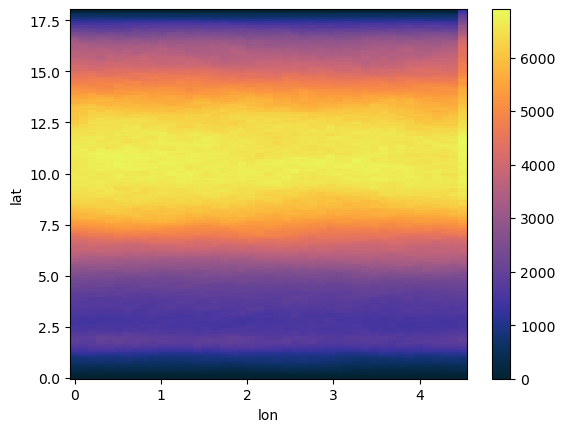

In [21]:
dens_array = xr.DataArray(
    dens,
    dims = ('lat','lon'),
    coords = {
        'lat':np.linspace(*lat_bds, Ny), 
        'lon':np.linspace(*lon_bds_base, Nx), 
    },
)

dens_array.plot.imshow(cmap=cm.thermal)

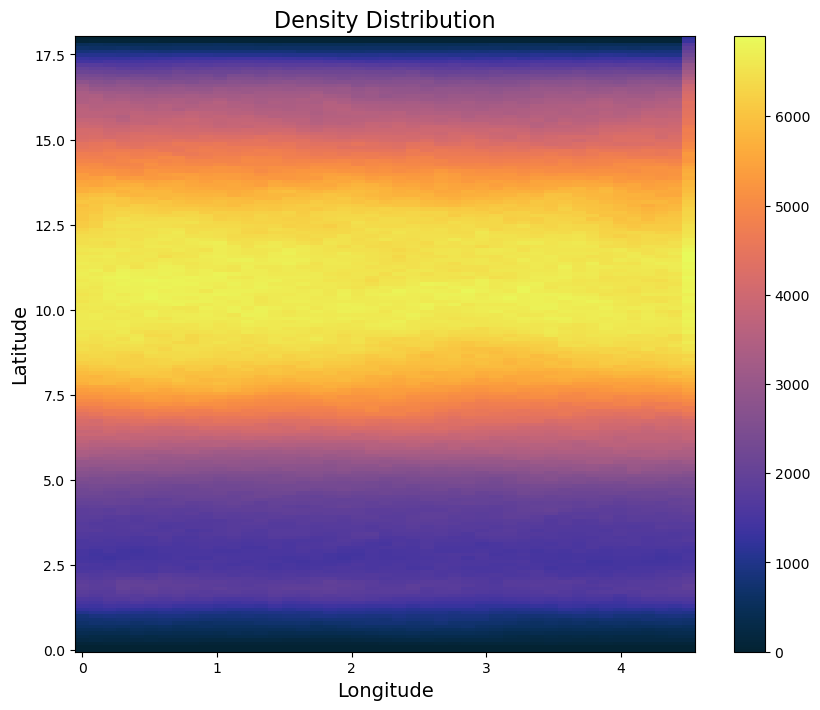

In [22]:
# Plot the data
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figure size as needed
dens_array.plot.imshow(ax=ax, cmap=cm.thermal)
plt.title("Density Distribution", fontsize=16)  # Add a title if needed
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)

# Save the figure
plt.savefig("particle_january.png", dpi=300, bbox_inches="tight")  # Save the figure
plt.show()